### **Libraries**

In [1]:
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.9 MB ? eta -:--:--
   ━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.2/1.9 MB 4.7 MB/s eta 0:00:01


   ━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━ 0.8/1.9 MB 12.0 MB/s eta 0:00:01


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 1.9/1.9 MB 21.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.3 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/374.4 kB ? eta -:--:--


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━ 286.7/374.4 kB 9.1 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.8 MB/s eta 0:00:00


  Preparing metadata (setup.py) ... done


  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2367263 sha256=da0f6f902fd04fb2680a67fce73caafa794b369438bab1b58b4d3c62d99e1d55
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [2]:
from torch.distributions import Normal, Categorical
from IPython.display import clear_output
import matplotlib.pyplot as plt
from collections import deque
from datetime import datetime
import torch.optim as optim
from tqdm import trange
import pandas as pd, time
import gymnasium as gym
import torch.nn as nn
import numpy as np
import torch
import json
import os

In [3]:
os.makedirs("results", exist_ok=True)

### **Environments**

In [4]:
#env_name = "LunarLander-v2"
env_name = "LunarLanderContinuous-v2"

### **Hyperparameters**

In [5]:
GAMMA = 0.99
LR = 3e-4
ENTROPY_COEF = 0.01
GAE_LAMBDA = 0.95
MAX_EPISODES = 20000
SEED = 42

In [6]:
np.random.seed(SEED)
torch.manual_seed(SEED)

In [7]:
def set_env_seed(env, seed=SEED):
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)

def plot_rewards(reward_dict):
    plt.figure(figsize=(10,6))
    for key, rewards in reward_dict.items():
        plt.plot(rewards, label=key)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Algorithm Comparison")
    plt.legend()
    plt.grid()
    plt.show()

def plot_live(rewards, title):
    clear_output(wait=True)
    plt.figure(figsize=(8,5))
    plt.plot(rewards, label='Reward')
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid()
    plt.legend()
    plt.show()

### **REINFORCE policy (continuous)**

In [8]:
class PolicyREINFORCE(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, act_dim)
        )
        self.log_std = nn.Parameter(torch.zeros(act_dim)) 

    def forward(self, x):
        mean = self.fc(x)
        std = torch.exp(self.log_std)
        return mean, std

### **A2C with separate networks**

In [ ]:
class ActorCriticSeparate(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()

        self.actor_fc = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, act_dim)
        )
        self.log_std = nn.Parameter(torch.zeros(act_dim))

        self.critic_fc = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128,1)
        )
    
    def forward(self, x):
        mean = self.actor_fc(x)
        std = torch.exp(self.log_std)
        value = self.critic_fc(x)
        return (mean, std), value

### **A2C with shared network**

In [10]:
class ActorCriticShared(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU()
        )
        self.actor_head = nn.Linear(128, act_dim)
        self.log_std = nn.Parameter(torch.zeros(act_dim))
        self.critic_head = nn.Linear(128,1)
    
    def forward(self, x):
        feat = self.shared(x)
        mean = self.actor_head(feat)
        std = torch.exp(self.log_std)
        value = self.critic_head(feat)
        return (mean, std), value

### **REINFORCE Training Loop**

In [ ]:
def train_reinforce(env_name):

    env = gym.make(env_name)
    # env = gym.make(env_name, continuous=False, gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5)
    
    set_env_seed(env)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    policy = PolicyREINFORCE(obs_dim, act_dim)
    optimizer = optim.Adam(policy.parameters(), lr=LR)
    metrics_list = []

    progress = trange(MAX_EPISODES, desc="REINFORCE", ncols=100)
    for ep in progress:
        start_time = time.time()
        state, _ = env.reset()
        log_probs, rewards = [], []
        done = False

        while not done:
            state_tensor = torch.FloatTensor(state)
            mean, std = policy(state_tensor)
            dist = torch.distributions.Normal(mean, std)
            action = dist.sample()
            next_state, reward, terminated, truncated, _ = env.step(action.detach().numpy())
            done = terminated or truncated

            log_probs.append(dist.log_prob(action).sum())
            rewards.append(reward)
            state = next_state

        G = 0
        returns = []
        for r in reversed(rewards):
            G = r + GAMMA * G
            returns.insert(0, G)
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        loss = 0
        for log_prob, R in zip(log_probs, returns):
            loss -= log_prob * R
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ep_reward = sum(rewards)
        progress.set_postfix_str(f"Reward: {ep_reward:.2f}")

        episode_time = time.time() - start_time
        metrics_list.append({
            "episode": ep + 1,
            "reward": ep_reward,
            "time": episode_time
        })

    env.close()
    df = pd.DataFrame(metrics_list)
    return df

### **A2C Training Loop (separate/shared, with optional GAE)**

In [ ]:
def train_a2c(env_name, variant="separate", use_gae=False):
    env = gym.make(env_name)
    
    set_env_seed(env)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    if variant == "separate":
        model = ActorCriticSeparate(obs_dim, act_dim)
    else:
        model = ActorCriticShared(obs_dim, act_dim)

    optimizer = optim.Adam(model.parameters(), lr=LR)
    metrics_list = []
    rewards_list = []

    progress = trange(MAX_EPISODES, desc=f"A2C-{variant}{'+GAE' if use_gae else ''}", ncols=100)
    for ep in progress:
        start_time = time.time()
        
        state, _ = env.reset()
        states, actions, rewards, log_probs, values, dones = [], [], [], [], [], []
        done = False

        while not done:
            state_tensor = torch.FloatTensor(state)
            (mean, std), value = model(state_tensor)
            dist = torch.distributions.Normal(mean, std)
            action = dist.sample()

            next_state, reward, terminated, truncated, _ = env.step(action.detach().numpy())
            done = terminated or truncated

            states.append(state_tensor)
            actions.append(action)
            rewards.append(reward)
            log_probs.append(dist.log_prob(action).sum())
            values.append(value)
            dones.append(done)

            state = next_state

        # advantages
        returns, advantages = [], []
        R, A = 0, 0
        values_tensor = torch.cat(values).squeeze().detach()
        for t in reversed(range(len(rewards))):
            mask = 1.0 - float(dones[t])
            if use_gae:
                delta = rewards[t] + GAMMA * (values_tensor[t+1] if t+1 < len(values_tensor) else 0) - values_tensor[t]
                A = delta + GAMMA * GAE_LAMBDA * mask * A
                advantages.insert(0, A)
            R = rewards[t] + GAMMA * R
            returns.insert(0, R)
        returns = torch.tensor(returns, dtype=torch.float32)
        advantages = torch.tensor(advantages if use_gae else returns - values_tensor, dtype=torch.float32)

        # loss
        values_pred = torch.cat(values).squeeze()
        actor_loss = -torch.stack([log_prob * adv for log_prob, adv in zip(log_probs, advantages)]).mean()
        critic_loss = ((returns - values_pred) ** 2).mean()
        loss = actor_loss + 0.5 * critic_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ep_reward = sum(rewards)
        progress.set_postfix_str(f"Reward: {ep_reward:.2f}")
        rewards_list.append(ep_reward)

        if (ep + 1) % 20 == 0: 
            plot_live(rewards_list, f"{env_name}-A2C-{variant}{'+GAE' if use_gae else ''}")

        episode_time = time.time() - start_time
        metrics_list.append({
            "episode": ep + 1,
            "reward": ep_reward,
            "time": episode_time
        })

    env.close()
    df = pd.DataFrame(metrics_list)
    return df

### **Clasicc Control Env**

In [13]:
results = {}
metrics = {
    "REINFORCE": {},
    "A2C_separate": {},
    "A2C_shared": {},
    "A2C_shared_GAE": {}
}

In [14]:
print(f"\n=== Training on: {env_name} ===")


=== Training on: LunarLanderContinuous-v2 ===


In [ ]:
# REINFORCE
df_reinforce = train_reinforce(env_name) 
metrics["REINFORCE"] = df_reinforce
df_reinforce.to_csv(f"results/REINFORCE_{env_name}.csv", index=False)

/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa


REINFORCE:   0%|                                                          | 0/20000 [00:00<?, ?it/s]


REINFORCE:   0%|                                         | 0/20000 [00:00<?, ?it/s, Reward: -377.01]


REINFORCE:   0%|                                 | 1/20000 [00:00<57:44,  5.77it/s, Reward: -377.01]


REINFORCE:   0%|                                 | 1/20000 [00:00<57:44,  5.77it/s, Reward: -297.55]


REINFORCE:   0%|                                 | 2/20000 [00:00<43:46,  7.61it/s, Reward: -297.55]


REINFORCE:   0%|                                 | 2/20000 [00:00<43:46,  7.61it/s, Reward: -313.56]


REINFORCE:   0%|                                 | 2/20000 [00:00<43:46,  7.61it/s, Reward: -251.23]


REINFORCE:   0%|                                 | 4/20000 [00:00<31:11, 10.68it/s, Reward: -251.23]


REINFORCE:   0%|                                 | 4/20000 [00:00<31:11, 10.68it/s, Reward: -295.36]


REINFORCE:   0%|                                 | 4/20000 [00:00<31:11, 10.68it/s, Reward: -284.40]


REINFORCE:   0%|                                 | 6/20000 [00:00<27:39, 12.05it/s, Reward: -284.40]


REINFORCE:   0%|                                 | 6/20000 [00:00<27:39, 12.05it/s, Reward: -463.28]


REINFORCE:   0%|                                 | 6/20000 [00:00<27:39, 12.05it/s, Reward: -330.31]


REINFORCE:   0%|                                 | 8/20000 [00:00<25:06, 13.27it/s, Reward: -330.31]


REINFORCE:   0%|                                  | 8/20000 [00:00<25:06, 13.27it/s, Reward: -66.19]


REINFORCE:   0%|                                 | 8/20000 [00:00<25:06, 13.27it/s, Reward: -444.47]


REINFORCE:   0%|                                | 10/20000 [00:00<25:30, 13.06it/s, Reward: -444.47]


REINFORCE:   0%|                                | 10/20000 [00:00<25:30, 13.06it/s, Reward: -107.50]


REINFORCE:   0%|                                | 10/20000 [00:00<25:30, 13.06it/s, Reward: -188.39]


REINFORCE:   0%|                                | 12/20000 [00:00<24:37, 13.53it/s, Reward: -188.39]


REINFORCE:   0%|                                | 12/20000 [00:01<24:37, 13.53it/s, Reward: -527.86]


REINFORCE:   0%|                                | 12/20000 [00:01<24:37, 13.53it/s, Reward: -309.05]


REINFORCE:   0%|                                | 14/20000 [00:01<27:58, 11.91it/s, Reward: -309.05]


REINFORCE:   0%|                                | 14/20000 [00:01<27:58, 11.91it/s, Reward: -476.04]


REINFORCE:   0%|                                | 14/20000 [00:01<27:58, 11.91it/s, Reward: -166.05]


REINFORCE:   0%|                                | 16/20000 [00:01<29:33, 11.27it/s, Reward: -166.05]


REINFORCE:   0%|                                | 16/20000 [00:01<29:33, 11.27it/s, Reward: -426.73]


REINFORCE:   0%|                                | 16/20000 [00:01<29:33, 11.27it/s, Reward: -386.91]


REINFORCE:   0%|                                | 18/20000 [00:01<31:14, 10.66it/s, Reward: -386.91]


REINFORCE:   0%|                                | 18/20000 [00:01<31:14, 10.66it/s, Reward: -364.53]


REINFORCE:   0%|                                | 18/20000 [00:01<31:14, 10.66it/s, Reward: -468.65]


REINFORCE:   0%|                                | 20/20000 [00:01<31:00, 10.74it/s, Reward: -468.65]


REINFORCE:   0%|                                | 20/20000 [00:01<31:00, 10.74it/s, Reward: -604.21]


REINFORCE:   0%|                                | 20/20000 [00:01<31:00, 10.74it/s, Reward: -301.43]


REINFORCE:   0%|                                | 22/20000 [00:01<31:30, 10.57it/s, Reward: -301.43]


REINFORCE:   0%|                                | 22/20000 [00:02<31:30, 10.57it/s, Reward: -403.87]


REINFORCE:   0%|                                | 22/20000 [00:02<31:30, 10.57it/s, Reward: -375.56]


REINFORCE:   0%|                                | 24/20000 [00:02<28:59, 11.49it/s, Reward: -375.56]


REINFORCE:   0%|                                | 24/20000 [00:02<28:59, 11.49it/s, Reward: -246.42]


REINFORCE:   0%|                                | 24/20000 [00:02<28:59, 11.49it/s, Reward: -583.94]


REINFORCE:   0%|                                | 26/20000 [00:02<28:58, 11.49it/s, Reward: -583.94]


REINFORCE:   0%|                                | 26/20000 [00:02<28:58, 11.49it/s, Reward: -531.14]


REINFORCE:   0%|                                 | 26/20000 [00:02<28:58, 11.49it/s, Reward: -67.36]


REINFORCE:   0%|                                 | 28/20000 [00:02<29:26, 11.30it/s, Reward: -67.36]


REINFORCE:   0%|                                 | 28/20000 [00:02<29:26, 11.30it/s, Reward: -59.13]


REINFORCE:   0%|                                | 28/20000 [00:02<29:26, 11.30it/s, Reward: -479.03]


REINFORCE:   0%|                                | 30/20000 [00:02<30:28, 10.92it/s, Reward: -479.03]


REINFORCE:   0%|                                | 30/20000 [00:02<30:28, 10.92it/s, Reward: -513.35]


REINFORCE:   0%|                                 | 30/20000 [00:02<30:28, 10.92it/s, Reward: -86.83]


REINFORCE:   0%|                                 | 32/20000 [00:02<29:42, 11.20it/s, Reward: -86.83]


REINFORCE:   0%|                                | 32/20000 [00:02<29:42, 11.20it/s, Reward: -342.82]


REINFORCE:   0%|                                 | 32/20000 [00:03<29:42, 11.20it/s, Reward: -32.45]


REINFORCE:   0%|                                 | 34/20000 [00:03<28:52, 11.53it/s, Reward: -32.45]


REINFORCE:   0%|                                | 34/20000 [00:03<28:52, 11.53it/s, Reward: -567.32]


REINFORCE:   0%|                                | 34/20000 [00:03<28:52, 11.53it/s, Reward: -225.21]


REINFORCE:   0%|                                | 36/20000 [00:03<29:57, 11.10it/s, Reward: -225.21]


REINFORCE:   0%|                                | 36/20000 [00:03<29:57, 11.10it/s, Reward: -475.28]


REINFORCE:   0%|                                | 36/20000 [00:03<29:57, 11.10it/s, Reward: -479.47]


REINFORCE:   0%|                                | 38/20000 [00:03<30:25, 10.93it/s, Reward: -479.47]


REINFORCE:   0%|                                | 38/20000 [00:03<30:25, 10.93it/s, Reward: -457.65]


REINFORCE:   0%|                                 | 38/20000 [00:03<30:25, 10.93it/s, Reward: -84.62]


REINFORCE:   0%|                                 | 40/20000 [00:03<28:56, 11.49it/s, Reward: -84.62]


REINFORCE:   0%|                                | 40/20000 [00:03<28:56, 11.49it/s, Reward: -305.17]


REINFORCE:   0%|                                | 40/20000 [00:03<28:56, 11.49it/s, Reward: -307.10]


REINFORCE:   0%|                                | 42/20000 [00:03<31:20, 10.61it/s, Reward: -307.10]


REINFORCE:   0%|                                | 42/20000 [00:03<31:20, 10.61it/s, Reward: -446.85]


REINFORCE:   0%|                                | 42/20000 [00:03<31:20, 10.61it/s, Reward: -513.27]


REINFORCE:   0%|                                | 44/20000 [00:03<29:34, 11.25it/s, Reward: -513.27]


REINFORCE:   0%|                                | 44/20000 [00:04<29:34, 11.25it/s, Reward: -448.71]


REINFORCE:   0%|                                | 44/20000 [00:04<29:34, 11.25it/s, Reward: -535.84]


REINFORCE:   0%|                                | 46/20000 [00:04<28:33, 11.65it/s, Reward: -535.84]


REINFORCE:   0%|                                | 46/20000 [00:04<28:33, 11.65it/s, Reward: -315.79]


REINFORCE:   0%|                                | 46/20000 [00:04<28:33, 11.65it/s, Reward: -385.01]


REINFORCE:   0%|                                | 48/20000 [00:04<32:46, 10.15it/s, Reward: -385.01]


REINFORCE:   0%|                                | 48/20000 [00:04<32:46, 10.15it/s, Reward: -519.53]


REINFORCE:   0%|                                 | 48/20000 [00:04<32:46, 10.15it/s, Reward: -71.50]


REINFORCE:   0%|                                 | 50/20000 [00:04<31:27, 10.57it/s, Reward: -71.50]


REINFORCE:   0%|                                | 50/20000 [00:04<31:27, 10.57it/s, Reward: -164.49]


REINFORCE:   0%|                                | 50/20000 [00:04<31:27, 10.57it/s, Reward: -320.67]


REINFORCE:   0%|                                | 52/20000 [00:04<31:47, 10.46it/s, Reward: -320.67]


REINFORCE:   0%|                                | 52/20000 [00:04<31:47, 10.46it/s, Reward: -280.16]


REINFORCE:   0%|                                | 52/20000 [00:04<31:47, 10.46it/s, Reward: -120.04]


REINFORCE:   0%|                                | 54/20000 [00:04<30:57, 10.74it/s, Reward: -120.04]


REINFORCE:   0%|                                | 54/20000 [00:04<30:57, 10.74it/s, Reward: -330.79]


REINFORCE:   0%|                                | 54/20000 [00:05<30:57, 10.74it/s, Reward: -369.12]


REINFORCE:   0%|                                | 56/20000 [00:05<28:35, 11.63it/s, Reward: -369.12]


REINFORCE:   0%|                                | 56/20000 [00:05<28:35, 11.63it/s, Reward: -262.42]


REINFORCE:   0%|                                | 56/20000 [00:05<28:35, 11.63it/s, Reward: -230.45]


REINFORCE:   0%|                                | 58/20000 [00:05<28:28, 11.67it/s, Reward: -230.45]


REINFORCE:   0%|                                | 58/20000 [00:05<28:28, 11.67it/s, Reward: -196.52]


REINFORCE:   0%|                                 | 58/20000 [00:05<28:28, 11.67it/s, Reward: -77.06]


REINFORCE:   0%|                                 | 60/20000 [00:05<32:02, 10.37it/s, Reward: -77.06]


REINFORCE:   0%|                                 | 60/20000 [00:05<32:02, 10.37it/s, Reward: -16.15]


REINFORCE:   0%|                                | 60/20000 [00:05<32:02, 10.37it/s, Reward: -535.03]


REINFORCE:   0%|                                | 62/20000 [00:05<31:43, 10.47it/s, Reward: -535.03]


REINFORCE:   0%|                                | 62/20000 [00:05<31:43, 10.47it/s, Reward: -619.27]


REINFORCE:   0%|                                | 62/20000 [00:05<31:43, 10.47it/s, Reward: -474.47]


REINFORCE:   0%|                                | 64/20000 [00:05<29:52, 11.12it/s, Reward: -474.47]


REINFORCE:   0%|                                | 64/20000 [00:05<29:52, 11.12it/s, Reward: -332.71]


REINFORCE:   0%|                                | 64/20000 [00:05<29:52, 11.12it/s, Reward: -350.29]


REINFORCE:   0%|                                | 66/20000 [00:05<28:01, 11.86it/s, Reward: -350.29]


REINFORCE:   0%|                                | 66/20000 [00:05<28:01, 11.86it/s, Reward: -370.22]


REINFORCE:   0%|                                | 66/20000 [00:06<28:01, 11.86it/s, Reward: -434.19]


REINFORCE:   0%|                                | 68/20000 [00:06<27:26, 12.11it/s, Reward: -434.19]


REINFORCE:   0%|                                | 68/20000 [00:06<27:26, 12.11it/s, Reward: -414.02]


REINFORCE:   0%|                                | 68/20000 [00:06<27:26, 12.11it/s, Reward: -153.87]


REINFORCE:   0%|                                | 70/20000 [00:06<29:12, 11.37it/s, Reward: -153.87]


REINFORCE:   0%|                                | 70/20000 [00:06<29:12, 11.37it/s, Reward: -125.37]


REINFORCE:   0%|                                | 70/20000 [00:06<29:12, 11.37it/s, Reward: -208.33]


REINFORCE:   0%|                                | 72/20000 [00:06<27:41, 11.99it/s, Reward: -208.33]


REINFORCE:   0%|                                | 72/20000 [00:06<27:41, 11.99it/s, Reward: -342.43]


REINFORCE:   0%|                                | 72/20000 [00:06<27:41, 11.99it/s, Reward: -436.16]


REINFORCE:   0%|                                | 74/20000 [00:06<28:09, 11.79it/s, Reward: -436.16]


REINFORCE:   0%|                                | 74/20000 [00:06<28:09, 11.79it/s, Reward: -351.84]


REINFORCE:   0%|                                | 74/20000 [00:06<28:09, 11.79it/s, Reward: -459.34]


REINFORCE:   0%|                                | 76/20000 [00:06<27:26, 12.10it/s, Reward: -459.34]


REINFORCE:   0%|                                | 76/20000 [00:06<27:26, 12.10it/s, Reward: -202.13]


REINFORCE:   0%|                                | 76/20000 [00:06<27:26, 12.10it/s, Reward: -547.21]


REINFORCE:   0%|                                | 78/20000 [00:06<26:40, 12.45it/s, Reward: -547.21]


REINFORCE:   0%|                                | 78/20000 [00:06<26:40, 12.45it/s, Reward: -278.18]


REINFORCE:   0%|                                | 78/20000 [00:07<26:40, 12.45it/s, Reward: -307.17]


REINFORCE:   0%|▏                               | 80/20000 [00:07<27:18, 12.16it/s, Reward: -307.17]


REINFORCE:   0%|▏                               | 80/20000 [00:07<27:18, 12.16it/s, Reward: -231.58]


REINFORCE:   0%|▏                               | 80/20000 [00:07<27:18, 12.16it/s, Reward: -420.16]


REINFORCE:   0%|▏                               | 82/20000 [00:07<30:09, 11.01it/s, Reward: -420.16]


REINFORCE:   0%|▏                               | 82/20000 [00:07<30:09, 11.01it/s, Reward: -348.44]


REINFORCE:   0%|▏                               | 82/20000 [00:07<30:09, 11.01it/s, Reward: -440.94]


REINFORCE:   0%|▏                               | 84/20000 [00:07<29:41, 11.18it/s, Reward: -440.94]


REINFORCE:   0%|▏                               | 84/20000 [00:07<29:41, 11.18it/s, Reward: -456.36]


REINFORCE:   0%|▏                                | 84/20000 [00:07<29:41, 11.18it/s, Reward: -98.83]


REINFORCE:   0%|▏                                | 86/20000 [00:07<30:53, 10.74it/s, Reward: -98.83]


REINFORCE:   0%|▏                               | 86/20000 [00:07<30:53, 10.74it/s, Reward: -406.43]


REINFORCE:   0%|▏                               | 86/20000 [00:07<30:53, 10.74it/s, Reward: -499.67]


REINFORCE:   0%|▏                               | 88/20000 [00:07<30:09, 11.00it/s, Reward: -499.67]


REINFORCE:   0%|▏                               | 88/20000 [00:07<30:09, 11.00it/s, Reward: -543.64]


REINFORCE:   0%|▏                               | 88/20000 [00:08<30:09, 11.00it/s, Reward: -200.64]


REINFORCE:   0%|▏                               | 90/20000 [00:08<31:58, 10.38it/s, Reward: -200.64]


REINFORCE:   0%|▏                               | 90/20000 [00:08<31:58, 10.38it/s, Reward: -451.68]


REINFORCE:   0%|▏                               | 90/20000 [00:08<31:58, 10.38it/s, Reward: -411.47]


REINFORCE:   0%|▏                               | 92/20000 [00:08<31:22, 10.57it/s, Reward: -411.47]


REINFORCE:   0%|▏                               | 92/20000 [00:08<31:22, 10.57it/s, Reward: -479.64]


REINFORCE:   0%|▏                               | 92/20000 [00:08<31:22, 10.57it/s, Reward: -104.07]


REINFORCE:   0%|▏                               | 94/20000 [00:08<28:38, 11.59it/s, Reward: -104.07]


REINFORCE:   0%|▏                                | 94/20000 [00:08<28:38, 11.59it/s, Reward: -83.66]


REINFORCE:   0%|▏                               | 94/20000 [00:08<28:38, 11.59it/s, Reward: -273.13]


REINFORCE:   0%|▏                               | 96/20000 [00:08<27:00, 12.28it/s, Reward: -273.13]


REINFORCE:   0%|▏                               | 96/20000 [00:08<27:00, 12.28it/s, Reward: -349.21]


REINFORCE:   0%|▏                               | 96/20000 [00:08<27:00, 12.28it/s, Reward: -412.80]


REINFORCE:   0%|▏                               | 98/20000 [00:08<27:23, 12.11it/s, Reward: -412.80]


REINFORCE:   0%|▏                                | 98/20000 [00:08<27:23, 12.11it/s, Reward: -77.15]


REINFORCE:   0%|▏                               | 98/20000 [00:08<27:23, 12.11it/s, Reward: -486.65]


REINFORCE:   0%|▏                              | 100/20000 [00:08<29:52, 11.10it/s, Reward: -486.65]


REINFORCE:   0%|▏                              | 100/20000 [00:09<29:52, 11.10it/s, Reward: -129.55]


REINFORCE:   0%|▏                              | 100/20000 [00:09<29:52, 11.10it/s, Reward: -476.26]


REINFORCE:   1%|▏                              | 102/20000 [00:09<30:24, 10.91it/s, Reward: -476.26]


REINFORCE:   1%|▏                               | 102/20000 [00:09<30:24, 10.91it/s, Reward: -60.66]


REINFORCE:   1%|▏                              | 102/20000 [00:09<30:24, 10.91it/s, Reward: -412.42]


REINFORCE:   1%|▏                              | 104/20000 [00:09<33:38,  9.86it/s, Reward: -412.42]


REINFORCE:   1%|▏                              | 104/20000 [00:09<33:38,  9.86it/s, Reward: -286.69]


REINFORCE:   1%|▏                              | 104/20000 [00:09<33:38,  9.86it/s, Reward: -217.64]


REINFORCE:   1%|▏                              | 106/20000 [00:09<31:20, 10.58it/s, Reward: -217.64]


REINFORCE:   1%|▏                               | 106/20000 [00:09<31:20, 10.58it/s, Reward: -45.26]


REINFORCE:   1%|▏                               | 106/20000 [00:09<31:20, 10.58it/s, Reward: -40.27]


REINFORCE:   1%|▏                               | 108/20000 [00:09<29:33, 11.22it/s, Reward: -40.27]


REINFORCE:   1%|▏                               | 108/20000 [00:09<29:33, 11.22it/s, Reward: -53.34]


REINFORCE:   1%|▏                              | 108/20000 [00:09<29:33, 11.22it/s, Reward: -161.70]


REINFORCE:   1%|▏                              | 110/20000 [00:09<28:53, 11.48it/s, Reward: -161.70]


REINFORCE:   1%|▏                              | 110/20000 [00:09<28:53, 11.48it/s, Reward: -445.64]


REINFORCE:   1%|▏                               | 110/20000 [00:09<28:53, 11.48it/s, Reward: -67.07]


REINFORCE:   1%|▏                               | 112/20000 [00:09<27:16, 12.15it/s, Reward: -67.07]


REINFORCE:   1%|▏                              | 112/20000 [00:10<27:16, 12.15it/s, Reward: -270.26]


REINFORCE:   1%|▏                              | 112/20000 [00:10<27:16, 12.15it/s, Reward: -265.39]


REINFORCE:   1%|▏                              | 114/20000 [00:10<26:54, 12.32it/s, Reward: -265.39]


REINFORCE:   1%|▏                              | 114/20000 [00:10<26:54, 12.32it/s, Reward: -404.79]


REINFORCE:   1%|▏                              | 114/20000 [00:10<26:54, 12.32it/s, Reward: -122.27]


REINFORCE:   1%|▏                              | 116/20000 [00:10<25:52, 12.81it/s, Reward: -122.27]


REINFORCE:   1%|▏                              | 116/20000 [00:10<25:52, 12.81it/s, Reward: -365.42]


REINFORCE:   1%|▏                               | 116/20000 [00:10<25:52, 12.81it/s, Reward: -88.53]


REINFORCE:   1%|▏                               | 118/20000 [00:10<24:56, 13.29it/s, Reward: -88.53]


REINFORCE:   1%|▏                              | 118/20000 [00:10<24:56, 13.29it/s, Reward: -371.78]


REINFORCE:   1%|▏                               | 118/20000 [00:10<24:56, 13.29it/s, Reward: -91.20]


REINFORCE:   1%|▏                               | 120/20000 [00:10<24:01, 13.79it/s, Reward: -91.20]


REINFORCE:   1%|▏                              | 120/20000 [00:10<24:01, 13.79it/s, Reward: -432.25]


REINFORCE:   1%|▏                              | 120/20000 [00:10<24:01, 13.79it/s, Reward: -517.26]


REINFORCE:   1%|▏                              | 122/20000 [00:10<26:42, 12.40it/s, Reward: -517.26]


REINFORCE:   1%|▏                              | 122/20000 [00:10<26:42, 12.40it/s, Reward: -358.92]


REINFORCE:   1%|▏                              | 122/20000 [00:10<26:42, 12.40it/s, Reward: -455.97]


REINFORCE:   1%|▏                              | 124/20000 [00:10<30:16, 10.94it/s, Reward: -455.97]


REINFORCE:   1%|▏                               | 124/20000 [00:11<30:16, 10.94it/s, Reward: -79.78]


REINFORCE:   1%|▏                              | 124/20000 [00:11<30:16, 10.94it/s, Reward: -146.58]


REINFORCE:   1%|▏                              | 126/20000 [00:11<28:19, 11.69it/s, Reward: -146.58]


REINFORCE:   1%|▏                              | 126/20000 [00:11<28:19, 11.69it/s, Reward: -301.06]


REINFORCE:   1%|▏                              | 126/20000 [00:11<28:19, 11.69it/s, Reward: -135.66]


REINFORCE:   1%|▏                              | 128/20000 [00:11<30:03, 11.02it/s, Reward: -135.66]


REINFORCE:   1%|▏                              | 128/20000 [00:11<30:03, 11.02it/s, Reward: -221.81]


REINFORCE:   1%|▏                              | 128/20000 [00:11<30:03, 11.02it/s, Reward: -156.96]


REINFORCE:   1%|▏                              | 130/20000 [00:11<29:52, 11.08it/s, Reward: -156.96]


REINFORCE:   1%|▏                              | 130/20000 [00:11<29:52, 11.08it/s, Reward: -308.26]


REINFORCE:   1%|▏                              | 130/20000 [00:11<29:52, 11.08it/s, Reward: -133.29]


REINFORCE:   1%|▏                              | 132/20000 [00:11<28:46, 11.51it/s, Reward: -133.29]


REINFORCE:   1%|▏                              | 132/20000 [00:11<28:46, 11.51it/s, Reward: -470.81]


REINFORCE:   1%|▏                               | 132/20000 [00:11<28:46, 11.51it/s, Reward: -71.15]


REINFORCE:   1%|▏                               | 134/20000 [00:11<32:15, 10.26it/s, Reward: -71.15]


REINFORCE:   1%|▏                              | 134/20000 [00:11<32:15, 10.26it/s, Reward: -386.33]


REINFORCE:   1%|▏                              | 134/20000 [00:12<32:15, 10.26it/s, Reward: -214.42]


REINFORCE:   1%|▏                              | 136/20000 [00:12<31:07, 10.64it/s, Reward: -214.42]


REINFORCE:   1%|▏                              | 136/20000 [00:12<31:07, 10.64it/s, Reward: -177.04]


REINFORCE:   1%|▏                              | 136/20000 [00:12<31:07, 10.64it/s, Reward: -305.88]


REINFORCE:   1%|▏                              | 138/20000 [00:12<31:50, 10.40it/s, Reward: -305.88]


REINFORCE:   1%|▏                               | 138/20000 [00:12<31:50, 10.40it/s, Reward: -71.16]


REINFORCE:   1%|▏                              | 138/20000 [00:12<31:50, 10.40it/s, Reward: -195.13]


REINFORCE:   1%|▏                              | 140/20000 [00:12<31:03, 10.66it/s, Reward: -195.13]


REINFORCE:   1%|▏                               | 140/20000 [00:12<31:03, 10.66it/s, Reward: -81.39]


REINFORCE:   1%|▏                              | 140/20000 [00:12<31:03, 10.66it/s, Reward: -173.60]


REINFORCE:   1%|▏                              | 142/20000 [00:12<29:22, 11.27it/s, Reward: -173.60]


REINFORCE:   1%|▏                              | 142/20000 [00:12<29:22, 11.27it/s, Reward: -115.71]


REINFORCE:   1%|▏                              | 142/20000 [00:12<29:22, 11.27it/s, Reward: -325.23]


REINFORCE:   1%|▏                              | 144/20000 [00:12<28:01, 11.81it/s, Reward: -325.23]


REINFORCE:   1%|▏                               | 144/20000 [00:12<28:01, 11.81it/s, Reward: -59.27]


REINFORCE:   1%|▏                              | 144/20000 [00:12<28:01, 11.81it/s, Reward: -215.71]


REINFORCE:   1%|▏                              | 146/20000 [00:12<26:09, 12.65it/s, Reward: -215.71]


REINFORCE:   1%|▏                              | 146/20000 [00:12<26:09, 12.65it/s, Reward: -417.08]


REINFORCE:   1%|▏                              | 146/20000 [00:13<26:09, 12.65it/s, Reward: -329.66]


REINFORCE:   1%|▏                              | 148/20000 [00:13<25:49, 12.81it/s, Reward: -329.66]


REINFORCE:   1%|▏                              | 148/20000 [00:13<25:49, 12.81it/s, Reward: -200.36]


REINFORCE:   1%|▏                              | 148/20000 [00:13<25:49, 12.81it/s, Reward: -203.96]


REINFORCE:   1%|▏                              | 150/20000 [00:13<26:53, 12.31it/s, Reward: -203.96]


REINFORCE:   1%|▏                               | 150/20000 [00:13<26:53, 12.31it/s, Reward: -51.10]


REINFORCE:   1%|▏                              | 150/20000 [00:13<26:53, 12.31it/s, Reward: -488.74]


REINFORCE:   1%|▏                              | 152/20000 [00:13<25:51, 12.79it/s, Reward: -488.74]


REINFORCE:   1%|▏                              | 152/20000 [00:13<25:51, 12.79it/s, Reward: -184.62]


REINFORCE:   1%|▏                              | 152/20000 [00:13<25:51, 12.79it/s, Reward: -183.11]


REINFORCE:   1%|▏                              | 154/20000 [00:13<27:14, 12.14it/s, Reward: -183.11]


REINFORCE:   1%|▏                              | 154/20000 [00:13<27:14, 12.14it/s, Reward: -489.69]


REINFORCE:   1%|▏                              | 154/20000 [00:13<27:14, 12.14it/s, Reward: -148.30]


REINFORCE:   1%|▏                              | 156/20000 [00:13<30:22, 10.89it/s, Reward: -148.30]


REINFORCE:   1%|▏                              | 156/20000 [00:13<30:22, 10.89it/s, Reward: -507.89]


REINFORCE:   1%|▏                              | 156/20000 [00:13<30:22, 10.89it/s, Reward: -399.26]


REINFORCE:   1%|▏                              | 158/20000 [00:13<33:29,  9.88it/s, Reward: -399.26]


REINFORCE:   1%|▏                              | 158/20000 [00:14<33:29,  9.88it/s, Reward: -331.75]


REINFORCE:   1%|▏                              | 158/20000 [00:14<33:29,  9.88it/s, Reward: -246.86]


REINFORCE:   1%|▏                              | 160/20000 [00:14<33:16,  9.94it/s, Reward: -246.86]


REINFORCE:   1%|▏                              | 160/20000 [00:14<33:16,  9.94it/s, Reward: -414.04]


REINFORCE:   1%|▏                              | 160/20000 [00:14<33:16,  9.94it/s, Reward: -473.96]


REINFORCE:   1%|▎                              | 162/20000 [00:14<32:46, 10.09it/s, Reward: -473.96]


REINFORCE:   1%|▎                              | 162/20000 [00:14<32:46, 10.09it/s, Reward: -157.47]


REINFORCE:   1%|▎                              | 162/20000 [00:14<32:46, 10.09it/s, Reward: -324.59]


REINFORCE:   1%|▎                              | 164/20000 [00:14<31:16, 10.57it/s, Reward: -324.59]


REINFORCE:   1%|▎                               | 164/20000 [00:14<31:16, 10.57it/s, Reward: -65.41]


REINFORCE:   1%|▎                              | 164/20000 [00:14<31:16, 10.57it/s, Reward: -297.98]


REINFORCE:   1%|▎                              | 166/20000 [00:14<29:05, 11.36it/s, Reward: -297.98]


REINFORCE:   1%|▎                              | 166/20000 [00:14<29:05, 11.36it/s, Reward: -251.88]


REINFORCE:   1%|▎                              | 166/20000 [00:14<29:05, 11.36it/s, Reward: -103.34]


REINFORCE:   1%|▎                              | 168/20000 [00:14<30:46, 10.74it/s, Reward: -103.34]


REINFORCE:   1%|▎                              | 168/20000 [00:14<30:46, 10.74it/s, Reward: -250.59]


REINFORCE:   1%|▎                                | 168/20000 [00:15<30:46, 10.74it/s, Reward: 18.94]


REINFORCE:   1%|▎                                | 170/20000 [00:15<29:43, 11.12it/s, Reward: 18.94]


REINFORCE:   1%|▎                              | 170/20000 [00:15<29:43, 11.12it/s, Reward: -346.51]


REINFORCE:   1%|▎                               | 170/20000 [00:15<29:43, 11.12it/s, Reward: -59.31]


REINFORCE:   1%|▎                               | 172/20000 [00:15<28:55, 11.42it/s, Reward: -59.31]


REINFORCE:   1%|▎                              | 172/20000 [00:15<28:55, 11.42it/s, Reward: -326.93]


REINFORCE:   1%|▎                               | 172/20000 [00:15<28:55, 11.42it/s, Reward: -75.56]


REINFORCE:   1%|▎                               | 174/20000 [00:15<27:47, 11.89it/s, Reward: -75.56]


REINFORCE:   1%|▎                               | 174/20000 [00:15<27:47, 11.89it/s, Reward: -76.08]


REINFORCE:   1%|▎                              | 174/20000 [00:15<27:47, 11.89it/s, Reward: -416.20]


REINFORCE:   1%|▎                              | 176/20000 [00:15<27:33, 11.99it/s, Reward: -416.20]


REINFORCE:   1%|▎                              | 176/20000 [00:15<27:33, 11.99it/s, Reward: -272.17]


REINFORCE:   1%|▎                              | 176/20000 [00:15<27:33, 11.99it/s, Reward: -132.14]


REINFORCE:   1%|▎                              | 178/20000 [00:15<30:29, 10.83it/s, Reward: -132.14]


REINFORCE:   1%|▎                              | 178/20000 [00:15<30:29, 10.83it/s, Reward: -142.02]


REINFORCE:   1%|▎                              | 178/20000 [00:15<30:29, 10.83it/s, Reward: -342.72]


REINFORCE:   1%|▎                              | 180/20000 [00:15<29:24, 11.23it/s, Reward: -342.72]


REINFORCE:   1%|▎                              | 180/20000 [00:16<29:24, 11.23it/s, Reward: -101.36]


REINFORCE:   1%|▎                              | 180/20000 [00:16<29:24, 11.23it/s, Reward: -261.37]


REINFORCE:   1%|▎                              | 182/20000 [00:16<30:38, 10.78it/s, Reward: -261.37]


REINFORCE:   1%|▎                              | 182/20000 [00:16<30:38, 10.78it/s, Reward: -266.71]


REINFORCE:   1%|▎                              | 182/20000 [00:16<30:38, 10.78it/s, Reward: -160.73]


REINFORCE:   1%|▎                              | 184/20000 [00:16<29:22, 11.24it/s, Reward: -160.73]


REINFORCE:   1%|▎                              | 184/20000 [00:16<29:22, 11.24it/s, Reward: -262.51]


REINFORCE:   1%|▎                              | 184/20000 [00:16<29:22, 11.24it/s, Reward: -389.06]


REINFORCE:   1%|▎                              | 186/20000 [00:16<27:33, 11.98it/s, Reward: -389.06]


REINFORCE:   1%|▎                              | 186/20000 [00:16<27:33, 11.98it/s, Reward: -365.69]


REINFORCE:   1%|▎                               | 186/20000 [00:16<27:33, 11.98it/s, Reward: -97.96]


REINFORCE:   1%|▎                               | 188/20000 [00:16<25:00, 13.21it/s, Reward: -97.96]


REINFORCE:   1%|▎                               | 188/20000 [00:16<25:00, 13.21it/s, Reward: -42.72]


REINFORCE:   1%|▎                              | 188/20000 [00:16<25:00, 13.21it/s, Reward: -372.75]


REINFORCE:   1%|▎                              | 190/20000 [00:16<27:05, 12.19it/s, Reward: -372.75]


REINFORCE:   1%|▎                               | 190/20000 [00:16<27:05, 12.19it/s, Reward: -71.84]


REINFORCE:   1%|▎                              | 190/20000 [00:16<27:05, 12.19it/s, Reward: -214.48]


REINFORCE:   1%|▎                              | 192/20000 [00:16<30:36, 10.78it/s, Reward: -214.48]


REINFORCE:   1%|▎                              | 192/20000 [00:17<30:36, 10.78it/s, Reward: -364.85]


REINFORCE:   1%|▎                              | 192/20000 [00:17<30:36, 10.78it/s, Reward: -116.43]


REINFORCE:   1%|▎                              | 194/20000 [00:17<31:03, 10.63it/s, Reward: -116.43]


REINFORCE:   1%|▎                                | 194/20000 [00:17<31:03, 10.63it/s, Reward: 26.44]


REINFORCE:   1%|▎                               | 194/20000 [00:17<31:03, 10.63it/s, Reward: -30.33]


REINFORCE:   1%|▎                               | 196/20000 [00:17<29:53, 11.04it/s, Reward: -30.33]


REINFORCE:   1%|▎                              | 196/20000 [00:17<29:53, 11.04it/s, Reward: -171.42]


REINFORCE:   1%|▎                              | 196/20000 [00:17<29:53, 11.04it/s, Reward: -309.81]


REINFORCE:   1%|▎                              | 198/20000 [00:17<27:41, 11.92it/s, Reward: -309.81]


REINFORCE:   1%|▎                              | 198/20000 [00:17<27:41, 11.92it/s, Reward: -516.55]


REINFORCE:   1%|▎                              | 198/20000 [00:17<27:41, 11.92it/s, Reward: -397.37]


REINFORCE:   1%|▎                              | 200/20000 [00:17<29:58, 11.01it/s, Reward: -397.37]


REINFORCE:   1%|▎                              | 200/20000 [00:17<29:58, 11.01it/s, Reward: -358.96]


REINFORCE:   1%|▎                              | 200/20000 [00:17<29:58, 11.01it/s, Reward: -341.93]


REINFORCE:   1%|▎                              | 202/20000 [00:17<30:38, 10.77it/s, Reward: -341.93]


REINFORCE:   1%|▎                              | 202/20000 [00:18<30:38, 10.77it/s, Reward: -107.58]


REINFORCE:   1%|▎                              | 202/20000 [00:18<30:38, 10.77it/s, Reward: -115.65]


REINFORCE:   1%|▎                              | 204/20000 [00:18<30:55, 10.67it/s, Reward: -115.65]


REINFORCE:   1%|▎                              | 204/20000 [00:18<30:55, 10.67it/s, Reward: -150.03]


REINFORCE:   1%|▎                              | 204/20000 [00:18<30:55, 10.67it/s, Reward: -198.89]


REINFORCE:   1%|▎                              | 206/20000 [00:18<28:08, 11.73it/s, Reward: -198.89]


REINFORCE:   1%|▎                               | 206/20000 [00:18<28:08, 11.73it/s, Reward: -98.97]


REINFORCE:   1%|▎                              | 206/20000 [00:18<28:08, 11.73it/s, Reward: -343.61]


REINFORCE:   1%|▎                              | 208/20000 [00:18<29:44, 11.09it/s, Reward: -343.61]


REINFORCE:   1%|▎                              | 208/20000 [00:18<29:44, 11.09it/s, Reward: -183.27]


REINFORCE:   1%|▎                              | 208/20000 [00:18<29:44, 11.09it/s, Reward: -424.87]


REINFORCE:   1%|▎                              | 210/20000 [00:18<30:43, 10.74it/s, Reward: -424.87]


REINFORCE:   1%|▎                              | 210/20000 [00:18<30:43, 10.74it/s, Reward: -117.29]


REINFORCE:   1%|▎                               | 210/20000 [00:18<30:43, 10.74it/s, Reward: -36.14]


REINFORCE:   1%|▎                               | 212/20000 [00:18<28:58, 11.39it/s, Reward: -36.14]


REINFORCE:   1%|▎                              | 212/20000 [00:18<28:58, 11.39it/s, Reward: -198.75]


REINFORCE:   1%|▎                              | 212/20000 [00:19<28:58, 11.39it/s, Reward: -327.93]


REINFORCE:   1%|▎                              | 214/20000 [00:19<33:03,  9.98it/s, Reward: -327.93]


REINFORCE:   1%|▎                              | 214/20000 [00:19<33:03,  9.98it/s, Reward: -276.44]


REINFORCE:   1%|▎                              | 214/20000 [00:19<33:03,  9.98it/s, Reward: -322.52]


REINFORCE:   1%|▎                              | 216/20000 [00:19<29:58, 11.00it/s, Reward: -322.52]


REINFORCE:   1%|▎                              | 216/20000 [00:19<29:58, 11.00it/s, Reward: -222.93]


REINFORCE:   1%|▎                              | 216/20000 [00:19<29:58, 11.00it/s, Reward: -280.85]


REINFORCE:   1%|▎                              | 218/20000 [00:19<30:53, 10.67it/s, Reward: -280.85]


REINFORCE:   1%|▎                              | 218/20000 [00:19<30:53, 10.67it/s, Reward: -197.79]


REINFORCE:   1%|▎                               | 218/20000 [00:19<30:53, 10.67it/s, Reward: -51.37]


REINFORCE:   1%|▎                               | 220/20000 [00:19<30:37, 10.77it/s, Reward: -51.37]


REINFORCE:   1%|▎                              | 220/20000 [00:19<30:37, 10.77it/s, Reward: -139.18]


REINFORCE:   1%|▎                              | 220/20000 [00:19<30:37, 10.77it/s, Reward: -315.42]


REINFORCE:   1%|▎                              | 222/20000 [00:19<29:40, 11.11it/s, Reward: -315.42]


REINFORCE:   1%|▎                              | 222/20000 [00:19<29:40, 11.11it/s, Reward: -190.03]


REINFORCE:   1%|▎                              | 222/20000 [00:19<29:40, 11.11it/s, Reward: -105.24]


REINFORCE:   1%|▎                              | 224/20000 [00:19<29:31, 11.16it/s, Reward: -105.24]


REINFORCE:   1%|▎                              | 224/20000 [00:20<29:31, 11.16it/s, Reward: -206.60]


REINFORCE:   1%|▎                              | 224/20000 [00:20<29:31, 11.16it/s, Reward: -292.07]


REINFORCE:   1%|▎                              | 226/20000 [00:20<31:13, 10.56it/s, Reward: -292.07]


REINFORCE:   1%|▎                              | 226/20000 [00:20<31:13, 10.56it/s, Reward: -478.23]


REINFORCE:   1%|▎                              | 226/20000 [00:20<31:13, 10.56it/s, Reward: -258.26]


REINFORCE:   1%|▎                              | 228/20000 [00:20<31:29, 10.47it/s, Reward: -258.26]


REINFORCE:   1%|▎                              | 228/20000 [00:20<31:29, 10.47it/s, Reward: -320.62]


REINFORCE:   1%|▎                               | 228/20000 [00:20<31:29, 10.47it/s, Reward: -54.62]


REINFORCE:   1%|▎                               | 230/20000 [00:20<28:39, 11.50it/s, Reward: -54.62]


REINFORCE:   1%|▎                              | 230/20000 [00:20<28:39, 11.50it/s, Reward: -147.19]


REINFORCE:   1%|▎                               | 230/20000 [00:20<28:39, 11.50it/s, Reward: -88.62]


REINFORCE:   1%|▎                               | 232/20000 [00:20<26:05, 12.63it/s, Reward: -88.62]


REINFORCE:   1%|▎                              | 232/20000 [00:20<26:05, 12.63it/s, Reward: -104.53]


REINFORCE:   1%|▎                              | 232/20000 [00:20<26:05, 12.63it/s, Reward: -233.40]


REINFORCE:   1%|▎                              | 234/20000 [00:20<25:53, 12.72it/s, Reward: -233.40]


REINFORCE:   1%|▎                               | 234/20000 [00:20<25:53, 12.72it/s, Reward: -83.12]


REINFORCE:   1%|▎                              | 234/20000 [00:20<25:53, 12.72it/s, Reward: -305.35]


REINFORCE:   1%|▎                              | 236/20000 [00:20<26:29, 12.43it/s, Reward: -305.35]


REINFORCE:   1%|▎                              | 236/20000 [00:21<26:29, 12.43it/s, Reward: -322.33]


REINFORCE:   1%|▎                              | 236/20000 [00:21<26:29, 12.43it/s, Reward: -238.81]


REINFORCE:   1%|▎                              | 238/20000 [00:21<30:00, 10.98it/s, Reward: -238.81]


REINFORCE:   1%|▎                              | 238/20000 [00:21<30:00, 10.98it/s, Reward: -242.27]


REINFORCE:   1%|▍                               | 238/20000 [00:21<30:00, 10.98it/s, Reward: -46.00]


REINFORCE:   1%|▍                               | 240/20000 [00:21<31:40, 10.40it/s, Reward: -46.00]


REINFORCE:   1%|▎                              | 240/20000 [00:21<31:40, 10.40it/s, Reward: -198.26]


REINFORCE:   1%|▎                              | 240/20000 [00:21<31:40, 10.40it/s, Reward: -120.12]


REINFORCE:   1%|▍                              | 242/20000 [00:21<29:55, 11.01it/s, Reward: -120.12]


REINFORCE:   1%|▍                              | 242/20000 [00:21<29:55, 11.01it/s, Reward: -223.42]


REINFORCE:   1%|▍                               | 242/20000 [00:21<29:55, 11.01it/s, Reward: -75.66]


REINFORCE:   1%|▍                               | 244/20000 [00:21<28:15, 11.65it/s, Reward: -75.66]


REINFORCE:   1%|▍                               | 244/20000 [00:21<28:15, 11.65it/s, Reward: -83.29]


REINFORCE:   1%|▍                              | 244/20000 [00:21<28:15, 11.65it/s, Reward: -326.39]


REINFORCE:   1%|▍                              | 246/20000 [00:21<26:23, 12.48it/s, Reward: -326.39]


REINFORCE:   1%|▍                              | 246/20000 [00:21<26:23, 12.48it/s, Reward: -447.99]


REINFORCE:   1%|▍                              | 246/20000 [00:21<26:23, 12.48it/s, Reward: -204.51]


REINFORCE:   1%|▍                              | 248/20000 [00:21<27:09, 12.12it/s, Reward: -204.51]


REINFORCE:   1%|▍                              | 248/20000 [00:22<27:09, 12.12it/s, Reward: -295.00]


REINFORCE:   1%|▍                              | 248/20000 [00:22<27:09, 12.12it/s, Reward: -156.86]


REINFORCE:   1%|▍                              | 250/20000 [00:22<28:14, 11.66it/s, Reward: -156.86]


REINFORCE:   1%|▍                              | 250/20000 [00:22<28:14, 11.66it/s, Reward: -312.43]


REINFORCE:   1%|▍                              | 250/20000 [00:22<28:14, 11.66it/s, Reward: -105.57]


REINFORCE:   1%|▍                              | 252/20000 [00:22<33:53,  9.71it/s, Reward: -105.57]


REINFORCE:   1%|▍                              | 252/20000 [00:22<33:53,  9.71it/s, Reward: -199.09]


REINFORCE:   1%|▍                              | 252/20000 [00:22<33:53,  9.71it/s, Reward: -181.12]


REINFORCE:   1%|▍                              | 254/20000 [00:22<33:10,  9.92it/s, Reward: -181.12]


REINFORCE:   1%|▍                               | 254/20000 [00:22<33:10,  9.92it/s, Reward: -76.24]


REINFORCE:   1%|▍                               | 254/20000 [00:22<33:10,  9.92it/s, Reward: -73.47]


REINFORCE:   1%|▍                               | 256/20000 [00:22<30:16, 10.87it/s, Reward: -73.47]


REINFORCE:   1%|▍                              | 256/20000 [00:22<30:16, 10.87it/s, Reward: -242.49]


REINFORCE:   1%|▍                              | 256/20000 [00:22<30:16, 10.87it/s, Reward: -447.62]


REINFORCE:   1%|▍                              | 258/20000 [00:22<31:04, 10.59it/s, Reward: -447.62]


REINFORCE:   1%|▍                              | 258/20000 [00:23<31:04, 10.59it/s, Reward: -311.19]


REINFORCE:   1%|▍                              | 258/20000 [00:23<31:04, 10.59it/s, Reward: -116.77]


REINFORCE:   1%|▍                              | 260/20000 [00:23<30:47, 10.69it/s, Reward: -116.77]


REINFORCE:   1%|▍                              | 260/20000 [00:23<30:47, 10.69it/s, Reward: -279.59]


REINFORCE:   1%|▍                              | 260/20000 [00:23<30:47, 10.69it/s, Reward: -429.28]


REINFORCE:   1%|▍                              | 262/20000 [00:23<30:13, 10.89it/s, Reward: -429.28]


REINFORCE:   1%|▍                              | 262/20000 [00:23<30:13, 10.89it/s, Reward: -121.47]


REINFORCE:   1%|▍                              | 262/20000 [00:23<30:13, 10.89it/s, Reward: -238.33]


REINFORCE:   1%|▍                              | 264/20000 [00:23<28:37, 11.49it/s, Reward: -238.33]


REINFORCE:   1%|▍                              | 264/20000 [00:23<28:37, 11.49it/s, Reward: -122.41]


REINFORCE:   1%|▍                              | 264/20000 [00:23<28:37, 11.49it/s, Reward: -235.47]


REINFORCE:   1%|▍                              | 266/20000 [00:23<27:42, 11.87it/s, Reward: -235.47]


REINFORCE:   1%|▍                              | 266/20000 [00:23<27:42, 11.87it/s, Reward: -103.94]


REINFORCE:   1%|▍                              | 266/20000 [00:23<27:42, 11.87it/s, Reward: -165.42]


REINFORCE:   1%|▍                              | 268/20000 [00:23<29:58, 10.97it/s, Reward: -165.42]


REINFORCE:   1%|▍                              | 268/20000 [00:23<29:58, 10.97it/s, Reward: -103.31]


REINFORCE:   1%|▍                              | 268/20000 [00:24<29:58, 10.97it/s, Reward: -344.25]


REINFORCE:   1%|▍                              | 270/20000 [00:24<31:14, 10.53it/s, Reward: -344.25]


REINFORCE:   1%|▍                              | 270/20000 [00:24<31:14, 10.53it/s, Reward: -416.79]


REINFORCE:   1%|▍                              | 270/20000 [00:24<31:14, 10.53it/s, Reward: -256.90]


REINFORCE:   1%|▍                              | 272/20000 [00:24<30:37, 10.74it/s, Reward: -256.90]


REINFORCE:   1%|▍                               | 272/20000 [00:24<30:37, 10.74it/s, Reward: -86.57]


REINFORCE:   1%|▍                              | 272/20000 [00:24<30:37, 10.74it/s, Reward: -348.39]


REINFORCE:   1%|▍                              | 274/20000 [00:24<31:39, 10.38it/s, Reward: -348.39]


REINFORCE:   1%|▍                               | 274/20000 [00:24<31:39, 10.38it/s, Reward: -39.86]


REINFORCE:   1%|▍                              | 274/20000 [00:24<31:39, 10.38it/s, Reward: -295.16]


REINFORCE:   1%|▍                              | 276/20000 [00:24<29:59, 10.96it/s, Reward: -295.16]


REINFORCE:   1%|▍                              | 276/20000 [00:24<29:59, 10.96it/s, Reward: -369.92]


REINFORCE:   1%|▍                               | 276/20000 [00:24<29:59, 10.96it/s, Reward: -53.77]


REINFORCE:   1%|▍                               | 278/20000 [00:24<30:07, 10.91it/s, Reward: -53.77]


REINFORCE:   1%|▍                              | 278/20000 [00:24<30:07, 10.91it/s, Reward: -318.39]


REINFORCE:   1%|▍                              | 278/20000 [00:24<30:07, 10.91it/s, Reward: -324.96]


REINFORCE:   1%|▍                              | 280/20000 [00:24<31:13, 10.53it/s, Reward: -324.96]


REINFORCE:   1%|▍                              | 280/20000 [00:25<31:13, 10.53it/s, Reward: -369.01]


REINFORCE:   1%|▍                               | 280/20000 [00:25<31:13, 10.53it/s, Reward: -45.64]


REINFORCE:   1%|▍                               | 282/20000 [00:25<29:35, 11.10it/s, Reward: -45.64]


REINFORCE:   1%|▍                              | 282/20000 [00:25<29:35, 11.10it/s, Reward: -122.65]


REINFORCE:   1%|▍                              | 282/20000 [00:25<29:35, 11.10it/s, Reward: -300.62]


REINFORCE:   1%|▍                              | 284/20000 [00:25<28:41, 11.45it/s, Reward: -300.62]


REINFORCE:   1%|▍                               | 284/20000 [00:25<28:41, 11.45it/s, Reward: -29.41]


REINFORCE:   1%|▍                              | 284/20000 [00:25<28:41, 11.45it/s, Reward: -181.38]


REINFORCE:   1%|▍                              | 286/20000 [00:25<30:17, 10.85it/s, Reward: -181.38]


REINFORCE:   1%|▍                               | 286/20000 [00:25<30:17, 10.85it/s, Reward: -85.33]


REINFORCE:   1%|▍                              | 286/20000 [00:25<30:17, 10.85it/s, Reward: -248.26]


REINFORCE:   1%|▍                              | 288/20000 [00:25<32:55,  9.98it/s, Reward: -248.26]


REINFORCE:   1%|▍                               | 288/20000 [00:25<32:55,  9.98it/s, Reward: -41.57]


REINFORCE:   1%|▍                              | 288/20000 [00:25<32:55,  9.98it/s, Reward: -146.03]


REINFORCE:   1%|▍                              | 290/20000 [00:25<32:12, 10.20it/s, Reward: -146.03]


REINFORCE:   1%|▍                               | 290/20000 [00:26<32:12, 10.20it/s, Reward: -91.71]


REINFORCE:   1%|▍                              | 290/20000 [00:26<32:12, 10.20it/s, Reward: -280.17]


REINFORCE:   1%|▍                              | 292/20000 [00:26<32:27, 10.12it/s, Reward: -280.17]


REINFORCE:   1%|▍                              | 292/20000 [00:26<32:27, 10.12it/s, Reward: -188.00]


REINFORCE:   1%|▍                               | 292/20000 [00:26<32:27, 10.12it/s, Reward: -62.38]


REINFORCE:   1%|▍                               | 294/20000 [00:26<30:14, 10.86it/s, Reward: -62.38]


REINFORCE:   1%|▍                              | 294/20000 [00:26<30:14, 10.86it/s, Reward: -255.59]


REINFORCE:   1%|▍                              | 294/20000 [00:26<30:14, 10.86it/s, Reward: -103.81]


REINFORCE:   1%|▍                              | 296/20000 [00:26<30:18, 10.84it/s, Reward: -103.81]


REINFORCE:   1%|▍                               | 296/20000 [00:26<30:18, 10.84it/s, Reward: -87.17]


REINFORCE:   1%|▍                              | 296/20000 [00:26<30:18, 10.84it/s, Reward: -183.47]


REINFORCE:   1%|▍                              | 298/20000 [00:26<29:57, 10.96it/s, Reward: -183.47]


REINFORCE:   1%|▍                              | 298/20000 [00:26<29:57, 10.96it/s, Reward: -124.46]


REINFORCE:   1%|▍                              | 298/20000 [00:26<29:57, 10.96it/s, Reward: -222.04]


REINFORCE:   2%|▍                              | 300/20000 [00:26<34:00,  9.66it/s, Reward: -222.04]


REINFORCE:   2%|▍                              | 300/20000 [00:26<34:00,  9.66it/s, Reward: -140.25]


REINFORCE:   2%|▍                              | 300/20000 [00:27<34:00,  9.66it/s, Reward: -340.45]


REINFORCE:   2%|▍                              | 302/20000 [00:27<34:20,  9.56it/s, Reward: -340.45]


REINFORCE:   2%|▍                              | 302/20000 [00:27<34:20,  9.56it/s, Reward: -484.14]


REINFORCE:   2%|▍                              | 302/20000 [00:27<34:20,  9.56it/s, Reward: -478.21]


REINFORCE:   2%|▍                              | 304/20000 [00:27<33:55,  9.67it/s, Reward: -478.21]


REINFORCE:   2%|▍                              | 304/20000 [00:27<33:55,  9.67it/s, Reward: -122.43]


REINFORCE:   2%|▍                              | 305/20000 [00:27<34:15,  9.58it/s, Reward: -122.43]


REINFORCE:   2%|▍                              | 305/20000 [00:27<34:15,  9.58it/s, Reward: -231.14]


REINFORCE:   2%|▍                              | 305/20000 [00:27<34:15,  9.58it/s, Reward: -214.77]


REINFORCE:   2%|▍                              | 307/20000 [00:27<30:54, 10.62it/s, Reward: -214.77]


REINFORCE:   2%|▍                              | 307/20000 [00:27<30:54, 10.62it/s, Reward: -123.62]


REINFORCE:   2%|▌                                | 307/20000 [00:27<30:54, 10.62it/s, Reward: 36.40]


REINFORCE:   2%|▌                                | 309/20000 [00:27<30:34, 10.73it/s, Reward: 36.40]


REINFORCE:   2%|▍                              | 309/20000 [00:27<30:34, 10.73it/s, Reward: -180.70]


REINFORCE:   2%|▍                               | 309/20000 [00:27<30:34, 10.73it/s, Reward: -76.44]


REINFORCE:   2%|▍                               | 311/20000 [00:27<32:42, 10.03it/s, Reward: -76.44]


REINFORCE:   2%|▍                              | 311/20000 [00:28<32:42, 10.03it/s, Reward: -275.63]


REINFORCE:   2%|▍                              | 311/20000 [00:28<32:42, 10.03it/s, Reward: -240.38]


REINFORCE:   2%|▍                              | 313/20000 [00:28<35:35,  9.22it/s, Reward: -240.38]


REINFORCE:   2%|▍                              | 313/20000 [00:28<35:35,  9.22it/s, Reward: -364.26]


REINFORCE:   2%|▍                              | 314/20000 [00:28<35:19,  9.29it/s, Reward: -364.26]


REINFORCE:   2%|▍                              | 314/20000 [00:28<35:19,  9.29it/s, Reward: -226.65]


REINFORCE:   2%|▍                              | 314/20000 [00:28<35:19,  9.29it/s, Reward: -310.78]


REINFORCE:   2%|▍                              | 316/20000 [00:28<34:55,  9.39it/s, Reward: -310.78]


REINFORCE:   2%|▌                               | 316/20000 [00:28<34:55,  9.39it/s, Reward: -76.56]


REINFORCE:   2%|▍                              | 316/20000 [00:28<34:55,  9.39it/s, Reward: -211.18]


REINFORCE:   2%|▍                              | 318/20000 [00:28<32:42, 10.03it/s, Reward: -211.18]


REINFORCE:   2%|▍                              | 318/20000 [00:28<32:42, 10.03it/s, Reward: -165.24]


REINFORCE:   2%|▌                                | 318/20000 [00:28<32:42, 10.03it/s, Reward: 40.62]


REINFORCE:   2%|▌                                | 320/20000 [00:28<31:29, 10.41it/s, Reward: 40.62]


REINFORCE:   2%|▍                              | 320/20000 [00:29<31:29, 10.41it/s, Reward: -140.32]


REINFORCE:   2%|▌                               | 320/20000 [00:29<31:29, 10.41it/s, Reward: -65.23]


REINFORCE:   2%|▌                               | 322/20000 [00:29<30:24, 10.78it/s, Reward: -65.23]


REINFORCE:   2%|▍                              | 322/20000 [00:29<30:24, 10.78it/s, Reward: -388.45]


REINFORCE:   2%|▍                              | 322/20000 [00:29<30:24, 10.78it/s, Reward: -174.53]


REINFORCE:   2%|▌                              | 324/20000 [00:29<31:47, 10.32it/s, Reward: -174.53]


REINFORCE:   2%|▌                              | 324/20000 [00:29<31:47, 10.32it/s, Reward: -294.65]


REINFORCE:   2%|▌                               | 324/20000 [00:29<31:47, 10.32it/s, Reward: -93.62]


REINFORCE:   2%|▌                               | 326/20000 [00:29<32:45, 10.01it/s, Reward: -93.62]


REINFORCE:   2%|▌                              | 326/20000 [00:29<32:45, 10.01it/s, Reward: -121.43]


REINFORCE:   2%|▌                              | 326/20000 [00:29<32:45, 10.01it/s, Reward: -301.79]


REINFORCE:   2%|▌                              | 328/20000 [00:29<29:33, 11.09it/s, Reward: -301.79]


REINFORCE:   2%|▌                               | 328/20000 [00:29<29:33, 11.09it/s, Reward: -31.85]


REINFORCE:   2%|▌                               | 328/20000 [00:29<29:33, 11.09it/s, Reward: -93.42]


REINFORCE:   2%|▌                               | 330/20000 [00:29<32:01, 10.24it/s, Reward: -93.42]


REINFORCE:   2%|▌                              | 330/20000 [00:29<32:01, 10.24it/s, Reward: -157.30]


REINFORCE:   2%|▌                               | 330/20000 [00:30<32:01, 10.24it/s, Reward: -12.54]


REINFORCE:   2%|▌                               | 332/20000 [00:30<33:51,  9.68it/s, Reward: -12.54]


REINFORCE:   2%|▌                               | 332/20000 [00:30<33:51,  9.68it/s, Reward: -43.92]


REINFORCE:   2%|▌                              | 332/20000 [00:30<33:51,  9.68it/s, Reward: -310.35]


REINFORCE:   2%|▌                              | 334/20000 [00:30<34:57,  9.38it/s, Reward: -310.35]


REINFORCE:   2%|▌                              | 334/20000 [00:30<34:57,  9.38it/s, Reward: -132.91]


REINFORCE:   2%|▌                              | 335/20000 [00:30<35:34,  9.21it/s, Reward: -132.91]


REINFORCE:   2%|▌                              | 335/20000 [00:30<35:34,  9.21it/s, Reward: -108.23]


REINFORCE:   2%|▌                              | 336/20000 [00:30<36:21,  9.01it/s, Reward: -108.23]


REINFORCE:   2%|▌                               | 336/20000 [00:30<36:21,  9.01it/s, Reward: -54.08]


REINFORCE:   2%|▌                               | 337/20000 [00:30<37:13,  8.80it/s, Reward: -54.08]


REINFORCE:   2%|▌                              | 337/20000 [00:30<37:13,  8.80it/s, Reward: -223.35]


REINFORCE:   2%|▌                              | 338/20000 [00:30<36:11,  9.06it/s, Reward: -223.35]


REINFORCE:   2%|▌                               | 338/20000 [00:30<36:11,  9.06it/s, Reward: -92.53]


REINFORCE:   2%|▌                               | 339/20000 [00:30<36:41,  8.93it/s, Reward: -92.53]


REINFORCE:   2%|▌                              | 339/20000 [00:30<36:41,  8.93it/s, Reward: -218.15]


REINFORCE:   2%|▌                               | 339/20000 [00:31<36:41,  8.93it/s, Reward: -60.10]


REINFORCE:   2%|▌                               | 341/20000 [00:31<31:13, 10.49it/s, Reward: -60.10]


REINFORCE:   2%|▌                               | 341/20000 [00:31<31:13, 10.49it/s, Reward: -61.62]


REINFORCE:   2%|▌                              | 341/20000 [00:31<31:13, 10.49it/s, Reward: -430.26]


REINFORCE:   2%|▌                              | 343/20000 [00:31<31:40, 10.34it/s, Reward: -430.26]


REINFORCE:   2%|▌                              | 343/20000 [00:31<31:40, 10.34it/s, Reward: -157.59]


REINFORCE:   2%|▌                               | 343/20000 [00:31<31:40, 10.34it/s, Reward: -55.79]


REINFORCE:   2%|▌                               | 345/20000 [00:31<29:06, 11.25it/s, Reward: -55.79]


REINFORCE:   2%|▌                              | 345/20000 [00:31<29:06, 11.25it/s, Reward: -172.98]


REINFORCE:   2%|▌                              | 345/20000 [00:31<29:06, 11.25it/s, Reward: -385.82]


REINFORCE:   2%|▌                              | 347/20000 [00:31<30:15, 10.82it/s, Reward: -385.82]


REINFORCE:   2%|▌                               | 347/20000 [00:31<30:15, 10.82it/s, Reward: -64.27]


REINFORCE:   2%|▌                              | 347/20000 [00:31<30:15, 10.82it/s, Reward: -123.57]


REINFORCE:   2%|▌                              | 349/20000 [00:31<29:06, 11.25it/s, Reward: -123.57]


REINFORCE:   2%|▌                              | 349/20000 [00:31<29:06, 11.25it/s, Reward: -194.64]


REINFORCE:   2%|▌                              | 349/20000 [00:32<29:06, 11.25it/s, Reward: -209.07]


REINFORCE:   2%|▌                              | 351/20000 [00:32<33:27,  9.79it/s, Reward: -209.07]


REINFORCE:   2%|▌                               | 351/20000 [00:32<33:27,  9.79it/s, Reward: -62.24]


REINFORCE:   2%|▌                               | 351/20000 [00:32<33:27,  9.79it/s, Reward: -98.14]


REINFORCE:   2%|▌                               | 353/20000 [00:32<31:25, 10.42it/s, Reward: -98.14]


REINFORCE:   2%|▌                               | 353/20000 [00:32<31:25, 10.42it/s, Reward: -86.75]


REINFORCE:   2%|▌                              | 353/20000 [00:32<31:25, 10.42it/s, Reward: -320.50]


REINFORCE:   2%|▌                              | 355/20000 [00:32<34:20,  9.54it/s, Reward: -320.50]


REINFORCE:   2%|▌                               | 355/20000 [00:32<34:20,  9.54it/s, Reward: -66.14]


REINFORCE:   2%|▌                               | 356/20000 [00:32<36:25,  8.99it/s, Reward: -66.14]


REINFORCE:   2%|▌                               | 356/20000 [00:32<36:25,  8.99it/s, Reward: -43.67]


REINFORCE:   2%|▌                              | 356/20000 [00:32<36:25,  8.99it/s, Reward: -303.06]


REINFORCE:   2%|▌                              | 358/20000 [00:32<32:57,  9.93it/s, Reward: -303.06]


REINFORCE:   2%|▌                              | 358/20000 [00:32<32:57,  9.93it/s, Reward: -188.98]


REINFORCE:   2%|▌                              | 358/20000 [00:33<32:57,  9.93it/s, Reward: -318.40]


REINFORCE:   2%|▌                              | 360/20000 [00:33<39:58,  8.19it/s, Reward: -318.40]


REINFORCE:   2%|▌                              | 360/20000 [00:33<39:58,  8.19it/s, Reward: -366.06]


REINFORCE:   2%|▌                              | 361/20000 [00:33<40:16,  8.13it/s, Reward: -366.06]


REINFORCE:   2%|▌                               | 361/20000 [00:33<40:16,  8.13it/s, Reward: -54.86]


REINFORCE:   2%|▌                               | 361/20000 [00:33<40:16,  8.13it/s, Reward: -55.73]


REINFORCE:   2%|▌                               | 363/20000 [00:33<34:04,  9.60it/s, Reward: -55.73]


REINFORCE:   2%|▌                               | 363/20000 [00:33<34:04,  9.60it/s, Reward: -84.66]


REINFORCE:   2%|▌                              | 363/20000 [00:33<34:04,  9.60it/s, Reward: -270.33]


REINFORCE:   2%|▌                              | 365/20000 [00:33<31:12, 10.49it/s, Reward: -270.33]


REINFORCE:   2%|▌                              | 365/20000 [00:33<31:12, 10.49it/s, Reward: -418.88]


REINFORCE:   2%|▌                              | 365/20000 [00:33<31:12, 10.49it/s, Reward: -271.86]


REINFORCE:   2%|▌                              | 367/20000 [00:33<30:25, 10.75it/s, Reward: -271.86]


REINFORCE:   2%|▌                              | 367/20000 [00:33<30:25, 10.75it/s, Reward: -101.63]


REINFORCE:   2%|▌                               | 367/20000 [00:33<30:25, 10.75it/s, Reward: -81.21]


REINFORCE:   2%|▌                               | 369/20000 [00:33<29:20, 11.15it/s, Reward: -81.21]


REINFORCE:   2%|▌                              | 369/20000 [00:33<29:20, 11.15it/s, Reward: -182.75]


REINFORCE:   2%|▌                               | 369/20000 [00:33<29:20, 11.15it/s, Reward: -73.75]


REINFORCE:   2%|▌                               | 371/20000 [00:33<27:26, 11.92it/s, Reward: -73.75]


REINFORCE:   2%|▌                              | 371/20000 [00:34<27:26, 11.92it/s, Reward: -346.18]


REINFORCE:   2%|▌                               | 371/20000 [00:34<27:26, 11.92it/s, Reward: -42.72]


REINFORCE:   2%|▌                               | 373/20000 [00:34<28:44, 11.38it/s, Reward: -42.72]


REINFORCE:   2%|▌                              | 373/20000 [00:34<28:44, 11.38it/s, Reward: -398.53]


REINFORCE:   2%|▌                              | 373/20000 [00:34<28:44, 11.38it/s, Reward: -155.43]


REINFORCE:   2%|▌                              | 375/20000 [00:34<29:15, 11.18it/s, Reward: -155.43]


REINFORCE:   2%|▌                              | 375/20000 [00:34<29:15, 11.18it/s, Reward: -112.47]


REINFORCE:   2%|▌                              | 375/20000 [00:34<29:15, 11.18it/s, Reward: -233.59]


REINFORCE:   2%|▌                              | 377/20000 [00:34<27:27, 11.91it/s, Reward: -233.59]


REINFORCE:   2%|▌                               | 377/20000 [00:34<27:27, 11.91it/s, Reward: -88.03]


REINFORCE:   2%|▌                               | 377/20000 [00:34<27:27, 11.91it/s, Reward: -74.79]


REINFORCE:   2%|▌                               | 379/20000 [00:34<27:43, 11.80it/s, Reward: -74.79]


REINFORCE:   2%|▌                              | 379/20000 [00:34<27:43, 11.80it/s, Reward: -173.61]


REINFORCE:   2%|▌                              | 379/20000 [00:34<27:43, 11.80it/s, Reward: -172.67]


REINFORCE:   2%|▌                              | 381/20000 [00:34<29:06, 11.23it/s, Reward: -172.67]


REINFORCE:   2%|▌                              | 381/20000 [00:34<29:06, 11.23it/s, Reward: -307.30]


REINFORCE:   2%|▌                              | 381/20000 [00:35<29:06, 11.23it/s, Reward: -180.71]


REINFORCE:   2%|▌                              | 383/20000 [00:35<29:00, 11.27it/s, Reward: -180.71]


REINFORCE:   2%|▌                              | 383/20000 [00:35<29:00, 11.27it/s, Reward: -345.35]


REINFORCE:   2%|▌                              | 383/20000 [00:35<29:00, 11.27it/s, Reward: -187.79]


REINFORCE:   2%|▌                              | 385/20000 [00:35<30:02, 10.88it/s, Reward: -187.79]


REINFORCE:   2%|▌                              | 385/20000 [00:35<30:02, 10.88it/s, Reward: -191.97]


REINFORCE:   2%|▌                               | 385/20000 [00:35<30:02, 10.88it/s, Reward: -48.74]


REINFORCE:   2%|▌                               | 387/20000 [00:35<28:25, 11.50it/s, Reward: -48.74]


REINFORCE:   2%|▌                               | 387/20000 [00:35<28:25, 11.50it/s, Reward: -40.62]


REINFORCE:   2%|▌                               | 387/20000 [00:35<28:25, 11.50it/s, Reward: -66.70]


REINFORCE:   2%|▌                               | 389/20000 [00:35<29:20, 11.14it/s, Reward: -66.70]


REINFORCE:   2%|▌                              | 389/20000 [00:35<29:20, 11.14it/s, Reward: -341.47]


REINFORCE:   2%|▌                              | 389/20000 [00:35<29:20, 11.14it/s, Reward: -279.21]


REINFORCE:   2%|▌                              | 391/20000 [00:35<30:08, 10.85it/s, Reward: -279.21]


REINFORCE:   2%|▋                               | 391/20000 [00:35<30:08, 10.85it/s, Reward: -56.61]


REINFORCE:   2%|▌                              | 391/20000 [00:35<30:08, 10.85it/s, Reward: -167.02]


REINFORCE:   2%|▌                              | 393/20000 [00:35<29:01, 11.26it/s, Reward: -167.02]


REINFORCE:   2%|▋                               | 393/20000 [00:36<29:01, 11.26it/s, Reward: -73.67]


REINFORCE:   2%|▋                               | 393/20000 [00:36<29:01, 11.26it/s, Reward: -91.94]


REINFORCE:   2%|▋                               | 395/20000 [00:36<29:13, 11.18it/s, Reward: -91.94]


REINFORCE:   2%|▌                              | 395/20000 [00:36<29:13, 11.18it/s, Reward: -230.05]


REINFORCE:   2%|▌                              | 395/20000 [00:36<29:13, 11.18it/s, Reward: -372.61]


REINFORCE:   2%|▌                              | 397/20000 [00:36<32:20, 10.10it/s, Reward: -372.61]


REINFORCE:   2%|▋                               | 397/20000 [00:36<32:20, 10.10it/s, Reward: -86.72]


REINFORCE:   2%|▋                               | 397/20000 [00:36<32:20, 10.10it/s, Reward: -44.67]


REINFORCE:   2%|▋                               | 399/20000 [00:36<30:07, 10.84it/s, Reward: -44.67]


REINFORCE:   2%|▌                              | 399/20000 [00:36<30:07, 10.84it/s, Reward: -100.10]


REINFORCE:   2%|▌                              | 399/20000 [00:36<30:07, 10.84it/s, Reward: -272.15]


REINFORCE:   2%|▌                              | 401/20000 [00:36<30:21, 10.76it/s, Reward: -272.15]


REINFORCE:   2%|▋                               | 401/20000 [00:36<30:21, 10.76it/s, Reward: -39.10]


REINFORCE:   2%|▌                              | 401/20000 [00:36<30:21, 10.76it/s, Reward: -172.11]


REINFORCE:   2%|▌                              | 403/20000 [00:36<29:32, 11.05it/s, Reward: -172.11]


REINFORCE:   2%|▌                              | 403/20000 [00:37<29:32, 11.05it/s, Reward: -397.84]


REINFORCE:   2%|▋                               | 403/20000 [00:37<29:32, 11.05it/s, Reward: -82.85]


REINFORCE:   2%|▋                               | 405/20000 [00:37<32:43,  9.98it/s, Reward: -82.85]


REINFORCE:   2%|▋                              | 405/20000 [00:37<32:43,  9.98it/s, Reward: -177.38]


REINFORCE:   2%|▋                              | 405/20000 [00:37<32:43,  9.98it/s, Reward: -187.64]


REINFORCE:   2%|▋                              | 407/20000 [00:37<30:51, 10.58it/s, Reward: -187.64]


REINFORCE:   2%|▋                              | 407/20000 [00:37<30:51, 10.58it/s, Reward: -115.10]


REINFORCE:   2%|▋                              | 407/20000 [00:37<30:51, 10.58it/s, Reward: -524.30]


REINFORCE:   2%|▋                              | 409/20000 [00:37<31:51, 10.25it/s, Reward: -524.30]


REINFORCE:   2%|▋                              | 409/20000 [00:37<31:51, 10.25it/s, Reward: -206.96]


REINFORCE:   2%|▋                              | 409/20000 [00:37<31:51, 10.25it/s, Reward: -284.06]


REINFORCE:   2%|▋                              | 411/20000 [00:37<33:06,  9.86it/s, Reward: -284.06]


REINFORCE:   2%|▋                              | 411/20000 [00:37<33:06,  9.86it/s, Reward: -108.98]


REINFORCE:   2%|▋                               | 411/20000 [00:37<33:06,  9.86it/s, Reward: -67.74]


REINFORCE:   2%|▋                               | 413/20000 [00:37<32:52,  9.93it/s, Reward: -67.74]


REINFORCE:   2%|▋                               | 413/20000 [00:38<32:52,  9.93it/s, Reward: -82.36]


REINFORCE:   2%|▋                              | 413/20000 [00:38<32:52,  9.93it/s, Reward: -336.25]


REINFORCE:   2%|▋                              | 415/20000 [00:38<34:42,  9.40it/s, Reward: -336.25]


REINFORCE:   2%|▋                               | 415/20000 [00:38<34:42,  9.40it/s, Reward: -86.83]


REINFORCE:   2%|▋                               | 416/20000 [00:38<34:42,  9.40it/s, Reward: -86.83]


REINFORCE:   2%|▋                              | 416/20000 [00:38<34:42,  9.40it/s, Reward: -327.50]


REINFORCE:   2%|▋                              | 417/20000 [00:38<36:52,  8.85it/s, Reward: -327.50]


REINFORCE:   2%|▋                               | 417/20000 [00:38<36:52,  8.85it/s, Reward: -39.76]


REINFORCE:   2%|▋                               | 418/20000 [00:38<39:10,  8.33it/s, Reward: -39.76]


REINFORCE:   2%|▋                              | 418/20000 [00:38<39:10,  8.33it/s, Reward: -328.03]


REINFORCE:   2%|▋                              | 419/20000 [00:38<40:53,  7.98it/s, Reward: -328.03]


REINFORCE:   2%|▋                              | 419/20000 [00:38<40:53,  7.98it/s, Reward: -286.72]


REINFORCE:   2%|▋                              | 420/20000 [00:38<42:59,  7.59it/s, Reward: -286.72]


REINFORCE:   2%|▋                              | 420/20000 [00:39<42:59,  7.59it/s, Reward: -175.35]


REINFORCE:   2%|▋                              | 421/20000 [00:39<45:57,  7.10it/s, Reward: -175.35]


REINFORCE:   2%|▋                              | 421/20000 [00:39<45:57,  7.10it/s, Reward: -322.18]


REINFORCE:   2%|▋                              | 422/20000 [00:39<43:10,  7.56it/s, Reward: -322.18]


REINFORCE:   2%|▋                              | 422/20000 [00:39<43:10,  7.56it/s, Reward: -189.70]


REINFORCE:   2%|▋                              | 423/20000 [00:39<42:13,  7.73it/s, Reward: -189.70]


REINFORCE:   2%|▋                              | 423/20000 [00:39<42:13,  7.73it/s, Reward: -159.03]


REINFORCE:   2%|▋                              | 423/20000 [00:39<42:13,  7.73it/s, Reward: -392.02]


REINFORCE:   2%|▋                              | 425/20000 [00:39<38:46,  8.42it/s, Reward: -392.02]


REINFORCE:   2%|▋                              | 425/20000 [00:39<38:46,  8.42it/s, Reward: -179.00]


REINFORCE:   2%|▋                               | 425/20000 [00:39<38:46,  8.42it/s, Reward: -89.44]


REINFORCE:   2%|▋                               | 427/20000 [00:39<35:06,  9.29it/s, Reward: -89.44]


REINFORCE:   2%|▋                              | 427/20000 [00:39<35:06,  9.29it/s, Reward: -292.19]


REINFORCE:   2%|▋                              | 428/20000 [00:39<35:34,  9.17it/s, Reward: -292.19]


REINFORCE:   2%|▋                               | 428/20000 [00:39<35:34,  9.17it/s, Reward: -62.68]


REINFORCE:   2%|▋                              | 428/20000 [00:39<35:34,  9.17it/s, Reward: -110.33]


REINFORCE:   2%|▋                              | 430/20000 [00:39<36:01,  9.05it/s, Reward: -110.33]


REINFORCE:   2%|▋                               | 430/20000 [00:40<36:01,  9.05it/s, Reward: -79.46]


REINFORCE:   2%|▋                               | 431/20000 [00:40<35:39,  9.15it/s, Reward: -79.46]


REINFORCE:   2%|▋                              | 431/20000 [00:40<35:39,  9.15it/s, Reward: -243.92]


REINFORCE:   2%|▋                              | 431/20000 [00:40<35:39,  9.15it/s, Reward: -212.45]


REINFORCE:   2%|▋                              | 433/20000 [00:40<34:15,  9.52it/s, Reward: -212.45]


REINFORCE:   2%|▋                               | 433/20000 [00:40<34:15,  9.52it/s, Reward: -68.94]


REINFORCE:   2%|▋                              | 433/20000 [00:40<34:15,  9.52it/s, Reward: -209.52]


REINFORCE:   2%|▋                              | 435/20000 [00:40<31:44, 10.27it/s, Reward: -209.52]


REINFORCE:   2%|▋                              | 435/20000 [00:40<31:44, 10.27it/s, Reward: -193.60]


REINFORCE:   2%|▋                              | 435/20000 [00:40<31:44, 10.27it/s, Reward: -143.21]


REINFORCE:   2%|▋                              | 437/20000 [00:40<31:51, 10.23it/s, Reward: -143.21]


REINFORCE:   2%|▋                              | 437/20000 [00:40<31:51, 10.23it/s, Reward: -269.88]


REINFORCE:   2%|▋                              | 437/20000 [00:40<31:51, 10.23it/s, Reward: -274.58]


REINFORCE:   2%|▋                              | 439/20000 [00:40<32:26, 10.05it/s, Reward: -274.58]


REINFORCE:   2%|▋                              | 439/20000 [00:40<32:26, 10.05it/s, Reward: -149.32]


REINFORCE:   2%|▋                              | 439/20000 [00:40<32:26, 10.05it/s, Reward: -102.83]


REINFORCE:   2%|▋                              | 441/20000 [00:40<29:55, 10.90it/s, Reward: -102.83]


REINFORCE:   2%|▋                              | 441/20000 [00:41<29:55, 10.90it/s, Reward: -164.40]


REINFORCE:   2%|▋                              | 441/20000 [00:41<29:55, 10.90it/s, Reward: -224.67]


REINFORCE:   2%|▋                              | 443/20000 [00:41<28:18, 11.51it/s, Reward: -224.67]


REINFORCE:   2%|▋                              | 443/20000 [00:41<28:18, 11.51it/s, Reward: -199.00]


REINFORCE:   2%|▋                              | 443/20000 [00:41<28:18, 11.51it/s, Reward: -205.02]


REINFORCE:   2%|▋                              | 445/20000 [00:41<32:37,  9.99it/s, Reward: -205.02]


REINFORCE:   2%|▋                               | 445/20000 [00:41<32:37,  9.99it/s, Reward: -69.85]


REINFORCE:   2%|▋                              | 445/20000 [00:41<32:37,  9.99it/s, Reward: -343.07]


REINFORCE:   2%|▋                              | 447/20000 [00:41<32:35, 10.00it/s, Reward: -343.07]


REINFORCE:   2%|▋                              | 447/20000 [00:41<32:35, 10.00it/s, Reward: -353.23]


REINFORCE:   2%|▋                              | 447/20000 [00:41<32:35, 10.00it/s, Reward: -357.19]


REINFORCE:   2%|▋                              | 449/20000 [00:41<32:25, 10.05it/s, Reward: -357.19]


REINFORCE:   2%|▋                              | 449/20000 [00:41<32:25, 10.05it/s, Reward: -182.29]


REINFORCE:   2%|▋                              | 449/20000 [00:41<32:25, 10.05it/s, Reward: -200.24]


REINFORCE:   2%|▋                              | 451/20000 [00:41<30:41, 10.61it/s, Reward: -200.24]


REINFORCE:   2%|▋                              | 451/20000 [00:42<30:41, 10.61it/s, Reward: -109.40]


REINFORCE:   2%|▋                               | 451/20000 [00:42<30:41, 10.61it/s, Reward: -65.42]


REINFORCE:   2%|▋                               | 453/20000 [00:42<33:46,  9.65it/s, Reward: -65.42]


REINFORCE:   2%|▋                              | 453/20000 [00:42<33:46,  9.65it/s, Reward: -307.48]


REINFORCE:   2%|▋                              | 454/20000 [00:42<34:10,  9.53it/s, Reward: -307.48]


REINFORCE:   2%|▋                              | 454/20000 [00:42<34:10,  9.53it/s, Reward: -207.23]


REINFORCE:   2%|▋                              | 455/20000 [00:42<35:52,  9.08it/s, Reward: -207.23]


REINFORCE:   2%|▋                              | 455/20000 [00:42<35:52,  9.08it/s, Reward: -181.92]


REINFORCE:   2%|▋                              | 455/20000 [00:42<35:52,  9.08it/s, Reward: -391.94]


REINFORCE:   2%|▋                              | 457/20000 [00:42<34:30,  9.44it/s, Reward: -391.94]


REINFORCE:   2%|▋                              | 457/20000 [00:42<34:30,  9.44it/s, Reward: -220.16]


REINFORCE:   2%|▋                              | 457/20000 [00:42<34:30,  9.44it/s, Reward: -119.36]


REINFORCE:   2%|▋                              | 459/20000 [00:42<33:33,  9.71it/s, Reward: -119.36]


REINFORCE:   2%|▋                              | 459/20000 [00:42<33:33,  9.71it/s, Reward: -289.49]


REINFORCE:   2%|▋                              | 460/20000 [00:42<33:45,  9.65it/s, Reward: -289.49]


REINFORCE:   2%|▋                              | 460/20000 [00:43<33:45,  9.65it/s, Reward: -163.29]


REINFORCE:   2%|▋                              | 461/20000 [00:43<34:25,  9.46it/s, Reward: -163.29]


REINFORCE:   2%|▋                              | 461/20000 [00:43<34:25,  9.46it/s, Reward: -303.49]


REINFORCE:   2%|▋                              | 462/20000 [00:43<34:18,  9.49it/s, Reward: -303.49]


REINFORCE:   2%|▋                              | 462/20000 [00:43<34:18,  9.49it/s, Reward: -260.47]


REINFORCE:   2%|▋                              | 463/20000 [00:43<35:43,  9.12it/s, Reward: -260.47]


REINFORCE:   2%|▋                               | 463/20000 [00:43<35:43,  9.12it/s, Reward: -59.98]


REINFORCE:   2%|▊                                | 463/20000 [00:43<35:43,  9.12it/s, Reward: 18.90]


REINFORCE:   2%|▊                                | 465/20000 [00:43<33:37,  9.68it/s, Reward: 18.90]


REINFORCE:   2%|▋                              | 465/20000 [00:43<33:37,  9.68it/s, Reward: -291.39]


REINFORCE:   2%|▋                              | 466/20000 [00:43<34:00,  9.57it/s, Reward: -291.39]


REINFORCE:   2%|▋                               | 466/20000 [00:43<34:00,  9.57it/s, Reward: -93.52]


REINFORCE:   2%|▋                              | 466/20000 [00:43<34:00,  9.57it/s, Reward: -119.54]


REINFORCE:   2%|▋                              | 468/20000 [00:43<34:29,  9.44it/s, Reward: -119.54]


REINFORCE:   2%|▋                              | 468/20000 [00:43<34:29,  9.44it/s, Reward: -118.03]


REINFORCE:   2%|▋                              | 468/20000 [00:43<34:29,  9.44it/s, Reward: -105.03]


REINFORCE:   2%|▋                              | 470/20000 [00:43<33:12,  9.80it/s, Reward: -105.03]


REINFORCE:   2%|▋                              | 470/20000 [00:44<33:12,  9.80it/s, Reward: -372.59]


REINFORCE:   2%|▋                              | 471/20000 [00:44<35:07,  9.27it/s, Reward: -372.59]


REINFORCE:   2%|▊                               | 471/20000 [00:44<35:07,  9.27it/s, Reward: -44.93]


REINFORCE:   2%|▊                               | 472/20000 [00:44<35:25,  9.19it/s, Reward: -44.93]


REINFORCE:   2%|▊                               | 472/20000 [00:44<35:25,  9.19it/s, Reward: -31.99]


REINFORCE:   2%|▋                              | 472/20000 [00:44<35:25,  9.19it/s, Reward: -270.35]


REINFORCE:   2%|▋                              | 474/20000 [00:44<33:37,  9.68it/s, Reward: -270.35]


REINFORCE:   2%|▊                               | 474/20000 [00:44<33:37,  9.68it/s, Reward: -70.22]


REINFORCE:   2%|▊                               | 474/20000 [00:44<33:37,  9.68it/s, Reward: -38.35]


REINFORCE:   2%|▊                               | 476/20000 [00:44<30:01, 10.84it/s, Reward: -38.35]


REINFORCE:   2%|▋                              | 476/20000 [00:44<30:01, 10.84it/s, Reward: -256.66]


REINFORCE:   2%|▋                              | 476/20000 [00:44<30:01, 10.84it/s, Reward: -236.65]


REINFORCE:   2%|▋                              | 478/20000 [00:44<33:01,  9.85it/s, Reward: -236.65]


REINFORCE:   2%|▋                              | 478/20000 [00:44<33:01,  9.85it/s, Reward: -270.70]


REINFORCE:   2%|▋                              | 478/20000 [00:45<33:01,  9.85it/s, Reward: -303.41]


REINFORCE:   2%|▋                              | 480/20000 [00:45<34:58,  9.30it/s, Reward: -303.41]


REINFORCE:   2%|▋                              | 480/20000 [00:45<34:58,  9.30it/s, Reward: -190.93]


REINFORCE:   2%|▋                              | 481/20000 [00:45<34:35,  9.41it/s, Reward: -190.93]


REINFORCE:   2%|▊                               | 481/20000 [00:45<34:35,  9.41it/s, Reward: -57.78]


REINFORCE:   2%|▋                              | 481/20000 [00:45<34:35,  9.41it/s, Reward: -409.93]


REINFORCE:   2%|▋                              | 483/20000 [00:45<33:34,  9.69it/s, Reward: -409.93]


REINFORCE:   2%|▋                              | 483/20000 [00:45<33:34,  9.69it/s, Reward: -119.59]


REINFORCE:   2%|▋                              | 483/20000 [00:45<33:34,  9.69it/s, Reward: -283.15]


REINFORCE:   2%|▊                              | 485/20000 [00:45<31:55, 10.19it/s, Reward: -283.15]


REINFORCE:   2%|▊                              | 485/20000 [00:45<31:55, 10.19it/s, Reward: -321.40]


REINFORCE:   2%|▊                              | 485/20000 [00:45<31:55, 10.19it/s, Reward: -127.61]


REINFORCE:   2%|▊                              | 487/20000 [00:45<35:33,  9.14it/s, Reward: -127.61]


REINFORCE:   2%|▊                              | 487/20000 [00:45<35:33,  9.14it/s, Reward: -270.38]


REINFORCE:   2%|▊                              | 487/20000 [00:46<35:33,  9.14it/s, Reward: -111.76]


REINFORCE:   2%|▊                              | 489/20000 [00:46<37:36,  8.64it/s, Reward: -111.76]


REINFORCE:   2%|▊                               | 489/20000 [00:46<37:36,  8.64it/s, Reward: -54.46]


REINFORCE:   2%|▊                              | 489/20000 [00:46<37:36,  8.64it/s, Reward: -203.15]


REINFORCE:   2%|▊                              | 491/20000 [00:46<33:35,  9.68it/s, Reward: -203.15]


REINFORCE:   2%|▊                              | 491/20000 [00:46<33:35,  9.68it/s, Reward: -101.47]


REINFORCE:   2%|▊                               | 491/20000 [00:46<33:35,  9.68it/s, Reward: -88.74]


REINFORCE:   2%|▊                               | 493/20000 [00:46<34:13,  9.50it/s, Reward: -88.74]


REINFORCE:   2%|▊                               | 493/20000 [00:46<34:13,  9.50it/s, Reward: -27.21]


REINFORCE:   2%|▊                              | 493/20000 [00:46<34:13,  9.50it/s, Reward: -100.14]


REINFORCE:   2%|▊                              | 495/20000 [00:46<31:20, 10.37it/s, Reward: -100.14]


REINFORCE:   2%|▊                              | 495/20000 [00:46<31:20, 10.37it/s, Reward: -144.35]


REINFORCE:   2%|▊                              | 495/20000 [00:46<31:20, 10.37it/s, Reward: -306.08]


REINFORCE:   2%|▊                              | 497/20000 [00:46<33:29,  9.71it/s, Reward: -306.08]


REINFORCE:   2%|▊                              | 497/20000 [00:46<33:29,  9.71it/s, Reward: -359.77]


REINFORCE:   2%|▊                              | 497/20000 [00:46<33:29,  9.71it/s, Reward: -184.01]


REINFORCE:   2%|▊                              | 499/20000 [00:46<32:36,  9.97it/s, Reward: -184.01]


REINFORCE:   2%|▊                               | 499/20000 [00:47<32:36,  9.97it/s, Reward: -60.22]


REINFORCE:   2%|▊                              | 499/20000 [00:47<32:36,  9.97it/s, Reward: -286.54]


REINFORCE:   3%|▊                              | 501/20000 [00:47<33:01,  9.84it/s, Reward: -286.54]


REINFORCE:   3%|▊                              | 501/20000 [00:47<33:01,  9.84it/s, Reward: -396.52]


REINFORCE:   3%|▊                               | 501/20000 [00:47<33:01,  9.84it/s, Reward: -87.94]


REINFORCE:   3%|▊                               | 503/20000 [00:47<31:53, 10.19it/s, Reward: -87.94]


REINFORCE:   3%|▊                              | 503/20000 [00:47<31:53, 10.19it/s, Reward: -359.77]


REINFORCE:   3%|▊                              | 503/20000 [00:47<31:53, 10.19it/s, Reward: -291.91]


REINFORCE:   3%|▊                              | 505/20000 [00:47<34:51,  9.32it/s, Reward: -291.91]


REINFORCE:   3%|▊                              | 505/20000 [00:47<34:51,  9.32it/s, Reward: -144.83]


REINFORCE:   3%|▊                              | 505/20000 [00:47<34:51,  9.32it/s, Reward: -379.38]


REINFORCE:   3%|▊                              | 507/20000 [00:47<33:31,  9.69it/s, Reward: -379.38]


REINFORCE:   3%|▊                               | 507/20000 [00:47<33:31,  9.69it/s, Reward: -59.55]


REINFORCE:   3%|▊                              | 507/20000 [00:48<33:31,  9.69it/s, Reward: -146.96]


REINFORCE:   3%|▊                              | 509/20000 [00:48<32:50,  9.89it/s, Reward: -146.96]


REINFORCE:   3%|▊                              | 509/20000 [00:48<32:50,  9.89it/s, Reward: -303.85]


REINFORCE:   3%|▊                              | 509/20000 [00:48<32:50,  9.89it/s, Reward: -189.95]


REINFORCE:   3%|▊                              | 511/20000 [00:48<33:16,  9.76it/s, Reward: -189.95]


REINFORCE:   3%|▊                              | 511/20000 [00:48<33:16,  9.76it/s, Reward: -267.63]


REINFORCE:   3%|▊                              | 512/20000 [00:48<34:21,  9.46it/s, Reward: -267.63]


REINFORCE:   3%|▊                              | 512/20000 [00:48<34:21,  9.46it/s, Reward: -165.15]


REINFORCE:   3%|▊                              | 513/20000 [00:48<36:58,  8.78it/s, Reward: -165.15]


REINFORCE:   3%|▊                               | 513/20000 [00:48<36:58,  8.78it/s, Reward: -28.04]


REINFORCE:   3%|▊                              | 513/20000 [00:48<36:58,  8.78it/s, Reward: -107.31]


REINFORCE:   3%|▊                              | 515/20000 [00:48<36:05,  9.00it/s, Reward: -107.31]


REINFORCE:   3%|▊                              | 515/20000 [00:48<36:05,  9.00it/s, Reward: -289.29]


REINFORCE:   3%|▊                              | 516/20000 [00:48<38:07,  8.52it/s, Reward: -289.29]


REINFORCE:   3%|▊                               | 516/20000 [00:48<38:07,  8.52it/s, Reward: -71.22]


REINFORCE:   3%|▊                              | 516/20000 [00:49<38:07,  8.52it/s, Reward: -266.56]


REINFORCE:   3%|▊                              | 518/20000 [00:49<38:14,  8.49it/s, Reward: -266.56]


REINFORCE:   3%|▊                               | 518/20000 [00:49<38:14,  8.49it/s, Reward: -58.25]


REINFORCE:   3%|▊                              | 518/20000 [00:49<38:14,  8.49it/s, Reward: -117.34]


REINFORCE:   3%|▊                              | 520/20000 [00:49<33:37,  9.65it/s, Reward: -117.34]


REINFORCE:   3%|▊                               | 520/20000 [00:49<33:37,  9.65it/s, Reward: -69.83]


REINFORCE:   3%|▊                               | 521/20000 [00:49<35:44,  9.08it/s, Reward: -69.83]


REINFORCE:   3%|▊                              | 521/20000 [00:49<35:44,  9.08it/s, Reward: -263.53]


REINFORCE:   3%|▊                              | 522/20000 [00:49<35:02,  9.26it/s, Reward: -263.53]


REINFORCE:   3%|▊                               | 522/20000 [00:49<35:02,  9.26it/s, Reward: -76.32]


REINFORCE:   3%|▊                               | 522/20000 [00:49<35:02,  9.26it/s, Reward: -95.14]


REINFORCE:   3%|▊                               | 524/20000 [00:49<34:23,  9.44it/s, Reward: -95.14]


REINFORCE:   3%|▊                              | 524/20000 [00:49<34:23,  9.44it/s, Reward: -145.00]


REINFORCE:   3%|▊                              | 525/20000 [00:49<34:51,  9.31it/s, Reward: -145.00]


REINFORCE:   3%|▊                              | 525/20000 [00:49<34:51,  9.31it/s, Reward: -205.86]


REINFORCE:   3%|▊                              | 525/20000 [00:50<34:51,  9.31it/s, Reward: -154.31]


REINFORCE:   3%|▊                              | 527/20000 [00:50<34:01,  9.54it/s, Reward: -154.31]


REINFORCE:   3%|▊                               | 527/20000 [00:50<34:01,  9.54it/s, Reward: -78.81]


REINFORCE:   3%|▊                               | 527/20000 [00:50<34:01,  9.54it/s, Reward: -91.74]


REINFORCE:   3%|▊                               | 529/20000 [00:50<32:45,  9.91it/s, Reward: -91.74]


REINFORCE:   3%|▊                               | 529/20000 [00:50<32:45,  9.91it/s, Reward: -91.81]


REINFORCE:   3%|▊                               | 530/20000 [00:50<32:52,  9.87it/s, Reward: -91.81]


REINFORCE:   3%|▊                               | 530/20000 [00:50<32:52,  9.87it/s, Reward: -45.32]


REINFORCE:   3%|▊                              | 530/20000 [00:50<32:52,  9.87it/s, Reward: -357.64]


REINFORCE:   3%|▊                              | 532/20000 [00:50<31:35, 10.27it/s, Reward: -357.64]


REINFORCE:   3%|▊                               | 532/20000 [00:50<31:35, 10.27it/s, Reward: -37.80]


REINFORCE:   3%|▊                              | 532/20000 [00:50<31:35, 10.27it/s, Reward: -128.89]


REINFORCE:   3%|▊                              | 534/20000 [00:50<31:37, 10.26it/s, Reward: -128.89]


REINFORCE:   3%|▊                               | 534/20000 [00:50<31:37, 10.26it/s, Reward: -49.27]


REINFORCE:   3%|▊                              | 534/20000 [00:50<31:37, 10.26it/s, Reward: -114.53]


REINFORCE:   3%|▊                              | 536/20000 [00:50<33:58,  9.55it/s, Reward: -114.53]


REINFORCE:   3%|▊                              | 536/20000 [00:51<33:58,  9.55it/s, Reward: -124.55]


REINFORCE:   3%|▊                              | 537/20000 [00:51<36:34,  8.87it/s, Reward: -124.55]


REINFORCE:   3%|▊                              | 537/20000 [00:51<36:34,  8.87it/s, Reward: -148.11]


REINFORCE:   3%|▊                              | 538/20000 [00:51<35:54,  9.03it/s, Reward: -148.11]


REINFORCE:   3%|▊                              | 538/20000 [00:51<35:54,  9.03it/s, Reward: -192.30]


REINFORCE:   3%|▊                              | 539/20000 [00:51<38:24,  8.44it/s, Reward: -192.30]


REINFORCE:   3%|▉                                | 539/20000 [00:51<38:24,  8.44it/s, Reward: 21.56]


REINFORCE:   3%|▊                               | 539/20000 [00:51<38:24,  8.44it/s, Reward: -46.79]


REINFORCE:   3%|▊                               | 541/20000 [00:51<33:02,  9.81it/s, Reward: -46.79]


REINFORCE:   3%|▉                                | 541/20000 [00:52<33:02,  9.81it/s, Reward: 47.51]


REINFORCE:   3%|▊                              | 542/20000 [00:52<1:24:26,  3.84it/s, Reward: 47.51]


REINFORCE:   3%|▊                            | 542/20000 [00:52<1:24:26,  3.84it/s, Reward: -271.44]


REINFORCE:   3%|▊                            | 543/20000 [00:52<1:13:59,  4.38it/s, Reward: -271.44]


REINFORCE:   3%|▊                            | 543/20000 [00:52<1:13:59,  4.38it/s, Reward: -125.26]


REINFORCE:   3%|▊                            | 544/20000 [00:52<1:04:47,  5.00it/s, Reward: -125.26]


REINFORCE:   3%|▊                            | 544/20000 [00:52<1:04:47,  5.00it/s, Reward: -194.61]


REINFORCE:   3%|▊                              | 545/20000 [00:52<57:34,  5.63it/s, Reward: -194.61]


REINFORCE:   3%|▊                               | 545/20000 [00:52<57:34,  5.63it/s, Reward: -35.33]


REINFORCE:   3%|▊                               | 546/20000 [00:52<51:01,  6.36it/s, Reward: -35.33]


REINFORCE:   3%|▊                              | 546/20000 [00:52<51:01,  6.36it/s, Reward: -232.45]


REINFORCE:   3%|▊                              | 547/20000 [00:52<47:28,  6.83it/s, Reward: -232.45]


REINFORCE:   3%|▊                              | 547/20000 [00:52<47:28,  6.83it/s, Reward: -295.22]


REINFORCE:   3%|▊                              | 548/20000 [00:52<44:48,  7.23it/s, Reward: -295.22]


REINFORCE:   3%|▉                               | 548/20000 [00:53<44:48,  7.23it/s, Reward: -64.75]


REINFORCE:   3%|▊                              | 548/20000 [00:53<44:48,  7.23it/s, Reward: -216.54]


REINFORCE:   3%|▊                              | 550/20000 [00:53<38:56,  8.32it/s, Reward: -216.54]


REINFORCE:   3%|▉                               | 550/20000 [00:53<38:56,  8.32it/s, Reward: -10.51]


REINFORCE:   3%|▉                               | 551/20000 [00:53<39:27,  8.22it/s, Reward: -10.51]


REINFORCE:   3%|▊                              | 551/20000 [00:53<39:27,  8.22it/s, Reward: -119.55]


REINFORCE:   3%|▊                              | 551/20000 [00:53<39:27,  8.22it/s, Reward: -499.24]


REINFORCE:   3%|▊                              | 553/20000 [00:53<38:09,  8.49it/s, Reward: -499.24]


REINFORCE:   3%|▊                              | 553/20000 [00:53<38:09,  8.49it/s, Reward: -263.54]


REINFORCE:   3%|▊                              | 554/20000 [00:53<39:53,  8.12it/s, Reward: -263.54]


REINFORCE:   3%|▉                               | 554/20000 [00:53<39:53,  8.12it/s, Reward: -68.12]


REINFORCE:   3%|▊                              | 554/20000 [00:53<39:53,  8.12it/s, Reward: -366.67]


REINFORCE:   3%|▊                              | 556/20000 [00:53<35:27,  9.14it/s, Reward: -366.67]


REINFORCE:   3%|▉                               | 556/20000 [00:53<35:27,  9.14it/s, Reward: -42.56]


REINFORCE:   3%|▊                              | 556/20000 [00:54<35:27,  9.14it/s, Reward: -183.23]


REINFORCE:   3%|▊                              | 558/20000 [00:54<33:12,  9.76it/s, Reward: -183.23]


REINFORCE:   3%|▊                              | 558/20000 [00:54<33:12,  9.76it/s, Reward: -359.50]


REINFORCE:   3%|▊                              | 558/20000 [00:54<33:12,  9.76it/s, Reward: -140.16]


REINFORCE:   3%|▊                              | 560/20000 [00:54<30:57, 10.47it/s, Reward: -140.16]


REINFORCE:   3%|▊                              | 560/20000 [00:54<30:57, 10.47it/s, Reward: -142.08]


REINFORCE:   3%|▊                              | 560/20000 [00:54<30:57, 10.47it/s, Reward: -263.46]


REINFORCE:   3%|▊                              | 562/20000 [00:54<33:00,  9.81it/s, Reward: -263.46]


REINFORCE:   3%|▊                              | 562/20000 [00:54<33:00,  9.81it/s, Reward: -203.50]


REINFORCE:   3%|▉                               | 562/20000 [00:54<33:00,  9.81it/s, Reward: -82.22]


REINFORCE:   3%|▉                               | 564/20000 [00:54<29:46, 10.88it/s, Reward: -82.22]


REINFORCE:   3%|▉                               | 564/20000 [00:54<29:46, 10.88it/s, Reward: -77.14]


REINFORCE:   3%|▉                               | 564/20000 [00:54<29:46, 10.88it/s, Reward: -92.07]


REINFORCE:   3%|▉                               | 566/20000 [00:54<28:31, 11.35it/s, Reward: -92.07]


REINFORCE:   3%|▉                              | 566/20000 [00:54<28:31, 11.35it/s, Reward: -133.17]


REINFORCE:   3%|▉                              | 566/20000 [00:54<28:31, 11.35it/s, Reward: -113.89]


REINFORCE:   3%|▉                              | 568/20000 [00:54<30:38, 10.57it/s, Reward: -113.89]


REINFORCE:   3%|▉                               | 568/20000 [00:55<30:38, 10.57it/s, Reward: -25.11]


REINFORCE:   3%|▉                               | 568/20000 [00:55<30:38, 10.57it/s, Reward: -39.04]


REINFORCE:   3%|▉                               | 570/20000 [00:55<29:50, 10.85it/s, Reward: -39.04]


REINFORCE:   3%|▉                               | 570/20000 [00:55<29:50, 10.85it/s, Reward: -88.99]


REINFORCE:   3%|▉                              | 570/20000 [00:55<29:50, 10.85it/s, Reward: -173.57]


REINFORCE:   3%|▉                              | 572/20000 [00:55<28:56, 11.19it/s, Reward: -173.57]


REINFORCE:   3%|▉                              | 572/20000 [00:55<28:56, 11.19it/s, Reward: -189.73]


REINFORCE:   3%|▉                               | 572/20000 [00:55<28:56, 11.19it/s, Reward: -56.47]


REINFORCE:   3%|▉                               | 574/20000 [00:55<27:41, 11.69it/s, Reward: -56.47]


REINFORCE:   3%|▉                              | 574/20000 [00:55<27:41, 11.69it/s, Reward: -112.74]


REINFORCE:   3%|▉                              | 574/20000 [00:55<27:41, 11.69it/s, Reward: -391.74]


REINFORCE:   3%|▉                              | 576/20000 [00:55<28:22, 11.41it/s, Reward: -391.74]


REINFORCE:   3%|▉                              | 576/20000 [00:55<28:22, 11.41it/s, Reward: -310.06]


REINFORCE:   3%|▉                              | 576/20000 [00:55<28:22, 11.41it/s, Reward: -280.00]


REINFORCE:   3%|▉                              | 578/20000 [00:55<29:50, 10.85it/s, Reward: -280.00]


REINFORCE:   3%|▉                              | 578/20000 [00:55<29:50, 10.85it/s, Reward: -118.61]


REINFORCE:   3%|▉                               | 578/20000 [00:56<29:50, 10.85it/s, Reward: -46.68]


REINFORCE:   3%|▉                               | 580/20000 [00:56<34:27,  9.39it/s, Reward: -46.68]


REINFORCE:   3%|▉                               | 580/20000 [00:56<34:27,  9.39it/s, Reward: -96.69]


REINFORCE:   3%|▉                               | 581/20000 [00:56<34:55,  9.27it/s, Reward: -96.69]


REINFORCE:   3%|▉                              | 581/20000 [00:56<34:55,  9.27it/s, Reward: -230.07]


REINFORCE:   3%|▉                              | 582/20000 [00:56<34:51,  9.28it/s, Reward: -230.07]


REINFORCE:   3%|▉                              | 582/20000 [00:56<34:51,  9.28it/s, Reward: -178.60]


REINFORCE:   3%|▉                              | 583/20000 [00:56<36:05,  8.97it/s, Reward: -178.60]


REINFORCE:   3%|▉                               | 583/20000 [00:56<36:05,  8.97it/s, Reward: -89.11]


REINFORCE:   3%|▉                              | 583/20000 [00:56<36:05,  8.97it/s, Reward: -103.69]


REINFORCE:   3%|▉                              | 585/20000 [00:56<36:47,  8.80it/s, Reward: -103.69]


REINFORCE:   3%|▉                              | 585/20000 [00:56<36:47,  8.80it/s, Reward: -180.63]


REINFORCE:   3%|▉                              | 585/20000 [00:56<36:47,  8.80it/s, Reward: -128.65]


REINFORCE:   3%|▉                              | 587/20000 [00:56<34:07,  9.48it/s, Reward: -128.65]


REINFORCE:   3%|▉                              | 587/20000 [00:56<34:07,  9.48it/s, Reward: -204.23]


REINFORCE:   3%|▉                               | 587/20000 [00:57<34:07,  9.48it/s, Reward: -95.50]


REINFORCE:   3%|▉                               | 589/20000 [00:57<34:25,  9.40it/s, Reward: -95.50]


REINFORCE:   3%|▉                              | 589/20000 [00:57<34:25,  9.40it/s, Reward: -271.87]


REINFORCE:   3%|▉                              | 590/20000 [00:57<34:51,  9.28it/s, Reward: -271.87]


REINFORCE:   3%|▉                               | 590/20000 [00:57<34:51,  9.28it/s, Reward: -43.87]


REINFORCE:   3%|▉                               | 591/20000 [00:57<36:50,  8.78it/s, Reward: -43.87]


REINFORCE:   3%|▉                              | 591/20000 [00:57<36:50,  8.78it/s, Reward: -269.63]


REINFORCE:   3%|▉                              | 592/20000 [00:57<36:19,  8.91it/s, Reward: -269.63]


REINFORCE:   3%|▉                              | 592/20000 [00:57<36:19,  8.91it/s, Reward: -199.44]


REINFORCE:   3%|▉                              | 593/20000 [00:57<38:00,  8.51it/s, Reward: -199.44]


REINFORCE:   3%|▉                              | 593/20000 [00:57<38:00,  8.51it/s, Reward: -219.31]


REINFORCE:   3%|▉                              | 594/20000 [00:57<38:38,  8.37it/s, Reward: -219.31]


REINFORCE:   3%|▉                               | 594/20000 [00:57<38:38,  8.37it/s, Reward: -64.89]


REINFORCE:   3%|▉                              | 594/20000 [00:57<38:38,  8.37it/s, Reward: -243.88]


REINFORCE:   3%|▉                              | 596/20000 [00:57<35:03,  9.23it/s, Reward: -243.88]


REINFORCE:   3%|▉                              | 596/20000 [00:57<35:03,  9.23it/s, Reward: -303.44]


REINFORCE:   3%|▉                              | 597/20000 [00:57<34:56,  9.26it/s, Reward: -303.44]


REINFORCE:   3%|▉                              | 597/20000 [00:58<34:56,  9.26it/s, Reward: -252.25]


REINFORCE:   3%|▉                              | 597/20000 [00:58<34:56,  9.26it/s, Reward: -104.86]


REINFORCE:   3%|▉                              | 599/20000 [00:58<33:42,  9.59it/s, Reward: -104.86]


REINFORCE:   3%|▉                              | 599/20000 [00:58<33:42,  9.59it/s, Reward: -188.92]


REINFORCE:   3%|▉                              | 599/20000 [00:58<33:42,  9.59it/s, Reward: -257.69]


REINFORCE:   3%|▉                              | 601/20000 [00:58<32:44,  9.87it/s, Reward: -257.69]


REINFORCE:   3%|▉                               | 601/20000 [00:58<32:44,  9.87it/s, Reward: -23.38]


REINFORCE:   3%|▉                              | 601/20000 [00:58<32:44,  9.87it/s, Reward: -263.96]


REINFORCE:   3%|▉                              | 603/20000 [00:58<31:54, 10.13it/s, Reward: -263.96]


REINFORCE:   3%|▉                              | 603/20000 [00:58<31:54, 10.13it/s, Reward: -175.82]


REINFORCE:   3%|▉                               | 603/20000 [00:58<31:54, 10.13it/s, Reward: -55.96]


REINFORCE:   3%|▉                               | 605/20000 [00:58<30:44, 10.51it/s, Reward: -55.96]


REINFORCE:   3%|▉                               | 605/20000 [00:58<30:44, 10.51it/s, Reward: -36.65]


REINFORCE:   3%|▉                              | 605/20000 [00:58<30:44, 10.51it/s, Reward: -244.28]


REINFORCE:   3%|▉                              | 607/20000 [00:58<29:55, 10.80it/s, Reward: -244.28]


REINFORCE:   3%|▉                              | 607/20000 [00:59<29:55, 10.80it/s, Reward: -185.40]


REINFORCE:   3%|▉                               | 607/20000 [00:59<29:55, 10.80it/s, Reward: -45.90]


REINFORCE:   3%|▉                               | 609/20000 [00:59<34:43,  9.31it/s, Reward: -45.90]


REINFORCE:   3%|▉                              | 609/20000 [00:59<34:43,  9.31it/s, Reward: -244.99]


REINFORCE:   3%|▉                               | 609/20000 [00:59<34:43,  9.31it/s, Reward: -65.94]


REINFORCE:   3%|▉                               | 611/20000 [00:59<31:09, 10.37it/s, Reward: -65.94]


REINFORCE:   3%|▉                              | 611/20000 [00:59<31:09, 10.37it/s, Reward: -112.19]


REINFORCE:   3%|▉                               | 611/20000 [00:59<31:09, 10.37it/s, Reward: -58.10]


REINFORCE:   3%|▉                               | 613/20000 [00:59<34:28,  9.37it/s, Reward: -58.10]


REINFORCE:   3%|▉                               | 613/20000 [00:59<34:28,  9.37it/s, Reward: -89.46]


REINFORCE:   3%|▉                              | 613/20000 [00:59<34:28,  9.37it/s, Reward: -283.50]


REINFORCE:   3%|▉                              | 615/20000 [00:59<32:43,  9.87it/s, Reward: -283.50]


REINFORCE:   3%|▉                              | 615/20000 [00:59<32:43,  9.87it/s, Reward: -189.61]


REINFORCE:   3%|▉                               | 615/20000 [00:59<32:43,  9.87it/s, Reward: -52.42]


REINFORCE:   3%|▉                               | 617/20000 [00:59<32:40,  9.89it/s, Reward: -52.42]


REINFORCE:   3%|▉                               | 617/20000 [01:00<32:40,  9.89it/s, Reward: -82.42]


REINFORCE:   3%|▉                              | 617/20000 [01:00<32:40,  9.89it/s, Reward: -231.44]


REINFORCE:   3%|▉                              | 619/20000 [01:00<30:52, 10.46it/s, Reward: -231.44]


REINFORCE:   3%|▉                              | 619/20000 [01:00<30:52, 10.46it/s, Reward: -115.40]


REINFORCE:   3%|▉                              | 619/20000 [01:00<30:52, 10.46it/s, Reward: -161.32]


REINFORCE:   3%|▉                              | 621/20000 [01:00<30:25, 10.62it/s, Reward: -161.32]


REINFORCE:   3%|▉                              | 621/20000 [01:00<30:25, 10.62it/s, Reward: -157.84]


REINFORCE:   3%|▉                              | 621/20000 [01:00<30:25, 10.62it/s, Reward: -191.58]


REINFORCE:   3%|▉                              | 623/20000 [01:00<33:33,  9.62it/s, Reward: -191.58]


REINFORCE:   3%|▉                               | 623/20000 [01:00<33:33,  9.62it/s, Reward: -81.06]


REINFORCE:   3%|▉                               | 623/20000 [01:00<33:33,  9.62it/s, Reward: -71.35]


REINFORCE:   3%|█                               | 625/20000 [01:00<32:54,  9.81it/s, Reward: -71.35]


REINFORCE:   3%|█                               | 625/20000 [01:00<32:54,  9.81it/s, Reward: -50.09]


REINFORCE:   3%|▉                              | 625/20000 [01:00<32:54,  9.81it/s, Reward: -107.38]


REINFORCE:   3%|▉                              | 627/20000 [01:00<33:14,  9.71it/s, Reward: -107.38]


REINFORCE:   3%|▉                              | 627/20000 [01:01<33:14,  9.71it/s, Reward: -292.37]


REINFORCE:   3%|█                               | 627/20000 [01:01<33:14,  9.71it/s, Reward: -62.76]


REINFORCE:   3%|█                               | 629/20000 [01:01<32:11, 10.03it/s, Reward: -62.76]


REINFORCE:   3%|█                               | 629/20000 [01:01<32:11, 10.03it/s, Reward: -32.71]


REINFORCE:   3%|█                               | 629/20000 [01:01<32:11, 10.03it/s, Reward: -83.41]


REINFORCE:   3%|█                               | 631/20000 [01:01<32:35,  9.90it/s, Reward: -83.41]


REINFORCE:   3%|█                               | 631/20000 [01:01<32:35,  9.90it/s, Reward: -39.92]


REINFORCE:   3%|█                               | 631/20000 [01:01<32:35,  9.90it/s, Reward: -87.34]


REINFORCE:   3%|█                               | 633/20000 [01:01<36:46,  8.78it/s, Reward: -87.34]


REINFORCE:   3%|█                               | 633/20000 [01:01<36:46,  8.78it/s, Reward: -93.58]


REINFORCE:   3%|█                               | 634/20000 [01:01<36:38,  8.81it/s, Reward: -93.58]


REINFORCE:   3%|▉                              | 634/20000 [01:01<36:38,  8.81it/s, Reward: -173.93]


REINFORCE:   3%|▉                              | 634/20000 [01:01<36:38,  8.81it/s, Reward: -225.33]


REINFORCE:   3%|▉                              | 636/20000 [01:01<35:21,  9.13it/s, Reward: -225.33]


REINFORCE:   3%|█                               | 636/20000 [01:02<35:21,  9.13it/s, Reward: -60.34]


REINFORCE:   3%|█                               | 637/20000 [01:02<37:16,  8.66it/s, Reward: -60.34]


REINFORCE:   3%|█                               | 637/20000 [01:02<37:16,  8.66it/s, Reward: -10.90]


REINFORCE:   3%|█                               | 638/20000 [01:02<37:19,  8.65it/s, Reward: -10.90]


REINFORCE:   3%|█                               | 638/20000 [01:02<37:19,  8.65it/s, Reward: -79.47]


REINFORCE:   3%|▉                              | 638/20000 [01:02<37:19,  8.65it/s, Reward: -199.80]


REINFORCE:   3%|▉                              | 640/20000 [01:02<32:34,  9.90it/s, Reward: -199.80]


REINFORCE:   3%|▉                              | 640/20000 [01:02<32:34,  9.90it/s, Reward: -126.95]


REINFORCE:   3%|▉                              | 641/20000 [01:02<34:37,  9.32it/s, Reward: -126.95]


REINFORCE:   3%|▉                              | 641/20000 [01:02<34:37,  9.32it/s, Reward: -329.84]


REINFORCE:   3%|▉                              | 642/20000 [01:02<37:06,  8.70it/s, Reward: -329.84]


REINFORCE:   3%|▉                              | 642/20000 [01:02<37:06,  8.70it/s, Reward: -148.64]


REINFORCE:   3%|█                               | 642/20000 [01:02<37:06,  8.70it/s, Reward: -89.15]


REINFORCE:   3%|█                               | 644/20000 [01:02<33:30,  9.63it/s, Reward: -89.15]


REINFORCE:   3%|█                               | 644/20000 [01:02<33:30,  9.63it/s, Reward: -83.42]


REINFORCE:   3%|▉                              | 644/20000 [01:03<33:30,  9.63it/s, Reward: -121.21]


REINFORCE:   3%|█                              | 646/20000 [01:03<35:30,  9.08it/s, Reward: -121.21]


REINFORCE:   3%|█                              | 646/20000 [01:03<35:30,  9.08it/s, Reward: -104.93]


REINFORCE:   3%|█                              | 647/20000 [01:03<37:04,  8.70it/s, Reward: -104.93]


REINFORCE:   3%|█                               | 647/20000 [01:03<37:04,  8.70it/s, Reward: -39.39]


REINFORCE:   3%|█                               | 647/20000 [01:03<37:04,  8.70it/s, Reward: -77.17]


REINFORCE:   3%|█                               | 649/20000 [01:03<32:54,  9.80it/s, Reward: -77.17]


REINFORCE:   3%|█                              | 649/20000 [01:03<32:54,  9.80it/s, Reward: -109.23]


REINFORCE:   3%|█                              | 650/20000 [01:03<34:01,  9.48it/s, Reward: -109.23]


REINFORCE:   3%|█                              | 650/20000 [01:03<34:01,  9.48it/s, Reward: -164.62]


REINFORCE:   3%|█                              | 651/20000 [01:03<33:45,  9.55it/s, Reward: -164.62]


REINFORCE:   3%|█                              | 651/20000 [01:03<33:45,  9.55it/s, Reward: -130.65]


REINFORCE:   3%|█                                | 651/20000 [01:04<33:45,  9.55it/s, Reward: 44.78]


REINFORCE:   3%|█                              | 653/20000 [01:04<1:16:47,  4.20it/s, Reward: 44.78]


REINFORCE:   3%|▉                             | 653/20000 [01:04<1:16:47,  4.20it/s, Reward: -19.39]


REINFORCE:   3%|▉                            | 653/20000 [01:04<1:16:47,  4.20it/s, Reward: -188.46]


REINFORCE:   3%|█                              | 655/20000 [01:04<59:07,  5.45it/s, Reward: -188.46]


REINFORCE:   3%|█                               | 655/20000 [01:04<59:07,  5.45it/s, Reward: -14.30]


REINFORCE:   3%|█                               | 655/20000 [01:04<59:07,  5.45it/s, Reward: -65.40]


REINFORCE:   3%|█                               | 657/20000 [01:04<50:35,  6.37it/s, Reward: -65.40]


REINFORCE:   3%|█                               | 657/20000 [01:04<50:35,  6.37it/s, Reward: -75.64]


REINFORCE:   3%|█                               | 657/20000 [01:05<50:35,  6.37it/s, Reward: -42.96]


REINFORCE:   3%|█                               | 659/20000 [01:05<42:39,  7.56it/s, Reward: -42.96]


REINFORCE:   3%|█                              | 659/20000 [01:05<42:39,  7.56it/s, Reward: -241.17]


REINFORCE:   3%|█                              | 660/20000 [01:05<41:27,  7.77it/s, Reward: -241.17]


REINFORCE:   3%|█                               | 660/20000 [01:05<41:27,  7.77it/s, Reward: -72.93]


REINFORCE:   3%|█                               | 661/20000 [01:05<39:51,  8.09it/s, Reward: -72.93]


REINFORCE:   3%|█                               | 661/20000 [01:05<39:51,  8.09it/s, Reward: -57.61]


REINFORCE:   3%|█                              | 661/20000 [01:05<39:51,  8.09it/s, Reward: -140.16]


REINFORCE:   3%|█                              | 663/20000 [01:05<36:46,  8.76it/s, Reward: -140.16]


REINFORCE:   3%|█                              | 663/20000 [01:05<36:46,  8.76it/s, Reward: -126.72]


REINFORCE:   3%|█                              | 663/20000 [01:05<36:46,  8.76it/s, Reward: -217.48]


REINFORCE:   3%|█                              | 665/20000 [01:05<32:53,  9.80it/s, Reward: -217.48]


REINFORCE:   3%|█                               | 665/20000 [01:05<32:53,  9.80it/s, Reward: -69.27]


REINFORCE:   3%|█                              | 665/20000 [01:05<32:53,  9.80it/s, Reward: -194.88]


REINFORCE:   3%|█                              | 667/20000 [01:05<33:29,  9.62it/s, Reward: -194.88]


REINFORCE:   3%|█                               | 667/20000 [01:05<33:29,  9.62it/s, Reward: -66.69]


REINFORCE:   3%|█                              | 667/20000 [01:06<33:29,  9.62it/s, Reward: -356.14]


REINFORCE:   3%|█                              | 669/20000 [01:06<34:44,  9.27it/s, Reward: -356.14]


REINFORCE:   3%|█                              | 669/20000 [01:06<34:44,  9.27it/s, Reward: -247.58]


REINFORCE:   3%|█                              | 669/20000 [01:06<34:44,  9.27it/s, Reward: -186.50]


REINFORCE:   3%|█                              | 671/20000 [01:06<33:00,  9.76it/s, Reward: -186.50]


REINFORCE:   3%|█                               | 671/20000 [01:06<33:00,  9.76it/s, Reward: -74.03]


REINFORCE:   3%|█                               | 671/20000 [01:06<33:00,  9.76it/s, Reward: -71.34]


REINFORCE:   3%|█                               | 673/20000 [01:06<30:55, 10.42it/s, Reward: -71.34]


REINFORCE:   3%|█                               | 673/20000 [01:06<30:55, 10.42it/s, Reward: -48.75]


REINFORCE:   3%|█                               | 673/20000 [01:06<30:55, 10.42it/s, Reward: -95.31]


REINFORCE:   3%|█                               | 675/20000 [01:06<30:25, 10.59it/s, Reward: -95.31]


REINFORCE:   3%|█                              | 675/20000 [01:06<30:25, 10.59it/s, Reward: -248.92]


REINFORCE:   3%|█                               | 675/20000 [01:06<30:25, 10.59it/s, Reward: -57.94]


REINFORCE:   3%|█                               | 677/20000 [01:06<29:58, 10.74it/s, Reward: -57.94]


REINFORCE:   3%|█                               | 677/20000 [01:06<29:58, 10.74it/s, Reward: -82.91]


REINFORCE:   3%|█                              | 677/20000 [01:06<29:58, 10.74it/s, Reward: -119.08]


REINFORCE:   3%|█                              | 679/20000 [01:06<31:47, 10.13it/s, Reward: -119.08]


REINFORCE:   3%|█                               | 679/20000 [01:07<31:47, 10.13it/s, Reward: -37.14]


REINFORCE:   3%|█                              | 679/20000 [01:07<31:47, 10.13it/s, Reward: -270.09]


REINFORCE:   3%|█                              | 681/20000 [01:07<31:56, 10.08it/s, Reward: -270.09]


REINFORCE:   3%|█                              | 681/20000 [01:07<31:56, 10.08it/s, Reward: -108.44]


REINFORCE:   3%|█                              | 681/20000 [01:07<31:56, 10.08it/s, Reward: -120.37]


REINFORCE:   3%|█                              | 683/20000 [01:07<32:06, 10.03it/s, Reward: -120.37]


REINFORCE:   3%|█                               | 683/20000 [01:07<32:06, 10.03it/s, Reward: -54.42]


REINFORCE:   3%|█                              | 683/20000 [01:07<32:06, 10.03it/s, Reward: -118.37]


REINFORCE:   3%|█                              | 685/20000 [01:07<32:54,  9.78it/s, Reward: -118.37]


REINFORCE:   3%|█                              | 685/20000 [01:07<32:54,  9.78it/s, Reward: -337.17]


REINFORCE:   3%|█                              | 686/20000 [01:07<33:59,  9.47it/s, Reward: -337.17]


REINFORCE:   3%|█                               | 686/20000 [01:07<33:59,  9.47it/s, Reward: -84.37]


REINFORCE:   3%|█                              | 686/20000 [01:07<33:59,  9.47it/s, Reward: -259.41]


REINFORCE:   3%|█                              | 688/20000 [01:07<29:57, 10.75it/s, Reward: -259.41]


REINFORCE:   3%|█                               | 688/20000 [01:07<29:57, 10.75it/s, Reward: -60.62]


REINFORCE:   3%|█                               | 688/20000 [01:08<29:57, 10.75it/s, Reward: -81.29]


REINFORCE:   3%|█                               | 690/20000 [01:08<32:39,  9.86it/s, Reward: -81.29]


REINFORCE:   3%|█                               | 690/20000 [01:08<32:39,  9.86it/s, Reward: -66.54]


REINFORCE:   3%|█                               | 690/20000 [01:08<32:39,  9.86it/s, Reward: -74.81]


REINFORCE:   3%|█                               | 692/20000 [01:08<32:56,  9.77it/s, Reward: -74.81]


REINFORCE:   3%|█                              | 692/20000 [01:08<32:56,  9.77it/s, Reward: -153.98]


REINFORCE:   3%|█                              | 692/20000 [01:08<32:56,  9.77it/s, Reward: -193.97]


REINFORCE:   3%|█                              | 694/20000 [01:08<32:25,  9.93it/s, Reward: -193.97]


REINFORCE:   3%|█                              | 694/20000 [01:08<32:25,  9.93it/s, Reward: -262.16]


REINFORCE:   3%|█                               | 694/20000 [01:08<32:25,  9.93it/s, Reward: -71.02]


REINFORCE:   3%|█                               | 696/20000 [01:08<35:02,  9.18it/s, Reward: -71.02]


REINFORCE:   3%|█                              | 696/20000 [01:08<35:02,  9.18it/s, Reward: -104.51]


REINFORCE:   3%|█                              | 697/20000 [01:08<35:39,  9.02it/s, Reward: -104.51]


REINFORCE:   3%|█                               | 697/20000 [01:08<35:39,  9.02it/s, Reward: -84.27]


REINFORCE:   3%|█                               | 698/20000 [01:08<35:42,  9.01it/s, Reward: -84.27]


REINFORCE:   3%|█                              | 698/20000 [01:09<35:42,  9.01it/s, Reward: -119.45]


REINFORCE:   3%|█                              | 699/20000 [01:09<35:11,  9.14it/s, Reward: -119.45]


REINFORCE:   3%|█                              | 699/20000 [01:09<35:11,  9.14it/s, Reward: -186.73]


REINFORCE:   3%|█                              | 699/20000 [01:09<35:11,  9.14it/s, Reward: -156.49]


REINFORCE:   4%|█                              | 701/20000 [01:09<32:32,  9.89it/s, Reward: -156.49]


REINFORCE:   4%|█                              | 701/20000 [01:09<32:32,  9.89it/s, Reward: -233.39]


REINFORCE:   4%|█                               | 701/20000 [01:09<32:32,  9.89it/s, Reward: -93.22]


REINFORCE:   4%|█                               | 703/20000 [01:09<30:25, 10.57it/s, Reward: -93.22]


REINFORCE:   4%|█                              | 703/20000 [01:09<30:25, 10.57it/s, Reward: -210.58]


REINFORCE:   4%|█                               | 703/20000 [01:09<30:25, 10.57it/s, Reward: -89.55]


REINFORCE:   4%|█▏                              | 705/20000 [01:09<31:09, 10.32it/s, Reward: -89.55]


REINFORCE:   4%|█▏                              | 705/20000 [01:09<31:09, 10.32it/s, Reward: -71.30]


REINFORCE:   4%|█▏                              | 705/20000 [01:09<31:09, 10.32it/s, Reward: -54.83]


REINFORCE:   4%|█▏                              | 707/20000 [01:09<28:25, 11.31it/s, Reward: -54.83]


REINFORCE:   4%|█▏                              | 707/20000 [01:09<28:25, 11.31it/s, Reward: -60.46]


REINFORCE:   4%|█                              | 707/20000 [01:09<28:25, 11.31it/s, Reward: -104.85]


REINFORCE:   4%|█                              | 709/20000 [01:09<27:50, 11.55it/s, Reward: -104.85]


REINFORCE:   4%|█                              | 709/20000 [01:10<27:50, 11.55it/s, Reward: -193.59]


REINFORCE:   4%|█                              | 709/20000 [01:10<27:50, 11.55it/s, Reward: -185.99]


REINFORCE:   4%|█                              | 711/20000 [01:10<30:19, 10.60it/s, Reward: -185.99]


REINFORCE:   4%|█▏                              | 711/20000 [01:10<30:19, 10.60it/s, Reward: -96.11]


REINFORCE:   4%|█▏                              | 711/20000 [01:10<30:19, 10.60it/s, Reward: -75.34]


REINFORCE:   4%|█▏                              | 713/20000 [01:10<28:45, 11.18it/s, Reward: -75.34]


REINFORCE:   4%|█▏                               | 713/20000 [01:10<28:45, 11.18it/s, Reward: -5.20]


REINFORCE:   4%|█                              | 713/20000 [01:10<28:45, 11.18it/s, Reward: -251.13]


REINFORCE:   4%|█                              | 715/20000 [01:10<29:28, 10.91it/s, Reward: -251.13]


REINFORCE:   4%|█▏                              | 715/20000 [01:10<29:28, 10.91it/s, Reward: -65.16]


REINFORCE:   4%|█                              | 715/20000 [01:10<29:28, 10.91it/s, Reward: -148.10]


REINFORCE:   4%|█                              | 717/20000 [01:10<29:13, 11.00it/s, Reward: -148.10]


REINFORCE:   4%|█                              | 717/20000 [01:10<29:13, 11.00it/s, Reward: -108.88]


REINFORCE:   4%|█▏                              | 717/20000 [01:10<29:13, 11.00it/s, Reward: -38.50]


REINFORCE:   4%|█▏                              | 719/20000 [01:10<28:41, 11.20it/s, Reward: -38.50]


REINFORCE:   4%|█▏                              | 719/20000 [01:10<28:41, 11.20it/s, Reward: -99.51]


REINFORCE:   4%|█▏                              | 719/20000 [01:11<28:41, 11.20it/s, Reward: -56.14]


REINFORCE:   4%|█▏                              | 721/20000 [01:11<28:52, 11.13it/s, Reward: -56.14]


REINFORCE:   4%|█                              | 721/20000 [01:11<28:52, 11.13it/s, Reward: -266.94]


REINFORCE:   4%|█▏                              | 721/20000 [01:11<28:52, 11.13it/s, Reward: -45.22]


REINFORCE:   4%|█▏                              | 723/20000 [01:11<29:41, 10.82it/s, Reward: -45.22]


REINFORCE:   4%|█                              | 723/20000 [01:11<29:41, 10.82it/s, Reward: -102.76]


REINFORCE:   4%|█▏                              | 723/20000 [01:11<29:41, 10.82it/s, Reward: -58.73]


REINFORCE:   4%|█▏                              | 725/20000 [01:11<33:10,  9.68it/s, Reward: -58.73]


REINFORCE:   4%|█                              | 725/20000 [01:11<33:10,  9.68it/s, Reward: -101.54]


REINFORCE:   4%|█▏                              | 725/20000 [01:11<33:10,  9.68it/s, Reward: -76.78]


REINFORCE:   4%|█▏                              | 727/20000 [01:11<31:12, 10.29it/s, Reward: -76.78]


REINFORCE:   4%|█▏                             | 727/20000 [01:11<31:12, 10.29it/s, Reward: -235.65]


REINFORCE:   4%|█▏                             | 727/20000 [01:11<31:12, 10.29it/s, Reward: -130.37]


REINFORCE:   4%|█▏                             | 729/20000 [01:11<32:04, 10.02it/s, Reward: -130.37]


REINFORCE:   4%|█▏                              | 729/20000 [01:11<32:04, 10.02it/s, Reward: -95.61]


REINFORCE:   4%|█▏                             | 729/20000 [01:12<32:04, 10.02it/s, Reward: -251.09]


REINFORCE:   4%|█▏                             | 731/20000 [01:12<32:30,  9.88it/s, Reward: -251.09]


REINFORCE:   4%|█▏                             | 731/20000 [01:12<32:30,  9.88it/s, Reward: -117.91]


REINFORCE:   4%|█▏                              | 731/20000 [01:12<32:30,  9.88it/s, Reward: -22.93]


REINFORCE:   4%|█▏                              | 733/20000 [01:12<34:19,  9.36it/s, Reward: -22.93]


REINFORCE:   4%|█▏                             | 733/20000 [01:12<34:19,  9.36it/s, Reward: -142.86]


REINFORCE:   4%|█▏                             | 734/20000 [01:12<35:18,  9.09it/s, Reward: -142.86]


REINFORCE:   4%|█▏                              | 734/20000 [01:12<35:18,  9.09it/s, Reward: -36.40]


REINFORCE:   4%|█▏                              | 735/20000 [01:12<37:09,  8.64it/s, Reward: -36.40]


REINFORCE:   4%|█▏                             | 735/20000 [01:12<37:09,  8.64it/s, Reward: -189.20]


REINFORCE:   4%|█▏                             | 735/20000 [01:12<37:09,  8.64it/s, Reward: -242.17]


REINFORCE:   4%|█▏                             | 737/20000 [01:12<35:22,  9.07it/s, Reward: -242.17]


REINFORCE:   4%|█▏                             | 737/20000 [01:12<35:22,  9.07it/s, Reward: -197.42]


REINFORCE:   4%|█▏                             | 738/20000 [01:12<35:35,  9.02it/s, Reward: -197.42]


REINFORCE:   4%|█▏                              | 738/20000 [01:12<35:35,  9.02it/s, Reward: -44.73]


REINFORCE:   4%|█▏                             | 738/20000 [01:13<35:35,  9.02it/s, Reward: -122.24]


REINFORCE:   4%|█▏                             | 740/20000 [01:13<33:48,  9.50it/s, Reward: -122.24]


REINFORCE:   4%|█▏                              | 740/20000 [01:13<33:48,  9.50it/s, Reward: -83.19]


REINFORCE:   4%|█▏                             | 740/20000 [01:13<33:48,  9.50it/s, Reward: -217.00]


REINFORCE:   4%|█▏                             | 742/20000 [01:13<32:43,  9.81it/s, Reward: -217.00]


REINFORCE:   4%|█▏                              | 742/20000 [01:13<32:43,  9.81it/s, Reward: -93.69]


REINFORCE:   4%|█▏                               | 742/20000 [01:14<32:43,  9.81it/s, Reward: 28.44]


REINFORCE:   4%|█▏                             | 744/20000 [01:14<1:09:52,  4.59it/s, Reward: 28.44]


REINFORCE:   4%|█                             | 744/20000 [01:14<1:09:52,  4.59it/s, Reward: -52.10]


REINFORCE:   4%|█                             | 745/20000 [01:14<1:13:25,  4.37it/s, Reward: -52.10]


REINFORCE:   4%|█                            | 745/20000 [01:14<1:13:25,  4.37it/s, Reward: -221.75]


REINFORCE:   4%|█                            | 746/20000 [01:14<1:04:50,  4.95it/s, Reward: -221.75]


REINFORCE:   4%|█                             | 746/20000 [01:14<1:04:50,  4.95it/s, Reward: -42.68]


REINFORCE:   4%|█                            | 746/20000 [01:14<1:04:50,  4.95it/s, Reward: -172.84]


REINFORCE:   4%|█▏                             | 748/20000 [01:14<50:02,  6.41it/s, Reward: -172.84]


REINFORCE:   4%|█▏                              | 748/20000 [01:14<50:02,  6.41it/s, Reward: -83.72]


REINFORCE:   4%|█▏                               | 748/20000 [01:14<50:02,  6.41it/s, Reward: 11.16]


REINFORCE:   4%|█▏                               | 750/20000 [01:14<42:19,  7.58it/s, Reward: 11.16]


REINFORCE:   4%|█▏                              | 750/20000 [01:14<42:19,  7.58it/s, Reward: -78.35]


REINFORCE:   4%|█▏                              | 750/20000 [01:15<42:19,  7.58it/s, Reward: -26.44]


REINFORCE:   4%|█▏                              | 752/20000 [01:15<36:08,  8.88it/s, Reward: -26.44]


REINFORCE:   4%|█▏                              | 752/20000 [01:15<36:08,  8.88it/s, Reward: -53.03]


REINFORCE:   4%|█▏                              | 752/20000 [01:15<36:08,  8.88it/s, Reward: -19.30]


REINFORCE:   4%|█▏                              | 754/20000 [01:15<35:04,  9.14it/s, Reward: -19.30]


REINFORCE:   4%|█▏                             | 754/20000 [01:15<35:04,  9.14it/s, Reward: -214.57]


REINFORCE:   4%|█▏                               | 754/20000 [01:16<35:04,  9.14it/s, Reward: 51.99]


REINFORCE:   4%|█▏                             | 756/20000 [01:16<1:12:15,  4.44it/s, Reward: 51.99]


REINFORCE:   4%|█▏                            | 756/20000 [01:16<1:12:15,  4.44it/s, Reward: -16.52]


REINFORCE:   4%|█▏                            | 757/20000 [01:16<1:04:56,  4.94it/s, Reward: -16.52]


REINFORCE:   4%|█                            | 757/20000 [01:16<1:04:56,  4.94it/s, Reward: -235.88]


REINFORCE:   4%|█▏                             | 758/20000 [01:16<58:44,  5.46it/s, Reward: -235.88]


REINFORCE:   4%|█▏                             | 758/20000 [01:16<58:44,  5.46it/s, Reward: -106.84]


REINFORCE:   4%|█▏                              | 758/20000 [01:16<58:44,  5.46it/s, Reward: -74.78]


REINFORCE:   4%|█▏                              | 760/20000 [01:16<49:52,  6.43it/s, Reward: -74.78]


REINFORCE:   4%|█▏                              | 760/20000 [01:16<49:52,  6.43it/s, Reward: -51.45]


REINFORCE:   4%|█▏                              | 761/20000 [01:16<48:17,  6.64it/s, Reward: -51.45]


REINFORCE:   4%|█▏                             | 761/20000 [01:16<48:17,  6.64it/s, Reward: -174.05]


REINFORCE:   4%|█▏                             | 761/20000 [01:17<48:17,  6.64it/s, Reward: -282.66]


REINFORCE:   4%|█▏                             | 763/20000 [01:17<44:53,  7.14it/s, Reward: -282.66]


REINFORCE:   4%|█▏                              | 763/20000 [01:17<44:53,  7.14it/s, Reward: -80.83]


REINFORCE:   4%|█▏                              | 764/20000 [01:17<42:15,  7.59it/s, Reward: -80.83]


REINFORCE:   4%|█▏                             | 764/20000 [01:17<42:15,  7.59it/s, Reward: -109.15]


REINFORCE:   4%|█▏                             | 765/20000 [01:17<43:32,  7.36it/s, Reward: -109.15]


REINFORCE:   4%|█▎                               | 765/20000 [01:17<43:32,  7.36it/s, Reward: -7.81]


REINFORCE:   4%|█▏                             | 765/20000 [01:17<43:32,  7.36it/s, Reward: -101.09]


REINFORCE:   4%|█▏                             | 767/20000 [01:17<35:50,  8.94it/s, Reward: -101.09]


REINFORCE:   4%|█▏                             | 767/20000 [01:17<35:50,  8.94it/s, Reward: -120.42]


REINFORCE:   4%|█▏                             | 767/20000 [01:17<35:50,  8.94it/s, Reward: -301.62]


REINFORCE:   4%|█▏                             | 769/20000 [01:17<33:44,  9.50it/s, Reward: -301.62]


REINFORCE:   4%|█▏                              | 769/20000 [01:17<33:44,  9.50it/s, Reward: -42.26]


REINFORCE:   4%|█▏                              | 770/20000 [01:17<34:33,  9.27it/s, Reward: -42.26]


REINFORCE:   4%|█▏                              | 770/20000 [01:17<34:33,  9.27it/s, Reward: -71.23]


REINFORCE:   4%|█▏                              | 770/20000 [01:17<34:33,  9.27it/s, Reward: -11.37]


REINFORCE:   4%|█▏                              | 772/20000 [01:17<33:21,  9.61it/s, Reward: -11.37]


REINFORCE:   4%|█▏                             | 772/20000 [01:17<33:21,  9.61it/s, Reward: -122.46]


REINFORCE:   4%|█▏                             | 772/20000 [01:18<33:21,  9.61it/s, Reward: -185.14]


REINFORCE:   4%|█▏                             | 774/20000 [01:18<32:56,  9.73it/s, Reward: -185.14]


REINFORCE:   4%|█▏                             | 774/20000 [01:18<32:56,  9.73it/s, Reward: -314.69]


REINFORCE:   4%|█▏                             | 775/20000 [01:18<34:48,  9.21it/s, Reward: -314.69]


REINFORCE:   4%|█▏                              | 775/20000 [01:18<34:48,  9.21it/s, Reward: -30.89]


REINFORCE:   4%|█▏                              | 776/20000 [01:18<36:04,  8.88it/s, Reward: -30.89]


REINFORCE:   4%|█▏                              | 776/20000 [01:18<36:04,  8.88it/s, Reward: -70.26]


REINFORCE:   4%|█▏                              | 776/20000 [01:18<36:04,  8.88it/s, Reward: -35.15]


REINFORCE:   4%|█▏                              | 778/20000 [01:18<31:12, 10.27it/s, Reward: -35.15]


REINFORCE:   4%|█▏                              | 778/20000 [01:18<31:12, 10.27it/s, Reward: -62.38]


REINFORCE:   4%|█▎                               | 778/20000 [01:18<31:12, 10.27it/s, Reward: 19.87]


REINFORCE:   4%|█▎                               | 780/20000 [01:18<29:43, 10.77it/s, Reward: 19.87]


REINFORCE:   4%|█▏                             | 780/20000 [01:18<29:43, 10.77it/s, Reward: -164.93]


REINFORCE:   4%|█▏                              | 780/20000 [01:18<29:43, 10.77it/s, Reward: -83.54]


REINFORCE:   4%|█▎                              | 782/20000 [01:18<30:13, 10.60it/s, Reward: -83.54]


REINFORCE:   4%|█▏                             | 782/20000 [01:19<30:13, 10.60it/s, Reward: -162.46]


REINFORCE:   4%|█▎                              | 782/20000 [01:19<30:13, 10.60it/s, Reward: -62.73]


REINFORCE:   4%|█▎                              | 784/20000 [01:19<35:02,  9.14it/s, Reward: -62.73]


REINFORCE:   4%|█▎                              | 784/20000 [01:19<35:02,  9.14it/s, Reward: -89.31]


REINFORCE:   4%|█▏                             | 784/20000 [01:19<35:02,  9.14it/s, Reward: -131.03]


REINFORCE:   4%|█▏                             | 786/20000 [01:19<32:51,  9.75it/s, Reward: -131.03]


REINFORCE:   4%|█▎                              | 786/20000 [01:19<32:51,  9.75it/s, Reward: -56.39]


REINFORCE:   4%|█▏                             | 786/20000 [01:19<32:51,  9.75it/s, Reward: -104.87]


REINFORCE:   4%|█▏                             | 788/20000 [01:19<30:35, 10.46it/s, Reward: -104.87]


REINFORCE:   4%|█▎                              | 788/20000 [01:19<30:35, 10.46it/s, Reward: -22.17]


REINFORCE:   4%|█▎                              | 788/20000 [01:19<30:35, 10.46it/s, Reward: -54.61]


REINFORCE:   4%|█▎                              | 790/20000 [01:19<30:53, 10.37it/s, Reward: -54.61]


REINFORCE:   4%|█▎                              | 790/20000 [01:19<30:53, 10.37it/s, Reward: -97.49]


REINFORCE:   4%|█▎                              | 790/20000 [01:19<30:53, 10.37it/s, Reward: -48.89]


REINFORCE:   4%|█▎                              | 792/20000 [01:19<30:50, 10.38it/s, Reward: -48.89]


REINFORCE:   4%|█▎                              | 792/20000 [01:19<30:50, 10.38it/s, Reward: -96.53]


REINFORCE:   4%|█▏                             | 792/20000 [01:20<30:50, 10.38it/s, Reward: -132.93]


REINFORCE:   4%|█▏                             | 794/20000 [01:20<29:45, 10.75it/s, Reward: -132.93]


REINFORCE:   4%|█▎                              | 794/20000 [01:20<29:45, 10.75it/s, Reward: -75.06]


REINFORCE:   4%|█▎                              | 794/20000 [01:20<29:45, 10.75it/s, Reward: -79.32]


REINFORCE:   4%|█▎                              | 796/20000 [01:20<29:29, 10.85it/s, Reward: -79.32]


REINFORCE:   4%|█▎                              | 796/20000 [01:20<29:29, 10.85it/s, Reward: -83.55]


REINFORCE:   4%|█▏                             | 796/20000 [01:20<29:29, 10.85it/s, Reward: -134.11]


REINFORCE:   4%|█▏                             | 798/20000 [01:20<29:18, 10.92it/s, Reward: -134.11]


REINFORCE:   4%|█▎                              | 798/20000 [01:20<29:18, 10.92it/s, Reward: -92.86]


REINFORCE:   4%|█▎                              | 798/20000 [01:20<29:18, 10.92it/s, Reward: -98.69]


REINFORCE:   4%|█▎                              | 800/20000 [01:20<31:28, 10.17it/s, Reward: -98.69]


REINFORCE:   4%|█▏                             | 800/20000 [01:20<31:28, 10.17it/s, Reward: -101.85]


REINFORCE:   4%|█▎                              | 800/20000 [01:20<31:28, 10.17it/s, Reward: -68.63]


REINFORCE:   4%|█▎                              | 802/20000 [01:20<30:19, 10.55it/s, Reward: -68.63]


REINFORCE:   4%|█▏                             | 802/20000 [01:20<30:19, 10.55it/s, Reward: -108.28]


REINFORCE:   4%|█▎                              | 802/20000 [01:20<30:19, 10.55it/s, Reward: -36.40]


REINFORCE:   4%|█▎                              | 804/20000 [01:20<29:51, 10.71it/s, Reward: -36.40]


REINFORCE:   4%|█▏                             | 804/20000 [01:21<29:51, 10.71it/s, Reward: -108.98]


REINFORCE:   4%|█▎                              | 804/20000 [01:21<29:51, 10.71it/s, Reward: -31.28]


REINFORCE:   4%|█▎                              | 806/20000 [01:21<29:49, 10.72it/s, Reward: -31.28]


REINFORCE:   4%|█▏                             | 806/20000 [01:21<29:49, 10.72it/s, Reward: -185.87]


REINFORCE:   4%|█▎                              | 806/20000 [01:21<29:49, 10.72it/s, Reward: -79.09]


REINFORCE:   4%|█▎                              | 808/20000 [01:21<30:03, 10.64it/s, Reward: -79.09]


REINFORCE:   4%|█▎                              | 808/20000 [01:21<30:03, 10.64it/s, Reward: -69.33]


REINFORCE:   4%|█▎                              | 808/20000 [01:21<30:03, 10.64it/s, Reward: -83.59]


REINFORCE:   4%|█▎                              | 810/20000 [01:21<28:53, 11.07it/s, Reward: -83.59]


REINFORCE:   4%|█▎                             | 810/20000 [01:21<28:53, 11.07it/s, Reward: -125.80]


REINFORCE:   4%|█▎                              | 810/20000 [01:21<28:53, 11.07it/s, Reward: -44.77]


REINFORCE:   4%|█▎                              | 812/20000 [01:21<31:35, 10.13it/s, Reward: -44.77]


REINFORCE:   4%|█▎                             | 812/20000 [01:21<31:35, 10.13it/s, Reward: -161.63]


REINFORCE:   4%|█▎                              | 812/20000 [01:21<31:35, 10.13it/s, Reward: -32.97]


REINFORCE:   4%|█▎                              | 814/20000 [01:21<30:08, 10.61it/s, Reward: -32.97]


REINFORCE:   4%|█▎                             | 814/20000 [01:22<30:08, 10.61it/s, Reward: -151.76]


REINFORCE:   4%|█▎                             | 814/20000 [01:22<30:08, 10.61it/s, Reward: -173.93]


REINFORCE:   4%|█▎                             | 816/20000 [01:22<32:23,  9.87it/s, Reward: -173.93]


REINFORCE:   4%|█▎                              | 816/20000 [01:22<32:23,  9.87it/s, Reward: -78.50]


REINFORCE:   4%|█▎                              | 816/20000 [01:22<32:23,  9.87it/s, Reward: -64.82]


REINFORCE:   4%|█▎                              | 818/20000 [01:22<29:09, 10.97it/s, Reward: -64.82]


REINFORCE:   4%|█▎                             | 818/20000 [01:22<29:09, 10.97it/s, Reward: -158.78]


REINFORCE:   4%|█▎                             | 818/20000 [01:22<29:09, 10.97it/s, Reward: -224.94]


REINFORCE:   4%|█▎                             | 820/20000 [01:22<31:43, 10.08it/s, Reward: -224.94]


REINFORCE:   4%|█▎                              | 820/20000 [01:22<31:43, 10.08it/s, Reward: -84.62]


REINFORCE:   4%|█▎                              | 820/20000 [01:22<31:43, 10.08it/s, Reward: -34.10]


REINFORCE:   4%|█▎                              | 822/20000 [01:22<28:35, 11.18it/s, Reward: -34.10]


REINFORCE:   4%|█▎                              | 822/20000 [01:22<28:35, 11.18it/s, Reward: -79.67]


REINFORCE:   4%|█▎                               | 822/20000 [01:22<28:35, 11.18it/s, Reward: 10.12]


REINFORCE:   4%|█▎                               | 824/20000 [01:22<32:31,  9.82it/s, Reward: 10.12]


REINFORCE:   4%|█▎                             | 824/20000 [01:23<32:31,  9.82it/s, Reward: -119.89]


REINFORCE:   4%|█▎                              | 824/20000 [01:23<32:31,  9.82it/s, Reward: -60.83]


REINFORCE:   4%|█▎                              | 826/20000 [01:23<34:10,  9.35it/s, Reward: -60.83]


REINFORCE:   4%|█▎                             | 826/20000 [01:23<34:10,  9.35it/s, Reward: -180.61]


REINFORCE:   4%|█▎                             | 827/20000 [01:23<34:43,  9.20it/s, Reward: -180.61]


REINFORCE:   4%|█▎                              | 827/20000 [01:23<34:43,  9.20it/s, Reward: -84.35]


REINFORCE:   4%|█▎                             | 827/20000 [01:23<34:43,  9.20it/s, Reward: -135.46]


REINFORCE:   4%|█▎                             | 829/20000 [01:23<34:40,  9.21it/s, Reward: -135.46]


REINFORCE:   4%|█▎                              | 829/20000 [01:23<34:40,  9.21it/s, Reward: -57.53]


REINFORCE:   4%|█▎                              | 829/20000 [01:23<34:40,  9.21it/s, Reward: -52.88]


REINFORCE:   4%|█▎                              | 831/20000 [01:23<35:42,  8.95it/s, Reward: -52.88]


REINFORCE:   4%|█▎                              | 831/20000 [01:23<35:42,  8.95it/s, Reward: -56.94]


REINFORCE:   4%|█▎                             | 831/20000 [01:23<35:42,  8.95it/s, Reward: -135.93]


REINFORCE:   4%|█▎                             | 833/20000 [01:23<31:16, 10.22it/s, Reward: -135.93]


REINFORCE:   4%|█▎                              | 833/20000 [01:23<31:16, 10.22it/s, Reward: -58.94]


REINFORCE:   4%|█▎                             | 833/20000 [01:24<31:16, 10.22it/s, Reward: -146.62]


REINFORCE:   4%|█▎                             | 835/20000 [01:24<33:01,  9.67it/s, Reward: -146.62]


REINFORCE:   4%|█▎                              | 835/20000 [01:24<33:01,  9.67it/s, Reward: -92.22]


REINFORCE:   4%|█▎                              | 835/20000 [01:24<33:01,  9.67it/s, Reward: -77.29]


REINFORCE:   4%|█▎                              | 837/20000 [01:24<30:15, 10.56it/s, Reward: -77.29]


REINFORCE:   4%|█▎                             | 837/20000 [01:24<30:15, 10.56it/s, Reward: -105.24]


REINFORCE:   4%|█▎                             | 837/20000 [01:24<30:15, 10.56it/s, Reward: -111.43]


REINFORCE:   4%|█▎                             | 839/20000 [01:24<30:32, 10.45it/s, Reward: -111.43]


REINFORCE:   4%|█▎                              | 839/20000 [01:24<30:32, 10.45it/s, Reward: -65.48]


REINFORCE:   4%|█▎                              | 839/20000 [01:24<30:32, 10.45it/s, Reward: -44.46]


REINFORCE:   4%|█▎                              | 841/20000 [01:24<29:11, 10.94it/s, Reward: -44.46]


REINFORCE:   4%|█▎                              | 841/20000 [01:24<29:11, 10.94it/s, Reward: -91.02]


REINFORCE:   4%|█▎                             | 841/20000 [01:24<29:11, 10.94it/s, Reward: -137.94]


REINFORCE:   4%|█▎                             | 843/20000 [01:24<31:10, 10.24it/s, Reward: -137.94]


REINFORCE:   4%|█▎                             | 843/20000 [01:24<31:10, 10.24it/s, Reward: -244.62]


REINFORCE:   4%|█▎                             | 843/20000 [01:25<31:10, 10.24it/s, Reward: -240.15]


REINFORCE:   4%|█▎                             | 845/20000 [01:25<33:03,  9.66it/s, Reward: -240.15]


REINFORCE:   4%|█▎                             | 845/20000 [01:25<33:03,  9.66it/s, Reward: -186.73]


REINFORCE:   4%|█▍                               | 845/20000 [01:25<33:03,  9.66it/s, Reward: 12.02]


REINFORCE:   4%|█▍                               | 847/20000 [01:25<31:01, 10.29it/s, Reward: 12.02]


REINFORCE:   4%|█▎                             | 847/20000 [01:25<31:01, 10.29it/s, Reward: -104.33]


REINFORCE:   4%|█▍                                | 847/20000 [01:25<31:01, 10.29it/s, Reward: 4.67]


REINFORCE:   4%|█▍                                | 849/20000 [01:25<30:01, 10.63it/s, Reward: 4.67]


REINFORCE:   4%|█▎                             | 849/20000 [01:25<30:01, 10.63it/s, Reward: -218.20]


REINFORCE:   4%|█▎                              | 849/20000 [01:25<30:01, 10.63it/s, Reward: -87.19]


REINFORCE:   4%|█▎                              | 851/20000 [01:25<29:24, 10.85it/s, Reward: -87.19]


REINFORCE:   4%|█▎                              | 851/20000 [01:25<29:24, 10.85it/s, Reward: -48.90]


REINFORCE:   4%|█▎                              | 851/20000 [01:25<29:24, 10.85it/s, Reward: -89.66]


REINFORCE:   4%|█▎                              | 853/20000 [01:25<32:20,  9.87it/s, Reward: -89.66]


REINFORCE:   4%|█▎                             | 853/20000 [01:25<32:20,  9.87it/s, Reward: -198.07]


REINFORCE:   4%|█▎                              | 853/20000 [01:26<32:20,  9.87it/s, Reward: -55.54]


REINFORCE:   4%|█▎                              | 855/20000 [01:26<32:54,  9.70it/s, Reward: -55.54]


REINFORCE:   4%|█▎                             | 855/20000 [01:26<32:54,  9.70it/s, Reward: -106.92]


REINFORCE:   4%|█▎                             | 855/20000 [01:26<32:54,  9.70it/s, Reward: -191.71]


REINFORCE:   4%|█▎                             | 857/20000 [01:26<32:05,  9.94it/s, Reward: -191.71]


REINFORCE:   4%|█▎                             | 857/20000 [01:26<32:05,  9.94it/s, Reward: -119.32]


REINFORCE:   4%|█▎                             | 857/20000 [01:26<32:05,  9.94it/s, Reward: -202.88]


REINFORCE:   4%|█▎                             | 859/20000 [01:26<32:12,  9.91it/s, Reward: -202.88]


REINFORCE:   4%|█▎                              | 859/20000 [01:26<32:12,  9.91it/s, Reward: -66.24]


REINFORCE:   4%|█▎                             | 859/20000 [01:26<32:12,  9.91it/s, Reward: -164.94]


REINFORCE:   4%|█▎                             | 861/20000 [01:26<34:15,  9.31it/s, Reward: -164.94]


REINFORCE:   4%|█▍                              | 861/20000 [01:26<34:15,  9.31it/s, Reward: -66.11]


REINFORCE:   4%|█▍                              | 861/20000 [01:26<34:15,  9.31it/s, Reward: -67.86]


REINFORCE:   4%|█▍                              | 863/20000 [01:26<34:40,  9.20it/s, Reward: -67.86]


REINFORCE:   4%|█▍                              | 863/20000 [01:27<34:40,  9.20it/s, Reward: -90.82]


REINFORCE:   4%|█▍                              | 864/20000 [01:27<36:20,  8.78it/s, Reward: -90.82]


REINFORCE:   4%|█▍                              | 864/20000 [01:27<36:20,  8.78it/s, Reward: -88.53]


REINFORCE:   4%|█▍                              | 864/20000 [01:27<36:20,  8.78it/s, Reward: -85.15]


REINFORCE:   4%|█▍                              | 866/20000 [01:27<34:33,  9.23it/s, Reward: -85.15]


REINFORCE:   4%|█▍                              | 866/20000 [01:27<34:33,  9.23it/s, Reward: -46.17]


REINFORCE:   4%|█▍                              | 866/20000 [01:27<34:33,  9.23it/s, Reward: -64.47]


REINFORCE:   4%|█▍                              | 868/20000 [01:27<31:34, 10.10it/s, Reward: -64.47]


REINFORCE:   4%|█▎                             | 868/20000 [01:27<31:34, 10.10it/s, Reward: -113.27]


REINFORCE:   4%|█▍                              | 868/20000 [01:27<31:34, 10.10it/s, Reward: -99.94]


REINFORCE:   4%|█▍                              | 870/20000 [01:27<32:00,  9.96it/s, Reward: -99.94]


REINFORCE:   4%|█▎                             | 870/20000 [01:27<32:00,  9.96it/s, Reward: -229.68]


REINFORCE:   4%|█▍                              | 870/20000 [01:27<32:00,  9.96it/s, Reward: -55.70]


REINFORCE:   4%|█▍                              | 872/20000 [01:27<30:08, 10.57it/s, Reward: -55.70]


REINFORCE:   4%|█▍                              | 872/20000 [01:27<30:08, 10.57it/s, Reward: -81.53]


REINFORCE:   4%|█▎                             | 872/20000 [01:28<30:08, 10.57it/s, Reward: -212.42]


REINFORCE:   4%|█▎                             | 874/20000 [01:28<33:11,  9.60it/s, Reward: -212.42]


REINFORCE:   4%|█▍                              | 874/20000 [01:28<33:11,  9.60it/s, Reward: -29.29]


REINFORCE:   4%|█▍                              | 875/20000 [01:28<34:46,  9.17it/s, Reward: -29.29]


REINFORCE:   4%|█▍                              | 875/20000 [01:28<34:46,  9.17it/s, Reward: -67.00]


REINFORCE:   4%|█▍                              | 875/20000 [01:28<34:46,  9.17it/s, Reward: -35.37]


REINFORCE:   4%|█▍                              | 877/20000 [01:28<34:11,  9.32it/s, Reward: -35.37]


REINFORCE:   4%|█▎                             | 877/20000 [01:28<34:11,  9.32it/s, Reward: -132.59]


REINFORCE:   4%|█▎                             | 878/20000 [01:28<33:58,  9.38it/s, Reward: -132.59]


REINFORCE:   4%|█▍                              | 878/20000 [01:28<33:58,  9.38it/s, Reward: -63.32]


REINFORCE:   4%|█▎                             | 878/20000 [01:28<33:58,  9.38it/s, Reward: -110.61]


REINFORCE:   4%|█▎                             | 880/20000 [01:28<33:10,  9.60it/s, Reward: -110.61]


REINFORCE:   4%|█▎                             | 880/20000 [01:28<33:10,  9.60it/s, Reward: -127.50]


REINFORCE:   4%|█▎                             | 881/20000 [01:28<33:12,  9.60it/s, Reward: -127.50]


REINFORCE:   4%|█▍                              | 881/20000 [01:28<33:12,  9.60it/s, Reward: -88.80]


REINFORCE:   4%|█▍                              | 881/20000 [01:29<33:12,  9.60it/s, Reward: -91.14]


REINFORCE:   4%|█▍                              | 883/20000 [01:29<34:28,  9.24it/s, Reward: -91.14]


REINFORCE:   4%|█▍                              | 883/20000 [01:29<34:28,  9.24it/s, Reward: -63.64]


REINFORCE:   4%|█▍                              | 883/20000 [01:29<34:28,  9.24it/s, Reward: -72.84]


REINFORCE:   4%|█▍                              | 885/20000 [01:29<33:59,  9.37it/s, Reward: -72.84]


REINFORCE:   4%|█▍                              | 885/20000 [01:29<33:59,  9.37it/s, Reward: -39.81]


REINFORCE:   4%|█▍                              | 885/20000 [01:29<33:59,  9.37it/s, Reward: -75.74]


REINFORCE:   4%|█▍                              | 887/20000 [01:29<33:10,  9.60it/s, Reward: -75.74]


REINFORCE:   4%|█▍                               | 887/20000 [01:29<33:10,  9.60it/s, Reward: 10.18]


REINFORCE:   4%|█▍                               | 888/20000 [01:29<35:25,  8.99it/s, Reward: 10.18]


REINFORCE:   4%|█▍                             | 888/20000 [01:29<35:25,  8.99it/s, Reward: -247.72]


REINFORCE:   4%|█▍                             | 889/20000 [01:29<36:17,  8.78it/s, Reward: -247.72]


REINFORCE:   4%|█▍                              | 889/20000 [01:29<36:17,  8.78it/s, Reward: -59.20]


REINFORCE:   4%|█▍                              | 890/20000 [01:29<36:16,  8.78it/s, Reward: -59.20]


REINFORCE:   4%|█▍                              | 890/20000 [01:29<36:16,  8.78it/s, Reward: -15.43]


REINFORCE:   4%|█▍                              | 890/20000 [01:29<36:16,  8.78it/s, Reward: -28.22]


REINFORCE:   4%|█▍                              | 892/20000 [01:29<31:46, 10.02it/s, Reward: -28.22]


REINFORCE:   4%|█▍                             | 892/20000 [01:30<31:46, 10.02it/s, Reward: -143.31]


REINFORCE:   4%|█▍                             | 892/20000 [01:30<31:46, 10.02it/s, Reward: -279.57]


REINFORCE:   4%|█▍                             | 894/20000 [01:30<34:36,  9.20it/s, Reward: -279.57]


REINFORCE:   4%|█▍                              | 894/20000 [01:30<34:36,  9.20it/s, Reward: -70.48]


REINFORCE:   4%|█▍                             | 894/20000 [01:30<34:36,  9.20it/s, Reward: -143.32]


REINFORCE:   4%|█▍                             | 896/20000 [01:30<32:48,  9.70it/s, Reward: -143.32]


REINFORCE:   4%|█▍                             | 896/20000 [01:30<32:48,  9.70it/s, Reward: -180.89]


REINFORCE:   4%|█▍                             | 897/20000 [01:30<32:57,  9.66it/s, Reward: -180.89]


REINFORCE:   4%|█▍                             | 897/20000 [01:30<32:57,  9.66it/s, Reward: -242.76]


REINFORCE:   4%|█▍                             | 897/20000 [01:30<32:57,  9.66it/s, Reward: -211.76]


REINFORCE:   4%|█▍                             | 899/20000 [01:30<31:11, 10.21it/s, Reward: -211.76]


REINFORCE:   4%|█▍                             | 899/20000 [01:30<31:11, 10.21it/s, Reward: -198.35]


REINFORCE:   4%|█▍                              | 899/20000 [01:30<31:11, 10.21it/s, Reward: -55.00]


REINFORCE:   5%|█▍                              | 901/20000 [01:30<29:52, 10.66it/s, Reward: -55.00]


REINFORCE:   5%|█▍                             | 901/20000 [01:30<29:52, 10.66it/s, Reward: -238.88]


REINFORCE:   5%|█▍                             | 901/20000 [01:31<29:52, 10.66it/s, Reward: -245.67]


REINFORCE:   5%|█▍                             | 903/20000 [01:31<33:05,  9.62it/s, Reward: -245.67]


REINFORCE:   5%|█▍                             | 903/20000 [01:31<33:05,  9.62it/s, Reward: -293.81]


REINFORCE:   5%|█▍                              | 903/20000 [01:31<33:05,  9.62it/s, Reward: -43.07]


REINFORCE:   5%|█▍                              | 905/20000 [01:31<31:36, 10.07it/s, Reward: -43.07]


REINFORCE:   5%|█▍                             | 905/20000 [01:31<31:36, 10.07it/s, Reward: -107.03]


REINFORCE:   5%|█▍                              | 905/20000 [01:31<31:36, 10.07it/s, Reward: -82.89]


REINFORCE:   5%|█▍                              | 907/20000 [01:31<32:48,  9.70it/s, Reward: -82.89]


REINFORCE:   5%|█▍                              | 907/20000 [01:31<32:48,  9.70it/s, Reward: -84.09]


REINFORCE:   5%|█▍                              | 908/20000 [01:31<34:15,  9.29it/s, Reward: -84.09]


REINFORCE:   5%|█▍                              | 908/20000 [01:31<34:15,  9.29it/s, Reward: -82.27]


REINFORCE:   5%|█▍                             | 908/20000 [01:31<34:15,  9.29it/s, Reward: -104.33]


REINFORCE:   5%|█▍                             | 910/20000 [01:31<33:03,  9.63it/s, Reward: -104.33]


REINFORCE:   5%|█▍                             | 910/20000 [01:31<33:03,  9.63it/s, Reward: -261.77]


REINFORCE:   5%|█▍                             | 911/20000 [01:31<34:41,  9.17it/s, Reward: -261.77]


REINFORCE:   5%|█▍                              | 911/20000 [01:32<34:41,  9.17it/s, Reward: -15.98]


REINFORCE:   5%|█▍                              | 911/20000 [01:32<34:41,  9.17it/s, Reward: -85.40]


REINFORCE:   5%|█▍                              | 913/20000 [01:32<30:56, 10.28it/s, Reward: -85.40]


REINFORCE:   5%|█▍                              | 913/20000 [01:32<30:56, 10.28it/s, Reward: -79.57]


REINFORCE:   5%|█▍                             | 913/20000 [01:32<30:56, 10.28it/s, Reward: -163.77]


REINFORCE:   5%|█▍                             | 915/20000 [01:32<31:42, 10.03it/s, Reward: -163.77]


REINFORCE:   5%|█▍                              | 915/20000 [01:32<31:42, 10.03it/s, Reward: -80.13]


REINFORCE:   5%|█▍                              | 915/20000 [01:32<31:42, 10.03it/s, Reward: -63.86]


REINFORCE:   5%|█▍                              | 917/20000 [01:32<32:43,  9.72it/s, Reward: -63.86]


REINFORCE:   5%|█▍                             | 917/20000 [01:32<32:43,  9.72it/s, Reward: -105.95]


REINFORCE:   5%|█▍                             | 918/20000 [01:32<33:19,  9.54it/s, Reward: -105.95]


REINFORCE:   5%|█▍                              | 918/20000 [01:32<33:19,  9.54it/s, Reward: -46.50]


REINFORCE:   5%|█▍                              | 918/20000 [01:32<33:19,  9.54it/s, Reward: -87.20]


REINFORCE:   5%|█▍                              | 920/20000 [01:32<30:56, 10.28it/s, Reward: -87.20]


REINFORCE:   5%|█▍                              | 920/20000 [01:32<30:56, 10.28it/s, Reward: -40.36]


REINFORCE:   5%|█▍                              | 920/20000 [01:32<30:56, 10.28it/s, Reward: -77.05]


REINFORCE:   5%|█▍                              | 922/20000 [01:32<30:42, 10.36it/s, Reward: -77.05]


REINFORCE:   5%|█▍                              | 922/20000 [01:33<30:42, 10.36it/s, Reward: -23.65]


REINFORCE:   5%|█▍                             | 922/20000 [01:33<30:42, 10.36it/s, Reward: -128.39]


REINFORCE:   5%|█▍                             | 924/20000 [01:33<32:49,  9.69it/s, Reward: -128.39]


REINFORCE:   5%|█▍                             | 924/20000 [01:33<32:49,  9.69it/s, Reward: -106.19]


REINFORCE:   5%|█▍                             | 925/20000 [01:33<32:41,  9.73it/s, Reward: -106.19]


REINFORCE:   5%|█▍                              | 925/20000 [01:33<32:41,  9.73it/s, Reward: -32.93]


REINFORCE:   5%|█▍                              | 925/20000 [01:33<32:41,  9.73it/s, Reward: -86.50]


REINFORCE:   5%|█▍                              | 927/20000 [01:33<30:22, 10.46it/s, Reward: -86.50]


REINFORCE:   5%|█▍                              | 927/20000 [01:33<30:22, 10.46it/s, Reward: -61.29]


REINFORCE:   5%|█▍                              | 927/20000 [01:33<30:22, 10.46it/s, Reward: -81.64]


REINFORCE:   5%|█▍                              | 929/20000 [01:33<29:19, 10.84it/s, Reward: -81.64]


REINFORCE:   5%|█▍                             | 929/20000 [01:33<29:19, 10.84it/s, Reward: -108.88]


REINFORCE:   5%|█▍                              | 929/20000 [01:33<29:19, 10.84it/s, Reward: -38.58]


REINFORCE:   5%|█▍                              | 931/20000 [01:33<30:01, 10.59it/s, Reward: -38.58]


REINFORCE:   5%|█▍                             | 931/20000 [01:33<30:01, 10.59it/s, Reward: -114.15]


REINFORCE:   5%|█▍                              | 931/20000 [01:34<30:01, 10.59it/s, Reward: -32.83]


REINFORCE:   5%|█▍                              | 933/20000 [01:34<33:07,  9.59it/s, Reward: -32.83]


REINFORCE:   5%|█▍                              | 933/20000 [01:34<33:07,  9.59it/s, Reward: -52.75]


REINFORCE:   5%|█▌                               | 933/20000 [01:34<33:07,  9.59it/s, Reward: -6.70]


REINFORCE:   5%|█▌                               | 935/20000 [01:34<31:53,  9.96it/s, Reward: -6.70]


REINFORCE:   5%|█▍                              | 935/20000 [01:34<31:53,  9.96it/s, Reward: -52.09]


REINFORCE:   5%|█▍                              | 935/20000 [01:34<31:53,  9.96it/s, Reward: -41.08]


REINFORCE:   5%|█▍                              | 937/20000 [01:34<31:09, 10.20it/s, Reward: -41.08]


REINFORCE:   5%|█▍                              | 937/20000 [01:34<31:09, 10.20it/s, Reward: -53.22]


REINFORCE:   5%|█▍                              | 937/20000 [01:34<31:09, 10.20it/s, Reward: -62.21]


REINFORCE:   5%|█▌                              | 939/20000 [01:34<35:32,  8.94it/s, Reward: -62.21]


REINFORCE:   5%|█▍                             | 939/20000 [01:34<35:32,  8.94it/s, Reward: -196.78]


REINFORCE:   5%|█▌                              | 939/20000 [01:34<35:32,  8.94it/s, Reward: -46.28]


REINFORCE:   5%|█▌                              | 941/20000 [01:34<33:22,  9.52it/s, Reward: -46.28]


REINFORCE:   5%|█▌                              | 941/20000 [01:35<33:22,  9.52it/s, Reward: -88.36]


REINFORCE:   5%|█▌                              | 942/20000 [01:35<33:10,  9.57it/s, Reward: -88.36]


REINFORCE:   5%|█▌                              | 942/20000 [01:35<33:10,  9.57it/s, Reward: -60.81]


REINFORCE:   5%|█▌                              | 943/20000 [01:35<33:05,  9.60it/s, Reward: -60.81]


REINFORCE:   5%|█▌                              | 943/20000 [01:35<33:05,  9.60it/s, Reward: -23.32]


REINFORCE:   5%|█▌                              | 944/20000 [01:35<35:12,  9.02it/s, Reward: -23.32]


REINFORCE:   5%|█▌                              | 944/20000 [01:35<35:12,  9.02it/s, Reward: -37.45]


REINFORCE:   5%|█▌                              | 945/20000 [01:35<36:08,  8.79it/s, Reward: -37.45]


REINFORCE:   5%|█▌                              | 945/20000 [01:35<36:08,  8.79it/s, Reward: -38.06]


REINFORCE:   5%|█▍                             | 945/20000 [01:35<36:08,  8.79it/s, Reward: -124.53]


REINFORCE:   5%|█▍                             | 947/20000 [01:35<34:30,  9.20it/s, Reward: -124.53]


REINFORCE:   5%|█▍                             | 947/20000 [01:35<34:30,  9.20it/s, Reward: -196.44]


REINFORCE:   5%|█▍                             | 948/20000 [01:35<36:03,  8.81it/s, Reward: -196.44]


REINFORCE:   5%|█▌                              | 948/20000 [01:35<36:03,  8.81it/s, Reward: -60.03]


REINFORCE:   5%|█▍                             | 948/20000 [01:35<36:03,  8.81it/s, Reward: -125.32]


REINFORCE:   5%|█▍                             | 950/20000 [01:35<32:46,  9.69it/s, Reward: -125.32]


REINFORCE:   5%|█▍                             | 950/20000 [01:36<32:46,  9.69it/s, Reward: -127.74]


REINFORCE:   5%|█▌                              | 950/20000 [01:36<32:46,  9.69it/s, Reward: -54.49]


REINFORCE:   5%|█▌                              | 952/20000 [01:36<33:20,  9.52it/s, Reward: -54.49]


REINFORCE:   5%|█▌                              | 952/20000 [01:36<33:20,  9.52it/s, Reward: -80.33]


REINFORCE:   5%|█▌                              | 953/20000 [01:36<34:24,  9.23it/s, Reward: -80.33]


REINFORCE:   5%|█▌                              | 953/20000 [01:36<34:24,  9.23it/s, Reward: -71.84]


REINFORCE:   5%|█▌                              | 954/20000 [01:36<33:49,  9.39it/s, Reward: -71.84]


REINFORCE:   5%|█▌                              | 954/20000 [01:36<33:49,  9.39it/s, Reward: -39.38]


REINFORCE:   5%|█▌                              | 954/20000 [01:36<33:49,  9.39it/s, Reward: -13.77]


REINFORCE:   5%|█▌                              | 956/20000 [01:36<31:04, 10.22it/s, Reward: -13.77]


REINFORCE:   5%|█▍                             | 956/20000 [01:36<31:04, 10.22it/s, Reward: -211.70]


REINFORCE:   5%|█▍                             | 956/20000 [01:36<31:04, 10.22it/s, Reward: -283.48]


REINFORCE:   5%|█▍                             | 958/20000 [01:36<34:58,  9.08it/s, Reward: -283.48]


REINFORCE:   5%|█▌                              | 958/20000 [01:36<34:58,  9.08it/s, Reward: -42.93]


REINFORCE:   5%|█▌                              | 958/20000 [01:36<34:58,  9.08it/s, Reward: -23.54]


REINFORCE:   5%|█▌                              | 960/20000 [01:36<33:40,  9.42it/s, Reward: -23.54]


REINFORCE:   5%|█▌                              | 960/20000 [01:37<33:40,  9.42it/s, Reward: -84.11]


REINFORCE:   5%|█▌                              | 961/20000 [01:37<33:35,  9.45it/s, Reward: -84.11]


REINFORCE:   5%|█▍                             | 961/20000 [01:37<33:35,  9.45it/s, Reward: -271.99]


REINFORCE:   5%|█▌                              | 961/20000 [01:37<33:35,  9.45it/s, Reward: -99.43]


REINFORCE:   5%|█▌                              | 963/20000 [01:37<31:25, 10.10it/s, Reward: -99.43]


REINFORCE:   5%|█▌                              | 963/20000 [01:37<31:25, 10.10it/s, Reward: -62.08]


REINFORCE:   5%|█▌                              | 963/20000 [01:37<31:25, 10.10it/s, Reward: -42.50]


REINFORCE:   5%|█▌                              | 965/20000 [01:37<29:53, 10.62it/s, Reward: -42.50]


REINFORCE:   5%|█▍                             | 965/20000 [01:37<29:53, 10.62it/s, Reward: -127.09]


REINFORCE:   5%|█▌                              | 965/20000 [01:37<29:53, 10.62it/s, Reward: -44.04]


REINFORCE:   5%|█▌                              | 967/20000 [01:37<31:32, 10.06it/s, Reward: -44.04]


REINFORCE:   5%|█▍                             | 967/20000 [01:37<31:32, 10.06it/s, Reward: -112.89]


REINFORCE:   5%|█▍                             | 967/20000 [01:37<31:32, 10.06it/s, Reward: -203.37]


REINFORCE:   5%|█▌                             | 969/20000 [01:37<30:43, 10.32it/s, Reward: -203.37]


REINFORCE:   5%|█▌                              | 969/20000 [01:37<30:43, 10.32it/s, Reward: -71.56]


REINFORCE:   5%|█▌                              | 969/20000 [01:38<30:43, 10.32it/s, Reward: -34.72]


REINFORCE:   5%|█▌                              | 971/20000 [01:38<33:21,  9.51it/s, Reward: -34.72]


REINFORCE:   5%|█▌                              | 971/20000 [01:38<33:21,  9.51it/s, Reward: -85.51]


REINFORCE:   5%|█▌                              | 972/20000 [01:38<35:58,  8.81it/s, Reward: -85.51]


REINFORCE:   5%|█▌                             | 972/20000 [01:38<35:58,  8.81it/s, Reward: -138.36]


REINFORCE:   5%|█▌                             | 973/20000 [01:38<35:52,  8.84it/s, Reward: -138.36]


REINFORCE:   5%|█▌                             | 973/20000 [01:38<35:52,  8.84it/s, Reward: -117.43]


REINFORCE:   5%|█▌                              | 973/20000 [01:38<35:52,  8.84it/s, Reward: -24.79]


REINFORCE:   5%|█▌                              | 975/20000 [01:38<35:15,  8.99it/s, Reward: -24.79]


REINFORCE:   5%|█▌                             | 975/20000 [01:38<35:15,  8.99it/s, Reward: -146.84]


REINFORCE:   5%|█▌                             | 976/20000 [01:38<36:40,  8.64it/s, Reward: -146.84]


REINFORCE:   5%|█▌                             | 976/20000 [01:38<36:40,  8.64it/s, Reward: -290.85]


REINFORCE:   5%|█▌                             | 977/20000 [01:38<40:01,  7.92it/s, Reward: -290.85]


REINFORCE:   5%|█▌                              | 977/20000 [01:38<40:01,  7.92it/s, Reward: -67.31]


REINFORCE:   5%|█▌                              | 977/20000 [01:39<40:01,  7.92it/s, Reward: -81.40]


REINFORCE:   5%|█▌                              | 979/20000 [01:39<38:54,  8.15it/s, Reward: -81.40]


REINFORCE:   5%|█▌                              | 979/20000 [01:39<38:54,  8.15it/s, Reward: -61.01]


REINFORCE:   5%|█▌                              | 979/20000 [01:39<38:54,  8.15it/s, Reward: -69.84]


REINFORCE:   5%|█▌                              | 981/20000 [01:39<35:43,  8.87it/s, Reward: -69.84]


REINFORCE:   5%|█▌                             | 981/20000 [01:39<35:43,  8.87it/s, Reward: -273.18]


REINFORCE:   5%|█▌                             | 982/20000 [01:39<35:39,  8.89it/s, Reward: -273.18]


REINFORCE:   5%|█▌                             | 982/20000 [01:39<35:39,  8.89it/s, Reward: -164.63]


REINFORCE:   5%|█▌                             | 983/20000 [01:39<35:48,  8.85it/s, Reward: -164.63]


REINFORCE:   5%|█▌                              | 983/20000 [01:39<35:48,  8.85it/s, Reward: -73.54]


REINFORCE:   5%|█▌                              | 984/20000 [01:39<36:04,  8.78it/s, Reward: -73.54]


REINFORCE:   5%|█▌                             | 984/20000 [01:39<36:04,  8.78it/s, Reward: -373.22]


REINFORCE:   5%|█▌                             | 985/20000 [01:39<38:00,  8.34it/s, Reward: -373.22]


REINFORCE:   5%|█▌                             | 985/20000 [01:39<38:00,  8.34it/s, Reward: -190.87]


REINFORCE:   5%|█▌                             | 986/20000 [01:39<38:00,  8.34it/s, Reward: -190.87]


REINFORCE:   5%|█▌                              | 986/20000 [01:39<38:00,  8.34it/s, Reward: -52.20]


REINFORCE:   5%|█▌                              | 986/20000 [01:40<38:00,  8.34it/s, Reward: -42.38]


REINFORCE:   5%|█▌                              | 988/20000 [01:40<34:48,  9.10it/s, Reward: -42.38]


REINFORCE:   5%|█▌                              | 988/20000 [01:40<34:48,  9.10it/s, Reward: -13.69]


REINFORCE:   5%|█▌                              | 989/20000 [01:40<35:05,  9.03it/s, Reward: -13.69]


REINFORCE:   5%|█▌                              | 989/20000 [01:40<35:05,  9.03it/s, Reward: -24.64]


REINFORCE:   5%|█▌                              | 990/20000 [01:40<34:30,  9.18it/s, Reward: -24.64]


REINFORCE:   5%|█▌                             | 990/20000 [01:40<34:30,  9.18it/s, Reward: -197.42]


REINFORCE:   5%|█▌                             | 991/20000 [01:40<34:46,  9.11it/s, Reward: -197.42]


REINFORCE:   5%|█▌                              | 991/20000 [01:40<34:46,  9.11it/s, Reward: -14.89]


REINFORCE:   5%|█▌                              | 991/20000 [01:40<34:46,  9.11it/s, Reward: -42.61]


REINFORCE:   5%|█▌                              | 993/20000 [01:40<32:45,  9.67it/s, Reward: -42.61]


REINFORCE:   5%|█▌                              | 993/20000 [01:40<32:45,  9.67it/s, Reward: -59.93]


REINFORCE:   5%|█▌                              | 994/20000 [01:40<34:52,  9.08it/s, Reward: -59.93]


REINFORCE:   5%|█▌                              | 994/20000 [01:40<34:52,  9.08it/s, Reward: -15.07]


REINFORCE:   5%|█▌                              | 995/20000 [01:40<40:10,  7.88it/s, Reward: -15.07]


REINFORCE:   5%|█▌                             | 995/20000 [01:40<40:10,  7.88it/s, Reward: -187.83]


REINFORCE:   5%|█▌                              | 995/20000 [01:41<40:10,  7.88it/s, Reward: -42.47]


REINFORCE:   5%|█▌                              | 997/20000 [01:41<35:58,  8.80it/s, Reward: -42.47]


REINFORCE:   5%|█▌                              | 997/20000 [01:41<35:58,  8.80it/s, Reward: -57.62]


REINFORCE:   5%|█▌                              | 998/20000 [01:41<35:02,  9.04it/s, Reward: -57.62]


REINFORCE:   5%|█▌                              | 998/20000 [01:41<35:02,  9.04it/s, Reward: -15.07]


REINFORCE:   5%|█▌                              | 998/20000 [01:41<35:02,  9.04it/s, Reward: -61.41]


REINFORCE:   5%|█▌                             | 1000/20000 [01:41<32:10,  9.84it/s, Reward: -61.41]


REINFORCE:   5%|█▌                             | 1000/20000 [01:41<32:10,  9.84it/s, Reward: -71.14]


REINFORCE:   5%|█▌                             | 1001/20000 [01:41<35:34,  8.90it/s, Reward: -71.14]


REINFORCE:   5%|█▌                            | 1001/20000 [01:41<35:34,  8.90it/s, Reward: -141.10]


REINFORCE:   5%|█▌                            | 1002/20000 [01:41<35:57,  8.81it/s, Reward: -141.10]


REINFORCE:   5%|█▌                             | 1002/20000 [01:41<35:57,  8.81it/s, Reward: -88.80]


REINFORCE:   5%|█▌                             | 1003/20000 [01:41<36:12,  8.74it/s, Reward: -88.80]


REINFORCE:   5%|█▌                            | 1003/20000 [01:41<36:12,  8.74it/s, Reward: -107.29]


REINFORCE:   5%|█▌                            | 1004/20000 [01:41<36:19,  8.72it/s, Reward: -107.29]


REINFORCE:   5%|█▌                            | 1004/20000 [01:42<36:19,  8.72it/s, Reward: -128.87]


REINFORCE:   5%|█▌                            | 1005/20000 [01:42<39:14,  8.07it/s, Reward: -128.87]


REINFORCE:   5%|█▌                            | 1005/20000 [01:42<39:14,  8.07it/s, Reward: -107.91]


REINFORCE:   5%|█▌                            | 1006/20000 [01:42<38:25,  8.24it/s, Reward: -107.91]


REINFORCE:   5%|█▌                            | 1006/20000 [01:42<38:25,  8.24it/s, Reward: -248.84]


REINFORCE:   5%|█▌                            | 1007/20000 [01:42<40:10,  7.88it/s, Reward: -248.84]


REINFORCE:   5%|█▌                            | 1007/20000 [01:42<40:10,  7.88it/s, Reward: -139.53]


REINFORCE:   5%|█▌                            | 1008/20000 [01:42<45:21,  6.98it/s, Reward: -139.53]


REINFORCE:   5%|█▌                            | 1008/20000 [01:42<45:21,  6.98it/s, Reward: -179.03]


REINFORCE:   5%|█▌                            | 1008/20000 [01:42<45:21,  6.98it/s, Reward: -202.33]


REINFORCE:   5%|█▌                            | 1010/20000 [01:42<37:14,  8.50it/s, Reward: -202.33]


REINFORCE:   5%|█▌                             | 1010/20000 [01:42<37:14,  8.50it/s, Reward: -30.65]


REINFORCE:   5%|█▌                            | 1010/20000 [01:42<37:14,  8.50it/s, Reward: -247.80]


REINFORCE:   5%|█▌                            | 1012/20000 [01:42<36:31,  8.66it/s, Reward: -247.80]


REINFORCE:   5%|█▌                             | 1012/20000 [01:42<36:31,  8.66it/s, Reward: -91.33]


REINFORCE:   5%|█▌                             | 1013/20000 [01:42<35:51,  8.82it/s, Reward: -91.33]


REINFORCE:   5%|█▌                              | 1013/20000 [01:43<35:51,  8.82it/s, Reward: 43.56]


REINFORCE:   5%|█▌                            | 1014/20000 [01:43<1:28:46,  3.56it/s, Reward: 43.56]


REINFORCE:   5%|█▍                           | 1014/20000 [01:43<1:28:46,  3.56it/s, Reward: -25.79]


REINFORCE:   5%|█▍                           | 1014/20000 [01:43<1:28:46,  3.56it/s, Reward: -95.44]


REINFORCE:   5%|█▍                           | 1016/20000 [01:43<1:03:54,  4.95it/s, Reward: -95.44]


REINFORCE:   5%|█▍                           | 1016/20000 [01:44<1:03:54,  4.95it/s, Reward: -58.79]


REINFORCE:   5%|█▍                           | 1016/20000 [01:44<1:03:54,  4.95it/s, Reward: -93.31]


REINFORCE:   5%|█▌                             | 1018/20000 [01:44<53:10,  5.95it/s, Reward: -93.31]


REINFORCE:   5%|█▌                            | 1018/20000 [01:44<53:10,  5.95it/s, Reward: -113.83]


REINFORCE:   5%|█▌                             | 1018/20000 [01:44<53:10,  5.95it/s, Reward: -86.77]


REINFORCE:   5%|█▌                             | 1020/20000 [01:44<48:36,  6.51it/s, Reward: -86.77]


REINFORCE:   5%|█▌                             | 1020/20000 [01:44<48:36,  6.51it/s, Reward: -81.68]


REINFORCE:   5%|█▌                             | 1021/20000 [01:44<47:25,  6.67it/s, Reward: -81.68]


REINFORCE:   5%|█▌                             | 1021/20000 [01:44<47:25,  6.67it/s, Reward: -94.80]


REINFORCE:   5%|█▌                             | 1022/20000 [01:44<48:35,  6.51it/s, Reward: -94.80]


REINFORCE:   5%|█▋                              | 1022/20000 [01:44<48:35,  6.51it/s, Reward: -5.01]


REINFORCE:   5%|█▋                              | 1023/20000 [01:44<45:21,  6.97it/s, Reward: -5.01]


REINFORCE:   5%|█▌                             | 1023/20000 [01:44<45:21,  6.97it/s, Reward: -85.03]


REINFORCE:   5%|█▌                            | 1023/20000 [01:45<45:21,  6.97it/s, Reward: -127.70]


REINFORCE:   5%|█▌                            | 1025/20000 [01:45<40:18,  7.85it/s, Reward: -127.70]


REINFORCE:   5%|█▌                             | 1025/20000 [01:45<40:18,  7.85it/s, Reward: -67.45]


REINFORCE:   5%|█▌                             | 1026/20000 [01:45<43:24,  7.28it/s, Reward: -67.45]


REINFORCE:   5%|█▌                             | 1026/20000 [01:45<43:24,  7.28it/s, Reward: -71.15]


REINFORCE:   5%|█▌                            | 1026/20000 [01:45<43:24,  7.28it/s, Reward: -115.10]


REINFORCE:   5%|█▌                            | 1028/20000 [01:45<39:38,  7.98it/s, Reward: -115.10]


REINFORCE:   5%|█▌                             | 1028/20000 [01:45<39:38,  7.98it/s, Reward: -99.56]


REINFORCE:   5%|█▌                             | 1029/20000 [01:45<37:57,  8.33it/s, Reward: -99.56]


REINFORCE:   5%|█▌                             | 1029/20000 [01:45<37:57,  8.33it/s, Reward: -76.32]


REINFORCE:   5%|█▌                             | 1029/20000 [01:45<37:57,  8.33it/s, Reward: -64.08]


REINFORCE:   5%|█▌                             | 1031/20000 [01:45<35:30,  8.90it/s, Reward: -64.08]


REINFORCE:   5%|█▌                             | 1031/20000 [01:45<35:30,  8.90it/s, Reward: -59.93]


REINFORCE:   5%|█▌                             | 1032/20000 [01:45<34:57,  9.04it/s, Reward: -59.93]


REINFORCE:   5%|█▌                             | 1032/20000 [01:45<34:57,  9.04it/s, Reward: -26.78]


REINFORCE:   5%|█▌                             | 1033/20000 [01:45<36:19,  8.70it/s, Reward: -26.78]


REINFORCE:   5%|█▌                            | 1033/20000 [01:46<36:19,  8.70it/s, Reward: -108.97]


REINFORCE:   5%|█▌                            | 1034/20000 [01:46<37:27,  8.44it/s, Reward: -108.97]


REINFORCE:   5%|█▌                             | 1034/20000 [01:46<37:27,  8.44it/s, Reward: -34.41]


REINFORCE:   5%|█▌                             | 1034/20000 [01:46<37:27,  8.44it/s, Reward: -24.55]


REINFORCE:   5%|█▌                             | 1036/20000 [01:46<32:16,  9.79it/s, Reward: -24.55]


REINFORCE:   5%|█▌                            | 1036/20000 [01:46<32:16,  9.79it/s, Reward: -122.58]


REINFORCE:   5%|█▌                             | 1036/20000 [01:46<32:16,  9.79it/s, Reward: -73.81]


REINFORCE:   5%|█▌                             | 1038/20000 [01:46<29:30, 10.71it/s, Reward: -73.81]


REINFORCE:   5%|█▌                             | 1038/20000 [01:46<29:30, 10.71it/s, Reward: -72.72]


REINFORCE:   5%|█▌                            | 1038/20000 [01:46<29:30, 10.71it/s, Reward: -122.82]


REINFORCE:   5%|█▌                            | 1040/20000 [01:46<30:32, 10.35it/s, Reward: -122.82]


REINFORCE:   5%|█▌                             | 1040/20000 [01:46<30:32, 10.35it/s, Reward: -80.10]


REINFORCE:   5%|█▌                             | 1040/20000 [01:46<30:32, 10.35it/s, Reward: -54.96]


REINFORCE:   5%|█▌                             | 1042/20000 [01:46<33:50,  9.34it/s, Reward: -54.96]


REINFORCE:   5%|█▌                            | 1042/20000 [01:46<33:50,  9.34it/s, Reward: -271.52]


REINFORCE:   5%|█▌                             | 1042/20000 [01:47<33:50,  9.34it/s, Reward: -77.54]


REINFORCE:   5%|█▌                             | 1044/20000 [01:47<32:32,  9.71it/s, Reward: -77.54]


REINFORCE:   5%|█▌                             | 1044/20000 [01:47<32:32,  9.71it/s, Reward: -17.96]


REINFORCE:   5%|█▌                             | 1044/20000 [01:47<32:32,  9.71it/s, Reward: -57.19]


REINFORCE:   5%|█▌                             | 1046/20000 [01:47<29:47, 10.60it/s, Reward: -57.19]


REINFORCE:   5%|█▌                            | 1046/20000 [01:47<29:47, 10.60it/s, Reward: -124.30]


REINFORCE:   5%|█▌                             | 1046/20000 [01:47<29:47, 10.60it/s, Reward: -82.93]


REINFORCE:   5%|█▌                             | 1048/20000 [01:47<30:44, 10.28it/s, Reward: -82.93]


REINFORCE:   5%|█▌                             | 1048/20000 [01:47<30:44, 10.28it/s, Reward: -72.78]


REINFORCE:   5%|█▌                             | 1048/20000 [01:47<30:44, 10.28it/s, Reward: -14.34]


REINFORCE:   5%|█▋                             | 1050/20000 [01:47<31:05, 10.16it/s, Reward: -14.34]


REINFORCE:   5%|█▋                             | 1050/20000 [01:47<31:05, 10.16it/s, Reward: -96.21]


REINFORCE:   5%|█▌                            | 1050/20000 [01:47<31:05, 10.16it/s, Reward: -111.06]


REINFORCE:   5%|█▌                            | 1052/20000 [01:47<30:10, 10.47it/s, Reward: -111.06]


REINFORCE:   5%|█▌                            | 1052/20000 [01:47<30:10, 10.47it/s, Reward: -205.16]


REINFORCE:   5%|█▋                             | 1052/20000 [01:47<30:10, 10.47it/s, Reward: -30.58]


REINFORCE:   5%|█▋                             | 1054/20000 [01:47<30:00, 10.53it/s, Reward: -30.58]


REINFORCE:   5%|█▋                             | 1054/20000 [01:48<30:00, 10.53it/s, Reward: -64.01]


REINFORCE:   5%|█▋                             | 1054/20000 [01:48<30:00, 10.53it/s, Reward: -38.74]


REINFORCE:   5%|█▋                             | 1056/20000 [01:48<29:06, 10.85it/s, Reward: -38.74]


REINFORCE:   5%|█▋                             | 1056/20000 [01:48<29:06, 10.85it/s, Reward: -61.92]


REINFORCE:   5%|█▌                            | 1056/20000 [01:48<29:06, 10.85it/s, Reward: -201.14]


REINFORCE:   5%|█▌                            | 1058/20000 [01:48<30:27, 10.36it/s, Reward: -201.14]


REINFORCE:   5%|█▋                              | 1058/20000 [01:48<30:27, 10.36it/s, Reward: -7.01]


REINFORCE:   5%|█▋                             | 1058/20000 [01:48<30:27, 10.36it/s, Reward: -47.88]


REINFORCE:   5%|█▋                             | 1060/20000 [01:48<31:52,  9.90it/s, Reward: -47.88]


REINFORCE:   5%|█▋                             | 1060/20000 [01:48<31:52,  9.90it/s, Reward: -15.42]


REINFORCE:   5%|█▋                             | 1060/20000 [01:48<31:52,  9.90it/s, Reward: -27.26]


REINFORCE:   5%|█▋                             | 1062/20000 [01:48<31:13, 10.11it/s, Reward: -27.26]


REINFORCE:   5%|█▋                             | 1062/20000 [01:48<31:13, 10.11it/s, Reward: -91.34]


REINFORCE:   5%|█▋                             | 1062/20000 [01:49<31:13, 10.11it/s, Reward: -55.53]


REINFORCE:   5%|█▋                             | 1064/20000 [01:49<33:03,  9.55it/s, Reward: -55.53]


REINFORCE:   5%|█▋                             | 1064/20000 [01:49<33:03,  9.55it/s, Reward: -35.47]


REINFORCE:   5%|█▋                              | 1064/20000 [01:49<33:03,  9.55it/s, Reward: 48.19]


REINFORCE:   5%|█▌                            | 1066/20000 [01:49<1:05:55,  4.79it/s, Reward: 48.19]


REINFORCE:   5%|█▌                           | 1066/20000 [01:50<1:05:55,  4.79it/s, Reward: -85.25]


REINFORCE:   5%|█▌                           | 1067/20000 [01:50<1:00:52,  5.18it/s, Reward: -85.25]


REINFORCE:   5%|█▌                           | 1067/20000 [01:50<1:00:52,  5.18it/s, Reward: -69.53]


REINFORCE:   5%|█▋                             | 1068/20000 [01:50<55:36,  5.67it/s, Reward: -69.53]


REINFORCE:   5%|█▌                            | 1068/20000 [01:50<55:36,  5.67it/s, Reward: -110.22]


REINFORCE:   5%|█▋                             | 1068/20000 [01:50<55:36,  5.67it/s, Reward: -25.64]


REINFORCE:   5%|█▋                             | 1070/20000 [01:50<45:31,  6.93it/s, Reward: -25.64]


REINFORCE:   5%|█▋                             | 1070/20000 [01:50<45:31,  6.93it/s, Reward: -41.44]


REINFORCE:   5%|█▋                             | 1070/20000 [01:50<45:31,  6.93it/s, Reward: -77.09]


REINFORCE:   5%|█▋                             | 1072/20000 [01:50<40:46,  7.74it/s, Reward: -77.09]


REINFORCE:   5%|█▋                             | 1072/20000 [01:50<40:46,  7.74it/s, Reward: -25.16]


REINFORCE:   5%|█▋                             | 1072/20000 [01:50<40:46,  7.74it/s, Reward: -81.32]


REINFORCE:   5%|█▋                             | 1074/20000 [01:50<40:16,  7.83it/s, Reward: -81.32]


REINFORCE:   5%|█▌                            | 1074/20000 [01:50<40:16,  7.83it/s, Reward: -245.61]


REINFORCE:   5%|█▌                            | 1075/20000 [01:50<39:45,  7.93it/s, Reward: -245.61]


REINFORCE:   5%|█▋                             | 1075/20000 [01:51<39:45,  7.93it/s, Reward: -97.48]


REINFORCE:   5%|█▋                             | 1076/20000 [01:51<39:29,  7.99it/s, Reward: -97.48]


REINFORCE:   5%|█▋                             | 1076/20000 [01:51<39:29,  7.99it/s, Reward: -53.11]


REINFORCE:   5%|█▋                             | 1077/20000 [01:51<38:49,  8.12it/s, Reward: -53.11]


REINFORCE:   5%|█▋                             | 1077/20000 [01:51<38:49,  8.12it/s, Reward: -50.16]


REINFORCE:   5%|█▌                            | 1077/20000 [01:51<38:49,  8.12it/s, Reward: -193.69]


REINFORCE:   5%|█▌                            | 1079/20000 [01:51<35:23,  8.91it/s, Reward: -193.69]


REINFORCE:   5%|█▌                            | 1079/20000 [01:51<35:23,  8.91it/s, Reward: -136.45]


REINFORCE:   5%|█▌                            | 1080/20000 [01:51<38:22,  8.22it/s, Reward: -136.45]


REINFORCE:   5%|█▋                              | 1080/20000 [01:51<38:22,  8.22it/s, Reward: -5.90]


REINFORCE:   5%|█▋                              | 1081/20000 [01:51<37:01,  8.52it/s, Reward: -5.90]


REINFORCE:   5%|█▋                             | 1081/20000 [01:51<37:01,  8.52it/s, Reward: -54.07]


REINFORCE:   5%|█▋                             | 1082/20000 [01:51<37:24,  8.43it/s, Reward: -54.07]


REINFORCE:   5%|█▋                              | 1082/20000 [01:52<37:24,  8.43it/s, Reward: 30.06]


REINFORCE:   5%|█▌                            | 1083/20000 [01:52<1:36:57,  3.25it/s, Reward: 30.06]


REINFORCE:   5%|█▌                           | 1083/20000 [01:52<1:36:57,  3.25it/s, Reward: -94.71]


REINFORCE:   5%|█▌                           | 1084/20000 [01:52<1:22:16,  3.83it/s, Reward: -94.71]


REINFORCE:   5%|█▌                           | 1084/20000 [01:52<1:22:16,  3.83it/s, Reward: -31.68]


REINFORCE:   5%|█▌                           | 1085/20000 [01:52<1:11:11,  4.43it/s, Reward: -31.68]


REINFORCE:   5%|█▌                          | 1085/20000 [01:52<1:11:11,  4.43it/s, Reward: -162.79]


REINFORCE:   5%|█▌                          | 1086/20000 [01:52<1:00:37,  5.20it/s, Reward: -162.79]


REINFORCE:   5%|█▌                          | 1086/20000 [01:53<1:00:37,  5.20it/s, Reward: -162.04]


REINFORCE:   5%|█▌                           | 1086/20000 [01:53<1:00:37,  5.20it/s, Reward: -48.35]


REINFORCE:   5%|█▋                             | 1088/20000 [01:53<49:44,  6.34it/s, Reward: -48.35]


REINFORCE:   5%|█▋                              | 1088/20000 [01:53<49:44,  6.34it/s, Reward: -7.96]


REINFORCE:   5%|█▋                              | 1089/20000 [01:53<45:48,  6.88it/s, Reward: -7.96]


REINFORCE:   5%|█▋                            | 1089/20000 [01:53<45:48,  6.88it/s, Reward: -235.25]


REINFORCE:   5%|█▋                            | 1090/20000 [01:53<45:48,  6.88it/s, Reward: -235.25]


REINFORCE:   5%|█▋                             | 1090/20000 [01:53<45:48,  6.88it/s, Reward: -85.27]


REINFORCE:   5%|█▋                             | 1091/20000 [01:53<45:04,  6.99it/s, Reward: -85.27]


REINFORCE:   5%|█▋                             | 1091/20000 [01:53<45:04,  6.99it/s, Reward: -69.62]


REINFORCE:   5%|█▋                             | 1091/20000 [01:53<45:04,  6.99it/s, Reward: -42.36]


REINFORCE:   5%|█▋                             | 1093/20000 [01:53<36:18,  8.68it/s, Reward: -42.36]


REINFORCE:   5%|█▋                             | 1093/20000 [01:53<36:18,  8.68it/s, Reward: -23.25]


REINFORCE:   5%|█▋                             | 1094/20000 [01:53<37:00,  8.51it/s, Reward: -23.25]


REINFORCE:   5%|█▋                            | 1094/20000 [01:54<37:00,  8.51it/s, Reward: -105.59]


REINFORCE:   5%|█▋                            | 1095/20000 [01:54<55:16,  5.70it/s, Reward: -105.59]


REINFORCE:   5%|█▋                            | 1095/20000 [01:54<55:16,  5.70it/s, Reward: -107.84]


REINFORCE:   5%|█▋                            | 1096/20000 [01:54<50:12,  6.28it/s, Reward: -107.84]


REINFORCE:   5%|█▋                            | 1096/20000 [01:54<50:12,  6.28it/s, Reward: -172.94]


REINFORCE:   5%|█▋                            | 1097/20000 [01:54<45:20,  6.95it/s, Reward: -172.94]


REINFORCE:   5%|█▋                             | 1097/20000 [01:54<45:20,  6.95it/s, Reward: -50.70]


REINFORCE:   5%|█▋                             | 1098/20000 [01:54<45:11,  6.97it/s, Reward: -50.70]


REINFORCE:   5%|█▋                             | 1098/20000 [01:54<45:11,  6.97it/s, Reward: -37.62]


REINFORCE:   5%|█▋                             | 1099/20000 [01:54<43:06,  7.31it/s, Reward: -37.62]


REINFORCE:   5%|█▋                            | 1099/20000 [01:54<43:06,  7.31it/s, Reward: -188.72]


REINFORCE:   6%|█▋                            | 1100/20000 [01:54<40:29,  7.78it/s, Reward: -188.72]


REINFORCE:   6%|█▋                             | 1100/20000 [01:54<40:29,  7.78it/s, Reward: -64.45]


REINFORCE:   6%|█▋                             | 1101/20000 [01:54<40:37,  7.75it/s, Reward: -64.45]


REINFORCE:   6%|█▋                             | 1101/20000 [01:55<40:37,  7.75it/s, Reward: -53.27]


REINFORCE:   6%|█▋                             | 1102/20000 [01:55<40:56,  7.69it/s, Reward: -53.27]


REINFORCE:   6%|█▋                             | 1102/20000 [01:55<40:56,  7.69it/s, Reward: -96.25]


REINFORCE:   6%|█▋                             | 1103/20000 [01:55<43:29,  7.24it/s, Reward: -96.25]


REINFORCE:   6%|█▋                             | 1103/20000 [01:55<43:29,  7.24it/s, Reward: -72.04]


REINFORCE:   6%|█▋                            | 1103/20000 [01:55<43:29,  7.24it/s, Reward: -164.24]


REINFORCE:   6%|█▋                            | 1105/20000 [01:55<34:30,  9.13it/s, Reward: -164.24]


REINFORCE:   6%|█▋                             | 1105/20000 [01:55<34:30,  9.13it/s, Reward: -65.30]


REINFORCE:   6%|█▋                             | 1105/20000 [01:55<34:30,  9.13it/s, Reward: -37.30]


REINFORCE:   6%|█▋                             | 1107/20000 [01:55<33:34,  9.38it/s, Reward: -37.30]


REINFORCE:   6%|█▊                               | 1107/20000 [01:55<33:34,  9.38it/s, Reward: 7.87]


REINFORCE:   6%|█▋                             | 1107/20000 [01:55<33:34,  9.38it/s, Reward: -11.47]


REINFORCE:   6%|█▋                             | 1109/20000 [01:55<30:10, 10.43it/s, Reward: -11.47]


REINFORCE:   6%|█▋                             | 1109/20000 [01:55<30:10, 10.43it/s, Reward: -72.86]


REINFORCE:   6%|█▊                               | 1109/20000 [01:55<30:10, 10.43it/s, Reward: 6.42]


REINFORCE:   6%|█▊                               | 1111/20000 [01:55<36:22,  8.66it/s, Reward: 6.42]


REINFORCE:   6%|█▋                             | 1111/20000 [01:56<36:22,  8.66it/s, Reward: -25.74]


REINFORCE:   6%|█▋                            | 1111/20000 [01:56<36:22,  8.66it/s, Reward: -148.70]


REINFORCE:   6%|█▋                            | 1113/20000 [01:56<35:07,  8.96it/s, Reward: -148.70]


REINFORCE:   6%|█▋                            | 1113/20000 [01:56<35:07,  8.96it/s, Reward: -118.70]


REINFORCE:   6%|█▋                            | 1114/20000 [01:56<35:26,  8.88it/s, Reward: -118.70]


REINFORCE:   6%|█▋                             | 1114/20000 [01:56<35:26,  8.88it/s, Reward: -11.79]


REINFORCE:   6%|█▋                             | 1115/20000 [01:56<37:40,  8.36it/s, Reward: -11.79]


REINFORCE:   6%|█▋                             | 1115/20000 [01:56<37:40,  8.36it/s, Reward: -81.78]


REINFORCE:   6%|█▋                             | 1115/20000 [01:56<37:40,  8.36it/s, Reward: -89.45]


REINFORCE:   6%|█▋                             | 1117/20000 [01:56<35:51,  8.78it/s, Reward: -89.45]


REINFORCE:   6%|█▋                             | 1117/20000 [01:56<35:51,  8.78it/s, Reward: -67.32]


REINFORCE:   6%|█▋                             | 1117/20000 [01:56<35:51,  8.78it/s, Reward: -55.39]


REINFORCE:   6%|█▋                             | 1119/20000 [01:56<34:17,  9.18it/s, Reward: -55.39]


REINFORCE:   6%|█▋                            | 1119/20000 [01:57<34:17,  9.18it/s, Reward: -204.42]


REINFORCE:   6%|█▋                            | 1120/20000 [01:57<40:39,  7.74it/s, Reward: -204.42]


REINFORCE:   6%|█▋                            | 1120/20000 [01:57<40:39,  7.74it/s, Reward: -218.21]


REINFORCE:   6%|█▋                            | 1121/20000 [01:57<41:00,  7.67it/s, Reward: -218.21]


REINFORCE:   6%|█▋                             | 1121/20000 [01:57<41:00,  7.67it/s, Reward: -54.12]


REINFORCE:   6%|█▋                             | 1122/20000 [01:57<42:02,  7.48it/s, Reward: -54.12]


REINFORCE:   6%|█▋                            | 1122/20000 [01:57<42:02,  7.48it/s, Reward: -256.05]


REINFORCE:   6%|█▋                            | 1123/20000 [01:57<44:51,  7.01it/s, Reward: -256.05]


REINFORCE:   6%|█▋                             | 1123/20000 [01:57<44:51,  7.01it/s, Reward: -79.12]


REINFORCE:   6%|█▋                            | 1123/20000 [01:57<44:51,  7.01it/s, Reward: -117.75]


REINFORCE:   6%|█▋                            | 1125/20000 [01:57<39:19,  8.00it/s, Reward: -117.75]


REINFORCE:   6%|█▋                             | 1125/20000 [01:57<39:19,  8.00it/s, Reward: -51.78]


REINFORCE:   6%|█▋                             | 1126/20000 [01:57<41:53,  7.51it/s, Reward: -51.78]


REINFORCE:   6%|█▋                             | 1126/20000 [01:57<41:53,  7.51it/s, Reward: -21.41]


REINFORCE:   6%|█▋                             | 1126/20000 [01:58<41:53,  7.51it/s, Reward: -39.68]


REINFORCE:   6%|█▋                             | 1128/20000 [01:58<38:34,  8.15it/s, Reward: -39.68]


REINFORCE:   6%|█▋                             | 1128/20000 [01:58<38:34,  8.15it/s, Reward: -19.93]


REINFORCE:   6%|█▋                             | 1128/20000 [01:58<38:34,  8.15it/s, Reward: -65.72]


REINFORCE:   6%|█▊                             | 1130/20000 [01:58<37:04,  8.48it/s, Reward: -65.72]


REINFORCE:   6%|█▊                             | 1130/20000 [01:58<37:04,  8.48it/s, Reward: -37.82]


REINFORCE:   6%|█▊                             | 1131/20000 [01:58<39:23,  7.98it/s, Reward: -37.82]


REINFORCE:   6%|█▊                             | 1131/20000 [01:58<39:23,  7.98it/s, Reward: -10.14]


REINFORCE:   6%|█▊                             | 1131/20000 [01:58<39:23,  7.98it/s, Reward: -55.05]


REINFORCE:   6%|█▊                             | 1133/20000 [01:58<36:12,  8.68it/s, Reward: -55.05]


REINFORCE:   6%|█▊                             | 1133/20000 [01:58<36:12,  8.68it/s, Reward: -69.42]


REINFORCE:   6%|█▊                             | 1133/20000 [01:58<36:12,  8.68it/s, Reward: -91.45]


REINFORCE:   6%|█▊                             | 1135/20000 [01:58<36:25,  8.63it/s, Reward: -91.45]


REINFORCE:   6%|█▊                              | 1135/20000 [01:59<36:25,  8.63it/s, Reward: -5.63]


REINFORCE:   6%|█▊                              | 1136/20000 [01:59<37:43,  8.34it/s, Reward: -5.63]


REINFORCE:   6%|█▊                             | 1136/20000 [01:59<37:43,  8.34it/s, Reward: -52.26]


REINFORCE:   6%|█▊                             | 1137/20000 [01:59<39:09,  8.03it/s, Reward: -52.26]


REINFORCE:   6%|█▊                             | 1137/20000 [01:59<39:09,  8.03it/s, Reward: -71.13]


REINFORCE:   6%|█▊                             | 1138/20000 [01:59<39:49,  7.89it/s, Reward: -71.13]


REINFORCE:   6%|█▊                             | 1138/20000 [01:59<39:49,  7.89it/s, Reward: -64.13]


REINFORCE:   6%|█▊                             | 1139/20000 [01:59<43:01,  7.31it/s, Reward: -64.13]


REINFORCE:   6%|█▋                            | 1139/20000 [01:59<43:01,  7.31it/s, Reward: -205.85]


REINFORCE:   6%|█▋                            | 1140/20000 [01:59<46:47,  6.72it/s, Reward: -205.85]


REINFORCE:   6%|█▋                            | 1140/20000 [01:59<46:47,  6.72it/s, Reward: -149.05]


REINFORCE:   6%|█▋                            | 1141/20000 [01:59<42:57,  7.32it/s, Reward: -149.05]


REINFORCE:   6%|█▊                             | 1141/20000 [01:59<42:57,  7.32it/s, Reward: -76.24]


REINFORCE:   6%|█▊                             | 1142/20000 [01:59<42:44,  7.35it/s, Reward: -76.24]


REINFORCE:   6%|█▊                             | 1142/20000 [02:00<42:44,  7.35it/s, Reward: -13.55]


REINFORCE:   6%|█▊                             | 1143/20000 [02:00<42:35,  7.38it/s, Reward: -13.55]


REINFORCE:   6%|█▋                            | 1143/20000 [02:00<42:35,  7.38it/s, Reward: -110.97]


REINFORCE:   6%|█▋                            | 1144/20000 [02:00<41:41,  7.54it/s, Reward: -110.97]


REINFORCE:   6%|█▊                             | 1144/20000 [02:00<41:41,  7.54it/s, Reward: -68.35]


REINFORCE:   6%|█▊                             | 1145/20000 [02:00<39:24,  7.97it/s, Reward: -68.35]


REINFORCE:   6%|█▊                             | 1145/20000 [02:00<39:24,  7.97it/s, Reward: -22.36]


REINFORCE:   6%|█▋                            | 1145/20000 [02:00<39:24,  7.97it/s, Reward: -103.74]


REINFORCE:   6%|█▋                            | 1147/20000 [02:00<38:22,  8.19it/s, Reward: -103.74]


REINFORCE:   6%|█▊                             | 1147/20000 [02:00<38:22,  8.19it/s, Reward: -25.74]


REINFORCE:   6%|█▊                             | 1147/20000 [02:00<38:22,  8.19it/s, Reward: -79.15]


REINFORCE:   6%|█▊                             | 1149/20000 [02:00<33:03,  9.50it/s, Reward: -79.15]


REINFORCE:   6%|█▊                             | 1149/20000 [02:00<33:03,  9.50it/s, Reward: -69.47]


REINFORCE:   6%|█▊                             | 1150/20000 [02:00<34:38,  9.07it/s, Reward: -69.47]


REINFORCE:   6%|█▊                             | 1150/20000 [02:00<34:38,  9.07it/s, Reward: -19.71]


REINFORCE:   6%|█▊                             | 1150/20000 [02:00<34:38,  9.07it/s, Reward: -76.69]


REINFORCE:   6%|█▊                             | 1152/20000 [02:00<33:37,  9.34it/s, Reward: -76.69]


REINFORCE:   6%|█▊                             | 1152/20000 [02:01<33:37,  9.34it/s, Reward: -54.03]


REINFORCE:   6%|█▊                             | 1153/20000 [02:01<35:31,  8.84it/s, Reward: -54.03]


REINFORCE:   6%|█▋                            | 1153/20000 [02:01<35:31,  8.84it/s, Reward: -262.32]


REINFORCE:   6%|█▋                            | 1154/20000 [02:01<40:33,  7.74it/s, Reward: -262.32]


REINFORCE:   6%|█▊                              | 1154/20000 [02:01<40:33,  7.74it/s, Reward: -9.86]


REINFORCE:   6%|█▊                              | 1155/20000 [02:01<38:22,  8.18it/s, Reward: -9.86]


REINFORCE:   6%|█▊                             | 1155/20000 [02:01<38:22,  8.18it/s, Reward: -46.88]


REINFORCE:   6%|█▊                             | 1156/20000 [02:01<38:03,  8.25it/s, Reward: -46.88]


REINFORCE:   6%|█▊                              | 1156/20000 [02:01<38:03,  8.25it/s, Reward: -4.55]


REINFORCE:   6%|█▊                              | 1157/20000 [02:01<39:54,  7.87it/s, Reward: -4.55]


REINFORCE:   6%|█▊                             | 1157/20000 [02:01<39:54,  7.87it/s, Reward: -14.28]


REINFORCE:   6%|█▊                              | 1157/20000 [02:01<39:54,  7.87it/s, Reward: -7.52]


REINFORCE:   6%|█▊                              | 1159/20000 [02:01<33:07,  9.48it/s, Reward: -7.52]


REINFORCE:   6%|█▊                             | 1159/20000 [02:01<33:07,  9.48it/s, Reward: -45.90]


REINFORCE:   6%|█▋                            | 1159/20000 [02:02<33:07,  9.48it/s, Reward: -105.46]


REINFORCE:   6%|█▋                            | 1161/20000 [02:02<34:34,  9.08it/s, Reward: -105.46]


REINFORCE:   6%|█▋                            | 1161/20000 [02:02<34:34,  9.08it/s, Reward: -115.41]


REINFORCE:   6%|█▋                            | 1162/20000 [02:02<37:55,  8.28it/s, Reward: -115.41]


REINFORCE:   6%|█▋                            | 1162/20000 [02:02<37:55,  8.28it/s, Reward: -106.72]


REINFORCE:   6%|█▋                            | 1163/20000 [02:02<38:13,  8.21it/s, Reward: -106.72]


REINFORCE:   6%|█▋                            | 1163/20000 [02:02<38:13,  8.21it/s, Reward: -274.70]


REINFORCE:   6%|█▊                              | 1163/20000 [02:02<38:13,  8.21it/s, Reward: -4.15]


REINFORCE:   6%|█▊                              | 1165/20000 [02:02<34:25,  9.12it/s, Reward: -4.15]


REINFORCE:   6%|█▊                             | 1165/20000 [02:02<34:25,  9.12it/s, Reward: -49.94]


REINFORCE:   6%|█▊                             | 1166/20000 [02:02<38:41,  8.11it/s, Reward: -49.94]


REINFORCE:   6%|█▊                             | 1166/20000 [02:02<38:41,  8.11it/s, Reward: -38.15]


REINFORCE:   6%|█▊                             | 1167/20000 [02:02<37:11,  8.44it/s, Reward: -38.15]


REINFORCE:   6%|█▊                             | 1167/20000 [02:02<37:11,  8.44it/s, Reward: -84.91]


REINFORCE:   6%|█▊                             | 1168/20000 [02:02<39:57,  7.85it/s, Reward: -84.91]


REINFORCE:   6%|█▊                             | 1168/20000 [02:03<39:57,  7.85it/s, Reward: -81.27]


REINFORCE:   6%|█▊                             | 1168/20000 [02:03<39:57,  7.85it/s, Reward: -97.77]


REINFORCE:   6%|█▊                             | 1170/20000 [02:03<38:38,  8.12it/s, Reward: -97.77]


REINFORCE:   6%|█▊                             | 1170/20000 [02:03<38:38,  8.12it/s, Reward: -65.22]


REINFORCE:   6%|█▊                             | 1170/20000 [02:03<38:38,  8.12it/s, Reward: -66.99]


REINFORCE:   6%|█▊                             | 1172/20000 [02:03<34:38,  9.06it/s, Reward: -66.99]


REINFORCE:   6%|█▊                             | 1172/20000 [02:03<34:38,  9.06it/s, Reward: -71.18]


REINFORCE:   6%|█▊                             | 1172/20000 [02:03<34:38,  9.06it/s, Reward: -85.46]


REINFORCE:   6%|█▊                             | 1174/20000 [02:03<33:38,  9.32it/s, Reward: -85.46]


REINFORCE:   6%|█▊                             | 1174/20000 [02:03<33:38,  9.32it/s, Reward: -99.63]


REINFORCE:   6%|█▉                              | 1174/20000 [02:03<33:38,  9.32it/s, Reward: 42.67]


REINFORCE:   6%|█▉                              | 1176/20000 [02:03<30:39, 10.23it/s, Reward: 42.67]


REINFORCE:   6%|█▊                             | 1176/20000 [02:03<30:39, 10.23it/s, Reward: -98.40]


REINFORCE:   6%|█▊                             | 1176/20000 [02:04<30:39, 10.23it/s, Reward: -11.26]


REINFORCE:   6%|█▊                             | 1178/20000 [02:04<35:07,  8.93it/s, Reward: -11.26]


REINFORCE:   6%|█▊                             | 1178/20000 [02:04<35:07,  8.93it/s, Reward: -52.78]


REINFORCE:   6%|█▊                             | 1178/20000 [02:04<35:07,  8.93it/s, Reward: -60.40]


REINFORCE:   6%|█▊                             | 1180/20000 [02:04<31:38,  9.91it/s, Reward: -60.40]


REINFORCE:   6%|█▊                             | 1180/20000 [02:04<31:38,  9.91it/s, Reward: -39.16]


REINFORCE:   6%|█▊                            | 1180/20000 [02:04<31:38,  9.91it/s, Reward: -222.13]


REINFORCE:   6%|█▊                            | 1182/20000 [02:04<34:19,  9.14it/s, Reward: -222.13]


REINFORCE:   6%|█▊                             | 1182/20000 [02:04<34:19,  9.14it/s, Reward: -76.75]


REINFORCE:   6%|█▊                             | 1183/20000 [02:04<33:56,  9.24it/s, Reward: -76.75]


REINFORCE:   6%|█▊                             | 1183/20000 [02:04<33:56,  9.24it/s, Reward: -57.18]


REINFORCE:   6%|█▊                             | 1183/20000 [02:04<33:56,  9.24it/s, Reward: -75.76]


REINFORCE:   6%|█▊                             | 1185/20000 [02:04<32:35,  9.62it/s, Reward: -75.76]


REINFORCE:   6%|█▊                            | 1185/20000 [02:04<32:35,  9.62it/s, Reward: -109.07]


REINFORCE:   6%|█▉                              | 1185/20000 [02:04<32:35,  9.62it/s, Reward: 12.35]


REINFORCE:   6%|█▉                              | 1187/20000 [02:04<30:55, 10.14it/s, Reward: 12.35]


REINFORCE:   6%|█▊                            | 1187/20000 [02:05<30:55, 10.14it/s, Reward: -135.71]


REINFORCE:   6%|█▊                             | 1187/20000 [02:05<30:55, 10.14it/s, Reward: -64.28]


REINFORCE:   6%|█▊                             | 1189/20000 [02:05<38:28,  8.15it/s, Reward: -64.28]


REINFORCE:   6%|█▊                             | 1189/20000 [02:05<38:28,  8.15it/s, Reward: -15.37]


REINFORCE:   6%|█▊                             | 1190/20000 [02:05<41:12,  7.61it/s, Reward: -15.37]


REINFORCE:   6%|█▊                             | 1190/20000 [02:05<41:12,  7.61it/s, Reward: -95.36]


REINFORCE:   6%|█▊                             | 1191/20000 [02:05<42:43,  7.34it/s, Reward: -95.36]


REINFORCE:   6%|█▊                            | 1191/20000 [02:05<42:43,  7.34it/s, Reward: -125.76]


REINFORCE:   6%|█▊                            | 1192/20000 [02:05<47:32,  6.59it/s, Reward: -125.76]


REINFORCE:   6%|█▊                             | 1192/20000 [02:05<47:32,  6.59it/s, Reward: -58.64]


REINFORCE:   6%|█▊                             | 1193/20000 [02:05<48:41,  6.44it/s, Reward: -58.64]


REINFORCE:   6%|█▊                             | 1193/20000 [02:06<48:41,  6.44it/s, Reward: -65.12]


REINFORCE:   6%|█▊                             | 1194/20000 [02:06<49:48,  6.29it/s, Reward: -65.12]


REINFORCE:   6%|█▊                             | 1194/20000 [02:06<49:48,  6.29it/s, Reward: -28.59]


REINFORCE:   6%|█▊                             | 1195/20000 [02:06<48:11,  6.50it/s, Reward: -28.59]


REINFORCE:   6%|█▉                              | 1195/20000 [02:06<48:11,  6.50it/s, Reward: -0.18]


REINFORCE:   6%|█▉                              | 1196/20000 [02:06<47:28,  6.60it/s, Reward: -0.18]


REINFORCE:   6%|█▊                             | 1196/20000 [02:06<47:28,  6.60it/s, Reward: -25.81]


REINFORCE:   6%|█▊                             | 1197/20000 [02:06<47:01,  6.67it/s, Reward: -25.81]


REINFORCE:   6%|█▉                              | 1197/20000 [02:06<47:01,  6.67it/s, Reward: 18.69]


REINFORCE:   6%|█▉                              | 1198/20000 [02:06<48:18,  6.49it/s, Reward: 18.69]


REINFORCE:   6%|█▊                            | 1198/20000 [02:06<48:18,  6.49it/s, Reward: -192.23]


REINFORCE:   6%|█▊                            | 1199/20000 [02:06<47:26,  6.61it/s, Reward: -192.23]


REINFORCE:   6%|█▊                             | 1199/20000 [02:07<47:26,  6.61it/s, Reward: -99.23]


REINFORCE:   6%|█▊                             | 1200/20000 [02:07<50:34,  6.20it/s, Reward: -99.23]


REINFORCE:   6%|█▊                            | 1200/20000 [02:07<50:34,  6.20it/s, Reward: -250.00]


REINFORCE:   6%|█▊                            | 1201/20000 [02:07<51:57,  6.03it/s, Reward: -250.00]


REINFORCE:   6%|█▊                            | 1201/20000 [02:07<51:57,  6.03it/s, Reward: -289.50]


REINFORCE:   6%|█▊                            | 1202/20000 [02:07<55:50,  5.61it/s, Reward: -289.50]


REINFORCE:   6%|█▊                             | 1202/20000 [02:07<55:50,  5.61it/s, Reward: -59.58]


REINFORCE:   6%|█▊                             | 1202/20000 [02:07<55:50,  5.61it/s, Reward: -94.66]


REINFORCE:   6%|█▊                             | 1204/20000 [02:07<44:23,  7.06it/s, Reward: -94.66]


REINFORCE:   6%|█▊                            | 1204/20000 [02:07<44:23,  7.06it/s, Reward: -242.58]


REINFORCE:   6%|█▊                            | 1205/20000 [02:07<52:42,  5.94it/s, Reward: -242.58]


REINFORCE:   6%|█▊                             | 1205/20000 [02:08<52:42,  5.94it/s, Reward: -93.46]


REINFORCE:   6%|█▊                             | 1206/20000 [02:08<51:40,  6.06it/s, Reward: -93.46]


REINFORCE:   6%|█▉                              | 1206/20000 [02:08<51:40,  6.06it/s, Reward: 11.30]


REINFORCE:   6%|█▉                              | 1207/20000 [02:08<47:21,  6.61it/s, Reward: 11.30]


REINFORCE:   6%|█▊                             | 1207/20000 [02:08<47:21,  6.61it/s, Reward: -98.46]


REINFORCE:   6%|█▊                             | 1207/20000 [02:08<47:21,  6.61it/s, Reward: -86.37]


REINFORCE:   6%|█▊                             | 1209/20000 [02:08<43:34,  7.19it/s, Reward: -86.37]


REINFORCE:   6%|█▊                             | 1209/20000 [02:08<43:34,  7.19it/s, Reward: -64.78]


REINFORCE:   6%|█▊                             | 1209/20000 [02:08<43:34,  7.19it/s, Reward: -75.15]


REINFORCE:   6%|█▉                             | 1211/20000 [02:08<39:34,  7.91it/s, Reward: -75.15]


REINFORCE:   6%|█▉                              | 1211/20000 [02:08<39:34,  7.91it/s, Reward: 35.57]


REINFORCE:   6%|█▉                              | 1212/20000 [02:08<38:47,  8.07it/s, Reward: 35.57]


REINFORCE:   6%|█▉                              | 1212/20000 [02:08<38:47,  8.07it/s, Reward: 27.48]


REINFORCE:   6%|█▉                              | 1213/20000 [02:08<42:10,  7.42it/s, Reward: 27.48]


REINFORCE:   6%|█▊                            | 1213/20000 [02:09<42:10,  7.42it/s, Reward: -103.31]


REINFORCE:   6%|█▊                            | 1214/20000 [02:09<43:38,  7.17it/s, Reward: -103.31]


REINFORCE:   6%|█▉                             | 1214/20000 [02:09<43:38,  7.17it/s, Reward: -18.11]


REINFORCE:   6%|█▉                             | 1215/20000 [02:09<43:13,  7.24it/s, Reward: -18.11]


REINFORCE:   6%|█▉                             | 1215/20000 [02:09<43:13,  7.24it/s, Reward: -90.26]


REINFORCE:   6%|█▉                             | 1216/20000 [02:09<42:16,  7.41it/s, Reward: -90.26]


REINFORCE:   6%|█▉                              | 1216/20000 [02:09<42:16,  7.41it/s, Reward: -7.42]


REINFORCE:   6%|█▉                              | 1217/20000 [02:09<39:49,  7.86it/s, Reward: -7.42]


REINFORCE:   6%|█▉                             | 1217/20000 [02:09<39:49,  7.86it/s, Reward: -31.70]


REINFORCE:   6%|█▊                            | 1217/20000 [02:09<39:49,  7.86it/s, Reward: -104.14]


REINFORCE:   6%|█▊                            | 1219/20000 [02:09<36:36,  8.55it/s, Reward: -104.14]


REINFORCE:   6%|█▉                             | 1219/20000 [02:09<36:36,  8.55it/s, Reward: -75.03]


REINFORCE:   6%|█▉                              | 1219/20000 [02:09<36:36,  8.55it/s, Reward: 25.06]


REINFORCE:   6%|█▉                              | 1221/20000 [02:09<36:42,  8.53it/s, Reward: 25.06]


REINFORCE:   6%|█▉                             | 1221/20000 [02:10<36:42,  8.53it/s, Reward: -77.43]


REINFORCE:   6%|█▉                             | 1222/20000 [02:10<40:44,  7.68it/s, Reward: -77.43]


REINFORCE:   6%|█▉                             | 1222/20000 [02:10<40:44,  7.68it/s, Reward: -26.59]


REINFORCE:   6%|█▉                             | 1223/20000 [02:10<41:37,  7.52it/s, Reward: -26.59]


REINFORCE:   6%|█▉                              | 1223/20000 [02:10<41:37,  7.52it/s, Reward: 18.79]


REINFORCE:   6%|█▉                              | 1224/20000 [02:10<41:16,  7.58it/s, Reward: 18.79]


REINFORCE:   6%|█▉                             | 1224/20000 [02:10<41:16,  7.58it/s, Reward: -23.52]


REINFORCE:   6%|█▉                             | 1225/20000 [02:10<40:46,  7.68it/s, Reward: -23.52]


REINFORCE:   6%|█▊                            | 1225/20000 [02:10<40:46,  7.68it/s, Reward: -173.89]


REINFORCE:   6%|█▊                            | 1226/20000 [02:10<42:59,  7.28it/s, Reward: -173.89]


REINFORCE:   6%|█▉                             | 1226/20000 [02:10<42:59,  7.28it/s, Reward: -48.04]


REINFORCE:   6%|█▉                             | 1227/20000 [02:10<39:45,  7.87it/s, Reward: -48.04]


REINFORCE:   6%|█▉                             | 1227/20000 [02:10<39:45,  7.87it/s, Reward: -10.44]


REINFORCE:   6%|█▉                             | 1228/20000 [02:10<37:54,  8.25it/s, Reward: -10.44]


REINFORCE:   6%|█▊                            | 1228/20000 [02:10<37:54,  8.25it/s, Reward: -139.67]


REINFORCE:   6%|█▊                            | 1228/20000 [02:10<37:54,  8.25it/s, Reward: -245.79]


REINFORCE:   6%|█▊                            | 1230/20000 [02:10<35:53,  8.72it/s, Reward: -245.79]


REINFORCE:   6%|█▉                             | 1230/20000 [02:11<35:53,  8.72it/s, Reward: -20.96]


REINFORCE:   6%|█▉                             | 1231/20000 [02:11<36:51,  8.49it/s, Reward: -20.96]


REINFORCE:   6%|█▉                             | 1231/20000 [02:11<36:51,  8.49it/s, Reward: -14.10]


REINFORCE:   6%|█▉                             | 1232/20000 [02:11<39:53,  7.84it/s, Reward: -14.10]


REINFORCE:   6%|█▉                             | 1232/20000 [02:11<39:53,  7.84it/s, Reward: -56.60]


REINFORCE:   6%|█▉                             | 1233/20000 [02:11<38:37,  8.10it/s, Reward: -56.60]


REINFORCE:   6%|█▊                            | 1233/20000 [02:11<38:37,  8.10it/s, Reward: -152.93]


REINFORCE:   6%|█▊                            | 1234/20000 [02:11<39:48,  7.86it/s, Reward: -152.93]


REINFORCE:   6%|█▊                            | 1234/20000 [02:11<39:48,  7.86it/s, Reward: -131.47]


REINFORCE:   6%|█▊                            | 1235/20000 [02:11<49:00,  6.38it/s, Reward: -131.47]


REINFORCE:   6%|█▊                            | 1235/20000 [02:11<49:00,  6.38it/s, Reward: -192.01]


REINFORCE:   6%|█▊                            | 1236/20000 [02:11<44:36,  7.01it/s, Reward: -192.01]


REINFORCE:   6%|█▉                             | 1236/20000 [02:11<44:36,  7.01it/s, Reward: -92.16]


REINFORCE:   6%|█▉                             | 1237/20000 [02:11<41:40,  7.50it/s, Reward: -92.16]


REINFORCE:   6%|█▊                            | 1237/20000 [02:12<41:40,  7.50it/s, Reward: -246.58]


REINFORCE:   6%|█▊                            | 1238/20000 [02:12<43:14,  7.23it/s, Reward: -246.58]


REINFORCE:   6%|█▉                             | 1238/20000 [02:12<43:14,  7.23it/s, Reward: -82.47]


REINFORCE:   6%|█▉                             | 1239/20000 [02:12<45:26,  6.88it/s, Reward: -82.47]


REINFORCE:   6%|█▊                            | 1239/20000 [02:12<45:26,  6.88it/s, Reward: -134.74]


REINFORCE:   6%|█▊                            | 1240/20000 [02:12<41:32,  7.53it/s, Reward: -134.74]


REINFORCE:   6%|█▉                              | 1240/20000 [02:12<41:32,  7.53it/s, Reward: 41.49]


REINFORCE:   6%|█▉                              | 1241/20000 [02:12<38:47,  8.06it/s, Reward: 41.49]


REINFORCE:   6%|█▉                              | 1241/20000 [02:13<38:47,  8.06it/s, Reward: 36.66]


REINFORCE:   6%|█▊                            | 1242/20000 [02:13<1:40:40,  3.11it/s, Reward: 36.66]


REINFORCE:   6%|█▊                           | 1242/20000 [02:13<1:40:40,  3.11it/s, Reward: -23.56]


REINFORCE:   6%|█▊                            | 1242/20000 [02:13<1:40:40,  3.11it/s, Reward: -7.84]


REINFORCE:   6%|█▊                            | 1244/20000 [02:13<1:09:10,  4.52it/s, Reward: -7.84]


REINFORCE:   6%|█▊                           | 1244/20000 [02:13<1:09:10,  4.52it/s, Reward: -49.13]


REINFORCE:   6%|█▊                           | 1245/20000 [02:13<1:02:49,  4.98it/s, Reward: -49.13]


REINFORCE:   6%|█▋                          | 1245/20000 [02:13<1:02:49,  4.98it/s, Reward: -184.14]


REINFORCE:   6%|█▋                          | 1246/20000 [02:13<1:00:17,  5.18it/s, Reward: -184.14]


REINFORCE:   6%|█▊                           | 1246/20000 [02:13<1:00:17,  5.18it/s, Reward: -65.36]


REINFORCE:   6%|█▊                           | 1247/20000 [02:13<1:00:49,  5.14it/s, Reward: -65.36]


REINFORCE:   6%|█▊                           | 1247/20000 [02:14<1:00:49,  5.14it/s, Reward: -55.15]


REINFORCE:   6%|█▉                             | 1248/20000 [02:14<54:33,  5.73it/s, Reward: -55.15]


REINFORCE:   6%|█▉                             | 1248/20000 [02:14<54:33,  5.73it/s, Reward: -27.27]


REINFORCE:   6%|█▊                            | 1248/20000 [02:14<54:33,  5.73it/s, Reward: -147.91]


REINFORCE:   6%|█▉                            | 1250/20000 [02:14<41:57,  7.45it/s, Reward: -147.91]


REINFORCE:   6%|█▉                             | 1250/20000 [02:14<41:57,  7.45it/s, Reward: -80.20]


REINFORCE:   6%|█▉                             | 1251/20000 [02:14<47:10,  6.62it/s, Reward: -80.20]


REINFORCE:   6%|█▉                             | 1251/20000 [02:14<47:10,  6.62it/s, Reward: -69.08]


REINFORCE:   6%|█▉                             | 1252/20000 [02:14<45:33,  6.86it/s, Reward: -69.08]


REINFORCE:   6%|█▉                             | 1252/20000 [02:14<45:33,  6.86it/s, Reward: -31.74]


REINFORCE:   6%|█▉                             | 1253/20000 [02:14<44:21,  7.04it/s, Reward: -31.74]


REINFORCE:   6%|█▉                             | 1253/20000 [02:14<44:21,  7.04it/s, Reward: -49.99]


REINFORCE:   6%|█▉                             | 1254/20000 [02:14<45:01,  6.94it/s, Reward: -49.99]


REINFORCE:   6%|█▉                             | 1254/20000 [02:14<45:01,  6.94it/s, Reward: -19.83]


REINFORCE:   6%|█▉                            | 1254/20000 [02:15<45:01,  6.94it/s, Reward: -214.88]


REINFORCE:   6%|█▉                            | 1256/20000 [02:15<42:14,  7.40it/s, Reward: -214.88]


REINFORCE:   6%|█▉                             | 1256/20000 [02:15<42:14,  7.40it/s, Reward: -25.03]


REINFORCE:   6%|█▉                             | 1257/20000 [02:15<44:55,  6.95it/s, Reward: -25.03]


REINFORCE:   6%|█▉                             | 1257/20000 [02:15<44:55,  6.95it/s, Reward: -44.78]


REINFORCE:   6%|█▉                             | 1258/20000 [02:15<52:12,  5.98it/s, Reward: -44.78]


REINFORCE:   6%|█▉                             | 1258/20000 [02:15<52:12,  5.98it/s, Reward: -46.36]


REINFORCE:   6%|█▉                            | 1258/20000 [02:16<52:12,  5.98it/s, Reward: -281.34]


REINFORCE:   6%|█▊                          | 1260/20000 [02:16<1:26:26,  3.61it/s, Reward: -281.34]


REINFORCE:   6%|█▉                             | 1260/20000 [02:16<1:26:26,  3.61it/s, Reward: 8.45]


REINFORCE:   6%|█▉                             | 1261/20000 [02:16<1:17:55,  4.01it/s, Reward: 8.45]


REINFORCE:   6%|█▊                          | 1261/20000 [02:16<1:17:55,  4.01it/s, Reward: -175.17]


REINFORCE:   6%|█▊                           | 1261/20000 [02:16<1:17:55,  4.01it/s, Reward: -53.99]


REINFORCE:   6%|█▊                           | 1263/20000 [02:16<1:01:08,  5.11it/s, Reward: -53.99]


REINFORCE:   6%|█▊                          | 1263/20000 [02:16<1:01:08,  5.11it/s, Reward: -191.20]


REINFORCE:   6%|█▊                           | 1263/20000 [02:17<1:01:08,  5.11it/s, Reward: -47.01]


REINFORCE:   6%|█▉                             | 1265/20000 [02:17<54:14,  5.76it/s, Reward: -47.01]


REINFORCE:   6%|█▉                             | 1265/20000 [02:17<54:14,  5.76it/s, Reward: -98.83]


REINFORCE:   6%|█▉                             | 1266/20000 [02:17<53:43,  5.81it/s, Reward: -98.83]


REINFORCE:   6%|██                              | 1266/20000 [02:18<53:43,  5.81it/s, Reward: 27.85]


REINFORCE:   6%|█▉                            | 1267/20000 [02:18<1:38:05,  3.18it/s, Reward: 27.85]


REINFORCE:   6%|█▊                          | 1267/20000 [02:18<1:38:05,  3.18it/s, Reward: -381.49]


REINFORCE:   6%|█▊                          | 1268/20000 [02:18<1:44:03,  3.00it/s, Reward: -381.49]


REINFORCE:   6%|█▉                            | 1268/20000 [02:18<1:44:03,  3.00it/s, Reward: 35.29]


REINFORCE:   6%|█▉                            | 1269/20000 [02:18<1:25:12,  3.66it/s, Reward: 35.29]


REINFORCE:   6%|█▊                           | 1269/20000 [02:18<1:25:12,  3.66it/s, Reward: -16.04]


REINFORCE:   6%|█▊                           | 1270/20000 [02:18<1:12:15,  4.32it/s, Reward: -16.04]


REINFORCE:   6%|█▊                          | 1270/20000 [02:18<1:12:15,  4.32it/s, Reward: -197.33]


REINFORCE:   6%|█▊                          | 1271/20000 [02:18<1:09:05,  4.52it/s, Reward: -197.33]


REINFORCE:   6%|█▉                            | 1271/20000 [02:18<1:09:05,  4.52it/s, Reward: -4.19]


REINFORCE:   6%|█▉                            | 1272/20000 [02:18<1:02:36,  4.99it/s, Reward: -4.19]


REINFORCE:   6%|█▊                          | 1272/20000 [02:19<1:02:36,  4.99it/s, Reward: -154.17]


REINFORCE:   6%|█▉                            | 1273/20000 [02:19<55:13,  5.65it/s, Reward: -154.17]


REINFORCE:   6%|█▉                            | 1273/20000 [02:19<55:13,  5.65it/s, Reward: -377.84]


REINFORCE:   6%|█▊                          | 1274/20000 [02:19<1:43:39,  3.01it/s, Reward: -377.84]


REINFORCE:   6%|█▊                          | 1274/20000 [02:19<1:43:39,  3.01it/s, Reward: -192.82]


REINFORCE:   6%|█▊                          | 1275/20000 [02:19<1:24:28,  3.69it/s, Reward: -192.82]


REINFORCE:   6%|█▊                          | 1275/20000 [02:20<1:24:28,  3.69it/s, Reward: -127.29]


REINFORCE:   6%|█▊                          | 1276/20000 [02:20<1:16:10,  4.10it/s, Reward: -127.29]


REINFORCE:   6%|█▊                          | 1276/20000 [02:20<1:16:10,  4.10it/s, Reward: -138.63]


REINFORCE:   6%|█▊                          | 1277/20000 [02:20<1:06:35,  4.69it/s, Reward: -138.63]


REINFORCE:   6%|█▊                           | 1277/20000 [02:20<1:06:35,  4.69it/s, Reward: -36.56]


REINFORCE:   6%|█▉                             | 1278/20000 [02:20<57:38,  5.41it/s, Reward: -36.56]


REINFORCE:   6%|█▉                             | 1278/20000 [02:20<57:38,  5.41it/s, Reward: -76.23]


REINFORCE:   6%|█▉                             | 1279/20000 [02:20<51:47,  6.02it/s, Reward: -76.23]


REINFORCE:   6%|█▉                             | 1279/20000 [02:20<51:47,  6.02it/s, Reward: -15.71]


REINFORCE:   6%|█▉                             | 1279/20000 [02:20<51:47,  6.02it/s, Reward: -46.75]


REINFORCE:   6%|█▉                             | 1281/20000 [02:20<41:30,  7.52it/s, Reward: -46.75]


REINFORCE:   6%|█▉                             | 1281/20000 [02:20<41:30,  7.52it/s, Reward: -28.96]


REINFORCE:   6%|█▉                             | 1282/20000 [02:20<42:35,  7.32it/s, Reward: -28.96]


REINFORCE:   6%|█▉                             | 1282/20000 [02:20<42:35,  7.32it/s, Reward: -90.86]


REINFORCE:   6%|█▉                             | 1283/20000 [02:20<39:50,  7.83it/s, Reward: -90.86]


REINFORCE:   6%|█▉                             | 1283/20000 [02:21<39:50,  7.83it/s, Reward: -36.41]


REINFORCE:   6%|█▉                             | 1284/20000 [02:21<40:58,  7.61it/s, Reward: -36.41]


REINFORCE:   6%|█▉                             | 1284/20000 [02:21<40:58,  7.61it/s, Reward: -48.00]


REINFORCE:   6%|█▉                             | 1285/20000 [02:21<40:20,  7.73it/s, Reward: -48.00]


REINFORCE:   6%|█▉                             | 1285/20000 [02:21<40:20,  7.73it/s, Reward: -25.04]


REINFORCE:   6%|█▉                             | 1286/20000 [02:21<39:28,  7.90it/s, Reward: -25.04]


REINFORCE:   6%|█▉                             | 1286/20000 [02:21<39:28,  7.90it/s, Reward: -62.44]


REINFORCE:   6%|█▉                             | 1287/20000 [02:21<37:16,  8.37it/s, Reward: -62.44]


REINFORCE:   6%|█▉                            | 1287/20000 [02:21<37:16,  8.37it/s, Reward: -108.79]


REINFORCE:   6%|█▉                            | 1288/20000 [02:21<38:56,  8.01it/s, Reward: -108.79]


REINFORCE:   6%|█▉                             | 1288/20000 [02:21<38:56,  8.01it/s, Reward: -73.91]


REINFORCE:   6%|█▉                            | 1288/20000 [02:21<38:56,  8.01it/s, Reward: -327.90]


REINFORCE:   6%|█▉                            | 1290/20000 [02:21<37:42,  8.27it/s, Reward: -327.90]


REINFORCE:   6%|█▉                            | 1290/20000 [02:21<37:42,  8.27it/s, Reward: -263.41]


REINFORCE:   6%|█▉                            | 1291/20000 [02:21<37:13,  8.38it/s, Reward: -263.41]


REINFORCE:   6%|█▉                            | 1291/20000 [02:22<37:13,  8.38it/s, Reward: -207.44]


REINFORCE:   6%|██                             | 1291/20000 [02:22<37:13,  8.38it/s, Reward: -56.95]


REINFORCE:   6%|██                             | 1293/20000 [02:22<37:42,  8.27it/s, Reward: -56.95]


REINFORCE:   6%|██                             | 1293/20000 [02:22<37:42,  8.27it/s, Reward: -74.50]


REINFORCE:   6%|██                             | 1294/20000 [02:22<36:59,  8.43it/s, Reward: -74.50]


REINFORCE:   6%|█▉                            | 1294/20000 [02:22<36:59,  8.43it/s, Reward: -277.41]


REINFORCE:   6%|█▉                            | 1295/20000 [02:22<37:49,  8.24it/s, Reward: -277.41]


REINFORCE:   6%|█▉                            | 1295/20000 [02:22<37:49,  8.24it/s, Reward: -297.79]


REINFORCE:   6%|█▉                            | 1296/20000 [02:22<42:54,  7.26it/s, Reward: -297.79]


REINFORCE:   6%|█▉                            | 1296/20000 [02:22<42:54,  7.26it/s, Reward: -231.12]


REINFORCE:   6%|█▉                            | 1297/20000 [02:22<43:30,  7.16it/s, Reward: -231.12]


REINFORCE:   6%|██                              | 1297/20000 [02:22<43:30,  7.16it/s, Reward: -5.72]


REINFORCE:   6%|██                             | 1297/20000 [02:22<43:30,  7.16it/s, Reward: -60.85]


REINFORCE:   6%|██                             | 1299/20000 [02:22<36:01,  8.65it/s, Reward: -60.85]


REINFORCE:   6%|██                             | 1299/20000 [02:22<36:01,  8.65it/s, Reward: -48.64]


REINFORCE:   6%|██▏                              | 1299/20000 [02:23<36:01,  8.65it/s, Reward: 3.07]


REINFORCE:   7%|██▏                              | 1301/20000 [02:23<33:55,  9.18it/s, Reward: 3.07]


REINFORCE:   7%|██                              | 1301/20000 [02:23<33:55,  9.18it/s, Reward: 12.18]


REINFORCE:   7%|██                              | 1302/20000 [02:23<33:49,  9.21it/s, Reward: 12.18]


REINFORCE:   7%|█▉                            | 1302/20000 [02:23<33:49,  9.21it/s, Reward: -264.61]


REINFORCE:   7%|█▉                            | 1303/20000 [02:23<36:35,  8.51it/s, Reward: -264.61]


REINFORCE:   7%|█▉                            | 1303/20000 [02:23<36:35,  8.51it/s, Reward: -136.89]


REINFORCE:   7%|█▉                            | 1304/20000 [02:23<41:36,  7.49it/s, Reward: -136.89]


REINFORCE:   7%|██                              | 1304/20000 [02:23<41:36,  7.49it/s, Reward: 29.68]


REINFORCE:   7%|██                             | 1304/20000 [02:23<41:36,  7.49it/s, Reward: -28.06]


REINFORCE:   7%|██                             | 1306/20000 [02:23<34:50,  8.94it/s, Reward: -28.06]


REINFORCE:   7%|██                             | 1306/20000 [02:23<34:50,  8.94it/s, Reward: -13.16]


REINFORCE:   7%|██                             | 1306/20000 [02:23<34:50,  8.94it/s, Reward: -43.86]


REINFORCE:   7%|██                             | 1308/20000 [02:23<38:10,  8.16it/s, Reward: -43.86]


REINFORCE:   7%|██                             | 1308/20000 [02:24<38:10,  8.16it/s, Reward: -12.10]


REINFORCE:   7%|██                             | 1309/20000 [02:24<37:47,  8.24it/s, Reward: -12.10]


REINFORCE:   7%|██                             | 1309/20000 [02:24<37:47,  8.24it/s, Reward: -24.83]


REINFORCE:   7%|██                             | 1309/20000 [02:24<37:47,  8.24it/s, Reward: -99.66]


REINFORCE:   7%|██                             | 1311/20000 [02:24<37:32,  8.30it/s, Reward: -99.66]


REINFORCE:   7%|██▏                              | 1311/20000 [02:24<37:32,  8.30it/s, Reward: 3.65]


REINFORCE:   7%|██▏                              | 1312/20000 [02:24<36:54,  8.44it/s, Reward: 3.65]


REINFORCE:   7%|█▉                            | 1312/20000 [02:24<36:54,  8.44it/s, Reward: -184.77]


REINFORCE:   7%|█▉                            | 1313/20000 [02:24<39:24,  7.90it/s, Reward: -184.77]


REINFORCE:   7%|█▉                            | 1313/20000 [02:24<39:24,  7.90it/s, Reward: -291.45]


REINFORCE:   7%|█▉                            | 1314/20000 [02:24<46:52,  6.64it/s, Reward: -291.45]


REINFORCE:   7%|██                             | 1314/20000 [02:24<46:52,  6.64it/s, Reward: -76.72]


REINFORCE:   7%|██                             | 1315/20000 [02:24<46:38,  6.68it/s, Reward: -76.72]


REINFORCE:   7%|██                             | 1315/20000 [02:25<46:38,  6.68it/s, Reward: -71.33]


REINFORCE:   7%|██                             | 1315/20000 [02:25<46:38,  6.68it/s, Reward: -22.27]


REINFORCE:   7%|██                             | 1317/20000 [02:25<41:36,  7.48it/s, Reward: -22.27]


REINFORCE:   7%|██                              | 1317/20000 [02:25<41:36,  7.48it/s, Reward: 17.29]


REINFORCE:   7%|██                              | 1318/20000 [02:25<39:49,  7.82it/s, Reward: 17.29]


REINFORCE:   7%|██                             | 1318/20000 [02:25<39:49,  7.82it/s, Reward: -56.05]


REINFORCE:   7%|██                             | 1318/20000 [02:25<39:49,  7.82it/s, Reward: -41.15]


REINFORCE:   7%|██                             | 1320/20000 [02:25<35:15,  8.83it/s, Reward: -41.15]


REINFORCE:   7%|██                             | 1320/20000 [02:25<35:15,  8.83it/s, Reward: -43.28]


REINFORCE:   7%|██                             | 1321/20000 [02:25<41:55,  7.42it/s, Reward: -43.28]


REINFORCE:   7%|██                             | 1321/20000 [02:25<41:55,  7.42it/s, Reward: -47.98]


REINFORCE:   7%|██                             | 1322/20000 [02:25<41:07,  7.57it/s, Reward: -47.98]


REINFORCE:   7%|██                             | 1322/20000 [02:25<41:07,  7.57it/s, Reward: -64.56]


REINFORCE:   7%|██                             | 1323/20000 [02:25<41:30,  7.50it/s, Reward: -64.56]


REINFORCE:   7%|██                             | 1323/20000 [02:26<41:30,  7.50it/s, Reward: -92.97]


REINFORCE:   7%|██                             | 1324/20000 [02:26<42:25,  7.34it/s, Reward: -92.97]


REINFORCE:   7%|██                             | 1324/20000 [02:26<42:25,  7.34it/s, Reward: -72.37]


REINFORCE:   7%|██                             | 1325/20000 [02:26<42:19,  7.36it/s, Reward: -72.37]


REINFORCE:   7%|██                             | 1325/20000 [02:26<42:19,  7.36it/s, Reward: -20.48]


REINFORCE:   7%|██                             | 1326/20000 [02:26<40:44,  7.64it/s, Reward: -20.48]


REINFORCE:   7%|██                             | 1326/20000 [02:26<40:44,  7.64it/s, Reward: -28.73]


REINFORCE:   7%|██                             | 1327/20000 [02:26<39:11,  7.94it/s, Reward: -28.73]


REINFORCE:   7%|█▉                            | 1327/20000 [02:26<39:11,  7.94it/s, Reward: -182.77]


REINFORCE:   7%|█▉                            | 1328/20000 [02:26<41:15,  7.54it/s, Reward: -182.77]


REINFORCE:   7%|██▏                              | 1328/20000 [02:26<41:15,  7.54it/s, Reward: 6.91]


REINFORCE:   7%|██▏                              | 1329/20000 [02:26<38:45,  8.03it/s, Reward: 6.91]


REINFORCE:   7%|█▉                            | 1329/20000 [02:26<38:45,  8.03it/s, Reward: -111.53]


REINFORCE:   7%|█▉                            | 1330/20000 [02:26<43:07,  7.21it/s, Reward: -111.53]


REINFORCE:   7%|█▉                            | 1330/20000 [02:27<43:07,  7.21it/s, Reward: -139.30]


REINFORCE:   7%|█▉                            | 1331/20000 [02:27<44:49,  6.94it/s, Reward: -139.30]


REINFORCE:   7%|██                             | 1331/20000 [02:27<44:49,  6.94it/s, Reward: -24.94]


REINFORCE:   7%|██                             | 1332/20000 [02:27<41:25,  7.51it/s, Reward: -24.94]


REINFORCE:   7%|██                             | 1332/20000 [02:27<41:25,  7.51it/s, Reward: -48.95]


REINFORCE:   7%|██                             | 1332/20000 [02:27<41:25,  7.51it/s, Reward: -34.05]


REINFORCE:   7%|██                             | 1334/20000 [02:27<33:57,  9.16it/s, Reward: -34.05]


REINFORCE:   7%|██                             | 1334/20000 [02:27<33:57,  9.16it/s, Reward: -80.26]


REINFORCE:   7%|██                             | 1335/20000 [02:27<36:05,  8.62it/s, Reward: -80.26]


REINFORCE:   7%|██▏                             | 1335/20000 [02:27<36:05,  8.62it/s, Reward: 28.30]


REINFORCE:   7%|██▏                             | 1335/20000 [02:27<36:05,  8.62it/s, Reward: 27.39]


REINFORCE:   7%|██▏                             | 1337/20000 [02:27<31:54,  9.75it/s, Reward: 27.39]


REINFORCE:   7%|██▏                              | 1337/20000 [02:27<31:54,  9.75it/s, Reward: 8.74]


REINFORCE:   7%|██▏                              | 1338/20000 [02:27<32:21,  9.61it/s, Reward: 8.74]


REINFORCE:   7%|██                             | 1338/20000 [02:27<32:21,  9.61it/s, Reward: -32.32]


REINFORCE:   7%|██                             | 1339/20000 [02:27<34:33,  9.00it/s, Reward: -32.32]


REINFORCE:   7%|██                            | 1339/20000 [02:28<34:33,  9.00it/s, Reward: -141.31]


REINFORCE:   7%|██                            | 1340/20000 [02:28<40:24,  7.70it/s, Reward: -141.31]


REINFORCE:   7%|██                             | 1340/20000 [02:28<40:24,  7.70it/s, Reward: -33.59]


REINFORCE:   7%|██                             | 1341/20000 [02:28<38:08,  8.15it/s, Reward: -33.59]


REINFORCE:   7%|██▏                             | 1341/20000 [02:28<38:08,  8.15it/s, Reward: -7.54]


REINFORCE:   7%|██▏                             | 1342/20000 [02:28<36:13,  8.58it/s, Reward: -7.54]


REINFORCE:   7%|██                            | 1342/20000 [02:28<36:13,  8.58it/s, Reward: -206.94]


REINFORCE:   7%|██                            | 1343/20000 [02:28<40:41,  7.64it/s, Reward: -206.94]


REINFORCE:   7%|██                             | 1343/20000 [02:28<40:41,  7.64it/s, Reward: -49.55]


REINFORCE:   7%|██                             | 1344/20000 [02:28<44:15,  7.02it/s, Reward: -49.55]


REINFORCE:   7%|██                             | 1344/20000 [02:28<44:15,  7.02it/s, Reward: -34.92]


REINFORCE:   7%|██                             | 1345/20000 [02:28<42:48,  7.26it/s, Reward: -34.92]


REINFORCE:   7%|██                             | 1345/20000 [02:28<42:48,  7.26it/s, Reward: -29.05]


REINFORCE:   7%|██                             | 1346/20000 [02:28<41:24,  7.51it/s, Reward: -29.05]


REINFORCE:   7%|██                            | 1346/20000 [02:29<41:24,  7.51it/s, Reward: -268.52]


REINFORCE:   7%|██                            | 1347/20000 [02:29<49:36,  6.27it/s, Reward: -268.52]


REINFORCE:   7%|██                             | 1347/20000 [02:29<49:36,  6.27it/s, Reward: -17.21]


REINFORCE:   7%|██                             | 1347/20000 [02:29<49:36,  6.27it/s, Reward: -57.69]


REINFORCE:   7%|██                             | 1349/20000 [02:29<39:50,  7.80it/s, Reward: -57.69]


REINFORCE:   7%|██                             | 1349/20000 [02:29<39:50,  7.80it/s, Reward: -82.00]


REINFORCE:   7%|██                             | 1350/20000 [02:29<41:54,  7.42it/s, Reward: -82.00]


REINFORCE:   7%|██                             | 1350/20000 [02:29<41:54,  7.42it/s, Reward: -46.92]


REINFORCE:   7%|██                             | 1351/20000 [02:29<41:55,  7.41it/s, Reward: -46.92]


REINFORCE:   7%|██▏                             | 1351/20000 [02:29<41:55,  7.41it/s, Reward: 25.93]


REINFORCE:   7%|██▏                             | 1352/20000 [02:29<39:18,  7.91it/s, Reward: 25.93]


REINFORCE:   7%|██                            | 1352/20000 [02:29<39:18,  7.91it/s, Reward: -120.08]


REINFORCE:   7%|██                            | 1353/20000 [02:29<43:41,  7.11it/s, Reward: -120.08]


REINFORCE:   7%|██                             | 1353/20000 [02:29<43:41,  7.11it/s, Reward: -46.67]


REINFORCE:   7%|██                             | 1354/20000 [02:29<47:45,  6.51it/s, Reward: -46.67]


REINFORCE:   7%|██                            | 1354/20000 [02:30<47:45,  6.51it/s, Reward: -268.82]


REINFORCE:   7%|██                            | 1355/20000 [02:30<45:23,  6.85it/s, Reward: -268.82]


REINFORCE:   7%|██▏                             | 1355/20000 [02:30<45:23,  6.85it/s, Reward: 32.51]


REINFORCE:   7%|██                            | 1356/20000 [02:30<1:42:40,  3.03it/s, Reward: 32.51]


REINFORCE:   7%|█▉                          | 1356/20000 [02:31<1:42:40,  3.03it/s, Reward: -102.11]


REINFORCE:   7%|█▉                          | 1357/20000 [02:31<1:32:10,  3.37it/s, Reward: -102.11]


REINFORCE:   7%|█▉                          | 1357/20000 [02:31<1:32:10,  3.37it/s, Reward: -101.19]


REINFORCE:   7%|█▉                          | 1358/20000 [02:31<1:16:17,  4.07it/s, Reward: -101.19]


REINFORCE:   7%|█▉                           | 1358/20000 [02:31<1:16:17,  4.07it/s, Reward: -60.11]


REINFORCE:   7%|█▉                           | 1359/20000 [02:31<1:06:52,  4.65it/s, Reward: -60.11]


REINFORCE:   7%|█▉                          | 1359/20000 [02:31<1:06:52,  4.65it/s, Reward: -114.56]


REINFORCE:   7%|█▉                          | 1360/20000 [02:31<1:00:57,  5.10it/s, Reward: -114.56]


REINFORCE:   7%|█▉                          | 1360/20000 [02:31<1:00:57,  5.10it/s, Reward: -217.19]


REINFORCE:   7%|██                            | 1361/20000 [02:31<56:59,  5.45it/s, Reward: -217.19]


REINFORCE:   7%|██                            | 1361/20000 [02:31<56:59,  5.45it/s, Reward: -123.79]


REINFORCE:   7%|██                             | 1361/20000 [02:31<56:59,  5.45it/s, Reward: -23.99]


REINFORCE:   7%|██                             | 1363/20000 [02:31<50:12,  6.19it/s, Reward: -23.99]


REINFORCE:   7%|██                            | 1363/20000 [02:32<50:12,  6.19it/s, Reward: -129.00]


REINFORCE:   7%|██                            | 1364/20000 [02:32<49:20,  6.29it/s, Reward: -129.00]


REINFORCE:   7%|██                             | 1364/20000 [02:32<49:20,  6.29it/s, Reward: -87.19]


REINFORCE:   7%|██                             | 1365/20000 [02:32<51:34,  6.02it/s, Reward: -87.19]


REINFORCE:   7%|██                             | 1365/20000 [02:32<51:34,  6.02it/s, Reward: -22.04]


REINFORCE:   7%|██                             | 1366/20000 [02:32<51:27,  6.03it/s, Reward: -22.04]


REINFORCE:   7%|██                            | 1366/20000 [02:32<51:27,  6.03it/s, Reward: -264.95]


REINFORCE:   7%|██                            | 1367/20000 [02:32<51:50,  5.99it/s, Reward: -264.95]


REINFORCE:   7%|██                             | 1367/20000 [02:32<51:50,  5.99it/s, Reward: -28.19]


REINFORCE:   7%|██                             | 1368/20000 [02:32<50:43,  6.12it/s, Reward: -28.19]


REINFORCE:   7%|██                             | 1368/20000 [02:32<50:43,  6.12it/s, Reward: -10.29]


REINFORCE:   7%|██                             | 1369/20000 [02:32<45:12,  6.87it/s, Reward: -10.29]


REINFORCE:   7%|██                            | 1369/20000 [02:33<45:12,  6.87it/s, Reward: -171.30]


REINFORCE:   7%|██                            | 1370/20000 [02:33<43:50,  7.08it/s, Reward: -171.30]


REINFORCE:   7%|██                             | 1370/20000 [02:33<43:50,  7.08it/s, Reward: -40.60]


REINFORCE:   7%|██                             | 1370/20000 [02:33<43:50,  7.08it/s, Reward: -29.44]


REINFORCE:   7%|██▏                            | 1372/20000 [02:33<37:11,  8.35it/s, Reward: -29.44]


REINFORCE:   7%|██▏                            | 1372/20000 [02:33<37:11,  8.35it/s, Reward: -38.46]


REINFORCE:   7%|██▏                            | 1373/20000 [02:33<40:02,  7.75it/s, Reward: -38.46]


REINFORCE:   7%|██                            | 1373/20000 [02:33<40:02,  7.75it/s, Reward: -123.45]


REINFORCE:   7%|██                            | 1374/20000 [02:33<41:58,  7.40it/s, Reward: -123.45]


REINFORCE:   7%|██                            | 1374/20000 [02:33<41:58,  7.40it/s, Reward: -102.00]


REINFORCE:   7%|██                            | 1375/20000 [02:33<46:06,  6.73it/s, Reward: -102.00]


REINFORCE:   7%|██▏                             | 1375/20000 [02:33<46:06,  6.73it/s, Reward: 12.04]


REINFORCE:   7%|██                            | 1375/20000 [02:33<46:06,  6.73it/s, Reward: -108.59]


REINFORCE:   7%|██                            | 1377/20000 [02:33<41:28,  7.48it/s, Reward: -108.59]


REINFORCE:   7%|██▏                             | 1377/20000 [02:34<41:28,  7.48it/s, Reward: 13.00]


REINFORCE:   7%|██                            | 1378/20000 [02:34<1:42:39,  3.02it/s, Reward: 13.00]


REINFORCE:   7%|█▉                          | 1378/20000 [02:35<1:42:39,  3.02it/s, Reward: -495.66]


REINFORCE:   7%|█▉                          | 1379/20000 [02:35<1:30:19,  3.44it/s, Reward: -495.66]


REINFORCE:   7%|█▉                          | 1379/20000 [02:35<1:30:19,  3.44it/s, Reward: -165.53]


REINFORCE:   7%|█▉                          | 1380/20000 [02:35<1:14:46,  4.15it/s, Reward: -165.53]


REINFORCE:   7%|██                           | 1380/20000 [02:35<1:14:46,  4.15it/s, Reward: -89.64]


REINFORCE:   7%|██                           | 1381/20000 [02:35<1:03:27,  4.89it/s, Reward: -89.64]


REINFORCE:   7%|██                           | 1381/20000 [02:35<1:03:27,  4.89it/s, Reward: -95.61]


REINFORCE:   7%|██                           | 1382/20000 [02:35<1:03:16,  4.90it/s, Reward: -95.61]


REINFORCE:   7%|█▉                          | 1382/20000 [02:35<1:03:16,  4.90it/s, Reward: -107.39]


REINFORCE:   7%|██                            | 1383/20000 [02:35<57:44,  5.37it/s, Reward: -107.39]


REINFORCE:   7%|██▎                              | 1383/20000 [02:35<57:44,  5.37it/s, Reward: 6.41]


REINFORCE:   7%|██▎                              | 1384/20000 [02:35<55:55,  5.55it/s, Reward: 6.41]


REINFORCE:   7%|██▏                            | 1384/20000 [02:35<55:55,  5.55it/s, Reward: -69.96]


REINFORCE:   7%|██▏                            | 1385/20000 [02:35<49:41,  6.24it/s, Reward: -69.96]


REINFORCE:   7%|██                            | 1385/20000 [02:36<49:41,  6.24it/s, Reward: -194.28]


REINFORCE:   7%|██                            | 1386/20000 [02:36<50:26,  6.15it/s, Reward: -194.28]


REINFORCE:   7%|██▏                            | 1386/20000 [02:36<50:26,  6.15it/s, Reward: -27.50]


REINFORCE:   7%|██▏                            | 1387/20000 [02:36<58:43,  5.28it/s, Reward: -27.50]


REINFORCE:   7%|██▏                            | 1387/20000 [02:36<58:43,  5.28it/s, Reward: -36.24]


REINFORCE:   7%|██▏                            | 1388/20000 [02:36<54:40,  5.67it/s, Reward: -36.24]


REINFORCE:   7%|██▏                            | 1388/20000 [02:36<54:40,  5.67it/s, Reward: -54.75]


REINFORCE:   7%|██▏                            | 1389/20000 [02:36<52:17,  5.93it/s, Reward: -54.75]


REINFORCE:   7%|██                            | 1389/20000 [02:36<52:17,  5.93it/s, Reward: -153.28]


REINFORCE:   7%|██                            | 1390/20000 [02:36<59:36,  5.20it/s, Reward: -153.28]


REINFORCE:   7%|██▏                            | 1390/20000 [02:37<59:36,  5.20it/s, Reward: -80.44]


REINFORCE:   7%|██▏                            | 1391/20000 [02:37<59:54,  5.18it/s, Reward: -80.44]


REINFORCE:   7%|██                            | 1391/20000 [02:37<59:54,  5.18it/s, Reward: -270.10]


REINFORCE:   7%|██                            | 1392/20000 [02:37<59:26,  5.22it/s, Reward: -270.10]


REINFORCE:   7%|██▎                              | 1392/20000 [02:37<59:26,  5.22it/s, Reward: 5.96]


REINFORCE:   7%|██▏                            | 1393/20000 [02:37<1:01:29,  5.04it/s, Reward: 5.96]


REINFORCE:   7%|██                           | 1393/20000 [02:37<1:01:29,  5.04it/s, Reward: -15.04]


REINFORCE:   7%|██▏                            | 1394/20000 [02:37<57:18,  5.41it/s, Reward: -15.04]


REINFORCE:   7%|██                            | 1394/20000 [02:37<57:18,  5.41it/s, Reward: -203.22]


REINFORCE:   7%|██                            | 1395/20000 [02:37<53:24,  5.81it/s, Reward: -203.22]


REINFORCE:   7%|██▎                              | 1395/20000 [02:37<53:24,  5.81it/s, Reward: 5.59]


REINFORCE:   7%|██▎                              | 1396/20000 [02:37<48:55,  6.34it/s, Reward: 5.59]


REINFORCE:   7%|██▏                            | 1396/20000 [02:38<48:55,  6.34it/s, Reward: -64.44]


REINFORCE:   7%|██▏                            | 1397/20000 [02:38<54:11,  5.72it/s, Reward: -64.44]


REINFORCE:   7%|██▏                             | 1397/20000 [02:38<54:11,  5.72it/s, Reward: -1.72]


REINFORCE:   7%|██                            | 1397/20000 [02:38<54:11,  5.72it/s, Reward: -155.18]


REINFORCE:   7%|██                            | 1399/20000 [02:38<47:28,  6.53it/s, Reward: -155.18]


REINFORCE:   7%|██▏                            | 1399/20000 [02:38<47:28,  6.53it/s, Reward: -75.05]


REINFORCE:   7%|██▏                            | 1400/20000 [02:38<49:47,  6.23it/s, Reward: -75.05]


REINFORCE:   7%|██▏                            | 1400/20000 [02:38<49:47,  6.23it/s, Reward: -53.12]


REINFORCE:   7%|██▏                            | 1401/20000 [02:38<47:07,  6.58it/s, Reward: -53.12]


REINFORCE:   7%|██                            | 1401/20000 [02:38<47:07,  6.58it/s, Reward: -221.16]


REINFORCE:   7%|██                            | 1402/20000 [02:38<48:40,  6.37it/s, Reward: -221.16]


REINFORCE:   7%|██                            | 1402/20000 [02:38<48:40,  6.37it/s, Reward: -207.21]


REINFORCE:   7%|██                            | 1403/20000 [02:38<48:34,  6.38it/s, Reward: -207.21]


REINFORCE:   7%|██                            | 1403/20000 [02:39<48:34,  6.38it/s, Reward: -126.50]


REINFORCE:   7%|██                            | 1404/20000 [02:39<48:58,  6.33it/s, Reward: -126.50]


REINFORCE:   7%|██▏                             | 1404/20000 [02:39<48:58,  6.33it/s, Reward: -1.58]


REINFORCE:   7%|██▏                             | 1405/20000 [02:39<45:38,  6.79it/s, Reward: -1.58]


REINFORCE:   7%|██▏                            | 1405/20000 [02:39<45:38,  6.79it/s, Reward: -65.42]


REINFORCE:   7%|██▏                            | 1406/20000 [02:39<43:56,  7.05it/s, Reward: -65.42]


REINFORCE:   7%|██                            | 1406/20000 [02:40<43:56,  7.05it/s, Reward: -282.40]


REINFORCE:   7%|█▉                          | 1407/20000 [02:40<1:31:59,  3.37it/s, Reward: -282.40]


REINFORCE:   7%|█▉                          | 1407/20000 [02:40<1:31:59,  3.37it/s, Reward: -165.22]


REINFORCE:   7%|█▉                          | 1408/20000 [02:40<1:20:50,  3.83it/s, Reward: -165.22]


REINFORCE:   7%|██                           | 1408/20000 [02:41<1:20:50,  3.83it/s, Reward: -48.32]


REINFORCE:   7%|██                           | 1409/20000 [02:41<2:09:41,  2.39it/s, Reward: -48.32]


REINFORCE:   7%|██                           | 1409/20000 [02:41<2:09:41,  2.39it/s, Reward: -36.48]


REINFORCE:   7%|██                           | 1410/20000 [02:41<1:43:31,  2.99it/s, Reward: -36.48]


REINFORCE:   7%|██                           | 1410/20000 [02:41<1:43:31,  2.99it/s, Reward: -54.62]


REINFORCE:   7%|██                           | 1411/20000 [02:41<1:31:43,  3.38it/s, Reward: -54.62]


REINFORCE:   7%|█▉                          | 1411/20000 [02:41<1:31:43,  3.38it/s, Reward: -287.66]


REINFORCE:   7%|█▉                          | 1412/20000 [02:41<1:49:59,  2.82it/s, Reward: -287.66]


REINFORCE:   7%|██                           | 1412/20000 [02:41<1:49:59,  2.82it/s, Reward: -65.14]


REINFORCE:   7%|██                           | 1413/20000 [02:41<1:27:34,  3.54it/s, Reward: -65.14]


REINFORCE:   7%|█▉                          | 1413/20000 [02:42<1:27:34,  3.54it/s, Reward: -207.35]


REINFORCE:   7%|█▉                          | 1414/20000 [02:42<1:13:27,  4.22it/s, Reward: -207.35]


REINFORCE:   7%|██                            | 1414/20000 [02:42<1:13:27,  4.22it/s, Reward: 28.11]


REINFORCE:   7%|██                            | 1415/20000 [02:42<1:03:53,  4.85it/s, Reward: 28.11]


REINFORCE:   7%|██                           | 1415/20000 [02:42<1:03:53,  4.85it/s, Reward: -67.48]


REINFORCE:   7%|██▏                            | 1416/20000 [02:42<58:34,  5.29it/s, Reward: -67.48]


REINFORCE:   7%|██▎                             | 1416/20000 [02:42<58:34,  5.29it/s, Reward: 24.03]


REINFORCE:   7%|██▎                             | 1417/20000 [02:42<55:21,  5.60it/s, Reward: 24.03]


REINFORCE:   7%|██▏                            | 1417/20000 [02:42<55:21,  5.60it/s, Reward: -36.90]


REINFORCE:   7%|██▏                            | 1418/20000 [02:42<53:51,  5.75it/s, Reward: -36.90]


REINFORCE:   7%|██▏                           | 1418/20000 [02:42<53:51,  5.75it/s, Reward: -228.48]


REINFORCE:   7%|█▉                          | 1419/20000 [02:42<1:00:28,  5.12it/s, Reward: -228.48]


REINFORCE:   7%|██                           | 1419/20000 [02:43<1:00:28,  5.12it/s, Reward: -30.15]


REINFORCE:   7%|██▏                            | 1420/20000 [02:43<56:09,  5.51it/s, Reward: -30.15]


REINFORCE:   7%|██▏                            | 1420/20000 [02:43<56:09,  5.51it/s, Reward: -92.00]


REINFORCE:   7%|██▏                            | 1421/20000 [02:43<51:53,  5.97it/s, Reward: -92.00]


REINFORCE:   7%|██▏                            | 1421/20000 [02:43<51:53,  5.97it/s, Reward: -90.27]


REINFORCE:   7%|██▏                            | 1422/20000 [02:43<51:44,  5.98it/s, Reward: -90.27]


REINFORCE:   7%|██▏                           | 1422/20000 [02:43<51:44,  5.98it/s, Reward: -103.21]


REINFORCE:   7%|██▏                           | 1423/20000 [02:43<51:09,  6.05it/s, Reward: -103.21]


REINFORCE:   7%|██▏                            | 1423/20000 [02:43<51:09,  6.05it/s, Reward: -46.23]


REINFORCE:   7%|██▏                            | 1424/20000 [02:43<46:45,  6.62it/s, Reward: -46.23]


REINFORCE:   7%|██▏                           | 1424/20000 [02:43<46:45,  6.62it/s, Reward: -102.83]


REINFORCE:   7%|██▏                           | 1425/20000 [02:43<49:01,  6.31it/s, Reward: -102.83]


REINFORCE:   7%|██▎                             | 1425/20000 [02:43<49:01,  6.31it/s, Reward: -7.98]


REINFORCE:   7%|██▎                             | 1426/20000 [02:43<44:41,  6.93it/s, Reward: -7.98]


REINFORCE:   7%|██▏                            | 1426/20000 [02:44<44:41,  6.93it/s, Reward: -47.78]


REINFORCE:   7%|██▏                            | 1427/20000 [02:44<43:39,  7.09it/s, Reward: -47.78]


REINFORCE:   7%|██▏                           | 1427/20000 [02:44<43:39,  7.09it/s, Reward: -184.30]


REINFORCE:   7%|██▏                           | 1428/20000 [02:44<40:01,  7.73it/s, Reward: -184.30]


REINFORCE:   7%|██▏                            | 1428/20000 [02:44<40:01,  7.73it/s, Reward: -18.39]


REINFORCE:   7%|██▏                            | 1429/20000 [02:44<40:39,  7.61it/s, Reward: -18.39]


REINFORCE:   7%|██▎                             | 1429/20000 [02:44<40:39,  7.61it/s, Reward: -9.65]


REINFORCE:   7%|██▎                             | 1430/20000 [02:44<49:01,  6.31it/s, Reward: -9.65]


REINFORCE:   7%|██▏                            | 1430/20000 [02:44<49:01,  6.31it/s, Reward: -35.97]


REINFORCE:   7%|██▏                            | 1431/20000 [02:44<44:21,  6.98it/s, Reward: -35.97]


REINFORCE:   7%|██▏                           | 1431/20000 [02:44<44:21,  6.98it/s, Reward: -201.05]


REINFORCE:   7%|██▏                           | 1432/20000 [02:44<43:03,  7.19it/s, Reward: -201.05]


REINFORCE:   7%|██▏                           | 1432/20000 [02:45<43:03,  7.19it/s, Reward: -262.54]


REINFORCE:   7%|██                          | 1433/20000 [02:45<1:03:12,  4.90it/s, Reward: -262.54]


REINFORCE:   7%|██                           | 1433/20000 [02:45<1:03:12,  4.90it/s, Reward: -51.64]


REINFORCE:   7%|██▏                            | 1434/20000 [02:45<55:19,  5.59it/s, Reward: -51.64]


REINFORCE:   7%|██▏                            | 1434/20000 [02:45<55:19,  5.59it/s, Reward: -96.58]


REINFORCE:   7%|██▏                            | 1435/20000 [02:45<52:43,  5.87it/s, Reward: -96.58]


REINFORCE:   7%|██▎                             | 1435/20000 [02:45<52:43,  5.87it/s, Reward: -3.48]


REINFORCE:   7%|██▏                            | 1435/20000 [02:46<52:43,  5.87it/s, Reward: -16.12]


REINFORCE:   7%|██                           | 1437/20000 [02:46<1:30:59,  3.40it/s, Reward: -16.12]


REINFORCE:   7%|██                          | 1437/20000 [02:46<1:30:59,  3.40it/s, Reward: -238.04]


REINFORCE:   7%|██                          | 1438/20000 [02:46<1:25:02,  3.64it/s, Reward: -238.04]


REINFORCE:   7%|██                           | 1438/20000 [02:46<1:25:02,  3.64it/s, Reward: -49.63]


REINFORCE:   7%|██                           | 1439/20000 [02:46<1:15:50,  4.08it/s, Reward: -49.63]


REINFORCE:   7%|██                           | 1439/20000 [02:46<1:15:50,  4.08it/s, Reward: -20.07]


REINFORCE:   7%|██                          | 1439/20000 [02:46<1:15:50,  4.08it/s, Reward: -266.97]


REINFORCE:   7%|██                          | 1441/20000 [02:46<1:00:59,  5.07it/s, Reward: -266.97]


REINFORCE:   7%|██                           | 1441/20000 [02:47<1:00:59,  5.07it/s, Reward: -54.12]


REINFORCE:   7%|██▏                            | 1442/20000 [02:47<57:07,  5.41it/s, Reward: -54.12]


REINFORCE:   7%|██▎                             | 1442/20000 [02:47<57:07,  5.41it/s, Reward: 21.01]


REINFORCE:   7%|██▏                           | 1443/20000 [02:47<1:44:19,  2.96it/s, Reward: 21.01]


REINFORCE:   7%|██                          | 1443/20000 [02:48<1:44:19,  2.96it/s, Reward: -225.43]


REINFORCE:   7%|██                          | 1444/20000 [02:48<1:28:40,  3.49it/s, Reward: -225.43]


REINFORCE:   7%|██                          | 1444/20000 [02:48<1:28:40,  3.49it/s, Reward: -327.84]


REINFORCE:   7%|██                          | 1445/20000 [02:48<1:17:12,  4.01it/s, Reward: -327.84]


REINFORCE:   7%|██                           | 1445/20000 [02:48<1:17:12,  4.01it/s, Reward: -12.36]


REINFORCE:   7%|██                           | 1446/20000 [02:48<1:10:58,  4.36it/s, Reward: -12.36]


REINFORCE:   7%|██                           | 1446/20000 [02:48<1:10:58,  4.36it/s, Reward: -46.93]


REINFORCE:   7%|██                           | 1446/20000 [02:48<1:10:58,  4.36it/s, Reward: -76.03]


REINFORCE:   7%|██▏                            | 1448/20000 [02:48<56:51,  5.44it/s, Reward: -76.03]


REINFORCE:   7%|██▏                            | 1448/20000 [02:48<56:51,  5.44it/s, Reward: -14.92]


REINFORCE:   7%|██▏                            | 1449/20000 [02:48<57:42,  5.36it/s, Reward: -14.92]


REINFORCE:   7%|██▎                             | 1449/20000 [02:48<57:42,  5.36it/s, Reward: -3.47]


REINFORCE:   7%|██▎                             | 1450/20000 [02:48<53:21,  5.79it/s, Reward: -3.47]


REINFORCE:   7%|██▏                           | 1450/20000 [02:49<53:21,  5.79it/s, Reward: -250.96]


REINFORCE:   7%|██▏                           | 1451/20000 [02:49<58:07,  5.32it/s, Reward: -250.96]


REINFORCE:   7%|██▏                            | 1451/20000 [02:49<58:07,  5.32it/s, Reward: -38.26]


REINFORCE:   7%|██▎                            | 1452/20000 [02:49<54:18,  5.69it/s, Reward: -38.26]


REINFORCE:   7%|██▎                             | 1452/20000 [02:49<54:18,  5.69it/s, Reward: -5.39]


REINFORCE:   7%|██▏                           | 1453/20000 [02:49<1:00:38,  5.10it/s, Reward: -5.39]


REINFORCE:   7%|██                          | 1453/20000 [02:49<1:00:38,  5.10it/s, Reward: -132.77]


REINFORCE:   7%|██▏                           | 1454/20000 [02:49<55:29,  5.57it/s, Reward: -132.77]


REINFORCE:   7%|██▎                             | 1454/20000 [02:50<55:29,  5.57it/s, Reward: 30.73]


REINFORCE:   7%|██▏                           | 1455/20000 [02:50<1:48:54,  2.84it/s, Reward: 30.73]


REINFORCE:   7%|██                          | 1455/20000 [02:50<1:48:54,  2.84it/s, Reward: -281.53]


REINFORCE:   7%|██                          | 1456/20000 [02:50<1:38:36,  3.13it/s, Reward: -281.53]


REINFORCE:   7%|██                          | 1456/20000 [02:50<1:38:36,  3.13it/s, Reward: -217.70]


REINFORCE:   7%|██                          | 1457/20000 [02:50<1:20:37,  3.83it/s, Reward: -217.70]


REINFORCE:   7%|██                          | 1457/20000 [02:50<1:20:37,  3.83it/s, Reward: -213.19]


REINFORCE:   7%|██                          | 1458/20000 [02:50<1:10:10,  4.40it/s, Reward: -213.19]


REINFORCE:   7%|██                           | 1458/20000 [02:51<1:10:10,  4.40it/s, Reward: -12.68]


REINFORCE:   7%|██                           | 1459/20000 [02:51<1:04:18,  4.81it/s, Reward: -12.68]


REINFORCE:   7%|██                          | 1459/20000 [02:51<1:04:18,  4.81it/s, Reward: -202.51]


REINFORCE:   7%|██                          | 1460/20000 [02:51<1:05:20,  4.73it/s, Reward: -202.51]


REINFORCE:   7%|██                           | 1460/20000 [02:51<1:05:20,  4.73it/s, Reward: -66.39]


REINFORCE:   7%|██▎                            | 1461/20000 [02:51<56:01,  5.52it/s, Reward: -66.39]


REINFORCE:   7%|██▏                           | 1461/20000 [02:51<56:01,  5.52it/s, Reward: -195.06]


REINFORCE:   7%|██▏                           | 1462/20000 [02:51<54:55,  5.63it/s, Reward: -195.06]


REINFORCE:   7%|██▍                              | 1462/20000 [02:51<54:55,  5.63it/s, Reward: 9.01]


REINFORCE:   7%|██▍                              | 1463/20000 [02:51<49:30,  6.24it/s, Reward: 9.01]


REINFORCE:   7%|██▎                             | 1463/20000 [02:52<49:30,  6.24it/s, Reward: -5.77]


REINFORCE:   7%|██▎                             | 1464/20000 [02:52<57:16,  5.39it/s, Reward: -5.77]


REINFORCE:   7%|██▏                           | 1464/20000 [02:52<57:16,  5.39it/s, Reward: -137.86]


REINFORCE:   7%|██▏                           | 1465/20000 [02:52<54:40,  5.65it/s, Reward: -137.86]


REINFORCE:   7%|██▎                            | 1465/20000 [02:52<54:40,  5.65it/s, Reward: -12.56]


REINFORCE:   7%|██▎                            | 1466/20000 [02:52<49:52,  6.19it/s, Reward: -12.56]


REINFORCE:   7%|██▏                           | 1466/20000 [02:52<49:52,  6.19it/s, Reward: -253.58]


REINFORCE:   7%|██                          | 1467/20000 [02:52<1:25:41,  3.60it/s, Reward: -253.58]


REINFORCE:   7%|██                          | 1467/20000 [02:53<1:25:41,  3.60it/s, Reward: -279.02]


REINFORCE:   7%|██                          | 1468/20000 [02:53<1:18:57,  3.91it/s, Reward: -279.02]


REINFORCE:   7%|██                          | 1468/20000 [02:53<1:18:57,  3.91it/s, Reward: -424.18]


REINFORCE:   7%|██                          | 1469/20000 [02:53<1:17:46,  3.97it/s, Reward: -424.18]


REINFORCE:   7%|██                          | 1469/20000 [02:53<1:17:46,  3.97it/s, Reward: -249.30]


REINFORCE:   7%|██                          | 1470/20000 [02:53<1:08:22,  4.52it/s, Reward: -249.30]


REINFORCE:   7%|██▏                          | 1470/20000 [02:53<1:08:22,  4.52it/s, Reward: -47.99]


REINFORCE:   7%|██▏                          | 1471/20000 [02:53<1:03:47,  4.84it/s, Reward: -47.99]


REINFORCE:   7%|██                          | 1471/20000 [02:53<1:03:47,  4.84it/s, Reward: -249.19]


REINFORCE:   7%|██                          | 1472/20000 [02:53<1:03:42,  4.85it/s, Reward: -249.19]


REINFORCE:   7%|██                          | 1472/20000 [02:54<1:03:42,  4.85it/s, Reward: -131.89]


REINFORCE:   7%|██                          | 1473/20000 [02:54<1:08:59,  4.48it/s, Reward: -131.89]


REINFORCE:   7%|██▏                          | 1473/20000 [02:54<1:08:59,  4.48it/s, Reward: -13.68]


REINFORCE:   7%|██▏                          | 1474/20000 [02:54<2:02:55,  2.51it/s, Reward: -13.68]


REINFORCE:   7%|██                          | 1474/20000 [02:55<2:02:55,  2.51it/s, Reward: -172.08]


REINFORCE:   7%|██                          | 1475/20000 [02:55<1:47:12,  2.88it/s, Reward: -172.08]


REINFORCE:   7%|██                          | 1475/20000 [02:55<1:47:12,  2.88it/s, Reward: -110.82]


REINFORCE:   7%|██                          | 1476/20000 [02:55<1:34:20,  3.27it/s, Reward: -110.82]


REINFORCE:   7%|██▏                          | 1476/20000 [02:55<1:34:20,  3.27it/s, Reward: -60.34]


REINFORCE:   7%|██▏                          | 1477/20000 [02:55<1:33:58,  3.29it/s, Reward: -60.34]


REINFORCE:   7%|██▏                          | 1477/20000 [02:55<1:33:58,  3.29it/s, Reward: -80.56]


REINFORCE:   7%|██▏                          | 1478/20000 [02:55<1:23:58,  3.68it/s, Reward: -80.56]


REINFORCE:   7%|██▏                          | 1478/20000 [02:56<1:23:58,  3.68it/s, Reward: -59.51]


REINFORCE:   7%|██▏                          | 1479/20000 [02:56<1:16:17,  4.05it/s, Reward: -59.51]


REINFORCE:   7%|██                          | 1479/20000 [02:56<1:16:17,  4.05it/s, Reward: -199.93]


REINFORCE:   7%|██                          | 1480/20000 [02:56<1:08:33,  4.50it/s, Reward: -199.93]


REINFORCE:   7%|██▏                           | 1480/20000 [02:56<1:08:33,  4.50it/s, Reward: 20.10]


REINFORCE:   7%|██▏                           | 1481/20000 [02:56<1:00:08,  5.13it/s, Reward: 20.10]


REINFORCE:   7%|██                          | 1481/20000 [02:56<1:00:08,  5.13it/s, Reward: -109.89]


REINFORCE:   7%|██                          | 1482/20000 [02:56<1:00:50,  5.07it/s, Reward: -109.89]


REINFORCE:   7%|██                          | 1482/20000 [02:56<1:00:50,  5.07it/s, Reward: -207.36]


REINFORCE:   7%|██                          | 1483/20000 [02:56<1:16:48,  4.02it/s, Reward: -207.36]


REINFORCE:   7%|██▏                           | 1483/20000 [02:56<1:16:48,  4.02it/s, Reward: 36.72]


REINFORCE:   7%|██▏                           | 1484/20000 [02:56<1:04:10,  4.81it/s, Reward: 36.72]


REINFORCE:   7%|██▏                          | 1484/20000 [02:57<1:04:10,  4.81it/s, Reward: -64.42]


REINFORCE:   7%|██▏                          | 1485/20000 [02:57<1:02:09,  4.96it/s, Reward: -64.42]


REINFORCE:   7%|██                          | 1485/20000 [02:57<1:02:09,  4.96it/s, Reward: -291.53]


REINFORCE:   7%|██▏                           | 1486/20000 [02:57<55:25,  5.57it/s, Reward: -291.53]


REINFORCE:   7%|██▏                           | 1486/20000 [02:57<55:25,  5.57it/s, Reward: -242.90]


REINFORCE:   7%|██▏                           | 1487/20000 [02:57<54:11,  5.69it/s, Reward: -242.90]


REINFORCE:   7%|██▍                             | 1487/20000 [02:57<54:11,  5.69it/s, Reward: 48.33]


REINFORCE:   7%|██▍                             | 1488/20000 [02:57<51:00,  6.05it/s, Reward: 48.33]


REINFORCE:   7%|██▏                           | 1488/20000 [02:57<51:00,  6.05it/s, Reward: -301.77]


REINFORCE:   7%|██▏                           | 1489/20000 [02:57<49:39,  6.21it/s, Reward: -301.77]


REINFORCE:   7%|██▏                           | 1489/20000 [02:58<49:39,  6.21it/s, Reward: -211.90]


REINFORCE:   7%|██▏                           | 1490/20000 [02:58<58:41,  5.26it/s, Reward: -211.90]


REINFORCE:   7%|██▎                            | 1490/20000 [02:58<58:41,  5.26it/s, Reward: -44.77]


REINFORCE:   7%|██▏                          | 1491/20000 [02:58<1:03:41,  4.84it/s, Reward: -44.77]


REINFORCE:   7%|██                          | 1491/20000 [02:58<1:03:41,  4.84it/s, Reward: -225.80]


REINFORCE:   7%|██                          | 1492/20000 [02:58<1:01:31,  5.01it/s, Reward: -225.80]


REINFORCE:   7%|██▏                          | 1492/20000 [02:58<1:01:31,  5.01it/s, Reward: -42.25]


REINFORCE:   7%|██▎                            | 1493/20000 [02:58<57:32,  5.36it/s, Reward: -42.25]


REINFORCE:   7%|██▏                           | 1493/20000 [02:58<57:32,  5.36it/s, Reward: -180.15]


REINFORCE:   7%|██                          | 1494/20000 [02:58<1:02:36,  4.93it/s, Reward: -180.15]


REINFORCE:   7%|██                          | 1494/20000 [02:59<1:02:36,  4.93it/s, Reward: -306.70]


REINFORCE:   7%|██                          | 1495/20000 [02:59<1:01:38,  5.00it/s, Reward: -306.70]


REINFORCE:   7%|██                          | 1495/20000 [02:59<1:01:38,  5.00it/s, Reward: -285.14]


REINFORCE:   7%|██                          | 1496/20000 [02:59<1:09:37,  4.43it/s, Reward: -285.14]


REINFORCE:   7%|██▏                          | 1496/20000 [02:59<1:09:37,  4.43it/s, Reward: -27.18]


REINFORCE:   7%|██▏                          | 1497/20000 [02:59<1:06:35,  4.63it/s, Reward: -27.18]


REINFORCE:   7%|██▏                          | 1497/20000 [02:59<1:06:35,  4.63it/s, Reward: -92.29]


REINFORCE:   7%|██▏                          | 1498/20000 [02:59<1:08:41,  4.49it/s, Reward: -92.29]


REINFORCE:   7%|██                          | 1498/20000 [02:59<1:08:41,  4.49it/s, Reward: -272.58]


REINFORCE:   7%|██                          | 1499/20000 [02:59<1:06:10,  4.66it/s, Reward: -272.58]


REINFORCE:   7%|██                          | 1499/20000 [03:00<1:06:10,  4.66it/s, Reward: -173.87]


REINFORCE:   8%|██                          | 1500/20000 [03:00<1:05:07,  4.73it/s, Reward: -173.87]


REINFORCE:   8%|██▏                          | 1500/20000 [03:00<1:05:07,  4.73it/s, Reward: -37.78]


REINFORCE:   8%|██▎                            | 1501/20000 [03:00<59:15,  5.20it/s, Reward: -37.78]


REINFORCE:   8%|██▎                           | 1501/20000 [03:00<59:15,  5.20it/s, Reward: -364.98]


REINFORCE:   8%|██                          | 1502/20000 [03:00<1:11:50,  4.29it/s, Reward: -364.98]


REINFORCE:   8%|██▏                          | 1502/20000 [03:01<1:11:50,  4.29it/s, Reward: -28.74]


REINFORCE:   8%|██▏                          | 1503/20000 [03:01<2:04:10,  2.48it/s, Reward: -28.74]


REINFORCE:   8%|██▏                          | 1503/20000 [03:01<2:04:10,  2.48it/s, Reward: -83.41]


REINFORCE:   8%|██▏                          | 1504/20000 [03:01<1:44:36,  2.95it/s, Reward: -83.41]


REINFORCE:   8%|██                          | 1504/20000 [03:02<1:44:36,  2.95it/s, Reward: -215.11]


REINFORCE:   8%|██                          | 1505/20000 [03:02<1:55:50,  2.66it/s, Reward: -215.11]


REINFORCE:   8%|██▏                          | 1505/20000 [03:02<1:55:50,  2.66it/s, Reward: -23.03]


REINFORCE:   8%|██▏                          | 1506/20000 [03:02<1:30:33,  3.40it/s, Reward: -23.03]


REINFORCE:   8%|██▎                           | 1506/20000 [03:02<1:30:33,  3.40it/s, Reward: -4.51]


REINFORCE:   8%|██▎                           | 1507/20000 [03:02<1:22:32,  3.73it/s, Reward: -4.51]


REINFORCE:   8%|██                          | 1507/20000 [03:02<1:22:32,  3.73it/s, Reward: -254.38]


REINFORCE:   8%|██                          | 1508/20000 [03:02<1:13:13,  4.21it/s, Reward: -254.38]


REINFORCE:   8%|██                          | 1508/20000 [03:03<1:13:13,  4.21it/s, Reward: -222.84]


REINFORCE:   8%|██                          | 1509/20000 [03:03<1:33:08,  3.31it/s, Reward: -222.84]


REINFORCE:   8%|██                          | 1509/20000 [03:03<1:33:08,  3.31it/s, Reward: -128.74]


REINFORCE:   8%|██                          | 1510/20000 [03:03<1:53:58,  2.70it/s, Reward: -128.74]


REINFORCE:   8%|██▎                           | 1510/20000 [03:03<1:53:58,  2.70it/s, Reward: 26.09]


REINFORCE:   8%|██▎                           | 1511/20000 [03:03<1:33:47,  3.29it/s, Reward: 26.09]


REINFORCE:   8%|██▏                          | 1511/20000 [03:03<1:33:47,  3.29it/s, Reward: -26.22]


REINFORCE:   8%|██▏                          | 1512/20000 [03:03<1:17:44,  3.96it/s, Reward: -26.22]


REINFORCE:   8%|██▏                          | 1512/20000 [03:03<1:17:44,  3.96it/s, Reward: -36.86]


REINFORCE:   8%|██▏                          | 1513/20000 [03:03<1:09:34,  4.43it/s, Reward: -36.86]


REINFORCE:   8%|██▎                           | 1513/20000 [03:04<1:09:34,  4.43it/s, Reward: 19.30]


REINFORCE:   8%|██▎                           | 1514/20000 [03:04<1:00:25,  5.10it/s, Reward: 19.30]


REINFORCE:   8%|██▏                          | 1514/20000 [03:04<1:00:25,  5.10it/s, Reward: -97.97]


REINFORCE:   8%|██▏                          | 1515/20000 [03:04<1:05:22,  4.71it/s, Reward: -97.97]


REINFORCE:   8%|██▎                           | 1515/20000 [03:04<1:05:22,  4.71it/s, Reward: 34.68]


REINFORCE:   8%|██▎                            | 1515/20000 [03:04<1:05:22,  4.71it/s, Reward: 3.94]


REINFORCE:   8%|██▌                              | 1517/20000 [03:04<52:57,  5.82it/s, Reward: 3.94]


REINFORCE:   8%|██▎                           | 1517/20000 [03:04<52:57,  5.82it/s, Reward: -147.07]


REINFORCE:   8%|██▎                           | 1518/20000 [03:04<50:21,  6.12it/s, Reward: -147.07]


REINFORCE:   8%|██▍                             | 1518/20000 [03:04<50:21,  6.12it/s, Reward: 29.63]


REINFORCE:   8%|██▍                             | 1519/20000 [03:04<45:55,  6.71it/s, Reward: 29.63]


REINFORCE:   8%|██▎                           | 1519/20000 [03:05<45:55,  6.71it/s, Reward: -179.19]


REINFORCE:   8%|██▎                           | 1520/20000 [03:05<50:52,  6.05it/s, Reward: -179.19]


REINFORCE:   8%|██▎                           | 1520/20000 [03:05<50:52,  6.05it/s, Reward: -201.46]


REINFORCE:   8%|██▏                         | 1521/20000 [03:05<1:04:06,  4.80it/s, Reward: -201.46]


REINFORCE:   8%|██▏                         | 1521/20000 [03:05<1:04:06,  4.80it/s, Reward: -226.37]


REINFORCE:   8%|██▏                         | 1522/20000 [03:05<1:06:21,  4.64it/s, Reward: -226.37]


REINFORCE:   8%|██▏                         | 1522/20000 [03:05<1:06:21,  4.64it/s, Reward: -267.64]


REINFORCE:   8%|██▏                         | 1523/20000 [03:05<1:00:08,  5.12it/s, Reward: -267.64]


REINFORCE:   8%|██▏                          | 1523/20000 [03:05<1:00:08,  5.12it/s, Reward: -94.69]


REINFORCE:   8%|██▎                            | 1524/20000 [03:05<58:15,  5.29it/s, Reward: -94.69]


REINFORCE:   8%|██▍                             | 1524/20000 [03:06<58:15,  5.29it/s, Reward: 11.01]


REINFORCE:   8%|██▍                             | 1525/20000 [03:06<51:22,  5.99it/s, Reward: 11.01]


REINFORCE:   8%|██▎                           | 1525/20000 [03:06<51:22,  5.99it/s, Reward: -200.75]


REINFORCE:   8%|██▎                           | 1526/20000 [03:06<53:25,  5.76it/s, Reward: -200.75]


REINFORCE:   8%|██▎                            | 1526/20000 [03:06<53:25,  5.76it/s, Reward: -61.24]


REINFORCE:   8%|██▎                            | 1527/20000 [03:06<51:38,  5.96it/s, Reward: -61.24]


REINFORCE:   8%|██▍                             | 1527/20000 [03:06<51:38,  5.96it/s, Reward: 37.16]


REINFORCE:   8%|██▍                             | 1528/20000 [03:06<48:12,  6.39it/s, Reward: 37.16]


REINFORCE:   8%|██▍                             | 1528/20000 [03:06<48:12,  6.39it/s, Reward: -8.19]


REINFORCE:   8%|██▎                           | 1528/20000 [03:06<48:12,  6.39it/s, Reward: -135.91]


REINFORCE:   8%|██▎                           | 1530/20000 [03:06<45:21,  6.79it/s, Reward: -135.91]


REINFORCE:   8%|██▎                            | 1530/20000 [03:06<45:21,  6.79it/s, Reward: -69.16]


REINFORCE:   8%|██▎                            | 1531/20000 [03:06<46:31,  6.62it/s, Reward: -69.16]


REINFORCE:   8%|██▎                           | 1531/20000 [03:07<46:31,  6.62it/s, Reward: -180.95]


REINFORCE:   8%|██▎                           | 1532/20000 [03:07<48:21,  6.36it/s, Reward: -180.95]


REINFORCE:   8%|██▍                             | 1532/20000 [03:07<48:21,  6.36it/s, Reward: -8.18]


REINFORCE:   8%|██▍                             | 1533/20000 [03:07<56:40,  5.43it/s, Reward: -8.18]


REINFORCE:   8%|██▍                            | 1533/20000 [03:08<56:40,  5.43it/s, Reward: -24.44]


REINFORCE:   8%|██▏                          | 1534/20000 [03:08<1:50:02,  2.80it/s, Reward: -24.44]


REINFORCE:   8%|██▏                          | 1534/20000 [03:08<1:50:02,  2.80it/s, Reward: -66.06]


REINFORCE:   8%|██▏                          | 1535/20000 [03:08<1:34:04,  3.27it/s, Reward: -66.06]


REINFORCE:   8%|██▏                         | 1535/20000 [03:08<1:34:04,  3.27it/s, Reward: -122.35]


REINFORCE:   8%|██▏                         | 1536/20000 [03:08<1:23:53,  3.67it/s, Reward: -122.35]


REINFORCE:   8%|██▏                          | 1536/20000 [03:08<1:23:53,  3.67it/s, Reward: -13.05]


REINFORCE:   8%|██▏                          | 1537/20000 [03:08<1:08:32,  4.49it/s, Reward: -13.05]


REINFORCE:   8%|██▏                         | 1537/20000 [03:08<1:08:32,  4.49it/s, Reward: -166.60]


REINFORCE:   8%|██▏                         | 1538/20000 [03:08<1:07:11,  4.58it/s, Reward: -166.60]


REINFORCE:   8%|██▏                         | 1538/20000 [03:09<1:07:11,  4.58it/s, Reward: -293.79]


REINFORCE:   8%|██▏                         | 1539/20000 [03:09<1:07:10,  4.58it/s, Reward: -293.79]


REINFORCE:   8%|██▏                          | 1539/20000 [03:09<1:07:10,  4.58it/s, Reward: -69.24]


REINFORCE:   8%|██▍                            | 1540/20000 [03:09<58:24,  5.27it/s, Reward: -69.24]


REINFORCE:   8%|██▍                            | 1540/20000 [03:09<58:24,  5.27it/s, Reward: -26.01]


REINFORCE:   8%|██▍                            | 1541/20000 [03:09<57:37,  5.34it/s, Reward: -26.01]


REINFORCE:   8%|██▎                           | 1541/20000 [03:09<57:37,  5.34it/s, Reward: -221.81]


REINFORCE:   8%|██▎                           | 1542/20000 [03:09<56:40,  5.43it/s, Reward: -221.81]


REINFORCE:   8%|██▍                            | 1542/20000 [03:09<56:40,  5.43it/s, Reward: -29.13]


REINFORCE:   8%|██▍                            | 1543/20000 [03:09<58:52,  5.22it/s, Reward: -29.13]


REINFORCE:   8%|██▍                             | 1543/20000 [03:09<58:52,  5.22it/s, Reward: -7.88]


REINFORCE:   8%|██▍                             | 1544/20000 [03:09<53:22,  5.76it/s, Reward: -7.88]


REINFORCE:   8%|██▍                             | 1544/20000 [03:10<53:22,  5.76it/s, Reward: -3.57]


REINFORCE:   8%|██▍                             | 1545/20000 [03:10<52:33,  5.85it/s, Reward: -3.57]


REINFORCE:   8%|██▎                           | 1545/20000 [03:10<52:33,  5.85it/s, Reward: -156.38]


REINFORCE:   8%|██▎                           | 1546/20000 [03:10<52:25,  5.87it/s, Reward: -156.38]


REINFORCE:   8%|██▍                            | 1546/20000 [03:10<52:25,  5.87it/s, Reward: -30.44]


REINFORCE:   8%|██▎                           | 1546/20000 [03:10<52:25,  5.87it/s, Reward: -175.91]


REINFORCE:   8%|██▎                           | 1548/20000 [03:10<47:09,  6.52it/s, Reward: -175.91]


REINFORCE:   8%|██▍                            | 1548/20000 [03:10<47:09,  6.52it/s, Reward: -41.12]


REINFORCE:   8%|██▍                            | 1549/20000 [03:10<45:07,  6.82it/s, Reward: -41.12]


REINFORCE:   8%|██▎                           | 1549/20000 [03:10<45:07,  6.82it/s, Reward: -175.18]


REINFORCE:   8%|██▎                           | 1550/20000 [03:10<52:08,  5.90it/s, Reward: -175.18]


REINFORCE:   8%|██▍                            | 1550/20000 [03:11<52:08,  5.90it/s, Reward: -84.07]


REINFORCE:   8%|██▍                            | 1551/20000 [03:11<49:41,  6.19it/s, Reward: -84.07]


REINFORCE:   8%|██▎                           | 1551/20000 [03:11<49:41,  6.19it/s, Reward: -143.72]


REINFORCE:   8%|██▎                           | 1552/20000 [03:11<59:50,  5.14it/s, Reward: -143.72]


REINFORCE:   8%|██▎                           | 1552/20000 [03:11<59:50,  5.14it/s, Reward: -241.31]


REINFORCE:   8%|██▏                         | 1553/20000 [03:11<1:02:12,  4.94it/s, Reward: -241.31]


REINFORCE:   8%|██▎                          | 1553/20000 [03:12<1:02:12,  4.94it/s, Reward: -34.42]


REINFORCE:   8%|██▎                          | 1554/20000 [03:12<1:55:11,  2.67it/s, Reward: -34.42]


REINFORCE:   8%|██▎                           | 1554/20000 [03:12<1:55:11,  2.67it/s, Reward: -3.75]


REINFORCE:   8%|██▎                           | 1555/20000 [03:12<1:42:57,  2.99it/s, Reward: -3.75]


REINFORCE:   8%|██▎                           | 1555/20000 [03:13<1:42:57,  2.99it/s, Reward: -8.61]


REINFORCE:   8%|██▎                           | 1556/20000 [03:13<2:24:52,  2.12it/s, Reward: -8.61]


REINFORCE:   8%|██▎                          | 1556/20000 [03:13<2:24:52,  2.12it/s, Reward: -85.60]


REINFORCE:   8%|██▎                          | 1557/20000 [03:13<2:00:18,  2.56it/s, Reward: -85.60]


REINFORCE:   8%|██▎                           | 1557/20000 [03:13<2:00:18,  2.56it/s, Reward: 18.66]


REINFORCE:   8%|██▎                           | 1558/20000 [03:13<1:35:54,  3.20it/s, Reward: 18.66]


REINFORCE:   8%|██▎                           | 1558/20000 [03:13<1:35:54,  3.20it/s, Reward: 47.60]


REINFORCE:   8%|██▎                           | 1559/20000 [03:13<1:16:39,  4.01it/s, Reward: 47.60]


REINFORCE:   8%|██▎                          | 1559/20000 [03:13<1:16:39,  4.01it/s, Reward: -74.72]


REINFORCE:   8%|██▎                          | 1560/20000 [03:13<1:08:26,  4.49it/s, Reward: -74.72]


REINFORCE:   8%|██▏                         | 1560/20000 [03:14<1:08:26,  4.49it/s, Reward: -109.54]


REINFORCE:   8%|██▏                         | 1561/20000 [03:14<1:04:42,  4.75it/s, Reward: -109.54]


REINFORCE:   8%|██▏                         | 1561/20000 [03:14<1:04:42,  4.75it/s, Reward: -327.14]


REINFORCE:   8%|██▏                         | 1562/20000 [03:14<1:05:01,  4.73it/s, Reward: -327.14]


REINFORCE:   8%|██▎                          | 1562/20000 [03:14<1:05:01,  4.73it/s, Reward: -88.04]


REINFORCE:   8%|██▎                          | 1563/20000 [03:14<1:02:57,  4.88it/s, Reward: -88.04]


REINFORCE:   8%|██▎                          | 1563/20000 [03:14<1:02:57,  4.88it/s, Reward: -95.19]


REINFORCE:   8%|██▎                          | 1564/20000 [03:14<1:03:15,  4.86it/s, Reward: -95.19]


REINFORCE:   8%|██▎                          | 1564/20000 [03:14<1:03:15,  4.86it/s, Reward: -49.83]


REINFORCE:   8%|██▍                            | 1565/20000 [03:14<59:56,  5.13it/s, Reward: -49.83]


REINFORCE:   8%|██▌                             | 1565/20000 [03:15<59:56,  5.13it/s, Reward: 30.47]


REINFORCE:   8%|██▌                             | 1566/20000 [03:15<52:10,  5.89it/s, Reward: 30.47]


REINFORCE:   8%|██▌                             | 1566/20000 [03:15<52:10,  5.89it/s, Reward: 18.20]


REINFORCE:   8%|██▎                           | 1566/20000 [03:15<52:10,  5.89it/s, Reward: -129.87]


REINFORCE:   8%|██▎                           | 1568/20000 [03:15<46:47,  6.56it/s, Reward: -129.87]


REINFORCE:   8%|██▎                           | 1568/20000 [03:15<46:47,  6.56it/s, Reward: -157.67]


REINFORCE:   8%|██▎                           | 1569/20000 [03:15<45:53,  6.69it/s, Reward: -157.67]


REINFORCE:   8%|██▍                            | 1569/20000 [03:15<45:53,  6.69it/s, Reward: -40.46]


REINFORCE:   8%|██▍                            | 1570/20000 [03:15<48:28,  6.34it/s, Reward: -40.46]


REINFORCE:   8%|██▎                           | 1570/20000 [03:15<48:28,  6.34it/s, Reward: -230.95]


REINFORCE:   8%|██▎                           | 1571/20000 [03:15<59:24,  5.17it/s, Reward: -230.95]


REINFORCE:   8%|██▌                             | 1571/20000 [03:16<59:24,  5.17it/s, Reward: 29.07]


REINFORCE:   8%|██▌                             | 1572/20000 [03:16<54:17,  5.66it/s, Reward: 29.07]


REINFORCE:   8%|██▎                           | 1572/20000 [03:16<54:17,  5.66it/s, Reward: -499.31]


REINFORCE:   8%|██▏                         | 1573/20000 [03:16<1:20:06,  3.83it/s, Reward: -499.31]


REINFORCE:   8%|██▎                           | 1573/20000 [03:16<1:20:06,  3.83it/s, Reward: 21.19]


REINFORCE:   8%|██▎                           | 1574/20000 [03:16<1:07:02,  4.58it/s, Reward: 21.19]


REINFORCE:   8%|██▎                          | 1574/20000 [03:16<1:07:02,  4.58it/s, Reward: -69.40]


REINFORCE:   8%|██▎                          | 1575/20000 [03:16<1:00:06,  5.11it/s, Reward: -69.40]


REINFORCE:   8%|██▎                          | 1575/20000 [03:16<1:00:06,  5.11it/s, Reward: -29.10]


REINFORCE:   8%|██▍                            | 1576/20000 [03:16<53:44,  5.71it/s, Reward: -29.10]


REINFORCE:   8%|██▌                             | 1576/20000 [03:16<53:44,  5.71it/s, Reward: 24.81]


REINFORCE:   8%|██▌                             | 1576/20000 [03:17<53:44,  5.71it/s, Reward: 12.06]


REINFORCE:   8%|██▌                             | 1578/20000 [03:17<42:41,  7.19it/s, Reward: 12.06]


REINFORCE:   8%|██▍                            | 1578/20000 [03:17<42:41,  7.19it/s, Reward: -36.56]


REINFORCE:   8%|██▍                            | 1579/20000 [03:17<41:40,  7.37it/s, Reward: -36.56]


REINFORCE:   8%|██▍                            | 1579/20000 [03:17<41:40,  7.37it/s, Reward: -78.74]


REINFORCE:   8%|██▍                            | 1580/20000 [03:17<40:06,  7.65it/s, Reward: -78.74]


REINFORCE:   8%|██▍                            | 1580/20000 [03:17<40:06,  7.65it/s, Reward: -49.63]


REINFORCE:   8%|██▍                            | 1581/20000 [03:17<43:16,  7.09it/s, Reward: -49.63]


REINFORCE:   8%|██▎                           | 1581/20000 [03:17<43:16,  7.09it/s, Reward: -185.79]


REINFORCE:   8%|██▎                           | 1582/20000 [03:17<44:02,  6.97it/s, Reward: -185.79]


REINFORCE:   8%|██▎                           | 1582/20000 [03:17<44:02,  6.97it/s, Reward: -240.47]


REINFORCE:   8%|██▎                           | 1583/20000 [03:17<57:06,  5.37it/s, Reward: -240.47]


REINFORCE:   8%|██▍                            | 1583/20000 [03:18<57:06,  5.37it/s, Reward: -53.25]


REINFORCE:   8%|██▍                            | 1584/20000 [03:18<54:31,  5.63it/s, Reward: -53.25]


REINFORCE:   8%|██▍                           | 1584/20000 [03:18<54:31,  5.63it/s, Reward: -127.61]


REINFORCE:   8%|██▏                         | 1585/20000 [03:18<1:51:06,  2.76it/s, Reward: -127.61]


REINFORCE:   8%|██▏                         | 1585/20000 [03:19<1:51:06,  2.76it/s, Reward: -116.76]


REINFORCE:   8%|██▏                         | 1586/20000 [03:19<1:40:47,  3.04it/s, Reward: -116.76]


REINFORCE:   8%|██▎                          | 1586/20000 [03:19<1:40:47,  3.04it/s, Reward: -20.85]


REINFORCE:   8%|██▎                          | 1587/20000 [03:19<1:24:41,  3.62it/s, Reward: -20.85]


REINFORCE:   8%|██▏                         | 1587/20000 [03:19<1:24:41,  3.62it/s, Reward: -279.54]


REINFORCE:   8%|██▏                         | 1588/20000 [03:19<1:13:51,  4.16it/s, Reward: -279.54]


REINFORCE:   8%|██▏                         | 1588/20000 [03:19<1:13:51,  4.16it/s, Reward: -145.14]


REINFORCE:   8%|██▏                         | 1589/20000 [03:19<1:06:46,  4.60it/s, Reward: -145.14]


REINFORCE:   8%|██▍                           | 1589/20000 [03:19<1:06:46,  4.60it/s, Reward: 11.83]


REINFORCE:   8%|██▍                           | 1590/20000 [03:19<1:01:26,  4.99it/s, Reward: 11.83]


REINFORCE:   8%|██▏                         | 1590/20000 [03:19<1:01:26,  4.99it/s, Reward: -191.12]


REINFORCE:   8%|██▍                           | 1591/20000 [03:19<58:35,  5.24it/s, Reward: -191.12]


REINFORCE:   8%|██▍                           | 1591/20000 [03:20<58:35,  5.24it/s, Reward: -143.07]


REINFORCE:   8%|██▏                         | 1592/20000 [03:20<1:03:25,  4.84it/s, Reward: -143.07]


REINFORCE:   8%|██▏                         | 1592/20000 [03:20<1:03:25,  4.84it/s, Reward: -153.58]


REINFORCE:   8%|██▍                           | 1593/20000 [03:20<59:26,  5.16it/s, Reward: -153.58]


REINFORCE:   8%|██▍                           | 1593/20000 [03:20<59:26,  5.16it/s, Reward: -412.81]


REINFORCE:   8%|██▍                           | 1594/20000 [03:20<58:48,  5.22it/s, Reward: -412.81]


REINFORCE:   8%|██▋                              | 1594/20000 [03:20<58:48,  5.22it/s, Reward: 0.68]


REINFORCE:   8%|██▍                            | 1595/20000 [03:20<1:02:05,  4.94it/s, Reward: 0.68]


REINFORCE:   8%|██▎                          | 1595/20000 [03:20<1:02:05,  4.94it/s, Reward: -20.37]


REINFORCE:   8%|██▍                            | 1596/20000 [03:20<58:10,  5.27it/s, Reward: -20.37]


REINFORCE:   8%|██▍                           | 1596/20000 [03:21<58:10,  5.27it/s, Reward: -171.38]


REINFORCE:   8%|██▏                         | 1597/20000 [03:21<1:01:21,  5.00it/s, Reward: -171.38]


REINFORCE:   8%|██▍                           | 1597/20000 [03:21<1:01:21,  5.00it/s, Reward: -6.55]


REINFORCE:   8%|██▌                             | 1598/20000 [03:21<58:59,  5.20it/s, Reward: -6.55]


REINFORCE:   8%|██▍                            | 1598/20000 [03:21<58:59,  5.20it/s, Reward: -70.71]


REINFORCE:   8%|██▎                          | 1599/20000 [03:21<1:00:35,  5.06it/s, Reward: -70.71]


REINFORCE:   8%|██▍                            | 1599/20000 [03:21<1:00:35,  5.06it/s, Reward: 7.57]


REINFORCE:   8%|██▍                            | 1600/20000 [03:21<1:04:15,  4.77it/s, Reward: 7.57]


REINFORCE:   8%|██▏                         | 1600/20000 [03:22<1:04:15,  4.77it/s, Reward: -214.46]


REINFORCE:   8%|██▏                         | 1601/20000 [03:22<1:32:29,  3.32it/s, Reward: -214.46]


REINFORCE:   8%|██▍                           | 1601/20000 [03:22<1:32:29,  3.32it/s, Reward: -9.45]


REINFORCE:   8%|██▍                           | 1602/20000 [03:22<1:18:53,  3.89it/s, Reward: -9.45]


REINFORCE:   8%|██▍                           | 1602/20000 [03:22<1:18:53,  3.89it/s, Reward: 10.35]


REINFORCE:   8%|██▍                           | 1603/20000 [03:22<1:15:13,  4.08it/s, Reward: 10.35]


REINFORCE:   8%|██▍                            | 1603/20000 [03:23<1:15:13,  4.08it/s, Reward: 6.63]


REINFORCE:   8%|██▍                            | 1604/20000 [03:23<2:04:30,  2.46it/s, Reward: 6.63]


REINFORCE:   8%|██▏                         | 1604/20000 [03:23<2:04:30,  2.46it/s, Reward: -142.08]


REINFORCE:   8%|██▏                         | 1605/20000 [03:23<1:47:33,  2.85it/s, Reward: -142.08]


REINFORCE:   8%|██▏                         | 1605/20000 [03:23<1:47:33,  2.85it/s, Reward: -247.50]


REINFORCE:   8%|██▏                         | 1606/20000 [03:23<1:34:23,  3.25it/s, Reward: -247.50]


REINFORCE:   8%|██▎                          | 1606/20000 [03:24<1:34:23,  3.25it/s, Reward: -49.56]


REINFORCE:   8%|██▎                          | 1607/20000 [03:24<1:21:33,  3.76it/s, Reward: -49.56]


REINFORCE:   8%|██▏                         | 1607/20000 [03:24<1:21:33,  3.76it/s, Reward: -237.10]


REINFORCE:   8%|██▎                         | 1608/20000 [03:24<1:18:27,  3.91it/s, Reward: -237.10]


REINFORCE:   8%|██▎                          | 1608/20000 [03:24<1:18:27,  3.91it/s, Reward: -71.36]


REINFORCE:   8%|██▎                          | 1609/20000 [03:24<1:07:26,  4.55it/s, Reward: -71.36]


REINFORCE:   8%|██▍                           | 1609/20000 [03:24<1:07:26,  4.55it/s, Reward: -7.68]


REINFORCE:   8%|██▌                             | 1610/20000 [03:24<57:24,  5.34it/s, Reward: -7.68]


REINFORCE:   8%|██▍                            | 1610/20000 [03:24<57:24,  5.34it/s, Reward: -89.18]


REINFORCE:   8%|██▍                            | 1611/20000 [03:24<56:20,  5.44it/s, Reward: -89.18]


REINFORCE:   8%|██▍                            | 1611/20000 [03:24<56:20,  5.44it/s, Reward: -15.93]


REINFORCE:   8%|██▍                            | 1612/20000 [03:24<49:52,  6.14it/s, Reward: -15.93]


REINFORCE:   8%|██▍                           | 1612/20000 [03:24<49:52,  6.14it/s, Reward: -249.36]


REINFORCE:   8%|██▍                           | 1613/20000 [03:24<47:26,  6.46it/s, Reward: -249.36]


REINFORCE:   8%|██▌                            | 1613/20000 [03:25<47:26,  6.46it/s, Reward: -42.90]


REINFORCE:   8%|██▎                          | 1614/20000 [03:25<1:46:31,  2.88it/s, Reward: -42.90]


REINFORCE:   8%|██▎                         | 1614/20000 [03:25<1:46:31,  2.88it/s, Reward: -209.10]


REINFORCE:   8%|██▎                         | 1615/20000 [03:25<1:32:54,  3.30it/s, Reward: -209.10]


REINFORCE:   8%|██▍                           | 1615/20000 [03:26<1:32:54,  3.30it/s, Reward: -5.71]


REINFORCE:   8%|██▍                           | 1616/20000 [03:26<1:16:15,  4.02it/s, Reward: -5.71]


REINFORCE:   8%|██▍                           | 1616/20000 [03:26<1:16:15,  4.02it/s, Reward: 67.66]


REINFORCE:   8%|██▍                           | 1617/20000 [03:26<1:05:50,  4.65it/s, Reward: 67.66]


REINFORCE:   8%|██▎                          | 1617/20000 [03:26<1:05:50,  4.65it/s, Reward: -13.76]


REINFORCE:   8%|██▎                          | 1618/20000 [03:26<1:05:35,  4.67it/s, Reward: -13.76]


REINFORCE:   8%|██▎                          | 1618/20000 [03:26<1:05:35,  4.67it/s, Reward: -70.87]


REINFORCE:   8%|██▎                          | 1619/20000 [03:26<1:05:09,  4.70it/s, Reward: -70.87]


REINFORCE:   8%|██▍                           | 1619/20000 [03:26<1:05:09,  4.70it/s, Reward: 19.59]


REINFORCE:   8%|██▍                           | 1620/20000 [03:26<1:01:43,  4.96it/s, Reward: 19.59]


REINFORCE:   8%|██▎                         | 1620/20000 [03:26<1:01:43,  4.96it/s, Reward: -163.53]


REINFORCE:   8%|██▎                         | 1620/20000 [03:27<1:01:43,  4.96it/s, Reward: -117.34]


REINFORCE:   8%|██▍                           | 1622/20000 [03:27<51:25,  5.96it/s, Reward: -117.34]


REINFORCE:   8%|██▌                            | 1622/20000 [03:27<51:25,  5.96it/s, Reward: -69.39]


REINFORCE:   8%|██▌                            | 1623/20000 [03:27<47:01,  6.51it/s, Reward: -69.39]


REINFORCE:   8%|██▌                             | 1623/20000 [03:27<47:01,  6.51it/s, Reward: 35.68]


REINFORCE:   8%|██▍                           | 1624/20000 [03:27<1:38:53,  3.10it/s, Reward: 35.68]


REINFORCE:   8%|██▎                         | 1624/20000 [03:28<1:38:53,  3.10it/s, Reward: -166.38]


REINFORCE:   8%|██▎                         | 1625/20000 [03:28<1:25:39,  3.58it/s, Reward: -166.38]


REINFORCE:   8%|██▎                         | 1625/20000 [03:28<1:25:39,  3.58it/s, Reward: -117.08]


REINFORCE:   8%|██▎                         | 1626/20000 [03:28<1:21:29,  3.76it/s, Reward: -117.08]


REINFORCE:   8%|██▎                          | 1626/20000 [03:28<1:21:29,  3.76it/s, Reward: -22.27]


REINFORCE:   8%|██▎                          | 1627/20000 [03:28<1:18:02,  3.92it/s, Reward: -22.27]


REINFORCE:   8%|██▎                         | 1627/20000 [03:28<1:18:02,  3.92it/s, Reward: -126.08]


REINFORCE:   8%|██▎                         | 1628/20000 [03:28<1:14:03,  4.13it/s, Reward: -126.08]


REINFORCE:   8%|██▎                          | 1628/20000 [03:29<1:14:03,  4.13it/s, Reward: -35.28]


REINFORCE:   8%|██▎                          | 1629/20000 [03:29<1:16:21,  4.01it/s, Reward: -35.28]


REINFORCE:   8%|██▎                          | 1629/20000 [03:29<1:16:21,  4.01it/s, Reward: -74.73]


REINFORCE:   8%|██▎                          | 1630/20000 [03:29<1:15:13,  4.07it/s, Reward: -74.73]


REINFORCE:   8%|██▎                         | 1630/20000 [03:29<1:15:13,  4.07it/s, Reward: -103.60]


REINFORCE:   8%|██▎                         | 1631/20000 [03:29<1:08:33,  4.47it/s, Reward: -103.60]


REINFORCE:   8%|██▎                          | 1631/20000 [03:29<1:08:33,  4.47it/s, Reward: -14.71]


REINFORCE:   8%|██▎                          | 1632/20000 [03:29<1:01:05,  5.01it/s, Reward: -14.71]


REINFORCE:   8%|██▎                         | 1632/20000 [03:29<1:01:05,  5.01it/s, Reward: -280.81]


REINFORCE:   8%|██▎                         | 1633/20000 [03:29<1:00:05,  5.09it/s, Reward: -280.81]


REINFORCE:   8%|██▎                          | 1633/20000 [03:29<1:00:05,  5.09it/s, Reward: -17.27]


REINFORCE:   8%|██▌                            | 1634/20000 [03:29<55:58,  5.47it/s, Reward: -17.27]


REINFORCE:   8%|██▌                            | 1634/20000 [03:30<55:58,  5.47it/s, Reward: -32.14]


REINFORCE:   8%|██▌                            | 1635/20000 [03:30<55:55,  5.47it/s, Reward: -32.14]


REINFORCE:   8%|██▌                             | 1635/20000 [03:30<55:55,  5.47it/s, Reward: 31.39]


REINFORCE:   8%|██▌                             | 1636/20000 [03:30<58:09,  5.26it/s, Reward: 31.39]


REINFORCE:   8%|██▌                            | 1636/20000 [03:30<58:09,  5.26it/s, Reward: -40.39]


REINFORCE:   8%|██▌                            | 1637/20000 [03:30<53:07,  5.76it/s, Reward: -40.39]


REINFORCE:   8%|██▌                            | 1637/20000 [03:30<53:07,  5.76it/s, Reward: -52.55]


REINFORCE:   8%|██▍                           | 1637/20000 [03:30<53:07,  5.76it/s, Reward: -119.34]


REINFORCE:   8%|██▍                           | 1639/20000 [03:30<52:10,  5.86it/s, Reward: -119.34]


REINFORCE:   8%|██▌                             | 1639/20000 [03:30<52:10,  5.86it/s, Reward: 49.25]


REINFORCE:   8%|██▌                             | 1640/20000 [03:30<47:07,  6.49it/s, Reward: 49.25]


REINFORCE:   8%|██▌                            | 1640/20000 [03:31<47:07,  6.49it/s, Reward: -76.86]


REINFORCE:   8%|██▍                          | 1641/20000 [03:31<1:38:09,  3.12it/s, Reward: -76.86]


REINFORCE:   8%|██▎                         | 1641/20000 [03:31<1:38:09,  3.12it/s, Reward: -112.23]


REINFORCE:   8%|██▎                         | 1642/20000 [03:31<1:31:40,  3.34it/s, Reward: -112.23]


REINFORCE:   8%|██▍                           | 1642/20000 [03:32<1:31:40,  3.34it/s, Reward: -1.49]


REINFORCE:   8%|██▍                           | 1643/20000 [03:32<1:17:36,  3.94it/s, Reward: -1.49]


REINFORCE:   8%|██▍                          | 1643/20000 [03:32<1:17:36,  3.94it/s, Reward: -46.27]


REINFORCE:   8%|██▍                          | 1644/20000 [03:32<1:06:18,  4.61it/s, Reward: -46.27]


REINFORCE:   8%|██▍                          | 1644/20000 [03:32<1:06:18,  4.61it/s, Reward: -53.79]


REINFORCE:   8%|██▍                          | 1645/20000 [03:32<1:00:45,  5.03it/s, Reward: -53.79]


REINFORCE:   8%|██▌                            | 1645/20000 [03:32<1:00:45,  5.03it/s, Reward: 3.86]


REINFORCE:   8%|██▋                              | 1646/20000 [03:32<54:12,  5.64it/s, Reward: 3.86]


REINFORCE:   8%|██▍                           | 1646/20000 [03:32<54:12,  5.64it/s, Reward: -208.15]


REINFORCE:   8%|██▍                           | 1647/20000 [03:32<51:37,  5.93it/s, Reward: -208.15]


REINFORCE:   8%|██▌                            | 1647/20000 [03:32<51:37,  5.93it/s, Reward: -18.84]


REINFORCE:   8%|██▌                            | 1648/20000 [03:32<53:16,  5.74it/s, Reward: -18.84]


REINFORCE:   8%|██▍                           | 1648/20000 [03:33<53:16,  5.74it/s, Reward: -221.88]


REINFORCE:   8%|██▍                           | 1649/20000 [03:33<55:49,  5.48it/s, Reward: -221.88]


REINFORCE:   8%|██▌                            | 1649/20000 [03:33<55:49,  5.48it/s, Reward: -52.34]


REINFORCE:   8%|██▌                            | 1650/20000 [03:33<55:02,  5.56it/s, Reward: -52.34]


REINFORCE:   8%|██▌                            | 1650/20000 [03:33<55:02,  5.56it/s, Reward: -98.88]


REINFORCE:   8%|██▌                            | 1651/20000 [03:33<55:51,  5.47it/s, Reward: -98.88]


REINFORCE:   8%|██▍                           | 1651/20000 [03:33<55:51,  5.47it/s, Reward: -164.94]


REINFORCE:   8%|██▍                           | 1652/20000 [03:33<56:25,  5.42it/s, Reward: -164.94]


REINFORCE:   8%|██▍                           | 1652/20000 [03:33<56:25,  5.42it/s, Reward: -106.78]


REINFORCE:   8%|██▎                         | 1653/20000 [03:33<1:01:04,  5.01it/s, Reward: -106.78]


REINFORCE:   8%|██▍                           | 1653/20000 [03:33<1:01:04,  5.01it/s, Reward: -1.90]


REINFORCE:   8%|██▋                             | 1654/20000 [03:33<57:50,  5.29it/s, Reward: -1.90]


REINFORCE:   8%|██▌                            | 1654/20000 [03:34<57:50,  5.29it/s, Reward: -21.39]


REINFORCE:   8%|██▌                            | 1655/20000 [03:34<56:15,  5.43it/s, Reward: -21.39]


REINFORCE:   8%|██▍                           | 1655/20000 [03:34<56:15,  5.43it/s, Reward: -131.81]


REINFORCE:   8%|██▍                           | 1656/20000 [03:34<54:47,  5.58it/s, Reward: -131.81]


REINFORCE:   8%|██▍                           | 1656/20000 [03:34<54:47,  5.58it/s, Reward: -162.19]


REINFORCE:   8%|██▍                           | 1657/20000 [03:34<53:51,  5.68it/s, Reward: -162.19]


REINFORCE:   8%|██▌                            | 1657/20000 [03:35<53:51,  5.68it/s, Reward: -27.38]


REINFORCE:   8%|██▍                          | 1658/20000 [03:35<1:50:13,  2.77it/s, Reward: -27.38]


REINFORCE:   8%|██▍                           | 1658/20000 [03:35<1:50:13,  2.77it/s, Reward: 18.27]


REINFORCE:   8%|██▍                           | 1659/20000 [03:35<1:32:33,  3.30it/s, Reward: 18.27]


REINFORCE:   8%|██▍                           | 1659/20000 [03:35<1:32:33,  3.30it/s, Reward: 35.04]


REINFORCE:   8%|██▍                           | 1660/20000 [03:35<1:17:18,  3.95it/s, Reward: 35.04]


REINFORCE:   8%|██▍                          | 1660/20000 [03:35<1:17:18,  3.95it/s, Reward: -19.23]


REINFORCE:   8%|██▍                          | 1661/20000 [03:35<1:10:51,  4.31it/s, Reward: -19.23]


REINFORCE:   8%|██▍                          | 1661/20000 [03:36<1:10:51,  4.31it/s, Reward: -41.98]


REINFORCE:   8%|██▍                          | 1662/20000 [03:36<2:03:16,  2.48it/s, Reward: -41.98]


REINFORCE:   8%|██▎                         | 1662/20000 [03:36<2:03:16,  2.48it/s, Reward: -129.62]


REINFORCE:   8%|██▎                         | 1663/20000 [03:36<1:52:55,  2.71it/s, Reward: -129.62]


REINFORCE:   8%|██▎                         | 1663/20000 [03:37<1:52:55,  2.71it/s, Reward: -153.98]


REINFORCE:   8%|██▎                         | 1664/20000 [03:37<2:13:51,  2.28it/s, Reward: -153.98]


REINFORCE:   8%|██▎                         | 1664/20000 [03:37<2:13:51,  2.28it/s, Reward: -122.71]


REINFORCE:   8%|██▎                         | 1665/20000 [03:37<1:53:51,  2.68it/s, Reward: -122.71]


REINFORCE:   8%|██▎                         | 1665/20000 [03:37<1:53:51,  2.68it/s, Reward: -274.63]


REINFORCE:   8%|██▎                         | 1666/20000 [03:37<1:42:53,  2.97it/s, Reward: -274.63]


REINFORCE:   8%|██▍                          | 1666/20000 [03:38<1:42:53,  2.97it/s, Reward: -63.83]


REINFORCE:   8%|██▍                          | 1667/20000 [03:38<2:24:06,  2.12it/s, Reward: -63.83]


REINFORCE:   8%|██▍                          | 1667/20000 [03:39<2:24:06,  2.12it/s, Reward: -12.55]


REINFORCE:   8%|██▍                          | 1668/20000 [03:39<3:00:51,  1.69it/s, Reward: -12.55]


REINFORCE:   8%|██▌                            | 1668/20000 [03:39<3:00:51,  1.69it/s, Reward: 3.21]


REINFORCE:   8%|██▌                            | 1669/20000 [03:39<2:18:17,  2.21it/s, Reward: 3.21]


REINFORCE:   8%|██▍                          | 1669/20000 [03:39<2:18:17,  2.21it/s, Reward: -90.32]


REINFORCE:   8%|██▍                          | 1670/20000 [03:39<1:53:12,  2.70it/s, Reward: -90.32]


REINFORCE:   8%|██▎                         | 1670/20000 [03:40<1:53:12,  2.70it/s, Reward: -275.69]


REINFORCE:   8%|██▎                         | 1671/20000 [03:40<1:55:01,  2.66it/s, Reward: -275.69]


REINFORCE:   8%|██▍                          | 1671/20000 [03:40<1:55:01,  2.66it/s, Reward: -97.46]


REINFORCE:   8%|██▍                          | 1672/20000 [03:40<1:36:04,  3.18it/s, Reward: -97.46]


REINFORCE:   8%|██▍                          | 1672/20000 [03:40<1:36:04,  3.18it/s, Reward: -23.04]


REINFORCE:   8%|██▍                          | 1673/20000 [03:40<1:25:59,  3.55it/s, Reward: -23.04]


REINFORCE:   8%|██▎                         | 1673/20000 [03:40<1:25:59,  3.55it/s, Reward: -297.36]


REINFORCE:   8%|██▎                         | 1674/20000 [03:40<1:26:43,  3.52it/s, Reward: -297.36]


REINFORCE:   8%|██▍                          | 1674/20000 [03:41<1:26:43,  3.52it/s, Reward: -11.40]


REINFORCE:   8%|██▌                            | 1674/20000 [03:41<1:26:43,  3.52it/s, Reward: 6.40]


REINFORCE:   8%|██▌                            | 1676/20000 [03:41<1:04:43,  4.72it/s, Reward: 6.40]


REINFORCE:   8%|██▌                            | 1676/20000 [03:41<1:04:43,  4.72it/s, Reward: 1.58]


REINFORCE:   8%|██▌                            | 1677/20000 [03:41<1:03:09,  4.84it/s, Reward: 1.58]


REINFORCE:   8%|██▌                           | 1677/20000 [03:41<1:03:09,  4.84it/s, Reward: -2.30]


REINFORCE:   8%|██▌                           | 1678/20000 [03:41<1:00:29,  5.05it/s, Reward: -2.30]


REINFORCE:   8%|██▍                          | 1678/20000 [03:41<1:00:29,  5.05it/s, Reward: -45.89]


REINFORCE:   8%|██▍                          | 1679/20000 [03:41<1:01:36,  4.96it/s, Reward: -45.89]


REINFORCE:   8%|██▌                           | 1679/20000 [03:42<1:01:36,  4.96it/s, Reward: 39.25]


REINFORCE:   8%|██▌                           | 1680/20000 [03:42<1:53:02,  2.70it/s, Reward: 39.25]


REINFORCE:   8%|██▌                            | 1680/20000 [03:42<1:53:02,  2.70it/s, Reward: 6.18]


REINFORCE:   8%|██▌                            | 1681/20000 [03:42<1:31:01,  3.35it/s, Reward: 6.18]


REINFORCE:   8%|██▎                         | 1681/20000 [03:42<1:31:01,  3.35it/s, Reward: -113.54]


REINFORCE:   8%|██▎                         | 1682/20000 [03:42<1:25:03,  3.59it/s, Reward: -113.54]


REINFORCE:   8%|██▎                         | 1682/20000 [03:43<1:25:03,  3.59it/s, Reward: -391.88]


REINFORCE:   8%|██▎                         | 1683/20000 [03:43<1:46:31,  2.87it/s, Reward: -391.88]


REINFORCE:   8%|██▍                          | 1683/20000 [03:43<1:46:31,  2.87it/s, Reward: -25.74]


REINFORCE:   8%|██▍                          | 1684/20000 [03:43<1:32:15,  3.31it/s, Reward: -25.74]


REINFORCE:   8%|██▎                         | 1684/20000 [03:43<1:32:15,  3.31it/s, Reward: -225.21]


REINFORCE:   8%|██▎                         | 1685/20000 [03:43<1:30:00,  3.39it/s, Reward: -225.21]


REINFORCE:   8%|██▎                         | 1685/20000 [03:44<1:30:00,  3.39it/s, Reward: -173.38]


REINFORCE:   8%|██▎                         | 1686/20000 [03:44<1:31:23,  3.34it/s, Reward: -173.38]


REINFORCE:   8%|██▍                          | 1686/20000 [03:44<1:31:23,  3.34it/s, Reward: -69.23]


REINFORCE:   8%|██▍                          | 1687/20000 [03:44<1:19:35,  3.83it/s, Reward: -69.23]


REINFORCE:   8%|██▎                         | 1687/20000 [03:44<1:19:35,  3.83it/s, Reward: -134.22]


REINFORCE:   8%|██▎                         | 1688/20000 [03:44<1:12:47,  4.19it/s, Reward: -134.22]


REINFORCE:   8%|██▍                          | 1688/20000 [03:44<1:12:47,  4.19it/s, Reward: -44.45]


REINFORCE:   8%|██▍                          | 1689/20000 [03:44<1:09:45,  4.37it/s, Reward: -44.45]


REINFORCE:   8%|██▎                         | 1689/20000 [03:45<1:09:45,  4.37it/s, Reward: -112.62]


REINFORCE:   8%|██▎                         | 1690/20000 [03:45<1:43:32,  2.95it/s, Reward: -112.62]


REINFORCE:   8%|██▎                         | 1690/20000 [03:45<1:43:32,  2.95it/s, Reward: -110.75]


REINFORCE:   8%|██▎                         | 1691/20000 [03:45<1:34:34,  3.23it/s, Reward: -110.75]


REINFORCE:   8%|██▌                           | 1691/20000 [03:45<1:34:34,  3.23it/s, Reward: 23.25]


REINFORCE:   8%|██▌                           | 1692/20000 [03:45<1:18:28,  3.89it/s, Reward: 23.25]


REINFORCE:   8%|██▍                          | 1692/20000 [03:45<1:18:28,  3.89it/s, Reward: -71.48]


REINFORCE:   8%|██▍                          | 1693/20000 [03:45<1:14:57,  4.07it/s, Reward: -71.48]


REINFORCE:   8%|██▎                         | 1693/20000 [03:46<1:14:57,  4.07it/s, Reward: -171.66]


REINFORCE:   8%|██▎                         | 1694/20000 [03:46<1:14:06,  4.12it/s, Reward: -171.66]


REINFORCE:   8%|██▌                           | 1694/20000 [03:46<1:14:06,  4.12it/s, Reward: 53.58]


REINFORCE:   8%|██▌                           | 1695/20000 [03:46<1:03:34,  4.80it/s, Reward: 53.58]


REINFORCE:   8%|██▍                          | 1695/20000 [03:46<1:03:34,  4.80it/s, Reward: -29.02]


REINFORCE:   8%|██▋                            | 1696/20000 [03:46<57:08,  5.34it/s, Reward: -29.02]


REINFORCE:   8%|██▌                           | 1696/20000 [03:46<57:08,  5.34it/s, Reward: -164.46]


REINFORCE:   8%|██▌                           | 1697/20000 [03:46<54:55,  5.55it/s, Reward: -164.46]


REINFORCE:   8%|██▋                             | 1697/20000 [03:46<54:55,  5.55it/s, Reward: -2.94]


REINFORCE:   8%|██▌                           | 1698/20000 [03:46<1:01:28,  4.96it/s, Reward: -2.94]


REINFORCE:   8%|██▍                         | 1698/20000 [03:47<1:01:28,  4.96it/s, Reward: -137.89]


REINFORCE:   8%|██▍                         | 1699/20000 [03:47<1:08:48,  4.43it/s, Reward: -137.89]


REINFORCE:   8%|██▌                           | 1699/20000 [03:47<1:08:48,  4.43it/s, Reward: 25.30]


REINFORCE:   8%|██▌                           | 1700/20000 [03:47<2:01:18,  2.51it/s, Reward: 25.30]


REINFORCE:   8%|██▍                         | 1700/20000 [03:48<2:01:18,  2.51it/s, Reward: -126.61]


REINFORCE:   9%|██▍                         | 1701/20000 [03:48<1:59:36,  2.55it/s, Reward: -126.61]


REINFORCE:   9%|██▍                          | 1701/20000 [03:48<1:59:36,  2.55it/s, Reward: -85.80]


REINFORCE:   9%|██▍                          | 1702/20000 [03:48<1:44:16,  2.92it/s, Reward: -85.80]


REINFORCE:   9%|██▍                         | 1702/20000 [03:48<1:44:16,  2.92it/s, Reward: -236.65]


REINFORCE:   9%|██▍                         | 1703/20000 [03:48<1:37:45,  3.12it/s, Reward: -236.65]


REINFORCE:   9%|██▍                         | 1703/20000 [03:49<1:37:45,  3.12it/s, Reward: -175.77]


REINFORCE:   9%|██▍                         | 1704/20000 [03:49<2:08:45,  2.37it/s, Reward: -175.77]


REINFORCE:   9%|██▍                          | 1704/20000 [03:50<2:08:45,  2.37it/s, Reward: -47.11]


REINFORCE:   9%|██▍                          | 1705/20000 [03:50<2:45:00,  1.85it/s, Reward: -47.11]


REINFORCE:   9%|██▍                         | 1705/20000 [03:50<2:45:00,  1.85it/s, Reward: -124.02]


REINFORCE:   9%|██▍                         | 1706/20000 [03:50<2:55:50,  1.73it/s, Reward: -124.02]


REINFORCE:   9%|██▍                         | 1706/20000 [03:51<2:55:50,  1.73it/s, Reward: -294.45]


REINFORCE:   9%|██▍                         | 1707/20000 [03:51<2:26:33,  2.08it/s, Reward: -294.45]


REINFORCE:   9%|██▌                           | 1707/20000 [03:51<2:26:33,  2.08it/s, Reward: -5.49]


REINFORCE:   9%|██▌                           | 1708/20000 [03:51<1:57:36,  2.59it/s, Reward: -5.49]


REINFORCE:   9%|██▌                           | 1708/20000 [03:51<1:57:36,  2.59it/s, Reward: 24.54]


REINFORCE:   9%|██▌                           | 1709/20000 [03:51<1:33:14,  3.27it/s, Reward: 24.54]


REINFORCE:   9%|██▍                          | 1709/20000 [03:51<1:33:14,  3.27it/s, Reward: -29.10]


REINFORCE:   9%|██▍                          | 1710/20000 [03:51<1:27:02,  3.50it/s, Reward: -29.10]


REINFORCE:   9%|██▍                         | 1710/20000 [03:52<1:27:02,  3.50it/s, Reward: -132.42]


REINFORCE:   9%|██▍                         | 1711/20000 [03:52<1:28:31,  3.44it/s, Reward: -132.42]


REINFORCE:   9%|██▍                         | 1711/20000 [03:52<1:28:31,  3.44it/s, Reward: -320.04]


REINFORCE:   9%|██▍                         | 1712/20000 [03:52<2:12:12,  2.31it/s, Reward: -320.04]


REINFORCE:   9%|██▍                          | 1712/20000 [03:52<2:12:12,  2.31it/s, Reward: -20.52]


REINFORCE:   9%|██▍                          | 1713/20000 [03:52<1:46:24,  2.86it/s, Reward: -20.52]


REINFORCE:   9%|██▍                          | 1713/20000 [03:53<1:46:24,  2.86it/s, Reward: -85.76]


REINFORCE:   9%|██▍                          | 1714/20000 [03:53<1:28:34,  3.44it/s, Reward: -85.76]


REINFORCE:   9%|██▍                         | 1714/20000 [03:53<1:28:34,  3.44it/s, Reward: -100.90]


REINFORCE:   9%|██▍                         | 1715/20000 [03:53<2:15:40,  2.25it/s, Reward: -100.90]


REINFORCE:   9%|██▍                         | 1715/20000 [03:54<2:15:40,  2.25it/s, Reward: -340.45]


REINFORCE:   9%|██▍                         | 1716/20000 [03:54<2:33:44,  1.98it/s, Reward: -340.45]


REINFORCE:   9%|██▍                          | 1716/20000 [03:54<2:33:44,  1.98it/s, Reward: -58.44]


REINFORCE:   9%|██▍                          | 1717/20000 [03:54<2:23:27,  2.12it/s, Reward: -58.44]


REINFORCE:   9%|██▍                          | 1717/20000 [03:55<2:23:27,  2.12it/s, Reward: -23.75]


REINFORCE:   9%|██▍                          | 1718/20000 [03:55<2:09:47,  2.35it/s, Reward: -23.75]


REINFORCE:   9%|██▍                          | 1718/20000 [03:55<2:09:47,  2.35it/s, Reward: -43.04]


REINFORCE:   9%|██▍                          | 1719/20000 [03:55<1:53:03,  2.69it/s, Reward: -43.04]


REINFORCE:   9%|██▍                          | 1719/20000 [03:55<1:53:03,  2.69it/s, Reward: -61.90]


REINFORCE:   9%|██▍                          | 1720/20000 [03:55<1:37:23,  3.13it/s, Reward: -61.90]


REINFORCE:   9%|██▍                          | 1720/20000 [03:55<1:37:23,  3.13it/s, Reward: -45.66]


REINFORCE:   9%|██▍                          | 1721/20000 [03:55<1:26:39,  3.52it/s, Reward: -45.66]


REINFORCE:   9%|██▍                         | 1721/20000 [03:56<1:26:39,  3.52it/s, Reward: -340.59]


REINFORCE:   9%|██▍                         | 1722/20000 [03:56<1:17:20,  3.94it/s, Reward: -340.59]


REINFORCE:   9%|██▍                          | 1722/20000 [03:56<1:17:20,  3.94it/s, Reward: -14.65]


REINFORCE:   9%|██▍                          | 1723/20000 [03:56<2:09:38,  2.35it/s, Reward: -14.65]


REINFORCE:   9%|██▍                         | 1723/20000 [03:57<2:09:38,  2.35it/s, Reward: -358.64]


REINFORCE:   9%|██▍                         | 1724/20000 [03:57<2:42:00,  1.88it/s, Reward: -358.64]


REINFORCE:   9%|██▍                         | 1724/20000 [03:58<2:42:00,  1.88it/s, Reward: -168.86]


REINFORCE:   9%|██▍                         | 1725/20000 [03:58<2:21:11,  2.16it/s, Reward: -168.86]


REINFORCE:   9%|██▌                          | 1725/20000 [03:58<2:21:11,  2.16it/s, Reward: -69.91]


REINFORCE:   9%|██▌                          | 1726/20000 [03:58<2:54:19,  1.75it/s, Reward: -69.91]


REINFORCE:   9%|██▌                           | 1726/20000 [03:59<2:54:19,  1.75it/s, Reward: -5.70]


REINFORCE:   9%|██▌                           | 1727/20000 [03:59<2:17:06,  2.22it/s, Reward: -5.70]


REINFORCE:   9%|██▍                         | 1727/20000 [03:59<2:17:06,  2.22it/s, Reward: -234.95]


REINFORCE:   9%|██▍                         | 1728/20000 [03:59<2:09:53,  2.34it/s, Reward: -234.95]


REINFORCE:   9%|██▌                          | 1728/20000 [03:59<2:09:53,  2.34it/s, Reward: -44.95]


REINFORCE:   9%|██▌                          | 1729/20000 [03:59<1:54:17,  2.66it/s, Reward: -44.95]


REINFORCE:   9%|██▋                            | 1729/20000 [03:59<1:54:17,  2.66it/s, Reward: 3.48]


REINFORCE:   9%|██▋                            | 1730/20000 [03:59<1:29:51,  3.39it/s, Reward: 3.48]


REINFORCE:   9%|██▌                          | 1730/20000 [03:59<1:29:51,  3.39it/s, Reward: -11.69]


REINFORCE:   9%|██▌                          | 1731/20000 [03:59<1:16:22,  3.99it/s, Reward: -11.69]


REINFORCE:   9%|██▌                           | 1731/20000 [04:00<1:16:22,  3.99it/s, Reward: 14.64]


REINFORCE:   9%|██▌                           | 1732/20000 [04:00<2:07:26,  2.39it/s, Reward: 14.64]


REINFORCE:   9%|██▌                           | 1732/20000 [04:00<2:07:26,  2.39it/s, Reward: 14.89]


REINFORCE:   9%|██▌                           | 1733/20000 [04:00<1:41:26,  3.00it/s, Reward: 14.89]


REINFORCE:   9%|██▌                          | 1733/20000 [04:01<1:41:26,  3.00it/s, Reward: -83.30]


REINFORCE:   9%|██▌                          | 1734/20000 [04:01<2:23:33,  2.12it/s, Reward: -83.30]


REINFORCE:   9%|██▋                            | 1734/20000 [04:01<2:23:33,  2.12it/s, Reward: 9.49]


REINFORCE:   9%|██▋                            | 1735/20000 [04:01<1:54:52,  2.65it/s, Reward: 9.49]


REINFORCE:   9%|██▌                          | 1735/20000 [04:01<1:54:52,  2.65it/s, Reward: -22.22]


REINFORCE:   9%|██▌                          | 1736/20000 [04:01<1:32:22,  3.30it/s, Reward: -22.22]


REINFORCE:   9%|██▌                          | 1736/20000 [04:02<1:32:22,  3.30it/s, Reward: -64.75]


REINFORCE:   9%|██▌                          | 1737/20000 [04:02<1:19:55,  3.81it/s, Reward: -64.75]


REINFORCE:   9%|██▌                          | 1737/20000 [04:02<1:19:55,  3.81it/s, Reward: -66.40]


REINFORCE:   9%|██▌                          | 1738/20000 [04:02<1:07:14,  4.53it/s, Reward: -66.40]


REINFORCE:   9%|██▌                          | 1738/20000 [04:02<1:07:14,  4.53it/s, Reward: -32.66]


REINFORCE:   9%|██▋                            | 1739/20000 [04:02<58:54,  5.17it/s, Reward: -32.66]


REINFORCE:   9%|██▌                           | 1739/20000 [04:02<58:54,  5.17it/s, Reward: -166.04]


REINFORCE:   9%|██▌                           | 1740/20000 [04:02<58:57,  5.16it/s, Reward: -166.04]


REINFORCE:   9%|██▊                             | 1740/20000 [04:02<58:57,  5.16it/s, Reward: 22.23]


REINFORCE:   9%|██▌                           | 1741/20000 [04:02<1:05:21,  4.66it/s, Reward: 22.23]


REINFORCE:   9%|██▌                           | 1741/20000 [04:02<1:05:21,  4.66it/s, Reward: 10.72]


REINFORCE:   9%|██▊                             | 1742/20000 [04:02<56:41,  5.37it/s, Reward: 10.72]


REINFORCE:   9%|██▋                            | 1742/20000 [04:03<56:41,  5.37it/s, Reward: -32.22]


REINFORCE:   9%|██▋                            | 1743/20000 [04:03<52:56,  5.75it/s, Reward: -32.22]


REINFORCE:   9%|██▋                            | 1743/20000 [04:03<52:56,  5.75it/s, Reward: -35.38]


REINFORCE:   9%|██▋                            | 1744/20000 [04:03<57:22,  5.30it/s, Reward: -35.38]


REINFORCE:   9%|██▋                            | 1744/20000 [04:03<57:22,  5.30it/s, Reward: -46.91]


REINFORCE:   9%|██▋                            | 1745/20000 [04:03<52:45,  5.77it/s, Reward: -46.91]


REINFORCE:   9%|██▋                            | 1745/20000 [04:04<52:45,  5.77it/s, Reward: -51.63]


REINFORCE:   9%|██▌                          | 1746/20000 [04:04<1:50:25,  2.76it/s, Reward: -51.63]


REINFORCE:   9%|██▌                          | 1746/20000 [04:05<1:50:25,  2.76it/s, Reward: -19.88]


REINFORCE:   9%|██▌                          | 1747/20000 [04:05<2:32:54,  1.99it/s, Reward: -19.88]


REINFORCE:   9%|██▌                          | 1747/20000 [04:05<2:32:54,  1.99it/s, Reward: -54.67]


REINFORCE:   9%|██▌                          | 1748/20000 [04:05<2:00:17,  2.53it/s, Reward: -54.67]


REINFORCE:   9%|██▍                         | 1748/20000 [04:05<2:00:17,  2.53it/s, Reward: -124.22]


REINFORCE:   9%|██▍                         | 1749/20000 [04:05<1:39:11,  3.07it/s, Reward: -124.22]


REINFORCE:   9%|██▌                          | 1749/20000 [04:05<1:39:11,  3.07it/s, Reward: -63.62]


REINFORCE:   9%|██▌                          | 1750/20000 [04:05<1:31:15,  3.33it/s, Reward: -63.62]


REINFORCE:   9%|██▋                           | 1750/20000 [04:05<1:31:15,  3.33it/s, Reward: 26.75]


REINFORCE:   9%|██▋                           | 1751/20000 [04:05<1:24:01,  3.62it/s, Reward: 26.75]


REINFORCE:   9%|██▋                           | 1751/20000 [04:05<1:24:01,  3.62it/s, Reward: 23.58]


REINFORCE:   9%|██▋                           | 1752/20000 [04:05<1:09:01,  4.41it/s, Reward: 23.58]


REINFORCE:   9%|██▋                           | 1752/20000 [04:06<1:09:01,  4.41it/s, Reward: -2.37]


REINFORCE:   9%|██▋                           | 1753/20000 [04:06<1:10:01,  4.34it/s, Reward: -2.37]


REINFORCE:   9%|██▌                          | 1753/20000 [04:07<1:10:01,  4.34it/s, Reward: -44.93]


REINFORCE:   9%|██▌                          | 1754/20000 [04:07<2:17:09,  2.22it/s, Reward: -44.93]


REINFORCE:   9%|██▋                           | 1754/20000 [04:07<2:17:09,  2.22it/s, Reward: 74.85]


REINFORCE:   9%|██▋                           | 1755/20000 [04:07<2:50:39,  1.78it/s, Reward: 74.85]


REINFORCE:   9%|██▍                         | 1755/20000 [04:08<2:50:39,  1.78it/s, Reward: -175.30]


REINFORCE:   9%|██▍                         | 1756/20000 [04:08<2:57:04,  1.72it/s, Reward: -175.30]


REINFORCE:   9%|██▋                            | 1756/20000 [04:09<2:57:04,  1.72it/s, Reward: 0.06]


REINFORCE:   9%|██▋                            | 1757/20000 [04:09<3:23:30,  1.49it/s, Reward: 0.06]


REINFORCE:   9%|██▋                            | 1757/20000 [04:09<3:23:30,  1.49it/s, Reward: 3.34]


REINFORCE:   9%|██▋                            | 1758/20000 [04:09<2:37:35,  1.93it/s, Reward: 3.34]


REINFORCE:   9%|██▍                         | 1758/20000 [04:09<2:37:35,  1.93it/s, Reward: -121.37]


REINFORCE:   9%|██▍                         | 1759/20000 [04:09<2:09:47,  2.34it/s, Reward: -121.37]


REINFORCE:   9%|██▌                          | 1759/20000 [04:09<2:09:47,  2.34it/s, Reward: -62.14]


REINFORCE:   9%|██▌                          | 1760/20000 [04:09<1:42:30,  2.97it/s, Reward: -62.14]


REINFORCE:   9%|██▌                          | 1760/20000 [04:10<1:42:30,  2.97it/s, Reward: -23.57]


REINFORCE:   9%|██▌                          | 1761/20000 [04:10<1:30:46,  3.35it/s, Reward: -23.57]


REINFORCE:   9%|██▋                           | 1761/20000 [04:10<1:30:46,  3.35it/s, Reward: 35.14]


REINFORCE:   9%|██▋                           | 1762/20000 [04:10<1:20:15,  3.79it/s, Reward: 35.14]


REINFORCE:   9%|██▍                         | 1762/20000 [04:10<1:20:15,  3.79it/s, Reward: -149.83]


REINFORCE:   9%|██▍                         | 1763/20000 [04:10<1:10:14,  4.33it/s, Reward: -149.83]


REINFORCE:   9%|██▋                            | 1763/20000 [04:11<1:10:14,  4.33it/s, Reward: 9.15]


REINFORCE:   9%|██▋                            | 1764/20000 [04:11<2:03:53,  2.45it/s, Reward: 9.15]


REINFORCE:   9%|██▌                          | 1764/20000 [04:12<2:03:53,  2.45it/s, Reward: -14.46]


REINFORCE:   9%|██▌                          | 1765/20000 [04:12<2:44:04,  1.85it/s, Reward: -14.46]


REINFORCE:   9%|██▋                            | 1765/20000 [04:12<2:44:04,  1.85it/s, Reward: 6.52]


REINFORCE:   9%|██▋                            | 1766/20000 [04:12<2:12:19,  2.30it/s, Reward: 6.52]


REINFORCE:   9%|██▋                           | 1766/20000 [04:12<2:12:19,  2.30it/s, Reward: -5.04]


REINFORCE:   9%|██▋                           | 1767/20000 [04:12<1:44:45,  2.90it/s, Reward: -5.04]


REINFORCE:   9%|██▋                           | 1767/20000 [04:12<1:44:45,  2.90it/s, Reward: 39.95]


REINFORCE:   9%|██▋                           | 1768/20000 [04:12<1:23:53,  3.62it/s, Reward: 39.95]


REINFORCE:   9%|██▋                           | 1768/20000 [04:12<1:23:53,  3.62it/s, Reward: 17.16]


REINFORCE:   9%|██▋                           | 1769/20000 [04:12<1:12:08,  4.21it/s, Reward: 17.16]


REINFORCE:   9%|██▍                         | 1769/20000 [04:13<1:12:08,  4.21it/s, Reward: -168.48]


REINFORCE:   9%|██▍                         | 1770/20000 [04:13<1:11:03,  4.28it/s, Reward: -168.48]


REINFORCE:   9%|██▌                          | 1770/20000 [04:13<1:11:03,  4.28it/s, Reward: -67.16]


REINFORCE:   9%|██▌                          | 1771/20000 [04:13<1:04:50,  4.69it/s, Reward: -67.16]


REINFORCE:   9%|██▋                           | 1771/20000 [04:13<1:04:50,  4.69it/s, Reward: -5.82]


REINFORCE:   9%|██▊                             | 1772/20000 [04:13<58:15,  5.22it/s, Reward: -5.82]


REINFORCE:   9%|██▋                            | 1772/20000 [04:13<58:15,  5.22it/s, Reward: -84.72]


REINFORCE:   9%|██▋                            | 1773/20000 [04:13<56:03,  5.42it/s, Reward: -84.72]


REINFORCE:   9%|██▋                            | 1773/20000 [04:13<56:03,  5.42it/s, Reward: -86.96]


REINFORCE:   9%|██▌                          | 1774/20000 [04:13<1:05:51,  4.61it/s, Reward: -86.96]


REINFORCE:   9%|██▌                          | 1774/20000 [04:14<1:05:51,  4.61it/s, Reward: -80.74]


REINFORCE:   9%|██▌                          | 1775/20000 [04:14<1:06:49,  4.55it/s, Reward: -80.74]


REINFORCE:   9%|██▋                           | 1775/20000 [04:14<1:06:49,  4.55it/s, Reward: 17.10]


REINFORCE:   9%|██▊                             | 1776/20000 [04:14<57:26,  5.29it/s, Reward: 17.10]


REINFORCE:   9%|██▊                            | 1776/20000 [04:14<57:26,  5.29it/s, Reward: -75.62]


REINFORCE:   9%|██▌                          | 1777/20000 [04:14<1:16:35,  3.96it/s, Reward: -75.62]


REINFORCE:   9%|██▊                            | 1777/20000 [04:14<1:16:35,  3.96it/s, Reward: 8.50]


REINFORCE:   9%|██▊                            | 1778/20000 [04:14<1:10:30,  4.31it/s, Reward: 8.50]


REINFORCE:   9%|██▊                            | 1778/20000 [04:14<1:10:30,  4.31it/s, Reward: 7.85]


REINFORCE:   9%|██▊                            | 1779/20000 [04:14<1:00:52,  4.99it/s, Reward: 7.85]


REINFORCE:   9%|██▋                           | 1779/20000 [04:15<1:00:52,  4.99it/s, Reward: -4.51]


REINFORCE:   9%|██▋                           | 1780/20000 [04:15<1:54:45,  2.65it/s, Reward: -4.51]


REINFORCE:   9%|██▌                          | 1780/20000 [04:15<1:54:45,  2.65it/s, Reward: -93.67]


REINFORCE:   9%|██▌                          | 1781/20000 [04:15<1:38:12,  3.09it/s, Reward: -93.67]


REINFORCE:   9%|██▋                           | 1781/20000 [04:16<1:38:12,  3.09it/s, Reward: 31.57]


REINFORCE:   9%|██▋                           | 1782/20000 [04:16<2:22:22,  2.13it/s, Reward: 31.57]


REINFORCE:   9%|██▍                         | 1782/20000 [04:16<2:22:22,  2.13it/s, Reward: -194.66]


REINFORCE:   9%|██▍                         | 1783/20000 [04:16<1:57:24,  2.59it/s, Reward: -194.66]


REINFORCE:   9%|██▋                           | 1783/20000 [04:17<1:57:24,  2.59it/s, Reward: 45.63]


REINFORCE:   9%|██▋                           | 1784/20000 [04:17<2:35:53,  1.95it/s, Reward: 45.63]


REINFORCE:   9%|██▊                            | 1784/20000 [04:18<2:35:53,  1.95it/s, Reward: 5.16]


REINFORCE:   9%|██▊                            | 1785/20000 [04:18<3:04:09,  1.65it/s, Reward: 5.16]


REINFORCE:   9%|██▊                            | 1785/20000 [04:19<3:04:09,  1.65it/s, Reward: 7.60]


REINFORCE:   9%|██▊                            | 1786/20000 [04:19<3:26:20,  1.47it/s, Reward: 7.60]


REINFORCE:   9%|██▌                          | 1786/20000 [04:19<3:26:20,  1.47it/s, Reward: -73.07]


REINFORCE:   9%|██▌                          | 1787/20000 [04:19<2:41:12,  1.88it/s, Reward: -73.07]


REINFORCE:   9%|██▋                           | 1787/20000 [04:20<2:41:12,  1.88it/s, Reward: 22.60]


REINFORCE:   9%|██▋                           | 1788/20000 [04:20<3:04:46,  1.64it/s, Reward: 22.60]


REINFORCE:   9%|██▌                          | 1788/20000 [04:20<3:04:46,  1.64it/s, Reward: -73.54]


REINFORCE:   9%|██▌                          | 1789/20000 [04:20<2:30:05,  2.02it/s, Reward: -73.54]


REINFORCE:   9%|██▋                           | 1789/20000 [04:21<2:30:05,  2.02it/s, Reward: 13.56]


REINFORCE:   9%|██▋                           | 1790/20000 [04:21<3:00:16,  1.68it/s, Reward: 13.56]


REINFORCE:   9%|██▋                           | 1790/20000 [04:21<3:00:16,  1.68it/s, Reward: 34.14]


REINFORCE:   9%|██▋                           | 1791/20000 [04:21<2:31:21,  2.00it/s, Reward: 34.14]


REINFORCE:   9%|██▌                          | 1791/20000 [04:21<2:31:21,  2.00it/s, Reward: -38.13]


REINFORCE:   9%|██▌                          | 1792/20000 [04:21<2:06:34,  2.40it/s, Reward: -38.13]


REINFORCE:   9%|██▋                           | 1792/20000 [04:22<2:06:34,  2.40it/s, Reward: 22.28]


REINFORCE:   9%|██▋                           | 1793/20000 [04:22<2:42:06,  1.87it/s, Reward: 22.28]


REINFORCE:   9%|██▋                           | 1793/20000 [04:23<2:42:06,  1.87it/s, Reward: 26.83]


REINFORCE:   9%|██▋                           | 1794/20000 [04:23<3:07:44,  1.62it/s, Reward: 26.83]


REINFORCE:   9%|██▌                         | 1794/20000 [04:24<3:07:44,  1.62it/s, Reward: -100.12]


REINFORCE:   9%|██▌                         | 1795/20000 [04:24<3:24:30,  1.48it/s, Reward: -100.12]


REINFORCE:   9%|██▌                          | 1795/20000 [04:24<3:24:30,  1.48it/s, Reward: -72.84]


REINFORCE:   9%|██▌                          | 1796/20000 [04:24<2:43:12,  1.86it/s, Reward: -72.84]


REINFORCE:   9%|██▋                           | 1796/20000 [04:24<2:43:12,  1.86it/s, Reward: -2.61]


REINFORCE:   9%|██▋                           | 1797/20000 [04:24<2:07:01,  2.39it/s, Reward: -2.61]


REINFORCE:   9%|██▋                           | 1797/20000 [04:25<2:07:01,  2.39it/s, Reward: -2.87]


REINFORCE:   9%|██▋                           | 1798/20000 [04:25<2:40:16,  1.89it/s, Reward: -2.87]


REINFORCE:   9%|██▌                         | 1798/20000 [04:25<2:40:16,  1.89it/s, Reward: -213.27]


REINFORCE:   9%|██▌                         | 1799/20000 [04:25<2:23:27,  2.11it/s, Reward: -213.27]


REINFORCE:   9%|██▌                         | 1799/20000 [04:26<2:23:27,  2.11it/s, Reward: -115.85]


REINFORCE:   9%|██▌                         | 1800/20000 [04:26<2:07:37,  2.38it/s, Reward: -115.85]


REINFORCE:   9%|██▌                          | 1800/20000 [04:26<2:07:37,  2.38it/s, Reward: -24.21]


REINFORCE:   9%|██▌                          | 1801/20000 [04:26<2:43:26,  1.86it/s, Reward: -24.21]


REINFORCE:   9%|██▋                           | 1801/20000 [04:27<2:43:26,  1.86it/s, Reward: 32.85]


REINFORCE:   9%|██▋                           | 1802/20000 [04:27<3:10:46,  1.59it/s, Reward: 32.85]


REINFORCE:   9%|██▋                           | 1802/20000 [04:27<3:10:46,  1.59it/s, Reward: 22.96]


REINFORCE:   9%|██▋                           | 1803/20000 [04:27<2:29:07,  2.03it/s, Reward: 22.96]


REINFORCE:   9%|██▋                           | 1803/20000 [04:28<2:29:07,  2.03it/s, Reward: 77.68]


REINFORCE:   9%|██▋                           | 1804/20000 [04:28<2:58:28,  1.70it/s, Reward: 77.68]


REINFORCE:   9%|██▋                           | 1804/20000 [04:29<2:58:28,  1.70it/s, Reward: -9.52]


REINFORCE:   9%|██▋                           | 1805/20000 [04:29<2:32:58,  1.98it/s, Reward: -9.52]


REINFORCE:   9%|██▌                          | 1805/20000 [04:29<2:32:58,  1.98it/s, Reward: -47.04]


REINFORCE:   9%|██▌                          | 1806/20000 [04:29<2:06:44,  2.39it/s, Reward: -47.04]


REINFORCE:   9%|██▌                          | 1806/20000 [04:29<2:06:44,  2.39it/s, Reward: -33.44]


REINFORCE:   9%|██▌                          | 1807/20000 [04:29<1:45:16,  2.88it/s, Reward: -33.44]


REINFORCE:   9%|██▌                         | 1807/20000 [04:29<1:45:16,  2.88it/s, Reward: -202.24]


REINFORCE:   9%|██▌                         | 1808/20000 [04:29<2:06:51,  2.39it/s, Reward: -202.24]


REINFORCE:   9%|██▌                          | 1808/20000 [04:30<2:06:51,  2.39it/s, Reward: -55.92]


REINFORCE:   9%|██▌                          | 1809/20000 [04:30<1:44:33,  2.90it/s, Reward: -55.92]


REINFORCE:   9%|██▋                           | 1809/20000 [04:30<1:44:33,  2.90it/s, Reward: 16.32]


REINFORCE:   9%|██▋                           | 1810/20000 [04:30<2:26:37,  2.07it/s, Reward: 16.32]


REINFORCE:   9%|██▌                          | 1810/20000 [04:31<2:26:37,  2.07it/s, Reward: -79.29]


REINFORCE:   9%|██▋                          | 1811/20000 [04:31<2:07:11,  2.38it/s, Reward: -79.29]


REINFORCE:   9%|██▋                          | 1811/20000 [04:32<2:07:11,  2.38it/s, Reward: -32.07]


REINFORCE:   9%|██▋                          | 1812/20000 [04:32<2:43:01,  1.86it/s, Reward: -32.07]


REINFORCE:   9%|██▋                          | 1812/20000 [04:32<2:43:01,  1.86it/s, Reward: -24.03]


REINFORCE:   9%|██▋                          | 1813/20000 [04:32<2:12:12,  2.29it/s, Reward: -24.03]


REINFORCE:   9%|██▌                         | 1813/20000 [04:32<2:12:12,  2.29it/s, Reward: -107.80]


REINFORCE:   9%|██▌                         | 1814/20000 [04:32<1:50:03,  2.75it/s, Reward: -107.80]


REINFORCE:   9%|██▌                         | 1814/20000 [04:32<1:50:03,  2.75it/s, Reward: -260.52]


REINFORCE:   9%|██▌                         | 1815/20000 [04:32<1:55:39,  2.62it/s, Reward: -260.52]


REINFORCE:   9%|██▌                         | 1815/20000 [04:33<1:55:39,  2.62it/s, Reward: -167.48]


REINFORCE:   9%|██▌                         | 1816/20000 [04:33<2:06:12,  2.40it/s, Reward: -167.48]


REINFORCE:   9%|██▋                           | 1816/20000 [04:33<2:06:12,  2.40it/s, Reward: -5.83]


REINFORCE:   9%|██▋                           | 1817/20000 [04:33<1:46:15,  2.85it/s, Reward: -5.83]


REINFORCE:   9%|██▋                           | 1817/20000 [04:33<1:46:15,  2.85it/s, Reward: -2.25]


REINFORCE:   9%|██▋                           | 1818/20000 [04:33<1:24:19,  3.59it/s, Reward: -2.25]


REINFORCE:   9%|██▋                          | 1818/20000 [04:34<1:24:19,  3.59it/s, Reward: -24.56]


REINFORCE:   9%|██▋                          | 1819/20000 [04:34<2:10:51,  2.32it/s, Reward: -24.56]


REINFORCE:   9%|██▋                           | 1819/20000 [04:34<2:10:51,  2.32it/s, Reward: 16.83]


REINFORCE:   9%|██▋                           | 1820/20000 [04:34<1:46:56,  2.83it/s, Reward: 16.83]


REINFORCE:   9%|██▌                         | 1820/20000 [04:34<1:46:56,  2.83it/s, Reward: -163.55]


REINFORCE:   9%|██▌                         | 1821/20000 [04:34<1:28:51,  3.41it/s, Reward: -163.55]


REINFORCE:   9%|██▋                           | 1821/20000 [04:35<1:28:51,  3.41it/s, Reward: 15.34]


REINFORCE:   9%|██▋                           | 1822/20000 [04:35<2:29:02,  2.03it/s, Reward: 15.34]


REINFORCE:   9%|██▌                         | 1822/20000 [04:35<2:29:02,  2.03it/s, Reward: -214.02]


REINFORCE:   9%|██▌                         | 1823/20000 [04:35<2:04:43,  2.43it/s, Reward: -214.02]


REINFORCE:   9%|██▋                          | 1823/20000 [04:36<2:04:43,  2.43it/s, Reward: -46.69]


REINFORCE:   9%|██▋                          | 1824/20000 [04:36<1:47:27,  2.82it/s, Reward: -46.69]


REINFORCE:   9%|██▋                          | 1824/20000 [04:36<1:47:27,  2.82it/s, Reward: -54.82]


REINFORCE:   9%|██▋                          | 1825/20000 [04:36<1:31:07,  3.32it/s, Reward: -54.82]


REINFORCE:   9%|██▋                           | 1825/20000 [04:36<1:31:07,  3.32it/s, Reward: 47.66]


REINFORCE:   9%|██▋                           | 1826/20000 [04:36<1:15:08,  4.03it/s, Reward: 47.66]


REINFORCE:   9%|██▋                           | 1826/20000 [04:37<1:15:08,  4.03it/s, Reward: -2.97]


REINFORCE:   9%|██▋                           | 1827/20000 [04:37<2:06:23,  2.40it/s, Reward: -2.97]


REINFORCE:   9%|██▋                          | 1827/20000 [04:37<2:06:23,  2.40it/s, Reward: -16.63]


REINFORCE:   9%|██▋                          | 1828/20000 [04:37<1:41:06,  3.00it/s, Reward: -16.63]


REINFORCE:   9%|██▌                         | 1828/20000 [04:37<1:41:06,  3.00it/s, Reward: -154.65]


REINFORCE:   9%|██▌                         | 1829/20000 [04:37<1:41:27,  2.99it/s, Reward: -154.65]


REINFORCE:   9%|██▋                           | 1829/20000 [04:37<1:41:27,  2.99it/s, Reward: 14.39]


REINFORCE:   9%|██▋                           | 1830/20000 [04:37<1:23:43,  3.62it/s, Reward: 14.39]


REINFORCE:   9%|██▋                          | 1830/20000 [04:38<1:23:43,  3.62it/s, Reward: -42.08]


REINFORCE:   9%|██▋                          | 1831/20000 [04:38<1:12:56,  4.15it/s, Reward: -42.08]


REINFORCE:   9%|██▊                            | 1831/20000 [04:38<1:12:56,  4.15it/s, Reward: 9.86]


REINFORCE:   9%|██▊                            | 1832/20000 [04:38<2:06:37,  2.39it/s, Reward: 9.86]


REINFORCE:   9%|██▊                            | 1832/20000 [04:39<2:06:37,  2.39it/s, Reward: 6.89]


REINFORCE:   9%|██▊                            | 1833/20000 [04:39<1:42:33,  2.95it/s, Reward: 6.89]


REINFORCE:   9%|██▋                          | 1833/20000 [04:39<1:42:33,  2.95it/s, Reward: -32.43]


REINFORCE:   9%|██▋                          | 1834/20000 [04:39<1:26:36,  3.50it/s, Reward: -32.43]


REINFORCE:   9%|██▌                         | 1834/20000 [04:39<1:26:36,  3.50it/s, Reward: -136.50]


REINFORCE:   9%|██▌                         | 1835/20000 [04:39<1:19:48,  3.79it/s, Reward: -136.50]


REINFORCE:   9%|██▌                         | 1835/20000 [04:39<1:19:48,  3.79it/s, Reward: -138.18]


REINFORCE:   9%|██▌                         | 1836/20000 [04:39<1:40:45,  3.00it/s, Reward: -138.18]


REINFORCE:   9%|██▋                          | 1836/20000 [04:40<1:40:45,  3.00it/s, Reward: -24.03]


REINFORCE:   9%|██▋                          | 1837/20000 [04:40<1:29:18,  3.39it/s, Reward: -24.03]


REINFORCE:   9%|██▋                          | 1837/20000 [04:40<1:29:18,  3.39it/s, Reward: -16.59]


REINFORCE:   9%|██▋                          | 1838/20000 [04:40<1:17:59,  3.88it/s, Reward: -16.59]


REINFORCE:   9%|██▌                         | 1838/20000 [04:40<1:17:59,  3.88it/s, Reward: -168.75]


REINFORCE:   9%|██▌                         | 1839/20000 [04:40<1:19:27,  3.81it/s, Reward: -168.75]


REINFORCE:   9%|██▋                          | 1839/20000 [04:40<1:19:27,  3.81it/s, Reward: -42.35]


REINFORCE:   9%|██▋                          | 1840/20000 [04:40<1:11:16,  4.25it/s, Reward: -42.35]


REINFORCE:   9%|██▊                           | 1840/20000 [04:40<1:11:16,  4.25it/s, Reward: 75.27]


REINFORCE:   9%|██▊                           | 1841/20000 [04:40<1:00:02,  5.04it/s, Reward: 75.27]


REINFORCE:   9%|██▊                            | 1841/20000 [04:41<1:00:02,  5.04it/s, Reward: 3.08]


REINFORCE:   9%|██▊                            | 1842/20000 [04:41<1:01:31,  4.92it/s, Reward: 3.08]


REINFORCE:   9%|██▌                         | 1842/20000 [04:41<1:01:31,  4.92it/s, Reward: -105.86]


REINFORCE:   9%|██▌                         | 1843/20000 [04:41<1:15:07,  4.03it/s, Reward: -105.86]


REINFORCE:   9%|██▌                         | 1843/20000 [04:41<1:15:07,  4.03it/s, Reward: -189.50]


REINFORCE:   9%|██▌                         | 1844/20000 [04:41<1:03:31,  4.76it/s, Reward: -189.50]


REINFORCE:   9%|██▋                          | 1844/20000 [04:41<1:03:31,  4.76it/s, Reward: -20.54]


REINFORCE:   9%|██▊                            | 1845/20000 [04:41<58:03,  5.21it/s, Reward: -20.54]


REINFORCE:   9%|██▊                            | 1845/20000 [04:41<58:03,  5.21it/s, Reward: -25.74]


REINFORCE:   9%|██▊                            | 1846/20000 [04:41<54:47,  5.52it/s, Reward: -25.74]


REINFORCE:   9%|██▊                            | 1846/20000 [04:42<54:47,  5.52it/s, Reward: -20.84]


REINFORCE:   9%|██▊                            | 1847/20000 [04:42<51:59,  5.82it/s, Reward: -20.84]


REINFORCE:   9%|██▊                            | 1847/20000 [04:42<51:59,  5.82it/s, Reward: -56.75]


REINFORCE:   9%|██▋                          | 1848/20000 [04:42<1:51:24,  2.72it/s, Reward: -56.75]


REINFORCE:   9%|██▊                           | 1848/20000 [04:43<1:51:24,  2.72it/s, Reward: 47.93]


REINFORCE:   9%|██▊                           | 1849/20000 [04:43<2:33:30,  1.97it/s, Reward: 47.93]


REINFORCE:   9%|██▋                          | 1849/20000 [04:43<2:33:30,  1.97it/s, Reward: -55.37]


REINFORCE:   9%|██▋                          | 1850/20000 [04:43<2:02:53,  2.46it/s, Reward: -55.37]


REINFORCE:   9%|██▌                         | 1850/20000 [04:44<2:02:53,  2.46it/s, Reward: -156.15]


REINFORCE:   9%|██▌                         | 1851/20000 [04:44<1:45:11,  2.88it/s, Reward: -156.15]


REINFORCE:   9%|██▋                          | 1851/20000 [04:44<1:45:11,  2.88it/s, Reward: -19.38]


REINFORCE:   9%|██▋                          | 1852/20000 [04:44<2:26:41,  2.06it/s, Reward: -19.38]


REINFORCE:   9%|██▊                            | 1852/20000 [04:44<2:26:41,  2.06it/s, Reward: 5.41]


REINFORCE:   9%|██▊                            | 1853/20000 [04:44<1:54:09,  2.65it/s, Reward: 5.41]


REINFORCE:   9%|██▊                           | 1853/20000 [04:45<1:54:09,  2.65it/s, Reward: 43.98]


REINFORCE:   9%|██▊                           | 1854/20000 [04:45<2:36:26,  1.93it/s, Reward: 43.98]


REINFORCE:   9%|██▊                           | 1854/20000 [04:46<2:36:26,  1.93it/s, Reward: -7.41]


REINFORCE:   9%|██▊                           | 1855/20000 [04:46<2:04:55,  2.42it/s, Reward: -7.41]


REINFORCE:   9%|██▊                           | 1855/20000 [04:46<2:04:55,  2.42it/s, Reward: -8.19]


REINFORCE:   9%|██▊                           | 1856/20000 [04:46<2:43:04,  1.85it/s, Reward: -8.19]


REINFORCE:   9%|██▉                            | 1856/20000 [04:46<2:43:04,  1.85it/s, Reward: 6.96]


REINFORCE:   9%|██▉                            | 1857/20000 [04:46<2:07:40,  2.37it/s, Reward: 6.96]


REINFORCE:   9%|██▋                          | 1857/20000 [04:47<2:07:40,  2.37it/s, Reward: -44.11]


REINFORCE:   9%|██▋                          | 1858/20000 [04:47<1:41:14,  2.99it/s, Reward: -44.11]


REINFORCE:   9%|██▊                           | 1858/20000 [04:47<1:41:14,  2.99it/s, Reward: 13.17]


REINFORCE:   9%|██▊                           | 1859/20000 [04:47<1:25:14,  3.55it/s, Reward: 13.17]


REINFORCE:   9%|██▊                           | 1859/20000 [04:47<1:25:14,  3.55it/s, Reward: -5.96]


REINFORCE:   9%|██▊                           | 1860/20000 [04:47<1:11:44,  4.21it/s, Reward: -5.96]


REINFORCE:   9%|██▊                           | 1860/20000 [04:48<1:11:44,  4.21it/s, Reward: 59.82]


REINFORCE:   9%|██▊                           | 1861/20000 [04:48<2:03:49,  2.44it/s, Reward: 59.82]


REINFORCE:   9%|██▊                           | 1861/20000 [04:49<2:03:49,  2.44it/s, Reward: 35.26]


REINFORCE:   9%|██▊                           | 1862/20000 [04:49<2:48:53,  1.79it/s, Reward: 35.26]


REINFORCE:   9%|██▋                          | 1862/20000 [04:49<2:48:53,  1.79it/s, Reward: -28.13]


REINFORCE:   9%|██▋                          | 1863/20000 [04:49<3:15:44,  1.54it/s, Reward: -28.13]


REINFORCE:   9%|██▊                           | 1863/20000 [04:50<3:15:44,  1.54it/s, Reward: 37.98]


REINFORCE:   9%|██▊                           | 1864/20000 [04:50<3:35:15,  1.40it/s, Reward: 37.98]


REINFORCE:   9%|██▊                           | 1864/20000 [04:51<3:35:15,  1.40it/s, Reward: 12.17]


REINFORCE:   9%|██▊                           | 1865/20000 [04:51<3:49:18,  1.32it/s, Reward: 12.17]


REINFORCE:   9%|██▉                            | 1865/20000 [04:51<3:49:18,  1.32it/s, Reward: 8.00]


REINFORCE:   9%|██▉                            | 1866/20000 [04:51<2:58:08,  1.70it/s, Reward: 8.00]


REINFORCE:   9%|██▊                           | 1866/20000 [04:52<2:58:08,  1.70it/s, Reward: 13.47]


REINFORCE:   9%|██▊                           | 1867/20000 [04:52<2:21:26,  2.14it/s, Reward: 13.47]


REINFORCE:   9%|██▊                           | 1867/20000 [04:52<2:21:26,  2.14it/s, Reward: 39.33]


REINFORCE:   9%|██▊                           | 1868/20000 [04:52<1:49:07,  2.77it/s, Reward: 39.33]


REINFORCE:   9%|██▋                          | 1868/20000 [04:53<1:49:07,  2.77it/s, Reward: -55.14]


REINFORCE:   9%|██▋                          | 1869/20000 [04:53<2:30:28,  2.01it/s, Reward: -55.14]


REINFORCE:   9%|██▊                           | 1869/20000 [04:53<2:30:28,  2.01it/s, Reward: 13.51]


REINFORCE:   9%|██▊                           | 1870/20000 [04:53<1:56:31,  2.59it/s, Reward: 13.51]


REINFORCE:   9%|██▊                           | 1870/20000 [04:53<1:56:31,  2.59it/s, Reward: 17.57]


REINFORCE:   9%|██▊                           | 1871/20000 [04:53<1:32:42,  3.26it/s, Reward: 17.57]


REINFORCE:   9%|██▊                           | 1871/20000 [04:53<1:32:42,  3.26it/s, Reward: 37.66]


REINFORCE:   9%|██▊                           | 1872/20000 [04:53<1:16:15,  3.96it/s, Reward: 37.66]


REINFORCE:   9%|██▋                          | 1872/20000 [04:53<1:16:15,  3.96it/s, Reward: -38.32]


REINFORCE:   9%|██▋                          | 1873/20000 [04:53<1:11:07,  4.25it/s, Reward: -38.32]


REINFORCE:   9%|██▊                           | 1873/20000 [04:53<1:11:07,  4.25it/s, Reward: 24.09]


REINFORCE:   9%|██▊                           | 1874/20000 [04:53<1:04:05,  4.71it/s, Reward: 24.09]


REINFORCE:   9%|██▋                          | 1874/20000 [04:53<1:04:05,  4.71it/s, Reward: -70.73]


REINFORCE:   9%|██▉                            | 1875/20000 [04:53<56:26,  5.35it/s, Reward: -70.73]


REINFORCE:   9%|██▉                            | 1875/20000 [04:53<56:26,  5.35it/s, Reward: -59.14]


REINFORCE:   9%|██▉                            | 1876/20000 [04:53<50:09,  6.02it/s, Reward: -59.14]


REINFORCE:   9%|██▉                            | 1876/20000 [04:54<50:09,  6.02it/s, Reward: -39.34]


REINFORCE:   9%|██▉                            | 1877/20000 [04:54<52:07,  5.79it/s, Reward: -39.34]


REINFORCE:   9%|███                             | 1877/20000 [04:54<52:07,  5.79it/s, Reward: -0.43]


REINFORCE:   9%|███                             | 1878/20000 [04:54<51:20,  5.88it/s, Reward: -0.43]


REINFORCE:   9%|███                             | 1878/20000 [04:54<51:20,  5.88it/s, Reward: 26.78]


REINFORCE:   9%|███                             | 1879/20000 [04:54<46:33,  6.49it/s, Reward: 26.78]


REINFORCE:   9%|███                             | 1879/20000 [04:55<46:33,  6.49it/s, Reward: 33.23]


REINFORCE:   9%|██▊                           | 1880/20000 [04:55<1:45:24,  2.87it/s, Reward: 33.23]


REINFORCE:   9%|██▊                           | 1880/20000 [04:55<1:45:24,  2.87it/s, Reward: 24.24]


REINFORCE:   9%|██▊                           | 1881/20000 [04:55<1:29:15,  3.38it/s, Reward: 24.24]


REINFORCE:   9%|██▉                            | 1881/20000 [04:55<1:29:15,  3.38it/s, Reward: 9.00]


REINFORCE:   9%|██▉                            | 1882/20000 [04:55<1:19:39,  3.79it/s, Reward: 9.00]


REINFORCE:   9%|██▊                           | 1882/20000 [04:55<1:19:39,  3.79it/s, Reward: 55.09]


REINFORCE:   9%|██▊                           | 1883/20000 [04:55<1:08:30,  4.41it/s, Reward: 55.09]


REINFORCE:   9%|██▊                           | 1883/20000 [04:55<1:08:30,  4.41it/s, Reward: 22.14]


REINFORCE:   9%|██▊                           | 1884/20000 [04:55<1:00:35,  4.98it/s, Reward: 22.14]


REINFORCE:   9%|██▊                           | 1884/20000 [04:56<1:00:35,  4.98it/s, Reward: 20.53]


REINFORCE:   9%|███                             | 1885/20000 [04:56<55:06,  5.48it/s, Reward: 20.53]


REINFORCE:   9%|███                             | 1885/20000 [04:56<55:06,  5.48it/s, Reward: -7.46]


REINFORCE:   9%|██▊                           | 1886/20000 [04:56<1:52:53,  2.67it/s, Reward: -7.46]


REINFORCE:   9%|██▊                           | 1886/20000 [04:57<1:52:53,  2.67it/s, Reward: 31.26]


REINFORCE:   9%|██▊                           | 1887/20000 [04:57<2:35:20,  1.94it/s, Reward: 31.26]


REINFORCE:   9%|██▊                           | 1887/20000 [04:57<2:35:20,  1.94it/s, Reward: -8.81]


REINFORCE:   9%|██▊                           | 1888/20000 [04:57<1:58:27,  2.55it/s, Reward: -8.81]


REINFORCE:   9%|██▋                          | 1888/20000 [04:57<1:58:27,  2.55it/s, Reward: -15.71]


REINFORCE:   9%|██▋                          | 1889/20000 [04:57<1:36:09,  3.14it/s, Reward: -15.71]


REINFORCE:   9%|██▋                          | 1889/20000 [04:58<1:36:09,  3.14it/s, Reward: -26.03]


REINFORCE:   9%|██▋                          | 1890/20000 [04:58<1:23:45,  3.60it/s, Reward: -26.03]


REINFORCE:   9%|██▉                            | 1890/20000 [04:58<1:23:45,  3.60it/s, Reward: 8.30]


REINFORCE:   9%|██▉                            | 1891/20000 [04:58<1:13:37,  4.10it/s, Reward: 8.30]


REINFORCE:   9%|██▊                           | 1891/20000 [04:58<1:13:37,  4.10it/s, Reward: -3.56]


REINFORCE:   9%|██▊                           | 1892/20000 [04:58<1:02:55,  4.80it/s, Reward: -3.56]


REINFORCE:   9%|██▊                           | 1892/20000 [04:59<1:02:55,  4.80it/s, Reward: 57.71]


REINFORCE:   9%|██▊                           | 1893/20000 [04:59<1:59:26,  2.53it/s, Reward: 57.71]


REINFORCE:   9%|██▊                           | 1893/20000 [05:00<1:59:26,  2.53it/s, Reward: 42.50]


REINFORCE:   9%|██▊                           | 1894/20000 [05:00<2:39:42,  1.89it/s, Reward: 42.50]


REINFORCE:   9%|██▋                          | 1894/20000 [05:00<2:39:42,  1.89it/s, Reward: -10.74]


REINFORCE:   9%|██▋                          | 1895/20000 [05:00<2:14:24,  2.25it/s, Reward: -10.74]


REINFORCE:   9%|██▋                         | 1895/20000 [05:01<2:14:24,  2.25it/s, Reward: -296.71]


REINFORCE:   9%|██▋                         | 1896/20000 [05:01<2:44:55,  1.83it/s, Reward: -296.71]


REINFORCE:   9%|██▉                            | 1896/20000 [05:01<2:44:55,  1.83it/s, Reward: 4.78]


REINFORCE:   9%|██▉                            | 1897/20000 [05:01<2:19:47,  2.16it/s, Reward: 4.78]


REINFORCE:   9%|██▊                          | 1897/20000 [05:01<2:19:47,  2.16it/s, Reward: -97.42]


REINFORCE:   9%|██▊                          | 1898/20000 [05:01<1:52:33,  2.68it/s, Reward: -97.42]


REINFORCE:   9%|██▊                           | 1898/20000 [05:01<1:52:33,  2.68it/s, Reward: -1.96]


REINFORCE:   9%|██▊                           | 1899/20000 [05:01<1:32:04,  3.28it/s, Reward: -1.96]


REINFORCE:   9%|██▊                          | 1899/20000 [05:01<1:32:04,  3.28it/s, Reward: -25.48]


REINFORCE:  10%|██▊                          | 1900/20000 [05:01<1:22:05,  3.68it/s, Reward: -25.48]


REINFORCE:  10%|██▊                           | 1900/20000 [05:02<1:22:05,  3.68it/s, Reward: 12.92]


REINFORCE:  10%|██▊                           | 1901/20000 [05:02<1:16:16,  3.95it/s, Reward: 12.92]


REINFORCE:  10%|██▊                          | 1901/20000 [05:02<1:16:16,  3.95it/s, Reward: -11.06]


REINFORCE:  10%|██▊                          | 1902/20000 [05:02<1:12:23,  4.17it/s, Reward: -11.06]


REINFORCE:  10%|██▊                           | 1902/20000 [05:02<1:12:23,  4.17it/s, Reward: 40.98]


REINFORCE:  10%|██▊                           | 1903/20000 [05:02<1:00:22,  5.00it/s, Reward: 40.98]


REINFORCE:  10%|██▊                           | 1903/20000 [05:03<1:00:22,  5.00it/s, Reward: 63.80]


REINFORCE:  10%|██▊                           | 1904/20000 [05:03<1:56:22,  2.59it/s, Reward: 63.80]


REINFORCE:  10%|██▊                          | 1904/20000 [05:03<1:56:22,  2.59it/s, Reward: -22.69]


REINFORCE:  10%|██▊                          | 1905/20000 [05:03<1:35:38,  3.15it/s, Reward: -22.69]


REINFORCE:  10%|██▊                          | 1905/20000 [05:04<1:35:38,  3.15it/s, Reward: -13.17]


REINFORCE:  10%|██▊                          | 1906/20000 [05:04<2:20:18,  2.15it/s, Reward: -13.17]


REINFORCE:  10%|██▊                          | 1906/20000 [05:04<2:20:18,  2.15it/s, Reward: -93.71]


REINFORCE:  10%|██▊                          | 1907/20000 [05:04<1:52:11,  2.69it/s, Reward: -93.71]


REINFORCE:  10%|██▊                           | 1907/20000 [05:04<1:52:11,  2.69it/s, Reward: 21.59]


REINFORCE:  10%|██▊                           | 1908/20000 [05:04<1:32:39,  3.25it/s, Reward: 21.59]


REINFORCE:  10%|██▊                           | 1908/20000 [05:05<1:32:39,  3.25it/s, Reward: 43.44]


REINFORCE:  10%|██▊                           | 1909/20000 [05:05<2:19:11,  2.17it/s, Reward: 43.44]


REINFORCE:  10%|██▊                           | 1909/20000 [05:05<2:19:11,  2.17it/s, Reward: -1.75]


REINFORCE:  10%|██▊                           | 1910/20000 [05:05<1:51:52,  2.70it/s, Reward: -1.75]


REINFORCE:  10%|██▊                           | 1910/20000 [05:06<1:51:52,  2.70it/s, Reward: 26.98]


REINFORCE:  10%|██▊                           | 1911/20000 [05:06<2:33:40,  1.96it/s, Reward: 26.98]


REINFORCE:  10%|██▉                            | 1911/20000 [05:06<2:33:40,  1.96it/s, Reward: 6.75]


REINFORCE:  10%|██▉                            | 1912/20000 [05:06<2:04:58,  2.41it/s, Reward: 6.75]


REINFORCE:  10%|██▋                         | 1912/20000 [05:06<2:04:58,  2.41it/s, Reward: -117.96]


REINFORCE:  10%|██▋                         | 1913/20000 [05:06<1:50:45,  2.72it/s, Reward: -117.96]


REINFORCE:  10%|██▊                          | 1913/20000 [05:06<1:50:45,  2.72it/s, Reward: -58.70]


REINFORCE:  10%|██▊                          | 1914/20000 [05:06<1:32:32,  3.26it/s, Reward: -58.70]


REINFORCE:  10%|██▊                          | 1914/20000 [05:07<1:32:32,  3.26it/s, Reward: -14.30]


REINFORCE:  10%|██▊                          | 1915/20000 [05:07<1:22:51,  3.64it/s, Reward: -14.30]


REINFORCE:  10%|██▊                          | 1915/20000 [05:07<1:22:51,  3.64it/s, Reward: -47.39]


REINFORCE:  10%|██▊                          | 1916/20000 [05:07<1:12:07,  4.18it/s, Reward: -47.39]


REINFORCE:  10%|██▊                           | 1916/20000 [05:07<1:12:07,  4.18it/s, Reward: 13.40]


REINFORCE:  10%|██▉                           | 1917/20000 [05:07<1:04:49,  4.65it/s, Reward: 13.40]


REINFORCE:  10%|██▊                          | 1917/20000 [05:07<1:04:49,  4.65it/s, Reward: -32.56]


REINFORCE:  10%|██▉                            | 1918/20000 [05:07<57:07,  5.28it/s, Reward: -32.56]


REINFORCE:  10%|██▉                           | 1918/20000 [05:07<57:07,  5.28it/s, Reward: -176.96]


REINFORCE:  10%|██▋                         | 1919/20000 [05:07<1:08:32,  4.40it/s, Reward: -176.96]


REINFORCE:  10%|██▉                           | 1919/20000 [05:08<1:08:32,  4.40it/s, Reward: -3.51]


REINFORCE:  10%|██▉                           | 1920/20000 [05:08<1:00:06,  5.01it/s, Reward: -3.51]


REINFORCE:  10%|██▉                           | 1920/20000 [05:08<1:00:06,  5.01it/s, Reward: 80.57]


REINFORCE:  10%|██▉                           | 1921/20000 [05:08<1:55:17,  2.61it/s, Reward: 80.57]


REINFORCE:  10%|██▉                           | 1921/20000 [05:09<1:55:17,  2.61it/s, Reward: -6.05]


REINFORCE:  10%|██▉                           | 1922/20000 [05:09<1:38:13,  3.07it/s, Reward: -6.05]


REINFORCE:  10%|██▉                           | 1922/20000 [05:09<1:38:13,  3.07it/s, Reward: 26.12]


REINFORCE:  10%|██▉                           | 1923/20000 [05:09<1:21:06,  3.71it/s, Reward: 26.12]


REINFORCE:  10%|██▋                         | 1923/20000 [05:09<1:21:06,  3.71it/s, Reward: -110.88]


REINFORCE:  10%|██▋                         | 1924/20000 [05:09<1:25:24,  3.53it/s, Reward: -110.88]


REINFORCE:  10%|██▊                          | 1924/20000 [05:09<1:25:24,  3.53it/s, Reward: -73.43]


REINFORCE:  10%|██▊                          | 1925/20000 [05:09<1:20:13,  3.76it/s, Reward: -73.43]


REINFORCE:  10%|██▉                            | 1925/20000 [05:09<1:20:13,  3.76it/s, Reward: 6.01]


REINFORCE:  10%|██▉                            | 1926/20000 [05:09<1:07:03,  4.49it/s, Reward: 6.01]


REINFORCE:  10%|██▉                           | 1926/20000 [05:10<1:07:03,  4.49it/s, Reward: 11.33]


REINFORCE:  10%|██▉                           | 1927/20000 [05:10<1:03:32,  4.74it/s, Reward: 11.33]


REINFORCE:  10%|██▉                            | 1927/20000 [05:10<1:03:32,  4.74it/s, Reward: 5.39]


REINFORCE:  10%|██▉                            | 1928/20000 [05:10<1:01:50,  4.87it/s, Reward: 5.39]


REINFORCE:  10%|██▊                          | 1928/20000 [05:10<1:01:50,  4.87it/s, Reward: -42.58]


REINFORCE:  10%|██▊                          | 1929/20000 [05:10<1:06:53,  4.50it/s, Reward: -42.58]


REINFORCE:  10%|██▉                           | 1929/20000 [05:11<1:06:53,  4.50it/s, Reward: 60.77]


REINFORCE:  10%|██▉                           | 1930/20000 [05:11<2:00:50,  2.49it/s, Reward: 60.77]


REINFORCE:  10%|██▉                           | 1930/20000 [05:11<2:00:50,  2.49it/s, Reward: 12.81]


REINFORCE:  10%|██▉                           | 1931/20000 [05:11<1:36:28,  3.12it/s, Reward: 12.81]


REINFORCE:  10%|██▋                         | 1931/20000 [05:11<1:36:28,  3.12it/s, Reward: -114.68]


REINFORCE:  10%|██▋                         | 1932/20000 [05:11<1:25:49,  3.51it/s, Reward: -114.68]


REINFORCE:  10%|██▉                           | 1932/20000 [05:12<1:25:49,  3.51it/s, Reward: 17.73]


REINFORCE:  10%|██▉                           | 1933/20000 [05:12<2:25:51,  2.06it/s, Reward: 17.73]


REINFORCE:  10%|██▉                            | 1933/20000 [05:12<2:25:51,  2.06it/s, Reward: 1.44]


REINFORCE:  10%|██▉                            | 1934/20000 [05:12<1:58:17,  2.55it/s, Reward: 1.44]


REINFORCE:  10%|██▉                           | 1934/20000 [05:12<1:58:17,  2.55it/s, Reward: -0.10]


REINFORCE:  10%|██▉                           | 1935/20000 [05:12<1:38:33,  3.05it/s, Reward: -0.10]


REINFORCE:  10%|██▉                           | 1935/20000 [05:13<1:38:33,  3.05it/s, Reward: 64.15]


REINFORCE:  10%|██▉                           | 1936/20000 [05:13<2:20:52,  2.14it/s, Reward: 64.15]


REINFORCE:  10%|███                            | 1936/20000 [05:13<2:20:52,  2.14it/s, Reward: 3.23]


REINFORCE:  10%|███                            | 1937/20000 [05:13<1:49:48,  2.74it/s, Reward: 3.23]


REINFORCE:  10%|██▉                           | 1937/20000 [05:14<1:49:48,  2.74it/s, Reward: -0.49]


REINFORCE:  10%|██▉                           | 1938/20000 [05:14<1:33:26,  3.22it/s, Reward: -0.49]


REINFORCE:  10%|██▊                          | 1938/20000 [05:14<1:33:26,  3.22it/s, Reward: -22.12]


REINFORCE:  10%|██▊                          | 1939/20000 [05:14<1:18:38,  3.83it/s, Reward: -22.12]


REINFORCE:  10%|██▉                           | 1939/20000 [05:14<1:18:38,  3.83it/s, Reward: 43.22]


REINFORCE:  10%|██▉                           | 1940/20000 [05:14<1:07:18,  4.47it/s, Reward: 43.22]


REINFORCE:  10%|██▋                         | 1940/20000 [05:14<1:07:18,  4.47it/s, Reward: -166.39]


REINFORCE:  10%|██▋                         | 1941/20000 [05:14<1:02:40,  4.80it/s, Reward: -166.39]


REINFORCE:  10%|██▋                         | 1941/20000 [05:14<1:02:40,  4.80it/s, Reward: -128.49]


REINFORCE:  10%|██▋                         | 1942/20000 [05:14<1:17:25,  3.89it/s, Reward: -128.49]


REINFORCE:  10%|███                            | 1942/20000 [05:15<1:17:25,  3.89it/s, Reward: 0.45]


REINFORCE:  10%|███                            | 1943/20000 [05:15<1:08:45,  4.38it/s, Reward: 0.45]


REINFORCE:  10%|██▊                          | 1943/20000 [05:15<1:08:45,  4.38it/s, Reward: -20.43]


REINFORCE:  10%|██▊                          | 1944/20000 [05:15<1:03:31,  4.74it/s, Reward: -20.43]


REINFORCE:  10%|██▉                           | 1944/20000 [05:15<1:03:31,  4.74it/s, Reward: 33.97]


REINFORCE:  10%|██▉                           | 1945/20000 [05:15<1:03:26,  4.74it/s, Reward: 33.97]


REINFORCE:  10%|██▊                          | 1945/20000 [05:15<1:03:26,  4.74it/s, Reward: -69.85]


REINFORCE:  10%|███                            | 1946/20000 [05:15<54:49,  5.49it/s, Reward: -69.85]


REINFORCE:  10%|███                             | 1946/20000 [05:15<54:49,  5.49it/s, Reward: 36.54]


REINFORCE:  10%|███                             | 1947/20000 [05:15<51:58,  5.79it/s, Reward: 36.54]


REINFORCE:  10%|███                             | 1947/20000 [05:15<51:58,  5.79it/s, Reward: 28.99]


REINFORCE:  10%|███                             | 1948/20000 [05:15<48:55,  6.15it/s, Reward: 28.99]


REINFORCE:  10%|███                             | 1948/20000 [05:16<48:55,  6.15it/s, Reward: 82.50]


REINFORCE:  10%|██▉                           | 1949/20000 [05:16<1:47:45,  2.79it/s, Reward: 82.50]


REINFORCE:  10%|██▉                           | 1949/20000 [05:16<1:47:45,  2.79it/s, Reward: 16.96]


REINFORCE:  10%|██▉                           | 1950/20000 [05:16<1:29:10,  3.37it/s, Reward: 16.96]


REINFORCE:  10%|██▋                         | 1950/20000 [05:17<1:29:10,  3.37it/s, Reward: -134.65]


REINFORCE:  10%|██▋                         | 1951/20000 [05:17<1:26:34,  3.47it/s, Reward: -134.65]


REINFORCE:  10%|██▉                           | 1951/20000 [05:17<1:26:34,  3.47it/s, Reward: 26.51]


REINFORCE:  10%|██▉                           | 1952/20000 [05:17<1:11:46,  4.19it/s, Reward: 26.51]


REINFORCE:  10%|██▊                          | 1952/20000 [05:17<1:11:46,  4.19it/s, Reward: -80.38]


REINFORCE:  10%|██▊                          | 1953/20000 [05:17<1:06:08,  4.55it/s, Reward: -80.38]


REINFORCE:  10%|███                            | 1953/20000 [05:17<1:06:08,  4.55it/s, Reward: 6.95]


REINFORCE:  10%|███                            | 1954/20000 [05:17<1:01:25,  4.90it/s, Reward: 6.95]


REINFORCE:  10%|██▊                          | 1954/20000 [05:17<1:01:25,  4.90it/s, Reward: -16.69]


REINFORCE:  10%|███                            | 1955/20000 [05:17<57:21,  5.24it/s, Reward: -16.69]


REINFORCE:  10%|███▏                            | 1955/20000 [05:17<57:21,  5.24it/s, Reward: 36.15]


REINFORCE:  10%|███▏                            | 1956/20000 [05:17<50:06,  6.00it/s, Reward: 36.15]


REINFORCE:  10%|███▏                            | 1956/20000 [05:17<50:06,  6.00it/s, Reward: -7.23]


REINFORCE:  10%|███▏                            | 1957/20000 [05:17<46:43,  6.44it/s, Reward: -7.23]


REINFORCE:  10%|███▏                            | 1957/20000 [05:18<46:43,  6.44it/s, Reward: 29.96]


REINFORCE:  10%|███▏                            | 1958/20000 [05:18<42:06,  7.14it/s, Reward: 29.96]


REINFORCE:  10%|███▏                            | 1958/20000 [05:18<42:06,  7.14it/s, Reward: 30.24]


REINFORCE:  10%|███▏                            | 1959/20000 [05:18<44:13,  6.80it/s, Reward: 30.24]


REINFORCE:  10%|██▉                           | 1959/20000 [05:18<44:13,  6.80it/s, Reward: -210.11]


REINFORCE:  10%|██▋                         | 1960/20000 [05:18<1:40:00,  3.01it/s, Reward: -210.11]


REINFORCE:  10%|██▉                           | 1960/20000 [05:19<1:40:00,  3.01it/s, Reward: 47.11]


REINFORCE:  10%|██▉                           | 1961/20000 [05:19<1:26:27,  3.48it/s, Reward: 47.11]


REINFORCE:  10%|██▉                           | 1961/20000 [05:19<1:26:27,  3.48it/s, Reward: 21.34]


REINFORCE:  10%|██▉                           | 1962/20000 [05:19<2:15:11,  2.22it/s, Reward: 21.34]


REINFORCE:  10%|██▋                         | 1962/20000 [05:20<2:15:11,  2.22it/s, Reward: -256.84]


REINFORCE:  10%|██▋                         | 1963/20000 [05:20<2:04:48,  2.41it/s, Reward: -256.84]


REINFORCE:  10%|██▉                           | 1963/20000 [05:20<2:04:48,  2.41it/s, Reward: 12.59]


REINFORCE:  10%|██▉                           | 1964/20000 [05:20<1:39:00,  3.04it/s, Reward: 12.59]


REINFORCE:  10%|██▉                           | 1964/20000 [05:20<1:39:00,  3.04it/s, Reward: 33.42]


REINFORCE:  10%|██▋                         | 1964/20000 [05:20<1:39:00,  3.04it/s, Reward: -107.40]


REINFORCE:  10%|██▊                         | 1966/20000 [05:20<1:13:02,  4.12it/s, Reward: -107.40]


REINFORCE:  10%|██▉                           | 1966/20000 [05:21<1:13:02,  4.12it/s, Reward: 37.85]


REINFORCE:  10%|██▉                           | 1967/20000 [05:21<1:55:08,  2.61it/s, Reward: 37.85]


REINFORCE:  10%|██▊                          | 1967/20000 [05:21<1:55:08,  2.61it/s, Reward: -75.94]


REINFORCE:  10%|██▊                          | 1968/20000 [05:21<1:39:17,  3.03it/s, Reward: -75.94]


REINFORCE:  10%|██▉                           | 1968/20000 [05:21<1:39:17,  3.03it/s, Reward: 49.49]


REINFORCE:  10%|██▉                           | 1969/20000 [05:21<1:21:31,  3.69it/s, Reward: 49.49]


REINFORCE:  10%|██▊                          | 1969/20000 [05:22<1:21:31,  3.69it/s, Reward: -39.09]


REINFORCE:  10%|██▊                          | 1970/20000 [05:22<1:12:41,  4.13it/s, Reward: -39.09]


REINFORCE:  10%|██▉                           | 1970/20000 [05:22<1:12:41,  4.13it/s, Reward: -8.70]


REINFORCE:  10%|██▉                           | 1971/20000 [05:22<1:03:23,  4.74it/s, Reward: -8.70]


REINFORCE:  10%|██▊                          | 1971/20000 [05:22<1:03:23,  4.74it/s, Reward: -32.93]


REINFORCE:  10%|███                            | 1972/20000 [05:22<56:26,  5.32it/s, Reward: -32.93]


REINFORCE:  10%|███▏                            | 1972/20000 [05:23<56:26,  5.32it/s, Reward: 41.99]


REINFORCE:  10%|██▉                           | 1973/20000 [05:23<1:49:52,  2.73it/s, Reward: 41.99]


REINFORCE:  10%|██▉                           | 1973/20000 [05:23<1:49:52,  2.73it/s, Reward: 62.73]


REINFORCE:  10%|██▉                           | 1974/20000 [05:23<2:29:55,  2.00it/s, Reward: 62.73]


REINFORCE:  10%|██▉                           | 1974/20000 [05:24<2:29:55,  2.00it/s, Reward: -2.77]


REINFORCE:  10%|██▉                           | 1975/20000 [05:24<2:00:13,  2.50it/s, Reward: -2.77]


REINFORCE:  10%|██▉                           | 1975/20000 [05:24<2:00:13,  2.50it/s, Reward: 31.13]


REINFORCE:  10%|██▉                           | 1976/20000 [05:24<1:34:56,  3.16it/s, Reward: 31.13]


REINFORCE:  10%|██▉                           | 1976/20000 [05:24<1:34:56,  3.16it/s, Reward: -1.03]


REINFORCE:  10%|██▉                           | 1977/20000 [05:24<1:18:43,  3.82it/s, Reward: -1.03]


REINFORCE:  10%|██▊                          | 1977/20000 [05:24<1:18:43,  3.82it/s, Reward: -81.16]


REINFORCE:  10%|██▊                          | 1978/20000 [05:24<1:07:19,  4.46it/s, Reward: -81.16]


REINFORCE:  10%|██▊                          | 1978/20000 [05:25<1:07:19,  4.46it/s, Reward: -46.85]


REINFORCE:  10%|██▊                          | 1979/20000 [05:25<1:58:14,  2.54it/s, Reward: -46.85]


REINFORCE:  10%|██▊                          | 1979/20000 [05:25<1:58:14,  2.54it/s, Reward: -50.69]


REINFORCE:  10%|██▊                          | 1980/20000 [05:25<1:52:44,  2.66it/s, Reward: -50.69]


REINFORCE:  10%|██▉                           | 1980/20000 [05:25<1:52:44,  2.66it/s, Reward: 36.56]


REINFORCE:  10%|██▉                           | 1980/20000 [05:25<1:52:44,  2.66it/s, Reward: 30.62]


REINFORCE:  10%|██▉                           | 1982/20000 [05:25<1:13:36,  4.08it/s, Reward: 30.62]


REINFORCE:  10%|███                            | 1982/20000 [05:26<1:13:36,  4.08it/s, Reward: 6.00]


REINFORCE:  10%|███                            | 1983/20000 [05:26<1:53:38,  2.64it/s, Reward: 6.00]


REINFORCE:  10%|██▉                           | 1983/20000 [05:26<1:53:38,  2.64it/s, Reward: 13.63]


REINFORCE:  10%|██▉                           | 1984/20000 [05:26<1:38:25,  3.05it/s, Reward: 13.63]


REINFORCE:  10%|██▉                           | 1984/20000 [05:26<1:38:25,  3.05it/s, Reward: -6.08]


REINFORCE:  10%|██▉                           | 1985/20000 [05:26<1:25:26,  3.51it/s, Reward: -6.08]


REINFORCE:  10%|██▉                           | 1985/20000 [05:27<1:25:26,  3.51it/s, Reward: 23.82]


REINFORCE:  10%|██▉                           | 1986/20000 [05:27<2:07:46,  2.35it/s, Reward: 23.82]


REINFORCE:  10%|██▉                          | 1986/20000 [05:27<2:07:46,  2.35it/s, Reward: -15.77]


REINFORCE:  10%|██▉                          | 1987/20000 [05:27<1:48:03,  2.78it/s, Reward: -15.77]


REINFORCE:  10%|███                            | 1987/20000 [05:28<1:48:03,  2.78it/s, Reward: 8.78]


REINFORCE:  10%|███                            | 1988/20000 [05:28<1:31:51,  3.27it/s, Reward: 8.78]


REINFORCE:  10%|███                            | 1988/20000 [05:28<1:31:51,  3.27it/s, Reward: 5.63]


REINFORCE:  10%|███                            | 1989/20000 [05:28<1:19:29,  3.78it/s, Reward: 5.63]


REINFORCE:  10%|██▉                           | 1989/20000 [05:28<1:19:29,  3.78it/s, Reward: -6.44]


REINFORCE:  10%|██▉                           | 1990/20000 [05:28<1:07:27,  4.45it/s, Reward: -6.44]


REINFORCE:  10%|██▉                          | 1990/20000 [05:28<1:07:27,  4.45it/s, Reward: -10.20]


REINFORCE:  10%|███                            | 1991/20000 [05:28<59:42,  5.03it/s, Reward: -10.20]


REINFORCE:  10%|███▏                            | 1991/20000 [05:28<59:42,  5.03it/s, Reward: 80.39]


REINFORCE:  10%|███▏                            | 1992/20000 [05:28<51:30,  5.83it/s, Reward: 80.39]


REINFORCE:  10%|███▏                            | 1992/20000 [05:28<51:30,  5.83it/s, Reward: 11.00]


REINFORCE:  10%|███▏                            | 1993/20000 [05:28<50:36,  5.93it/s, Reward: 11.00]


REINFORCE:  10%|███▏                            | 1993/20000 [05:29<50:36,  5.93it/s, Reward: 77.45]


REINFORCE:  10%|██▉                           | 1994/20000 [05:29<1:49:13,  2.75it/s, Reward: 77.45]


REINFORCE:  10%|██▉                           | 1994/20000 [05:30<1:49:13,  2.75it/s, Reward: 49.72]


REINFORCE:  10%|██▉                           | 1995/20000 [05:30<2:30:35,  1.99it/s, Reward: 49.72]


REINFORCE:  10%|██▉                           | 1995/20000 [05:30<2:30:35,  1.99it/s, Reward: 10.17]


REINFORCE:  10%|██▉                           | 1996/20000 [05:30<1:58:04,  2.54it/s, Reward: 10.17]


REINFORCE:  10%|██▉                          | 1996/20000 [05:30<1:58:04,  2.54it/s, Reward: -25.26]


REINFORCE:  10%|██▉                          | 1997/20000 [05:30<1:37:40,  3.07it/s, Reward: -25.26]


REINFORCE:  10%|██▉                          | 1997/20000 [05:30<1:37:40,  3.07it/s, Reward: -12.87]


REINFORCE:  10%|██▉                          | 1998/20000 [05:30<1:22:07,  3.65it/s, Reward: -12.87]


REINFORCE:  10%|██▉                           | 1998/20000 [05:30<1:22:07,  3.65it/s, Reward: 10.88]


REINFORCE:  10%|██▉                           | 1999/20000 [05:30<1:07:06,  4.47it/s, Reward: 10.88]


REINFORCE:  10%|██▉                           | 1999/20000 [05:31<1:07:06,  4.47it/s, Reward: 47.56]


REINFORCE:  10%|███                           | 2000/20000 [05:31<2:00:06,  2.50it/s, Reward: 47.56]


REINFORCE:  10%|██▊                         | 2000/20000 [05:32<2:00:06,  2.50it/s, Reward: -147.04]


REINFORCE:  10%|██▊                         | 2001/20000 [05:32<1:48:48,  2.76it/s, Reward: -147.04]


REINFORCE:  10%|██▉                          | 2001/20000 [05:32<1:48:48,  2.76it/s, Reward: -30.35]


REINFORCE:  10%|██▉                          | 2002/20000 [05:32<1:32:33,  3.24it/s, Reward: -30.35]


REINFORCE:  10%|██▉                          | 2002/20000 [05:32<1:32:33,  3.24it/s, Reward: -71.90]


REINFORCE:  10%|██▉                          | 2003/20000 [05:32<1:25:17,  3.52it/s, Reward: -71.90]


REINFORCE:  10%|███                           | 2003/20000 [05:32<1:25:17,  3.52it/s, Reward: 52.54]


REINFORCE:  10%|███                           | 2004/20000 [05:32<1:11:06,  4.22it/s, Reward: 52.54]


REINFORCE:  10%|███                           | 2004/20000 [05:32<1:11:06,  4.22it/s, Reward: -5.09]


REINFORCE:  10%|███                           | 2005/20000 [05:32<1:03:05,  4.75it/s, Reward: -5.09]


REINFORCE:  10%|██▉                          | 2005/20000 [05:32<1:03:05,  4.75it/s, Reward: -19.08]


REINFORCE:  10%|███                            | 2006/20000 [05:32<56:20,  5.32it/s, Reward: -19.08]


REINFORCE:  10%|███▏                            | 2006/20000 [05:33<56:20,  5.32it/s, Reward: 90.47]


REINFORCE:  10%|███                           | 2007/20000 [05:33<1:52:27,  2.67it/s, Reward: 90.47]


REINFORCE:  10%|███                           | 2007/20000 [05:33<1:52:27,  2.67it/s, Reward: 24.75]


REINFORCE:  10%|███                           | 2008/20000 [05:33<1:30:47,  3.30it/s, Reward: 24.75]


REINFORCE:  10%|██▉                          | 2008/20000 [05:34<1:30:47,  3.30it/s, Reward: -95.33]


REINFORCE:  10%|██▉                          | 2009/20000 [05:34<1:26:27,  3.47it/s, Reward: -95.33]


REINFORCE:  10%|███                           | 2009/20000 [05:34<1:26:27,  3.47it/s, Reward: 62.28]


REINFORCE:  10%|███                           | 2010/20000 [05:34<2:13:52,  2.24it/s, Reward: 62.28]


REINFORCE:  10%|██▉                          | 2010/20000 [05:35<2:13:52,  2.24it/s, Reward: -87.96]


REINFORCE:  10%|██▉                          | 2011/20000 [05:35<1:49:45,  2.73it/s, Reward: -87.96]


REINFORCE:  10%|██▉                          | 2011/20000 [05:35<1:49:45,  2.73it/s, Reward: -80.19]


REINFORCE:  10%|██▉                          | 2012/20000 [05:35<2:28:18,  2.02it/s, Reward: -80.19]


REINFORCE:  10%|███                            | 2012/20000 [05:36<2:28:18,  2.02it/s, Reward: 1.01]


REINFORCE:  10%|███                            | 2013/20000 [05:36<1:57:42,  2.55it/s, Reward: 1.01]


REINFORCE:  10%|██▉                          | 2013/20000 [05:36<1:57:42,  2.55it/s, Reward: -18.84]


REINFORCE:  10%|██▉                          | 2014/20000 [05:36<1:31:30,  3.28it/s, Reward: -18.84]


REINFORCE:  10%|██▉                          | 2014/20000 [05:36<1:31:30,  3.28it/s, Reward: -62.67]


REINFORCE:  10%|██▉                          | 2015/20000 [05:36<1:18:26,  3.82it/s, Reward: -62.67]


REINFORCE:  10%|███                           | 2015/20000 [05:37<1:18:26,  3.82it/s, Reward: 42.86]


REINFORCE:  10%|███                           | 2016/20000 [05:37<2:09:25,  2.32it/s, Reward: 42.86]


REINFORCE:  10%|███                           | 2016/20000 [05:37<2:09:25,  2.32it/s, Reward: 54.60]


REINFORCE:  10%|███                           | 2017/20000 [05:37<1:44:54,  2.86it/s, Reward: 54.60]


REINFORCE:  10%|██▉                          | 2017/20000 [05:37<1:44:54,  2.86it/s, Reward: -21.80]


REINFORCE:  10%|██▉                          | 2018/20000 [05:37<1:25:36,  3.50it/s, Reward: -21.80]


REINFORCE:  10%|███                           | 2018/20000 [05:38<1:25:36,  3.50it/s, Reward: 42.55]


REINFORCE:  10%|███                           | 2019/20000 [05:38<2:13:45,  2.24it/s, Reward: 42.55]


REINFORCE:  10%|███                           | 2019/20000 [05:39<2:13:45,  2.24it/s, Reward: 39.55]


REINFORCE:  10%|███                           | 2020/20000 [05:39<2:55:52,  1.70it/s, Reward: 39.55]


REINFORCE:  10%|███▏                           | 2020/20000 [05:39<2:55:52,  1.70it/s, Reward: 4.83]


REINFORCE:  10%|███▏                           | 2021/20000 [05:39<2:18:54,  2.16it/s, Reward: 4.83]


REINFORCE:  10%|██▊                         | 2021/20000 [05:39<2:18:54,  2.16it/s, Reward: -392.03]


REINFORCE:  10%|██▊                         | 2022/20000 [05:39<1:56:58,  2.56it/s, Reward: -392.03]


REINFORCE:  10%|██▉                          | 2022/20000 [05:39<1:56:58,  2.56it/s, Reward: -18.69]


REINFORCE:  10%|██▉                          | 2023/20000 [05:39<1:31:43,  3.27it/s, Reward: -18.69]


REINFORCE:  10%|███                           | 2023/20000 [05:39<1:31:43,  3.27it/s, Reward: -1.54]


REINFORCE:  10%|███                           | 2024/20000 [05:39<1:15:25,  3.97it/s, Reward: -1.54]


REINFORCE:  10%|███▏                           | 2024/20000 [05:39<1:15:25,  3.97it/s, Reward: 3.25]


REINFORCE:  10%|███▏                           | 2025/20000 [05:39<1:05:15,  4.59it/s, Reward: 3.25]


REINFORCE:  10%|███                           | 2025/20000 [05:40<1:05:15,  4.59it/s, Reward: 20.90]


REINFORCE:  10%|███▏                            | 2026/20000 [05:40<57:59,  5.17it/s, Reward: 20.90]


REINFORCE:  10%|███▏                            | 2026/20000 [05:40<57:59,  5.17it/s, Reward: 77.18]


REINFORCE:  10%|███                           | 2027/20000 [05:40<1:53:40,  2.63it/s, Reward: 77.18]


REINFORCE:  10%|███                           | 2027/20000 [05:40<1:53:40,  2.63it/s, Reward: -3.06]


REINFORCE:  10%|███                           | 2028/20000 [05:40<1:33:01,  3.22it/s, Reward: -3.06]


REINFORCE:  10%|███                           | 2028/20000 [05:41<1:33:01,  3.22it/s, Reward: -3.39]


REINFORCE:  10%|███                           | 2029/20000 [05:41<2:32:29,  1.96it/s, Reward: -3.39]


REINFORCE:  10%|██▉                          | 2029/20000 [05:42<2:32:29,  1.96it/s, Reward: -36.88]


REINFORCE:  10%|██▉                          | 2030/20000 [05:42<3:03:01,  1.64it/s, Reward: -36.88]


REINFORCE:  10%|███                           | 2030/20000 [05:42<3:03:01,  1.64it/s, Reward: -5.47]


REINFORCE:  10%|███                           | 2031/20000 [05:42<2:22:27,  2.10it/s, Reward: -5.47]


REINFORCE:  10%|███                           | 2031/20000 [05:43<2:22:27,  2.10it/s, Reward: 62.60]


REINFORCE:  10%|███                           | 2032/20000 [05:43<2:55:37,  1.71it/s, Reward: 62.60]


REINFORCE:  10%|███                           | 2032/20000 [05:43<2:55:37,  1.71it/s, Reward: -5.32]


REINFORCE:  10%|███                           | 2033/20000 [05:43<2:16:03,  2.20it/s, Reward: -5.32]


REINFORCE:  10%|███                           | 2033/20000 [05:44<2:16:03,  2.20it/s, Reward: -7.48]


REINFORCE:  10%|███                           | 2034/20000 [05:44<1:46:48,  2.80it/s, Reward: -7.48]


REINFORCE:  10%|███                           | 2034/20000 [05:44<1:46:48,  2.80it/s, Reward: 37.54]


REINFORCE:  10%|███                           | 2035/20000 [05:44<1:24:34,  3.54it/s, Reward: 37.54]


REINFORCE:  10%|███                           | 2035/20000 [05:44<1:24:34,  3.54it/s, Reward: 11.72]


REINFORCE:  10%|███                           | 2036/20000 [05:44<1:12:50,  4.11it/s, Reward: 11.72]


REINFORCE:  10%|██▊                         | 2036/20000 [05:44<1:12:50,  4.11it/s, Reward: -115.99]


REINFORCE:  10%|██▊                         | 2037/20000 [05:44<1:05:04,  4.60it/s, Reward: -115.99]


REINFORCE:  10%|██▉                          | 2037/20000 [05:44<1:05:04,  4.60it/s, Reward: -20.41]


REINFORCE:  10%|██▉                          | 2038/20000 [05:44<1:00:08,  4.98it/s, Reward: -20.41]


REINFORCE:  10%|██▉                          | 2038/20000 [05:44<1:00:08,  4.98it/s, Reward: -18.25]


REINFORCE:  10%|███▏                           | 2039/20000 [05:44<52:17,  5.72it/s, Reward: -18.25]


REINFORCE:  10%|███▏                           | 2039/20000 [05:44<52:17,  5.72it/s, Reward: -32.34]


REINFORCE:  10%|███▏                           | 2040/20000 [05:44<51:39,  5.79it/s, Reward: -32.34]


REINFORCE:  10%|███▎                            | 2040/20000 [05:45<51:39,  5.79it/s, Reward: 18.01]


REINFORCE:  10%|███▎                            | 2040/20000 [05:45<51:39,  5.79it/s, Reward: 51.09]


REINFORCE:  10%|███▎                            | 2042/20000 [05:45<44:46,  6.69it/s, Reward: 51.09]


REINFORCE:  10%|███▎                             | 2042/20000 [05:45<44:46,  6.69it/s, Reward: 1.18]


REINFORCE:  10%|███▎                             | 2043/20000 [05:45<43:48,  6.83it/s, Reward: 1.18]


REINFORCE:  10%|███▎                            | 2043/20000 [05:46<43:48,  6.83it/s, Reward: 51.55]


REINFORCE:  10%|███                           | 2044/20000 [05:46<1:37:06,  3.08it/s, Reward: 51.55]


REINFORCE:  10%|███                           | 2044/20000 [05:47<1:37:06,  3.08it/s, Reward: 66.54]


REINFORCE:  10%|███                           | 2045/20000 [05:47<2:20:18,  2.13it/s, Reward: 66.54]


REINFORCE:  10%|██▉                          | 2045/20000 [05:47<2:20:18,  2.13it/s, Reward: -31.08]


REINFORCE:  10%|██▉                          | 2046/20000 [05:47<1:57:23,  2.55it/s, Reward: -31.08]


REINFORCE:  10%|███                           | 2046/20000 [05:48<1:57:23,  2.55it/s, Reward: 62.20]


REINFORCE:  10%|███                           | 2047/20000 [05:48<2:33:42,  1.95it/s, Reward: 62.20]


REINFORCE:  10%|███                           | 2047/20000 [05:48<2:33:42,  1.95it/s, Reward: 26.24]


REINFORCE:  10%|███                           | 2048/20000 [05:48<2:08:43,  2.32it/s, Reward: 26.24]


REINFORCE:  10%|███                           | 2048/20000 [05:49<2:08:43,  2.32it/s, Reward: 15.04]


REINFORCE:  10%|███                           | 2049/20000 [05:49<2:47:09,  1.79it/s, Reward: 15.04]


REINFORCE:  10%|██▊                         | 2049/20000 [05:49<2:47:09,  1.79it/s, Reward: -116.87]


REINFORCE:  10%|██▊                         | 2050/20000 [05:49<2:23:35,  2.08it/s, Reward: -116.87]


REINFORCE:  10%|███                           | 2050/20000 [05:50<2:23:35,  2.08it/s, Reward: 54.38]


REINFORCE:  10%|███                           | 2051/20000 [05:50<2:53:21,  1.73it/s, Reward: 54.38]


REINFORCE:  10%|███                           | 2051/20000 [05:50<2:53:21,  1.73it/s, Reward: 20.45]


REINFORCE:  10%|███                           | 2052/20000 [05:50<2:16:34,  2.19it/s, Reward: 20.45]


REINFORCE:  10%|███                           | 2052/20000 [05:50<2:16:34,  2.19it/s, Reward: -9.94]


REINFORCE:  10%|███                           | 2053/20000 [05:50<1:45:23,  2.84it/s, Reward: -9.94]


REINFORCE:  10%|██▊                         | 2053/20000 [05:50<1:45:23,  2.84it/s, Reward: -149.36]


REINFORCE:  10%|██▉                         | 2054/20000 [05:50<1:43:37,  2.89it/s, Reward: -149.36]


REINFORCE:  10%|███                           | 2054/20000 [05:51<1:43:37,  2.89it/s, Reward: -3.28]


REINFORCE:  10%|███                           | 2055/20000 [05:51<1:28:42,  3.37it/s, Reward: -3.28]


REINFORCE:  10%|███▏                           | 2055/20000 [05:51<1:28:42,  3.37it/s, Reward: 5.08]


REINFORCE:  10%|███▏                           | 2056/20000 [05:51<1:19:56,  3.74it/s, Reward: 5.08]


REINFORCE:  10%|██▉                          | 2056/20000 [05:51<1:19:56,  3.74it/s, Reward: -39.96]


REINFORCE:  10%|██▉                          | 2057/20000 [05:51<1:14:37,  4.01it/s, Reward: -39.96]


REINFORCE:  10%|██▉                          | 2057/20000 [05:51<1:14:37,  4.01it/s, Reward: -57.64]


REINFORCE:  10%|██▉                          | 2058/20000 [05:51<1:14:26,  4.02it/s, Reward: -57.64]


REINFORCE:  10%|██▉                          | 2058/20000 [05:51<1:14:26,  4.02it/s, Reward: -66.99]


REINFORCE:  10%|██▉                          | 2059/20000 [05:51<1:10:10,  4.26it/s, Reward: -66.99]


REINFORCE:  10%|███▏                           | 2059/20000 [05:52<1:10:10,  4.26it/s, Reward: 4.25]


REINFORCE:  10%|███▏                           | 2060/20000 [05:52<2:01:54,  2.45it/s, Reward: 4.25]


REINFORCE:  10%|███                           | 2060/20000 [05:52<2:01:54,  2.45it/s, Reward: -9.64]


REINFORCE:  10%|███                           | 2061/20000 [05:52<1:38:41,  3.03it/s, Reward: -9.64]


REINFORCE:  10%|███                           | 2061/20000 [05:52<1:38:41,  3.03it/s, Reward: 23.29]


REINFORCE:  10%|███                           | 2062/20000 [05:52<1:21:54,  3.65it/s, Reward: 23.29]


REINFORCE:  10%|██▉                          | 2062/20000 [05:53<1:21:54,  3.65it/s, Reward: -47.86]


REINFORCE:  10%|██▉                          | 2063/20000 [05:53<1:13:06,  4.09it/s, Reward: -47.86]


REINFORCE:  10%|███                           | 2063/20000 [05:53<1:13:06,  4.09it/s, Reward: -1.95]


REINFORCE:  10%|███                           | 2064/20000 [05:53<1:00:49,  4.91it/s, Reward: -1.95]


REINFORCE:  10%|██▉                          | 2064/20000 [05:53<1:00:49,  4.91it/s, Reward: -18.41]


REINFORCE:  10%|██▉                          | 2065/20000 [05:53<1:00:42,  4.92it/s, Reward: -18.41]


REINFORCE:  10%|███                           | 2065/20000 [05:53<1:00:42,  4.92it/s, Reward: 31.54]


REINFORCE:  10%|███                           | 2066/20000 [05:53<1:02:12,  4.81it/s, Reward: 31.54]


REINFORCE:  10%|███                           | 2066/20000 [05:53<1:02:12,  4.81it/s, Reward: 20.16]


REINFORCE:  10%|███▎                            | 2067/20000 [05:53<57:03,  5.24it/s, Reward: 20.16]


REINFORCE:  10%|███▏                           | 2067/20000 [05:54<57:03,  5.24it/s, Reward: 101.22]


REINFORCE:  10%|██▉                          | 2068/20000 [05:54<1:53:47,  2.63it/s, Reward: 101.22]


REINFORCE:  10%|███▏                           | 2068/20000 [05:54<1:53:47,  2.63it/s, Reward: 6.50]


REINFORCE:  10%|███▏                           | 2069/20000 [05:54<1:31:28,  3.27it/s, Reward: 6.50]


REINFORCE:  10%|███▏                           | 2069/20000 [05:54<1:31:28,  3.27it/s, Reward: 7.24]


REINFORCE:  10%|███▏                           | 2070/20000 [05:54<1:19:14,  3.77it/s, Reward: 7.24]


REINFORCE:  10%|███                          | 2070/20000 [05:55<1:19:14,  3.77it/s, Reward: -88.51]


REINFORCE:  10%|███                          | 2071/20000 [05:55<2:07:02,  2.35it/s, Reward: -88.51]


REINFORCE:  10%|███▏                           | 2071/20000 [05:56<2:07:02,  2.35it/s, Reward: 2.58]


REINFORCE:  10%|███▏                           | 2072/20000 [05:56<2:45:21,  1.81it/s, Reward: 2.58]


REINFORCE:  10%|███                          | 2072/20000 [05:56<2:45:21,  1.81it/s, Reward: -58.66]


REINFORCE:  10%|███                          | 2073/20000 [05:56<2:11:55,  2.26it/s, Reward: -58.66]


REINFORCE:  10%|███                          | 2073/20000 [05:56<2:11:55,  2.26it/s, Reward: -13.55]


REINFORCE:  10%|███                          | 2074/20000 [05:56<1:48:24,  2.76it/s, Reward: -13.55]


REINFORCE:  10%|███                           | 2074/20000 [05:57<1:48:24,  2.76it/s, Reward: 22.79]


REINFORCE:  10%|███                           | 2075/20000 [05:57<2:27:19,  2.03it/s, Reward: 22.79]


REINFORCE:  10%|███                           | 2075/20000 [05:58<2:27:19,  2.03it/s, Reward: 39.02]


REINFORCE:  10%|███                           | 2076/20000 [05:58<2:57:24,  1.68it/s, Reward: 39.02]


REINFORCE:  10%|███                           | 2076/20000 [05:58<2:57:24,  1.68it/s, Reward: 31.71]


REINFORCE:  10%|███                           | 2077/20000 [05:58<2:23:56,  2.08it/s, Reward: 31.71]


REINFORCE:  10%|███                           | 2077/20000 [05:59<2:23:56,  2.08it/s, Reward: -3.11]


REINFORCE:  10%|███                           | 2078/20000 [05:59<1:58:27,  2.52it/s, Reward: -3.11]


REINFORCE:  10%|███                           | 2078/20000 [05:59<1:58:27,  2.52it/s, Reward: 50.06]


REINFORCE:  10%|███                           | 2079/20000 [05:59<2:36:13,  1.91it/s, Reward: 50.06]


REINFORCE:  10%|███                           | 2079/20000 [06:00<2:36:13,  1.91it/s, Reward: -0.13]


REINFORCE:  10%|███                           | 2080/20000 [06:00<3:04:23,  1.62it/s, Reward: -0.13]


REINFORCE:  10%|███                           | 2080/20000 [06:01<3:04:23,  1.62it/s, Reward: -4.60]


REINFORCE:  10%|███                           | 2081/20000 [06:01<3:25:13,  1.46it/s, Reward: -4.60]


REINFORCE:  10%|███▏                           | 2081/20000 [06:02<3:25:13,  1.46it/s, Reward: 6.61]


REINFORCE:  10%|███▏                           | 2082/20000 [06:02<3:46:09,  1.32it/s, Reward: 6.61]


REINFORCE:  10%|███                           | 2082/20000 [06:02<3:46:09,  1.32it/s, Reward: 23.44]


REINFORCE:  10%|███                           | 2083/20000 [06:02<3:05:53,  1.61it/s, Reward: 23.44]


REINFORCE:  10%|███                          | 2083/20000 [06:02<3:05:53,  1.61it/s, Reward: -50.73]


REINFORCE:  10%|███                          | 2084/20000 [06:02<2:28:31,  2.01it/s, Reward: -50.73]


REINFORCE:  10%|███                          | 2084/20000 [06:03<2:28:31,  2.01it/s, Reward: -61.38]


REINFORCE:  10%|███                          | 2085/20000 [06:03<1:58:24,  2.52it/s, Reward: -61.38]


REINFORCE:  10%|███▏                          | 2085/20000 [06:03<1:58:24,  2.52it/s, Reward: 30.41]


REINFORCE:  10%|███▏                          | 2086/20000 [06:03<1:46:19,  2.81it/s, Reward: 30.41]


REINFORCE:  10%|███                          | 2086/20000 [06:03<1:46:19,  2.81it/s, Reward: -85.03]


REINFORCE:  10%|███                          | 2087/20000 [06:03<1:34:20,  3.16it/s, Reward: -85.03]


REINFORCE:  10%|███▏                          | 2087/20000 [06:03<1:34:20,  3.16it/s, Reward: -5.51]


REINFORCE:  10%|███▏                          | 2088/20000 [06:03<1:19:33,  3.75it/s, Reward: -5.51]


REINFORCE:  10%|███▏                          | 2088/20000 [06:03<1:19:33,  3.75it/s, Reward: 21.40]


REINFORCE:  10%|███▏                          | 2089/20000 [06:03<1:10:01,  4.26it/s, Reward: 21.40]


REINFORCE:  10%|███▏                          | 2089/20000 [06:04<1:10:01,  4.26it/s, Reward: 35.64]


REINFORCE:  10%|███▏                          | 2090/20000 [06:04<2:03:09,  2.42it/s, Reward: 35.64]


REINFORCE:  10%|███                          | 2090/20000 [06:05<2:03:09,  2.42it/s, Reward: 106.15]


REINFORCE:  10%|███                          | 2091/20000 [06:05<2:42:36,  1.84it/s, Reward: 106.15]


REINFORCE:  10%|███▏                          | 2091/20000 [06:06<2:42:36,  1.84it/s, Reward: 62.09]


REINFORCE:  10%|███▏                          | 2092/20000 [06:06<3:27:14,  1.44it/s, Reward: 62.09]


REINFORCE:  10%|███                          | 2092/20000 [06:06<3:27:14,  1.44it/s, Reward: -16.09]


REINFORCE:  10%|███                          | 2093/20000 [06:06<2:46:30,  1.79it/s, Reward: -16.09]


REINFORCE:  10%|███▏                          | 2093/20000 [06:07<2:46:30,  1.79it/s, Reward: 57.11]


REINFORCE:  10%|███▏                          | 2094/20000 [06:07<3:13:39,  1.54it/s, Reward: 57.11]


REINFORCE:  10%|███▏                           | 2094/20000 [06:08<3:13:39,  1.54it/s, Reward: 4.71]


REINFORCE:  10%|███▏                           | 2095/20000 [06:08<3:33:43,  1.40it/s, Reward: 4.71]


REINFORCE:  10%|███                          | 2095/20000 [06:08<3:33:43,  1.40it/s, Reward: -40.18]


REINFORCE:  10%|███                          | 2096/20000 [06:08<2:51:41,  1.74it/s, Reward: -40.18]


REINFORCE:  10%|███▏                          | 2096/20000 [06:09<2:51:41,  1.74it/s, Reward: 80.69]


REINFORCE:  10%|███▏                          | 2097/20000 [06:09<3:18:20,  1.50it/s, Reward: 80.69]


REINFORCE:  10%|██▉                         | 2097/20000 [06:10<3:18:20,  1.50it/s, Reward: -255.21]


REINFORCE:  10%|██▉                         | 2098/20000 [06:10<3:00:02,  1.66it/s, Reward: -255.21]


REINFORCE:  10%|███                          | 2098/20000 [06:10<3:00:02,  1.66it/s, Reward: -18.40]


REINFORCE:  10%|███                          | 2099/20000 [06:10<2:25:17,  2.05it/s, Reward: -18.40]


REINFORCE:  10%|███                          | 2099/20000 [06:10<2:25:17,  2.05it/s, Reward: -83.15]


REINFORCE:  10%|███                          | 2100/20000 [06:10<2:00:44,  2.47it/s, Reward: -83.15]


REINFORCE:  10%|███                          | 2100/20000 [06:10<2:00:44,  2.47it/s, Reward: -13.88]


REINFORCE:  11%|███                          | 2101/20000 [06:10<1:38:58,  3.01it/s, Reward: -13.88]


REINFORCE:  11%|███▏                          | 2101/20000 [06:11<1:38:58,  3.01it/s, Reward: 32.83]


REINFORCE:  11%|███▏                          | 2102/20000 [06:11<2:20:57,  2.12it/s, Reward: 32.83]


REINFORCE:  11%|███                          | 2102/20000 [06:12<2:20:57,  2.12it/s, Reward: 101.06]


REINFORCE:  11%|███                          | 2103/20000 [06:12<2:55:57,  1.70it/s, Reward: 101.06]


REINFORCE:  11%|███▏                          | 2103/20000 [06:12<2:55:57,  1.70it/s, Reward: 13.61]


REINFORCE:  11%|███▏                          | 2104/20000 [06:12<2:19:07,  2.14it/s, Reward: 13.61]


REINFORCE:  11%|███                          | 2104/20000 [06:12<2:19:07,  2.14it/s, Reward: -41.16]


REINFORCE:  11%|███                          | 2105/20000 [06:12<1:54:34,  2.60it/s, Reward: -41.16]


REINFORCE:  11%|███                          | 2105/20000 [06:13<1:54:34,  2.60it/s, Reward: -59.42]


REINFORCE:  11%|███                          | 2106/20000 [06:13<2:31:53,  1.96it/s, Reward: -59.42]


REINFORCE:  11%|███                          | 2106/20000 [06:13<2:31:53,  1.96it/s, Reward: -32.62]


REINFORCE:  11%|███                          | 2107/20000 [06:13<2:02:46,  2.43it/s, Reward: -32.62]


REINFORCE:  11%|██▉                         | 2107/20000 [06:14<2:02:46,  2.43it/s, Reward: -101.65]


REINFORCE:  11%|██▉                         | 2108/20000 [06:14<1:45:50,  2.82it/s, Reward: -101.65]


REINFORCE:  11%|███▏                          | 2108/20000 [06:14<1:45:50,  2.82it/s, Reward: 26.97]


REINFORCE:  11%|███▏                          | 2109/20000 [06:14<1:34:40,  3.15it/s, Reward: 26.97]


REINFORCE:  11%|██▉                         | 2109/20000 [06:14<1:34:40,  3.15it/s, Reward: -152.57]


REINFORCE:  11%|██▉                         | 2110/20000 [06:14<1:57:15,  2.54it/s, Reward: -152.57]


REINFORCE:  11%|███                          | 2110/20000 [06:15<1:57:15,  2.54it/s, Reward: -62.58]


REINFORCE:  11%|███                          | 2111/20000 [06:15<1:39:03,  3.01it/s, Reward: -62.58]


REINFORCE:  11%|███                          | 2111/20000 [06:15<1:39:03,  3.01it/s, Reward: -45.96]


REINFORCE:  11%|███                          | 2112/20000 [06:15<1:39:08,  3.01it/s, Reward: -45.96]


REINFORCE:  11%|███▏                          | 2112/20000 [06:15<1:39:08,  3.01it/s, Reward: 46.74]


REINFORCE:  11%|███▏                          | 2113/20000 [06:15<1:22:10,  3.63it/s, Reward: 46.74]


REINFORCE:  11%|███                          | 2113/20000 [06:15<1:22:10,  3.63it/s, Reward: -37.54]


REINFORCE:  11%|███                          | 2114/20000 [06:15<1:15:41,  3.94it/s, Reward: -37.54]


REINFORCE:  11%|███                          | 2114/20000 [06:15<1:15:41,  3.94it/s, Reward: -39.37]


REINFORCE:  11%|███                          | 2115/20000 [06:15<1:06:13,  4.50it/s, Reward: -39.37]


REINFORCE:  11%|███▏                          | 2115/20000 [06:16<1:06:13,  4.50it/s, Reward: 44.95]


REINFORCE:  11%|███▏                          | 2116/20000 [06:16<1:58:45,  2.51it/s, Reward: 44.95]


REINFORCE:  11%|███▏                          | 2116/20000 [06:17<1:58:45,  2.51it/s, Reward: 47.39]


REINFORCE:  11%|███▏                          | 2117/20000 [06:17<2:37:54,  1.89it/s, Reward: 47.39]


REINFORCE:  11%|███▏                          | 2117/20000 [06:17<2:37:54,  1.89it/s, Reward: 42.99]


REINFORCE:  11%|███▏                          | 2118/20000 [06:17<2:11:44,  2.26it/s, Reward: 42.99]


REINFORCE:  11%|███                          | 2118/20000 [06:17<2:11:44,  2.26it/s, Reward: -10.98]


REINFORCE:  11%|███                          | 2119/20000 [06:17<1:51:49,  2.66it/s, Reward: -10.98]


REINFORCE:  11%|███▏                          | 2119/20000 [06:18<1:51:49,  2.66it/s, Reward: 47.58]


REINFORCE:  11%|███▏                          | 2120/20000 [06:18<2:33:58,  1.94it/s, Reward: 47.58]


REINFORCE:  11%|███                          | 2120/20000 [06:19<2:33:58,  1.94it/s, Reward: -45.58]


REINFORCE:  11%|███                          | 2121/20000 [06:19<2:19:59,  2.13it/s, Reward: -45.58]


REINFORCE:  11%|███▏                          | 2121/20000 [06:20<2:19:59,  2.13it/s, Reward: 24.42]


REINFORCE:  11%|███▏                          | 2122/20000 [06:20<2:54:53,  1.70it/s, Reward: 24.42]


REINFORCE:  11%|███▏                          | 2122/20000 [06:20<2:54:53,  1.70it/s, Reward: 42.29]


REINFORCE:  11%|███▏                          | 2123/20000 [06:20<3:17:05,  1.51it/s, Reward: 42.29]


REINFORCE:  11%|███▏                          | 2123/20000 [06:21<3:17:05,  1.51it/s, Reward: 87.22]


REINFORCE:  11%|███▏                          | 2124/20000 [06:21<3:34:55,  1.39it/s, Reward: 87.22]


REINFORCE:  11%|███▎                           | 2124/20000 [06:21<3:34:55,  1.39it/s, Reward: 8.55]


REINFORCE:  11%|███▎                           | 2125/20000 [06:21<2:54:46,  1.70it/s, Reward: 8.55]


REINFORCE:  11%|███▎                           | 2125/20000 [06:22<2:54:46,  1.70it/s, Reward: 0.31]


REINFORCE:  11%|███▎                           | 2126/20000 [06:22<3:17:29,  1.51it/s, Reward: 0.31]


REINFORCE:  11%|███▏                          | 2126/20000 [06:23<3:17:29,  1.51it/s, Reward: 74.23]


REINFORCE:  11%|███▏                          | 2127/20000 [06:23<3:36:54,  1.37it/s, Reward: 74.23]


REINFORCE:  11%|███▏                          | 2127/20000 [06:24<3:36:54,  1.37it/s, Reward: 60.79]


REINFORCE:  11%|███▏                          | 2128/20000 [06:24<3:49:00,  1.30it/s, Reward: 60.79]


REINFORCE:  11%|███                          | 2128/20000 [06:24<3:49:00,  1.30it/s, Reward: -19.59]


REINFORCE:  11%|███                          | 2129/20000 [06:24<2:57:56,  1.67it/s, Reward: -19.59]


REINFORCE:  11%|███▏                          | 2129/20000 [06:24<2:57:56,  1.67it/s, Reward: 12.71]


REINFORCE:  11%|███▏                          | 2130/20000 [06:24<2:19:37,  2.13it/s, Reward: 12.71]


REINFORCE:  11%|███                          | 2130/20000 [06:25<2:19:37,  2.13it/s, Reward: -22.67]


REINFORCE:  11%|███                          | 2131/20000 [06:25<1:57:16,  2.54it/s, Reward: -22.67]


REINFORCE:  11%|██▉                         | 2131/20000 [06:25<1:57:16,  2.54it/s, Reward: -152.94]


REINFORCE:  11%|██▉                         | 2132/20000 [06:25<2:13:31,  2.23it/s, Reward: -152.94]


REINFORCE:  11%|██▉                         | 2132/20000 [06:25<2:13:31,  2.23it/s, Reward: -104.43]


REINFORCE:  11%|██▉                         | 2133/20000 [06:25<1:57:13,  2.54it/s, Reward: -104.43]


REINFORCE:  11%|███                          | 2133/20000 [06:26<1:57:13,  2.54it/s, Reward: -33.04]


REINFORCE:  11%|███                          | 2134/20000 [06:26<1:40:11,  2.97it/s, Reward: -33.04]


REINFORCE:  11%|██▉                         | 2134/20000 [06:26<1:40:11,  2.97it/s, Reward: -221.76]


REINFORCE:  11%|██▉                         | 2135/20000 [06:26<2:03:38,  2.41it/s, Reward: -221.76]


REINFORCE:  11%|███                          | 2135/20000 [06:26<2:03:38,  2.41it/s, Reward: -32.71]


REINFORCE:  11%|███                          | 2136/20000 [06:27<1:45:00,  2.84it/s, Reward: -32.71]


REINFORCE:  11%|███                          | 2136/20000 [06:27<1:45:00,  2.84it/s, Reward: -23.00]


REINFORCE:  11%|███                          | 2137/20000 [06:27<1:47:18,  2.77it/s, Reward: -23.00]


REINFORCE:  11%|███▏                          | 2137/20000 [06:28<1:47:18,  2.77it/s, Reward: 49.94]


REINFORCE:  11%|███▏                          | 2138/20000 [06:28<2:29:15,  1.99it/s, Reward: 49.94]


REINFORCE:  11%|███▏                          | 2138/20000 [06:29<2:29:15,  1.99it/s, Reward: 70.79]


REINFORCE:  11%|███▏                          | 2139/20000 [06:29<3:02:42,  1.63it/s, Reward: 70.79]


REINFORCE:  11%|██▉                         | 2139/20000 [06:29<3:02:42,  1.63it/s, Reward: -120.36]


REINFORCE:  11%|██▉                         | 2140/20000 [06:29<3:23:15,  1.46it/s, Reward: -120.36]


REINFORCE:  11%|███▏                          | 2140/20000 [06:30<3:23:15,  1.46it/s, Reward: 48.08]


REINFORCE:  11%|███▏                          | 2141/20000 [06:30<3:51:10,  1.29it/s, Reward: 48.08]


REINFORCE:  11%|███▏                          | 2141/20000 [06:31<3:51:10,  1.29it/s, Reward: 26.01]


REINFORCE:  11%|███▏                          | 2142/20000 [06:31<3:57:02,  1.26it/s, Reward: 26.01]


REINFORCE:  11%|███                          | 2142/20000 [06:31<3:57:02,  1.26it/s, Reward: -24.11]


REINFORCE:  11%|███                          | 2143/20000 [06:31<3:06:28,  1.60it/s, Reward: -24.11]


REINFORCE:  11%|███                          | 2143/20000 [06:32<3:06:28,  1.60it/s, Reward: -67.91]


REINFORCE:  11%|███                          | 2144/20000 [06:32<2:25:14,  2.05it/s, Reward: -67.91]


REINFORCE:  11%|███▏                          | 2144/20000 [06:32<2:25:14,  2.05it/s, Reward: -2.36]


REINFORCE:  11%|███▏                          | 2145/20000 [06:32<1:58:52,  2.50it/s, Reward: -2.36]


REINFORCE:  11%|███▏                          | 2145/20000 [06:33<1:58:52,  2.50it/s, Reward: 57.52]


REINFORCE:  11%|███▏                          | 2146/20000 [06:33<2:37:47,  1.89it/s, Reward: 57.52]


REINFORCE:  11%|███▎                           | 2146/20000 [06:34<2:37:47,  1.89it/s, Reward: 8.74]


REINFORCE:  11%|███▎                           | 2147/20000 [06:34<3:07:00,  1.59it/s, Reward: 8.74]


REINFORCE:  11%|███▏                          | 2147/20000 [06:34<3:07:00,  1.59it/s, Reward: 19.12]


REINFORCE:  11%|███▏                          | 2148/20000 [06:34<2:33:44,  1.94it/s, Reward: 19.12]


REINFORCE:  11%|███                         | 2148/20000 [06:34<2:33:44,  1.94it/s, Reward: -117.73]


REINFORCE:  11%|███                         | 2149/20000 [06:34<2:11:45,  2.26it/s, Reward: -117.73]


REINFORCE:  11%|███                          | 2149/20000 [06:34<2:11:45,  2.26it/s, Reward: -50.63]


REINFORCE:  11%|███                          | 2150/20000 [06:34<1:51:50,  2.66it/s, Reward: -50.63]


REINFORCE:  11%|███▏                          | 2150/20000 [06:34<1:51:50,  2.66it/s, Reward: 39.59]


REINFORCE:  11%|███▏                          | 2151/20000 [06:34<1:30:30,  3.29it/s, Reward: 39.59]


REINFORCE:  11%|███                          | 2151/20000 [06:35<1:30:30,  3.29it/s, Reward: -67.32]


REINFORCE:  11%|███                          | 2152/20000 [06:35<1:20:00,  3.72it/s, Reward: -67.32]


REINFORCE:  11%|███▏                          | 2152/20000 [06:35<1:20:00,  3.72it/s, Reward: 48.11]


REINFORCE:  11%|███▏                          | 2153/20000 [06:35<2:10:07,  2.29it/s, Reward: 48.11]


REINFORCE:  11%|███                          | 2153/20000 [06:36<2:10:07,  2.29it/s, Reward: -49.86]


REINFORCE:  11%|███                          | 2154/20000 [06:36<1:47:14,  2.77it/s, Reward: -49.86]


REINFORCE:  11%|███▏                          | 2154/20000 [06:36<1:47:14,  2.77it/s, Reward: -5.75]


REINFORCE:  11%|███▏                          | 2155/20000 [06:36<2:28:50,  2.00it/s, Reward: -5.75]


REINFORCE:  11%|███▏                          | 2155/20000 [06:37<2:28:50,  2.00it/s, Reward: 46.20]


REINFORCE:  11%|███▏                          | 2156/20000 [06:37<1:58:29,  2.51it/s, Reward: 46.20]


REINFORCE:  11%|███▎                           | 2156/20000 [06:37<1:58:29,  2.51it/s, Reward: 1.93]


REINFORCE:  11%|███▎                           | 2157/20000 [06:37<1:37:29,  3.05it/s, Reward: 1.93]


REINFORCE:  11%|███▏                          | 2157/20000 [06:38<1:37:29,  3.05it/s, Reward: 76.60]


REINFORCE:  11%|███▏                          | 2158/20000 [06:38<2:22:21,  2.09it/s, Reward: 76.60]


REINFORCE:  11%|███▏                         | 2158/20000 [06:38<2:22:21,  2.09it/s, Reward: -12.35]


REINFORCE:  11%|███▏                         | 2159/20000 [06:38<1:55:32,  2.57it/s, Reward: -12.35]


REINFORCE:  11%|███▏                         | 2159/20000 [06:38<1:55:32,  2.57it/s, Reward: -12.23]


REINFORCE:  11%|███▏                         | 2160/20000 [06:38<1:35:42,  3.11it/s, Reward: -12.23]


REINFORCE:  11%|███▏                          | 2160/20000 [06:39<1:35:42,  3.11it/s, Reward: -7.19]


REINFORCE:  11%|███▏                          | 2161/20000 [06:39<2:24:36,  2.06it/s, Reward: -7.19]


REINFORCE:  11%|███▏                         | 2161/20000 [06:39<2:24:36,  2.06it/s, Reward: -54.46]


REINFORCE:  11%|███▏                         | 2162/20000 [06:39<1:56:17,  2.56it/s, Reward: -54.46]


REINFORCE:  11%|███▏                         | 2162/20000 [06:39<1:56:17,  2.56it/s, Reward: -21.55]


REINFORCE:  11%|███▏                         | 2163/20000 [06:39<1:41:01,  2.94it/s, Reward: -21.55]


REINFORCE:  11%|███▏                         | 2163/20000 [06:39<1:41:01,  2.94it/s, Reward: -87.90]


REINFORCE:  11%|███▏                         | 2164/20000 [06:39<1:29:15,  3.33it/s, Reward: -87.90]


REINFORCE:  11%|███▏                         | 2164/20000 [06:40<1:29:15,  3.33it/s, Reward: -79.42]


REINFORCE:  11%|███▏                         | 2165/20000 [06:40<1:21:21,  3.65it/s, Reward: -79.42]


REINFORCE:  11%|███▏                         | 2165/20000 [06:40<1:21:21,  3.65it/s, Reward: -50.88]


REINFORCE:  11%|███▏                         | 2166/20000 [06:40<1:12:54,  4.08it/s, Reward: -50.88]


REINFORCE:  11%|███▏                          | 2166/20000 [06:40<1:12:54,  4.08it/s, Reward: 22.83]


REINFORCE:  11%|███▎                          | 2167/20000 [06:40<1:08:25,  4.34it/s, Reward: 22.83]


REINFORCE:  11%|███▎                          | 2167/20000 [06:40<1:08:25,  4.34it/s, Reward: 18.68]


REINFORCE:  11%|███▎                          | 2168/20000 [06:40<1:00:00,  4.95it/s, Reward: 18.68]


REINFORCE:  11%|███▎                          | 2168/20000 [06:40<1:00:00,  4.95it/s, Reward: -6.58]


REINFORCE:  11%|███▍                            | 2169/20000 [06:40<52:28,  5.66it/s, Reward: -6.58]


REINFORCE:  11%|███▎                           | 2169/20000 [06:40<52:28,  5.66it/s, Reward: -58.10]


REINFORCE:  11%|███▎                           | 2170/20000 [06:40<54:01,  5.50it/s, Reward: -58.10]


REINFORCE:  11%|███▍                            | 2170/20000 [06:41<54:01,  5.50it/s, Reward: -8.31]


REINFORCE:  11%|███▍                            | 2171/20000 [06:41<52:48,  5.63it/s, Reward: -8.31]


REINFORCE:  11%|███▎                           | 2171/20000 [06:41<52:48,  5.63it/s, Reward: -35.85]


REINFORCE:  11%|███▏                         | 2172/20000 [06:41<1:00:01,  4.95it/s, Reward: -35.85]


REINFORCE:  11%|███▏                         | 2172/20000 [06:41<1:00:01,  4.95it/s, Reward: -39.01]


REINFORCE:  11%|███▎                           | 2173/20000 [06:41<57:25,  5.17it/s, Reward: -39.01]


REINFORCE:  11%|███▎                           | 2173/20000 [06:41<57:25,  5.17it/s, Reward: -63.17]


REINFORCE:  11%|███▎                           | 2174/20000 [06:41<54:41,  5.43it/s, Reward: -63.17]


REINFORCE:  11%|███▎                           | 2174/20000 [06:41<54:41,  5.43it/s, Reward: -41.69]


REINFORCE:  11%|███▎                           | 2175/20000 [06:41<53:13,  5.58it/s, Reward: -41.69]


REINFORCE:  11%|███▍                            | 2175/20000 [06:42<53:13,  5.58it/s, Reward: 21.80]


REINFORCE:  11%|███▍                            | 2176/20000 [06:42<52:35,  5.65it/s, Reward: 21.80]


REINFORCE:  11%|███▎                          | 2176/20000 [06:42<52:35,  5.65it/s, Reward: -149.95]


REINFORCE:  11%|███                         | 2177/20000 [06:42<1:15:03,  3.96it/s, Reward: -149.95]


REINFORCE:  11%|███▎                          | 2177/20000 [06:43<1:15:03,  3.96it/s, Reward: 39.72]


REINFORCE:  11%|███▎                          | 2178/20000 [06:43<2:06:02,  2.36it/s, Reward: 39.72]


REINFORCE:  11%|███▍                           | 2178/20000 [06:43<2:06:02,  2.36it/s, Reward: 6.69]


REINFORCE:  11%|███▍                           | 2179/20000 [06:43<1:43:09,  2.88it/s, Reward: 6.69]


REINFORCE:  11%|███▎                          | 2179/20000 [06:44<1:43:09,  2.88it/s, Reward: 31.66]


REINFORCE:  11%|███▎                          | 2180/20000 [06:44<2:25:21,  2.04it/s, Reward: 31.66]


REINFORCE:  11%|███▏                         | 2180/20000 [06:44<2:25:21,  2.04it/s, Reward: -17.86]


REINFORCE:  11%|███▏                         | 2181/20000 [06:44<2:00:35,  2.46it/s, Reward: -17.86]


REINFORCE:  11%|███                         | 2181/20000 [06:44<2:00:35,  2.46it/s, Reward: -118.53]


REINFORCE:  11%|███                         | 2182/20000 [06:44<1:42:59,  2.88it/s, Reward: -118.53]


REINFORCE:  11%|███▎                          | 2182/20000 [06:45<1:42:59,  2.88it/s, Reward: 65.73]


REINFORCE:  11%|███▎                          | 2183/20000 [06:45<2:26:51,  2.02it/s, Reward: 65.73]


REINFORCE:  11%|███▎                          | 2183/20000 [06:45<2:26:51,  2.02it/s, Reward: -6.08]


REINFORCE:  11%|███▎                          | 2184/20000 [06:45<2:08:08,  2.32it/s, Reward: -6.08]


REINFORCE:  11%|███▎                          | 2184/20000 [06:45<2:08:08,  2.32it/s, Reward: 34.57]


REINFORCE:  11%|███▎                          | 2185/20000 [06:45<1:42:08,  2.91it/s, Reward: 34.57]


REINFORCE:  11%|███▏                         | 2185/20000 [06:46<1:42:08,  2.91it/s, Reward: -31.26]


REINFORCE:  11%|███▏                         | 2186/20000 [06:46<1:27:08,  3.41it/s, Reward: -31.26]


REINFORCE:  11%|███▏                         | 2186/20000 [06:46<1:27:08,  3.41it/s, Reward: -77.37]


REINFORCE:  11%|███▏                         | 2187/20000 [06:46<1:18:56,  3.76it/s, Reward: -77.37]


REINFORCE:  11%|███▎                          | 2187/20000 [06:47<1:18:56,  3.76it/s, Reward: 52.54]


REINFORCE:  11%|███▎                          | 2188/20000 [06:47<2:08:40,  2.31it/s, Reward: 52.54]


REINFORCE:  11%|███▍                           | 2188/20000 [06:47<2:08:40,  2.31it/s, Reward: 1.30]


REINFORCE:  11%|███▍                           | 2189/20000 [06:47<1:50:17,  2.69it/s, Reward: 1.30]


REINFORCE:  11%|███▎                          | 2189/20000 [06:48<1:50:17,  2.69it/s, Reward: 90.79]


REINFORCE:  11%|███▎                          | 2190/20000 [06:48<2:30:59,  1.97it/s, Reward: 90.79]


REINFORCE:  11%|███                         | 2190/20000 [06:48<2:30:59,  1.97it/s, Reward: -240.42]


REINFORCE:  11%|███                         | 2191/20000 [06:48<2:21:55,  2.09it/s, Reward: -240.42]


REINFORCE:  11%|███▏                         | 2191/20000 [06:48<2:21:55,  2.09it/s, Reward: -18.24]


REINFORCE:  11%|███▏                         | 2192/20000 [06:48<1:57:23,  2.53it/s, Reward: -18.24]


REINFORCE:  11%|███▍                           | 2192/20000 [06:49<1:57:23,  2.53it/s, Reward: 2.90]


REINFORCE:  11%|███▍                           | 2193/20000 [06:49<1:40:32,  2.95it/s, Reward: 2.90]


REINFORCE:  11%|███▏                         | 2193/20000 [06:49<1:40:32,  2.95it/s, Reward: -15.23]


REINFORCE:  11%|███▏                         | 2194/20000 [06:49<1:22:23,  3.60it/s, Reward: -15.23]


REINFORCE:  11%|███                         | 2194/20000 [06:49<1:22:23,  3.60it/s, Reward: -206.23]


REINFORCE:  11%|███                         | 2195/20000 [06:49<1:23:22,  3.56it/s, Reward: -206.23]


REINFORCE:  11%|███▎                          | 2195/20000 [06:50<1:23:22,  3.56it/s, Reward: 98.39]


REINFORCE:  11%|███▎                          | 2196/20000 [06:50<2:11:19,  2.26it/s, Reward: 98.39]


REINFORCE:  11%|███▎                          | 2196/20000 [06:50<2:11:19,  2.26it/s, Reward: 20.90]


REINFORCE:  11%|███▎                          | 2197/20000 [06:50<1:48:20,  2.74it/s, Reward: 20.90]


REINFORCE:  11%|███▏                         | 2197/20000 [06:50<1:48:20,  2.74it/s, Reward: -17.15]


REINFORCE:  11%|███▏                         | 2198/20000 [06:50<1:30:58,  3.26it/s, Reward: -17.15]


REINFORCE:  11%|███▏                         | 2198/20000 [06:50<1:30:58,  3.26it/s, Reward: -11.71]


REINFORCE:  11%|███▏                         | 2199/20000 [06:50<1:13:23,  4.04it/s, Reward: -11.71]


REINFORCE:  11%|███▍                           | 2199/20000 [06:50<1:13:23,  4.04it/s, Reward: 1.39]


REINFORCE:  11%|███▍                           | 2200/20000 [06:50<1:05:04,  4.56it/s, Reward: 1.39]


REINFORCE:  11%|███▎                          | 2200/20000 [06:51<1:05:04,  4.56it/s, Reward: 54.15]


REINFORCE:  11%|███▌                            | 2201/20000 [06:51<58:20,  5.09it/s, Reward: 54.15]


REINFORCE:  11%|███▍                           | 2201/20000 [06:51<58:20,  5.09it/s, Reward: -95.29]


REINFORCE:  11%|███▍                           | 2202/20000 [06:51<56:12,  5.28it/s, Reward: -95.29]


REINFORCE:  11%|███▌                            | 2202/20000 [06:51<56:12,  5.28it/s, Reward: -7.34]


REINFORCE:  11%|███▌                            | 2203/20000 [06:51<59:43,  4.97it/s, Reward: -7.34]


REINFORCE:  11%|███▋                             | 2203/20000 [06:51<59:43,  4.97it/s, Reward: 8.41]


REINFORCE:  11%|███▋                             | 2204/20000 [06:51<54:31,  5.44it/s, Reward: 8.41]


REINFORCE:  11%|███▍                           | 2204/20000 [06:51<54:31,  5.44it/s, Reward: -49.36]


REINFORCE:  11%|███▍                           | 2205/20000 [06:51<56:39,  5.24it/s, Reward: -49.36]


REINFORCE:  11%|███▍                           | 2205/20000 [06:52<56:39,  5.24it/s, Reward: -36.28]


REINFORCE:  11%|███▍                           | 2206/20000 [06:52<56:36,  5.24it/s, Reward: -36.28]


REINFORCE:  11%|███▌                            | 2206/20000 [06:52<56:36,  5.24it/s, Reward: 64.09]


REINFORCE:  11%|███▎                          | 2207/20000 [06:52<1:51:05,  2.67it/s, Reward: 64.09]


REINFORCE:  11%|███▎                          | 2207/20000 [06:52<1:51:05,  2.67it/s, Reward: 49.56]


REINFORCE:  11%|███▎                          | 2208/20000 [06:52<1:32:49,  3.19it/s, Reward: 49.56]


REINFORCE:  11%|███                         | 2208/20000 [06:53<1:32:49,  3.19it/s, Reward: -168.55]


REINFORCE:  11%|███                         | 2209/20000 [06:53<1:59:38,  2.48it/s, Reward: -168.55]


REINFORCE:  11%|███▏                         | 2209/20000 [06:53<1:59:38,  2.48it/s, Reward: -24.25]


REINFORCE:  11%|███▏                         | 2210/20000 [06:53<1:49:29,  2.71it/s, Reward: -24.25]


REINFORCE:  11%|███▏                         | 2210/20000 [06:54<1:49:29,  2.71it/s, Reward: -22.10]


REINFORCE:  11%|███▏                         | 2211/20000 [06:54<1:32:27,  3.21it/s, Reward: -22.10]


REINFORCE:  11%|███▎                          | 2211/20000 [06:54<1:32:27,  3.21it/s, Reward: 38.66]


REINFORCE:  11%|███▎                          | 2212/20000 [06:54<2:17:41,  2.15it/s, Reward: 38.66]


REINFORCE:  11%|███▎                          | 2212/20000 [06:55<2:17:41,  2.15it/s, Reward: 35.63]


REINFORCE:  11%|███▎                          | 2213/20000 [06:55<2:51:23,  1.73it/s, Reward: 35.63]


REINFORCE:  11%|███▏                         | 2213/20000 [06:55<2:51:23,  1.73it/s, Reward: -12.51]


REINFORCE:  11%|███▏                         | 2214/20000 [06:55<2:16:23,  2.17it/s, Reward: -12.51]


REINFORCE:  11%|███▏                         | 2214/20000 [06:56<2:16:23,  2.17it/s, Reward: -31.49]


REINFORCE:  11%|███▏                         | 2215/20000 [06:56<1:50:56,  2.67it/s, Reward: -31.49]


REINFORCE:  11%|███▎                          | 2215/20000 [06:56<1:50:56,  2.67it/s, Reward: 33.02]


REINFORCE:  11%|███▎                          | 2216/20000 [06:56<2:31:21,  1.96it/s, Reward: 33.02]


REINFORCE:  11%|███▎                          | 2216/20000 [06:57<2:31:21,  1.96it/s, Reward: 34.70]


REINFORCE:  11%|███▎                          | 2217/20000 [06:57<3:00:21,  1.64it/s, Reward: 34.70]


REINFORCE:  11%|███                         | 2217/20000 [06:57<3:00:21,  1.64it/s, Reward: -111.84]


REINFORCE:  11%|███                         | 2218/20000 [06:57<2:27:29,  2.01it/s, Reward: -111.84]


REINFORCE:  11%|███▎                          | 2218/20000 [06:58<2:27:29,  2.01it/s, Reward: 44.44]


REINFORCE:  11%|███▎                          | 2219/20000 [06:58<2:57:28,  1.67it/s, Reward: 44.44]


REINFORCE:  11%|███▏                         | 2219/20000 [06:59<2:57:28,  1.67it/s, Reward: 132.10]


REINFORCE:  11%|███▏                         | 2220/20000 [06:59<3:20:56,  1.47it/s, Reward: 132.10]


REINFORCE:  11%|███▏                         | 2220/20000 [06:59<3:20:56,  1.47it/s, Reward: -71.91]


REINFORCE:  11%|███▏                         | 2221/20000 [06:59<2:39:48,  1.85it/s, Reward: -71.91]


REINFORCE:  11%|███▏                         | 2221/20000 [07:00<2:39:48,  1.85it/s, Reward: -36.93]


REINFORCE:  11%|███▏                         | 2222/20000 [07:00<2:07:38,  2.32it/s, Reward: -36.93]


REINFORCE:  11%|███▍                           | 2222/20000 [07:00<2:07:38,  2.32it/s, Reward: 4.00]


REINFORCE:  11%|███▍                           | 2223/20000 [07:00<1:52:32,  2.63it/s, Reward: 4.00]


REINFORCE:  11%|███▎                          | 2223/20000 [07:01<1:52:32,  2.63it/s, Reward: 37.46]


REINFORCE:  11%|███▎                          | 2224/20000 [07:01<2:31:45,  1.95it/s, Reward: 37.46]


REINFORCE:  11%|███▏                         | 2224/20000 [07:01<2:31:45,  1.95it/s, Reward: -81.25]


REINFORCE:  11%|███▏                         | 2225/20000 [07:01<2:01:51,  2.43it/s, Reward: -81.25]


REINFORCE:  11%|███▎                          | 2225/20000 [07:02<2:01:51,  2.43it/s, Reward: 16.05]


REINFORCE:  11%|███▎                          | 2226/20000 [07:02<2:39:10,  1.86it/s, Reward: 16.05]


REINFORCE:  11%|███▎                          | 2226/20000 [07:02<2:39:10,  1.86it/s, Reward: 12.92]


REINFORCE:  11%|███▎                          | 2227/20000 [07:02<2:20:24,  2.11it/s, Reward: 12.92]


REINFORCE:  11%|███▎                          | 2227/20000 [07:03<2:20:24,  2.11it/s, Reward: 60.14]


REINFORCE:  11%|███▎                          | 2228/20000 [07:03<2:53:35,  1.71it/s, Reward: 60.14]


REINFORCE:  11%|███▎                          | 2228/20000 [07:04<2:53:35,  1.71it/s, Reward: 14.28]


REINFORCE:  11%|███▎                          | 2229/20000 [07:04<3:17:21,  1.50it/s, Reward: 14.28]


REINFORCE:  11%|███▏                         | 2229/20000 [07:04<3:17:21,  1.50it/s, Reward: -41.63]


REINFORCE:  11%|███▏                         | 2230/20000 [07:04<2:37:11,  1.88it/s, Reward: -41.63]


REINFORCE:  11%|███                         | 2230/20000 [07:04<2:37:11,  1.88it/s, Reward: -119.58]


REINFORCE:  11%|███                         | 2231/20000 [07:04<2:12:01,  2.24it/s, Reward: -119.58]


REINFORCE:  11%|███▎                          | 2231/20000 [07:05<2:12:01,  2.24it/s, Reward: 10.24]


REINFORCE:  11%|███▎                          | 2232/20000 [07:05<2:43:48,  1.81it/s, Reward: 10.24]


REINFORCE:  11%|███▍                           | 2232/20000 [07:05<2:43:48,  1.81it/s, Reward: 8.39]


REINFORCE:  11%|███▍                           | 2233/20000 [07:05<2:11:25,  2.25it/s, Reward: 8.39]


REINFORCE:  11%|███▏                         | 2233/20000 [07:05<2:11:25,  2.25it/s, Reward: -51.49]


REINFORCE:  11%|███▏                         | 2234/20000 [07:05<1:48:46,  2.72it/s, Reward: -51.49]


REINFORCE:  11%|███▏                         | 2234/20000 [07:05<1:48:46,  2.72it/s, Reward: -57.00]


REINFORCE:  11%|███▏                         | 2235/20000 [07:05<1:29:50,  3.30it/s, Reward: -57.00]


REINFORCE:  11%|███▏                         | 2235/20000 [07:06<1:29:50,  3.30it/s, Reward: -59.65]


REINFORCE:  11%|███▏                         | 2236/20000 [07:06<1:19:21,  3.73it/s, Reward: -59.65]


REINFORCE:  11%|███▎                          | 2236/20000 [07:06<1:19:21,  3.73it/s, Reward: 36.04]


REINFORCE:  11%|███▎                          | 2237/20000 [07:06<1:25:30,  3.46it/s, Reward: 36.04]


REINFORCE:  11%|███▏                         | 2237/20000 [07:06<1:25:30,  3.46it/s, Reward: -27.53]


REINFORCE:  11%|███▏                         | 2238/20000 [07:06<1:11:07,  4.16it/s, Reward: -27.53]


REINFORCE:  11%|███▏                        | 2238/20000 [07:06<1:11:07,  4.16it/s, Reward: -125.75]


REINFORCE:  11%|███▏                        | 2239/20000 [07:06<1:08:21,  4.33it/s, Reward: -125.75]


REINFORCE:  11%|███▎                          | 2239/20000 [07:07<1:08:21,  4.33it/s, Reward: 15.91]


REINFORCE:  11%|███▎                          | 2240/20000 [07:07<1:04:57,  4.56it/s, Reward: 15.91]


REINFORCE:  11%|███▏                         | 2240/20000 [07:07<1:04:57,  4.56it/s, Reward: -40.80]


REINFORCE:  11%|███▏                         | 2241/20000 [07:07<1:00:23,  4.90it/s, Reward: -40.80]


REINFORCE:  11%|███▏                         | 2241/20000 [07:07<1:00:23,  4.90it/s, Reward: -38.63]


REINFORCE:  11%|███▍                           | 2242/20000 [07:07<55:53,  5.30it/s, Reward: -38.63]


REINFORCE:  11%|███▌                            | 2242/20000 [07:07<55:53,  5.30it/s, Reward: 29.37]


REINFORCE:  11%|███▌                            | 2243/20000 [07:07<58:59,  5.02it/s, Reward: 29.37]


REINFORCE:  11%|███▎                          | 2243/20000 [07:07<58:59,  5.02it/s, Reward: -141.74]


REINFORCE:  11%|███▎                          | 2244/20000 [07:07<56:37,  5.23it/s, Reward: -141.74]


REINFORCE:  11%|███▋                             | 2244/20000 [07:07<56:37,  5.23it/s, Reward: 8.48]


REINFORCE:  11%|███▋                             | 2245/20000 [07:07<50:14,  5.89it/s, Reward: 8.48]


REINFORCE:  11%|███▍                           | 2245/20000 [07:08<50:14,  5.89it/s, Reward: -36.25]


REINFORCE:  11%|███▍                           | 2246/20000 [07:08<51:22,  5.76it/s, Reward: -36.25]


REINFORCE:  11%|███▌                            | 2246/20000 [07:08<51:22,  5.76it/s, Reward: 14.82]


REINFORCE:  11%|███▎                          | 2247/20000 [07:08<1:50:35,  2.68it/s, Reward: 14.82]


REINFORCE:  11%|███▏                        | 2247/20000 [07:09<1:50:35,  2.68it/s, Reward: -113.17]


REINFORCE:  11%|███▏                        | 2248/20000 [07:09<1:33:02,  3.18it/s, Reward: -113.17]


REINFORCE:  11%|███▎                          | 2248/20000 [07:09<1:33:02,  3.18it/s, Reward: 13.25]


REINFORCE:  11%|███▎                          | 2249/20000 [07:09<1:22:30,  3.59it/s, Reward: 13.25]


REINFORCE:  11%|███▎                         | 2249/20000 [07:09<1:22:30,  3.59it/s, Reward: -37.57]


REINFORCE:  11%|███▎                         | 2250/20000 [07:09<1:12:08,  4.10it/s, Reward: -37.57]


REINFORCE:  11%|███▍                          | 2250/20000 [07:10<1:12:08,  4.10it/s, Reward: 18.77]


REINFORCE:  11%|███▍                          | 2251/20000 [07:10<2:16:40,  2.16it/s, Reward: 18.77]


REINFORCE:  11%|███▏                        | 2251/20000 [07:10<2:16:40,  2.16it/s, Reward: -335.45]


REINFORCE:  11%|███▏                        | 2252/20000 [07:10<2:06:51,  2.33it/s, Reward: -335.45]


REINFORCE:  11%|███▎                         | 2252/20000 [07:11<2:06:51,  2.33it/s, Reward: 123.74]


REINFORCE:  11%|███▎                         | 2253/20000 [07:11<2:43:07,  1.81it/s, Reward: 123.74]


REINFORCE:  11%|███▎                         | 2253/20000 [07:11<2:43:07,  1.81it/s, Reward: -36.20]


REINFORCE:  11%|███▎                         | 2254/20000 [07:11<2:07:00,  2.33it/s, Reward: -36.20]


REINFORCE:  11%|███▏                        | 2254/20000 [07:11<2:07:00,  2.33it/s, Reward: -281.34]


REINFORCE:  11%|███▏                        | 2255/20000 [07:11<1:50:19,  2.68it/s, Reward: -281.34]


REINFORCE:  11%|███▍                          | 2255/20000 [07:12<1:50:19,  2.68it/s, Reward: 79.13]


REINFORCE:  11%|███▍                          | 2256/20000 [07:12<2:29:25,  1.98it/s, Reward: 79.13]


REINFORCE:  11%|███▍                           | 2256/20000 [07:13<2:29:25,  1.98it/s, Reward: 9.21]


REINFORCE:  11%|███▍                           | 2257/20000 [07:13<2:58:38,  1.66it/s, Reward: 9.21]


REINFORCE:  11%|███▎                         | 2257/20000 [07:13<2:58:38,  1.66it/s, Reward: -21.74]


REINFORCE:  11%|███▎                         | 2258/20000 [07:13<2:19:20,  2.12it/s, Reward: -21.74]


REINFORCE:  11%|███▏                        | 2258/20000 [07:14<2:19:20,  2.12it/s, Reward: -124.58]


REINFORCE:  11%|███▏                        | 2259/20000 [07:14<1:56:28,  2.54it/s, Reward: -124.58]


REINFORCE:  11%|███▎                         | 2259/20000 [07:14<1:56:28,  2.54it/s, Reward: -63.02]


REINFORCE:  11%|███▎                         | 2260/20000 [07:14<1:39:41,  2.97it/s, Reward: -63.02]


REINFORCE:  11%|███▎                         | 2260/20000 [07:14<1:39:41,  2.97it/s, Reward: -91.41]


REINFORCE:  11%|███▎                         | 2261/20000 [07:14<1:26:56,  3.40it/s, Reward: -91.41]


REINFORCE:  11%|███▎                         | 2261/20000 [07:14<1:26:56,  3.40it/s, Reward: -71.20]


REINFORCE:  11%|███▎                         | 2262/20000 [07:14<1:14:38,  3.96it/s, Reward: -71.20]


REINFORCE:  11%|███▏                        | 2262/20000 [07:14<1:14:38,  3.96it/s, Reward: -120.86]


REINFORCE:  11%|███▏                        | 2263/20000 [07:14<1:09:17,  4.27it/s, Reward: -120.86]


REINFORCE:  11%|███▏                        | 2263/20000 [07:14<1:09:17,  4.27it/s, Reward: -103.80]


REINFORCE:  11%|███▏                        | 2264/20000 [07:14<1:08:18,  4.33it/s, Reward: -103.80]


REINFORCE:  11%|███▌                           | 2264/20000 [07:15<1:08:18,  4.33it/s, Reward: 2.64]


REINFORCE:  11%|███▌                           | 2265/20000 [07:15<1:12:45,  4.06it/s, Reward: 2.64]


REINFORCE:  11%|███▏                        | 2265/20000 [07:15<1:12:45,  4.06it/s, Reward: -120.88]


REINFORCE:  11%|███▏                        | 2266/20000 [07:15<1:17:58,  3.79it/s, Reward: -120.88]


REINFORCE:  11%|███▌                           | 2266/20000 [07:15<1:17:58,  3.79it/s, Reward: 6.17]


REINFORCE:  11%|███▌                           | 2267/20000 [07:15<1:06:35,  4.44it/s, Reward: 6.17]


REINFORCE:  11%|███▍                          | 2267/20000 [07:16<1:06:35,  4.44it/s, Reward: 76.26]


REINFORCE:  11%|███▍                          | 2268/20000 [07:16<1:57:53,  2.51it/s, Reward: 76.26]


REINFORCE:  11%|███▍                          | 2268/20000 [07:17<1:57:53,  2.51it/s, Reward: 24.94]


REINFORCE:  11%|███▍                          | 2269/20000 [07:17<2:34:43,  1.91it/s, Reward: 24.94]


REINFORCE:  11%|███▎                         | 2269/20000 [07:17<2:34:43,  1.91it/s, Reward: -10.77]


REINFORCE:  11%|███▎                         | 2270/20000 [07:17<2:15:42,  2.18it/s, Reward: -10.77]


REINFORCE:  11%|███▎                         | 2270/20000 [07:17<2:15:42,  2.18it/s, Reward: -71.83]


REINFORCE:  11%|███▎                         | 2271/20000 [07:17<1:51:04,  2.66it/s, Reward: -71.83]


REINFORCE:  11%|███▏                        | 2271/20000 [07:18<1:51:04,  2.66it/s, Reward: -113.70]


REINFORCE:  11%|███▏                        | 2272/20000 [07:18<1:37:43,  3.02it/s, Reward: -113.70]


REINFORCE:  11%|███▏                        | 2272/20000 [07:18<1:37:43,  3.02it/s, Reward: -212.79]


REINFORCE:  11%|███▏                        | 2273/20000 [07:18<1:41:18,  2.92it/s, Reward: -212.79]


REINFORCE:  11%|███▏                        | 2273/20000 [07:18<1:41:18,  2.92it/s, Reward: -281.49]


REINFORCE:  11%|███▏                        | 2274/20000 [07:18<1:57:50,  2.51it/s, Reward: -281.49]


REINFORCE:  11%|███▎                         | 2274/20000 [07:19<1:57:50,  2.51it/s, Reward: -77.20]


REINFORCE:  11%|███▎                         | 2275/20000 [07:19<1:40:39,  2.93it/s, Reward: -77.20]


REINFORCE:  11%|███▍                          | 2275/20000 [07:19<1:40:39,  2.93it/s, Reward: -5.16]


REINFORCE:  11%|███▍                          | 2276/20000 [07:19<2:20:59,  2.10it/s, Reward: -5.16]


REINFORCE:  11%|███▎                         | 2276/20000 [07:20<2:20:59,  2.10it/s, Reward: -11.04]


REINFORCE:  11%|███▎                         | 2277/20000 [07:20<1:52:40,  2.62it/s, Reward: -11.04]


REINFORCE:  11%|███▎                         | 2277/20000 [07:20<1:52:40,  2.62it/s, Reward: -56.49]


REINFORCE:  11%|███▎                         | 2278/20000 [07:20<1:37:01,  3.04it/s, Reward: -56.49]


REINFORCE:  11%|███▎                         | 2278/20000 [07:21<1:37:01,  3.04it/s, Reward: -20.41]


REINFORCE:  11%|███▎                         | 2279/20000 [07:21<2:20:47,  2.10it/s, Reward: -20.41]


REINFORCE:  11%|███▍                          | 2279/20000 [07:21<2:20:47,  2.10it/s, Reward: 40.79]


REINFORCE:  11%|███▍                          | 2280/20000 [07:21<2:53:49,  1.70it/s, Reward: 40.79]


REINFORCE:  11%|███▍                          | 2280/20000 [07:22<2:53:49,  1.70it/s, Reward: 36.91]


REINFORCE:  11%|███▍                          | 2281/20000 [07:22<3:16:47,  1.50it/s, Reward: 36.91]


REINFORCE:  11%|███▎                         | 2281/20000 [07:23<3:16:47,  1.50it/s, Reward: -52.40]


REINFORCE:  11%|███▎                         | 2282/20000 [07:23<2:39:12,  1.85it/s, Reward: -52.40]


REINFORCE:  11%|███▍                          | 2282/20000 [07:23<2:39:12,  1.85it/s, Reward: 76.37]


REINFORCE:  11%|███▍                          | 2283/20000 [07:23<3:13:17,  1.53it/s, Reward: 76.37]


REINFORCE:  11%|███▎                         | 2283/20000 [07:24<3:13:17,  1.53it/s, Reward: -23.26]


REINFORCE:  11%|███▎                         | 2284/20000 [07:24<2:36:05,  1.89it/s, Reward: -23.26]


REINFORCE:  11%|███▏                        | 2284/20000 [07:24<2:36:05,  1.89it/s, Reward: -462.75]


REINFORCE:  11%|███▏                        | 2285/20000 [07:24<2:44:16,  1.80it/s, Reward: -462.75]


REINFORCE:  11%|███▍                          | 2285/20000 [07:24<2:44:16,  1.80it/s, Reward: 60.19]


REINFORCE:  11%|███▍                          | 2286/20000 [07:25<2:09:07,  2.29it/s, Reward: 60.19]


REINFORCE:  11%|███▌                           | 2286/20000 [07:25<2:09:07,  2.29it/s, Reward: 3.93]


REINFORCE:  11%|███▌                           | 2287/20000 [07:25<1:49:45,  2.69it/s, Reward: 3.93]


REINFORCE:  11%|███▍                          | 2287/20000 [07:26<1:49:45,  2.69it/s, Reward: 16.46]


REINFORCE:  11%|███▍                          | 2288/20000 [07:26<2:29:07,  1.98it/s, Reward: 16.46]


REINFORCE:  11%|███▍                          | 2288/20000 [07:26<2:29:07,  1.98it/s, Reward: -0.19]


REINFORCE:  11%|███▍                          | 2289/20000 [07:26<2:05:27,  2.35it/s, Reward: -0.19]


REINFORCE:  11%|███▍                          | 2289/20000 [07:27<2:05:27,  2.35it/s, Reward: -0.96]


REINFORCE:  11%|███▍                          | 2290/20000 [07:27<2:39:57,  1.85it/s, Reward: -0.96]


REINFORCE:  11%|███▎                         | 2290/20000 [07:27<2:39:57,  1.85it/s, Reward: -61.07]


REINFORCE:  11%|███▎                         | 2291/20000 [07:27<3:03:44,  1.61it/s, Reward: -61.07]


REINFORCE:  11%|███▌                           | 2291/20000 [07:28<3:03:44,  1.61it/s, Reward: 1.22]


REINFORCE:  11%|███▌                           | 2292/20000 [07:28<3:25:05,  1.44it/s, Reward: 1.22]


REINFORCE:  11%|███▌                           | 2292/20000 [07:29<3:25:05,  1.44it/s, Reward: 7.43]


REINFORCE:  11%|███▌                           | 2293/20000 [07:29<3:40:13,  1.34it/s, Reward: 7.43]


REINFORCE:  11%|███▍                          | 2293/20000 [07:30<3:40:13,  1.34it/s, Reward: 49.21]


REINFORCE:  11%|███▍                          | 2294/20000 [07:30<3:52:01,  1.27it/s, Reward: 49.21]


REINFORCE:  11%|███▍                          | 2294/20000 [07:31<3:52:01,  1.27it/s, Reward: 56.32]


REINFORCE:  11%|███▍                          | 2295/20000 [07:31<4:00:57,  1.22it/s, Reward: 56.32]


REINFORCE:  11%|███▍                          | 2295/20000 [07:31<4:00:57,  1.22it/s, Reward: 26.45]


REINFORCE:  11%|███▍                          | 2296/20000 [07:31<3:08:58,  1.56it/s, Reward: 26.45]


REINFORCE:  11%|███▌                           | 2296/20000 [07:32<3:08:58,  1.56it/s, Reward: 9.41]


REINFORCE:  11%|███▌                           | 2297/20000 [07:32<3:24:37,  1.44it/s, Reward: 9.41]


REINFORCE:  11%|███▍                          | 2297/20000 [07:33<3:24:37,  1.44it/s, Reward: 94.31]


REINFORCE:  11%|███▍                          | 2298/20000 [07:33<3:39:00,  1.35it/s, Reward: 94.31]


REINFORCE:  11%|███▌                           | 2298/20000 [07:34<3:39:00,  1.35it/s, Reward: 5.60]


REINFORCE:  11%|███▌                           | 2299/20000 [07:34<3:51:34,  1.27it/s, Reward: 5.60]


REINFORCE:  11%|███▎                         | 2299/20000 [07:34<3:51:34,  1.27it/s, Reward: -56.69]


REINFORCE:  12%|███▎                         | 2300/20000 [07:34<3:06:50,  1.58it/s, Reward: -56.69]


REINFORCE:  12%|███▍                          | 2300/20000 [07:35<3:06:50,  1.58it/s, Reward: -1.53]


REINFORCE:  12%|███▍                          | 2301/20000 [07:35<3:23:46,  1.45it/s, Reward: -1.53]


REINFORCE:  12%|███▎                         | 2301/20000 [07:35<3:23:46,  1.45it/s, Reward: -27.43]


REINFORCE:  12%|███▎                         | 2302/20000 [07:35<2:42:35,  1.81it/s, Reward: -27.43]


REINFORCE:  12%|███▎                         | 2302/20000 [07:35<2:42:35,  1.81it/s, Reward: -84.28]


REINFORCE:  12%|███▎                         | 2303/20000 [07:35<2:10:01,  2.27it/s, Reward: -84.28]


REINFORCE:  12%|███▎                         | 2303/20000 [07:36<2:10:01,  2.27it/s, Reward: -14.95]


REINFORCE:  12%|███▎                         | 2304/20000 [07:36<2:46:42,  1.77it/s, Reward: -14.95]


REINFORCE:  12%|███▍                          | 2304/20000 [07:37<2:46:42,  1.77it/s, Reward: 90.58]


REINFORCE:  12%|███▍                          | 2305/20000 [07:37<3:10:28,  1.55it/s, Reward: 90.58]


REINFORCE:  12%|███▍                          | 2305/20000 [07:38<3:10:28,  1.55it/s, Reward: 51.09]


REINFORCE:  12%|███▍                          | 2306/20000 [07:38<3:27:17,  1.42it/s, Reward: 51.09]


REINFORCE:  12%|███▎                         | 2306/20000 [07:38<3:27:17,  1.42it/s, Reward: -44.76]


REINFORCE:  12%|███▎                         | 2307/20000 [07:38<2:42:16,  1.82it/s, Reward: -44.76]


REINFORCE:  12%|███▏                        | 2307/20000 [07:38<2:42:16,  1.82it/s, Reward: -268.45]


REINFORCE:  12%|███▏                        | 2308/20000 [07:38<2:32:51,  1.93it/s, Reward: -268.45]


REINFORCE:  12%|███▍                          | 2308/20000 [07:39<2:32:51,  1.93it/s, Reward: 16.32]


REINFORCE:  12%|███▍                          | 2309/20000 [07:39<2:07:03,  2.32it/s, Reward: 16.32]


REINFORCE:  12%|███▎                         | 2309/20000 [07:39<2:07:03,  2.32it/s, Reward: -74.33]


REINFORCE:  12%|███▎                         | 2310/20000 [07:39<1:48:23,  2.72it/s, Reward: -74.33]


REINFORCE:  12%|███▍                          | 2310/20000 [07:39<1:48:23,  2.72it/s, Reward: 13.28]


REINFORCE:  12%|███▍                          | 2311/20000 [07:39<1:32:59,  3.17it/s, Reward: 13.28]


REINFORCE:  12%|███▍                          | 2311/20000 [07:40<1:32:59,  3.17it/s, Reward: 60.58]


REINFORCE:  12%|███▍                          | 2312/20000 [07:40<2:17:10,  2.15it/s, Reward: 60.58]


REINFORCE:  12%|███▎                         | 2312/20000 [07:40<2:17:10,  2.15it/s, Reward: -60.46]


REINFORCE:  12%|███▎                         | 2313/20000 [07:40<1:53:34,  2.60it/s, Reward: -60.46]


REINFORCE:  12%|███▎                         | 2313/20000 [07:40<1:53:34,  2.60it/s, Reward: -88.52]


REINFORCE:  12%|███▎                         | 2314/20000 [07:40<1:42:42,  2.87it/s, Reward: -88.52]


REINFORCE:  12%|███▍                          | 2314/20000 [07:40<1:42:42,  2.87it/s, Reward: 31.59]


REINFORCE:  12%|███▍                          | 2315/20000 [07:40<1:25:15,  3.46it/s, Reward: 31.59]


REINFORCE:  12%|███▎                         | 2315/20000 [07:41<1:25:15,  3.46it/s, Reward: -41.48]


REINFORCE:  12%|███▎                         | 2316/20000 [07:41<1:14:06,  3.98it/s, Reward: -41.48]


REINFORCE:  12%|███▍                          | 2316/20000 [07:41<1:14:06,  3.98it/s, Reward: 58.16]


REINFORCE:  12%|███▍                          | 2317/20000 [07:41<2:03:25,  2.39it/s, Reward: 58.16]


REINFORCE:  12%|███▍                          | 2317/20000 [07:42<2:03:25,  2.39it/s, Reward: 78.75]


REINFORCE:  12%|███▍                          | 2318/20000 [07:42<2:37:48,  1.87it/s, Reward: 78.75]


REINFORCE:  12%|███▍                          | 2318/20000 [07:42<2:37:48,  1.87it/s, Reward: 42.43]


REINFORCE:  12%|███▍                          | 2319/20000 [07:42<2:05:15,  2.35it/s, Reward: 42.43]


REINFORCE:  12%|███▎                         | 2319/20000 [07:43<2:05:15,  2.35it/s, Reward: -17.55]


REINFORCE:  12%|███▎                         | 2320/20000 [07:43<1:44:29,  2.82it/s, Reward: -17.55]


REINFORCE:  12%|███▏                        | 2320/20000 [07:43<1:44:29,  2.82it/s, Reward: -199.09]


REINFORCE:  12%|███▏                        | 2321/20000 [07:43<1:33:53,  3.14it/s, Reward: -199.09]


REINFORCE:  12%|███▍                          | 2321/20000 [07:43<1:33:53,  3.14it/s, Reward: 23.60]


REINFORCE:  12%|███▍                          | 2322/20000 [07:43<1:22:12,  3.58it/s, Reward: 23.60]


REINFORCE:  12%|███▍                          | 2322/20000 [07:43<1:22:12,  3.58it/s, Reward: 18.38]


REINFORCE:  12%|███▍                          | 2323/20000 [07:43<1:14:27,  3.96it/s, Reward: 18.38]


REINFORCE:  12%|███▎                         | 2323/20000 [07:43<1:14:27,  3.96it/s, Reward: -19.78]


REINFORCE:  12%|███▎                         | 2324/20000 [07:43<1:06:00,  4.46it/s, Reward: -19.78]


REINFORCE:  12%|███▍                          | 2324/20000 [07:44<1:06:00,  4.46it/s, Reward: 16.89]


REINFORCE:  12%|███▍                          | 2325/20000 [07:44<1:08:40,  4.29it/s, Reward: 16.89]


REINFORCE:  12%|███▎                         | 2325/20000 [07:44<1:08:40,  4.29it/s, Reward: -18.45]


REINFORCE:  12%|███▌                           | 2326/20000 [07:44<59:26,  4.96it/s, Reward: -18.45]


REINFORCE:  12%|███▌                           | 2326/20000 [07:44<59:26,  4.96it/s, Reward: -28.26]


REINFORCE:  12%|███▌                           | 2327/20000 [07:44<59:02,  4.99it/s, Reward: -28.26]


REINFORCE:  12%|███▋                            | 2327/20000 [07:45<59:02,  4.99it/s, Reward: -6.66]


REINFORCE:  12%|███▍                          | 2328/20000 [07:45<1:52:24,  2.62it/s, Reward: -6.66]


REINFORCE:  12%|███▍                         | 2328/20000 [07:45<1:52:24,  2.62it/s, Reward: -47.71]


REINFORCE:  12%|███▍                         | 2329/20000 [07:45<1:39:35,  2.96it/s, Reward: -47.71]


REINFORCE:  12%|███▍                         | 2329/20000 [07:45<1:39:35,  2.96it/s, Reward: -49.01]


REINFORCE:  12%|███▍                         | 2330/20000 [07:45<1:24:29,  3.49it/s, Reward: -49.01]


REINFORCE:  12%|███▎                        | 2330/20000 [07:45<1:24:29,  3.49it/s, Reward: -129.11]


REINFORCE:  12%|███▎                        | 2331/20000 [07:45<1:16:41,  3.84it/s, Reward: -129.11]


REINFORCE:  12%|███▍                         | 2331/20000 [07:45<1:16:41,  3.84it/s, Reward: -76.33]


REINFORCE:  12%|███▍                         | 2332/20000 [07:45<1:08:28,  4.30it/s, Reward: -76.33]


REINFORCE:  12%|███▍                         | 2332/20000 [07:46<1:08:28,  4.30it/s, Reward: -47.55]


REINFORCE:  12%|███▍                         | 2333/20000 [07:46<1:06:02,  4.46it/s, Reward: -47.55]


REINFORCE:  12%|███▎                        | 2333/20000 [07:46<1:06:02,  4.46it/s, Reward: -145.50]


REINFORCE:  12%|███▎                        | 2334/20000 [07:46<1:32:36,  3.18it/s, Reward: -145.50]


REINFORCE:  12%|███▌                          | 2334/20000 [07:47<1:32:36,  3.18it/s, Reward: 69.44]


REINFORCE:  12%|███▌                          | 2335/20000 [07:47<2:17:26,  2.14it/s, Reward: 69.44]


REINFORCE:  12%|███▍                         | 2335/20000 [07:47<2:17:26,  2.14it/s, Reward: -77.04]


REINFORCE:  12%|███▍                         | 2336/20000 [07:47<1:57:03,  2.51it/s, Reward: -77.04]


REINFORCE:  12%|███▌                          | 2336/20000 [07:48<1:57:03,  2.51it/s, Reward: 25.61]


REINFORCE:  12%|███▌                          | 2337/20000 [07:48<2:32:14,  1.93it/s, Reward: 25.61]


REINFORCE:  12%|███▍                         | 2337/20000 [07:48<2:32:14,  1.93it/s, Reward: -51.97]


REINFORCE:  12%|███▍                         | 2338/20000 [07:48<2:03:28,  2.38it/s, Reward: -51.97]


REINFORCE:  12%|███▌                          | 2338/20000 [07:48<2:03:28,  2.38it/s, Reward: 31.11]


REINFORCE:  12%|███▌                          | 2339/20000 [07:48<1:42:19,  2.88it/s, Reward: 31.11]


REINFORCE:  12%|███▌                          | 2339/20000 [07:49<1:42:19,  2.88it/s, Reward: -2.02]


REINFORCE:  12%|███▌                          | 2340/20000 [07:49<1:24:48,  3.47it/s, Reward: -2.02]


REINFORCE:  12%|███▌                          | 2340/20000 [07:49<1:24:48,  3.47it/s, Reward: 87.40]


REINFORCE:  12%|███▌                          | 2341/20000 [07:49<2:10:10,  2.26it/s, Reward: 87.40]


REINFORCE:  12%|███▌                          | 2341/20000 [07:50<2:10:10,  2.26it/s, Reward: 68.97]


REINFORCE:  12%|███▌                          | 2342/20000 [07:50<2:47:43,  1.75it/s, Reward: 68.97]


REINFORCE:  12%|███▌                          | 2342/20000 [07:51<2:47:43,  1.75it/s, Reward: 34.53]


REINFORCE:  12%|███▌                          | 2343/20000 [07:51<2:20:07,  2.10it/s, Reward: 34.53]


REINFORCE:  12%|███▌                          | 2343/20000 [07:51<2:20:07,  2.10it/s, Reward: 35.20]


REINFORCE:  12%|███▌                          | 2344/20000 [07:51<2:49:52,  1.73it/s, Reward: 35.20]


REINFORCE:  12%|███▌                          | 2344/20000 [07:52<2:49:52,  1.73it/s, Reward: 11.36]


REINFORCE:  12%|███▌                          | 2345/20000 [07:52<2:30:11,  1.96it/s, Reward: 11.36]


REINFORCE:  12%|███▍                         | 2345/20000 [07:52<2:30:11,  1.96it/s, Reward: -33.08]


REINFORCE:  12%|███▍                         | 2346/20000 [07:52<2:03:59,  2.37it/s, Reward: -33.08]


REINFORCE:  12%|███▋                           | 2346/20000 [07:53<2:03:59,  2.37it/s, Reward: 9.57]


REINFORCE:  12%|███▋                           | 2347/20000 [07:53<2:38:40,  1.85it/s, Reward: 9.57]


REINFORCE:  12%|███▍                         | 2347/20000 [07:53<2:38:40,  1.85it/s, Reward: -32.39]


REINFORCE:  12%|███▍                         | 2348/20000 [07:53<2:08:25,  2.29it/s, Reward: -32.39]


REINFORCE:  12%|███▌                          | 2348/20000 [07:53<2:08:25,  2.29it/s, Reward: 13.11]


REINFORCE:  12%|███▌                          | 2349/20000 [07:53<1:42:07,  2.88it/s, Reward: 13.11]


REINFORCE:  12%|███▌                          | 2349/20000 [07:53<1:42:07,  2.88it/s, Reward: -4.79]


REINFORCE:  12%|███▌                          | 2350/20000 [07:53<1:24:59,  3.46it/s, Reward: -4.79]


REINFORCE:  12%|███▋                           | 2350/20000 [07:53<1:24:59,  3.46it/s, Reward: 7.10]


REINFORCE:  12%|███▋                           | 2351/20000 [07:53<1:14:58,  3.92it/s, Reward: 7.10]


REINFORCE:  12%|███▍                         | 2351/20000 [07:54<1:14:58,  3.92it/s, Reward: -11.55]


REINFORCE:  12%|███▍                         | 2352/20000 [07:54<1:10:43,  4.16it/s, Reward: -11.55]


REINFORCE:  12%|███▋                           | 2352/20000 [07:54<1:10:43,  4.16it/s, Reward: 7.11]


REINFORCE:  12%|███▋                           | 2353/20000 [07:54<1:08:51,  4.27it/s, Reward: 7.11]


REINFORCE:  12%|███▍                         | 2353/20000 [07:54<1:08:51,  4.27it/s, Reward: -40.03]


REINFORCE:  12%|███▍                         | 2354/20000 [07:54<1:06:48,  4.40it/s, Reward: -40.03]


REINFORCE:  12%|███▌                          | 2354/20000 [07:54<1:06:48,  4.40it/s, Reward: -1.15]


REINFORCE:  12%|███▌                          | 2355/20000 [07:54<1:09:42,  4.22it/s, Reward: -1.15]


REINFORCE:  12%|███▍                         | 2355/20000 [07:55<1:09:42,  4.22it/s, Reward: -12.54]


REINFORCE:  12%|███▍                         | 2356/20000 [07:55<1:10:29,  4.17it/s, Reward: -12.54]


REINFORCE:  12%|███▌                          | 2356/20000 [07:55<1:10:29,  4.17it/s, Reward: 32.37]


REINFORCE:  12%|███▌                          | 2357/20000 [07:55<2:00:00,  2.45it/s, Reward: 32.37]


REINFORCE:  12%|███▍                         | 2357/20000 [07:56<2:00:00,  2.45it/s, Reward: -89.87]


REINFORCE:  12%|███▍                         | 2358/20000 [07:56<1:44:38,  2.81it/s, Reward: -89.87]


REINFORCE:  12%|███▍                         | 2358/20000 [07:56<1:44:38,  2.81it/s, Reward: -28.98]


REINFORCE:  12%|███▍                         | 2359/20000 [07:56<1:38:38,  2.98it/s, Reward: -28.98]


REINFORCE:  12%|███▌                          | 2359/20000 [07:57<1:38:38,  2.98it/s, Reward: 69.81]


REINFORCE:  12%|███▌                          | 2360/20000 [07:57<2:22:28,  2.06it/s, Reward: 69.81]


REINFORCE:  12%|███▌                          | 2360/20000 [07:57<2:22:28,  2.06it/s, Reward: -5.21]


REINFORCE:  12%|███▌                          | 2361/20000 [07:57<2:01:25,  2.42it/s, Reward: -5.21]


REINFORCE:  12%|███▍                         | 2361/20000 [07:57<2:01:25,  2.42it/s, Reward: -22.87]


REINFORCE:  12%|███▍                         | 2362/20000 [07:57<1:44:21,  2.82it/s, Reward: -22.87]


REINFORCE:  12%|███▌                          | 2362/20000 [07:57<1:44:21,  2.82it/s, Reward: 23.74]


REINFORCE:  12%|███▌                          | 2363/20000 [07:57<1:27:15,  3.37it/s, Reward: 23.74]


REINFORCE:  12%|███▌                          | 2363/20000 [07:58<1:27:15,  3.37it/s, Reward: 13.24]


REINFORCE:  12%|███▌                          | 2364/20000 [07:58<1:20:52,  3.63it/s, Reward: 13.24]


REINFORCE:  12%|███▌                          | 2364/20000 [07:58<1:20:52,  3.63it/s, Reward: 30.80]


REINFORCE:  12%|███▌                          | 2365/20000 [07:58<1:10:08,  4.19it/s, Reward: 30.80]


REINFORCE:  12%|███▌                          | 2365/20000 [07:58<1:10:08,  4.19it/s, Reward: 37.11]


REINFORCE:  12%|███▌                          | 2366/20000 [07:58<1:12:04,  4.08it/s, Reward: 37.11]


REINFORCE:  12%|███▍                         | 2366/20000 [07:58<1:12:04,  4.08it/s, Reward: -12.11]


REINFORCE:  12%|███▍                         | 2367/20000 [07:58<1:10:59,  4.14it/s, Reward: -12.11]


REINFORCE:  12%|███▌                          | 2367/20000 [07:58<1:10:59,  4.14it/s, Reward: 41.13]


REINFORCE:  12%|███▌                          | 2368/20000 [07:58<1:00:10,  4.88it/s, Reward: 41.13]


REINFORCE:  12%|███▍                         | 2368/20000 [07:59<1:00:10,  4.88it/s, Reward: -17.37]


REINFORCE:  12%|███▍                         | 2369/20000 [07:59<1:01:24,  4.79it/s, Reward: -17.37]


REINFORCE:  12%|███▌                          | 2369/20000 [07:59<1:01:24,  4.79it/s, Reward: 47.66]


REINFORCE:  12%|███▌                          | 2370/20000 [07:59<1:54:03,  2.58it/s, Reward: 47.66]


REINFORCE:  12%|███▌                          | 2370/20000 [07:59<1:54:03,  2.58it/s, Reward: 47.31]


REINFORCE:  12%|███▌                          | 2371/20000 [07:59<1:33:07,  3.15it/s, Reward: 47.31]


REINFORCE:  12%|███▋                           | 2371/20000 [08:00<1:33:07,  3.15it/s, Reward: 7.37]


REINFORCE:  12%|███▋                           | 2372/20000 [08:00<1:15:21,  3.90it/s, Reward: 7.37]


REINFORCE:  12%|███▌                          | 2372/20000 [08:00<1:15:21,  3.90it/s, Reward: -2.77]


REINFORCE:  12%|███▌                          | 2373/20000 [08:00<1:05:14,  4.50it/s, Reward: -2.77]


REINFORCE:  12%|███▌                          | 2373/20000 [08:00<1:05:14,  4.50it/s, Reward: 26.46]


REINFORCE:  12%|███▌                          | 2374/20000 [08:00<1:00:06,  4.89it/s, Reward: 26.46]


REINFORCE:  12%|███▌                          | 2374/20000 [08:01<1:00:06,  4.89it/s, Reward: 99.56]


REINFORCE:  12%|███▌                          | 2375/20000 [08:01<1:53:08,  2.60it/s, Reward: 99.56]


REINFORCE:  12%|███▌                          | 2375/20000 [08:01<1:53:08,  2.60it/s, Reward: -7.81]


REINFORCE:  12%|███▌                          | 2376/20000 [08:01<1:32:56,  3.16it/s, Reward: -7.81]


REINFORCE:  12%|███▌                          | 2376/20000 [08:02<1:32:56,  3.16it/s, Reward: 27.85]


REINFORCE:  12%|███▌                          | 2377/20000 [08:02<2:18:53,  2.11it/s, Reward: 27.85]


REINFORCE:  12%|███▍                         | 2377/20000 [08:02<2:18:53,  2.11it/s, Reward: -11.95]


REINFORCE:  12%|███▍                         | 2378/20000 [08:02<2:00:13,  2.44it/s, Reward: -11.95]


REINFORCE:  12%|███▌                          | 2378/20000 [08:03<2:00:13,  2.44it/s, Reward: 72.83]


REINFORCE:  12%|███▌                          | 2379/20000 [08:03<2:37:05,  1.87it/s, Reward: 72.83]


REINFORCE:  12%|███▌                          | 2379/20000 [08:04<2:37:05,  1.87it/s, Reward: 42.33]


REINFORCE:  12%|███▌                          | 2380/20000 [08:04<3:03:33,  1.60it/s, Reward: 42.33]


REINFORCE:  12%|███▍                         | 2380/20000 [08:04<3:03:33,  1.60it/s, Reward: -17.42]


REINFORCE:  12%|███▍                         | 2381/20000 [08:04<2:21:07,  2.08it/s, Reward: -17.42]


REINFORCE:  12%|███▌                          | 2381/20000 [08:05<2:21:07,  2.08it/s, Reward: 20.52]


REINFORCE:  12%|███▌                          | 2382/20000 [08:05<2:50:28,  1.72it/s, Reward: 20.52]


REINFORCE:  12%|███▌                          | 2382/20000 [08:05<2:50:28,  1.72it/s, Reward: 10.88]


REINFORCE:  12%|███▌                          | 2383/20000 [08:05<2:19:05,  2.11it/s, Reward: 10.88]


REINFORCE:  12%|███▌                          | 2383/20000 [08:06<2:19:05,  2.11it/s, Reward: 36.16]


REINFORCE:  12%|███▌                          | 2384/20000 [08:06<2:49:42,  1.73it/s, Reward: 36.16]


REINFORCE:  12%|███▌                          | 2384/20000 [08:06<2:49:42,  1.73it/s, Reward: 69.12]


REINFORCE:  12%|███▌                          | 2385/20000 [08:06<3:11:47,  1.53it/s, Reward: 69.12]


REINFORCE:  12%|███▌                          | 2385/20000 [08:07<3:11:47,  1.53it/s, Reward: 59.44]


REINFORCE:  12%|███▌                          | 2386/20000 [08:07<3:27:51,  1.41it/s, Reward: 59.44]


REINFORCE:  12%|███▍                         | 2386/20000 [08:08<3:27:51,  1.41it/s, Reward: -51.12]


REINFORCE:  12%|███▍                         | 2387/20000 [08:08<2:47:30,  1.75it/s, Reward: -51.12]


REINFORCE:  12%|███▌                          | 2387/20000 [08:08<2:47:30,  1.75it/s, Reward: -3.78]


REINFORCE:  12%|███▌                          | 2388/20000 [08:08<2:13:27,  2.20it/s, Reward: -3.78]


REINFORCE:  12%|███▍                         | 2388/20000 [08:08<2:13:27,  2.20it/s, Reward: -28.17]


REINFORCE:  12%|███▍                         | 2389/20000 [08:08<1:47:11,  2.74it/s, Reward: -28.17]


REINFORCE:  12%|███▌                          | 2389/20000 [08:09<1:47:11,  2.74it/s, Reward: 46.48]


REINFORCE:  12%|███▌                          | 2390/20000 [08:09<2:29:46,  1.96it/s, Reward: 46.48]


REINFORCE:  12%|███▌                          | 2390/20000 [08:09<2:29:46,  1.96it/s, Reward: -5.52]


REINFORCE:  12%|███▌                          | 2391/20000 [08:09<2:02:09,  2.40it/s, Reward: -5.52]


REINFORCE:  12%|███▎                        | 2391/20000 [08:09<2:02:09,  2.40it/s, Reward: -153.82]


REINFORCE:  12%|███▎                        | 2392/20000 [08:09<1:53:49,  2.58it/s, Reward: -153.82]


REINFORCE:  12%|███▌                          | 2392/20000 [08:10<1:53:49,  2.58it/s, Reward: 48.34]


REINFORCE:  12%|███▌                          | 2393/20000 [08:10<2:31:50,  1.93it/s, Reward: 48.34]


REINFORCE:  12%|███▍                         | 2393/20000 [08:10<2:31:50,  1.93it/s, Reward: -77.47]


REINFORCE:  12%|███▍                         | 2394/20000 [08:10<2:11:48,  2.23it/s, Reward: -77.47]


REINFORCE:  12%|███▎                        | 2394/20000 [08:11<2:11:48,  2.23it/s, Reward: -214.46]


REINFORCE:  12%|███▎                        | 2395/20000 [08:11<1:54:20,  2.57it/s, Reward: -214.46]


REINFORCE:  12%|███▌                          | 2395/20000 [08:11<1:54:20,  2.57it/s, Reward: 54.77]


REINFORCE:  12%|███▌                          | 2396/20000 [08:11<2:30:40,  1.95it/s, Reward: 54.77]


REINFORCE:  12%|███▍                         | 2396/20000 [08:12<2:30:40,  1.95it/s, Reward: -12.11]


REINFORCE:  12%|███▍                         | 2397/20000 [08:12<2:04:29,  2.36it/s, Reward: -12.11]


REINFORCE:  12%|███▌                          | 2397/20000 [08:12<2:04:29,  2.36it/s, Reward: 15.15]


REINFORCE:  12%|███▌                          | 2398/20000 [08:12<2:38:06,  1.86it/s, Reward: 15.15]


REINFORCE:  12%|███▌                          | 2398/20000 [08:13<2:38:06,  1.86it/s, Reward: 33.65]


REINFORCE:  12%|███▌                          | 2399/20000 [08:13<3:03:10,  1.60it/s, Reward: 33.65]


REINFORCE:  12%|███▎                        | 2399/20000 [08:14<3:03:10,  1.60it/s, Reward: -120.76]


REINFORCE:  12%|███▎                        | 2400/20000 [08:14<3:18:04,  1.48it/s, Reward: -120.76]


REINFORCE:  12%|███▍                         | 2400/20000 [08:14<3:18:04,  1.48it/s, Reward: -82.63]


REINFORCE:  12%|███▍                         | 2401/20000 [08:14<2:35:53,  1.88it/s, Reward: -82.63]


REINFORCE:  12%|███▋                           | 2401/20000 [08:14<2:35:53,  1.88it/s, Reward: 1.84]


REINFORCE:  12%|███▋                           | 2402/20000 [08:14<2:06:14,  2.32it/s, Reward: 1.84]


REINFORCE:  12%|███▌                          | 2402/20000 [08:15<2:06:14,  2.32it/s, Reward: 39.43]


REINFORCE:  12%|███▌                          | 2403/20000 [08:15<2:39:42,  1.84it/s, Reward: 39.43]


REINFORCE:  12%|███▌                          | 2403/20000 [08:16<2:39:42,  1.84it/s, Reward: 73.10]


REINFORCE:  12%|███▌                          | 2404/20000 [08:16<3:06:06,  1.58it/s, Reward: 73.10]


REINFORCE:  12%|███▌                          | 2404/20000 [08:17<3:06:06,  1.58it/s, Reward: 38.32]


REINFORCE:  12%|███▌                          | 2405/20000 [08:17<3:25:21,  1.43it/s, Reward: 38.32]


REINFORCE:  12%|███▍                         | 2405/20000 [08:17<3:25:21,  1.43it/s, Reward: -14.33]


REINFORCE:  12%|███▍                         | 2406/20000 [08:17<2:46:51,  1.76it/s, Reward: -14.33]


REINFORCE:  12%|███▌                          | 2406/20000 [08:18<2:46:51,  1.76it/s, Reward: 35.95]


REINFORCE:  12%|███▌                          | 2407/20000 [08:18<3:09:50,  1.54it/s, Reward: 35.95]


REINFORCE:  12%|███▌                          | 2407/20000 [08:19<3:09:50,  1.54it/s, Reward: 48.80]


REINFORCE:  12%|███▌                          | 2408/20000 [08:19<3:28:00,  1.41it/s, Reward: 48.80]


REINFORCE:  12%|███▎                        | 2408/20000 [08:19<3:28:00,  1.41it/s, Reward: -175.45]


REINFORCE:  12%|███▎                        | 2409/20000 [08:19<2:44:30,  1.78it/s, Reward: -175.45]


REINFORCE:  12%|███▌                          | 2409/20000 [08:20<2:44:30,  1.78it/s, Reward: 47.32]


REINFORCE:  12%|███▌                          | 2410/20000 [08:20<3:04:54,  1.59it/s, Reward: 47.32]


REINFORCE:  12%|███▍                         | 2410/20000 [08:20<3:04:54,  1.59it/s, Reward: -16.55]


REINFORCE:  12%|███▍                         | 2411/20000 [08:20<2:27:11,  1.99it/s, Reward: -16.55]


REINFORCE:  12%|███▍                         | 2411/20000 [08:20<2:27:11,  1.99it/s, Reward: -99.47]


REINFORCE:  12%|███▍                         | 2412/20000 [08:20<2:01:07,  2.42it/s, Reward: -99.47]


REINFORCE:  12%|███▌                          | 2412/20000 [08:20<2:01:07,  2.42it/s, Reward: 29.40]


REINFORCE:  12%|███▌                          | 2413/20000 [08:20<1:39:52,  2.93it/s, Reward: 29.40]


REINFORCE:  12%|███▍                        | 2413/20000 [08:21<1:39:52,  2.93it/s, Reward: -209.36]


REINFORCE:  12%|███▍                        | 2414/20000 [08:21<1:43:54,  2.82it/s, Reward: -209.36]


REINFORCE:  12%|███▌                          | 2414/20000 [08:21<1:43:54,  2.82it/s, Reward: -5.45]


REINFORCE:  12%|███▌                          | 2415/20000 [08:21<1:30:52,  3.23it/s, Reward: -5.45]


REINFORCE:  12%|███▌                         | 2415/20000 [08:21<1:30:52,  3.23it/s, Reward: -80.03]


REINFORCE:  12%|███▌                         | 2416/20000 [08:21<1:22:03,  3.57it/s, Reward: -80.03]


REINFORCE:  12%|███▍                        | 2416/20000 [08:22<1:22:03,  3.57it/s, Reward: -105.46]


REINFORCE:  12%|███▍                        | 2417/20000 [08:22<1:18:25,  3.74it/s, Reward: -105.46]


REINFORCE:  12%|███▍                        | 2417/20000 [08:22<1:18:25,  3.74it/s, Reward: -179.15]


REINFORCE:  12%|███▍                        | 2418/20000 [08:22<1:26:06,  3.40it/s, Reward: -179.15]


REINFORCE:  12%|███▌                         | 2418/20000 [08:22<1:26:06,  3.40it/s, Reward: -20.01]


REINFORCE:  12%|███▌                         | 2419/20000 [08:22<1:33:48,  3.12it/s, Reward: -20.01]


REINFORCE:  12%|███▌                         | 2419/20000 [08:22<1:33:48,  3.12it/s, Reward: -33.84]


REINFORCE:  12%|███▌                         | 2420/20000 [08:22<1:21:46,  3.58it/s, Reward: -33.84]


REINFORCE:  12%|███▋                          | 2420/20000 [08:23<1:21:46,  3.58it/s, Reward: 34.28]


REINFORCE:  12%|███▋                          | 2421/20000 [08:23<2:07:49,  2.29it/s, Reward: 34.28]


REINFORCE:  12%|███▋                          | 2421/20000 [08:24<2:07:49,  2.29it/s, Reward: 32.47]


REINFORCE:  12%|███▋                          | 2422/20000 [08:24<1:58:39,  2.47it/s, Reward: 32.47]


REINFORCE:  12%|███▌                         | 2422/20000 [08:24<1:58:39,  2.47it/s, Reward: -74.73]


REINFORCE:  12%|███▌                         | 2423/20000 [08:24<1:40:04,  2.93it/s, Reward: -74.73]


REINFORCE:  12%|███▋                          | 2423/20000 [08:25<1:40:04,  2.93it/s, Reward: 94.29]


REINFORCE:  12%|███▋                          | 2424/20000 [08:25<2:21:43,  2.07it/s, Reward: 94.29]


REINFORCE:  12%|███▌                         | 2424/20000 [08:25<2:21:43,  2.07it/s, Reward: -32.91]


REINFORCE:  12%|███▌                         | 2425/20000 [08:25<2:53:53,  1.68it/s, Reward: -32.91]


REINFORCE:  12%|███▋                          | 2425/20000 [08:26<2:53:53,  1.68it/s, Reward: 30.29]


REINFORCE:  12%|███▋                          | 2426/20000 [08:26<2:19:04,  2.11it/s, Reward: 30.29]


REINFORCE:  12%|███▌                         | 2426/20000 [08:26<2:19:04,  2.11it/s, Reward: -38.98]


REINFORCE:  12%|███▌                         | 2427/20000 [08:26<1:51:40,  2.62it/s, Reward: -38.98]


REINFORCE:  12%|███▌                         | 2427/20000 [08:26<1:51:40,  2.62it/s, Reward: -61.78]


REINFORCE:  12%|███▌                         | 2428/20000 [08:26<1:32:19,  3.17it/s, Reward: -61.78]


REINFORCE:  12%|███▌                         | 2428/20000 [08:27<1:32:19,  3.17it/s, Reward: -16.81]


REINFORCE:  12%|███▌                         | 2429/20000 [08:27<2:16:33,  2.14it/s, Reward: -16.81]


REINFORCE:  12%|███▍                        | 2429/20000 [08:27<2:16:33,  2.14it/s, Reward: -110.99]


REINFORCE:  12%|███▍                        | 2430/20000 [08:27<1:57:43,  2.49it/s, Reward: -110.99]


REINFORCE:  12%|███▋                          | 2430/20000 [08:28<1:57:43,  2.49it/s, Reward: 45.58]


REINFORCE:  12%|███▋                          | 2431/20000 [08:28<2:35:43,  1.88it/s, Reward: 45.58]


REINFORCE:  12%|███▋                          | 2431/20000 [08:29<2:35:43,  1.88it/s, Reward: -4.29]


REINFORCE:  12%|███▋                          | 2432/20000 [08:29<3:04:40,  1.59it/s, Reward: -4.29]


REINFORCE:  12%|███▌                         | 2432/20000 [08:29<3:04:40,  1.59it/s, Reward: -14.30]


REINFORCE:  12%|███▌                         | 2433/20000 [08:29<2:26:59,  1.99it/s, Reward: -14.30]


REINFORCE:  12%|███▋                          | 2433/20000 [08:30<2:26:59,  1.99it/s, Reward: 70.85]


REINFORCE:  12%|███▋                          | 2434/20000 [08:30<2:56:08,  1.66it/s, Reward: 70.85]


REINFORCE:  12%|███▌                         | 2434/20000 [08:31<2:56:08,  1.66it/s, Reward: 111.38]


REINFORCE:  12%|███▌                         | 2435/20000 [08:31<3:17:26,  1.48it/s, Reward: 111.38]


REINFORCE:  12%|███▌                         | 2435/20000 [08:31<3:17:26,  1.48it/s, Reward: -76.26]


REINFORCE:  12%|███▌                         | 2436/20000 [08:31<2:40:54,  1.82it/s, Reward: -76.26]


REINFORCE:  12%|███▋                          | 2436/20000 [08:32<2:40:54,  1.82it/s, Reward: 58.25]


REINFORCE:  12%|███▋                          | 2437/20000 [08:32<3:03:30,  1.60it/s, Reward: 58.25]


REINFORCE:  12%|███▋                          | 2437/20000 [08:32<3:03:30,  1.60it/s, Reward: 71.80]


REINFORCE:  12%|███▋                          | 2438/20000 [08:32<3:20:57,  1.46it/s, Reward: 71.80]


REINFORCE:  12%|███▋                          | 2438/20000 [08:33<3:20:57,  1.46it/s, Reward: 44.67]


REINFORCE:  12%|███▋                          | 2439/20000 [08:33<3:36:14,  1.35it/s, Reward: 44.67]


REINFORCE:  12%|███▍                        | 2439/20000 [08:34<3:36:14,  1.35it/s, Reward: -141.05]


REINFORCE:  12%|███▍                        | 2440/20000 [08:34<2:52:04,  1.70it/s, Reward: -141.05]


REINFORCE:  12%|███▌                         | 2440/20000 [08:34<2:52:04,  1.70it/s, Reward: -74.53]


REINFORCE:  12%|███▌                         | 2441/20000 [08:34<2:23:48,  2.04it/s, Reward: -74.53]


REINFORCE:  12%|███▋                          | 2441/20000 [08:35<2:23:48,  2.04it/s, Reward: 37.02]


REINFORCE:  12%|███▋                          | 2442/20000 [08:35<2:52:04,  1.70it/s, Reward: 37.02]


REINFORCE:  12%|███▋                          | 2442/20000 [08:35<2:52:04,  1.70it/s, Reward: 34.13]


REINFORCE:  12%|███▋                          | 2443/20000 [08:35<2:16:03,  2.15it/s, Reward: 34.13]


REINFORCE:  12%|███▋                          | 2443/20000 [08:36<2:16:03,  2.15it/s, Reward: 49.65]


REINFORCE:  12%|███▋                          | 2444/20000 [08:36<2:46:18,  1.76it/s, Reward: 49.65]


REINFORCE:  12%|███▍                        | 2444/20000 [08:36<2:46:18,  1.76it/s, Reward: -190.31]


REINFORCE:  12%|███▍                        | 2445/20000 [08:36<2:28:46,  1.97it/s, Reward: -190.31]


REINFORCE:  12%|███▋                          | 2445/20000 [08:37<2:28:46,  1.97it/s, Reward: 76.31]


REINFORCE:  12%|███▋                          | 2446/20000 [08:37<2:55:14,  1.67it/s, Reward: 76.31]


REINFORCE:  12%|███▋                          | 2446/20000 [08:37<2:55:14,  1.67it/s, Reward: 23.19]


REINFORCE:  12%|███▋                          | 2447/20000 [08:37<2:25:03,  2.02it/s, Reward: 23.19]


REINFORCE:  12%|███▌                         | 2447/20000 [08:37<2:25:03,  2.02it/s, Reward: -44.07]


REINFORCE:  12%|███▌                         | 2448/20000 [08:37<2:11:31,  2.22it/s, Reward: -44.07]


REINFORCE:  12%|███▋                          | 2448/20000 [08:38<2:11:31,  2.22it/s, Reward: 88.75]


REINFORCE:  12%|███▋                          | 2449/20000 [08:38<2:46:04,  1.76it/s, Reward: 88.75]


REINFORCE:  12%|███▌                         | 2449/20000 [08:39<2:46:04,  1.76it/s, Reward: -71.61]


REINFORCE:  12%|███▌                         | 2450/20000 [08:39<2:17:11,  2.13it/s, Reward: -71.61]


REINFORCE:  12%|███▋                          | 2450/20000 [08:39<2:17:11,  2.13it/s, Reward: 76.80]


REINFORCE:  12%|███▋                          | 2451/20000 [08:39<2:48:53,  1.73it/s, Reward: 76.80]


REINFORCE:  12%|███▌                         | 2451/20000 [08:40<2:48:53,  1.73it/s, Reward: -49.20]


REINFORCE:  12%|███▌                         | 2452/20000 [08:40<2:14:50,  2.17it/s, Reward: -49.20]


REINFORCE:  12%|███▋                          | 2452/20000 [08:40<2:14:50,  2.17it/s, Reward: 26.86]


REINFORCE:  12%|███▋                          | 2453/20000 [08:40<1:46:51,  2.74it/s, Reward: 26.86]


REINFORCE:  12%|███▋                          | 2453/20000 [08:40<1:46:51,  2.74it/s, Reward: 44.70]


REINFORCE:  12%|███▋                          | 2454/20000 [08:40<2:24:58,  2.02it/s, Reward: 44.70]


REINFORCE:  12%|███▊                           | 2454/20000 [08:41<2:24:58,  2.02it/s, Reward: 0.53]


REINFORCE:  12%|███▊                           | 2455/20000 [08:41<1:59:50,  2.44it/s, Reward: 0.53]


REINFORCE:  12%|███▊                           | 2455/20000 [08:41<1:59:50,  2.44it/s, Reward: 3.48]


REINFORCE:  12%|███▊                           | 2456/20000 [08:41<1:38:32,  2.97it/s, Reward: 3.48]


REINFORCE:  12%|███▌                         | 2456/20000 [08:42<1:38:32,  2.97it/s, Reward: 111.91]


REINFORCE:  12%|███▌                         | 2457/20000 [08:42<2:19:27,  2.10it/s, Reward: 111.91]


REINFORCE:  12%|███▋                          | 2457/20000 [08:42<2:19:27,  2.10it/s, Reward: 83.93]


REINFORCE:  12%|███▋                          | 2458/20000 [08:42<2:50:16,  1.72it/s, Reward: 83.93]


REINFORCE:  12%|███▋                          | 2458/20000 [08:43<2:50:16,  1.72it/s, Reward: 69.22]


REINFORCE:  12%|███▋                          | 2459/20000 [08:43<3:12:42,  1.52it/s, Reward: 69.22]


REINFORCE:  12%|███▋                          | 2459/20000 [08:44<3:12:42,  1.52it/s, Reward: 20.39]


REINFORCE:  12%|███▋                          | 2460/20000 [08:44<2:37:34,  1.86it/s, Reward: 20.39]


REINFORCE:  12%|███▊                           | 2460/20000 [08:44<2:37:34,  1.86it/s, Reward: 4.78]


REINFORCE:  12%|███▊                           | 2461/20000 [08:44<2:13:19,  2.19it/s, Reward: 4.78]


REINFORCE:  12%|███▌                         | 2461/20000 [08:44<2:13:19,  2.19it/s, Reward: -24.61]


REINFORCE:  12%|███▌                         | 2462/20000 [08:44<1:54:53,  2.54it/s, Reward: -24.61]


REINFORCE:  12%|███▌                         | 2462/20000 [08:44<1:54:53,  2.54it/s, Reward: -10.92]


REINFORCE:  12%|███▌                         | 2463/20000 [08:44<1:40:20,  2.91it/s, Reward: -10.92]


REINFORCE:  12%|███▋                          | 2463/20000 [08:45<1:40:20,  2.91it/s, Reward: 49.34]


REINFORCE:  12%|███▋                          | 2464/20000 [08:45<2:24:31,  2.02it/s, Reward: 49.34]


REINFORCE:  12%|███▋                          | 2464/20000 [08:46<2:24:31,  2.02it/s, Reward: 61.49]


REINFORCE:  12%|███▋                          | 2465/20000 [08:46<3:08:12,  1.55it/s, Reward: 61.49]


REINFORCE:  12%|███▌                         | 2465/20000 [08:47<3:08:12,  1.55it/s, Reward: 109.89]


REINFORCE:  12%|███▌                         | 2466/20000 [08:47<3:25:52,  1.42it/s, Reward: 109.89]


REINFORCE:  12%|███▋                          | 2466/20000 [08:48<3:25:52,  1.42it/s, Reward: 51.38]


REINFORCE:  12%|███▋                          | 2467/20000 [08:48<3:38:09,  1.34it/s, Reward: 51.38]


REINFORCE:  12%|███▋                          | 2467/20000 [08:49<3:38:09,  1.34it/s, Reward: 65.55]


REINFORCE:  12%|███▋                          | 2468/20000 [08:49<3:49:17,  1.27it/s, Reward: 65.55]


REINFORCE:  12%|███▋                          | 2468/20000 [08:50<3:49:17,  1.27it/s, Reward: -3.38]


REINFORCE:  12%|███▋                          | 2469/20000 [08:50<3:54:23,  1.25it/s, Reward: -3.38]


REINFORCE:  12%|███▋                          | 2469/20000 [08:50<3:54:23,  1.25it/s, Reward: 41.56]


REINFORCE:  12%|███▋                          | 2470/20000 [08:50<2:57:48,  1.64it/s, Reward: 41.56]


REINFORCE:  12%|███▋                          | 2470/20000 [08:51<2:57:48,  1.64it/s, Reward: 84.52]


REINFORCE:  12%|███▋                          | 2471/20000 [08:51<3:15:48,  1.49it/s, Reward: 84.52]


REINFORCE:  12%|███▋                          | 2471/20000 [08:51<3:15:48,  1.49it/s, Reward: 47.41]


REINFORCE:  12%|███▋                          | 2472/20000 [08:51<3:29:59,  1.39it/s, Reward: 47.41]


REINFORCE:  12%|███▋                          | 2472/20000 [08:52<3:29:59,  1.39it/s, Reward: 19.98]


REINFORCE:  12%|███▋                          | 2473/20000 [08:52<2:47:27,  1.74it/s, Reward: 19.98]


REINFORCE:  12%|███▋                          | 2473/20000 [08:52<2:47:27,  1.74it/s, Reward: 80.54]


REINFORCE:  12%|███▋                          | 2474/20000 [08:52<3:08:51,  1.55it/s, Reward: 80.54]


REINFORCE:  12%|███▊                           | 2474/20000 [08:53<3:08:51,  1.55it/s, Reward: 8.19]


REINFORCE:  12%|███▊                           | 2475/20000 [08:53<2:40:25,  1.82it/s, Reward: 8.19]


REINFORCE:  12%|███▋                          | 2475/20000 [08:54<2:40:25,  1.82it/s, Reward: 53.08]


REINFORCE:  12%|███▋                          | 2476/20000 [08:54<3:04:05,  1.59it/s, Reward: 53.08]


REINFORCE:  12%|███▌                         | 2476/20000 [08:54<3:04:05,  1.59it/s, Reward: 109.21]


REINFORCE:  12%|███▌                         | 2477/20000 [08:54<3:21:33,  1.45it/s, Reward: 109.21]


REINFORCE:  12%|███▋                          | 2477/20000 [08:55<3:21:33,  1.45it/s, Reward: -6.45]


REINFORCE:  12%|███▋                          | 2478/20000 [08:55<2:39:42,  1.83it/s, Reward: -6.45]


REINFORCE:  12%|███▌                         | 2478/20000 [08:55<2:39:42,  1.83it/s, Reward: -11.40]


REINFORCE:  12%|███▌                         | 2479/20000 [08:55<2:06:15,  2.31it/s, Reward: -11.40]


REINFORCE:  12%|███▌                         | 2479/20000 [08:56<2:06:15,  2.31it/s, Reward: 138.25]


REINFORCE:  12%|███▌                         | 2480/20000 [08:56<2:38:51,  1.84it/s, Reward: 138.25]


REINFORCE:  12%|███▋                          | 2480/20000 [08:56<2:38:51,  1.84it/s, Reward: 93.08]


REINFORCE:  12%|███▋                          | 2481/20000 [08:56<3:03:51,  1.59it/s, Reward: 93.08]


REINFORCE:  12%|███▌                         | 2481/20000 [08:57<3:03:51,  1.59it/s, Reward: -15.43]


REINFORCE:  12%|███▌                         | 2482/20000 [08:57<2:31:59,  1.92it/s, Reward: -15.43]


REINFORCE:  12%|███▋                          | 2482/20000 [08:57<2:31:59,  1.92it/s, Reward: 95.90]


REINFORCE:  12%|███▋                          | 2483/20000 [08:57<2:58:03,  1.64it/s, Reward: 95.90]


REINFORCE:  12%|███▌                         | 2483/20000 [08:58<2:58:03,  1.64it/s, Reward: -74.69]


REINFORCE:  12%|███▌                         | 2484/20000 [08:58<2:24:33,  2.02it/s, Reward: -74.69]


REINFORCE:  12%|███▋                          | 2484/20000 [08:58<2:24:33,  2.02it/s, Reward: 21.59]


REINFORCE:  12%|███▋                          | 2485/20000 [08:58<1:58:34,  2.46it/s, Reward: 21.59]


REINFORCE:  12%|███▋                          | 2485/20000 [08:59<1:58:34,  2.46it/s, Reward: 17.25]


REINFORCE:  12%|███▋                          | 2486/20000 [08:59<2:35:25,  1.88it/s, Reward: 17.25]


REINFORCE:  12%|███▊                           | 2486/20000 [08:59<2:35:25,  1.88it/s, Reward: 4.15]


REINFORCE:  12%|███▊                           | 2487/20000 [08:59<2:00:41,  2.42it/s, Reward: 4.15]


REINFORCE:  12%|███▋                          | 2487/20000 [08:59<2:00:41,  2.42it/s, Reward: -6.60]


REINFORCE:  12%|███▋                          | 2488/20000 [08:59<1:46:00,  2.75it/s, Reward: -6.60]


REINFORCE:  12%|███▍                        | 2488/20000 [08:59<1:46:00,  2.75it/s, Reward: -213.35]


REINFORCE:  12%|███▍                        | 2489/20000 [08:59<1:41:49,  2.87it/s, Reward: -213.35]


REINFORCE:  12%|███▍                        | 2489/20000 [09:00<1:41:49,  2.87it/s, Reward: -246.84]


REINFORCE:  12%|███▍                        | 2490/20000 [09:00<1:45:23,  2.77it/s, Reward: -246.84]


REINFORCE:  12%|███▋                          | 2490/20000 [09:00<1:45:23,  2.77it/s, Reward: -9.35]


REINFORCE:  12%|███▋                          | 2491/20000 [09:00<1:33:28,  3.12it/s, Reward: -9.35]


REINFORCE:  12%|███▌                         | 2491/20000 [09:01<1:33:28,  3.12it/s, Reward: 120.00]


REINFORCE:  12%|███▌                         | 2492/20000 [09:01<2:16:34,  2.14it/s, Reward: 120.00]


REINFORCE:  12%|███▋                          | 2492/20000 [09:01<2:16:34,  2.14it/s, Reward: 24.94]


REINFORCE:  12%|███▋                          | 2493/20000 [09:01<1:50:18,  2.65it/s, Reward: 24.94]


REINFORCE:  12%|███▋                          | 2493/20000 [09:01<1:50:18,  2.65it/s, Reward: 25.21]


REINFORCE:  12%|███▋                          | 2494/20000 [09:01<1:29:50,  3.25it/s, Reward: 25.21]


REINFORCE:  12%|███▌                         | 2494/20000 [09:01<1:29:50,  3.25it/s, Reward: -34.83]


REINFORCE:  12%|███▌                         | 2495/20000 [09:01<1:24:10,  3.47it/s, Reward: -34.83]


REINFORCE:  12%|███▋                          | 2495/20000 [09:02<1:24:10,  3.47it/s, Reward: 63.77]


REINFORCE:  12%|███▋                          | 2496/20000 [09:02<2:10:35,  2.23it/s, Reward: 63.77]


REINFORCE:  12%|███▋                          | 2496/20000 [09:02<2:10:35,  2.23it/s, Reward: 36.53]


REINFORCE:  12%|███▋                          | 2497/20000 [09:02<1:46:28,  2.74it/s, Reward: 36.53]


REINFORCE:  12%|███▋                          | 2497/20000 [09:03<1:46:28,  2.74it/s, Reward: 83.28]


REINFORCE:  12%|███▋                          | 2498/20000 [09:03<2:27:16,  1.98it/s, Reward: 83.28]


REINFORCE:  12%|███▌                         | 2498/20000 [09:03<2:27:16,  1.98it/s, Reward: -14.18]


REINFORCE:  12%|███▌                         | 2499/20000 [09:03<2:04:32,  2.34it/s, Reward: -14.18]


REINFORCE:  12%|███▊                           | 2499/20000 [09:04<2:04:32,  2.34it/s, Reward: 9.90]


REINFORCE:  12%|███▉                           | 2500/20000 [09:04<1:47:32,  2.71it/s, Reward: 9.90]


REINFORCE:  12%|███▊                          | 2500/20000 [09:05<1:47:32,  2.71it/s, Reward: 82.86]


REINFORCE:  13%|███▊                          | 2501/20000 [09:05<2:28:12,  1.97it/s, Reward: 82.86]


REINFORCE:  13%|███▋                         | 2501/20000 [09:05<2:28:12,  1.97it/s, Reward: -31.91]


REINFORCE:  13%|███▋                         | 2502/20000 [09:05<2:01:49,  2.39it/s, Reward: -31.91]


REINFORCE:  13%|███▌                        | 2502/20000 [09:05<2:01:49,  2.39it/s, Reward: -160.21]


REINFORCE:  13%|███▌                        | 2503/20000 [09:05<2:22:34,  2.05it/s, Reward: -160.21]


REINFORCE:  13%|███▊                          | 2503/20000 [09:06<2:22:34,  2.05it/s, Reward: 86.66]


REINFORCE:  13%|███▊                          | 2504/20000 [09:06<2:51:26,  1.70it/s, Reward: 86.66]


REINFORCE:  13%|███▊                          | 2504/20000 [09:07<2:51:26,  1.70it/s, Reward: 97.72]


REINFORCE:  13%|███▊                          | 2505/20000 [09:07<3:13:45,  1.50it/s, Reward: 97.72]


REINFORCE:  13%|███▋                         | 2505/20000 [09:08<3:13:45,  1.50it/s, Reward: 136.97]


REINFORCE:  13%|███▋                         | 2506/20000 [09:08<3:30:17,  1.39it/s, Reward: 136.97]


REINFORCE:  13%|███▋                         | 2506/20000 [09:09<3:30:17,  1.39it/s, Reward: 110.32]


REINFORCE:  13%|███▋                         | 2507/20000 [09:09<3:44:36,  1.30it/s, Reward: 110.32]


REINFORCE:  13%|███▊                          | 2507/20000 [09:09<3:44:36,  1.30it/s, Reward: -6.20]


REINFORCE:  13%|███▊                          | 2508/20000 [09:09<2:58:06,  1.64it/s, Reward: -6.20]


REINFORCE:  13%|███▊                          | 2508/20000 [09:10<2:58:06,  1.64it/s, Reward: 58.89]


REINFORCE:  13%|███▊                          | 2509/20000 [09:10<3:17:11,  1.48it/s, Reward: 58.89]


REINFORCE:  13%|███▊                          | 2509/20000 [09:10<3:17:11,  1.48it/s, Reward: 54.53]


REINFORCE:  13%|███▊                          | 2510/20000 [09:10<2:32:07,  1.92it/s, Reward: 54.53]


REINFORCE:  13%|███▋                         | 2510/20000 [09:11<2:32:07,  1.92it/s, Reward: 101.96]


REINFORCE:  13%|███▋                         | 2511/20000 [09:11<3:12:00,  1.52it/s, Reward: 101.96]


REINFORCE:  13%|███▋                         | 2511/20000 [09:11<3:12:00,  1.52it/s, Reward: -14.56]


REINFORCE:  13%|███▋                         | 2512/20000 [09:11<2:33:30,  1.90it/s, Reward: -14.56]


REINFORCE:  13%|███▋                         | 2512/20000 [09:11<2:33:30,  1.90it/s, Reward: -27.88]


REINFORCE:  13%|███▋                         | 2513/20000 [09:11<2:07:19,  2.29it/s, Reward: -27.88]


REINFORCE:  13%|███▋                         | 2513/20000 [09:12<2:07:19,  2.29it/s, Reward: -21.92]


REINFORCE:  13%|███▋                         | 2514/20000 [09:12<1:40:25,  2.90it/s, Reward: -21.92]


REINFORCE:  13%|███▋                         | 2514/20000 [09:12<1:40:25,  2.90it/s, Reward: -29.43]


REINFORCE:  13%|███▋                         | 2515/20000 [09:12<1:27:07,  3.34it/s, Reward: -29.43]


REINFORCE:  13%|███▋                         | 2515/20000 [09:12<1:27:07,  3.34it/s, Reward: -12.38]


REINFORCE:  13%|███▋                         | 2516/20000 [09:12<1:20:12,  3.63it/s, Reward: -12.38]


REINFORCE:  13%|███▊                          | 2516/20000 [09:13<1:20:12,  3.63it/s, Reward: 74.63]


REINFORCE:  13%|███▊                          | 2517/20000 [09:13<2:06:08,  2.31it/s, Reward: 74.63]


REINFORCE:  13%|███▋                         | 2517/20000 [09:14<2:06:08,  2.31it/s, Reward: 131.75]


REINFORCE:  13%|███▋                         | 2518/20000 [09:14<2:39:47,  1.82it/s, Reward: 131.75]


REINFORCE:  13%|███▊                          | 2518/20000 [09:14<2:39:47,  1.82it/s, Reward: 85.93]


REINFORCE:  13%|███▊                          | 2519/20000 [09:14<3:06:00,  1.57it/s, Reward: 85.93]


REINFORCE:  13%|███▊                          | 2519/20000 [09:15<3:06:00,  1.57it/s, Reward: 12.60]


REINFORCE:  13%|███▊                          | 2520/20000 [09:15<2:27:19,  1.98it/s, Reward: 12.60]


REINFORCE:  13%|███▊                          | 2520/20000 [09:16<2:27:19,  1.98it/s, Reward: 22.42]


REINFORCE:  13%|███▊                          | 2521/20000 [09:16<2:54:44,  1.67it/s, Reward: 22.42]


REINFORCE:  13%|███▋                         | 2521/20000 [09:16<2:54:44,  1.67it/s, Reward: -14.68]


REINFORCE:  13%|███▋                         | 2522/20000 [09:16<2:20:23,  2.07it/s, Reward: -14.68]


REINFORCE:  13%|███▌                        | 2522/20000 [09:16<2:20:23,  2.07it/s, Reward: -127.81]


REINFORCE:  13%|███▌                        | 2523/20000 [09:16<2:03:02,  2.37it/s, Reward: -127.81]


REINFORCE:  13%|███▋                         | 2523/20000 [09:16<2:03:02,  2.37it/s, Reward: -24.16]


REINFORCE:  13%|███▋                         | 2524/20000 [09:16<1:40:08,  2.91it/s, Reward: -24.16]


REINFORCE:  13%|███▊                          | 2524/20000 [09:17<1:40:08,  2.91it/s, Reward: 57.18]


REINFORCE:  13%|███▊                          | 2525/20000 [09:17<2:21:47,  2.05it/s, Reward: 57.18]


REINFORCE:  13%|███▊                          | 2525/20000 [09:17<2:21:47,  2.05it/s, Reward: -6.52]


REINFORCE:  13%|███▊                          | 2526/20000 [09:17<1:49:04,  2.67it/s, Reward: -6.52]


REINFORCE:  13%|███▊                          | 2526/20000 [09:18<1:49:04,  2.67it/s, Reward: 80.37]


REINFORCE:  13%|███▊                          | 2527/20000 [09:18<2:27:08,  1.98it/s, Reward: 80.37]


REINFORCE:  13%|███▊                          | 2527/20000 [09:18<2:27:08,  1.98it/s, Reward: -1.97]


REINFORCE:  13%|███▊                          | 2528/20000 [09:18<2:04:46,  2.33it/s, Reward: -1.97]


REINFORCE:  13%|███▊                          | 2528/20000 [09:19<2:04:46,  2.33it/s, Reward: 48.05]


REINFORCE:  13%|███▊                          | 2529/20000 [09:19<2:41:30,  1.80it/s, Reward: 48.05]


REINFORCE:  13%|███▋                         | 2529/20000 [09:19<2:41:30,  1.80it/s, Reward: -20.12]


REINFORCE:  13%|███▋                         | 2530/20000 [09:19<2:09:37,  2.25it/s, Reward: -20.12]


REINFORCE:  13%|███▋                         | 2530/20000 [09:19<2:09:37,  2.25it/s, Reward: -36.27]


REINFORCE:  13%|███▋                         | 2531/20000 [09:19<1:54:53,  2.53it/s, Reward: -36.27]


REINFORCE:  13%|███▊                          | 2531/20000 [09:20<1:54:53,  2.53it/s, Reward: 89.76]


REINFORCE:  13%|███▊                          | 2532/20000 [09:20<2:33:21,  1.90it/s, Reward: 89.76]


REINFORCE:  13%|███▊                          | 2532/20000 [09:21<2:33:21,  1.90it/s, Reward: 62.42]


REINFORCE:  13%|███▊                          | 2533/20000 [09:21<3:00:10,  1.62it/s, Reward: 62.42]


REINFORCE:  13%|███▊                          | 2533/20000 [09:22<3:00:10,  1.62it/s, Reward: 84.57]


REINFORCE:  13%|███▊                          | 2534/20000 [09:22<3:19:22,  1.46it/s, Reward: 84.57]


REINFORCE:  13%|███▊                          | 2534/20000 [09:23<3:19:22,  1.46it/s, Reward: 64.50]


REINFORCE:  13%|███▊                          | 2535/20000 [09:23<3:32:05,  1.37it/s, Reward: 64.50]


REINFORCE:  13%|███▋                         | 2535/20000 [09:23<3:32:05,  1.37it/s, Reward: -67.82]


REINFORCE:  13%|███▋                         | 2536/20000 [09:23<3:05:07,  1.57it/s, Reward: -67.82]


REINFORCE:  13%|███▋                         | 2536/20000 [09:23<3:05:07,  1.57it/s, Reward: -22.33]


REINFORCE:  13%|███▋                         | 2537/20000 [09:23<2:24:11,  2.02it/s, Reward: -22.33]


REINFORCE:  13%|███▉                           | 2537/20000 [09:24<2:24:11,  2.02it/s, Reward: 6.04]


REINFORCE:  13%|███▉                           | 2538/20000 [09:24<1:55:19,  2.52it/s, Reward: 6.04]


REINFORCE:  13%|███▋                         | 2538/20000 [09:24<1:55:19,  2.52it/s, Reward: 112.06]


REINFORCE:  13%|███▋                         | 2539/20000 [09:24<2:30:04,  1.94it/s, Reward: 112.06]


REINFORCE:  13%|███▊                          | 2539/20000 [09:25<2:30:04,  1.94it/s, Reward: 30.20]


REINFORCE:  13%|███▊                          | 2540/20000 [09:25<2:58:27,  1.63it/s, Reward: 30.20]


REINFORCE:  13%|███▌                        | 2540/20000 [09:26<2:58:27,  1.63it/s, Reward: -108.16]


REINFORCE:  13%|███▌                        | 2541/20000 [09:26<2:34:03,  1.89it/s, Reward: -108.16]


REINFORCE:  13%|███▊                          | 2541/20000 [09:26<2:34:03,  1.89it/s, Reward: 82.76]


REINFORCE:  13%|███▊                          | 2542/20000 [09:26<2:59:40,  1.62it/s, Reward: 82.76]


REINFORCE:  13%|███▌                        | 2542/20000 [09:27<2:59:40,  1.62it/s, Reward: -226.08]


REINFORCE:  13%|███▌                        | 2543/20000 [09:27<2:29:03,  1.95it/s, Reward: -226.08]


REINFORCE:  13%|███▉                           | 2543/20000 [09:27<2:29:03,  1.95it/s, Reward: 9.36]


REINFORCE:  13%|███▉                           | 2544/20000 [09:27<2:05:11,  2.32it/s, Reward: 9.36]


REINFORCE:  13%|███▋                         | 2544/20000 [09:27<2:05:11,  2.32it/s, Reward: -32.12]


REINFORCE:  13%|███▋                         | 2545/20000 [09:27<1:43:58,  2.80it/s, Reward: -32.12]


REINFORCE:  13%|███▋                         | 2545/20000 [09:27<1:43:58,  2.80it/s, Reward: -38.89]


REINFORCE:  13%|███▋                         | 2546/20000 [09:27<1:26:36,  3.36it/s, Reward: -38.89]


REINFORCE:  13%|███▊                          | 2546/20000 [09:28<1:26:36,  3.36it/s, Reward: 56.23]


REINFORCE:  13%|███▊                          | 2547/20000 [09:28<2:12:16,  2.20it/s, Reward: 56.23]


REINFORCE:  13%|███▋                         | 2547/20000 [09:28<2:12:16,  2.20it/s, Reward: -73.40]


REINFORCE:  13%|███▋                         | 2548/20000 [09:28<1:51:46,  2.60it/s, Reward: -73.40]


REINFORCE:  13%|███▉                           | 2548/20000 [09:29<1:51:46,  2.60it/s, Reward: 5.46]


REINFORCE:  13%|███▉                           | 2549/20000 [09:29<1:41:51,  2.86it/s, Reward: 5.46]


REINFORCE:  13%|███▊                          | 2549/20000 [09:29<1:41:51,  2.86it/s, Reward: 59.79]


REINFORCE:  13%|███▊                          | 2550/20000 [09:29<2:23:22,  2.03it/s, Reward: 59.79]


REINFORCE:  13%|███▋                         | 2550/20000 [09:30<2:23:22,  2.03it/s, Reward: 122.36]


REINFORCE:  13%|███▋                         | 2551/20000 [09:30<2:55:24,  1.66it/s, Reward: 122.36]


REINFORCE:  13%|███▊                          | 2551/20000 [09:31<2:55:24,  1.66it/s, Reward: 52.44]


REINFORCE:  13%|███▊                          | 2552/20000 [09:31<3:17:41,  1.47it/s, Reward: 52.44]


REINFORCE:  13%|███▊                          | 2552/20000 [09:32<3:17:41,  1.47it/s, Reward: 72.94]


REINFORCE:  13%|███▊                          | 2553/20000 [09:32<3:35:26,  1.35it/s, Reward: 72.94]


REINFORCE:  13%|███▊                          | 2553/20000 [09:32<3:35:26,  1.35it/s, Reward: 24.75]


REINFORCE:  13%|███▊                          | 2554/20000 [09:32<2:51:11,  1.70it/s, Reward: 24.75]


REINFORCE:  13%|███▋                         | 2554/20000 [09:33<2:51:11,  1.70it/s, Reward: 117.18]


REINFORCE:  13%|███▋                         | 2555/20000 [09:33<3:16:20,  1.48it/s, Reward: 117.18]


REINFORCE:  13%|███▊                          | 2555/20000 [09:34<3:16:20,  1.48it/s, Reward: 97.23]


REINFORCE:  13%|███▊                          | 2556/20000 [09:34<3:30:34,  1.38it/s, Reward: 97.23]


REINFORCE:  13%|███▋                         | 2556/20000 [09:34<3:30:34,  1.38it/s, Reward: -69.04]


REINFORCE:  13%|███▋                         | 2557/20000 [09:34<2:50:21,  1.71it/s, Reward: -69.04]


REINFORCE:  13%|███▊                          | 2557/20000 [09:35<2:50:21,  1.71it/s, Reward: 84.69]


REINFORCE:  13%|███▊                          | 2558/20000 [09:35<3:10:36,  1.53it/s, Reward: 84.69]


REINFORCE:  13%|███▊                          | 2558/20000 [09:35<3:10:36,  1.53it/s, Reward: 11.08]


REINFORCE:  13%|███▊                          | 2559/20000 [09:35<2:28:32,  1.96it/s, Reward: 11.08]


REINFORCE:  13%|███▊                          | 2559/20000 [09:36<2:28:32,  1.96it/s, Reward: 72.34]


REINFORCE:  13%|███▊                          | 2560/20000 [09:36<2:53:44,  1.67it/s, Reward: 72.34]


REINFORCE:  13%|███▊                          | 2560/20000 [09:37<2:53:44,  1.67it/s, Reward: 91.63]


REINFORCE:  13%|███▊                          | 2561/20000 [09:37<3:13:45,  1.50it/s, Reward: 91.63]


REINFORCE:  13%|███▋                         | 2561/20000 [09:37<3:13:45,  1.50it/s, Reward: -53.77]


REINFORCE:  13%|███▋                         | 2562/20000 [09:37<2:38:16,  1.84it/s, Reward: -53.77]


REINFORCE:  13%|███▊                          | 2562/20000 [09:38<2:38:16,  1.84it/s, Reward: 97.64]


REINFORCE:  13%|███▊                          | 2563/20000 [09:38<3:01:08,  1.60it/s, Reward: 97.64]


REINFORCE:  13%|███▊                          | 2563/20000 [09:39<3:01:08,  1.60it/s, Reward: 47.42]


REINFORCE:  13%|███▊                          | 2564/20000 [09:39<3:22:30,  1.44it/s, Reward: 47.42]


REINFORCE:  13%|███▋                         | 2564/20000 [09:39<3:22:30,  1.44it/s, Reward: -71.35]


REINFORCE:  13%|███▋                         | 2565/20000 [09:39<2:42:59,  1.78it/s, Reward: -71.35]


REINFORCE:  13%|███▋                         | 2565/20000 [09:40<2:42:59,  1.78it/s, Reward: 105.34]


REINFORCE:  13%|███▋                         | 2566/20000 [09:40<3:06:09,  1.56it/s, Reward: 105.34]


REINFORCE:  13%|███▋                         | 2566/20000 [09:41<3:06:09,  1.56it/s, Reward: 125.22]


REINFORCE:  13%|███▋                         | 2567/20000 [09:41<3:21:27,  1.44it/s, Reward: 125.22]


REINFORCE:  13%|███▊                          | 2567/20000 [09:42<3:21:27,  1.44it/s, Reward: 74.67]


REINFORCE:  13%|███▊                          | 2568/20000 [09:42<3:48:40,  1.27it/s, Reward: 74.67]


REINFORCE:  13%|███▊                          | 2568/20000 [09:42<3:48:40,  1.27it/s, Reward: 15.99]


REINFORCE:  13%|███▊                          | 2569/20000 [09:42<3:00:23,  1.61it/s, Reward: 15.99]


REINFORCE:  13%|███▊                          | 2569/20000 [09:42<3:00:23,  1.61it/s, Reward: 37.91]


REINFORCE:  13%|███▊                          | 2570/20000 [09:42<2:19:42,  2.08it/s, Reward: 37.91]


REINFORCE:  13%|███▊                          | 2570/20000 [09:43<2:19:42,  2.08it/s, Reward: 92.61]


REINFORCE:  13%|███▊                          | 2571/20000 [09:43<2:49:27,  1.71it/s, Reward: 92.61]


REINFORCE:  13%|███▋                         | 2571/20000 [09:43<2:49:27,  1.71it/s, Reward: -17.36]


REINFORCE:  13%|███▋                         | 2572/20000 [09:43<2:16:28,  2.13it/s, Reward: -17.36]


REINFORCE:  13%|███▌                        | 2572/20000 [09:43<2:16:28,  2.13it/s, Reward: -319.26]


REINFORCE:  13%|███▌                        | 2573/20000 [09:43<2:16:10,  2.13it/s, Reward: -319.26]


REINFORCE:  13%|███▊                          | 2573/20000 [09:44<2:16:10,  2.13it/s, Reward: -8.54]


REINFORCE:  13%|███▊                          | 2574/20000 [09:44<1:48:47,  2.67it/s, Reward: -8.54]


REINFORCE:  13%|███▋                         | 2574/20000 [09:44<1:48:47,  2.67it/s, Reward: -64.46]


REINFORCE:  13%|███▋                         | 2575/20000 [09:44<1:43:22,  2.81it/s, Reward: -64.46]


REINFORCE:  13%|███▋                         | 2575/20000 [09:45<1:43:22,  2.81it/s, Reward: 115.91]


REINFORCE:  13%|███▋                         | 2576/20000 [09:45<2:23:52,  2.02it/s, Reward: 115.91]


REINFORCE:  13%|███▊                          | 2576/20000 [09:45<2:23:52,  2.02it/s, Reward: 24.93]


REINFORCE:  13%|███▊                          | 2577/20000 [09:45<1:55:09,  2.52it/s, Reward: 24.93]


REINFORCE:  13%|███▋                         | 2577/20000 [09:45<1:55:09,  2.52it/s, Reward: -10.89]


REINFORCE:  13%|███▋                         | 2578/20000 [09:45<1:35:49,  3.03it/s, Reward: -10.89]


REINFORCE:  13%|███▊                          | 2578/20000 [09:45<1:35:49,  3.03it/s, Reward: 19.73]


REINFORCE:  13%|███▊                          | 2579/20000 [09:45<1:20:05,  3.62it/s, Reward: 19.73]


REINFORCE:  13%|███▊                          | 2579/20000 [09:45<1:20:05,  3.62it/s, Reward: 28.74]


REINFORCE:  13%|███▊                          | 2580/20000 [09:45<1:06:49,  4.35it/s, Reward: 28.74]


REINFORCE:  13%|███▊                          | 2580/20000 [09:46<1:06:49,  4.35it/s, Reward: 68.70]


REINFORCE:  13%|███▊                          | 2581/20000 [09:46<1:55:47,  2.51it/s, Reward: 68.70]


REINFORCE:  13%|███▊                          | 2581/20000 [09:47<1:55:47,  2.51it/s, Reward: 79.08]


REINFORCE:  13%|███▊                          | 2582/20000 [09:47<2:30:46,  1.93it/s, Reward: 79.08]


REINFORCE:  13%|███▌                        | 2582/20000 [09:47<2:30:46,  1.93it/s, Reward: -170.20]


REINFORCE:  13%|███▌                        | 2583/20000 [09:47<2:31:03,  1.92it/s, Reward: -170.20]


REINFORCE:  13%|███▊                          | 2583/20000 [09:48<2:31:03,  1.92it/s, Reward: 85.84]


REINFORCE:  13%|███▉                          | 2584/20000 [09:48<1:58:16,  2.45it/s, Reward: 85.84]


REINFORCE:  13%|███▉                          | 2584/20000 [09:48<1:58:16,  2.45it/s, Reward: 72.44]


REINFORCE:  13%|███▉                          | 2585/20000 [09:48<2:36:42,  1.85it/s, Reward: 72.44]


REINFORCE:  13%|███▉                          | 2585/20000 [09:49<2:36:42,  1.85it/s, Reward: 24.56]


REINFORCE:  13%|███▉                          | 2586/20000 [09:49<2:06:36,  2.29it/s, Reward: 24.56]


REINFORCE:  13%|███▉                          | 2586/20000 [09:49<2:06:36,  2.29it/s, Reward: 20.67]


REINFORCE:  13%|███▉                          | 2587/20000 [09:49<1:49:41,  2.65it/s, Reward: 20.67]


REINFORCE:  13%|███▉                          | 2587/20000 [09:50<1:49:41,  2.65it/s, Reward: 56.97]


REINFORCE:  13%|███▉                          | 2588/20000 [09:50<2:26:55,  1.98it/s, Reward: 56.97]


REINFORCE:  13%|███▊                         | 2588/20000 [09:50<2:26:55,  1.98it/s, Reward: -14.28]


REINFORCE:  13%|███▊                         | 2589/20000 [09:50<1:59:34,  2.43it/s, Reward: -14.28]


REINFORCE:  13%|███▊                         | 2589/20000 [09:51<1:59:34,  2.43it/s, Reward: 106.61]


REINFORCE:  13%|███▊                         | 2590/20000 [09:51<2:32:21,  1.90it/s, Reward: 106.61]


REINFORCE:  13%|███▊                         | 2590/20000 [09:51<2:32:21,  1.90it/s, Reward: -44.00]


REINFORCE:  13%|███▊                         | 2591/20000 [09:51<2:02:17,  2.37it/s, Reward: -44.00]


REINFORCE:  13%|███▉                          | 2591/20000 [09:52<2:02:17,  2.37it/s, Reward: 72.55]


REINFORCE:  13%|███▉                          | 2592/20000 [09:52<2:33:57,  1.88it/s, Reward: 72.55]


REINFORCE:  13%|███▉                          | 2592/20000 [09:52<2:33:57,  1.88it/s, Reward: 44.75]


REINFORCE:  13%|███▉                          | 2593/20000 [09:52<2:57:53,  1.63it/s, Reward: 44.75]


REINFORCE:  13%|███▉                          | 2593/20000 [09:53<2:57:53,  1.63it/s, Reward: 59.06]


REINFORCE:  13%|███▉                          | 2594/20000 [09:53<3:16:15,  1.48it/s, Reward: 59.06]


REINFORCE:  13%|███▋                        | 2594/20000 [09:54<3:16:15,  1.48it/s, Reward: -106.05]


REINFORCE:  13%|███▋                        | 2595/20000 [09:54<2:49:46,  1.71it/s, Reward: -106.05]


REINFORCE:  13%|███▊                         | 2595/20000 [09:54<2:49:46,  1.71it/s, Reward: -78.22]


REINFORCE:  13%|███▊                         | 2596/20000 [09:54<2:20:14,  2.07it/s, Reward: -78.22]


REINFORCE:  13%|███▉                          | 2596/20000 [09:55<2:20:14,  2.07it/s, Reward: 52.47]


REINFORCE:  13%|███▉                          | 2597/20000 [09:55<2:49:10,  1.71it/s, Reward: 52.47]


REINFORCE:  13%|███▊                         | 2597/20000 [09:55<2:49:10,  1.71it/s, Reward: -30.78]


REINFORCE:  13%|███▊                         | 2598/20000 [09:55<2:20:58,  2.06it/s, Reward: -30.78]


REINFORCE:  13%|███▉                          | 2598/20000 [09:56<2:20:58,  2.06it/s, Reward: 70.81]


REINFORCE:  13%|███▉                          | 2599/20000 [09:56<2:48:53,  1.72it/s, Reward: 70.81]


REINFORCE:  13%|███▉                          | 2599/20000 [09:56<2:48:53,  1.72it/s, Reward: 20.43]


REINFORCE:  13%|███▉                          | 2600/20000 [09:56<2:15:27,  2.14it/s, Reward: 20.43]


REINFORCE:  13%|███▉                          | 2600/20000 [09:56<2:15:27,  2.14it/s, Reward: -9.54]


REINFORCE:  13%|███▉                          | 2601/20000 [09:56<1:58:48,  2.44it/s, Reward: -9.54]


REINFORCE:  13%|███▉                          | 2601/20000 [09:56<1:58:48,  2.44it/s, Reward: 22.30]


REINFORCE:  13%|███▉                          | 2602/20000 [09:56<1:39:11,  2.92it/s, Reward: 22.30]


REINFORCE:  13%|████                           | 2602/20000 [09:57<1:39:11,  2.92it/s, Reward: 1.78]


REINFORCE:  13%|████                           | 2603/20000 [09:57<1:26:55,  3.34it/s, Reward: 1.78]


REINFORCE:  13%|███▉                          | 2603/20000 [09:57<1:26:55,  3.34it/s, Reward: -2.39]


REINFORCE:  13%|███▉                          | 2604/20000 [09:57<1:14:35,  3.89it/s, Reward: -2.39]


REINFORCE:  13%|███▉                          | 2604/20000 [09:57<1:14:35,  3.89it/s, Reward: 26.17]


REINFORCE:  13%|███▉                          | 2605/20000 [09:57<1:09:50,  4.15it/s, Reward: 26.17]


REINFORCE:  13%|███▊                         | 2605/20000 [09:57<1:09:50,  4.15it/s, Reward: -25.16]


REINFORCE:  13%|███▊                         | 2606/20000 [09:57<1:09:37,  4.16it/s, Reward: -25.16]


REINFORCE:  13%|████                           | 2606/20000 [09:58<1:09:37,  4.16it/s, Reward: 0.74]


REINFORCE:  13%|████                           | 2607/20000 [09:58<1:09:38,  4.16it/s, Reward: 0.74]


REINFORCE:  13%|███▋                        | 2607/20000 [09:58<1:09:38,  4.16it/s, Reward: -233.73]


REINFORCE:  13%|███▋                        | 2608/20000 [09:58<1:10:22,  4.12it/s, Reward: -233.73]


REINFORCE:  13%|███▊                         | 2608/20000 [09:58<1:10:22,  4.12it/s, Reward: -52.18]


REINFORCE:  13%|███▊                         | 2609/20000 [09:58<1:05:06,  4.45it/s, Reward: -52.18]


REINFORCE:  13%|███▉                          | 2609/20000 [09:59<1:05:06,  4.45it/s, Reward: 54.41]


REINFORCE:  13%|███▉                          | 2610/20000 [09:59<1:58:01,  2.46it/s, Reward: 54.41]


REINFORCE:  13%|███▋                        | 2610/20000 [09:59<1:58:01,  2.46it/s, Reward: -213.99]


REINFORCE:  13%|███▋                        | 2611/20000 [09:59<1:55:53,  2.50it/s, Reward: -213.99]


REINFORCE:  13%|███▉                          | 2611/20000 [10:00<1:55:53,  2.50it/s, Reward: 63.33]


REINFORCE:  13%|███▉                          | 2612/20000 [10:00<2:31:55,  1.91it/s, Reward: 63.33]


REINFORCE:  13%|███▉                          | 2612/20000 [10:01<2:31:55,  1.91it/s, Reward: 29.61]


REINFORCE:  13%|███▉                          | 2613/20000 [10:01<2:58:39,  1.62it/s, Reward: 29.61]


REINFORCE:  13%|███▉                          | 2613/20000 [10:02<2:58:39,  1.62it/s, Reward: 61.53]


REINFORCE:  13%|███▉                          | 2614/20000 [10:02<3:19:18,  1.45it/s, Reward: 61.53]


REINFORCE:  13%|███▉                          | 2614/20000 [10:02<3:19:18,  1.45it/s, Reward: 29.76]


REINFORCE:  13%|███▉                          | 2615/20000 [10:03<3:33:12,  1.36it/s, Reward: 29.76]


REINFORCE:  13%|███▊                         | 2615/20000 [10:03<3:33:12,  1.36it/s, Reward: -40.79]


REINFORCE:  13%|███▊                         | 2616/20000 [10:03<2:49:35,  1.71it/s, Reward: -40.79]


REINFORCE:  13%|███▉                          | 2616/20000 [10:04<2:49:35,  1.71it/s, Reward: 14.10]


REINFORCE:  13%|███▉                          | 2617/20000 [10:04<3:10:06,  1.52it/s, Reward: 14.10]


REINFORCE:  13%|███▋                        | 2617/20000 [10:04<3:10:06,  1.52it/s, Reward: -198.10]


REINFORCE:  13%|███▋                        | 2618/20000 [10:04<2:47:35,  1.73it/s, Reward: -198.10]


REINFORCE:  13%|███▉                          | 2618/20000 [10:05<2:47:35,  1.73it/s, Reward: 77.61]


REINFORCE:  13%|███▉                          | 2619/20000 [10:05<3:09:41,  1.53it/s, Reward: 77.61]


REINFORCE:  13%|███▊                         | 2619/20000 [10:06<3:09:41,  1.53it/s, Reward: 102.16]


REINFORCE:  13%|███▊                         | 2620/20000 [10:06<3:26:38,  1.40it/s, Reward: 102.16]


REINFORCE:  13%|███▉                          | 2620/20000 [10:06<3:26:38,  1.40it/s, Reward: 20.51]


REINFORCE:  13%|███▉                          | 2621/20000 [10:06<2:44:34,  1.76it/s, Reward: 20.51]


REINFORCE:  13%|███▊                         | 2621/20000 [10:06<2:44:34,  1.76it/s, Reward: -77.16]


REINFORCE:  13%|███▊                         | 2622/20000 [10:06<2:21:08,  2.05it/s, Reward: -77.16]


REINFORCE:  13%|███▉                          | 2622/20000 [10:06<2:21:08,  2.05it/s, Reward: 12.84]


REINFORCE:  13%|███▉                          | 2623/20000 [10:06<1:50:56,  2.61it/s, Reward: 12.84]


REINFORCE:  13%|███▉                          | 2623/20000 [10:06<1:50:56,  2.61it/s, Reward: 29.92]


REINFORCE:  13%|███▉                          | 2624/20000 [10:06<1:34:37,  3.06it/s, Reward: 29.92]


REINFORCE:  13%|███▉                          | 2624/20000 [10:07<1:34:37,  3.06it/s, Reward: 12.29]


REINFORCE:  13%|███▉                          | 2625/20000 [10:07<2:14:37,  2.15it/s, Reward: 12.29]


REINFORCE:  13%|███▊                         | 2625/20000 [10:08<2:14:37,  2.15it/s, Reward: -39.42]


REINFORCE:  13%|███▊                         | 2626/20000 [10:08<2:00:15,  2.41it/s, Reward: -39.42]


REINFORCE:  13%|███▉                          | 2626/20000 [10:09<2:00:15,  2.41it/s, Reward: 96.53]


REINFORCE:  13%|███▉                          | 2627/20000 [10:09<2:52:37,  1.68it/s, Reward: 96.53]


REINFORCE:  13%|███▊                         | 2627/20000 [10:09<2:52:37,  1.68it/s, Reward: 105.42]


REINFORCE:  13%|███▊                         | 2628/20000 [10:09<3:12:54,  1.50it/s, Reward: 105.42]


REINFORCE:  13%|███▊                         | 2628/20000 [10:10<3:12:54,  1.50it/s, Reward: -42.84]


REINFORCE:  13%|███▊                         | 2629/20000 [10:10<3:28:11,  1.39it/s, Reward: -42.84]


REINFORCE:  13%|███▊                         | 2629/20000 [10:10<3:28:11,  1.39it/s, Reward: -25.91]


REINFORCE:  13%|███▊                         | 2630/20000 [10:10<2:42:42,  1.78it/s, Reward: -25.91]


REINFORCE:  13%|███▊                         | 2630/20000 [10:11<2:42:42,  1.78it/s, Reward: -60.39]


REINFORCE:  13%|███▊                         | 2631/20000 [10:11<2:12:41,  2.18it/s, Reward: -60.39]


REINFORCE:  13%|███▊                         | 2631/20000 [10:11<2:12:41,  2.18it/s, Reward: 138.28]


REINFORCE:  13%|███▊                         | 2632/20000 [10:11<2:42:06,  1.79it/s, Reward: 138.28]


REINFORCE:  13%|███▉                          | 2632/20000 [10:12<2:42:06,  1.79it/s, Reward: 77.61]


REINFORCE:  13%|███▉                          | 2633/20000 [10:12<3:04:36,  1.57it/s, Reward: 77.61]


REINFORCE:  13%|███▉                          | 2633/20000 [10:13<3:04:36,  1.57it/s, Reward: -6.95]


REINFORCE:  13%|███▉                          | 2634/20000 [10:13<2:27:42,  1.96it/s, Reward: -6.95]


REINFORCE:  13%|███▉                          | 2634/20000 [10:13<2:27:42,  1.96it/s, Reward: 94.35]


REINFORCE:  13%|███▉                          | 2635/20000 [10:13<2:54:07,  1.66it/s, Reward: 94.35]


REINFORCE:  13%|███▊                         | 2635/20000 [10:14<2:54:07,  1.66it/s, Reward: 101.63]


REINFORCE:  13%|███▊                         | 2636/20000 [10:14<3:14:29,  1.49it/s, Reward: 101.63]


REINFORCE:  13%|███▉                          | 2636/20000 [10:15<3:14:29,  1.49it/s, Reward: 93.25]


REINFORCE:  13%|███▉                          | 2637/20000 [10:15<3:27:54,  1.39it/s, Reward: 93.25]


REINFORCE:  13%|███▊                         | 2637/20000 [10:16<3:27:54,  1.39it/s, Reward: 119.54]


REINFORCE:  13%|███▊                         | 2638/20000 [10:16<3:39:04,  1.32it/s, Reward: 119.54]


REINFORCE:  13%|███▊                         | 2638/20000 [10:17<3:39:04,  1.32it/s, Reward: 113.56]


REINFORCE:  13%|███▊                         | 2639/20000 [10:17<3:48:35,  1.27it/s, Reward: 113.56]


REINFORCE:  13%|███▉                          | 2639/20000 [10:18<3:48:35,  1.27it/s, Reward: 88.77]


REINFORCE:  13%|███▉                          | 2640/20000 [10:18<3:54:56,  1.23it/s, Reward: 88.77]


REINFORCE:  13%|███▊                         | 2640/20000 [10:18<3:54:56,  1.23it/s, Reward: -27.75]


REINFORCE:  13%|███▊                         | 2641/20000 [10:18<3:09:20,  1.53it/s, Reward: -27.75]


REINFORCE:  13%|███▉                          | 2641/20000 [10:18<3:09:20,  1.53it/s, Reward: 26.27]


REINFORCE:  13%|███▉                          | 2642/20000 [10:18<2:24:19,  2.00it/s, Reward: 26.27]


REINFORCE:  13%|███▋                        | 2642/20000 [10:18<2:24:19,  2.00it/s, Reward: -174.61]


REINFORCE:  13%|███▋                        | 2643/20000 [10:18<2:15:31,  2.13it/s, Reward: -174.61]


REINFORCE:  13%|███▋                        | 2643/20000 [10:19<2:15:31,  2.13it/s, Reward: -209.59]


REINFORCE:  13%|███▋                        | 2644/20000 [10:19<1:58:13,  2.45it/s, Reward: -209.59]


REINFORCE:  13%|███▊                         | 2644/20000 [10:19<1:58:13,  2.45it/s, Reward: -14.46]


REINFORCE:  13%|███▊                         | 2645/20000 [10:19<1:46:34,  2.71it/s, Reward: -14.46]


REINFORCE:  13%|███▉                          | 2645/20000 [10:20<1:46:34,  2.71it/s, Reward: 58.57]


REINFORCE:  13%|███▉                          | 2646/20000 [10:20<2:25:18,  1.99it/s, Reward: 58.57]


REINFORCE:  13%|███▊                         | 2646/20000 [10:21<2:25:18,  1.99it/s, Reward: 103.12]


REINFORCE:  13%|███▊                         | 2647/20000 [10:21<2:54:33,  1.66it/s, Reward: 103.12]


REINFORCE:  13%|███▉                          | 2647/20000 [10:21<2:54:33,  1.66it/s, Reward: 65.02]


REINFORCE:  13%|███▉                          | 2648/20000 [10:21<3:15:37,  1.48it/s, Reward: 65.02]


REINFORCE:  13%|███▉                          | 2648/20000 [10:22<3:15:37,  1.48it/s, Reward: 96.48]


REINFORCE:  13%|███▉                          | 2649/20000 [10:22<3:30:26,  1.37it/s, Reward: 96.48]


REINFORCE:  13%|████                           | 2649/20000 [10:23<3:30:26,  1.37it/s, Reward: 5.37]


REINFORCE:  13%|████                           | 2650/20000 [10:23<2:48:17,  1.72it/s, Reward: 5.37]


REINFORCE:  13%|███▉                          | 2650/20000 [10:23<2:48:17,  1.72it/s, Reward: 94.33]


REINFORCE:  13%|███▉                          | 2651/20000 [10:23<3:07:57,  1.54it/s, Reward: 94.33]


REINFORCE:  13%|███▉                          | 2651/20000 [10:24<3:07:57,  1.54it/s, Reward: 68.78]


REINFORCE:  13%|███▉                          | 2652/20000 [10:24<3:23:52,  1.42it/s, Reward: 68.78]


REINFORCE:  13%|███▊                         | 2652/20000 [10:24<3:23:52,  1.42it/s, Reward: -83.42]


REINFORCE:  13%|███▊                         | 2653/20000 [10:24<2:40:31,  1.80it/s, Reward: -83.42]


REINFORCE:  13%|███▊                         | 2653/20000 [10:25<2:40:31,  1.80it/s, Reward: 112.23]


REINFORCE:  13%|███▊                         | 2654/20000 [10:25<3:03:43,  1.57it/s, Reward: 112.23]


REINFORCE:  13%|███▊                         | 2654/20000 [10:25<3:03:43,  1.57it/s, Reward: -56.84]


REINFORCE:  13%|███▊                         | 2655/20000 [10:25<2:29:06,  1.94it/s, Reward: -56.84]


REINFORCE:  13%|███▊                         | 2655/20000 [10:26<2:29:06,  1.94it/s, Reward: -36.56]


REINFORCE:  13%|███▊                         | 2656/20000 [10:26<2:04:32,  2.32it/s, Reward: -36.56]


REINFORCE:  13%|███▊                         | 2656/20000 [10:26<2:04:32,  2.32it/s, Reward: 104.55]


REINFORCE:  13%|███▊                         | 2657/20000 [10:26<2:37:48,  1.83it/s, Reward: 104.55]


REINFORCE:  13%|███▊                         | 2657/20000 [10:27<2:37:48,  1.83it/s, Reward: -82.86]


REINFORCE:  13%|███▊                         | 2658/20000 [10:27<2:28:22,  1.95it/s, Reward: -82.86]


REINFORCE:  13%|███▉                          | 2658/20000 [10:27<2:28:22,  1.95it/s, Reward: -2.60]


REINFORCE:  13%|███▉                          | 2659/20000 [10:27<2:02:54,  2.35it/s, Reward: -2.60]


REINFORCE:  13%|███▊                         | 2659/20000 [10:27<2:02:54,  2.35it/s, Reward: -34.42]


REINFORCE:  13%|███▊                         | 2660/20000 [10:27<1:47:09,  2.70it/s, Reward: -34.42]


REINFORCE:  13%|███▊                         | 2660/20000 [10:28<1:47:09,  2.70it/s, Reward: 111.82]


REINFORCE:  13%|███▊                         | 2661/20000 [10:28<2:25:47,  1.98it/s, Reward: 111.82]


REINFORCE:  13%|███▉                          | 2661/20000 [10:29<2:25:47,  1.98it/s, Reward: 84.25]


REINFORCE:  13%|███▉                          | 2662/20000 [10:29<3:11:36,  1.51it/s, Reward: 84.25]


REINFORCE:  13%|███▊                         | 2662/20000 [10:30<3:11:36,  1.51it/s, Reward: 102.46]


REINFORCE:  13%|███▊                         | 2663/20000 [10:30<3:28:18,  1.39it/s, Reward: 102.46]


REINFORCE:  13%|███▉                          | 2663/20000 [10:31<3:28:18,  1.39it/s, Reward: 14.12]


REINFORCE:  13%|███▉                          | 2664/20000 [10:31<3:39:00,  1.32it/s, Reward: 14.12]


REINFORCE:  13%|███▊                         | 2664/20000 [10:32<3:39:00,  1.32it/s, Reward: 117.84]


REINFORCE:  13%|███▊                         | 2665/20000 [10:32<3:47:31,  1.27it/s, Reward: 117.84]


REINFORCE:  13%|███▉                          | 2665/20000 [10:32<3:47:31,  1.27it/s, Reward: 19.07]


REINFORCE:  13%|███▉                          | 2666/20000 [10:32<2:59:48,  1.61it/s, Reward: 19.07]


REINFORCE:  13%|███▊                         | 2666/20000 [10:32<2:59:48,  1.61it/s, Reward: -12.42]


REINFORCE:  13%|███▊                         | 2667/20000 [10:32<2:22:11,  2.03it/s, Reward: -12.42]


REINFORCE:  13%|███▊                         | 2667/20000 [10:33<2:22:11,  2.03it/s, Reward: 110.99]


REINFORCE:  13%|███▊                         | 2668/20000 [10:33<2:49:58,  1.70it/s, Reward: 110.99]


REINFORCE:  13%|███▊                         | 2668/20000 [10:33<2:49:58,  1.70it/s, Reward: -27.72]


REINFORCE:  13%|███▊                         | 2669/20000 [10:33<2:18:43,  2.08it/s, Reward: -27.72]


REINFORCE:  13%|███▊                         | 2669/20000 [10:33<2:18:43,  2.08it/s, Reward: -11.58]


REINFORCE:  13%|███▊                         | 2670/20000 [10:33<1:53:28,  2.55it/s, Reward: -11.58]


REINFORCE:  13%|████                          | 2670/20000 [10:34<1:53:28,  2.55it/s, Reward: 14.69]


REINFORCE:  13%|████                          | 2671/20000 [10:34<1:36:33,  2.99it/s, Reward: 14.69]


REINFORCE:  13%|███▊                         | 2671/20000 [10:34<1:36:33,  2.99it/s, Reward: 129.07]


REINFORCE:  13%|███▊                         | 2672/20000 [10:34<2:18:57,  2.08it/s, Reward: 129.07]


REINFORCE:  13%|████                          | 2672/20000 [10:35<2:18:57,  2.08it/s, Reward: -9.30]


REINFORCE:  13%|████                          | 2673/20000 [10:35<1:57:17,  2.46it/s, Reward: -9.30]


REINFORCE:  13%|████                          | 2673/20000 [10:35<1:57:17,  2.46it/s, Reward: -4.68]


REINFORCE:  13%|████                          | 2674/20000 [10:35<1:40:36,  2.87it/s, Reward: -4.68]


REINFORCE:  13%|███▉                         | 2674/20000 [10:35<1:40:36,  2.87it/s, Reward: -19.12]


REINFORCE:  13%|███▉                         | 2675/20000 [10:35<1:28:12,  3.27it/s, Reward: -19.12]


REINFORCE:  13%|████                          | 2675/20000 [10:36<1:28:12,  3.27it/s, Reward: 71.88]


REINFORCE:  13%|████                          | 2676/20000 [10:36<2:12:01,  2.19it/s, Reward: 71.88]


REINFORCE:  13%|███▉                         | 2676/20000 [10:37<2:12:01,  2.19it/s, Reward: 115.38]


REINFORCE:  13%|███▉                         | 2677/20000 [10:37<2:46:23,  1.74it/s, Reward: 115.38]


REINFORCE:  13%|███▉                         | 2677/20000 [10:38<2:46:23,  1.74it/s, Reward: 117.87]


REINFORCE:  13%|███▉                         | 2678/20000 [10:38<3:09:47,  1.52it/s, Reward: 117.87]


REINFORCE:  13%|████                          | 2678/20000 [10:39<3:09:47,  1.52it/s, Reward: 52.66]


REINFORCE:  13%|████                          | 2679/20000 [10:39<3:32:52,  1.36it/s, Reward: 52.66]


REINFORCE:  13%|███▉                         | 2679/20000 [10:39<3:32:52,  1.36it/s, Reward: -11.38]


REINFORCE:  13%|███▉                         | 2680/20000 [10:39<2:43:05,  1.77it/s, Reward: -11.38]


REINFORCE:  13%|███▉                         | 2680/20000 [10:40<2:43:05,  1.77it/s, Reward: 113.08]


REINFORCE:  13%|███▉                         | 2681/20000 [10:40<3:06:05,  1.55it/s, Reward: 113.08]


REINFORCE:  13%|████                          | 2681/20000 [10:40<3:06:05,  1.55it/s, Reward: 22.71]


REINFORCE:  13%|████                          | 2682/20000 [10:40<3:22:34,  1.42it/s, Reward: 22.71]


REINFORCE:  13%|████                          | 2682/20000 [10:41<3:22:34,  1.42it/s, Reward: 86.69]


REINFORCE:  13%|████                          | 2683/20000 [10:41<3:34:56,  1.34it/s, Reward: 86.69]


REINFORCE:  13%|███▉                         | 2683/20000 [10:42<3:34:56,  1.34it/s, Reward: 111.89]


REINFORCE:  13%|███▉                         | 2684/20000 [10:42<3:43:06,  1.29it/s, Reward: 111.89]


REINFORCE:  13%|████                          | 2684/20000 [10:42<3:43:06,  1.29it/s, Reward: 11.28]


REINFORCE:  13%|████                          | 2685/20000 [10:42<2:52:55,  1.67it/s, Reward: 11.28]


REINFORCE:  13%|████                          | 2685/20000 [10:43<2:52:55,  1.67it/s, Reward: 79.67]


REINFORCE:  13%|████                          | 2686/20000 [10:43<3:09:52,  1.52it/s, Reward: 79.67]


REINFORCE:  13%|███▉                         | 2686/20000 [10:44<3:09:52,  1.52it/s, Reward: 117.24]


REINFORCE:  13%|███▉                         | 2687/20000 [10:44<3:24:55,  1.41it/s, Reward: 117.24]


REINFORCE:  13%|███▉                         | 2687/20000 [10:44<3:24:55,  1.41it/s, Reward: -29.42]


REINFORCE:  13%|███▉                         | 2688/20000 [10:44<2:41:07,  1.79it/s, Reward: -29.42]


REINFORCE:  13%|████                          | 2688/20000 [10:45<2:41:07,  1.79it/s, Reward: 87.09]


REINFORCE:  13%|████                          | 2689/20000 [10:45<3:04:20,  1.57it/s, Reward: 87.09]


REINFORCE:  13%|████                          | 2689/20000 [10:45<3:04:20,  1.57it/s, Reward: 17.07]


REINFORCE:  13%|████                          | 2690/20000 [10:45<2:27:04,  1.96it/s, Reward: 17.07]


REINFORCE:  13%|███▉                         | 2690/20000 [10:45<2:27:04,  1.96it/s, Reward: -25.11]


REINFORCE:  13%|███▉                         | 2691/20000 [10:45<1:57:55,  2.45it/s, Reward: -25.11]


REINFORCE:  13%|████                          | 2691/20000 [10:46<1:57:55,  2.45it/s, Reward: 38.20]


REINFORCE:  13%|████                          | 2692/20000 [10:46<2:33:29,  1.88it/s, Reward: 38.20]


REINFORCE:  13%|███▉                         | 2692/20000 [10:47<2:33:29,  1.88it/s, Reward: 120.49]


REINFORCE:  13%|███▉                         | 2693/20000 [10:47<2:58:33,  1.62it/s, Reward: 120.49]


REINFORCE:  13%|████                          | 2693/20000 [10:47<2:58:33,  1.62it/s, Reward: 51.83]


REINFORCE:  13%|████                          | 2694/20000 [10:47<2:18:44,  2.08it/s, Reward: 51.83]


REINFORCE:  13%|███▉                         | 2694/20000 [10:47<2:18:44,  2.08it/s, Reward: -64.26]


REINFORCE:  13%|███▉                         | 2695/20000 [10:47<1:50:29,  2.61it/s, Reward: -64.26]


REINFORCE:  13%|████                          | 2695/20000 [10:47<1:50:29,  2.61it/s, Reward: 18.77]


REINFORCE:  13%|████                          | 2696/20000 [10:47<1:34:09,  3.06it/s, Reward: 18.77]


REINFORCE:  13%|████                          | 2696/20000 [10:48<1:34:09,  3.06it/s, Reward: 17.61]


REINFORCE:  13%|████                          | 2697/20000 [10:48<1:18:15,  3.68it/s, Reward: 17.61]


REINFORCE:  13%|███▉                         | 2697/20000 [10:48<1:18:15,  3.68it/s, Reward: 116.32]


REINFORCE:  13%|███▉                         | 2698/20000 [10:48<2:10:56,  2.20it/s, Reward: 116.32]


REINFORCE:  13%|████                          | 2698/20000 [10:49<2:10:56,  2.20it/s, Reward: 26.79]


REINFORCE:  13%|████                          | 2699/20000 [10:49<1:49:42,  2.63it/s, Reward: 26.79]


REINFORCE:  13%|████                          | 2699/20000 [10:50<1:49:42,  2.63it/s, Reward: 87.59]


REINFORCE:  14%|████                          | 2700/20000 [10:50<2:28:41,  1.94it/s, Reward: 87.59]


REINFORCE:  14%|████                          | 2700/20000 [10:50<2:28:41,  1.94it/s, Reward: 28.04]


REINFORCE:  14%|████                          | 2701/20000 [10:50<2:00:33,  2.39it/s, Reward: 28.04]


REINFORCE:  14%|███▉                         | 2701/20000 [10:50<2:00:33,  2.39it/s, Reward: -36.10]


REINFORCE:  14%|███▉                         | 2702/20000 [10:50<1:37:13,  2.97it/s, Reward: -36.10]


REINFORCE:  14%|████                          | 2702/20000 [10:51<1:37:13,  2.97it/s, Reward: 51.27]


REINFORCE:  14%|████                          | 2703/20000 [10:51<2:18:46,  2.08it/s, Reward: 51.27]


REINFORCE:  14%|████                          | 2703/20000 [10:52<2:18:46,  2.08it/s, Reward: 94.68]


REINFORCE:  14%|████                          | 2704/20000 [10:52<2:50:24,  1.69it/s, Reward: 94.68]


REINFORCE:  14%|████                          | 2704/20000 [10:52<2:50:24,  1.69it/s, Reward: -3.71]


REINFORCE:  14%|████                          | 2705/20000 [10:52<2:15:37,  2.13it/s, Reward: -3.71]


REINFORCE:  14%|███▉                         | 2705/20000 [10:52<2:15:37,  2.13it/s, Reward: -30.95]


REINFORCE:  14%|███▉                         | 2706/20000 [10:52<1:48:10,  2.66it/s, Reward: -30.95]


REINFORCE:  14%|███▉                         | 2706/20000 [10:52<1:48:10,  2.66it/s, Reward: -13.17]


REINFORCE:  14%|███▉                         | 2707/20000 [10:52<1:30:57,  3.17it/s, Reward: -13.17]


REINFORCE:  14%|████                          | 2707/20000 [10:52<1:30:57,  3.17it/s, Reward: -7.07]


REINFORCE:  14%|████                          | 2708/20000 [10:52<1:22:21,  3.50it/s, Reward: -7.07]


REINFORCE:  14%|███▉                         | 2708/20000 [10:53<1:22:21,  3.50it/s, Reward: 125.21]


REINFORCE:  14%|███▉                         | 2709/20000 [10:53<2:22:05,  2.03it/s, Reward: 125.21]


REINFORCE:  14%|████                          | 2709/20000 [10:53<2:22:05,  2.03it/s, Reward: 42.13]


REINFORCE:  14%|████                          | 2710/20000 [10:53<1:56:11,  2.48it/s, Reward: 42.13]


REINFORCE:  14%|████                          | 2710/20000 [10:54<1:56:11,  2.48it/s, Reward: 39.38]


REINFORCE:  14%|████                          | 2711/20000 [10:54<1:34:19,  3.05it/s, Reward: 39.38]


REINFORCE:  14%|███▉                         | 2711/20000 [10:54<1:34:19,  3.05it/s, Reward: 151.28]


REINFORCE:  14%|███▉                         | 2712/20000 [10:54<2:16:13,  2.12it/s, Reward: 151.28]


REINFORCE:  14%|████                          | 2712/20000 [10:55<2:16:13,  2.12it/s, Reward: 95.43]


REINFORCE:  14%|████                          | 2713/20000 [10:55<2:48:03,  1.71it/s, Reward: 95.43]


REINFORCE:  14%|████                          | 2713/20000 [10:55<2:48:03,  1.71it/s, Reward: 43.89]


REINFORCE:  14%|████                          | 2714/20000 [10:55<2:13:00,  2.17it/s, Reward: 43.89]


REINFORCE:  14%|████▏                          | 2714/20000 [10:56<2:13:00,  2.17it/s, Reward: 0.31]


REINFORCE:  14%|████▏                          | 2715/20000 [10:56<1:45:33,  2.73it/s, Reward: 0.31]


REINFORCE:  14%|███▉                         | 2715/20000 [10:56<1:45:33,  2.73it/s, Reward: 155.62]


REINFORCE:  14%|███▉                         | 2716/20000 [10:56<2:24:45,  1.99it/s, Reward: 155.62]


REINFORCE:  14%|███▉                         | 2716/20000 [10:57<2:24:45,  1.99it/s, Reward: -46.88]


REINFORCE:  14%|███▉                         | 2717/20000 [10:57<1:57:49,  2.44it/s, Reward: -46.88]


REINFORCE:  14%|████                          | 2717/20000 [10:57<1:57:49,  2.44it/s, Reward: -1.25]


REINFORCE:  14%|████                          | 2718/20000 [10:57<1:41:23,  2.84it/s, Reward: -1.25]


REINFORCE:  14%|████                          | 2718/20000 [10:58<1:41:23,  2.84it/s, Reward: 34.34]


REINFORCE:  14%|████                          | 2719/20000 [10:58<2:23:44,  2.00it/s, Reward: 34.34]


REINFORCE:  14%|███▉                         | 2719/20000 [10:58<2:23:44,  2.00it/s, Reward: 109.99]


REINFORCE:  14%|███▉                         | 2720/20000 [10:58<2:56:52,  1.63it/s, Reward: 109.99]


REINFORCE:  14%|████                          | 2720/20000 [10:59<2:56:52,  1.63it/s, Reward: 16.82]


REINFORCE:  14%|████                          | 2721/20000 [10:59<2:18:46,  2.08it/s, Reward: 16.82]


REINFORCE:  14%|████                          | 2721/20000 [10:59<2:18:46,  2.08it/s, Reward: 24.66]


REINFORCE:  14%|████                          | 2722/20000 [10:59<1:55:01,  2.50it/s, Reward: 24.66]


REINFORCE:  14%|████                          | 2722/20000 [11:00<1:55:01,  2.50it/s, Reward: 60.02]


REINFORCE:  14%|████                          | 2723/20000 [11:00<2:32:16,  1.89it/s, Reward: 60.02]


REINFORCE:  14%|████                          | 2723/20000 [11:01<2:32:16,  1.89it/s, Reward: 84.30]


REINFORCE:  14%|████                          | 2724/20000 [11:01<3:00:02,  1.60it/s, Reward: 84.30]


REINFORCE:  14%|███▉                         | 2724/20000 [11:01<3:00:02,  1.60it/s, Reward: 126.10]


REINFORCE:  14%|███▉                         | 2725/20000 [11:01<3:19:14,  1.45it/s, Reward: 126.10]


REINFORCE:  14%|███▉                         | 2725/20000 [11:02<3:19:14,  1.45it/s, Reward: 150.87]


REINFORCE:  14%|███▉                         | 2726/20000 [11:02<3:33:21,  1.35it/s, Reward: 150.87]


REINFORCE:  14%|███▉                         | 2726/20000 [11:02<3:33:21,  1.35it/s, Reward: -11.18]


REINFORCE:  14%|███▉                         | 2727/20000 [11:02<2:45:56,  1.73it/s, Reward: -11.18]


REINFORCE:  14%|███▉                         | 2727/20000 [11:03<2:45:56,  1.73it/s, Reward: 128.21]


REINFORCE:  14%|███▉                         | 2728/20000 [11:03<3:07:11,  1.54it/s, Reward: 128.21]


REINFORCE:  14%|████                          | 2728/20000 [11:03<3:07:11,  1.54it/s, Reward: 31.53]


REINFORCE:  14%|████                          | 2729/20000 [11:03<2:26:28,  1.97it/s, Reward: 31.53]


REINFORCE:  14%|███▊                        | 2729/20000 [11:04<2:26:28,  1.97it/s, Reward: -187.32]


REINFORCE:  14%|███▊                        | 2730/20000 [11:04<2:08:19,  2.24it/s, Reward: -187.32]


REINFORCE:  14%|████                          | 2730/20000 [11:04<2:08:19,  2.24it/s, Reward: 31.74]


REINFORCE:  14%|████                          | 2731/20000 [11:04<1:44:39,  2.75it/s, Reward: 31.74]


REINFORCE:  14%|███▉                         | 2731/20000 [11:05<1:44:39,  2.75it/s, Reward: 120.69]


REINFORCE:  14%|███▉                         | 2732/20000 [11:05<2:24:01,  2.00it/s, Reward: 120.69]


REINFORCE:  14%|████▏                          | 2732/20000 [11:05<2:24:01,  2.00it/s, Reward: 3.58]


REINFORCE:  14%|████▏                          | 2733/20000 [11:05<1:56:39,  2.47it/s, Reward: 3.58]


REINFORCE:  14%|███▉                         | 2733/20000 [11:05<1:56:39,  2.47it/s, Reward: -16.07]


REINFORCE:  14%|███▉                         | 2734/20000 [11:05<1:38:08,  2.93it/s, Reward: -16.07]


REINFORCE:  14%|████                          | 2734/20000 [11:05<1:38:08,  2.93it/s, Reward: -4.89]


REINFORCE:  14%|████                          | 2735/20000 [11:05<1:29:21,  3.22it/s, Reward: -4.89]


REINFORCE:  14%|████                          | 2735/20000 [11:06<1:29:21,  3.22it/s, Reward: 12.68]


REINFORCE:  14%|████                          | 2736/20000 [11:06<1:16:08,  3.78it/s, Reward: 12.68]


REINFORCE:  14%|███▉                         | 2736/20000 [11:06<1:16:08,  3.78it/s, Reward: -37.16]


REINFORCE:  14%|███▉                         | 2737/20000 [11:06<1:06:04,  4.35it/s, Reward: -37.16]


REINFORCE:  14%|████                          | 2737/20000 [11:06<1:06:04,  4.35it/s, Reward: -1.60]


REINFORCE:  14%|████▍                           | 2738/20000 [11:06<57:26,  5.01it/s, Reward: -1.60]


REINFORCE:  14%|████▍                           | 2738/20000 [11:07<57:26,  5.01it/s, Reward: 26.36]


REINFORCE:  14%|████                          | 2739/20000 [11:07<1:52:53,  2.55it/s, Reward: 26.36]


REINFORCE:  14%|████                          | 2739/20000 [11:07<1:52:53,  2.55it/s, Reward: 56.07]


REINFORCE:  14%|████                          | 2740/20000 [11:07<2:32:50,  1.88it/s, Reward: 56.07]


REINFORCE:  14%|███▉                         | 2740/20000 [11:08<2:32:50,  1.88it/s, Reward: 114.58]


REINFORCE:  14%|███▉                         | 2741/20000 [11:08<3:02:53,  1.57it/s, Reward: 114.58]


REINFORCE:  14%|███▉                         | 2741/20000 [11:09<3:02:53,  1.57it/s, Reward: 111.14]


REINFORCE:  14%|███▉                         | 2742/20000 [11:09<3:24:28,  1.41it/s, Reward: 111.14]


REINFORCE:  14%|███▉                         | 2742/20000 [11:09<3:24:28,  1.41it/s, Reward: -39.14]


REINFORCE:  14%|███▉                         | 2743/20000 [11:09<2:42:08,  1.77it/s, Reward: -39.14]


REINFORCE:  14%|████                          | 2743/20000 [11:10<2:42:08,  1.77it/s, Reward: 65.14]


REINFORCE:  14%|████                          | 2744/20000 [11:10<3:04:48,  1.56it/s, Reward: 65.14]


REINFORCE:  14%|████                          | 2744/20000 [11:11<3:04:48,  1.56it/s, Reward: 93.36]


REINFORCE:  14%|████                          | 2745/20000 [11:11<3:24:34,  1.41it/s, Reward: 93.36]


REINFORCE:  14%|███▉                         | 2745/20000 [11:12<3:24:34,  1.41it/s, Reward: 101.79]


REINFORCE:  14%|███▉                         | 2746/20000 [11:12<3:37:45,  1.32it/s, Reward: 101.79]


REINFORCE:  14%|████                          | 2746/20000 [11:13<3:37:45,  1.32it/s, Reward: 59.32]


REINFORCE:  14%|████                          | 2747/20000 [11:13<3:45:36,  1.27it/s, Reward: 59.32]


REINFORCE:  14%|████                          | 2747/20000 [11:13<3:45:36,  1.27it/s, Reward: 37.02]


REINFORCE:  14%|████                          | 2748/20000 [11:13<2:48:59,  1.70it/s, Reward: 37.02]


REINFORCE:  14%|███▉                         | 2748/20000 [11:13<2:48:59,  1.70it/s, Reward: -21.46]


REINFORCE:  14%|███▉                         | 2749/20000 [11:13<2:11:28,  2.19it/s, Reward: -21.46]


REINFORCE:  14%|███▉                         | 2749/20000 [11:13<2:11:28,  2.19it/s, Reward: -32.43]


REINFORCE:  14%|███▉                         | 2750/20000 [11:13<1:45:39,  2.72it/s, Reward: -32.43]


REINFORCE:  14%|████▏                         | 2750/20000 [11:14<1:45:39,  2.72it/s, Reward: 45.67]


REINFORCE:  14%|████▏                         | 2751/20000 [11:14<2:37:50,  1.82it/s, Reward: 45.67]


REINFORCE:  14%|███▉                         | 2751/20000 [11:15<2:37:50,  1.82it/s, Reward: -16.00]


REINFORCE:  14%|███▉                         | 2752/20000 [11:15<2:11:16,  2.19it/s, Reward: -16.00]


REINFORCE:  14%|███▉                         | 2752/20000 [11:15<2:11:16,  2.19it/s, Reward: 127.01]


REINFORCE:  14%|███▉                         | 2753/20000 [11:15<2:43:28,  1.76it/s, Reward: 127.01]


REINFORCE:  14%|████▏                         | 2753/20000 [11:16<2:43:28,  1.76it/s, Reward: 23.49]


REINFORCE:  14%|████▏                         | 2754/20000 [11:16<2:12:38,  2.17it/s, Reward: 23.49]


REINFORCE:  14%|███▉                         | 2754/20000 [11:16<2:12:38,  2.17it/s, Reward: -15.19]


REINFORCE:  14%|███▉                         | 2755/20000 [11:16<1:48:21,  2.65it/s, Reward: -15.19]


REINFORCE:  14%|████▏                         | 2755/20000 [11:16<1:48:21,  2.65it/s, Reward: 22.49]


REINFORCE:  14%|████▏                         | 2756/20000 [11:16<1:30:48,  3.16it/s, Reward: 22.49]


REINFORCE:  14%|████▏                         | 2756/20000 [11:16<1:30:48,  3.16it/s, Reward: 23.78]


REINFORCE:  14%|████▏                         | 2757/20000 [11:16<1:15:20,  3.81it/s, Reward: 23.78]


REINFORCE:  14%|███▉                         | 2757/20000 [11:17<1:15:20,  3.81it/s, Reward: 114.84]


REINFORCE:  14%|███▉                         | 2758/20000 [11:17<2:03:51,  2.32it/s, Reward: 114.84]


REINFORCE:  14%|███▉                         | 2758/20000 [11:18<2:03:51,  2.32it/s, Reward: 120.19]


REINFORCE:  14%|████                         | 2759/20000 [11:18<2:39:37,  1.80it/s, Reward: 120.19]


REINFORCE:  14%|████▎                          | 2759/20000 [11:18<2:39:37,  1.80it/s, Reward: 6.96]


REINFORCE:  14%|████▎                          | 2760/20000 [11:18<2:08:01,  2.24it/s, Reward: 6.96]


REINFORCE:  14%|████                         | 2760/20000 [11:19<2:08:01,  2.24it/s, Reward: 113.20]


REINFORCE:  14%|████                         | 2761/20000 [11:19<2:46:09,  1.73it/s, Reward: 113.20]


REINFORCE:  14%|████▎                          | 2761/20000 [11:19<2:46:09,  1.73it/s, Reward: 7.47]


REINFORCE:  14%|████▎                          | 2762/20000 [11:19<2:12:09,  2.17it/s, Reward: 7.47]


REINFORCE:  14%|████▎                          | 2762/20000 [11:19<2:12:09,  2.17it/s, Reward: 2.42]


REINFORCE:  14%|████▎                          | 2763/20000 [11:19<1:50:43,  2.59it/s, Reward: 2.42]


REINFORCE:  14%|████                         | 2763/20000 [11:20<1:50:43,  2.59it/s, Reward: 140.81]


REINFORCE:  14%|████                         | 2764/20000 [11:20<2:27:35,  1.95it/s, Reward: 140.81]


REINFORCE:  14%|████                         | 2764/20000 [11:21<2:27:35,  1.95it/s, Reward: 110.03]


REINFORCE:  14%|████                         | 2765/20000 [11:21<2:55:29,  1.64it/s, Reward: 110.03]


REINFORCE:  14%|████▏                         | 2765/20000 [11:22<2:55:29,  1.64it/s, Reward: 80.72]


REINFORCE:  14%|████▏                         | 2766/20000 [11:22<3:16:35,  1.46it/s, Reward: 80.72]


REINFORCE:  14%|████▏                         | 2766/20000 [11:23<3:16:35,  1.46it/s, Reward: 97.83]


REINFORCE:  14%|████▏                         | 2767/20000 [11:23<3:31:05,  1.36it/s, Reward: 97.83]


REINFORCE:  14%|████                         | 2767/20000 [11:23<3:31:05,  1.36it/s, Reward: -28.97]


REINFORCE:  14%|████                         | 2768/20000 [11:23<2:42:48,  1.76it/s, Reward: -28.97]


REINFORCE:  14%|████▏                         | 2768/20000 [11:24<2:42:48,  1.76it/s, Reward: 59.98]


REINFORCE:  14%|████▏                         | 2769/20000 [11:24<3:05:39,  1.55it/s, Reward: 59.98]


REINFORCE:  14%|████▎                          | 2769/20000 [11:24<3:05:39,  1.55it/s, Reward: 5.22]


REINFORCE:  14%|████▎                          | 2770/20000 [11:24<2:20:47,  2.04it/s, Reward: 5.22]


REINFORCE:  14%|████▎                          | 2770/20000 [11:24<2:20:47,  2.04it/s, Reward: 8.74]


REINFORCE:  14%|████▎                          | 2771/20000 [11:24<1:51:17,  2.58it/s, Reward: 8.74]


REINFORCE:  14%|████                         | 2771/20000 [11:25<1:51:17,  2.58it/s, Reward: 106.96]


REINFORCE:  14%|████                         | 2772/20000 [11:25<2:27:22,  1.95it/s, Reward: 106.96]


REINFORCE:  14%|████▏                         | 2772/20000 [11:25<2:27:22,  1.95it/s, Reward: -4.46]


REINFORCE:  14%|████▏                         | 2773/20000 [11:25<1:59:47,  2.40it/s, Reward: -4.46]


REINFORCE:  14%|████                         | 2773/20000 [11:26<1:59:47,  2.40it/s, Reward: 110.33]


REINFORCE:  14%|████                         | 2774/20000 [11:26<2:38:03,  1.82it/s, Reward: 110.33]


REINFORCE:  14%|████▏                         | 2774/20000 [11:27<2:38:03,  1.82it/s, Reward: 86.40]


REINFORCE:  14%|████▏                         | 2775/20000 [11:27<3:10:12,  1.51it/s, Reward: 86.40]


REINFORCE:  14%|███▉                        | 2775/20000 [11:27<3:10:12,  1.51it/s, Reward: -129.12]


REINFORCE:  14%|███▉                        | 2776/20000 [11:27<2:49:49,  1.69it/s, Reward: -129.12]


REINFORCE:  14%|████▏                         | 2776/20000 [11:27<2:49:49,  1.69it/s, Reward: 18.09]


REINFORCE:  14%|████▏                         | 2777/20000 [11:27<2:16:29,  2.10it/s, Reward: 18.09]


REINFORCE:  14%|████▏                         | 2777/20000 [11:27<2:16:29,  2.10it/s, Reward: 31.40]


REINFORCE:  14%|████▏                         | 2778/20000 [11:27<1:48:11,  2.65it/s, Reward: 31.40]


REINFORCE:  14%|████                         | 2778/20000 [11:28<1:48:11,  2.65it/s, Reward: -20.19]


REINFORCE:  14%|████                         | 2779/20000 [11:28<1:31:07,  3.15it/s, Reward: -20.19]


REINFORCE:  14%|████                         | 2779/20000 [11:28<1:31:07,  3.15it/s, Reward: 127.19]


REINFORCE:  14%|████                         | 2780/20000 [11:28<2:20:33,  2.04it/s, Reward: 127.19]


REINFORCE:  14%|████▏                         | 2780/20000 [11:29<2:20:33,  2.04it/s, Reward: 18.81]


REINFORCE:  14%|████▏                         | 2781/20000 [11:29<1:52:53,  2.54it/s, Reward: 18.81]


REINFORCE:  14%|████▏                         | 2781/20000 [11:29<1:52:53,  2.54it/s, Reward: -8.14]


REINFORCE:  14%|████▏                         | 2782/20000 [11:29<1:33:00,  3.09it/s, Reward: -8.14]


REINFORCE:  14%|████                         | 2782/20000 [11:30<1:33:00,  3.09it/s, Reward: 110.86]


REINFORCE:  14%|████                         | 2783/20000 [11:30<2:16:37,  2.10it/s, Reward: 110.86]


REINFORCE:  14%|████                         | 2783/20000 [11:30<2:16:37,  2.10it/s, Reward: 122.36]


REINFORCE:  14%|████                         | 2784/20000 [11:30<2:46:46,  1.72it/s, Reward: 122.36]


REINFORCE:  14%|████▏                         | 2784/20000 [11:31<2:46:46,  1.72it/s, Reward: 35.90]


REINFORCE:  14%|████▏                         | 2785/20000 [11:31<2:14:09,  2.14it/s, Reward: 35.90]


REINFORCE:  14%|████▏                         | 2785/20000 [11:31<2:14:09,  2.14it/s, Reward: 45.35]


REINFORCE:  14%|████▏                         | 2786/20000 [11:31<1:45:10,  2.73it/s, Reward: 45.35]


REINFORCE:  14%|████                         | 2786/20000 [11:32<1:45:10,  2.73it/s, Reward: 120.32]


REINFORCE:  14%|████                         | 2787/20000 [11:32<2:24:23,  1.99it/s, Reward: 120.32]


REINFORCE:  14%|████                         | 2787/20000 [11:32<2:24:23,  1.99it/s, Reward: -30.37]


REINFORCE:  14%|████                         | 2788/20000 [11:32<1:58:32,  2.42it/s, Reward: -30.37]


REINFORCE:  14%|████▏                         | 2788/20000 [11:32<1:58:32,  2.42it/s, Reward: 31.38]


REINFORCE:  14%|████▏                         | 2789/20000 [11:32<1:35:25,  3.01it/s, Reward: 31.38]


REINFORCE:  14%|████▏                         | 2789/20000 [11:32<1:35:25,  3.01it/s, Reward: -0.89]


REINFORCE:  14%|████▏                         | 2790/20000 [11:32<1:24:37,  3.39it/s, Reward: -0.89]


REINFORCE:  14%|████▏                         | 2790/20000 [11:32<1:24:37,  3.39it/s, Reward: 27.48]


REINFORCE:  14%|████▏                         | 2791/20000 [11:32<1:11:22,  4.02it/s, Reward: 27.48]


REINFORCE:  14%|████▏                         | 2791/20000 [11:33<1:11:22,  4.02it/s, Reward: -0.61]


REINFORCE:  14%|████▏                         | 2792/20000 [11:33<1:04:40,  4.43it/s, Reward: -0.61]


REINFORCE:  14%|████▏                         | 2792/20000 [11:33<1:04:40,  4.43it/s, Reward: -5.38]


REINFORCE:  14%|████▏                         | 2793/20000 [11:33<1:00:01,  4.78it/s, Reward: -5.38]


REINFORCE:  14%|████▏                         | 2793/20000 [11:34<1:00:01,  4.78it/s, Reward: 91.70]


REINFORCE:  14%|████▏                         | 2794/20000 [11:34<2:10:04,  2.20it/s, Reward: 91.70]


REINFORCE:  14%|████▏                         | 2794/20000 [11:34<2:10:04,  2.20it/s, Reward: 14.91]


REINFORCE:  14%|████▏                         | 2795/20000 [11:34<1:47:17,  2.67it/s, Reward: 14.91]


REINFORCE:  14%|████                         | 2795/20000 [11:34<1:47:17,  2.67it/s, Reward: -17.27]


REINFORCE:  14%|████                         | 2796/20000 [11:34<1:29:03,  3.22it/s, Reward: -17.27]


REINFORCE:  14%|████▏                         | 2796/20000 [11:34<1:29:03,  3.22it/s, Reward: -9.80]


REINFORCE:  14%|████▏                         | 2797/20000 [11:34<1:16:12,  3.76it/s, Reward: -9.80]


REINFORCE:  14%|████▏                         | 2797/20000 [11:34<1:16:12,  3.76it/s, Reward: -8.53]


REINFORCE:  14%|████▏                         | 2798/20000 [11:34<1:07:52,  4.22it/s, Reward: -8.53]


REINFORCE:  14%|████                         | 2798/20000 [11:35<1:07:52,  4.22it/s, Reward: 113.89]


REINFORCE:  14%|████                         | 2799/20000 [11:35<1:57:53,  2.43it/s, Reward: 113.89]


REINFORCE:  14%|████▏                         | 2799/20000 [11:35<1:57:53,  2.43it/s, Reward: 34.62]


REINFORCE:  14%|████▏                         | 2800/20000 [11:35<1:38:54,  2.90it/s, Reward: 34.62]


REINFORCE:  14%|████                         | 2800/20000 [11:36<1:38:54,  2.90it/s, Reward: 129.12]


REINFORCE:  14%|████                         | 2801/20000 [11:36<2:21:23,  2.03it/s, Reward: 129.12]


REINFORCE:  14%|████                         | 2801/20000 [11:37<2:21:23,  2.03it/s, Reward: 104.38]


REINFORCE:  14%|████                         | 2802/20000 [11:37<2:52:29,  1.66it/s, Reward: 104.38]


REINFORCE:  14%|████▏                         | 2802/20000 [11:38<2:52:29,  1.66it/s, Reward: 58.54]


REINFORCE:  14%|████▏                         | 2803/20000 [11:38<3:12:59,  1.49it/s, Reward: 58.54]


REINFORCE:  14%|████▎                          | 2803/20000 [11:38<3:12:59,  1.49it/s, Reward: 3.72]


REINFORCE:  14%|████▎                          | 2804/20000 [11:38<2:35:17,  1.85it/s, Reward: 3.72]


REINFORCE:  14%|████▏                         | 2804/20000 [11:38<2:35:17,  1.85it/s, Reward: 16.97]


REINFORCE:  14%|████▏                         | 2805/20000 [11:38<2:03:11,  2.33it/s, Reward: 16.97]


REINFORCE:  14%|████▏                         | 2805/20000 [11:38<2:03:11,  2.33it/s, Reward: 23.28]


REINFORCE:  14%|████▏                         | 2806/20000 [11:38<1:40:31,  2.85it/s, Reward: 23.28]


REINFORCE:  14%|████                         | 2806/20000 [11:39<1:40:31,  2.85it/s, Reward: 135.05]


REINFORCE:  14%|████                         | 2807/20000 [11:39<2:20:34,  2.04it/s, Reward: 135.05]


REINFORCE:  14%|████▏                         | 2807/20000 [11:40<2:20:34,  2.04it/s, Reward: 92.55]


REINFORCE:  14%|████▏                         | 2808/20000 [11:40<2:49:35,  1.69it/s, Reward: 92.55]


REINFORCE:  14%|████▏                         | 2808/20000 [11:40<2:49:35,  1.69it/s, Reward: 19.22]


REINFORCE:  14%|████▏                         | 2809/20000 [11:40<2:24:04,  1.99it/s, Reward: 19.22]


REINFORCE:  14%|████▏                         | 2809/20000 [11:41<2:24:04,  1.99it/s, Reward: 16.35]


REINFORCE:  14%|████▏                         | 2810/20000 [11:41<1:54:05,  2.51it/s, Reward: 16.35]


REINFORCE:  14%|████                         | 2810/20000 [11:41<1:54:05,  2.51it/s, Reward: 158.04]


REINFORCE:  14%|████                         | 2811/20000 [11:41<2:30:52,  1.90it/s, Reward: 158.04]


REINFORCE:  14%|████▏                         | 2811/20000 [11:42<2:30:52,  1.90it/s, Reward: 28.54]


REINFORCE:  14%|████▏                         | 2812/20000 [11:42<2:05:15,  2.29it/s, Reward: 28.54]


REINFORCE:  14%|████▏                         | 2812/20000 [11:42<2:05:15,  2.29it/s, Reward: 23.55]


REINFORCE:  14%|████▏                         | 2813/20000 [11:42<1:43:50,  2.76it/s, Reward: 23.55]


REINFORCE:  14%|████▏                         | 2813/20000 [11:43<1:43:50,  2.76it/s, Reward: 94.83]


REINFORCE:  14%|████▏                         | 2814/20000 [11:43<2:23:04,  2.00it/s, Reward: 94.83]


REINFORCE:  14%|███▉                        | 2814/20000 [11:43<2:23:04,  2.00it/s, Reward: -102.37]


REINFORCE:  14%|███▉                        | 2815/20000 [11:43<2:10:09,  2.20it/s, Reward: -102.37]


REINFORCE:  14%|████                         | 2815/20000 [11:44<2:10:09,  2.20it/s, Reward: 118.01]


REINFORCE:  14%|████                         | 2816/20000 [11:44<2:42:20,  1.76it/s, Reward: 118.01]


REINFORCE:  14%|████                         | 2816/20000 [11:44<2:42:20,  1.76it/s, Reward: -37.44]


REINFORCE:  14%|████                         | 2817/20000 [11:44<2:16:02,  2.11it/s, Reward: -37.44]


REINFORCE:  14%|████▏                         | 2817/20000 [11:45<2:16:02,  2.11it/s, Reward: 82.61]


REINFORCE:  14%|████▏                         | 2818/20000 [11:45<2:46:02,  1.72it/s, Reward: 82.61]


REINFORCE:  14%|████▎                          | 2818/20000 [11:45<2:46:02,  1.72it/s, Reward: 1.10]


REINFORCE:  14%|████▎                          | 2819/20000 [11:45<2:16:40,  2.10it/s, Reward: 1.10]


REINFORCE:  14%|████▏                         | 2819/20000 [11:45<2:16:40,  2.10it/s, Reward: 24.29]


REINFORCE:  14%|████▏                         | 2820/20000 [11:45<1:49:31,  2.61it/s, Reward: 24.29]


REINFORCE:  14%|████                         | 2820/20000 [11:46<1:49:31,  2.61it/s, Reward: 101.07]


REINFORCE:  14%|████                         | 2821/20000 [11:46<2:27:21,  1.94it/s, Reward: 101.07]


REINFORCE:  14%|████▏                         | 2821/20000 [11:46<2:27:21,  1.94it/s, Reward: 16.81]


REINFORCE:  14%|████▏                         | 2822/20000 [11:46<2:02:16,  2.34it/s, Reward: 16.81]


REINFORCE:  14%|████                         | 2822/20000 [11:47<2:02:16,  2.34it/s, Reward: -15.23]


REINFORCE:  14%|████                         | 2823/20000 [11:47<1:46:44,  2.68it/s, Reward: -15.23]


REINFORCE:  14%|████▏                         | 2823/20000 [11:47<1:46:44,  2.68it/s, Reward: 64.24]


REINFORCE:  14%|████▏                         | 2824/20000 [11:47<2:27:06,  1.95it/s, Reward: 64.24]


REINFORCE:  14%|████▍                          | 2824/20000 [11:48<2:27:06,  1.95it/s, Reward: 2.94]


REINFORCE:  14%|████▍                          | 2825/20000 [11:48<2:00:21,  2.38it/s, Reward: 2.94]


REINFORCE:  14%|████▏                         | 2825/20000 [11:49<2:00:21,  2.38it/s, Reward: 58.56]


REINFORCE:  14%|████▏                         | 2826/20000 [11:49<2:40:05,  1.79it/s, Reward: 58.56]


REINFORCE:  14%|████                         | 2826/20000 [11:49<2:40:05,  1.79it/s, Reward: 134.12]


REINFORCE:  14%|████                         | 2827/20000 [11:49<3:06:13,  1.54it/s, Reward: 134.12]


REINFORCE:  14%|████▏                         | 2827/20000 [11:50<3:06:13,  1.54it/s, Reward: 77.72]


REINFORCE:  14%|████▏                         | 2828/20000 [11:50<3:24:30,  1.40it/s, Reward: 77.72]


REINFORCE:  14%|████                         | 2828/20000 [11:50<3:24:30,  1.40it/s, Reward: -61.76]


REINFORCE:  14%|████                         | 2829/20000 [11:50<2:41:38,  1.77it/s, Reward: -61.76]


REINFORCE:  14%|████▏                         | 2829/20000 [11:51<2:41:38,  1.77it/s, Reward: -2.91]


REINFORCE:  14%|████▏                         | 2830/20000 [11:51<2:17:21,  2.08it/s, Reward: -2.91]


REINFORCE:  14%|████▏                         | 2830/20000 [11:52<2:17:21,  2.08it/s, Reward: 38.45]


REINFORCE:  14%|████▏                         | 2831/20000 [11:52<2:49:35,  1.69it/s, Reward: 38.45]


REINFORCE:  14%|████                         | 2831/20000 [11:52<2:49:35,  1.69it/s, Reward: 135.90]


REINFORCE:  14%|████                         | 2832/20000 [11:52<3:12:38,  1.49it/s, Reward: 135.90]


REINFORCE:  14%|████                         | 2832/20000 [11:53<3:12:38,  1.49it/s, Reward: 112.00]


REINFORCE:  14%|████                         | 2833/20000 [11:53<3:29:37,  1.36it/s, Reward: 112.00]


REINFORCE:  14%|████                         | 2833/20000 [11:54<3:29:37,  1.36it/s, Reward: 115.22]


REINFORCE:  14%|████                         | 2834/20000 [11:54<3:42:04,  1.29it/s, Reward: 115.22]


REINFORCE:  14%|████▎                         | 2834/20000 [11:54<3:42:04,  1.29it/s, Reward: -1.21]


REINFORCE:  14%|████▎                         | 2835/20000 [11:54<2:49:41,  1.69it/s, Reward: -1.21]


REINFORCE:  14%|████                         | 2835/20000 [11:55<2:49:41,  1.69it/s, Reward: -29.55]


REINFORCE:  14%|████                         | 2836/20000 [11:55<2:17:42,  2.08it/s, Reward: -29.55]


REINFORCE:  14%|████▎                         | 2836/20000 [11:55<2:17:42,  2.08it/s, Reward: 88.91]


REINFORCE:  14%|████▎                         | 2837/20000 [11:55<2:48:18,  1.70it/s, Reward: 88.91]


REINFORCE:  14%|████                         | 2837/20000 [11:56<2:48:18,  1.70it/s, Reward: 100.76]


REINFORCE:  14%|████                         | 2838/20000 [11:56<3:11:40,  1.49it/s, Reward: 100.76]


REINFORCE:  14%|████▍                          | 2838/20000 [11:57<3:11:40,  1.49it/s, Reward: 4.64]


REINFORCE:  14%|████▍                          | 2839/20000 [11:57<2:33:54,  1.86it/s, Reward: 4.64]


REINFORCE:  14%|████▎                         | 2839/20000 [11:57<2:33:54,  1.86it/s, Reward: 86.68]


REINFORCE:  14%|████▎                         | 2840/20000 [11:57<2:59:36,  1.59it/s, Reward: 86.68]


REINFORCE:  14%|████▎                         | 2840/20000 [11:58<2:59:36,  1.59it/s, Reward: 41.23]


REINFORCE:  14%|████▎                         | 2841/20000 [11:58<3:20:41,  1.43it/s, Reward: 41.23]


REINFORCE:  14%|████▎                         | 2841/20000 [11:59<3:20:41,  1.43it/s, Reward: 27.10]


REINFORCE:  14%|████▎                         | 2842/20000 [11:59<2:42:07,  1.76it/s, Reward: 27.10]


REINFORCE:  14%|███▉                        | 2842/20000 [11:59<2:42:07,  1.76it/s, Reward: -177.52]


REINFORCE:  14%|███▉                        | 2843/20000 [11:59<2:16:14,  2.10it/s, Reward: -177.52]


REINFORCE:  14%|████▍                          | 2843/20000 [11:59<2:16:14,  2.10it/s, Reward: 1.17]


REINFORCE:  14%|████▍                          | 2844/20000 [11:59<1:53:07,  2.53it/s, Reward: 1.17]


REINFORCE:  14%|████▎                         | 2844/20000 [11:59<1:53:07,  2.53it/s, Reward: 27.31]


REINFORCE:  14%|████▎                         | 2845/20000 [11:59<1:36:06,  2.98it/s, Reward: 27.31]


REINFORCE:  14%|████▎                         | 2845/20000 [11:59<1:36:06,  2.98it/s, Reward: 23.66]


REINFORCE:  14%|████▎                         | 2846/20000 [11:59<1:19:22,  3.60it/s, Reward: 23.66]


REINFORCE:  14%|████▏                        | 2846/20000 [12:00<1:19:22,  3.60it/s, Reward: 115.76]


REINFORCE:  14%|████▏                        | 2847/20000 [12:00<2:05:57,  2.27it/s, Reward: 115.76]


REINFORCE:  14%|████▏                        | 2847/20000 [12:01<2:05:57,  2.27it/s, Reward: 108.04]


REINFORCE:  14%|████▏                        | 2848/20000 [12:01<2:42:11,  1.76it/s, Reward: 108.04]


REINFORCE:  14%|████▎                         | 2848/20000 [12:02<2:42:11,  1.76it/s, Reward: 75.20]


REINFORCE:  14%|████▎                         | 2849/20000 [12:02<3:22:58,  1.41it/s, Reward: 75.20]


REINFORCE:  14%|████▏                        | 2849/20000 [12:02<3:22:58,  1.41it/s, Reward: -20.28]


REINFORCE:  14%|████▏                        | 2850/20000 [12:02<2:41:53,  1.77it/s, Reward: -20.28]


REINFORCE:  14%|████▍                          | 2850/20000 [12:02<2:41:53,  1.77it/s, Reward: 3.84]


REINFORCE:  14%|████▍                          | 2851/20000 [12:02<2:06:38,  2.26it/s, Reward: 3.84]


REINFORCE:  14%|████▏                        | 2851/20000 [12:03<2:06:38,  2.26it/s, Reward: 123.37]


REINFORCE:  14%|████▏                        | 2852/20000 [12:03<2:40:33,  1.78it/s, Reward: 123.37]


REINFORCE:  14%|████▏                        | 2852/20000 [12:04<2:40:33,  1.78it/s, Reward: 100.10]


REINFORCE:  14%|████▏                        | 2853/20000 [12:04<3:04:32,  1.55it/s, Reward: 100.10]


REINFORCE:  14%|████▏                        | 2853/20000 [12:05<3:04:32,  1.55it/s, Reward: 101.17]


REINFORCE:  14%|████▏                        | 2854/20000 [12:05<3:21:42,  1.42it/s, Reward: 101.17]


REINFORCE:  14%|████▎                         | 2854/20000 [12:05<3:21:42,  1.42it/s, Reward: -4.23]


REINFORCE:  14%|████▎                         | 2855/20000 [12:05<2:38:40,  1.80it/s, Reward: -4.23]


REINFORCE:  14%|████▎                         | 2855/20000 [12:06<2:38:40,  1.80it/s, Reward: 35.33]


REINFORCE:  14%|████▎                         | 2856/20000 [12:06<3:00:59,  1.58it/s, Reward: 35.33]


REINFORCE:  14%|████▏                        | 2856/20000 [12:06<3:00:59,  1.58it/s, Reward: -20.38]


REINFORCE:  14%|████▏                        | 2857/20000 [12:06<2:21:29,  2.02it/s, Reward: -20.38]


REINFORCE:  14%|███▉                        | 2857/20000 [12:07<2:21:29,  2.02it/s, Reward: -103.57]


REINFORCE:  14%|████                        | 2858/20000 [12:07<2:17:07,  2.08it/s, Reward: -103.57]


REINFORCE:  14%|████▎                         | 2858/20000 [12:07<2:17:07,  2.08it/s, Reward: 77.43]


REINFORCE:  14%|████▎                         | 2859/20000 [12:07<2:47:13,  1.71it/s, Reward: 77.43]


REINFORCE:  14%|████▏                        | 2859/20000 [12:08<2:47:13,  1.71it/s, Reward: 129.16]


REINFORCE:  14%|████▏                        | 2860/20000 [12:08<3:09:49,  1.50it/s, Reward: 129.16]


REINFORCE:  14%|████▍                          | 2860/20000 [12:08<3:09:49,  1.50it/s, Reward: 7.79]


REINFORCE:  14%|████▍                          | 2861/20000 [12:08<2:27:48,  1.93it/s, Reward: 7.79]


REINFORCE:  14%|████▎                         | 2861/20000 [12:09<2:27:48,  1.93it/s, Reward: 13.80]


REINFORCE:  14%|████▎                         | 2862/20000 [12:09<1:58:56,  2.40it/s, Reward: 13.80]


REINFORCE:  14%|████▎                         | 2862/20000 [12:09<1:58:56,  2.40it/s, Reward: 49.80]


REINFORCE:  14%|████▎                         | 2863/20000 [12:09<1:32:32,  3.09it/s, Reward: 49.80]


REINFORCE:  14%|████▎                         | 2863/20000 [12:09<1:32:32,  3.09it/s, Reward: -3.14]


REINFORCE:  14%|████▎                         | 2864/20000 [12:09<1:22:58,  3.44it/s, Reward: -3.14]


REINFORCE:  14%|████▏                        | 2864/20000 [12:09<1:22:58,  3.44it/s, Reward: -38.07]


REINFORCE:  14%|████▏                        | 2865/20000 [12:09<1:12:43,  3.93it/s, Reward: -38.07]


REINFORCE:  14%|████▏                        | 2865/20000 [12:10<1:12:43,  3.93it/s, Reward: 224.69]


REINFORCE:  14%|████▏                        | 2866/20000 [12:10<1:46:57,  2.67it/s, Reward: 224.69]


REINFORCE:  14%|████▏                        | 2866/20000 [12:11<1:46:57,  2.67it/s, Reward: 134.15]


REINFORCE:  14%|████▏                        | 2867/20000 [12:11<2:27:15,  1.94it/s, Reward: 134.15]


REINFORCE:  14%|████▍                          | 2867/20000 [12:11<2:27:15,  1.94it/s, Reward: 2.18]


REINFORCE:  14%|████▍                          | 2868/20000 [12:11<1:58:40,  2.41it/s, Reward: 2.18]


REINFORCE:  14%|████▏                        | 2868/20000 [12:12<1:58:40,  2.41it/s, Reward: 116.11]


REINFORCE:  14%|████▏                        | 2869/20000 [12:12<2:34:37,  1.85it/s, Reward: 116.11]


REINFORCE:  14%|████▎                         | 2869/20000 [12:12<2:34:37,  1.85it/s, Reward: 39.15]


REINFORCE:  14%|████▎                         | 2870/20000 [12:12<2:06:07,  2.26it/s, Reward: 39.15]


REINFORCE:  14%|████▏                        | 2870/20000 [12:13<2:06:07,  2.26it/s, Reward: 107.09]


REINFORCE:  14%|████▏                        | 2871/20000 [12:13<2:39:16,  1.79it/s, Reward: 107.09]


REINFORCE:  14%|████▏                        | 2871/20000 [12:14<2:39:16,  1.79it/s, Reward: 118.02]


REINFORCE:  14%|████▏                        | 2872/20000 [12:14<3:04:15,  1.55it/s, Reward: 118.02]


REINFORCE:  14%|████▏                        | 2872/20000 [12:14<3:04:15,  1.55it/s, Reward: 142.31]


REINFORCE:  14%|████▏                        | 2873/20000 [12:14<3:22:47,  1.41it/s, Reward: 142.31]


REINFORCE:  14%|████▍                          | 2873/20000 [12:15<3:22:47,  1.41it/s, Reward: 5.30]


REINFORCE:  14%|████▍                          | 2874/20000 [12:15<2:40:44,  1.78it/s, Reward: 5.30]


REINFORCE:  14%|████▏                        | 2874/20000 [12:15<2:40:44,  1.78it/s, Reward: -20.14]


REINFORCE:  14%|████▏                        | 2875/20000 [12:15<2:04:19,  2.30it/s, Reward: -20.14]


REINFORCE:  14%|████▎                         | 2875/20000 [12:16<2:04:19,  2.30it/s, Reward: 89.43]


REINFORCE:  14%|████▎                         | 2876/20000 [12:16<2:38:37,  1.80it/s, Reward: 89.43]


REINFORCE:  14%|████▎                         | 2876/20000 [12:16<2:38:37,  1.80it/s, Reward: 45.17]


REINFORCE:  14%|████▎                         | 2877/20000 [12:16<2:04:32,  2.29it/s, Reward: 45.17]


REINFORCE:  14%|████▏                        | 2877/20000 [12:17<2:04:32,  2.29it/s, Reward: 132.35]


REINFORCE:  14%|████▏                        | 2878/20000 [12:17<2:39:25,  1.79it/s, Reward: 132.35]


REINFORCE:  14%|████▎                         | 2878/20000 [12:17<2:39:25,  1.79it/s, Reward: 88.64]


REINFORCE:  14%|████▎                         | 2879/20000 [12:17<3:04:00,  1.55it/s, Reward: 88.64]


REINFORCE:  14%|████                        | 2879/20000 [12:18<3:04:00,  1.55it/s, Reward: -119.80]


REINFORCE:  14%|████                        | 2880/20000 [12:18<2:46:49,  1.71it/s, Reward: -119.80]


REINFORCE:  14%|████▎                         | 2880/20000 [12:18<2:46:49,  1.71it/s, Reward: 41.94]


REINFORCE:  14%|████▎                         | 2881/20000 [12:18<2:13:50,  2.13it/s, Reward: 41.94]


REINFORCE:  14%|████▏                        | 2881/20000 [12:19<2:13:50,  2.13it/s, Reward: 160.48]


REINFORCE:  14%|████▏                        | 2882/20000 [12:19<2:47:54,  1.70it/s, Reward: 160.48]


REINFORCE:  14%|████▏                        | 2882/20000 [12:20<2:47:54,  1.70it/s, Reward: 157.90]


REINFORCE:  14%|████▏                        | 2883/20000 [12:20<3:08:43,  1.51it/s, Reward: 157.90]


REINFORCE:  14%|████▏                        | 2883/20000 [12:21<3:08:43,  1.51it/s, Reward: 104.61]


REINFORCE:  14%|████▏                        | 2884/20000 [12:21<3:25:51,  1.39it/s, Reward: 104.61]


REINFORCE:  14%|████▏                        | 2884/20000 [12:21<3:25:51,  1.39it/s, Reward: 134.71]


REINFORCE:  14%|████▏                        | 2885/20000 [12:21<3:37:41,  1.31it/s, Reward: 134.71]


REINFORCE:  14%|████▏                        | 2885/20000 [12:23<3:37:41,  1.31it/s, Reward: 133.80]


REINFORCE:  14%|████▏                        | 2886/20000 [12:23<3:58:49,  1.19it/s, Reward: 133.80]


REINFORCE:  14%|████▎                         | 2886/20000 [12:23<3:58:49,  1.19it/s, Reward: 52.41]


REINFORCE:  14%|████▎                         | 2887/20000 [12:23<3:06:16,  1.53it/s, Reward: 52.41]


REINFORCE:  14%|████▏                        | 2887/20000 [12:24<3:06:16,  1.53it/s, Reward: 100.65]


REINFORCE:  14%|████▏                        | 2888/20000 [12:24<3:22:13,  1.41it/s, Reward: 100.65]


REINFORCE:  14%|████▏                        | 2888/20000 [12:24<3:22:13,  1.41it/s, Reward: 102.45]


REINFORCE:  14%|████▏                        | 2889/20000 [12:24<3:33:50,  1.33it/s, Reward: 102.45]


REINFORCE:  14%|████▏                        | 2889/20000 [12:25<3:33:50,  1.33it/s, Reward: 125.72]


REINFORCE:  14%|████▏                        | 2890/20000 [12:25<3:43:20,  1.28it/s, Reward: 125.72]


REINFORCE:  14%|████▍                          | 2890/20000 [12:25<3:43:20,  1.28it/s, Reward: 2.49]


REINFORCE:  14%|████▍                          | 2891/20000 [12:25<2:51:02,  1.67it/s, Reward: 2.49]


REINFORCE:  14%|████▏                        | 2891/20000 [12:26<2:51:02,  1.67it/s, Reward: 148.89]


REINFORCE:  14%|████▏                        | 2892/20000 [12:26<3:11:50,  1.49it/s, Reward: 148.89]


REINFORCE:  14%|████▏                        | 2892/20000 [12:27<3:11:50,  1.49it/s, Reward: 111.65]


REINFORCE:  14%|████▏                        | 2893/20000 [12:27<3:27:05,  1.38it/s, Reward: 111.65]


REINFORCE:  14%|████▏                        | 2893/20000 [12:28<3:27:05,  1.38it/s, Reward: 113.22]


REINFORCE:  14%|████▏                        | 2894/20000 [12:28<3:37:46,  1.31it/s, Reward: 113.22]


REINFORCE:  14%|████▎                         | 2894/20000 [12:28<3:37:46,  1.31it/s, Reward: 21.69]


REINFORCE:  14%|████▎                         | 2895/20000 [12:28<2:48:43,  1.69it/s, Reward: 21.69]


REINFORCE:  14%|████▎                         | 2895/20000 [12:28<2:48:43,  1.69it/s, Reward: 11.23]


REINFORCE:  14%|████▎                         | 2896/20000 [12:28<2:10:19,  2.19it/s, Reward: 11.23]


REINFORCE:  14%|████▏                        | 2896/20000 [12:29<2:10:19,  2.19it/s, Reward: 113.91]


REINFORCE:  14%|████▏                        | 2897/20000 [12:29<2:43:25,  1.74it/s, Reward: 113.91]


REINFORCE:  14%|████▎                         | 2897/20000 [12:29<2:43:25,  1.74it/s, Reward: 31.32]


REINFORCE:  14%|████▎                         | 2898/20000 [12:29<2:11:20,  2.17it/s, Reward: 31.32]


REINFORCE:  14%|████▎                         | 2898/20000 [12:30<2:11:20,  2.17it/s, Reward: 37.23]


REINFORCE:  14%|████▎                         | 2899/20000 [12:30<1:46:22,  2.68it/s, Reward: 37.23]


REINFORCE:  14%|████▎                         | 2899/20000 [12:30<1:46:22,  2.68it/s, Reward: -9.84]


REINFORCE:  14%|████▎                         | 2900/20000 [12:30<1:29:14,  3.19it/s, Reward: -9.84]


REINFORCE:  14%|████▎                         | 2900/20000 [12:30<1:29:14,  3.19it/s, Reward: -1.20]


REINFORCE:  15%|████▎                         | 2901/20000 [12:30<1:18:32,  3.63it/s, Reward: -1.20]


REINFORCE:  15%|████▏                        | 2901/20000 [12:31<1:18:32,  3.63it/s, Reward: 106.90]


REINFORCE:  15%|████▏                        | 2902/20000 [12:31<2:06:44,  2.25it/s, Reward: 106.90]


REINFORCE:  15%|████▎                         | 2902/20000 [12:32<2:06:44,  2.25it/s, Reward: 69.32]


REINFORCE:  15%|████▎                         | 2903/20000 [12:32<2:41:35,  1.76it/s, Reward: 69.32]


REINFORCE:  15%|████▏                        | 2903/20000 [12:32<2:41:35,  1.76it/s, Reward: 108.49]


REINFORCE:  15%|████▏                        | 2904/20000 [12:32<3:06:43,  1.53it/s, Reward: 108.49]


REINFORCE:  15%|████▏                        | 2904/20000 [12:33<3:06:43,  1.53it/s, Reward: 111.86]


REINFORCE:  15%|████▏                        | 2905/20000 [12:33<3:22:44,  1.41it/s, Reward: 111.86]


REINFORCE:  15%|████▏                        | 2905/20000 [12:34<3:22:44,  1.41it/s, Reward: 107.13]


REINFORCE:  15%|████▏                        | 2906/20000 [12:34<3:35:55,  1.32it/s, Reward: 107.13]


REINFORCE:  15%|████▏                        | 2906/20000 [12:35<3:35:55,  1.32it/s, Reward: 144.69]


REINFORCE:  15%|████▏                        | 2907/20000 [12:35<3:44:55,  1.27it/s, Reward: 144.69]


REINFORCE:  15%|████                        | 2907/20000 [12:35<3:44:55,  1.27it/s, Reward: -195.46]


REINFORCE:  15%|████                        | 2908/20000 [12:35<2:59:26,  1.59it/s, Reward: -195.46]


REINFORCE:  15%|████▌                          | 2908/20000 [12:35<2:59:26,  1.59it/s, Reward: 1.22]


REINFORCE:  15%|████▌                          | 2909/20000 [12:35<2:20:27,  2.03it/s, Reward: 1.22]


REINFORCE:  15%|████▏                        | 2909/20000 [12:36<2:20:27,  2.03it/s, Reward: -10.57]


REINFORCE:  15%|████▏                        | 2910/20000 [12:36<1:55:31,  2.47it/s, Reward: -10.57]


REINFORCE:  15%|████▎                         | 2910/20000 [12:36<1:55:31,  2.47it/s, Reward: 43.12]


REINFORCE:  15%|████▎                         | 2911/20000 [12:36<1:30:36,  3.14it/s, Reward: 43.12]


REINFORCE:  15%|████▎                         | 2911/20000 [12:36<1:30:36,  3.14it/s, Reward: 10.52]


REINFORCE:  15%|████▎                         | 2912/20000 [12:36<1:15:14,  3.79it/s, Reward: 10.52]


REINFORCE:  15%|████▏                        | 2912/20000 [12:37<1:15:14,  3.79it/s, Reward: 107.79]


REINFORCE:  15%|████▏                        | 2913/20000 [12:37<2:01:56,  2.34it/s, Reward: 107.79]


REINFORCE:  15%|████▎                         | 2913/20000 [12:37<2:01:56,  2.34it/s, Reward: 49.37]


REINFORCE:  15%|████▎                         | 2914/20000 [12:37<1:38:44,  2.88it/s, Reward: 49.37]


REINFORCE:  15%|████▎                         | 2914/20000 [12:37<1:38:44,  2.88it/s, Reward: 27.20]


REINFORCE:  15%|████▎                         | 2915/20000 [12:37<1:23:42,  3.40it/s, Reward: 27.20]


REINFORCE:  15%|████▎                         | 2915/20000 [12:38<1:23:42,  3.40it/s, Reward: 89.03]


REINFORCE:  15%|████▎                         | 2916/20000 [12:38<2:08:21,  2.22it/s, Reward: 89.03]


REINFORCE:  15%|████▎                         | 2916/20000 [12:39<2:08:21,  2.22it/s, Reward: 71.37]


REINFORCE:  15%|████▍                         | 2917/20000 [12:39<2:43:57,  1.74it/s, Reward: 71.37]


REINFORCE:  15%|████▍                         | 2917/20000 [12:39<2:43:57,  1.74it/s, Reward: 14.30]


REINFORCE:  15%|████▍                         | 2918/20000 [12:39<2:09:20,  2.20it/s, Reward: 14.30]


REINFORCE:  15%|████                        | 2918/20000 [12:39<2:09:20,  2.20it/s, Reward: -128.90]


REINFORCE:  15%|████                        | 2919/20000 [12:39<2:09:56,  2.19it/s, Reward: -128.90]


REINFORCE:  15%|████▏                        | 2919/20000 [12:40<2:09:56,  2.19it/s, Reward: 137.91]


REINFORCE:  15%|████▏                        | 2920/20000 [12:40<2:40:47,  1.77it/s, Reward: 137.91]


REINFORCE:  15%|████▏                        | 2920/20000 [12:40<2:40:47,  1.77it/s, Reward: -32.36]


REINFORCE:  15%|████▏                        | 2921/20000 [12:40<2:07:57,  2.22it/s, Reward: -32.36]


REINFORCE:  15%|████▍                         | 2921/20000 [12:41<2:07:57,  2.22it/s, Reward: 96.56]


REINFORCE:  15%|████▍                         | 2922/20000 [12:41<2:45:44,  1.72it/s, Reward: 96.56]


REINFORCE:  15%|████▍                         | 2922/20000 [12:41<2:45:44,  1.72it/s, Reward: 45.12]


REINFORCE:  15%|████▍                         | 2923/20000 [12:41<2:10:31,  2.18it/s, Reward: 45.12]


REINFORCE:  15%|████▍                         | 2923/20000 [12:42<2:10:31,  2.18it/s, Reward: -5.09]


REINFORCE:  15%|████▍                         | 2924/20000 [12:42<1:43:26,  2.75it/s, Reward: -5.09]


REINFORCE:  15%|████▌                          | 2924/20000 [12:42<1:43:26,  2.75it/s, Reward: 3.17]


REINFORCE:  15%|████▌                          | 2925/20000 [12:42<1:25:44,  3.32it/s, Reward: 3.17]


REINFORCE:  15%|████▍                         | 2925/20000 [12:42<1:25:44,  3.32it/s, Reward: 23.28]


REINFORCE:  15%|████▍                         | 2926/20000 [12:42<1:13:32,  3.87it/s, Reward: 23.28]


REINFORCE:  15%|████▏                        | 2926/20000 [12:42<1:13:32,  3.87it/s, Reward: -21.70]


REINFORCE:  15%|████▏                        | 2927/20000 [12:42<1:06:21,  4.29it/s, Reward: -21.70]


REINFORCE:  15%|████                        | 2927/20000 [12:42<1:06:21,  4.29it/s, Reward: -191.95]


REINFORCE:  15%|████                        | 2928/20000 [12:42<1:05:10,  4.37it/s, Reward: -191.95]


REINFORCE:  15%|████▍                         | 2928/20000 [12:42<1:05:10,  4.37it/s, Reward: 13.68]


REINFORCE:  15%|████▋                           | 2929/20000 [12:42<54:49,  5.19it/s, Reward: 13.68]


REINFORCE:  15%|████▌                          | 2929/20000 [12:43<54:49,  5.19it/s, Reward: 142.02]


REINFORCE:  15%|████▏                        | 2930/20000 [12:43<1:46:48,  2.66it/s, Reward: 142.02]


REINFORCE:  15%|████▏                        | 2930/20000 [12:44<1:46:48,  2.66it/s, Reward: 114.78]


REINFORCE:  15%|████▏                        | 2931/20000 [12:44<2:24:28,  1.97it/s, Reward: 114.78]


REINFORCE:  15%|████▍                         | 2931/20000 [12:44<2:24:28,  1.97it/s, Reward: 27.69]


REINFORCE:  15%|████▍                         | 2932/20000 [12:44<1:56:56,  2.43it/s, Reward: 27.69]


REINFORCE:  15%|████▍                         | 2932/20000 [12:45<1:56:56,  2.43it/s, Reward: 83.51]


REINFORCE:  15%|████▍                         | 2933/20000 [12:45<2:32:17,  1.87it/s, Reward: 83.51]


REINFORCE:  15%|████▍                         | 2933/20000 [12:45<2:32:17,  1.87it/s, Reward: 39.68]


REINFORCE:  15%|████▍                         | 2934/20000 [12:45<2:00:29,  2.36it/s, Reward: 39.68]


REINFORCE:  15%|████▎                        | 2934/20000 [12:45<2:00:29,  2.36it/s, Reward: -23.62]


REINFORCE:  15%|████▎                        | 2935/20000 [12:45<1:37:31,  2.92it/s, Reward: -23.62]


REINFORCE:  15%|████▎                        | 2935/20000 [12:46<1:37:31,  2.92it/s, Reward: 103.90]


REINFORCE:  15%|████▎                        | 2936/20000 [12:46<2:22:34,  1.99it/s, Reward: 103.90]


REINFORCE:  15%|████▍                         | 2936/20000 [12:46<2:22:34,  1.99it/s, Reward: 32.48]


REINFORCE:  15%|████▍                         | 2937/20000 [12:46<1:57:54,  2.41it/s, Reward: 32.48]


REINFORCE:  15%|████▍                         | 2937/20000 [12:47<1:57:54,  2.41it/s, Reward: 97.03]


REINFORCE:  15%|████▍                         | 2938/20000 [12:47<2:34:45,  1.84it/s, Reward: 97.03]


REINFORCE:  15%|████                        | 2938/20000 [12:48<2:34:45,  1.84it/s, Reward: -153.80]


REINFORCE:  15%|████                        | 2939/20000 [12:48<2:17:41,  2.07it/s, Reward: -153.80]


REINFORCE:  15%|████▍                         | 2939/20000 [12:48<2:17:41,  2.07it/s, Reward: 33.59]


REINFORCE:  15%|████▍                         | 2940/20000 [12:48<1:47:22,  2.65it/s, Reward: 33.59]


REINFORCE:  15%|████▎                        | 2940/20000 [12:48<1:47:22,  2.65it/s, Reward: -39.48]


REINFORCE:  15%|████▎                        | 2941/20000 [12:48<1:27:07,  3.26it/s, Reward: -39.48]


REINFORCE:  15%|████▌                          | 2941/20000 [12:48<1:27:07,  3.26it/s, Reward: 5.71]


REINFORCE:  15%|████▌                          | 2942/20000 [12:48<1:13:41,  3.86it/s, Reward: 5.71]


REINFORCE:  15%|████▎                        | 2942/20000 [12:48<1:13:41,  3.86it/s, Reward: -11.86]


REINFORCE:  15%|████▎                        | 2943/20000 [12:48<1:05:39,  4.33it/s, Reward: -11.86]


REINFORCE:  15%|████▍                         | 2943/20000 [12:48<1:05:39,  4.33it/s, Reward: -5.35]


REINFORCE:  15%|████▋                           | 2944/20000 [12:48<56:58,  4.99it/s, Reward: -5.35]


REINFORCE:  15%|████▋                           | 2944/20000 [12:49<56:58,  4.99it/s, Reward: -2.44]


REINFORCE:  15%|████▋                           | 2945/20000 [12:49<56:21,  5.04it/s, Reward: -2.44]


REINFORCE:  15%|████▌                          | 2945/20000 [12:49<56:21,  5.04it/s, Reward: 136.13]


REINFORCE:  15%|████▎                        | 2946/20000 [12:49<1:48:27,  2.62it/s, Reward: 136.13]


REINFORCE:  15%|████▎                        | 2946/20000 [12:50<1:48:27,  2.62it/s, Reward: 128.25]


REINFORCE:  15%|████▎                        | 2947/20000 [12:50<2:38:52,  1.79it/s, Reward: 128.25]


REINFORCE:  15%|████▎                        | 2947/20000 [12:51<2:38:52,  1.79it/s, Reward: 113.84]


REINFORCE:  15%|████▎                        | 2948/20000 [12:51<3:03:54,  1.55it/s, Reward: 113.84]


REINFORCE:  15%|████▎                        | 2948/20000 [12:52<3:03:54,  1.55it/s, Reward: 170.01]


REINFORCE:  15%|████▎                        | 2949/20000 [12:52<3:21:55,  1.41it/s, Reward: 170.01]


REINFORCE:  15%|████▍                         | 2949/20000 [12:52<3:21:55,  1.41it/s, Reward: 27.25]


REINFORCE:  15%|████▍                         | 2950/20000 [12:52<2:36:43,  1.81it/s, Reward: 27.25]


REINFORCE:  15%|████▎                        | 2950/20000 [12:53<2:36:43,  1.81it/s, Reward: 131.80]


REINFORCE:  15%|████▎                        | 2951/20000 [12:53<3:00:28,  1.57it/s, Reward: 131.80]


REINFORCE:  15%|████▍                         | 2951/20000 [12:53<3:00:28,  1.57it/s, Reward: 11.91]


REINFORCE:  15%|████▍                         | 2952/20000 [12:53<2:20:06,  2.03it/s, Reward: 11.91]


REINFORCE:  15%|████▎                        | 2952/20000 [12:54<2:20:06,  2.03it/s, Reward: 135.45]


REINFORCE:  15%|████▎                        | 2953/20000 [12:54<2:48:45,  1.68it/s, Reward: 135.45]


REINFORCE:  15%|████▎                        | 2953/20000 [12:54<2:48:45,  1.68it/s, Reward: -16.54]


REINFORCE:  15%|████▎                        | 2954/20000 [12:54<2:13:29,  2.13it/s, Reward: -16.54]


REINFORCE:  15%|████▌                          | 2954/20000 [12:54<2:13:29,  2.13it/s, Reward: 3.15]


REINFORCE:  15%|████▌                          | 2955/20000 [12:54<1:46:47,  2.66it/s, Reward: 3.15]


REINFORCE:  15%|████▎                        | 2955/20000 [12:55<1:46:47,  2.66it/s, Reward: -41.40]


REINFORCE:  15%|████▎                        | 2956/20000 [12:55<1:30:13,  3.15it/s, Reward: -41.40]


REINFORCE:  15%|████▎                        | 2956/20000 [12:55<1:30:13,  3.15it/s, Reward: -32.40]


REINFORCE:  15%|████▎                        | 2957/20000 [12:55<1:15:48,  3.75it/s, Reward: -32.40]


REINFORCE:  15%|████▎                        | 2957/20000 [12:55<1:15:48,  3.75it/s, Reward: -28.34]


REINFORCE:  15%|████▎                        | 2958/20000 [12:55<1:04:49,  4.38it/s, Reward: -28.34]


REINFORCE:  15%|████▎                        | 2958/20000 [12:55<1:04:49,  4.38it/s, Reward: -27.40]


REINFORCE:  15%|████▌                          | 2959/20000 [12:55<59:13,  4.80it/s, Reward: -27.40]


REINFORCE:  15%|████▋                           | 2959/20000 [12:56<59:13,  4.80it/s, Reward: 53.92]


REINFORCE:  15%|████▍                         | 2960/20000 [12:56<1:51:41,  2.54it/s, Reward: 53.92]


REINFORCE:  15%|████▍                         | 2960/20000 [12:57<1:51:41,  2.54it/s, Reward: 86.26]


REINFORCE:  15%|████▍                         | 2961/20000 [12:57<2:31:06,  1.88it/s, Reward: 86.26]


REINFORCE:  15%|████▍                         | 2961/20000 [12:57<2:31:06,  1.88it/s, Reward: -2.23]


REINFORCE:  15%|████▍                         | 2962/20000 [12:57<2:00:21,  2.36it/s, Reward: -2.23]


REINFORCE:  15%|████▍                         | 2962/20000 [12:57<2:00:21,  2.36it/s, Reward: 22.64]


REINFORCE:  15%|████▍                         | 2963/20000 [12:57<1:39:51,  2.84it/s, Reward: 22.64]


REINFORCE:  15%|████▎                        | 2963/20000 [12:58<1:39:51,  2.84it/s, Reward: 160.79]


REINFORCE:  15%|████▎                        | 2964/20000 [12:58<2:19:54,  2.03it/s, Reward: 160.79]


REINFORCE:  15%|████▍                         | 2964/20000 [12:59<2:19:54,  2.03it/s, Reward: 54.74]


REINFORCE:  15%|████▍                         | 2965/20000 [12:59<2:53:11,  1.64it/s, Reward: 54.74]


REINFORCE:  15%|████▍                         | 2965/20000 [12:59<2:53:11,  1.64it/s, Reward: 17.98]


REINFORCE:  15%|████▍                         | 2966/20000 [12:59<2:22:23,  1.99it/s, Reward: 17.98]


REINFORCE:  15%|████▍                         | 2966/20000 [13:00<2:22:23,  1.99it/s, Reward: 25.50]


REINFORCE:  15%|████▍                         | 2967/20000 [13:00<2:50:44,  1.66it/s, Reward: 25.50]


REINFORCE:  15%|████▍                         | 2967/20000 [13:01<2:50:44,  1.66it/s, Reward: 35.40]


REINFORCE:  15%|████▍                         | 2968/20000 [13:01<3:11:20,  1.48it/s, Reward: 35.40]


REINFORCE:  15%|████▍                         | 2968/20000 [13:01<3:11:20,  1.48it/s, Reward: 33.02]


REINFORCE:  15%|████▍                         | 2969/20000 [13:01<2:28:10,  1.92it/s, Reward: 33.02]


REINFORCE:  15%|████▎                        | 2969/20000 [13:02<2:28:10,  1.92it/s, Reward: 153.79]


REINFORCE:  15%|████▎                        | 2970/20000 [13:02<2:52:55,  1.64it/s, Reward: 153.79]


REINFORCE:  15%|████▍                         | 2970/20000 [13:02<2:52:55,  1.64it/s, Reward: 62.48]


REINFORCE:  15%|████▍                         | 2971/20000 [13:02<2:15:26,  2.10it/s, Reward: 62.48]


REINFORCE:  15%|████▎                        | 2971/20000 [13:03<2:15:26,  2.10it/s, Reward: 106.51]


REINFORCE:  15%|████▎                        | 2972/20000 [13:03<2:44:25,  1.73it/s, Reward: 106.51]


REINFORCE:  15%|████▍                         | 2972/20000 [13:03<2:44:25,  1.73it/s, Reward: -3.06]


REINFORCE:  15%|████▍                         | 2973/20000 [13:03<2:17:14,  2.07it/s, Reward: -3.06]


REINFORCE:  15%|████▍                         | 2973/20000 [13:03<2:17:14,  2.07it/s, Reward: 21.53]


REINFORCE:  15%|████▍                         | 2974/20000 [13:03<1:49:36,  2.59it/s, Reward: 21.53]


REINFORCE:  15%|████▎                        | 2974/20000 [13:04<1:49:36,  2.59it/s, Reward: 121.05]


REINFORCE:  15%|████▎                        | 2975/20000 [13:04<2:26:14,  1.94it/s, Reward: 121.05]


REINFORCE:  15%|████▍                         | 2975/20000 [13:05<2:26:14,  1.94it/s, Reward: 71.66]


REINFORCE:  15%|████▍                         | 2976/20000 [13:05<2:53:04,  1.64it/s, Reward: 71.66]


REINFORCE:  15%|████▎                        | 2976/20000 [13:05<2:53:04,  1.64it/s, Reward: -48.40]


REINFORCE:  15%|████▎                        | 2977/20000 [13:05<2:18:56,  2.04it/s, Reward: -48.40]


REINFORCE:  15%|████▍                         | 2977/20000 [13:05<2:18:56,  2.04it/s, Reward: 19.46]


REINFORCE:  15%|████▍                         | 2978/20000 [13:05<1:52:15,  2.53it/s, Reward: 19.46]


REINFORCE:  15%|████▎                        | 2978/20000 [13:05<1:52:15,  2.53it/s, Reward: -27.22]


REINFORCE:  15%|████▎                        | 2979/20000 [13:05<1:31:44,  3.09it/s, Reward: -27.22]


REINFORCE:  15%|████▍                         | 2979/20000 [13:06<1:31:44,  3.09it/s, Reward: 59.01]


REINFORCE:  15%|████▍                         | 2980/20000 [13:06<2:13:49,  2.12it/s, Reward: 59.01]


REINFORCE:  15%|████▎                        | 2980/20000 [13:07<2:13:49,  2.12it/s, Reward: 133.42]


REINFORCE:  15%|████▎                        | 2981/20000 [13:07<2:45:15,  1.72it/s, Reward: 133.42]


REINFORCE:  15%|████▏                       | 2981/20000 [13:07<2:45:15,  1.72it/s, Reward: -140.43]


REINFORCE:  15%|████▏                       | 2982/20000 [13:07<2:46:52,  1.70it/s, Reward: -140.43]


REINFORCE:  15%|████▍                         | 2982/20000 [13:08<2:46:52,  1.70it/s, Reward: 97.14]


REINFORCE:  15%|████▍                         | 2983/20000 [13:08<3:13:22,  1.47it/s, Reward: 97.14]


REINFORCE:  15%|████▎                        | 2983/20000 [13:09<3:13:22,  1.47it/s, Reward: -51.60]


REINFORCE:  15%|████▎                        | 2984/20000 [13:09<2:34:17,  1.84it/s, Reward: -51.60]


REINFORCE:  15%|████▎                        | 2984/20000 [13:09<2:34:17,  1.84it/s, Reward: -17.43]


REINFORCE:  15%|████▎                        | 2985/20000 [13:09<2:01:53,  2.33it/s, Reward: -17.43]


REINFORCE:  15%|████▏                       | 2985/20000 [13:09<2:01:53,  2.33it/s, Reward: -221.86]


REINFORCE:  15%|████▏                       | 2986/20000 [13:09<2:02:51,  2.31it/s, Reward: -221.86]


REINFORCE:  15%|████▎                        | 2986/20000 [13:10<2:02:51,  2.31it/s, Reward: 126.63]


REINFORCE:  15%|████▎                        | 2987/20000 [13:10<2:36:08,  1.82it/s, Reward: 126.63]


REINFORCE:  15%|████▍                         | 2987/20000 [13:11<2:36:08,  1.82it/s, Reward: 57.34]


REINFORCE:  15%|████▍                         | 2988/20000 [13:11<2:59:37,  1.58it/s, Reward: 57.34]


REINFORCE:  15%|████▏                       | 2988/20000 [13:11<2:59:37,  1.58it/s, Reward: -119.70]


REINFORCE:  15%|████▏                       | 2989/20000 [13:11<2:24:54,  1.96it/s, Reward: -119.70]


REINFORCE:  15%|████▎                        | 2989/20000 [13:11<2:24:54,  1.96it/s, Reward: -10.39]


REINFORCE:  15%|████▎                        | 2990/20000 [13:11<1:56:02,  2.44it/s, Reward: -10.39]


REINFORCE:  15%|████▍                         | 2990/20000 [13:12<1:56:02,  2.44it/s, Reward: 44.09]


REINFORCE:  15%|████▍                         | 2991/20000 [13:12<2:30:59,  1.88it/s, Reward: 44.09]


REINFORCE:  15%|████▎                        | 2991/20000 [13:12<2:30:59,  1.88it/s, Reward: -50.63]


REINFORCE:  15%|████▎                        | 2992/20000 [13:12<2:05:59,  2.25it/s, Reward: -50.63]


REINFORCE:  15%|████▎                        | 2992/20000 [13:12<2:05:59,  2.25it/s, Reward: -10.93]


REINFORCE:  15%|████▎                        | 2993/20000 [13:12<1:43:41,  2.73it/s, Reward: -10.93]


REINFORCE:  15%|████▎                        | 2993/20000 [13:13<1:43:41,  2.73it/s, Reward: 118.47]


REINFORCE:  15%|████▎                        | 2994/20000 [13:13<2:21:38,  2.00it/s, Reward: 118.47]


REINFORCE:  15%|████▎                        | 2994/20000 [13:13<2:21:38,  2.00it/s, Reward: -21.46]


REINFORCE:  15%|████▎                        | 2995/20000 [13:13<1:55:41,  2.45it/s, Reward: -21.46]


REINFORCE:  15%|████▍                         | 2995/20000 [13:14<1:55:41,  2.45it/s, Reward: 38.04]


REINFORCE:  15%|████▍                         | 2996/20000 [13:14<2:29:40,  1.89it/s, Reward: 38.04]


REINFORCE:  15%|████▍                         | 2996/20000 [13:15<2:29:40,  1.89it/s, Reward: 59.15]


REINFORCE:  15%|████▍                         | 2997/20000 [13:15<2:55:20,  1.62it/s, Reward: 59.15]


REINFORCE:  15%|████▎                        | 2997/20000 [13:16<2:55:20,  1.62it/s, Reward: -58.04]


REINFORCE:  15%|████▎                        | 2998/20000 [13:16<2:40:07,  1.77it/s, Reward: -58.04]


REINFORCE:  15%|████▎                        | 2998/20000 [13:16<2:40:07,  1.77it/s, Reward: -25.40]


REINFORCE:  15%|████▎                        | 2999/20000 [13:16<2:09:37,  2.19it/s, Reward: -25.40]


REINFORCE:  15%|████▎                        | 2999/20000 [13:16<2:09:37,  2.19it/s, Reward: -50.12]


REINFORCE:  15%|████▎                        | 3000/20000 [13:16<1:44:12,  2.72it/s, Reward: -50.12]


REINFORCE:  15%|████▌                         | 3000/20000 [13:16<1:44:12,  2.72it/s, Reward: 41.76]


REINFORCE:  15%|████▌                         | 3001/20000 [13:16<1:31:51,  3.08it/s, Reward: 41.76]


REINFORCE:  15%|████▌                         | 3001/20000 [13:17<1:31:51,  3.08it/s, Reward: 25.26]


REINFORCE:  15%|████▌                         | 3002/20000 [13:17<2:14:52,  2.10it/s, Reward: 25.26]


REINFORCE:  15%|████▌                         | 3002/20000 [13:18<2:14:52,  2.10it/s, Reward: 81.38]


REINFORCE:  15%|████▌                         | 3003/20000 [13:18<2:46:10,  1.70it/s, Reward: 81.38]


REINFORCE:  15%|████▎                        | 3003/20000 [13:18<2:46:10,  1.70it/s, Reward: -18.45]


REINFORCE:  15%|████▎                        | 3004/20000 [13:18<2:12:29,  2.14it/s, Reward: -18.45]


REINFORCE:  15%|████▎                        | 3004/20000 [13:19<2:12:29,  2.14it/s, Reward: 126.33]


REINFORCE:  15%|████▎                        | 3005/20000 [13:19<2:44:35,  1.72it/s, Reward: 126.33]


REINFORCE:  15%|████▎                        | 3005/20000 [13:20<2:44:35,  1.72it/s, Reward: 125.95]


REINFORCE:  15%|████▎                        | 3006/20000 [13:20<3:20:08,  1.42it/s, Reward: 125.95]


REINFORCE:  15%|████▎                        | 3006/20000 [13:20<3:20:08,  1.42it/s, Reward: -10.24]


REINFORCE:  15%|████▎                        | 3007/20000 [13:20<2:36:17,  1.81it/s, Reward: -10.24]


REINFORCE:  15%|████▌                         | 3007/20000 [13:21<2:36:17,  1.81it/s, Reward: 20.04]


REINFORCE:  15%|████▌                         | 3008/20000 [13:21<3:01:02,  1.56it/s, Reward: 20.04]


REINFORCE:  15%|████▌                         | 3008/20000 [13:22<3:01:02,  1.56it/s, Reward: 53.18]


REINFORCE:  15%|████▌                         | 3009/20000 [13:22<3:19:23,  1.42it/s, Reward: 53.18]


REINFORCE:  15%|████▋                          | 3009/20000 [13:22<3:19:23,  1.42it/s, Reward: 9.12]


REINFORCE:  15%|████▋                          | 3010/20000 [13:22<2:34:32,  1.83it/s, Reward: 9.12]


REINFORCE:  15%|████▌                         | 3010/20000 [13:22<2:34:32,  1.83it/s, Reward: -8.73]


REINFORCE:  15%|████▌                         | 3011/20000 [13:22<2:08:50,  2.20it/s, Reward: -8.73]


REINFORCE:  15%|████▌                         | 3011/20000 [13:23<2:08:50,  2.20it/s, Reward: 73.15]


REINFORCE:  15%|████▌                         | 3012/20000 [13:23<2:39:56,  1.77it/s, Reward: 73.15]


REINFORCE:  15%|████▎                        | 3012/20000 [13:24<2:39:56,  1.77it/s, Reward: 102.09]


REINFORCE:  15%|████▎                        | 3013/20000 [13:24<3:03:27,  1.54it/s, Reward: 102.09]


REINFORCE:  15%|████▏                       | 3013/20000 [13:24<3:03:27,  1.54it/s, Reward: -264.00]


REINFORCE:  15%|████▏                       | 3014/20000 [13:24<2:36:03,  1.81it/s, Reward: -264.00]


REINFORCE:  15%|████▌                         | 3014/20000 [13:25<2:36:03,  1.81it/s, Reward: 52.87]


REINFORCE:  15%|████▌                         | 3015/20000 [13:25<3:00:32,  1.57it/s, Reward: 52.87]


REINFORCE:  15%|████▎                        | 3015/20000 [13:26<3:00:32,  1.57it/s, Reward: 145.91]


REINFORCE:  15%|████▎                        | 3016/20000 [13:26<3:18:10,  1.43it/s, Reward: 145.91]


REINFORCE:  15%|████▌                         | 3016/20000 [13:27<3:18:10,  1.43it/s, Reward: 70.03]


REINFORCE:  15%|████▌                         | 3017/20000 [13:27<3:30:50,  1.34it/s, Reward: 70.03]


REINFORCE:  15%|████▎                        | 3017/20000 [13:28<3:30:50,  1.34it/s, Reward: 155.39]


REINFORCE:  15%|████▍                        | 3018/20000 [13:28<3:39:33,  1.29it/s, Reward: 155.39]


REINFORCE:  15%|████▍                        | 3018/20000 [13:28<3:39:33,  1.29it/s, Reward: 100.74]


REINFORCE:  15%|████▍                        | 3019/20000 [13:28<3:49:51,  1.23it/s, Reward: 100.74]


REINFORCE:  15%|████▌                         | 3019/20000 [13:29<3:49:51,  1.23it/s, Reward: 50.83]


REINFORCE:  15%|████▌                         | 3020/20000 [13:29<3:52:26,  1.22it/s, Reward: 50.83]


REINFORCE:  15%|████▌                         | 3020/20000 [13:30<3:52:26,  1.22it/s, Reward: 39.26]


REINFORCE:  15%|████▌                         | 3021/20000 [13:30<3:00:36,  1.57it/s, Reward: 39.26]


REINFORCE:  15%|████▌                         | 3021/20000 [13:30<3:00:36,  1.57it/s, Reward: 16.50]


REINFORCE:  15%|████▌                         | 3022/20000 [13:30<2:17:50,  2.05it/s, Reward: 16.50]


REINFORCE:  15%|████▍                        | 3022/20000 [13:30<2:17:50,  2.05it/s, Reward: 126.13]


REINFORCE:  15%|████▍                        | 3023/20000 [13:30<2:44:32,  1.72it/s, Reward: 126.13]


REINFORCE:  15%|████▌                         | 3023/20000 [13:31<2:44:32,  1.72it/s, Reward: -6.08]


REINFORCE:  15%|████▌                         | 3024/20000 [13:31<2:13:12,  2.12it/s, Reward: -6.08]


REINFORCE:  15%|████▍                        | 3024/20000 [13:31<2:13:12,  2.12it/s, Reward: 138.75]


REINFORCE:  15%|████▍                        | 3025/20000 [13:31<2:42:02,  1.75it/s, Reward: 138.75]


REINFORCE:  15%|████▍                        | 3025/20000 [13:32<2:42:02,  1.75it/s, Reward: 121.52]


REINFORCE:  15%|████▍                        | 3026/20000 [13:32<3:03:58,  1.54it/s, Reward: 121.52]


REINFORCE:  15%|████▌                         | 3026/20000 [13:33<3:03:58,  1.54it/s, Reward: -7.22]


REINFORCE:  15%|████▌                         | 3027/20000 [13:33<2:29:00,  1.90it/s, Reward: -7.22]


REINFORCE:  15%|████▍                        | 3027/20000 [13:33<2:29:00,  1.90it/s, Reward: 124.31]


REINFORCE:  15%|████▍                        | 3028/20000 [13:33<2:53:01,  1.63it/s, Reward: 124.31]


REINFORCE:  15%|████▍                        | 3028/20000 [13:34<2:53:01,  1.63it/s, Reward: 158.29]


REINFORCE:  15%|████▍                        | 3029/20000 [13:34<3:14:23,  1.46it/s, Reward: 158.29]


REINFORCE:  15%|████▌                         | 3029/20000 [13:34<3:14:23,  1.46it/s, Reward: 28.92]


REINFORCE:  15%|████▌                         | 3030/20000 [13:34<2:32:23,  1.86it/s, Reward: 28.92]


REINFORCE:  15%|████▏                       | 3030/20000 [13:35<2:32:23,  1.86it/s, Reward: -118.33]


REINFORCE:  15%|████▏                       | 3031/20000 [13:35<2:13:50,  2.11it/s, Reward: -118.33]


REINFORCE:  15%|████▍                        | 3031/20000 [13:36<2:13:50,  2.11it/s, Reward: 131.36]


REINFORCE:  15%|████▍                        | 3032/20000 [13:36<2:42:40,  1.74it/s, Reward: 131.36]


REINFORCE:  15%|████▌                         | 3032/20000 [13:36<2:42:40,  1.74it/s, Reward: 23.33]


REINFORCE:  15%|████▌                         | 3033/20000 [13:36<2:10:31,  2.17it/s, Reward: 23.33]


REINFORCE:  15%|████▌                         | 3033/20000 [13:36<2:10:31,  2.17it/s, Reward: -4.24]


REINFORCE:  15%|████▌                         | 3034/20000 [13:36<1:47:31,  2.63it/s, Reward: -4.24]


REINFORCE:  15%|████▍                        | 3034/20000 [13:37<1:47:31,  2.63it/s, Reward: 127.43]


REINFORCE:  15%|████▍                        | 3035/20000 [13:37<2:24:55,  1.95it/s, Reward: 127.43]


REINFORCE:  15%|████▍                        | 3035/20000 [13:38<2:24:55,  1.95it/s, Reward: 120.96]


REINFORCE:  15%|████▍                        | 3036/20000 [13:38<2:53:34,  1.63it/s, Reward: 120.96]


REINFORCE:  15%|████▋                          | 3036/20000 [13:38<2:53:34,  1.63it/s, Reward: 3.63]


REINFORCE:  15%|████▋                          | 3037/20000 [13:38<2:21:22,  2.00it/s, Reward: 3.63]


REINFORCE:  15%|████▌                         | 3037/20000 [13:39<2:21:22,  2.00it/s, Reward: 67.54]


REINFORCE:  15%|████▌                         | 3038/20000 [13:39<2:52:59,  1.63it/s, Reward: 67.54]


REINFORCE:  15%|████▍                        | 3038/20000 [13:39<2:52:59,  1.63it/s, Reward: -28.50]


REINFORCE:  15%|████▍                        | 3039/20000 [13:39<2:24:10,  1.96it/s, Reward: -28.50]


REINFORCE:  15%|████▍                        | 3039/20000 [13:40<2:24:10,  1.96it/s, Reward: 150.56]


REINFORCE:  15%|████▍                        | 3040/20000 [13:40<3:04:35,  1.53it/s, Reward: 150.56]


REINFORCE:  15%|████▍                        | 3040/20000 [13:41<3:04:35,  1.53it/s, Reward: 129.84]


REINFORCE:  15%|████▍                        | 3041/20000 [13:41<3:19:52,  1.41it/s, Reward: 129.84]


REINFORCE:  15%|████▌                         | 3041/20000 [13:41<3:19:52,  1.41it/s, Reward: 14.94]


REINFORCE:  15%|████▌                         | 3042/20000 [13:41<2:34:22,  1.83it/s, Reward: 14.94]


REINFORCE:  15%|████▍                        | 3042/20000 [13:42<2:34:22,  1.83it/s, Reward: 108.33]


REINFORCE:  15%|████▍                        | 3043/20000 [13:42<2:57:09,  1.60it/s, Reward: 108.33]


REINFORCE:  15%|████▌                         | 3043/20000 [13:43<2:57:09,  1.60it/s, Reward: 93.98]


REINFORCE:  15%|████▌                         | 3044/20000 [13:43<3:13:30,  1.46it/s, Reward: 93.98]


REINFORCE:  15%|████▍                        | 3044/20000 [13:43<3:13:30,  1.46it/s, Reward: 105.05]


REINFORCE:  15%|████▍                        | 3045/20000 [13:43<3:25:33,  1.37it/s, Reward: 105.05]


REINFORCE:  15%|████▍                        | 3045/20000 [13:44<3:25:33,  1.37it/s, Reward: 116.07]


REINFORCE:  15%|████▍                        | 3046/20000 [13:44<3:36:03,  1.31it/s, Reward: 116.07]


REINFORCE:  15%|████▌                         | 3046/20000 [13:44<3:36:03,  1.31it/s, Reward: -9.04]


REINFORCE:  15%|████▌                         | 3047/20000 [13:44<2:50:13,  1.66it/s, Reward: -9.04]


REINFORCE:  15%|████▌                         | 3047/20000 [13:45<2:50:13,  1.66it/s, Reward: -4.69]


REINFORCE:  15%|████▌                         | 3048/20000 [13:45<2:14:41,  2.10it/s, Reward: -4.69]


REINFORCE:  15%|████▌                         | 3048/20000 [13:45<2:14:41,  2.10it/s, Reward: 12.39]


REINFORCE:  15%|████▌                         | 3049/20000 [13:45<1:48:58,  2.59it/s, Reward: 12.39]


REINFORCE:  15%|████▍                        | 3049/20000 [13:46<1:48:58,  2.59it/s, Reward: 105.55]


REINFORCE:  15%|████▍                        | 3050/20000 [13:46<2:27:40,  1.91it/s, Reward: 105.55]


REINFORCE:  15%|████▍                        | 3050/20000 [13:47<2:27:40,  1.91it/s, Reward: 108.92]


REINFORCE:  15%|████▍                        | 3051/20000 [13:47<2:55:16,  1.61it/s, Reward: 108.92]


REINFORCE:  15%|████▍                        | 3051/20000 [13:47<2:55:16,  1.61it/s, Reward: 125.29]


REINFORCE:  15%|████▍                        | 3052/20000 [13:47<3:14:20,  1.45it/s, Reward: 125.29]


REINFORCE:  15%|████▍                        | 3052/20000 [13:48<3:14:20,  1.45it/s, Reward: 152.51]


REINFORCE:  15%|████▍                        | 3053/20000 [13:48<3:30:38,  1.34it/s, Reward: 152.51]


REINFORCE:  15%|████▌                         | 3053/20000 [13:49<3:30:38,  1.34it/s, Reward: 90.24]


REINFORCE:  15%|████▌                         | 3054/20000 [13:49<3:41:33,  1.27it/s, Reward: 90.24]


REINFORCE:  15%|████▍                        | 3054/20000 [13:49<3:41:33,  1.27it/s, Reward: -33.09]


REINFORCE:  15%|████▍                        | 3055/20000 [13:49<2:51:32,  1.65it/s, Reward: -33.09]


REINFORCE:  15%|████▍                        | 3055/20000 [13:50<2:51:32,  1.65it/s, Reward: -32.91]


REINFORCE:  15%|████▍                        | 3056/20000 [13:50<2:17:57,  2.05it/s, Reward: -32.91]


REINFORCE:  15%|████▍                        | 3056/20000 [13:50<2:17:57,  2.05it/s, Reward: -13.86]


REINFORCE:  15%|████▍                        | 3057/20000 [13:50<1:51:53,  2.52it/s, Reward: -13.86]


REINFORCE:  15%|████▍                        | 3057/20000 [13:50<1:51:53,  2.52it/s, Reward: -38.68]


REINFORCE:  15%|████▍                        | 3058/20000 [13:50<1:33:51,  3.01it/s, Reward: -38.68]


REINFORCE:  15%|████▌                         | 3058/20000 [13:50<1:33:51,  3.01it/s, Reward: 78.16]


REINFORCE:  15%|████▌                         | 3059/20000 [13:50<1:17:12,  3.66it/s, Reward: 78.16]


REINFORCE:  15%|████▌                         | 3059/20000 [13:51<1:17:12,  3.66it/s, Reward: 83.50]


REINFORCE:  15%|████▌                         | 3060/20000 [13:51<2:02:43,  2.30it/s, Reward: 83.50]


REINFORCE:  15%|████▌                         | 3060/20000 [13:52<2:02:43,  2.30it/s, Reward: 90.78]


REINFORCE:  15%|████▌                         | 3061/20000 [13:52<2:36:13,  1.81it/s, Reward: 90.78]


REINFORCE:  15%|████▍                        | 3061/20000 [13:52<2:36:13,  1.81it/s, Reward: -24.39]


REINFORCE:  15%|████▍                        | 3062/20000 [13:52<2:05:52,  2.24it/s, Reward: -24.39]


REINFORCE:  15%|████▌                         | 3062/20000 [13:52<2:05:52,  2.24it/s, Reward: -3.60]


REINFORCE:  15%|████▌                         | 3063/20000 [13:52<1:47:09,  2.63it/s, Reward: -3.60]


REINFORCE:  15%|████▍                        | 3063/20000 [13:53<1:47:09,  2.63it/s, Reward: 148.88]


REINFORCE:  15%|████▍                        | 3064/20000 [13:53<2:25:45,  1.94it/s, Reward: 148.88]


REINFORCE:  15%|████▍                        | 3064/20000 [13:54<2:25:45,  1.94it/s, Reward: 102.95]


REINFORCE:  15%|████▍                        | 3065/20000 [13:54<2:52:49,  1.63it/s, Reward: 102.95]


REINFORCE:  15%|████▌                         | 3065/20000 [13:54<2:52:49,  1.63it/s, Reward: 37.59]


REINFORCE:  15%|████▌                         | 3066/20000 [13:54<2:15:17,  2.09it/s, Reward: 37.59]


REINFORCE:  15%|████▍                        | 3066/20000 [13:54<2:15:17,  2.09it/s, Reward: -11.01]


REINFORCE:  15%|████▍                        | 3067/20000 [13:54<1:50:11,  2.56it/s, Reward: -11.01]


REINFORCE:  15%|████▌                         | 3067/20000 [13:54<1:50:11,  2.56it/s, Reward: -2.17]


REINFORCE:  15%|████▌                         | 3068/20000 [13:54<1:32:30,  3.05it/s, Reward: -2.17]


REINFORCE:  15%|████▍                        | 3068/20000 [13:55<1:32:30,  3.05it/s, Reward: 151.04]


REINFORCE:  15%|████▍                        | 3069/20000 [13:55<2:15:09,  2.09it/s, Reward: 151.04]


REINFORCE:  15%|████▍                        | 3069/20000 [13:56<2:15:09,  2.09it/s, Reward: 104.80]


REINFORCE:  15%|████▍                        | 3070/20000 [13:56<2:44:09,  1.72it/s, Reward: 104.80]


REINFORCE:  15%|████▎                       | 3070/20000 [13:56<2:44:09,  1.72it/s, Reward: -125.35]


REINFORCE:  15%|████▎                       | 3071/20000 [13:56<2:33:21,  1.84it/s, Reward: -125.35]


REINFORCE:  15%|████▍                        | 3071/20000 [13:57<2:33:21,  1.84it/s, Reward: 109.08]


REINFORCE:  15%|████▍                        | 3072/20000 [13:57<2:58:27,  1.58it/s, Reward: 109.08]


REINFORCE:  15%|████▍                        | 3072/20000 [13:58<2:58:27,  1.58it/s, Reward: 160.10]


REINFORCE:  15%|████▍                        | 3073/20000 [13:58<3:16:02,  1.44it/s, Reward: 160.10]


REINFORCE:  15%|████▌                         | 3073/20000 [13:58<3:16:02,  1.44it/s, Reward: -0.36]


REINFORCE:  15%|████▌                         | 3074/20000 [13:58<2:35:15,  1.82it/s, Reward: -0.36]


REINFORCE:  15%|████▍                        | 3074/20000 [13:59<2:35:15,  1.82it/s, Reward: 134.43]


REINFORCE:  15%|████▍                        | 3075/20000 [13:59<2:59:09,  1.57it/s, Reward: 134.43]


REINFORCE:  15%|████▌                         | 3075/20000 [13:59<2:59:09,  1.57it/s, Reward: 14.27]


REINFORCE:  15%|████▌                         | 3076/20000 [13:59<2:22:26,  1.98it/s, Reward: 14.27]


REINFORCE:  15%|████▌                         | 3076/20000 [14:00<2:22:26,  1.98it/s, Reward: 15.92]


REINFORCE:  15%|████▌                         | 3077/20000 [14:00<1:58:03,  2.39it/s, Reward: 15.92]


REINFORCE:  15%|████▌                         | 3077/20000 [14:00<1:58:03,  2.39it/s, Reward: 16.51]


REINFORCE:  15%|████▌                         | 3078/20000 [14:00<2:30:44,  1.87it/s, Reward: 16.51]


REINFORCE:  15%|████▍                        | 3078/20000 [14:01<2:30:44,  1.87it/s, Reward: 119.52]


REINFORCE:  15%|████▍                        | 3079/20000 [14:01<2:53:54,  1.62it/s, Reward: 119.52]


REINFORCE:  15%|████▌                         | 3079/20000 [14:02<2:53:54,  1.62it/s, Reward: 41.14]


REINFORCE:  15%|████▌                         | 3080/20000 [14:02<3:13:41,  1.46it/s, Reward: 41.14]


REINFORCE:  15%|████▌                         | 3080/20000 [14:02<3:13:41,  1.46it/s, Reward: 20.36]


REINFORCE:  15%|████▌                         | 3081/20000 [14:02<2:30:49,  1.87it/s, Reward: 20.36]


REINFORCE:  15%|████▌                         | 3081/20000 [14:03<2:30:49,  1.87it/s, Reward: 89.32]


REINFORCE:  15%|████▌                         | 3082/20000 [14:03<2:54:48,  1.61it/s, Reward: 89.32]


REINFORCE:  15%|████▍                        | 3082/20000 [14:04<2:54:48,  1.61it/s, Reward: 111.23]


REINFORCE:  15%|████▍                        | 3083/20000 [14:04<3:11:47,  1.47it/s, Reward: 111.23]


REINFORCE:  15%|████▌                         | 3083/20000 [14:04<3:11:47,  1.47it/s, Reward: 49.71]


REINFORCE:  15%|████▋                         | 3084/20000 [14:04<2:33:35,  1.84it/s, Reward: 49.71]


REINFORCE:  15%|████▍                        | 3084/20000 [14:05<2:33:35,  1.84it/s, Reward: 104.80]


REINFORCE:  15%|████▍                        | 3085/20000 [14:05<3:08:52,  1.49it/s, Reward: 104.80]


REINFORCE:  15%|████▋                         | 3085/20000 [14:05<3:08:52,  1.49it/s, Reward: 15.35]


REINFORCE:  15%|████▋                         | 3086/20000 [14:05<2:29:48,  1.88it/s, Reward: 15.35]


REINFORCE:  15%|████▋                         | 3086/20000 [14:05<2:29:48,  1.88it/s, Reward: 51.48]


REINFORCE:  15%|████▋                         | 3087/20000 [14:05<1:54:42,  2.46it/s, Reward: 51.48]


REINFORCE:  15%|████▋                         | 3087/20000 [14:06<1:54:42,  2.46it/s, Reward: 21.08]


REINFORCE:  15%|████▋                         | 3088/20000 [14:06<2:29:00,  1.89it/s, Reward: 21.08]


REINFORCE:  15%|████▋                         | 3088/20000 [14:07<2:29:00,  1.89it/s, Reward: 74.12]


REINFORCE:  15%|████▋                         | 3089/20000 [14:07<2:54:09,  1.62it/s, Reward: 74.12]


REINFORCE:  15%|████▋                         | 3089/20000 [14:08<2:54:09,  1.62it/s, Reward: 83.96]


REINFORCE:  15%|████▋                         | 3090/20000 [14:08<3:20:19,  1.41it/s, Reward: 83.96]


REINFORCE:  15%|████▋                         | 3090/20000 [14:08<3:20:19,  1.41it/s, Reward: 25.17]


REINFORCE:  15%|████▋                         | 3091/20000 [14:08<2:38:48,  1.77it/s, Reward: 25.17]


REINFORCE:  15%|████▍                        | 3091/20000 [14:09<2:38:48,  1.77it/s, Reward: 133.31]


REINFORCE:  15%|████▍                        | 3092/20000 [14:09<3:03:21,  1.54it/s, Reward: 133.31]


REINFORCE:  15%|████▋                         | 3092/20000 [14:10<3:03:21,  1.54it/s, Reward: 86.87]


REINFORCE:  15%|████▋                         | 3093/20000 [14:10<3:19:26,  1.41it/s, Reward: 86.87]


REINFORCE:  15%|████▋                         | 3093/20000 [14:10<3:19:26,  1.41it/s, Reward: -3.29]


REINFORCE:  15%|████▋                         | 3094/20000 [14:10<2:41:29,  1.74it/s, Reward: -3.29]


REINFORCE:  15%|████▍                        | 3094/20000 [14:10<2:41:29,  1.74it/s, Reward: -10.27]


REINFORCE:  15%|████▍                        | 3095/20000 [14:10<2:15:01,  2.09it/s, Reward: -10.27]


REINFORCE:  15%|████▎                       | 3095/20000 [14:11<2:15:01,  2.09it/s, Reward: -100.16]


REINFORCE:  15%|████▎                       | 3096/20000 [14:11<2:06:17,  2.23it/s, Reward: -100.16]


REINFORCE:  15%|████▋                         | 3096/20000 [14:12<2:06:17,  2.23it/s, Reward: 41.10]


REINFORCE:  15%|████▋                         | 3097/20000 [14:12<2:38:00,  1.78it/s, Reward: 41.10]


REINFORCE:  15%|████▋                         | 3097/20000 [14:12<2:38:00,  1.78it/s, Reward: 85.58]


REINFORCE:  15%|████▋                         | 3098/20000 [14:12<3:02:42,  1.54it/s, Reward: 85.58]


REINFORCE:  15%|████▋                         | 3098/20000 [14:13<3:02:42,  1.54it/s, Reward: 65.94]


REINFORCE:  15%|████▋                         | 3099/20000 [14:13<3:21:02,  1.40it/s, Reward: 65.94]


REINFORCE:  15%|████▋                         | 3099/20000 [14:14<3:21:02,  1.40it/s, Reward: 26.68]


REINFORCE:  16%|████▋                         | 3100/20000 [14:14<2:40:07,  1.76it/s, Reward: 26.68]


REINFORCE:  16%|████▋                         | 3100/20000 [14:14<2:40:07,  1.76it/s, Reward: 70.72]


REINFORCE:  16%|████▋                         | 3101/20000 [14:14<3:02:18,  1.54it/s, Reward: 70.72]


REINFORCE:  16%|████▍                        | 3101/20000 [14:15<3:02:18,  1.54it/s, Reward: 109.95]


REINFORCE:  16%|████▍                        | 3102/20000 [14:15<3:20:29,  1.40it/s, Reward: 109.95]


REINFORCE:  16%|████▍                        | 3102/20000 [14:16<3:20:29,  1.40it/s, Reward: 115.06]


REINFORCE:  16%|████▍                        | 3103/20000 [14:16<3:34:14,  1.31it/s, Reward: 115.06]


REINFORCE:  16%|████▋                         | 3103/20000 [14:17<3:34:14,  1.31it/s, Reward: 54.37]


REINFORCE:  16%|████▋                         | 3104/20000 [14:17<3:42:19,  1.27it/s, Reward: 54.37]


REINFORCE:  16%|████▌                        | 3104/20000 [14:18<3:42:19,  1.27it/s, Reward: 135.57]


REINFORCE:  16%|████▌                        | 3105/20000 [14:18<3:48:06,  1.23it/s, Reward: 135.57]


REINFORCE:  16%|████▋                         | 3105/20000 [14:19<3:48:06,  1.23it/s, Reward: 61.86]


REINFORCE:  16%|████▋                         | 3106/20000 [14:19<3:55:38,  1.19it/s, Reward: 61.86]


REINFORCE:  16%|████▌                        | 3106/20000 [14:19<3:55:38,  1.19it/s, Reward: -99.92]


REINFORCE:  16%|████▌                        | 3107/20000 [14:19<3:09:00,  1.49it/s, Reward: -99.92]


REINFORCE:  16%|████▋                         | 3107/20000 [14:19<3:09:00,  1.49it/s, Reward: 22.57]


REINFORCE:  16%|████▋                         | 3108/20000 [14:19<2:29:32,  1.88it/s, Reward: 22.57]


REINFORCE:  16%|████▋                         | 3108/20000 [14:19<2:29:32,  1.88it/s, Reward: 31.44]


REINFORCE:  16%|████▋                         | 3109/20000 [14:19<1:59:22,  2.36it/s, Reward: 31.44]


REINFORCE:  16%|████▋                         | 3109/20000 [14:20<1:59:22,  2.36it/s, Reward: 86.78]


REINFORCE:  16%|████▋                         | 3110/20000 [14:20<2:32:26,  1.85it/s, Reward: 86.78]


REINFORCE:  16%|████▋                         | 3110/20000 [14:21<2:32:26,  1.85it/s, Reward: 92.80]


REINFORCE:  16%|████▋                         | 3111/20000 [14:21<2:56:07,  1.60it/s, Reward: 92.80]


REINFORCE:  16%|████▋                         | 3111/20000 [14:22<2:56:07,  1.60it/s, Reward: 59.13]


REINFORCE:  16%|████▋                         | 3112/20000 [14:22<3:14:29,  1.45it/s, Reward: 59.13]


REINFORCE:  16%|████▎                       | 3112/20000 [14:22<3:14:29,  1.45it/s, Reward: -175.75]


REINFORCE:  16%|████▎                       | 3113/20000 [14:22<2:52:00,  1.64it/s, Reward: -175.75]


REINFORCE:  16%|████▌                        | 3113/20000 [14:23<2:52:00,  1.64it/s, Reward: -10.17]


REINFORCE:  16%|████▌                        | 3114/20000 [14:23<2:20:17,  2.01it/s, Reward: -10.17]


REINFORCE:  16%|████▋                         | 3114/20000 [14:23<2:20:17,  2.01it/s, Reward: 93.78]


REINFORCE:  16%|████▋                         | 3115/20000 [14:23<2:46:16,  1.69it/s, Reward: 93.78]


REINFORCE:  16%|████▌                        | 3115/20000 [14:24<2:46:16,  1.69it/s, Reward: 121.36]


REINFORCE:  16%|████▌                        | 3116/20000 [14:24<3:07:14,  1.50it/s, Reward: 121.36]


REINFORCE:  16%|████▋                         | 3116/20000 [14:25<3:07:14,  1.50it/s, Reward: 28.86]


REINFORCE:  16%|████▋                         | 3117/20000 [14:25<3:25:40,  1.37it/s, Reward: 28.86]


REINFORCE:  16%|████▌                        | 3117/20000 [14:26<3:25:40,  1.37it/s, Reward: 130.26]


REINFORCE:  16%|████▌                        | 3118/20000 [14:26<3:36:52,  1.30it/s, Reward: 130.26]


REINFORCE:  16%|████▋                         | 3118/20000 [14:27<3:36:52,  1.30it/s, Reward: 55.99]


REINFORCE:  16%|████▋                         | 3119/20000 [14:27<3:45:49,  1.25it/s, Reward: 55.99]


REINFORCE:  16%|████▌                        | 3119/20000 [14:28<3:45:49,  1.25it/s, Reward: 106.82]


REINFORCE:  16%|████▌                        | 3120/20000 [14:28<3:52:55,  1.21it/s, Reward: 106.82]


REINFORCE:  16%|████▋                         | 3120/20000 [14:29<3:52:55,  1.21it/s, Reward: 87.43]


REINFORCE:  16%|████▋                         | 3121/20000 [14:29<4:04:26,  1.15it/s, Reward: 87.43]


REINFORCE:  16%|████▋                         | 3121/20000 [14:29<4:04:26,  1.15it/s, Reward: -7.16]


REINFORCE:  16%|████▋                         | 3122/20000 [14:29<3:12:41,  1.46it/s, Reward: -7.16]


REINFORCE:  16%|████▌                        | 3122/20000 [14:30<3:12:41,  1.46it/s, Reward: 168.99]


REINFORCE:  16%|████▌                        | 3123/20000 [14:30<3:18:37,  1.42it/s, Reward: 168.99]


REINFORCE:  16%|████▎                       | 3123/20000 [14:30<3:18:37,  1.42it/s, Reward: -163.44]


REINFORCE:  16%|████▎                       | 3124/20000 [14:30<2:50:31,  1.65it/s, Reward: -163.44]


REINFORCE:  16%|████▋                         | 3124/20000 [14:31<2:50:31,  1.65it/s, Reward: 83.96]


REINFORCE:  16%|████▋                         | 3125/20000 [14:31<3:11:06,  1.47it/s, Reward: 83.96]


REINFORCE:  16%|████▋                         | 3125/20000 [14:32<3:11:06,  1.47it/s, Reward: 61.83]


REINFORCE:  16%|████▋                         | 3126/20000 [14:32<3:27:48,  1.35it/s, Reward: 61.83]


REINFORCE:  16%|████▌                        | 3126/20000 [14:33<3:27:48,  1.35it/s, Reward: 113.04]


REINFORCE:  16%|████▌                        | 3127/20000 [14:33<3:39:53,  1.28it/s, Reward: 113.04]


REINFORCE:  16%|████▌                        | 3127/20000 [14:33<3:39:53,  1.28it/s, Reward: 129.94]


REINFORCE:  16%|████▌                        | 3128/20000 [14:33<3:47:01,  1.24it/s, Reward: 129.94]


REINFORCE:  16%|████▋                         | 3128/20000 [14:34<3:47:01,  1.24it/s, Reward: 64.49]


REINFORCE:  16%|████▋                         | 3129/20000 [14:34<3:54:36,  1.20it/s, Reward: 64.49]


REINFORCE:  16%|████▋                         | 3129/20000 [14:35<3:54:36,  1.20it/s, Reward: -7.07]


REINFORCE:  16%|████▋                         | 3130/20000 [14:35<3:04:01,  1.53it/s, Reward: -7.07]


REINFORCE:  16%|████▋                         | 3130/20000 [14:35<3:04:01,  1.53it/s, Reward: 25.30]


REINFORCE:  16%|████▋                         | 3131/20000 [14:35<3:20:30,  1.40it/s, Reward: 25.30]


REINFORCE:  16%|████▋                         | 3131/20000 [14:36<3:20:30,  1.40it/s, Reward: 19.83]


REINFORCE:  16%|████▋                         | 3132/20000 [14:36<2:40:42,  1.75it/s, Reward: 19.83]


REINFORCE:  16%|████▋                         | 3132/20000 [14:36<2:40:42,  1.75it/s, Reward: 66.97]


REINFORCE:  16%|████▋                         | 3133/20000 [14:36<2:11:05,  2.14it/s, Reward: 66.97]


REINFORCE:  16%|████▍                       | 3133/20000 [14:36<2:11:05,  2.14it/s, Reward: -146.60]


REINFORCE:  16%|████▍                       | 3134/20000 [14:36<2:15:53,  2.07it/s, Reward: -146.60]


REINFORCE:  16%|████▋                         | 3134/20000 [14:37<2:15:53,  2.07it/s, Reward: 53.21]


REINFORCE:  16%|████▋                         | 3135/20000 [14:37<3:00:35,  1.56it/s, Reward: 53.21]


REINFORCE:  16%|████▊                          | 3135/20000 [14:38<3:00:35,  1.56it/s, Reward: 2.46]


REINFORCE:  16%|████▊                          | 3136/20000 [14:38<2:22:34,  1.97it/s, Reward: 2.46]


REINFORCE:  16%|████▋                         | 3136/20000 [14:39<2:22:34,  1.97it/s, Reward: 40.22]


REINFORCE:  16%|████▋                         | 3137/20000 [14:39<2:55:05,  1.61it/s, Reward: 40.22]


REINFORCE:  16%|████▍                       | 3137/20000 [14:39<2:55:05,  1.61it/s, Reward: -132.15]


REINFORCE:  16%|████▍                       | 3138/20000 [14:39<2:35:33,  1.81it/s, Reward: -132.15]


REINFORCE:  16%|████▌                        | 3138/20000 [14:40<2:35:33,  1.81it/s, Reward: 142.02]


REINFORCE:  16%|████▌                        | 3139/20000 [14:40<3:02:28,  1.54it/s, Reward: 142.02]


REINFORCE:  16%|████▋                         | 3139/20000 [14:41<3:02:28,  1.54it/s, Reward: 81.98]


REINFORCE:  16%|████▋                         | 3140/20000 [14:41<3:20:54,  1.40it/s, Reward: 81.98]


REINFORCE:  16%|████▌                        | 3140/20000 [14:42<3:20:54,  1.40it/s, Reward: 112.74]


REINFORCE:  16%|████▌                        | 3141/20000 [14:42<3:36:05,  1.30it/s, Reward: 112.74]


REINFORCE:  16%|████▌                        | 3141/20000 [14:42<3:36:05,  1.30it/s, Reward: 117.27]


REINFORCE:  16%|████▌                        | 3142/20000 [14:42<3:44:56,  1.25it/s, Reward: 117.27]


REINFORCE:  16%|████▋                         | 3142/20000 [14:43<3:44:56,  1.25it/s, Reward: 75.87]


REINFORCE:  16%|████▋                         | 3143/20000 [14:43<3:49:58,  1.22it/s, Reward: 75.87]


REINFORCE:  16%|████▌                        | 3143/20000 [14:44<3:49:58,  1.22it/s, Reward: 145.89]


REINFORCE:  16%|████▌                        | 3144/20000 [14:44<3:52:51,  1.21it/s, Reward: 145.89]


REINFORCE:  16%|████▌                        | 3144/20000 [14:45<3:52:51,  1.21it/s, Reward: -12.56]


REINFORCE:  16%|████▌                        | 3145/20000 [14:45<4:00:52,  1.17it/s, Reward: -12.56]


REINFORCE:  16%|████▋                         | 3145/20000 [14:46<4:00:52,  1.17it/s, Reward: -3.25]


REINFORCE:  16%|████▋                         | 3146/20000 [14:46<4:01:15,  1.16it/s, Reward: -3.25]


REINFORCE:  16%|████▌                        | 3146/20000 [14:46<4:01:15,  1.16it/s, Reward: -18.76]


REINFORCE:  16%|████▌                        | 3147/20000 [14:46<3:09:34,  1.48it/s, Reward: -18.76]


REINFORCE:  16%|████▍                       | 3147/20000 [14:47<3:09:34,  1.48it/s, Reward: -101.21]


REINFORCE:  16%|████▍                       | 3148/20000 [14:47<2:40:08,  1.75it/s, Reward: -101.21]


REINFORCE:  16%|████▌                        | 3148/20000 [14:47<2:40:08,  1.75it/s, Reward: 116.17]


REINFORCE:  16%|████▌                        | 3149/20000 [14:47<3:00:08,  1.56it/s, Reward: 116.17]


REINFORCE:  16%|████▌                        | 3149/20000 [14:48<3:00:08,  1.56it/s, Reward: -56.07]


REINFORCE:  16%|████▌                        | 3150/20000 [14:48<2:30:32,  1.87it/s, Reward: -56.07]


REINFORCE:  16%|████▋                         | 3150/20000 [14:49<2:30:32,  1.87it/s, Reward: 84.97]


REINFORCE:  16%|████▋                         | 3151/20000 [14:49<3:00:48,  1.55it/s, Reward: 84.97]


REINFORCE:  16%|████▋                         | 3151/20000 [14:49<3:00:48,  1.55it/s, Reward: 32.14]


REINFORCE:  16%|████▋                         | 3152/20000 [14:49<2:20:11,  2.00it/s, Reward: 32.14]


REINFORCE:  16%|████▌                        | 3152/20000 [14:50<2:20:11,  2.00it/s, Reward: 103.43]


REINFORCE:  16%|████▌                        | 3153/20000 [14:50<2:47:33,  1.68it/s, Reward: 103.43]


REINFORCE:  16%|████▉                          | 3153/20000 [14:50<2:47:33,  1.68it/s, Reward: 4.81]


REINFORCE:  16%|████▉                          | 3154/20000 [14:50<2:19:14,  2.02it/s, Reward: 4.81]


REINFORCE:  16%|████▌                        | 3154/20000 [14:51<2:19:14,  2.02it/s, Reward: 103.28]


REINFORCE:  16%|████▌                        | 3155/20000 [14:51<2:45:07,  1.70it/s, Reward: 103.28]


REINFORCE:  16%|████▋                         | 3155/20000 [14:51<2:45:07,  1.70it/s, Reward: 81.70]


REINFORCE:  16%|████▋                         | 3156/20000 [14:51<3:03:53,  1.53it/s, Reward: 81.70]


REINFORCE:  16%|████▌                        | 3156/20000 [14:52<3:03:53,  1.53it/s, Reward: -21.13]


REINFORCE:  16%|████▌                        | 3157/20000 [14:52<2:28:31,  1.89it/s, Reward: -21.13]


REINFORCE:  16%|████▋                         | 3157/20000 [14:52<2:28:31,  1.89it/s, Reward: 85.46]


REINFORCE:  16%|████▋                         | 3158/20000 [14:52<2:53:44,  1.62it/s, Reward: 85.46]


REINFORCE:  16%|████▌                        | 3158/20000 [14:53<2:53:44,  1.62it/s, Reward: 123.70]


REINFORCE:  16%|████▌                        | 3159/20000 [14:53<3:13:51,  1.45it/s, Reward: 123.70]


REINFORCE:  16%|████▋                         | 3159/20000 [14:54<3:13:51,  1.45it/s, Reward: 81.30]


REINFORCE:  16%|████▋                         | 3160/20000 [14:54<3:28:04,  1.35it/s, Reward: 81.30]


REINFORCE:  16%|████▌                        | 3160/20000 [14:55<3:28:04,  1.35it/s, Reward: -47.10]


REINFORCE:  16%|████▌                        | 3161/20000 [14:55<3:38:31,  1.28it/s, Reward: -47.10]


REINFORCE:  16%|████▌                        | 3161/20000 [14:56<3:38:31,  1.28it/s, Reward: 124.62]


REINFORCE:  16%|████▌                        | 3162/20000 [14:56<3:47:16,  1.23it/s, Reward: 124.62]


REINFORCE:  16%|████▋                         | 3162/20000 [14:56<3:47:16,  1.23it/s, Reward: -2.79]


REINFORCE:  16%|████▋                         | 3163/20000 [14:56<2:57:35,  1.58it/s, Reward: -2.79]


REINFORCE:  16%|████▋                         | 3163/20000 [14:56<2:57:35,  1.58it/s, Reward: 50.23]


REINFORCE:  16%|████▋                         | 3164/20000 [14:56<2:22:36,  1.97it/s, Reward: 50.23]


REINFORCE:  16%|████▋                         | 3164/20000 [14:57<2:22:36,  1.97it/s, Reward: 66.48]


REINFORCE:  16%|████▋                         | 3165/20000 [14:57<1:58:57,  2.36it/s, Reward: 66.48]


REINFORCE:  16%|████▌                        | 3165/20000 [14:57<1:58:57,  2.36it/s, Reward: 117.95]


REINFORCE:  16%|████▌                        | 3166/20000 [14:57<2:34:37,  1.81it/s, Reward: 117.95]


REINFORCE:  16%|████▌                        | 3166/20000 [14:58<2:34:37,  1.81it/s, Reward: -52.68]


REINFORCE:  16%|████▌                        | 3167/20000 [14:58<2:15:09,  2.08it/s, Reward: -52.68]


REINFORCE:  16%|████▊                         | 3167/20000 [14:59<2:15:09,  2.08it/s, Reward: 54.09]


REINFORCE:  16%|████▊                         | 3168/20000 [14:59<2:51:09,  1.64it/s, Reward: 54.09]


REINFORCE:  16%|████▌                        | 3168/20000 [15:00<2:51:09,  1.64it/s, Reward: 145.64]


REINFORCE:  16%|████▌                        | 3169/20000 [15:00<3:12:38,  1.46it/s, Reward: 145.64]


REINFORCE:  16%|████▊                         | 3169/20000 [15:00<3:12:38,  1.46it/s, Reward: 24.50]


REINFORCE:  16%|████▊                         | 3170/20000 [15:00<3:28:32,  1.35it/s, Reward: 24.50]


REINFORCE:  16%|████▌                        | 3170/20000 [15:01<3:28:32,  1.35it/s, Reward: 125.99]


REINFORCE:  16%|████▌                        | 3171/20000 [15:01<3:55:55,  1.19it/s, Reward: 125.99]


REINFORCE:  16%|████▊                         | 3171/20000 [15:02<3:55:55,  1.19it/s, Reward: -1.20]


REINFORCE:  16%|████▊                         | 3172/20000 [15:02<3:06:31,  1.50it/s, Reward: -1.20]


REINFORCE:  16%|████▊                         | 3172/20000 [15:02<3:06:31,  1.50it/s, Reward: -3.26]


REINFORCE:  16%|████▊                         | 3173/20000 [15:02<2:27:04,  1.91it/s, Reward: -3.26]


REINFORCE:  16%|████▌                        | 3173/20000 [15:02<2:27:04,  1.91it/s, Reward: -58.07]


REINFORCE:  16%|████▌                        | 3174/20000 [15:02<2:02:16,  2.29it/s, Reward: -58.07]


REINFORCE:  16%|████▌                        | 3174/20000 [15:03<2:02:16,  2.29it/s, Reward: 119.05]


REINFORCE:  16%|████▌                        | 3175/20000 [15:03<2:36:37,  1.79it/s, Reward: 119.05]


REINFORCE:  16%|████▊                         | 3175/20000 [15:04<2:36:37,  1.79it/s, Reward: 93.84]


REINFORCE:  16%|████▊                         | 3176/20000 [15:04<3:02:06,  1.54it/s, Reward: 93.84]


REINFORCE:  16%|████▊                         | 3176/20000 [15:05<3:02:06,  1.54it/s, Reward: 92.15]


REINFORCE:  16%|████▊                         | 3177/20000 [15:05<3:20:24,  1.40it/s, Reward: 92.15]


REINFORCE:  16%|████▊                         | 3177/20000 [15:06<3:20:24,  1.40it/s, Reward: 73.47]


REINFORCE:  16%|████▊                         | 3178/20000 [15:06<3:32:39,  1.32it/s, Reward: 73.47]


REINFORCE:  16%|████▌                        | 3178/20000 [15:06<3:32:39,  1.32it/s, Reward: 107.07]


REINFORCE:  16%|████▌                        | 3179/20000 [15:06<3:39:54,  1.27it/s, Reward: 107.07]


REINFORCE:  16%|████▊                         | 3179/20000 [15:07<3:39:54,  1.27it/s, Reward: 44.02]


REINFORCE:  16%|████▊                         | 3180/20000 [15:07<2:49:51,  1.65it/s, Reward: 44.02]


REINFORCE:  16%|████▌                        | 3180/20000 [15:07<2:49:51,  1.65it/s, Reward: 100.48]


REINFORCE:  16%|████▌                        | 3181/20000 [15:07<3:08:08,  1.49it/s, Reward: 100.48]


REINFORCE:  16%|████▊                         | 3181/20000 [15:08<3:08:08,  1.49it/s, Reward: 93.33]


REINFORCE:  16%|████▊                         | 3182/20000 [15:08<3:24:26,  1.37it/s, Reward: 93.33]


REINFORCE:  16%|████▌                        | 3182/20000 [15:09<3:24:26,  1.37it/s, Reward: 136.45]


REINFORCE:  16%|████▌                        | 3183/20000 [15:09<3:36:39,  1.29it/s, Reward: 136.45]


REINFORCE:  16%|████▌                        | 3183/20000 [15:10<3:36:39,  1.29it/s, Reward: 123.32]


REINFORCE:  16%|████▌                        | 3184/20000 [15:10<3:44:11,  1.25it/s, Reward: 123.32]


REINFORCE:  16%|████▊                         | 3184/20000 [15:11<3:44:11,  1.25it/s, Reward: 53.15]


REINFORCE:  16%|████▊                         | 3185/20000 [15:11<3:49:29,  1.22it/s, Reward: 53.15]


REINFORCE:  16%|████▌                        | 3185/20000 [15:12<3:49:29,  1.22it/s, Reward: 138.71]


REINFORCE:  16%|████▌                        | 3186/20000 [15:12<3:51:59,  1.21it/s, Reward: 138.71]


REINFORCE:  16%|████▊                         | 3186/20000 [15:13<3:51:59,  1.21it/s, Reward: 39.41]


REINFORCE:  16%|████▊                         | 3187/20000 [15:13<3:54:56,  1.19it/s, Reward: 39.41]


REINFORCE:  16%|████▌                        | 3187/20000 [15:13<3:54:56,  1.19it/s, Reward: 146.69]


REINFORCE:  16%|████▌                        | 3188/20000 [15:13<3:56:52,  1.18it/s, Reward: 146.69]


REINFORCE:  16%|████▍                       | 3188/20000 [15:14<3:56:52,  1.18it/s, Reward: -132.47]


REINFORCE:  16%|████▍                       | 3189/20000 [15:14<3:09:07,  1.48it/s, Reward: -132.47]


REINFORCE:  16%|████▌                        | 3189/20000 [15:15<3:09:07,  1.48it/s, Reward: 132.72]


REINFORCE:  16%|████▋                        | 3190/20000 [15:15<3:24:08,  1.37it/s, Reward: 132.72]


REINFORCE:  16%|████▋                        | 3190/20000 [15:15<3:24:08,  1.37it/s, Reward: 147.70]


REINFORCE:  16%|████▋                        | 3191/20000 [15:15<3:36:54,  1.29it/s, Reward: 147.70]


REINFORCE:  16%|████▍                       | 3191/20000 [15:16<3:36:54,  1.29it/s, Reward: -175.92]


REINFORCE:  16%|████▍                       | 3192/20000 [15:16<3:10:07,  1.47it/s, Reward: -175.92]


REINFORCE:  16%|████▋                        | 3192/20000 [15:16<3:10:07,  1.47it/s, Reward: -37.69]


REINFORCE:  16%|████▋                        | 3193/20000 [15:16<2:46:54,  1.68it/s, Reward: -37.69]


REINFORCE:  16%|████▊                         | 3193/20000 [15:17<2:46:54,  1.68it/s, Reward: 85.57]


REINFORCE:  16%|████▊                         | 3194/20000 [15:17<3:08:26,  1.49it/s, Reward: 85.57]


REINFORCE:  16%|████▊                         | 3194/20000 [15:18<3:08:26,  1.49it/s, Reward: 93.79]


REINFORCE:  16%|████▊                         | 3195/20000 [15:18<3:25:10,  1.37it/s, Reward: 93.79]


REINFORCE:  16%|████▊                         | 3195/20000 [15:19<3:25:10,  1.37it/s, Reward: 97.44]


REINFORCE:  16%|████▊                         | 3196/20000 [15:19<3:39:41,  1.27it/s, Reward: 97.44]


REINFORCE:  16%|████▋                        | 3196/20000 [15:20<3:39:41,  1.27it/s, Reward: 114.92]


REINFORCE:  16%|████▋                        | 3197/20000 [15:20<3:46:50,  1.23it/s, Reward: 114.92]


REINFORCE:  16%|████▊                         | 3197/20000 [15:21<3:46:50,  1.23it/s, Reward: 90.24]


REINFORCE:  16%|████▊                         | 3198/20000 [15:21<3:52:49,  1.20it/s, Reward: 90.24]


REINFORCE:  16%|████▊                         | 3198/20000 [15:22<3:52:49,  1.20it/s, Reward: 76.13]


REINFORCE:  16%|████▊                         | 3199/20000 [15:22<3:57:15,  1.18it/s, Reward: 76.13]


REINFORCE:  16%|████▊                         | 3199/20000 [15:23<3:57:15,  1.18it/s, Reward: 75.59]


REINFORCE:  16%|████▊                         | 3200/20000 [15:23<4:00:55,  1.16it/s, Reward: 75.59]


REINFORCE:  16%|████▋                        | 3200/20000 [15:23<4:00:55,  1.16it/s, Reward: 125.46]


REINFORCE:  16%|████▋                        | 3201/20000 [15:23<4:00:43,  1.16it/s, Reward: 125.46]


REINFORCE:  16%|████▊                         | 3201/20000 [15:24<4:00:43,  1.16it/s, Reward: 97.47]


REINFORCE:  16%|████▊                         | 3202/20000 [15:24<3:59:54,  1.17it/s, Reward: 97.47]


REINFORCE:  16%|████▋                        | 3202/20000 [15:24<3:59:54,  1.17it/s, Reward: -21.74]


REINFORCE:  16%|████▋                        | 3203/20000 [15:24<3:05:30,  1.51it/s, Reward: -21.74]


REINFORCE:  16%|████▊                         | 3203/20000 [15:25<3:05:30,  1.51it/s, Reward: 97.00]


REINFORCE:  16%|████▊                         | 3204/20000 [15:25<3:20:27,  1.40it/s, Reward: 97.00]


REINFORCE:  16%|████▍                       | 3204/20000 [15:26<3:20:27,  1.40it/s, Reward: -141.64]


REINFORCE:  16%|████▍                       | 3205/20000 [15:26<2:51:56,  1.63it/s, Reward: -141.64]


REINFORCE:  16%|████▊                         | 3205/20000 [15:26<2:51:56,  1.63it/s, Reward: 39.17]


REINFORCE:  16%|████▊                         | 3206/20000 [15:26<2:16:04,  2.06it/s, Reward: 39.17]


REINFORCE:  16%|████▋                        | 3206/20000 [15:27<2:16:04,  2.06it/s, Reward: 114.85]


REINFORCE:  16%|████▋                        | 3207/20000 [15:27<2:44:24,  1.70it/s, Reward: 114.85]


REINFORCE:  16%|████▋                        | 3207/20000 [15:27<2:44:24,  1.70it/s, Reward: 107.18]


REINFORCE:  16%|████▋                        | 3208/20000 [15:27<3:05:30,  1.51it/s, Reward: 107.18]


REINFORCE:  16%|████▋                        | 3208/20000 [15:28<3:05:30,  1.51it/s, Reward: 129.82]


REINFORCE:  16%|████▋                        | 3209/20000 [15:28<3:30:07,  1.33it/s, Reward: 129.82]


REINFORCE:  16%|████▋                        | 3209/20000 [15:30<3:30:07,  1.33it/s, Reward: 118.35]


REINFORCE:  16%|████▋                        | 3210/20000 [15:30<3:59:15,  1.17it/s, Reward: 118.35]


REINFORCE:  16%|████▋                        | 3210/20000 [15:30<3:59:15,  1.17it/s, Reward: -29.02]


REINFORCE:  16%|████▋                        | 3211/20000 [15:30<3:05:21,  1.51it/s, Reward: -29.02]


REINFORCE:  16%|████▋                        | 3211/20000 [15:30<3:05:21,  1.51it/s, Reward: -14.44]


REINFORCE:  16%|████▋                        | 3212/20000 [15:30<2:21:44,  1.97it/s, Reward: -14.44]


REINFORCE:  16%|████▋                        | 3212/20000 [15:31<2:21:44,  1.97it/s, Reward: 136.23]


REINFORCE:  16%|████▋                        | 3213/20000 [15:31<2:48:04,  1.66it/s, Reward: 136.23]


REINFORCE:  16%|████▋                        | 3213/20000 [15:31<2:48:04,  1.66it/s, Reward: -10.01]


REINFORCE:  16%|████▋                        | 3214/20000 [15:31<2:14:10,  2.08it/s, Reward: -10.01]


REINFORCE:  16%|████▊                         | 3214/20000 [15:31<2:14:10,  2.08it/s, Reward: 26.48]


REINFORCE:  16%|████▊                         | 3215/20000 [15:31<1:49:09,  2.56it/s, Reward: 26.48]


REINFORCE:  16%|████▋                        | 3215/20000 [15:32<1:49:09,  2.56it/s, Reward: 130.77]


REINFORCE:  16%|████▋                        | 3216/20000 [15:32<2:24:49,  1.93it/s, Reward: 130.77]


REINFORCE:  16%|████▋                        | 3216/20000 [15:33<2:24:49,  1.93it/s, Reward: 118.06]


REINFORCE:  16%|████▋                        | 3217/20000 [15:33<2:50:31,  1.64it/s, Reward: 118.06]


REINFORCE:  16%|████▊                         | 3217/20000 [15:34<2:50:31,  1.64it/s, Reward: 98.91]


REINFORCE:  16%|████▊                         | 3218/20000 [15:34<3:10:27,  1.47it/s, Reward: 98.91]


REINFORCE:  16%|████▋                        | 3218/20000 [15:34<3:10:27,  1.47it/s, Reward: 158.43]


REINFORCE:  16%|████▋                        | 3219/20000 [15:34<3:26:29,  1.35it/s, Reward: 158.43]


REINFORCE:  16%|████▋                        | 3219/20000 [15:35<3:26:29,  1.35it/s, Reward: -52.23]


REINFORCE:  16%|████▋                        | 3220/20000 [15:35<2:36:45,  1.78it/s, Reward: -52.23]


REINFORCE:  16%|████▊                         | 3220/20000 [15:35<2:36:45,  1.78it/s, Reward: 37.10]


REINFORCE:  16%|████▊                         | 3221/20000 [15:35<2:05:00,  2.24it/s, Reward: 37.10]


REINFORCE:  16%|████▊                         | 3221/20000 [15:35<2:05:00,  2.24it/s, Reward: 22.24]


REINFORCE:  16%|████▊                         | 3222/20000 [15:35<1:39:56,  2.80it/s, Reward: 22.24]


REINFORCE:  16%|████▊                         | 3222/20000 [15:35<1:39:56,  2.80it/s, Reward: 62.43]


REINFORCE:  16%|████▊                         | 3223/20000 [15:35<1:21:54,  3.41it/s, Reward: 62.43]


REINFORCE:  16%|████▋                        | 3223/20000 [15:35<1:21:54,  3.41it/s, Reward: -18.43]


REINFORCE:  16%|████▋                        | 3224/20000 [15:35<1:16:03,  3.68it/s, Reward: -18.43]


REINFORCE:  16%|████▊                         | 3224/20000 [15:36<1:16:03,  3.68it/s, Reward: 78.15]


REINFORCE:  16%|████▊                         | 3225/20000 [15:36<2:01:07,  2.31it/s, Reward: 78.15]


REINFORCE:  16%|████▋                        | 3225/20000 [15:36<2:01:07,  2.31it/s, Reward: -18.47]


REINFORCE:  16%|████▋                        | 3226/20000 [15:36<1:42:49,  2.72it/s, Reward: -18.47]


REINFORCE:  16%|████▊                         | 3226/20000 [15:37<1:42:49,  2.72it/s, Reward: 65.33]


REINFORCE:  16%|████▊                         | 3227/20000 [15:37<2:20:26,  1.99it/s, Reward: 65.33]


REINFORCE:  16%|████▋                        | 3227/20000 [15:38<2:20:26,  1.99it/s, Reward: 100.64]


REINFORCE:  16%|████▋                        | 3228/20000 [15:38<2:48:49,  1.66it/s, Reward: 100.64]


REINFORCE:  16%|████▊                         | 3228/20000 [15:39<2:48:49,  1.66it/s, Reward: 18.52]


REINFORCE:  16%|████▊                         | 3229/20000 [15:39<3:11:08,  1.46it/s, Reward: 18.52]


REINFORCE:  16%|████▋                        | 3229/20000 [15:40<3:11:08,  1.46it/s, Reward: 120.10]


REINFORCE:  16%|████▋                        | 3230/20000 [15:40<3:24:59,  1.36it/s, Reward: 120.10]


REINFORCE:  16%|████▋                        | 3230/20000 [15:41<3:24:59,  1.36it/s, Reward: 144.62]


REINFORCE:  16%|████▋                        | 3231/20000 [15:41<3:34:48,  1.30it/s, Reward: 144.62]


REINFORCE:  16%|█████                          | 3231/20000 [15:41<3:34:48,  1.30it/s, Reward: 0.96]


REINFORCE:  16%|█████                          | 3232/20000 [15:41<2:50:50,  1.64it/s, Reward: 0.96]


REINFORCE:  16%|████▋                        | 3232/20000 [15:41<2:50:50,  1.64it/s, Reward: -16.10]


REINFORCE:  16%|████▋                        | 3233/20000 [15:41<2:13:53,  2.09it/s, Reward: -16.10]


REINFORCE:  16%|████▊                         | 3233/20000 [15:41<2:13:53,  2.09it/s, Reward: 49.77]


REINFORCE:  16%|████▊                         | 3234/20000 [15:41<1:49:44,  2.55it/s, Reward: 49.77]


REINFORCE:  16%|████▊                         | 3234/20000 [15:42<1:49:44,  2.55it/s, Reward: 29.60]


REINFORCE:  16%|████▊                         | 3235/20000 [15:42<2:25:45,  1.92it/s, Reward: 29.60]


REINFORCE:  16%|████▊                         | 3235/20000 [15:42<2:25:45,  1.92it/s, Reward: 61.73]


REINFORCE:  16%|████▊                         | 3236/20000 [15:42<1:56:21,  2.40it/s, Reward: 61.73]


REINFORCE:  16%|████▌                       | 3236/20000 [15:43<1:56:21,  2.40it/s, Reward: -145.71]


REINFORCE:  16%|████▌                       | 3237/20000 [15:43<2:07:25,  2.19it/s, Reward: -145.71]


REINFORCE:  16%|████▋                        | 3237/20000 [15:44<2:07:25,  2.19it/s, Reward: 103.27]


REINFORCE:  16%|████▋                        | 3238/20000 [15:44<2:38:15,  1.77it/s, Reward: 103.27]


REINFORCE:  16%|████▊                         | 3238/20000 [15:44<2:38:15,  1.77it/s, Reward: 59.64]


REINFORCE:  16%|████▊                         | 3239/20000 [15:44<3:02:16,  1.53it/s, Reward: 59.64]


REINFORCE:  16%|████▊                         | 3239/20000 [15:45<3:02:16,  1.53it/s, Reward: 53.91]


REINFORCE:  16%|████▊                         | 3240/20000 [15:45<3:18:03,  1.41it/s, Reward: 53.91]


REINFORCE:  16%|████▋                        | 3240/20000 [15:46<3:18:03,  1.41it/s, Reward: 131.03]


REINFORCE:  16%|████▋                        | 3241/20000 [15:46<3:32:00,  1.32it/s, Reward: 131.03]


REINFORCE:  16%|████▊                         | 3241/20000 [15:46<3:32:00,  1.32it/s, Reward: 28.32]


REINFORCE:  16%|████▊                         | 3242/20000 [15:46<2:46:45,  1.67it/s, Reward: 28.32]


REINFORCE:  16%|████▋                        | 3242/20000 [15:47<2:46:45,  1.67it/s, Reward: 125.92]


REINFORCE:  16%|████▋                        | 3243/20000 [15:47<3:06:59,  1.49it/s, Reward: 125.92]


REINFORCE:  16%|████▊                         | 3243/20000 [15:48<3:06:59,  1.49it/s, Reward: 60.86]


REINFORCE:  16%|████▊                         | 3244/20000 [15:48<3:23:11,  1.37it/s, Reward: 60.86]


REINFORCE:  16%|████▋                        | 3244/20000 [15:48<3:23:11,  1.37it/s, Reward: -28.53]


REINFORCE:  16%|████▋                        | 3245/20000 [15:48<2:46:24,  1.68it/s, Reward: -28.53]


REINFORCE:  16%|████▋                        | 3245/20000 [15:49<2:46:24,  1.68it/s, Reward: -28.36]


REINFORCE:  16%|████▋                        | 3246/20000 [15:49<2:14:11,  2.08it/s, Reward: -28.36]


REINFORCE:  16%|████▊                         | 3246/20000 [15:49<2:14:11,  2.08it/s, Reward: 84.45]


REINFORCE:  16%|████▊                         | 3247/20000 [15:49<2:43:51,  1.70it/s, Reward: 84.45]


REINFORCE:  16%|████▋                        | 3247/20000 [15:50<2:43:51,  1.70it/s, Reward: 129.40]


REINFORCE:  16%|████▋                        | 3248/20000 [15:50<3:03:15,  1.52it/s, Reward: 129.40]


REINFORCE:  16%|████▊                         | 3248/20000 [15:50<3:03:15,  1.52it/s, Reward: 62.51]


REINFORCE:  16%|████▊                         | 3249/20000 [15:50<2:24:27,  1.93it/s, Reward: 62.51]


REINFORCE:  16%|████▊                         | 3249/20000 [15:51<2:24:27,  1.93it/s, Reward: 63.86]


REINFORCE:  16%|████▉                         | 3250/20000 [15:51<1:55:07,  2.43it/s, Reward: 63.86]


REINFORCE:  16%|████▋                        | 3250/20000 [15:51<1:55:07,  2.43it/s, Reward: 125.31]


REINFORCE:  16%|████▋                        | 3251/20000 [15:51<2:28:46,  1.88it/s, Reward: 125.31]


REINFORCE:  16%|████▉                         | 3251/20000 [15:52<2:28:46,  1.88it/s, Reward: 36.40]


REINFORCE:  16%|████▉                         | 3252/20000 [15:52<2:00:44,  2.31it/s, Reward: 36.40]


REINFORCE:  16%|████▋                        | 3252/20000 [15:52<2:00:44,  2.31it/s, Reward: 105.95]


REINFORCE:  16%|████▋                        | 3253/20000 [15:52<2:33:50,  1.81it/s, Reward: 105.95]


REINFORCE:  16%|████▉                         | 3253/20000 [15:53<2:33:50,  1.81it/s, Reward: 62.83]


REINFORCE:  16%|████▉                         | 3254/20000 [15:53<2:59:20,  1.56it/s, Reward: 62.83]


REINFORCE:  16%|████▉                         | 3254/20000 [15:54<2:59:20,  1.56it/s, Reward: 74.45]


REINFORCE:  16%|████▉                         | 3255/20000 [15:54<3:31:32,  1.32it/s, Reward: 74.45]


REINFORCE:  16%|████▉                         | 3255/20000 [15:55<3:31:32,  1.32it/s, Reward: 68.73]


REINFORCE:  16%|████▉                         | 3256/20000 [15:55<3:41:18,  1.26it/s, Reward: 68.73]


REINFORCE:  16%|████▋                        | 3256/20000 [15:56<3:41:18,  1.26it/s, Reward: 150.03]


REINFORCE:  16%|████▋                        | 3257/20000 [15:56<3:45:49,  1.24it/s, Reward: 150.03]


REINFORCE:  16%|████▉                         | 3257/20000 [15:57<3:45:49,  1.24it/s, Reward: 73.32]


REINFORCE:  16%|████▉                         | 3258/20000 [15:57<3:50:08,  1.21it/s, Reward: 73.32]


REINFORCE:  16%|████▋                        | 3258/20000 [15:58<3:50:08,  1.21it/s, Reward: 102.33]


REINFORCE:  16%|████▋                        | 3259/20000 [15:58<3:52:05,  1.20it/s, Reward: 102.33]


REINFORCE:  16%|████▉                         | 3259/20000 [15:59<3:52:05,  1.20it/s, Reward: 63.62]


REINFORCE:  16%|████▉                         | 3260/20000 [15:59<3:57:39,  1.17it/s, Reward: 63.62]


REINFORCE:  16%|████▉                         | 3260/20000 [15:59<3:57:39,  1.17it/s, Reward: 75.45]


REINFORCE:  16%|████▉                         | 3261/20000 [15:59<3:57:40,  1.17it/s, Reward: 75.45]


REINFORCE:  16%|████▉                         | 3261/20000 [16:00<3:57:40,  1.17it/s, Reward: 47.28]


REINFORCE:  16%|████▉                         | 3262/20000 [16:00<3:01:23,  1.54it/s, Reward: 47.28]


REINFORCE:  16%|████▉                         | 3262/20000 [16:00<3:01:23,  1.54it/s, Reward: 75.59]


REINFORCE:  16%|████▉                         | 3263/20000 [16:00<3:16:33,  1.42it/s, Reward: 75.59]


REINFORCE:  16%|████▋                        | 3263/20000 [16:01<3:16:33,  1.42it/s, Reward: -17.77]


REINFORCE:  16%|████▋                        | 3264/20000 [16:01<2:33:44,  1.81it/s, Reward: -17.77]


REINFORCE:  16%|████▋                        | 3264/20000 [16:01<2:33:44,  1.81it/s, Reward: 158.89]


REINFORCE:  16%|████▋                        | 3265/20000 [16:01<2:56:12,  1.58it/s, Reward: 158.89]


REINFORCE:  16%|████▉                         | 3265/20000 [16:02<2:56:12,  1.58it/s, Reward: 28.93]


REINFORCE:  16%|████▉                         | 3266/20000 [16:02<2:20:23,  1.99it/s, Reward: 28.93]


REINFORCE:  16%|████▉                         | 3266/20000 [16:02<2:20:23,  1.99it/s, Reward: 83.19]


REINFORCE:  16%|████▉                         | 3267/20000 [16:02<2:47:03,  1.67it/s, Reward: 83.19]


REINFORCE:  16%|████▋                        | 3267/20000 [16:03<2:47:03,  1.67it/s, Reward: 168.57]


REINFORCE:  16%|████▋                        | 3268/20000 [16:03<3:07:51,  1.48it/s, Reward: 168.57]


REINFORCE:  16%|████▉                         | 3268/20000 [16:04<3:07:51,  1.48it/s, Reward: 20.08]


REINFORCE:  16%|████▉                         | 3269/20000 [16:04<2:29:24,  1.87it/s, Reward: 20.08]


REINFORCE:  16%|████▋                        | 3269/20000 [16:04<2:29:24,  1.87it/s, Reward: 119.85]


REINFORCE:  16%|████▋                        | 3270/20000 [16:04<2:53:28,  1.61it/s, Reward: 119.85]


REINFORCE:  16%|████▋                        | 3270/20000 [16:05<2:53:28,  1.61it/s, Reward: 116.75]


REINFORCE:  16%|████▋                        | 3271/20000 [16:05<3:11:03,  1.46it/s, Reward: 116.75]


REINFORCE:  16%|████▉                         | 3271/20000 [16:05<3:11:03,  1.46it/s, Reward: 28.50]


REINFORCE:  16%|████▉                         | 3272/20000 [16:05<2:31:59,  1.83it/s, Reward: 28.50]


REINFORCE:  16%|████▋                        | 3272/20000 [16:06<2:31:59,  1.83it/s, Reward: 146.95]


REINFORCE:  16%|████▋                        | 3273/20000 [16:06<2:55:57,  1.58it/s, Reward: 146.95]


REINFORCE:  16%|████▋                        | 3273/20000 [16:06<2:55:57,  1.58it/s, Reward: -17.92]


REINFORCE:  16%|████▋                        | 3274/20000 [16:06<2:20:05,  1.99it/s, Reward: -17.92]


REINFORCE:  16%|████▋                        | 3274/20000 [16:07<2:20:05,  1.99it/s, Reward: 106.71]


REINFORCE:  16%|████▋                        | 3275/20000 [16:07<2:47:12,  1.67it/s, Reward: 106.71]


REINFORCE:  16%|████▋                        | 3275/20000 [16:08<2:47:12,  1.67it/s, Reward: 109.63]


REINFORCE:  16%|████▊                        | 3276/20000 [16:08<3:07:57,  1.48it/s, Reward: 109.63]


REINFORCE:  16%|████▊                        | 3276/20000 [16:09<3:07:57,  1.48it/s, Reward: 122.91]


REINFORCE:  16%|████▊                        | 3277/20000 [16:09<3:37:45,  1.28it/s, Reward: 122.91]


REINFORCE:  16%|████▉                         | 3277/20000 [16:10<3:37:45,  1.28it/s, Reward: -4.46]


REINFORCE:  16%|████▉                         | 3278/20000 [16:10<3:42:20,  1.25it/s, Reward: -4.46]


REINFORCE:  16%|████▊                        | 3278/20000 [16:11<3:42:20,  1.25it/s, Reward: 114.50]


REINFORCE:  16%|████▊                        | 3279/20000 [16:11<3:47:39,  1.22it/s, Reward: 114.50]


REINFORCE:  16%|████▊                        | 3279/20000 [16:12<3:47:39,  1.22it/s, Reward: 132.31]


REINFORCE:  16%|████▊                        | 3280/20000 [16:12<3:51:30,  1.20it/s, Reward: 132.31]


REINFORCE:  16%|████▉                         | 3280/20000 [16:13<3:51:30,  1.20it/s, Reward: 53.27]


REINFORCE:  16%|████▉                         | 3281/20000 [16:13<3:54:45,  1.19it/s, Reward: 53.27]


REINFORCE:  16%|████▉                         | 3281/20000 [16:13<3:54:45,  1.19it/s, Reward: -8.50]


REINFORCE:  16%|████▉                         | 3282/20000 [16:13<3:01:00,  1.54it/s, Reward: -8.50]


REINFORCE:  16%|████▉                         | 3282/20000 [16:14<3:01:00,  1.54it/s, Reward: 10.64]


REINFORCE:  16%|████▉                         | 3283/20000 [16:14<3:14:52,  1.43it/s, Reward: 10.64]


REINFORCE:  16%|████▊                        | 3283/20000 [16:14<3:14:52,  1.43it/s, Reward: 128.47]


REINFORCE:  16%|████▊                        | 3284/20000 [16:14<3:25:18,  1.36it/s, Reward: 128.47]


REINFORCE:  16%|█████                          | 3284/20000 [16:15<3:25:18,  1.36it/s, Reward: 8.26]


REINFORCE:  16%|█████                          | 3285/20000 [16:15<2:41:09,  1.73it/s, Reward: 8.26]


REINFORCE:  16%|████▊                        | 3285/20000 [16:15<2:41:09,  1.73it/s, Reward: 124.17]


REINFORCE:  16%|████▊                        | 3286/20000 [16:15<3:01:11,  1.54it/s, Reward: 124.17]


REINFORCE:  16%|████▉                         | 3286/20000 [16:16<3:01:11,  1.54it/s, Reward: 69.90]


REINFORCE:  16%|████▉                         | 3287/20000 [16:16<3:18:07,  1.41it/s, Reward: 69.90]


REINFORCE:  16%|████▉                         | 3287/20000 [16:17<3:18:07,  1.41it/s, Reward: 72.08]


REINFORCE:  16%|████▉                         | 3288/20000 [16:17<2:35:42,  1.79it/s, Reward: 72.08]


REINFORCE:  16%|████▉                         | 3288/20000 [16:17<2:35:42,  1.79it/s, Reward: 46.28]


REINFORCE:  16%|████▉                         | 3289/20000 [16:17<2:56:42,  1.58it/s, Reward: 46.28]


REINFORCE:  16%|████▊                        | 3289/20000 [16:18<2:56:42,  1.58it/s, Reward: 101.47]


REINFORCE:  16%|████▊                        | 3290/20000 [16:18<3:03:56,  1.51it/s, Reward: 101.47]


REINFORCE:  16%|████▊                        | 3290/20000 [16:18<3:03:56,  1.51it/s, Reward: -18.34]


REINFORCE:  16%|████▊                        | 3291/20000 [16:18<2:29:16,  1.87it/s, Reward: -18.34]


REINFORCE:  16%|████▊                        | 3291/20000 [16:19<2:29:16,  1.87it/s, Reward: 135.20]


REINFORCE:  16%|████▊                        | 3292/20000 [16:19<2:54:28,  1.60it/s, Reward: 135.20]


REINFORCE:  16%|████▊                        | 3292/20000 [16:20<2:54:28,  1.60it/s, Reward: 126.86]


REINFORCE:  16%|████▊                        | 3293/20000 [16:20<3:11:11,  1.46it/s, Reward: 126.86]


REINFORCE:  16%|████▊                        | 3293/20000 [16:21<3:11:11,  1.46it/s, Reward: 131.61]


REINFORCE:  16%|████▊                        | 3294/20000 [16:21<3:23:51,  1.37it/s, Reward: 131.61]


REINFORCE:  16%|████▉                         | 3294/20000 [16:22<3:23:51,  1.37it/s, Reward: 82.47]


REINFORCE:  16%|████▉                         | 3295/20000 [16:22<3:33:43,  1.30it/s, Reward: 82.47]


REINFORCE:  16%|████▉                         | 3295/20000 [16:22<3:33:43,  1.30it/s, Reward: 11.40]


REINFORCE:  16%|████▉                         | 3296/20000 [16:22<2:54:03,  1.60it/s, Reward: 11.40]


REINFORCE:  16%|████▊                        | 3296/20000 [16:23<2:54:03,  1.60it/s, Reward: 114.00]


REINFORCE:  16%|████▊                        | 3297/20000 [16:23<3:09:49,  1.47it/s, Reward: 114.00]


REINFORCE:  16%|████▊                        | 3297/20000 [16:24<3:09:49,  1.47it/s, Reward: 119.89]


REINFORCE:  16%|████▊                        | 3298/20000 [16:24<3:22:06,  1.38it/s, Reward: 119.89]


REINFORCE:  16%|████▉                         | 3298/20000 [16:24<3:22:06,  1.38it/s, Reward: 99.67]


REINFORCE:  16%|████▉                         | 3299/20000 [16:24<3:32:01,  1.31it/s, Reward: 99.67]


REINFORCE:  16%|████▉                         | 3299/20000 [16:25<3:32:01,  1.31it/s, Reward: 57.93]


REINFORCE:  16%|████▉                         | 3300/20000 [16:25<3:38:24,  1.27it/s, Reward: 57.93]


REINFORCE:  16%|████▊                        | 3300/20000 [16:26<3:38:24,  1.27it/s, Reward: 121.63]


REINFORCE:  17%|████▊                        | 3301/20000 [16:26<3:42:12,  1.25it/s, Reward: 121.63]


REINFORCE:  17%|████▊                        | 3301/20000 [16:27<3:42:12,  1.25it/s, Reward: 120.82]


REINFORCE:  17%|████▊                        | 3302/20000 [16:27<3:45:55,  1.23it/s, Reward: 120.82]


REINFORCE:  17%|█████                          | 3302/20000 [16:27<3:45:55,  1.23it/s, Reward: 9.65]


REINFORCE:  17%|█████                          | 3303/20000 [16:27<2:56:55,  1.57it/s, Reward: 9.65]


REINFORCE:  17%|████▊                        | 3303/20000 [16:27<2:56:55,  1.57it/s, Reward: -24.21]


REINFORCE:  17%|████▊                        | 3304/20000 [16:27<2:21:21,  1.97it/s, Reward: -24.21]


REINFORCE:  17%|████▊                        | 3304/20000 [16:28<2:21:21,  1.97it/s, Reward: 103.35]


REINFORCE:  17%|████▊                        | 3305/20000 [16:28<2:45:36,  1.68it/s, Reward: 103.35]


REINFORCE:  17%|████▉                         | 3305/20000 [16:28<2:45:36,  1.68it/s, Reward: 11.93]


REINFORCE:  17%|████▉                         | 3306/20000 [16:28<2:11:49,  2.11it/s, Reward: 11.93]


REINFORCE:  17%|████▉                         | 3306/20000 [16:29<2:11:49,  2.11it/s, Reward: 26.57]


REINFORCE:  17%|████▉                         | 3307/20000 [16:29<1:49:47,  2.53it/s, Reward: 26.57]


REINFORCE:  17%|████▊                        | 3307/20000 [16:29<1:49:47,  2.53it/s, Reward: -53.71]


REINFORCE:  17%|████▊                        | 3308/20000 [16:29<2:23:13,  1.94it/s, Reward: -53.71]


REINFORCE:  17%|████▉                         | 3308/20000 [16:30<2:23:13,  1.94it/s, Reward: 44.44]


REINFORCE:  17%|████▉                         | 3309/20000 [16:30<1:52:33,  2.47it/s, Reward: 44.44]


REINFORCE:  17%|████▉                         | 3309/20000 [16:30<1:52:33,  2.47it/s, Reward: 55.86]


REINFORCE:  17%|████▉                         | 3310/20000 [16:30<1:40:06,  2.78it/s, Reward: 55.86]


REINFORCE:  17%|████▊                        | 3310/20000 [16:31<1:40:06,  2.78it/s, Reward: 106.98]


REINFORCE:  17%|████▊                        | 3311/20000 [16:31<2:17:28,  2.02it/s, Reward: 106.98]


REINFORCE:  17%|████▉                         | 3311/20000 [16:31<2:17:28,  2.02it/s, Reward: 28.69]


REINFORCE:  17%|████▉                         | 3312/20000 [16:31<1:51:30,  2.49it/s, Reward: 28.69]


REINFORCE:  17%|████▊                        | 3312/20000 [16:32<1:51:30,  2.49it/s, Reward: 109.32]


REINFORCE:  17%|████▊                        | 3313/20000 [16:32<2:25:31,  1.91it/s, Reward: 109.32]


REINFORCE:  17%|████▉                         | 3313/20000 [16:32<2:25:31,  1.91it/s, Reward: 79.04]


REINFORCE:  17%|████▉                         | 3314/20000 [16:32<2:51:31,  1.62it/s, Reward: 79.04]


REINFORCE:  17%|████▊                        | 3314/20000 [16:33<2:51:31,  1.62it/s, Reward: 111.07]


REINFORCE:  17%|████▊                        | 3315/20000 [16:33<3:10:42,  1.46it/s, Reward: 111.07]


REINFORCE:  17%|████▊                        | 3315/20000 [16:34<3:10:42,  1.46it/s, Reward: 125.77]


REINFORCE:  17%|████▊                        | 3316/20000 [16:34<3:25:59,  1.35it/s, Reward: 125.77]


REINFORCE:  17%|████▉                         | 3316/20000 [16:34<3:25:59,  1.35it/s, Reward: 22.11]


REINFORCE:  17%|████▉                         | 3317/20000 [16:34<2:43:42,  1.70it/s, Reward: 22.11]


REINFORCE:  17%|████▉                         | 3317/20000 [16:35<2:43:42,  1.70it/s, Reward: 72.69]


REINFORCE:  17%|████▉                         | 3318/20000 [16:35<3:02:29,  1.52it/s, Reward: 72.69]


REINFORCE:  17%|████▉                         | 3318/20000 [16:36<3:02:29,  1.52it/s, Reward: 84.34]


REINFORCE:  17%|████▉                         | 3319/20000 [16:36<3:16:11,  1.42it/s, Reward: 84.34]


REINFORCE:  17%|████▉                         | 3319/20000 [16:36<3:16:11,  1.42it/s, Reward: 31.73]


REINFORCE:  17%|████▉                         | 3320/20000 [16:36<2:34:46,  1.80it/s, Reward: 31.73]


REINFORCE:  17%|████▉                         | 3320/20000 [16:36<2:34:46,  1.80it/s, Reward: 66.73]


REINFORCE:  17%|████▉                         | 3321/20000 [16:36<2:00:05,  2.31it/s, Reward: 66.73]


REINFORCE:  17%|████▉                         | 3321/20000 [16:37<2:00:05,  2.31it/s, Reward: 78.98]


REINFORCE:  17%|████▉                         | 3322/20000 [16:37<2:45:12,  1.68it/s, Reward: 78.98]


REINFORCE:  17%|████▊                        | 3322/20000 [16:38<2:45:12,  1.68it/s, Reward: 102.59]


REINFORCE:  17%|████▊                        | 3323/20000 [16:38<3:05:04,  1.50it/s, Reward: 102.59]


REINFORCE:  17%|████▉                         | 3323/20000 [16:38<3:05:04,  1.50it/s, Reward: -3.56]


REINFORCE:  17%|████▉                         | 3324/20000 [16:38<2:27:09,  1.89it/s, Reward: -3.56]


REINFORCE:  17%|████▉                         | 3324/20000 [16:39<2:27:09,  1.89it/s, Reward: 63.96]


REINFORCE:  17%|████▉                         | 3325/20000 [16:39<2:55:43,  1.58it/s, Reward: 63.96]


REINFORCE:  17%|████▉                         | 3325/20000 [16:39<2:55:43,  1.58it/s, Reward: -7.08]


REINFORCE:  17%|████▉                         | 3326/20000 [16:39<2:20:29,  1.98it/s, Reward: -7.08]


REINFORCE:  17%|████▉                         | 3326/20000 [16:40<2:20:29,  1.98it/s, Reward: 32.07]


REINFORCE:  17%|████▉                         | 3327/20000 [16:40<1:54:21,  2.43it/s, Reward: 32.07]


REINFORCE:  17%|████▊                        | 3327/20000 [16:40<1:54:21,  2.43it/s, Reward: 135.07]


REINFORCE:  17%|████▊                        | 3328/20000 [16:40<2:28:23,  1.87it/s, Reward: 135.07]


REINFORCE:  17%|████▉                         | 3328/20000 [16:41<2:28:23,  1.87it/s, Reward: 93.84]


REINFORCE:  17%|████▉                         | 3329/20000 [16:41<2:55:44,  1.58it/s, Reward: 93.84]


REINFORCE:  17%|████▉                         | 3329/20000 [16:42<2:55:44,  1.58it/s, Reward: 91.98]


REINFORCE:  17%|████▉                         | 3330/20000 [16:42<3:15:28,  1.42it/s, Reward: 91.98]


REINFORCE:  17%|████▉                         | 3330/20000 [16:43<3:15:28,  1.42it/s, Reward: 94.37]


REINFORCE:  17%|████▉                         | 3331/20000 [16:43<3:26:38,  1.34it/s, Reward: 94.37]


REINFORCE:  17%|████▉                         | 3331/20000 [16:43<3:26:38,  1.34it/s, Reward: -3.33]


REINFORCE:  17%|████▉                         | 3332/20000 [16:43<2:40:45,  1.73it/s, Reward: -3.33]


REINFORCE:  17%|████▉                         | 3332/20000 [16:44<2:40:45,  1.73it/s, Reward: 66.26]


REINFORCE:  17%|████▉                         | 3333/20000 [16:44<3:00:48,  1.54it/s, Reward: 66.26]


REINFORCE:  17%|████▊                        | 3333/20000 [16:45<3:00:48,  1.54it/s, Reward: 151.67]


REINFORCE:  17%|████▊                        | 3334/20000 [16:45<3:16:45,  1.41it/s, Reward: 151.67]


REINFORCE:  17%|█████▏                         | 3334/20000 [16:45<3:16:45,  1.41it/s, Reward: 4.67]


REINFORCE:  17%|█████▏                         | 3335/20000 [16:45<2:30:55,  1.84it/s, Reward: 4.67]


REINFORCE:  17%|█████                         | 3335/20000 [16:46<2:30:55,  1.84it/s, Reward: 52.27]


REINFORCE:  17%|█████                         | 3336/20000 [16:46<2:54:33,  1.59it/s, Reward: 52.27]


REINFORCE:  17%|████▊                        | 3336/20000 [16:47<2:54:33,  1.59it/s, Reward: 114.65]


REINFORCE:  17%|████▊                        | 3337/20000 [16:47<3:13:02,  1.44it/s, Reward: 114.65]


REINFORCE:  17%|█████                         | 3337/20000 [16:48<3:13:02,  1.44it/s, Reward: 85.24]


REINFORCE:  17%|█████                         | 3338/20000 [16:48<3:24:57,  1.35it/s, Reward: 85.24]


REINFORCE:  17%|████▊                        | 3338/20000 [16:48<3:24:57,  1.35it/s, Reward: 119.28]


REINFORCE:  17%|████▊                        | 3339/20000 [16:48<3:39:29,  1.27it/s, Reward: 119.28]


REINFORCE:  17%|█████                         | 3339/20000 [16:49<3:39:29,  1.27it/s, Reward: 42.83]


REINFORCE:  17%|█████                         | 3340/20000 [16:49<3:46:11,  1.23it/s, Reward: 42.83]


REINFORCE:  17%|█████                         | 3340/20000 [16:50<3:46:11,  1.23it/s, Reward: 44.99]


REINFORCE:  17%|█████                         | 3341/20000 [16:50<3:56:56,  1.17it/s, Reward: 44.99]


REINFORCE:  17%|█████                         | 3341/20000 [16:50<3:56:56,  1.17it/s, Reward: 12.48]


REINFORCE:  17%|█████                         | 3342/20000 [16:50<3:02:50,  1.52it/s, Reward: 12.48]


REINFORCE:  17%|████▊                        | 3342/20000 [16:51<3:02:50,  1.52it/s, Reward: 102.22]


REINFORCE:  17%|████▊                        | 3343/20000 [16:51<3:15:32,  1.42it/s, Reward: 102.22]


REINFORCE:  17%|█████                         | 3343/20000 [16:52<3:15:32,  1.42it/s, Reward: 11.22]


REINFORCE:  17%|█████                         | 3344/20000 [16:52<2:37:42,  1.76it/s, Reward: 11.22]


REINFORCE:  17%|████▊                        | 3344/20000 [16:52<2:37:42,  1.76it/s, Reward: 136.05]


REINFORCE:  17%|████▊                        | 3345/20000 [16:52<2:57:02,  1.57it/s, Reward: 136.05]


REINFORCE:  17%|█████                         | 3345/20000 [16:53<2:57:02,  1.57it/s, Reward: -1.35]


REINFORCE:  17%|█████                         | 3346/20000 [16:53<2:28:00,  1.88it/s, Reward: -1.35]


REINFORCE:  17%|█████                         | 3346/20000 [16:53<2:28:00,  1.88it/s, Reward: 23.97]


REINFORCE:  17%|█████                         | 3347/20000 [16:53<2:50:44,  1.63it/s, Reward: 23.97]


REINFORCE:  17%|█████                         | 3347/20000 [16:54<2:50:44,  1.63it/s, Reward: 76.59]


REINFORCE:  17%|█████                         | 3348/20000 [16:54<3:08:36,  1.47it/s, Reward: 76.59]


REINFORCE:  17%|████▋                       | 3348/20000 [16:55<3:08:36,  1.47it/s, Reward: -166.71]


REINFORCE:  17%|████▋                       | 3349/20000 [16:55<3:05:06,  1.50it/s, Reward: -166.71]


REINFORCE:  17%|█████                         | 3349/20000 [16:56<3:05:06,  1.50it/s, Reward: 82.17]


REINFORCE:  17%|█████                         | 3350/20000 [16:56<3:18:17,  1.40it/s, Reward: 82.17]


REINFORCE:  17%|█████                         | 3350/20000 [16:57<3:18:17,  1.40it/s, Reward: 86.15]


REINFORCE:  17%|█████                         | 3351/20000 [16:57<3:30:22,  1.32it/s, Reward: 86.15]


REINFORCE:  17%|████▊                        | 3351/20000 [16:57<3:30:22,  1.32it/s, Reward: 129.82]


REINFORCE:  17%|████▊                        | 3352/20000 [16:57<3:35:58,  1.28it/s, Reward: 129.82]


REINFORCE:  17%|█████                         | 3352/20000 [16:58<3:35:58,  1.28it/s, Reward: 35.98]


REINFORCE:  17%|█████                         | 3353/20000 [16:58<2:48:29,  1.65it/s, Reward: 35.98]


REINFORCE:  17%|████▊                        | 3353/20000 [16:58<2:48:29,  1.65it/s, Reward: 191.09]


REINFORCE:  17%|████▊                        | 3354/20000 [16:58<2:56:34,  1.57it/s, Reward: 191.09]


REINFORCE:  17%|████▊                        | 3354/20000 [16:59<2:56:34,  1.57it/s, Reward: 146.00]


REINFORCE:  17%|████▊                        | 3355/20000 [16:59<3:12:44,  1.44it/s, Reward: 146.00]


REINFORCE:  17%|████▊                        | 3355/20000 [17:00<3:12:44,  1.44it/s, Reward: 111.34]


REINFORCE:  17%|████▊                        | 3356/20000 [17:00<3:23:43,  1.36it/s, Reward: 111.34]


REINFORCE:  17%|█████                         | 3356/20000 [17:01<3:23:43,  1.36it/s, Reward: 94.28]


REINFORCE:  17%|█████                         | 3357/20000 [17:01<3:32:25,  1.31it/s, Reward: 94.28]


REINFORCE:  17%|█████                         | 3357/20000 [17:02<3:32:25,  1.31it/s, Reward: 81.90]


REINFORCE:  17%|█████                         | 3358/20000 [17:02<3:38:18,  1.27it/s, Reward: 81.90]


REINFORCE:  17%|█████                         | 3358/20000 [17:02<3:38:18,  1.27it/s, Reward: 95.50]


REINFORCE:  17%|█████                         | 3359/20000 [17:02<3:41:52,  1.25it/s, Reward: 95.50]


REINFORCE:  17%|████▊                        | 3359/20000 [17:03<3:41:52,  1.25it/s, Reward: 153.91]


REINFORCE:  17%|████▊                        | 3360/20000 [17:03<3:45:23,  1.23it/s, Reward: 153.91]


REINFORCE:  17%|████▊                        | 3360/20000 [17:04<3:45:23,  1.23it/s, Reward: -19.77]


REINFORCE:  17%|████▊                        | 3361/20000 [17:04<2:59:11,  1.55it/s, Reward: -19.77]


REINFORCE:  17%|█████▏                         | 3361/20000 [17:04<2:59:11,  1.55it/s, Reward: 7.11]


REINFORCE:  17%|█████▏                         | 3362/20000 [17:04<2:23:38,  1.93it/s, Reward: 7.11]


REINFORCE:  17%|████▊                        | 3362/20000 [17:04<2:23:38,  1.93it/s, Reward: -22.82]


REINFORCE:  17%|████▉                        | 3363/20000 [17:04<1:58:23,  2.34it/s, Reward: -22.82]


REINFORCE:  17%|█████                         | 3363/20000 [17:05<1:58:23,  2.34it/s, Reward: 36.94]


REINFORCE:  17%|█████                         | 3364/20000 [17:05<2:30:35,  1.84it/s, Reward: 36.94]


REINFORCE:  17%|████▉                        | 3364/20000 [17:05<2:30:35,  1.84it/s, Reward: -67.15]


REINFORCE:  17%|████▉                        | 3365/20000 [17:05<2:07:51,  2.17it/s, Reward: -67.15]


REINFORCE:  17%|████▉                        | 3365/20000 [17:06<2:07:51,  2.17it/s, Reward: 127.05]


REINFORCE:  17%|████▉                        | 3366/20000 [17:06<2:36:04,  1.78it/s, Reward: 127.05]


REINFORCE:  17%|████▉                        | 3366/20000 [17:07<2:36:04,  1.78it/s, Reward: 138.01]


REINFORCE:  17%|████▉                        | 3367/20000 [17:07<2:59:26,  1.54it/s, Reward: 138.01]


REINFORCE:  17%|████▉                        | 3367/20000 [17:08<2:59:26,  1.54it/s, Reward: 124.67]


REINFORCE:  17%|████▉                        | 3368/20000 [17:08<3:15:45,  1.42it/s, Reward: 124.67]


REINFORCE:  17%|█████                         | 3368/20000 [17:08<3:15:45,  1.42it/s, Reward: 51.39]


REINFORCE:  17%|█████                         | 3369/20000 [17:08<3:32:02,  1.31it/s, Reward: 51.39]


REINFORCE:  17%|█████                         | 3369/20000 [17:09<3:32:02,  1.31it/s, Reward: 94.57]


REINFORCE:  17%|█████                         | 3370/20000 [17:09<3:38:43,  1.27it/s, Reward: 94.57]


REINFORCE:  17%|█████▏                         | 3370/20000 [17:10<3:38:43,  1.27it/s, Reward: 9.34]


REINFORCE:  17%|█████▏                         | 3371/20000 [17:10<2:57:29,  1.56it/s, Reward: 9.34]


REINFORCE:  17%|████▉                        | 3371/20000 [17:10<2:57:29,  1.56it/s, Reward: 100.37]


REINFORCE:  17%|████▉                        | 3372/20000 [17:10<3:13:04,  1.44it/s, Reward: 100.37]


REINFORCE:  17%|████▉                        | 3372/20000 [17:11<3:13:04,  1.44it/s, Reward: -18.39]


REINFORCE:  17%|████▉                        | 3373/20000 [17:11<2:37:42,  1.76it/s, Reward: -18.39]


REINFORCE:  17%|█████                         | 3373/20000 [17:12<2:37:42,  1.76it/s, Reward: 92.80]


REINFORCE:  17%|█████                         | 3374/20000 [17:12<2:58:17,  1.55it/s, Reward: 92.80]


REINFORCE:  17%|█████                         | 3374/20000 [17:12<2:58:17,  1.55it/s, Reward: 21.83]


REINFORCE:  17%|█████                         | 3375/20000 [17:12<2:24:35,  1.92it/s, Reward: 21.83]


REINFORCE:  17%|████▉                        | 3375/20000 [17:13<2:24:35,  1.92it/s, Reward: 146.87]


REINFORCE:  17%|████▉                        | 3376/20000 [17:13<2:49:48,  1.63it/s, Reward: 146.87]


REINFORCE:  17%|████▉                        | 3376/20000 [17:13<2:49:48,  1.63it/s, Reward: 134.85]


REINFORCE:  17%|████▉                        | 3377/20000 [17:13<3:07:25,  1.48it/s, Reward: 134.85]


REINFORCE:  17%|█████                         | 3377/20000 [17:14<3:07:25,  1.48it/s, Reward: 26.02]


REINFORCE:  17%|█████                         | 3378/20000 [17:14<3:20:59,  1.38it/s, Reward: 26.02]


REINFORCE:  17%|█████                         | 3378/20000 [17:15<3:20:59,  1.38it/s, Reward: 43.37]


REINFORCE:  17%|█████                         | 3379/20000 [17:15<3:30:35,  1.32it/s, Reward: 43.37]


REINFORCE:  17%|█████▏                         | 3379/20000 [17:15<3:30:35,  1.32it/s, Reward: 1.73]


REINFORCE:  17%|█████▏                         | 3380/20000 [17:15<2:44:39,  1.68it/s, Reward: 1.73]


REINFORCE:  17%|█████                         | 3380/20000 [17:16<2:44:39,  1.68it/s, Reward: 48.55]


REINFORCE:  17%|█████                         | 3381/20000 [17:16<2:13:48,  2.07it/s, Reward: 48.55]


REINFORCE:  17%|████▉                        | 3381/20000 [17:16<2:13:48,  2.07it/s, Reward: 118.92]


REINFORCE:  17%|████▉                        | 3382/20000 [17:16<2:42:22,  1.71it/s, Reward: 118.92]


REINFORCE:  17%|████▉                        | 3382/20000 [17:17<2:42:22,  1.71it/s, Reward: 105.82]


REINFORCE:  17%|████▉                        | 3383/20000 [17:17<3:02:38,  1.52it/s, Reward: 105.82]


REINFORCE:  17%|████▉                        | 3383/20000 [17:17<3:02:38,  1.52it/s, Reward: -31.52]


REINFORCE:  17%|████▉                        | 3384/20000 [17:17<2:30:03,  1.85it/s, Reward: -31.52]


REINFORCE:  17%|████▉                        | 3384/20000 [17:18<2:30:03,  1.85it/s, Reward: 113.18]


REINFORCE:  17%|████▉                        | 3385/20000 [17:18<2:54:30,  1.59it/s, Reward: 113.18]


REINFORCE:  17%|████▉                        | 3385/20000 [17:19<2:54:30,  1.59it/s, Reward: 148.94]


REINFORCE:  17%|████▉                        | 3386/20000 [17:19<3:11:42,  1.44it/s, Reward: 148.94]


REINFORCE:  17%|████▉                        | 3386/20000 [17:20<3:11:42,  1.44it/s, Reward: 102.93]


REINFORCE:  17%|████▉                        | 3387/20000 [17:20<3:23:41,  1.36it/s, Reward: 102.93]


REINFORCE:  17%|████▉                        | 3387/20000 [17:21<3:23:41,  1.36it/s, Reward: 105.01]


REINFORCE:  17%|████▉                        | 3388/20000 [17:21<3:30:46,  1.31it/s, Reward: 105.01]


REINFORCE:  17%|████▉                        | 3388/20000 [17:21<3:30:46,  1.31it/s, Reward: -38.54]


REINFORCE:  17%|████▉                        | 3389/20000 [17:21<2:46:18,  1.66it/s, Reward: -38.54]


REINFORCE:  17%|█████                         | 3389/20000 [17:21<2:46:18,  1.66it/s, Reward: 43.74]


REINFORCE:  17%|█████                         | 3390/20000 [17:21<2:10:24,  2.12it/s, Reward: 43.74]


REINFORCE:  17%|█████                         | 3390/20000 [17:21<2:10:24,  2.12it/s, Reward: 45.33]


REINFORCE:  17%|█████                         | 3391/20000 [17:21<1:46:54,  2.59it/s, Reward: 45.33]


REINFORCE:  17%|████▉                        | 3391/20000 [17:22<1:46:54,  2.59it/s, Reward: -11.03]


REINFORCE:  17%|████▉                        | 3392/20000 [17:22<1:33:54,  2.95it/s, Reward: -11.03]


REINFORCE:  17%|█████▎                         | 3392/20000 [17:22<1:33:54,  2.95it/s, Reward: 5.01]


REINFORCE:  17%|█████▎                         | 3393/20000 [17:22<1:19:44,  3.47it/s, Reward: 5.01]


REINFORCE:  17%|█████▎                         | 3393/20000 [17:22<1:19:44,  3.47it/s, Reward: 8.22]


REINFORCE:  17%|█████▎                         | 3394/20000 [17:22<1:09:03,  4.01it/s, Reward: 8.22]


REINFORCE:  17%|█████                         | 3394/20000 [17:22<1:09:03,  4.01it/s, Reward: 12.53]


REINFORCE:  17%|█████                         | 3395/20000 [17:22<1:02:03,  4.46it/s, Reward: 12.53]


REINFORCE:  17%|████▉                        | 3395/20000 [17:22<1:02:03,  4.46it/s, Reward: -15.65]


REINFORCE:  17%|████▉                        | 3396/20000 [17:22<1:03:02,  4.39it/s, Reward: -15.65]


REINFORCE:  17%|█████                         | 3396/20000 [17:23<1:03:02,  4.39it/s, Reward: 25.02]


REINFORCE:  17%|█████                         | 3397/20000 [17:23<1:00:45,  4.55it/s, Reward: 25.02]


REINFORCE:  17%|█████                         | 3397/20000 [17:23<1:00:45,  4.55it/s, Reward: 36.35]


REINFORCE:  17%|█████▍                          | 3398/20000 [17:23<59:56,  4.62it/s, Reward: 36.35]


REINFORCE:  17%|█████▍                          | 3398/20000 [17:24<59:56,  4.62it/s, Reward: 19.23]


REINFORCE:  17%|█████                         | 3399/20000 [17:24<1:49:33,  2.53it/s, Reward: 19.23]


REINFORCE:  17%|█████                         | 3399/20000 [17:24<1:49:33,  2.53it/s, Reward: 25.91]


REINFORCE:  17%|█████                         | 3400/20000 [17:24<1:30:27,  3.06it/s, Reward: 25.91]


REINFORCE:  17%|████▉                        | 3400/20000 [17:25<1:30:27,  3.06it/s, Reward: 124.56]


REINFORCE:  17%|████▉                        | 3401/20000 [17:25<2:09:39,  2.13it/s, Reward: 124.56]


REINFORCE:  17%|████▉                        | 3401/20000 [17:25<2:09:39,  2.13it/s, Reward: -20.36]


REINFORCE:  17%|████▉                        | 3402/20000 [17:25<1:55:29,  2.40it/s, Reward: -20.36]


REINFORCE:  17%|████▊                       | 3402/20000 [17:25<1:55:29,  2.40it/s, Reward: -156.96]


REINFORCE:  17%|████▊                       | 3403/20000 [17:25<2:07:46,  2.16it/s, Reward: -156.96]


REINFORCE:  17%|████▉                        | 3403/20000 [17:26<2:07:46,  2.16it/s, Reward: 137.41]


REINFORCE:  17%|████▉                        | 3404/20000 [17:26<2:37:02,  1.76it/s, Reward: 137.41]


REINFORCE:  17%|████▉                        | 3404/20000 [17:27<2:37:02,  1.76it/s, Reward: 151.65]


REINFORCE:  17%|████▉                        | 3405/20000 [17:27<2:58:31,  1.55it/s, Reward: 151.65]


REINFORCE:  17%|█████▎                         | 3405/20000 [17:27<2:58:31,  1.55it/s, Reward: 8.10]


REINFORCE:  17%|█████▎                         | 3406/20000 [17:27<2:26:50,  1.88it/s, Reward: 8.10]


REINFORCE:  17%|████▉                        | 3406/20000 [17:28<2:26:50,  1.88it/s, Reward: 150.02]


REINFORCE:  17%|████▉                        | 3407/20000 [17:28<2:49:27,  1.63it/s, Reward: 150.02]


REINFORCE:  17%|████▉                        | 3407/20000 [17:28<2:49:27,  1.63it/s, Reward: -21.10]


REINFORCE:  17%|████▉                        | 3408/20000 [17:28<2:17:04,  2.02it/s, Reward: -21.10]


REINFORCE:  17%|████▉                        | 3408/20000 [17:29<2:17:04,  2.02it/s, Reward: 178.25]


REINFORCE:  17%|████▉                        | 3409/20000 [17:29<2:45:00,  1.68it/s, Reward: 178.25]


REINFORCE:  17%|████▉                        | 3409/20000 [17:30<2:45:00,  1.68it/s, Reward: 101.52]


REINFORCE:  17%|████▉                        | 3410/20000 [17:30<3:18:48,  1.39it/s, Reward: 101.52]


REINFORCE:  17%|█████                         | 3410/20000 [17:30<3:18:48,  1.39it/s, Reward: 23.75]


REINFORCE:  17%|█████                         | 3411/20000 [17:30<2:38:53,  1.74it/s, Reward: 23.75]


REINFORCE:  17%|████▉                        | 3411/20000 [17:31<2:38:53,  1.74it/s, Reward: 150.18]


REINFORCE:  17%|████▉                        | 3412/20000 [17:31<2:58:30,  1.55it/s, Reward: 150.18]


REINFORCE:  17%|████▉                        | 3412/20000 [17:31<2:58:30,  1.55it/s, Reward: -16.74]


REINFORCE:  17%|████▉                        | 3413/20000 [17:31<2:19:12,  1.99it/s, Reward: -16.74]


REINFORCE:  17%|████▉                        | 3413/20000 [17:32<2:19:12,  1.99it/s, Reward: 122.07]


REINFORCE:  17%|████▉                        | 3414/20000 [17:32<2:44:52,  1.68it/s, Reward: 122.07]


REINFORCE:  17%|████▉                        | 3414/20000 [17:33<2:44:52,  1.68it/s, Reward: 113.66]


REINFORCE:  17%|████▉                        | 3415/20000 [17:33<3:05:12,  1.49it/s, Reward: 113.66]


REINFORCE:  17%|█████▎                         | 3415/20000 [17:33<3:05:12,  1.49it/s, Reward: 1.44]


REINFORCE:  17%|█████▎                         | 3416/20000 [17:33<2:25:55,  1.89it/s, Reward: 1.44]


REINFORCE:  17%|████▉                        | 3416/20000 [17:34<2:25:55,  1.89it/s, Reward: 139.28]


REINFORCE:  17%|████▉                        | 3417/20000 [17:34<2:53:57,  1.59it/s, Reward: 139.28]


REINFORCE:  17%|█████▏                        | 3417/20000 [17:35<2:53:57,  1.59it/s, Reward: 94.51]


REINFORCE:  17%|█████▏                        | 3418/20000 [17:35<3:10:37,  1.45it/s, Reward: 94.51]


REINFORCE:  17%|████▉                        | 3418/20000 [17:35<3:10:37,  1.45it/s, Reward: -16.93]


REINFORCE:  17%|████▉                        | 3419/20000 [17:35<2:35:53,  1.77it/s, Reward: -16.93]


REINFORCE:  17%|█████▏                        | 3419/20000 [17:36<2:35:53,  1.77it/s, Reward: 70.68]


REINFORCE:  17%|█████▏                        | 3420/20000 [17:36<2:55:46,  1.57it/s, Reward: 70.68]


REINFORCE:  17%|████▉                        | 3420/20000 [17:37<2:55:46,  1.57it/s, Reward: 130.28]


REINFORCE:  17%|████▉                        | 3421/20000 [17:37<3:10:53,  1.45it/s, Reward: 130.28]


REINFORCE:  17%|█████▎                         | 3421/20000 [17:37<3:10:53,  1.45it/s, Reward: 2.28]


REINFORCE:  17%|█████▎                         | 3422/20000 [17:37<2:35:22,  1.78it/s, Reward: 2.28]


REINFORCE:  17%|████▉                        | 3422/20000 [17:38<2:35:22,  1.78it/s, Reward: 150.01]


REINFORCE:  17%|████▉                        | 3423/20000 [17:38<2:54:54,  1.58it/s, Reward: 150.01]


REINFORCE:  17%|████▉                        | 3423/20000 [17:39<2:54:54,  1.58it/s, Reward: 147.57]


REINFORCE:  17%|████▉                        | 3424/20000 [17:39<3:14:01,  1.42it/s, Reward: 147.57]


REINFORCE:  17%|████▉                        | 3424/20000 [17:40<3:14:01,  1.42it/s, Reward: 140.85]


REINFORCE:  17%|████▉                        | 3425/20000 [17:40<3:25:36,  1.34it/s, Reward: 140.85]


REINFORCE:  17%|████▉                        | 3425/20000 [17:40<3:25:36,  1.34it/s, Reward: 104.59]


REINFORCE:  17%|████▉                        | 3426/20000 [17:40<3:34:12,  1.29it/s, Reward: 104.59]


REINFORCE:  17%|█████▏                        | 3426/20000 [17:41<3:34:12,  1.29it/s, Reward: 65.39]


REINFORCE:  17%|█████▏                        | 3427/20000 [17:41<3:41:51,  1.24it/s, Reward: 65.39]


REINFORCE:  17%|████▉                        | 3427/20000 [17:42<3:41:51,  1.24it/s, Reward: -11.46]


REINFORCE:  17%|████▉                        | 3428/20000 [17:42<2:56:10,  1.57it/s, Reward: -11.46]


REINFORCE:  17%|█████▎                         | 3428/20000 [17:42<2:56:10,  1.57it/s, Reward: 1.89]


REINFORCE:  17%|█████▎                         | 3429/20000 [17:42<2:21:50,  1.95it/s, Reward: 1.89]


REINFORCE:  17%|████▉                        | 3429/20000 [17:42<2:21:50,  1.95it/s, Reward: 152.86]


REINFORCE:  17%|████▉                        | 3430/20000 [17:42<2:33:08,  1.80it/s, Reward: 152.86]


REINFORCE:  17%|████▉                        | 3430/20000 [17:43<2:33:08,  1.80it/s, Reward: 107.58]


REINFORCE:  17%|████▉                        | 3431/20000 [17:43<2:53:45,  1.59it/s, Reward: 107.58]


REINFORCE:  17%|████▉                        | 3431/20000 [17:44<2:53:45,  1.59it/s, Reward: 124.03]


REINFORCE:  17%|████▉                        | 3432/20000 [17:44<3:09:32,  1.46it/s, Reward: 124.03]


REINFORCE:  17%|█████▎                         | 3432/20000 [17:44<3:09:32,  1.46it/s, Reward: 6.95]


REINFORCE:  17%|█████▎                         | 3433/20000 [17:44<2:26:43,  1.88it/s, Reward: 6.95]


REINFORCE:  17%|████▉                        | 3433/20000 [17:45<2:26:43,  1.88it/s, Reward: 131.24]


REINFORCE:  17%|████▉                        | 3434/20000 [17:45<2:50:06,  1.62it/s, Reward: 131.24]


REINFORCE:  17%|████▉                        | 3434/20000 [17:46<2:50:06,  1.62it/s, Reward: 133.05]


REINFORCE:  17%|████▉                        | 3435/20000 [17:46<3:03:09,  1.51it/s, Reward: 133.05]


REINFORCE:  17%|████▉                        | 3435/20000 [17:47<3:03:09,  1.51it/s, Reward: 145.87]


REINFORCE:  17%|████▉                        | 3436/20000 [17:47<3:18:52,  1.39it/s, Reward: 145.87]


REINFORCE:  17%|████▉                        | 3436/20000 [17:48<3:18:52,  1.39it/s, Reward: 112.00]


REINFORCE:  17%|████▉                        | 3437/20000 [17:48<3:28:43,  1.32it/s, Reward: 112.00]


REINFORCE:  17%|█████▎                         | 3437/20000 [17:48<3:28:43,  1.32it/s, Reward: 7.09]


REINFORCE:  17%|█████▎                         | 3438/20000 [17:48<2:46:42,  1.66it/s, Reward: 7.09]


REINFORCE:  17%|█████▏                        | 3438/20000 [17:48<2:46:42,  1.66it/s, Reward: -1.74]


REINFORCE:  17%|█████▏                        | 3439/20000 [17:48<2:07:36,  2.16it/s, Reward: -1.74]


REINFORCE:  17%|████▉                        | 3439/20000 [17:49<2:07:36,  2.16it/s, Reward: 127.38]


REINFORCE:  17%|████▉                        | 3440/20000 [17:49<2:39:43,  1.73it/s, Reward: 127.38]


REINFORCE:  17%|████▉                        | 3440/20000 [17:50<2:39:43,  1.73it/s, Reward: 130.28]


REINFORCE:  17%|████▉                        | 3441/20000 [17:50<2:59:32,  1.54it/s, Reward: 130.28]


REINFORCE:  17%|████▉                        | 3441/20000 [17:50<2:59:32,  1.54it/s, Reward: 105.89]


REINFORCE:  17%|████▉                        | 3442/20000 [17:50<3:14:47,  1.42it/s, Reward: 105.89]


REINFORCE:  17%|████▉                        | 3442/20000 [17:51<3:14:47,  1.42it/s, Reward: 117.07]


REINFORCE:  17%|████▉                        | 3443/20000 [17:51<3:26:56,  1.33it/s, Reward: 117.07]


REINFORCE:  17%|█████▏                        | 3443/20000 [17:52<3:26:56,  1.33it/s, Reward: 24.55]


REINFORCE:  17%|█████▏                        | 3444/20000 [17:52<2:45:51,  1.66it/s, Reward: 24.55]


REINFORCE:  17%|█████▏                        | 3444/20000 [17:52<2:45:51,  1.66it/s, Reward: 98.59]


REINFORCE:  17%|█████▏                        | 3445/20000 [17:52<3:02:34,  1.51it/s, Reward: 98.59]


REINFORCE:  17%|████▉                        | 3445/20000 [17:53<3:02:34,  1.51it/s, Reward: 177.26]


REINFORCE:  17%|████▉                        | 3446/20000 [17:53<3:15:26,  1.41it/s, Reward: 177.26]


REINFORCE:  17%|█████▎                         | 3446/20000 [17:54<3:15:26,  1.41it/s, Reward: 6.66]


REINFORCE:  17%|█████▎                         | 3447/20000 [17:54<3:25:55,  1.34it/s, Reward: 6.66]


REINFORCE:  17%|████▉                        | 3447/20000 [17:55<3:25:55,  1.34it/s, Reward: 140.74]


REINFORCE:  17%|████▉                        | 3448/20000 [17:55<3:34:33,  1.29it/s, Reward: 140.74]


REINFORCE:  17%|████▉                        | 3448/20000 [17:55<3:34:33,  1.29it/s, Reward: -51.62]


REINFORCE:  17%|█████                        | 3449/20000 [17:55<2:50:35,  1.62it/s, Reward: -51.62]


REINFORCE:  17%|█████                        | 3449/20000 [17:56<2:50:35,  1.62it/s, Reward: 121.33]


REINFORCE:  17%|█████                        | 3450/20000 [17:56<3:07:19,  1.47it/s, Reward: 121.33]


REINFORCE:  17%|█████▏                        | 3450/20000 [17:57<3:07:19,  1.47it/s, Reward: -0.14]


REINFORCE:  17%|█████▏                        | 3451/20000 [17:57<3:22:24,  1.36it/s, Reward: -0.14]


REINFORCE:  17%|█████                        | 3451/20000 [17:58<3:22:24,  1.36it/s, Reward: 105.29]


REINFORCE:  17%|█████                        | 3452/20000 [17:58<3:30:44,  1.31it/s, Reward: 105.29]


REINFORCE:  17%|█████                        | 3452/20000 [17:58<3:30:44,  1.31it/s, Reward: 141.33]


REINFORCE:  17%|█████                        | 3453/20000 [17:58<3:40:54,  1.25it/s, Reward: 141.33]


REINFORCE:  17%|█████                        | 3453/20000 [17:59<3:40:54,  1.25it/s, Reward: 172.56]


REINFORCE:  17%|█████                        | 3454/20000 [17:59<3:36:53,  1.27it/s, Reward: 172.56]


REINFORCE:  17%|█████                        | 3454/20000 [18:00<3:36:53,  1.27it/s, Reward: 130.89]


REINFORCE:  17%|█████                        | 3455/20000 [18:00<3:39:59,  1.25it/s, Reward: 130.89]


REINFORCE:  17%|█████                        | 3455/20000 [18:01<3:39:59,  1.25it/s, Reward: 161.92]


REINFORCE:  17%|█████                        | 3456/20000 [18:01<3:42:43,  1.24it/s, Reward: 161.92]


REINFORCE:  17%|█████▏                        | 3456/20000 [18:02<3:42:43,  1.24it/s, Reward: 58.79]


REINFORCE:  17%|█████▏                        | 3457/20000 [18:02<3:57:18,  1.16it/s, Reward: 58.79]


REINFORCE:  17%|█████                        | 3457/20000 [18:03<3:57:18,  1.16it/s, Reward: 193.28]


REINFORCE:  17%|█████                        | 3458/20000 [18:03<3:54:35,  1.18it/s, Reward: 193.28]


REINFORCE:  17%|█████                        | 3458/20000 [18:04<3:54:35,  1.18it/s, Reward: 128.70]


REINFORCE:  17%|█████                        | 3459/20000 [18:04<3:53:30,  1.18it/s, Reward: 128.70]


REINFORCE:  17%|█████▏                        | 3459/20000 [18:04<3:53:30,  1.18it/s, Reward: 18.71]


REINFORCE:  17%|█████▏                        | 3460/20000 [18:04<2:56:29,  1.56it/s, Reward: 18.71]


REINFORCE:  17%|█████                        | 3460/20000 [18:04<2:56:29,  1.56it/s, Reward: 153.58]


REINFORCE:  17%|█████                        | 3461/20000 [18:04<3:10:27,  1.45it/s, Reward: 153.58]


REINFORCE:  17%|█████▎                         | 3461/20000 [18:05<3:10:27,  1.45it/s, Reward: 7.29]


REINFORCE:  17%|█████▎                         | 3462/20000 [18:05<2:34:46,  1.78it/s, Reward: 7.29]


REINFORCE:  17%|█████▏                        | 3462/20000 [18:05<2:34:46,  1.78it/s, Reward: 18.44]


REINFORCE:  17%|█████▏                        | 3463/20000 [18:05<2:03:02,  2.24it/s, Reward: 18.44]


REINFORCE:  17%|█████▏                        | 3463/20000 [18:05<2:03:02,  2.24it/s, Reward: -2.30]


REINFORCE:  17%|█████▏                        | 3464/20000 [18:05<1:41:55,  2.70it/s, Reward: -2.30]


REINFORCE:  17%|█████                        | 3464/20000 [18:06<1:41:55,  2.70it/s, Reward: 147.95]


REINFORCE:  17%|█████                        | 3465/20000 [18:06<2:17:14,  2.01it/s, Reward: 147.95]


REINFORCE:  17%|█████▏                        | 3465/20000 [18:07<2:17:14,  2.01it/s, Reward: 77.81]


REINFORCE:  17%|█████▏                        | 3466/20000 [18:07<2:44:19,  1.68it/s, Reward: 77.81]


REINFORCE:  17%|█████                        | 3466/20000 [18:08<2:44:19,  1.68it/s, Reward: 123.11]


REINFORCE:  17%|█████                        | 3467/20000 [18:08<3:03:44,  1.50it/s, Reward: 123.11]


REINFORCE:  17%|█████                        | 3467/20000 [18:08<3:03:44,  1.50it/s, Reward: 140.15]


REINFORCE:  17%|█████                        | 3468/20000 [18:08<3:19:37,  1.38it/s, Reward: 140.15]


REINFORCE:  17%|█████                        | 3468/20000 [18:09<3:19:37,  1.38it/s, Reward: 137.59]


REINFORCE:  17%|█████                        | 3469/20000 [18:09<3:28:40,  1.32it/s, Reward: 137.59]


REINFORCE:  17%|█████                        | 3469/20000 [18:10<3:28:40,  1.32it/s, Reward: 144.73]


REINFORCE:  17%|█████                        | 3470/20000 [18:10<3:34:45,  1.28it/s, Reward: 144.73]


REINFORCE:  17%|█████▏                        | 3470/20000 [18:11<3:34:45,  1.28it/s, Reward: 56.79]


REINFORCE:  17%|█████▏                        | 3471/20000 [18:11<3:46:20,  1.22it/s, Reward: 56.79]


REINFORCE:  17%|█████                        | 3471/20000 [18:12<3:46:20,  1.22it/s, Reward: 103.09]


REINFORCE:  17%|█████                        | 3472/20000 [18:12<3:46:47,  1.21it/s, Reward: 103.09]


REINFORCE:  17%|█████▏                        | 3472/20000 [18:12<3:46:47,  1.21it/s, Reward: 44.38]


REINFORCE:  17%|█████▏                        | 3473/20000 [18:12<2:53:04,  1.59it/s, Reward: 44.38]


REINFORCE:  17%|█████                        | 3473/20000 [18:13<2:53:04,  1.59it/s, Reward: 122.65]


REINFORCE:  17%|█████                        | 3474/20000 [18:13<3:07:18,  1.47it/s, Reward: 122.65]


REINFORCE:  17%|█████▏                        | 3474/20000 [18:14<3:07:18,  1.47it/s, Reward: -5.68]


REINFORCE:  17%|█████▏                        | 3475/20000 [18:14<3:17:38,  1.39it/s, Reward: -5.68]


REINFORCE:  17%|█████                        | 3475/20000 [18:14<3:17:38,  1.39it/s, Reward: 122.77]


REINFORCE:  17%|█████                        | 3476/20000 [18:14<3:27:18,  1.33it/s, Reward: 122.77]


REINFORCE:  17%|█████                        | 3476/20000 [18:15<3:27:18,  1.33it/s, Reward: 122.85]


REINFORCE:  17%|█████                        | 3477/20000 [18:15<3:33:38,  1.29it/s, Reward: 122.85]


REINFORCE:  17%|█████▏                        | 3477/20000 [18:16<3:33:38,  1.29it/s, Reward: -4.16]


REINFORCE:  17%|█████▏                        | 3478/20000 [18:16<2:49:49,  1.62it/s, Reward: -4.16]


REINFORCE:  17%|█████                        | 3478/20000 [18:16<2:49:49,  1.62it/s, Reward: 143.54]


REINFORCE:  17%|█████                        | 3479/20000 [18:16<3:08:12,  1.46it/s, Reward: 143.54]


REINFORCE:  17%|█████                        | 3479/20000 [18:17<3:08:12,  1.46it/s, Reward: 126.63]


REINFORCE:  17%|█████                        | 3480/20000 [18:17<3:20:59,  1.37it/s, Reward: 126.63]


REINFORCE:  17%|█████                        | 3480/20000 [18:18<3:20:59,  1.37it/s, Reward: 126.74]


REINFORCE:  17%|█████                        | 3481/20000 [18:18<3:30:18,  1.31it/s, Reward: 126.74]


REINFORCE:  17%|█████                        | 3481/20000 [18:19<3:30:18,  1.31it/s, Reward: 140.29]


REINFORCE:  17%|█████                        | 3482/20000 [18:19<3:38:25,  1.26it/s, Reward: 140.29]


REINFORCE:  17%|█████                        | 3482/20000 [18:20<3:38:25,  1.26it/s, Reward: 161.05]


REINFORCE:  17%|█████                        | 3483/20000 [18:20<3:43:36,  1.23it/s, Reward: 161.05]


REINFORCE:  17%|█████▏                        | 3483/20000 [18:20<3:43:36,  1.23it/s, Reward: -2.27]


REINFORCE:  17%|█████▏                        | 3484/20000 [18:20<2:53:37,  1.59it/s, Reward: -2.27]


REINFORCE:  17%|█████▏                        | 3484/20000 [18:20<2:53:37,  1.59it/s, Reward: -3.10]


REINFORCE:  17%|█████▏                        | 3485/20000 [18:20<2:19:08,  1.98it/s, Reward: -3.10]


REINFORCE:  17%|█████                        | 3485/20000 [18:21<2:19:08,  1.98it/s, Reward: 107.41]


REINFORCE:  17%|█████                        | 3486/20000 [18:21<2:44:25,  1.67it/s, Reward: 107.41]


REINFORCE:  17%|█████                        | 3486/20000 [18:22<2:44:25,  1.67it/s, Reward: 135.55]


REINFORCE:  17%|█████                        | 3487/20000 [18:22<3:04:17,  1.49it/s, Reward: 135.55]


REINFORCE:  17%|█████                        | 3487/20000 [18:23<3:04:17,  1.49it/s, Reward: 174.79]


REINFORCE:  17%|█████                        | 3488/20000 [18:23<3:18:29,  1.39it/s, Reward: 174.79]


REINFORCE:  17%|█████▏                        | 3488/20000 [18:24<3:18:29,  1.39it/s, Reward: 39.93]


REINFORCE:  17%|█████▏                        | 3489/20000 [18:24<3:40:53,  1.25it/s, Reward: 39.93]


REINFORCE:  17%|█████▏                        | 3489/20000 [18:24<3:40:53,  1.25it/s, Reward: -0.15]


REINFORCE:  17%|█████▏                        | 3490/20000 [18:24<2:56:40,  1.56it/s, Reward: -0.15]


REINFORCE:  17%|█████                        | 3490/20000 [18:24<2:56:40,  1.56it/s, Reward: -27.98]


REINFORCE:  17%|█████                        | 3491/20000 [18:24<2:22:04,  1.94it/s, Reward: -27.98]


REINFORCE:  17%|█████                        | 3491/20000 [18:25<2:22:04,  1.94it/s, Reward: 127.57]


REINFORCE:  17%|█████                        | 3492/20000 [18:25<2:46:37,  1.65it/s, Reward: 127.57]


REINFORCE:  17%|█████▏                        | 3492/20000 [18:26<2:46:37,  1.65it/s, Reward: 67.43]


REINFORCE:  17%|█████▏                        | 3493/20000 [18:26<3:04:17,  1.49it/s, Reward: 67.43]


REINFORCE:  17%|█████▏                        | 3493/20000 [18:27<3:04:17,  1.49it/s, Reward: 93.59]


REINFORCE:  17%|█████▏                        | 3494/20000 [18:27<3:16:41,  1.40it/s, Reward: 93.59]


REINFORCE:  17%|█████▏                        | 3494/20000 [18:27<3:16:41,  1.40it/s, Reward: -4.41]


REINFORCE:  17%|█████▏                        | 3495/20000 [18:27<2:34:08,  1.78it/s, Reward: -4.41]


REINFORCE:  17%|█████                        | 3495/20000 [18:28<2:34:08,  1.78it/s, Reward: 158.96]


REINFORCE:  17%|█████                        | 3496/20000 [18:28<2:54:56,  1.57it/s, Reward: 158.96]


REINFORCE:  17%|█████▏                        | 3496/20000 [18:28<2:54:56,  1.57it/s, Reward: 27.32]


REINFORCE:  17%|█████▏                        | 3497/20000 [18:28<2:16:38,  2.01it/s, Reward: 27.32]


REINFORCE:  17%|█████▏                        | 3497/20000 [18:29<2:16:38,  2.01it/s, Reward: 84.38]


REINFORCE:  17%|█████▏                        | 3498/20000 [18:29<2:47:14,  1.64it/s, Reward: 84.38]


REINFORCE:  17%|█████▏                        | 3498/20000 [18:30<2:47:14,  1.64it/s, Reward: 38.67]


REINFORCE:  17%|█████▏                        | 3499/20000 [18:30<3:05:22,  1.48it/s, Reward: 38.67]


REINFORCE:  17%|█████                        | 3499/20000 [18:30<3:05:22,  1.48it/s, Reward: 103.48]


REINFORCE:  18%|█████                        | 3500/20000 [18:30<3:19:10,  1.38it/s, Reward: 103.48]


REINFORCE:  18%|█████                        | 3500/20000 [18:31<3:19:10,  1.38it/s, Reward: 172.92]


REINFORCE:  18%|█████                        | 3501/20000 [18:31<2:44:18,  1.67it/s, Reward: 172.92]


REINFORCE:  18%|█████                        | 3501/20000 [18:32<2:44:18,  1.67it/s, Reward: 140.26]


REINFORCE:  18%|█████                        | 3502/20000 [18:32<3:05:27,  1.48it/s, Reward: 140.26]


REINFORCE:  18%|█████                        | 3502/20000 [18:32<3:05:27,  1.48it/s, Reward: 106.46]


REINFORCE:  18%|█████                        | 3503/20000 [18:32<3:19:31,  1.38it/s, Reward: 106.46]


REINFORCE:  18%|█████                        | 3503/20000 [18:33<3:19:31,  1.38it/s, Reward: 118.92]


REINFORCE:  18%|█████                        | 3504/20000 [18:33<3:30:24,  1.31it/s, Reward: 118.92]


REINFORCE:  18%|█████                        | 3504/20000 [18:34<3:30:24,  1.31it/s, Reward: 103.61]


REINFORCE:  18%|█████                        | 3505/20000 [18:34<3:37:46,  1.26it/s, Reward: 103.61]


REINFORCE:  18%|█████                        | 3505/20000 [18:35<3:37:46,  1.26it/s, Reward: 143.89]


REINFORCE:  18%|█████                        | 3506/20000 [18:35<3:44:52,  1.22it/s, Reward: 143.89]


REINFORCE:  18%|█████▎                        | 3506/20000 [18:36<3:44:52,  1.22it/s, Reward: 86.50]


REINFORCE:  18%|█████▎                        | 3507/20000 [18:36<3:47:58,  1.21it/s, Reward: 86.50]


REINFORCE:  18%|█████                        | 3507/20000 [18:36<3:47:58,  1.21it/s, Reward: -18.66]


REINFORCE:  18%|█████                        | 3508/20000 [18:36<2:57:55,  1.54it/s, Reward: -18.66]


REINFORCE:  18%|█████▎                        | 3508/20000 [18:36<2:57:55,  1.54it/s, Reward: 14.38]


REINFORCE:  18%|█████▎                        | 3509/20000 [18:36<2:25:01,  1.90it/s, Reward: 14.38]


REINFORCE:  18%|█████                        | 3509/20000 [18:37<2:25:01,  1.90it/s, Reward: 122.55]


REINFORCE:  18%|█████                        | 3510/20000 [18:37<2:49:36,  1.62it/s, Reward: 122.55]


REINFORCE:  18%|█████▎                        | 3510/20000 [18:38<2:49:36,  1.62it/s, Reward: 75.59]


REINFORCE:  18%|█████▎                        | 3511/20000 [18:38<3:09:37,  1.45it/s, Reward: 75.59]


REINFORCE:  18%|█████▎                        | 3511/20000 [18:39<3:09:37,  1.45it/s, Reward: 84.84]


REINFORCE:  18%|█████▎                        | 3512/20000 [18:39<3:26:49,  1.33it/s, Reward: 84.84]


REINFORCE:  18%|█████▎                        | 3512/20000 [18:39<3:26:49,  1.33it/s, Reward: 40.22]


REINFORCE:  18%|█████▎                        | 3513/20000 [18:39<2:40:45,  1.71it/s, Reward: 40.22]


REINFORCE:  18%|█████▎                        | 3513/20000 [18:39<2:40:45,  1.71it/s, Reward: 19.84]


REINFORCE:  18%|█████▎                        | 3514/20000 [18:39<2:13:23,  2.06it/s, Reward: 19.84]


REINFORCE:  18%|█████                        | 3514/20000 [18:40<2:13:23,  2.06it/s, Reward: 119.42]


REINFORCE:  18%|█████                        | 3515/20000 [18:40<2:40:35,  1.71it/s, Reward: 119.42]


REINFORCE:  18%|█████▎                        | 3515/20000 [18:40<2:40:35,  1.71it/s, Reward: 13.43]


REINFORCE:  18%|█████▎                        | 3516/20000 [18:40<2:05:24,  2.19it/s, Reward: 13.43]


REINFORCE:  18%|█████▎                        | 3516/20000 [18:41<2:05:24,  2.19it/s, Reward: 64.93]


REINFORCE:  18%|█████▎                        | 3517/20000 [18:41<2:36:10,  1.76it/s, Reward: 64.93]


REINFORCE:  18%|█████▎                        | 3517/20000 [18:41<2:36:10,  1.76it/s, Reward: 24.01]


REINFORCE:  18%|█████▎                        | 3518/20000 [18:41<2:10:34,  2.10it/s, Reward: 24.01]


REINFORCE:  18%|█████                        | 3518/20000 [18:42<2:10:34,  2.10it/s, Reward: 132.97]


REINFORCE:  18%|█████                        | 3519/20000 [18:42<2:39:13,  1.73it/s, Reward: 132.97]


REINFORCE:  18%|█████                        | 3519/20000 [18:43<2:39:13,  1.73it/s, Reward: 109.53]


REINFORCE:  18%|█████                        | 3520/20000 [18:43<3:00:42,  1.52it/s, Reward: 109.53]


REINFORCE:  18%|█████                        | 3520/20000 [18:44<3:00:42,  1.52it/s, Reward: 134.22]


REINFORCE:  18%|█████                        | 3521/20000 [18:44<3:19:41,  1.38it/s, Reward: 134.22]


REINFORCE:  18%|█████▎                        | 3521/20000 [18:44<3:19:41,  1.38it/s, Reward: 43.03]


REINFORCE:  18%|█████▎                        | 3522/20000 [18:44<2:34:06,  1.78it/s, Reward: 43.03]


REINFORCE:  18%|█████                        | 3522/20000 [18:44<2:34:06,  1.78it/s, Reward: 172.99]


REINFORCE:  18%|█████                        | 3523/20000 [18:44<2:15:27,  2.03it/s, Reward: 172.99]


REINFORCE:  18%|█████                        | 3523/20000 [18:45<2:15:27,  2.03it/s, Reward: 138.34]


REINFORCE:  18%|█████                        | 3524/20000 [18:45<2:42:51,  1.69it/s, Reward: 138.34]


REINFORCE:  18%|█████▎                        | 3524/20000 [18:46<2:42:51,  1.69it/s, Reward: 86.55]


REINFORCE:  18%|█████▎                        | 3525/20000 [18:46<3:15:19,  1.41it/s, Reward: 86.55]


REINFORCE:  18%|█████                        | 3525/20000 [18:46<3:15:19,  1.41it/s, Reward: -30.43]


REINFORCE:  18%|█████                        | 3526/20000 [18:46<2:33:04,  1.79it/s, Reward: -30.43]


REINFORCE:  18%|█████                        | 3526/20000 [18:47<2:33:04,  1.79it/s, Reward: 112.51]


REINFORCE:  18%|█████                        | 3527/20000 [18:47<2:54:47,  1.57it/s, Reward: 112.51]


REINFORCE:  18%|█████                        | 3527/20000 [18:48<2:54:47,  1.57it/s, Reward: 110.05]


REINFORCE:  18%|█████                        | 3528/20000 [18:48<3:09:38,  1.45it/s, Reward: 110.05]


REINFORCE:  18%|█████▎                        | 3528/20000 [18:49<3:09:38,  1.45it/s, Reward: 74.31]


REINFORCE:  18%|█████▎                        | 3529/20000 [18:49<3:26:44,  1.33it/s, Reward: 74.31]


REINFORCE:  18%|█████▎                        | 3529/20000 [18:49<3:26:44,  1.33it/s, Reward: 25.38]


REINFORCE:  18%|█████▎                        | 3530/20000 [18:49<2:38:09,  1.74it/s, Reward: 25.38]


REINFORCE:  18%|█████                        | 3530/20000 [18:50<2:38:09,  1.74it/s, Reward: 137.73]


REINFORCE:  18%|█████                        | 3531/20000 [18:50<2:59:24,  1.53it/s, Reward: 137.73]


REINFORCE:  18%|█████▎                        | 3531/20000 [18:50<2:59:24,  1.53it/s, Reward: 26.13]


REINFORCE:  18%|█████▎                        | 3532/20000 [18:50<2:23:53,  1.91it/s, Reward: 26.13]


REINFORCE:  18%|█████                        | 3532/20000 [18:51<2:23:53,  1.91it/s, Reward: 144.34]


REINFORCE:  18%|█████                        | 3533/20000 [18:51<2:49:38,  1.62it/s, Reward: 144.34]


REINFORCE:  18%|█████▎                        | 3533/20000 [18:52<2:49:38,  1.62it/s, Reward: 78.00]


REINFORCE:  18%|█████▎                        | 3534/20000 [18:52<3:09:06,  1.45it/s, Reward: 78.00]


REINFORCE:  18%|█████                        | 3534/20000 [18:53<3:09:06,  1.45it/s, Reward: 159.57]


REINFORCE:  18%|█████▏                       | 3535/20000 [18:53<3:22:08,  1.36it/s, Reward: 159.57]


REINFORCE:  18%|█████▎                        | 3535/20000 [18:54<3:22:08,  1.36it/s, Reward: 69.77]


REINFORCE:  18%|█████▎                        | 3536/20000 [18:54<3:31:06,  1.30it/s, Reward: 69.77]


REINFORCE:  18%|█████▏                       | 3536/20000 [18:54<3:31:06,  1.30it/s, Reward: 114.91]


REINFORCE:  18%|█████▏                       | 3537/20000 [18:54<3:35:17,  1.27it/s, Reward: 114.91]


REINFORCE:  18%|█████▏                       | 3537/20000 [18:55<3:35:17,  1.27it/s, Reward: 107.51]


REINFORCE:  18%|█████▏                       | 3538/20000 [18:55<3:39:48,  1.25it/s, Reward: 107.51]


REINFORCE:  18%|█████▎                        | 3538/20000 [18:56<3:39:48,  1.25it/s, Reward: 66.44]


REINFORCE:  18%|█████▎                        | 3539/20000 [18:56<3:43:12,  1.23it/s, Reward: 66.44]


REINFORCE:  18%|█████▎                        | 3539/20000 [18:56<3:43:12,  1.23it/s, Reward: 15.85]


REINFORCE:  18%|█████▎                        | 3540/20000 [18:56<2:52:06,  1.59it/s, Reward: 15.85]


REINFORCE:  18%|████▉                       | 3540/20000 [18:57<2:52:06,  1.59it/s, Reward: -145.60]


REINFORCE:  18%|████▉                       | 3541/20000 [18:57<2:28:25,  1.85it/s, Reward: -145.60]


REINFORCE:  18%|█████▏                       | 3541/20000 [18:57<2:28:25,  1.85it/s, Reward: 115.92]


REINFORCE:  18%|█████▏                       | 3542/20000 [18:57<2:52:03,  1.59it/s, Reward: 115.92]


REINFORCE:  18%|█████▎                        | 3542/20000 [18:58<2:52:03,  1.59it/s, Reward: 29.89]


REINFORCE:  18%|█████▎                        | 3543/20000 [18:58<3:11:48,  1.43it/s, Reward: 29.89]


REINFORCE:  18%|█████▏                       | 3543/20000 [18:59<3:11:48,  1.43it/s, Reward: 155.56]


REINFORCE:  18%|█████▏                       | 3544/20000 [18:59<3:24:22,  1.34it/s, Reward: 155.56]


REINFORCE:  18%|█████▎                        | 3544/20000 [18:59<3:24:22,  1.34it/s, Reward: 23.32]


REINFORCE:  18%|█████▎                        | 3545/20000 [18:59<2:44:49,  1.66it/s, Reward: 23.32]


REINFORCE:  18%|█████▎                        | 3545/20000 [19:00<2:44:49,  1.66it/s, Reward: 14.21]


REINFORCE:  18%|█████▎                        | 3546/20000 [19:00<2:12:35,  2.07it/s, Reward: 14.21]


REINFORCE:  18%|█████▏                       | 3546/20000 [19:00<2:12:35,  2.07it/s, Reward: 159.64]


REINFORCE:  18%|█████▏                       | 3547/20000 [19:00<2:39:24,  1.72it/s, Reward: 159.64]


REINFORCE:  18%|█████▎                        | 3547/20000 [19:01<2:39:24,  1.72it/s, Reward: 35.37]


REINFORCE:  18%|█████▎                        | 3548/20000 [19:01<2:06:47,  2.16it/s, Reward: 35.37]


REINFORCE:  18%|█████▎                        | 3548/20000 [19:01<2:06:47,  2.16it/s, Reward: -3.22]


REINFORCE:  18%|█████▎                        | 3549/20000 [19:01<1:44:33,  2.62it/s, Reward: -3.22]


REINFORCE:  18%|█████▎                        | 3549/20000 [19:01<1:44:33,  2.62it/s, Reward: -0.55]


REINFORCE:  18%|█████▎                        | 3550/20000 [19:01<1:29:36,  3.06it/s, Reward: -0.55]


REINFORCE:  18%|█████▏                       | 3550/20000 [19:02<1:29:36,  3.06it/s, Reward: 122.39]


REINFORCE:  18%|█████▏                       | 3551/20000 [19:02<2:11:11,  2.09it/s, Reward: 122.39]


REINFORCE:  18%|█████▏                       | 3551/20000 [19:03<2:11:11,  2.09it/s, Reward: 137.74]


REINFORCE:  18%|█████▏                       | 3552/20000 [19:03<2:40:46,  1.71it/s, Reward: 137.74]


REINFORCE:  18%|█████▎                        | 3552/20000 [19:03<2:40:46,  1.71it/s, Reward: 43.81]


REINFORCE:  18%|█████▎                        | 3553/20000 [19:03<2:04:11,  2.21it/s, Reward: 43.81]


REINFORCE:  18%|█████▏                       | 3553/20000 [19:04<2:04:11,  2.21it/s, Reward: 151.72]


REINFORCE:  18%|█████▏                       | 3554/20000 [19:04<2:32:53,  1.79it/s, Reward: 151.72]


REINFORCE:  18%|█████▎                        | 3554/20000 [19:04<2:32:53,  1.79it/s, Reward: 23.87]


REINFORCE:  18%|█████▎                        | 3555/20000 [19:04<1:58:35,  2.31it/s, Reward: 23.87]


REINFORCE:  18%|█████▎                        | 3555/20000 [19:05<1:58:35,  2.31it/s, Reward: 58.10]


REINFORCE:  18%|█████▎                        | 3556/20000 [19:05<2:29:23,  1.83it/s, Reward: 58.10]


REINFORCE:  18%|█████▏                       | 3556/20000 [19:05<2:29:23,  1.83it/s, Reward: -22.94]


REINFORCE:  18%|█████▏                       | 3557/20000 [19:05<1:59:03,  2.30it/s, Reward: -22.94]


REINFORCE:  18%|█████▏                       | 3557/20000 [19:06<1:59:03,  2.30it/s, Reward: 148.04]


REINFORCE:  18%|█████▏                       | 3558/20000 [19:06<2:29:50,  1.83it/s, Reward: 148.04]


REINFORCE:  18%|█████▏                       | 3558/20000 [19:06<2:29:50,  1.83it/s, Reward: 125.24]


REINFORCE:  18%|█████▏                       | 3559/20000 [19:06<2:51:46,  1.60it/s, Reward: 125.24]


REINFORCE:  18%|█████▎                        | 3559/20000 [19:07<2:51:46,  1.60it/s, Reward: 20.31]


REINFORCE:  18%|█████▎                        | 3560/20000 [19:07<2:17:44,  1.99it/s, Reward: 20.31]


REINFORCE:  18%|█████▌                         | 3560/20000 [19:07<2:17:44,  1.99it/s, Reward: 5.70]


REINFORCE:  18%|█████▌                         | 3561/20000 [19:07<1:54:12,  2.40it/s, Reward: 5.70]


REINFORCE:  18%|█████▏                       | 3561/20000 [19:08<1:54:12,  2.40it/s, Reward: 116.98]


REINFORCE:  18%|█████▏                       | 3562/20000 [19:08<2:25:54,  1.88it/s, Reward: 116.98]


REINFORCE:  18%|█████▎                        | 3562/20000 [19:09<2:25:54,  1.88it/s, Reward: 52.73]


REINFORCE:  18%|█████▎                        | 3563/20000 [19:09<2:55:31,  1.56it/s, Reward: 52.73]


REINFORCE:  18%|█████▏                       | 3563/20000 [19:09<2:55:31,  1.56it/s, Reward: 136.93]


REINFORCE:  18%|█████▏                       | 3564/20000 [19:09<3:12:59,  1.42it/s, Reward: 136.93]


REINFORCE:  18%|█████▎                        | 3564/20000 [19:10<3:12:59,  1.42it/s, Reward: 38.08]


REINFORCE:  18%|█████▎                        | 3565/20000 [19:10<2:30:49,  1.82it/s, Reward: 38.08]


REINFORCE:  18%|█████▎                        | 3565/20000 [19:10<2:30:49,  1.82it/s, Reward: 59.31]


REINFORCE:  18%|█████▎                        | 3566/20000 [19:10<2:53:07,  1.58it/s, Reward: 59.31]


REINFORCE:  18%|█████▎                        | 3566/20000 [19:11<2:53:07,  1.58it/s, Reward: 84.64]


REINFORCE:  18%|█████▎                        | 3567/20000 [19:11<3:08:52,  1.45it/s, Reward: 84.64]


REINFORCE:  18%|█████▏                       | 3567/20000 [19:12<3:08:52,  1.45it/s, Reward: -26.51]


REINFORCE:  18%|█████▏                       | 3568/20000 [19:12<2:37:38,  1.74it/s, Reward: -26.51]


REINFORCE:  18%|█████▏                       | 3568/20000 [19:12<2:37:38,  1.74it/s, Reward: 117.03]


REINFORCE:  18%|█████▏                       | 3569/20000 [19:12<2:59:08,  1.53it/s, Reward: 117.03]


REINFORCE:  18%|█████▏                       | 3569/20000 [19:13<2:59:08,  1.53it/s, Reward: 121.34]


REINFORCE:  18%|█████▏                       | 3570/20000 [19:13<3:15:35,  1.40it/s, Reward: 121.34]


REINFORCE:  18%|█████▏                       | 3570/20000 [19:14<3:15:35,  1.40it/s, Reward: 203.67]


REINFORCE:  18%|█████▏                       | 3571/20000 [19:14<3:00:40,  1.52it/s, Reward: 203.67]


REINFORCE:  18%|█████▏                       | 3571/20000 [19:15<3:00:40,  1.52it/s, Reward: 145.92]


REINFORCE:  18%|█████▏                       | 3572/20000 [19:15<3:29:37,  1.31it/s, Reward: 145.92]


REINFORCE:  18%|█████▏                       | 3572/20000 [19:16<3:29:37,  1.31it/s, Reward: 103.88]


REINFORCE:  18%|█████▏                       | 3573/20000 [19:16<3:36:52,  1.26it/s, Reward: 103.88]


REINFORCE:  18%|█████▎                        | 3573/20000 [19:16<3:36:52,  1.26it/s, Reward: 96.30]


REINFORCE:  18%|█████▎                        | 3574/20000 [19:16<3:41:25,  1.24it/s, Reward: 96.30]


REINFORCE:  18%|█████▎                        | 3574/20000 [19:17<3:41:25,  1.24it/s, Reward: 84.07]


REINFORCE:  18%|█████▎                        | 3575/20000 [19:17<3:45:36,  1.21it/s, Reward: 84.07]


REINFORCE:  18%|█████▏                       | 3575/20000 [19:18<3:45:36,  1.21it/s, Reward: 108.81]


REINFORCE:  18%|█████▏                       | 3576/20000 [19:18<3:48:04,  1.20it/s, Reward: 108.81]


REINFORCE:  18%|█████▎                        | 3576/20000 [19:19<3:48:04,  1.20it/s, Reward: 91.20]


REINFORCE:  18%|█████▎                        | 3577/20000 [19:19<3:56:46,  1.16it/s, Reward: 91.20]


REINFORCE:  18%|█████▏                       | 3577/20000 [19:20<3:56:46,  1.16it/s, Reward: 144.82]


REINFORCE:  18%|█████▏                       | 3578/20000 [19:20<3:57:05,  1.15it/s, Reward: 144.82]


REINFORCE:  18%|█████▏                       | 3578/20000 [19:21<3:57:05,  1.15it/s, Reward: 148.40]


REINFORCE:  18%|█████▏                       | 3579/20000 [19:21<3:55:05,  1.16it/s, Reward: 148.40]


REINFORCE:  18%|█████▎                        | 3579/20000 [19:21<3:55:05,  1.16it/s, Reward: 23.03]


REINFORCE:  18%|█████▎                        | 3580/20000 [19:21<3:01:23,  1.51it/s, Reward: 23.03]


REINFORCE:  18%|█████▏                       | 3580/20000 [19:22<3:01:23,  1.51it/s, Reward: 133.02]


REINFORCE:  18%|█████▏                       | 3581/20000 [19:22<3:17:29,  1.39it/s, Reward: 133.02]


REINFORCE:  18%|█████▏                       | 3581/20000 [19:23<3:17:29,  1.39it/s, Reward: -23.18]


REINFORCE:  18%|█████▏                       | 3582/20000 [19:23<3:29:18,  1.31it/s, Reward: -23.18]


REINFORCE:  18%|█████                       | 3582/20000 [19:23<3:29:18,  1.31it/s, Reward: -107.27]


REINFORCE:  18%|█████                       | 3583/20000 [19:23<3:05:38,  1.47it/s, Reward: -107.27]


REINFORCE:  18%|█████▎                        | 3583/20000 [19:24<3:05:38,  1.47it/s, Reward: 83.66]


REINFORCE:  18%|█████▍                        | 3584/20000 [19:24<3:18:25,  1.38it/s, Reward: 83.66]


REINFORCE:  18%|█████▍                        | 3584/20000 [19:24<3:18:25,  1.38it/s, Reward: 25.15]


REINFORCE:  18%|█████▍                        | 3585/20000 [19:24<2:38:01,  1.73it/s, Reward: 25.15]


REINFORCE:  18%|█████▏                       | 3585/20000 [19:25<2:38:01,  1.73it/s, Reward: 124.30]


REINFORCE:  18%|█████▏                       | 3586/20000 [19:25<2:59:54,  1.52it/s, Reward: 124.30]


REINFORCE:  18%|█████▏                       | 3586/20000 [19:26<2:59:54,  1.52it/s, Reward: 168.24]


REINFORCE:  18%|█████▏                       | 3587/20000 [19:26<3:14:56,  1.40it/s, Reward: 168.24]


REINFORCE:  18%|█████▏                       | 3587/20000 [19:27<3:14:56,  1.40it/s, Reward: 152.99]


REINFORCE:  18%|█████▏                       | 3588/20000 [19:27<3:26:57,  1.32it/s, Reward: 152.99]


REINFORCE:  18%|█████▏                       | 3588/20000 [19:28<3:26:57,  1.32it/s, Reward: 107.05]


REINFORCE:  18%|█████▏                       | 3589/20000 [19:28<3:34:53,  1.27it/s, Reward: 107.05]


REINFORCE:  18%|█████▏                       | 3589/20000 [19:29<3:34:53,  1.27it/s, Reward: 136.52]


REINFORCE:  18%|█████▏                       | 3590/20000 [19:29<3:43:35,  1.22it/s, Reward: 136.52]


REINFORCE:  18%|█████▏                       | 3590/20000 [19:29<3:43:35,  1.22it/s, Reward: -27.80]


REINFORCE:  18%|█████▏                       | 3591/20000 [19:29<2:51:31,  1.59it/s, Reward: -27.80]


REINFORCE:  18%|█████▏                       | 3591/20000 [19:30<2:51:31,  1.59it/s, Reward: 105.24]


REINFORCE:  18%|█████▏                       | 3592/20000 [19:30<3:08:15,  1.45it/s, Reward: 105.24]


REINFORCE:  18%|█████▏                       | 3592/20000 [19:30<3:08:15,  1.45it/s, Reward: 106.99]


REINFORCE:  18%|█████▏                       | 3593/20000 [19:30<3:20:18,  1.37it/s, Reward: 106.99]


REINFORCE:  18%|█████▏                       | 3593/20000 [19:31<3:20:18,  1.37it/s, Reward: 151.04]


REINFORCE:  18%|█████▏                       | 3594/20000 [19:31<3:29:11,  1.31it/s, Reward: 151.04]


REINFORCE:  18%|█████▍                        | 3594/20000 [19:32<3:29:11,  1.31it/s, Reward: 14.43]


REINFORCE:  18%|█████▍                        | 3595/20000 [19:32<2:46:36,  1.64it/s, Reward: 14.43]


REINFORCE:  18%|█████▍                        | 3595/20000 [19:32<2:46:36,  1.64it/s, Reward: 93.46]


REINFORCE:  18%|█████▍                        | 3596/20000 [19:32<3:06:56,  1.46it/s, Reward: 93.46]


REINFORCE:  18%|█████▍                        | 3596/20000 [19:33<3:06:56,  1.46it/s, Reward: 66.50]


REINFORCE:  18%|█████▍                        | 3597/20000 [19:33<3:19:10,  1.37it/s, Reward: 66.50]


REINFORCE:  18%|█████▍                        | 3597/20000 [19:34<3:19:10,  1.37it/s, Reward: 41.96]


REINFORCE:  18%|█████▍                        | 3598/20000 [19:34<3:27:48,  1.32it/s, Reward: 41.96]


REINFORCE:  18%|█████▏                       | 3598/20000 [19:35<3:27:48,  1.32it/s, Reward: 127.70]


REINFORCE:  18%|█████▏                       | 3599/20000 [19:35<3:35:37,  1.27it/s, Reward: 127.70]


REINFORCE:  18%|█████▍                        | 3599/20000 [19:35<3:35:37,  1.27it/s, Reward: -3.54]


REINFORCE:  18%|█████▍                        | 3600/20000 [19:35<2:48:24,  1.62it/s, Reward: -3.54]


REINFORCE:  18%|█████▍                        | 3600/20000 [19:36<2:48:24,  1.62it/s, Reward: 92.60]


REINFORCE:  18%|█████▍                        | 3601/20000 [19:36<3:04:39,  1.48it/s, Reward: 92.60]


REINFORCE:  18%|█████▏                       | 3601/20000 [19:37<3:04:39,  1.48it/s, Reward: 147.22]


REINFORCE:  18%|█████▏                       | 3602/20000 [19:37<3:17:40,  1.38it/s, Reward: 147.22]


REINFORCE:  18%|█████▏                       | 3602/20000 [19:38<3:17:40,  1.38it/s, Reward: 147.24]


REINFORCE:  18%|█████▏                       | 3603/20000 [19:38<3:27:32,  1.32it/s, Reward: 147.24]


REINFORCE:  18%|█████▌                         | 3603/20000 [19:38<3:27:32,  1.32it/s, Reward: 1.80]


REINFORCE:  18%|█████▌                         | 3604/20000 [19:38<2:41:25,  1.69it/s, Reward: 1.80]


REINFORCE:  18%|█████▏                       | 3604/20000 [19:39<2:41:25,  1.69it/s, Reward: 123.12]


REINFORCE:  18%|█████▏                       | 3605/20000 [19:39<3:03:21,  1.49it/s, Reward: 123.12]


REINFORCE:  18%|█████▍                        | 3605/20000 [19:39<3:03:21,  1.49it/s, Reward: 50.09]


REINFORCE:  18%|█████▍                        | 3606/20000 [19:39<3:15:52,  1.39it/s, Reward: 50.09]


REINFORCE:  18%|█████▏                       | 3606/20000 [19:40<3:15:52,  1.39it/s, Reward: 149.96]


REINFORCE:  18%|█████▏                       | 3607/20000 [19:40<3:26:16,  1.32it/s, Reward: 149.96]


REINFORCE:  18%|█████▍                        | 3607/20000 [19:41<3:26:16,  1.32it/s, Reward: 25.61]


REINFORCE:  18%|█████▍                        | 3608/20000 [19:41<3:35:10,  1.27it/s, Reward: 25.61]


REINFORCE:  18%|█████▍                        | 3608/20000 [19:41<3:35:10,  1.27it/s, Reward: 21.50]


REINFORCE:  18%|█████▍                        | 3609/20000 [19:41<2:51:32,  1.59it/s, Reward: 21.50]


REINFORCE:  18%|█████                       | 3609/20000 [19:42<2:51:32,  1.59it/s, Reward: -127.34]


REINFORCE:  18%|█████                       | 3610/20000 [19:42<2:29:13,  1.83it/s, Reward: -127.34]


REINFORCE:  18%|█████▍                        | 3610/20000 [19:42<2:29:13,  1.83it/s, Reward: 14.22]


REINFORCE:  18%|█████▍                        | 3611/20000 [19:42<2:00:24,  2.27it/s, Reward: 14.22]


REINFORCE:  18%|█████▏                       | 3611/20000 [19:43<2:00:24,  2.27it/s, Reward: 135.28]


REINFORCE:  18%|█████▏                       | 3612/20000 [19:43<2:32:52,  1.79it/s, Reward: 135.28]


REINFORCE:  18%|█████▏                       | 3612/20000 [19:44<2:32:52,  1.79it/s, Reward: 100.86]


REINFORCE:  18%|█████▏                       | 3613/20000 [19:44<2:55:20,  1.56it/s, Reward: 100.86]


REINFORCE:  18%|█████▌                         | 3613/20000 [19:45<2:55:20,  1.56it/s, Reward: 3.10]


REINFORCE:  18%|█████▌                         | 3614/20000 [19:45<3:27:32,  1.32it/s, Reward: 3.10]


REINFORCE:  18%|█████▏                       | 3614/20000 [19:46<3:27:32,  1.32it/s, Reward: 144.92]


REINFORCE:  18%|█████▏                       | 3615/20000 [19:46<3:39:37,  1.24it/s, Reward: 144.92]


REINFORCE:  18%|█████▏                       | 3615/20000 [19:46<3:39:37,  1.24it/s, Reward: 122.67]


REINFORCE:  18%|█████▏                       | 3616/20000 [19:46<3:43:41,  1.22it/s, Reward: 122.67]


REINFORCE:  18%|█████▍                        | 3616/20000 [19:47<3:43:41,  1.22it/s, Reward: 15.51]


REINFORCE:  18%|█████▍                        | 3617/20000 [19:47<2:55:05,  1.56it/s, Reward: 15.51]


REINFORCE:  18%|█████▏                       | 3617/20000 [19:48<2:55:05,  1.56it/s, Reward: 152.83]


REINFORCE:  18%|█████▏                       | 3618/20000 [19:48<3:10:29,  1.43it/s, Reward: 152.83]


REINFORCE:  18%|█████▍                        | 3618/20000 [19:48<3:10:29,  1.43it/s, Reward: 38.89]


REINFORCE:  18%|█████▍                        | 3619/20000 [19:48<3:23:32,  1.34it/s, Reward: 38.89]


REINFORCE:  18%|█████▍                        | 3619/20000 [19:49<3:23:32,  1.34it/s, Reward: 40.19]


REINFORCE:  18%|█████▍                        | 3620/20000 [19:49<3:34:49,  1.27it/s, Reward: 40.19]


REINFORCE:  18%|█████▏                       | 3620/20000 [19:49<3:34:49,  1.27it/s, Reward: -26.82]


REINFORCE:  18%|█████▎                       | 3621/20000 [19:49<2:49:45,  1.61it/s, Reward: -26.82]


REINFORCE:  18%|█████▍                        | 3621/20000 [19:50<2:49:45,  1.61it/s, Reward: 13.17]


REINFORCE:  18%|█████▍                        | 3622/20000 [19:50<2:15:07,  2.02it/s, Reward: 13.17]


REINFORCE:  18%|█████▍                        | 3622/20000 [19:50<2:15:07,  2.02it/s, Reward: 36.50]


REINFORCE:  18%|█████▍                        | 3623/20000 [19:50<1:51:46,  2.44it/s, Reward: 36.50]


REINFORCE:  18%|█████▍                        | 3623/20000 [19:50<1:51:46,  2.44it/s, Reward: 26.06]


REINFORCE:  18%|█████▍                        | 3624/20000 [19:50<1:32:27,  2.95it/s, Reward: 26.06]


REINFORCE:  18%|█████▎                       | 3624/20000 [19:51<1:32:27,  2.95it/s, Reward: 117.13]


REINFORCE:  18%|█████▎                       | 3625/20000 [19:51<2:11:40,  2.07it/s, Reward: 117.13]


REINFORCE:  18%|█████▎                       | 3625/20000 [19:52<2:11:40,  2.07it/s, Reward: 110.37]


REINFORCE:  18%|█████▎                       | 3626/20000 [19:52<2:41:23,  1.69it/s, Reward: 110.37]


REINFORCE:  18%|█████▎                       | 3626/20000 [19:53<2:41:23,  1.69it/s, Reward: 132.82]


REINFORCE:  18%|█████▎                       | 3627/20000 [19:53<3:05:14,  1.47it/s, Reward: 132.82]


REINFORCE:  18%|█████▍                        | 3627/20000 [19:53<3:05:14,  1.47it/s, Reward: -5.83]


REINFORCE:  18%|█████▍                        | 3628/20000 [19:53<2:24:02,  1.89it/s, Reward: -5.83]


REINFORCE:  18%|█████▎                       | 3628/20000 [19:53<2:24:02,  1.89it/s, Reward: -49.57]


REINFORCE:  18%|█████▎                       | 3629/20000 [19:53<1:59:41,  2.28it/s, Reward: -49.57]


REINFORCE:  18%|█████▍                        | 3629/20000 [19:54<1:59:41,  2.28it/s, Reward: 92.40]


REINFORCE:  18%|█████▍                        | 3630/20000 [19:54<2:31:34,  1.80it/s, Reward: 92.40]


REINFORCE:  18%|█████▎                       | 3630/20000 [19:55<2:31:34,  1.80it/s, Reward: 139.07]


REINFORCE:  18%|█████▎                       | 3631/20000 [19:55<2:55:34,  1.55it/s, Reward: 139.07]


REINFORCE:  18%|█████▎                       | 3631/20000 [19:56<2:55:34,  1.55it/s, Reward: 144.13]


REINFORCE:  18%|█████▎                       | 3632/20000 [19:56<3:12:48,  1.41it/s, Reward: 144.13]


REINFORCE:  18%|█████▍                        | 3632/20000 [19:56<3:12:48,  1.41it/s, Reward: -3.64]


REINFORCE:  18%|█████▍                        | 3633/20000 [19:56<2:36:10,  1.75it/s, Reward: -3.64]


REINFORCE:  18%|█████▎                       | 3633/20000 [19:57<2:36:10,  1.75it/s, Reward: 143.78]


REINFORCE:  18%|█████▎                       | 3634/20000 [19:57<2:57:19,  1.54it/s, Reward: 143.78]


REINFORCE:  18%|█████▎                       | 3634/20000 [19:57<2:57:19,  1.54it/s, Reward: 123.84]


REINFORCE:  18%|█████▎                       | 3635/20000 [19:57<3:12:38,  1.42it/s, Reward: 123.84]


REINFORCE:  18%|█████▎                       | 3635/20000 [19:58<3:12:38,  1.42it/s, Reward: 151.52]


REINFORCE:  18%|█████▎                       | 3636/20000 [19:58<3:25:37,  1.33it/s, Reward: 151.52]


REINFORCE:  18%|█████▎                       | 3636/20000 [19:59<3:25:37,  1.33it/s, Reward: 107.20]


REINFORCE:  18%|█████▎                       | 3637/20000 [19:59<3:37:48,  1.25it/s, Reward: 107.20]


REINFORCE:  18%|█████▎                       | 3637/20000 [20:00<3:37:48,  1.25it/s, Reward: 111.18]


REINFORCE:  18%|█████▎                       | 3638/20000 [20:00<3:42:46,  1.22it/s, Reward: 111.18]


REINFORCE:  18%|█████▍                        | 3638/20000 [20:01<3:42:46,  1.22it/s, Reward: 26.42]


REINFORCE:  18%|█████▍                        | 3639/20000 [20:01<3:46:39,  1.20it/s, Reward: 26.42]


REINFORCE:  18%|█████                       | 3639/20000 [20:01<3:46:39,  1.20it/s, Reward: -201.54]


REINFORCE:  18%|█████                       | 3640/20000 [20:01<3:17:52,  1.38it/s, Reward: -201.54]


REINFORCE:  18%|█████▍                        | 3640/20000 [20:02<3:17:52,  1.38it/s, Reward: 15.97]


REINFORCE:  18%|█████▍                        | 3641/20000 [20:02<2:33:55,  1.77it/s, Reward: 15.97]


REINFORCE:  18%|█████▎                       | 3641/20000 [20:02<2:33:55,  1.77it/s, Reward: 121.44]


REINFORCE:  18%|█████▎                       | 3642/20000 [20:02<2:56:02,  1.55it/s, Reward: 121.44]


REINFORCE:  18%|█████▎                       | 3642/20000 [20:03<2:56:02,  1.55it/s, Reward: -21.28]


REINFORCE:  18%|█████▎                       | 3643/20000 [20:03<2:26:39,  1.86it/s, Reward: -21.28]


REINFORCE:  18%|█████▎                       | 3643/20000 [20:03<2:26:39,  1.86it/s, Reward: -31.59]


REINFORCE:  18%|█████▎                       | 3644/20000 [20:03<1:59:13,  2.29it/s, Reward: -31.59]


REINFORCE:  18%|█████▎                       | 3644/20000 [20:04<1:59:13,  2.29it/s, Reward: 152.43]


REINFORCE:  18%|█████▎                       | 3645/20000 [20:04<2:30:54,  1.81it/s, Reward: 152.43]


REINFORCE:  18%|█████▍                        | 3645/20000 [20:04<2:30:54,  1.81it/s, Reward: -2.46]


REINFORCE:  18%|█████▍                        | 3646/20000 [20:04<2:03:19,  2.21it/s, Reward: -2.46]


REINFORCE:  18%|█████▍                        | 3646/20000 [20:05<2:03:19,  2.21it/s, Reward: 63.06]


REINFORCE:  18%|█████▍                        | 3647/20000 [20:05<2:34:52,  1.76it/s, Reward: 63.06]


REINFORCE:  18%|█████▎                       | 3647/20000 [20:06<2:34:52,  1.76it/s, Reward: 179.63]


REINFORCE:  18%|█████▎                       | 3648/20000 [20:06<2:58:35,  1.53it/s, Reward: 179.63]


REINFORCE:  18%|█████▍                        | 3648/20000 [20:07<2:58:35,  1.53it/s, Reward: 57.83]


REINFORCE:  18%|█████▍                        | 3649/20000 [20:07<3:15:36,  1.39it/s, Reward: 57.83]


REINFORCE:  18%|█████▎                       | 3649/20000 [20:07<3:15:36,  1.39it/s, Reward: 148.97]


REINFORCE:  18%|█████▎                       | 3650/20000 [20:07<3:26:40,  1.32it/s, Reward: 148.97]


REINFORCE:  18%|█████▍                        | 3650/20000 [20:08<3:26:40,  1.32it/s, Reward: 88.06]


REINFORCE:  18%|█████▍                        | 3651/20000 [20:08<3:51:46,  1.18it/s, Reward: 88.06]


REINFORCE:  18%|█████▎                       | 3651/20000 [20:09<3:51:46,  1.18it/s, Reward: 147.74]


REINFORCE:  18%|█████▎                       | 3652/20000 [20:09<3:53:04,  1.17it/s, Reward: 147.74]


REINFORCE:  18%|█████▎                       | 3652/20000 [20:10<3:53:04,  1.17it/s, Reward: 151.87]


REINFORCE:  18%|█████▎                       | 3653/20000 [20:10<3:54:06,  1.16it/s, Reward: 151.87]


REINFORCE:  18%|█████▍                        | 3653/20000 [20:10<3:54:06,  1.16it/s, Reward: -4.44]


REINFORCE:  18%|█████▍                        | 3654/20000 [20:10<3:01:28,  1.50it/s, Reward: -4.44]


REINFORCE:  18%|█████▍                        | 3654/20000 [20:11<3:01:28,  1.50it/s, Reward: 52.17]


REINFORCE:  18%|█████▍                        | 3655/20000 [20:11<2:24:08,  1.89it/s, Reward: 52.17]


REINFORCE:  18%|█████▍                        | 3655/20000 [20:11<2:24:08,  1.89it/s, Reward: -8.60]


REINFORCE:  18%|█████▍                        | 3656/20000 [20:11<1:58:21,  2.30it/s, Reward: -8.60]


REINFORCE:  18%|█████▍                        | 3656/20000 [20:12<1:58:21,  2.30it/s, Reward: 82.84]


REINFORCE:  18%|█████▍                        | 3657/20000 [20:12<2:28:42,  1.83it/s, Reward: 82.84]


REINFORCE:  18%|█████▎                       | 3657/20000 [20:12<2:28:42,  1.83it/s, Reward: 135.63]


REINFORCE:  18%|█████▎                       | 3658/20000 [20:12<2:51:55,  1.58it/s, Reward: 135.63]


REINFORCE:  18%|█████▍                        | 3658/20000 [20:13<2:51:55,  1.58it/s, Reward: 71.28]


REINFORCE:  18%|█████▍                        | 3659/20000 [20:13<3:10:23,  1.43it/s, Reward: 71.28]


REINFORCE:  18%|█████                       | 3659/20000 [20:14<3:10:23,  1.43it/s, Reward: -137.43]


REINFORCE:  18%|█████                       | 3660/20000 [20:14<2:40:11,  1.70it/s, Reward: -137.43]


REINFORCE:  18%|█████▎                       | 3660/20000 [20:15<2:40:11,  1.70it/s, Reward: 139.11]


REINFORCE:  18%|█████▎                       | 3661/20000 [20:15<3:00:32,  1.51it/s, Reward: 139.11]


REINFORCE:  18%|█████▎                       | 3661/20000 [20:15<3:00:32,  1.51it/s, Reward: -16.28]


REINFORCE:  18%|█████▎                       | 3662/20000 [20:15<2:22:49,  1.91it/s, Reward: -16.28]


REINFORCE:  18%|█████▎                       | 3662/20000 [20:16<2:22:49,  1.91it/s, Reward: 166.06]


REINFORCE:  18%|█████▎                       | 3663/20000 [20:16<2:47:48,  1.62it/s, Reward: 166.06]


REINFORCE:  18%|█████▎                       | 3663/20000 [20:16<2:47:48,  1.62it/s, Reward: 118.25]


REINFORCE:  18%|█████▎                       | 3664/20000 [20:16<3:06:21,  1.46it/s, Reward: 118.25]


REINFORCE:  18%|█████▎                       | 3664/20000 [20:17<3:06:21,  1.46it/s, Reward: -11.13]


REINFORCE:  18%|█████▎                       | 3665/20000 [20:17<2:27:44,  1.84it/s, Reward: -11.13]


REINFORCE:  18%|█████▎                       | 3665/20000 [20:17<2:27:44,  1.84it/s, Reward: -16.65]


REINFORCE:  18%|█████▎                       | 3666/20000 [20:17<2:01:10,  2.25it/s, Reward: -16.65]


REINFORCE:  18%|█████▎                       | 3666/20000 [20:18<2:01:10,  2.25it/s, Reward: 105.83]


REINFORCE:  18%|█████▎                       | 3667/20000 [20:18<2:31:27,  1.80it/s, Reward: 105.83]


REINFORCE:  18%|█████▋                         | 3667/20000 [20:18<2:31:27,  1.80it/s, Reward: 6.20]


REINFORCE:  18%|█████▋                         | 3668/20000 [20:18<2:00:53,  2.25it/s, Reward: 6.20]


REINFORCE:  18%|█████▌                        | 3668/20000 [20:19<2:00:53,  2.25it/s, Reward: 68.23]


REINFORCE:  18%|█████▌                        | 3669/20000 [20:19<2:35:38,  1.75it/s, Reward: 68.23]


REINFORCE:  18%|█████▌                        | 3669/20000 [20:19<2:35:38,  1.75it/s, Reward: 50.90]


REINFORCE:  18%|█████▌                        | 3670/20000 [20:19<2:10:13,  2.09it/s, Reward: 50.90]


REINFORCE:  18%|█████▎                       | 3670/20000 [20:20<2:10:13,  2.09it/s, Reward: 124.57]


REINFORCE:  18%|█████▎                       | 3671/20000 [20:20<2:39:56,  1.70it/s, Reward: 124.57]


REINFORCE:  18%|█████▌                        | 3671/20000 [20:21<2:39:56,  1.70it/s, Reward: 78.60]


REINFORCE:  18%|█████▌                        | 3672/20000 [20:21<3:00:37,  1.51it/s, Reward: 78.60]


REINFORCE:  18%|█████▎                       | 3672/20000 [20:21<3:00:37,  1.51it/s, Reward: -39.78]


REINFORCE:  18%|█████▎                       | 3673/20000 [20:21<2:25:17,  1.87it/s, Reward: -39.78]


REINFORCE:  18%|█████▎                       | 3673/20000 [20:22<2:25:17,  1.87it/s, Reward: 152.82]


REINFORCE:  18%|█████▎                       | 3674/20000 [20:22<2:49:30,  1.61it/s, Reward: 152.82]


REINFORCE:  18%|█████▌                        | 3674/20000 [20:23<2:49:30,  1.61it/s, Reward: 70.35]


REINFORCE:  18%|█████▌                        | 3675/20000 [20:23<3:06:55,  1.46it/s, Reward: 70.35]


REINFORCE:  18%|█████▋                         | 3675/20000 [20:23<3:06:55,  1.46it/s, Reward: 1.76]


REINFORCE:  18%|█████▋                         | 3676/20000 [20:23<2:31:14,  1.80it/s, Reward: 1.76]


REINFORCE:  18%|█████▌                        | 3676/20000 [20:23<2:31:14,  1.80it/s, Reward: 42.69]


REINFORCE:  18%|█████▌                        | 3677/20000 [20:23<2:01:47,  2.23it/s, Reward: 42.69]


REINFORCE:  18%|█████▎                       | 3677/20000 [20:23<2:01:47,  2.23it/s, Reward: 189.70]


REINFORCE:  18%|█████▎                       | 3678/20000 [20:23<1:52:13,  2.42it/s, Reward: 189.70]


REINFORCE:  18%|█████▏                      | 3678/20000 [20:24<1:52:13,  2.42it/s, Reward: -108.88]


REINFORCE:  18%|█████▏                      | 3679/20000 [20:24<1:47:03,  2.54it/s, Reward: -108.88]


REINFORCE:  18%|█████▌                        | 3679/20000 [20:24<1:47:03,  2.54it/s, Reward: -0.18]


REINFORCE:  18%|█████▌                        | 3680/20000 [20:24<1:35:08,  2.86it/s, Reward: -0.18]


REINFORCE:  18%|█████▋                         | 3680/20000 [20:24<1:35:08,  2.86it/s, Reward: 0.70]


REINFORCE:  18%|█████▋                         | 3681/20000 [20:24<1:22:31,  3.30it/s, Reward: 0.70]


REINFORCE:  18%|█████▌                        | 3681/20000 [20:24<1:22:31,  3.30it/s, Reward: 11.51]


REINFORCE:  18%|█████▌                        | 3682/20000 [20:24<1:13:06,  3.72it/s, Reward: 11.51]


REINFORCE:  18%|█████▎                       | 3682/20000 [20:25<1:13:06,  3.72it/s, Reward: -53.14]


REINFORCE:  18%|█████▎                       | 3683/20000 [20:25<1:09:25,  3.92it/s, Reward: -53.14]


REINFORCE:  18%|█████▎                       | 3683/20000 [20:25<1:09:25,  3.92it/s, Reward: 114.24]


REINFORCE:  18%|█████▎                       | 3684/20000 [20:25<1:54:34,  2.37it/s, Reward: 114.24]


REINFORCE:  18%|█████▎                       | 3684/20000 [20:26<1:54:34,  2.37it/s, Reward: -26.44]


REINFORCE:  18%|█████▎                       | 3685/20000 [20:26<1:36:01,  2.83it/s, Reward: -26.44]


REINFORCE:  18%|█████▌                        | 3685/20000 [20:26<1:36:01,  2.83it/s, Reward: 37.87]


REINFORCE:  18%|█████▌                        | 3686/20000 [20:26<1:29:25,  3.04it/s, Reward: 37.87]


REINFORCE:  18%|█████▎                       | 3686/20000 [20:27<1:29:25,  3.04it/s, Reward: 151.64]


REINFORCE:  18%|█████▎                       | 3687/20000 [20:27<2:09:50,  2.09it/s, Reward: 151.64]


REINFORCE:  18%|█████▌                        | 3687/20000 [20:27<2:09:50,  2.09it/s, Reward: 33.74]


REINFORCE:  18%|█████▌                        | 3688/20000 [20:27<1:56:15,  2.34it/s, Reward: 33.74]


REINFORCE:  18%|█████▌                        | 3688/20000 [20:27<1:56:15,  2.34it/s, Reward: 27.71]


REINFORCE:  18%|█████▌                        | 3689/20000 [20:27<1:41:14,  2.69it/s, Reward: 27.71]


REINFORCE:  18%|█████▌                        | 3689/20000 [20:28<1:41:14,  2.69it/s, Reward: 89.59]


REINFORCE:  18%|█████▌                        | 3690/20000 [20:28<2:20:32,  1.93it/s, Reward: 89.59]


REINFORCE:  18%|█████▌                        | 3690/20000 [20:29<2:20:32,  1.93it/s, Reward: 55.13]


REINFORCE:  18%|█████▌                        | 3691/20000 [20:29<2:48:44,  1.61it/s, Reward: 55.13]


REINFORCE:  18%|█████▌                        | 3691/20000 [20:30<2:48:44,  1.61it/s, Reward: 91.04]


REINFORCE:  18%|█████▌                        | 3692/20000 [20:30<3:07:27,  1.45it/s, Reward: 91.04]


REINFORCE:  18%|█████▌                        | 3692/20000 [20:31<3:07:27,  1.45it/s, Reward: 48.38]


REINFORCE:  18%|█████▌                        | 3693/20000 [20:31<3:20:20,  1.36it/s, Reward: 48.38]


REINFORCE:  18%|█████▌                        | 3693/20000 [20:31<3:20:20,  1.36it/s, Reward: 10.91]


REINFORCE:  18%|█████▌                        | 3694/20000 [20:31<3:30:40,  1.29it/s, Reward: 10.91]


REINFORCE:  18%|█████▎                       | 3694/20000 [20:32<3:30:40,  1.29it/s, Reward: 139.20]


REINFORCE:  18%|█████▎                       | 3695/20000 [20:32<3:39:38,  1.24it/s, Reward: 139.20]


REINFORCE:  18%|█████▎                       | 3695/20000 [20:33<3:39:38,  1.24it/s, Reward: 140.39]


REINFORCE:  18%|█████▎                       | 3696/20000 [20:33<3:44:19,  1.21it/s, Reward: 140.39]


REINFORCE:  18%|█████▌                        | 3696/20000 [20:34<3:44:19,  1.21it/s, Reward: 83.14]


REINFORCE:  18%|█████▌                        | 3697/20000 [20:34<3:46:09,  1.20it/s, Reward: 83.14]


REINFORCE:  18%|█████▎                       | 3697/20000 [20:35<3:46:09,  1.20it/s, Reward: 137.49]


REINFORCE:  18%|█████▎                       | 3698/20000 [20:35<4:04:04,  1.11it/s, Reward: 137.49]


REINFORCE:  18%|█████▎                       | 3698/20000 [20:35<4:04:04,  1.11it/s, Reward: -46.56]


REINFORCE:  18%|█████▎                       | 3699/20000 [20:35<3:12:41,  1.41it/s, Reward: -46.56]


REINFORCE:  18%|█████▎                       | 3699/20000 [20:36<3:12:41,  1.41it/s, Reward: 133.95]


REINFORCE:  18%|█████▎                       | 3700/20000 [20:36<3:21:21,  1.35it/s, Reward: 133.95]


REINFORCE:  18%|█████▌                        | 3700/20000 [20:37<3:21:21,  1.35it/s, Reward: 93.72]


REINFORCE:  19%|█████▌                        | 3701/20000 [20:37<3:29:27,  1.30it/s, Reward: 93.72]


REINFORCE:  19%|█████▎                       | 3701/20000 [20:38<3:29:27,  1.30it/s, Reward: 128.92]


REINFORCE:  19%|█████▎                       | 3702/20000 [20:38<3:35:24,  1.26it/s, Reward: 128.92]


REINFORCE:  19%|█████▎                       | 3702/20000 [20:39<3:35:24,  1.26it/s, Reward: 142.60]


REINFORCE:  19%|█████▎                       | 3703/20000 [20:39<3:42:21,  1.22it/s, Reward: 142.60]


REINFORCE:  19%|█████▎                       | 3703/20000 [20:40<3:42:21,  1.22it/s, Reward: 162.70]


REINFORCE:  19%|█████▎                       | 3704/20000 [20:40<3:46:24,  1.20it/s, Reward: 162.70]


REINFORCE:  19%|█████▌                        | 3704/20000 [20:40<3:46:24,  1.20it/s, Reward: 26.10]


REINFORCE:  19%|█████▌                        | 3705/20000 [20:40<2:56:50,  1.54it/s, Reward: 26.10]


REINFORCE:  19%|█████▌                        | 3705/20000 [20:40<2:56:50,  1.54it/s, Reward: 12.87]


REINFORCE:  19%|█████▌                        | 3706/20000 [20:40<2:19:40,  1.94it/s, Reward: 12.87]


REINFORCE:  19%|█████▎                       | 3706/20000 [20:40<2:19:40,  1.94it/s, Reward: -51.80]


REINFORCE:  19%|█████▍                       | 3707/20000 [20:40<1:59:18,  2.28it/s, Reward: -51.80]


REINFORCE:  19%|█████▋                         | 3707/20000 [20:41<1:59:18,  2.28it/s, Reward: 7.83]


REINFORCE:  19%|█████▋                         | 3708/20000 [20:41<2:31:02,  1.80it/s, Reward: 7.83]


REINFORCE:  19%|█████▍                       | 3708/20000 [20:42<2:31:02,  1.80it/s, Reward: 211.09]


REINFORCE:  19%|█████▍                       | 3709/20000 [20:42<2:34:30,  1.76it/s, Reward: 211.09]


REINFORCE:  19%|█████▍                       | 3709/20000 [20:43<2:34:30,  1.76it/s, Reward: 124.38]


REINFORCE:  19%|█████▍                       | 3710/20000 [20:43<2:56:30,  1.54it/s, Reward: 124.38]


REINFORCE:  19%|█████▌                        | 3710/20000 [20:43<2:56:30,  1.54it/s, Reward: 86.52]


REINFORCE:  19%|█████▌                        | 3711/20000 [20:43<3:12:54,  1.41it/s, Reward: 86.52]


REINFORCE:  19%|█████▍                       | 3711/20000 [20:44<3:12:54,  1.41it/s, Reward: -57.49]


REINFORCE:  19%|█████▍                       | 3712/20000 [20:44<2:34:07,  1.76it/s, Reward: -57.49]


REINFORCE:  19%|█████▍                       | 3712/20000 [20:44<2:34:07,  1.76it/s, Reward: 152.77]


REINFORCE:  19%|█████▍                       | 3713/20000 [20:44<2:53:22,  1.57it/s, Reward: 152.77]


REINFORCE:  19%|█████▍                       | 3713/20000 [20:45<2:53:22,  1.57it/s, Reward: -74.89]


REINFORCE:  19%|█████▍                       | 3714/20000 [20:45<2:29:40,  1.81it/s, Reward: -74.89]


REINFORCE:  19%|█████▌                        | 3714/20000 [20:46<2:29:40,  1.81it/s, Reward: 72.89]


REINFORCE:  19%|█████▌                        | 3715/20000 [20:46<2:51:16,  1.58it/s, Reward: 72.89]


REINFORCE:  19%|█████▍                       | 3715/20000 [20:46<2:51:16,  1.58it/s, Reward: 108.97]


REINFORCE:  19%|█████▍                       | 3716/20000 [20:46<3:08:02,  1.44it/s, Reward: 108.97]


REINFORCE:  19%|█████▍                       | 3716/20000 [20:47<3:08:02,  1.44it/s, Reward: 140.09]


REINFORCE:  19%|█████▍                       | 3717/20000 [20:47<3:20:29,  1.35it/s, Reward: 140.09]


REINFORCE:  19%|█████▍                       | 3717/20000 [20:48<3:20:29,  1.35it/s, Reward: 127.29]


REINFORCE:  19%|█████▍                       | 3718/20000 [20:48<3:29:11,  1.30it/s, Reward: 127.29]


REINFORCE:  19%|█████▍                       | 3718/20000 [20:49<3:29:11,  1.30it/s, Reward: 112.04]


REINFORCE:  19%|█████▍                       | 3719/20000 [20:49<3:38:50,  1.24it/s, Reward: 112.04]


REINFORCE:  19%|█████▌                        | 3719/20000 [20:50<3:38:50,  1.24it/s, Reward: 55.73]


REINFORCE:  19%|█████▌                        | 3720/20000 [20:50<3:43:50,  1.21it/s, Reward: 55.73]


REINFORCE:  19%|█████▍                       | 3720/20000 [20:51<3:43:50,  1.21it/s, Reward: 104.15]


REINFORCE:  19%|█████▍                       | 3721/20000 [20:51<3:45:53,  1.20it/s, Reward: 104.15]


REINFORCE:  19%|█████▌                        | 3721/20000 [20:52<3:45:53,  1.20it/s, Reward: 88.96]


REINFORCE:  19%|█████▌                        | 3722/20000 [20:52<3:47:00,  1.20it/s, Reward: 88.96]


REINFORCE:  19%|█████▌                        | 3722/20000 [20:52<3:47:00,  1.20it/s, Reward: 25.05]


REINFORCE:  19%|█████▌                        | 3723/20000 [20:52<2:54:08,  1.56it/s, Reward: 25.05]


REINFORCE:  19%|█████▍                       | 3723/20000 [20:53<2:54:08,  1.56it/s, Reward: 114.58]


REINFORCE:  19%|█████▍                       | 3724/20000 [20:53<3:13:11,  1.40it/s, Reward: 114.58]


REINFORCE:  19%|█████▌                        | 3724/20000 [20:54<3:13:11,  1.40it/s, Reward: 81.63]


REINFORCE:  19%|█████▌                        | 3725/20000 [20:54<3:25:08,  1.32it/s, Reward: 81.63]


REINFORCE:  19%|█████▍                       | 3725/20000 [20:54<3:25:08,  1.32it/s, Reward: 105.62]


REINFORCE:  19%|█████▍                       | 3726/20000 [20:54<3:32:50,  1.27it/s, Reward: 105.62]


REINFORCE:  19%|█████▍                       | 3726/20000 [20:55<3:32:50,  1.27it/s, Reward: 131.70]


REINFORCE:  19%|█████▍                       | 3727/20000 [20:55<3:36:57,  1.25it/s, Reward: 131.70]


REINFORCE:  19%|█████▍                       | 3727/20000 [20:56<3:36:57,  1.25it/s, Reward: 120.96]


REINFORCE:  19%|█████▍                       | 3728/20000 [20:56<3:52:27,  1.17it/s, Reward: 120.96]


REINFORCE:  19%|█████▌                        | 3728/20000 [20:56<3:52:27,  1.17it/s, Reward: 38.31]


REINFORCE:  19%|█████▌                        | 3729/20000 [20:56<2:56:16,  1.54it/s, Reward: 38.31]


REINFORCE:  19%|█████▌                        | 3729/20000 [20:57<2:56:16,  1.54it/s, Reward: 22.14]


REINFORCE:  19%|█████▌                        | 3730/20000 [20:57<3:09:16,  1.43it/s, Reward: 22.14]


REINFORCE:  19%|█████▍                       | 3730/20000 [20:58<3:09:16,  1.43it/s, Reward: 130.81]


REINFORCE:  19%|█████▍                       | 3731/20000 [20:58<3:19:11,  1.36it/s, Reward: 130.81]


REINFORCE:  19%|█████▍                       | 3731/20000 [20:59<3:19:11,  1.36it/s, Reward: 138.44]


REINFORCE:  19%|█████▍                       | 3732/20000 [20:59<3:29:35,  1.29it/s, Reward: 138.44]


REINFORCE:  19%|█████▌                        | 3732/20000 [21:00<3:29:35,  1.29it/s, Reward: 87.44]


REINFORCE:  19%|█████▌                        | 3733/20000 [21:00<3:33:34,  1.27it/s, Reward: 87.44]


REINFORCE:  19%|█████▍                       | 3733/20000 [21:01<3:33:34,  1.27it/s, Reward: 117.75]


REINFORCE:  19%|█████▍                       | 3734/20000 [21:01<3:39:55,  1.23it/s, Reward: 117.75]


REINFORCE:  19%|█████▌                        | 3734/20000 [21:01<3:39:55,  1.23it/s, Reward: 82.67]


REINFORCE:  19%|█████▌                        | 3735/20000 [21:01<3:41:39,  1.22it/s, Reward: 82.67]


REINFORCE:  19%|█████▌                        | 3735/20000 [21:02<3:41:39,  1.22it/s, Reward: 51.07]


REINFORCE:  19%|█████▌                        | 3736/20000 [21:02<3:43:30,  1.21it/s, Reward: 51.07]


REINFORCE:  19%|█████▌                        | 3736/20000 [21:03<3:43:30,  1.21it/s, Reward: 76.81]


REINFORCE:  19%|█████▌                        | 3737/20000 [21:03<3:45:56,  1.20it/s, Reward: 76.81]


REINFORCE:  19%|█████▌                        | 3737/20000 [21:03<3:45:56,  1.20it/s, Reward: 23.83]


REINFORCE:  19%|█████▌                        | 3738/20000 [21:03<3:03:31,  1.48it/s, Reward: 23.83]


REINFORCE:  19%|█████▍                       | 3738/20000 [21:04<3:03:31,  1.48it/s, Reward: 146.08]


REINFORCE:  19%|█████▍                       | 3739/20000 [21:04<3:06:47,  1.45it/s, Reward: 146.08]


REINFORCE:  19%|█████▌                        | 3739/20000 [21:04<3:06:47,  1.45it/s, Reward: 44.10]


REINFORCE:  19%|█████▌                        | 3740/20000 [21:04<2:29:43,  1.81it/s, Reward: 44.10]


REINFORCE:  19%|█████▍                       | 3740/20000 [21:05<2:29:43,  1.81it/s, Reward: -16.65]


REINFORCE:  19%|█████▍                       | 3741/20000 [21:05<2:02:49,  2.21it/s, Reward: -16.65]


REINFORCE:  19%|█████▌                        | 3741/20000 [21:05<2:02:49,  2.21it/s, Reward: 45.36]


REINFORCE:  19%|█████▌                        | 3742/20000 [21:05<1:43:04,  2.63it/s, Reward: 45.36]


REINFORCE:  19%|█████▌                        | 3742/20000 [21:06<1:43:04,  2.63it/s, Reward: 97.62]


REINFORCE:  19%|█████▌                        | 3743/20000 [21:06<2:18:57,  1.95it/s, Reward: 97.62]


REINFORCE:  19%|█████▍                       | 3743/20000 [21:06<2:18:57,  1.95it/s, Reward: 100.75]


REINFORCE:  19%|█████▍                       | 3744/20000 [21:06<2:46:13,  1.63it/s, Reward: 100.75]


REINFORCE:  19%|█████▍                       | 3744/20000 [21:07<2:46:13,  1.63it/s, Reward: 148.94]


REINFORCE:  19%|█████▍                       | 3745/20000 [21:07<3:05:26,  1.46it/s, Reward: 148.94]


REINFORCE:  19%|█████▌                        | 3745/20000 [21:08<3:05:26,  1.46it/s, Reward: 12.92]


REINFORCE:  19%|█████▌                        | 3746/20000 [21:08<2:31:32,  1.79it/s, Reward: 12.92]


REINFORCE:  19%|█████▍                       | 3746/20000 [21:08<2:31:32,  1.79it/s, Reward: 128.99]


REINFORCE:  19%|█████▍                       | 3747/20000 [21:08<2:54:21,  1.55it/s, Reward: 128.99]


REINFORCE:  19%|█████▍                       | 3747/20000 [21:09<2:54:21,  1.55it/s, Reward: 146.74]


REINFORCE:  19%|█████▍                       | 3748/20000 [21:09<3:10:31,  1.42it/s, Reward: 146.74]


REINFORCE:  19%|█████▍                       | 3748/20000 [21:10<3:10:31,  1.42it/s, Reward: 104.45]


REINFORCE:  19%|█████▍                       | 3749/20000 [21:10<3:21:37,  1.34it/s, Reward: 104.45]


REINFORCE:  19%|█████▌                        | 3749/20000 [21:10<3:21:37,  1.34it/s, Reward: 41.22]


REINFORCE:  19%|█████▋                        | 3750/20000 [21:10<2:43:03,  1.66it/s, Reward: 41.22]


REINFORCE:  19%|█████▋                        | 3750/20000 [21:11<2:43:03,  1.66it/s, Reward: 66.62]


REINFORCE:  19%|█████▋                        | 3751/20000 [21:11<3:01:52,  1.49it/s, Reward: 66.62]


REINFORCE:  19%|█████▋                        | 3751/20000 [21:12<3:01:52,  1.49it/s, Reward: 96.17]


REINFORCE:  19%|█████▋                        | 3752/20000 [21:12<3:16:02,  1.38it/s, Reward: 96.17]


REINFORCE:  19%|█████▋                        | 3752/20000 [21:13<3:16:02,  1.38it/s, Reward: 94.93]


REINFORCE:  19%|█████▋                        | 3753/20000 [21:13<3:26:15,  1.31it/s, Reward: 94.93]


REINFORCE:  19%|█████▊                         | 3753/20000 [21:14<3:26:15,  1.31it/s, Reward: 4.15]


REINFORCE:  19%|█████▊                         | 3754/20000 [21:14<3:34:28,  1.26it/s, Reward: 4.15]


REINFORCE:  19%|█████▋                        | 3754/20000 [21:15<3:34:28,  1.26it/s, Reward: 87.30]


REINFORCE:  19%|█████▋                        | 3755/20000 [21:15<3:37:43,  1.24it/s, Reward: 87.30]


REINFORCE:  19%|█████▍                       | 3755/20000 [21:15<3:37:43,  1.24it/s, Reward: 155.60]


REINFORCE:  19%|█████▍                       | 3756/20000 [21:15<3:39:40,  1.23it/s, Reward: 155.60]


REINFORCE:  19%|█████▍                       | 3756/20000 [21:16<3:39:40,  1.23it/s, Reward: 107.53]


REINFORCE:  19%|█████▍                       | 3757/20000 [21:16<3:40:05,  1.23it/s, Reward: 107.53]


REINFORCE:  19%|█████▍                       | 3757/20000 [21:17<3:40:05,  1.23it/s, Reward: 142.06]


REINFORCE:  19%|█████▍                       | 3758/20000 [21:17<3:56:58,  1.14it/s, Reward: 142.06]


REINFORCE:  19%|█████▍                       | 3758/20000 [21:18<3:56:58,  1.14it/s, Reward: 107.10]


REINFORCE:  19%|█████▍                       | 3759/20000 [21:18<3:55:49,  1.15it/s, Reward: 107.10]


REINFORCE:  19%|█████▍                       | 3759/20000 [21:19<3:55:49,  1.15it/s, Reward: 109.01]


REINFORCE:  19%|█████▍                       | 3760/20000 [21:19<3:55:48,  1.15it/s, Reward: 109.01]


REINFORCE:  19%|█████▍                       | 3760/20000 [21:20<3:55:48,  1.15it/s, Reward: 130.54]


REINFORCE:  19%|█████▍                       | 3761/20000 [21:20<3:54:44,  1.15it/s, Reward: 130.54]


REINFORCE:  19%|█████▋                        | 3761/20000 [21:20<3:54:44,  1.15it/s, Reward: 13.28]


REINFORCE:  19%|█████▋                        | 3762/20000 [21:20<3:08:37,  1.43it/s, Reward: 13.28]


REINFORCE:  19%|█████▍                       | 3762/20000 [21:21<3:08:37,  1.43it/s, Reward: 100.12]


REINFORCE:  19%|█████▍                       | 3763/20000 [21:21<3:17:55,  1.37it/s, Reward: 100.12]


REINFORCE:  19%|█████▍                       | 3763/20000 [21:22<3:17:55,  1.37it/s, Reward: 116.15]


REINFORCE:  19%|█████▍                       | 3764/20000 [21:22<3:25:28,  1.32it/s, Reward: 116.15]


REINFORCE:  19%|█████▋                        | 3764/20000 [21:22<3:25:28,  1.32it/s, Reward: 16.43]


REINFORCE:  19%|█████▋                        | 3765/20000 [21:22<2:46:05,  1.63it/s, Reward: 16.43]


REINFORCE:  19%|█████▍                       | 3765/20000 [21:23<2:46:05,  1.63it/s, Reward: 163.42]


REINFORCE:  19%|█████▍                       | 3766/20000 [21:23<3:04:52,  1.46it/s, Reward: 163.42]


REINFORCE:  19%|█████▍                       | 3766/20000 [21:24<3:04:52,  1.46it/s, Reward: 158.05]


REINFORCE:  19%|█████▍                       | 3767/20000 [21:24<3:18:32,  1.36it/s, Reward: 158.05]


REINFORCE:  19%|█████▍                       | 3767/20000 [21:25<3:18:32,  1.36it/s, Reward: 154.71]


REINFORCE:  19%|█████▍                       | 3768/20000 [21:25<3:26:47,  1.31it/s, Reward: 154.71]


REINFORCE:  19%|█████▍                       | 3768/20000 [21:25<3:26:47,  1.31it/s, Reward: 149.71]


REINFORCE:  19%|█████▍                       | 3769/20000 [21:25<3:33:13,  1.27it/s, Reward: 149.71]


REINFORCE:  19%|█████▍                       | 3769/20000 [21:26<3:33:13,  1.27it/s, Reward: 116.94]


REINFORCE:  19%|█████▍                       | 3770/20000 [21:26<3:36:25,  1.25it/s, Reward: 116.94]


REINFORCE:  19%|█████▍                       | 3770/20000 [21:27<3:36:25,  1.25it/s, Reward: 111.43]


REINFORCE:  19%|█████▍                       | 3771/20000 [21:27<3:41:26,  1.22it/s, Reward: 111.43]


REINFORCE:  19%|█████▋                        | 3771/20000 [21:28<3:41:26,  1.22it/s, Reward: 69.63]


REINFORCE:  19%|█████▋                        | 3772/20000 [21:28<3:44:52,  1.20it/s, Reward: 69.63]


REINFORCE:  19%|█████▋                        | 3772/20000 [21:29<3:44:52,  1.20it/s, Reward: 46.14]


REINFORCE:  19%|█████▋                        | 3773/20000 [21:29<3:50:32,  1.17it/s, Reward: 46.14]


REINFORCE:  19%|█████▍                       | 3773/20000 [21:30<3:50:32,  1.17it/s, Reward: 116.60]


REINFORCE:  19%|█████▍                       | 3774/20000 [21:30<3:49:49,  1.18it/s, Reward: 116.60]


REINFORCE:  19%|█████▊                         | 3774/20000 [21:30<3:49:49,  1.18it/s, Reward: 6.77]


REINFORCE:  19%|█████▊                         | 3775/20000 [21:30<2:56:36,  1.53it/s, Reward: 6.77]


REINFORCE:  19%|█████▍                       | 3775/20000 [21:31<2:56:36,  1.53it/s, Reward: 106.53]


REINFORCE:  19%|█████▍                       | 3776/20000 [21:31<3:09:13,  1.43it/s, Reward: 106.53]


REINFORCE:  19%|█████▋                        | 3776/20000 [21:32<3:09:13,  1.43it/s, Reward: 87.12]


REINFORCE:  19%|█████▋                        | 3777/20000 [21:32<3:20:23,  1.35it/s, Reward: 87.12]


REINFORCE:  19%|█████▍                       | 3777/20000 [21:32<3:20:23,  1.35it/s, Reward: 125.88]


REINFORCE:  19%|█████▍                       | 3778/20000 [21:32<3:28:21,  1.30it/s, Reward: 125.88]


REINFORCE:  19%|█████▋                        | 3778/20000 [21:33<3:28:21,  1.30it/s, Reward: 10.20]


REINFORCE:  19%|█████▋                        | 3779/20000 [21:33<2:46:34,  1.62it/s, Reward: 10.20]


REINFORCE:  19%|█████▋                        | 3779/20000 [21:33<2:46:34,  1.62it/s, Reward: 47.48]


REINFORCE:  19%|█████▋                        | 3780/20000 [21:33<3:03:19,  1.47it/s, Reward: 47.48]


REINFORCE:  19%|█████▍                       | 3780/20000 [21:34<3:03:19,  1.47it/s, Reward: 114.09]


REINFORCE:  19%|█████▍                       | 3781/20000 [21:34<3:18:34,  1.36it/s, Reward: 114.09]


REINFORCE:  19%|█████▍                       | 3781/20000 [21:35<3:18:34,  1.36it/s, Reward: 120.86]


REINFORCE:  19%|█████▍                       | 3782/20000 [21:35<3:30:17,  1.29it/s, Reward: 120.86]


REINFORCE:  19%|█████▋                        | 3782/20000 [21:35<3:30:17,  1.29it/s, Reward: 17.75]


REINFORCE:  19%|█████▋                        | 3783/20000 [21:35<2:47:45,  1.61it/s, Reward: 17.75]


REINFORCE:  19%|█████▋                        | 3783/20000 [21:36<2:47:45,  1.61it/s, Reward: 70.52]


REINFORCE:  19%|█████▋                        | 3784/20000 [21:36<3:04:59,  1.46it/s, Reward: 70.52]


REINFORCE:  19%|█████▋                        | 3784/20000 [21:37<3:04:59,  1.46it/s, Reward: 18.03]


REINFORCE:  19%|█████▋                        | 3785/20000 [21:37<3:18:22,  1.36it/s, Reward: 18.03]


REINFORCE:  19%|█████▍                       | 3785/20000 [21:38<3:18:22,  1.36it/s, Reward: 100.09]


REINFORCE:  19%|█████▍                       | 3786/20000 [21:38<3:27:12,  1.30it/s, Reward: 100.09]


REINFORCE:  19%|█████▋                        | 3786/20000 [21:38<3:27:12,  1.30it/s, Reward: -4.73]


REINFORCE:  19%|█████▋                        | 3787/20000 [21:38<2:48:55,  1.60it/s, Reward: -4.73]


REINFORCE:  19%|█████▍                       | 3787/20000 [21:39<2:48:55,  1.60it/s, Reward: 139.57]


REINFORCE:  19%|█████▍                       | 3788/20000 [21:39<3:07:01,  1.44it/s, Reward: 139.57]


REINFORCE:  19%|█████▍                       | 3788/20000 [21:40<3:07:01,  1.44it/s, Reward: 122.19]


REINFORCE:  19%|█████▍                       | 3789/20000 [21:40<3:20:44,  1.35it/s, Reward: 122.19]


REINFORCE:  19%|█████▋                        | 3789/20000 [21:41<3:20:44,  1.35it/s, Reward: 95.09]


REINFORCE:  19%|█████▋                        | 3790/20000 [21:41<3:31:47,  1.28it/s, Reward: 95.09]


REINFORCE:  19%|█████▍                       | 3790/20000 [21:42<3:31:47,  1.28it/s, Reward: 107.40]


REINFORCE:  19%|█████▍                       | 3791/20000 [21:42<3:39:01,  1.23it/s, Reward: 107.40]


REINFORCE:  19%|█████▋                        | 3791/20000 [21:43<3:39:01,  1.23it/s, Reward: 81.59]


REINFORCE:  19%|█████▋                        | 3792/20000 [21:43<3:56:41,  1.14it/s, Reward: 81.59]


REINFORCE:  19%|█████▋                        | 3792/20000 [21:44<3:56:41,  1.14it/s, Reward: 98.30]


REINFORCE:  19%|█████▋                        | 3793/20000 [21:44<3:58:23,  1.13it/s, Reward: 98.30]


REINFORCE:  19%|█████▋                        | 3793/20000 [21:44<3:58:23,  1.13it/s, Reward: 13.04]


REINFORCE:  19%|█████▋                        | 3794/20000 [21:44<3:12:34,  1.40it/s, Reward: 13.04]


REINFORCE:  19%|█████▋                        | 3794/20000 [21:45<3:12:34,  1.40it/s, Reward: 56.63]


REINFORCE:  19%|█████▋                        | 3795/20000 [21:45<3:23:19,  1.33it/s, Reward: 56.63]


REINFORCE:  19%|█████▌                       | 3795/20000 [21:46<3:23:19,  1.33it/s, Reward: 146.16]


REINFORCE:  19%|█████▌                       | 3796/20000 [21:46<3:30:37,  1.28it/s, Reward: 146.16]


REINFORCE:  19%|█████▌                       | 3796/20000 [21:47<3:30:37,  1.28it/s, Reward: 104.73]


REINFORCE:  19%|█████▌                       | 3797/20000 [21:47<3:37:06,  1.24it/s, Reward: 104.73]


REINFORCE:  19%|█████▌                       | 3797/20000 [21:47<3:37:06,  1.24it/s, Reward: 133.32]


REINFORCE:  19%|█████▌                       | 3798/20000 [21:47<3:40:31,  1.22it/s, Reward: 133.32]


REINFORCE:  19%|█████▋                        | 3798/20000 [21:48<3:40:31,  1.22it/s, Reward: 28.97]


REINFORCE:  19%|█████▋                        | 3799/20000 [21:48<2:51:25,  1.58it/s, Reward: 28.97]


REINFORCE:  19%|█████▋                        | 3799/20000 [21:49<2:51:25,  1.58it/s, Reward: 81.41]


REINFORCE:  19%|█████▋                        | 3800/20000 [21:49<3:12:01,  1.41it/s, Reward: 81.41]


REINFORCE:  19%|█████▌                       | 3800/20000 [21:49<3:12:01,  1.41it/s, Reward: 214.35]


REINFORCE:  19%|█████▌                       | 3801/20000 [21:49<2:50:52,  1.58it/s, Reward: 214.35]


REINFORCE:  19%|█████▌                       | 3801/20000 [21:49<2:50:52,  1.58it/s, Reward: -89.10]


REINFORCE:  19%|█████▌                       | 3802/20000 [21:49<2:34:40,  1.75it/s, Reward: -89.10]


REINFORCE:  19%|█████▌                       | 3802/20000 [21:50<2:34:40,  1.75it/s, Reward: 140.14]


REINFORCE:  19%|█████▌                       | 3803/20000 [21:50<2:55:32,  1.54it/s, Reward: 140.14]


REINFORCE:  19%|█████▌                       | 3803/20000 [21:51<2:55:32,  1.54it/s, Reward: 123.25]


REINFORCE:  19%|█████▌                       | 3804/20000 [21:51<3:11:21,  1.41it/s, Reward: 123.25]


REINFORCE:  19%|█████▌                       | 3804/20000 [21:52<3:11:21,  1.41it/s, Reward: 145.29]


REINFORCE:  19%|█████▌                       | 3805/20000 [21:52<3:21:43,  1.34it/s, Reward: 145.29]


REINFORCE:  19%|█████▌                       | 3805/20000 [21:53<3:21:43,  1.34it/s, Reward: 159.29]


REINFORCE:  19%|█████▌                       | 3806/20000 [21:53<3:30:29,  1.28it/s, Reward: 159.29]


REINFORCE:  19%|█████▋                        | 3806/20000 [21:53<3:30:29,  1.28it/s, Reward: 62.88]


REINFORCE:  19%|█████▋                        | 3807/20000 [21:53<2:44:30,  1.64it/s, Reward: 62.88]


REINFORCE:  19%|█████▌                       | 3807/20000 [21:54<2:44:30,  1.64it/s, Reward: 123.71]


REINFORCE:  19%|█████▌                       | 3808/20000 [21:54<3:00:40,  1.49it/s, Reward: 123.71]


REINFORCE:  19%|█████▌                       | 3808/20000 [21:55<3:00:40,  1.49it/s, Reward: 123.25]


REINFORCE:  19%|█████▌                       | 3809/20000 [21:55<3:14:03,  1.39it/s, Reward: 123.25]


REINFORCE:  19%|█████▋                        | 3809/20000 [21:55<3:14:03,  1.39it/s, Reward: 47.92]


REINFORCE:  19%|█████▋                        | 3810/20000 [21:55<3:23:41,  1.32it/s, Reward: 47.92]


REINFORCE:  19%|█████▌                       | 3810/20000 [21:56<3:23:41,  1.32it/s, Reward: 108.57]


REINFORCE:  19%|█████▌                       | 3811/20000 [21:56<3:31:46,  1.27it/s, Reward: 108.57]


REINFORCE:  19%|█████▌                       | 3811/20000 [21:57<3:31:46,  1.27it/s, Reward: 114.47]


REINFORCE:  19%|█████▌                       | 3812/20000 [21:57<3:37:29,  1.24it/s, Reward: 114.47]


REINFORCE:  19%|█████▋                        | 3812/20000 [21:58<3:37:29,  1.24it/s, Reward: 95.00]


REINFORCE:  19%|█████▋                        | 3813/20000 [21:58<3:40:13,  1.23it/s, Reward: 95.00]


REINFORCE:  19%|█████▌                       | 3813/20000 [21:58<3:40:13,  1.23it/s, Reward: -20.29]


REINFORCE:  19%|█████▌                       | 3814/20000 [21:58<2:56:22,  1.53it/s, Reward: -20.29]


REINFORCE:  19%|█████▋                        | 3814/20000 [21:59<2:56:22,  1.53it/s, Reward: 88.71]


REINFORCE:  19%|█████▋                        | 3815/20000 [21:59<3:10:51,  1.41it/s, Reward: 88.71]


REINFORCE:  19%|█████▋                        | 3815/20000 [22:00<3:10:51,  1.41it/s, Reward: 98.88]


REINFORCE:  19%|█████▋                        | 3816/20000 [22:00<3:20:58,  1.34it/s, Reward: 98.88]


REINFORCE:  19%|█████▌                       | 3816/20000 [22:01<3:20:58,  1.34it/s, Reward: 142.55]


REINFORCE:  19%|█████▌                       | 3817/20000 [22:01<3:29:23,  1.29it/s, Reward: 142.55]


REINFORCE:  19%|█████▌                       | 3817/20000 [22:02<3:29:23,  1.29it/s, Reward: 109.60]


REINFORCE:  19%|█████▌                       | 3818/20000 [22:02<3:34:23,  1.26it/s, Reward: 109.60]


REINFORCE:  19%|█████▌                       | 3818/20000 [22:02<3:34:23,  1.26it/s, Reward: 112.08]


REINFORCE:  19%|█████▌                       | 3819/20000 [22:02<3:38:50,  1.23it/s, Reward: 112.08]


REINFORCE:  19%|█████▌                       | 3819/20000 [22:03<3:38:50,  1.23it/s, Reward: 130.22]


REINFORCE:  19%|█████▌                       | 3820/20000 [22:03<3:53:39,  1.15it/s, Reward: 130.22]


REINFORCE:  19%|█████▌                       | 3820/20000 [22:04<3:53:39,  1.15it/s, Reward: 144.12]


REINFORCE:  19%|█████▌                       | 3821/20000 [22:04<3:51:28,  1.16it/s, Reward: 144.12]


REINFORCE:  19%|█████▋                        | 3821/20000 [22:05<3:51:28,  1.16it/s, Reward: 75.32]


REINFORCE:  19%|█████▋                        | 3822/20000 [22:05<3:50:18,  1.17it/s, Reward: 75.32]


REINFORCE:  19%|█████▌                       | 3822/20000 [22:06<3:50:18,  1.17it/s, Reward: 124.17]


REINFORCE:  19%|█████▌                       | 3823/20000 [22:06<3:49:34,  1.17it/s, Reward: 124.17]


REINFORCE:  19%|█████▋                        | 3823/20000 [22:07<3:49:34,  1.17it/s, Reward: 83.18]


REINFORCE:  19%|█████▋                        | 3824/20000 [22:07<3:49:28,  1.17it/s, Reward: 83.18]


REINFORCE:  19%|█████▌                       | 3824/20000 [22:08<3:49:28,  1.17it/s, Reward: 163.11]


REINFORCE:  19%|█████▌                       | 3825/20000 [22:08<3:50:55,  1.17it/s, Reward: 163.11]


REINFORCE:  19%|█████▌                       | 3825/20000 [22:09<3:50:55,  1.17it/s, Reward: 104.33]


REINFORCE:  19%|█████▌                       | 3826/20000 [22:09<3:56:08,  1.14it/s, Reward: 104.33]


REINFORCE:  19%|█████▌                       | 3826/20000 [22:10<3:56:08,  1.14it/s, Reward: 133.06]


REINFORCE:  19%|█████▌                       | 3827/20000 [22:10<3:54:49,  1.15it/s, Reward: 133.06]


REINFORCE:  19%|█████▋                        | 3827/20000 [22:10<3:54:49,  1.15it/s, Reward: 10.01]


REINFORCE:  19%|█████▋                        | 3828/20000 [22:10<3:03:45,  1.47it/s, Reward: 10.01]


REINFORCE:  19%|█████▌                       | 3828/20000 [22:11<3:03:45,  1.47it/s, Reward: 100.69]


REINFORCE:  19%|█████▌                       | 3829/20000 [22:11<3:16:56,  1.37it/s, Reward: 100.69]


REINFORCE:  19%|█████▌                       | 3829/20000 [22:11<3:16:56,  1.37it/s, Reward: 129.29]


REINFORCE:  19%|█████▌                       | 3830/20000 [22:11<3:25:03,  1.31it/s, Reward: 129.29]


REINFORCE:  19%|█████▌                       | 3830/20000 [22:12<3:25:03,  1.31it/s, Reward: -14.39]


REINFORCE:  19%|█████▌                       | 3831/20000 [22:12<2:44:04,  1.64it/s, Reward: -14.39]


REINFORCE:  19%|█████▌                       | 3831/20000 [22:12<2:44:04,  1.64it/s, Reward: 105.57]


REINFORCE:  19%|█████▌                       | 3832/20000 [22:12<3:00:55,  1.49it/s, Reward: 105.57]


REINFORCE:  19%|█████▌                       | 3832/20000 [22:13<3:00:55,  1.49it/s, Reward: 128.69]


REINFORCE:  19%|█████▌                       | 3833/20000 [22:13<3:18:21,  1.36it/s, Reward: 128.69]


REINFORCE:  19%|█████▌                       | 3833/20000 [22:14<3:18:21,  1.36it/s, Reward: 123.20]


REINFORCE:  19%|█████▌                       | 3834/20000 [22:14<3:34:25,  1.26it/s, Reward: 123.20]


REINFORCE:  19%|█████▌                       | 3834/20000 [22:15<3:34:25,  1.26it/s, Reward: 130.93]


REINFORCE:  19%|█████▌                       | 3835/20000 [22:15<3:38:34,  1.23it/s, Reward: 130.93]


REINFORCE:  19%|█████▌                       | 3835/20000 [22:16<3:38:34,  1.23it/s, Reward: 127.92]


REINFORCE:  19%|█████▌                       | 3836/20000 [22:16<3:42:25,  1.21it/s, Reward: 127.92]


REINFORCE:  19%|█████▌                       | 3836/20000 [22:17<3:42:25,  1.21it/s, Reward: 169.74]


REINFORCE:  19%|█████▌                       | 3837/20000 [22:17<3:44:54,  1.20it/s, Reward: 169.74]


REINFORCE:  19%|█████▌                       | 3837/20000 [22:18<3:44:54,  1.20it/s, Reward: 105.09]


REINFORCE:  19%|█████▌                       | 3838/20000 [22:18<3:46:17,  1.19it/s, Reward: 105.09]


REINFORCE:  19%|█████▊                        | 3838/20000 [22:18<3:46:17,  1.19it/s, Reward: 16.87]


REINFORCE:  19%|█████▊                        | 3839/20000 [22:18<3:02:09,  1.48it/s, Reward: 16.87]


REINFORCE:  19%|█████▊                        | 3839/20000 [22:19<3:02:09,  1.48it/s, Reward: 56.24]


REINFORCE:  19%|█████▊                        | 3840/20000 [22:19<3:20:31,  1.34it/s, Reward: 56.24]


REINFORCE:  19%|█████▌                       | 3840/20000 [22:20<3:20:31,  1.34it/s, Reward: 137.96]


REINFORCE:  19%|█████▌                       | 3841/20000 [22:20<3:28:51,  1.29it/s, Reward: 137.96]


REINFORCE:  19%|█████▌                       | 3841/20000 [22:21<3:28:51,  1.29it/s, Reward: 130.21]


REINFORCE:  19%|█████▌                       | 3842/20000 [22:21<3:34:39,  1.25it/s, Reward: 130.21]


REINFORCE:  19%|█████▌                       | 3842/20000 [22:21<3:34:39,  1.25it/s, Reward: 126.27]


REINFORCE:  19%|█████▌                       | 3843/20000 [22:21<3:39:27,  1.23it/s, Reward: 126.27]


REINFORCE:  19%|█████▊                        | 3843/20000 [22:22<3:39:27,  1.23it/s, Reward: 69.52]


REINFORCE:  19%|█████▊                        | 3844/20000 [22:22<3:42:51,  1.21it/s, Reward: 69.52]


REINFORCE:  19%|█████▊                        | 3844/20000 [22:23<3:42:51,  1.21it/s, Reward: 65.49]


REINFORCE:  19%|█████▊                        | 3845/20000 [22:23<3:45:28,  1.19it/s, Reward: 65.49]


REINFORCE:  19%|█████▊                        | 3845/20000 [22:23<3:45:28,  1.19it/s, Reward: 24.60]


REINFORCE:  19%|█████▊                        | 3846/20000 [22:23<2:59:36,  1.50it/s, Reward: 24.60]


REINFORCE:  19%|█████▊                        | 3846/20000 [22:24<2:59:36,  1.50it/s, Reward: 98.90]


REINFORCE:  19%|█████▊                        | 3847/20000 [22:24<3:13:44,  1.39it/s, Reward: 98.90]


REINFORCE:  19%|█████▊                        | 3847/20000 [22:25<3:13:44,  1.39it/s, Reward: 38.48]


REINFORCE:  19%|█████▊                        | 3848/20000 [22:25<2:32:55,  1.76it/s, Reward: 38.48]


REINFORCE:  19%|█████▌                       | 3848/20000 [22:26<2:32:55,  1.76it/s, Reward: 105.68]


REINFORCE:  19%|█████▌                       | 3849/20000 [22:26<3:06:50,  1.44it/s, Reward: 105.68]


REINFORCE:  19%|█████▌                       | 3849/20000 [22:26<3:06:50,  1.44it/s, Reward: 142.25]


REINFORCE:  19%|█████▌                       | 3850/20000 [22:26<3:18:01,  1.36it/s, Reward: 142.25]


REINFORCE:  19%|█████▉                         | 3850/20000 [22:27<3:18:01,  1.36it/s, Reward: 8.20]


REINFORCE:  19%|█████▉                         | 3851/20000 [22:27<2:44:49,  1.63it/s, Reward: 8.20]


REINFORCE:  19%|█████▌                       | 3851/20000 [22:27<2:44:49,  1.63it/s, Reward: 120.31]


REINFORCE:  19%|█████▌                       | 3852/20000 [22:28<3:02:29,  1.47it/s, Reward: 120.31]


REINFORCE:  19%|█████▌                       | 3852/20000 [22:28<3:02:29,  1.47it/s, Reward: -94.74]


REINFORCE:  19%|█████▌                       | 3853/20000 [22:28<2:33:13,  1.76it/s, Reward: -94.74]


REINFORCE:  19%|█████▌                       | 3853/20000 [22:29<2:33:13,  1.76it/s, Reward: 120.65]


REINFORCE:  19%|█████▌                       | 3854/20000 [22:29<2:58:45,  1.51it/s, Reward: 120.65]


REINFORCE:  19%|█████▌                       | 3854/20000 [22:30<2:58:45,  1.51it/s, Reward: 155.22]


REINFORCE:  19%|█████▌                       | 3855/20000 [22:30<3:12:49,  1.40it/s, Reward: 155.22]


REINFORCE:  19%|█████▌                       | 3855/20000 [22:30<3:12:49,  1.40it/s, Reward: 128.18]


REINFORCE:  19%|█████▌                       | 3856/20000 [22:30<3:22:53,  1.33it/s, Reward: 128.18]


REINFORCE:  19%|█████▌                       | 3856/20000 [22:31<3:22:53,  1.33it/s, Reward: 126.22]


REINFORCE:  19%|█████▌                       | 3857/20000 [22:31<3:30:46,  1.28it/s, Reward: 126.22]


REINFORCE:  19%|█████▌                       | 3857/20000 [22:32<3:30:46,  1.28it/s, Reward: 157.83]


REINFORCE:  19%|█████▌                       | 3858/20000 [22:32<3:36:18,  1.24it/s, Reward: 157.83]


REINFORCE:  19%|█████▌                       | 3858/20000 [22:33<3:36:18,  1.24it/s, Reward: 160.47]


REINFORCE:  19%|█████▌                       | 3859/20000 [22:33<3:40:10,  1.22it/s, Reward: 160.47]


REINFORCE:  19%|█████▌                       | 3859/20000 [22:33<3:40:10,  1.22it/s, Reward: -14.99]


REINFORCE:  19%|█████▌                       | 3860/20000 [22:33<2:57:31,  1.52it/s, Reward: -14.99]


REINFORCE:  19%|█████▌                       | 3860/20000 [22:33<2:57:31,  1.52it/s, Reward: -39.30]


REINFORCE:  19%|█████▌                       | 3861/20000 [22:33<2:23:49,  1.87it/s, Reward: -39.30]


REINFORCE:  19%|█████▊                        | 3861/20000 [22:34<2:23:49,  1.87it/s, Reward: 96.86]


REINFORCE:  19%|█████▊                        | 3862/20000 [22:34<2:48:39,  1.59it/s, Reward: 96.86]


REINFORCE:  19%|█████▌                       | 3862/20000 [22:35<2:48:39,  1.59it/s, Reward: 109.66]


REINFORCE:  19%|█████▌                       | 3863/20000 [22:35<3:09:17,  1.42it/s, Reward: 109.66]


REINFORCE:  19%|█████▌                       | 3863/20000 [22:36<3:09:17,  1.42it/s, Reward: 145.79]


REINFORCE:  19%|█████▌                       | 3864/20000 [22:36<3:22:01,  1.33it/s, Reward: 145.79]


REINFORCE:  19%|█████▌                       | 3864/20000 [22:37<3:22:01,  1.33it/s, Reward: 113.52]


REINFORCE:  19%|█████▌                       | 3865/20000 [22:37<3:30:14,  1.28it/s, Reward: 113.52]


REINFORCE:  19%|█████▉                         | 3865/20000 [22:37<3:30:14,  1.28it/s, Reward: 8.56]


REINFORCE:  19%|█████▉                         | 3866/20000 [22:37<2:48:26,  1.60it/s, Reward: 8.56]


REINFORCE:  19%|█████▌                       | 3866/20000 [22:38<2:48:26,  1.60it/s, Reward: 125.01]


REINFORCE:  19%|█████▌                       | 3867/20000 [22:38<3:04:09,  1.46it/s, Reward: 125.01]


REINFORCE:  19%|█████▌                       | 3867/20000 [22:39<3:04:09,  1.46it/s, Reward: 148.04]


REINFORCE:  19%|█████▌                       | 3868/20000 [22:39<3:19:50,  1.35it/s, Reward: 148.04]


REINFORCE:  19%|█████▌                       | 3868/20000 [22:39<3:19:50,  1.35it/s, Reward: -28.37]


REINFORCE:  19%|█████▌                       | 3869/20000 [22:39<2:41:33,  1.66it/s, Reward: -28.37]


REINFORCE:  19%|█████▌                       | 3869/20000 [22:40<2:41:33,  1.66it/s, Reward: 158.63]


REINFORCE:  19%|█████▌                       | 3870/20000 [22:40<3:00:45,  1.49it/s, Reward: 158.63]


REINFORCE:  19%|█████▊                        | 3870/20000 [22:41<3:00:45,  1.49it/s, Reward: 72.43]


REINFORCE:  19%|█████▊                        | 3871/20000 [22:41<3:15:28,  1.38it/s, Reward: 72.43]


REINFORCE:  19%|█████▌                       | 3871/20000 [22:42<3:15:28,  1.38it/s, Reward: 121.27]


REINFORCE:  19%|█████▌                       | 3872/20000 [22:42<3:26:58,  1.30it/s, Reward: 121.27]


REINFORCE:  19%|█████▌                       | 3872/20000 [22:43<3:26:58,  1.30it/s, Reward: 115.69]


REINFORCE:  19%|█████▌                       | 3873/20000 [22:43<3:34:18,  1.25it/s, Reward: 115.69]


REINFORCE:  19%|█████▊                        | 3873/20000 [22:44<3:34:18,  1.25it/s, Reward: 72.22]


REINFORCE:  19%|█████▊                        | 3874/20000 [22:44<3:52:27,  1.16it/s, Reward: 72.22]


REINFORCE:  19%|█████▌                       | 3874/20000 [22:44<3:52:27,  1.16it/s, Reward: 187.54]


REINFORCE:  19%|█████▌                       | 3875/20000 [22:44<3:52:48,  1.15it/s, Reward: 187.54]


REINFORCE:  19%|█████▊                        | 3875/20000 [22:45<3:52:48,  1.15it/s, Reward: 13.38]


REINFORCE:  19%|█████▊                        | 3876/20000 [22:45<3:07:07,  1.44it/s, Reward: 13.38]


REINFORCE:  19%|█████▌                       | 3876/20000 [22:46<3:07:07,  1.44it/s, Reward: 119.15]


REINFORCE:  19%|█████▌                       | 3877/20000 [22:46<3:18:41,  1.35it/s, Reward: 119.15]


REINFORCE:  19%|█████▌                       | 3877/20000 [22:46<3:18:41,  1.35it/s, Reward: 138.56]


REINFORCE:  19%|█████▌                       | 3878/20000 [22:46<3:28:15,  1.29it/s, Reward: 138.56]


REINFORCE:  19%|█████▌                       | 3878/20000 [22:47<3:28:15,  1.29it/s, Reward: 160.50]


REINFORCE:  19%|█████▌                       | 3879/20000 [22:47<3:34:39,  1.25it/s, Reward: 160.50]


REINFORCE:  19%|█████▊                        | 3879/20000 [22:48<3:34:39,  1.25it/s, Reward: 15.60]


REINFORCE:  19%|█████▊                        | 3880/20000 [22:48<2:49:09,  1.59it/s, Reward: 15.60]


REINFORCE:  19%|█████▊                        | 3880/20000 [22:48<2:49:09,  1.59it/s, Reward: 13.70]


REINFORCE:  19%|█████▊                        | 3881/20000 [22:48<2:14:51,  1.99it/s, Reward: 13.70]


REINFORCE:  19%|█████▋                       | 3881/20000 [22:49<2:14:51,  1.99it/s, Reward: 108.58]


REINFORCE:  19%|█████▋                       | 3882/20000 [22:49<2:45:35,  1.62it/s, Reward: 108.58]


REINFORCE:  19%|█████▋                       | 3882/20000 [22:49<2:45:35,  1.62it/s, Reward: 109.62]


REINFORCE:  19%|█████▋                       | 3883/20000 [22:49<3:03:45,  1.46it/s, Reward: 109.62]


REINFORCE:  19%|█████▋                       | 3883/20000 [22:50<3:03:45,  1.46it/s, Reward: 138.45]


REINFORCE:  19%|█████▋                       | 3884/20000 [22:50<3:16:07,  1.37it/s, Reward: 138.45]


REINFORCE:  19%|█████▋                       | 3884/20000 [22:51<3:16:07,  1.37it/s, Reward: 122.02]


REINFORCE:  19%|█████▋                       | 3885/20000 [22:51<3:24:45,  1.31it/s, Reward: 122.02]


REINFORCE:  19%|█████▋                       | 3885/20000 [22:52<3:24:45,  1.31it/s, Reward: 158.85]


REINFORCE:  19%|█████▋                       | 3886/20000 [22:52<3:32:35,  1.26it/s, Reward: 158.85]


REINFORCE:  19%|█████▊                        | 3886/20000 [22:53<3:32:35,  1.26it/s, Reward: 64.31]


REINFORCE:  19%|█████▊                        | 3887/20000 [22:53<3:37:33,  1.23it/s, Reward: 64.31]


REINFORCE:  19%|█████▋                       | 3887/20000 [22:54<3:37:33,  1.23it/s, Reward: 143.60]


REINFORCE:  19%|█████▋                       | 3888/20000 [22:54<3:41:18,  1.21it/s, Reward: 143.60]


REINFORCE:  19%|█████▋                       | 3888/20000 [22:55<3:41:18,  1.21it/s, Reward: 158.74]


REINFORCE:  19%|█████▋                       | 3889/20000 [22:55<3:43:41,  1.20it/s, Reward: 158.74]


REINFORCE:  19%|█████▋                       | 3889/20000 [22:55<3:43:41,  1.20it/s, Reward: 113.23]


REINFORCE:  19%|█████▋                       | 3890/20000 [22:55<3:45:57,  1.19it/s, Reward: 113.23]


REINFORCE:  19%|█████▋                       | 3890/20000 [22:56<3:45:57,  1.19it/s, Reward: 127.28]


REINFORCE:  19%|█████▋                       | 3891/20000 [22:56<3:47:12,  1.18it/s, Reward: 127.28]


REINFORCE:  19%|█████▋                       | 3891/20000 [22:57<3:47:12,  1.18it/s, Reward: 142.07]


REINFORCE:  19%|█████▋                       | 3892/20000 [22:57<3:48:27,  1.18it/s, Reward: 142.07]


REINFORCE:  19%|█████▋                       | 3892/20000 [22:58<3:48:27,  1.18it/s, Reward: 130.11]


REINFORCE:  19%|█████▋                       | 3893/20000 [22:58<3:48:26,  1.18it/s, Reward: 130.11]


REINFORCE:  19%|█████▊                        | 3893/20000 [22:59<3:48:26,  1.18it/s, Reward: 71.96]


REINFORCE:  19%|█████▊                        | 3894/20000 [22:59<3:51:24,  1.16it/s, Reward: 71.96]


REINFORCE:  19%|█████▋                       | 3894/20000 [23:00<3:51:24,  1.16it/s, Reward: 117.19]


REINFORCE:  19%|█████▋                       | 3895/20000 [23:00<3:51:13,  1.16it/s, Reward: 117.19]


REINFORCE:  19%|█████▋                       | 3895/20000 [23:01<3:51:13,  1.16it/s, Reward: 129.49]


REINFORCE:  19%|█████▋                       | 3896/20000 [23:01<3:51:52,  1.16it/s, Reward: 129.49]


REINFORCE:  19%|█████▋                       | 3896/20000 [23:01<3:51:52,  1.16it/s, Reward: 113.59]


REINFORCE:  19%|█████▋                       | 3897/20000 [23:01<3:51:58,  1.16it/s, Reward: 113.59]


REINFORCE:  19%|█████▋                       | 3897/20000 [23:02<3:51:58,  1.16it/s, Reward: 126.57]


REINFORCE:  19%|█████▋                       | 3898/20000 [23:02<3:55:30,  1.14it/s, Reward: 126.57]


REINFORCE:  19%|█████▊                        | 3898/20000 [23:03<3:55:30,  1.14it/s, Reward: 83.37]


REINFORCE:  19%|█████▊                        | 3899/20000 [23:03<3:55:19,  1.14it/s, Reward: 83.37]


REINFORCE:  19%|█████▋                       | 3899/20000 [23:04<3:55:19,  1.14it/s, Reward: 113.99]


REINFORCE:  20%|█████▋                       | 3900/20000 [23:04<3:55:37,  1.14it/s, Reward: 113.99]


REINFORCE:  20%|█████▋                       | 3900/20000 [23:04<3:55:37,  1.14it/s, Reward: -51.23]


REINFORCE:  20%|█████▋                       | 3901/20000 [23:04<3:11:27,  1.40it/s, Reward: -51.23]


REINFORCE:  20%|█████▊                        | 3901/20000 [23:05<3:11:27,  1.40it/s, Reward: 26.73]


REINFORCE:  20%|█████▊                        | 3902/20000 [23:05<2:39:28,  1.68it/s, Reward: 26.73]


REINFORCE:  20%|█████▋                       | 3902/20000 [23:06<2:39:28,  1.68it/s, Reward: 135.05]


REINFORCE:  20%|█████▋                       | 3903/20000 [23:06<2:59:04,  1.50it/s, Reward: 135.05]


REINFORCE:  20%|█████▊                        | 3903/20000 [23:07<2:59:04,  1.50it/s, Reward: 76.69]


REINFORCE:  20%|█████▊                        | 3904/20000 [23:07<3:27:18,  1.29it/s, Reward: 76.69]


REINFORCE:  20%|█████▋                       | 3904/20000 [23:08<3:27:18,  1.29it/s, Reward: 123.70]


REINFORCE:  20%|█████▋                       | 3905/20000 [23:08<3:36:21,  1.24it/s, Reward: 123.70]


REINFORCE:  20%|██████                         | 3905/20000 [23:08<3:36:21,  1.24it/s, Reward: 8.07]


REINFORCE:  20%|██████                         | 3906/20000 [23:08<2:53:29,  1.55it/s, Reward: 8.07]


REINFORCE:  20%|█████▋                       | 3906/20000 [23:09<2:53:29,  1.55it/s, Reward: 142.10]


REINFORCE:  20%|█████▋                       | 3907/20000 [23:09<3:12:37,  1.39it/s, Reward: 142.10]


REINFORCE:  20%|█████▋                       | 3907/20000 [23:10<3:12:37,  1.39it/s, Reward: 138.88]


REINFORCE:  20%|█████▋                       | 3908/20000 [23:10<3:24:00,  1.31it/s, Reward: 138.88]


REINFORCE:  20%|██████                         | 3908/20000 [23:10<3:24:00,  1.31it/s, Reward: 9.26]


REINFORCE:  20%|██████                         | 3909/20000 [23:10<2:42:21,  1.65it/s, Reward: 9.26]


REINFORCE:  20%|█████▊                        | 3909/20000 [23:11<2:42:21,  1.65it/s, Reward: 33.91]


REINFORCE:  20%|█████▊                        | 3910/20000 [23:11<2:59:38,  1.49it/s, Reward: 33.91]


REINFORCE:  20%|█████▋                       | 3910/20000 [23:12<2:59:38,  1.49it/s, Reward: 149.48]


REINFORCE:  20%|█████▋                       | 3911/20000 [23:12<3:16:18,  1.37it/s, Reward: 149.48]


REINFORCE:  20%|█████▋                       | 3911/20000 [23:12<3:16:18,  1.37it/s, Reward: 140.31]


REINFORCE:  20%|█████▋                       | 3912/20000 [23:12<3:26:50,  1.30it/s, Reward: 140.31]


REINFORCE:  20%|█████▋                       | 3912/20000 [23:13<3:26:50,  1.30it/s, Reward: -57.18]


REINFORCE:  20%|█████▋                       | 3913/20000 [23:13<2:51:17,  1.57it/s, Reward: -57.18]


REINFORCE:  20%|█████▋                       | 3913/20000 [23:14<2:51:17,  1.57it/s, Reward: 133.24]


REINFORCE:  20%|█████▋                       | 3914/20000 [23:14<3:07:30,  1.43it/s, Reward: 133.24]


REINFORCE:  20%|█████▋                       | 3914/20000 [23:14<3:07:30,  1.43it/s, Reward: -95.66]


REINFORCE:  20%|█████▋                       | 3915/20000 [23:14<3:16:45,  1.36it/s, Reward: -95.66]


REINFORCE:  20%|█████▊                        | 3915/20000 [23:15<3:16:45,  1.36it/s, Reward: -3.27]


REINFORCE:  20%|█████▊                        | 3916/20000 [23:15<2:42:10,  1.65it/s, Reward: -3.27]


REINFORCE:  20%|█████▋                       | 3916/20000 [23:16<2:42:10,  1.65it/s, Reward: 118.10]


REINFORCE:  20%|█████▋                       | 3917/20000 [23:16<3:01:51,  1.47it/s, Reward: 118.10]


REINFORCE:  20%|█████▋                       | 3917/20000 [23:16<3:01:51,  1.47it/s, Reward: 150.59]


REINFORCE:  20%|█████▋                       | 3918/20000 [23:16<3:18:22,  1.35it/s, Reward: 150.59]


REINFORCE:  20%|█████▋                       | 3918/20000 [23:17<3:18:22,  1.35it/s, Reward: 125.85]


REINFORCE:  20%|█████▋                       | 3919/20000 [23:17<3:29:12,  1.28it/s, Reward: 125.85]


REINFORCE:  20%|█████▋                       | 3919/20000 [23:18<3:29:12,  1.28it/s, Reward: 126.60]


REINFORCE:  20%|█████▋                       | 3920/20000 [23:18<3:38:49,  1.22it/s, Reward: 126.60]


REINFORCE:  20%|█████▉                        | 3920/20000 [23:18<3:38:49,  1.22it/s, Reward: 34.23]


REINFORCE:  20%|█████▉                        | 3921/20000 [23:18<2:51:39,  1.56it/s, Reward: 34.23]


REINFORCE:  20%|█████▉                        | 3921/20000 [23:19<2:51:39,  1.56it/s, Reward: 18.35]


REINFORCE:  20%|█████▉                        | 3922/20000 [23:19<2:16:14,  1.97it/s, Reward: 18.35]


REINFORCE:  20%|█████▋                       | 3922/20000 [23:19<2:16:14,  1.97it/s, Reward: 112.42]


REINFORCE:  20%|█████▋                       | 3923/20000 [23:19<2:42:47,  1.65it/s, Reward: 112.42]


REINFORCE:  20%|█████▉                        | 3923/20000 [23:20<2:42:47,  1.65it/s, Reward: 67.59]


REINFORCE:  20%|█████▉                        | 3924/20000 [23:20<3:03:32,  1.46it/s, Reward: 67.59]


REINFORCE:  20%|█████▋                       | 3924/20000 [23:21<3:03:32,  1.46it/s, Reward: -30.38]


REINFORCE:  20%|█████▋                       | 3925/20000 [23:21<2:35:20,  1.72it/s, Reward: -30.38]


REINFORCE:  20%|█████▋                       | 3925/20000 [23:21<2:35:20,  1.72it/s, Reward: 121.26]


REINFORCE:  20%|█████▋                       | 3926/20000 [23:21<2:56:05,  1.52it/s, Reward: 121.26]


REINFORCE:  20%|█████▉                        | 3926/20000 [23:22<2:56:05,  1.52it/s, Reward: 60.39]


REINFORCE:  20%|█████▉                        | 3927/20000 [23:22<2:17:39,  1.95it/s, Reward: 60.39]


REINFORCE:  20%|█████▋                       | 3927/20000 [23:22<2:17:39,  1.95it/s, Reward: -29.83]


REINFORCE:  20%|█████▋                       | 3928/20000 [23:22<1:56:23,  2.30it/s, Reward: -29.83]


REINFORCE:  20%|██████                         | 3928/20000 [23:22<1:56:23,  2.30it/s, Reward: 8.29]


REINFORCE:  20%|██████                         | 3929/20000 [23:22<1:41:49,  2.63it/s, Reward: 8.29]


REINFORCE:  20%|██████                         | 3929/20000 [23:22<1:41:49,  2.63it/s, Reward: 1.41]


REINFORCE:  20%|██████                         | 3930/20000 [23:22<1:29:07,  3.00it/s, Reward: 1.41]


REINFORCE:  20%|█████▉                        | 3930/20000 [23:23<1:29:07,  3.00it/s, Reward: 46.05]


REINFORCE:  20%|█████▉                        | 3931/20000 [23:23<2:10:50,  2.05it/s, Reward: 46.05]


REINFORCE:  20%|█████▉                        | 3931/20000 [23:24<2:10:50,  2.05it/s, Reward: 75.49]


REINFORCE:  20%|█████▉                        | 3932/20000 [23:24<2:39:52,  1.67it/s, Reward: 75.49]


REINFORCE:  20%|█████▉                        | 3932/20000 [23:25<2:39:52,  1.67it/s, Reward: 83.61]


REINFORCE:  20%|█████▉                        | 3933/20000 [23:25<2:59:53,  1.49it/s, Reward: 83.61]


REINFORCE:  20%|██████                         | 3933/20000 [23:25<2:59:53,  1.49it/s, Reward: 4.38]


REINFORCE:  20%|██████                         | 3934/20000 [23:25<2:28:15,  1.81it/s, Reward: 4.38]


REINFORCE:  20%|█████▋                       | 3934/20000 [23:25<2:28:15,  1.81it/s, Reward: -11.18]


REINFORCE:  20%|█████▋                       | 3935/20000 [23:25<2:04:30,  2.15it/s, Reward: -11.18]


REINFORCE:  20%|█████▋                       | 3935/20000 [23:26<2:04:30,  2.15it/s, Reward: -27.70]


REINFORCE:  20%|█████▋                       | 3936/20000 [23:26<1:46:32,  2.51it/s, Reward: -27.70]


REINFORCE:  20%|█████▋                       | 3936/20000 [23:27<1:46:32,  2.51it/s, Reward: 112.05]


REINFORCE:  20%|█████▋                       | 3937/20000 [23:27<2:21:22,  1.89it/s, Reward: 112.05]


REINFORCE:  20%|█████▋                       | 3937/20000 [23:28<2:21:22,  1.89it/s, Reward: 102.94]


REINFORCE:  20%|█████▋                       | 3938/20000 [23:28<2:59:08,  1.49it/s, Reward: 102.94]


REINFORCE:  20%|█████▋                       | 3938/20000 [23:28<2:59:08,  1.49it/s, Reward: 165.26]


REINFORCE:  20%|█████▋                       | 3939/20000 [23:28<3:15:35,  1.37it/s, Reward: 165.26]


REINFORCE:  20%|█████▉                        | 3939/20000 [23:29<3:15:35,  1.37it/s, Reward: 12.96]


REINFORCE:  20%|█████▉                        | 3940/20000 [23:29<2:36:10,  1.71it/s, Reward: 12.96]


REINFORCE:  20%|██████                         | 3940/20000 [23:30<2:36:10,  1.71it/s, Reward: 5.84]


REINFORCE:  20%|██████                         | 3941/20000 [23:30<2:59:58,  1.49it/s, Reward: 5.84]


REINFORCE:  20%|█████▋                       | 3941/20000 [23:30<2:59:58,  1.49it/s, Reward: 166.46]


REINFORCE:  20%|█████▋                       | 3942/20000 [23:30<3:00:44,  1.48it/s, Reward: 166.46]


REINFORCE:  20%|█████▋                       | 3942/20000 [23:31<3:00:44,  1.48it/s, Reward: 129.15]


REINFORCE:  20%|█████▋                       | 3943/20000 [23:31<3:15:59,  1.37it/s, Reward: 129.15]


REINFORCE:  20%|█████▉                        | 3943/20000 [23:32<3:15:59,  1.37it/s, Reward: 82.26]


REINFORCE:  20%|█████▉                        | 3944/20000 [23:32<3:28:21,  1.28it/s, Reward: 82.26]


REINFORCE:  20%|█████▋                       | 3944/20000 [23:33<3:28:21,  1.28it/s, Reward: 167.30]


REINFORCE:  20%|█████▋                       | 3945/20000 [23:33<3:10:49,  1.40it/s, Reward: 167.30]


REINFORCE:  20%|█████▉                        | 3945/20000 [23:33<3:10:49,  1.40it/s, Reward: 52.69]


REINFORCE:  20%|█████▉                        | 3946/20000 [23:33<2:27:41,  1.81it/s, Reward: 52.69]


REINFORCE:  20%|█████▉                        | 3946/20000 [23:34<2:27:41,  1.81it/s, Reward: 97.22]


REINFORCE:  20%|█████▉                        | 3947/20000 [23:34<2:51:37,  1.56it/s, Reward: 97.22]


REINFORCE:  20%|█████▋                       | 3947/20000 [23:34<2:51:37,  1.56it/s, Reward: 112.59]


REINFORCE:  20%|█████▋                       | 3948/20000 [23:34<3:13:59,  1.38it/s, Reward: 112.59]


REINFORCE:  20%|█████▋                       | 3948/20000 [23:35<3:13:59,  1.38it/s, Reward: -50.91]


REINFORCE:  20%|█████▋                       | 3949/20000 [23:35<2:39:27,  1.68it/s, Reward: -50.91]


REINFORCE:  20%|█████▉                        | 3949/20000 [23:36<2:39:27,  1.68it/s, Reward: 94.47]


REINFORCE:  20%|█████▉                        | 3950/20000 [23:36<3:02:00,  1.47it/s, Reward: 94.47]


REINFORCE:  20%|█████▋                       | 3950/20000 [23:37<3:02:00,  1.47it/s, Reward: 112.08]


REINFORCE:  20%|█████▋                       | 3951/20000 [23:37<3:17:09,  1.36it/s, Reward: 112.08]


REINFORCE:  20%|█████▋                       | 3951/20000 [23:37<3:17:09,  1.36it/s, Reward: 148.10]


REINFORCE:  20%|█████▋                       | 3952/20000 [23:37<3:28:50,  1.28it/s, Reward: 148.10]


REINFORCE:  20%|█████▋                       | 3952/20000 [23:38<3:28:50,  1.28it/s, Reward: 145.71]


REINFORCE:  20%|█████▋                       | 3953/20000 [23:38<3:38:30,  1.22it/s, Reward: 145.71]


REINFORCE:  20%|█████▉                        | 3953/20000 [23:39<3:38:30,  1.22it/s, Reward: 99.91]


REINFORCE:  20%|█████▉                        | 3954/20000 [23:39<3:45:40,  1.19it/s, Reward: 99.91]


REINFORCE:  20%|█████▋                       | 3954/20000 [23:40<3:45:40,  1.19it/s, Reward: 130.32]


REINFORCE:  20%|█████▋                       | 3955/20000 [23:40<3:47:58,  1.17it/s, Reward: 130.32]


REINFORCE:  20%|█████▋                       | 3955/20000 [23:41<3:47:58,  1.17it/s, Reward: 165.49]


REINFORCE:  20%|█████▋                       | 3956/20000 [23:41<3:52:03,  1.15it/s, Reward: 165.49]


REINFORCE:  20%|█████▉                        | 3956/20000 [23:41<3:52:03,  1.15it/s, Reward: 31.10]


REINFORCE:  20%|█████▉                        | 3957/20000 [23:41<3:03:28,  1.46it/s, Reward: 31.10]


REINFORCE:  20%|█████▋                       | 3957/20000 [23:42<3:03:28,  1.46it/s, Reward: 114.50]


REINFORCE:  20%|█████▋                       | 3958/20000 [23:42<3:17:54,  1.35it/s, Reward: 114.50]


REINFORCE:  20%|█████▉                        | 3958/20000 [23:42<3:17:54,  1.35it/s, Reward: 54.23]


REINFORCE:  20%|█████▉                        | 3959/20000 [23:42<2:35:44,  1.72it/s, Reward: 54.23]


REINFORCE:  20%|█████▋                       | 3959/20000 [23:43<2:35:44,  1.72it/s, Reward: 142.04]


REINFORCE:  20%|█████▋                       | 3960/20000 [23:43<2:58:41,  1.50it/s, Reward: 142.04]


REINFORCE:  20%|█████▉                        | 3960/20000 [23:44<2:58:41,  1.50it/s, Reward: 99.97]


REINFORCE:  20%|█████▉                        | 3961/20000 [23:44<3:16:04,  1.36it/s, Reward: 99.97]


REINFORCE:  20%|██████▏                        | 3961/20000 [23:44<3:16:04,  1.36it/s, Reward: 5.10]


REINFORCE:  20%|██████▏                        | 3962/20000 [23:44<2:36:59,  1.70it/s, Reward: 5.10]


REINFORCE:  20%|█████▉                        | 3962/20000 [23:45<2:36:59,  1.70it/s, Reward: 29.78]


REINFORCE:  20%|█████▉                        | 3963/20000 [23:45<2:09:31,  2.06it/s, Reward: 29.78]


REINFORCE:  20%|█████▉                        | 3963/20000 [23:45<2:09:31,  2.06it/s, Reward: -9.08]


REINFORCE:  20%|█████▉                        | 3964/20000 [23:45<1:45:59,  2.52it/s, Reward: -9.08]


REINFORCE:  20%|█████▋                       | 3964/20000 [23:46<1:45:59,  2.52it/s, Reward: 117.99]


REINFORCE:  20%|█████▋                       | 3965/20000 [23:46<2:22:42,  1.87it/s, Reward: 117.99]


REINFORCE:  20%|█████▋                       | 3965/20000 [23:46<2:22:42,  1.87it/s, Reward: 149.56]


REINFORCE:  20%|█████▊                       | 3966/20000 [23:46<2:51:06,  1.56it/s, Reward: 149.56]


REINFORCE:  20%|█████▊                       | 3966/20000 [23:47<2:51:06,  1.56it/s, Reward: -12.11]


REINFORCE:  20%|█████▊                       | 3967/20000 [23:47<2:17:37,  1.94it/s, Reward: -12.11]


REINFORCE:  20%|█████▉                        | 3967/20000 [23:48<2:17:37,  1.94it/s, Reward: 99.46]


REINFORCE:  20%|█████▉                        | 3968/20000 [23:48<2:44:28,  1.62it/s, Reward: 99.46]


REINFORCE:  20%|█████▊                       | 3968/20000 [23:48<2:44:28,  1.62it/s, Reward: 156.86]


REINFORCE:  20%|█████▊                       | 3969/20000 [23:49<3:09:29,  1.41it/s, Reward: 156.86]


REINFORCE:  20%|█████▊                       | 3969/20000 [23:49<3:09:29,  1.41it/s, Reward: -27.93]


REINFORCE:  20%|█████▊                       | 3970/20000 [23:49<2:34:33,  1.73it/s, Reward: -27.93]


REINFORCE:  20%|█████▉                        | 3970/20000 [23:49<2:34:33,  1.73it/s, Reward: 31.60]


REINFORCE:  20%|█████▉                        | 3971/20000 [23:49<2:04:01,  2.15it/s, Reward: 31.60]


REINFORCE:  20%|█████▉                        | 3971/20000 [23:50<2:04:01,  2.15it/s, Reward: 66.99]


REINFORCE:  20%|█████▉                        | 3972/20000 [23:50<2:34:31,  1.73it/s, Reward: 66.99]


REINFORCE:  20%|█████▊                       | 3972/20000 [23:51<2:34:31,  1.73it/s, Reward: 146.33]


REINFORCE:  20%|█████▊                       | 3973/20000 [23:51<2:57:14,  1.51it/s, Reward: 146.33]


REINFORCE:  20%|█████▊                       | 3973/20000 [23:51<2:57:14,  1.51it/s, Reward: -25.80]


REINFORCE:  20%|█████▊                       | 3974/20000 [23:51<2:25:00,  1.84it/s, Reward: -25.80]


REINFORCE:  20%|█████▊                       | 3974/20000 [23:52<2:25:00,  1.84it/s, Reward: 144.54]


REINFORCE:  20%|█████▊                       | 3975/20000 [23:52<2:48:38,  1.58it/s, Reward: 144.54]


REINFORCE:  20%|█████▉                        | 3975/20000 [23:53<2:48:38,  1.58it/s, Reward: 67.28]


REINFORCE:  20%|█████▉                        | 3976/20000 [23:53<3:07:54,  1.42it/s, Reward: 67.28]


REINFORCE:  20%|█████▊                       | 3976/20000 [23:54<3:07:54,  1.42it/s, Reward: 102.64]


REINFORCE:  20%|█████▊                       | 3977/20000 [23:54<3:20:02,  1.33it/s, Reward: 102.64]


REINFORCE:  20%|█████▊                       | 3977/20000 [23:55<3:20:02,  1.33it/s, Reward: 169.33]


REINFORCE:  20%|█████▊                       | 3978/20000 [23:55<3:40:55,  1.21it/s, Reward: 169.33]


REINFORCE:  20%|█████▊                       | 3978/20000 [23:55<3:40:55,  1.21it/s, Reward: 108.17]


REINFORCE:  20%|█████▊                       | 3979/20000 [23:55<3:45:28,  1.18it/s, Reward: 108.17]


REINFORCE:  20%|█████▊                       | 3979/20000 [23:56<3:45:28,  1.18it/s, Reward: 156.64]


REINFORCE:  20%|█████▊                       | 3980/20000 [23:56<3:49:24,  1.16it/s, Reward: 156.64]


REINFORCE:  20%|█████▊                       | 3980/20000 [23:57<3:49:24,  1.16it/s, Reward: 137.38]


REINFORCE:  20%|█████▊                       | 3981/20000 [23:57<3:50:12,  1.16it/s, Reward: 137.38]


REINFORCE:  20%|█████▉                        | 3981/20000 [23:58<3:50:12,  1.16it/s, Reward: 99.93]


REINFORCE:  20%|█████▉                        | 3982/20000 [23:58<3:52:45,  1.15it/s, Reward: 99.93]


REINFORCE:  20%|█████▊                       | 3982/20000 [23:59<3:52:45,  1.15it/s, Reward: 128.63]


REINFORCE:  20%|█████▊                       | 3983/20000 [23:59<3:55:45,  1.13it/s, Reward: 128.63]


REINFORCE:  20%|█████▉                        | 3983/20000 [24:00<3:55:45,  1.13it/s, Reward: 77.45]


REINFORCE:  20%|█████▉                        | 3984/20000 [24:00<3:56:25,  1.13it/s, Reward: 77.45]


REINFORCE:  20%|█████▉                        | 3984/20000 [24:01<3:56:25,  1.13it/s, Reward: 88.04]


REINFORCE:  20%|█████▉                        | 3985/20000 [24:01<3:56:20,  1.13it/s, Reward: 88.04]


REINFORCE:  20%|██████▏                        | 3985/20000 [24:01<3:56:20,  1.13it/s, Reward: 2.42]


REINFORCE:  20%|██████▏                        | 3986/20000 [24:01<3:06:40,  1.43it/s, Reward: 2.42]


REINFORCE:  20%|██████▏                        | 3986/20000 [24:01<3:06:40,  1.43it/s, Reward: 5.45]


REINFORCE:  20%|██████▏                        | 3987/20000 [24:01<2:38:45,  1.68it/s, Reward: 5.45]


REINFORCE:  20%|█████▉                        | 3987/20000 [24:02<2:38:45,  1.68it/s, Reward: 25.31]


REINFORCE:  20%|█████▉                        | 3988/20000 [24:02<3:01:00,  1.47it/s, Reward: 25.31]


REINFORCE:  20%|█████▊                       | 3988/20000 [24:03<3:01:00,  1.47it/s, Reward: 152.92]


REINFORCE:  20%|█████▊                       | 3989/20000 [24:03<3:17:26,  1.35it/s, Reward: 152.92]


REINFORCE:  20%|█████▉                        | 3989/20000 [24:03<3:17:26,  1.35it/s, Reward: 25.82]


REINFORCE:  20%|█████▉                        | 3990/20000 [24:03<2:37:44,  1.69it/s, Reward: 25.82]


REINFORCE:  20%|█████▊                       | 3990/20000 [24:04<2:37:44,  1.69it/s, Reward: 166.86]


REINFORCE:  20%|█████▊                       | 3991/20000 [24:04<2:58:27,  1.50it/s, Reward: 166.86]


REINFORCE:  20%|█████▊                       | 3991/20000 [24:05<2:58:27,  1.50it/s, Reward: 160.86]


REINFORCE:  20%|█████▊                       | 3992/20000 [24:05<3:15:28,  1.36it/s, Reward: 160.86]


REINFORCE:  20%|█████▊                       | 3992/20000 [24:06<3:15:28,  1.36it/s, Reward: 171.64]


REINFORCE:  20%|█████▊                       | 3993/20000 [24:06<3:28:32,  1.28it/s, Reward: 171.64]


REINFORCE:  20%|█████▊                       | 3993/20000 [24:07<3:28:32,  1.28it/s, Reward: 141.11]


REINFORCE:  20%|█████▊                       | 3994/20000 [24:07<3:35:36,  1.24it/s, Reward: 141.11]


REINFORCE:  20%|█████▊                       | 3994/20000 [24:08<3:35:36,  1.24it/s, Reward: 134.79]


REINFORCE:  20%|█████▊                       | 3995/20000 [24:08<3:41:16,  1.21it/s, Reward: 134.79]


REINFORCE:  20%|█████▉                        | 3995/20000 [24:09<3:41:16,  1.21it/s, Reward: 76.04]


REINFORCE:  20%|█████▉                        | 3996/20000 [24:09<3:50:51,  1.16it/s, Reward: 76.04]


REINFORCE:  20%|█████▉                        | 3996/20000 [24:09<3:50:51,  1.16it/s, Reward: 18.08]


REINFORCE:  20%|█████▉                        | 3997/20000 [24:09<3:04:13,  1.45it/s, Reward: 18.08]


REINFORCE:  20%|█████▉                        | 3997/20000 [24:09<3:04:13,  1.45it/s, Reward: 76.96]


REINFORCE:  20%|█████▉                        | 3998/20000 [24:09<2:24:42,  1.84it/s, Reward: 76.96]


REINFORCE:  20%|█████▊                       | 3998/20000 [24:10<2:24:42,  1.84it/s, Reward: 161.49]


REINFORCE:  20%|█████▊                       | 3999/20000 [24:10<2:48:58,  1.58it/s, Reward: 161.49]


REINFORCE:  20%|█████▉                        | 3999/20000 [24:11<2:48:58,  1.58it/s, Reward: 85.78]


REINFORCE:  20%|██████                        | 4000/20000 [24:11<3:06:50,  1.43it/s, Reward: 85.78]


REINFORCE:  20%|██████                        | 4000/20000 [24:12<3:06:50,  1.43it/s, Reward: 90.25]


REINFORCE:  20%|██████                        | 4001/20000 [24:12<3:20:40,  1.33it/s, Reward: 90.25]


REINFORCE:  20%|██████                        | 4001/20000 [24:13<3:20:40,  1.33it/s, Reward: 79.24]


REINFORCE:  20%|██████                        | 4002/20000 [24:13<3:30:10,  1.27it/s, Reward: 79.24]


REINFORCE:  20%|██████                        | 4002/20000 [24:13<3:30:10,  1.27it/s, Reward: 67.44]


REINFORCE:  20%|██████                        | 4003/20000 [24:13<3:36:01,  1.23it/s, Reward: 67.44]


REINFORCE:  20%|█████▊                       | 4003/20000 [24:14<3:36:01,  1.23it/s, Reward: 107.01]


REINFORCE:  20%|█████▊                       | 4004/20000 [24:14<3:41:59,  1.20it/s, Reward: 107.01]


REINFORCE:  20%|█████▊                       | 4004/20000 [24:15<3:41:59,  1.20it/s, Reward: 124.02]


REINFORCE:  20%|█████▊                       | 4005/20000 [24:15<3:44:46,  1.19it/s, Reward: 124.02]


REINFORCE:  20%|██████                        | 4005/20000 [24:16<3:44:46,  1.19it/s, Reward: 91.33]


REINFORCE:  20%|██████                        | 4006/20000 [24:16<3:48:11,  1.17it/s, Reward: 91.33]


REINFORCE:  20%|█████▊                       | 4006/20000 [24:16<3:48:11,  1.17it/s, Reward: 209.59]


REINFORCE:  20%|█████▊                       | 4007/20000 [24:16<3:06:04,  1.43it/s, Reward: 209.59]


REINFORCE:  20%|█████▊                       | 4007/20000 [24:17<3:06:04,  1.43it/s, Reward: 109.98]


REINFORCE:  20%|█████▊                       | 4008/20000 [24:17<3:18:07,  1.35it/s, Reward: 109.98]


REINFORCE:  20%|██████                        | 4008/20000 [24:18<3:18:07,  1.35it/s, Reward: 89.42]


REINFORCE:  20%|██████                        | 4009/20000 [24:18<3:25:45,  1.30it/s, Reward: 89.42]


REINFORCE:  20%|█████▊                       | 4009/20000 [24:19<3:25:45,  1.30it/s, Reward: 117.14]


REINFORCE:  20%|█████▊                       | 4010/20000 [24:19<3:37:06,  1.23it/s, Reward: 117.14]


REINFORCE:  20%|█████▊                       | 4010/20000 [24:20<3:37:06,  1.23it/s, Reward: 186.68]


REINFORCE:  20%|█████▊                       | 4011/20000 [24:20<3:12:29,  1.38it/s, Reward: 186.68]


REINFORCE:  20%|██████                        | 4011/20000 [24:20<3:12:29,  1.38it/s, Reward: 93.29]


REINFORCE:  20%|██████                        | 4012/20000 [24:20<3:23:22,  1.31it/s, Reward: 93.29]


REINFORCE:  20%|█████▊                       | 4012/20000 [24:21<3:23:22,  1.31it/s, Reward: 178.20]


REINFORCE:  20%|█████▊                       | 4013/20000 [24:21<3:32:55,  1.25it/s, Reward: 178.20]


REINFORCE:  20%|█████▊                       | 4013/20000 [24:22<3:32:55,  1.25it/s, Reward: 145.26]


REINFORCE:  20%|█████▊                       | 4014/20000 [24:22<3:25:20,  1.30it/s, Reward: 145.26]


REINFORCE:  20%|██████▏                        | 4014/20000 [24:22<3:25:20,  1.30it/s, Reward: 6.47]


REINFORCE:  20%|██████▏                        | 4015/20000 [24:22<2:37:12,  1.69it/s, Reward: 6.47]


REINFORCE:  20%|██████▏                        | 4015/20000 [24:22<2:37:12,  1.69it/s, Reward: 8.79]


REINFORCE:  20%|██████▏                        | 4016/20000 [24:22<2:08:25,  2.07it/s, Reward: 8.79]


REINFORCE:  20%|█████▊                       | 4016/20000 [24:23<2:08:25,  2.07it/s, Reward: -21.56]


REINFORCE:  20%|█████▊                       | 4017/20000 [24:23<1:48:23,  2.46it/s, Reward: -21.56]


REINFORCE:  20%|█████▊                       | 4017/20000 [24:23<1:48:23,  2.46it/s, Reward: -30.98]


REINFORCE:  20%|█████▊                       | 4018/20000 [24:23<1:30:51,  2.93it/s, Reward: -30.98]


REINFORCE:  20%|█████▊                       | 4018/20000 [24:24<1:30:51,  2.93it/s, Reward: 133.69]


REINFORCE:  20%|█████▊                       | 4019/20000 [24:24<2:27:59,  1.80it/s, Reward: 133.69]


REINFORCE:  20%|█████▊                       | 4019/20000 [24:25<2:27:59,  1.80it/s, Reward: 110.47]


REINFORCE:  20%|█████▊                       | 4020/20000 [24:25<2:52:59,  1.54it/s, Reward: 110.47]


REINFORCE:  20%|██████▏                        | 4020/20000 [24:25<2:52:59,  1.54it/s, Reward: 1.52]


REINFORCE:  20%|██████▏                        | 4021/20000 [24:25<2:15:58,  1.96it/s, Reward: 1.52]


REINFORCE:  20%|█████▊                       | 4021/20000 [24:26<2:15:58,  1.96it/s, Reward: 145.01]


REINFORCE:  20%|█████▊                       | 4022/20000 [24:26<2:44:22,  1.62it/s, Reward: 145.01]


REINFORCE:  20%|██████▏                        | 4022/20000 [24:26<2:44:22,  1.62it/s, Reward: 2.98]


REINFORCE:  20%|██████▏                        | 4023/20000 [24:26<2:17:27,  1.94it/s, Reward: 2.98]


REINFORCE:  20%|█████▊                       | 4023/20000 [24:27<2:17:27,  1.94it/s, Reward: 131.06]


REINFORCE:  20%|█████▊                       | 4024/20000 [24:27<2:44:26,  1.62it/s, Reward: 131.06]


REINFORCE:  20%|██████                        | 4024/20000 [24:28<2:44:26,  1.62it/s, Reward: 75.79]


REINFORCE:  20%|██████                        | 4025/20000 [24:28<3:04:39,  1.44it/s, Reward: 75.79]


REINFORCE:  20%|█████▊                       | 4025/20000 [24:29<3:04:39,  1.44it/s, Reward: 145.16]


REINFORCE:  20%|█████▊                       | 4026/20000 [24:29<3:21:58,  1.32it/s, Reward: 145.16]


REINFORCE:  20%|██████                        | 4026/20000 [24:29<3:21:58,  1.32it/s, Reward: 22.85]


REINFORCE:  20%|██████                        | 4027/20000 [24:29<2:43:06,  1.63it/s, Reward: 22.85]


REINFORCE:  20%|█████▊                       | 4027/20000 [24:30<2:43:06,  1.63it/s, Reward: 143.23]


REINFORCE:  20%|█████▊                       | 4028/20000 [24:30<3:02:17,  1.46it/s, Reward: 143.23]


REINFORCE:  20%|█████▊                       | 4028/20000 [24:31<3:02:17,  1.46it/s, Reward: 100.26]


REINFORCE:  20%|█████▊                       | 4029/20000 [24:31<3:16:50,  1.35it/s, Reward: 100.26]


REINFORCE:  20%|█████▊                       | 4029/20000 [24:32<3:16:50,  1.35it/s, Reward: 121.66]


REINFORCE:  20%|█████▊                       | 4030/20000 [24:32<3:28:09,  1.28it/s, Reward: 121.66]


REINFORCE:  20%|██████                        | 4030/20000 [24:32<3:28:09,  1.28it/s, Reward: -1.97]


REINFORCE:  20%|██████                        | 4031/20000 [24:32<2:39:40,  1.67it/s, Reward: -1.97]


REINFORCE:  20%|█████▊                       | 4031/20000 [24:33<2:39:40,  1.67it/s, Reward: 125.59]


REINFORCE:  20%|█████▊                       | 4032/20000 [24:33<2:58:56,  1.49it/s, Reward: 125.59]


REINFORCE:  20%|██████                        | 4032/20000 [24:33<2:58:56,  1.49it/s, Reward: 48.75]


REINFORCE:  20%|██████                        | 4033/20000 [24:33<2:19:57,  1.90it/s, Reward: 48.75]


REINFORCE:  20%|██████                        | 4033/20000 [24:33<2:19:57,  1.90it/s, Reward: 24.88]


REINFORCE:  20%|██████                        | 4034/20000 [24:33<1:50:59,  2.40it/s, Reward: 24.88]


REINFORCE:  20%|█████▊                       | 4034/20000 [24:34<1:50:59,  2.40it/s, Reward: 123.94]


REINFORCE:  20%|█████▊                       | 4035/20000 [24:34<2:24:43,  1.84it/s, Reward: 123.94]


REINFORCE:  20%|█████▊                       | 4035/20000 [24:35<2:24:43,  1.84it/s, Reward: 146.23]


REINFORCE:  20%|█████▊                       | 4036/20000 [24:35<2:49:23,  1.57it/s, Reward: 146.23]


REINFORCE:  20%|██████                        | 4036/20000 [24:36<2:49:23,  1.57it/s, Reward: 68.20]


REINFORCE:  20%|██████                        | 4037/20000 [24:36<3:11:37,  1.39it/s, Reward: 68.20]


REINFORCE:  20%|██████                        | 4037/20000 [24:36<3:11:37,  1.39it/s, Reward: 97.47]


REINFORCE:  20%|██████                        | 4038/20000 [24:36<3:26:14,  1.29it/s, Reward: 97.47]


REINFORCE:  20%|█████▊                       | 4038/20000 [24:37<3:26:14,  1.29it/s, Reward: 128.01]


REINFORCE:  20%|█████▊                       | 4039/20000 [24:37<3:35:32,  1.23it/s, Reward: 128.01]


REINFORCE:  20%|█████▊                       | 4039/20000 [24:38<3:35:32,  1.23it/s, Reward: 116.11]


REINFORCE:  20%|█████▊                       | 4040/20000 [24:38<3:42:52,  1.19it/s, Reward: 116.11]


REINFORCE:  20%|██████▎                        | 4040/20000 [24:39<3:42:52,  1.19it/s, Reward: 2.52]


REINFORCE:  20%|██████▎                        | 4041/20000 [24:39<2:57:36,  1.50it/s, Reward: 2.52]


REINFORCE:  20%|█████▊                       | 4041/20000 [24:39<2:57:36,  1.50it/s, Reward: 100.56]


REINFORCE:  20%|█████▊                       | 4042/20000 [24:39<3:12:14,  1.38it/s, Reward: 100.56]


REINFORCE:  20%|█████▊                       | 4042/20000 [24:40<3:12:14,  1.38it/s, Reward: 148.68]


REINFORCE:  20%|█████▊                       | 4043/20000 [24:40<3:23:41,  1.31it/s, Reward: 148.68]


REINFORCE:  20%|█████▊                       | 4043/20000 [24:41<3:23:41,  1.31it/s, Reward: 161.18]


REINFORCE:  20%|█████▊                       | 4044/20000 [24:41<3:32:48,  1.25it/s, Reward: 161.18]


REINFORCE:  20%|██████▎                        | 4044/20000 [24:41<3:32:48,  1.25it/s, Reward: 1.26]


REINFORCE:  20%|██████▎                        | 4045/20000 [24:41<2:56:17,  1.51it/s, Reward: 1.26]


REINFORCE:  20%|██████                        | 4045/20000 [24:42<2:56:17,  1.51it/s, Reward: 32.63]


REINFORCE:  20%|██████                        | 4046/20000 [24:42<2:16:44,  1.94it/s, Reward: 32.63]


REINFORCE:  20%|█████▊                       | 4046/20000 [24:42<2:16:44,  1.94it/s, Reward: 135.97]


REINFORCE:  20%|█████▊                       | 4047/20000 [24:42<2:42:39,  1.63it/s, Reward: 135.97]


REINFORCE:  20%|█████▊                       | 4047/20000 [24:43<2:42:39,  1.63it/s, Reward: 146.86]


REINFORCE:  20%|█████▊                       | 4048/20000 [24:43<3:02:26,  1.46it/s, Reward: 146.86]


REINFORCE:  20%|█████▊                       | 4048/20000 [24:44<3:02:26,  1.46it/s, Reward: 137.06]


REINFORCE:  20%|█████▊                       | 4049/20000 [24:44<3:16:41,  1.35it/s, Reward: 137.06]


REINFORCE:  20%|█████▊                       | 4049/20000 [24:45<3:16:41,  1.35it/s, Reward: 110.06]


REINFORCE:  20%|█████▊                       | 4050/20000 [24:45<3:29:18,  1.27it/s, Reward: 110.06]


REINFORCE:  20%|█████▊                       | 4050/20000 [24:46<3:29:18,  1.27it/s, Reward: 101.13]


REINFORCE:  20%|█████▊                       | 4051/20000 [24:46<3:36:27,  1.23it/s, Reward: 101.13]


REINFORCE:  20%|██████▎                        | 4051/20000 [24:46<3:36:27,  1.23it/s, Reward: 5.06]


REINFORCE:  20%|██████▎                        | 4052/20000 [24:46<2:51:01,  1.55it/s, Reward: 5.06]


REINFORCE:  20%|█████▉                       | 4052/20000 [24:47<2:51:01,  1.55it/s, Reward: 107.65]


REINFORCE:  20%|█████▉                       | 4053/20000 [24:47<3:08:54,  1.41it/s, Reward: 107.65]


REINFORCE:  20%|██████                        | 4053/20000 [24:47<3:08:54,  1.41it/s, Reward: 25.00]


REINFORCE:  20%|██████                        | 4054/20000 [24:47<2:30:31,  1.77it/s, Reward: 25.00]


REINFORCE:  20%|██████                        | 4054/20000 [24:48<2:30:31,  1.77it/s, Reward: 78.06]


REINFORCE:  20%|██████                        | 4055/20000 [24:48<2:52:23,  1.54it/s, Reward: 78.06]


REINFORCE:  20%|█████▉                       | 4055/20000 [24:49<2:52:23,  1.54it/s, Reward: 132.58]


REINFORCE:  20%|█████▉                       | 4056/20000 [24:49<3:10:47,  1.39it/s, Reward: 132.58]


REINFORCE:  20%|█████▉                       | 4056/20000 [24:50<3:10:47,  1.39it/s, Reward: 138.32]


REINFORCE:  20%|█████▉                       | 4057/20000 [24:50<3:22:06,  1.31it/s, Reward: 138.32]


REINFORCE:  20%|██████                        | 4057/20000 [24:51<3:22:06,  1.31it/s, Reward: 83.03]


REINFORCE:  20%|██████                        | 4058/20000 [24:51<3:30:11,  1.26it/s, Reward: 83.03]


REINFORCE:  20%|█████▉                       | 4058/20000 [24:52<3:30:11,  1.26it/s, Reward: 164.71]


REINFORCE:  20%|█████▉                       | 4059/20000 [24:52<3:34:52,  1.24it/s, Reward: 164.71]


REINFORCE:  20%|█████▉                       | 4059/20000 [24:52<3:34:52,  1.24it/s, Reward: 135.01]


REINFORCE:  20%|█████▉                       | 4060/20000 [24:52<3:37:55,  1.22it/s, Reward: 135.01]


REINFORCE:  20%|█████▉                       | 4060/20000 [24:53<3:37:55,  1.22it/s, Reward: 174.70]


REINFORCE:  20%|█████▉                       | 4061/20000 [24:53<3:42:05,  1.20it/s, Reward: 174.70]


REINFORCE:  20%|█████▉                       | 4061/20000 [24:54<3:42:05,  1.20it/s, Reward: 146.92]


REINFORCE:  20%|█████▉                       | 4062/20000 [24:54<3:44:34,  1.18it/s, Reward: 146.92]


REINFORCE:  20%|██████                        | 4062/20000 [24:55<3:44:34,  1.18it/s, Reward: 65.16]


REINFORCE:  20%|██████                        | 4063/20000 [24:55<3:47:10,  1.17it/s, Reward: 65.16]


REINFORCE:  20%|██████                        | 4063/20000 [24:55<3:47:10,  1.17it/s, Reward: -8.42]


REINFORCE:  20%|██████                        | 4064/20000 [24:55<2:58:55,  1.48it/s, Reward: -8.42]


REINFORCE:  20%|██████                        | 4064/20000 [24:56<2:58:55,  1.48it/s, Reward: 21.12]


REINFORCE:  20%|██████                        | 4065/20000 [24:56<2:24:22,  1.84it/s, Reward: 21.12]


REINFORCE:  20%|█████▉                       | 4065/20000 [24:56<2:24:22,  1.84it/s, Reward: 111.27]


REINFORCE:  20%|█████▉                       | 4066/20000 [24:56<2:51:39,  1.55it/s, Reward: 111.27]


REINFORCE:  20%|█████▉                       | 4066/20000 [24:57<2:51:39,  1.55it/s, Reward: 183.49]


REINFORCE:  20%|█████▉                       | 4067/20000 [24:57<3:10:01,  1.40it/s, Reward: 183.49]


REINFORCE:  20%|█████▉                       | 4067/20000 [24:58<3:10:01,  1.40it/s, Reward: 154.58]


REINFORCE:  20%|█████▉                       | 4068/20000 [24:58<3:21:26,  1.32it/s, Reward: 154.58]


REINFORCE:  20%|█████▉                       | 4068/20000 [24:58<3:21:26,  1.32it/s, Reward: -13.90]


REINFORCE:  20%|█████▉                       | 4069/20000 [24:58<2:36:05,  1.70it/s, Reward: -13.90]


REINFORCE:  20%|██████▎                        | 4069/20000 [24:59<2:36:05,  1.70it/s, Reward: 7.43]


REINFORCE:  20%|██████▎                        | 4070/20000 [24:59<3:00:18,  1.47it/s, Reward: 7.43]


REINFORCE:  20%|██████                        | 4070/20000 [24:59<3:00:18,  1.47it/s, Reward: 43.27]


REINFORCE:  20%|██████                        | 4071/20000 [24:59<2:22:44,  1.86it/s, Reward: 43.27]


REINFORCE:  20%|█████▉                       | 4071/20000 [25:00<2:22:44,  1.86it/s, Reward: 117.41]


REINFORCE:  20%|█████▉                       | 4072/20000 [25:00<2:48:32,  1.58it/s, Reward: 117.41]


REINFORCE:  20%|█████▉                       | 4072/20000 [25:01<2:48:32,  1.58it/s, Reward: 140.90]


REINFORCE:  20%|█████▉                       | 4073/20000 [25:01<3:06:49,  1.42it/s, Reward: 140.90]


REINFORCE:  20%|██████                        | 4073/20000 [25:02<3:06:49,  1.42it/s, Reward: 78.69]


REINFORCE:  20%|██████                        | 4074/20000 [25:02<3:20:22,  1.32it/s, Reward: 78.69]


REINFORCE:  20%|█████▉                       | 4074/20000 [25:03<3:20:22,  1.32it/s, Reward: 153.20]


REINFORCE:  20%|█████▉                       | 4075/20000 [25:03<3:30:29,  1.26it/s, Reward: 153.20]


REINFORCE:  20%|█████▉                       | 4075/20000 [25:03<3:30:29,  1.26it/s, Reward: -12.95]


REINFORCE:  20%|█████▉                       | 4076/20000 [25:03<2:48:32,  1.57it/s, Reward: -12.95]


REINFORCE:  20%|██████                        | 4076/20000 [25:03<2:48:32,  1.57it/s, Reward: 12.21]


REINFORCE:  20%|██████                        | 4077/20000 [25:03<2:12:58,  2.00it/s, Reward: 12.21]


REINFORCE:  20%|█████▉                       | 4077/20000 [25:04<2:12:58,  2.00it/s, Reward: 104.05]


REINFORCE:  20%|█████▉                       | 4078/20000 [25:04<2:40:51,  1.65it/s, Reward: 104.05]


REINFORCE:  20%|█████▉                       | 4078/20000 [25:04<2:40:51,  1.65it/s, Reward: -11.24]


REINFORCE:  20%|█████▉                       | 4079/20000 [25:04<2:09:09,  2.05it/s, Reward: -11.24]


REINFORCE:  20%|█████▉                       | 4079/20000 [25:05<2:09:09,  2.05it/s, Reward: 120.27]


REINFORCE:  20%|█████▉                       | 4080/20000 [25:05<2:36:59,  1.69it/s, Reward: 120.27]


REINFORCE:  20%|██████▎                        | 4080/20000 [25:06<2:36:59,  1.69it/s, Reward: 9.76]


REINFORCE:  20%|██████▎                        | 4081/20000 [25:06<2:09:42,  2.05it/s, Reward: 9.76]


REINFORCE:  20%|█████▉                       | 4081/20000 [25:06<2:09:42,  2.05it/s, Reward: 120.87]


REINFORCE:  20%|█████▉                       | 4082/20000 [25:06<2:38:55,  1.67it/s, Reward: 120.87]


REINFORCE:  20%|█████▉                       | 4082/20000 [25:07<2:38:55,  1.67it/s, Reward: 151.96]


REINFORCE:  20%|█████▉                       | 4083/20000 [25:07<2:58:14,  1.49it/s, Reward: 151.96]


REINFORCE:  20%|█████▉                       | 4083/20000 [25:07<2:58:14,  1.49it/s, Reward: -10.16]


REINFORCE:  20%|█████▉                       | 4084/20000 [25:07<2:20:49,  1.88it/s, Reward: -10.16]


REINFORCE:  20%|██████▏                       | 4084/20000 [25:08<2:20:49,  1.88it/s, Reward: 27.10]


REINFORCE:  20%|██████▏                       | 4085/20000 [25:08<2:45:56,  1.60it/s, Reward: 27.10]


REINFORCE:  20%|██████▏                       | 4085/20000 [25:09<2:45:56,  1.60it/s, Reward: 81.79]


REINFORCE:  20%|██████▏                       | 4086/20000 [25:09<3:18:26,  1.34it/s, Reward: 81.79]


REINFORCE:  20%|█████▉                       | 4086/20000 [25:10<3:18:26,  1.34it/s, Reward: 146.91]


REINFORCE:  20%|█████▉                       | 4087/20000 [25:10<3:29:13,  1.27it/s, Reward: 146.91]


REINFORCE:  20%|██████▏                       | 4087/20000 [25:11<3:29:13,  1.27it/s, Reward: 11.54]


REINFORCE:  20%|██████▏                       | 4088/20000 [25:11<2:49:28,  1.56it/s, Reward: 11.54]


REINFORCE:  20%|█████▉                       | 4088/20000 [25:11<2:49:28,  1.56it/s, Reward: 129.79]


REINFORCE:  20%|█████▉                       | 4089/20000 [25:11<3:05:29,  1.43it/s, Reward: 129.79]


REINFORCE:  20%|█████▉                       | 4089/20000 [25:12<3:05:29,  1.43it/s, Reward: 150.43]


REINFORCE:  20%|█████▉                       | 4090/20000 [25:12<3:19:50,  1.33it/s, Reward: 150.43]


REINFORCE:  20%|██████▏                       | 4090/20000 [25:12<3:19:50,  1.33it/s, Reward: 43.12]


REINFORCE:  20%|██████▏                       | 4091/20000 [25:12<2:41:11,  1.64it/s, Reward: 43.12]


REINFORCE:  20%|█████▉                       | 4091/20000 [25:13<2:41:11,  1.64it/s, Reward: 121.77]


REINFORCE:  20%|█████▉                       | 4092/20000 [25:13<2:59:15,  1.48it/s, Reward: 121.77]


REINFORCE:  20%|█████▉                       | 4092/20000 [25:14<2:59:15,  1.48it/s, Reward: 105.96]


REINFORCE:  20%|█████▉                       | 4093/20000 [25:14<3:14:30,  1.36it/s, Reward: 105.96]


REINFORCE:  20%|█████▉                       | 4093/20000 [25:15<3:14:30,  1.36it/s, Reward: 126.78]


REINFORCE:  20%|█████▉                       | 4094/20000 [25:15<3:26:37,  1.28it/s, Reward: 126.78]


REINFORCE:  20%|█████▉                       | 4094/20000 [25:16<3:26:37,  1.28it/s, Reward: 129.05]


REINFORCE:  20%|█████▉                       | 4095/20000 [25:16<3:34:19,  1.24it/s, Reward: 129.05]


REINFORCE:  20%|█████▉                       | 4095/20000 [25:17<3:34:19,  1.24it/s, Reward: 134.77]


REINFORCE:  20%|█████▉                       | 4096/20000 [25:17<3:39:12,  1.21it/s, Reward: 134.77]


REINFORCE:  20%|█████▉                       | 4096/20000 [25:18<3:39:12,  1.21it/s, Reward: 137.22]


REINFORCE:  20%|█████▉                       | 4097/20000 [25:18<3:44:38,  1.18it/s, Reward: 137.22]


REINFORCE:  20%|█████▋                      | 4097/20000 [25:18<3:44:38,  1.18it/s, Reward: -290.66]


REINFORCE:  20%|█████▋                      | 4098/20000 [25:18<3:26:39,  1.28it/s, Reward: -290.66]


REINFORCE:  20%|█████▉                       | 4098/20000 [25:19<3:26:39,  1.28it/s, Reward: 130.00]


REINFORCE:  20%|█████▉                       | 4099/20000 [25:19<3:33:14,  1.24it/s, Reward: 130.00]


REINFORCE:  20%|█████▉                       | 4099/20000 [25:19<3:33:14,  1.24it/s, Reward: -16.67]


REINFORCE:  20%|█████▉                       | 4100/20000 [25:19<2:49:58,  1.56it/s, Reward: -16.67]


REINFORCE:  20%|█████▉                       | 4100/20000 [25:20<2:49:58,  1.56it/s, Reward: 109.96]


REINFORCE:  21%|█████▉                       | 4101/20000 [25:20<3:04:57,  1.43it/s, Reward: 109.96]


REINFORCE:  21%|█████▉                       | 4101/20000 [25:21<3:04:57,  1.43it/s, Reward: -12.34]


REINFORCE:  21%|█████▉                       | 4102/20000 [25:21<2:31:48,  1.75it/s, Reward: -12.34]


REINFORCE:  21%|█████▉                       | 4102/20000 [25:21<2:31:48,  1.75it/s, Reward: 146.79]


REINFORCE:  21%|█████▉                       | 4103/20000 [25:21<2:52:47,  1.53it/s, Reward: 146.79]


REINFORCE:  21%|██████▏                       | 4103/20000 [25:22<2:52:47,  1.53it/s, Reward: 10.16]


REINFORCE:  21%|██████▏                       | 4104/20000 [25:22<2:31:32,  1.75it/s, Reward: 10.16]


REINFORCE:  21%|█████▉                       | 4104/20000 [25:23<2:31:32,  1.75it/s, Reward: 114.70]


REINFORCE:  21%|█████▉                       | 4105/20000 [25:23<2:52:00,  1.54it/s, Reward: 114.70]


REINFORCE:  21%|██████▏                       | 4105/20000 [25:23<2:52:00,  1.54it/s, Reward: 76.70]


REINFORCE:  21%|██████▏                       | 4106/20000 [25:23<3:06:39,  1.42it/s, Reward: 76.70]


REINFORCE:  21%|██████▏                       | 4106/20000 [25:24<3:06:39,  1.42it/s, Reward: 59.65]


REINFORCE:  21%|██████▏                       | 4107/20000 [25:24<3:17:20,  1.34it/s, Reward: 59.65]


REINFORCE:  21%|██████▏                       | 4107/20000 [25:25<3:17:20,  1.34it/s, Reward: 31.53]


REINFORCE:  21%|██████▏                       | 4108/20000 [25:25<2:37:16,  1.68it/s, Reward: 31.53]


REINFORCE:  21%|█████▉                       | 4108/20000 [25:25<2:37:16,  1.68it/s, Reward: 116.45]


REINFORCE:  21%|█████▉                       | 4109/20000 [25:25<2:56:05,  1.50it/s, Reward: 116.45]


REINFORCE:  21%|█████▉                       | 4109/20000 [25:26<2:56:05,  1.50it/s, Reward: 115.08]


REINFORCE:  21%|█████▉                       | 4110/20000 [25:26<3:10:10,  1.39it/s, Reward: 115.08]


REINFORCE:  21%|█████▉                       | 4110/20000 [25:27<3:10:10,  1.39it/s, Reward: 112.50]


REINFORCE:  21%|█████▉                       | 4111/20000 [25:27<3:20:00,  1.32it/s, Reward: 112.50]


REINFORCE:  21%|█████▉                       | 4111/20000 [25:28<3:20:00,  1.32it/s, Reward: 132.21]


REINFORCE:  21%|█████▉                       | 4112/20000 [25:28<3:27:50,  1.27it/s, Reward: 132.21]


REINFORCE:  21%|█████▉                       | 4112/20000 [25:28<3:27:50,  1.27it/s, Reward: -43.46]


REINFORCE:  21%|█████▉                       | 4113/20000 [25:28<2:45:08,  1.60it/s, Reward: -43.46]


REINFORCE:  21%|██████▏                       | 4113/20000 [25:28<2:45:08,  1.60it/s, Reward: -5.33]


REINFORCE:  21%|██████▏                       | 4114/20000 [25:28<2:21:26,  1.87it/s, Reward: -5.33]


REINFORCE:  21%|█████▉                       | 4114/20000 [25:29<2:21:26,  1.87it/s, Reward: -42.60]


REINFORCE:  21%|█████▉                       | 4115/20000 [25:29<2:02:06,  2.17it/s, Reward: -42.60]


REINFORCE:  21%|██████▏                       | 4115/20000 [25:30<2:02:06,  2.17it/s, Reward: 95.53]


REINFORCE:  21%|██████▏                       | 4116/20000 [25:30<2:30:20,  1.76it/s, Reward: 95.53]


REINFORCE:  21%|█████▉                       | 4116/20000 [25:30<2:30:20,  1.76it/s, Reward: 146.55]


REINFORCE:  21%|█████▉                       | 4117/20000 [25:30<2:51:00,  1.55it/s, Reward: 146.55]


REINFORCE:  21%|█████▉                       | 4117/20000 [25:31<2:51:00,  1.55it/s, Reward: 167.83]


REINFORCE:  21%|█████▉                       | 4118/20000 [25:31<3:06:17,  1.42it/s, Reward: 167.83]


REINFORCE:  21%|██████▏                       | 4118/20000 [25:32<3:06:17,  1.42it/s, Reward: 90.47]


REINFORCE:  21%|██████▏                       | 4119/20000 [25:32<3:17:32,  1.34it/s, Reward: 90.47]


REINFORCE:  21%|█████▉                       | 4119/20000 [25:33<3:17:32,  1.34it/s, Reward: 145.24]


REINFORCE:  21%|█████▉                       | 4120/20000 [25:33<3:24:45,  1.29it/s, Reward: 145.24]


REINFORCE:  21%|█████▉                       | 4120/20000 [25:34<3:24:45,  1.29it/s, Reward: 124.41]


REINFORCE:  21%|█████▉                       | 4121/20000 [25:34<3:29:47,  1.26it/s, Reward: 124.41]


REINFORCE:  21%|█████▉                       | 4121/20000 [25:35<3:29:47,  1.26it/s, Reward: 107.07]


REINFORCE:  21%|█████▉                       | 4122/20000 [25:35<3:33:51,  1.24it/s, Reward: 107.07]


REINFORCE:  21%|█████▊                      | 4122/20000 [25:35<3:33:51,  1.24it/s, Reward: -169.20]


REINFORCE:  21%|█████▊                      | 4123/20000 [25:35<3:20:23,  1.32it/s, Reward: -169.20]


REINFORCE:  21%|██████▏                       | 4123/20000 [25:36<3:20:23,  1.32it/s, Reward: 54.81]


REINFORCE:  21%|██████▏                       | 4124/20000 [25:36<3:27:29,  1.28it/s, Reward: 54.81]


REINFORCE:  21%|██████▏                       | 4124/20000 [25:37<3:27:29,  1.28it/s, Reward: 91.23]


REINFORCE:  21%|██████▏                       | 4125/20000 [25:37<3:44:20,  1.18it/s, Reward: 91.23]


REINFORCE:  21%|█████▉                       | 4125/20000 [25:38<3:44:20,  1.18it/s, Reward: 108.43]


REINFORCE:  21%|█████▉                       | 4126/20000 [25:38<3:44:07,  1.18it/s, Reward: 108.43]


REINFORCE:  21%|█████▉                       | 4126/20000 [25:39<3:44:07,  1.18it/s, Reward: 122.98]


REINFORCE:  21%|█████▉                       | 4127/20000 [25:39<3:46:33,  1.17it/s, Reward: 122.98]


REINFORCE:  21%|█████▉                       | 4127/20000 [25:40<3:46:33,  1.17it/s, Reward: 134.62]


REINFORCE:  21%|█████▉                       | 4128/20000 [25:40<3:45:20,  1.17it/s, Reward: 134.62]


REINFORCE:  21%|█████▉                       | 4128/20000 [25:41<3:45:20,  1.17it/s, Reward: 133.86]


REINFORCE:  21%|█████▉                       | 4129/20000 [25:41<3:44:56,  1.18it/s, Reward: 133.86]


REINFORCE:  21%|██████▏                       | 4129/20000 [25:41<3:44:56,  1.18it/s, Reward: 85.91]


REINFORCE:  21%|██████▏                       | 4130/20000 [25:41<3:46:38,  1.17it/s, Reward: 85.91]


REINFORCE:  21%|█████▉                       | 4130/20000 [25:42<3:46:38,  1.17it/s, Reward: 115.98]


REINFORCE:  21%|█████▉                       | 4131/20000 [25:42<3:44:25,  1.18it/s, Reward: 115.98]


REINFORCE:  21%|█████▉                       | 4131/20000 [25:43<3:44:25,  1.18it/s, Reward: 152.53]


REINFORCE:  21%|█████▉                       | 4132/20000 [25:43<3:44:02,  1.18it/s, Reward: 152.53]


REINFORCE:  21%|█████▉                       | 4132/20000 [25:44<3:44:02,  1.18it/s, Reward: 146.87]


REINFORCE:  21%|█████▉                       | 4133/20000 [25:44<3:43:42,  1.18it/s, Reward: 146.87]


REINFORCE:  21%|██████▏                       | 4133/20000 [25:45<3:43:42,  1.18it/s, Reward: 99.11]


REINFORCE:  21%|██████▏                       | 4134/20000 [25:45<3:43:19,  1.18it/s, Reward: 99.11]


REINFORCE:  21%|██████▏                       | 4134/20000 [25:45<3:43:19,  1.18it/s, Reward: 10.70]


REINFORCE:  21%|██████▏                       | 4135/20000 [25:45<2:56:01,  1.50it/s, Reward: 10.70]


REINFORCE:  21%|█████▉                       | 4135/20000 [25:46<2:56:01,  1.50it/s, Reward: 116.76]


REINFORCE:  21%|█████▉                       | 4136/20000 [25:46<3:08:01,  1.41it/s, Reward: 116.76]


REINFORCE:  21%|█████▉                       | 4136/20000 [25:46<3:08:01,  1.41it/s, Reward: -25.78]


REINFORCE:  21%|█████▉                       | 4137/20000 [25:46<2:36:26,  1.69it/s, Reward: -25.78]


REINFORCE:  21%|█████▉                       | 4137/20000 [25:47<2:36:26,  1.69it/s, Reward: 112.43]


REINFORCE:  21%|██████                       | 4138/20000 [25:47<2:54:23,  1.52it/s, Reward: 112.43]


REINFORCE:  21%|██████                       | 4138/20000 [25:48<2:54:23,  1.52it/s, Reward: 131.58]


REINFORCE:  21%|██████                       | 4139/20000 [25:48<3:07:14,  1.41it/s, Reward: 131.58]


REINFORCE:  21%|██████                       | 4139/20000 [25:49<3:07:14,  1.41it/s, Reward: 112.91]


REINFORCE:  21%|██████                       | 4140/20000 [25:49<3:20:58,  1.32it/s, Reward: 112.91]


REINFORCE:  21%|██████▏                       | 4140/20000 [25:50<3:20:58,  1.32it/s, Reward: 79.78]


REINFORCE:  21%|██████▏                       | 4141/20000 [25:50<3:27:50,  1.27it/s, Reward: 79.78]


REINFORCE:  21%|██████                       | 4141/20000 [25:50<3:27:50,  1.27it/s, Reward: 100.75]


REINFORCE:  21%|██████                       | 4142/20000 [25:50<3:32:35,  1.24it/s, Reward: 100.75]


REINFORCE:  21%|██████                       | 4142/20000 [25:51<3:32:35,  1.24it/s, Reward: 111.61]


REINFORCE:  21%|██████                       | 4143/20000 [25:51<3:36:53,  1.22it/s, Reward: 111.61]


REINFORCE:  21%|██████▏                       | 4143/20000 [25:52<3:36:53,  1.22it/s, Reward: 90.27]


REINFORCE:  21%|██████▏                       | 4144/20000 [25:52<3:39:05,  1.21it/s, Reward: 90.27]


REINFORCE:  21%|██████                       | 4144/20000 [25:53<3:39:05,  1.21it/s, Reward: 104.27]


REINFORCE:  21%|██████                       | 4145/20000 [25:53<3:41:33,  1.19it/s, Reward: 104.27]


REINFORCE:  21%|██████                       | 4145/20000 [25:54<3:41:33,  1.19it/s, Reward: 136.10]


REINFORCE:  21%|██████                       | 4146/20000 [25:54<3:42:38,  1.19it/s, Reward: 136.10]


REINFORCE:  21%|██████                       | 4146/20000 [25:55<3:42:38,  1.19it/s, Reward: 101.46]


REINFORCE:  21%|██████                       | 4147/20000 [25:55<3:43:58,  1.18it/s, Reward: 101.46]


REINFORCE:  21%|██████▏                       | 4147/20000 [25:55<3:43:58,  1.18it/s, Reward: 79.05]


REINFORCE:  21%|██████▏                       | 4148/20000 [25:55<3:44:51,  1.17it/s, Reward: 79.05]


REINFORCE:  21%|██████                       | 4148/20000 [25:56<3:44:51,  1.17it/s, Reward: 174.54]


REINFORCE:  21%|██████                       | 4149/20000 [25:56<3:46:06,  1.17it/s, Reward: 174.54]


REINFORCE:  21%|██████▏                       | 4149/20000 [25:57<3:46:06,  1.17it/s, Reward: 74.89]


REINFORCE:  21%|██████▏                       | 4150/20000 [25:57<3:45:55,  1.17it/s, Reward: 74.89]


REINFORCE:  21%|██████                       | 4150/20000 [25:58<3:45:55,  1.17it/s, Reward: 122.85]


REINFORCE:  21%|██████                       | 4151/20000 [25:58<3:46:09,  1.17it/s, Reward: 122.85]


REINFORCE:  21%|██████                       | 4151/20000 [25:59<3:46:09,  1.17it/s, Reward: 116.11]


REINFORCE:  21%|██████                       | 4152/20000 [25:59<3:49:28,  1.15it/s, Reward: 116.11]


REINFORCE:  21%|██████                       | 4152/20000 [26:00<3:49:28,  1.15it/s, Reward: 113.97]


REINFORCE:  21%|██████                       | 4153/20000 [26:00<3:50:32,  1.15it/s, Reward: 113.97]


REINFORCE:  21%|██████                       | 4153/20000 [26:01<3:50:32,  1.15it/s, Reward: 153.94]


REINFORCE:  21%|██████                       | 4154/20000 [26:01<3:50:12,  1.15it/s, Reward: 153.94]


REINFORCE:  21%|██████                       | 4154/20000 [26:02<3:50:12,  1.15it/s, Reward: 155.10]


REINFORCE:  21%|██████                       | 4155/20000 [26:02<3:50:25,  1.15it/s, Reward: 155.10]


REINFORCE:  21%|██████▏                       | 4155/20000 [26:03<3:50:25,  1.15it/s, Reward: 91.36]


REINFORCE:  21%|██████▏                       | 4156/20000 [26:03<4:00:16,  1.10it/s, Reward: 91.36]


REINFORCE:  21%|██████                       | 4156/20000 [26:03<4:00:16,  1.10it/s, Reward: 149.51]


REINFORCE:  21%|██████                       | 4157/20000 [26:03<3:55:16,  1.12it/s, Reward: 149.51]


REINFORCE:  21%|██████▏                       | 4157/20000 [26:04<3:55:16,  1.12it/s, Reward: 40.48]


REINFORCE:  21%|██████▏                       | 4158/20000 [26:04<3:03:56,  1.44it/s, Reward: 40.48]


REINFORCE:  21%|██████▏                       | 4158/20000 [26:04<3:03:56,  1.44it/s, Reward: 33.02]


REINFORCE:  21%|██████▏                       | 4159/20000 [26:04<3:12:47,  1.37it/s, Reward: 33.02]


REINFORCE:  21%|██████▏                       | 4159/20000 [26:05<3:12:47,  1.37it/s, Reward: 71.94]


REINFORCE:  21%|██████▏                       | 4160/20000 [26:05<3:22:10,  1.31it/s, Reward: 71.94]


REINFORCE:  21%|██████▏                       | 4160/20000 [26:06<3:22:10,  1.31it/s, Reward: 78.87]


REINFORCE:  21%|██████▏                       | 4161/20000 [26:06<3:27:43,  1.27it/s, Reward: 78.87]


REINFORCE:  21%|██████▏                       | 4161/20000 [26:07<3:27:43,  1.27it/s, Reward: 82.56]


REINFORCE:  21%|██████▏                       | 4162/20000 [26:07<3:32:13,  1.24it/s, Reward: 82.56]


REINFORCE:  21%|██████▏                       | 4162/20000 [26:07<3:32:13,  1.24it/s, Reward: 35.95]


REINFORCE:  21%|██████▏                       | 4163/20000 [26:07<2:48:47,  1.56it/s, Reward: 35.95]


REINFORCE:  21%|██████                       | 4163/20000 [26:08<2:48:47,  1.56it/s, Reward: 101.47]


REINFORCE:  21%|██████                       | 4164/20000 [26:08<3:02:12,  1.45it/s, Reward: 101.47]


REINFORCE:  21%|██████                       | 4164/20000 [26:09<3:02:12,  1.45it/s, Reward: 133.19]


REINFORCE:  21%|██████                       | 4165/20000 [26:09<3:16:12,  1.35it/s, Reward: 133.19]


REINFORCE:  21%|██████▏                       | 4165/20000 [26:10<3:16:12,  1.35it/s, Reward: 87.50]


REINFORCE:  21%|██████▏                       | 4166/20000 [26:10<3:25:45,  1.28it/s, Reward: 87.50]


REINFORCE:  21%|██████                       | 4166/20000 [26:11<3:25:45,  1.28it/s, Reward: 149.30]


REINFORCE:  21%|██████                       | 4167/20000 [26:11<3:30:21,  1.25it/s, Reward: 149.30]


REINFORCE:  21%|██████▎                       | 4167/20000 [26:12<3:30:21,  1.25it/s, Reward: 87.20]


REINFORCE:  21%|██████▎                       | 4168/20000 [26:12<3:34:50,  1.23it/s, Reward: 87.20]


REINFORCE:  21%|██████▎                       | 4168/20000 [26:12<3:34:50,  1.23it/s, Reward: 11.60]


REINFORCE:  21%|██████▎                       | 4169/20000 [26:12<2:52:45,  1.53it/s, Reward: 11.60]


REINFORCE:  21%|██████                       | 4169/20000 [26:13<2:52:45,  1.53it/s, Reward: 163.49]


REINFORCE:  21%|██████                       | 4170/20000 [26:13<3:06:07,  1.42it/s, Reward: 163.49]


REINFORCE:  21%|██████                       | 4170/20000 [26:13<3:06:07,  1.42it/s, Reward: 175.35]


REINFORCE:  21%|██████                       | 4171/20000 [26:13<3:17:10,  1.34it/s, Reward: 175.35]


REINFORCE:  21%|██████                       | 4171/20000 [26:14<3:17:10,  1.34it/s, Reward: 105.10]


REINFORCE:  21%|██████                       | 4172/20000 [26:14<3:24:10,  1.29it/s, Reward: 105.10]


REINFORCE:  21%|██████                       | 4172/20000 [26:15<3:24:10,  1.29it/s, Reward: 140.13]


REINFORCE:  21%|██████                       | 4173/20000 [26:15<3:29:33,  1.26it/s, Reward: 140.13]


REINFORCE:  21%|██████                       | 4173/20000 [26:16<3:29:33,  1.26it/s, Reward: 159.33]


REINFORCE:  21%|██████                       | 4174/20000 [26:16<3:36:11,  1.22it/s, Reward: 159.33]


REINFORCE:  21%|██████▎                       | 4174/20000 [26:17<3:36:11,  1.22it/s, Reward: 69.87]


REINFORCE:  21%|██████▎                       | 4175/20000 [26:17<3:40:14,  1.20it/s, Reward: 69.87]


REINFORCE:  21%|██████                       | 4175/20000 [26:18<3:40:14,  1.20it/s, Reward: 104.28]


REINFORCE:  21%|██████                       | 4176/20000 [26:18<3:44:06,  1.18it/s, Reward: 104.28]


REINFORCE:  21%|██████▎                       | 4176/20000 [26:19<3:44:06,  1.18it/s, Reward: 96.71]


REINFORCE:  21%|██████▎                       | 4177/20000 [26:19<3:48:48,  1.15it/s, Reward: 96.71]


REINFORCE:  21%|██████                       | 4177/20000 [26:20<3:48:48,  1.15it/s, Reward: 133.62]


REINFORCE:  21%|██████                       | 4178/20000 [26:20<3:47:55,  1.16it/s, Reward: 133.62]


REINFORCE:  21%|██████▎                       | 4178/20000 [26:20<3:47:55,  1.16it/s, Reward: 74.73]


REINFORCE:  21%|██████▎                       | 4179/20000 [26:20<3:47:57,  1.16it/s, Reward: 74.73]


REINFORCE:  21%|██████▎                       | 4179/20000 [26:21<3:47:57,  1.16it/s, Reward: 29.22]


REINFORCE:  21%|██████▎                       | 4180/20000 [26:21<2:59:35,  1.47it/s, Reward: 29.22]


REINFORCE:  21%|██████▎                       | 4180/20000 [26:21<2:59:35,  1.47it/s, Reward: 93.50]


REINFORCE:  21%|██████▎                       | 4181/20000 [26:21<3:10:19,  1.39it/s, Reward: 93.50]


REINFORCE:  21%|██████                       | 4181/20000 [26:22<3:10:19,  1.39it/s, Reward: 159.17]


REINFORCE:  21%|██████                       | 4182/20000 [26:22<3:33:46,  1.23it/s, Reward: 159.17]


REINFORCE:  21%|██████▎                       | 4182/20000 [26:23<3:33:46,  1.23it/s, Reward: 63.45]


REINFORCE:  21%|██████▎                       | 4183/20000 [26:23<3:39:24,  1.20it/s, Reward: 63.45]


REINFORCE:  21%|██████                       | 4183/20000 [26:24<3:39:24,  1.20it/s, Reward: 106.64]


REINFORCE:  21%|██████                       | 4184/20000 [26:24<3:41:46,  1.19it/s, Reward: 106.64]


REINFORCE:  21%|██████                       | 4184/20000 [26:25<3:41:46,  1.19it/s, Reward: 120.63]


REINFORCE:  21%|██████                       | 4185/20000 [26:25<3:42:29,  1.18it/s, Reward: 120.63]


REINFORCE:  21%|██████▍                        | 4185/20000 [26:25<3:42:29,  1.18it/s, Reward: 6.13]


REINFORCE:  21%|██████▍                        | 4186/20000 [26:25<2:58:26,  1.48it/s, Reward: 6.13]


REINFORCE:  21%|██████▎                       | 4186/20000 [26:26<2:58:26,  1.48it/s, Reward: 45.23]


REINFORCE:  21%|██████▎                       | 4187/20000 [26:26<3:11:38,  1.38it/s, Reward: 45.23]


REINFORCE:  21%|██████                       | 4187/20000 [26:27<3:11:38,  1.38it/s, Reward: 143.23]


REINFORCE:  21%|██████                       | 4188/20000 [26:27<3:21:45,  1.31it/s, Reward: 143.23]


REINFORCE:  21%|██████▎                       | 4188/20000 [26:28<3:21:45,  1.31it/s, Reward: 92.67]


REINFORCE:  21%|██████▎                       | 4189/20000 [26:28<3:28:49,  1.26it/s, Reward: 92.67]


REINFORCE:  21%|██████                       | 4189/20000 [26:29<3:28:49,  1.26it/s, Reward: 177.82]


REINFORCE:  21%|██████                       | 4190/20000 [26:29<3:36:17,  1.22it/s, Reward: 177.82]


REINFORCE:  21%|██████▎                       | 4190/20000 [26:29<3:36:17,  1.22it/s, Reward: 35.44]


REINFORCE:  21%|██████▎                       | 4191/20000 [26:29<2:54:55,  1.51it/s, Reward: 35.44]


REINFORCE:  21%|██████▎                       | 4191/20000 [26:30<2:54:55,  1.51it/s, Reward: 75.18]


REINFORCE:  21%|██████▎                       | 4192/20000 [26:30<3:08:38,  1.40it/s, Reward: 75.18]


REINFORCE:  21%|██████▎                       | 4192/20000 [26:30<3:08:38,  1.40it/s, Reward: 13.27]


REINFORCE:  21%|██████▎                       | 4193/20000 [26:30<2:33:55,  1.71it/s, Reward: 13.27]


REINFORCE:  21%|██████                       | 4193/20000 [26:31<2:33:55,  1.71it/s, Reward: 116.68]


REINFORCE:  21%|██████                       | 4194/20000 [26:31<2:54:02,  1.51it/s, Reward: 116.68]


REINFORCE:  21%|██████                       | 4194/20000 [26:32<2:54:02,  1.51it/s, Reward: 121.57]


REINFORCE:  21%|██████                       | 4195/20000 [26:32<3:10:02,  1.39it/s, Reward: 121.57]


REINFORCE:  21%|██████                       | 4195/20000 [26:33<3:10:02,  1.39it/s, Reward: 128.13]


REINFORCE:  21%|██████                       | 4196/20000 [26:33<3:20:34,  1.31it/s, Reward: 128.13]


REINFORCE:  21%|██████                       | 4196/20000 [26:33<3:20:34,  1.31it/s, Reward: -27.73]


REINFORCE:  21%|██████                       | 4197/20000 [26:33<2:44:05,  1.61it/s, Reward: -27.73]


REINFORCE:  21%|██████                       | 4197/20000 [26:34<2:44:05,  1.61it/s, Reward: 113.66]


REINFORCE:  21%|██████                       | 4198/20000 [26:34<3:01:18,  1.45it/s, Reward: 113.66]


REINFORCE:  21%|██████▎                       | 4198/20000 [26:35<3:01:18,  1.45it/s, Reward: 96.23]


REINFORCE:  21%|██████▎                       | 4199/20000 [26:35<3:13:50,  1.36it/s, Reward: 96.23]


REINFORCE:  21%|██████                       | 4199/20000 [26:36<3:13:50,  1.36it/s, Reward: 105.08]


REINFORCE:  21%|██████                       | 4200/20000 [26:36<3:23:28,  1.29it/s, Reward: 105.08]


REINFORCE:  21%|██████▎                       | 4200/20000 [26:36<3:23:28,  1.29it/s, Reward: 61.01]


REINFORCE:  21%|██████▎                       | 4201/20000 [26:36<3:28:46,  1.26it/s, Reward: 61.01]


REINFORCE:  21%|██████                       | 4201/20000 [26:37<3:28:46,  1.26it/s, Reward: 171.31]


REINFORCE:  21%|██████                       | 4202/20000 [26:37<3:34:17,  1.23it/s, Reward: 171.31]


REINFORCE:  21%|██████                       | 4202/20000 [26:38<3:34:17,  1.23it/s, Reward: 150.29]


REINFORCE:  21%|██████                       | 4203/20000 [26:38<3:49:39,  1.15it/s, Reward: 150.29]


REINFORCE:  21%|██████▎                       | 4203/20000 [26:39<3:49:39,  1.15it/s, Reward: 35.37]


REINFORCE:  21%|██████▎                       | 4204/20000 [26:39<3:02:09,  1.45it/s, Reward: 35.37]


REINFORCE:  21%|██████                       | 4204/20000 [26:39<3:02:09,  1.45it/s, Reward: 131.84]


REINFORCE:  21%|██████                       | 4205/20000 [26:39<3:12:50,  1.37it/s, Reward: 131.84]


REINFORCE:  21%|██████                       | 4205/20000 [26:40<3:12:50,  1.37it/s, Reward: 137.68]


REINFORCE:  21%|██████                       | 4206/20000 [26:40<3:22:05,  1.30it/s, Reward: 137.68]


REINFORCE:  21%|██████                       | 4206/20000 [26:41<3:22:05,  1.30it/s, Reward: 149.50]


REINFORCE:  21%|██████                       | 4207/20000 [26:41<3:27:45,  1.27it/s, Reward: 149.50]


REINFORCE:  21%|██████                       | 4207/20000 [26:42<3:27:45,  1.27it/s, Reward: 160.82]


REINFORCE:  21%|██████                       | 4208/20000 [26:42<3:32:07,  1.24it/s, Reward: 160.82]


REINFORCE:  21%|██████▎                       | 4208/20000 [26:43<3:32:07,  1.24it/s, Reward: 50.82]


REINFORCE:  21%|██████▎                       | 4209/20000 [26:43<3:37:01,  1.21it/s, Reward: 50.82]


REINFORCE:  21%|██████                       | 4209/20000 [26:44<3:37:01,  1.21it/s, Reward: 107.65]


REINFORCE:  21%|██████                       | 4210/20000 [26:44<3:39:28,  1.20it/s, Reward: 107.65]


REINFORCE:  21%|██████                       | 4210/20000 [26:45<3:39:28,  1.20it/s, Reward: 124.39]


REINFORCE:  21%|██████                       | 4211/20000 [26:45<3:40:45,  1.19it/s, Reward: 124.39]


REINFORCE:  21%|██████                       | 4211/20000 [26:45<3:40:45,  1.19it/s, Reward: -64.77]


REINFORCE:  21%|██████                       | 4212/20000 [26:45<2:53:37,  1.52it/s, Reward: -64.77]


REINFORCE:  21%|██████                       | 4212/20000 [26:46<2:53:37,  1.52it/s, Reward: 105.37]


REINFORCE:  21%|██████                       | 4213/20000 [26:46<3:06:35,  1.41it/s, Reward: 105.37]


REINFORCE:  21%|██████▎                       | 4213/20000 [26:46<3:06:35,  1.41it/s, Reward: 23.28]


REINFORCE:  21%|██████▎                       | 4214/20000 [26:46<2:29:56,  1.75it/s, Reward: 23.28]


REINFORCE:  21%|██████                       | 4214/20000 [26:47<2:29:56,  1.75it/s, Reward: 125.58]


REINFORCE:  21%|██████                       | 4215/20000 [26:47<2:49:45,  1.55it/s, Reward: 125.58]


REINFORCE:  21%|██████                       | 4215/20000 [26:47<2:49:45,  1.55it/s, Reward: -27.20]


REINFORCE:  21%|██████                       | 4216/20000 [26:47<2:24:34,  1.82it/s, Reward: -27.20]


REINFORCE:  21%|██████                       | 4216/20000 [26:48<2:24:34,  1.82it/s, Reward: 162.07]


REINFORCE:  21%|██████                       | 4217/20000 [26:48<2:46:48,  1.58it/s, Reward: 162.07]


REINFORCE:  21%|██████                       | 4217/20000 [26:49<2:46:48,  1.58it/s, Reward: 130.00]


REINFORCE:  21%|██████                       | 4218/20000 [26:49<3:05:08,  1.42it/s, Reward: 130.00]


REINFORCE:  21%|██████                       | 4218/20000 [26:50<3:05:08,  1.42it/s, Reward: 109.59]


REINFORCE:  21%|██████                       | 4219/20000 [26:50<3:16:18,  1.34it/s, Reward: 109.59]


REINFORCE:  21%|██████                       | 4219/20000 [26:50<3:16:18,  1.34it/s, Reward: 147.43]


REINFORCE:  21%|██████                       | 4220/20000 [26:50<3:24:10,  1.29it/s, Reward: 147.43]


REINFORCE:  21%|██████▎                       | 4220/20000 [26:51<3:24:10,  1.29it/s, Reward: 69.12]


REINFORCE:  21%|██████▎                       | 4221/20000 [26:51<3:30:36,  1.25it/s, Reward: 69.12]


REINFORCE:  21%|██████                       | 4221/20000 [26:52<3:30:36,  1.25it/s, Reward: 152.19]


REINFORCE:  21%|██████                       | 4222/20000 [26:52<3:34:10,  1.23it/s, Reward: 152.19]


REINFORCE:  21%|██████                       | 4222/20000 [26:53<3:34:10,  1.23it/s, Reward: 105.06]


REINFORCE:  21%|██████                       | 4223/20000 [26:53<3:36:33,  1.21it/s, Reward: 105.06]


REINFORCE:  21%|██████                       | 4223/20000 [26:54<3:36:33,  1.21it/s, Reward: 129.20]


REINFORCE:  21%|██████                       | 4224/20000 [26:54<3:39:21,  1.20it/s, Reward: 129.20]


REINFORCE:  21%|██████▎                       | 4224/20000 [26:54<3:39:21,  1.20it/s, Reward: -4.43]


REINFORCE:  21%|██████▎                       | 4225/20000 [26:54<2:58:52,  1.47it/s, Reward: -4.43]


REINFORCE:  21%|██████▏                      | 4225/20000 [26:55<2:58:52,  1.47it/s, Reward: 106.86]


REINFORCE:  21%|██████▏                      | 4226/20000 [26:55<3:09:50,  1.38it/s, Reward: 106.86]


REINFORCE:  21%|██████▏                      | 4226/20000 [26:56<3:09:50,  1.38it/s, Reward: 103.33]


REINFORCE:  21%|██████▏                      | 4227/20000 [26:56<3:18:48,  1.32it/s, Reward: 103.33]


REINFORCE:  21%|██████▏                      | 4227/20000 [26:57<3:18:48,  1.32it/s, Reward: 138.72]


REINFORCE:  21%|██████▏                      | 4228/20000 [26:57<3:27:12,  1.27it/s, Reward: 138.72]


REINFORCE:  21%|██████▏                      | 4228/20000 [26:57<3:27:12,  1.27it/s, Reward: 104.12]


REINFORCE:  21%|██████▏                      | 4229/20000 [26:57<3:31:30,  1.24it/s, Reward: 104.12]


REINFORCE:  21%|██████▏                      | 4229/20000 [26:58<3:31:30,  1.24it/s, Reward: 104.17]


REINFORCE:  21%|██████▏                      | 4230/20000 [26:58<3:34:46,  1.22it/s, Reward: 104.17]


REINFORCE:  21%|██████▏                      | 4230/20000 [26:59<3:34:46,  1.22it/s, Reward: 118.22]


REINFORCE:  21%|██████▏                      | 4231/20000 [26:59<3:37:35,  1.21it/s, Reward: 118.22]


REINFORCE:  21%|██████▏                      | 4231/20000 [27:00<3:37:35,  1.21it/s, Reward: 100.90]


REINFORCE:  21%|██████▏                      | 4232/20000 [27:00<3:39:12,  1.20it/s, Reward: 100.90]


REINFORCE:  21%|██████▎                       | 4232/20000 [27:01<3:39:12,  1.20it/s, Reward: 92.06]


REINFORCE:  21%|██████▎                       | 4233/20000 [27:01<3:39:10,  1.20it/s, Reward: 92.06]


REINFORCE:  21%|██████▏                      | 4233/20000 [27:02<3:39:10,  1.20it/s, Reward: 103.51]


REINFORCE:  21%|██████▏                      | 4234/20000 [27:02<3:39:59,  1.19it/s, Reward: 103.51]


REINFORCE:  21%|██████▎                       | 4234/20000 [27:02<3:39:59,  1.19it/s, Reward: 59.82]


REINFORCE:  21%|██████▎                       | 4235/20000 [27:02<2:53:34,  1.51it/s, Reward: 59.82]


REINFORCE:  21%|██████▏                      | 4235/20000 [27:03<2:53:34,  1.51it/s, Reward: 125.05]


REINFORCE:  21%|██████▏                      | 4236/20000 [27:03<3:06:38,  1.41it/s, Reward: 125.05]


REINFORCE:  21%|██████▎                       | 4236/20000 [27:04<3:06:38,  1.41it/s, Reward: 82.05]


REINFORCE:  21%|██████▎                       | 4237/20000 [27:04<3:28:28,  1.26it/s, Reward: 82.05]


REINFORCE:  21%|██████▏                      | 4237/20000 [27:04<3:28:28,  1.26it/s, Reward: -12.34]


REINFORCE:  21%|██████▏                      | 4238/20000 [27:04<2:54:51,  1.50it/s, Reward: -12.34]


REINFORCE:  21%|██████▏                      | 4238/20000 [27:05<2:54:51,  1.50it/s, Reward: 143.16]


REINFORCE:  21%|██████▏                      | 4239/20000 [27:05<3:07:57,  1.40it/s, Reward: 143.16]


REINFORCE:  21%|██████▏                      | 4239/20000 [27:05<3:07:57,  1.40it/s, Reward: -38.01]


REINFORCE:  21%|██████▏                      | 4240/20000 [27:05<2:38:20,  1.66it/s, Reward: -38.01]


REINFORCE:  21%|██████▏                      | 4240/20000 [27:06<2:38:20,  1.66it/s, Reward: 103.63]


REINFORCE:  21%|██████▏                      | 4241/20000 [27:06<2:56:49,  1.49it/s, Reward: 103.63]


REINFORCE:  21%|██████▏                      | 4241/20000 [27:07<2:56:49,  1.49it/s, Reward: 115.80]


REINFORCE:  21%|██████▏                      | 4242/20000 [27:07<3:09:17,  1.39it/s, Reward: 115.80]


REINFORCE:  21%|██████▎                       | 4242/20000 [27:08<3:09:17,  1.39it/s, Reward: 70.72]


REINFORCE:  21%|██████▎                       | 4243/20000 [27:08<3:19:42,  1.31it/s, Reward: 70.72]


REINFORCE:  21%|██████▏                      | 4243/20000 [27:09<3:19:42,  1.31it/s, Reward: 126.46]


REINFORCE:  21%|██████▏                      | 4244/20000 [27:09<3:27:53,  1.26it/s, Reward: 126.46]


REINFORCE:  21%|██████▏                      | 4244/20000 [27:10<3:27:53,  1.26it/s, Reward: 147.45]


REINFORCE:  21%|██████▏                      | 4245/20000 [27:10<3:31:44,  1.24it/s, Reward: 147.45]


REINFORCE:  21%|██████▎                       | 4245/20000 [27:10<3:31:44,  1.24it/s, Reward: 85.73]


REINFORCE:  21%|██████▎                       | 4246/20000 [27:10<3:34:03,  1.23it/s, Reward: 85.73]


REINFORCE:  21%|██████▏                      | 4246/20000 [27:11<3:34:03,  1.23it/s, Reward: 109.43]


REINFORCE:  21%|██████▏                      | 4247/20000 [27:11<3:35:14,  1.22it/s, Reward: 109.43]


REINFORCE:  21%|██████▏                      | 4247/20000 [27:12<3:35:14,  1.22it/s, Reward: 129.80]


REINFORCE:  21%|██████▏                      | 4248/20000 [27:12<3:36:05,  1.21it/s, Reward: 129.80]


REINFORCE:  21%|██████▏                      | 4248/20000 [27:13<3:36:05,  1.21it/s, Reward: 148.57]


REINFORCE:  21%|██████▏                      | 4249/20000 [27:13<3:37:52,  1.20it/s, Reward: 148.57]


REINFORCE:  21%|██████▎                       | 4249/20000 [27:14<3:37:52,  1.20it/s, Reward: 92.66]


REINFORCE:  21%|██████▍                       | 4250/20000 [27:14<3:39:22,  1.20it/s, Reward: 92.66]


REINFORCE:  21%|██████▏                      | 4250/20000 [27:15<3:39:22,  1.20it/s, Reward: 132.62]


REINFORCE:  21%|██████▏                      | 4251/20000 [27:15<3:40:03,  1.19it/s, Reward: 132.62]


REINFORCE:  21%|██████▌                        | 4251/20000 [27:15<3:40:03,  1.19it/s, Reward: 7.09]


REINFORCE:  21%|██████▌                        | 4252/20000 [27:15<2:57:31,  1.48it/s, Reward: 7.09]


REINFORCE:  21%|██████▏                      | 4252/20000 [27:16<2:57:31,  1.48it/s, Reward: 131.96]


REINFORCE:  21%|██████▏                      | 4253/20000 [27:16<3:08:57,  1.39it/s, Reward: 131.96]


REINFORCE:  21%|██████▏                      | 4253/20000 [27:17<3:08:57,  1.39it/s, Reward: 124.96]


REINFORCE:  21%|██████▏                      | 4254/20000 [27:17<3:17:48,  1.33it/s, Reward: 124.96]


REINFORCE:  21%|██████▍                       | 4254/20000 [27:17<3:17:48,  1.33it/s, Reward: 32.02]


REINFORCE:  21%|██████▍                       | 4255/20000 [27:17<3:27:22,  1.27it/s, Reward: 32.02]


REINFORCE:  21%|██████▍                       | 4255/20000 [27:18<3:27:22,  1.27it/s, Reward: 71.72]


REINFORCE:  21%|██████▍                       | 4256/20000 [27:18<3:34:34,  1.22it/s, Reward: 71.72]


REINFORCE:  21%|██████▍                       | 4256/20000 [27:19<3:34:34,  1.22it/s, Reward: 96.69]


REINFORCE:  21%|██████▍                       | 4257/20000 [27:19<3:39:28,  1.20it/s, Reward: 96.69]


REINFORCE:  21%|██████▍                       | 4257/20000 [27:20<3:39:28,  1.20it/s, Reward: 74.21]


REINFORCE:  21%|██████▍                       | 4258/20000 [27:20<3:39:49,  1.19it/s, Reward: 74.21]


REINFORCE:  21%|██████▏                      | 4258/20000 [27:21<3:39:49,  1.19it/s, Reward: 153.73]


REINFORCE:  21%|██████▏                      | 4259/20000 [27:21<3:39:21,  1.20it/s, Reward: 153.73]


REINFORCE:  21%|██████▍                       | 4259/20000 [27:22<3:39:21,  1.20it/s, Reward: 89.68]


REINFORCE:  21%|██████▍                       | 4260/20000 [27:22<3:38:42,  1.20it/s, Reward: 89.68]


REINFORCE:  21%|██████▏                      | 4260/20000 [27:23<3:38:42,  1.20it/s, Reward: 122.34]


REINFORCE:  21%|██████▏                      | 4261/20000 [27:23<3:39:28,  1.20it/s, Reward: 122.34]


REINFORCE:  21%|██████▏                      | 4261/20000 [27:23<3:39:28,  1.20it/s, Reward: 109.85]


REINFORCE:  21%|██████▏                      | 4262/20000 [27:23<3:39:06,  1.20it/s, Reward: 109.85]


REINFORCE:  21%|██████▏                      | 4262/20000 [27:24<3:39:06,  1.20it/s, Reward: 103.07]


REINFORCE:  21%|██████▏                      | 4263/20000 [27:24<3:38:19,  1.20it/s, Reward: 103.07]


REINFORCE:  21%|██████▏                      | 4263/20000 [27:25<3:38:19,  1.20it/s, Reward: 105.37]


REINFORCE:  21%|██████▏                      | 4264/20000 [27:25<3:37:25,  1.21it/s, Reward: 105.37]


REINFORCE:  21%|██████▏                      | 4264/20000 [27:26<3:37:25,  1.21it/s, Reward: 105.71]


REINFORCE:  21%|██████▏                      | 4265/20000 [27:26<3:51:33,  1.13it/s, Reward: 105.71]


REINFORCE:  21%|██████▍                       | 4265/20000 [27:26<3:51:33,  1.13it/s, Reward: 59.25]


REINFORCE:  21%|██████▍                       | 4266/20000 [27:26<3:02:14,  1.44it/s, Reward: 59.25]


REINFORCE:  21%|██████▏                      | 4266/20000 [27:27<3:02:14,  1.44it/s, Reward: 121.21]


REINFORCE:  21%|██████▏                      | 4267/20000 [27:27<3:12:51,  1.36it/s, Reward: 121.21]


REINFORCE:  21%|██████▏                      | 4267/20000 [27:28<3:12:51,  1.36it/s, Reward: 124.43]


REINFORCE:  21%|██████▏                      | 4268/20000 [27:28<3:22:17,  1.30it/s, Reward: 124.43]


REINFORCE:  21%|██████▏                      | 4268/20000 [27:29<3:22:17,  1.30it/s, Reward: 138.54]


REINFORCE:  21%|██████▏                      | 4269/20000 [27:29<3:31:06,  1.24it/s, Reward: 138.54]


REINFORCE:  21%|██████▏                      | 4269/20000 [27:30<3:31:06,  1.24it/s, Reward: 153.66]


REINFORCE:  21%|██████▏                      | 4270/20000 [27:30<3:37:08,  1.21it/s, Reward: 153.66]


REINFORCE:  21%|██████▏                      | 4270/20000 [27:31<3:37:08,  1.21it/s, Reward: 107.95]


REINFORCE:  21%|██████▏                      | 4271/20000 [27:31<3:39:37,  1.19it/s, Reward: 107.95]


REINFORCE:  21%|██████▍                       | 4271/20000 [27:31<3:39:37,  1.19it/s, Reward: 94.49]


REINFORCE:  21%|██████▍                       | 4272/20000 [27:31<3:41:04,  1.19it/s, Reward: 94.49]


REINFORCE:  21%|██████▏                      | 4272/20000 [27:32<3:41:04,  1.19it/s, Reward: 131.46]


REINFORCE:  21%|██████▏                      | 4273/20000 [27:32<3:43:20,  1.17it/s, Reward: 131.46]


REINFORCE:  21%|██████▍                       | 4273/20000 [27:33<3:43:20,  1.17it/s, Reward: 32.71]


REINFORCE:  21%|██████▍                       | 4274/20000 [27:33<3:04:26,  1.42it/s, Reward: 32.71]


REINFORCE:  21%|██████▍                       | 4274/20000 [27:33<3:04:26,  1.42it/s, Reward: 72.35]


REINFORCE:  21%|██████▍                       | 4275/20000 [27:33<3:14:52,  1.34it/s, Reward: 72.35]


REINFORCE:  21%|██████▏                      | 4275/20000 [27:34<3:14:52,  1.34it/s, Reward: 147.01]


REINFORCE:  21%|██████▏                      | 4276/20000 [27:34<3:25:05,  1.28it/s, Reward: 147.01]


REINFORCE:  21%|██████▏                      | 4276/20000 [27:35<3:25:05,  1.28it/s, Reward: 137.54]


REINFORCE:  21%|██████▏                      | 4277/20000 [27:35<3:32:48,  1.23it/s, Reward: 137.54]


REINFORCE:  21%|██████▏                      | 4277/20000 [27:36<3:32:48,  1.23it/s, Reward: 194.82]


REINFORCE:  21%|██████▏                      | 4278/20000 [27:36<3:22:12,  1.30it/s, Reward: 194.82]


REINFORCE:  21%|██████▏                      | 4278/20000 [27:37<3:22:12,  1.30it/s, Reward: 100.64]


REINFORCE:  21%|██████▏                      | 4279/20000 [27:37<3:29:11,  1.25it/s, Reward: 100.64]


REINFORCE:  21%|██████▏                      | 4279/20000 [27:38<3:29:11,  1.25it/s, Reward: 122.47]


REINFORCE:  21%|██████▏                      | 4280/20000 [27:38<3:34:59,  1.22it/s, Reward: 122.47]


REINFORCE:  21%|██████▍                       | 4280/20000 [27:39<3:34:59,  1.22it/s, Reward: 77.16]


REINFORCE:  21%|██████▍                       | 4281/20000 [27:39<3:41:51,  1.18it/s, Reward: 77.16]


REINFORCE:  21%|██████▍                       | 4281/20000 [27:39<3:41:51,  1.18it/s, Reward: 87.45]


REINFORCE:  21%|██████▍                       | 4282/20000 [27:39<3:42:30,  1.18it/s, Reward: 87.45]


REINFORCE:  21%|██████▏                      | 4282/20000 [27:40<3:42:30,  1.18it/s, Reward: 103.26]


REINFORCE:  21%|██████▏                      | 4283/20000 [27:40<3:42:12,  1.18it/s, Reward: 103.26]


REINFORCE:  21%|██████▏                      | 4283/20000 [27:41<3:42:12,  1.18it/s, Reward: -32.71]


REINFORCE:  21%|██████▏                      | 4284/20000 [27:41<3:02:38,  1.43it/s, Reward: -32.71]


REINFORCE:  21%|██████▍                       | 4284/20000 [27:41<3:02:38,  1.43it/s, Reward: 85.95]


REINFORCE:  21%|██████▍                       | 4285/20000 [27:41<3:14:06,  1.35it/s, Reward: 85.95]


REINFORCE:  21%|██████▍                       | 4285/20000 [27:42<3:14:06,  1.35it/s, Reward: 95.22]


REINFORCE:  21%|██████▍                       | 4286/20000 [27:42<3:22:29,  1.29it/s, Reward: 95.22]


REINFORCE:  21%|██████▍                       | 4286/20000 [27:43<3:22:29,  1.29it/s, Reward: 58.60]


REINFORCE:  21%|██████▍                       | 4287/20000 [27:43<3:29:11,  1.25it/s, Reward: 58.60]


REINFORCE:  21%|██████▏                      | 4287/20000 [27:44<3:29:11,  1.25it/s, Reward: 139.57]


REINFORCE:  21%|██████▏                      | 4288/20000 [27:44<3:32:28,  1.23it/s, Reward: 139.57]


REINFORCE:  21%|██████▏                      | 4288/20000 [27:45<3:32:28,  1.23it/s, Reward: 112.65]


REINFORCE:  21%|██████▏                      | 4289/20000 [27:45<3:35:11,  1.22it/s, Reward: 112.65]


REINFORCE:  21%|██████▏                      | 4289/20000 [27:46<3:35:11,  1.22it/s, Reward: 121.15]


REINFORCE:  21%|██████▏                      | 4290/20000 [27:46<3:37:18,  1.20it/s, Reward: 121.15]


REINFORCE:  21%|██████▏                      | 4290/20000 [27:46<3:37:18,  1.20it/s, Reward: -16.43]


REINFORCE:  21%|██████▏                      | 4291/20000 [27:46<2:51:08,  1.53it/s, Reward: -16.43]


REINFORCE:  21%|██████▏                      | 4291/20000 [27:47<2:51:08,  1.53it/s, Reward: 121.96]


REINFORCE:  21%|██████▏                      | 4292/20000 [27:47<3:04:22,  1.42it/s, Reward: 121.96]


REINFORCE:  21%|██████▏                      | 4292/20000 [27:48<3:04:22,  1.42it/s, Reward: 131.76]


REINFORCE:  21%|██████▏                      | 4293/20000 [27:48<3:27:23,  1.26it/s, Reward: 131.76]


REINFORCE:  21%|██████▏                      | 4293/20000 [27:49<3:27:23,  1.26it/s, Reward: 118.86]


REINFORCE:  21%|██████▏                      | 4294/20000 [27:49<3:37:04,  1.21it/s, Reward: 118.86]


REINFORCE:  21%|██████▍                       | 4294/20000 [27:50<3:37:04,  1.21it/s, Reward: 98.91]


REINFORCE:  21%|██████▍                       | 4295/20000 [27:50<3:38:11,  1.20it/s, Reward: 98.91]


REINFORCE:  21%|██████▏                      | 4295/20000 [27:50<3:38:11,  1.20it/s, Reward: 129.12]


REINFORCE:  21%|██████▏                      | 4296/20000 [27:50<3:39:42,  1.19it/s, Reward: 129.12]


REINFORCE:  21%|██████▏                      | 4296/20000 [27:51<3:39:42,  1.19it/s, Reward: 137.30]


REINFORCE:  21%|██████▏                      | 4297/20000 [27:51<3:40:33,  1.19it/s, Reward: 137.30]


REINFORCE:  21%|██████▏                      | 4297/20000 [27:52<3:40:33,  1.19it/s, Reward: 140.52]


REINFORCE:  21%|██████▏                      | 4298/20000 [27:52<3:42:30,  1.18it/s, Reward: 140.52]


REINFORCE:  21%|██████▍                       | 4298/20000 [27:53<3:42:30,  1.18it/s, Reward: 92.61]


REINFORCE:  21%|██████▍                       | 4299/20000 [27:53<3:43:31,  1.17it/s, Reward: 92.61]


REINFORCE:  21%|██████▏                      | 4299/20000 [27:54<3:43:31,  1.17it/s, Reward: 120.01]


REINFORCE:  22%|██████▏                      | 4300/20000 [27:54<3:44:14,  1.17it/s, Reward: 120.01]


REINFORCE:  22%|██████▏                      | 4300/20000 [27:55<3:44:14,  1.17it/s, Reward: 119.47]


REINFORCE:  22%|██████▏                      | 4301/20000 [27:55<3:44:57,  1.16it/s, Reward: 119.47]


REINFORCE:  22%|██████▏                      | 4301/20000 [27:56<3:44:57,  1.16it/s, Reward: 113.37]


REINFORCE:  22%|██████▏                      | 4302/20000 [27:56<3:44:54,  1.16it/s, Reward: 113.37]


REINFORCE:  22%|██████▍                       | 4302/20000 [27:56<3:44:54,  1.16it/s, Reward: 98.54]


REINFORCE:  22%|██████▍                       | 4303/20000 [27:56<3:45:38,  1.16it/s, Reward: 98.54]


REINFORCE:  22%|██████▍                       | 4303/20000 [27:57<3:45:38,  1.16it/s, Reward: 41.96]


REINFORCE:  22%|██████▍                       | 4304/20000 [27:57<3:03:54,  1.42it/s, Reward: 41.96]


REINFORCE:  22%|██████▍                       | 4304/20000 [27:58<3:03:54,  1.42it/s, Reward: 89.47]


REINFORCE:  22%|██████▍                       | 4305/20000 [27:58<3:15:17,  1.34it/s, Reward: 89.47]


REINFORCE:  22%|██████▋                        | 4305/20000 [27:58<3:15:17,  1.34it/s, Reward: 8.62]


REINFORCE:  22%|██████▋                        | 4306/20000 [27:58<2:40:54,  1.63it/s, Reward: 8.62]


REINFORCE:  22%|██████▋                        | 4306/20000 [27:58<2:40:54,  1.63it/s, Reward: 8.06]


REINFORCE:  22%|██████▋                        | 4307/20000 [27:58<2:06:22,  2.07it/s, Reward: 8.06]


REINFORCE:  22%|██████▏                      | 4307/20000 [27:59<2:06:22,  2.07it/s, Reward: 163.40]


REINFORCE:  22%|██████▏                      | 4308/20000 [27:59<2:36:50,  1.67it/s, Reward: 163.40]


REINFORCE:  22%|██████▏                      | 4308/20000 [28:00<2:36:50,  1.67it/s, Reward: 169.22]


REINFORCE:  22%|██████▏                      | 4309/20000 [28:00<2:55:16,  1.49it/s, Reward: 169.22]


REINFORCE:  22%|██████▏                      | 4309/20000 [28:01<2:55:16,  1.49it/s, Reward: 137.72]


REINFORCE:  22%|██████▏                      | 4310/20000 [28:01<3:10:20,  1.37it/s, Reward: 137.72]


REINFORCE:  22%|██████▍                       | 4310/20000 [28:01<3:10:20,  1.37it/s, Reward: 69.44]


REINFORCE:  22%|██████▍                       | 4311/20000 [28:01<3:20:22,  1.30it/s, Reward: 69.44]


REINFORCE:  22%|██████▍                       | 4311/20000 [28:02<3:20:22,  1.30it/s, Reward: 97.16]


REINFORCE:  22%|██████▍                       | 4312/20000 [28:02<3:28:08,  1.26it/s, Reward: 97.16]


REINFORCE:  22%|██████▎                      | 4312/20000 [28:03<3:28:08,  1.26it/s, Reward: 177.29]


REINFORCE:  22%|██████▎                      | 4313/20000 [28:03<3:34:43,  1.22it/s, Reward: 177.29]


REINFORCE:  22%|██████▎                      | 4313/20000 [28:04<3:34:43,  1.22it/s, Reward: -26.19]


REINFORCE:  22%|██████▎                      | 4314/20000 [28:04<3:38:38,  1.20it/s, Reward: -26.19]


REINFORCE:  22%|██████▎                      | 4314/20000 [28:05<3:38:38,  1.20it/s, Reward: 152.21]


REINFORCE:  22%|██████▎                      | 4315/20000 [28:05<3:39:44,  1.19it/s, Reward: 152.21]


REINFORCE:  22%|██████▎                      | 4315/20000 [28:06<3:39:44,  1.19it/s, Reward: 154.71]


REINFORCE:  22%|██████▎                      | 4316/20000 [28:06<3:42:02,  1.18it/s, Reward: 154.71]


REINFORCE:  22%|██████▎                      | 4316/20000 [28:07<3:42:02,  1.18it/s, Reward: 115.18]


REINFORCE:  22%|██████▎                      | 4317/20000 [28:07<3:41:50,  1.18it/s, Reward: 115.18]


REINFORCE:  22%|██████▎                      | 4317/20000 [28:08<3:41:50,  1.18it/s, Reward: 125.16]


REINFORCE:  22%|██████▎                      | 4318/20000 [28:08<3:41:37,  1.18it/s, Reward: 125.16]


REINFORCE:  22%|██████▎                      | 4318/20000 [28:09<3:41:37,  1.18it/s, Reward: 133.55]


REINFORCE:  22%|██████▎                      | 4319/20000 [28:09<3:59:23,  1.09it/s, Reward: 133.55]


REINFORCE:  22%|██████▎                      | 4319/20000 [28:09<3:59:23,  1.09it/s, Reward: 115.51]


REINFORCE:  22%|██████▎                      | 4320/20000 [28:09<3:54:04,  1.12it/s, Reward: 115.51]


REINFORCE:  22%|██████▎                      | 4320/20000 [28:10<3:54:04,  1.12it/s, Reward: 108.23]


REINFORCE:  22%|██████▎                      | 4321/20000 [28:10<3:52:14,  1.13it/s, Reward: 108.23]


REINFORCE:  22%|██████▎                      | 4321/20000 [28:11<3:52:14,  1.13it/s, Reward: 110.38]


REINFORCE:  22%|██████▎                      | 4322/20000 [28:11<3:51:13,  1.13it/s, Reward: 110.38]


REINFORCE:  22%|██████▍                       | 4322/20000 [28:11<3:51:13,  1.13it/s, Reward: 12.20]


REINFORCE:  22%|██████▍                       | 4323/20000 [28:11<2:59:10,  1.46it/s, Reward: 12.20]


REINFORCE:  22%|██████▎                      | 4323/20000 [28:12<2:59:10,  1.46it/s, Reward: 165.12]


REINFORCE:  22%|██████▎                      | 4324/20000 [28:12<3:11:45,  1.36it/s, Reward: 165.12]


REINFORCE:  22%|██████▍                       | 4324/20000 [28:13<3:11:45,  1.36it/s, Reward: 34.63]


REINFORCE:  22%|██████▍                       | 4325/20000 [28:13<2:41:53,  1.61it/s, Reward: 34.63]


REINFORCE:  22%|██████▎                      | 4325/20000 [28:13<2:41:53,  1.61it/s, Reward: 122.77]


REINFORCE:  22%|██████▎                      | 4326/20000 [28:13<3:02:01,  1.44it/s, Reward: 122.77]


REINFORCE:  22%|██████▎                      | 4326/20000 [28:14<3:02:01,  1.44it/s, Reward: 139.30]


REINFORCE:  22%|██████▎                      | 4327/20000 [28:14<3:12:42,  1.36it/s, Reward: 139.30]


REINFORCE:  22%|██████▎                      | 4327/20000 [28:15<3:12:42,  1.36it/s, Reward: 120.45]


REINFORCE:  22%|██████▎                      | 4328/20000 [28:15<3:22:45,  1.29it/s, Reward: 120.45]


REINFORCE:  22%|██████▎                      | 4328/20000 [28:16<3:22:45,  1.29it/s, Reward: 127.28]


REINFORCE:  22%|██████▎                      | 4329/20000 [28:16<3:28:29,  1.25it/s, Reward: 127.28]


REINFORCE:  22%|██████▎                      | 4329/20000 [28:17<3:28:29,  1.25it/s, Reward: 110.27]


REINFORCE:  22%|██████▎                      | 4330/20000 [28:17<3:34:11,  1.22it/s, Reward: 110.27]


REINFORCE:  22%|██████▎                      | 4330/20000 [28:18<3:34:11,  1.22it/s, Reward: 141.19]


REINFORCE:  22%|██████▎                      | 4331/20000 [28:18<3:37:40,  1.20it/s, Reward: 141.19]


REINFORCE:  22%|██████▎                      | 4331/20000 [28:19<3:37:40,  1.20it/s, Reward: 157.96]


REINFORCE:  22%|██████▎                      | 4332/20000 [28:19<3:43:24,  1.17it/s, Reward: 157.96]


REINFORCE:  22%|██████▎                      | 4332/20000 [28:20<3:43:24,  1.17it/s, Reward: 119.00]


REINFORCE:  22%|██████▎                      | 4333/20000 [28:20<3:42:17,  1.17it/s, Reward: 119.00]


REINFORCE:  22%|██████▎                      | 4333/20000 [28:20<3:42:17,  1.17it/s, Reward: 136.41]


REINFORCE:  22%|██████▎                      | 4334/20000 [28:20<3:42:56,  1.17it/s, Reward: 136.41]


REINFORCE:  22%|██████▌                       | 4334/20000 [28:21<3:42:56,  1.17it/s, Reward: 15.61]


REINFORCE:  22%|██████▌                       | 4335/20000 [28:21<2:54:40,  1.49it/s, Reward: 15.61]


REINFORCE:  22%|██████▎                      | 4335/20000 [28:21<2:54:40,  1.49it/s, Reward: 108.77]


REINFORCE:  22%|██████▎                      | 4336/20000 [28:21<3:06:33,  1.40it/s, Reward: 108.77]


REINFORCE:  22%|██████▎                      | 4336/20000 [28:22<3:06:33,  1.40it/s, Reward: 145.00]


REINFORCE:  22%|██████▎                      | 4337/20000 [28:22<3:16:00,  1.33it/s, Reward: 145.00]


REINFORCE:  22%|██████▌                       | 4337/20000 [28:23<3:16:00,  1.33it/s, Reward: 19.81]


REINFORCE:  22%|██████▌                       | 4338/20000 [28:23<2:34:41,  1.69it/s, Reward: 19.81]


REINFORCE:  22%|██████▋                        | 4338/20000 [28:23<2:34:41,  1.69it/s, Reward: 6.65]


REINFORCE:  22%|██████▋                        | 4339/20000 [28:23<2:05:57,  2.07it/s, Reward: 6.65]


REINFORCE:  22%|██████▌                       | 4339/20000 [28:24<2:05:57,  2.07it/s, Reward: 80.33]


REINFORCE:  22%|██████▌                       | 4340/20000 [28:24<2:32:24,  1.71it/s, Reward: 80.33]


REINFORCE:  22%|██████▌                       | 4340/20000 [28:24<2:32:24,  1.71it/s, Reward: 91.49]


REINFORCE:  22%|██████▌                       | 4341/20000 [28:24<2:51:50,  1.52it/s, Reward: 91.49]


REINFORCE:  22%|██████▎                      | 4341/20000 [28:25<2:51:50,  1.52it/s, Reward: 102.85]


REINFORCE:  22%|██████▎                      | 4342/20000 [28:25<3:08:37,  1.38it/s, Reward: 102.85]


REINFORCE:  22%|██████▎                      | 4342/20000 [28:26<3:08:37,  1.38it/s, Reward: 147.16]


REINFORCE:  22%|██████▎                      | 4343/20000 [28:26<3:17:54,  1.32it/s, Reward: 147.16]


REINFORCE:  22%|██████▎                      | 4343/20000 [28:27<3:17:54,  1.32it/s, Reward: 101.96]


REINFORCE:  22%|██████▎                      | 4344/20000 [28:27<3:24:02,  1.28it/s, Reward: 101.96]


REINFORCE:  22%|██████▎                      | 4344/20000 [28:28<3:24:02,  1.28it/s, Reward: 113.47]


REINFORCE:  22%|██████▎                      | 4345/20000 [28:28<3:28:07,  1.25it/s, Reward: 113.47]


REINFORCE:  22%|██████▎                      | 4345/20000 [28:29<3:28:07,  1.25it/s, Reward: 101.39]


REINFORCE:  22%|██████▎                      | 4346/20000 [28:29<3:34:54,  1.21it/s, Reward: 101.39]


REINFORCE:  22%|██████▌                       | 4346/20000 [28:30<3:34:54,  1.21it/s, Reward: 47.52]


REINFORCE:  22%|██████▌                       | 4347/20000 [28:30<3:47:35,  1.15it/s, Reward: 47.52]


REINFORCE:  22%|██████▌                       | 4347/20000 [28:30<3:47:35,  1.15it/s, Reward: 47.78]


REINFORCE:  22%|██████▌                       | 4348/20000 [28:30<2:56:53,  1.47it/s, Reward: 47.78]


REINFORCE:  22%|██████▎                      | 4348/20000 [28:31<2:56:53,  1.47it/s, Reward: 102.73]


REINFORCE:  22%|██████▎                      | 4349/20000 [28:31<3:07:10,  1.39it/s, Reward: 102.73]


REINFORCE:  22%|██████▎                      | 4349/20000 [28:32<3:07:10,  1.39it/s, Reward: 108.06]


REINFORCE:  22%|██████▎                      | 4350/20000 [28:32<3:16:10,  1.33it/s, Reward: 108.06]


REINFORCE:  22%|██████▎                      | 4350/20000 [28:32<3:16:10,  1.33it/s, Reward: 121.94]


REINFORCE:  22%|██████▎                      | 4351/20000 [28:32<3:23:02,  1.28it/s, Reward: 121.94]


REINFORCE:  22%|██████▎                      | 4351/20000 [28:33<3:23:02,  1.28it/s, Reward: 103.07]


REINFORCE:  22%|██████▎                      | 4352/20000 [28:33<3:30:02,  1.24it/s, Reward: 103.07]


REINFORCE:  22%|██████▎                      | 4352/20000 [28:34<3:30:02,  1.24it/s, Reward: 149.90]


REINFORCE:  22%|██████▎                      | 4353/20000 [28:34<3:31:54,  1.23it/s, Reward: 149.90]


REINFORCE:  22%|██████▎                      | 4353/20000 [28:35<3:31:54,  1.23it/s, Reward: 113.54]


REINFORCE:  22%|██████▎                      | 4354/20000 [28:35<3:33:46,  1.22it/s, Reward: 113.54]


REINFORCE:  22%|██████▎                      | 4354/20000 [28:36<3:33:46,  1.22it/s, Reward: 128.47]


REINFORCE:  22%|██████▎                      | 4355/20000 [28:36<3:38:02,  1.20it/s, Reward: 128.47]


REINFORCE:  22%|██████▌                       | 4355/20000 [28:37<3:38:02,  1.20it/s, Reward: 87.35]


REINFORCE:  22%|██████▌                       | 4356/20000 [28:37<3:39:25,  1.19it/s, Reward: 87.35]


REINFORCE:  22%|██████▎                      | 4356/20000 [28:37<3:39:25,  1.19it/s, Reward: 153.34]


REINFORCE:  22%|██████▎                      | 4357/20000 [28:37<3:40:21,  1.18it/s, Reward: 153.34]


REINFORCE:  22%|██████▌                       | 4357/20000 [28:38<3:40:21,  1.18it/s, Reward: 15.44]


REINFORCE:  22%|██████▌                       | 4358/20000 [28:38<2:56:07,  1.48it/s, Reward: 15.44]


REINFORCE:  22%|██████▎                      | 4358/20000 [28:39<2:56:07,  1.48it/s, Reward: 135.09]


REINFORCE:  22%|██████▎                      | 4359/20000 [28:39<3:12:27,  1.35it/s, Reward: 135.09]


REINFORCE:  22%|██████▎                      | 4359/20000 [28:39<3:12:27,  1.35it/s, Reward: 139.87]


REINFORCE:  22%|██████▎                      | 4360/20000 [28:39<3:21:28,  1.29it/s, Reward: 139.87]


REINFORCE:  22%|██████▌                       | 4360/20000 [28:40<3:21:28,  1.29it/s, Reward: 47.95]


REINFORCE:  22%|██████▌                       | 4361/20000 [28:40<2:37:16,  1.66it/s, Reward: 47.95]


REINFORCE:  22%|██████▎                      | 4361/20000 [28:41<2:37:16,  1.66it/s, Reward: 133.34]


REINFORCE:  22%|██████▎                      | 4362/20000 [28:41<2:55:25,  1.49it/s, Reward: 133.34]


REINFORCE:  22%|██████▎                      | 4362/20000 [28:41<2:55:25,  1.49it/s, Reward: 162.29]


REINFORCE:  22%|██████▎                      | 4363/20000 [28:41<3:09:26,  1.38it/s, Reward: 162.29]


REINFORCE:  22%|██████▎                      | 4363/20000 [28:42<3:09:26,  1.38it/s, Reward: -13.40]


REINFORCE:  22%|██████▎                      | 4364/20000 [28:42<2:30:29,  1.73it/s, Reward: -13.40]


REINFORCE:  22%|██████▌                       | 4364/20000 [28:42<2:30:29,  1.73it/s, Reward: 19.06]


REINFORCE:  22%|██████▌                       | 4365/20000 [28:42<2:02:15,  2.13it/s, Reward: 19.06]


REINFORCE:  22%|██████▎                      | 4365/20000 [28:43<2:02:15,  2.13it/s, Reward: 138.20]


REINFORCE:  22%|██████▎                      | 4366/20000 [28:43<2:30:09,  1.74it/s, Reward: 138.20]


REINFORCE:  22%|██████▎                      | 4366/20000 [28:44<2:30:09,  1.74it/s, Reward: 126.26]


REINFORCE:  22%|██████▎                      | 4367/20000 [28:44<2:52:08,  1.51it/s, Reward: 126.26]


REINFORCE:  22%|██████▌                       | 4367/20000 [28:44<2:52:08,  1.51it/s, Reward: 47.13]


REINFORCE:  22%|██████▌                       | 4368/20000 [28:44<2:17:47,  1.89it/s, Reward: 47.13]


REINFORCE:  22%|██████▎                      | 4368/20000 [28:45<2:17:47,  1.89it/s, Reward: 125.27]


REINFORCE:  22%|██████▎                      | 4369/20000 [28:45<2:42:15,  1.61it/s, Reward: 125.27]


REINFORCE:  22%|██████▎                      | 4369/20000 [28:45<2:42:15,  1.61it/s, Reward: 125.58]


REINFORCE:  22%|██████▎                      | 4370/20000 [28:45<2:59:51,  1.45it/s, Reward: 125.58]


REINFORCE:  22%|██████▎                      | 4370/20000 [28:46<2:59:51,  1.45it/s, Reward: 132.44]


REINFORCE:  22%|██████▎                      | 4371/20000 [28:46<3:12:44,  1.35it/s, Reward: 132.44]


REINFORCE:  22%|██████▌                       | 4371/20000 [28:47<3:12:44,  1.35it/s, Reward: 41.58]


REINFORCE:  22%|██████▌                       | 4372/20000 [28:47<2:33:44,  1.69it/s, Reward: 41.58]


REINFORCE:  22%|██████▎                      | 4372/20000 [28:47<2:33:44,  1.69it/s, Reward: 142.65]


REINFORCE:  22%|██████▎                      | 4373/20000 [28:47<2:53:27,  1.50it/s, Reward: 142.65]


REINFORCE:  22%|██████▌                       | 4373/20000 [28:48<2:53:27,  1.50it/s, Reward: 34.72]


REINFORCE:  22%|██████▌                       | 4374/20000 [28:48<2:18:08,  1.89it/s, Reward: 34.72]


REINFORCE:  22%|██████▌                       | 4374/20000 [28:48<2:18:08,  1.89it/s, Reward: 82.07]


REINFORCE:  22%|██████▌                       | 4375/20000 [28:48<2:44:37,  1.58it/s, Reward: 82.07]


REINFORCE:  22%|██████▌                       | 4375/20000 [28:49<2:44:37,  1.58it/s, Reward: 56.78]


REINFORCE:  22%|██████▌                       | 4376/20000 [28:49<3:00:45,  1.44it/s, Reward: 56.78]


REINFORCE:  22%|██████▎                      | 4376/20000 [28:50<3:00:45,  1.44it/s, Reward: 194.28]


REINFORCE:  22%|██████▎                      | 4377/20000 [28:50<2:34:32,  1.68it/s, Reward: 194.28]


REINFORCE:  22%|██████▎                      | 4377/20000 [28:50<2:34:32,  1.68it/s, Reward: 165.98]


REINFORCE:  22%|██████▎                      | 4378/20000 [28:50<2:52:43,  1.51it/s, Reward: 165.98]


REINFORCE:  22%|██████▊                        | 4378/20000 [28:51<2:52:43,  1.51it/s, Reward: 4.12]


REINFORCE:  22%|██████▊                        | 4379/20000 [28:51<2:21:40,  1.84it/s, Reward: 4.12]


REINFORCE:  22%|██████▎                      | 4379/20000 [28:52<2:21:40,  1.84it/s, Reward: 130.58]


REINFORCE:  22%|██████▎                      | 4380/20000 [28:52<2:42:33,  1.60it/s, Reward: 130.58]


REINFORCE:  22%|██████▌                       | 4380/20000 [28:52<2:42:33,  1.60it/s, Reward: 42.93]


REINFORCE:  22%|██████▌                       | 4381/20000 [28:52<2:09:43,  2.01it/s, Reward: 42.93]


REINFORCE:  22%|██████▌                       | 4381/20000 [28:52<2:09:43,  2.01it/s, Reward: 18.17]


REINFORCE:  22%|██████▌                       | 4382/20000 [28:52<1:48:52,  2.39it/s, Reward: 18.17]


REINFORCE:  22%|██████▎                      | 4382/20000 [28:53<1:48:52,  2.39it/s, Reward: 145.88]


REINFORCE:  22%|██████▎                      | 4383/20000 [28:53<2:20:43,  1.85it/s, Reward: 145.88]


REINFORCE:  22%|██████▎                      | 4383/20000 [28:54<2:20:43,  1.85it/s, Reward: 130.16]


REINFORCE:  22%|██████▎                      | 4384/20000 [28:54<2:44:16,  1.58it/s, Reward: 130.16]


REINFORCE:  22%|██████▎                      | 4384/20000 [28:54<2:44:16,  1.58it/s, Reward: 154.16]


REINFORCE:  22%|██████▎                      | 4385/20000 [28:54<3:00:15,  1.44it/s, Reward: 154.16]


REINFORCE:  22%|██████▎                      | 4385/20000 [28:55<3:00:15,  1.44it/s, Reward: 124.35]


REINFORCE:  22%|██████▎                      | 4386/20000 [28:55<3:12:04,  1.35it/s, Reward: 124.35]


REINFORCE:  22%|██████▎                      | 4386/20000 [28:56<3:12:04,  1.35it/s, Reward: 106.67]


REINFORCE:  22%|██████▎                      | 4387/20000 [28:56<3:33:58,  1.22it/s, Reward: 106.67]


REINFORCE:  22%|██████▎                      | 4387/20000 [28:57<3:33:58,  1.22it/s, Reward: 101.05]


REINFORCE:  22%|██████▎                      | 4388/20000 [28:57<3:35:45,  1.21it/s, Reward: 101.05]


REINFORCE:  22%|██████▎                      | 4388/20000 [28:58<3:35:45,  1.21it/s, Reward: 122.04]


REINFORCE:  22%|██████▎                      | 4389/20000 [28:58<3:41:20,  1.18it/s, Reward: 122.04]


REINFORCE:  22%|██████▌                       | 4389/20000 [28:58<3:41:20,  1.18it/s, Reward: 44.85]


REINFORCE:  22%|██████▌                       | 4390/20000 [28:58<2:54:59,  1.49it/s, Reward: 44.85]


REINFORCE:  22%|██████▎                      | 4390/20000 [28:59<2:54:59,  1.49it/s, Reward: 102.29]


REINFORCE:  22%|██████▎                      | 4391/20000 [28:59<3:11:31,  1.36it/s, Reward: 102.29]


REINFORCE:  22%|██████▎                      | 4391/20000 [29:00<3:11:31,  1.36it/s, Reward: 144.65]


REINFORCE:  22%|██████▎                      | 4392/20000 [29:00<3:18:12,  1.31it/s, Reward: 144.65]


REINFORCE:  22%|██████▎                      | 4392/20000 [29:01<3:18:12,  1.31it/s, Reward: 110.35]


REINFORCE:  22%|██████▎                      | 4393/20000 [29:01<3:25:11,  1.27it/s, Reward: 110.35]


REINFORCE:  22%|██████▎                      | 4393/20000 [29:02<3:25:11,  1.27it/s, Reward: 145.22]


REINFORCE:  22%|██████▎                      | 4394/20000 [29:02<3:29:47,  1.24it/s, Reward: 145.22]


REINFORCE:  22%|██████▎                      | 4394/20000 [29:03<3:29:47,  1.24it/s, Reward: 152.89]


REINFORCE:  22%|██████▎                      | 4395/20000 [29:03<3:33:11,  1.22it/s, Reward: 152.89]


REINFORCE:  22%|██████▌                       | 4395/20000 [29:03<3:33:11,  1.22it/s, Reward: 56.80]


REINFORCE:  22%|██████▌                       | 4396/20000 [29:03<3:36:18,  1.20it/s, Reward: 56.80]


REINFORCE:  22%|██████▊                        | 4396/20000 [29:04<3:36:18,  1.20it/s, Reward: 0.73]


REINFORCE:  22%|██████▊                        | 4397/20000 [29:04<2:47:20,  1.55it/s, Reward: 0.73]


REINFORCE:  22%|██████▊                        | 4397/20000 [29:04<2:47:20,  1.55it/s, Reward: 7.37]


REINFORCE:  22%|██████▊                        | 4398/20000 [29:04<2:14:09,  1.94it/s, Reward: 7.37]


REINFORCE:  22%|██████▍                      | 4398/20000 [29:05<2:14:09,  1.94it/s, Reward: 141.85]


REINFORCE:  22%|██████▍                      | 4399/20000 [29:05<2:38:04,  1.64it/s, Reward: 141.85]


REINFORCE:  22%|██████▍                      | 4399/20000 [29:06<2:38:04,  1.64it/s, Reward: 157.50]


REINFORCE:  22%|██████▍                      | 4400/20000 [29:06<2:55:49,  1.48it/s, Reward: 157.50]


REINFORCE:  22%|██████▍                      | 4400/20000 [29:06<2:55:49,  1.48it/s, Reward: 110.18]


REINFORCE:  22%|██████▍                      | 4401/20000 [29:06<3:08:27,  1.38it/s, Reward: 110.18]


REINFORCE:  22%|██████▍                      | 4401/20000 [29:07<3:08:27,  1.38it/s, Reward: 136.18]


REINFORCE:  22%|██████▍                      | 4402/20000 [29:07<3:19:12,  1.30it/s, Reward: 136.18]


REINFORCE:  22%|██████▌                       | 4402/20000 [29:08<3:19:12,  1.30it/s, Reward: 83.68]


REINFORCE:  22%|██████▌                       | 4403/20000 [29:08<3:25:47,  1.26it/s, Reward: 83.68]


REINFORCE:  22%|██████▍                      | 4403/20000 [29:09<3:25:47,  1.26it/s, Reward: 132.17]


REINFORCE:  22%|██████▍                      | 4404/20000 [29:09<3:33:46,  1.22it/s, Reward: 132.17]


REINFORCE:  22%|██████▍                      | 4404/20000 [29:10<3:33:46,  1.22it/s, Reward: 110.95]


REINFORCE:  22%|██████▍                      | 4405/20000 [29:10<3:36:36,  1.20it/s, Reward: 110.95]


REINFORCE:  22%|██████▍                      | 4405/20000 [29:11<3:36:36,  1.20it/s, Reward: 141.30]


REINFORCE:  22%|██████▍                      | 4406/20000 [29:11<3:37:22,  1.20it/s, Reward: 141.30]


REINFORCE:  22%|██████▍                      | 4406/20000 [29:12<3:37:22,  1.20it/s, Reward: 129.58]


REINFORCE:  22%|██████▍                      | 4407/20000 [29:12<3:38:16,  1.19it/s, Reward: 129.58]


REINFORCE:  22%|██████▍                      | 4407/20000 [29:12<3:38:16,  1.19it/s, Reward: 114.76]


REINFORCE:  22%|██████▍                      | 4408/20000 [29:12<3:38:48,  1.19it/s, Reward: 114.76]


REINFORCE:  22%|██████▍                      | 4408/20000 [29:13<3:38:48,  1.19it/s, Reward: 157.07]


REINFORCE:  22%|██████▍                      | 4409/20000 [29:13<3:40:07,  1.18it/s, Reward: 157.07]


REINFORCE:  22%|██████▍                      | 4409/20000 [29:14<3:40:07,  1.18it/s, Reward: 145.71]


REINFORCE:  22%|██████▍                      | 4410/20000 [29:14<3:38:54,  1.19it/s, Reward: 145.71]


REINFORCE:  22%|██████▌                       | 4410/20000 [29:15<3:38:54,  1.19it/s, Reward: 96.74]


REINFORCE:  22%|██████▌                       | 4411/20000 [29:15<3:38:23,  1.19it/s, Reward: 96.74]


REINFORCE:  22%|██████▍                      | 4411/20000 [29:15<3:38:23,  1.19it/s, Reward: -18.81]


REINFORCE:  22%|██████▍                      | 4412/20000 [29:15<2:56:12,  1.47it/s, Reward: -18.81]


REINFORCE:  22%|██████▌                       | 4412/20000 [29:16<2:56:12,  1.47it/s, Reward: 57.38]


REINFORCE:  22%|██████▌                       | 4413/20000 [29:16<3:07:57,  1.38it/s, Reward: 57.38]


REINFORCE:  22%|██████▍                      | 4413/20000 [29:17<3:07:57,  1.38it/s, Reward: 125.99]


REINFORCE:  22%|██████▍                      | 4414/20000 [29:17<3:19:31,  1.30it/s, Reward: 125.99]


REINFORCE:  22%|██████▌                       | 4414/20000 [29:18<3:19:31,  1.30it/s, Reward: 71.39]


REINFORCE:  22%|██████▌                       | 4415/20000 [29:18<3:29:25,  1.24it/s, Reward: 71.39]


REINFORCE:  22%|██████▌                       | 4415/20000 [29:19<3:29:25,  1.24it/s, Reward: 63.20]


REINFORCE:  22%|██████▌                       | 4416/20000 [29:19<3:36:16,  1.20it/s, Reward: 63.20]


REINFORCE:  22%|██████▍                      | 4416/20000 [29:20<3:36:16,  1.20it/s, Reward: 116.08]


REINFORCE:  22%|██████▍                      | 4417/20000 [29:20<3:37:11,  1.20it/s, Reward: 116.08]


REINFORCE:  22%|██████▍                      | 4417/20000 [29:20<3:37:11,  1.20it/s, Reward: 132.39]


REINFORCE:  22%|██████▍                      | 4418/20000 [29:20<3:38:15,  1.19it/s, Reward: 132.39]


REINFORCE:  22%|██████▍                      | 4418/20000 [29:21<3:38:15,  1.19it/s, Reward: 131.75]


REINFORCE:  22%|██████▍                      | 4419/20000 [29:21<3:39:01,  1.19it/s, Reward: 131.75]


REINFORCE:  22%|██████▍                      | 4419/20000 [29:22<3:39:01,  1.19it/s, Reward: 131.23]


REINFORCE:  22%|██████▍                      | 4420/20000 [29:22<3:39:28,  1.18it/s, Reward: 131.23]


REINFORCE:  22%|██████▍                      | 4420/20000 [29:23<3:39:28,  1.18it/s, Reward: 140.11]


REINFORCE:  22%|██████▍                      | 4421/20000 [29:23<3:39:06,  1.19it/s, Reward: 140.11]


REINFORCE:  22%|██████▍                      | 4421/20000 [29:24<3:39:06,  1.19it/s, Reward: 120.15]


REINFORCE:  22%|██████▍                      | 4422/20000 [29:24<3:39:15,  1.18it/s, Reward: 120.15]


REINFORCE:  22%|██████▍                      | 4422/20000 [29:25<3:39:15,  1.18it/s, Reward: 149.38]


REINFORCE:  22%|██████▍                      | 4423/20000 [29:25<3:51:16,  1.12it/s, Reward: 149.38]


REINFORCE:  22%|██████▍                      | 4423/20000 [29:26<3:51:16,  1.12it/s, Reward: 127.40]


REINFORCE:  22%|██████▍                      | 4424/20000 [29:26<3:49:41,  1.13it/s, Reward: 127.40]


REINFORCE:  22%|██████▍                      | 4424/20000 [29:26<3:49:41,  1.13it/s, Reward: 129.16]


REINFORCE:  22%|██████▍                      | 4425/20000 [29:26<3:46:09,  1.15it/s, Reward: 129.16]


REINFORCE:  22%|██████▍                      | 4425/20000 [29:27<3:46:09,  1.15it/s, Reward: 137.04]


REINFORCE:  22%|██████▍                      | 4426/20000 [29:27<3:45:43,  1.15it/s, Reward: 137.04]


REINFORCE:  22%|██████▍                      | 4426/20000 [29:28<3:45:43,  1.15it/s, Reward: 116.82]


REINFORCE:  22%|██████▍                      | 4427/20000 [29:28<3:43:17,  1.16it/s, Reward: 116.82]


REINFORCE:  22%|██████▊                        | 4427/20000 [29:29<3:43:17,  1.16it/s, Reward: 3.17]


REINFORCE:  22%|██████▊                        | 4428/20000 [29:29<3:01:22,  1.43it/s, Reward: 3.17]


REINFORCE:  22%|██████▍                      | 4428/20000 [29:29<3:01:22,  1.43it/s, Reward: 159.01]


REINFORCE:  22%|██████▍                      | 4429/20000 [29:29<3:11:28,  1.36it/s, Reward: 159.01]


REINFORCE:  22%|██████▍                      | 4429/20000 [29:30<3:11:28,  1.36it/s, Reward: 111.71]


REINFORCE:  22%|██████▍                      | 4430/20000 [29:30<3:19:52,  1.30it/s, Reward: 111.71]


REINFORCE:  22%|██████▍                      | 4430/20000 [29:31<3:19:52,  1.30it/s, Reward: 125.06]


REINFORCE:  22%|██████▍                      | 4431/20000 [29:31<3:25:06,  1.27it/s, Reward: 125.06]


REINFORCE:  22%|██████▋                       | 4431/20000 [29:32<3:25:06,  1.27it/s, Reward: 74.76]


REINFORCE:  22%|██████▋                       | 4432/20000 [29:32<3:29:45,  1.24it/s, Reward: 74.76]


REINFORCE:  22%|██████▍                      | 4432/20000 [29:33<3:29:45,  1.24it/s, Reward: 119.58]


REINFORCE:  22%|██████▍                      | 4433/20000 [29:33<3:35:27,  1.20it/s, Reward: 119.58]


REINFORCE:  22%|██████▍                      | 4433/20000 [29:34<3:35:27,  1.20it/s, Reward: 122.92]


REINFORCE:  22%|██████▍                      | 4434/20000 [29:34<3:38:23,  1.19it/s, Reward: 122.92]


REINFORCE:  22%|██████▍                      | 4434/20000 [29:34<3:38:23,  1.19it/s, Reward: 137.54]


REINFORCE:  22%|██████▍                      | 4435/20000 [29:34<3:29:05,  1.24it/s, Reward: 137.54]


REINFORCE:  22%|██████▋                       | 4435/20000 [29:35<3:29:05,  1.24it/s, Reward: 37.80]


REINFORCE:  22%|██████▋                       | 4436/20000 [29:35<2:44:31,  1.58it/s, Reward: 37.80]


REINFORCE:  22%|██████▍                      | 4436/20000 [29:35<2:44:31,  1.58it/s, Reward: 135.83]


REINFORCE:  22%|██████▍                      | 4437/20000 [29:35<2:58:34,  1.45it/s, Reward: 135.83]


REINFORCE:  22%|██████▍                      | 4437/20000 [29:36<2:58:34,  1.45it/s, Reward: 118.05]


REINFORCE:  22%|██████▍                      | 4438/20000 [29:36<3:10:57,  1.36it/s, Reward: 118.05]


REINFORCE:  22%|██████▋                       | 4438/20000 [29:37<3:10:57,  1.36it/s, Reward: 84.38]


REINFORCE:  22%|██████▋                       | 4439/20000 [29:37<3:19:11,  1.30it/s, Reward: 84.38]


REINFORCE:  22%|██████▍                      | 4439/20000 [29:38<3:19:11,  1.30it/s, Reward: 120.74]


REINFORCE:  22%|██████▍                      | 4440/20000 [29:38<3:25:22,  1.26it/s, Reward: 120.74]


REINFORCE:  22%|██████▋                       | 4440/20000 [29:39<3:25:22,  1.26it/s, Reward: 89.77]


REINFORCE:  22%|██████▋                       | 4441/20000 [29:39<3:33:53,  1.21it/s, Reward: 89.77]


REINFORCE:  22%|██████▍                      | 4441/20000 [29:40<3:33:53,  1.21it/s, Reward: 118.17]


REINFORCE:  22%|██████▍                      | 4442/20000 [29:40<3:36:44,  1.20it/s, Reward: 118.17]


REINFORCE:  22%|██████▍                      | 4442/20000 [29:41<3:36:44,  1.20it/s, Reward: 113.57]


REINFORCE:  22%|██████▍                      | 4443/20000 [29:41<3:37:18,  1.19it/s, Reward: 113.57]


REINFORCE:  22%|██████▍                      | 4443/20000 [29:41<3:37:18,  1.19it/s, Reward: 149.40]


REINFORCE:  22%|██████▍                      | 4444/20000 [29:41<3:38:17,  1.19it/s, Reward: 149.40]


REINFORCE:  22%|██████▋                       | 4444/20000 [29:42<3:38:17,  1.19it/s, Reward: 36.55]


REINFORCE:  22%|██████▋                       | 4445/20000 [29:42<3:39:23,  1.18it/s, Reward: 36.55]


REINFORCE:  22%|██████▍                      | 4445/20000 [29:43<3:39:23,  1.18it/s, Reward: 146.87]


REINFORCE:  22%|██████▍                      | 4446/20000 [29:43<3:38:08,  1.19it/s, Reward: 146.87]


REINFORCE:  22%|██████▋                       | 4446/20000 [29:43<3:38:08,  1.19it/s, Reward: 12.21]


REINFORCE:  22%|██████▋                       | 4447/20000 [29:43<2:51:19,  1.51it/s, Reward: 12.21]


REINFORCE:  22%|██████▋                       | 4447/20000 [29:44<2:51:19,  1.51it/s, Reward: 97.95]


REINFORCE:  22%|██████▋                       | 4448/20000 [29:44<3:03:11,  1.41it/s, Reward: 97.95]


REINFORCE:  22%|██████▋                       | 4448/20000 [29:44<3:03:11,  1.41it/s, Reward: 31.81]


REINFORCE:  22%|██████▋                       | 4449/20000 [29:44<2:29:12,  1.74it/s, Reward: 31.81]


REINFORCE:  22%|██████▍                      | 4449/20000 [29:45<2:29:12,  1.74it/s, Reward: 125.83]


REINFORCE:  22%|██████▍                      | 4450/20000 [29:45<2:52:17,  1.50it/s, Reward: 125.83]


REINFORCE:  22%|██████▍                      | 4450/20000 [29:46<2:52:17,  1.50it/s, Reward: 144.08]


REINFORCE:  22%|██████▍                      | 4451/20000 [29:46<3:06:00,  1.39it/s, Reward: 144.08]


REINFORCE:  22%|██████▍                      | 4451/20000 [29:47<3:06:00,  1.39it/s, Reward: 136.49]


REINFORCE:  22%|██████▍                      | 4452/20000 [29:47<3:16:41,  1.32it/s, Reward: 136.49]


REINFORCE:  22%|██████▍                      | 4452/20000 [29:48<3:16:41,  1.32it/s, Reward: 111.81]


REINFORCE:  22%|██████▍                      | 4453/20000 [29:48<3:24:35,  1.27it/s, Reward: 111.81]


REINFORCE:  22%|██████▍                      | 4453/20000 [29:49<3:24:35,  1.27it/s, Reward: 132.81]


REINFORCE:  22%|██████▍                      | 4454/20000 [29:49<3:33:20,  1.21it/s, Reward: 132.81]


REINFORCE:  22%|██████▋                       | 4454/20000 [29:49<3:33:20,  1.21it/s, Reward: 65.01]


REINFORCE:  22%|██████▋                       | 4455/20000 [29:49<2:48:30,  1.54it/s, Reward: 65.01]


REINFORCE:  22%|██████▍                      | 4455/20000 [29:50<2:48:30,  1.54it/s, Reward: 153.70]


REINFORCE:  22%|██████▍                      | 4456/20000 [29:50<3:15:06,  1.33it/s, Reward: 153.70]


REINFORCE:  22%|██████▋                       | 4456/20000 [29:50<3:15:06,  1.33it/s, Reward: 96.45]


REINFORCE:  22%|██████▋                       | 4457/20000 [29:50<2:54:56,  1.48it/s, Reward: 96.45]


REINFORCE:  22%|██████▍                      | 4457/20000 [29:51<2:54:56,  1.48it/s, Reward: 137.97]


REINFORCE:  22%|██████▍                      | 4458/20000 [29:51<3:06:58,  1.39it/s, Reward: 137.97]


REINFORCE:  22%|██████▏                     | 4458/20000 [29:52<3:06:58,  1.39it/s, Reward: -153.87]


REINFORCE:  22%|██████▏                     | 4459/20000 [29:52<2:56:02,  1.47it/s, Reward: -153.87]


REINFORCE:  22%|██████▋                       | 4459/20000 [29:53<2:56:02,  1.47it/s, Reward: 82.07]


REINFORCE:  22%|██████▋                       | 4460/20000 [29:53<3:08:06,  1.38it/s, Reward: 82.07]


REINFORCE:  22%|██████▍                      | 4460/20000 [29:54<3:08:06,  1.38it/s, Reward: 151.02]


REINFORCE:  22%|██████▍                      | 4461/20000 [29:54<3:16:29,  1.32it/s, Reward: 151.02]


REINFORCE:  22%|██████▍                      | 4461/20000 [29:54<3:16:29,  1.32it/s, Reward: 115.02]


REINFORCE:  22%|██████▍                      | 4462/20000 [29:54<3:25:57,  1.26it/s, Reward: 115.02]


REINFORCE:  22%|██████▍                      | 4462/20000 [29:55<3:25:57,  1.26it/s, Reward: 115.47]


REINFORCE:  22%|██████▍                      | 4463/20000 [29:55<3:32:01,  1.22it/s, Reward: 115.47]


REINFORCE:  22%|██████▍                      | 4463/20000 [29:56<3:32:01,  1.22it/s, Reward: 118.79]


REINFORCE:  22%|██████▍                      | 4464/20000 [29:56<3:38:00,  1.19it/s, Reward: 118.79]


REINFORCE:  22%|██████▋                       | 4464/20000 [29:56<3:38:00,  1.19it/s, Reward: 42.01]


REINFORCE:  22%|██████▋                       | 4465/20000 [29:56<2:49:42,  1.53it/s, Reward: 42.01]


REINFORCE:  22%|██████▍                      | 4465/20000 [29:57<2:49:42,  1.53it/s, Reward: 141.79]


REINFORCE:  22%|██████▍                      | 4466/20000 [29:57<3:02:41,  1.42it/s, Reward: 141.79]


REINFORCE:  22%|██████▍                      | 4466/20000 [29:58<3:02:41,  1.42it/s, Reward: 178.06]


REINFORCE:  22%|██████▍                      | 4467/20000 [29:58<3:13:26,  1.34it/s, Reward: 178.06]


REINFORCE:  22%|██████▍                      | 4467/20000 [29:59<3:13:26,  1.34it/s, Reward: 125.17]


REINFORCE:  22%|██████▍                      | 4468/20000 [29:59<3:24:45,  1.26it/s, Reward: 125.17]


REINFORCE:  22%|██████▋                       | 4468/20000 [29:59<3:24:45,  1.26it/s, Reward: 13.94]


REINFORCE:  22%|██████▋                       | 4469/20000 [29:59<2:42:13,  1.60it/s, Reward: 13.94]


REINFORCE:  22%|██████▋                       | 4469/20000 [29:59<2:42:13,  1.60it/s, Reward: -4.03]


REINFORCE:  22%|██████▋                       | 4470/20000 [29:59<2:11:39,  1.97it/s, Reward: -4.03]


REINFORCE:  22%|██████▍                      | 4470/20000 [30:00<2:11:39,  1.97it/s, Reward: 171.24]


REINFORCE:  22%|██████▍                      | 4471/20000 [30:00<2:37:59,  1.64it/s, Reward: 171.24]


REINFORCE:  22%|██████▉                        | 4471/20000 [30:00<2:37:59,  1.64it/s, Reward: 2.73]


REINFORCE:  22%|██████▉                        | 4472/20000 [30:01<2:04:52,  2.07it/s, Reward: 2.73]


REINFORCE:  22%|██████▍                      | 4472/20000 [30:01<2:04:52,  2.07it/s, Reward: 117.15]


REINFORCE:  22%|██████▍                      | 4473/20000 [30:01<2:32:15,  1.70it/s, Reward: 117.15]


REINFORCE:  22%|██████▍                      | 4473/20000 [30:02<2:32:15,  1.70it/s, Reward: -13.01]


REINFORCE:  22%|██████▍                      | 4474/20000 [30:02<2:07:40,  2.03it/s, Reward: -13.01]


REINFORCE:  22%|██████▍                      | 4474/20000 [30:02<2:07:40,  2.03it/s, Reward: 132.14]


REINFORCE:  22%|██████▍                      | 4475/20000 [30:02<2:32:34,  1.70it/s, Reward: 132.14]


REINFORCE:  22%|██████▍                      | 4475/20000 [30:03<2:32:34,  1.70it/s, Reward: 151.51]


REINFORCE:  22%|██████▍                      | 4476/20000 [30:03<2:53:12,  1.49it/s, Reward: 151.51]


REINFORCE:  22%|██████▋                       | 4476/20000 [30:04<2:53:12,  1.49it/s, Reward: 94.11]


REINFORCE:  22%|██████▋                       | 4477/20000 [30:04<3:08:43,  1.37it/s, Reward: 94.11]


REINFORCE:  22%|██████▍                      | 4477/20000 [30:05<3:08:43,  1.37it/s, Reward: 169.22]


REINFORCE:  22%|██████▍                      | 4478/20000 [30:05<3:18:50,  1.30it/s, Reward: 169.22]


REINFORCE:  22%|██████▍                      | 4478/20000 [30:06<3:18:50,  1.30it/s, Reward: 172.08]


REINFORCE:  22%|██████▍                      | 4479/20000 [30:06<3:11:39,  1.35it/s, Reward: 172.08]


REINFORCE:  22%|██████▍                      | 4479/20000 [30:07<3:11:39,  1.35it/s, Reward: 133.08]


REINFORCE:  22%|██████▍                      | 4480/20000 [30:07<3:21:30,  1.28it/s, Reward: 133.08]


REINFORCE:  22%|██████▍                      | 4480/20000 [30:07<3:21:30,  1.28it/s, Reward: 120.96]


REINFORCE:  22%|██████▍                      | 4481/20000 [30:07<3:28:39,  1.24it/s, Reward: 120.96]


REINFORCE:  22%|██████▍                      | 4481/20000 [30:08<3:28:39,  1.24it/s, Reward: 153.25]


REINFORCE:  22%|██████▍                      | 4482/20000 [30:08<3:34:50,  1.20it/s, Reward: 153.25]


REINFORCE:  22%|██████▍                      | 4482/20000 [30:09<3:34:50,  1.20it/s, Reward: 144.67]


REINFORCE:  22%|██████▌                      | 4483/20000 [30:09<3:39:49,  1.18it/s, Reward: 144.67]


REINFORCE:  22%|██████▉                        | 4483/20000 [30:09<3:39:49,  1.18it/s, Reward: 9.76]


REINFORCE:  22%|██████▉                        | 4484/20000 [30:09<2:54:17,  1.48it/s, Reward: 9.76]


REINFORCE:  22%|██████▌                      | 4484/20000 [30:10<2:54:17,  1.48it/s, Reward: 159.61]


REINFORCE:  22%|██████▌                      | 4485/20000 [30:10<3:09:04,  1.37it/s, Reward: 159.61]


REINFORCE:  22%|██████▌                      | 4485/20000 [30:11<3:09:04,  1.37it/s, Reward: 139.86]


REINFORCE:  22%|██████▌                      | 4486/20000 [30:11<3:20:08,  1.29it/s, Reward: 139.86]


REINFORCE:  22%|██████▌                      | 4486/20000 [30:12<3:20:08,  1.29it/s, Reward: 126.02]


REINFORCE:  22%|██████▌                      | 4487/20000 [30:12<3:27:33,  1.25it/s, Reward: 126.02]


REINFORCE:  22%|██████▌                      | 4487/20000 [30:13<3:27:33,  1.25it/s, Reward: 191.21]


REINFORCE:  22%|██████▌                      | 4488/20000 [30:13<3:33:28,  1.21it/s, Reward: 191.21]


REINFORCE:  22%|██████▋                       | 4488/20000 [30:14<3:33:28,  1.21it/s, Reward: 86.47]


REINFORCE:  22%|██████▋                       | 4489/20000 [30:14<3:50:19,  1.12it/s, Reward: 86.47]


REINFORCE:  22%|██████▌                      | 4489/20000 [30:15<3:50:19,  1.12it/s, Reward: 145.02]


REINFORCE:  22%|██████▌                      | 4490/20000 [30:15<3:48:39,  1.13it/s, Reward: 145.02]


REINFORCE:  22%|██████▌                      | 4490/20000 [30:16<3:48:39,  1.13it/s, Reward: 127.30]


REINFORCE:  22%|██████▌                      | 4491/20000 [30:16<3:48:51,  1.13it/s, Reward: 127.30]


REINFORCE:  22%|██████▌                      | 4491/20000 [30:17<3:48:51,  1.13it/s, Reward: 113.34]


REINFORCE:  22%|██████▌                      | 4492/20000 [30:17<3:48:43,  1.13it/s, Reward: 113.34]


REINFORCE:  22%|██████▋                       | 4492/20000 [30:18<3:48:43,  1.13it/s, Reward: 99.91]


REINFORCE:  22%|██████▋                       | 4493/20000 [30:18<3:47:31,  1.14it/s, Reward: 99.91]


REINFORCE:  22%|██████▋                       | 4493/20000 [30:18<3:47:31,  1.14it/s, Reward: -5.37]


REINFORCE:  22%|██████▋                       | 4494/20000 [30:18<2:56:50,  1.46it/s, Reward: -5.37]


REINFORCE:  22%|██████▌                      | 4494/20000 [30:19<2:56:50,  1.46it/s, Reward: 102.65]


REINFORCE:  22%|██████▌                      | 4495/20000 [30:19<3:13:15,  1.34it/s, Reward: 102.65]


REINFORCE:  22%|██████▋                       | 4495/20000 [30:19<3:13:15,  1.34it/s, Reward: -4.31]


REINFORCE:  22%|██████▋                       | 4496/20000 [30:19<2:32:48,  1.69it/s, Reward: -4.31]


REINFORCE:  22%|██████▋                       | 4496/20000 [30:20<2:32:48,  1.69it/s, Reward: 63.34]


REINFORCE:  22%|██████▋                       | 4497/20000 [30:20<2:49:48,  1.52it/s, Reward: 63.34]


REINFORCE:  22%|██████▌                      | 4497/20000 [30:20<2:49:48,  1.52it/s, Reward: -40.39]


REINFORCE:  22%|██████▌                      | 4498/20000 [30:20<2:19:15,  1.86it/s, Reward: -40.39]


REINFORCE:  22%|██████▋                       | 4498/20000 [30:21<2:19:15,  1.86it/s, Reward: 66.68]


REINFORCE:  22%|██████▋                       | 4499/20000 [30:21<2:42:27,  1.59it/s, Reward: 66.68]


REINFORCE:  22%|██████▌                      | 4499/20000 [30:22<2:42:27,  1.59it/s, Reward: 134.50]


REINFORCE:  22%|██████▌                      | 4500/20000 [30:22<2:57:55,  1.45it/s, Reward: 134.50]


REINFORCE:  22%|██████▌                      | 4500/20000 [30:22<2:57:55,  1.45it/s, Reward: 144.06]


REINFORCE:  23%|██████▌                      | 4501/20000 [30:22<3:13:03,  1.34it/s, Reward: 144.06]


REINFORCE:  23%|██████▌                      | 4501/20000 [30:23<3:13:03,  1.34it/s, Reward: -13.59]


REINFORCE:  23%|██████▌                      | 4502/20000 [30:23<2:33:43,  1.68it/s, Reward: -13.59]


REINFORCE:  23%|██████▌                      | 4502/20000 [30:24<2:33:43,  1.68it/s, Reward: 112.42]


REINFORCE:  23%|██████▌                      | 4503/20000 [30:24<2:51:31,  1.51it/s, Reward: 112.42]


REINFORCE:  23%|██████▊                       | 4503/20000 [30:24<2:51:31,  1.51it/s, Reward: 69.58]


REINFORCE:  23%|██████▊                       | 4504/20000 [30:24<3:07:02,  1.38it/s, Reward: 69.58]


REINFORCE:  23%|██████▌                      | 4504/20000 [30:25<3:07:02,  1.38it/s, Reward: 103.19]


REINFORCE:  23%|██████▌                      | 4505/20000 [30:25<3:17:34,  1.31it/s, Reward: 103.19]


REINFORCE:  23%|██████▌                      | 4505/20000 [30:26<3:17:34,  1.31it/s, Reward: 173.47]


REINFORCE:  23%|██████▌                      | 4506/20000 [30:26<3:26:40,  1.25it/s, Reward: 173.47]


REINFORCE:  23%|██████▊                       | 4506/20000 [30:27<3:26:40,  1.25it/s, Reward: 79.18]


REINFORCE:  23%|██████▊                       | 4507/20000 [30:27<3:30:19,  1.23it/s, Reward: 79.18]


REINFORCE:  23%|██████▌                      | 4507/20000 [30:28<3:30:19,  1.23it/s, Reward: 112.84]


REINFORCE:  23%|██████▌                      | 4508/20000 [30:28<3:32:54,  1.21it/s, Reward: 112.84]


REINFORCE:  23%|██████▌                      | 4508/20000 [30:29<3:32:54,  1.21it/s, Reward: 146.10]


REINFORCE:  23%|██████▌                      | 4509/20000 [30:29<3:38:19,  1.18it/s, Reward: 146.10]


REINFORCE:  23%|██████▌                      | 4509/20000 [30:30<3:38:19,  1.18it/s, Reward: 136.99]


REINFORCE:  23%|██████▌                      | 4510/20000 [30:30<3:38:21,  1.18it/s, Reward: 136.99]


REINFORCE:  23%|██████▊                       | 4510/20000 [30:30<3:38:21,  1.18it/s, Reward: 17.76]


REINFORCE:  23%|██████▊                       | 4511/20000 [30:30<2:51:09,  1.51it/s, Reward: 17.76]


REINFORCE:  23%|██████▌                      | 4511/20000 [30:31<2:51:09,  1.51it/s, Reward: 121.67]


REINFORCE:  23%|██████▌                      | 4512/20000 [30:31<3:04:01,  1.40it/s, Reward: 121.67]


REINFORCE:  23%|██████▌                      | 4512/20000 [30:31<3:04:01,  1.40it/s, Reward: 148.21]


REINFORCE:  23%|██████▌                      | 4513/20000 [30:31<3:13:06,  1.34it/s, Reward: 148.21]


REINFORCE:  23%|██████▌                      | 4513/20000 [30:32<3:13:06,  1.34it/s, Reward: 161.41]


REINFORCE:  23%|██████▌                      | 4514/20000 [30:32<3:18:57,  1.30it/s, Reward: 161.41]


REINFORCE:  23%|██████▊                       | 4514/20000 [30:33<3:18:57,  1.30it/s, Reward: 99.79]


REINFORCE:  23%|██████▊                       | 4515/20000 [30:33<3:25:34,  1.26it/s, Reward: 99.79]


REINFORCE:  23%|██████▌                      | 4515/20000 [30:34<3:25:34,  1.26it/s, Reward: 143.78]


REINFORCE:  23%|██████▌                      | 4516/20000 [30:34<3:30:29,  1.23it/s, Reward: 143.78]


REINFORCE:  23%|██████▌                      | 4516/20000 [30:35<3:30:29,  1.23it/s, Reward: 115.98]


REINFORCE:  23%|██████▌                      | 4517/20000 [30:35<3:33:07,  1.21it/s, Reward: 115.98]


REINFORCE:  23%|██████▊                       | 4517/20000 [30:36<3:33:07,  1.21it/s, Reward: 79.50]


REINFORCE:  23%|██████▊                       | 4518/20000 [30:36<3:39:32,  1.18it/s, Reward: 79.50]


REINFORCE:  23%|██████▌                      | 4518/20000 [30:37<3:39:32,  1.18it/s, Reward: 153.18]


REINFORCE:  23%|██████▌                      | 4519/20000 [30:37<3:42:14,  1.16it/s, Reward: 153.18]


REINFORCE:  23%|██████▊                       | 4519/20000 [30:38<3:42:14,  1.16it/s, Reward: 64.24]


REINFORCE:  23%|██████▊                       | 4520/20000 [30:38<3:43:53,  1.15it/s, Reward: 64.24]


REINFORCE:  23%|██████▌                      | 4520/20000 [30:38<3:43:53,  1.15it/s, Reward: -11.80]


REINFORCE:  23%|██████▌                      | 4521/20000 [30:38<3:00:53,  1.43it/s, Reward: -11.80]


REINFORCE:  23%|██████▊                       | 4521/20000 [30:39<3:00:53,  1.43it/s, Reward: 61.19]


REINFORCE:  23%|██████▊                       | 4522/20000 [30:39<3:13:54,  1.33it/s, Reward: 61.19]


REINFORCE:  23%|██████▌                      | 4522/20000 [30:40<3:13:54,  1.33it/s, Reward: 130.12]


REINFORCE:  23%|██████▌                      | 4523/20000 [30:40<3:25:37,  1.25it/s, Reward: 130.12]


REINFORCE:  23%|██████▌                      | 4523/20000 [30:41<3:25:37,  1.25it/s, Reward: 114.03]


REINFORCE:  23%|██████▌                      | 4524/20000 [30:41<3:30:30,  1.23it/s, Reward: 114.03]


REINFORCE:  23%|██████▌                      | 4524/20000 [30:41<3:30:30,  1.23it/s, Reward: 121.76]


REINFORCE:  23%|██████▌                      | 4525/20000 [30:41<3:34:45,  1.20it/s, Reward: 121.76]


REINFORCE:  23%|██████▌                      | 4525/20000 [30:42<3:34:45,  1.20it/s, Reward: 106.18]


REINFORCE:  23%|██████▌                      | 4526/20000 [30:42<3:37:52,  1.18it/s, Reward: 106.18]


REINFORCE:  23%|██████▌                      | 4526/20000 [30:43<3:37:52,  1.18it/s, Reward: 135.38]


REINFORCE:  23%|██████▌                      | 4527/20000 [30:43<3:52:02,  1.11it/s, Reward: 135.38]


REINFORCE:  23%|██████▌                      | 4527/20000 [30:44<3:52:02,  1.11it/s, Reward: 228.68]


REINFORCE:  23%|██████▌                      | 4528/20000 [30:44<3:18:49,  1.30it/s, Reward: 228.68]


REINFORCE:  23%|██████▌                      | 4528/20000 [30:45<3:18:49,  1.30it/s, Reward: 144.01]


REINFORCE:  23%|██████▌                      | 4529/20000 [30:45<3:25:34,  1.25it/s, Reward: 144.01]


REINFORCE:  23%|██████▌                      | 4529/20000 [30:45<3:25:34,  1.25it/s, Reward: 124.89]


REINFORCE:  23%|██████▌                      | 4530/20000 [30:45<3:29:55,  1.23it/s, Reward: 124.89]


REINFORCE:  23%|██████▌                      | 4530/20000 [30:46<3:29:55,  1.23it/s, Reward: 129.22]


REINFORCE:  23%|██████▌                      | 4531/20000 [30:46<3:32:53,  1.21it/s, Reward: 129.22]


REINFORCE:  23%|██████▌                      | 4531/20000 [30:47<3:32:53,  1.21it/s, Reward: 118.26]


REINFORCE:  23%|██████▌                      | 4532/20000 [30:47<3:33:51,  1.21it/s, Reward: 118.26]


REINFORCE:  23%|██████▌                      | 4532/20000 [30:48<3:33:51,  1.21it/s, Reward: 107.79]


REINFORCE:  23%|██████▌                      | 4533/20000 [30:48<3:35:04,  1.20it/s, Reward: 107.79]


REINFORCE:  23%|██████▌                      | 4533/20000 [30:49<3:35:04,  1.20it/s, Reward: 107.46]


REINFORCE:  23%|██████▌                      | 4534/20000 [30:49<3:39:08,  1.18it/s, Reward: 107.46]


REINFORCE:  23%|██████▌                      | 4534/20000 [30:50<3:39:08,  1.18it/s, Reward: 106.36]


REINFORCE:  23%|██████▌                      | 4535/20000 [30:50<3:37:31,  1.18it/s, Reward: 106.36]


REINFORCE:  23%|██████▌                      | 4535/20000 [30:51<3:37:31,  1.18it/s, Reward: 143.98]


REINFORCE:  23%|██████▌                      | 4536/20000 [30:51<3:36:14,  1.19it/s, Reward: 143.98]


REINFORCE:  23%|██████▊                       | 4536/20000 [30:51<3:36:14,  1.19it/s, Reward: 15.70]


REINFORCE:  23%|██████▊                       | 4537/20000 [30:51<2:46:38,  1.55it/s, Reward: 15.70]


REINFORCE:  23%|██████▌                      | 4537/20000 [30:51<2:46:38,  1.55it/s, Reward: 208.26]


REINFORCE:  23%|██████▌                      | 4538/20000 [30:51<2:39:14,  1.62it/s, Reward: 208.26]


REINFORCE:  23%|██████▌                      | 4538/20000 [30:52<2:39:14,  1.62it/s, Reward: 111.51]


REINFORCE:  23%|██████▌                      | 4539/20000 [30:52<2:55:35,  1.47it/s, Reward: 111.51]


REINFORCE:  23%|██████▌                      | 4539/20000 [30:53<2:55:35,  1.47it/s, Reward: 146.40]


REINFORCE:  23%|██████▌                      | 4540/20000 [30:53<3:06:53,  1.38it/s, Reward: 146.40]


REINFORCE:  23%|██████▊                       | 4540/20000 [30:54<3:06:53,  1.38it/s, Reward: 92.51]


REINFORCE:  23%|██████▊                       | 4541/20000 [30:54<3:17:31,  1.30it/s, Reward: 92.51]


REINFORCE:  23%|██████▌                      | 4541/20000 [30:55<3:17:31,  1.30it/s, Reward: 125.68]


REINFORCE:  23%|██████▌                      | 4542/20000 [30:55<3:24:25,  1.26it/s, Reward: 125.68]


REINFORCE:  23%|██████▊                       | 4542/20000 [30:55<3:24:25,  1.26it/s, Reward: 30.62]


REINFORCE:  23%|██████▊                       | 4543/20000 [30:55<2:42:23,  1.59it/s, Reward: 30.62]


REINFORCE:  23%|██████▌                      | 4543/20000 [30:56<2:42:23,  1.59it/s, Reward: 110.77]


REINFORCE:  23%|██████▌                      | 4544/20000 [30:56<2:57:04,  1.45it/s, Reward: 110.77]


REINFORCE:  23%|██████▌                      | 4544/20000 [30:57<2:57:04,  1.45it/s, Reward: 104.06]


REINFORCE:  23%|██████▌                      | 4545/20000 [30:57<3:09:16,  1.36it/s, Reward: 104.06]


REINFORCE:  23%|██████▌                      | 4545/20000 [30:57<3:09:16,  1.36it/s, Reward: 140.13]


REINFORCE:  23%|██████▌                      | 4546/20000 [30:57<3:19:09,  1.29it/s, Reward: 140.13]


REINFORCE:  23%|██████▌                      | 4546/20000 [30:58<3:19:09,  1.29it/s, Reward: 107.84]


REINFORCE:  23%|██████▌                      | 4547/20000 [30:58<3:28:12,  1.24it/s, Reward: 107.84]


REINFORCE:  23%|██████▌                      | 4547/20000 [30:59<3:28:12,  1.24it/s, Reward: 105.16]


REINFORCE:  23%|██████▌                      | 4548/20000 [30:59<3:35:53,  1.19it/s, Reward: 105.16]


REINFORCE:  23%|██████▌                      | 4548/20000 [31:00<3:35:53,  1.19it/s, Reward: 125.58]


REINFORCE:  23%|██████▌                      | 4549/20000 [31:00<3:37:55,  1.18it/s, Reward: 125.58]


REINFORCE:  23%|██████▊                       | 4549/20000 [31:00<3:37:55,  1.18it/s, Reward: 30.76]


REINFORCE:  23%|██████▊                       | 4550/20000 [31:00<2:54:42,  1.47it/s, Reward: 30.76]


REINFORCE:  23%|██████▊                       | 4550/20000 [31:01<2:54:42,  1.47it/s, Reward: 81.13]


REINFORCE:  23%|██████▊                       | 4551/20000 [31:01<3:07:10,  1.38it/s, Reward: 81.13]


REINFORCE:  23%|██████▊                       | 4551/20000 [31:01<3:07:10,  1.38it/s, Reward: 31.78]


REINFORCE:  23%|██████▊                       | 4552/20000 [31:01<2:31:25,  1.70it/s, Reward: 31.78]


REINFORCE:  23%|██████▌                      | 4552/20000 [31:02<2:31:25,  1.70it/s, Reward: 108.93]


REINFORCE:  23%|██████▌                      | 4553/20000 [31:02<2:49:46,  1.52it/s, Reward: 108.93]


REINFORCE:  23%|██████▌                      | 4553/20000 [31:03<2:49:46,  1.52it/s, Reward: 118.85]


REINFORCE:  23%|██████▌                      | 4554/20000 [31:03<3:05:39,  1.39it/s, Reward: 118.85]


REINFORCE:  23%|██████▌                      | 4554/20000 [31:04<3:05:39,  1.39it/s, Reward: 139.74]


REINFORCE:  23%|██████▌                      | 4555/20000 [31:04<3:15:55,  1.31it/s, Reward: 139.74]


REINFORCE:  23%|███████                        | 4555/20000 [31:04<3:15:55,  1.31it/s, Reward: 2.65]


REINFORCE:  23%|███████                        | 4556/20000 [31:04<2:35:18,  1.66it/s, Reward: 2.65]


REINFORCE:  23%|██████▌                      | 4556/20000 [31:05<2:35:18,  1.66it/s, Reward: 138.51]


REINFORCE:  23%|██████▌                      | 4557/20000 [31:05<2:54:03,  1.48it/s, Reward: 138.51]


REINFORCE:  23%|██████▌                      | 4557/20000 [31:06<2:54:03,  1.48it/s, Reward: 134.78]


REINFORCE:  23%|██████▌                      | 4558/20000 [31:06<3:06:45,  1.38it/s, Reward: 134.78]


REINFORCE:  23%|██████▌                      | 4558/20000 [31:07<3:06:45,  1.38it/s, Reward: 117.18]


REINFORCE:  23%|██████▌                      | 4559/20000 [31:07<3:17:32,  1.30it/s, Reward: 117.18]


REINFORCE:  23%|██████▌                      | 4559/20000 [31:08<3:17:32,  1.30it/s, Reward: 151.05]


REINFORCE:  23%|██████▌                      | 4560/20000 [31:08<3:23:07,  1.27it/s, Reward: 151.05]


REINFORCE:  23%|██████▊                       | 4560/20000 [31:08<3:23:07,  1.27it/s, Reward: 37.97]


REINFORCE:  23%|██████▊                       | 4561/20000 [31:08<2:40:41,  1.60it/s, Reward: 37.97]


REINFORCE:  23%|██████▌                      | 4561/20000 [31:09<2:40:41,  1.60it/s, Reward: 150.71]


REINFORCE:  23%|██████▌                      | 4562/20000 [31:09<2:57:21,  1.45it/s, Reward: 150.71]


REINFORCE:  23%|██████▌                      | 4562/20000 [31:10<2:57:21,  1.45it/s, Reward: 136.53]


REINFORCE:  23%|██████▌                      | 4563/20000 [31:10<3:07:42,  1.37it/s, Reward: 136.53]


REINFORCE:  23%|██████▊                       | 4563/20000 [31:10<3:07:42,  1.37it/s, Reward: 92.84]


REINFORCE:  23%|██████▊                       | 4564/20000 [31:10<3:15:27,  1.32it/s, Reward: 92.84]


REINFORCE:  23%|██████▌                      | 4564/20000 [31:11<3:15:27,  1.32it/s, Reward: 154.53]


REINFORCE:  23%|██████▌                      | 4565/20000 [31:11<3:21:56,  1.27it/s, Reward: 154.53]


REINFORCE:  23%|██████▌                      | 4565/20000 [31:12<3:21:56,  1.27it/s, Reward: 147.59]


REINFORCE:  23%|██████▌                      | 4566/20000 [31:12<3:25:45,  1.25it/s, Reward: 147.59]


REINFORCE:  23%|██████▊                       | 4566/20000 [31:12<3:25:45,  1.25it/s, Reward: 27.21]


REINFORCE:  23%|██████▊                       | 4567/20000 [31:12<2:43:58,  1.57it/s, Reward: 27.21]


REINFORCE:  23%|██████▊                       | 4567/20000 [31:13<2:43:58,  1.57it/s, Reward: -1.65]


REINFORCE:  23%|██████▊                       | 4568/20000 [31:13<2:16:02,  1.89it/s, Reward: -1.65]


REINFORCE:  23%|██████▌                      | 4568/20000 [31:13<2:16:02,  1.89it/s, Reward: 151.80]


REINFORCE:  23%|██████▋                      | 4569/20000 [31:13<2:39:34,  1.61it/s, Reward: 151.80]


REINFORCE:  23%|██████▋                      | 4569/20000 [31:14<2:39:34,  1.61it/s, Reward: 148.17]


REINFORCE:  23%|██████▋                      | 4570/20000 [31:14<2:55:35,  1.46it/s, Reward: 148.17]


REINFORCE:  23%|██████▋                      | 4570/20000 [31:15<2:55:35,  1.46it/s, Reward: 143.10]


REINFORCE:  23%|██████▋                      | 4571/20000 [31:15<3:07:18,  1.37it/s, Reward: 143.10]


REINFORCE:  23%|██████▊                       | 4571/20000 [31:15<3:07:18,  1.37it/s, Reward: 48.62]


REINFORCE:  23%|██████▊                       | 4572/20000 [31:15<2:34:03,  1.67it/s, Reward: 48.62]


REINFORCE:  23%|██████▊                       | 4572/20000 [31:16<2:34:03,  1.67it/s, Reward: 92.76]


REINFORCE:  23%|██████▊                       | 4573/20000 [31:16<2:50:54,  1.50it/s, Reward: 92.76]


REINFORCE:  23%|██████▋                      | 4573/20000 [31:17<2:50:54,  1.50it/s, Reward: 123.50]


REINFORCE:  23%|██████▋                      | 4574/20000 [31:17<3:04:49,  1.39it/s, Reward: 123.50]


REINFORCE:  23%|██████▋                      | 4574/20000 [31:18<3:04:49,  1.39it/s, Reward: 145.13]


REINFORCE:  23%|██████▋                      | 4575/20000 [31:18<3:27:00,  1.24it/s, Reward: 145.13]


REINFORCE:  23%|██████▋                      | 4575/20000 [31:19<3:27:00,  1.24it/s, Reward: 115.12]


REINFORCE:  23%|██████▋                      | 4576/20000 [31:19<3:32:10,  1.21it/s, Reward: 115.12]


REINFORCE:  23%|██████▊                       | 4576/20000 [31:19<3:32:10,  1.21it/s, Reward: 23.34]


REINFORCE:  23%|██████▊                       | 4577/20000 [31:19<2:45:18,  1.55it/s, Reward: 23.34]


REINFORCE:  23%|██████▋                      | 4577/20000 [31:20<2:45:18,  1.55it/s, Reward: 120.83]


REINFORCE:  23%|██████▋                      | 4578/20000 [31:20<2:58:45,  1.44it/s, Reward: 120.83]


REINFORCE:  23%|██████▋                      | 4578/20000 [31:21<2:58:45,  1.44it/s, Reward: 160.05]


REINFORCE:  23%|██████▋                      | 4579/20000 [31:21<3:10:29,  1.35it/s, Reward: 160.05]


REINFORCE:  23%|██████▋                      | 4579/20000 [31:22<3:10:29,  1.35it/s, Reward: 100.00]


REINFORCE:  23%|██████▋                      | 4580/20000 [31:22<3:17:57,  1.30it/s, Reward: 100.00]


REINFORCE:  23%|██████▋                      | 4580/20000 [31:23<3:17:57,  1.30it/s, Reward: 148.45]


REINFORCE:  23%|██████▋                      | 4581/20000 [31:23<3:23:48,  1.26it/s, Reward: 148.45]


REINFORCE:  23%|██████▋                      | 4581/20000 [31:23<3:23:48,  1.26it/s, Reward: 119.30]


REINFORCE:  23%|██████▋                      | 4582/20000 [31:23<3:27:07,  1.24it/s, Reward: 119.30]


REINFORCE:  23%|██████▋                      | 4582/20000 [31:24<3:27:07,  1.24it/s, Reward: 126.28]


REINFORCE:  23%|██████▋                      | 4583/20000 [31:24<3:28:42,  1.23it/s, Reward: 126.28]


REINFORCE:  23%|██████▋                      | 4583/20000 [31:25<3:28:42,  1.23it/s, Reward: 154.35]


REINFORCE:  23%|██████▋                      | 4584/20000 [31:25<3:30:28,  1.22it/s, Reward: 154.35]


REINFORCE:  23%|██████▋                      | 4584/20000 [31:26<3:30:28,  1.22it/s, Reward: 156.40]


REINFORCE:  23%|██████▋                      | 4585/20000 [31:26<3:31:43,  1.21it/s, Reward: 156.40]


REINFORCE:  23%|██████▋                      | 4585/20000 [31:27<3:31:43,  1.21it/s, Reward: 141.56]


REINFORCE:  23%|██████▋                      | 4586/20000 [31:27<3:33:51,  1.20it/s, Reward: 141.56]


REINFORCE:  23%|██████▋                      | 4586/20000 [31:28<3:33:51,  1.20it/s, Reward: 109.25]


REINFORCE:  23%|██████▋                      | 4587/20000 [31:28<3:34:36,  1.20it/s, Reward: 109.25]


REINFORCE:  23%|██████▋                      | 4587/20000 [31:28<3:34:36,  1.20it/s, Reward: 118.85]


REINFORCE:  23%|██████▋                      | 4588/20000 [31:28<3:34:45,  1.20it/s, Reward: 118.85]


REINFORCE:  23%|██████▉                       | 4588/20000 [31:29<3:34:45,  1.20it/s, Reward: 52.14]


REINFORCE:  23%|██████▉                       | 4589/20000 [31:29<2:47:13,  1.54it/s, Reward: 52.14]


REINFORCE:  23%|██████▋                      | 4589/20000 [31:29<2:47:13,  1.54it/s, Reward: 150.62]


REINFORCE:  23%|██████▋                      | 4590/20000 [31:29<2:58:57,  1.44it/s, Reward: 150.62]


REINFORCE:  23%|██████▉                       | 4590/20000 [31:30<2:58:57,  1.44it/s, Reward: 96.25]


REINFORCE:  23%|██████▉                       | 4591/20000 [31:30<3:10:35,  1.35it/s, Reward: 96.25]


REINFORCE:  23%|██████▋                      | 4591/20000 [31:31<3:10:35,  1.35it/s, Reward: 161.32]


REINFORCE:  23%|██████▋                      | 4592/20000 [31:31<3:17:32,  1.30it/s, Reward: 161.32]


REINFORCE:  23%|██████▋                      | 4592/20000 [31:32<3:17:32,  1.30it/s, Reward: 148.50]


REINFORCE:  23%|██████▋                      | 4593/20000 [31:32<3:22:32,  1.27it/s, Reward: 148.50]


REINFORCE:  23%|██████▉                       | 4593/20000 [31:33<3:22:32,  1.27it/s, Reward: 71.57]


REINFORCE:  23%|██████▉                       | 4594/20000 [31:33<3:27:02,  1.24it/s, Reward: 71.57]


REINFORCE:  23%|██████▋                      | 4594/20000 [31:34<3:27:02,  1.24it/s, Reward: 102.25]


REINFORCE:  23%|██████▋                      | 4595/20000 [31:34<3:30:49,  1.22it/s, Reward: 102.25]


REINFORCE:  23%|██████▋                      | 4595/20000 [31:34<3:30:49,  1.22it/s, Reward: 144.58]


REINFORCE:  23%|██████▋                      | 4596/20000 [31:34<3:33:27,  1.20it/s, Reward: 144.58]


REINFORCE:  23%|██████▉                       | 4596/20000 [31:35<3:33:27,  1.20it/s, Reward: 28.13]


REINFORCE:  23%|██████▉                       | 4597/20000 [31:35<2:44:01,  1.57it/s, Reward: 28.13]


REINFORCE:  23%|██████▋                      | 4597/20000 [31:36<2:44:01,  1.57it/s, Reward: 145.17]


REINFORCE:  23%|██████▋                      | 4598/20000 [31:36<2:59:05,  1.43it/s, Reward: 145.17]


REINFORCE:  23%|██████▋                      | 4598/20000 [31:36<2:59:05,  1.43it/s, Reward: 159.31]


REINFORCE:  23%|██████▋                      | 4599/20000 [31:36<3:12:47,  1.33it/s, Reward: 159.31]


REINFORCE:  23%|██████▋                      | 4599/20000 [31:37<3:12:47,  1.33it/s, Reward: 155.07]


REINFORCE:  23%|██████▋                      | 4600/20000 [31:37<3:20:40,  1.28it/s, Reward: 155.07]


REINFORCE:  23%|██████▋                      | 4600/20000 [31:38<3:20:40,  1.28it/s, Reward: 155.92]


REINFORCE:  23%|██████▋                      | 4601/20000 [31:38<3:28:35,  1.23it/s, Reward: 155.92]


REINFORCE:  23%|██████▋                      | 4601/20000 [31:39<3:28:35,  1.23it/s, Reward: 156.49]


REINFORCE:  23%|██████▋                      | 4602/20000 [31:39<3:35:09,  1.19it/s, Reward: 156.49]


REINFORCE:  23%|██████▋                      | 4602/20000 [31:40<3:35:09,  1.19it/s, Reward: 135.05]


REINFORCE:  23%|██████▋                      | 4603/20000 [31:40<3:55:01,  1.09it/s, Reward: 135.05]


REINFORCE:  23%|██████▉                       | 4603/20000 [31:40<3:55:01,  1.09it/s, Reward: 16.92]


REINFORCE:  23%|██████▉                       | 4604/20000 [31:40<3:01:55,  1.41it/s, Reward: 16.92]


REINFORCE:  23%|██████▋                      | 4604/20000 [31:41<3:01:55,  1.41it/s, Reward: -29.50]


REINFORCE:  23%|██████▋                      | 4605/20000 [31:41<2:25:56,  1.76it/s, Reward: -29.50]


REINFORCE:  23%|██████▉                       | 4605/20000 [31:41<2:25:56,  1.76it/s, Reward: 37.01]


REINFORCE:  23%|██████▉                       | 4606/20000 [31:41<2:49:42,  1.51it/s, Reward: 37.01]


REINFORCE:  23%|██████▋                      | 4606/20000 [31:42<2:49:42,  1.51it/s, Reward: 161.31]


REINFORCE:  23%|██████▋                      | 4607/20000 [31:42<3:01:28,  1.41it/s, Reward: 161.31]


REINFORCE:  23%|██████▋                      | 4607/20000 [31:43<3:01:28,  1.41it/s, Reward: -11.99]


REINFORCE:  23%|██████▋                      | 4608/20000 [31:43<2:29:13,  1.72it/s, Reward: -11.99]


REINFORCE:  23%|███████▏                       | 4608/20000 [31:43<2:29:13,  1.72it/s, Reward: 2.11]


REINFORCE:  23%|███████▏                       | 4609/20000 [31:43<2:05:09,  2.05it/s, Reward: 2.11]


REINFORCE:  23%|██████▋                      | 4609/20000 [31:44<2:05:09,  2.05it/s, Reward: 104.93]


REINFORCE:  23%|██████▋                      | 4610/20000 [31:44<2:29:17,  1.72it/s, Reward: 104.93]


REINFORCE:  23%|██████▋                      | 4610/20000 [31:44<2:29:17,  1.72it/s, Reward: 133.80]


REINFORCE:  23%|██████▋                      | 4611/20000 [31:44<2:47:04,  1.54it/s, Reward: 133.80]


REINFORCE:  23%|██████▋                      | 4611/20000 [31:45<2:47:04,  1.54it/s, Reward: 113.41]


REINFORCE:  23%|██████▋                      | 4612/20000 [31:45<3:03:06,  1.40it/s, Reward: 113.41]


REINFORCE:  23%|██████▋                      | 4612/20000 [31:46<3:03:06,  1.40it/s, Reward: 154.81]


REINFORCE:  23%|██████▋                      | 4613/20000 [31:46<3:13:14,  1.33it/s, Reward: 154.81]


REINFORCE:  23%|██████▋                      | 4613/20000 [31:47<3:13:14,  1.33it/s, Reward: 122.71]


REINFORCE:  23%|██████▋                      | 4614/20000 [31:47<3:19:29,  1.29it/s, Reward: 122.71]


REINFORCE:  23%|██████▋                      | 4614/20000 [31:48<3:19:29,  1.29it/s, Reward: 129.00]


REINFORCE:  23%|██████▋                      | 4615/20000 [31:48<3:25:03,  1.25it/s, Reward: 129.00]


REINFORCE:  23%|██████▋                      | 4615/20000 [31:49<3:25:03,  1.25it/s, Reward: 124.25]


REINFORCE:  23%|██████▋                      | 4616/20000 [31:49<3:31:59,  1.21it/s, Reward: 124.25]


REINFORCE:  23%|██████▋                      | 4616/20000 [31:50<3:31:59,  1.21it/s, Reward: 161.06]


REINFORCE:  23%|██████▋                      | 4617/20000 [31:50<3:33:02,  1.20it/s, Reward: 161.06]


REINFORCE:  23%|██████▋                      | 4617/20000 [31:50<3:33:02,  1.20it/s, Reward: 135.59]


REINFORCE:  23%|██████▋                      | 4618/20000 [31:50<3:34:03,  1.20it/s, Reward: 135.59]


REINFORCE:  23%|██████▋                      | 4618/20000 [31:51<3:34:03,  1.20it/s, Reward: 162.79]


REINFORCE:  23%|██████▋                      | 4619/20000 [31:51<3:35:02,  1.19it/s, Reward: 162.79]


REINFORCE:  23%|██████▋                      | 4619/20000 [31:52<3:35:02,  1.19it/s, Reward: 115.20]


REINFORCE:  23%|██████▋                      | 4620/20000 [31:52<3:34:11,  1.20it/s, Reward: 115.20]


REINFORCE:  23%|██████▋                      | 4620/20000 [31:53<3:34:11,  1.20it/s, Reward: 117.42]


REINFORCE:  23%|██████▋                      | 4621/20000 [31:53<3:37:46,  1.18it/s, Reward: 117.42]


REINFORCE:  23%|██████▋                      | 4621/20000 [31:53<3:37:46,  1.18it/s, Reward: -14.66]


REINFORCE:  23%|██████▋                      | 4622/20000 [31:53<2:57:14,  1.45it/s, Reward: -14.66]


REINFORCE:  23%|██████▉                       | 4622/20000 [31:54<2:57:14,  1.45it/s, Reward: 74.46]


REINFORCE:  23%|██████▉                       | 4623/20000 [31:54<3:08:35,  1.36it/s, Reward: 74.46]


REINFORCE:  23%|██████▋                      | 4623/20000 [31:55<3:08:35,  1.36it/s, Reward: 133.70]


REINFORCE:  23%|██████▋                      | 4624/20000 [31:55<3:17:14,  1.30it/s, Reward: 133.70]


REINFORCE:  23%|██████▉                       | 4624/20000 [31:55<3:17:14,  1.30it/s, Reward: 19.66]


REINFORCE:  23%|██████▉                       | 4625/20000 [31:55<2:34:15,  1.66it/s, Reward: 19.66]


REINFORCE:  23%|██████▉                       | 4625/20000 [31:55<2:34:15,  1.66it/s, Reward: -4.15]


REINFORCE:  23%|██████▉                       | 4626/20000 [31:55<2:05:12,  2.05it/s, Reward: -4.15]


REINFORCE:  23%|██████▋                      | 4626/20000 [31:56<2:05:12,  2.05it/s, Reward: 150.51]


REINFORCE:  23%|██████▋                      | 4627/20000 [31:56<2:30:08,  1.71it/s, Reward: 150.51]


REINFORCE:  23%|██████▉                       | 4627/20000 [31:56<2:30:08,  1.71it/s, Reward: 11.84]


REINFORCE:  23%|██████▉                       | 4628/20000 [31:56<2:05:32,  2.04it/s, Reward: 11.84]


REINFORCE:  23%|██████▋                      | 4628/20000 [31:57<2:05:32,  2.04it/s, Reward: 119.33]


REINFORCE:  23%|██████▋                      | 4629/20000 [31:57<2:30:46,  1.70it/s, Reward: 119.33]


REINFORCE:  23%|██████▋                      | 4629/20000 [31:58<2:30:46,  1.70it/s, Reward: 123.69]


REINFORCE:  23%|██████▋                      | 4630/20000 [31:58<2:49:36,  1.51it/s, Reward: 123.69]


REINFORCE:  23%|██████▋                      | 4630/20000 [31:59<2:49:36,  1.51it/s, Reward: 142.56]


REINFORCE:  23%|██████▋                      | 4631/20000 [31:59<3:04:48,  1.39it/s, Reward: 142.56]


REINFORCE:  23%|██████▋                      | 4631/20000 [32:00<3:04:48,  1.39it/s, Reward: 136.63]


REINFORCE:  23%|██████▋                      | 4632/20000 [32:00<3:14:29,  1.32it/s, Reward: 136.63]


REINFORCE:  23%|██████▋                      | 4632/20000 [32:01<3:14:29,  1.32it/s, Reward: 120.83]


REINFORCE:  23%|██████▋                      | 4633/20000 [32:01<3:22:48,  1.26it/s, Reward: 120.83]


REINFORCE:  23%|██████▋                      | 4633/20000 [32:02<3:22:48,  1.26it/s, Reward: 110.19]


REINFORCE:  23%|██████▋                      | 4634/20000 [32:02<3:27:20,  1.24it/s, Reward: 110.19]


REINFORCE:  23%|███████▏                       | 4634/20000 [32:02<3:27:20,  1.24it/s, Reward: 9.40]


REINFORCE:  23%|███████▏                       | 4635/20000 [32:02<2:45:01,  1.55it/s, Reward: 9.40]


REINFORCE:  23%|██████▋                      | 4635/20000 [32:03<2:45:01,  1.55it/s, Reward: 117.41]


REINFORCE:  23%|██████▋                      | 4636/20000 [32:03<3:08:29,  1.36it/s, Reward: 117.41]


REINFORCE:  23%|██████▋                      | 4636/20000 [32:04<3:08:29,  1.36it/s, Reward: 117.63]


REINFORCE:  23%|██████▋                      | 4637/20000 [32:04<3:15:36,  1.31it/s, Reward: 117.63]


REINFORCE:  23%|██████▉                       | 4637/20000 [32:04<3:15:36,  1.31it/s, Reward: 24.89]


REINFORCE:  23%|██████▉                       | 4638/20000 [32:04<2:39:22,  1.61it/s, Reward: 24.89]


REINFORCE:  23%|██████▉                       | 4638/20000 [32:05<2:39:22,  1.61it/s, Reward: 96.72]


REINFORCE:  23%|██████▉                       | 4639/20000 [32:05<2:53:37,  1.47it/s, Reward: 96.72]


REINFORCE:  23%|██████▋                      | 4639/20000 [32:06<2:53:37,  1.47it/s, Reward: 102.16]


REINFORCE:  23%|██████▋                      | 4640/20000 [32:06<3:04:39,  1.39it/s, Reward: 102.16]


REINFORCE:  23%|██████▋                      | 4640/20000 [32:06<3:04:39,  1.39it/s, Reward: 126.61]


REINFORCE:  23%|██████▋                      | 4641/20000 [32:06<3:13:45,  1.32it/s, Reward: 126.61]


REINFORCE:  23%|██████▋                      | 4641/20000 [32:07<3:13:45,  1.32it/s, Reward: -38.19]


REINFORCE:  23%|██████▋                      | 4642/20000 [32:07<2:40:27,  1.60it/s, Reward: -38.19]


REINFORCE:  23%|██████▋                      | 4642/20000 [32:08<2:40:27,  1.60it/s, Reward: 151.03]


REINFORCE:  23%|██████▋                      | 4643/20000 [32:08<2:54:02,  1.47it/s, Reward: 151.03]


REINFORCE:  23%|██████▋                      | 4643/20000 [32:08<2:54:02,  1.47it/s, Reward: 156.96]


REINFORCE:  23%|██████▋                      | 4644/20000 [32:08<3:05:37,  1.38it/s, Reward: 156.96]


REINFORCE:  23%|██████▋                      | 4644/20000 [32:09<3:05:37,  1.38it/s, Reward: 151.08]


REINFORCE:  23%|██████▋                      | 4645/20000 [32:09<3:16:36,  1.30it/s, Reward: 151.08]


REINFORCE:  23%|██████▋                      | 4645/20000 [32:10<3:16:36,  1.30it/s, Reward: 136.11]


REINFORCE:  23%|██████▋                      | 4646/20000 [32:10<3:19:26,  1.28it/s, Reward: 136.11]


REINFORCE:  23%|██████▋                      | 4646/20000 [32:11<3:19:26,  1.28it/s, Reward: 155.67]


REINFORCE:  23%|██████▋                      | 4647/20000 [32:11<3:22:40,  1.26it/s, Reward: 155.67]


REINFORCE:  23%|██████▋                      | 4647/20000 [32:12<3:22:40,  1.26it/s, Reward: 107.47]


REINFORCE:  23%|██████▋                      | 4648/20000 [32:12<3:25:35,  1.24it/s, Reward: 107.47]


REINFORCE:  23%|██████▋                      | 4648/20000 [32:12<3:25:35,  1.24it/s, Reward: 123.34]


REINFORCE:  23%|██████▋                      | 4649/20000 [32:12<3:27:06,  1.24it/s, Reward: 123.34]


REINFORCE:  23%|██████▉                       | 4649/20000 [32:13<3:27:06,  1.24it/s, Reward: -0.38]


REINFORCE:  23%|██████▉                       | 4650/20000 [32:13<2:44:10,  1.56it/s, Reward: -0.38]


REINFORCE:  23%|██████▋                      | 4650/20000 [32:14<2:44:10,  1.56it/s, Reward: 129.34]


REINFORCE:  23%|██████▋                      | 4651/20000 [32:14<2:56:48,  1.45it/s, Reward: 129.34]


REINFORCE:  23%|██████▉                       | 4651/20000 [32:14<2:56:48,  1.45it/s, Reward: 86.07]


REINFORCE:  23%|██████▉                       | 4652/20000 [32:14<3:07:10,  1.37it/s, Reward: 86.07]


REINFORCE:  23%|██████▋                      | 4652/20000 [32:15<3:07:10,  1.37it/s, Reward: 117.08]


REINFORCE:  23%|██████▋                      | 4653/20000 [32:15<3:13:49,  1.32it/s, Reward: 117.08]


REINFORCE:  23%|██████▉                       | 4653/20000 [32:16<3:13:49,  1.32it/s, Reward: 86.67]


REINFORCE:  23%|██████▉                       | 4654/20000 [32:16<3:17:26,  1.30it/s, Reward: 86.67]


REINFORCE:  23%|██████▋                      | 4654/20000 [32:17<3:17:26,  1.30it/s, Reward: 178.23]


REINFORCE:  23%|██████▋                      | 4655/20000 [32:17<3:08:27,  1.36it/s, Reward: 178.23]


REINFORCE:  23%|██████▋                      | 4655/20000 [32:17<3:08:27,  1.36it/s, Reward: -27.26]


REINFORCE:  23%|██████▊                      | 4656/20000 [32:17<2:36:36,  1.63it/s, Reward: -27.26]


REINFORCE:  23%|██████▊                      | 4656/20000 [32:18<2:36:36,  1.63it/s, Reward: 154.14]


REINFORCE:  23%|██████▊                      | 4657/20000 [32:18<2:51:51,  1.49it/s, Reward: 154.14]


REINFORCE:  23%|██████▊                      | 4657/20000 [32:19<2:51:51,  1.49it/s, Reward: 134.08]


REINFORCE:  23%|██████▊                      | 4658/20000 [32:19<3:05:46,  1.38it/s, Reward: 134.08]


REINFORCE:  23%|██████▊                      | 4658/20000 [32:19<3:05:46,  1.38it/s, Reward: 128.90]


REINFORCE:  23%|██████▊                      | 4659/20000 [32:19<3:12:25,  1.33it/s, Reward: 128.90]


REINFORCE:  23%|██████▉                       | 4659/20000 [32:20<3:12:25,  1.33it/s, Reward: 37.61]


REINFORCE:  23%|██████▉                       | 4660/20000 [32:20<2:31:27,  1.69it/s, Reward: 37.61]


REINFORCE:  23%|██████▊                      | 4660/20000 [32:20<2:31:27,  1.69it/s, Reward: 136.70]


REINFORCE:  23%|██████▊                      | 4661/20000 [32:20<2:47:05,  1.53it/s, Reward: 136.70]


REINFORCE:  23%|██████▊                      | 4661/20000 [32:21<2:47:05,  1.53it/s, Reward: 131.62]


REINFORCE:  23%|██████▊                      | 4662/20000 [32:21<3:00:17,  1.42it/s, Reward: 131.62]


REINFORCE:  23%|██████▉                       | 4662/20000 [32:22<3:00:17,  1.42it/s, Reward: 72.89]


REINFORCE:  23%|██████▉                       | 4663/20000 [32:22<3:08:41,  1.35it/s, Reward: 72.89]


REINFORCE:  23%|██████▉                       | 4663/20000 [32:22<3:08:41,  1.35it/s, Reward: 22.05]


REINFORCE:  23%|██████▉                       | 4664/20000 [32:22<2:30:19,  1.70it/s, Reward: 22.05]


REINFORCE:  23%|██████▉                       | 4664/20000 [32:23<2:30:19,  1.70it/s, Reward: 53.74]


REINFORCE:  23%|██████▉                       | 4665/20000 [32:23<2:46:26,  1.54it/s, Reward: 53.74]


REINFORCE:  23%|██████▊                      | 4665/20000 [32:24<2:46:26,  1.54it/s, Reward: 125.14]


REINFORCE:  23%|██████▊                      | 4666/20000 [32:24<2:59:05,  1.43it/s, Reward: 125.14]


REINFORCE:  23%|██████▊                      | 4666/20000 [32:25<2:59:05,  1.43it/s, Reward: 145.46]


REINFORCE:  23%|██████▊                      | 4667/20000 [32:25<3:08:37,  1.35it/s, Reward: 145.46]


REINFORCE:  23%|██████▊                      | 4667/20000 [32:26<3:08:37,  1.35it/s, Reward: 111.88]


REINFORCE:  23%|██████▊                      | 4668/20000 [32:26<3:27:53,  1.23it/s, Reward: 111.88]


REINFORCE:  23%|██████▊                      | 4668/20000 [32:27<3:27:53,  1.23it/s, Reward: 116.50]


REINFORCE:  23%|██████▊                      | 4669/20000 [32:27<3:28:45,  1.22it/s, Reward: 116.50]


REINFORCE:  23%|██████▊                      | 4669/20000 [32:27<3:28:45,  1.22it/s, Reward: 107.24]


REINFORCE:  23%|██████▊                      | 4670/20000 [32:27<3:29:45,  1.22it/s, Reward: 107.24]


REINFORCE:  23%|██████▊                      | 4670/20000 [32:28<3:29:45,  1.22it/s, Reward: 100.89]


REINFORCE:  23%|██████▊                      | 4671/20000 [32:28<3:30:57,  1.21it/s, Reward: 100.89]


REINFORCE:  23%|██████▊                      | 4671/20000 [32:29<3:30:57,  1.21it/s, Reward: 158.19]


REINFORCE:  23%|██████▊                      | 4672/20000 [32:29<3:32:54,  1.20it/s, Reward: 158.19]


REINFORCE:  23%|███████                       | 4672/20000 [32:29<3:32:54,  1.20it/s, Reward: 14.06]


REINFORCE:  23%|███████                       | 4673/20000 [32:29<2:42:45,  1.57it/s, Reward: 14.06]


REINFORCE:  23%|██████▊                      | 4673/20000 [32:30<2:42:45,  1.57it/s, Reward: 104.67]


REINFORCE:  23%|██████▊                      | 4674/20000 [32:30<2:55:06,  1.46it/s, Reward: 104.67]


REINFORCE:  23%|███████▏                       | 4674/20000 [32:30<2:55:06,  1.46it/s, Reward: 6.57]


REINFORCE:  23%|███████▏                       | 4675/20000 [32:30<2:14:33,  1.90it/s, Reward: 6.57]


REINFORCE:  23%|██████▊                      | 4675/20000 [32:31<2:14:33,  1.90it/s, Reward: 160.14]


REINFORCE:  23%|██████▊                      | 4676/20000 [32:31<2:36:21,  1.63it/s, Reward: 160.14]


REINFORCE:  23%|██████▊                      | 4676/20000 [32:32<2:36:21,  1.63it/s, Reward: 119.56]


REINFORCE:  23%|██████▊                      | 4677/20000 [32:32<2:53:23,  1.47it/s, Reward: 119.56]


REINFORCE:  23%|██████▊                      | 4677/20000 [32:33<2:53:23,  1.47it/s, Reward: 152.70]


REINFORCE:  23%|██████▊                      | 4678/20000 [32:33<3:06:43,  1.37it/s, Reward: 152.70]


REINFORCE:  23%|██████▊                      | 4678/20000 [32:34<3:06:43,  1.37it/s, Reward: 130.48]


REINFORCE:  23%|██████▊                      | 4679/20000 [32:34<3:15:22,  1.31it/s, Reward: 130.48]


REINFORCE:  23%|██████▊                      | 4679/20000 [32:34<3:15:22,  1.31it/s, Reward: 136.70]


REINFORCE:  23%|██████▊                      | 4680/20000 [32:34<3:20:18,  1.27it/s, Reward: 136.70]


REINFORCE:  23%|███████                       | 4680/20000 [32:35<3:20:18,  1.27it/s, Reward: 24.92]


REINFORCE:  23%|███████                       | 4681/20000 [32:35<2:36:14,  1.63it/s, Reward: 24.92]


REINFORCE:  23%|███████                       | 4681/20000 [32:35<2:36:14,  1.63it/s, Reward: 59.72]


REINFORCE:  23%|███████                       | 4682/20000 [32:35<2:52:24,  1.48it/s, Reward: 59.72]


REINFORCE:  23%|██████▊                      | 4682/20000 [32:36<2:52:24,  1.48it/s, Reward: 119.19]


REINFORCE:  23%|██████▊                      | 4683/20000 [32:36<3:07:01,  1.36it/s, Reward: 119.19]


REINFORCE:  23%|██████▊                      | 4683/20000 [32:37<3:07:01,  1.36it/s, Reward: 133.89]


REINFORCE:  23%|██████▊                      | 4684/20000 [32:37<3:15:05,  1.31it/s, Reward: 133.89]


REINFORCE:  23%|██████▊                      | 4684/20000 [32:38<3:15:05,  1.31it/s, Reward: 132.18]


REINFORCE:  23%|██████▊                      | 4685/20000 [32:38<3:20:39,  1.27it/s, Reward: 132.18]


REINFORCE:  23%|███████                       | 4685/20000 [32:39<3:20:39,  1.27it/s, Reward: 95.94]


REINFORCE:  23%|███████                       | 4686/20000 [32:39<3:26:33,  1.24it/s, Reward: 95.94]


REINFORCE:  23%|███████                       | 4686/20000 [32:40<3:26:33,  1.24it/s, Reward: 39.06]


REINFORCE:  23%|███████                       | 4687/20000 [32:40<3:28:55,  1.22it/s, Reward: 39.06]


REINFORCE:  23%|██████▊                      | 4687/20000 [32:41<3:28:55,  1.22it/s, Reward: 107.52]


REINFORCE:  23%|██████▊                      | 4688/20000 [32:41<3:29:28,  1.22it/s, Reward: 107.52]


REINFORCE:  23%|███████                       | 4688/20000 [32:41<3:29:28,  1.22it/s, Reward: 95.46]


REINFORCE:  23%|███████                       | 4689/20000 [32:41<3:34:10,  1.19it/s, Reward: 95.46]


REINFORCE:  23%|██████▊                      | 4689/20000 [32:42<3:34:10,  1.19it/s, Reward: 116.87]


REINFORCE:  23%|██████▊                      | 4690/20000 [32:42<3:34:56,  1.19it/s, Reward: 116.87]


REINFORCE:  23%|██████▊                      | 4690/20000 [32:43<3:34:56,  1.19it/s, Reward: 146.14]


REINFORCE:  23%|██████▊                      | 4691/20000 [32:43<3:33:55,  1.19it/s, Reward: 146.14]


REINFORCE:  23%|██████▊                      | 4691/20000 [32:43<3:33:55,  1.19it/s, Reward: -22.40]


REINFORCE:  23%|██████▊                      | 4692/20000 [32:43<2:54:38,  1.46it/s, Reward: -22.40]


REINFORCE:  23%|██████▊                      | 4692/20000 [32:44<2:54:38,  1.46it/s, Reward: 149.90]


REINFORCE:  23%|██████▊                      | 4693/20000 [32:44<3:05:20,  1.38it/s, Reward: 149.90]


REINFORCE:  23%|██████▊                      | 4693/20000 [32:45<3:05:20,  1.38it/s, Reward: 137.17]


REINFORCE:  23%|██████▊                      | 4694/20000 [32:45<3:12:21,  1.33it/s, Reward: 137.17]


REINFORCE:  23%|███████                       | 4694/20000 [32:46<3:12:21,  1.33it/s, Reward: 55.13]


REINFORCE:  23%|███████                       | 4695/20000 [32:46<3:18:47,  1.28it/s, Reward: 55.13]


REINFORCE:  23%|██████▊                      | 4695/20000 [32:47<3:18:47,  1.28it/s, Reward: 158.76]


REINFORCE:  23%|██████▊                      | 4696/20000 [32:47<3:22:13,  1.26it/s, Reward: 158.76]


REINFORCE:  23%|██████▊                      | 4696/20000 [32:48<3:22:13,  1.26it/s, Reward: 158.91]


REINFORCE:  23%|██████▊                      | 4697/20000 [32:48<3:24:06,  1.25it/s, Reward: 158.91]


REINFORCE:  23%|██████▊                      | 4697/20000 [32:48<3:24:06,  1.25it/s, Reward: 128.25]


REINFORCE:  23%|██████▊                      | 4698/20000 [32:48<3:26:10,  1.24it/s, Reward: 128.25]


REINFORCE:  23%|███████                       | 4698/20000 [32:49<3:26:10,  1.24it/s, Reward: 86.00]


REINFORCE:  23%|███████                       | 4699/20000 [32:49<3:29:19,  1.22it/s, Reward: 86.00]


REINFORCE:  23%|██████▊                      | 4699/20000 [32:50<3:29:19,  1.22it/s, Reward: 142.94]


REINFORCE:  24%|██████▊                      | 4700/20000 [32:50<3:28:37,  1.22it/s, Reward: 142.94]


REINFORCE:  24%|███████                       | 4700/20000 [32:50<3:28:37,  1.22it/s, Reward: 36.58]


REINFORCE:  24%|███████                       | 4701/20000 [32:50<2:40:17,  1.59it/s, Reward: 36.58]


REINFORCE:  24%|███████                       | 4701/20000 [32:51<2:40:17,  1.59it/s, Reward: 64.57]


REINFORCE:  24%|███████                       | 4702/20000 [32:51<2:53:38,  1.47it/s, Reward: 64.57]


REINFORCE:  24%|███████                       | 4702/20000 [32:52<2:53:38,  1.47it/s, Reward: 99.74]


REINFORCE:  24%|███████                       | 4703/20000 [32:52<3:03:54,  1.39it/s, Reward: 99.74]


REINFORCE:  24%|██████▊                      | 4703/20000 [32:53<3:03:54,  1.39it/s, Reward: 161.58]


REINFORCE:  24%|██████▊                      | 4704/20000 [32:53<3:22:07,  1.26it/s, Reward: 161.58]


REINFORCE:  24%|███████                       | 4704/20000 [32:53<3:22:07,  1.26it/s, Reward: 34.76]


REINFORCE:  24%|███████                       | 4705/20000 [32:53<2:39:30,  1.60it/s, Reward: 34.76]


REINFORCE:  24%|██████▊                      | 4705/20000 [32:54<2:39:30,  1.60it/s, Reward: 156.88]


REINFORCE:  24%|██████▊                      | 4706/20000 [32:54<2:54:03,  1.46it/s, Reward: 156.88]


REINFORCE:  24%|██████▊                      | 4706/20000 [32:55<2:54:03,  1.46it/s, Reward: 169.13]


REINFORCE:  24%|██████▊                      | 4707/20000 [32:55<3:03:56,  1.39it/s, Reward: 169.13]


REINFORCE:  24%|██████▊                      | 4707/20000 [32:55<3:03:56,  1.39it/s, Reward: 104.64]


REINFORCE:  24%|██████▊                      | 4708/20000 [32:55<3:11:52,  1.33it/s, Reward: 104.64]


REINFORCE:  24%|██████▊                      | 4708/20000 [32:56<3:11:52,  1.33it/s, Reward: 202.54]


REINFORCE:  24%|██████▊                      | 4709/20000 [32:56<2:40:57,  1.58it/s, Reward: 202.54]


REINFORCE:  24%|██████▊                      | 4709/20000 [32:57<2:40:57,  1.58it/s, Reward: 139.19]


REINFORCE:  24%|██████▊                      | 4710/20000 [32:57<2:54:27,  1.46it/s, Reward: 139.19]


REINFORCE:  24%|██████▊                      | 4710/20000 [32:57<2:54:27,  1.46it/s, Reward: 142.99]


REINFORCE:  24%|██████▊                      | 4711/20000 [32:57<3:05:04,  1.38it/s, Reward: 142.99]


REINFORCE:  24%|███████                       | 4711/20000 [32:58<3:05:04,  1.38it/s, Reward: 34.15]


REINFORCE:  24%|███████                       | 4712/20000 [32:58<3:13:21,  1.32it/s, Reward: 34.15]


REINFORCE:  24%|██████▊                      | 4712/20000 [32:59<3:13:21,  1.32it/s, Reward: 162.17]


REINFORCE:  24%|██████▊                      | 4713/20000 [32:59<3:19:35,  1.28it/s, Reward: 162.17]


REINFORCE:  24%|███████                       | 4713/20000 [32:59<3:19:35,  1.28it/s, Reward: 24.89]


REINFORCE:  24%|███████                       | 4714/20000 [32:59<2:34:38,  1.65it/s, Reward: 24.89]


REINFORCE:  24%|███████                       | 4714/20000 [33:00<2:34:38,  1.65it/s, Reward: 38.13]


REINFORCE:  24%|███████                       | 4715/20000 [33:00<2:08:04,  1.99it/s, Reward: 38.13]


REINFORCE:  24%|██████▊                      | 4715/20000 [33:00<2:08:04,  1.99it/s, Reward: 117.99]


REINFORCE:  24%|██████▊                      | 4716/20000 [33:00<2:30:52,  1.69it/s, Reward: 117.99]


REINFORCE:  24%|██████▊                      | 4716/20000 [33:01<2:30:52,  1.69it/s, Reward: 119.45]


REINFORCE:  24%|██████▊                      | 4717/20000 [33:01<2:56:10,  1.45it/s, Reward: 119.45]


REINFORCE:  24%|██████▊                      | 4717/20000 [33:02<2:56:10,  1.45it/s, Reward: -12.74]


REINFORCE:  24%|██████▊                      | 4718/20000 [33:02<2:23:47,  1.77it/s, Reward: -12.74]


REINFORCE:  24%|███████                       | 4718/20000 [33:02<2:23:47,  1.77it/s, Reward: 34.34]


REINFORCE:  24%|███████                       | 4719/20000 [33:02<1:57:47,  2.16it/s, Reward: 34.34]


REINFORCE:  24%|██████▊                      | 4719/20000 [33:03<1:57:47,  2.16it/s, Reward: 132.35]


REINFORCE:  24%|██████▊                      | 4720/20000 [33:03<2:25:07,  1.75it/s, Reward: 132.35]


REINFORCE:  24%|███████                       | 4720/20000 [33:03<2:25:07,  1.75it/s, Reward: 12.77]


REINFORCE:  24%|███████                       | 4721/20000 [33:03<1:55:50,  2.20it/s, Reward: 12.77]


REINFORCE:  24%|██████▊                      | 4721/20000 [33:04<1:55:50,  2.20it/s, Reward: 192.13]


REINFORCE:  24%|██████▊                      | 4722/20000 [33:04<2:23:48,  1.77it/s, Reward: 192.13]


REINFORCE:  24%|██████▊                      | 4722/20000 [33:04<2:23:48,  1.77it/s, Reward: 112.82]


REINFORCE:  24%|██████▊                      | 4723/20000 [33:04<2:42:59,  1.56it/s, Reward: 112.82]


REINFORCE:  24%|██████▊                      | 4723/20000 [33:05<2:42:59,  1.56it/s, Reward: 134.24]


REINFORCE:  24%|██████▊                      | 4724/20000 [33:05<2:57:50,  1.43it/s, Reward: 134.24]


REINFORCE:  24%|██████▊                      | 4724/20000 [33:06<2:57:50,  1.43it/s, Reward: 107.70]


REINFORCE:  24%|██████▊                      | 4725/20000 [33:06<3:09:46,  1.34it/s, Reward: 107.70]


REINFORCE:  24%|██████▊                      | 4725/20000 [33:07<3:09:46,  1.34it/s, Reward: 142.26]


REINFORCE:  24%|██████▊                      | 4726/20000 [33:07<3:17:55,  1.29it/s, Reward: 142.26]


REINFORCE:  24%|██████▊                      | 4726/20000 [33:08<3:17:55,  1.29it/s, Reward: 121.82]


REINFORCE:  24%|██████▊                      | 4727/20000 [33:08<3:23:31,  1.25it/s, Reward: 121.82]


REINFORCE:  24%|██████▊                      | 4727/20000 [33:09<3:23:31,  1.25it/s, Reward: 140.88]


REINFORCE:  24%|██████▊                      | 4728/20000 [33:09<3:30:41,  1.21it/s, Reward: 140.88]


REINFORCE:  24%|██████▊                      | 4728/20000 [33:10<3:30:41,  1.21it/s, Reward: 174.33]


REINFORCE:  24%|██████▊                      | 4729/20000 [33:10<3:31:58,  1.20it/s, Reward: 174.33]


REINFORCE:  24%|██████▊                      | 4729/20000 [33:10<3:31:58,  1.20it/s, Reward: 106.32]


REINFORCE:  24%|██████▊                      | 4730/20000 [33:10<3:33:41,  1.19it/s, Reward: 106.32]


REINFORCE:  24%|██████▊                      | 4730/20000 [33:11<3:33:41,  1.19it/s, Reward: 161.72]


REINFORCE:  24%|██████▊                      | 4731/20000 [33:11<3:34:12,  1.19it/s, Reward: 161.72]


REINFORCE:  24%|██████▊                      | 4731/20000 [33:12<3:34:12,  1.19it/s, Reward: 117.06]


REINFORCE:  24%|██████▊                      | 4732/20000 [33:12<3:34:42,  1.19it/s, Reward: 117.06]


REINFORCE:  24%|██████▊                      | 4732/20000 [33:13<3:34:42,  1.19it/s, Reward: 139.10]


REINFORCE:  24%|██████▊                      | 4733/20000 [33:13<3:36:47,  1.17it/s, Reward: 139.10]


REINFORCE:  24%|███████                       | 4733/20000 [33:14<3:36:47,  1.17it/s, Reward: 98.76]


REINFORCE:  24%|███████                       | 4734/20000 [33:14<3:40:20,  1.15it/s, Reward: 98.76]


REINFORCE:  24%|██████▊                      | 4734/20000 [33:15<3:40:20,  1.15it/s, Reward: 144.07]


REINFORCE:  24%|██████▊                      | 4735/20000 [33:15<3:39:38,  1.16it/s, Reward: 144.07]


REINFORCE:  24%|██████▊                      | 4735/20000 [33:16<3:39:38,  1.16it/s, Reward: 137.15]


REINFORCE:  24%|██████▊                      | 4736/20000 [33:16<3:38:56,  1.16it/s, Reward: 137.15]


REINFORCE:  24%|██████▊                      | 4736/20000 [33:16<3:38:56,  1.16it/s, Reward: -18.99]


REINFORCE:  24%|██████▊                      | 4737/20000 [33:16<3:04:22,  1.38it/s, Reward: -18.99]


REINFORCE:  24%|██████▊                      | 4737/20000 [33:17<3:04:22,  1.38it/s, Reward: 165.71]


REINFORCE:  24%|██████▊                      | 4738/20000 [33:17<3:14:24,  1.31it/s, Reward: 165.71]


REINFORCE:  24%|██████▊                      | 4738/20000 [33:18<3:14:24,  1.31it/s, Reward: 160.23]


REINFORCE:  24%|██████▊                      | 4739/20000 [33:18<3:25:25,  1.24it/s, Reward: 160.23]


REINFORCE:  24%|██████▊                      | 4739/20000 [33:19<3:25:25,  1.24it/s, Reward: 121.11]


REINFORCE:  24%|██████▊                      | 4740/20000 [33:19<3:31:05,  1.20it/s, Reward: 121.11]


REINFORCE:  24%|██████▊                      | 4740/20000 [33:20<3:31:05,  1.20it/s, Reward: 167.52]


REINFORCE:  24%|██████▊                      | 4741/20000 [33:20<3:32:58,  1.19it/s, Reward: 167.52]


REINFORCE:  24%|██████▊                      | 4741/20000 [33:20<3:32:58,  1.19it/s, Reward: 116.47]


REINFORCE:  24%|██████▉                      | 4742/20000 [33:20<3:33:10,  1.19it/s, Reward: 116.47]


REINFORCE:  24%|███████                       | 4742/20000 [33:21<3:33:10,  1.19it/s, Reward: 87.77]


REINFORCE:  24%|███████                       | 4743/20000 [33:21<3:34:46,  1.18it/s, Reward: 87.77]


REINFORCE:  24%|██████▉                      | 4743/20000 [33:22<3:34:46,  1.18it/s, Reward: 165.98]


REINFORCE:  24%|██████▉                      | 4744/20000 [33:22<3:36:09,  1.18it/s, Reward: 165.98]


REINFORCE:  24%|██████▉                      | 4744/20000 [33:23<3:36:09,  1.18it/s, Reward: 141.29]


REINFORCE:  24%|██████▉                      | 4745/20000 [33:23<3:35:16,  1.18it/s, Reward: 141.29]


REINFORCE:  24%|███████                       | 4745/20000 [33:24<3:35:16,  1.18it/s, Reward: 62.72]


REINFORCE:  24%|███████                       | 4746/20000 [33:24<3:38:38,  1.16it/s, Reward: 62.72]


REINFORCE:  24%|██████▉                      | 4746/20000 [33:25<3:38:38,  1.16it/s, Reward: 105.84]


REINFORCE:  24%|██████▉                      | 4747/20000 [33:25<3:37:30,  1.17it/s, Reward: 105.84]


REINFORCE:  24%|██████▉                      | 4747/20000 [33:26<3:37:30,  1.17it/s, Reward: 159.58]


REINFORCE:  24%|██████▉                      | 4748/20000 [33:26<3:36:22,  1.17it/s, Reward: 159.58]


REINFORCE:  24%|██████▉                      | 4748/20000 [33:26<3:36:22,  1.17it/s, Reward: 122.97]


REINFORCE:  24%|██████▉                      | 4749/20000 [33:26<3:35:02,  1.18it/s, Reward: 122.97]


REINFORCE:  24%|██████▉                      | 4749/20000 [33:27<3:35:02,  1.18it/s, Reward: 152.00]


REINFORCE:  24%|██████▉                      | 4750/20000 [33:27<3:35:41,  1.18it/s, Reward: 152.00]


REINFORCE:  24%|██████▉                      | 4750/20000 [33:28<3:35:41,  1.18it/s, Reward: 178.70]


REINFORCE:  24%|██████▉                      | 4751/20000 [33:28<3:37:11,  1.17it/s, Reward: 178.70]


REINFORCE:  24%|██████▉                      | 4751/20000 [33:29<3:37:11,  1.17it/s, Reward: 144.75]


REINFORCE:  24%|██████▉                      | 4752/20000 [33:29<3:39:07,  1.16it/s, Reward: 144.75]


REINFORCE:  24%|███████▏                      | 4752/20000 [33:29<3:39:07,  1.16it/s, Reward: 37.75]


REINFORCE:  24%|███████▏                      | 4753/20000 [33:29<2:46:26,  1.53it/s, Reward: 37.75]


REINFORCE:  24%|███████▎                       | 4753/20000 [33:29<2:46:26,  1.53it/s, Reward: 4.77]


REINFORCE:  24%|███████▎                       | 4754/20000 [33:29<2:11:08,  1.94it/s, Reward: 4.77]


REINFORCE:  24%|██████▉                      | 4754/20000 [33:30<2:11:08,  1.94it/s, Reward: 118.66]


REINFORCE:  24%|██████▉                      | 4755/20000 [33:30<2:32:37,  1.66it/s, Reward: 118.66]


REINFORCE:  24%|███████▏                      | 4755/20000 [33:30<2:32:37,  1.66it/s, Reward: 14.00]


REINFORCE:  24%|███████▏                      | 4756/20000 [33:30<2:02:54,  2.07it/s, Reward: 14.00]


REINFORCE:  24%|██████▉                      | 4756/20000 [33:31<2:02:54,  2.07it/s, Reward: 113.13]


REINFORCE:  24%|██████▉                      | 4757/20000 [33:31<2:28:25,  1.71it/s, Reward: 113.13]


REINFORCE:  24%|██████▉                      | 4757/20000 [33:32<2:28:25,  1.71it/s, Reward: 128.68]


REINFORCE:  24%|██████▉                      | 4758/20000 [33:32<2:45:42,  1.53it/s, Reward: 128.68]


REINFORCE:  24%|██████▉                      | 4758/20000 [33:33<2:45:42,  1.53it/s, Reward: 170.43]


REINFORCE:  24%|██████▉                      | 4759/20000 [33:33<2:58:57,  1.42it/s, Reward: 170.43]


REINFORCE:  24%|██████▉                      | 4759/20000 [33:34<2:58:57,  1.42it/s, Reward: 134.43]


REINFORCE:  24%|██████▉                      | 4760/20000 [33:34<3:09:15,  1.34it/s, Reward: 134.43]


REINFORCE:  24%|██████▉                      | 4760/20000 [33:34<3:09:15,  1.34it/s, Reward: 107.81]


REINFORCE:  24%|██████▉                      | 4761/20000 [33:34<3:16:49,  1.29it/s, Reward: 107.81]


REINFORCE:  24%|██████▉                      | 4761/20000 [33:35<3:16:49,  1.29it/s, Reward: 111.04]


REINFORCE:  24%|██████▉                      | 4762/20000 [33:35<3:21:13,  1.26it/s, Reward: 111.04]


REINFORCE:  24%|███████▏                      | 4762/20000 [33:36<3:21:13,  1.26it/s, Reward: 46.36]


REINFORCE:  24%|███████▏                      | 4763/20000 [33:36<2:38:10,  1.61it/s, Reward: 46.36]


REINFORCE:  24%|███████▏                      | 4763/20000 [33:36<2:38:10,  1.61it/s, Reward: 30.72]


REINFORCE:  24%|███████▏                      | 4764/20000 [33:36<2:06:59,  2.00it/s, Reward: 30.72]


REINFORCE:  24%|██████▉                      | 4764/20000 [33:37<2:06:59,  2.00it/s, Reward: 115.94]


REINFORCE:  24%|██████▉                      | 4765/20000 [33:37<2:32:43,  1.66it/s, Reward: 115.94]


REINFORCE:  24%|██████▉                      | 4765/20000 [33:37<2:32:43,  1.66it/s, Reward: 145.03]


REINFORCE:  24%|██████▉                      | 4766/20000 [33:37<2:48:04,  1.51it/s, Reward: 145.03]


REINFORCE:  24%|██████▉                      | 4766/20000 [33:38<2:48:04,  1.51it/s, Reward: 132.85]


REINFORCE:  24%|██████▉                      | 4767/20000 [33:38<3:01:06,  1.40it/s, Reward: 132.85]


REINFORCE:  24%|██████▉                      | 4767/20000 [33:39<3:01:06,  1.40it/s, Reward: 120.21]


REINFORCE:  24%|██████▉                      | 4768/20000 [33:39<3:12:25,  1.32it/s, Reward: 120.21]


REINFORCE:  24%|███████▏                      | 4768/20000 [33:39<3:12:25,  1.32it/s, Reward: 30.21]


REINFORCE:  24%|███████▏                      | 4769/20000 [33:39<2:29:38,  1.70it/s, Reward: 30.21]


REINFORCE:  24%|██████▉                      | 4769/20000 [33:40<2:29:38,  1.70it/s, Reward: 126.96]


REINFORCE:  24%|██████▉                      | 4770/20000 [33:40<2:46:00,  1.53it/s, Reward: 126.96]


REINFORCE:  24%|██████▉                      | 4770/20000 [33:41<2:46:00,  1.53it/s, Reward: 146.11]


REINFORCE:  24%|██████▉                      | 4771/20000 [33:41<3:00:53,  1.40it/s, Reward: 146.11]


REINFORCE:  24%|██████▉                      | 4771/20000 [33:41<3:00:53,  1.40it/s, Reward: 213.64]


REINFORCE:  24%|██████▉                      | 4772/20000 [33:41<2:42:17,  1.56it/s, Reward: 213.64]


REINFORCE:  24%|██████▉                      | 4772/20000 [33:42<2:42:17,  1.56it/s, Reward: 212.69]


REINFORCE:  24%|██████▉                      | 4773/20000 [33:42<2:21:26,  1.79it/s, Reward: 212.69]


REINFORCE:  24%|███████▍                       | 4773/20000 [33:42<2:21:26,  1.79it/s, Reward: 5.87]


REINFORCE:  24%|███████▍                       | 4774/20000 [33:42<1:54:24,  2.22it/s, Reward: 5.87]


REINFORCE:  24%|██████▉                      | 4774/20000 [33:43<1:54:24,  2.22it/s, Reward: 131.02]


REINFORCE:  24%|██████▉                      | 4775/20000 [33:43<2:22:47,  1.78it/s, Reward: 131.02]


REINFORCE:  24%|██████▉                      | 4775/20000 [33:44<2:22:47,  1.78it/s, Reward: 113.96]


REINFORCE:  24%|██████▉                      | 4776/20000 [33:44<2:43:35,  1.55it/s, Reward: 113.96]


REINFORCE:  24%|██████▉                      | 4776/20000 [33:45<2:43:35,  1.55it/s, Reward: 218.24]


REINFORCE:  24%|██████▉                      | 4777/20000 [33:45<3:09:47,  1.34it/s, Reward: 218.24]


REINFORCE:  24%|██████▉                      | 4777/20000 [33:45<3:09:47,  1.34it/s, Reward: 144.14]


REINFORCE:  24%|██████▉                      | 4778/20000 [33:45<3:18:30,  1.28it/s, Reward: 144.14]


REINFORCE:  24%|███████▏                      | 4778/20000 [33:46<3:18:30,  1.28it/s, Reward: 38.15]


REINFORCE:  24%|███████▏                      | 4779/20000 [33:46<2:33:24,  1.65it/s, Reward: 38.15]


REINFORCE:  24%|██████▉                      | 4779/20000 [33:46<2:33:24,  1.65it/s, Reward: 131.42]


REINFORCE:  24%|██████▉                      | 4780/20000 [33:46<2:49:26,  1.50it/s, Reward: 131.42]


REINFORCE:  24%|██████▉                      | 4780/20000 [33:47<2:49:26,  1.50it/s, Reward: 134.76]


REINFORCE:  24%|██████▉                      | 4781/20000 [33:47<3:00:58,  1.40it/s, Reward: 134.76]


REINFORCE:  24%|██████▉                      | 4781/20000 [33:48<3:00:58,  1.40it/s, Reward: 124.43]


REINFORCE:  24%|██████▉                      | 4782/20000 [33:48<3:10:36,  1.33it/s, Reward: 124.43]


REINFORCE:  24%|███████▏                      | 4782/20000 [33:48<3:10:36,  1.33it/s, Reward: 78.01]


REINFORCE:  24%|███████▏                      | 4783/20000 [33:48<2:34:22,  1.64it/s, Reward: 78.01]


REINFORCE:  24%|██████▉                      | 4783/20000 [33:49<2:34:22,  1.64it/s, Reward: 124.11]


REINFORCE:  24%|██████▉                      | 4784/20000 [33:49<2:53:07,  1.46it/s, Reward: 124.11]


REINFORCE:  24%|██████▉                      | 4784/20000 [33:50<2:53:07,  1.46it/s, Reward: 123.65]


REINFORCE:  24%|██████▉                      | 4785/20000 [33:50<3:03:20,  1.38it/s, Reward: 123.65]


REINFORCE:  24%|███████▏                      | 4785/20000 [33:50<3:03:20,  1.38it/s, Reward: 23.08]


REINFORCE:  24%|███████▏                      | 4786/20000 [33:50<2:23:17,  1.77it/s, Reward: 23.08]


REINFORCE:  24%|███████▏                      | 4786/20000 [33:50<2:23:17,  1.77it/s, Reward: 19.22]


REINFORCE:  24%|███████▏                      | 4787/20000 [33:50<1:56:53,  2.17it/s, Reward: 19.22]


REINFORCE:  24%|██████▉                      | 4787/20000 [33:51<1:56:53,  2.17it/s, Reward: 119.27]


REINFORCE:  24%|██████▉                      | 4788/20000 [33:51<2:23:55,  1.76it/s, Reward: 119.27]


REINFORCE:  24%|██████▉                      | 4788/20000 [33:52<2:23:55,  1.76it/s, Reward: 169.84]


REINFORCE:  24%|██████▉                      | 4789/20000 [33:52<2:43:46,  1.55it/s, Reward: 169.84]


REINFORCE:  24%|██████▉                      | 4789/20000 [33:53<2:43:46,  1.55it/s, Reward: 129.94]


REINFORCE:  24%|██████▉                      | 4790/20000 [33:53<2:58:14,  1.42it/s, Reward: 129.94]


REINFORCE:  24%|██████▉                      | 4790/20000 [33:54<2:58:14,  1.42it/s, Reward: 129.73]


REINFORCE:  24%|██████▉                      | 4791/20000 [33:54<3:07:26,  1.35it/s, Reward: 129.73]


REINFORCE:  24%|███████▏                      | 4791/20000 [33:54<3:07:26,  1.35it/s, Reward: 28.66]


REINFORCE:  24%|███████▏                      | 4792/20000 [33:54<2:30:49,  1.68it/s, Reward: 28.66]


REINFORCE:  24%|███████▏                      | 4792/20000 [33:54<2:30:49,  1.68it/s, Reward: -1.51]


REINFORCE:  24%|███████▏                      | 4793/20000 [33:54<2:02:19,  2.07it/s, Reward: -1.51]


REINFORCE:  24%|███████▏                      | 4793/20000 [33:55<2:02:19,  2.07it/s, Reward: 43.44]


REINFORCE:  24%|███████▏                      | 4794/20000 [33:55<1:44:25,  2.43it/s, Reward: 43.44]


REINFORCE:  24%|██████▉                      | 4794/20000 [33:55<1:44:25,  2.43it/s, Reward: 159.91]


REINFORCE:  24%|██████▉                      | 4795/20000 [33:55<2:14:47,  1.88it/s, Reward: 159.91]


REINFORCE:  24%|██████▉                      | 4795/20000 [33:56<2:14:47,  1.88it/s, Reward: 137.31]


REINFORCE:  24%|██████▉                      | 4796/20000 [33:56<2:37:39,  1.61it/s, Reward: 137.31]


REINFORCE:  24%|██████▉                      | 4796/20000 [33:57<2:37:39,  1.61it/s, Reward: 139.83]


REINFORCE:  24%|██████▉                      | 4797/20000 [33:57<2:55:02,  1.45it/s, Reward: 139.83]


REINFORCE:  24%|██████▉                      | 4797/20000 [33:58<2:55:02,  1.45it/s, Reward: 164.77]


REINFORCE:  24%|██████▉                      | 4798/20000 [33:58<3:08:30,  1.34it/s, Reward: 164.77]


REINFORCE:  24%|██████▉                      | 4798/20000 [33:59<3:08:30,  1.34it/s, Reward: 165.99]


REINFORCE:  24%|██████▉                      | 4799/20000 [33:59<3:16:55,  1.29it/s, Reward: 165.99]


REINFORCE:  24%|██████▉                      | 4799/20000 [34:00<3:16:55,  1.29it/s, Reward: 166.34]


REINFORCE:  24%|██████▉                      | 4800/20000 [34:00<3:21:43,  1.26it/s, Reward: 166.34]


REINFORCE:  24%|██████▋                     | 4800/20000 [34:00<3:21:43,  1.26it/s, Reward: -104.82]


REINFORCE:  24%|██████▋                     | 4801/20000 [34:00<2:53:23,  1.46it/s, Reward: -104.82]


REINFORCE:  24%|██████▉                      | 4801/20000 [34:01<2:53:23,  1.46it/s, Reward: 162.71]


REINFORCE:  24%|██████▉                      | 4802/20000 [34:01<3:04:10,  1.38it/s, Reward: 162.71]


REINFORCE:  24%|███████▏                      | 4802/20000 [34:02<3:04:10,  1.38it/s, Reward: 83.96]


REINFORCE:  24%|███████▏                      | 4803/20000 [34:02<3:14:12,  1.30it/s, Reward: 83.96]


REINFORCE:  24%|███████▏                      | 4803/20000 [34:03<3:14:12,  1.30it/s, Reward: 68.60]


REINFORCE:  24%|███████▏                      | 4804/20000 [34:03<3:20:21,  1.26it/s, Reward: 68.60]


REINFORCE:  24%|███████▍                       | 4804/20000 [34:03<3:20:21,  1.26it/s, Reward: 3.42]


REINFORCE:  24%|███████▍                       | 4805/20000 [34:03<2:40:31,  1.58it/s, Reward: 3.42]


REINFORCE:  24%|██████▉                      | 4805/20000 [34:04<2:40:31,  1.58it/s, Reward: 152.79]


REINFORCE:  24%|██████▉                      | 4806/20000 [34:04<2:56:00,  1.44it/s, Reward: 152.79]


REINFORCE:  24%|██████▉                      | 4806/20000 [34:04<2:56:00,  1.44it/s, Reward: 118.05]


REINFORCE:  24%|██████▉                      | 4807/20000 [34:04<3:07:30,  1.35it/s, Reward: 118.05]


REINFORCE:  24%|███████▏                      | 4807/20000 [34:05<3:07:30,  1.35it/s, Reward: 92.67]


REINFORCE:  24%|███████▏                      | 4808/20000 [34:05<3:15:55,  1.29it/s, Reward: 92.67]


REINFORCE:  24%|███████▏                      | 4808/20000 [34:06<3:15:55,  1.29it/s, Reward: 83.61]


REINFORCE:  24%|███████▏                      | 4809/20000 [34:06<3:22:59,  1.25it/s, Reward: 83.61]


REINFORCE:  24%|██████▉                      | 4809/20000 [34:07<3:22:59,  1.25it/s, Reward: 107.41]


REINFORCE:  24%|██████▉                      | 4810/20000 [34:07<3:28:08,  1.22it/s, Reward: 107.41]


REINFORCE:  24%|███████▏                      | 4810/20000 [34:07<3:28:08,  1.22it/s, Reward: 25.54]


REINFORCE:  24%|███████▏                      | 4811/20000 [34:07<2:45:44,  1.53it/s, Reward: 25.54]


REINFORCE:  24%|██████▉                      | 4811/20000 [34:08<2:45:44,  1.53it/s, Reward: 108.93]


REINFORCE:  24%|██████▉                      | 4812/20000 [34:08<2:58:07,  1.42it/s, Reward: 108.93]


REINFORCE:  24%|██████▉                      | 4812/20000 [34:09<2:58:07,  1.42it/s, Reward: 113.15]


REINFORCE:  24%|██████▉                      | 4813/20000 [34:09<3:12:28,  1.32it/s, Reward: 113.15]


REINFORCE:  24%|██████▉                      | 4813/20000 [34:10<3:12:28,  1.32it/s, Reward: 120.13]


REINFORCE:  24%|██████▉                      | 4814/20000 [34:10<3:32:12,  1.19it/s, Reward: 120.13]


REINFORCE:  24%|██████▉                      | 4814/20000 [34:11<3:32:12,  1.19it/s, Reward: 159.18]


REINFORCE:  24%|██████▉                      | 4815/20000 [34:11<3:32:20,  1.19it/s, Reward: 159.18]


REINFORCE:  24%|██████▉                      | 4815/20000 [34:12<3:32:20,  1.19it/s, Reward: 135.10]


REINFORCE:  24%|██████▉                      | 4816/20000 [34:12<3:33:45,  1.18it/s, Reward: 135.10]


REINFORCE:  24%|██████▉                      | 4816/20000 [34:13<3:33:45,  1.18it/s, Reward: 152.51]


REINFORCE:  24%|██████▉                      | 4817/20000 [34:13<3:35:15,  1.18it/s, Reward: 152.51]


REINFORCE:  24%|███████▏                      | 4817/20000 [34:13<3:35:15,  1.18it/s, Reward: 84.30]


REINFORCE:  24%|███████▏                      | 4818/20000 [34:13<3:33:50,  1.18it/s, Reward: 84.30]


REINFORCE:  24%|██████▉                      | 4818/20000 [34:14<3:33:50,  1.18it/s, Reward: 109.04]


REINFORCE:  24%|██████▉                      | 4819/20000 [34:14<3:35:17,  1.18it/s, Reward: 109.04]


REINFORCE:  24%|██████▉                      | 4819/20000 [34:15<3:35:17,  1.18it/s, Reward: 161.70]


REINFORCE:  24%|██████▉                      | 4820/20000 [34:15<3:35:32,  1.17it/s, Reward: 161.70]


REINFORCE:  24%|██████▉                      | 4820/20000 [34:16<3:35:32,  1.17it/s, Reward: 102.41]


REINFORCE:  24%|██████▉                      | 4821/20000 [34:16<3:35:53,  1.17it/s, Reward: 102.41]


REINFORCE:  24%|██████▉                      | 4821/20000 [34:17<3:35:53,  1.17it/s, Reward: 104.98]


REINFORCE:  24%|██████▉                      | 4822/20000 [34:17<3:35:53,  1.17it/s, Reward: 104.98]


REINFORCE:  24%|██████▉                      | 4822/20000 [34:18<3:35:53,  1.17it/s, Reward: 123.33]


REINFORCE:  24%|██████▉                      | 4823/20000 [34:18<3:34:55,  1.18it/s, Reward: 123.33]


REINFORCE:  24%|███████▏                      | 4823/20000 [34:18<3:34:55,  1.18it/s, Reward: -0.55]


REINFORCE:  24%|███████▏                      | 4824/20000 [34:18<2:48:09,  1.50it/s, Reward: -0.55]


REINFORCE:  24%|██████▉                      | 4824/20000 [34:19<2:48:09,  1.50it/s, Reward: 141.34]


REINFORCE:  24%|██████▉                      | 4825/20000 [34:19<3:02:24,  1.39it/s, Reward: 141.34]


REINFORCE:  24%|██████▉                      | 4825/20000 [34:20<3:02:24,  1.39it/s, Reward: 119.99]


REINFORCE:  24%|██████▉                      | 4826/20000 [34:20<3:10:40,  1.33it/s, Reward: 119.99]


REINFORCE:  24%|██████▉                      | 4826/20000 [34:20<3:10:40,  1.33it/s, Reward: 119.63]


REINFORCE:  24%|██████▉                      | 4827/20000 [34:20<3:15:54,  1.29it/s, Reward: 119.63]


REINFORCE:  24%|██████▉                      | 4827/20000 [34:21<3:15:54,  1.29it/s, Reward: 140.87]


REINFORCE:  24%|███████                      | 4828/20000 [34:21<3:21:25,  1.26it/s, Reward: 140.87]


REINFORCE:  24%|███████                      | 4828/20000 [34:22<3:21:25,  1.26it/s, Reward: 150.83]


REINFORCE:  24%|███████                      | 4829/20000 [34:22<3:30:52,  1.20it/s, Reward: 150.83]


REINFORCE:  24%|███████▏                      | 4829/20000 [34:23<3:30:52,  1.20it/s, Reward: 65.37]


REINFORCE:  24%|███████▏                      | 4830/20000 [34:23<3:34:50,  1.18it/s, Reward: 65.37]


REINFORCE:  24%|███████▏                      | 4830/20000 [34:24<3:34:50,  1.18it/s, Reward: 92.07]


REINFORCE:  24%|███████▏                      | 4831/20000 [34:24<3:35:13,  1.17it/s, Reward: 92.07]


REINFORCE:  24%|███████                      | 4831/20000 [34:25<3:35:13,  1.17it/s, Reward: 106.42]


REINFORCE:  24%|███████                      | 4832/20000 [34:25<3:34:32,  1.18it/s, Reward: 106.42]


REINFORCE:  24%|███████                      | 4832/20000 [34:26<3:34:32,  1.18it/s, Reward: 164.32]


REINFORCE:  24%|███████                      | 4833/20000 [34:26<3:33:34,  1.18it/s, Reward: 164.32]


REINFORCE:  24%|███████                      | 4833/20000 [34:27<3:33:34,  1.18it/s, Reward: 112.95]


REINFORCE:  24%|███████                      | 4834/20000 [34:27<3:33:03,  1.19it/s, Reward: 112.95]


REINFORCE:  24%|███████▎                      | 4834/20000 [34:27<3:33:03,  1.19it/s, Reward: -9.14]


REINFORCE:  24%|███████▎                      | 4835/20000 [34:27<2:49:17,  1.49it/s, Reward: -9.14]


REINFORCE:  24%|███████                      | 4835/20000 [34:27<2:49:17,  1.49it/s, Reward: -19.16]


REINFORCE:  24%|███████                      | 4836/20000 [34:27<2:14:59,  1.87it/s, Reward: -19.16]


REINFORCE:  24%|███████                      | 4836/20000 [34:28<2:14:59,  1.87it/s, Reward: 169.16]


REINFORCE:  24%|███████                      | 4837/20000 [34:28<2:36:58,  1.61it/s, Reward: 169.16]


REINFORCE:  24%|███████                      | 4837/20000 [34:29<2:36:58,  1.61it/s, Reward: 119.49]


REINFORCE:  24%|███████                      | 4838/20000 [34:29<2:56:52,  1.43it/s, Reward: 119.49]


REINFORCE:  24%|███████                      | 4838/20000 [34:30<2:56:52,  1.43it/s, Reward: 145.27]


REINFORCE:  24%|███████                      | 4839/20000 [34:30<3:06:54,  1.35it/s, Reward: 145.27]


REINFORCE:  24%|███████                      | 4839/20000 [34:30<3:06:54,  1.35it/s, Reward: 161.87]


REINFORCE:  24%|███████                      | 4840/20000 [34:30<3:14:01,  1.30it/s, Reward: 161.87]


REINFORCE:  24%|███████▎                      | 4840/20000 [34:31<3:14:01,  1.30it/s, Reward: 68.60]


REINFORCE:  24%|███████▎                      | 4841/20000 [34:31<3:18:46,  1.27it/s, Reward: 68.60]


REINFORCE:  24%|███████▎                      | 4841/20000 [34:32<3:18:46,  1.27it/s, Reward: 84.03]


REINFORCE:  24%|███████▎                      | 4842/20000 [34:32<3:33:56,  1.18it/s, Reward: 84.03]


REINFORCE:  24%|███████                      | 4842/20000 [34:33<3:33:56,  1.18it/s, Reward: 171.93]


REINFORCE:  24%|███████                      | 4843/20000 [34:33<3:33:45,  1.18it/s, Reward: 171.93]


REINFORCE:  24%|███████                      | 4843/20000 [34:34<3:33:45,  1.18it/s, Reward: 118.21]


REINFORCE:  24%|███████                      | 4844/20000 [34:34<3:33:02,  1.19it/s, Reward: 118.21]


REINFORCE:  24%|███████                      | 4844/20000 [34:35<3:33:02,  1.19it/s, Reward: 160.90]


REINFORCE:  24%|███████                      | 4845/20000 [34:35<3:32:18,  1.19it/s, Reward: 160.90]


REINFORCE:  24%|███████                      | 4845/20000 [34:36<3:32:18,  1.19it/s, Reward: 155.27]


REINFORCE:  24%|███████                      | 4846/20000 [34:36<3:32:48,  1.19it/s, Reward: 155.27]


REINFORCE:  24%|███████▌                       | 4846/20000 [34:36<3:32:48,  1.19it/s, Reward: 6.94]


REINFORCE:  24%|███████▌                       | 4847/20000 [34:36<2:44:24,  1.54it/s, Reward: 6.94]


REINFORCE:  24%|███████▎                      | 4847/20000 [34:36<2:44:24,  1.54it/s, Reward: 44.32]


REINFORCE:  24%|███████▎                      | 4848/20000 [34:36<2:10:27,  1.94it/s, Reward: 44.32]


REINFORCE:  24%|███████                      | 4848/20000 [34:37<2:10:27,  1.94it/s, Reward: 161.17]


REINFORCE:  24%|███████                      | 4849/20000 [34:37<2:35:52,  1.62it/s, Reward: 161.17]


REINFORCE:  24%|███████▌                       | 4849/20000 [34:37<2:35:52,  1.62it/s, Reward: 0.02]


REINFORCE:  24%|███████▌                       | 4850/20000 [34:37<2:06:55,  1.99it/s, Reward: 0.02]


REINFORCE:  24%|███████                      | 4850/20000 [34:38<2:06:55,  1.99it/s, Reward: 150.84]


REINFORCE:  24%|███████                      | 4851/20000 [34:38<2:30:56,  1.67it/s, Reward: 150.84]


REINFORCE:  24%|███████                      | 4851/20000 [34:39<2:30:56,  1.67it/s, Reward: 178.50]


REINFORCE:  24%|███████                      | 4852/20000 [34:39<2:51:02,  1.48it/s, Reward: 178.50]


REINFORCE:  24%|███████▎                      | 4852/20000 [34:40<2:51:02,  1.48it/s, Reward: 93.71]


REINFORCE:  24%|███████▎                      | 4853/20000 [34:40<3:04:47,  1.37it/s, Reward: 93.71]


REINFORCE:  24%|███████                      | 4853/20000 [34:40<3:04:47,  1.37it/s, Reward: 140.60]


REINFORCE:  24%|███████                      | 4854/20000 [34:40<3:12:48,  1.31it/s, Reward: 140.60]


REINFORCE:  24%|███████                      | 4854/20000 [34:41<3:12:48,  1.31it/s, Reward: 155.77]


REINFORCE:  24%|███████                      | 4855/20000 [34:41<3:19:44,  1.26it/s, Reward: 155.77]


REINFORCE:  24%|███████▌                       | 4855/20000 [34:42<3:19:44,  1.26it/s, Reward: 2.35]


REINFORCE:  24%|███████▌                       | 4856/20000 [34:42<2:38:42,  1.59it/s, Reward: 2.35]


REINFORCE:  24%|███████▎                      | 4856/20000 [34:42<2:38:42,  1.59it/s, Reward: 62.17]


REINFORCE:  24%|███████▎                      | 4857/20000 [34:42<2:52:18,  1.46it/s, Reward: 62.17]


REINFORCE:  24%|███████▎                      | 4857/20000 [34:43<2:52:18,  1.46it/s, Reward: 53.02]


REINFORCE:  24%|███████▎                      | 4858/20000 [34:43<2:20:13,  1.80it/s, Reward: 53.02]


REINFORCE:  24%|███████▎                      | 4858/20000 [34:43<2:20:13,  1.80it/s, Reward: 92.20]


REINFORCE:  24%|███████▎                      | 4859/20000 [34:43<2:39:09,  1.59it/s, Reward: 92.20]


REINFORCE:  24%|███████                      | 4859/20000 [34:44<2:39:09,  1.59it/s, Reward: 114.94]


REINFORCE:  24%|███████                      | 4860/20000 [34:44<2:54:53,  1.44it/s, Reward: 114.94]


REINFORCE:  24%|███████                      | 4860/20000 [34:44<2:54:53,  1.44it/s, Reward: -27.97]


REINFORCE:  24%|███████                      | 4861/20000 [34:44<2:20:30,  1.80it/s, Reward: -27.97]


REINFORCE:  24%|███████▌                       | 4861/20000 [34:45<2:20:30,  1.80it/s, Reward: 7.95]


REINFORCE:  24%|███████▌                       | 4862/20000 [34:45<1:53:21,  2.23it/s, Reward: 7.95]


REINFORCE:  24%|███████▌                       | 4862/20000 [34:45<1:53:21,  2.23it/s, Reward: 2.27]


REINFORCE:  24%|███████▌                       | 4863/20000 [34:45<1:36:14,  2.62it/s, Reward: 2.27]


REINFORCE:  24%|███████                      | 4863/20000 [34:46<1:36:14,  2.62it/s, Reward: 132.35]


REINFORCE:  24%|███████                      | 4864/20000 [34:46<2:10:10,  1.94it/s, Reward: 132.35]


REINFORCE:  24%|███████▎                      | 4864/20000 [34:47<2:10:10,  1.94it/s, Reward: 48.54]


REINFORCE:  24%|███████▎                      | 4865/20000 [34:47<2:34:53,  1.63it/s, Reward: 48.54]


REINFORCE:  24%|███████                      | 4865/20000 [34:47<2:34:53,  1.63it/s, Reward: 205.83]


REINFORCE:  24%|███████                      | 4866/20000 [34:47<2:23:29,  1.76it/s, Reward: 205.83]


REINFORCE:  24%|███████▎                      | 4866/20000 [34:47<2:23:29,  1.76it/s, Reward: 44.81]


REINFORCE:  24%|███████▎                      | 4867/20000 [34:47<1:56:31,  2.16it/s, Reward: 44.81]


REINFORCE:  24%|███████                      | 4867/20000 [34:48<1:56:31,  2.16it/s, Reward: 105.76]


REINFORCE:  24%|███████                      | 4868/20000 [34:48<2:23:44,  1.75it/s, Reward: 105.76]


REINFORCE:  24%|███████                      | 4868/20000 [34:49<2:23:44,  1.75it/s, Reward: 104.92]


REINFORCE:  24%|███████                      | 4869/20000 [34:49<2:46:42,  1.51it/s, Reward: 104.92]


REINFORCE:  24%|███████                      | 4869/20000 [34:50<2:46:42,  1.51it/s, Reward: 113.41]


REINFORCE:  24%|███████                      | 4870/20000 [34:50<3:01:48,  1.39it/s, Reward: 113.41]


REINFORCE:  24%|███████                      | 4870/20000 [34:51<3:01:48,  1.39it/s, Reward: 146.54]


REINFORCE:  24%|███████                      | 4871/20000 [34:51<3:12:13,  1.31it/s, Reward: 146.54]


REINFORCE:  24%|███████▌                       | 4871/20000 [34:51<3:12:13,  1.31it/s, Reward: 3.96]


REINFORCE:  24%|███████▌                       | 4872/20000 [34:51<2:42:34,  1.55it/s, Reward: 3.96]


REINFORCE:  24%|███████                      | 4872/20000 [34:51<2:42:34,  1.55it/s, Reward: -26.69]


REINFORCE:  24%|███████                      | 4873/20000 [34:51<2:11:07,  1.92it/s, Reward: -26.69]


REINFORCE:  24%|███████                      | 4873/20000 [34:52<2:11:07,  1.92it/s, Reward: 161.77]


REINFORCE:  24%|███████                      | 4874/20000 [34:52<2:32:14,  1.66it/s, Reward: 161.77]


REINFORCE:  24%|███████                      | 4874/20000 [34:53<2:32:14,  1.66it/s, Reward: 135.01]


REINFORCE:  24%|███████                      | 4875/20000 [34:53<2:48:49,  1.49it/s, Reward: 135.01]


REINFORCE:  24%|███████                      | 4875/20000 [34:54<2:48:49,  1.49it/s, Reward: 137.92]


REINFORCE:  24%|███████                      | 4876/20000 [34:54<3:02:38,  1.38it/s, Reward: 137.92]


REINFORCE:  24%|███████                      | 4876/20000 [34:55<3:02:38,  1.38it/s, Reward: 213.63]


REINFORCE:  24%|███████                      | 4877/20000 [34:55<3:09:55,  1.33it/s, Reward: 213.63]


REINFORCE:  24%|██████▊                     | 4877/20000 [34:55<3:09:55,  1.33it/s, Reward: -172.30]


REINFORCE:  24%|██████▊                     | 4878/20000 [34:55<2:40:30,  1.57it/s, Reward: -172.30]


REINFORCE:  24%|███████▎                      | 4878/20000 [34:56<2:40:30,  1.57it/s, Reward: 58.85]


REINFORCE:  24%|███████▎                      | 4879/20000 [34:56<2:55:41,  1.43it/s, Reward: 58.85]


REINFORCE:  24%|███████                      | 4879/20000 [34:57<2:55:41,  1.43it/s, Reward: 142.85]


REINFORCE:  24%|███████                      | 4880/20000 [34:57<3:06:57,  1.35it/s, Reward: 142.85]


REINFORCE:  24%|███████                      | 4880/20000 [34:57<3:06:57,  1.35it/s, Reward: 117.87]


REINFORCE:  24%|███████                      | 4881/20000 [34:57<3:14:51,  1.29it/s, Reward: 117.87]


REINFORCE:  24%|███████                      | 4881/20000 [34:58<3:14:51,  1.29it/s, Reward: 118.38]


REINFORCE:  24%|███████                      | 4882/20000 [34:58<3:19:50,  1.26it/s, Reward: 118.38]


REINFORCE:  24%|███████                      | 4882/20000 [34:59<3:19:50,  1.26it/s, Reward: 101.56]


REINFORCE:  24%|███████                      | 4883/20000 [34:59<3:25:10,  1.23it/s, Reward: 101.56]


REINFORCE:  24%|███████▌                       | 4883/20000 [34:59<3:25:10,  1.23it/s, Reward: 1.33]


REINFORCE:  24%|███████▌                       | 4884/20000 [34:59<2:40:38,  1.57it/s, Reward: 1.33]


REINFORCE:  24%|███████▎                      | 4884/20000 [35:00<2:40:38,  1.57it/s, Reward: 15.13]


REINFORCE:  24%|███████▎                      | 4885/20000 [35:00<2:10:46,  1.93it/s, Reward: 15.13]


REINFORCE:  24%|███████                      | 4885/20000 [35:00<2:10:46,  1.93it/s, Reward: 122.74]


REINFORCE:  24%|███████                      | 4886/20000 [35:00<2:34:14,  1.63it/s, Reward: 122.74]


REINFORCE:  24%|███████▎                      | 4886/20000 [35:01<2:34:14,  1.63it/s, Reward: 54.27]


REINFORCE:  24%|███████▎                      | 4887/20000 [35:01<2:52:54,  1.46it/s, Reward: 54.27]


REINFORCE:  24%|███████▌                       | 4887/20000 [35:02<2:52:54,  1.46it/s, Reward: 8.71]


REINFORCE:  24%|███████▌                       | 4888/20000 [35:02<2:23:06,  1.76it/s, Reward: 8.71]


REINFORCE:  24%|███████▎                      | 4888/20000 [35:02<2:23:06,  1.76it/s, Reward: 82.42]


REINFORCE:  24%|███████▎                      | 4889/20000 [35:02<2:42:47,  1.55it/s, Reward: 82.42]


REINFORCE:  24%|███████                      | 4889/20000 [35:03<2:42:47,  1.55it/s, Reward: 113.23]


REINFORCE:  24%|███████                      | 4890/20000 [35:03<2:57:20,  1.42it/s, Reward: 113.23]


REINFORCE:  24%|███████                      | 4890/20000 [35:04<2:57:20,  1.42it/s, Reward: 108.51]


REINFORCE:  24%|███████                      | 4891/20000 [35:04<3:10:01,  1.33it/s, Reward: 108.51]


REINFORCE:  24%|███████▎                      | 4891/20000 [35:04<3:10:01,  1.33it/s, Reward: 34.77]


REINFORCE:  24%|███████▎                      | 4892/20000 [35:04<2:25:42,  1.73it/s, Reward: 34.77]


REINFORCE:  24%|███████▎                      | 4892/20000 [35:05<2:25:42,  1.73it/s, Reward: 98.11]


REINFORCE:  24%|███████▎                      | 4893/20000 [35:05<2:46:37,  1.51it/s, Reward: 98.11]


REINFORCE:  24%|███████                      | 4893/20000 [35:06<2:46:37,  1.51it/s, Reward: 132.45]


REINFORCE:  24%|███████                      | 4894/20000 [35:06<2:59:23,  1.40it/s, Reward: 132.45]


REINFORCE:  24%|███████                      | 4894/20000 [35:07<2:59:23,  1.40it/s, Reward: 137.82]


REINFORCE:  24%|███████                      | 4895/20000 [35:07<3:22:20,  1.24it/s, Reward: 137.82]


REINFORCE:  24%|███████                      | 4895/20000 [35:08<3:22:20,  1.24it/s, Reward: 122.43]


REINFORCE:  24%|███████                      | 4896/20000 [35:08<3:24:33,  1.23it/s, Reward: 122.43]


REINFORCE:  24%|███████▎                      | 4896/20000 [35:09<3:24:33,  1.23it/s, Reward: 96.36]


REINFORCE:  24%|███████▎                      | 4897/20000 [35:09<3:29:27,  1.20it/s, Reward: 96.36]


REINFORCE:  24%|███████                      | 4897/20000 [35:09<3:29:27,  1.20it/s, Reward: 100.97]


REINFORCE:  24%|███████                      | 4898/20000 [35:09<2:58:13,  1.41it/s, Reward: 100.97]


REINFORCE:  24%|███████▎                      | 4898/20000 [35:10<2:58:13,  1.41it/s, Reward: 87.93]


REINFORCE:  24%|███████▎                      | 4899/20000 [35:10<3:09:12,  1.33it/s, Reward: 87.93]


REINFORCE:  24%|███████                      | 4899/20000 [35:10<3:09:12,  1.33it/s, Reward: -43.20]


REINFORCE:  24%|███████                      | 4900/20000 [35:10<2:28:50,  1.69it/s, Reward: -43.20]


REINFORCE:  24%|███████                      | 4900/20000 [35:11<2:28:50,  1.69it/s, Reward: 116.35]


REINFORCE:  25%|███████                      | 4901/20000 [35:11<2:47:17,  1.50it/s, Reward: 116.35]


REINFORCE:  25%|███████                      | 4901/20000 [35:12<2:47:17,  1.50it/s, Reward: 140.31]


REINFORCE:  25%|███████                      | 4902/20000 [35:12<3:00:44,  1.39it/s, Reward: 140.31]


REINFORCE:  25%|███████                      | 4902/20000 [35:13<3:00:44,  1.39it/s, Reward: 107.55]


REINFORCE:  25%|███████                      | 4903/20000 [35:13<3:12:39,  1.31it/s, Reward: 107.55]


REINFORCE:  25%|███████▎                      | 4903/20000 [35:14<3:12:39,  1.31it/s, Reward: 56.19]


REINFORCE:  25%|███████▎                      | 4904/20000 [35:14<3:19:45,  1.26it/s, Reward: 56.19]


REINFORCE:  25%|███████                      | 4904/20000 [35:14<3:19:45,  1.26it/s, Reward: -22.69]


REINFORCE:  25%|███████                      | 4905/20000 [35:14<2:36:50,  1.60it/s, Reward: -22.69]


REINFORCE:  25%|███████                      | 4905/20000 [35:15<2:36:50,  1.60it/s, Reward: 113.20]


REINFORCE:  25%|███████                      | 4906/20000 [35:15<2:50:54,  1.47it/s, Reward: 113.20]


REINFORCE:  25%|███████▎                      | 4906/20000 [35:16<2:50:54,  1.47it/s, Reward: 94.58]


REINFORCE:  25%|███████▎                      | 4907/20000 [35:16<3:04:46,  1.36it/s, Reward: 94.58]


REINFORCE:  25%|███████▎                      | 4907/20000 [35:16<3:04:46,  1.36it/s, Reward: 99.11]


REINFORCE:  25%|███████▎                      | 4908/20000 [35:16<3:14:09,  1.30it/s, Reward: 99.11]


REINFORCE:  25%|███████▎                      | 4908/20000 [35:17<3:14:09,  1.30it/s, Reward: 13.63]


REINFORCE:  25%|███████▎                      | 4909/20000 [35:17<3:21:07,  1.25it/s, Reward: 13.63]


REINFORCE:  25%|███████▎                      | 4909/20000 [35:18<3:21:07,  1.25it/s, Reward: 94.81]


REINFORCE:  25%|███████▎                      | 4910/20000 [35:18<3:27:24,  1.21it/s, Reward: 94.81]


REINFORCE:  25%|███████▎                      | 4910/20000 [35:18<3:27:24,  1.21it/s, Reward: 35.83]


REINFORCE:  25%|███████▎                      | 4911/20000 [35:18<2:52:05,  1.46it/s, Reward: 35.83]


REINFORCE:  25%|███████                      | 4911/20000 [35:19<2:52:05,  1.46it/s, Reward: 132.71]


REINFORCE:  25%|███████                      | 4912/20000 [35:19<3:03:05,  1.37it/s, Reward: 132.71]


REINFORCE:  25%|███████                      | 4912/20000 [35:20<3:03:05,  1.37it/s, Reward: 112.61]


REINFORCE:  25%|███████                      | 4913/20000 [35:20<3:11:56,  1.31it/s, Reward: 112.61]


REINFORCE:  25%|███████▎                      | 4913/20000 [35:21<3:11:56,  1.31it/s, Reward: 44.94]


REINFORCE:  25%|███████▎                      | 4914/20000 [35:21<3:18:18,  1.27it/s, Reward: 44.94]


REINFORCE:  25%|███████▏                     | 4914/20000 [35:22<3:18:18,  1.27it/s, Reward: 132.23]


REINFORCE:  25%|███████▏                     | 4915/20000 [35:22<3:23:34,  1.24it/s, Reward: 132.23]


REINFORCE:  25%|███████▎                      | 4915/20000 [35:23<3:23:34,  1.24it/s, Reward: 52.28]


REINFORCE:  25%|███████▎                      | 4916/20000 [35:23<3:27:16,  1.21it/s, Reward: 52.28]


REINFORCE:  25%|███████▎                      | 4916/20000 [35:24<3:27:16,  1.21it/s, Reward: 65.49]


REINFORCE:  25%|███████▍                      | 4917/20000 [35:24<3:29:27,  1.20it/s, Reward: 65.49]


REINFORCE:  25%|███████▏                     | 4917/20000 [35:24<3:29:27,  1.20it/s, Reward: -31.35]


REINFORCE:  25%|███████▏                     | 4918/20000 [35:24<2:47:32,  1.50it/s, Reward: -31.35]


REINFORCE:  25%|███████▍                      | 4918/20000 [35:25<2:47:32,  1.50it/s, Reward: -4.33]


REINFORCE:  25%|███████▍                      | 4919/20000 [35:25<2:59:44,  1.40it/s, Reward: -4.33]


REINFORCE:  25%|███████▏                     | 4919/20000 [35:26<2:59:44,  1.40it/s, Reward: 142.72]


REINFORCE:  25%|███████▏                     | 4920/20000 [35:26<3:09:58,  1.32it/s, Reward: 142.72]


REINFORCE:  25%|███████▍                      | 4920/20000 [35:26<3:09:58,  1.32it/s, Reward: 17.63]


REINFORCE:  25%|███████▍                      | 4921/20000 [35:26<2:36:06,  1.61it/s, Reward: 17.63]


REINFORCE:  25%|███████▏                     | 4921/20000 [35:27<2:36:06,  1.61it/s, Reward: 151.05]


REINFORCE:  25%|███████▏                     | 4922/20000 [35:27<2:53:15,  1.45it/s, Reward: 151.05]


REINFORCE:  25%|███████▏                     | 4922/20000 [35:28<2:53:15,  1.45it/s, Reward: 130.84]


REINFORCE:  25%|███████▏                     | 4923/20000 [35:28<3:06:14,  1.35it/s, Reward: 130.84]


REINFORCE:  25%|███████▍                      | 4923/20000 [35:28<3:06:14,  1.35it/s, Reward: 85.03]


REINFORCE:  25%|███████▍                      | 4924/20000 [35:28<3:18:29,  1.27it/s, Reward: 85.03]


REINFORCE:  25%|███████▍                      | 4924/20000 [35:29<3:18:29,  1.27it/s, Reward: 72.53]


REINFORCE:  25%|███████▍                      | 4925/20000 [35:29<3:25:35,  1.22it/s, Reward: 72.53]


REINFORCE:  25%|███████▏                     | 4925/20000 [35:30<3:25:35,  1.22it/s, Reward: 155.26]


REINFORCE:  25%|███████▏                     | 4926/20000 [35:30<3:29:12,  1.20it/s, Reward: 155.26]


REINFORCE:  25%|███████▋                       | 4926/20000 [35:31<3:29:12,  1.20it/s, Reward: 8.34]


REINFORCE:  25%|███████▋                       | 4927/20000 [35:31<2:47:57,  1.50it/s, Reward: 8.34]


REINFORCE:  25%|███████▏                     | 4927/20000 [35:31<2:47:57,  1.50it/s, Reward: -51.36]


REINFORCE:  25%|███████▏                     | 4928/20000 [35:31<2:22:15,  1.77it/s, Reward: -51.36]


REINFORCE:  25%|███████▏                     | 4928/20000 [35:32<2:22:15,  1.77it/s, Reward: 131.58]


REINFORCE:  25%|███████▏                     | 4929/20000 [35:32<2:42:33,  1.55it/s, Reward: 131.58]


REINFORCE:  25%|███████▍                      | 4929/20000 [35:32<2:42:33,  1.55it/s, Reward: -1.71]


REINFORCE:  25%|███████▍                      | 4930/20000 [35:32<2:18:42,  1.81it/s, Reward: -1.71]


REINFORCE:  25%|███████▏                     | 4930/20000 [35:33<2:18:42,  1.81it/s, Reward: 115.57]


REINFORCE:  25%|███████▏                     | 4931/20000 [35:33<2:40:44,  1.56it/s, Reward: 115.57]


REINFORCE:  25%|███████▏                     | 4931/20000 [35:34<2:40:44,  1.56it/s, Reward: 134.11]


REINFORCE:  25%|███████▏                     | 4932/20000 [35:34<3:10:34,  1.32it/s, Reward: 134.11]


REINFORCE:  25%|███████▍                      | 4932/20000 [35:35<3:10:34,  1.32it/s, Reward: 82.35]


REINFORCE:  25%|███████▍                      | 4933/20000 [35:35<3:18:08,  1.27it/s, Reward: 82.35]


REINFORCE:  25%|███████▍                      | 4933/20000 [35:36<3:18:08,  1.27it/s, Reward: 56.25]


REINFORCE:  25%|███████▍                      | 4934/20000 [35:36<3:24:07,  1.23it/s, Reward: 56.25]


REINFORCE:  25%|███████▍                      | 4934/20000 [35:36<3:24:07,  1.23it/s, Reward: 11.42]


REINFORCE:  25%|███████▍                      | 4935/20000 [35:36<2:46:29,  1.51it/s, Reward: 11.42]


REINFORCE:  25%|███████▏                     | 4935/20000 [35:37<2:46:29,  1.51it/s, Reward: 151.42]


REINFORCE:  25%|███████▏                     | 4936/20000 [35:37<3:03:13,  1.37it/s, Reward: 151.42]


REINFORCE:  25%|███████▍                      | 4936/20000 [35:38<3:03:13,  1.37it/s, Reward: 90.40]


REINFORCE:  25%|███████▍                      | 4937/20000 [35:38<3:15:25,  1.28it/s, Reward: 90.40]


REINFORCE:  25%|███████▏                     | 4937/20000 [35:39<3:15:25,  1.28it/s, Reward: 117.03]


REINFORCE:  25%|███████▏                     | 4938/20000 [35:39<3:27:47,  1.21it/s, Reward: 117.03]


REINFORCE:  25%|███████▏                     | 4938/20000 [35:40<3:27:47,  1.21it/s, Reward: 119.04]


REINFORCE:  25%|███████▏                     | 4939/20000 [35:40<3:30:52,  1.19it/s, Reward: 119.04]


REINFORCE:  25%|███████▍                      | 4939/20000 [35:40<3:30:52,  1.19it/s, Reward: 86.46]


REINFORCE:  25%|███████▍                      | 4940/20000 [35:40<3:33:48,  1.17it/s, Reward: 86.46]


REINFORCE:  25%|███████▏                     | 4940/20000 [35:41<3:33:48,  1.17it/s, Reward: 113.29]


REINFORCE:  25%|███████▏                     | 4941/20000 [35:41<3:34:56,  1.17it/s, Reward: 113.29]


REINFORCE:  25%|███████▍                      | 4941/20000 [35:42<3:34:56,  1.17it/s, Reward: 64.06]


REINFORCE:  25%|███████▍                      | 4942/20000 [35:42<3:34:57,  1.17it/s, Reward: 64.06]


REINFORCE:  25%|███████▏                     | 4942/20000 [35:43<3:34:57,  1.17it/s, Reward: 158.84]


REINFORCE:  25%|███████▏                     | 4943/20000 [35:43<3:39:19,  1.14it/s, Reward: 158.84]


REINFORCE:  25%|███████▍                      | 4943/20000 [35:44<3:39:19,  1.14it/s, Reward: 83.18]


REINFORCE:  25%|███████▍                      | 4944/20000 [35:44<3:40:37,  1.14it/s, Reward: 83.18]


REINFORCE:  25%|███████▏                     | 4944/20000 [35:44<3:40:37,  1.14it/s, Reward: -40.16]


REINFORCE:  25%|███████▏                     | 4945/20000 [35:44<3:00:32,  1.39it/s, Reward: -40.16]


REINFORCE:  25%|███████▏                     | 4945/20000 [35:45<3:00:32,  1.39it/s, Reward: 125.45]


REINFORCE:  25%|███████▏                     | 4946/20000 [35:45<3:10:18,  1.32it/s, Reward: 125.45]


REINFORCE:  25%|███████▍                      | 4946/20000 [35:46<3:10:18,  1.32it/s, Reward: 96.36]


REINFORCE:  25%|███████▍                      | 4947/20000 [35:46<3:18:41,  1.26it/s, Reward: 96.36]


REINFORCE:  25%|███████▏                     | 4947/20000 [35:47<3:18:41,  1.26it/s, Reward: 113.10]


REINFORCE:  25%|███████▏                     | 4948/20000 [35:47<3:24:00,  1.23it/s, Reward: 113.10]


REINFORCE:  25%|███████▏                     | 4948/20000 [35:48<3:24:00,  1.23it/s, Reward: 104.18]


REINFORCE:  25%|███████▏                     | 4949/20000 [35:48<3:27:44,  1.21it/s, Reward: 104.18]


REINFORCE:  25%|███████▏                     | 4949/20000 [35:49<3:27:44,  1.21it/s, Reward: 150.76]


REINFORCE:  25%|███████▏                     | 4950/20000 [35:49<3:32:56,  1.18it/s, Reward: 150.76]


REINFORCE:  25%|███████▏                     | 4950/20000 [35:49<3:32:56,  1.18it/s, Reward: 141.37]


REINFORCE:  25%|███████▏                     | 4951/20000 [35:49<3:32:18,  1.18it/s, Reward: 141.37]


REINFORCE:  25%|███████▏                     | 4951/20000 [35:50<3:32:18,  1.18it/s, Reward: 117.42]


REINFORCE:  25%|███████▏                     | 4952/20000 [35:50<3:31:58,  1.18it/s, Reward: 117.42]


REINFORCE:  25%|███████▏                     | 4952/20000 [35:51<3:31:58,  1.18it/s, Reward: 106.48]


REINFORCE:  25%|███████▏                     | 4953/20000 [35:51<3:33:42,  1.17it/s, Reward: 106.48]


REINFORCE:  25%|███████▏                     | 4953/20000 [35:52<3:33:42,  1.17it/s, Reward: 134.27]


REINFORCE:  25%|███████▏                     | 4954/20000 [35:52<3:33:40,  1.17it/s, Reward: 134.27]


REINFORCE:  25%|███████▍                      | 4954/20000 [35:53<3:33:40,  1.17it/s, Reward: 59.56]


REINFORCE:  25%|███████▍                      | 4955/20000 [35:53<3:33:30,  1.17it/s, Reward: 59.56]


REINFORCE:  25%|███████▍                      | 4955/20000 [35:54<3:33:30,  1.17it/s, Reward: 39.66]


REINFORCE:  25%|███████▍                      | 4956/20000 [35:54<3:34:50,  1.17it/s, Reward: 39.66]


REINFORCE:  25%|███████▏                     | 4956/20000 [35:55<3:34:50,  1.17it/s, Reward: 115.43]


REINFORCE:  25%|███████▏                     | 4957/20000 [35:55<3:36:59,  1.16it/s, Reward: 115.43]


REINFORCE:  25%|███████▏                     | 4957/20000 [35:55<3:36:59,  1.16it/s, Reward: 100.04]


REINFORCE:  25%|███████▏                     | 4958/20000 [35:55<3:37:19,  1.15it/s, Reward: 100.04]


REINFORCE:  25%|███████▏                     | 4958/20000 [35:56<3:37:19,  1.15it/s, Reward: 145.07]


REINFORCE:  25%|███████▏                     | 4959/20000 [35:56<3:36:39,  1.16it/s, Reward: 145.07]


REINFORCE:  25%|███████▍                      | 4959/20000 [35:57<3:36:39,  1.16it/s, Reward: 81.18]


REINFORCE:  25%|███████▍                      | 4960/20000 [35:57<3:37:11,  1.15it/s, Reward: 81.18]


REINFORCE:  25%|███████▍                      | 4960/20000 [35:58<3:37:11,  1.15it/s, Reward: 10.74]


REINFORCE:  25%|███████▍                      | 4961/20000 [35:58<2:57:44,  1.41it/s, Reward: 10.74]


REINFORCE:  25%|███████▏                     | 4961/20000 [35:58<2:57:44,  1.41it/s, Reward: 122.83]


REINFORCE:  25%|███████▏                     | 4962/20000 [35:58<3:09:09,  1.32it/s, Reward: 122.83]


REINFORCE:  25%|███████▏                     | 4962/20000 [35:59<3:09:09,  1.32it/s, Reward: 116.40]


REINFORCE:  25%|███████▏                     | 4963/20000 [35:59<3:19:04,  1.26it/s, Reward: 116.40]


REINFORCE:  25%|███████▏                     | 4963/20000 [36:00<3:19:04,  1.26it/s, Reward: 142.19]


REINFORCE:  25%|███████▏                     | 4964/20000 [36:00<3:36:42,  1.16it/s, Reward: 142.19]


REINFORCE:  25%|███████▍                      | 4964/20000 [36:01<3:36:42,  1.16it/s, Reward: 11.45]


REINFORCE:  25%|███████▍                      | 4965/20000 [36:01<2:50:33,  1.47it/s, Reward: 11.45]


REINFORCE:  25%|███████▏                     | 4965/20000 [36:01<2:50:33,  1.47it/s, Reward: 140.23]


REINFORCE:  25%|███████▏                     | 4966/20000 [36:01<3:02:22,  1.37it/s, Reward: 140.23]


REINFORCE:  25%|███████▏                     | 4966/20000 [36:02<3:02:22,  1.37it/s, Reward: 132.51]


REINFORCE:  25%|███████▏                     | 4967/20000 [36:02<3:10:38,  1.31it/s, Reward: 132.51]


REINFORCE:  25%|███████▏                     | 4967/20000 [36:03<3:10:38,  1.31it/s, Reward: 106.06]


REINFORCE:  25%|███████▏                     | 4968/20000 [36:03<3:17:20,  1.27it/s, Reward: 106.06]


REINFORCE:  25%|███████▏                     | 4968/20000 [36:04<3:17:20,  1.27it/s, Reward: 160.67]


REINFORCE:  25%|███████▏                     | 4969/20000 [36:04<3:22:35,  1.24it/s, Reward: 160.67]


REINFORCE:  25%|███████▍                      | 4969/20000 [36:04<3:22:35,  1.24it/s, Reward: 20.77]


REINFORCE:  25%|███████▍                      | 4970/20000 [36:04<2:45:56,  1.51it/s, Reward: 20.77]


REINFORCE:  25%|███████▏                     | 4970/20000 [36:05<2:45:56,  1.51it/s, Reward: 149.79]


REINFORCE:  25%|███████▏                     | 4971/20000 [36:05<2:58:28,  1.40it/s, Reward: 149.79]


REINFORCE:  25%|███████▏                     | 4971/20000 [36:06<2:58:28,  1.40it/s, Reward: 121.93]


REINFORCE:  25%|███████▏                     | 4972/20000 [36:06<3:08:59,  1.33it/s, Reward: 121.93]


REINFORCE:  25%|███████▏                     | 4972/20000 [36:07<3:08:59,  1.33it/s, Reward: 133.30]


REINFORCE:  25%|███████▏                     | 4973/20000 [36:07<3:14:37,  1.29it/s, Reward: 133.30]


REINFORCE:  25%|███████▏                     | 4973/20000 [36:08<3:14:37,  1.29it/s, Reward: 162.44]


REINFORCE:  25%|███████▏                     | 4974/20000 [36:08<3:18:01,  1.26it/s, Reward: 162.44]


REINFORCE:  25%|███████▏                     | 4974/20000 [36:09<3:18:01,  1.26it/s, Reward: 134.95]


REINFORCE:  25%|███████▏                     | 4975/20000 [36:09<3:27:23,  1.21it/s, Reward: 134.95]


REINFORCE:  25%|███████▏                     | 4975/20000 [36:09<3:27:23,  1.21it/s, Reward: 125.22]


REINFORCE:  25%|███████▏                     | 4976/20000 [36:09<3:27:31,  1.21it/s, Reward: 125.22]


REINFORCE:  25%|███████▍                      | 4976/20000 [36:10<3:27:31,  1.21it/s, Reward: 74.11]


REINFORCE:  25%|███████▍                      | 4977/20000 [36:10<3:29:36,  1.19it/s, Reward: 74.11]


REINFORCE:  25%|███████▍                      | 4977/20000 [36:11<3:29:36,  1.19it/s, Reward: 48.42]


REINFORCE:  25%|███████▍                      | 4978/20000 [36:11<2:47:26,  1.50it/s, Reward: 48.42]


REINFORCE:  25%|███████▍                      | 4978/20000 [36:11<2:47:26,  1.50it/s, Reward: 27.80]


REINFORCE:  25%|███████▍                      | 4979/20000 [36:11<2:20:57,  1.78it/s, Reward: 27.80]


REINFORCE:  25%|███████▏                     | 4979/20000 [36:12<2:20:57,  1.78it/s, Reward: 158.92]


REINFORCE:  25%|███████▏                     | 4980/20000 [36:12<2:39:46,  1.57it/s, Reward: 158.92]


REINFORCE:  25%|███████▍                      | 4980/20000 [36:12<2:39:46,  1.57it/s, Reward: 96.33]


REINFORCE:  25%|███████▍                      | 4981/20000 [36:12<2:53:16,  1.44it/s, Reward: 96.33]


REINFORCE:  25%|███████▏                     | 4981/20000 [36:13<2:53:16,  1.44it/s, Reward: 134.52]


REINFORCE:  25%|███████▏                     | 4982/20000 [36:13<3:04:37,  1.36it/s, Reward: 134.52]


REINFORCE:  25%|███████▏                     | 4982/20000 [36:14<3:04:37,  1.36it/s, Reward: 146.17]


REINFORCE:  25%|███████▏                     | 4983/20000 [36:14<3:11:23,  1.31it/s, Reward: 146.17]


REINFORCE:  25%|███████▍                      | 4983/20000 [36:14<3:11:23,  1.31it/s, Reward: 23.98]


REINFORCE:  25%|███████▍                      | 4984/20000 [36:14<2:38:18,  1.58it/s, Reward: 23.98]


REINFORCE:  25%|███████▏                     | 4984/20000 [36:15<2:38:18,  1.58it/s, Reward: 139.53]


REINFORCE:  25%|███████▏                     | 4985/20000 [36:15<2:52:14,  1.45it/s, Reward: 139.53]


REINFORCE:  25%|███████▏                     | 4985/20000 [36:16<2:52:14,  1.45it/s, Reward: 134.12]


REINFORCE:  25%|███████▏                     | 4986/20000 [36:16<3:03:55,  1.36it/s, Reward: 134.12]


REINFORCE:  25%|███████▏                     | 4986/20000 [36:17<3:03:55,  1.36it/s, Reward: 110.72]


REINFORCE:  25%|███████▏                     | 4987/20000 [36:17<3:11:50,  1.30it/s, Reward: 110.72]


REINFORCE:  25%|███████▍                      | 4987/20000 [36:17<3:11:50,  1.30it/s, Reward: 45.33]


REINFORCE:  25%|███████▍                      | 4988/20000 [36:17<2:39:07,  1.57it/s, Reward: 45.33]


REINFORCE:  25%|███████▏                     | 4988/20000 [36:18<2:39:07,  1.57it/s, Reward: 152.37]


REINFORCE:  25%|███████▏                     | 4989/20000 [36:18<2:54:06,  1.44it/s, Reward: 152.37]


REINFORCE:  25%|███████▏                     | 4989/20000 [36:19<2:54:06,  1.44it/s, Reward: 140.07]


REINFORCE:  25%|███████▏                     | 4990/20000 [36:19<3:08:08,  1.33it/s, Reward: 140.07]


REINFORCE:  25%|███████▏                     | 4990/20000 [36:20<3:08:08,  1.33it/s, Reward: 137.79]


REINFORCE:  25%|███████▏                     | 4991/20000 [36:20<3:17:19,  1.27it/s, Reward: 137.79]


REINFORCE:  25%|███████▏                     | 4991/20000 [36:21<3:17:19,  1.27it/s, Reward: 103.94]


REINFORCE:  25%|███████▏                     | 4992/20000 [36:21<3:22:14,  1.24it/s, Reward: 103.94]


REINFORCE:  25%|███████▏                     | 4992/20000 [36:22<3:22:14,  1.24it/s, Reward: 119.32]


REINFORCE:  25%|███████▏                     | 4993/20000 [36:22<3:25:55,  1.21it/s, Reward: 119.32]


REINFORCE:  25%|███████▏                     | 4993/20000 [36:22<3:25:55,  1.21it/s, Reward: 112.67]


REINFORCE:  25%|███████▏                     | 4994/20000 [36:22<3:28:45,  1.20it/s, Reward: 112.67]


REINFORCE:  25%|███████▏                     | 4994/20000 [36:23<3:28:45,  1.20it/s, Reward: 108.58]


REINFORCE:  25%|███████▏                     | 4995/20000 [36:23<3:30:30,  1.19it/s, Reward: 108.58]


REINFORCE:  25%|███████▏                     | 4995/20000 [36:24<3:30:30,  1.19it/s, Reward: 154.37]


REINFORCE:  25%|███████▏                     | 4996/20000 [36:24<3:33:19,  1.17it/s, Reward: 154.37]


REINFORCE:  25%|███████▍                      | 4996/20000 [36:25<3:33:19,  1.17it/s, Reward: 96.79]


REINFORCE:  25%|███████▍                      | 4997/20000 [36:25<3:46:32,  1.10it/s, Reward: 96.79]


REINFORCE:  25%|███████▏                     | 4997/20000 [36:26<3:46:32,  1.10it/s, Reward: 160.43]


REINFORCE:  25%|███████▏                     | 4998/20000 [36:26<3:43:12,  1.12it/s, Reward: 160.43]


REINFORCE:  25%|███████▏                     | 4998/20000 [36:27<3:43:12,  1.12it/s, Reward: 128.60]


REINFORCE:  25%|███████▏                     | 4999/20000 [36:27<3:41:41,  1.13it/s, Reward: 128.60]


REINFORCE:  25%|███████▏                     | 4999/20000 [36:28<3:41:41,  1.13it/s, Reward: 146.16]


REINFORCE:  25%|███████▎                     | 5000/20000 [36:28<3:40:48,  1.13it/s, Reward: 146.16]


REINFORCE:  25%|███████▎                     | 5000/20000 [36:29<3:40:48,  1.13it/s, Reward: 154.57]


REINFORCE:  25%|███████▎                     | 5001/20000 [36:29<3:40:58,  1.13it/s, Reward: 154.57]


REINFORCE:  25%|███████▎                     | 5001/20000 [36:30<3:40:58,  1.13it/s, Reward: 109.62]


REINFORCE:  25%|███████▎                     | 5002/20000 [36:30<3:38:47,  1.14it/s, Reward: 109.62]


REINFORCE:  25%|███████▎                     | 5002/20000 [36:30<3:38:47,  1.14it/s, Reward: 160.68]


REINFORCE:  25%|███████▎                     | 5003/20000 [36:30<3:36:27,  1.15it/s, Reward: 160.68]


REINFORCE:  25%|███████▎                     | 5003/20000 [36:31<3:36:27,  1.15it/s, Reward: 145.30]


REINFORCE:  25%|███████▎                     | 5004/20000 [36:31<3:34:50,  1.16it/s, Reward: 145.30]


REINFORCE:  25%|███████▎                     | 5004/20000 [36:32<3:34:50,  1.16it/s, Reward: 149.63]


REINFORCE:  25%|███████▎                     | 5005/20000 [36:32<3:34:54,  1.16it/s, Reward: 149.63]


REINFORCE:  25%|███████▎                     | 5005/20000 [36:33<3:34:54,  1.16it/s, Reward: 149.21]


REINFORCE:  25%|███████▎                     | 5006/20000 [36:33<3:35:10,  1.16it/s, Reward: 149.21]


REINFORCE:  25%|███████▎                     | 5006/20000 [36:34<3:35:10,  1.16it/s, Reward: 107.99]


REINFORCE:  25%|███████▎                     | 5007/20000 [36:34<3:34:40,  1.16it/s, Reward: 107.99]


REINFORCE:  25%|███████▎                     | 5007/20000 [36:35<3:34:40,  1.16it/s, Reward: 135.14]


REINFORCE:  25%|███████▎                     | 5008/20000 [36:35<3:33:10,  1.17it/s, Reward: 135.14]


REINFORCE:  25%|███████▎                     | 5008/20000 [36:36<3:33:10,  1.17it/s, Reward: 133.34]


REINFORCE:  25%|███████▎                     | 5009/20000 [36:36<3:32:55,  1.17it/s, Reward: 133.34]


REINFORCE:  25%|███████▎                     | 5009/20000 [36:36<3:32:55,  1.17it/s, Reward: 105.92]


REINFORCE:  25%|███████▎                     | 5010/20000 [36:36<3:32:28,  1.18it/s, Reward: 105.92]


REINFORCE:  25%|███████▎                     | 5010/20000 [36:37<3:32:28,  1.18it/s, Reward: 107.90]


REINFORCE:  25%|███████▎                     | 5011/20000 [36:37<3:33:00,  1.17it/s, Reward: 107.90]


REINFORCE:  25%|███████▌                      | 5011/20000 [36:37<3:33:00,  1.17it/s, Reward: 45.46]


REINFORCE:  25%|███████▌                      | 5012/20000 [36:37<2:45:02,  1.51it/s, Reward: 45.46]


REINFORCE:  25%|███████▌                      | 5012/20000 [36:38<2:45:02,  1.51it/s, Reward: 42.11]


REINFORCE:  25%|███████▌                      | 5013/20000 [36:38<2:13:08,  1.88it/s, Reward: 42.11]


REINFORCE:  25%|███████▎                     | 5013/20000 [36:38<2:13:08,  1.88it/s, Reward: -46.27]


REINFORCE:  25%|███████▎                     | 5014/20000 [36:38<1:53:25,  2.20it/s, Reward: -46.27]


REINFORCE:  25%|███████▎                     | 5014/20000 [36:39<1:53:25,  2.20it/s, Reward: 114.01]


REINFORCE:  25%|███████▎                     | 5015/20000 [36:39<2:23:59,  1.73it/s, Reward: 114.01]


REINFORCE:  25%|███████▎                     | 5015/20000 [36:40<2:23:59,  1.73it/s, Reward: 120.54]


REINFORCE:  25%|███████▎                     | 5016/20000 [36:40<2:44:38,  1.52it/s, Reward: 120.54]


REINFORCE:  25%|███████▌                      | 5016/20000 [36:40<2:44:38,  1.52it/s, Reward: 62.04]


REINFORCE:  25%|███████▌                      | 5017/20000 [36:40<2:11:29,  1.90it/s, Reward: 62.04]


REINFORCE:  25%|███████▌                      | 5017/20000 [36:40<2:11:29,  1.90it/s, Reward: 32.37]


REINFORCE:  25%|███████▌                      | 5018/20000 [36:40<1:46:39,  2.34it/s, Reward: 32.37]


REINFORCE:  25%|███████▎                     | 5018/20000 [36:41<1:46:39,  2.34it/s, Reward: 115.11]


REINFORCE:  25%|███████▎                     | 5019/20000 [36:41<2:16:05,  1.83it/s, Reward: 115.11]


REINFORCE:  25%|███████▎                     | 5019/20000 [36:42<2:16:05,  1.83it/s, Reward: 127.38]


REINFORCE:  25%|███████▎                     | 5020/20000 [36:42<2:37:45,  1.58it/s, Reward: 127.38]


REINFORCE:  25%|███████▎                     | 5020/20000 [36:43<2:37:45,  1.58it/s, Reward: 105.36]


REINFORCE:  25%|███████▎                     | 5021/20000 [36:43<2:53:30,  1.44it/s, Reward: 105.36]


REINFORCE:  25%|███████▎                     | 5021/20000 [36:43<2:53:30,  1.44it/s, Reward: 122.82]


REINFORCE:  25%|███████▎                     | 5022/20000 [36:43<3:05:50,  1.34it/s, Reward: 122.82]


REINFORCE:  25%|███████▎                     | 5022/20000 [36:44<3:05:50,  1.34it/s, Reward: 140.54]


REINFORCE:  25%|███████▎                     | 5023/20000 [36:44<3:12:52,  1.29it/s, Reward: 140.54]


REINFORCE:  25%|███████▎                     | 5023/20000 [36:45<3:12:52,  1.29it/s, Reward: 156.20]


REINFORCE:  25%|███████▎                     | 5024/20000 [36:45<3:16:42,  1.27it/s, Reward: 156.20]


REINFORCE:  25%|███████▎                     | 5024/20000 [36:46<3:16:42,  1.27it/s, Reward: 112.95]


REINFORCE:  25%|███████▎                     | 5025/20000 [36:46<3:19:45,  1.25it/s, Reward: 112.95]


REINFORCE:  25%|███████▎                     | 5025/20000 [36:47<3:19:45,  1.25it/s, Reward: 134.47]


REINFORCE:  25%|███████▎                     | 5026/20000 [36:47<3:22:02,  1.24it/s, Reward: 134.47]


REINFORCE:  25%|███████▎                     | 5026/20000 [36:48<3:22:02,  1.24it/s, Reward: 136.08]


REINFORCE:  25%|███████▎                     | 5027/20000 [36:48<3:34:53,  1.16it/s, Reward: 136.08]


REINFORCE:  25%|███████▎                     | 5027/20000 [36:48<3:34:53,  1.16it/s, Reward: -17.01]


REINFORCE:  25%|███████▎                     | 5028/20000 [36:48<2:50:34,  1.46it/s, Reward: -17.01]


REINFORCE:  25%|███████▎                     | 5028/20000 [36:49<2:50:34,  1.46it/s, Reward: 120.40]


REINFORCE:  25%|███████▎                     | 5029/20000 [36:49<3:03:15,  1.36it/s, Reward: 120.40]


REINFORCE:  25%|███████▌                      | 5029/20000 [36:50<3:03:15,  1.36it/s, Reward: 94.44]


REINFORCE:  25%|███████▌                      | 5030/20000 [36:50<3:11:07,  1.31it/s, Reward: 94.44]


REINFORCE:  25%|███████▎                     | 5030/20000 [36:51<3:11:07,  1.31it/s, Reward: 151.09]


REINFORCE:  25%|███████▎                     | 5031/20000 [36:51<3:16:48,  1.27it/s, Reward: 151.09]


REINFORCE:  25%|███████▎                     | 5031/20000 [36:51<3:16:48,  1.27it/s, Reward: 127.35]


REINFORCE:  25%|███████▎                     | 5032/20000 [36:51<3:20:17,  1.25it/s, Reward: 127.35]


REINFORCE:  25%|███████▎                     | 5032/20000 [36:52<3:20:17,  1.25it/s, Reward: 138.75]


REINFORCE:  25%|███████▎                     | 5033/20000 [36:52<3:22:49,  1.23it/s, Reward: 138.75]


REINFORCE:  25%|███████▌                      | 5033/20000 [36:52<3:22:49,  1.23it/s, Reward: 22.00]


REINFORCE:  25%|███████▌                      | 5034/20000 [36:52<2:39:57,  1.56it/s, Reward: 22.00]


REINFORCE:  25%|███████▎                     | 5034/20000 [36:53<2:39:57,  1.56it/s, Reward: 147.09]


REINFORCE:  25%|███████▎                     | 5035/20000 [36:53<2:54:22,  1.43it/s, Reward: 147.09]


REINFORCE:  25%|███████▎                     | 5035/20000 [36:54<2:54:22,  1.43it/s, Reward: 178.97]


REINFORCE:  25%|███████▎                     | 5036/20000 [36:54<3:05:22,  1.35it/s, Reward: 178.97]


REINFORCE:  25%|███████▎                     | 5036/20000 [36:55<3:05:22,  1.35it/s, Reward: 176.54]


REINFORCE:  25%|███████▎                     | 5037/20000 [36:55<3:12:47,  1.29it/s, Reward: 176.54]


REINFORCE:  25%|███████▎                     | 5037/20000 [36:56<3:12:47,  1.29it/s, Reward: 161.66]


REINFORCE:  25%|███████▎                     | 5038/20000 [36:56<3:17:09,  1.26it/s, Reward: 161.66]


REINFORCE:  25%|███████▌                      | 5038/20000 [36:56<3:17:09,  1.26it/s, Reward: 26.63]


REINFORCE:  25%|███████▌                      | 5039/20000 [36:56<2:35:46,  1.60it/s, Reward: 26.63]


REINFORCE:  25%|███████▎                     | 5039/20000 [36:57<2:35:46,  1.60it/s, Reward: 143.59]


REINFORCE:  25%|███████▎                     | 5040/20000 [36:57<2:52:23,  1.45it/s, Reward: 143.59]


REINFORCE:  25%|███████▎                     | 5040/20000 [36:58<2:52:23,  1.45it/s, Reward: 174.01]


REINFORCE:  25%|███████▎                     | 5041/20000 [36:58<3:04:17,  1.35it/s, Reward: 174.01]


REINFORCE:  25%|███████▎                     | 5041/20000 [36:59<3:04:17,  1.35it/s, Reward: 122.00]


REINFORCE:  25%|███████▎                     | 5042/20000 [36:59<3:15:03,  1.28it/s, Reward: 122.00]


REINFORCE:  25%|███████▎                     | 5042/20000 [36:59<3:15:03,  1.28it/s, Reward: 138.69]


REINFORCE:  25%|███████▎                     | 5043/20000 [36:59<3:18:41,  1.25it/s, Reward: 138.69]


REINFORCE:  25%|███████▎                     | 5043/20000 [37:00<3:18:41,  1.25it/s, Reward: 109.72]


REINFORCE:  25%|███████▎                     | 5044/20000 [37:00<3:21:54,  1.23it/s, Reward: 109.72]


REINFORCE:  25%|███████▎                     | 5044/20000 [37:01<3:21:54,  1.23it/s, Reward: 142.79]


REINFORCE:  25%|███████▎                     | 5045/20000 [37:01<3:24:32,  1.22it/s, Reward: 142.79]


REINFORCE:  25%|███████▎                     | 5045/20000 [37:02<3:24:32,  1.22it/s, Reward: 117.90]


REINFORCE:  25%|███████▎                     | 5046/20000 [37:02<3:25:45,  1.21it/s, Reward: 117.90]


REINFORCE:  25%|███████▎                     | 5046/20000 [37:03<3:25:45,  1.21it/s, Reward: 158.87]


REINFORCE:  25%|███████▎                     | 5047/20000 [37:03<3:27:06,  1.20it/s, Reward: 158.87]


REINFORCE:  25%|███████▎                     | 5047/20000 [37:04<3:27:06,  1.20it/s, Reward: 149.18]


REINFORCE:  25%|███████▎                     | 5048/20000 [37:04<3:28:32,  1.19it/s, Reward: 149.18]


REINFORCE:  25%|███████▎                     | 5048/20000 [37:05<3:28:32,  1.19it/s, Reward: 166.10]


REINFORCE:  25%|███████▎                     | 5049/20000 [37:05<3:29:30,  1.19it/s, Reward: 166.10]


REINFORCE:  25%|███████▌                      | 5049/20000 [37:05<3:29:30,  1.19it/s, Reward: 76.82]


REINFORCE:  25%|███████▌                      | 5050/20000 [37:05<2:41:28,  1.54it/s, Reward: 76.82]


REINFORCE:  25%|███████▌                      | 5050/20000 [37:06<2:41:28,  1.54it/s, Reward: 55.90]


REINFORCE:  25%|███████▌                      | 5051/20000 [37:06<2:56:14,  1.41it/s, Reward: 55.90]


REINFORCE:  25%|███████▎                     | 5051/20000 [37:06<2:56:14,  1.41it/s, Reward: 141.76]


REINFORCE:  25%|███████▎                     | 5052/20000 [37:06<3:05:31,  1.34it/s, Reward: 141.76]


REINFORCE:  25%|███████▎                     | 5052/20000 [37:07<3:05:31,  1.34it/s, Reward: 121.17]


REINFORCE:  25%|███████▎                     | 5053/20000 [37:07<3:13:27,  1.29it/s, Reward: 121.17]


REINFORCE:  25%|███████▌                      | 5053/20000 [37:07<3:13:27,  1.29it/s, Reward: 33.36]


REINFORCE:  25%|███████▌                      | 5054/20000 [37:07<2:31:10,  1.65it/s, Reward: 33.36]


REINFORCE:  25%|███████▎                     | 5054/20000 [37:08<2:31:10,  1.65it/s, Reward: 135.70]


REINFORCE:  25%|███████▎                     | 5055/20000 [37:08<2:47:21,  1.49it/s, Reward: 135.70]


REINFORCE:  25%|███████▎                     | 5055/20000 [37:09<2:47:21,  1.49it/s, Reward: 108.58]


REINFORCE:  25%|███████▎                     | 5056/20000 [37:09<3:01:06,  1.38it/s, Reward: 108.58]


REINFORCE:  25%|███████▌                      | 5056/20000 [37:09<3:01:06,  1.38it/s, Reward: 54.70]


REINFORCE:  25%|███████▌                      | 5057/20000 [37:09<2:19:48,  1.78it/s, Reward: 54.70]


REINFORCE:  25%|███████▎                     | 5057/20000 [37:10<2:19:48,  1.78it/s, Reward: 133.34]


REINFORCE:  25%|███████▎                     | 5058/20000 [37:10<2:39:38,  1.56it/s, Reward: 133.34]


REINFORCE:  25%|███████▌                      | 5058/20000 [37:10<2:39:38,  1.56it/s, Reward: 50.56]


REINFORCE:  25%|███████▌                      | 5059/20000 [37:10<2:05:50,  1.98it/s, Reward: 50.56]


REINFORCE:  25%|███████▎                     | 5059/20000 [37:11<2:05:50,  1.98it/s, Reward: 123.65]


REINFORCE:  25%|███████▎                     | 5060/20000 [37:11<2:29:54,  1.66it/s, Reward: 123.65]


REINFORCE:  25%|███████▎                     | 5060/20000 [37:12<2:29:54,  1.66it/s, Reward: 127.19]


REINFORCE:  25%|███████▎                     | 5061/20000 [37:12<2:47:59,  1.48it/s, Reward: 127.19]


REINFORCE:  25%|███████▎                     | 5061/20000 [37:13<2:47:59,  1.48it/s, Reward: 116.36]


REINFORCE:  25%|███████▎                     | 5062/20000 [37:13<3:01:28,  1.37it/s, Reward: 116.36]


REINFORCE:  25%|███████▎                     | 5062/20000 [37:14<3:01:28,  1.37it/s, Reward: 127.04]


REINFORCE:  25%|███████▎                     | 5063/20000 [37:14<3:09:06,  1.32it/s, Reward: 127.04]


REINFORCE:  25%|███████▎                     | 5063/20000 [37:15<3:09:06,  1.32it/s, Reward: 162.90]


REINFORCE:  25%|███████▎                     | 5064/20000 [37:15<3:15:40,  1.27it/s, Reward: 162.90]


REINFORCE:  25%|███████▎                     | 5064/20000 [37:15<3:15:40,  1.27it/s, Reward: 103.88]


REINFORCE:  25%|███████▎                     | 5065/20000 [37:15<3:20:41,  1.24it/s, Reward: 103.88]


REINFORCE:  25%|███████▎                     | 5065/20000 [37:16<3:20:41,  1.24it/s, Reward: 142.94]


REINFORCE:  25%|███████▎                     | 5066/20000 [37:16<3:23:56,  1.22it/s, Reward: 142.94]


REINFORCE:  25%|███████▊                       | 5066/20000 [37:16<3:23:56,  1.22it/s, Reward: 2.11]


REINFORCE:  25%|███████▊                       | 5067/20000 [37:16<2:39:10,  1.56it/s, Reward: 2.11]


REINFORCE:  25%|███████▊                       | 5067/20000 [37:17<2:39:10,  1.56it/s, Reward: 8.63]


REINFORCE:  25%|███████▊                       | 5068/20000 [37:17<2:03:42,  2.01it/s, Reward: 8.63]


REINFORCE:  25%|███████▎                     | 5068/20000 [37:18<2:03:42,  2.01it/s, Reward: 165.64]


REINFORCE:  25%|███████▎                     | 5069/20000 [37:18<2:39:49,  1.56it/s, Reward: 165.64]


REINFORCE:  25%|███████▎                     | 5069/20000 [37:18<2:39:49,  1.56it/s, Reward: 103.73]


REINFORCE:  25%|███████▎                     | 5070/20000 [37:18<2:57:45,  1.40it/s, Reward: 103.73]


REINFORCE:  25%|███████▌                      | 5070/20000 [37:19<2:57:45,  1.40it/s, Reward: 38.48]


REINFORCE:  25%|███████▌                      | 5071/20000 [37:19<2:22:59,  1.74it/s, Reward: 38.48]


REINFORCE:  25%|███████▌                      | 5071/20000 [37:19<2:22:59,  1.74it/s, Reward: -9.06]


REINFORCE:  25%|███████▌                      | 5072/20000 [37:19<1:54:44,  2.17it/s, Reward: -9.06]


REINFORCE:  25%|███████▎                     | 5072/20000 [37:20<1:54:44,  2.17it/s, Reward: 165.61]


REINFORCE:  25%|███████▎                     | 5073/20000 [37:20<2:19:39,  1.78it/s, Reward: 165.61]


REINFORCE:  25%|███████▎                     | 5073/20000 [37:21<2:19:39,  1.78it/s, Reward: 123.98]


REINFORCE:  25%|███████▎                     | 5074/20000 [37:21<2:38:54,  1.57it/s, Reward: 123.98]


REINFORCE:  25%|███████▎                     | 5074/20000 [37:21<2:38:54,  1.57it/s, Reward: 114.12]


REINFORCE:  25%|███████▎                     | 5075/20000 [37:21<2:52:33,  1.44it/s, Reward: 114.12]


REINFORCE:  25%|███████▌                      | 5075/20000 [37:22<2:52:33,  1.44it/s, Reward: 47.58]


REINFORCE:  25%|███████▌                      | 5076/20000 [37:22<2:20:41,  1.77it/s, Reward: 47.58]


REINFORCE:  25%|███████▎                     | 5076/20000 [37:22<2:20:41,  1.77it/s, Reward: -11.83]


REINFORCE:  25%|███████▎                     | 5077/20000 [37:22<1:55:22,  2.16it/s, Reward: -11.83]


REINFORCE:  25%|███████▌                      | 5077/20000 [37:22<1:55:22,  2.16it/s, Reward: 29.94]


REINFORCE:  25%|███████▌                      | 5078/20000 [37:22<1:33:25,  2.66it/s, Reward: 29.94]


REINFORCE:  25%|███████▎                     | 5078/20000 [37:22<1:33:25,  2.66it/s, Reward: -21.22]


REINFORCE:  25%|███████▎                     | 5079/20000 [37:22<1:21:39,  3.05it/s, Reward: -21.22]


REINFORCE:  25%|███████▌                      | 5079/20000 [37:22<1:21:39,  3.05it/s, Reward: 20.59]


REINFORCE:  25%|███████▌                      | 5080/20000 [37:22<1:12:25,  3.43it/s, Reward: 20.59]


REINFORCE:  25%|███████▎                     | 5080/20000 [37:23<1:12:25,  3.43it/s, Reward: 139.14]


REINFORCE:  25%|███████▎                     | 5081/20000 [37:23<1:50:18,  2.25it/s, Reward: 139.14]


REINFORCE:  25%|███████▉                       | 5081/20000 [37:23<1:50:18,  2.25it/s, Reward: 7.79]


REINFORCE:  25%|███████▉                       | 5082/20000 [37:23<1:30:42,  2.74it/s, Reward: 7.79]


REINFORCE:  25%|███████▎                     | 5082/20000 [37:24<1:30:42,  2.74it/s, Reward: 169.14]


REINFORCE:  25%|███████▎                     | 5083/20000 [37:24<2:03:34,  2.01it/s, Reward: 169.14]


REINFORCE:  25%|███████▌                      | 5083/20000 [37:25<2:03:34,  2.01it/s, Reward: 16.83]


REINFORCE:  25%|███████▋                      | 5084/20000 [37:25<1:46:21,  2.34it/s, Reward: 16.83]


REINFORCE:  25%|███████▋                      | 5084/20000 [37:25<1:46:21,  2.34it/s, Reward: 21.25]


REINFORCE:  25%|███████▋                      | 5085/20000 [37:25<1:30:53,  2.73it/s, Reward: 21.25]


REINFORCE:  25%|███████▎                     | 5085/20000 [37:26<1:30:53,  2.73it/s, Reward: 129.20]


REINFORCE:  25%|███████▎                     | 5086/20000 [37:26<2:03:50,  2.01it/s, Reward: 129.20]


REINFORCE:  25%|███████▎                     | 5086/20000 [37:26<2:03:50,  2.01it/s, Reward: 147.94]


REINFORCE:  25%|███████▍                     | 5087/20000 [37:26<2:27:10,  1.69it/s, Reward: 147.94]


REINFORCE:  25%|███████▍                     | 5087/20000 [37:27<2:27:10,  1.69it/s, Reward: 142.86]


REINFORCE:  25%|███████▍                     | 5088/20000 [37:27<2:44:55,  1.51it/s, Reward: 142.86]


REINFORCE:  25%|███████▍                     | 5088/20000 [37:28<2:44:55,  1.51it/s, Reward: 123.37]


REINFORCE:  25%|███████▍                     | 5089/20000 [37:28<2:57:00,  1.40it/s, Reward: 123.37]


REINFORCE:  25%|███████▍                     | 5089/20000 [37:29<2:57:00,  1.40it/s, Reward: 120.82]


REINFORCE:  25%|███████▍                     | 5090/20000 [37:29<3:09:04,  1.31it/s, Reward: 120.82]


REINFORCE:  25%|███████▍                     | 5090/20000 [37:30<3:09:04,  1.31it/s, Reward: 116.61]


REINFORCE:  25%|███████▍                     | 5091/20000 [37:30<3:14:44,  1.28it/s, Reward: 116.61]


REINFORCE:  25%|███████▍                     | 5091/20000 [37:31<3:14:44,  1.28it/s, Reward: 128.10]


REINFORCE:  25%|███████▍                     | 5092/20000 [37:31<3:18:29,  1.25it/s, Reward: 128.10]


REINFORCE:  25%|███████▍                     | 5092/20000 [37:31<3:18:29,  1.25it/s, Reward: 115.71]


REINFORCE:  25%|███████▍                     | 5093/20000 [37:31<3:21:49,  1.23it/s, Reward: 115.71]


REINFORCE:  25%|███████▍                     | 5093/20000 [37:32<3:21:49,  1.23it/s, Reward: 136.04]


REINFORCE:  25%|███████▍                     | 5094/20000 [37:32<3:21:49,  1.23it/s, Reward: 136.04]


REINFORCE:  25%|███████▋                      | 5094/20000 [37:32<3:21:49,  1.23it/s, Reward: 11.57]


REINFORCE:  25%|███████▋                      | 5095/20000 [37:32<2:34:45,  1.61it/s, Reward: 11.57]


REINFORCE:  25%|███████▉                       | 5095/20000 [37:33<2:34:45,  1.61it/s, Reward: 2.62]


REINFORCE:  25%|███████▉                       | 5096/20000 [37:33<2:09:29,  1.92it/s, Reward: 2.62]


REINFORCE:  25%|███████▍                     | 5096/20000 [37:34<2:09:29,  1.92it/s, Reward: 129.47]


REINFORCE:  25%|███████▍                     | 5097/20000 [37:34<2:33:08,  1.62it/s, Reward: 129.47]


REINFORCE:  25%|███████▍                     | 5097/20000 [37:34<2:33:08,  1.62it/s, Reward: 136.77]


REINFORCE:  25%|███████▍                     | 5098/20000 [37:34<2:47:39,  1.48it/s, Reward: 136.77]


REINFORCE:  25%|███████▍                     | 5098/20000 [37:35<2:47:39,  1.48it/s, Reward: 154.54]


REINFORCE:  25%|███████▍                     | 5099/20000 [37:35<2:57:59,  1.40it/s, Reward: 154.54]


REINFORCE:  25%|███████▍                     | 5099/20000 [37:36<2:57:59,  1.40it/s, Reward: 119.22]


REINFORCE:  26%|███████▍                     | 5100/20000 [37:36<3:06:15,  1.33it/s, Reward: 119.22]


REINFORCE:  26%|███████▋                      | 5100/20000 [37:36<3:06:15,  1.33it/s, Reward: -5.26]


REINFORCE:  26%|███████▋                      | 5101/20000 [37:36<2:36:14,  1.59it/s, Reward: -5.26]


REINFORCE:  26%|███████▍                     | 5101/20000 [37:37<2:36:14,  1.59it/s, Reward: 109.56]


REINFORCE:  26%|███████▍                     | 5102/20000 [37:37<2:51:05,  1.45it/s, Reward: 109.56]


REINFORCE:  26%|███████▍                     | 5102/20000 [37:38<2:51:05,  1.45it/s, Reward: 155.19]


REINFORCE:  26%|███████▍                     | 5103/20000 [37:38<3:02:05,  1.36it/s, Reward: 155.19]


REINFORCE:  26%|███████▍                     | 5103/20000 [37:39<3:02:05,  1.36it/s, Reward: 109.68]


REINFORCE:  26%|███████▍                     | 5104/20000 [37:39<3:12:24,  1.29it/s, Reward: 109.68]


REINFORCE:  26%|███████▍                     | 5104/20000 [37:40<3:12:24,  1.29it/s, Reward: 141.02]


REINFORCE:  26%|███████▍                     | 5105/20000 [37:40<3:16:40,  1.26it/s, Reward: 141.02]


REINFORCE:  26%|███████▍                     | 5105/20000 [37:40<3:16:40,  1.26it/s, Reward: 137.44]


REINFORCE:  26%|███████▍                     | 5106/20000 [37:40<3:18:23,  1.25it/s, Reward: 137.44]


REINFORCE:  26%|███████▋                      | 5106/20000 [37:41<3:18:23,  1.25it/s, Reward: 33.94]


REINFORCE:  26%|███████▋                      | 5107/20000 [37:41<2:35:39,  1.59it/s, Reward: 33.94]


REINFORCE:  26%|███████▍                     | 5107/20000 [37:42<2:35:39,  1.59it/s, Reward: 114.46]


REINFORCE:  26%|███████▍                     | 5108/20000 [37:42<2:50:37,  1.45it/s, Reward: 114.46]


REINFORCE:  26%|███████▍                     | 5108/20000 [37:42<2:50:37,  1.45it/s, Reward: 117.71]


REINFORCE:  26%|███████▍                     | 5109/20000 [37:42<3:01:37,  1.37it/s, Reward: 117.71]


REINFORCE:  26%|███████▍                     | 5109/20000 [37:43<3:01:37,  1.37it/s, Reward: -12.32]


REINFORCE:  26%|███████▍                     | 5110/20000 [37:43<2:25:22,  1.71it/s, Reward: -12.32]


REINFORCE:  26%|███████▋                      | 5110/20000 [37:43<2:25:22,  1.71it/s, Reward: 90.57]


REINFORCE:  26%|███████▋                      | 5111/20000 [37:43<2:42:08,  1.53it/s, Reward: 90.57]


REINFORCE:  26%|███████▋                      | 5111/20000 [37:44<2:42:08,  1.53it/s, Reward: 17.11]


REINFORCE:  26%|███████▋                      | 5112/20000 [37:44<2:10:44,  1.90it/s, Reward: 17.11]


REINFORCE:  26%|███████▍                     | 5112/20000 [37:44<2:10:44,  1.90it/s, Reward: 154.58]


REINFORCE:  26%|███████▍                     | 5113/20000 [37:44<2:31:53,  1.63it/s, Reward: 154.58]


REINFORCE:  26%|███████▍                     | 5113/20000 [37:45<2:31:53,  1.63it/s, Reward: 192.85]


REINFORCE:  26%|███████▍                     | 5114/20000 [37:45<2:39:14,  1.56it/s, Reward: 192.85]


REINFORCE:  26%|███████▍                     | 5114/20000 [37:46<2:39:14,  1.56it/s, Reward: 112.66]


REINFORCE:  26%|███████▍                     | 5115/20000 [37:46<2:52:48,  1.44it/s, Reward: 112.66]


REINFORCE:  26%|███████▋                      | 5115/20000 [37:46<2:52:48,  1.44it/s, Reward: 22.04]


REINFORCE:  26%|███████▋                      | 5116/20000 [37:46<2:20:00,  1.77it/s, Reward: 22.04]


REINFORCE:  26%|███████▍                     | 5116/20000 [37:47<2:20:00,  1.77it/s, Reward: 116.34]


REINFORCE:  26%|███████▍                     | 5117/20000 [37:47<2:37:38,  1.57it/s, Reward: 116.34]


REINFORCE:  26%|███████▍                     | 5117/20000 [37:48<2:37:38,  1.57it/s, Reward: 112.65]


REINFORCE:  26%|███████▍                     | 5118/20000 [37:48<2:54:18,  1.42it/s, Reward: 112.65]


REINFORCE:  26%|███████▍                     | 5118/20000 [37:49<2:54:18,  1.42it/s, Reward: 117.04]


REINFORCE:  26%|███████▍                     | 5119/20000 [37:49<3:06:15,  1.33it/s, Reward: 117.04]


REINFORCE:  26%|███████▉                       | 5119/20000 [37:49<3:06:15,  1.33it/s, Reward: 6.99]


REINFORCE:  26%|███████▉                       | 5120/20000 [37:49<2:27:19,  1.68it/s, Reward: 6.99]


REINFORCE:  26%|███████▍                     | 5120/20000 [37:50<2:27:19,  1.68it/s, Reward: 117.75]


REINFORCE:  26%|███████▍                     | 5121/20000 [37:50<2:44:33,  1.51it/s, Reward: 117.75]


REINFORCE:  26%|███████▍                     | 5121/20000 [37:51<2:44:33,  1.51it/s, Reward: 143.74]


REINFORCE:  26%|███████▍                     | 5122/20000 [37:51<2:56:18,  1.41it/s, Reward: 143.74]


REINFORCE:  26%|███████▋                      | 5122/20000 [37:51<2:56:18,  1.41it/s, Reward: 11.24]


REINFORCE:  26%|███████▋                      | 5123/20000 [37:51<2:18:14,  1.79it/s, Reward: 11.24]


REINFORCE:  26%|███████▋                      | 5123/20000 [37:52<2:18:14,  1.79it/s, Reward: 98.20]


REINFORCE:  26%|███████▋                      | 5124/20000 [37:52<2:36:00,  1.59it/s, Reward: 98.20]


REINFORCE:  26%|███████▍                     | 5124/20000 [37:52<2:36:00,  1.59it/s, Reward: 160.83]


REINFORCE:  26%|███████▍                     | 5125/20000 [37:52<2:49:35,  1.46it/s, Reward: 160.83]


REINFORCE:  26%|███████▋                      | 5125/20000 [37:53<2:49:35,  1.46it/s, Reward: 21.01]


REINFORCE:  26%|███████▋                      | 5126/20000 [37:53<2:14:26,  1.84it/s, Reward: 21.01]


REINFORCE:  26%|███████▍                     | 5126/20000 [37:54<2:14:26,  1.84it/s, Reward: 152.79]


REINFORCE:  26%|███████▍                     | 5127/20000 [37:54<2:34:53,  1.60it/s, Reward: 152.79]


REINFORCE:  26%|███████▋                      | 5127/20000 [37:54<2:34:53,  1.60it/s, Reward: 13.14]


REINFORCE:  26%|███████▋                      | 5128/20000 [37:54<2:03:24,  2.01it/s, Reward: 13.14]


REINFORCE:  26%|███████▍                     | 5128/20000 [37:54<2:03:24,  2.01it/s, Reward: -11.48]


REINFORCE:  26%|███████▍                     | 5129/20000 [37:54<1:56:16,  2.13it/s, Reward: -11.48]


REINFORCE:  26%|███████▍                     | 5129/20000 [37:55<1:56:16,  2.13it/s, Reward: 109.75]


REINFORCE:  26%|███████▍                     | 5130/20000 [37:55<2:19:51,  1.77it/s, Reward: 109.75]


REINFORCE:  26%|███████▍                     | 5130/20000 [37:56<2:19:51,  1.77it/s, Reward: 168.38]


REINFORCE:  26%|███████▍                     | 5131/20000 [37:56<2:38:30,  1.56it/s, Reward: 168.38]


REINFORCE:  26%|███████▍                     | 5131/20000 [37:57<2:38:30,  1.56it/s, Reward: 175.60]


REINFORCE:  26%|███████▍                     | 5132/20000 [37:57<2:51:47,  1.44it/s, Reward: 175.60]


REINFORCE:  26%|███████▍                     | 5132/20000 [37:57<2:51:47,  1.44it/s, Reward: 122.01]


REINFORCE:  26%|███████▍                     | 5133/20000 [37:57<3:01:20,  1.37it/s, Reward: 122.01]


REINFORCE:  26%|███████▋                      | 5133/20000 [37:58<3:01:20,  1.37it/s, Reward: 49.66]


REINFORCE:  26%|███████▋                      | 5134/20000 [37:58<3:08:36,  1.31it/s, Reward: 49.66]


REINFORCE:  26%|███████▍                     | 5134/20000 [37:59<3:08:36,  1.31it/s, Reward: 154.68]


REINFORCE:  26%|███████▍                     | 5135/20000 [37:59<3:15:32,  1.27it/s, Reward: 154.68]


REINFORCE:  26%|███████▉                       | 5135/20000 [37:59<3:15:32,  1.27it/s, Reward: 1.43]


REINFORCE:  26%|███████▉                       | 5136/20000 [37:59<2:30:40,  1.64it/s, Reward: 1.43]


REINFORCE:  26%|███████▍                     | 5136/20000 [38:00<2:30:40,  1.64it/s, Reward: 131.07]


REINFORCE:  26%|███████▍                     | 5137/20000 [38:00<2:45:09,  1.50it/s, Reward: 131.07]


REINFORCE:  26%|███████▍                     | 5137/20000 [38:01<2:45:09,  1.50it/s, Reward: 145.14]


REINFORCE:  26%|███████▍                     | 5138/20000 [38:01<2:56:42,  1.40it/s, Reward: 145.14]


REINFORCE:  26%|███████▍                     | 5138/20000 [38:02<2:56:42,  1.40it/s, Reward: 107.90]


REINFORCE:  26%|███████▍                     | 5139/20000 [38:02<3:05:02,  1.34it/s, Reward: 107.90]


REINFORCE:  26%|███████▋                      | 5139/20000 [38:02<3:05:02,  1.34it/s, Reward: 30.16]


REINFORCE:  26%|███████▋                      | 5140/20000 [38:02<2:29:12,  1.66it/s, Reward: 30.16]


REINFORCE:  26%|███████▋                      | 5140/20000 [38:02<2:29:12,  1.66it/s, Reward: 29.64]


REINFORCE:  26%|███████▋                      | 5141/20000 [38:02<2:04:13,  1.99it/s, Reward: 29.64]


REINFORCE:  26%|███████▍                     | 5141/20000 [38:03<2:04:13,  1.99it/s, Reward: 151.57]


REINFORCE:  26%|███████▍                     | 5142/20000 [38:03<2:27:46,  1.68it/s, Reward: 151.57]


REINFORCE:  26%|███████▋                      | 5142/20000 [38:04<2:27:46,  1.68it/s, Reward: 78.54]


REINFORCE:  26%|███████▋                      | 5143/20000 [38:04<2:43:52,  1.51it/s, Reward: 78.54]


REINFORCE:  26%|███████▍                     | 5143/20000 [38:05<2:43:52,  1.51it/s, Reward: 162.46]


REINFORCE:  26%|███████▍                     | 5144/20000 [38:05<2:56:32,  1.40it/s, Reward: 162.46]


REINFORCE:  26%|███████▋                      | 5144/20000 [38:05<2:56:32,  1.40it/s, Reward: 97.89]


REINFORCE:  26%|███████▋                      | 5145/20000 [38:05<3:03:57,  1.35it/s, Reward: 97.89]


REINFORCE:  26%|███████▍                     | 5145/20000 [38:06<3:03:57,  1.35it/s, Reward: 106.02]


REINFORCE:  26%|███████▍                     | 5146/20000 [38:06<3:09:21,  1.31it/s, Reward: 106.02]


REINFORCE:  26%|███████▉                       | 5146/20000 [38:07<3:09:21,  1.31it/s, Reward: 2.95]


REINFORCE:  26%|███████▉                       | 5147/20000 [38:07<2:29:37,  1.65it/s, Reward: 2.95]


REINFORCE:  26%|███████▍                     | 5147/20000 [38:07<2:29:37,  1.65it/s, Reward: 122.57]


REINFORCE:  26%|███████▍                     | 5148/20000 [38:07<2:45:06,  1.50it/s, Reward: 122.57]


REINFORCE:  26%|███████▋                      | 5148/20000 [38:08<2:45:06,  1.50it/s, Reward: 95.24]


REINFORCE:  26%|███████▋                      | 5149/20000 [38:08<2:56:11,  1.40it/s, Reward: 95.24]


REINFORCE:  26%|███████▍                     | 5149/20000 [38:09<2:56:11,  1.40it/s, Reward: 105.12]


REINFORCE:  26%|███████▍                     | 5150/20000 [38:09<3:05:44,  1.33it/s, Reward: 105.12]


REINFORCE:  26%|███████▍                     | 5150/20000 [38:10<3:05:44,  1.33it/s, Reward: 116.24]


REINFORCE:  26%|███████▍                     | 5151/20000 [38:10<3:12:13,  1.29it/s, Reward: 116.24]


REINFORCE:  26%|███████▍                     | 5151/20000 [38:11<3:12:13,  1.29it/s, Reward: 133.45]


REINFORCE:  26%|███████▍                     | 5152/20000 [38:11<3:15:35,  1.27it/s, Reward: 133.45]


REINFORCE:  26%|███████▍                     | 5152/20000 [38:11<3:15:35,  1.27it/s, Reward: -54.16]


REINFORCE:  26%|███████▍                     | 5153/20000 [38:11<2:35:02,  1.60it/s, Reward: -54.16]


REINFORCE:  26%|███████▋                      | 5153/20000 [38:12<2:35:02,  1.60it/s, Reward: 83.64]


REINFORCE:  26%|███████▋                      | 5154/20000 [38:12<2:49:23,  1.46it/s, Reward: 83.64]


REINFORCE:  26%|███████▋                      | 5154/20000 [38:13<2:49:23,  1.46it/s, Reward: 98.87]


REINFORCE:  26%|███████▋                      | 5155/20000 [38:13<2:59:08,  1.38it/s, Reward: 98.87]


REINFORCE:  26%|███████▋                      | 5155/20000 [38:13<2:59:08,  1.38it/s, Reward: 26.97]


REINFORCE:  26%|███████▋                      | 5156/20000 [38:13<2:24:16,  1.71it/s, Reward: 26.97]


REINFORCE:  26%|███████▍                     | 5156/20000 [38:14<2:24:16,  1.71it/s, Reward: 144.33]


REINFORCE:  26%|███████▍                     | 5157/20000 [38:14<2:40:52,  1.54it/s, Reward: 144.33]


REINFORCE:  26%|███████▍                     | 5157/20000 [38:14<2:40:52,  1.54it/s, Reward: 129.04]


REINFORCE:  26%|███████▍                     | 5158/20000 [38:14<2:53:07,  1.43it/s, Reward: 129.04]


REINFORCE:  26%|███████▍                     | 5158/20000 [38:15<2:53:07,  1.43it/s, Reward: 155.68]


REINFORCE:  26%|███████▍                     | 5159/20000 [38:15<3:01:56,  1.36it/s, Reward: 155.68]


REINFORCE:  26%|███████▋                      | 5159/20000 [38:15<3:01:56,  1.36it/s, Reward: 39.48]


REINFORCE:  26%|███████▋                      | 5160/20000 [38:15<2:24:04,  1.72it/s, Reward: 39.48]


REINFORCE:  26%|███████▉                       | 5160/20000 [38:16<2:24:04,  1.72it/s, Reward: 2.88]


REINFORCE:  26%|███████▉                       | 5161/20000 [38:16<1:56:16,  2.13it/s, Reward: 2.88]


REINFORCE:  26%|███████▍                     | 5161/20000 [38:16<1:56:16,  2.13it/s, Reward: 116.97]


REINFORCE:  26%|███████▍                     | 5162/20000 [38:16<2:20:21,  1.76it/s, Reward: 116.97]


REINFORCE:  26%|███████▍                     | 5162/20000 [38:17<2:20:21,  1.76it/s, Reward: 162.59]


REINFORCE:  26%|███████▍                     | 5163/20000 [38:17<2:39:23,  1.55it/s, Reward: 162.59]


REINFORCE:  26%|███████▍                     | 5163/20000 [38:18<2:39:23,  1.55it/s, Reward: 133.31]


REINFORCE:  26%|███████▍                     | 5164/20000 [38:18<2:52:01,  1.44it/s, Reward: 133.31]


REINFORCE:  26%|███████▍                     | 5164/20000 [38:19<2:52:01,  1.44it/s, Reward: 145.37]


REINFORCE:  26%|███████▍                     | 5165/20000 [38:19<3:03:15,  1.35it/s, Reward: 145.37]


REINFORCE:  26%|████████                       | 5165/20000 [38:19<3:03:15,  1.35it/s, Reward: 1.37]


REINFORCE:  26%|████████                       | 5166/20000 [38:19<2:29:35,  1.65it/s, Reward: 1.37]


REINFORCE:  26%|███████▋                      | 5166/20000 [38:20<2:29:35,  1.65it/s, Reward: 69.93]


REINFORCE:  26%|███████▊                      | 5167/20000 [38:20<2:44:33,  1.50it/s, Reward: 69.93]


REINFORCE:  26%|███████▊                      | 5167/20000 [38:20<2:44:33,  1.50it/s, Reward: 12.31]


REINFORCE:  26%|███████▊                      | 5168/20000 [38:20<2:15:31,  1.82it/s, Reward: 12.31]


REINFORCE:  26%|███████▍                     | 5168/20000 [38:21<2:15:31,  1.82it/s, Reward: 145.78]


REINFORCE:  26%|███████▍                     | 5169/20000 [38:21<2:35:42,  1.59it/s, Reward: 145.78]


REINFORCE:  26%|███████▊                      | 5169/20000 [38:21<2:35:42,  1.59it/s, Reward: 42.24]


REINFORCE:  26%|███████▊                      | 5170/20000 [38:21<2:06:32,  1.95it/s, Reward: 42.24]


REINFORCE:  26%|███████▍                     | 5170/20000 [38:22<2:06:32,  1.95it/s, Reward: 126.47]


REINFORCE:  26%|███████▍                     | 5171/20000 [38:22<2:27:01,  1.68it/s, Reward: 126.47]


REINFORCE:  26%|███████▍                     | 5171/20000 [38:23<2:27:01,  1.68it/s, Reward: 142.15]


REINFORCE:  26%|███████▍                     | 5172/20000 [38:23<2:43:28,  1.51it/s, Reward: 142.15]


REINFORCE:  26%|███████▍                     | 5172/20000 [38:24<2:43:28,  1.51it/s, Reward: 130.20]


REINFORCE:  26%|███████▌                     | 5173/20000 [38:24<2:55:22,  1.41it/s, Reward: 130.20]


REINFORCE:  26%|███████▌                     | 5173/20000 [38:25<2:55:22,  1.41it/s, Reward: 170.10]


REINFORCE:  26%|███████▌                     | 5174/20000 [38:25<3:04:34,  1.34it/s, Reward: 170.10]


REINFORCE:  26%|███████▌                     | 5174/20000 [38:25<3:04:34,  1.34it/s, Reward: 140.80]


REINFORCE:  26%|███████▌                     | 5175/20000 [38:25<3:11:08,  1.29it/s, Reward: 140.80]


REINFORCE:  26%|███████▌                     | 5175/20000 [38:26<3:11:08,  1.29it/s, Reward: 144.02]


REINFORCE:  26%|███████▌                     | 5176/20000 [38:26<3:26:15,  1.20it/s, Reward: 144.02]


REINFORCE:  26%|███████▌                     | 5176/20000 [38:27<3:26:15,  1.20it/s, Reward: 139.14]


REINFORCE:  26%|███████▌                     | 5177/20000 [38:27<3:25:58,  1.20it/s, Reward: 139.14]


REINFORCE:  26%|███████▌                     | 5177/20000 [38:28<3:25:58,  1.20it/s, Reward: 159.12]


REINFORCE:  26%|███████▌                     | 5178/20000 [38:28<3:26:19,  1.20it/s, Reward: 159.12]


REINFORCE:  26%|███████▌                     | 5178/20000 [38:28<3:26:19,  1.20it/s, Reward: -39.26]


REINFORCE:  26%|███████▌                     | 5179/20000 [38:28<2:43:39,  1.51it/s, Reward: -39.26]


REINFORCE:  26%|███████▌                     | 5179/20000 [38:29<2:43:39,  1.51it/s, Reward: 147.86]


REINFORCE:  26%|███████▌                     | 5180/20000 [38:29<2:56:19,  1.40it/s, Reward: 147.86]


REINFORCE:  26%|███████▊                      | 5180/20000 [38:30<2:56:19,  1.40it/s, Reward: 99.08]


REINFORCE:  26%|███████▊                      | 5181/20000 [38:30<3:05:11,  1.33it/s, Reward: 99.08]


REINFORCE:  26%|███████▌                     | 5181/20000 [38:31<3:05:11,  1.33it/s, Reward: 139.88]


REINFORCE:  26%|███████▌                     | 5182/20000 [38:31<3:12:15,  1.28it/s, Reward: 139.88]


REINFORCE:  26%|███████▊                      | 5182/20000 [38:31<3:12:15,  1.28it/s, Reward: -1.18]


REINFORCE:  26%|███████▊                      | 5183/20000 [38:31<2:31:41,  1.63it/s, Reward: -1.18]


REINFORCE:  26%|███████▌                     | 5183/20000 [38:32<2:31:41,  1.63it/s, Reward: 121.88]


REINFORCE:  26%|███████▌                     | 5184/20000 [38:32<2:46:15,  1.49it/s, Reward: 121.88]


REINFORCE:  26%|███████▌                     | 5184/20000 [38:33<2:46:15,  1.49it/s, Reward: 101.78]


REINFORCE:  26%|███████▌                     | 5185/20000 [38:33<2:58:47,  1.38it/s, Reward: 101.78]


REINFORCE:  26%|███████▌                     | 5185/20000 [38:34<2:58:47,  1.38it/s, Reward: 111.30]


REINFORCE:  26%|███████▌                     | 5186/20000 [38:34<3:05:52,  1.33it/s, Reward: 111.30]


REINFORCE:  26%|███████▌                     | 5186/20000 [38:35<3:05:52,  1.33it/s, Reward: 145.23]


REINFORCE:  26%|███████▌                     | 5187/20000 [38:35<3:17:32,  1.25it/s, Reward: 145.23]


REINFORCE:  26%|███████▊                      | 5187/20000 [38:35<3:17:32,  1.25it/s, Reward: 56.25]


REINFORCE:  26%|███████▊                      | 5188/20000 [38:35<2:37:19,  1.57it/s, Reward: 56.25]


REINFORCE:  26%|███████▌                     | 5188/20000 [38:36<2:37:19,  1.57it/s, Reward: 125.33]


REINFORCE:  26%|███████▌                     | 5189/20000 [38:36<2:51:22,  1.44it/s, Reward: 125.33]


REINFORCE:  26%|███████▌                     | 5189/20000 [38:36<2:51:22,  1.44it/s, Reward: 111.55]


REINFORCE:  26%|███████▌                     | 5190/20000 [38:36<3:02:50,  1.35it/s, Reward: 111.55]


REINFORCE:  26%|███████▌                     | 5190/20000 [38:37<3:02:50,  1.35it/s, Reward: 106.63]


REINFORCE:  26%|███████▌                     | 5191/20000 [38:37<3:12:41,  1.28it/s, Reward: 106.63]


REINFORCE:  26%|███████▌                     | 5191/20000 [38:38<3:12:41,  1.28it/s, Reward: 146.09]


REINFORCE:  26%|███████▌                     | 5192/20000 [38:38<3:18:54,  1.24it/s, Reward: 146.09]


REINFORCE:  26%|███████▊                      | 5192/20000 [38:39<3:18:54,  1.24it/s, Reward: 93.49]


REINFORCE:  26%|███████▊                      | 5193/20000 [38:39<3:26:23,  1.20it/s, Reward: 93.49]


REINFORCE:  26%|███████▊                      | 5193/20000 [38:39<3:26:23,  1.20it/s, Reward: 22.69]


REINFORCE:  26%|███████▊                      | 5194/20000 [38:39<2:46:15,  1.48it/s, Reward: 22.69]


REINFORCE:  26%|███████▌                     | 5194/20000 [38:40<2:46:15,  1.48it/s, Reward: 108.12]


REINFORCE:  26%|███████▌                     | 5195/20000 [38:40<2:58:07,  1.39it/s, Reward: 108.12]


REINFORCE:  26%|███████▌                     | 5195/20000 [38:41<2:58:07,  1.39it/s, Reward: 133.81]


REINFORCE:  26%|███████▌                     | 5196/20000 [38:41<3:06:02,  1.33it/s, Reward: 133.81]


REINFORCE:  26%|███████▌                     | 5196/20000 [38:42<3:06:02,  1.33it/s, Reward: 119.70]


REINFORCE:  26%|███████▌                     | 5197/20000 [38:42<3:12:18,  1.28it/s, Reward: 119.70]


REINFORCE:  26%|███████▌                     | 5197/20000 [38:43<3:12:18,  1.28it/s, Reward: 128.81]


REINFORCE:  26%|███████▌                     | 5198/20000 [38:43<3:17:31,  1.25it/s, Reward: 128.81]


REINFORCE:  26%|███████▊                      | 5198/20000 [38:43<3:17:31,  1.25it/s, Reward: 40.75]


REINFORCE:  26%|███████▊                      | 5199/20000 [38:43<2:38:24,  1.56it/s, Reward: 40.75]


REINFORCE:  26%|███████▌                     | 5199/20000 [38:44<2:38:24,  1.56it/s, Reward: 142.63]


REINFORCE:  26%|███████▌                     | 5200/20000 [38:44<2:51:34,  1.44it/s, Reward: 142.63]


REINFORCE:  26%|███████▊                      | 5200/20000 [38:45<2:51:34,  1.44it/s, Reward: 86.33]


REINFORCE:  26%|███████▊                      | 5201/20000 [38:45<3:01:18,  1.36it/s, Reward: 86.33]


REINFORCE:  26%|███████▌                     | 5201/20000 [38:46<3:01:18,  1.36it/s, Reward: 166.98]


REINFORCE:  26%|███████▌                     | 5202/20000 [38:46<3:21:05,  1.23it/s, Reward: 166.98]


REINFORCE:  26%|███████▊                      | 5202/20000 [38:46<3:21:05,  1.23it/s, Reward: -8.24]


REINFORCE:  26%|███████▊                      | 5203/20000 [38:46<2:39:50,  1.54it/s, Reward: -8.24]


REINFORCE:  26%|███████▌                     | 5203/20000 [38:47<2:39:50,  1.54it/s, Reward: 162.30]


REINFORCE:  26%|███████▌                     | 5204/20000 [38:47<2:51:16,  1.44it/s, Reward: 162.30]


REINFORCE:  26%|███████▌                     | 5204/20000 [38:48<2:51:16,  1.44it/s, Reward: 137.95]


REINFORCE:  26%|███████▌                     | 5205/20000 [38:48<2:59:31,  1.37it/s, Reward: 137.95]


REINFORCE:  26%|███████▌                     | 5205/20000 [38:48<2:59:31,  1.37it/s, Reward: 134.28]


REINFORCE:  26%|███████▌                     | 5206/20000 [38:48<3:08:26,  1.31it/s, Reward: 134.28]


REINFORCE:  26%|████████                       | 5206/20000 [38:49<3:08:26,  1.31it/s, Reward: 3.09]


REINFORCE:  26%|████████                       | 5207/20000 [38:49<2:28:01,  1.67it/s, Reward: 3.09]


REINFORCE:  26%|███████▌                     | 5207/20000 [38:49<2:28:01,  1.67it/s, Reward: 137.75]


REINFORCE:  26%|███████▌                     | 5208/20000 [38:49<2:42:17,  1.52it/s, Reward: 137.75]


REINFORCE:  26%|███████▊                      | 5208/20000 [38:50<2:42:17,  1.52it/s, Reward: 10.79]


REINFORCE:  26%|███████▊                      | 5209/20000 [38:50<2:15:10,  1.82it/s, Reward: 10.79]


REINFORCE:  26%|███████▊                      | 5209/20000 [38:50<2:15:10,  1.82it/s, Reward: 56.44]


REINFORCE:  26%|███████▊                      | 5210/20000 [38:50<2:34:40,  1.59it/s, Reward: 56.44]


REINFORCE:  26%|███████▌                     | 5210/20000 [38:51<2:34:40,  1.59it/s, Reward: 215.79]


REINFORCE:  26%|███████▌                     | 5211/20000 [38:51<2:24:10,  1.71it/s, Reward: 215.79]


REINFORCE:  26%|███████▊                      | 5211/20000 [38:51<2:24:10,  1.71it/s, Reward: 28.79]


REINFORCE:  26%|███████▊                      | 5212/20000 [38:51<1:57:43,  2.09it/s, Reward: 28.79]


REINFORCE:  26%|███████▌                     | 5212/20000 [38:52<1:57:43,  2.09it/s, Reward: 143.97]


REINFORCE:  26%|███████▌                     | 5213/20000 [38:52<2:21:26,  1.74it/s, Reward: 143.97]


REINFORCE:  26%|███████▌                     | 5213/20000 [38:53<2:21:26,  1.74it/s, Reward: 146.70]


REINFORCE:  26%|███████▌                     | 5214/20000 [38:53<2:39:27,  1.55it/s, Reward: 146.70]


REINFORCE:  26%|███████▌                     | 5214/20000 [38:54<2:39:27,  1.55it/s, Reward: 102.14]


REINFORCE:  26%|███████▌                     | 5215/20000 [38:54<2:53:00,  1.42it/s, Reward: 102.14]


REINFORCE:  26%|███████▊                      | 5215/20000 [38:54<2:53:00,  1.42it/s, Reward: 29.81]


REINFORCE:  26%|███████▊                      | 5216/20000 [38:54<2:17:07,  1.80it/s, Reward: 29.81]


REINFORCE:  26%|███████▌                     | 5216/20000 [38:55<2:17:07,  1.80it/s, Reward: 106.85]


REINFORCE:  26%|███████▌                     | 5217/20000 [38:55<2:35:09,  1.59it/s, Reward: 106.85]


REINFORCE:  26%|███████▌                     | 5217/20000 [38:55<2:35:09,  1.59it/s, Reward: 114.23]


REINFORCE:  26%|███████▌                     | 5218/20000 [38:55<2:49:10,  1.46it/s, Reward: 114.23]


REINFORCE:  26%|███████▊                      | 5218/20000 [38:56<2:49:10,  1.46it/s, Reward: 74.22]


REINFORCE:  26%|███████▊                      | 5219/20000 [38:56<3:00:15,  1.37it/s, Reward: 74.22]


REINFORCE:  26%|███████▌                     | 5219/20000 [38:57<3:00:15,  1.37it/s, Reward: 137.67]


REINFORCE:  26%|███████▌                     | 5220/20000 [38:57<3:08:26,  1.31it/s, Reward: 137.67]


REINFORCE:  26%|███████▊                      | 5220/20000 [38:58<3:08:26,  1.31it/s, Reward: 59.40]


REINFORCE:  26%|███████▊                      | 5221/20000 [38:58<3:13:59,  1.27it/s, Reward: 59.40]


REINFORCE:  26%|███████▊                      | 5221/20000 [38:59<3:13:59,  1.27it/s, Reward: 89.78]


REINFORCE:  26%|███████▊                      | 5222/20000 [38:59<3:18:26,  1.24it/s, Reward: 89.78]


REINFORCE:  26%|███████▌                     | 5222/20000 [39:00<3:18:26,  1.24it/s, Reward: 164.22]


REINFORCE:  26%|███████▌                     | 5223/20000 [39:00<3:20:39,  1.23it/s, Reward: 164.22]


REINFORCE:  26%|███████▌                     | 5223/20000 [39:01<3:20:39,  1.23it/s, Reward: 128.87]


REINFORCE:  26%|███████▌                     | 5224/20000 [39:01<3:22:09,  1.22it/s, Reward: 128.87]


REINFORCE:  26%|███████▌                     | 5224/20000 [39:01<3:22:09,  1.22it/s, Reward: 154.35]


REINFORCE:  26%|███████▌                     | 5225/20000 [39:01<3:23:56,  1.21it/s, Reward: 154.35]


REINFORCE:  26%|███████▌                     | 5225/20000 [39:02<3:23:56,  1.21it/s, Reward: 152.91]


REINFORCE:  26%|███████▌                     | 5226/20000 [39:02<3:24:08,  1.21it/s, Reward: 152.91]


REINFORCE:  26%|███████▌                     | 5226/20000 [39:03<3:24:08,  1.21it/s, Reward: 126.44]


REINFORCE:  26%|███████▌                     | 5227/20000 [39:03<3:25:54,  1.20it/s, Reward: 126.44]


REINFORCE:  26%|███████▌                     | 5227/20000 [39:04<3:25:54,  1.20it/s, Reward: 119.35]


REINFORCE:  26%|███████▌                     | 5228/20000 [39:04<3:25:31,  1.20it/s, Reward: 119.35]


REINFORCE:  26%|███████▊                      | 5228/20000 [39:04<3:25:31,  1.20it/s, Reward: 17.55]


REINFORCE:  26%|███████▊                      | 5229/20000 [39:04<2:41:37,  1.52it/s, Reward: 17.55]


REINFORCE:  26%|███████▌                     | 5229/20000 [39:05<2:41:37,  1.52it/s, Reward: 106.94]


REINFORCE:  26%|███████▌                     | 5230/20000 [39:05<2:53:43,  1.42it/s, Reward: 106.94]


REINFORCE:  26%|███████▌                     | 5230/20000 [39:06<2:53:43,  1.42it/s, Reward: 115.09]


REINFORCE:  26%|███████▌                     | 5231/20000 [39:06<3:02:48,  1.35it/s, Reward: 115.09]


REINFORCE:  26%|███████▌                     | 5231/20000 [39:06<3:02:48,  1.35it/s, Reward: -29.86]


REINFORCE:  26%|███████▌                     | 5232/20000 [39:06<2:40:00,  1.54it/s, Reward: -29.86]


REINFORCE:  26%|███████▊                      | 5232/20000 [39:06<2:40:00,  1.54it/s, Reward: 27.78]


REINFORCE:  26%|███████▊                      | 5233/20000 [39:06<2:08:39,  1.91it/s, Reward: 27.78]


REINFORCE:  26%|███████▌                     | 5233/20000 [39:07<2:08:39,  1.91it/s, Reward: 144.22]


REINFORCE:  26%|███████▌                     | 5234/20000 [39:07<2:28:30,  1.66it/s, Reward: 144.22]


REINFORCE:  26%|███████▌                     | 5234/20000 [39:08<2:28:30,  1.66it/s, Reward: 127.17]


REINFORCE:  26%|███████▌                     | 5235/20000 [39:08<2:44:25,  1.50it/s, Reward: 127.17]


REINFORCE:  26%|███████▌                     | 5235/20000 [39:09<2:44:25,  1.50it/s, Reward: 142.75]


REINFORCE:  26%|███████▌                     | 5236/20000 [39:09<2:59:46,  1.37it/s, Reward: 142.75]


REINFORCE:  26%|███████▌                     | 5236/20000 [39:10<2:59:46,  1.37it/s, Reward: 156.86]


REINFORCE:  26%|███████▌                     | 5237/20000 [39:10<3:10:02,  1.29it/s, Reward: 156.86]


REINFORCE:  26%|███████▌                     | 5237/20000 [39:11<3:10:02,  1.29it/s, Reward: 156.10]


REINFORCE:  26%|███████▌                     | 5238/20000 [39:11<3:15:15,  1.26it/s, Reward: 156.10]


REINFORCE:  26%|███████▊                      | 5238/20000 [39:11<3:15:15,  1.26it/s, Reward: 66.30]


REINFORCE:  26%|███████▊                      | 5239/20000 [39:11<2:33:19,  1.60it/s, Reward: 66.30]


REINFORCE:  26%|███████▌                     | 5239/20000 [39:12<2:33:19,  1.60it/s, Reward: 137.34]


REINFORCE:  26%|███████▌                     | 5240/20000 [39:12<2:47:10,  1.47it/s, Reward: 137.34]


REINFORCE:  26%|███████▌                     | 5240/20000 [39:13<2:47:10,  1.47it/s, Reward: 142.30]


REINFORCE:  26%|███████▌                     | 5241/20000 [39:13<2:58:34,  1.38it/s, Reward: 142.30]


REINFORCE:  26%|███████▊                      | 5241/20000 [39:13<2:58:34,  1.38it/s, Reward: -8.32]


REINFORCE:  26%|███████▊                      | 5242/20000 [39:13<2:18:51,  1.77it/s, Reward: -8.32]


REINFORCE:  26%|███████▌                     | 5242/20000 [39:14<2:18:51,  1.77it/s, Reward: 159.03]


REINFORCE:  26%|███████▌                     | 5243/20000 [39:14<2:37:24,  1.56it/s, Reward: 159.03]


REINFORCE:  26%|███████▎                    | 5243/20000 [39:14<2:37:24,  1.56it/s, Reward: -151.70]


REINFORCE:  26%|███████▎                    | 5244/20000 [39:14<2:50:59,  1.44it/s, Reward: -151.70]


REINFORCE:  26%|███████▌                     | 5244/20000 [39:15<2:50:59,  1.44it/s, Reward: -44.48]


REINFORCE:  26%|███████▌                     | 5245/20000 [39:15<2:13:36,  1.84it/s, Reward: -44.48]


REINFORCE:  26%|███████▌                     | 5245/20000 [39:15<2:13:36,  1.84it/s, Reward: 138.86]


REINFORCE:  26%|███████▌                     | 5246/20000 [39:15<2:31:59,  1.62it/s, Reward: 138.86]


REINFORCE:  26%|███████▌                     | 5246/20000 [39:16<2:31:59,  1.62it/s, Reward: 142.99]


REINFORCE:  26%|███████▌                     | 5247/20000 [39:16<2:46:04,  1.48it/s, Reward: 142.99]


REINFORCE:  26%|███████▌                     | 5247/20000 [39:17<2:46:04,  1.48it/s, Reward: 127.88]


REINFORCE:  26%|███████▌                     | 5248/20000 [39:17<2:58:01,  1.38it/s, Reward: 127.88]


REINFORCE:  26%|███████▌                     | 5248/20000 [39:18<2:58:01,  1.38it/s, Reward: 163.81]


REINFORCE:  26%|███████▌                     | 5249/20000 [39:18<3:07:55,  1.31it/s, Reward: 163.81]


REINFORCE:  26%|███████▌                     | 5249/20000 [39:19<3:07:55,  1.31it/s, Reward: 164.23]


REINFORCE:  26%|███████▌                     | 5250/20000 [39:19<3:16:39,  1.25it/s, Reward: 164.23]


REINFORCE:  26%|███████▌                     | 5250/20000 [39:19<3:16:39,  1.25it/s, Reward: -19.19]


REINFORCE:  26%|███████▌                     | 5251/20000 [39:19<2:32:57,  1.61it/s, Reward: -19.19]


REINFORCE:  26%|███████▉                      | 5251/20000 [39:19<2:32:57,  1.61it/s, Reward: 11.53]


REINFORCE:  26%|███████▉                      | 5252/20000 [39:19<1:58:59,  2.07it/s, Reward: 11.53]


REINFORCE:  26%|███████▌                     | 5252/20000 [39:20<1:58:59,  2.07it/s, Reward: 128.85]


REINFORCE:  26%|███████▌                     | 5253/20000 [39:20<2:22:50,  1.72it/s, Reward: 128.85]


REINFORCE:  26%|███████▉                      | 5253/20000 [39:20<2:22:50,  1.72it/s, Reward: 47.65]


REINFORCE:  26%|███████▉                      | 5254/20000 [39:20<1:55:32,  2.13it/s, Reward: 47.65]


REINFORCE:  26%|███████▌                     | 5254/20000 [39:21<1:55:32,  2.13it/s, Reward: 143.26]


REINFORCE:  26%|███████▌                     | 5255/20000 [39:21<2:20:24,  1.75it/s, Reward: 143.26]


REINFORCE:  26%|███████▉                      | 5255/20000 [39:21<2:20:24,  1.75it/s, Reward: 30.69]


REINFORCE:  26%|███████▉                      | 5256/20000 [39:21<1:53:06,  2.17it/s, Reward: 30.69]


REINFORCE:  26%|███████▌                     | 5256/20000 [39:22<1:53:06,  2.17it/s, Reward: 133.78]


REINFORCE:  26%|███████▌                     | 5257/20000 [39:22<2:29:21,  1.65it/s, Reward: 133.78]


REINFORCE:  26%|███████▌                     | 5257/20000 [39:23<2:29:21,  1.65it/s, Reward: 167.90]


REINFORCE:  26%|███████▌                     | 5258/20000 [39:23<2:46:42,  1.47it/s, Reward: 167.90]


REINFORCE:  26%|████████▏                      | 5258/20000 [39:23<2:46:42,  1.47it/s, Reward: 7.42]


REINFORCE:  26%|████████▏                      | 5259/20000 [39:23<2:09:17,  1.90it/s, Reward: 7.42]


REINFORCE:  26%|███████▉                      | 5259/20000 [39:23<2:09:17,  1.90it/s, Reward: 31.10]


REINFORCE:  26%|███████▉                      | 5260/20000 [39:23<1:45:10,  2.34it/s, Reward: 31.10]


REINFORCE:  26%|███████▋                     | 5260/20000 [39:24<1:45:10,  2.34it/s, Reward: 142.67]


REINFORCE:  26%|███████▋                     | 5261/20000 [39:24<2:11:33,  1.87it/s, Reward: 142.67]


REINFORCE:  26%|███████▋                     | 5261/20000 [39:25<2:11:33,  1.87it/s, Reward: 140.79]


REINFORCE:  26%|███████▋                     | 5262/20000 [39:25<2:32:29,  1.61it/s, Reward: 140.79]


REINFORCE:  26%|███████▉                      | 5262/20000 [39:25<2:32:29,  1.61it/s, Reward: 47.36]


REINFORCE:  26%|███████▉                      | 5263/20000 [39:25<2:00:58,  2.03it/s, Reward: 47.36]


REINFORCE:  26%|███████▉                      | 5263/20000 [39:25<2:00:58,  2.03it/s, Reward: 15.81]


REINFORCE:  26%|███████▉                      | 5264/20000 [39:25<1:37:55,  2.51it/s, Reward: 15.81]


REINFORCE:  26%|███████▉                      | 5264/20000 [39:25<1:37:55,  2.51it/s, Reward: 20.55]


REINFORCE:  26%|███████▉                      | 5265/20000 [39:25<1:21:50,  3.00it/s, Reward: 20.55]


REINFORCE:  26%|████████▏                      | 5265/20000 [39:26<1:21:50,  3.00it/s, Reward: 1.30]


REINFORCE:  26%|████████▏                      | 5266/20000 [39:26<1:08:46,  3.57it/s, Reward: 1.30]


REINFORCE:  26%|███████▉                      | 5266/20000 [39:26<1:08:46,  3.57it/s, Reward: 19.63]


REINFORCE:  26%|███████▉                      | 5267/20000 [39:26<1:02:54,  3.90it/s, Reward: 19.63]


REINFORCE:  26%|███████▋                     | 5267/20000 [39:27<1:02:54,  3.90it/s, Reward: 171.56]


REINFORCE:  26%|███████▋                     | 5268/20000 [39:27<1:43:22,  2.38it/s, Reward: 171.56]


REINFORCE:  26%|███████▋                     | 5268/20000 [39:27<1:43:22,  2.38it/s, Reward: 136.92]


REINFORCE:  26%|███████▋                     | 5269/20000 [39:27<2:13:36,  1.84it/s, Reward: 136.92]


REINFORCE:  26%|███████▋                     | 5269/20000 [39:28<2:13:36,  1.84it/s, Reward: 108.86]


REINFORCE:  26%|███████▋                     | 5270/20000 [39:28<2:35:34,  1.58it/s, Reward: 108.86]


REINFORCE:  26%|███████▋                     | 5270/20000 [39:29<2:35:34,  1.58it/s, Reward: 135.48]


REINFORCE:  26%|███████▋                     | 5271/20000 [39:29<2:53:02,  1.42it/s, Reward: 135.48]


REINFORCE:  26%|███████▋                     | 5271/20000 [39:30<2:53:02,  1.42it/s, Reward: 208.06]


REINFORCE:  26%|███████▋                     | 5272/20000 [39:30<2:53:19,  1.42it/s, Reward: 208.06]


REINFORCE:  26%|███████▋                     | 5272/20000 [39:31<2:53:19,  1.42it/s, Reward: 112.04]


REINFORCE:  26%|███████▋                     | 5273/20000 [39:31<3:02:46,  1.34it/s, Reward: 112.04]


REINFORCE:  26%|███████▋                     | 5273/20000 [39:32<3:02:46,  1.34it/s, Reward: 135.19]


REINFORCE:  26%|███████▋                     | 5274/20000 [39:32<3:09:51,  1.29it/s, Reward: 135.19]


REINFORCE:  26%|████████▏                      | 5274/20000 [39:32<3:09:51,  1.29it/s, Reward: 4.20]


REINFORCE:  26%|████████▏                      | 5275/20000 [39:32<2:28:34,  1.65it/s, Reward: 4.20]


REINFORCE:  26%|███████▉                      | 5275/20000 [39:33<2:28:34,  1.65it/s, Reward: 84.12]


REINFORCE:  26%|███████▉                      | 5276/20000 [39:33<2:44:52,  1.49it/s, Reward: 84.12]


REINFORCE:  26%|███████▋                     | 5276/20000 [39:33<2:44:52,  1.49it/s, Reward: 123.51]


REINFORCE:  26%|███████▋                     | 5277/20000 [39:33<2:55:19,  1.40it/s, Reward: 123.51]


REINFORCE:  26%|███████▋                     | 5277/20000 [39:34<2:55:19,  1.40it/s, Reward: -42.92]


REINFORCE:  26%|███████▋                     | 5278/20000 [39:34<2:18:17,  1.77it/s, Reward: -42.92]


REINFORCE:  26%|███████▋                     | 5278/20000 [39:34<2:18:17,  1.77it/s, Reward: 140.37]


REINFORCE:  26%|███████▋                     | 5279/20000 [39:34<2:38:08,  1.55it/s, Reward: 140.37]


REINFORCE:  26%|███████▋                     | 5279/20000 [39:35<2:38:08,  1.55it/s, Reward: 204.76]


REINFORCE:  26%|███████▋                     | 5280/20000 [39:35<2:20:25,  1.75it/s, Reward: 204.76]


REINFORCE:  26%|███████▋                     | 5280/20000 [39:36<2:20:25,  1.75it/s, Reward: 162.16]


REINFORCE:  26%|███████▋                     | 5281/20000 [39:36<2:39:38,  1.54it/s, Reward: 162.16]


REINFORCE:  26%|███████▉                      | 5281/20000 [39:36<2:39:38,  1.54it/s, Reward: -0.32]


REINFORCE:  26%|███████▉                      | 5282/20000 [39:36<2:06:36,  1.94it/s, Reward: -0.32]


REINFORCE:  26%|███████▉                      | 5282/20000 [39:36<2:06:36,  1.94it/s, Reward: 29.26]


REINFORCE:  26%|███████▉                      | 5283/20000 [39:36<1:44:02,  2.36it/s, Reward: 29.26]


REINFORCE:  26%|███████▋                     | 5283/20000 [39:37<1:44:02,  2.36it/s, Reward: 236.83]


REINFORCE:  26%|███████▋                     | 5284/20000 [39:37<2:07:50,  1.92it/s, Reward: 236.83]


REINFORCE:  26%|███████▋                     | 5284/20000 [39:38<2:07:50,  1.92it/s, Reward: 119.11]


REINFORCE:  26%|███████▋                     | 5285/20000 [39:38<2:31:23,  1.62it/s, Reward: 119.11]


REINFORCE:  26%|███████▋                     | 5285/20000 [39:39<2:31:23,  1.62it/s, Reward: 106.05]


REINFORCE:  26%|███████▋                     | 5286/20000 [39:39<2:51:08,  1.43it/s, Reward: 106.05]


REINFORCE:  26%|███████▋                     | 5286/20000 [39:39<2:51:08,  1.43it/s, Reward: 132.56]


REINFORCE:  26%|███████▋                     | 5287/20000 [39:39<3:01:15,  1.35it/s, Reward: 132.56]


REINFORCE:  26%|███████▉                      | 5287/20000 [39:40<3:01:15,  1.35it/s, Reward: 25.12]


REINFORCE:  26%|███████▉                      | 5288/20000 [39:40<2:22:49,  1.72it/s, Reward: 25.12]


REINFORCE:  26%|███████▉                      | 5288/20000 [39:40<2:22:49,  1.72it/s, Reward: 79.75]


REINFORCE:  26%|███████▉                      | 5289/20000 [39:40<2:40:03,  1.53it/s, Reward: 79.75]


REINFORCE:  26%|███████▋                     | 5289/20000 [39:41<2:40:03,  1.53it/s, Reward: 104.97]


REINFORCE:  26%|███████▋                     | 5290/20000 [39:41<2:54:34,  1.40it/s, Reward: 104.97]


REINFORCE:  26%|███████▋                     | 5290/20000 [39:42<2:54:34,  1.40it/s, Reward: 159.36]


REINFORCE:  26%|███████▋                     | 5291/20000 [39:42<3:06:36,  1.31it/s, Reward: 159.36]


REINFORCE:  26%|███████▋                     | 5291/20000 [39:43<3:06:36,  1.31it/s, Reward: 150.30]


REINFORCE:  26%|███████▋                     | 5292/20000 [39:43<3:12:25,  1.27it/s, Reward: 150.30]


REINFORCE:  26%|███████▋                     | 5292/20000 [39:44<3:12:25,  1.27it/s, Reward: 219.33]


REINFORCE:  26%|███████▋                     | 5293/20000 [39:44<2:56:48,  1.39it/s, Reward: 219.33]


REINFORCE:  26%|███████▉                      | 5293/20000 [39:44<2:56:48,  1.39it/s, Reward: 58.22]


REINFORCE:  26%|███████▉                      | 5294/20000 [39:44<2:25:40,  1.68it/s, Reward: 58.22]


REINFORCE:  26%|███████▋                     | 5294/20000 [39:45<2:25:40,  1.68it/s, Reward: 155.27]


REINFORCE:  26%|███████▋                     | 5295/20000 [39:45<2:44:02,  1.49it/s, Reward: 155.27]


REINFORCE:  26%|███████▋                     | 5295/20000 [39:46<2:44:02,  1.49it/s, Reward: 162.96]


REINFORCE:  26%|███████▋                     | 5296/20000 [39:46<2:59:56,  1.36it/s, Reward: 162.96]


REINFORCE:  26%|███████▋                     | 5296/20000 [39:47<2:59:56,  1.36it/s, Reward: 140.27]


REINFORCE:  26%|███████▋                     | 5297/20000 [39:47<3:22:52,  1.21it/s, Reward: 140.27]


REINFORCE:  26%|███████▋                     | 5297/20000 [39:47<3:22:52,  1.21it/s, Reward: 122.78]


REINFORCE:  26%|███████▋                     | 5298/20000 [39:47<3:22:58,  1.21it/s, Reward: 122.78]


REINFORCE:  26%|███████▉                      | 5298/20000 [39:48<3:22:58,  1.21it/s, Reward: 93.32]


REINFORCE:  26%|███████▉                      | 5299/20000 [39:48<3:26:21,  1.19it/s, Reward: 93.32]


REINFORCE:  26%|███████▋                     | 5299/20000 [39:49<3:26:21,  1.19it/s, Reward: 103.54]


REINFORCE:  26%|███████▋                     | 5300/20000 [39:49<3:28:15,  1.18it/s, Reward: 103.54]


REINFORCE:  26%|███████▋                     | 5300/20000 [39:50<3:28:15,  1.18it/s, Reward: 139.03]


REINFORCE:  27%|███████▋                     | 5301/20000 [39:50<3:27:02,  1.18it/s, Reward: 139.03]


REINFORCE:  27%|███████▉                      | 5301/20000 [39:51<3:27:02,  1.18it/s, Reward: 12.20]


REINFORCE:  27%|███████▉                      | 5302/20000 [39:51<3:27:25,  1.18it/s, Reward: 12.20]


REINFORCE:  27%|███████▋                     | 5302/20000 [39:52<3:27:25,  1.18it/s, Reward: 145.26]


REINFORCE:  27%|███████▋                     | 5303/20000 [39:52<3:28:21,  1.18it/s, Reward: 145.26]


REINFORCE:  27%|███████▋                     | 5303/20000 [39:53<3:28:21,  1.18it/s, Reward: 156.04]


REINFORCE:  27%|███████▋                     | 5304/20000 [39:53<3:27:46,  1.18it/s, Reward: 156.04]


REINFORCE:  27%|███████▋                     | 5304/20000 [39:53<3:27:46,  1.18it/s, Reward: 145.03]


REINFORCE:  27%|███████▋                     | 5305/20000 [39:53<3:27:10,  1.18it/s, Reward: 145.03]


REINFORCE:  27%|███████▉                      | 5305/20000 [39:54<3:27:10,  1.18it/s, Reward: 88.32]


REINFORCE:  27%|███████▉                      | 5306/20000 [39:54<3:26:19,  1.19it/s, Reward: 88.32]


REINFORCE:  27%|███████▋                     | 5306/20000 [39:55<3:26:19,  1.19it/s, Reward: 153.56]


REINFORCE:  27%|███████▋                     | 5307/20000 [39:55<3:25:30,  1.19it/s, Reward: 153.56]


REINFORCE:  27%|███████▋                     | 5307/20000 [39:56<3:25:30,  1.19it/s, Reward: 116.93]


REINFORCE:  27%|███████▋                     | 5308/20000 [39:56<3:25:58,  1.19it/s, Reward: 116.93]


REINFORCE:  27%|███████▋                     | 5308/20000 [39:57<3:25:58,  1.19it/s, Reward: 118.76]


REINFORCE:  27%|███████▋                     | 5309/20000 [39:57<3:26:40,  1.18it/s, Reward: 118.76]


REINFORCE:  27%|███████▋                     | 5309/20000 [39:58<3:26:40,  1.18it/s, Reward: 173.96]


REINFORCE:  27%|███████▋                     | 5310/20000 [39:58<3:26:32,  1.19it/s, Reward: 173.96]


REINFORCE:  27%|███████▋                     | 5310/20000 [39:59<3:26:32,  1.19it/s, Reward: 162.90]


REINFORCE:  27%|███████▋                     | 5311/20000 [39:59<3:30:00,  1.17it/s, Reward: 162.90]


REINFORCE:  27%|███████▋                     | 5311/20000 [39:59<3:30:00,  1.17it/s, Reward: 120.74]


REINFORCE:  27%|███████▋                     | 5312/20000 [39:59<3:28:46,  1.17it/s, Reward: 120.74]


REINFORCE:  27%|███████▋                     | 5312/20000 [40:00<3:28:46,  1.17it/s, Reward: 174.57]


REINFORCE:  27%|███████▋                     | 5313/20000 [40:00<3:27:09,  1.18it/s, Reward: 174.57]


REINFORCE:  27%|███████▋                     | 5313/20000 [40:01<3:27:09,  1.18it/s, Reward: 148.09]


REINFORCE:  27%|███████▋                     | 5314/20000 [40:01<3:25:13,  1.19it/s, Reward: 148.09]


REINFORCE:  27%|███████▉                      | 5314/20000 [40:01<3:25:13,  1.19it/s, Reward: -8.04]


REINFORCE:  27%|███████▉                      | 5315/20000 [40:01<2:40:52,  1.52it/s, Reward: -8.04]


REINFORCE:  27%|███████▋                     | 5315/20000 [40:02<2:40:52,  1.52it/s, Reward: 147.53]


REINFORCE:  27%|███████▋                     | 5316/20000 [40:02<2:52:55,  1.42it/s, Reward: 147.53]


REINFORCE:  27%|███████▋                     | 5316/20000 [40:03<2:52:55,  1.42it/s, Reward: 159.61]


REINFORCE:  27%|███████▋                     | 5317/20000 [40:03<3:01:44,  1.35it/s, Reward: 159.61]


REINFORCE:  27%|███████▋                     | 5317/20000 [40:04<3:01:44,  1.35it/s, Reward: 139.55]


REINFORCE:  27%|███████▋                     | 5318/20000 [40:04<3:08:47,  1.30it/s, Reward: 139.55]


REINFORCE:  27%|███████▉                      | 5318/20000 [40:04<3:08:47,  1.30it/s, Reward: 25.47]


REINFORCE:  27%|███████▉                      | 5319/20000 [40:04<2:23:11,  1.71it/s, Reward: 25.47]


REINFORCE:  27%|███████▋                     | 5319/20000 [40:05<2:23:11,  1.71it/s, Reward: 171.98]


REINFORCE:  27%|███████▋                     | 5320/20000 [40:05<2:39:12,  1.54it/s, Reward: 171.98]


REINFORCE:  27%|███████▉                      | 5320/20000 [40:05<2:39:12,  1.54it/s, Reward: -5.49]


REINFORCE:  27%|███████▉                      | 5321/20000 [40:05<2:08:27,  1.90it/s, Reward: -5.49]


REINFORCE:  27%|███████▋                     | 5321/20000 [40:06<2:08:27,  1.90it/s, Reward: 160.38]


REINFORCE:  27%|███████▋                     | 5322/20000 [40:06<2:29:19,  1.64it/s, Reward: 160.38]


REINFORCE:  27%|███████▋                     | 5322/20000 [40:07<2:29:19,  1.64it/s, Reward: 123.99]


REINFORCE:  27%|███████▋                     | 5323/20000 [40:07<2:45:15,  1.48it/s, Reward: 123.99]


REINFORCE:  27%|███████▋                     | 5323/20000 [40:07<2:45:15,  1.48it/s, Reward: 121.39]


REINFORCE:  27%|███████▋                     | 5324/20000 [40:07<2:56:31,  1.39it/s, Reward: 121.39]


REINFORCE:  27%|███████▋                     | 5324/20000 [40:08<2:56:31,  1.39it/s, Reward: 148.29]


REINFORCE:  27%|███████▋                     | 5325/20000 [40:08<3:06:05,  1.31it/s, Reward: 148.29]


REINFORCE:  27%|███████▉                      | 5325/20000 [40:09<3:06:05,  1.31it/s, Reward: 88.54]


REINFORCE:  27%|███████▉                      | 5326/20000 [40:09<3:13:49,  1.26it/s, Reward: 88.54]


REINFORCE:  27%|███████▋                     | 5326/20000 [40:10<3:13:49,  1.26it/s, Reward: 105.54]


REINFORCE:  27%|███████▋                     | 5327/20000 [40:10<3:17:27,  1.24it/s, Reward: 105.54]


REINFORCE:  27%|███████▉                      | 5327/20000 [40:10<3:17:27,  1.24it/s, Reward: 38.77]


REINFORCE:  27%|███████▉                      | 5328/20000 [40:10<2:34:08,  1.59it/s, Reward: 38.77]


REINFORCE:  27%|███████▋                     | 5328/20000 [40:11<2:34:08,  1.59it/s, Reward: 103.78]


REINFORCE:  27%|███████▋                     | 5329/20000 [40:11<2:49:11,  1.45it/s, Reward: 103.78]


REINFORCE:  27%|███████▋                     | 5329/20000 [40:12<2:49:11,  1.45it/s, Reward: 168.09]


REINFORCE:  27%|███████▋                     | 5330/20000 [40:12<2:59:12,  1.36it/s, Reward: 168.09]


REINFORCE:  27%|███████▋                     | 5330/20000 [40:13<2:59:12,  1.36it/s, Reward: 140.09]


REINFORCE:  27%|███████▋                     | 5331/20000 [40:13<3:06:05,  1.31it/s, Reward: 140.09]


REINFORCE:  27%|███████▋                     | 5331/20000 [40:14<3:06:05,  1.31it/s, Reward: 145.59]


REINFORCE:  27%|███████▋                     | 5332/20000 [40:14<3:23:02,  1.20it/s, Reward: 145.59]


REINFORCE:  27%|███████▉                      | 5332/20000 [40:15<3:23:02,  1.20it/s, Reward: 63.03]


REINFORCE:  27%|███████▉                      | 5333/20000 [40:15<3:25:18,  1.19it/s, Reward: 63.03]


REINFORCE:  27%|███████▋                     | 5333/20000 [40:15<3:25:18,  1.19it/s, Reward: 161.67]


REINFORCE:  27%|███████▋                     | 5334/20000 [40:15<3:26:38,  1.18it/s, Reward: 161.67]


REINFORCE:  27%|███████▋                     | 5334/20000 [40:16<3:26:38,  1.18it/s, Reward: 111.43]


REINFORCE:  27%|███████▋                     | 5335/20000 [40:16<3:27:02,  1.18it/s, Reward: 111.43]


REINFORCE:  27%|███████▋                     | 5335/20000 [40:17<3:27:02,  1.18it/s, Reward: 168.58]


REINFORCE:  27%|███████▋                     | 5336/20000 [40:17<3:26:31,  1.18it/s, Reward: 168.58]


REINFORCE:  27%|███████▋                     | 5336/20000 [40:18<3:26:31,  1.18it/s, Reward: 139.03]


REINFORCE:  27%|███████▋                     | 5337/20000 [40:18<3:27:14,  1.18it/s, Reward: 139.03]


REINFORCE:  27%|███████▋                     | 5337/20000 [40:19<3:27:14,  1.18it/s, Reward: 120.59]


REINFORCE:  27%|███████▋                     | 5338/20000 [40:19<3:29:07,  1.17it/s, Reward: 120.59]


REINFORCE:  27%|███████▋                     | 5338/20000 [40:20<3:29:07,  1.17it/s, Reward: 120.07]


REINFORCE:  27%|███████▋                     | 5339/20000 [40:20<3:26:51,  1.18it/s, Reward: 120.07]


REINFORCE:  27%|███████▋                     | 5339/20000 [40:20<3:26:51,  1.18it/s, Reward: 158.70]


REINFORCE:  27%|███████▋                     | 5340/20000 [40:20<3:25:38,  1.19it/s, Reward: 158.70]


REINFORCE:  27%|███████▋                     | 5340/20000 [40:21<3:25:38,  1.19it/s, Reward: 127.10]


REINFORCE:  27%|███████▋                     | 5341/20000 [40:21<3:25:17,  1.19it/s, Reward: 127.10]


REINFORCE:  27%|████████                      | 5341/20000 [40:21<3:25:17,  1.19it/s, Reward: 46.51]


REINFORCE:  27%|████████                      | 5342/20000 [40:21<2:39:19,  1.53it/s, Reward: 46.51]


REINFORCE:  27%|███████▋                     | 5342/20000 [40:22<2:39:19,  1.53it/s, Reward: 152.33]


REINFORCE:  27%|███████▋                     | 5343/20000 [40:22<2:50:52,  1.43it/s, Reward: 152.33]


REINFORCE:  27%|███████▋                     | 5343/20000 [40:23<2:50:52,  1.43it/s, Reward: 158.75]


REINFORCE:  27%|███████▋                     | 5344/20000 [40:23<3:00:59,  1.35it/s, Reward: 158.75]


REINFORCE:  27%|███████▋                     | 5344/20000 [40:24<3:00:59,  1.35it/s, Reward: 106.04]


REINFORCE:  27%|███████▊                     | 5345/20000 [40:24<3:07:16,  1.30it/s, Reward: 106.04]


REINFORCE:  27%|████████                      | 5345/20000 [40:24<3:07:16,  1.30it/s, Reward: 14.66]


REINFORCE:  27%|████████                      | 5346/20000 [40:24<2:28:42,  1.64it/s, Reward: 14.66]


REINFORCE:  27%|███████▊                     | 5346/20000 [40:25<2:28:42,  1.64it/s, Reward: 162.67]


REINFORCE:  27%|███████▊                     | 5347/20000 [40:25<2:43:54,  1.49it/s, Reward: 162.67]


REINFORCE:  27%|███████▊                     | 5347/20000 [40:26<2:43:54,  1.49it/s, Reward: 140.31]


REINFORCE:  27%|███████▊                     | 5348/20000 [40:26<2:53:48,  1.41it/s, Reward: 140.31]


REINFORCE:  27%|███████▊                     | 5348/20000 [40:27<2:53:48,  1.41it/s, Reward: 157.97]


REINFORCE:  27%|███████▊                     | 5349/20000 [40:27<3:01:41,  1.34it/s, Reward: 157.97]


REINFORCE:  27%|███████▊                     | 5349/20000 [40:27<3:01:41,  1.34it/s, Reward: 191.44]


REINFORCE:  27%|███████▊                     | 5350/20000 [40:27<3:07:43,  1.30it/s, Reward: 191.44]


REINFORCE:  27%|███████▊                     | 5350/20000 [40:28<3:07:43,  1.30it/s, Reward: 158.23]


REINFORCE:  27%|███████▊                     | 5351/20000 [40:28<3:13:08,  1.26it/s, Reward: 158.23]


REINFORCE:  27%|███████▊                     | 5351/20000 [40:29<3:13:08,  1.26it/s, Reward: 143.83]


REINFORCE:  27%|███████▊                     | 5352/20000 [40:29<3:18:47,  1.23it/s, Reward: 143.83]


REINFORCE:  27%|███████▊                     | 5352/20000 [40:30<3:18:47,  1.23it/s, Reward: 158.59]


REINFORCE:  27%|███████▊                     | 5353/20000 [40:30<3:21:22,  1.21it/s, Reward: 158.59]


REINFORCE:  27%|███████▊                     | 5353/20000 [40:31<3:21:22,  1.21it/s, Reward: 101.66]


REINFORCE:  27%|███████▊                     | 5354/20000 [40:31<3:21:34,  1.21it/s, Reward: 101.66]


REINFORCE:  27%|███████▊                     | 5354/20000 [40:32<3:21:34,  1.21it/s, Reward: 160.26]


REINFORCE:  27%|███████▊                     | 5355/20000 [40:32<3:21:44,  1.21it/s, Reward: 160.26]


REINFORCE:  27%|████████                      | 5355/20000 [40:33<3:21:44,  1.21it/s, Reward: 84.41]


REINFORCE:  27%|████████                      | 5356/20000 [40:33<3:23:25,  1.20it/s, Reward: 84.41]


REINFORCE:  27%|███████▊                     | 5356/20000 [40:33<3:23:25,  1.20it/s, Reward: 147.16]


REINFORCE:  27%|███████▊                     | 5357/20000 [40:33<3:24:20,  1.19it/s, Reward: 147.16]


REINFORCE:  27%|███████▊                     | 5357/20000 [40:34<3:24:20,  1.19it/s, Reward: 149.56]


REINFORCE:  27%|███████▊                     | 5358/20000 [40:34<3:26:45,  1.18it/s, Reward: 149.56]


REINFORCE:  27%|███████▊                     | 5358/20000 [40:35<3:26:45,  1.18it/s, Reward: 128.42]


REINFORCE:  27%|███████▊                     | 5359/20000 [40:35<3:26:39,  1.18it/s, Reward: 128.42]


REINFORCE:  27%|███████▊                     | 5359/20000 [40:36<3:26:39,  1.18it/s, Reward: 162.78]


REINFORCE:  27%|███████▊                     | 5360/20000 [40:36<3:27:00,  1.18it/s, Reward: 162.78]


REINFORCE:  27%|███████▊                     | 5360/20000 [40:37<3:27:00,  1.18it/s, Reward: 125.52]


REINFORCE:  27%|███████▊                     | 5361/20000 [40:37<3:39:27,  1.11it/s, Reward: 125.52]


REINFORCE:  27%|████████                      | 5361/20000 [40:37<3:39:27,  1.11it/s, Reward: 42.54]


REINFORCE:  27%|████████                      | 5362/20000 [40:37<2:51:12,  1.42it/s, Reward: 42.54]


REINFORCE:  27%|████████                      | 5362/20000 [40:38<2:51:12,  1.42it/s, Reward: 79.69]


REINFORCE:  27%|████████                      | 5363/20000 [40:38<2:59:00,  1.36it/s, Reward: 79.69]


REINFORCE:  27%|███████▊                     | 5363/20000 [40:39<2:59:00,  1.36it/s, Reward: 143.11]


REINFORCE:  27%|███████▊                     | 5364/20000 [40:39<3:09:19,  1.29it/s, Reward: 143.11]


REINFORCE:  27%|███████▊                     | 5364/20000 [40:40<3:09:19,  1.29it/s, Reward: 137.20]


REINFORCE:  27%|███████▊                     | 5365/20000 [40:40<3:13:59,  1.26it/s, Reward: 137.20]


REINFORCE:  27%|███████▊                     | 5365/20000 [40:41<3:13:59,  1.26it/s, Reward: 138.68]


REINFORCE:  27%|███████▊                     | 5366/20000 [40:41<3:18:13,  1.23it/s, Reward: 138.68]


REINFORCE:  27%|████████▎                      | 5366/20000 [40:41<3:18:13,  1.23it/s, Reward: 6.14]


REINFORCE:  27%|████████▎                      | 5367/20000 [40:41<2:37:33,  1.55it/s, Reward: 6.14]


REINFORCE:  27%|███████▊                     | 5367/20000 [40:42<2:37:33,  1.55it/s, Reward: 108.84]


REINFORCE:  27%|███████▊                     | 5368/20000 [40:42<2:51:38,  1.42it/s, Reward: 108.84]


REINFORCE:  27%|███████▊                     | 5368/20000 [40:43<2:51:38,  1.42it/s, Reward: 160.94]


REINFORCE:  27%|███████▊                     | 5369/20000 [40:43<3:00:29,  1.35it/s, Reward: 160.94]


REINFORCE:  27%|███████▊                     | 5369/20000 [40:43<3:00:29,  1.35it/s, Reward: 118.16]


REINFORCE:  27%|███████▊                     | 5370/20000 [40:43<3:07:06,  1.30it/s, Reward: 118.16]


REINFORCE:  27%|███████▊                     | 5370/20000 [40:44<3:07:06,  1.30it/s, Reward: 147.17]


REINFORCE:  27%|███████▊                     | 5371/20000 [40:44<3:11:06,  1.28it/s, Reward: 147.17]


REINFORCE:  27%|███████▊                     | 5371/20000 [40:44<3:11:06,  1.28it/s, Reward: -23.84]


REINFORCE:  27%|███████▊                     | 5372/20000 [40:44<2:32:34,  1.60it/s, Reward: -23.84]


REINFORCE:  27%|███████▊                     | 5372/20000 [40:45<2:32:34,  1.60it/s, Reward: 133.16]


REINFORCE:  27%|███████▊                     | 5373/20000 [40:45<2:46:20,  1.47it/s, Reward: 133.16]


REINFORCE:  27%|████████                      | 5373/20000 [40:46<2:46:20,  1.47it/s, Reward: 93.76]


REINFORCE:  27%|████████                      | 5374/20000 [40:46<2:57:09,  1.38it/s, Reward: 93.76]


REINFORCE:  27%|███████▊                     | 5374/20000 [40:47<2:57:09,  1.38it/s, Reward: 123.10]


REINFORCE:  27%|███████▊                     | 5375/20000 [40:47<3:04:43,  1.32it/s, Reward: 123.10]


REINFORCE:  27%|███████▊                     | 5375/20000 [40:48<3:04:43,  1.32it/s, Reward: 151.74]


REINFORCE:  27%|███████▊                     | 5376/20000 [40:48<3:10:07,  1.28it/s, Reward: 151.74]


REINFORCE:  27%|███████▊                     | 5376/20000 [40:49<3:10:07,  1.28it/s, Reward: 139.80]


REINFORCE:  27%|███████▊                     | 5377/20000 [40:49<3:20:02,  1.22it/s, Reward: 139.80]


REINFORCE:  27%|███████▊                     | 5377/20000 [40:50<3:20:02,  1.22it/s, Reward: 169.61]


REINFORCE:  27%|███████▊                     | 5378/20000 [40:50<3:24:16,  1.19it/s, Reward: 169.61]


REINFORCE:  27%|████████                      | 5378/20000 [40:50<3:24:16,  1.19it/s, Reward: 23.78]


REINFORCE:  27%|████████                      | 5379/20000 [40:50<2:41:22,  1.51it/s, Reward: 23.78]


REINFORCE:  27%|███████▊                     | 5379/20000 [40:51<2:41:22,  1.51it/s, Reward: 137.13]


REINFORCE:  27%|███████▊                     | 5380/20000 [40:51<2:55:05,  1.39it/s, Reward: 137.13]


REINFORCE:  27%|███████▊                     | 5380/20000 [40:52<2:55:05,  1.39it/s, Reward: 176.60]


REINFORCE:  27%|███████▊                     | 5381/20000 [40:52<3:06:30,  1.31it/s, Reward: 176.60]


REINFORCE:  27%|███████▊                     | 5381/20000 [40:52<3:06:30,  1.31it/s, Reward: 183.34]


REINFORCE:  27%|███████▊                     | 5382/20000 [40:52<3:13:59,  1.26it/s, Reward: 183.34]


REINFORCE:  27%|███████▊                     | 5382/20000 [40:53<3:13:59,  1.26it/s, Reward: 226.81]


REINFORCE:  27%|███████▊                     | 5383/20000 [40:53<2:59:42,  1.36it/s, Reward: 226.81]


REINFORCE:  27%|███████▊                     | 5383/20000 [40:54<2:59:42,  1.36it/s, Reward: 150.56]


REINFORCE:  27%|███████▊                     | 5384/20000 [40:54<3:08:15,  1.29it/s, Reward: 150.56]


REINFORCE:  27%|███████▊                     | 5384/20000 [40:55<3:08:15,  1.29it/s, Reward: 146.09]


REINFORCE:  27%|███████▊                     | 5385/20000 [40:55<3:15:20,  1.25it/s, Reward: 146.09]


REINFORCE:  27%|███████▊                     | 5385/20000 [40:56<3:15:20,  1.25it/s, Reward: 176.51]


REINFORCE:  27%|███████▊                     | 5386/20000 [40:56<3:19:38,  1.22it/s, Reward: 176.51]


REINFORCE:  27%|███████▊                     | 5386/20000 [40:56<3:19:38,  1.22it/s, Reward: 153.33]


REINFORCE:  27%|███████▊                     | 5387/20000 [40:56<3:23:18,  1.20it/s, Reward: 153.33]


REINFORCE:  27%|███████▊                     | 5387/20000 [40:57<3:23:18,  1.20it/s, Reward: 112.75]


REINFORCE:  27%|███████▊                     | 5388/20000 [40:57<3:37:20,  1.12it/s, Reward: 112.75]


REINFORCE:  27%|███████▊                     | 5388/20000 [40:58<3:37:20,  1.12it/s, Reward: 112.62]


REINFORCE:  27%|███████▊                     | 5389/20000 [40:58<3:35:21,  1.13it/s, Reward: 112.62]


REINFORCE:  27%|███████▊                     | 5389/20000 [40:59<3:35:21,  1.13it/s, Reward: 130.00]


REINFORCE:  27%|███████▊                     | 5390/20000 [40:59<3:34:06,  1.14it/s, Reward: 130.00]


REINFORCE:  27%|████████▎                      | 5390/20000 [40:59<3:34:06,  1.14it/s, Reward: 9.19]


REINFORCE:  27%|████████▎                      | 5391/20000 [40:59<2:51:42,  1.42it/s, Reward: 9.19]


REINFORCE:  27%|████████                      | 5391/20000 [41:00<2:51:42,  1.42it/s, Reward: -8.55]


REINFORCE:  27%|████████                      | 5392/20000 [41:00<2:17:24,  1.77it/s, Reward: -8.55]


REINFORCE:  27%|████████                      | 5392/20000 [41:01<2:17:24,  1.77it/s, Reward: 96.93]


REINFORCE:  27%|████████                      | 5393/20000 [41:01<2:37:28,  1.55it/s, Reward: 96.93]


REINFORCE:  27%|███████▊                     | 5393/20000 [41:01<2:37:28,  1.55it/s, Reward: -23.04]


REINFORCE:  27%|███████▊                     | 5394/20000 [41:01<2:08:12,  1.90it/s, Reward: -23.04]


REINFORCE:  27%|███████▊                     | 5394/20000 [41:02<2:08:12,  1.90it/s, Reward: 108.40]


REINFORCE:  27%|███████▊                     | 5395/20000 [41:02<2:31:13,  1.61it/s, Reward: 108.40]


REINFORCE:  27%|███████▊                     | 5395/20000 [41:03<2:31:13,  1.61it/s, Reward: 152.36]


REINFORCE:  27%|███████▊                     | 5396/20000 [41:03<2:48:27,  1.44it/s, Reward: 152.36]


REINFORCE:  27%|███████▊                     | 5396/20000 [41:03<2:48:27,  1.44it/s, Reward: 155.06]


REINFORCE:  27%|███████▊                     | 5397/20000 [41:03<3:00:53,  1.35it/s, Reward: 155.06]


REINFORCE:  27%|███████▊                     | 5397/20000 [41:04<3:00:53,  1.35it/s, Reward: 126.46]


REINFORCE:  27%|███████▊                     | 5398/20000 [41:04<3:08:30,  1.29it/s, Reward: 126.46]


REINFORCE:  27%|███████▊                     | 5398/20000 [41:05<3:08:30,  1.29it/s, Reward: 133.32]


REINFORCE:  27%|███████▊                     | 5399/20000 [41:05<3:14:38,  1.25it/s, Reward: 133.32]


REINFORCE:  27%|███████▊                     | 5399/20000 [41:06<3:14:38,  1.25it/s, Reward: 161.96]


REINFORCE:  27%|███████▊                     | 5400/20000 [41:06<3:17:37,  1.23it/s, Reward: 161.96]


REINFORCE:  27%|███████▊                     | 5400/20000 [41:07<3:17:37,  1.23it/s, Reward: 108.83]


REINFORCE:  27%|███████▊                     | 5401/20000 [41:07<3:27:07,  1.17it/s, Reward: 108.83]


REINFORCE:  27%|████████                      | 5401/20000 [41:08<3:27:07,  1.17it/s, Reward: 49.01]


REINFORCE:  27%|████████                      | 5402/20000 [41:08<3:28:40,  1.17it/s, Reward: 49.01]


REINFORCE:  27%|███████▊                     | 5402/20000 [41:09<3:28:40,  1.17it/s, Reward: 165.70]


REINFORCE:  27%|███████▊                     | 5403/20000 [41:09<3:31:51,  1.15it/s, Reward: 165.70]


REINFORCE:  27%|███████▊                     | 5403/20000 [41:09<3:31:51,  1.15it/s, Reward: 169.27]


REINFORCE:  27%|███████▊                     | 5404/20000 [41:09<3:30:50,  1.15it/s, Reward: 169.27]


REINFORCE:  27%|███████▊                     | 5404/20000 [41:10<3:30:50,  1.15it/s, Reward: 146.33]


REINFORCE:  27%|███████▊                     | 5405/20000 [41:10<3:29:46,  1.16it/s, Reward: 146.33]


REINFORCE:  27%|████████▍                      | 5405/20000 [41:11<3:29:46,  1.16it/s, Reward: 2.26]


REINFORCE:  27%|████████▍                      | 5406/20000 [41:11<2:45:25,  1.47it/s, Reward: 2.26]


REINFORCE:  27%|███████▊                     | 5406/20000 [41:11<2:45:25,  1.47it/s, Reward: 105.48]


REINFORCE:  27%|███████▊                     | 5407/20000 [41:11<2:56:36,  1.38it/s, Reward: 105.48]


REINFORCE:  27%|███████▊                     | 5407/20000 [41:12<2:56:36,  1.38it/s, Reward: 167.81]


REINFORCE:  27%|███████▊                     | 5408/20000 [41:12<3:03:41,  1.32it/s, Reward: 167.81]


REINFORCE:  27%|███████▊                     | 5408/20000 [41:13<3:03:41,  1.32it/s, Reward: 142.42]


REINFORCE:  27%|███████▊                     | 5409/20000 [41:13<3:07:45,  1.30it/s, Reward: 142.42]


REINFORCE:  27%|███████▊                     | 5409/20000 [41:14<3:07:45,  1.30it/s, Reward: 131.17]


REINFORCE:  27%|███████▊                     | 5410/20000 [41:14<3:12:21,  1.26it/s, Reward: 131.17]


REINFORCE:  27%|███████▊                     | 5410/20000 [41:15<3:12:21,  1.26it/s, Reward: 167.00]


REINFORCE:  27%|███████▊                     | 5411/20000 [41:15<3:15:49,  1.24it/s, Reward: 167.00]


REINFORCE:  27%|████████                      | 5411/20000 [41:15<3:15:49,  1.24it/s, Reward: 47.44]


REINFORCE:  27%|████████                      | 5412/20000 [41:15<2:32:13,  1.60it/s, Reward: 47.44]


REINFORCE:  27%|███████▊                     | 5412/20000 [41:16<2:32:13,  1.60it/s, Reward: 117.29]


REINFORCE:  27%|███████▊                     | 5413/20000 [41:16<2:46:33,  1.46it/s, Reward: 117.29]


REINFORCE:  27%|███████▊                     | 5413/20000 [41:17<2:46:33,  1.46it/s, Reward: 142.14]


REINFORCE:  27%|███████▊                     | 5414/20000 [41:17<2:56:58,  1.37it/s, Reward: 142.14]


REINFORCE:  27%|████████                      | 5414/20000 [41:17<2:56:58,  1.37it/s, Reward: 81.88]


REINFORCE:  27%|████████                      | 5415/20000 [41:17<3:05:39,  1.31it/s, Reward: 81.88]


REINFORCE:  27%|███████▊                     | 5415/20000 [41:19<3:05:39,  1.31it/s, Reward: 144.29]


REINFORCE:  27%|███████▊                     | 5416/20000 [41:19<3:29:28,  1.16it/s, Reward: 144.29]


REINFORCE:  27%|███████▊                     | 5416/20000 [41:19<3:29:28,  1.16it/s, Reward: 174.35]


REINFORCE:  27%|███████▊                     | 5417/20000 [41:19<3:29:10,  1.16it/s, Reward: 174.35]


REINFORCE:  27%|███████▊                     | 5417/20000 [41:20<3:29:10,  1.16it/s, Reward: 139.32]


REINFORCE:  27%|███████▊                     | 5418/20000 [41:20<3:27:39,  1.17it/s, Reward: 139.32]


REINFORCE:  27%|███████▊                     | 5418/20000 [41:21<3:27:39,  1.17it/s, Reward: 117.91]


REINFORCE:  27%|███████▊                     | 5419/20000 [41:21<3:28:15,  1.17it/s, Reward: 117.91]


REINFORCE:  27%|███████▊                     | 5419/20000 [41:22<3:28:15,  1.17it/s, Reward: 175.18]


REINFORCE:  27%|███████▊                     | 5420/20000 [41:22<3:28:13,  1.17it/s, Reward: 175.18]


REINFORCE:  27%|███████▊                     | 5420/20000 [41:23<3:28:13,  1.17it/s, Reward: 143.62]


REINFORCE:  27%|███████▊                     | 5421/20000 [41:23<3:28:47,  1.16it/s, Reward: 143.62]


REINFORCE:  27%|███████▊                     | 5421/20000 [41:24<3:28:47,  1.16it/s, Reward: 124.19]


REINFORCE:  27%|███████▊                     | 5422/20000 [41:24<3:28:40,  1.16it/s, Reward: 124.19]


REINFORCE:  27%|███████▊                     | 5422/20000 [41:25<3:28:40,  1.16it/s, Reward: 123.49]


REINFORCE:  27%|███████▊                     | 5423/20000 [41:25<3:29:23,  1.16it/s, Reward: 123.49]


REINFORCE:  27%|███████▊                     | 5423/20000 [41:25<3:29:23,  1.16it/s, Reward: 160.88]


REINFORCE:  27%|███████▊                     | 5424/20000 [41:25<3:29:11,  1.16it/s, Reward: 160.88]


REINFORCE:  27%|███████▊                     | 5424/20000 [41:26<3:29:11,  1.16it/s, Reward: 161.63]


REINFORCE:  27%|███████▊                     | 5425/20000 [41:26<3:28:07,  1.17it/s, Reward: 161.63]


REINFORCE:  27%|███████▊                     | 5425/20000 [41:27<3:28:07,  1.17it/s, Reward: 117.72]


REINFORCE:  27%|███████▊                     | 5426/20000 [41:27<3:27:09,  1.17it/s, Reward: 117.72]


REINFORCE:  27%|███████▊                     | 5426/20000 [41:28<3:27:09,  1.17it/s, Reward: 120.38]


REINFORCE:  27%|███████▊                     | 5427/20000 [41:28<3:28:41,  1.16it/s, Reward: 120.38]


REINFORCE:  27%|███████▊                     | 5427/20000 [41:29<3:28:41,  1.16it/s, Reward: 152.47]


REINFORCE:  27%|███████▊                     | 5428/20000 [41:29<3:31:03,  1.15it/s, Reward: 152.47]


REINFORCE:  27%|███████▊                     | 5428/20000 [41:30<3:31:03,  1.15it/s, Reward: 159.44]


REINFORCE:  27%|███████▊                     | 5429/20000 [41:30<3:30:06,  1.16it/s, Reward: 159.44]


REINFORCE:  27%|███████▊                     | 5429/20000 [41:31<3:30:06,  1.16it/s, Reward: 112.45]


REINFORCE:  27%|███████▊                     | 5430/20000 [41:31<3:28:48,  1.16it/s, Reward: 112.45]


REINFORCE:  27%|████████▏                     | 5430/20000 [41:31<3:28:48,  1.16it/s, Reward: 28.16]


REINFORCE:  27%|████████▏                     | 5431/20000 [41:31<2:44:49,  1.47it/s, Reward: 28.16]


REINFORCE:  27%|████████▏                     | 5431/20000 [41:31<2:44:49,  1.47it/s, Reward: -0.82]


REINFORCE:  27%|████████▏                     | 5432/20000 [41:31<2:08:13,  1.89it/s, Reward: -0.82]


REINFORCE:  27%|███████▉                     | 5432/20000 [41:32<2:08:13,  1.89it/s, Reward: 153.63]


REINFORCE:  27%|███████▉                     | 5433/20000 [41:32<2:30:25,  1.61it/s, Reward: 153.63]


REINFORCE:  27%|███████▉                     | 5433/20000 [41:33<2:30:25,  1.61it/s, Reward: 111.85]


REINFORCE:  27%|███████▉                     | 5434/20000 [41:33<2:46:27,  1.46it/s, Reward: 111.85]


REINFORCE:  27%|████████▏                     | 5434/20000 [41:33<2:46:27,  1.46it/s, Reward: 19.23]


REINFORCE:  27%|████████▏                     | 5435/20000 [41:33<2:12:10,  1.84it/s, Reward: 19.23]


REINFORCE:  27%|███████▉                     | 5435/20000 [41:34<2:12:10,  1.84it/s, Reward: 100.57]


REINFORCE:  27%|███████▉                     | 5436/20000 [41:34<2:32:36,  1.59it/s, Reward: 100.57]


REINFORCE:  27%|███████▉                     | 5436/20000 [41:35<2:32:36,  1.59it/s, Reward: 163.82]


REINFORCE:  27%|███████▉                     | 5437/20000 [41:35<2:46:49,  1.45it/s, Reward: 163.82]


REINFORCE:  27%|███████▉                     | 5437/20000 [41:35<2:46:49,  1.45it/s, Reward: 128.11]


REINFORCE:  27%|███████▉                     | 5438/20000 [41:35<2:58:30,  1.36it/s, Reward: 128.11]


REINFORCE:  27%|███████▉                     | 5438/20000 [41:36<2:58:30,  1.36it/s, Reward: 145.16]


REINFORCE:  27%|███████▉                     | 5439/20000 [41:36<3:07:01,  1.30it/s, Reward: 145.16]


REINFORCE:  27%|███████▉                     | 5439/20000 [41:37<3:07:01,  1.30it/s, Reward: 147.09]


REINFORCE:  27%|███████▉                     | 5440/20000 [41:37<3:13:52,  1.25it/s, Reward: 147.09]


REINFORCE:  27%|███████▉                     | 5440/20000 [41:38<3:13:52,  1.25it/s, Reward: 157.82]


REINFORCE:  27%|███████▉                     | 5441/20000 [41:38<3:18:33,  1.22it/s, Reward: 157.82]


REINFORCE:  27%|███████▉                     | 5441/20000 [41:39<3:18:33,  1.22it/s, Reward: 116.79]


REINFORCE:  27%|███████▉                     | 5442/20000 [41:39<3:22:26,  1.20it/s, Reward: 116.79]


REINFORCE:  27%|███████▉                     | 5442/20000 [41:40<3:22:26,  1.20it/s, Reward: 126.04]


REINFORCE:  27%|███████▉                     | 5443/20000 [41:40<3:22:59,  1.20it/s, Reward: 126.04]


REINFORCE:  27%|███████▉                     | 5443/20000 [41:41<3:22:59,  1.20it/s, Reward: 158.32]


REINFORCE:  27%|███████▉                     | 5444/20000 [41:41<3:22:57,  1.20it/s, Reward: 158.32]


REINFORCE:  27%|███████▉                     | 5444/20000 [41:41<3:22:57,  1.20it/s, Reward: 145.16]


REINFORCE:  27%|███████▉                     | 5445/20000 [41:41<3:22:58,  1.20it/s, Reward: 145.16]


REINFORCE:  27%|███████▉                     | 5445/20000 [41:42<3:22:58,  1.20it/s, Reward: 156.87]


REINFORCE:  27%|███████▉                     | 5446/20000 [41:42<3:36:29,  1.12it/s, Reward: 156.87]


REINFORCE:  27%|████████▏                     | 5446/20000 [41:43<3:36:29,  1.12it/s, Reward: 24.31]


REINFORCE:  27%|████████▏                     | 5447/20000 [41:43<2:50:58,  1.42it/s, Reward: 24.31]


REINFORCE:  27%|████████▏                     | 5447/20000 [41:43<2:50:58,  1.42it/s, Reward: 40.36]


REINFORCE:  27%|████████▏                     | 5448/20000 [41:43<2:13:41,  1.81it/s, Reward: 40.36]


REINFORCE:  27%|███████▉                     | 5448/20000 [41:44<2:13:41,  1.81it/s, Reward: 170.59]


REINFORCE:  27%|███████▉                     | 5449/20000 [41:44<2:33:58,  1.58it/s, Reward: 170.59]


REINFORCE:  27%|████████▏                     | 5449/20000 [41:45<2:33:58,  1.58it/s, Reward: 99.27]


REINFORCE:  27%|████████▏                     | 5450/20000 [41:45<2:49:56,  1.43it/s, Reward: 99.27]


REINFORCE:  27%|███████▉                     | 5450/20000 [41:45<2:49:56,  1.43it/s, Reward: 178.89]


REINFORCE:  27%|███████▉                     | 5451/20000 [41:45<3:01:15,  1.34it/s, Reward: 178.89]


REINFORCE:  27%|███████▉                     | 5451/20000 [41:46<3:01:15,  1.34it/s, Reward: 127.59]


REINFORCE:  27%|███████▉                     | 5452/20000 [41:46<3:11:32,  1.27it/s, Reward: 127.59]


REINFORCE:  27%|███████▉                     | 5452/20000 [41:47<3:11:32,  1.27it/s, Reward: 119.05]


REINFORCE:  27%|███████▉                     | 5453/20000 [41:47<3:15:47,  1.24it/s, Reward: 119.05]


REINFORCE:  27%|███████▉                     | 5453/20000 [41:48<3:15:47,  1.24it/s, Reward: 143.64]


REINFORCE:  27%|███████▉                     | 5454/20000 [41:48<3:20:31,  1.21it/s, Reward: 143.64]


REINFORCE:  27%|███████▉                     | 5454/20000 [41:49<3:20:31,  1.21it/s, Reward: 154.76]


REINFORCE:  27%|███████▉                     | 5455/20000 [41:49<3:24:34,  1.18it/s, Reward: 154.76]


REINFORCE:  27%|███████▉                     | 5455/20000 [41:50<3:24:34,  1.18it/s, Reward: 122.07]


REINFORCE:  27%|███████▉                     | 5456/20000 [41:50<3:26:27,  1.17it/s, Reward: 122.07]


REINFORCE:  27%|████████▏                     | 5456/20000 [41:50<3:26:27,  1.17it/s, Reward: 29.15]


REINFORCE:  27%|████████▏                     | 5457/20000 [41:50<2:44:02,  1.48it/s, Reward: 29.15]


REINFORCE:  27%|███████▉                     | 5457/20000 [41:51<2:44:02,  1.48it/s, Reward: 120.22]


REINFORCE:  27%|███████▉                     | 5458/20000 [41:51<2:56:11,  1.38it/s, Reward: 120.22]


REINFORCE:  27%|███████▉                     | 5458/20000 [41:52<2:56:11,  1.38it/s, Reward: 119.94]


REINFORCE:  27%|███████▉                     | 5459/20000 [41:52<3:04:58,  1.31it/s, Reward: 119.94]


REINFORCE:  27%|███████▉                     | 5459/20000 [41:53<3:04:58,  1.31it/s, Reward: 165.04]


REINFORCE:  27%|███████▉                     | 5460/20000 [41:53<3:11:48,  1.26it/s, Reward: 165.04]


REINFORCE:  27%|████████▏                     | 5460/20000 [41:53<3:11:48,  1.26it/s, Reward: 21.84]


REINFORCE:  27%|████████▏                     | 5461/20000 [41:53<2:32:06,  1.59it/s, Reward: 21.84]


REINFORCE:  27%|███████▉                     | 5461/20000 [41:54<2:32:06,  1.59it/s, Reward: 164.91]


REINFORCE:  27%|███████▉                     | 5462/20000 [41:54<2:45:59,  1.46it/s, Reward: 164.91]


REINFORCE:  27%|███████▉                     | 5462/20000 [41:54<2:45:59,  1.46it/s, Reward: 153.29]


REINFORCE:  27%|███████▉                     | 5463/20000 [41:54<2:57:47,  1.36it/s, Reward: 153.29]


REINFORCE:  27%|████████▏                     | 5463/20000 [41:55<2:57:47,  1.36it/s, Reward: 79.09]


REINFORCE:  27%|████████▏                     | 5464/20000 [41:55<3:06:36,  1.30it/s, Reward: 79.09]


REINFORCE:  27%|███████▉                     | 5464/20000 [41:56<3:06:36,  1.30it/s, Reward: 150.79]


REINFORCE:  27%|███████▉                     | 5465/20000 [41:56<3:11:15,  1.27it/s, Reward: 150.79]


REINFORCE:  27%|███████▉                     | 5465/20000 [41:57<3:11:15,  1.27it/s, Reward: 139.44]


REINFORCE:  27%|███████▉                     | 5466/20000 [41:57<3:16:50,  1.23it/s, Reward: 139.44]


REINFORCE:  27%|███████▉                     | 5466/20000 [41:58<3:16:50,  1.23it/s, Reward: 148.49]


REINFORCE:  27%|███████▉                     | 5467/20000 [41:58<3:21:22,  1.20it/s, Reward: 148.49]


REINFORCE:  27%|███████▉                     | 5467/20000 [41:59<3:21:22,  1.20it/s, Reward: 141.90]


REINFORCE:  27%|███████▉                     | 5468/20000 [41:59<3:24:56,  1.18it/s, Reward: 141.90]


REINFORCE:  27%|████████▏                     | 5468/20000 [42:00<3:24:56,  1.18it/s, Reward: 65.84]


REINFORCE:  27%|████████▏                     | 5469/20000 [42:00<3:25:47,  1.18it/s, Reward: 65.84]


REINFORCE:  27%|████████▏                     | 5469/20000 [42:01<3:25:47,  1.18it/s, Reward: 72.50]


REINFORCE:  27%|████████▏                     | 5470/20000 [42:01<3:26:23,  1.17it/s, Reward: 72.50]


REINFORCE:  27%|████████▏                     | 5470/20000 [42:01<3:26:23,  1.17it/s, Reward: 22.45]


REINFORCE:  27%|████████▏                     | 5471/20000 [42:01<2:40:15,  1.51it/s, Reward: 22.45]


REINFORCE:  27%|████████▏                     | 5471/20000 [42:01<2:40:15,  1.51it/s, Reward: 19.26]


REINFORCE:  27%|████████▏                     | 5472/20000 [42:01<2:09:06,  1.88it/s, Reward: 19.26]


REINFORCE:  27%|███████▉                     | 5472/20000 [42:02<2:09:06,  1.88it/s, Reward: 116.08]


REINFORCE:  27%|███████▉                     | 5473/20000 [42:02<2:29:57,  1.61it/s, Reward: 116.08]


REINFORCE:  27%|███████▉                     | 5473/20000 [42:03<2:29:57,  1.61it/s, Reward: 141.60]


REINFORCE:  27%|███████▉                     | 5474/20000 [42:03<2:46:14,  1.46it/s, Reward: 141.60]


REINFORCE:  27%|████████▏                     | 5474/20000 [42:03<2:46:14,  1.46it/s, Reward: 12.84]


REINFORCE:  27%|████████▏                     | 5475/20000 [42:03<2:15:29,  1.79it/s, Reward: 12.84]


REINFORCE:  27%|███████▉                     | 5475/20000 [42:04<2:15:29,  1.79it/s, Reward: 144.34]


REINFORCE:  27%|███████▉                     | 5476/20000 [42:04<2:44:44,  1.47it/s, Reward: 144.34]


REINFORCE:  27%|███████▉                     | 5476/20000 [42:05<2:44:44,  1.47it/s, Reward: 146.04]


REINFORCE:  27%|███████▉                     | 5477/20000 [42:05<2:55:11,  1.38it/s, Reward: 146.04]


REINFORCE:  27%|███████▉                     | 5477/20000 [42:06<2:55:11,  1.38it/s, Reward: 112.23]


REINFORCE:  27%|███████▉                     | 5478/20000 [42:06<3:04:29,  1.31it/s, Reward: 112.23]


REINFORCE:  27%|███████▉                     | 5478/20000 [42:06<3:04:29,  1.31it/s, Reward: 146.21]


REINFORCE:  27%|███████▉                     | 5479/20000 [42:06<3:10:16,  1.27it/s, Reward: 146.21]


REINFORCE:  27%|███████▉                     | 5479/20000 [42:07<3:10:16,  1.27it/s, Reward: 150.47]


REINFORCE:  27%|███████▉                     | 5480/20000 [42:07<3:13:57,  1.25it/s, Reward: 150.47]


REINFORCE:  27%|███████▉                     | 5480/20000 [42:08<3:13:57,  1.25it/s, Reward: 140.08]


REINFORCE:  27%|███████▉                     | 5481/20000 [42:08<3:16:59,  1.23it/s, Reward: 140.08]


REINFORCE:  27%|███████▉                     | 5481/20000 [42:09<3:16:59,  1.23it/s, Reward: 165.75]


REINFORCE:  27%|███████▉                     | 5482/20000 [42:09<3:21:11,  1.20it/s, Reward: 165.75]


REINFORCE:  27%|████████▏                     | 5482/20000 [42:10<3:21:11,  1.20it/s, Reward: 98.96]


REINFORCE:  27%|████████▏                     | 5483/20000 [42:10<3:20:38,  1.21it/s, Reward: 98.96]


REINFORCE:  27%|███████▉                     | 5483/20000 [42:11<3:20:38,  1.21it/s, Reward: 156.12]


REINFORCE:  27%|███████▉                     | 5484/20000 [42:11<3:20:28,  1.21it/s, Reward: 156.12]


REINFORCE:  27%|███████▉                     | 5484/20000 [42:11<3:20:28,  1.21it/s, Reward: 166.43]


REINFORCE:  27%|███████▉                     | 5485/20000 [42:11<3:19:37,  1.21it/s, Reward: 166.43]


REINFORCE:  27%|███████▉                     | 5485/20000 [42:12<3:19:37,  1.21it/s, Reward: 131.34]


REINFORCE:  27%|███████▉                     | 5486/20000 [42:12<3:20:04,  1.21it/s, Reward: 131.34]


REINFORCE:  27%|███████▉                     | 5486/20000 [42:13<3:20:04,  1.21it/s, Reward: 141.54]


REINFORCE:  27%|███████▉                     | 5487/20000 [42:13<3:18:47,  1.22it/s, Reward: 141.54]


REINFORCE:  27%|███████▉                     | 5487/20000 [42:14<3:18:47,  1.22it/s, Reward: 116.69]


REINFORCE:  27%|███████▉                     | 5488/20000 [42:14<3:18:47,  1.22it/s, Reward: 116.69]


REINFORCE:  27%|███████▉                     | 5488/20000 [42:15<3:18:47,  1.22it/s, Reward: 125.02]


REINFORCE:  27%|███████▉                     | 5489/20000 [42:15<3:18:31,  1.22it/s, Reward: 125.02]


REINFORCE:  27%|███████▉                     | 5489/20000 [42:15<3:18:31,  1.22it/s, Reward: 178.46]


REINFORCE:  27%|███████▉                     | 5490/20000 [42:15<3:18:29,  1.22it/s, Reward: 178.46]


REINFORCE:  27%|███████▉                     | 5490/20000 [42:16<3:18:29,  1.22it/s, Reward: 186.25]


REINFORCE:  27%|███████▉                     | 5491/20000 [42:16<3:18:38,  1.22it/s, Reward: 186.25]


REINFORCE:  27%|███████▉                     | 5491/20000 [42:17<3:18:38,  1.22it/s, Reward: 102.25]


REINFORCE:  27%|███████▉                     | 5492/20000 [42:17<3:19:52,  1.21it/s, Reward: 102.25]


REINFORCE:  27%|███████▉                     | 5492/20000 [42:18<3:19:52,  1.21it/s, Reward: 165.30]


REINFORCE:  27%|███████▉                     | 5493/20000 [42:18<3:22:06,  1.20it/s, Reward: 165.30]


REINFORCE:  27%|████████▏                     | 5493/20000 [42:18<3:22:06,  1.20it/s, Reward: 13.69]


REINFORCE:  27%|████████▏                     | 5494/20000 [42:18<2:37:10,  1.54it/s, Reward: 13.69]


REINFORCE:  27%|████████▏                     | 5494/20000 [42:18<2:37:10,  1.54it/s, Reward: 18.37]


REINFORCE:  27%|████████▏                     | 5495/20000 [42:18<2:09:04,  1.87it/s, Reward: 18.37]


REINFORCE:  27%|███████▉                     | 5495/20000 [42:19<2:09:04,  1.87it/s, Reward: 134.04]


REINFORCE:  27%|███████▉                     | 5496/20000 [42:19<2:30:14,  1.61it/s, Reward: 134.04]


REINFORCE:  27%|███████▉                     | 5496/20000 [42:20<2:30:14,  1.61it/s, Reward: 128.49]


REINFORCE:  27%|███████▉                     | 5497/20000 [42:20<2:47:27,  1.44it/s, Reward: 128.49]


REINFORCE:  27%|████████▏                     | 5497/20000 [42:20<2:47:27,  1.44it/s, Reward: 54.98]


REINFORCE:  27%|████████▏                     | 5498/20000 [42:20<2:14:04,  1.80it/s, Reward: 54.98]


REINFORCE:  27%|███████▉                     | 5498/20000 [42:21<2:14:04,  1.80it/s, Reward: 163.59]


REINFORCE:  27%|███████▉                     | 5499/20000 [42:21<2:33:06,  1.58it/s, Reward: 163.59]


REINFORCE:  27%|███████▉                     | 5499/20000 [42:22<2:33:06,  1.58it/s, Reward: 133.49]


REINFORCE:  28%|███████▉                     | 5500/20000 [42:22<2:47:55,  1.44it/s, Reward: 133.49]


REINFORCE:  28%|███████▉                     | 5500/20000 [42:23<2:47:55,  1.44it/s, Reward: 107.87]


REINFORCE:  28%|███████▉                     | 5501/20000 [42:23<3:00:08,  1.34it/s, Reward: 107.87]


REINFORCE:  28%|████████▎                     | 5501/20000 [42:23<3:00:08,  1.34it/s, Reward: 21.69]


REINFORCE:  28%|████████▎                     | 5502/20000 [42:23<2:22:57,  1.69it/s, Reward: 21.69]


REINFORCE:  28%|███████▉                     | 5502/20000 [42:24<2:22:57,  1.69it/s, Reward: 143.40]


REINFORCE:  28%|███████▉                     | 5503/20000 [42:24<2:40:19,  1.51it/s, Reward: 143.40]


REINFORCE:  28%|███████▉                     | 5503/20000 [42:25<2:40:19,  1.51it/s, Reward: 234.12]


REINFORCE:  28%|███████▉                     | 5504/20000 [42:25<2:36:02,  1.55it/s, Reward: 234.12]


REINFORCE:  28%|███████▉                     | 5504/20000 [42:25<2:36:02,  1.55it/s, Reward: 142.97]


REINFORCE:  28%|███████▉                     | 5505/20000 [42:25<2:50:12,  1.42it/s, Reward: 142.97]


REINFORCE:  28%|███████▉                     | 5505/20000 [42:26<2:50:12,  1.42it/s, Reward: 162.35]


REINFORCE:  28%|███████▉                     | 5506/20000 [42:26<2:59:29,  1.35it/s, Reward: 162.35]


REINFORCE:  28%|███████▉                     | 5506/20000 [42:27<2:59:29,  1.35it/s, Reward: 137.88]


REINFORCE:  28%|███████▉                     | 5507/20000 [42:27<3:07:40,  1.29it/s, Reward: 137.88]


REINFORCE:  28%|████████▎                     | 5507/20000 [42:28<3:07:40,  1.29it/s, Reward: 94.94]


REINFORCE:  28%|████████▎                     | 5508/20000 [42:28<3:18:59,  1.21it/s, Reward: 94.94]


REINFORCE:  28%|████████▎                     | 5508/20000 [42:28<3:18:59,  1.21it/s, Reward: 54.59]


REINFORCE:  28%|████████▎                     | 5509/20000 [42:28<2:37:23,  1.53it/s, Reward: 54.59]


REINFORCE:  28%|███████▉                     | 5509/20000 [42:29<2:37:23,  1.53it/s, Reward: 131.55]


REINFORCE:  28%|███████▉                     | 5510/20000 [42:29<3:01:32,  1.33it/s, Reward: 131.55]


REINFORCE:  28%|████████▎                     | 5510/20000 [42:30<3:01:32,  1.33it/s, Reward: 32.06]


REINFORCE:  28%|████████▎                     | 5511/20000 [42:30<2:27:06,  1.64it/s, Reward: 32.06]


REINFORCE:  28%|███████▉                     | 5511/20000 [42:30<2:27:06,  1.64it/s, Reward: 178.53]


REINFORCE:  28%|███████▉                     | 5512/20000 [42:30<2:43:10,  1.48it/s, Reward: 178.53]


REINFORCE:  28%|███████▉                     | 5512/20000 [42:31<2:43:10,  1.48it/s, Reward: 179.21]


REINFORCE:  28%|███████▉                     | 5513/20000 [42:31<2:53:32,  1.39it/s, Reward: 179.21]


REINFORCE:  28%|███████▉                     | 5513/20000 [42:32<2:53:32,  1.39it/s, Reward: 156.88]


REINFORCE:  28%|███████▉                     | 5514/20000 [42:32<3:02:40,  1.32it/s, Reward: 156.88]


REINFORCE:  28%|███████▉                     | 5514/20000 [42:33<3:02:40,  1.32it/s, Reward: 125.04]


REINFORCE:  28%|███████▉                     | 5515/20000 [42:33<3:09:11,  1.28it/s, Reward: 125.04]


REINFORCE:  28%|████████▌                      | 5515/20000 [42:33<3:09:11,  1.28it/s, Reward: 9.21]


REINFORCE:  28%|████████▌                      | 5516/20000 [42:33<2:29:11,  1.62it/s, Reward: 9.21]


REINFORCE:  28%|███████▉                     | 5516/20000 [42:34<2:29:11,  1.62it/s, Reward: 165.03]


REINFORCE:  28%|███████▉                     | 5517/20000 [42:34<2:42:29,  1.49it/s, Reward: 165.03]


REINFORCE:  28%|███████▉                     | 5517/20000 [42:35<2:42:29,  1.49it/s, Reward: 164.06]


REINFORCE:  28%|████████                     | 5518/20000 [42:35<2:53:18,  1.39it/s, Reward: 164.06]


REINFORCE:  28%|████████                     | 5518/20000 [42:36<2:53:18,  1.39it/s, Reward: 149.49]


REINFORCE:  28%|████████                     | 5519/20000 [42:36<3:02:13,  1.32it/s, Reward: 149.49]


REINFORCE:  28%|████████                     | 5519/20000 [42:36<3:02:13,  1.32it/s, Reward: 181.42]


REINFORCE:  28%|████████                     | 5520/20000 [42:36<3:07:15,  1.29it/s, Reward: 181.42]


REINFORCE:  28%|████████                     | 5520/20000 [42:37<3:07:15,  1.29it/s, Reward: 136.96]


REINFORCE:  28%|████████                     | 5521/20000 [42:37<3:14:47,  1.24it/s, Reward: 136.96]


REINFORCE:  28%|████████                     | 5521/20000 [42:38<3:14:47,  1.24it/s, Reward: 172.69]


REINFORCE:  28%|████████                     | 5522/20000 [42:38<3:18:15,  1.22it/s, Reward: 172.69]


REINFORCE:  28%|████████                     | 5522/20000 [42:39<3:18:15,  1.22it/s, Reward: 175.53]


REINFORCE:  28%|████████                     | 5523/20000 [42:39<3:24:12,  1.18it/s, Reward: 175.53]


REINFORCE:  28%|████████                     | 5523/20000 [42:40<3:24:12,  1.18it/s, Reward: 133.25]


REINFORCE:  28%|████████                     | 5524/20000 [42:40<3:24:26,  1.18it/s, Reward: 133.25]


REINFORCE:  28%|████████                     | 5524/20000 [42:41<3:24:26,  1.18it/s, Reward: 171.30]


REINFORCE:  28%|████████                     | 5525/20000 [42:41<3:24:59,  1.18it/s, Reward: 171.30]


REINFORCE:  28%|████████                     | 5525/20000 [42:42<3:24:59,  1.18it/s, Reward: 123.95]


REINFORCE:  28%|████████                     | 5526/20000 [42:42<3:25:03,  1.18it/s, Reward: 123.95]


REINFORCE:  28%|████████                     | 5526/20000 [42:42<3:25:03,  1.18it/s, Reward: 136.04]


REINFORCE:  28%|████████                     | 5527/20000 [42:42<3:24:42,  1.18it/s, Reward: 136.04]


REINFORCE:  28%|████████                     | 5527/20000 [42:43<3:24:42,  1.18it/s, Reward: 116.26]


REINFORCE:  28%|████████                     | 5528/20000 [42:43<3:24:43,  1.18it/s, Reward: 116.26]


REINFORCE:  28%|████████                     | 5528/20000 [42:44<3:24:43,  1.18it/s, Reward: 178.71]


REINFORCE:  28%|████████                     | 5529/20000 [42:44<3:23:28,  1.19it/s, Reward: 178.71]


REINFORCE:  28%|████████                     | 5529/20000 [42:45<3:23:28,  1.19it/s, Reward: 119.15]


REINFORCE:  28%|████████                     | 5530/20000 [42:45<3:22:51,  1.19it/s, Reward: 119.15]


REINFORCE:  28%|████████                     | 5530/20000 [42:46<3:22:51,  1.19it/s, Reward: 110.70]


REINFORCE:  28%|████████                     | 5531/20000 [42:46<3:22:44,  1.19it/s, Reward: 110.70]


REINFORCE:  28%|████████                     | 5531/20000 [42:47<3:22:44,  1.19it/s, Reward: 101.36]


REINFORCE:  28%|████████                     | 5532/20000 [42:47<3:22:11,  1.19it/s, Reward: 101.36]


REINFORCE:  28%|████████                     | 5532/20000 [42:47<3:22:11,  1.19it/s, Reward: 112.88]


REINFORCE:  28%|████████                     | 5533/20000 [42:47<3:21:24,  1.20it/s, Reward: 112.88]


REINFORCE:  28%|████████                     | 5533/20000 [42:48<3:21:24,  1.20it/s, Reward: 207.23]


REINFORCE:  28%|████████                     | 5534/20000 [42:48<3:05:22,  1.30it/s, Reward: 207.23]


REINFORCE:  28%|████████▎                     | 5534/20000 [42:48<3:05:22,  1.30it/s, Reward: 62.65]


REINFORCE:  28%|████████▎                     | 5535/20000 [42:48<2:27:01,  1.64it/s, Reward: 62.65]


REINFORCE:  28%|████████                     | 5535/20000 [42:49<2:27:01,  1.64it/s, Reward: 147.74]


REINFORCE:  28%|████████                     | 5536/20000 [42:49<2:54:11,  1.38it/s, Reward: 147.74]


REINFORCE:  28%|████████                     | 5536/20000 [42:50<2:54:11,  1.38it/s, Reward: 131.74]


REINFORCE:  28%|████████                     | 5537/20000 [42:50<3:01:30,  1.33it/s, Reward: 131.74]


REINFORCE:  28%|████████                     | 5537/20000 [42:51<3:01:30,  1.33it/s, Reward: 157.98]


REINFORCE:  28%|████████                     | 5538/20000 [42:51<3:07:21,  1.29it/s, Reward: 157.98]


REINFORCE:  28%|████████▎                     | 5538/20000 [42:52<3:07:21,  1.29it/s, Reward: 78.68]


REINFORCE:  28%|████████▎                     | 5539/20000 [42:52<3:12:14,  1.25it/s, Reward: 78.68]


REINFORCE:  28%|████████                     | 5539/20000 [42:53<3:12:14,  1.25it/s, Reward: 103.35]


REINFORCE:  28%|████████                     | 5540/20000 [42:53<3:14:10,  1.24it/s, Reward: 103.35]


REINFORCE:  28%|████████                     | 5540/20000 [42:53<3:14:10,  1.24it/s, Reward: 148.96]


REINFORCE:  28%|████████                     | 5541/20000 [42:53<3:16:02,  1.23it/s, Reward: 148.96]


REINFORCE:  28%|████████                     | 5541/20000 [42:54<3:16:02,  1.23it/s, Reward: 104.48]


REINFORCE:  28%|████████                     | 5542/20000 [42:54<3:16:55,  1.22it/s, Reward: 104.48]


REINFORCE:  28%|████████                     | 5542/20000 [42:55<3:16:55,  1.22it/s, Reward: 180.16]


REINFORCE:  28%|████████                     | 5543/20000 [42:55<3:16:50,  1.22it/s, Reward: 180.16]


REINFORCE:  28%|████████▎                     | 5543/20000 [42:55<3:16:50,  1.22it/s, Reward: 43.77]


REINFORCE:  28%|████████▎                     | 5544/20000 [42:55<2:33:57,  1.56it/s, Reward: 43.77]


REINFORCE:  28%|████████                     | 5544/20000 [42:56<2:33:57,  1.56it/s, Reward: 127.95]


REINFORCE:  28%|████████                     | 5545/20000 [42:56<2:45:32,  1.46it/s, Reward: 127.95]


REINFORCE:  28%|████████▎                     | 5545/20000 [42:57<2:45:32,  1.46it/s, Reward: 79.36]


REINFORCE:  28%|████████▎                     | 5546/20000 [42:57<2:54:43,  1.38it/s, Reward: 79.36]


REINFORCE:  28%|████████                     | 5546/20000 [42:58<2:54:43,  1.38it/s, Reward: 132.34]


REINFORCE:  28%|████████                     | 5547/20000 [42:58<3:02:03,  1.32it/s, Reward: 132.34]


REINFORCE:  28%|████████                     | 5547/20000 [42:59<3:02:03,  1.32it/s, Reward: 104.02]


REINFORCE:  28%|████████                     | 5548/20000 [42:59<3:09:35,  1.27it/s, Reward: 104.02]


REINFORCE:  28%|████████                     | 5548/20000 [42:59<3:09:35,  1.27it/s, Reward: 120.70]


REINFORCE:  28%|████████                     | 5549/20000 [42:59<3:12:53,  1.25it/s, Reward: 120.70]


REINFORCE:  28%|████████▎                     | 5549/20000 [43:00<3:12:53,  1.25it/s, Reward: 40.79]


REINFORCE:  28%|████████▎                     | 5550/20000 [43:00<2:35:34,  1.55it/s, Reward: 40.79]


REINFORCE:  28%|████████                     | 5550/20000 [43:01<2:35:34,  1.55it/s, Reward: 124.82]


REINFORCE:  28%|████████                     | 5551/20000 [43:01<2:46:55,  1.44it/s, Reward: 124.82]


REINFORCE:  28%|████████                     | 5551/20000 [43:01<2:46:55,  1.44it/s, Reward: 107.65]


REINFORCE:  28%|████████                     | 5552/20000 [43:01<2:56:58,  1.36it/s, Reward: 107.65]


REINFORCE:  28%|████████▎                     | 5552/20000 [43:02<2:56:58,  1.36it/s, Reward: 87.44]


REINFORCE:  28%|████████▎                     | 5553/20000 [43:02<3:03:07,  1.31it/s, Reward: 87.44]


REINFORCE:  28%|████████                     | 5553/20000 [43:03<3:03:07,  1.31it/s, Reward: 167.70]


REINFORCE:  28%|████████                     | 5554/20000 [43:03<3:08:18,  1.28it/s, Reward: 167.70]


REINFORCE:  28%|████████▌                      | 5554/20000 [43:03<3:08:18,  1.28it/s, Reward: 3.80]


REINFORCE:  28%|████████▌                      | 5555/20000 [43:03<2:33:05,  1.57it/s, Reward: 3.80]


REINFORCE:  28%|████████▎                     | 5555/20000 [43:04<2:33:05,  1.57it/s, Reward: 92.48]


REINFORCE:  28%|████████▎                     | 5556/20000 [43:04<2:45:10,  1.46it/s, Reward: 92.48]


REINFORCE:  28%|████████                     | 5556/20000 [43:05<2:45:10,  1.46it/s, Reward: 148.23]


REINFORCE:  28%|████████                     | 5557/20000 [43:05<2:54:23,  1.38it/s, Reward: 148.23]


REINFORCE:  28%|████████                     | 5557/20000 [43:06<2:54:23,  1.38it/s, Reward: 123.17]


REINFORCE:  28%|████████                     | 5558/20000 [43:06<3:02:06,  1.32it/s, Reward: 123.17]


REINFORCE:  28%|████████                     | 5558/20000 [43:07<3:02:06,  1.32it/s, Reward: 132.69]


REINFORCE:  28%|████████                     | 5559/20000 [43:07<3:06:38,  1.29it/s, Reward: 132.69]


REINFORCE:  28%|████████▎                     | 5559/20000 [43:07<3:06:38,  1.29it/s, Reward: 32.54]


REINFORCE:  28%|████████▎                     | 5560/20000 [43:07<2:26:58,  1.64it/s, Reward: 32.54]


REINFORCE:  28%|████████▎                     | 5560/20000 [43:08<2:26:58,  1.64it/s, Reward: 80.20]


REINFORCE:  28%|████████▎                     | 5561/20000 [43:08<2:40:50,  1.50it/s, Reward: 80.20]


REINFORCE:  28%|████████                     | 5561/20000 [43:09<2:40:50,  1.50it/s, Reward: 134.52]


REINFORCE:  28%|████████                     | 5562/20000 [43:09<2:55:26,  1.37it/s, Reward: 134.52]


REINFORCE:  28%|████████▎                     | 5562/20000 [43:09<2:55:26,  1.37it/s, Reward: 73.52]


REINFORCE:  28%|████████▎                     | 5563/20000 [43:09<3:02:46,  1.32it/s, Reward: 73.52]


REINFORCE:  28%|████████▎                     | 5563/20000 [43:10<3:02:46,  1.32it/s, Reward: 84.17]


REINFORCE:  28%|████████▎                     | 5564/20000 [43:10<3:07:40,  1.28it/s, Reward: 84.17]


REINFORCE:  28%|████████                     | 5564/20000 [43:11<3:07:40,  1.28it/s, Reward: 170.22]


REINFORCE:  28%|████████                     | 5565/20000 [43:11<3:11:04,  1.26it/s, Reward: 170.22]


REINFORCE:  28%|████████▎                     | 5565/20000 [43:12<3:11:04,  1.26it/s, Reward: 57.78]


REINFORCE:  28%|████████▎                     | 5566/20000 [43:12<3:14:26,  1.24it/s, Reward: 57.78]


REINFORCE:  28%|████████                     | 5566/20000 [43:13<3:14:26,  1.24it/s, Reward: 151.04]


REINFORCE:  28%|████████                     | 5567/20000 [43:13<3:15:06,  1.23it/s, Reward: 151.04]


REINFORCE:  28%|████████                     | 5567/20000 [43:14<3:15:06,  1.23it/s, Reward: 133.38]


REINFORCE:  28%|████████                     | 5568/20000 [43:14<3:28:05,  1.16it/s, Reward: 133.38]


REINFORCE:  28%|████████                     | 5568/20000 [43:14<3:28:05,  1.16it/s, Reward: 129.79]


REINFORCE:  28%|████████                     | 5569/20000 [43:14<3:24:53,  1.17it/s, Reward: 129.79]


REINFORCE:  28%|████████                     | 5569/20000 [43:15<3:24:53,  1.17it/s, Reward: 146.44]


REINFORCE:  28%|████████                     | 5570/20000 [43:15<3:21:33,  1.19it/s, Reward: 146.44]


REINFORCE:  28%|████████                     | 5570/20000 [43:16<3:21:33,  1.19it/s, Reward: 147.21]


REINFORCE:  28%|████████                     | 5571/20000 [43:16<3:20:57,  1.20it/s, Reward: 147.21]


REINFORCE:  28%|████████                     | 5571/20000 [43:17<3:20:57,  1.20it/s, Reward: 114.42]


REINFORCE:  28%|████████                     | 5572/20000 [43:17<3:21:35,  1.19it/s, Reward: 114.42]


REINFORCE:  28%|████████                     | 5572/20000 [43:18<3:21:35,  1.19it/s, Reward: 138.59]


REINFORCE:  28%|████████                     | 5573/20000 [43:18<3:20:55,  1.20it/s, Reward: 138.59]


REINFORCE:  28%|████████                     | 5573/20000 [43:19<3:20:55,  1.20it/s, Reward: 166.67]


REINFORCE:  28%|████████                     | 5574/20000 [43:19<3:23:00,  1.18it/s, Reward: 166.67]


REINFORCE:  28%|████████                     | 5574/20000 [43:19<3:23:00,  1.18it/s, Reward: 127.82]


REINFORCE:  28%|████████                     | 5575/20000 [43:19<3:21:48,  1.19it/s, Reward: 127.82]


REINFORCE:  28%|████████                     | 5575/20000 [43:20<3:21:48,  1.19it/s, Reward: 127.27]


REINFORCE:  28%|████████                     | 5576/20000 [43:20<3:20:15,  1.20it/s, Reward: 127.27]


REINFORCE:  28%|████████                     | 5576/20000 [43:21<3:20:15,  1.20it/s, Reward: 141.04]


REINFORCE:  28%|████████                     | 5577/20000 [43:21<3:19:39,  1.20it/s, Reward: 141.04]


REINFORCE:  28%|████████                     | 5577/20000 [43:22<3:19:39,  1.20it/s, Reward: 127.97]


REINFORCE:  28%|████████                     | 5578/20000 [43:22<3:19:58,  1.20it/s, Reward: 127.97]


REINFORCE:  28%|████████                     | 5578/20000 [43:23<3:19:58,  1.20it/s, Reward: 132.15]


REINFORCE:  28%|████████                     | 5579/20000 [43:23<3:19:50,  1.20it/s, Reward: 132.15]


REINFORCE:  28%|████████▎                     | 5579/20000 [43:23<3:19:50,  1.20it/s, Reward: 47.88]


REINFORCE:  28%|████████▎                     | 5580/20000 [43:23<2:38:22,  1.52it/s, Reward: 47.88]


REINFORCE:  28%|████████                     | 5580/20000 [43:24<2:38:22,  1.52it/s, Reward: 138.83]


REINFORCE:  28%|████████                     | 5581/20000 [43:24<2:48:30,  1.43it/s, Reward: 138.83]


REINFORCE:  28%|████████                     | 5581/20000 [43:25<2:48:30,  1.43it/s, Reward: 132.20]


REINFORCE:  28%|████████                     | 5582/20000 [43:25<2:56:22,  1.36it/s, Reward: 132.20]


REINFORCE:  28%|████████▎                     | 5582/20000 [43:25<2:56:22,  1.36it/s, Reward: 51.27]


REINFORCE:  28%|████████▎                     | 5583/20000 [43:25<2:17:44,  1.74it/s, Reward: 51.27]


REINFORCE:  28%|████████▎                     | 5583/20000 [43:25<2:17:44,  1.74it/s, Reward: -1.24]


REINFORCE:  28%|████████▍                     | 5584/20000 [43:25<1:53:08,  2.12it/s, Reward: -1.24]


REINFORCE:  28%|████████                     | 5584/20000 [43:26<1:53:08,  2.12it/s, Reward: 158.62]


REINFORCE:  28%|████████                     | 5585/20000 [43:26<2:15:55,  1.77it/s, Reward: 158.62]


REINFORCE:  28%|████████                     | 5585/20000 [43:27<2:15:55,  1.77it/s, Reward: 161.21]


REINFORCE:  28%|████████                     | 5586/20000 [43:27<2:34:16,  1.56it/s, Reward: 161.21]


REINFORCE:  28%|████████▍                     | 5586/20000 [43:28<2:34:16,  1.56it/s, Reward: 23.36]


REINFORCE:  28%|████████▍                     | 5587/20000 [43:28<2:48:34,  1.42it/s, Reward: 23.36]


REINFORCE:  28%|████████                     | 5587/20000 [43:28<2:48:34,  1.42it/s, Reward: 102.08]


REINFORCE:  28%|████████                     | 5588/20000 [43:28<2:57:22,  1.35it/s, Reward: 102.08]


REINFORCE:  28%|████████                     | 5588/20000 [43:29<2:57:22,  1.35it/s, Reward: 117.63]


REINFORCE:  28%|████████                     | 5589/20000 [43:29<3:04:34,  1.30it/s, Reward: 117.63]


REINFORCE:  28%|████████                     | 5589/20000 [43:30<3:04:34,  1.30it/s, Reward: 147.76]


REINFORCE:  28%|████████                     | 5590/20000 [43:30<3:07:57,  1.28it/s, Reward: 147.76]


REINFORCE:  28%|████████▍                     | 5590/20000 [43:30<3:07:57,  1.28it/s, Reward: 53.47]


REINFORCE:  28%|████████▍                     | 5591/20000 [43:30<2:26:01,  1.64it/s, Reward: 53.47]


REINFORCE:  28%|████████                     | 5591/20000 [43:31<2:26:01,  1.64it/s, Reward: 176.60]


REINFORCE:  28%|████████                     | 5592/20000 [43:31<2:40:36,  1.50it/s, Reward: 176.60]


REINFORCE:  28%|████████                     | 5592/20000 [43:31<2:40:36,  1.50it/s, Reward: -10.20]


REINFORCE:  28%|████████                     | 5593/20000 [43:31<2:10:45,  1.84it/s, Reward: -10.20]


REINFORCE:  28%|████████                     | 5593/20000 [43:32<2:10:45,  1.84it/s, Reward: 156.74]


REINFORCE:  28%|████████                     | 5594/20000 [43:32<2:29:17,  1.61it/s, Reward: 156.74]


REINFORCE:  28%|████████▍                     | 5594/20000 [43:32<2:29:17,  1.61it/s, Reward: 28.99]


REINFORCE:  28%|████████▍                     | 5595/20000 [43:32<2:01:37,  1.97it/s, Reward: 28.99]


REINFORCE:  28%|████████                     | 5595/20000 [43:33<2:01:37,  1.97it/s, Reward: 107.90]


REINFORCE:  28%|████████                     | 5596/20000 [43:33<2:24:48,  1.66it/s, Reward: 107.90]


REINFORCE:  28%|████████                     | 5596/20000 [43:34<2:24:48,  1.66it/s, Reward: 118.12]


REINFORCE:  28%|████████                     | 5597/20000 [43:34<2:51:10,  1.40it/s, Reward: 118.12]


REINFORCE:  28%|████████                     | 5597/20000 [43:35<2:51:10,  1.40it/s, Reward: 122.10]


REINFORCE:  28%|████████                     | 5598/20000 [43:35<3:00:18,  1.33it/s, Reward: 122.10]


REINFORCE:  28%|████████                     | 5598/20000 [43:36<3:00:18,  1.33it/s, Reward: 129.20]


REINFORCE:  28%|████████                     | 5599/20000 [43:36<3:06:11,  1.29it/s, Reward: 129.20]


REINFORCE:  28%|████████                     | 5599/20000 [43:37<3:06:11,  1.29it/s, Reward: 140.33]


REINFORCE:  28%|████████                     | 5600/20000 [43:37<3:10:35,  1.26it/s, Reward: 140.33]


REINFORCE:  28%|████████                     | 5600/20000 [43:37<3:10:35,  1.26it/s, Reward: 154.15]


REINFORCE:  28%|████████                     | 5601/20000 [43:37<3:14:15,  1.24it/s, Reward: 154.15]


REINFORCE:  28%|████████                     | 5601/20000 [43:38<3:14:15,  1.24it/s, Reward: 166.25]


REINFORCE:  28%|████████                     | 5602/20000 [43:38<3:15:33,  1.23it/s, Reward: 166.25]


REINFORCE:  28%|████████                     | 5602/20000 [43:39<3:15:33,  1.23it/s, Reward: 112.29]


REINFORCE:  28%|████████                     | 5603/20000 [43:39<3:20:05,  1.20it/s, Reward: 112.29]


REINFORCE:  28%|████████                     | 5603/20000 [43:40<3:20:05,  1.20it/s, Reward: 137.81]


REINFORCE:  28%|████████▏                    | 5604/20000 [43:40<3:19:03,  1.21it/s, Reward: 137.81]


REINFORCE:  28%|████████▏                    | 5604/20000 [43:41<3:19:03,  1.21it/s, Reward: 144.71]


REINFORCE:  28%|████████▏                    | 5605/20000 [43:41<3:18:45,  1.21it/s, Reward: 144.71]


REINFORCE:  28%|████████▏                    | 5605/20000 [43:42<3:18:45,  1.21it/s, Reward: 125.65]


REINFORCE:  28%|████████▏                    | 5606/20000 [43:42<3:19:43,  1.20it/s, Reward: 125.65]


REINFORCE:  28%|████████▏                    | 5606/20000 [43:42<3:19:43,  1.20it/s, Reward: 169.86]


REINFORCE:  28%|████████▏                    | 5607/20000 [43:42<3:18:58,  1.21it/s, Reward: 169.86]


REINFORCE:  28%|████████▏                    | 5607/20000 [43:43<3:18:58,  1.21it/s, Reward: 154.00]


REINFORCE:  28%|████████▏                    | 5608/20000 [43:43<3:18:45,  1.21it/s, Reward: 154.00]


REINFORCE:  28%|████████▏                    | 5608/20000 [43:44<3:18:45,  1.21it/s, Reward: 137.11]


REINFORCE:  28%|████████▏                    | 5609/20000 [43:44<3:18:44,  1.21it/s, Reward: 137.11]


REINFORCE:  28%|████████▏                    | 5609/20000 [43:45<3:18:44,  1.21it/s, Reward: 146.83]


REINFORCE:  28%|████████▏                    | 5610/20000 [43:45<3:23:28,  1.18it/s, Reward: 146.83]


REINFORCE:  28%|████████▏                    | 5610/20000 [43:46<3:23:28,  1.18it/s, Reward: 134.28]


REINFORCE:  28%|████████▏                    | 5611/20000 [43:46<3:22:30,  1.18it/s, Reward: 134.28]


REINFORCE:  28%|████████▏                    | 5611/20000 [43:46<3:22:30,  1.18it/s, Reward: -14.69]


REINFORCE:  28%|████████▏                    | 5612/20000 [43:46<2:35:45,  1.54it/s, Reward: -14.69]


REINFORCE:  28%|████████▏                    | 5612/20000 [43:47<2:35:45,  1.54it/s, Reward: 112.63]


REINFORCE:  28%|████████▏                    | 5613/20000 [43:47<2:47:49,  1.43it/s, Reward: 112.63]


REINFORCE:  28%|████████▏                    | 5613/20000 [43:48<2:47:49,  1.43it/s, Reward: 176.58]


REINFORCE:  28%|████████▏                    | 5614/20000 [43:48<2:56:29,  1.36it/s, Reward: 176.58]


REINFORCE:  28%|████████▏                    | 5614/20000 [43:49<2:56:29,  1.36it/s, Reward: 120.79]


REINFORCE:  28%|████████▏                    | 5615/20000 [43:49<3:08:27,  1.27it/s, Reward: 120.79]


REINFORCE:  28%|████████▏                    | 5615/20000 [43:49<3:08:27,  1.27it/s, Reward: 176.20]


REINFORCE:  28%|████████▏                    | 5616/20000 [43:49<3:15:03,  1.23it/s, Reward: 176.20]


REINFORCE:  28%|████████▏                    | 5616/20000 [43:50<3:15:03,  1.23it/s, Reward: 156.86]


REINFORCE:  28%|████████▏                    | 5617/20000 [43:50<3:18:33,  1.21it/s, Reward: 156.86]


REINFORCE:  28%|████████▏                    | 5617/20000 [43:51<3:18:33,  1.21it/s, Reward: 164.23]


REINFORCE:  28%|████████▏                    | 5618/20000 [43:51<3:21:04,  1.19it/s, Reward: 164.23]


REINFORCE:  28%|████████▏                    | 5618/20000 [43:52<3:21:04,  1.19it/s, Reward: 143.88]


REINFORCE:  28%|████████▏                    | 5619/20000 [43:52<3:24:14,  1.17it/s, Reward: 143.88]


REINFORCE:  28%|████████▍                     | 5619/20000 [43:52<3:24:14,  1.17it/s, Reward: 46.78]


REINFORCE:  28%|████████▍                     | 5620/20000 [43:52<2:37:53,  1.52it/s, Reward: 46.78]


REINFORCE:  28%|████████▏                    | 5620/20000 [43:53<2:37:53,  1.52it/s, Reward: 166.88]


REINFORCE:  28%|████████▏                    | 5621/20000 [43:53<2:51:38,  1.40it/s, Reward: 166.88]


REINFORCE:  28%|████████▏                    | 5621/20000 [43:54<2:51:38,  1.40it/s, Reward: 158.00]


REINFORCE:  28%|████████▏                    | 5622/20000 [43:54<3:03:37,  1.30it/s, Reward: 158.00]


REINFORCE:  28%|████████▏                    | 5622/20000 [43:55<3:03:37,  1.30it/s, Reward: 129.24]


REINFORCE:  28%|████████▏                    | 5623/20000 [43:55<3:11:27,  1.25it/s, Reward: 129.24]


REINFORCE:  28%|████████▏                    | 5623/20000 [43:56<3:11:27,  1.25it/s, Reward: 120.91]


REINFORCE:  28%|████████▏                    | 5624/20000 [43:56<3:15:34,  1.23it/s, Reward: 120.91]


REINFORCE:  28%|████████▍                     | 5624/20000 [43:56<3:15:34,  1.23it/s, Reward: -3.00]


REINFORCE:  28%|████████▍                     | 5625/20000 [43:56<2:34:02,  1.56it/s, Reward: -3.00]


REINFORCE:  28%|████████▏                    | 5625/20000 [43:56<2:34:02,  1.56it/s, Reward: -13.56]


REINFORCE:  28%|████████▏                    | 5626/20000 [43:56<2:04:51,  1.92it/s, Reward: -13.56]


REINFORCE:  28%|████████▏                    | 5626/20000 [43:57<2:04:51,  1.92it/s, Reward: 162.04]


REINFORCE:  28%|████████▏                    | 5627/20000 [43:57<2:27:10,  1.63it/s, Reward: 162.04]


REINFORCE:  28%|████████▏                    | 5627/20000 [43:58<2:27:10,  1.63it/s, Reward: 135.20]


REINFORCE:  28%|████████▏                    | 5628/20000 [43:58<2:42:57,  1.47it/s, Reward: 135.20]


REINFORCE:  28%|████████▏                    | 5628/20000 [43:59<2:42:57,  1.47it/s, Reward: 158.79]


REINFORCE:  28%|████████▏                    | 5629/20000 [43:59<3:09:10,  1.27it/s, Reward: 158.79]


REINFORCE:  28%|████████▍                     | 5629/20000 [43:59<3:09:10,  1.27it/s, Reward: 31.12]


REINFORCE:  28%|████████▍                     | 5630/20000 [43:59<2:30:52,  1.59it/s, Reward: 31.12]


REINFORCE:  28%|████████▍                     | 5630/20000 [44:00<2:30:52,  1.59it/s, Reward: 70.61]


REINFORCE:  28%|████████▍                     | 5631/20000 [44:00<2:46:49,  1.44it/s, Reward: 70.61]


REINFORCE:  28%|████████▏                    | 5631/20000 [44:01<2:46:49,  1.44it/s, Reward: 147.35]


REINFORCE:  28%|████████▏                    | 5632/20000 [44:01<2:56:29,  1.36it/s, Reward: 147.35]


REINFORCE:  28%|████████▏                    | 5632/20000 [44:02<2:56:29,  1.36it/s, Reward: 159.77]


REINFORCE:  28%|████████▏                    | 5633/20000 [44:02<3:03:46,  1.30it/s, Reward: 159.77]


REINFORCE:  28%|████████▍                     | 5633/20000 [44:02<3:03:46,  1.30it/s, Reward: 15.02]


REINFORCE:  28%|████████▍                     | 5634/20000 [44:02<2:23:23,  1.67it/s, Reward: 15.02]


REINFORCE:  28%|████████▏                    | 5634/20000 [44:03<2:23:23,  1.67it/s, Reward: 145.57]


REINFORCE:  28%|████████▏                    | 5635/20000 [44:03<2:40:24,  1.49it/s, Reward: 145.57]


REINFORCE:  28%|████████▏                    | 5635/20000 [44:04<2:40:24,  1.49it/s, Reward: 127.19]


REINFORCE:  28%|████████▏                    | 5636/20000 [44:04<2:52:31,  1.39it/s, Reward: 127.19]


REINFORCE:  28%|████████▍                     | 5636/20000 [44:04<2:52:31,  1.39it/s, Reward: 63.54]


REINFORCE:  28%|████████▍                     | 5637/20000 [44:04<3:00:19,  1.33it/s, Reward: 63.54]


REINFORCE:  28%|████████▏                    | 5637/20000 [44:05<3:00:19,  1.33it/s, Reward: 139.57]


REINFORCE:  28%|████████▏                    | 5638/20000 [44:05<3:05:35,  1.29it/s, Reward: 139.57]


REINFORCE:  28%|████████▏                    | 5638/20000 [44:06<3:05:35,  1.29it/s, Reward: 157.36]


REINFORCE:  28%|████████▏                    | 5639/20000 [44:06<3:11:20,  1.25it/s, Reward: 157.36]


REINFORCE:  28%|████████▏                    | 5639/20000 [44:07<3:11:20,  1.25it/s, Reward: 153.79]


REINFORCE:  28%|████████▏                    | 5640/20000 [44:07<3:14:44,  1.23it/s, Reward: 153.79]


REINFORCE:  28%|████████▏                    | 5640/20000 [44:08<3:14:44,  1.23it/s, Reward: 135.28]


REINFORCE:  28%|████████▏                    | 5641/20000 [44:08<3:17:38,  1.21it/s, Reward: 135.28]


REINFORCE:  28%|████████▋                      | 5641/20000 [44:08<3:17:38,  1.21it/s, Reward: 1.75]


REINFORCE:  28%|████████▋                      | 5642/20000 [44:08<2:34:31,  1.55it/s, Reward: 1.75]


REINFORCE:  28%|████████▏                    | 5642/20000 [44:09<2:34:31,  1.55it/s, Reward: 169.29]


REINFORCE:  28%|████████▏                    | 5643/20000 [44:09<2:48:43,  1.42it/s, Reward: 169.29]


REINFORCE:  28%|████████▍                     | 5643/20000 [44:09<2:48:43,  1.42it/s, Reward: 47.53]


REINFORCE:  28%|████████▍                     | 5644/20000 [44:09<2:15:41,  1.76it/s, Reward: 47.53]


REINFORCE:  28%|████████▏                    | 5644/20000 [44:10<2:15:41,  1.76it/s, Reward: 121.21]


REINFORCE:  28%|████████▏                    | 5645/20000 [44:10<2:33:49,  1.56it/s, Reward: 121.21]


REINFORCE:  28%|████████▏                    | 5645/20000 [44:11<2:33:49,  1.56it/s, Reward: 136.34]


REINFORCE:  28%|████████▏                    | 5646/20000 [44:11<2:46:58,  1.43it/s, Reward: 136.34]


REINFORCE:  28%|████████▍                     | 5646/20000 [44:11<2:46:58,  1.43it/s, Reward: 16.97]


REINFORCE:  28%|████████▍                     | 5647/20000 [44:11<2:12:20,  1.81it/s, Reward: 16.97]


REINFORCE:  28%|████████▏                    | 5647/20000 [44:11<2:12:20,  1.81it/s, Reward: -28.60]


REINFORCE:  28%|████████▏                    | 5648/20000 [44:11<1:46:42,  2.24it/s, Reward: -28.60]


REINFORCE:  28%|████████▍                     | 5648/20000 [44:12<1:46:42,  2.24it/s, Reward: 97.23]


REINFORCE:  28%|████████▍                     | 5649/20000 [44:12<2:12:41,  1.80it/s, Reward: 97.23]


REINFORCE:  28%|████████▏                    | 5649/20000 [44:13<2:12:41,  1.80it/s, Reward: 163.51]


REINFORCE:  28%|████████▏                    | 5650/20000 [44:13<2:30:49,  1.59it/s, Reward: 163.51]


REINFORCE:  28%|████████▍                     | 5650/20000 [44:14<2:30:49,  1.59it/s, Reward: 66.60]


REINFORCE:  28%|████████▍                     | 5651/20000 [44:14<2:43:57,  1.46it/s, Reward: 66.60]


REINFORCE:  28%|████████▏                    | 5651/20000 [44:14<2:43:57,  1.46it/s, Reward: 141.85]


REINFORCE:  28%|████████▏                    | 5652/20000 [44:14<2:53:05,  1.38it/s, Reward: 141.85]


REINFORCE:  28%|████████▍                     | 5652/20000 [44:15<2:53:05,  1.38it/s, Reward: 97.78]


REINFORCE:  28%|████████▍                     | 5653/20000 [44:15<2:59:47,  1.33it/s, Reward: 97.78]


REINFORCE:  28%|████████▊                      | 5653/20000 [44:16<2:59:47,  1.33it/s, Reward: 6.50]


REINFORCE:  28%|████████▊                      | 5654/20000 [44:16<2:26:12,  1.64it/s, Reward: 6.50]


REINFORCE:  28%|████████▏                    | 5654/20000 [44:16<2:26:12,  1.64it/s, Reward: 165.69]


REINFORCE:  28%|████████▏                    | 5655/20000 [44:16<2:39:56,  1.49it/s, Reward: 165.69]


REINFORCE:  28%|████████▏                    | 5655/20000 [44:17<2:39:56,  1.49it/s, Reward: 127.73]


REINFORCE:  28%|████████▏                    | 5656/20000 [44:17<2:51:05,  1.40it/s, Reward: 127.73]


REINFORCE:  28%|████████▊                      | 5656/20000 [44:17<2:51:05,  1.40it/s, Reward: 0.54]


REINFORCE:  28%|████████▊                      | 5657/20000 [44:17<2:15:16,  1.77it/s, Reward: 0.54]


REINFORCE:  28%|████████▍                     | 5657/20000 [44:18<2:15:16,  1.77it/s, Reward: 89.04]


REINFORCE:  28%|████████▍                     | 5658/20000 [44:18<2:33:38,  1.56it/s, Reward: 89.04]


REINFORCE:  28%|████████▏                    | 5658/20000 [44:18<2:33:38,  1.56it/s, Reward: -11.10]


REINFORCE:  28%|████████▏                    | 5659/20000 [44:18<2:07:10,  1.88it/s, Reward: -11.10]


REINFORCE:  28%|████████▏                    | 5659/20000 [44:19<2:07:10,  1.88it/s, Reward: 105.14]


REINFORCE:  28%|████████▏                    | 5660/20000 [44:19<2:26:42,  1.63it/s, Reward: 105.14]


REINFORCE:  28%|████████▏                    | 5660/20000 [44:20<2:26:42,  1.63it/s, Reward: 118.75]


REINFORCE:  28%|████████▏                    | 5661/20000 [44:20<2:40:42,  1.49it/s, Reward: 118.75]


REINFORCE:  28%|████████▏                    | 5661/20000 [44:21<2:40:42,  1.49it/s, Reward: 177.38]


REINFORCE:  28%|████████▏                    | 5662/20000 [44:21<2:52:19,  1.39it/s, Reward: 177.38]


REINFORCE:  28%|████████▏                    | 5662/20000 [44:22<2:52:19,  1.39it/s, Reward: 115.85]


REINFORCE:  28%|████████▏                    | 5663/20000 [44:22<2:59:28,  1.33it/s, Reward: 115.85]


REINFORCE:  28%|████████▏                    | 5663/20000 [44:23<2:59:28,  1.33it/s, Reward: 129.86]


REINFORCE:  28%|████████▏                    | 5664/20000 [44:23<3:04:58,  1.29it/s, Reward: 129.86]


REINFORCE:  28%|████████▏                    | 5664/20000 [44:23<3:04:58,  1.29it/s, Reward: 151.02]


REINFORCE:  28%|████████▏                    | 5665/20000 [44:23<3:07:50,  1.27it/s, Reward: 151.02]


REINFORCE:  28%|████████▏                    | 5665/20000 [44:24<3:07:50,  1.27it/s, Reward: 136.10]


REINFORCE:  28%|████████▏                    | 5666/20000 [44:24<3:21:19,  1.19it/s, Reward: 136.10]


REINFORCE:  28%|████████▏                    | 5666/20000 [44:25<3:21:19,  1.19it/s, Reward: 136.65]


REINFORCE:  28%|████████▏                    | 5667/20000 [44:25<3:19:15,  1.20it/s, Reward: 136.65]


REINFORCE:  28%|████████▏                    | 5667/20000 [44:26<3:19:15,  1.20it/s, Reward: 150.69]


REINFORCE:  28%|████████▏                    | 5668/20000 [44:26<3:17:22,  1.21it/s, Reward: 150.69]


REINFORCE:  28%|████████▌                     | 5668/20000 [44:26<3:17:22,  1.21it/s, Reward: 37.44]


REINFORCE:  28%|████████▌                     | 5669/20000 [44:26<2:37:19,  1.52it/s, Reward: 37.44]


REINFORCE:  28%|████████▏                    | 5669/20000 [44:27<2:37:19,  1.52it/s, Reward: 176.92]


REINFORCE:  28%|████████▏                    | 5670/20000 [44:27<2:48:06,  1.42it/s, Reward: 176.92]


REINFORCE:  28%|████████▏                    | 5670/20000 [44:28<2:48:06,  1.42it/s, Reward: 138.55]


REINFORCE:  28%|████████▏                    | 5671/20000 [44:28<2:55:38,  1.36it/s, Reward: 138.55]


REINFORCE:  28%|████████▏                    | 5671/20000 [44:29<2:55:38,  1.36it/s, Reward: 111.98]


REINFORCE:  28%|████████▏                    | 5672/20000 [44:29<3:03:03,  1.30it/s, Reward: 111.98]


REINFORCE:  28%|████████▏                    | 5672/20000 [44:30<3:03:03,  1.30it/s, Reward: 119.84]


REINFORCE:  28%|████████▏                    | 5673/20000 [44:30<3:06:22,  1.28it/s, Reward: 119.84]


REINFORCE:  28%|████████▌                     | 5673/20000 [44:30<3:06:22,  1.28it/s, Reward: 91.82]


REINFORCE:  28%|████████▌                     | 5674/20000 [44:30<3:09:04,  1.26it/s, Reward: 91.82]


REINFORCE:  28%|████████▏                    | 5674/20000 [44:31<3:09:04,  1.26it/s, Reward: 120.65]


REINFORCE:  28%|████████▏                    | 5675/20000 [44:31<3:10:49,  1.25it/s, Reward: 120.65]


REINFORCE:  28%|████████▏                    | 5675/20000 [44:32<3:10:49,  1.25it/s, Reward: 120.48]


REINFORCE:  28%|████████▏                    | 5676/20000 [44:32<3:11:16,  1.25it/s, Reward: 120.48]


REINFORCE:  28%|████████▏                    | 5676/20000 [44:33<3:11:16,  1.25it/s, Reward: 146.60]


REINFORCE:  28%|████████▏                    | 5677/20000 [44:33<3:11:46,  1.24it/s, Reward: 146.60]


REINFORCE:  28%|████████▏                    | 5677/20000 [44:34<3:11:46,  1.24it/s, Reward: 143.64]


REINFORCE:  28%|████████▏                    | 5678/20000 [44:34<3:13:55,  1.23it/s, Reward: 143.64]


REINFORCE:  28%|████████▌                     | 5678/20000 [44:34<3:13:55,  1.23it/s, Reward: 43.31]


REINFORCE:  28%|████████▌                     | 5679/20000 [44:34<2:32:46,  1.56it/s, Reward: 43.31]


REINFORCE:  28%|████████▏                    | 5679/20000 [44:35<2:32:46,  1.56it/s, Reward: 117.83]


REINFORCE:  28%|████████▏                    | 5680/20000 [44:35<2:45:00,  1.45it/s, Reward: 117.83]


REINFORCE:  28%|████████▏                    | 5680/20000 [44:35<2:45:00,  1.45it/s, Reward: 123.17]


REINFORCE:  28%|████████▏                    | 5681/20000 [44:35<2:52:45,  1.38it/s, Reward: 123.17]


REINFORCE:  28%|████████▏                    | 5681/20000 [44:36<2:52:45,  1.38it/s, Reward: 120.57]


REINFORCE:  28%|████████▏                    | 5682/20000 [44:36<2:59:00,  1.33it/s, Reward: 120.57]


REINFORCE:  28%|████████▏                    | 5682/20000 [44:37<2:59:00,  1.33it/s, Reward: 152.02]


REINFORCE:  28%|████████▏                    | 5683/20000 [44:37<3:04:06,  1.30it/s, Reward: 152.02]


REINFORCE:  28%|████████▏                    | 5683/20000 [44:38<3:04:06,  1.30it/s, Reward: 137.15]


REINFORCE:  28%|████████▏                    | 5684/20000 [44:38<3:10:11,  1.25it/s, Reward: 137.15]


REINFORCE:  28%|████████▌                     | 5684/20000 [44:39<3:10:11,  1.25it/s, Reward: 63.57]


REINFORCE:  28%|████████▌                     | 5685/20000 [44:39<3:14:00,  1.23it/s, Reward: 63.57]


REINFORCE:  28%|████████▏                    | 5685/20000 [44:40<3:14:00,  1.23it/s, Reward: 140.89]


REINFORCE:  28%|████████▏                    | 5686/20000 [44:40<3:14:44,  1.23it/s, Reward: 140.89]


REINFORCE:  28%|████████▏                    | 5686/20000 [44:40<3:14:44,  1.23it/s, Reward: 122.15]


REINFORCE:  28%|████████▏                    | 5687/20000 [44:40<3:15:58,  1.22it/s, Reward: 122.15]


REINFORCE:  28%|████████▏                    | 5687/20000 [44:41<3:15:58,  1.22it/s, Reward: 124.09]


REINFORCE:  28%|████████▏                    | 5688/20000 [44:41<3:15:39,  1.22it/s, Reward: 124.09]


REINFORCE:  28%|████████▏                    | 5688/20000 [44:42<3:15:39,  1.22it/s, Reward: 111.63]


REINFORCE:  28%|████████▏                    | 5689/20000 [44:42<3:17:38,  1.21it/s, Reward: 111.63]


REINFORCE:  28%|████████▏                    | 5689/20000 [44:43<3:17:38,  1.21it/s, Reward: 128.57]


REINFORCE:  28%|████████▎                    | 5690/20000 [44:43<3:18:59,  1.20it/s, Reward: 128.57]


REINFORCE:  28%|████████▎                    | 5690/20000 [44:44<3:18:59,  1.20it/s, Reward: 117.71]


REINFORCE:  28%|████████▎                    | 5691/20000 [44:44<3:19:57,  1.19it/s, Reward: 117.71]


REINFORCE:  28%|████████▎                    | 5691/20000 [44:45<3:19:57,  1.19it/s, Reward: 178.41]


REINFORCE:  28%|████████▎                    | 5692/20000 [44:45<3:20:23,  1.19it/s, Reward: 178.41]


REINFORCE:  28%|████████▌                     | 5692/20000 [44:46<3:20:23,  1.19it/s, Reward: 49.56]


REINFORCE:  28%|████████▌                     | 5693/20000 [44:46<3:23:38,  1.17it/s, Reward: 49.56]


REINFORCE:  28%|████████▎                    | 5693/20000 [44:46<3:23:38,  1.17it/s, Reward: 152.69]


REINFORCE:  28%|████████▎                    | 5694/20000 [44:46<3:24:07,  1.17it/s, Reward: 152.69]


REINFORCE:  28%|████████▎                    | 5694/20000 [44:47<3:24:07,  1.17it/s, Reward: 159.19]


REINFORCE:  28%|████████▎                    | 5695/20000 [44:47<3:36:11,  1.10it/s, Reward: 159.19]


REINFORCE:  28%|████████▌                     | 5695/20000 [44:48<3:36:11,  1.10it/s, Reward: 28.71]


REINFORCE:  28%|████████▌                     | 5696/20000 [44:48<2:52:06,  1.39it/s, Reward: 28.71]


REINFORCE:  28%|████████▎                    | 5696/20000 [44:49<2:52:06,  1.39it/s, Reward: 110.21]


REINFORCE:  28%|████████▎                    | 5697/20000 [44:49<3:04:27,  1.29it/s, Reward: 110.21]


REINFORCE:  28%|████████▎                    | 5697/20000 [44:49<3:04:27,  1.29it/s, Reward: 121.75]


REINFORCE:  28%|████████▎                    | 5698/20000 [44:49<3:08:09,  1.27it/s, Reward: 121.75]


REINFORCE:  28%|████████▎                    | 5698/20000 [44:50<3:08:09,  1.27it/s, Reward: 149.69]


REINFORCE:  28%|████████▎                    | 5699/20000 [44:50<3:12:29,  1.24it/s, Reward: 149.69]


REINFORCE:  28%|████████▎                    | 5699/20000 [44:51<3:12:29,  1.24it/s, Reward: 133.86]


REINFORCE:  28%|████████▎                    | 5700/20000 [44:51<3:14:46,  1.22it/s, Reward: 133.86]


REINFORCE:  28%|████████▎                    | 5700/20000 [44:52<3:14:46,  1.22it/s, Reward: 163.56]


REINFORCE:  29%|████████▎                    | 5701/20000 [44:52<3:15:54,  1.22it/s, Reward: 163.56]


REINFORCE:  29%|████████▎                    | 5701/20000 [44:53<3:15:54,  1.22it/s, Reward: 160.71]


REINFORCE:  29%|████████▎                    | 5702/20000 [44:53<3:17:40,  1.21it/s, Reward: 160.71]


REINFORCE:  29%|████████▎                    | 5702/20000 [44:54<3:17:40,  1.21it/s, Reward: 160.01]


REINFORCE:  29%|████████▎                    | 5703/20000 [44:54<3:19:13,  1.20it/s, Reward: 160.01]


REINFORCE:  29%|████████▎                    | 5703/20000 [44:54<3:19:13,  1.20it/s, Reward: 121.74]


REINFORCE:  29%|████████▎                    | 5704/20000 [44:55<3:18:59,  1.20it/s, Reward: 121.74]


REINFORCE:  29%|████████▎                    | 5704/20000 [44:55<3:18:59,  1.20it/s, Reward: 176.13]


REINFORCE:  29%|████████▎                    | 5705/20000 [44:55<3:19:53,  1.19it/s, Reward: 176.13]


REINFORCE:  29%|████████▎                    | 5705/20000 [44:56<3:19:53,  1.19it/s, Reward: 145.94]


REINFORCE:  29%|████████▎                    | 5706/20000 [44:56<3:19:47,  1.19it/s, Reward: 145.94]


REINFORCE:  29%|████████▎                    | 5706/20000 [44:57<3:19:47,  1.19it/s, Reward: 130.61]


REINFORCE:  29%|████████▎                    | 5707/20000 [44:57<3:18:22,  1.20it/s, Reward: 130.61]


REINFORCE:  29%|████████▎                    | 5707/20000 [44:58<3:18:22,  1.20it/s, Reward: 157.66]


REINFORCE:  29%|████████▎                    | 5708/20000 [44:58<3:18:53,  1.20it/s, Reward: 157.66]


REINFORCE:  29%|████████▎                    | 5708/20000 [44:59<3:18:53,  1.20it/s, Reward: 119.16]


REINFORCE:  29%|████████▎                    | 5709/20000 [44:59<3:21:08,  1.18it/s, Reward: 119.16]


REINFORCE:  29%|████████▌                     | 5709/20000 [45:00<3:21:08,  1.18it/s, Reward: 66.77]


REINFORCE:  29%|████████▌                     | 5710/20000 [45:00<3:19:40,  1.19it/s, Reward: 66.77]


REINFORCE:  29%|████████▎                    | 5710/20000 [45:00<3:19:40,  1.19it/s, Reward: 140.41]


REINFORCE:  29%|████████▎                    | 5711/20000 [45:00<3:19:15,  1.20it/s, Reward: 140.41]


REINFORCE:  29%|████████▎                    | 5711/20000 [45:01<3:19:15,  1.20it/s, Reward: 145.00]


REINFORCE:  29%|████████▎                    | 5712/20000 [45:01<3:18:37,  1.20it/s, Reward: 145.00]


REINFORCE:  29%|████████▎                    | 5712/20000 [45:02<3:18:37,  1.20it/s, Reward: 141.08]


REINFORCE:  29%|████████▎                    | 5713/20000 [45:02<3:18:18,  1.20it/s, Reward: 141.08]


REINFORCE:  29%|████████▎                    | 5713/20000 [45:03<3:18:18,  1.20it/s, Reward: 157.31]


REINFORCE:  29%|████████▎                    | 5714/20000 [45:03<3:17:56,  1.20it/s, Reward: 157.31]


REINFORCE:  29%|████████▎                    | 5714/20000 [45:04<3:17:56,  1.20it/s, Reward: 126.82]


REINFORCE:  29%|████████▎                    | 5715/20000 [45:04<3:18:25,  1.20it/s, Reward: 126.82]


REINFORCE:  29%|████████▎                    | 5715/20000 [45:05<3:18:25,  1.20it/s, Reward: 152.77]


REINFORCE:  29%|████████▎                    | 5716/20000 [45:05<3:17:59,  1.20it/s, Reward: 152.77]


REINFORCE:  29%|████████▎                    | 5716/20000 [45:05<3:17:59,  1.20it/s, Reward: 162.54]


REINFORCE:  29%|████████▎                    | 5717/20000 [45:05<3:16:54,  1.21it/s, Reward: 162.54]


REINFORCE:  29%|████████▎                    | 5717/20000 [45:06<3:16:54,  1.21it/s, Reward: 155.70]


REINFORCE:  29%|████████▎                    | 5718/20000 [45:06<3:16:43,  1.21it/s, Reward: 155.70]


REINFORCE:  29%|████████▌                     | 5718/20000 [45:06<3:16:43,  1.21it/s, Reward: 18.51]


REINFORCE:  29%|████████▌                     | 5719/20000 [45:06<2:34:30,  1.54it/s, Reward: 18.51]


REINFORCE:  29%|████████▎                    | 5719/20000 [45:07<2:34:30,  1.54it/s, Reward: 143.60]


REINFORCE:  29%|████████▎                    | 5720/20000 [45:07<2:45:30,  1.44it/s, Reward: 143.60]


REINFORCE:  29%|████████▎                    | 5720/20000 [45:08<2:45:30,  1.44it/s, Reward: 118.30]


REINFORCE:  29%|████████▎                    | 5721/20000 [45:08<2:55:04,  1.36it/s, Reward: 118.30]


REINFORCE:  29%|████████▎                    | 5721/20000 [45:09<2:55:04,  1.36it/s, Reward: 134.07]


REINFORCE:  29%|████████▎                    | 5722/20000 [45:09<3:04:23,  1.29it/s, Reward: 134.07]


REINFORCE:  29%|████████▎                    | 5722/20000 [45:10<3:04:23,  1.29it/s, Reward: 141.58]


REINFORCE:  29%|████████▎                    | 5723/20000 [45:10<3:08:12,  1.26it/s, Reward: 141.58]


REINFORCE:  29%|████████▎                    | 5723/20000 [45:11<3:08:12,  1.26it/s, Reward: 137.51]


REINFORCE:  29%|████████▎                    | 5724/20000 [45:11<3:17:22,  1.21it/s, Reward: 137.51]


REINFORCE:  29%|████████▎                    | 5724/20000 [45:12<3:17:22,  1.21it/s, Reward: 136.19]


REINFORCE:  29%|████████▎                    | 5725/20000 [45:12<3:30:19,  1.13it/s, Reward: 136.19]


REINFORCE:  29%|████████▎                    | 5725/20000 [45:13<3:30:19,  1.13it/s, Reward: 112.87]


REINFORCE:  29%|████████▎                    | 5726/20000 [45:13<3:27:41,  1.15it/s, Reward: 112.87]


REINFORCE:  29%|████████▎                    | 5726/20000 [45:13<3:27:41,  1.15it/s, Reward: 108.99]


REINFORCE:  29%|████████▎                    | 5727/20000 [45:13<3:24:09,  1.17it/s, Reward: 108.99]


REINFORCE:  29%|████████▎                    | 5727/20000 [45:14<3:24:09,  1.17it/s, Reward: 130.89]


REINFORCE:  29%|████████▎                    | 5728/20000 [45:14<3:22:10,  1.18it/s, Reward: 130.89]


REINFORCE:  29%|████████▎                    | 5728/20000 [45:15<3:22:10,  1.18it/s, Reward: 134.04]


REINFORCE:  29%|████████▎                    | 5729/20000 [45:15<3:19:43,  1.19it/s, Reward: 134.04]


REINFORCE:  29%|████████▌                     | 5729/20000 [45:15<3:19:43,  1.19it/s, Reward: -7.26]


REINFORCE:  29%|████████▌                     | 5730/20000 [45:15<2:33:46,  1.55it/s, Reward: -7.26]


REINFORCE:  29%|████████▎                    | 5730/20000 [45:16<2:33:46,  1.55it/s, Reward: 133.90]


REINFORCE:  29%|████████▎                    | 5731/20000 [45:16<2:45:49,  1.43it/s, Reward: 133.90]


REINFORCE:  29%|████████▎                    | 5731/20000 [45:17<2:45:49,  1.43it/s, Reward: 172.68]


REINFORCE:  29%|████████▎                    | 5732/20000 [45:17<2:55:11,  1.36it/s, Reward: 172.68]


REINFORCE:  29%|████████▌                     | 5732/20000 [45:17<2:55:11,  1.36it/s, Reward: 13.93]


REINFORCE:  29%|████████▌                     | 5733/20000 [45:17<2:22:18,  1.67it/s, Reward: 13.93]


REINFORCE:  29%|████████▎                    | 5733/20000 [45:18<2:22:18,  1.67it/s, Reward: 153.17]


REINFORCE:  29%|████████▎                    | 5734/20000 [45:18<2:37:49,  1.51it/s, Reward: 153.17]


REINFORCE:  29%|████████▌                     | 5734/20000 [45:18<2:37:49,  1.51it/s, Reward: 13.48]


REINFORCE:  29%|████████▌                     | 5735/20000 [45:18<2:10:49,  1.82it/s, Reward: 13.48]


REINFORCE:  29%|████████▎                    | 5735/20000 [45:19<2:10:49,  1.82it/s, Reward: 136.97]


REINFORCE:  29%|████████▎                    | 5736/20000 [45:19<2:31:40,  1.57it/s, Reward: 136.97]


REINFORCE:  29%|████████▎                    | 5736/20000 [45:19<2:31:40,  1.57it/s, Reward: -23.20]


REINFORCE:  29%|████████▎                    | 5737/20000 [45:19<2:00:20,  1.98it/s, Reward: -23.20]


REINFORCE:  29%|████████▎                    | 5737/20000 [45:20<2:00:20,  1.98it/s, Reward: 155.49]


REINFORCE:  29%|████████▎                    | 5738/20000 [45:20<2:21:53,  1.68it/s, Reward: 155.49]


REINFORCE:  29%|████████▎                    | 5738/20000 [45:21<2:21:53,  1.68it/s, Reward: 128.45]


REINFORCE:  29%|████████▎                    | 5739/20000 [45:21<2:37:17,  1.51it/s, Reward: 128.45]


REINFORCE:  29%|████████▎                    | 5739/20000 [45:22<2:37:17,  1.51it/s, Reward: 123.16]


REINFORCE:  29%|████████▎                    | 5740/20000 [45:22<2:50:24,  1.39it/s, Reward: 123.16]


REINFORCE:  29%|████████▌                     | 5740/20000 [45:23<2:50:24,  1.39it/s, Reward: 99.83]


REINFORCE:  29%|████████▌                     | 5741/20000 [45:23<2:59:19,  1.33it/s, Reward: 99.83]


REINFORCE:  29%|████████▌                     | 5741/20000 [45:23<2:59:19,  1.33it/s, Reward: 15.89]


REINFORCE:  29%|████████▌                     | 5742/20000 [45:23<2:21:09,  1.68it/s, Reward: 15.89]


REINFORCE:  29%|████████▎                    | 5742/20000 [45:24<2:21:09,  1.68it/s, Reward: 125.53]


REINFORCE:  29%|████████▎                    | 5743/20000 [45:24<2:36:00,  1.52it/s, Reward: 125.53]


REINFORCE:  29%|████████▎                    | 5743/20000 [45:24<2:36:00,  1.52it/s, Reward: 183.23]


REINFORCE:  29%|████████▎                    | 5744/20000 [45:24<2:47:37,  1.42it/s, Reward: 183.23]


REINFORCE:  29%|████████▎                    | 5744/20000 [45:25<2:47:37,  1.42it/s, Reward: 129.98]


REINFORCE:  29%|████████▎                    | 5745/20000 [45:25<2:56:30,  1.35it/s, Reward: 129.98]


REINFORCE:  29%|████████▎                    | 5745/20000 [45:26<2:56:30,  1.35it/s, Reward: 127.38]


REINFORCE:  29%|████████▎                    | 5746/20000 [45:26<3:03:00,  1.30it/s, Reward: 127.38]


REINFORCE:  29%|████████▎                    | 5746/20000 [45:27<3:03:00,  1.30it/s, Reward: 153.74]


REINFORCE:  29%|████████▎                    | 5747/20000 [45:27<3:17:32,  1.20it/s, Reward: 153.74]


REINFORCE:  29%|████████▎                    | 5747/20000 [45:28<3:17:32,  1.20it/s, Reward: 112.29]


REINFORCE:  29%|████████▎                    | 5748/20000 [45:28<3:17:57,  1.20it/s, Reward: 112.29]


REINFORCE:  29%|████████▎                    | 5748/20000 [45:29<3:17:57,  1.20it/s, Reward: 154.68]


REINFORCE:  29%|████████▎                    | 5749/20000 [45:29<3:20:41,  1.18it/s, Reward: 154.68]


REINFORCE:  29%|████████▎                    | 5749/20000 [45:30<3:20:41,  1.18it/s, Reward: 117.06]


REINFORCE:  29%|████████▎                    | 5750/20000 [45:30<3:20:01,  1.19it/s, Reward: 117.06]


REINFORCE:  29%|████████▎                    | 5750/20000 [45:30<3:20:01,  1.19it/s, Reward: 146.48]


REINFORCE:  29%|████████▎                    | 5751/20000 [45:30<3:20:03,  1.19it/s, Reward: 146.48]


REINFORCE:  29%|████████▎                    | 5751/20000 [45:31<3:20:03,  1.19it/s, Reward: 175.11]


REINFORCE:  29%|████████▎                    | 5752/20000 [45:31<3:20:31,  1.18it/s, Reward: 175.11]


REINFORCE:  29%|████████▎                    | 5752/20000 [45:32<3:20:31,  1.18it/s, Reward: 121.97]


REINFORCE:  29%|████████▎                    | 5753/20000 [45:32<3:20:26,  1.18it/s, Reward: 121.97]


REINFORCE:  29%|████████▎                    | 5753/20000 [45:33<3:20:26,  1.18it/s, Reward: 107.88]


REINFORCE:  29%|████████▎                    | 5754/20000 [45:33<3:19:23,  1.19it/s, Reward: 107.88]


REINFORCE:  29%|████████▎                    | 5754/20000 [45:34<3:19:23,  1.19it/s, Reward: 170.69]


REINFORCE:  29%|████████▎                    | 5755/20000 [45:34<3:19:35,  1.19it/s, Reward: 170.69]


REINFORCE:  29%|████████▎                    | 5755/20000 [45:35<3:19:35,  1.19it/s, Reward: 149.02]


REINFORCE:  29%|████████▎                    | 5756/20000 [45:35<3:19:19,  1.19it/s, Reward: 149.02]


REINFORCE:  29%|████████▎                    | 5756/20000 [45:35<3:19:19,  1.19it/s, Reward: 144.11]


REINFORCE:  29%|████████▎                    | 5757/20000 [45:35<3:19:52,  1.19it/s, Reward: 144.11]


REINFORCE:  29%|████████▋                     | 5757/20000 [45:36<3:19:52,  1.19it/s, Reward: 18.00]


REINFORCE:  29%|████████▋                     | 5758/20000 [45:36<2:33:32,  1.55it/s, Reward: 18.00]


REINFORCE:  29%|████████▎                    | 5758/20000 [45:36<2:33:32,  1.55it/s, Reward: 122.83]


REINFORCE:  29%|████████▎                    | 5759/20000 [45:36<2:44:56,  1.44it/s, Reward: 122.83]


REINFORCE:  29%|████████▎                    | 5759/20000 [45:37<2:44:56,  1.44it/s, Reward: 141.38]


REINFORCE:  29%|████████▎                    | 5760/20000 [45:37<2:54:53,  1.36it/s, Reward: 141.38]


REINFORCE:  29%|████████▋                     | 5760/20000 [45:37<2:54:53,  1.36it/s, Reward: 28.81]


REINFORCE:  29%|████████▋                     | 5761/20000 [45:37<2:15:32,  1.75it/s, Reward: 28.81]


REINFORCE:  29%|████████▎                    | 5761/20000 [45:38<2:15:32,  1.75it/s, Reward: 155.18]


REINFORCE:  29%|████████▎                    | 5762/20000 [45:38<2:36:40,  1.51it/s, Reward: 155.18]


REINFORCE:  29%|████████▋                     | 5762/20000 [45:39<2:36:40,  1.51it/s, Reward: 80.76]


REINFORCE:  29%|████████▋                     | 5763/20000 [45:39<2:51:38,  1.38it/s, Reward: 80.76]


REINFORCE:  29%|████████▎                    | 5763/20000 [45:40<2:51:38,  1.38it/s, Reward: 142.65]


REINFORCE:  29%|████████▎                    | 5764/20000 [45:40<3:00:32,  1.31it/s, Reward: 142.65]


REINFORCE:  29%|████████▎                    | 5764/20000 [45:41<3:00:32,  1.31it/s, Reward: 121.91]


REINFORCE:  29%|████████▎                    | 5765/20000 [45:41<3:05:21,  1.28it/s, Reward: 121.91]


REINFORCE:  29%|████████▋                     | 5765/20000 [45:41<3:05:21,  1.28it/s, Reward: 33.27]


REINFORCE:  29%|████████▋                     | 5766/20000 [45:41<2:26:02,  1.62it/s, Reward: 33.27]


REINFORCE:  29%|████████▎                    | 5766/20000 [45:42<2:26:02,  1.62it/s, Reward: 109.24]


REINFORCE:  29%|████████▎                    | 5767/20000 [45:42<2:40:33,  1.48it/s, Reward: 109.24]


REINFORCE:  29%|████████▋                     | 5767/20000 [45:42<2:40:33,  1.48it/s, Reward: 27.05]


REINFORCE:  29%|████████▋                     | 5768/20000 [45:42<2:05:38,  1.89it/s, Reward: 27.05]


REINFORCE:  29%|████████▋                     | 5768/20000 [45:43<2:05:38,  1.89it/s, Reward: 90.92]


REINFORCE:  29%|████████▋                     | 5769/20000 [45:43<2:25:40,  1.63it/s, Reward: 90.92]


REINFORCE:  29%|████████▎                    | 5769/20000 [45:44<2:25:40,  1.63it/s, Reward: 151.55]


REINFORCE:  29%|████████▎                    | 5770/20000 [45:44<2:40:59,  1.47it/s, Reward: 151.55]


REINFORCE:  29%|████████▎                    | 5770/20000 [45:45<2:40:59,  1.47it/s, Reward: 183.99]


REINFORCE:  29%|████████▎                    | 5771/20000 [45:45<2:52:25,  1.38it/s, Reward: 183.99]


REINFORCE:  29%|████████▎                    | 5771/20000 [45:45<2:52:25,  1.38it/s, Reward: 153.14]


REINFORCE:  29%|████████▎                    | 5772/20000 [45:45<3:01:55,  1.30it/s, Reward: 153.14]


REINFORCE:  29%|████████▎                    | 5772/20000 [45:46<3:01:55,  1.30it/s, Reward: 146.71]


REINFORCE:  29%|████████▎                    | 5773/20000 [45:46<3:07:42,  1.26it/s, Reward: 146.71]


REINFORCE:  29%|████████▋                     | 5773/20000 [45:47<3:07:42,  1.26it/s, Reward: 19.59]


REINFORCE:  29%|████████▋                     | 5774/20000 [45:47<2:25:55,  1.62it/s, Reward: 19.59]


REINFORCE:  29%|████████▎                    | 5774/20000 [45:47<2:25:55,  1.62it/s, Reward: 138.41]


REINFORCE:  29%|████████▎                    | 5775/20000 [45:47<2:40:57,  1.47it/s, Reward: 138.41]


REINFORCE:  29%|████████▎                    | 5775/20000 [45:48<2:40:57,  1.47it/s, Reward: 150.13]


REINFORCE:  29%|████████▍                    | 5776/20000 [45:48<2:52:17,  1.38it/s, Reward: 150.13]


REINFORCE:  29%|████████▍                    | 5776/20000 [45:49<2:52:17,  1.38it/s, Reward: 129.56]


REINFORCE:  29%|████████▍                    | 5777/20000 [45:49<3:03:44,  1.29it/s, Reward: 129.56]


REINFORCE:  29%|████████▍                    | 5777/20000 [45:50<3:03:44,  1.29it/s, Reward: 116.01]


REINFORCE:  29%|████████▍                    | 5778/20000 [45:50<3:20:02,  1.18it/s, Reward: 116.01]


REINFORCE:  29%|████████▋                     | 5778/20000 [45:50<3:20:02,  1.18it/s, Reward: 38.58]


REINFORCE:  29%|████████▋                     | 5779/20000 [45:50<2:34:00,  1.54it/s, Reward: 38.58]


REINFORCE:  29%|████████                    | 5779/20000 [45:51<2:34:00,  1.54it/s, Reward: -203.48]


REINFORCE:  29%|████████                    | 5780/20000 [45:51<2:44:46,  1.44it/s, Reward: -203.48]


REINFORCE:  29%|████████▋                     | 5780/20000 [45:51<2:44:46,  1.44it/s, Reward: 11.83]


REINFORCE:  29%|████████▋                     | 5781/20000 [45:51<2:08:50,  1.84it/s, Reward: 11.83]


REINFORCE:  29%|████████▍                    | 5781/20000 [45:52<2:08:50,  1.84it/s, Reward: 138.27]


REINFORCE:  29%|████████▍                    | 5782/20000 [45:52<2:29:30,  1.58it/s, Reward: 138.27]


REINFORCE:  29%|████████▍                    | 5782/20000 [45:53<2:29:30,  1.58it/s, Reward: 136.42]


REINFORCE:  29%|████████▍                    | 5783/20000 [45:53<2:45:04,  1.44it/s, Reward: 136.42]


REINFORCE:  29%|████████▋                     | 5783/20000 [45:53<2:45:04,  1.44it/s, Reward: 22.82]


REINFORCE:  29%|████████▋                     | 5784/20000 [45:53<2:08:33,  1.84it/s, Reward: 22.82]


REINFORCE:  29%|████████▍                    | 5784/20000 [45:54<2:08:33,  1.84it/s, Reward: 151.81]


REINFORCE:  29%|████████▍                    | 5785/20000 [45:54<2:29:52,  1.58it/s, Reward: 151.81]


REINFORCE:  29%|████████▍                    | 5785/20000 [45:55<2:29:52,  1.58it/s, Reward: 114.20]


REINFORCE:  29%|████████▍                    | 5786/20000 [45:55<2:44:48,  1.44it/s, Reward: 114.20]


REINFORCE:  29%|████████▍                    | 5786/20000 [45:56<2:44:48,  1.44it/s, Reward: 160.15]


REINFORCE:  29%|████████▍                    | 5787/20000 [45:56<2:54:36,  1.36it/s, Reward: 160.15]


REINFORCE:  29%|████████▋                     | 5787/20000 [45:56<2:54:36,  1.36it/s, Reward: 64.34]


REINFORCE:  29%|████████▋                     | 5788/20000 [45:56<2:12:46,  1.78it/s, Reward: 64.34]


REINFORCE:  29%|████████▋                     | 5788/20000 [45:56<2:12:46,  1.78it/s, Reward: 40.54]


REINFORCE:  29%|████████▋                     | 5789/20000 [45:56<1:43:47,  2.28it/s, Reward: 40.54]


REINFORCE:  29%|████████▍                    | 5789/20000 [45:57<1:43:47,  2.28it/s, Reward: 119.70]


REINFORCE:  29%|████████▍                    | 5790/20000 [45:57<2:12:38,  1.79it/s, Reward: 119.70]


REINFORCE:  29%|████████▍                    | 5790/20000 [45:58<2:12:38,  1.79it/s, Reward: 107.56]


REINFORCE:  29%|████████▍                    | 5791/20000 [45:58<2:32:08,  1.56it/s, Reward: 107.56]


REINFORCE:  29%|████████▍                    | 5791/20000 [45:59<2:32:08,  1.56it/s, Reward: 113.36]


REINFORCE:  29%|████████▍                    | 5792/20000 [45:59<2:50:09,  1.39it/s, Reward: 113.36]


REINFORCE:  29%|████████▋                     | 5792/20000 [45:59<2:50:09,  1.39it/s, Reward: 37.11]


REINFORCE:  29%|████████▋                     | 5793/20000 [45:59<2:10:28,  1.81it/s, Reward: 37.11]


REINFORCE:  29%|████████▍                    | 5793/20000 [46:00<2:10:28,  1.81it/s, Reward: 159.25]


REINFORCE:  29%|████████▍                    | 5794/20000 [46:00<2:31:04,  1.57it/s, Reward: 159.25]


REINFORCE:  29%|████████▍                    | 5794/20000 [46:00<2:31:04,  1.57it/s, Reward: 181.70]


REINFORCE:  29%|████████▍                    | 5795/20000 [46:00<2:44:31,  1.44it/s, Reward: 181.70]


REINFORCE:  29%|████████▋                     | 5795/20000 [46:01<2:44:31,  1.44it/s, Reward: 28.02]


REINFORCE:  29%|████████▋                     | 5796/20000 [46:01<2:10:04,  1.82it/s, Reward: 28.02]


REINFORCE:  29%|████████▋                     | 5796/20000 [46:01<2:10:04,  1.82it/s, Reward: 13.17]


REINFORCE:  29%|████████▋                     | 5797/20000 [46:01<1:41:49,  2.32it/s, Reward: 13.17]


REINFORCE:  29%|████████▋                     | 5797/20000 [46:01<1:41:49,  2.32it/s, Reward: 47.55]


REINFORCE:  29%|████████▋                     | 5798/20000 [46:01<1:22:29,  2.87it/s, Reward: 47.55]


REINFORCE:  29%|████████▍                    | 5798/20000 [46:02<1:22:29,  2.87it/s, Reward: 136.40]


REINFORCE:  29%|████████▍                    | 5799/20000 [46:02<1:55:31,  2.05it/s, Reward: 136.40]


REINFORCE:  29%|████████▍                    | 5799/20000 [46:03<1:55:31,  2.05it/s, Reward: 131.00]


REINFORCE:  29%|████████▍                    | 5800/20000 [46:03<2:19:53,  1.69it/s, Reward: 131.00]


REINFORCE:  29%|████████▋                     | 5800/20000 [46:03<2:19:53,  1.69it/s, Reward: 42.16]


REINFORCE:  29%|████████▋                     | 5801/20000 [46:03<1:50:52,  2.13it/s, Reward: 42.16]


REINFORCE:  29%|████████▋                     | 5801/20000 [46:03<1:50:52,  2.13it/s, Reward: 32.70]


REINFORCE:  29%|████████▋                     | 5802/20000 [46:03<1:30:41,  2.61it/s, Reward: 32.70]


REINFORCE:  29%|████████▋                     | 5802/20000 [46:04<1:30:41,  2.61it/s, Reward: 75.86]


REINFORCE:  29%|████████▋                     | 5803/20000 [46:04<2:00:32,  1.96it/s, Reward: 75.86]


REINFORCE:  29%|████████▍                    | 5803/20000 [46:05<2:00:32,  1.96it/s, Reward: 157.63]


REINFORCE:  29%|████████▍                    | 5804/20000 [46:05<2:21:37,  1.67it/s, Reward: 157.63]


REINFORCE:  29%|████████▍                    | 5804/20000 [46:05<2:21:37,  1.67it/s, Reward: 129.09]


REINFORCE:  29%|████████▍                    | 5805/20000 [46:05<2:38:05,  1.50it/s, Reward: 129.09]


REINFORCE:  29%|████████▍                    | 5805/20000 [46:06<2:38:05,  1.50it/s, Reward: 161.20]


REINFORCE:  29%|████████▍                    | 5806/20000 [46:06<2:49:39,  1.39it/s, Reward: 161.20]


REINFORCE:  29%|████████▍                    | 5806/20000 [46:07<2:49:39,  1.39it/s, Reward: 155.43]


REINFORCE:  29%|████████▍                    | 5807/20000 [46:07<2:58:27,  1.33it/s, Reward: 155.43]


REINFORCE:  29%|████████▋                     | 5807/20000 [46:07<2:58:27,  1.33it/s, Reward: 23.79]


REINFORCE:  29%|████████▋                     | 5808/20000 [46:07<2:21:43,  1.67it/s, Reward: 23.79]


REINFORCE:  29%|████████▋                     | 5808/20000 [46:07<2:21:43,  1.67it/s, Reward: 12.59]


REINFORCE:  29%|████████▋                     | 5809/20000 [46:07<1:49:18,  2.16it/s, Reward: 12.59]


REINFORCE:  29%|████████▍                    | 5809/20000 [46:08<1:49:18,  2.16it/s, Reward: 155.81]


REINFORCE:  29%|████████▍                    | 5810/20000 [46:08<2:17:02,  1.73it/s, Reward: 155.81]


REINFORCE:  29%|████████▍                    | 5810/20000 [46:09<2:17:02,  1.73it/s, Reward: 140.10]


REINFORCE:  29%|████████▍                    | 5811/20000 [46:09<2:37:28,  1.50it/s, Reward: 140.10]


REINFORCE:  29%|████████▍                    | 5811/20000 [46:10<2:37:28,  1.50it/s, Reward: 168.82]


REINFORCE:  29%|████████▍                    | 5812/20000 [46:10<2:51:20,  1.38it/s, Reward: 168.82]


REINFORCE:  29%|████████▍                    | 5812/20000 [46:11<2:51:20,  1.38it/s, Reward: 130.31]


REINFORCE:  29%|████████▍                    | 5813/20000 [46:11<3:01:14,  1.30it/s, Reward: 130.31]


REINFORCE:  29%|████████▍                    | 5813/20000 [46:12<3:01:14,  1.30it/s, Reward: 152.99]


REINFORCE:  29%|████████▍                    | 5814/20000 [46:12<3:08:01,  1.26it/s, Reward: 152.99]


REINFORCE:  29%|████████▍                    | 5814/20000 [46:13<3:08:01,  1.26it/s, Reward: 143.10]


REINFORCE:  29%|████████▍                    | 5815/20000 [46:13<3:12:52,  1.23it/s, Reward: 143.10]


REINFORCE:  29%|████████▍                    | 5815/20000 [46:13<3:12:52,  1.23it/s, Reward: 137.45]


REINFORCE:  29%|████████▍                    | 5816/20000 [46:13<3:16:17,  1.20it/s, Reward: 137.45]


REINFORCE:  29%|████████▍                    | 5816/20000 [46:14<3:16:17,  1.20it/s, Reward: 161.61]


REINFORCE:  29%|████████▍                    | 5817/20000 [46:14<3:19:36,  1.18it/s, Reward: 161.61]


REINFORCE:  29%|████████▍                    | 5817/20000 [46:15<3:19:36,  1.18it/s, Reward: 105.67]


REINFORCE:  29%|████████▍                    | 5818/20000 [46:15<3:21:18,  1.17it/s, Reward: 105.67]


REINFORCE:  29%|████████▋                     | 5818/20000 [46:15<3:21:18,  1.17it/s, Reward: 49.35]


REINFORCE:  29%|████████▋                     | 5819/20000 [46:15<2:31:57,  1.56it/s, Reward: 49.35]


REINFORCE:  29%|████████▍                    | 5819/20000 [46:16<2:31:57,  1.56it/s, Reward: 153.73]


REINFORCE:  29%|████████▍                    | 5820/20000 [46:16<2:45:02,  1.43it/s, Reward: 153.73]


REINFORCE:  29%|████████▍                    | 5820/20000 [46:17<2:45:02,  1.43it/s, Reward: 133.20]


REINFORCE:  29%|████████▍                    | 5821/20000 [46:17<2:56:02,  1.34it/s, Reward: 133.20]


REINFORCE:  29%|████████▍                    | 5821/20000 [46:18<2:56:02,  1.34it/s, Reward: 194.03]


REINFORCE:  29%|████████▍                    | 5822/20000 [46:18<3:17:53,  1.19it/s, Reward: 194.03]


REINFORCE:  29%|████████▍                    | 5822/20000 [46:19<3:17:53,  1.19it/s, Reward: 187.44]


REINFORCE:  29%|████████▍                    | 5823/20000 [46:19<3:22:20,  1.17it/s, Reward: 187.44]


REINFORCE:  29%|████████▍                    | 5823/20000 [46:20<3:22:20,  1.17it/s, Reward: 179.64]


REINFORCE:  29%|████████▍                    | 5824/20000 [46:20<3:23:09,  1.16it/s, Reward: 179.64]


REINFORCE:  29%|████████▋                     | 5824/20000 [46:20<3:23:09,  1.16it/s, Reward: 22.19]


REINFORCE:  29%|████████▋                     | 5825/20000 [46:20<2:36:09,  1.51it/s, Reward: 22.19]


REINFORCE:  29%|████████▍                    | 5825/20000 [46:20<2:36:09,  1.51it/s, Reward: -15.84]


REINFORCE:  29%|████████▍                    | 5826/20000 [46:20<2:00:05,  1.97it/s, Reward: -15.84]


REINFORCE:  29%|████████▍                    | 5826/20000 [46:21<2:00:05,  1.97it/s, Reward: 128.08]


REINFORCE:  29%|████████▍                    | 5827/20000 [46:21<2:23:16,  1.65it/s, Reward: 128.08]


REINFORCE:  29%|████████▍                    | 5827/20000 [46:22<2:23:16,  1.65it/s, Reward: 169.94]


REINFORCE:  29%|████████▍                    | 5828/20000 [46:22<2:41:06,  1.47it/s, Reward: 169.94]


REINFORCE:  29%|████████▍                    | 5828/20000 [46:23<2:41:06,  1.47it/s, Reward: 147.65]


REINFORCE:  29%|████████▍                    | 5829/20000 [46:23<2:52:42,  1.37it/s, Reward: 147.65]


REINFORCE:  29%|████████▍                    | 5829/20000 [46:24<2:52:42,  1.37it/s, Reward: 143.34]


REINFORCE:  29%|████████▍                    | 5830/20000 [46:24<2:59:58,  1.31it/s, Reward: 143.34]


REINFORCE:  29%|████████▋                     | 5830/20000 [46:24<2:59:58,  1.31it/s, Reward: 34.95]


REINFORCE:  29%|████████▋                     | 5831/20000 [46:24<2:21:09,  1.67it/s, Reward: 34.95]


REINFORCE:  29%|████████▍                    | 5831/20000 [46:25<2:21:09,  1.67it/s, Reward: 130.41]


REINFORCE:  29%|████████▍                    | 5832/20000 [46:25<2:38:13,  1.49it/s, Reward: 130.41]


REINFORCE:  29%|████████▍                    | 5832/20000 [46:25<2:38:13,  1.49it/s, Reward: 184.41]


REINFORCE:  29%|████████▍                    | 5833/20000 [46:25<2:49:59,  1.39it/s, Reward: 184.41]


REINFORCE:  29%|████████▋                     | 5833/20000 [46:26<2:49:59,  1.39it/s, Reward: 52.05]


REINFORCE:  29%|████████▊                     | 5834/20000 [46:26<2:10:49,  1.80it/s, Reward: 52.05]


REINFORCE:  29%|████████▊                     | 5834/20000 [46:26<2:10:49,  1.80it/s, Reward: 29.32]


REINFORCE:  29%|████████▊                     | 5835/20000 [46:26<1:45:17,  2.24it/s, Reward: 29.32]


REINFORCE:  29%|████████▊                     | 5835/20000 [46:26<1:45:17,  2.24it/s, Reward: 39.41]


REINFORCE:  29%|████████▊                     | 5836/20000 [46:26<1:24:29,  2.79it/s, Reward: 39.41]


REINFORCE:  29%|████████▊                     | 5836/20000 [46:26<1:24:29,  2.79it/s, Reward: 34.13]


REINFORCE:  29%|████████▊                     | 5837/20000 [46:26<1:11:42,  3.29it/s, Reward: 34.13]


REINFORCE:  29%|████████▊                     | 5837/20000 [46:26<1:11:42,  3.29it/s, Reward: 68.59]


REINFORCE:  29%|████████▊                     | 5838/20000 [46:26<1:04:50,  3.64it/s, Reward: 68.59]


REINFORCE:  29%|████████▍                    | 5838/20000 [46:27<1:04:50,  3.64it/s, Reward: 158.30]


REINFORCE:  29%|████████▍                    | 5839/20000 [46:27<1:45:15,  2.24it/s, Reward: 158.30]


REINFORCE:  29%|████████▊                     | 5839/20000 [46:27<1:45:15,  2.24it/s, Reward: 40.54]


REINFORCE:  29%|████████▊                     | 5840/20000 [46:27<1:25:34,  2.76it/s, Reward: 40.54]


REINFORCE:  29%|████████▍                    | 5840/20000 [46:28<1:25:34,  2.76it/s, Reward: 161.91]


REINFORCE:  29%|████████▍                    | 5841/20000 [46:28<1:57:23,  2.01it/s, Reward: 161.91]


REINFORCE:  29%|████████▍                    | 5841/20000 [46:29<1:57:23,  2.01it/s, Reward: 156.73]


REINFORCE:  29%|████████▍                    | 5842/20000 [46:29<2:22:29,  1.66it/s, Reward: 156.73]


REINFORCE:  29%|████████▍                    | 5842/20000 [46:30<2:22:29,  1.66it/s, Reward: 150.39]


REINFORCE:  29%|████████▍                    | 5843/20000 [46:30<2:38:57,  1.48it/s, Reward: 150.39]


REINFORCE:  29%|████████▍                    | 5843/20000 [46:31<2:38:57,  1.48it/s, Reward: 136.63]


REINFORCE:  29%|████████▍                    | 5844/20000 [46:31<2:50:48,  1.38it/s, Reward: 136.63]


REINFORCE:  29%|████████▍                    | 5844/20000 [46:32<2:50:48,  1.38it/s, Reward: 120.88]


REINFORCE:  29%|████████▍                    | 5845/20000 [46:32<3:03:17,  1.29it/s, Reward: 120.88]


REINFORCE:  29%|████████▍                    | 5845/20000 [46:32<3:03:17,  1.29it/s, Reward: 163.69]


REINFORCE:  29%|████████▍                    | 5846/20000 [46:32<3:09:53,  1.24it/s, Reward: 163.69]


REINFORCE:  29%|████████▍                    | 5846/20000 [46:33<3:09:53,  1.24it/s, Reward: 133.04]


REINFORCE:  29%|████████▍                    | 5847/20000 [46:33<3:12:48,  1.22it/s, Reward: 133.04]


REINFORCE:  29%|████████▊                     | 5847/20000 [46:33<3:12:48,  1.22it/s, Reward: 10.92]


REINFORCE:  29%|████████▊                     | 5848/20000 [46:33<2:25:59,  1.62it/s, Reward: 10.92]


REINFORCE:  29%|████████▍                    | 5848/20000 [46:34<2:25:59,  1.62it/s, Reward: 140.74]


REINFORCE:  29%|████████▍                    | 5849/20000 [46:34<2:41:57,  1.46it/s, Reward: 140.74]


REINFORCE:  29%|████████▍                    | 5849/20000 [46:35<2:41:57,  1.46it/s, Reward: 171.02]


REINFORCE:  29%|████████▍                    | 5850/20000 [46:35<2:53:52,  1.36it/s, Reward: 171.02]


REINFORCE:  29%|████████▊                     | 5850/20000 [46:35<2:53:52,  1.36it/s, Reward: 47.44]


REINFORCE:  29%|████████▊                     | 5851/20000 [46:35<2:14:12,  1.76it/s, Reward: 47.44]


REINFORCE:  29%|████████▍                    | 5851/20000 [46:36<2:14:12,  1.76it/s, Reward: 134.01]


REINFORCE:  29%|████████▍                    | 5852/20000 [46:36<2:32:02,  1.55it/s, Reward: 134.01]


REINFORCE:  29%|████████▊                     | 5852/20000 [46:36<2:32:02,  1.55it/s, Reward: 54.62]


REINFORCE:  29%|████████▊                     | 5853/20000 [46:36<1:57:45,  2.00it/s, Reward: 54.62]


REINFORCE:  29%|████████▍                    | 5853/20000 [46:37<1:57:45,  2.00it/s, Reward: 176.95]


REINFORCE:  29%|████████▍                    | 5854/20000 [46:37<2:21:30,  1.67it/s, Reward: 176.95]


REINFORCE:  29%|████████▍                    | 5854/20000 [46:38<2:21:30,  1.67it/s, Reward: 165.55]


REINFORCE:  29%|████████▍                    | 5855/20000 [46:38<2:40:39,  1.47it/s, Reward: 165.55]


REINFORCE:  29%|████████▍                    | 5855/20000 [46:39<2:40:39,  1.47it/s, Reward: 157.68]


REINFORCE:  29%|████████▍                    | 5856/20000 [46:39<2:56:25,  1.34it/s, Reward: 157.68]


REINFORCE:  29%|████████▍                    | 5856/20000 [46:40<2:56:25,  1.34it/s, Reward: 116.58]


REINFORCE:  29%|████████▍                    | 5857/20000 [46:40<3:04:21,  1.28it/s, Reward: 116.58]


REINFORCE:  29%|████████▍                    | 5857/20000 [46:41<3:04:21,  1.28it/s, Reward: 117.84]


REINFORCE:  29%|████████▍                    | 5858/20000 [46:41<3:10:34,  1.24it/s, Reward: 117.84]


REINFORCE:  29%|████████▊                     | 5858/20000 [46:41<3:10:34,  1.24it/s, Reward: 12.51]


REINFORCE:  29%|████████▊                     | 5859/20000 [46:41<2:27:12,  1.60it/s, Reward: 12.51]


REINFORCE:  29%|████████▊                     | 5859/20000 [46:41<2:27:12,  1.60it/s, Reward: 48.42]


REINFORCE:  29%|████████▊                     | 5860/20000 [46:41<1:54:45,  2.05it/s, Reward: 48.42]


REINFORCE:  29%|████████▊                     | 5860/20000 [46:41<1:54:45,  2.05it/s, Reward: 17.12]


REINFORCE:  29%|████████▊                     | 5861/20000 [46:41<1:31:38,  2.57it/s, Reward: 17.12]


REINFORCE:  29%|████████▊                     | 5861/20000 [46:41<1:31:38,  2.57it/s, Reward: 43.30]


REINFORCE:  29%|████████▊                     | 5862/20000 [46:41<1:12:46,  3.24it/s, Reward: 43.30]


REINFORCE:  29%|████████▊                     | 5862/20000 [46:41<1:12:46,  3.24it/s, Reward: 13.68]


REINFORCE:  29%|████████▊                     | 5863/20000 [46:41<1:02:17,  3.78it/s, Reward: 13.68]


REINFORCE:  29%|████████▊                     | 5863/20000 [46:42<1:02:17,  3.78it/s, Reward: 30.23]


REINFORCE:  29%|█████████▍                      | 5864/20000 [46:42<54:29,  4.32it/s, Reward: 30.23]


REINFORCE:  29%|█████████                      | 5864/20000 [46:42<54:29,  4.32it/s, Reward: 158.96]


REINFORCE:  29%|████████▌                    | 5865/20000 [46:42<1:36:59,  2.43it/s, Reward: 158.96]


REINFORCE:  29%|████████▌                    | 5865/20000 [46:43<1:36:59,  2.43it/s, Reward: 222.21]


REINFORCE:  29%|████████▌                    | 5866/20000 [46:43<1:45:56,  2.22it/s, Reward: 222.21]


REINFORCE:  29%|████████▌                    | 5866/20000 [46:44<1:45:56,  2.22it/s, Reward: 169.02]


REINFORCE:  29%|████████▌                    | 5867/20000 [46:44<2:13:45,  1.76it/s, Reward: 169.02]


REINFORCE:  29%|████████▌                    | 5867/20000 [46:45<2:13:45,  1.76it/s, Reward: 147.12]


REINFORCE:  29%|████████▌                    | 5868/20000 [46:45<2:46:34,  1.41it/s, Reward: 147.12]


REINFORCE:  29%|████████▌                    | 5868/20000 [46:46<2:46:34,  1.41it/s, Reward: 153.57]


REINFORCE:  29%|████████▌                    | 5869/20000 [46:46<2:57:21,  1.33it/s, Reward: 153.57]


REINFORCE:  29%|████████▌                    | 5869/20000 [46:47<2:57:21,  1.33it/s, Reward: 163.24]


REINFORCE:  29%|████████▌                    | 5870/20000 [46:47<3:06:23,  1.26it/s, Reward: 163.24]


REINFORCE:  29%|████████▊                     | 5870/20000 [46:47<3:06:23,  1.26it/s, Reward: 17.96]


REINFORCE:  29%|████████▊                     | 5871/20000 [46:47<2:26:08,  1.61it/s, Reward: 17.96]


REINFORCE:  29%|████████▌                    | 5871/20000 [46:48<2:26:08,  1.61it/s, Reward: 138.74]


REINFORCE:  29%|████████▌                    | 5872/20000 [46:48<2:40:26,  1.47it/s, Reward: 138.74]


REINFORCE:  29%|████████▌                    | 5872/20000 [46:49<2:40:26,  1.47it/s, Reward: 147.63]


REINFORCE:  29%|████████▌                    | 5873/20000 [46:49<2:55:16,  1.34it/s, Reward: 147.63]


REINFORCE:  29%|████████▊                     | 5873/20000 [46:49<2:55:16,  1.34it/s, Reward: 21.84]


REINFORCE:  29%|████████▊                     | 5874/20000 [46:49<2:17:35,  1.71it/s, Reward: 21.84]


REINFORCE:  29%|████████▌                    | 5874/20000 [46:50<2:17:35,  1.71it/s, Reward: 131.97]


REINFORCE:  29%|████████▌                    | 5875/20000 [46:50<2:33:48,  1.53it/s, Reward: 131.97]


REINFORCE:  29%|████████▊                     | 5875/20000 [46:50<2:33:48,  1.53it/s, Reward: 30.38]


REINFORCE:  29%|████████▊                     | 5876/20000 [46:50<2:00:59,  1.95it/s, Reward: 30.38]


REINFORCE:  29%|████████▊                     | 5876/20000 [46:50<2:00:59,  1.95it/s, Reward: 61.94]


REINFORCE:  29%|████████▊                     | 5877/20000 [46:50<1:36:42,  2.43it/s, Reward: 61.94]


REINFORCE:  29%|████████▊                     | 5877/20000 [46:50<1:36:42,  2.43it/s, Reward: 22.45]


REINFORCE:  29%|████████▊                     | 5878/20000 [46:50<1:19:02,  2.98it/s, Reward: 22.45]


REINFORCE:  29%|████████▌                    | 5878/20000 [46:51<1:19:02,  2.98it/s, Reward: 150.90]


REINFORCE:  29%|████████▌                    | 5879/20000 [46:51<1:55:56,  2.03it/s, Reward: 150.90]


REINFORCE:  29%|████████▌                    | 5879/20000 [46:52<1:55:56,  2.03it/s, Reward: 116.05]


REINFORCE:  29%|████████▌                    | 5880/20000 [46:52<2:21:06,  1.67it/s, Reward: 116.05]


REINFORCE:  29%|████████▌                    | 5880/20000 [46:53<2:21:06,  1.67it/s, Reward: 151.99]


REINFORCE:  29%|████████▌                    | 5881/20000 [46:53<2:39:43,  1.47it/s, Reward: 151.99]


REINFORCE:  29%|████████▌                    | 5881/20000 [46:54<2:39:43,  1.47it/s, Reward: 142.00]


REINFORCE:  29%|████████▌                    | 5882/20000 [46:54<2:50:53,  1.38it/s, Reward: 142.00]


REINFORCE:  29%|████████▌                    | 5882/20000 [46:54<2:50:53,  1.38it/s, Reward: 169.99]


REINFORCE:  29%|████████▌                    | 5883/20000 [46:54<2:58:00,  1.32it/s, Reward: 169.99]


REINFORCE:  29%|████████▊                     | 5883/20000 [46:55<2:58:00,  1.32it/s, Reward: 20.52]


REINFORCE:  29%|████████▊                     | 5884/20000 [46:55<2:21:13,  1.67it/s, Reward: 20.52]


REINFORCE:  29%|████████▌                    | 5884/20000 [46:55<2:21:13,  1.67it/s, Reward: 123.58]


REINFORCE:  29%|████████▌                    | 5885/20000 [46:55<2:37:28,  1.49it/s, Reward: 123.58]


REINFORCE:  29%|████████▌                    | 5885/20000 [46:56<2:37:28,  1.49it/s, Reward: 100.41]


REINFORCE:  29%|████████▌                    | 5886/20000 [46:56<2:50:17,  1.38it/s, Reward: 100.41]


REINFORCE:  29%|████████▌                    | 5886/20000 [46:57<2:50:17,  1.38it/s, Reward: 142.74]


REINFORCE:  29%|████████▌                    | 5887/20000 [46:57<2:58:41,  1.32it/s, Reward: 142.74]


REINFORCE:  29%|████████▌                    | 5887/20000 [46:58<2:58:41,  1.32it/s, Reward: 150.71]


REINFORCE:  29%|████████▌                    | 5888/20000 [46:58<3:05:45,  1.27it/s, Reward: 150.71]


REINFORCE:  29%|████████▊                     | 5888/20000 [46:58<3:05:45,  1.27it/s, Reward: 39.51]


REINFORCE:  29%|████████▊                     | 5889/20000 [46:58<2:23:06,  1.64it/s, Reward: 39.51]


REINFORCE:  29%|████████▌                    | 5889/20000 [46:59<2:23:06,  1.64it/s, Reward: 152.58]


REINFORCE:  29%|████████▌                    | 5890/20000 [46:59<2:41:44,  1.45it/s, Reward: 152.58]


REINFORCE:  29%|████████▊                     | 5890/20000 [47:00<2:41:44,  1.45it/s, Reward: 27.03]


REINFORCE:  29%|████████▊                     | 5891/20000 [47:00<2:54:51,  1.34it/s, Reward: 27.03]


REINFORCE:  29%|████████▌                    | 5891/20000 [47:01<2:54:51,  1.34it/s, Reward: 186.18]


REINFORCE:  29%|████████▌                    | 5892/20000 [47:01<3:03:17,  1.28it/s, Reward: 186.18]


REINFORCE:  29%|████████▌                    | 5892/20000 [47:02<3:03:17,  1.28it/s, Reward: 154.24]


REINFORCE:  29%|████████▌                    | 5893/20000 [47:02<3:09:58,  1.24it/s, Reward: 154.24]


REINFORCE:  29%|████████▌                    | 5893/20000 [47:02<3:09:58,  1.24it/s, Reward: 134.75]


REINFORCE:  29%|████████▌                    | 5894/20000 [47:02<3:12:56,  1.22it/s, Reward: 134.75]


REINFORCE:  29%|████████▌                    | 5894/20000 [47:03<3:12:56,  1.22it/s, Reward: 196.80]


REINFORCE:  29%|████████▌                    | 5895/20000 [47:03<3:05:23,  1.27it/s, Reward: 196.80]


REINFORCE:  29%|████████▌                    | 5895/20000 [47:04<3:05:23,  1.27it/s, Reward: 111.90]


REINFORCE:  29%|████████▌                    | 5896/20000 [47:04<3:09:27,  1.24it/s, Reward: 111.90]


REINFORCE:  29%|████████▊                     | 5896/20000 [47:04<3:09:27,  1.24it/s, Reward: 20.60]


REINFORCE:  29%|████████▊                     | 5897/20000 [47:04<2:27:45,  1.59it/s, Reward: 20.60]


REINFORCE:  29%|████████▌                    | 5897/20000 [47:05<2:27:45,  1.59it/s, Reward: 122.84]


REINFORCE:  29%|████████▌                    | 5898/20000 [47:05<2:41:55,  1.45it/s, Reward: 122.84]


REINFORCE:  29%|████████▌                    | 5898/20000 [47:06<2:41:55,  1.45it/s, Reward: 106.96]


REINFORCE:  29%|████████▌                    | 5899/20000 [47:06<2:53:44,  1.35it/s, Reward: 106.96]


REINFORCE:  29%|████████▌                    | 5899/20000 [47:07<2:53:44,  1.35it/s, Reward: 136.76]


REINFORCE:  30%|████████▌                    | 5900/20000 [47:07<3:01:26,  1.30it/s, Reward: 136.76]


REINFORCE:  30%|████████▌                    | 5900/20000 [47:08<3:01:26,  1.30it/s, Reward: 144.26]


REINFORCE:  30%|████████▌                    | 5901/20000 [47:08<3:06:47,  1.26it/s, Reward: 144.26]


REINFORCE:  30%|████████▌                    | 5901/20000 [47:09<3:06:47,  1.26it/s, Reward: 168.15]


REINFORCE:  30%|████████▌                    | 5902/20000 [47:09<3:13:39,  1.21it/s, Reward: 168.15]


REINFORCE:  30%|████████▌                    | 5902/20000 [47:09<3:13:39,  1.21it/s, Reward: 155.02]


REINFORCE:  30%|████████▌                    | 5903/20000 [47:09<3:15:25,  1.20it/s, Reward: 155.02]


REINFORCE:  30%|████████▊                     | 5903/20000 [47:10<3:15:25,  1.20it/s, Reward: 96.44]


REINFORCE:  30%|████████▊                     | 5904/20000 [47:10<3:17:24,  1.19it/s, Reward: 96.44]


REINFORCE:  30%|████████▊                     | 5904/20000 [47:10<3:17:24,  1.19it/s, Reward: 46.27]


REINFORCE:  30%|████████▊                     | 5905/20000 [47:10<2:30:14,  1.56it/s, Reward: 46.27]


REINFORCE:  30%|████████▌                    | 5905/20000 [47:11<2:30:14,  1.56it/s, Reward: 137.71]


REINFORCE:  30%|████████▌                    | 5906/20000 [47:11<2:42:09,  1.45it/s, Reward: 137.71]


REINFORCE:  30%|████████▌                    | 5906/20000 [47:12<2:42:09,  1.45it/s, Reward: 170.60]


REINFORCE:  30%|████████▌                    | 5907/20000 [47:12<2:52:02,  1.37it/s, Reward: 170.60]


REINFORCE:  30%|████████▌                    | 5907/20000 [47:13<2:52:02,  1.37it/s, Reward: 134.91]


REINFORCE:  30%|████████▌                    | 5908/20000 [47:13<3:11:57,  1.22it/s, Reward: 134.91]


REINFORCE:  30%|████████▌                    | 5908/20000 [47:14<3:11:57,  1.22it/s, Reward: 161.24]


REINFORCE:  30%|████████▌                    | 5909/20000 [47:14<3:12:45,  1.22it/s, Reward: 161.24]


REINFORCE:  30%|████████▌                    | 5909/20000 [47:15<3:12:45,  1.22it/s, Reward: 154.23]


REINFORCE:  30%|████████▌                    | 5910/20000 [47:15<3:13:29,  1.21it/s, Reward: 154.23]


REINFORCE:  30%|████████▌                    | 5910/20000 [47:16<3:13:29,  1.21it/s, Reward: 125.75]


REINFORCE:  30%|████████▌                    | 5911/20000 [47:16<3:13:55,  1.21it/s, Reward: 125.75]


REINFORCE:  30%|████████▌                    | 5911/20000 [47:16<3:13:55,  1.21it/s, Reward: 174.61]


REINFORCE:  30%|████████▌                    | 5912/20000 [47:16<3:15:13,  1.20it/s, Reward: 174.61]


REINFORCE:  30%|████████▌                    | 5912/20000 [47:17<3:15:13,  1.20it/s, Reward: 147.66]


REINFORCE:  30%|████████▌                    | 5913/20000 [47:17<3:16:07,  1.20it/s, Reward: 147.66]


REINFORCE:  30%|█████████▏                     | 5913/20000 [47:17<3:16:07,  1.20it/s, Reward: 7.12]


REINFORCE:  30%|█████████▏                     | 5914/20000 [47:17<2:27:52,  1.59it/s, Reward: 7.12]


REINFORCE:  30%|████████▌                    | 5914/20000 [47:18<2:27:52,  1.59it/s, Reward: -16.90]


REINFORCE:  30%|████████▌                    | 5915/20000 [47:18<1:56:36,  2.01it/s, Reward: -16.90]


REINFORCE:  30%|████████▌                    | 5915/20000 [47:18<1:56:36,  2.01it/s, Reward: 155.53]


REINFORCE:  30%|████████▌                    | 5916/20000 [47:18<2:22:38,  1.65it/s, Reward: 155.53]


REINFORCE:  30%|████████▌                    | 5916/20000 [47:19<2:22:38,  1.65it/s, Reward: 134.18]


REINFORCE:  30%|████████▌                    | 5917/20000 [47:19<2:38:06,  1.48it/s, Reward: 134.18]


REINFORCE:  30%|████████▌                    | 5917/20000 [47:20<2:38:06,  1.48it/s, Reward: 158.74]


REINFORCE:  30%|████████▌                    | 5918/20000 [47:20<2:49:05,  1.39it/s, Reward: 158.74]


REINFORCE:  30%|████████▌                    | 5918/20000 [47:21<2:49:05,  1.39it/s, Reward: 173.33]


REINFORCE:  30%|████████▌                    | 5919/20000 [47:21<2:56:27,  1.33it/s, Reward: 173.33]


REINFORCE:  30%|████████▌                    | 5919/20000 [47:22<2:56:27,  1.33it/s, Reward: 177.70]


REINFORCE:  30%|████████▌                    | 5920/20000 [47:22<3:01:25,  1.29it/s, Reward: 177.70]


REINFORCE:  30%|████████▉                     | 5920/20000 [47:22<3:01:25,  1.29it/s, Reward: 20.95]


REINFORCE:  30%|████████▉                     | 5921/20000 [47:22<2:19:13,  1.69it/s, Reward: 20.95]


REINFORCE:  30%|████████▉                     | 5921/20000 [47:23<2:19:13,  1.69it/s, Reward: 72.66]


REINFORCE:  30%|████████▉                     | 5922/20000 [47:23<2:35:26,  1.51it/s, Reward: 72.66]


REINFORCE:  30%|████████▌                    | 5922/20000 [47:24<2:35:26,  1.51it/s, Reward: 158.05]


REINFORCE:  30%|████████▌                    | 5923/20000 [47:24<2:47:07,  1.40it/s, Reward: 158.05]


REINFORCE:  30%|████████▌                    | 5923/20000 [47:24<2:47:07,  1.40it/s, Reward: 150.86]


REINFORCE:  30%|████████▌                    | 5924/20000 [47:24<2:55:47,  1.33it/s, Reward: 150.86]


REINFORCE:  30%|████████▌                    | 5924/20000 [47:25<2:55:47,  1.33it/s, Reward: 175.69]


REINFORCE:  30%|████████▌                    | 5925/20000 [47:25<3:01:27,  1.29it/s, Reward: 175.69]


REINFORCE:  30%|████████▌                    | 5925/20000 [47:26<3:01:27,  1.29it/s, Reward: 146.81]


REINFORCE:  30%|████████▌                    | 5926/20000 [47:26<3:06:02,  1.26it/s, Reward: 146.81]


REINFORCE:  30%|████████▌                    | 5926/20000 [47:26<3:06:02,  1.26it/s, Reward: -31.47]


REINFORCE:  30%|████████▌                    | 5927/20000 [47:26<2:22:17,  1.65it/s, Reward: -31.47]


REINFORCE:  30%|████████▌                    | 5927/20000 [47:27<2:22:17,  1.65it/s, Reward: 139.68]


REINFORCE:  30%|████████▌                    | 5928/20000 [47:27<2:36:06,  1.50it/s, Reward: 139.68]


REINFORCE:  30%|████████▉                     | 5928/20000 [47:27<2:36:06,  1.50it/s, Reward: 50.99]


REINFORCE:  30%|████████▉                     | 5929/20000 [47:27<1:59:30,  1.96it/s, Reward: 50.99]


REINFORCE:  30%|████████▌                    | 5929/20000 [47:28<1:59:30,  1.96it/s, Reward: 177.56]


REINFORCE:  30%|████████▌                    | 5930/20000 [47:28<2:21:10,  1.66it/s, Reward: 177.56]


REINFORCE:  30%|████████▌                    | 5930/20000 [47:29<2:21:10,  1.66it/s, Reward: 142.39]


REINFORCE:  30%|████████▌                    | 5931/20000 [47:29<2:38:15,  1.48it/s, Reward: 142.39]


REINFORCE:  30%|████████▌                    | 5931/20000 [47:30<2:38:15,  1.48it/s, Reward: 143.61]


REINFORCE:  30%|████████▌                    | 5932/20000 [47:30<2:50:08,  1.38it/s, Reward: 143.61]


REINFORCE:  30%|████████▌                    | 5932/20000 [47:31<2:50:08,  1.38it/s, Reward: 180.59]


REINFORCE:  30%|████████▌                    | 5933/20000 [47:31<2:57:43,  1.32it/s, Reward: 180.59]


REINFORCE:  30%|████████▌                    | 5933/20000 [47:31<2:57:43,  1.32it/s, Reward: 130.04]


REINFORCE:  30%|████████▌                    | 5934/20000 [47:31<3:03:40,  1.28it/s, Reward: 130.04]


REINFORCE:  30%|████████▌                    | 5934/20000 [47:32<3:03:40,  1.28it/s, Reward: -43.79]


REINFORCE:  30%|████████▌                    | 5935/20000 [47:32<2:22:13,  1.65it/s, Reward: -43.79]


REINFORCE:  30%|████████▌                    | 5935/20000 [47:32<2:22:13,  1.65it/s, Reward: 147.09]


REINFORCE:  30%|████████▌                    | 5936/20000 [47:32<2:37:45,  1.49it/s, Reward: 147.09]


REINFORCE:  30%|████████▌                    | 5936/20000 [47:33<2:37:45,  1.49it/s, Reward: 134.29]


REINFORCE:  30%|████████▌                    | 5937/20000 [47:33<2:48:58,  1.39it/s, Reward: 134.29]


REINFORCE:  30%|████████▌                    | 5937/20000 [47:34<2:48:58,  1.39it/s, Reward: 139.65]


REINFORCE:  30%|████████▌                    | 5938/20000 [47:34<2:57:31,  1.32it/s, Reward: 139.65]


REINFORCE:  30%|████████▌                    | 5938/20000 [47:34<2:57:31,  1.32it/s, Reward: -16.01]


REINFORCE:  30%|████████▌                    | 5939/20000 [47:34<2:17:46,  1.70it/s, Reward: -16.01]


REINFORCE:  30%|████████▌                    | 5939/20000 [47:35<2:17:46,  1.70it/s, Reward: 149.85]


REINFORCE:  30%|████████▌                    | 5940/20000 [47:35<2:45:01,  1.42it/s, Reward: 149.85]


REINFORCE:  30%|████████▉                     | 5940/20000 [47:35<2:45:01,  1.42it/s, Reward: 37.65]


REINFORCE:  30%|████████▉                     | 5941/20000 [47:35<2:05:11,  1.87it/s, Reward: 37.65]


REINFORCE:  30%|████████▌                    | 5941/20000 [47:36<2:05:11,  1.87it/s, Reward: 114.90]


REINFORCE:  30%|████████▌                    | 5942/20000 [47:36<2:26:21,  1.60it/s, Reward: 114.90]


REINFORCE:  30%|████████▉                     | 5942/20000 [47:36<2:26:21,  1.60it/s, Reward: 37.40]


REINFORCE:  30%|████████▉                     | 5943/20000 [47:36<1:54:00,  2.06it/s, Reward: 37.40]


REINFORCE:  30%|████████▌                    | 5943/20000 [47:37<1:54:00,  2.06it/s, Reward: 180.23]


REINFORCE:  30%|████████▌                    | 5944/20000 [47:37<2:18:25,  1.69it/s, Reward: 180.23]


REINFORCE:  30%|████████▉                     | 5944/20000 [47:38<2:18:25,  1.69it/s, Reward: 93.79]


REINFORCE:  30%|████████▉                     | 5945/20000 [47:38<2:38:05,  1.48it/s, Reward: 93.79]


REINFORCE:  30%|████████▌                    | 5945/20000 [47:39<2:38:05,  1.48it/s, Reward: 152.28]


REINFORCE:  30%|████████▌                    | 5946/20000 [47:39<2:50:59,  1.37it/s, Reward: 152.28]


REINFORCE:  30%|████████▉                     | 5946/20000 [47:40<2:50:59,  1.37it/s, Reward: 99.68]


REINFORCE:  30%|████████▉                     | 5947/20000 [47:40<2:59:57,  1.30it/s, Reward: 99.68]


REINFORCE:  30%|████████▉                     | 5947/20000 [47:41<2:59:57,  1.30it/s, Reward: 76.39]


REINFORCE:  30%|████████▉                     | 5948/20000 [47:41<3:05:31,  1.26it/s, Reward: 76.39]


REINFORCE:  30%|████████▉                     | 5948/20000 [47:41<3:05:31,  1.26it/s, Reward: 19.02]


REINFORCE:  30%|████████▉                     | 5949/20000 [47:41<2:23:08,  1.64it/s, Reward: 19.02]


REINFORCE:  30%|████████▋                    | 5949/20000 [47:42<2:23:08,  1.64it/s, Reward: 151.37]


REINFORCE:  30%|████████▋                    | 5950/20000 [47:42<2:39:03,  1.47it/s, Reward: 151.37]


REINFORCE:  30%|████████▉                     | 5950/20000 [47:42<2:39:03,  1.47it/s, Reward: 26.83]


REINFORCE:  30%|████████▉                     | 5951/20000 [47:42<2:05:42,  1.86it/s, Reward: 26.83]


REINFORCE:  30%|████████▋                    | 5951/20000 [47:43<2:05:42,  1.86it/s, Reward: 114.82]


REINFORCE:  30%|████████▋                    | 5952/20000 [47:43<2:25:38,  1.61it/s, Reward: 114.82]


REINFORCE:  30%|████████▋                    | 5952/20000 [47:44<2:25:38,  1.61it/s, Reward: 166.27]


REINFORCE:  30%|████████▋                    | 5953/20000 [47:44<2:41:07,  1.45it/s, Reward: 166.27]


REINFORCE:  30%|████████▋                    | 5953/20000 [47:44<2:41:07,  1.45it/s, Reward: 166.64]


REINFORCE:  30%|████████▋                    | 5954/20000 [47:44<2:52:54,  1.35it/s, Reward: 166.64]


REINFORCE:  30%|████████▋                    | 5954/20000 [47:45<2:52:54,  1.35it/s, Reward: 119.97]


REINFORCE:  30%|████████▋                    | 5955/20000 [47:45<3:01:05,  1.29it/s, Reward: 119.97]


REINFORCE:  30%|████████▋                    | 5955/20000 [47:46<3:01:05,  1.29it/s, Reward: 160.27]


REINFORCE:  30%|████████▋                    | 5956/20000 [47:46<3:06:38,  1.25it/s, Reward: 160.27]


REINFORCE:  30%|████████▋                    | 5956/20000 [47:47<3:06:38,  1.25it/s, Reward: 149.78]


REINFORCE:  30%|████████▋                    | 5957/20000 [47:47<3:09:59,  1.23it/s, Reward: 149.78]


REINFORCE:  30%|████████▋                    | 5957/20000 [47:48<3:09:59,  1.23it/s, Reward: 117.74]


REINFORCE:  30%|████████▋                    | 5958/20000 [47:48<3:12:15,  1.22it/s, Reward: 117.74]


REINFORCE:  30%|████████▋                    | 5958/20000 [47:49<3:12:15,  1.22it/s, Reward: 199.84]


REINFORCE:  30%|████████▋                    | 5959/20000 [47:49<3:17:44,  1.18it/s, Reward: 199.84]


REINFORCE:  30%|████████▉                     | 5959/20000 [47:49<3:17:44,  1.18it/s, Reward: 21.12]


REINFORCE:  30%|████████▉                     | 5960/20000 [47:49<2:30:34,  1.55it/s, Reward: 21.12]


REINFORCE:  30%|████████▋                    | 5960/20000 [47:50<2:30:34,  1.55it/s, Reward: 142.18]


REINFORCE:  30%|████████▋                    | 5961/20000 [47:50<2:43:56,  1.43it/s, Reward: 142.18]


REINFORCE:  30%|████████▋                    | 5961/20000 [47:51<2:43:56,  1.43it/s, Reward: 113.94]


REINFORCE:  30%|████████▋                    | 5962/20000 [47:51<2:52:03,  1.36it/s, Reward: 113.94]


REINFORCE:  30%|████████▋                    | 5962/20000 [47:51<2:52:03,  1.36it/s, Reward: 117.48]


REINFORCE:  30%|████████▋                    | 5963/20000 [47:51<2:59:47,  1.30it/s, Reward: 117.48]


REINFORCE:  30%|████████▋                    | 5963/20000 [47:52<2:59:47,  1.30it/s, Reward: 132.13]


REINFORCE:  30%|████████▋                    | 5964/20000 [47:52<3:08:11,  1.24it/s, Reward: 132.13]


REINFORCE:  30%|████████▋                    | 5964/20000 [47:53<3:08:11,  1.24it/s, Reward: 159.42]


REINFORCE:  30%|████████▋                    | 5965/20000 [47:53<3:13:39,  1.21it/s, Reward: 159.42]


REINFORCE:  30%|████████▋                    | 5965/20000 [47:54<3:13:39,  1.21it/s, Reward: 125.58]


REINFORCE:  30%|████████▋                    | 5966/20000 [47:54<3:14:58,  1.20it/s, Reward: 125.58]


REINFORCE:  30%|████████▋                    | 5966/20000 [47:55<3:14:58,  1.20it/s, Reward: 187.57]


REINFORCE:  30%|████████▋                    | 5967/20000 [47:55<3:00:09,  1.30it/s, Reward: 187.57]


REINFORCE:  30%|█████████▏                     | 5967/20000 [47:55<3:00:09,  1.30it/s, Reward: 4.97]


REINFORCE:  30%|█████████▎                     | 5968/20000 [47:55<2:16:30,  1.71it/s, Reward: 4.97]


REINFORCE:  30%|████████▋                    | 5968/20000 [47:56<2:16:30,  1.71it/s, Reward: 150.68]


REINFORCE:  30%|████████▋                    | 5969/20000 [47:56<2:44:40,  1.42it/s, Reward: 150.68]


REINFORCE:  30%|████████▋                    | 5969/20000 [47:57<2:44:40,  1.42it/s, Reward: 178.35]


REINFORCE:  30%|████████▋                    | 5970/20000 [47:57<2:55:11,  1.33it/s, Reward: 178.35]


REINFORCE:  30%|████████▋                    | 5970/20000 [47:57<2:55:11,  1.33it/s, Reward: 137.11]


REINFORCE:  30%|████████▋                    | 5971/20000 [47:57<3:01:40,  1.29it/s, Reward: 137.11]


REINFORCE:  30%|████████▉                     | 5971/20000 [47:58<3:01:40,  1.29it/s, Reward: 23.32]


REINFORCE:  30%|████████▉                     | 5972/20000 [47:58<2:19:32,  1.68it/s, Reward: 23.32]


REINFORCE:  30%|█████████▎                     | 5972/20000 [47:58<2:19:32,  1.68it/s, Reward: 8.77]


REINFORCE:  30%|█████████▎                     | 5973/20000 [47:58<1:47:03,  2.18it/s, Reward: 8.77]


REINFORCE:  30%|████████▋                    | 5973/20000 [47:59<1:47:03,  2.18it/s, Reward: 136.86]


REINFORCE:  30%|████████▋                    | 5974/20000 [47:59<2:16:48,  1.71it/s, Reward: 136.86]


REINFORCE:  30%|████████▉                     | 5974/20000 [47:59<2:16:48,  1.71it/s, Reward: 10.29]


REINFORCE:  30%|████████▉                     | 5975/20000 [47:59<1:47:34,  2.17it/s, Reward: 10.29]


REINFORCE:  30%|████████▋                    | 5975/20000 [48:00<1:47:34,  2.17it/s, Reward: 139.84]


REINFORCE:  30%|████████▋                    | 5976/20000 [48:00<2:12:56,  1.76it/s, Reward: 139.84]


REINFORCE:  30%|████████▋                    | 5976/20000 [48:00<2:12:56,  1.76it/s, Reward: 118.53]


REINFORCE:  30%|████████▋                    | 5977/20000 [48:00<2:32:28,  1.53it/s, Reward: 118.53]


REINFORCE:  30%|█████████▎                     | 5977/20000 [48:01<2:32:28,  1.53it/s, Reward: 2.44]


REINFORCE:  30%|█████████▎                     | 5978/20000 [48:01<1:58:11,  1.98it/s, Reward: 2.44]


REINFORCE:  30%|████████▉                     | 5978/20000 [48:01<1:58:11,  1.98it/s, Reward: 51.66]


REINFORCE:  30%|████████▉                     | 5979/20000 [48:01<1:31:36,  2.55it/s, Reward: 51.66]


REINFORCE:  30%|████████▉                     | 5979/20000 [48:02<1:31:36,  2.55it/s, Reward: 76.98]


REINFORCE:  30%|████████▉                     | 5980/20000 [48:02<2:00:18,  1.94it/s, Reward: 76.98]


REINFORCE:  30%|████████▉                     | 5980/20000 [48:02<2:00:18,  1.94it/s, Reward: 23.54]


REINFORCE:  30%|████████▉                     | 5981/20000 [48:02<1:37:53,  2.39it/s, Reward: 23.54]


REINFORCE:  30%|████████▋                    | 5981/20000 [48:03<1:37:53,  2.39it/s, Reward: 141.69]


REINFORCE:  30%|████████▋                    | 5982/20000 [48:03<2:04:42,  1.87it/s, Reward: 141.69]


REINFORCE:  30%|████████▉                     | 5982/20000 [48:03<2:04:42,  1.87it/s, Reward: 22.58]


REINFORCE:  30%|████████▉                     | 5983/20000 [48:03<1:40:20,  2.33it/s, Reward: 22.58]


REINFORCE:  30%|████████▉                     | 5983/20000 [48:03<1:40:20,  2.33it/s, Reward: 46.31]


REINFORCE:  30%|████████▉                     | 5984/20000 [48:03<1:19:32,  2.94it/s, Reward: 46.31]


REINFORCE:  30%|█████████▎                     | 5984/20000 [48:03<1:19:32,  2.94it/s, Reward: 8.98]


REINFORCE:  30%|█████████▎                     | 5985/20000 [48:03<1:04:28,  3.62it/s, Reward: 8.98]


REINFORCE:  30%|████████▉                     | 5985/20000 [48:04<1:04:28,  3.62it/s, Reward: 97.93]


REINFORCE:  30%|████████▉                     | 5986/20000 [48:04<1:41:41,  2.30it/s, Reward: 97.93]


REINFORCE:  30%|████████▋                    | 5986/20000 [48:05<1:41:41,  2.30it/s, Reward: 154.08]


REINFORCE:  30%|████████▋                    | 5987/20000 [48:05<2:07:38,  1.83it/s, Reward: 154.08]


REINFORCE:  30%|████████▋                    | 5987/20000 [48:05<2:07:38,  1.83it/s, Reward: 172.30]


REINFORCE:  30%|████████▋                    | 5988/20000 [48:05<2:27:07,  1.59it/s, Reward: 172.30]


REINFORCE:  30%|████████▉                     | 5988/20000 [48:06<2:27:07,  1.59it/s, Reward: 31.68]


REINFORCE:  30%|████████▉                     | 5989/20000 [48:06<1:56:55,  2.00it/s, Reward: 31.68]


REINFORCE:  30%|████████▉                     | 5989/20000 [48:06<1:56:55,  2.00it/s, Reward: 15.12]


REINFORCE:  30%|████████▉                     | 5990/20000 [48:06<1:32:57,  2.51it/s, Reward: 15.12]


REINFORCE:  30%|████████▋                    | 5990/20000 [48:07<1:32:57,  2.51it/s, Reward: 146.68]


REINFORCE:  30%|████████▋                    | 5991/20000 [48:07<2:00:44,  1.93it/s, Reward: 146.68]


REINFORCE:  30%|████████▉                     | 5991/20000 [48:07<2:00:44,  1.93it/s, Reward: 16.33]


REINFORCE:  30%|████████▉                     | 5992/20000 [48:07<1:37:37,  2.39it/s, Reward: 16.33]


REINFORCE:  30%|████████▋                    | 5992/20000 [48:08<1:37:37,  2.39it/s, Reward: 134.49]


REINFORCE:  30%|████████▋                    | 5993/20000 [48:08<2:04:39,  1.87it/s, Reward: 134.49]


REINFORCE:  30%|████████▉                     | 5993/20000 [48:08<2:04:39,  1.87it/s, Reward: 47.78]


REINFORCE:  30%|████████▉                     | 5994/20000 [48:08<1:39:14,  2.35it/s, Reward: 47.78]


REINFORCE:  30%|████████▋                    | 5994/20000 [48:09<1:39:14,  2.35it/s, Reward: 123.14]


REINFORCE:  30%|████████▋                    | 5995/20000 [48:09<2:09:01,  1.81it/s, Reward: 123.14]


REINFORCE:  30%|████████▉                     | 5995/20000 [48:09<2:09:01,  1.81it/s, Reward: 81.99]


REINFORCE:  30%|████████▉                     | 5996/20000 [48:09<2:27:53,  1.58it/s, Reward: 81.99]


REINFORCE:  30%|████████▋                    | 5996/20000 [48:10<2:27:53,  1.58it/s, Reward: 177.47]


REINFORCE:  30%|████████▋                    | 5997/20000 [48:10<2:40:14,  1.46it/s, Reward: 177.47]


REINFORCE:  30%|████████▋                    | 5997/20000 [48:11<2:40:14,  1.46it/s, Reward: 157.41]


REINFORCE:  30%|████████▋                    | 5998/20000 [48:11<2:49:38,  1.38it/s, Reward: 157.41]


REINFORCE:  30%|████████▋                    | 5998/20000 [48:12<2:49:38,  1.38it/s, Reward: 146.43]


REINFORCE:  30%|████████▋                    | 5999/20000 [48:12<2:57:26,  1.32it/s, Reward: 146.43]


REINFORCE:  30%|████████▋                    | 5999/20000 [48:13<2:57:26,  1.32it/s, Reward: 157.17]


REINFORCE:  30%|████████▋                    | 6000/20000 [48:13<3:01:03,  1.29it/s, Reward: 157.17]


REINFORCE:  30%|████████▋                    | 6000/20000 [48:14<3:01:03,  1.29it/s, Reward: 137.42]


REINFORCE:  30%|████████▋                    | 6001/20000 [48:14<3:06:21,  1.25it/s, Reward: 137.42]


REINFORCE:  30%|████████▋                    | 6001/20000 [48:14<3:06:21,  1.25it/s, Reward: 155.03]


REINFORCE:  30%|████████▋                    | 6002/20000 [48:14<3:08:17,  1.24it/s, Reward: 155.03]


REINFORCE:  30%|████████▋                    | 6002/20000 [48:15<3:08:17,  1.24it/s, Reward: 108.79]


REINFORCE:  30%|████████▋                    | 6003/20000 [48:15<3:08:59,  1.23it/s, Reward: 108.79]


REINFORCE:  30%|████████▋                    | 6003/20000 [48:16<3:08:59,  1.23it/s, Reward: 107.86]


REINFORCE:  30%|████████▋                    | 6004/20000 [48:16<3:10:07,  1.23it/s, Reward: 107.86]


REINFORCE:  30%|█████████                     | 6004/20000 [48:16<3:10:07,  1.23it/s, Reward: 31.74]


REINFORCE:  30%|█████████                     | 6005/20000 [48:16<2:28:01,  1.58it/s, Reward: 31.74]


REINFORCE:  30%|████████▋                    | 6005/20000 [48:17<2:28:01,  1.58it/s, Reward: 122.26]


REINFORCE:  30%|████████▋                    | 6006/20000 [48:17<2:39:32,  1.46it/s, Reward: 122.26]


REINFORCE:  30%|████████▋                    | 6006/20000 [48:18<2:39:32,  1.46it/s, Reward: 156.39]


REINFORCE:  30%|████████▋                    | 6007/20000 [48:18<2:48:40,  1.38it/s, Reward: 156.39]


REINFORCE:  30%|████████▋                    | 6007/20000 [48:19<2:48:40,  1.38it/s, Reward: 132.68]


REINFORCE:  30%|████████▋                    | 6008/20000 [48:19<2:57:23,  1.31it/s, Reward: 132.68]


REINFORCE:  30%|████████▋                    | 6008/20000 [48:20<2:57:23,  1.31it/s, Reward: 138.41]


REINFORCE:  30%|████████▋                    | 6009/20000 [48:20<3:01:44,  1.28it/s, Reward: 138.41]


REINFORCE:  30%|█████████                     | 6009/20000 [48:20<3:01:44,  1.28it/s, Reward: -5.73]


REINFORCE:  30%|█████████                     | 6010/20000 [48:20<2:19:37,  1.67it/s, Reward: -5.73]


REINFORCE:  30%|████████▋                    | 6010/20000 [48:21<2:19:37,  1.67it/s, Reward: 115.30]


REINFORCE:  30%|████████▋                    | 6011/20000 [48:21<2:44:03,  1.42it/s, Reward: 115.30]


REINFORCE:  30%|████████▋                    | 6011/20000 [48:21<2:44:03,  1.42it/s, Reward: 158.34]


REINFORCE:  30%|████████▋                    | 6012/20000 [48:21<2:51:55,  1.36it/s, Reward: 158.34]


REINFORCE:  30%|█████████                     | 6012/20000 [48:22<2:51:55,  1.36it/s, Reward: 43.94]


REINFORCE:  30%|█████████                     | 6013/20000 [48:22<2:12:03,  1.77it/s, Reward: 43.94]


REINFORCE:  30%|████████▋                    | 6013/20000 [48:22<2:12:03,  1.77it/s, Reward: 121.39]


REINFORCE:  30%|████████▋                    | 6014/20000 [48:22<2:29:30,  1.56it/s, Reward: 121.39]


REINFORCE:  30%|█████████                     | 6014/20000 [48:23<2:29:30,  1.56it/s, Reward: 13.43]


REINFORCE:  30%|█████████                     | 6015/20000 [48:23<1:57:49,  1.98it/s, Reward: 13.43]


REINFORCE:  30%|████████▋                    | 6015/20000 [48:23<1:57:49,  1.98it/s, Reward: 128.68]


REINFORCE:  30%|████████▋                    | 6016/20000 [48:23<2:18:02,  1.69it/s, Reward: 128.68]


REINFORCE:  30%|████████▋                    | 6016/20000 [48:24<2:18:02,  1.69it/s, Reward: 138.36]


REINFORCE:  30%|████████▋                    | 6017/20000 [48:24<2:33:22,  1.52it/s, Reward: 138.36]


REINFORCE:  30%|████████▋                    | 6017/20000 [48:25<2:33:22,  1.52it/s, Reward: 139.06]


REINFORCE:  30%|████████▋                    | 6018/20000 [48:25<2:44:03,  1.42it/s, Reward: 139.06]


REINFORCE:  30%|████████▋                    | 6018/20000 [48:26<2:44:03,  1.42it/s, Reward: 170.26]


REINFORCE:  30%|████████▋                    | 6019/20000 [48:26<2:52:56,  1.35it/s, Reward: 170.26]


REINFORCE:  30%|████████▋                    | 6019/20000 [48:27<2:52:56,  1.35it/s, Reward: 178.42]


REINFORCE:  30%|████████▋                    | 6020/20000 [48:27<2:59:09,  1.30it/s, Reward: 178.42]


REINFORCE:  30%|████████▋                    | 6020/20000 [48:28<2:59:09,  1.30it/s, Reward: 125.19]


REINFORCE:  30%|████████▋                    | 6021/20000 [48:28<3:03:28,  1.27it/s, Reward: 125.19]


REINFORCE:  30%|█████████                     | 6021/20000 [48:28<3:03:28,  1.27it/s, Reward: -0.37]


REINFORCE:  30%|█████████                     | 6022/20000 [48:28<2:22:30,  1.63it/s, Reward: -0.37]


REINFORCE:  30%|████████▋                    | 6022/20000 [48:29<2:22:30,  1.63it/s, Reward: 124.52]


REINFORCE:  30%|████████▋                    | 6023/20000 [48:29<2:38:51,  1.47it/s, Reward: 124.52]


REINFORCE:  30%|█████████▎                     | 6023/20000 [48:29<2:38:51,  1.47it/s, Reward: 3.71]


REINFORCE:  30%|█████████▎                     | 6024/20000 [48:29<2:04:03,  1.88it/s, Reward: 3.71]


REINFORCE:  30%|████████▋                    | 6024/20000 [48:30<2:04:03,  1.88it/s, Reward: 126.95]


REINFORCE:  30%|████████▋                    | 6025/20000 [48:30<2:23:32,  1.62it/s, Reward: 126.95]


REINFORCE:  30%|████████▋                    | 6025/20000 [48:30<2:23:32,  1.62it/s, Reward: 162.35]


REINFORCE:  30%|████████▋                    | 6026/20000 [48:30<2:38:12,  1.47it/s, Reward: 162.35]


REINFORCE:  30%|████████▋                    | 6026/20000 [48:31<2:38:12,  1.47it/s, Reward: 194.92]


REINFORCE:  30%|████████▋                    | 6027/20000 [48:31<2:49:13,  1.38it/s, Reward: 194.92]


REINFORCE:  30%|█████████                     | 6027/20000 [48:32<2:49:13,  1.38it/s, Reward: 67.83]


REINFORCE:  30%|█████████                     | 6028/20000 [48:32<2:55:35,  1.33it/s, Reward: 67.83]


REINFORCE:  30%|█████████                     | 6028/20000 [48:32<2:55:35,  1.33it/s, Reward: 49.87]


REINFORCE:  30%|█████████                     | 6029/20000 [48:32<2:18:33,  1.68it/s, Reward: 49.87]


REINFORCE:  30%|████████▋                    | 6029/20000 [48:33<2:18:33,  1.68it/s, Reward: 150.88]


REINFORCE:  30%|████████▋                    | 6030/20000 [48:33<2:33:23,  1.52it/s, Reward: 150.88]


REINFORCE:  30%|█████████                     | 6030/20000 [48:33<2:33:23,  1.52it/s, Reward: 24.81]


REINFORCE:  30%|█████████                     | 6031/20000 [48:33<2:02:04,  1.91it/s, Reward: 24.81]


REINFORCE:  30%|████████▋                    | 6031/20000 [48:34<2:02:04,  1.91it/s, Reward: 106.95]


REINFORCE:  30%|████████▋                    | 6032/20000 [48:34<2:22:42,  1.63it/s, Reward: 106.95]


REINFORCE:  30%|█████████                     | 6032/20000 [48:34<2:22:42,  1.63it/s, Reward: 15.26]


REINFORCE:  30%|█████████                     | 6033/20000 [48:34<1:53:52,  2.04it/s, Reward: 15.26]


REINFORCE:  30%|████████▋                    | 6033/20000 [48:35<1:53:52,  2.04it/s, Reward: 137.34]


REINFORCE:  30%|████████▋                    | 6034/20000 [48:35<2:15:12,  1.72it/s, Reward: 137.34]


REINFORCE:  30%|█████████▎                     | 6034/20000 [48:35<2:15:12,  1.72it/s, Reward: 9.69]


REINFORCE:  30%|█████████▎                     | 6035/20000 [48:35<1:45:12,  2.21it/s, Reward: 9.69]


REINFORCE:  30%|████████▊                    | 6035/20000 [48:36<1:45:12,  2.21it/s, Reward: 154.14]


REINFORCE:  30%|████████▊                    | 6036/20000 [48:36<2:10:09,  1.79it/s, Reward: 154.14]


REINFORCE:  30%|████████▊                    | 6036/20000 [48:37<2:10:09,  1.79it/s, Reward: 172.55]


REINFORCE:  30%|████████▊                    | 6037/20000 [48:37<2:27:53,  1.57it/s, Reward: 172.55]


REINFORCE:  30%|████████▊                    | 6037/20000 [48:38<2:27:53,  1.57it/s, Reward: 104.21]


REINFORCE:  30%|████████▊                    | 6038/20000 [48:38<2:52:03,  1.35it/s, Reward: 104.21]


REINFORCE:  30%|████████▊                    | 6038/20000 [48:39<2:52:03,  1.35it/s, Reward: 144.69]


REINFORCE:  30%|████████▊                    | 6039/20000 [48:39<3:03:13,  1.27it/s, Reward: 144.69]


REINFORCE:  30%|█████████▎                     | 6039/20000 [48:39<3:03:13,  1.27it/s, Reward: 8.78]


REINFORCE:  30%|█████████▎                     | 6040/20000 [48:39<2:20:32,  1.66it/s, Reward: 8.78]


REINFORCE:  30%|█████████                     | 6040/20000 [48:39<2:20:32,  1.66it/s, Reward: 55.27]


REINFORCE:  30%|█████████                     | 6041/20000 [48:39<1:50:21,  2.11it/s, Reward: 55.27]


REINFORCE:  30%|████████▊                    | 6041/20000 [48:40<1:50:21,  2.11it/s, Reward: 104.72]


REINFORCE:  30%|████████▊                    | 6042/20000 [48:40<2:14:17,  1.73it/s, Reward: 104.72]


REINFORCE:  30%|████████▊                    | 6042/20000 [48:41<2:14:17,  1.73it/s, Reward: 156.09]


REINFORCE:  30%|████████▊                    | 6043/20000 [48:41<2:32:15,  1.53it/s, Reward: 156.09]


REINFORCE:  30%|████████▊                    | 6043/20000 [48:42<2:32:15,  1.53it/s, Reward: 140.55]


REINFORCE:  30%|████████▊                    | 6044/20000 [48:42<2:44:40,  1.41it/s, Reward: 140.55]


REINFORCE:  30%|█████████                     | 6044/20000 [48:42<2:44:40,  1.41it/s, Reward: 18.44]


REINFORCE:  30%|█████████                     | 6045/20000 [48:42<2:09:32,  1.80it/s, Reward: 18.44]


REINFORCE:  30%|████████▊                    | 6045/20000 [48:43<2:09:32,  1.80it/s, Reward: 161.15]


REINFORCE:  30%|████████▊                    | 6046/20000 [48:43<2:27:11,  1.58it/s, Reward: 161.15]


REINFORCE:  30%|████████▊                    | 6046/20000 [48:43<2:27:11,  1.58it/s, Reward: 164.39]


REINFORCE:  30%|████████▊                    | 6047/20000 [48:43<2:40:22,  1.45it/s, Reward: 164.39]


REINFORCE:  30%|████████▊                    | 6047/20000 [48:44<2:40:22,  1.45it/s, Reward: 110.76]


REINFORCE:  30%|████████▊                    | 6048/20000 [48:44<2:50:03,  1.37it/s, Reward: 110.76]


REINFORCE:  30%|█████████                     | 6048/20000 [48:45<2:50:03,  1.37it/s, Reward: 97.38]


REINFORCE:  30%|█████████                     | 6049/20000 [48:45<2:57:47,  1.31it/s, Reward: 97.38]


REINFORCE:  30%|████████▊                    | 6049/20000 [48:46<2:57:47,  1.31it/s, Reward: 134.86]


REINFORCE:  30%|████████▊                    | 6050/20000 [48:46<3:02:41,  1.27it/s, Reward: 134.86]


REINFORCE:  30%|████████▊                    | 6050/20000 [48:47<3:02:41,  1.27it/s, Reward: 162.46]


REINFORCE:  30%|████████▊                    | 6051/20000 [48:47<3:07:16,  1.24it/s, Reward: 162.46]


REINFORCE:  30%|█████████                     | 6051/20000 [48:47<3:07:16,  1.24it/s, Reward: 30.82]


REINFORCE:  30%|█████████                     | 6052/20000 [48:47<2:24:48,  1.61it/s, Reward: 30.82]


REINFORCE:  30%|█████████                     | 6052/20000 [48:47<2:24:48,  1.61it/s, Reward: 16.55]


REINFORCE:  30%|█████████                     | 6053/20000 [48:47<1:51:45,  2.08it/s, Reward: 16.55]


REINFORCE:  30%|█████████                     | 6053/20000 [48:47<1:51:45,  2.08it/s, Reward: 23.81]


REINFORCE:  30%|█████████                     | 6054/20000 [48:47<1:29:22,  2.60it/s, Reward: 23.81]


REINFORCE:  30%|█████████                     | 6054/20000 [48:48<1:29:22,  2.60it/s, Reward: 16.37]


REINFORCE:  30%|█████████                     | 6055/20000 [48:48<1:16:18,  3.05it/s, Reward: 16.37]


REINFORCE:  30%|█████████                     | 6055/20000 [48:48<1:16:18,  3.05it/s, Reward: 53.09]


REINFORCE:  30%|█████████                     | 6056/20000 [48:48<1:04:03,  3.63it/s, Reward: 53.09]


REINFORCE:  30%|████████▊                    | 6056/20000 [48:49<1:04:03,  3.63it/s, Reward: 124.21]


REINFORCE:  30%|████████▊                    | 6057/20000 [48:49<1:47:08,  2.17it/s, Reward: 124.21]


REINFORCE:  30%|████████▊                    | 6057/20000 [48:49<1:47:08,  2.17it/s, Reward: 175.42]


REINFORCE:  30%|████████▊                    | 6058/20000 [48:49<2:14:46,  1.72it/s, Reward: 175.42]


REINFORCE:  30%|████████▊                    | 6058/20000 [48:50<2:14:46,  1.72it/s, Reward: 111.68]


REINFORCE:  30%|████████▊                    | 6059/20000 [48:50<2:32:16,  1.53it/s, Reward: 111.68]


REINFORCE:  30%|████████▊                    | 6059/20000 [48:50<2:32:16,  1.53it/s, Reward: -30.30]


REINFORCE:  30%|████████▊                    | 6060/20000 [48:50<1:58:16,  1.96it/s, Reward: -30.30]


REINFORCE:  30%|████████▊                    | 6060/20000 [48:51<1:58:16,  1.96it/s, Reward: 152.01]


REINFORCE:  30%|████████▊                    | 6061/20000 [48:51<2:20:50,  1.65it/s, Reward: 152.01]


REINFORCE:  30%|████████▊                    | 6061/20000 [48:52<2:20:50,  1.65it/s, Reward: 121.75]


REINFORCE:  30%|████████▊                    | 6062/20000 [48:52<2:38:11,  1.47it/s, Reward: 121.75]


REINFORCE:  30%|████████▊                    | 6062/20000 [48:53<2:38:11,  1.47it/s, Reward: 162.69]


REINFORCE:  30%|████████▊                    | 6063/20000 [48:53<2:50:03,  1.37it/s, Reward: 162.69]


REINFORCE:  30%|████████▊                    | 6063/20000 [48:54<2:50:03,  1.37it/s, Reward: 116.56]


REINFORCE:  30%|████████▊                    | 6064/20000 [48:54<2:59:25,  1.29it/s, Reward: 116.56]


REINFORCE:  30%|████████▊                    | 6064/20000 [48:55<2:59:25,  1.29it/s, Reward: 101.03]


REINFORCE:  30%|████████▊                    | 6065/20000 [48:55<3:05:17,  1.25it/s, Reward: 101.03]


REINFORCE:  30%|████████▊                    | 6065/20000 [48:56<3:05:17,  1.25it/s, Reward: 130.72]


REINFORCE:  30%|████████▊                    | 6066/20000 [48:56<3:12:58,  1.20it/s, Reward: 130.72]


REINFORCE:  30%|████████▊                    | 6066/20000 [48:56<3:12:58,  1.20it/s, Reward: 134.61]


REINFORCE:  30%|████████▊                    | 6067/20000 [48:56<3:14:02,  1.20it/s, Reward: 134.61]


REINFORCE:  30%|████████▊                    | 6067/20000 [48:57<3:14:02,  1.20it/s, Reward: 153.21]


REINFORCE:  30%|████████▊                    | 6068/20000 [48:57<3:14:58,  1.19it/s, Reward: 153.21]


REINFORCE:  30%|█████████                     | 6068/20000 [48:58<3:14:58,  1.19it/s, Reward: 41.30]


REINFORCE:  30%|█████████                     | 6069/20000 [48:58<2:30:58,  1.54it/s, Reward: 41.30]


REINFORCE:  30%|████████▊                    | 6069/20000 [48:58<2:30:58,  1.54it/s, Reward: 146.96]


REINFORCE:  30%|████████▊                    | 6070/20000 [48:58<2:43:29,  1.42it/s, Reward: 146.96]


REINFORCE:  30%|████████▊                    | 6070/20000 [48:59<2:43:29,  1.42it/s, Reward: 128.05]


REINFORCE:  30%|████████▊                    | 6071/20000 [48:59<3:04:31,  1.26it/s, Reward: 128.05]


REINFORCE:  30%|████████▊                    | 6071/20000 [49:00<3:04:31,  1.26it/s, Reward: 126.35]


REINFORCE:  30%|████████▊                    | 6072/20000 [49:00<3:07:33,  1.24it/s, Reward: 126.35]


REINFORCE:  30%|████████▊                    | 6072/20000 [49:01<3:07:33,  1.24it/s, Reward: 122.15]


REINFORCE:  30%|████████▊                    | 6073/20000 [49:01<3:11:24,  1.21it/s, Reward: 122.15]


REINFORCE:  30%|█████████▍                     | 6073/20000 [49:01<3:11:24,  1.21it/s, Reward: 6.99]


REINFORCE:  30%|█████████▍                     | 6074/20000 [49:01<2:29:25,  1.55it/s, Reward: 6.99]


REINFORCE:  30%|█████████                     | 6074/20000 [49:02<2:29:25,  1.55it/s, Reward: 97.64]


REINFORCE:  30%|█████████                     | 6075/20000 [49:02<2:42:37,  1.43it/s, Reward: 97.64]


REINFORCE:  30%|████████▊                    | 6075/20000 [49:03<2:42:37,  1.43it/s, Reward: 124.97]


REINFORCE:  30%|████████▊                    | 6076/20000 [49:03<2:51:52,  1.35it/s, Reward: 124.97]


REINFORCE:  30%|█████████                     | 6076/20000 [49:03<2:51:52,  1.35it/s, Reward: 25.63]


REINFORCE:  30%|█████████                     | 6077/20000 [49:03<2:13:51,  1.73it/s, Reward: 25.63]


REINFORCE:  30%|████████▊                    | 6077/20000 [49:04<2:13:51,  1.73it/s, Reward: 144.14]


REINFORCE:  30%|████████▊                    | 6078/20000 [49:04<2:30:14,  1.54it/s, Reward: 144.14]


REINFORCE:  30%|████████▊                    | 6078/20000 [49:05<2:30:14,  1.54it/s, Reward: 208.44]


REINFORCE:  30%|████████▊                    | 6079/20000 [49:05<2:35:29,  1.49it/s, Reward: 208.44]


REINFORCE:  30%|████████▊                    | 6079/20000 [49:05<2:35:29,  1.49it/s, Reward: 129.01]


REINFORCE:  30%|████████▊                    | 6080/20000 [49:05<2:46:47,  1.39it/s, Reward: 129.01]


REINFORCE:  30%|█████████                     | 6080/20000 [49:06<2:46:47,  1.39it/s, Reward: 56.88]


REINFORCE:  30%|█████████                     | 6081/20000 [49:06<2:08:31,  1.80it/s, Reward: 56.88]


REINFORCE:  30%|████████▊                    | 6081/20000 [49:06<2:08:31,  1.80it/s, Reward: 123.06]


REINFORCE:  30%|████████▊                    | 6082/20000 [49:06<2:26:46,  1.58it/s, Reward: 123.06]


REINFORCE:  30%|████████▊                    | 6082/20000 [49:07<2:26:46,  1.58it/s, Reward: 146.83]


REINFORCE:  30%|████████▊                    | 6083/20000 [49:07<2:38:51,  1.46it/s, Reward: 146.83]


REINFORCE:  30%|████████▊                    | 6083/20000 [49:08<2:38:51,  1.46it/s, Reward: 192.07]


REINFORCE:  30%|████████▊                    | 6084/20000 [49:08<2:47:54,  1.38it/s, Reward: 192.07]


REINFORCE:  30%|█████████▏                    | 6084/20000 [49:08<2:47:54,  1.38it/s, Reward: 25.06]


REINFORCE:  30%|█████████▏                    | 6085/20000 [49:08<2:15:10,  1.72it/s, Reward: 25.06]


REINFORCE:  30%|████████▊                    | 6085/20000 [49:09<2:15:10,  1.72it/s, Reward: 143.19]


REINFORCE:  30%|████████▊                    | 6086/20000 [49:09<2:32:22,  1.52it/s, Reward: 143.19]


REINFORCE:  30%|████████▊                    | 6086/20000 [49:10<2:32:22,  1.52it/s, Reward: 147.54]


REINFORCE:  30%|████████▊                    | 6087/20000 [49:10<2:42:20,  1.43it/s, Reward: 147.54]


REINFORCE:  30%|█████████▏                    | 6087/20000 [49:11<2:42:20,  1.43it/s, Reward: 97.46]


REINFORCE:  30%|█████████▏                    | 6088/20000 [49:11<2:50:55,  1.36it/s, Reward: 97.46]


REINFORCE:  30%|████████▊                    | 6088/20000 [49:12<2:50:55,  1.36it/s, Reward: 157.19]


REINFORCE:  30%|████████▊                    | 6089/20000 [49:12<2:57:00,  1.31it/s, Reward: 157.19]


REINFORCE:  30%|████████▊                    | 6089/20000 [49:12<2:57:00,  1.31it/s, Reward: 164.19]


REINFORCE:  30%|████████▊                    | 6090/20000 [49:12<3:01:22,  1.28it/s, Reward: 164.19]


REINFORCE:  30%|████████▊                    | 6090/20000 [49:13<3:01:22,  1.28it/s, Reward: 186.59]


REINFORCE:  30%|████████▊                    | 6091/20000 [49:13<3:10:32,  1.22it/s, Reward: 186.59]


REINFORCE:  30%|████████▊                    | 6091/20000 [49:14<3:10:32,  1.22it/s, Reward: 137.85]


REINFORCE:  30%|████████▊                    | 6092/20000 [49:14<3:14:00,  1.19it/s, Reward: 137.85]


REINFORCE:  30%|█████████▏                    | 6092/20000 [49:14<3:14:00,  1.19it/s, Reward: 27.84]


REINFORCE:  30%|█████████▏                    | 6093/20000 [49:14<2:30:47,  1.54it/s, Reward: 27.84]


REINFORCE:  30%|████████▊                    | 6093/20000 [49:15<2:30:47,  1.54it/s, Reward: 192.15]


REINFORCE:  30%|████████▊                    | 6094/20000 [49:15<2:41:08,  1.44it/s, Reward: 192.15]


REINFORCE:  30%|████████▊                    | 6094/20000 [49:16<2:41:08,  1.44it/s, Reward: 112.65]


REINFORCE:  30%|████████▊                    | 6095/20000 [49:16<2:49:54,  1.36it/s, Reward: 112.65]


REINFORCE:  30%|████████▊                    | 6095/20000 [49:17<2:49:54,  1.36it/s, Reward: 113.45]


REINFORCE:  30%|████████▊                    | 6096/20000 [49:17<2:56:53,  1.31it/s, Reward: 113.45]


REINFORCE:  30%|████████▊                    | 6096/20000 [49:18<2:56:53,  1.31it/s, Reward: 172.30]


REINFORCE:  30%|████████▊                    | 6097/20000 [49:18<3:01:21,  1.28it/s, Reward: 172.30]


REINFORCE:  30%|████████▊                    | 6097/20000 [49:19<3:01:21,  1.28it/s, Reward: 116.50]


REINFORCE:  30%|████████▊                    | 6098/20000 [49:19<3:09:54,  1.22it/s, Reward: 116.50]


REINFORCE:  30%|█████████▏                    | 6098/20000 [49:19<3:09:54,  1.22it/s, Reward: 66.54]


REINFORCE:  30%|█████████▏                    | 6099/20000 [49:19<2:27:36,  1.57it/s, Reward: 66.54]


REINFORCE:  30%|█████████▏                    | 6099/20000 [49:19<2:27:36,  1.57it/s, Reward: 39.66]


REINFORCE:  30%|█████████▏                    | 6100/20000 [49:19<1:54:03,  2.03it/s, Reward: 39.66]


REINFORCE:  30%|████████▊                    | 6100/20000 [49:20<1:54:03,  2.03it/s, Reward: 130.25]


REINFORCE:  31%|████████▊                    | 6101/20000 [49:20<2:16:17,  1.70it/s, Reward: 130.25]


REINFORCE:  31%|████████▊                    | 6101/20000 [49:21<2:16:17,  1.70it/s, Reward: 111.73]


REINFORCE:  31%|████████▊                    | 6102/20000 [49:21<2:32:17,  1.52it/s, Reward: 111.73]


REINFORCE:  31%|████████▊                    | 6102/20000 [49:21<2:32:17,  1.52it/s, Reward: 136.63]


REINFORCE:  31%|████████▊                    | 6103/20000 [49:21<2:43:19,  1.42it/s, Reward: 136.63]


REINFORCE:  31%|█████████▏                    | 6103/20000 [49:22<2:43:19,  1.42it/s, Reward: 99.41]


REINFORCE:  31%|█████████▏                    | 6104/20000 [49:22<2:52:22,  1.34it/s, Reward: 99.41]


REINFORCE:  31%|████████▊                    | 6104/20000 [49:23<2:52:22,  1.34it/s, Reward: 127.04]


REINFORCE:  31%|████████▊                    | 6105/20000 [49:23<2:58:21,  1.30it/s, Reward: 127.04]


REINFORCE:  31%|████████▊                    | 6105/20000 [49:24<2:58:21,  1.30it/s, Reward: 118.80]


REINFORCE:  31%|████████▊                    | 6106/20000 [49:24<3:12:24,  1.20it/s, Reward: 118.80]


REINFORCE:  31%|████████▊                    | 6106/20000 [49:25<3:12:24,  1.20it/s, Reward: 215.36]


REINFORCE:  31%|████████▊                    | 6107/20000 [49:25<2:56:28,  1.31it/s, Reward: 215.36]


REINFORCE:  31%|████████▊                    | 6107/20000 [49:26<2:56:28,  1.31it/s, Reward: 101.82]


REINFORCE:  31%|████████▊                    | 6108/20000 [49:26<3:00:54,  1.28it/s, Reward: 101.82]


REINFORCE:  31%|█████████▏                    | 6108/20000 [49:26<3:00:54,  1.28it/s, Reward: 49.78]


REINFORCE:  31%|█████████▏                    | 6109/20000 [49:26<2:18:00,  1.68it/s, Reward: 49.78]


REINFORCE:  31%|████████▊                    | 6109/20000 [49:26<2:18:00,  1.68it/s, Reward: 131.80]


REINFORCE:  31%|████████▊                    | 6110/20000 [49:26<2:31:45,  1.53it/s, Reward: 131.80]


REINFORCE:  31%|████████▊                    | 6110/20000 [49:27<2:31:45,  1.53it/s, Reward: 143.40]


REINFORCE:  31%|████████▊                    | 6111/20000 [49:27<2:43:45,  1.41it/s, Reward: 143.40]


REINFORCE:  31%|████████▊                    | 6111/20000 [49:28<2:43:45,  1.41it/s, Reward: 108.96]


REINFORCE:  31%|████████▊                    | 6112/20000 [49:28<2:51:47,  1.35it/s, Reward: 108.96]


REINFORCE:  31%|████████▊                    | 6112/20000 [49:29<2:51:47,  1.35it/s, Reward: 146.96]


REINFORCE:  31%|████████▊                    | 6113/20000 [49:29<3:00:30,  1.28it/s, Reward: 146.96]


REINFORCE:  31%|████████▊                    | 6113/20000 [49:30<3:00:30,  1.28it/s, Reward: 145.05]


REINFORCE:  31%|████████▊                    | 6114/20000 [49:30<3:03:51,  1.26it/s, Reward: 145.05]


REINFORCE:  31%|████████▊                    | 6114/20000 [49:31<3:03:51,  1.26it/s, Reward: 166.13]


REINFORCE:  31%|████████▊                    | 6115/20000 [49:31<3:07:56,  1.23it/s, Reward: 166.13]


REINFORCE:  31%|████████▊                    | 6115/20000 [49:32<3:07:56,  1.23it/s, Reward: 170.38]


REINFORCE:  31%|████████▊                    | 6116/20000 [49:32<3:08:12,  1.23it/s, Reward: 170.38]


REINFORCE:  31%|████████▊                    | 6116/20000 [49:32<3:08:12,  1.23it/s, Reward: 113.45]


REINFORCE:  31%|████████▊                    | 6117/20000 [49:32<3:09:36,  1.22it/s, Reward: 113.45]


REINFORCE:  31%|████████▊                    | 6117/20000 [49:33<3:09:36,  1.22it/s, Reward: -26.52]


REINFORCE:  31%|████████▊                    | 6118/20000 [49:33<2:23:50,  1.61it/s, Reward: -26.52]


REINFORCE:  31%|████████▊                    | 6118/20000 [49:33<2:23:50,  1.61it/s, Reward: -15.07]


REINFORCE:  31%|████████▊                    | 6119/20000 [49:33<1:53:20,  2.04it/s, Reward: -15.07]


REINFORCE:  31%|████████▊                    | 6119/20000 [49:33<1:53:20,  2.04it/s, Reward: 125.57]


REINFORCE:  31%|████████▊                    | 6120/20000 [49:33<2:15:41,  1.70it/s, Reward: 125.57]


REINFORCE:  31%|████████▊                    | 6120/20000 [49:34<2:15:41,  1.70it/s, Reward: 143.24]


REINFORCE:  31%|████████▉                    | 6121/20000 [49:34<2:32:53,  1.51it/s, Reward: 143.24]


REINFORCE:  31%|████████▉                    | 6121/20000 [49:35<2:32:53,  1.51it/s, Reward: 136.44]


REINFORCE:  31%|████████▉                    | 6122/20000 [49:35<2:43:41,  1.41it/s, Reward: 136.44]


REINFORCE:  31%|████████▉                    | 6122/20000 [49:36<2:43:41,  1.41it/s, Reward: 163.22]


REINFORCE:  31%|████████▉                    | 6123/20000 [49:36<2:51:45,  1.35it/s, Reward: 163.22]


REINFORCE:  31%|████████▉                    | 6123/20000 [49:37<2:51:45,  1.35it/s, Reward: 138.90]


REINFORCE:  31%|████████▉                    | 6124/20000 [49:37<2:58:32,  1.30it/s, Reward: 138.90]


REINFORCE:  31%|████████▉                    | 6124/20000 [49:38<2:58:32,  1.30it/s, Reward: 121.33]


REINFORCE:  31%|████████▉                    | 6125/20000 [49:38<3:02:49,  1.26it/s, Reward: 121.33]


REINFORCE:  31%|████████▉                    | 6125/20000 [49:39<3:02:49,  1.26it/s, Reward: 140.16]


REINFORCE:  31%|████████▉                    | 6126/20000 [49:39<3:11:38,  1.21it/s, Reward: 140.16]


REINFORCE:  31%|████████▉                    | 6126/20000 [49:39<3:11:38,  1.21it/s, Reward: 143.61]


REINFORCE:  31%|████████▉                    | 6127/20000 [49:39<3:10:56,  1.21it/s, Reward: 143.61]


REINFORCE:  31%|████████▉                    | 6127/20000 [49:40<3:10:56,  1.21it/s, Reward: 163.30]


REINFORCE:  31%|████████▉                    | 6128/20000 [49:40<3:10:45,  1.21it/s, Reward: 163.30]


REINFORCE:  31%|█████████▏                    | 6128/20000 [49:40<3:10:45,  1.21it/s, Reward: 21.62]


REINFORCE:  31%|█████████▏                    | 6129/20000 [49:40<2:25:21,  1.59it/s, Reward: 21.62]


REINFORCE:  31%|████████▉                    | 6129/20000 [49:41<2:25:21,  1.59it/s, Reward: 146.38]


REINFORCE:  31%|████████▉                    | 6130/20000 [49:41<2:37:43,  1.47it/s, Reward: 146.38]


REINFORCE:  31%|████████▉                    | 6130/20000 [49:42<2:37:43,  1.47it/s, Reward: 136.58]


REINFORCE:  31%|████████▉                    | 6131/20000 [49:42<2:48:18,  1.37it/s, Reward: 136.58]


REINFORCE:  31%|████████▉                    | 6131/20000 [49:43<2:48:18,  1.37it/s, Reward: 126.06]


REINFORCE:  31%|████████▉                    | 6132/20000 [49:43<2:55:46,  1.31it/s, Reward: 126.06]


REINFORCE:  31%|████████▉                    | 6132/20000 [49:44<2:55:46,  1.31it/s, Reward: 143.01]


REINFORCE:  31%|████████▉                    | 6133/20000 [49:44<3:00:38,  1.28it/s, Reward: 143.01]


REINFORCE:  31%|████████▉                    | 6133/20000 [49:45<3:00:38,  1.28it/s, Reward: 126.49]


REINFORCE:  31%|████████▉                    | 6134/20000 [49:45<3:03:25,  1.26it/s, Reward: 126.49]


REINFORCE:  31%|█████████▏                    | 6134/20000 [49:45<3:03:25,  1.26it/s, Reward: 88.96]


REINFORCE:  31%|█████████▏                    | 6135/20000 [49:45<3:15:47,  1.18it/s, Reward: 88.96]


REINFORCE:  31%|████████▉                    | 6135/20000 [49:46<3:15:47,  1.18it/s, Reward: 128.07]


REINFORCE:  31%|████████▉                    | 6136/20000 [49:46<3:15:11,  1.18it/s, Reward: 128.07]


REINFORCE:  31%|████████▉                    | 6136/20000 [49:47<3:15:11,  1.18it/s, Reward: 174.93]


REINFORCE:  31%|████████▉                    | 6137/20000 [49:47<3:14:25,  1.19it/s, Reward: 174.93]


REINFORCE:  31%|████████▉                    | 6137/20000 [49:48<3:14:25,  1.19it/s, Reward: 136.46]


REINFORCE:  31%|████████▉                    | 6138/20000 [49:48<3:13:05,  1.20it/s, Reward: 136.46]


REINFORCE:  31%|█████████▏                    | 6138/20000 [49:48<3:13:05,  1.20it/s, Reward: 33.98]


REINFORCE:  31%|█████████▏                    | 6139/20000 [49:48<2:31:02,  1.53it/s, Reward: 33.98]


REINFORCE:  31%|█████████▏                    | 6139/20000 [49:49<2:31:02,  1.53it/s, Reward: 98.44]


REINFORCE:  31%|█████████▏                    | 6140/20000 [49:49<2:45:03,  1.40it/s, Reward: 98.44]


REINFORCE:  31%|████████▉                    | 6140/20000 [49:50<2:45:03,  1.40it/s, Reward: 142.00]


REINFORCE:  31%|████████▉                    | 6141/20000 [49:50<2:51:42,  1.35it/s, Reward: 142.00]


REINFORCE:  31%|████████▉                    | 6141/20000 [49:51<2:51:42,  1.35it/s, Reward: 106.01]


REINFORCE:  31%|████████▉                    | 6142/20000 [49:51<2:57:16,  1.30it/s, Reward: 106.01]


REINFORCE:  31%|████████▉                    | 6142/20000 [49:52<2:57:16,  1.30it/s, Reward: 176.75]


REINFORCE:  31%|████████▉                    | 6143/20000 [49:52<3:01:19,  1.27it/s, Reward: 176.75]


REINFORCE:  31%|████████▉                    | 6143/20000 [49:52<3:01:19,  1.27it/s, Reward: 158.86]


REINFORCE:  31%|████████▉                    | 6144/20000 [49:52<3:05:19,  1.25it/s, Reward: 158.86]


REINFORCE:  31%|████████▉                    | 6144/20000 [49:53<3:05:19,  1.25it/s, Reward: 114.87]


REINFORCE:  31%|████████▉                    | 6145/20000 [49:53<3:07:14,  1.23it/s, Reward: 114.87]


REINFORCE:  31%|████████▉                    | 6145/20000 [49:54<3:07:14,  1.23it/s, Reward: 167.08]


REINFORCE:  31%|████████▉                    | 6146/20000 [49:54<3:08:23,  1.23it/s, Reward: 167.08]


REINFORCE:  31%|████████▉                    | 6146/20000 [49:55<3:08:23,  1.23it/s, Reward: 159.38]


REINFORCE:  31%|████████▉                    | 6147/20000 [49:55<3:09:57,  1.22it/s, Reward: 159.38]


REINFORCE:  31%|████████▉                    | 6147/20000 [49:56<3:09:57,  1.22it/s, Reward: 140.68]


REINFORCE:  31%|████████▉                    | 6148/20000 [49:56<3:11:03,  1.21it/s, Reward: 140.68]


REINFORCE:  31%|████████▉                    | 6148/20000 [49:57<3:11:03,  1.21it/s, Reward: 133.91]


REINFORCE:  31%|████████▉                    | 6149/20000 [49:57<3:12:12,  1.20it/s, Reward: 133.91]


REINFORCE:  31%|████████▉                    | 6149/20000 [49:57<3:12:12,  1.20it/s, Reward: 120.52]


REINFORCE:  31%|████████▉                    | 6150/20000 [49:57<3:12:00,  1.20it/s, Reward: 120.52]


REINFORCE:  31%|████████▉                    | 6150/20000 [49:58<3:12:00,  1.20it/s, Reward: 127.08]


REINFORCE:  31%|████████▉                    | 6151/20000 [49:58<3:11:34,  1.20it/s, Reward: 127.08]


REINFORCE:  31%|████████▉                    | 6151/20000 [49:59<3:11:34,  1.20it/s, Reward: 126.94]


REINFORCE:  31%|████████▉                    | 6152/20000 [49:59<3:13:31,  1.19it/s, Reward: 126.94]


REINFORCE:  31%|█████████▏                    | 6152/20000 [49:59<3:13:31,  1.19it/s, Reward: -2.80]


REINFORCE:  31%|█████████▏                    | 6153/20000 [49:59<2:31:09,  1.53it/s, Reward: -2.80]


REINFORCE:  31%|████████▉                    | 6153/20000 [50:00<2:31:09,  1.53it/s, Reward: 138.47]


REINFORCE:  31%|████████▉                    | 6154/20000 [50:00<2:43:59,  1.41it/s, Reward: 138.47]


REINFORCE:  31%|████████▉                    | 6154/20000 [50:01<2:43:59,  1.41it/s, Reward: 149.23]


REINFORCE:  31%|████████▉                    | 6155/20000 [50:01<2:51:50,  1.34it/s, Reward: 149.23]


REINFORCE:  31%|████████▉                    | 6155/20000 [50:02<2:51:50,  1.34it/s, Reward: 102.73]


REINFORCE:  31%|████████▉                    | 6156/20000 [50:02<2:59:01,  1.29it/s, Reward: 102.73]


REINFORCE:  31%|████████▉                    | 6156/20000 [50:03<2:59:01,  1.29it/s, Reward: 107.89]


REINFORCE:  31%|████████▉                    | 6157/20000 [50:03<3:03:47,  1.26it/s, Reward: 107.89]


REINFORCE:  31%|████████▉                    | 6157/20000 [50:03<3:03:47,  1.26it/s, Reward: 134.01]


REINFORCE:  31%|████████▉                    | 6158/20000 [50:03<3:06:39,  1.24it/s, Reward: 134.01]


REINFORCE:  31%|████████▉                    | 6158/20000 [50:04<3:06:39,  1.24it/s, Reward: 115.47]


REINFORCE:  31%|████████▉                    | 6159/20000 [50:04<3:09:51,  1.22it/s, Reward: 115.47]


REINFORCE:  31%|████████▉                    | 6159/20000 [50:05<3:09:51,  1.22it/s, Reward: 136.79]


REINFORCE:  31%|████████▉                    | 6160/20000 [50:05<3:10:41,  1.21it/s, Reward: 136.79]


REINFORCE:  31%|████████▉                    | 6160/20000 [50:06<3:10:41,  1.21it/s, Reward: 139.97]


REINFORCE:  31%|████████▉                    | 6161/20000 [50:06<3:11:04,  1.21it/s, Reward: 139.97]


REINFORCE:  31%|█████████▏                    | 6161/20000 [50:06<3:11:04,  1.21it/s, Reward: 26.71]


REINFORCE:  31%|█████████▏                    | 6162/20000 [50:06<2:28:46,  1.55it/s, Reward: 26.71]


REINFORCE:  31%|████████▉                    | 6162/20000 [50:07<2:28:46,  1.55it/s, Reward: 149.72]


REINFORCE:  31%|████████▉                    | 6163/20000 [50:07<2:52:34,  1.34it/s, Reward: 149.72]


REINFORCE:  31%|████████▉                    | 6163/20000 [50:08<2:52:34,  1.34it/s, Reward: 133.11]


REINFORCE:  31%|████████▉                    | 6164/20000 [50:08<2:58:44,  1.29it/s, Reward: 133.11]


REINFORCE:  31%|█████████▏                    | 6164/20000 [50:08<2:58:44,  1.29it/s, Reward: 68.94]


REINFORCE:  31%|█████████▏                    | 6165/20000 [50:08<2:22:00,  1.62it/s, Reward: 68.94]


REINFORCE:  31%|████████▉                    | 6165/20000 [50:09<2:22:00,  1.62it/s, Reward: 155.29]


REINFORCE:  31%|████████▉                    | 6166/20000 [50:09<2:37:46,  1.46it/s, Reward: 155.29]


REINFORCE:  31%|████████▉                    | 6166/20000 [50:10<2:37:46,  1.46it/s, Reward: 118.55]


REINFORCE:  31%|████████▉                    | 6167/20000 [50:10<2:48:04,  1.37it/s, Reward: 118.55]


REINFORCE:  31%|████████▉                    | 6167/20000 [50:11<2:48:04,  1.37it/s, Reward: 155.46]


REINFORCE:  31%|████████▉                    | 6168/20000 [50:11<2:56:37,  1.31it/s, Reward: 155.46]


REINFORCE:  31%|█████████▎                    | 6168/20000 [50:12<2:56:37,  1.31it/s, Reward: 97.41]


REINFORCE:  31%|█████████▎                    | 6169/20000 [50:12<3:01:40,  1.27it/s, Reward: 97.41]


REINFORCE:  31%|████████▉                    | 6169/20000 [50:13<3:01:40,  1.27it/s, Reward: 145.47]


REINFORCE:  31%|████████▉                    | 6170/20000 [50:13<3:05:39,  1.24it/s, Reward: 145.47]


REINFORCE:  31%|████████▉                    | 6170/20000 [50:13<3:05:39,  1.24it/s, Reward: 133.88]


REINFORCE:  31%|████████▉                    | 6171/20000 [50:13<3:07:24,  1.23it/s, Reward: 133.88]


REINFORCE:  31%|████████▉                    | 6171/20000 [50:14<3:07:24,  1.23it/s, Reward: 137.78]


REINFORCE:  31%|████████▉                    | 6172/20000 [50:14<3:08:58,  1.22it/s, Reward: 137.78]


REINFORCE:  31%|████████▉                    | 6172/20000 [50:15<3:08:58,  1.22it/s, Reward: 158.17]


REINFORCE:  31%|████████▉                    | 6173/20000 [50:15<3:09:02,  1.22it/s, Reward: 158.17]


REINFORCE:  31%|████████▉                    | 6173/20000 [50:16<3:09:02,  1.22it/s, Reward: 148.14]


REINFORCE:  31%|████████▉                    | 6174/20000 [50:16<3:10:35,  1.21it/s, Reward: 148.14]


REINFORCE:  31%|█████████▎                    | 6174/20000 [50:17<3:10:35,  1.21it/s, Reward: 36.55]


REINFORCE:  31%|█████████▎                    | 6175/20000 [50:17<3:10:58,  1.21it/s, Reward: 36.55]


REINFORCE:  31%|████████▉                    | 6175/20000 [50:17<3:10:58,  1.21it/s, Reward: 169.13]


REINFORCE:  31%|████████▉                    | 6176/20000 [50:17<3:10:35,  1.21it/s, Reward: 169.13]


REINFORCE:  31%|████████▉                    | 6176/20000 [50:18<3:10:35,  1.21it/s, Reward: -21.45]


REINFORCE:  31%|████████▉                    | 6177/20000 [50:18<2:30:15,  1.53it/s, Reward: -21.45]


REINFORCE:  31%|████████▉                    | 6177/20000 [50:19<2:30:15,  1.53it/s, Reward: 119.31]


REINFORCE:  31%|████████▉                    | 6178/20000 [50:19<2:43:57,  1.41it/s, Reward: 119.31]


REINFORCE:  31%|████████▉                    | 6178/20000 [50:19<2:43:57,  1.41it/s, Reward: 151.37]


REINFORCE:  31%|████████▉                    | 6179/20000 [50:19<2:50:31,  1.35it/s, Reward: 151.37]


REINFORCE:  31%|████████▉                    | 6179/20000 [50:20<2:50:31,  1.35it/s, Reward: 113.66]


REINFORCE:  31%|████████▉                    | 6180/20000 [50:20<2:55:42,  1.31it/s, Reward: 113.66]


REINFORCE:  31%|████████▉                    | 6180/20000 [50:21<2:55:42,  1.31it/s, Reward: 136.13]


REINFORCE:  31%|████████▉                    | 6181/20000 [50:21<3:00:38,  1.28it/s, Reward: 136.13]


REINFORCE:  31%|████████▉                    | 6181/20000 [50:22<3:00:38,  1.28it/s, Reward: 114.72]


REINFORCE:  31%|████████▉                    | 6182/20000 [50:22<3:05:06,  1.24it/s, Reward: 114.72]


REINFORCE:  31%|████████▉                    | 6182/20000 [50:23<3:05:06,  1.24it/s, Reward: 140.47]


REINFORCE:  31%|████████▉                    | 6183/20000 [50:23<3:07:05,  1.23it/s, Reward: 140.47]


REINFORCE:  31%|████████▉                    | 6183/20000 [50:24<3:07:05,  1.23it/s, Reward: 119.52]


REINFORCE:  31%|████████▉                    | 6184/20000 [50:24<3:09:18,  1.22it/s, Reward: 119.52]


REINFORCE:  31%|████████▉                    | 6184/20000 [50:24<3:09:18,  1.22it/s, Reward: 153.16]


REINFORCE:  31%|████████▉                    | 6185/20000 [50:24<3:09:36,  1.21it/s, Reward: 153.16]


REINFORCE:  31%|█████████▎                    | 6185/20000 [50:25<3:09:36,  1.21it/s, Reward: 16.78]


REINFORCE:  31%|█████████▎                    | 6186/20000 [50:25<2:26:42,  1.57it/s, Reward: 16.78]


REINFORCE:  31%|████████▉                    | 6186/20000 [50:25<2:26:42,  1.57it/s, Reward: -16.73]


REINFORCE:  31%|████████▉                    | 6187/20000 [50:25<1:58:45,  1.94it/s, Reward: -16.73]


REINFORCE:  31%|████████▉                    | 6187/20000 [50:26<1:58:45,  1.94it/s, Reward: 108.64]


REINFORCE:  31%|████████▉                    | 6188/20000 [50:26<2:19:00,  1.66it/s, Reward: 108.64]


REINFORCE:  31%|████████▉                    | 6188/20000 [50:27<2:19:00,  1.66it/s, Reward: 131.67]


REINFORCE:  31%|████████▉                    | 6189/20000 [50:27<2:44:00,  1.40it/s, Reward: 131.67]


REINFORCE:  31%|████████▉                    | 6189/20000 [50:27<2:44:00,  1.40it/s, Reward: 104.57]


REINFORCE:  31%|████████▉                    | 6190/20000 [50:27<2:51:47,  1.34it/s, Reward: 104.57]


REINFORCE:  31%|████████▉                    | 6190/20000 [50:28<2:51:47,  1.34it/s, Reward: 130.47]


REINFORCE:  31%|████████▉                    | 6191/20000 [50:28<2:58:51,  1.29it/s, Reward: 130.47]


REINFORCE:  31%|████████▉                    | 6191/20000 [50:29<2:58:51,  1.29it/s, Reward: 113.65]


REINFORCE:  31%|████████▉                    | 6192/20000 [50:29<3:05:15,  1.24it/s, Reward: 113.65]


REINFORCE:  31%|████████▉                    | 6192/20000 [50:30<3:05:15,  1.24it/s, Reward: 134.11]


REINFORCE:  31%|████████▉                    | 6193/20000 [50:30<3:07:10,  1.23it/s, Reward: 134.11]


REINFORCE:  31%|█████████▎                    | 6193/20000 [50:30<3:07:10,  1.23it/s, Reward: 38.66]


REINFORCE:  31%|█████████▎                    | 6194/20000 [50:30<2:23:28,  1.60it/s, Reward: 38.66]


REINFORCE:  31%|████████▉                    | 6194/20000 [50:31<2:23:28,  1.60it/s, Reward: 176.93]


REINFORCE:  31%|████████▉                    | 6195/20000 [50:31<2:27:35,  1.56it/s, Reward: 176.93]


REINFORCE:  31%|█████████▌                     | 6195/20000 [50:31<2:27:35,  1.56it/s, Reward: 4.38]


REINFORCE:  31%|█████████▌                     | 6196/20000 [50:31<1:57:56,  1.95it/s, Reward: 4.38]


REINFORCE:  31%|█████████▎                    | 6196/20000 [50:31<1:57:56,  1.95it/s, Reward: 32.39]


REINFORCE:  31%|█████████▎                    | 6197/20000 [50:31<1:34:57,  2.42it/s, Reward: 32.39]


REINFORCE:  31%|████████▉                    | 6197/20000 [50:32<1:34:57,  2.42it/s, Reward: 172.18]


REINFORCE:  31%|████████▉                    | 6198/20000 [50:32<2:01:50,  1.89it/s, Reward: 172.18]


REINFORCE:  31%|█████████▎                    | 6198/20000 [50:32<2:01:50,  1.89it/s, Reward: 10.90]


REINFORCE:  31%|█████████▎                    | 6199/20000 [50:32<1:45:17,  2.18it/s, Reward: 10.90]


REINFORCE:  31%|████████▉                    | 6199/20000 [50:33<1:45:17,  2.18it/s, Reward: 149.62]


REINFORCE:  31%|████████▉                    | 6200/20000 [50:33<2:10:02,  1.77it/s, Reward: 149.62]


REINFORCE:  31%|████████▉                    | 6200/20000 [50:34<2:10:02,  1.77it/s, Reward: 123.52]


REINFORCE:  31%|████████▉                    | 6201/20000 [50:34<2:27:41,  1.56it/s, Reward: 123.52]


REINFORCE:  31%|████████▉                    | 6201/20000 [50:35<2:27:41,  1.56it/s, Reward: 153.92]


REINFORCE:  31%|████████▉                    | 6202/20000 [50:35<2:41:29,  1.42it/s, Reward: 153.92]


REINFORCE:  31%|████████▉                    | 6202/20000 [50:36<2:41:29,  1.42it/s, Reward: 169.14]


REINFORCE:  31%|████████▉                    | 6203/20000 [50:36<2:51:01,  1.34it/s, Reward: 169.14]


REINFORCE:  31%|████████▉                    | 6203/20000 [50:37<2:51:01,  1.34it/s, Reward: 156.65]


REINFORCE:  31%|████████▉                    | 6204/20000 [50:37<2:58:05,  1.29it/s, Reward: 156.65]


REINFORCE:  31%|████████▉                    | 6204/20000 [50:37<2:58:05,  1.29it/s, Reward: 115.86]


REINFORCE:  31%|████████▉                    | 6205/20000 [50:37<3:02:17,  1.26it/s, Reward: 115.86]


REINFORCE:  31%|████████▉                    | 6205/20000 [50:38<3:02:17,  1.26it/s, Reward: 144.39]


REINFORCE:  31%|████████▉                    | 6206/20000 [50:38<3:04:26,  1.25it/s, Reward: 144.39]


REINFORCE:  31%|████████▉                    | 6206/20000 [50:39<3:04:26,  1.25it/s, Reward: 178.52]


REINFORCE:  31%|█████████                    | 6207/20000 [50:39<3:11:24,  1.20it/s, Reward: 178.52]


REINFORCE:  31%|█████████                    | 6207/20000 [50:40<3:11:24,  1.20it/s, Reward: 120.94]


REINFORCE:  31%|█████████                    | 6208/20000 [50:40<3:11:26,  1.20it/s, Reward: 120.94]


REINFORCE:  31%|█████████                    | 6208/20000 [50:41<3:11:26,  1.20it/s, Reward: 185.33]


REINFORCE:  31%|█████████                    | 6209/20000 [50:41<3:12:00,  1.20it/s, Reward: 185.33]


REINFORCE:  31%|█████████                    | 6209/20000 [50:42<3:12:00,  1.20it/s, Reward: 107.86]


REINFORCE:  31%|█████████                    | 6210/20000 [50:42<3:13:16,  1.19it/s, Reward: 107.86]


REINFORCE:  31%|█████████                    | 6210/20000 [50:42<3:13:16,  1.19it/s, Reward: 168.56]


REINFORCE:  31%|█████████                    | 6211/20000 [50:42<3:14:34,  1.18it/s, Reward: 168.56]


REINFORCE:  31%|█████████                    | 6211/20000 [50:43<3:14:34,  1.18it/s, Reward: 151.68]


REINFORCE:  31%|█████████                    | 6212/20000 [50:43<3:16:08,  1.17it/s, Reward: 151.68]


REINFORCE:  31%|█████████▎                    | 6212/20000 [50:44<3:16:08,  1.17it/s, Reward: 24.77]


REINFORCE:  31%|█████████▎                    | 6213/20000 [50:44<2:33:07,  1.50it/s, Reward: 24.77]


REINFORCE:  31%|█████████                    | 6213/20000 [50:44<2:33:07,  1.50it/s, Reward: 135.16]


REINFORCE:  31%|█████████                    | 6214/20000 [50:44<2:44:12,  1.40it/s, Reward: 135.16]


REINFORCE:  31%|█████████                    | 6214/20000 [50:45<2:44:12,  1.40it/s, Reward: 149.82]


REINFORCE:  31%|█████████                    | 6215/20000 [50:45<2:53:44,  1.32it/s, Reward: 149.82]


REINFORCE:  31%|█████████▎                    | 6215/20000 [50:45<2:53:44,  1.32it/s, Reward: -6.81]


REINFORCE:  31%|█████████▎                    | 6216/20000 [50:45<2:12:17,  1.74it/s, Reward: -6.81]


REINFORCE:  31%|█████████▎                    | 6216/20000 [50:46<2:12:17,  1.74it/s, Reward: 92.65]


REINFORCE:  31%|█████████▎                    | 6217/20000 [50:46<2:29:59,  1.53it/s, Reward: 92.65]


REINFORCE:  31%|█████████                    | 6217/20000 [50:47<2:29:59,  1.53it/s, Reward: 152.57]


REINFORCE:  31%|█████████                    | 6218/20000 [50:47<2:42:31,  1.41it/s, Reward: 152.57]


REINFORCE:  31%|█████████▎                    | 6218/20000 [50:48<2:42:31,  1.41it/s, Reward: 84.41]


REINFORCE:  31%|█████████▎                    | 6219/20000 [50:48<2:52:29,  1.33it/s, Reward: 84.41]


REINFORCE:  31%|█████████                    | 6219/20000 [50:49<2:52:29,  1.33it/s, Reward: 129.46]


REINFORCE:  31%|█████████                    | 6220/20000 [50:49<3:01:14,  1.27it/s, Reward: 129.46]


REINFORCE:  31%|█████████                    | 6220/20000 [50:50<3:01:14,  1.27it/s, Reward: 169.71]


REINFORCE:  31%|█████████                    | 6221/20000 [50:50<3:04:31,  1.24it/s, Reward: 169.71]


REINFORCE:  31%|█████████                    | 6221/20000 [50:50<3:04:31,  1.24it/s, Reward: 149.31]


REINFORCE:  31%|█████████                    | 6222/20000 [50:50<3:06:25,  1.23it/s, Reward: 149.31]


REINFORCE:  31%|█████████                    | 6222/20000 [50:51<3:06:25,  1.23it/s, Reward: 182.99]


REINFORCE:  31%|█████████                    | 6223/20000 [50:51<3:18:57,  1.15it/s, Reward: 182.99]


REINFORCE:  31%|█████████                    | 6223/20000 [50:52<3:18:57,  1.15it/s, Reward: 154.29]


REINFORCE:  31%|█████████                    | 6224/20000 [50:52<3:17:34,  1.16it/s, Reward: 154.29]


REINFORCE:  31%|█████████                    | 6224/20000 [50:53<3:17:34,  1.16it/s, Reward: 111.75]


REINFORCE:  31%|█████████                    | 6225/20000 [50:53<3:15:47,  1.17it/s, Reward: 111.75]


REINFORCE:  31%|█████████                    | 6225/20000 [50:54<3:15:47,  1.17it/s, Reward: 103.33]


REINFORCE:  31%|█████████                    | 6226/20000 [50:54<3:14:04,  1.18it/s, Reward: 103.33]


REINFORCE:  31%|█████████                    | 6226/20000 [50:55<3:14:04,  1.18it/s, Reward: 103.63]


REINFORCE:  31%|█████████                    | 6227/20000 [50:55<3:15:09,  1.18it/s, Reward: 103.63]


REINFORCE:  31%|█████████                    | 6227/20000 [50:56<3:15:09,  1.18it/s, Reward: 154.21]


REINFORCE:  31%|█████████                    | 6228/20000 [50:56<3:15:27,  1.17it/s, Reward: 154.21]


REINFORCE:  31%|█████████                    | 6228/20000 [50:57<3:15:27,  1.17it/s, Reward: 138.07]


REINFORCE:  31%|█████████                    | 6229/20000 [50:57<3:14:43,  1.18it/s, Reward: 138.07]


REINFORCE:  31%|█████████                    | 6229/20000 [50:57<3:14:43,  1.18it/s, Reward: 125.00]


REINFORCE:  31%|█████████                    | 6230/20000 [50:57<3:14:12,  1.18it/s, Reward: 125.00]


REINFORCE:  31%|█████████                    | 6230/20000 [50:58<3:14:12,  1.18it/s, Reward: 160.10]


REINFORCE:  31%|█████████                    | 6231/20000 [50:58<3:12:56,  1.19it/s, Reward: 160.10]


REINFORCE:  31%|█████████                    | 6231/20000 [50:59<3:12:56,  1.19it/s, Reward: 163.96]


REINFORCE:  31%|█████████                    | 6232/20000 [50:59<3:13:39,  1.18it/s, Reward: 163.96]


REINFORCE:  31%|█████████                    | 6232/20000 [51:00<3:13:39,  1.18it/s, Reward: 132.02]


REINFORCE:  31%|█████████                    | 6233/20000 [51:00<3:12:43,  1.19it/s, Reward: 132.02]


REINFORCE:  31%|█████████                    | 6233/20000 [51:01<3:12:43,  1.19it/s, Reward: 150.88]


REINFORCE:  31%|█████████                    | 6234/20000 [51:01<3:12:21,  1.19it/s, Reward: 150.88]


REINFORCE:  31%|█████████                    | 6234/20000 [51:02<3:12:21,  1.19it/s, Reward: 146.95]


REINFORCE:  31%|█████████                    | 6235/20000 [51:02<3:14:43,  1.18it/s, Reward: 146.95]


REINFORCE:  31%|█████████                    | 6235/20000 [51:02<3:14:43,  1.18it/s, Reward: 128.48]


REINFORCE:  31%|█████████                    | 6236/20000 [51:02<3:14:55,  1.18it/s, Reward: 128.48]


REINFORCE:  31%|█████████                    | 6236/20000 [51:03<3:14:55,  1.18it/s, Reward: 172.78]


REINFORCE:  31%|█████████                    | 6237/20000 [51:03<3:15:33,  1.17it/s, Reward: 172.78]


REINFORCE:  31%|█████████                    | 6237/20000 [51:04<3:15:33,  1.17it/s, Reward: 176.53]


REINFORCE:  31%|█████████                    | 6238/20000 [51:04<3:14:08,  1.18it/s, Reward: 176.53]


REINFORCE:  31%|█████████                    | 6238/20000 [51:05<3:14:08,  1.18it/s, Reward: 160.46]


REINFORCE:  31%|█████████                    | 6239/20000 [51:05<3:12:56,  1.19it/s, Reward: 160.46]


REINFORCE:  31%|█████████                    | 6239/20000 [51:06<3:12:56,  1.19it/s, Reward: 137.93]


REINFORCE:  31%|█████████                    | 6240/20000 [51:06<3:14:36,  1.18it/s, Reward: 137.93]


REINFORCE:  31%|█████████                    | 6240/20000 [51:07<3:14:36,  1.18it/s, Reward: 116.22]


REINFORCE:  31%|█████████                    | 6241/20000 [51:07<3:14:41,  1.18it/s, Reward: 116.22]


REINFORCE:  31%|█████████                    | 6241/20000 [51:08<3:14:41,  1.18it/s, Reward: 108.20]


REINFORCE:  31%|█████████                    | 6242/20000 [51:08<3:14:05,  1.18it/s, Reward: 108.20]


REINFORCE:  31%|█████████                    | 6242/20000 [51:08<3:14:05,  1.18it/s, Reward: 148.53]


REINFORCE:  31%|█████████                    | 6243/20000 [51:08<3:14:40,  1.18it/s, Reward: 148.53]


REINFORCE:  31%|█████████▎                    | 6243/20000 [51:09<3:14:40,  1.18it/s, Reward: 92.64]


REINFORCE:  31%|█████████▎                    | 6244/20000 [51:09<3:15:45,  1.17it/s, Reward: 92.64]


REINFORCE:  31%|█████████                    | 6244/20000 [51:10<3:15:45,  1.17it/s, Reward: 153.50]


REINFORCE:  31%|█████████                    | 6245/20000 [51:10<3:14:43,  1.18it/s, Reward: 153.50]


REINFORCE:  31%|█████████▎                    | 6245/20000 [51:10<3:14:43,  1.18it/s, Reward: 48.92]


REINFORCE:  31%|█████████▎                    | 6246/20000 [51:10<2:35:13,  1.48it/s, Reward: 48.92]


REINFORCE:  31%|█████████                    | 6246/20000 [51:11<2:35:13,  1.48it/s, Reward: 139.22]


REINFORCE:  31%|█████████                    | 6247/20000 [51:11<2:44:39,  1.39it/s, Reward: 139.22]


REINFORCE:  31%|█████████                    | 6247/20000 [51:12<2:44:39,  1.39it/s, Reward: 138.11]


REINFORCE:  31%|█████████                    | 6248/20000 [51:12<2:52:00,  1.33it/s, Reward: 138.11]


REINFORCE:  31%|█████████                    | 6248/20000 [51:13<2:52:00,  1.33it/s, Reward: 137.01]


REINFORCE:  31%|█████████                    | 6249/20000 [51:13<2:57:40,  1.29it/s, Reward: 137.01]


REINFORCE:  31%|█████████▎                    | 6249/20000 [51:14<2:57:40,  1.29it/s, Reward: 96.74]


REINFORCE:  31%|█████████▍                    | 6250/20000 [51:14<3:01:21,  1.26it/s, Reward: 96.74]


REINFORCE:  31%|█████████                    | 6250/20000 [51:14<3:01:21,  1.26it/s, Reward: 119.22]


REINFORCE:  31%|█████████                    | 6251/20000 [51:14<3:04:15,  1.24it/s, Reward: 119.22]


REINFORCE:  31%|█████████                    | 6251/20000 [51:15<3:04:15,  1.24it/s, Reward: 141.03]


REINFORCE:  31%|█████████                    | 6252/20000 [51:15<3:17:55,  1.16it/s, Reward: 141.03]


REINFORCE:  31%|█████████                    | 6252/20000 [51:16<3:17:55,  1.16it/s, Reward: 137.38]


REINFORCE:  31%|█████████                    | 6253/20000 [51:16<3:18:31,  1.15it/s, Reward: 137.38]


REINFORCE:  31%|█████████                    | 6253/20000 [51:17<3:18:31,  1.15it/s, Reward: 130.20]


REINFORCE:  31%|█████████                    | 6254/20000 [51:17<3:17:11,  1.16it/s, Reward: 130.20]


REINFORCE:  31%|█████████                    | 6254/20000 [51:18<3:17:11,  1.16it/s, Reward: 152.39]


REINFORCE:  31%|█████████                    | 6255/20000 [51:18<3:17:30,  1.16it/s, Reward: 152.39]


REINFORCE:  31%|█████████                    | 6255/20000 [51:19<3:17:30,  1.16it/s, Reward: 132.01]


REINFORCE:  31%|█████████                    | 6256/20000 [51:19<3:19:53,  1.15it/s, Reward: 132.01]


REINFORCE:  31%|█████████                    | 6256/20000 [51:20<3:19:53,  1.15it/s, Reward: 149.27]


REINFORCE:  31%|█████████                    | 6257/20000 [51:20<3:19:48,  1.15it/s, Reward: 149.27]


REINFORCE:  31%|█████████                    | 6257/20000 [51:21<3:19:48,  1.15it/s, Reward: 148.25]


REINFORCE:  31%|█████████                    | 6258/20000 [51:21<3:19:38,  1.15it/s, Reward: 148.25]


REINFORCE:  31%|█████████▋                     | 6258/20000 [51:21<3:19:38,  1.15it/s, Reward: 3.65]


REINFORCE:  31%|█████████▋                     | 6259/20000 [51:21<2:37:31,  1.45it/s, Reward: 3.65]


REINFORCE:  31%|█████████                    | 6259/20000 [51:22<2:37:31,  1.45it/s, Reward: 151.62]


REINFORCE:  31%|█████████                    | 6260/20000 [51:22<2:48:41,  1.36it/s, Reward: 151.62]


REINFORCE:  31%|█████████                    | 6260/20000 [51:23<2:48:41,  1.36it/s, Reward: 139.50]


REINFORCE:  31%|█████████                    | 6261/20000 [51:23<2:56:16,  1.30it/s, Reward: 139.50]


REINFORCE:  31%|█████████▍                    | 6261/20000 [51:23<2:56:16,  1.30it/s, Reward: 18.35]


REINFORCE:  31%|█████████▍                    | 6262/20000 [51:23<2:19:02,  1.65it/s, Reward: 18.35]


REINFORCE:  31%|█████████                    | 6262/20000 [51:24<2:19:02,  1.65it/s, Reward: 169.76]


REINFORCE:  31%|█████████                    | 6263/20000 [51:24<2:35:26,  1.47it/s, Reward: 169.76]


REINFORCE:  31%|█████████                    | 6263/20000 [51:25<2:35:26,  1.47it/s, Reward: 164.57]


REINFORCE:  31%|█████████                    | 6264/20000 [51:25<2:45:56,  1.38it/s, Reward: 164.57]


REINFORCE:  31%|█████████                    | 6264/20000 [51:25<2:45:56,  1.38it/s, Reward: 161.93]


REINFORCE:  31%|█████████                    | 6265/20000 [51:25<2:55:11,  1.31it/s, Reward: 161.93]


REINFORCE:  31%|█████████                    | 6265/20000 [51:26<2:55:11,  1.31it/s, Reward: 116.63]


REINFORCE:  31%|█████████                    | 6266/20000 [51:26<3:02:02,  1.26it/s, Reward: 116.63]


REINFORCE:  31%|█████████                    | 6266/20000 [51:27<3:02:02,  1.26it/s, Reward: 116.40]


REINFORCE:  31%|█████████                    | 6267/20000 [51:27<3:06:28,  1.23it/s, Reward: 116.40]


REINFORCE:  31%|█████████▍                    | 6267/20000 [51:28<3:06:28,  1.23it/s, Reward: 91.58]


REINFORCE:  31%|█████████▍                    | 6268/20000 [51:28<3:09:47,  1.21it/s, Reward: 91.58]


REINFORCE:  31%|█████████▍                    | 6268/20000 [51:28<3:09:47,  1.21it/s, Reward: 15.86]


REINFORCE:  31%|█████████▍                    | 6269/20000 [51:28<2:29:44,  1.53it/s, Reward: 15.86]


REINFORCE:  31%|█████████                    | 6269/20000 [51:29<2:29:44,  1.53it/s, Reward: 160.59]


REINFORCE:  31%|█████████                    | 6270/20000 [51:29<2:43:11,  1.40it/s, Reward: 160.59]


REINFORCE:  31%|█████████                    | 6270/20000 [51:30<2:43:11,  1.40it/s, Reward: 141.74]


REINFORCE:  31%|█████████                    | 6271/20000 [51:30<2:51:11,  1.34it/s, Reward: 141.74]


REINFORCE:  31%|█████████                    | 6271/20000 [51:31<2:51:11,  1.34it/s, Reward: 125.06]


REINFORCE:  31%|█████████                    | 6272/20000 [51:31<2:57:57,  1.29it/s, Reward: 125.06]


REINFORCE:  31%|█████████▍                    | 6272/20000 [51:31<2:57:57,  1.29it/s, Reward: 28.26]


REINFORCE:  31%|█████████▍                    | 6273/20000 [51:31<2:20:23,  1.63it/s, Reward: 28.26]


REINFORCE:  31%|█████████                    | 6273/20000 [51:32<2:20:23,  1.63it/s, Reward: 149.90]


REINFORCE:  31%|█████████                    | 6274/20000 [51:32<2:34:10,  1.48it/s, Reward: 149.90]


REINFORCE:  31%|█████████                    | 6274/20000 [51:33<2:34:10,  1.48it/s, Reward: 171.08]


REINFORCE:  31%|█████████                    | 6275/20000 [51:33<2:46:12,  1.38it/s, Reward: 171.08]


REINFORCE:  31%|█████████                    | 6275/20000 [51:34<2:46:12,  1.38it/s, Reward: 134.00]


REINFORCE:  31%|█████████                    | 6276/20000 [51:34<2:53:34,  1.32it/s, Reward: 134.00]


REINFORCE:  31%|█████████                    | 6276/20000 [51:34<2:53:34,  1.32it/s, Reward: 138.29]


REINFORCE:  31%|█████████                    | 6277/20000 [51:34<2:58:25,  1.28it/s, Reward: 138.29]


REINFORCE:  31%|█████████                    | 6277/20000 [51:35<2:58:25,  1.28it/s, Reward: 118.33]


REINFORCE:  31%|█████████                    | 6278/20000 [51:35<3:02:57,  1.25it/s, Reward: 118.33]


REINFORCE:  31%|█████████                    | 6278/20000 [51:36<3:02:57,  1.25it/s, Reward: 138.86]


REINFORCE:  31%|█████████                    | 6279/20000 [51:36<3:06:26,  1.23it/s, Reward: 138.86]


REINFORCE:  31%|█████████                    | 6279/20000 [51:37<3:06:26,  1.23it/s, Reward: 137.63]


REINFORCE:  31%|█████████                    | 6280/20000 [51:37<3:09:10,  1.21it/s, Reward: 137.63]


REINFORCE:  31%|█████████                    | 6280/20000 [51:38<3:09:10,  1.21it/s, Reward: 138.86]


REINFORCE:  31%|█████████                    | 6281/20000 [51:38<3:10:25,  1.20it/s, Reward: 138.86]


REINFORCE:  31%|█████████                    | 6281/20000 [51:39<3:10:25,  1.20it/s, Reward: 175.92]


REINFORCE:  31%|█████████                    | 6282/20000 [51:39<3:25:20,  1.11it/s, Reward: 175.92]


REINFORCE:  31%|█████████▍                    | 6282/20000 [51:39<3:25:20,  1.11it/s, Reward: 17.54]


REINFORCE:  31%|█████████▍                    | 6283/20000 [51:39<2:40:07,  1.43it/s, Reward: 17.54]


REINFORCE:  31%|█████████                    | 6283/20000 [51:40<2:40:07,  1.43it/s, Reward: 118.60]


REINFORCE:  31%|█████████                    | 6284/20000 [51:40<2:48:09,  1.36it/s, Reward: 118.60]


REINFORCE:  31%|█████████                    | 6284/20000 [51:41<2:48:09,  1.36it/s, Reward: 109.84]


REINFORCE:  31%|█████████                    | 6285/20000 [51:41<2:56:00,  1.30it/s, Reward: 109.84]


REINFORCE:  31%|█████████                    | 6285/20000 [51:42<2:56:00,  1.30it/s, Reward: 147.71]


REINFORCE:  31%|█████████                    | 6286/20000 [51:42<3:02:08,  1.25it/s, Reward: 147.71]


REINFORCE:  31%|█████████                    | 6286/20000 [51:42<3:02:08,  1.25it/s, Reward: 141.11]


REINFORCE:  31%|█████████                    | 6287/20000 [51:42<3:05:25,  1.23it/s, Reward: 141.11]


REINFORCE:  31%|█████████                    | 6287/20000 [51:43<3:05:25,  1.23it/s, Reward: 146.00]


REINFORCE:  31%|█████████                    | 6288/20000 [51:43<3:06:17,  1.23it/s, Reward: 146.00]


REINFORCE:  31%|█████████                    | 6288/20000 [51:44<3:06:17,  1.23it/s, Reward: 132.13]


REINFORCE:  31%|█████████                    | 6289/20000 [51:44<3:09:10,  1.21it/s, Reward: 132.13]


REINFORCE:  31%|█████████▍                    | 6289/20000 [51:45<3:09:10,  1.21it/s, Reward: 75.10]


REINFORCE:  31%|█████████▍                    | 6290/20000 [51:45<3:11:57,  1.19it/s, Reward: 75.10]


REINFORCE:  31%|█████████                    | 6290/20000 [51:46<3:11:57,  1.19it/s, Reward: 126.54]


REINFORCE:  31%|█████████                    | 6291/20000 [51:46<3:13:12,  1.18it/s, Reward: 126.54]


REINFORCE:  31%|█████████                    | 6291/20000 [51:47<3:13:12,  1.18it/s, Reward: 133.50]


REINFORCE:  31%|█████████                    | 6292/20000 [51:47<3:15:07,  1.17it/s, Reward: 133.50]


REINFORCE:  31%|█████████                    | 6292/20000 [51:48<3:15:07,  1.17it/s, Reward: 113.08]


REINFORCE:  31%|█████████                    | 6293/20000 [51:48<3:14:52,  1.17it/s, Reward: 113.08]


REINFORCE:  31%|█████████                    | 6293/20000 [51:48<3:14:52,  1.17it/s, Reward: 149.13]


REINFORCE:  31%|█████████▏                   | 6294/20000 [51:48<3:21:01,  1.14it/s, Reward: 149.13]


REINFORCE:  31%|█████████▍                    | 6294/20000 [51:49<3:21:01,  1.14it/s, Reward: 14.42]


REINFORCE:  31%|█████████▍                    | 6295/20000 [51:49<2:37:00,  1.45it/s, Reward: 14.42]


REINFORCE:  31%|█████████▏                   | 6295/20000 [51:50<2:37:00,  1.45it/s, Reward: 151.80]


REINFORCE:  31%|█████████▏                   | 6296/20000 [51:50<2:48:03,  1.36it/s, Reward: 151.80]


REINFORCE:  31%|█████████▏                   | 6296/20000 [51:50<2:48:03,  1.36it/s, Reward: 155.24]


REINFORCE:  31%|█████████▏                   | 6297/20000 [51:50<2:56:23,  1.29it/s, Reward: 155.24]


REINFORCE:  31%|█████████▏                   | 6297/20000 [51:51<2:56:23,  1.29it/s, Reward: 157.83]


REINFORCE:  31%|█████████▏                   | 6298/20000 [51:51<3:03:21,  1.25it/s, Reward: 157.83]


REINFORCE:  31%|█████████▏                   | 6298/20000 [51:52<3:03:21,  1.25it/s, Reward: 156.23]


REINFORCE:  31%|█████████▏                   | 6299/20000 [51:52<3:08:28,  1.21it/s, Reward: 156.23]


REINFORCE:  31%|█████████▏                   | 6299/20000 [51:53<3:08:28,  1.21it/s, Reward: 163.42]


REINFORCE:  32%|█████████▏                   | 6300/20000 [51:53<3:10:52,  1.20it/s, Reward: 163.42]


REINFORCE:  32%|█████████▏                   | 6300/20000 [51:54<3:10:52,  1.20it/s, Reward: 158.76]


REINFORCE:  32%|█████████▏                   | 6301/20000 [51:54<3:13:06,  1.18it/s, Reward: 158.76]


REINFORCE:  32%|█████████▏                   | 6301/20000 [51:55<3:13:06,  1.18it/s, Reward: 129.76]


REINFORCE:  32%|█████████▏                   | 6302/20000 [51:55<3:14:32,  1.17it/s, Reward: 129.76]


REINFORCE:  32%|█████████▏                   | 6302/20000 [51:56<3:14:32,  1.17it/s, Reward: 128.61]


REINFORCE:  32%|█████████▏                   | 6303/20000 [51:56<3:14:56,  1.17it/s, Reward: 128.61]


REINFORCE:  32%|█████████▏                   | 6303/20000 [51:56<3:14:56,  1.17it/s, Reward: 108.89]


REINFORCE:  32%|█████████▏                   | 6304/20000 [51:56<3:15:23,  1.17it/s, Reward: 108.89]


REINFORCE:  32%|█████████▏                   | 6304/20000 [51:57<3:15:23,  1.17it/s, Reward: 165.01]


REINFORCE:  32%|█████████▏                   | 6305/20000 [51:57<3:15:10,  1.17it/s, Reward: 165.01]


REINFORCE:  32%|█████████▏                   | 6305/20000 [51:58<3:15:10,  1.17it/s, Reward: 127.63]


REINFORCE:  32%|█████████▏                   | 6306/20000 [51:58<3:15:45,  1.17it/s, Reward: 127.63]


REINFORCE:  32%|█████████▏                   | 6306/20000 [51:59<3:15:45,  1.17it/s, Reward: 175.00]


REINFORCE:  32%|█████████▏                   | 6307/20000 [51:59<3:16:30,  1.16it/s, Reward: 175.00]


REINFORCE:  32%|█████████▏                   | 6307/20000 [52:00<3:16:30,  1.16it/s, Reward: 142.89]


REINFORCE:  32%|█████████▏                   | 6308/20000 [52:00<3:15:00,  1.17it/s, Reward: 142.89]


REINFORCE:  32%|█████████▏                   | 6308/20000 [52:01<3:15:00,  1.17it/s, Reward: 128.48]


REINFORCE:  32%|█████████▏                   | 6309/20000 [52:01<3:27:12,  1.10it/s, Reward: 128.48]


REINFORCE:  32%|█████████▏                   | 6309/20000 [52:02<3:27:12,  1.10it/s, Reward: 138.39]


REINFORCE:  32%|█████████▏                   | 6310/20000 [52:02<3:25:00,  1.11it/s, Reward: 138.39]


REINFORCE:  32%|█████████▏                   | 6310/20000 [52:03<3:25:00,  1.11it/s, Reward: 135.21]


REINFORCE:  32%|█████████▏                   | 6311/20000 [52:03<3:20:36,  1.14it/s, Reward: 135.21]


REINFORCE:  32%|█████████▏                   | 6311/20000 [52:04<3:20:36,  1.14it/s, Reward: 100.39]


REINFORCE:  32%|█████████▏                   | 6312/20000 [52:04<3:20:38,  1.14it/s, Reward: 100.39]


REINFORCE:  32%|█████████▊                     | 6312/20000 [52:04<3:20:38,  1.14it/s, Reward: 8.52]


REINFORCE:  32%|█████████▊                     | 6313/20000 [52:04<2:38:26,  1.44it/s, Reward: 8.52]


REINFORCE:  32%|█████████▏                   | 6313/20000 [52:05<2:38:26,  1.44it/s, Reward: 140.60]


REINFORCE:  32%|█████████▏                   | 6314/20000 [52:05<2:47:29,  1.36it/s, Reward: 140.60]


REINFORCE:  32%|█████████▍                    | 6314/20000 [52:05<2:47:29,  1.36it/s, Reward: 91.59]


REINFORCE:  32%|█████████▍                    | 6315/20000 [52:05<2:55:32,  1.30it/s, Reward: 91.59]


REINFORCE:  32%|█████████▏                   | 6315/20000 [52:06<2:55:32,  1.30it/s, Reward: 175.56]


REINFORCE:  32%|█████████▏                   | 6316/20000 [52:06<3:00:37,  1.26it/s, Reward: 175.56]


REINFORCE:  32%|█████████▏                   | 6316/20000 [52:07<3:00:37,  1.26it/s, Reward: 113.01]


REINFORCE:  32%|█████████▏                   | 6317/20000 [52:07<3:04:42,  1.23it/s, Reward: 113.01]


REINFORCE:  32%|█████████▏                   | 6317/20000 [52:08<3:04:42,  1.23it/s, Reward: 176.47]


REINFORCE:  32%|█████████▏                   | 6318/20000 [52:08<3:08:23,  1.21it/s, Reward: 176.47]


REINFORCE:  32%|█████████▏                   | 6318/20000 [52:09<3:08:23,  1.21it/s, Reward: 121.81]


REINFORCE:  32%|█████████▏                   | 6319/20000 [52:09<3:12:33,  1.18it/s, Reward: 121.81]


REINFORCE:  32%|█████████▏                   | 6319/20000 [52:10<3:12:33,  1.18it/s, Reward: 179.76]


REINFORCE:  32%|█████████▏                   | 6320/20000 [52:10<3:13:05,  1.18it/s, Reward: 179.76]


REINFORCE:  32%|█████████▏                   | 6320/20000 [52:11<3:13:05,  1.18it/s, Reward: 136.31]


REINFORCE:  32%|█████████▏                   | 6321/20000 [52:11<3:12:28,  1.18it/s, Reward: 136.31]


REINFORCE:  32%|█████████▏                   | 6321/20000 [52:11<3:12:28,  1.18it/s, Reward: 163.16]


REINFORCE:  32%|█████████▏                   | 6322/20000 [52:11<3:13:36,  1.18it/s, Reward: 163.16]


REINFORCE:  32%|█████████▏                   | 6322/20000 [52:12<3:13:36,  1.18it/s, Reward: 134.66]


REINFORCE:  32%|█████████▏                   | 6323/20000 [52:12<3:13:35,  1.18it/s, Reward: 134.66]


REINFORCE:  32%|█████████▏                   | 6323/20000 [52:13<3:13:35,  1.18it/s, Reward: 159.43]


REINFORCE:  32%|█████████▏                   | 6324/20000 [52:13<3:13:34,  1.18it/s, Reward: 159.43]


REINFORCE:  32%|█████████▏                   | 6324/20000 [52:14<3:13:34,  1.18it/s, Reward: 152.95]


REINFORCE:  32%|█████████▏                   | 6325/20000 [52:14<3:12:40,  1.18it/s, Reward: 152.95]


REINFORCE:  32%|█████████▏                   | 6325/20000 [52:15<3:12:40,  1.18it/s, Reward: 128.65]


REINFORCE:  32%|█████████▏                   | 6326/20000 [52:15<3:13:08,  1.18it/s, Reward: 128.65]


REINFORCE:  32%|█████████▏                   | 6326/20000 [52:16<3:13:08,  1.18it/s, Reward: 113.35]


REINFORCE:  32%|█████████▏                   | 6327/20000 [52:16<3:14:30,  1.17it/s, Reward: 113.35]


REINFORCE:  32%|█████████▏                   | 6327/20000 [52:17<3:14:30,  1.17it/s, Reward: 146.12]


REINFORCE:  32%|█████████▏                   | 6328/20000 [52:17<3:13:45,  1.18it/s, Reward: 146.12]


REINFORCE:  32%|█████████▍                    | 6328/20000 [52:17<3:13:45,  1.18it/s, Reward: 42.03]


REINFORCE:  32%|█████████▍                    | 6329/20000 [52:17<3:13:18,  1.18it/s, Reward: 42.03]


REINFORCE:  32%|█████████▏                   | 6329/20000 [52:18<3:13:18,  1.18it/s, Reward: 140.65]


REINFORCE:  32%|█████████▏                   | 6330/20000 [52:18<3:13:30,  1.18it/s, Reward: 140.65]


REINFORCE:  32%|█████████▏                   | 6330/20000 [52:19<3:13:30,  1.18it/s, Reward: 137.21]


REINFORCE:  32%|█████████▏                   | 6331/20000 [52:19<3:15:25,  1.17it/s, Reward: 137.21]


REINFORCE:  32%|█████████▏                   | 6331/20000 [52:20<3:15:25,  1.17it/s, Reward: 105.38]


REINFORCE:  32%|█████████▏                   | 6332/20000 [52:20<3:13:03,  1.18it/s, Reward: 105.38]


REINFORCE:  32%|█████████▏                   | 6332/20000 [52:21<3:13:03,  1.18it/s, Reward: 140.54]


REINFORCE:  32%|█████████▏                   | 6333/20000 [52:21<3:11:43,  1.19it/s, Reward: 140.54]


REINFORCE:  32%|█████████▏                   | 6333/20000 [52:21<3:11:43,  1.19it/s, Reward: -55.21]


REINFORCE:  32%|█████████▏                   | 6334/20000 [52:21<2:39:06,  1.43it/s, Reward: -55.21]


REINFORCE:  32%|█████████▏                   | 6334/20000 [52:22<2:39:06,  1.43it/s, Reward: 151.73]


REINFORCE:  32%|█████████▏                   | 6335/20000 [52:22<2:49:14,  1.35it/s, Reward: 151.73]


REINFORCE:  32%|█████████▏                   | 6335/20000 [52:23<2:49:14,  1.35it/s, Reward: 137.17]


REINFORCE:  32%|█████████▏                   | 6336/20000 [52:23<2:55:47,  1.30it/s, Reward: 137.17]


REINFORCE:  32%|█████████▏                   | 6336/20000 [52:24<2:55:47,  1.30it/s, Reward: 168.06]


REINFORCE:  32%|█████████▏                   | 6337/20000 [52:24<2:59:44,  1.27it/s, Reward: 168.06]


REINFORCE:  32%|█████████▏                   | 6337/20000 [52:25<2:59:44,  1.27it/s, Reward: 142.73]


REINFORCE:  32%|█████████▏                   | 6338/20000 [52:25<3:04:03,  1.24it/s, Reward: 142.73]


REINFORCE:  32%|█████████▏                   | 6338/20000 [52:25<3:04:03,  1.24it/s, Reward: 152.82]


REINFORCE:  32%|█████████▏                   | 6339/20000 [52:25<3:07:06,  1.22it/s, Reward: 152.82]


REINFORCE:  32%|█████████▏                   | 6339/20000 [52:26<3:07:06,  1.22it/s, Reward: 150.78]


REINFORCE:  32%|█████████▏                   | 6340/20000 [52:26<3:18:22,  1.15it/s, Reward: 150.78]


REINFORCE:  32%|█████████▌                    | 6340/20000 [52:27<3:18:22,  1.15it/s, Reward: 96.84]


REINFORCE:  32%|█████████▌                    | 6341/20000 [52:27<3:15:22,  1.17it/s, Reward: 96.84]


REINFORCE:  32%|█████████▏                   | 6341/20000 [52:28<3:15:22,  1.17it/s, Reward: 171.57]


REINFORCE:  32%|█████████▏                   | 6342/20000 [52:28<3:14:53,  1.17it/s, Reward: 171.57]


REINFORCE:  32%|█████████▌                    | 6342/20000 [52:29<3:14:53,  1.17it/s, Reward: 98.15]


REINFORCE:  32%|█████████▌                    | 6343/20000 [52:29<3:15:22,  1.16it/s, Reward: 98.15]


REINFORCE:  32%|█████████▏                   | 6343/20000 [52:30<3:15:22,  1.16it/s, Reward: 149.28]


REINFORCE:  32%|█████████▏                   | 6344/20000 [52:30<3:14:02,  1.17it/s, Reward: 149.28]


REINFORCE:  32%|█████████▏                   | 6344/20000 [52:31<3:14:02,  1.17it/s, Reward: 125.96]


REINFORCE:  32%|█████████▏                   | 6345/20000 [52:31<3:13:10,  1.18it/s, Reward: 125.96]


REINFORCE:  32%|█████████▏                   | 6345/20000 [52:31<3:13:10,  1.18it/s, Reward: 177.15]


REINFORCE:  32%|█████████▏                   | 6346/20000 [52:31<3:11:47,  1.19it/s, Reward: 177.15]


REINFORCE:  32%|█████████▌                    | 6346/20000 [52:32<3:11:47,  1.19it/s, Reward: 94.01]


REINFORCE:  32%|█████████▌                    | 6347/20000 [52:32<3:12:13,  1.18it/s, Reward: 94.01]


REINFORCE:  32%|█████████▏                   | 6347/20000 [52:33<3:12:13,  1.18it/s, Reward: 125.86]


REINFORCE:  32%|█████████▏                   | 6348/20000 [52:33<3:11:47,  1.19it/s, Reward: 125.86]


REINFORCE:  32%|████████▉                   | 6348/20000 [52:34<3:11:47,  1.19it/s, Reward: -235.72]


REINFORCE:  32%|████████▉                   | 6349/20000 [52:34<2:46:10,  1.37it/s, Reward: -235.72]


REINFORCE:  32%|█████████▏                   | 6349/20000 [52:34<2:46:10,  1.37it/s, Reward: 117.71]


REINFORCE:  32%|█████████▏                   | 6350/20000 [52:34<2:52:40,  1.32it/s, Reward: 117.71]


REINFORCE:  32%|█████████▏                   | 6350/20000 [52:35<2:52:40,  1.32it/s, Reward: 146.78]


REINFORCE:  32%|█████████▏                   | 6351/20000 [52:35<2:56:46,  1.29it/s, Reward: 146.78]


REINFORCE:  32%|█████████▏                   | 6351/20000 [52:36<2:56:46,  1.29it/s, Reward: 149.95]


REINFORCE:  32%|█████████▏                   | 6352/20000 [52:36<2:59:49,  1.26it/s, Reward: 149.95]


REINFORCE:  32%|█████████▏                   | 6352/20000 [52:37<2:59:49,  1.26it/s, Reward: 132.57]


REINFORCE:  32%|█████████▏                   | 6353/20000 [52:37<3:02:28,  1.25it/s, Reward: 132.57]


REINFORCE:  32%|█████████▏                   | 6353/20000 [52:38<3:02:28,  1.25it/s, Reward: 182.81]


REINFORCE:  32%|█████████▏                   | 6354/20000 [52:38<3:04:17,  1.23it/s, Reward: 182.81]


REINFORCE:  32%|█████████▏                   | 6354/20000 [52:39<3:04:17,  1.23it/s, Reward: 165.56]


REINFORCE:  32%|█████████▏                   | 6355/20000 [52:39<3:10:02,  1.20it/s, Reward: 165.56]


REINFORCE:  32%|█████████▏                   | 6355/20000 [52:39<3:10:02,  1.20it/s, Reward: 162.63]


REINFORCE:  32%|█████████▏                   | 6356/20000 [52:39<3:10:32,  1.19it/s, Reward: 162.63]


REINFORCE:  32%|█████████▏                   | 6356/20000 [52:40<3:10:32,  1.19it/s, Reward: 126.88]


REINFORCE:  32%|█████████▏                   | 6357/20000 [52:40<3:10:00,  1.20it/s, Reward: 126.88]


REINFORCE:  32%|█████████▏                   | 6357/20000 [52:41<3:10:00,  1.20it/s, Reward: 157.48]


REINFORCE:  32%|█████████▏                   | 6358/20000 [52:41<3:10:26,  1.19it/s, Reward: 157.48]


REINFORCE:  32%|█████████▏                   | 6358/20000 [52:42<3:10:26,  1.19it/s, Reward: 111.73]


REINFORCE:  32%|█████████▏                   | 6359/20000 [52:42<3:12:13,  1.18it/s, Reward: 111.73]


REINFORCE:  32%|█████████▏                   | 6359/20000 [52:43<3:12:13,  1.18it/s, Reward: 152.50]


REINFORCE:  32%|█████████▏                   | 6360/20000 [52:43<3:13:40,  1.17it/s, Reward: 152.50]


REINFORCE:  32%|█████████▏                   | 6360/20000 [52:44<3:13:40,  1.17it/s, Reward: 104.56]


REINFORCE:  32%|█████████▏                   | 6361/20000 [52:44<3:14:23,  1.17it/s, Reward: 104.56]


REINFORCE:  32%|█████████▏                   | 6361/20000 [52:45<3:14:23,  1.17it/s, Reward: 114.35]


REINFORCE:  32%|█████████▏                   | 6362/20000 [52:45<3:13:36,  1.17it/s, Reward: 114.35]


REINFORCE:  32%|█████████▏                   | 6362/20000 [52:45<3:13:36,  1.17it/s, Reward: 151.85]


REINFORCE:  32%|█████████▏                   | 6363/20000 [52:45<3:12:55,  1.18it/s, Reward: 151.85]


REINFORCE:  32%|█████████▏                   | 6363/20000 [52:46<3:12:55,  1.18it/s, Reward: 150.57]


REINFORCE:  32%|█████████▏                   | 6364/20000 [52:46<3:13:18,  1.18it/s, Reward: 150.57]


REINFORCE:  32%|█████████▏                   | 6364/20000 [52:47<3:13:18,  1.18it/s, Reward: 166.00]


REINFORCE:  32%|█████████▏                   | 6365/20000 [52:47<3:14:07,  1.17it/s, Reward: 166.00]


REINFORCE:  32%|█████████▏                   | 6365/20000 [52:48<3:14:07,  1.17it/s, Reward: 156.13]


REINFORCE:  32%|█████████▏                   | 6366/20000 [52:48<3:13:05,  1.18it/s, Reward: 156.13]


REINFORCE:  32%|█████████▏                   | 6366/20000 [52:49<3:13:05,  1.18it/s, Reward: 152.72]


REINFORCE:  32%|█████████▏                   | 6367/20000 [52:49<3:15:56,  1.16it/s, Reward: 152.72]


REINFORCE:  32%|█████████▏                   | 6367/20000 [52:50<3:15:56,  1.16it/s, Reward: 117.69]


REINFORCE:  32%|█████████▏                   | 6368/20000 [52:50<3:14:44,  1.17it/s, Reward: 117.69]


REINFORCE:  32%|█████████▏                   | 6368/20000 [52:51<3:14:44,  1.17it/s, Reward: 169.28]


REINFORCE:  32%|█████████▏                   | 6369/20000 [52:51<3:12:38,  1.18it/s, Reward: 169.28]


REINFORCE:  32%|█████████▏                   | 6369/20000 [52:52<3:12:38,  1.18it/s, Reward: 166.22]


REINFORCE:  32%|█████████▏                   | 6370/20000 [52:52<3:21:44,  1.13it/s, Reward: 166.22]


REINFORCE:  32%|█████████▌                    | 6370/20000 [52:52<3:21:44,  1.13it/s, Reward: 14.13]


REINFORCE:  32%|█████████▌                    | 6371/20000 [52:52<2:37:34,  1.44it/s, Reward: 14.13]


REINFORCE:  32%|█████████▏                   | 6371/20000 [52:53<2:37:34,  1.44it/s, Reward: 135.63]


REINFORCE:  32%|█████████▏                   | 6372/20000 [52:53<2:45:48,  1.37it/s, Reward: 135.63]


REINFORCE:  32%|█████████▏                   | 6372/20000 [52:53<2:45:48,  1.37it/s, Reward: 147.88]


REINFORCE:  32%|█████████▏                   | 6373/20000 [52:53<2:52:09,  1.32it/s, Reward: 147.88]


REINFORCE:  32%|█████████▏                   | 6373/20000 [52:54<2:52:09,  1.32it/s, Reward: 165.85]


REINFORCE:  32%|█████████▏                   | 6374/20000 [52:54<3:00:14,  1.26it/s, Reward: 165.85]


REINFORCE:  32%|█████████▏                   | 6374/20000 [52:55<3:00:14,  1.26it/s, Reward: 146.00]


REINFORCE:  32%|█████████▏                   | 6375/20000 [52:55<3:04:56,  1.23it/s, Reward: 146.00]


REINFORCE:  32%|█████████▌                    | 6375/20000 [52:55<3:04:56,  1.23it/s, Reward: -2.12]


REINFORCE:  32%|█████████▌                    | 6376/20000 [52:55<2:25:42,  1.56it/s, Reward: -2.12]


REINFORCE:  32%|█████████▌                    | 6376/20000 [52:56<2:25:42,  1.56it/s, Reward: 27.75]


REINFORCE:  32%|█████████▌                    | 6377/20000 [52:56<1:53:51,  1.99it/s, Reward: 27.75]


REINFORCE:  32%|█████████▏                   | 6377/20000 [52:56<1:53:51,  1.99it/s, Reward: 171.38]


REINFORCE:  32%|█████████▏                   | 6378/20000 [52:56<2:17:13,  1.65it/s, Reward: 171.38]


REINFORCE:  32%|█████████▏                   | 6378/20000 [52:57<2:17:13,  1.65it/s, Reward: 158.97]


REINFORCE:  32%|█████████▏                   | 6379/20000 [52:57<2:32:07,  1.49it/s, Reward: 158.97]


REINFORCE:  32%|█████████▏                   | 6379/20000 [52:58<2:32:07,  1.49it/s, Reward: 123.66]


REINFORCE:  32%|█████████▎                   | 6380/20000 [52:58<2:44:33,  1.38it/s, Reward: 123.66]


REINFORCE:  32%|█████████▎                   | 6380/20000 [52:59<2:44:33,  1.38it/s, Reward: 139.26]


REINFORCE:  32%|█████████▎                   | 6381/20000 [52:59<2:55:39,  1.29it/s, Reward: 139.26]


REINFORCE:  32%|█████████▌                    | 6381/20000 [52:59<2:55:39,  1.29it/s, Reward: 12.65]


REINFORCE:  32%|█████████▌                    | 6382/20000 [52:59<2:19:53,  1.62it/s, Reward: 12.65]


REINFORCE:  32%|█████████▎                   | 6382/20000 [53:00<2:19:53,  1.62it/s, Reward: 152.15]


REINFORCE:  32%|█████████▎                   | 6383/20000 [53:00<2:34:42,  1.47it/s, Reward: 152.15]


REINFORCE:  32%|█████████▌                    | 6383/20000 [53:01<2:34:42,  1.47it/s, Reward: 93.58]


REINFORCE:  32%|█████████▌                    | 6384/20000 [53:01<2:47:18,  1.36it/s, Reward: 93.58]


REINFORCE:  32%|█████████▎                   | 6384/20000 [53:02<2:47:18,  1.36it/s, Reward: 135.58]


REINFORCE:  32%|█████████▎                   | 6385/20000 [53:02<2:56:14,  1.29it/s, Reward: 135.58]


REINFORCE:  32%|█████████▎                   | 6385/20000 [53:03<2:56:14,  1.29it/s, Reward: 123.65]


REINFORCE:  32%|█████████▎                   | 6386/20000 [53:03<3:01:18,  1.25it/s, Reward: 123.65]


REINFORCE:  32%|█████████▎                   | 6386/20000 [53:03<3:01:18,  1.25it/s, Reward: 127.30]


REINFORCE:  32%|█████████▎                   | 6387/20000 [53:03<3:04:17,  1.23it/s, Reward: 127.30]


REINFORCE:  32%|█████████▎                   | 6387/20000 [53:04<3:04:17,  1.23it/s, Reward: 134.66]


REINFORCE:  32%|█████████▎                   | 6388/20000 [53:04<3:05:29,  1.22it/s, Reward: 134.66]


REINFORCE:  32%|█████████▎                   | 6388/20000 [53:05<3:05:29,  1.22it/s, Reward: 107.86]


REINFORCE:  32%|█████████▎                   | 6389/20000 [53:05<3:08:56,  1.20it/s, Reward: 107.86]


REINFORCE:  32%|█████████▎                   | 6389/20000 [53:06<3:08:56,  1.20it/s, Reward: 143.23]


REINFORCE:  32%|█████████▎                   | 6390/20000 [53:06<3:10:29,  1.19it/s, Reward: 143.23]


REINFORCE:  32%|█████████▎                   | 6390/20000 [53:07<3:10:29,  1.19it/s, Reward: 114.28]


REINFORCE:  32%|█████████▎                   | 6391/20000 [53:07<3:09:56,  1.19it/s, Reward: 114.28]


REINFORCE:  32%|█████████▎                   | 6391/20000 [53:08<3:09:56,  1.19it/s, Reward: 162.52]


REINFORCE:  32%|█████████▎                   | 6392/20000 [53:08<3:09:43,  1.20it/s, Reward: 162.52]


REINFORCE:  32%|█████████▎                   | 6392/20000 [53:09<3:09:43,  1.20it/s, Reward: 149.98]


REINFORCE:  32%|█████████▎                   | 6393/20000 [53:09<3:13:42,  1.17it/s, Reward: 149.98]


REINFORCE:  32%|█████████▎                   | 6393/20000 [53:09<3:13:42,  1.17it/s, Reward: 142.36]


REINFORCE:  32%|█████████▎                   | 6394/20000 [53:09<3:13:34,  1.17it/s, Reward: 142.36]


REINFORCE:  32%|█████████▎                   | 6394/20000 [53:10<3:13:34,  1.17it/s, Reward: 154.82]


REINFORCE:  32%|█████████▎                   | 6395/20000 [53:10<3:23:18,  1.12it/s, Reward: 154.82]


REINFORCE:  32%|█████████▌                    | 6395/20000 [53:11<3:23:18,  1.12it/s, Reward: 93.17]


REINFORCE:  32%|█████████▌                    | 6396/20000 [53:11<3:18:47,  1.14it/s, Reward: 93.17]


REINFORCE:  32%|█████████▎                   | 6396/20000 [53:12<3:18:47,  1.14it/s, Reward: 106.82]


REINFORCE:  32%|█████████▎                   | 6397/20000 [53:12<3:15:39,  1.16it/s, Reward: 106.82]


REINFORCE:  32%|█████████▎                   | 6397/20000 [53:13<3:15:39,  1.16it/s, Reward: 173.73]


REINFORCE:  32%|█████████▎                   | 6398/20000 [53:13<3:12:56,  1.17it/s, Reward: 173.73]


REINFORCE:  32%|█████████▎                   | 6398/20000 [53:14<3:12:56,  1.17it/s, Reward: 121.28]


REINFORCE:  32%|█████████▎                   | 6399/20000 [53:14<3:11:15,  1.19it/s, Reward: 121.28]


REINFORCE:  32%|█████████▎                   | 6399/20000 [53:15<3:11:15,  1.19it/s, Reward: 124.65]


REINFORCE:  32%|█████████▎                   | 6400/20000 [53:15<3:11:28,  1.18it/s, Reward: 124.65]


REINFORCE:  32%|█████████▎                   | 6400/20000 [53:15<3:11:28,  1.18it/s, Reward: 158.45]


REINFORCE:  32%|█████████▎                   | 6401/20000 [53:15<3:10:30,  1.19it/s, Reward: 158.45]


REINFORCE:  32%|█████████▎                   | 6401/20000 [53:16<3:10:30,  1.19it/s, Reward: 150.33]


REINFORCE:  32%|█████████▎                   | 6402/20000 [53:16<3:14:16,  1.17it/s, Reward: 150.33]


REINFORCE:  32%|█████████▎                   | 6402/20000 [53:17<3:14:16,  1.17it/s, Reward: 106.79]


REINFORCE:  32%|█████████▎                   | 6403/20000 [53:17<3:14:57,  1.16it/s, Reward: 106.79]


REINFORCE:  32%|█████████▎                   | 6403/20000 [53:18<3:14:57,  1.16it/s, Reward: 136.74]


REINFORCE:  32%|█████████▎                   | 6404/20000 [53:18<3:12:35,  1.18it/s, Reward: 136.74]


REINFORCE:  32%|█████████▎                   | 6404/20000 [53:19<3:12:35,  1.18it/s, Reward: 207.95]


REINFORCE:  32%|█████████▎                   | 6405/20000 [53:19<2:57:21,  1.28it/s, Reward: 207.95]


REINFORCE:  32%|█████████▎                   | 6405/20000 [53:19<2:57:21,  1.28it/s, Reward: 140.77]


REINFORCE:  32%|█████████▎                   | 6406/20000 [53:19<2:59:49,  1.26it/s, Reward: 140.77]


REINFORCE:  32%|█████████▎                   | 6406/20000 [53:20<2:59:49,  1.26it/s, Reward: 108.17]


REINFORCE:  32%|█████████▎                   | 6407/20000 [53:20<3:02:28,  1.24it/s, Reward: 108.17]


REINFORCE:  32%|█████████▎                   | 6407/20000 [53:21<3:02:28,  1.24it/s, Reward: 173.57]


REINFORCE:  32%|█████████▎                   | 6408/20000 [53:21<3:04:28,  1.23it/s, Reward: 173.57]


REINFORCE:  32%|█████████▎                   | 6408/20000 [53:22<3:04:28,  1.23it/s, Reward: 152.20]


REINFORCE:  32%|█████████▎                   | 6409/20000 [53:22<3:06:03,  1.22it/s, Reward: 152.20]


REINFORCE:  32%|█████████▎                   | 6409/20000 [53:23<3:06:03,  1.22it/s, Reward: 129.33]


REINFORCE:  32%|█████████▎                   | 6410/20000 [53:23<3:07:27,  1.21it/s, Reward: 129.33]


REINFORCE:  32%|█████████▎                   | 6410/20000 [53:24<3:07:27,  1.21it/s, Reward: 164.00]


REINFORCE:  32%|█████████▎                   | 6411/20000 [53:24<3:08:05,  1.20it/s, Reward: 164.00]


REINFORCE:  32%|█████████▌                    | 6411/20000 [53:24<3:08:05,  1.20it/s, Reward: 93.20]


REINFORCE:  32%|█████████▌                    | 6412/20000 [53:24<3:07:33,  1.21it/s, Reward: 93.20]


REINFORCE:  32%|█████████▎                   | 6412/20000 [53:25<3:07:33,  1.21it/s, Reward: 109.23]


REINFORCE:  32%|█████████▎                   | 6413/20000 [53:25<3:07:52,  1.21it/s, Reward: 109.23]


REINFORCE:  32%|█████████▎                   | 6413/20000 [53:26<3:07:52,  1.21it/s, Reward: 157.14]


REINFORCE:  32%|█████████▎                   | 6414/20000 [53:26<3:08:45,  1.20it/s, Reward: 157.14]


REINFORCE:  32%|█████████▌                    | 6414/20000 [53:27<3:08:45,  1.20it/s, Reward: 66.48]


REINFORCE:  32%|█████████▌                    | 6415/20000 [53:27<3:10:56,  1.19it/s, Reward: 66.48]


REINFORCE:  32%|█████████▎                   | 6415/20000 [53:28<3:10:56,  1.19it/s, Reward: 154.97]


REINFORCE:  32%|█████████▎                   | 6416/20000 [53:28<3:11:22,  1.18it/s, Reward: 154.97]


REINFORCE:  32%|█████████▎                   | 6416/20000 [53:29<3:11:22,  1.18it/s, Reward: 143.19]


REINFORCE:  32%|█████████▎                   | 6417/20000 [53:29<3:12:44,  1.17it/s, Reward: 143.19]


REINFORCE:  32%|█████████▎                   | 6417/20000 [53:30<3:12:44,  1.17it/s, Reward: 130.16]


REINFORCE:  32%|█████████▎                   | 6418/20000 [53:30<3:11:27,  1.18it/s, Reward: 130.16]


REINFORCE:  32%|█████████▎                   | 6418/20000 [53:30<3:11:27,  1.18it/s, Reward: 128.30]


REINFORCE:  32%|█████████▎                   | 6419/20000 [53:30<3:12:12,  1.18it/s, Reward: 128.30]


REINFORCE:  32%|█████████▎                   | 6419/20000 [53:31<3:12:12,  1.18it/s, Reward: 147.82]


REINFORCE:  32%|█████████▎                   | 6420/20000 [53:31<3:12:01,  1.18it/s, Reward: 147.82]


REINFORCE:  32%|█████████▎                   | 6420/20000 [53:32<3:12:01,  1.18it/s, Reward: 151.38]


REINFORCE:  32%|█████████▎                   | 6421/20000 [53:32<3:12:58,  1.17it/s, Reward: 151.38]


REINFORCE:  32%|█████████▋                    | 6421/20000 [53:32<3:12:58,  1.17it/s, Reward: 58.79]


REINFORCE:  32%|█████████▋                    | 6422/20000 [53:32<2:31:01,  1.50it/s, Reward: 58.79]


REINFORCE:  32%|█████████▎                   | 6422/20000 [53:33<2:31:01,  1.50it/s, Reward: 144.34]


REINFORCE:  32%|█████████▎                   | 6423/20000 [53:33<2:40:27,  1.41it/s, Reward: 144.34]


REINFORCE:  32%|█████████▎                   | 6423/20000 [53:34<2:40:27,  1.41it/s, Reward: 127.69]


REINFORCE:  32%|█████████▎                   | 6424/20000 [53:34<2:47:02,  1.35it/s, Reward: 127.69]


REINFORCE:  32%|█████████▎                   | 6424/20000 [53:35<2:47:02,  1.35it/s, Reward: 154.80]


REINFORCE:  32%|█████████▎                   | 6425/20000 [53:35<2:53:22,  1.30it/s, Reward: 154.80]


REINFORCE:  32%|█████████▎                   | 6425/20000 [53:36<2:53:22,  1.30it/s, Reward: 117.24]


REINFORCE:  32%|█████████▎                   | 6426/20000 [53:36<2:59:12,  1.26it/s, Reward: 117.24]


REINFORCE:  32%|█████████▋                    | 6426/20000 [53:36<2:59:12,  1.26it/s, Reward: 11.67]


REINFORCE:  32%|█████████▋                    | 6427/20000 [53:36<2:21:01,  1.60it/s, Reward: 11.67]


REINFORCE:  32%|█████████▎                   | 6427/20000 [53:37<2:21:01,  1.60it/s, Reward: 107.16]


REINFORCE:  32%|█████████▎                   | 6428/20000 [53:37<2:33:22,  1.47it/s, Reward: 107.16]


REINFORCE:  32%|█████████▎                   | 6428/20000 [53:38<2:33:22,  1.47it/s, Reward: 140.98]


REINFORCE:  32%|█████████▎                   | 6429/20000 [53:38<2:55:01,  1.29it/s, Reward: 140.98]


REINFORCE:  32%|█████████▎                   | 6429/20000 [53:39<2:55:01,  1.29it/s, Reward: -11.09]


REINFORCE:  32%|█████████▎                   | 6430/20000 [53:39<3:03:25,  1.23it/s, Reward: -11.09]


REINFORCE:  32%|█████████▎                   | 6430/20000 [53:39<3:03:25,  1.23it/s, Reward: 152.99]


REINFORCE:  32%|█████████▎                   | 6431/20000 [53:39<3:07:01,  1.21it/s, Reward: 152.99]


REINFORCE:  32%|█████████▎                   | 6431/20000 [53:40<3:07:01,  1.21it/s, Reward: 163.71]


REINFORCE:  32%|█████████▎                   | 6432/20000 [53:40<3:07:55,  1.20it/s, Reward: 163.71]


REINFORCE:  32%|█████████▎                   | 6432/20000 [53:41<3:07:55,  1.20it/s, Reward: 151.10]


REINFORCE:  32%|█████████▎                   | 6433/20000 [53:41<3:09:19,  1.19it/s, Reward: 151.10]


REINFORCE:  32%|█████████▎                   | 6433/20000 [53:42<3:09:19,  1.19it/s, Reward: 164.53]


REINFORCE:  32%|█████████▎                   | 6434/20000 [53:42<3:09:46,  1.19it/s, Reward: 164.53]


REINFORCE:  32%|█████████▎                   | 6434/20000 [53:43<3:09:46,  1.19it/s, Reward: 168.70]


REINFORCE:  32%|█████████▎                   | 6435/20000 [53:43<3:08:27,  1.20it/s, Reward: 168.70]


REINFORCE:  32%|█████████▋                    | 6435/20000 [53:44<3:08:27,  1.20it/s, Reward: 88.53]


REINFORCE:  32%|█████████▋                    | 6436/20000 [53:44<3:08:33,  1.20it/s, Reward: 88.53]


REINFORCE:  32%|█████████▎                   | 6436/20000 [53:44<3:08:33,  1.20it/s, Reward: 132.56]


REINFORCE:  32%|█████████▎                   | 6437/20000 [53:44<3:08:31,  1.20it/s, Reward: 132.56]


REINFORCE:  32%|█████████▎                   | 6437/20000 [53:45<3:08:31,  1.20it/s, Reward: 136.12]


REINFORCE:  32%|█████████▎                   | 6438/20000 [53:45<3:08:05,  1.20it/s, Reward: 136.12]


REINFORCE:  32%|█████████▎                   | 6438/20000 [53:46<3:08:05,  1.20it/s, Reward: 120.85]


REINFORCE:  32%|█████████▎                   | 6439/20000 [53:46<3:07:45,  1.20it/s, Reward: 120.85]


REINFORCE:  32%|█████████▎                   | 6439/20000 [53:47<3:07:45,  1.20it/s, Reward: 125.17]


REINFORCE:  32%|█████████▎                   | 6440/20000 [53:47<3:07:06,  1.21it/s, Reward: 125.17]


REINFORCE:  32%|█████████▎                   | 6440/20000 [53:48<3:07:06,  1.21it/s, Reward: 134.57]


REINFORCE:  32%|█████████▎                   | 6441/20000 [53:48<3:08:53,  1.20it/s, Reward: 134.57]


REINFORCE:  32%|█████████▎                   | 6441/20000 [53:49<3:08:53,  1.20it/s, Reward: 150.44]


REINFORCE:  32%|█████████▎                   | 6442/20000 [53:49<3:11:15,  1.18it/s, Reward: 150.44]


REINFORCE:  32%|█████████▎                   | 6442/20000 [53:49<3:11:15,  1.18it/s, Reward: 140.92]


REINFORCE:  32%|█████████▎                   | 6443/20000 [53:49<3:09:40,  1.19it/s, Reward: 140.92]


REINFORCE:  32%|█████████▎                   | 6443/20000 [53:50<3:09:40,  1.19it/s, Reward: 113.65]


REINFORCE:  32%|█████████▎                   | 6444/20000 [53:50<3:08:51,  1.20it/s, Reward: 113.65]


REINFORCE:  32%|█████████▎                   | 6444/20000 [53:51<3:08:51,  1.20it/s, Reward: 141.86]


REINFORCE:  32%|█████████▎                   | 6445/20000 [53:51<3:09:28,  1.19it/s, Reward: 141.86]


REINFORCE:  32%|█████████▋                    | 6445/20000 [53:51<3:09:28,  1.19it/s, Reward: 47.19]


REINFORCE:  32%|█████████▋                    | 6446/20000 [53:51<2:25:42,  1.55it/s, Reward: 47.19]


REINFORCE:  32%|█████████▎                   | 6446/20000 [53:52<2:25:42,  1.55it/s, Reward: 148.58]


REINFORCE:  32%|█████████▎                   | 6447/20000 [53:52<2:36:45,  1.44it/s, Reward: 148.58]


REINFORCE:  32%|█████████▎                   | 6447/20000 [53:53<2:36:45,  1.44it/s, Reward: 156.55]


REINFORCE:  32%|█████████▎                   | 6448/20000 [53:53<2:46:54,  1.35it/s, Reward: 156.55]


REINFORCE:  32%|█████████▎                   | 6448/20000 [53:54<2:46:54,  1.35it/s, Reward: 119.31]


REINFORCE:  32%|█████████▎                   | 6449/20000 [53:54<2:53:52,  1.30it/s, Reward: 119.31]


REINFORCE:  32%|█████████▎                   | 6449/20000 [53:55<2:53:52,  1.30it/s, Reward: 175.60]


REINFORCE:  32%|█████████▎                   | 6450/20000 [53:55<2:57:48,  1.27it/s, Reward: 175.60]


REINFORCE:  32%|█████████▎                   | 6450/20000 [53:56<2:57:48,  1.27it/s, Reward: 155.86]


REINFORCE:  32%|█████████▎                   | 6451/20000 [53:56<3:00:35,  1.25it/s, Reward: 155.86]


REINFORCE:  32%|█████████▎                   | 6451/20000 [53:56<3:00:35,  1.25it/s, Reward: 115.66]


REINFORCE:  32%|█████████▎                   | 6452/20000 [53:56<3:04:37,  1.22it/s, Reward: 115.66]


REINFORCE:  32%|█████████▎                   | 6452/20000 [53:57<3:04:37,  1.22it/s, Reward: 129.21]


REINFORCE:  32%|█████████▎                   | 6453/20000 [53:57<3:17:18,  1.14it/s, Reward: 129.21]


REINFORCE:  32%|█████████▎                   | 6453/20000 [53:58<3:17:18,  1.14it/s, Reward: 104.42]


REINFORCE:  32%|█████████▎                   | 6454/20000 [53:58<3:14:54,  1.16it/s, Reward: 104.42]


REINFORCE:  32%|█████████▎                   | 6454/20000 [53:59<3:14:54,  1.16it/s, Reward: 133.51]


REINFORCE:  32%|█████████▎                   | 6455/20000 [53:59<3:15:23,  1.16it/s, Reward: 133.51]


REINFORCE:  32%|█████████▎                   | 6455/20000 [54:00<3:15:23,  1.16it/s, Reward: 153.24]


REINFORCE:  32%|█████████▎                   | 6456/20000 [54:00<3:14:30,  1.16it/s, Reward: 153.24]


REINFORCE:  32%|█████████▋                    | 6456/20000 [54:01<3:14:30,  1.16it/s, Reward: 90.25]


REINFORCE:  32%|█████████▋                    | 6457/20000 [54:01<3:14:08,  1.16it/s, Reward: 90.25]


REINFORCE:  32%|█████████▎                   | 6457/20000 [54:02<3:14:08,  1.16it/s, Reward: 126.03]


REINFORCE:  32%|█████████▎                   | 6458/20000 [54:02<3:12:42,  1.17it/s, Reward: 126.03]


REINFORCE:  32%|█████████▋                    | 6458/20000 [54:02<3:12:42,  1.17it/s, Reward: 79.65]


REINFORCE:  32%|█████████▋                    | 6459/20000 [54:02<3:12:45,  1.17it/s, Reward: 79.65]


REINFORCE:  32%|█████████▎                   | 6459/20000 [54:03<3:12:45,  1.17it/s, Reward: 159.94]


REINFORCE:  32%|█████████▎                   | 6460/20000 [54:03<3:12:13,  1.17it/s, Reward: 159.94]


REINFORCE:  32%|█████████▎                   | 6460/20000 [54:04<3:12:13,  1.17it/s, Reward: 122.05]


REINFORCE:  32%|█████████▎                   | 6461/20000 [54:04<3:10:56,  1.18it/s, Reward: 122.05]


REINFORCE:  32%|█████████▎                   | 6461/20000 [54:05<3:10:56,  1.18it/s, Reward: 115.18]


REINFORCE:  32%|█████████▎                   | 6462/20000 [54:05<3:10:04,  1.19it/s, Reward: 115.18]


REINFORCE:  32%|█████████▎                   | 6462/20000 [54:06<3:10:04,  1.19it/s, Reward: 162.11]


REINFORCE:  32%|█████████▎                   | 6463/20000 [54:06<3:11:32,  1.18it/s, Reward: 162.11]


REINFORCE:  32%|█████████▎                   | 6463/20000 [54:07<3:11:32,  1.18it/s, Reward: 120.62]


REINFORCE:  32%|█████████▎                   | 6464/20000 [54:07<3:13:58,  1.16it/s, Reward: 120.62]


REINFORCE:  32%|█████████▎                   | 6464/20000 [54:08<3:13:58,  1.16it/s, Reward: 172.58]


REINFORCE:  32%|█████████▎                   | 6465/20000 [54:08<3:12:12,  1.17it/s, Reward: 172.58]


REINFORCE:  32%|█████████▎                   | 6465/20000 [54:08<3:12:12,  1.17it/s, Reward: 178.70]


REINFORCE:  32%|█████████▍                   | 6466/20000 [54:08<3:14:20,  1.16it/s, Reward: 178.70]


REINFORCE:  32%|█████████▍                   | 6466/20000 [54:09<3:14:20,  1.16it/s, Reward: 152.88]


REINFORCE:  32%|█████████▍                   | 6467/20000 [54:09<3:12:51,  1.17it/s, Reward: 152.88]


REINFORCE:  32%|█████████▍                   | 6467/20000 [54:10<3:12:51,  1.17it/s, Reward: 118.24]


REINFORCE:  32%|█████████▍                   | 6468/20000 [54:10<3:11:30,  1.18it/s, Reward: 118.24]


REINFORCE:  32%|██████████                     | 6468/20000 [54:10<3:11:30,  1.18it/s, Reward: 1.54]


REINFORCE:  32%|██████████                     | 6469/20000 [54:10<2:28:23,  1.52it/s, Reward: 1.54]


REINFORCE:  32%|█████████▋                    | 6469/20000 [54:11<2:28:23,  1.52it/s, Reward: -1.11]


REINFORCE:  32%|█████████▋                    | 6470/20000 [54:11<2:00:23,  1.87it/s, Reward: -1.11]


REINFORCE:  32%|█████████▍                   | 6470/20000 [54:11<2:00:23,  1.87it/s, Reward: 148.52]


REINFORCE:  32%|█████████▍                   | 6471/20000 [54:11<2:20:46,  1.60it/s, Reward: 148.52]


REINFORCE:  32%|█████████▍                   | 6471/20000 [54:12<2:20:46,  1.60it/s, Reward: 148.01]


REINFORCE:  32%|█████████▍                   | 6472/20000 [54:12<2:35:33,  1.45it/s, Reward: 148.01]


REINFORCE:  32%|█████████▍                   | 6472/20000 [54:13<2:35:33,  1.45it/s, Reward: 170.69]


REINFORCE:  32%|█████████▍                   | 6473/20000 [54:13<2:44:28,  1.37it/s, Reward: 170.69]


REINFORCE:  32%|█████████▍                   | 6473/20000 [54:14<2:44:28,  1.37it/s, Reward: 146.00]


REINFORCE:  32%|█████████▍                   | 6474/20000 [54:14<2:53:01,  1.30it/s, Reward: 146.00]


REINFORCE:  32%|█████████▍                   | 6474/20000 [54:15<2:53:01,  1.30it/s, Reward: 160.70]


REINFORCE:  32%|█████████▍                   | 6475/20000 [54:15<2:58:14,  1.26it/s, Reward: 160.70]


REINFORCE:  32%|█████████▍                   | 6475/20000 [54:16<2:58:14,  1.26it/s, Reward: 140.38]


REINFORCE:  32%|█████████▍                   | 6476/20000 [54:16<3:03:02,  1.23it/s, Reward: 140.38]


REINFORCE:  32%|█████████▍                   | 6476/20000 [54:17<3:03:02,  1.23it/s, Reward: 114.49]


REINFORCE:  32%|█████████▍                   | 6477/20000 [54:17<3:05:47,  1.21it/s, Reward: 114.49]


REINFORCE:  32%|█████████▍                   | 6477/20000 [54:17<3:05:47,  1.21it/s, Reward: 160.39]


REINFORCE:  32%|█████████▍                   | 6478/20000 [54:17<3:06:16,  1.21it/s, Reward: 160.39]


REINFORCE:  32%|█████████▍                   | 6478/20000 [54:18<3:06:16,  1.21it/s, Reward: 132.66]


REINFORCE:  32%|█████████▍                   | 6479/20000 [54:18<3:07:24,  1.20it/s, Reward: 132.66]


REINFORCE:  32%|█████████▍                   | 6479/20000 [54:19<3:07:24,  1.20it/s, Reward: 151.45]


REINFORCE:  32%|█████████▍                   | 6480/20000 [54:19<3:10:34,  1.18it/s, Reward: 151.45]


REINFORCE:  32%|█████████▍                   | 6480/20000 [54:20<3:10:34,  1.18it/s, Reward: 150.11]


REINFORCE:  32%|█████████▍                   | 6481/20000 [54:20<3:12:36,  1.17it/s, Reward: 150.11]


REINFORCE:  32%|█████████▍                   | 6481/20000 [54:21<3:12:36,  1.17it/s, Reward: 155.59]


REINFORCE:  32%|█████████▍                   | 6482/20000 [54:21<3:13:01,  1.17it/s, Reward: 155.59]


REINFORCE:  32%|█████████▍                   | 6482/20000 [54:22<3:13:01,  1.17it/s, Reward: 135.52]


REINFORCE:  32%|█████████▍                   | 6483/20000 [54:22<3:23:10,  1.11it/s, Reward: 135.52]


REINFORCE:  32%|█████████▍                   | 6483/20000 [54:23<3:23:10,  1.11it/s, Reward: 140.39]


REINFORCE:  32%|█████████▍                   | 6484/20000 [54:23<3:18:41,  1.13it/s, Reward: 140.39]


REINFORCE:  32%|█████████▍                   | 6484/20000 [54:23<3:18:41,  1.13it/s, Reward: 120.69]


REINFORCE:  32%|█████████▍                   | 6485/20000 [54:23<3:16:06,  1.15it/s, Reward: 120.69]


REINFORCE:  32%|█████████▍                   | 6485/20000 [54:24<3:16:06,  1.15it/s, Reward: 103.55]


REINFORCE:  32%|█████████▍                   | 6486/20000 [54:24<3:13:51,  1.16it/s, Reward: 103.55]


REINFORCE:  32%|█████████▍                   | 6486/20000 [54:25<3:13:51,  1.16it/s, Reward: 137.18]


REINFORCE:  32%|█████████▍                   | 6487/20000 [54:25<3:12:57,  1.17it/s, Reward: 137.18]


REINFORCE:  32%|█████████▍                   | 6487/20000 [54:26<3:12:57,  1.17it/s, Reward: 129.80]


REINFORCE:  32%|█████████▍                   | 6488/20000 [54:26<3:12:54,  1.17it/s, Reward: 129.80]


REINFORCE:  32%|█████████▋                    | 6488/20000 [54:26<3:12:54,  1.17it/s, Reward: 17.46]


REINFORCE:  32%|█████████▋                    | 6489/20000 [54:26<2:31:45,  1.48it/s, Reward: 17.46]


REINFORCE:  32%|█████████▍                   | 6489/20000 [54:27<2:31:45,  1.48it/s, Reward: 144.26]


REINFORCE:  32%|█████████▍                   | 6490/20000 [54:27<2:42:21,  1.39it/s, Reward: 144.26]


REINFORCE:  32%|█████████▍                   | 6490/20000 [54:27<2:42:21,  1.39it/s, Reward: -15.07]


REINFORCE:  32%|█████████▍                   | 6491/20000 [54:27<2:10:27,  1.73it/s, Reward: -15.07]


REINFORCE:  32%|█████████▍                   | 6491/20000 [54:28<2:10:27,  1.73it/s, Reward: 150.22]


REINFORCE:  32%|█████████▍                   | 6492/20000 [54:28<2:27:49,  1.52it/s, Reward: 150.22]


REINFORCE:  32%|█████████▋                    | 6492/20000 [54:28<2:27:49,  1.52it/s, Reward: -7.70]


REINFORCE:  32%|█████████▋                    | 6493/20000 [54:28<2:03:17,  1.83it/s, Reward: -7.70]


REINFORCE:  32%|█████████▍                   | 6493/20000 [54:29<2:03:17,  1.83it/s, Reward: -11.20]


REINFORCE:  32%|█████████▍                   | 6494/20000 [54:29<1:37:12,  2.32it/s, Reward: -11.20]


REINFORCE:  32%|█████████▍                   | 6494/20000 [54:29<1:37:12,  2.32it/s, Reward: 157.45]


REINFORCE:  32%|█████████▍                   | 6495/20000 [54:29<2:04:53,  1.80it/s, Reward: 157.45]


REINFORCE:  32%|█████████▍                   | 6495/20000 [54:30<2:04:53,  1.80it/s, Reward: 144.28]


REINFORCE:  32%|█████████▍                   | 6496/20000 [54:30<2:23:18,  1.57it/s, Reward: 144.28]


REINFORCE:  32%|█████████▍                   | 6496/20000 [54:31<2:23:18,  1.57it/s, Reward: 122.64]


REINFORCE:  32%|█████████▍                   | 6497/20000 [54:31<2:36:05,  1.44it/s, Reward: 122.64]


REINFORCE:  32%|█████████▍                   | 6497/20000 [54:32<2:36:05,  1.44it/s, Reward: 147.63]


REINFORCE:  32%|█████████▍                   | 6498/20000 [54:32<2:46:12,  1.35it/s, Reward: 147.63]


REINFORCE:  32%|█████████▍                   | 6498/20000 [54:33<2:46:12,  1.35it/s, Reward: 107.93]


REINFORCE:  32%|█████████▍                   | 6499/20000 [54:33<2:53:34,  1.30it/s, Reward: 107.93]


REINFORCE:  32%|█████████▍                   | 6499/20000 [54:34<2:53:34,  1.30it/s, Reward: 112.38]


REINFORCE:  32%|█████████▍                   | 6500/20000 [54:34<2:58:27,  1.26it/s, Reward: 112.38]


REINFORCE:  32%|█████████▍                   | 6500/20000 [54:35<2:58:27,  1.26it/s, Reward: 129.59]


REINFORCE:  33%|█████████▍                   | 6501/20000 [54:35<3:00:36,  1.25it/s, Reward: 129.59]


REINFORCE:  33%|█████████▍                   | 6501/20000 [54:35<3:00:36,  1.25it/s, Reward: 124.16]


REINFORCE:  33%|█████████▍                   | 6502/20000 [54:35<3:01:43,  1.24it/s, Reward: 124.16]


REINFORCE:  33%|█████████▍                   | 6502/20000 [54:36<3:01:43,  1.24it/s, Reward: 123.48]


REINFORCE:  33%|█████████▍                   | 6503/20000 [54:36<3:04:16,  1.22it/s, Reward: 123.48]


REINFORCE:  33%|█████████▍                   | 6503/20000 [54:36<3:04:16,  1.22it/s, Reward: -23.31]


REINFORCE:  33%|█████████▍                   | 6504/20000 [54:36<2:22:00,  1.58it/s, Reward: -23.31]


REINFORCE:  33%|█████████▍                   | 6504/20000 [54:37<2:22:00,  1.58it/s, Reward: 128.84]


REINFORCE:  33%|█████████▍                   | 6505/20000 [54:37<2:38:29,  1.42it/s, Reward: 128.84]


REINFORCE:  33%|█████████▊                    | 6505/20000 [54:37<2:38:29,  1.42it/s, Reward: -7.64]


REINFORCE:  33%|█████████▊                    | 6506/20000 [54:37<2:05:44,  1.79it/s, Reward: -7.64]


REINFORCE:  33%|█████████▍                   | 6506/20000 [54:38<2:05:44,  1.79it/s, Reward: 169.89]


REINFORCE:  33%|█████████▍                   | 6507/20000 [54:38<2:23:54,  1.56it/s, Reward: 169.89]


REINFORCE:  33%|█████████▍                   | 6507/20000 [54:39<2:23:54,  1.56it/s, Reward: 135.25]


REINFORCE:  33%|█████████▍                   | 6508/20000 [54:39<2:40:35,  1.40it/s, Reward: 135.25]


REINFORCE:  33%|█████████▍                   | 6508/20000 [54:40<2:40:35,  1.40it/s, Reward: 138.16]


REINFORCE:  33%|█████████▍                   | 6509/20000 [54:40<2:48:16,  1.34it/s, Reward: 138.16]


REINFORCE:  33%|█████████▍                   | 6509/20000 [54:41<2:48:16,  1.34it/s, Reward: 152.73]


REINFORCE:  33%|█████████▍                   | 6510/20000 [54:41<2:54:17,  1.29it/s, Reward: 152.73]


REINFORCE:  33%|█████████▍                   | 6510/20000 [54:42<2:54:17,  1.29it/s, Reward: 148.13]


REINFORCE:  33%|█████████▍                   | 6511/20000 [54:42<2:58:36,  1.26it/s, Reward: 148.13]


REINFORCE:  33%|█████████▍                   | 6511/20000 [54:43<2:58:36,  1.26it/s, Reward: 125.16]


REINFORCE:  33%|█████████▍                   | 6512/20000 [54:43<3:00:59,  1.24it/s, Reward: 125.16]


REINFORCE:  33%|█████████▊                    | 6512/20000 [54:43<3:00:59,  1.24it/s, Reward: 12.34]


REINFORCE:  33%|█████████▊                    | 6513/20000 [54:43<2:20:39,  1.60it/s, Reward: 12.34]


REINFORCE:  33%|██████████                     | 6513/20000 [54:43<2:20:39,  1.60it/s, Reward: 1.34]


REINFORCE:  33%|██████████                     | 6514/20000 [54:43<1:49:29,  2.05it/s, Reward: 1.34]


REINFORCE:  33%|█████████▍                   | 6514/20000 [54:44<1:49:29,  2.05it/s, Reward: 113.75]


REINFORCE:  33%|█████████▍                   | 6515/20000 [54:44<2:11:22,  1.71it/s, Reward: 113.75]


REINFORCE:  33%|█████████▍                   | 6515/20000 [54:45<2:11:22,  1.71it/s, Reward: 137.48]


REINFORCE:  33%|█████████▍                   | 6516/20000 [54:45<2:27:37,  1.52it/s, Reward: 137.48]


REINFORCE:  33%|█████████▊                    | 6516/20000 [54:45<2:27:37,  1.52it/s, Reward: 32.01]


REINFORCE:  33%|█████████▊                    | 6517/20000 [54:45<1:59:15,  1.88it/s, Reward: 32.01]


REINFORCE:  33%|█████████▍                   | 6517/20000 [54:46<1:59:15,  1.88it/s, Reward: 103.06]


REINFORCE:  33%|█████████▍                   | 6518/20000 [54:46<2:17:07,  1.64it/s, Reward: 103.06]


REINFORCE:  33%|█████████▍                   | 6518/20000 [54:47<2:17:07,  1.64it/s, Reward: 123.77]


REINFORCE:  33%|█████████▍                   | 6519/20000 [54:47<2:40:18,  1.40it/s, Reward: 123.77]


REINFORCE:  33%|█████████▍                   | 6519/20000 [54:47<2:40:18,  1.40it/s, Reward: 120.44]


REINFORCE:  33%|█████████▍                   | 6520/20000 [54:47<2:47:14,  1.34it/s, Reward: 120.44]


REINFORCE:  33%|█████████▍                   | 6520/20000 [54:48<2:47:14,  1.34it/s, Reward: 142.36]


REINFORCE:  33%|█████████▍                   | 6521/20000 [54:48<2:53:58,  1.29it/s, Reward: 142.36]


REINFORCE:  33%|█████████▍                   | 6521/20000 [54:49<2:53:58,  1.29it/s, Reward: 145.60]


REINFORCE:  33%|█████████▍                   | 6522/20000 [54:49<3:00:03,  1.25it/s, Reward: 145.60]


REINFORCE:  33%|█████████▍                   | 6522/20000 [54:50<3:00:03,  1.25it/s, Reward: 151.97]


REINFORCE:  33%|█████████▍                   | 6523/20000 [54:50<3:01:58,  1.23it/s, Reward: 151.97]


REINFORCE:  33%|█████████▍                   | 6523/20000 [54:51<3:01:58,  1.23it/s, Reward: 121.58]


REINFORCE:  33%|█████████▍                   | 6524/20000 [54:51<3:03:18,  1.23it/s, Reward: 121.58]


REINFORCE:  33%|█████████▊                    | 6524/20000 [54:52<3:03:18,  1.23it/s, Reward: 84.30]


REINFORCE:  33%|█████████▊                    | 6525/20000 [54:52<3:03:59,  1.22it/s, Reward: 84.30]


REINFORCE:  33%|█████████▍                   | 6525/20000 [54:52<3:03:59,  1.22it/s, Reward: 124.68]


REINFORCE:  33%|█████████▍                   | 6526/20000 [54:52<3:03:58,  1.22it/s, Reward: 124.68]


REINFORCE:  33%|█████████▍                   | 6526/20000 [54:53<3:03:58,  1.22it/s, Reward: 104.54]


REINFORCE:  33%|█████████▍                   | 6527/20000 [54:53<3:05:06,  1.21it/s, Reward: 104.54]


REINFORCE:  33%|█████████▍                   | 6527/20000 [54:54<3:05:06,  1.21it/s, Reward: 174.40]


REINFORCE:  33%|█████████▍                   | 6528/20000 [54:54<3:05:15,  1.21it/s, Reward: 174.40]


REINFORCE:  33%|█████████▍                   | 6528/20000 [54:55<3:05:15,  1.21it/s, Reward: 142.54]


REINFORCE:  33%|█████████▍                   | 6529/20000 [54:55<3:06:23,  1.20it/s, Reward: 142.54]


REINFORCE:  33%|█████████▍                   | 6529/20000 [54:56<3:06:23,  1.20it/s, Reward: 156.51]


REINFORCE:  33%|█████████▍                   | 6530/20000 [54:56<3:06:44,  1.20it/s, Reward: 156.51]


REINFORCE:  33%|█████████▍                   | 6530/20000 [54:57<3:06:44,  1.20it/s, Reward: 150.04]


REINFORCE:  33%|█████████▍                   | 6531/20000 [54:57<3:07:14,  1.20it/s, Reward: 150.04]


REINFORCE:  33%|█████████▍                   | 6531/20000 [54:57<3:07:14,  1.20it/s, Reward: 117.75]


REINFORCE:  33%|█████████▍                   | 6532/20000 [54:57<3:07:00,  1.20it/s, Reward: 117.75]


REINFORCE:  33%|█████████▍                   | 6532/20000 [54:58<3:07:00,  1.20it/s, Reward: 165.80]


REINFORCE:  33%|█████████▍                   | 6533/20000 [54:58<3:08:47,  1.19it/s, Reward: 165.80]


REINFORCE:  33%|█████████▍                   | 6533/20000 [54:59<3:08:47,  1.19it/s, Reward: 149.69]


REINFORCE:  33%|█████████▍                   | 6534/20000 [54:59<3:10:36,  1.18it/s, Reward: 149.69]


REINFORCE:  33%|█████████▍                   | 6534/20000 [55:00<3:10:36,  1.18it/s, Reward: 110.79]


REINFORCE:  33%|█████████▍                   | 6535/20000 [55:00<3:09:31,  1.18it/s, Reward: 110.79]


REINFORCE:  33%|█████████▍                   | 6535/20000 [55:01<3:09:31,  1.18it/s, Reward: 187.02]


REINFORCE:  33%|█████████▍                   | 6536/20000 [55:01<3:08:58,  1.19it/s, Reward: 187.02]


REINFORCE:  33%|█████████▍                   | 6536/20000 [55:02<3:08:58,  1.19it/s, Reward: 134.96]


REINFORCE:  33%|█████████▍                   | 6537/20000 [55:02<3:07:31,  1.20it/s, Reward: 134.96]


REINFORCE:  33%|█████████▍                   | 6537/20000 [55:02<3:07:31,  1.20it/s, Reward: 162.96]


REINFORCE:  33%|█████████▍                   | 6538/20000 [55:02<3:05:56,  1.21it/s, Reward: 162.96]


REINFORCE:  33%|██████████▏                    | 6538/20000 [55:03<3:05:56,  1.21it/s, Reward: 6.54]


REINFORCE:  33%|██████████▏                    | 6539/20000 [55:03<2:23:21,  1.56it/s, Reward: 6.54]


REINFORCE:  33%|█████████▍                   | 6539/20000 [55:03<2:23:21,  1.56it/s, Reward: 140.74]


REINFORCE:  33%|█████████▍                   | 6540/20000 [55:03<2:34:09,  1.46it/s, Reward: 140.74]


REINFORCE:  33%|█████████▊                    | 6540/20000 [55:04<2:34:09,  1.46it/s, Reward: 52.57]


REINFORCE:  33%|█████████▊                    | 6541/20000 [55:04<2:06:24,  1.77it/s, Reward: 52.57]


REINFORCE:  33%|█████████▍                   | 6541/20000 [55:04<2:06:24,  1.77it/s, Reward: -22.24]


REINFORCE:  33%|█████████▍                   | 6542/20000 [55:04<1:43:04,  2.18it/s, Reward: -22.24]


REINFORCE:  33%|█████████▍                   | 6542/20000 [55:04<1:43:04,  2.18it/s, Reward: -31.52]


REINFORCE:  33%|█████████▍                   | 6543/20000 [55:04<1:26:12,  2.60it/s, Reward: -31.52]


REINFORCE:  33%|█████████▊                    | 6543/20000 [55:04<1:26:12,  2.60it/s, Reward: 21.97]


REINFORCE:  33%|█████████▊                    | 6544/20000 [55:04<1:14:56,  2.99it/s, Reward: 21.97]


REINFORCE:  33%|█████████▍                   | 6544/20000 [55:05<1:14:56,  2.99it/s, Reward: 205.75]


REINFORCE:  33%|█████████▍                   | 6545/20000 [55:05<1:09:27,  3.23it/s, Reward: 205.75]


REINFORCE:  33%|█████████▊                    | 6545/20000 [55:05<1:09:27,  3.23it/s, Reward: 25.80]


REINFORCE:  33%|█████████▊                    | 6546/20000 [55:05<1:01:23,  3.65it/s, Reward: 25.80]


REINFORCE:  33%|█████████▍                   | 6546/20000 [55:06<1:01:23,  3.65it/s, Reward: 169.87]


REINFORCE:  33%|█████████▍                   | 6547/20000 [55:06<1:37:34,  2.30it/s, Reward: 169.87]


REINFORCE:  33%|█████████▍                   | 6547/20000 [55:06<1:37:34,  2.30it/s, Reward: 117.97]


REINFORCE:  33%|█████████▍                   | 6548/20000 [55:06<2:04:08,  1.81it/s, Reward: 117.97]


REINFORCE:  33%|█████████▊                    | 6548/20000 [55:07<2:04:08,  1.81it/s, Reward: 94.50]


REINFORCE:  33%|█████████▊                    | 6549/20000 [55:07<2:23:33,  1.56it/s, Reward: 94.50]


REINFORCE:  33%|█████████▍                   | 6549/20000 [55:08<2:23:33,  1.56it/s, Reward: 111.65]


REINFORCE:  33%|█████████▍                   | 6550/20000 [55:08<2:46:21,  1.35it/s, Reward: 111.65]


REINFORCE:  33%|█████████▍                   | 6550/20000 [55:09<2:46:21,  1.35it/s, Reward: 145.21]


REINFORCE:  33%|█████████▍                   | 6551/20000 [55:09<2:57:21,  1.26it/s, Reward: 145.21]


REINFORCE:  33%|█████████▊                    | 6551/20000 [55:09<2:57:21,  1.26it/s, Reward: 34.20]


REINFORCE:  33%|█████████▊                    | 6552/20000 [55:09<2:20:03,  1.60it/s, Reward: 34.20]


REINFORCE:  33%|█████████▌                   | 6552/20000 [55:10<2:20:03,  1.60it/s, Reward: 125.73]


REINFORCE:  33%|█████████▌                   | 6553/20000 [55:10<2:32:49,  1.47it/s, Reward: 125.73]


REINFORCE:  33%|█████████▌                   | 6553/20000 [55:11<2:32:49,  1.47it/s, Reward: 121.54]


REINFORCE:  33%|█████████▌                   | 6554/20000 [55:11<2:41:56,  1.38it/s, Reward: 121.54]


REINFORCE:  33%|█████████▊                    | 6554/20000 [55:11<2:41:56,  1.38it/s, Reward: 24.15]


REINFORCE:  33%|█████████▊                    | 6555/20000 [55:11<2:06:50,  1.77it/s, Reward: 24.15]


REINFORCE:  33%|█████████▌                   | 6555/20000 [55:12<2:06:50,  1.77it/s, Reward: 147.53]


REINFORCE:  33%|█████████▌                   | 6556/20000 [55:12<2:23:32,  1.56it/s, Reward: 147.53]


REINFORCE:  33%|█████████▌                   | 6556/20000 [55:13<2:23:32,  1.56it/s, Reward: 134.72]


REINFORCE:  33%|█████████▌                   | 6557/20000 [55:13<2:35:23,  1.44it/s, Reward: 134.72]


REINFORCE:  33%|█████████▌                   | 6557/20000 [55:14<2:35:23,  1.44it/s, Reward: 106.86]


REINFORCE:  33%|█████████▌                   | 6558/20000 [55:14<2:44:11,  1.36it/s, Reward: 106.86]


REINFORCE:  33%|█████████▌                   | 6558/20000 [55:14<2:44:11,  1.36it/s, Reward: 139.27]


REINFORCE:  33%|█████████▌                   | 6559/20000 [55:14<2:50:30,  1.31it/s, Reward: 139.27]


REINFORCE:  33%|█████████▌                   | 6559/20000 [55:15<2:50:30,  1.31it/s, Reward: 153.78]


REINFORCE:  33%|█████████▌                   | 6560/20000 [55:15<2:55:16,  1.28it/s, Reward: 153.78]


REINFORCE:  33%|█████████▌                   | 6560/20000 [55:16<2:55:16,  1.28it/s, Reward: 120.41]


REINFORCE:  33%|█████████▌                   | 6561/20000 [55:16<2:58:59,  1.25it/s, Reward: 120.41]


REINFORCE:  33%|█████████▌                   | 6561/20000 [55:17<2:58:59,  1.25it/s, Reward: 129.36]


REINFORCE:  33%|█████████▌                   | 6562/20000 [55:17<3:01:43,  1.23it/s, Reward: 129.36]


REINFORCE:  33%|█████████▌                   | 6562/20000 [55:18<3:01:43,  1.23it/s, Reward: 140.23]


REINFORCE:  33%|█████████▌                   | 6563/20000 [55:18<3:02:50,  1.22it/s, Reward: 140.23]


REINFORCE:  33%|█████████▌                   | 6563/20000 [55:19<3:02:50,  1.22it/s, Reward: 162.74]


REINFORCE:  33%|█████████▌                   | 6564/20000 [55:19<3:07:24,  1.19it/s, Reward: 162.74]


REINFORCE:  33%|█████████▌                   | 6564/20000 [55:20<3:07:24,  1.19it/s, Reward: 127.42]


REINFORCE:  33%|█████████▌                   | 6565/20000 [55:20<3:06:34,  1.20it/s, Reward: 127.42]


REINFORCE:  33%|█████████▌                   | 6565/20000 [55:20<3:06:34,  1.20it/s, Reward: 121.46]


REINFORCE:  33%|█████████▌                   | 6566/20000 [55:20<3:06:48,  1.20it/s, Reward: 121.46]


REINFORCE:  33%|█████████▊                    | 6566/20000 [55:21<3:06:48,  1.20it/s, Reward: 39.15]


REINFORCE:  33%|█████████▊                    | 6567/20000 [55:21<2:23:17,  1.56it/s, Reward: 39.15]


REINFORCE:  33%|█████████▌                   | 6567/20000 [55:21<2:23:17,  1.56it/s, Reward: 133.27]


REINFORCE:  33%|█████████▌                   | 6568/20000 [55:21<2:33:47,  1.46it/s, Reward: 133.27]


REINFORCE:  33%|█████████▊                    | 6568/20000 [55:21<2:33:47,  1.46it/s, Reward: 39.38]


REINFORCE:  33%|█████████▊                    | 6569/20000 [55:21<1:59:09,  1.88it/s, Reward: 39.38]


REINFORCE:  33%|█████████▌                   | 6569/20000 [55:22<1:59:09,  1.88it/s, Reward: 126.61]


REINFORCE:  33%|█████████▌                   | 6570/20000 [55:22<2:16:23,  1.64it/s, Reward: 126.61]


REINFORCE:  33%|█████████▊                    | 6570/20000 [55:22<2:16:23,  1.64it/s, Reward: 26.72]


REINFORCE:  33%|█████████▊                    | 6571/20000 [55:22<1:45:09,  2.13it/s, Reward: 26.72]


REINFORCE:  33%|█████████▌                   | 6571/20000 [55:23<1:45:09,  2.13it/s, Reward: 143.60]


REINFORCE:  33%|█████████▌                   | 6572/20000 [55:23<2:08:20,  1.74it/s, Reward: 143.60]


REINFORCE:  33%|█████████▌                   | 6572/20000 [55:24<2:08:20,  1.74it/s, Reward: 139.97]


REINFORCE:  33%|█████████▌                   | 6573/20000 [55:24<2:23:57,  1.55it/s, Reward: 139.97]


REINFORCE:  33%|█████████▌                   | 6573/20000 [55:25<2:23:57,  1.55it/s, Reward: 128.60]


REINFORCE:  33%|█████████▌                   | 6574/20000 [55:25<2:36:11,  1.43it/s, Reward: 128.60]


REINFORCE:  33%|█████████▌                   | 6574/20000 [55:26<2:36:11,  1.43it/s, Reward: 121.76]


REINFORCE:  33%|█████████▌                   | 6575/20000 [55:26<2:46:15,  1.35it/s, Reward: 121.76]


REINFORCE:  33%|█████████▌                   | 6575/20000 [55:27<2:46:15,  1.35it/s, Reward: 127.27]


REINFORCE:  33%|█████████▌                   | 6576/20000 [55:27<2:53:47,  1.29it/s, Reward: 127.27]


REINFORCE:  33%|█████████▌                   | 6576/20000 [55:27<2:53:47,  1.29it/s, Reward: 178.14]


REINFORCE:  33%|█████████▌                   | 6577/20000 [55:27<2:58:29,  1.25it/s, Reward: 178.14]


REINFORCE:  33%|█████████▌                   | 6577/20000 [55:28<2:58:29,  1.25it/s, Reward: 139.17]


REINFORCE:  33%|█████████▌                   | 6578/20000 [55:28<3:03:12,  1.22it/s, Reward: 139.17]


REINFORCE:  33%|█████████▌                   | 6578/20000 [55:29<3:03:12,  1.22it/s, Reward: 155.66]


REINFORCE:  33%|█████████▌                   | 6579/20000 [55:29<3:05:41,  1.20it/s, Reward: 155.66]


REINFORCE:  33%|█████████▌                   | 6579/20000 [55:30<3:05:41,  1.20it/s, Reward: 164.38]


REINFORCE:  33%|█████████▌                   | 6580/20000 [55:30<3:06:53,  1.20it/s, Reward: 164.38]


REINFORCE:  33%|█████████▌                   | 6580/20000 [55:31<3:06:53,  1.20it/s, Reward: 139.39]


REINFORCE:  33%|█████████▌                   | 6581/20000 [55:31<3:07:07,  1.20it/s, Reward: 139.39]


REINFORCE:  33%|█████████▌                   | 6581/20000 [55:32<3:07:07,  1.20it/s, Reward: 110.62]


REINFORCE:  33%|█████████▌                   | 6582/20000 [55:32<3:18:27,  1.13it/s, Reward: 110.62]


REINFORCE:  33%|█████████▊                    | 6582/20000 [55:33<3:18:27,  1.13it/s, Reward: 81.19]


REINFORCE:  33%|█████████▊                    | 6583/20000 [55:33<3:17:49,  1.13it/s, Reward: 81.19]


REINFORCE:  33%|█████████▌                   | 6583/20000 [55:34<3:17:49,  1.13it/s, Reward: 127.89]


REINFORCE:  33%|█████████▌                   | 6584/20000 [55:34<3:15:53,  1.14it/s, Reward: 127.89]


REINFORCE:  33%|█████████▉                    | 6584/20000 [55:34<3:15:53,  1.14it/s, Reward: 43.02]


REINFORCE:  33%|█████████▉                    | 6585/20000 [55:34<2:28:18,  1.51it/s, Reward: 43.02]


REINFORCE:  33%|█████████▌                   | 6585/20000 [55:35<2:28:18,  1.51it/s, Reward: 148.75]


REINFORCE:  33%|█████████▌                   | 6586/20000 [55:35<2:39:43,  1.40it/s, Reward: 148.75]


REINFORCE:  33%|█████████▌                   | 6586/20000 [55:35<2:39:43,  1.40it/s, Reward: 146.79]


REINFORCE:  33%|█████████▌                   | 6587/20000 [55:35<2:48:25,  1.33it/s, Reward: 146.79]


REINFORCE:  33%|█████████▌                   | 6587/20000 [55:36<2:48:25,  1.33it/s, Reward: 104.31]


REINFORCE:  33%|█████████▌                   | 6588/20000 [55:36<2:53:29,  1.29it/s, Reward: 104.31]


REINFORCE:  33%|█████████▉                    | 6588/20000 [55:36<2:53:29,  1.29it/s, Reward: 38.27]


REINFORCE:  33%|█████████▉                    | 6589/20000 [55:36<2:16:24,  1.64it/s, Reward: 38.27]


REINFORCE:  33%|█████████▌                   | 6589/20000 [55:37<2:16:24,  1.64it/s, Reward: 153.70]


REINFORCE:  33%|█████████▌                   | 6590/20000 [55:37<2:29:31,  1.49it/s, Reward: 153.70]


REINFORCE:  33%|█████████▌                   | 6590/20000 [55:38<2:29:31,  1.49it/s, Reward: 166.45]


REINFORCE:  33%|█████████▌                   | 6591/20000 [55:38<2:39:37,  1.40it/s, Reward: 166.45]


REINFORCE:  33%|█████████▌                   | 6591/20000 [55:39<2:39:37,  1.40it/s, Reward: 121.10]


REINFORCE:  33%|█████████▌                   | 6592/20000 [55:39<2:52:39,  1.29it/s, Reward: 121.10]


REINFORCE:  33%|██████████▏                    | 6592/20000 [55:39<2:52:39,  1.29it/s, Reward: 7.98]


REINFORCE:  33%|██████████▏                    | 6593/20000 [55:39<2:14:54,  1.66it/s, Reward: 7.98]


REINFORCE:  33%|█████████▌                   | 6593/20000 [55:40<2:14:54,  1.66it/s, Reward: 140.92]


REINFORCE:  33%|█████████▌                   | 6594/20000 [55:40<2:31:12,  1.48it/s, Reward: 140.92]


REINFORCE:  33%|█████████▌                   | 6594/20000 [55:41<2:31:12,  1.48it/s, Reward: 131.26]


REINFORCE:  33%|█████████▌                   | 6595/20000 [55:41<2:42:37,  1.37it/s, Reward: 131.26]


REINFORCE:  33%|█████████▌                   | 6595/20000 [55:42<2:42:37,  1.37it/s, Reward: 133.71]


REINFORCE:  33%|█████████▌                   | 6596/20000 [55:42<2:53:31,  1.29it/s, Reward: 133.71]


REINFORCE:  33%|█████████▌                   | 6596/20000 [55:43<2:53:31,  1.29it/s, Reward: 141.00]


REINFORCE:  33%|█████████▌                   | 6597/20000 [55:43<2:59:44,  1.24it/s, Reward: 141.00]


REINFORCE:  33%|█████████▌                   | 6597/20000 [55:44<2:59:44,  1.24it/s, Reward: 142.22]


REINFORCE:  33%|█████████▌                   | 6598/20000 [55:44<3:03:42,  1.22it/s, Reward: 142.22]


REINFORCE:  33%|█████████▉                    | 6598/20000 [55:44<3:03:42,  1.22it/s, Reward: 83.43]


REINFORCE:  33%|█████████▉                    | 6599/20000 [55:44<3:04:16,  1.21it/s, Reward: 83.43]


REINFORCE:  33%|█████████▌                   | 6599/20000 [55:45<3:04:16,  1.21it/s, Reward: 146.34]


REINFORCE:  33%|█████████▌                   | 6600/20000 [55:45<3:06:03,  1.20it/s, Reward: 146.34]


REINFORCE:  33%|█████████▌                   | 6600/20000 [55:46<3:06:03,  1.20it/s, Reward: 171.17]


REINFORCE:  33%|█████████▌                   | 6601/20000 [55:46<3:06:44,  1.20it/s, Reward: 171.17]


REINFORCE:  33%|█████████▉                    | 6601/20000 [55:46<3:06:44,  1.20it/s, Reward: 55.11]


REINFORCE:  33%|█████████▉                    | 6602/20000 [55:46<2:24:09,  1.55it/s, Reward: 55.11]


REINFORCE:  33%|█████████▌                   | 6602/20000 [55:47<2:24:09,  1.55it/s, Reward: 168.61]


REINFORCE:  33%|█████████▌                   | 6603/20000 [55:47<2:34:55,  1.44it/s, Reward: 168.61]


REINFORCE:  33%|█████████▌                   | 6603/20000 [55:48<2:34:55,  1.44it/s, Reward: 127.32]


REINFORCE:  33%|█████████▌                   | 6604/20000 [55:48<2:43:44,  1.36it/s, Reward: 127.32]


REINFORCE:  33%|█████████▉                    | 6604/20000 [55:48<2:43:44,  1.36it/s, Reward: 13.34]


REINFORCE:  33%|█████████▉                    | 6605/20000 [55:48<2:09:56,  1.72it/s, Reward: 13.34]


REINFORCE:  33%|█████████▌                   | 6605/20000 [55:49<2:09:56,  1.72it/s, Reward: 132.81]


REINFORCE:  33%|█████████▌                   | 6606/20000 [55:49<2:28:56,  1.50it/s, Reward: 132.81]


REINFORCE:  33%|█████████▌                   | 6606/20000 [55:50<2:28:56,  1.50it/s, Reward: 122.48]


REINFORCE:  33%|█████████▌                   | 6607/20000 [55:50<2:39:07,  1.40it/s, Reward: 122.48]


REINFORCE:  33%|█████████▌                   | 6607/20000 [55:51<2:39:07,  1.40it/s, Reward: 129.25]


REINFORCE:  33%|█████████▌                   | 6608/20000 [55:51<2:46:05,  1.34it/s, Reward: 129.25]


REINFORCE:  33%|█████████▌                   | 6608/20000 [55:51<2:46:05,  1.34it/s, Reward: 125.95]


REINFORCE:  33%|█████████▌                   | 6609/20000 [55:51<2:51:19,  1.30it/s, Reward: 125.95]


REINFORCE:  33%|█████████▌                   | 6609/20000 [55:52<2:51:19,  1.30it/s, Reward: 150.53]


REINFORCE:  33%|█████████▌                   | 6610/20000 [55:52<3:05:32,  1.20it/s, Reward: 150.53]


REINFORCE:  33%|██████████▏                    | 6610/20000 [55:53<3:05:32,  1.20it/s, Reward: 0.25]


REINFORCE:  33%|██████████▏                    | 6611/20000 [55:53<2:23:26,  1.56it/s, Reward: 0.25]


REINFORCE:  33%|█████████▌                   | 6611/20000 [55:53<2:23:26,  1.56it/s, Reward: 140.48]


REINFORCE:  33%|█████████▌                   | 6612/20000 [55:53<2:35:02,  1.44it/s, Reward: 140.48]


REINFORCE:  33%|█████████▉                    | 6612/20000 [55:54<2:35:02,  1.44it/s, Reward: 27.60]


REINFORCE:  33%|█████████▉                    | 6613/20000 [55:54<2:01:40,  1.83it/s, Reward: 27.60]


REINFORCE:  33%|█████████▌                   | 6613/20000 [55:54<2:01:40,  1.83it/s, Reward: 144.27]


REINFORCE:  33%|█████████▌                   | 6614/20000 [55:54<2:18:55,  1.61it/s, Reward: 144.27]


REINFORCE:  33%|█████████▌                   | 6614/20000 [55:55<2:18:55,  1.61it/s, Reward: 155.15]


REINFORCE:  33%|█████████▌                   | 6615/20000 [55:55<2:32:22,  1.46it/s, Reward: 155.15]


REINFORCE:  33%|█████████▌                   | 6615/20000 [55:56<2:32:22,  1.46it/s, Reward: 149.31]


REINFORCE:  33%|█████████▌                   | 6616/20000 [55:56<2:41:38,  1.38it/s, Reward: 149.31]


REINFORCE:  33%|█████████▌                   | 6616/20000 [55:57<2:41:38,  1.38it/s, Reward: 149.95]


REINFORCE:  33%|█████████▌                   | 6617/20000 [55:57<2:48:35,  1.32it/s, Reward: 149.95]


REINFORCE:  33%|█████████▉                    | 6617/20000 [55:57<2:48:35,  1.32it/s, Reward: -8.73]


REINFORCE:  33%|█████████▉                    | 6618/20000 [55:57<2:12:49,  1.68it/s, Reward: -8.73]


REINFORCE:  33%|█████████▌                   | 6618/20000 [55:58<2:12:49,  1.68it/s, Reward: 155.15]


REINFORCE:  33%|█████████▌                   | 6619/20000 [55:58<2:30:20,  1.48it/s, Reward: 155.15]


REINFORCE:  33%|█████████▌                   | 6619/20000 [55:59<2:30:20,  1.48it/s, Reward: 152.91]


REINFORCE:  33%|█████████▌                   | 6620/20000 [55:59<2:44:59,  1.35it/s, Reward: 152.91]


REINFORCE:  33%|█████████▌                   | 6620/20000 [56:00<2:44:59,  1.35it/s, Reward: 155.83]


REINFORCE:  33%|█████████▌                   | 6621/20000 [56:00<2:50:30,  1.31it/s, Reward: 155.83]


REINFORCE:  33%|█████████▉                    | 6621/20000 [56:01<2:50:30,  1.31it/s, Reward: 75.92]


REINFORCE:  33%|█████████▉                    | 6622/20000 [56:01<2:54:54,  1.27it/s, Reward: 75.92]


REINFORCE:  33%|█████████▉                    | 6622/20000 [56:01<2:54:54,  1.27it/s, Reward: 29.51]


REINFORCE:  33%|█████████▉                    | 6623/20000 [56:01<2:14:32,  1.66it/s, Reward: 29.51]


REINFORCE:  33%|█████████▌                   | 6623/20000 [56:02<2:14:32,  1.66it/s, Reward: 150.70]


REINFORCE:  33%|█████████▌                   | 6624/20000 [56:02<2:27:58,  1.51it/s, Reward: 150.70]


REINFORCE:  33%|██████████▎                    | 6624/20000 [56:02<2:27:58,  1.51it/s, Reward: 3.83]


REINFORCE:  33%|██████████▎                    | 6625/20000 [56:02<1:55:30,  1.93it/s, Reward: 3.83]


REINFORCE:  33%|█████████▌                   | 6625/20000 [56:03<1:55:30,  1.93it/s, Reward: 142.23]


REINFORCE:  33%|█████████▌                   | 6626/20000 [56:03<2:15:01,  1.65it/s, Reward: 142.23]


REINFORCE:  33%|█████████▌                   | 6626/20000 [56:03<2:15:01,  1.65it/s, Reward: 127.72]


REINFORCE:  33%|█████████▌                   | 6627/20000 [56:03<2:29:30,  1.49it/s, Reward: 127.72]


REINFORCE:  33%|█████████▌                   | 6627/20000 [56:04<2:29:30,  1.49it/s, Reward: -19.62]


REINFORCE:  33%|█████████▌                   | 6628/20000 [56:04<1:57:28,  1.90it/s, Reward: -19.62]


REINFORCE:  33%|█████████▌                   | 6628/20000 [56:04<1:57:28,  1.90it/s, Reward: 147.26]


REINFORCE:  33%|█████████▌                   | 6629/20000 [56:04<2:16:53,  1.63it/s, Reward: 147.26]


REINFORCE:  33%|█████████▌                   | 6629/20000 [56:05<2:16:53,  1.63it/s, Reward: 125.24]


REINFORCE:  33%|█████████▌                   | 6630/20000 [56:05<2:30:30,  1.48it/s, Reward: 125.24]


REINFORCE:  33%|█████████▌                   | 6630/20000 [56:06<2:30:30,  1.48it/s, Reward: 113.18]


REINFORCE:  33%|█████████▌                   | 6631/20000 [56:06<2:40:34,  1.39it/s, Reward: 113.18]


REINFORCE:  33%|█████████▌                   | 6631/20000 [56:07<2:40:34,  1.39it/s, Reward: 146.52]


REINFORCE:  33%|█████████▌                   | 6632/20000 [56:07<2:48:00,  1.33it/s, Reward: 146.52]


REINFORCE:  33%|█████████▉                    | 6632/20000 [56:07<2:48:00,  1.33it/s, Reward: 34.89]


REINFORCE:  33%|█████████▉                    | 6633/20000 [56:07<2:12:34,  1.68it/s, Reward: 34.89]


REINFORCE:  33%|█████████▌                   | 6633/20000 [56:08<2:12:34,  1.68it/s, Reward: 160.60]


REINFORCE:  33%|█████████▌                   | 6634/20000 [56:08<2:27:41,  1.51it/s, Reward: 160.60]


REINFORCE:  33%|█████████▌                   | 6634/20000 [56:09<2:27:41,  1.51it/s, Reward: 139.36]


REINFORCE:  33%|█████████▌                   | 6635/20000 [56:09<2:51:50,  1.30it/s, Reward: 139.36]


REINFORCE:  33%|█████████▌                   | 6635/20000 [56:10<2:51:50,  1.30it/s, Reward: 134.74]


REINFORCE:  33%|█████████▌                   | 6636/20000 [56:10<2:55:55,  1.27it/s, Reward: 134.74]


REINFORCE:  33%|█████████▌                   | 6636/20000 [56:11<2:55:55,  1.27it/s, Reward: 151.50]


REINFORCE:  33%|█████████▌                   | 6637/20000 [56:11<3:00:20,  1.23it/s, Reward: 151.50]


REINFORCE:  33%|█████████▌                   | 6637/20000 [56:11<3:00:20,  1.23it/s, Reward: 135.44]


REINFORCE:  33%|█████████▋                   | 6638/20000 [56:11<3:02:53,  1.22it/s, Reward: 135.44]


REINFORCE:  33%|█████████▋                   | 6638/20000 [56:12<3:02:53,  1.22it/s, Reward: 153.54]


REINFORCE:  33%|█████████▋                   | 6639/20000 [56:12<3:05:21,  1.20it/s, Reward: 153.54]


REINFORCE:  33%|█████████▋                   | 6639/20000 [56:13<3:05:21,  1.20it/s, Reward: 150.48]


REINFORCE:  33%|█████████▋                   | 6640/20000 [56:13<3:06:27,  1.19it/s, Reward: 150.48]


REINFORCE:  33%|█████████▋                   | 6640/20000 [56:14<3:06:27,  1.19it/s, Reward: 177.40]


REINFORCE:  33%|█████████▋                   | 6641/20000 [56:14<3:06:22,  1.19it/s, Reward: 177.40]


REINFORCE:  33%|█████████▋                   | 6641/20000 [56:15<3:06:22,  1.19it/s, Reward: 138.27]


REINFORCE:  33%|█████████▋                   | 6642/20000 [56:15<3:06:15,  1.20it/s, Reward: 138.27]


REINFORCE:  33%|█████████▋                   | 6642/20000 [56:16<3:06:15,  1.20it/s, Reward: 147.69]


REINFORCE:  33%|█████████▋                   | 6643/20000 [56:16<3:07:43,  1.19it/s, Reward: 147.69]


REINFORCE:  33%|█████████▉                    | 6643/20000 [56:16<3:07:43,  1.19it/s, Reward: -3.04]


REINFORCE:  33%|█████████▉                    | 6644/20000 [56:16<2:25:07,  1.53it/s, Reward: -3.04]


REINFORCE:  33%|█████████▋                   | 6644/20000 [56:17<2:25:07,  1.53it/s, Reward: 152.67]


REINFORCE:  33%|█████████▋                   | 6645/20000 [56:17<2:37:29,  1.41it/s, Reward: 152.67]


REINFORCE:  33%|█████████▋                   | 6645/20000 [56:18<2:37:29,  1.41it/s, Reward: 177.14]


REINFORCE:  33%|█████████▋                   | 6646/20000 [56:18<2:46:40,  1.34it/s, Reward: 177.14]


REINFORCE:  33%|█████████▋                   | 6646/20000 [56:18<2:46:40,  1.34it/s, Reward: 146.73]


REINFORCE:  33%|█████████▋                   | 6647/20000 [56:18<2:57:40,  1.25it/s, Reward: 146.73]


REINFORCE:  33%|█████████▋                   | 6647/20000 [56:19<2:57:40,  1.25it/s, Reward: 165.88]


REINFORCE:  33%|█████████▋                   | 6648/20000 [56:19<3:00:35,  1.23it/s, Reward: 165.88]


REINFORCE:  33%|█████████▋                   | 6648/20000 [56:20<3:00:35,  1.23it/s, Reward: 150.72]


REINFORCE:  33%|█████████▋                   | 6649/20000 [56:20<3:00:45,  1.23it/s, Reward: 150.72]


REINFORCE:  33%|█████████▉                    | 6649/20000 [56:20<3:00:45,  1.23it/s, Reward: 15.24]


REINFORCE:  33%|█████████▉                    | 6650/20000 [56:20<2:20:50,  1.58it/s, Reward: 15.24]


REINFORCE:  33%|█████████▋                   | 6650/20000 [56:21<2:20:50,  1.58it/s, Reward: 141.78]


REINFORCE:  33%|█████████▋                   | 6651/20000 [56:21<2:32:33,  1.46it/s, Reward: 141.78]


REINFORCE:  33%|█████████▋                   | 6651/20000 [56:22<2:32:33,  1.46it/s, Reward: 117.24]


REINFORCE:  33%|█████████▋                   | 6652/20000 [56:22<2:41:57,  1.37it/s, Reward: 117.24]


REINFORCE:  33%|█████████▋                   | 6652/20000 [56:23<2:41:57,  1.37it/s, Reward: 126.69]


REINFORCE:  33%|█████████▋                   | 6653/20000 [56:23<2:48:55,  1.32it/s, Reward: 126.69]


REINFORCE:  33%|█████████▋                   | 6653/20000 [56:24<2:48:55,  1.32it/s, Reward: 140.20]


REINFORCE:  33%|█████████▋                   | 6654/20000 [56:24<2:52:48,  1.29it/s, Reward: 140.20]


REINFORCE:  33%|█████████▋                   | 6654/20000 [56:24<2:52:48,  1.29it/s, Reward: 145.91]


REINFORCE:  33%|█████████▋                   | 6655/20000 [56:24<2:56:09,  1.26it/s, Reward: 145.91]


REINFORCE:  33%|█████████▋                   | 6655/20000 [56:25<2:56:09,  1.26it/s, Reward: -16.22]


REINFORCE:  33%|█████████▋                   | 6656/20000 [56:25<2:18:58,  1.60it/s, Reward: -16.22]


REINFORCE:  33%|█████████▋                   | 6656/20000 [56:26<2:18:58,  1.60it/s, Reward: 142.98]


REINFORCE:  33%|█████████▋                   | 6657/20000 [56:26<2:31:58,  1.46it/s, Reward: 142.98]


REINFORCE:  33%|█████████▋                   | 6657/20000 [56:26<2:31:58,  1.46it/s, Reward: 112.05]


REINFORCE:  33%|█████████▋                   | 6658/20000 [56:26<2:40:52,  1.38it/s, Reward: 112.05]


REINFORCE:  33%|█████████▋                   | 6658/20000 [56:27<2:40:52,  1.38it/s, Reward: 173.27]


REINFORCE:  33%|█████████▋                   | 6659/20000 [56:27<2:48:55,  1.32it/s, Reward: 173.27]


REINFORCE:  33%|█████████▋                   | 6659/20000 [56:28<2:48:55,  1.32it/s, Reward: 137.24]


REINFORCE:  33%|█████████▋                   | 6660/20000 [56:28<2:54:05,  1.28it/s, Reward: 137.24]


REINFORCE:  33%|█████████▋                   | 6660/20000 [56:29<2:54:05,  1.28it/s, Reward: 173.93]


REINFORCE:  33%|█████████▋                   | 6661/20000 [56:29<3:00:20,  1.23it/s, Reward: 173.93]


REINFORCE:  33%|█████████▋                   | 6661/20000 [56:30<3:00:20,  1.23it/s, Reward: 175.27]


REINFORCE:  33%|█████████▋                   | 6662/20000 [56:30<3:01:30,  1.22it/s, Reward: 175.27]


REINFORCE:  33%|█████████▋                   | 6662/20000 [56:31<3:01:30,  1.22it/s, Reward: 136.88]


REINFORCE:  33%|█████████▋                   | 6663/20000 [56:31<3:02:35,  1.22it/s, Reward: 136.88]


REINFORCE:  33%|█████████▉                    | 6663/20000 [56:31<3:02:35,  1.22it/s, Reward: 36.04]


REINFORCE:  33%|█████████▉                    | 6664/20000 [56:31<2:23:45,  1.55it/s, Reward: 36.04]


REINFORCE:  33%|█████████▋                   | 6664/20000 [56:32<2:23:45,  1.55it/s, Reward: 145.00]


REINFORCE:  33%|█████████▋                   | 6665/20000 [56:32<2:35:27,  1.43it/s, Reward: 145.00]


REINFORCE:  33%|█████████▋                   | 6665/20000 [56:33<2:35:27,  1.43it/s, Reward: 148.65]


REINFORCE:  33%|█████████▋                   | 6666/20000 [56:33<2:54:55,  1.27it/s, Reward: 148.65]


REINFORCE:  33%|█████████▋                   | 6666/20000 [56:33<2:54:55,  1.27it/s, Reward: 147.27]


REINFORCE:  33%|█████████▋                   | 6667/20000 [56:33<2:58:17,  1.25it/s, Reward: 147.27]


REINFORCE:  33%|█████████▋                   | 6667/20000 [56:34<2:58:17,  1.25it/s, Reward: 144.39]


REINFORCE:  33%|█████████▋                   | 6668/20000 [56:34<3:00:25,  1.23it/s, Reward: 144.39]


REINFORCE:  33%|█████████▋                   | 6668/20000 [56:35<3:00:25,  1.23it/s, Reward: 170.38]


REINFORCE:  33%|█████████▋                   | 6669/20000 [56:35<3:02:40,  1.22it/s, Reward: 170.38]


REINFORCE:  33%|█████████▋                   | 6669/20000 [56:36<3:02:40,  1.22it/s, Reward: 111.39]


REINFORCE:  33%|█████████▋                   | 6670/20000 [56:36<3:03:25,  1.21it/s, Reward: 111.39]


REINFORCE:  33%|█████████▋                   | 6670/20000 [56:37<3:03:25,  1.21it/s, Reward: 107.49]


REINFORCE:  33%|█████████▋                   | 6671/20000 [56:37<3:04:23,  1.20it/s, Reward: 107.49]


REINFORCE:  33%|█████████▋                   | 6671/20000 [56:38<3:04:23,  1.20it/s, Reward: 131.18]


REINFORCE:  33%|█████████▋                   | 6672/20000 [56:38<3:04:45,  1.20it/s, Reward: 131.18]


REINFORCE:  33%|█████████▋                   | 6672/20000 [56:39<3:04:45,  1.20it/s, Reward: 167.37]


REINFORCE:  33%|█████████▋                   | 6673/20000 [56:39<3:09:15,  1.17it/s, Reward: 167.37]


REINFORCE:  33%|█████████▋                   | 6673/20000 [56:39<3:09:15,  1.17it/s, Reward: 131.92]


REINFORCE:  33%|█████████▋                   | 6674/20000 [56:39<3:10:26,  1.17it/s, Reward: 131.92]


REINFORCE:  33%|█████████▋                   | 6674/20000 [56:40<3:10:26,  1.17it/s, Reward: 137.81]


REINFORCE:  33%|█████████▋                   | 6675/20000 [56:40<3:10:15,  1.17it/s, Reward: 137.81]


REINFORCE:  33%|█████████▋                   | 6675/20000 [56:41<3:10:15,  1.17it/s, Reward: 176.01]


REINFORCE:  33%|█████████▋                   | 6676/20000 [56:41<3:10:51,  1.16it/s, Reward: 176.01]


REINFORCE:  33%|█████████▋                   | 6676/20000 [56:42<3:10:51,  1.16it/s, Reward: 146.12]


REINFORCE:  33%|█████████▋                   | 6677/20000 [56:42<3:10:39,  1.16it/s, Reward: 146.12]


REINFORCE:  33%|█████████▋                   | 6677/20000 [56:43<3:10:39,  1.16it/s, Reward: 133.28]


REINFORCE:  33%|█████████▋                   | 6678/20000 [56:43<3:09:20,  1.17it/s, Reward: 133.28]


REINFORCE:  33%|█████████▋                   | 6678/20000 [56:44<3:09:20,  1.17it/s, Reward: 171.03]


REINFORCE:  33%|█████████▋                   | 6679/20000 [56:44<3:08:51,  1.18it/s, Reward: 171.03]


REINFORCE:  33%|█████████▋                   | 6679/20000 [56:45<3:08:51,  1.18it/s, Reward: 148.81]


REINFORCE:  33%|█████████▋                   | 6680/20000 [56:45<3:07:30,  1.18it/s, Reward: 148.81]


REINFORCE:  33%|██████████                    | 6680/20000 [56:45<3:07:30,  1.18it/s, Reward: 10.24]


REINFORCE:  33%|██████████                    | 6681/20000 [56:45<2:26:07,  1.52it/s, Reward: 10.24]


REINFORCE:  33%|█████████▋                   | 6681/20000 [56:46<2:26:07,  1.52it/s, Reward: 134.55]


REINFORCE:  33%|█████████▋                   | 6682/20000 [56:46<2:36:20,  1.42it/s, Reward: 134.55]


REINFORCE:  33%|█████████▋                   | 6682/20000 [56:46<2:36:20,  1.42it/s, Reward: 139.67]


REINFORCE:  33%|█████████▋                   | 6683/20000 [56:46<2:45:50,  1.34it/s, Reward: 139.67]


REINFORCE:  33%|█████████▋                   | 6683/20000 [56:47<2:45:50,  1.34it/s, Reward: 137.47]


REINFORCE:  33%|█████████▋                   | 6684/20000 [56:47<2:52:35,  1.29it/s, Reward: 137.47]


REINFORCE:  33%|█████████▋                   | 6684/20000 [56:48<2:52:35,  1.29it/s, Reward: 135.06]


REINFORCE:  33%|█████████▋                   | 6685/20000 [56:48<2:56:26,  1.26it/s, Reward: 135.06]


REINFORCE:  33%|█████████▋                   | 6685/20000 [56:49<2:56:26,  1.26it/s, Reward: 142.83]


REINFORCE:  33%|█████████▋                   | 6686/20000 [56:49<3:03:10,  1.21it/s, Reward: 142.83]


REINFORCE:  33%|█████████▋                   | 6686/20000 [56:50<3:03:10,  1.21it/s, Reward: 136.92]


REINFORCE:  33%|█████████▋                   | 6687/20000 [56:50<3:03:43,  1.21it/s, Reward: 136.92]


REINFORCE:  33%|█████████▋                   | 6687/20000 [56:51<3:03:43,  1.21it/s, Reward: 130.06]


REINFORCE:  33%|█████████▋                   | 6688/20000 [56:51<3:03:13,  1.21it/s, Reward: 130.06]


REINFORCE:  33%|█████████▋                   | 6688/20000 [56:51<3:03:13,  1.21it/s, Reward: 141.57]


REINFORCE:  33%|█████████▋                   | 6689/20000 [56:51<3:04:51,  1.20it/s, Reward: 141.57]


REINFORCE:  33%|█████████▋                   | 6689/20000 [56:52<3:04:51,  1.20it/s, Reward: 158.87]


REINFORCE:  33%|█████████▋                   | 6690/20000 [56:52<3:04:11,  1.20it/s, Reward: 158.87]


REINFORCE:  33%|█████████▋                   | 6690/20000 [56:53<3:04:11,  1.20it/s, Reward: 180.44]


REINFORCE:  33%|█████████▋                   | 6691/20000 [56:53<3:04:50,  1.20it/s, Reward: 180.44]


REINFORCE:  33%|██████████                    | 6691/20000 [56:53<3:04:50,  1.20it/s, Reward: -1.69]


REINFORCE:  33%|██████████                    | 6692/20000 [56:53<2:23:03,  1.55it/s, Reward: -1.69]


REINFORCE:  33%|█████████▋                   | 6692/20000 [56:54<2:23:03,  1.55it/s, Reward: 167.75]


REINFORCE:  33%|█████████▋                   | 6693/20000 [56:54<2:45:55,  1.34it/s, Reward: 167.75]


REINFORCE:  33%|██████████                    | 6693/20000 [56:55<2:45:55,  1.34it/s, Reward: 95.96]


REINFORCE:  33%|██████████                    | 6694/20000 [56:55<2:51:38,  1.29it/s, Reward: 95.96]


REINFORCE:  33%|█████████▋                   | 6694/20000 [56:56<2:51:38,  1.29it/s, Reward: 157.15]


REINFORCE:  33%|█████████▋                   | 6695/20000 [56:56<2:55:55,  1.26it/s, Reward: 157.15]


REINFORCE:  33%|█████████▋                   | 6695/20000 [56:57<2:55:55,  1.26it/s, Reward: 162.44]


REINFORCE:  33%|█████████▋                   | 6696/20000 [56:57<3:00:42,  1.23it/s, Reward: 162.44]


REINFORCE:  33%|██████████▍                    | 6696/20000 [56:57<3:00:42,  1.23it/s, Reward: 2.83]


REINFORCE:  33%|██████████▍                    | 6697/20000 [56:57<2:20:07,  1.58it/s, Reward: 2.83]


REINFORCE:  33%|█████████▋                   | 6697/20000 [56:58<2:20:07,  1.58it/s, Reward: 124.30]


REINFORCE:  33%|█████████▋                   | 6698/20000 [56:58<2:33:22,  1.45it/s, Reward: 124.30]


REINFORCE:  33%|█████████▋                   | 6698/20000 [56:59<2:33:22,  1.45it/s, Reward: 137.19]


REINFORCE:  33%|█████████▋                   | 6699/20000 [56:59<2:44:52,  1.34it/s, Reward: 137.19]


REINFORCE:  33%|█████████▋                   | 6699/20000 [57:00<2:44:52,  1.34it/s, Reward: 160.16]


REINFORCE:  34%|█████████▋                   | 6700/20000 [57:00<2:51:17,  1.29it/s, Reward: 160.16]


REINFORCE:  34%|██████████                    | 6700/20000 [57:00<2:51:17,  1.29it/s, Reward: 57.87]


REINFORCE:  34%|██████████                    | 6701/20000 [57:00<2:14:48,  1.64it/s, Reward: 57.87]


REINFORCE:  34%|██████████                    | 6701/20000 [57:00<2:14:48,  1.64it/s, Reward: 46.35]


REINFORCE:  34%|██████████                    | 6702/20000 [57:00<1:45:00,  2.11it/s, Reward: 46.35]


REINFORCE:  34%|█████████▋                   | 6702/20000 [57:00<1:45:00,  2.11it/s, Reward: -19.72]


REINFORCE:  34%|█████████▋                   | 6703/20000 [57:00<1:22:21,  2.69it/s, Reward: -19.72]


REINFORCE:  34%|█████████▋                   | 6703/20000 [57:01<1:22:21,  2.69it/s, Reward: 112.36]


REINFORCE:  34%|█████████▋                   | 6704/20000 [57:01<1:52:31,  1.97it/s, Reward: 112.36]


REINFORCE:  34%|█████████▋                   | 6704/20000 [57:02<1:52:31,  1.97it/s, Reward: 170.29]


REINFORCE:  34%|█████████▋                   | 6705/20000 [57:02<2:14:35,  1.65it/s, Reward: 170.29]


REINFORCE:  34%|█████████▋                   | 6705/20000 [57:03<2:14:35,  1.65it/s, Reward: 115.61]


REINFORCE:  34%|█████████▋                   | 6706/20000 [57:03<2:29:34,  1.48it/s, Reward: 115.61]


REINFORCE:  34%|█████████▋                   | 6706/20000 [57:03<2:29:34,  1.48it/s, Reward: 169.37]


REINFORCE:  34%|█████████▋                   | 6707/20000 [57:03<2:41:07,  1.38it/s, Reward: 169.37]


REINFORCE:  34%|██████████                    | 6707/20000 [57:04<2:41:07,  1.38it/s, Reward: 37.99]


REINFORCE:  34%|██████████                    | 6708/20000 [57:04<2:07:12,  1.74it/s, Reward: 37.99]


REINFORCE:  34%|█████████▋                   | 6708/20000 [57:05<2:07:12,  1.74it/s, Reward: 121.40]


REINFORCE:  34%|█████████▋                   | 6709/20000 [57:05<2:23:50,  1.54it/s, Reward: 121.40]


REINFORCE:  34%|█████████▋                   | 6709/20000 [57:05<2:23:50,  1.54it/s, Reward: 144.83]


REINFORCE:  34%|█████████▋                   | 6710/20000 [57:05<2:36:43,  1.41it/s, Reward: 144.83]


REINFORCE:  34%|█████████▋                   | 6710/20000 [57:06<2:36:43,  1.41it/s, Reward: 146.04]


REINFORCE:  34%|█████████▋                   | 6711/20000 [57:06<2:46:04,  1.33it/s, Reward: 146.04]


REINFORCE:  34%|█████████▋                   | 6711/20000 [57:07<2:46:04,  1.33it/s, Reward: 167.91]


REINFORCE:  34%|█████████▋                   | 6712/20000 [57:07<2:51:58,  1.29it/s, Reward: 167.91]


REINFORCE:  34%|█████████▋                   | 6712/20000 [57:08<2:51:58,  1.29it/s, Reward: 168.21]


REINFORCE:  34%|█████████▋                   | 6713/20000 [57:08<2:57:08,  1.25it/s, Reward: 168.21]


REINFORCE:  34%|██████████                    | 6713/20000 [57:09<2:57:08,  1.25it/s, Reward: 88.74]


REINFORCE:  34%|██████████                    | 6714/20000 [57:09<3:02:16,  1.21it/s, Reward: 88.74]


REINFORCE:  34%|█████████▋                   | 6714/20000 [57:10<3:02:16,  1.21it/s, Reward: 137.85]


REINFORCE:  34%|█████████▋                   | 6715/20000 [57:10<3:03:48,  1.20it/s, Reward: 137.85]


REINFORCE:  34%|██████████                    | 6715/20000 [57:10<3:03:48,  1.20it/s, Reward: 24.42]


REINFORCE:  34%|██████████                    | 6716/20000 [57:10<2:25:25,  1.52it/s, Reward: 24.42]


REINFORCE:  34%|█████████▋                   | 6716/20000 [57:11<2:25:25,  1.52it/s, Reward: 181.34]


REINFORCE:  34%|█████████▋                   | 6717/20000 [57:11<2:36:24,  1.42it/s, Reward: 181.34]


REINFORCE:  34%|█████████▋                   | 6717/20000 [57:12<2:36:24,  1.42it/s, Reward: 124.74]


REINFORCE:  34%|█████████▋                   | 6718/20000 [57:12<2:45:36,  1.34it/s, Reward: 124.74]


REINFORCE:  34%|█████████▋                   | 6718/20000 [57:12<2:45:36,  1.34it/s, Reward: 133.06]


REINFORCE:  34%|█████████▋                   | 6719/20000 [57:12<2:53:37,  1.27it/s, Reward: 133.06]


REINFORCE:  34%|█████████▋                   | 6719/20000 [57:13<2:53:37,  1.27it/s, Reward: 120.47]


REINFORCE:  34%|█████████▋                   | 6720/20000 [57:13<2:58:09,  1.24it/s, Reward: 120.47]


REINFORCE:  34%|██████████                    | 6720/20000 [57:14<2:58:09,  1.24it/s, Reward: 94.39]


REINFORCE:  34%|██████████                    | 6721/20000 [57:14<3:02:02,  1.22it/s, Reward: 94.39]


REINFORCE:  34%|█████████▋                   | 6721/20000 [57:15<3:02:02,  1.22it/s, Reward: 160.58]


REINFORCE:  34%|█████████▋                   | 6722/20000 [57:15<3:14:35,  1.14it/s, Reward: 160.58]


REINFORCE:  34%|█████████▋                   | 6722/20000 [57:15<3:14:35,  1.14it/s, Reward: -21.12]


REINFORCE:  34%|█████████▋                   | 6723/20000 [57:15<2:30:11,  1.47it/s, Reward: -21.12]


REINFORCE:  34%|█████████▋                   | 6723/20000 [57:16<2:30:11,  1.47it/s, Reward: 170.08]


REINFORCE:  34%|█████████▋                   | 6724/20000 [57:16<2:38:56,  1.39it/s, Reward: 170.08]


REINFORCE:  34%|██████████                    | 6724/20000 [57:16<2:38:56,  1.39it/s, Reward: 39.07]


REINFORCE:  34%|██████████                    | 6725/20000 [57:16<2:03:18,  1.79it/s, Reward: 39.07]


REINFORCE:  34%|██████████                    | 6725/20000 [57:17<2:03:18,  1.79it/s, Reward: 29.10]


REINFORCE:  34%|██████████                    | 6726/20000 [57:17<1:42:51,  2.15it/s, Reward: 29.10]


REINFORCE:  34%|█████████▊                   | 6726/20000 [57:17<1:42:51,  2.15it/s, Reward: 103.14]


REINFORCE:  34%|█████████▊                   | 6727/20000 [57:17<2:06:35,  1.75it/s, Reward: 103.14]


REINFORCE:  34%|██████████                    | 6727/20000 [57:18<2:06:35,  1.75it/s, Reward: 32.05]


REINFORCE:  34%|██████████                    | 6728/20000 [57:18<1:45:04,  2.11it/s, Reward: 32.05]


REINFORCE:  34%|█████████▊                   | 6728/20000 [57:19<1:45:04,  2.11it/s, Reward: 186.20]


REINFORCE:  34%|█████████▊                   | 6729/20000 [57:19<2:12:31,  1.67it/s, Reward: 186.20]


REINFORCE:  34%|██████████▍                    | 6729/20000 [57:19<2:12:31,  1.67it/s, Reward: 9.02]


REINFORCE:  34%|██████████▍                    | 6730/20000 [57:19<1:48:06,  2.05it/s, Reward: 9.02]


REINFORCE:  34%|█████████▊                   | 6730/20000 [57:20<1:48:06,  2.05it/s, Reward: 163.49]


REINFORCE:  34%|█████████▊                   | 6731/20000 [57:20<2:10:33,  1.69it/s, Reward: 163.49]


REINFORCE:  34%|█████████▊                   | 6731/20000 [57:20<2:10:33,  1.69it/s, Reward: 107.74]


REINFORCE:  34%|█████████▊                   | 6732/20000 [57:20<2:26:47,  1.51it/s, Reward: 107.74]


REINFORCE:  34%|█████████▊                   | 6732/20000 [57:21<2:26:47,  1.51it/s, Reward: 110.76]


REINFORCE:  34%|█████████▊                   | 6733/20000 [57:21<2:39:01,  1.39it/s, Reward: 110.76]


REINFORCE:  34%|█████████▊                   | 6733/20000 [57:22<2:39:01,  1.39it/s, Reward: 132.54]


REINFORCE:  34%|█████████▊                   | 6734/20000 [57:22<2:47:06,  1.32it/s, Reward: 132.54]


REINFORCE:  34%|██████████                    | 6734/20000 [57:22<2:47:06,  1.32it/s, Reward: 67.73]


REINFORCE:  34%|██████████                    | 6735/20000 [57:22<2:07:42,  1.73it/s, Reward: 67.73]


REINFORCE:  34%|█████████▊                   | 6735/20000 [57:23<2:07:42,  1.73it/s, Reward: 146.26]


REINFORCE:  34%|█████████▊                   | 6736/20000 [57:23<2:22:57,  1.55it/s, Reward: 146.26]


REINFORCE:  34%|█████████▊                   | 6736/20000 [57:24<2:22:57,  1.55it/s, Reward: 138.05]


REINFORCE:  34%|█████████▊                   | 6737/20000 [57:24<2:35:04,  1.43it/s, Reward: 138.05]


REINFORCE:  34%|█████████▊                   | 6737/20000 [57:24<2:35:04,  1.43it/s, Reward: 170.66]


REINFORCE:  34%|█████████▊                   | 6738/20000 [57:24<2:16:06,  1.62it/s, Reward: 170.66]


REINFORCE:  34%|█████████▊                   | 6738/20000 [57:25<2:16:06,  1.62it/s, Reward: 165.62]


REINFORCE:  34%|█████████▊                   | 6739/20000 [57:25<2:29:31,  1.48it/s, Reward: 165.62]


REINFORCE:  34%|██████████                    | 6739/20000 [57:25<2:29:31,  1.48it/s, Reward: 11.02]


REINFORCE:  34%|██████████                    | 6740/20000 [57:25<1:56:13,  1.90it/s, Reward: 11.02]


REINFORCE:  34%|█████████▊                   | 6740/20000 [57:26<1:56:13,  1.90it/s, Reward: 205.18]


REINFORCE:  34%|█████████▊                   | 6741/20000 [57:26<1:45:39,  2.09it/s, Reward: 205.18]


REINFORCE:  34%|█████████▊                   | 6741/20000 [57:27<1:45:39,  2.09it/s, Reward: 162.65]


REINFORCE:  34%|█████████▊                   | 6742/20000 [57:27<2:07:27,  1.73it/s, Reward: 162.65]


REINFORCE:  34%|██████████                    | 6742/20000 [57:27<2:07:27,  1.73it/s, Reward: 17.03]


REINFORCE:  34%|██████████                    | 6743/20000 [57:27<1:44:56,  2.11it/s, Reward: 17.03]


REINFORCE:  34%|█████████▊                   | 6743/20000 [57:28<1:44:56,  2.11it/s, Reward: 140.55]


REINFORCE:  34%|█████████▊                   | 6744/20000 [57:28<2:07:24,  1.73it/s, Reward: 140.55]


REINFORCE:  34%|█████████▊                   | 6744/20000 [57:28<2:07:24,  1.73it/s, Reward: 123.87]


REINFORCE:  34%|█████████▊                   | 6745/20000 [57:28<2:24:34,  1.53it/s, Reward: 123.87]


REINFORCE:  34%|█████████▊                   | 6745/20000 [57:29<2:24:34,  1.53it/s, Reward: 161.13]


REINFORCE:  34%|█████████▊                   | 6746/20000 [57:29<2:37:06,  1.41it/s, Reward: 161.13]


REINFORCE:  34%|█████████▊                   | 6746/20000 [57:30<2:37:06,  1.41it/s, Reward: 161.33]


REINFORCE:  34%|█████████▊                   | 6747/20000 [57:30<2:46:34,  1.33it/s, Reward: 161.33]


REINFORCE:  34%|█████████▊                   | 6747/20000 [57:30<2:46:34,  1.33it/s, Reward: 202.15]


REINFORCE:  34%|█████████▊                   | 6748/20000 [57:30<2:14:23,  1.64it/s, Reward: 202.15]


REINFORCE:  34%|██████████                    | 6748/20000 [57:31<2:14:23,  1.64it/s, Reward: 37.22]


REINFORCE:  34%|██████████                    | 6749/20000 [57:31<1:47:50,  2.05it/s, Reward: 37.22]


REINFORCE:  34%|█████████▊                   | 6749/20000 [57:31<1:47:50,  2.05it/s, Reward: 139.60]


REINFORCE:  34%|█████████▊                   | 6750/20000 [57:31<2:09:37,  1.70it/s, Reward: 139.60]


REINFORCE:  34%|█████████▊                   | 6750/20000 [57:32<2:09:37,  1.70it/s, Reward: 199.40]


REINFORCE:  34%|█████████▊                   | 6751/20000 [57:32<2:25:15,  1.52it/s, Reward: 199.40]


REINFORCE:  34%|██████████▏                   | 6751/20000 [57:32<2:25:15,  1.52it/s, Reward: 20.64]


REINFORCE:  34%|██████████▏                   | 6752/20000 [57:32<1:53:25,  1.95it/s, Reward: 20.64]


REINFORCE:  34%|█████████▊                   | 6752/20000 [57:33<1:53:25,  1.95it/s, Reward: 152.57]


REINFORCE:  34%|█████████▊                   | 6753/20000 [57:33<2:13:22,  1.66it/s, Reward: 152.57]


REINFORCE:  34%|█████████▊                   | 6753/20000 [57:34<2:13:22,  1.66it/s, Reward: 128.77]


REINFORCE:  34%|█████████▊                   | 6754/20000 [57:34<2:27:44,  1.49it/s, Reward: 128.77]


REINFORCE:  34%|█████████▊                   | 6754/20000 [57:35<2:27:44,  1.49it/s, Reward: 136.70]


REINFORCE:  34%|█████████▊                   | 6755/20000 [57:35<2:38:22,  1.39it/s, Reward: 136.70]


REINFORCE:  34%|██████████▏                   | 6755/20000 [57:35<2:38:22,  1.39it/s, Reward: 53.45]


REINFORCE:  34%|██████████▏                   | 6756/20000 [57:35<2:00:52,  1.83it/s, Reward: 53.45]


REINFORCE:  34%|█████████▊                   | 6756/20000 [57:36<2:00:52,  1.83it/s, Reward: 150.14]


REINFORCE:  34%|█████████▊                   | 6757/20000 [57:36<2:18:23,  1.59it/s, Reward: 150.14]


REINFORCE:  34%|█████████▊                   | 6757/20000 [57:37<2:18:23,  1.59it/s, Reward: 144.97]


REINFORCE:  34%|█████████▊                   | 6758/20000 [57:37<2:31:04,  1.46it/s, Reward: 144.97]


REINFORCE:  34%|█████████▊                   | 6758/20000 [57:37<2:31:04,  1.46it/s, Reward: 189.14]


REINFORCE:  34%|█████████▊                   | 6759/20000 [57:37<2:40:49,  1.37it/s, Reward: 189.14]


REINFORCE:  34%|██████████▏                   | 6759/20000 [57:38<2:40:49,  1.37it/s, Reward: 67.97]


REINFORCE:  34%|██████████▏                   | 6760/20000 [57:38<2:49:07,  1.30it/s, Reward: 67.97]


REINFORCE:  34%|█████████▊                   | 6760/20000 [57:39<2:49:07,  1.30it/s, Reward: 144.60]


REINFORCE:  34%|█████████▊                   | 6761/20000 [57:39<2:58:14,  1.24it/s, Reward: 144.60]


REINFORCE:  34%|█████████▊                   | 6761/20000 [57:40<2:58:14,  1.24it/s, Reward: 153.60]


REINFORCE:  34%|█████████▊                   | 6762/20000 [57:40<3:02:34,  1.21it/s, Reward: 153.60]


REINFORCE:  34%|██████████▏                   | 6762/20000 [57:40<3:02:34,  1.21it/s, Reward: 36.47]


REINFORCE:  34%|██████████▏                   | 6763/20000 [57:40<2:19:59,  1.58it/s, Reward: 36.47]


REINFORCE:  34%|█████████▊                   | 6763/20000 [57:41<2:19:59,  1.58it/s, Reward: 156.54]


REINFORCE:  34%|█████████▊                   | 6764/20000 [57:41<2:32:36,  1.45it/s, Reward: 156.54]


REINFORCE:  34%|█████████▊                   | 6764/20000 [57:42<2:32:36,  1.45it/s, Reward: 151.36]


REINFORCE:  34%|█████████▊                   | 6765/20000 [57:42<2:43:16,  1.35it/s, Reward: 151.36]


REINFORCE:  34%|█████████▊                   | 6765/20000 [57:43<2:43:16,  1.35it/s, Reward: 173.21]


REINFORCE:  34%|█████████▊                   | 6766/20000 [57:43<3:00:09,  1.22it/s, Reward: 173.21]


REINFORCE:  34%|█████████▊                   | 6766/20000 [57:44<3:00:09,  1.22it/s, Reward: 146.47]


REINFORCE:  34%|█████████▊                   | 6767/20000 [57:44<3:03:35,  1.20it/s, Reward: 146.47]


REINFORCE:  34%|█████████▊                   | 6767/20000 [57:45<3:03:35,  1.20it/s, Reward: 161.73]


REINFORCE:  34%|█████████▊                   | 6768/20000 [57:45<3:05:15,  1.19it/s, Reward: 161.73]


REINFORCE:  34%|█████████▊                   | 6768/20000 [57:46<3:05:15,  1.19it/s, Reward: 117.01]


REINFORCE:  34%|█████████▊                   | 6769/20000 [57:46<3:05:03,  1.19it/s, Reward: 117.01]


REINFORCE:  34%|█████████▊                   | 6769/20000 [57:46<3:05:03,  1.19it/s, Reward: 140.17]


REINFORCE:  34%|█████████▊                   | 6770/20000 [57:46<3:04:42,  1.19it/s, Reward: 140.17]


REINFORCE:  34%|█████████▊                   | 6770/20000 [57:47<3:04:42,  1.19it/s, Reward: 177.37]


REINFORCE:  34%|█████████▊                   | 6771/20000 [57:47<3:06:08,  1.18it/s, Reward: 177.37]


REINFORCE:  34%|█████████▊                   | 6771/20000 [57:48<3:06:08,  1.18it/s, Reward: 165.96]


REINFORCE:  34%|█████████▊                   | 6772/20000 [57:48<3:06:42,  1.18it/s, Reward: 165.96]


REINFORCE:  34%|█████████▊                   | 6772/20000 [57:49<3:06:42,  1.18it/s, Reward: 128.28]


REINFORCE:  34%|█████████▊                   | 6773/20000 [57:49<3:11:08,  1.15it/s, Reward: 128.28]


REINFORCE:  34%|█████████▊                   | 6773/20000 [57:49<3:11:08,  1.15it/s, Reward: -24.95]


REINFORCE:  34%|█████████▊                   | 6774/20000 [57:49<2:26:38,  1.50it/s, Reward: -24.95]


REINFORCE:  34%|█████████▊                   | 6774/20000 [57:50<2:26:38,  1.50it/s, Reward: 138.88]


REINFORCE:  34%|█████████▊                   | 6775/20000 [57:50<2:36:52,  1.41it/s, Reward: 138.88]


REINFORCE:  34%|█████████▊                   | 6775/20000 [57:51<2:36:52,  1.41it/s, Reward: 128.34]


REINFORCE:  34%|█████████▊                   | 6776/20000 [57:51<2:45:44,  1.33it/s, Reward: 128.34]


REINFORCE:  34%|█████████▊                   | 6776/20000 [57:52<2:45:44,  1.33it/s, Reward: 155.01]


REINFORCE:  34%|█████████▊                   | 6777/20000 [57:52<2:51:52,  1.28it/s, Reward: 155.01]


REINFORCE:  34%|█████████▊                   | 6777/20000 [57:53<2:51:52,  1.28it/s, Reward: 110.67]


REINFORCE:  34%|█████████▊                   | 6778/20000 [57:53<2:56:38,  1.25it/s, Reward: 110.67]


REINFORCE:  34%|█████████▊                   | 6778/20000 [57:53<2:56:38,  1.25it/s, Reward: 156.50]


REINFORCE:  34%|█████████▊                   | 6779/20000 [57:53<3:00:26,  1.22it/s, Reward: 156.50]


REINFORCE:  34%|█████████▊                   | 6779/20000 [57:54<3:00:26,  1.22it/s, Reward: 176.25]


REINFORCE:  34%|█████████▊                   | 6780/20000 [57:54<3:02:37,  1.21it/s, Reward: 176.25]


REINFORCE:  34%|█████████▊                   | 6780/20000 [57:55<3:02:37,  1.21it/s, Reward: 114.34]


REINFORCE:  34%|█████████▊                   | 6781/20000 [57:55<3:05:02,  1.19it/s, Reward: 114.34]


REINFORCE:  34%|█████████▊                   | 6781/20000 [57:56<3:05:02,  1.19it/s, Reward: 177.01]


REINFORCE:  34%|█████████▊                   | 6782/20000 [57:56<3:05:50,  1.19it/s, Reward: 177.01]


REINFORCE:  34%|█████████▊                   | 6782/20000 [57:57<3:05:50,  1.19it/s, Reward: 129.81]


REINFORCE:  34%|█████████▊                   | 6783/20000 [57:57<3:06:35,  1.18it/s, Reward: 129.81]


REINFORCE:  34%|█████████▊                   | 6783/20000 [57:58<3:06:35,  1.18it/s, Reward: 129.37]


REINFORCE:  34%|█████████▊                   | 6784/20000 [57:58<3:05:45,  1.19it/s, Reward: 129.37]


REINFORCE:  34%|██████████▏                   | 6784/20000 [57:58<3:05:45,  1.19it/s, Reward: 33.89]


REINFORCE:  34%|██████████▏                   | 6785/20000 [57:58<2:21:59,  1.55it/s, Reward: 33.89]


REINFORCE:  34%|██████████▏                   | 6785/20000 [57:58<2:21:59,  1.55it/s, Reward: 17.18]


REINFORCE:  34%|██████████▏                   | 6786/20000 [57:58<1:51:13,  1.98it/s, Reward: 17.18]


REINFORCE:  34%|█████████▊                   | 6786/20000 [57:59<1:51:13,  1.98it/s, Reward: 114.32]


REINFORCE:  34%|█████████▊                   | 6787/20000 [57:59<2:13:31,  1.65it/s, Reward: 114.32]


REINFORCE:  34%|█████████▊                   | 6787/20000 [57:59<2:13:31,  1.65it/s, Reward: 191.62]


REINFORCE:  34%|█████████▊                   | 6788/20000 [57:59<2:03:17,  1.79it/s, Reward: 191.62]


REINFORCE:  34%|██████████▌                    | 6788/20000 [58:00<2:03:17,  1.79it/s, Reward: 3.76]


REINFORCE:  34%|██████████▌                    | 6789/20000 [58:00<1:38:35,  2.23it/s, Reward: 3.76]


REINFORCE:  34%|█████████▊                   | 6789/20000 [58:00<1:38:35,  2.23it/s, Reward: 142.12]


REINFORCE:  34%|█████████▊                   | 6790/20000 [58:00<2:02:59,  1.79it/s, Reward: 142.12]


REINFORCE:  34%|█████████▊                   | 6790/20000 [58:01<2:02:59,  1.79it/s, Reward: 122.91]


REINFORCE:  34%|█████████▊                   | 6791/20000 [58:01<2:21:37,  1.55it/s, Reward: 122.91]


REINFORCE:  34%|█████████▊                   | 6791/20000 [58:02<2:21:37,  1.55it/s, Reward: 161.78]


REINFORCE:  34%|█████████▊                   | 6792/20000 [58:02<2:33:42,  1.43it/s, Reward: 161.78]


REINFORCE:  34%|██████████▏                   | 6792/20000 [58:02<2:33:42,  1.43it/s, Reward: 54.20]


REINFORCE:  34%|██████████▏                   | 6793/20000 [58:02<1:57:56,  1.87it/s, Reward: 54.20]


REINFORCE:  34%|█████████▊                   | 6793/20000 [58:03<1:57:56,  1.87it/s, Reward: 181.33]


REINFORCE:  34%|█████████▊                   | 6794/20000 [58:03<2:16:26,  1.61it/s, Reward: 181.33]


REINFORCE:  34%|█████████▊                   | 6794/20000 [58:04<2:16:26,  1.61it/s, Reward: 167.92]


REINFORCE:  34%|█████████▊                   | 6795/20000 [58:04<2:29:49,  1.47it/s, Reward: 167.92]


REINFORCE:  34%|██████████▏                   | 6795/20000 [58:04<2:29:49,  1.47it/s, Reward: 37.92]


REINFORCE:  34%|██████████▏                   | 6796/20000 [58:04<1:57:14,  1.88it/s, Reward: 37.92]


REINFORCE:  34%|█████████▊                   | 6796/20000 [58:05<1:57:14,  1.88it/s, Reward: 146.31]


REINFORCE:  34%|█████████▊                   | 6797/20000 [58:05<2:15:24,  1.62it/s, Reward: 146.31]


REINFORCE:  34%|██████████▏                   | 6797/20000 [58:05<2:15:24,  1.62it/s, Reward: 29.63]


REINFORCE:  34%|██████████▏                   | 6798/20000 [58:05<1:46:19,  2.07it/s, Reward: 29.63]


REINFORCE:  34%|██████████▏                   | 6798/20000 [58:05<1:46:19,  2.07it/s, Reward: 20.45]


REINFORCE:  34%|██████████▏                   | 6799/20000 [58:05<1:25:54,  2.56it/s, Reward: 20.45]


REINFORCE:  34%|█████████▊                   | 6799/20000 [58:06<1:25:54,  2.56it/s, Reward: 117.10]


REINFORCE:  34%|█████████▊                   | 6800/20000 [58:06<1:54:38,  1.92it/s, Reward: 117.10]


REINFORCE:  34%|██████████▏                   | 6800/20000 [58:06<1:54:38,  1.92it/s, Reward: 20.70]


REINFORCE:  34%|██████████▏                   | 6801/20000 [58:06<1:31:31,  2.40it/s, Reward: 20.70]


REINFORCE:  34%|█████████▊                   | 6801/20000 [58:06<1:31:31,  2.40it/s, Reward: 231.16]


REINFORCE:  34%|█████████▊                   | 6802/20000 [58:06<1:18:59,  2.78it/s, Reward: 231.16]


REINFORCE:  34%|██████████▏                   | 6802/20000 [58:07<1:18:59,  2.78it/s, Reward: 22.10]


REINFORCE:  34%|██████████▏                   | 6803/20000 [58:07<1:05:23,  3.36it/s, Reward: 22.10]


REINFORCE:  34%|██████████▏                   | 6803/20000 [58:07<1:05:23,  3.36it/s, Reward: 32.81]


REINFORCE:  34%|██████████▉                     | 6804/20000 [58:07<56:24,  3.90it/s, Reward: 32.81]


REINFORCE:  34%|██████████▌                    | 6804/20000 [58:07<56:24,  3.90it/s, Reward: 189.49]


REINFORCE:  34%|█████████▊                   | 6805/20000 [58:07<1:16:41,  2.87it/s, Reward: 189.49]


REINFORCE:  34%|██████████▏                   | 6805/20000 [58:07<1:16:41,  2.87it/s, Reward: 18.31]


REINFORCE:  34%|██████████▏                   | 6806/20000 [58:07<1:06:07,  3.33it/s, Reward: 18.31]


REINFORCE:  34%|██████████▏                   | 6806/20000 [58:08<1:06:07,  3.33it/s, Reward: 18.66]


REINFORCE:  34%|██████████▉                     | 6807/20000 [58:08<55:48,  3.94it/s, Reward: 18.66]


REINFORCE:  34%|██████████▉                     | 6807/20000 [58:08<55:48,  3.94it/s, Reward: -1.79]


REINFORCE:  34%|██████████▉                     | 6808/20000 [58:08<49:10,  4.47it/s, Reward: -1.79]


REINFORCE:  34%|██████████▌                    | 6808/20000 [58:09<49:10,  4.47it/s, Reward: 135.17]


REINFORCE:  34%|█████████▊                   | 6809/20000 [58:09<1:30:59,  2.42it/s, Reward: 135.17]


REINFORCE:  34%|█████████▊                   | 6809/20000 [58:09<1:30:59,  2.42it/s, Reward: 180.14]


REINFORCE:  34%|█████████▊                   | 6810/20000 [58:09<1:57:52,  1.86it/s, Reward: 180.14]


REINFORCE:  34%|█████████▊                   | 6810/20000 [58:10<1:57:52,  1.86it/s, Reward: 148.65]


REINFORCE:  34%|█████████▉                   | 6811/20000 [58:10<2:27:08,  1.49it/s, Reward: 148.65]


REINFORCE:  34%|██████████▏                   | 6811/20000 [58:11<2:27:08,  1.49it/s, Reward: 16.75]


REINFORCE:  34%|██████████▏                   | 6812/20000 [58:11<1:54:36,  1.92it/s, Reward: 16.75]


REINFORCE:  34%|█████████▉                   | 6812/20000 [58:11<1:54:36,  1.92it/s, Reward: 147.83]


REINFORCE:  34%|█████████▉                   | 6813/20000 [58:11<2:14:48,  1.63it/s, Reward: 147.83]


REINFORCE:  34%|██████████▏                   | 6813/20000 [58:12<2:14:48,  1.63it/s, Reward: 15.53]


REINFORCE:  34%|██████████▏                   | 6814/20000 [58:12<1:44:44,  2.10it/s, Reward: 15.53]


REINFORCE:  34%|██████████▌                    | 6814/20000 [58:12<1:44:44,  2.10it/s, Reward: 0.47]


REINFORCE:  34%|██████████▌                    | 6815/20000 [58:12<1:21:55,  2.68it/s, Reward: 0.47]


REINFORCE:  34%|█████████▉                   | 6815/20000 [58:12<1:21:55,  2.68it/s, Reward: 147.41]


REINFORCE:  34%|█████████▉                   | 6816/20000 [58:12<1:49:43,  2.00it/s, Reward: 147.41]


REINFORCE:  34%|█████████▉                   | 6816/20000 [58:13<1:49:43,  2.00it/s, Reward: 188.41]


REINFORCE:  34%|█████████▉                   | 6817/20000 [58:13<2:11:05,  1.68it/s, Reward: 188.41]


REINFORCE:  34%|██████████▏                   | 6817/20000 [58:13<2:11:05,  1.68it/s, Reward: 30.61]


REINFORCE:  34%|██████████▏                   | 6818/20000 [58:13<1:43:01,  2.13it/s, Reward: 30.61]


REINFORCE:  34%|█████████▉                   | 6818/20000 [58:14<1:43:01,  2.13it/s, Reward: 165.93]


REINFORCE:  34%|█████████▉                   | 6819/20000 [58:14<2:05:52,  1.75it/s, Reward: 165.93]


REINFORCE:  34%|██████████▌                    | 6819/20000 [58:14<2:05:52,  1.75it/s, Reward: 8.40]


REINFORCE:  34%|██████████▌                    | 6820/20000 [58:14<1:41:00,  2.17it/s, Reward: 8.40]


REINFORCE:  34%|█████████▉                   | 6820/20000 [58:15<1:41:00,  2.17it/s, Reward: 134.33]


REINFORCE:  34%|█████████▉                   | 6821/20000 [58:15<2:05:23,  1.75it/s, Reward: 134.33]


REINFORCE:  34%|██████████▏                   | 6821/20000 [58:15<2:05:23,  1.75it/s, Reward: 54.05]


REINFORCE:  34%|██████████▏                   | 6822/20000 [58:15<1:38:14,  2.24it/s, Reward: 54.05]


REINFORCE:  34%|██████████▏                   | 6822/20000 [58:16<1:38:14,  2.24it/s, Reward: 33.04]


REINFORCE:  34%|██████████▏                   | 6823/20000 [58:16<1:19:15,  2.77it/s, Reward: 33.04]


REINFORCE:  34%|█████████▉                   | 6823/20000 [58:16<1:19:15,  2.77it/s, Reward: 196.17]


REINFORCE:  34%|█████████▉                   | 6824/20000 [58:16<1:49:19,  2.01it/s, Reward: 196.17]


REINFORCE:  34%|█████████▉                   | 6824/20000 [58:17<1:49:19,  2.01it/s, Reward: 188.71]


REINFORCE:  34%|█████████▉                   | 6825/20000 [58:17<2:12:08,  1.66it/s, Reward: 188.71]


REINFORCE:  34%|█████████▉                   | 6825/20000 [58:18<2:12:08,  1.66it/s, Reward: 133.24]


REINFORCE:  34%|█████████▉                   | 6826/20000 [58:18<2:27:25,  1.49it/s, Reward: 133.24]


REINFORCE:  34%|█████████▉                   | 6826/20000 [58:19<2:27:25,  1.49it/s, Reward: 141.96]


REINFORCE:  34%|█████████▉                   | 6827/20000 [58:19<2:40:45,  1.37it/s, Reward: 141.96]


REINFORCE:  34%|██████████▏                   | 6827/20000 [58:19<2:40:45,  1.37it/s, Reward: 12.21]


REINFORCE:  34%|██████████▏                   | 6828/20000 [58:19<2:04:01,  1.77it/s, Reward: 12.21]


REINFORCE:  34%|██████████▏                   | 6828/20000 [58:19<2:04:01,  1.77it/s, Reward: 37.39]


REINFORCE:  34%|██████████▏                   | 6829/20000 [58:19<1:36:34,  2.27it/s, Reward: 37.39]


REINFORCE:  34%|██████████▏                   | 6829/20000 [58:20<1:36:34,  2.27it/s, Reward: 23.45]


REINFORCE:  34%|██████████▏                   | 6830/20000 [58:20<1:19:33,  2.76it/s, Reward: 23.45]


REINFORCE:  34%|██████████▏                   | 6830/20000 [58:20<1:19:33,  2.76it/s, Reward: 25.48]


REINFORCE:  34%|██████████▏                   | 6831/20000 [58:20<1:04:03,  3.43it/s, Reward: 25.48]


REINFORCE:  34%|█████████▉                   | 6831/20000 [58:20<1:04:03,  3.43it/s, Reward: 167.35]


REINFORCE:  34%|█████████▉                   | 6832/20000 [58:20<1:39:06,  2.21it/s, Reward: 167.35]


REINFORCE:  34%|█████████▉                   | 6832/20000 [58:21<1:39:06,  2.21it/s, Reward: 160.50]


REINFORCE:  34%|█████████▉                   | 6833/20000 [58:21<2:05:44,  1.75it/s, Reward: 160.50]


REINFORCE:  34%|█████████▉                   | 6833/20000 [58:22<2:05:44,  1.75it/s, Reward: 153.51]


REINFORCE:  34%|█████████▉                   | 6834/20000 [58:22<2:24:02,  1.52it/s, Reward: 153.51]


REINFORCE:  34%|█████████▉                   | 6834/20000 [58:23<2:24:02,  1.52it/s, Reward: 168.98]


REINFORCE:  34%|█████████▉                   | 6835/20000 [58:23<2:36:34,  1.40it/s, Reward: 168.98]


REINFORCE:  34%|█████████▉                   | 6835/20000 [58:24<2:36:34,  1.40it/s, Reward: 161.76]


REINFORCE:  34%|█████████▉                   | 6836/20000 [58:24<2:46:40,  1.32it/s, Reward: 161.76]


REINFORCE:  34%|█████████▉                   | 6836/20000 [58:24<2:46:40,  1.32it/s, Reward: -15.33]


REINFORCE:  34%|█████████▉                   | 6837/20000 [58:24<2:09:29,  1.69it/s, Reward: -15.33]


REINFORCE:  34%|█████████▉                   | 6837/20000 [58:25<2:09:29,  1.69it/s, Reward: 137.97]


REINFORCE:  34%|█████████▉                   | 6838/20000 [58:25<2:26:16,  1.50it/s, Reward: 137.97]


REINFORCE:  34%|█████████▉                   | 6838/20000 [58:26<2:26:16,  1.50it/s, Reward: 184.62]


REINFORCE:  34%|█████████▉                   | 6839/20000 [58:26<2:38:04,  1.39it/s, Reward: 184.62]


REINFORCE:  34%|██████████▌                    | 6839/20000 [58:26<2:38:04,  1.39it/s, Reward: 3.83]


REINFORCE:  34%|██████████▌                    | 6840/20000 [58:26<2:00:37,  1.82it/s, Reward: 3.83]


REINFORCE:  34%|█████████▉                   | 6840/20000 [58:27<2:00:37,  1.82it/s, Reward: 160.42]


REINFORCE:  34%|█████████▉                   | 6841/20000 [58:27<2:18:01,  1.59it/s, Reward: 160.42]


REINFORCE:  34%|█████████▉                   | 6841/20000 [58:28<2:18:01,  1.59it/s, Reward: 190.85]


REINFORCE:  34%|█████████▉                   | 6842/20000 [58:28<2:30:39,  1.46it/s, Reward: 190.85]


REINFORCE:  34%|█████████▉                   | 6842/20000 [58:28<2:30:39,  1.46it/s, Reward: 127.08]


REINFORCE:  34%|█████████▉                   | 6843/20000 [58:28<2:40:46,  1.36it/s, Reward: 127.08]


REINFORCE:  34%|██████████▌                    | 6843/20000 [58:29<2:40:46,  1.36it/s, Reward: 8.12]


REINFORCE:  34%|██████████▌                    | 6844/20000 [58:29<2:06:21,  1.74it/s, Reward: 8.12]


REINFORCE:  34%|█████████▉                   | 6844/20000 [58:29<2:06:21,  1.74it/s, Reward: 172.39]


REINFORCE:  34%|█████████▉                   | 6845/20000 [58:29<2:22:32,  1.54it/s, Reward: 172.39]


REINFORCE:  34%|█████████▉                   | 6845/20000 [58:30<2:22:32,  1.54it/s, Reward: 102.43]


REINFORCE:  34%|█████████▉                   | 6846/20000 [58:30<2:34:16,  1.42it/s, Reward: 102.43]


REINFORCE:  34%|██████████▎                   | 6846/20000 [58:30<2:34:16,  1.42it/s, Reward: 23.22]


REINFORCE:  34%|██████████▎                   | 6847/20000 [58:30<1:58:34,  1.85it/s, Reward: 23.22]


REINFORCE:  34%|██████████▌                    | 6847/20000 [58:31<1:58:34,  1.85it/s, Reward: 9.60]


REINFORCE:  34%|██████████▌                    | 6848/20000 [58:31<1:33:44,  2.34it/s, Reward: 9.60]


REINFORCE:  34%|█████████▉                   | 6848/20000 [58:31<1:33:44,  2.34it/s, Reward: 134.51]


REINFORCE:  34%|█████████▉                   | 6849/20000 [58:31<1:58:49,  1.84it/s, Reward: 134.51]


REINFORCE:  34%|██████████▎                   | 6849/20000 [58:32<1:58:49,  1.84it/s, Reward: 24.38]


REINFORCE:  34%|██████████▎                   | 6850/20000 [58:32<1:35:45,  2.29it/s, Reward: 24.38]


REINFORCE:  34%|█████████▉                   | 6850/20000 [58:32<1:35:45,  2.29it/s, Reward: 152.30]


REINFORCE:  34%|█████████▉                   | 6851/20000 [58:32<1:59:26,  1.83it/s, Reward: 152.30]


REINFORCE:  34%|█████████▉                   | 6851/20000 [58:33<1:59:26,  1.83it/s, Reward: 119.43]


REINFORCE:  34%|█████████▉                   | 6852/20000 [58:33<2:18:00,  1.59it/s, Reward: 119.43]


REINFORCE:  34%|██████████▎                   | 6852/20000 [58:34<2:18:00,  1.59it/s, Reward: 56.86]


REINFORCE:  34%|██████████▎                   | 6853/20000 [58:34<2:32:19,  1.44it/s, Reward: 56.86]


REINFORCE:  34%|█████████▉                   | 6853/20000 [58:35<2:32:19,  1.44it/s, Reward: 154.58]


REINFORCE:  34%|█████████▉                   | 6854/20000 [58:35<2:42:25,  1.35it/s, Reward: 154.58]


REINFORCE:  34%|█████████▉                   | 6854/20000 [58:36<2:42:25,  1.35it/s, Reward: 183.54]


REINFORCE:  34%|█████████▉                   | 6855/20000 [58:36<2:50:17,  1.29it/s, Reward: 183.54]


REINFORCE:  34%|██████████▎                   | 6855/20000 [58:37<2:50:17,  1.29it/s, Reward: 91.31]


REINFORCE:  34%|██████████▎                   | 6856/20000 [58:37<2:55:11,  1.25it/s, Reward: 91.31]


REINFORCE:  34%|██████████▎                   | 6856/20000 [58:37<2:55:11,  1.25it/s, Reward: 23.61]


REINFORCE:  34%|██████████▎                   | 6857/20000 [58:37<2:12:51,  1.65it/s, Reward: 23.61]


REINFORCE:  34%|█████████▉                   | 6857/20000 [58:38<2:12:51,  1.65it/s, Reward: 166.49]


REINFORCE:  34%|█████████▉                   | 6858/20000 [58:38<2:26:15,  1.50it/s, Reward: 166.49]


REINFORCE:  34%|██████████▎                   | 6858/20000 [58:38<2:26:15,  1.50it/s, Reward: 14.06]


REINFORCE:  34%|██████████▎                   | 6859/20000 [58:38<1:55:02,  1.90it/s, Reward: 14.06]


REINFORCE:  34%|█████████▉                   | 6859/20000 [58:39<1:55:02,  1.90it/s, Reward: 126.34]


REINFORCE:  34%|█████████▉                   | 6860/20000 [58:39<2:18:30,  1.58it/s, Reward: 126.34]


REINFORCE:  34%|█████████▉                   | 6860/20000 [58:40<2:18:30,  1.58it/s, Reward: 181.88]


REINFORCE:  34%|█████████▉                   | 6861/20000 [58:40<2:35:11,  1.41it/s, Reward: 181.88]


REINFORCE:  34%|█████████▉                   | 6861/20000 [58:40<2:35:11,  1.41it/s, Reward: 114.31]


REINFORCE:  34%|█████████▉                   | 6862/20000 [58:40<2:44:22,  1.33it/s, Reward: 114.31]


REINFORCE:  34%|█████████▉                   | 6862/20000 [58:41<2:44:22,  1.33it/s, Reward: 133.79]


REINFORCE:  34%|█████████▉                   | 6863/20000 [58:41<3:01:57,  1.20it/s, Reward: 133.79]


REINFORCE:  34%|█████████▉                   | 6863/20000 [58:42<3:01:57,  1.20it/s, Reward: 123.06]


REINFORCE:  34%|█████████▉                   | 6864/20000 [58:42<3:03:05,  1.20it/s, Reward: 123.06]


REINFORCE:  34%|█████████▉                   | 6864/20000 [58:43<3:03:05,  1.20it/s, Reward: 126.86]


REINFORCE:  34%|█████████▉                   | 6865/20000 [58:43<3:03:50,  1.19it/s, Reward: 126.86]


REINFORCE:  34%|█████████▉                   | 6865/20000 [58:44<3:03:50,  1.19it/s, Reward: 114.06]


REINFORCE:  34%|█████████▉                   | 6866/20000 [58:44<3:03:50,  1.19it/s, Reward: 114.06]


REINFORCE:  34%|█████████▉                   | 6866/20000 [58:45<3:03:50,  1.19it/s, Reward: 126.17]


REINFORCE:  34%|█████████▉                   | 6867/20000 [58:45<3:05:35,  1.18it/s, Reward: 126.17]


REINFORCE:  34%|█████████▉                   | 6867/20000 [58:46<3:05:35,  1.18it/s, Reward: 141.54]


REINFORCE:  34%|█████████▉                   | 6868/20000 [58:46<3:07:27,  1.17it/s, Reward: 141.54]


REINFORCE:  34%|█████████▉                   | 6868/20000 [58:47<3:07:27,  1.17it/s, Reward: 128.42]


REINFORCE:  34%|█████████▉                   | 6869/20000 [58:47<3:07:48,  1.17it/s, Reward: 128.42]


REINFORCE:  34%|█████████▉                   | 6869/20000 [58:47<3:07:48,  1.17it/s, Reward: 159.94]


REINFORCE:  34%|█████████▉                   | 6870/20000 [58:47<3:06:23,  1.17it/s, Reward: 159.94]


REINFORCE:  34%|█████████▉                   | 6870/20000 [58:48<3:06:23,  1.17it/s, Reward: 230.52]


REINFORCE:  34%|█████████▉                   | 6871/20000 [58:48<2:41:39,  1.35it/s, Reward: 230.52]


REINFORCE:  34%|█████████▉                   | 6871/20000 [58:49<2:41:39,  1.35it/s, Reward: 158.30]


REINFORCE:  34%|█████████▉                   | 6872/20000 [58:49<2:50:13,  1.29it/s, Reward: 158.30]


REINFORCE:  34%|█████████▉                   | 6872/20000 [58:50<2:50:13,  1.29it/s, Reward: 176.00]


REINFORCE:  34%|█████████▉                   | 6873/20000 [58:50<2:54:25,  1.25it/s, Reward: 176.00]


REINFORCE:  34%|█████████▉                   | 6873/20000 [58:50<2:54:25,  1.25it/s, Reward: 136.91]


REINFORCE:  34%|█████████▉                   | 6874/20000 [58:50<2:57:52,  1.23it/s, Reward: 136.91]


REINFORCE:  34%|█████████▉                   | 6874/20000 [58:51<2:57:52,  1.23it/s, Reward: 148.85]


REINFORCE:  34%|█████████▉                   | 6875/20000 [58:51<2:59:45,  1.22it/s, Reward: 148.85]


REINFORCE:  34%|█████████▉                   | 6875/20000 [58:52<2:59:45,  1.22it/s, Reward: 177.99]


REINFORCE:  34%|█████████▉                   | 6876/20000 [58:52<3:01:11,  1.21it/s, Reward: 177.99]


REINFORCE:  34%|█████████▉                   | 6876/20000 [58:53<3:01:11,  1.21it/s, Reward: 152.90]


REINFORCE:  34%|█████████▉                   | 6877/20000 [58:53<3:01:34,  1.20it/s, Reward: 152.90]


REINFORCE:  34%|█████████▉                   | 6877/20000 [58:54<3:01:34,  1.20it/s, Reward: 139.51]


REINFORCE:  34%|█████████▉                   | 6878/20000 [58:54<3:01:59,  1.20it/s, Reward: 139.51]


REINFORCE:  34%|██████████▎                   | 6878/20000 [58:54<3:01:59,  1.20it/s, Reward: 54.96]


REINFORCE:  34%|██████████▎                   | 6879/20000 [58:54<2:19:25,  1.57it/s, Reward: 54.96]


REINFORCE:  34%|██████████▎                   | 6879/20000 [58:54<2:19:25,  1.57it/s, Reward: 32.95]


REINFORCE:  34%|██████████▎                   | 6880/20000 [58:54<1:48:36,  2.01it/s, Reward: 32.95]


REINFORCE:  34%|█████████▉                   | 6880/20000 [58:54<1:48:36,  2.01it/s, Reward: -10.96]


REINFORCE:  34%|█████████▉                   | 6881/20000 [58:54<1:29:15,  2.45it/s, Reward: -10.96]


REINFORCE:  34%|█████████▉                   | 6881/20000 [58:55<1:29:15,  2.45it/s, Reward: 156.76]


REINFORCE:  34%|█████████▉                   | 6882/20000 [58:55<1:55:39,  1.89it/s, Reward: 156.76]


REINFORCE:  34%|█████████▉                   | 6882/20000 [58:56<1:55:39,  1.89it/s, Reward: 129.36]


REINFORCE:  34%|█████████▉                   | 6883/20000 [58:56<2:15:10,  1.62it/s, Reward: 129.36]


REINFORCE:  34%|█████████▉                   | 6883/20000 [58:57<2:15:10,  1.62it/s, Reward: 135.06]


REINFORCE:  34%|█████████▉                   | 6884/20000 [58:57<2:30:25,  1.45it/s, Reward: 135.06]


REINFORCE:  34%|█████████▉                   | 6884/20000 [58:58<2:30:25,  1.45it/s, Reward: 174.10]


REINFORCE:  34%|█████████▉                   | 6885/20000 [58:58<2:41:20,  1.35it/s, Reward: 174.10]


REINFORCE:  34%|█████████▉                   | 6885/20000 [58:59<2:41:20,  1.35it/s, Reward: 139.25]


REINFORCE:  34%|█████████▉                   | 6886/20000 [58:59<2:51:39,  1.27it/s, Reward: 139.25]


REINFORCE:  34%|██████████▎                   | 6886/20000 [58:59<2:51:39,  1.27it/s, Reward: 58.69]


REINFORCE:  34%|██████████▎                   | 6887/20000 [58:59<2:13:30,  1.64it/s, Reward: 58.69]


REINFORCE:  34%|█████████▉                   | 6887/20000 [58:59<2:13:30,  1.64it/s, Reward: 215.09]


REINFORCE:  34%|█████████▉                   | 6888/20000 [58:59<1:57:11,  1.86it/s, Reward: 215.09]


REINFORCE:  34%|██████████▎                   | 6888/20000 [58:59<1:57:11,  1.86it/s, Reward: 26.24]


REINFORCE:  34%|██████████▎                   | 6889/20000 [58:59<1:34:53,  2.30it/s, Reward: 26.24]


REINFORCE:  34%|█████████▉                   | 6889/20000 [59:00<1:34:53,  2.30it/s, Reward: 170.03]


REINFORCE:  34%|█████████▉                   | 6890/20000 [59:00<2:00:10,  1.82it/s, Reward: 170.03]


REINFORCE:  34%|██████████▎                   | 6890/20000 [59:01<2:00:10,  1.82it/s, Reward: 80.29]


REINFORCE:  34%|██████████▎                   | 6891/20000 [59:01<2:20:33,  1.55it/s, Reward: 80.29]


REINFORCE:  34%|█████████▉                   | 6891/20000 [59:02<2:20:33,  1.55it/s, Reward: 134.52]


REINFORCE:  34%|█████████▉                   | 6892/20000 [59:02<2:33:44,  1.42it/s, Reward: 134.52]


REINFORCE:  34%|█████████▉                   | 6892/20000 [59:03<2:33:44,  1.42it/s, Reward: 145.21]


REINFORCE:  34%|█████████▉                   | 6893/20000 [59:03<2:41:54,  1.35it/s, Reward: 145.21]


REINFORCE:  34%|██████████▋                    | 6893/20000 [59:03<2:41:54,  1.35it/s, Reward: 5.30]


REINFORCE:  34%|██████████▋                    | 6894/20000 [59:03<2:04:29,  1.75it/s, Reward: 5.30]


REINFORCE:  34%|█████████▉                   | 6894/20000 [59:04<2:04:29,  1.75it/s, Reward: 140.13]


REINFORCE:  34%|█████████▉                   | 6895/20000 [59:04<2:19:42,  1.56it/s, Reward: 140.13]


REINFORCE:  34%|█████████▉                   | 6895/20000 [59:04<2:19:42,  1.56it/s, Reward: 134.12]


REINFORCE:  34%|█████████▉                   | 6896/20000 [59:04<2:30:13,  1.45it/s, Reward: 134.12]


REINFORCE:  34%|█████████▉                   | 6896/20000 [59:05<2:30:13,  1.45it/s, Reward: 175.02]


REINFORCE:  34%|██████████                   | 6897/20000 [59:05<2:39:52,  1.37it/s, Reward: 175.02]


REINFORCE:  34%|██████████                   | 6897/20000 [59:06<2:39:52,  1.37it/s, Reward: 179.94]


REINFORCE:  34%|██████████                   | 6898/20000 [59:06<2:46:11,  1.31it/s, Reward: 179.94]


REINFORCE:  34%|██████████                   | 6898/20000 [59:07<2:46:11,  1.31it/s, Reward: 133.69]


REINFORCE:  34%|██████████                   | 6899/20000 [59:07<2:51:32,  1.27it/s, Reward: 133.69]


REINFORCE:  34%|██████████                   | 6899/20000 [59:08<2:51:32,  1.27it/s, Reward: 136.42]


REINFORCE:  34%|██████████                   | 6900/20000 [59:08<2:54:30,  1.25it/s, Reward: 136.42]


REINFORCE:  34%|██████████▎                   | 6900/20000 [59:08<2:54:30,  1.25it/s, Reward: 17.25]


REINFORCE:  35%|██████████▎                   | 6901/20000 [59:08<2:18:47,  1.57it/s, Reward: 17.25]


REINFORCE:  35%|██████████▎                   | 6901/20000 [59:08<2:18:47,  1.57it/s, Reward: 21.70]


REINFORCE:  35%|██████████▎                   | 6902/20000 [59:08<1:49:25,  2.00it/s, Reward: 21.70]


REINFORCE:  35%|██████████                   | 6902/20000 [59:09<1:49:25,  2.00it/s, Reward: 117.45]


REINFORCE:  35%|██████████                   | 6903/20000 [59:09<2:11:47,  1.66it/s, Reward: 117.45]


REINFORCE:  35%|██████████▎                   | 6903/20000 [59:09<2:11:47,  1.66it/s, Reward: 27.88]


REINFORCE:  35%|██████████▎                   | 6904/20000 [59:09<1:48:00,  2.02it/s, Reward: 27.88]


REINFORCE:  35%|██████████                   | 6904/20000 [59:10<1:48:00,  2.02it/s, Reward: 146.84]


REINFORCE:  35%|██████████                   | 6905/20000 [59:10<2:08:59,  1.69it/s, Reward: 146.84]


REINFORCE:  35%|██████████▎                   | 6905/20000 [59:10<2:08:59,  1.69it/s, Reward: 34.20]


REINFORCE:  35%|██████████▎                   | 6906/20000 [59:10<1:44:20,  2.09it/s, Reward: 34.20]


REINFORCE:  35%|██████████▎                   | 6906/20000 [59:11<1:44:20,  2.09it/s, Reward: 67.38]


REINFORCE:  35%|██████████▎                   | 6907/20000 [59:11<2:15:13,  1.61it/s, Reward: 67.38]


REINFORCE:  35%|██████████▎                   | 6907/20000 [59:12<2:15:13,  1.61it/s, Reward: 45.97]


REINFORCE:  35%|██████████▎                   | 6908/20000 [59:12<1:49:26,  1.99it/s, Reward: 45.97]


REINFORCE:  35%|██████████                   | 6908/20000 [59:12<1:49:26,  1.99it/s, Reward: 141.06]


REINFORCE:  35%|██████████                   | 6909/20000 [59:12<2:10:36,  1.67it/s, Reward: 141.06]


REINFORCE:  35%|██████████                   | 6909/20000 [59:13<2:10:36,  1.67it/s, Reward: 167.23]


REINFORCE:  35%|██████████                   | 6910/20000 [59:13<2:25:43,  1.50it/s, Reward: 167.23]


REINFORCE:  35%|██████████                   | 6910/20000 [59:14<2:25:43,  1.50it/s, Reward: 150.85]


REINFORCE:  35%|██████████                   | 6911/20000 [59:14<2:37:24,  1.39it/s, Reward: 150.85]


REINFORCE:  35%|██████████                   | 6911/20000 [59:15<2:37:24,  1.39it/s, Reward: 136.24]


REINFORCE:  35%|██████████                   | 6912/20000 [59:15<2:44:19,  1.33it/s, Reward: 136.24]


REINFORCE:  35%|██████████                   | 6912/20000 [59:16<2:44:19,  1.33it/s, Reward: 180.15]


REINFORCE:  35%|██████████                   | 6913/20000 [59:16<2:50:17,  1.28it/s, Reward: 180.15]


REINFORCE:  35%|██████████                   | 6913/20000 [59:17<2:50:17,  1.28it/s, Reward: 175.93]


REINFORCE:  35%|██████████                   | 6914/20000 [59:17<2:55:55,  1.24it/s, Reward: 175.93]


REINFORCE:  35%|██████████                   | 6914/20000 [59:17<2:55:55,  1.24it/s, Reward: 120.85]


REINFORCE:  35%|██████████                   | 6915/20000 [59:17<3:02:03,  1.20it/s, Reward: 120.85]


REINFORCE:  35%|██████████                   | 6915/20000 [59:18<3:02:03,  1.20it/s, Reward: 158.18]


REINFORCE:  35%|██████████                   | 6916/20000 [59:18<3:05:48,  1.17it/s, Reward: 158.18]


REINFORCE:  35%|██████████                   | 6916/20000 [59:19<3:05:48,  1.17it/s, Reward: 162.17]


REINFORCE:  35%|██████████                   | 6917/20000 [59:19<3:06:24,  1.17it/s, Reward: 162.17]


REINFORCE:  35%|██████████                   | 6917/20000 [59:20<3:06:24,  1.17it/s, Reward: 161.46]


REINFORCE:  35%|██████████                   | 6918/20000 [59:20<3:04:28,  1.18it/s, Reward: 161.46]


REINFORCE:  35%|██████████                   | 6918/20000 [59:21<3:04:28,  1.18it/s, Reward: 132.41]


REINFORCE:  35%|██████████                   | 6919/20000 [59:21<3:04:16,  1.18it/s, Reward: 132.41]


REINFORCE:  35%|██████████                   | 6919/20000 [59:22<3:04:16,  1.18it/s, Reward: 138.01]


REINFORCE:  35%|██████████                   | 6920/20000 [59:22<3:03:36,  1.19it/s, Reward: 138.01]


REINFORCE:  35%|██████████                   | 6920/20000 [59:23<3:03:36,  1.19it/s, Reward: 128.68]


REINFORCE:  35%|██████████                   | 6921/20000 [59:23<3:04:05,  1.18it/s, Reward: 128.68]


REINFORCE:  35%|██████████                   | 6921/20000 [59:23<3:04:05,  1.18it/s, Reward: 143.30]


REINFORCE:  35%|██████████                   | 6922/20000 [59:23<3:05:12,  1.18it/s, Reward: 143.30]


REINFORCE:  35%|██████████                   | 6922/20000 [59:24<3:05:12,  1.18it/s, Reward: 100.73]


REINFORCE:  35%|██████████                   | 6923/20000 [59:24<3:05:07,  1.18it/s, Reward: 100.73]


REINFORCE:  35%|██████████▍                   | 6923/20000 [59:25<3:05:07,  1.18it/s, Reward: 98.48]


REINFORCE:  35%|██████████▍                   | 6924/20000 [59:25<3:03:39,  1.19it/s, Reward: 98.48]


REINFORCE:  35%|██████████                   | 6924/20000 [59:26<3:03:39,  1.19it/s, Reward: 144.01]


REINFORCE:  35%|██████████                   | 6925/20000 [59:26<3:03:34,  1.19it/s, Reward: 144.01]


REINFORCE:  35%|██████████                   | 6925/20000 [59:27<3:03:34,  1.19it/s, Reward: 138.44]


REINFORCE:  35%|██████████                   | 6926/20000 [59:27<3:02:49,  1.19it/s, Reward: 138.44]


REINFORCE:  35%|██████████                   | 6926/20000 [59:28<3:02:49,  1.19it/s, Reward: 124.96]


REINFORCE:  35%|██████████                   | 6927/20000 [59:28<3:03:17,  1.19it/s, Reward: 124.96]


REINFORCE:  35%|██████████                   | 6927/20000 [59:29<3:03:17,  1.19it/s, Reward: 149.29]


REINFORCE:  35%|██████████                   | 6928/20000 [59:29<3:06:38,  1.17it/s, Reward: 149.29]


REINFORCE:  35%|██████████                   | 6928/20000 [59:29<3:06:38,  1.17it/s, Reward: 166.80]


REINFORCE:  35%|██████████                   | 6929/20000 [59:29<3:06:43,  1.17it/s, Reward: 166.80]


REINFORCE:  35%|██████████                   | 6929/20000 [59:30<3:06:43,  1.17it/s, Reward: 149.33]


REINFORCE:  35%|██████████                   | 6930/20000 [59:30<3:06:45,  1.17it/s, Reward: 149.33]


REINFORCE:  35%|██████████                   | 6930/20000 [59:31<3:06:45,  1.17it/s, Reward: 146.33]


REINFORCE:  35%|██████████                   | 6931/20000 [59:31<3:05:33,  1.17it/s, Reward: 146.33]


REINFORCE:  35%|██████████                   | 6931/20000 [59:32<3:05:33,  1.17it/s, Reward: 144.44]


REINFORCE:  35%|██████████                   | 6932/20000 [59:32<3:03:24,  1.19it/s, Reward: 144.44]


REINFORCE:  35%|██████████                   | 6932/20000 [59:33<3:03:24,  1.19it/s, Reward: 130.42]


REINFORCE:  35%|██████████                   | 6933/20000 [59:33<3:14:10,  1.12it/s, Reward: 130.42]


REINFORCE:  35%|██████████                   | 6933/20000 [59:34<3:14:10,  1.12it/s, Reward: 141.95]


REINFORCE:  35%|██████████                   | 6934/20000 [59:34<3:11:24,  1.14it/s, Reward: 141.95]


REINFORCE:  35%|██████████▍                   | 6934/20000 [59:34<3:11:24,  1.14it/s, Reward: 22.21]


REINFORCE:  35%|██████████▍                   | 6935/20000 [59:34<2:30:48,  1.44it/s, Reward: 22.21]


REINFORCE:  35%|██████████                   | 6935/20000 [59:35<2:30:48,  1.44it/s, Reward: 146.09]


REINFORCE:  35%|██████████                   | 6936/20000 [59:35<2:38:58,  1.37it/s, Reward: 146.09]


REINFORCE:  35%|██████████▍                   | 6936/20000 [59:35<2:38:58,  1.37it/s, Reward: 31.33]


REINFORCE:  35%|██████████▍                   | 6937/20000 [59:35<2:04:50,  1.74it/s, Reward: 31.33]


REINFORCE:  35%|██████████                   | 6937/20000 [59:36<2:04:50,  1.74it/s, Reward: 122.72]


REINFORCE:  35%|██████████                   | 6938/20000 [59:36<2:20:10,  1.55it/s, Reward: 122.72]


REINFORCE:  35%|██████████                   | 6938/20000 [59:37<2:20:10,  1.55it/s, Reward: 117.86]


REINFORCE:  35%|██████████                   | 6939/20000 [59:37<2:31:35,  1.44it/s, Reward: 117.86]


REINFORCE:  35%|██████████                   | 6939/20000 [59:38<2:31:35,  1.44it/s, Reward: 119.49]


REINFORCE:  35%|██████████                   | 6940/20000 [59:38<2:41:23,  1.35it/s, Reward: 119.49]


REINFORCE:  35%|██████████▍                   | 6940/20000 [59:38<2:41:23,  1.35it/s, Reward: 10.56]


REINFORCE:  35%|██████████▍                   | 6941/20000 [59:38<2:06:59,  1.71it/s, Reward: 10.56]


REINFORCE:  35%|██████████                   | 6941/20000 [59:39<2:06:59,  1.71it/s, Reward: 143.91]


REINFORCE:  35%|██████████                   | 6942/20000 [59:39<2:24:55,  1.50it/s, Reward: 143.91]


REINFORCE:  35%|██████████                   | 6942/20000 [59:39<2:24:55,  1.50it/s, Reward: 165.25]


REINFORCE:  35%|██████████                   | 6943/20000 [59:39<2:37:10,  1.38it/s, Reward: 165.25]


REINFORCE:  35%|██████████                   | 6943/20000 [59:40<2:37:10,  1.38it/s, Reward: 143.35]


REINFORCE:  35%|██████████                   | 6944/20000 [59:40<2:45:36,  1.31it/s, Reward: 143.35]


REINFORCE:  35%|██████████                   | 6944/20000 [59:41<2:45:36,  1.31it/s, Reward: 173.20]


REINFORCE:  35%|██████████                   | 6945/20000 [59:41<2:52:05,  1.26it/s, Reward: 173.20]


REINFORCE:  35%|██████████                   | 6945/20000 [59:42<2:52:05,  1.26it/s, Reward: 148.02]


REINFORCE:  35%|██████████                   | 6946/20000 [59:42<2:56:58,  1.23it/s, Reward: 148.02]


REINFORCE:  35%|██████████                   | 6946/20000 [59:43<2:56:58,  1.23it/s, Reward: 145.09]


REINFORCE:  35%|██████████                   | 6947/20000 [59:43<2:59:37,  1.21it/s, Reward: 145.09]


REINFORCE:  35%|██████████                   | 6947/20000 [59:44<2:59:37,  1.21it/s, Reward: 133.40]


REINFORCE:  35%|██████████                   | 6948/20000 [59:44<2:59:05,  1.21it/s, Reward: 133.40]


REINFORCE:  35%|██████████                   | 6948/20000 [59:45<2:59:05,  1.21it/s, Reward: 142.87]


REINFORCE:  35%|██████████                   | 6949/20000 [59:45<2:59:34,  1.21it/s, Reward: 142.87]


REINFORCE:  35%|██████████                   | 6949/20000 [59:45<2:59:34,  1.21it/s, Reward: 130.29]


REINFORCE:  35%|██████████                   | 6950/20000 [59:45<3:02:18,  1.19it/s, Reward: 130.29]


REINFORCE:  35%|██████████                   | 6950/20000 [59:46<3:02:18,  1.19it/s, Reward: 120.17]


REINFORCE:  35%|██████████                   | 6951/20000 [59:46<3:02:01,  1.19it/s, Reward: 120.17]


REINFORCE:  35%|██████████                   | 6951/20000 [59:47<3:02:01,  1.19it/s, Reward: 170.28]


REINFORCE:  35%|██████████                   | 6952/20000 [59:47<3:02:33,  1.19it/s, Reward: 170.28]


REINFORCE:  35%|██████████                   | 6952/20000 [59:48<3:02:33,  1.19it/s, Reward: 160.76]


REINFORCE:  35%|██████████                   | 6953/20000 [59:48<3:02:45,  1.19it/s, Reward: 160.76]


REINFORCE:  35%|██████████                   | 6953/20000 [59:49<3:02:45,  1.19it/s, Reward: 119.97]


REINFORCE:  35%|██████████                   | 6954/20000 [59:49<3:07:20,  1.16it/s, Reward: 119.97]


REINFORCE:  35%|██████████                   | 6954/20000 [59:50<3:07:20,  1.16it/s, Reward: 162.79]


REINFORCE:  35%|██████████                   | 6955/20000 [59:50<3:05:25,  1.17it/s, Reward: 162.79]


REINFORCE:  35%|██████████                   | 6955/20000 [59:50<3:05:25,  1.17it/s, Reward: 131.96]


REINFORCE:  35%|██████████                   | 6956/20000 [59:50<3:03:19,  1.19it/s, Reward: 131.96]


REINFORCE:  35%|██████████                   | 6956/20000 [59:51<3:03:19,  1.19it/s, Reward: 115.19]


REINFORCE:  35%|██████████                   | 6957/20000 [59:51<3:12:49,  1.13it/s, Reward: 115.19]


REINFORCE:  35%|██████████                   | 6957/20000 [59:52<3:12:49,  1.13it/s, Reward: 138.97]


REINFORCE:  35%|██████████                   | 6958/20000 [59:52<3:09:00,  1.15it/s, Reward: 138.97]


REINFORCE:  35%|██████████▍                   | 6958/20000 [59:53<3:09:00,  1.15it/s, Reward: 14.69]


REINFORCE:  35%|██████████▍                   | 6959/20000 [59:53<2:27:23,  1.47it/s, Reward: 14.69]


REINFORCE:  35%|██████████                   | 6959/20000 [59:53<2:27:23,  1.47it/s, Reward: 155.18]


REINFORCE:  35%|██████████                   | 6960/20000 [59:53<2:35:35,  1.40it/s, Reward: 155.18]


REINFORCE:  35%|██████████                   | 6960/20000 [59:54<2:35:35,  1.40it/s, Reward: 141.36]


REINFORCE:  35%|██████████                   | 6961/20000 [59:54<2:44:26,  1.32it/s, Reward: 141.36]


REINFORCE:  35%|██████████                   | 6961/20000 [59:55<2:44:26,  1.32it/s, Reward: 129.67]


REINFORCE:  35%|██████████                   | 6962/20000 [59:55<2:49:42,  1.28it/s, Reward: 129.67]


REINFORCE:  35%|██████████▍                   | 6962/20000 [59:55<2:49:42,  1.28it/s, Reward: 13.05]


REINFORCE:  35%|██████████▍                   | 6963/20000 [59:55<2:10:54,  1.66it/s, Reward: 13.05]


REINFORCE:  35%|██████████                   | 6963/20000 [59:56<2:10:54,  1.66it/s, Reward: 157.54]


REINFORCE:  35%|██████████                   | 6964/20000 [59:56<2:24:35,  1.50it/s, Reward: 157.54]


REINFORCE:  35%|██████████                   | 6964/20000 [59:57<2:24:35,  1.50it/s, Reward: 119.94]


REINFORCE:  35%|██████████                   | 6965/20000 [59:57<2:35:58,  1.39it/s, Reward: 119.94]


REINFORCE:  35%|██████████                   | 6965/20000 [59:58<2:35:58,  1.39it/s, Reward: 148.64]


REINFORCE:  35%|██████████                   | 6966/20000 [59:58<2:43:59,  1.32it/s, Reward: 148.64]


REINFORCE:  35%|██████████▍                   | 6966/20000 [59:59<2:43:59,  1.32it/s, Reward: 77.86]


REINFORCE:  35%|██████████▍                   | 6967/20000 [59:59<2:53:54,  1.25it/s, Reward: 77.86]


REINFORCE:  35%|██████████                   | 6967/20000 [59:59<2:53:54,  1.25it/s, Reward: 157.84]


REINFORCE:  35%|██████████                   | 6968/20000 [59:59<2:56:47,  1.23it/s, Reward: 157.84]


REINFORCE:  35%|█████████▍                 | 6968/20000 [1:00:00<2:56:47,  1.23it/s, Reward: 158.14]


REINFORCE:  35%|█████████▍                 | 6969/20000 [1:00:00<2:58:28,  1.22it/s, Reward: 158.14]


REINFORCE:  35%|█████████▍                 | 6969/20000 [1:00:01<2:58:28,  1.22it/s, Reward: 133.21]


REINFORCE:  35%|█████████▍                 | 6970/20000 [1:00:01<3:04:23,  1.18it/s, Reward: 133.21]


REINFORCE:  35%|█████████▊                  | 6970/20000 [1:00:01<3:04:23,  1.18it/s, Reward: 19.58]


REINFORCE:  35%|█████████▊                  | 6971/20000 [1:00:01<2:23:09,  1.52it/s, Reward: 19.58]


REINFORCE:  35%|█████████▍                 | 6971/20000 [1:00:02<2:23:09,  1.52it/s, Reward: 135.37]


REINFORCE:  35%|█████████▍                 | 6972/20000 [1:00:02<2:33:10,  1.42it/s, Reward: 135.37]


REINFORCE:  35%|█████████▍                 | 6972/20000 [1:00:03<2:33:10,  1.42it/s, Reward: 136.56]


REINFORCE:  35%|█████████▍                 | 6973/20000 [1:00:03<2:41:02,  1.35it/s, Reward: 136.56]


REINFORCE:  35%|█████████▍                 | 6973/20000 [1:00:04<2:41:02,  1.35it/s, Reward: 157.16]


REINFORCE:  35%|█████████▍                 | 6974/20000 [1:00:04<2:48:19,  1.29it/s, Reward: 157.16]


REINFORCE:  35%|█████████▍                 | 6974/20000 [1:00:05<2:48:19,  1.29it/s, Reward: 137.08]


REINFORCE:  35%|█████████▍                 | 6975/20000 [1:00:05<2:52:11,  1.26it/s, Reward: 137.08]


REINFORCE:  35%|█████████▊                  | 6975/20000 [1:00:05<2:52:11,  1.26it/s, Reward: 46.85]


REINFORCE:  35%|█████████▊                  | 6976/20000 [1:00:05<2:12:54,  1.63it/s, Reward: 46.85]


REINFORCE:  35%|█████████▍                 | 6976/20000 [1:00:06<2:12:54,  1.63it/s, Reward: 136.96]


REINFORCE:  35%|█████████▍                 | 6977/20000 [1:00:06<2:26:42,  1.48it/s, Reward: 136.96]


REINFORCE:  35%|█████████▍                 | 6977/20000 [1:00:07<2:26:42,  1.48it/s, Reward: 123.27]


REINFORCE:  35%|█████████▍                 | 6978/20000 [1:00:07<2:36:50,  1.38it/s, Reward: 123.27]


REINFORCE:  35%|█████████▊                  | 6978/20000 [1:00:07<2:36:50,  1.38it/s, Reward: -9.57]


REINFORCE:  35%|█████████▊                  | 6979/20000 [1:00:07<2:03:03,  1.76it/s, Reward: -9.57]


REINFORCE:  35%|█████████▍                 | 6979/20000 [1:00:08<2:03:03,  1.76it/s, Reward: 146.64]


REINFORCE:  35%|█████████▍                 | 6980/20000 [1:00:08<2:18:55,  1.56it/s, Reward: 146.64]


REINFORCE:  35%|█████████▍                 | 6980/20000 [1:00:09<2:18:55,  1.56it/s, Reward: 119.25]


REINFORCE:  35%|█████████▍                 | 6981/20000 [1:00:09<2:35:30,  1.40it/s, Reward: 119.25]


REINFORCE:  35%|█████████▍                 | 6981/20000 [1:00:09<2:35:30,  1.40it/s, Reward: 132.69]


REINFORCE:  35%|█████████▍                 | 6982/20000 [1:00:09<2:43:35,  1.33it/s, Reward: 132.69]


REINFORCE:  35%|█████████▍                 | 6982/20000 [1:00:10<2:43:35,  1.33it/s, Reward: 101.06]


REINFORCE:  35%|█████████▍                 | 6983/20000 [1:00:10<2:49:38,  1.28it/s, Reward: 101.06]


REINFORCE:  35%|█████████▍                 | 6983/20000 [1:00:11<2:49:38,  1.28it/s, Reward: 159.34]


REINFORCE:  35%|█████████▍                 | 6984/20000 [1:00:11<2:52:42,  1.26it/s, Reward: 159.34]


REINFORCE:  35%|█████████▊                  | 6984/20000 [1:00:11<2:52:42,  1.26it/s, Reward: -0.27]


REINFORCE:  35%|█████████▊                  | 6985/20000 [1:00:11<2:17:00,  1.58it/s, Reward: -0.27]


REINFORCE:  35%|█████████▍                 | 6985/20000 [1:00:12<2:17:00,  1.58it/s, Reward: 131.42]


REINFORCE:  35%|█████████▍                 | 6986/20000 [1:00:12<2:29:30,  1.45it/s, Reward: 131.42]


REINFORCE:  35%|█████████▍                 | 6986/20000 [1:00:13<2:29:30,  1.45it/s, Reward: 150.75]


REINFORCE:  35%|█████████▍                 | 6987/20000 [1:00:13<2:39:28,  1.36it/s, Reward: 150.75]


REINFORCE:  35%|█████████▍                 | 6987/20000 [1:00:14<2:39:28,  1.36it/s, Reward: 169.00]


REINFORCE:  35%|█████████▍                 | 6988/20000 [1:00:14<2:57:04,  1.22it/s, Reward: 169.00]


REINFORCE:  35%|█████████▍                 | 6988/20000 [1:00:15<2:57:04,  1.22it/s, Reward: 163.30]


REINFORCE:  35%|█████████▍                 | 6989/20000 [1:00:15<2:57:28,  1.22it/s, Reward: 163.30]


REINFORCE:  35%|█████████▍                 | 6989/20000 [1:00:16<2:57:28,  1.22it/s, Reward: 133.43]


REINFORCE:  35%|█████████▍                 | 6990/20000 [1:00:16<2:59:14,  1.21it/s, Reward: 133.43]


REINFORCE:  35%|█████████▍                 | 6990/20000 [1:00:16<2:59:14,  1.21it/s, Reward: 158.33]


REINFORCE:  35%|█████████▍                 | 6991/20000 [1:00:16<3:00:19,  1.20it/s, Reward: 158.33]


REINFORCE:  35%|█████████▍                 | 6991/20000 [1:00:17<3:00:19,  1.20it/s, Reward: 155.74]


REINFORCE:  35%|█████████▍                 | 6992/20000 [1:00:17<3:00:46,  1.20it/s, Reward: 155.74]


REINFORCE:  35%|█████████▍                 | 6992/20000 [1:00:18<3:00:46,  1.20it/s, Reward: 153.11]


REINFORCE:  35%|█████████▍                 | 6993/20000 [1:00:18<3:00:45,  1.20it/s, Reward: 153.11]


REINFORCE:  35%|█████████▍                 | 6993/20000 [1:00:19<3:00:45,  1.20it/s, Reward: 134.09]


REINFORCE:  35%|█████████▍                 | 6994/20000 [1:00:19<3:01:33,  1.19it/s, Reward: 134.09]


REINFORCE:  35%|█████████▍                 | 6994/20000 [1:00:20<3:01:33,  1.19it/s, Reward: 169.73]


REINFORCE:  35%|█████████▍                 | 6995/20000 [1:00:20<3:02:05,  1.19it/s, Reward: 169.73]


REINFORCE:  35%|█████████▍                 | 6995/20000 [1:00:21<3:02:05,  1.19it/s, Reward: 169.96]


REINFORCE:  35%|█████████▍                 | 6996/20000 [1:00:21<3:00:25,  1.20it/s, Reward: 169.96]


REINFORCE:  35%|█████████▍                 | 6996/20000 [1:00:21<3:00:25,  1.20it/s, Reward: 141.89]


REINFORCE:  35%|█████████▍                 | 6997/20000 [1:00:21<2:59:20,  1.21it/s, Reward: 141.89]


REINFORCE:  35%|█████████▍                 | 6997/20000 [1:00:22<2:59:20,  1.21it/s, Reward: 140.72]


REINFORCE:  35%|█████████▍                 | 6998/20000 [1:00:22<3:00:40,  1.20it/s, Reward: 140.72]


REINFORCE:  35%|█████████▊                  | 6998/20000 [1:00:23<3:00:40,  1.20it/s, Reward: 91.60]


REINFORCE:  35%|█████████▊                  | 6999/20000 [1:00:23<3:00:12,  1.20it/s, Reward: 91.60]


REINFORCE:  35%|█████████▍                 | 6999/20000 [1:00:24<3:00:12,  1.20it/s, Reward: 159.17]


REINFORCE:  35%|█████████▍                 | 7000/20000 [1:00:24<2:59:12,  1.21it/s, Reward: 159.17]


REINFORCE:  35%|█████████▍                 | 7000/20000 [1:00:25<2:59:12,  1.21it/s, Reward: 148.12]


REINFORCE:  35%|█████████▍                 | 7001/20000 [1:00:25<2:57:41,  1.22it/s, Reward: 148.12]


REINFORCE:  35%|█████████▊                  | 7001/20000 [1:00:25<2:57:41,  1.22it/s, Reward: -2.53]


REINFORCE:  35%|█████████▊                  | 7002/20000 [1:00:25<2:19:42,  1.55it/s, Reward: -2.53]


REINFORCE:  35%|█████████▍                 | 7002/20000 [1:00:26<2:19:42,  1.55it/s, Reward: 188.54]


REINFORCE:  35%|█████████▍                 | 7003/20000 [1:00:26<2:30:15,  1.44it/s, Reward: 188.54]


REINFORCE:  35%|█████████▍                 | 7003/20000 [1:00:27<2:30:15,  1.44it/s, Reward: 155.58]


REINFORCE:  35%|█████████▍                 | 7004/20000 [1:00:27<2:37:41,  1.37it/s, Reward: 155.58]


REINFORCE:  35%|█████████▊                  | 7004/20000 [1:00:27<2:37:41,  1.37it/s, Reward: 53.38]


REINFORCE:  35%|█████████▊                  | 7005/20000 [1:00:27<2:04:12,  1.74it/s, Reward: 53.38]


REINFORCE:  35%|█████████▍                 | 7005/20000 [1:00:28<2:04:12,  1.74it/s, Reward: 148.47]


REINFORCE:  35%|█████████▍                 | 7006/20000 [1:00:28<2:18:16,  1.57it/s, Reward: 148.47]


REINFORCE:  35%|█████████▍                 | 7006/20000 [1:00:28<2:18:16,  1.57it/s, Reward: 168.52]


REINFORCE:  35%|█████████▍                 | 7007/20000 [1:00:28<2:31:36,  1.43it/s, Reward: 168.52]


REINFORCE:  35%|█████████▍                 | 7007/20000 [1:00:29<2:31:36,  1.43it/s, Reward: 154.54]


REINFORCE:  35%|█████████▍                 | 7008/20000 [1:00:29<2:41:15,  1.34it/s, Reward: 154.54]


REINFORCE:  35%|█████████▍                 | 7008/20000 [1:00:30<2:41:15,  1.34it/s, Reward: 177.27]


REINFORCE:  35%|█████████▍                 | 7009/20000 [1:00:30<2:47:02,  1.30it/s, Reward: 177.27]


REINFORCE:  35%|█████████▍                 | 7009/20000 [1:00:31<2:47:02,  1.30it/s, Reward: 171.60]


REINFORCE:  35%|█████████▍                 | 7010/20000 [1:00:31<2:50:38,  1.27it/s, Reward: 171.60]


REINFORCE:  35%|█████████▍                 | 7010/20000 [1:00:32<2:50:38,  1.27it/s, Reward: 165.06]


REINFORCE:  35%|█████████▍                 | 7011/20000 [1:00:32<2:53:44,  1.25it/s, Reward: 165.06]


REINFORCE:  35%|█████████▍                 | 7011/20000 [1:00:33<2:53:44,  1.25it/s, Reward: 153.26]


REINFORCE:  35%|█████████▍                 | 7012/20000 [1:00:33<2:55:07,  1.24it/s, Reward: 153.26]


REINFORCE:  35%|█████████▍                 | 7012/20000 [1:00:33<2:55:07,  1.24it/s, Reward: 156.58]


REINFORCE:  35%|█████████▍                 | 7013/20000 [1:00:33<2:56:13,  1.23it/s, Reward: 156.58]


REINFORCE:  35%|█████████▍                 | 7013/20000 [1:00:34<2:56:13,  1.23it/s, Reward: 163.68]


REINFORCE:  35%|█████████▍                 | 7014/20000 [1:00:34<2:56:43,  1.22it/s, Reward: 163.68]


REINFORCE:  35%|█████████▊                  | 7014/20000 [1:00:34<2:56:43,  1.22it/s, Reward: 34.42]


REINFORCE:  35%|█████████▊                  | 7015/20000 [1:00:34<2:18:26,  1.56it/s, Reward: 34.42]


REINFORCE:  35%|█████████▍                 | 7015/20000 [1:00:35<2:18:26,  1.56it/s, Reward: 116.75]


REINFORCE:  35%|█████████▍                 | 7016/20000 [1:00:35<2:28:39,  1.46it/s, Reward: 116.75]


REINFORCE:  35%|█████████▍                 | 7016/20000 [1:00:36<2:28:39,  1.46it/s, Reward: 167.46]


REINFORCE:  35%|█████████▍                 | 7017/20000 [1:00:36<2:38:16,  1.37it/s, Reward: 167.46]


REINFORCE:  35%|█████████▍                 | 7017/20000 [1:00:37<2:38:16,  1.37it/s, Reward: 140.24]


REINFORCE:  35%|█████████▍                 | 7018/20000 [1:00:37<2:45:12,  1.31it/s, Reward: 140.24]


REINFORCE:  35%|█████████▍                 | 7018/20000 [1:00:38<2:45:12,  1.31it/s, Reward: 177.94]


REINFORCE:  35%|█████████▍                 | 7019/20000 [1:00:38<2:59:28,  1.21it/s, Reward: 177.94]


REINFORCE:  35%|█████████▊                  | 7019/20000 [1:00:38<2:59:28,  1.21it/s, Reward: 21.10]


REINFORCE:  35%|█████████▊                  | 7020/20000 [1:00:38<2:18:57,  1.56it/s, Reward: 21.10]


REINFORCE:  35%|█████████▍                 | 7020/20000 [1:00:39<2:18:57,  1.56it/s, Reward: 153.45]


REINFORCE:  35%|█████████▍                 | 7021/20000 [1:00:39<2:31:55,  1.42it/s, Reward: 153.45]


REINFORCE:  35%|█████████▍                 | 7021/20000 [1:00:40<2:31:55,  1.42it/s, Reward: 163.29]


REINFORCE:  35%|█████████▍                 | 7022/20000 [1:00:40<2:41:18,  1.34it/s, Reward: 163.29]


REINFORCE:  35%|█████████▍                 | 7022/20000 [1:00:41<2:41:18,  1.34it/s, Reward: 136.03]


REINFORCE:  35%|█████████▍                 | 7023/20000 [1:00:41<2:46:37,  1.30it/s, Reward: 136.03]


REINFORCE:  35%|█████████▍                 | 7023/20000 [1:00:42<2:46:37,  1.30it/s, Reward: 169.69]


REINFORCE:  35%|█████████▍                 | 7024/20000 [1:00:42<2:51:31,  1.26it/s, Reward: 169.69]


REINFORCE:  35%|█████████▊                  | 7024/20000 [1:00:42<2:51:31,  1.26it/s, Reward: 44.22]


REINFORCE:  35%|█████████▊                  | 7025/20000 [1:00:42<2:12:29,  1.63it/s, Reward: 44.22]


REINFORCE:  35%|█████████▊                  | 7025/20000 [1:00:42<2:12:29,  1.63it/s, Reward: 44.31]


REINFORCE:  35%|█████████▊                  | 7026/20000 [1:00:42<1:44:28,  2.07it/s, Reward: 44.31]


REINFORCE:  35%|█████████▍                 | 7026/20000 [1:00:43<1:44:28,  2.07it/s, Reward: 154.40]


REINFORCE:  35%|█████████▍                 | 7027/20000 [1:00:43<2:06:03,  1.72it/s, Reward: 154.40]


REINFORCE:  35%|█████████▍                 | 7027/20000 [1:00:44<2:06:03,  1.72it/s, Reward: 171.51]


REINFORCE:  35%|█████████▍                 | 7028/20000 [1:00:44<2:21:43,  1.53it/s, Reward: 171.51]


REINFORCE:  35%|█████████▍                 | 7028/20000 [1:00:44<2:21:43,  1.53it/s, Reward: 163.90]


REINFORCE:  35%|█████████▍                 | 7029/20000 [1:00:44<2:32:49,  1.41it/s, Reward: 163.90]


REINFORCE:  35%|█████████▍                 | 7029/20000 [1:00:45<2:32:49,  1.41it/s, Reward: 163.04]


REINFORCE:  35%|█████████▍                 | 7030/20000 [1:00:45<2:40:29,  1.35it/s, Reward: 163.04]


REINFORCE:  35%|█████████▍                 | 7030/20000 [1:00:46<2:40:29,  1.35it/s, Reward: 133.87]


REINFORCE:  35%|█████████▍                 | 7031/20000 [1:00:46<2:45:36,  1.31it/s, Reward: 133.87]


REINFORCE:  35%|█████████▊                  | 7031/20000 [1:00:46<2:45:36,  1.31it/s, Reward: 58.46]


REINFORCE:  35%|█████████▊                  | 7032/20000 [1:00:46<2:07:44,  1.69it/s, Reward: 58.46]


REINFORCE:  35%|█████████▍                 | 7032/20000 [1:00:47<2:07:44,  1.69it/s, Reward: 127.27]


REINFORCE:  35%|█████████▍                 | 7033/20000 [1:00:47<2:22:56,  1.51it/s, Reward: 127.27]


REINFORCE:  35%|█████████▍                 | 7033/20000 [1:00:48<2:22:56,  1.51it/s, Reward: 129.37]


REINFORCE:  35%|█████████▍                 | 7034/20000 [1:00:48<2:34:49,  1.40it/s, Reward: 129.37]


REINFORCE:  35%|█████████▍                 | 7034/20000 [1:00:49<2:34:49,  1.40it/s, Reward: 140.14]


REINFORCE:  35%|█████████▍                 | 7035/20000 [1:00:49<2:44:55,  1.31it/s, Reward: 140.14]


REINFORCE:  35%|█████████▍                 | 7035/20000 [1:00:50<2:44:55,  1.31it/s, Reward: 163.88]


REINFORCE:  35%|█████████▍                 | 7036/20000 [1:00:50<2:51:16,  1.26it/s, Reward: 163.88]


REINFORCE:  35%|█████████▍                 | 7036/20000 [1:00:50<2:51:16,  1.26it/s, Reward: 145.39]


REINFORCE:  35%|█████████▍                 | 7037/20000 [1:00:50<2:54:29,  1.24it/s, Reward: 145.39]


REINFORCE:  35%|█████████▍                 | 7037/20000 [1:00:51<2:54:29,  1.24it/s, Reward: 146.74]


REINFORCE:  35%|█████████▌                 | 7038/20000 [1:00:51<2:55:23,  1.23it/s, Reward: 146.74]


REINFORCE:  35%|█████████▌                 | 7038/20000 [1:00:52<2:55:23,  1.23it/s, Reward: 140.11]


REINFORCE:  35%|█████████▌                 | 7039/20000 [1:00:52<2:55:57,  1.23it/s, Reward: 140.11]


REINFORCE:  35%|█████████▌                 | 7039/20000 [1:00:53<2:55:57,  1.23it/s, Reward: 124.85]


REINFORCE:  35%|█████████▌                 | 7040/20000 [1:00:53<2:57:06,  1.22it/s, Reward: 124.85]


REINFORCE:  35%|█████████▌                 | 7040/20000 [1:00:54<2:57:06,  1.22it/s, Reward: 150.25]


REINFORCE:  35%|█████████▌                 | 7041/20000 [1:00:54<2:58:36,  1.21it/s, Reward: 150.25]


REINFORCE:  35%|█████████▌                 | 7041/20000 [1:00:55<2:58:36,  1.21it/s, Reward: 152.30]


REINFORCE:  35%|█████████▌                 | 7042/20000 [1:00:55<2:58:18,  1.21it/s, Reward: 152.30]


REINFORCE:  35%|█████████▌                 | 7042/20000 [1:00:55<2:58:18,  1.21it/s, Reward: 136.64]


REINFORCE:  35%|█████████▌                 | 7043/20000 [1:00:55<2:58:53,  1.21it/s, Reward: 136.64]


REINFORCE:  35%|█████████▌                 | 7043/20000 [1:00:56<2:58:53,  1.21it/s, Reward: 146.12]


REINFORCE:  35%|█████████▌                 | 7044/20000 [1:00:56<2:59:17,  1.20it/s, Reward: 146.12]


REINFORCE:  35%|█████████▌                 | 7044/20000 [1:00:57<2:59:17,  1.20it/s, Reward: 129.60]


REINFORCE:  35%|█████████▌                 | 7045/20000 [1:00:57<3:00:14,  1.20it/s, Reward: 129.60]


REINFORCE:  35%|█████████▌                 | 7045/20000 [1:00:58<3:00:14,  1.20it/s, Reward: 173.59]


REINFORCE:  35%|█████████▌                 | 7046/20000 [1:00:58<2:59:47,  1.20it/s, Reward: 173.59]


REINFORCE:  35%|█████████▌                 | 7046/20000 [1:00:59<2:59:47,  1.20it/s, Reward: 122.26]


REINFORCE:  35%|█████████▌                 | 7047/20000 [1:00:59<3:00:57,  1.19it/s, Reward: 122.26]


REINFORCE:  35%|█████████▌                 | 7047/20000 [1:01:00<3:00:57,  1.19it/s, Reward: 161.96]


REINFORCE:  35%|█████████▌                 | 7048/20000 [1:01:00<3:00:31,  1.20it/s, Reward: 161.96]


REINFORCE:  35%|█████████▊                  | 7048/20000 [1:01:00<3:00:31,  1.20it/s, Reward: 23.64]


REINFORCE:  35%|█████████▊                  | 7049/20000 [1:01:00<2:19:53,  1.54it/s, Reward: 23.64]


REINFORCE:  35%|█████████▌                 | 7049/20000 [1:01:01<2:19:53,  1.54it/s, Reward: 124.61]


REINFORCE:  35%|█████████▌                 | 7050/20000 [1:01:01<2:29:46,  1.44it/s, Reward: 124.61]


REINFORCE:  35%|█████████▊                  | 7050/20000 [1:01:01<2:29:46,  1.44it/s, Reward: 40.54]


REINFORCE:  35%|█████████▊                  | 7051/20000 [1:01:01<1:59:54,  1.80it/s, Reward: 40.54]


REINFORCE:  35%|█████████▌                 | 7051/20000 [1:01:02<1:59:54,  1.80it/s, Reward: 141.47]


REINFORCE:  35%|█████████▌                 | 7052/20000 [1:01:02<2:16:27,  1.58it/s, Reward: 141.47]


REINFORCE:  35%|█████████▌                 | 7052/20000 [1:01:02<2:16:27,  1.58it/s, Reward: 158.11]


REINFORCE:  35%|█████████▌                 | 7053/20000 [1:01:02<2:27:56,  1.46it/s, Reward: 158.11]


REINFORCE:  35%|█████████▌                 | 7053/20000 [1:01:03<2:27:56,  1.46it/s, Reward: 109.39]


REINFORCE:  35%|█████████▌                 | 7054/20000 [1:01:03<2:37:09,  1.37it/s, Reward: 109.39]


REINFORCE:  35%|█████████▌                 | 7054/20000 [1:01:04<2:37:09,  1.37it/s, Reward: 157.43]


REINFORCE:  35%|█████████▌                 | 7055/20000 [1:01:04<2:43:45,  1.32it/s, Reward: 157.43]


REINFORCE:  35%|█████████▌                 | 7055/20000 [1:01:04<2:43:45,  1.32it/s, Reward: -12.59]


REINFORCE:  35%|█████████▌                 | 7056/20000 [1:01:04<2:07:13,  1.70it/s, Reward: -12.59]


REINFORCE:  35%|█████████▌                 | 7056/20000 [1:01:05<2:07:13,  1.70it/s, Reward: 145.52]


REINFORCE:  35%|█████████▌                 | 7057/20000 [1:01:05<2:31:22,  1.42it/s, Reward: 145.52]


REINFORCE:  35%|█████████▌                 | 7057/20000 [1:01:06<2:31:22,  1.42it/s, Reward: 144.04]


REINFORCE:  35%|█████████▌                 | 7058/20000 [1:01:06<2:39:42,  1.35it/s, Reward: 144.04]


REINFORCE:  35%|█████████▉                  | 7058/20000 [1:01:06<2:39:42,  1.35it/s, Reward: 37.46]


REINFORCE:  35%|█████████▉                  | 7059/20000 [1:01:06<2:04:38,  1.73it/s, Reward: 37.46]


REINFORCE:  35%|█████████▌                 | 7059/20000 [1:01:07<2:04:38,  1.73it/s, Reward: 175.16]


REINFORCE:  35%|█████████▌                 | 7060/20000 [1:01:07<2:19:41,  1.54it/s, Reward: 175.16]


REINFORCE:  35%|█████████▌                 | 7060/20000 [1:01:08<2:19:41,  1.54it/s, Reward: 132.16]


REINFORCE:  35%|█████████▌                 | 7061/20000 [1:01:08<2:31:52,  1.42it/s, Reward: 132.16]


REINFORCE:  35%|█████████▌                 | 7061/20000 [1:01:09<2:31:52,  1.42it/s, Reward: 179.91]


REINFORCE:  35%|█████████▌                 | 7062/20000 [1:01:09<2:42:02,  1.33it/s, Reward: 179.91]


REINFORCE:  35%|█████████▌                 | 7062/20000 [1:01:10<2:42:02,  1.33it/s, Reward: 120.13]


REINFORCE:  35%|█████████▌                 | 7063/20000 [1:01:10<2:48:09,  1.28it/s, Reward: 120.13]


REINFORCE:  35%|█████████▌                 | 7063/20000 [1:01:11<2:48:09,  1.28it/s, Reward: 134.45]


REINFORCE:  35%|█████████▌                 | 7064/20000 [1:01:11<2:52:01,  1.25it/s, Reward: 134.45]


REINFORCE:  35%|█████████▉                  | 7064/20000 [1:01:11<2:52:01,  1.25it/s, Reward: 48.33]


REINFORCE:  35%|█████████▉                  | 7065/20000 [1:01:11<2:16:46,  1.58it/s, Reward: 48.33]


REINFORCE:  35%|█████████▌                 | 7065/20000 [1:01:12<2:16:46,  1.58it/s, Reward: 113.99]


REINFORCE:  35%|█████████▌                 | 7066/20000 [1:01:12<2:29:05,  1.45it/s, Reward: 113.99]


REINFORCE:  35%|█████████▌                 | 7066/20000 [1:01:12<2:29:05,  1.45it/s, Reward: 139.73]


REINFORCE:  35%|█████████▌                 | 7067/20000 [1:01:12<2:37:49,  1.37it/s, Reward: 139.73]


REINFORCE:  35%|█████████▌                 | 7067/20000 [1:01:13<2:37:49,  1.37it/s, Reward: 172.33]


REINFORCE:  35%|█████████▌                 | 7068/20000 [1:01:13<2:44:12,  1.31it/s, Reward: 172.33]


REINFORCE:  35%|█████████▌                 | 7068/20000 [1:01:14<2:44:12,  1.31it/s, Reward: 159.04]


REINFORCE:  35%|█████████▌                 | 7069/20000 [1:01:14<2:49:02,  1.27it/s, Reward: 159.04]


REINFORCE:  35%|█████████▌                 | 7069/20000 [1:01:15<2:49:02,  1.27it/s, Reward: 163.17]


REINFORCE:  35%|█████████▌                 | 7070/20000 [1:01:15<2:52:17,  1.25it/s, Reward: 163.17]


REINFORCE:  35%|█████████▉                  | 7070/20000 [1:01:15<2:52:17,  1.25it/s, Reward: 32.92]


REINFORCE:  35%|█████████▉                  | 7071/20000 [1:01:15<2:13:20,  1.62it/s, Reward: 32.92]


REINFORCE:  35%|█████████▌                 | 7071/20000 [1:01:16<2:13:20,  1.62it/s, Reward: 152.23]


REINFORCE:  35%|█████████▌                 | 7072/20000 [1:01:16<2:26:23,  1.47it/s, Reward: 152.23]


REINFORCE:  35%|█████████▌                 | 7072/20000 [1:01:17<2:26:23,  1.47it/s, Reward: 133.04]


REINFORCE:  35%|█████████▌                 | 7073/20000 [1:01:17<2:35:51,  1.38it/s, Reward: 133.04]


REINFORCE:  35%|█████████▌                 | 7073/20000 [1:01:18<2:35:51,  1.38it/s, Reward: 151.88]


REINFORCE:  35%|█████████▌                 | 7074/20000 [1:01:18<2:42:50,  1.32it/s, Reward: 151.88]


REINFORCE:  35%|█████████▌                 | 7074/20000 [1:01:18<2:42:50,  1.32it/s, Reward: 131.47]


REINFORCE:  35%|█████████▌                 | 7075/20000 [1:01:18<2:49:56,  1.27it/s, Reward: 131.47]


REINFORCE:  35%|█████████▌                 | 7075/20000 [1:01:19<2:49:56,  1.27it/s, Reward: 148.28]


REINFORCE:  35%|█████████▌                 | 7076/20000 [1:01:19<2:53:38,  1.24it/s, Reward: 148.28]


REINFORCE:  35%|█████████▌                 | 7076/20000 [1:01:20<2:53:38,  1.24it/s, Reward: 147.23]


REINFORCE:  35%|█████████▌                 | 7077/20000 [1:01:20<2:54:55,  1.23it/s, Reward: 147.23]


REINFORCE:  35%|█████████▉                  | 7077/20000 [1:01:20<2:54:55,  1.23it/s, Reward: 33.23]


REINFORCE:  35%|█████████▉                  | 7078/20000 [1:01:20<2:16:15,  1.58it/s, Reward: 33.23]


REINFORCE:  35%|█████████▌                 | 7078/20000 [1:01:21<2:16:15,  1.58it/s, Reward: 133.28]


REINFORCE:  35%|█████████▌                 | 7079/20000 [1:01:21<2:28:40,  1.45it/s, Reward: 133.28]


REINFORCE:  35%|█████████▉                  | 7079/20000 [1:01:22<2:28:40,  1.45it/s, Reward: 83.65]


REINFORCE:  35%|█████████▉                  | 7080/20000 [1:01:22<2:38:00,  1.36it/s, Reward: 83.65]


REINFORCE:  35%|█████████▌                 | 7080/20000 [1:01:23<2:38:00,  1.36it/s, Reward: 185.66]


REINFORCE:  35%|█████████▌                 | 7081/20000 [1:01:23<2:45:26,  1.30it/s, Reward: 185.66]


REINFORCE:  35%|█████████▌                 | 7081/20000 [1:01:24<2:45:26,  1.30it/s, Reward: 135.16]


REINFORCE:  35%|█████████▌                 | 7082/20000 [1:01:24<2:49:40,  1.27it/s, Reward: 135.16]


REINFORCE:  35%|█████████▌                 | 7082/20000 [1:01:25<2:49:40,  1.27it/s, Reward: 172.75]


REINFORCE:  35%|█████████▌                 | 7083/20000 [1:01:25<2:52:33,  1.25it/s, Reward: 172.75]


REINFORCE:  35%|█████████▌                 | 7083/20000 [1:01:25<2:52:33,  1.25it/s, Reward: 121.35]


REINFORCE:  35%|█████████▌                 | 7084/20000 [1:01:25<2:53:37,  1.24it/s, Reward: 121.35]


REINFORCE:  35%|█████████▌                 | 7084/20000 [1:01:26<2:53:37,  1.24it/s, Reward: 145.48]


REINFORCE:  35%|█████████▌                 | 7085/20000 [1:01:26<2:54:45,  1.23it/s, Reward: 145.48]


REINFORCE:  35%|█████████▌                 | 7085/20000 [1:01:27<2:54:45,  1.23it/s, Reward: 138.91]


REINFORCE:  35%|█████████▌                 | 7086/20000 [1:01:27<3:05:35,  1.16it/s, Reward: 138.91]


REINFORCE:  35%|█████████▌                 | 7086/20000 [1:01:28<3:05:35,  1.16it/s, Reward: 154.42]


REINFORCE:  35%|█████████▌                 | 7087/20000 [1:01:28<3:04:15,  1.17it/s, Reward: 154.42]


REINFORCE:  35%|█████████▌                 | 7087/20000 [1:01:29<3:04:15,  1.17it/s, Reward: 157.13]


REINFORCE:  35%|█████████▌                 | 7088/20000 [1:01:29<3:04:57,  1.16it/s, Reward: 157.13]


REINFORCE:  35%|█████████▌                 | 7088/20000 [1:01:30<3:04:57,  1.16it/s, Reward: 176.71]


REINFORCE:  35%|█████████▌                 | 7089/20000 [1:01:30<3:04:38,  1.17it/s, Reward: 176.71]


REINFORCE:  35%|█████████▌                 | 7089/20000 [1:01:31<3:04:38,  1.17it/s, Reward: 114.28]


REINFORCE:  35%|█████████▌                 | 7090/20000 [1:01:31<3:02:40,  1.18it/s, Reward: 114.28]


REINFORCE:  35%|█████████▌                 | 7090/20000 [1:01:31<3:02:40,  1.18it/s, Reward: 168.97]


REINFORCE:  35%|█████████▌                 | 7091/20000 [1:01:31<3:02:56,  1.18it/s, Reward: 168.97]


REINFORCE:  35%|█████████▌                 | 7091/20000 [1:01:32<3:02:56,  1.18it/s, Reward: 153.71]


REINFORCE:  35%|█████████▌                 | 7092/20000 [1:01:32<3:00:35,  1.19it/s, Reward: 153.71]


REINFORCE:  35%|█████████▌                 | 7092/20000 [1:01:33<3:00:35,  1.19it/s, Reward: 157.67]


REINFORCE:  35%|█████████▌                 | 7093/20000 [1:01:33<2:59:58,  1.20it/s, Reward: 157.67]


REINFORCE:  35%|█████████▌                 | 7093/20000 [1:01:34<2:59:58,  1.20it/s, Reward: 119.45]


REINFORCE:  35%|█████████▌                 | 7094/20000 [1:01:34<2:59:36,  1.20it/s, Reward: 119.45]


REINFORCE:  35%|█████████▉                  | 7094/20000 [1:01:34<2:59:36,  1.20it/s, Reward: 37.17]


REINFORCE:  35%|█████████▉                  | 7095/20000 [1:01:34<2:18:01,  1.56it/s, Reward: 37.17]


REINFORCE:  35%|█████████▌                 | 7095/20000 [1:01:34<2:18:01,  1.56it/s, Reward: -10.88]


REINFORCE:  35%|█████████▌                 | 7096/20000 [1:01:34<1:49:17,  1.97it/s, Reward: -10.88]


REINFORCE:  35%|█████████▌                 | 7096/20000 [1:01:35<1:49:17,  1.97it/s, Reward: 145.92]


REINFORCE:  35%|█████████▌                 | 7097/20000 [1:01:35<2:08:35,  1.67it/s, Reward: 145.92]


REINFORCE:  35%|█████████▉                  | 7097/20000 [1:01:35<2:08:35,  1.67it/s, Reward: 10.67]


REINFORCE:  35%|█████████▉                  | 7098/20000 [1:01:35<1:41:50,  2.11it/s, Reward: 10.67]


REINFORCE:  35%|█████████▌                 | 7098/20000 [1:01:36<1:41:50,  2.11it/s, Reward: 141.61]


REINFORCE:  35%|█████████▌                 | 7099/20000 [1:01:36<2:02:58,  1.75it/s, Reward: 141.61]


REINFORCE:  35%|█████████▌                 | 7099/20000 [1:01:37<2:02:58,  1.75it/s, Reward: 149.29]


REINFORCE:  36%|█████████▌                 | 7100/20000 [1:01:37<2:17:59,  1.56it/s, Reward: 149.29]


REINFORCE:  36%|█████████▌                 | 7100/20000 [1:01:38<2:17:59,  1.56it/s, Reward: 123.95]


REINFORCE:  36%|█████████▌                 | 7101/20000 [1:01:38<2:31:03,  1.42it/s, Reward: 123.95]


REINFORCE:  36%|█████████▉                  | 7101/20000 [1:01:38<2:31:03,  1.42it/s, Reward: 49.03]


REINFORCE:  36%|█████████▉                  | 7102/20000 [1:01:38<1:59:04,  1.81it/s, Reward: 49.03]


REINFORCE:  36%|█████████▌                 | 7102/20000 [1:01:39<1:59:04,  1.81it/s, Reward: 140.49]


REINFORCE:  36%|█████████▌                 | 7103/20000 [1:01:39<2:17:30,  1.56it/s, Reward: 140.49]


REINFORCE:  36%|█████████▌                 | 7103/20000 [1:01:40<2:17:30,  1.56it/s, Reward: 130.46]


REINFORCE:  36%|█████████▌                 | 7104/20000 [1:01:40<2:30:13,  1.43it/s, Reward: 130.46]


REINFORCE:  36%|█████████▌                 | 7104/20000 [1:01:40<2:30:13,  1.43it/s, Reward: 136.99]


REINFORCE:  36%|█████████▌                 | 7105/20000 [1:01:40<2:39:30,  1.35it/s, Reward: 136.99]


REINFORCE:  36%|█████████▌                 | 7105/20000 [1:01:41<2:39:30,  1.35it/s, Reward: 143.05]


REINFORCE:  36%|█████████▌                 | 7106/20000 [1:01:41<2:48:18,  1.28it/s, Reward: 143.05]


REINFORCE:  36%|█████████▌                 | 7106/20000 [1:01:42<2:48:18,  1.28it/s, Reward: 138.30]


REINFORCE:  36%|█████████▌                 | 7107/20000 [1:01:42<2:53:44,  1.24it/s, Reward: 138.30]


REINFORCE:  36%|█████████▌                 | 7107/20000 [1:01:43<2:53:44,  1.24it/s, Reward: 140.73]


REINFORCE:  36%|█████████▌                 | 7108/20000 [1:01:43<2:56:26,  1.22it/s, Reward: 140.73]


REINFORCE:  36%|█████████▌                 | 7108/20000 [1:01:44<2:56:26,  1.22it/s, Reward: 129.89]


REINFORCE:  36%|█████████▌                 | 7109/20000 [1:01:44<2:56:51,  1.21it/s, Reward: 129.89]


REINFORCE:  36%|█████████▌                 | 7109/20000 [1:01:45<2:56:51,  1.21it/s, Reward: 167.62]


REINFORCE:  36%|█████████▌                 | 7110/20000 [1:01:45<2:57:46,  1.21it/s, Reward: 167.62]


REINFORCE:  36%|█████████▌                 | 7110/20000 [1:01:46<2:57:46,  1.21it/s, Reward: 135.96]


REINFORCE:  36%|█████████▌                 | 7111/20000 [1:01:46<2:58:14,  1.21it/s, Reward: 135.96]


REINFORCE:  36%|█████████▌                 | 7111/20000 [1:01:46<2:58:14,  1.21it/s, Reward: 150.62]


REINFORCE:  36%|█████████▌                 | 7112/20000 [1:01:46<2:58:51,  1.20it/s, Reward: 150.62]


REINFORCE:  36%|█████████▉                  | 7112/20000 [1:01:47<2:58:51,  1.20it/s, Reward: 29.33]


REINFORCE:  36%|█████████▉                  | 7113/20000 [1:01:47<2:58:05,  1.21it/s, Reward: 29.33]


REINFORCE:  36%|█████████▌                 | 7113/20000 [1:01:48<2:58:05,  1.21it/s, Reward: 141.77]


REINFORCE:  36%|█████████▌                 | 7114/20000 [1:01:48<2:58:26,  1.20it/s, Reward: 141.77]


REINFORCE:  36%|█████████▌                 | 7114/20000 [1:01:49<2:58:26,  1.20it/s, Reward: 125.56]


REINFORCE:  36%|█████████▌                 | 7115/20000 [1:01:49<3:00:44,  1.19it/s, Reward: 125.56]


REINFORCE:  36%|█████████▌                 | 7115/20000 [1:01:50<3:00:44,  1.19it/s, Reward: 131.85]


REINFORCE:  36%|█████████▌                 | 7116/20000 [1:01:50<2:59:58,  1.19it/s, Reward: 131.85]


REINFORCE:  36%|█████████▌                 | 7116/20000 [1:01:51<2:59:58,  1.19it/s, Reward: 104.97]


REINFORCE:  36%|█████████▌                 | 7117/20000 [1:01:51<3:00:23,  1.19it/s, Reward: 104.97]


REINFORCE:  36%|█████████▌                 | 7117/20000 [1:01:51<3:00:23,  1.19it/s, Reward: 142.81]


REINFORCE:  36%|█████████▌                 | 7118/20000 [1:01:51<2:58:36,  1.20it/s, Reward: 142.81]


REINFORCE:  36%|█████████▉                  | 7118/20000 [1:01:52<2:58:36,  1.20it/s, Reward: 34.32]


REINFORCE:  36%|█████████▉                  | 7119/20000 [1:01:52<2:16:20,  1.57it/s, Reward: 34.32]


REINFORCE:  36%|█████████▉                  | 7119/20000 [1:01:52<2:16:20,  1.57it/s, Reward: 14.59]


REINFORCE:  36%|█████████▉                  | 7120/20000 [1:01:52<1:46:27,  2.02it/s, Reward: 14.59]


REINFORCE:  36%|█████████▌                 | 7120/20000 [1:01:53<1:46:27,  2.02it/s, Reward: 161.96]


REINFORCE:  36%|█████████▌                 | 7121/20000 [1:01:53<2:06:47,  1.69it/s, Reward: 161.96]


REINFORCE:  36%|█████████▌                 | 7121/20000 [1:01:53<2:06:47,  1.69it/s, Reward: 126.76]


REINFORCE:  36%|█████████▌                 | 7122/20000 [1:01:53<2:21:45,  1.51it/s, Reward: 126.76]


REINFORCE:  36%|█████████▌                 | 7122/20000 [1:01:54<2:21:45,  1.51it/s, Reward: 161.30]


REINFORCE:  36%|█████████▌                 | 7123/20000 [1:01:54<2:33:20,  1.40it/s, Reward: 161.30]


REINFORCE:  36%|█████████▌                 | 7123/20000 [1:01:55<2:33:20,  1.40it/s, Reward: 137.58]


REINFORCE:  36%|█████████▌                 | 7124/20000 [1:01:55<2:41:14,  1.33it/s, Reward: 137.58]


REINFORCE:  36%|█████████▌                 | 7124/20000 [1:01:56<2:41:14,  1.33it/s, Reward: 151.98]


REINFORCE:  36%|█████████▌                 | 7125/20000 [1:01:56<2:57:31,  1.21it/s, Reward: 151.98]


REINFORCE:  36%|█████████▌                 | 7125/20000 [1:01:57<2:57:31,  1.21it/s, Reward: 180.96]


REINFORCE:  36%|█████████▌                 | 7126/20000 [1:01:57<2:58:21,  1.20it/s, Reward: 180.96]


REINFORCE:  36%|█████████▌                 | 7126/20000 [1:01:58<2:58:21,  1.20it/s, Reward: 122.51]


REINFORCE:  36%|█████████▌                 | 7127/20000 [1:01:58<2:58:35,  1.20it/s, Reward: 122.51]


REINFORCE:  36%|█████████▌                 | 7127/20000 [1:01:59<2:58:35,  1.20it/s, Reward: 137.83]


REINFORCE:  36%|█████████▌                 | 7128/20000 [1:01:59<3:01:35,  1.18it/s, Reward: 137.83]


REINFORCE:  36%|█████████▌                 | 7128/20000 [1:01:59<3:01:35,  1.18it/s, Reward: 173.87]


REINFORCE:  36%|█████████▌                 | 7129/20000 [1:01:59<3:02:13,  1.18it/s, Reward: 173.87]


REINFORCE:  36%|█████████▌                 | 7129/20000 [1:02:00<3:02:13,  1.18it/s, Reward: 149.71]


REINFORCE:  36%|█████████▋                 | 7130/20000 [1:02:00<3:02:03,  1.18it/s, Reward: 149.71]


REINFORCE:  36%|█████████▉                  | 7130/20000 [1:02:00<3:02:03,  1.18it/s, Reward: 33.05]


REINFORCE:  36%|█████████▉                  | 7131/20000 [1:02:00<2:20:29,  1.53it/s, Reward: 33.05]


REINFORCE:  36%|█████████▋                 | 7131/20000 [1:02:01<2:20:29,  1.53it/s, Reward: 176.21]


REINFORCE:  36%|█████████▋                 | 7132/20000 [1:02:01<2:31:12,  1.42it/s, Reward: 176.21]


REINFORCE:  36%|█████████▉                  | 7132/20000 [1:02:01<2:31:12,  1.42it/s, Reward: 20.33]


REINFORCE:  36%|█████████▉                  | 7133/20000 [1:02:01<1:57:33,  1.82it/s, Reward: 20.33]


REINFORCE:  36%|█████████▋                 | 7133/20000 [1:02:02<1:57:33,  1.82it/s, Reward: 147.42]


REINFORCE:  36%|█████████▋                 | 7134/20000 [1:02:02<2:13:01,  1.61it/s, Reward: 147.42]


REINFORCE:  36%|█████████▋                 | 7134/20000 [1:02:03<2:13:01,  1.61it/s, Reward: 156.72]


REINFORCE:  36%|█████████▋                 | 7135/20000 [1:02:03<2:26:21,  1.46it/s, Reward: 156.72]


REINFORCE:  36%|█████████▋                 | 7135/20000 [1:02:04<2:26:21,  1.46it/s, Reward: 162.72]


REINFORCE:  36%|█████████▋                 | 7136/20000 [1:02:04<2:35:20,  1.38it/s, Reward: 162.72]


REINFORCE:  36%|█████████▉                  | 7136/20000 [1:02:04<2:35:20,  1.38it/s, Reward: 44.19]


REINFORCE:  36%|█████████▉                  | 7137/20000 [1:02:04<2:00:42,  1.78it/s, Reward: 44.19]


REINFORCE:  36%|█████████▋                 | 7137/20000 [1:02:05<2:00:42,  1.78it/s, Reward: 154.74]


REINFORCE:  36%|█████████▋                 | 7138/20000 [1:02:05<2:15:31,  1.58it/s, Reward: 154.74]


REINFORCE:  36%|█████████▋                 | 7138/20000 [1:02:06<2:15:31,  1.58it/s, Reward: 155.40]


REINFORCE:  36%|█████████▋                 | 7139/20000 [1:02:06<2:27:32,  1.45it/s, Reward: 155.40]


REINFORCE:  36%|█████████▉                  | 7139/20000 [1:02:06<2:27:32,  1.45it/s, Reward: 21.07]


REINFORCE:  36%|█████████▉                  | 7140/20000 [1:02:06<1:56:29,  1.84it/s, Reward: 21.07]


REINFORCE:  36%|█████████▋                 | 7140/20000 [1:02:07<1:56:29,  1.84it/s, Reward: 147.33]


REINFORCE:  36%|█████████▋                 | 7141/20000 [1:02:07<2:13:18,  1.61it/s, Reward: 147.33]


REINFORCE:  36%|█████████▋                 | 7141/20000 [1:02:08<2:13:18,  1.61it/s, Reward: 130.43]


REINFORCE:  36%|█████████▋                 | 7142/20000 [1:02:08<2:27:06,  1.46it/s, Reward: 130.43]


REINFORCE:  36%|█████████▉                  | 7142/20000 [1:02:08<2:27:06,  1.46it/s, Reward: 15.08]


REINFORCE:  36%|██████████                  | 7143/20000 [1:02:08<1:53:40,  1.89it/s, Reward: 15.08]


REINFORCE:  36%|██████████▎                  | 7143/20000 [1:02:08<1:53:40,  1.89it/s, Reward: 8.94]


REINFORCE:  36%|██████████▎                  | 7144/20000 [1:02:08<1:31:27,  2.34it/s, Reward: 8.94]


REINFORCE:  36%|█████████▋                 | 7144/20000 [1:02:09<1:31:27,  2.34it/s, Reward: 143.11]


REINFORCE:  36%|█████████▋                 | 7145/20000 [1:02:09<1:57:53,  1.82it/s, Reward: 143.11]


REINFORCE:  36%|█████████▋                 | 7145/20000 [1:02:10<1:57:53,  1.82it/s, Reward: 111.42]


REINFORCE:  36%|█████████▋                 | 7146/20000 [1:02:10<2:15:44,  1.58it/s, Reward: 111.42]


REINFORCE:  36%|█████████▋                 | 7146/20000 [1:02:10<2:15:44,  1.58it/s, Reward: 138.50]


REINFORCE:  36%|█████████▋                 | 7147/20000 [1:02:10<2:29:28,  1.43it/s, Reward: 138.50]


REINFORCE:  36%|██████████                  | 7147/20000 [1:02:11<2:29:28,  1.43it/s, Reward: 41.57]


REINFORCE:  36%|██████████                  | 7148/20000 [1:02:11<1:57:33,  1.82it/s, Reward: 41.57]


REINFORCE:  36%|██████████                  | 7148/20000 [1:02:11<1:57:33,  1.82it/s, Reward: 67.35]


REINFORCE:  36%|██████████                  | 7149/20000 [1:02:11<2:15:09,  1.58it/s, Reward: 67.35]


REINFORCE:  36%|██████████                  | 7149/20000 [1:02:12<2:15:09,  1.58it/s, Reward: -3.26]


REINFORCE:  36%|██████████                  | 7150/20000 [1:02:12<1:47:34,  1.99it/s, Reward: -3.26]


REINFORCE:  36%|██████████                  | 7150/20000 [1:02:12<1:47:34,  1.99it/s, Reward: 38.74]


REINFORCE:  36%|██████████                  | 7151/20000 [1:02:12<1:25:31,  2.50it/s, Reward: 38.74]


REINFORCE:  36%|█████████▋                 | 7151/20000 [1:02:13<1:25:31,  2.50it/s, Reward: 161.39]


REINFORCE:  36%|█████████▋                 | 7152/20000 [1:02:13<2:01:38,  1.76it/s, Reward: 161.39]


REINFORCE:  36%|█████████▋                 | 7152/20000 [1:02:14<2:01:38,  1.76it/s, Reward: 186.38]


REINFORCE:  36%|█████████▋                 | 7153/20000 [1:02:14<2:18:38,  1.54it/s, Reward: 186.38]


REINFORCE:  36%|█████████▋                 | 7153/20000 [1:02:14<2:18:38,  1.54it/s, Reward: 149.26]


REINFORCE:  36%|█████████▋                 | 7154/20000 [1:02:14<2:30:50,  1.42it/s, Reward: 149.26]


REINFORCE:  36%|█████████▋                 | 7154/20000 [1:02:15<2:30:50,  1.42it/s, Reward: 141.61]


REINFORCE:  36%|█████████▋                 | 7155/20000 [1:02:15<2:39:29,  1.34it/s, Reward: 141.61]


REINFORCE:  36%|█████████▋                 | 7155/20000 [1:02:16<2:39:29,  1.34it/s, Reward: 162.92]


REINFORCE:  36%|█████████▋                 | 7156/20000 [1:02:16<2:45:38,  1.29it/s, Reward: 162.92]


REINFORCE:  36%|██████████                  | 7156/20000 [1:02:16<2:45:38,  1.29it/s, Reward: 73.95]


REINFORCE:  36%|██████████                  | 7157/20000 [1:02:16<2:11:18,  1.63it/s, Reward: 73.95]


REINFORCE:  36%|█████████▋                 | 7157/20000 [1:02:17<2:11:18,  1.63it/s, Reward: 144.82]


REINFORCE:  36%|█████████▋                 | 7158/20000 [1:02:17<2:23:54,  1.49it/s, Reward: 144.82]


REINFORCE:  36%|█████████▋                 | 7158/20000 [1:02:18<2:23:54,  1.49it/s, Reward: 129.20]


REINFORCE:  36%|█████████▋                 | 7159/20000 [1:02:18<2:33:49,  1.39it/s, Reward: 129.20]


REINFORCE:  36%|█████████▋                 | 7159/20000 [1:02:19<2:33:49,  1.39it/s, Reward: 161.63]


REINFORCE:  36%|█████████▋                 | 7160/20000 [1:02:19<2:43:23,  1.31it/s, Reward: 161.63]


REINFORCE:  36%|█████████▋                 | 7160/20000 [1:02:20<2:43:23,  1.31it/s, Reward: 133.08]


REINFORCE:  36%|█████████▋                 | 7161/20000 [1:02:20<2:48:47,  1.27it/s, Reward: 133.08]


REINFORCE:  36%|█████████▋                 | 7161/20000 [1:02:21<2:48:47,  1.27it/s, Reward: 137.33]


REINFORCE:  36%|█████████▋                 | 7162/20000 [1:02:21<2:51:43,  1.25it/s, Reward: 137.33]


REINFORCE:  36%|█████████▋                 | 7162/20000 [1:02:21<2:51:43,  1.25it/s, Reward: 138.55]


REINFORCE:  36%|█████████▋                 | 7163/20000 [1:02:21<2:54:49,  1.22it/s, Reward: 138.55]


REINFORCE:  36%|██████████▍                  | 7163/20000 [1:02:22<2:54:49,  1.22it/s, Reward: 8.26]


REINFORCE:  36%|██████████▍                  | 7164/20000 [1:02:22<2:14:13,  1.59it/s, Reward: 8.26]


REINFORCE:  36%|█████████▋                 | 7164/20000 [1:02:22<2:14:13,  1.59it/s, Reward: 161.19]


REINFORCE:  36%|█████████▋                 | 7165/20000 [1:02:22<2:25:47,  1.47it/s, Reward: 161.19]


REINFORCE:  36%|█████████▋                 | 7165/20000 [1:02:23<2:25:47,  1.47it/s, Reward: 132.51]


REINFORCE:  36%|█████████▋                 | 7166/20000 [1:02:23<2:35:44,  1.37it/s, Reward: 132.51]


REINFORCE:  36%|█████████▋                 | 7166/20000 [1:02:24<2:35:44,  1.37it/s, Reward: 163.55]


REINFORCE:  36%|█████████▋                 | 7167/20000 [1:02:24<2:42:19,  1.32it/s, Reward: 163.55]


REINFORCE:  36%|█████████▋                 | 7167/20000 [1:02:25<2:42:19,  1.32it/s, Reward: 148.46]


REINFORCE:  36%|█████████▋                 | 7168/20000 [1:02:25<2:46:37,  1.28it/s, Reward: 148.46]


REINFORCE:  36%|█████████▋                 | 7168/20000 [1:02:26<2:46:37,  1.28it/s, Reward: 168.93]


REINFORCE:  36%|█████████▋                 | 7169/20000 [1:02:26<2:49:46,  1.26it/s, Reward: 168.93]


REINFORCE:  36%|█████████▋                 | 7169/20000 [1:02:27<2:49:46,  1.26it/s, Reward: 118.02]


REINFORCE:  36%|█████████▋                 | 7170/20000 [1:02:27<2:52:07,  1.24it/s, Reward: 118.02]


REINFORCE:  36%|█████████▋                 | 7170/20000 [1:02:27<2:52:07,  1.24it/s, Reward: 167.61]


REINFORCE:  36%|█████████▋                 | 7171/20000 [1:02:27<2:53:43,  1.23it/s, Reward: 167.61]


REINFORCE:  36%|█████████▋                 | 7171/20000 [1:02:28<2:53:43,  1.23it/s, Reward: 129.72]


REINFORCE:  36%|█████████▋                 | 7172/20000 [1:02:28<2:54:54,  1.22it/s, Reward: 129.72]


REINFORCE:  36%|██████████                  | 7172/20000 [1:02:29<2:54:54,  1.22it/s, Reward: 74.83]


REINFORCE:  36%|██████████                  | 7173/20000 [1:02:29<2:57:45,  1.20it/s, Reward: 74.83]


REINFORCE:  36%|█████████▋                 | 7173/20000 [1:02:30<2:57:45,  1.20it/s, Reward: 145.19]


REINFORCE:  36%|█████████▋                 | 7174/20000 [1:02:30<2:57:44,  1.20it/s, Reward: 145.19]


REINFORCE:  36%|█████████▋                 | 7174/20000 [1:02:31<2:57:44,  1.20it/s, Reward: 132.89]


REINFORCE:  36%|█████████▋                 | 7175/20000 [1:02:31<2:57:33,  1.20it/s, Reward: 132.89]


REINFORCE:  36%|██████████                  | 7175/20000 [1:02:31<2:57:33,  1.20it/s, Reward: 12.26]


REINFORCE:  36%|██████████                  | 7176/20000 [1:02:31<2:19:12,  1.54it/s, Reward: 12.26]


REINFORCE:  36%|██████████▍                  | 7176/20000 [1:02:31<2:19:12,  1.54it/s, Reward: 2.93]


REINFORCE:  36%|██████████▍                  | 7177/20000 [1:02:31<1:49:50,  1.95it/s, Reward: 2.93]


REINFORCE:  36%|█████████▋                 | 7177/20000 [1:02:32<1:49:50,  1.95it/s, Reward: 121.85]


REINFORCE:  36%|█████████▋                 | 7178/20000 [1:02:32<2:09:19,  1.65it/s, Reward: 121.85]


REINFORCE:  36%|█████████▋                 | 7178/20000 [1:02:33<2:09:19,  1.65it/s, Reward: 143.77]


REINFORCE:  36%|█████████▋                 | 7179/20000 [1:02:33<2:33:58,  1.39it/s, Reward: 143.77]


REINFORCE:  36%|█████████▋                 | 7179/20000 [1:02:34<2:33:58,  1.39it/s, Reward: 139.62]


REINFORCE:  36%|█████████▋                 | 7180/20000 [1:02:34<2:41:06,  1.33it/s, Reward: 139.62]


REINFORCE:  36%|██████████▍                  | 7180/20000 [1:02:34<2:41:06,  1.33it/s, Reward: 7.49]


REINFORCE:  36%|██████████▍                  | 7181/20000 [1:02:34<2:05:31,  1.70it/s, Reward: 7.49]


REINFORCE:  36%|█████████▋                 | 7181/20000 [1:02:35<2:05:31,  1.70it/s, Reward: 177.76]


REINFORCE:  36%|█████████▋                 | 7182/20000 [1:02:35<2:20:52,  1.52it/s, Reward: 177.76]


REINFORCE:  36%|█████████▋                 | 7182/20000 [1:02:36<2:20:52,  1.52it/s, Reward: 160.26]


REINFORCE:  36%|█████████▋                 | 7183/20000 [1:02:36<2:31:59,  1.41it/s, Reward: 160.26]


REINFORCE:  36%|██████████                  | 7183/20000 [1:02:36<2:31:59,  1.41it/s, Reward: 32.83]


REINFORCE:  36%|██████████                  | 7184/20000 [1:02:36<1:57:33,  1.82it/s, Reward: 32.83]


REINFORCE:  36%|██████████                  | 7184/20000 [1:02:36<1:57:33,  1.82it/s, Reward: 29.47]


REINFORCE:  36%|██████████                  | 7185/20000 [1:02:36<1:35:11,  2.24it/s, Reward: 29.47]


REINFORCE:  36%|█████████▋                 | 7185/20000 [1:02:37<1:35:11,  2.24it/s, Reward: 140.05]


REINFORCE:  36%|█████████▋                 | 7186/20000 [1:02:37<1:57:33,  1.82it/s, Reward: 140.05]


REINFORCE:  36%|█████████▋                 | 7186/20000 [1:02:38<1:57:33,  1.82it/s, Reward: 165.53]


REINFORCE:  36%|█████████▋                 | 7187/20000 [1:02:38<2:15:20,  1.58it/s, Reward: 165.53]


REINFORCE:  36%|██████████                  | 7187/20000 [1:02:38<2:15:20,  1.58it/s, Reward: 29.16]


REINFORCE:  36%|██████████                  | 7188/20000 [1:02:38<1:48:43,  1.96it/s, Reward: 29.16]


REINFORCE:  36%|█████████▋                 | 7188/20000 [1:02:39<1:48:43,  1.96it/s, Reward: 163.27]


REINFORCE:  36%|█████████▋                 | 7189/20000 [1:02:39<2:10:15,  1.64it/s, Reward: 163.27]


REINFORCE:  36%|█████████▋                 | 7189/20000 [1:02:40<2:10:15,  1.64it/s, Reward: 182.90]


REINFORCE:  36%|█████████▋                 | 7190/20000 [1:02:40<2:24:03,  1.48it/s, Reward: 182.90]


REINFORCE:  36%|██████████                  | 7190/20000 [1:02:40<2:24:03,  1.48it/s, Reward: 99.66]


REINFORCE:  36%|██████████                  | 7191/20000 [1:02:40<2:35:27,  1.37it/s, Reward: 99.66]


REINFORCE:  36%|█████████▋                 | 7191/20000 [1:02:41<2:35:27,  1.37it/s, Reward: 151.95]


REINFORCE:  36%|█████████▋                 | 7192/20000 [1:02:41<2:42:38,  1.31it/s, Reward: 151.95]


REINFORCE:  36%|█████████▋                 | 7192/20000 [1:02:42<2:42:38,  1.31it/s, Reward: 148.07]


REINFORCE:  36%|█████████▋                 | 7193/20000 [1:02:42<2:47:10,  1.28it/s, Reward: 148.07]


REINFORCE:  36%|█████████▋                 | 7193/20000 [1:02:43<2:47:10,  1.28it/s, Reward: 171.20]


REINFORCE:  36%|█████████▋                 | 7194/20000 [1:02:43<2:54:20,  1.22it/s, Reward: 171.20]


REINFORCE:  36%|██████████                  | 7194/20000 [1:02:43<2:54:20,  1.22it/s, Reward: 29.56]


REINFORCE:  36%|██████████                  | 7195/20000 [1:02:43<2:15:26,  1.58it/s, Reward: 29.56]


REINFORCE:  36%|█████████▋                 | 7195/20000 [1:02:44<2:15:26,  1.58it/s, Reward: 184.84]


REINFORCE:  36%|█████████▋                 | 7196/20000 [1:02:44<2:33:44,  1.39it/s, Reward: 184.84]


REINFORCE:  36%|█████████▋                 | 7196/20000 [1:02:45<2:33:44,  1.39it/s, Reward: 107.70]


REINFORCE:  36%|█████████▋                 | 7197/20000 [1:02:45<2:40:10,  1.33it/s, Reward: 107.70]


REINFORCE:  36%|█████████▋                 | 7197/20000 [1:02:46<2:40:10,  1.33it/s, Reward: 148.85]


REINFORCE:  36%|█████████▋                 | 7198/20000 [1:02:46<2:45:05,  1.29it/s, Reward: 148.85]


REINFORCE:  36%|█████████▋                 | 7198/20000 [1:02:47<2:45:05,  1.29it/s, Reward: 152.01]


REINFORCE:  36%|█████████▋                 | 7199/20000 [1:02:47<2:48:28,  1.27it/s, Reward: 152.01]


REINFORCE:  36%|█████████▋                 | 7199/20000 [1:02:47<2:48:28,  1.27it/s, Reward: 177.85]


REINFORCE:  36%|█████████▋                 | 7200/20000 [1:02:47<2:52:30,  1.24it/s, Reward: 177.85]


REINFORCE:  36%|██████████▍                  | 7200/20000 [1:02:48<2:52:30,  1.24it/s, Reward: 2.13]


REINFORCE:  36%|██████████▍                  | 7201/20000 [1:02:48<2:11:37,  1.62it/s, Reward: 2.13]


REINFORCE:  36%|█████████▋                 | 7201/20000 [1:02:49<2:11:37,  1.62it/s, Reward: 170.00]


REINFORCE:  36%|█████████▋                 | 7202/20000 [1:02:49<2:29:42,  1.42it/s, Reward: 170.00]


REINFORCE:  36%|█████████▋                 | 7202/20000 [1:02:49<2:29:42,  1.42it/s, Reward: 173.31]


REINFORCE:  36%|█████████▋                 | 7203/20000 [1:02:49<2:39:30,  1.34it/s, Reward: 173.31]


REINFORCE:  36%|█████████▋                 | 7203/20000 [1:02:50<2:39:30,  1.34it/s, Reward: 152.13]


REINFORCE:  36%|█████████▋                 | 7204/20000 [1:02:50<2:44:44,  1.29it/s, Reward: 152.13]


REINFORCE:  36%|█████████▋                 | 7204/20000 [1:02:51<2:44:44,  1.29it/s, Reward: 148.31]


REINFORCE:  36%|█████████▋                 | 7205/20000 [1:02:51<2:48:24,  1.27it/s, Reward: 148.31]


REINFORCE:  36%|█████████▋                 | 7205/20000 [1:02:52<2:48:24,  1.27it/s, Reward: 163.06]


REINFORCE:  36%|█████████▋                 | 7206/20000 [1:02:52<2:52:24,  1.24it/s, Reward: 163.06]


REINFORCE:  36%|█████████▋                 | 7206/20000 [1:02:53<2:52:24,  1.24it/s, Reward: 150.36]


REINFORCE:  36%|█████████▋                 | 7207/20000 [1:02:53<2:54:56,  1.22it/s, Reward: 150.36]


REINFORCE:  36%|██████████                  | 7207/20000 [1:02:53<2:54:56,  1.22it/s, Reward: 14.71]


REINFORCE:  36%|██████████                  | 7208/20000 [1:02:53<2:13:25,  1.60it/s, Reward: 14.71]


REINFORCE:  36%|█████████▋                 | 7208/20000 [1:02:54<2:13:25,  1.60it/s, Reward: 158.15]


REINFORCE:  36%|█████████▋                 | 7209/20000 [1:02:54<2:27:07,  1.45it/s, Reward: 158.15]


REINFORCE:  36%|█████████▋                 | 7209/20000 [1:02:55<2:27:07,  1.45it/s, Reward: 150.40]


REINFORCE:  36%|█████████▋                 | 7210/20000 [1:02:55<2:38:58,  1.34it/s, Reward: 150.40]


REINFORCE:  36%|█████████▋                 | 7210/20000 [1:02:56<2:38:58,  1.34it/s, Reward: 138.61]


REINFORCE:  36%|█████████▋                 | 7211/20000 [1:02:56<2:55:02,  1.22it/s, Reward: 138.61]


REINFORCE:  36%|█████████▋                 | 7211/20000 [1:02:56<2:55:02,  1.22it/s, Reward: 132.91]


REINFORCE:  36%|█████████▋                 | 7212/20000 [1:02:56<2:57:05,  1.20it/s, Reward: 132.91]


REINFORCE:  36%|██████████                  | 7212/20000 [1:02:57<2:57:05,  1.20it/s, Reward: 60.08]


REINFORCE:  36%|██████████                  | 7213/20000 [1:02:57<2:17:46,  1.55it/s, Reward: 60.08]


REINFORCE:  36%|█████████▋                 | 7213/20000 [1:02:58<2:17:46,  1.55it/s, Reward: 149.72]


REINFORCE:  36%|█████████▋                 | 7214/20000 [1:02:58<2:28:48,  1.43it/s, Reward: 149.72]


REINFORCE:  36%|█████████▋                 | 7214/20000 [1:02:58<2:28:48,  1.43it/s, Reward: 121.30]


REINFORCE:  36%|█████████▋                 | 7215/20000 [1:02:58<2:38:38,  1.34it/s, Reward: 121.30]


REINFORCE:  36%|█████████▋                 | 7215/20000 [1:02:59<2:38:38,  1.34it/s, Reward: 118.92]


REINFORCE:  36%|█████████▋                 | 7216/20000 [1:02:59<2:46:40,  1.28it/s, Reward: 118.92]


REINFORCE:  36%|██████████                  | 7216/20000 [1:02:59<2:46:40,  1.28it/s, Reward: 19.52]


REINFORCE:  36%|██████████                  | 7217/20000 [1:02:59<2:12:01,  1.61it/s, Reward: 19.52]


REINFORCE:  36%|█████████▋                 | 7217/20000 [1:03:00<2:12:01,  1.61it/s, Reward: 170.84]


REINFORCE:  36%|█████████▋                 | 7218/20000 [1:03:00<2:25:16,  1.47it/s, Reward: 170.84]


REINFORCE:  36%|██████████                  | 7218/20000 [1:03:01<2:25:16,  1.47it/s, Reward: 19.62]


REINFORCE:  36%|██████████                  | 7219/20000 [1:03:01<1:56:28,  1.83it/s, Reward: 19.62]


REINFORCE:  36%|█████████▋                 | 7219/20000 [1:03:01<1:56:28,  1.83it/s, Reward: 160.04]


REINFORCE:  36%|█████████▋                 | 7220/20000 [1:03:01<2:13:33,  1.59it/s, Reward: 160.04]


REINFORCE:  36%|█████████▋                 | 7220/20000 [1:03:02<2:13:33,  1.59it/s, Reward: 133.03]


REINFORCE:  36%|█████████▋                 | 7221/20000 [1:03:02<2:26:27,  1.45it/s, Reward: 133.03]


REINFORCE:  36%|█████████▋                 | 7221/20000 [1:03:03<2:26:27,  1.45it/s, Reward: 156.94]


REINFORCE:  36%|█████████▋                 | 7222/20000 [1:03:03<2:36:47,  1.36it/s, Reward: 156.94]


REINFORCE:  36%|█████████▋                 | 7222/20000 [1:03:04<2:36:47,  1.36it/s, Reward: 119.26]


REINFORCE:  36%|█████████▊                 | 7223/20000 [1:03:04<2:45:03,  1.29it/s, Reward: 119.26]


REINFORCE:  36%|██████████                  | 7223/20000 [1:03:04<2:45:03,  1.29it/s, Reward: 50.90]


REINFORCE:  36%|██████████                  | 7224/20000 [1:03:04<2:34:22,  1.38it/s, Reward: 50.90]


REINFORCE:  36%|█████████▊                 | 7224/20000 [1:03:05<2:34:22,  1.38it/s, Reward: 142.10]


REINFORCE:  36%|█████████▊                 | 7225/20000 [1:03:05<2:41:43,  1.32it/s, Reward: 142.10]


REINFORCE:  36%|█████████▊                 | 7225/20000 [1:03:06<2:41:43,  1.32it/s, Reward: 155.90]


REINFORCE:  36%|█████████▊                 | 7226/20000 [1:03:06<2:46:35,  1.28it/s, Reward: 155.90]


REINFORCE:  36%|█████████▊                 | 7226/20000 [1:03:07<2:46:35,  1.28it/s, Reward: 169.75]


REINFORCE:  36%|█████████▊                 | 7227/20000 [1:03:07<2:49:32,  1.26it/s, Reward: 169.75]


REINFORCE:  36%|█████████▊                 | 7227/20000 [1:03:08<2:49:32,  1.26it/s, Reward: 123.54]


REINFORCE:  36%|█████████▊                 | 7228/20000 [1:03:08<2:52:12,  1.24it/s, Reward: 123.54]


REINFORCE:  36%|█████████▊                 | 7228/20000 [1:03:09<2:52:12,  1.24it/s, Reward: 102.80]


REINFORCE:  36%|█████████▊                 | 7229/20000 [1:03:09<2:56:40,  1.20it/s, Reward: 102.80]


REINFORCE:  36%|█████████▊                 | 7229/20000 [1:03:10<2:56:40,  1.20it/s, Reward: 123.32]


REINFORCE:  36%|█████████▊                 | 7230/20000 [1:03:10<2:58:42,  1.19it/s, Reward: 123.32]


REINFORCE:  36%|██████████                  | 7230/20000 [1:03:10<2:58:42,  1.19it/s, Reward: 92.34]


REINFORCE:  36%|██████████                  | 7231/20000 [1:03:10<2:58:37,  1.19it/s, Reward: 92.34]


REINFORCE:  36%|█████████▊                 | 7231/20000 [1:03:11<2:58:37,  1.19it/s, Reward: 140.61]


REINFORCE:  36%|█████████▊                 | 7232/20000 [1:03:11<2:58:56,  1.19it/s, Reward: 140.61]


REINFORCE:  36%|██████████                  | 7232/20000 [1:03:12<2:58:56,  1.19it/s, Reward: 94.35]


REINFORCE:  36%|██████████▏                 | 7233/20000 [1:03:12<2:58:33,  1.19it/s, Reward: 94.35]


REINFORCE:  36%|█████████▊                 | 7233/20000 [1:03:13<2:58:33,  1.19it/s, Reward: 146.80]


REINFORCE:  36%|█████████▊                 | 7234/20000 [1:03:13<2:57:50,  1.20it/s, Reward: 146.80]


REINFORCE:  36%|█████████▊                 | 7234/20000 [1:03:14<2:57:50,  1.20it/s, Reward: 148.30]


REINFORCE:  36%|█████████▊                 | 7235/20000 [1:03:14<2:57:42,  1.20it/s, Reward: 148.30]


REINFORCE:  36%|█████████▊                 | 7235/20000 [1:03:15<2:57:42,  1.20it/s, Reward: 165.65]


REINFORCE:  36%|█████████▊                 | 7236/20000 [1:03:15<2:57:23,  1.20it/s, Reward: 165.65]


REINFORCE:  36%|██████████▏                 | 7236/20000 [1:03:15<2:57:23,  1.20it/s, Reward: 73.72]


REINFORCE:  36%|██████████▏                 | 7237/20000 [1:03:15<2:57:46,  1.20it/s, Reward: 73.72]


REINFORCE:  36%|██████████▏                 | 7237/20000 [1:03:16<2:57:46,  1.20it/s, Reward: -2.15]


REINFORCE:  36%|██████████▏                 | 7238/20000 [1:03:16<2:19:16,  1.53it/s, Reward: -2.15]


REINFORCE:  36%|█████████▊                 | 7238/20000 [1:03:16<2:19:16,  1.53it/s, Reward: 130.21]


REINFORCE:  36%|█████████▊                 | 7239/20000 [1:03:16<2:29:26,  1.42it/s, Reward: 130.21]


REINFORCE:  36%|██████████▏                 | 7239/20000 [1:03:17<2:29:26,  1.42it/s, Reward: 29.59]


REINFORCE:  36%|██████████▏                 | 7240/20000 [1:03:17<1:57:22,  1.81it/s, Reward: 29.59]


REINFORCE:  36%|█████████▊                 | 7240/20000 [1:03:17<1:57:22,  1.81it/s, Reward: 179.64]


REINFORCE:  36%|█████████▊                 | 7241/20000 [1:03:17<2:14:03,  1.59it/s, Reward: 179.64]


REINFORCE:  36%|█████████▊                 | 7241/20000 [1:03:18<2:14:03,  1.59it/s, Reward: 158.82]


REINFORCE:  36%|█████████▊                 | 7242/20000 [1:03:18<2:29:40,  1.42it/s, Reward: 158.82]


REINFORCE:  36%|█████████▊                 | 7242/20000 [1:03:19<2:29:40,  1.42it/s, Reward: 153.50]


REINFORCE:  36%|█████████▊                 | 7243/20000 [1:03:19<2:38:53,  1.34it/s, Reward: 153.50]


REINFORCE:  36%|█████████▊                 | 7243/20000 [1:03:20<2:38:53,  1.34it/s, Reward: 165.62]


REINFORCE:  36%|█████████▊                 | 7244/20000 [1:03:20<2:53:50,  1.22it/s, Reward: 165.62]


REINFORCE:  36%|█████████▊                 | 7244/20000 [1:03:21<2:53:50,  1.22it/s, Reward: 181.47]


REINFORCE:  36%|█████████▊                 | 7245/20000 [1:03:21<2:55:13,  1.21it/s, Reward: 181.47]


REINFORCE:  36%|█████████▊                 | 7245/20000 [1:03:22<2:55:13,  1.21it/s, Reward: 133.56]


REINFORCE:  36%|█████████▊                 | 7246/20000 [1:03:22<2:58:14,  1.19it/s, Reward: 133.56]


REINFORCE:  36%|█████████▊                 | 7246/20000 [1:03:23<2:58:14,  1.19it/s, Reward: 102.66]


REINFORCE:  36%|█████████▊                 | 7247/20000 [1:03:23<2:58:29,  1.19it/s, Reward: 102.66]


REINFORCE:  36%|█████████▊                 | 7247/20000 [1:03:24<2:58:29,  1.19it/s, Reward: 121.47]


REINFORCE:  36%|█████████▊                 | 7248/20000 [1:03:24<2:59:03,  1.19it/s, Reward: 121.47]


REINFORCE:  36%|██████████▏                 | 7248/20000 [1:03:24<2:59:03,  1.19it/s, Reward: 50.45]


REINFORCE:  36%|██████████▏                 | 7249/20000 [1:03:24<2:17:54,  1.54it/s, Reward: 50.45]


REINFORCE:  36%|█████████▊                 | 7249/20000 [1:03:25<2:17:54,  1.54it/s, Reward: 167.69]


REINFORCE:  36%|█████████▊                 | 7250/20000 [1:03:25<2:28:49,  1.43it/s, Reward: 167.69]


REINFORCE:  36%|█████████▊                 | 7250/20000 [1:03:25<2:28:49,  1.43it/s, Reward: 136.71]


REINFORCE:  36%|█████████▊                 | 7251/20000 [1:03:25<2:37:59,  1.34it/s, Reward: 136.71]


REINFORCE:  36%|█████████▊                 | 7251/20000 [1:03:26<2:37:59,  1.34it/s, Reward: 154.08]


REINFORCE:  36%|█████████▊                 | 7252/20000 [1:03:26<2:43:52,  1.30it/s, Reward: 154.08]


REINFORCE:  36%|█████████▊                 | 7252/20000 [1:03:27<2:43:52,  1.30it/s, Reward: 159.46]


REINFORCE:  36%|█████████▊                 | 7253/20000 [1:03:27<2:48:47,  1.26it/s, Reward: 159.46]


REINFORCE:  36%|█████████▊                 | 7253/20000 [1:03:28<2:48:47,  1.26it/s, Reward: 151.22]


REINFORCE:  36%|█████████▊                 | 7254/20000 [1:03:28<2:51:57,  1.24it/s, Reward: 151.22]


REINFORCE:  36%|██████████▏                 | 7254/20000 [1:03:29<2:51:57,  1.24it/s, Reward: 95.11]


REINFORCE:  36%|██████████▏                 | 7255/20000 [1:03:29<2:55:47,  1.21it/s, Reward: 95.11]


REINFORCE:  36%|█████████▊                 | 7255/20000 [1:03:30<2:55:47,  1.21it/s, Reward: 128.75]


REINFORCE:  36%|█████████▊                 | 7256/20000 [1:03:30<2:56:26,  1.20it/s, Reward: 128.75]


REINFORCE:  36%|█████████▊                 | 7256/20000 [1:03:31<2:56:26,  1.20it/s, Reward: 164.08]


REINFORCE:  36%|█████████▊                 | 7257/20000 [1:03:31<2:56:50,  1.20it/s, Reward: 164.08]


REINFORCE:  36%|█████████▊                 | 7257/20000 [1:03:31<2:56:50,  1.20it/s, Reward: 131.94]


REINFORCE:  36%|█████████▊                 | 7258/20000 [1:03:31<2:57:29,  1.20it/s, Reward: 131.94]


REINFORCE:  36%|██████████▏                 | 7258/20000 [1:03:32<2:57:29,  1.20it/s, Reward: 81.44]


REINFORCE:  36%|██████████▏                 | 7259/20000 [1:03:32<2:57:03,  1.20it/s, Reward: 81.44]


REINFORCE:  36%|█████████▊                 | 7259/20000 [1:03:33<2:57:03,  1.20it/s, Reward: 109.55]


REINFORCE:  36%|█████████▊                 | 7260/20000 [1:03:33<2:57:54,  1.19it/s, Reward: 109.55]


REINFORCE:  36%|█████████▊                 | 7260/20000 [1:03:34<2:57:54,  1.19it/s, Reward: 164.55]


REINFORCE:  36%|█████████▊                 | 7261/20000 [1:03:34<2:57:58,  1.19it/s, Reward: 164.55]


REINFORCE:  36%|█████████▊                 | 7261/20000 [1:03:35<2:57:58,  1.19it/s, Reward: 166.58]


REINFORCE:  36%|█████████▊                 | 7262/20000 [1:03:35<2:57:38,  1.20it/s, Reward: 166.58]


REINFORCE:  36%|█████████▊                 | 7262/20000 [1:03:36<2:57:38,  1.20it/s, Reward: 132.57]


REINFORCE:  36%|█████████▊                 | 7263/20000 [1:03:36<2:57:23,  1.20it/s, Reward: 132.57]


REINFORCE:  36%|█████████▊                 | 7263/20000 [1:03:36<2:57:23,  1.20it/s, Reward: 165.31]


REINFORCE:  36%|█████████▊                 | 7264/20000 [1:03:36<2:57:16,  1.20it/s, Reward: 165.31]


REINFORCE:  36%|█████████▊                 | 7264/20000 [1:03:37<2:57:16,  1.20it/s, Reward: 174.53]


REINFORCE:  36%|█████████▊                 | 7265/20000 [1:03:37<2:57:05,  1.20it/s, Reward: 174.53]


REINFORCE:  36%|█████████▊                 | 7265/20000 [1:03:38<2:57:05,  1.20it/s, Reward: 171.16]


REINFORCE:  36%|█████████▊                 | 7266/20000 [1:03:38<2:58:18,  1.19it/s, Reward: 171.16]


REINFORCE:  36%|█████████▊                 | 7266/20000 [1:03:39<2:58:18,  1.19it/s, Reward: 146.33]


REINFORCE:  36%|█████████▊                 | 7267/20000 [1:03:39<3:00:55,  1.17it/s, Reward: 146.33]


REINFORCE:  36%|█████████▊                 | 7267/20000 [1:03:40<3:00:55,  1.17it/s, Reward: 167.37]


REINFORCE:  36%|█████████▊                 | 7268/20000 [1:03:40<3:00:26,  1.18it/s, Reward: 167.37]


REINFORCE:  36%|██████████▏                 | 7268/20000 [1:03:40<3:00:26,  1.18it/s, Reward: 10.49]


REINFORCE:  36%|██████████▏                 | 7269/20000 [1:03:40<2:20:27,  1.51it/s, Reward: 10.49]


REINFORCE:  36%|█████████▊                 | 7269/20000 [1:03:41<2:20:27,  1.51it/s, Reward: 189.73]


REINFORCE:  36%|█████████▊                 | 7270/20000 [1:03:41<2:30:34,  1.41it/s, Reward: 189.73]


REINFORCE:  36%|█████████▊                 | 7270/20000 [1:03:42<2:30:34,  1.41it/s, Reward: 123.76]


REINFORCE:  36%|█████████▊                 | 7271/20000 [1:03:42<2:38:19,  1.34it/s, Reward: 123.76]


REINFORCE:  36%|█████████▊                 | 7271/20000 [1:03:43<2:38:19,  1.34it/s, Reward: 103.52]


REINFORCE:  36%|█████████▊                 | 7272/20000 [1:03:43<2:44:21,  1.29it/s, Reward: 103.52]


REINFORCE:  36%|█████████▊                 | 7272/20000 [1:03:43<2:44:21,  1.29it/s, Reward: 119.54]


REINFORCE:  36%|█████████▊                 | 7273/20000 [1:03:43<2:49:27,  1.25it/s, Reward: 119.54]


REINFORCE:  36%|█████████▊                 | 7273/20000 [1:03:44<2:49:27,  1.25it/s, Reward: 181.93]


REINFORCE:  36%|█████████▊                 | 7274/20000 [1:03:44<2:17:41,  1.54it/s, Reward: 181.93]


REINFORCE:  36%|█████████▊                 | 7274/20000 [1:03:45<2:17:41,  1.54it/s, Reward: 161.17]


REINFORCE:  36%|█████████▊                 | 7275/20000 [1:03:45<2:39:03,  1.33it/s, Reward: 161.17]


REINFORCE:  36%|█████████▊                 | 7275/20000 [1:03:46<2:39:03,  1.33it/s, Reward: 146.74]


REINFORCE:  36%|█████████▊                 | 7276/20000 [1:03:46<2:45:02,  1.28it/s, Reward: 146.74]


REINFORCE:  36%|██████████▌                  | 7276/20000 [1:03:46<2:45:02,  1.28it/s, Reward: 1.93]


REINFORCE:  36%|██████████▌                  | 7277/20000 [1:03:46<2:12:33,  1.60it/s, Reward: 1.93]


REINFORCE:  36%|█████████▊                 | 7277/20000 [1:03:47<2:12:33,  1.60it/s, Reward: 148.53]


REINFORCE:  36%|█████████▊                 | 7278/20000 [1:03:47<2:24:54,  1.46it/s, Reward: 148.53]


REINFORCE:  36%|█████████▊                 | 7278/20000 [1:03:47<2:24:54,  1.46it/s, Reward: 106.60]


REINFORCE:  36%|█████████▊                 | 7279/20000 [1:03:47<2:34:39,  1.37it/s, Reward: 106.60]


REINFORCE:  36%|█████████▊                 | 7279/20000 [1:03:48<2:34:39,  1.37it/s, Reward: 141.49]


REINFORCE:  36%|█████████▊                 | 7280/20000 [1:03:48<2:44:16,  1.29it/s, Reward: 141.49]


REINFORCE:  36%|█████████▊                 | 7280/20000 [1:03:49<2:44:16,  1.29it/s, Reward: 135.95]


REINFORCE:  36%|█████████▊                 | 7281/20000 [1:03:49<2:50:10,  1.25it/s, Reward: 135.95]


REINFORCE:  36%|█████████▊                 | 7281/20000 [1:03:50<2:50:10,  1.25it/s, Reward: 185.90]


REINFORCE:  36%|█████████▊                 | 7282/20000 [1:03:50<2:51:56,  1.23it/s, Reward: 185.90]


REINFORCE:  36%|█████████▊                 | 7282/20000 [1:03:51<2:51:56,  1.23it/s, Reward: 158.31]


REINFORCE:  36%|█████████▊                 | 7283/20000 [1:03:51<2:53:44,  1.22it/s, Reward: 158.31]


REINFORCE:  36%|█████████▊                 | 7283/20000 [1:03:52<2:53:44,  1.22it/s, Reward: 143.81]


REINFORCE:  36%|█████████▊                 | 7284/20000 [1:03:52<2:55:19,  1.21it/s, Reward: 143.81]


REINFORCE:  36%|█████████▊                 | 7284/20000 [1:03:53<2:55:19,  1.21it/s, Reward: 133.14]


REINFORCE:  36%|█████████▊                 | 7285/20000 [1:03:53<2:56:07,  1.20it/s, Reward: 133.14]


REINFORCE:  36%|█████████▊                 | 7285/20000 [1:03:53<2:56:07,  1.20it/s, Reward: 135.32]


REINFORCE:  36%|█████████▊                 | 7286/20000 [1:03:53<2:57:39,  1.19it/s, Reward: 135.32]


REINFORCE:  36%|█████████▊                 | 7286/20000 [1:03:54<2:57:39,  1.19it/s, Reward: 142.53]


REINFORCE:  36%|█████████▊                 | 7287/20000 [1:03:54<2:58:01,  1.19it/s, Reward: 142.53]


REINFORCE:  36%|█████████▊                 | 7287/20000 [1:03:55<2:58:01,  1.19it/s, Reward: 101.88]


REINFORCE:  36%|█████████▊                 | 7288/20000 [1:03:55<2:57:58,  1.19it/s, Reward: 101.88]


REINFORCE:  36%|█████████▊                 | 7288/20000 [1:03:56<2:57:58,  1.19it/s, Reward: 142.44]


REINFORCE:  36%|█████████▊                 | 7289/20000 [1:03:56<2:59:14,  1.18it/s, Reward: 142.44]


REINFORCE:  36%|█████████▊                 | 7289/20000 [1:03:57<2:59:14,  1.18it/s, Reward: 141.54]


REINFORCE:  36%|█████████▊                 | 7290/20000 [1:03:57<3:01:17,  1.17it/s, Reward: 141.54]


REINFORCE:  36%|█████████▊                 | 7290/20000 [1:03:58<3:01:17,  1.17it/s, Reward: 162.12]


REINFORCE:  36%|█████████▊                 | 7291/20000 [1:03:58<3:00:34,  1.17it/s, Reward: 162.12]


REINFORCE:  36%|██████████▏                 | 7291/20000 [1:03:58<3:00:34,  1.17it/s, Reward: 23.89]


REINFORCE:  36%|██████████▏                 | 7292/20000 [1:03:58<2:17:54,  1.54it/s, Reward: 23.89]


REINFORCE:  36%|█████████▊                 | 7292/20000 [1:03:59<2:17:54,  1.54it/s, Reward: 159.96]


REINFORCE:  36%|█████████▊                 | 7293/20000 [1:03:59<2:31:24,  1.40it/s, Reward: 159.96]


REINFORCE:  36%|█████████▊                 | 7293/20000 [1:04:00<2:31:24,  1.40it/s, Reward: 152.95]


REINFORCE:  36%|█████████▊                 | 7294/20000 [1:04:00<2:38:34,  1.34it/s, Reward: 152.95]


REINFORCE:  36%|█████████▊                 | 7294/20000 [1:04:00<2:38:34,  1.34it/s, Reward: 125.10]


REINFORCE:  36%|█████████▊                 | 7295/20000 [1:04:00<2:43:21,  1.30it/s, Reward: 125.10]


REINFORCE:  36%|█████████▊                 | 7295/20000 [1:04:01<2:43:21,  1.30it/s, Reward: 132.82]


REINFORCE:  36%|█████████▊                 | 7296/20000 [1:04:01<2:47:20,  1.27it/s, Reward: 132.82]


REINFORCE:  36%|█████████▊                 | 7296/20000 [1:04:02<2:47:20,  1.27it/s, Reward: 127.14]


REINFORCE:  36%|█████████▊                 | 7297/20000 [1:04:02<2:51:24,  1.24it/s, Reward: 127.14]


REINFORCE:  36%|█████████▊                 | 7297/20000 [1:04:03<2:51:24,  1.24it/s, Reward: 125.00]


REINFORCE:  36%|█████████▊                 | 7298/20000 [1:04:03<2:52:47,  1.23it/s, Reward: 125.00]


REINFORCE:  36%|█████████▊                 | 7298/20000 [1:04:04<2:52:47,  1.23it/s, Reward: 123.82]


REINFORCE:  36%|█████████▊                 | 7299/20000 [1:04:04<2:54:24,  1.21it/s, Reward: 123.82]


REINFORCE:  36%|██████████▏                 | 7299/20000 [1:04:04<2:54:24,  1.21it/s, Reward: 29.83]


REINFORCE:  36%|██████████▏                 | 7300/20000 [1:04:04<2:14:55,  1.57it/s, Reward: 29.83]


REINFORCE:  36%|██████████▏                 | 7300/20000 [1:04:04<2:14:55,  1.57it/s, Reward: 39.42]


REINFORCE:  37%|██████████▏                 | 7301/20000 [1:04:04<1:47:19,  1.97it/s, Reward: 39.42]


REINFORCE:  37%|██████████▏                 | 7301/20000 [1:04:04<1:47:19,  1.97it/s, Reward: -5.47]


REINFORCE:  37%|██████████▏                 | 7302/20000 [1:04:04<1:27:36,  2.42it/s, Reward: -5.47]


REINFORCE:  37%|██████████▏                 | 7302/20000 [1:04:04<1:27:36,  2.42it/s, Reward: 54.48]


REINFORCE:  37%|██████████▏                 | 7303/20000 [1:04:04<1:11:59,  2.94it/s, Reward: 54.48]


REINFORCE:  37%|█████████▊                 | 7303/20000 [1:04:05<1:11:59,  2.94it/s, Reward: 205.54]


REINFORCE:  37%|█████████▊                 | 7304/20000 [1:04:05<1:47:22,  1.97it/s, Reward: 205.54]


REINFORCE:  37%|█████████▊                 | 7304/20000 [1:04:06<1:47:22,  1.97it/s, Reward: 118.57]


REINFORCE:  37%|█████████▊                 | 7305/20000 [1:04:06<2:08:03,  1.65it/s, Reward: 118.57]


REINFORCE:  37%|█████████▊                 | 7305/20000 [1:04:07<2:08:03,  1.65it/s, Reward: 120.96]


REINFORCE:  37%|█████████▊                 | 7306/20000 [1:04:07<2:23:10,  1.48it/s, Reward: 120.96]


REINFORCE:  37%|█████████▊                 | 7306/20000 [1:04:08<2:23:10,  1.48it/s, Reward: 197.39]


REINFORCE:  37%|█████████▊                 | 7307/20000 [1:04:08<2:33:35,  1.38it/s, Reward: 197.39]


REINFORCE:  37%|██████████▏                 | 7307/20000 [1:04:08<2:33:35,  1.38it/s, Reward: 21.76]


REINFORCE:  37%|██████████▏                 | 7308/20000 [1:04:08<2:01:19,  1.74it/s, Reward: 21.76]


REINFORCE:  37%|█████████▊                 | 7308/20000 [1:04:09<2:01:19,  1.74it/s, Reward: 153.04]


REINFORCE:  37%|█████████▊                 | 7309/20000 [1:04:09<2:18:20,  1.53it/s, Reward: 153.04]


REINFORCE:  37%|█████████▊                 | 7309/20000 [1:04:10<2:18:20,  1.53it/s, Reward: 172.05]


REINFORCE:  37%|█████████▊                 | 7310/20000 [1:04:10<2:29:57,  1.41it/s, Reward: 172.05]


REINFORCE:  37%|█████████▊                 | 7310/20000 [1:04:11<2:29:57,  1.41it/s, Reward: 142.43]


REINFORCE:  37%|█████████▊                 | 7311/20000 [1:04:11<2:37:56,  1.34it/s, Reward: 142.43]


REINFORCE:  37%|█████████▊                 | 7311/20000 [1:04:11<2:37:56,  1.34it/s, Reward: -18.27]


REINFORCE:  37%|█████████▊                 | 7312/20000 [1:04:11<2:07:39,  1.66it/s, Reward: -18.27]


REINFORCE:  37%|█████████▊                 | 7312/20000 [1:04:12<2:07:39,  1.66it/s, Reward: 183.71]


REINFORCE:  37%|█████████▊                 | 7313/20000 [1:04:12<2:20:52,  1.50it/s, Reward: 183.71]


REINFORCE:  37%|██████████▏                 | 7313/20000 [1:04:13<2:20:52,  1.50it/s, Reward: 61.68]


REINFORCE:  37%|██████████▏                 | 7314/20000 [1:04:13<2:30:55,  1.40it/s, Reward: 61.68]


REINFORCE:  37%|█████████▊                 | 7314/20000 [1:04:13<2:30:55,  1.40it/s, Reward: 155.16]


REINFORCE:  37%|█████████▉                 | 7315/20000 [1:04:13<2:38:15,  1.34it/s, Reward: 155.16]


REINFORCE:  37%|█████████▉                 | 7315/20000 [1:04:14<2:38:15,  1.34it/s, Reward: 151.27]


REINFORCE:  37%|█████████▉                 | 7316/20000 [1:04:14<2:43:30,  1.29it/s, Reward: 151.27]


REINFORCE:  37%|██████████▌                  | 7316/20000 [1:04:14<2:43:30,  1.29it/s, Reward: 5.03]


REINFORCE:  37%|██████████▌                  | 7317/20000 [1:04:14<2:03:53,  1.71it/s, Reward: 5.03]


REINFORCE:  37%|█████████▉                 | 7317/20000 [1:04:15<2:03:53,  1.71it/s, Reward: 115.50]


REINFORCE:  37%|█████████▉                 | 7318/20000 [1:04:15<2:18:40,  1.52it/s, Reward: 115.50]


REINFORCE:  37%|██████████▏                 | 7318/20000 [1:04:16<2:18:40,  1.52it/s, Reward: 95.54]


REINFORCE:  37%|██████████▏                 | 7319/20000 [1:04:16<2:30:25,  1.41it/s, Reward: 95.54]


REINFORCE:  37%|█████████▉                 | 7319/20000 [1:04:17<2:30:25,  1.41it/s, Reward: 128.31]


REINFORCE:  37%|█████████▉                 | 7320/20000 [1:04:17<2:38:16,  1.34it/s, Reward: 128.31]


REINFORCE:  37%|██████████▏                 | 7320/20000 [1:04:18<2:38:16,  1.34it/s, Reward: 92.08]


REINFORCE:  37%|██████████▏                 | 7321/20000 [1:04:18<2:44:25,  1.29it/s, Reward: 92.08]


REINFORCE:  37%|█████████▉                 | 7321/20000 [1:04:19<2:44:25,  1.29it/s, Reward: 149.78]


REINFORCE:  37%|█████████▉                 | 7322/20000 [1:04:19<2:51:22,  1.23it/s, Reward: 149.78]


REINFORCE:  37%|█████████▉                 | 7322/20000 [1:04:19<2:51:22,  1.23it/s, Reward: 184.65]


REINFORCE:  37%|█████████▉                 | 7323/20000 [1:04:19<2:54:11,  1.21it/s, Reward: 184.65]


REINFORCE:  37%|█████████▉                 | 7323/20000 [1:04:20<2:54:11,  1.21it/s, Reward: 117.30]


REINFORCE:  37%|█████████▉                 | 7324/20000 [1:04:20<2:56:10,  1.20it/s, Reward: 117.30]


REINFORCE:  37%|██████████▎                 | 7324/20000 [1:04:21<2:56:10,  1.20it/s, Reward: 20.81]


REINFORCE:  37%|██████████▎                 | 7325/20000 [1:04:21<2:19:00,  1.52it/s, Reward: 20.81]


REINFORCE:  37%|█████████▉                 | 7325/20000 [1:04:21<2:19:00,  1.52it/s, Reward: 157.36]


REINFORCE:  37%|█████████▉                 | 7326/20000 [1:04:21<2:29:18,  1.41it/s, Reward: 157.36]


REINFORCE:  37%|█████████▉                 | 7326/20000 [1:04:22<2:29:18,  1.41it/s, Reward: 129.59]


REINFORCE:  37%|█████████▉                 | 7327/20000 [1:04:22<2:37:26,  1.34it/s, Reward: 129.59]


REINFORCE:  37%|██████████▎                 | 7327/20000 [1:04:22<2:37:26,  1.34it/s, Reward: 42.43]


REINFORCE:  37%|██████████▎                 | 7328/20000 [1:04:22<2:07:36,  1.66it/s, Reward: 42.43]


REINFORCE:  37%|█████████▉                 | 7328/20000 [1:04:23<2:07:36,  1.66it/s, Reward: 101.58]


REINFORCE:  37%|█████████▉                 | 7329/20000 [1:04:23<2:21:59,  1.49it/s, Reward: 101.58]


REINFORCE:  37%|█████████▉                 | 7329/20000 [1:04:24<2:21:59,  1.49it/s, Reward: 153.53]


REINFORCE:  37%|█████████▉                 | 7330/20000 [1:04:24<2:32:24,  1.39it/s, Reward: 153.53]


REINFORCE:  37%|█████████▉                 | 7330/20000 [1:04:25<2:32:24,  1.39it/s, Reward: 165.97]


REINFORCE:  37%|█████████▉                 | 7331/20000 [1:04:25<2:40:53,  1.31it/s, Reward: 165.97]


REINFORCE:  37%|█████████▉                 | 7331/20000 [1:04:26<2:40:53,  1.31it/s, Reward: 141.48]


REINFORCE:  37%|█████████▉                 | 7332/20000 [1:04:26<2:45:32,  1.28it/s, Reward: 141.48]


REINFORCE:  37%|█████████▉                 | 7332/20000 [1:04:27<2:45:32,  1.28it/s, Reward: 137.88]


REINFORCE:  37%|█████████▉                 | 7333/20000 [1:04:27<2:58:15,  1.18it/s, Reward: 137.88]


REINFORCE:  37%|█████████▉                 | 7333/20000 [1:04:28<2:58:15,  1.18it/s, Reward: 121.65]


REINFORCE:  37%|█████████▉                 | 7334/20000 [1:04:28<3:04:04,  1.15it/s, Reward: 121.65]


REINFORCE:  37%|█████████▉                 | 7334/20000 [1:04:29<3:04:04,  1.15it/s, Reward: 144.69]


REINFORCE:  37%|█████████▉                 | 7335/20000 [1:04:29<3:04:44,  1.14it/s, Reward: 144.69]


REINFORCE:  37%|██████████▎                 | 7335/20000 [1:04:29<3:04:44,  1.14it/s, Reward: -1.19]


REINFORCE:  37%|██████████▎                 | 7336/20000 [1:04:29<2:26:50,  1.44it/s, Reward: -1.19]


REINFORCE:  37%|█████████▉                 | 7336/20000 [1:04:30<2:26:50,  1.44it/s, Reward: 113.26]


REINFORCE:  37%|█████████▉                 | 7337/20000 [1:04:30<2:34:41,  1.36it/s, Reward: 113.26]


REINFORCE:  37%|█████████▉                 | 7337/20000 [1:04:31<2:34:41,  1.36it/s, Reward: 156.42]


REINFORCE:  37%|█████████▉                 | 7338/20000 [1:04:31<2:41:17,  1.31it/s, Reward: 156.42]


REINFORCE:  37%|█████████▉                 | 7338/20000 [1:04:31<2:41:17,  1.31it/s, Reward: 145.58]


REINFORCE:  37%|█████████▉                 | 7339/20000 [1:04:31<2:45:15,  1.28it/s, Reward: 145.58]


REINFORCE:  37%|██████████▎                 | 7339/20000 [1:04:32<2:45:15,  1.28it/s, Reward: 26.12]


REINFORCE:  37%|██████████▎                 | 7340/20000 [1:04:32<2:09:48,  1.63it/s, Reward: 26.12]


REINFORCE:  37%|█████████▉                 | 7340/20000 [1:04:32<2:09:48,  1.63it/s, Reward: 137.80]


REINFORCE:  37%|█████████▉                 | 7341/20000 [1:04:32<2:23:33,  1.47it/s, Reward: 137.80]


REINFORCE:  37%|█████████▉                 | 7341/20000 [1:04:33<2:23:33,  1.47it/s, Reward: 105.48]


REINFORCE:  37%|█████████▉                 | 7342/20000 [1:04:33<2:33:30,  1.37it/s, Reward: 105.48]


REINFORCE:  37%|█████████▉                 | 7342/20000 [1:04:34<2:33:30,  1.37it/s, Reward: 187.99]


REINFORCE:  37%|█████████▉                 | 7343/20000 [1:04:34<2:40:38,  1.31it/s, Reward: 187.99]


REINFORCE:  37%|██████████▎                 | 7343/20000 [1:04:34<2:40:38,  1.31it/s, Reward: 31.00]


REINFORCE:  37%|██████████▎                 | 7344/20000 [1:04:34<2:07:32,  1.65it/s, Reward: 31.00]


REINFORCE:  37%|█████████▉                 | 7344/20000 [1:04:35<2:07:32,  1.65it/s, Reward: 107.17]


REINFORCE:  37%|█████████▉                 | 7345/20000 [1:04:35<2:20:36,  1.50it/s, Reward: 107.17]


REINFORCE:  37%|█████████▉                 | 7345/20000 [1:04:36<2:20:36,  1.50it/s, Reward: 179.50]


REINFORCE:  37%|█████████▉                 | 7346/20000 [1:04:36<2:31:03,  1.40it/s, Reward: 179.50]


REINFORCE:  37%|█████████▉                 | 7346/20000 [1:04:37<2:31:03,  1.40it/s, Reward: 143.86]


REINFORCE:  37%|█████████▉                 | 7347/20000 [1:04:37<2:37:42,  1.34it/s, Reward: 143.86]


REINFORCE:  37%|█████████▉                 | 7347/20000 [1:04:38<2:37:42,  1.34it/s, Reward: 134.27]


REINFORCE:  37%|█████████▉                 | 7348/20000 [1:04:38<2:42:13,  1.30it/s, Reward: 134.27]


REINFORCE:  37%|█████████▉                 | 7348/20000 [1:04:39<2:42:13,  1.30it/s, Reward: 158.94]


REINFORCE:  37%|█████████▉                 | 7349/20000 [1:04:39<2:49:15,  1.25it/s, Reward: 158.94]


REINFORCE:  37%|██████████▎                 | 7349/20000 [1:04:39<2:49:15,  1.25it/s, Reward: 99.66]


REINFORCE:  37%|██████████▎                 | 7350/20000 [1:04:39<2:50:53,  1.23it/s, Reward: 99.66]


REINFORCE:  37%|█████████▉                 | 7350/20000 [1:04:40<2:50:53,  1.23it/s, Reward: 142.74]


REINFORCE:  37%|█████████▉                 | 7351/20000 [1:04:40<2:52:00,  1.23it/s, Reward: 142.74]


REINFORCE:  37%|█████████▉                 | 7351/20000 [1:04:41<2:52:00,  1.23it/s, Reward: 103.13]


REINFORCE:  37%|█████████▉                 | 7352/20000 [1:04:41<2:53:29,  1.22it/s, Reward: 103.13]


REINFORCE:  37%|██████████▋                  | 7352/20000 [1:04:41<2:53:29,  1.22it/s, Reward: 4.56]


REINFORCE:  37%|██████████▋                  | 7353/20000 [1:04:41<2:18:38,  1.52it/s, Reward: 4.56]


REINFORCE:  37%|██████████▎                 | 7353/20000 [1:04:42<2:18:38,  1.52it/s, Reward: -8.24]


REINFORCE:  37%|██████████▎                 | 7354/20000 [1:04:42<1:53:31,  1.86it/s, Reward: -8.24]


REINFORCE:  37%|█████████▉                 | 7354/20000 [1:04:42<1:53:31,  1.86it/s, Reward: 169.84]


REINFORCE:  37%|█████████▉                 | 7355/20000 [1:04:42<2:11:02,  1.61it/s, Reward: 169.84]


REINFORCE:  37%|█████████▉                 | 7355/20000 [1:04:43<2:11:02,  1.61it/s, Reward: 113.97]


REINFORCE:  37%|█████████▉                 | 7356/20000 [1:04:43<2:23:49,  1.47it/s, Reward: 113.97]


REINFORCE:  37%|█████████▉                 | 7356/20000 [1:04:44<2:23:49,  1.47it/s, Reward: 129.96]


REINFORCE:  37%|█████████▉                 | 7357/20000 [1:04:44<2:33:47,  1.37it/s, Reward: 129.96]


REINFORCE:  37%|█████████▉                 | 7357/20000 [1:04:45<2:33:47,  1.37it/s, Reward: 107.41]


REINFORCE:  37%|█████████▉                 | 7358/20000 [1:04:45<2:40:38,  1.31it/s, Reward: 107.41]


REINFORCE:  37%|█████████▉                 | 7358/20000 [1:04:46<2:40:38,  1.31it/s, Reward: 118.14]


REINFORCE:  37%|█████████▉                 | 7359/20000 [1:04:46<2:45:12,  1.28it/s, Reward: 118.14]


REINFORCE:  37%|█████████▉                 | 7359/20000 [1:04:47<2:45:12,  1.28it/s, Reward: 146.03]


REINFORCE:  37%|█████████▉                 | 7360/20000 [1:04:47<2:47:35,  1.26it/s, Reward: 146.03]


REINFORCE:  37%|█████████▉                 | 7360/20000 [1:04:48<2:47:35,  1.26it/s, Reward: 103.83]


REINFORCE:  37%|█████████▉                 | 7361/20000 [1:04:48<3:01:03,  1.16it/s, Reward: 103.83]


REINFORCE:  37%|██████████▎                 | 7361/20000 [1:04:48<3:01:03,  1.16it/s, Reward: 58.90]


REINFORCE:  37%|██████████▎                 | 7362/20000 [1:04:48<3:01:41,  1.16it/s, Reward: 58.90]


REINFORCE:  37%|█████████▉                 | 7362/20000 [1:04:49<3:01:41,  1.16it/s, Reward: 141.63]


REINFORCE:  37%|█████████▉                 | 7363/20000 [1:04:49<3:01:37,  1.16it/s, Reward: 141.63]


REINFORCE:  37%|█████████▉                 | 7363/20000 [1:04:50<3:01:37,  1.16it/s, Reward: 137.89]


REINFORCE:  37%|█████████▉                 | 7364/20000 [1:04:50<2:59:25,  1.17it/s, Reward: 137.89]


REINFORCE:  37%|█████████▉                 | 7364/20000 [1:04:51<2:59:25,  1.17it/s, Reward: 156.71]


REINFORCE:  37%|█████████▉                 | 7365/20000 [1:04:51<2:58:56,  1.18it/s, Reward: 156.71]


REINFORCE:  37%|█████████▉                 | 7365/20000 [1:04:52<2:58:56,  1.18it/s, Reward: 158.86]


REINFORCE:  37%|█████████▉                 | 7366/20000 [1:04:52<2:58:24,  1.18it/s, Reward: 158.86]


REINFORCE:  37%|█████████▉                 | 7366/20000 [1:04:53<2:58:24,  1.18it/s, Reward: 128.93]


REINFORCE:  37%|█████████▉                 | 7367/20000 [1:04:53<2:58:43,  1.18it/s, Reward: 128.93]


REINFORCE:  37%|█████████▉                 | 7367/20000 [1:04:54<2:58:43,  1.18it/s, Reward: 125.88]


REINFORCE:  37%|█████████▉                 | 7368/20000 [1:04:54<2:59:28,  1.17it/s, Reward: 125.88]


REINFORCE:  37%|██████████▎                 | 7368/20000 [1:04:54<2:59:28,  1.17it/s, Reward: 98.58]


REINFORCE:  37%|██████████▎                 | 7369/20000 [1:04:54<2:59:14,  1.17it/s, Reward: 98.58]


REINFORCE:  37%|█████████▉                 | 7369/20000 [1:04:55<2:59:14,  1.17it/s, Reward: 155.27]


REINFORCE:  37%|█████████▉                 | 7370/20000 [1:04:55<2:58:52,  1.18it/s, Reward: 155.27]


REINFORCE:  37%|█████████▉                 | 7370/20000 [1:04:56<2:58:52,  1.18it/s, Reward: -23.33]


REINFORCE:  37%|█████████▉                 | 7371/20000 [1:04:56<2:24:43,  1.45it/s, Reward: -23.33]


REINFORCE:  37%|█████████▉                 | 7371/20000 [1:04:56<2:24:43,  1.45it/s, Reward: 152.19]


REINFORCE:  37%|█████████▉                 | 7372/20000 [1:04:56<2:33:37,  1.37it/s, Reward: 152.19]


REINFORCE:  37%|██████████▎                 | 7372/20000 [1:04:57<2:33:37,  1.37it/s, Reward: 99.26]


REINFORCE:  37%|██████████▎                 | 7373/20000 [1:04:57<2:40:18,  1.31it/s, Reward: 99.26]


REINFORCE:  37%|█████████▉                 | 7373/20000 [1:04:58<2:40:18,  1.31it/s, Reward: 136.03]


REINFORCE:  37%|█████████▉                 | 7374/20000 [1:04:58<2:45:11,  1.27it/s, Reward: 136.03]


REINFORCE:  37%|█████████▉                 | 7374/20000 [1:04:59<2:45:11,  1.27it/s, Reward: 133.81]


REINFORCE:  37%|█████████▉                 | 7375/20000 [1:04:59<2:52:37,  1.22it/s, Reward: 133.81]


REINFORCE:  37%|█████████▉                 | 7375/20000 [1:05:00<2:52:37,  1.22it/s, Reward: 136.26]


REINFORCE:  37%|█████████▉                 | 7376/20000 [1:05:00<2:54:18,  1.21it/s, Reward: 136.26]


REINFORCE:  37%|█████████▉                 | 7376/20000 [1:05:01<2:54:18,  1.21it/s, Reward: 145.99]


REINFORCE:  37%|█████████▉                 | 7377/20000 [1:05:01<2:55:21,  1.20it/s, Reward: 145.99]


REINFORCE:  37%|██████████▋                  | 7377/20000 [1:05:01<2:55:21,  1.20it/s, Reward: 8.37]


REINFORCE:  37%|██████████▋                  | 7378/20000 [1:05:01<2:16:11,  1.54it/s, Reward: 8.37]


REINFORCE:  37%|█████████▉                 | 7378/20000 [1:05:02<2:16:11,  1.54it/s, Reward: 113.54]


REINFORCE:  37%|█████████▉                 | 7379/20000 [1:05:02<2:26:41,  1.43it/s, Reward: 113.54]


REINFORCE:  37%|█████████▉                 | 7379/20000 [1:05:02<2:26:41,  1.43it/s, Reward: 132.43]


REINFORCE:  37%|█████████▉                 | 7380/20000 [1:05:02<2:35:42,  1.35it/s, Reward: 132.43]


REINFORCE:  37%|█████████▉                 | 7380/20000 [1:05:03<2:35:42,  1.35it/s, Reward: 130.72]


REINFORCE:  37%|█████████▉                 | 7381/20000 [1:05:03<2:42:50,  1.29it/s, Reward: 130.72]


REINFORCE:  37%|█████████▉                 | 7381/20000 [1:05:04<2:42:50,  1.29it/s, Reward: 128.05]


REINFORCE:  37%|█████████▉                 | 7382/20000 [1:05:04<2:47:14,  1.26it/s, Reward: 128.05]


REINFORCE:  37%|██████████▎                 | 7382/20000 [1:05:05<2:47:14,  1.26it/s, Reward: 95.49]


REINFORCE:  37%|██████████▎                 | 7383/20000 [1:05:05<2:49:08,  1.24it/s, Reward: 95.49]


REINFORCE:  37%|█████████▉                 | 7383/20000 [1:05:06<2:49:08,  1.24it/s, Reward: 152.30]


REINFORCE:  37%|█████████▉                 | 7384/20000 [1:05:06<2:51:41,  1.22it/s, Reward: 152.30]


REINFORCE:  37%|█████████▉                 | 7384/20000 [1:05:07<2:51:41,  1.22it/s, Reward: 138.61]


REINFORCE:  37%|█████████▉                 | 7385/20000 [1:05:07<2:53:35,  1.21it/s, Reward: 138.61]


REINFORCE:  37%|█████████▉                 | 7385/20000 [1:05:08<2:53:35,  1.21it/s, Reward: 135.11]


REINFORCE:  37%|█████████▉                 | 7386/20000 [1:05:08<2:56:57,  1.19it/s, Reward: 135.11]


REINFORCE:  37%|█████████▉                 | 7386/20000 [1:05:08<2:56:57,  1.19it/s, Reward: 119.14]


REINFORCE:  37%|█████████▉                 | 7387/20000 [1:05:08<3:00:33,  1.16it/s, Reward: 119.14]


REINFORCE:  37%|█████████▉                 | 7387/20000 [1:05:09<3:00:33,  1.16it/s, Reward: 135.14]


REINFORCE:  37%|█████████▉                 | 7388/20000 [1:05:09<3:00:16,  1.17it/s, Reward: 135.14]


REINFORCE:  37%|█████████▉                 | 7388/20000 [1:05:10<3:00:16,  1.17it/s, Reward: 126.27]


REINFORCE:  37%|█████████▉                 | 7389/20000 [1:05:10<3:00:41,  1.16it/s, Reward: 126.27]


REINFORCE:  37%|█████████▉                 | 7389/20000 [1:05:11<3:00:41,  1.16it/s, Reward: 126.21]


REINFORCE:  37%|█████████▉                 | 7390/20000 [1:05:11<3:00:05,  1.17it/s, Reward: 126.21]


REINFORCE:  37%|█████████▉                 | 7390/20000 [1:05:12<3:00:05,  1.17it/s, Reward: 146.59]


REINFORCE:  37%|█████████▉                 | 7391/20000 [1:05:12<3:10:40,  1.10it/s, Reward: 146.59]


REINFORCE:  37%|█████████▉                 | 7391/20000 [1:05:13<3:10:40,  1.10it/s, Reward: 113.71]


REINFORCE:  37%|█████████▉                 | 7392/20000 [1:05:13<3:07:31,  1.12it/s, Reward: 113.71]


REINFORCE:  37%|█████████▉                 | 7392/20000 [1:05:14<3:07:31,  1.12it/s, Reward: 126.65]


REINFORCE:  37%|█████████▉                 | 7393/20000 [1:05:14<3:05:33,  1.13it/s, Reward: 126.65]


REINFORCE:  37%|█████████▉                 | 7393/20000 [1:05:15<3:05:33,  1.13it/s, Reward: 154.92]


REINFORCE:  37%|█████████▉                 | 7394/20000 [1:05:15<3:03:02,  1.15it/s, Reward: 154.92]


REINFORCE:  37%|█████████▉                 | 7394/20000 [1:05:15<3:03:02,  1.15it/s, Reward: -19.28]


REINFORCE:  37%|█████████▉                 | 7395/20000 [1:05:15<2:27:35,  1.42it/s, Reward: -19.28]


REINFORCE:  37%|██████████▎                 | 7395/20000 [1:05:15<2:27:35,  1.42it/s, Reward: 40.52]


REINFORCE:  37%|██████████▎                 | 7396/20000 [1:05:15<1:57:23,  1.79it/s, Reward: 40.52]


REINFORCE:  37%|██████████▎                 | 7396/20000 [1:05:16<1:57:23,  1.79it/s, Reward: 94.70]


REINFORCE:  37%|██████████▎                 | 7397/20000 [1:05:16<2:13:11,  1.58it/s, Reward: 94.70]


REINFORCE:  37%|█████████▉                 | 7397/20000 [1:05:17<2:13:11,  1.58it/s, Reward: 162.35]


REINFORCE:  37%|█████████▉                 | 7398/20000 [1:05:17<2:25:18,  1.45it/s, Reward: 162.35]


REINFORCE:  37%|█████████▉                 | 7398/20000 [1:05:17<2:25:18,  1.45it/s, Reward: -14.02]


REINFORCE:  37%|█████████▉                 | 7399/20000 [1:05:17<1:56:00,  1.81it/s, Reward: -14.02]


REINFORCE:  37%|█████████▉                 | 7399/20000 [1:05:18<1:56:00,  1.81it/s, Reward: 124.44]


REINFORCE:  37%|█████████▉                 | 7400/20000 [1:05:18<2:12:50,  1.58it/s, Reward: 124.44]


REINFORCE:  37%|█████████▉                 | 7400/20000 [1:05:19<2:12:50,  1.58it/s, Reward: 116.82]


REINFORCE:  37%|█████████▉                 | 7401/20000 [1:05:19<2:27:34,  1.42it/s, Reward: 116.82]


REINFORCE:  37%|██████████▎                 | 7401/20000 [1:05:19<2:27:34,  1.42it/s, Reward: 26.86]


REINFORCE:  37%|██████████▎                 | 7402/20000 [1:05:19<1:54:54,  1.83it/s, Reward: 26.86]


REINFORCE:  37%|██████████▎                 | 7402/20000 [1:05:19<1:54:54,  1.83it/s, Reward: 22.03]


REINFORCE:  37%|██████████▎                 | 7403/20000 [1:05:19<1:33:30,  2.25it/s, Reward: 22.03]


REINFORCE:  37%|██████████▎                 | 7403/20000 [1:05:19<1:33:30,  2.25it/s, Reward: 15.37]


REINFORCE:  37%|██████████▎                 | 7404/20000 [1:05:19<1:17:25,  2.71it/s, Reward: 15.37]


REINFORCE:  37%|█████████▉                 | 7404/20000 [1:05:20<1:17:25,  2.71it/s, Reward: 111.50]


REINFORCE:  37%|█████████▉                 | 7405/20000 [1:05:20<1:46:51,  1.96it/s, Reward: 111.50]


REINFORCE:  37%|█████████▉                 | 7405/20000 [1:05:21<1:46:51,  1.96it/s, Reward: 167.32]


REINFORCE:  37%|█████████▉                 | 7406/20000 [1:05:21<2:06:44,  1.66it/s, Reward: 167.32]


REINFORCE:  37%|█████████▉                 | 7406/20000 [1:05:22<2:06:44,  1.66it/s, Reward: 137.82]


REINFORCE:  37%|█████████▉                 | 7407/20000 [1:05:22<2:23:31,  1.46it/s, Reward: 137.82]


REINFORCE:  37%|█████████▉                 | 7407/20000 [1:05:23<2:23:31,  1.46it/s, Reward: 173.26]


REINFORCE:  37%|██████████                 | 7408/20000 [1:05:23<2:36:02,  1.34it/s, Reward: 173.26]


REINFORCE:  37%|██████████                 | 7408/20000 [1:05:24<2:36:02,  1.34it/s, Reward: 138.69]


REINFORCE:  37%|██████████                 | 7409/20000 [1:05:24<2:44:34,  1.28it/s, Reward: 138.69]


REINFORCE:  37%|██████████                 | 7409/20000 [1:05:24<2:44:34,  1.28it/s, Reward: 129.23]


REINFORCE:  37%|██████████                 | 7410/20000 [1:05:24<2:50:17,  1.23it/s, Reward: 129.23]


REINFORCE:  37%|██████████                 | 7410/20000 [1:05:25<2:50:17,  1.23it/s, Reward: 115.55]


REINFORCE:  37%|██████████                 | 7411/20000 [1:05:25<2:59:08,  1.17it/s, Reward: 115.55]


REINFORCE:  37%|██████████                 | 7411/20000 [1:05:26<2:59:08,  1.17it/s, Reward: 116.36]


REINFORCE:  37%|██████████                 | 7412/20000 [1:05:26<3:04:45,  1.14it/s, Reward: 116.36]


REINFORCE:  37%|██████████                 | 7412/20000 [1:05:27<3:04:45,  1.14it/s, Reward: 119.09]


REINFORCE:  37%|██████████                 | 7413/20000 [1:05:27<3:05:09,  1.13it/s, Reward: 119.09]


REINFORCE:  37%|██████████                 | 7413/20000 [1:05:28<3:05:09,  1.13it/s, Reward: 135.53]


REINFORCE:  37%|██████████                 | 7414/20000 [1:05:28<3:05:58,  1.13it/s, Reward: 135.53]


REINFORCE:  37%|██████████                 | 7414/20000 [1:05:29<3:05:58,  1.13it/s, Reward: 121.42]


REINFORCE:  37%|██████████                 | 7415/20000 [1:05:29<3:07:16,  1.12it/s, Reward: 121.42]


REINFORCE:  37%|██████████                 | 7415/20000 [1:05:30<3:07:16,  1.12it/s, Reward: 156.03]


REINFORCE:  37%|██████████                 | 7416/20000 [1:05:30<3:08:55,  1.11it/s, Reward: 156.03]


REINFORCE:  37%|██████████                 | 7416/20000 [1:05:31<3:08:55,  1.11it/s, Reward: 116.13]


REINFORCE:  37%|██████████                 | 7417/20000 [1:05:31<3:06:47,  1.12it/s, Reward: 116.13]


REINFORCE:  37%|██████████                 | 7417/20000 [1:05:32<3:06:47,  1.12it/s, Reward: 135.14]


REINFORCE:  37%|██████████                 | 7418/20000 [1:05:32<3:05:20,  1.13it/s, Reward: 135.14]


REINFORCE:  37%|██████████                 | 7418/20000 [1:05:33<3:05:20,  1.13it/s, Reward: 148.80]


REINFORCE:  37%|██████████                 | 7419/20000 [1:05:33<3:04:56,  1.13it/s, Reward: 148.80]


REINFORCE:  37%|██████████                 | 7419/20000 [1:05:33<3:04:56,  1.13it/s, Reward: 161.37]


REINFORCE:  37%|██████████                 | 7420/20000 [1:05:33<3:05:04,  1.13it/s, Reward: 161.37]


REINFORCE:  37%|██████████                 | 7420/20000 [1:05:34<3:05:04,  1.13it/s, Reward: 117.88]


REINFORCE:  37%|██████████                 | 7421/20000 [1:05:34<3:03:57,  1.14it/s, Reward: 117.88]


REINFORCE:  37%|██████████                 | 7421/20000 [1:05:35<3:03:57,  1.14it/s, Reward: 138.98]


REINFORCE:  37%|██████████                 | 7422/20000 [1:05:35<3:03:14,  1.14it/s, Reward: 138.98]


REINFORCE:  37%|██████████▍                 | 7422/20000 [1:05:35<3:03:14,  1.14it/s, Reward: 14.31]


REINFORCE:  37%|██████████▍                 | 7423/20000 [1:05:35<2:23:33,  1.46it/s, Reward: 14.31]


REINFORCE:  37%|██████████                 | 7423/20000 [1:05:36<2:23:33,  1.46it/s, Reward: 175.98]


REINFORCE:  37%|██████████                 | 7424/20000 [1:05:36<2:33:44,  1.36it/s, Reward: 175.98]


REINFORCE:  37%|██████████                 | 7424/20000 [1:05:37<2:33:44,  1.36it/s, Reward: 144.13]


REINFORCE:  37%|██████████                 | 7425/20000 [1:05:37<2:41:07,  1.30it/s, Reward: 144.13]


REINFORCE:  37%|██████████                 | 7425/20000 [1:05:38<2:41:07,  1.30it/s, Reward: 140.65]


REINFORCE:  37%|██████████                 | 7426/20000 [1:05:38<2:47:28,  1.25it/s, Reward: 140.65]


REINFORCE:  37%|██████████                 | 7426/20000 [1:05:39<2:47:28,  1.25it/s, Reward: 115.46]


REINFORCE:  37%|██████████                 | 7427/20000 [1:05:39<3:02:50,  1.15it/s, Reward: 115.46]


REINFORCE:  37%|██████████                 | 7427/20000 [1:05:40<3:02:50,  1.15it/s, Reward: 174.78]


REINFORCE:  37%|██████████                 | 7428/20000 [1:05:40<3:01:32,  1.15it/s, Reward: 174.78]


REINFORCE:  37%|██████████                 | 7428/20000 [1:05:41<3:01:32,  1.15it/s, Reward: 147.85]


REINFORCE:  37%|██████████                 | 7429/20000 [1:05:41<3:01:50,  1.15it/s, Reward: 147.85]


REINFORCE:  37%|██████████                 | 7429/20000 [1:05:42<3:01:50,  1.15it/s, Reward: 112.56]


REINFORCE:  37%|██████████                 | 7430/20000 [1:05:42<3:02:05,  1.15it/s, Reward: 112.56]


REINFORCE:  37%|██████████                 | 7430/20000 [1:05:43<3:02:05,  1.15it/s, Reward: 133.42]


REINFORCE:  37%|██████████                 | 7431/20000 [1:05:43<3:01:45,  1.15it/s, Reward: 133.42]


REINFORCE:  37%|██████████                 | 7431/20000 [1:05:43<3:01:45,  1.15it/s, Reward: 182.83]


REINFORCE:  37%|██████████                 | 7432/20000 [1:05:43<3:01:35,  1.15it/s, Reward: 182.83]


REINFORCE:  37%|██████████                 | 7432/20000 [1:05:44<3:01:35,  1.15it/s, Reward: 133.19]


REINFORCE:  37%|██████████                 | 7433/20000 [1:05:44<2:59:42,  1.17it/s, Reward: 133.19]


REINFORCE:  37%|██████████                 | 7433/20000 [1:05:45<2:59:42,  1.17it/s, Reward: 108.14]


REINFORCE:  37%|██████████                 | 7434/20000 [1:05:45<2:59:32,  1.17it/s, Reward: 108.14]


REINFORCE:  37%|██████████                 | 7434/20000 [1:05:46<2:59:32,  1.17it/s, Reward: 157.98]


REINFORCE:  37%|██████████                 | 7435/20000 [1:05:46<3:00:16,  1.16it/s, Reward: 157.98]


REINFORCE:  37%|██████████                 | 7435/20000 [1:05:47<3:00:16,  1.16it/s, Reward: 157.96]


REINFORCE:  37%|██████████                 | 7436/20000 [1:05:47<3:02:11,  1.15it/s, Reward: 157.96]


REINFORCE:  37%|██████████                 | 7436/20000 [1:05:48<3:02:11,  1.15it/s, Reward: 147.91]


REINFORCE:  37%|██████████                 | 7437/20000 [1:05:48<3:02:57,  1.14it/s, Reward: 147.91]


REINFORCE:  37%|██████████                 | 7437/20000 [1:05:49<3:02:57,  1.14it/s, Reward: 119.15]


REINFORCE:  37%|██████████                 | 7438/20000 [1:05:49<3:07:27,  1.12it/s, Reward: 119.15]


REINFORCE:  37%|██████████                 | 7438/20000 [1:05:50<3:07:27,  1.12it/s, Reward: 147.05]


REINFORCE:  37%|██████████                 | 7439/20000 [1:05:50<3:07:05,  1.12it/s, Reward: 147.05]


REINFORCE:  37%|██████████                 | 7439/20000 [1:05:50<3:07:05,  1.12it/s, Reward: 139.07]


REINFORCE:  37%|██████████                 | 7440/20000 [1:05:50<3:04:50,  1.13it/s, Reward: 139.07]


REINFORCE:  37%|██████████                 | 7440/20000 [1:05:51<3:04:50,  1.13it/s, Reward: 183.15]


REINFORCE:  37%|██████████                 | 7441/20000 [1:05:51<3:04:23,  1.14it/s, Reward: 183.15]


REINFORCE:  37%|██████████                 | 7441/20000 [1:05:52<3:04:23,  1.14it/s, Reward: 160.37]


REINFORCE:  37%|██████████                 | 7442/20000 [1:05:52<3:03:09,  1.14it/s, Reward: 160.37]


REINFORCE:  37%|██████████                 | 7442/20000 [1:05:53<3:03:09,  1.14it/s, Reward: 176.34]


REINFORCE:  37%|██████████                 | 7443/20000 [1:05:53<3:03:26,  1.14it/s, Reward: 176.34]


REINFORCE:  37%|██████████                 | 7443/20000 [1:05:54<3:03:26,  1.14it/s, Reward: 147.72]


REINFORCE:  37%|██████████                 | 7444/20000 [1:05:54<3:03:07,  1.14it/s, Reward: 147.72]


REINFORCE:  37%|██████████                 | 7444/20000 [1:05:55<3:03:07,  1.14it/s, Reward: 106.54]


REINFORCE:  37%|██████████                 | 7445/20000 [1:05:55<3:02:05,  1.15it/s, Reward: 106.54]


REINFORCE:  37%|██████████                 | 7445/20000 [1:05:56<3:02:05,  1.15it/s, Reward: 105.91]


REINFORCE:  37%|██████████                 | 7446/20000 [1:05:56<3:02:06,  1.15it/s, Reward: 105.91]


REINFORCE:  37%|██████████                 | 7446/20000 [1:05:57<3:02:06,  1.15it/s, Reward: 130.83]


REINFORCE:  37%|██████████                 | 7447/20000 [1:05:57<3:02:30,  1.15it/s, Reward: 130.83]


REINFORCE:  37%|██████████                 | 7447/20000 [1:05:57<3:02:30,  1.15it/s, Reward: 148.00]


REINFORCE:  37%|██████████                 | 7448/20000 [1:05:57<3:00:22,  1.16it/s, Reward: 148.00]


REINFORCE:  37%|██████████                 | 7448/20000 [1:05:58<3:00:22,  1.16it/s, Reward: 183.22]


REINFORCE:  37%|██████████                 | 7449/20000 [1:05:58<2:59:20,  1.17it/s, Reward: 183.22]


REINFORCE:  37%|██████████                 | 7449/20000 [1:05:59<2:59:20,  1.17it/s, Reward: 128.63]


REINFORCE:  37%|██████████                 | 7450/20000 [1:05:59<3:01:12,  1.15it/s, Reward: 128.63]


REINFORCE:  37%|██████████                 | 7450/20000 [1:06:00<3:01:12,  1.15it/s, Reward: 158.97]


REINFORCE:  37%|██████████                 | 7451/20000 [1:06:00<2:58:49,  1.17it/s, Reward: 158.97]


REINFORCE:  37%|██████████                 | 7451/20000 [1:06:01<2:58:49,  1.17it/s, Reward: 129.47]


REINFORCE:  37%|██████████                 | 7452/20000 [1:06:01<3:00:13,  1.16it/s, Reward: 129.47]


REINFORCE:  37%|██████████                 | 7452/20000 [1:06:02<3:00:13,  1.16it/s, Reward: 134.67]


REINFORCE:  37%|██████████                 | 7453/20000 [1:06:02<3:08:42,  1.11it/s, Reward: 134.67]


REINFORCE:  37%|██████████                 | 7453/20000 [1:06:03<3:08:42,  1.11it/s, Reward: 144.42]


REINFORCE:  37%|██████████                 | 7454/20000 [1:06:03<3:04:18,  1.13it/s, Reward: 144.42]


REINFORCE:  37%|██████████                 | 7454/20000 [1:06:03<3:04:18,  1.13it/s, Reward: 180.07]


REINFORCE:  37%|██████████                 | 7455/20000 [1:06:03<3:01:47,  1.15it/s, Reward: 180.07]


REINFORCE:  37%|██████████                 | 7455/20000 [1:06:04<3:01:47,  1.15it/s, Reward: 159.79]


REINFORCE:  37%|██████████                 | 7456/20000 [1:06:04<3:00:06,  1.16it/s, Reward: 159.79]


REINFORCE:  37%|██████████                 | 7456/20000 [1:06:05<3:00:06,  1.16it/s, Reward: 174.39]


REINFORCE:  37%|██████████                 | 7457/20000 [1:06:05<2:58:26,  1.17it/s, Reward: 174.39]


REINFORCE:  37%|██████████                 | 7457/20000 [1:06:06<2:58:26,  1.17it/s, Reward: 178.43]


REINFORCE:  37%|██████████                 | 7458/20000 [1:06:06<2:59:23,  1.17it/s, Reward: 178.43]


REINFORCE:  37%|██████████                 | 7458/20000 [1:06:07<2:59:23,  1.17it/s, Reward: 126.43]


REINFORCE:  37%|██████████                 | 7459/20000 [1:06:07<3:00:41,  1.16it/s, Reward: 126.43]


REINFORCE:  37%|██████████                 | 7459/20000 [1:06:08<3:00:41,  1.16it/s, Reward: 129.83]


REINFORCE:  37%|██████████                 | 7460/20000 [1:06:08<3:02:00,  1.15it/s, Reward: 129.83]


REINFORCE:  37%|██████████                 | 7460/20000 [1:06:09<3:02:00,  1.15it/s, Reward: 155.40]


REINFORCE:  37%|██████████                 | 7461/20000 [1:06:09<3:06:19,  1.12it/s, Reward: 155.40]


REINFORCE:  37%|██████████                 | 7461/20000 [1:06:10<3:06:19,  1.12it/s, Reward: 128.29]


REINFORCE:  37%|██████████                 | 7462/20000 [1:06:10<3:07:46,  1.11it/s, Reward: 128.29]


REINFORCE:  37%|██████████                 | 7462/20000 [1:06:10<3:07:46,  1.11it/s, Reward: 118.06]


REINFORCE:  37%|██████████                 | 7463/20000 [1:06:10<3:05:49,  1.12it/s, Reward: 118.06]


REINFORCE:  37%|██████████                 | 7463/20000 [1:06:11<3:05:49,  1.12it/s, Reward: 156.69]


REINFORCE:  37%|██████████                 | 7464/20000 [1:06:11<3:03:35,  1.14it/s, Reward: 156.69]


REINFORCE:  37%|██████████                 | 7464/20000 [1:06:12<3:03:35,  1.14it/s, Reward: 213.90]


REINFORCE:  37%|██████████                 | 7465/20000 [1:06:12<2:42:03,  1.29it/s, Reward: 213.90]


REINFORCE:  37%|██████████                 | 7465/20000 [1:06:13<2:42:03,  1.29it/s, Reward: 147.98]


REINFORCE:  37%|██████████                 | 7466/20000 [1:06:13<2:46:53,  1.25it/s, Reward: 147.98]


REINFORCE:  37%|██████████▍                 | 7466/20000 [1:06:13<2:46:53,  1.25it/s, Reward: 19.52]


REINFORCE:  37%|██████████▍                 | 7467/20000 [1:06:13<2:11:44,  1.59it/s, Reward: 19.52]


REINFORCE:  37%|██████████                 | 7467/20000 [1:06:14<2:11:44,  1.59it/s, Reward: 103.15]


REINFORCE:  37%|██████████                 | 7468/20000 [1:06:14<2:24:57,  1.44it/s, Reward: 103.15]


REINFORCE:  37%|██████████                 | 7468/20000 [1:06:15<2:24:57,  1.44it/s, Reward: 169.86]


REINFORCE:  37%|██████████                 | 7469/20000 [1:06:15<2:34:03,  1.36it/s, Reward: 169.86]


REINFORCE:  37%|██████████                 | 7469/20000 [1:06:15<2:34:03,  1.36it/s, Reward: 152.35]


REINFORCE:  37%|██████████                 | 7470/20000 [1:06:15<2:41:04,  1.30it/s, Reward: 152.35]


REINFORCE:  37%|██████████▍                 | 7470/20000 [1:06:16<2:41:04,  1.30it/s, Reward: 29.56]


REINFORCE:  37%|██████████▍                 | 7471/20000 [1:06:16<2:05:45,  1.66it/s, Reward: 29.56]


REINFORCE:  37%|██████████                 | 7471/20000 [1:06:17<2:05:45,  1.66it/s, Reward: 132.97]


REINFORCE:  37%|██████████                 | 7472/20000 [1:06:17<2:19:41,  1.49it/s, Reward: 132.97]


REINFORCE:  37%|██████████                 | 7472/20000 [1:06:17<2:19:41,  1.49it/s, Reward: 158.95]


REINFORCE:  37%|██████████                 | 7473/20000 [1:06:17<2:31:37,  1.38it/s, Reward: 158.95]


REINFORCE:  37%|██████████                 | 7473/20000 [1:06:18<2:31:37,  1.38it/s, Reward: -90.42]


REINFORCE:  37%|██████████                 | 7474/20000 [1:06:18<2:29:00,  1.40it/s, Reward: -90.42]


REINFORCE:  37%|██████████▍                 | 7474/20000 [1:06:18<2:29:00,  1.40it/s, Reward: 19.67]


REINFORCE:  37%|██████████▍                 | 7475/20000 [1:06:18<1:58:45,  1.76it/s, Reward: 19.67]


REINFORCE:  37%|██████████▍                 | 7475/20000 [1:06:19<1:58:45,  1.76it/s, Reward: 11.69]


REINFORCE:  37%|██████████▍                 | 7476/20000 [1:06:19<1:36:48,  2.16it/s, Reward: 11.69]


REINFORCE:  37%|██████████                 | 7476/20000 [1:06:19<1:36:48,  2.16it/s, Reward: 163.08]


REINFORCE:  37%|██████████                 | 7477/20000 [1:06:19<2:01:16,  1.72it/s, Reward: 163.08]


REINFORCE:  37%|██████████                 | 7477/20000 [1:06:20<2:01:16,  1.72it/s, Reward: 133.58]


REINFORCE:  37%|██████████                 | 7478/20000 [1:06:20<2:18:24,  1.51it/s, Reward: 133.58]


REINFORCE:  37%|██████████▍                 | 7478/20000 [1:06:20<2:18:24,  1.51it/s, Reward: -7.15]


REINFORCE:  37%|██████████▍                 | 7479/20000 [1:06:20<1:47:53,  1.93it/s, Reward: -7.15]


REINFORCE:  37%|██████████                 | 7479/20000 [1:06:21<1:47:53,  1.93it/s, Reward: 126.67]


REINFORCE:  37%|██████████                 | 7480/20000 [1:06:21<2:07:10,  1.64it/s, Reward: 126.67]


REINFORCE:  37%|██████████                 | 7480/20000 [1:06:22<2:07:10,  1.64it/s, Reward: 140.00]


REINFORCE:  37%|██████████                 | 7481/20000 [1:06:22<2:22:53,  1.46it/s, Reward: 140.00]


REINFORCE:  37%|██████████                 | 7481/20000 [1:06:23<2:22:53,  1.46it/s, Reward: 111.63]


REINFORCE:  37%|██████████                 | 7482/20000 [1:06:23<2:35:05,  1.35it/s, Reward: 111.63]


REINFORCE:  37%|██████████▍                 | 7482/20000 [1:06:23<2:35:05,  1.35it/s, Reward: 45.36]


REINFORCE:  37%|██████████▍                 | 7483/20000 [1:06:23<2:02:42,  1.70it/s, Reward: 45.36]


REINFORCE:  37%|██████████                 | 7483/20000 [1:06:24<2:02:42,  1.70it/s, Reward: 151.92]


REINFORCE:  37%|██████████                 | 7484/20000 [1:06:24<2:17:38,  1.52it/s, Reward: 151.92]


REINFORCE:  37%|██████████                 | 7484/20000 [1:06:25<2:17:38,  1.52it/s, Reward: 138.67]


REINFORCE:  37%|██████████                 | 7485/20000 [1:06:25<2:29:00,  1.40it/s, Reward: 138.67]


REINFORCE:  37%|██████████                 | 7485/20000 [1:06:26<2:29:00,  1.40it/s, Reward: 144.37]


REINFORCE:  37%|██████████                 | 7486/20000 [1:06:26<2:36:58,  1.33it/s, Reward: 144.37]


REINFORCE:  37%|██████████                 | 7486/20000 [1:06:27<2:36:58,  1.33it/s, Reward: 135.01]


REINFORCE:  37%|██████████                 | 7487/20000 [1:06:27<2:42:05,  1.29it/s, Reward: 135.01]


REINFORCE:  37%|██████████                 | 7487/20000 [1:06:27<2:42:05,  1.29it/s, Reward: 174.79]


REINFORCE:  37%|██████████                 | 7488/20000 [1:06:27<2:47:38,  1.24it/s, Reward: 174.79]


REINFORCE:  37%|██████████                 | 7488/20000 [1:06:28<2:47:38,  1.24it/s, Reward: 162.15]


REINFORCE:  37%|██████████                 | 7489/20000 [1:06:28<2:50:07,  1.23it/s, Reward: 162.15]


REINFORCE:  37%|██████████                 | 7489/20000 [1:06:29<2:50:07,  1.23it/s, Reward: 158.30]


REINFORCE:  37%|██████████                 | 7490/20000 [1:06:29<3:01:31,  1.15it/s, Reward: 158.30]


REINFORCE:  37%|██████████                 | 7490/20000 [1:06:30<3:01:31,  1.15it/s, Reward: 154.21]


REINFORCE:  37%|██████████                 | 7491/20000 [1:06:30<2:58:16,  1.17it/s, Reward: 154.21]


REINFORCE:  37%|██████████                 | 7491/20000 [1:06:31<2:58:16,  1.17it/s, Reward: 174.16]


REINFORCE:  37%|██████████                 | 7492/20000 [1:06:31<2:55:44,  1.19it/s, Reward: 174.16]


REINFORCE:  37%|██████████                 | 7492/20000 [1:06:32<2:55:44,  1.19it/s, Reward: 158.02]


REINFORCE:  37%|██████████                 | 7493/20000 [1:06:32<2:56:17,  1.18it/s, Reward: 158.02]


REINFORCE:  37%|██████████                 | 7493/20000 [1:06:33<2:56:17,  1.18it/s, Reward: 110.50]


REINFORCE:  37%|██████████                 | 7494/20000 [1:06:33<2:55:19,  1.19it/s, Reward: 110.50]


REINFORCE:  37%|██████████                 | 7494/20000 [1:06:33<2:55:19,  1.19it/s, Reward: 150.19]


REINFORCE:  37%|██████████                 | 7495/20000 [1:06:33<2:54:12,  1.20it/s, Reward: 150.19]


REINFORCE:  37%|██████████                 | 7495/20000 [1:06:34<2:54:12,  1.20it/s, Reward: 192.02]


REINFORCE:  37%|██████████                 | 7496/20000 [1:06:34<2:53:59,  1.20it/s, Reward: 192.02]


REINFORCE:  37%|██████████                 | 7496/20000 [1:06:35<2:53:59,  1.20it/s, Reward: 107.46]


REINFORCE:  37%|██████████                 | 7497/20000 [1:06:35<2:53:47,  1.20it/s, Reward: 107.46]


REINFORCE:  37%|██████████                 | 7497/20000 [1:06:36<2:53:47,  1.20it/s, Reward: 168.20]


REINFORCE:  37%|██████████                 | 7498/20000 [1:06:36<2:53:28,  1.20it/s, Reward: 168.20]


REINFORCE:  37%|██████████                 | 7498/20000 [1:06:37<2:53:28,  1.20it/s, Reward: 155.67]


REINFORCE:  37%|██████████                 | 7499/20000 [1:06:37<2:53:31,  1.20it/s, Reward: 155.67]


REINFORCE:  37%|██████████                 | 7499/20000 [1:06:38<2:53:31,  1.20it/s, Reward: 135.37]


REINFORCE:  38%|██████████▏                | 7500/20000 [1:06:38<2:53:35,  1.20it/s, Reward: 135.37]


REINFORCE:  38%|██████████▏                | 7500/20000 [1:06:38<2:53:35,  1.20it/s, Reward: 143.07]


REINFORCE:  38%|██████████▏                | 7501/20000 [1:06:38<2:53:51,  1.20it/s, Reward: 143.07]


REINFORCE:  38%|██████████▏                | 7501/20000 [1:06:39<2:53:51,  1.20it/s, Reward: 102.18]


REINFORCE:  38%|██████████▏                | 7502/20000 [1:06:39<2:56:10,  1.18it/s, Reward: 102.18]


REINFORCE:  38%|██████████▏                | 7502/20000 [1:06:40<2:56:10,  1.18it/s, Reward: 149.84]


REINFORCE:  38%|██████████▏                | 7503/20000 [1:06:40<2:56:29,  1.18it/s, Reward: 149.84]


REINFORCE:  38%|██████████▏                | 7503/20000 [1:06:40<2:56:29,  1.18it/s, Reward: -23.20]


REINFORCE:  38%|██████████▏                | 7504/20000 [1:06:40<2:19:32,  1.49it/s, Reward: -23.20]


REINFORCE:  38%|██████████▏                | 7504/20000 [1:06:41<2:19:32,  1.49it/s, Reward: 135.61]


REINFORCE:  38%|██████████▏                | 7505/20000 [1:06:41<2:30:15,  1.39it/s, Reward: 135.61]


REINFORCE:  38%|██████████▏                | 7505/20000 [1:06:42<2:30:15,  1.39it/s, Reward: 173.23]


REINFORCE:  38%|██████████▏                | 7506/20000 [1:06:42<2:39:24,  1.31it/s, Reward: 173.23]


REINFORCE:  38%|██████████▏                | 7506/20000 [1:06:43<2:39:24,  1.31it/s, Reward: 141.77]


REINFORCE:  38%|██████████▏                | 7507/20000 [1:06:43<2:43:41,  1.27it/s, Reward: 141.77]


REINFORCE:  38%|██████████▌                 | 7507/20000 [1:06:43<2:43:41,  1.27it/s, Reward: 25.07]


REINFORCE:  38%|██████████▌                 | 7508/20000 [1:06:43<2:09:38,  1.61it/s, Reward: 25.07]


REINFORCE:  38%|██████████▏                | 7508/20000 [1:06:44<2:09:38,  1.61it/s, Reward: 148.04]


REINFORCE:  38%|██████████▏                | 7509/20000 [1:06:44<2:21:14,  1.47it/s, Reward: 148.04]


REINFORCE:  38%|██████████▏                | 7509/20000 [1:06:45<2:21:14,  1.47it/s, Reward: 135.25]


REINFORCE:  38%|██████████▏                | 7510/20000 [1:06:45<2:30:36,  1.38it/s, Reward: 135.25]


REINFORCE:  38%|██████████▌                 | 7510/20000 [1:06:45<2:30:36,  1.38it/s, Reward: 36.26]


REINFORCE:  38%|██████████▌                 | 7511/20000 [1:06:45<2:00:47,  1.72it/s, Reward: 36.26]


REINFORCE:  38%|██████████▏                | 7511/20000 [1:06:46<2:00:47,  1.72it/s, Reward: 109.92]


REINFORCE:  38%|██████████▏                | 7512/20000 [1:06:46<2:16:13,  1.53it/s, Reward: 109.92]


REINFORCE:  38%|██████████▏                | 7512/20000 [1:06:47<2:16:13,  1.53it/s, Reward: 144.05]


REINFORCE:  38%|██████████▏                | 7513/20000 [1:06:47<2:28:06,  1.41it/s, Reward: 144.05]


REINFORCE:  38%|██████████▏                | 7513/20000 [1:06:48<2:28:06,  1.41it/s, Reward: 142.83]


REINFORCE:  38%|██████████▏                | 7514/20000 [1:06:48<2:35:42,  1.34it/s, Reward: 142.83]


REINFORCE:  38%|██████████▏                | 7514/20000 [1:06:48<2:35:42,  1.34it/s, Reward: 134.83]


REINFORCE:  38%|██████████▏                | 7515/20000 [1:06:48<2:42:10,  1.28it/s, Reward: 134.83]


REINFORCE:  38%|██████████▉                  | 7515/20000 [1:06:49<2:42:10,  1.28it/s, Reward: 6.33]


REINFORCE:  38%|██████████▉                  | 7516/20000 [1:06:49<2:10:02,  1.60it/s, Reward: 6.33]


REINFORCE:  38%|██████████▉                  | 7516/20000 [1:06:49<2:10:02,  1.60it/s, Reward: 6.79]


REINFORCE:  38%|██████████▉                  | 7517/20000 [1:06:49<1:45:15,  1.98it/s, Reward: 6.79]


REINFORCE:  38%|██████████▏                | 7517/20000 [1:06:50<1:45:15,  1.98it/s, Reward: 160.28]


REINFORCE:  38%|██████████▏                | 7518/20000 [1:06:50<2:05:15,  1.66it/s, Reward: 160.28]


REINFORCE:  38%|██████████▏                | 7518/20000 [1:06:51<2:05:15,  1.66it/s, Reward: 152.69]


REINFORCE:  38%|██████████▏                | 7519/20000 [1:06:51<2:19:54,  1.49it/s, Reward: 152.69]


REINFORCE:  38%|██████████▏                | 7519/20000 [1:06:52<2:19:54,  1.49it/s, Reward: 153.34]


REINFORCE:  38%|██████████▏                | 7520/20000 [1:06:52<2:42:34,  1.28it/s, Reward: 153.34]


REINFORCE:  38%|██████████▏                | 7520/20000 [1:06:52<2:42:34,  1.28it/s, Reward: 118.43]


REINFORCE:  38%|██████████▏                | 7521/20000 [1:06:52<2:46:49,  1.25it/s, Reward: 118.43]


REINFORCE:  38%|██████████▏                | 7521/20000 [1:06:53<2:46:49,  1.25it/s, Reward: 168.28]


REINFORCE:  38%|██████████▏                | 7522/20000 [1:06:53<2:50:01,  1.22it/s, Reward: 168.28]


REINFORCE:  38%|██████████▏                | 7522/20000 [1:06:54<2:50:01,  1.22it/s, Reward: 152.32]


REINFORCE:  38%|██████████▏                | 7523/20000 [1:06:54<2:50:40,  1.22it/s, Reward: 152.32]


REINFORCE:  38%|██████████▏                | 7523/20000 [1:06:55<2:50:40,  1.22it/s, Reward: 133.49]


REINFORCE:  38%|██████████▏                | 7524/20000 [1:06:55<2:52:05,  1.21it/s, Reward: 133.49]


REINFORCE:  38%|██████████▏                | 7524/20000 [1:06:56<2:52:05,  1.21it/s, Reward: 147.40]


REINFORCE:  38%|██████████▏                | 7525/20000 [1:06:56<2:53:00,  1.20it/s, Reward: 147.40]


REINFORCE:  38%|██████████▏                | 7525/20000 [1:06:57<2:53:00,  1.20it/s, Reward: 125.13]


REINFORCE:  38%|██████████▏                | 7526/20000 [1:06:57<2:54:16,  1.19it/s, Reward: 125.13]


REINFORCE:  38%|██████████▏                | 7526/20000 [1:06:58<2:54:16,  1.19it/s, Reward: 144.57]


REINFORCE:  38%|██████████▏                | 7527/20000 [1:06:58<2:54:39,  1.19it/s, Reward: 144.57]


REINFORCE:  38%|██████████▌                 | 7527/20000 [1:06:58<2:54:39,  1.19it/s, Reward: 66.56]


REINFORCE:  38%|██████████▌                 | 7528/20000 [1:06:58<2:15:40,  1.53it/s, Reward: 66.56]


REINFORCE:  38%|██████████▏                | 7528/20000 [1:06:59<2:15:40,  1.53it/s, Reward: 129.79]


REINFORCE:  38%|██████████▏                | 7529/20000 [1:06:59<2:28:32,  1.40it/s, Reward: 129.79]


REINFORCE:  38%|██████████▏                | 7529/20000 [1:06:59<2:28:32,  1.40it/s, Reward: 139.52]


REINFORCE:  38%|██████████▏                | 7530/20000 [1:06:59<2:35:56,  1.33it/s, Reward: 139.52]


REINFORCE:  38%|██████████▉                  | 7530/20000 [1:07:00<2:35:56,  1.33it/s, Reward: 5.00]


REINFORCE:  38%|██████████▉                  | 7531/20000 [1:07:00<2:02:05,  1.70it/s, Reward: 5.00]


REINFORCE:  38%|██████████▌                 | 7531/20000 [1:07:00<2:02:05,  1.70it/s, Reward: 45.36]


REINFORCE:  38%|██████████▌                 | 7532/20000 [1:07:00<1:37:30,  2.13it/s, Reward: 45.36]


REINFORCE:  38%|██████████▏                | 7532/20000 [1:07:01<1:37:30,  2.13it/s, Reward: 131.39]


REINFORCE:  38%|██████████▏                | 7533/20000 [1:07:01<1:58:23,  1.76it/s, Reward: 131.39]


REINFORCE:  38%|██████████▏                | 7533/20000 [1:07:01<1:58:23,  1.76it/s, Reward: 144.40]


REINFORCE:  38%|██████████▏                | 7534/20000 [1:07:01<2:13:11,  1.56it/s, Reward: 144.40]


REINFORCE:  38%|██████████▏                | 7534/20000 [1:07:02<2:13:11,  1.56it/s, Reward: 158.73]


REINFORCE:  38%|██████████▏                | 7535/20000 [1:07:02<2:24:03,  1.44it/s, Reward: 158.73]


REINFORCE:  38%|██████████▏                | 7535/20000 [1:07:03<2:24:03,  1.44it/s, Reward: 113.04]


REINFORCE:  38%|██████████▏                | 7536/20000 [1:07:03<2:33:50,  1.35it/s, Reward: 113.04]


REINFORCE:  38%|██████████▏                | 7536/20000 [1:07:04<2:33:50,  1.35it/s, Reward: 148.26]


REINFORCE:  38%|██████████▏                | 7537/20000 [1:07:04<2:38:44,  1.31it/s, Reward: 148.26]


REINFORCE:  38%|██████████▏                | 7537/20000 [1:07:05<2:38:44,  1.31it/s, Reward: 144.01]


REINFORCE:  38%|██████████▏                | 7538/20000 [1:07:05<2:42:16,  1.28it/s, Reward: 144.01]


REINFORCE:  38%|██████████▏                | 7538/20000 [1:07:06<2:42:16,  1.28it/s, Reward: 149.20]


REINFORCE:  38%|██████████▏                | 7539/20000 [1:07:06<2:44:44,  1.26it/s, Reward: 149.20]


REINFORCE:  38%|██████████▏                | 7539/20000 [1:07:06<2:44:44,  1.26it/s, Reward: 141.55]


REINFORCE:  38%|██████████▏                | 7540/20000 [1:07:06<2:46:55,  1.24it/s, Reward: 141.55]


REINFORCE:  38%|██████████▏                | 7540/20000 [1:07:07<2:46:55,  1.24it/s, Reward: 166.50]


REINFORCE:  38%|██████████▏                | 7541/20000 [1:07:07<2:49:32,  1.22it/s, Reward: 166.50]


REINFORCE:  38%|██████████▏                | 7541/20000 [1:07:08<2:49:32,  1.22it/s, Reward: 159.65]


REINFORCE:  38%|██████████▏                | 7542/20000 [1:07:08<2:50:08,  1.22it/s, Reward: 159.65]


REINFORCE:  38%|██████████▌                 | 7542/20000 [1:07:08<2:50:08,  1.22it/s, Reward: 49.28]


REINFORCE:  38%|██████████▌                 | 7543/20000 [1:07:08<2:11:28,  1.58it/s, Reward: 49.28]


REINFORCE:  38%|██████████▌                 | 7543/20000 [1:07:09<2:11:28,  1.58it/s, Reward: 50.22]


REINFORCE:  38%|██████████▌                 | 7544/20000 [1:07:09<1:49:06,  1.90it/s, Reward: 50.22]


REINFORCE:  38%|██████████▏                | 7544/20000 [1:07:09<1:49:06,  1.90it/s, Reward: 151.30]


REINFORCE:  38%|██████████▏                | 7545/20000 [1:07:09<2:06:09,  1.65it/s, Reward: 151.30]


REINFORCE:  38%|██████████▏                | 7545/20000 [1:07:10<2:06:09,  1.65it/s, Reward: 127.16]


REINFORCE:  38%|██████████▏                | 7546/20000 [1:07:10<2:19:19,  1.49it/s, Reward: 127.16]


REINFORCE:  38%|██████████▏                | 7546/20000 [1:07:11<2:19:19,  1.49it/s, Reward: 163.74]


REINFORCE:  38%|██████████▏                | 7547/20000 [1:07:11<2:27:47,  1.40it/s, Reward: 163.74]


REINFORCE:  38%|██████████▏                | 7547/20000 [1:07:12<2:27:47,  1.40it/s, Reward: 143.29]


REINFORCE:  38%|██████████▏                | 7548/20000 [1:07:12<2:35:17,  1.34it/s, Reward: 143.29]


REINFORCE:  38%|██████████▏                | 7548/20000 [1:07:13<2:35:17,  1.34it/s, Reward: 141.59]


REINFORCE:  38%|██████████▏                | 7549/20000 [1:07:13<2:40:34,  1.29it/s, Reward: 141.59]


REINFORCE:  38%|██████████▏                | 7549/20000 [1:07:13<2:40:34,  1.29it/s, Reward: 137.82]


REINFORCE:  38%|██████████▏                | 7550/20000 [1:07:13<2:43:56,  1.27it/s, Reward: 137.82]


REINFORCE:  38%|██████████▌                 | 7550/20000 [1:07:14<2:43:56,  1.27it/s, Reward: 24.05]


REINFORCE:  38%|██████████▌                 | 7551/20000 [1:07:14<2:08:11,  1.62it/s, Reward: 24.05]


REINFORCE:  38%|██████████▏                | 7551/20000 [1:07:14<2:08:11,  1.62it/s, Reward: 157.18]


REINFORCE:  38%|██████████▏                | 7552/20000 [1:07:14<2:19:28,  1.49it/s, Reward: 157.18]


REINFORCE:  38%|██████████▏                | 7552/20000 [1:07:15<2:19:28,  1.49it/s, Reward: 153.01]


REINFORCE:  38%|██████████▏                | 7553/20000 [1:07:15<2:28:54,  1.39it/s, Reward: 153.01]


REINFORCE:  38%|██████████▏                | 7553/20000 [1:07:16<2:28:54,  1.39it/s, Reward: 158.84]


REINFORCE:  38%|██████████▏                | 7554/20000 [1:07:16<2:35:23,  1.33it/s, Reward: 158.84]


REINFORCE:  38%|██████████▌                 | 7554/20000 [1:07:17<2:35:23,  1.33it/s, Reward: 98.09]


REINFORCE:  38%|██████████▌                 | 7555/20000 [1:07:17<2:48:38,  1.23it/s, Reward: 98.09]


REINFORCE:  38%|██████████▏                | 7555/20000 [1:07:18<2:48:38,  1.23it/s, Reward: 123.10]


REINFORCE:  38%|██████████▏                | 7556/20000 [1:07:18<2:49:16,  1.23it/s, Reward: 123.10]


REINFORCE:  38%|██████████▏                | 7556/20000 [1:07:19<2:49:16,  1.23it/s, Reward: 136.97]


REINFORCE:  38%|██████████▏                | 7557/20000 [1:07:19<2:54:15,  1.19it/s, Reward: 136.97]


REINFORCE:  38%|██████████▏                | 7557/20000 [1:07:20<2:54:15,  1.19it/s, Reward: 137.07]


REINFORCE:  38%|██████████▏                | 7558/20000 [1:07:20<2:54:35,  1.19it/s, Reward: 137.07]


REINFORCE:  38%|██████████▏                | 7558/20000 [1:07:20<2:54:35,  1.19it/s, Reward: 124.94]


REINFORCE:  38%|██████████▏                | 7559/20000 [1:07:20<2:52:44,  1.20it/s, Reward: 124.94]


REINFORCE:  38%|██████████▏                | 7559/20000 [1:07:21<2:52:44,  1.20it/s, Reward: 167.56]


REINFORCE:  38%|██████████▏                | 7560/20000 [1:07:21<2:51:27,  1.21it/s, Reward: 167.56]


REINFORCE:  38%|██████████▏                | 7560/20000 [1:07:22<2:51:27,  1.21it/s, Reward: 170.22]


REINFORCE:  38%|██████████▏                | 7561/20000 [1:07:22<2:51:38,  1.21it/s, Reward: 170.22]


REINFORCE:  38%|██████████▏                | 7561/20000 [1:07:23<2:51:38,  1.21it/s, Reward: 145.27]


REINFORCE:  38%|██████████▏                | 7562/20000 [1:07:23<2:51:23,  1.21it/s, Reward: 145.27]


REINFORCE:  38%|██████████▏                | 7562/20000 [1:07:24<2:51:23,  1.21it/s, Reward: 151.27]


REINFORCE:  38%|██████████▏                | 7563/20000 [1:07:24<2:51:23,  1.21it/s, Reward: 151.27]


REINFORCE:  38%|██████████▏                | 7563/20000 [1:07:25<2:51:23,  1.21it/s, Reward: 170.14]


REINFORCE:  38%|██████████▏                | 7564/20000 [1:07:25<2:50:00,  1.22it/s, Reward: 170.14]


REINFORCE:  38%|██████████▏                | 7564/20000 [1:07:25<2:50:00,  1.22it/s, Reward: 140.23]


REINFORCE:  38%|██████████▏                | 7565/20000 [1:07:25<2:49:12,  1.22it/s, Reward: 140.23]


REINFORCE:  38%|██████████▏                | 7565/20000 [1:07:26<2:49:12,  1.22it/s, Reward: 107.41]


REINFORCE:  38%|██████████▏                | 7566/20000 [1:07:26<2:49:04,  1.23it/s, Reward: 107.41]


REINFORCE:  38%|██████████▏                | 7566/20000 [1:07:27<2:49:04,  1.23it/s, Reward: 174.81]


REINFORCE:  38%|██████████▏                | 7567/20000 [1:07:27<2:48:04,  1.23it/s, Reward: 174.81]


REINFORCE:  38%|██████████▏                | 7567/20000 [1:07:28<2:48:04,  1.23it/s, Reward: 155.79]


REINFORCE:  38%|██████████▏                | 7568/20000 [1:07:28<2:48:43,  1.23it/s, Reward: 155.79]


REINFORCE:  38%|██████████▉                  | 7568/20000 [1:07:28<2:48:43,  1.23it/s, Reward: 1.15]


REINFORCE:  38%|██████████▉                  | 7569/20000 [1:07:28<2:11:45,  1.57it/s, Reward: 1.15]


REINFORCE:  38%|██████████▉                  | 7569/20000 [1:07:28<2:11:45,  1.57it/s, Reward: 6.04]


REINFORCE:  38%|██████████▉                  | 7570/20000 [1:07:28<1:42:39,  2.02it/s, Reward: 6.04]


REINFORCE:  38%|██████████▏                | 7570/20000 [1:07:29<1:42:39,  2.02it/s, Reward: 156.98]


REINFORCE:  38%|██████████▏                | 7571/20000 [1:07:29<2:01:50,  1.70it/s, Reward: 156.98]


REINFORCE:  38%|██████████▌                 | 7571/20000 [1:07:29<2:01:50,  1.70it/s, Reward: 26.46]


REINFORCE:  38%|██████████▌                 | 7572/20000 [1:07:29<1:40:10,  2.07it/s, Reward: 26.46]


REINFORCE:  38%|██████████▌                 | 7572/20000 [1:07:29<1:40:10,  2.07it/s, Reward: 32.27]


REINFORCE:  38%|██████████▌                 | 7573/20000 [1:07:29<1:22:19,  2.52it/s, Reward: 32.27]


REINFORCE:  38%|██████████▏                | 7573/20000 [1:07:30<1:22:19,  2.52it/s, Reward: 179.69]


REINFORCE:  38%|██████████▏                | 7574/20000 [1:07:30<1:47:23,  1.93it/s, Reward: 179.69]


REINFORCE:  38%|██████████▏                | 7574/20000 [1:07:31<1:47:23,  1.93it/s, Reward: 112.87]


REINFORCE:  38%|██████████▏                | 7575/20000 [1:07:31<2:04:58,  1.66it/s, Reward: 112.87]


REINFORCE:  38%|██████████▏                | 7575/20000 [1:07:32<2:04:58,  1.66it/s, Reward: 109.81]


REINFORCE:  38%|██████████▏                | 7576/20000 [1:07:32<2:18:17,  1.50it/s, Reward: 109.81]


REINFORCE:  38%|██████████▏                | 7576/20000 [1:07:33<2:18:17,  1.50it/s, Reward: 145.35]


REINFORCE:  38%|██████████▏                | 7577/20000 [1:07:33<2:27:05,  1.41it/s, Reward: 145.35]


REINFORCE:  38%|██████████▏                | 7577/20000 [1:07:33<2:27:05,  1.41it/s, Reward: 103.84]


REINFORCE:  38%|██████████▏                | 7578/20000 [1:07:33<2:33:54,  1.35it/s, Reward: 103.84]


REINFORCE:  38%|██████████▏                | 7578/20000 [1:07:34<2:33:54,  1.35it/s, Reward: 128.52]


REINFORCE:  38%|██████████▏                | 7579/20000 [1:07:34<2:38:31,  1.31it/s, Reward: 128.52]


REINFORCE:  38%|██████████▌                 | 7579/20000 [1:07:34<2:38:31,  1.31it/s, Reward: 45.60]


REINFORCE:  38%|██████████▌                 | 7580/20000 [1:07:34<2:03:29,  1.68it/s, Reward: 45.60]


REINFORCE:  38%|██████████▏                | 7580/20000 [1:07:35<2:03:29,  1.68it/s, Reward: 157.13]


REINFORCE:  38%|██████████▏                | 7581/20000 [1:07:35<2:15:29,  1.53it/s, Reward: 157.13]


REINFORCE:  38%|██████████▏                | 7581/20000 [1:07:36<2:15:29,  1.53it/s, Reward: 154.70]


REINFORCE:  38%|██████████▏                | 7582/20000 [1:07:36<2:24:54,  1.43it/s, Reward: 154.70]


REINFORCE:  38%|██████████▏                | 7582/20000 [1:07:37<2:24:54,  1.43it/s, Reward: 110.03]


REINFORCE:  38%|██████████▏                | 7583/20000 [1:07:37<2:31:58,  1.36it/s, Reward: 110.03]


REINFORCE:  38%|██████████▏                | 7583/20000 [1:07:38<2:31:58,  1.36it/s, Reward: 148.67]


REINFORCE:  38%|██████████▏                | 7584/20000 [1:07:38<2:36:18,  1.32it/s, Reward: 148.67]


REINFORCE:  38%|██████████▏                | 7584/20000 [1:07:39<2:36:18,  1.32it/s, Reward: 170.66]


REINFORCE:  38%|██████████▏                | 7585/20000 [1:07:39<2:44:01,  1.26it/s, Reward: 170.66]


REINFORCE:  38%|██████████▏                | 7585/20000 [1:07:39<2:44:01,  1.26it/s, Reward: 106.06]


REINFORCE:  38%|██████████▏                | 7586/20000 [1:07:39<2:46:08,  1.25it/s, Reward: 106.06]


REINFORCE:  38%|██████████▏                | 7586/20000 [1:07:40<2:46:08,  1.25it/s, Reward: 148.28]


REINFORCE:  38%|██████████▏                | 7587/20000 [1:07:40<2:46:21,  1.24it/s, Reward: 148.28]


REINFORCE:  38%|██████████▏                | 7587/20000 [1:07:41<2:46:21,  1.24it/s, Reward: 155.34]


REINFORCE:  38%|██████████▏                | 7588/20000 [1:07:41<2:58:40,  1.16it/s, Reward: 155.34]


REINFORCE:  38%|██████████▏                | 7588/20000 [1:07:42<2:58:40,  1.16it/s, Reward: 109.71]


REINFORCE:  38%|██████████▏                | 7589/20000 [1:07:42<2:56:17,  1.17it/s, Reward: 109.71]


REINFORCE:  38%|██████████▏                | 7589/20000 [1:07:43<2:56:17,  1.17it/s, Reward: 162.97]


REINFORCE:  38%|██████████▏                | 7590/20000 [1:07:43<2:55:13,  1.18it/s, Reward: 162.97]


REINFORCE:  38%|██████████▏                | 7590/20000 [1:07:44<2:55:13,  1.18it/s, Reward: 168.42]


REINFORCE:  38%|██████████▏                | 7591/20000 [1:07:44<2:54:16,  1.19it/s, Reward: 168.42]


REINFORCE:  38%|██████████▏                | 7591/20000 [1:07:45<2:54:16,  1.19it/s, Reward: 131.30]


REINFORCE:  38%|██████████▏                | 7592/20000 [1:07:45<2:53:54,  1.19it/s, Reward: 131.30]


REINFORCE:  38%|██████████▏                | 7592/20000 [1:07:45<2:53:54,  1.19it/s, Reward: 168.58]


REINFORCE:  38%|██████████▎                | 7593/20000 [1:07:45<2:53:20,  1.19it/s, Reward: 168.58]


REINFORCE:  38%|██████████▎                | 7593/20000 [1:07:46<2:53:20,  1.19it/s, Reward: 145.10]


REINFORCE:  38%|██████████▎                | 7594/20000 [1:07:46<2:52:23,  1.20it/s, Reward: 145.10]


REINFORCE:  38%|██████████▋                 | 7594/20000 [1:07:46<2:52:23,  1.20it/s, Reward: -3.47]


REINFORCE:  38%|██████████▋                 | 7595/20000 [1:07:46<2:15:19,  1.53it/s, Reward: -3.47]


REINFORCE:  38%|██████████▎                | 7595/20000 [1:07:47<2:15:19,  1.53it/s, Reward: 131.77]


REINFORCE:  38%|██████████▎                | 7596/20000 [1:07:47<2:23:43,  1.44it/s, Reward: 131.77]


REINFORCE:  38%|██████████▋                 | 7596/20000 [1:07:47<2:23:43,  1.44it/s, Reward: 42.69]


REINFORCE:  38%|██████████▋                 | 7597/20000 [1:07:47<1:51:48,  1.85it/s, Reward: 42.69]


REINFORCE:  38%|██████████▎                | 7597/20000 [1:07:48<1:51:48,  1.85it/s, Reward: 132.95]


REINFORCE:  38%|██████████▎                | 7598/20000 [1:07:48<2:09:47,  1.59it/s, Reward: 132.95]


REINFORCE:  38%|██████████▎                | 7598/20000 [1:07:49<2:09:47,  1.59it/s, Reward: 132.74]


REINFORCE:  38%|██████████▎                | 7599/20000 [1:07:49<2:23:24,  1.44it/s, Reward: 132.74]


REINFORCE:  38%|██████████▎                | 7599/20000 [1:07:50<2:23:24,  1.44it/s, Reward: 175.20]


REINFORCE:  38%|██████████▎                | 7600/20000 [1:07:50<2:32:22,  1.36it/s, Reward: 175.20]


REINFORCE:  38%|██████████▎                | 7600/20000 [1:07:51<2:32:22,  1.36it/s, Reward: 148.85]


REINFORCE:  38%|██████████▎                | 7601/20000 [1:07:51<2:37:58,  1.31it/s, Reward: 148.85]


REINFORCE:  38%|██████████▎                | 7601/20000 [1:07:52<2:37:58,  1.31it/s, Reward: 164.31]


REINFORCE:  38%|██████████▎                | 7602/20000 [1:07:52<2:42:06,  1.27it/s, Reward: 164.31]


REINFORCE:  38%|██████████▎                | 7602/20000 [1:07:52<2:42:06,  1.27it/s, Reward: 146.24]


REINFORCE:  38%|██████████▎                | 7603/20000 [1:07:52<2:44:04,  1.26it/s, Reward: 146.24]


REINFORCE:  38%|██████████▎                | 7603/20000 [1:07:53<2:44:04,  1.26it/s, Reward: 140.96]


REINFORCE:  38%|██████████▎                | 7604/20000 [1:07:53<2:46:50,  1.24it/s, Reward: 140.96]


REINFORCE:  38%|██████████▎                | 7604/20000 [1:07:54<2:46:50,  1.24it/s, Reward: 112.53]


REINFORCE:  38%|██████████▎                | 7605/20000 [1:07:54<2:48:17,  1.23it/s, Reward: 112.53]


REINFORCE:  38%|██████████▎                | 7605/20000 [1:07:55<2:48:17,  1.23it/s, Reward: 140.70]


REINFORCE:  38%|██████████▎                | 7606/20000 [1:07:55<2:49:23,  1.22it/s, Reward: 140.70]


REINFORCE:  38%|██████████▎                | 7606/20000 [1:07:56<2:49:23,  1.22it/s, Reward: 161.80]


REINFORCE:  38%|██████████▎                | 7607/20000 [1:07:56<2:50:25,  1.21it/s, Reward: 161.80]


REINFORCE:  38%|██████████▎                | 7607/20000 [1:07:57<2:50:25,  1.21it/s, Reward: 116.23]


REINFORCE:  38%|██████████▎                | 7608/20000 [1:07:57<2:52:03,  1.20it/s, Reward: 116.23]


REINFORCE:  38%|██████████▎                | 7608/20000 [1:07:57<2:52:03,  1.20it/s, Reward: 137.34]


REINFORCE:  38%|██████████▎                | 7609/20000 [1:07:57<2:51:49,  1.20it/s, Reward: 137.34]


REINFORCE:  38%|██████████▎                | 7609/20000 [1:07:58<2:51:49,  1.20it/s, Reward: 146.34]


REINFORCE:  38%|██████████▎                | 7610/20000 [1:07:58<2:53:27,  1.19it/s, Reward: 146.34]


REINFORCE:  38%|██████████▎                | 7610/20000 [1:07:59<2:53:27,  1.19it/s, Reward: 151.12]


REINFORCE:  38%|██████████▎                | 7611/20000 [1:07:59<2:54:48,  1.18it/s, Reward: 151.12]


REINFORCE:  38%|██████████▎                | 7611/20000 [1:08:00<2:54:48,  1.18it/s, Reward: 158.08]


REINFORCE:  38%|██████████▎                | 7612/20000 [1:08:00<2:53:59,  1.19it/s, Reward: 158.08]


REINFORCE:  38%|██████████▎                | 7612/20000 [1:08:01<2:53:59,  1.19it/s, Reward: 160.02]


REINFORCE:  38%|██████████▎                | 7613/20000 [1:08:01<2:53:59,  1.19it/s, Reward: 160.02]


REINFORCE:  38%|██████████▎                | 7613/20000 [1:08:02<2:53:59,  1.19it/s, Reward: 122.57]


REINFORCE:  38%|██████████▎                | 7614/20000 [1:08:02<2:53:16,  1.19it/s, Reward: 122.57]


REINFORCE:  38%|██████████▎                | 7614/20000 [1:08:02<2:53:16,  1.19it/s, Reward: 152.81]


REINFORCE:  38%|██████████▎                | 7615/20000 [1:08:02<2:52:36,  1.20it/s, Reward: 152.81]


REINFORCE:  38%|██████████▎                | 7615/20000 [1:08:03<2:52:36,  1.20it/s, Reward: 195.51]


REINFORCE:  38%|██████████▎                | 7616/20000 [1:08:03<2:35:29,  1.33it/s, Reward: 195.51]


REINFORCE:  38%|██████████▎                | 7616/20000 [1:08:04<2:35:29,  1.33it/s, Reward: 132.48]


REINFORCE:  38%|██████████▎                | 7617/20000 [1:08:04<2:39:10,  1.30it/s, Reward: 132.48]


REINFORCE:  38%|██████████▎                | 7617/20000 [1:08:05<2:39:10,  1.30it/s, Reward: 165.72]


REINFORCE:  38%|██████████▎                | 7618/20000 [1:08:05<2:41:38,  1.28it/s, Reward: 165.72]


REINFORCE:  38%|██████████▎                | 7618/20000 [1:08:06<2:41:38,  1.28it/s, Reward: 121.58]


REINFORCE:  38%|██████████▎                | 7619/20000 [1:08:06<2:45:32,  1.25it/s, Reward: 121.58]


REINFORCE:  38%|██████████▎                | 7619/20000 [1:08:06<2:45:32,  1.25it/s, Reward: 145.22]


REINFORCE:  38%|██████████▎                | 7620/20000 [1:08:06<2:47:28,  1.23it/s, Reward: 145.22]


REINFORCE:  38%|██████████▎                | 7620/20000 [1:08:07<2:47:28,  1.23it/s, Reward: 127.31]


REINFORCE:  38%|██████████▎                | 7621/20000 [1:08:07<2:48:55,  1.22it/s, Reward: 127.31]


REINFORCE:  38%|██████████▎                | 7621/20000 [1:08:08<2:48:55,  1.22it/s, Reward: 175.17]


REINFORCE:  38%|██████████▎                | 7622/20000 [1:08:08<2:50:06,  1.21it/s, Reward: 175.17]


REINFORCE:  38%|██████████▎                | 7622/20000 [1:08:09<2:50:06,  1.21it/s, Reward: 119.70]


REINFORCE:  38%|██████████▎                | 7623/20000 [1:08:09<2:52:20,  1.20it/s, Reward: 119.70]


REINFORCE:  38%|██████████▎                | 7623/20000 [1:08:10<2:52:20,  1.20it/s, Reward: 145.21]


REINFORCE:  38%|██████████▎                | 7624/20000 [1:08:10<3:02:01,  1.13it/s, Reward: 145.21]


REINFORCE:  38%|██████████▎                | 7624/20000 [1:08:11<3:02:01,  1.13it/s, Reward: 175.81]


REINFORCE:  38%|██████████▎                | 7625/20000 [1:08:11<2:58:29,  1.16it/s, Reward: 175.81]


REINFORCE:  38%|██████████▎                | 7625/20000 [1:08:12<2:58:29,  1.16it/s, Reward: 125.71]


REINFORCE:  38%|██████████▎                | 7626/20000 [1:08:12<2:55:57,  1.17it/s, Reward: 125.71]


REINFORCE:  38%|██████████▎                | 7626/20000 [1:08:12<2:55:57,  1.17it/s, Reward: 164.86]


REINFORCE:  38%|██████████▎                | 7627/20000 [1:08:12<2:54:40,  1.18it/s, Reward: 164.86]


REINFORCE:  38%|██████████▎                | 7627/20000 [1:08:13<2:54:40,  1.18it/s, Reward: 131.79]


REINFORCE:  38%|██████████▎                | 7628/20000 [1:08:13<2:53:35,  1.19it/s, Reward: 131.79]


REINFORCE:  38%|██████████▎                | 7628/20000 [1:08:14<2:53:35,  1.19it/s, Reward: 148.16]


REINFORCE:  38%|██████████▎                | 7629/20000 [1:08:14<2:53:30,  1.19it/s, Reward: 148.16]


REINFORCE:  38%|██████████▎                | 7629/20000 [1:08:15<2:53:30,  1.19it/s, Reward: 161.93]


REINFORCE:  38%|██████████▎                | 7630/20000 [1:08:15<2:53:26,  1.19it/s, Reward: 161.93]


REINFORCE:  38%|██████████▎                | 7630/20000 [1:08:16<2:53:26,  1.19it/s, Reward: 138.81]


REINFORCE:  38%|██████████▎                | 7631/20000 [1:08:16<2:52:58,  1.19it/s, Reward: 138.81]


REINFORCE:  38%|██████████▎                | 7631/20000 [1:08:17<2:52:58,  1.19it/s, Reward: 146.48]


REINFORCE:  38%|██████████▎                | 7632/20000 [1:08:17<2:51:44,  1.20it/s, Reward: 146.48]


REINFORCE:  38%|██████████▎                | 7632/20000 [1:08:17<2:51:44,  1.20it/s, Reward: 146.25]


REINFORCE:  38%|██████████▎                | 7633/20000 [1:08:17<2:51:37,  1.20it/s, Reward: 146.25]


REINFORCE:  38%|██████████▎                | 7633/20000 [1:08:18<2:51:37,  1.20it/s, Reward: 156.72]


REINFORCE:  38%|██████████▎                | 7634/20000 [1:08:18<2:52:42,  1.19it/s, Reward: 156.72]


REINFORCE:  38%|██████████▋                 | 7634/20000 [1:08:18<2:52:42,  1.19it/s, Reward: 24.74]


REINFORCE:  38%|██████████▋                 | 7635/20000 [1:08:18<2:13:22,  1.55it/s, Reward: 24.74]


REINFORCE:  38%|██████████▎                | 7635/20000 [1:08:19<2:13:22,  1.55it/s, Reward: 115.74]


REINFORCE:  38%|██████████▎                | 7636/20000 [1:08:19<2:23:21,  1.44it/s, Reward: 115.74]


REINFORCE:  38%|██████████▎                | 7636/20000 [1:08:20<2:23:21,  1.44it/s, Reward: 137.31]


REINFORCE:  38%|██████████▎                | 7637/20000 [1:08:20<2:31:22,  1.36it/s, Reward: 137.31]


REINFORCE:  38%|██████████▋                 | 7637/20000 [1:08:20<2:31:22,  1.36it/s, Reward: 21.04]


REINFORCE:  38%|██████████▋                 | 7638/20000 [1:08:20<2:00:55,  1.70it/s, Reward: 21.04]


REINFORCE:  38%|██████████▎                | 7638/20000 [1:08:21<2:00:55,  1.70it/s, Reward: 122.79]


REINFORCE:  38%|██████████▎                | 7639/20000 [1:08:21<2:15:27,  1.52it/s, Reward: 122.79]


REINFORCE:  38%|██████████▎                | 7639/20000 [1:08:22<2:15:27,  1.52it/s, Reward: 121.78]


REINFORCE:  38%|██████████▎                | 7640/20000 [1:08:22<2:24:53,  1.42it/s, Reward: 121.78]


REINFORCE:  38%|██████████▎                | 7640/20000 [1:08:23<2:24:53,  1.42it/s, Reward: 145.92]


REINFORCE:  38%|██████████▎                | 7641/20000 [1:08:23<2:32:01,  1.35it/s, Reward: 145.92]


REINFORCE:  38%|██████████▎                | 7641/20000 [1:08:24<2:32:01,  1.35it/s, Reward: 123.66]


REINFORCE:  38%|██████████▎                | 7642/20000 [1:08:24<2:37:42,  1.31it/s, Reward: 123.66]


REINFORCE:  38%|██████████▎                | 7642/20000 [1:08:24<2:37:42,  1.31it/s, Reward: 146.81]


REINFORCE:  38%|██████████▎                | 7643/20000 [1:08:24<2:40:44,  1.28it/s, Reward: 146.81]


REINFORCE:  38%|██████████▎                | 7643/20000 [1:08:25<2:40:44,  1.28it/s, Reward: 180.87]


REINFORCE:  38%|██████████▎                | 7644/20000 [1:08:25<2:42:14,  1.27it/s, Reward: 180.87]


REINFORCE:  38%|██████████▎                | 7644/20000 [1:08:26<2:42:14,  1.27it/s, Reward: 166.53]


REINFORCE:  38%|██████████▎                | 7645/20000 [1:08:26<2:44:48,  1.25it/s, Reward: 166.53]


REINFORCE:  38%|██████████▎                | 7645/20000 [1:08:27<2:44:48,  1.25it/s, Reward: 143.05]


REINFORCE:  38%|██████████▎                | 7646/20000 [1:08:27<2:46:23,  1.24it/s, Reward: 143.05]


REINFORCE:  38%|██████████▎                | 7646/20000 [1:08:28<2:46:23,  1.24it/s, Reward: 114.41]


REINFORCE:  38%|██████████▎                | 7647/20000 [1:08:28<2:48:47,  1.22it/s, Reward: 114.41]


REINFORCE:  38%|██████████▎                | 7647/20000 [1:08:29<2:48:47,  1.22it/s, Reward: 165.56]


REINFORCE:  38%|██████████▎                | 7648/20000 [1:08:29<2:53:00,  1.19it/s, Reward: 165.56]


REINFORCE:  38%|██████████▎                | 7648/20000 [1:08:29<2:53:00,  1.19it/s, Reward: 131.05]


REINFORCE:  38%|██████████▎                | 7649/20000 [1:08:29<2:52:02,  1.20it/s, Reward: 131.05]


REINFORCE:  38%|██████████▎                | 7649/20000 [1:08:30<2:52:02,  1.20it/s, Reward: 174.59]


REINFORCE:  38%|██████████▎                | 7650/20000 [1:08:30<2:50:47,  1.21it/s, Reward: 174.59]


REINFORCE:  38%|██████████▎                | 7650/20000 [1:08:31<2:50:47,  1.21it/s, Reward: 150.62]


REINFORCE:  38%|██████████▎                | 7651/20000 [1:08:31<2:50:30,  1.21it/s, Reward: 150.62]


REINFORCE:  38%|██████████▎                | 7651/20000 [1:08:32<2:50:30,  1.21it/s, Reward: 152.65]


REINFORCE:  38%|██████████▎                | 7652/20000 [1:08:32<2:49:34,  1.21it/s, Reward: 152.65]


REINFORCE:  38%|██████████▎                | 7652/20000 [1:08:33<2:49:34,  1.21it/s, Reward: 162.19]


REINFORCE:  38%|██████████▎                | 7653/20000 [1:08:33<2:59:37,  1.15it/s, Reward: 162.19]


REINFORCE:  38%|██████████▎                | 7653/20000 [1:08:34<2:59:37,  1.15it/s, Reward: 135.57]


REINFORCE:  38%|██████████▎                | 7654/20000 [1:08:34<2:57:35,  1.16it/s, Reward: 135.57]


REINFORCE:  38%|██████████▎                | 7654/20000 [1:08:35<2:57:35,  1.16it/s, Reward: 129.41]


REINFORCE:  38%|██████████▎                | 7655/20000 [1:08:35<2:56:06,  1.17it/s, Reward: 129.41]


REINFORCE:  38%|██████████▎                | 7655/20000 [1:08:35<2:56:06,  1.17it/s, Reward: 126.61]


REINFORCE:  38%|██████████▎                | 7656/20000 [1:08:35<2:54:37,  1.18it/s, Reward: 126.61]


REINFORCE:  38%|██████████▋                 | 7656/20000 [1:08:36<2:54:37,  1.18it/s, Reward: 11.60]


REINFORCE:  38%|██████████▋                 | 7657/20000 [1:08:36<2:16:59,  1.50it/s, Reward: 11.60]


REINFORCE:  38%|██████████▎                | 7657/20000 [1:08:36<2:16:59,  1.50it/s, Reward: 148.00]


REINFORCE:  38%|██████████▎                | 7658/20000 [1:08:36<2:27:20,  1.40it/s, Reward: 148.00]


REINFORCE:  38%|██████████▎                | 7658/20000 [1:08:37<2:27:20,  1.40it/s, Reward: 152.30]


REINFORCE:  38%|██████████▎                | 7659/20000 [1:08:37<2:33:54,  1.34it/s, Reward: 152.30]


REINFORCE:  38%|██████████▎                | 7659/20000 [1:08:38<2:33:54,  1.34it/s, Reward: 134.82]


REINFORCE:  38%|██████████▎                | 7660/20000 [1:08:38<2:39:10,  1.29it/s, Reward: 134.82]


REINFORCE:  38%|██████████▎                | 7660/20000 [1:08:39<2:39:10,  1.29it/s, Reward: 152.35]


REINFORCE:  38%|██████████▎                | 7661/20000 [1:08:39<2:46:01,  1.24it/s, Reward: 152.35]


REINFORCE:  38%|██████████▎                | 7661/20000 [1:08:40<2:46:01,  1.24it/s, Reward: 119.45]


REINFORCE:  38%|██████████▎                | 7662/20000 [1:08:40<2:48:31,  1.22it/s, Reward: 119.45]


REINFORCE:  38%|██████████▎                | 7662/20000 [1:08:41<2:48:31,  1.22it/s, Reward: 147.51]


REINFORCE:  38%|██████████▎                | 7663/20000 [1:08:41<2:53:16,  1.19it/s, Reward: 147.51]


REINFORCE:  38%|██████████▎                | 7663/20000 [1:08:42<2:53:16,  1.19it/s, Reward: 146.07]


REINFORCE:  38%|██████████▎                | 7664/20000 [1:08:42<2:53:47,  1.18it/s, Reward: 146.07]


REINFORCE:  38%|██████████▎                | 7664/20000 [1:08:42<2:53:47,  1.18it/s, Reward: 126.74]


REINFORCE:  38%|██████████▎                | 7665/20000 [1:08:42<2:54:41,  1.18it/s, Reward: 126.74]


REINFORCE:  38%|██████████▎                | 7665/20000 [1:08:43<2:54:41,  1.18it/s, Reward: 112.94]


REINFORCE:  38%|██████████▎                | 7666/20000 [1:08:43<2:53:55,  1.18it/s, Reward: 112.94]


REINFORCE:  38%|██████████▎                | 7666/20000 [1:08:44<2:53:55,  1.18it/s, Reward: 113.60]


REINFORCE:  38%|██████████▎                | 7667/20000 [1:08:44<2:54:35,  1.18it/s, Reward: 113.60]


REINFORCE:  38%|██████████▎                | 7667/20000 [1:08:45<2:54:35,  1.18it/s, Reward: 142.10]


REINFORCE:  38%|██████████▎                | 7668/20000 [1:08:45<2:54:39,  1.18it/s, Reward: 142.10]


REINFORCE:  38%|██████████▎                | 7668/20000 [1:08:46<2:54:39,  1.18it/s, Reward: 162.75]


REINFORCE:  38%|██████████▎                | 7669/20000 [1:08:46<2:55:12,  1.17it/s, Reward: 162.75]


REINFORCE:  38%|██████████▎                | 7669/20000 [1:08:47<2:55:12,  1.17it/s, Reward: 134.36]


REINFORCE:  38%|██████████▎                | 7670/20000 [1:08:47<2:54:27,  1.18it/s, Reward: 134.36]


REINFORCE:  38%|██████████▎                | 7670/20000 [1:08:48<2:54:27,  1.18it/s, Reward: 158.49]


REINFORCE:  38%|██████████▎                | 7671/20000 [1:08:48<2:53:50,  1.18it/s, Reward: 158.49]


REINFORCE:  38%|██████████▎                | 7671/20000 [1:08:48<2:53:50,  1.18it/s, Reward: 171.85]


REINFORCE:  38%|██████████▎                | 7672/20000 [1:08:48<2:54:59,  1.17it/s, Reward: 171.85]


REINFORCE:  38%|██████████▎                | 7672/20000 [1:08:49<2:54:59,  1.17it/s, Reward: 142.50]


REINFORCE:  38%|██████████▎                | 7673/20000 [1:08:49<2:56:52,  1.16it/s, Reward: 142.50]


REINFORCE:  38%|██████████▎                | 7673/20000 [1:08:50<2:56:52,  1.16it/s, Reward: 131.59]


REINFORCE:  38%|██████████▎                | 7674/20000 [1:08:50<2:55:00,  1.17it/s, Reward: 131.59]


REINFORCE:  38%|██████████▎                | 7674/20000 [1:08:51<2:55:00,  1.17it/s, Reward: 154.76]


REINFORCE:  38%|██████████▎                | 7675/20000 [1:08:51<2:55:13,  1.17it/s, Reward: 154.76]


REINFORCE:  38%|██████████▎                | 7675/20000 [1:08:52<2:55:13,  1.17it/s, Reward: 124.57]


REINFORCE:  38%|██████████▎                | 7676/20000 [1:08:52<2:54:14,  1.18it/s, Reward: 124.57]


REINFORCE:  38%|██████████▎                | 7676/20000 [1:08:53<2:54:14,  1.18it/s, Reward: 140.33]


REINFORCE:  38%|██████████▎                | 7677/20000 [1:08:53<2:52:51,  1.19it/s, Reward: 140.33]


REINFORCE:  38%|██████████▎                | 7677/20000 [1:08:53<2:52:51,  1.19it/s, Reward: 130.46]


REINFORCE:  38%|██████████▎                | 7678/20000 [1:08:53<2:51:58,  1.19it/s, Reward: 130.46]


REINFORCE:  38%|██████████▎                | 7678/20000 [1:08:54<2:51:58,  1.19it/s, Reward: 171.17]


REINFORCE:  38%|██████████▎                | 7679/20000 [1:08:54<3:01:35,  1.13it/s, Reward: 171.17]


REINFORCE:  38%|██████████▎                | 7679/20000 [1:08:55<3:01:35,  1.13it/s, Reward: 155.70]


REINFORCE:  38%|██████████▎                | 7680/20000 [1:08:55<2:59:48,  1.14it/s, Reward: 155.70]


REINFORCE:  38%|██████████▊                 | 7680/20000 [1:08:56<2:59:48,  1.14it/s, Reward: 75.13]


REINFORCE:  38%|██████████▊                 | 7681/20000 [1:08:56<2:57:44,  1.16it/s, Reward: 75.13]


REINFORCE:  38%|██████████▎                | 7681/20000 [1:08:57<2:57:44,  1.16it/s, Reward: 105.66]


REINFORCE:  38%|██████████▎                | 7682/20000 [1:08:57<2:54:57,  1.17it/s, Reward: 105.66]


REINFORCE:  38%|██████████▎                | 7682/20000 [1:08:58<2:54:57,  1.17it/s, Reward: 172.61]


REINFORCE:  38%|██████████▎                | 7683/20000 [1:08:58<2:54:07,  1.18it/s, Reward: 172.61]


REINFORCE:  38%|██████████▊                 | 7683/20000 [1:08:58<2:54:07,  1.18it/s, Reward: 20.74]


REINFORCE:  38%|██████████▊                 | 7684/20000 [1:08:58<2:15:09,  1.52it/s, Reward: 20.74]


REINFORCE:  38%|██████████▎                | 7684/20000 [1:08:59<2:15:09,  1.52it/s, Reward: 143.13]


REINFORCE:  38%|██████████▎                | 7685/20000 [1:08:59<2:25:23,  1.41it/s, Reward: 143.13]


REINFORCE:  38%|██████████▎                | 7685/20000 [1:09:00<2:25:23,  1.41it/s, Reward: 162.62]


REINFORCE:  38%|██████████▍                | 7686/20000 [1:09:00<2:31:37,  1.35it/s, Reward: 162.62]


REINFORCE:  38%|██████████▍                | 7686/20000 [1:09:00<2:31:37,  1.35it/s, Reward: 166.20]


REINFORCE:  38%|██████████▍                | 7687/20000 [1:09:00<2:36:26,  1.31it/s, Reward: 166.20]


REINFORCE:  38%|██████████▍                | 7687/20000 [1:09:01<2:36:26,  1.31it/s, Reward: 145.97]


REINFORCE:  38%|██████████▍                | 7688/20000 [1:09:01<2:39:31,  1.29it/s, Reward: 145.97]


REINFORCE:  38%|██████████▍                | 7688/20000 [1:09:02<2:39:31,  1.29it/s, Reward: 144.38]


REINFORCE:  38%|██████████▍                | 7689/20000 [1:09:02<2:41:57,  1.27it/s, Reward: 144.38]


REINFORCE:  38%|██████████▍                | 7689/20000 [1:09:02<2:41:57,  1.27it/s, Reward: 209.28]


REINFORCE:  38%|██████████▍                | 7690/20000 [1:09:02<2:14:15,  1.53it/s, Reward: 209.28]


REINFORCE:  38%|██████████▍                | 7690/20000 [1:09:03<2:14:15,  1.53it/s, Reward: 129.90]


REINFORCE:  38%|██████████▍                | 7691/20000 [1:09:03<2:23:16,  1.43it/s, Reward: 129.90]


REINFORCE:  38%|██████████▍                | 7691/20000 [1:09:04<2:23:16,  1.43it/s, Reward: 130.49]


REINFORCE:  38%|██████████▍                | 7692/20000 [1:09:04<2:30:51,  1.36it/s, Reward: 130.49]


REINFORCE:  38%|██████████▍                | 7692/20000 [1:09:05<2:30:51,  1.36it/s, Reward: 173.67]


REINFORCE:  38%|██████████▍                | 7693/20000 [1:09:05<2:36:02,  1.31it/s, Reward: 173.67]


REINFORCE:  38%|██████████▍                | 7693/20000 [1:09:06<2:36:02,  1.31it/s, Reward: 129.15]


REINFORCE:  38%|██████████▍                | 7694/20000 [1:09:06<2:40:22,  1.28it/s, Reward: 129.15]


REINFORCE:  38%|██████████▍                | 7694/20000 [1:09:07<2:40:22,  1.28it/s, Reward: 134.80]


REINFORCE:  38%|██████████▍                | 7695/20000 [1:09:07<2:42:45,  1.26it/s, Reward: 134.80]


REINFORCE:  38%|███████████▏                 | 7695/20000 [1:09:07<2:42:45,  1.26it/s, Reward: 6.08]


REINFORCE:  38%|███████████▏                 | 7696/20000 [1:09:07<2:06:54,  1.62it/s, Reward: 6.08]


REINFORCE:  38%|██████████▍                | 7696/20000 [1:09:08<2:06:54,  1.62it/s, Reward: 148.88]


REINFORCE:  38%|██████████▍                | 7697/20000 [1:09:08<2:19:14,  1.47it/s, Reward: 148.88]


REINFORCE:  38%|██████████▍                | 7697/20000 [1:09:08<2:19:14,  1.47it/s, Reward: 140.35]


REINFORCE:  38%|██████████▍                | 7698/20000 [1:09:08<2:28:41,  1.38it/s, Reward: 140.35]


REINFORCE:  38%|██████████▍                | 7698/20000 [1:09:09<2:28:41,  1.38it/s, Reward: 155.71]


REINFORCE:  38%|██████████▍                | 7699/20000 [1:09:09<2:35:54,  1.32it/s, Reward: 155.71]


REINFORCE:  38%|██████████▍                | 7699/20000 [1:09:10<2:35:54,  1.32it/s, Reward: 128.06]


REINFORCE:  38%|██████████▍                | 7700/20000 [1:09:10<2:39:03,  1.29it/s, Reward: 128.06]


REINFORCE:  38%|██████████▍                | 7700/20000 [1:09:11<2:39:03,  1.29it/s, Reward: 191.98]


REINFORCE:  39%|██████████▍                | 7701/20000 [1:09:11<2:42:20,  1.26it/s, Reward: 191.98]


REINFORCE:  39%|██████████▍                | 7701/20000 [1:09:12<2:42:20,  1.26it/s, Reward: 155.90]


REINFORCE:  39%|██████████▍                | 7702/20000 [1:09:12<2:44:18,  1.25it/s, Reward: 155.90]


REINFORCE:  39%|██████████▍                | 7702/20000 [1:09:13<2:44:18,  1.25it/s, Reward: 102.80]


REINFORCE:  39%|██████████▍                | 7703/20000 [1:09:13<2:46:19,  1.23it/s, Reward: 102.80]


REINFORCE:  39%|██████████▍                | 7703/20000 [1:09:13<2:46:19,  1.23it/s, Reward: 135.70]


REINFORCE:  39%|██████████▍                | 7704/20000 [1:09:13<2:47:09,  1.23it/s, Reward: 135.70]


REINFORCE:  39%|██████████▍                | 7704/20000 [1:09:14<2:47:09,  1.23it/s, Reward: 150.42]


REINFORCE:  39%|██████████▍                | 7705/20000 [1:09:14<2:47:02,  1.23it/s, Reward: 150.42]


REINFORCE:  39%|██████████▍                | 7705/20000 [1:09:15<2:47:02,  1.23it/s, Reward: 179.87]


REINFORCE:  39%|██████████▍                | 7706/20000 [1:09:15<2:47:45,  1.22it/s, Reward: 179.87]


REINFORCE:  39%|██████████▍                | 7706/20000 [1:09:16<2:47:45,  1.22it/s, Reward: 114.45]


REINFORCE:  39%|██████████▍                | 7707/20000 [1:09:16<2:57:45,  1.15it/s, Reward: 114.45]


REINFORCE:  39%|██████████▍                | 7707/20000 [1:09:17<2:57:45,  1.15it/s, Reward: 122.77]


REINFORCE:  39%|██████████▍                | 7708/20000 [1:09:17<2:56:19,  1.16it/s, Reward: 122.77]


REINFORCE:  39%|██████████▍                | 7708/20000 [1:09:18<2:56:19,  1.16it/s, Reward: 149.59]


REINFORCE:  39%|██████████▍                | 7709/20000 [1:09:18<2:54:54,  1.17it/s, Reward: 149.59]


REINFORCE:  39%|██████████▍                | 7709/20000 [1:09:19<2:54:54,  1.17it/s, Reward: 141.69]


REINFORCE:  39%|██████████▍                | 7710/20000 [1:09:19<2:57:04,  1.16it/s, Reward: 141.69]


REINFORCE:  39%|██████████▍                | 7710/20000 [1:09:19<2:57:04,  1.16it/s, Reward: 142.11]


REINFORCE:  39%|██████████▍                | 7711/20000 [1:09:19<2:55:02,  1.17it/s, Reward: 142.11]


REINFORCE:  39%|██████████▍                | 7711/20000 [1:09:20<2:55:02,  1.17it/s, Reward: 114.82]


REINFORCE:  39%|██████████▍                | 7712/20000 [1:09:20<2:53:34,  1.18it/s, Reward: 114.82]


REINFORCE:  39%|██████████▍                | 7712/20000 [1:09:21<2:53:34,  1.18it/s, Reward: 148.95]


REINFORCE:  39%|██████████▍                | 7713/20000 [1:09:21<2:53:19,  1.18it/s, Reward: 148.95]


REINFORCE:  39%|██████████▍                | 7713/20000 [1:09:22<2:53:19,  1.18it/s, Reward: 140.95]


REINFORCE:  39%|██████████▍                | 7714/20000 [1:09:22<2:51:47,  1.19it/s, Reward: 140.95]


REINFORCE:  39%|██████████▍                | 7714/20000 [1:09:23<2:51:47,  1.19it/s, Reward: 154.56]


REINFORCE:  39%|██████████▍                | 7715/20000 [1:09:23<2:50:51,  1.20it/s, Reward: 154.56]


REINFORCE:  39%|██████████▍                | 7715/20000 [1:09:24<2:50:51,  1.20it/s, Reward: 124.31]


REINFORCE:  39%|██████████▍                | 7716/20000 [1:09:24<2:51:54,  1.19it/s, Reward: 124.31]


REINFORCE:  39%|██████████▍                | 7716/20000 [1:09:24<2:51:54,  1.19it/s, Reward: 137.89]


REINFORCE:  39%|██████████▍                | 7717/20000 [1:09:24<2:52:59,  1.18it/s, Reward: 137.89]


REINFORCE:  39%|██████████▍                | 7717/20000 [1:09:25<2:52:59,  1.18it/s, Reward: 159.22]


REINFORCE:  39%|██████████▍                | 7718/20000 [1:09:25<2:51:34,  1.19it/s, Reward: 159.22]


REINFORCE:  39%|██████████▍                | 7718/20000 [1:09:26<2:51:34,  1.19it/s, Reward: 136.19]


REINFORCE:  39%|██████████▍                | 7719/20000 [1:09:26<2:50:49,  1.20it/s, Reward: 136.19]


REINFORCE:  39%|██████████▍                | 7719/20000 [1:09:27<2:50:49,  1.20it/s, Reward: 167.50]


REINFORCE:  39%|██████████▍                | 7720/20000 [1:09:27<2:50:56,  1.20it/s, Reward: 167.50]


REINFORCE:  39%|██████████▍                | 7720/20000 [1:09:28<2:50:56,  1.20it/s, Reward: 150.17]


REINFORCE:  39%|██████████▍                | 7721/20000 [1:09:28<2:51:11,  1.20it/s, Reward: 150.17]


REINFORCE:  39%|██████████▍                | 7721/20000 [1:09:29<2:51:11,  1.20it/s, Reward: 143.66]


REINFORCE:  39%|██████████▍                | 7722/20000 [1:09:29<2:55:25,  1.17it/s, Reward: 143.66]


REINFORCE:  39%|██████████▍                | 7722/20000 [1:09:29<2:55:25,  1.17it/s, Reward: 142.06]


REINFORCE:  39%|██████████▍                | 7723/20000 [1:09:29<2:54:30,  1.17it/s, Reward: 142.06]


REINFORCE:  39%|██████████▍                | 7723/20000 [1:09:30<2:54:30,  1.17it/s, Reward: 119.68]


REINFORCE:  39%|██████████▍                | 7724/20000 [1:09:30<2:53:33,  1.18it/s, Reward: 119.68]


REINFORCE:  39%|██████████▍                | 7724/20000 [1:09:31<2:53:33,  1.18it/s, Reward: 129.76]


REINFORCE:  39%|██████████▍                | 7725/20000 [1:09:31<2:52:30,  1.19it/s, Reward: 129.76]


REINFORCE:  39%|██████████▊                 | 7725/20000 [1:09:31<2:52:30,  1.19it/s, Reward: 43.94]


REINFORCE:  39%|██████████▊                 | 7726/20000 [1:09:31<2:15:34,  1.51it/s, Reward: 43.94]


REINFORCE:  39%|██████████▍                | 7726/20000 [1:09:32<2:15:34,  1.51it/s, Reward: 139.56]


REINFORCE:  39%|██████████▍                | 7727/20000 [1:09:32<2:24:11,  1.42it/s, Reward: 139.56]


REINFORCE:  39%|██████████▊                 | 7727/20000 [1:09:32<2:24:11,  1.42it/s, Reward: 47.15]


REINFORCE:  39%|██████████▊                 | 7728/20000 [1:09:32<1:53:50,  1.80it/s, Reward: 47.15]


REINFORCE:  39%|██████████▊                 | 7728/20000 [1:09:33<1:53:50,  1.80it/s, Reward: 35.15]


REINFORCE:  39%|██████████▊                 | 7729/20000 [1:09:33<1:30:07,  2.27it/s, Reward: 35.15]


REINFORCE:  39%|██████████▍                | 7729/20000 [1:09:33<1:30:07,  2.27it/s, Reward: 137.52]


REINFORCE:  39%|██████████▍                | 7730/20000 [1:09:33<1:52:29,  1.82it/s, Reward: 137.52]


REINFORCE:  39%|██████████▍                | 7730/20000 [1:09:34<1:52:29,  1.82it/s, Reward: 133.27]


REINFORCE:  39%|██████████▍                | 7731/20000 [1:09:34<2:10:06,  1.57it/s, Reward: 133.27]


REINFORCE:  39%|██████████▍                | 7731/20000 [1:09:35<2:10:06,  1.57it/s, Reward: 152.96]


REINFORCE:  39%|██████████▍                | 7732/20000 [1:09:35<2:21:31,  1.44it/s, Reward: 152.96]


REINFORCE:  39%|██████████▍                | 7732/20000 [1:09:36<2:21:31,  1.44it/s, Reward: 138.32]


REINFORCE:  39%|██████████▍                | 7733/20000 [1:09:36<2:30:45,  1.36it/s, Reward: 138.32]


REINFORCE:  39%|██████████▍                | 7733/20000 [1:09:37<2:30:45,  1.36it/s, Reward: 135.23]


REINFORCE:  39%|██████████▍                | 7734/20000 [1:09:37<2:35:49,  1.31it/s, Reward: 135.23]


REINFORCE:  39%|██████████▍                | 7734/20000 [1:09:38<2:35:49,  1.31it/s, Reward: 181.51]


REINFORCE:  39%|██████████▍                | 7735/20000 [1:09:38<2:40:25,  1.27it/s, Reward: 181.51]


REINFORCE:  39%|███████████▏                 | 7735/20000 [1:09:38<2:40:25,  1.27it/s, Reward: 1.13]


REINFORCE:  39%|███████████▏                 | 7736/20000 [1:09:38<2:05:00,  1.64it/s, Reward: 1.13]


REINFORCE:  39%|██████████▍                | 7736/20000 [1:09:39<2:05:00,  1.64it/s, Reward: 169.25]


REINFORCE:  39%|██████████▍                | 7737/20000 [1:09:39<2:22:29,  1.43it/s, Reward: 169.25]


REINFORCE:  39%|██████████▍                | 7737/20000 [1:09:40<2:22:29,  1.43it/s, Reward: 157.09]


REINFORCE:  39%|██████████▍                | 7738/20000 [1:09:40<2:39:54,  1.28it/s, Reward: 157.09]


REINFORCE:  39%|██████████▊                 | 7738/20000 [1:09:40<2:39:54,  1.28it/s, Reward: 73.73]


REINFORCE:  39%|██████████▊                 | 7739/20000 [1:09:40<2:43:37,  1.25it/s, Reward: 73.73]


REINFORCE:  39%|██████████▍                | 7739/20000 [1:09:41<2:43:37,  1.25it/s, Reward: -14.33]


REINFORCE:  39%|██████████▍                | 7740/20000 [1:09:41<2:09:02,  1.58it/s, Reward: -14.33]


REINFORCE:  39%|██████████▍                | 7740/20000 [1:09:42<2:09:02,  1.58it/s, Reward: 181.09]


REINFORCE:  39%|██████████▍                | 7741/20000 [1:09:42<2:21:16,  1.45it/s, Reward: 181.09]


REINFORCE:  39%|██████████▍                | 7741/20000 [1:09:42<2:21:16,  1.45it/s, Reward: 162.41]


REINFORCE:  39%|██████████▍                | 7742/20000 [1:09:42<2:28:52,  1.37it/s, Reward: 162.41]


REINFORCE:  39%|██████████▊                 | 7742/20000 [1:09:43<2:28:52,  1.37it/s, Reward: 29.34]


REINFORCE:  39%|██████████▊                 | 7743/20000 [1:09:43<1:57:59,  1.73it/s, Reward: 29.34]


REINFORCE:  39%|██████████▍                | 7743/20000 [1:09:43<1:57:59,  1.73it/s, Reward: 184.44]


REINFORCE:  39%|██████████▍                | 7744/20000 [1:09:43<2:12:18,  1.54it/s, Reward: 184.44]


REINFORCE:  39%|██████████▍                | 7744/20000 [1:09:44<2:12:18,  1.54it/s, Reward: 128.45]


REINFORCE:  39%|██████████▍                | 7745/20000 [1:09:44<2:23:53,  1.42it/s, Reward: 128.45]


REINFORCE:  39%|██████████▍                | 7745/20000 [1:09:45<2:23:53,  1.42it/s, Reward: 146.19]


REINFORCE:  39%|██████████▍                | 7746/20000 [1:09:45<2:34:11,  1.32it/s, Reward: 146.19]


REINFORCE:  39%|██████████▊                 | 7746/20000 [1:09:45<2:34:11,  1.32it/s, Reward: 31.29]


REINFORCE:  39%|██████████▊                 | 7747/20000 [1:09:45<1:59:16,  1.71it/s, Reward: 31.29]


REINFORCE:  39%|██████████▍                | 7747/20000 [1:09:46<1:59:16,  1.71it/s, Reward: 150.44]


REINFORCE:  39%|██████████▍                | 7748/20000 [1:09:46<2:13:07,  1.53it/s, Reward: 150.44]


REINFORCE:  39%|██████████▍                | 7748/20000 [1:09:47<2:13:07,  1.53it/s, Reward: 137.99]


REINFORCE:  39%|██████████▍                | 7749/20000 [1:09:47<2:22:52,  1.43it/s, Reward: 137.99]


REINFORCE:  39%|██████████▊                 | 7749/20000 [1:09:47<2:22:52,  1.43it/s, Reward: 10.09]


REINFORCE:  39%|██████████▊                 | 7750/20000 [1:09:47<1:54:26,  1.78it/s, Reward: 10.09]


REINFORCE:  39%|██████████▊                 | 7750/20000 [1:09:47<1:54:26,  1.78it/s, Reward: 54.78]


REINFORCE:  39%|██████████▊                 | 7751/20000 [1:09:47<1:34:32,  2.16it/s, Reward: 54.78]


REINFORCE:  39%|██████████▊                 | 7751/20000 [1:09:48<1:34:32,  2.16it/s, Reward: 95.51]


REINFORCE:  39%|██████████▊                 | 7752/20000 [1:09:48<1:55:25,  1.77it/s, Reward: 95.51]


REINFORCE:  39%|██████████▍                | 7752/20000 [1:09:49<1:55:25,  1.77it/s, Reward: 153.31]


REINFORCE:  39%|██████████▍                | 7753/20000 [1:09:49<2:14:59,  1.51it/s, Reward: 153.31]


REINFORCE:  39%|██████████▍                | 7753/20000 [1:09:50<2:14:59,  1.51it/s, Reward: 161.41]


REINFORCE:  39%|██████████▍                | 7754/20000 [1:09:50<2:26:14,  1.40it/s, Reward: 161.41]


REINFORCE:  39%|██████████▍                | 7754/20000 [1:09:51<2:26:14,  1.40it/s, Reward: 147.03]


REINFORCE:  39%|██████████▍                | 7755/20000 [1:09:51<2:33:32,  1.33it/s, Reward: 147.03]


REINFORCE:  39%|██████████▍                | 7755/20000 [1:09:52<2:33:32,  1.33it/s, Reward: 158.80]


REINFORCE:  39%|██████████▍                | 7756/20000 [1:09:52<2:38:27,  1.29it/s, Reward: 158.80]


REINFORCE:  39%|██████████▍                | 7756/20000 [1:09:52<2:38:27,  1.29it/s, Reward: 136.46]


REINFORCE:  39%|██████████▍                | 7757/20000 [1:09:52<2:41:43,  1.26it/s, Reward: 136.46]


REINFORCE:  39%|██████████▊                 | 7757/20000 [1:09:53<2:41:43,  1.26it/s, Reward: 28.27]


REINFORCE:  39%|██████████▊                 | 7758/20000 [1:09:53<2:06:45,  1.61it/s, Reward: 28.27]


REINFORCE:  39%|██████████▍                | 7758/20000 [1:09:53<2:06:45,  1.61it/s, Reward: 169.82]


REINFORCE:  39%|██████████▍                | 7759/20000 [1:09:53<2:17:50,  1.48it/s, Reward: 169.82]


REINFORCE:  39%|██████████▊                 | 7759/20000 [1:09:54<2:17:50,  1.48it/s, Reward: 55.51]


REINFORCE:  39%|██████████▊                 | 7760/20000 [1:09:54<1:48:28,  1.88it/s, Reward: 55.51]


REINFORCE:  39%|██████████▍                | 7760/20000 [1:09:54<1:48:28,  1.88it/s, Reward: 115.76]


REINFORCE:  39%|██████████▍                | 7761/20000 [1:09:54<2:05:13,  1.63it/s, Reward: 115.76]


REINFORCE:  39%|██████████▍                | 7761/20000 [1:09:55<2:05:13,  1.63it/s, Reward: 124.07]


REINFORCE:  39%|██████████▍                | 7762/20000 [1:09:55<2:26:40,  1.39it/s, Reward: 124.07]


REINFORCE:  39%|██████████▍                | 7762/20000 [1:09:56<2:26:40,  1.39it/s, Reward: 150.95]


REINFORCE:  39%|██████████▍                | 7763/20000 [1:09:56<2:33:14,  1.33it/s, Reward: 150.95]


REINFORCE:  39%|██████████▍                | 7763/20000 [1:09:57<2:33:14,  1.33it/s, Reward: 153.06]


REINFORCE:  39%|██████████▍                | 7764/20000 [1:09:57<2:39:20,  1.28it/s, Reward: 153.06]


REINFORCE:  39%|██████████▍                | 7764/20000 [1:09:58<2:39:20,  1.28it/s, Reward: 132.03]


REINFORCE:  39%|██████████▍                | 7765/20000 [1:09:58<2:42:37,  1.25it/s, Reward: 132.03]


REINFORCE:  39%|██████████▍                | 7765/20000 [1:09:59<2:42:37,  1.25it/s, Reward: 149.16]


REINFORCE:  39%|██████████▍                | 7766/20000 [1:09:59<2:46:58,  1.22it/s, Reward: 149.16]


REINFORCE:  39%|██████████▊                 | 7766/20000 [1:10:00<2:46:58,  1.22it/s, Reward: 24.07]


REINFORCE:  39%|██████████▊                 | 7767/20000 [1:10:00<2:48:44,  1.21it/s, Reward: 24.07]


REINFORCE:  39%|██████████▍                | 7767/20000 [1:10:00<2:48:44,  1.21it/s, Reward: 145.53]


REINFORCE:  39%|██████████▍                | 7768/20000 [1:10:00<2:48:45,  1.21it/s, Reward: 145.53]


REINFORCE:  39%|██████████▍                | 7768/20000 [1:10:01<2:48:45,  1.21it/s, Reward: 217.84]


REINFORCE:  39%|██████████▍                | 7769/20000 [1:10:01<2:18:57,  1.47it/s, Reward: 217.84]


REINFORCE:  39%|██████████▍                | 7769/20000 [1:10:02<2:18:57,  1.47it/s, Reward: 134.24]


REINFORCE:  39%|██████████▍                | 7770/20000 [1:10:02<2:27:54,  1.38it/s, Reward: 134.24]


REINFORCE:  39%|██████████▍                | 7770/20000 [1:10:02<2:27:54,  1.38it/s, Reward: 131.26]


REINFORCE:  39%|██████████▍                | 7771/20000 [1:10:02<2:34:26,  1.32it/s, Reward: 131.26]


REINFORCE:  39%|██████████▍                | 7771/20000 [1:10:03<2:34:26,  1.32it/s, Reward: 151.51]


REINFORCE:  39%|██████████▍                | 7772/20000 [1:10:03<2:39:51,  1.27it/s, Reward: 151.51]


REINFORCE:  39%|██████████▍                | 7772/20000 [1:10:04<2:39:51,  1.27it/s, Reward: 127.21]


REINFORCE:  39%|██████████▍                | 7773/20000 [1:10:04<2:44:54,  1.24it/s, Reward: 127.21]


REINFORCE:  39%|██████████▍                | 7773/20000 [1:10:05<2:44:54,  1.24it/s, Reward: 133.67]


REINFORCE:  39%|██████████▍                | 7774/20000 [1:10:05<2:48:10,  1.21it/s, Reward: 133.67]


REINFORCE:  39%|██████████▍                | 7774/20000 [1:10:06<2:48:10,  1.21it/s, Reward: 120.85]


REINFORCE:  39%|██████████▍                | 7775/20000 [1:10:06<2:50:36,  1.19it/s, Reward: 120.85]


REINFORCE:  39%|██████████▍                | 7775/20000 [1:10:07<2:50:36,  1.19it/s, Reward: 142.17]


REINFORCE:  39%|██████████▍                | 7776/20000 [1:10:07<2:51:00,  1.19it/s, Reward: 142.17]


REINFORCE:  39%|██████████▉                 | 7776/20000 [1:10:07<2:51:00,  1.19it/s, Reward: 17.73]


REINFORCE:  39%|██████████▉                 | 7777/20000 [1:10:07<2:10:53,  1.56it/s, Reward: 17.73]


REINFORCE:  39%|██████████▍                | 7777/20000 [1:10:08<2:10:53,  1.56it/s, Reward: 128.88]


REINFORCE:  39%|██████████▌                | 7778/20000 [1:10:08<2:23:39,  1.42it/s, Reward: 128.88]


REINFORCE:  39%|██████████▌                | 7778/20000 [1:10:09<2:23:39,  1.42it/s, Reward: 105.30]


REINFORCE:  39%|██████████▌                | 7779/20000 [1:10:09<2:35:47,  1.31it/s, Reward: 105.30]


REINFORCE:  39%|██████████▉                 | 7779/20000 [1:10:09<2:35:47,  1.31it/s, Reward: 27.48]


REINFORCE:  39%|██████████▉                 | 7780/20000 [1:10:09<2:01:51,  1.67it/s, Reward: 27.48]


REINFORCE:  39%|██████████▌                | 7780/20000 [1:10:10<2:01:51,  1.67it/s, Reward: 140.38]


REINFORCE:  39%|██████████▌                | 7781/20000 [1:10:10<2:15:35,  1.50it/s, Reward: 140.38]


REINFORCE:  39%|██████████▌                | 7781/20000 [1:10:11<2:15:35,  1.50it/s, Reward: 130.23]


REINFORCE:  39%|██████████▌                | 7782/20000 [1:10:11<2:27:07,  1.38it/s, Reward: 130.23]


REINFORCE:  39%|██████████▌                | 7782/20000 [1:10:11<2:27:07,  1.38it/s, Reward: 164.51]


REINFORCE:  39%|██████████▌                | 7783/20000 [1:10:11<2:34:06,  1.32it/s, Reward: 164.51]


REINFORCE:  39%|██████████▌                | 7783/20000 [1:10:12<2:34:06,  1.32it/s, Reward: 168.16]


REINFORCE:  39%|██████████▌                | 7784/20000 [1:10:12<2:38:53,  1.28it/s, Reward: 168.16]


REINFORCE:  39%|██████████▌                | 7784/20000 [1:10:13<2:38:53,  1.28it/s, Reward: 116.40]


REINFORCE:  39%|██████████▌                | 7785/20000 [1:10:13<2:42:38,  1.25it/s, Reward: 116.40]


REINFORCE:  39%|██████████▌                | 7785/20000 [1:10:14<2:42:38,  1.25it/s, Reward: 110.43]


REINFORCE:  39%|██████████▌                | 7786/20000 [1:10:14<2:45:18,  1.23it/s, Reward: 110.43]


REINFORCE:  39%|██████████▌                | 7786/20000 [1:10:15<2:45:18,  1.23it/s, Reward: 156.68]


REINFORCE:  39%|██████████▌                | 7787/20000 [1:10:15<2:48:00,  1.21it/s, Reward: 156.68]


REINFORCE:  39%|██████████▌                | 7787/20000 [1:10:16<2:48:00,  1.21it/s, Reward: 135.90]


REINFORCE:  39%|██████████▌                | 7788/20000 [1:10:16<2:50:23,  1.19it/s, Reward: 135.90]


REINFORCE:  39%|██████████▌                | 7788/20000 [1:10:16<2:50:23,  1.19it/s, Reward: 145.07]


REINFORCE:  39%|██████████▌                | 7789/20000 [1:10:16<2:50:17,  1.20it/s, Reward: 145.07]


REINFORCE:  39%|██████████▌                | 7789/20000 [1:10:17<2:50:17,  1.20it/s, Reward: 145.58]


REINFORCE:  39%|██████████▌                | 7790/20000 [1:10:17<2:51:02,  1.19it/s, Reward: 145.58]


REINFORCE:  39%|██████████▌                | 7790/20000 [1:10:18<2:51:02,  1.19it/s, Reward: 102.11]


REINFORCE:  39%|██████████▌                | 7791/20000 [1:10:18<2:51:27,  1.19it/s, Reward: 102.11]


REINFORCE:  39%|██████████▌                | 7791/20000 [1:10:19<2:51:27,  1.19it/s, Reward: 118.70]


REINFORCE:  39%|██████████▌                | 7792/20000 [1:10:19<2:54:16,  1.17it/s, Reward: 118.70]


REINFORCE:  39%|██████████▌                | 7792/20000 [1:10:20<2:54:16,  1.17it/s, Reward: 111.48]


REINFORCE:  39%|██████████▌                | 7793/20000 [1:10:20<2:54:43,  1.16it/s, Reward: 111.48]


REINFORCE:  39%|██████████▌                | 7793/20000 [1:10:21<2:54:43,  1.16it/s, Reward: 119.82]


REINFORCE:  39%|██████████▌                | 7794/20000 [1:10:21<3:02:51,  1.11it/s, Reward: 119.82]


REINFORCE:  39%|██████████▌                | 7794/20000 [1:10:22<3:02:51,  1.11it/s, Reward: 114.02]


REINFORCE:  39%|██████████▌                | 7795/20000 [1:10:22<3:00:30,  1.13it/s, Reward: 114.02]


REINFORCE:  39%|██████████▌                | 7795/20000 [1:10:23<3:00:30,  1.13it/s, Reward: 141.99]


REINFORCE:  39%|██████████▌                | 7796/20000 [1:10:23<2:58:12,  1.14it/s, Reward: 141.99]


REINFORCE:  39%|██████████▌                | 7796/20000 [1:10:23<2:58:12,  1.14it/s, Reward: 141.83]


REINFORCE:  39%|██████████▌                | 7797/20000 [1:10:23<2:56:43,  1.15it/s, Reward: 141.83]


REINFORCE:  39%|██████████▌                | 7797/20000 [1:10:24<2:56:43,  1.15it/s, Reward: 144.90]


REINFORCE:  39%|██████████▌                | 7798/20000 [1:10:24<2:55:14,  1.16it/s, Reward: 144.90]


REINFORCE:  39%|██████████▌                | 7798/20000 [1:10:25<2:55:14,  1.16it/s, Reward: 218.86]


REINFORCE:  39%|██████████▌                | 7799/20000 [1:10:25<2:20:11,  1.45it/s, Reward: 218.86]


REINFORCE:  39%|██████████▌                | 7799/20000 [1:10:25<2:20:11,  1.45it/s, Reward: 123.62]


REINFORCE:  39%|██████████▌                | 7800/20000 [1:10:25<2:29:01,  1.36it/s, Reward: 123.62]


REINFORCE:  39%|██████████▌                | 7800/20000 [1:10:26<2:29:01,  1.36it/s, Reward: 118.09]


REINFORCE:  39%|██████████▌                | 7801/20000 [1:10:26<2:36:01,  1.30it/s, Reward: 118.09]


REINFORCE:  39%|██████████▉                 | 7801/20000 [1:10:27<2:36:01,  1.30it/s, Reward: 49.39]


REINFORCE:  39%|██████████▉                 | 7802/20000 [1:10:27<2:01:03,  1.68it/s, Reward: 49.39]


REINFORCE:  39%|██████████▌                | 7802/20000 [1:10:27<2:01:03,  1.68it/s, Reward: 146.90]


REINFORCE:  39%|██████████▌                | 7803/20000 [1:10:27<2:15:29,  1.50it/s, Reward: 146.90]


REINFORCE:  39%|██████████▌                | 7803/20000 [1:10:28<2:15:29,  1.50it/s, Reward: 167.19]


REINFORCE:  39%|██████████▌                | 7804/20000 [1:10:28<2:26:12,  1.39it/s, Reward: 167.19]


REINFORCE:  39%|██████████▌                | 7804/20000 [1:10:29<2:26:12,  1.39it/s, Reward: 156.96]


REINFORCE:  39%|██████████▌                | 7805/20000 [1:10:29<2:34:54,  1.31it/s, Reward: 156.96]


REINFORCE:  39%|██████████▌                | 7805/20000 [1:10:30<2:34:54,  1.31it/s, Reward: 121.57]


REINFORCE:  39%|██████████▌                | 7806/20000 [1:10:30<2:40:01,  1.27it/s, Reward: 121.57]


REINFORCE:  39%|██████████▌                | 7806/20000 [1:10:31<2:40:01,  1.27it/s, Reward: 145.54]


REINFORCE:  39%|██████████▌                | 7807/20000 [1:10:31<2:44:22,  1.24it/s, Reward: 145.54]


REINFORCE:  39%|██████████▌                | 7807/20000 [1:10:32<2:44:22,  1.24it/s, Reward: 125.58]


REINFORCE:  39%|██████████▌                | 7808/20000 [1:10:32<2:47:20,  1.21it/s, Reward: 125.58]


REINFORCE:  39%|██████████▌                | 7808/20000 [1:10:32<2:47:20,  1.21it/s, Reward: 160.06]


REINFORCE:  39%|██████████▌                | 7809/20000 [1:10:32<2:49:12,  1.20it/s, Reward: 160.06]


REINFORCE:  39%|██████████▌                | 7809/20000 [1:10:33<2:49:12,  1.20it/s, Reward: 153.13]


REINFORCE:  39%|██████████▌                | 7810/20000 [1:10:33<2:51:37,  1.18it/s, Reward: 153.13]


REINFORCE:  39%|██████████▌                | 7810/20000 [1:10:34<2:51:37,  1.18it/s, Reward: 162.67]


REINFORCE:  39%|██████████▌                | 7811/20000 [1:10:34<2:52:15,  1.18it/s, Reward: 162.67]


REINFORCE:  39%|██████████▌                | 7811/20000 [1:10:35<2:52:15,  1.18it/s, Reward: 132.70]


REINFORCE:  39%|██████████▌                | 7812/20000 [1:10:35<2:52:30,  1.18it/s, Reward: 132.70]


REINFORCE:  39%|██████████▌                | 7812/20000 [1:10:36<2:52:30,  1.18it/s, Reward: 148.93]


REINFORCE:  39%|██████████▌                | 7813/20000 [1:10:36<2:52:33,  1.18it/s, Reward: 148.93]


REINFORCE:  39%|██████████▌                | 7813/20000 [1:10:37<2:52:33,  1.18it/s, Reward: 136.00]


REINFORCE:  39%|██████████▌                | 7814/20000 [1:10:37<2:51:21,  1.19it/s, Reward: 136.00]


REINFORCE:  39%|██████████▌                | 7814/20000 [1:10:38<2:51:21,  1.19it/s, Reward: 165.25]


REINFORCE:  39%|██████████▌                | 7815/20000 [1:10:38<2:51:15,  1.19it/s, Reward: 165.25]


REINFORCE:  39%|██████████▌                | 7815/20000 [1:10:38<2:51:15,  1.19it/s, Reward: 114.97]


REINFORCE:  39%|██████████▌                | 7816/20000 [1:10:38<2:53:00,  1.17it/s, Reward: 114.97]


REINFORCE:  39%|██████████▌                | 7816/20000 [1:10:39<2:53:00,  1.17it/s, Reward: 144.25]


REINFORCE:  39%|██████████▌                | 7817/20000 [1:10:39<2:53:18,  1.17it/s, Reward: 144.25]


REINFORCE:  39%|██████████▉                 | 7817/20000 [1:10:40<2:53:18,  1.17it/s, Reward: -8.16]


REINFORCE:  39%|██████████▉                 | 7818/20000 [1:10:40<2:14:53,  1.51it/s, Reward: -8.16]


REINFORCE:  39%|██████████▌                | 7818/20000 [1:10:40<2:14:53,  1.51it/s, Reward: 131.26]


REINFORCE:  39%|██████████▌                | 7819/20000 [1:10:40<2:25:27,  1.40it/s, Reward: 131.26]


REINFORCE:  39%|██████████▉                 | 7819/20000 [1:10:41<2:25:27,  1.40it/s, Reward: 97.75]


REINFORCE:  39%|██████████▉                 | 7820/20000 [1:10:41<2:45:38,  1.23it/s, Reward: 97.75]


REINFORCE:  39%|██████████▉                 | 7820/20000 [1:10:42<2:45:38,  1.23it/s, Reward: 59.07]


REINFORCE:  39%|██████████▉                 | 7821/20000 [1:10:42<2:09:57,  1.56it/s, Reward: 59.07]


REINFORCE:  39%|██████████▌                | 7821/20000 [1:10:42<2:09:57,  1.56it/s, Reward: 174.90]


REINFORCE:  39%|██████████▌                | 7822/20000 [1:10:42<2:20:15,  1.45it/s, Reward: 174.90]


REINFORCE:  39%|██████████▌                | 7822/20000 [1:10:43<2:20:15,  1.45it/s, Reward: 135.41]


REINFORCE:  39%|██████████▌                | 7823/20000 [1:10:43<2:28:11,  1.37it/s, Reward: 135.41]


REINFORCE:  39%|██████████▉                 | 7823/20000 [1:10:44<2:28:11,  1.37it/s, Reward: 67.72]


REINFORCE:  39%|██████████▉                 | 7824/20000 [1:10:44<2:34:09,  1.32it/s, Reward: 67.72]


REINFORCE:  39%|██████████▌                | 7824/20000 [1:10:45<2:34:09,  1.32it/s, Reward: 169.85]


REINFORCE:  39%|██████████▌                | 7825/20000 [1:10:45<2:39:31,  1.27it/s, Reward: 169.85]


REINFORCE:  39%|██████████▌                | 7825/20000 [1:10:46<2:39:31,  1.27it/s, Reward: 146.42]


REINFORCE:  39%|██████████▌                | 7826/20000 [1:10:46<2:43:11,  1.24it/s, Reward: 146.42]


REINFORCE:  39%|██████████▌                | 7826/20000 [1:10:47<2:43:11,  1.24it/s, Reward: 177.56]


REINFORCE:  39%|██████████▌                | 7827/20000 [1:10:47<2:45:44,  1.22it/s, Reward: 177.56]


REINFORCE:  39%|██████████▉                 | 7827/20000 [1:10:47<2:45:44,  1.22it/s, Reward: 35.37]


REINFORCE:  39%|██████████▉                 | 7828/20000 [1:10:47<2:06:50,  1.60it/s, Reward: 35.37]


REINFORCE:  39%|██████████▌                | 7828/20000 [1:10:48<2:06:50,  1.60it/s, Reward: 106.42]


REINFORCE:  39%|██████████▌                | 7829/20000 [1:10:48<2:19:35,  1.45it/s, Reward: 106.42]


REINFORCE:  39%|██████████▌                | 7829/20000 [1:10:49<2:19:35,  1.45it/s, Reward: 121.07]


REINFORCE:  39%|██████████▌                | 7830/20000 [1:10:49<2:32:20,  1.33it/s, Reward: 121.07]


REINFORCE:  39%|██████████▌                | 7830/20000 [1:10:49<2:32:20,  1.33it/s, Reward: 125.39]


REINFORCE:  39%|██████████▌                | 7831/20000 [1:10:49<2:39:07,  1.27it/s, Reward: 125.39]


REINFORCE:  39%|██████████▌                | 7831/20000 [1:10:50<2:39:07,  1.27it/s, Reward: 122.85]


REINFORCE:  39%|██████████▌                | 7832/20000 [1:10:50<2:43:35,  1.24it/s, Reward: 122.85]


REINFORCE:  39%|██████████▏               | 7832/20000 [1:10:51<2:43:35,  1.24it/s, Reward: -105.52]


REINFORCE:  39%|██████████▏               | 7833/20000 [1:10:51<2:15:34,  1.50it/s, Reward: -105.52]


REINFORCE:  39%|██████████▌                | 7833/20000 [1:10:51<2:15:34,  1.50it/s, Reward: 154.15]


REINFORCE:  39%|██████████▌                | 7834/20000 [1:10:51<2:25:52,  1.39it/s, Reward: 154.15]


REINFORCE:  39%|██████████▌                | 7834/20000 [1:10:52<2:25:52,  1.39it/s, Reward: 133.52]


REINFORCE:  39%|██████████▌                | 7835/20000 [1:10:52<2:32:38,  1.33it/s, Reward: 133.52]


REINFORCE:  39%|██████████▌                | 7835/20000 [1:10:53<2:32:38,  1.33it/s, Reward: 187.50]


REINFORCE:  39%|██████████▌                | 7836/20000 [1:10:53<2:22:01,  1.43it/s, Reward: 187.50]


REINFORCE:  39%|██████████▌                | 7836/20000 [1:10:54<2:22:01,  1.43it/s, Reward: 134.14]


REINFORCE:  39%|██████████▌                | 7837/20000 [1:10:54<2:30:51,  1.34it/s, Reward: 134.14]


REINFORCE:  39%|██████████▌                | 7837/20000 [1:10:55<2:30:51,  1.34it/s, Reward: 113.40]


REINFORCE:  39%|██████████▌                | 7838/20000 [1:10:55<2:35:59,  1.30it/s, Reward: 113.40]


REINFORCE:  39%|██████████▌                | 7838/20000 [1:10:55<2:35:59,  1.30it/s, Reward: 141.59]


REINFORCE:  39%|██████████▌                | 7839/20000 [1:10:55<2:40:42,  1.26it/s, Reward: 141.59]


REINFORCE:  39%|██████████▉                 | 7839/20000 [1:10:56<2:40:42,  1.26it/s, Reward: 70.31]


REINFORCE:  39%|██████████▉                 | 7840/20000 [1:10:56<2:44:13,  1.23it/s, Reward: 70.31]


REINFORCE:  39%|██████████▌                | 7840/20000 [1:10:57<2:44:13,  1.23it/s, Reward: 156.19]


REINFORCE:  39%|██████████▌                | 7841/20000 [1:10:57<2:46:28,  1.22it/s, Reward: 156.19]


REINFORCE:  39%|██████████▉                 | 7841/20000 [1:10:58<2:46:28,  1.22it/s, Reward: 83.80]


REINFORCE:  39%|██████████▉                 | 7842/20000 [1:10:58<2:48:25,  1.20it/s, Reward: 83.80]


REINFORCE:  39%|██████████▌                | 7842/20000 [1:10:59<2:48:25,  1.20it/s, Reward: 173.06]


REINFORCE:  39%|██████████▌                | 7843/20000 [1:10:59<2:51:08,  1.18it/s, Reward: 173.06]


REINFORCE:  39%|██████████▌                | 7843/20000 [1:11:00<2:51:08,  1.18it/s, Reward: 137.16]


REINFORCE:  39%|██████████▌                | 7844/20000 [1:11:00<2:51:54,  1.18it/s, Reward: 137.16]


REINFORCE:  39%|██████████▉                 | 7844/20000 [1:11:01<2:51:54,  1.18it/s, Reward: 85.08]


REINFORCE:  39%|██████████▉                 | 7845/20000 [1:11:01<2:52:31,  1.17it/s, Reward: 85.08]


REINFORCE:  39%|██████████▌                | 7845/20000 [1:11:01<2:52:31,  1.17it/s, Reward: 193.65]


REINFORCE:  39%|██████████▌                | 7846/20000 [1:11:01<2:53:13,  1.17it/s, Reward: 193.65]


REINFORCE:  39%|██████████▉                 | 7846/20000 [1:11:02<2:53:13,  1.17it/s, Reward: -8.31]


REINFORCE:  39%|██████████▉                 | 7847/20000 [1:11:02<2:14:09,  1.51it/s, Reward: -8.31]


REINFORCE:  39%|██████████▌                | 7847/20000 [1:11:02<2:14:09,  1.51it/s, Reward: 111.85]


REINFORCE:  39%|██████████▌                | 7848/20000 [1:11:02<2:24:28,  1.40it/s, Reward: 111.85]


REINFORCE:  39%|███████████▍                 | 7848/20000 [1:11:03<2:24:28,  1.40it/s, Reward: 7.70]


REINFORCE:  39%|███████████▍                 | 7849/20000 [1:11:03<1:53:56,  1.78it/s, Reward: 7.70]


REINFORCE:  39%|██████████▌                | 7849/20000 [1:11:03<1:53:56,  1.78it/s, Reward: 174.96]


REINFORCE:  39%|██████████▌                | 7850/20000 [1:11:03<2:11:10,  1.54it/s, Reward: 174.96]


REINFORCE:  39%|██████████▉                 | 7850/20000 [1:11:04<2:11:10,  1.54it/s, Reward: 26.40]


REINFORCE:  39%|██████████▉                 | 7851/20000 [1:11:04<1:42:46,  1.97it/s, Reward: 26.40]


REINFORCE:  39%|██████████▉                 | 7851/20000 [1:11:04<1:42:46,  1.97it/s, Reward: 78.73]


REINFORCE:  39%|██████████▉                 | 7852/20000 [1:11:04<2:01:54,  1.66it/s, Reward: 78.73]


REINFORCE:  39%|██████████▌                | 7852/20000 [1:11:05<2:01:54,  1.66it/s, Reward: 117.27]


REINFORCE:  39%|██████████▌                | 7853/20000 [1:11:05<2:15:54,  1.49it/s, Reward: 117.27]


REINFORCE:  39%|███████████▍                 | 7853/20000 [1:11:06<2:15:54,  1.49it/s, Reward: 1.19]


REINFORCE:  39%|███████████▍                 | 7854/20000 [1:11:06<1:46:27,  1.90it/s, Reward: 1.19]


REINFORCE:  39%|██████████▌                | 7854/20000 [1:11:06<1:46:27,  1.90it/s, Reward: 106.91]


REINFORCE:  39%|██████████▌                | 7855/20000 [1:11:06<2:05:53,  1.61it/s, Reward: 106.91]


REINFORCE:  39%|██████████▌                | 7855/20000 [1:11:07<2:05:53,  1.61it/s, Reward: 160.40]


REINFORCE:  39%|██████████▌                | 7856/20000 [1:11:07<2:19:16,  1.45it/s, Reward: 160.40]


REINFORCE:  39%|██████████▌                | 7856/20000 [1:11:08<2:19:16,  1.45it/s, Reward: 118.15]


REINFORCE:  39%|██████████▌                | 7857/20000 [1:11:08<2:39:51,  1.27it/s, Reward: 118.15]


REINFORCE:  39%|██████████▌                | 7857/20000 [1:11:09<2:39:51,  1.27it/s, Reward: 112.93]


REINFORCE:  39%|██████████▌                | 7858/20000 [1:11:09<2:43:57,  1.23it/s, Reward: 112.93]


REINFORCE:  39%|███████████                 | 7858/20000 [1:11:10<2:43:57,  1.23it/s, Reward: 93.08]


REINFORCE:  39%|███████████                 | 7859/20000 [1:11:10<2:47:02,  1.21it/s, Reward: 93.08]


REINFORCE:  39%|██████████▌                | 7859/20000 [1:11:11<2:47:02,  1.21it/s, Reward: 161.03]


REINFORCE:  39%|██████████▌                | 7860/20000 [1:11:11<2:48:34,  1.20it/s, Reward: 161.03]


REINFORCE:  39%|███████████▍                 | 7860/20000 [1:11:11<2:48:34,  1.20it/s, Reward: 5.64]


REINFORCE:  39%|███████████▍                 | 7861/20000 [1:11:11<2:10:27,  1.55it/s, Reward: 5.64]


REINFORCE:  39%|██████████▌                | 7861/20000 [1:11:12<2:10:27,  1.55it/s, Reward: 151.65]


REINFORCE:  39%|██████████▌                | 7862/20000 [1:11:12<2:22:35,  1.42it/s, Reward: 151.65]


REINFORCE:  39%|███████████                 | 7862/20000 [1:11:12<2:22:35,  1.42it/s, Reward: 29.43]


REINFORCE:  39%|███████████                 | 7863/20000 [1:11:12<1:49:31,  1.85it/s, Reward: 29.43]


REINFORCE:  39%|███████████                 | 7863/20000 [1:11:12<1:49:31,  1.85it/s, Reward: 10.64]


REINFORCE:  39%|███████████                 | 7864/20000 [1:11:12<1:25:36,  2.36it/s, Reward: 10.64]


REINFORCE:  39%|██████████▌                | 7864/20000 [1:11:13<1:25:36,  2.36it/s, Reward: 137.41]


REINFORCE:  39%|██████████▌                | 7865/20000 [1:11:13<1:50:03,  1.84it/s, Reward: 137.41]


REINFORCE:  39%|██████████▌                | 7865/20000 [1:11:14<1:50:03,  1.84it/s, Reward: 150.79]


REINFORCE:  39%|██████████▌                | 7866/20000 [1:11:14<2:07:38,  1.58it/s, Reward: 150.79]


REINFORCE:  39%|██████████▌                | 7866/20000 [1:11:15<2:07:38,  1.58it/s, Reward: 186.20]


REINFORCE:  39%|██████████▌                | 7867/20000 [1:11:15<2:19:58,  1.44it/s, Reward: 186.20]


REINFORCE:  39%|██████████▌                | 7867/20000 [1:11:16<2:19:58,  1.44it/s, Reward: 149.67]


REINFORCE:  39%|██████████▌                | 7868/20000 [1:11:16<2:29:40,  1.35it/s, Reward: 149.67]


REINFORCE:  39%|███████████                 | 7868/20000 [1:11:16<2:29:40,  1.35it/s, Reward: 47.80]


REINFORCE:  39%|███████████                 | 7869/20000 [1:11:16<1:55:59,  1.74it/s, Reward: 47.80]


REINFORCE:  39%|███████████                 | 7869/20000 [1:11:16<1:55:59,  1.74it/s, Reward: 45.75]


REINFORCE:  39%|███████████                 | 7870/20000 [1:11:16<1:32:14,  2.19it/s, Reward: 45.75]


REINFORCE:  39%|██████████▌                | 7870/20000 [1:11:17<1:32:14,  2.19it/s, Reward: 178.62]


REINFORCE:  39%|██████████▋                | 7871/20000 [1:11:17<1:54:47,  1.76it/s, Reward: 178.62]


REINFORCE:  39%|███████████                 | 7871/20000 [1:11:17<1:54:47,  1.76it/s, Reward: 20.37]


REINFORCE:  39%|███████████                 | 7872/20000 [1:11:17<1:30:48,  2.23it/s, Reward: 20.37]


REINFORCE:  39%|██████████▋                | 7872/20000 [1:11:18<1:30:48,  2.23it/s, Reward: 103.42]


REINFORCE:  39%|██████████▋                | 7873/20000 [1:11:18<1:52:57,  1.79it/s, Reward: 103.42]


REINFORCE:  39%|██████████▋                | 7873/20000 [1:11:19<1:52:57,  1.79it/s, Reward: 154.30]


REINFORCE:  39%|██████████▋                | 7874/20000 [1:11:19<2:13:00,  1.52it/s, Reward: 154.30]


REINFORCE:  39%|██████████▋                | 7874/20000 [1:11:19<2:13:00,  1.52it/s, Reward: 142.01]


REINFORCE:  39%|██████████▋                | 7875/20000 [1:11:19<2:24:09,  1.40it/s, Reward: 142.01]


REINFORCE:  39%|██████████▋                | 7875/20000 [1:11:20<2:24:09,  1.40it/s, Reward: 142.98]


REINFORCE:  39%|██████████▋                | 7876/20000 [1:11:20<2:32:00,  1.33it/s, Reward: 142.98]


REINFORCE:  39%|██████████▋                | 7876/20000 [1:11:21<2:32:00,  1.33it/s, Reward: 127.12]


REINFORCE:  39%|██████████▋                | 7877/20000 [1:11:21<2:37:24,  1.28it/s, Reward: 127.12]


REINFORCE:  39%|███████████                 | 7877/20000 [1:11:21<2:37:24,  1.28it/s, Reward: 12.98]


REINFORCE:  39%|███████████                 | 7878/20000 [1:11:21<2:02:40,  1.65it/s, Reward: 12.98]


REINFORCE:  39%|██████████▋                | 7878/20000 [1:11:22<2:02:40,  1.65it/s, Reward: 109.72]


REINFORCE:  39%|██████████▋                | 7879/20000 [1:11:22<2:26:14,  1.38it/s, Reward: 109.72]


REINFORCE:  39%|██████████▋                | 7879/20000 [1:11:23<2:26:14,  1.38it/s, Reward: 169.25]


REINFORCE:  39%|██████████▋                | 7880/20000 [1:11:23<2:33:32,  1.32it/s, Reward: 169.25]


REINFORCE:  39%|██████████▋                | 7880/20000 [1:11:24<2:33:32,  1.32it/s, Reward: 171.03]


REINFORCE:  39%|██████████▋                | 7881/20000 [1:11:24<2:39:12,  1.27it/s, Reward: 171.03]


REINFORCE:  39%|██████████▋                | 7881/20000 [1:11:25<2:39:12,  1.27it/s, Reward: 120.80]


REINFORCE:  39%|██████████▋                | 7882/20000 [1:11:25<2:41:48,  1.25it/s, Reward: 120.80]


REINFORCE:  39%|██████████▋                | 7882/20000 [1:11:25<2:41:48,  1.25it/s, Reward: -19.35]


REINFORCE:  39%|██████████▋                | 7883/20000 [1:11:25<2:05:56,  1.60it/s, Reward: -19.35]


REINFORCE:  39%|██████████▋                | 7883/20000 [1:11:26<2:05:56,  1.60it/s, Reward: 160.23]


REINFORCE:  39%|██████████▋                | 7884/20000 [1:11:26<2:18:46,  1.46it/s, Reward: 160.23]


REINFORCE:  39%|██████████▋                | 7884/20000 [1:11:27<2:18:46,  1.46it/s, Reward: 194.74]


REINFORCE:  39%|██████████▋                | 7885/20000 [1:11:27<2:27:24,  1.37it/s, Reward: 194.74]


REINFORCE:  39%|███████████                 | 7885/20000 [1:11:27<2:27:24,  1.37it/s, Reward: -6.33]


REINFORCE:  39%|███████████                 | 7886/20000 [1:11:27<1:54:08,  1.77it/s, Reward: -6.33]


REINFORCE:  39%|██████████▋                | 7886/20000 [1:11:28<1:54:08,  1.77it/s, Reward: 161.61]


REINFORCE:  39%|██████████▋                | 7887/20000 [1:11:28<2:09:17,  1.56it/s, Reward: 161.61]


REINFORCE:  39%|██████████▋                | 7887/20000 [1:11:29<2:09:17,  1.56it/s, Reward: 136.68]


REINFORCE:  39%|██████████▋                | 7888/20000 [1:11:29<2:22:55,  1.41it/s, Reward: 136.68]


REINFORCE:  39%|███████████                 | 7888/20000 [1:11:29<2:22:55,  1.41it/s, Reward: 19.26]


REINFORCE:  39%|███████████                 | 7889/20000 [1:11:29<1:50:35,  1.83it/s, Reward: 19.26]


REINFORCE:  39%|██████████▋                | 7889/20000 [1:11:30<1:50:35,  1.83it/s, Reward: 163.23]


REINFORCE:  39%|██████████▋                | 7890/20000 [1:11:30<2:07:12,  1.59it/s, Reward: 163.23]


REINFORCE:  39%|██████████▋                | 7890/20000 [1:11:30<2:07:12,  1.59it/s, Reward: 113.15]


REINFORCE:  39%|██████████▋                | 7891/20000 [1:11:30<2:19:29,  1.45it/s, Reward: 113.15]


REINFORCE:  39%|███████████                 | 7891/20000 [1:11:31<2:19:29,  1.45it/s, Reward: 60.23]


REINFORCE:  39%|███████████                 | 7892/20000 [1:11:31<1:48:09,  1.87it/s, Reward: 60.23]


REINFORCE:  39%|███████████                 | 7892/20000 [1:11:31<1:48:09,  1.87it/s, Reward: 37.49]


REINFORCE:  39%|███████████                 | 7893/20000 [1:11:31<1:26:46,  2.33it/s, Reward: 37.49]


REINFORCE:  39%|██████████▋                | 7893/20000 [1:11:32<1:26:46,  2.33it/s, Reward: 179.55]


REINFORCE:  39%|██████████▋                | 7894/20000 [1:11:32<1:51:06,  1.82it/s, Reward: 179.55]


REINFORCE:  39%|███████████                 | 7894/20000 [1:11:32<1:51:06,  1.82it/s, Reward: 45.28]


REINFORCE:  39%|███████████                 | 7895/20000 [1:11:32<1:29:37,  2.25it/s, Reward: 45.28]


REINFORCE:  39%|███████████                 | 7895/20000 [1:11:32<1:29:37,  2.25it/s, Reward: 36.03]


REINFORCE:  39%|███████████                 | 7896/20000 [1:11:32<1:13:19,  2.75it/s, Reward: 36.03]


REINFORCE:  39%|███████████▍                 | 7896/20000 [1:11:32<1:13:19,  2.75it/s, Reward: 8.66]


REINFORCE:  39%|███████████▍                 | 7897/20000 [1:11:32<1:03:40,  3.17it/s, Reward: 8.66]


REINFORCE:  39%|██████████▋                | 7897/20000 [1:11:33<1:03:40,  3.17it/s, Reward: 179.22]


REINFORCE:  39%|██████████▋                | 7898/20000 [1:11:33<1:33:27,  2.16it/s, Reward: 179.22]


REINFORCE:  39%|███████████                 | 7898/20000 [1:11:34<1:33:27,  2.16it/s, Reward: 87.66]


REINFORCE:  39%|███████████                 | 7899/20000 [1:11:34<1:57:40,  1.71it/s, Reward: 87.66]


REINFORCE:  39%|██████████▋                | 7899/20000 [1:11:35<1:57:40,  1.71it/s, Reward: 117.47]


REINFORCE:  40%|██████████▋                | 7900/20000 [1:11:35<2:14:58,  1.49it/s, Reward: 117.47]


REINFORCE:  40%|██████████▋                | 7900/20000 [1:11:36<2:14:58,  1.49it/s, Reward: 167.44]


REINFORCE:  40%|██████████▋                | 7901/20000 [1:11:36<2:24:23,  1.40it/s, Reward: 167.44]


REINFORCE:  40%|██████████▋                | 7901/20000 [1:11:36<2:24:23,  1.40it/s, Reward: 192.16]


REINFORCE:  40%|██████████▋                | 7902/20000 [1:11:36<2:32:44,  1.32it/s, Reward: 192.16]


REINFORCE:  40%|██████████▋                | 7902/20000 [1:11:37<2:32:44,  1.32it/s, Reward: 131.13]


REINFORCE:  40%|██████████▋                | 7903/20000 [1:11:37<2:37:32,  1.28it/s, Reward: 131.13]


REINFORCE:  40%|██████████▋                | 7903/20000 [1:11:38<2:37:32,  1.28it/s, Reward: 103.99]


REINFORCE:  40%|██████████▋                | 7904/20000 [1:11:38<2:40:15,  1.26it/s, Reward: 103.99]


REINFORCE:  40%|██████████▋                | 7904/20000 [1:11:39<2:40:15,  1.26it/s, Reward: 137.58]


REINFORCE:  40%|██████████▋                | 7905/20000 [1:11:39<2:45:12,  1.22it/s, Reward: 137.58]


REINFORCE:  40%|██████████▋                | 7905/20000 [1:11:40<2:45:12,  1.22it/s, Reward: 167.35]


REINFORCE:  40%|██████████▋                | 7906/20000 [1:11:40<2:46:31,  1.21it/s, Reward: 167.35]


REINFORCE:  40%|██████████▋                | 7906/20000 [1:11:41<2:46:31,  1.21it/s, Reward: 139.90]


REINFORCE:  40%|██████████▋                | 7907/20000 [1:11:41<2:46:55,  1.21it/s, Reward: 139.90]


REINFORCE:  40%|███████████                 | 7907/20000 [1:11:41<2:46:55,  1.21it/s, Reward: 42.95]


REINFORCE:  40%|███████████                 | 7908/20000 [1:11:41<2:07:11,  1.58it/s, Reward: 42.95]


REINFORCE:  40%|███████████                 | 7908/20000 [1:11:42<2:07:11,  1.58it/s, Reward: 94.65]


REINFORCE:  40%|███████████                 | 7909/20000 [1:11:42<2:21:46,  1.42it/s, Reward: 94.65]


REINFORCE:  40%|██████████▋                | 7909/20000 [1:11:42<2:21:46,  1.42it/s, Reward: 178.13]


REINFORCE:  40%|██████████▋                | 7910/20000 [1:11:42<2:30:12,  1.34it/s, Reward: 178.13]


REINFORCE:  40%|███████████                 | 7910/20000 [1:11:43<2:30:12,  1.34it/s, Reward: 69.89]


REINFORCE:  40%|███████████                 | 7911/20000 [1:11:43<1:57:42,  1.71it/s, Reward: 69.89]


REINFORCE:  40%|██████████▋                | 7911/20000 [1:11:44<1:57:42,  1.71it/s, Reward: 178.00]


REINFORCE:  40%|██████████▋                | 7912/20000 [1:11:44<2:12:10,  1.52it/s, Reward: 178.00]


REINFORCE:  40%|██████████▋                | 7912/20000 [1:11:44<2:12:10,  1.52it/s, Reward: 134.73]


REINFORCE:  40%|██████████▋                | 7913/20000 [1:11:44<2:22:58,  1.41it/s, Reward: 134.73]


REINFORCE:  40%|███████████                 | 7913/20000 [1:11:45<2:22:58,  1.41it/s, Reward: 23.44]


REINFORCE:  40%|███████████                 | 7914/20000 [1:11:45<1:52:05,  1.80it/s, Reward: 23.44]


REINFORCE:  40%|███████████                 | 7914/20000 [1:11:45<1:52:05,  1.80it/s, Reward: -6.35]


REINFORCE:  40%|███████████                 | 7915/20000 [1:11:45<1:31:11,  2.21it/s, Reward: -6.35]


REINFORCE:  40%|██████████▋                | 7915/20000 [1:11:46<1:31:11,  2.21it/s, Reward: 162.17]


REINFORCE:  40%|██████████▋                | 7916/20000 [1:11:46<1:53:49,  1.77it/s, Reward: 162.17]


REINFORCE:  40%|██████████▋                | 7916/20000 [1:11:46<1:53:49,  1.77it/s, Reward: 143.19]


REINFORCE:  40%|██████████▋                | 7917/20000 [1:11:46<2:10:28,  1.54it/s, Reward: 143.19]


REINFORCE:  40%|██████████▋                | 7917/20000 [1:11:47<2:10:28,  1.54it/s, Reward: 124.12]


REINFORCE:  40%|██████████▋                | 7918/20000 [1:11:47<2:22:07,  1.42it/s, Reward: 124.12]


REINFORCE:  40%|██████████▋                | 7918/20000 [1:11:48<2:22:07,  1.42it/s, Reward: 179.01]


REINFORCE:  40%|██████████▋                | 7919/20000 [1:11:48<2:30:08,  1.34it/s, Reward: 179.01]


REINFORCE:  40%|██████████▋                | 7919/20000 [1:11:49<2:30:08,  1.34it/s, Reward: 186.09]


REINFORCE:  40%|██████████▋                | 7920/20000 [1:11:49<2:39:12,  1.26it/s, Reward: 186.09]


REINFORCE:  40%|██████████▋                | 7920/20000 [1:11:50<2:39:12,  1.26it/s, Reward: 172.97]


REINFORCE:  40%|██████████▋                | 7921/20000 [1:11:50<2:43:08,  1.23it/s, Reward: 172.97]


REINFORCE:  40%|██████████▋                | 7921/20000 [1:11:51<2:43:08,  1.23it/s, Reward: 181.36]


REINFORCE:  40%|██████████▋                | 7922/20000 [1:11:51<2:45:31,  1.22it/s, Reward: 181.36]


REINFORCE:  40%|███████████▍                 | 7922/20000 [1:11:51<2:45:31,  1.22it/s, Reward: 4.20]


REINFORCE:  40%|███████████▍                 | 7923/20000 [1:11:51<2:05:30,  1.60it/s, Reward: 4.20]


REINFORCE:  40%|██████████▋                | 7923/20000 [1:11:52<2:05:30,  1.60it/s, Reward: 178.10]


REINFORCE:  40%|██████████▋                | 7924/20000 [1:11:52<2:17:27,  1.46it/s, Reward: 178.10]


REINFORCE:  40%|██████████▋                | 7924/20000 [1:11:53<2:17:27,  1.46it/s, Reward: 100.96]


REINFORCE:  40%|██████████▋                | 7925/20000 [1:11:53<2:27:33,  1.36it/s, Reward: 100.96]


REINFORCE:  40%|███████████▍                 | 7925/20000 [1:11:53<2:27:33,  1.36it/s, Reward: 5.98]


REINFORCE:  40%|███████████▍                 | 7926/20000 [1:11:53<1:55:24,  1.74it/s, Reward: 5.98]


REINFORCE:  40%|██████████▋                | 7926/20000 [1:11:54<1:55:24,  1.74it/s, Reward: 145.10]


REINFORCE:  40%|██████████▋                | 7927/20000 [1:11:54<2:12:59,  1.51it/s, Reward: 145.10]


REINFORCE:  40%|██████████▋                | 7927/20000 [1:11:55<2:12:59,  1.51it/s, Reward: 129.01]


REINFORCE:  40%|██████████▋                | 7928/20000 [1:11:55<2:33:36,  1.31it/s, Reward: 129.01]


REINFORCE:  40%|███████████                 | 7928/20000 [1:11:55<2:33:36,  1.31it/s, Reward: 64.20]


REINFORCE:  40%|███████████                 | 7929/20000 [1:11:55<2:00:20,  1.67it/s, Reward: 64.20]


REINFORCE:  40%|███████████                 | 7929/20000 [1:11:55<2:00:20,  1.67it/s, Reward: 61.45]


REINFORCE:  40%|███████████                 | 7930/20000 [1:11:55<1:35:01,  2.12it/s, Reward: 61.45]


REINFORCE:  40%|██████████▋                | 7930/20000 [1:11:56<1:35:01,  2.12it/s, Reward: 156.18]


REINFORCE:  40%|██████████▋                | 7931/20000 [1:11:56<1:56:06,  1.73it/s, Reward: 156.18]


REINFORCE:  40%|██████████▋                | 7931/20000 [1:11:57<1:56:06,  1.73it/s, Reward: 117.59]


REINFORCE:  40%|██████████▋                | 7932/20000 [1:11:57<2:12:23,  1.52it/s, Reward: 117.59]


REINFORCE:  40%|██████████▋                | 7932/20000 [1:11:58<2:12:23,  1.52it/s, Reward: 141.70]


REINFORCE:  40%|██████████▋                | 7933/20000 [1:11:58<2:24:04,  1.40it/s, Reward: 141.70]


REINFORCE:  40%|███████████                 | 7933/20000 [1:11:58<2:24:04,  1.40it/s, Reward: 34.30]


REINFORCE:  40%|███████████                 | 7934/20000 [1:11:58<1:53:05,  1.78it/s, Reward: 34.30]


REINFORCE:  40%|███████████                 | 7934/20000 [1:11:59<1:53:05,  1.78it/s, Reward: 80.63]


REINFORCE:  40%|███████████                 | 7935/20000 [1:11:59<2:11:53,  1.52it/s, Reward: 80.63]


REINFORCE:  40%|██████████▋                | 7935/20000 [1:11:59<2:11:53,  1.52it/s, Reward: 181.59]


REINFORCE:  40%|██████████▋                | 7936/20000 [1:11:59<1:58:56,  1.69it/s, Reward: 181.59]


REINFORCE:  40%|██████████▋                | 7936/20000 [1:12:00<1:58:56,  1.69it/s, Reward: 126.74]


REINFORCE:  40%|██████████▋                | 7937/20000 [1:12:00<2:13:01,  1.51it/s, Reward: 126.74]


REINFORCE:  40%|██████████▋                | 7937/20000 [1:12:00<2:13:01,  1.51it/s, Reward: -34.89]


REINFORCE:  40%|██████████▋                | 7938/20000 [1:12:00<1:45:09,  1.91it/s, Reward: -34.89]


REINFORCE:  40%|██████████▋                | 7938/20000 [1:12:01<1:45:09,  1.91it/s, Reward: 165.33]


REINFORCE:  40%|██████████▋                | 7939/20000 [1:12:01<1:40:15,  2.00it/s, Reward: 165.33]


REINFORCE:  40%|██████████▋                | 7939/20000 [1:12:01<1:40:15,  2.00it/s, Reward: 119.09]


REINFORCE:  40%|██████████▋                | 7940/20000 [1:12:01<1:59:48,  1.68it/s, Reward: 119.09]


REINFORCE:  40%|██████████▋                | 7940/20000 [1:12:02<1:59:48,  1.68it/s, Reward: -22.04]


REINFORCE:  40%|██████████▋                | 7941/20000 [1:12:02<1:35:57,  2.09it/s, Reward: -22.04]


REINFORCE:  40%|███████████                 | 7941/20000 [1:12:02<1:35:57,  2.09it/s, Reward: 93.16]


REINFORCE:  40%|███████████                 | 7942/20000 [1:12:02<1:57:48,  1.71it/s, Reward: 93.16]


REINFORCE:  40%|███████████▌                 | 7942/20000 [1:12:03<1:57:48,  1.71it/s, Reward: 0.06]


REINFORCE:  40%|███████████▌                 | 7943/20000 [1:12:03<1:33:32,  2.15it/s, Reward: 0.06]


REINFORCE:  40%|██████████▋                | 7943/20000 [1:12:03<1:33:32,  2.15it/s, Reward: 177.16]


REINFORCE:  40%|██████████▋                | 7944/20000 [1:12:03<1:56:35,  1.72it/s, Reward: 177.16]


REINFORCE:  40%|██████████▋                | 7944/20000 [1:12:04<1:56:35,  1.72it/s, Reward: 160.40]


REINFORCE:  40%|██████████▋                | 7945/20000 [1:12:04<2:13:11,  1.51it/s, Reward: 160.40]


REINFORCE:  40%|██████████▋                | 7945/20000 [1:12:05<2:13:11,  1.51it/s, Reward: 169.18]


REINFORCE:  40%|██████████▋                | 7946/20000 [1:12:05<2:24:27,  1.39it/s, Reward: 169.18]


REINFORCE:  40%|██████████▋                | 7946/20000 [1:12:06<2:24:27,  1.39it/s, Reward: 131.40]


REINFORCE:  40%|██████████▋                | 7947/20000 [1:12:06<2:30:42,  1.33it/s, Reward: 131.40]


REINFORCE:  40%|██████████▋                | 7947/20000 [1:12:07<2:30:42,  1.33it/s, Reward: 185.87]


REINFORCE:  40%|██████████▋                | 7948/20000 [1:12:07<2:35:49,  1.29it/s, Reward: 185.87]


REINFORCE:  40%|██████████▋                | 7948/20000 [1:12:08<2:35:49,  1.29it/s, Reward: 164.12]


REINFORCE:  40%|██████████▋                | 7949/20000 [1:12:08<2:39:33,  1.26it/s, Reward: 164.12]


REINFORCE:  40%|██████████▋                | 7949/20000 [1:12:09<2:39:33,  1.26it/s, Reward: 195.63]


REINFORCE:  40%|██████████▋                | 7950/20000 [1:12:09<2:46:06,  1.21it/s, Reward: 195.63]


REINFORCE:  40%|██████████▋                | 7950/20000 [1:12:09<2:46:06,  1.21it/s, Reward: 123.02]


REINFORCE:  40%|██████████▋                | 7951/20000 [1:12:09<2:48:25,  1.19it/s, Reward: 123.02]


REINFORCE:  40%|███████████▏                | 7951/20000 [1:12:10<2:48:25,  1.19it/s, Reward: 69.51]


REINFORCE:  40%|███████████▏                | 7952/20000 [1:12:10<2:51:01,  1.17it/s, Reward: 69.51]


REINFORCE:  40%|██████████▋                | 7952/20000 [1:12:11<2:51:01,  1.17it/s, Reward: 185.79]


REINFORCE:  40%|██████████▋                | 7953/20000 [1:12:11<2:51:40,  1.17it/s, Reward: 185.79]


REINFORCE:  40%|██████████▋                | 7953/20000 [1:12:12<2:51:40,  1.17it/s, Reward: 161.39]


REINFORCE:  40%|██████████▋                | 7954/20000 [1:12:12<2:52:31,  1.16it/s, Reward: 161.39]


REINFORCE:  40%|██████████▋                | 7954/20000 [1:12:12<2:52:31,  1.16it/s, Reward: 114.04]


REINFORCE:  40%|██████████▋                | 7955/20000 [1:12:12<2:25:07,  1.38it/s, Reward: 114.04]


REINFORCE:  40%|██████████▋                | 7955/20000 [1:12:13<2:25:07,  1.38it/s, Reward: 150.98]


REINFORCE:  40%|██████████▋                | 7956/20000 [1:12:13<2:32:14,  1.32it/s, Reward: 150.98]


REINFORCE:  40%|██████████▋                | 7956/20000 [1:12:13<2:32:14,  1.32it/s, Reward: -15.02]


REINFORCE:  40%|██████████▋                | 7957/20000 [1:12:13<1:56:42,  1.72it/s, Reward: -15.02]


REINFORCE:  40%|███████████▏                | 7957/20000 [1:12:14<1:56:42,  1.72it/s, Reward: 40.27]


REINFORCE:  40%|███████████▏                | 7958/20000 [1:12:14<1:32:52,  2.16it/s, Reward: 40.27]


REINFORCE:  40%|███████████▏                | 7958/20000 [1:12:14<1:32:52,  2.16it/s, Reward: 33.32]


REINFORCE:  40%|███████████▏                | 7959/20000 [1:12:14<1:15:37,  2.65it/s, Reward: 33.32]


REINFORCE:  40%|██████████▋                | 7959/20000 [1:12:15<1:15:37,  2.65it/s, Reward: 109.45]


REINFORCE:  40%|██████████▋                | 7960/20000 [1:12:15<1:43:11,  1.94it/s, Reward: 109.45]


REINFORCE:  40%|██████████▋                | 7960/20000 [1:12:15<1:43:11,  1.94it/s, Reward: 165.79]


REINFORCE:  40%|██████████▋                | 7961/20000 [1:12:15<2:02:35,  1.64it/s, Reward: 165.79]


REINFORCE:  40%|██████████▋                | 7961/20000 [1:12:16<2:02:35,  1.64it/s, Reward: 194.11]


REINFORCE:  40%|██████████▋                | 7962/20000 [1:12:16<2:16:01,  1.47it/s, Reward: 194.11]


REINFORCE:  40%|██████████▋                | 7962/20000 [1:12:17<2:16:01,  1.47it/s, Reward: 154.00]


REINFORCE:  40%|██████████▊                | 7963/20000 [1:12:17<2:34:54,  1.30it/s, Reward: 154.00]


REINFORCE:  40%|██████████▊                | 7963/20000 [1:12:18<2:34:54,  1.30it/s, Reward: 165.82]


REINFORCE:  40%|██████████▊                | 7964/20000 [1:12:18<2:39:41,  1.26it/s, Reward: 165.82]


REINFORCE:  40%|██████████▊                | 7964/20000 [1:12:19<2:39:41,  1.26it/s, Reward: 168.54]


REINFORCE:  40%|██████████▊                | 7965/20000 [1:12:19<2:43:26,  1.23it/s, Reward: 168.54]


REINFORCE:  40%|██████████▊                | 7965/20000 [1:12:19<2:43:26,  1.23it/s, Reward: -79.05]


REINFORCE:  40%|██████████▊                | 7966/20000 [1:12:19<2:06:50,  1.58it/s, Reward: -79.05]


REINFORCE:  40%|██████████▊                | 7966/20000 [1:12:20<2:06:50,  1.58it/s, Reward: 158.16]


REINFORCE:  40%|██████████▊                | 7967/20000 [1:12:20<2:18:23,  1.45it/s, Reward: 158.16]


REINFORCE:  40%|██████████▊                | 7967/20000 [1:12:21<2:18:23,  1.45it/s, Reward: 148.11]


REINFORCE:  40%|██████████▊                | 7968/20000 [1:12:21<2:26:52,  1.37it/s, Reward: 148.11]


REINFORCE:  40%|██████████▊                | 7968/20000 [1:12:22<2:26:52,  1.37it/s, Reward: 137.22]


REINFORCE:  40%|██████████▊                | 7969/20000 [1:12:22<2:33:45,  1.30it/s, Reward: 137.22]


REINFORCE:  40%|███████████▏                | 7969/20000 [1:12:22<2:33:45,  1.30it/s, Reward: -2.82]


REINFORCE:  40%|███████████▏                | 7970/20000 [1:12:22<1:58:19,  1.69it/s, Reward: -2.82]


REINFORCE:  40%|██████████▊                | 7970/20000 [1:12:23<1:58:19,  1.69it/s, Reward: 143.29]


REINFORCE:  40%|██████████▊                | 7971/20000 [1:12:23<2:12:09,  1.52it/s, Reward: 143.29]


REINFORCE:  40%|██████████▊                | 7971/20000 [1:12:24<2:12:09,  1.52it/s, Reward: 120.58]


REINFORCE:  40%|██████████▊                | 7972/20000 [1:12:24<2:23:00,  1.40it/s, Reward: 120.58]


REINFORCE:  40%|██████████▊                | 7972/20000 [1:12:24<2:23:00,  1.40it/s, Reward: 189.72]


REINFORCE:  40%|██████████▊                | 7973/20000 [1:12:24<2:30:23,  1.33it/s, Reward: 189.72]


REINFORCE:  40%|███████████▏                | 7973/20000 [1:12:25<2:30:23,  1.33it/s, Reward: 20.77]


REINFORCE:  40%|███████████▏                | 7974/20000 [1:12:25<1:57:40,  1.70it/s, Reward: 20.77]


REINFORCE:  40%|███████████▏                | 7974/20000 [1:12:25<1:57:40,  1.70it/s, Reward: 13.97]


REINFORCE:  40%|███████████▏                | 7975/20000 [1:12:25<1:32:50,  2.16it/s, Reward: 13.97]


REINFORCE:  40%|██████████▊                | 7975/20000 [1:12:26<1:32:50,  2.16it/s, Reward: 163.07]


REINFORCE:  40%|██████████▊                | 7976/20000 [1:12:26<1:55:14,  1.74it/s, Reward: 163.07]


REINFORCE:  40%|██████████▊                | 7976/20000 [1:12:26<1:55:14,  1.74it/s, Reward: 112.01]


REINFORCE:  40%|██████████▊                | 7977/20000 [1:12:26<2:10:33,  1.53it/s, Reward: 112.01]


REINFORCE:  40%|██████████▊                | 7977/20000 [1:12:27<2:10:33,  1.53it/s, Reward: 154.99]


REINFORCE:  40%|██████████▊                | 7978/20000 [1:12:27<2:20:36,  1.43it/s, Reward: 154.99]


REINFORCE:  40%|██████████▊                | 7978/20000 [1:12:28<2:20:36,  1.43it/s, Reward: 132.63]


REINFORCE:  40%|██████████▊                | 7979/20000 [1:12:28<2:28:02,  1.35it/s, Reward: 132.63]


REINFORCE:  40%|██████████▊                | 7979/20000 [1:12:29<2:28:02,  1.35it/s, Reward: 152.61]


REINFORCE:  40%|██████████▊                | 7980/20000 [1:12:29<2:35:03,  1.29it/s, Reward: 152.61]


REINFORCE:  40%|███████████▏                | 7980/20000 [1:12:29<2:35:03,  1.29it/s, Reward: 18.77]


REINFORCE:  40%|███████████▏                | 7981/20000 [1:12:29<1:59:07,  1.68it/s, Reward: 18.77]


REINFORCE:  40%|██████████▊                | 7981/20000 [1:12:30<1:59:07,  1.68it/s, Reward: 148.19]


REINFORCE:  40%|██████████▊                | 7982/20000 [1:12:30<2:11:40,  1.52it/s, Reward: 148.19]


REINFORCE:  40%|███████████▏                | 7982/20000 [1:12:30<2:11:40,  1.52it/s, Reward: 37.20]


REINFORCE:  40%|███████████▏                | 7983/20000 [1:12:30<1:42:08,  1.96it/s, Reward: 37.20]


REINFORCE:  40%|██████████▊                | 7983/20000 [1:12:31<1:42:08,  1.96it/s, Reward: 184.00]


REINFORCE:  40%|██████████▊                | 7984/20000 [1:12:31<2:00:59,  1.66it/s, Reward: 184.00]


REINFORCE:  40%|███████████▏                | 7984/20000 [1:12:31<2:00:59,  1.66it/s, Reward: 46.81]


REINFORCE:  40%|███████████▏                | 7985/20000 [1:12:31<1:36:11,  2.08it/s, Reward: 46.81]


REINFORCE:  40%|██████████▊                | 7985/20000 [1:12:31<1:36:11,  2.08it/s, Reward: -32.77]


REINFORCE:  40%|██████████▊                | 7986/20000 [1:12:31<1:17:50,  2.57it/s, Reward: -32.77]


REINFORCE:  40%|██████████▊                | 7986/20000 [1:12:32<1:17:50,  2.57it/s, Reward: 149.89]


REINFORCE:  40%|██████████▊                | 7987/20000 [1:12:32<1:42:54,  1.95it/s, Reward: 149.89]


REINFORCE:  40%|██████████▊                | 7987/20000 [1:12:33<1:42:54,  1.95it/s, Reward: 181.91]


REINFORCE:  40%|██████████▊                | 7988/20000 [1:12:33<2:01:46,  1.64it/s, Reward: 181.91]


REINFORCE:  40%|██████████▊                | 7988/20000 [1:12:34<2:01:46,  1.64it/s, Reward: 100.01]


REINFORCE:  40%|██████████▊                | 7989/20000 [1:12:34<2:15:28,  1.48it/s, Reward: 100.01]


REINFORCE:  40%|███████████▏                | 7989/20000 [1:12:34<2:15:28,  1.48it/s, Reward: 50.61]


REINFORCE:  40%|███████████▏                | 7990/20000 [1:12:34<1:46:19,  1.88it/s, Reward: 50.61]


REINFORCE:  40%|███████████▏                | 7990/20000 [1:12:34<1:46:19,  1.88it/s, Reward: 11.39]


REINFORCE:  40%|███████████▏                | 7991/20000 [1:12:34<1:23:33,  2.40it/s, Reward: 11.39]


REINFORCE:  40%|██████████▊                | 7991/20000 [1:12:34<1:23:33,  2.40it/s, Reward: 211.29]


REINFORCE:  40%|██████████▊                | 7992/20000 [1:12:34<1:18:58,  2.53it/s, Reward: 211.29]


REINFORCE:  40%|███████████▏                | 7992/20000 [1:12:35<1:18:58,  2.53it/s, Reward: 56.23]


REINFORCE:  40%|███████████▏                | 7993/20000 [1:12:35<1:03:23,  3.16it/s, Reward: 56.23]


REINFORCE:  40%|██████████▊                | 7993/20000 [1:12:35<1:03:23,  3.16it/s, Reward: 110.56]


REINFORCE:  40%|██████████▊                | 7994/20000 [1:12:35<1:33:03,  2.15it/s, Reward: 110.56]


REINFORCE:  40%|███████████▏                | 7994/20000 [1:12:36<1:33:03,  2.15it/s, Reward: 14.41]


REINFORCE:  40%|███████████▏                | 7995/20000 [1:12:36<1:14:32,  2.68it/s, Reward: 14.41]


REINFORCE:  40%|██████████▊                | 7995/20000 [1:12:36<1:14:32,  2.68it/s, Reward: 160.97]


REINFORCE:  40%|██████████▊                | 7996/20000 [1:12:36<1:40:40,  1.99it/s, Reward: 160.97]


REINFORCE:  40%|██████████▊                | 7996/20000 [1:12:36<1:40:40,  1.99it/s, Reward: -23.47]


REINFORCE:  40%|██████████▊                | 7997/20000 [1:12:36<1:20:47,  2.48it/s, Reward: -23.47]


REINFORCE:  40%|███████████▏                | 7997/20000 [1:12:37<1:20:47,  2.48it/s, Reward: 10.10]


REINFORCE:  40%|███████████▏                | 7998/20000 [1:12:37<1:04:33,  3.10it/s, Reward: 10.10]


REINFORCE:  40%|██████████▊                | 7998/20000 [1:12:37<1:04:33,  3.10it/s, Reward: 177.34]


REINFORCE:  40%|██████████▊                | 7999/20000 [1:12:37<1:34:13,  2.12it/s, Reward: 177.34]


REINFORCE:  40%|██████████▊                | 7999/20000 [1:12:38<1:34:13,  2.12it/s, Reward: 135.60]


REINFORCE:  40%|██████████▊                | 8000/20000 [1:12:38<1:57:37,  1.70it/s, Reward: 135.60]


REINFORCE:  40%|██████████▊                | 8000/20000 [1:12:39<1:57:37,  1.70it/s, Reward: 131.10]


REINFORCE:  40%|██████████▊                | 8001/20000 [1:12:39<2:15:30,  1.48it/s, Reward: 131.10]


REINFORCE:  40%|██████████▊                | 8001/20000 [1:12:40<2:15:30,  1.48it/s, Reward: 204.52]


REINFORCE:  40%|██████████▊                | 8002/20000 [1:12:40<2:19:07,  1.44it/s, Reward: 204.52]


REINFORCE:  40%|██████████▊                | 8002/20000 [1:12:41<2:19:07,  1.44it/s, Reward: 159.86]


REINFORCE:  40%|██████████▊                | 8003/20000 [1:12:41<2:29:04,  1.34it/s, Reward: 159.86]


REINFORCE:  40%|██████████▊                | 8003/20000 [1:12:42<2:29:04,  1.34it/s, Reward: 135.93]


REINFORCE:  40%|██████████▊                | 8004/20000 [1:12:42<2:36:47,  1.28it/s, Reward: 135.93]


REINFORCE:  40%|██████████▊                | 8004/20000 [1:12:42<2:36:47,  1.28it/s, Reward: 162.65]


REINFORCE:  40%|██████████▊                | 8005/20000 [1:12:42<2:40:00,  1.25it/s, Reward: 162.65]


REINFORCE:  40%|██████████▊                | 8005/20000 [1:12:43<2:40:00,  1.25it/s, Reward: 160.58]


REINFORCE:  40%|██████████▊                | 8006/20000 [1:12:43<2:42:07,  1.23it/s, Reward: 160.58]


REINFORCE:  40%|██████████▊                | 8006/20000 [1:12:44<2:42:07,  1.23it/s, Reward: 164.70]


REINFORCE:  40%|██████████▊                | 8007/20000 [1:12:44<2:46:47,  1.20it/s, Reward: 164.70]


REINFORCE:  40%|██████████▊                | 8007/20000 [1:12:45<2:46:47,  1.20it/s, Reward: 175.96]


REINFORCE:  40%|██████████▊                | 8008/20000 [1:12:45<2:55:57,  1.14it/s, Reward: 175.96]


REINFORCE:  40%|███████████▏                | 8008/20000 [1:12:45<2:55:57,  1.14it/s, Reward: 24.80]


REINFORCE:  40%|███████████▏                | 8009/20000 [1:12:45<2:12:35,  1.51it/s, Reward: 24.80]


REINFORCE:  40%|██████████▊                | 8009/20000 [1:12:46<2:12:35,  1.51it/s, Reward: 163.32]


REINFORCE:  40%|██████████▊                | 8010/20000 [1:12:46<2:21:19,  1.41it/s, Reward: 163.32]


REINFORCE:  40%|██████████▊                | 8010/20000 [1:12:47<2:21:19,  1.41it/s, Reward: 164.66]


REINFORCE:  40%|██████████▊                | 8011/20000 [1:12:47<2:29:00,  1.34it/s, Reward: 164.66]


REINFORCE:  40%|██████████▊                | 8011/20000 [1:12:48<2:29:00,  1.34it/s, Reward: 129.83]


REINFORCE:  40%|██████████▊                | 8012/20000 [1:12:48<2:35:17,  1.29it/s, Reward: 129.83]


REINFORCE:  40%|██████████▊                | 8012/20000 [1:12:49<2:35:17,  1.29it/s, Reward: 120.46]


REINFORCE:  40%|██████████▊                | 8013/20000 [1:12:49<2:41:29,  1.24it/s, Reward: 120.46]


REINFORCE:  40%|███████████▏                | 8013/20000 [1:12:49<2:41:29,  1.24it/s, Reward: 25.54]


REINFORCE:  40%|███████████▏                | 8014/20000 [1:12:49<2:04:26,  1.61it/s, Reward: 25.54]


REINFORCE:  40%|██████████▊                | 8014/20000 [1:12:50<2:04:26,  1.61it/s, Reward: 126.31]


REINFORCE:  40%|██████████▊                | 8015/20000 [1:12:50<2:18:06,  1.45it/s, Reward: 126.31]


REINFORCE:  40%|██████████▊                | 8015/20000 [1:12:51<2:18:06,  1.45it/s, Reward: 163.48]


REINFORCE:  40%|██████████▊                | 8016/20000 [1:12:51<2:27:17,  1.36it/s, Reward: 163.48]


REINFORCE:  40%|██████████▊                | 8016/20000 [1:12:51<2:27:17,  1.36it/s, Reward: 152.30]


REINFORCE:  40%|██████████▊                | 8017/20000 [1:12:51<2:34:33,  1.29it/s, Reward: 152.30]


REINFORCE:  40%|██████████▊                | 8017/20000 [1:12:52<2:34:33,  1.29it/s, Reward: 178.18]


REINFORCE:  40%|██████████▊                | 8018/20000 [1:12:52<2:38:30,  1.26it/s, Reward: 178.18]


REINFORCE:  40%|███████████▋                 | 8018/20000 [1:12:53<2:38:30,  1.26it/s, Reward: 4.61]


REINFORCE:  40%|███████████▋                 | 8019/20000 [1:12:53<2:02:29,  1.63it/s, Reward: 4.61]


REINFORCE:  40%|██████████▊                | 8019/20000 [1:12:53<2:02:29,  1.63it/s, Reward: 123.85]


REINFORCE:  40%|██████████▊                | 8020/20000 [1:12:53<2:14:38,  1.48it/s, Reward: 123.85]


REINFORCE:  40%|██████████▊                | 8020/20000 [1:12:54<2:14:38,  1.48it/s, Reward: 171.21]


REINFORCE:  40%|██████████▊                | 8021/20000 [1:12:54<2:24:37,  1.38it/s, Reward: 171.21]


REINFORCE:  40%|██████████▊                | 8021/20000 [1:12:55<2:24:37,  1.38it/s, Reward: 142.91]


REINFORCE:  40%|██████████▊                | 8022/20000 [1:12:55<2:30:47,  1.32it/s, Reward: 142.91]


REINFORCE:  40%|██████████▊                | 8022/20000 [1:12:56<2:30:47,  1.32it/s, Reward: 136.20]


REINFORCE:  40%|██████████▊                | 8023/20000 [1:12:56<2:36:12,  1.28it/s, Reward: 136.20]


REINFORCE:  40%|██████████▊                | 8023/20000 [1:12:57<2:36:12,  1.28it/s, Reward: 155.21]


REINFORCE:  40%|██████████▊                | 8024/20000 [1:12:57<2:42:17,  1.23it/s, Reward: 155.21]


REINFORCE:  40%|███████████▏                | 8024/20000 [1:12:57<2:42:17,  1.23it/s, Reward: -3.29]


REINFORCE:  40%|███████████▏                | 8025/20000 [1:12:57<2:05:33,  1.59it/s, Reward: -3.29]


REINFORCE:  40%|██████████▊                | 8025/20000 [1:12:58<2:05:33,  1.59it/s, Reward: 167.78]


REINFORCE:  40%|██████████▊                | 8026/20000 [1:12:58<2:18:30,  1.44it/s, Reward: 167.78]


REINFORCE:  40%|███████████▏                | 8026/20000 [1:12:58<2:18:30,  1.44it/s, Reward: 36.92]


REINFORCE:  40%|███████████▏                | 8027/20000 [1:12:58<1:47:53,  1.85it/s, Reward: 36.92]


REINFORCE:  40%|██████████▊                | 8027/20000 [1:12:59<1:47:53,  1.85it/s, Reward: 146.02]


REINFORCE:  40%|██████████▊                | 8028/20000 [1:12:59<2:08:01,  1.56it/s, Reward: 146.02]


REINFORCE:  40%|██████████▊                | 8028/20000 [1:13:00<2:08:01,  1.56it/s, Reward: 182.95]


REINFORCE:  40%|██████████▊                | 8029/20000 [1:13:00<2:20:25,  1.42it/s, Reward: 182.95]


REINFORCE:  40%|██████████▊                | 8029/20000 [1:13:01<2:20:25,  1.42it/s, Reward: 151.00]


REINFORCE:  40%|██████████▊                | 8030/20000 [1:13:01<2:29:27,  1.33it/s, Reward: 151.00]


REINFORCE:  40%|██████████▊                | 8030/20000 [1:13:01<2:29:27,  1.33it/s, Reward: 172.92]


REINFORCE:  40%|██████████▊                | 8031/20000 [1:13:01<2:34:07,  1.29it/s, Reward: 172.92]


REINFORCE:  40%|██████████▊                | 8031/20000 [1:13:02<2:34:07,  1.29it/s, Reward: 136.69]


REINFORCE:  40%|██████████▊                | 8032/20000 [1:13:02<2:38:11,  1.26it/s, Reward: 136.69]


REINFORCE:  40%|██████████▊                | 8032/20000 [1:13:03<2:38:11,  1.26it/s, Reward: 170.20]


REINFORCE:  40%|██████████▊                | 8033/20000 [1:13:03<2:41:08,  1.24it/s, Reward: 170.20]


REINFORCE:  40%|██████████▊                | 8033/20000 [1:13:04<2:41:08,  1.24it/s, Reward: 153.60]


REINFORCE:  40%|██████████▊                | 8034/20000 [1:13:04<2:42:49,  1.22it/s, Reward: 153.60]


REINFORCE:  40%|██████████▊                | 8034/20000 [1:13:05<2:42:49,  1.22it/s, Reward: 158.46]


REINFORCE:  40%|██████████▊                | 8035/20000 [1:13:05<2:43:26,  1.22it/s, Reward: 158.46]


REINFORCE:  40%|███████████▏                | 8035/20000 [1:13:05<2:43:26,  1.22it/s, Reward: 12.83]


REINFORCE:  40%|███████████▎                | 8036/20000 [1:13:05<2:04:08,  1.61it/s, Reward: 12.83]


REINFORCE:  40%|██████████▊                | 8036/20000 [1:13:06<2:04:08,  1.61it/s, Reward: 160.73]


REINFORCE:  40%|██████████▊                | 8037/20000 [1:13:06<2:15:56,  1.47it/s, Reward: 160.73]


REINFORCE:  40%|██████████▊                | 8037/20000 [1:13:07<2:15:56,  1.47it/s, Reward: 144.64]


REINFORCE:  40%|██████████▊                | 8038/20000 [1:13:07<2:24:29,  1.38it/s, Reward: 144.64]


REINFORCE:  40%|██████████▊                | 8038/20000 [1:13:07<2:24:29,  1.38it/s, Reward: 154.39]


REINFORCE:  40%|██████████▊                | 8039/20000 [1:13:07<2:31:15,  1.32it/s, Reward: 154.39]


REINFORCE:  40%|██████████▊                | 8039/20000 [1:13:08<2:31:15,  1.32it/s, Reward: 125.64]


REINFORCE:  40%|██████████▊                | 8040/20000 [1:13:08<2:35:50,  1.28it/s, Reward: 125.64]


REINFORCE:  40%|██████████▊                | 8040/20000 [1:13:09<2:35:50,  1.28it/s, Reward: 151.72]


REINFORCE:  40%|██████████▊                | 8041/20000 [1:13:09<2:41:03,  1.24it/s, Reward: 151.72]


REINFORCE:  40%|██████████▊                | 8041/20000 [1:13:10<2:41:03,  1.24it/s, Reward: 148.87]


REINFORCE:  40%|██████████▊                | 8042/20000 [1:13:10<2:51:27,  1.16it/s, Reward: 148.87]


REINFORCE:  40%|███████████▎                | 8042/20000 [1:13:10<2:51:27,  1.16it/s, Reward: -7.65]


REINFORCE:  40%|███████████▎                | 8043/20000 [1:13:10<2:11:42,  1.51it/s, Reward: -7.65]


REINFORCE:  40%|██████████▊                | 8043/20000 [1:13:11<2:11:42,  1.51it/s, Reward: 192.12]


REINFORCE:  40%|██████████▊                | 8044/20000 [1:13:11<2:21:28,  1.41it/s, Reward: 192.12]


REINFORCE:  40%|██████████▊                | 8044/20000 [1:13:12<2:21:28,  1.41it/s, Reward: 154.11]


REINFORCE:  40%|██████████▊                | 8045/20000 [1:13:12<2:29:44,  1.33it/s, Reward: 154.11]


REINFORCE:  40%|██████████▊                | 8045/20000 [1:13:13<2:29:44,  1.33it/s, Reward: 133.07]


REINFORCE:  40%|██████████▊                | 8046/20000 [1:13:13<2:36:06,  1.28it/s, Reward: 133.07]


REINFORCE:  40%|███████████▎                | 8046/20000 [1:13:13<2:36:06,  1.28it/s, Reward: -2.94]


REINFORCE:  40%|███████████▎                | 8047/20000 [1:13:13<2:02:01,  1.63it/s, Reward: -2.94]


REINFORCE:  40%|██████████▊                | 8047/20000 [1:13:14<2:02:01,  1.63it/s, Reward: 179.34]


REINFORCE:  40%|██████████▊                | 8048/20000 [1:13:14<2:14:43,  1.48it/s, Reward: 179.34]


REINFORCE:  40%|██████████▊                | 8048/20000 [1:13:15<2:14:43,  1.48it/s, Reward: 132.84]


REINFORCE:  40%|██████████▊                | 8049/20000 [1:13:15<2:23:23,  1.39it/s, Reward: 132.84]


REINFORCE:  40%|██████████▊                | 8049/20000 [1:13:16<2:23:23,  1.39it/s, Reward: 108.62]


REINFORCE:  40%|██████████▊                | 8050/20000 [1:13:16<2:31:43,  1.31it/s, Reward: 108.62]


REINFORCE:  40%|███████████▎                | 8050/20000 [1:13:16<2:31:43,  1.31it/s, Reward: 54.73]


REINFORCE:  40%|███████████▎                | 8051/20000 [1:13:16<1:59:16,  1.67it/s, Reward: 54.73]


REINFORCE:  40%|███████████▎                | 8051/20000 [1:13:17<1:59:16,  1.67it/s, Reward: 91.96]


REINFORCE:  40%|███████████▎                | 8052/20000 [1:13:17<2:11:38,  1.51it/s, Reward: 91.96]


REINFORCE:  40%|███████████▎                | 8052/20000 [1:13:17<2:11:38,  1.51it/s, Reward: 59.04]


REINFORCE:  40%|███████████▎                | 8053/20000 [1:13:17<1:43:01,  1.93it/s, Reward: 59.04]


REINFORCE:  40%|██████████▊                | 8053/20000 [1:13:18<1:43:01,  1.93it/s, Reward: 164.14]


REINFORCE:  40%|██████████▊                | 8054/20000 [1:13:18<1:59:50,  1.66it/s, Reward: 164.14]


REINFORCE:  40%|██████████▊                | 8054/20000 [1:13:18<1:59:50,  1.66it/s, Reward: 144.94]


REINFORCE:  40%|██████████▊                | 8055/20000 [1:13:18<2:14:05,  1.48it/s, Reward: 144.94]


REINFORCE:  40%|██████████▊                | 8055/20000 [1:13:19<2:14:05,  1.48it/s, Reward: 140.28]


REINFORCE:  40%|██████████▉                | 8056/20000 [1:13:19<2:25:28,  1.37it/s, Reward: 140.28]


REINFORCE:  40%|██████████▉                | 8056/20000 [1:13:20<2:25:28,  1.37it/s, Reward: 153.68]


REINFORCE:  40%|██████████▉                | 8057/20000 [1:13:20<2:31:08,  1.32it/s, Reward: 153.68]


REINFORCE:  40%|██████████▉                | 8057/20000 [1:13:21<2:31:08,  1.32it/s, Reward: 147.99]


REINFORCE:  40%|██████████▉                | 8058/20000 [1:13:21<2:35:15,  1.28it/s, Reward: 147.99]


REINFORCE:  40%|██████████▉                | 8058/20000 [1:13:22<2:35:15,  1.28it/s, Reward: 163.82]


REINFORCE:  40%|██████████▉                | 8059/20000 [1:13:22<2:37:51,  1.26it/s, Reward: 163.82]


REINFORCE:  40%|██████████▉                | 8059/20000 [1:13:23<2:37:51,  1.26it/s, Reward: 157.91]


REINFORCE:  40%|██████████▉                | 8060/20000 [1:13:23<2:39:59,  1.24it/s, Reward: 157.91]


REINFORCE:  40%|██████████▉                | 8060/20000 [1:13:23<2:39:59,  1.24it/s, Reward: 164.14]


REINFORCE:  40%|██████████▉                | 8061/20000 [1:13:23<2:41:30,  1.23it/s, Reward: 164.14]


REINFORCE:  40%|██████████▉                | 8061/20000 [1:13:24<2:41:30,  1.23it/s, Reward: 171.31]


REINFORCE:  40%|██████████▉                | 8062/20000 [1:13:24<2:42:26,  1.22it/s, Reward: 171.31]


REINFORCE:  40%|███████████▎                | 8062/20000 [1:13:24<2:42:26,  1.22it/s, Reward: 20.30]


REINFORCE:  40%|███████████▎                | 8063/20000 [1:13:24<2:03:19,  1.61it/s, Reward: 20.30]


REINFORCE:  40%|██████████▉                | 8063/20000 [1:13:25<2:03:19,  1.61it/s, Reward: 117.34]


REINFORCE:  40%|██████████▉                | 8064/20000 [1:13:25<2:14:31,  1.48it/s, Reward: 117.34]


REINFORCE:  40%|██████████▉                | 8064/20000 [1:13:26<2:14:31,  1.48it/s, Reward: 143.39]


REINFORCE:  40%|██████████▉                | 8065/20000 [1:13:26<2:23:08,  1.39it/s, Reward: 143.39]


REINFORCE:  40%|██████████▉                | 8065/20000 [1:13:27<2:23:08,  1.39it/s, Reward: 126.92]


REINFORCE:  40%|██████████▉                | 8066/20000 [1:13:27<2:29:40,  1.33it/s, Reward: 126.92]


REINFORCE:  40%|██████████▉                | 8066/20000 [1:13:28<2:29:40,  1.33it/s, Reward: 140.33]


REINFORCE:  40%|██████████▉                | 8067/20000 [1:13:28<2:34:59,  1.28it/s, Reward: 140.33]


REINFORCE:  40%|██████████▉                | 8067/20000 [1:13:29<2:34:59,  1.28it/s, Reward: 159.98]


REINFORCE:  40%|██████████▉                | 8068/20000 [1:13:29<2:41:40,  1.23it/s, Reward: 159.98]


REINFORCE:  40%|███████████▎                | 8068/20000 [1:13:29<2:41:40,  1.23it/s, Reward: 19.89]


REINFORCE:  40%|███████████▎                | 8069/20000 [1:13:29<2:05:08,  1.59it/s, Reward: 19.89]


REINFORCE:  40%|██████████▉                | 8069/20000 [1:13:30<2:05:08,  1.59it/s, Reward: 113.92]


REINFORCE:  40%|██████████▉                | 8070/20000 [1:13:30<2:15:09,  1.47it/s, Reward: 113.92]


REINFORCE:  40%|██████████▉                | 8070/20000 [1:13:31<2:15:09,  1.47it/s, Reward: 150.16]


REINFORCE:  40%|██████████▉                | 8071/20000 [1:13:31<2:39:38,  1.25it/s, Reward: 150.16]


REINFORCE:  40%|██████████▉                | 8071/20000 [1:13:31<2:39:38,  1.25it/s, Reward: 144.81]


REINFORCE:  40%|██████████▉                | 8072/20000 [1:13:31<2:41:27,  1.23it/s, Reward: 144.81]


REINFORCE:  40%|██████████▉                | 8072/20000 [1:13:32<2:41:27,  1.23it/s, Reward: 166.95]


REINFORCE:  40%|██████████▉                | 8073/20000 [1:13:32<2:44:15,  1.21it/s, Reward: 166.95]


REINFORCE:  40%|██████████▉                | 8073/20000 [1:13:33<2:44:15,  1.21it/s, Reward: 160.78]


REINFORCE:  40%|██████████▉                | 8074/20000 [1:13:33<2:47:31,  1.19it/s, Reward: 160.78]


REINFORCE:  40%|██████████▉                | 8074/20000 [1:13:34<2:47:31,  1.19it/s, Reward: 128.70]


REINFORCE:  40%|██████████▉                | 8075/20000 [1:13:34<2:46:13,  1.20it/s, Reward: 128.70]


REINFORCE:  40%|██████████▉                | 8075/20000 [1:13:35<2:46:13,  1.20it/s, Reward: 173.44]


REINFORCE:  40%|██████████▉                | 8076/20000 [1:13:35<2:46:17,  1.20it/s, Reward: 173.44]


REINFORCE:  40%|██████████▉                | 8076/20000 [1:13:36<2:46:17,  1.20it/s, Reward: 172.15]


REINFORCE:  40%|██████████▉                | 8077/20000 [1:13:36<2:47:09,  1.19it/s, Reward: 172.15]


REINFORCE:  40%|██████████▉                | 8077/20000 [1:13:37<2:47:09,  1.19it/s, Reward: 141.84]


REINFORCE:  40%|██████████▉                | 8078/20000 [1:13:37<2:52:05,  1.15it/s, Reward: 141.84]


REINFORCE:  40%|██████████▉                | 8078/20000 [1:13:37<2:52:05,  1.15it/s, Reward: 139.11]


REINFORCE:  40%|██████████▉                | 8079/20000 [1:13:37<2:51:34,  1.16it/s, Reward: 139.11]


REINFORCE:  40%|██████████▉                | 8079/20000 [1:13:38<2:51:34,  1.16it/s, Reward: 148.30]


REINFORCE:  40%|██████████▉                | 8080/20000 [1:13:38<2:50:41,  1.16it/s, Reward: 148.30]


REINFORCE:  40%|██████████▉                | 8080/20000 [1:13:39<2:50:41,  1.16it/s, Reward: 184.38]


REINFORCE:  40%|██████████▉                | 8081/20000 [1:13:39<2:51:36,  1.16it/s, Reward: 184.38]


REINFORCE:  40%|██████████▉                | 8081/20000 [1:13:40<2:51:36,  1.16it/s, Reward: 152.45]


REINFORCE:  40%|██████████▉                | 8082/20000 [1:13:40<2:50:01,  1.17it/s, Reward: 152.45]


REINFORCE:  40%|██████████▉                | 8082/20000 [1:13:41<2:50:01,  1.17it/s, Reward: 172.02]


REINFORCE:  40%|██████████▉                | 8083/20000 [1:13:41<2:49:13,  1.17it/s, Reward: 172.02]


REINFORCE:  40%|███████████▋                 | 8083/20000 [1:13:41<2:49:13,  1.17it/s, Reward: 9.34]


REINFORCE:  40%|███████████▋                 | 8084/20000 [1:13:41<2:12:15,  1.50it/s, Reward: 9.34]


REINFORCE:  40%|██████████▉                | 8084/20000 [1:13:42<2:12:15,  1.50it/s, Reward: 124.26]


REINFORCE:  40%|██████████▉                | 8085/20000 [1:13:42<2:23:28,  1.38it/s, Reward: 124.26]


REINFORCE:  40%|██████████▉                | 8085/20000 [1:13:43<2:23:28,  1.38it/s, Reward: 146.83]


REINFORCE:  40%|██████████▉                | 8086/20000 [1:13:43<2:38:06,  1.26it/s, Reward: 146.83]


REINFORCE:  40%|██████████▉                | 8086/20000 [1:13:44<2:38:06,  1.26it/s, Reward: 113.75]


REINFORCE:  40%|██████████▉                | 8087/20000 [1:13:44<2:43:49,  1.21it/s, Reward: 113.75]


REINFORCE:  40%|██████████▉                | 8087/20000 [1:13:45<2:43:49,  1.21it/s, Reward: 165.74]


REINFORCE:  40%|██████████▉                | 8088/20000 [1:13:45<2:48:41,  1.18it/s, Reward: 165.74]


REINFORCE:  40%|██████████▉                | 8088/20000 [1:13:46<2:48:41,  1.18it/s, Reward: 140.74]


REINFORCE:  40%|██████████▉                | 8089/20000 [1:13:46<2:51:37,  1.16it/s, Reward: 140.74]


REINFORCE:  40%|███████████▎                | 8089/20000 [1:13:47<2:51:37,  1.16it/s, Reward: 99.31]


REINFORCE:  40%|███████████▎                | 8090/20000 [1:13:47<2:52:35,  1.15it/s, Reward: 99.31]


REINFORCE:  40%|██████████▉                | 8090/20000 [1:13:47<2:52:35,  1.15it/s, Reward: 130.15]


REINFORCE:  40%|██████████▉                | 8091/20000 [1:13:47<2:55:24,  1.13it/s, Reward: 130.15]


REINFORCE:  40%|██████████▉                | 8091/20000 [1:13:48<2:55:24,  1.13it/s, Reward: 130.09]


REINFORCE:  40%|██████████▉                | 8092/20000 [1:13:48<2:59:09,  1.11it/s, Reward: 130.09]


REINFORCE:  40%|██████████▉                | 8092/20000 [1:13:49<2:59:09,  1.11it/s, Reward: 151.88]


REINFORCE:  40%|██████████▉                | 8093/20000 [1:13:49<2:58:06,  1.11it/s, Reward: 151.88]


REINFORCE:  40%|██████████▉                | 8093/20000 [1:13:50<2:58:06,  1.11it/s, Reward: 153.38]


REINFORCE:  40%|██████████▉                | 8094/20000 [1:13:50<2:59:58,  1.10it/s, Reward: 153.38]


REINFORCE:  40%|███████████▎                | 8094/20000 [1:13:50<2:59:58,  1.10it/s, Reward: 20.45]


REINFORCE:  40%|███████████▎                | 8095/20000 [1:13:50<2:19:07,  1.43it/s, Reward: 20.45]


REINFORCE:  40%|██████████▉                | 8095/20000 [1:13:51<2:19:07,  1.43it/s, Reward: 153.13]


REINFORCE:  40%|██████████▉                | 8096/20000 [1:13:51<2:29:20,  1.33it/s, Reward: 153.13]


REINFORCE:  40%|██████████▉                | 8096/20000 [1:13:52<2:29:20,  1.33it/s, Reward: 181.10]


REINFORCE:  40%|██████████▉                | 8097/20000 [1:13:52<2:40:42,  1.23it/s, Reward: 181.10]


REINFORCE:  40%|██████████▉                | 8097/20000 [1:13:53<2:40:42,  1.23it/s, Reward: 113.09]


REINFORCE:  40%|██████████▉                | 8098/20000 [1:13:53<2:51:05,  1.16it/s, Reward: 113.09]


REINFORCE:  40%|██████████▉                | 8098/20000 [1:13:54<2:51:05,  1.16it/s, Reward: 144.89]


REINFORCE:  40%|██████████▉                | 8099/20000 [1:13:54<2:53:08,  1.15it/s, Reward: 144.89]


REINFORCE:  40%|██████████▉                | 8099/20000 [1:13:55<2:53:08,  1.15it/s, Reward: 162.18]


REINFORCE:  40%|██████████▉                | 8100/20000 [1:13:55<3:03:42,  1.08it/s, Reward: 162.18]


REINFORCE:  40%|██████████▉                | 8100/20000 [1:13:56<3:03:42,  1.08it/s, Reward: 118.59]


REINFORCE:  41%|██████████▉                | 8101/20000 [1:13:56<2:59:52,  1.10it/s, Reward: 118.59]


REINFORCE:  41%|██████████▉                | 8101/20000 [1:13:57<2:59:52,  1.10it/s, Reward: 180.86]


REINFORCE:  41%|██████████▉                | 8102/20000 [1:13:57<2:59:46,  1.10it/s, Reward: 180.86]


REINFORCE:  41%|██████████▉                | 8102/20000 [1:13:58<2:59:46,  1.10it/s, Reward: 139.57]


REINFORCE:  41%|██████████▉                | 8103/20000 [1:13:58<2:58:18,  1.11it/s, Reward: 139.57]


REINFORCE:  41%|██████████▉                | 8103/20000 [1:13:59<2:58:18,  1.11it/s, Reward: 149.85]


REINFORCE:  41%|██████████▉                | 8104/20000 [1:13:59<2:57:29,  1.12it/s, Reward: 149.85]


REINFORCE:  41%|██████████▉                | 8104/20000 [1:14:00<2:57:29,  1.12it/s, Reward: 150.80]


REINFORCE:  41%|██████████▉                | 8105/20000 [1:14:00<2:55:40,  1.13it/s, Reward: 150.80]


REINFORCE:  41%|██████████▉                | 8105/20000 [1:14:00<2:55:40,  1.13it/s, Reward: 121.95]


REINFORCE:  41%|██████████▉                | 8106/20000 [1:14:00<2:52:24,  1.15it/s, Reward: 121.95]


REINFORCE:  41%|██████████▉                | 8106/20000 [1:14:01<2:52:24,  1.15it/s, Reward: 140.70]


REINFORCE:  41%|██████████▉                | 8107/20000 [1:14:01<2:50:05,  1.17it/s, Reward: 140.70]


REINFORCE:  41%|███████████▎                | 8107/20000 [1:14:01<2:50:05,  1.17it/s, Reward: 11.27]


REINFORCE:  41%|███████████▎                | 8108/20000 [1:14:01<2:12:40,  1.49it/s, Reward: 11.27]


REINFORCE:  41%|██████████▉                | 8108/20000 [1:14:02<2:12:40,  1.49it/s, Reward: 155.93]


REINFORCE:  41%|██████████▉                | 8109/20000 [1:14:02<2:21:16,  1.40it/s, Reward: 155.93]


REINFORCE:  41%|██████████▉                | 8109/20000 [1:14:03<2:21:16,  1.40it/s, Reward: 151.66]


REINFORCE:  41%|██████████▉                | 8110/20000 [1:14:03<2:28:38,  1.33it/s, Reward: 151.66]


REINFORCE:  41%|██████████▉                | 8110/20000 [1:14:04<2:28:38,  1.33it/s, Reward: 137.15]


REINFORCE:  41%|██████████▉                | 8111/20000 [1:14:04<2:33:09,  1.29it/s, Reward: 137.15]


REINFORCE:  41%|██████████▉                | 8111/20000 [1:14:05<2:33:09,  1.29it/s, Reward: 158.78]


REINFORCE:  41%|██████████▉                | 8112/20000 [1:14:05<2:36:30,  1.27it/s, Reward: 158.78]


REINFORCE:  41%|██████████▉                | 8112/20000 [1:14:06<2:36:30,  1.27it/s, Reward: 126.41]


REINFORCE:  41%|██████████▉                | 8113/20000 [1:14:06<2:39:43,  1.24it/s, Reward: 126.41]


REINFORCE:  41%|███████████▎                | 8113/20000 [1:14:06<2:39:43,  1.24it/s, Reward: 31.94]


REINFORCE:  41%|███████████▎                | 8114/20000 [1:14:06<2:03:56,  1.60it/s, Reward: 31.94]


REINFORCE:  41%|██████████▉                | 8114/20000 [1:14:07<2:03:56,  1.60it/s, Reward: 122.42]


REINFORCE:  41%|██████████▉                | 8115/20000 [1:14:07<2:14:55,  1.47it/s, Reward: 122.42]


REINFORCE:  41%|██████████▉                | 8115/20000 [1:14:07<2:14:55,  1.47it/s, Reward: 168.23]


REINFORCE:  41%|██████████▉                | 8116/20000 [1:14:07<2:23:36,  1.38it/s, Reward: 168.23]


REINFORCE:  41%|███████████▎                | 8116/20000 [1:14:08<2:23:36,  1.38it/s, Reward: 47.84]


REINFORCE:  41%|███████████▎                | 8117/20000 [1:14:08<1:52:13,  1.76it/s, Reward: 47.84]


REINFORCE:  41%|██████████▉                | 8117/20000 [1:14:09<1:52:13,  1.76it/s, Reward: 132.04]


REINFORCE:  41%|██████████▉                | 8118/20000 [1:14:09<2:10:59,  1.51it/s, Reward: 132.04]


REINFORCE:  41%|███████████▎                | 8118/20000 [1:14:09<2:10:59,  1.51it/s, Reward: 17.68]


REINFORCE:  41%|███████████▎                | 8119/20000 [1:14:09<1:46:54,  1.85it/s, Reward: 17.68]


REINFORCE:  41%|██████████▉                | 8119/20000 [1:14:10<1:46:54,  1.85it/s, Reward: 128.95]


REINFORCE:  41%|██████████▉                | 8120/20000 [1:14:10<2:03:57,  1.60it/s, Reward: 128.95]


REINFORCE:  41%|██████████▉                | 8120/20000 [1:14:10<2:03:57,  1.60it/s, Reward: 163.99]


REINFORCE:  41%|██████████▉                | 8121/20000 [1:14:10<2:17:05,  1.44it/s, Reward: 163.99]


REINFORCE:  41%|██████████▉                | 8121/20000 [1:14:11<2:17:05,  1.44it/s, Reward: 163.50]


REINFORCE:  41%|██████████▉                | 8122/20000 [1:14:11<2:25:17,  1.36it/s, Reward: 163.50]


REINFORCE:  41%|███████████▎                | 8122/20000 [1:14:11<2:25:17,  1.36it/s, Reward: 31.44]


REINFORCE:  41%|███████████▎                | 8123/20000 [1:14:11<1:53:15,  1.75it/s, Reward: 31.44]


REINFORCE:  41%|██████████▉                | 8123/20000 [1:14:12<1:53:15,  1.75it/s, Reward: 208.44]


REINFORCE:  41%|██████████▉                | 8124/20000 [1:14:12<1:47:16,  1.85it/s, Reward: 208.44]


REINFORCE:  41%|██████████▉                | 8124/20000 [1:14:13<1:47:16,  1.85it/s, Reward: 144.76]


REINFORCE:  41%|██████████▉                | 8125/20000 [1:14:13<2:03:33,  1.60it/s, Reward: 144.76]


REINFORCE:  41%|███████████▍                | 8125/20000 [1:14:13<2:03:33,  1.60it/s, Reward: 32.82]


REINFORCE:  41%|███████████▍                | 8126/20000 [1:14:13<1:35:48,  2.07it/s, Reward: 32.82]


REINFORCE:  41%|██████████▉                | 8126/20000 [1:14:14<1:35:48,  2.07it/s, Reward: 145.75]


REINFORCE:  41%|██████████▉                | 8127/20000 [1:14:14<1:55:09,  1.72it/s, Reward: 145.75]


REINFORCE:  41%|██████████▉                | 8127/20000 [1:14:15<1:55:09,  1.72it/s, Reward: 137.49]


REINFORCE:  41%|██████████▉                | 8128/20000 [1:14:15<2:10:45,  1.51it/s, Reward: 137.49]


REINFORCE:  41%|██████████▉                | 8128/20000 [1:14:15<2:10:45,  1.51it/s, Reward: 155.98]


REINFORCE:  41%|██████████▉                | 8129/20000 [1:14:15<2:21:05,  1.40it/s, Reward: 155.98]


REINFORCE:  41%|██████████▉                | 8129/20000 [1:14:16<2:21:05,  1.40it/s, Reward: 121.40]


REINFORCE:  41%|██████████▉                | 8130/20000 [1:14:16<2:29:13,  1.33it/s, Reward: 121.40]


REINFORCE:  41%|██████████▉                | 8130/20000 [1:14:17<2:29:13,  1.33it/s, Reward: 158.69]


REINFORCE:  41%|██████████▉                | 8131/20000 [1:14:17<2:34:29,  1.28it/s, Reward: 158.69]


REINFORCE:  41%|██████████▉                | 8131/20000 [1:14:18<2:34:29,  1.28it/s, Reward: 174.58]


REINFORCE:  41%|██████████▉                | 8132/20000 [1:14:18<2:40:22,  1.23it/s, Reward: 174.58]


REINFORCE:  41%|██████████▉                | 8132/20000 [1:14:19<2:40:22,  1.23it/s, Reward: 126.44]


REINFORCE:  41%|██████████▉                | 8133/20000 [1:14:19<2:43:01,  1.21it/s, Reward: 126.44]


REINFORCE:  41%|██████████▉                | 8133/20000 [1:14:20<2:43:01,  1.21it/s, Reward: 169.32]


REINFORCE:  41%|██████████▉                | 8134/20000 [1:14:20<2:43:35,  1.21it/s, Reward: 169.32]


REINFORCE:  41%|██████████▉                | 8134/20000 [1:14:21<2:43:35,  1.21it/s, Reward: 197.72]


REINFORCE:  41%|██████████▉                | 8135/20000 [1:14:21<2:43:46,  1.21it/s, Reward: 197.72]


REINFORCE:  41%|██████████▉                | 8135/20000 [1:14:21<2:43:46,  1.21it/s, Reward: 160.62]


REINFORCE:  41%|██████████▉                | 8136/20000 [1:14:21<2:45:00,  1.20it/s, Reward: 160.62]


REINFORCE:  41%|██████████▉                | 8136/20000 [1:14:22<2:45:00,  1.20it/s, Reward: 149.42]


REINFORCE:  41%|██████████▉                | 8137/20000 [1:14:22<2:54:25,  1.13it/s, Reward: 149.42]


REINFORCE:  41%|██████████▉                | 8137/20000 [1:14:23<2:54:25,  1.13it/s, Reward: 198.98]


REINFORCE:  41%|██████████▉                | 8138/20000 [1:14:23<2:50:45,  1.16it/s, Reward: 198.98]


REINFORCE:  41%|██████████▉                | 8138/20000 [1:14:24<2:50:45,  1.16it/s, Reward: 115.27]


REINFORCE:  41%|██████████▉                | 8139/20000 [1:14:24<2:48:42,  1.17it/s, Reward: 115.27]


REINFORCE:  41%|██████████▉                | 8139/20000 [1:14:25<2:48:42,  1.17it/s, Reward: 125.51]


REINFORCE:  41%|██████████▉                | 8140/20000 [1:14:25<2:48:10,  1.18it/s, Reward: 125.51]


REINFORCE:  41%|██████████▉                | 8140/20000 [1:14:26<2:48:10,  1.18it/s, Reward: 131.02]


REINFORCE:  41%|██████████▉                | 8141/20000 [1:14:26<2:47:24,  1.18it/s, Reward: 131.02]


REINFORCE:  41%|██████████▉                | 8141/20000 [1:14:27<2:47:24,  1.18it/s, Reward: 139.10]


REINFORCE:  41%|██████████▉                | 8142/20000 [1:14:27<2:47:19,  1.18it/s, Reward: 139.10]


REINFORCE:  41%|██████████▉                | 8142/20000 [1:14:27<2:47:19,  1.18it/s, Reward: 166.12]


REINFORCE:  41%|██████████▉                | 8143/20000 [1:14:27<2:46:50,  1.18it/s, Reward: 166.12]


REINFORCE:  41%|██████████▉                | 8143/20000 [1:14:28<2:46:50,  1.18it/s, Reward: 143.06]


REINFORCE:  41%|██████████▉                | 8144/20000 [1:14:28<2:46:42,  1.19it/s, Reward: 143.06]


REINFORCE:  41%|██████████▉                | 8144/20000 [1:14:29<2:46:42,  1.19it/s, Reward: 185.13]


REINFORCE:  41%|██████████▉                | 8145/20000 [1:14:29<2:47:37,  1.18it/s, Reward: 185.13]


REINFORCE:  41%|██████████▉                | 8145/20000 [1:14:30<2:47:37,  1.18it/s, Reward: 124.58]


REINFORCE:  41%|██████████▉                | 8146/20000 [1:14:30<2:47:36,  1.18it/s, Reward: 124.58]


REINFORCE:  41%|██████████▉                | 8146/20000 [1:14:31<2:47:36,  1.18it/s, Reward: 180.79]


REINFORCE:  41%|██████████▉                | 8147/20000 [1:14:31<2:46:44,  1.18it/s, Reward: 180.79]


REINFORCE:  41%|██████████▉                | 8147/20000 [1:14:32<2:46:44,  1.18it/s, Reward: 148.24]


REINFORCE:  41%|██████████▉                | 8148/20000 [1:14:32<2:45:39,  1.19it/s, Reward: 148.24]


REINFORCE:  41%|██████████▉                | 8148/20000 [1:14:32<2:45:39,  1.19it/s, Reward: 168.14]


REINFORCE:  41%|███████████                | 8149/20000 [1:14:32<2:45:45,  1.19it/s, Reward: 168.14]


REINFORCE:  41%|███████████                | 8149/20000 [1:14:33<2:45:45,  1.19it/s, Reward: 147.90]


REINFORCE:  41%|███████████                | 8150/20000 [1:14:33<2:45:59,  1.19it/s, Reward: 147.90]


REINFORCE:  41%|███████████                | 8150/20000 [1:14:34<2:45:59,  1.19it/s, Reward: 155.97]


REINFORCE:  41%|███████████                | 8151/20000 [1:14:34<2:46:21,  1.19it/s, Reward: 155.97]


REINFORCE:  41%|███████████▍                | 8151/20000 [1:14:34<2:46:21,  1.19it/s, Reward: 44.80]


REINFORCE:  41%|███████████▍                | 8152/20000 [1:14:34<2:09:13,  1.53it/s, Reward: 44.80]


REINFORCE:  41%|███████████                | 8152/20000 [1:14:35<2:09:13,  1.53it/s, Reward: 128.76]


REINFORCE:  41%|███████████                | 8153/20000 [1:14:35<2:18:33,  1.43it/s, Reward: 128.76]


REINFORCE:  41%|███████████▍                | 8153/20000 [1:14:35<2:18:33,  1.43it/s, Reward: -3.22]


REINFORCE:  41%|███████████▍                | 8154/20000 [1:14:35<1:48:13,  1.82it/s, Reward: -3.22]


REINFORCE:  41%|███████████                | 8154/20000 [1:14:36<1:48:13,  1.82it/s, Reward: 131.93]


REINFORCE:  41%|███████████                | 8155/20000 [1:14:36<2:03:28,  1.60it/s, Reward: 131.93]


REINFORCE:  41%|███████████                | 8155/20000 [1:14:37<2:03:28,  1.60it/s, Reward: 122.89]


REINFORCE:  41%|███████████                | 8156/20000 [1:14:37<2:15:25,  1.46it/s, Reward: 122.89]


REINFORCE:  41%|███████████                | 8156/20000 [1:14:38<2:15:25,  1.46it/s, Reward: 151.70]


REINFORCE:  41%|███████████                | 8157/20000 [1:14:38<2:25:47,  1.35it/s, Reward: 151.70]


REINFORCE:  41%|███████████                | 8157/20000 [1:14:39<2:25:47,  1.35it/s, Reward: 121.10]


REINFORCE:  41%|███████████                | 8158/20000 [1:14:39<2:35:29,  1.27it/s, Reward: 121.10]


REINFORCE:  41%|███████████                | 8158/20000 [1:14:40<2:35:29,  1.27it/s, Reward: 125.67]


REINFORCE:  41%|███████████                | 8159/20000 [1:14:40<2:38:34,  1.24it/s, Reward: 125.67]


REINFORCE:  41%|███████████                | 8159/20000 [1:14:40<2:38:34,  1.24it/s, Reward: 168.35]


REINFORCE:  41%|███████████                | 8160/20000 [1:14:40<2:41:01,  1.23it/s, Reward: 168.35]


REINFORCE:  41%|███████████                | 8160/20000 [1:14:41<2:41:01,  1.23it/s, Reward: 112.60]


REINFORCE:  41%|███████████                | 8161/20000 [1:14:41<2:44:49,  1.20it/s, Reward: 112.60]


REINFORCE:  41%|███████████▍                | 8161/20000 [1:14:42<2:44:49,  1.20it/s, Reward: 19.34]


REINFORCE:  41%|███████████▍                | 8162/20000 [1:14:42<2:07:24,  1.55it/s, Reward: 19.34]


REINFORCE:  41%|███████████                | 8162/20000 [1:14:42<2:07:24,  1.55it/s, Reward: 152.17]


REINFORCE:  41%|███████████                | 8163/20000 [1:14:42<2:17:48,  1.43it/s, Reward: 152.17]


REINFORCE:  41%|███████████                | 8163/20000 [1:14:43<2:17:48,  1.43it/s, Reward: 149.05]


REINFORCE:  41%|███████████                | 8164/20000 [1:14:43<2:26:02,  1.35it/s, Reward: 149.05]


REINFORCE:  41%|███████████                | 8164/20000 [1:14:44<2:26:02,  1.35it/s, Reward: 147.35]


REINFORCE:  41%|███████████                | 8165/20000 [1:14:44<2:40:43,  1.23it/s, Reward: 147.35]


REINFORCE:  41%|███████████                | 8165/20000 [1:14:45<2:40:43,  1.23it/s, Reward: 172.37]


REINFORCE:  41%|███████████                | 8166/20000 [1:14:45<2:44:30,  1.20it/s, Reward: 172.37]


REINFORCE:  41%|███████████                | 8166/20000 [1:14:46<2:44:30,  1.20it/s, Reward: 123.08]


REINFORCE:  41%|███████████                | 8167/20000 [1:14:46<2:45:50,  1.19it/s, Reward: 123.08]


REINFORCE:  41%|███████████                | 8167/20000 [1:14:47<2:45:50,  1.19it/s, Reward: 124.43]


REINFORCE:  41%|███████████                | 8168/20000 [1:14:47<2:46:19,  1.19it/s, Reward: 124.43]


REINFORCE:  41%|███████████                | 8168/20000 [1:14:48<2:46:19,  1.19it/s, Reward: 168.22]


REINFORCE:  41%|███████████                | 8169/20000 [1:14:48<2:46:05,  1.19it/s, Reward: 168.22]


REINFORCE:  41%|███████████                | 8169/20000 [1:14:48<2:46:05,  1.19it/s, Reward: 143.65]


REINFORCE:  41%|███████████                | 8170/20000 [1:14:48<2:49:30,  1.16it/s, Reward: 143.65]


REINFORCE:  41%|███████████                | 8170/20000 [1:14:49<2:49:30,  1.16it/s, Reward: 133.56]


REINFORCE:  41%|███████████                | 8171/20000 [1:14:49<2:52:45,  1.14it/s, Reward: 133.56]


REINFORCE:  41%|███████████                | 8171/20000 [1:14:50<2:52:45,  1.14it/s, Reward: 159.40]


REINFORCE:  41%|███████████                | 8172/20000 [1:14:50<2:50:30,  1.16it/s, Reward: 159.40]


REINFORCE:  41%|███████████                | 8172/20000 [1:14:51<2:50:30,  1.16it/s, Reward: 151.57]


REINFORCE:  41%|███████████                | 8173/20000 [1:14:51<2:47:55,  1.17it/s, Reward: 151.57]


REINFORCE:  41%|███████████                | 8173/20000 [1:14:52<2:47:55,  1.17it/s, Reward: 141.36]


REINFORCE:  41%|███████████                | 8174/20000 [1:14:52<2:46:36,  1.18it/s, Reward: 141.36]


REINFORCE:  41%|███████████▍                | 8174/20000 [1:14:52<2:46:36,  1.18it/s, Reward: 34.84]


REINFORCE:  41%|███████████▍                | 8175/20000 [1:14:52<2:09:51,  1.52it/s, Reward: 34.84]


REINFORCE:  41%|███████████▍                | 8175/20000 [1:14:52<2:09:51,  1.52it/s, Reward: 42.91]


REINFORCE:  41%|███████████▍                | 8176/20000 [1:14:52<1:41:14,  1.95it/s, Reward: 42.91]


REINFORCE:  41%|███████████▍                | 8176/20000 [1:14:52<1:41:14,  1.95it/s, Reward: 55.66]


REINFORCE:  41%|███████████▍                | 8177/20000 [1:14:52<1:20:57,  2.43it/s, Reward: 55.66]


REINFORCE:  41%|███████████                | 8177/20000 [1:14:53<1:20:57,  2.43it/s, Reward: 126.07]


REINFORCE:  41%|███████████                | 8178/20000 [1:14:53<1:44:29,  1.89it/s, Reward: 126.07]


REINFORCE:  41%|███████████▍                | 8178/20000 [1:14:53<1:44:29,  1.89it/s, Reward: 29.65]


REINFORCE:  41%|███████████▍                | 8179/20000 [1:14:53<1:25:30,  2.30it/s, Reward: 29.65]


REINFORCE:  41%|███████████                | 8179/20000 [1:14:54<1:25:30,  2.30it/s, Reward: 158.06]


REINFORCE:  41%|███████████                | 8180/20000 [1:14:54<1:48:24,  1.82it/s, Reward: 158.06]


REINFORCE:  41%|███████████                | 8180/20000 [1:14:55<1:48:24,  1.82it/s, Reward: 163.85]


REINFORCE:  41%|███████████                | 8181/20000 [1:14:55<2:03:42,  1.59it/s, Reward: 163.85]


REINFORCE:  41%|███████████                | 8181/20000 [1:14:56<2:03:42,  1.59it/s, Reward: 121.54]


REINFORCE:  41%|███████████                | 8182/20000 [1:14:56<2:14:59,  1.46it/s, Reward: 121.54]


REINFORCE:  41%|███████████                | 8182/20000 [1:14:57<2:14:59,  1.46it/s, Reward: 151.27]


REINFORCE:  41%|███████████                | 8183/20000 [1:14:57<2:23:32,  1.37it/s, Reward: 151.27]


REINFORCE:  41%|███████████                | 8183/20000 [1:14:58<2:23:32,  1.37it/s, Reward: 174.41]


REINFORCE:  41%|███████████                | 8184/20000 [1:14:58<2:29:54,  1.31it/s, Reward: 174.41]


REINFORCE:  41%|███████████                | 8184/20000 [1:14:58<2:29:54,  1.31it/s, Reward: 109.29]


REINFORCE:  41%|███████████                | 8185/20000 [1:14:58<2:33:58,  1.28it/s, Reward: 109.29]


REINFORCE:  41%|███████████▍                | 8185/20000 [1:14:59<2:33:58,  1.28it/s, Reward: 97.53]


REINFORCE:  41%|███████████▍                | 8186/20000 [1:14:59<2:36:47,  1.26it/s, Reward: 97.53]


REINFORCE:  41%|███████████                | 8186/20000 [1:15:00<2:36:47,  1.26it/s, Reward: 129.16]


REINFORCE:  41%|███████████                | 8187/20000 [1:15:00<2:38:47,  1.24it/s, Reward: 129.16]


REINFORCE:  41%|███████████                | 8187/20000 [1:15:01<2:38:47,  1.24it/s, Reward: 161.64]


REINFORCE:  41%|███████████                | 8188/20000 [1:15:01<2:41:23,  1.22it/s, Reward: 161.64]


REINFORCE:  41%|███████████▍                | 8188/20000 [1:15:02<2:41:23,  1.22it/s, Reward: 95.15]


REINFORCE:  41%|███████████▍                | 8189/20000 [1:15:02<2:42:33,  1.21it/s, Reward: 95.15]


REINFORCE:  41%|███████████▍                | 8189/20000 [1:15:02<2:42:33,  1.21it/s, Reward: 20.28]


REINFORCE:  41%|███████████▍                | 8190/20000 [1:15:02<2:05:08,  1.57it/s, Reward: 20.28]


REINFORCE:  41%|███████████▍                | 8190/20000 [1:15:03<2:05:08,  1.57it/s, Reward: 81.13]


REINFORCE:  41%|███████████▍                | 8191/20000 [1:15:03<2:15:18,  1.45it/s, Reward: 81.13]


REINFORCE:  41%|███████████                | 8191/20000 [1:15:04<2:15:18,  1.45it/s, Reward: 166.98]


REINFORCE:  41%|███████████                | 8192/20000 [1:15:04<2:23:35,  1.37it/s, Reward: 166.98]


REINFORCE:  41%|███████████                | 8192/20000 [1:15:04<2:23:35,  1.37it/s, Reward: 123.47]


REINFORCE:  41%|███████████                | 8193/20000 [1:15:04<2:29:34,  1.32it/s, Reward: 123.47]


REINFORCE:  41%|███████████                | 8193/20000 [1:15:05<2:29:34,  1.32it/s, Reward: 115.26]


REINFORCE:  41%|███████████                | 8194/20000 [1:15:05<2:42:05,  1.21it/s, Reward: 115.26]


REINFORCE:  41%|███████████                | 8194/20000 [1:15:06<2:42:05,  1.21it/s, Reward: 173.00]


REINFORCE:  41%|███████████                | 8195/20000 [1:15:06<2:41:40,  1.22it/s, Reward: 173.00]


REINFORCE:  41%|███████████                | 8195/20000 [1:15:07<2:41:40,  1.22it/s, Reward: 135.87]


REINFORCE:  41%|███████████                | 8196/20000 [1:15:07<2:40:50,  1.22it/s, Reward: 135.87]


REINFORCE:  41%|███████████                | 8196/20000 [1:15:08<2:40:50,  1.22it/s, Reward: 177.70]


REINFORCE:  41%|███████████                | 8197/20000 [1:15:08<2:40:49,  1.22it/s, Reward: 177.70]


REINFORCE:  41%|███████████                | 8197/20000 [1:15:09<2:40:49,  1.22it/s, Reward: 127.34]


REINFORCE:  41%|███████████                | 8198/20000 [1:15:09<2:42:01,  1.21it/s, Reward: 127.34]


REINFORCE:  41%|███████████▍                | 8198/20000 [1:15:09<2:42:01,  1.21it/s, Reward: 22.69]


REINFORCE:  41%|███████████▍                | 8199/20000 [1:15:09<2:03:24,  1.59it/s, Reward: 22.69]


REINFORCE:  41%|███████████                | 8199/20000 [1:15:10<2:03:24,  1.59it/s, Reward: 150.70]


REINFORCE:  41%|███████████                | 8200/20000 [1:15:10<2:13:03,  1.48it/s, Reward: 150.70]


REINFORCE:  41%|███████████▍                | 8200/20000 [1:15:10<2:13:03,  1.48it/s, Reward: 79.47]


REINFORCE:  41%|███████████▍                | 8201/20000 [1:15:10<2:21:04,  1.39it/s, Reward: 79.47]


REINFORCE:  41%|███████████▍                | 8201/20000 [1:15:11<2:21:04,  1.39it/s, Reward: 20.85]


REINFORCE:  41%|███████████▍                | 8202/20000 [1:15:11<1:50:01,  1.79it/s, Reward: 20.85]


REINFORCE:  41%|███████████                | 8202/20000 [1:15:11<1:50:01,  1.79it/s, Reward: 151.24]


REINFORCE:  41%|███████████                | 8203/20000 [1:15:11<2:04:06,  1.58it/s, Reward: 151.24]


REINFORCE:  41%|███████████                | 8203/20000 [1:15:12<2:04:06,  1.58it/s, Reward: 155.72]


REINFORCE:  41%|███████████                | 8204/20000 [1:15:12<2:14:35,  1.46it/s, Reward: 155.72]


REINFORCE:  41%|███████████                | 8204/20000 [1:15:13<2:14:35,  1.46it/s, Reward: 189.37]


REINFORCE:  41%|███████████                | 8205/20000 [1:15:13<2:22:10,  1.38it/s, Reward: 189.37]


REINFORCE:  41%|███████████▍                | 8205/20000 [1:15:14<2:22:10,  1.38it/s, Reward: 96.05]


REINFORCE:  41%|███████████▍                | 8206/20000 [1:15:14<2:27:12,  1.34it/s, Reward: 96.05]


REINFORCE:  41%|███████████                | 8206/20000 [1:15:15<2:27:12,  1.34it/s, Reward: 156.85]


REINFORCE:  41%|███████████                | 8207/20000 [1:15:15<2:31:14,  1.30it/s, Reward: 156.85]


REINFORCE:  41%|███████████▍                | 8207/20000 [1:15:15<2:31:14,  1.30it/s, Reward: 43.22]


REINFORCE:  41%|███████████▍                | 8208/20000 [1:15:15<1:55:50,  1.70it/s, Reward: 43.22]


REINFORCE:  41%|███████████                | 8208/20000 [1:15:16<1:55:50,  1.70it/s, Reward: 139.57]


REINFORCE:  41%|███████████                | 8209/20000 [1:15:16<2:08:24,  1.53it/s, Reward: 139.57]


REINFORCE:  41%|███████████                | 8209/20000 [1:15:16<2:08:24,  1.53it/s, Reward: 108.86]


REINFORCE:  41%|███████████                | 8210/20000 [1:15:16<2:18:24,  1.42it/s, Reward: 108.86]


REINFORCE:  41%|███████████                | 8210/20000 [1:15:17<2:18:24,  1.42it/s, Reward: 118.31]


REINFORCE:  41%|███████████                | 8211/20000 [1:15:17<2:25:53,  1.35it/s, Reward: 118.31]


REINFORCE:  41%|███████████▍                | 8211/20000 [1:15:18<2:25:53,  1.35it/s, Reward: 97.41]


REINFORCE:  41%|███████████▍                | 8212/20000 [1:15:18<2:30:40,  1.30it/s, Reward: 97.41]


REINFORCE:  41%|███████████                | 8212/20000 [1:15:19<2:30:40,  1.30it/s, Reward: 178.03]


REINFORCE:  41%|███████████                | 8213/20000 [1:15:19<2:37:25,  1.25it/s, Reward: 178.03]


REINFORCE:  41%|███████████                | 8213/20000 [1:15:20<2:37:25,  1.25it/s, Reward: 151.61]


REINFORCE:  41%|███████████                | 8214/20000 [1:15:20<2:39:02,  1.24it/s, Reward: 151.61]


REINFORCE:  41%|███████████▍                | 8214/20000 [1:15:20<2:39:02,  1.24it/s, Reward: 62.09]


REINFORCE:  41%|███████████▌                | 8215/20000 [1:15:20<2:04:07,  1.58it/s, Reward: 62.09]


REINFORCE:  41%|███████████                | 8215/20000 [1:15:21<2:04:07,  1.58it/s, Reward: 183.71]


REINFORCE:  41%|███████████                | 8216/20000 [1:15:21<2:16:36,  1.44it/s, Reward: 183.71]


REINFORCE:  41%|███████████                | 8216/20000 [1:15:22<2:16:36,  1.44it/s, Reward: 126.29]


REINFORCE:  41%|███████████                | 8217/20000 [1:15:22<2:25:13,  1.35it/s, Reward: 126.29]


REINFORCE:  41%|███████████                | 8217/20000 [1:15:23<2:25:13,  1.35it/s, Reward: 130.48]


REINFORCE:  41%|███████████                | 8218/20000 [1:15:23<2:30:12,  1.31it/s, Reward: 130.48]


REINFORCE:  41%|███████████▌                | 8218/20000 [1:15:23<2:30:12,  1.31it/s, Reward: 11.03]


REINFORCE:  41%|███████████▌                | 8219/20000 [1:15:23<1:57:15,  1.67it/s, Reward: 11.03]


REINFORCE:  41%|███████████                | 8219/20000 [1:15:24<1:57:15,  1.67it/s, Reward: 150.93]


REINFORCE:  41%|███████████                | 8220/20000 [1:15:24<2:09:59,  1.51it/s, Reward: 150.93]


REINFORCE:  41%|███████████                | 8220/20000 [1:15:24<2:09:59,  1.51it/s, Reward: 141.02]


REINFORCE:  41%|███████████                | 8221/20000 [1:15:24<2:18:29,  1.42it/s, Reward: 141.02]


REINFORCE:  41%|███████████▌                | 8221/20000 [1:15:25<2:18:29,  1.42it/s, Reward: 71.58]


REINFORCE:  41%|███████████▌                | 8222/20000 [1:15:25<1:48:01,  1.82it/s, Reward: 71.58]


REINFORCE:  41%|███████████                | 8222/20000 [1:15:26<1:48:01,  1.82it/s, Reward: 124.93]


REINFORCE:  41%|███████████                | 8223/20000 [1:15:26<2:12:40,  1.48it/s, Reward: 124.93]


REINFORCE:  41%|███████████                | 8223/20000 [1:15:26<2:12:40,  1.48it/s, Reward: 112.16]


REINFORCE:  41%|███████████                | 8224/20000 [1:15:26<2:23:23,  1.37it/s, Reward: 112.16]


REINFORCE:  41%|███████████                | 8224/20000 [1:15:27<2:23:23,  1.37it/s, Reward: 187.17]


REINFORCE:  41%|███████████                | 8225/20000 [1:15:27<2:32:02,  1.29it/s, Reward: 187.17]


REINFORCE:  41%|███████████                | 8225/20000 [1:15:28<2:32:02,  1.29it/s, Reward: 127.41]


REINFORCE:  41%|███████████                | 8226/20000 [1:15:28<2:37:17,  1.25it/s, Reward: 127.41]


REINFORCE:  41%|███████████                | 8226/20000 [1:15:29<2:37:17,  1.25it/s, Reward: 159.25]


REINFORCE:  41%|███████████                | 8227/20000 [1:15:29<2:42:50,  1.20it/s, Reward: 159.25]


REINFORCE:  41%|███████████                | 8227/20000 [1:15:30<2:42:50,  1.20it/s, Reward: 150.53]


REINFORCE:  41%|███████████                | 8228/20000 [1:15:30<2:44:41,  1.19it/s, Reward: 150.53]


REINFORCE:  41%|███████████                | 8228/20000 [1:15:31<2:44:41,  1.19it/s, Reward: 155.13]


REINFORCE:  41%|███████████                | 8229/20000 [1:15:31<2:44:42,  1.19it/s, Reward: 155.13]


REINFORCE:  41%|███████████                | 8229/20000 [1:15:32<2:44:42,  1.19it/s, Reward: 186.26]


REINFORCE:  41%|███████████                | 8230/20000 [1:15:32<2:45:26,  1.19it/s, Reward: 186.26]


REINFORCE:  41%|███████████                | 8230/20000 [1:15:32<2:45:26,  1.19it/s, Reward: 159.97]


REINFORCE:  41%|███████████                | 8231/20000 [1:15:32<2:45:17,  1.19it/s, Reward: 159.97]


REINFORCE:  41%|███████████                | 8231/20000 [1:15:33<2:45:17,  1.19it/s, Reward: 122.87]


REINFORCE:  41%|███████████                | 8232/20000 [1:15:33<2:44:26,  1.19it/s, Reward: 122.87]


REINFORCE:  41%|███████████                | 8232/20000 [1:15:34<2:44:26,  1.19it/s, Reward: 144.04]


REINFORCE:  41%|███████████                | 8233/20000 [1:15:34<2:45:09,  1.19it/s, Reward: 144.04]


REINFORCE:  41%|███████████                | 8233/20000 [1:15:35<2:45:09,  1.19it/s, Reward: 110.75]


REINFORCE:  41%|███████████                | 8234/20000 [1:15:35<2:44:24,  1.19it/s, Reward: 110.75]


REINFORCE:  41%|███████████                | 8234/20000 [1:15:36<2:44:24,  1.19it/s, Reward: 149.51]


REINFORCE:  41%|███████████                | 8235/20000 [1:15:36<2:45:11,  1.19it/s, Reward: 149.51]


REINFORCE:  41%|███████████                | 8235/20000 [1:15:37<2:45:11,  1.19it/s, Reward: 154.84]


REINFORCE:  41%|███████████                | 8236/20000 [1:15:37<2:45:41,  1.18it/s, Reward: 154.84]


REINFORCE:  41%|███████████                | 8236/20000 [1:15:38<2:45:41,  1.18it/s, Reward: 103.62]


REINFORCE:  41%|███████████                | 8237/20000 [1:15:38<2:45:43,  1.18it/s, Reward: 103.62]


REINFORCE:  41%|███████████▌                | 8237/20000 [1:15:38<2:45:43,  1.18it/s, Reward: 90.46]


REINFORCE:  41%|███████████▌                | 8238/20000 [1:15:38<2:44:50,  1.19it/s, Reward: 90.46]


REINFORCE:  41%|███████████                | 8238/20000 [1:15:39<2:44:50,  1.19it/s, Reward: 167.65]


REINFORCE:  41%|███████████                | 8239/20000 [1:15:39<2:45:26,  1.18it/s, Reward: 167.65]


REINFORCE:  41%|███████████                | 8239/20000 [1:15:40<2:45:26,  1.18it/s, Reward: 168.35]


REINFORCE:  41%|███████████                | 8240/20000 [1:15:40<2:44:01,  1.19it/s, Reward: 168.35]


REINFORCE:  41%|███████████▌                | 8240/20000 [1:15:40<2:44:01,  1.19it/s, Reward: 36.18]


REINFORCE:  41%|███████████▌                | 8241/20000 [1:15:40<2:09:03,  1.52it/s, Reward: 36.18]


REINFORCE:  41%|███████████▏               | 8241/20000 [1:15:41<2:09:03,  1.52it/s, Reward: 170.68]


REINFORCE:  41%|███████████▏               | 8242/20000 [1:15:41<2:18:40,  1.41it/s, Reward: 170.68]


REINFORCE:  41%|███████████▏               | 8242/20000 [1:15:42<2:18:40,  1.41it/s, Reward: 184.17]


REINFORCE:  41%|███████████▏               | 8243/20000 [1:15:42<2:16:50,  1.43it/s, Reward: 184.17]


REINFORCE:  41%|███████████▏               | 8243/20000 [1:15:43<2:16:50,  1.43it/s, Reward: 135.75]


REINFORCE:  41%|███████████▏               | 8244/20000 [1:15:43<2:24:28,  1.36it/s, Reward: 135.75]


REINFORCE:  41%|███████████▏               | 8244/20000 [1:15:43<2:24:28,  1.36it/s, Reward: 108.89]


REINFORCE:  41%|███████████▏               | 8245/20000 [1:15:43<2:29:10,  1.31it/s, Reward: 108.89]


REINFORCE:  41%|███████████▏               | 8245/20000 [1:15:44<2:29:10,  1.31it/s, Reward: 110.30]


REINFORCE:  41%|███████████▏               | 8246/20000 [1:15:44<2:32:49,  1.28it/s, Reward: 110.30]


REINFORCE:  41%|███████████▏               | 8246/20000 [1:15:45<2:32:49,  1.28it/s, Reward: 121.45]


REINFORCE:  41%|███████████▏               | 8247/20000 [1:15:45<2:36:19,  1.25it/s, Reward: 121.45]


REINFORCE:  41%|███████████▏               | 8247/20000 [1:15:46<2:36:19,  1.25it/s, Reward: 137.62]


REINFORCE:  41%|███████████▏               | 8248/20000 [1:15:46<2:39:35,  1.23it/s, Reward: 137.62]


REINFORCE:  41%|███████████▏               | 8248/20000 [1:15:47<2:39:35,  1.23it/s, Reward: 124.50]


REINFORCE:  41%|███████████▏               | 8249/20000 [1:15:47<2:50:15,  1.15it/s, Reward: 124.50]


REINFORCE:  41%|███████████▏               | 8249/20000 [1:15:48<2:50:15,  1.15it/s, Reward: 161.76]


REINFORCE:  41%|███████████▏               | 8250/20000 [1:15:48<2:48:43,  1.16it/s, Reward: 161.76]


REINFORCE:  41%|███████████▏               | 8250/20000 [1:15:49<2:48:43,  1.16it/s, Reward: 143.82]


REINFORCE:  41%|███████████▏               | 8251/20000 [1:15:49<2:50:24,  1.15it/s, Reward: 143.82]


REINFORCE:  41%|███████████▌                | 8251/20000 [1:15:49<2:50:24,  1.15it/s, Reward: 44.69]


REINFORCE:  41%|███████████▌                | 8252/20000 [1:15:49<2:10:40,  1.50it/s, Reward: 44.69]


REINFORCE:  41%|███████████▏               | 8252/20000 [1:15:50<2:10:40,  1.50it/s, Reward: 117.00]


REINFORCE:  41%|███████████▏               | 8253/20000 [1:15:50<2:18:41,  1.41it/s, Reward: 117.00]


REINFORCE:  41%|███████████▏               | 8253/20000 [1:15:50<2:18:41,  1.41it/s, Reward: 123.94]


REINFORCE:  41%|███████████▏               | 8254/20000 [1:15:50<2:25:07,  1.35it/s, Reward: 123.94]


REINFORCE:  41%|███████████▌                | 8254/20000 [1:15:51<2:25:07,  1.35it/s, Reward: 17.55]


REINFORCE:  41%|███████████▌                | 8255/20000 [1:15:51<1:54:32,  1.71it/s, Reward: 17.55]


REINFORCE:  41%|███████████▏               | 8255/20000 [1:15:52<1:54:32,  1.71it/s, Reward: 159.35]


REINFORCE:  41%|███████████▏               | 8256/20000 [1:15:52<2:08:19,  1.53it/s, Reward: 159.35]


REINFORCE:  41%|███████████▏               | 8256/20000 [1:15:52<2:08:19,  1.53it/s, Reward: 153.46]


REINFORCE:  41%|███████████▏               | 8257/20000 [1:15:52<2:18:42,  1.41it/s, Reward: 153.46]


REINFORCE:  41%|███████████▌                | 8257/20000 [1:15:53<2:18:42,  1.41it/s, Reward: 15.11]


REINFORCE:  41%|███████████▌                | 8258/20000 [1:15:53<1:49:35,  1.79it/s, Reward: 15.11]


REINFORCE:  41%|███████████▌                | 8258/20000 [1:15:53<1:49:35,  1.79it/s, Reward: 99.12]


REINFORCE:  41%|███████████▌                | 8259/20000 [1:15:53<2:05:49,  1.56it/s, Reward: 99.12]


REINFORCE:  41%|███████████▏               | 8259/20000 [1:15:54<2:05:49,  1.56it/s, Reward: 124.79]


REINFORCE:  41%|███████████▏               | 8260/20000 [1:15:54<2:17:15,  1.43it/s, Reward: 124.79]


REINFORCE:  41%|███████████▏               | 8260/20000 [1:15:55<2:17:15,  1.43it/s, Reward: 110.20]


REINFORCE:  41%|███████████▏               | 8261/20000 [1:15:55<2:26:36,  1.33it/s, Reward: 110.20]


REINFORCE:  41%|███████████▏               | 8261/20000 [1:15:56<2:26:36,  1.33it/s, Reward: 128.20]


REINFORCE:  41%|███████████▏               | 8262/20000 [1:15:56<2:32:25,  1.28it/s, Reward: 128.20]


REINFORCE:  41%|███████████▏               | 8262/20000 [1:15:57<2:32:25,  1.28it/s, Reward: 144.64]


REINFORCE:  41%|███████████▏               | 8263/20000 [1:15:57<2:36:02,  1.25it/s, Reward: 144.64]


REINFORCE:  41%|███████████▌                | 8263/20000 [1:15:57<2:36:02,  1.25it/s, Reward: 16.95]


REINFORCE:  41%|███████████▌                | 8264/20000 [1:15:57<2:00:16,  1.63it/s, Reward: 16.95]


REINFORCE:  41%|███████████▌                | 8264/20000 [1:15:57<2:00:16,  1.63it/s, Reward: 35.25]


REINFORCE:  41%|███████████▌                | 8265/20000 [1:15:57<1:33:29,  2.09it/s, Reward: 35.25]


REINFORCE:  41%|███████████▏               | 8265/20000 [1:15:58<1:33:29,  2.09it/s, Reward: 185.84]


REINFORCE:  41%|███████████▏               | 8266/20000 [1:15:58<1:52:41,  1.74it/s, Reward: 185.84]


REINFORCE:  41%|███████████▏               | 8266/20000 [1:15:59<1:52:41,  1.74it/s, Reward: 146.57]


REINFORCE:  41%|███████████▏               | 8267/20000 [1:15:59<2:09:40,  1.51it/s, Reward: 146.57]


REINFORCE:  41%|███████████▌                | 8267/20000 [1:15:59<2:09:40,  1.51it/s, Reward: 38.58]


REINFORCE:  41%|███████████▌                | 8268/20000 [1:15:59<1:41:41,  1.92it/s, Reward: 38.58]


REINFORCE:  41%|███████████▏               | 8268/20000 [1:16:00<1:41:41,  1.92it/s, Reward: 159.58]


REINFORCE:  41%|███████████▏               | 8269/20000 [1:16:00<1:58:46,  1.65it/s, Reward: 159.58]


REINFORCE:  41%|███████████▌                | 8269/20000 [1:16:00<1:58:46,  1.65it/s, Reward: 15.16]


REINFORCE:  41%|███████████▌                | 8270/20000 [1:16:00<1:34:21,  2.07it/s, Reward: 15.16]


REINFORCE:  41%|███████████▏               | 8270/20000 [1:16:01<1:34:21,  2.07it/s, Reward: 176.54]


REINFORCE:  41%|███████████▏               | 8271/20000 [1:16:01<1:54:06,  1.71it/s, Reward: 176.54]


REINFORCE:  41%|███████████▏               | 8271/20000 [1:16:02<1:54:06,  1.71it/s, Reward: 174.71]


REINFORCE:  41%|███████████▏               | 8272/20000 [1:16:02<2:08:05,  1.53it/s, Reward: 174.71]


REINFORCE:  41%|███████████▏               | 8272/20000 [1:16:02<2:08:05,  1.53it/s, Reward: 168.68]


REINFORCE:  41%|███████████▏               | 8273/20000 [1:16:02<2:17:19,  1.42it/s, Reward: 168.68]


REINFORCE:  41%|███████████▏               | 8273/20000 [1:16:03<2:17:19,  1.42it/s, Reward: 121.09]


REINFORCE:  41%|███████████▏               | 8274/20000 [1:16:03<2:32:41,  1.28it/s, Reward: 121.09]


REINFORCE:  41%|███████████▏               | 8274/20000 [1:16:04<2:32:41,  1.28it/s, Reward: 178.13]


REINFORCE:  41%|███████████▏               | 8275/20000 [1:16:04<2:35:27,  1.26it/s, Reward: 178.13]


REINFORCE:  41%|███████████▏               | 8275/20000 [1:16:05<2:35:27,  1.26it/s, Reward: 154.13]


REINFORCE:  41%|███████████▏               | 8276/20000 [1:16:05<2:36:58,  1.24it/s, Reward: 154.13]


REINFORCE:  41%|███████████▏               | 8276/20000 [1:16:06<2:36:58,  1.24it/s, Reward: 101.82]


REINFORCE:  41%|███████████▏               | 8277/20000 [1:16:06<2:38:28,  1.23it/s, Reward: 101.82]


REINFORCE:  41%|███████████▏               | 8277/20000 [1:16:07<2:38:28,  1.23it/s, Reward: 159.03]


REINFORCE:  41%|███████████▏               | 8278/20000 [1:16:07<2:38:58,  1.23it/s, Reward: 159.03]


REINFORCE:  41%|███████████▏               | 8278/20000 [1:16:08<2:38:58,  1.23it/s, Reward: 148.48]


REINFORCE:  41%|███████████▏               | 8279/20000 [1:16:08<2:39:43,  1.22it/s, Reward: 148.48]


REINFORCE:  41%|███████████▏               | 8279/20000 [1:16:08<2:39:43,  1.22it/s, Reward: 162.55]


REINFORCE:  41%|███████████▏               | 8280/20000 [1:16:08<2:40:33,  1.22it/s, Reward: 162.55]


REINFORCE:  41%|███████████▌                | 8280/20000 [1:16:09<2:40:33,  1.22it/s, Reward: 48.81]


REINFORCE:  41%|███████████▌                | 8281/20000 [1:16:09<2:05:20,  1.56it/s, Reward: 48.81]


REINFORCE:  41%|███████████▏               | 8281/20000 [1:16:09<2:05:20,  1.56it/s, Reward: 139.57]


REINFORCE:  41%|███████████▏               | 8282/20000 [1:16:09<2:15:11,  1.44it/s, Reward: 139.57]


REINFORCE:  41%|███████████▏               | 8282/20000 [1:16:10<2:15:11,  1.44it/s, Reward: 172.81]


REINFORCE:  41%|███████████▏               | 8283/20000 [1:16:10<2:22:34,  1.37it/s, Reward: 172.81]


REINFORCE:  41%|███████████▏               | 8283/20000 [1:16:11<2:22:34,  1.37it/s, Reward: 123.11]


REINFORCE:  41%|███████████▏               | 8284/20000 [1:16:11<2:31:53,  1.29it/s, Reward: 123.11]


REINFORCE:  41%|███████████▏               | 8284/20000 [1:16:12<2:31:53,  1.29it/s, Reward: 151.34]


REINFORCE:  41%|███████████▏               | 8285/20000 [1:16:12<2:43:17,  1.20it/s, Reward: 151.34]


REINFORCE:  41%|███████████▏               | 8285/20000 [1:16:13<2:43:17,  1.20it/s, Reward: 126.62]


REINFORCE:  41%|███████████▏               | 8286/20000 [1:16:13<2:46:37,  1.17it/s, Reward: 126.62]


REINFORCE:  41%|███████████▏               | 8286/20000 [1:16:14<2:46:37,  1.17it/s, Reward: 154.90]


REINFORCE:  41%|███████████▏               | 8287/20000 [1:16:14<2:48:40,  1.16it/s, Reward: 154.90]


REINFORCE:  41%|███████████▏               | 8287/20000 [1:16:15<2:48:40,  1.16it/s, Reward: 123.00]


REINFORCE:  41%|███████████▏               | 8288/20000 [1:16:15<2:50:07,  1.15it/s, Reward: 123.00]


REINFORCE:  41%|███████████▏               | 8288/20000 [1:16:16<2:50:07,  1.15it/s, Reward: 171.18]


REINFORCE:  41%|███████████▏               | 8289/20000 [1:16:16<2:49:30,  1.15it/s, Reward: 171.18]


REINFORCE:  41%|███████████▏               | 8289/20000 [1:16:16<2:49:30,  1.15it/s, Reward: 136.32]


REINFORCE:  41%|███████████▏               | 8290/20000 [1:16:16<2:47:17,  1.17it/s, Reward: 136.32]


REINFORCE:  41%|███████████▏               | 8290/20000 [1:16:17<2:47:17,  1.17it/s, Reward: 137.73]


REINFORCE:  41%|███████████▏               | 8291/20000 [1:16:17<2:45:50,  1.18it/s, Reward: 137.73]


REINFORCE:  41%|███████████▏               | 8291/20000 [1:16:18<2:45:50,  1.18it/s, Reward: 153.70]


REINFORCE:  41%|███████████▏               | 8292/20000 [1:16:18<2:46:34,  1.17it/s, Reward: 153.70]


REINFORCE:  41%|███████████▏               | 8292/20000 [1:16:19<2:46:34,  1.17it/s, Reward: 186.80]


REINFORCE:  41%|███████████▏               | 8293/20000 [1:16:19<2:30:01,  1.30it/s, Reward: 186.80]


REINFORCE:  41%|███████████▏               | 8293/20000 [1:16:20<2:30:01,  1.30it/s, Reward: 183.96]


REINFORCE:  41%|███████████▏               | 8294/20000 [1:16:20<2:35:55,  1.25it/s, Reward: 183.96]


REINFORCE:  41%|███████████▏               | 8294/20000 [1:16:20<2:35:55,  1.25it/s, Reward: 133.10]


REINFORCE:  41%|███████████▏               | 8295/20000 [1:16:20<2:37:05,  1.24it/s, Reward: 133.10]


REINFORCE:  41%|███████████▏               | 8295/20000 [1:16:21<2:37:05,  1.24it/s, Reward: 142.35]


REINFORCE:  41%|███████████▏               | 8296/20000 [1:16:21<2:40:04,  1.22it/s, Reward: 142.35]


REINFORCE:  41%|███████████▏               | 8296/20000 [1:16:22<2:40:04,  1.22it/s, Reward: 133.47]


REINFORCE:  41%|███████████▏               | 8297/20000 [1:16:22<2:41:00,  1.21it/s, Reward: 133.47]


REINFORCE:  41%|███████████▌                | 8297/20000 [1:16:22<2:41:00,  1.21it/s, Reward: 41.43]


REINFORCE:  41%|███████████▌                | 8298/20000 [1:16:22<2:07:20,  1.53it/s, Reward: 41.43]


REINFORCE:  41%|███████████▏               | 8298/20000 [1:16:23<2:07:20,  1.53it/s, Reward: 119.76]


REINFORCE:  41%|███████████▏               | 8299/20000 [1:16:23<2:18:23,  1.41it/s, Reward: 119.76]


REINFORCE:  41%|███████████▌                | 8299/20000 [1:16:23<2:18:23,  1.41it/s, Reward: 24.36]


REINFORCE:  42%|███████████▌                | 8300/20000 [1:16:23<1:47:35,  1.81it/s, Reward: 24.36]


REINFORCE:  42%|███████████▏               | 8300/20000 [1:16:24<1:47:35,  1.81it/s, Reward: 168.26]


REINFORCE:  42%|███████████▏               | 8301/20000 [1:16:24<2:03:36,  1.58it/s, Reward: 168.26]


REINFORCE:  42%|███████████▌                | 8301/20000 [1:16:24<2:03:36,  1.58it/s, Reward: 32.80]


REINFORCE:  42%|███████████▌                | 8302/20000 [1:16:24<1:35:57,  2.03it/s, Reward: 32.80]


REINFORCE:  42%|███████████▏               | 8302/20000 [1:16:25<1:35:57,  2.03it/s, Reward: 162.02]


REINFORCE:  42%|███████████▏               | 8303/20000 [1:16:25<2:02:41,  1.59it/s, Reward: 162.02]


REINFORCE:  42%|███████████▏               | 8303/20000 [1:16:26<2:02:41,  1.59it/s, Reward: 168.27]


REINFORCE:  42%|███████████▏               | 8304/20000 [1:16:26<2:15:43,  1.44it/s, Reward: 168.27]


REINFORCE:  42%|███████████▏               | 8304/20000 [1:16:27<2:15:43,  1.44it/s, Reward: 133.30]


REINFORCE:  42%|███████████▏               | 8305/20000 [1:16:27<2:27:20,  1.32it/s, Reward: 133.30]


REINFORCE:  42%|███████████▏               | 8305/20000 [1:16:28<2:27:20,  1.32it/s, Reward: 130.21]


REINFORCE:  42%|███████████▏               | 8306/20000 [1:16:28<2:34:59,  1.26it/s, Reward: 130.21]


REINFORCE:  42%|███████████▋                | 8306/20000 [1:16:28<2:34:59,  1.26it/s, Reward: -4.17]


REINFORCE:  42%|███████████▋                | 8307/20000 [1:16:28<2:10:44,  1.49it/s, Reward: -4.17]


REINFORCE:  42%|███████████▋                | 8307/20000 [1:16:29<2:10:44,  1.49it/s, Reward: 35.06]


REINFORCE:  42%|███████████▋                | 8308/20000 [1:16:29<1:48:26,  1.80it/s, Reward: 35.06]


REINFORCE:  42%|███████████▋                | 8308/20000 [1:16:29<1:48:26,  1.80it/s, Reward: 30.43]


REINFORCE:  42%|███████████▋                | 8309/20000 [1:16:29<1:28:29,  2.20it/s, Reward: 30.43]


REINFORCE:  42%|███████████▏               | 8309/20000 [1:16:30<1:28:29,  2.20it/s, Reward: 165.05]


REINFORCE:  42%|███████████▏               | 8310/20000 [1:16:30<1:50:24,  1.76it/s, Reward: 165.05]


REINFORCE:  42%|███████████▋                | 8310/20000 [1:16:30<1:50:24,  1.76it/s, Reward: 40.77]


REINFORCE:  42%|███████████▋                | 8311/20000 [1:16:30<1:29:44,  2.17it/s, Reward: 40.77]


REINFORCE:  42%|███████████▏               | 8311/20000 [1:16:31<1:29:44,  2.17it/s, Reward: 133.62]


REINFORCE:  42%|███████████▏               | 8312/20000 [1:16:31<2:03:01,  1.58it/s, Reward: 133.62]


REINFORCE:  42%|███████████▏               | 8312/20000 [1:16:32<2:03:01,  1.58it/s, Reward: 120.34]


REINFORCE:  42%|███████████▏               | 8313/20000 [1:16:32<2:21:09,  1.38it/s, Reward: 120.34]


REINFORCE:  42%|███████████▏               | 8313/20000 [1:16:33<2:21:09,  1.38it/s, Reward: 174.31]


REINFORCE:  42%|███████████▏               | 8314/20000 [1:16:33<2:29:37,  1.30it/s, Reward: 174.31]


REINFORCE:  42%|███████████▏               | 8314/20000 [1:16:34<2:29:37,  1.30it/s, Reward: 163.35]


REINFORCE:  42%|███████████▏               | 8315/20000 [1:16:34<2:34:19,  1.26it/s, Reward: 163.35]


REINFORCE:  42%|███████████▏               | 8315/20000 [1:16:34<2:34:19,  1.26it/s, Reward: 158.40]


REINFORCE:  42%|███████████▏               | 8316/20000 [1:16:34<2:37:09,  1.24it/s, Reward: 158.40]


REINFORCE:  42%|███████████▋                | 8316/20000 [1:16:35<2:37:09,  1.24it/s, Reward: 52.61]


REINFORCE:  42%|███████████▋                | 8317/20000 [1:16:35<2:02:08,  1.59it/s, Reward: 52.61]


REINFORCE:  42%|███████████▏               | 8317/20000 [1:16:35<2:02:08,  1.59it/s, Reward: 142.78]


REINFORCE:  42%|███████████▏               | 8318/20000 [1:16:35<2:13:09,  1.46it/s, Reward: 142.78]


REINFORCE:  42%|███████████▏               | 8318/20000 [1:16:36<2:13:09,  1.46it/s, Reward: 153.47]


REINFORCE:  42%|███████████▏               | 8319/20000 [1:16:36<2:23:05,  1.36it/s, Reward: 153.47]


REINFORCE:  42%|███████████▏               | 8319/20000 [1:16:37<2:23:05,  1.36it/s, Reward: 149.81]


REINFORCE:  42%|███████████▏               | 8320/20000 [1:16:37<2:29:57,  1.30it/s, Reward: 149.81]


REINFORCE:  42%|███████████▋                | 8320/20000 [1:16:37<2:29:57,  1.30it/s, Reward: 30.24]


REINFORCE:  42%|███████████▋                | 8321/20000 [1:16:37<1:56:18,  1.67it/s, Reward: 30.24]


REINFORCE:  42%|███████████▋                | 8321/20000 [1:16:38<1:56:18,  1.67it/s, Reward: 55.06]


REINFORCE:  42%|███████████▋                | 8322/20000 [1:16:38<1:32:05,  2.11it/s, Reward: 55.06]


REINFORCE:  42%|███████████▏               | 8322/20000 [1:16:38<1:32:05,  2.11it/s, Reward: 171.40]


REINFORCE:  42%|███████████▏               | 8323/20000 [1:16:38<1:58:05,  1.65it/s, Reward: 171.40]


REINFORCE:  42%|███████████▏               | 8323/20000 [1:16:39<1:58:05,  1.65it/s, Reward: 162.08]


REINFORCE:  42%|███████████▏               | 8324/20000 [1:16:39<2:12:38,  1.47it/s, Reward: 162.08]


REINFORCE:  42%|███████████▏               | 8324/20000 [1:16:40<2:12:38,  1.47it/s, Reward: 147.69]


REINFORCE:  42%|███████████▏               | 8325/20000 [1:16:40<2:23:34,  1.36it/s, Reward: 147.69]


REINFORCE:  42%|███████████▏               | 8325/20000 [1:16:41<2:23:34,  1.36it/s, Reward: 143.90]


REINFORCE:  42%|███████████▏               | 8326/20000 [1:16:41<2:29:20,  1.30it/s, Reward: 143.90]


REINFORCE:  42%|███████████▋                | 8326/20000 [1:16:41<2:29:20,  1.30it/s, Reward: -3.83]


REINFORCE:  42%|███████████▋                | 8327/20000 [1:16:41<1:56:46,  1.67it/s, Reward: -3.83]


REINFORCE:  42%|███████████▏               | 8327/20000 [1:16:42<1:56:46,  1.67it/s, Reward: 158.63]


REINFORCE:  42%|███████████▏               | 8328/20000 [1:16:42<2:11:24,  1.48it/s, Reward: 158.63]


REINFORCE:  42%|███████████▏               | 8328/20000 [1:16:43<2:11:24,  1.48it/s, Reward: 185.83]


REINFORCE:  42%|███████████▏               | 8329/20000 [1:16:43<2:20:52,  1.38it/s, Reward: 185.83]


REINFORCE:  42%|███████████▏               | 8329/20000 [1:16:44<2:20:52,  1.38it/s, Reward: 136.42]


REINFORCE:  42%|███████████▏               | 8330/20000 [1:16:44<2:27:22,  1.32it/s, Reward: 136.42]


REINFORCE:  42%|███████████▋                | 8330/20000 [1:16:44<2:27:22,  1.32it/s, Reward: 24.28]


REINFORCE:  42%|███████████▋                | 8331/20000 [1:16:44<1:54:42,  1.70it/s, Reward: 24.28]


REINFORCE:  42%|███████████▏               | 8331/20000 [1:16:45<1:54:42,  1.70it/s, Reward: 139.82]


REINFORCE:  42%|███████████▏               | 8332/20000 [1:16:45<2:08:26,  1.51it/s, Reward: 139.82]


REINFORCE:  42%|███████████▏               | 8332/20000 [1:16:46<2:08:26,  1.51it/s, Reward: 160.35]


REINFORCE:  42%|███████████▏               | 8333/20000 [1:16:46<2:18:07,  1.41it/s, Reward: 160.35]


REINFORCE:  42%|███████████▏               | 8333/20000 [1:16:46<2:18:07,  1.41it/s, Reward: 168.46]


REINFORCE:  42%|███████████▎               | 8334/20000 [1:16:46<2:26:14,  1.33it/s, Reward: 168.46]


REINFORCE:  42%|███████████▎               | 8334/20000 [1:16:47<2:26:14,  1.33it/s, Reward: 112.61]


REINFORCE:  42%|███████████▎               | 8335/20000 [1:16:47<2:30:34,  1.29it/s, Reward: 112.61]


REINFORCE:  42%|███████████▎               | 8335/20000 [1:16:48<2:30:34,  1.29it/s, Reward: 141.50]


REINFORCE:  42%|███████████▎               | 8336/20000 [1:16:48<2:35:03,  1.25it/s, Reward: 141.50]


REINFORCE:  42%|███████████▋                | 8336/20000 [1:16:48<2:35:03,  1.25it/s, Reward: 19.90]


REINFORCE:  42%|███████████▋                | 8337/20000 [1:16:48<2:03:00,  1.58it/s, Reward: 19.90]


REINFORCE:  42%|███████████▋                | 8337/20000 [1:16:49<2:03:00,  1.58it/s, Reward: 16.45]


REINFORCE:  42%|███████████▋                | 8338/20000 [1:16:49<1:38:02,  1.98it/s, Reward: 16.45]


REINFORCE:  42%|███████████▎               | 8338/20000 [1:16:49<1:38:02,  1.98it/s, Reward: 111.77]


REINFORCE:  42%|███████████▎               | 8339/20000 [1:16:49<1:57:08,  1.66it/s, Reward: 111.77]


REINFORCE:  42%|███████████▎               | 8339/20000 [1:16:50<1:57:08,  1.66it/s, Reward: 167.40]


REINFORCE:  42%|███████████▎               | 8340/20000 [1:16:50<2:10:52,  1.48it/s, Reward: 167.40]


REINFORCE:  42%|███████████▎               | 8340/20000 [1:16:51<2:10:52,  1.48it/s, Reward: 124.73]


REINFORCE:  42%|███████████▎               | 8341/20000 [1:16:51<2:22:07,  1.37it/s, Reward: 124.73]


REINFORCE:  42%|███████████▎               | 8341/20000 [1:16:52<2:22:07,  1.37it/s, Reward: 128.41]


REINFORCE:  42%|███████████▎               | 8342/20000 [1:16:52<2:29:53,  1.30it/s, Reward: 128.41]


REINFORCE:  42%|███████████▎               | 8342/20000 [1:16:53<2:29:53,  1.30it/s, Reward: 120.35]


REINFORCE:  42%|███████████▎               | 8343/20000 [1:16:53<2:38:43,  1.22it/s, Reward: 120.35]


REINFORCE:  42%|███████████▎               | 8343/20000 [1:16:54<2:38:43,  1.22it/s, Reward: 152.12]


REINFORCE:  42%|███████████▎               | 8344/20000 [1:16:54<2:46:31,  1.17it/s, Reward: 152.12]


REINFORCE:  42%|███████████▎               | 8344/20000 [1:16:55<2:46:31,  1.17it/s, Reward: 126.02]


REINFORCE:  42%|███████████▎               | 8345/20000 [1:16:55<2:50:51,  1.14it/s, Reward: 126.02]


REINFORCE:  42%|███████████▎               | 8345/20000 [1:16:56<2:50:51,  1.14it/s, Reward: 133.78]


REINFORCE:  42%|███████████▎               | 8346/20000 [1:16:56<2:47:42,  1.16it/s, Reward: 133.78]


REINFORCE:  42%|███████████▎               | 8346/20000 [1:16:56<2:47:42,  1.16it/s, Reward: 165.73]


REINFORCE:  42%|███████████▎               | 8347/20000 [1:16:56<2:46:07,  1.17it/s, Reward: 165.73]


REINFORCE:  42%|███████████▎               | 8347/20000 [1:16:57<2:46:07,  1.17it/s, Reward: 122.04]


REINFORCE:  42%|███████████▎               | 8348/20000 [1:16:57<2:47:34,  1.16it/s, Reward: 122.04]


REINFORCE:  42%|███████████▋                | 8348/20000 [1:16:58<2:47:34,  1.16it/s, Reward: 79.11]


REINFORCE:  42%|███████████▋                | 8349/20000 [1:16:58<2:48:21,  1.15it/s, Reward: 79.11]


REINFORCE:  42%|███████████▋                | 8349/20000 [1:16:59<2:48:21,  1.15it/s, Reward: 76.12]


REINFORCE:  42%|███████████▋                | 8350/20000 [1:16:59<2:48:50,  1.15it/s, Reward: 76.12]


REINFORCE:  42%|███████████▎               | 8350/20000 [1:17:00<2:48:50,  1.15it/s, Reward: 184.91]


REINFORCE:  42%|███████████▎               | 8351/20000 [1:17:00<2:47:30,  1.16it/s, Reward: 184.91]


REINFORCE:  42%|███████████▎               | 8351/20000 [1:17:01<2:47:30,  1.16it/s, Reward: 172.72]


REINFORCE:  42%|███████████▎               | 8352/20000 [1:17:01<2:45:32,  1.17it/s, Reward: 172.72]


REINFORCE:  42%|███████████▎               | 8352/20000 [1:17:02<2:45:32,  1.17it/s, Reward: 120.40]


REINFORCE:  42%|███████████▎               | 8353/20000 [1:17:02<2:52:38,  1.12it/s, Reward: 120.40]


REINFORCE:  42%|███████████▎               | 8353/20000 [1:17:03<2:52:38,  1.12it/s, Reward: 154.41]


REINFORCE:  42%|███████████▎               | 8354/20000 [1:17:03<2:49:14,  1.15it/s, Reward: 154.41]


REINFORCE:  42%|███████████▎               | 8354/20000 [1:17:03<2:49:14,  1.15it/s, Reward: 146.96]


REINFORCE:  42%|███████████▎               | 8355/20000 [1:17:03<2:47:31,  1.16it/s, Reward: 146.96]


REINFORCE:  42%|███████████▎               | 8355/20000 [1:17:04<2:47:31,  1.16it/s, Reward: 131.00]


REINFORCE:  42%|███████████▎               | 8356/20000 [1:17:04<2:44:49,  1.18it/s, Reward: 131.00]


REINFORCE:  42%|███████████▎               | 8356/20000 [1:17:05<2:44:49,  1.18it/s, Reward: 164.40]


REINFORCE:  42%|███████████▎               | 8357/20000 [1:17:05<2:42:49,  1.19it/s, Reward: 164.40]


REINFORCE:  42%|███████████▎               | 8357/20000 [1:17:06<2:42:49,  1.19it/s, Reward: 114.67]


REINFORCE:  42%|███████████▎               | 8358/20000 [1:17:06<2:43:41,  1.19it/s, Reward: 114.67]


REINFORCE:  42%|███████████▎               | 8358/20000 [1:17:07<2:43:41,  1.19it/s, Reward: 161.26]


REINFORCE:  42%|███████████▎               | 8359/20000 [1:17:07<2:43:37,  1.19it/s, Reward: 161.26]


REINFORCE:  42%|███████████▎               | 8359/20000 [1:17:08<2:43:37,  1.19it/s, Reward: 152.13]


REINFORCE:  42%|███████████▎               | 8360/20000 [1:17:08<2:41:36,  1.20it/s, Reward: 152.13]


REINFORCE:  42%|███████████▎               | 8360/20000 [1:17:08<2:41:36,  1.20it/s, Reward: 114.24]


REINFORCE:  42%|███████████▎               | 8361/20000 [1:17:08<2:42:17,  1.20it/s, Reward: 114.24]


REINFORCE:  42%|███████████▎               | 8361/20000 [1:17:09<2:42:17,  1.20it/s, Reward: 177.86]


REINFORCE:  42%|███████████▎               | 8362/20000 [1:17:09<2:42:46,  1.19it/s, Reward: 177.86]


REINFORCE:  42%|███████████▎               | 8362/20000 [1:17:10<2:42:46,  1.19it/s, Reward: 119.05]


REINFORCE:  42%|███████████▎               | 8363/20000 [1:17:10<2:42:47,  1.19it/s, Reward: 119.05]


REINFORCE:  42%|███████████▎               | 8363/20000 [1:17:11<2:42:47,  1.19it/s, Reward: 127.57]


REINFORCE:  42%|███████████▎               | 8364/20000 [1:17:11<2:43:34,  1.19it/s, Reward: 127.57]


REINFORCE:  42%|███████████▎               | 8364/20000 [1:17:12<2:43:34,  1.19it/s, Reward: 139.51]


REINFORCE:  42%|███████████▎               | 8365/20000 [1:17:12<2:44:44,  1.18it/s, Reward: 139.51]


REINFORCE:  42%|███████████▎               | 8365/20000 [1:17:13<2:44:44,  1.18it/s, Reward: 160.94]


REINFORCE:  42%|███████████▎               | 8366/20000 [1:17:13<2:44:39,  1.18it/s, Reward: 160.94]


REINFORCE:  42%|███████████▎               | 8366/20000 [1:17:13<2:44:39,  1.18it/s, Reward: 149.88]


REINFORCE:  42%|███████████▎               | 8367/20000 [1:17:13<2:44:21,  1.18it/s, Reward: 149.88]


REINFORCE:  42%|███████████▎               | 8367/20000 [1:17:14<2:44:21,  1.18it/s, Reward: 149.07]


REINFORCE:  42%|███████████▎               | 8368/20000 [1:17:14<2:46:00,  1.17it/s, Reward: 149.07]


REINFORCE:  42%|███████████▎               | 8368/20000 [1:17:15<2:46:00,  1.17it/s, Reward: 164.57]


REINFORCE:  42%|███████████▎               | 8369/20000 [1:17:15<2:46:08,  1.17it/s, Reward: 164.57]


REINFORCE:  42%|███████████▎               | 8369/20000 [1:17:16<2:46:08,  1.17it/s, Reward: 168.36]


REINFORCE:  42%|███████████▎               | 8370/20000 [1:17:16<2:46:43,  1.16it/s, Reward: 168.36]


REINFORCE:  42%|███████████▎               | 8370/20000 [1:17:17<2:46:43,  1.16it/s, Reward: 164.64]


REINFORCE:  42%|███████████▎               | 8371/20000 [1:17:17<2:46:47,  1.16it/s, Reward: 164.64]


REINFORCE:  42%|███████████▎               | 8371/20000 [1:17:18<2:46:47,  1.16it/s, Reward: 171.78]


REINFORCE:  42%|███████████▎               | 8372/20000 [1:17:18<2:47:06,  1.16it/s, Reward: 171.78]


REINFORCE:  42%|███████████▎               | 8372/20000 [1:17:19<2:47:06,  1.16it/s, Reward: 136.99]


REINFORCE:  42%|███████████▎               | 8373/20000 [1:17:19<2:49:16,  1.14it/s, Reward: 136.99]


REINFORCE:  42%|███████████▎               | 8373/20000 [1:17:20<2:49:16,  1.14it/s, Reward: 164.93]


REINFORCE:  42%|███████████▎               | 8374/20000 [1:17:20<2:47:52,  1.15it/s, Reward: 164.93]


REINFORCE:  42%|███████████▎               | 8374/20000 [1:17:20<2:47:52,  1.15it/s, Reward: 122.73]


REINFORCE:  42%|███████████▎               | 8375/20000 [1:17:20<2:47:23,  1.16it/s, Reward: 122.73]


REINFORCE:  42%|███████████▎               | 8375/20000 [1:17:21<2:47:23,  1.16it/s, Reward: 142.73]


REINFORCE:  42%|███████████▎               | 8376/20000 [1:17:21<2:45:53,  1.17it/s, Reward: 142.73]


REINFORCE:  42%|███████████▎               | 8376/20000 [1:17:22<2:45:53,  1.17it/s, Reward: 158.38]


REINFORCE:  42%|███████████▎               | 8377/20000 [1:17:22<2:45:27,  1.17it/s, Reward: 158.38]


REINFORCE:  42%|███████████▎               | 8377/20000 [1:17:23<2:45:27,  1.17it/s, Reward: 152.15]


REINFORCE:  42%|███████████▎               | 8378/20000 [1:17:23<2:43:57,  1.18it/s, Reward: 152.15]


REINFORCE:  42%|███████████▎               | 8378/20000 [1:17:24<2:43:57,  1.18it/s, Reward: 151.29]


REINFORCE:  42%|███████████▎               | 8379/20000 [1:17:24<2:52:14,  1.12it/s, Reward: 151.29]


REINFORCE:  42%|███████████▎               | 8379/20000 [1:17:25<2:52:14,  1.12it/s, Reward: 161.07]


REINFORCE:  42%|███████████▎               | 8380/20000 [1:17:25<2:51:53,  1.13it/s, Reward: 161.07]


REINFORCE:  42%|███████████▎               | 8380/20000 [1:17:26<2:51:53,  1.13it/s, Reward: 176.08]


REINFORCE:  42%|███████████▎               | 8381/20000 [1:17:26<2:49:24,  1.14it/s, Reward: 176.08]


REINFORCE:  42%|███████████▎               | 8381/20000 [1:17:26<2:49:24,  1.14it/s, Reward: 151.39]


REINFORCE:  42%|███████████▎               | 8382/20000 [1:17:26<2:48:03,  1.15it/s, Reward: 151.39]


REINFORCE:  42%|███████████▋                | 8382/20000 [1:17:27<2:48:03,  1.15it/s, Reward: 28.76]


REINFORCE:  42%|███████████▋                | 8383/20000 [1:17:27<2:08:31,  1.51it/s, Reward: 28.76]


REINFORCE:  42%|███████████▎               | 8383/20000 [1:17:27<2:08:31,  1.51it/s, Reward: 134.49]


REINFORCE:  42%|███████████▎               | 8384/20000 [1:17:27<2:17:52,  1.40it/s, Reward: 134.49]


REINFORCE:  42%|███████████▎               | 8384/20000 [1:17:28<2:17:52,  1.40it/s, Reward: 149.05]


REINFORCE:  42%|███████████▎               | 8385/20000 [1:17:28<2:25:58,  1.33it/s, Reward: 149.05]


REINFORCE:  42%|███████████▎               | 8385/20000 [1:17:29<2:25:58,  1.33it/s, Reward: 147.03]


REINFORCE:  42%|███████████▎               | 8386/20000 [1:17:29<2:32:31,  1.27it/s, Reward: 147.03]


REINFORCE:  42%|███████████▎               | 8386/20000 [1:17:30<2:32:31,  1.27it/s, Reward: 167.95]


REINFORCE:  42%|███████████▎               | 8387/20000 [1:17:30<2:36:27,  1.24it/s, Reward: 167.95]


REINFORCE:  42%|███████████▎               | 8387/20000 [1:17:31<2:36:27,  1.24it/s, Reward: 120.35]


REINFORCE:  42%|███████████▎               | 8388/20000 [1:17:31<2:39:23,  1.21it/s, Reward: 120.35]


REINFORCE:  42%|███████████▎               | 8388/20000 [1:17:32<2:39:23,  1.21it/s, Reward: 147.86]


REINFORCE:  42%|███████████▎               | 8389/20000 [1:17:32<2:40:36,  1.20it/s, Reward: 147.86]


REINFORCE:  42%|███████████▎               | 8389/20000 [1:17:33<2:40:36,  1.20it/s, Reward: 134.02]


REINFORCE:  42%|███████████▎               | 8390/20000 [1:17:33<2:41:51,  1.20it/s, Reward: 134.02]


REINFORCE:  42%|███████████▎               | 8390/20000 [1:17:33<2:41:51,  1.20it/s, Reward: 184.07]


REINFORCE:  42%|███████████▎               | 8391/20000 [1:17:33<2:41:55,  1.19it/s, Reward: 184.07]


REINFORCE:  42%|███████████▋                | 8391/20000 [1:17:34<2:41:55,  1.19it/s, Reward: 51.85]


REINFORCE:  42%|███████████▋                | 8392/20000 [1:17:34<2:02:59,  1.57it/s, Reward: 51.85]


REINFORCE:  42%|███████████▎               | 8392/20000 [1:17:34<2:02:59,  1.57it/s, Reward: 165.65]


REINFORCE:  42%|███████████▎               | 8393/20000 [1:17:34<2:13:25,  1.45it/s, Reward: 165.65]


REINFORCE:  42%|███████████▎               | 8393/20000 [1:17:35<2:13:25,  1.45it/s, Reward: 129.30]


REINFORCE:  42%|███████████▎               | 8394/20000 [1:17:35<2:20:59,  1.37it/s, Reward: 129.30]


REINFORCE:  42%|███████████▎               | 8394/20000 [1:17:36<2:20:59,  1.37it/s, Reward: 145.71]


REINFORCE:  42%|███████████▎               | 8395/20000 [1:17:36<2:28:07,  1.31it/s, Reward: 145.71]


REINFORCE:  42%|███████████▎               | 8395/20000 [1:17:37<2:28:07,  1.31it/s, Reward: 125.24]


REINFORCE:  42%|███████████▎               | 8396/20000 [1:17:37<2:31:54,  1.27it/s, Reward: 125.24]


REINFORCE:  42%|███████████▎               | 8396/20000 [1:17:38<2:31:54,  1.27it/s, Reward: 153.28]


REINFORCE:  42%|███████████▎               | 8397/20000 [1:17:38<2:34:48,  1.25it/s, Reward: 153.28]


REINFORCE:  42%|███████████▎               | 8397/20000 [1:17:39<2:34:48,  1.25it/s, Reward: 150.15]


REINFORCE:  42%|███████████▎               | 8398/20000 [1:17:39<2:40:23,  1.21it/s, Reward: 150.15]


REINFORCE:  42%|███████████▎               | 8398/20000 [1:17:40<2:40:23,  1.21it/s, Reward: 142.28]


REINFORCE:  42%|███████████▎               | 8399/20000 [1:17:40<2:41:56,  1.19it/s, Reward: 142.28]


REINFORCE:  42%|███████████▎               | 8399/20000 [1:17:40<2:41:56,  1.19it/s, Reward: 175.87]


REINFORCE:  42%|███████████▎               | 8400/20000 [1:17:40<2:42:58,  1.19it/s, Reward: 175.87]


REINFORCE:  42%|███████████▎               | 8400/20000 [1:17:41<2:42:58,  1.19it/s, Reward: 147.96]


REINFORCE:  42%|███████████▎               | 8401/20000 [1:17:41<2:43:50,  1.18it/s, Reward: 147.96]


REINFORCE:  42%|███████████▊                | 8401/20000 [1:17:41<2:43:50,  1.18it/s, Reward: 38.24]


REINFORCE:  42%|███████████▊                | 8402/20000 [1:17:41<2:07:22,  1.52it/s, Reward: 38.24]


REINFORCE:  42%|███████████▎               | 8402/20000 [1:17:42<2:07:22,  1.52it/s, Reward: 101.50]


REINFORCE:  42%|███████████▎               | 8403/20000 [1:17:42<2:18:26,  1.40it/s, Reward: 101.50]


REINFORCE:  42%|███████████▎               | 8403/20000 [1:17:43<2:18:26,  1.40it/s, Reward: 175.74]


REINFORCE:  42%|███████████▎               | 8404/20000 [1:17:43<2:25:50,  1.33it/s, Reward: 175.74]


REINFORCE:  42%|███████████▊                | 8404/20000 [1:17:43<2:25:50,  1.33it/s, Reward: 11.96]


REINFORCE:  42%|███████████▊                | 8405/20000 [1:17:43<1:53:52,  1.70it/s, Reward: 11.96]


REINFORCE:  42%|███████████▎               | 8405/20000 [1:17:44<1:53:52,  1.70it/s, Reward: 164.23]


REINFORCE:  42%|███████████▎               | 8406/20000 [1:17:44<2:05:33,  1.54it/s, Reward: 164.23]


REINFORCE:  42%|███████████▎               | 8406/20000 [1:17:45<2:05:33,  1.54it/s, Reward: 154.47]


REINFORCE:  42%|███████████▎               | 8407/20000 [1:17:45<2:16:02,  1.42it/s, Reward: 154.47]


REINFORCE:  42%|███████████▎               | 8407/20000 [1:17:46<2:16:02,  1.42it/s, Reward: 135.45]


REINFORCE:  42%|███████████▎               | 8408/20000 [1:17:46<2:23:26,  1.35it/s, Reward: 135.45]


REINFORCE:  42%|███████████▊                | 8408/20000 [1:17:46<2:23:26,  1.35it/s, Reward: 30.05]


REINFORCE:  42%|███████████▊                | 8409/20000 [1:17:46<1:53:22,  1.70it/s, Reward: 30.05]


REINFORCE:  42%|███████████▊                | 8409/20000 [1:17:46<1:53:22,  1.70it/s, Reward: 15.89]


REINFORCE:  42%|███████████▊                | 8410/20000 [1:17:46<1:29:08,  2.17it/s, Reward: 15.89]


REINFORCE:  42%|███████████▎               | 8410/20000 [1:17:47<1:29:08,  2.17it/s, Reward: 161.13]


REINFORCE:  42%|███████████▎               | 8411/20000 [1:17:47<1:50:31,  1.75it/s, Reward: 161.13]


REINFORCE:  42%|███████████▊                | 8411/20000 [1:17:47<1:50:31,  1.75it/s, Reward: 42.10]


REINFORCE:  42%|███████████▊                | 8412/20000 [1:17:47<1:30:39,  2.13it/s, Reward: 42.10]


REINFORCE:  42%|███████████▎               | 8412/20000 [1:17:48<1:30:39,  2.13it/s, Reward: 177.28]


REINFORCE:  42%|███████████▎               | 8413/20000 [1:17:48<2:01:55,  1.58it/s, Reward: 177.28]


REINFORCE:  42%|███████████▎               | 8413/20000 [1:17:49<2:01:55,  1.58it/s, Reward: 166.62]


REINFORCE:  42%|███████████▎               | 8414/20000 [1:17:49<2:13:55,  1.44it/s, Reward: 166.62]


REINFORCE:  42%|███████████▎               | 8414/20000 [1:17:50<2:13:55,  1.44it/s, Reward: 129.45]


REINFORCE:  42%|███████████▎               | 8415/20000 [1:17:50<2:22:31,  1.35it/s, Reward: 129.45]


REINFORCE:  42%|███████████▎               | 8415/20000 [1:17:51<2:22:31,  1.35it/s, Reward: 129.42]


REINFORCE:  42%|███████████▎               | 8416/20000 [1:17:51<2:28:14,  1.30it/s, Reward: 129.42]


REINFORCE:  42%|███████████▊                | 8416/20000 [1:17:51<2:28:14,  1.30it/s, Reward: 32.19]


REINFORCE:  42%|███████████▊                | 8417/20000 [1:17:51<1:54:29,  1.69it/s, Reward: 32.19]


REINFORCE:  42%|███████████▎               | 8417/20000 [1:17:52<1:54:29,  1.69it/s, Reward: 115.90]


REINFORCE:  42%|███████████▎               | 8418/20000 [1:17:52<2:06:13,  1.53it/s, Reward: 115.90]


REINFORCE:  42%|███████████▎               | 8418/20000 [1:17:53<2:06:13,  1.53it/s, Reward: 150.12]


REINFORCE:  42%|███████████▎               | 8419/20000 [1:17:53<2:15:21,  1.43it/s, Reward: 150.12]


REINFORCE:  42%|███████████▎               | 8419/20000 [1:17:53<2:15:21,  1.43it/s, Reward: 124.86]


REINFORCE:  42%|███████████▎               | 8420/20000 [1:17:53<2:22:07,  1.36it/s, Reward: 124.86]


REINFORCE:  42%|███████████▊                | 8420/20000 [1:17:54<2:22:07,  1.36it/s, Reward: 27.85]


REINFORCE:  42%|███████████▊                | 8421/20000 [1:17:54<1:51:39,  1.73it/s, Reward: 27.85]


REINFORCE:  42%|███████████▎               | 8421/20000 [1:17:54<1:51:39,  1.73it/s, Reward: 169.53]


REINFORCE:  42%|███████████▎               | 8422/20000 [1:17:54<2:03:44,  1.56it/s, Reward: 169.53]


REINFORCE:  42%|███████████▎               | 8422/20000 [1:17:55<2:03:44,  1.56it/s, Reward: 172.41]


REINFORCE:  42%|███████████▎               | 8423/20000 [1:17:55<2:14:03,  1.44it/s, Reward: 172.41]


REINFORCE:  42%|███████████▎               | 8423/20000 [1:17:56<2:14:03,  1.44it/s, Reward: 161.18]


REINFORCE:  42%|███████████▎               | 8424/20000 [1:17:56<2:22:43,  1.35it/s, Reward: 161.18]


REINFORCE:  42%|███████████▎               | 8424/20000 [1:17:57<2:22:43,  1.35it/s, Reward: 149.56]


REINFORCE:  42%|███████████▎               | 8425/20000 [1:17:57<2:28:16,  1.30it/s, Reward: 149.56]


REINFORCE:  42%|███████████▎               | 8425/20000 [1:17:58<2:28:16,  1.30it/s, Reward: 152.08]


REINFORCE:  42%|███████████▍               | 8426/20000 [1:17:58<2:31:53,  1.27it/s, Reward: 152.08]


REINFORCE:  42%|███████████▍               | 8426/20000 [1:17:59<2:31:53,  1.27it/s, Reward: 170.63]


REINFORCE:  42%|███████████▍               | 8427/20000 [1:17:59<2:37:18,  1.23it/s, Reward: 170.63]


REINFORCE:  42%|███████████▍               | 8427/20000 [1:17:59<2:37:18,  1.23it/s, Reward: 137.53]


REINFORCE:  42%|███████████▍               | 8428/20000 [1:17:59<2:37:56,  1.22it/s, Reward: 137.53]


REINFORCE:  42%|███████████▍               | 8428/20000 [1:18:00<2:37:56,  1.22it/s, Reward: 148.90]


REINFORCE:  42%|███████████▍               | 8429/20000 [1:18:00<2:39:21,  1.21it/s, Reward: 148.90]


REINFORCE:  42%|███████████▍               | 8429/20000 [1:18:01<2:39:21,  1.21it/s, Reward: 148.01]


REINFORCE:  42%|███████████▍               | 8430/20000 [1:18:01<2:38:36,  1.22it/s, Reward: 148.01]


REINFORCE:  42%|███████████▍               | 8430/20000 [1:18:02<2:38:36,  1.22it/s, Reward: 150.35]


REINFORCE:  42%|███████████▍               | 8431/20000 [1:18:02<2:39:01,  1.21it/s, Reward: 150.35]


REINFORCE:  42%|███████████▍               | 8431/20000 [1:18:03<2:39:01,  1.21it/s, Reward: 129.74]


REINFORCE:  42%|███████████▍               | 8432/20000 [1:18:03<2:38:27,  1.22it/s, Reward: 129.74]


REINFORCE:  42%|███████████▊                | 8432/20000 [1:18:03<2:38:27,  1.22it/s, Reward: 30.10]


REINFORCE:  42%|███████████▊                | 8433/20000 [1:18:03<2:02:13,  1.58it/s, Reward: 30.10]


REINFORCE:  42%|███████████▍               | 8433/20000 [1:18:04<2:02:13,  1.58it/s, Reward: 146.31]


REINFORCE:  42%|███████████▍               | 8434/20000 [1:18:04<2:12:45,  1.45it/s, Reward: 146.31]


REINFORCE:  42%|███████████▍               | 8434/20000 [1:18:05<2:12:45,  1.45it/s, Reward: 138.81]


REINFORCE:  42%|███████████▍               | 8435/20000 [1:18:05<2:20:49,  1.37it/s, Reward: 138.81]


REINFORCE:  42%|███████████▍               | 8435/20000 [1:18:05<2:20:49,  1.37it/s, Reward: 113.93]


REINFORCE:  42%|███████████▍               | 8436/20000 [1:18:05<2:26:05,  1.32it/s, Reward: 113.93]


REINFORCE:  42%|███████████▍               | 8436/20000 [1:18:06<2:26:05,  1.32it/s, Reward: 128.12]


REINFORCE:  42%|███████████▍               | 8437/20000 [1:18:06<2:29:39,  1.29it/s, Reward: 128.12]


REINFORCE:  42%|███████████▍               | 8437/20000 [1:18:07<2:29:39,  1.29it/s, Reward: 138.81]


REINFORCE:  42%|███████████▍               | 8438/20000 [1:18:07<2:32:09,  1.27it/s, Reward: 138.81]


REINFORCE:  42%|███████████▍               | 8438/20000 [1:18:08<2:32:09,  1.27it/s, Reward: 128.84]


REINFORCE:  42%|███████████▍               | 8439/20000 [1:18:08<2:34:15,  1.25it/s, Reward: 128.84]


REINFORCE:  42%|███████████▍               | 8439/20000 [1:18:09<2:34:15,  1.25it/s, Reward: 171.09]


REINFORCE:  42%|███████████▍               | 8440/20000 [1:18:09<2:38:04,  1.22it/s, Reward: 171.09]


REINFORCE:  42%|███████████▊                | 8440/20000 [1:18:09<2:38:04,  1.22it/s, Reward: 59.19]


REINFORCE:  42%|███████████▊                | 8441/20000 [1:18:09<2:02:07,  1.58it/s, Reward: 59.19]


REINFORCE:  42%|███████████▍               | 8441/20000 [1:18:10<2:02:07,  1.58it/s, Reward: 143.12]


REINFORCE:  42%|███████████▍               | 8442/20000 [1:18:10<2:11:52,  1.46it/s, Reward: 143.12]


REINFORCE:  42%|███████████▊                | 8442/20000 [1:18:11<2:11:52,  1.46it/s, Reward: 87.75]


REINFORCE:  42%|███████████▊                | 8443/20000 [1:18:11<2:20:37,  1.37it/s, Reward: 87.75]


REINFORCE:  42%|███████████▍               | 8443/20000 [1:18:11<2:20:37,  1.37it/s, Reward: 115.42]


REINFORCE:  42%|███████████▍               | 8444/20000 [1:18:11<2:26:13,  1.32it/s, Reward: 115.42]


REINFORCE:  42%|███████████▍               | 8444/20000 [1:18:12<2:26:13,  1.32it/s, Reward: 166.91]


REINFORCE:  42%|███████████▍               | 8445/20000 [1:18:12<2:29:48,  1.29it/s, Reward: 166.91]


REINFORCE:  42%|███████████▍               | 8445/20000 [1:18:13<2:29:48,  1.29it/s, Reward: 156.06]


REINFORCE:  42%|███████████▍               | 8446/20000 [1:18:13<2:33:05,  1.26it/s, Reward: 156.06]


REINFORCE:  42%|███████████▍               | 8446/20000 [1:18:14<2:33:05,  1.26it/s, Reward: 128.86]


REINFORCE:  42%|███████████▍               | 8447/20000 [1:18:14<2:42:18,  1.19it/s, Reward: 128.86]


REINFORCE:  42%|███████████▍               | 8447/20000 [1:18:15<2:42:18,  1.19it/s, Reward: 181.77]


REINFORCE:  42%|███████████▍               | 8448/20000 [1:18:15<2:41:39,  1.19it/s, Reward: 181.77]


REINFORCE:  42%|███████████▍               | 8448/20000 [1:18:16<2:41:39,  1.19it/s, Reward: 155.65]


REINFORCE:  42%|███████████▍               | 8449/20000 [1:18:16<2:41:05,  1.20it/s, Reward: 155.65]


REINFORCE:  42%|███████████▊                | 8449/20000 [1:18:16<2:41:05,  1.20it/s, Reward: 20.16]


REINFORCE:  42%|███████████▊                | 8450/20000 [1:18:16<2:04:38,  1.54it/s, Reward: 20.16]


REINFORCE:  42%|███████████▍               | 8450/20000 [1:18:17<2:04:38,  1.54it/s, Reward: 147.03]


REINFORCE:  42%|███████████▍               | 8451/20000 [1:18:17<2:14:19,  1.43it/s, Reward: 147.03]


REINFORCE:  42%|███████████▍               | 8451/20000 [1:18:18<2:14:19,  1.43it/s, Reward: 126.95]


REINFORCE:  42%|███████████▍               | 8452/20000 [1:18:18<2:21:40,  1.36it/s, Reward: 126.95]


REINFORCE:  42%|███████████▍               | 8452/20000 [1:18:18<2:21:40,  1.36it/s, Reward: 163.12]


REINFORCE:  42%|███████████▍               | 8453/20000 [1:18:18<2:27:26,  1.31it/s, Reward: 163.12]


REINFORCE:  42%|███████████▍               | 8453/20000 [1:18:19<2:27:26,  1.31it/s, Reward: 120.34]


REINFORCE:  42%|███████████▍               | 8454/20000 [1:18:19<2:31:40,  1.27it/s, Reward: 120.34]


REINFORCE:  42%|███████████▍               | 8454/20000 [1:18:20<2:31:40,  1.27it/s, Reward: 146.52]


REINFORCE:  42%|███████████▍               | 8455/20000 [1:18:20<2:33:45,  1.25it/s, Reward: 146.52]


REINFORCE:  42%|███████████▍               | 8455/20000 [1:18:21<2:33:45,  1.25it/s, Reward: 145.71]


REINFORCE:  42%|███████████▍               | 8456/20000 [1:18:21<2:36:15,  1.23it/s, Reward: 145.71]


REINFORCE:  42%|███████████▍               | 8456/20000 [1:18:22<2:36:15,  1.23it/s, Reward: 184.01]


REINFORCE:  42%|███████████▍               | 8457/20000 [1:18:22<2:37:42,  1.22it/s, Reward: 184.01]


REINFORCE:  42%|███████████▊                | 8457/20000 [1:18:23<2:37:42,  1.22it/s, Reward: 87.06]


REINFORCE:  42%|███████████▊                | 8458/20000 [1:18:23<2:38:48,  1.21it/s, Reward: 87.06]


REINFORCE:  42%|███████████▍               | 8458/20000 [1:18:23<2:38:48,  1.21it/s, Reward: 104.01]


REINFORCE:  42%|███████████▍               | 8459/20000 [1:18:23<2:38:34,  1.21it/s, Reward: 104.01]


REINFORCE:  42%|███████████▍               | 8459/20000 [1:18:24<2:38:34,  1.21it/s, Reward: 132.87]


REINFORCE:  42%|███████████▍               | 8460/20000 [1:18:24<2:38:15,  1.22it/s, Reward: 132.87]


REINFORCE:  42%|███████████▍               | 8460/20000 [1:18:25<2:38:15,  1.22it/s, Reward: 132.60]


REINFORCE:  42%|███████████▍               | 8461/20000 [1:18:25<2:37:47,  1.22it/s, Reward: 132.60]


REINFORCE:  42%|███████████▍               | 8461/20000 [1:18:26<2:37:47,  1.22it/s, Reward: 157.71]


REINFORCE:  42%|███████████▍               | 8462/20000 [1:18:26<2:38:39,  1.21it/s, Reward: 157.71]


REINFORCE:  42%|███████████▍               | 8462/20000 [1:18:27<2:38:39,  1.21it/s, Reward: 154.59]


REINFORCE:  42%|███████████▍               | 8463/20000 [1:18:27<2:37:14,  1.22it/s, Reward: 154.59]


REINFORCE:  42%|███████████▊                | 8463/20000 [1:18:28<2:37:14,  1.22it/s, Reward: 55.00]


REINFORCE:  42%|███████████▊                | 8464/20000 [1:18:28<2:40:53,  1.19it/s, Reward: 55.00]


REINFORCE:  42%|███████████▍               | 8464/20000 [1:18:28<2:40:53,  1.19it/s, Reward: 144.17]


REINFORCE:  42%|███████████▍               | 8465/20000 [1:18:28<2:39:37,  1.20it/s, Reward: 144.17]


REINFORCE:  42%|███████████▍               | 8465/20000 [1:18:29<2:39:37,  1.20it/s, Reward: 123.57]


REINFORCE:  42%|███████████▍               | 8466/20000 [1:18:29<2:40:13,  1.20it/s, Reward: 123.57]


REINFORCE:  42%|███████████▍               | 8466/20000 [1:18:30<2:40:13,  1.20it/s, Reward: 104.20]


REINFORCE:  42%|███████████▍               | 8467/20000 [1:18:30<2:40:26,  1.20it/s, Reward: 104.20]


REINFORCE:  42%|███████████▍               | 8467/20000 [1:18:31<2:40:26,  1.20it/s, Reward: 137.48]


REINFORCE:  42%|███████████▍               | 8468/20000 [1:18:31<2:40:44,  1.20it/s, Reward: 137.48]


REINFORCE:  42%|███████████▍               | 8468/20000 [1:18:32<2:40:44,  1.20it/s, Reward: 133.80]


REINFORCE:  42%|███████████▍               | 8469/20000 [1:18:32<2:40:39,  1.20it/s, Reward: 133.80]


REINFORCE:  42%|███████████▍               | 8469/20000 [1:18:33<2:40:39,  1.20it/s, Reward: 160.59]


REINFORCE:  42%|███████████▍               | 8470/20000 [1:18:33<2:40:57,  1.19it/s, Reward: 160.59]


REINFORCE:  42%|███████████▍               | 8470/20000 [1:18:33<2:40:57,  1.19it/s, Reward: 173.05]


REINFORCE:  42%|███████████▍               | 8471/20000 [1:18:33<2:40:14,  1.20it/s, Reward: 173.05]


REINFORCE:  42%|███████████▍               | 8471/20000 [1:18:34<2:40:14,  1.20it/s, Reward: 100.68]


REINFORCE:  42%|███████████▍               | 8472/20000 [1:18:34<2:39:57,  1.20it/s, Reward: 100.68]


REINFORCE:  42%|███████████▍               | 8472/20000 [1:18:35<2:39:57,  1.20it/s, Reward: 145.73]


REINFORCE:  42%|███████████▍               | 8473/20000 [1:18:35<2:38:31,  1.21it/s, Reward: 145.73]


REINFORCE:  42%|███████████▍               | 8473/20000 [1:18:36<2:38:31,  1.21it/s, Reward: 165.83]


REINFORCE:  42%|███████████▍               | 8474/20000 [1:18:36<2:46:35,  1.15it/s, Reward: 165.83]


REINFORCE:  42%|███████████▍               | 8474/20000 [1:18:37<2:46:35,  1.15it/s, Reward: 140.69]


REINFORCE:  42%|███████████▍               | 8475/20000 [1:18:37<2:42:40,  1.18it/s, Reward: 140.69]


REINFORCE:  42%|███████████▍               | 8475/20000 [1:18:38<2:42:40,  1.18it/s, Reward: 128.18]


REINFORCE:  42%|███████████▍               | 8476/20000 [1:18:38<2:40:24,  1.20it/s, Reward: 128.18]


REINFORCE:  42%|███████████▊                | 8476/20000 [1:18:38<2:40:24,  1.20it/s, Reward: 94.62]


REINFORCE:  42%|███████████▊                | 8477/20000 [1:18:38<2:40:49,  1.19it/s, Reward: 94.62]


REINFORCE:  42%|███████████▊                | 8477/20000 [1:18:39<2:40:49,  1.19it/s, Reward: 38.78]


REINFORCE:  42%|███████████▊                | 8478/20000 [1:18:39<2:06:48,  1.51it/s, Reward: 38.78]


REINFORCE:  42%|███████████▍               | 8478/20000 [1:18:39<2:06:48,  1.51it/s, Reward: 117.47]


REINFORCE:  42%|███████████▍               | 8479/20000 [1:18:39<2:15:06,  1.42it/s, Reward: 117.47]


REINFORCE:  42%|███████████▊                | 8479/20000 [1:18:40<2:15:06,  1.42it/s, Reward: 93.95]


REINFORCE:  42%|███████████▊                | 8480/20000 [1:18:40<2:20:51,  1.36it/s, Reward: 93.95]


REINFORCE:  42%|███████████▍               | 8480/20000 [1:18:41<2:20:51,  1.36it/s, Reward: 132.20]


REINFORCE:  42%|███████████▍               | 8481/20000 [1:18:41<2:26:16,  1.31it/s, Reward: 132.20]


REINFORCE:  42%|███████████▊                | 8481/20000 [1:18:42<2:26:16,  1.31it/s, Reward: 90.34]


REINFORCE:  42%|███████████▊                | 8482/20000 [1:18:42<2:32:02,  1.26it/s, Reward: 90.34]


REINFORCE:  42%|███████████▍               | 8482/20000 [1:18:43<2:32:02,  1.26it/s, Reward: 158.50]


REINFORCE:  42%|███████████▍               | 8483/20000 [1:18:43<2:35:42,  1.23it/s, Reward: 158.50]


REINFORCE:  42%|███████████▍               | 8483/20000 [1:18:44<2:35:42,  1.23it/s, Reward: 153.16]


REINFORCE:  42%|███████████▍               | 8484/20000 [1:18:44<2:37:55,  1.22it/s, Reward: 153.16]


REINFORCE:  42%|███████████▍               | 8484/20000 [1:18:45<2:37:55,  1.22it/s, Reward: 131.11]


REINFORCE:  42%|███████████▍               | 8485/20000 [1:18:45<2:39:35,  1.20it/s, Reward: 131.11]


REINFORCE:  42%|███████████▍               | 8485/20000 [1:18:45<2:39:35,  1.20it/s, Reward: 130.08]


REINFORCE:  42%|███████████▍               | 8486/20000 [1:18:45<2:40:26,  1.20it/s, Reward: 130.08]


REINFORCE:  42%|███████████▍               | 8486/20000 [1:18:46<2:40:26,  1.20it/s, Reward: 170.64]


REINFORCE:  42%|███████████▍               | 8487/20000 [1:18:46<2:41:35,  1.19it/s, Reward: 170.64]


REINFORCE:  42%|███████████▉                | 8487/20000 [1:18:47<2:41:35,  1.19it/s, Reward: 87.55]


REINFORCE:  42%|███████████▉                | 8488/20000 [1:18:47<2:41:31,  1.19it/s, Reward: 87.55]


REINFORCE:  42%|███████████▍               | 8488/20000 [1:18:48<2:41:31,  1.19it/s, Reward: 129.04]


REINFORCE:  42%|███████████▍               | 8489/20000 [1:18:48<2:42:16,  1.18it/s, Reward: 129.04]


REINFORCE:  42%|███████████▍               | 8489/20000 [1:18:49<2:42:16,  1.18it/s, Reward: 168.58]


REINFORCE:  42%|███████████▍               | 8490/20000 [1:18:49<2:45:18,  1.16it/s, Reward: 168.58]


REINFORCE:  42%|███████████▍               | 8490/20000 [1:18:50<2:45:18,  1.16it/s, Reward: 135.40]


REINFORCE:  42%|███████████▍               | 8491/20000 [1:18:50<2:45:25,  1.16it/s, Reward: 135.40]


REINFORCE:  42%|███████████▍               | 8491/20000 [1:18:51<2:45:25,  1.16it/s, Reward: 131.79]


REINFORCE:  42%|███████████▍               | 8492/20000 [1:18:51<2:44:23,  1.17it/s, Reward: 131.79]


REINFORCE:  42%|███████████▍               | 8492/20000 [1:18:51<2:44:23,  1.17it/s, Reward: 142.93]


REINFORCE:  42%|███████████▍               | 8493/20000 [1:18:51<2:44:15,  1.17it/s, Reward: 142.93]


REINFORCE:  42%|███████████▍               | 8493/20000 [1:18:52<2:44:15,  1.17it/s, Reward: 143.03]


REINFORCE:  42%|███████████▍               | 8494/20000 [1:18:52<2:43:14,  1.17it/s, Reward: 143.03]


REINFORCE:  42%|███████████▍               | 8494/20000 [1:18:53<2:43:14,  1.17it/s, Reward: 128.34]


REINFORCE:  42%|███████████▍               | 8495/20000 [1:18:53<2:42:37,  1.18it/s, Reward: 128.34]


REINFORCE:  42%|███████████▍               | 8495/20000 [1:18:54<2:42:37,  1.18it/s, Reward: 114.33]


REINFORCE:  42%|███████████▍               | 8496/20000 [1:18:54<2:42:16,  1.18it/s, Reward: 114.33]


REINFORCE:  42%|███████████▉                | 8496/20000 [1:18:54<2:42:16,  1.18it/s, Reward: 32.94]


REINFORCE:  42%|███████████▉                | 8497/20000 [1:18:54<2:07:48,  1.50it/s, Reward: 32.94]


REINFORCE:  42%|███████████▍               | 8497/20000 [1:18:55<2:07:48,  1.50it/s, Reward: 147.23]


REINFORCE:  42%|███████████▍               | 8498/20000 [1:18:55<2:17:21,  1.40it/s, Reward: 147.23]


REINFORCE:  42%|███████████▍               | 8498/20000 [1:18:56<2:17:21,  1.40it/s, Reward: 176.19]


REINFORCE:  42%|███████████▍               | 8499/20000 [1:18:56<2:24:09,  1.33it/s, Reward: 176.19]


REINFORCE:  42%|███████████▍               | 8499/20000 [1:18:57<2:24:09,  1.33it/s, Reward: 109.85]


REINFORCE:  42%|███████████▍               | 8500/20000 [1:18:57<2:29:20,  1.28it/s, Reward: 109.85]


REINFORCE:  42%|███████████▍               | 8500/20000 [1:18:57<2:29:20,  1.28it/s, Reward: 123.74]


REINFORCE:  43%|███████████▍               | 8501/20000 [1:18:57<2:32:12,  1.26it/s, Reward: 123.74]


REINFORCE:  43%|███████████▍               | 8501/20000 [1:18:58<2:32:12,  1.26it/s, Reward: 148.45]


REINFORCE:  43%|███████████▍               | 8502/20000 [1:18:58<2:36:03,  1.23it/s, Reward: 148.45]


REINFORCE:  43%|███████████▍               | 8502/20000 [1:18:59<2:36:03,  1.23it/s, Reward: 153.16]


REINFORCE:  43%|███████████▍               | 8503/20000 [1:18:59<2:38:52,  1.21it/s, Reward: 153.16]


REINFORCE:  43%|███████████▍               | 8503/20000 [1:19:00<2:38:52,  1.21it/s, Reward: 143.48]


REINFORCE:  43%|███████████▍               | 8504/20000 [1:19:00<2:43:57,  1.17it/s, Reward: 143.48]


REINFORCE:  43%|███████████▍               | 8504/20000 [1:19:01<2:43:57,  1.17it/s, Reward: 132.39]


REINFORCE:  43%|███████████▍               | 8505/20000 [1:19:01<2:42:12,  1.18it/s, Reward: 132.39]


REINFORCE:  43%|███████████▍               | 8505/20000 [1:19:02<2:42:12,  1.18it/s, Reward: 135.94]


REINFORCE:  43%|███████████▍               | 8506/20000 [1:19:02<2:40:25,  1.19it/s, Reward: 135.94]


REINFORCE:  43%|███████████▍               | 8506/20000 [1:19:03<2:40:25,  1.19it/s, Reward: 172.00]


REINFORCE:  43%|███████████▍               | 8507/20000 [1:19:03<2:48:34,  1.14it/s, Reward: 172.00]


REINFORCE:  43%|███████████▍               | 8507/20000 [1:19:04<2:48:34,  1.14it/s, Reward: 153.59]


REINFORCE:  43%|███████████▍               | 8508/20000 [1:19:04<2:45:46,  1.16it/s, Reward: 153.59]


REINFORCE:  43%|███████████▍               | 8508/20000 [1:19:04<2:45:46,  1.16it/s, Reward: 134.68]


REINFORCE:  43%|███████████▍               | 8509/20000 [1:19:04<2:44:02,  1.17it/s, Reward: 134.68]


REINFORCE:  43%|███████████▉                | 8509/20000 [1:19:05<2:44:02,  1.17it/s, Reward: 88.50]


REINFORCE:  43%|███████████▉                | 8510/20000 [1:19:05<2:42:38,  1.18it/s, Reward: 88.50]


REINFORCE:  43%|███████████▍               | 8510/20000 [1:19:06<2:42:38,  1.18it/s, Reward: 156.18]


REINFORCE:  43%|███████████▍               | 8511/20000 [1:19:06<2:41:53,  1.18it/s, Reward: 156.18]


REINFORCE:  43%|███████████▍               | 8511/20000 [1:19:07<2:41:53,  1.18it/s, Reward: 158.79]


REINFORCE:  43%|███████████▍               | 8512/20000 [1:19:07<2:42:10,  1.18it/s, Reward: 158.79]


REINFORCE:  43%|███████████▍               | 8512/20000 [1:19:08<2:42:10,  1.18it/s, Reward: 130.31]


REINFORCE:  43%|███████████▍               | 8513/20000 [1:19:08<2:42:23,  1.18it/s, Reward: 130.31]


REINFORCE:  43%|███████████▍               | 8513/20000 [1:19:09<2:42:23,  1.18it/s, Reward: 111.53]


REINFORCE:  43%|███████████▍               | 8514/20000 [1:19:09<2:45:48,  1.15it/s, Reward: 111.53]


REINFORCE:  43%|███████████▍               | 8514/20000 [1:19:10<2:45:48,  1.15it/s, Reward: 136.80]


REINFORCE:  43%|███████████▍               | 8515/20000 [1:19:10<2:45:11,  1.16it/s, Reward: 136.80]


REINFORCE:  43%|███████████▍               | 8515/20000 [1:19:10<2:45:11,  1.16it/s, Reward: 136.79]


REINFORCE:  43%|███████████▍               | 8516/20000 [1:19:10<2:45:29,  1.16it/s, Reward: 136.79]


REINFORCE:  43%|███████████▍               | 8516/20000 [1:19:11<2:45:29,  1.16it/s, Reward: 170.31]


REINFORCE:  43%|███████████▍               | 8517/20000 [1:19:11<2:44:59,  1.16it/s, Reward: 170.31]


REINFORCE:  43%|███████████▍               | 8517/20000 [1:19:12<2:44:59,  1.16it/s, Reward: 144.90]


REINFORCE:  43%|███████████▍               | 8518/20000 [1:19:12<2:44:30,  1.16it/s, Reward: 144.90]


REINFORCE:  43%|███████████▍               | 8518/20000 [1:19:13<2:44:30,  1.16it/s, Reward: 155.34]


REINFORCE:  43%|███████████▌               | 8519/20000 [1:19:13<2:44:22,  1.16it/s, Reward: 155.34]


REINFORCE:  43%|███████████▌               | 8519/20000 [1:19:14<2:44:22,  1.16it/s, Reward: 154.21]


REINFORCE:  43%|███████████▌               | 8520/20000 [1:19:14<2:44:30,  1.16it/s, Reward: 154.21]


REINFORCE:  43%|███████████▌               | 8520/20000 [1:19:15<2:44:30,  1.16it/s, Reward: 156.46]


REINFORCE:  43%|███████████▌               | 8521/20000 [1:19:15<2:44:43,  1.16it/s, Reward: 156.46]


REINFORCE:  43%|███████████▌               | 8521/20000 [1:19:16<2:44:43,  1.16it/s, Reward: 170.14]


REINFORCE:  43%|███████████▌               | 8522/20000 [1:19:16<2:44:23,  1.16it/s, Reward: 170.14]


REINFORCE:  43%|███████████▌               | 8522/20000 [1:19:16<2:44:23,  1.16it/s, Reward: 169.79]


REINFORCE:  43%|███████████▌               | 8523/20000 [1:19:16<2:43:36,  1.17it/s, Reward: 169.79]


REINFORCE:  43%|███████████▌               | 8523/20000 [1:19:17<2:43:36,  1.17it/s, Reward: 141.18]


REINFORCE:  43%|███████████▌               | 8524/20000 [1:19:17<2:41:47,  1.18it/s, Reward: 141.18]


REINFORCE:  43%|███████████▌               | 8524/20000 [1:19:18<2:41:47,  1.18it/s, Reward: 158.54]


REINFORCE:  43%|███████████▌               | 8525/20000 [1:19:18<2:41:51,  1.18it/s, Reward: 158.54]


REINFORCE:  43%|███████████▌               | 8525/20000 [1:19:19<2:41:51,  1.18it/s, Reward: 134.52]


REINFORCE:  43%|███████████▌               | 8526/20000 [1:19:19<2:42:46,  1.17it/s, Reward: 134.52]


REINFORCE:  43%|███████████▌               | 8526/20000 [1:19:20<2:42:46,  1.17it/s, Reward: 107.59]


REINFORCE:  43%|███████████▌               | 8527/20000 [1:19:20<2:41:54,  1.18it/s, Reward: 107.59]


REINFORCE:  43%|███████████▌               | 8527/20000 [1:19:21<2:41:54,  1.18it/s, Reward: 151.65]


REINFORCE:  43%|███████████▌               | 8528/20000 [1:19:21<2:41:39,  1.18it/s, Reward: 151.65]


REINFORCE:  43%|███████████▌               | 8528/20000 [1:19:21<2:41:39,  1.18it/s, Reward: 127.25]


REINFORCE:  43%|███████████▌               | 8529/20000 [1:19:21<2:40:27,  1.19it/s, Reward: 127.25]


REINFORCE:  43%|███████████▌               | 8529/20000 [1:19:22<2:40:27,  1.19it/s, Reward: 116.43]


REINFORCE:  43%|███████████▌               | 8530/20000 [1:19:22<2:38:40,  1.20it/s, Reward: 116.43]


REINFORCE:  43%|███████████▌               | 8530/20000 [1:19:23<2:38:40,  1.20it/s, Reward: 120.86]


REINFORCE:  43%|███████████▌               | 8531/20000 [1:19:23<2:37:47,  1.21it/s, Reward: 120.86]


REINFORCE:  43%|███████████▌               | 8531/20000 [1:19:24<2:37:47,  1.21it/s, Reward: 143.37]


REINFORCE:  43%|███████████▌               | 8532/20000 [1:19:24<2:36:53,  1.22it/s, Reward: 143.37]


REINFORCE:  43%|███████████▌               | 8532/20000 [1:19:25<2:36:53,  1.22it/s, Reward: 141.38]


REINFORCE:  43%|███████████▌               | 8533/20000 [1:19:25<2:36:48,  1.22it/s, Reward: 141.38]


REINFORCE:  43%|███████████▉                | 8533/20000 [1:19:25<2:36:48,  1.22it/s, Reward: 19.02]


REINFORCE:  43%|███████████▉                | 8534/20000 [1:19:25<1:59:35,  1.60it/s, Reward: 19.02]


REINFORCE:  43%|███████████▌               | 8534/20000 [1:19:26<1:59:35,  1.60it/s, Reward: 155.33]


REINFORCE:  43%|███████████▌               | 8535/20000 [1:19:26<2:17:03,  1.39it/s, Reward: 155.33]


REINFORCE:  43%|███████████▌               | 8535/20000 [1:19:27<2:17:03,  1.39it/s, Reward: 149.04]


REINFORCE:  43%|███████████▌               | 8536/20000 [1:19:27<2:23:00,  1.34it/s, Reward: 149.04]


REINFORCE:  43%|███████████▌               | 8536/20000 [1:19:27<2:23:00,  1.34it/s, Reward: 157.03]


REINFORCE:  43%|███████████▌               | 8537/20000 [1:19:27<2:28:07,  1.29it/s, Reward: 157.03]


REINFORCE:  43%|███████████▉                | 8537/20000 [1:19:28<2:28:07,  1.29it/s, Reward: 30.51]


REINFORCE:  43%|███████████▉                | 8538/20000 [1:19:28<1:56:00,  1.65it/s, Reward: 30.51]


REINFORCE:  43%|███████████▌               | 8538/20000 [1:19:29<1:56:00,  1.65it/s, Reward: 126.12]


REINFORCE:  43%|███████████▌               | 8539/20000 [1:19:29<2:10:38,  1.46it/s, Reward: 126.12]


REINFORCE:  43%|███████████▌               | 8539/20000 [1:19:29<2:10:38,  1.46it/s, Reward: 126.41]


REINFORCE:  43%|███████████▌               | 8540/20000 [1:19:29<2:20:49,  1.36it/s, Reward: 126.41]


REINFORCE:  43%|███████████▌               | 8540/20000 [1:19:30<2:20:49,  1.36it/s, Reward: 163.40]


REINFORCE:  43%|███████████▌               | 8541/20000 [1:19:30<2:26:23,  1.30it/s, Reward: 163.40]


REINFORCE:  43%|███████████▌               | 8541/20000 [1:19:31<2:26:23,  1.30it/s, Reward: 140.80]


REINFORCE:  43%|███████████▌               | 8542/20000 [1:19:31<2:30:47,  1.27it/s, Reward: 140.80]


REINFORCE:  43%|███████████▉                | 8542/20000 [1:19:31<2:30:47,  1.27it/s, Reward: 31.93]


REINFORCE:  43%|███████████▉                | 8543/20000 [1:19:31<1:59:36,  1.60it/s, Reward: 31.93]


REINFORCE:  43%|███████████▌               | 8543/20000 [1:19:32<1:59:36,  1.60it/s, Reward: 161.92]


REINFORCE:  43%|███████████▌               | 8544/20000 [1:19:32<2:11:13,  1.45it/s, Reward: 161.92]


REINFORCE:  43%|███████████▌               | 8544/20000 [1:19:33<2:11:13,  1.45it/s, Reward: 165.82]


REINFORCE:  43%|███████████▌               | 8545/20000 [1:19:33<2:19:24,  1.37it/s, Reward: 165.82]


REINFORCE:  43%|███████████▌               | 8545/20000 [1:19:34<2:19:24,  1.37it/s, Reward: 110.94]


REINFORCE:  43%|███████████▌               | 8546/20000 [1:19:34<2:24:52,  1.32it/s, Reward: 110.94]


REINFORCE:  43%|███████████▌               | 8546/20000 [1:19:35<2:24:52,  1.32it/s, Reward: 136.32]


REINFORCE:  43%|███████████▌               | 8547/20000 [1:19:35<2:28:48,  1.28it/s, Reward: 136.32]


REINFORCE:  43%|███████████▉                | 8547/20000 [1:19:35<2:28:48,  1.28it/s, Reward: 30.41]


REINFORCE:  43%|███████████▉                | 8548/20000 [1:19:35<1:55:33,  1.65it/s, Reward: 30.41]


REINFORCE:  43%|███████████▉                | 8548/20000 [1:19:35<1:55:33,  1.65it/s, Reward: 21.95]


REINFORCE:  43%|███████████▉                | 8549/20000 [1:19:35<1:29:55,  2.12it/s, Reward: 21.95]


REINFORCE:  43%|███████████▌               | 8549/20000 [1:19:36<1:29:55,  2.12it/s, Reward: 153.62]


REINFORCE:  43%|███████████▌               | 8550/20000 [1:19:36<1:49:38,  1.74it/s, Reward: 153.62]


REINFORCE:  43%|███████████▌               | 8550/20000 [1:19:37<1:49:38,  1.74it/s, Reward: 167.81]


REINFORCE:  43%|███████████▌               | 8551/20000 [1:19:37<2:03:39,  1.54it/s, Reward: 167.81]


REINFORCE:  43%|███████████▌               | 8551/20000 [1:19:37<2:03:39,  1.54it/s, Reward: 170.73]


REINFORCE:  43%|███████████▌               | 8552/20000 [1:19:37<2:13:55,  1.42it/s, Reward: 170.73]


REINFORCE:  43%|███████████▌               | 8552/20000 [1:19:38<2:13:55,  1.42it/s, Reward: 141.16]


REINFORCE:  43%|███████████▌               | 8553/20000 [1:19:38<2:21:41,  1.35it/s, Reward: 141.16]


REINFORCE:  43%|███████████▌               | 8553/20000 [1:19:39<2:21:41,  1.35it/s, Reward: 155.62]


REINFORCE:  43%|███████████▌               | 8554/20000 [1:19:39<2:28:24,  1.29it/s, Reward: 155.62]


REINFORCE:  43%|███████████▌               | 8554/20000 [1:19:40<2:28:24,  1.29it/s, Reward: 166.30]


REINFORCE:  43%|███████████▌               | 8555/20000 [1:19:40<2:30:36,  1.27it/s, Reward: 166.30]


REINFORCE:  43%|███████████▌               | 8555/20000 [1:19:41<2:30:36,  1.27it/s, Reward: 174.89]


REINFORCE:  43%|███████████▌               | 8556/20000 [1:19:41<2:32:51,  1.25it/s, Reward: 174.89]


REINFORCE:  43%|███████████▉                | 8556/20000 [1:19:42<2:32:51,  1.25it/s, Reward: 33.35]


REINFORCE:  43%|███████████▉                | 8557/20000 [1:19:42<2:35:07,  1.23it/s, Reward: 33.35]


REINFORCE:  43%|███████████▌               | 8557/20000 [1:19:43<2:35:07,  1.23it/s, Reward: 191.19]


REINFORCE:  43%|███████████▌               | 8558/20000 [1:19:43<2:37:55,  1.21it/s, Reward: 191.19]


REINFORCE:  43%|███████████▉                | 8558/20000 [1:19:43<2:37:55,  1.21it/s, Reward: 10.16]


REINFORCE:  43%|███████████▉                | 8559/20000 [1:19:43<2:02:10,  1.56it/s, Reward: 10.16]


REINFORCE:  43%|███████████▉                | 8559/20000 [1:19:43<2:02:10,  1.56it/s, Reward: 70.45]


REINFORCE:  43%|███████████▉                | 8560/20000 [1:19:43<1:35:19,  2.00it/s, Reward: 70.45]


REINFORCE:  43%|███████████▌               | 8560/20000 [1:19:44<1:35:19,  2.00it/s, Reward: 137.85]


REINFORCE:  43%|███████████▌               | 8561/20000 [1:19:44<1:51:54,  1.70it/s, Reward: 137.85]


REINFORCE:  43%|███████████▌               | 8561/20000 [1:19:44<1:51:54,  1.70it/s, Reward: 124.92]


REINFORCE:  43%|███████████▌               | 8562/20000 [1:19:44<2:04:13,  1.53it/s, Reward: 124.92]


REINFORCE:  43%|███████████▌               | 8562/20000 [1:19:45<2:04:13,  1.53it/s, Reward: 141.72]


REINFORCE:  43%|███████████▌               | 8563/20000 [1:19:45<2:13:07,  1.43it/s, Reward: 141.72]


REINFORCE:  43%|███████████▌               | 8563/20000 [1:19:46<2:13:07,  1.43it/s, Reward: 137.22]


REINFORCE:  43%|███████████▌               | 8564/20000 [1:19:46<2:19:34,  1.37it/s, Reward: 137.22]


REINFORCE:  43%|███████████▌               | 8564/20000 [1:19:47<2:19:34,  1.37it/s, Reward: 164.05]


REINFORCE:  43%|███████████▌               | 8565/20000 [1:19:47<2:32:24,  1.25it/s, Reward: 164.05]


REINFORCE:  43%|███████████▌               | 8565/20000 [1:19:48<2:32:24,  1.25it/s, Reward: 124.88]


REINFORCE:  43%|███████████▌               | 8566/20000 [1:19:48<2:32:41,  1.25it/s, Reward: 124.88]


REINFORCE:  43%|███████████▌               | 8566/20000 [1:19:49<2:32:41,  1.25it/s, Reward: 158.86]


REINFORCE:  43%|███████████▌               | 8567/20000 [1:19:49<2:36:31,  1.22it/s, Reward: 158.86]


REINFORCE:  43%|███████████▉                | 8567/20000 [1:19:49<2:36:31,  1.22it/s, Reward: 41.68]


REINFORCE:  43%|███████████▉                | 8568/20000 [1:19:49<2:02:35,  1.55it/s, Reward: 41.68]


REINFORCE:  43%|███████████▌               | 8568/20000 [1:19:50<2:02:35,  1.55it/s, Reward: 151.02]


REINFORCE:  43%|███████████▌               | 8569/20000 [1:19:50<2:12:04,  1.44it/s, Reward: 151.02]


REINFORCE:  43%|███████████▌               | 8569/20000 [1:19:51<2:12:04,  1.44it/s, Reward: 168.90]


REINFORCE:  43%|███████████▌               | 8570/20000 [1:19:51<2:20:15,  1.36it/s, Reward: 168.90]


REINFORCE:  43%|███████████▌               | 8570/20000 [1:19:51<2:20:15,  1.36it/s, Reward: 146.35]


REINFORCE:  43%|███████████▌               | 8571/20000 [1:19:51<2:26:21,  1.30it/s, Reward: 146.35]


REINFORCE:  43%|███████████▌               | 8571/20000 [1:19:52<2:26:21,  1.30it/s, Reward: 182.85]


REINFORCE:  43%|███████████▌               | 8572/20000 [1:19:52<2:29:21,  1.28it/s, Reward: 182.85]


REINFORCE:  43%|███████████▌               | 8572/20000 [1:19:53<2:29:21,  1.28it/s, Reward: 170.21]


REINFORCE:  43%|███████████▌               | 8573/20000 [1:19:53<2:31:37,  1.26it/s, Reward: 170.21]


REINFORCE:  43%|███████████▌               | 8573/20000 [1:19:54<2:31:37,  1.26it/s, Reward: 103.05]


REINFORCE:  43%|███████████▌               | 8574/20000 [1:19:54<2:32:02,  1.25it/s, Reward: 103.05]


REINFORCE:  43%|███████████▌               | 8574/20000 [1:19:55<2:32:02,  1.25it/s, Reward: 139.72]


REINFORCE:  43%|███████████▌               | 8575/20000 [1:19:55<2:33:10,  1.24it/s, Reward: 139.72]


REINFORCE:  43%|███████████▌               | 8575/20000 [1:19:56<2:33:10,  1.24it/s, Reward: 180.69]


REINFORCE:  43%|███████████▌               | 8576/20000 [1:19:56<2:33:53,  1.24it/s, Reward: 180.69]


REINFORCE:  43%|███████████▌               | 8576/20000 [1:19:56<2:33:53,  1.24it/s, Reward: 135.50]


REINFORCE:  43%|███████████▌               | 8577/20000 [1:19:56<2:34:26,  1.23it/s, Reward: 135.50]


REINFORCE:  43%|████████████                | 8577/20000 [1:19:57<2:34:26,  1.23it/s, Reward: 44.97]


REINFORCE:  43%|████████████                | 8578/20000 [1:19:57<1:56:54,  1.63it/s, Reward: 44.97]


REINFORCE:  43%|███████████▌               | 8578/20000 [1:19:57<1:56:54,  1.63it/s, Reward: 186.08]


REINFORCE:  43%|███████████▌               | 8579/20000 [1:19:57<2:06:40,  1.50it/s, Reward: 186.08]


REINFORCE:  43%|███████████▌               | 8579/20000 [1:19:58<2:06:40,  1.50it/s, Reward: 148.63]


REINFORCE:  43%|███████████▌               | 8580/20000 [1:19:58<2:15:25,  1.41it/s, Reward: 148.63]


REINFORCE:  43%|███████████▌               | 8580/20000 [1:19:59<2:15:25,  1.41it/s, Reward: 157.08]


REINFORCE:  43%|███████████▌               | 8581/20000 [1:19:59<2:24:08,  1.32it/s, Reward: 157.08]


REINFORCE:  43%|███████████▌               | 8581/20000 [1:20:00<2:24:08,  1.32it/s, Reward: 139.73]


REINFORCE:  43%|███████████▌               | 8582/20000 [1:20:00<2:32:01,  1.25it/s, Reward: 139.73]


REINFORCE:  43%|███████████▌               | 8582/20000 [1:20:01<2:32:01,  1.25it/s, Reward: 131.63]


REINFORCE:  43%|███████████▌               | 8583/20000 [1:20:01<2:37:02,  1.21it/s, Reward: 131.63]


REINFORCE:  43%|███████████▌               | 8583/20000 [1:20:02<2:37:02,  1.21it/s, Reward: 125.02]


REINFORCE:  43%|███████████▌               | 8584/20000 [1:20:02<2:36:43,  1.21it/s, Reward: 125.02]


REINFORCE:  43%|███████████▌               | 8584/20000 [1:20:02<2:36:43,  1.21it/s, Reward: 150.77]


REINFORCE:  43%|███████████▌               | 8585/20000 [1:20:02<2:37:40,  1.21it/s, Reward: 150.77]


REINFORCE:  43%|███████████▌               | 8585/20000 [1:20:03<2:37:40,  1.21it/s, Reward: 127.06]


REINFORCE:  43%|███████████▌               | 8586/20000 [1:20:03<2:37:25,  1.21it/s, Reward: 127.06]


REINFORCE:  43%|███████████▌               | 8586/20000 [1:20:04<2:37:25,  1.21it/s, Reward: 103.29]


REINFORCE:  43%|███████████▌               | 8587/20000 [1:20:04<2:37:45,  1.21it/s, Reward: 103.29]


REINFORCE:  43%|███████████▌               | 8587/20000 [1:20:05<2:37:45,  1.21it/s, Reward: 133.14]


REINFORCE:  43%|███████████▌               | 8588/20000 [1:20:05<2:38:32,  1.20it/s, Reward: 133.14]


REINFORCE:  43%|███████████▌               | 8588/20000 [1:20:06<2:38:32,  1.20it/s, Reward: 128.04]


REINFORCE:  43%|███████████▌               | 8589/20000 [1:20:06<2:37:20,  1.21it/s, Reward: 128.04]


REINFORCE:  43%|███████████▌               | 8589/20000 [1:20:07<2:37:20,  1.21it/s, Reward: 115.95]


REINFORCE:  43%|███████████▌               | 8590/20000 [1:20:07<2:36:14,  1.22it/s, Reward: 115.95]


REINFORCE:  43%|███████████▌               | 8590/20000 [1:20:08<2:36:14,  1.22it/s, Reward: 165.48]


REINFORCE:  43%|███████████▌               | 8591/20000 [1:20:08<2:45:46,  1.15it/s, Reward: 165.48]


REINFORCE:  43%|████████████                | 8591/20000 [1:20:08<2:45:46,  1.15it/s, Reward: 96.36]


REINFORCE:  43%|████████████                | 8592/20000 [1:20:08<2:43:31,  1.16it/s, Reward: 96.36]


REINFORCE:  43%|███████████▌               | 8592/20000 [1:20:09<2:43:31,  1.16it/s, Reward: 132.49]


REINFORCE:  43%|███████████▌               | 8593/20000 [1:20:09<2:43:42,  1.16it/s, Reward: 132.49]


REINFORCE:  43%|███████████▌               | 8593/20000 [1:20:10<2:43:42,  1.16it/s, Reward: 133.41]


REINFORCE:  43%|███████████▌               | 8594/20000 [1:20:10<2:40:20,  1.19it/s, Reward: 133.41]


REINFORCE:  43%|███████████▌               | 8594/20000 [1:20:11<2:40:20,  1.19it/s, Reward: 122.69]


REINFORCE:  43%|███████████▌               | 8595/20000 [1:20:11<2:38:40,  1.20it/s, Reward: 122.69]


REINFORCE:  43%|███████████▌               | 8595/20000 [1:20:12<2:38:40,  1.20it/s, Reward: 152.13]


REINFORCE:  43%|███████████▌               | 8596/20000 [1:20:12<2:37:46,  1.20it/s, Reward: 152.13]


REINFORCE:  43%|███████████▌               | 8596/20000 [1:20:12<2:37:46,  1.20it/s, Reward: 123.53]


REINFORCE:  43%|███████████▌               | 8597/20000 [1:20:12<2:37:31,  1.21it/s, Reward: 123.53]


REINFORCE:  43%|███████████▌               | 8597/20000 [1:20:13<2:37:31,  1.21it/s, Reward: 143.52]


REINFORCE:  43%|███████████▌               | 8598/20000 [1:20:13<2:37:29,  1.21it/s, Reward: 143.52]


REINFORCE:  43%|███████████▌               | 8598/20000 [1:20:14<2:37:29,  1.21it/s, Reward: 141.52]


REINFORCE:  43%|███████████▌               | 8599/20000 [1:20:14<2:38:10,  1.20it/s, Reward: 141.52]


REINFORCE:  43%|███████████▌               | 8599/20000 [1:20:15<2:38:10,  1.20it/s, Reward: 135.78]


REINFORCE:  43%|███████████▌               | 8600/20000 [1:20:15<2:37:56,  1.20it/s, Reward: 135.78]


REINFORCE:  43%|███████████▌               | 8600/20000 [1:20:16<2:37:56,  1.20it/s, Reward: 157.99]


REINFORCE:  43%|███████████▌               | 8601/20000 [1:20:16<2:36:52,  1.21it/s, Reward: 157.99]


REINFORCE:  43%|███████████▌               | 8601/20000 [1:20:17<2:36:52,  1.21it/s, Reward: 153.12]


REINFORCE:  43%|███████████▌               | 8602/20000 [1:20:17<2:36:38,  1.21it/s, Reward: 153.12]


REINFORCE:  43%|███████████▌               | 8602/20000 [1:20:17<2:36:38,  1.21it/s, Reward: 135.31]


REINFORCE:  43%|███████████▌               | 8603/20000 [1:20:17<2:35:27,  1.22it/s, Reward: 135.31]


REINFORCE:  43%|███████████▌               | 8603/20000 [1:20:18<2:35:27,  1.22it/s, Reward: 141.69]


REINFORCE:  43%|███████████▌               | 8604/20000 [1:20:18<2:35:51,  1.22it/s, Reward: 141.69]


REINFORCE:  43%|███████████▌               | 8604/20000 [1:20:19<2:35:51,  1.22it/s, Reward: 146.54]


REINFORCE:  43%|███████████▌               | 8605/20000 [1:20:19<2:37:05,  1.21it/s, Reward: 146.54]


REINFORCE:  43%|███████████▌               | 8605/20000 [1:20:20<2:37:05,  1.21it/s, Reward: 144.75]


REINFORCE:  43%|███████████▌               | 8606/20000 [1:20:20<2:36:00,  1.22it/s, Reward: 144.75]


REINFORCE:  43%|████████████                | 8606/20000 [1:20:20<2:36:00,  1.22it/s, Reward: 17.32]


REINFORCE:  43%|████████████                | 8607/20000 [1:20:20<2:00:51,  1.57it/s, Reward: 17.32]


REINFORCE:  43%|███████████▌               | 8607/20000 [1:20:21<2:00:51,  1.57it/s, Reward: 164.38]


REINFORCE:  43%|███████████▌               | 8608/20000 [1:20:21<2:13:00,  1.43it/s, Reward: 164.38]


REINFORCE:  43%|███████████▌               | 8608/20000 [1:20:22<2:13:00,  1.43it/s, Reward: 157.29]


REINFORCE:  43%|███████████▌               | 8609/20000 [1:20:22<2:20:39,  1.35it/s, Reward: 157.29]


REINFORCE:  43%|███████████▌               | 8609/20000 [1:20:23<2:20:39,  1.35it/s, Reward: 146.87]


REINFORCE:  43%|███████████▌               | 8610/20000 [1:20:23<2:24:13,  1.32it/s, Reward: 146.87]


REINFORCE:  43%|███████████▌               | 8610/20000 [1:20:23<2:24:13,  1.32it/s, Reward: 136.69]


REINFORCE:  43%|███████████▌               | 8611/20000 [1:20:23<2:27:41,  1.29it/s, Reward: 136.69]


REINFORCE:  43%|███████████▌               | 8611/20000 [1:20:24<2:27:41,  1.29it/s, Reward: 147.83]


REINFORCE:  43%|███████████▋               | 8612/20000 [1:20:24<2:31:30,  1.25it/s, Reward: 147.83]


REINFORCE:  43%|███████████▋               | 8612/20000 [1:20:25<2:31:30,  1.25it/s, Reward: 166.05]


REINFORCE:  43%|███████████▋               | 8613/20000 [1:20:25<2:32:39,  1.24it/s, Reward: 166.05]


REINFORCE:  43%|████████████                | 8613/20000 [1:20:25<2:32:39,  1.24it/s, Reward: 25.16]


REINFORCE:  43%|████████████                | 8614/20000 [1:20:25<1:57:46,  1.61it/s, Reward: 25.16]


REINFORCE:  43%|███████████▋               | 8614/20000 [1:20:26<1:57:46,  1.61it/s, Reward: 167.47]


REINFORCE:  43%|███████████▋               | 8615/20000 [1:20:26<2:07:28,  1.49it/s, Reward: 167.47]


REINFORCE:  43%|███████████▋               | 8615/20000 [1:20:27<2:07:28,  1.49it/s, Reward: 126.97]


REINFORCE:  43%|███████████▋               | 8616/20000 [1:20:27<2:15:23,  1.40it/s, Reward: 126.97]


REINFORCE:  43%|████████████                | 8616/20000 [1:20:28<2:15:23,  1.40it/s, Reward: 93.15]


REINFORCE:  43%|████████████                | 8617/20000 [1:20:28<2:21:39,  1.34it/s, Reward: 93.15]


REINFORCE:  43%|███████████▋               | 8617/20000 [1:20:29<2:21:39,  1.34it/s, Reward: 188.62]


REINFORCE:  43%|███████████▋               | 8618/20000 [1:20:29<2:28:48,  1.27it/s, Reward: 188.62]


REINFORCE:  43%|███████████▋               | 8618/20000 [1:20:29<2:28:48,  1.27it/s, Reward: 131.69]


REINFORCE:  43%|███████████▋               | 8619/20000 [1:20:29<2:30:20,  1.26it/s, Reward: 131.69]


REINFORCE:  43%|███████████▋               | 8619/20000 [1:20:30<2:30:20,  1.26it/s, Reward: 161.75]


REINFORCE:  43%|███████████▋               | 8620/20000 [1:20:30<2:31:26,  1.25it/s, Reward: 161.75]


REINFORCE:  43%|███████████▋               | 8620/20000 [1:20:31<2:31:26,  1.25it/s, Reward: 141.95]


REINFORCE:  43%|███████████▋               | 8621/20000 [1:20:31<2:32:44,  1.24it/s, Reward: 141.95]


REINFORCE:  43%|███████████▋               | 8621/20000 [1:20:32<2:32:44,  1.24it/s, Reward: 122.51]


REINFORCE:  43%|███████████▋               | 8622/20000 [1:20:32<2:43:05,  1.16it/s, Reward: 122.51]


REINFORCE:  43%|███████████▋               | 8622/20000 [1:20:33<2:43:05,  1.16it/s, Reward: 148.66]


REINFORCE:  43%|███████████▋               | 8623/20000 [1:20:33<2:40:21,  1.18it/s, Reward: 148.66]


REINFORCE:  43%|████████████                | 8623/20000 [1:20:33<2:40:21,  1.18it/s, Reward: 41.55]


REINFORCE:  43%|████████████                | 8624/20000 [1:20:33<2:03:02,  1.54it/s, Reward: 41.55]


REINFORCE:  43%|███████████▋               | 8624/20000 [1:20:34<2:03:02,  1.54it/s, Reward: 136.30]


REINFORCE:  43%|███████████▋               | 8625/20000 [1:20:34<2:11:55,  1.44it/s, Reward: 136.30]


REINFORCE:  43%|███████████▋               | 8625/20000 [1:20:35<2:11:55,  1.44it/s, Reward: 110.67]


REINFORCE:  43%|███████████▋               | 8626/20000 [1:20:35<2:19:10,  1.36it/s, Reward: 110.67]


REINFORCE:  43%|███████████▋               | 8626/20000 [1:20:35<2:19:10,  1.36it/s, Reward: 148.40]


REINFORCE:  43%|███████████▋               | 8627/20000 [1:20:35<2:23:57,  1.32it/s, Reward: 148.40]


REINFORCE:  43%|███████████▋               | 8627/20000 [1:20:36<2:23:57,  1.32it/s, Reward: 165.75]


REINFORCE:  43%|███████████▋               | 8628/20000 [1:20:36<2:27:26,  1.29it/s, Reward: 165.75]


REINFORCE:  43%|███████████▋               | 8628/20000 [1:20:37<2:27:26,  1.29it/s, Reward: 162.60]


REINFORCE:  43%|███████████▋               | 8629/20000 [1:20:37<2:30:08,  1.26it/s, Reward: 162.60]


REINFORCE:  43%|███████████▋               | 8629/20000 [1:20:38<2:30:08,  1.26it/s, Reward: 185.29]


REINFORCE:  43%|███████████▋               | 8630/20000 [1:20:38<2:31:30,  1.25it/s, Reward: 185.29]


REINFORCE:  43%|████████████                | 8630/20000 [1:20:38<2:31:30,  1.25it/s, Reward: -8.55]


REINFORCE:  43%|████████████                | 8631/20000 [1:20:38<1:55:42,  1.64it/s, Reward: -8.55]


REINFORCE:  43%|████████████                | 8631/20000 [1:20:38<1:55:42,  1.64it/s, Reward: 49.98]


REINFORCE:  43%|████████████                | 8632/20000 [1:20:38<1:31:55,  2.06it/s, Reward: 49.98]


REINFORCE:  43%|████████████                | 8632/20000 [1:20:38<1:31:55,  2.06it/s, Reward: 51.34]


REINFORCE:  43%|████████████                | 8633/20000 [1:20:38<1:13:49,  2.57it/s, Reward: 51.34]


REINFORCE:  43%|███████████▋               | 8633/20000 [1:20:39<1:13:49,  2.57it/s, Reward: 160.20]


REINFORCE:  43%|███████████▋               | 8634/20000 [1:20:39<1:37:14,  1.95it/s, Reward: 160.20]


REINFORCE:  43%|████████████                | 8634/20000 [1:20:39<1:37:14,  1.95it/s, Reward: 41.80]


REINFORCE:  43%|████████████                | 8635/20000 [1:20:39<1:19:13,  2.39it/s, Reward: 41.80]


REINFORCE:  43%|███████████▋               | 8635/20000 [1:20:40<1:19:13,  2.39it/s, Reward: 133.69]


REINFORCE:  43%|███████████▋               | 8636/20000 [1:20:40<1:40:38,  1.88it/s, Reward: 133.69]


REINFORCE:  43%|███████████▋               | 8636/20000 [1:20:41<1:40:38,  1.88it/s, Reward: 130.62]


REINFORCE:  43%|███████████▋               | 8637/20000 [1:20:41<1:56:52,  1.62it/s, Reward: 130.62]


REINFORCE:  43%|████████████                | 8637/20000 [1:20:41<1:56:52,  1.62it/s, Reward: 30.22]


REINFORCE:  43%|████████████                | 8638/20000 [1:20:41<1:32:05,  2.06it/s, Reward: 30.22]


REINFORCE:  43%|████████████                | 8638/20000 [1:20:41<1:32:05,  2.06it/s, Reward: 53.96]


REINFORCE:  43%|████████████                | 8639/20000 [1:20:41<1:13:30,  2.58it/s, Reward: 53.96]


REINFORCE:  43%|███████████▋               | 8639/20000 [1:20:42<1:13:30,  2.58it/s, Reward: 113.25]


REINFORCE:  43%|███████████▋               | 8640/20000 [1:20:42<1:40:58,  1.88it/s, Reward: 113.25]


REINFORCE:  43%|███████████▋               | 8640/20000 [1:20:43<1:40:58,  1.88it/s, Reward: 147.09]


REINFORCE:  43%|███████████▋               | 8641/20000 [1:20:43<1:56:02,  1.63it/s, Reward: 147.09]


REINFORCE:  43%|███████████▋               | 8641/20000 [1:20:44<1:56:02,  1.63it/s, Reward: 129.88]


REINFORCE:  43%|███████████▋               | 8642/20000 [1:20:44<2:07:52,  1.48it/s, Reward: 129.88]


REINFORCE:  43%|███████████▋               | 8642/20000 [1:20:45<2:07:52,  1.48it/s, Reward: 155.68]


REINFORCE:  43%|███████████▋               | 8643/20000 [1:20:45<2:16:15,  1.39it/s, Reward: 155.68]


REINFORCE:  43%|███████████▋               | 8643/20000 [1:20:46<2:16:15,  1.39it/s, Reward: 133.05]


REINFORCE:  43%|███████████▋               | 8644/20000 [1:20:46<2:22:04,  1.33it/s, Reward: 133.05]


REINFORCE:  43%|███████████▋               | 8644/20000 [1:20:46<2:22:04,  1.33it/s, Reward: 178.48]


REINFORCE:  43%|███████████▋               | 8645/20000 [1:20:46<2:25:36,  1.30it/s, Reward: 178.48]


REINFORCE:  43%|███████████▋               | 8645/20000 [1:20:47<2:25:36,  1.30it/s, Reward: 179.69]


REINFORCE:  43%|███████████▋               | 8646/20000 [1:20:47<2:28:07,  1.28it/s, Reward: 179.69]


REINFORCE:  43%|███████████▋               | 8646/20000 [1:20:48<2:28:07,  1.28it/s, Reward: 121.15]


REINFORCE:  43%|███████████▋               | 8647/20000 [1:20:48<2:29:51,  1.26it/s, Reward: 121.15]


REINFORCE:  43%|███████████▋               | 8647/20000 [1:20:49<2:29:51,  1.26it/s, Reward: 124.36]


REINFORCE:  43%|███████████▋               | 8648/20000 [1:20:49<2:34:14,  1.23it/s, Reward: 124.36]


REINFORCE:  43%|███████████▋               | 8648/20000 [1:20:50<2:34:14,  1.23it/s, Reward: 157.95]


REINFORCE:  43%|███████████▋               | 8649/20000 [1:20:50<2:34:55,  1.22it/s, Reward: 157.95]


REINFORCE:  43%|████████████                | 8649/20000 [1:20:50<2:34:55,  1.22it/s, Reward: 30.47]


REINFORCE:  43%|████████████                | 8650/20000 [1:20:50<1:58:14,  1.60it/s, Reward: 30.47]


REINFORCE:  43%|███████████▋               | 8650/20000 [1:20:51<1:58:14,  1.60it/s, Reward: 159.90]


REINFORCE:  43%|███████████▋               | 8651/20000 [1:20:51<2:08:07,  1.48it/s, Reward: 159.90]


REINFORCE:  43%|███████████▋               | 8651/20000 [1:20:51<2:08:07,  1.48it/s, Reward: 137.22]


REINFORCE:  43%|███████████▋               | 8652/20000 [1:20:51<2:15:01,  1.40it/s, Reward: 137.22]


REINFORCE:  43%|███████████▋               | 8652/20000 [1:20:52<2:15:01,  1.40it/s, Reward: 118.81]


REINFORCE:  43%|███████████▋               | 8653/20000 [1:20:52<2:20:37,  1.34it/s, Reward: 118.81]


REINFORCE:  43%|███████████▋               | 8653/20000 [1:20:53<2:20:37,  1.34it/s, Reward: 148.96]


REINFORCE:  43%|███████████▋               | 8654/20000 [1:20:53<2:24:45,  1.31it/s, Reward: 148.96]


REINFORCE:  43%|███████████▋               | 8654/20000 [1:20:54<2:24:45,  1.31it/s, Reward: 178.05]


REINFORCE:  43%|███████████▋               | 8655/20000 [1:20:54<2:28:13,  1.28it/s, Reward: 178.05]


REINFORCE:  43%|███████████▋               | 8655/20000 [1:20:55<2:28:13,  1.28it/s, Reward: 176.26]


REINFORCE:  43%|███████████▋               | 8656/20000 [1:20:55<2:29:53,  1.26it/s, Reward: 176.26]


REINFORCE:  43%|███████████▋               | 8656/20000 [1:20:56<2:29:53,  1.26it/s, Reward: 106.69]


REINFORCE:  43%|███████████▋               | 8657/20000 [1:20:56<2:31:47,  1.25it/s, Reward: 106.69]


REINFORCE:  43%|███████████▋               | 8657/20000 [1:20:56<2:31:47,  1.25it/s, Reward: 115.44]


REINFORCE:  43%|███████████▋               | 8658/20000 [1:20:56<2:32:38,  1.24it/s, Reward: 115.44]


REINFORCE:  43%|███████████▋               | 8658/20000 [1:20:57<2:32:38,  1.24it/s, Reward: 165.56]


REINFORCE:  43%|███████████▋               | 8659/20000 [1:20:57<2:34:21,  1.22it/s, Reward: 165.56]


REINFORCE:  43%|███████████▋               | 8659/20000 [1:20:58<2:34:21,  1.22it/s, Reward: 174.27]


REINFORCE:  43%|███████████▋               | 8660/20000 [1:20:58<2:34:39,  1.22it/s, Reward: 174.27]


REINFORCE:  43%|███████████▋               | 8660/20000 [1:20:59<2:34:39,  1.22it/s, Reward: 175.26]


REINFORCE:  43%|███████████▋               | 8661/20000 [1:20:59<2:44:12,  1.15it/s, Reward: 175.26]


REINFORCE:  43%|███████████▋               | 8661/20000 [1:21:00<2:44:12,  1.15it/s, Reward: 156.35]


REINFORCE:  43%|███████████▋               | 8662/20000 [1:21:00<2:41:19,  1.17it/s, Reward: 156.35]


REINFORCE:  43%|███████████▋               | 8662/20000 [1:21:01<2:41:19,  1.17it/s, Reward: 124.59]


REINFORCE:  43%|███████████▋               | 8663/20000 [1:21:01<2:39:38,  1.18it/s, Reward: 124.59]


REINFORCE:  43%|███████████▋               | 8663/20000 [1:21:01<2:39:38,  1.18it/s, Reward: 185.04]


REINFORCE:  43%|███████████▋               | 8664/20000 [1:21:01<2:37:44,  1.20it/s, Reward: 185.04]


REINFORCE:  43%|███████████▋               | 8664/20000 [1:21:02<2:37:44,  1.20it/s, Reward: 104.31]


REINFORCE:  43%|███████████▋               | 8665/20000 [1:21:02<2:36:20,  1.21it/s, Reward: 104.31]


REINFORCE:  43%|███████████▋               | 8665/20000 [1:21:03<2:36:20,  1.21it/s, Reward: 138.92]


REINFORCE:  43%|███████████▋               | 8666/20000 [1:21:03<2:39:27,  1.18it/s, Reward: 138.92]


REINFORCE:  43%|███████████▋               | 8666/20000 [1:21:04<2:39:27,  1.18it/s, Reward: 157.89]


REINFORCE:  43%|███████████▋               | 8667/20000 [1:21:04<2:38:07,  1.19it/s, Reward: 157.89]


REINFORCE:  43%|███████████▋               | 8667/20000 [1:21:05<2:38:07,  1.19it/s, Reward: 136.99]


REINFORCE:  43%|███████████▋               | 8668/20000 [1:21:05<2:36:44,  1.20it/s, Reward: 136.99]


REINFORCE:  43%|███████████▋               | 8668/20000 [1:21:06<2:36:44,  1.20it/s, Reward: 149.66]


REINFORCE:  43%|███████████▋               | 8669/20000 [1:21:06<2:36:30,  1.21it/s, Reward: 149.66]


REINFORCE:  43%|███████████▋               | 8669/20000 [1:21:06<2:36:30,  1.21it/s, Reward: 148.73]


REINFORCE:  43%|███████████▋               | 8670/20000 [1:21:06<2:36:02,  1.21it/s, Reward: 148.73]


REINFORCE:  43%|███████████▋               | 8670/20000 [1:21:07<2:36:02,  1.21it/s, Reward: 146.74]


REINFORCE:  43%|███████████▋               | 8671/20000 [1:21:07<2:36:32,  1.21it/s, Reward: 146.74]


REINFORCE:  43%|███████████▋               | 8671/20000 [1:21:08<2:36:32,  1.21it/s, Reward: 110.37]


REINFORCE:  43%|███████████▋               | 8672/20000 [1:21:08<2:36:10,  1.21it/s, Reward: 110.37]


REINFORCE:  43%|███████████▋               | 8672/20000 [1:21:09<2:36:10,  1.21it/s, Reward: 181.18]


REINFORCE:  43%|███████████▋               | 8673/20000 [1:21:09<2:37:46,  1.20it/s, Reward: 181.18]


REINFORCE:  43%|███████████▋               | 8673/20000 [1:21:10<2:37:46,  1.20it/s, Reward: 163.52]


REINFORCE:  43%|███████████▋               | 8674/20000 [1:21:10<2:36:24,  1.21it/s, Reward: 163.52]


REINFORCE:  43%|███████████▋               | 8674/20000 [1:21:11<2:36:24,  1.21it/s, Reward: 180.85]


REINFORCE:  43%|███████████▋               | 8675/20000 [1:21:11<2:35:30,  1.21it/s, Reward: 180.85]


REINFORCE:  43%|███████████▋               | 8675/20000 [1:21:11<2:35:30,  1.21it/s, Reward: 160.86]


REINFORCE:  43%|███████████▋               | 8676/20000 [1:21:11<2:34:22,  1.22it/s, Reward: 160.86]


REINFORCE:  43%|███████████▋               | 8676/20000 [1:21:12<2:34:22,  1.22it/s, Reward: 142.60]


REINFORCE:  43%|███████████▋               | 8677/20000 [1:21:12<2:34:00,  1.23it/s, Reward: 142.60]


REINFORCE:  43%|████████████▏               | 8677/20000 [1:21:12<2:34:00,  1.23it/s, Reward: 45.49]


REINFORCE:  43%|████████████▏               | 8678/20000 [1:21:12<1:59:29,  1.58it/s, Reward: 45.49]


REINFORCE:  43%|████████████▏               | 8678/20000 [1:21:13<1:59:29,  1.58it/s, Reward: 50.93]


REINFORCE:  43%|████████████▏               | 8679/20000 [1:21:13<1:33:27,  2.02it/s, Reward: 50.93]


REINFORCE:  43%|████████████▏               | 8679/20000 [1:21:13<1:33:27,  2.02it/s, Reward: 23.54]


REINFORCE:  43%|████████████▏               | 8680/20000 [1:21:13<1:15:14,  2.51it/s, Reward: 23.54]


REINFORCE:  43%|███████████▋               | 8680/20000 [1:21:14<1:15:14,  2.51it/s, Reward: 119.47]


REINFORCE:  43%|███████████▋               | 8681/20000 [1:21:14<1:37:17,  1.94it/s, Reward: 119.47]


REINFORCE:  43%|███████████▋               | 8681/20000 [1:21:14<1:37:17,  1.94it/s, Reward: 154.12]


REINFORCE:  43%|███████████▋               | 8682/20000 [1:21:14<1:53:33,  1.66it/s, Reward: 154.12]


REINFORCE:  43%|███████████▋               | 8682/20000 [1:21:15<1:53:33,  1.66it/s, Reward: 164.76]


REINFORCE:  43%|███████████▋               | 8683/20000 [1:21:15<2:05:41,  1.50it/s, Reward: 164.76]


REINFORCE:  43%|███████████▋               | 8683/20000 [1:21:16<2:05:41,  1.50it/s, Reward: 153.98]


REINFORCE:  43%|███████████▋               | 8684/20000 [1:21:16<2:14:13,  1.41it/s, Reward: 153.98]


REINFORCE:  43%|███████████▋               | 8684/20000 [1:21:17<2:14:13,  1.41it/s, Reward: 180.43]


REINFORCE:  43%|███████████▋               | 8685/20000 [1:21:17<2:19:27,  1.35it/s, Reward: 180.43]


REINFORCE:  43%|███████████▋               | 8685/20000 [1:21:18<2:19:27,  1.35it/s, Reward: 163.05]


REINFORCE:  43%|███████████▋               | 8686/20000 [1:21:18<2:23:13,  1.32it/s, Reward: 163.05]


REINFORCE:  43%|███████████▋               | 8686/20000 [1:21:19<2:23:13,  1.32it/s, Reward: 121.35]


REINFORCE:  43%|███████████▋               | 8687/20000 [1:21:19<2:36:34,  1.20it/s, Reward: 121.35]


REINFORCE:  43%|████████████▌                | 8687/20000 [1:21:19<2:36:34,  1.20it/s, Reward: 9.10]


REINFORCE:  43%|████████████▌                | 8688/20000 [1:21:19<2:01:43,  1.55it/s, Reward: 9.10]


REINFORCE:  43%|███████████▋               | 8688/20000 [1:21:20<2:01:43,  1.55it/s, Reward: 149.01]


REINFORCE:  43%|███████████▋               | 8689/20000 [1:21:20<2:09:54,  1.45it/s, Reward: 149.01]


REINFORCE:  43%|███████████▋               | 8689/20000 [1:21:20<2:09:54,  1.45it/s, Reward: 159.94]


REINFORCE:  43%|███████████▋               | 8690/20000 [1:21:20<2:16:43,  1.38it/s, Reward: 159.94]


REINFORCE:  43%|███████████▋               | 8690/20000 [1:21:21<2:16:43,  1.38it/s, Reward: 174.30]


REINFORCE:  43%|███████████▋               | 8691/20000 [1:21:21<2:20:49,  1.34it/s, Reward: 174.30]


REINFORCE:  43%|███████████▋               | 8691/20000 [1:21:22<2:20:49,  1.34it/s, Reward: 156.75]


REINFORCE:  43%|███████████▋               | 8692/20000 [1:21:22<2:24:19,  1.31it/s, Reward: 156.75]


REINFORCE:  43%|███████████▋               | 8692/20000 [1:21:23<2:24:19,  1.31it/s, Reward: 144.66]


REINFORCE:  43%|███████████▋               | 8693/20000 [1:21:23<2:26:49,  1.28it/s, Reward: 144.66]


REINFORCE:  43%|███████████▋               | 8693/20000 [1:21:24<2:26:49,  1.28it/s, Reward: 166.91]


REINFORCE:  43%|███████████▋               | 8694/20000 [1:21:24<2:28:21,  1.27it/s, Reward: 166.91]


REINFORCE:  43%|███████████▋               | 8694/20000 [1:21:24<2:28:21,  1.27it/s, Reward: 136.73]


REINFORCE:  43%|███████████▋               | 8695/20000 [1:21:24<2:29:56,  1.26it/s, Reward: 136.73]


REINFORCE:  43%|███████████▋               | 8695/20000 [1:21:25<2:29:56,  1.26it/s, Reward: 129.39]


REINFORCE:  43%|███████████▋               | 8696/20000 [1:21:25<2:29:56,  1.26it/s, Reward: 129.39]


REINFORCE:  43%|███████████▋               | 8696/20000 [1:21:26<2:29:56,  1.26it/s, Reward: 194.74]


REINFORCE:  43%|███████████▋               | 8697/20000 [1:21:26<2:30:38,  1.25it/s, Reward: 194.74]


REINFORCE:  43%|████████████▏               | 8697/20000 [1:21:27<2:30:38,  1.25it/s, Reward: 81.57]


REINFORCE:  43%|████████████▏               | 8698/20000 [1:21:27<2:30:29,  1.25it/s, Reward: 81.57]


REINFORCE:  43%|███████████▋               | 8698/20000 [1:21:28<2:30:29,  1.25it/s, Reward: 124.36]


REINFORCE:  43%|███████████▋               | 8699/20000 [1:21:28<2:30:50,  1.25it/s, Reward: 124.36]


REINFORCE:  43%|███████████▋               | 8699/20000 [1:21:29<2:30:50,  1.25it/s, Reward: 117.06]


REINFORCE:  44%|███████████▋               | 8700/20000 [1:21:29<2:34:36,  1.22it/s, Reward: 117.06]


REINFORCE:  44%|████████████▏               | 8700/20000 [1:21:29<2:34:36,  1.22it/s, Reward: 89.92]


REINFORCE:  44%|████████████▏               | 8701/20000 [1:21:29<2:34:06,  1.22it/s, Reward: 89.92]


REINFORCE:  44%|███████████▋               | 8701/20000 [1:21:30<2:34:06,  1.22it/s, Reward: 158.43]


REINFORCE:  44%|███████████▋               | 8702/20000 [1:21:30<2:35:20,  1.21it/s, Reward: 158.43]


REINFORCE:  44%|███████████▋               | 8702/20000 [1:21:31<2:35:20,  1.21it/s, Reward: 124.18]


REINFORCE:  44%|███████████▋               | 8703/20000 [1:21:31<2:36:59,  1.20it/s, Reward: 124.18]


REINFORCE:  44%|███████████▋               | 8703/20000 [1:21:32<2:36:59,  1.20it/s, Reward: 187.02]


REINFORCE:  44%|███████████▊               | 8704/20000 [1:21:32<2:37:02,  1.20it/s, Reward: 187.02]


REINFORCE:  44%|███████████▊               | 8704/20000 [1:21:33<2:37:02,  1.20it/s, Reward: 128.08]


REINFORCE:  44%|███████████▊               | 8705/20000 [1:21:33<2:36:51,  1.20it/s, Reward: 128.08]


REINFORCE:  44%|███████████▊               | 8705/20000 [1:21:34<2:36:51,  1.20it/s, Reward: 142.77]


REINFORCE:  44%|███████████▊               | 8706/20000 [1:21:34<2:36:28,  1.20it/s, Reward: 142.77]


REINFORCE:  44%|███████████▊               | 8706/20000 [1:21:34<2:36:28,  1.20it/s, Reward: 139.92]


REINFORCE:  44%|███████████▊               | 8707/20000 [1:21:34<2:39:30,  1.18it/s, Reward: 139.92]


REINFORCE:  44%|███████████▊               | 8707/20000 [1:21:35<2:39:30,  1.18it/s, Reward: 110.50]


REINFORCE:  44%|███████████▊               | 8708/20000 [1:21:35<2:38:51,  1.18it/s, Reward: 110.50]


REINFORCE:  44%|███████████▊               | 8708/20000 [1:21:36<2:38:51,  1.18it/s, Reward: 132.24]


REINFORCE:  44%|███████████▊               | 8709/20000 [1:21:36<2:38:30,  1.19it/s, Reward: 132.24]


REINFORCE:  44%|███████████▊               | 8709/20000 [1:21:37<2:38:30,  1.19it/s, Reward: 185.05]


REINFORCE:  44%|███████████▊               | 8710/20000 [1:21:37<2:37:50,  1.19it/s, Reward: 185.05]


REINFORCE:  44%|███████████▊               | 8710/20000 [1:21:38<2:37:50,  1.19it/s, Reward: 149.73]


REINFORCE:  44%|███████████▊               | 8711/20000 [1:21:38<2:36:43,  1.20it/s, Reward: 149.73]


REINFORCE:  44%|████████████▏               | 8711/20000 [1:21:38<2:36:43,  1.20it/s, Reward: 24.29]


REINFORCE:  44%|████████████▏               | 8712/20000 [1:21:38<2:01:08,  1.55it/s, Reward: 24.29]


REINFORCE:  44%|███████████▊               | 8712/20000 [1:21:39<2:01:08,  1.55it/s, Reward: 118.15]


REINFORCE:  44%|███████████▊               | 8713/20000 [1:21:39<2:11:21,  1.43it/s, Reward: 118.15]


REINFORCE:  44%|███████████▊               | 8713/20000 [1:21:40<2:11:21,  1.43it/s, Reward: 117.53]


REINFORCE:  44%|███████████▊               | 8714/20000 [1:21:40<2:18:24,  1.36it/s, Reward: 117.53]


REINFORCE:  44%|███████████▊               | 8714/20000 [1:21:41<2:18:24,  1.36it/s, Reward: 125.55]


REINFORCE:  44%|███████████▊               | 8715/20000 [1:21:41<2:32:32,  1.23it/s, Reward: 125.55]


REINFORCE:  44%|███████████▊               | 8715/20000 [1:21:41<2:32:32,  1.23it/s, Reward: 154.02]


REINFORCE:  44%|███████████▊               | 8716/20000 [1:21:41<2:33:54,  1.22it/s, Reward: 154.02]


REINFORCE:  44%|███████████▊               | 8716/20000 [1:21:42<2:33:54,  1.22it/s, Reward: 158.54]


REINFORCE:  44%|███████████▊               | 8717/20000 [1:21:42<2:37:17,  1.20it/s, Reward: 158.54]


REINFORCE:  44%|███████████▊               | 8717/20000 [1:21:43<2:37:17,  1.20it/s, Reward: 132.09]


REINFORCE:  44%|███████████▊               | 8718/20000 [1:21:43<2:37:02,  1.20it/s, Reward: 132.09]


REINFORCE:  44%|███████████▊               | 8718/20000 [1:21:44<2:37:02,  1.20it/s, Reward: 101.70]


REINFORCE:  44%|███████████▊               | 8719/20000 [1:21:44<2:35:36,  1.21it/s, Reward: 101.70]


REINFORCE:  44%|███████████▊               | 8719/20000 [1:21:45<2:35:36,  1.21it/s, Reward: 149.04]


REINFORCE:  44%|███████████▊               | 8720/20000 [1:21:45<2:35:26,  1.21it/s, Reward: 149.04]


REINFORCE:  44%|███████████▊               | 8720/20000 [1:21:46<2:35:26,  1.21it/s, Reward: 154.75]


REINFORCE:  44%|███████████▊               | 8721/20000 [1:21:46<2:35:14,  1.21it/s, Reward: 154.75]


REINFORCE:  44%|███████████▊               | 8721/20000 [1:21:46<2:35:14,  1.21it/s, Reward: 126.58]


REINFORCE:  44%|███████████▊               | 8722/20000 [1:21:46<2:35:02,  1.21it/s, Reward: 126.58]


REINFORCE:  44%|███████████▊               | 8722/20000 [1:21:47<2:35:02,  1.21it/s, Reward: 163.81]


REINFORCE:  44%|███████████▊               | 8723/20000 [1:21:47<2:34:21,  1.22it/s, Reward: 163.81]


REINFORCE:  44%|███████████▊               | 8723/20000 [1:21:48<2:34:21,  1.22it/s, Reward: 139.97]


REINFORCE:  44%|███████████▊               | 8724/20000 [1:21:48<2:34:44,  1.21it/s, Reward: 139.97]


REINFORCE:  44%|████████████▏               | 8724/20000 [1:21:49<2:34:44,  1.21it/s, Reward: 89.40]


REINFORCE:  44%|████████████▏               | 8725/20000 [1:21:49<2:36:21,  1.20it/s, Reward: 89.40]


REINFORCE:  44%|███████████▊               | 8725/20000 [1:21:50<2:36:21,  1.20it/s, Reward: 131.22]


REINFORCE:  44%|███████████▊               | 8726/20000 [1:21:50<2:35:11,  1.21it/s, Reward: 131.22]


REINFORCE:  44%|███████████▊               | 8726/20000 [1:21:51<2:35:11,  1.21it/s, Reward: 149.45]


REINFORCE:  44%|███████████▊               | 8727/20000 [1:21:51<2:34:57,  1.21it/s, Reward: 149.45]


REINFORCE:  44%|███████████▊               | 8727/20000 [1:21:51<2:34:57,  1.21it/s, Reward: 172.49]


REINFORCE:  44%|███████████▊               | 8728/20000 [1:21:51<2:34:00,  1.22it/s, Reward: 172.49]


REINFORCE:  44%|███████████▊               | 8728/20000 [1:21:52<2:34:00,  1.22it/s, Reward: 148.38]


REINFORCE:  44%|███████████▊               | 8729/20000 [1:21:52<2:33:27,  1.22it/s, Reward: 148.38]


REINFORCE:  44%|███████████▊               | 8729/20000 [1:21:53<2:33:27,  1.22it/s, Reward: 155.58]


REINFORCE:  44%|███████████▊               | 8730/20000 [1:21:53<2:33:24,  1.22it/s, Reward: 155.58]


REINFORCE:  44%|███████████▊               | 8730/20000 [1:21:54<2:33:24,  1.22it/s, Reward: 100.98]


REINFORCE:  44%|███████████▊               | 8731/20000 [1:21:54<2:33:29,  1.22it/s, Reward: 100.98]


REINFORCE:  44%|███████████▊               | 8731/20000 [1:21:55<2:33:29,  1.22it/s, Reward: 160.04]


REINFORCE:  44%|███████████▊               | 8732/20000 [1:21:55<2:33:32,  1.22it/s, Reward: 160.04]


REINFORCE:  44%|███████████▊               | 8732/20000 [1:21:55<2:33:32,  1.22it/s, Reward: 178.17]


REINFORCE:  44%|███████████▊               | 8733/20000 [1:21:55<2:33:01,  1.23it/s, Reward: 178.17]


REINFORCE:  44%|███████████▊               | 8733/20000 [1:21:56<2:33:01,  1.23it/s, Reward: 101.55]


REINFORCE:  44%|███████████▊               | 8734/20000 [1:21:56<2:33:22,  1.22it/s, Reward: 101.55]


REINFORCE:  44%|███████████▊               | 8734/20000 [1:21:57<2:33:22,  1.22it/s, Reward: 144.76]


REINFORCE:  44%|███████████▊               | 8735/20000 [1:21:57<2:34:07,  1.22it/s, Reward: 144.76]


REINFORCE:  44%|███████████▊               | 8735/20000 [1:21:58<2:34:07,  1.22it/s, Reward: 173.53]


REINFORCE:  44%|███████████▊               | 8736/20000 [1:21:58<2:34:15,  1.22it/s, Reward: 173.53]


REINFORCE:  44%|███████████▊               | 8736/20000 [1:21:59<2:34:15,  1.22it/s, Reward: 142.98]


REINFORCE:  44%|███████████▊               | 8737/20000 [1:21:59<2:35:35,  1.21it/s, Reward: 142.98]


REINFORCE:  44%|███████████▊               | 8737/20000 [1:22:00<2:35:35,  1.21it/s, Reward: 163.85]


REINFORCE:  44%|███████████▊               | 8738/20000 [1:22:00<2:35:23,  1.21it/s, Reward: 163.85]


REINFORCE:  44%|███████████▊               | 8738/20000 [1:22:00<2:35:23,  1.21it/s, Reward: 103.20]


REINFORCE:  44%|███████████▊               | 8739/20000 [1:22:00<2:35:53,  1.20it/s, Reward: 103.20]


REINFORCE:  44%|████████████▏               | 8739/20000 [1:22:01<2:35:53,  1.20it/s, Reward: 96.44]


REINFORCE:  44%|████████████▏               | 8740/20000 [1:22:01<2:36:13,  1.20it/s, Reward: 96.44]


REINFORCE:  44%|███████████▊               | 8740/20000 [1:22:02<2:36:13,  1.20it/s, Reward: 129.44]


REINFORCE:  44%|███████████▊               | 8741/20000 [1:22:02<2:43:25,  1.15it/s, Reward: 129.44]


REINFORCE:  44%|███████████▊               | 8741/20000 [1:22:03<2:43:25,  1.15it/s, Reward: 125.43]


REINFORCE:  44%|███████████▊               | 8742/20000 [1:22:03<2:42:30,  1.15it/s, Reward: 125.43]


REINFORCE:  44%|███████████▊               | 8742/20000 [1:22:04<2:42:30,  1.15it/s, Reward: 159.40]


REINFORCE:  44%|███████████▊               | 8743/20000 [1:22:04<2:40:27,  1.17it/s, Reward: 159.40]


REINFORCE:  44%|████████████▏               | 8743/20000 [1:22:04<2:40:27,  1.17it/s, Reward: 26.89]


REINFORCE:  44%|████████████▏               | 8744/20000 [1:22:04<2:04:11,  1.51it/s, Reward: 26.89]


REINFORCE:  44%|███████████▊               | 8744/20000 [1:22:05<2:04:11,  1.51it/s, Reward: 121.69]


REINFORCE:  44%|███████████▊               | 8745/20000 [1:22:05<2:12:08,  1.42it/s, Reward: 121.69]


REINFORCE:  44%|███████████▊               | 8745/20000 [1:22:06<2:12:08,  1.42it/s, Reward: 180.66]


REINFORCE:  44%|███████████▊               | 8746/20000 [1:22:06<2:19:16,  1.35it/s, Reward: 180.66]


REINFORCE:  44%|███████████▊               | 8746/20000 [1:22:07<2:19:16,  1.35it/s, Reward: 106.88]


REINFORCE:  44%|███████████▊               | 8747/20000 [1:22:07<2:24:01,  1.30it/s, Reward: 106.88]


REINFORCE:  44%|███████████▊               | 8747/20000 [1:22:07<2:24:01,  1.30it/s, Reward: 148.88]


REINFORCE:  44%|███████████▊               | 8748/20000 [1:22:07<2:26:01,  1.28it/s, Reward: 148.88]


REINFORCE:  44%|███████████▊               | 8748/20000 [1:22:08<2:26:01,  1.28it/s, Reward: 170.67]


REINFORCE:  44%|███████████▊               | 8749/20000 [1:22:08<2:27:22,  1.27it/s, Reward: 170.67]


REINFORCE:  44%|███████████▊               | 8749/20000 [1:22:09<2:27:22,  1.27it/s, Reward: 107.22]


REINFORCE:  44%|███████████▊               | 8750/20000 [1:22:09<2:30:08,  1.25it/s, Reward: 107.22]


REINFORCE:  44%|███████████▊               | 8750/20000 [1:22:10<2:30:08,  1.25it/s, Reward: 107.03]


REINFORCE:  44%|███████████▊               | 8751/20000 [1:22:10<2:31:34,  1.24it/s, Reward: 107.03]


REINFORCE:  44%|███████████▊               | 8751/20000 [1:22:11<2:31:34,  1.24it/s, Reward: 132.53]


REINFORCE:  44%|███████████▊               | 8752/20000 [1:22:11<2:32:13,  1.23it/s, Reward: 132.53]


REINFORCE:  44%|███████████▊               | 8752/20000 [1:22:11<2:32:13,  1.23it/s, Reward: 135.45]


REINFORCE:  44%|███████████▊               | 8753/20000 [1:22:11<2:32:11,  1.23it/s, Reward: 135.45]


REINFORCE:  44%|███████████▊               | 8753/20000 [1:22:12<2:32:11,  1.23it/s, Reward: 133.79]


REINFORCE:  44%|███████████▊               | 8754/20000 [1:22:12<2:32:17,  1.23it/s, Reward: 133.79]


REINFORCE:  44%|███████████▊               | 8754/20000 [1:22:13<2:32:17,  1.23it/s, Reward: 184.82]


REINFORCE:  44%|███████████▊               | 8755/20000 [1:22:13<2:32:35,  1.23it/s, Reward: 184.82]


REINFORCE:  44%|████████████▎               | 8755/20000 [1:22:14<2:32:35,  1.23it/s, Reward: 98.95]


REINFORCE:  44%|████████████▎               | 8756/20000 [1:22:14<2:32:49,  1.23it/s, Reward: 98.95]


REINFORCE:  44%|████████████▎               | 8756/20000 [1:22:14<2:32:49,  1.23it/s, Reward: 11.41]


REINFORCE:  44%|████████████▎               | 8757/20000 [1:22:14<1:57:19,  1.60it/s, Reward: 11.41]


REINFORCE:  44%|███████████▊               | 8757/20000 [1:22:15<1:57:19,  1.60it/s, Reward: 142.60]


REINFORCE:  44%|███████████▊               | 8758/20000 [1:22:15<2:06:18,  1.48it/s, Reward: 142.60]


REINFORCE:  44%|███████████▊               | 8758/20000 [1:22:16<2:06:18,  1.48it/s, Reward: 164.18]


REINFORCE:  44%|███████████▊               | 8759/20000 [1:22:16<2:13:53,  1.40it/s, Reward: 164.18]


REINFORCE:  44%|███████████▊               | 8759/20000 [1:22:16<2:13:53,  1.40it/s, Reward: 115.90]


REINFORCE:  44%|███████████▊               | 8760/20000 [1:22:16<2:19:02,  1.35it/s, Reward: 115.90]


REINFORCE:  44%|███████████▊               | 8760/20000 [1:22:17<2:19:02,  1.35it/s, Reward: 155.80]


REINFORCE:  44%|███████████▊               | 8761/20000 [1:22:17<2:22:38,  1.31it/s, Reward: 155.80]


REINFORCE:  44%|███████████▊               | 8761/20000 [1:22:18<2:22:38,  1.31it/s, Reward: 122.36]


REINFORCE:  44%|███████████▊               | 8762/20000 [1:22:18<2:25:32,  1.29it/s, Reward: 122.36]


REINFORCE:  44%|███████████▊               | 8762/20000 [1:22:19<2:25:32,  1.29it/s, Reward: 135.96]


REINFORCE:  44%|███████████▊               | 8763/20000 [1:22:19<2:29:07,  1.26it/s, Reward: 135.96]


REINFORCE:  44%|███████████▊               | 8763/20000 [1:22:20<2:29:07,  1.26it/s, Reward: 110.77]


REINFORCE:  44%|███████████▊               | 8764/20000 [1:22:20<2:29:34,  1.25it/s, Reward: 110.77]


REINFORCE:  44%|███████████▊               | 8764/20000 [1:22:21<2:29:34,  1.25it/s, Reward: 124.35]


REINFORCE:  44%|███████████▊               | 8765/20000 [1:22:21<2:30:25,  1.24it/s, Reward: 124.35]


REINFORCE:  44%|███████████▊               | 8765/20000 [1:22:21<2:30:25,  1.24it/s, Reward: 114.48]


REINFORCE:  44%|███████████▊               | 8766/20000 [1:22:21<2:30:17,  1.25it/s, Reward: 114.48]


REINFORCE:  44%|███████████▊               | 8766/20000 [1:22:22<2:30:17,  1.25it/s, Reward: 136.97]


REINFORCE:  44%|███████████▊               | 8767/20000 [1:22:22<2:30:16,  1.25it/s, Reward: 136.97]


REINFORCE:  44%|███████████▊               | 8767/20000 [1:22:23<2:30:16,  1.25it/s, Reward: 170.75]


REINFORCE:  44%|███████████▊               | 8768/20000 [1:22:23<2:30:45,  1.24it/s, Reward: 170.75]


REINFORCE:  44%|███████████▊               | 8768/20000 [1:22:24<2:30:45,  1.24it/s, Reward: 133.65]


REINFORCE:  44%|███████████▊               | 8769/20000 [1:22:24<2:30:51,  1.24it/s, Reward: 133.65]


REINFORCE:  44%|███████████▊               | 8769/20000 [1:22:25<2:30:51,  1.24it/s, Reward: 141.87]


REINFORCE:  44%|███████████▊               | 8770/20000 [1:22:25<2:38:32,  1.18it/s, Reward: 141.87]


REINFORCE:  44%|███████████▊               | 8770/20000 [1:22:26<2:38:32,  1.18it/s, Reward: 186.31]


REINFORCE:  44%|███████████▊               | 8771/20000 [1:22:26<2:36:10,  1.20it/s, Reward: 186.31]


REINFORCE:  44%|███████████▊               | 8771/20000 [1:22:26<2:36:10,  1.20it/s, Reward: 121.13]


REINFORCE:  44%|███████████▊               | 8772/20000 [1:22:26<2:34:00,  1.22it/s, Reward: 121.13]


REINFORCE:  44%|███████████▊               | 8772/20000 [1:22:27<2:34:00,  1.22it/s, Reward: 126.60]


REINFORCE:  44%|███████████▊               | 8773/20000 [1:22:27<2:33:30,  1.22it/s, Reward: 126.60]


REINFORCE:  44%|████████████▎               | 8773/20000 [1:22:27<2:33:30,  1.22it/s, Reward: 19.10]


REINFORCE:  44%|████████████▎               | 8774/20000 [1:22:27<2:02:31,  1.53it/s, Reward: 19.10]


REINFORCE:  44%|███████████▊               | 8774/20000 [1:22:28<2:02:31,  1.53it/s, Reward: 190.06]


REINFORCE:  44%|███████████▊               | 8775/20000 [1:22:28<2:10:33,  1.43it/s, Reward: 190.06]


REINFORCE:  44%|███████████▊               | 8775/20000 [1:22:29<2:10:33,  1.43it/s, Reward: 158.24]


REINFORCE:  44%|███████████▊               | 8776/20000 [1:22:29<2:18:06,  1.35it/s, Reward: 158.24]


REINFORCE:  44%|███████████▊               | 8776/20000 [1:22:30<2:18:06,  1.35it/s, Reward: 163.49]


REINFORCE:  44%|███████████▊               | 8777/20000 [1:22:30<2:22:26,  1.31it/s, Reward: 163.49]


REINFORCE:  44%|███████████▊               | 8777/20000 [1:22:31<2:22:26,  1.31it/s, Reward: 145.70]


REINFORCE:  44%|███████████▊               | 8778/20000 [1:22:31<2:25:26,  1.29it/s, Reward: 145.70]


REINFORCE:  44%|███████████▊               | 8778/20000 [1:22:31<2:25:26,  1.29it/s, Reward: 121.44]


REINFORCE:  44%|███████████▊               | 8779/20000 [1:22:31<2:27:21,  1.27it/s, Reward: 121.44]


REINFORCE:  44%|███████████▊               | 8779/20000 [1:22:32<2:27:21,  1.27it/s, Reward: 136.06]


REINFORCE:  44%|███████████▊               | 8780/20000 [1:22:32<2:28:25,  1.26it/s, Reward: 136.06]


REINFORCE:  44%|███████████▊               | 8780/20000 [1:22:33<2:28:25,  1.26it/s, Reward: 184.00]


REINFORCE:  44%|███████████▊               | 8781/20000 [1:22:33<2:29:23,  1.25it/s, Reward: 184.00]


REINFORCE:  44%|███████████▊               | 8781/20000 [1:22:34<2:29:23,  1.25it/s, Reward: 125.51]


REINFORCE:  44%|███████████▊               | 8782/20000 [1:22:34<2:29:41,  1.25it/s, Reward: 125.51]


REINFORCE:  44%|███████████▊               | 8782/20000 [1:22:35<2:29:41,  1.25it/s, Reward: 141.51]


REINFORCE:  44%|███████████▊               | 8783/20000 [1:22:35<2:29:40,  1.25it/s, Reward: 141.51]


REINFORCE:  44%|███████████▊               | 8783/20000 [1:22:35<2:29:40,  1.25it/s, Reward: 156.76]


REINFORCE:  44%|███████████▊               | 8784/20000 [1:22:35<2:29:46,  1.25it/s, Reward: 156.76]


REINFORCE:  44%|███████████▊               | 8784/20000 [1:22:36<2:29:46,  1.25it/s, Reward: 125.39]


REINFORCE:  44%|███████████▊               | 8785/20000 [1:22:36<2:30:41,  1.24it/s, Reward: 125.39]


REINFORCE:  44%|███████████▊               | 8785/20000 [1:22:37<2:30:41,  1.24it/s, Reward: 125.47]


REINFORCE:  44%|███████████▊               | 8786/20000 [1:22:37<2:34:24,  1.21it/s, Reward: 125.47]


REINFORCE:  44%|███████████▊               | 8786/20000 [1:22:38<2:34:24,  1.21it/s, Reward: 110.11]


REINFORCE:  44%|███████████▊               | 8787/20000 [1:22:38<2:32:57,  1.22it/s, Reward: 110.11]


REINFORCE:  44%|███████████▊               | 8787/20000 [1:22:39<2:32:57,  1.22it/s, Reward: 110.39]


REINFORCE:  44%|███████████▊               | 8788/20000 [1:22:39<2:34:44,  1.21it/s, Reward: 110.39]


REINFORCE:  44%|███████████▊               | 8788/20000 [1:22:40<2:34:44,  1.21it/s, Reward: 142.08]


REINFORCE:  44%|███████████▊               | 8789/20000 [1:22:40<2:34:02,  1.21it/s, Reward: 142.08]


REINFORCE:  44%|███████████▊               | 8789/20000 [1:22:40<2:34:02,  1.21it/s, Reward: 149.37]


REINFORCE:  44%|███████████▊               | 8790/20000 [1:22:40<2:33:06,  1.22it/s, Reward: 149.37]


REINFORCE:  44%|███████████▊               | 8790/20000 [1:22:41<2:33:06,  1.22it/s, Reward: 173.08]


REINFORCE:  44%|███████████▊               | 8791/20000 [1:22:41<2:32:57,  1.22it/s, Reward: 173.08]


REINFORCE:  44%|███████████▊               | 8791/20000 [1:22:42<2:32:57,  1.22it/s, Reward: 110.85]


REINFORCE:  44%|███████████▊               | 8792/20000 [1:22:42<2:32:56,  1.22it/s, Reward: 110.85]


REINFORCE:  44%|███████████▊               | 8792/20000 [1:22:43<2:32:56,  1.22it/s, Reward: 122.23]


REINFORCE:  44%|███████████▊               | 8793/20000 [1:22:43<2:34:22,  1.21it/s, Reward: 122.23]


REINFORCE:  44%|███████████▊               | 8793/20000 [1:22:44<2:34:22,  1.21it/s, Reward: 156.66]


REINFORCE:  44%|███████████▊               | 8794/20000 [1:22:44<2:33:22,  1.22it/s, Reward: 156.66]


REINFORCE:  44%|███████████▊               | 8794/20000 [1:22:45<2:33:22,  1.22it/s, Reward: 189.52]


REINFORCE:  44%|███████████▊               | 8795/20000 [1:22:45<2:32:26,  1.23it/s, Reward: 189.52]


REINFORCE:  44%|███████████▊               | 8795/20000 [1:22:45<2:32:26,  1.23it/s, Reward: 115.80]


REINFORCE:  44%|███████████▊               | 8796/20000 [1:22:45<2:31:24,  1.23it/s, Reward: 115.80]


REINFORCE:  44%|███████████▊               | 8796/20000 [1:22:46<2:31:24,  1.23it/s, Reward: 132.11]


REINFORCE:  44%|███████████▉               | 8797/20000 [1:22:46<2:39:56,  1.17it/s, Reward: 132.11]


REINFORCE:  44%|███████████▉               | 8797/20000 [1:22:47<2:39:56,  1.17it/s, Reward: 120.38]


REINFORCE:  44%|███████████▉               | 8798/20000 [1:22:47<2:37:35,  1.18it/s, Reward: 120.38]


REINFORCE:  44%|███████████▉               | 8798/20000 [1:22:48<2:37:35,  1.18it/s, Reward: 126.02]


REINFORCE:  44%|███████████▉               | 8799/20000 [1:22:48<2:35:35,  1.20it/s, Reward: 126.02]


REINFORCE:  44%|███████████▉               | 8799/20000 [1:22:49<2:35:35,  1.20it/s, Reward: 163.63]


REINFORCE:  44%|███████████▉               | 8800/20000 [1:22:49<2:35:39,  1.20it/s, Reward: 163.63]


REINFORCE:  44%|███████████▉               | 8800/20000 [1:22:50<2:35:39,  1.20it/s, Reward: 151.39]


REINFORCE:  44%|███████████▉               | 8801/20000 [1:22:50<2:35:04,  1.20it/s, Reward: 151.39]


REINFORCE:  44%|████████████▎               | 8801/20000 [1:22:50<2:35:04,  1.20it/s, Reward: 22.92]


REINFORCE:  44%|████████████▎               | 8802/20000 [1:22:50<2:01:42,  1.53it/s, Reward: 22.92]


REINFORCE:  44%|███████████▉               | 8802/20000 [1:22:51<2:01:42,  1.53it/s, Reward: 117.59]


REINFORCE:  44%|███████████▉               | 8803/20000 [1:22:51<2:09:54,  1.44it/s, Reward: 117.59]


REINFORCE:  44%|███████████▉               | 8803/20000 [1:22:51<2:09:54,  1.44it/s, Reward: 136.48]


REINFORCE:  44%|███████████▉               | 8804/20000 [1:22:51<2:17:30,  1.36it/s, Reward: 136.48]


REINFORCE:  44%|███████████▉               | 8804/20000 [1:22:52<2:17:30,  1.36it/s, Reward: 110.26]


REINFORCE:  44%|███████████▉               | 8805/20000 [1:22:52<2:22:44,  1.31it/s, Reward: 110.26]


REINFORCE:  44%|███████████▉               | 8805/20000 [1:22:53<2:22:44,  1.31it/s, Reward: 119.41]


REINFORCE:  44%|███████████▉               | 8806/20000 [1:22:53<2:25:42,  1.28it/s, Reward: 119.41]


REINFORCE:  44%|███████████▉               | 8806/20000 [1:22:54<2:25:42,  1.28it/s, Reward: 123.44]


REINFORCE:  44%|███████████▉               | 8807/20000 [1:22:54<2:28:24,  1.26it/s, Reward: 123.44]


REINFORCE:  44%|███████████▉               | 8807/20000 [1:22:55<2:28:24,  1.26it/s, Reward: 137.85]


REINFORCE:  44%|███████████▉               | 8808/20000 [1:22:55<2:29:19,  1.25it/s, Reward: 137.85]


REINFORCE:  44%|███████████▉               | 8808/20000 [1:22:56<2:29:19,  1.25it/s, Reward: 155.11]


REINFORCE:  44%|███████████▉               | 8809/20000 [1:22:56<2:30:29,  1.24it/s, Reward: 155.11]


REINFORCE:  44%|███████████▉               | 8809/20000 [1:22:56<2:30:29,  1.24it/s, Reward: 129.41]


REINFORCE:  44%|███████████▉               | 8810/20000 [1:22:56<2:30:59,  1.24it/s, Reward: 129.41]


REINFORCE:  44%|███████████▉               | 8810/20000 [1:22:57<2:30:59,  1.24it/s, Reward: 157.92]


REINFORCE:  44%|███████████▉               | 8811/20000 [1:22:57<2:31:35,  1.23it/s, Reward: 157.92]


REINFORCE:  44%|███████████▉               | 8811/20000 [1:22:58<2:31:35,  1.23it/s, Reward: 136.16]


REINFORCE:  44%|███████████▉               | 8812/20000 [1:22:58<2:31:57,  1.23it/s, Reward: 136.16]


REINFORCE:  44%|███████████▉               | 8812/20000 [1:22:59<2:31:57,  1.23it/s, Reward: 114.76]


REINFORCE:  44%|███████████▉               | 8813/20000 [1:22:59<2:32:56,  1.22it/s, Reward: 114.76]


REINFORCE:  44%|███████████▉               | 8813/20000 [1:23:00<2:32:56,  1.22it/s, Reward: 147.83]


REINFORCE:  44%|███████████▉               | 8814/20000 [1:23:00<2:32:07,  1.23it/s, Reward: 147.83]


REINFORCE:  44%|███████████▉               | 8814/20000 [1:23:00<2:32:07,  1.23it/s, Reward: 148.87]


REINFORCE:  44%|███████████▉               | 8815/20000 [1:23:00<2:32:33,  1.22it/s, Reward: 148.87]


REINFORCE:  44%|███████████▉               | 8815/20000 [1:23:01<2:32:33,  1.22it/s, Reward: 115.11]


REINFORCE:  44%|███████████▉               | 8816/20000 [1:23:01<2:32:31,  1.22it/s, Reward: 115.11]


REINFORCE:  44%|███████████▉               | 8816/20000 [1:23:02<2:32:31,  1.22it/s, Reward: 118.09]


REINFORCE:  44%|███████████▉               | 8817/20000 [1:23:02<2:32:34,  1.22it/s, Reward: 118.09]


REINFORCE:  44%|███████████▉               | 8817/20000 [1:23:03<2:32:34,  1.22it/s, Reward: 152.60]


REINFORCE:  44%|███████████▉               | 8818/20000 [1:23:03<2:32:38,  1.22it/s, Reward: 152.60]


REINFORCE:  44%|███████████▉               | 8818/20000 [1:23:04<2:32:38,  1.22it/s, Reward: 181.29]


REINFORCE:  44%|███████████▉               | 8819/20000 [1:23:04<2:39:07,  1.17it/s, Reward: 181.29]


REINFORCE:  44%|███████████▉               | 8819/20000 [1:23:05<2:39:07,  1.17it/s, Reward: 117.98]


REINFORCE:  44%|███████████▉               | 8820/20000 [1:23:05<2:37:29,  1.18it/s, Reward: 117.98]


REINFORCE:  44%|███████████▉               | 8820/20000 [1:23:06<2:37:29,  1.18it/s, Reward: 114.03]


REINFORCE:  44%|███████████▉               | 8821/20000 [1:23:06<2:35:52,  1.20it/s, Reward: 114.03]


REINFORCE:  44%|███████████▉               | 8821/20000 [1:23:06<2:35:52,  1.20it/s, Reward: 154.77]


REINFORCE:  44%|███████████▉               | 8822/20000 [1:23:06<2:33:54,  1.21it/s, Reward: 154.77]


REINFORCE:  44%|███████████▉               | 8822/20000 [1:23:07<2:33:54,  1.21it/s, Reward: 115.24]


REINFORCE:  44%|███████████▉               | 8823/20000 [1:23:07<2:33:43,  1.21it/s, Reward: 115.24]


REINFORCE:  44%|███████████▉               | 8823/20000 [1:23:08<2:33:43,  1.21it/s, Reward: 127.60]


REINFORCE:  44%|███████████▉               | 8824/20000 [1:23:08<2:42:40,  1.15it/s, Reward: 127.60]


REINFORCE:  44%|███████████▉               | 8824/20000 [1:23:09<2:42:40,  1.15it/s, Reward: 155.01]


REINFORCE:  44%|███████████▉               | 8825/20000 [1:23:09<2:41:23,  1.15it/s, Reward: 155.01]


REINFORCE:  44%|███████████▉               | 8825/20000 [1:23:10<2:41:23,  1.15it/s, Reward: 135.26]


REINFORCE:  44%|███████████▉               | 8826/20000 [1:23:10<2:38:20,  1.18it/s, Reward: 135.26]


REINFORCE:  44%|███████████▉               | 8826/20000 [1:23:10<2:38:20,  1.18it/s, Reward: -26.13]


REINFORCE:  44%|███████████▉               | 8827/20000 [1:23:10<2:03:19,  1.51it/s, Reward: -26.13]


REINFORCE:  44%|███████████▉               | 8827/20000 [1:23:11<2:03:19,  1.51it/s, Reward: 142.75]


REINFORCE:  44%|███████████▉               | 8828/20000 [1:23:11<2:10:15,  1.43it/s, Reward: 142.75]


REINFORCE:  44%|████████████▎               | 8828/20000 [1:23:11<2:10:15,  1.43it/s, Reward: 36.69]


REINFORCE:  44%|████████████▎               | 8829/20000 [1:23:11<1:44:30,  1.78it/s, Reward: 36.69]


REINFORCE:  44%|███████████▉               | 8829/20000 [1:23:12<1:44:30,  1.78it/s, Reward: 101.81]


REINFORCE:  44%|███████████▉               | 8830/20000 [1:23:12<1:57:07,  1.59it/s, Reward: 101.81]


REINFORCE:  44%|████████████▎               | 8830/20000 [1:23:12<1:57:07,  1.59it/s, Reward: 26.39]


REINFORCE:  44%|████████████▎               | 8831/20000 [1:23:12<1:34:45,  1.96it/s, Reward: 26.39]


REINFORCE:  44%|███████████▉               | 8831/20000 [1:23:13<1:34:45,  1.96it/s, Reward: 177.33]


REINFORCE:  44%|███████████▉               | 8832/20000 [1:23:13<1:49:56,  1.69it/s, Reward: 177.33]


REINFORCE:  44%|███████████▉               | 8832/20000 [1:23:14<1:49:56,  1.69it/s, Reward: 161.89]


REINFORCE:  44%|███████████▉               | 8833/20000 [1:23:14<2:01:53,  1.53it/s, Reward: 161.89]


REINFORCE:  44%|███████████▉               | 8833/20000 [1:23:14<2:01:53,  1.53it/s, Reward: 100.34]


REINFORCE:  44%|███████████▉               | 8834/20000 [1:23:14<2:10:24,  1.43it/s, Reward: 100.34]


REINFORCE:  44%|███████████▉               | 8834/20000 [1:23:15<2:10:24,  1.43it/s, Reward: 109.70]


REINFORCE:  44%|███████████▉               | 8835/20000 [1:23:15<2:16:16,  1.37it/s, Reward: 109.70]


REINFORCE:  44%|███████████▉               | 8835/20000 [1:23:16<2:16:16,  1.37it/s, Reward: 131.32]


REINFORCE:  44%|███████████▉               | 8836/20000 [1:23:16<2:20:30,  1.32it/s, Reward: 131.32]


REINFORCE:  44%|███████████▉               | 8836/20000 [1:23:17<2:20:30,  1.32it/s, Reward: 107.53]


REINFORCE:  44%|███████████▉               | 8837/20000 [1:23:17<2:23:49,  1.29it/s, Reward: 107.53]


REINFORCE:  44%|███████████▉               | 8837/20000 [1:23:18<2:23:49,  1.29it/s, Reward: 169.95]


REINFORCE:  44%|███████████▉               | 8838/20000 [1:23:18<2:26:20,  1.27it/s, Reward: 169.95]


REINFORCE:  44%|███████████▉               | 8838/20000 [1:23:19<2:26:20,  1.27it/s, Reward: 140.70]


REINFORCE:  44%|███████████▉               | 8839/20000 [1:23:19<2:30:06,  1.24it/s, Reward: 140.70]


REINFORCE:  44%|███████████▉               | 8839/20000 [1:23:19<2:30:06,  1.24it/s, Reward: 161.74]


REINFORCE:  44%|███████████▉               | 8840/20000 [1:23:19<2:30:09,  1.24it/s, Reward: 161.74]


REINFORCE:  44%|███████████▉               | 8840/20000 [1:23:20<2:30:09,  1.24it/s, Reward: 156.89]


REINFORCE:  44%|███████████▉               | 8841/20000 [1:23:20<2:29:54,  1.24it/s, Reward: 156.89]


REINFORCE:  44%|███████████▉               | 8841/20000 [1:23:21<2:29:54,  1.24it/s, Reward: 107.47]


REINFORCE:  44%|███████████▉               | 8842/20000 [1:23:21<2:30:54,  1.23it/s, Reward: 107.47]


REINFORCE:  44%|███████████▉               | 8842/20000 [1:23:22<2:30:54,  1.23it/s, Reward: 142.60]


REINFORCE:  44%|███████████▉               | 8843/20000 [1:23:22<2:31:45,  1.23it/s, Reward: 142.60]


REINFORCE:  44%|███████████▉               | 8843/20000 [1:23:23<2:31:45,  1.23it/s, Reward: 116.38]


REINFORCE:  44%|███████████▉               | 8844/20000 [1:23:23<2:32:28,  1.22it/s, Reward: 116.38]


REINFORCE:  44%|███████████▉               | 8844/20000 [1:23:23<2:32:28,  1.22it/s, Reward: 149.37]


REINFORCE:  44%|███████████▉               | 8845/20000 [1:23:23<2:32:41,  1.22it/s, Reward: 149.37]


REINFORCE:  44%|███████████▉               | 8845/20000 [1:23:24<2:32:41,  1.22it/s, Reward: 153.29]


REINFORCE:  44%|███████████▉               | 8846/20000 [1:23:24<2:32:51,  1.22it/s, Reward: 153.29]


REINFORCE:  44%|███████████▉               | 8846/20000 [1:23:25<2:32:51,  1.22it/s, Reward: 121.26]


REINFORCE:  44%|███████████▉               | 8847/20000 [1:23:25<2:31:58,  1.22it/s, Reward: 121.26]


REINFORCE:  44%|███████████▉               | 8847/20000 [1:23:26<2:31:58,  1.22it/s, Reward: 138.71]


REINFORCE:  44%|███████████▉               | 8848/20000 [1:23:26<2:31:11,  1.23it/s, Reward: 138.71]


REINFORCE:  44%|███████████▉               | 8848/20000 [1:23:27<2:31:11,  1.23it/s, Reward: 149.63]


REINFORCE:  44%|███████████▉               | 8849/20000 [1:23:27<2:30:40,  1.23it/s, Reward: 149.63]


REINFORCE:  44%|███████████▉               | 8849/20000 [1:23:28<2:30:40,  1.23it/s, Reward: 132.90]


REINFORCE:  44%|███████████▉               | 8850/20000 [1:23:28<2:30:42,  1.23it/s, Reward: 132.90]


REINFORCE:  44%|███████████▉               | 8850/20000 [1:23:28<2:30:42,  1.23it/s, Reward: 118.44]


REINFORCE:  44%|███████████▉               | 8851/20000 [1:23:28<2:32:09,  1.22it/s, Reward: 118.44]


REINFORCE:  44%|███████████▉               | 8851/20000 [1:23:29<2:32:09,  1.22it/s, Reward: 156.84]


REINFORCE:  44%|███████████▉               | 8852/20000 [1:23:29<2:33:36,  1.21it/s, Reward: 156.84]


REINFORCE:  44%|███████████▉               | 8852/20000 [1:23:30<2:33:36,  1.21it/s, Reward: 125.58]


REINFORCE:  44%|███████████▉               | 8853/20000 [1:23:30<2:33:11,  1.21it/s, Reward: 125.58]


REINFORCE:  44%|███████████▉               | 8853/20000 [1:23:31<2:33:11,  1.21it/s, Reward: 123.21]


REINFORCE:  44%|███████████▉               | 8854/20000 [1:23:31<2:32:33,  1.22it/s, Reward: 123.21]


REINFORCE:  44%|███████████▉               | 8854/20000 [1:23:32<2:32:33,  1.22it/s, Reward: 133.66]


REINFORCE:  44%|███████████▉               | 8855/20000 [1:23:32<2:41:12,  1.15it/s, Reward: 133.66]


REINFORCE:  44%|███████████▉               | 8855/20000 [1:23:33<2:41:12,  1.15it/s, Reward: 147.76]


REINFORCE:  44%|███████████▉               | 8856/20000 [1:23:33<2:37:14,  1.18it/s, Reward: 147.76]


REINFORCE:  44%|███████████▉               | 8856/20000 [1:23:33<2:37:14,  1.18it/s, Reward: 142.29]


REINFORCE:  44%|███████████▉               | 8857/20000 [1:23:33<2:35:06,  1.20it/s, Reward: 142.29]


REINFORCE:  44%|███████████▉               | 8857/20000 [1:23:34<2:35:06,  1.20it/s, Reward: 178.15]


REINFORCE:  44%|███████████▉               | 8858/20000 [1:23:34<2:33:06,  1.21it/s, Reward: 178.15]


REINFORCE:  44%|███████████▉               | 8858/20000 [1:23:35<2:33:06,  1.21it/s, Reward: 137.25]


REINFORCE:  44%|███████████▉               | 8859/20000 [1:23:35<2:31:48,  1.22it/s, Reward: 137.25]


REINFORCE:  44%|███████████▉               | 8859/20000 [1:23:36<2:31:48,  1.22it/s, Reward: 158.70]


REINFORCE:  44%|███████████▉               | 8860/20000 [1:23:36<2:31:14,  1.23it/s, Reward: 158.70]


REINFORCE:  44%|███████████▉               | 8860/20000 [1:23:37<2:31:14,  1.23it/s, Reward: 171.02]


REINFORCE:  44%|███████████▉               | 8861/20000 [1:23:37<2:30:59,  1.23it/s, Reward: 171.02]


REINFORCE:  44%|███████████▉               | 8861/20000 [1:23:37<2:30:59,  1.23it/s, Reward: 103.60]


REINFORCE:  44%|███████████▉               | 8862/20000 [1:23:37<2:31:29,  1.23it/s, Reward: 103.60]


REINFORCE:  44%|███████████▉               | 8862/20000 [1:23:38<2:31:29,  1.23it/s, Reward: 173.86]


REINFORCE:  44%|███████████▉               | 8863/20000 [1:23:38<2:31:56,  1.22it/s, Reward: 173.86]


REINFORCE:  44%|███████████▉               | 8863/20000 [1:23:39<2:31:56,  1.22it/s, Reward: 146.85]


REINFORCE:  44%|███████████▉               | 8864/20000 [1:23:39<2:35:10,  1.20it/s, Reward: 146.85]


REINFORCE:  44%|███████████▉               | 8864/20000 [1:23:40<2:35:10,  1.20it/s, Reward: 158.54]


REINFORCE:  44%|███████████▉               | 8865/20000 [1:23:40<2:33:29,  1.21it/s, Reward: 158.54]


REINFORCE:  44%|███████████▉               | 8865/20000 [1:23:41<2:33:29,  1.21it/s, Reward: 182.24]


REINFORCE:  44%|███████████▉               | 8866/20000 [1:23:41<2:33:39,  1.21it/s, Reward: 182.24]


REINFORCE:  44%|███████████▉               | 8866/20000 [1:23:42<2:33:39,  1.21it/s, Reward: 147.23]


REINFORCE:  44%|███████████▉               | 8867/20000 [1:23:42<2:34:35,  1.20it/s, Reward: 147.23]


REINFORCE:  44%|███████████▉               | 8867/20000 [1:23:42<2:34:35,  1.20it/s, Reward: 131.30]


REINFORCE:  44%|███████████▉               | 8868/20000 [1:23:42<2:35:05,  1.20it/s, Reward: 131.30]


REINFORCE:  44%|████████████▍               | 8868/20000 [1:23:43<2:35:05,  1.20it/s, Reward: 99.84]


REINFORCE:  44%|████████████▍               | 8869/20000 [1:23:43<2:33:40,  1.21it/s, Reward: 99.84]


REINFORCE:  44%|████████████▍               | 8869/20000 [1:23:44<2:33:40,  1.21it/s, Reward: 23.92]


REINFORCE:  44%|████████████▍               | 8870/20000 [1:23:44<2:01:02,  1.53it/s, Reward: 23.92]


REINFORCE:  44%|███████████▉               | 8870/20000 [1:23:44<2:01:02,  1.53it/s, Reward: 124.41]


REINFORCE:  44%|███████████▉               | 8871/20000 [1:23:44<2:08:07,  1.45it/s, Reward: 124.41]


REINFORCE:  44%|███████████▉               | 8871/20000 [1:23:45<2:08:07,  1.45it/s, Reward: 153.56]


REINFORCE:  44%|███████████▉               | 8872/20000 [1:23:45<2:16:04,  1.36it/s, Reward: 153.56]


REINFORCE:  44%|███████████▉               | 8872/20000 [1:23:46<2:16:04,  1.36it/s, Reward: 121.07]


REINFORCE:  44%|███████████▉               | 8873/20000 [1:23:46<2:20:30,  1.32it/s, Reward: 121.07]


REINFORCE:  44%|███████████▉               | 8873/20000 [1:23:47<2:20:30,  1.32it/s, Reward: 148.10]


REINFORCE:  44%|███████████▉               | 8874/20000 [1:23:47<2:23:17,  1.29it/s, Reward: 148.10]


REINFORCE:  44%|████████████▍               | 8874/20000 [1:23:47<2:23:17,  1.29it/s, Reward: 37.13]


REINFORCE:  44%|████████████▍               | 8875/20000 [1:23:47<1:53:03,  1.64it/s, Reward: 37.13]


REINFORCE:  44%|███████████▉               | 8875/20000 [1:23:48<1:53:03,  1.64it/s, Reward: 152.76]


REINFORCE:  44%|███████████▉               | 8876/20000 [1:23:48<2:04:00,  1.50it/s, Reward: 152.76]


REINFORCE:  44%|███████████▉               | 8876/20000 [1:23:49<2:04:00,  1.50it/s, Reward: 126.43]


REINFORCE:  44%|███████████▉               | 8877/20000 [1:23:49<2:15:16,  1.37it/s, Reward: 126.43]


REINFORCE:  44%|███████████▉               | 8877/20000 [1:23:49<2:15:16,  1.37it/s, Reward: 158.30]


REINFORCE:  44%|███████████▉               | 8878/20000 [1:23:50<2:19:52,  1.33it/s, Reward: 158.30]


REINFORCE:  44%|███████████▉               | 8878/20000 [1:23:50<2:19:52,  1.33it/s, Reward: 117.31]


REINFORCE:  44%|███████████▉               | 8879/20000 [1:23:50<2:23:09,  1.29it/s, Reward: 117.31]


REINFORCE:  44%|████████████▍               | 8879/20000 [1:23:51<2:23:09,  1.29it/s, Reward: 21.87]


REINFORCE:  44%|████████████▍               | 8880/20000 [1:23:51<1:57:24,  1.58it/s, Reward: 21.87]


REINFORCE:  44%|███████████▉               | 8880/20000 [1:23:51<1:57:24,  1.58it/s, Reward: 169.91]


REINFORCE:  44%|███████████▉               | 8881/20000 [1:23:51<2:07:21,  1.46it/s, Reward: 169.91]


REINFORCE:  44%|███████████▉               | 8881/20000 [1:23:52<2:07:21,  1.46it/s, Reward: 119.00]


REINFORCE:  44%|███████████▉               | 8882/20000 [1:23:52<2:15:33,  1.37it/s, Reward: 119.00]


REINFORCE:  44%|███████████▉               | 8882/20000 [1:23:53<2:15:33,  1.37it/s, Reward: 105.17]


REINFORCE:  44%|███████████▉               | 8883/20000 [1:23:53<2:20:46,  1.32it/s, Reward: 105.17]


REINFORCE:  44%|███████████▉               | 8883/20000 [1:23:54<2:20:46,  1.32it/s, Reward: 146.14]


REINFORCE:  44%|███████████▉               | 8884/20000 [1:23:54<2:24:32,  1.28it/s, Reward: 146.14]


REINFORCE:  44%|███████████▉               | 8884/20000 [1:23:55<2:24:32,  1.28it/s, Reward: 166.48]


REINFORCE:  44%|███████████▉               | 8885/20000 [1:23:55<2:26:50,  1.26it/s, Reward: 166.48]


REINFORCE:  44%|████████████▉                | 8885/20000 [1:23:55<2:26:50,  1.26it/s, Reward: 7.64]


REINFORCE:  44%|████████████▉                | 8886/20000 [1:23:55<1:54:10,  1.62it/s, Reward: 7.64]


REINFORCE:  44%|███████████▉               | 8886/20000 [1:23:56<1:54:10,  1.62it/s, Reward: 158.03]


REINFORCE:  44%|███████████▉               | 8887/20000 [1:23:56<2:04:50,  1.48it/s, Reward: 158.03]


REINFORCE:  44%|███████████▉               | 8887/20000 [1:23:57<2:04:50,  1.48it/s, Reward: 128.11]


REINFORCE:  44%|███████████▉               | 8888/20000 [1:23:57<2:12:12,  1.40it/s, Reward: 128.11]


REINFORCE:  44%|███████████▉               | 8888/20000 [1:23:57<2:12:12,  1.40it/s, Reward: 117.96]


REINFORCE:  44%|████████████               | 8889/20000 [1:23:57<2:18:24,  1.34it/s, Reward: 117.96]


REINFORCE:  44%|████████████               | 8889/20000 [1:23:58<2:18:24,  1.34it/s, Reward: 221.31]


REINFORCE:  44%|████████████               | 8890/20000 [1:23:58<2:09:53,  1.43it/s, Reward: 221.31]


REINFORCE:  44%|████████████               | 8890/20000 [1:23:59<2:09:53,  1.43it/s, Reward: 123.98]


REINFORCE:  44%|████████████               | 8891/20000 [1:23:59<2:17:34,  1.35it/s, Reward: 123.98]


REINFORCE:  44%|████████████               | 8891/20000 [1:24:00<2:17:34,  1.35it/s, Reward: 174.93]


REINFORCE:  44%|████████████               | 8892/20000 [1:24:00<2:20:56,  1.31it/s, Reward: 174.93]


REINFORCE:  44%|████████████               | 8892/20000 [1:24:01<2:20:56,  1.31it/s, Reward: 122.54]


REINFORCE:  44%|████████████               | 8893/20000 [1:24:01<2:32:43,  1.21it/s, Reward: 122.54]


REINFORCE:  44%|████████████               | 8893/20000 [1:24:01<2:32:43,  1.21it/s, Reward: 178.96]


REINFORCE:  44%|████████████               | 8894/20000 [1:24:01<2:31:58,  1.22it/s, Reward: 178.96]


REINFORCE:  44%|████████████               | 8894/20000 [1:24:02<2:31:58,  1.22it/s, Reward: 159.08]


REINFORCE:  44%|████████████               | 8895/20000 [1:24:02<2:31:47,  1.22it/s, Reward: 159.08]


REINFORCE:  44%|████████████               | 8895/20000 [1:24:03<2:31:47,  1.22it/s, Reward: 124.54]


REINFORCE:  44%|████████████               | 8896/20000 [1:24:03<2:31:41,  1.22it/s, Reward: 124.54]


REINFORCE:  44%|████████████               | 8896/20000 [1:24:04<2:31:41,  1.22it/s, Reward: 178.14]


REINFORCE:  44%|████████████               | 8897/20000 [1:24:04<2:31:24,  1.22it/s, Reward: 178.14]


REINFORCE:  44%|████████████               | 8897/20000 [1:24:05<2:31:24,  1.22it/s, Reward: 140.43]


REINFORCE:  44%|████████████               | 8898/20000 [1:24:05<2:30:29,  1.23it/s, Reward: 140.43]


REINFORCE:  44%|████████████               | 8898/20000 [1:24:05<2:30:29,  1.23it/s, Reward: 148.39]


REINFORCE:  44%|████████████               | 8899/20000 [1:24:05<2:30:31,  1.23it/s, Reward: 148.39]


REINFORCE:  44%|████████████               | 8899/20000 [1:24:06<2:30:31,  1.23it/s, Reward: 123.69]


REINFORCE:  44%|████████████               | 8900/20000 [1:24:06<2:31:04,  1.22it/s, Reward: 123.69]


REINFORCE:  44%|████████████               | 8900/20000 [1:24:07<2:31:04,  1.22it/s, Reward: 179.39]


REINFORCE:  45%|████████████               | 8901/20000 [1:24:07<2:31:14,  1.22it/s, Reward: 179.39]


REINFORCE:  45%|████████████               | 8901/20000 [1:24:08<2:31:14,  1.22it/s, Reward: 165.12]


REINFORCE:  45%|████████████               | 8902/20000 [1:24:08<2:30:12,  1.23it/s, Reward: 165.12]


REINFORCE:  45%|████████████               | 8902/20000 [1:24:09<2:30:12,  1.23it/s, Reward: 136.30]


REINFORCE:  45%|████████████               | 8903/20000 [1:24:09<2:31:38,  1.22it/s, Reward: 136.30]


REINFORCE:  45%|████████████               | 8903/20000 [1:24:10<2:31:38,  1.22it/s, Reward: 103.32]


REINFORCE:  45%|████████████               | 8904/20000 [1:24:10<2:31:35,  1.22it/s, Reward: 103.32]


REINFORCE:  45%|████████████               | 8904/20000 [1:24:10<2:31:35,  1.22it/s, Reward: 218.27]


REINFORCE:  45%|████████████               | 8905/20000 [1:24:10<2:21:36,  1.31it/s, Reward: 218.27]


REINFORCE:  45%|████████████               | 8905/20000 [1:24:11<2:21:36,  1.31it/s, Reward: 165.33]


REINFORCE:  45%|████████████               | 8906/20000 [1:24:11<2:24:37,  1.28it/s, Reward: 165.33]


REINFORCE:  45%|████████████               | 8906/20000 [1:24:12<2:24:37,  1.28it/s, Reward: 154.57]


REINFORCE:  45%|████████████               | 8907/20000 [1:24:12<2:27:21,  1.25it/s, Reward: 154.57]


REINFORCE:  45%|████████████               | 8907/20000 [1:24:13<2:27:21,  1.25it/s, Reward: 127.45]


REINFORCE:  45%|████████████               | 8908/20000 [1:24:13<2:28:09,  1.25it/s, Reward: 127.45]


REINFORCE:  45%|████████████               | 8908/20000 [1:24:13<2:28:09,  1.25it/s, Reward: 127.71]


REINFORCE:  45%|████████████               | 8909/20000 [1:24:13<2:28:19,  1.25it/s, Reward: 127.71]


REINFORCE:  45%|████████████               | 8909/20000 [1:24:14<2:28:19,  1.25it/s, Reward: 147.37]


REINFORCE:  45%|████████████               | 8910/20000 [1:24:14<2:29:01,  1.24it/s, Reward: 147.37]


REINFORCE:  45%|████████████               | 8910/20000 [1:24:15<2:29:01,  1.24it/s, Reward: 153.20]


REINFORCE:  45%|████████████               | 8911/20000 [1:24:15<2:31:17,  1.22it/s, Reward: 153.20]


REINFORCE:  45%|████████████               | 8911/20000 [1:24:16<2:31:17,  1.22it/s, Reward: 111.53]


REINFORCE:  45%|████████████               | 8912/20000 [1:24:16<2:32:00,  1.22it/s, Reward: 111.53]


REINFORCE:  45%|████████████               | 8912/20000 [1:24:17<2:32:00,  1.22it/s, Reward: 119.92]


REINFORCE:  45%|████████████               | 8913/20000 [1:24:17<2:32:27,  1.21it/s, Reward: 119.92]


REINFORCE:  45%|████████████               | 8913/20000 [1:24:18<2:32:27,  1.21it/s, Reward: 161.88]


REINFORCE:  45%|████████████               | 8914/20000 [1:24:18<2:32:40,  1.21it/s, Reward: 161.88]


REINFORCE:  45%|████████████               | 8914/20000 [1:24:19<2:32:40,  1.21it/s, Reward: 123.67]


REINFORCE:  45%|████████████               | 8915/20000 [1:24:19<2:35:47,  1.19it/s, Reward: 123.67]


REINFORCE:  45%|████████████               | 8915/20000 [1:24:19<2:35:47,  1.19it/s, Reward: 187.16]


REINFORCE:  45%|████████████               | 8916/20000 [1:24:19<2:20:25,  1.32it/s, Reward: 187.16]


REINFORCE:  45%|████████████               | 8916/20000 [1:24:20<2:20:25,  1.32it/s, Reward: 131.42]


REINFORCE:  45%|████████████               | 8917/20000 [1:24:20<2:23:09,  1.29it/s, Reward: 131.42]


REINFORCE:  45%|████████████               | 8917/20000 [1:24:21<2:23:09,  1.29it/s, Reward: 152.21]


REINFORCE:  45%|████████████               | 8918/20000 [1:24:21<2:33:35,  1.20it/s, Reward: 152.21]


REINFORCE:  45%|████████████               | 8918/20000 [1:24:22<2:33:35,  1.20it/s, Reward: 127.21]


REINFORCE:  45%|████████████               | 8919/20000 [1:24:22<2:34:00,  1.20it/s, Reward: 127.21]


REINFORCE:  45%|████████████               | 8919/20000 [1:24:23<2:34:00,  1.20it/s, Reward: 170.07]


REINFORCE:  45%|████████████               | 8920/20000 [1:24:23<2:33:45,  1.20it/s, Reward: 170.07]


REINFORCE:  45%|████████████               | 8920/20000 [1:24:23<2:33:45,  1.20it/s, Reward: 124.08]


REINFORCE:  45%|████████████               | 8921/20000 [1:24:23<2:33:47,  1.20it/s, Reward: 124.08]


REINFORCE:  45%|████████████               | 8921/20000 [1:24:24<2:33:47,  1.20it/s, Reward: 132.54]


REINFORCE:  45%|████████████               | 8922/20000 [1:24:24<2:36:16,  1.18it/s, Reward: 132.54]


REINFORCE:  45%|████████████               | 8922/20000 [1:24:25<2:36:16,  1.18it/s, Reward: 118.95]


REINFORCE:  45%|████████████               | 8923/20000 [1:24:25<2:38:49,  1.16it/s, Reward: 118.95]


REINFORCE:  45%|████████████▍               | 8923/20000 [1:24:25<2:38:49,  1.16it/s, Reward: 43.38]


REINFORCE:  45%|████████████▍               | 8924/20000 [1:24:25<2:04:31,  1.48it/s, Reward: 43.38]


REINFORCE:  45%|████████████               | 8924/20000 [1:24:26<2:04:31,  1.48it/s, Reward: 169.96]


REINFORCE:  45%|████████████               | 8925/20000 [1:24:26<2:11:58,  1.40it/s, Reward: 169.96]


REINFORCE:  45%|████████████▍               | 8925/20000 [1:24:27<2:11:58,  1.40it/s, Reward: 84.78]


REINFORCE:  45%|████████████▍               | 8926/20000 [1:24:27<2:17:23,  1.34it/s, Reward: 84.78]


REINFORCE:  45%|████████████               | 8926/20000 [1:24:28<2:17:23,  1.34it/s, Reward: 172.56]


REINFORCE:  45%|████████████               | 8927/20000 [1:24:28<2:21:51,  1.30it/s, Reward: 172.56]


REINFORCE:  45%|████████████               | 8927/20000 [1:24:29<2:21:51,  1.30it/s, Reward: 171.04]


REINFORCE:  45%|████████████               | 8928/20000 [1:24:29<2:27:22,  1.25it/s, Reward: 171.04]


REINFORCE:  45%|████████████               | 8928/20000 [1:24:30<2:27:22,  1.25it/s, Reward: 148.68]


REINFORCE:  45%|████████████               | 8929/20000 [1:24:30<2:29:32,  1.23it/s, Reward: 148.68]


REINFORCE:  45%|████████████               | 8929/20000 [1:24:30<2:29:32,  1.23it/s, Reward: 153.03]


REINFORCE:  45%|████████████               | 8930/20000 [1:24:30<2:30:35,  1.23it/s, Reward: 153.03]


REINFORCE:  45%|████████████               | 8930/20000 [1:24:31<2:30:35,  1.23it/s, Reward: 130.67]


REINFORCE:  45%|████████████               | 8931/20000 [1:24:31<2:31:09,  1.22it/s, Reward: 130.67]


REINFORCE:  45%|████████████               | 8931/20000 [1:24:32<2:31:09,  1.22it/s, Reward: 170.19]


REINFORCE:  45%|████████████               | 8932/20000 [1:24:32<2:32:10,  1.21it/s, Reward: 170.19]


REINFORCE:  45%|████████████               | 8932/20000 [1:24:33<2:32:10,  1.21it/s, Reward: 129.63]


REINFORCE:  45%|████████████               | 8933/20000 [1:24:33<2:31:51,  1.21it/s, Reward: 129.63]


REINFORCE:  45%|████████████               | 8933/20000 [1:24:34<2:31:51,  1.21it/s, Reward: 181.63]


REINFORCE:  45%|████████████               | 8934/20000 [1:24:34<2:31:54,  1.21it/s, Reward: 181.63]


REINFORCE:  45%|████████████               | 8934/20000 [1:24:34<2:31:54,  1.21it/s, Reward: 131.79]


REINFORCE:  45%|████████████               | 8935/20000 [1:24:34<2:31:46,  1.22it/s, Reward: 131.79]


REINFORCE:  45%|████████████               | 8935/20000 [1:24:35<2:31:46,  1.22it/s, Reward: 127.13]


REINFORCE:  45%|████████████               | 8936/20000 [1:24:35<2:32:40,  1.21it/s, Reward: 127.13]


REINFORCE:  45%|████████████               | 8936/20000 [1:24:36<2:32:40,  1.21it/s, Reward: 111.22]


REINFORCE:  45%|████████████               | 8937/20000 [1:24:36<2:33:04,  1.20it/s, Reward: 111.22]


REINFORCE:  45%|████████████               | 8937/20000 [1:24:37<2:33:04,  1.20it/s, Reward: 123.33]


REINFORCE:  45%|████████████               | 8938/20000 [1:24:37<2:32:27,  1.21it/s, Reward: 123.33]


REINFORCE:  45%|████████████               | 8938/20000 [1:24:38<2:32:27,  1.21it/s, Reward: 130.06]


REINFORCE:  45%|████████████               | 8939/20000 [1:24:38<2:32:19,  1.21it/s, Reward: 130.06]


REINFORCE:  45%|████████████               | 8939/20000 [1:24:39<2:32:19,  1.21it/s, Reward: 120.52]


REINFORCE:  45%|████████████               | 8940/20000 [1:24:39<2:35:22,  1.19it/s, Reward: 120.52]


REINFORCE:  45%|████████████               | 8940/20000 [1:24:40<2:35:22,  1.19it/s, Reward: 139.48]


REINFORCE:  45%|████████████               | 8941/20000 [1:24:40<2:34:19,  1.19it/s, Reward: 139.48]


REINFORCE:  45%|████████████               | 8941/20000 [1:24:40<2:34:19,  1.19it/s, Reward: 113.40]


REINFORCE:  45%|████████████               | 8942/20000 [1:24:40<2:33:49,  1.20it/s, Reward: 113.40]


REINFORCE:  45%|████████████               | 8942/20000 [1:24:41<2:33:49,  1.20it/s, Reward: 123.18]


REINFORCE:  45%|████████████               | 8943/20000 [1:24:41<2:36:02,  1.18it/s, Reward: 123.18]


REINFORCE:  45%|████████████               | 8943/20000 [1:24:42<2:36:02,  1.18it/s, Reward: 115.11]


REINFORCE:  45%|████████████               | 8944/20000 [1:24:42<2:35:38,  1.18it/s, Reward: 115.11]


REINFORCE:  45%|████████████               | 8944/20000 [1:24:43<2:35:38,  1.18it/s, Reward: 160.72]


REINFORCE:  45%|████████████               | 8945/20000 [1:24:43<2:35:01,  1.19it/s, Reward: 160.72]


REINFORCE:  45%|████████████▌               | 8945/20000 [1:24:44<2:35:01,  1.19it/s, Reward: 80.06]


REINFORCE:  45%|████████████▌               | 8946/20000 [1:24:44<2:34:09,  1.20it/s, Reward: 80.06]


REINFORCE:  45%|████████████▌               | 8946/20000 [1:24:44<2:34:09,  1.20it/s, Reward: 23.12]


REINFORCE:  45%|████████████▌               | 8947/20000 [1:24:44<1:58:18,  1.56it/s, Reward: 23.12]


REINFORCE:  45%|████████████▌               | 8947/20000 [1:24:45<1:58:18,  1.56it/s, Reward: 72.28]


REINFORCE:  45%|████████████▌               | 8948/20000 [1:24:45<2:17:06,  1.34it/s, Reward: 72.28]


REINFORCE:  45%|████████████               | 8948/20000 [1:24:46<2:17:06,  1.34it/s, Reward: 136.54]


REINFORCE:  45%|████████████               | 8949/20000 [1:24:46<2:22:30,  1.29it/s, Reward: 136.54]


REINFORCE:  45%|████████████               | 8949/20000 [1:24:47<2:22:30,  1.29it/s, Reward: 132.67]


REINFORCE:  45%|████████████               | 8950/20000 [1:24:47<2:25:23,  1.27it/s, Reward: 132.67]


REINFORCE:  45%|████████████               | 8950/20000 [1:24:47<2:25:23,  1.27it/s, Reward: 115.78]


REINFORCE:  45%|████████████               | 8951/20000 [1:24:47<2:27:53,  1.25it/s, Reward: 115.78]


REINFORCE:  45%|████████████               | 8951/20000 [1:24:48<2:27:53,  1.25it/s, Reward: 117.30]


REINFORCE:  45%|████████████               | 8952/20000 [1:24:48<2:32:17,  1.21it/s, Reward: 117.30]


REINFORCE:  45%|████████████               | 8952/20000 [1:24:49<2:32:17,  1.21it/s, Reward: 142.58]


REINFORCE:  45%|████████████               | 8953/20000 [1:24:49<2:34:14,  1.19it/s, Reward: 142.58]


REINFORCE:  45%|████████████               | 8953/20000 [1:24:50<2:34:14,  1.19it/s, Reward: 156.69]


REINFORCE:  45%|████████████               | 8954/20000 [1:24:50<2:34:51,  1.19it/s, Reward: 156.69]


REINFORCE:  45%|████████████▌               | 8954/20000 [1:24:51<2:34:51,  1.19it/s, Reward: 81.53]


REINFORCE:  45%|████████████▌               | 8955/20000 [1:24:51<2:35:54,  1.18it/s, Reward: 81.53]


REINFORCE:  45%|████████████               | 8955/20000 [1:24:52<2:35:54,  1.18it/s, Reward: 133.54]


REINFORCE:  45%|████████████               | 8956/20000 [1:24:52<2:36:46,  1.17it/s, Reward: 133.54]


REINFORCE:  45%|████████████               | 8956/20000 [1:24:53<2:36:46,  1.17it/s, Reward: 127.43]


REINFORCE:  45%|████████████               | 8957/20000 [1:24:53<2:35:35,  1.18it/s, Reward: 127.43]


REINFORCE:  45%|████████████               | 8957/20000 [1:24:53<2:35:35,  1.18it/s, Reward: 162.62]


REINFORCE:  45%|████████████               | 8958/20000 [1:24:53<2:34:33,  1.19it/s, Reward: 162.62]


REINFORCE:  45%|████████████▌               | 8958/20000 [1:24:54<2:34:33,  1.19it/s, Reward: 99.03]


REINFORCE:  45%|████████████▌               | 8959/20000 [1:24:54<2:34:50,  1.19it/s, Reward: 99.03]


REINFORCE:  45%|████████████               | 8959/20000 [1:24:55<2:34:50,  1.19it/s, Reward: 151.75]


REINFORCE:  45%|████████████               | 8960/20000 [1:24:55<2:35:04,  1.19it/s, Reward: 151.75]


REINFORCE:  45%|████████████               | 8960/20000 [1:24:56<2:35:04,  1.19it/s, Reward: 161.65]


REINFORCE:  45%|████████████               | 8961/20000 [1:24:56<2:35:55,  1.18it/s, Reward: 161.65]


REINFORCE:  45%|████████████               | 8961/20000 [1:24:56<2:35:55,  1.18it/s, Reward: -34.09]


REINFORCE:  45%|████████████               | 8962/20000 [1:24:56<2:02:13,  1.51it/s, Reward: -34.09]


REINFORCE:  45%|████████████               | 8962/20000 [1:24:57<2:02:13,  1.51it/s, Reward: 175.07]


REINFORCE:  45%|████████████               | 8963/20000 [1:24:57<2:10:44,  1.41it/s, Reward: 175.07]


REINFORCE:  45%|████████████               | 8963/20000 [1:24:58<2:10:44,  1.41it/s, Reward: 184.01]


REINFORCE:  45%|████████████               | 8964/20000 [1:24:58<2:16:35,  1.35it/s, Reward: 184.01]


REINFORCE:  45%|████████████               | 8964/20000 [1:24:59<2:16:35,  1.35it/s, Reward: 175.11]


REINFORCE:  45%|████████████               | 8965/20000 [1:24:59<2:23:05,  1.29it/s, Reward: 175.11]


REINFORCE:  45%|████████████               | 8965/20000 [1:24:59<2:23:05,  1.29it/s, Reward: 139.26]


REINFORCE:  45%|████████████               | 8966/20000 [1:24:59<2:25:14,  1.27it/s, Reward: 139.26]


REINFORCE:  45%|████████████               | 8966/20000 [1:25:00<2:25:14,  1.27it/s, Reward: 102.90]


REINFORCE:  45%|████████████               | 8967/20000 [1:25:00<2:27:54,  1.24it/s, Reward: 102.90]


REINFORCE:  45%|████████████               | 8967/20000 [1:25:01<2:27:54,  1.24it/s, Reward: 138.88]


REINFORCE:  45%|████████████               | 8968/20000 [1:25:01<2:28:18,  1.24it/s, Reward: 138.88]


REINFORCE:  45%|████████████               | 8968/20000 [1:25:02<2:28:18,  1.24it/s, Reward: 183.77]


REINFORCE:  45%|████████████               | 8969/20000 [1:25:02<2:29:57,  1.23it/s, Reward: 183.77]


REINFORCE:  45%|████████████▌               | 8969/20000 [1:25:02<2:29:57,  1.23it/s, Reward: 39.56]


REINFORCE:  45%|████████████▌               | 8970/20000 [1:25:02<1:58:16,  1.55it/s, Reward: 39.56]


REINFORCE:  45%|████████████               | 8970/20000 [1:25:03<1:58:16,  1.55it/s, Reward: 131.95]


REINFORCE:  45%|████████████               | 8971/20000 [1:25:03<2:08:05,  1.44it/s, Reward: 131.95]


REINFORCE:  45%|████████████               | 8971/20000 [1:25:04<2:08:05,  1.44it/s, Reward: 125.29]


REINFORCE:  45%|████████████               | 8972/20000 [1:25:04<2:14:30,  1.37it/s, Reward: 125.29]


REINFORCE:  45%|████████████               | 8972/20000 [1:25:05<2:14:30,  1.37it/s, Reward: 107.35]


REINFORCE:  45%|████████████               | 8973/20000 [1:25:05<2:19:29,  1.32it/s, Reward: 107.35]


REINFORCE:  45%|████████████               | 8973/20000 [1:25:05<2:19:29,  1.32it/s, Reward: 183.05]


REINFORCE:  45%|████████████               | 8974/20000 [1:25:05<2:23:32,  1.28it/s, Reward: 183.05]


REINFORCE:  45%|████████████               | 8974/20000 [1:25:06<2:23:32,  1.28it/s, Reward: 112.89]


REINFORCE:  45%|████████████               | 8975/20000 [1:25:06<2:26:26,  1.25it/s, Reward: 112.89]


REINFORCE:  45%|████████████               | 8975/20000 [1:25:07<2:26:26,  1.25it/s, Reward: 123.51]


REINFORCE:  45%|████████████               | 8976/20000 [1:25:07<2:28:40,  1.24it/s, Reward: 123.51]


REINFORCE:  45%|████████████▌               | 8976/20000 [1:25:08<2:28:40,  1.24it/s, Reward: 96.29]


REINFORCE:  45%|████████████▌               | 8977/20000 [1:25:08<2:38:45,  1.16it/s, Reward: 96.29]


REINFORCE:  45%|████████████               | 8977/20000 [1:25:09<2:38:45,  1.16it/s, Reward: 155.00]


REINFORCE:  45%|████████████               | 8978/20000 [1:25:09<2:38:57,  1.16it/s, Reward: 155.00]


REINFORCE:  45%|████████████               | 8978/20000 [1:25:10<2:38:57,  1.16it/s, Reward: 131.36]


REINFORCE:  45%|████████████               | 8979/20000 [1:25:10<2:38:31,  1.16it/s, Reward: 131.36]


REINFORCE:  45%|████████████               | 8979/20000 [1:25:11<2:38:31,  1.16it/s, Reward: 118.44]


REINFORCE:  45%|████████████               | 8980/20000 [1:25:11<2:37:57,  1.16it/s, Reward: 118.44]


REINFORCE:  45%|████████████               | 8980/20000 [1:25:12<2:37:57,  1.16it/s, Reward: 159.51]


REINFORCE:  45%|████████████               | 8981/20000 [1:25:12<2:36:54,  1.17it/s, Reward: 159.51]


REINFORCE:  45%|████████████▌               | 8981/20000 [1:25:12<2:36:54,  1.17it/s, Reward: 15.24]


REINFORCE:  45%|████████████▌               | 8982/20000 [1:25:12<2:04:30,  1.47it/s, Reward: 15.24]


REINFORCE:  45%|████████████▏              | 8982/20000 [1:25:13<2:04:30,  1.47it/s, Reward: 112.53]


REINFORCE:  45%|████████████▏              | 8983/20000 [1:25:13<2:13:06,  1.38it/s, Reward: 112.53]


REINFORCE:  45%|████████████▌               | 8983/20000 [1:25:14<2:13:06,  1.38it/s, Reward: 87.96]


REINFORCE:  45%|████████████▌               | 8984/20000 [1:25:14<2:18:59,  1.32it/s, Reward: 87.96]


REINFORCE:  45%|████████████▌               | 8984/20000 [1:25:14<2:18:59,  1.32it/s, Reward: 84.03]


REINFORCE:  45%|████████████▌               | 8985/20000 [1:25:14<2:24:21,  1.27it/s, Reward: 84.03]


REINFORCE:  45%|████████████▏              | 8985/20000 [1:25:15<2:24:21,  1.27it/s, Reward: 156.74]


REINFORCE:  45%|████████████▏              | 8986/20000 [1:25:15<2:27:33,  1.24it/s, Reward: 156.74]


REINFORCE:  45%|████████████▏              | 8986/20000 [1:25:16<2:27:33,  1.24it/s, Reward: 166.02]


REINFORCE:  45%|████████████▏              | 8987/20000 [1:25:16<2:29:32,  1.23it/s, Reward: 166.02]


REINFORCE:  45%|████████████▌               | 8987/20000 [1:25:17<2:29:32,  1.23it/s, Reward: 63.71]


REINFORCE:  45%|████████████▌               | 8988/20000 [1:25:17<2:30:27,  1.22it/s, Reward: 63.71]


REINFORCE:  45%|████████████▏              | 8988/20000 [1:25:18<2:30:27,  1.22it/s, Reward: 132.59]


REINFORCE:  45%|████████████▏              | 8989/20000 [1:25:18<2:32:03,  1.21it/s, Reward: 132.59]


REINFORCE:  45%|████████████▏              | 8989/20000 [1:25:19<2:32:03,  1.21it/s, Reward: 134.65]


REINFORCE:  45%|████████████▏              | 8990/20000 [1:25:19<2:35:27,  1.18it/s, Reward: 134.65]


REINFORCE:  45%|████████████▏              | 8990/20000 [1:25:19<2:35:27,  1.18it/s, Reward: 193.61]


REINFORCE:  45%|████████████▏              | 8991/20000 [1:25:19<2:34:49,  1.19it/s, Reward: 193.61]


REINFORCE:  45%|████████████▏              | 8991/20000 [1:25:20<2:34:49,  1.19it/s, Reward: 150.31]


REINFORCE:  45%|████████████▏              | 8992/20000 [1:25:20<2:33:47,  1.19it/s, Reward: 150.31]


REINFORCE:  45%|████████████▏              | 8992/20000 [1:25:21<2:33:47,  1.19it/s, Reward: 137.50]


REINFORCE:  45%|████████████▏              | 8993/20000 [1:25:21<2:34:57,  1.18it/s, Reward: 137.50]


REINFORCE:  45%|████████████▏              | 8993/20000 [1:25:21<2:34:57,  1.18it/s, Reward: -31.82]


REINFORCE:  45%|████████████▏              | 8994/20000 [1:25:21<2:00:46,  1.52it/s, Reward: -31.82]


REINFORCE:  45%|████████████▏              | 8994/20000 [1:25:22<2:00:46,  1.52it/s, Reward: 189.67]


REINFORCE:  45%|████████████▏              | 8995/20000 [1:25:22<2:08:39,  1.43it/s, Reward: 189.67]


REINFORCE:  45%|████████████▏              | 8995/20000 [1:25:23<2:08:39,  1.43it/s, Reward: 109.35]


REINFORCE:  45%|████████████▏              | 8996/20000 [1:25:23<2:15:35,  1.35it/s, Reward: 109.35]


REINFORCE:  45%|████████████▏              | 8996/20000 [1:25:24<2:15:35,  1.35it/s, Reward: 116.17]


REINFORCE:  45%|████████████▏              | 8997/20000 [1:25:24<2:19:49,  1.31it/s, Reward: 116.17]


REINFORCE:  45%|████████████▏              | 8997/20000 [1:25:25<2:19:49,  1.31it/s, Reward: 111.00]


REINFORCE:  45%|████████████▏              | 8998/20000 [1:25:25<2:22:26,  1.29it/s, Reward: 111.00]


REINFORCE:  45%|████████████▏              | 8998/20000 [1:25:25<2:22:26,  1.29it/s, Reward: 148.34]


REINFORCE:  45%|████████████▏              | 8999/20000 [1:25:25<2:25:27,  1.26it/s, Reward: 148.34]


REINFORCE:  45%|████████████▏              | 8999/20000 [1:25:26<2:25:27,  1.26it/s, Reward: 149.66]


REINFORCE:  45%|████████████▏              | 9000/20000 [1:25:26<2:27:22,  1.24it/s, Reward: 149.66]


REINFORCE:  45%|████████████▏              | 9000/20000 [1:25:27<2:27:22,  1.24it/s, Reward: 102.60]


REINFORCE:  45%|████████████▏              | 9001/20000 [1:25:27<2:29:35,  1.23it/s, Reward: 102.60]


REINFORCE:  45%|████████████▏              | 9001/20000 [1:25:28<2:29:35,  1.23it/s, Reward: 156.32]


REINFORCE:  45%|████████████▏              | 9002/20000 [1:25:28<2:29:16,  1.23it/s, Reward: 156.32]


REINFORCE:  45%|████████████▏              | 9002/20000 [1:25:29<2:29:16,  1.23it/s, Reward: 143.61]


REINFORCE:  45%|████████████▏              | 9003/20000 [1:25:29<2:31:36,  1.21it/s, Reward: 143.61]


REINFORCE:  45%|████████████▏              | 9003/20000 [1:25:30<2:31:36,  1.21it/s, Reward: 164.64]


REINFORCE:  45%|████████████▏              | 9004/20000 [1:25:30<2:41:47,  1.13it/s, Reward: 164.64]


REINFORCE:  45%|████████████▏              | 9004/20000 [1:25:31<2:41:47,  1.13it/s, Reward: 145.46]


REINFORCE:  45%|████████████▏              | 9005/20000 [1:25:31<2:40:42,  1.14it/s, Reward: 145.46]


REINFORCE:  45%|████████████▌               | 9005/20000 [1:25:31<2:40:42,  1.14it/s, Reward: -9.63]


REINFORCE:  45%|████████████▌               | 9006/20000 [1:25:31<2:06:05,  1.45it/s, Reward: -9.63]


REINFORCE:  45%|████████████▏              | 9006/20000 [1:25:32<2:06:05,  1.45it/s, Reward: 177.29]


REINFORCE:  45%|████████████▏              | 9007/20000 [1:25:32<2:14:47,  1.36it/s, Reward: 177.29]


REINFORCE:  45%|████████████▏              | 9007/20000 [1:25:33<2:14:47,  1.36it/s, Reward: 134.54]


REINFORCE:  45%|████████████▏              | 9008/20000 [1:25:33<2:21:37,  1.29it/s, Reward: 134.54]


REINFORCE:  45%|████████████▏              | 9008/20000 [1:25:33<2:21:37,  1.29it/s, Reward: 194.83]


REINFORCE:  45%|████████████▏              | 9009/20000 [1:25:33<2:27:00,  1.25it/s, Reward: 194.83]


REINFORCE:  45%|████████████▏              | 9009/20000 [1:25:34<2:27:00,  1.25it/s, Reward: 156.07]


REINFORCE:  45%|████████████▏              | 9010/20000 [1:25:34<2:30:55,  1.21it/s, Reward: 156.07]


REINFORCE:  45%|████████████▏              | 9010/20000 [1:25:35<2:30:55,  1.21it/s, Reward: 133.00]


REINFORCE:  45%|████████████▏              | 9011/20000 [1:25:35<2:33:20,  1.19it/s, Reward: 133.00]


REINFORCE:  45%|████████████▏              | 9011/20000 [1:25:36<2:33:20,  1.19it/s, Reward: 115.75]


REINFORCE:  45%|████████████▏              | 9012/20000 [1:25:36<2:34:30,  1.19it/s, Reward: 115.75]


REINFORCE:  45%|████████████▌               | 9012/20000 [1:25:37<2:34:30,  1.19it/s, Reward: 94.21]


REINFORCE:  45%|████████████▌               | 9013/20000 [1:25:37<2:35:37,  1.18it/s, Reward: 94.21]


REINFORCE:  45%|████████████▏              | 9013/20000 [1:25:38<2:35:37,  1.18it/s, Reward: 128.71]


REINFORCE:  45%|████████████▏              | 9014/20000 [1:25:38<2:37:15,  1.16it/s, Reward: 128.71]


REINFORCE:  45%|████████████▏              | 9014/20000 [1:25:38<2:37:15,  1.16it/s, Reward: 172.69]


REINFORCE:  45%|████████████▏              | 9015/20000 [1:25:38<2:07:40,  1.43it/s, Reward: 172.69]


REINFORCE:  45%|████████████▏              | 9015/20000 [1:25:39<2:07:40,  1.43it/s, Reward: 138.20]


REINFORCE:  45%|████████████▏              | 9016/20000 [1:25:39<2:17:35,  1.33it/s, Reward: 138.20]


REINFORCE:  45%|████████████▏              | 9016/20000 [1:25:40<2:17:35,  1.33it/s, Reward: 168.17]


REINFORCE:  45%|████████████▏              | 9017/20000 [1:25:40<2:24:32,  1.27it/s, Reward: 168.17]


REINFORCE:  45%|████████████▌               | 9017/20000 [1:25:41<2:24:32,  1.27it/s, Reward: 86.15]


REINFORCE:  45%|████████████▋               | 9018/20000 [1:25:41<2:29:55,  1.22it/s, Reward: 86.15]


REINFORCE:  45%|████████████▋               | 9018/20000 [1:25:41<2:29:55,  1.22it/s, Reward: 16.18]


REINFORCE:  45%|████████████▋               | 9019/20000 [1:25:41<1:58:17,  1.55it/s, Reward: 16.18]


REINFORCE:  45%|████████████▏              | 9019/20000 [1:25:42<1:58:17,  1.55it/s, Reward: 143.05]


REINFORCE:  45%|████████████▏              | 9020/20000 [1:25:42<2:10:11,  1.41it/s, Reward: 143.05]


REINFORCE:  45%|████████████▏              | 9020/20000 [1:25:43<2:10:11,  1.41it/s, Reward: 131.17]


REINFORCE:  45%|████████████▏              | 9021/20000 [1:25:43<2:17:44,  1.33it/s, Reward: 131.17]


REINFORCE:  45%|████████████▏              | 9021/20000 [1:25:44<2:17:44,  1.33it/s, Reward: 137.35]


REINFORCE:  45%|████████████▏              | 9022/20000 [1:25:44<2:23:20,  1.28it/s, Reward: 137.35]


REINFORCE:  45%|████████████▏              | 9022/20000 [1:25:44<2:23:20,  1.28it/s, Reward: 176.90]


REINFORCE:  45%|████████████▏              | 9023/20000 [1:25:44<2:27:08,  1.24it/s, Reward: 176.90]


REINFORCE:  45%|████████████▏              | 9023/20000 [1:25:45<2:27:08,  1.24it/s, Reward: 106.13]


REINFORCE:  45%|████████████▏              | 9024/20000 [1:25:45<2:31:50,  1.20it/s, Reward: 106.13]


REINFORCE:  45%|████████████▏              | 9024/20000 [1:25:46<2:31:50,  1.20it/s, Reward: 125.98]


REINFORCE:  45%|████████████▏              | 9025/20000 [1:25:46<2:33:54,  1.19it/s, Reward: 125.98]


REINFORCE:  45%|████████████▏              | 9025/20000 [1:25:47<2:33:54,  1.19it/s, Reward: 111.39]


REINFORCE:  45%|████████████▏              | 9026/20000 [1:25:47<2:32:59,  1.20it/s, Reward: 111.39]


REINFORCE:  45%|████████████▏              | 9026/20000 [1:25:48<2:32:59,  1.20it/s, Reward: 104.64]


REINFORCE:  45%|████████████▏              | 9027/20000 [1:25:48<2:31:36,  1.21it/s, Reward: 104.64]


REINFORCE:  45%|████████████▋               | 9027/20000 [1:25:48<2:31:36,  1.21it/s, Reward: 15.85]


REINFORCE:  45%|████████████▋               | 9028/20000 [1:25:48<1:59:06,  1.54it/s, Reward: 15.85]


REINFORCE:  45%|████████████▏              | 9028/20000 [1:25:49<1:59:06,  1.54it/s, Reward: 129.21]


REINFORCE:  45%|████████████▏              | 9029/20000 [1:25:49<2:09:20,  1.41it/s, Reward: 129.21]


REINFORCE:  45%|████████████▏              | 9029/20000 [1:25:50<2:09:20,  1.41it/s, Reward: 179.39]


REINFORCE:  45%|████████████▏              | 9030/20000 [1:25:50<2:16:16,  1.34it/s, Reward: 179.39]


REINFORCE:  45%|████████████▏              | 9030/20000 [1:25:51<2:16:16,  1.34it/s, Reward: 157.09]


REINFORCE:  45%|████████████▏              | 9031/20000 [1:25:51<2:29:06,  1.23it/s, Reward: 157.09]


REINFORCE:  45%|████████████▋               | 9031/20000 [1:25:52<2:29:06,  1.23it/s, Reward: 52.91]


REINFORCE:  45%|████████████▋               | 9032/20000 [1:25:52<2:29:48,  1.22it/s, Reward: 52.91]


REINFORCE:  45%|████████████▏              | 9032/20000 [1:25:52<2:29:48,  1.22it/s, Reward: 129.76]


REINFORCE:  45%|████████████▏              | 9033/20000 [1:25:52<2:29:58,  1.22it/s, Reward: 129.76]


REINFORCE:  45%|████████████▏              | 9033/20000 [1:25:53<2:29:58,  1.22it/s, Reward: 120.65]


REINFORCE:  45%|████████████▏              | 9034/20000 [1:25:53<2:30:05,  1.22it/s, Reward: 120.65]


REINFORCE:  45%|████████████▏              | 9034/20000 [1:25:54<2:30:05,  1.22it/s, Reward: 123.94]


REINFORCE:  45%|████████████▏              | 9035/20000 [1:25:54<2:32:08,  1.20it/s, Reward: 123.94]


REINFORCE:  45%|████████████▏              | 9035/20000 [1:25:55<2:32:08,  1.20it/s, Reward: 196.80]


REINFORCE:  45%|████████████▏              | 9036/20000 [1:25:55<2:32:57,  1.19it/s, Reward: 196.80]


REINFORCE:  45%|████████████▏              | 9036/20000 [1:25:56<2:32:57,  1.19it/s, Reward: 160.08]


REINFORCE:  45%|████████████▏              | 9037/20000 [1:25:56<2:34:57,  1.18it/s, Reward: 160.08]


REINFORCE:  45%|████████████▏              | 9037/20000 [1:25:57<2:34:57,  1.18it/s, Reward: 135.45]


REINFORCE:  45%|████████████▏              | 9038/20000 [1:25:57<2:36:24,  1.17it/s, Reward: 135.45]


REINFORCE:  45%|████████████▏              | 9038/20000 [1:25:58<2:36:24,  1.17it/s, Reward: 120.02]


REINFORCE:  45%|████████████▏              | 9039/20000 [1:25:58<2:35:28,  1.17it/s, Reward: 120.02]


REINFORCE:  45%|████████████▏              | 9039/20000 [1:25:58<2:35:28,  1.17it/s, Reward: 131.32]


REINFORCE:  45%|████████████▏              | 9040/20000 [1:25:58<2:36:42,  1.17it/s, Reward: 131.32]


REINFORCE:  45%|████████████▏              | 9040/20000 [1:25:59<2:36:42,  1.17it/s, Reward: 165.01]


REINFORCE:  45%|████████████▏              | 9041/20000 [1:25:59<2:38:21,  1.15it/s, Reward: 165.01]


REINFORCE:  45%|████████████▏              | 9041/20000 [1:26:00<2:38:21,  1.15it/s, Reward: 124.36]


REINFORCE:  45%|████████████▏              | 9042/20000 [1:26:00<2:37:36,  1.16it/s, Reward: 124.36]


REINFORCE:  45%|████████████▏              | 9042/20000 [1:26:01<2:37:36,  1.16it/s, Reward: 152.97]


REINFORCE:  45%|████████████▏              | 9043/20000 [1:26:01<2:36:23,  1.17it/s, Reward: 152.97]


REINFORCE:  45%|████████████▏              | 9043/20000 [1:26:02<2:36:23,  1.17it/s, Reward: 166.70]


REINFORCE:  45%|████████████▏              | 9044/20000 [1:26:02<2:36:28,  1.17it/s, Reward: 166.70]


REINFORCE:  45%|████████████▏              | 9044/20000 [1:26:03<2:36:28,  1.17it/s, Reward: 146.78]


REINFORCE:  45%|████████████▏              | 9045/20000 [1:26:03<2:36:40,  1.17it/s, Reward: 146.78]


REINFORCE:  45%|████████████▏              | 9045/20000 [1:26:04<2:36:40,  1.17it/s, Reward: 143.88]


REINFORCE:  45%|████████████▏              | 9046/20000 [1:26:04<2:36:37,  1.17it/s, Reward: 143.88]


REINFORCE:  45%|████████████▏              | 9046/20000 [1:26:04<2:36:37,  1.17it/s, Reward: 173.21]


REINFORCE:  45%|████████████▏              | 9047/20000 [1:26:04<2:35:46,  1.17it/s, Reward: 173.21]


REINFORCE:  45%|████████████▏              | 9047/20000 [1:26:05<2:35:46,  1.17it/s, Reward: 120.83]


REINFORCE:  45%|████████████▏              | 9048/20000 [1:26:05<2:35:42,  1.17it/s, Reward: 120.83]


REINFORCE:  45%|████████████▋               | 9048/20000 [1:26:05<2:35:42,  1.17it/s, Reward: 34.47]


REINFORCE:  45%|████████████▋               | 9049/20000 [1:26:05<2:00:52,  1.51it/s, Reward: 34.47]


REINFORCE:  45%|████████████▏              | 9049/20000 [1:26:06<2:00:52,  1.51it/s, Reward: 176.47]


REINFORCE:  45%|████████████▏              | 9050/20000 [1:26:06<2:11:10,  1.39it/s, Reward: 176.47]


REINFORCE:  45%|████████████▏              | 9050/20000 [1:26:07<2:11:10,  1.39it/s, Reward: 107.63]


REINFORCE:  45%|████████████▏              | 9051/20000 [1:26:07<2:16:35,  1.34it/s, Reward: 107.63]


REINFORCE:  45%|████████████▏              | 9051/20000 [1:26:08<2:16:35,  1.34it/s, Reward: 149.25]


REINFORCE:  45%|████████████▏              | 9052/20000 [1:26:08<2:20:16,  1.30it/s, Reward: 149.25]


REINFORCE:  45%|████████████▏              | 9052/20000 [1:26:09<2:20:16,  1.30it/s, Reward: 114.83]


REINFORCE:  45%|████████████▏              | 9053/20000 [1:26:09<2:24:42,  1.26it/s, Reward: 114.83]


REINFORCE:  45%|████████████▏              | 9053/20000 [1:26:10<2:24:42,  1.26it/s, Reward: 109.18]


REINFORCE:  45%|████████████▏              | 9054/20000 [1:26:10<2:26:05,  1.25it/s, Reward: 109.18]


REINFORCE:  45%|████████████▏              | 9054/20000 [1:26:10<2:26:05,  1.25it/s, Reward: 123.97]


REINFORCE:  45%|████████████▏              | 9055/20000 [1:26:10<2:27:10,  1.24it/s, Reward: 123.97]


REINFORCE:  45%|████████████▏              | 9055/20000 [1:26:11<2:27:10,  1.24it/s, Reward: 127.99]


REINFORCE:  45%|████████████▏              | 9056/20000 [1:26:11<2:37:05,  1.16it/s, Reward: 127.99]


REINFORCE:  45%|████████████▏              | 9056/20000 [1:26:12<2:37:05,  1.16it/s, Reward: 152.02]


REINFORCE:  45%|████████████▏              | 9057/20000 [1:26:12<2:35:14,  1.17it/s, Reward: 152.02]


REINFORCE:  45%|████████████▏              | 9057/20000 [1:26:13<2:35:14,  1.17it/s, Reward: 128.15]


REINFORCE:  45%|████████████▏              | 9058/20000 [1:26:13<2:34:29,  1.18it/s, Reward: 128.15]


REINFORCE:  45%|████████████▏              | 9058/20000 [1:26:14<2:34:29,  1.18it/s, Reward: 105.66]


REINFORCE:  45%|████████████▏              | 9059/20000 [1:26:14<2:34:32,  1.18it/s, Reward: 105.66]


REINFORCE:  45%|████████████▏              | 9059/20000 [1:26:15<2:34:32,  1.18it/s, Reward: 145.94]


REINFORCE:  45%|████████████▏              | 9060/20000 [1:26:15<2:38:50,  1.15it/s, Reward: 145.94]


REINFORCE:  45%|████████████▏              | 9060/20000 [1:26:16<2:38:50,  1.15it/s, Reward: 149.55]


REINFORCE:  45%|████████████▏              | 9061/20000 [1:26:16<2:37:46,  1.16it/s, Reward: 149.55]


REINFORCE:  45%|████████████▏              | 9061/20000 [1:26:17<2:37:46,  1.16it/s, Reward: 104.91]


REINFORCE:  45%|████████████▏              | 9062/20000 [1:26:17<2:37:18,  1.16it/s, Reward: 104.91]


REINFORCE:  45%|████████████▏              | 9062/20000 [1:26:17<2:37:18,  1.16it/s, Reward: 129.65]


REINFORCE:  45%|████████████▏              | 9063/20000 [1:26:17<2:37:15,  1.16it/s, Reward: 129.65]


REINFORCE:  45%|████████████▏              | 9063/20000 [1:26:18<2:37:15,  1.16it/s, Reward: 142.29]


REINFORCE:  45%|████████████▏              | 9064/20000 [1:26:18<2:36:58,  1.16it/s, Reward: 142.29]


REINFORCE:  45%|████████████▏              | 9064/20000 [1:26:19<2:36:58,  1.16it/s, Reward: 176.82]


REINFORCE:  45%|████████████▏              | 9065/20000 [1:26:19<2:38:20,  1.15it/s, Reward: 176.82]


REINFORCE:  45%|████████████▏              | 9065/20000 [1:26:20<2:38:20,  1.15it/s, Reward: 133.60]


REINFORCE:  45%|████████████▏              | 9066/20000 [1:26:20<2:36:28,  1.16it/s, Reward: 133.60]


REINFORCE:  45%|████████████▏              | 9066/20000 [1:26:21<2:36:28,  1.16it/s, Reward: 177.56]


REINFORCE:  45%|████████████▏              | 9067/20000 [1:26:21<2:36:30,  1.16it/s, Reward: 177.56]


REINFORCE:  45%|████████████▏              | 9067/20000 [1:26:22<2:36:30,  1.16it/s, Reward: 132.58]


REINFORCE:  45%|████████████▏              | 9068/20000 [1:26:22<2:35:37,  1.17it/s, Reward: 132.58]


REINFORCE:  45%|████████████▏              | 9068/20000 [1:26:23<2:35:37,  1.17it/s, Reward: 134.47]


REINFORCE:  45%|████████████▏              | 9069/20000 [1:26:23<2:35:07,  1.17it/s, Reward: 134.47]


REINFORCE:  45%|████████████▏              | 9069/20000 [1:26:23<2:35:07,  1.17it/s, Reward: 156.44]


REINFORCE:  45%|████████████▏              | 9070/20000 [1:26:23<2:34:42,  1.18it/s, Reward: 156.44]


REINFORCE:  45%|████████████▏              | 9070/20000 [1:26:24<2:34:42,  1.18it/s, Reward: 111.73]


REINFORCE:  45%|████████████▏              | 9071/20000 [1:26:24<2:34:07,  1.18it/s, Reward: 111.73]


REINFORCE:  45%|████████████▏              | 9071/20000 [1:26:25<2:34:07,  1.18it/s, Reward: 161.66]


REINFORCE:  45%|████████████▏              | 9072/20000 [1:26:25<2:33:53,  1.18it/s, Reward: 161.66]


REINFORCE:  45%|████████████▏              | 9072/20000 [1:26:26<2:33:53,  1.18it/s, Reward: 129.03]


REINFORCE:  45%|████████████▏              | 9073/20000 [1:26:26<2:33:34,  1.19it/s, Reward: 129.03]


REINFORCE:  45%|████████████▏              | 9073/20000 [1:26:27<2:33:34,  1.19it/s, Reward: 147.57]


REINFORCE:  45%|████████████▏              | 9074/20000 [1:26:27<2:34:39,  1.18it/s, Reward: 147.57]


REINFORCE:  45%|████████████▏              | 9074/20000 [1:26:28<2:34:39,  1.18it/s, Reward: 178.24]


REINFORCE:  45%|████████████▎              | 9075/20000 [1:26:28<2:34:06,  1.18it/s, Reward: 178.24]


REINFORCE:  45%|████████████▎              | 9075/20000 [1:26:29<2:34:06,  1.18it/s, Reward: 122.00]


REINFORCE:  45%|████████████▎              | 9076/20000 [1:26:29<2:36:09,  1.17it/s, Reward: 122.00]


REINFORCE:  45%|████████████▎              | 9076/20000 [1:26:29<2:36:09,  1.17it/s, Reward: 118.63]


REINFORCE:  45%|████████████▎              | 9077/20000 [1:26:29<2:36:37,  1.16it/s, Reward: 118.63]


REINFORCE:  45%|████████████▎              | 9077/20000 [1:26:30<2:36:37,  1.16it/s, Reward: 143.32]


REINFORCE:  45%|████████████▎              | 9078/20000 [1:26:30<2:37:18,  1.16it/s, Reward: 143.32]


REINFORCE:  45%|████████████▎              | 9078/20000 [1:26:31<2:37:18,  1.16it/s, Reward: 181.38]


REINFORCE:  45%|████████████▎              | 9079/20000 [1:26:31<2:35:47,  1.17it/s, Reward: 181.38]


REINFORCE:  45%|████████████▎              | 9079/20000 [1:26:32<2:35:47,  1.17it/s, Reward: 119.87]


REINFORCE:  45%|████████████▎              | 9080/20000 [1:26:32<2:34:30,  1.18it/s, Reward: 119.87]


REINFORCE:  45%|████████████▎              | 9080/20000 [1:26:33<2:34:30,  1.18it/s, Reward: 152.43]


REINFORCE:  45%|████████████▎              | 9081/20000 [1:26:33<2:33:35,  1.18it/s, Reward: 152.43]


REINFORCE:  45%|████████████▎              | 9081/20000 [1:26:34<2:33:35,  1.18it/s, Reward: 121.59]


REINFORCE:  45%|████████████▎              | 9082/20000 [1:26:34<2:40:39,  1.13it/s, Reward: 121.59]


REINFORCE:  45%|████████████▎              | 9082/20000 [1:26:35<2:40:39,  1.13it/s, Reward: 157.67]


REINFORCE:  45%|████████████▎              | 9083/20000 [1:26:35<2:37:27,  1.16it/s, Reward: 157.67]


REINFORCE:  45%|████████████▎              | 9083/20000 [1:26:35<2:37:27,  1.16it/s, Reward: 138.18]


REINFORCE:  45%|████████████▎              | 9084/20000 [1:26:35<2:35:58,  1.17it/s, Reward: 138.18]


REINFORCE:  45%|████████████▎              | 9084/20000 [1:26:36<2:35:58,  1.17it/s, Reward: 126.58]


REINFORCE:  45%|████████████▎              | 9085/20000 [1:26:36<2:34:42,  1.18it/s, Reward: 126.58]


REINFORCE:  45%|████████████▋               | 9085/20000 [1:26:37<2:34:42,  1.18it/s, Reward: 94.61]


REINFORCE:  45%|████████████▋               | 9086/20000 [1:26:37<2:33:34,  1.18it/s, Reward: 94.61]


REINFORCE:  45%|████████████▎              | 9086/20000 [1:26:38<2:33:34,  1.18it/s, Reward: 178.54]


REINFORCE:  45%|████████████▎              | 9087/20000 [1:26:38<2:32:14,  1.19it/s, Reward: 178.54]


REINFORCE:  45%|████████████▎              | 9087/20000 [1:26:39<2:32:14,  1.19it/s, Reward: 148.43]


REINFORCE:  45%|████████████▎              | 9088/20000 [1:26:39<2:32:13,  1.19it/s, Reward: 148.43]


REINFORCE:  45%|████████████▋               | 9088/20000 [1:26:39<2:32:13,  1.19it/s, Reward: -8.04]


REINFORCE:  45%|████████████▋               | 9089/20000 [1:26:39<1:57:56,  1.54it/s, Reward: -8.04]


REINFORCE:  45%|████████████▎              | 9089/20000 [1:26:40<1:57:56,  1.54it/s, Reward: 134.75]


REINFORCE:  45%|████████████▎              | 9090/20000 [1:26:40<2:05:25,  1.45it/s, Reward: 134.75]


REINFORCE:  45%|████████████▎              | 9090/20000 [1:26:41<2:05:25,  1.45it/s, Reward: 128.87]


REINFORCE:  45%|████████████▎              | 9091/20000 [1:26:41<2:12:44,  1.37it/s, Reward: 128.87]


REINFORCE:  45%|████████████▎              | 9091/20000 [1:26:41<2:12:44,  1.37it/s, Reward: 152.23]


REINFORCE:  45%|████████████▎              | 9092/20000 [1:26:41<2:20:40,  1.29it/s, Reward: 152.23]


REINFORCE:  45%|████████████▎              | 9092/20000 [1:26:42<2:20:40,  1.29it/s, Reward: 197.34]


REINFORCE:  45%|████████████▎              | 9093/20000 [1:26:42<2:22:33,  1.28it/s, Reward: 197.34]


REINFORCE:  45%|████████████▋               | 9093/20000 [1:26:42<2:22:33,  1.28it/s, Reward: 22.38]


REINFORCE:  45%|████████████▋               | 9094/20000 [1:26:42<1:50:36,  1.64it/s, Reward: 22.38]


REINFORCE:  45%|████████████▎              | 9094/20000 [1:26:43<1:50:36,  1.64it/s, Reward: 179.77]


REINFORCE:  45%|████████████▎              | 9095/20000 [1:26:43<2:02:13,  1.49it/s, Reward: 179.77]


REINFORCE:  45%|████████████▎              | 9095/20000 [1:26:44<2:02:13,  1.49it/s, Reward: 122.73]


REINFORCE:  45%|████████████▎              | 9096/20000 [1:26:44<2:09:16,  1.41it/s, Reward: 122.73]


REINFORCE:  45%|████████████▎              | 9096/20000 [1:26:45<2:09:16,  1.41it/s, Reward: 155.83]


REINFORCE:  45%|████████████▎              | 9097/20000 [1:26:45<2:15:15,  1.34it/s, Reward: 155.83]


REINFORCE:  45%|████████████▎              | 9097/20000 [1:26:46<2:15:15,  1.34it/s, Reward: 144.63]


REINFORCE:  45%|████████████▎              | 9098/20000 [1:26:46<2:22:52,  1.27it/s, Reward: 144.63]


REINFORCE:  45%|████████████▎              | 9098/20000 [1:26:47<2:22:52,  1.27it/s, Reward: 157.85]


REINFORCE:  45%|████████████▎              | 9099/20000 [1:26:47<2:26:55,  1.24it/s, Reward: 157.85]


REINFORCE:  45%|████████████▎              | 9099/20000 [1:26:47<2:26:55,  1.24it/s, Reward: 159.82]


REINFORCE:  46%|████████████▎              | 9100/20000 [1:26:47<2:28:37,  1.22it/s, Reward: 159.82]


REINFORCE:  46%|████████████▋               | 9100/20000 [1:26:48<2:28:37,  1.22it/s, Reward: 35.63]


REINFORCE:  46%|████████████▋               | 9101/20000 [1:26:48<1:57:13,  1.55it/s, Reward: 35.63]


REINFORCE:  46%|████████████▎              | 9101/20000 [1:26:49<1:57:13,  1.55it/s, Reward: 134.73]


REINFORCE:  46%|████████████▎              | 9102/20000 [1:26:49<2:09:00,  1.41it/s, Reward: 134.73]


REINFORCE:  46%|████████████▋               | 9102/20000 [1:26:49<2:09:00,  1.41it/s, Reward: 98.08]


REINFORCE:  46%|████████████▋               | 9103/20000 [1:26:49<2:15:21,  1.34it/s, Reward: 98.08]


REINFORCE:  46%|████████████▎              | 9103/20000 [1:26:50<2:15:21,  1.34it/s, Reward: 138.64]


REINFORCE:  46%|████████████▎              | 9104/20000 [1:26:50<2:19:39,  1.30it/s, Reward: 138.64]


REINFORCE:  46%|████████████▎              | 9104/20000 [1:26:51<2:19:39,  1.30it/s, Reward: 138.77]


REINFORCE:  46%|████████████▎              | 9105/20000 [1:26:51<2:23:11,  1.27it/s, Reward: 138.77]


REINFORCE:  46%|████████████▎              | 9105/20000 [1:26:52<2:23:11,  1.27it/s, Reward: 123.21]


REINFORCE:  46%|████████████▎              | 9106/20000 [1:26:52<2:26:17,  1.24it/s, Reward: 123.21]


REINFORCE:  46%|████████████▎              | 9106/20000 [1:26:53<2:26:17,  1.24it/s, Reward: 172.56]


REINFORCE:  46%|████████████▎              | 9107/20000 [1:26:53<2:27:47,  1.23it/s, Reward: 172.56]


REINFORCE:  46%|████████████▎              | 9107/20000 [1:26:54<2:27:47,  1.23it/s, Reward: 169.54]


REINFORCE:  46%|████████████▎              | 9108/20000 [1:26:54<2:28:29,  1.22it/s, Reward: 169.54]


REINFORCE:  46%|████████████▎              | 9108/20000 [1:26:54<2:28:29,  1.22it/s, Reward: 118.74]


REINFORCE:  46%|████████████▎              | 9109/20000 [1:26:54<2:29:49,  1.21it/s, Reward: 118.74]


REINFORCE:  46%|████████████▎              | 9109/20000 [1:26:55<2:29:49,  1.21it/s, Reward: 165.01]


REINFORCE:  46%|████████████▎              | 9110/20000 [1:26:55<2:30:07,  1.21it/s, Reward: 165.01]


REINFORCE:  46%|████████████▎              | 9110/20000 [1:26:56<2:30:07,  1.21it/s, Reward: 165.49]


REINFORCE:  46%|████████████▎              | 9111/20000 [1:26:56<2:31:04,  1.20it/s, Reward: 165.49]


REINFORCE:  46%|████████████▎              | 9111/20000 [1:26:57<2:31:04,  1.20it/s, Reward: 177.90]


REINFORCE:  46%|████████████▎              | 9112/20000 [1:26:57<2:32:15,  1.19it/s, Reward: 177.90]


REINFORCE:  46%|████████████▎              | 9112/20000 [1:26:58<2:32:15,  1.19it/s, Reward: 190.24]


REINFORCE:  46%|████████████▎              | 9113/20000 [1:26:58<2:39:47,  1.14it/s, Reward: 190.24]


REINFORCE:  46%|████████████▎              | 9113/20000 [1:26:59<2:39:47,  1.14it/s, Reward: 172.21]


REINFORCE:  46%|████████████▎              | 9114/20000 [1:26:59<2:39:07,  1.14it/s, Reward: 172.21]


REINFORCE:  46%|████████████▎              | 9114/20000 [1:27:00<2:39:07,  1.14it/s, Reward: 125.03]


REINFORCE:  46%|████████████▎              | 9115/20000 [1:27:00<2:37:18,  1.15it/s, Reward: 125.03]


REINFORCE:  46%|████████████▊               | 9115/20000 [1:27:00<2:37:18,  1.15it/s, Reward: 24.56]


REINFORCE:  46%|████████████▊               | 9116/20000 [1:27:00<1:59:03,  1.52it/s, Reward: 24.56]


REINFORCE:  46%|████████████▎              | 9116/20000 [1:27:01<1:59:03,  1.52it/s, Reward: 175.49]


REINFORCE:  46%|████████████▎              | 9117/20000 [1:27:01<2:07:11,  1.43it/s, Reward: 175.49]


REINFORCE:  46%|████████████▎              | 9117/20000 [1:27:01<2:07:11,  1.43it/s, Reward: 121.60]


REINFORCE:  46%|████████████▎              | 9118/20000 [1:27:01<2:14:17,  1.35it/s, Reward: 121.60]


REINFORCE:  46%|████████████▎              | 9118/20000 [1:27:02<2:14:17,  1.35it/s, Reward: 167.63]


REINFORCE:  46%|████████████▎              | 9119/20000 [1:27:02<2:18:39,  1.31it/s, Reward: 167.63]


REINFORCE:  46%|████████████▎              | 9119/20000 [1:27:03<2:18:39,  1.31it/s, Reward: 150.23]


REINFORCE:  46%|████████████▎              | 9120/20000 [1:27:03<2:21:14,  1.28it/s, Reward: 150.23]


REINFORCE:  46%|████████████▊               | 9120/20000 [1:27:04<2:21:14,  1.28it/s, Reward: 93.35]


REINFORCE:  46%|████████████▊               | 9121/20000 [1:27:04<2:25:56,  1.24it/s, Reward: 93.35]


REINFORCE:  46%|████████████▊               | 9121/20000 [1:27:04<2:25:56,  1.24it/s, Reward: 16.08]


REINFORCE:  46%|████████████▊               | 9122/20000 [1:27:04<1:53:30,  1.60it/s, Reward: 16.08]


REINFORCE:  46%|████████████▎              | 9122/20000 [1:27:05<1:53:30,  1.60it/s, Reward: 120.09]


REINFORCE:  46%|████████████▎              | 9123/20000 [1:27:05<2:03:10,  1.47it/s, Reward: 120.09]


REINFORCE:  46%|████████████▎              | 9123/20000 [1:27:06<2:03:10,  1.47it/s, Reward: 160.45]


REINFORCE:  46%|████████████▎              | 9124/20000 [1:27:06<2:10:36,  1.39it/s, Reward: 160.45]


REINFORCE:  46%|████████████▎              | 9124/20000 [1:27:07<2:10:36,  1.39it/s, Reward: 140.83]


REINFORCE:  46%|████████████▎              | 9125/20000 [1:27:07<2:21:45,  1.28it/s, Reward: 140.83]


REINFORCE:  46%|████████████▎              | 9125/20000 [1:27:08<2:21:45,  1.28it/s, Reward: 135.01]


REINFORCE:  46%|████████████▎              | 9126/20000 [1:27:08<2:24:44,  1.25it/s, Reward: 135.01]


REINFORCE:  46%|████████████▊               | 9126/20000 [1:27:08<2:24:44,  1.25it/s, Reward: 99.25]


REINFORCE:  46%|████████████▊               | 9127/20000 [1:27:08<2:25:36,  1.24it/s, Reward: 99.25]


REINFORCE:  46%|████████████▎              | 9127/20000 [1:27:09<2:25:36,  1.24it/s, Reward: 162.85]


REINFORCE:  46%|████████████▎              | 9128/20000 [1:27:09<2:26:56,  1.23it/s, Reward: 162.85]


REINFORCE:  46%|████████████▎              | 9128/20000 [1:27:10<2:26:56,  1.23it/s, Reward: 195.66]


REINFORCE:  46%|████████████▎              | 9129/20000 [1:27:10<2:27:20,  1.23it/s, Reward: 195.66]


REINFORCE:  46%|████████████▎              | 9129/20000 [1:27:11<2:27:20,  1.23it/s, Reward: 128.31]


REINFORCE:  46%|████████████▎              | 9130/20000 [1:27:11<2:28:10,  1.22it/s, Reward: 128.31]


REINFORCE:  46%|████████████▎              | 9130/20000 [1:27:12<2:28:10,  1.22it/s, Reward: 154.65]


REINFORCE:  46%|████████████▎              | 9131/20000 [1:27:12<2:28:58,  1.22it/s, Reward: 154.65]


REINFORCE:  46%|████████████▎              | 9131/20000 [1:27:12<2:28:58,  1.22it/s, Reward: 159.05]


REINFORCE:  46%|████████████▎              | 9132/20000 [1:27:12<2:28:25,  1.22it/s, Reward: 159.05]


REINFORCE:  46%|████████████▎              | 9132/20000 [1:27:13<2:28:25,  1.22it/s, Reward: 226.14]


REINFORCE:  46%|████████████▎              | 9133/20000 [1:27:13<2:27:59,  1.22it/s, Reward: 226.14]


REINFORCE:  46%|████████████▊               | 9133/20000 [1:27:13<2:27:59,  1.22it/s, Reward: 18.60]


REINFORCE:  46%|████████████▊               | 9134/20000 [1:27:13<1:54:28,  1.58it/s, Reward: 18.60]


REINFORCE:  46%|████████████▎              | 9134/20000 [1:27:14<1:54:28,  1.58it/s, Reward: 157.79]


REINFORCE:  46%|████████████▎              | 9135/20000 [1:27:14<2:03:52,  1.46it/s, Reward: 157.79]


REINFORCE:  46%|████████████▎              | 9135/20000 [1:27:15<2:03:52,  1.46it/s, Reward: 183.03]


REINFORCE:  46%|████████████▎              | 9136/20000 [1:27:15<2:10:17,  1.39it/s, Reward: 183.03]


REINFORCE:  46%|████████████▎              | 9136/20000 [1:27:16<2:10:17,  1.39it/s, Reward: 154.08]


REINFORCE:  46%|████████████▎              | 9137/20000 [1:27:16<2:15:38,  1.33it/s, Reward: 154.08]


REINFORCE:  46%|████████████▎              | 9137/20000 [1:27:17<2:15:38,  1.33it/s, Reward: 124.78]


REINFORCE:  46%|████████████▎              | 9138/20000 [1:27:17<2:29:21,  1.21it/s, Reward: 124.78]


REINFORCE:  46%|████████████▎              | 9138/20000 [1:27:18<2:29:21,  1.21it/s, Reward: 152.84]


REINFORCE:  46%|████████████▎              | 9139/20000 [1:27:18<2:29:40,  1.21it/s, Reward: 152.84]


REINFORCE:  46%|████████████▎              | 9139/20000 [1:27:19<2:29:40,  1.21it/s, Reward: 171.80]


REINFORCE:  46%|████████████▎              | 9140/20000 [1:27:19<2:30:46,  1.20it/s, Reward: 171.80]


REINFORCE:  46%|████████████▎              | 9140/20000 [1:27:19<2:30:46,  1.20it/s, Reward: 121.63]


REINFORCE:  46%|████████████▎              | 9141/20000 [1:27:19<2:29:55,  1.21it/s, Reward: 121.63]


REINFORCE:  46%|████████████▎              | 9141/20000 [1:27:20<2:29:55,  1.21it/s, Reward: 135.99]


REINFORCE:  46%|████████████▎              | 9142/20000 [1:27:20<2:28:22,  1.22it/s, Reward: 135.99]


REINFORCE:  46%|████████████▎              | 9142/20000 [1:27:21<2:28:22,  1.22it/s, Reward: 127.73]


REINFORCE:  46%|████████████▎              | 9143/20000 [1:27:21<2:28:09,  1.22it/s, Reward: 127.73]


REINFORCE:  46%|████████████▎              | 9143/20000 [1:27:22<2:28:09,  1.22it/s, Reward: 151.37]


REINFORCE:  46%|████████████▎              | 9144/20000 [1:27:22<2:27:39,  1.23it/s, Reward: 151.37]


REINFORCE:  46%|████████████▎              | 9144/20000 [1:27:23<2:27:39,  1.23it/s, Reward: 153.86]


REINFORCE:  46%|████████████▎              | 9145/20000 [1:27:23<2:27:12,  1.23it/s, Reward: 153.86]


REINFORCE:  46%|████████████▎              | 9145/20000 [1:27:23<2:27:12,  1.23it/s, Reward: 142.01]


REINFORCE:  46%|████████████▎              | 9146/20000 [1:27:23<2:27:38,  1.23it/s, Reward: 142.01]


REINFORCE:  46%|████████████▎              | 9146/20000 [1:27:24<2:27:38,  1.23it/s, Reward: 195.28]


REINFORCE:  46%|████████████▎              | 9147/20000 [1:27:24<2:27:47,  1.22it/s, Reward: 195.28]


REINFORCE:  46%|████████████▊               | 9147/20000 [1:27:24<2:27:47,  1.22it/s, Reward: 68.56]


REINFORCE:  46%|████████████▊               | 9148/20000 [1:27:24<1:54:40,  1.58it/s, Reward: 68.56]


REINFORCE:  46%|████████████▎              | 9148/20000 [1:27:25<1:54:40,  1.58it/s, Reward: 162.73]


REINFORCE:  46%|████████████▎              | 9149/20000 [1:27:25<2:04:07,  1.46it/s, Reward: 162.73]


REINFORCE:  46%|████████████▎              | 9149/20000 [1:27:26<2:04:07,  1.46it/s, Reward: 108.11]


REINFORCE:  46%|████████████▎              | 9150/20000 [1:27:26<2:11:06,  1.38it/s, Reward: 108.11]


REINFORCE:  46%|████████████▎              | 9150/20000 [1:27:27<2:11:06,  1.38it/s, Reward: 125.11]


REINFORCE:  46%|████████████▎              | 9151/20000 [1:27:27<2:16:43,  1.32it/s, Reward: 125.11]


REINFORCE:  46%|████████████▎              | 9151/20000 [1:27:28<2:16:43,  1.32it/s, Reward: 116.30]


REINFORCE:  46%|████████████▎              | 9152/20000 [1:27:28<2:21:01,  1.28it/s, Reward: 116.30]


REINFORCE:  46%|████████████▎              | 9152/20000 [1:27:29<2:21:01,  1.28it/s, Reward: 162.30]


REINFORCE:  46%|████████████▎              | 9153/20000 [1:27:29<2:25:44,  1.24it/s, Reward: 162.30]


REINFORCE:  46%|████████████▎              | 9153/20000 [1:27:29<2:25:44,  1.24it/s, Reward: 180.33]


REINFORCE:  46%|████████████▎              | 9154/20000 [1:27:29<2:26:39,  1.23it/s, Reward: 180.33]


REINFORCE:  46%|████████████▎              | 9154/20000 [1:27:30<2:26:39,  1.23it/s, Reward: 128.69]


REINFORCE:  46%|████████████▎              | 9155/20000 [1:27:30<2:27:14,  1.23it/s, Reward: 128.69]


REINFORCE:  46%|████████████▎              | 9155/20000 [1:27:31<2:27:14,  1.23it/s, Reward: 186.12]


REINFORCE:  46%|████████████▎              | 9156/20000 [1:27:31<2:26:55,  1.23it/s, Reward: 186.12]


REINFORCE:  46%|████████████▊               | 9156/20000 [1:27:31<2:26:55,  1.23it/s, Reward: 12.03]


REINFORCE:  46%|████████████▊               | 9157/20000 [1:27:31<1:53:06,  1.60it/s, Reward: 12.03]


REINFORCE:  46%|████████████▎              | 9157/20000 [1:27:32<1:53:06,  1.60it/s, Reward: 126.76]


REINFORCE:  46%|████████████▎              | 9158/20000 [1:27:32<2:01:38,  1.49it/s, Reward: 126.76]


REINFORCE:  46%|████████████▎              | 9158/20000 [1:27:33<2:01:38,  1.49it/s, Reward: 121.59]


REINFORCE:  46%|████████████▎              | 9159/20000 [1:27:33<2:10:51,  1.38it/s, Reward: 121.59]


REINFORCE:  46%|████████████▎              | 9159/20000 [1:27:34<2:10:51,  1.38it/s, Reward: 159.99]


REINFORCE:  46%|████████████▎              | 9160/20000 [1:27:34<2:16:07,  1.33it/s, Reward: 159.99]


REINFORCE:  46%|████████████▊               | 9160/20000 [1:27:34<2:16:07,  1.33it/s, Reward: 19.68]


REINFORCE:  46%|████████████▊               | 9161/20000 [1:27:34<1:44:27,  1.73it/s, Reward: 19.68]


REINFORCE:  46%|████████████▎              | 9161/20000 [1:27:35<1:44:27,  1.73it/s, Reward: 130.80]


REINFORCE:  46%|████████████▎              | 9162/20000 [1:27:35<1:56:00,  1.56it/s, Reward: 130.80]


REINFORCE:  46%|████████████▎              | 9162/20000 [1:27:35<1:56:00,  1.56it/s, Reward: 140.32]


REINFORCE:  46%|████████████▎              | 9163/20000 [1:27:35<2:05:22,  1.44it/s, Reward: 140.32]


REINFORCE:  46%|████████████▎              | 9163/20000 [1:27:36<2:05:22,  1.44it/s, Reward: 179.29]


REINFORCE:  46%|████████████▎              | 9164/20000 [1:27:36<2:12:31,  1.36it/s, Reward: 179.29]


REINFORCE:  46%|████████████▊               | 9164/20000 [1:27:37<2:12:31,  1.36it/s, Reward: 66.26]


REINFORCE:  46%|████████████▊               | 9165/20000 [1:27:37<1:44:36,  1.73it/s, Reward: 66.26]


REINFORCE:  46%|████████████▎              | 9165/20000 [1:27:37<1:44:36,  1.73it/s, Reward: 175.61]


REINFORCE:  46%|████████████▎              | 9166/20000 [1:27:37<1:56:05,  1.56it/s, Reward: 175.61]


REINFORCE:  46%|████████████▊               | 9166/20000 [1:27:37<1:56:05,  1.56it/s, Reward: 50.50]


REINFORCE:  46%|████████████▊               | 9167/20000 [1:27:37<1:30:25,  2.00it/s, Reward: 50.50]


REINFORCE:  46%|████████████▍              | 9167/20000 [1:27:38<1:30:25,  2.00it/s, Reward: 167.32]


REINFORCE:  46%|████████████▍              | 9168/20000 [1:27:38<1:46:18,  1.70it/s, Reward: 167.32]


REINFORCE:  46%|████████████▍              | 9168/20000 [1:27:39<1:46:18,  1.70it/s, Reward: 154.98]


REINFORCE:  46%|████████████▍              | 9169/20000 [1:27:39<1:59:14,  1.51it/s, Reward: 154.98]


REINFORCE:  46%|████████████▍              | 9169/20000 [1:27:40<1:59:14,  1.51it/s, Reward: 116.99]


REINFORCE:  46%|████████████▍              | 9170/20000 [1:27:40<2:07:36,  1.41it/s, Reward: 116.99]


REINFORCE:  46%|█████████████▎               | 9170/20000 [1:27:40<2:07:36,  1.41it/s, Reward: 1.77]


REINFORCE:  46%|█████████████▎               | 9171/20000 [1:27:40<1:38:32,  1.83it/s, Reward: 1.77]


REINFORCE:  46%|████████████▍              | 9171/20000 [1:27:41<1:38:32,  1.83it/s, Reward: 118.09]


REINFORCE:  46%|████████████▍              | 9172/20000 [1:27:41<1:52:22,  1.61it/s, Reward: 118.09]


REINFORCE:  46%|████████████▍              | 9172/20000 [1:27:42<1:52:22,  1.61it/s, Reward: 160.84]


REINFORCE:  46%|████████████▍              | 9173/20000 [1:27:42<2:03:44,  1.46it/s, Reward: 160.84]


REINFORCE:  46%|████████████▊               | 9173/20000 [1:27:43<2:03:44,  1.46it/s, Reward: 98.58]


REINFORCE:  46%|████████████▊               | 9174/20000 [1:27:43<2:11:47,  1.37it/s, Reward: 98.58]


REINFORCE:  46%|████████████▍              | 9174/20000 [1:27:43<2:11:47,  1.37it/s, Reward: 142.94]


REINFORCE:  46%|████████████▍              | 9175/20000 [1:27:43<2:18:27,  1.30it/s, Reward: 142.94]


REINFORCE:  46%|████████████▍              | 9175/20000 [1:27:44<2:18:27,  1.30it/s, Reward: 130.36]


REINFORCE:  46%|████████████▍              | 9176/20000 [1:27:44<2:21:13,  1.28it/s, Reward: 130.36]


REINFORCE:  46%|████████████▍              | 9176/20000 [1:27:45<2:21:13,  1.28it/s, Reward: 120.46]


REINFORCE:  46%|████████████▍              | 9177/20000 [1:27:45<2:30:56,  1.20it/s, Reward: 120.46]


REINFORCE:  46%|████████████▍              | 9177/20000 [1:27:46<2:30:56,  1.20it/s, Reward: 197.87]


REINFORCE:  46%|████████████▍              | 9178/20000 [1:27:46<2:29:28,  1.21it/s, Reward: 197.87]


REINFORCE:  46%|████████████▍              | 9178/20000 [1:27:47<2:29:28,  1.21it/s, Reward: 224.46]


REINFORCE:  46%|████████████▍              | 9179/20000 [1:27:47<2:26:22,  1.23it/s, Reward: 224.46]


REINFORCE:  46%|████████████▍              | 9179/20000 [1:27:48<2:26:22,  1.23it/s, Reward: 167.95]


REINFORCE:  46%|████████████▍              | 9180/20000 [1:27:48<2:28:52,  1.21it/s, Reward: 167.95]


REINFORCE:  46%|████████████▍              | 9180/20000 [1:27:49<2:28:52,  1.21it/s, Reward: 149.88]


REINFORCE:  46%|████████████▍              | 9181/20000 [1:27:49<2:31:44,  1.19it/s, Reward: 149.88]


REINFORCE:  46%|████████████▍              | 9181/20000 [1:27:49<2:31:44,  1.19it/s, Reward: 136.35]


REINFORCE:  46%|████████████▍              | 9182/20000 [1:27:49<2:30:54,  1.19it/s, Reward: 136.35]


REINFORCE:  46%|████████████▍              | 9182/20000 [1:27:50<2:30:54,  1.19it/s, Reward: 136.59]


REINFORCE:  46%|████████████▍              | 9183/20000 [1:27:50<2:28:40,  1.21it/s, Reward: 136.59]


REINFORCE:  46%|████████████▍              | 9183/20000 [1:27:51<2:28:40,  1.21it/s, Reward: 156.02]


REINFORCE:  46%|████████████▍              | 9184/20000 [1:27:51<2:27:24,  1.22it/s, Reward: 156.02]


REINFORCE:  46%|████████████▍              | 9184/20000 [1:27:52<2:27:24,  1.22it/s, Reward: 167.58]


REINFORCE:  46%|████████████▍              | 9185/20000 [1:27:52<2:24:58,  1.24it/s, Reward: 167.58]


REINFORCE:  46%|████████████▍              | 9185/20000 [1:27:53<2:24:58,  1.24it/s, Reward: 169.55]


REINFORCE:  46%|████████████▍              | 9186/20000 [1:27:53<2:25:31,  1.24it/s, Reward: 169.55]


REINFORCE:  46%|████████████▍              | 9186/20000 [1:27:53<2:25:31,  1.24it/s, Reward: 120.50]


REINFORCE:  46%|████████████▍              | 9187/20000 [1:27:53<2:26:04,  1.23it/s, Reward: 120.50]


REINFORCE:  46%|████████████▍              | 9187/20000 [1:27:54<2:26:04,  1.23it/s, Reward: 108.06]


REINFORCE:  46%|████████████▍              | 9188/20000 [1:27:54<2:25:43,  1.24it/s, Reward: 108.06]


REINFORCE:  46%|████████████▍              | 9188/20000 [1:27:55<2:25:43,  1.24it/s, Reward: 154.31]


REINFORCE:  46%|████████████▍              | 9189/20000 [1:27:55<2:26:30,  1.23it/s, Reward: 154.31]


REINFORCE:  46%|████████████▍              | 9189/20000 [1:27:56<2:26:30,  1.23it/s, Reward: 145.53]


REINFORCE:  46%|████████████▍              | 9190/20000 [1:27:56<2:26:32,  1.23it/s, Reward: 145.53]


REINFORCE:  46%|████████████▍              | 9190/20000 [1:27:57<2:26:32,  1.23it/s, Reward: 174.07]


REINFORCE:  46%|████████████▍              | 9191/20000 [1:27:57<2:26:28,  1.23it/s, Reward: 174.07]


REINFORCE:  46%|████████████▍              | 9191/20000 [1:27:57<2:26:28,  1.23it/s, Reward: 148.03]


REINFORCE:  46%|████████████▍              | 9192/20000 [1:27:57<2:27:28,  1.22it/s, Reward: 148.03]


REINFORCE:  46%|████████████▊               | 9192/20000 [1:27:58<2:27:28,  1.22it/s, Reward: 47.44]


REINFORCE:  46%|████████████▊               | 9193/20000 [1:27:58<1:54:16,  1.58it/s, Reward: 47.44]


REINFORCE:  46%|████████████▍              | 9193/20000 [1:27:58<1:54:16,  1.58it/s, Reward: 144.12]


REINFORCE:  46%|████████████▍              | 9194/20000 [1:27:58<2:05:02,  1.44it/s, Reward: 144.12]


REINFORCE:  46%|████████████▍              | 9194/20000 [1:27:59<2:05:02,  1.44it/s, Reward: 129.57]


REINFORCE:  46%|████████████▍              | 9195/20000 [1:27:59<2:12:24,  1.36it/s, Reward: 129.57]


REINFORCE:  46%|████████████▊               | 9195/20000 [1:27:59<2:12:24,  1.36it/s, Reward: 56.81]


REINFORCE:  46%|████████████▊               | 9196/20000 [1:27:59<1:41:51,  1.77it/s, Reward: 56.81]


REINFORCE:  46%|████████████▍              | 9196/20000 [1:28:00<1:41:51,  1.77it/s, Reward: 128.75]


REINFORCE:  46%|████████████▍              | 9197/20000 [1:28:00<1:54:02,  1.58it/s, Reward: 128.75]


REINFORCE:  46%|████████████▍              | 9197/20000 [1:28:01<1:54:02,  1.58it/s, Reward: 189.03]


REINFORCE:  46%|████████████▍              | 9198/20000 [1:28:01<2:02:54,  1.46it/s, Reward: 189.03]


REINFORCE:  46%|████████████▍              | 9198/20000 [1:28:02<2:02:54,  1.46it/s, Reward: 145.81]


REINFORCE:  46%|████████████▍              | 9199/20000 [1:28:02<2:09:51,  1.39it/s, Reward: 145.81]


REINFORCE:  46%|████████████▍              | 9199/20000 [1:28:03<2:09:51,  1.39it/s, Reward: 125.21]


REINFORCE:  46%|████████████▍              | 9200/20000 [1:28:03<2:15:42,  1.33it/s, Reward: 125.21]


REINFORCE:  46%|████████████▍              | 9200/20000 [1:28:04<2:15:42,  1.33it/s, Reward: 135.53]


REINFORCE:  46%|████████████▍              | 9201/20000 [1:28:04<2:18:42,  1.30it/s, Reward: 135.53]


REINFORCE:  46%|████████████▍              | 9201/20000 [1:28:04<2:18:42,  1.30it/s, Reward: 145.49]


REINFORCE:  46%|████████████▍              | 9202/20000 [1:28:04<2:21:55,  1.27it/s, Reward: 145.49]


REINFORCE:  46%|████████████▍              | 9202/20000 [1:28:05<2:21:55,  1.27it/s, Reward: 170.85]


REINFORCE:  46%|████████████▍              | 9203/20000 [1:28:05<2:24:27,  1.25it/s, Reward: 170.85]


REINFORCE:  46%|████████████▍              | 9203/20000 [1:28:06<2:24:27,  1.25it/s, Reward: 109.57]


REINFORCE:  46%|████████████▍              | 9204/20000 [1:28:06<2:26:51,  1.23it/s, Reward: 109.57]


REINFORCE:  46%|████████████▍              | 9204/20000 [1:28:07<2:26:51,  1.23it/s, Reward: 146.23]


REINFORCE:  46%|████████████▍              | 9205/20000 [1:28:07<2:27:20,  1.22it/s, Reward: 146.23]


REINFORCE:  46%|████████████▍              | 9205/20000 [1:28:08<2:27:20,  1.22it/s, Reward: 151.33]


REINFORCE:  46%|████████████▍              | 9206/20000 [1:28:08<2:27:04,  1.22it/s, Reward: 151.33]


REINFORCE:  46%|████████████▍              | 9206/20000 [1:28:09<2:27:04,  1.22it/s, Reward: 135.40]


REINFORCE:  46%|████████████▍              | 9207/20000 [1:28:09<2:30:13,  1.20it/s, Reward: 135.40]


REINFORCE:  46%|████████████▍              | 9207/20000 [1:28:10<2:30:13,  1.20it/s, Reward: 169.60]


REINFORCE:  46%|████████████▍              | 9208/20000 [1:28:10<2:37:31,  1.14it/s, Reward: 169.60]


REINFORCE:  46%|████████████▍              | 9208/20000 [1:28:10<2:37:31,  1.14it/s, Reward: 170.63]


REINFORCE:  46%|████████████▍              | 9209/20000 [1:28:10<2:34:22,  1.17it/s, Reward: 170.63]


REINFORCE:  46%|████████████▍              | 9209/20000 [1:28:11<2:34:22,  1.17it/s, Reward: 148.68]


REINFORCE:  46%|████████████▍              | 9210/20000 [1:28:11<2:32:26,  1.18it/s, Reward: 148.68]


REINFORCE:  46%|████████████▍              | 9210/20000 [1:28:12<2:32:26,  1.18it/s, Reward: 162.57]


REINFORCE:  46%|████████████▍              | 9211/20000 [1:28:12<2:31:23,  1.19it/s, Reward: 162.57]


REINFORCE:  46%|████████████▍              | 9211/20000 [1:28:13<2:31:23,  1.19it/s, Reward: 146.74]


REINFORCE:  46%|████████████▍              | 9212/20000 [1:28:13<2:30:16,  1.20it/s, Reward: 146.74]


REINFORCE:  46%|████████████▍              | 9212/20000 [1:28:14<2:30:16,  1.20it/s, Reward: 182.28]


REINFORCE:  46%|████████████▍              | 9213/20000 [1:28:14<2:29:19,  1.20it/s, Reward: 182.28]


REINFORCE:  46%|████████████▍              | 9213/20000 [1:28:14<2:29:19,  1.20it/s, Reward: 156.38]


REINFORCE:  46%|████████████▍              | 9214/20000 [1:28:14<2:29:12,  1.20it/s, Reward: 156.38]


REINFORCE:  46%|████████████▍              | 9214/20000 [1:28:15<2:29:12,  1.20it/s, Reward: 134.13]


REINFORCE:  46%|████████████▍              | 9215/20000 [1:28:15<2:27:59,  1.21it/s, Reward: 134.13]


REINFORCE:  46%|████████████▍              | 9215/20000 [1:28:16<2:27:59,  1.21it/s, Reward: 156.99]


REINFORCE:  46%|████████████▍              | 9216/20000 [1:28:16<2:27:09,  1.22it/s, Reward: 156.99]


REINFORCE:  46%|████████████▍              | 9216/20000 [1:28:17<2:27:09,  1.22it/s, Reward: 131.86]


REINFORCE:  46%|████████████▍              | 9217/20000 [1:28:17<2:27:02,  1.22it/s, Reward: 131.86]


REINFORCE:  46%|████████████▍              | 9217/20000 [1:28:18<2:27:02,  1.22it/s, Reward: 199.07]


REINFORCE:  46%|████████████▍              | 9218/20000 [1:28:18<2:26:49,  1.22it/s, Reward: 199.07]


REINFORCE:  46%|████████████▍              | 9218/20000 [1:28:19<2:26:49,  1.22it/s, Reward: 140.97]


REINFORCE:  46%|████████████▍              | 9219/20000 [1:28:19<2:30:32,  1.19it/s, Reward: 140.97]


REINFORCE:  46%|████████████▍              | 9219/20000 [1:28:19<2:30:32,  1.19it/s, Reward: 136.70]


REINFORCE:  46%|████████████▍              | 9220/20000 [1:28:19<2:29:55,  1.20it/s, Reward: 136.70]


REINFORCE:  46%|████████████▍              | 9220/20000 [1:28:20<2:29:55,  1.20it/s, Reward: 123.72]


REINFORCE:  46%|████████████▍              | 9221/20000 [1:28:20<2:30:13,  1.20it/s, Reward: 123.72]


REINFORCE:  46%|████████████▍              | 9221/20000 [1:28:21<2:30:13,  1.20it/s, Reward: 190.76]


REINFORCE:  46%|████████████▍              | 9222/20000 [1:28:21<2:30:15,  1.20it/s, Reward: 190.76]


REINFORCE:  46%|████████████▍              | 9222/20000 [1:28:22<2:30:15,  1.20it/s, Reward: 156.51]


REINFORCE:  46%|████████████▍              | 9223/20000 [1:28:22<2:30:59,  1.19it/s, Reward: 156.51]


REINFORCE:  46%|████████████▍              | 9223/20000 [1:28:23<2:30:59,  1.19it/s, Reward: 175.03]


REINFORCE:  46%|████████████▍              | 9224/20000 [1:28:23<2:30:12,  1.20it/s, Reward: 175.03]


REINFORCE:  46%|████████████▍              | 9224/20000 [1:28:24<2:30:12,  1.20it/s, Reward: 144.65]


REINFORCE:  46%|████████████▍              | 9225/20000 [1:28:24<2:29:13,  1.20it/s, Reward: 144.65]


REINFORCE:  46%|████████████▍              | 9225/20000 [1:28:24<2:29:13,  1.20it/s, Reward: 174.49]


REINFORCE:  46%|████████████▍              | 9226/20000 [1:28:24<2:29:29,  1.20it/s, Reward: 174.49]


REINFORCE:  46%|████████████▍              | 9226/20000 [1:28:25<2:29:29,  1.20it/s, Reward: 132.60]


REINFORCE:  46%|████████████▍              | 9227/20000 [1:28:25<2:29:32,  1.20it/s, Reward: 132.60]


REINFORCE:  46%|████████████▍              | 9227/20000 [1:28:26<2:29:32,  1.20it/s, Reward: 121.26]


REINFORCE:  46%|████████████▍              | 9228/20000 [1:28:26<2:29:25,  1.20it/s, Reward: 121.26]


REINFORCE:  46%|████████████▍              | 9228/20000 [1:28:27<2:29:25,  1.20it/s, Reward: 172.32]


REINFORCE:  46%|████████████▍              | 9229/20000 [1:28:27<2:29:12,  1.20it/s, Reward: 172.32]


REINFORCE:  46%|████████████▍              | 9229/20000 [1:28:28<2:29:12,  1.20it/s, Reward: 140.84]


REINFORCE:  46%|████████████▍              | 9230/20000 [1:28:28<2:28:59,  1.20it/s, Reward: 140.84]


REINFORCE:  46%|████████████▍              | 9230/20000 [1:28:29<2:28:59,  1.20it/s, Reward: 157.62]


REINFORCE:  46%|████████████▍              | 9231/20000 [1:28:29<2:30:50,  1.19it/s, Reward: 157.62]


REINFORCE:  46%|████████████▍              | 9231/20000 [1:28:29<2:30:50,  1.19it/s, Reward: 164.99]


REINFORCE:  46%|████████████▍              | 9232/20000 [1:28:29<2:30:13,  1.19it/s, Reward: 164.99]


REINFORCE:  46%|████████████▍              | 9232/20000 [1:28:30<2:30:13,  1.19it/s, Reward: 162.03]


REINFORCE:  46%|████████████▍              | 9233/20000 [1:28:30<2:29:06,  1.20it/s, Reward: 162.03]


REINFORCE:  46%|████████████▉               | 9233/20000 [1:28:31<2:29:06,  1.20it/s, Reward: 84.02]


REINFORCE:  46%|████████████▉               | 9234/20000 [1:28:31<2:28:23,  1.21it/s, Reward: 84.02]


REINFORCE:  46%|████████████▍              | 9234/20000 [1:28:32<2:28:23,  1.21it/s, Reward: 148.59]


REINFORCE:  46%|████████████▍              | 9235/20000 [1:28:32<2:35:46,  1.15it/s, Reward: 148.59]


REINFORCE:  46%|████████████▍              | 9235/20000 [1:28:33<2:35:46,  1.15it/s, Reward: 193.64]


REINFORCE:  46%|████████████▍              | 9236/20000 [1:28:33<2:33:16,  1.17it/s, Reward: 193.64]


REINFORCE:  46%|████████████▍              | 9236/20000 [1:28:34<2:33:16,  1.17it/s, Reward: 192.56]


REINFORCE:  46%|████████████▍              | 9237/20000 [1:28:34<2:33:02,  1.17it/s, Reward: 192.56]


REINFORCE:  46%|████████████▍              | 9237/20000 [1:28:35<2:33:02,  1.17it/s, Reward: 122.93]


REINFORCE:  46%|████████████▍              | 9238/20000 [1:28:35<2:31:30,  1.18it/s, Reward: 122.93]


REINFORCE:  46%|████████████▍              | 9238/20000 [1:28:35<2:31:30,  1.18it/s, Reward: 116.15]


REINFORCE:  46%|████████████▍              | 9239/20000 [1:28:35<2:30:25,  1.19it/s, Reward: 116.15]


REINFORCE:  46%|████████████▍              | 9239/20000 [1:28:36<2:30:25,  1.19it/s, Reward: 189.87]


REINFORCE:  46%|████████████▍              | 9240/20000 [1:28:36<2:29:36,  1.20it/s, Reward: 189.87]


REINFORCE:  46%|████████████▍              | 9240/20000 [1:28:37<2:29:36,  1.20it/s, Reward: 150.86]


REINFORCE:  46%|████████████▍              | 9241/20000 [1:28:37<2:28:41,  1.21it/s, Reward: 150.86]


REINFORCE:  46%|████████████▉               | 9241/20000 [1:28:37<2:28:41,  1.21it/s, Reward: 50.25]


REINFORCE:  46%|████████████▉               | 9242/20000 [1:28:37<1:55:05,  1.56it/s, Reward: 50.25]


REINFORCE:  46%|████████████▍              | 9242/20000 [1:28:38<1:55:05,  1.56it/s, Reward: 141.80]


REINFORCE:  46%|████████████▍              | 9243/20000 [1:28:38<2:03:29,  1.45it/s, Reward: 141.80]


REINFORCE:  46%|████████████▍              | 9243/20000 [1:28:39<2:03:29,  1.45it/s, Reward: 121.16]


REINFORCE:  46%|████████████▍              | 9244/20000 [1:28:39<2:11:44,  1.36it/s, Reward: 121.16]


REINFORCE:  46%|████████████▍              | 9244/20000 [1:28:40<2:11:44,  1.36it/s, Reward: 141.50]


REINFORCE:  46%|████████████▍              | 9245/20000 [1:28:40<2:15:31,  1.32it/s, Reward: 141.50]


REINFORCE:  46%|████████████▍              | 9245/20000 [1:28:40<2:15:31,  1.32it/s, Reward: 157.84]


REINFORCE:  46%|████████████▍              | 9246/20000 [1:28:40<2:18:16,  1.30it/s, Reward: 157.84]


REINFORCE:  46%|████████████▍              | 9246/20000 [1:28:41<2:18:16,  1.30it/s, Reward: 176.20]


REINFORCE:  46%|████████████▍              | 9247/20000 [1:28:41<2:20:29,  1.28it/s, Reward: 176.20]


REINFORCE:  46%|████████████▍              | 9247/20000 [1:28:42<2:20:29,  1.28it/s, Reward: 141.84]


REINFORCE:  46%|████████████▍              | 9248/20000 [1:28:42<2:22:27,  1.26it/s, Reward: 141.84]


REINFORCE:  46%|████████████▍              | 9248/20000 [1:28:43<2:22:27,  1.26it/s, Reward: 141.43]


REINFORCE:  46%|████████████▍              | 9249/20000 [1:28:43<2:23:14,  1.25it/s, Reward: 141.43]


REINFORCE:  46%|████████████▍              | 9249/20000 [1:28:44<2:23:14,  1.25it/s, Reward: 159.29]


REINFORCE:  46%|████████████▍              | 9250/20000 [1:28:44<2:25:29,  1.23it/s, Reward: 159.29]


REINFORCE:  46%|████████████▍              | 9250/20000 [1:28:45<2:25:29,  1.23it/s, Reward: 154.02]


REINFORCE:  46%|████████████▍              | 9251/20000 [1:28:45<2:25:56,  1.23it/s, Reward: 154.02]


REINFORCE:  46%|████████████▍              | 9251/20000 [1:28:45<2:25:56,  1.23it/s, Reward: 123.92]


REINFORCE:  46%|████████████▍              | 9252/20000 [1:28:45<2:26:06,  1.23it/s, Reward: 123.92]


REINFORCE:  46%|████████████▍              | 9252/20000 [1:28:46<2:26:06,  1.23it/s, Reward: 178.18]


REINFORCE:  46%|████████████▍              | 9253/20000 [1:28:46<2:26:47,  1.22it/s, Reward: 178.18]


REINFORCE:  46%|████████████▍              | 9253/20000 [1:28:47<2:26:47,  1.22it/s, Reward: 130.77]


REINFORCE:  46%|████████████▍              | 9254/20000 [1:28:47<2:26:01,  1.23it/s, Reward: 130.77]


REINFORCE:  46%|████████████▍              | 9254/20000 [1:28:48<2:26:01,  1.23it/s, Reward: 132.62]


REINFORCE:  46%|████████████▍              | 9255/20000 [1:28:48<2:26:41,  1.22it/s, Reward: 132.62]


REINFORCE:  46%|████████████▍              | 9255/20000 [1:28:49<2:26:41,  1.22it/s, Reward: 177.11]


REINFORCE:  46%|████████████▍              | 9256/20000 [1:28:49<2:29:23,  1.20it/s, Reward: 177.11]


REINFORCE:  46%|████████████▍              | 9256/20000 [1:28:50<2:29:23,  1.20it/s, Reward: 172.14]


REINFORCE:  46%|████████████▍              | 9257/20000 [1:28:50<2:28:54,  1.20it/s, Reward: 172.14]


REINFORCE:  46%|████████████▉               | 9257/20000 [1:28:50<2:28:54,  1.20it/s, Reward: 40.27]


REINFORCE:  46%|████████████▉               | 9258/20000 [1:28:50<1:54:08,  1.57it/s, Reward: 40.27]


REINFORCE:  46%|████████████▉               | 9258/20000 [1:28:50<1:54:08,  1.57it/s, Reward: 60.23]


REINFORCE:  46%|████████████▉               | 9259/20000 [1:28:50<1:28:01,  2.03it/s, Reward: 60.23]


REINFORCE:  46%|████████████▍              | 9259/20000 [1:28:51<1:28:01,  2.03it/s, Reward: 146.77]


REINFORCE:  46%|████████████▌              | 9260/20000 [1:28:51<1:51:39,  1.60it/s, Reward: 146.77]


REINFORCE:  46%|████████████▌              | 9260/20000 [1:28:52<1:51:39,  1.60it/s, Reward: 144.28]


REINFORCE:  46%|████████████▌              | 9261/20000 [1:28:52<2:01:44,  1.47it/s, Reward: 144.28]


REINFORCE:  46%|████████████▌              | 9261/20000 [1:28:52<2:01:44,  1.47it/s, Reward: 176.90]


REINFORCE:  46%|████████████▌              | 9262/20000 [1:28:52<2:08:53,  1.39it/s, Reward: 176.90]


REINFORCE:  46%|█████████████▍               | 9262/20000 [1:28:53<2:08:53,  1.39it/s, Reward: 0.55]


REINFORCE:  46%|█████████████▍               | 9263/20000 [1:28:53<1:41:10,  1.77it/s, Reward: 0.55]


REINFORCE:  46%|████████████▌              | 9263/20000 [1:28:53<1:41:10,  1.77it/s, Reward: 126.52]


REINFORCE:  46%|████████████▌              | 9264/20000 [1:28:53<1:54:04,  1.57it/s, Reward: 126.52]


REINFORCE:  46%|████████████▌              | 9264/20000 [1:28:54<1:54:04,  1.57it/s, Reward: 117.03]


REINFORCE:  46%|████████████▌              | 9265/20000 [1:28:54<2:03:39,  1.45it/s, Reward: 117.03]


REINFORCE:  46%|████████████▌              | 9265/20000 [1:28:55<2:03:39,  1.45it/s, Reward: 149.69]


REINFORCE:  46%|████████████▌              | 9266/20000 [1:28:55<2:10:47,  1.37it/s, Reward: 149.69]


REINFORCE:  46%|████████████▌              | 9266/20000 [1:28:56<2:10:47,  1.37it/s, Reward: 184.85]


REINFORCE:  46%|████████████▌              | 9267/20000 [1:28:56<2:15:11,  1.32it/s, Reward: 184.85]


REINFORCE:  46%|████████████▌              | 9267/20000 [1:28:57<2:15:11,  1.32it/s, Reward: 145.65]


REINFORCE:  46%|████████████▌              | 9268/20000 [1:28:57<2:18:48,  1.29it/s, Reward: 145.65]


REINFORCE:  46%|████████████▌              | 9268/20000 [1:28:58<2:18:48,  1.29it/s, Reward: 154.28]


REINFORCE:  46%|████████████▌              | 9269/20000 [1:28:58<2:21:20,  1.27it/s, Reward: 154.28]


REINFORCE:  46%|████████████▌              | 9269/20000 [1:28:58<2:21:20,  1.27it/s, Reward: 130.02]


REINFORCE:  46%|████████████▌              | 9270/20000 [1:28:58<2:23:04,  1.25it/s, Reward: 130.02]


REINFORCE:  46%|████████████▉               | 9270/20000 [1:28:59<2:23:04,  1.25it/s, Reward: 21.99]


REINFORCE:  46%|████████████▉               | 9271/20000 [1:28:59<1:50:35,  1.62it/s, Reward: 21.99]


REINFORCE:  46%|████████████▌              | 9271/20000 [1:28:59<1:50:35,  1.62it/s, Reward: 128.81]


REINFORCE:  46%|████████████▌              | 9272/20000 [1:28:59<2:00:03,  1.49it/s, Reward: 128.81]


REINFORCE:  46%|████████████▌              | 9272/20000 [1:29:00<2:00:03,  1.49it/s, Reward: 137.06]


REINFORCE:  46%|████████████▌              | 9273/20000 [1:29:00<2:07:34,  1.40it/s, Reward: 137.06]


REINFORCE:  46%|████████████▌              | 9273/20000 [1:29:01<2:07:34,  1.40it/s, Reward: 183.95]


REINFORCE:  46%|████████████▌              | 9274/20000 [1:29:01<2:13:16,  1.34it/s, Reward: 183.95]


REINFORCE:  46%|████████████▌              | 9274/20000 [1:29:02<2:13:16,  1.34it/s, Reward: 125.22]


REINFORCE:  46%|████████████▌              | 9275/20000 [1:29:02<2:17:29,  1.30it/s, Reward: 125.22]


REINFORCE:  46%|████████████▌              | 9275/20000 [1:29:03<2:17:29,  1.30it/s, Reward: 131.08]


REINFORCE:  46%|████████████▌              | 9276/20000 [1:29:03<2:20:51,  1.27it/s, Reward: 131.08]


REINFORCE:  46%|████████████▌              | 9276/20000 [1:29:03<2:20:51,  1.27it/s, Reward: 125.41]


REINFORCE:  46%|████████████▌              | 9277/20000 [1:29:03<2:23:06,  1.25it/s, Reward: 125.41]


REINFORCE:  46%|████████████▌              | 9277/20000 [1:29:04<2:23:06,  1.25it/s, Reward: 166.47]


REINFORCE:  46%|████████████▌              | 9278/20000 [1:29:04<2:24:46,  1.23it/s, Reward: 166.47]


REINFORCE:  46%|████████████▌              | 9278/20000 [1:29:05<2:24:46,  1.23it/s, Reward: 168.34]


REINFORCE:  46%|████████████▌              | 9279/20000 [1:29:05<2:25:35,  1.23it/s, Reward: 168.34]


REINFORCE:  46%|████████████▌              | 9279/20000 [1:29:06<2:25:35,  1.23it/s, Reward: 143.43]


REINFORCE:  46%|████████████▌              | 9280/20000 [1:29:06<2:25:58,  1.22it/s, Reward: 143.43]


REINFORCE:  46%|████████████▌              | 9280/20000 [1:29:07<2:25:58,  1.22it/s, Reward: 138.84]


REINFORCE:  46%|████████████▌              | 9281/20000 [1:29:07<2:26:04,  1.22it/s, Reward: 138.84]


REINFORCE:  46%|████████████▌              | 9281/20000 [1:29:08<2:26:04,  1.22it/s, Reward: 158.57]


REINFORCE:  46%|████████████▌              | 9282/20000 [1:29:08<2:26:00,  1.22it/s, Reward: 158.57]


REINFORCE:  46%|████████████▌              | 9282/20000 [1:29:08<2:26:00,  1.22it/s, Reward: 174.78]


REINFORCE:  46%|████████████▌              | 9283/20000 [1:29:08<2:28:35,  1.20it/s, Reward: 174.78]


REINFORCE:  46%|████████████▌              | 9283/20000 [1:29:09<2:28:35,  1.20it/s, Reward: 149.97]


REINFORCE:  46%|████████████▌              | 9284/20000 [1:29:09<2:28:58,  1.20it/s, Reward: 149.97]


REINFORCE:  46%|████████████▌              | 9284/20000 [1:29:10<2:28:58,  1.20it/s, Reward: 184.52]


REINFORCE:  46%|████████████▌              | 9285/20000 [1:29:10<2:27:58,  1.21it/s, Reward: 184.52]


REINFORCE:  46%|████████████▌              | 9285/20000 [1:29:11<2:27:58,  1.21it/s, Reward: 157.06]


REINFORCE:  46%|████████████▌              | 9286/20000 [1:29:11<2:28:08,  1.21it/s, Reward: 157.06]


REINFORCE:  46%|█████████████               | 9286/20000 [1:29:11<2:28:08,  1.21it/s, Reward: 51.87]


REINFORCE:  46%|█████████████               | 9287/20000 [1:29:11<1:54:49,  1.55it/s, Reward: 51.87]


REINFORCE:  46%|████████████▌              | 9287/20000 [1:29:12<1:54:49,  1.55it/s, Reward: 176.89]


REINFORCE:  46%|████████████▌              | 9288/20000 [1:29:12<2:05:00,  1.43it/s, Reward: 176.89]


REINFORCE:  46%|████████████▌              | 9288/20000 [1:29:13<2:05:00,  1.43it/s, Reward: 126.25]


REINFORCE:  46%|████████████▌              | 9289/20000 [1:29:13<2:11:57,  1.35it/s, Reward: 126.25]


REINFORCE:  46%|████████████▌              | 9289/20000 [1:29:14<2:11:57,  1.35it/s, Reward: 142.34]


REINFORCE:  46%|████████████▌              | 9290/20000 [1:29:14<2:16:59,  1.30it/s, Reward: 142.34]


REINFORCE:  46%|████████████▌              | 9290/20000 [1:29:15<2:16:59,  1.30it/s, Reward: 142.57]


REINFORCE:  46%|████████████▌              | 9291/20000 [1:29:15<2:28:41,  1.20it/s, Reward: 142.57]


REINFORCE:  46%|████████████▌              | 9291/20000 [1:29:15<2:28:41,  1.20it/s, Reward: 163.18]


REINFORCE:  46%|████████████▌              | 9292/20000 [1:29:15<2:29:15,  1.20it/s, Reward: 163.18]


REINFORCE:  46%|████████████▌              | 9292/20000 [1:29:16<2:29:15,  1.20it/s, Reward: 144.78]


REINFORCE:  46%|████████████▌              | 9293/20000 [1:29:16<2:28:23,  1.20it/s, Reward: 144.78]


REINFORCE:  46%|████████████▌              | 9293/20000 [1:29:17<2:28:23,  1.20it/s, Reward: 158.35]


REINFORCE:  46%|████████████▌              | 9294/20000 [1:29:17<2:27:25,  1.21it/s, Reward: 158.35]


REINFORCE:  46%|████████████▌              | 9294/20000 [1:29:18<2:27:25,  1.21it/s, Reward: 168.03]


REINFORCE:  46%|████████████▌              | 9295/20000 [1:29:18<2:27:43,  1.21it/s, Reward: 168.03]


REINFORCE:  46%|████████████▌              | 9295/20000 [1:29:19<2:27:43,  1.21it/s, Reward: 162.29]


REINFORCE:  46%|████████████▌              | 9296/20000 [1:29:19<2:29:04,  1.20it/s, Reward: 162.29]


REINFORCE:  46%|████████████▌              | 9296/20000 [1:29:20<2:29:04,  1.20it/s, Reward: 179.66]


REINFORCE:  46%|████████████▌              | 9297/20000 [1:29:20<2:28:19,  1.20it/s, Reward: 179.66]


REINFORCE:  46%|████████████▌              | 9297/20000 [1:29:20<2:28:19,  1.20it/s, Reward: 122.49]


REINFORCE:  46%|████████████▌              | 9298/20000 [1:29:20<2:29:07,  1.20it/s, Reward: 122.49]


REINFORCE:  46%|████████████▌              | 9298/20000 [1:29:21<2:29:07,  1.20it/s, Reward: 149.54]


REINFORCE:  46%|████████████▌              | 9299/20000 [1:29:21<2:28:20,  1.20it/s, Reward: 149.54]


REINFORCE:  46%|████████████▌              | 9299/20000 [1:29:22<2:28:20,  1.20it/s, Reward: 187.49]


REINFORCE:  46%|████████████▌              | 9300/20000 [1:29:22<2:27:21,  1.21it/s, Reward: 187.49]


REINFORCE:  46%|████████████▌              | 9300/20000 [1:29:23<2:27:21,  1.21it/s, Reward: 153.10]


REINFORCE:  47%|████████████▌              | 9301/20000 [1:29:23<2:28:17,  1.20it/s, Reward: 153.10]


REINFORCE:  47%|████████████▌              | 9301/20000 [1:29:24<2:28:17,  1.20it/s, Reward: 157.34]


REINFORCE:  47%|████████████▌              | 9302/20000 [1:29:24<2:28:56,  1.20it/s, Reward: 157.34]


REINFORCE:  47%|████████████▌              | 9302/20000 [1:29:25<2:28:56,  1.20it/s, Reward: 151.39]


REINFORCE:  47%|████████████▌              | 9303/20000 [1:29:25<2:28:35,  1.20it/s, Reward: 151.39]


REINFORCE:  47%|████████████▌              | 9303/20000 [1:29:25<2:28:35,  1.20it/s, Reward: 138.09]


REINFORCE:  47%|████████████▌              | 9304/20000 [1:29:25<2:28:42,  1.20it/s, Reward: 138.09]


REINFORCE:  47%|████████████▌              | 9304/20000 [1:29:26<2:28:42,  1.20it/s, Reward: 147.84]


REINFORCE:  47%|████████████▌              | 9305/20000 [1:29:26<2:29:18,  1.19it/s, Reward: 147.84]


REINFORCE:  47%|████████████▌              | 9305/20000 [1:29:27<2:29:18,  1.19it/s, Reward: 177.01]


REINFORCE:  47%|████████████▌              | 9306/20000 [1:29:27<2:28:32,  1.20it/s, Reward: 177.01]


REINFORCE:  47%|████████████▌              | 9306/20000 [1:29:28<2:28:32,  1.20it/s, Reward: 126.20]


REINFORCE:  47%|████████████▌              | 9307/20000 [1:29:28<2:27:23,  1.21it/s, Reward: 126.20]


REINFORCE:  47%|████████████▌              | 9307/20000 [1:29:29<2:27:23,  1.21it/s, Reward: 159.83]


REINFORCE:  47%|████████████▌              | 9308/20000 [1:29:29<2:28:34,  1.20it/s, Reward: 159.83]


REINFORCE:  47%|█████████████               | 9308/20000 [1:29:29<2:28:34,  1.20it/s, Reward: 47.14]


REINFORCE:  47%|█████████████               | 9309/20000 [1:29:29<1:54:36,  1.55it/s, Reward: 47.14]


REINFORCE:  47%|████████████▌              | 9309/20000 [1:29:30<1:54:36,  1.55it/s, Reward: 156.24]


REINFORCE:  47%|████████████▌              | 9310/20000 [1:29:30<2:04:11,  1.43it/s, Reward: 156.24]


REINFORCE:  47%|████████████▌              | 9310/20000 [1:29:31<2:04:11,  1.43it/s, Reward: 163.23]


REINFORCE:  47%|████████████▌              | 9311/20000 [1:29:31<2:11:33,  1.35it/s, Reward: 163.23]


REINFORCE:  47%|████████████▌              | 9311/20000 [1:29:31<2:11:33,  1.35it/s, Reward: 158.03]


REINFORCE:  47%|████████████▌              | 9312/20000 [1:29:31<2:17:10,  1.30it/s, Reward: 158.03]


REINFORCE:  47%|████████████▌              | 9312/20000 [1:29:32<2:17:10,  1.30it/s, Reward: 143.42]


REINFORCE:  47%|████████████▌              | 9313/20000 [1:29:32<2:19:47,  1.27it/s, Reward: 143.42]


REINFORCE:  47%|████████████▌              | 9313/20000 [1:29:33<2:19:47,  1.27it/s, Reward: 136.99]


REINFORCE:  47%|████████████▌              | 9314/20000 [1:29:33<2:21:37,  1.26it/s, Reward: 136.99]


REINFORCE:  47%|████████████▌              | 9314/20000 [1:29:34<2:21:37,  1.26it/s, Reward: 166.79]


REINFORCE:  47%|████████████▌              | 9315/20000 [1:29:34<2:22:16,  1.25it/s, Reward: 166.79]


REINFORCE:  47%|█████████████               | 9315/20000 [1:29:34<2:22:16,  1.25it/s, Reward: 32.81]


REINFORCE:  47%|█████████████               | 9316/20000 [1:29:34<1:47:52,  1.65it/s, Reward: 32.81]


REINFORCE:  47%|█████████████               | 9316/20000 [1:29:34<1:47:52,  1.65it/s, Reward: 49.14]


REINFORCE:  47%|█████████████               | 9317/20000 [1:29:34<1:25:01,  2.09it/s, Reward: 49.14]


REINFORCE:  47%|████████████▌              | 9317/20000 [1:29:35<1:25:01,  2.09it/s, Reward: 127.90]


REINFORCE:  47%|████████████▌              | 9318/20000 [1:29:35<1:42:40,  1.73it/s, Reward: 127.90]


REINFORCE:  47%|████████████▌              | 9318/20000 [1:29:36<1:42:40,  1.73it/s, Reward: 189.90]


REINFORCE:  47%|████████████▌              | 9319/20000 [1:29:36<1:55:04,  1.55it/s, Reward: 189.90]


REINFORCE:  47%|████████████▌              | 9319/20000 [1:29:37<1:55:04,  1.55it/s, Reward: 156.95]


REINFORCE:  47%|████████████▌              | 9320/20000 [1:29:37<2:03:57,  1.44it/s, Reward: 156.95]


REINFORCE:  47%|████████████▌              | 9320/20000 [1:29:38<2:03:57,  1.44it/s, Reward: 164.64]


REINFORCE:  47%|████████████▌              | 9321/20000 [1:29:38<2:10:36,  1.36it/s, Reward: 164.64]


REINFORCE:  47%|████████████▌              | 9321/20000 [1:29:39<2:10:36,  1.36it/s, Reward: 153.80]


REINFORCE:  47%|████████████▌              | 9322/20000 [1:29:39<2:24:54,  1.23it/s, Reward: 153.80]


REINFORCE:  47%|████████████▌              | 9322/20000 [1:29:39<2:24:54,  1.23it/s, Reward: 157.93]


REINFORCE:  47%|████████████▌              | 9323/20000 [1:29:39<2:26:49,  1.21it/s, Reward: 157.93]


REINFORCE:  47%|████████████▌              | 9323/20000 [1:29:40<2:26:49,  1.21it/s, Reward: 176.72]


REINFORCE:  47%|████████████▌              | 9324/20000 [1:29:40<2:26:32,  1.21it/s, Reward: 176.72]


REINFORCE:  47%|█████████████               | 9324/20000 [1:29:40<2:26:32,  1.21it/s, Reward: 25.22]


REINFORCE:  47%|█████████████               | 9325/20000 [1:29:40<1:52:15,  1.58it/s, Reward: 25.22]


REINFORCE:  47%|████████████▌              | 9325/20000 [1:29:41<1:52:15,  1.58it/s, Reward: 165.94]


REINFORCE:  47%|████████████▌              | 9326/20000 [1:29:41<2:02:08,  1.46it/s, Reward: 165.94]


REINFORCE:  47%|████████████▌              | 9326/20000 [1:29:42<2:02:08,  1.46it/s, Reward: 142.92]


REINFORCE:  47%|████████████▌              | 9327/20000 [1:29:42<2:09:37,  1.37it/s, Reward: 142.92]


REINFORCE:  47%|████████████▌              | 9327/20000 [1:29:43<2:09:37,  1.37it/s, Reward: 166.49]


REINFORCE:  47%|████████████▌              | 9328/20000 [1:29:43<2:15:38,  1.31it/s, Reward: 166.49]


REINFORCE:  47%|████████████▌              | 9328/20000 [1:29:44<2:15:38,  1.31it/s, Reward: 163.00]


REINFORCE:  47%|████████████▌              | 9329/20000 [1:29:44<2:20:28,  1.27it/s, Reward: 163.00]


REINFORCE:  47%|████████████▌              | 9329/20000 [1:29:45<2:20:28,  1.27it/s, Reward: 163.13]


REINFORCE:  47%|████████████▌              | 9330/20000 [1:29:45<2:22:06,  1.25it/s, Reward: 163.13]


REINFORCE:  47%|████████████▌              | 9330/20000 [1:29:45<2:22:06,  1.25it/s, Reward: 152.59]


REINFORCE:  47%|████████████▌              | 9331/20000 [1:29:45<2:22:55,  1.24it/s, Reward: 152.59]


REINFORCE:  47%|████████████▌              | 9331/20000 [1:29:46<2:22:55,  1.24it/s, Reward: 142.83]


REINFORCE:  47%|████████████▌              | 9332/20000 [1:29:46<2:24:24,  1.23it/s, Reward: 142.83]


REINFORCE:  47%|█████████████               | 9332/20000 [1:29:46<2:24:24,  1.23it/s, Reward: 79.73]


REINFORCE:  47%|█████████████               | 9333/20000 [1:29:46<1:50:55,  1.60it/s, Reward: 79.73]


REINFORCE:  47%|████████████▌              | 9333/20000 [1:29:47<1:50:55,  1.60it/s, Reward: 122.23]


REINFORCE:  47%|████████████▌              | 9334/20000 [1:29:47<1:59:24,  1.49it/s, Reward: 122.23]


REINFORCE:  47%|████████████▌              | 9334/20000 [1:29:48<1:59:24,  1.49it/s, Reward: 132.77]


REINFORCE:  47%|████████████▌              | 9335/20000 [1:29:48<2:07:11,  1.40it/s, Reward: 132.77]


REINFORCE:  47%|████████████▌              | 9335/20000 [1:29:49<2:07:11,  1.40it/s, Reward: 145.85]


REINFORCE:  47%|████████████▌              | 9336/20000 [1:29:49<2:17:54,  1.29it/s, Reward: 145.85]


REINFORCE:  47%|████████████▌              | 9336/20000 [1:29:50<2:17:54,  1.29it/s, Reward: 190.97]


REINFORCE:  47%|████████████▌              | 9337/20000 [1:29:50<2:19:20,  1.28it/s, Reward: 190.97]


REINFORCE:  47%|█████████████               | 9337/20000 [1:29:50<2:19:20,  1.28it/s, Reward: 56.32]


REINFORCE:  47%|█████████████               | 9338/20000 [1:29:50<1:47:28,  1.65it/s, Reward: 56.32]


REINFORCE:  47%|█████████████▌               | 9338/20000 [1:29:50<1:47:28,  1.65it/s, Reward: 7.03]


REINFORCE:  47%|█████████████▌               | 9339/20000 [1:29:50<1:23:13,  2.13it/s, Reward: 7.03]


REINFORCE:  47%|████████████▌              | 9339/20000 [1:29:51<1:23:13,  2.13it/s, Reward: 160.55]


REINFORCE:  47%|████████████▌              | 9340/20000 [1:29:51<1:40:15,  1.77it/s, Reward: 160.55]


REINFORCE:  47%|████████████▌              | 9340/20000 [1:29:52<1:40:15,  1.77it/s, Reward: 123.16]


REINFORCE:  47%|████████████▌              | 9341/20000 [1:29:52<1:56:31,  1.52it/s, Reward: 123.16]


REINFORCE:  47%|████████████▌              | 9341/20000 [1:29:52<1:56:31,  1.52it/s, Reward: 150.64]


REINFORCE:  47%|████████████▌              | 9342/20000 [1:29:52<2:04:23,  1.43it/s, Reward: 150.64]


REINFORCE:  47%|████████████▌              | 9342/20000 [1:29:53<2:04:23,  1.43it/s, Reward: 180.48]


REINFORCE:  47%|████████████▌              | 9343/20000 [1:29:53<2:09:48,  1.37it/s, Reward: 180.48]


REINFORCE:  47%|████████████▌              | 9343/20000 [1:29:54<2:09:48,  1.37it/s, Reward: 118.19]


REINFORCE:  47%|████████████▌              | 9344/20000 [1:29:54<2:13:55,  1.33it/s, Reward: 118.19]


REINFORCE:  47%|████████████▌              | 9344/20000 [1:29:55<2:13:55,  1.33it/s, Reward: 171.55]


REINFORCE:  47%|████████████▌              | 9345/20000 [1:29:55<2:17:37,  1.29it/s, Reward: 171.55]


REINFORCE:  47%|████████████▌              | 9345/20000 [1:29:56<2:17:37,  1.29it/s, Reward: 127.16]


REINFORCE:  47%|████████████▌              | 9346/20000 [1:29:56<2:20:21,  1.27it/s, Reward: 127.16]


REINFORCE:  47%|████████████▌              | 9346/20000 [1:29:57<2:20:21,  1.27it/s, Reward: 150.24]


REINFORCE:  47%|████████████▌              | 9347/20000 [1:29:57<2:21:38,  1.25it/s, Reward: 150.24]


REINFORCE:  47%|████████████▌              | 9347/20000 [1:29:57<2:21:38,  1.25it/s, Reward: 174.26]


REINFORCE:  47%|████████████▌              | 9348/20000 [1:29:57<2:22:21,  1.25it/s, Reward: 174.26]


REINFORCE:  47%|████████████▌              | 9348/20000 [1:29:58<2:22:21,  1.25it/s, Reward: 133.16]


REINFORCE:  47%|████████████▌              | 9349/20000 [1:29:58<2:24:06,  1.23it/s, Reward: 133.16]


REINFORCE:  47%|████████████▌              | 9349/20000 [1:29:59<2:24:06,  1.23it/s, Reward: 128.85]


REINFORCE:  47%|████████████▌              | 9350/20000 [1:29:59<2:26:07,  1.21it/s, Reward: 128.85]


REINFORCE:  47%|████████████▌              | 9350/20000 [1:30:00<2:26:07,  1.21it/s, Reward: 129.30]


REINFORCE:  47%|████████████▌              | 9351/20000 [1:30:00<2:26:00,  1.22it/s, Reward: 129.30]


REINFORCE:  47%|████████████▌              | 9351/20000 [1:30:01<2:26:00,  1.22it/s, Reward: 202.35]


REINFORCE:  47%|████████████▋              | 9352/20000 [1:30:01<2:26:37,  1.21it/s, Reward: 202.35]


REINFORCE:  47%|████████████▋              | 9352/20000 [1:30:02<2:26:37,  1.21it/s, Reward: 157.79]


REINFORCE:  47%|████████████▋              | 9353/20000 [1:30:02<2:35:06,  1.14it/s, Reward: 157.79]


REINFORCE:  47%|█████████████               | 9353/20000 [1:30:02<2:35:06,  1.14it/s, Reward: 45.18]


REINFORCE:  47%|█████████████               | 9354/20000 [1:30:02<1:57:41,  1.51it/s, Reward: 45.18]


REINFORCE:  47%|████████████▋              | 9354/20000 [1:30:03<1:57:41,  1.51it/s, Reward: 157.95]


REINFORCE:  47%|████████████▋              | 9355/20000 [1:30:03<2:05:15,  1.42it/s, Reward: 157.95]


REINFORCE:  47%|████████████▋              | 9355/20000 [1:30:03<2:05:15,  1.42it/s, Reward: 133.48]


REINFORCE:  47%|████████████▋              | 9356/20000 [1:30:03<2:10:50,  1.36it/s, Reward: 133.48]


REINFORCE:  47%|████████████▋              | 9356/20000 [1:30:04<2:10:50,  1.36it/s, Reward: 179.51]


REINFORCE:  47%|████████████▋              | 9357/20000 [1:30:04<2:15:39,  1.31it/s, Reward: 179.51]


REINFORCE:  47%|████████████▋              | 9357/20000 [1:30:05<2:15:39,  1.31it/s, Reward: 153.70]


REINFORCE:  47%|████████████▋              | 9358/20000 [1:30:05<2:18:55,  1.28it/s, Reward: 153.70]


REINFORCE:  47%|████████████▋              | 9358/20000 [1:30:06<2:18:55,  1.28it/s, Reward: 169.01]


REINFORCE:  47%|████████████▋              | 9359/20000 [1:30:06<2:21:12,  1.26it/s, Reward: 169.01]


REINFORCE:  47%|█████████████               | 9359/20000 [1:30:06<2:21:12,  1.26it/s, Reward: 48.52]


REINFORCE:  47%|█████████████               | 9360/20000 [1:30:06<1:48:51,  1.63it/s, Reward: 48.52]


REINFORCE:  47%|████████████▋              | 9360/20000 [1:30:07<1:48:51,  1.63it/s, Reward: 151.73]


REINFORCE:  47%|████████████▋              | 9361/20000 [1:30:07<1:59:29,  1.48it/s, Reward: 151.73]


REINFORCE:  47%|████████████▋              | 9361/20000 [1:30:08<1:59:29,  1.48it/s, Reward: 156.79]


REINFORCE:  47%|████████████▋              | 9362/20000 [1:30:08<2:07:26,  1.39it/s, Reward: 156.79]


REINFORCE:  47%|████████████▋              | 9362/20000 [1:30:09<2:07:26,  1.39it/s, Reward: 153.75]


REINFORCE:  47%|████████████▋              | 9363/20000 [1:30:09<2:17:46,  1.29it/s, Reward: 153.75]


REINFORCE:  47%|████████████▋              | 9363/20000 [1:30:10<2:17:46,  1.29it/s, Reward: 126.28]


REINFORCE:  47%|████████████▋              | 9364/20000 [1:30:10<2:20:54,  1.26it/s, Reward: 126.28]


REINFORCE:  47%|████████████▋              | 9364/20000 [1:30:10<2:20:54,  1.26it/s, Reward: 110.84]


REINFORCE:  47%|████████████▋              | 9365/20000 [1:30:10<2:23:49,  1.23it/s, Reward: 110.84]


REINFORCE:  47%|████████████▋              | 9365/20000 [1:30:11<2:23:49,  1.23it/s, Reward: 152.06]


REINFORCE:  47%|████████████▋              | 9366/20000 [1:30:11<2:26:24,  1.21it/s, Reward: 152.06]


REINFORCE:  47%|████████████▋              | 9366/20000 [1:30:12<2:26:24,  1.21it/s, Reward: 140.96]


REINFORCE:  47%|████████████▋              | 9367/20000 [1:30:12<2:28:08,  1.20it/s, Reward: 140.96]


REINFORCE:  47%|████████████▋              | 9367/20000 [1:30:13<2:28:08,  1.20it/s, Reward: 117.04]


REINFORCE:  47%|████████████▋              | 9368/20000 [1:30:13<2:28:18,  1.19it/s, Reward: 117.04]


REINFORCE:  47%|████████████▋              | 9368/20000 [1:30:14<2:28:18,  1.19it/s, Reward: 187.41]


REINFORCE:  47%|████████████▋              | 9369/20000 [1:30:14<2:30:14,  1.18it/s, Reward: 187.41]


REINFORCE:  47%|████████████▋              | 9369/20000 [1:30:15<2:30:14,  1.18it/s, Reward: 136.62]


REINFORCE:  47%|████████████▋              | 9370/20000 [1:30:15<2:28:54,  1.19it/s, Reward: 136.62]


REINFORCE:  47%|████████████▋              | 9370/20000 [1:30:15<2:28:54,  1.19it/s, Reward: 174.06]


REINFORCE:  47%|████████████▋              | 9371/20000 [1:30:15<2:28:20,  1.19it/s, Reward: 174.06]


REINFORCE:  47%|████████████▋              | 9371/20000 [1:30:16<2:28:20,  1.19it/s, Reward: 175.62]


REINFORCE:  47%|████████████▋              | 9372/20000 [1:30:16<2:27:12,  1.20it/s, Reward: 175.62]


REINFORCE:  47%|████████████▋              | 9372/20000 [1:30:17<2:27:12,  1.20it/s, Reward: 159.22]


REINFORCE:  47%|████████████▋              | 9373/20000 [1:30:17<2:27:38,  1.20it/s, Reward: 159.22]


REINFORCE:  47%|████████████▋              | 9373/20000 [1:30:18<2:27:38,  1.20it/s, Reward: 135.09]


REINFORCE:  47%|████████████▋              | 9374/20000 [1:30:18<2:27:50,  1.20it/s, Reward: 135.09]


REINFORCE:  47%|████████████▋              | 9374/20000 [1:30:19<2:27:50,  1.20it/s, Reward: 116.47]


REINFORCE:  47%|████████████▋              | 9375/20000 [1:30:19<2:29:49,  1.18it/s, Reward: 116.47]


REINFORCE:  47%|████████████▋              | 9375/20000 [1:30:20<2:29:49,  1.18it/s, Reward: 150.81]


REINFORCE:  47%|████████████▋              | 9376/20000 [1:30:20<2:28:44,  1.19it/s, Reward: 150.81]


REINFORCE:  47%|████████████▋              | 9376/20000 [1:30:21<2:28:44,  1.19it/s, Reward: 121.30]


REINFORCE:  47%|████████████▋              | 9377/20000 [1:30:21<2:28:52,  1.19it/s, Reward: 121.30]


REINFORCE:  47%|████████████▋              | 9377/20000 [1:30:21<2:28:52,  1.19it/s, Reward: 177.83]


REINFORCE:  47%|████████████▋              | 9378/20000 [1:30:21<2:36:38,  1.13it/s, Reward: 177.83]


REINFORCE:  47%|████████████▋              | 9378/20000 [1:30:22<2:36:38,  1.13it/s, Reward: 160.00]


REINFORCE:  47%|████████████▋              | 9379/20000 [1:30:22<2:33:39,  1.15it/s, Reward: 160.00]


REINFORCE:  47%|████████████▋              | 9379/20000 [1:30:23<2:33:39,  1.15it/s, Reward: 148.31]


REINFORCE:  47%|████████████▋              | 9380/20000 [1:30:23<2:33:35,  1.15it/s, Reward: 148.31]


REINFORCE:  47%|████████████▋              | 9380/20000 [1:30:24<2:33:35,  1.15it/s, Reward: 156.86]


REINFORCE:  47%|████████████▋              | 9381/20000 [1:30:24<2:30:07,  1.18it/s, Reward: 156.86]


REINFORCE:  47%|████████████▋              | 9381/20000 [1:30:25<2:30:07,  1.18it/s, Reward: 167.65]


REINFORCE:  47%|████████████▋              | 9382/20000 [1:30:25<2:30:38,  1.17it/s, Reward: 167.65]


REINFORCE:  47%|████████████▋              | 9382/20000 [1:30:26<2:30:38,  1.17it/s, Reward: 148.31]


REINFORCE:  47%|████████████▋              | 9383/20000 [1:30:26<2:31:28,  1.17it/s, Reward: 148.31]


REINFORCE:  47%|████████████▋              | 9383/20000 [1:30:27<2:31:28,  1.17it/s, Reward: 165.21]


REINFORCE:  47%|████████████▋              | 9384/20000 [1:30:27<2:34:42,  1.14it/s, Reward: 165.21]


REINFORCE:  47%|████████████▋              | 9384/20000 [1:30:28<2:34:42,  1.14it/s, Reward: 160.07]


REINFORCE:  47%|████████████▋              | 9385/20000 [1:30:28<2:34:48,  1.14it/s, Reward: 160.07]


REINFORCE:  47%|████████████▋              | 9385/20000 [1:30:28<2:34:48,  1.14it/s, Reward: 172.25]


REINFORCE:  47%|████████████▋              | 9386/20000 [1:30:28<2:34:38,  1.14it/s, Reward: 172.25]


REINFORCE:  47%|████████████▋              | 9386/20000 [1:30:29<2:34:38,  1.14it/s, Reward: 121.42]


REINFORCE:  47%|████████████▋              | 9387/20000 [1:30:29<2:35:06,  1.14it/s, Reward: 121.42]


REINFORCE:  47%|████████████▋              | 9387/20000 [1:30:30<2:35:06,  1.14it/s, Reward: 175.43]


REINFORCE:  47%|████████████▋              | 9388/20000 [1:30:30<2:32:06,  1.16it/s, Reward: 175.43]


REINFORCE:  47%|████████████▋              | 9388/20000 [1:30:31<2:32:06,  1.16it/s, Reward: 130.11]


REINFORCE:  47%|████████████▋              | 9389/20000 [1:30:31<2:31:34,  1.17it/s, Reward: 130.11]


REINFORCE:  47%|█████████████▏              | 9389/20000 [1:30:31<2:31:34,  1.17it/s, Reward: 35.46]


REINFORCE:  47%|█████████████▏              | 9390/20000 [1:30:31<1:58:36,  1.49it/s, Reward: 35.46]


REINFORCE:  47%|████████████▋              | 9390/20000 [1:30:32<1:58:36,  1.49it/s, Reward: 185.61]


REINFORCE:  47%|████████████▋              | 9391/20000 [1:30:32<2:07:07,  1.39it/s, Reward: 185.61]


REINFORCE:  47%|████████████▋              | 9391/20000 [1:30:33<2:07:07,  1.39it/s, Reward: 130.72]


REINFORCE:  47%|████████████▋              | 9392/20000 [1:30:33<2:12:47,  1.33it/s, Reward: 130.72]


REINFORCE:  47%|████████████▋              | 9392/20000 [1:30:34<2:12:47,  1.33it/s, Reward: 130.58]


REINFORCE:  47%|████████████▋              | 9393/20000 [1:30:34<2:17:50,  1.28it/s, Reward: 130.58]


REINFORCE:  47%|████████████▋              | 9393/20000 [1:30:35<2:17:50,  1.28it/s, Reward: 145.01]


REINFORCE:  47%|████████████▋              | 9394/20000 [1:30:35<2:23:05,  1.24it/s, Reward: 145.01]


REINFORCE:  47%|████████████▋              | 9394/20000 [1:30:35<2:23:05,  1.24it/s, Reward: 163.22]


REINFORCE:  47%|████████████▋              | 9395/20000 [1:30:35<2:25:06,  1.22it/s, Reward: 163.22]


REINFORCE:  47%|████████████▋              | 9395/20000 [1:30:36<2:25:06,  1.22it/s, Reward: 159.63]


REINFORCE:  47%|████████████▋              | 9396/20000 [1:30:36<2:26:28,  1.21it/s, Reward: 159.63]


REINFORCE:  47%|████████████▋              | 9396/20000 [1:30:37<2:26:28,  1.21it/s, Reward: 157.79]


REINFORCE:  47%|████████████▋              | 9397/20000 [1:30:37<2:27:34,  1.20it/s, Reward: 157.79]


REINFORCE:  47%|████████████▋              | 9397/20000 [1:30:38<2:27:34,  1.20it/s, Reward: 168.78]


REINFORCE:  47%|████████████▋              | 9398/20000 [1:30:38<2:31:12,  1.17it/s, Reward: 168.78]


REINFORCE:  47%|████████████▋              | 9398/20000 [1:30:39<2:31:12,  1.17it/s, Reward: 191.66]


REINFORCE:  47%|████████████▋              | 9399/20000 [1:30:39<2:33:36,  1.15it/s, Reward: 191.66]


REINFORCE:  47%|████████████▋              | 9399/20000 [1:30:40<2:33:36,  1.15it/s, Reward: 107.91]


REINFORCE:  47%|████████████▋              | 9400/20000 [1:30:40<2:31:30,  1.17it/s, Reward: 107.91]


REINFORCE:  47%|█████████████▏              | 9400/20000 [1:30:40<2:31:30,  1.17it/s, Reward: 41.67]


REINFORCE:  47%|█████████████▏              | 9401/20000 [1:30:40<1:55:00,  1.54it/s, Reward: 41.67]


REINFORCE:  47%|████████████▋              | 9401/20000 [1:30:41<1:55:00,  1.54it/s, Reward: 130.27]


REINFORCE:  47%|████████████▋              | 9402/20000 [1:30:41<2:02:55,  1.44it/s, Reward: 130.27]


REINFORCE:  47%|████████████▋              | 9402/20000 [1:30:42<2:02:55,  1.44it/s, Reward: 167.46]


REINFORCE:  47%|████████████▋              | 9403/20000 [1:30:42<2:09:10,  1.37it/s, Reward: 167.46]


REINFORCE:  47%|████████████▋              | 9403/20000 [1:30:42<2:09:10,  1.37it/s, Reward: 164.17]


REINFORCE:  47%|████████████▋              | 9404/20000 [1:30:42<2:12:26,  1.33it/s, Reward: 164.17]


REINFORCE:  47%|████████████▋              | 9404/20000 [1:30:43<2:12:26,  1.33it/s, Reward: 187.20]


REINFORCE:  47%|████████████▋              | 9405/20000 [1:30:43<1:50:22,  1.60it/s, Reward: 187.20]


REINFORCE:  47%|████████████▋              | 9405/20000 [1:30:44<1:50:22,  1.60it/s, Reward: 140.30]


REINFORCE:  47%|████████████▋              | 9406/20000 [1:30:44<2:07:59,  1.38it/s, Reward: 140.30]


REINFORCE:  47%|████████████▋              | 9406/20000 [1:30:44<2:07:59,  1.38it/s, Reward: 150.19]


REINFORCE:  47%|████████████▋              | 9407/20000 [1:30:44<2:11:40,  1.34it/s, Reward: 150.19]


REINFORCE:  47%|████████████▋              | 9407/20000 [1:30:45<2:11:40,  1.34it/s, Reward: 111.92]


REINFORCE:  47%|████████████▋              | 9408/20000 [1:30:45<2:14:39,  1.31it/s, Reward: 111.92]


REINFORCE:  47%|████████████▋              | 9408/20000 [1:30:46<2:14:39,  1.31it/s, Reward: 161.51]


REINFORCE:  47%|████████████▋              | 9409/20000 [1:30:46<2:17:14,  1.29it/s, Reward: 161.51]


REINFORCE:  47%|████████████▋              | 9409/20000 [1:30:47<2:17:14,  1.29it/s, Reward: 186.58]


REINFORCE:  47%|████████████▋              | 9410/20000 [1:30:47<2:18:59,  1.27it/s, Reward: 186.58]


REINFORCE:  47%|████████████▋              | 9410/20000 [1:30:48<2:18:59,  1.27it/s, Reward: 172.90]


REINFORCE:  47%|████████████▋              | 9411/20000 [1:30:48<2:20:48,  1.25it/s, Reward: 172.90]


REINFORCE:  47%|████████████▋              | 9411/20000 [1:30:49<2:20:48,  1.25it/s, Reward: 175.49]


REINFORCE:  47%|████████████▋              | 9412/20000 [1:30:49<2:25:28,  1.21it/s, Reward: 175.49]


REINFORCE:  47%|████████████▋              | 9412/20000 [1:30:49<2:25:28,  1.21it/s, Reward: 171.48]


REINFORCE:  47%|████████████▋              | 9413/20000 [1:30:49<2:25:28,  1.21it/s, Reward: 171.48]


REINFORCE:  47%|████████████▋              | 9413/20000 [1:30:50<2:25:28,  1.21it/s, Reward: 153.58]


REINFORCE:  47%|████████████▋              | 9414/20000 [1:30:50<2:24:58,  1.22it/s, Reward: 153.58]


REINFORCE:  47%|████████████▋              | 9414/20000 [1:30:51<2:24:58,  1.22it/s, Reward: 147.65]


REINFORCE:  47%|████████████▋              | 9415/20000 [1:30:51<2:25:25,  1.21it/s, Reward: 147.65]


REINFORCE:  47%|████████████▋              | 9415/20000 [1:30:52<2:25:25,  1.21it/s, Reward: 127.75]


REINFORCE:  47%|████████████▋              | 9416/20000 [1:30:52<2:25:25,  1.21it/s, Reward: 127.75]


REINFORCE:  47%|████████████▋              | 9416/20000 [1:30:53<2:25:25,  1.21it/s, Reward: 128.43]


REINFORCE:  47%|████████████▋              | 9417/20000 [1:30:53<2:25:21,  1.21it/s, Reward: 128.43]


REINFORCE:  47%|████████████▋              | 9417/20000 [1:30:53<2:25:21,  1.21it/s, Reward: 160.51]


REINFORCE:  47%|████████████▋              | 9418/20000 [1:30:53<2:25:35,  1.21it/s, Reward: 160.51]


REINFORCE:  47%|████████████▋              | 9418/20000 [1:30:54<2:25:35,  1.21it/s, Reward: 128.00]


REINFORCE:  47%|████████████▋              | 9419/20000 [1:30:54<2:26:34,  1.20it/s, Reward: 128.00]


REINFORCE:  47%|█████████████▋               | 9419/20000 [1:30:55<2:26:34,  1.20it/s, Reward: 8.57]


REINFORCE:  47%|█████████████▋               | 9420/20000 [1:30:55<1:53:32,  1.55it/s, Reward: 8.57]


REINFORCE:  47%|████████████▋              | 9420/20000 [1:30:55<1:53:32,  1.55it/s, Reward: 176.65]


REINFORCE:  47%|████████████▋              | 9421/20000 [1:30:55<2:01:58,  1.45it/s, Reward: 176.65]


REINFORCE:  47%|████████████▋              | 9421/20000 [1:30:56<2:01:58,  1.45it/s, Reward: 151.91]


REINFORCE:  47%|████████████▋              | 9422/20000 [1:30:56<2:08:18,  1.37it/s, Reward: 151.91]


REINFORCE:  47%|████████████▋              | 9422/20000 [1:30:57<2:08:18,  1.37it/s, Reward: 154.30]


REINFORCE:  47%|████████████▋              | 9423/20000 [1:30:57<2:13:08,  1.32it/s, Reward: 154.30]


REINFORCE:  47%|████████████▋              | 9423/20000 [1:30:58<2:13:08,  1.32it/s, Reward: 152.22]


REINFORCE:  47%|████████████▋              | 9424/20000 [1:30:58<2:16:38,  1.29it/s, Reward: 152.22]


REINFORCE:  47%|████████████▋              | 9424/20000 [1:30:59<2:16:38,  1.29it/s, Reward: 150.27]


REINFORCE:  47%|████████████▋              | 9425/20000 [1:30:59<2:22:08,  1.24it/s, Reward: 150.27]


REINFORCE:  47%|████████████▋              | 9425/20000 [1:30:59<2:22:08,  1.24it/s, Reward: 169.05]


REINFORCE:  47%|████████████▋              | 9426/20000 [1:30:59<2:22:50,  1.23it/s, Reward: 169.05]


REINFORCE:  47%|████████████▋              | 9426/20000 [1:31:00<2:22:50,  1.23it/s, Reward: 114.32]


REINFORCE:  47%|████████████▋              | 9427/20000 [1:31:00<2:24:14,  1.22it/s, Reward: 114.32]


REINFORCE:  47%|████████████▋              | 9427/20000 [1:31:01<2:24:14,  1.22it/s, Reward: 182.83]


REINFORCE:  47%|████████████▋              | 9428/20000 [1:31:01<2:23:52,  1.22it/s, Reward: 182.83]


REINFORCE:  47%|████████████▋              | 9428/20000 [1:31:02<2:23:52,  1.22it/s, Reward: 130.29]


REINFORCE:  47%|████████████▋              | 9429/20000 [1:31:02<2:23:46,  1.23it/s, Reward: 130.29]


REINFORCE:  47%|████████████▋              | 9429/20000 [1:31:03<2:23:46,  1.23it/s, Reward: 124.44]


REINFORCE:  47%|████████████▋              | 9430/20000 [1:31:03<2:23:43,  1.23it/s, Reward: 124.44]


REINFORCE:  47%|████████████▋              | 9430/20000 [1:31:04<2:23:43,  1.23it/s, Reward: 132.04]


REINFORCE:  47%|████████████▋              | 9431/20000 [1:31:04<2:23:35,  1.23it/s, Reward: 132.04]


REINFORCE:  47%|████████████▋              | 9431/20000 [1:31:05<2:23:35,  1.23it/s, Reward: 165.78]


REINFORCE:  47%|████████████▋              | 9432/20000 [1:31:05<2:31:23,  1.16it/s, Reward: 165.78]


REINFORCE:  47%|████████████▋              | 9432/20000 [1:31:05<2:31:23,  1.16it/s, Reward: 154.23]


REINFORCE:  47%|████████████▋              | 9433/20000 [1:31:05<2:29:59,  1.17it/s, Reward: 154.23]


REINFORCE:  47%|████████████▋              | 9433/20000 [1:31:06<2:29:59,  1.17it/s, Reward: 102.31]


REINFORCE:  47%|████████████▋              | 9434/20000 [1:31:06<2:30:38,  1.17it/s, Reward: 102.31]


REINFORCE:  47%|████████████▋              | 9434/20000 [1:31:07<2:30:38,  1.17it/s, Reward: 162.60]


REINFORCE:  47%|████████████▋              | 9435/20000 [1:31:07<2:31:58,  1.16it/s, Reward: 162.60]


REINFORCE:  47%|████████████▋              | 9435/20000 [1:31:08<2:31:58,  1.16it/s, Reward: 155.86]


REINFORCE:  47%|████████████▋              | 9436/20000 [1:31:08<2:30:44,  1.17it/s, Reward: 155.86]


REINFORCE:  47%|████████████▋              | 9436/20000 [1:31:09<2:30:44,  1.17it/s, Reward: 148.20]


REINFORCE:  47%|████████████▋              | 9437/20000 [1:31:09<2:34:13,  1.14it/s, Reward: 148.20]


REINFORCE:  47%|████████████▋              | 9437/20000 [1:31:10<2:34:13,  1.14it/s, Reward: 113.06]


REINFORCE:  47%|████████████▋              | 9438/20000 [1:31:10<2:36:09,  1.13it/s, Reward: 113.06]


REINFORCE:  47%|████████████▋              | 9438/20000 [1:31:11<2:36:09,  1.13it/s, Reward: 176.44]


REINFORCE:  47%|████████████▋              | 9439/20000 [1:31:11<2:33:27,  1.15it/s, Reward: 176.44]


REINFORCE:  47%|████████████▋              | 9439/20000 [1:31:11<2:33:27,  1.15it/s, Reward: 163.66]


REINFORCE:  47%|████████████▋              | 9440/20000 [1:31:11<2:30:50,  1.17it/s, Reward: 163.66]


REINFORCE:  47%|████████████▋              | 9440/20000 [1:31:12<2:30:50,  1.17it/s, Reward: 116.69]


REINFORCE:  47%|████████████▋              | 9441/20000 [1:31:12<2:28:50,  1.18it/s, Reward: 116.69]


REINFORCE:  47%|████████████▋              | 9441/20000 [1:31:13<2:28:50,  1.18it/s, Reward: 112.54]


REINFORCE:  47%|████████████▋              | 9442/20000 [1:31:13<2:27:24,  1.19it/s, Reward: 112.54]


REINFORCE:  47%|████████████▋              | 9442/20000 [1:31:14<2:27:24,  1.19it/s, Reward: 135.38]


REINFORCE:  47%|████████████▋              | 9443/20000 [1:31:14<2:27:04,  1.20it/s, Reward: 135.38]


REINFORCE:  47%|████████████▋              | 9443/20000 [1:31:15<2:27:04,  1.20it/s, Reward: 130.50]


REINFORCE:  47%|████████████▋              | 9444/20000 [1:31:15<2:25:34,  1.21it/s, Reward: 130.50]


REINFORCE:  47%|████████████▋              | 9444/20000 [1:31:16<2:25:34,  1.21it/s, Reward: 146.45]


REINFORCE:  47%|████████████▊              | 9445/20000 [1:31:16<2:25:16,  1.21it/s, Reward: 146.45]


REINFORCE:  47%|████████████▊              | 9445/20000 [1:31:16<2:25:16,  1.21it/s, Reward: 167.84]


REINFORCE:  47%|████████████▊              | 9446/20000 [1:31:16<2:26:04,  1.20it/s, Reward: 167.84]


REINFORCE:  47%|████████████▊              | 9446/20000 [1:31:17<2:26:04,  1.20it/s, Reward: 154.76]


REINFORCE:  47%|████████████▊              | 9447/20000 [1:31:17<2:25:52,  1.21it/s, Reward: 154.76]


REINFORCE:  47%|████████████▊              | 9447/20000 [1:31:18<2:25:52,  1.21it/s, Reward: 175.76]


REINFORCE:  47%|████████████▊              | 9448/20000 [1:31:18<2:25:55,  1.21it/s, Reward: 175.76]


REINFORCE:  47%|████████████▊              | 9448/20000 [1:31:19<2:25:55,  1.21it/s, Reward: 141.94]


REINFORCE:  47%|████████████▊              | 9449/20000 [1:31:19<2:27:59,  1.19it/s, Reward: 141.94]


REINFORCE:  47%|████████████▊              | 9449/20000 [1:31:20<2:27:59,  1.19it/s, Reward: 186.16]


REINFORCE:  47%|████████████▊              | 9450/20000 [1:31:20<2:27:28,  1.19it/s, Reward: 186.16]


REINFORCE:  47%|████████████▊              | 9450/20000 [1:31:21<2:27:28,  1.19it/s, Reward: 151.23]


REINFORCE:  47%|████████████▊              | 9451/20000 [1:31:21<2:27:34,  1.19it/s, Reward: 151.23]


REINFORCE:  47%|████████████▊              | 9451/20000 [1:31:21<2:27:34,  1.19it/s, Reward: 136.05]


REINFORCE:  47%|████████████▊              | 9452/20000 [1:31:21<2:27:10,  1.19it/s, Reward: 136.05]


REINFORCE:  47%|████████████▊              | 9452/20000 [1:31:22<2:27:10,  1.19it/s, Reward: 125.79]


REINFORCE:  47%|████████████▊              | 9453/20000 [1:31:22<2:28:27,  1.18it/s, Reward: 125.79]


REINFORCE:  47%|████████████▊              | 9453/20000 [1:31:23<2:28:27,  1.18it/s, Reward: 156.17]


REINFORCE:  47%|████████████▊              | 9454/20000 [1:31:23<2:33:27,  1.15it/s, Reward: 156.17]


REINFORCE:  47%|████████████▊              | 9454/20000 [1:31:24<2:33:27,  1.15it/s, Reward: 182.38]


REINFORCE:  47%|████████████▊              | 9455/20000 [1:31:24<2:46:29,  1.06it/s, Reward: 182.38]


REINFORCE:  47%|████████████▊              | 9455/20000 [1:31:25<2:46:29,  1.06it/s, Reward: 169.18]


REINFORCE:  47%|████████████▊              | 9456/20000 [1:31:25<2:44:16,  1.07it/s, Reward: 169.18]


REINFORCE:  47%|█████████████▏              | 9456/20000 [1:31:26<2:44:16,  1.07it/s, Reward: 31.31]


REINFORCE:  47%|█████████████▏              | 9457/20000 [1:31:26<2:08:14,  1.37it/s, Reward: 31.31]


REINFORCE:  47%|████████████▊              | 9457/20000 [1:31:26<2:08:14,  1.37it/s, Reward: 155.64]


REINFORCE:  47%|████████████▊              | 9458/20000 [1:31:26<2:15:04,  1.30it/s, Reward: 155.64]


REINFORCE:  47%|████████████▊              | 9458/20000 [1:31:27<2:15:04,  1.30it/s, Reward: 121.68]


REINFORCE:  47%|████████████▊              | 9459/20000 [1:31:27<2:32:23,  1.15it/s, Reward: 121.68]


REINFORCE:  47%|████████████▊              | 9459/20000 [1:31:28<2:32:23,  1.15it/s, Reward: 141.67]


REINFORCE:  47%|████████████▊              | 9460/20000 [1:31:28<2:33:00,  1.15it/s, Reward: 141.67]


REINFORCE:  47%|████████████▊              | 9460/20000 [1:31:29<2:33:00,  1.15it/s, Reward: 109.52]


REINFORCE:  47%|████████████▊              | 9461/20000 [1:31:29<2:34:27,  1.14it/s, Reward: 109.52]


REINFORCE:  47%|████████████▊              | 9461/20000 [1:31:30<2:34:27,  1.14it/s, Reward: 137.56]


REINFORCE:  47%|████████████▊              | 9462/20000 [1:31:30<2:35:01,  1.13it/s, Reward: 137.56]


REINFORCE:  47%|████████████▊              | 9462/20000 [1:31:31<2:35:01,  1.13it/s, Reward: 148.07]


REINFORCE:  47%|████████████▊              | 9463/20000 [1:31:31<2:33:44,  1.14it/s, Reward: 148.07]


REINFORCE:  47%|████████████▊              | 9463/20000 [1:31:32<2:33:44,  1.14it/s, Reward: 182.30]


REINFORCE:  47%|████████████▊              | 9464/20000 [1:31:32<2:33:26,  1.14it/s, Reward: 182.30]


REINFORCE:  47%|████████████▊              | 9464/20000 [1:31:33<2:33:26,  1.14it/s, Reward: 151.91]


REINFORCE:  47%|████████████▊              | 9465/20000 [1:31:33<2:34:42,  1.13it/s, Reward: 151.91]


REINFORCE:  47%|█████████████▎              | 9465/20000 [1:31:33<2:34:42,  1.13it/s, Reward: 16.78]


REINFORCE:  47%|█████████████▎              | 9466/20000 [1:31:33<2:01:54,  1.44it/s, Reward: 16.78]


REINFORCE:  47%|████████████▊              | 9466/20000 [1:31:34<2:01:54,  1.44it/s, Reward: 169.34]


REINFORCE:  47%|████████████▊              | 9467/20000 [1:31:34<2:14:10,  1.31it/s, Reward: 169.34]


REINFORCE:  47%|████████████▊              | 9467/20000 [1:31:35<2:14:10,  1.31it/s, Reward: 139.77]


REINFORCE:  47%|████████████▊              | 9468/20000 [1:31:35<2:19:34,  1.26it/s, Reward: 139.77]


REINFORCE:  47%|████████████▊              | 9468/20000 [1:31:36<2:19:34,  1.26it/s, Reward: 134.33]


REINFORCE:  47%|████████████▊              | 9469/20000 [1:31:36<2:23:26,  1.22it/s, Reward: 134.33]


REINFORCE:  47%|████████████▊              | 9469/20000 [1:31:37<2:23:26,  1.22it/s, Reward: 182.19]


REINFORCE:  47%|████████████▊              | 9470/20000 [1:31:37<2:26:08,  1.20it/s, Reward: 182.19]


REINFORCE:  47%|████████████▊              | 9470/20000 [1:31:37<2:26:08,  1.20it/s, Reward: 170.79]


REINFORCE:  47%|████████████▊              | 9471/20000 [1:31:37<2:27:28,  1.19it/s, Reward: 170.79]


REINFORCE:  47%|████████████▊              | 9471/20000 [1:31:38<2:27:28,  1.19it/s, Reward: 117.43]


REINFORCE:  47%|████████████▊              | 9472/20000 [1:31:38<2:28:49,  1.18it/s, Reward: 117.43]


REINFORCE:  47%|████████████▊              | 9472/20000 [1:31:39<2:28:49,  1.18it/s, Reward: 167.08]


REINFORCE:  47%|████████████▊              | 9473/20000 [1:31:39<2:30:38,  1.16it/s, Reward: 167.08]


REINFORCE:  47%|████████████▊              | 9473/20000 [1:31:40<2:30:38,  1.16it/s, Reward: 147.15]


REINFORCE:  47%|████████████▊              | 9474/20000 [1:31:40<2:31:19,  1.16it/s, Reward: 147.15]


REINFORCE:  47%|████████████▊              | 9474/20000 [1:31:41<2:31:19,  1.16it/s, Reward: 137.89]


REINFORCE:  47%|████████████▊              | 9475/20000 [1:31:41<2:31:25,  1.16it/s, Reward: 137.89]


REINFORCE:  47%|████████████▊              | 9475/20000 [1:31:42<2:31:25,  1.16it/s, Reward: 137.70]


REINFORCE:  47%|████████████▊              | 9476/20000 [1:31:42<2:31:52,  1.15it/s, Reward: 137.70]


REINFORCE:  47%|████████████▊              | 9476/20000 [1:31:43<2:31:52,  1.15it/s, Reward: 186.70]


REINFORCE:  47%|████████████▊              | 9477/20000 [1:31:43<2:30:37,  1.16it/s, Reward: 186.70]


REINFORCE:  47%|████████████▊              | 9477/20000 [1:31:44<2:30:37,  1.16it/s, Reward: 115.78]


REINFORCE:  47%|████████████▊              | 9478/20000 [1:31:44<2:33:16,  1.14it/s, Reward: 115.78]


REINFORCE:  47%|████████████▊              | 9478/20000 [1:31:44<2:33:16,  1.14it/s, Reward: 188.00]


REINFORCE:  47%|████████████▊              | 9479/20000 [1:31:44<2:32:11,  1.15it/s, Reward: 188.00]


REINFORCE:  47%|████████████▊              | 9479/20000 [1:31:45<2:32:11,  1.15it/s, Reward: 129.72]


REINFORCE:  47%|████████████▊              | 9480/20000 [1:31:45<2:31:47,  1.16it/s, Reward: 129.72]


REINFORCE:  47%|████████████▊              | 9480/20000 [1:31:46<2:31:47,  1.16it/s, Reward: 145.41]


REINFORCE:  47%|████████████▊              | 9481/20000 [1:31:46<2:30:13,  1.17it/s, Reward: 145.41]


REINFORCE:  47%|█████████████▎              | 9481/20000 [1:31:46<2:30:13,  1.17it/s, Reward: 43.86]


REINFORCE:  47%|█████████████▎              | 9482/20000 [1:31:46<1:56:07,  1.51it/s, Reward: 43.86]


REINFORCE:  47%|████████████▊              | 9482/20000 [1:31:47<1:56:07,  1.51it/s, Reward: 186.83]


REINFORCE:  47%|████████████▊              | 9483/20000 [1:31:47<2:05:10,  1.40it/s, Reward: 186.83]


REINFORCE:  47%|████████████▊              | 9483/20000 [1:31:48<2:05:10,  1.40it/s, Reward: 128.89]


REINFORCE:  47%|████████████▊              | 9484/20000 [1:31:48<2:12:42,  1.32it/s, Reward: 128.89]


REINFORCE:  47%|████████████▊              | 9484/20000 [1:31:49<2:12:42,  1.32it/s, Reward: 138.22]


REINFORCE:  47%|████████████▊              | 9485/20000 [1:31:49<2:22:57,  1.23it/s, Reward: 138.22]


REINFORCE:  47%|████████████▊              | 9485/20000 [1:31:50<2:22:57,  1.23it/s, Reward: 159.34]


REINFORCE:  47%|████████████▊              | 9486/20000 [1:31:50<2:27:35,  1.19it/s, Reward: 159.34]


REINFORCE:  47%|████████████▊              | 9486/20000 [1:31:51<2:27:35,  1.19it/s, Reward: 156.86]


REINFORCE:  47%|████████████▊              | 9487/20000 [1:31:51<2:31:29,  1.16it/s, Reward: 156.86]


REINFORCE:  47%|████████████▊              | 9487/20000 [1:31:52<2:31:29,  1.16it/s, Reward: 155.44]


REINFORCE:  47%|████████████▊              | 9488/20000 [1:31:52<2:37:08,  1.11it/s, Reward: 155.44]


REINFORCE:  47%|████████████▊              | 9488/20000 [1:31:53<2:37:08,  1.11it/s, Reward: 120.04]


REINFORCE:  47%|████████████▊              | 9489/20000 [1:31:53<2:36:04,  1.12it/s, Reward: 120.04]


REINFORCE:  47%|████████████▊              | 9489/20000 [1:31:54<2:36:04,  1.12it/s, Reward: 187.01]


REINFORCE:  47%|████████████▊              | 9490/20000 [1:31:54<2:41:43,  1.08it/s, Reward: 187.01]


REINFORCE:  47%|████████████▊              | 9490/20000 [1:31:54<2:41:43,  1.08it/s, Reward: 123.17]


REINFORCE:  47%|████████████▊              | 9491/20000 [1:31:54<2:36:45,  1.12it/s, Reward: 123.17]


REINFORCE:  47%|████████████▊              | 9491/20000 [1:31:55<2:36:45,  1.12it/s, Reward: 122.87]


REINFORCE:  47%|████████████▊              | 9492/20000 [1:31:55<2:36:02,  1.12it/s, Reward: 122.87]


REINFORCE:  47%|█████████████▎              | 9492/20000 [1:31:56<2:36:02,  1.12it/s, Reward: 48.52]


REINFORCE:  47%|█████████████▎              | 9493/20000 [1:31:56<2:01:51,  1.44it/s, Reward: 48.52]


REINFORCE:  47%|████████████▊              | 9493/20000 [1:31:56<2:01:51,  1.44it/s, Reward: 148.75]


REINFORCE:  47%|████████████▊              | 9494/20000 [1:31:56<2:08:54,  1.36it/s, Reward: 148.75]


REINFORCE:  47%|████████████▊              | 9494/20000 [1:31:57<2:08:54,  1.36it/s, Reward: 154.30]


REINFORCE:  47%|████████████▊              | 9495/20000 [1:31:57<2:14:52,  1.30it/s, Reward: 154.30]


REINFORCE:  47%|████████████▊              | 9495/20000 [1:31:58<2:14:52,  1.30it/s, Reward: 150.09]


REINFORCE:  47%|████████████▊              | 9496/20000 [1:31:58<2:18:03,  1.27it/s, Reward: 150.09]


REINFORCE:  47%|████████████▊              | 9496/20000 [1:31:59<2:18:03,  1.27it/s, Reward: 142.31]


REINFORCE:  47%|████████████▊              | 9497/20000 [1:31:59<2:20:57,  1.24it/s, Reward: 142.31]


REINFORCE:  47%|████████████▊              | 9497/20000 [1:32:00<2:20:57,  1.24it/s, Reward: 176.06]


REINFORCE:  47%|████████████▊              | 9498/20000 [1:32:00<2:22:44,  1.23it/s, Reward: 176.06]


REINFORCE:  47%|████████████▊              | 9498/20000 [1:32:01<2:22:44,  1.23it/s, Reward: 174.74]


REINFORCE:  47%|████████████▊              | 9499/20000 [1:32:01<2:24:43,  1.21it/s, Reward: 174.74]


REINFORCE:  47%|████████████▊              | 9499/20000 [1:32:01<2:24:43,  1.21it/s, Reward: 135.85]


REINFORCE:  48%|████████████▊              | 9500/20000 [1:32:01<2:25:03,  1.21it/s, Reward: 135.85]


REINFORCE:  48%|████████████▊              | 9500/20000 [1:32:02<2:25:03,  1.21it/s, Reward: 138.77]


REINFORCE:  48%|████████████▊              | 9501/20000 [1:32:02<2:25:53,  1.20it/s, Reward: 138.77]


REINFORCE:  48%|█████████████▎              | 9501/20000 [1:32:03<2:25:53,  1.20it/s, Reward: 87.24]


REINFORCE:  48%|█████████████▎              | 9502/20000 [1:32:03<2:26:19,  1.20it/s, Reward: 87.24]


REINFORCE:  48%|████████████▊              | 9502/20000 [1:32:04<2:26:19,  1.20it/s, Reward: 187.42]


REINFORCE:  48%|████████████▊              | 9503/20000 [1:32:04<2:26:04,  1.20it/s, Reward: 187.42]


REINFORCE:  48%|████████████▊              | 9503/20000 [1:32:05<2:26:04,  1.20it/s, Reward: 154.18]


REINFORCE:  48%|████████████▊              | 9504/20000 [1:32:05<2:26:17,  1.20it/s, Reward: 154.18]


REINFORCE:  48%|████████████▊              | 9504/20000 [1:32:06<2:26:17,  1.20it/s, Reward: 139.66]


REINFORCE:  48%|████████████▊              | 9505/20000 [1:32:06<2:27:32,  1.19it/s, Reward: 139.66]


REINFORCE:  48%|████████████▊              | 9505/20000 [1:32:06<2:27:32,  1.19it/s, Reward: 179.28]


REINFORCE:  48%|████████████▊              | 9506/20000 [1:32:06<2:26:38,  1.19it/s, Reward: 179.28]


REINFORCE:  48%|████████████▊              | 9506/20000 [1:32:07<2:26:38,  1.19it/s, Reward: 149.94]


REINFORCE:  48%|████████████▊              | 9507/20000 [1:32:07<2:26:32,  1.19it/s, Reward: 149.94]


REINFORCE:  48%|████████████▊              | 9507/20000 [1:32:08<2:26:32,  1.19it/s, Reward: 151.90]


REINFORCE:  48%|████████████▊              | 9508/20000 [1:32:08<2:27:34,  1.18it/s, Reward: 151.90]


REINFORCE:  48%|████████████▊              | 9508/20000 [1:32:09<2:27:34,  1.18it/s, Reward: 163.16]


REINFORCE:  48%|████████████▊              | 9509/20000 [1:32:09<2:30:15,  1.16it/s, Reward: 163.16]


REINFORCE:  48%|████████████▊              | 9509/20000 [1:32:10<2:30:15,  1.16it/s, Reward: 174.31]


REINFORCE:  48%|████████████▊              | 9510/20000 [1:32:10<2:31:03,  1.16it/s, Reward: 174.31]


REINFORCE:  48%|████████████▊              | 9510/20000 [1:32:11<2:31:03,  1.16it/s, Reward: 126.21]


REINFORCE:  48%|████████████▊              | 9511/20000 [1:32:11<2:31:03,  1.16it/s, Reward: 126.21]


REINFORCE:  48%|████████████▊              | 9511/20000 [1:32:12<2:31:03,  1.16it/s, Reward: 197.13]


REINFORCE:  48%|████████████▊              | 9512/20000 [1:32:12<2:31:12,  1.16it/s, Reward: 197.13]


REINFORCE:  48%|████████████▊              | 9512/20000 [1:32:13<2:31:12,  1.16it/s, Reward: 164.41]


REINFORCE:  48%|████████████▊              | 9513/20000 [1:32:13<2:30:39,  1.16it/s, Reward: 164.41]


REINFORCE:  48%|████████████▊              | 9513/20000 [1:32:13<2:30:39,  1.16it/s, Reward: 176.30]


REINFORCE:  48%|████████████▊              | 9514/20000 [1:32:13<2:30:57,  1.16it/s, Reward: 176.30]


REINFORCE:  48%|████████████▊              | 9514/20000 [1:32:14<2:30:57,  1.16it/s, Reward: 181.93]


REINFORCE:  48%|████████████▊              | 9515/20000 [1:32:14<2:31:26,  1.15it/s, Reward: 181.93]


REINFORCE:  48%|████████████▊              | 9515/20000 [1:32:15<2:31:26,  1.15it/s, Reward: 143.71]


REINFORCE:  48%|████████████▊              | 9516/20000 [1:32:15<2:38:31,  1.10it/s, Reward: 143.71]


REINFORCE:  48%|████████████▊              | 9516/20000 [1:32:16<2:38:31,  1.10it/s, Reward: 172.03]


REINFORCE:  48%|████████████▊              | 9517/20000 [1:32:16<2:34:32,  1.13it/s, Reward: 172.03]


REINFORCE:  48%|█████████████▎              | 9517/20000 [1:32:16<2:34:32,  1.13it/s, Reward: 33.69]


REINFORCE:  48%|█████████████▎              | 9518/20000 [1:32:16<1:57:06,  1.49it/s, Reward: 33.69]


REINFORCE:  48%|████████████▊              | 9518/20000 [1:32:17<1:57:06,  1.49it/s, Reward: 193.02]


REINFORCE:  48%|████████████▊              | 9519/20000 [1:32:17<2:05:48,  1.39it/s, Reward: 193.02]


REINFORCE:  48%|█████████████▎              | 9519/20000 [1:32:18<2:05:48,  1.39it/s, Reward: 66.97]


REINFORCE:  48%|█████████████▎              | 9520/20000 [1:32:18<2:12:38,  1.32it/s, Reward: 66.97]


REINFORCE:  48%|████████████▊              | 9520/20000 [1:32:19<2:12:38,  1.32it/s, Reward: 155.35]


REINFORCE:  48%|████████████▊              | 9521/20000 [1:32:19<2:20:25,  1.24it/s, Reward: 155.35]


REINFORCE:  48%|████████████▊              | 9521/20000 [1:32:20<2:20:25,  1.24it/s, Reward: 182.99]


REINFORCE:  48%|████████████▊              | 9522/20000 [1:32:20<2:24:23,  1.21it/s, Reward: 182.99]


REINFORCE:  48%|████████████▊              | 9522/20000 [1:32:21<2:24:23,  1.21it/s, Reward: 157.94]


REINFORCE:  48%|████████████▊              | 9523/20000 [1:32:21<2:26:43,  1.19it/s, Reward: 157.94]


REINFORCE:  48%|████████████▊              | 9523/20000 [1:32:21<2:26:43,  1.19it/s, Reward: 170.91]


REINFORCE:  48%|████████████▊              | 9524/20000 [1:32:21<2:28:53,  1.17it/s, Reward: 170.91]


REINFORCE:  48%|████████████▊              | 9524/20000 [1:32:22<2:28:53,  1.17it/s, Reward: 137.42]


REINFORCE:  48%|████████████▊              | 9525/20000 [1:32:22<2:30:28,  1.16it/s, Reward: 137.42]


REINFORCE:  48%|████████████▊              | 9525/20000 [1:32:23<2:30:28,  1.16it/s, Reward: 164.87]


REINFORCE:  48%|████████████▊              | 9526/20000 [1:32:23<2:30:34,  1.16it/s, Reward: 164.87]


REINFORCE:  48%|█████████████▎              | 9526/20000 [1:32:23<2:30:34,  1.16it/s, Reward: 43.32]


REINFORCE:  48%|█████████████▎              | 9527/20000 [1:32:23<1:57:17,  1.49it/s, Reward: 43.32]


REINFORCE:  48%|████████████▊              | 9527/20000 [1:32:24<1:57:17,  1.49it/s, Reward: 159.81]


REINFORCE:  48%|████████████▊              | 9528/20000 [1:32:24<2:06:56,  1.37it/s, Reward: 159.81]


REINFORCE:  48%|████████████▊              | 9528/20000 [1:32:25<2:06:56,  1.37it/s, Reward: 138.37]


REINFORCE:  48%|████████████▊              | 9529/20000 [1:32:25<2:13:51,  1.30it/s, Reward: 138.37]


REINFORCE:  48%|████████████▊              | 9529/20000 [1:32:26<2:13:51,  1.30it/s, Reward: 159.86]


REINFORCE:  48%|████████████▊              | 9530/20000 [1:32:26<2:19:16,  1.25it/s, Reward: 159.86]


REINFORCE:  48%|████████████▊              | 9530/20000 [1:32:27<2:19:16,  1.25it/s, Reward: 138.29]


REINFORCE:  48%|████████████▊              | 9531/20000 [1:32:27<2:22:31,  1.22it/s, Reward: 138.29]


REINFORCE:  48%|████████████▊              | 9531/20000 [1:32:28<2:22:31,  1.22it/s, Reward: 159.57]


REINFORCE:  48%|████████████▊              | 9532/20000 [1:32:28<2:27:26,  1.18it/s, Reward: 159.57]


REINFORCE:  48%|████████████▊              | 9532/20000 [1:32:29<2:27:26,  1.18it/s, Reward: 110.44]


REINFORCE:  48%|████████████▊              | 9533/20000 [1:32:29<2:31:07,  1.15it/s, Reward: 110.44]


REINFORCE:  48%|████████████▊              | 9533/20000 [1:32:30<2:31:07,  1.15it/s, Reward: 168.23]


REINFORCE:  48%|████████████▊              | 9534/20000 [1:32:30<2:31:43,  1.15it/s, Reward: 168.23]


REINFORCE:  48%|████████████▊              | 9534/20000 [1:32:31<2:31:43,  1.15it/s, Reward: 174.71]


REINFORCE:  48%|████████████▊              | 9535/20000 [1:32:31<2:34:10,  1.13it/s, Reward: 174.71]


REINFORCE:  48%|████████████▊              | 9535/20000 [1:32:31<2:34:10,  1.13it/s, Reward: 117.06]


REINFORCE:  48%|████████████▊              | 9536/20000 [1:32:31<2:32:58,  1.14it/s, Reward: 117.06]


REINFORCE:  48%|████████████▊              | 9536/20000 [1:32:32<2:32:58,  1.14it/s, Reward: 121.70]


REINFORCE:  48%|████████████▊              | 9537/20000 [1:32:32<2:32:13,  1.15it/s, Reward: 121.70]


REINFORCE:  48%|████████████▊              | 9537/20000 [1:32:33<2:32:13,  1.15it/s, Reward: 192.21]


REINFORCE:  48%|████████████▉              | 9538/20000 [1:32:33<2:32:03,  1.15it/s, Reward: 192.21]


REINFORCE:  48%|████████████▉              | 9538/20000 [1:32:34<2:32:03,  1.15it/s, Reward: 137.09]


REINFORCE:  48%|████████████▉              | 9539/20000 [1:32:34<2:30:57,  1.15it/s, Reward: 137.09]


REINFORCE:  48%|████████████▉              | 9539/20000 [1:32:35<2:30:57,  1.15it/s, Reward: 159.36]


REINFORCE:  48%|████████████▉              | 9540/20000 [1:32:35<2:30:09,  1.16it/s, Reward: 159.36]


REINFORCE:  48%|█████████████▎              | 9540/20000 [1:32:35<2:30:09,  1.16it/s, Reward: 39.07]


REINFORCE:  48%|█████████████▎              | 9541/20000 [1:32:35<1:55:14,  1.51it/s, Reward: 39.07]


REINFORCE:  48%|████████████▉              | 9541/20000 [1:32:36<1:55:14,  1.51it/s, Reward: 143.95]


REINFORCE:  48%|████████████▉              | 9542/20000 [1:32:36<2:04:30,  1.40it/s, Reward: 143.95]


REINFORCE:  48%|████████████▉              | 9542/20000 [1:32:37<2:04:30,  1.40it/s, Reward: 170.46]


REINFORCE:  48%|████████████▉              | 9543/20000 [1:32:37<2:11:01,  1.33it/s, Reward: 170.46]


REINFORCE:  48%|████████████▉              | 9543/20000 [1:32:38<2:11:01,  1.33it/s, Reward: 149.36]


REINFORCE:  48%|████████████▉              | 9544/20000 [1:32:38<2:15:57,  1.28it/s, Reward: 149.36]


REINFORCE:  48%|████████████▉              | 9544/20000 [1:32:38<2:15:57,  1.28it/s, Reward: 139.66]


REINFORCE:  48%|████████████▉              | 9545/20000 [1:32:38<2:21:13,  1.23it/s, Reward: 139.66]


REINFORCE:  48%|████████████▉              | 9545/20000 [1:32:39<2:21:13,  1.23it/s, Reward: 116.51]


REINFORCE:  48%|████████████▉              | 9546/20000 [1:32:39<2:23:53,  1.21it/s, Reward: 116.51]


REINFORCE:  48%|████████████▉              | 9546/20000 [1:32:40<2:23:53,  1.21it/s, Reward: 145.31]


REINFORCE:  48%|████████████▉              | 9547/20000 [1:32:40<2:33:57,  1.13it/s, Reward: 145.31]


REINFORCE:  48%|████████████▉              | 9547/20000 [1:32:41<2:33:57,  1.13it/s, Reward: 164.08]


REINFORCE:  48%|████████████▉              | 9548/20000 [1:32:41<2:34:58,  1.12it/s, Reward: 164.08]


REINFORCE:  48%|████████████▉              | 9548/20000 [1:32:42<2:34:58,  1.12it/s, Reward: 174.57]


REINFORCE:  48%|████████████▉              | 9549/20000 [1:32:42<2:34:35,  1.13it/s, Reward: 174.57]


REINFORCE:  48%|████████████▉              | 9549/20000 [1:32:43<2:34:35,  1.13it/s, Reward: 168.56]


REINFORCE:  48%|████████████▉              | 9550/20000 [1:32:43<2:33:34,  1.13it/s, Reward: 168.56]


REINFORCE:  48%|████████████▉              | 9550/20000 [1:32:44<2:33:34,  1.13it/s, Reward: 152.13]


REINFORCE:  48%|████████████▉              | 9551/20000 [1:32:44<2:33:29,  1.13it/s, Reward: 152.13]


REINFORCE:  48%|█████████████▎              | 9551/20000 [1:32:44<2:33:29,  1.13it/s, Reward: 14.31]


REINFORCE:  48%|█████████████▎              | 9552/20000 [1:32:44<1:57:34,  1.48it/s, Reward: 14.31]


REINFORCE:  48%|████████████▉              | 9552/20000 [1:32:45<1:57:34,  1.48it/s, Reward: 125.46]


REINFORCE:  48%|████████████▉              | 9553/20000 [1:32:45<2:06:48,  1.37it/s, Reward: 125.46]


REINFORCE:  48%|████████████▉              | 9553/20000 [1:32:46<2:06:48,  1.37it/s, Reward: 178.64]


REINFORCE:  48%|████████████▉              | 9554/20000 [1:32:46<2:15:04,  1.29it/s, Reward: 178.64]


REINFORCE:  48%|████████████▉              | 9554/20000 [1:32:47<2:15:04,  1.29it/s, Reward: 155.33]


REINFORCE:  48%|████████████▉              | 9555/20000 [1:32:47<2:20:12,  1.24it/s, Reward: 155.33]


REINFORCE:  48%|████████████▉              | 9555/20000 [1:32:48<2:20:12,  1.24it/s, Reward: 148.85]


REINFORCE:  48%|████████████▉              | 9556/20000 [1:32:48<2:22:34,  1.22it/s, Reward: 148.85]


REINFORCE:  48%|████████████▉              | 9556/20000 [1:32:48<2:22:34,  1.22it/s, Reward: 150.57]


REINFORCE:  48%|████████████▉              | 9557/20000 [1:32:48<2:26:11,  1.19it/s, Reward: 150.57]


REINFORCE:  48%|█████████████▍              | 9557/20000 [1:32:49<2:26:11,  1.19it/s, Reward: 53.40]


REINFORCE:  48%|█████████████▍              | 9558/20000 [1:32:49<1:53:15,  1.54it/s, Reward: 53.40]


REINFORCE:  48%|█████████████▍              | 9558/20000 [1:32:49<1:53:15,  1.54it/s, Reward: 30.35]


REINFORCE:  48%|█████████████▍              | 9559/20000 [1:32:49<1:29:07,  1.95it/s, Reward: 30.35]


REINFORCE:  48%|████████████▉              | 9559/20000 [1:32:50<1:29:07,  1.95it/s, Reward: 157.45]


REINFORCE:  48%|████████████▉              | 9560/20000 [1:32:50<1:45:35,  1.65it/s, Reward: 157.45]


REINFORCE:  48%|████████████▉              | 9560/20000 [1:32:50<1:45:35,  1.65it/s, Reward: 159.22]


REINFORCE:  48%|████████████▉              | 9561/20000 [1:32:50<1:59:07,  1.46it/s, Reward: 159.22]


REINFORCE:  48%|████████████▉              | 9561/20000 [1:32:51<1:59:07,  1.46it/s, Reward: 151.10]


REINFORCE:  48%|████████████▉              | 9562/20000 [1:32:51<2:08:02,  1.36it/s, Reward: 151.10]


REINFORCE:  48%|████████████▉              | 9562/20000 [1:32:52<2:08:02,  1.36it/s, Reward: 149.14]


REINFORCE:  48%|████████████▉              | 9563/20000 [1:32:52<2:14:32,  1.29it/s, Reward: 149.14]


REINFORCE:  48%|████████████▉              | 9563/20000 [1:32:53<2:14:32,  1.29it/s, Reward: 118.52]


REINFORCE:  48%|████████████▉              | 9564/20000 [1:32:53<2:16:50,  1.27it/s, Reward: 118.52]


REINFORCE:  48%|█████████████▍              | 9564/20000 [1:32:53<2:16:50,  1.27it/s, Reward: 53.50]


REINFORCE:  48%|█████████████▍              | 9565/20000 [1:32:53<1:47:04,  1.62it/s, Reward: 53.50]


REINFORCE:  48%|████████████▉              | 9565/20000 [1:32:54<1:47:04,  1.62it/s, Reward: 130.41]


REINFORCE:  48%|████████████▉              | 9566/20000 [1:32:54<1:56:52,  1.49it/s, Reward: 130.41]


REINFORCE:  48%|████████████▉              | 9566/20000 [1:32:55<1:56:52,  1.49it/s, Reward: 122.28]


REINFORCE:  48%|████████████▉              | 9567/20000 [1:32:55<2:04:44,  1.39it/s, Reward: 122.28]


REINFORCE:  48%|████████████▉              | 9567/20000 [1:32:56<2:04:44,  1.39it/s, Reward: 161.49]


REINFORCE:  48%|████████████▉              | 9568/20000 [1:32:56<2:10:31,  1.33it/s, Reward: 161.49]


REINFORCE:  48%|████████████▉              | 9568/20000 [1:32:57<2:10:31,  1.33it/s, Reward: 169.92]


REINFORCE:  48%|████████████▉              | 9569/20000 [1:32:57<2:14:42,  1.29it/s, Reward: 169.92]


REINFORCE:  48%|█████████████▍              | 9569/20000 [1:32:57<2:14:42,  1.29it/s, Reward: 99.79]


REINFORCE:  48%|█████████████▍              | 9570/20000 [1:32:57<2:19:13,  1.25it/s, Reward: 99.79]


REINFORCE:  48%|████████████▉              | 9570/20000 [1:32:58<2:19:13,  1.25it/s, Reward: 161.53]


REINFORCE:  48%|████████████▉              | 9571/20000 [1:32:58<2:21:01,  1.23it/s, Reward: 161.53]


REINFORCE:  48%|████████████▉              | 9571/20000 [1:32:59<2:21:01,  1.23it/s, Reward: 150.76]


REINFORCE:  48%|████████████▉              | 9572/20000 [1:32:59<2:27:00,  1.18it/s, Reward: 150.76]


REINFORCE:  48%|████████████▉              | 9572/20000 [1:33:00<2:27:00,  1.18it/s, Reward: 144.63]


REINFORCE:  48%|████████████▉              | 9573/20000 [1:33:00<2:27:19,  1.18it/s, Reward: 144.63]


REINFORCE:  48%|████████████▉              | 9573/20000 [1:33:01<2:27:19,  1.18it/s, Reward: 165.09]


REINFORCE:  48%|████████████▉              | 9574/20000 [1:33:01<2:28:19,  1.17it/s, Reward: 165.09]


REINFORCE:  48%|█████████████▍              | 9574/20000 [1:33:01<2:28:19,  1.17it/s, Reward: 25.06]


REINFORCE:  48%|█████████████▍              | 9575/20000 [1:33:01<1:52:14,  1.55it/s, Reward: 25.06]


REINFORCE:  48%|████████████▉              | 9575/20000 [1:33:02<1:52:14,  1.55it/s, Reward: 117.02]


REINFORCE:  48%|████████████▉              | 9576/20000 [1:33:02<2:02:18,  1.42it/s, Reward: 117.02]


REINFORCE:  48%|████████████▉              | 9576/20000 [1:33:03<2:02:18,  1.42it/s, Reward: 140.56]


REINFORCE:  48%|████████████▉              | 9577/20000 [1:33:03<2:10:15,  1.33it/s, Reward: 140.56]


REINFORCE:  48%|████████████▉              | 9577/20000 [1:33:04<2:10:15,  1.33it/s, Reward: 205.22]


REINFORCE:  48%|████████████▉              | 9578/20000 [1:33:04<2:17:01,  1.27it/s, Reward: 205.22]


REINFORCE:  48%|████████████▉              | 9578/20000 [1:33:04<2:17:01,  1.27it/s, Reward: 131.73]


REINFORCE:  48%|████████████▉              | 9579/20000 [1:33:04<2:21:31,  1.23it/s, Reward: 131.73]


REINFORCE:  48%|████████████▉              | 9579/20000 [1:33:05<2:21:31,  1.23it/s, Reward: 147.45]


REINFORCE:  48%|████████████▉              | 9580/20000 [1:33:05<2:31:51,  1.14it/s, Reward: 147.45]


REINFORCE:  48%|████████████▉              | 9580/20000 [1:33:06<2:31:51,  1.14it/s, Reward: 170.31]


REINFORCE:  48%|████████████▉              | 9581/20000 [1:33:06<2:31:55,  1.14it/s, Reward: 170.31]


REINFORCE:  48%|█████████████▍              | 9581/20000 [1:33:07<2:31:55,  1.14it/s, Reward: 44.40]


REINFORCE:  48%|█████████████▍              | 9582/20000 [1:33:07<1:55:53,  1.50it/s, Reward: 44.40]


REINFORCE:  48%|████████████▉              | 9582/20000 [1:33:07<1:55:53,  1.50it/s, Reward: 116.95]


REINFORCE:  48%|████████████▉              | 9583/20000 [1:33:07<2:04:20,  1.40it/s, Reward: 116.95]


REINFORCE:  48%|████████████▉              | 9583/20000 [1:33:08<2:04:20,  1.40it/s, Reward: 134.75]


REINFORCE:  48%|████████████▉              | 9584/20000 [1:33:08<2:10:13,  1.33it/s, Reward: 134.75]


REINFORCE:  48%|████████████▉              | 9584/20000 [1:33:09<2:10:13,  1.33it/s, Reward: 114.24]


REINFORCE:  48%|████████████▉              | 9585/20000 [1:33:09<2:16:49,  1.27it/s, Reward: 114.24]


REINFORCE:  48%|████████████▉              | 9585/20000 [1:33:10<2:16:49,  1.27it/s, Reward: 157.61]


REINFORCE:  48%|████████████▉              | 9586/20000 [1:33:10<2:20:38,  1.23it/s, Reward: 157.61]


REINFORCE:  48%|████████████▉              | 9586/20000 [1:33:11<2:20:38,  1.23it/s, Reward: 131.37]


REINFORCE:  48%|████████████▉              | 9587/20000 [1:33:11<2:23:08,  1.21it/s, Reward: 131.37]


REINFORCE:  48%|████████████▉              | 9587/20000 [1:33:12<2:23:08,  1.21it/s, Reward: 176.28]


REINFORCE:  48%|████████████▉              | 9588/20000 [1:33:12<2:24:58,  1.20it/s, Reward: 176.28]


REINFORCE:  48%|████████████▉              | 9588/20000 [1:33:13<2:24:58,  1.20it/s, Reward: 150.06]


REINFORCE:  48%|████████████▉              | 9589/20000 [1:33:13<2:26:08,  1.19it/s, Reward: 150.06]


REINFORCE:  48%|████████████▉              | 9589/20000 [1:33:13<2:26:08,  1.19it/s, Reward: 153.83]


REINFORCE:  48%|████████████▉              | 9590/20000 [1:33:13<2:26:21,  1.19it/s, Reward: 153.83]


REINFORCE:  48%|████████████▉              | 9590/20000 [1:33:14<2:26:21,  1.19it/s, Reward: 143.17]


REINFORCE:  48%|████████████▉              | 9591/20000 [1:33:14<2:26:19,  1.19it/s, Reward: 143.17]


REINFORCE:  48%|████████████▉              | 9591/20000 [1:33:15<2:26:19,  1.19it/s, Reward: 153.22]


REINFORCE:  48%|████████████▉              | 9592/20000 [1:33:15<2:26:58,  1.18it/s, Reward: 153.22]


REINFORCE:  48%|█████████████▍              | 9592/20000 [1:33:15<2:26:58,  1.18it/s, Reward: 41.17]


REINFORCE:  48%|█████████████▍              | 9593/20000 [1:33:15<1:53:04,  1.53it/s, Reward: 41.17]


REINFORCE:  48%|████████████▉              | 9593/20000 [1:33:16<1:53:04,  1.53it/s, Reward: 142.99]


REINFORCE:  48%|████████████▉              | 9594/20000 [1:33:16<2:01:58,  1.42it/s, Reward: 142.99]


REINFORCE:  48%|████████████▉              | 9594/20000 [1:33:17<2:01:58,  1.42it/s, Reward: 168.30]


REINFORCE:  48%|████████████▉              | 9595/20000 [1:33:17<2:09:18,  1.34it/s, Reward: 168.30]


REINFORCE:  48%|████████████▉              | 9595/20000 [1:33:18<2:09:18,  1.34it/s, Reward: 160.83]


REINFORCE:  48%|████████████▉              | 9596/20000 [1:33:18<2:14:20,  1.29it/s, Reward: 160.83]


REINFORCE:  48%|████████████▉              | 9596/20000 [1:33:19<2:14:20,  1.29it/s, Reward: 167.99]


REINFORCE:  48%|████████████▉              | 9597/20000 [1:33:19<2:19:37,  1.24it/s, Reward: 167.99]


REINFORCE:  48%|████████████▉              | 9597/20000 [1:33:19<2:19:37,  1.24it/s, Reward: 161.50]


REINFORCE:  48%|████████████▉              | 9598/20000 [1:33:19<2:20:45,  1.23it/s, Reward: 161.50]


REINFORCE:  48%|████████████▉              | 9598/20000 [1:33:20<2:20:45,  1.23it/s, Reward: 117.49]


REINFORCE:  48%|████████████▉              | 9599/20000 [1:33:20<2:21:17,  1.23it/s, Reward: 117.49]


REINFORCE:  48%|████████████▉              | 9599/20000 [1:33:21<2:21:17,  1.23it/s, Reward: 187.73]


REINFORCE:  48%|████████████▉              | 9600/20000 [1:33:21<2:23:03,  1.21it/s, Reward: 187.73]


REINFORCE:  48%|████████████▉              | 9600/20000 [1:33:22<2:23:03,  1.21it/s, Reward: 168.06]


REINFORCE:  48%|████████████▉              | 9601/20000 [1:33:22<2:23:35,  1.21it/s, Reward: 168.06]


REINFORCE:  48%|████████████▉              | 9601/20000 [1:33:23<2:23:35,  1.21it/s, Reward: 112.49]


REINFORCE:  48%|████████████▉              | 9602/20000 [1:33:23<2:24:22,  1.20it/s, Reward: 112.49]


REINFORCE:  48%|████████████▉              | 9602/20000 [1:33:24<2:24:22,  1.20it/s, Reward: 166.94]


REINFORCE:  48%|████████████▉              | 9603/20000 [1:33:24<2:23:40,  1.21it/s, Reward: 166.94]


REINFORCE:  48%|████████████▉              | 9603/20000 [1:33:24<2:23:40,  1.21it/s, Reward: 153.19]


REINFORCE:  48%|████████████▉              | 9604/20000 [1:33:24<2:23:37,  1.21it/s, Reward: 153.19]


REINFORCE:  48%|████████████▉              | 9604/20000 [1:33:25<2:23:37,  1.21it/s, Reward: 138.47]


REINFORCE:  48%|████████████▉              | 9605/20000 [1:33:25<2:23:45,  1.21it/s, Reward: 138.47]


REINFORCE:  48%|████████████▉              | 9605/20000 [1:33:26<2:23:45,  1.21it/s, Reward: 109.91]


REINFORCE:  48%|████████████▉              | 9606/20000 [1:33:26<2:23:47,  1.20it/s, Reward: 109.91]


REINFORCE:  48%|████████████▉              | 9606/20000 [1:33:27<2:23:47,  1.20it/s, Reward: 135.02]


REINFORCE:  48%|████████████▉              | 9607/20000 [1:33:27<2:23:04,  1.21it/s, Reward: 135.02]


REINFORCE:  48%|████████████▉              | 9607/20000 [1:33:28<2:23:04,  1.21it/s, Reward: 157.37]


REINFORCE:  48%|████████████▉              | 9608/20000 [1:33:28<2:22:28,  1.22it/s, Reward: 157.37]


REINFORCE:  48%|████████████▉              | 9608/20000 [1:33:29<2:22:28,  1.22it/s, Reward: 161.08]


REINFORCE:  48%|████████████▉              | 9609/20000 [1:33:29<2:30:34,  1.15it/s, Reward: 161.08]


REINFORCE:  48%|████████████▉              | 9609/20000 [1:33:30<2:30:34,  1.15it/s, Reward: 124.63]


REINFORCE:  48%|████████████▉              | 9610/20000 [1:33:30<2:28:31,  1.17it/s, Reward: 124.63]


REINFORCE:  48%|████████████▉              | 9610/20000 [1:33:30<2:28:31,  1.17it/s, Reward: 131.24]


REINFORCE:  48%|████████████▉              | 9611/20000 [1:33:30<2:29:24,  1.16it/s, Reward: 131.24]


REINFORCE:  48%|█████████████▍              | 9611/20000 [1:33:31<2:29:24,  1.16it/s, Reward: 14.68]


REINFORCE:  48%|█████████████▍              | 9612/20000 [1:33:31<1:52:35,  1.54it/s, Reward: 14.68]


REINFORCE:  48%|████████████▉              | 9612/20000 [1:33:31<1:52:35,  1.54it/s, Reward: 151.94]


REINFORCE:  48%|████████████▉              | 9613/20000 [1:33:31<2:01:51,  1.42it/s, Reward: 151.94]


REINFORCE:  48%|████████████▉              | 9613/20000 [1:33:32<2:01:51,  1.42it/s, Reward: 162.83]


REINFORCE:  48%|████████████▉              | 9614/20000 [1:33:32<2:08:42,  1.34it/s, Reward: 162.83]


REINFORCE:  48%|████████████▉              | 9614/20000 [1:33:33<2:08:42,  1.34it/s, Reward: 161.29]


REINFORCE:  48%|████████████▉              | 9615/20000 [1:33:33<2:13:48,  1.29it/s, Reward: 161.29]


REINFORCE:  48%|████████████▉              | 9615/20000 [1:33:34<2:13:48,  1.29it/s, Reward: 156.05]


REINFORCE:  48%|████████████▉              | 9616/20000 [1:33:34<2:17:57,  1.25it/s, Reward: 156.05]


REINFORCE:  48%|████████████▉              | 9616/20000 [1:33:35<2:17:57,  1.25it/s, Reward: 166.91]


REINFORCE:  48%|████████████▉              | 9617/20000 [1:33:35<2:20:10,  1.23it/s, Reward: 166.91]


REINFORCE:  48%|█████████████▍              | 9617/20000 [1:33:35<2:20:10,  1.23it/s, Reward: 67.11]


REINFORCE:  48%|█████████████▍              | 9618/20000 [1:33:35<1:47:53,  1.60it/s, Reward: 67.11]


REINFORCE:  48%|████████████▉              | 9618/20000 [1:33:36<1:47:53,  1.60it/s, Reward: 188.20]


REINFORCE:  48%|████████████▉              | 9619/20000 [1:33:36<1:59:12,  1.45it/s, Reward: 188.20]


REINFORCE:  48%|████████████▉              | 9619/20000 [1:33:37<1:59:12,  1.45it/s, Reward: 158.61]


REINFORCE:  48%|████████████▉              | 9620/20000 [1:33:37<2:08:00,  1.35it/s, Reward: 158.61]


REINFORCE:  48%|█████████████▍              | 9620/20000 [1:33:37<2:08:00,  1.35it/s, Reward: 52.56]


REINFORCE:  48%|█████████████▍              | 9621/20000 [1:33:37<1:38:43,  1.75it/s, Reward: 52.56]


REINFORCE:  48%|████████████▉              | 9621/20000 [1:33:38<1:38:43,  1.75it/s, Reward: 173.89]


REINFORCE:  48%|████████████▉              | 9622/20000 [1:33:38<1:51:41,  1.55it/s, Reward: 173.89]


REINFORCE:  48%|████████████▉              | 9622/20000 [1:33:39<1:51:41,  1.55it/s, Reward: 148.63]


REINFORCE:  48%|████████████▉              | 9623/20000 [1:33:39<2:04:38,  1.39it/s, Reward: 148.63]


REINFORCE:  48%|████████████▉              | 9623/20000 [1:33:39<2:04:38,  1.39it/s, Reward: 150.47]


REINFORCE:  48%|████████████▉              | 9624/20000 [1:33:40<2:13:45,  1.29it/s, Reward: 150.47]


REINFORCE:  48%|████████████▉              | 9624/20000 [1:33:40<2:13:45,  1.29it/s, Reward: 173.06]


REINFORCE:  48%|████████████▉              | 9625/20000 [1:33:40<2:18:02,  1.25it/s, Reward: 173.06]


REINFORCE:  48%|████████████▉              | 9625/20000 [1:33:41<2:18:02,  1.25it/s, Reward: 157.41]


REINFORCE:  48%|████████████▉              | 9626/20000 [1:33:41<2:21:54,  1.22it/s, Reward: 157.41]


REINFORCE:  48%|████████████▉              | 9626/20000 [1:33:42<2:21:54,  1.22it/s, Reward: 160.99]


REINFORCE:  48%|████████████▉              | 9627/20000 [1:33:42<2:24:40,  1.19it/s, Reward: 160.99]


REINFORCE:  48%|████████████▉              | 9627/20000 [1:33:43<2:24:40,  1.19it/s, Reward: 161.64]


REINFORCE:  48%|████████████▉              | 9628/20000 [1:33:43<2:26:13,  1.18it/s, Reward: 161.64]


REINFORCE:  48%|████████████▉              | 9628/20000 [1:33:44<2:26:13,  1.18it/s, Reward: 136.99]


REINFORCE:  48%|████████████▉              | 9629/20000 [1:33:44<2:27:06,  1.18it/s, Reward: 136.99]


REINFORCE:  48%|█████████████▍              | 9629/20000 [1:33:44<2:27:06,  1.18it/s, Reward: 54.49]


REINFORCE:  48%|█████████████▍              | 9630/20000 [1:33:44<1:51:25,  1.55it/s, Reward: 54.49]


REINFORCE:  48%|█████████████▍              | 9630/20000 [1:33:44<1:51:25,  1.55it/s, Reward: 25.48]


REINFORCE:  48%|█████████████▍              | 9631/20000 [1:33:44<1:26:12,  2.00it/s, Reward: 25.48]


REINFORCE:  48%|█████████████▍              | 9631/20000 [1:33:44<1:26:12,  2.00it/s, Reward: 65.98]


REINFORCE:  48%|█████████████▍              | 9632/20000 [1:33:44<1:08:05,  2.54it/s, Reward: 65.98]


REINFORCE:  48%|█████████████              | 9632/20000 [1:33:45<1:08:05,  2.54it/s, Reward: 140.98]


REINFORCE:  48%|█████████████              | 9633/20000 [1:33:45<1:30:25,  1.91it/s, Reward: 140.98]


REINFORCE:  48%|█████████████              | 9633/20000 [1:33:46<1:30:25,  1.91it/s, Reward: 156.24]


REINFORCE:  48%|█████████████              | 9634/20000 [1:33:46<1:47:18,  1.61it/s, Reward: 156.24]


REINFORCE:  48%|█████████████              | 9634/20000 [1:33:47<1:47:18,  1.61it/s, Reward: 133.33]


REINFORCE:  48%|█████████████              | 9635/20000 [1:33:47<1:59:21,  1.45it/s, Reward: 133.33]


REINFORCE:  48%|█████████████              | 9635/20000 [1:33:48<1:59:21,  1.45it/s, Reward: 188.22]


REINFORCE:  48%|█████████████              | 9636/20000 [1:33:48<2:07:26,  1.36it/s, Reward: 188.22]


REINFORCE:  48%|█████████████              | 9636/20000 [1:33:49<2:07:26,  1.36it/s, Reward: 152.10]


REINFORCE:  48%|█████████████              | 9637/20000 [1:33:49<2:16:41,  1.26it/s, Reward: 152.10]


REINFORCE:  48%|█████████████              | 9637/20000 [1:33:49<2:16:41,  1.26it/s, Reward: 160.99]


REINFORCE:  48%|█████████████              | 9638/20000 [1:33:49<2:20:02,  1.23it/s, Reward: 160.99]


REINFORCE:  48%|█████████████              | 9638/20000 [1:33:50<2:20:02,  1.23it/s, Reward: 115.78]


REINFORCE:  48%|█████████████              | 9639/20000 [1:33:50<2:23:17,  1.21it/s, Reward: 115.78]


REINFORCE:  48%|█████████████              | 9639/20000 [1:33:51<2:23:17,  1.21it/s, Reward: 166.17]


REINFORCE:  48%|█████████████              | 9640/20000 [1:33:51<2:37:31,  1.10it/s, Reward: 166.17]


REINFORCE:  48%|█████████████              | 9640/20000 [1:33:52<2:37:31,  1.10it/s, Reward: 122.09]


REINFORCE:  48%|█████████████              | 9641/20000 [1:33:52<2:33:31,  1.12it/s, Reward: 122.09]


REINFORCE:  48%|█████████████              | 9641/20000 [1:33:53<2:33:31,  1.12it/s, Reward: 155.08]


REINFORCE:  48%|█████████████              | 9642/20000 [1:33:53<2:30:41,  1.15it/s, Reward: 155.08]


REINFORCE:  48%|█████████████              | 9642/20000 [1:33:54<2:30:41,  1.15it/s, Reward: 168.31]


REINFORCE:  48%|█████████████              | 9643/20000 [1:33:54<2:28:41,  1.16it/s, Reward: 168.31]


REINFORCE:  48%|█████████████              | 9643/20000 [1:33:55<2:28:41,  1.16it/s, Reward: 147.37]


REINFORCE:  48%|█████████████              | 9644/20000 [1:33:55<2:27:17,  1.17it/s, Reward: 147.37]


REINFORCE:  48%|█████████████              | 9644/20000 [1:33:56<2:27:17,  1.17it/s, Reward: 124.72]


REINFORCE:  48%|█████████████              | 9645/20000 [1:33:56<2:26:13,  1.18it/s, Reward: 124.72]


REINFORCE:  48%|█████████████              | 9645/20000 [1:33:56<2:26:13,  1.18it/s, Reward: 160.42]


REINFORCE:  48%|█████████████              | 9646/20000 [1:33:56<2:24:53,  1.19it/s, Reward: 160.42]


REINFORCE:  48%|█████████████              | 9646/20000 [1:33:57<2:24:53,  1.19it/s, Reward: 163.63]


REINFORCE:  48%|█████████████              | 9647/20000 [1:33:57<2:24:28,  1.19it/s, Reward: 163.63]


REINFORCE:  48%|█████████████              | 9647/20000 [1:33:58<2:24:28,  1.19it/s, Reward: 158.87]


REINFORCE:  48%|█████████████              | 9648/20000 [1:33:58<2:24:12,  1.20it/s, Reward: 158.87]


REINFORCE:  48%|█████████████              | 9648/20000 [1:33:59<2:24:12,  1.20it/s, Reward: 122.17]


REINFORCE:  48%|█████████████              | 9649/20000 [1:33:59<2:25:00,  1.19it/s, Reward: 122.17]


REINFORCE:  48%|█████████████              | 9649/20000 [1:34:00<2:25:00,  1.19it/s, Reward: 147.50]


REINFORCE:  48%|█████████████              | 9650/20000 [1:34:00<2:23:32,  1.20it/s, Reward: 147.50]


REINFORCE:  48%|█████████████              | 9650/20000 [1:34:01<2:23:32,  1.20it/s, Reward: 172.02]


REINFORCE:  48%|█████████████              | 9651/20000 [1:34:01<2:23:05,  1.21it/s, Reward: 172.02]


REINFORCE:  48%|█████████████              | 9651/20000 [1:34:01<2:23:05,  1.21it/s, Reward: 160.62]


REINFORCE:  48%|█████████████              | 9652/20000 [1:34:01<2:26:49,  1.17it/s, Reward: 160.62]


REINFORCE:  48%|█████████████▌              | 9652/20000 [1:34:02<2:26:49,  1.17it/s, Reward: 32.81]


REINFORCE:  48%|█████████████▌              | 9653/20000 [1:34:02<1:52:14,  1.54it/s, Reward: 32.81]


REINFORCE:  48%|█████████████              | 9653/20000 [1:34:02<1:52:14,  1.54it/s, Reward: 186.59]


REINFORCE:  48%|█████████████              | 9654/20000 [1:34:02<2:00:17,  1.43it/s, Reward: 186.59]


REINFORCE:  48%|█████████████▌              | 9654/20000 [1:34:03<2:00:17,  1.43it/s, Reward: 20.54]


REINFORCE:  48%|█████████████▌              | 9655/20000 [1:34:03<1:33:29,  1.84it/s, Reward: 20.54]


REINFORCE:  48%|█████████████              | 9655/20000 [1:34:03<1:33:29,  1.84it/s, Reward: 131.70]


REINFORCE:  48%|█████████████              | 9656/20000 [1:34:03<1:47:13,  1.61it/s, Reward: 131.70]


REINFORCE:  48%|█████████████▌              | 9656/20000 [1:34:04<1:47:13,  1.61it/s, Reward: 40.09]


REINFORCE:  48%|█████████████▌              | 9657/20000 [1:34:04<1:24:28,  2.04it/s, Reward: 40.09]


REINFORCE:  48%|█████████████              | 9657/20000 [1:34:04<1:24:28,  2.04it/s, Reward: 117.25]


REINFORCE:  48%|█████████████              | 9658/20000 [1:34:04<1:40:38,  1.71it/s, Reward: 117.25]


REINFORCE:  48%|█████████████              | 9658/20000 [1:34:05<1:40:38,  1.71it/s, Reward: 189.39]


REINFORCE:  48%|█████████████              | 9659/20000 [1:34:05<1:51:59,  1.54it/s, Reward: 189.39]


REINFORCE:  48%|█████████████              | 9659/20000 [1:34:06<1:51:59,  1.54it/s, Reward: 129.88]


REINFORCE:  48%|█████████████              | 9660/20000 [1:34:06<2:00:36,  1.43it/s, Reward: 129.88]


REINFORCE:  48%|█████████████              | 9660/20000 [1:34:07<2:00:36,  1.43it/s, Reward: 168.34]


REINFORCE:  48%|█████████████              | 9661/20000 [1:34:07<2:07:13,  1.35it/s, Reward: 168.34]


REINFORCE:  48%|█████████████              | 9661/20000 [1:34:08<2:07:13,  1.35it/s, Reward: 165.72]


REINFORCE:  48%|█████████████              | 9662/20000 [1:34:08<2:12:34,  1.30it/s, Reward: 165.72]


REINFORCE:  48%|█████████████              | 9662/20000 [1:34:09<2:12:34,  1.30it/s, Reward: 184.59]


REINFORCE:  48%|█████████████              | 9663/20000 [1:34:09<2:17:55,  1.25it/s, Reward: 184.59]


REINFORCE:  48%|█████████████              | 9663/20000 [1:34:09<2:17:55,  1.25it/s, Reward: 179.42]


REINFORCE:  48%|█████████████              | 9664/20000 [1:34:09<2:20:49,  1.22it/s, Reward: 179.42]


REINFORCE:  48%|██████████████               | 9664/20000 [1:34:10<2:20:49,  1.22it/s, Reward: 1.76]


REINFORCE:  48%|██████████████               | 9665/20000 [1:34:10<1:47:02,  1.61it/s, Reward: 1.76]


REINFORCE:  48%|█████████████              | 9665/20000 [1:34:10<1:47:02,  1.61it/s, Reward: 142.55]


REINFORCE:  48%|█████████████              | 9666/20000 [1:34:10<1:56:12,  1.48it/s, Reward: 142.55]


REINFORCE:  48%|█████████████              | 9666/20000 [1:34:11<1:56:12,  1.48it/s, Reward: 141.31]


REINFORCE:  48%|█████████████              | 9667/20000 [1:34:11<2:13:06,  1.29it/s, Reward: 141.31]


REINFORCE:  48%|█████████████▌              | 9667/20000 [1:34:12<2:13:06,  1.29it/s, Reward: 17.77]


REINFORCE:  48%|█████████████▌              | 9668/20000 [1:34:12<1:42:52,  1.67it/s, Reward: 17.77]


REINFORCE:  48%|█████████████              | 9668/20000 [1:34:12<1:42:52,  1.67it/s, Reward: 189.57]


REINFORCE:  48%|█████████████              | 9669/20000 [1:34:12<1:55:19,  1.49it/s, Reward: 189.57]


REINFORCE:  48%|█████████████              | 9669/20000 [1:34:13<1:55:19,  1.49it/s, Reward: 124.74]


REINFORCE:  48%|█████████████              | 9670/20000 [1:34:13<2:03:49,  1.39it/s, Reward: 124.74]


REINFORCE:  48%|█████████████              | 9670/20000 [1:34:14<2:03:49,  1.39it/s, Reward: 126.46]


REINFORCE:  48%|█████████████              | 9671/20000 [1:34:14<2:08:50,  1.34it/s, Reward: 126.46]


REINFORCE:  48%|█████████████              | 9671/20000 [1:34:15<2:08:50,  1.34it/s, Reward: 135.17]


REINFORCE:  48%|█████████████              | 9672/20000 [1:34:15<2:13:23,  1.29it/s, Reward: 135.17]


REINFORCE:  48%|█████████████              | 9672/20000 [1:34:16<2:13:23,  1.29it/s, Reward: 150.50]


REINFORCE:  48%|█████████████              | 9673/20000 [1:34:16<2:16:57,  1.26it/s, Reward: 150.50]


REINFORCE:  48%|█████████████              | 9673/20000 [1:34:17<2:16:57,  1.26it/s, Reward: 138.82]


REINFORCE:  48%|█████████████              | 9674/20000 [1:34:17<2:18:36,  1.24it/s, Reward: 138.82]


REINFORCE:  48%|█████████████              | 9674/20000 [1:34:17<2:18:36,  1.24it/s, Reward: 164.46]


REINFORCE:  48%|█████████████              | 9675/20000 [1:34:17<2:19:18,  1.24it/s, Reward: 164.46]


REINFORCE:  48%|█████████████▌              | 9675/20000 [1:34:18<2:19:18,  1.24it/s, Reward: 67.66]


REINFORCE:  48%|█████████████▌              | 9676/20000 [1:34:18<1:48:32,  1.59it/s, Reward: 67.66]


REINFORCE:  48%|█████████████              | 9676/20000 [1:34:18<1:48:32,  1.59it/s, Reward: 141.66]


REINFORCE:  48%|█████████████              | 9677/20000 [1:34:18<1:59:45,  1.44it/s, Reward: 141.66]


REINFORCE:  48%|█████████████▌              | 9677/20000 [1:34:19<1:59:45,  1.44it/s, Reward: 46.13]


REINFORCE:  48%|█████████████▌              | 9678/20000 [1:34:19<1:32:06,  1.87it/s, Reward: 46.13]


REINFORCE:  48%|█████████████              | 9678/20000 [1:34:19<1:32:06,  1.87it/s, Reward: 141.69]


REINFORCE:  48%|█████████████              | 9679/20000 [1:34:19<1:45:28,  1.63it/s, Reward: 141.69]


REINFORCE:  48%|█████████████              | 9679/20000 [1:34:20<1:45:28,  1.63it/s, Reward: 127.78]


REINFORCE:  48%|█████████████              | 9680/20000 [1:34:20<1:55:34,  1.49it/s, Reward: 127.78]


REINFORCE:  48%|█████████████              | 9680/20000 [1:34:21<1:55:34,  1.49it/s, Reward: 164.83]


REINFORCE:  48%|█████████████              | 9681/20000 [1:34:21<2:03:05,  1.40it/s, Reward: 164.83]


REINFORCE:  48%|█████████████▌              | 9681/20000 [1:34:21<2:03:05,  1.40it/s, Reward: 40.64]


REINFORCE:  48%|█████████████▌              | 9682/20000 [1:34:21<1:35:35,  1.80it/s, Reward: 40.64]


REINFORCE:  48%|█████████████              | 9682/20000 [1:34:22<1:35:35,  1.80it/s, Reward: 176.49]


REINFORCE:  48%|█████████████              | 9683/20000 [1:34:22<1:48:28,  1.59it/s, Reward: 176.49]


REINFORCE:  48%|█████████████              | 9683/20000 [1:34:23<1:48:28,  1.59it/s, Reward: 157.55]


REINFORCE:  48%|█████████████              | 9684/20000 [1:34:23<1:58:27,  1.45it/s, Reward: 157.55]


REINFORCE:  48%|█████████████▌              | 9684/20000 [1:34:23<1:58:27,  1.45it/s, Reward: 35.85]


REINFORCE:  48%|█████████████▌              | 9685/20000 [1:34:23<1:31:36,  1.88it/s, Reward: 35.85]


REINFORCE:  48%|█████████████              | 9685/20000 [1:34:24<1:31:36,  1.88it/s, Reward: 143.88]


REINFORCE:  48%|█████████████              | 9686/20000 [1:34:24<1:46:28,  1.61it/s, Reward: 143.88]


REINFORCE:  48%|█████████████              | 9686/20000 [1:34:25<1:46:28,  1.61it/s, Reward: 110.28]


REINFORCE:  48%|█████████████              | 9687/20000 [1:34:25<1:56:43,  1.47it/s, Reward: 110.28]


REINFORCE:  48%|█████████████              | 9687/20000 [1:34:26<1:56:43,  1.47it/s, Reward: 123.63]


REINFORCE:  48%|█████████████              | 9688/20000 [1:34:26<2:03:42,  1.39it/s, Reward: 123.63]


REINFORCE:  48%|█████████████              | 9688/20000 [1:34:26<2:03:42,  1.39it/s, Reward: 160.83]


REINFORCE:  48%|█████████████              | 9689/20000 [1:34:26<2:08:55,  1.33it/s, Reward: 160.83]


REINFORCE:  48%|█████████████              | 9689/20000 [1:34:27<2:08:55,  1.33it/s, Reward: 148.63]


REINFORCE:  48%|█████████████              | 9690/20000 [1:34:27<2:12:32,  1.30it/s, Reward: 148.63]


REINFORCE:  48%|█████████████▌              | 9690/20000 [1:34:27<2:12:32,  1.30it/s, Reward: 56.37]


REINFORCE:  48%|█████████████▌              | 9691/20000 [1:34:27<1:41:59,  1.68it/s, Reward: 56.37]


REINFORCE:  48%|█████████████              | 9691/20000 [1:34:28<1:41:59,  1.68it/s, Reward: 132.68]


REINFORCE:  48%|█████████████              | 9692/20000 [1:34:28<1:52:46,  1.52it/s, Reward: 132.68]


REINFORCE:  48%|█████████████              | 9692/20000 [1:34:29<1:52:46,  1.52it/s, Reward: 142.55]


REINFORCE:  48%|█████████████              | 9693/20000 [1:34:29<2:02:53,  1.40it/s, Reward: 142.55]


REINFORCE:  48%|█████████████              | 9693/20000 [1:34:30<2:02:53,  1.40it/s, Reward: 152.23]


REINFORCE:  48%|█████████████              | 9694/20000 [1:34:30<2:09:07,  1.33it/s, Reward: 152.23]


REINFORCE:  48%|█████████████              | 9694/20000 [1:34:31<2:09:07,  1.33it/s, Reward: 159.96]


REINFORCE:  48%|█████████████              | 9695/20000 [1:34:31<2:12:40,  1.29it/s, Reward: 159.96]


REINFORCE:  48%|█████████████              | 9695/20000 [1:34:31<2:12:40,  1.29it/s, Reward: 164.91]


REINFORCE:  48%|█████████████              | 9696/20000 [1:34:31<2:16:22,  1.26it/s, Reward: 164.91]


REINFORCE:  48%|█████████████              | 9696/20000 [1:34:32<2:16:22,  1.26it/s, Reward: 148.23]


REINFORCE:  48%|█████████████              | 9697/20000 [1:34:32<2:20:36,  1.22it/s, Reward: 148.23]


REINFORCE:  48%|█████████████              | 9697/20000 [1:34:33<2:20:36,  1.22it/s, Reward: 184.66]


REINFORCE:  48%|█████████████              | 9698/20000 [1:34:33<2:20:28,  1.22it/s, Reward: 184.66]


REINFORCE:  48%|█████████████              | 9698/20000 [1:34:34<2:20:28,  1.22it/s, Reward: 147.24]


REINFORCE:  48%|█████████████              | 9699/20000 [1:34:34<2:19:59,  1.23it/s, Reward: 147.24]


REINFORCE:  48%|█████████████              | 9699/20000 [1:34:35<2:19:59,  1.23it/s, Reward: 149.39]


REINFORCE:  48%|█████████████              | 9700/20000 [1:34:35<2:20:17,  1.22it/s, Reward: 149.39]


REINFORCE:  48%|█████████████▌              | 9700/20000 [1:34:35<2:20:17,  1.22it/s, Reward: 17.49]


REINFORCE:  49%|█████████████▌              | 9701/20000 [1:34:35<1:47:49,  1.59it/s, Reward: 17.49]


REINFORCE:  49%|█████████████              | 9701/20000 [1:34:36<1:47:49,  1.59it/s, Reward: 131.18]


REINFORCE:  49%|█████████████              | 9702/20000 [1:34:36<1:57:11,  1.46it/s, Reward: 131.18]


REINFORCE:  49%|█████████████              | 9702/20000 [1:34:37<1:57:11,  1.46it/s, Reward: 156.33]


REINFORCE:  49%|█████████████              | 9703/20000 [1:34:37<2:04:23,  1.38it/s, Reward: 156.33]


REINFORCE:  49%|█████████████              | 9703/20000 [1:34:37<2:04:23,  1.38it/s, Reward: 140.33]


REINFORCE:  49%|█████████████              | 9704/20000 [1:34:37<2:08:30,  1.34it/s, Reward: 140.33]


REINFORCE:  49%|█████████████              | 9704/20000 [1:34:38<2:08:30,  1.34it/s, Reward: 126.38]


REINFORCE:  49%|█████████████              | 9705/20000 [1:34:38<2:13:17,  1.29it/s, Reward: 126.38]


REINFORCE:  49%|█████████████▌              | 9705/20000 [1:34:38<2:13:17,  1.29it/s, Reward: 35.79]


REINFORCE:  49%|█████████████▌              | 9706/20000 [1:34:38<1:43:58,  1.65it/s, Reward: 35.79]


REINFORCE:  49%|█████████████              | 9706/20000 [1:34:39<1:43:58,  1.65it/s, Reward: 193.69]


REINFORCE:  49%|█████████████              | 9707/20000 [1:34:39<2:01:29,  1.41it/s, Reward: 193.69]


REINFORCE:  49%|█████████████              | 9707/20000 [1:34:40<2:01:29,  1.41it/s, Reward: 170.82]


REINFORCE:  49%|█████████████              | 9708/20000 [1:34:40<2:06:52,  1.35it/s, Reward: 170.82]


REINFORCE:  49%|█████████████              | 9708/20000 [1:34:41<2:06:52,  1.35it/s, Reward: 171.57]


REINFORCE:  49%|█████████████              | 9709/20000 [1:34:41<2:11:38,  1.30it/s, Reward: 171.57]


REINFORCE:  49%|█████████████              | 9709/20000 [1:34:42<2:11:38,  1.30it/s, Reward: 177.58]


REINFORCE:  49%|█████████████              | 9710/20000 [1:34:42<2:16:15,  1.26it/s, Reward: 177.58]


REINFORCE:  49%|█████████████▌              | 9710/20000 [1:34:42<2:16:15,  1.26it/s, Reward: 78.08]


REINFORCE:  49%|█████████████▌              | 9711/20000 [1:34:42<1:45:04,  1.63it/s, Reward: 78.08]


REINFORCE:  49%|█████████████              | 9711/20000 [1:34:43<1:45:04,  1.63it/s, Reward: 164.15]


REINFORCE:  49%|█████████████              | 9712/20000 [1:34:43<1:55:17,  1.49it/s, Reward: 164.15]


REINFORCE:  49%|█████████████▌              | 9712/20000 [1:34:43<1:55:17,  1.49it/s, Reward: 22.56]


REINFORCE:  49%|█████████████▌              | 9713/20000 [1:34:43<1:28:42,  1.93it/s, Reward: 22.56]


REINFORCE:  49%|█████████████              | 9713/20000 [1:34:44<1:28:42,  1.93it/s, Reward: 185.75]


REINFORCE:  49%|█████████████              | 9714/20000 [1:34:44<1:45:58,  1.62it/s, Reward: 185.75]


REINFORCE:  49%|█████████████              | 9714/20000 [1:34:45<1:45:58,  1.62it/s, Reward: 151.89]


REINFORCE:  49%|█████████████              | 9715/20000 [1:34:45<1:56:39,  1.47it/s, Reward: 151.89]


REINFORCE:  49%|█████████████▌              | 9715/20000 [1:34:45<1:56:39,  1.47it/s, Reward: 21.03]


REINFORCE:  49%|█████████████▌              | 9716/20000 [1:34:45<1:30:35,  1.89it/s, Reward: 21.03]


REINFORCE:  49%|█████████████              | 9716/20000 [1:34:46<1:30:35,  1.89it/s, Reward: 146.36]


REINFORCE:  49%|█████████████              | 9717/20000 [1:34:46<1:45:01,  1.63it/s, Reward: 146.36]


REINFORCE:  49%|█████████████              | 9717/20000 [1:34:47<1:45:01,  1.63it/s, Reward: 133.89]


REINFORCE:  49%|█████████████              | 9718/20000 [1:34:47<1:55:33,  1.48it/s, Reward: 133.89]


REINFORCE:  49%|█████████████▌              | 9718/20000 [1:34:47<1:55:33,  1.48it/s, Reward: 62.80]


REINFORCE:  49%|█████████████▌              | 9719/20000 [1:34:47<1:29:04,  1.92it/s, Reward: 62.80]


REINFORCE:  49%|█████████████              | 9719/20000 [1:34:48<1:29:04,  1.92it/s, Reward: 170.27]


REINFORCE:  49%|█████████████              | 9720/20000 [1:34:48<1:43:15,  1.66it/s, Reward: 170.27]


REINFORCE:  49%|█████████████              | 9720/20000 [1:34:48<1:43:15,  1.66it/s, Reward: 146.37]


REINFORCE:  49%|█████████████              | 9721/20000 [1:34:48<1:55:21,  1.49it/s, Reward: 146.37]


REINFORCE:  49%|█████████████              | 9721/20000 [1:34:49<1:55:21,  1.49it/s, Reward: 154.65]


REINFORCE:  49%|█████████████              | 9722/20000 [1:34:49<2:03:43,  1.38it/s, Reward: 154.65]


REINFORCE:  49%|█████████████              | 9722/20000 [1:34:50<2:03:43,  1.38it/s, Reward: 136.90]


REINFORCE:  49%|█████████████▏             | 9723/20000 [1:34:50<2:08:07,  1.34it/s, Reward: 136.90]


REINFORCE:  49%|█████████████▏             | 9723/20000 [1:34:51<2:08:07,  1.34it/s, Reward: 150.18]


REINFORCE:  49%|█████████████▏             | 9724/20000 [1:34:51<2:11:56,  1.30it/s, Reward: 150.18]


REINFORCE:  49%|█████████████▏             | 9724/20000 [1:34:52<2:11:56,  1.30it/s, Reward: 181.94]


REINFORCE:  49%|█████████████▏             | 9725/20000 [1:34:52<2:14:10,  1.28it/s, Reward: 181.94]


REINFORCE:  49%|█████████████▏             | 9725/20000 [1:34:52<2:14:10,  1.28it/s, Reward: 143.44]


REINFORCE:  49%|█████████████▏             | 9726/20000 [1:34:52<2:16:08,  1.26it/s, Reward: 143.44]


REINFORCE:  49%|█████████████▏             | 9726/20000 [1:34:53<2:16:08,  1.26it/s, Reward: 182.47]


REINFORCE:  49%|█████████████▏             | 9727/20000 [1:34:53<2:17:56,  1.24it/s, Reward: 182.47]


REINFORCE:  49%|█████████████▏             | 9727/20000 [1:34:54<2:17:56,  1.24it/s, Reward: 198.40]


REINFORCE:  49%|█████████████▏             | 9728/20000 [1:34:54<2:19:30,  1.23it/s, Reward: 198.40]


REINFORCE:  49%|█████████████▏             | 9728/20000 [1:34:55<2:19:30,  1.23it/s, Reward: 139.20]


REINFORCE:  49%|█████████████▏             | 9729/20000 [1:34:55<2:20:19,  1.22it/s, Reward: 139.20]


REINFORCE:  49%|█████████████▌              | 9729/20000 [1:34:55<2:20:19,  1.22it/s, Reward: 20.43]


REINFORCE:  49%|█████████████▌              | 9730/20000 [1:34:55<1:47:46,  1.59it/s, Reward: 20.43]


REINFORCE:  49%|█████████████▏             | 9730/20000 [1:34:56<1:47:46,  1.59it/s, Reward: 184.69]


REINFORCE:  49%|█████████████▏             | 9731/20000 [1:34:56<1:56:57,  1.46it/s, Reward: 184.69]


REINFORCE:  49%|█████████████▏             | 9731/20000 [1:34:57<1:56:57,  1.46it/s, Reward: 116.27]


REINFORCE:  49%|█████████████▏             | 9732/20000 [1:34:57<2:04:09,  1.38it/s, Reward: 116.27]


REINFORCE:  49%|█████████████▌              | 9732/20000 [1:34:57<2:04:09,  1.38it/s, Reward: 17.92]


REINFORCE:  49%|█████████████▋              | 9733/20000 [1:34:57<1:35:36,  1.79it/s, Reward: 17.92]


REINFORCE:  49%|█████████████▏             | 9733/20000 [1:34:58<1:35:36,  1.79it/s, Reward: 183.96]


REINFORCE:  49%|█████████████▏             | 9734/20000 [1:34:58<1:49:32,  1.56it/s, Reward: 183.96]


REINFORCE:  49%|█████████████▏             | 9734/20000 [1:34:59<1:49:32,  1.56it/s, Reward: 166.93]


REINFORCE:  49%|█████████████▏             | 9735/20000 [1:34:59<2:01:10,  1.41it/s, Reward: 166.93]


REINFORCE:  49%|█████████████▏             | 9735/20000 [1:34:59<2:01:10,  1.41it/s, Reward: 158.23]


REINFORCE:  49%|█████████████▏             | 9736/20000 [1:34:59<2:07:30,  1.34it/s, Reward: 158.23]


REINFORCE:  49%|█████████████▋              | 9736/20000 [1:35:00<2:07:30,  1.34it/s, Reward: 25.89]


REINFORCE:  49%|█████████████▋              | 9737/20000 [1:35:00<1:38:40,  1.73it/s, Reward: 25.89]


REINFORCE:  49%|█████████████▋              | 9737/20000 [1:35:00<1:38:40,  1.73it/s, Reward: -7.69]


REINFORCE:  49%|█████████████▋              | 9738/20000 [1:35:00<1:17:52,  2.20it/s, Reward: -7.69]


REINFORCE:  49%|█████████████▏             | 9738/20000 [1:35:01<1:17:52,  2.20it/s, Reward: 155.33]


REINFORCE:  49%|█████████████▏             | 9739/20000 [1:35:01<1:36:09,  1.78it/s, Reward: 155.33]


REINFORCE:  49%|█████████████▏             | 9739/20000 [1:35:01<1:36:09,  1.78it/s, Reward: 130.00]


REINFORCE:  49%|█████████████▏             | 9740/20000 [1:35:01<1:49:09,  1.57it/s, Reward: 130.00]


REINFORCE:  49%|█████████████▏             | 9740/20000 [1:35:02<1:49:09,  1.57it/s, Reward: 150.76]


REINFORCE:  49%|█████████████▏             | 9741/20000 [1:35:02<1:59:56,  1.43it/s, Reward: 150.76]


REINFORCE:  49%|█████████████▏             | 9741/20000 [1:35:03<1:59:56,  1.43it/s, Reward: 145.18]


REINFORCE:  49%|█████████████▏             | 9742/20000 [1:35:03<2:07:14,  1.34it/s, Reward: 145.18]


REINFORCE:  49%|█████████████▏             | 9742/20000 [1:35:04<2:07:14,  1.34it/s, Reward: 195.05]


REINFORCE:  49%|█████████████▏             | 9743/20000 [1:35:04<2:12:19,  1.29it/s, Reward: 195.05]


REINFORCE:  49%|█████████████▏             | 9743/20000 [1:35:05<2:12:19,  1.29it/s, Reward: 187.92]


REINFORCE:  49%|█████████████▏             | 9744/20000 [1:35:05<2:23:00,  1.20it/s, Reward: 187.92]


REINFORCE:  49%|█████████████▏             | 9744/20000 [1:35:06<2:23:00,  1.20it/s, Reward: 158.26]


REINFORCE:  49%|█████████████▏             | 9745/20000 [1:35:06<2:23:09,  1.19it/s, Reward: 158.26]


REINFORCE:  49%|█████████████▏             | 9745/20000 [1:35:07<2:23:09,  1.19it/s, Reward: 189.15]


REINFORCE:  49%|█████████████▏             | 9746/20000 [1:35:07<2:22:42,  1.20it/s, Reward: 189.15]


REINFORCE:  49%|█████████████▏             | 9746/20000 [1:35:07<2:22:42,  1.20it/s, Reward: 131.58]


REINFORCE:  49%|█████████████▏             | 9747/20000 [1:35:07<2:21:36,  1.21it/s, Reward: 131.58]


REINFORCE:  49%|█████████████▏             | 9747/20000 [1:35:08<2:21:36,  1.21it/s, Reward: 154.56]


REINFORCE:  49%|█████████████▏             | 9748/20000 [1:35:08<2:21:27,  1.21it/s, Reward: 154.56]


REINFORCE:  49%|█████████████▏             | 9748/20000 [1:35:09<2:21:27,  1.21it/s, Reward: 175.48]


REINFORCE:  49%|█████████████▏             | 9749/20000 [1:35:09<2:23:24,  1.19it/s, Reward: 175.48]


REINFORCE:  49%|█████████████▋              | 9749/20000 [1:35:09<2:23:24,  1.19it/s, Reward: 64.38]


REINFORCE:  49%|█████████████▋              | 9750/20000 [1:35:09<1:51:59,  1.53it/s, Reward: 64.38]


REINFORCE:  49%|█████████████▏             | 9750/20000 [1:35:10<1:51:59,  1.53it/s, Reward: 156.88]


REINFORCE:  49%|█████████████▏             | 9751/20000 [1:35:10<2:00:23,  1.42it/s, Reward: 156.88]


REINFORCE:  49%|█████████████▏             | 9751/20000 [1:35:11<2:00:23,  1.42it/s, Reward: 167.35]


REINFORCE:  49%|█████████████▏             | 9752/20000 [1:35:11<2:06:43,  1.35it/s, Reward: 167.35]


REINFORCE:  49%|█████████████▏             | 9752/20000 [1:35:12<2:06:43,  1.35it/s, Reward: 154.27]


REINFORCE:  49%|█████████████▏             | 9753/20000 [1:35:12<2:14:26,  1.27it/s, Reward: 154.27]


REINFORCE:  49%|█████████████▏             | 9753/20000 [1:35:12<2:14:26,  1.27it/s, Reward: -10.00]


REINFORCE:  49%|█████████████▏             | 9754/20000 [1:35:12<1:45:06,  1.62it/s, Reward: -10.00]


REINFORCE:  49%|█████████████▏             | 9754/20000 [1:35:13<1:45:06,  1.62it/s, Reward: 171.37]


REINFORCE:  49%|█████████████▏             | 9755/20000 [1:35:13<1:56:25,  1.47it/s, Reward: 171.37]


REINFORCE:  49%|█████████████▏             | 9755/20000 [1:35:14<1:56:25,  1.47it/s, Reward: 107.18]


REINFORCE:  49%|█████████████▏             | 9756/20000 [1:35:14<2:03:53,  1.38it/s, Reward: 107.18]


REINFORCE:  49%|█████████████▋              | 9756/20000 [1:35:14<2:03:53,  1.38it/s, Reward: 11.99]


REINFORCE:  49%|█████████████▋              | 9757/20000 [1:35:14<1:35:39,  1.78it/s, Reward: 11.99]


REINFORCE:  49%|█████████████▏             | 9757/20000 [1:35:15<1:35:39,  1.78it/s, Reward: 143.94]


REINFORCE:  49%|█████████████▏             | 9758/20000 [1:35:15<1:48:23,  1.57it/s, Reward: 143.94]


REINFORCE:  49%|█████████████▏             | 9758/20000 [1:35:16<1:48:23,  1.57it/s, Reward: 176.24]


REINFORCE:  49%|█████████████▏             | 9759/20000 [1:35:16<2:00:13,  1.42it/s, Reward: 176.24]


REINFORCE:  49%|█████████████▏             | 9759/20000 [1:35:17<2:00:13,  1.42it/s, Reward: 184.90]


REINFORCE:  49%|█████████████▏             | 9760/20000 [1:35:17<2:07:11,  1.34it/s, Reward: 184.90]


REINFORCE:  49%|█████████████▏             | 9760/20000 [1:35:17<2:07:11,  1.34it/s, Reward: 173.26]


REINFORCE:  49%|█████████████▏             | 9761/20000 [1:35:17<2:12:34,  1.29it/s, Reward: 173.26]


REINFORCE:  49%|█████████████▏             | 9761/20000 [1:35:18<2:12:34,  1.29it/s, Reward: 159.48]


REINFORCE:  49%|█████████████▏             | 9762/20000 [1:35:18<2:17:24,  1.24it/s, Reward: 159.48]


REINFORCE:  49%|█████████████▏             | 9762/20000 [1:35:19<2:17:24,  1.24it/s, Reward: 193.91]


REINFORCE:  49%|█████████████▏             | 9763/20000 [1:35:19<1:57:23,  1.45it/s, Reward: 193.91]


REINFORCE:  49%|█████████████▋              | 9763/20000 [1:35:19<1:57:23,  1.45it/s, Reward: 34.94]


REINFORCE:  49%|█████████████▋              | 9764/20000 [1:35:19<1:31:52,  1.86it/s, Reward: 34.94]


REINFORCE:  49%|█████████████▏             | 9764/20000 [1:35:20<1:31:52,  1.86it/s, Reward: 177.86]


REINFORCE:  49%|█████████████▏             | 9765/20000 [1:35:20<1:46:08,  1.61it/s, Reward: 177.86]


REINFORCE:  49%|█████████████▏             | 9765/20000 [1:35:20<1:46:08,  1.61it/s, Reward: 139.25]


REINFORCE:  49%|█████████████▏             | 9766/20000 [1:35:20<1:56:22,  1.47it/s, Reward: 139.25]


REINFORCE:  49%|█████████████▏             | 9766/20000 [1:35:21<1:56:22,  1.47it/s, Reward: 120.36]


REINFORCE:  49%|█████████████▏             | 9767/20000 [1:35:21<2:04:48,  1.37it/s, Reward: 120.36]


REINFORCE:  49%|█████████████▏             | 9767/20000 [1:35:22<2:04:48,  1.37it/s, Reward: 157.39]


REINFORCE:  49%|█████████████▏             | 9768/20000 [1:35:22<2:10:03,  1.31it/s, Reward: 157.39]


REINFORCE:  49%|█████████████▋              | 9768/20000 [1:35:22<2:10:03,  1.31it/s, Reward: 33.59]


REINFORCE:  49%|█████████████▋              | 9769/20000 [1:35:22<1:41:52,  1.67it/s, Reward: 33.59]


REINFORCE:  49%|█████████████▏             | 9769/20000 [1:35:23<1:41:52,  1.67it/s, Reward: 153.01]


REINFORCE:  49%|█████████████▏             | 9770/20000 [1:35:23<1:54:17,  1.49it/s, Reward: 153.01]


REINFORCE:  49%|█████████████▏             | 9770/20000 [1:35:24<1:54:17,  1.49it/s, Reward: 154.45]


REINFORCE:  49%|█████████████▏             | 9771/20000 [1:35:24<2:03:33,  1.38it/s, Reward: 154.45]


REINFORCE:  49%|█████████████▏             | 9771/20000 [1:35:25<2:03:33,  1.38it/s, Reward: 158.76]


REINFORCE:  49%|█████████████▏             | 9772/20000 [1:35:25<2:10:44,  1.30it/s, Reward: 158.76]


REINFORCE:  49%|█████████████▏             | 9772/20000 [1:35:26<2:10:44,  1.30it/s, Reward: 100.63]


REINFORCE:  49%|█████████████▏             | 9773/20000 [1:35:26<2:15:33,  1.26it/s, Reward: 100.63]


REINFORCE:  49%|█████████████▏             | 9773/20000 [1:35:27<2:15:33,  1.26it/s, Reward: 156.69]


REINFORCE:  49%|█████████████▏             | 9774/20000 [1:35:27<2:19:06,  1.23it/s, Reward: 156.69]


REINFORCE:  49%|█████████████▏             | 9774/20000 [1:35:28<2:19:06,  1.23it/s, Reward: 162.91]


REINFORCE:  49%|█████████████▏             | 9775/20000 [1:35:28<2:22:01,  1.20it/s, Reward: 162.91]


REINFORCE:  49%|█████████████▏             | 9775/20000 [1:35:28<2:22:01,  1.20it/s, Reward: 138.13]


REINFORCE:  49%|█████████████▏             | 9776/20000 [1:35:28<2:22:50,  1.19it/s, Reward: 138.13]


REINFORCE:  49%|█████████████▏             | 9776/20000 [1:35:29<2:22:50,  1.19it/s, Reward: 122.82]


REINFORCE:  49%|█████████████▏             | 9777/20000 [1:35:29<2:24:06,  1.18it/s, Reward: 122.82]


REINFORCE:  49%|█████████████▏             | 9777/20000 [1:35:30<2:24:06,  1.18it/s, Reward: 109.90]


REINFORCE:  49%|█████████████▏             | 9778/20000 [1:35:30<2:23:56,  1.18it/s, Reward: 109.90]


REINFORCE:  49%|█████████████▏             | 9778/20000 [1:35:31<2:23:56,  1.18it/s, Reward: 170.46]


REINFORCE:  49%|█████████████▏             | 9779/20000 [1:35:31<2:23:01,  1.19it/s, Reward: 170.46]


REINFORCE:  49%|█████████████▏             | 9779/20000 [1:35:32<2:23:01,  1.19it/s, Reward: 145.85]


REINFORCE:  49%|█████████████▏             | 9780/20000 [1:35:32<2:25:28,  1.17it/s, Reward: 145.85]


REINFORCE:  49%|█████████████▏             | 9780/20000 [1:35:33<2:25:28,  1.17it/s, Reward: 173.66]


REINFORCE:  49%|█████████████▏             | 9781/20000 [1:35:33<2:33:13,  1.11it/s, Reward: 173.66]


REINFORCE:  49%|█████████████▏             | 9781/20000 [1:35:34<2:33:13,  1.11it/s, Reward: 159.21]


REINFORCE:  49%|█████████████▏             | 9782/20000 [1:35:34<2:29:01,  1.14it/s, Reward: 159.21]


REINFORCE:  49%|█████████████▏             | 9782/20000 [1:35:34<2:29:01,  1.14it/s, Reward: 128.16]


REINFORCE:  49%|█████████████▏             | 9783/20000 [1:35:34<2:28:46,  1.14it/s, Reward: 128.16]


REINFORCE:  49%|█████████████▏             | 9783/20000 [1:35:35<2:28:46,  1.14it/s, Reward: 128.21]


REINFORCE:  49%|█████████████▏             | 9784/20000 [1:35:35<2:26:37,  1.16it/s, Reward: 128.21]


REINFORCE:  49%|█████████████▏             | 9784/20000 [1:35:36<2:26:37,  1.16it/s, Reward: 176.37]


REINFORCE:  49%|█████████████▏             | 9785/20000 [1:35:36<2:24:47,  1.18it/s, Reward: 176.37]


REINFORCE:  49%|█████████████▏             | 9785/20000 [1:35:37<2:24:47,  1.18it/s, Reward: 146.44]


REINFORCE:  49%|█████████████▏             | 9786/20000 [1:35:37<2:24:13,  1.18it/s, Reward: 146.44]


REINFORCE:  49%|█████████████▏             | 9786/20000 [1:35:38<2:24:13,  1.18it/s, Reward: 177.70]


REINFORCE:  49%|█████████████▏             | 9787/20000 [1:35:38<2:22:51,  1.19it/s, Reward: 177.70]


REINFORCE:  49%|█████████████▏             | 9787/20000 [1:35:39<2:22:51,  1.19it/s, Reward: 169.52]


REINFORCE:  49%|█████████████▏             | 9788/20000 [1:35:39<2:24:05,  1.18it/s, Reward: 169.52]


REINFORCE:  49%|█████████████▋              | 9788/20000 [1:35:39<2:24:05,  1.18it/s, Reward: 23.43]


REINFORCE:  49%|█████████████▋              | 9789/20000 [1:35:39<1:50:01,  1.55it/s, Reward: 23.43]


REINFORCE:  49%|█████████████▏             | 9789/20000 [1:35:40<1:50:01,  1.55it/s, Reward: 182.93]


REINFORCE:  49%|█████████████▏             | 9790/20000 [1:35:40<1:58:50,  1.43it/s, Reward: 182.93]


REINFORCE:  49%|█████████████▏             | 9790/20000 [1:35:40<1:58:50,  1.43it/s, Reward: 170.94]


REINFORCE:  49%|█████████████▏             | 9791/20000 [1:35:40<2:05:12,  1.36it/s, Reward: 170.94]


REINFORCE:  49%|█████████████▏             | 9791/20000 [1:35:41<2:05:12,  1.36it/s, Reward: 124.59]


REINFORCE:  49%|█████████████▏             | 9792/20000 [1:35:41<2:09:43,  1.31it/s, Reward: 124.59]


REINFORCE:  49%|█████████████▏             | 9792/20000 [1:35:42<2:09:43,  1.31it/s, Reward: 131.83]


REINFORCE:  49%|█████████████▏             | 9793/20000 [1:35:42<2:12:20,  1.29it/s, Reward: 131.83]


REINFORCE:  49%|█████████████▏             | 9793/20000 [1:35:43<2:12:20,  1.29it/s, Reward: 155.81]


REINFORCE:  49%|█████████████▏             | 9794/20000 [1:35:43<2:15:03,  1.26it/s, Reward: 155.81]


REINFORCE:  49%|█████████████▏             | 9794/20000 [1:35:44<2:15:03,  1.26it/s, Reward: 168.78]


REINFORCE:  49%|█████████████▏             | 9795/20000 [1:35:44<2:16:21,  1.25it/s, Reward: 168.78]


REINFORCE:  49%|█████████████▏             | 9795/20000 [1:35:45<2:16:21,  1.25it/s, Reward: 147.76]


REINFORCE:  49%|█████████████▏             | 9796/20000 [1:35:45<2:19:18,  1.22it/s, Reward: 147.76]


REINFORCE:  49%|█████████████▏             | 9796/20000 [1:35:45<2:19:18,  1.22it/s, Reward: 147.68]


REINFORCE:  49%|█████████████▏             | 9797/20000 [1:35:45<2:19:19,  1.22it/s, Reward: 147.68]


REINFORCE:  49%|█████████████▏             | 9797/20000 [1:35:46<2:19:19,  1.22it/s, Reward: 141.87]


REINFORCE:  49%|█████████████▏             | 9798/20000 [1:35:46<2:20:44,  1.21it/s, Reward: 141.87]


REINFORCE:  49%|█████████████▏             | 9798/20000 [1:35:47<2:20:44,  1.21it/s, Reward: 141.78]


REINFORCE:  49%|█████████████▏             | 9799/20000 [1:35:47<2:21:14,  1.20it/s, Reward: 141.78]


REINFORCE:  49%|█████████████▏             | 9799/20000 [1:35:48<2:21:14,  1.20it/s, Reward: 170.33]


REINFORCE:  49%|█████████████▏             | 9800/20000 [1:35:48<2:21:38,  1.20it/s, Reward: 170.33]


REINFORCE:  49%|█████████████▏             | 9800/20000 [1:35:49<2:21:38,  1.20it/s, Reward: 134.39]


REINFORCE:  49%|█████████████▏             | 9801/20000 [1:35:49<2:22:50,  1.19it/s, Reward: 134.39]


REINFORCE:  49%|█████████████▋              | 9801/20000 [1:35:50<2:22:50,  1.19it/s, Reward: 83.25]


REINFORCE:  49%|█████████████▋              | 9802/20000 [1:35:50<2:21:31,  1.20it/s, Reward: 83.25]


REINFORCE:  49%|█████████████▏             | 9802/20000 [1:35:50<2:21:31,  1.20it/s, Reward: 187.31]


REINFORCE:  49%|█████████████▏             | 9803/20000 [1:35:50<2:20:54,  1.21it/s, Reward: 187.31]


REINFORCE:  49%|█████████████▏             | 9803/20000 [1:35:51<2:20:54,  1.21it/s, Reward: 148.79]


REINFORCE:  49%|█████████████▏             | 9804/20000 [1:35:51<2:20:31,  1.21it/s, Reward: 148.79]


REINFORCE:  49%|█████████████▏             | 9804/20000 [1:35:52<2:20:31,  1.21it/s, Reward: 176.69]


REINFORCE:  49%|█████████████▏             | 9805/20000 [1:35:52<2:20:39,  1.21it/s, Reward: 176.69]


REINFORCE:  49%|█████████████▏             | 9805/20000 [1:35:53<2:20:39,  1.21it/s, Reward: 151.86]


REINFORCE:  49%|█████████████▏             | 9806/20000 [1:35:53<2:20:12,  1.21it/s, Reward: 151.86]


REINFORCE:  49%|█████████████▏             | 9806/20000 [1:35:54<2:20:12,  1.21it/s, Reward: 137.77]


REINFORCE:  49%|█████████████▏             | 9807/20000 [1:35:54<2:28:30,  1.14it/s, Reward: 137.77]


REINFORCE:  49%|█████████████▏             | 9807/20000 [1:35:55<2:28:30,  1.14it/s, Reward: 160.58]


REINFORCE:  49%|█████████████▏             | 9808/20000 [1:35:55<2:25:24,  1.17it/s, Reward: 160.58]


REINFORCE:  49%|█████████████▏             | 9808/20000 [1:35:56<2:25:24,  1.17it/s, Reward: 164.38]


REINFORCE:  49%|█████████████▏             | 9809/20000 [1:35:56<2:23:07,  1.19it/s, Reward: 164.38]


REINFORCE:  49%|█████████████▏             | 9809/20000 [1:35:56<2:23:07,  1.19it/s, Reward: 147.93]


REINFORCE:  49%|█████████████▏             | 9810/20000 [1:35:56<2:22:54,  1.19it/s, Reward: 147.93]


REINFORCE:  49%|█████████████▏             | 9810/20000 [1:35:57<2:22:54,  1.19it/s, Reward: 173.10]


REINFORCE:  49%|█████████████▏             | 9811/20000 [1:35:57<2:22:11,  1.19it/s, Reward: 173.10]


REINFORCE:  49%|█████████████▏             | 9811/20000 [1:35:58<2:22:11,  1.19it/s, Reward: 149.66]


REINFORCE:  49%|█████████████▏             | 9812/20000 [1:35:58<2:21:49,  1.20it/s, Reward: 149.66]


REINFORCE:  49%|█████████████▏             | 9812/20000 [1:35:59<2:21:49,  1.20it/s, Reward: 137.47]


REINFORCE:  49%|█████████████▏             | 9813/20000 [1:35:59<2:22:39,  1.19it/s, Reward: 137.47]


REINFORCE:  49%|█████████████▏             | 9813/20000 [1:36:00<2:22:39,  1.19it/s, Reward: 148.71]


REINFORCE:  49%|█████████████▏             | 9814/20000 [1:36:00<2:22:06,  1.19it/s, Reward: 148.71]


REINFORCE:  49%|█████████████▏             | 9814/20000 [1:36:01<2:22:06,  1.19it/s, Reward: 175.66]


REINFORCE:  49%|█████████████▎             | 9815/20000 [1:36:01<2:21:24,  1.20it/s, Reward: 175.66]


REINFORCE:  49%|█████████████▎             | 9815/20000 [1:36:01<2:21:24,  1.20it/s, Reward: 170.59]


REINFORCE:  49%|█████████████▎             | 9816/20000 [1:36:01<2:22:19,  1.19it/s, Reward: 170.59]


REINFORCE:  49%|█████████████▎             | 9816/20000 [1:36:02<2:22:19,  1.19it/s, Reward: 111.81]


REINFORCE:  49%|█████████████▎             | 9817/20000 [1:36:02<2:21:24,  1.20it/s, Reward: 111.81]


REINFORCE:  49%|█████████████▋              | 9817/20000 [1:36:02<2:21:24,  1.20it/s, Reward: 53.17]


REINFORCE:  49%|█████████████▋              | 9818/20000 [1:36:02<1:48:36,  1.56it/s, Reward: 53.17]


REINFORCE:  49%|█████████████▋              | 9818/20000 [1:36:03<1:48:36,  1.56it/s, Reward: 59.72]


REINFORCE:  49%|█████████████▋              | 9819/20000 [1:36:03<1:26:00,  1.97it/s, Reward: 59.72]


REINFORCE:  49%|█████████████▎             | 9819/20000 [1:36:03<1:26:00,  1.97it/s, Reward: 172.55]


REINFORCE:  49%|█████████████▎             | 9820/20000 [1:36:03<1:40:51,  1.68it/s, Reward: 172.55]


REINFORCE:  49%|█████████████▎             | 9820/20000 [1:36:04<1:40:51,  1.68it/s, Reward: 118.00]


REINFORCE:  49%|█████████████▎             | 9821/20000 [1:36:04<1:52:06,  1.51it/s, Reward: 118.00]


REINFORCE:  49%|█████████████▎             | 9821/20000 [1:36:05<1:52:06,  1.51it/s, Reward: 129.01]


REINFORCE:  49%|█████████████▎             | 9822/20000 [1:36:05<2:00:25,  1.41it/s, Reward: 129.01]


REINFORCE:  49%|█████████████▎             | 9822/20000 [1:36:06<2:00:25,  1.41it/s, Reward: 141.99]


REINFORCE:  49%|█████████████▎             | 9823/20000 [1:36:06<2:06:34,  1.34it/s, Reward: 141.99]


REINFORCE:  49%|█████████████▎             | 9823/20000 [1:36:07<2:06:34,  1.34it/s, Reward: 179.50]


REINFORCE:  49%|█████████████▎             | 9824/20000 [1:36:07<2:10:51,  1.30it/s, Reward: 179.50]


REINFORCE:  49%|█████████████▎             | 9824/20000 [1:36:08<2:10:51,  1.30it/s, Reward: 155.39]


REINFORCE:  49%|█████████████▎             | 9825/20000 [1:36:08<2:12:36,  1.28it/s, Reward: 155.39]


REINFORCE:  49%|█████████████▎             | 9825/20000 [1:36:08<2:12:36,  1.28it/s, Reward: 189.51]


REINFORCE:  49%|█████████████▎             | 9826/20000 [1:36:08<2:14:17,  1.26it/s, Reward: 189.51]


REINFORCE:  49%|█████████████▎             | 9826/20000 [1:36:09<2:14:17,  1.26it/s, Reward: 177.45]


REINFORCE:  49%|█████████████▎             | 9827/20000 [1:36:09<2:16:35,  1.24it/s, Reward: 177.45]


REINFORCE:  49%|█████████████▎             | 9827/20000 [1:36:10<2:16:35,  1.24it/s, Reward: 155.16]


REINFORCE:  49%|█████████████▎             | 9828/20000 [1:36:10<2:17:00,  1.24it/s, Reward: 155.16]


REINFORCE:  49%|█████████████▎             | 9828/20000 [1:36:11<2:17:00,  1.24it/s, Reward: 171.69]


REINFORCE:  49%|█████████████▎             | 9829/20000 [1:36:11<2:17:14,  1.24it/s, Reward: 171.69]


REINFORCE:  49%|█████████████▎             | 9829/20000 [1:36:12<2:17:14,  1.24it/s, Reward: 179.78]


REINFORCE:  49%|█████████████▎             | 9830/20000 [1:36:12<2:17:47,  1.23it/s, Reward: 179.78]


REINFORCE:  49%|█████████████▎             | 9830/20000 [1:36:12<2:17:47,  1.23it/s, Reward: 173.10]


REINFORCE:  49%|█████████████▎             | 9831/20000 [1:36:12<2:18:27,  1.22it/s, Reward: 173.10]


REINFORCE:  49%|██████████████▎              | 9831/20000 [1:36:13<2:18:27,  1.22it/s, Reward: 6.09]


REINFORCE:  49%|██████████████▎              | 9832/20000 [1:36:13<1:46:51,  1.59it/s, Reward: 6.09]


REINFORCE:  49%|█████████████▎             | 9832/20000 [1:36:13<1:46:51,  1.59it/s, Reward: 185.64]


REINFORCE:  49%|█████████████▎             | 9833/20000 [1:36:13<1:55:25,  1.47it/s, Reward: 185.64]


REINFORCE:  49%|█████████████▊              | 9833/20000 [1:36:14<1:55:25,  1.47it/s, Reward: 38.51]


REINFORCE:  49%|█████████████▊              | 9834/20000 [1:36:14<1:30:33,  1.87it/s, Reward: 38.51]


REINFORCE:  49%|█████████████▎             | 9834/20000 [1:36:15<1:30:33,  1.87it/s, Reward: 177.08]


REINFORCE:  49%|█████████████▎             | 9835/20000 [1:36:15<1:50:55,  1.53it/s, Reward: 177.08]


REINFORCE:  49%|█████████████▎             | 9835/20000 [1:36:15<1:50:55,  1.53it/s, Reward: 123.81]


REINFORCE:  49%|█████████████▎             | 9836/20000 [1:36:15<1:58:56,  1.42it/s, Reward: 123.81]


REINFORCE:  49%|█████████████▎             | 9836/20000 [1:36:16<1:58:56,  1.42it/s, Reward: 158.56]


REINFORCE:  49%|█████████████▎             | 9837/20000 [1:36:16<2:04:25,  1.36it/s, Reward: 158.56]


REINFORCE:  49%|█████████████▊              | 9837/20000 [1:36:16<2:04:25,  1.36it/s, Reward: 29.82]


REINFORCE:  49%|█████████████▊              | 9838/20000 [1:36:16<1:37:28,  1.74it/s, Reward: 29.82]


REINFORCE:  49%|█████████████▎             | 9838/20000 [1:36:17<1:37:28,  1.74it/s, Reward: 182.81]


REINFORCE:  49%|█████████████▎             | 9839/20000 [1:36:17<1:47:31,  1.57it/s, Reward: 182.81]


REINFORCE:  49%|█████████████▎             | 9839/20000 [1:36:18<1:47:31,  1.57it/s, Reward: 159.68]


REINFORCE:  49%|█████████████▎             | 9840/20000 [1:36:18<1:56:08,  1.46it/s, Reward: 159.68]


REINFORCE:  49%|█████████████▎             | 9840/20000 [1:36:19<1:56:08,  1.46it/s, Reward: 114.07]


REINFORCE:  49%|█████████████▎             | 9841/20000 [1:36:19<2:05:47,  1.35it/s, Reward: 114.07]


REINFORCE:  49%|█████████████▎             | 9841/20000 [1:36:20<2:05:47,  1.35it/s, Reward: 135.18]


REINFORCE:  49%|█████████████▎             | 9842/20000 [1:36:20<2:09:31,  1.31it/s, Reward: 135.18]


REINFORCE:  49%|█████████████▎             | 9842/20000 [1:36:20<2:09:31,  1.31it/s, Reward: 169.61]


REINFORCE:  49%|█████████████▎             | 9843/20000 [1:36:20<2:11:54,  1.28it/s, Reward: 169.61]


REINFORCE:  49%|█████████████▎             | 9843/20000 [1:36:21<2:11:54,  1.28it/s, Reward: 140.11]


REINFORCE:  49%|█████████████▎             | 9844/20000 [1:36:21<2:16:01,  1.24it/s, Reward: 140.11]


REINFORCE:  49%|█████████████▎             | 9844/20000 [1:36:22<2:16:01,  1.24it/s, Reward: 163.07]


REINFORCE:  49%|█████████████▎             | 9845/20000 [1:36:22<2:17:55,  1.23it/s, Reward: 163.07]


REINFORCE:  49%|█████████████▎             | 9845/20000 [1:36:23<2:17:55,  1.23it/s, Reward: 126.08]


REINFORCE:  49%|█████████████▎             | 9846/20000 [1:36:23<2:17:14,  1.23it/s, Reward: 126.08]


REINFORCE:  49%|█████████████▎             | 9846/20000 [1:36:24<2:17:14,  1.23it/s, Reward: 129.35]


REINFORCE:  49%|█████████████▎             | 9847/20000 [1:36:24<2:17:45,  1.23it/s, Reward: 129.35]


REINFORCE:  49%|█████████████▎             | 9847/20000 [1:36:25<2:17:45,  1.23it/s, Reward: 163.73]


REINFORCE:  49%|█████████████▎             | 9848/20000 [1:36:25<2:18:18,  1.22it/s, Reward: 163.73]


REINFORCE:  49%|█████████████▎             | 9848/20000 [1:36:25<2:18:18,  1.22it/s, Reward: 170.50]


REINFORCE:  49%|█████████████▎             | 9849/20000 [1:36:25<2:17:45,  1.23it/s, Reward: 170.50]


REINFORCE:  49%|█████████████▎             | 9849/20000 [1:36:26<2:17:45,  1.23it/s, Reward: 169.45]


REINFORCE:  49%|█████████████▎             | 9850/20000 [1:36:26<2:17:13,  1.23it/s, Reward: 169.45]


REINFORCE:  49%|█████████████▎             | 9850/20000 [1:36:27<2:17:13,  1.23it/s, Reward: 114.09]


REINFORCE:  49%|█████████████▎             | 9851/20000 [1:36:27<2:16:45,  1.24it/s, Reward: 114.09]


REINFORCE:  49%|█████████████▎             | 9851/20000 [1:36:28<2:16:45,  1.24it/s, Reward: 177.89]


REINFORCE:  49%|█████████████▎             | 9852/20000 [1:36:28<2:17:05,  1.23it/s, Reward: 177.89]


REINFORCE:  49%|█████████████▊              | 9852/20000 [1:36:28<2:17:05,  1.23it/s, Reward: 41.59]


REINFORCE:  49%|█████████████▊              | 9853/20000 [1:36:28<1:45:57,  1.60it/s, Reward: 41.59]


REINFORCE:  49%|█████████████▎             | 9853/20000 [1:36:29<1:45:57,  1.60it/s, Reward: 171.01]


REINFORCE:  49%|█████████████▎             | 9854/20000 [1:36:29<1:56:20,  1.45it/s, Reward: 171.01]


REINFORCE:  49%|█████████████▎             | 9854/20000 [1:36:30<1:56:20,  1.45it/s, Reward: 166.73]


REINFORCE:  49%|█████████████▎             | 9855/20000 [1:36:30<2:03:07,  1.37it/s, Reward: 166.73]


REINFORCE:  49%|█████████████▎             | 9855/20000 [1:36:31<2:03:07,  1.37it/s, Reward: 157.91]


REINFORCE:  49%|█████████████▎             | 9856/20000 [1:36:31<2:07:37,  1.32it/s, Reward: 157.91]


REINFORCE:  49%|█████████████▎             | 9856/20000 [1:36:31<2:07:37,  1.32it/s, Reward: 157.49]


REINFORCE:  49%|█████████████▎             | 9857/20000 [1:36:31<2:11:02,  1.29it/s, Reward: 157.49]


REINFORCE:  49%|█████████████▎             | 9857/20000 [1:36:32<2:11:02,  1.29it/s, Reward: 153.15]


REINFORCE:  49%|█████████████▎             | 9858/20000 [1:36:32<2:13:11,  1.27it/s, Reward: 153.15]


REINFORCE:  49%|█████████████▎             | 9858/20000 [1:36:33<2:13:11,  1.27it/s, Reward: 179.17]


REINFORCE:  49%|█████████████▎             | 9859/20000 [1:36:33<2:27:34,  1.15it/s, Reward: 179.17]


REINFORCE:  49%|█████████████▎             | 9859/20000 [1:36:34<2:27:34,  1.15it/s, Reward: 142.04]


REINFORCE:  49%|█████████████▎             | 9860/20000 [1:36:34<2:24:28,  1.17it/s, Reward: 142.04]


REINFORCE:  49%|█████████████▎             | 9860/20000 [1:36:35<2:24:28,  1.17it/s, Reward: 136.40]


REINFORCE:  49%|█████████████▎             | 9861/20000 [1:36:35<2:22:29,  1.19it/s, Reward: 136.40]


REINFORCE:  49%|█████████████▎             | 9861/20000 [1:36:36<2:22:29,  1.19it/s, Reward: 108.33]


REINFORCE:  49%|█████████████▎             | 9862/20000 [1:36:36<2:21:10,  1.20it/s, Reward: 108.33]


REINFORCE:  49%|█████████████▎             | 9862/20000 [1:36:37<2:21:10,  1.20it/s, Reward: 160.51]


REINFORCE:  49%|█████████████▎             | 9863/20000 [1:36:37<2:20:27,  1.20it/s, Reward: 160.51]


REINFORCE:  49%|█████████████▎             | 9863/20000 [1:36:37<2:20:27,  1.20it/s, Reward: 155.47]


REINFORCE:  49%|█████████████▎             | 9864/20000 [1:36:37<2:21:07,  1.20it/s, Reward: 155.47]


REINFORCE:  49%|█████████████▎             | 9864/20000 [1:36:38<2:21:07,  1.20it/s, Reward: 151.16]


REINFORCE:  49%|█████████████▎             | 9865/20000 [1:36:38<2:20:05,  1.21it/s, Reward: 151.16]


REINFORCE:  49%|█████████████▎             | 9865/20000 [1:36:39<2:20:05,  1.21it/s, Reward: 128.84]


REINFORCE:  49%|█████████████▎             | 9866/20000 [1:36:39<2:22:01,  1.19it/s, Reward: 128.84]


REINFORCE:  49%|█████████████▊              | 9866/20000 [1:36:39<2:22:01,  1.19it/s, Reward: 70.93]


REINFORCE:  49%|█████████████▊              | 9867/20000 [1:36:39<1:52:07,  1.51it/s, Reward: 70.93]


REINFORCE:  49%|█████████████▎             | 9867/20000 [1:36:40<1:52:07,  1.51it/s, Reward: 154.06]


REINFORCE:  49%|█████████████▎             | 9868/20000 [1:36:40<1:59:10,  1.42it/s, Reward: 154.06]


REINFORCE:  49%|█████████████▎             | 9868/20000 [1:36:41<1:59:10,  1.42it/s, Reward: 125.22]


REINFORCE:  49%|█████████████▎             | 9869/20000 [1:36:41<2:04:30,  1.36it/s, Reward: 125.22]


REINFORCE:  49%|█████████████▊              | 9869/20000 [1:36:41<2:04:30,  1.36it/s, Reward: 26.99]


REINFORCE:  49%|█████████████▊              | 9870/20000 [1:36:41<1:36:54,  1.74it/s, Reward: 26.99]


REINFORCE:  49%|█████████████▎             | 9870/20000 [1:36:42<1:36:54,  1.74it/s, Reward: 143.84]


REINFORCE:  49%|█████████████▎             | 9871/20000 [1:36:42<1:48:12,  1.56it/s, Reward: 143.84]


REINFORCE:  49%|█████████████▎             | 9871/20000 [1:36:43<1:48:12,  1.56it/s, Reward: 132.80]


REINFORCE:  49%|█████████████▎             | 9872/20000 [1:36:43<1:56:53,  1.44it/s, Reward: 132.80]


REINFORCE:  49%|█████████████▎             | 9872/20000 [1:36:44<1:56:53,  1.44it/s, Reward: 152.99]


REINFORCE:  49%|█████████████▎             | 9873/20000 [1:36:44<2:03:46,  1.36it/s, Reward: 152.99]


REINFORCE:  49%|█████████████▎             | 9873/20000 [1:36:44<2:03:46,  1.36it/s, Reward: 160.58]


REINFORCE:  49%|█████████████▎             | 9874/20000 [1:36:44<2:09:40,  1.30it/s, Reward: 160.58]


REINFORCE:  49%|█████████████▎             | 9874/20000 [1:36:45<2:09:40,  1.30it/s, Reward: 114.58]


REINFORCE:  49%|█████████████▎             | 9875/20000 [1:36:45<2:12:37,  1.27it/s, Reward: 114.58]


REINFORCE:  49%|█████████████▎             | 9875/20000 [1:36:46<2:12:37,  1.27it/s, Reward: 133.97]


REINFORCE:  49%|█████████████▎             | 9876/20000 [1:36:46<2:14:33,  1.25it/s, Reward: 133.97]


REINFORCE:  49%|█████████████▎             | 9876/20000 [1:36:47<2:14:33,  1.25it/s, Reward: 162.51]


REINFORCE:  49%|█████████████▎             | 9877/20000 [1:36:47<2:15:45,  1.24it/s, Reward: 162.51]


REINFORCE:  49%|█████████████▎             | 9877/20000 [1:36:48<2:15:45,  1.24it/s, Reward: 104.14]


REINFORCE:  49%|█████████████▎             | 9878/20000 [1:36:48<2:17:34,  1.23it/s, Reward: 104.14]


REINFORCE:  49%|█████████████▊              | 9878/20000 [1:36:48<2:17:34,  1.23it/s, Reward: 26.84]


REINFORCE:  49%|█████████████▊              | 9879/20000 [1:36:48<1:45:34,  1.60it/s, Reward: 26.84]


REINFORCE:  49%|█████████████▎             | 9879/20000 [1:36:49<1:45:34,  1.60it/s, Reward: 158.74]


REINFORCE:  49%|█████████████▎             | 9880/20000 [1:36:49<1:56:56,  1.44it/s, Reward: 158.74]


REINFORCE:  49%|█████████████▎             | 9880/20000 [1:36:50<1:56:56,  1.44it/s, Reward: 164.70]


REINFORCE:  49%|█████████████▎             | 9881/20000 [1:36:50<2:03:46,  1.36it/s, Reward: 164.70]


REINFORCE:  49%|█████████████▊              | 9881/20000 [1:36:50<2:03:46,  1.36it/s, Reward: 99.82]


REINFORCE:  49%|█████████████▊              | 9882/20000 [1:36:50<2:08:22,  1.31it/s, Reward: 99.82]


REINFORCE:  49%|█████████████▎             | 9882/20000 [1:36:51<2:08:22,  1.31it/s, Reward: 142.76]


REINFORCE:  49%|█████████████▎             | 9883/20000 [1:36:51<2:11:21,  1.28it/s, Reward: 142.76]


REINFORCE:  49%|█████████████▎             | 9883/20000 [1:36:52<2:11:21,  1.28it/s, Reward: 192.87]


REINFORCE:  49%|█████████████▎             | 9884/20000 [1:36:52<2:14:54,  1.25it/s, Reward: 192.87]


REINFORCE:  49%|█████████████▎             | 9884/20000 [1:36:53<2:14:54,  1.25it/s, Reward: 184.29]


REINFORCE:  49%|█████████████▎             | 9885/20000 [1:36:53<2:16:01,  1.24it/s, Reward: 184.29]


REINFORCE:  49%|█████████████▎             | 9885/20000 [1:36:54<2:16:01,  1.24it/s, Reward: 154.60]


REINFORCE:  49%|█████████████▎             | 9886/20000 [1:36:54<2:18:28,  1.22it/s, Reward: 154.60]


REINFORCE:  49%|██████████████▎              | 9886/20000 [1:36:54<2:18:28,  1.22it/s, Reward: 6.37]


REINFORCE:  49%|██████████████▎              | 9887/20000 [1:36:54<1:48:01,  1.56it/s, Reward: 6.37]


REINFORCE:  49%|█████████████▎             | 9887/20000 [1:36:55<1:48:01,  1.56it/s, Reward: 152.45]


REINFORCE:  49%|█████████████▎             | 9888/20000 [1:36:55<1:56:42,  1.44it/s, Reward: 152.45]


REINFORCE:  49%|█████████████▎             | 9888/20000 [1:36:56<1:56:42,  1.44it/s, Reward: 155.55]


REINFORCE:  49%|█████████████▎             | 9889/20000 [1:36:56<2:02:55,  1.37it/s, Reward: 155.55]


REINFORCE:  49%|█████████████▎             | 9889/20000 [1:36:57<2:02:55,  1.37it/s, Reward: 154.09]


REINFORCE:  49%|█████████████▎             | 9890/20000 [1:36:57<2:15:59,  1.24it/s, Reward: 154.09]


REINFORCE:  49%|█████████████▎             | 9890/20000 [1:36:57<2:15:59,  1.24it/s, Reward: 158.19]


REINFORCE:  49%|█████████████▎             | 9891/20000 [1:36:57<2:16:26,  1.23it/s, Reward: 158.19]


REINFORCE:  49%|█████████████▎             | 9891/20000 [1:36:58<2:16:26,  1.23it/s, Reward: 157.00]


REINFORCE:  49%|█████████████▎             | 9892/20000 [1:36:58<2:16:22,  1.24it/s, Reward: 157.00]


REINFORCE:  49%|█████████████▎             | 9892/20000 [1:36:59<2:16:22,  1.24it/s, Reward: 153.69]


REINFORCE:  49%|█████████████▎             | 9893/20000 [1:36:59<2:17:47,  1.22it/s, Reward: 153.69]


REINFORCE:  49%|█████████████▊              | 9893/20000 [1:36:59<2:17:47,  1.22it/s, Reward: 45.93]


REINFORCE:  49%|█████████████▊              | 9894/20000 [1:36:59<1:45:12,  1.60it/s, Reward: 45.93]


REINFORCE:  49%|█████████████▎             | 9894/20000 [1:37:00<1:45:12,  1.60it/s, Reward: 162.45]


REINFORCE:  49%|█████████████▎             | 9895/20000 [1:37:00<1:56:01,  1.45it/s, Reward: 162.45]


REINFORCE:  49%|█████████████▎             | 9895/20000 [1:37:01<1:56:01,  1.45it/s, Reward: 179.67]


REINFORCE:  49%|█████████████▎             | 9896/20000 [1:37:01<2:02:43,  1.37it/s, Reward: 179.67]


REINFORCE:  49%|█████████████▎             | 9896/20000 [1:37:02<2:02:43,  1.37it/s, Reward: 150.03]


REINFORCE:  49%|█████████████▎             | 9897/20000 [1:37:02<2:07:37,  1.32it/s, Reward: 150.03]


REINFORCE:  49%|█████████████▊              | 9897/20000 [1:37:02<2:07:37,  1.32it/s, Reward: 26.55]


REINFORCE:  49%|█████████████▊              | 9898/20000 [1:37:02<1:37:56,  1.72it/s, Reward: 26.55]


REINFORCE:  49%|█████████████▎             | 9898/20000 [1:37:03<1:37:56,  1.72it/s, Reward: 142.17]


REINFORCE:  49%|█████████████▎             | 9899/20000 [1:37:03<1:49:21,  1.54it/s, Reward: 142.17]


REINFORCE:  49%|█████████████▎             | 9899/20000 [1:37:04<1:49:21,  1.54it/s, Reward: 178.01]


REINFORCE:  50%|█████████████▎             | 9900/20000 [1:37:04<1:58:49,  1.42it/s, Reward: 178.01]


REINFORCE:  50%|█████████████▎             | 9900/20000 [1:37:04<1:58:49,  1.42it/s, Reward: 164.94]


REINFORCE:  50%|█████████████▎             | 9901/20000 [1:37:04<2:04:47,  1.35it/s, Reward: 164.94]


REINFORCE:  50%|█████████████▎             | 9901/20000 [1:37:05<2:04:47,  1.35it/s, Reward: 138.01]


REINFORCE:  50%|█████████████▎             | 9902/20000 [1:37:05<2:09:31,  1.30it/s, Reward: 138.01]


REINFORCE:  50%|█████████████▎             | 9902/20000 [1:37:06<2:09:31,  1.30it/s, Reward: 113.71]


REINFORCE:  50%|█████████████▎             | 9903/20000 [1:37:06<2:12:42,  1.27it/s, Reward: 113.71]


REINFORCE:  50%|█████████████▎             | 9903/20000 [1:37:07<2:12:42,  1.27it/s, Reward: 194.59]


REINFORCE:  50%|█████████████▎             | 9904/20000 [1:37:07<2:14:40,  1.25it/s, Reward: 194.59]


REINFORCE:  50%|█████████████▎             | 9904/20000 [1:37:08<2:14:40,  1.25it/s, Reward: 180.27]


REINFORCE:  50%|█████████████▎             | 9905/20000 [1:37:08<2:16:15,  1.23it/s, Reward: 180.27]


REINFORCE:  50%|█████████████▎             | 9905/20000 [1:37:09<2:16:15,  1.23it/s, Reward: 159.68]


REINFORCE:  50%|█████████████▎             | 9906/20000 [1:37:09<2:20:46,  1.20it/s, Reward: 159.68]


REINFORCE:  50%|█████████████▎             | 9906/20000 [1:37:09<2:20:46,  1.20it/s, Reward: 169.21]


REINFORCE:  50%|█████████████▎             | 9907/20000 [1:37:09<2:20:03,  1.20it/s, Reward: 169.21]


REINFORCE:  50%|█████████████▎             | 9907/20000 [1:37:10<2:20:03,  1.20it/s, Reward: 164.45]


REINFORCE:  50%|█████████████▍             | 9908/20000 [1:37:10<2:19:03,  1.21it/s, Reward: 164.45]


REINFORCE:  50%|█████████████▍             | 9908/20000 [1:37:11<2:19:03,  1.21it/s, Reward: 156.88]


REINFORCE:  50%|█████████████▍             | 9909/20000 [1:37:11<2:18:33,  1.21it/s, Reward: 156.88]


REINFORCE:  50%|█████████████▍             | 9909/20000 [1:37:12<2:18:33,  1.21it/s, Reward: 143.38]


REINFORCE:  50%|█████████████▍             | 9910/20000 [1:37:12<2:19:18,  1.21it/s, Reward: 143.38]


REINFORCE:  50%|█████████████▍             | 9910/20000 [1:37:13<2:19:18,  1.21it/s, Reward: 170.94]


REINFORCE:  50%|█████████████▍             | 9911/20000 [1:37:13<2:19:45,  1.20it/s, Reward: 170.94]


REINFORCE:  50%|█████████████▍             | 9911/20000 [1:37:14<2:19:45,  1.20it/s, Reward: 121.67]


REINFORCE:  50%|█████████████▍             | 9912/20000 [1:37:14<2:19:51,  1.20it/s, Reward: 121.67]


REINFORCE:  50%|█████████████▍             | 9912/20000 [1:37:14<2:19:51,  1.20it/s, Reward: 161.09]


REINFORCE:  50%|█████████████▍             | 9913/20000 [1:37:14<2:19:49,  1.20it/s, Reward: 161.09]


REINFORCE:  50%|█████████████▍             | 9913/20000 [1:37:15<2:19:49,  1.20it/s, Reward: 169.29]


REINFORCE:  50%|█████████████▍             | 9914/20000 [1:37:15<2:18:38,  1.21it/s, Reward: 169.29]


REINFORCE:  50%|██████████████▍              | 9914/20000 [1:37:15<2:18:38,  1.21it/s, Reward: 5.60]


REINFORCE:  50%|██████████████▍              | 9915/20000 [1:37:15<1:46:34,  1.58it/s, Reward: 5.60]


REINFORCE:  50%|█████████████▍             | 9915/20000 [1:37:16<1:46:34,  1.58it/s, Reward: 160.98]


REINFORCE:  50%|█████████████▍             | 9916/20000 [1:37:16<1:56:05,  1.45it/s, Reward: 160.98]


REINFORCE:  50%|█████████████▉              | 9916/20000 [1:37:17<1:56:05,  1.45it/s, Reward: 96.77]


REINFORCE:  50%|█████████████▉              | 9917/20000 [1:37:17<2:02:56,  1.37it/s, Reward: 96.77]


REINFORCE:  50%|█████████████▍             | 9917/20000 [1:37:18<2:02:56,  1.37it/s, Reward: 121.09]


REINFORCE:  50%|█████████████▍             | 9918/20000 [1:37:18<2:07:11,  1.32it/s, Reward: 121.09]


REINFORCE:  50%|█████████████▍             | 9918/20000 [1:37:19<2:07:11,  1.32it/s, Reward: 146.14]


REINFORCE:  50%|█████████████▍             | 9919/20000 [1:37:19<2:19:32,  1.20it/s, Reward: 146.14]


REINFORCE:  50%|█████████████▍             | 9919/20000 [1:37:20<2:19:32,  1.20it/s, Reward: 178.55]


REINFORCE:  50%|█████████████▍             | 9920/20000 [1:37:20<2:19:14,  1.21it/s, Reward: 178.55]


REINFORCE:  50%|█████████████▍             | 9920/20000 [1:37:20<2:19:14,  1.21it/s, Reward: 163.31]


REINFORCE:  50%|█████████████▍             | 9921/20000 [1:37:20<2:18:49,  1.21it/s, Reward: 163.31]


REINFORCE:  50%|█████████████▍             | 9921/20000 [1:37:21<2:18:49,  1.21it/s, Reward: 163.56]


REINFORCE:  50%|█████████████▍             | 9922/20000 [1:37:21<2:19:49,  1.20it/s, Reward: 163.56]


REINFORCE:  50%|█████████████▍             | 9922/20000 [1:37:22<2:19:49,  1.20it/s, Reward: 171.02]


REINFORCE:  50%|█████████████▍             | 9923/20000 [1:37:22<2:20:54,  1.19it/s, Reward: 171.02]


REINFORCE:  50%|█████████████▍             | 9923/20000 [1:37:23<2:20:54,  1.19it/s, Reward: 149.11]


REINFORCE:  50%|█████████████▍             | 9924/20000 [1:37:23<2:21:34,  1.19it/s, Reward: 149.11]


REINFORCE:  50%|█████████████▍             | 9924/20000 [1:37:24<2:21:34,  1.19it/s, Reward: 167.78]


REINFORCE:  50%|█████████████▍             | 9925/20000 [1:37:24<2:21:48,  1.18it/s, Reward: 167.78]


REINFORCE:  50%|█████████████▍             | 9925/20000 [1:37:25<2:21:48,  1.18it/s, Reward: 155.62]


REINFORCE:  50%|█████████████▍             | 9926/20000 [1:37:25<2:21:36,  1.19it/s, Reward: 155.62]


REINFORCE:  50%|█████████████▍             | 9926/20000 [1:37:26<2:21:36,  1.19it/s, Reward: 118.46]


REINFORCE:  50%|█████████████▍             | 9927/20000 [1:37:26<2:21:18,  1.19it/s, Reward: 118.46]


REINFORCE:  50%|█████████████▍             | 9927/20000 [1:37:26<2:21:18,  1.19it/s, Reward: 128.29]


REINFORCE:  50%|█████████████▍             | 9928/20000 [1:37:26<2:22:38,  1.18it/s, Reward: 128.29]


REINFORCE:  50%|█████████████▉              | 9928/20000 [1:37:27<2:22:38,  1.18it/s, Reward: 33.83]


REINFORCE:  50%|█████████████▉              | 9929/20000 [1:37:27<1:50:16,  1.52it/s, Reward: 33.83]


REINFORCE:  50%|█████████████▍             | 9929/20000 [1:37:27<1:50:16,  1.52it/s, Reward: 150.31]


REINFORCE:  50%|█████████████▍             | 9930/20000 [1:37:27<1:58:57,  1.41it/s, Reward: 150.31]


REINFORCE:  50%|█████████████▍             | 9930/20000 [1:37:28<1:58:57,  1.41it/s, Reward: 169.26]


REINFORCE:  50%|█████████████▍             | 9931/20000 [1:37:28<2:05:41,  1.34it/s, Reward: 169.26]


REINFORCE:  50%|█████████████▍             | 9931/20000 [1:37:29<2:05:41,  1.34it/s, Reward: 143.83]


REINFORCE:  50%|█████████████▍             | 9932/20000 [1:37:29<2:11:15,  1.28it/s, Reward: 143.83]


REINFORCE:  50%|█████████████▍             | 9932/20000 [1:37:30<2:11:15,  1.28it/s, Reward: 143.42]


REINFORCE:  50%|█████████████▍             | 9933/20000 [1:37:30<2:15:04,  1.24it/s, Reward: 143.42]


REINFORCE:  50%|█████████████▍             | 9933/20000 [1:37:31<2:15:04,  1.24it/s, Reward: 166.83]


REINFORCE:  50%|█████████████▍             | 9934/20000 [1:37:31<2:17:23,  1.22it/s, Reward: 166.83]


REINFORCE:  50%|█████████████▍             | 9934/20000 [1:37:32<2:17:23,  1.22it/s, Reward: 104.70]


REINFORCE:  50%|█████████████▍             | 9935/20000 [1:37:32<2:18:31,  1.21it/s, Reward: 104.70]


REINFORCE:  50%|█████████████▍             | 9935/20000 [1:37:33<2:18:31,  1.21it/s, Reward: 176.17]


REINFORCE:  50%|█████████████▍             | 9936/20000 [1:37:33<2:20:14,  1.20it/s, Reward: 176.17]


REINFORCE:  50%|█████████████▍             | 9936/20000 [1:37:33<2:20:14,  1.20it/s, Reward: 188.03]


REINFORCE:  50%|█████████████▍             | 9937/20000 [1:37:33<2:21:06,  1.19it/s, Reward: 188.03]


REINFORCE:  50%|█████████████▍             | 9937/20000 [1:37:34<2:21:06,  1.19it/s, Reward: 147.86]


REINFORCE:  50%|█████████████▍             | 9938/20000 [1:37:34<2:20:46,  1.19it/s, Reward: 147.86]


REINFORCE:  50%|█████████████▍             | 9938/20000 [1:37:35<2:20:46,  1.19it/s, Reward: 192.56]


REINFORCE:  50%|█████████████▍             | 9939/20000 [1:37:35<2:20:22,  1.19it/s, Reward: 192.56]


REINFORCE:  50%|█████████████▍             | 9939/20000 [1:37:36<2:20:22,  1.19it/s, Reward: 169.15]


REINFORCE:  50%|█████████████▍             | 9940/20000 [1:37:36<2:20:36,  1.19it/s, Reward: 169.15]


REINFORCE:  50%|█████████████▍             | 9940/20000 [1:37:37<2:20:36,  1.19it/s, Reward: 123.21]


REINFORCE:  50%|█████████████▍             | 9941/20000 [1:37:37<2:20:42,  1.19it/s, Reward: 123.21]


REINFORCE:  50%|█████████████▉              | 9941/20000 [1:37:37<2:20:42,  1.19it/s, Reward: 53.51]


REINFORCE:  50%|█████████████▉              | 9942/20000 [1:37:37<1:47:37,  1.56it/s, Reward: 53.51]


REINFORCE:  50%|█████████████▍             | 9942/20000 [1:37:38<1:47:37,  1.56it/s, Reward: 158.57]


REINFORCE:  50%|█████████████▍             | 9943/20000 [1:37:38<1:57:08,  1.43it/s, Reward: 158.57]


REINFORCE:  50%|█████████████▍             | 9943/20000 [1:37:39<1:57:08,  1.43it/s, Reward: 190.11]


REINFORCE:  50%|█████████████▍             | 9944/20000 [1:37:39<2:05:06,  1.34it/s, Reward: 190.11]


REINFORCE:  50%|█████████████▍             | 9944/20000 [1:37:40<2:05:06,  1.34it/s, Reward: 179.22]


REINFORCE:  50%|█████████████▍             | 9945/20000 [1:37:40<2:12:16,  1.27it/s, Reward: 179.22]


REINFORCE:  50%|█████████████▍             | 9945/20000 [1:37:40<2:12:16,  1.27it/s, Reward: 141.20]


REINFORCE:  50%|█████████████▍             | 9946/20000 [1:37:40<2:16:28,  1.23it/s, Reward: 141.20]


REINFORCE:  50%|█████████████▍             | 9946/20000 [1:37:41<2:16:28,  1.23it/s, Reward: 121.55]


REINFORCE:  50%|█████████████▍             | 9947/20000 [1:37:41<2:19:19,  1.20it/s, Reward: 121.55]


REINFORCE:  50%|█████████████▍             | 9947/20000 [1:37:42<2:19:19,  1.20it/s, Reward: 163.98]


REINFORCE:  50%|█████████████▍             | 9948/20000 [1:37:42<2:29:00,  1.12it/s, Reward: 163.98]


REINFORCE:  50%|█████████████▍             | 9948/20000 [1:37:43<2:29:00,  1.12it/s, Reward: 188.01]


REINFORCE:  50%|█████████████▍             | 9949/20000 [1:37:43<2:27:43,  1.13it/s, Reward: 188.01]


REINFORCE:  50%|█████████████▍             | 9949/20000 [1:37:44<2:27:43,  1.13it/s, Reward: 168.84]


REINFORCE:  50%|█████████████▍             | 9950/20000 [1:37:44<2:25:53,  1.15it/s, Reward: 168.84]


REINFORCE:  50%|█████████████▍             | 9950/20000 [1:37:45<2:25:53,  1.15it/s, Reward: 156.78]


REINFORCE:  50%|█████████████▍             | 9951/20000 [1:37:45<2:25:55,  1.15it/s, Reward: 156.78]


REINFORCE:  50%|█████████████▍             | 9951/20000 [1:37:46<2:25:55,  1.15it/s, Reward: 142.99]


REINFORCE:  50%|█████████████▍             | 9952/20000 [1:37:46<2:25:01,  1.15it/s, Reward: 142.99]


REINFORCE:  50%|█████████████▍             | 9952/20000 [1:37:47<2:25:01,  1.15it/s, Reward: 149.11]


REINFORCE:  50%|█████████████▍             | 9953/20000 [1:37:47<2:24:39,  1.16it/s, Reward: 149.11]


REINFORCE:  50%|█████████████▍             | 9953/20000 [1:37:47<2:24:39,  1.16it/s, Reward: 148.46]


REINFORCE:  50%|█████████████▍             | 9954/20000 [1:37:47<2:24:33,  1.16it/s, Reward: 148.46]


REINFORCE:  50%|█████████████▍             | 9954/20000 [1:37:48<2:24:33,  1.16it/s, Reward: 153.79]


REINFORCE:  50%|█████████████▍             | 9955/20000 [1:37:48<2:24:56,  1.16it/s, Reward: 153.79]


REINFORCE:  50%|█████████████▍             | 9955/20000 [1:37:49<2:24:56,  1.16it/s, Reward: 149.38]


REINFORCE:  50%|█████████████▍             | 9956/20000 [1:37:49<2:25:11,  1.15it/s, Reward: 149.38]


REINFORCE:  50%|█████████████▍             | 9956/20000 [1:37:50<2:25:11,  1.15it/s, Reward: 166.63]


REINFORCE:  50%|█████████████▍             | 9957/20000 [1:37:50<2:24:50,  1.16it/s, Reward: 166.63]


REINFORCE:  50%|█████████████▍             | 9957/20000 [1:37:51<2:24:50,  1.16it/s, Reward: 153.80]


REINFORCE:  50%|█████████████▍             | 9958/20000 [1:37:51<2:23:32,  1.17it/s, Reward: 153.80]


REINFORCE:  50%|█████████████▉              | 9958/20000 [1:37:51<2:23:32,  1.17it/s, Reward: 46.61]


REINFORCE:  50%|█████████████▉              | 9959/20000 [1:37:51<1:50:39,  1.51it/s, Reward: 46.61]


REINFORCE:  50%|█████████████▍             | 9959/20000 [1:37:52<1:50:39,  1.51it/s, Reward: 127.11]


REINFORCE:  50%|█████████████▍             | 9960/20000 [1:37:52<1:59:21,  1.40it/s, Reward: 127.11]


REINFORCE:  50%|█████████████▍             | 9960/20000 [1:37:53<1:59:21,  1.40it/s, Reward: 158.59]


REINFORCE:  50%|█████████████▍             | 9961/20000 [1:37:53<2:05:44,  1.33it/s, Reward: 158.59]


REINFORCE:  50%|█████████████▍             | 9961/20000 [1:37:54<2:05:44,  1.33it/s, Reward: 170.23]


REINFORCE:  50%|█████████████▍             | 9962/20000 [1:37:54<2:13:10,  1.26it/s, Reward: 170.23]


REINFORCE:  50%|█████████████▍             | 9962/20000 [1:37:55<2:13:10,  1.26it/s, Reward: 183.03]


REINFORCE:  50%|█████████████▍             | 9963/20000 [1:37:55<2:15:56,  1.23it/s, Reward: 183.03]


REINFORCE:  50%|█████████████▍             | 9963/20000 [1:37:55<2:15:56,  1.23it/s, Reward: 123.52]


REINFORCE:  50%|█████████████▍             | 9964/20000 [1:37:55<2:17:54,  1.21it/s, Reward: 123.52]


REINFORCE:  50%|█████████████▍             | 9964/20000 [1:37:56<2:17:54,  1.21it/s, Reward: 180.73]


REINFORCE:  50%|█████████████▍             | 9965/20000 [1:37:56<2:19:03,  1.20it/s, Reward: 180.73]


REINFORCE:  50%|█████████████▍             | 9965/20000 [1:37:57<2:19:03,  1.20it/s, Reward: 117.50]


REINFORCE:  50%|█████████████▍             | 9966/20000 [1:37:57<2:19:50,  1.20it/s, Reward: 117.50]


REINFORCE:  50%|█████████████▍             | 9966/20000 [1:37:58<2:19:50,  1.20it/s, Reward: 158.59]


REINFORCE:  50%|█████████████▍             | 9967/20000 [1:37:58<2:20:11,  1.19it/s, Reward: 158.59]


REINFORCE:  50%|█████████████▍             | 9967/20000 [1:37:59<2:20:11,  1.19it/s, Reward: 110.98]


REINFORCE:  50%|█████████████▍             | 9968/20000 [1:37:59<2:21:50,  1.18it/s, Reward: 110.98]


REINFORCE:  50%|█████████████▍             | 9968/20000 [1:38:00<2:21:50,  1.18it/s, Reward: 119.61]


REINFORCE:  50%|█████████████▍             | 9969/20000 [1:38:00<2:21:54,  1.18it/s, Reward: 119.61]


REINFORCE:  50%|█████████████▍             | 9969/20000 [1:38:00<2:21:54,  1.18it/s, Reward: 174.85]


REINFORCE:  50%|█████████████▍             | 9970/20000 [1:38:00<2:21:10,  1.18it/s, Reward: 174.85]


REINFORCE:  50%|█████████████▍             | 9970/20000 [1:38:01<2:21:10,  1.18it/s, Reward: 158.96]


REINFORCE:  50%|█████████████▍             | 9971/20000 [1:38:01<2:20:21,  1.19it/s, Reward: 158.96]


REINFORCE:  50%|█████████████▍             | 9971/20000 [1:38:02<2:20:21,  1.19it/s, Reward: 182.44]


REINFORCE:  50%|█████████████▍             | 9972/20000 [1:38:02<2:19:43,  1.20it/s, Reward: 182.44]


REINFORCE:  50%|█████████████▍             | 9972/20000 [1:38:03<2:19:43,  1.20it/s, Reward: 184.49]


REINFORCE:  50%|█████████████▍             | 9973/20000 [1:38:03<2:20:18,  1.19it/s, Reward: 184.49]


REINFORCE:  50%|█████████████▍             | 9973/20000 [1:38:04<2:20:18,  1.19it/s, Reward: 181.81]


REINFORCE:  50%|█████████████▍             | 9974/20000 [1:38:04<2:21:05,  1.18it/s, Reward: 181.81]


REINFORCE:  50%|█████████████▍             | 9974/20000 [1:38:05<2:21:05,  1.18it/s, Reward: 179.85]


REINFORCE:  50%|█████████████▍             | 9975/20000 [1:38:05<2:20:55,  1.19it/s, Reward: 179.85]


REINFORCE:  50%|█████████████▍             | 9975/20000 [1:38:06<2:20:55,  1.19it/s, Reward: 160.61]


REINFORCE:  50%|█████████████▍             | 9976/20000 [1:38:06<2:28:41,  1.12it/s, Reward: 160.61]


REINFORCE:  50%|█████████████▍             | 9976/20000 [1:38:07<2:28:41,  1.12it/s, Reward: 161.79]


REINFORCE:  50%|█████████████▍             | 9977/20000 [1:38:07<2:26:38,  1.14it/s, Reward: 161.79]


REINFORCE:  50%|█████████████▍             | 9977/20000 [1:38:07<2:26:38,  1.14it/s, Reward: 158.48]


REINFORCE:  50%|█████████████▍             | 9978/20000 [1:38:07<2:24:35,  1.16it/s, Reward: 158.48]


REINFORCE:  50%|█████████████▍             | 9978/20000 [1:38:08<2:24:35,  1.16it/s, Reward: 180.96]


REINFORCE:  50%|█████████████▍             | 9979/20000 [1:38:08<2:22:53,  1.17it/s, Reward: 180.96]


REINFORCE:  50%|█████████████▍             | 9979/20000 [1:38:09<2:22:53,  1.17it/s, Reward: 153.70]


REINFORCE:  50%|█████████████▍             | 9980/20000 [1:38:09<2:23:07,  1.17it/s, Reward: 153.70]


REINFORCE:  50%|█████████████▍             | 9980/20000 [1:38:10<2:23:07,  1.17it/s, Reward: 198.83]


REINFORCE:  50%|█████████████▍             | 9981/20000 [1:38:10<2:23:10,  1.17it/s, Reward: 198.83]


REINFORCE:  50%|█████████████▍             | 9981/20000 [1:38:11<2:23:10,  1.17it/s, Reward: 132.90]


REINFORCE:  50%|█████████████▍             | 9982/20000 [1:38:11<2:26:08,  1.14it/s, Reward: 132.90]


REINFORCE:  50%|█████████████▍             | 9982/20000 [1:38:12<2:26:08,  1.14it/s, Reward: 121.42]


REINFORCE:  50%|█████████████▍             | 9983/20000 [1:38:12<2:24:47,  1.15it/s, Reward: 121.42]


REINFORCE:  50%|█████████████▍             | 9983/20000 [1:38:13<2:24:47,  1.15it/s, Reward: 133.68]


REINFORCE:  50%|█████████████▍             | 9984/20000 [1:38:13<2:23:06,  1.17it/s, Reward: 133.68]


REINFORCE:  50%|█████████████▍             | 9984/20000 [1:38:13<2:23:06,  1.17it/s, Reward: 147.88]


REINFORCE:  50%|█████████████▍             | 9985/20000 [1:38:13<2:22:33,  1.17it/s, Reward: 147.88]


REINFORCE:  50%|█████████████▍             | 9985/20000 [1:38:14<2:22:33,  1.17it/s, Reward: 150.90]


REINFORCE:  50%|█████████████▍             | 9986/20000 [1:38:14<2:22:33,  1.17it/s, Reward: 150.90]


REINFORCE:  50%|█████████████▍             | 9986/20000 [1:38:15<2:22:33,  1.17it/s, Reward: 146.08]


REINFORCE:  50%|█████████████▍             | 9987/20000 [1:38:15<2:22:29,  1.17it/s, Reward: 146.08]


REINFORCE:  50%|█████████████▍             | 9987/20000 [1:38:16<2:22:29,  1.17it/s, Reward: 155.46]


REINFORCE:  50%|█████████████▍             | 9988/20000 [1:38:16<2:22:12,  1.17it/s, Reward: 155.46]


REINFORCE:  50%|█████████████▍             | 9988/20000 [1:38:17<2:22:12,  1.17it/s, Reward: 150.30]


REINFORCE:  50%|█████████████▍             | 9989/20000 [1:38:17<2:22:09,  1.17it/s, Reward: 150.30]


REINFORCE:  50%|█████████████▍             | 9989/20000 [1:38:18<2:22:09,  1.17it/s, Reward: 146.35]


REINFORCE:  50%|█████████████▍             | 9990/20000 [1:38:18<2:22:07,  1.17it/s, Reward: 146.35]


REINFORCE:  50%|█████████████▍             | 9990/20000 [1:38:19<2:22:07,  1.17it/s, Reward: 148.53]


REINFORCE:  50%|█████████████▍             | 9991/20000 [1:38:19<2:24:38,  1.15it/s, Reward: 148.53]


REINFORCE:  50%|█████████████▉              | 9991/20000 [1:38:19<2:24:38,  1.15it/s, Reward: 61.21]


REINFORCE:  50%|█████████████▉              | 9992/20000 [1:38:19<1:51:48,  1.49it/s, Reward: 61.21]


REINFORCE:  50%|█████████████▍             | 9992/20000 [1:38:20<1:51:48,  1.49it/s, Reward: 159.18]


REINFORCE:  50%|█████████████▍             | 9993/20000 [1:38:20<1:58:22,  1.41it/s, Reward: 159.18]


REINFORCE:  50%|█████████████▍             | 9993/20000 [1:38:20<1:58:22,  1.41it/s, Reward: 143.64]


REINFORCE:  50%|█████████████▍             | 9994/20000 [1:38:20<2:03:31,  1.35it/s, Reward: 143.64]


REINFORCE:  50%|█████████████▍             | 9994/20000 [1:38:21<2:03:31,  1.35it/s, Reward: 166.33]


REINFORCE:  50%|█████████████▍             | 9995/20000 [1:38:21<2:08:09,  1.30it/s, Reward: 166.33]


REINFORCE:  50%|█████████████▍             | 9995/20000 [1:38:22<2:08:09,  1.30it/s, Reward: 109.18]


REINFORCE:  50%|█████████████▍             | 9996/20000 [1:38:22<2:11:47,  1.27it/s, Reward: 109.18]


REINFORCE:  50%|█████████████▍             | 9996/20000 [1:38:23<2:11:47,  1.27it/s, Reward: 171.20]


REINFORCE:  50%|█████████████▍             | 9997/20000 [1:38:23<2:14:22,  1.24it/s, Reward: 171.20]


REINFORCE:  50%|█████████████▍             | 9997/20000 [1:38:24<2:14:22,  1.24it/s, Reward: 167.29]


REINFORCE:  50%|█████████████▍             | 9998/20000 [1:38:24<2:15:50,  1.23it/s, Reward: 167.29]


REINFORCE:  50%|█████████████▍             | 9998/20000 [1:38:25<2:15:50,  1.23it/s, Reward: 192.08]


REINFORCE:  50%|█████████████▍             | 9999/20000 [1:38:25<2:15:49,  1.23it/s, Reward: 192.08]


REINFORCE:  50%|█████████████▍             | 9999/20000 [1:38:25<2:15:49,  1.23it/s, Reward: 163.34]


REINFORCE:  50%|█████████████             | 10000/20000 [1:38:25<2:16:39,  1.22it/s, Reward: 163.34]


REINFORCE:  50%|█████████████             | 10000/20000 [1:38:26<2:16:39,  1.22it/s, Reward: 140.88]


REINFORCE:  50%|█████████████             | 10001/20000 [1:38:26<2:16:36,  1.22it/s, Reward: 140.88]


REINFORCE:  50%|██████████████              | 10001/20000 [1:38:26<2:16:36,  1.22it/s, Reward: 2.84]


REINFORCE:  50%|██████████████              | 10002/20000 [1:38:26<1:45:24,  1.58it/s, Reward: 2.84]


REINFORCE:  50%|█████████████             | 10002/20000 [1:38:27<1:45:24,  1.58it/s, Reward: 126.21]


REINFORCE:  50%|█████████████             | 10003/20000 [1:38:27<2:01:55,  1.37it/s, Reward: 126.21]


REINFORCE:  50%|█████████████             | 10003/20000 [1:38:28<2:01:55,  1.37it/s, Reward: 159.62]


REINFORCE:  50%|█████████████             | 10004/20000 [1:38:28<2:06:06,  1.32it/s, Reward: 159.62]


REINFORCE:  50%|█████████████             | 10004/20000 [1:38:29<2:06:06,  1.32it/s, Reward: 166.25]


REINFORCE:  50%|█████████████             | 10005/20000 [1:38:29<2:10:29,  1.28it/s, Reward: 166.25]


REINFORCE:  50%|█████████████             | 10005/20000 [1:38:30<2:10:29,  1.28it/s, Reward: 167.34]


REINFORCE:  50%|█████████████             | 10006/20000 [1:38:30<2:12:34,  1.26it/s, Reward: 167.34]


REINFORCE:  50%|█████████████             | 10006/20000 [1:38:31<2:12:34,  1.26it/s, Reward: 112.81]


REINFORCE:  50%|█████████████             | 10007/20000 [1:38:31<2:13:48,  1.24it/s, Reward: 112.81]


REINFORCE:  50%|█████████████             | 10007/20000 [1:38:31<2:13:48,  1.24it/s, Reward: 126.12]


REINFORCE:  50%|█████████████             | 10008/20000 [1:38:31<2:14:37,  1.24it/s, Reward: 126.12]


REINFORCE:  50%|█████████████             | 10008/20000 [1:38:32<2:14:37,  1.24it/s, Reward: 128.92]


REINFORCE:  50%|█████████████             | 10009/20000 [1:38:32<2:16:03,  1.22it/s, Reward: 128.92]


REINFORCE:  50%|█████████████             | 10009/20000 [1:38:33<2:16:03,  1.22it/s, Reward: 163.24]


REINFORCE:  50%|█████████████             | 10010/20000 [1:38:33<2:17:27,  1.21it/s, Reward: 163.24]


REINFORCE:  50%|█████████████             | 10010/20000 [1:38:34<2:17:27,  1.21it/s, Reward: 132.00]


REINFORCE:  50%|█████████████             | 10011/20000 [1:38:34<2:17:20,  1.21it/s, Reward: 132.00]


REINFORCE:  50%|█████████████▌             | 10011/20000 [1:38:34<2:17:20,  1.21it/s, Reward: 46.64]


REINFORCE:  50%|█████████████▌             | 10012/20000 [1:38:34<1:45:32,  1.58it/s, Reward: 46.64]


REINFORCE:  50%|█████████████             | 10012/20000 [1:38:35<1:45:32,  1.58it/s, Reward: 122.42]


REINFORCE:  50%|█████████████             | 10013/20000 [1:38:35<1:52:56,  1.47it/s, Reward: 122.42]


REINFORCE:  50%|█████████████             | 10013/20000 [1:38:36<1:52:56,  1.47it/s, Reward: 152.59]


REINFORCE:  50%|█████████████             | 10014/20000 [1:38:36<2:00:32,  1.38it/s, Reward: 152.59]


REINFORCE:  50%|█████████████             | 10014/20000 [1:38:37<2:00:32,  1.38it/s, Reward: 146.25]


REINFORCE:  50%|█████████████             | 10015/20000 [1:38:37<2:05:12,  1.33it/s, Reward: 146.25]


REINFORCE:  50%|█████████████             | 10015/20000 [1:38:37<2:05:12,  1.33it/s, Reward: 133.87]


REINFORCE:  50%|█████████████             | 10016/20000 [1:38:37<2:08:48,  1.29it/s, Reward: 133.87]


REINFORCE:  50%|█████████████             | 10016/20000 [1:38:38<2:08:48,  1.29it/s, Reward: 115.06]


REINFORCE:  50%|█████████████             | 10017/20000 [1:38:38<2:12:02,  1.26it/s, Reward: 115.06]


REINFORCE:  50%|█████████████             | 10017/20000 [1:38:39<2:12:02,  1.26it/s, Reward: 145.77]


REINFORCE:  50%|█████████████             | 10018/20000 [1:38:39<2:15:46,  1.23it/s, Reward: 145.77]


REINFORCE:  50%|█████████████             | 10018/20000 [1:38:40<2:15:46,  1.23it/s, Reward: 178.41]


REINFORCE:  50%|█████████████             | 10019/20000 [1:38:40<2:16:28,  1.22it/s, Reward: 178.41]


REINFORCE:  50%|█████████████             | 10019/20000 [1:38:41<2:16:28,  1.22it/s, Reward: 135.33]


REINFORCE:  50%|█████████████             | 10020/20000 [1:38:41<2:17:09,  1.21it/s, Reward: 135.33]


REINFORCE:  50%|█████████████             | 10020/20000 [1:38:42<2:17:09,  1.21it/s, Reward: 150.38]


REINFORCE:  50%|█████████████             | 10021/20000 [1:38:42<2:17:38,  1.21it/s, Reward: 150.38]


REINFORCE:  50%|█████████████             | 10021/20000 [1:38:43<2:17:38,  1.21it/s, Reward: 157.44]


REINFORCE:  50%|█████████████             | 10022/20000 [1:38:43<2:20:52,  1.18it/s, Reward: 157.44]


REINFORCE:  50%|█████████████             | 10022/20000 [1:38:43<2:20:52,  1.18it/s, Reward: 131.34]


REINFORCE:  50%|█████████████             | 10023/20000 [1:38:43<2:19:40,  1.19it/s, Reward: 131.34]


REINFORCE:  50%|█████████████             | 10023/20000 [1:38:44<2:19:40,  1.19it/s, Reward: 121.84]


REINFORCE:  50%|█████████████             | 10024/20000 [1:38:44<2:18:18,  1.20it/s, Reward: 121.84]


REINFORCE:  50%|█████████████             | 10024/20000 [1:38:45<2:18:18,  1.20it/s, Reward: 166.01]


REINFORCE:  50%|█████████████             | 10025/20000 [1:38:45<2:21:24,  1.18it/s, Reward: 166.01]


REINFORCE:  50%|█████████████             | 10025/20000 [1:38:46<2:21:24,  1.18it/s, Reward: 172.91]


REINFORCE:  50%|█████████████             | 10026/20000 [1:38:46<2:21:00,  1.18it/s, Reward: 172.91]


REINFORCE:  50%|█████████████             | 10026/20000 [1:38:47<2:21:00,  1.18it/s, Reward: 160.90]


REINFORCE:  50%|█████████████             | 10027/20000 [1:38:47<2:20:00,  1.19it/s, Reward: 160.90]


REINFORCE:  50%|█████████████             | 10027/20000 [1:38:48<2:20:00,  1.19it/s, Reward: 151.49]


REINFORCE:  50%|█████████████             | 10028/20000 [1:38:48<2:19:25,  1.19it/s, Reward: 151.49]


REINFORCE:  50%|█████████████             | 10028/20000 [1:38:48<2:19:25,  1.19it/s, Reward: 126.56]


REINFORCE:  50%|█████████████             | 10029/20000 [1:38:48<2:18:48,  1.20it/s, Reward: 126.56]


REINFORCE:  50%|█████████████             | 10029/20000 [1:38:49<2:18:48,  1.20it/s, Reward: 150.41]


REINFORCE:  50%|█████████████             | 10030/20000 [1:38:49<2:18:39,  1.20it/s, Reward: 150.41]


REINFORCE:  50%|█████████████             | 10030/20000 [1:38:50<2:18:39,  1.20it/s, Reward: 147.72]


REINFORCE:  50%|█████████████             | 10031/20000 [1:38:50<2:25:33,  1.14it/s, Reward: 147.72]


REINFORCE:  50%|█████████████▌             | 10031/20000 [1:38:50<2:25:33,  1.14it/s, Reward: 27.50]


REINFORCE:  50%|█████████████▌             | 10032/20000 [1:38:50<1:51:08,  1.49it/s, Reward: 27.50]


REINFORCE:  50%|█████████████             | 10032/20000 [1:38:51<1:51:08,  1.49it/s, Reward: 117.51]


REINFORCE:  50%|█████████████             | 10033/20000 [1:38:51<1:58:11,  1.41it/s, Reward: 117.51]


REINFORCE:  50%|█████████████             | 10033/20000 [1:38:52<1:58:11,  1.41it/s, Reward: 140.22]


REINFORCE:  50%|█████████████             | 10034/20000 [1:38:52<2:04:06,  1.34it/s, Reward: 140.22]


REINFORCE:  50%|█████████████             | 10034/20000 [1:38:53<2:04:06,  1.34it/s, Reward: 157.65]


REINFORCE:  50%|█████████████             | 10035/20000 [1:38:53<2:07:55,  1.30it/s, Reward: 157.65]


REINFORCE:  50%|█████████████             | 10035/20000 [1:38:54<2:07:55,  1.30it/s, Reward: 163.76]


REINFORCE:  50%|█████████████             | 10036/20000 [1:38:54<2:11:36,  1.26it/s, Reward: 163.76]


REINFORCE:  50%|█████████████             | 10036/20000 [1:38:55<2:11:36,  1.26it/s, Reward: 184.26]


REINFORCE:  50%|█████████████             | 10037/20000 [1:38:55<2:14:45,  1.23it/s, Reward: 184.26]


REINFORCE:  50%|█████████████             | 10037/20000 [1:38:55<2:14:45,  1.23it/s, Reward: 174.72]


REINFORCE:  50%|█████████████             | 10038/20000 [1:38:55<2:16:08,  1.22it/s, Reward: 174.72]


REINFORCE:  50%|█████████████             | 10038/20000 [1:38:56<2:16:08,  1.22it/s, Reward: 171.36]


REINFORCE:  50%|█████████████             | 10039/20000 [1:38:56<2:17:17,  1.21it/s, Reward: 171.36]


REINFORCE:  50%|█████████████             | 10039/20000 [1:38:57<2:17:17,  1.21it/s, Reward: 174.74]


REINFORCE:  50%|█████████████             | 10040/20000 [1:38:57<2:19:28,  1.19it/s, Reward: 174.74]


REINFORCE:  50%|█████████████             | 10040/20000 [1:38:58<2:19:28,  1.19it/s, Reward: 131.89]


REINFORCE:  50%|█████████████             | 10041/20000 [1:38:58<2:20:41,  1.18it/s, Reward: 131.89]


REINFORCE:  50%|█████████████             | 10041/20000 [1:38:59<2:20:41,  1.18it/s, Reward: 167.45]


REINFORCE:  50%|█████████████             | 10042/20000 [1:38:59<2:22:38,  1.16it/s, Reward: 167.45]


REINFORCE:  50%|█████████████             | 10042/20000 [1:39:00<2:22:38,  1.16it/s, Reward: 135.80]


REINFORCE:  50%|█████████████             | 10043/20000 [1:39:00<2:22:13,  1.17it/s, Reward: 135.80]


REINFORCE:  50%|█████████████             | 10043/20000 [1:39:01<2:22:13,  1.17it/s, Reward: 181.38]


REINFORCE:  50%|█████████████             | 10044/20000 [1:39:01<2:22:02,  1.17it/s, Reward: 181.38]


REINFORCE:  50%|█████████████             | 10044/20000 [1:39:01<2:22:02,  1.17it/s, Reward: 163.37]


REINFORCE:  50%|█████████████             | 10045/20000 [1:39:01<2:21:12,  1.17it/s, Reward: 163.37]


REINFORCE:  50%|█████████████             | 10045/20000 [1:39:02<2:21:12,  1.17it/s, Reward: 139.89]


REINFORCE:  50%|█████████████             | 10046/20000 [1:39:02<2:21:09,  1.18it/s, Reward: 139.89]


REINFORCE:  50%|█████████████             | 10046/20000 [1:39:03<2:21:09,  1.18it/s, Reward: 158.53]


REINFORCE:  50%|█████████████             | 10047/20000 [1:39:03<2:21:36,  1.17it/s, Reward: 158.53]


REINFORCE:  50%|█████████████▌             | 10047/20000 [1:39:03<2:21:36,  1.17it/s, Reward: 51.83]


REINFORCE:  50%|█████████████▌             | 10048/20000 [1:39:03<1:50:01,  1.51it/s, Reward: 51.83]


REINFORCE:  50%|█████████████             | 10048/20000 [1:39:04<1:50:01,  1.51it/s, Reward: 199.08]


REINFORCE:  50%|█████████████             | 10049/20000 [1:39:04<1:58:49,  1.40it/s, Reward: 199.08]


REINFORCE:  50%|█████████████             | 10049/20000 [1:39:05<1:58:49,  1.40it/s, Reward: 119.87]


REINFORCE:  50%|█████████████             | 10050/20000 [1:39:05<2:05:23,  1.32it/s, Reward: 119.87]


REINFORCE:  50%|█████████████             | 10050/20000 [1:39:06<2:05:23,  1.32it/s, Reward: 144.81]


REINFORCE:  50%|█████████████             | 10051/20000 [1:39:06<2:11:22,  1.26it/s, Reward: 144.81]


REINFORCE:  50%|█████████████             | 10051/20000 [1:39:07<2:11:22,  1.26it/s, Reward: 181.07]


REINFORCE:  50%|█████████████             | 10052/20000 [1:39:07<2:14:46,  1.23it/s, Reward: 181.07]


REINFORCE:  50%|█████████████▌             | 10052/20000 [1:39:07<2:14:46,  1.23it/s, Reward: 10.82]


REINFORCE:  50%|█████████████▌             | 10053/20000 [1:39:07<1:44:06,  1.59it/s, Reward: 10.82]


REINFORCE:  50%|█████████████             | 10053/20000 [1:39:08<1:44:06,  1.59it/s, Reward: 126.97]


REINFORCE:  50%|█████████████             | 10054/20000 [1:39:08<1:53:17,  1.46it/s, Reward: 126.97]


REINFORCE:  50%|█████████████             | 10054/20000 [1:39:09<1:53:17,  1.46it/s, Reward: 189.33]


REINFORCE:  50%|█████████████             | 10055/20000 [1:39:09<2:10:40,  1.27it/s, Reward: 189.33]


REINFORCE:  50%|█████████████             | 10055/20000 [1:39:10<2:10:40,  1.27it/s, Reward: 159.87]


REINFORCE:  50%|█████████████             | 10056/20000 [1:39:10<2:13:32,  1.24it/s, Reward: 159.87]


REINFORCE:  50%|█████████████             | 10056/20000 [1:39:10<2:13:32,  1.24it/s, Reward: 135.57]


REINFORCE:  50%|█████████████             | 10057/20000 [1:39:10<2:15:23,  1.22it/s, Reward: 135.57]


REINFORCE:  50%|█████████████             | 10057/20000 [1:39:11<2:15:23,  1.22it/s, Reward: 134.11]


REINFORCE:  50%|█████████████             | 10058/20000 [1:39:11<2:16:47,  1.21it/s, Reward: 134.11]


REINFORCE:  50%|█████████████             | 10058/20000 [1:39:12<2:16:47,  1.21it/s, Reward: 123.20]


REINFORCE:  50%|█████████████             | 10059/20000 [1:39:12<2:17:32,  1.20it/s, Reward: 123.20]


REINFORCE:  50%|█████████████             | 10059/20000 [1:39:13<2:17:32,  1.20it/s, Reward: 136.78]


REINFORCE:  50%|█████████████             | 10060/20000 [1:39:13<2:18:37,  1.20it/s, Reward: 136.78]


REINFORCE:  50%|█████████████             | 10060/20000 [1:39:14<2:18:37,  1.20it/s, Reward: 175.30]


REINFORCE:  50%|█████████████             | 10061/20000 [1:39:14<2:20:32,  1.18it/s, Reward: 175.30]


REINFORCE:  50%|█████████████             | 10061/20000 [1:39:15<2:20:32,  1.18it/s, Reward: 167.40]


REINFORCE:  50%|█████████████             | 10062/20000 [1:39:15<2:26:34,  1.13it/s, Reward: 167.40]


REINFORCE:  50%|█████████████             | 10062/20000 [1:39:16<2:26:34,  1.13it/s, Reward: 186.69]


REINFORCE:  50%|█████████████             | 10063/20000 [1:39:16<2:26:32,  1.13it/s, Reward: 186.69]


REINFORCE:  50%|█████████████             | 10063/20000 [1:39:17<2:26:32,  1.13it/s, Reward: 155.25]


REINFORCE:  50%|█████████████             | 10064/20000 [1:39:17<2:24:49,  1.14it/s, Reward: 155.25]


REINFORCE:  50%|█████████████             | 10064/20000 [1:39:17<2:24:49,  1.14it/s, Reward: 173.61]


REINFORCE:  50%|█████████████             | 10065/20000 [1:39:17<2:23:56,  1.15it/s, Reward: 173.61]


REINFORCE:  50%|█████████████             | 10065/20000 [1:39:18<2:23:56,  1.15it/s, Reward: 124.43]


REINFORCE:  50%|█████████████             | 10066/20000 [1:39:18<2:23:09,  1.16it/s, Reward: 124.43]


REINFORCE:  50%|█████████████             | 10066/20000 [1:39:19<2:23:09,  1.16it/s, Reward: 150.57]


REINFORCE:  50%|█████████████             | 10067/20000 [1:39:19<2:24:11,  1.15it/s, Reward: 150.57]


REINFORCE:  50%|█████████████             | 10067/20000 [1:39:20<2:24:11,  1.15it/s, Reward: 134.67]


REINFORCE:  50%|█████████████             | 10068/20000 [1:39:20<2:21:36,  1.17it/s, Reward: 134.67]


REINFORCE:  50%|█████████████             | 10068/20000 [1:39:21<2:21:36,  1.17it/s, Reward: 182.18]


REINFORCE:  50%|█████████████             | 10069/20000 [1:39:21<2:19:59,  1.18it/s, Reward: 182.18]


REINFORCE:  50%|█████████████             | 10069/20000 [1:39:22<2:19:59,  1.18it/s, Reward: 139.61]


REINFORCE:  50%|█████████████             | 10070/20000 [1:39:22<2:18:50,  1.19it/s, Reward: 139.61]


REINFORCE:  50%|█████████████             | 10070/20000 [1:39:22<2:18:50,  1.19it/s, Reward: 157.19]


REINFORCE:  50%|█████████████             | 10071/20000 [1:39:22<2:18:12,  1.20it/s, Reward: 157.19]


REINFORCE:  50%|█████████████             | 10071/20000 [1:39:23<2:18:12,  1.20it/s, Reward: 167.00]


REINFORCE:  50%|█████████████             | 10072/20000 [1:39:23<2:17:52,  1.20it/s, Reward: 167.00]


REINFORCE:  50%|█████████████             | 10072/20000 [1:39:24<2:17:52,  1.20it/s, Reward: 144.72]


REINFORCE:  50%|█████████████             | 10073/20000 [1:39:24<2:17:56,  1.20it/s, Reward: 144.72]


REINFORCE:  50%|█████████████             | 10073/20000 [1:39:25<2:17:56,  1.20it/s, Reward: 112.66]


REINFORCE:  50%|█████████████             | 10074/20000 [1:39:25<2:17:08,  1.21it/s, Reward: 112.66]


REINFORCE:  50%|█████████████             | 10074/20000 [1:39:26<2:17:08,  1.21it/s, Reward: 183.18]


REINFORCE:  50%|█████████████             | 10075/20000 [1:39:26<2:17:26,  1.20it/s, Reward: 183.18]


REINFORCE:  50%|█████████████             | 10075/20000 [1:39:27<2:17:26,  1.20it/s, Reward: 144.20]


REINFORCE:  50%|█████████████             | 10076/20000 [1:39:27<2:17:04,  1.21it/s, Reward: 144.20]


REINFORCE:  50%|█████████████             | 10076/20000 [1:39:27<2:17:04,  1.21it/s, Reward: 158.55]


REINFORCE:  50%|█████████████             | 10077/20000 [1:39:27<2:18:12,  1.20it/s, Reward: 158.55]


REINFORCE:  50%|█████████████             | 10077/20000 [1:39:28<2:18:12,  1.20it/s, Reward: 153.60]


REINFORCE:  50%|█████████████             | 10078/20000 [1:39:28<2:18:09,  1.20it/s, Reward: 153.60]


REINFORCE:  50%|█████████████             | 10078/20000 [1:39:29<2:18:09,  1.20it/s, Reward: 123.86]


REINFORCE:  50%|█████████████             | 10079/20000 [1:39:29<2:17:55,  1.20it/s, Reward: 123.86]


REINFORCE:  50%|█████████████             | 10079/20000 [1:39:30<2:17:55,  1.20it/s, Reward: 168.70]


REINFORCE:  50%|█████████████             | 10080/20000 [1:39:30<2:17:36,  1.20it/s, Reward: 168.70]


REINFORCE:  50%|█████████████▌             | 10080/20000 [1:39:30<2:17:36,  1.20it/s, Reward: 60.99]


REINFORCE:  50%|█████████████▌             | 10081/20000 [1:39:30<1:46:13,  1.56it/s, Reward: 60.99]


REINFORCE:  50%|█████████████             | 10081/20000 [1:39:31<1:46:13,  1.56it/s, Reward: 150.04]


REINFORCE:  50%|█████████████             | 10082/20000 [1:39:31<1:54:52,  1.44it/s, Reward: 150.04]


REINFORCE:  50%|█████████████             | 10082/20000 [1:39:32<1:54:52,  1.44it/s, Reward: 165.45]


REINFORCE:  50%|█████████████             | 10083/20000 [1:39:32<2:09:59,  1.27it/s, Reward: 165.45]


REINFORCE:  50%|█████████████             | 10083/20000 [1:39:33<2:09:59,  1.27it/s, Reward: 173.35]


REINFORCE:  50%|█████████████             | 10084/20000 [1:39:33<2:12:39,  1.25it/s, Reward: 173.35]


REINFORCE:  50%|█████████████             | 10084/20000 [1:39:34<2:12:39,  1.25it/s, Reward: 134.71]


REINFORCE:  50%|█████████████             | 10085/20000 [1:39:34<2:13:38,  1.24it/s, Reward: 134.71]


REINFORCE:  50%|█████████████             | 10085/20000 [1:39:34<2:13:38,  1.24it/s, Reward: 150.73]


REINFORCE:  50%|█████████████             | 10086/20000 [1:39:34<2:14:32,  1.23it/s, Reward: 150.73]


REINFORCE:  50%|█████████████▌             | 10086/20000 [1:39:35<2:14:32,  1.23it/s, Reward: 29.58]


REINFORCE:  50%|█████████████▌             | 10087/20000 [1:39:35<1:43:36,  1.59it/s, Reward: 29.58]


REINFORCE:  50%|█████████████             | 10087/20000 [1:39:35<1:43:36,  1.59it/s, Reward: 165.74]


REINFORCE:  50%|█████████████             | 10088/20000 [1:39:35<1:52:34,  1.47it/s, Reward: 165.74]


REINFORCE:  50%|█████████████             | 10088/20000 [1:39:36<1:52:34,  1.47it/s, Reward: 153.28]


REINFORCE:  50%|█████████████             | 10089/20000 [1:39:36<1:59:20,  1.38it/s, Reward: 153.28]


REINFORCE:  50%|█████████████▌             | 10089/20000 [1:39:36<1:59:20,  1.38it/s, Reward: 17.53]


REINFORCE:  50%|█████████████▌             | 10090/20000 [1:39:36<1:32:57,  1.78it/s, Reward: 17.53]


REINFORCE:  50%|█████████████             | 10090/20000 [1:39:37<1:32:57,  1.78it/s, Reward: 151.11]


REINFORCE:  50%|█████████████             | 10091/20000 [1:39:37<1:44:07,  1.59it/s, Reward: 151.11]


REINFORCE:  50%|█████████████             | 10091/20000 [1:39:38<1:44:07,  1.59it/s, Reward: 190.65]


REINFORCE:  50%|█████████████             | 10092/20000 [1:39:38<1:54:11,  1.45it/s, Reward: 190.65]


REINFORCE:  50%|█████████████             | 10092/20000 [1:39:39<1:54:11,  1.45it/s, Reward: 171.75]


REINFORCE:  50%|█████████████             | 10093/20000 [1:39:39<2:03:08,  1.34it/s, Reward: 171.75]


REINFORCE:  50%|█████████████             | 10093/20000 [1:39:40<2:03:08,  1.34it/s, Reward: 143.83]


REINFORCE:  50%|█████████████             | 10094/20000 [1:39:40<2:07:55,  1.29it/s, Reward: 143.83]


REINFORCE:  50%|█████████████             | 10094/20000 [1:39:41<2:07:55,  1.29it/s, Reward: 153.15]


REINFORCE:  50%|█████████████             | 10095/20000 [1:39:41<2:11:32,  1.25it/s, Reward: 153.15]


REINFORCE:  50%|█████████████             | 10095/20000 [1:39:41<2:11:32,  1.25it/s, Reward: 153.66]


REINFORCE:  50%|█████████████             | 10096/20000 [1:39:41<2:13:24,  1.24it/s, Reward: 153.66]


REINFORCE:  50%|█████████████             | 10096/20000 [1:39:42<2:13:24,  1.24it/s, Reward: 143.69]


REINFORCE:  50%|█████████████▏            | 10097/20000 [1:39:42<2:14:33,  1.23it/s, Reward: 143.69]


REINFORCE:  50%|█████████████▏            | 10097/20000 [1:39:43<2:14:33,  1.23it/s, Reward: 167.03]


REINFORCE:  50%|█████████████▏            | 10098/20000 [1:39:43<2:14:16,  1.23it/s, Reward: 167.03]


REINFORCE:  50%|█████████████▏            | 10098/20000 [1:39:44<2:14:16,  1.23it/s, Reward: 149.44]


REINFORCE:  50%|█████████████▏            | 10099/20000 [1:39:44<2:14:29,  1.23it/s, Reward: 149.44]


REINFORCE:  50%|█████████████▏            | 10099/20000 [1:39:45<2:14:29,  1.23it/s, Reward: 111.33]


REINFORCE:  50%|█████████████▏            | 10100/20000 [1:39:45<2:16:18,  1.21it/s, Reward: 111.33]


REINFORCE:  50%|█████████████▏            | 10100/20000 [1:39:46<2:16:18,  1.21it/s, Reward: 139.29]


REINFORCE:  51%|█████████████▏            | 10101/20000 [1:39:46<2:18:57,  1.19it/s, Reward: 139.29]


REINFORCE:  51%|█████████████▏            | 10101/20000 [1:39:47<2:18:57,  1.19it/s, Reward: 156.15]


REINFORCE:  51%|█████████████▏            | 10102/20000 [1:39:47<2:18:27,  1.19it/s, Reward: 156.15]


REINFORCE:  51%|█████████████▏            | 10102/20000 [1:39:47<2:18:27,  1.19it/s, Reward: 175.73]


REINFORCE:  51%|█████████████▏            | 10103/20000 [1:39:47<2:18:45,  1.19it/s, Reward: 175.73]


REINFORCE:  51%|█████████████▏            | 10103/20000 [1:39:48<2:18:45,  1.19it/s, Reward: 166.05]


REINFORCE:  51%|█████████████▏            | 10104/20000 [1:39:48<2:17:48,  1.20it/s, Reward: 166.05]


REINFORCE:  51%|█████████████▏            | 10104/20000 [1:39:49<2:17:48,  1.20it/s, Reward: 124.92]


REINFORCE:  51%|█████████████▏            | 10105/20000 [1:39:49<2:18:07,  1.19it/s, Reward: 124.92]


REINFORCE:  51%|█████████████▏            | 10105/20000 [1:39:50<2:18:07,  1.19it/s, Reward: 167.81]


REINFORCE:  51%|█████████████▏            | 10106/20000 [1:39:50<2:17:08,  1.20it/s, Reward: 167.81]


REINFORCE:  51%|█████████████▏            | 10106/20000 [1:39:51<2:17:08,  1.20it/s, Reward: 164.62]


REINFORCE:  51%|█████████████▏            | 10107/20000 [1:39:51<2:16:47,  1.21it/s, Reward: 164.62]


REINFORCE:  51%|█████████████▏            | 10107/20000 [1:39:51<2:16:47,  1.21it/s, Reward: 174.40]


REINFORCE:  51%|█████████████▏            | 10108/20000 [1:39:51<2:16:49,  1.20it/s, Reward: 174.40]


REINFORCE:  51%|█████████████▏            | 10108/20000 [1:39:52<2:16:49,  1.20it/s, Reward: 142.40]


REINFORCE:  51%|█████████████▏            | 10109/20000 [1:39:52<2:16:14,  1.21it/s, Reward: 142.40]


REINFORCE:  51%|█████████████▏            | 10109/20000 [1:39:53<2:16:14,  1.21it/s, Reward: 182.46]


REINFORCE:  51%|█████████████▏            | 10110/20000 [1:39:53<2:15:44,  1.21it/s, Reward: 182.46]


REINFORCE:  51%|█████████████▏            | 10110/20000 [1:39:54<2:15:44,  1.21it/s, Reward: 113.63]


REINFORCE:  51%|█████████████▏            | 10111/20000 [1:39:54<2:16:10,  1.21it/s, Reward: 113.63]


REINFORCE:  51%|█████████████▏            | 10111/20000 [1:39:55<2:16:10,  1.21it/s, Reward: 179.16]


REINFORCE:  51%|█████████████▏            | 10112/20000 [1:39:55<2:24:43,  1.14it/s, Reward: 179.16]


REINFORCE:  51%|█████████████▏            | 10112/20000 [1:39:56<2:24:43,  1.14it/s, Reward: 159.31]


REINFORCE:  51%|█████████████▏            | 10113/20000 [1:39:56<2:22:45,  1.15it/s, Reward: 159.31]


REINFORCE:  51%|█████████████▏            | 10113/20000 [1:39:57<2:22:45,  1.15it/s, Reward: 135.36]


REINFORCE:  51%|█████████████▏            | 10114/20000 [1:39:57<2:20:24,  1.17it/s, Reward: 135.36]


REINFORCE:  51%|█████████████▏            | 10114/20000 [1:39:57<2:20:24,  1.17it/s, Reward: 149.69]


REINFORCE:  51%|█████████████▏            | 10115/20000 [1:39:57<2:19:15,  1.18it/s, Reward: 149.69]


REINFORCE:  51%|█████████████▏            | 10115/20000 [1:39:58<2:19:15,  1.18it/s, Reward: 130.00]


REINFORCE:  51%|█████████████▏            | 10116/20000 [1:39:58<2:18:11,  1.19it/s, Reward: 130.00]


REINFORCE:  51%|█████████████▏            | 10116/20000 [1:39:59<2:18:11,  1.19it/s, Reward: 157.28]


REINFORCE:  51%|█████████████▏            | 10117/20000 [1:39:59<2:18:09,  1.19it/s, Reward: 157.28]


REINFORCE:  51%|█████████████▏            | 10117/20000 [1:40:00<2:18:09,  1.19it/s, Reward: 152.94]


REINFORCE:  51%|█████████████▏            | 10118/20000 [1:40:00<2:17:29,  1.20it/s, Reward: 152.94]


REINFORCE:  51%|█████████████▏            | 10118/20000 [1:40:01<2:17:29,  1.20it/s, Reward: 144.18]


REINFORCE:  51%|█████████████▏            | 10119/20000 [1:40:01<2:16:55,  1.20it/s, Reward: 144.18]


REINFORCE:  51%|█████████████▏            | 10119/20000 [1:40:02<2:16:55,  1.20it/s, Reward: 146.08]


REINFORCE:  51%|█████████████▏            | 10120/20000 [1:40:02<2:16:29,  1.21it/s, Reward: 146.08]


REINFORCE:  51%|█████████████▏            | 10120/20000 [1:40:02<2:16:29,  1.21it/s, Reward: 123.28]


REINFORCE:  51%|█████████████▏            | 10121/20000 [1:40:02<2:16:08,  1.21it/s, Reward: 123.28]


REINFORCE:  51%|█████████████▏            | 10121/20000 [1:40:03<2:16:08,  1.21it/s, Reward: 156.67]


REINFORCE:  51%|█████████████▏            | 10122/20000 [1:40:03<2:16:33,  1.21it/s, Reward: 156.67]


REINFORCE:  51%|█████████████▏            | 10122/20000 [1:40:04<2:16:33,  1.21it/s, Reward: 127.29]


REINFORCE:  51%|█████████████▏            | 10123/20000 [1:40:04<2:16:44,  1.20it/s, Reward: 127.29]


REINFORCE:  51%|█████████████▏            | 10123/20000 [1:40:05<2:16:44,  1.20it/s, Reward: 154.00]


REINFORCE:  51%|█████████████▏            | 10124/20000 [1:40:05<2:16:15,  1.21it/s, Reward: 154.00]


REINFORCE:  51%|█████████████▋             | 10124/20000 [1:40:05<2:16:15,  1.21it/s, Reward: -4.61]


REINFORCE:  51%|█████████████▋             | 10125/20000 [1:40:05<1:46:44,  1.54it/s, Reward: -4.61]


REINFORCE:  51%|█████████████▋             | 10125/20000 [1:40:05<1:46:44,  1.54it/s, Reward: 26.15]


REINFORCE:  51%|█████████████▋             | 10126/20000 [1:40:05<1:25:22,  1.93it/s, Reward: 26.15]


REINFORCE:  51%|█████████████▏            | 10126/20000 [1:40:06<1:25:22,  1.93it/s, Reward: 154.28]


REINFORCE:  51%|█████████████▏            | 10127/20000 [1:40:06<1:39:48,  1.65it/s, Reward: 154.28]


REINFORCE:  51%|█████████████▏            | 10127/20000 [1:40:07<1:39:48,  1.65it/s, Reward: 175.56]


REINFORCE:  51%|█████████████▏            | 10128/20000 [1:40:07<1:50:47,  1.49it/s, Reward: 175.56]


REINFORCE:  51%|█████████████▏            | 10128/20000 [1:40:08<1:50:47,  1.49it/s, Reward: 171.50]


REINFORCE:  51%|█████████████▏            | 10129/20000 [1:40:08<1:58:20,  1.39it/s, Reward: 171.50]


REINFORCE:  51%|█████████████▏            | 10129/20000 [1:40:09<1:58:20,  1.39it/s, Reward: 147.00]


REINFORCE:  51%|█████████████▏            | 10130/20000 [1:40:09<2:06:51,  1.30it/s, Reward: 147.00]


REINFORCE:  51%|█████████████▏            | 10130/20000 [1:40:10<2:06:51,  1.30it/s, Reward: 122.82]


REINFORCE:  51%|█████████████▏            | 10131/20000 [1:40:10<2:10:40,  1.26it/s, Reward: 122.82]


REINFORCE:  51%|█████████████▏            | 10131/20000 [1:40:10<2:10:40,  1.26it/s, Reward: 166.93]


REINFORCE:  51%|█████████████▏            | 10132/20000 [1:40:10<2:12:19,  1.24it/s, Reward: 166.93]


REINFORCE:  51%|█████████████▏            | 10132/20000 [1:40:11<2:12:19,  1.24it/s, Reward: 133.88]


REINFORCE:  51%|█████████████▏            | 10133/20000 [1:40:11<2:12:49,  1.24it/s, Reward: 133.88]


REINFORCE:  51%|█████████████▏            | 10133/20000 [1:40:12<2:12:49,  1.24it/s, Reward: 156.56]


REINFORCE:  51%|█████████████▏            | 10134/20000 [1:40:12<2:14:38,  1.22it/s, Reward: 156.56]


REINFORCE:  51%|█████████████▏            | 10134/20000 [1:40:13<2:14:38,  1.22it/s, Reward: 166.01]


REINFORCE:  51%|█████████████▏            | 10135/20000 [1:40:13<2:14:01,  1.23it/s, Reward: 166.01]


REINFORCE:  51%|█████████████▏            | 10135/20000 [1:40:14<2:14:01,  1.23it/s, Reward: 180.77]


REINFORCE:  51%|█████████████▏            | 10136/20000 [1:40:14<2:13:58,  1.23it/s, Reward: 180.77]


REINFORCE:  51%|█████████████▏            | 10136/20000 [1:40:14<2:13:58,  1.23it/s, Reward: 161.27]


REINFORCE:  51%|█████████████▏            | 10137/20000 [1:40:14<2:14:18,  1.22it/s, Reward: 161.27]


REINFORCE:  51%|█████████████▏            | 10137/20000 [1:40:15<2:14:18,  1.22it/s, Reward: 188.78]


REINFORCE:  51%|█████████████▏            | 10138/20000 [1:40:15<2:15:14,  1.22it/s, Reward: 188.78]


REINFORCE:  51%|█████████████▏            | 10138/20000 [1:40:16<2:15:14,  1.22it/s, Reward: 188.43]


REINFORCE:  51%|█████████████▏            | 10139/20000 [1:40:16<2:23:42,  1.14it/s, Reward: 188.43]


REINFORCE:  51%|█████████████▏            | 10139/20000 [1:40:17<2:23:42,  1.14it/s, Reward: 147.37]


REINFORCE:  51%|█████████████▏            | 10140/20000 [1:40:17<2:22:43,  1.15it/s, Reward: 147.37]


REINFORCE:  51%|█████████████▏            | 10140/20000 [1:40:18<2:22:43,  1.15it/s, Reward: 110.25]


REINFORCE:  51%|█████████████▏            | 10141/20000 [1:40:18<2:20:06,  1.17it/s, Reward: 110.25]


REINFORCE:  51%|█████████████▏            | 10141/20000 [1:40:19<2:20:06,  1.17it/s, Reward: 158.42]


REINFORCE:  51%|█████████████▏            | 10142/20000 [1:40:19<2:19:50,  1.17it/s, Reward: 158.42]


REINFORCE:  51%|█████████████▏            | 10142/20000 [1:40:20<2:19:50,  1.17it/s, Reward: 158.17]


REINFORCE:  51%|█████████████▏            | 10143/20000 [1:40:20<2:19:00,  1.18it/s, Reward: 158.17]


REINFORCE:  51%|█████████████▏            | 10143/20000 [1:40:20<2:19:00,  1.18it/s, Reward: 159.23]


REINFORCE:  51%|█████████████▏            | 10144/20000 [1:40:20<2:17:54,  1.19it/s, Reward: 159.23]


REINFORCE:  51%|█████████████▏            | 10144/20000 [1:40:21<2:17:54,  1.19it/s, Reward: 156.27]


REINFORCE:  51%|█████████████▏            | 10145/20000 [1:40:21<2:17:01,  1.20it/s, Reward: 156.27]


REINFORCE:  51%|█████████████▏            | 10145/20000 [1:40:22<2:17:01,  1.20it/s, Reward: 145.53]


REINFORCE:  51%|█████████████▏            | 10146/20000 [1:40:22<2:16:40,  1.20it/s, Reward: 145.53]


REINFORCE:  51%|█████████████▏            | 10146/20000 [1:40:23<2:16:40,  1.20it/s, Reward: 160.37]


REINFORCE:  51%|█████████████▏            | 10147/20000 [1:40:23<2:16:54,  1.20it/s, Reward: 160.37]


REINFORCE:  51%|█████████████▏            | 10147/20000 [1:40:24<2:16:54,  1.20it/s, Reward: 181.66]


REINFORCE:  51%|█████████████▏            | 10148/20000 [1:40:24<2:16:16,  1.20it/s, Reward: 181.66]


REINFORCE:  51%|█████████████▏            | 10148/20000 [1:40:25<2:16:16,  1.20it/s, Reward: 130.24]


REINFORCE:  51%|█████████████▏            | 10149/20000 [1:40:25<2:16:21,  1.20it/s, Reward: 130.24]


REINFORCE:  51%|█████████████▏            | 10149/20000 [1:40:25<2:16:21,  1.20it/s, Reward: 169.20]


REINFORCE:  51%|█████████████▏            | 10150/20000 [1:40:25<2:15:28,  1.21it/s, Reward: 169.20]


REINFORCE:  51%|█████████████▏            | 10150/20000 [1:40:26<2:15:28,  1.21it/s, Reward: 177.80]


REINFORCE:  51%|█████████████▏            | 10151/20000 [1:40:26<2:15:53,  1.21it/s, Reward: 177.80]


REINFORCE:  51%|█████████████▏            | 10151/20000 [1:40:27<2:15:53,  1.21it/s, Reward: 178.06]


REINFORCE:  51%|█████████████▏            | 10152/20000 [1:40:27<2:15:32,  1.21it/s, Reward: 178.06]


REINFORCE:  51%|█████████████▏            | 10152/20000 [1:40:28<2:15:32,  1.21it/s, Reward: 126.79]


REINFORCE:  51%|█████████████▏            | 10153/20000 [1:40:28<2:15:22,  1.21it/s, Reward: 126.79]


REINFORCE:  51%|█████████████▏            | 10153/20000 [1:40:29<2:15:22,  1.21it/s, Reward: 194.61]


REINFORCE:  51%|█████████████▏            | 10154/20000 [1:40:29<2:15:52,  1.21it/s, Reward: 194.61]


REINFORCE:  51%|█████████████▏            | 10154/20000 [1:40:30<2:15:52,  1.21it/s, Reward: 121.54]


REINFORCE:  51%|█████████████▏            | 10155/20000 [1:40:30<2:15:17,  1.21it/s, Reward: 121.54]


REINFORCE:  51%|█████████████▏            | 10155/20000 [1:40:30<2:15:17,  1.21it/s, Reward: 179.87]


REINFORCE:  51%|█████████████▏            | 10156/20000 [1:40:30<2:15:39,  1.21it/s, Reward: 179.87]


REINFORCE:  51%|█████████████▏            | 10156/20000 [1:40:31<2:15:39,  1.21it/s, Reward: 154.32]


REINFORCE:  51%|█████████████▏            | 10157/20000 [1:40:31<2:15:47,  1.21it/s, Reward: 154.32]


REINFORCE:  51%|█████████████▏            | 10157/20000 [1:40:32<2:15:47,  1.21it/s, Reward: 147.14]


REINFORCE:  51%|█████████████▏            | 10158/20000 [1:40:32<2:16:53,  1.20it/s, Reward: 147.14]


REINFORCE:  51%|█████████████▏            | 10158/20000 [1:40:33<2:16:53,  1.20it/s, Reward: 183.33]


REINFORCE:  51%|█████████████▏            | 10159/20000 [1:40:33<2:16:43,  1.20it/s, Reward: 183.33]


REINFORCE:  51%|█████████████▏            | 10159/20000 [1:40:34<2:16:43,  1.20it/s, Reward: 143.11]


REINFORCE:  51%|█████████████▏            | 10160/20000 [1:40:34<2:15:52,  1.21it/s, Reward: 143.11]


REINFORCE:  51%|█████████████▏            | 10160/20000 [1:40:35<2:15:52,  1.21it/s, Reward: 123.79]


REINFORCE:  51%|█████████████▏            | 10161/20000 [1:40:35<2:14:51,  1.22it/s, Reward: 123.79]


REINFORCE:  51%|█████████████▏            | 10161/20000 [1:40:35<2:14:51,  1.22it/s, Reward: 109.25]


REINFORCE:  51%|█████████████▏            | 10162/20000 [1:40:35<2:17:46,  1.19it/s, Reward: 109.25]


REINFORCE:  51%|█████████████▏            | 10162/20000 [1:40:36<2:17:46,  1.19it/s, Reward: 177.09]


REINFORCE:  51%|█████████████▏            | 10163/20000 [1:40:36<2:19:45,  1.17it/s, Reward: 177.09]


REINFORCE:  51%|█████████████▋             | 10163/20000 [1:40:37<2:19:45,  1.17it/s, Reward: 18.07]


REINFORCE:  51%|█████████████▋             | 10164/20000 [1:40:37<1:47:46,  1.52it/s, Reward: 18.07]


REINFORCE:  51%|█████████████▏            | 10164/20000 [1:40:37<1:47:46,  1.52it/s, Reward: 163.04]


REINFORCE:  51%|█████████████▏            | 10165/20000 [1:40:37<2:02:38,  1.34it/s, Reward: 163.04]


REINFORCE:  51%|█████████████▏            | 10165/20000 [1:40:38<2:02:38,  1.34it/s, Reward: 147.23]


REINFORCE:  51%|█████████████▏            | 10166/20000 [1:40:38<2:07:12,  1.29it/s, Reward: 147.23]


REINFORCE:  51%|█████████████▏            | 10166/20000 [1:40:39<2:07:12,  1.29it/s, Reward: 172.26]


REINFORCE:  51%|█████████████▏            | 10167/20000 [1:40:39<2:11:06,  1.25it/s, Reward: 172.26]


REINFORCE:  51%|█████████████▏            | 10167/20000 [1:40:40<2:11:06,  1.25it/s, Reward: 165.40]


REINFORCE:  51%|█████████████▏            | 10168/20000 [1:40:40<2:12:33,  1.24it/s, Reward: 165.40]


REINFORCE:  51%|█████████████▏            | 10168/20000 [1:40:41<2:12:33,  1.24it/s, Reward: 124.15]


REINFORCE:  51%|█████████████▏            | 10169/20000 [1:40:41<2:14:53,  1.21it/s, Reward: 124.15]


REINFORCE:  51%|█████████████▏            | 10169/20000 [1:40:42<2:14:53,  1.21it/s, Reward: 137.73]


REINFORCE:  51%|█████████████▏            | 10170/20000 [1:40:42<2:16:44,  1.20it/s, Reward: 137.73]


REINFORCE:  51%|█████████████▏            | 10170/20000 [1:40:43<2:16:44,  1.20it/s, Reward: 167.40]


REINFORCE:  51%|█████████████▏            | 10171/20000 [1:40:43<2:17:55,  1.19it/s, Reward: 167.40]


REINFORCE:  51%|█████████████▏            | 10171/20000 [1:40:43<2:17:55,  1.19it/s, Reward: 151.11]


REINFORCE:  51%|█████████████▏            | 10172/20000 [1:40:43<2:17:24,  1.19it/s, Reward: 151.11]


REINFORCE:  51%|█████████████▏            | 10172/20000 [1:40:44<2:17:24,  1.19it/s, Reward: 127.70]


REINFORCE:  51%|█████████████▏            | 10173/20000 [1:40:44<2:16:35,  1.20it/s, Reward: 127.70]


REINFORCE:  51%|█████████████▏            | 10173/20000 [1:40:45<2:16:35,  1.20it/s, Reward: 166.64]


REINFORCE:  51%|█████████████▏            | 10174/20000 [1:40:45<2:17:25,  1.19it/s, Reward: 166.64]


REINFORCE:  51%|█████████████▋             | 10174/20000 [1:40:45<2:17:25,  1.19it/s, Reward: 53.55]


REINFORCE:  51%|█████████████▋             | 10175/20000 [1:40:45<1:44:38,  1.56it/s, Reward: 53.55]


REINFORCE:  51%|█████████████▏            | 10175/20000 [1:40:46<1:44:38,  1.56it/s, Reward: 154.97]


REINFORCE:  51%|█████████████▏            | 10176/20000 [1:40:46<1:53:54,  1.44it/s, Reward: 154.97]


REINFORCE:  51%|█████████████▏            | 10176/20000 [1:40:47<1:53:54,  1.44it/s, Reward: 155.83]


REINFORCE:  51%|█████████████▏            | 10177/20000 [1:40:47<1:59:25,  1.37it/s, Reward: 155.83]


REINFORCE:  51%|█████████████▏            | 10177/20000 [1:40:48<1:59:25,  1.37it/s, Reward: 193.89]


REINFORCE:  51%|█████████████▏            | 10178/20000 [1:40:48<2:04:51,  1.31it/s, Reward: 193.89]


REINFORCE:  51%|█████████████▏            | 10178/20000 [1:40:49<2:04:51,  1.31it/s, Reward: 154.21]


REINFORCE:  51%|█████████████▏            | 10179/20000 [1:40:49<2:11:56,  1.24it/s, Reward: 154.21]


REINFORCE:  51%|█████████████▏            | 10179/20000 [1:40:49<2:11:56,  1.24it/s, Reward: 152.55]


REINFORCE:  51%|█████████████▏            | 10180/20000 [1:40:49<2:13:13,  1.23it/s, Reward: 152.55]


REINFORCE:  51%|█████████████▏            | 10180/20000 [1:40:50<2:13:13,  1.23it/s, Reward: 155.22]


REINFORCE:  51%|█████████████▏            | 10181/20000 [1:40:50<2:13:38,  1.22it/s, Reward: 155.22]


REINFORCE:  51%|█████████████▏            | 10181/20000 [1:40:51<2:13:38,  1.22it/s, Reward: 155.45]


REINFORCE:  51%|█████████████▏            | 10182/20000 [1:40:51<2:13:57,  1.22it/s, Reward: 155.45]


REINFORCE:  51%|█████████████▋             | 10182/20000 [1:40:51<2:13:57,  1.22it/s, Reward: 32.96]


REINFORCE:  51%|█████████████▋             | 10183/20000 [1:40:51<1:43:12,  1.59it/s, Reward: 32.96]


REINFORCE:  51%|█████████████▏            | 10183/20000 [1:40:52<1:43:12,  1.59it/s, Reward: 127.09]


REINFORCE:  51%|█████████████▏            | 10184/20000 [1:40:52<1:52:20,  1.46it/s, Reward: 127.09]


REINFORCE:  51%|█████████████▋             | 10184/20000 [1:40:52<1:52:20,  1.46it/s, Reward: 45.94]


REINFORCE:  51%|█████████████▋             | 10185/20000 [1:40:52<1:27:14,  1.87it/s, Reward: 45.94]


REINFORCE:  51%|█████████████▏            | 10185/20000 [1:40:53<1:27:14,  1.87it/s, Reward: 163.70]


REINFORCE:  51%|█████████████▏            | 10186/20000 [1:40:53<1:40:24,  1.63it/s, Reward: 163.70]


REINFORCE:  51%|█████████████▏            | 10186/20000 [1:40:54<1:40:24,  1.63it/s, Reward: 135.80]


REINFORCE:  51%|█████████████▏            | 10187/20000 [1:40:54<1:50:16,  1.48it/s, Reward: 135.80]


REINFORCE:  51%|██████████████▎             | 10187/20000 [1:40:54<1:50:16,  1.48it/s, Reward: 5.97]


REINFORCE:  51%|██████████████▎             | 10188/20000 [1:40:54<1:26:01,  1.90it/s, Reward: 5.97]


REINFORCE:  51%|█████████████▏            | 10188/20000 [1:40:55<1:26:01,  1.90it/s, Reward: 176.01]


REINFORCE:  51%|█████████████▏            | 10189/20000 [1:40:55<1:39:15,  1.65it/s, Reward: 176.01]


REINFORCE:  51%|█████████████▊             | 10189/20000 [1:40:55<1:39:15,  1.65it/s, Reward: 14.55]


REINFORCE:  51%|█████████████▊             | 10190/20000 [1:40:55<1:18:08,  2.09it/s, Reward: 14.55]


REINFORCE:  51%|█████████████▏            | 10190/20000 [1:40:56<1:18:08,  2.09it/s, Reward: 164.89]


REINFORCE:  51%|█████████████▏            | 10191/20000 [1:40:56<1:43:45,  1.58it/s, Reward: 164.89]


REINFORCE:  51%|█████████████▏            | 10191/20000 [1:40:57<1:43:45,  1.58it/s, Reward: 155.27]


REINFORCE:  51%|█████████████▏            | 10192/20000 [1:40:57<1:53:51,  1.44it/s, Reward: 155.27]


REINFORCE:  51%|█████████████▏            | 10192/20000 [1:40:58<1:53:51,  1.44it/s, Reward: 161.95]


REINFORCE:  51%|█████████████▎            | 10193/20000 [1:40:58<1:59:47,  1.36it/s, Reward: 161.95]


REINFORCE:  51%|█████████████▊             | 10193/20000 [1:40:58<1:59:47,  1.36it/s, Reward: 18.91]


REINFORCE:  51%|█████████████▊             | 10194/20000 [1:40:58<1:33:19,  1.75it/s, Reward: 18.91]


REINFORCE:  51%|█████████████▎            | 10194/20000 [1:40:59<1:33:19,  1.75it/s, Reward: 120.62]


REINFORCE:  51%|█████████████▎            | 10195/20000 [1:40:59<1:45:43,  1.55it/s, Reward: 120.62]


REINFORCE:  51%|█████████████▎            | 10195/20000 [1:41:00<1:45:43,  1.55it/s, Reward: 166.20]


REINFORCE:  51%|█████████████▎            | 10196/20000 [1:41:00<1:53:44,  1.44it/s, Reward: 166.20]


REINFORCE:  51%|█████████████▎            | 10196/20000 [1:41:00<1:53:44,  1.44it/s, Reward: 125.95]


REINFORCE:  51%|█████████████▎            | 10197/20000 [1:41:00<2:00:00,  1.36it/s, Reward: 125.95]


REINFORCE:  51%|█████████████▎            | 10197/20000 [1:41:01<2:00:00,  1.36it/s, Reward: 114.97]


REINFORCE:  51%|█████████████▎            | 10198/20000 [1:41:01<2:04:38,  1.31it/s, Reward: 114.97]


REINFORCE:  51%|█████████████▎            | 10198/20000 [1:41:02<2:04:38,  1.31it/s, Reward: 171.31]


REINFORCE:  51%|█████████████▎            | 10199/20000 [1:41:02<2:08:40,  1.27it/s, Reward: 171.31]


REINFORCE:  51%|█████████████▊             | 10199/20000 [1:41:02<2:08:40,  1.27it/s, Reward: 18.72]


REINFORCE:  51%|█████████████▊             | 10200/20000 [1:41:02<1:39:38,  1.64it/s, Reward: 18.72]


REINFORCE:  51%|█████████████▎            | 10200/20000 [1:41:03<1:39:38,  1.64it/s, Reward: 181.38]


REINFORCE:  51%|█████████████▎            | 10201/20000 [1:41:03<1:48:22,  1.51it/s, Reward: 181.38]


REINFORCE:  51%|█████████████▎            | 10201/20000 [1:41:04<1:48:22,  1.51it/s, Reward: 141.94]


REINFORCE:  51%|█████████████▎            | 10202/20000 [1:41:04<1:55:46,  1.41it/s, Reward: 141.94]


REINFORCE:  51%|█████████████▎            | 10202/20000 [1:41:05<1:55:46,  1.41it/s, Reward: 155.09]


REINFORCE:  51%|█████████████▎            | 10203/20000 [1:41:05<2:01:30,  1.34it/s, Reward: 155.09]


REINFORCE:  51%|█████████████▊             | 10203/20000 [1:41:05<2:01:30,  1.34it/s, Reward: 60.23]


REINFORCE:  51%|█████████████▊             | 10204/20000 [1:41:05<1:32:30,  1.76it/s, Reward: 60.23]


REINFORCE:  51%|█████████████▎            | 10204/20000 [1:41:06<1:32:30,  1.76it/s, Reward: 162.58]


REINFORCE:  51%|█████████████▎            | 10205/20000 [1:41:06<1:44:47,  1.56it/s, Reward: 162.58]


REINFORCE:  51%|█████████████▎            | 10205/20000 [1:41:06<1:44:47,  1.56it/s, Reward: 165.60]


REINFORCE:  51%|█████████████▎            | 10206/20000 [1:41:06<1:53:41,  1.44it/s, Reward: 165.60]


REINFORCE:  51%|█████████████▎            | 10206/20000 [1:41:07<1:53:41,  1.44it/s, Reward: 174.87]


REINFORCE:  51%|█████████████▎            | 10207/20000 [1:41:07<1:59:28,  1.37it/s, Reward: 174.87]


REINFORCE:  51%|█████████████▎            | 10207/20000 [1:41:08<1:59:28,  1.37it/s, Reward: 129.14]


REINFORCE:  51%|█████████████▎            | 10208/20000 [1:41:08<2:03:25,  1.32it/s, Reward: 129.14]


REINFORCE:  51%|█████████████▎            | 10208/20000 [1:41:09<2:03:25,  1.32it/s, Reward: 158.63]


REINFORCE:  51%|█████████████▎            | 10209/20000 [1:41:09<2:08:34,  1.27it/s, Reward: 158.63]


REINFORCE:  51%|█████████████▎            | 10209/20000 [1:41:10<2:08:34,  1.27it/s, Reward: 132.25]


REINFORCE:  51%|█████████████▎            | 10210/20000 [1:41:10<2:10:39,  1.25it/s, Reward: 132.25]


REINFORCE:  51%|█████████████▎            | 10210/20000 [1:41:11<2:10:39,  1.25it/s, Reward: 175.62]


REINFORCE:  51%|█████████████▎            | 10211/20000 [1:41:11<2:11:41,  1.24it/s, Reward: 175.62]


REINFORCE:  51%|█████████████▊             | 10211/20000 [1:41:11<2:11:41,  1.24it/s, Reward: 58.95]


REINFORCE:  51%|█████████████▊             | 10212/20000 [1:41:11<1:41:01,  1.61it/s, Reward: 58.95]


REINFORCE:  51%|█████████████▎            | 10212/20000 [1:41:12<1:41:01,  1.61it/s, Reward: 158.31]


REINFORCE:  51%|█████████████▎            | 10213/20000 [1:41:12<1:49:43,  1.49it/s, Reward: 158.31]


REINFORCE:  51%|█████████████▊             | 10213/20000 [1:41:12<1:49:43,  1.49it/s, Reward: 20.90]


REINFORCE:  51%|█████████████▊             | 10214/20000 [1:41:12<1:25:27,  1.91it/s, Reward: 20.90]


REINFORCE:  51%|█████████████▎            | 10214/20000 [1:41:13<1:25:27,  1.91it/s, Reward: 167.10]


REINFORCE:  51%|█████████████▎            | 10215/20000 [1:41:13<1:38:54,  1.65it/s, Reward: 167.10]


REINFORCE:  51%|█████████████▎            | 10215/20000 [1:41:13<1:38:54,  1.65it/s, Reward: 158.04]


REINFORCE:  51%|█████████████▎            | 10216/20000 [1:41:13<1:49:49,  1.48it/s, Reward: 158.04]


REINFORCE:  51%|█████████████▎            | 10216/20000 [1:41:14<1:49:49,  1.48it/s, Reward: 151.38]


REINFORCE:  51%|█████████████▎            | 10217/20000 [1:41:14<1:57:19,  1.39it/s, Reward: 151.38]


REINFORCE:  51%|█████████████▎            | 10217/20000 [1:41:15<1:57:19,  1.39it/s, Reward: 173.18]


REINFORCE:  51%|█████████████▎            | 10218/20000 [1:41:15<2:02:36,  1.33it/s, Reward: 173.18]


REINFORCE:  51%|█████████████▎            | 10218/20000 [1:41:16<2:02:36,  1.33it/s, Reward: 171.15]


REINFORCE:  51%|█████████████▎            | 10219/20000 [1:41:16<2:07:06,  1.28it/s, Reward: 171.15]


REINFORCE:  51%|█████████████▎            | 10219/20000 [1:41:17<2:07:06,  1.28it/s, Reward: 157.60]


REINFORCE:  51%|█████████████▎            | 10220/20000 [1:41:17<2:09:02,  1.26it/s, Reward: 157.60]


REINFORCE:  51%|█████████████▎            | 10220/20000 [1:41:18<2:09:02,  1.26it/s, Reward: 165.80]


REINFORCE:  51%|█████████████▎            | 10221/20000 [1:41:18<2:10:58,  1.24it/s, Reward: 165.80]


REINFORCE:  51%|█████████████▎            | 10221/20000 [1:41:18<2:10:58,  1.24it/s, Reward: 143.77]


REINFORCE:  51%|█████████████▎            | 10222/20000 [1:41:18<2:12:26,  1.23it/s, Reward: 143.77]


REINFORCE:  51%|█████████████▎            | 10222/20000 [1:41:19<2:12:26,  1.23it/s, Reward: 178.19]


REINFORCE:  51%|█████████████▎            | 10223/20000 [1:41:19<2:20:54,  1.16it/s, Reward: 178.19]


REINFORCE:  51%|█████████████▎            | 10223/20000 [1:41:20<2:20:54,  1.16it/s, Reward: 160.18]


REINFORCE:  51%|█████████████▎            | 10224/20000 [1:41:20<2:20:31,  1.16it/s, Reward: 160.18]


REINFORCE:  51%|█████████████▎            | 10224/20000 [1:41:21<2:20:31,  1.16it/s, Reward: 159.28]


REINFORCE:  51%|█████████████▎            | 10225/20000 [1:41:21<2:19:15,  1.17it/s, Reward: 159.28]


REINFORCE:  51%|█████████████▎            | 10225/20000 [1:41:22<2:19:15,  1.17it/s, Reward: 184.67]


REINFORCE:  51%|█████████████▎            | 10226/20000 [1:41:22<2:17:53,  1.18it/s, Reward: 184.67]


REINFORCE:  51%|█████████████▎            | 10226/20000 [1:41:23<2:17:53,  1.18it/s, Reward: 167.35]


REINFORCE:  51%|█████████████▎            | 10227/20000 [1:41:23<2:16:55,  1.19it/s, Reward: 167.35]


REINFORCE:  51%|█████████████▎            | 10227/20000 [1:41:24<2:16:55,  1.19it/s, Reward: 131.23]


REINFORCE:  51%|█████████████▎            | 10228/20000 [1:41:24<2:15:13,  1.20it/s, Reward: 131.23]


REINFORCE:  51%|█████████████▎            | 10228/20000 [1:41:24<2:15:13,  1.20it/s, Reward: 150.78]


REINFORCE:  51%|█████████████▎            | 10229/20000 [1:41:24<2:14:38,  1.21it/s, Reward: 150.78]


REINFORCE:  51%|█████████████▎            | 10229/20000 [1:41:25<2:14:38,  1.21it/s, Reward: 171.20]


REINFORCE:  51%|█████████████▎            | 10230/20000 [1:41:25<2:14:00,  1.22it/s, Reward: 171.20]


REINFORCE:  51%|█████████████▎            | 10230/20000 [1:41:26<2:14:00,  1.22it/s, Reward: 129.88]


REINFORCE:  51%|█████████████▎            | 10231/20000 [1:41:26<2:14:25,  1.21it/s, Reward: 129.88]


REINFORCE:  51%|█████████████▎            | 10231/20000 [1:41:27<2:14:25,  1.21it/s, Reward: 149.95]


REINFORCE:  51%|█████████████▎            | 10232/20000 [1:41:27<2:14:00,  1.21it/s, Reward: 149.95]


REINFORCE:  51%|█████████████▎            | 10232/20000 [1:41:28<2:14:00,  1.21it/s, Reward: 185.80]


REINFORCE:  51%|█████████████▎            | 10233/20000 [1:41:28<2:14:14,  1.21it/s, Reward: 185.80]


REINFORCE:  51%|█████████████▎            | 10233/20000 [1:41:28<2:14:14,  1.21it/s, Reward: 155.64]


REINFORCE:  51%|█████████████▎            | 10234/20000 [1:41:28<2:16:10,  1.20it/s, Reward: 155.64]


REINFORCE:  51%|█████████████▎            | 10234/20000 [1:41:29<2:16:10,  1.20it/s, Reward: 156.23]


REINFORCE:  51%|█████████████▎            | 10235/20000 [1:41:29<2:15:26,  1.20it/s, Reward: 156.23]


REINFORCE:  51%|█████████████▎            | 10235/20000 [1:41:30<2:15:26,  1.20it/s, Reward: 134.18]


REINFORCE:  51%|█████████████▎            | 10236/20000 [1:41:30<2:14:53,  1.21it/s, Reward: 134.18]


REINFORCE:  51%|█████████████▊             | 10236/20000 [1:41:30<2:14:53,  1.21it/s, Reward: 39.77]


REINFORCE:  51%|█████████████▊             | 10237/20000 [1:41:30<1:43:30,  1.57it/s, Reward: 39.77]


REINFORCE:  51%|█████████████▎            | 10237/20000 [1:41:31<1:43:30,  1.57it/s, Reward: 184.54]


REINFORCE:  51%|█████████████▎            | 10238/20000 [1:41:31<1:51:32,  1.46it/s, Reward: 184.54]


REINFORCE:  51%|█████████████▎            | 10238/20000 [1:41:32<1:51:32,  1.46it/s, Reward: 165.86]


REINFORCE:  51%|█████████████▎            | 10239/20000 [1:41:32<1:58:23,  1.37it/s, Reward: 165.86]


REINFORCE:  51%|█████████████▎            | 10239/20000 [1:41:33<1:58:23,  1.37it/s, Reward: 159.79]


REINFORCE:  51%|█████████████▎            | 10240/20000 [1:41:33<2:03:04,  1.32it/s, Reward: 159.79]


REINFORCE:  51%|█████████████▎            | 10240/20000 [1:41:34<2:03:04,  1.32it/s, Reward: 189.85]


REINFORCE:  51%|█████████████▎            | 10241/20000 [1:41:34<2:07:14,  1.28it/s, Reward: 189.85]


REINFORCE:  51%|█████████████▎            | 10241/20000 [1:41:34<2:07:14,  1.28it/s, Reward: 116.74]


REINFORCE:  51%|█████████████▎            | 10242/20000 [1:41:34<2:09:32,  1.26it/s, Reward: 116.74]


REINFORCE:  51%|█████████████▎            | 10242/20000 [1:41:35<2:09:32,  1.26it/s, Reward: 139.05]


REINFORCE:  51%|█████████████▎            | 10243/20000 [1:41:35<2:11:09,  1.24it/s, Reward: 139.05]


REINFORCE:  51%|█████████████▊             | 10243/20000 [1:41:35<2:11:09,  1.24it/s, Reward: 48.92]


REINFORCE:  51%|█████████████▊             | 10244/20000 [1:41:35<1:40:33,  1.62it/s, Reward: 48.92]


REINFORCE:  51%|█████████████▎            | 10244/20000 [1:41:36<1:40:33,  1.62it/s, Reward: 151.44]


REINFORCE:  51%|█████████████▎            | 10245/20000 [1:41:36<1:49:46,  1.48it/s, Reward: 151.44]


REINFORCE:  51%|█████████████▎            | 10245/20000 [1:41:37<1:49:46,  1.48it/s, Reward: 190.98]


REINFORCE:  51%|█████████████▎            | 10246/20000 [1:41:37<1:56:24,  1.40it/s, Reward: 190.98]


REINFORCE:  51%|█████████████▎            | 10246/20000 [1:41:38<1:56:24,  1.40it/s, Reward: 161.70]


REINFORCE:  51%|█████████████▎            | 10247/20000 [1:41:38<2:01:28,  1.34it/s, Reward: 161.70]


REINFORCE:  51%|█████████████▎            | 10247/20000 [1:41:39<2:01:28,  1.34it/s, Reward: 112.14]


REINFORCE:  51%|█████████████▎            | 10248/20000 [1:41:39<2:12:59,  1.22it/s, Reward: 112.14]


REINFORCE:  51%|█████████████▎            | 10248/20000 [1:41:40<2:12:59,  1.22it/s, Reward: 161.76]


REINFORCE:  51%|█████████████▎            | 10249/20000 [1:41:40<2:12:54,  1.22it/s, Reward: 161.76]


REINFORCE:  51%|█████████████▎            | 10249/20000 [1:41:41<2:12:54,  1.22it/s, Reward: 142.29]


REINFORCE:  51%|█████████████▎            | 10250/20000 [1:41:41<2:12:26,  1.23it/s, Reward: 142.29]


REINFORCE:  51%|█████████████▎            | 10250/20000 [1:41:41<2:12:26,  1.23it/s, Reward: 118.28]


REINFORCE:  51%|█████████████▎            | 10251/20000 [1:41:41<2:13:29,  1.22it/s, Reward: 118.28]


REINFORCE:  51%|█████████████▎            | 10251/20000 [1:41:42<2:13:29,  1.22it/s, Reward: 171.72]


REINFORCE:  51%|█████████████▎            | 10252/20000 [1:41:42<2:13:55,  1.21it/s, Reward: 171.72]


REINFORCE:  51%|█████████████▎            | 10252/20000 [1:41:43<2:13:55,  1.21it/s, Reward: 134.29]


REINFORCE:  51%|█████████████▎            | 10253/20000 [1:41:43<2:13:38,  1.22it/s, Reward: 134.29]


REINFORCE:  51%|█████████████▎            | 10253/20000 [1:41:44<2:13:38,  1.22it/s, Reward: 165.71]


REINFORCE:  51%|█████████████▎            | 10254/20000 [1:41:44<2:13:43,  1.21it/s, Reward: 165.71]


REINFORCE:  51%|█████████████▎            | 10254/20000 [1:41:45<2:13:43,  1.21it/s, Reward: 143.27]


REINFORCE:  51%|█████████████▎            | 10255/20000 [1:41:45<2:15:05,  1.20it/s, Reward: 143.27]


REINFORCE:  51%|█████████████▎            | 10255/20000 [1:41:46<2:15:05,  1.20it/s, Reward: 151.49]


REINFORCE:  51%|█████████████▎            | 10256/20000 [1:41:46<2:15:56,  1.19it/s, Reward: 151.49]


REINFORCE:  51%|█████████████▎            | 10256/20000 [1:41:46<2:15:56,  1.19it/s, Reward: 199.01]


REINFORCE:  51%|█████████████▎            | 10257/20000 [1:41:46<2:14:25,  1.21it/s, Reward: 199.01]


REINFORCE:  51%|█████████████▎            | 10257/20000 [1:41:47<2:14:25,  1.21it/s, Reward: 140.11]


REINFORCE:  51%|█████████████▎            | 10258/20000 [1:41:47<2:13:44,  1.21it/s, Reward: 140.11]


REINFORCE:  51%|█████████████▎            | 10258/20000 [1:41:48<2:13:44,  1.21it/s, Reward: 142.59]


REINFORCE:  51%|█████████████▎            | 10259/20000 [1:41:48<2:14:44,  1.20it/s, Reward: 142.59]


REINFORCE:  51%|█████████████▎            | 10259/20000 [1:41:49<2:14:44,  1.20it/s, Reward: 145.17]


REINFORCE:  51%|█████████████▎            | 10260/20000 [1:41:49<2:16:33,  1.19it/s, Reward: 145.17]


REINFORCE:  51%|█████████████▎            | 10260/20000 [1:41:50<2:16:33,  1.19it/s, Reward: 149.52]


REINFORCE:  51%|█████████████▎            | 10261/20000 [1:41:50<2:16:15,  1.19it/s, Reward: 149.52]


REINFORCE:  51%|█████████████▎            | 10261/20000 [1:41:51<2:16:15,  1.19it/s, Reward: 153.83]


REINFORCE:  51%|█████████████▎            | 10262/20000 [1:41:51<2:15:54,  1.19it/s, Reward: 153.83]


REINFORCE:  51%|█████████████▎            | 10262/20000 [1:41:51<2:15:54,  1.19it/s, Reward: 148.53]


REINFORCE:  51%|█████████████▎            | 10263/20000 [1:41:51<2:16:13,  1.19it/s, Reward: 148.53]


REINFORCE:  51%|█████████████▎            | 10263/20000 [1:41:52<2:16:13,  1.19it/s, Reward: 162.67]


REINFORCE:  51%|█████████████▎            | 10264/20000 [1:41:52<2:15:51,  1.19it/s, Reward: 162.67]


REINFORCE:  51%|█████████████▎            | 10264/20000 [1:41:53<2:15:51,  1.19it/s, Reward: 161.45]


REINFORCE:  51%|█████████████▎            | 10265/20000 [1:41:53<2:14:22,  1.21it/s, Reward: 161.45]


REINFORCE:  51%|█████████████▎            | 10265/20000 [1:41:54<2:14:22,  1.21it/s, Reward: 124.92]


REINFORCE:  51%|█████████████▎            | 10266/20000 [1:41:54<2:14:10,  1.21it/s, Reward: 124.92]


REINFORCE:  51%|█████████████▎            | 10266/20000 [1:41:55<2:14:10,  1.21it/s, Reward: 138.65]


REINFORCE:  51%|█████████████▎            | 10267/20000 [1:41:55<2:14:49,  1.20it/s, Reward: 138.65]


REINFORCE:  51%|█████████████▎            | 10267/20000 [1:41:56<2:14:49,  1.20it/s, Reward: 124.25]


REINFORCE:  51%|█████████████▎            | 10268/20000 [1:41:56<2:15:24,  1.20it/s, Reward: 124.25]


REINFORCE:  51%|█████████████▎            | 10268/20000 [1:41:56<2:15:24,  1.20it/s, Reward: 146.51]


REINFORCE:  51%|█████████████▎            | 10269/20000 [1:41:56<2:18:12,  1.17it/s, Reward: 146.51]


REINFORCE:  51%|█████████████▎            | 10269/20000 [1:41:57<2:18:12,  1.17it/s, Reward: 165.76]


REINFORCE:  51%|█████████████▎            | 10270/20000 [1:41:57<2:18:53,  1.17it/s, Reward: 165.76]


REINFORCE:  51%|█████████████▎            | 10270/20000 [1:41:58<2:18:53,  1.17it/s, Reward: 149.41]


REINFORCE:  51%|█████████████▎            | 10271/20000 [1:41:58<2:16:28,  1.19it/s, Reward: 149.41]


REINFORCE:  51%|█████████████▎            | 10271/20000 [1:41:59<2:16:28,  1.19it/s, Reward: 124.54]


REINFORCE:  51%|█████████████▎            | 10272/20000 [1:41:59<2:16:13,  1.19it/s, Reward: 124.54]


REINFORCE:  51%|█████████████▎            | 10272/20000 [1:42:00<2:16:13,  1.19it/s, Reward: 150.70]


REINFORCE:  51%|█████████████▎            | 10273/20000 [1:42:00<2:15:23,  1.20it/s, Reward: 150.70]


REINFORCE:  51%|█████████████▎            | 10273/20000 [1:42:01<2:15:23,  1.20it/s, Reward: 159.44]


REINFORCE:  51%|█████████████▎            | 10274/20000 [1:42:01<2:14:17,  1.21it/s, Reward: 159.44]


REINFORCE:  51%|█████████████▎            | 10274/20000 [1:42:02<2:14:17,  1.21it/s, Reward: 170.65]


REINFORCE:  51%|█████████████▎            | 10275/20000 [1:42:02<2:21:35,  1.14it/s, Reward: 170.65]


REINFORCE:  51%|█████████████▎            | 10275/20000 [1:42:02<2:21:35,  1.14it/s, Reward: 146.06]


REINFORCE:  51%|█████████████▎            | 10276/20000 [1:42:02<2:19:54,  1.16it/s, Reward: 146.06]


REINFORCE:  51%|█████████████▊             | 10276/20000 [1:42:03<2:19:54,  1.16it/s, Reward: 29.20]


REINFORCE:  51%|█████████████▊             | 10277/20000 [1:42:03<1:47:37,  1.51it/s, Reward: 29.20]


REINFORCE:  51%|█████████████▎            | 10277/20000 [1:42:03<1:47:37,  1.51it/s, Reward: 170.96]


REINFORCE:  51%|█████████████▎            | 10278/20000 [1:42:03<1:54:36,  1.41it/s, Reward: 170.96]


REINFORCE:  51%|█████████████▎            | 10278/20000 [1:42:04<1:54:36,  1.41it/s, Reward: 120.58]


REINFORCE:  51%|█████████████▎            | 10279/20000 [1:42:04<2:00:01,  1.35it/s, Reward: 120.58]


REINFORCE:  51%|█████████████▎            | 10279/20000 [1:42:05<2:00:01,  1.35it/s, Reward: 166.50]


REINFORCE:  51%|█████████████▎            | 10280/20000 [1:42:05<2:04:24,  1.30it/s, Reward: 166.50]


REINFORCE:  51%|█████████████▎            | 10280/20000 [1:42:06<2:04:24,  1.30it/s, Reward: 152.03]


REINFORCE:  51%|█████████████▎            | 10281/20000 [1:42:06<2:06:59,  1.28it/s, Reward: 152.03]


REINFORCE:  51%|█████████████▎            | 10281/20000 [1:42:07<2:06:59,  1.28it/s, Reward: 135.93]


REINFORCE:  51%|█████████████▎            | 10282/20000 [1:42:07<2:09:09,  1.25it/s, Reward: 135.93]


REINFORCE:  51%|█████████████▎            | 10282/20000 [1:42:07<2:09:09,  1.25it/s, Reward: 157.14]


REINFORCE:  51%|█████████████▎            | 10283/20000 [1:42:07<2:10:24,  1.24it/s, Reward: 157.14]


REINFORCE:  51%|█████████████▎            | 10283/20000 [1:42:08<2:10:24,  1.24it/s, Reward: 150.90]


REINFORCE:  51%|█████████████▎            | 10284/20000 [1:42:08<2:11:38,  1.23it/s, Reward: 150.90]


REINFORCE:  51%|█████████████▎            | 10284/20000 [1:42:09<2:11:38,  1.23it/s, Reward: 132.80]


REINFORCE:  51%|█████████████▎            | 10285/20000 [1:42:09<2:13:17,  1.21it/s, Reward: 132.80]


REINFORCE:  51%|█████████████▉             | 10285/20000 [1:42:09<2:13:17,  1.21it/s, Reward: 17.99]


REINFORCE:  51%|█████████████▉             | 10286/20000 [1:42:09<1:43:58,  1.56it/s, Reward: 17.99]


REINFORCE:  51%|█████████████▎            | 10286/20000 [1:42:10<1:43:58,  1.56it/s, Reward: 154.14]


REINFORCE:  51%|█████████████▎            | 10287/20000 [1:42:10<1:51:50,  1.45it/s, Reward: 154.14]


REINFORCE:  51%|█████████████▎            | 10287/20000 [1:42:11<1:51:50,  1.45it/s, Reward: 140.92]


REINFORCE:  51%|█████████████▎            | 10288/20000 [1:42:11<1:58:10,  1.37it/s, Reward: 140.92]


REINFORCE:  51%|█████████████▎            | 10288/20000 [1:42:12<1:58:10,  1.37it/s, Reward: 156.45]


REINFORCE:  51%|█████████████▍            | 10289/20000 [1:42:12<2:03:32,  1.31it/s, Reward: 156.45]


REINFORCE:  51%|█████████████▍            | 10289/20000 [1:42:13<2:03:32,  1.31it/s, Reward: 147.06]


REINFORCE:  51%|█████████████▍            | 10290/20000 [1:42:13<2:06:06,  1.28it/s, Reward: 147.06]


REINFORCE:  51%|█████████████▍            | 10290/20000 [1:42:13<2:06:06,  1.28it/s, Reward: 193.28]


REINFORCE:  51%|█████████████▍            | 10291/20000 [1:42:13<2:07:50,  1.27it/s, Reward: 193.28]


REINFORCE:  51%|█████████████▍            | 10291/20000 [1:42:14<2:07:50,  1.27it/s, Reward: 149.32]


REINFORCE:  51%|█████████████▍            | 10292/20000 [1:42:14<2:09:32,  1.25it/s, Reward: 149.32]


REINFORCE:  51%|█████████████▉             | 10292/20000 [1:42:15<2:09:32,  1.25it/s, Reward: 27.74]


REINFORCE:  51%|█████████████▉             | 10293/20000 [1:42:15<1:40:37,  1.61it/s, Reward: 27.74]


REINFORCE:  51%|█████████████▍            | 10293/20000 [1:42:15<1:40:37,  1.61it/s, Reward: 165.21]


REINFORCE:  51%|█████████████▍            | 10294/20000 [1:42:15<1:49:04,  1.48it/s, Reward: 165.21]


REINFORCE:  51%|█████████████▍            | 10294/20000 [1:42:16<1:49:04,  1.48it/s, Reward: 154.58]


REINFORCE:  51%|█████████████▍            | 10295/20000 [1:42:16<1:55:37,  1.40it/s, Reward: 154.58]


REINFORCE:  51%|█████████████▍            | 10295/20000 [1:42:17<1:55:37,  1.40it/s, Reward: 145.21]


REINFORCE:  51%|█████████████▍            | 10296/20000 [1:42:17<2:01:56,  1.33it/s, Reward: 145.21]


REINFORCE:  51%|█████████████▍            | 10296/20000 [1:42:17<2:01:56,  1.33it/s, Reward: -17.47]


REINFORCE:  51%|█████████████▍            | 10297/20000 [1:42:17<1:33:47,  1.72it/s, Reward: -17.47]


REINFORCE:  51%|█████████████▍            | 10297/20000 [1:42:18<1:33:47,  1.72it/s, Reward: 185.59]


REINFORCE:  51%|█████████████▍            | 10298/20000 [1:42:18<1:44:32,  1.55it/s, Reward: 185.59]


REINFORCE:  51%|█████████████▍            | 10298/20000 [1:42:19<1:44:32,  1.55it/s, Reward: 169.91]


REINFORCE:  51%|█████████████▍            | 10299/20000 [1:42:19<1:54:13,  1.42it/s, Reward: 169.91]


REINFORCE:  51%|█████████████▍            | 10299/20000 [1:42:20<1:54:13,  1.42it/s, Reward: 169.14]


REINFORCE:  52%|█████████████▍            | 10300/20000 [1:42:20<1:59:37,  1.35it/s, Reward: 169.14]


REINFORCE:  52%|█████████████▍            | 10300/20000 [1:42:20<1:59:37,  1.35it/s, Reward: 158.59]


REINFORCE:  52%|█████████████▍            | 10301/20000 [1:42:20<2:03:19,  1.31it/s, Reward: 158.59]


REINFORCE:  52%|█████████████▍            | 10301/20000 [1:42:21<2:03:19,  1.31it/s, Reward: 157.63]


REINFORCE:  52%|█████████████▍            | 10302/20000 [1:42:21<2:05:42,  1.29it/s, Reward: 157.63]


REINFORCE:  52%|█████████████▍            | 10302/20000 [1:42:22<2:05:42,  1.29it/s, Reward: 189.60]


REINFORCE:  52%|█████████████▍            | 10303/20000 [1:42:22<2:07:45,  1.27it/s, Reward: 189.60]


REINFORCE:  52%|█████████████▍            | 10303/20000 [1:42:23<2:07:45,  1.27it/s, Reward: 116.58]


REINFORCE:  52%|█████████████▍            | 10304/20000 [1:42:23<2:17:24,  1.18it/s, Reward: 116.58]


REINFORCE:  52%|█████████████▍            | 10304/20000 [1:42:24<2:17:24,  1.18it/s, Reward: 134.53]


REINFORCE:  52%|█████████████▍            | 10305/20000 [1:42:24<2:15:51,  1.19it/s, Reward: 134.53]


REINFORCE:  52%|█████████████▉             | 10305/20000 [1:42:24<2:15:51,  1.19it/s, Reward: 19.92]


REINFORCE:  52%|█████████████▉             | 10306/20000 [1:42:24<1:45:25,  1.53it/s, Reward: 19.92]


REINFORCE:  52%|█████████████▍            | 10306/20000 [1:42:25<1:45:25,  1.53it/s, Reward: 189.36]


REINFORCE:  52%|█████████████▍            | 10307/20000 [1:42:25<1:52:16,  1.44it/s, Reward: 189.36]


REINFORCE:  52%|█████████████▍            | 10307/20000 [1:42:26<1:52:16,  1.44it/s, Reward: 121.62]


REINFORCE:  52%|█████████████▍            | 10308/20000 [1:42:26<1:58:05,  1.37it/s, Reward: 121.62]


REINFORCE:  52%|█████████████▍            | 10308/20000 [1:42:27<1:58:05,  1.37it/s, Reward: 100.27]


REINFORCE:  52%|█████████████▍            | 10309/20000 [1:42:27<2:01:51,  1.33it/s, Reward: 100.27]


REINFORCE:  52%|█████████████▍            | 10309/20000 [1:42:27<2:01:51,  1.33it/s, Reward: 125.20]


REINFORCE:  52%|█████████████▍            | 10310/20000 [1:42:27<2:05:13,  1.29it/s, Reward: 125.20]


REINFORCE:  52%|█████████████▍            | 10310/20000 [1:42:28<2:05:13,  1.29it/s, Reward: 112.60]


REINFORCE:  52%|█████████████▍            | 10311/20000 [1:42:28<2:07:36,  1.27it/s, Reward: 112.60]


REINFORCE:  52%|█████████████▍            | 10311/20000 [1:42:29<2:07:36,  1.27it/s, Reward: 160.94]


REINFORCE:  52%|█████████████▍            | 10312/20000 [1:42:29<2:10:30,  1.24it/s, Reward: 160.94]


REINFORCE:  52%|█████████████▍            | 10312/20000 [1:42:30<2:10:30,  1.24it/s, Reward: 155.51]


REINFORCE:  52%|█████████████▍            | 10313/20000 [1:42:30<2:10:51,  1.23it/s, Reward: 155.51]


REINFORCE:  52%|█████████████▍            | 10313/20000 [1:42:31<2:10:51,  1.23it/s, Reward: 123.24]


REINFORCE:  52%|█████████████▍            | 10314/20000 [1:42:31<2:11:28,  1.23it/s, Reward: 123.24]


REINFORCE:  52%|█████████████▍            | 10314/20000 [1:42:31<2:11:28,  1.23it/s, Reward: 116.19]


REINFORCE:  52%|█████████████▍            | 10315/20000 [1:42:31<2:11:14,  1.23it/s, Reward: 116.19]


REINFORCE:  52%|█████████████▍            | 10315/20000 [1:42:32<2:11:14,  1.23it/s, Reward: 109.70]


REINFORCE:  52%|█████████████▍            | 10316/20000 [1:42:32<2:11:55,  1.22it/s, Reward: 109.70]


REINFORCE:  52%|█████████████▍            | 10316/20000 [1:42:33<2:11:55,  1.22it/s, Reward: 178.54]


REINFORCE:  52%|█████████████▍            | 10317/20000 [1:42:33<2:12:31,  1.22it/s, Reward: 178.54]


REINFORCE:  52%|█████████████▍            | 10317/20000 [1:42:34<2:12:31,  1.22it/s, Reward: 165.54]


REINFORCE:  52%|█████████████▍            | 10318/20000 [1:42:34<2:12:17,  1.22it/s, Reward: 165.54]


REINFORCE:  52%|█████████████▉             | 10318/20000 [1:42:34<2:12:17,  1.22it/s, Reward: 43.79]


REINFORCE:  52%|█████████████▉             | 10319/20000 [1:42:34<1:41:05,  1.60it/s, Reward: 43.79]


REINFORCE:  52%|█████████████▍            | 10319/20000 [1:42:35<1:41:05,  1.60it/s, Reward: 150.68]


REINFORCE:  52%|█████████████▍            | 10320/20000 [1:42:35<1:48:58,  1.48it/s, Reward: 150.68]


REINFORCE:  52%|█████████████▍            | 10320/20000 [1:42:36<1:48:58,  1.48it/s, Reward: 110.90]


REINFORCE:  52%|█████████████▍            | 10321/20000 [1:42:36<1:56:15,  1.39it/s, Reward: 110.90]


REINFORCE:  52%|█████████████▍            | 10321/20000 [1:42:37<1:56:15,  1.39it/s, Reward: 130.96]


REINFORCE:  52%|█████████████▍            | 10322/20000 [1:42:37<2:01:08,  1.33it/s, Reward: 130.96]


REINFORCE:  52%|█████████████▍            | 10322/20000 [1:42:37<2:01:08,  1.33it/s, Reward: 132.60]


REINFORCE:  52%|█████████████▍            | 10323/20000 [1:42:37<2:04:12,  1.30it/s, Reward: 132.60]


REINFORCE:  52%|█████████████▍            | 10323/20000 [1:42:38<2:04:12,  1.30it/s, Reward: 120.01]


REINFORCE:  52%|█████████████▍            | 10324/20000 [1:42:38<2:06:25,  1.28it/s, Reward: 120.01]


REINFORCE:  52%|█████████████▍            | 10324/20000 [1:42:38<2:06:25,  1.28it/s, Reward: -17.59]


REINFORCE:  52%|█████████████▍            | 10325/20000 [1:42:38<1:37:37,  1.65it/s, Reward: -17.59]


REINFORCE:  52%|█████████████▍            | 10325/20000 [1:42:39<1:37:37,  1.65it/s, Reward: 170.33]


REINFORCE:  52%|█████████████▍            | 10326/20000 [1:42:39<1:48:22,  1.49it/s, Reward: 170.33]


REINFORCE:  52%|█████████████▉             | 10326/20000 [1:42:39<1:48:22,  1.49it/s, Reward: 18.46]


REINFORCE:  52%|█████████████▉             | 10327/20000 [1:42:39<1:25:48,  1.88it/s, Reward: 18.46]


REINFORCE:  52%|█████████████▍            | 10327/20000 [1:42:40<1:25:48,  1.88it/s, Reward: 147.71]


REINFORCE:  52%|█████████████▍            | 10328/20000 [1:42:40<1:38:51,  1.63it/s, Reward: 147.71]


REINFORCE:  52%|█████████████▉             | 10328/20000 [1:42:40<1:38:51,  1.63it/s, Reward: 26.48]


REINFORCE:  52%|█████████████▉             | 10329/20000 [1:42:40<1:19:42,  2.02it/s, Reward: 26.48]


REINFORCE:  52%|█████████████▍            | 10329/20000 [1:42:41<1:19:42,  2.02it/s, Reward: 155.19]


REINFORCE:  52%|█████████████▍            | 10330/20000 [1:42:41<1:35:00,  1.70it/s, Reward: 155.19]


REINFORCE:  52%|█████████████▍            | 10330/20000 [1:42:42<1:35:00,  1.70it/s, Reward: 147.06]


REINFORCE:  52%|█████████████▍            | 10331/20000 [1:42:42<1:45:49,  1.52it/s, Reward: 147.06]


REINFORCE:  52%|█████████████▍            | 10331/20000 [1:42:43<1:45:49,  1.52it/s, Reward: 130.01]


REINFORCE:  52%|█████████████▍            | 10332/20000 [1:42:43<1:53:29,  1.42it/s, Reward: 130.01]


REINFORCE:  52%|█████████████▍            | 10332/20000 [1:42:44<1:53:29,  1.42it/s, Reward: 187.99]


REINFORCE:  52%|█████████████▍            | 10333/20000 [1:42:44<2:00:02,  1.34it/s, Reward: 187.99]


REINFORCE:  52%|█████████████▍            | 10333/20000 [1:42:45<2:00:02,  1.34it/s, Reward: 140.39]


REINFORCE:  52%|█████████████▍            | 10334/20000 [1:42:45<2:03:46,  1.30it/s, Reward: 140.39]


REINFORCE:  52%|█████████████▍            | 10334/20000 [1:42:45<2:03:46,  1.30it/s, Reward: 153.37]


REINFORCE:  52%|█████████████▍            | 10335/20000 [1:42:45<2:08:09,  1.26it/s, Reward: 153.37]


REINFORCE:  52%|█████████████▉             | 10335/20000 [1:42:46<2:08:09,  1.26it/s, Reward: 54.08]


REINFORCE:  52%|█████████████▉             | 10336/20000 [1:42:46<1:38:06,  1.64it/s, Reward: 54.08]


REINFORCE:  52%|█████████████▍            | 10336/20000 [1:42:47<1:38:06,  1.64it/s, Reward: 152.80]


REINFORCE:  52%|█████████████▍            | 10337/20000 [1:42:47<1:56:15,  1.39it/s, Reward: 152.80]


REINFORCE:  52%|█████████████▍            | 10337/20000 [1:42:47<1:56:15,  1.39it/s, Reward: 119.81]


REINFORCE:  52%|█████████████▍            | 10338/20000 [1:42:47<2:00:45,  1.33it/s, Reward: 119.81]


REINFORCE:  52%|█████████████▍            | 10338/20000 [1:42:48<2:00:45,  1.33it/s, Reward: 125.03]


REINFORCE:  52%|█████████████▍            | 10339/20000 [1:42:48<2:04:31,  1.29it/s, Reward: 125.03]


REINFORCE:  52%|█████████████▍            | 10339/20000 [1:42:49<2:04:31,  1.29it/s, Reward: 152.94]


REINFORCE:  52%|█████████████▍            | 10340/20000 [1:42:49<2:08:36,  1.25it/s, Reward: 152.94]


REINFORCE:  52%|█████████████▍            | 10340/20000 [1:42:50<2:08:36,  1.25it/s, Reward: 140.13]


REINFORCE:  52%|█████████████▍            | 10341/20000 [1:42:50<2:09:40,  1.24it/s, Reward: 140.13]


REINFORCE:  52%|█████████████▍            | 10341/20000 [1:42:51<2:09:40,  1.24it/s, Reward: 137.94]


REINFORCE:  52%|█████████████▍            | 10342/20000 [1:42:51<2:10:23,  1.23it/s, Reward: 137.94]


REINFORCE:  52%|█████████████▍            | 10342/20000 [1:42:52<2:10:23,  1.23it/s, Reward: 125.34]


REINFORCE:  52%|█████████████▍            | 10343/20000 [1:42:52<2:11:17,  1.23it/s, Reward: 125.34]


REINFORCE:  52%|██████████████▍             | 10343/20000 [1:42:52<2:11:17,  1.23it/s, Reward: 0.03]


REINFORCE:  52%|██████████████▍             | 10344/20000 [1:42:52<1:42:15,  1.57it/s, Reward: 0.03]


REINFORCE:  52%|█████████████▍            | 10344/20000 [1:42:53<1:42:15,  1.57it/s, Reward: 185.73]


REINFORCE:  52%|█████████████▍            | 10345/20000 [1:42:53<1:50:11,  1.46it/s, Reward: 185.73]


REINFORCE:  52%|█████████████▍            | 10345/20000 [1:42:53<1:50:11,  1.46it/s, Reward: 188.17]


REINFORCE:  52%|█████████████▍            | 10346/20000 [1:42:53<1:56:27,  1.38it/s, Reward: 188.17]


REINFORCE:  52%|█████████████▍            | 10346/20000 [1:42:54<1:56:27,  1.38it/s, Reward: 139.09]


REINFORCE:  52%|█████████████▍            | 10347/20000 [1:42:54<2:04:04,  1.30it/s, Reward: 139.09]


REINFORCE:  52%|█████████████▍            | 10347/20000 [1:42:55<2:04:04,  1.30it/s, Reward: 126.35]


REINFORCE:  52%|█████████████▍            | 10348/20000 [1:42:55<2:07:27,  1.26it/s, Reward: 126.35]


REINFORCE:  52%|█████████████▍            | 10348/20000 [1:42:56<2:07:27,  1.26it/s, Reward: 144.50]


REINFORCE:  52%|█████████████▍            | 10349/20000 [1:42:56<2:09:41,  1.24it/s, Reward: 144.50]


REINFORCE:  52%|█████████████▉             | 10349/20000 [1:42:57<2:09:41,  1.24it/s, Reward: 89.84]


REINFORCE:  52%|█████████████▉             | 10350/20000 [1:42:57<2:12:10,  1.22it/s, Reward: 89.84]


REINFORCE:  52%|█████████████▉             | 10350/20000 [1:42:57<2:12:10,  1.22it/s, Reward: 29.66]


REINFORCE:  52%|█████████████▉             | 10351/20000 [1:42:57<1:42:44,  1.57it/s, Reward: 29.66]


REINFORCE:  52%|█████████████▉             | 10351/20000 [1:42:57<1:42:44,  1.57it/s, Reward: -8.76]


REINFORCE:  52%|█████████████▉             | 10352/20000 [1:42:57<1:21:20,  1.98it/s, Reward: -8.76]


REINFORCE:  52%|█████████████▍            | 10352/20000 [1:42:58<1:21:20,  1.98it/s, Reward: 126.54]


REINFORCE:  52%|█████████████▍            | 10353/20000 [1:42:58<1:35:49,  1.68it/s, Reward: 126.54]


REINFORCE:  52%|█████████████▍            | 10353/20000 [1:42:59<1:35:49,  1.68it/s, Reward: 127.89]


REINFORCE:  52%|█████████████▍            | 10354/20000 [1:42:59<1:48:01,  1.49it/s, Reward: 127.89]


REINFORCE:  52%|█████████████▍            | 10354/20000 [1:43:00<1:48:01,  1.49it/s, Reward: 161.55]


REINFORCE:  52%|█████████████▍            | 10355/20000 [1:43:00<1:54:24,  1.41it/s, Reward: 161.55]


REINFORCE:  52%|█████████████▍            | 10355/20000 [1:43:00<1:54:24,  1.41it/s, Reward: 124.13]


REINFORCE:  52%|█████████████▍            | 10356/20000 [1:43:00<2:00:27,  1.33it/s, Reward: 124.13]


REINFORCE:  52%|█████████████▍            | 10356/20000 [1:43:01<2:00:27,  1.33it/s, Reward: 134.30]


REINFORCE:  52%|█████████████▍            | 10357/20000 [1:43:01<2:04:02,  1.30it/s, Reward: 134.30]


REINFORCE:  52%|█████████████▉             | 10357/20000 [1:43:02<2:04:02,  1.30it/s, Reward: 91.97]


REINFORCE:  52%|█████████████▉             | 10358/20000 [1:43:02<2:06:58,  1.27it/s, Reward: 91.97]


REINFORCE:  52%|██████████████▌             | 10358/20000 [1:43:02<2:06:58,  1.27it/s, Reward: 8.03]


REINFORCE:  52%|██████████████▌             | 10359/20000 [1:43:02<1:38:22,  1.63it/s, Reward: 8.03]


REINFORCE:  52%|█████████████▍            | 10359/20000 [1:43:03<1:38:22,  1.63it/s, Reward: 155.03]


REINFORCE:  52%|█████████████▍            | 10360/20000 [1:43:03<1:47:52,  1.49it/s, Reward: 155.03]


REINFORCE:  52%|█████████████▉             | 10360/20000 [1:43:03<1:47:52,  1.49it/s, Reward: 11.92]


REINFORCE:  52%|█████████████▉             | 10361/20000 [1:43:03<1:25:02,  1.89it/s, Reward: 11.92]


REINFORCE:  52%|█████████████▍            | 10361/20000 [1:43:04<1:25:02,  1.89it/s, Reward: 148.22]


REINFORCE:  52%|█████████████▍            | 10362/20000 [1:43:04<1:38:39,  1.63it/s, Reward: 148.22]


REINFORCE:  52%|█████████████▍            | 10362/20000 [1:43:05<1:38:39,  1.63it/s, Reward: 124.39]


REINFORCE:  52%|█████████████▍            | 10363/20000 [1:43:05<1:47:41,  1.49it/s, Reward: 124.39]


REINFORCE:  52%|█████████████▍            | 10363/20000 [1:43:06<1:47:41,  1.49it/s, Reward: 135.89]


REINFORCE:  52%|█████████████▍            | 10364/20000 [1:43:06<1:55:38,  1.39it/s, Reward: 135.89]


REINFORCE:  52%|█████████████▍            | 10364/20000 [1:43:07<1:55:38,  1.39it/s, Reward: 146.15]


REINFORCE:  52%|█████████████▍            | 10365/20000 [1:43:07<2:00:37,  1.33it/s, Reward: 146.15]


REINFORCE:  52%|█████████████▍            | 10365/20000 [1:43:07<2:00:37,  1.33it/s, Reward: 140.68]


REINFORCE:  52%|█████████████▍            | 10366/20000 [1:43:07<2:04:29,  1.29it/s, Reward: 140.68]


REINFORCE:  52%|█████████████▍            | 10366/20000 [1:43:08<2:04:29,  1.29it/s, Reward: 144.23]


REINFORCE:  52%|█████████████▍            | 10367/20000 [1:43:08<2:07:07,  1.26it/s, Reward: 144.23]


REINFORCE:  52%|█████████████▍            | 10367/20000 [1:43:09<2:07:07,  1.26it/s, Reward: 149.40]


REINFORCE:  52%|█████████████▍            | 10368/20000 [1:43:09<2:10:11,  1.23it/s, Reward: 149.40]


REINFORCE:  52%|█████████████▉             | 10368/20000 [1:43:09<2:10:11,  1.23it/s, Reward: 32.13]


REINFORCE:  52%|█████████████▉             | 10369/20000 [1:43:09<1:39:22,  1.62it/s, Reward: 32.13]


REINFORCE:  52%|█████████████▍            | 10369/20000 [1:43:10<1:39:22,  1.62it/s, Reward: 136.28]


REINFORCE:  52%|█████████████▍            | 10370/20000 [1:43:10<1:55:41,  1.39it/s, Reward: 136.28]


REINFORCE:  52%|█████████████▉             | 10370/20000 [1:43:10<1:55:41,  1.39it/s, Reward: 60.66]


REINFORCE:  52%|██████████████             | 10371/20000 [1:43:10<1:29:46,  1.79it/s, Reward: 60.66]


REINFORCE:  52%|█████████████▍            | 10371/20000 [1:43:11<1:29:46,  1.79it/s, Reward: 196.95]


REINFORCE:  52%|█████████████▍            | 10372/20000 [1:43:11<1:41:06,  1.59it/s, Reward: 196.95]


REINFORCE:  52%|█████████████▍            | 10372/20000 [1:43:12<1:41:06,  1.59it/s, Reward: 132.78]


REINFORCE:  52%|█████████████▍            | 10373/20000 [1:43:12<1:50:35,  1.45it/s, Reward: 132.78]


REINFORCE:  52%|█████████████▍            | 10373/20000 [1:43:13<1:50:35,  1.45it/s, Reward: 160.83]


REINFORCE:  52%|█████████████▍            | 10374/20000 [1:43:13<1:56:22,  1.38it/s, Reward: 160.83]


REINFORCE:  52%|█████████████▍            | 10374/20000 [1:43:14<1:56:22,  1.38it/s, Reward: 190.42]


REINFORCE:  52%|█████████████▍            | 10375/20000 [1:43:14<2:00:23,  1.33it/s, Reward: 190.42]


REINFORCE:  52%|█████████████▍            | 10375/20000 [1:43:14<2:00:23,  1.33it/s, Reward: 148.85]


REINFORCE:  52%|█████████████▍            | 10376/20000 [1:43:14<2:03:40,  1.30it/s, Reward: 148.85]


REINFORCE:  52%|█████████████▍            | 10376/20000 [1:43:15<2:03:40,  1.30it/s, Reward: 106.23]


REINFORCE:  52%|█████████████▍            | 10377/20000 [1:43:15<2:05:39,  1.28it/s, Reward: 106.23]


REINFORCE:  52%|██████████████             | 10377/20000 [1:43:16<2:05:39,  1.28it/s, Reward: 87.23]


REINFORCE:  52%|██████████████             | 10378/20000 [1:43:16<2:07:07,  1.26it/s, Reward: 87.23]


REINFORCE:  52%|██████████████             | 10378/20000 [1:43:17<2:07:07,  1.26it/s, Reward: 63.59]


REINFORCE:  52%|██████████████             | 10379/20000 [1:43:17<2:10:26,  1.23it/s, Reward: 63.59]


REINFORCE:  52%|█████████████▍            | 10379/20000 [1:43:18<2:10:26,  1.23it/s, Reward: 156.51]


REINFORCE:  52%|█████████████▍            | 10380/20000 [1:43:18<2:15:30,  1.18it/s, Reward: 156.51]


REINFORCE:  52%|█████████████▍            | 10380/20000 [1:43:19<2:15:30,  1.18it/s, Reward: 100.51]


REINFORCE:  52%|█████████████▍            | 10381/20000 [1:43:19<2:15:51,  1.18it/s, Reward: 100.51]


REINFORCE:  52%|█████████████▍            | 10381/20000 [1:43:20<2:15:51,  1.18it/s, Reward: 142.66]


REINFORCE:  52%|█████████████▍            | 10382/20000 [1:43:20<2:14:18,  1.19it/s, Reward: 142.66]


REINFORCE:  52%|█████████████▍            | 10382/20000 [1:43:20<2:14:18,  1.19it/s, Reward: 113.41]


REINFORCE:  52%|█████████████▍            | 10383/20000 [1:43:20<2:14:02,  1.20it/s, Reward: 113.41]


REINFORCE:  52%|█████████████▍            | 10383/20000 [1:43:21<2:14:02,  1.20it/s, Reward: 105.92]


REINFORCE:  52%|█████████████▍            | 10384/20000 [1:43:21<2:13:52,  1.20it/s, Reward: 105.92]


REINFORCE:  52%|██████████████             | 10384/20000 [1:43:22<2:13:52,  1.20it/s, Reward: 74.51]


REINFORCE:  52%|██████████████             | 10385/20000 [1:43:22<2:13:36,  1.20it/s, Reward: 74.51]


REINFORCE:  52%|█████████████▌            | 10385/20000 [1:43:23<2:13:36,  1.20it/s, Reward: 181.15]


REINFORCE:  52%|█████████████▌            | 10386/20000 [1:43:23<2:12:31,  1.21it/s, Reward: 181.15]


REINFORCE:  52%|█████████████▌            | 10386/20000 [1:43:24<2:12:31,  1.21it/s, Reward: 121.81]


REINFORCE:  52%|█████████████▌            | 10387/20000 [1:43:24<2:12:05,  1.21it/s, Reward: 121.81]


REINFORCE:  52%|█████████████▌            | 10387/20000 [1:43:25<2:12:05,  1.21it/s, Reward: 131.26]


REINFORCE:  52%|█████████████▌            | 10388/20000 [1:43:25<2:11:55,  1.21it/s, Reward: 131.26]


REINFORCE:  52%|██████████████             | 10388/20000 [1:43:25<2:11:55,  1.21it/s, Reward: 99.92]


REINFORCE:  52%|██████████████             | 10389/20000 [1:43:25<2:14:41,  1.19it/s, Reward: 99.92]


REINFORCE:  52%|█████████████▌            | 10389/20000 [1:43:26<2:14:41,  1.19it/s, Reward: 159.80]


REINFORCE:  52%|█████████████▌            | 10390/20000 [1:43:26<2:14:11,  1.19it/s, Reward: 159.80]


REINFORCE:  52%|█████████████▌            | 10390/20000 [1:43:27<2:14:11,  1.19it/s, Reward: 128.21]


REINFORCE:  52%|█████████████▌            | 10391/20000 [1:43:27<2:13:10,  1.20it/s, Reward: 128.21]


REINFORCE:  52%|█████████████▌            | 10391/20000 [1:43:28<2:13:10,  1.20it/s, Reward: 131.40]


REINFORCE:  52%|█████████████▌            | 10392/20000 [1:43:28<2:12:38,  1.21it/s, Reward: 131.40]


REINFORCE:  52%|█████████████▌            | 10392/20000 [1:43:29<2:12:38,  1.21it/s, Reward: 165.48]


REINFORCE:  52%|█████████████▌            | 10393/20000 [1:43:29<2:13:05,  1.20it/s, Reward: 165.48]


REINFORCE:  52%|█████████████▌            | 10393/20000 [1:43:30<2:13:05,  1.20it/s, Reward: 126.13]


REINFORCE:  52%|█████████████▌            | 10394/20000 [1:43:30<2:12:02,  1.21it/s, Reward: 126.13]


REINFORCE:  52%|█████████████▌            | 10394/20000 [1:43:30<2:12:02,  1.21it/s, Reward: 156.30]


REINFORCE:  52%|█████████████▌            | 10395/20000 [1:43:30<2:12:10,  1.21it/s, Reward: 156.30]


REINFORCE:  52%|█████████████▌            | 10395/20000 [1:43:31<2:12:10,  1.21it/s, Reward: 103.46]


REINFORCE:  52%|█████████████▌            | 10396/20000 [1:43:31<2:12:22,  1.21it/s, Reward: 103.46]


REINFORCE:  52%|█████████████▌            | 10396/20000 [1:43:32<2:12:22,  1.21it/s, Reward: 142.89]


REINFORCE:  52%|█████████████▌            | 10397/20000 [1:43:32<2:19:31,  1.15it/s, Reward: 142.89]


REINFORCE:  52%|██████████████             | 10397/20000 [1:43:33<2:19:31,  1.15it/s, Reward: 90.72]


REINFORCE:  52%|██████████████             | 10398/20000 [1:43:33<2:17:37,  1.16it/s, Reward: 90.72]


REINFORCE:  52%|██████████████             | 10398/20000 [1:43:34<2:17:37,  1.16it/s, Reward: 96.53]


REINFORCE:  52%|██████████████             | 10399/20000 [1:43:34<2:16:17,  1.17it/s, Reward: 96.53]


REINFORCE:  52%|██████████████             | 10399/20000 [1:43:34<2:16:17,  1.17it/s, Reward: 20.95]


REINFORCE:  52%|██████████████             | 10400/20000 [1:43:34<1:43:57,  1.54it/s, Reward: 20.95]


REINFORCE:  52%|██████████████             | 10400/20000 [1:43:34<1:43:57,  1.54it/s, Reward: 46.65]


REINFORCE:  52%|██████████████             | 10401/20000 [1:43:34<1:19:47,  2.01it/s, Reward: 46.65]


REINFORCE:  52%|█████████████▌            | 10401/20000 [1:43:35<1:19:47,  2.01it/s, Reward: 176.04]


REINFORCE:  52%|█████████████▌            | 10402/20000 [1:43:35<1:33:58,  1.70it/s, Reward: 176.04]


REINFORCE:  52%|█████████████▌            | 10402/20000 [1:43:36<1:33:58,  1.70it/s, Reward: 132.19]


REINFORCE:  52%|█████████████▌            | 10403/20000 [1:43:36<1:45:58,  1.51it/s, Reward: 132.19]


REINFORCE:  52%|█████████████▌            | 10403/20000 [1:43:37<1:45:58,  1.51it/s, Reward: 125.58]


REINFORCE:  52%|█████████████▌            | 10404/20000 [1:43:37<1:53:42,  1.41it/s, Reward: 125.58]


REINFORCE:  52%|█████████████▌            | 10404/20000 [1:43:37<1:53:42,  1.41it/s, Reward: 137.15]


REINFORCE:  52%|█████████████▌            | 10405/20000 [1:43:37<1:59:32,  1.34it/s, Reward: 137.15]


REINFORCE:  52%|█████████████▌            | 10405/20000 [1:43:38<1:59:32,  1.34it/s, Reward: 157.41]


REINFORCE:  52%|█████████████▌            | 10406/20000 [1:43:38<2:04:56,  1.28it/s, Reward: 157.41]


REINFORCE:  52%|█████████████▌            | 10406/20000 [1:43:39<2:04:56,  1.28it/s, Reward: 164.57]


REINFORCE:  52%|█████████████▌            | 10407/20000 [1:43:39<2:09:20,  1.24it/s, Reward: 164.57]


REINFORCE:  52%|█████████████▌            | 10407/20000 [1:43:40<2:09:20,  1.24it/s, Reward: 147.55]


REINFORCE:  52%|█████████████▌            | 10408/20000 [1:43:40<2:10:20,  1.23it/s, Reward: 147.55]


REINFORCE:  52%|██████████████             | 10408/20000 [1:43:41<2:10:20,  1.23it/s, Reward: 98.86]


REINFORCE:  52%|██████████████             | 10409/20000 [1:43:41<2:11:38,  1.21it/s, Reward: 98.86]


REINFORCE:  52%|█████████████▌            | 10409/20000 [1:43:42<2:11:38,  1.21it/s, Reward: 137.77]


REINFORCE:  52%|█████████████▌            | 10410/20000 [1:43:42<2:12:05,  1.21it/s, Reward: 137.77]


REINFORCE:  52%|█████████████▌            | 10410/20000 [1:43:42<2:12:05,  1.21it/s, Reward: 140.00]


REINFORCE:  52%|█████████████▌            | 10411/20000 [1:43:42<2:12:24,  1.21it/s, Reward: 140.00]


REINFORCE:  52%|█████████████▌            | 10411/20000 [1:43:43<2:12:24,  1.21it/s, Reward: 153.60]


REINFORCE:  52%|█████████████▌            | 10412/20000 [1:43:43<2:11:39,  1.21it/s, Reward: 153.60]


REINFORCE:  52%|█████████████▌            | 10412/20000 [1:43:44<2:11:39,  1.21it/s, Reward: 140.74]


REINFORCE:  52%|█████████████▌            | 10413/20000 [1:43:44<2:11:36,  1.21it/s, Reward: 140.74]


REINFORCE:  52%|█████████████▌            | 10413/20000 [1:43:45<2:11:36,  1.21it/s, Reward: 160.17]


REINFORCE:  52%|█████████████▌            | 10414/20000 [1:43:45<2:13:27,  1.20it/s, Reward: 160.17]


REINFORCE:  52%|█████████████▌            | 10414/20000 [1:43:46<2:13:27,  1.20it/s, Reward: 146.96]


REINFORCE:  52%|█████████████▌            | 10415/20000 [1:43:46<2:14:33,  1.19it/s, Reward: 146.96]


REINFORCE:  52%|█████████████▌            | 10415/20000 [1:43:47<2:14:33,  1.19it/s, Reward: 146.91]


REINFORCE:  52%|█████████████▌            | 10416/20000 [1:43:47<2:14:26,  1.19it/s, Reward: 146.91]


REINFORCE:  52%|█████████████▌            | 10416/20000 [1:43:48<2:14:26,  1.19it/s, Reward: 139.89]


REINFORCE:  52%|█████████████▌            | 10417/20000 [1:43:48<2:14:50,  1.18it/s, Reward: 139.89]


REINFORCE:  52%|██████████████             | 10417/20000 [1:43:48<2:14:50,  1.18it/s, Reward: 39.78]


REINFORCE:  52%|██████████████             | 10418/20000 [1:43:48<1:43:40,  1.54it/s, Reward: 39.78]


REINFORCE:  52%|█████████████▌            | 10418/20000 [1:43:49<1:43:40,  1.54it/s, Reward: 159.02]


REINFORCE:  52%|█████████████▌            | 10419/20000 [1:43:49<1:54:28,  1.39it/s, Reward: 159.02]


REINFORCE:  52%|█████████████▌            | 10419/20000 [1:43:49<1:54:28,  1.39it/s, Reward: 134.65]


REINFORCE:  52%|█████████████▌            | 10420/20000 [1:43:49<1:59:40,  1.33it/s, Reward: 134.65]


REINFORCE:  52%|█████████████▌            | 10420/20000 [1:43:50<1:59:40,  1.33it/s, Reward: -10.95]


REINFORCE:  52%|█████████████▌            | 10421/20000 [1:43:50<1:34:22,  1.69it/s, Reward: -10.95]


REINFORCE:  52%|█████████████▌            | 10421/20000 [1:43:51<1:34:22,  1.69it/s, Reward: 164.80]


REINFORCE:  52%|█████████████▌            | 10422/20000 [1:43:51<1:51:16,  1.43it/s, Reward: 164.80]


REINFORCE:  52%|█████████████▌            | 10422/20000 [1:43:51<1:51:16,  1.43it/s, Reward: 124.37]


REINFORCE:  52%|█████████████▌            | 10423/20000 [1:43:51<1:57:03,  1.36it/s, Reward: 124.37]


REINFORCE:  52%|█████████████▌            | 10423/20000 [1:43:52<1:57:03,  1.36it/s, Reward: 137.15]


REINFORCE:  52%|█████████████▌            | 10424/20000 [1:43:52<2:02:14,  1.31it/s, Reward: 137.15]


REINFORCE:  52%|█████████████▌            | 10424/20000 [1:43:53<2:02:14,  1.31it/s, Reward: 190.95]


REINFORCE:  52%|█████████████▌            | 10425/20000 [1:43:53<2:05:25,  1.27it/s, Reward: 190.95]


REINFORCE:  52%|█████████████▌            | 10425/20000 [1:43:54<2:05:25,  1.27it/s, Reward: 129.72]


REINFORCE:  52%|█████████████▌            | 10426/20000 [1:43:54<2:07:51,  1.25it/s, Reward: 129.72]


REINFORCE:  52%|█████████████▌            | 10426/20000 [1:43:55<2:07:51,  1.25it/s, Reward: 141.62]


REINFORCE:  52%|█████████████▌            | 10427/20000 [1:43:55<2:08:44,  1.24it/s, Reward: 141.62]


REINFORCE:  52%|█████████████▌            | 10427/20000 [1:43:56<2:08:44,  1.24it/s, Reward: 173.27]


REINFORCE:  52%|█████████████▌            | 10428/20000 [1:43:56<2:10:21,  1.22it/s, Reward: 173.27]


REINFORCE:  52%|██████████████             | 10428/20000 [1:43:56<2:10:21,  1.22it/s, Reward: 29.20]


REINFORCE:  52%|██████████████             | 10429/20000 [1:43:56<1:39:58,  1.60it/s, Reward: 29.20]


REINFORCE:  52%|█████████████▌            | 10429/20000 [1:43:57<1:39:58,  1.60it/s, Reward: 170.57]


REINFORCE:  52%|█████████████▌            | 10430/20000 [1:43:57<1:51:09,  1.43it/s, Reward: 170.57]


REINFORCE:  52%|█████████████▌            | 10430/20000 [1:43:57<1:51:09,  1.43it/s, Reward: 129.50]


REINFORCE:  52%|█████████████▌            | 10431/20000 [1:43:57<1:57:26,  1.36it/s, Reward: 129.50]


REINFORCE:  52%|█████████████▌            | 10431/20000 [1:43:58<1:57:26,  1.36it/s, Reward: 191.87]


REINFORCE:  52%|█████████████▌            | 10432/20000 [1:43:58<2:02:31,  1.30it/s, Reward: 191.87]


REINFORCE:  52%|█████████████▌            | 10432/20000 [1:43:59<2:02:31,  1.30it/s, Reward: 184.15]


REINFORCE:  52%|█████████████▌            | 10433/20000 [1:43:59<2:06:27,  1.26it/s, Reward: 184.15]


REINFORCE:  52%|█████████████▌            | 10433/20000 [1:44:00<2:06:27,  1.26it/s, Reward: 134.36]


REINFORCE:  52%|█████████████▌            | 10434/20000 [1:44:00<2:08:19,  1.24it/s, Reward: 134.36]


REINFORCE:  52%|█████████████▌            | 10434/20000 [1:44:01<2:08:19,  1.24it/s, Reward: 172.75]


REINFORCE:  52%|█████████████▌            | 10435/20000 [1:44:01<2:09:30,  1.23it/s, Reward: 172.75]


REINFORCE:  52%|██████████████             | 10435/20000 [1:44:01<2:09:30,  1.23it/s, Reward: 45.51]


REINFORCE:  52%|██████████████             | 10436/20000 [1:44:01<1:39:42,  1.60it/s, Reward: 45.51]


REINFORCE:  52%|██████████████             | 10436/20000 [1:44:02<1:39:42,  1.60it/s, Reward: 96.41]


REINFORCE:  52%|██████████████             | 10437/20000 [1:44:02<1:48:07,  1.47it/s, Reward: 96.41]


REINFORCE:  52%|█████████████▌            | 10437/20000 [1:44:03<1:48:07,  1.47it/s, Reward: 168.64]


REINFORCE:  52%|█████████████▌            | 10438/20000 [1:44:03<1:55:27,  1.38it/s, Reward: 168.64]


REINFORCE:  52%|█████████████▌            | 10438/20000 [1:44:03<1:55:27,  1.38it/s, Reward: 114.90]


REINFORCE:  52%|█████████████▌            | 10439/20000 [1:44:03<2:00:02,  1.33it/s, Reward: 114.90]


REINFORCE:  52%|█████████████▌            | 10439/20000 [1:44:04<2:00:02,  1.33it/s, Reward: 147.83]


REINFORCE:  52%|█████████████▌            | 10440/20000 [1:44:04<2:04:12,  1.28it/s, Reward: 147.83]


REINFORCE:  52%|██████████████▌             | 10440/20000 [1:44:04<2:04:12,  1.28it/s, Reward: 6.60]


REINFORCE:  52%|██████████████▌             | 10441/20000 [1:44:04<1:35:38,  1.67it/s, Reward: 6.60]


REINFORCE:  52%|█████████████▌            | 10441/20000 [1:44:05<1:35:38,  1.67it/s, Reward: 150.64]


REINFORCE:  52%|█████████████▌            | 10442/20000 [1:44:05<1:44:30,  1.52it/s, Reward: 150.64]


REINFORCE:  52%|█████████████▌            | 10442/20000 [1:44:06<1:44:30,  1.52it/s, Reward: 130.60]


REINFORCE:  52%|█████████████▌            | 10443/20000 [1:44:06<1:53:44,  1.40it/s, Reward: 130.60]


REINFORCE:  52%|█████████████▌            | 10443/20000 [1:44:07<1:53:44,  1.40it/s, Reward: 143.89]


REINFORCE:  52%|█████████████▌            | 10444/20000 [1:44:07<1:58:54,  1.34it/s, Reward: 143.89]


REINFORCE:  52%|█████████████▌            | 10444/20000 [1:44:08<1:58:54,  1.34it/s, Reward: 138.29]


REINFORCE:  52%|█████████████▌            | 10445/20000 [1:44:08<2:02:05,  1.30it/s, Reward: 138.29]


REINFORCE:  52%|█████████████▌            | 10445/20000 [1:44:09<2:02:05,  1.30it/s, Reward: 125.18]


REINFORCE:  52%|█████████████▌            | 10446/20000 [1:44:09<2:06:52,  1.25it/s, Reward: 125.18]


REINFORCE:  52%|█████████████▌            | 10446/20000 [1:44:09<2:06:52,  1.25it/s, Reward: 139.55]


REINFORCE:  52%|█████████████▌            | 10447/20000 [1:44:09<2:08:42,  1.24it/s, Reward: 139.55]


REINFORCE:  52%|█████████████▌            | 10447/20000 [1:44:10<2:08:42,  1.24it/s, Reward: 142.54]


REINFORCE:  52%|█████████████▌            | 10448/20000 [1:44:10<2:09:33,  1.23it/s, Reward: 142.54]


REINFORCE:  52%|█████████████▌            | 10448/20000 [1:44:11<2:09:33,  1.23it/s, Reward: 164.45]


REINFORCE:  52%|█████████████▌            | 10449/20000 [1:44:11<2:10:13,  1.22it/s, Reward: 164.45]


REINFORCE:  52%|█████████████▌            | 10449/20000 [1:44:12<2:10:13,  1.22it/s, Reward: 149.60]


REINFORCE:  52%|█████████████▌            | 10450/20000 [1:44:12<2:10:23,  1.22it/s, Reward: 149.60]


REINFORCE:  52%|█████████████▌            | 10450/20000 [1:44:13<2:10:23,  1.22it/s, Reward: 142.54]


REINFORCE:  52%|█████████████▌            | 10451/20000 [1:44:13<2:10:49,  1.22it/s, Reward: 142.54]


REINFORCE:  52%|██████████████▋             | 10451/20000 [1:44:13<2:10:49,  1.22it/s, Reward: 9.17]


REINFORCE:  52%|██████████████▋             | 10452/20000 [1:44:13<1:40:09,  1.59it/s, Reward: 9.17]


REINFORCE:  52%|█████████████▌            | 10452/20000 [1:44:14<1:40:09,  1.59it/s, Reward: 138.79]


REINFORCE:  52%|█████████████▌            | 10453/20000 [1:44:14<1:54:45,  1.39it/s, Reward: 138.79]


REINFORCE:  52%|█████████████▌            | 10453/20000 [1:44:15<1:54:45,  1.39it/s, Reward: 151.57]


REINFORCE:  52%|█████████████▌            | 10454/20000 [1:44:15<1:58:43,  1.34it/s, Reward: 151.57]


REINFORCE:  52%|█████████████▌            | 10454/20000 [1:44:16<1:58:43,  1.34it/s, Reward: 157.25]


REINFORCE:  52%|█████████████▌            | 10455/20000 [1:44:16<2:01:52,  1.31it/s, Reward: 157.25]


REINFORCE:  52%|██████████████             | 10455/20000 [1:44:16<2:01:52,  1.31it/s, Reward: 32.21]


REINFORCE:  52%|██████████████             | 10456/20000 [1:44:16<1:33:46,  1.70it/s, Reward: 32.21]


REINFORCE:  52%|█████████████▌            | 10456/20000 [1:44:16<1:33:46,  1.70it/s, Reward: 145.42]


REINFORCE:  52%|█████████████▌            | 10457/20000 [1:44:16<1:43:25,  1.54it/s, Reward: 145.42]


REINFORCE:  52%|██████████████             | 10457/20000 [1:44:17<1:43:25,  1.54it/s, Reward: 68.33]


REINFORCE:  52%|██████████████             | 10458/20000 [1:44:17<1:20:04,  1.99it/s, Reward: 68.33]


REINFORCE:  52%|█████████████▌            | 10458/20000 [1:44:17<1:20:04,  1.99it/s, Reward: 117.52]


REINFORCE:  52%|█████████████▌            | 10459/20000 [1:44:17<1:34:33,  1.68it/s, Reward: 117.52]


REINFORCE:  52%|█████████████▌            | 10459/20000 [1:44:18<1:34:33,  1.68it/s, Reward: 142.23]


REINFORCE:  52%|█████████████▌            | 10460/20000 [1:44:18<1:45:24,  1.51it/s, Reward: 142.23]


REINFORCE:  52%|█████████████▌            | 10460/20000 [1:44:19<1:45:24,  1.51it/s, Reward: 126.47]


REINFORCE:  52%|█████████████▌            | 10461/20000 [1:44:19<1:54:12,  1.39it/s, Reward: 126.47]


REINFORCE:  52%|██████████████             | 10461/20000 [1:44:19<1:54:12,  1.39it/s, Reward: 32.52]


REINFORCE:  52%|██████████████             | 10462/20000 [1:44:19<1:28:30,  1.80it/s, Reward: 32.52]


REINFORCE:  52%|█████████████▌            | 10462/20000 [1:44:20<1:28:30,  1.80it/s, Reward: 184.50]


REINFORCE:  52%|█████████████▌            | 10463/20000 [1:44:20<1:40:33,  1.58it/s, Reward: 184.50]


REINFORCE:  52%|██████████████▏            | 10463/20000 [1:44:20<1:40:33,  1.58it/s, Reward: 43.84]


REINFORCE:  52%|██████████████▏            | 10464/20000 [1:44:20<1:19:05,  2.01it/s, Reward: 43.84]


REINFORCE:  52%|█████████████▌            | 10464/20000 [1:44:21<1:19:05,  2.01it/s, Reward: 166.76]


REINFORCE:  52%|█████████████▌            | 10465/20000 [1:44:21<1:33:29,  1.70it/s, Reward: 166.76]


REINFORCE:  52%|█████████████▌            | 10465/20000 [1:44:22<1:33:29,  1.70it/s, Reward: 143.76]


REINFORCE:  52%|█████████████▌            | 10466/20000 [1:44:22<1:44:25,  1.52it/s, Reward: 143.76]


REINFORCE:  52%|█████████████▌            | 10466/20000 [1:44:23<1:44:25,  1.52it/s, Reward: 180.99]


REINFORCE:  52%|█████████████▌            | 10467/20000 [1:44:23<1:51:54,  1.42it/s, Reward: 180.99]


REINFORCE:  52%|█████████████▌            | 10467/20000 [1:44:24<1:51:54,  1.42it/s, Reward: 159.72]


REINFORCE:  52%|█████████████▌            | 10468/20000 [1:44:24<1:57:21,  1.35it/s, Reward: 159.72]


REINFORCE:  52%|██████████████▏            | 10468/20000 [1:44:24<1:57:21,  1.35it/s, Reward: 13.16]


REINFORCE:  52%|██████████████▏            | 10469/20000 [1:44:24<1:30:19,  1.76it/s, Reward: 13.16]


REINFORCE:  52%|█████████████▌            | 10469/20000 [1:44:24<1:30:19,  1.76it/s, Reward: 191.85]


REINFORCE:  52%|█████████████▌            | 10470/20000 [1:44:24<1:40:42,  1.58it/s, Reward: 191.85]


REINFORCE:  52%|██████████████▏            | 10470/20000 [1:44:25<1:40:42,  1.58it/s, Reward: 36.05]


REINFORCE:  52%|██████████████▏            | 10471/20000 [1:44:25<1:19:35,  2.00it/s, Reward: 36.05]


REINFORCE:  52%|██████████████▏            | 10471/20000 [1:44:25<1:19:35,  2.00it/s, Reward: 68.40]


REINFORCE:  52%|██████████████▏            | 10472/20000 [1:44:25<1:03:16,  2.51it/s, Reward: 68.40]


REINFORCE:  52%|█████████████▌            | 10472/20000 [1:44:26<1:03:16,  2.51it/s, Reward: 122.52]


REINFORCE:  52%|█████████████▌            | 10473/20000 [1:44:26<1:23:18,  1.91it/s, Reward: 122.52]


REINFORCE:  52%|█████████████▌            | 10473/20000 [1:44:26<1:23:18,  1.91it/s, Reward: 151.05]


REINFORCE:  52%|█████████████▌            | 10474/20000 [1:44:26<1:37:04,  1.64it/s, Reward: 151.05]


REINFORCE:  52%|█████████████▌            | 10474/20000 [1:44:27<1:37:04,  1.64it/s, Reward: 149.69]


REINFORCE:  52%|█████████████▌            | 10475/20000 [1:44:27<1:46:33,  1.49it/s, Reward: 149.69]


REINFORCE:  52%|█████████████▌            | 10475/20000 [1:44:28<1:46:33,  1.49it/s, Reward: 129.47]


REINFORCE:  52%|█████████████▌            | 10476/20000 [1:44:28<1:55:06,  1.38it/s, Reward: 129.47]


REINFORCE:  52%|██████████████▏            | 10476/20000 [1:44:28<1:55:06,  1.38it/s, Reward: 43.87]


REINFORCE:  52%|██████████████▏            | 10477/20000 [1:44:28<1:28:50,  1.79it/s, Reward: 43.87]


REINFORCE:  52%|█████████████▌            | 10477/20000 [1:44:29<1:28:50,  1.79it/s, Reward: 128.06]


REINFORCE:  52%|█████████████▌            | 10478/20000 [1:44:29<1:41:17,  1.57it/s, Reward: 128.06]


REINFORCE:  52%|█████████████▌            | 10478/20000 [1:44:30<1:41:17,  1.57it/s, Reward: 105.83]


REINFORCE:  52%|█████████████▌            | 10479/20000 [1:44:30<1:50:29,  1.44it/s, Reward: 105.83]


REINFORCE:  52%|█████████████▌            | 10479/20000 [1:44:31<1:50:29,  1.44it/s, Reward: 127.35]


REINFORCE:  52%|█████████████▌            | 10480/20000 [1:44:31<1:56:52,  1.36it/s, Reward: 127.35]


REINFORCE:  52%|██████████████▏            | 10480/20000 [1:44:31<1:56:52,  1.36it/s, Reward: 59.14]


REINFORCE:  52%|██████████████▏            | 10481/20000 [1:44:31<1:31:23,  1.74it/s, Reward: 59.14]


REINFORCE:  52%|█████████████▋            | 10481/20000 [1:44:32<1:31:23,  1.74it/s, Reward: 152.82]


REINFORCE:  52%|█████████████▋            | 10482/20000 [1:44:32<1:49:00,  1.46it/s, Reward: 152.82]


REINFORCE:  52%|█████████████▋            | 10482/20000 [1:44:33<1:49:00,  1.46it/s, Reward: 168.71]


REINFORCE:  52%|█████████████▋            | 10483/20000 [1:44:33<1:54:23,  1.39it/s, Reward: 168.71]


REINFORCE:  52%|█████████████▋            | 10483/20000 [1:44:34<1:54:23,  1.39it/s, Reward: 142.23]


REINFORCE:  52%|█████████████▋            | 10484/20000 [1:44:34<1:59:02,  1.33it/s, Reward: 142.23]


REINFORCE:  52%|█████████████▋            | 10484/20000 [1:44:34<1:59:02,  1.33it/s, Reward: 156.39]


REINFORCE:  52%|█████████████▋            | 10485/20000 [1:44:34<2:01:34,  1.30it/s, Reward: 156.39]


REINFORCE:  52%|█████████████▋            | 10485/20000 [1:44:35<2:01:34,  1.30it/s, Reward: 147.73]


REINFORCE:  52%|█████████████▋            | 10486/20000 [1:44:35<2:03:30,  1.28it/s, Reward: 147.73]


REINFORCE:  52%|█████████████▋            | 10486/20000 [1:44:36<2:03:30,  1.28it/s, Reward: 145.44]


REINFORCE:  52%|█████████████▋            | 10487/20000 [1:44:36<2:06:36,  1.25it/s, Reward: 145.44]


REINFORCE:  52%|█████████████▋            | 10487/20000 [1:44:37<2:06:36,  1.25it/s, Reward: 148.92]


REINFORCE:  52%|█████████████▋            | 10488/20000 [1:44:37<2:07:52,  1.24it/s, Reward: 148.92]


REINFORCE:  52%|█████████████▋            | 10488/20000 [1:44:38<2:07:52,  1.24it/s, Reward: 118.18]


REINFORCE:  52%|█████████████▋            | 10489/20000 [1:44:38<2:08:35,  1.23it/s, Reward: 118.18]


REINFORCE:  52%|█████████████▋            | 10489/20000 [1:44:39<2:08:35,  1.23it/s, Reward: 134.93]


REINFORCE:  52%|█████████████▋            | 10490/20000 [1:44:39<2:14:20,  1.18it/s, Reward: 134.93]


REINFORCE:  52%|█████████████▋            | 10490/20000 [1:44:39<2:14:20,  1.18it/s, Reward: 162.80]


REINFORCE:  52%|█████████████▋            | 10491/20000 [1:44:39<2:14:12,  1.18it/s, Reward: 162.80]


REINFORCE:  52%|█████████████▋            | 10491/20000 [1:44:40<2:14:12,  1.18it/s, Reward: 193.67]


REINFORCE:  52%|█████████████▋            | 10492/20000 [1:44:40<2:12:37,  1.19it/s, Reward: 193.67]


REINFORCE:  52%|█████████████▋            | 10492/20000 [1:44:41<2:12:37,  1.19it/s, Reward: 159.12]


REINFORCE:  52%|█████████████▋            | 10493/20000 [1:44:41<2:11:39,  1.20it/s, Reward: 159.12]


REINFORCE:  52%|██████████████▏            | 10493/20000 [1:44:41<2:11:39,  1.20it/s, Reward: 43.90]


REINFORCE:  52%|██████████████▏            | 10494/20000 [1:44:41<1:41:23,  1.56it/s, Reward: 43.90]


REINFORCE:  52%|█████████████▋            | 10494/20000 [1:44:42<1:41:23,  1.56it/s, Reward: 154.10]


REINFORCE:  52%|█████████████▋            | 10495/20000 [1:44:42<1:49:15,  1.45it/s, Reward: 154.10]


REINFORCE:  52%|█████████████▋            | 10495/20000 [1:44:43<1:49:15,  1.45it/s, Reward: 133.91]


REINFORCE:  52%|█████████████▋            | 10496/20000 [1:44:43<1:55:08,  1.38it/s, Reward: 133.91]


REINFORCE:  52%|█████████████▋            | 10496/20000 [1:44:44<1:55:08,  1.38it/s, Reward: 122.66]


REINFORCE:  52%|█████████████▋            | 10497/20000 [1:44:44<1:59:32,  1.32it/s, Reward: 122.66]


REINFORCE:  52%|█████████████▋            | 10497/20000 [1:44:45<1:59:32,  1.32it/s, Reward: 191.29]


REINFORCE:  52%|█████████████▋            | 10498/20000 [1:44:45<2:02:24,  1.29it/s, Reward: 191.29]


REINFORCE:  52%|█████████████▋            | 10498/20000 [1:44:45<2:02:24,  1.29it/s, Reward: 140.00]


REINFORCE:  52%|█████████████▋            | 10499/20000 [1:44:45<2:07:15,  1.24it/s, Reward: 140.00]


REINFORCE:  52%|█████████████▋            | 10499/20000 [1:44:46<2:07:15,  1.24it/s, Reward: 140.51]


REINFORCE:  52%|█████████████▋            | 10500/20000 [1:44:46<2:08:11,  1.24it/s, Reward: 140.51]


REINFORCE:  52%|██████████████▏            | 10500/20000 [1:44:46<2:08:11,  1.24it/s, Reward: 28.43]


REINFORCE:  53%|██████████████▏            | 10501/20000 [1:44:46<1:38:32,  1.61it/s, Reward: 28.43]


REINFORCE:  53%|█████████████▋            | 10501/20000 [1:44:47<1:38:32,  1.61it/s, Reward: 151.87]


REINFORCE:  53%|█████████████▋            | 10502/20000 [1:44:47<1:47:10,  1.48it/s, Reward: 151.87]


REINFORCE:  53%|█████████████▋            | 10502/20000 [1:44:48<1:47:10,  1.48it/s, Reward: 162.11]


REINFORCE:  53%|█████████████▋            | 10503/20000 [1:44:48<1:54:03,  1.39it/s, Reward: 162.11]


REINFORCE:  53%|██████████████▏            | 10503/20000 [1:44:48<1:54:03,  1.39it/s, Reward: 32.03]


REINFORCE:  53%|██████████████▏            | 10504/20000 [1:44:48<1:27:57,  1.80it/s, Reward: 32.03]


REINFORCE:  53%|█████████████▋            | 10504/20000 [1:44:49<1:27:57,  1.80it/s, Reward: 117.11]


REINFORCE:  53%|█████████████▋            | 10505/20000 [1:44:49<1:41:07,  1.56it/s, Reward: 117.11]


REINFORCE:  53%|█████████████▋            | 10505/20000 [1:44:50<1:41:07,  1.56it/s, Reward: 163.04]


REINFORCE:  53%|█████████████▋            | 10506/20000 [1:44:50<1:49:17,  1.45it/s, Reward: 163.04]


REINFORCE:  53%|██████████████▏            | 10506/20000 [1:44:50<1:49:17,  1.45it/s, Reward: 16.54]


REINFORCE:  53%|██████████████▏            | 10507/20000 [1:44:50<1:24:14,  1.88it/s, Reward: 16.54]


REINFORCE:  53%|█████████████▋            | 10507/20000 [1:44:51<1:24:14,  1.88it/s, Reward: 143.62]


REINFORCE:  53%|█████████████▋            | 10508/20000 [1:44:51<1:36:48,  1.63it/s, Reward: 143.62]


REINFORCE:  53%|█████████████▋            | 10508/20000 [1:44:52<1:36:48,  1.63it/s, Reward: 152.29]


REINFORCE:  53%|█████████████▋            | 10509/20000 [1:44:52<1:46:18,  1.49it/s, Reward: 152.29]


REINFORCE:  53%|█████████████▋            | 10509/20000 [1:44:52<1:46:18,  1.49it/s, Reward: 149.77]


REINFORCE:  53%|█████████████▋            | 10510/20000 [1:44:52<1:53:50,  1.39it/s, Reward: 149.77]


REINFORCE:  53%|█████████████▋            | 10510/20000 [1:44:53<1:53:50,  1.39it/s, Reward: 176.48]


REINFORCE:  53%|█████████████▋            | 10511/20000 [1:44:53<2:05:55,  1.26it/s, Reward: 176.48]


REINFORCE:  53%|█████████████▋            | 10511/20000 [1:44:54<2:05:55,  1.26it/s, Reward: 173.53]


REINFORCE:  53%|█████████████▋            | 10512/20000 [1:44:54<2:06:27,  1.25it/s, Reward: 173.53]


REINFORCE:  53%|█████████████▋            | 10512/20000 [1:44:55<2:06:27,  1.25it/s, Reward: 136.30]


REINFORCE:  53%|█████████████▋            | 10513/20000 [1:44:55<2:07:02,  1.24it/s, Reward: 136.30]


REINFORCE:  53%|█████████████▋            | 10513/20000 [1:44:56<2:07:02,  1.24it/s, Reward: 154.42]


REINFORCE:  53%|█████████████▋            | 10514/20000 [1:44:56<2:07:46,  1.24it/s, Reward: 154.42]


REINFORCE:  53%|█████████████▋            | 10514/20000 [1:44:57<2:07:46,  1.24it/s, Reward: 139.58]


REINFORCE:  53%|█████████████▋            | 10515/20000 [1:44:57<2:08:46,  1.23it/s, Reward: 139.58]


REINFORCE:  53%|█████████████▋            | 10515/20000 [1:44:58<2:08:46,  1.23it/s, Reward: 185.26]


REINFORCE:  53%|█████████████▋            | 10516/20000 [1:44:58<2:09:25,  1.22it/s, Reward: 185.26]


REINFORCE:  53%|█████████████▋            | 10516/20000 [1:44:58<2:09:25,  1.22it/s, Reward: 165.63]


REINFORCE:  53%|█████████████▋            | 10517/20000 [1:44:58<2:11:06,  1.21it/s, Reward: 165.63]


REINFORCE:  53%|█████████████▋            | 10517/20000 [1:44:59<2:11:06,  1.21it/s, Reward: 133.23]


REINFORCE:  53%|█████████████▋            | 10518/20000 [1:44:59<2:14:42,  1.17it/s, Reward: 133.23]


REINFORCE:  53%|█████████████▋            | 10518/20000 [1:45:00<2:14:42,  1.17it/s, Reward: 165.21]


REINFORCE:  53%|█████████████▋            | 10519/20000 [1:45:00<2:15:03,  1.17it/s, Reward: 165.21]


REINFORCE:  53%|█████████████▋            | 10519/20000 [1:45:01<2:15:03,  1.17it/s, Reward: 174.80]


REINFORCE:  53%|█████████████▋            | 10520/20000 [1:45:01<2:14:09,  1.18it/s, Reward: 174.80]


REINFORCE:  53%|█████████████▋            | 10520/20000 [1:45:02<2:14:09,  1.18it/s, Reward: 166.59]


REINFORCE:  53%|█████████████▋            | 10521/20000 [1:45:02<2:14:20,  1.18it/s, Reward: 166.59]


REINFORCE:  53%|█████████████▋            | 10521/20000 [1:45:03<2:14:20,  1.18it/s, Reward: 147.46]


REINFORCE:  53%|█████████████▋            | 10522/20000 [1:45:03<2:13:57,  1.18it/s, Reward: 147.46]


REINFORCE:  53%|██████████████▏            | 10522/20000 [1:45:03<2:13:57,  1.18it/s, Reward: 72.25]


REINFORCE:  53%|██████████████▏            | 10523/20000 [1:45:03<1:43:29,  1.53it/s, Reward: 72.25]


REINFORCE:  53%|█████████████▋            | 10523/20000 [1:45:04<1:43:29,  1.53it/s, Reward: 179.88]


REINFORCE:  53%|█████████████▋            | 10524/20000 [1:45:04<1:51:10,  1.42it/s, Reward: 179.88]


REINFORCE:  53%|█████████████▋            | 10524/20000 [1:45:05<1:51:10,  1.42it/s, Reward: 157.72]


REINFORCE:  53%|█████████████▋            | 10525/20000 [1:45:05<1:56:29,  1.36it/s, Reward: 157.72]


REINFORCE:  53%|█████████████▋            | 10525/20000 [1:45:05<1:56:29,  1.36it/s, Reward: 145.62]


REINFORCE:  53%|█████████████▋            | 10526/20000 [1:45:05<2:01:02,  1.30it/s, Reward: 145.62]


REINFORCE:  53%|█████████████▋            | 10526/20000 [1:45:06<2:01:02,  1.30it/s, Reward: 158.22]


REINFORCE:  53%|█████████████▋            | 10527/20000 [1:45:06<2:04:34,  1.27it/s, Reward: 158.22]


REINFORCE:  53%|██████████████▏            | 10527/20000 [1:45:06<2:04:34,  1.27it/s, Reward: 52.88]


REINFORCE:  53%|██████████████▏            | 10528/20000 [1:45:06<1:35:51,  1.65it/s, Reward: 52.88]


REINFORCE:  53%|██████████████▏            | 10528/20000 [1:45:07<1:35:51,  1.65it/s, Reward: 71.79]


REINFORCE:  53%|██████████████▏            | 10529/20000 [1:45:07<1:14:58,  2.11it/s, Reward: 71.79]


REINFORCE:  53%|█████████████▋            | 10529/20000 [1:45:07<1:14:58,  2.11it/s, Reward: 168.94]


REINFORCE:  53%|█████████████▋            | 10530/20000 [1:45:07<1:31:08,  1.73it/s, Reward: 168.94]


REINFORCE:  53%|█████████████▋            | 10530/20000 [1:45:08<1:31:08,  1.73it/s, Reward: 171.05]


REINFORCE:  53%|█████████████▋            | 10531/20000 [1:45:08<1:42:04,  1.55it/s, Reward: 171.05]


REINFORCE:  53%|█████████████▋            | 10531/20000 [1:45:09<1:42:04,  1.55it/s, Reward: 137.94]


REINFORCE:  53%|█████████████▋            | 10532/20000 [1:45:09<1:53:15,  1.39it/s, Reward: 137.94]


REINFORCE:  53%|█████████████▋            | 10532/20000 [1:45:10<1:53:15,  1.39it/s, Reward: 129.31]


REINFORCE:  53%|█████████████▋            | 10533/20000 [1:45:10<1:59:38,  1.32it/s, Reward: 129.31]


REINFORCE:  53%|█████████████▋            | 10533/20000 [1:45:11<1:59:38,  1.32it/s, Reward: 147.60]


REINFORCE:  53%|█████████████▋            | 10534/20000 [1:45:11<2:03:30,  1.28it/s, Reward: 147.60]


REINFORCE:  53%|██████████████▏            | 10534/20000 [1:45:11<2:03:30,  1.28it/s, Reward: 32.80]


REINFORCE:  53%|██████████████▏            | 10535/20000 [1:45:11<1:36:15,  1.64it/s, Reward: 32.80]


REINFORCE:  53%|█████████████▋            | 10535/20000 [1:45:12<1:36:15,  1.64it/s, Reward: 143.59]


REINFORCE:  53%|█████████████▋            | 10536/20000 [1:45:12<1:46:54,  1.48it/s, Reward: 143.59]


REINFORCE:  53%|█████████████▋            | 10536/20000 [1:45:13<1:46:54,  1.48it/s, Reward: 146.67]


REINFORCE:  53%|█████████████▋            | 10537/20000 [1:45:13<1:55:13,  1.37it/s, Reward: 146.67]


REINFORCE:  53%|█████████████▋            | 10537/20000 [1:45:13<1:55:13,  1.37it/s, Reward: 176.93]


REINFORCE:  53%|█████████████▋            | 10538/20000 [1:45:13<2:00:26,  1.31it/s, Reward: 176.93]


REINFORCE:  53%|█████████████▋            | 10538/20000 [1:45:14<2:00:26,  1.31it/s, Reward: 121.06]


REINFORCE:  53%|█████████████▋            | 10539/20000 [1:45:14<2:04:14,  1.27it/s, Reward: 121.06]


REINFORCE:  53%|██████████████▏            | 10539/20000 [1:45:15<2:04:14,  1.27it/s, Reward: 37.45]


REINFORCE:  53%|██████████████▏            | 10540/20000 [1:45:15<1:36:29,  1.63it/s, Reward: 37.45]


REINFORCE:  53%|█████████████▋            | 10540/20000 [1:45:15<1:36:29,  1.63it/s, Reward: 177.83]


REINFORCE:  53%|█████████████▋            | 10541/20000 [1:45:15<1:46:09,  1.49it/s, Reward: 177.83]


REINFORCE:  53%|█████████████▋            | 10541/20000 [1:45:16<1:46:09,  1.49it/s, Reward: 171.42]


REINFORCE:  53%|█████████████▋            | 10542/20000 [1:45:16<1:53:35,  1.39it/s, Reward: 171.42]


REINFORCE:  53%|█████████████▋            | 10542/20000 [1:45:17<1:53:35,  1.39it/s, Reward: 167.23]


REINFORCE:  53%|█████████████▋            | 10543/20000 [1:45:17<1:57:55,  1.34it/s, Reward: 167.23]


REINFORCE:  53%|██████████████▏            | 10543/20000 [1:45:17<1:57:55,  1.34it/s, Reward: 59.50]


REINFORCE:  53%|██████████████▏            | 10544/20000 [1:45:17<1:33:16,  1.69it/s, Reward: 59.50]


REINFORCE:  53%|█████████████▋            | 10544/20000 [1:45:18<1:33:16,  1.69it/s, Reward: 155.01]


REINFORCE:  53%|█████████████▋            | 10545/20000 [1:45:18<1:46:11,  1.48it/s, Reward: 155.01]


REINFORCE:  53%|█████████████▋            | 10545/20000 [1:45:19<1:46:11,  1.48it/s, Reward: 185.60]


REINFORCE:  53%|█████████████▋            | 10546/20000 [1:45:19<2:00:32,  1.31it/s, Reward: 185.60]


REINFORCE:  53%|█████████████▋            | 10546/20000 [1:45:20<2:00:32,  1.31it/s, Reward: 163.57]


REINFORCE:  53%|█████████████▋            | 10547/20000 [1:45:20<2:02:42,  1.28it/s, Reward: 163.57]


REINFORCE:  53%|█████████████▋            | 10547/20000 [1:45:21<2:02:42,  1.28it/s, Reward: 129.51]


REINFORCE:  53%|█████████████▋            | 10548/20000 [1:45:21<2:04:53,  1.26it/s, Reward: 129.51]


REINFORCE:  53%|█████████████▋            | 10548/20000 [1:45:22<2:04:53,  1.26it/s, Reward: 192.13]


REINFORCE:  53%|█████████████▋            | 10549/20000 [1:45:22<2:07:34,  1.23it/s, Reward: 192.13]


REINFORCE:  53%|██████████████▏            | 10549/20000 [1:45:22<2:07:34,  1.23it/s, Reward: 42.14]


REINFORCE:  53%|██████████████▏            | 10550/20000 [1:45:22<1:38:04,  1.61it/s, Reward: 42.14]


REINFORCE:  53%|█████████████▋            | 10550/20000 [1:45:23<1:38:04,  1.61it/s, Reward: 131.54]


REINFORCE:  53%|█████████████▋            | 10551/20000 [1:45:23<1:47:34,  1.46it/s, Reward: 131.54]


REINFORCE:  53%|█████████████▋            | 10551/20000 [1:45:23<1:47:34,  1.46it/s, Reward: 171.38]


REINFORCE:  53%|█████████████▋            | 10552/20000 [1:45:23<1:55:04,  1.37it/s, Reward: 171.38]


REINFORCE:  53%|█████████████▋            | 10552/20000 [1:45:24<1:55:04,  1.37it/s, Reward: 157.19]


REINFORCE:  53%|█████████████▋            | 10553/20000 [1:45:24<1:59:43,  1.32it/s, Reward: 157.19]


REINFORCE:  53%|█████████████▋            | 10553/20000 [1:45:25<1:59:43,  1.32it/s, Reward: 170.01]


REINFORCE:  53%|█████████████▋            | 10554/20000 [1:45:25<2:03:31,  1.27it/s, Reward: 170.01]


REINFORCE:  53%|██████████████▏            | 10554/20000 [1:45:25<2:03:31,  1.27it/s, Reward: 14.18]


REINFORCE:  53%|██████████████▏            | 10555/20000 [1:45:25<1:35:04,  1.66it/s, Reward: 14.18]


REINFORCE:  53%|█████████████▋            | 10555/20000 [1:45:26<1:35:04,  1.66it/s, Reward: 136.46]


REINFORCE:  53%|█████████████▋            | 10556/20000 [1:45:26<1:46:05,  1.48it/s, Reward: 136.46]


REINFORCE:  53%|█████████████▋            | 10556/20000 [1:45:27<1:46:05,  1.48it/s, Reward: 143.32]


REINFORCE:  53%|█████████████▋            | 10557/20000 [1:45:27<1:54:18,  1.38it/s, Reward: 143.32]


REINFORCE:  53%|█████████████▋            | 10557/20000 [1:45:28<1:54:18,  1.38it/s, Reward: 140.41]


REINFORCE:  53%|█████████████▋            | 10558/20000 [1:45:28<1:59:38,  1.32it/s, Reward: 140.41]


REINFORCE:  53%|██████████████▎            | 10558/20000 [1:45:28<1:59:38,  1.32it/s, Reward: 56.60]


REINFORCE:  53%|██████████████▎            | 10559/20000 [1:45:28<1:32:24,  1.70it/s, Reward: 56.60]


REINFORCE:  53%|█████████████▋            | 10559/20000 [1:45:29<1:32:24,  1.70it/s, Reward: 164.20]


REINFORCE:  53%|█████████████▋            | 10560/20000 [1:45:29<1:44:33,  1.50it/s, Reward: 164.20]


REINFORCE:  53%|█████████████▋            | 10560/20000 [1:45:30<1:44:33,  1.50it/s, Reward: 151.08]


REINFORCE:  53%|█████████████▋            | 10561/20000 [1:45:30<1:52:24,  1.40it/s, Reward: 151.08]


REINFORCE:  53%|█████████████▋            | 10561/20000 [1:45:30<1:52:24,  1.40it/s, Reward: 170.27]


REINFORCE:  53%|█████████████▋            | 10562/20000 [1:45:30<1:59:36,  1.32it/s, Reward: 170.27]


REINFORCE:  53%|█████████████▋            | 10562/20000 [1:45:31<1:59:36,  1.32it/s, Reward: 167.49]


REINFORCE:  53%|█████████████▋            | 10563/20000 [1:45:31<2:02:58,  1.28it/s, Reward: 167.49]


REINFORCE:  53%|█████████████▋            | 10563/20000 [1:45:32<2:02:58,  1.28it/s, Reward: 168.12]


REINFORCE:  53%|█████████████▋            | 10564/20000 [1:45:32<2:05:06,  1.26it/s, Reward: 168.12]


REINFORCE:  53%|█████████████▋            | 10564/20000 [1:45:33<2:05:06,  1.26it/s, Reward: 175.92]


REINFORCE:  53%|█████████████▋            | 10565/20000 [1:45:33<2:07:13,  1.24it/s, Reward: 175.92]


REINFORCE:  53%|█████████████▋            | 10565/20000 [1:45:34<2:07:13,  1.24it/s, Reward: 147.19]


REINFORCE:  53%|█████████████▋            | 10566/20000 [1:45:34<2:07:34,  1.23it/s, Reward: 147.19]


REINFORCE:  53%|█████████████▋            | 10566/20000 [1:45:35<2:07:34,  1.23it/s, Reward: 139.48]


REINFORCE:  53%|█████████████▋            | 10567/20000 [1:45:35<2:07:33,  1.23it/s, Reward: 139.48]


REINFORCE:  53%|█████████████▋            | 10567/20000 [1:45:35<2:07:33,  1.23it/s, Reward: 102.49]


REINFORCE:  53%|█████████████▋            | 10568/20000 [1:45:35<2:08:19,  1.23it/s, Reward: 102.49]


REINFORCE:  53%|█████████████▋            | 10568/20000 [1:45:36<2:08:19,  1.23it/s, Reward: 152.27]


REINFORCE:  53%|█████████████▋            | 10569/20000 [1:45:36<2:08:26,  1.22it/s, Reward: 152.27]


REINFORCE:  53%|█████████████▋            | 10569/20000 [1:45:37<2:08:26,  1.22it/s, Reward: 120.02]


REINFORCE:  53%|█████████████▋            | 10570/20000 [1:45:37<2:08:39,  1.22it/s, Reward: 120.02]


REINFORCE:  53%|█████████████▋            | 10570/20000 [1:45:38<2:08:39,  1.22it/s, Reward: 150.29]


REINFORCE:  53%|█████████████▋            | 10571/20000 [1:45:38<2:08:25,  1.22it/s, Reward: 150.29]


REINFORCE:  53%|█████████████▋            | 10571/20000 [1:45:39<2:08:25,  1.22it/s, Reward: 136.88]


REINFORCE:  53%|█████████████▋            | 10572/20000 [1:45:39<2:10:52,  1.20it/s, Reward: 136.88]


REINFORCE:  53%|█████████████▋            | 10572/20000 [1:45:40<2:10:52,  1.20it/s, Reward: 180.86]


REINFORCE:  53%|█████████████▋            | 10573/20000 [1:45:40<2:10:41,  1.20it/s, Reward: 180.86]


REINFORCE:  53%|█████████████▋            | 10573/20000 [1:45:40<2:10:41,  1.20it/s, Reward: 178.92]


REINFORCE:  53%|█████████████▋            | 10574/20000 [1:45:40<2:10:43,  1.20it/s, Reward: 178.92]


REINFORCE:  53%|█████████████▋            | 10574/20000 [1:45:41<2:10:43,  1.20it/s, Reward: 160.95]


REINFORCE:  53%|█████████████▋            | 10575/20000 [1:45:41<2:10:20,  1.21it/s, Reward: 160.95]


REINFORCE:  53%|██████████████▎            | 10575/20000 [1:45:41<2:10:20,  1.21it/s, Reward: 62.35]


REINFORCE:  53%|██████████████▎            | 10576/20000 [1:45:41<1:40:44,  1.56it/s, Reward: 62.35]


REINFORCE:  53%|██████████████▎            | 10576/20000 [1:45:42<1:40:44,  1.56it/s, Reward: 58.08]


REINFORCE:  53%|██████████████▎            | 10577/20000 [1:45:42<1:18:07,  2.01it/s, Reward: 58.08]


REINFORCE:  53%|█████████████▊            | 10577/20000 [1:45:42<1:18:07,  2.01it/s, Reward: 166.17]


REINFORCE:  53%|█████████████▊            | 10578/20000 [1:45:42<1:33:57,  1.67it/s, Reward: 166.17]


REINFORCE:  53%|██████████████▎            | 10578/20000 [1:45:43<1:33:57,  1.67it/s, Reward: 20.53]


REINFORCE:  53%|██████████████▎            | 10579/20000 [1:45:43<1:13:45,  2.13it/s, Reward: 20.53]


REINFORCE:  53%|█████████████▊            | 10579/20000 [1:45:43<1:13:45,  2.13it/s, Reward: 105.23]


REINFORCE:  53%|█████████████▊            | 10580/20000 [1:45:43<1:29:43,  1.75it/s, Reward: 105.23]


REINFORCE:  53%|█████████████▊            | 10580/20000 [1:45:44<1:29:43,  1.75it/s, Reward: -12.21]


REINFORCE:  53%|█████████████▊            | 10581/20000 [1:45:44<1:12:58,  2.15it/s, Reward: -12.21]


REINFORCE:  53%|█████████████▊            | 10581/20000 [1:45:44<1:12:58,  2.15it/s, Reward: 174.07]


REINFORCE:  53%|█████████████▊            | 10582/20000 [1:45:44<1:29:24,  1.76it/s, Reward: 174.07]


REINFORCE:  53%|█████████████▊            | 10582/20000 [1:45:45<1:29:24,  1.76it/s, Reward: 176.87]


REINFORCE:  53%|█████████████▊            | 10583/20000 [1:45:45<1:42:56,  1.52it/s, Reward: 176.87]


REINFORCE:  53%|█████████████▊            | 10583/20000 [1:45:46<1:42:56,  1.52it/s, Reward: 175.15]


REINFORCE:  53%|█████████████▊            | 10584/20000 [1:45:46<1:51:12,  1.41it/s, Reward: 175.15]


REINFORCE:  53%|█████████████▊            | 10584/20000 [1:45:47<1:51:12,  1.41it/s, Reward: 145.94]


REINFORCE:  53%|█████████████▊            | 10585/20000 [1:45:47<1:56:50,  1.34it/s, Reward: 145.94]


REINFORCE:  53%|██████████████▎            | 10585/20000 [1:45:47<1:56:50,  1.34it/s, Reward: 24.42]


REINFORCE:  53%|██████████████▎            | 10586/20000 [1:45:47<1:29:51,  1.75it/s, Reward: 24.42]


REINFORCE:  53%|██████████████▎            | 10586/20000 [1:45:47<1:29:51,  1.75it/s, Reward: 11.49]


REINFORCE:  53%|██████████████▎            | 10587/20000 [1:45:47<1:09:19,  2.26it/s, Reward: 11.49]


REINFORCE:  53%|█████████████▊            | 10587/20000 [1:45:48<1:09:19,  2.26it/s, Reward: 128.04]


REINFORCE:  53%|█████████████▊            | 10588/20000 [1:45:48<1:26:35,  1.81it/s, Reward: 128.04]


REINFORCE:  53%|█████████████▊            | 10588/20000 [1:45:49<1:26:35,  1.81it/s, Reward: 160.22]


REINFORCE:  53%|█████████████▊            | 10589/20000 [1:45:49<1:41:00,  1.55it/s, Reward: 160.22]


REINFORCE:  53%|█████████████▊            | 10589/20000 [1:45:50<1:41:00,  1.55it/s, Reward: 130.60]


REINFORCE:  53%|█████████████▊            | 10590/20000 [1:45:50<1:56:11,  1.35it/s, Reward: 130.60]


REINFORCE:  53%|█████████████▊            | 10590/20000 [1:45:51<1:56:11,  1.35it/s, Reward: 179.30]


REINFORCE:  53%|█████████████▊            | 10591/20000 [1:45:51<2:00:13,  1.30it/s, Reward: 179.30]


REINFORCE:  53%|█████████████▊            | 10591/20000 [1:45:52<2:00:13,  1.30it/s, Reward: 145.92]


REINFORCE:  53%|█████████████▊            | 10592/20000 [1:45:52<2:02:33,  1.28it/s, Reward: 145.92]


REINFORCE:  53%|█████████████▊            | 10592/20000 [1:45:52<2:02:33,  1.28it/s, Reward: 149.17]


REINFORCE:  53%|█████████████▊            | 10593/20000 [1:45:52<2:04:31,  1.26it/s, Reward: 149.17]


REINFORCE:  53%|█████████████▊            | 10593/20000 [1:45:53<2:04:31,  1.26it/s, Reward: 170.30]


REINFORCE:  53%|█████████████▊            | 10594/20000 [1:45:53<2:08:14,  1.22it/s, Reward: 170.30]


REINFORCE:  53%|█████████████▊            | 10594/20000 [1:45:54<2:08:14,  1.22it/s, Reward: 137.45]


REINFORCE:  53%|█████████████▊            | 10595/20000 [1:45:54<2:08:52,  1.22it/s, Reward: 137.45]


REINFORCE:  53%|█████████████▊            | 10595/20000 [1:45:55<2:08:52,  1.22it/s, Reward: 109.65]


REINFORCE:  53%|█████████████▊            | 10596/20000 [1:45:55<2:08:43,  1.22it/s, Reward: 109.65]


REINFORCE:  53%|█████████████▊            | 10596/20000 [1:45:56<2:08:43,  1.22it/s, Reward: 128.00]


REINFORCE:  53%|█████████████▊            | 10597/20000 [1:45:56<2:09:04,  1.21it/s, Reward: 128.00]


REINFORCE:  53%|█████████████▊            | 10597/20000 [1:45:57<2:09:04,  1.21it/s, Reward: 112.57]


REINFORCE:  53%|█████████████▊            | 10598/20000 [1:45:57<2:09:20,  1.21it/s, Reward: 112.57]


REINFORCE:  53%|█████████████▊            | 10598/20000 [1:45:57<2:09:20,  1.21it/s, Reward: 141.36]


REINFORCE:  53%|█████████████▊            | 10599/20000 [1:45:57<2:10:11,  1.20it/s, Reward: 141.36]


REINFORCE:  53%|██████████████▊             | 10599/20000 [1:45:58<2:10:11,  1.20it/s, Reward: 2.34]


REINFORCE:  53%|██████████████▊             | 10600/20000 [1:45:58<1:40:04,  1.57it/s, Reward: 2.34]


REINFORCE:  53%|█████████████▊            | 10600/20000 [1:45:58<1:40:04,  1.57it/s, Reward: 111.89]


REINFORCE:  53%|█████████████▊            | 10601/20000 [1:45:58<1:51:30,  1.40it/s, Reward: 111.89]


REINFORCE:  53%|█████████████▊            | 10601/20000 [1:45:59<1:51:30,  1.40it/s, Reward: 136.03]


REINFORCE:  53%|█████████████▊            | 10602/20000 [1:45:59<1:59:07,  1.31it/s, Reward: 136.03]


REINFORCE:  53%|█████████████▊            | 10602/20000 [1:46:00<1:59:07,  1.31it/s, Reward: 100.83]


REINFORCE:  53%|█████████████▊            | 10603/20000 [1:46:00<2:02:39,  1.28it/s, Reward: 100.83]


REINFORCE:  53%|█████████████▊            | 10603/20000 [1:46:01<2:02:39,  1.28it/s, Reward: 166.31]


REINFORCE:  53%|█████████████▊            | 10604/20000 [1:46:01<2:03:45,  1.27it/s, Reward: 166.31]


REINFORCE:  53%|██████████████▎            | 10604/20000 [1:46:02<2:03:45,  1.27it/s, Reward: 46.61]


REINFORCE:  53%|██████████████▎            | 10605/20000 [1:46:02<2:07:31,  1.23it/s, Reward: 46.61]


REINFORCE:  53%|█████████████▊            | 10605/20000 [1:46:03<2:07:31,  1.23it/s, Reward: 137.61]


REINFORCE:  53%|█████████████▊            | 10606/20000 [1:46:03<2:07:14,  1.23it/s, Reward: 137.61]


REINFORCE:  53%|█████████████▊            | 10606/20000 [1:46:04<2:07:14,  1.23it/s, Reward: 145.56]


REINFORCE:  53%|█████████████▊            | 10607/20000 [1:46:04<2:07:19,  1.23it/s, Reward: 145.56]


REINFORCE:  53%|█████████████▊            | 10607/20000 [1:46:04<2:07:19,  1.23it/s, Reward: 128.32]


REINFORCE:  53%|█████████████▊            | 10608/20000 [1:46:04<2:07:16,  1.23it/s, Reward: 128.32]


REINFORCE:  53%|█████████████▊            | 10608/20000 [1:46:05<2:07:16,  1.23it/s, Reward: 156.85]


REINFORCE:  53%|█████████████▊            | 10609/20000 [1:46:05<2:07:18,  1.23it/s, Reward: 156.85]


REINFORCE:  53%|█████████████▊            | 10609/20000 [1:46:06<2:07:18,  1.23it/s, Reward: 165.68]


REINFORCE:  53%|█████████████▊            | 10610/20000 [1:46:06<2:07:23,  1.23it/s, Reward: 165.68]


REINFORCE:  53%|█████████████▊            | 10610/20000 [1:46:07<2:07:23,  1.23it/s, Reward: 135.00]


REINFORCE:  53%|█████████████▊            | 10611/20000 [1:46:07<2:07:59,  1.22it/s, Reward: 135.00]


REINFORCE:  53%|██████████████▎            | 10611/20000 [1:46:07<2:07:59,  1.22it/s, Reward: 14.17]


REINFORCE:  53%|██████████████▎            | 10612/20000 [1:46:07<1:38:58,  1.58it/s, Reward: 14.17]


REINFORCE:  53%|█████████████▊            | 10612/20000 [1:46:08<1:38:58,  1.58it/s, Reward: 158.55]


REINFORCE:  53%|█████████████▊            | 10613/20000 [1:46:08<1:47:19,  1.46it/s, Reward: 158.55]


REINFORCE:  53%|█████████████▊            | 10613/20000 [1:46:09<1:47:19,  1.46it/s, Reward: 131.01]


REINFORCE:  53%|█████████████▊            | 10614/20000 [1:46:09<1:55:24,  1.36it/s, Reward: 131.01]


REINFORCE:  53%|█████████████▊            | 10614/20000 [1:46:09<1:55:24,  1.36it/s, Reward: 151.86]


REINFORCE:  53%|█████████████▊            | 10615/20000 [1:46:09<1:59:50,  1.31it/s, Reward: 151.86]


REINFORCE:  53%|█████████████▊            | 10615/20000 [1:46:10<1:59:50,  1.31it/s, Reward: 185.89]


REINFORCE:  53%|█████████████▊            | 10616/20000 [1:46:10<2:09:44,  1.21it/s, Reward: 185.89]


REINFORCE:  53%|█████████████▊            | 10616/20000 [1:46:11<2:09:44,  1.21it/s, Reward: 111.40]


REINFORCE:  53%|█████████████▊            | 10617/20000 [1:46:11<2:09:45,  1.21it/s, Reward: 111.40]


REINFORCE:  53%|█████████████▊            | 10617/20000 [1:46:12<2:09:45,  1.21it/s, Reward: -15.21]


REINFORCE:  53%|█████████████▊            | 10618/20000 [1:46:12<1:40:47,  1.55it/s, Reward: -15.21]


REINFORCE:  53%|██████████████▎            | 10618/20000 [1:46:12<1:40:47,  1.55it/s, Reward: 97.25]


REINFORCE:  53%|██████████████▎            | 10619/20000 [1:46:12<1:47:38,  1.45it/s, Reward: 97.25]


REINFORCE:  53%|█████████████▊            | 10619/20000 [1:46:13<1:47:38,  1.45it/s, Reward: 156.45]


REINFORCE:  53%|█████████████▊            | 10620/20000 [1:46:13<1:53:33,  1.38it/s, Reward: 156.45]


REINFORCE:  53%|█████████████▊            | 10620/20000 [1:46:14<1:53:33,  1.38it/s, Reward: 107.91]


REINFORCE:  53%|█████████████▊            | 10621/20000 [1:46:14<1:58:00,  1.32it/s, Reward: 107.91]


REINFORCE:  53%|██████████████▎            | 10621/20000 [1:46:15<1:58:00,  1.32it/s, Reward: 81.41]


REINFORCE:  53%|██████████████▎            | 10622/20000 [1:46:15<2:01:24,  1.29it/s, Reward: 81.41]


REINFORCE:  53%|█████████████▊            | 10622/20000 [1:46:16<2:01:24,  1.29it/s, Reward: 104.41]


REINFORCE:  53%|█████████████▊            | 10623/20000 [1:46:16<2:04:51,  1.25it/s, Reward: 104.41]


REINFORCE:  53%|█████████████▊            | 10623/20000 [1:46:16<2:04:51,  1.25it/s, Reward: 121.03]


REINFORCE:  53%|█████████████▊            | 10624/20000 [1:46:16<2:06:48,  1.23it/s, Reward: 121.03]


REINFORCE:  53%|█████████████▊            | 10624/20000 [1:46:17<2:06:48,  1.23it/s, Reward: 155.92]


REINFORCE:  53%|█████████████▊            | 10625/20000 [1:46:17<2:07:23,  1.23it/s, Reward: 155.92]


REINFORCE:  53%|██████████████▎            | 10625/20000 [1:46:18<2:07:23,  1.23it/s, Reward: 86.62]


REINFORCE:  53%|██████████████▎            | 10626/20000 [1:46:18<2:07:36,  1.22it/s, Reward: 86.62]


REINFORCE:  53%|██████████████▎            | 10626/20000 [1:46:18<2:07:36,  1.22it/s, Reward: 26.54]


REINFORCE:  53%|██████████████▎            | 10627/20000 [1:46:18<1:41:47,  1.53it/s, Reward: 26.54]


REINFORCE:  53%|█████████████▊            | 10627/20000 [1:46:19<1:41:47,  1.53it/s, Reward: 119.95]


REINFORCE:  53%|█████████████▊            | 10628/20000 [1:46:19<1:50:18,  1.42it/s, Reward: 119.95]


REINFORCE:  53%|█████████████▊            | 10628/20000 [1:46:20<1:50:18,  1.42it/s, Reward: 144.95]


REINFORCE:  53%|█████████████▊            | 10629/20000 [1:46:20<1:56:12,  1.34it/s, Reward: 144.95]


REINFORCE:  53%|█████████████▊            | 10629/20000 [1:46:21<1:56:12,  1.34it/s, Reward: 155.13]


REINFORCE:  53%|█████████████▊            | 10630/20000 [1:46:21<2:01:07,  1.29it/s, Reward: 155.13]


REINFORCE:  53%|█████████████▊            | 10630/20000 [1:46:22<2:01:07,  1.29it/s, Reward: 155.38]


REINFORCE:  53%|█████████████▊            | 10631/20000 [1:46:22<2:02:52,  1.27it/s, Reward: 155.38]


REINFORCE:  53%|█████████████▊            | 10631/20000 [1:46:23<2:02:52,  1.27it/s, Reward: 102.75]


REINFORCE:  53%|█████████████▊            | 10632/20000 [1:46:23<2:04:47,  1.25it/s, Reward: 102.75]


REINFORCE:  53%|█████████████▊            | 10632/20000 [1:46:23<2:04:47,  1.25it/s, Reward: 140.23]


REINFORCE:  53%|█████████████▊            | 10633/20000 [1:46:23<2:05:42,  1.24it/s, Reward: 140.23]


REINFORCE:  53%|█████████████▊            | 10633/20000 [1:46:24<2:05:42,  1.24it/s, Reward: 211.76]


REINFORCE:  53%|█████████████▊            | 10634/20000 [1:46:24<1:41:47,  1.53it/s, Reward: 211.76]


REINFORCE:  53%|█████████████▊            | 10634/20000 [1:46:24<1:41:47,  1.53it/s, Reward: 112.34]


REINFORCE:  53%|█████████████▊            | 10635/20000 [1:46:24<1:48:53,  1.43it/s, Reward: 112.34]


REINFORCE:  53%|█████████████▊            | 10635/20000 [1:46:25<1:48:53,  1.43it/s, Reward: 170.73]


REINFORCE:  53%|█████████████▊            | 10636/20000 [1:46:25<1:54:53,  1.36it/s, Reward: 170.73]


REINFORCE:  53%|█████████████▊            | 10636/20000 [1:46:26<1:54:53,  1.36it/s, Reward: 167.81]


REINFORCE:  53%|█████████████▊            | 10637/20000 [1:46:26<2:00:19,  1.30it/s, Reward: 167.81]


REINFORCE:  53%|█████████████▊            | 10637/20000 [1:46:27<2:00:19,  1.30it/s, Reward: 133.72]


REINFORCE:  53%|█████████████▊            | 10638/20000 [1:46:27<2:01:59,  1.28it/s, Reward: 133.72]


REINFORCE:  53%|█████████████▊            | 10638/20000 [1:46:28<2:01:59,  1.28it/s, Reward: 134.67]


REINFORCE:  53%|█████████████▊            | 10639/20000 [1:46:28<2:04:15,  1.26it/s, Reward: 134.67]


REINFORCE:  53%|█████████████▊            | 10639/20000 [1:46:29<2:04:15,  1.26it/s, Reward: 142.39]


REINFORCE:  53%|█████████████▊            | 10640/20000 [1:46:29<2:07:31,  1.22it/s, Reward: 142.39]


REINFORCE:  53%|█████████████▊            | 10640/20000 [1:46:29<2:07:31,  1.22it/s, Reward: 123.38]


REINFORCE:  53%|█████████████▊            | 10641/20000 [1:46:29<2:07:02,  1.23it/s, Reward: 123.38]


REINFORCE:  53%|█████████████▊            | 10641/20000 [1:46:30<2:07:02,  1.23it/s, Reward: 129.94]


REINFORCE:  53%|█████████████▊            | 10642/20000 [1:46:30<2:07:21,  1.22it/s, Reward: 129.94]


REINFORCE:  53%|██████████████▎            | 10642/20000 [1:46:31<2:07:21,  1.22it/s, Reward: 91.83]


REINFORCE:  53%|██████████████▎            | 10643/20000 [1:46:31<2:07:14,  1.23it/s, Reward: 91.83]


REINFORCE:  53%|██████████████▎            | 10643/20000 [1:46:32<2:07:14,  1.23it/s, Reward: 81.76]


REINFORCE:  53%|██████████████▎            | 10644/20000 [1:46:32<2:14:53,  1.16it/s, Reward: 81.76]


REINFORCE:  53%|██████████████▎            | 10644/20000 [1:46:32<2:14:53,  1.16it/s, Reward: 16.92]


REINFORCE:  53%|██████████████▎            | 10645/20000 [1:46:32<1:45:12,  1.48it/s, Reward: 16.92]


REINFORCE:  53%|█████████████▊            | 10645/20000 [1:46:33<1:45:12,  1.48it/s, Reward: 170.27]


REINFORCE:  53%|█████████████▊            | 10646/20000 [1:46:33<1:53:30,  1.37it/s, Reward: 170.27]


REINFORCE:  53%|█████████████▊            | 10646/20000 [1:46:34<1:53:30,  1.37it/s, Reward: 144.66]


REINFORCE:  53%|█████████████▊            | 10647/20000 [1:46:34<1:57:17,  1.33it/s, Reward: 144.66]


REINFORCE:  53%|█████████████▊            | 10647/20000 [1:46:35<1:57:17,  1.33it/s, Reward: 131.17]


REINFORCE:  53%|█████████████▊            | 10648/20000 [1:46:35<2:00:32,  1.29it/s, Reward: 131.17]


REINFORCE:  53%|█████████████▊            | 10648/20000 [1:46:36<2:00:32,  1.29it/s, Reward: 142.80]


REINFORCE:  53%|█████████████▊            | 10649/20000 [1:46:36<2:02:14,  1.27it/s, Reward: 142.80]


REINFORCE:  53%|█████████████▊            | 10649/20000 [1:46:36<2:02:14,  1.27it/s, Reward: 164.30]


REINFORCE:  53%|█████████████▊            | 10650/20000 [1:46:36<2:04:04,  1.26it/s, Reward: 164.30]


REINFORCE:  53%|█████████████▊            | 10650/20000 [1:46:37<2:04:04,  1.26it/s, Reward: 163.57]


REINFORCE:  53%|█████████████▊            | 10651/20000 [1:46:37<2:04:32,  1.25it/s, Reward: 163.57]


REINFORCE:  53%|█████████████▊            | 10651/20000 [1:46:38<2:04:32,  1.25it/s, Reward: 140.11]


REINFORCE:  53%|█████████████▊            | 10652/20000 [1:46:38<2:05:16,  1.24it/s, Reward: 140.11]


REINFORCE:  53%|█████████████▊            | 10652/20000 [1:46:39<2:05:16,  1.24it/s, Reward: 159.71]


REINFORCE:  53%|█████████████▊            | 10653/20000 [1:46:39<2:06:48,  1.23it/s, Reward: 159.71]


REINFORCE:  53%|█████████████▊            | 10653/20000 [1:46:40<2:06:48,  1.23it/s, Reward: 162.25]


REINFORCE:  53%|█████████████▊            | 10654/20000 [1:46:40<2:06:37,  1.23it/s, Reward: 162.25]


REINFORCE:  53%|█████████████▊            | 10654/20000 [1:46:40<2:06:37,  1.23it/s, Reward: 162.61]


REINFORCE:  53%|█████████████▊            | 10655/20000 [1:46:40<2:05:57,  1.24it/s, Reward: 162.61]


REINFORCE:  53%|██████████████▉             | 10655/20000 [1:46:41<2:05:57,  1.24it/s, Reward: 7.59]


REINFORCE:  53%|██████████████▉             | 10656/20000 [1:46:41<1:37:03,  1.60it/s, Reward: 7.59]


REINFORCE:  53%|█████████████▊            | 10656/20000 [1:46:41<1:37:03,  1.60it/s, Reward: 114.16]


REINFORCE:  53%|█████████████▊            | 10657/20000 [1:46:41<1:45:21,  1.48it/s, Reward: 114.16]


REINFORCE:  53%|█████████████▊            | 10657/20000 [1:46:42<1:45:21,  1.48it/s, Reward: 153.97]


REINFORCE:  53%|█████████████▊            | 10658/20000 [1:46:42<1:51:39,  1.39it/s, Reward: 153.97]


REINFORCE:  53%|█████████████▊            | 10658/20000 [1:46:43<1:51:39,  1.39it/s, Reward: 110.19]


REINFORCE:  53%|█████████████▊            | 10659/20000 [1:46:43<1:56:25,  1.34it/s, Reward: 110.19]


REINFORCE:  53%|█████████████▊            | 10659/20000 [1:46:44<1:56:25,  1.34it/s, Reward: 132.45]


REINFORCE:  53%|█████████████▊            | 10660/20000 [1:46:44<1:59:10,  1.31it/s, Reward: 132.45]


REINFORCE:  53%|█████████████▊            | 10660/20000 [1:46:45<1:59:10,  1.31it/s, Reward: 184.74]


REINFORCE:  53%|█████████████▊            | 10661/20000 [1:46:45<2:01:55,  1.28it/s, Reward: 184.74]


REINFORCE:  53%|█████████████▊            | 10661/20000 [1:46:46<2:01:55,  1.28it/s, Reward: 175.97]


REINFORCE:  53%|█████████████▊            | 10662/20000 [1:46:46<2:05:42,  1.24it/s, Reward: 175.97]


REINFORCE:  53%|██████████████▍            | 10662/20000 [1:46:46<2:05:42,  1.24it/s, Reward: 87.55]


REINFORCE:  53%|██████████████▍            | 10663/20000 [1:46:46<2:06:41,  1.23it/s, Reward: 87.55]


REINFORCE:  53%|█████████████▊            | 10663/20000 [1:46:47<2:06:41,  1.23it/s, Reward: -22.95]


REINFORCE:  53%|█████████████▊            | 10664/20000 [1:46:47<1:42:08,  1.52it/s, Reward: -22.95]


REINFORCE:  53%|██████████████▍            | 10664/20000 [1:46:47<1:42:08,  1.52it/s, Reward: 94.41]


REINFORCE:  53%|██████████████▍            | 10665/20000 [1:46:47<1:48:35,  1.43it/s, Reward: 94.41]


REINFORCE:  53%|█████████████▊            | 10665/20000 [1:46:48<1:48:35,  1.43it/s, Reward: 165.73]


REINFORCE:  53%|█████████████▊            | 10666/20000 [1:46:48<1:56:02,  1.34it/s, Reward: 165.73]


REINFORCE:  53%|█████████████▊            | 10666/20000 [1:46:49<1:56:02,  1.34it/s, Reward: 122.79]


REINFORCE:  53%|█████████████▊            | 10667/20000 [1:46:49<2:00:17,  1.29it/s, Reward: 122.79]


REINFORCE:  53%|█████████████▊            | 10667/20000 [1:46:50<2:00:17,  1.29it/s, Reward: 141.48]


REINFORCE:  53%|█████████████▊            | 10668/20000 [1:46:50<2:02:36,  1.27it/s, Reward: 141.48]


REINFORCE:  53%|█████████████▊            | 10668/20000 [1:46:51<2:02:36,  1.27it/s, Reward: 157.80]


REINFORCE:  53%|█████████████▊            | 10669/20000 [1:46:51<2:03:41,  1.26it/s, Reward: 157.80]


REINFORCE:  53%|█████████████▊            | 10669/20000 [1:46:52<2:03:41,  1.26it/s, Reward: 121.64]


REINFORCE:  53%|█████████████▊            | 10670/20000 [1:46:52<2:05:08,  1.24it/s, Reward: 121.64]


REINFORCE:  53%|██████████████▍            | 10670/20000 [1:46:52<2:05:08,  1.24it/s, Reward: 86.34]


REINFORCE:  53%|██████████████▍            | 10671/20000 [1:46:52<2:05:31,  1.24it/s, Reward: 86.34]


REINFORCE:  53%|█████████████▊            | 10671/20000 [1:46:53<2:05:31,  1.24it/s, Reward: 145.87]


REINFORCE:  53%|█████████████▊            | 10672/20000 [1:46:53<2:11:59,  1.18it/s, Reward: 145.87]


REINFORCE:  53%|██████████████▍            | 10672/20000 [1:46:54<2:11:59,  1.18it/s, Reward: 86.62]


REINFORCE:  53%|██████████████▍            | 10673/20000 [1:46:54<2:10:04,  1.20it/s, Reward: 86.62]


REINFORCE:  53%|█████████████▊            | 10673/20000 [1:46:55<2:10:04,  1.20it/s, Reward: 120.69]


REINFORCE:  53%|█████████████▉            | 10674/20000 [1:46:55<2:08:36,  1.21it/s, Reward: 120.69]


REINFORCE:  53%|█████████████▉            | 10674/20000 [1:46:56<2:08:36,  1.21it/s, Reward: 116.45]


REINFORCE:  53%|█████████████▉            | 10675/20000 [1:46:56<2:08:24,  1.21it/s, Reward: 116.45]


REINFORCE:  53%|█████████████▉            | 10675/20000 [1:46:57<2:08:24,  1.21it/s, Reward: 143.63]


REINFORCE:  53%|█████████████▉            | 10676/20000 [1:46:57<2:09:20,  1.20it/s, Reward: 143.63]


REINFORCE:  53%|█████████████▉            | 10676/20000 [1:46:58<2:09:20,  1.20it/s, Reward: 139.22]


REINFORCE:  53%|█████████████▉            | 10677/20000 [1:46:58<2:08:29,  1.21it/s, Reward: 139.22]


REINFORCE:  53%|██████████████▍            | 10677/20000 [1:46:58<2:08:29,  1.21it/s, Reward: -1.42]


REINFORCE:  53%|██████████████▍            | 10678/20000 [1:46:58<1:41:01,  1.54it/s, Reward: -1.42]


REINFORCE:  53%|█████████████▉            | 10678/20000 [1:46:59<1:41:01,  1.54it/s, Reward: 128.58]


REINFORCE:  53%|█████████████▉            | 10679/20000 [1:46:59<1:49:46,  1.42it/s, Reward: 128.58]


REINFORCE:  53%|█████████████▉            | 10679/20000 [1:46:59<1:49:46,  1.42it/s, Reward: 102.74]


REINFORCE:  53%|█████████████▉            | 10680/20000 [1:46:59<1:54:12,  1.36it/s, Reward: 102.74]


REINFORCE:  53%|█████████████▉            | 10680/20000 [1:47:00<1:54:12,  1.36it/s, Reward: 132.60]


REINFORCE:  53%|█████████████▉            | 10681/20000 [1:47:00<1:57:40,  1.32it/s, Reward: 132.60]


REINFORCE:  53%|█████████████▉            | 10681/20000 [1:47:01<1:57:40,  1.32it/s, Reward: 140.76]


REINFORCE:  53%|█████████████▉            | 10682/20000 [1:47:01<2:00:18,  1.29it/s, Reward: 140.76]


REINFORCE:  53%|█████████████▉            | 10682/20000 [1:47:02<2:00:18,  1.29it/s, Reward: 105.56]


REINFORCE:  53%|█████████████▉            | 10683/20000 [1:47:02<2:02:25,  1.27it/s, Reward: 105.56]


REINFORCE:  53%|█████████████▉            | 10683/20000 [1:47:03<2:02:25,  1.27it/s, Reward: 111.99]


REINFORCE:  53%|█████████████▉            | 10684/20000 [1:47:03<2:03:45,  1.25it/s, Reward: 111.99]


REINFORCE:  53%|█████████████▉            | 10684/20000 [1:47:03<2:03:45,  1.25it/s, Reward: 150.76]


REINFORCE:  53%|█████████████▉            | 10685/20000 [1:47:03<2:05:20,  1.24it/s, Reward: 150.76]


REINFORCE:  53%|█████████████▉            | 10685/20000 [1:47:04<2:05:20,  1.24it/s, Reward: 186.75]


REINFORCE:  53%|█████████████▉            | 10686/20000 [1:47:04<1:52:59,  1.37it/s, Reward: 186.75]


REINFORCE:  53%|█████████████▉            | 10686/20000 [1:47:05<1:52:59,  1.37it/s, Reward: 147.64]


REINFORCE:  53%|█████████████▉            | 10687/20000 [1:47:05<1:56:42,  1.33it/s, Reward: 147.64]


REINFORCE:  53%|█████████████▉            | 10687/20000 [1:47:06<1:56:42,  1.33it/s, Reward: 104.10]


REINFORCE:  53%|█████████████▉            | 10688/20000 [1:47:06<2:00:13,  1.29it/s, Reward: 104.10]


REINFORCE:  53%|█████████████▉            | 10688/20000 [1:47:06<2:00:13,  1.29it/s, Reward: 154.33]


REINFORCE:  53%|█████████████▉            | 10689/20000 [1:47:06<2:01:54,  1.27it/s, Reward: 154.33]


REINFORCE:  53%|█████████████▉            | 10689/20000 [1:47:07<2:01:54,  1.27it/s, Reward: 105.05]


REINFORCE:  53%|█████████████▉            | 10690/20000 [1:47:07<2:02:45,  1.26it/s, Reward: 105.05]


REINFORCE:  53%|█████████████▉            | 10690/20000 [1:47:08<2:02:45,  1.26it/s, Reward: 138.84]


REINFORCE:  53%|█████████████▉            | 10691/20000 [1:47:08<2:03:27,  1.26it/s, Reward: 138.84]


REINFORCE:  53%|█████████████▉            | 10691/20000 [1:47:09<2:03:27,  1.26it/s, Reward: 160.48]


REINFORCE:  53%|█████████████▉            | 10692/20000 [1:47:09<2:05:21,  1.24it/s, Reward: 160.48]


REINFORCE:  53%|█████████████▉            | 10692/20000 [1:47:10<2:05:21,  1.24it/s, Reward: 169.69]


REINFORCE:  53%|█████████████▉            | 10693/20000 [1:47:10<2:05:37,  1.23it/s, Reward: 169.69]


REINFORCE:  53%|██████████████▉             | 10693/20000 [1:47:10<2:05:37,  1.23it/s, Reward: 3.44]


REINFORCE:  53%|██████████████▉             | 10694/20000 [1:47:10<1:37:33,  1.59it/s, Reward: 3.44]


REINFORCE:  53%|█████████████▉            | 10694/20000 [1:47:11<1:37:33,  1.59it/s, Reward: 127.88]


REINFORCE:  53%|█████████████▉            | 10695/20000 [1:47:11<1:45:40,  1.47it/s, Reward: 127.88]


REINFORCE:  53%|██████████████▍            | 10695/20000 [1:47:11<1:45:40,  1.47it/s, Reward: -6.55]


REINFORCE:  53%|██████████████▍            | 10696/20000 [1:47:11<1:24:20,  1.84it/s, Reward: -6.55]


REINFORCE:  53%|█████████████▉            | 10696/20000 [1:47:12<1:24:20,  1.84it/s, Reward: 174.41]


REINFORCE:  53%|█████████████▉            | 10697/20000 [1:47:12<1:36:14,  1.61it/s, Reward: 174.41]


REINFORCE:  53%|█████████████▉            | 10697/20000 [1:47:13<1:36:14,  1.61it/s, Reward: 135.44]


REINFORCE:  53%|█████████████▉            | 10698/20000 [1:47:13<1:51:36,  1.39it/s, Reward: 135.44]


REINFORCE:  53%|██████████████▍            | 10698/20000 [1:47:14<1:51:36,  1.39it/s, Reward: 99.41]


REINFORCE:  53%|██████████████▍            | 10699/20000 [1:47:14<1:56:00,  1.34it/s, Reward: 99.41]


REINFORCE:  53%|██████████████▍            | 10699/20000 [1:47:14<1:56:00,  1.34it/s, Reward: 11.58]


REINFORCE:  54%|██████████████▍            | 10700/20000 [1:47:14<1:29:30,  1.73it/s, Reward: 11.58]


REINFORCE:  54%|█████████████▉            | 10700/20000 [1:47:14<1:29:30,  1.73it/s, Reward: 154.24]


REINFORCE:  54%|█████████████▉            | 10701/20000 [1:47:14<1:39:31,  1.56it/s, Reward: 154.24]


REINFORCE:  54%|█████████████▉            | 10701/20000 [1:47:15<1:39:31,  1.56it/s, Reward: -23.43]


REINFORCE:  54%|█████████████▉            | 10702/20000 [1:47:15<1:18:22,  1.98it/s, Reward: -23.43]


REINFORCE:  54%|█████████████▉            | 10702/20000 [1:47:15<1:18:22,  1.98it/s, Reward: 163.04]


REINFORCE:  54%|█████████████▉            | 10703/20000 [1:47:15<1:31:47,  1.69it/s, Reward: 163.04]


REINFORCE:  54%|█████████████▉            | 10703/20000 [1:47:16<1:31:47,  1.69it/s, Reward: 162.67]


REINFORCE:  54%|█████████████▉            | 10704/20000 [1:47:16<1:43:12,  1.50it/s, Reward: 162.67]


REINFORCE:  54%|█████████████▉            | 10704/20000 [1:47:17<1:43:12,  1.50it/s, Reward: 145.25]


REINFORCE:  54%|█████████████▉            | 10705/20000 [1:47:17<1:49:14,  1.42it/s, Reward: 145.25]


REINFORCE:  54%|█████████████▉            | 10705/20000 [1:47:18<1:49:14,  1.42it/s, Reward: 156.01]


REINFORCE:  54%|█████████████▉            | 10706/20000 [1:47:18<1:54:14,  1.36it/s, Reward: 156.01]


REINFORCE:  54%|█████████████▉            | 10706/20000 [1:47:19<1:54:14,  1.36it/s, Reward: 152.00]


REINFORCE:  54%|█████████████▉            | 10707/20000 [1:47:19<1:59:19,  1.30it/s, Reward: 152.00]


REINFORCE:  54%|█████████████▉            | 10707/20000 [1:47:20<1:59:19,  1.30it/s, Reward: 116.64]


REINFORCE:  54%|█████████████▉            | 10708/20000 [1:47:20<2:01:15,  1.28it/s, Reward: 116.64]


REINFORCE:  54%|█████████████▉            | 10708/20000 [1:47:20<2:01:15,  1.28it/s, Reward: 143.37]


REINFORCE:  54%|█████████████▉            | 10709/20000 [1:47:20<2:02:41,  1.26it/s, Reward: 143.37]


REINFORCE:  54%|██████████████▍            | 10709/20000 [1:47:21<2:02:41,  1.26it/s, Reward: 50.64]


REINFORCE:  54%|██████████████▍            | 10710/20000 [1:47:21<1:35:40,  1.62it/s, Reward: 50.64]


REINFORCE:  54%|█████████████▉            | 10710/20000 [1:47:21<1:35:40,  1.62it/s, Reward: 145.58]


REINFORCE:  54%|█████████████▉            | 10711/20000 [1:47:21<1:43:45,  1.49it/s, Reward: 145.58]


REINFORCE:  54%|█████████████▉            | 10711/20000 [1:47:22<1:43:45,  1.49it/s, Reward: 156.44]


REINFORCE:  54%|█████████████▉            | 10712/20000 [1:47:22<1:50:47,  1.40it/s, Reward: 156.44]


REINFORCE:  54%|█████████████▉            | 10712/20000 [1:47:23<1:50:47,  1.40it/s, Reward: 132.66]


REINFORCE:  54%|█████████████▉            | 10713/20000 [1:47:23<1:55:15,  1.34it/s, Reward: 132.66]


REINFORCE:  54%|█████████████▉            | 10713/20000 [1:47:24<1:55:15,  1.34it/s, Reward: 177.25]


REINFORCE:  54%|█████████████▉            | 10714/20000 [1:47:24<1:58:37,  1.30it/s, Reward: 177.25]


REINFORCE:  54%|█████████████▉            | 10714/20000 [1:47:25<1:58:37,  1.30it/s, Reward: 162.14]


REINFORCE:  54%|█████████████▉            | 10715/20000 [1:47:25<2:01:31,  1.27it/s, Reward: 162.14]


REINFORCE:  54%|█████████████▉            | 10715/20000 [1:47:26<2:01:31,  1.27it/s, Reward: 106.65]


REINFORCE:  54%|█████████████▉            | 10716/20000 [1:47:26<2:03:48,  1.25it/s, Reward: 106.65]


REINFORCE:  54%|█████████████▉            | 10716/20000 [1:47:26<2:03:48,  1.25it/s, Reward: 146.00]


REINFORCE:  54%|█████████████▉            | 10717/20000 [1:47:26<2:05:30,  1.23it/s, Reward: 146.00]


REINFORCE:  54%|██████████████▍            | 10717/20000 [1:47:27<2:05:30,  1.23it/s, Reward: 55.30]


REINFORCE:  54%|██████████████▍            | 10718/20000 [1:47:27<1:37:12,  1.59it/s, Reward: 55.30]


REINFORCE:  54%|█████████████▉            | 10718/20000 [1:47:27<1:37:12,  1.59it/s, Reward: 138.02]


REINFORCE:  54%|█████████████▉            | 10719/20000 [1:47:27<1:45:46,  1.46it/s, Reward: 138.02]


REINFORCE:  54%|█████████████▉            | 10719/20000 [1:47:28<1:45:46,  1.46it/s, Reward: 118.92]


REINFORCE:  54%|█████████████▉            | 10720/20000 [1:47:28<1:52:22,  1.38it/s, Reward: 118.92]


REINFORCE:  54%|█████████████▉            | 10720/20000 [1:47:29<1:52:22,  1.38it/s, Reward: 119.11]


REINFORCE:  54%|█████████████▉            | 10721/20000 [1:47:29<1:58:26,  1.31it/s, Reward: 119.11]


REINFORCE:  54%|█████████████▉            | 10721/20000 [1:47:30<1:58:26,  1.31it/s, Reward: 122.70]


REINFORCE:  54%|█████████████▉            | 10722/20000 [1:47:30<2:00:48,  1.28it/s, Reward: 122.70]


REINFORCE:  54%|█████████████▉            | 10722/20000 [1:47:31<2:00:48,  1.28it/s, Reward: 171.15]


REINFORCE:  54%|█████████████▉            | 10723/20000 [1:47:31<2:02:25,  1.26it/s, Reward: 171.15]


REINFORCE:  54%|██████████████▍            | 10723/20000 [1:47:32<2:02:25,  1.26it/s, Reward: 88.26]


REINFORCE:  54%|██████████████▍            | 10724/20000 [1:47:32<2:03:44,  1.25it/s, Reward: 88.26]


REINFORCE:  54%|█████████████▉            | 10724/20000 [1:47:32<2:03:44,  1.25it/s, Reward: 159.92]


REINFORCE:  54%|█████████████▉            | 10725/20000 [1:47:32<2:04:45,  1.24it/s, Reward: 159.92]


REINFORCE:  54%|█████████████▉            | 10725/20000 [1:47:33<2:04:45,  1.24it/s, Reward: 162.13]


REINFORCE:  54%|█████████████▉            | 10726/20000 [1:47:33<2:05:41,  1.23it/s, Reward: 162.13]


REINFORCE:  54%|█████████████▉            | 10726/20000 [1:47:34<2:05:41,  1.23it/s, Reward: 160.08]


REINFORCE:  54%|█████████████▉            | 10727/20000 [1:47:34<2:12:40,  1.16it/s, Reward: 160.08]


REINFORCE:  54%|█████████████▉            | 10727/20000 [1:47:35<2:12:40,  1.16it/s, Reward: 151.35]


REINFORCE:  54%|█████████████▉            | 10728/20000 [1:47:35<2:10:30,  1.18it/s, Reward: 151.35]


REINFORCE:  54%|█████████████▉            | 10728/20000 [1:47:36<2:10:30,  1.18it/s, Reward: 140.51]


REINFORCE:  54%|█████████████▉            | 10729/20000 [1:47:36<2:09:24,  1.19it/s, Reward: 140.51]


REINFORCE:  54%|█████████████▉            | 10729/20000 [1:47:37<2:09:24,  1.19it/s, Reward: 162.40]


REINFORCE:  54%|█████████████▉            | 10730/20000 [1:47:37<2:08:37,  1.20it/s, Reward: 162.40]


REINFORCE:  54%|██████████████▍            | 10730/20000 [1:47:37<2:08:37,  1.20it/s, Reward: 64.03]


REINFORCE:  54%|██████████████▍            | 10731/20000 [1:47:37<1:40:10,  1.54it/s, Reward: 64.03]


REINFORCE:  54%|█████████████▉            | 10731/20000 [1:47:38<1:40:10,  1.54it/s, Reward: 166.75]


REINFORCE:  54%|█████████████▉            | 10732/20000 [1:47:38<1:46:33,  1.45it/s, Reward: 166.75]


REINFORCE:  54%|█████████████▉            | 10732/20000 [1:47:38<1:46:33,  1.45it/s, Reward: 140.72]


REINFORCE:  54%|█████████████▉            | 10733/20000 [1:47:38<1:52:56,  1.37it/s, Reward: 140.72]


REINFORCE:  54%|█████████████▉            | 10733/20000 [1:47:39<1:52:56,  1.37it/s, Reward: 168.55]


REINFORCE:  54%|█████████████▉            | 10734/20000 [1:47:39<1:57:21,  1.32it/s, Reward: 168.55]


REINFORCE:  54%|█████████████▉            | 10734/20000 [1:47:40<1:57:21,  1.32it/s, Reward: 185.84]


REINFORCE:  54%|█████████████▉            | 10735/20000 [1:47:40<1:59:49,  1.29it/s, Reward: 185.84]


REINFORCE:  54%|█████████████▉            | 10735/20000 [1:47:41<1:59:49,  1.29it/s, Reward: 101.60]


REINFORCE:  54%|█████████████▉            | 10736/20000 [1:47:41<2:02:15,  1.26it/s, Reward: 101.60]


REINFORCE:  54%|██████████████▍            | 10736/20000 [1:47:41<2:02:15,  1.26it/s, Reward: 23.53]


REINFORCE:  54%|██████████████▍            | 10737/20000 [1:47:41<1:35:08,  1.62it/s, Reward: 23.53]


REINFORCE:  54%|█████████████▉            | 10737/20000 [1:47:42<1:35:08,  1.62it/s, Reward: 183.03]


REINFORCE:  54%|█████████████▉            | 10738/20000 [1:47:42<1:43:14,  1.50it/s, Reward: 183.03]


REINFORCE:  54%|█████████████▉            | 10738/20000 [1:47:43<1:43:14,  1.50it/s, Reward: 148.47]


REINFORCE:  54%|█████████████▉            | 10739/20000 [1:47:43<1:49:30,  1.41it/s, Reward: 148.47]


REINFORCE:  54%|█████████████▉            | 10739/20000 [1:47:43<1:49:30,  1.41it/s, Reward: 189.02]


REINFORCE:  54%|█████████████▉            | 10740/20000 [1:47:43<1:54:05,  1.35it/s, Reward: 189.02]


REINFORCE:  54%|██████████████▍            | 10740/20000 [1:47:44<1:54:05,  1.35it/s, Reward: 17.35]


REINFORCE:  54%|██████████████▌            | 10741/20000 [1:47:44<1:27:35,  1.76it/s, Reward: 17.35]


REINFORCE:  54%|█████████████▉            | 10741/20000 [1:47:44<1:27:35,  1.76it/s, Reward: 166.86]


REINFORCE:  54%|█████████████▉            | 10742/20000 [1:47:44<1:38:38,  1.56it/s, Reward: 166.86]


REINFORCE:  54%|█████████████▉            | 10742/20000 [1:47:45<1:38:38,  1.56it/s, Reward: 131.74]


REINFORCE:  54%|█████████████▉            | 10743/20000 [1:47:45<1:46:10,  1.45it/s, Reward: 131.74]


REINFORCE:  54%|█████████████▉            | 10743/20000 [1:47:46<1:46:10,  1.45it/s, Reward: 102.35]


REINFORCE:  54%|█████████████▉            | 10744/20000 [1:47:46<1:53:01,  1.36it/s, Reward: 102.35]


REINFORCE:  54%|█████████████▉            | 10744/20000 [1:47:47<1:53:01,  1.36it/s, Reward: 129.76]


REINFORCE:  54%|█████████████▉            | 10745/20000 [1:47:47<1:56:24,  1.33it/s, Reward: 129.76]


REINFORCE:  54%|█████████████▉            | 10745/20000 [1:47:48<1:56:24,  1.33it/s, Reward: 152.15]


REINFORCE:  54%|█████████████▉            | 10746/20000 [1:47:48<1:59:01,  1.30it/s, Reward: 152.15]


REINFORCE:  54%|█████████████▉            | 10746/20000 [1:47:49<1:59:01,  1.30it/s, Reward: 138.84]


REINFORCE:  54%|█████████████▉            | 10747/20000 [1:47:49<2:03:19,  1.25it/s, Reward: 138.84]


REINFORCE:  54%|█████████████▉            | 10747/20000 [1:47:49<2:03:19,  1.25it/s, Reward: 129.44]


REINFORCE:  54%|█████████████▉            | 10748/20000 [1:47:49<2:03:33,  1.25it/s, Reward: 129.44]


REINFORCE:  54%|█████████████▉            | 10748/20000 [1:47:50<2:03:33,  1.25it/s, Reward: 133.13]


REINFORCE:  54%|█████████████▉            | 10749/20000 [1:47:50<2:04:38,  1.24it/s, Reward: 133.13]


REINFORCE:  54%|█████████████▉            | 10749/20000 [1:47:51<2:04:38,  1.24it/s, Reward: 120.03]


REINFORCE:  54%|█████████████▉            | 10750/20000 [1:47:51<2:05:00,  1.23it/s, Reward: 120.03]


REINFORCE:  54%|█████████████▉            | 10750/20000 [1:47:52<2:05:00,  1.23it/s, Reward: 120.55]


REINFORCE:  54%|█████████████▉            | 10751/20000 [1:47:52<2:05:13,  1.23it/s, Reward: 120.55]


REINFORCE:  54%|█████████████▉            | 10751/20000 [1:47:53<2:05:13,  1.23it/s, Reward: 152.11]


REINFORCE:  54%|█████████████▉            | 10752/20000 [1:47:53<2:06:06,  1.22it/s, Reward: 152.11]


REINFORCE:  54%|█████████████▉            | 10752/20000 [1:47:54<2:06:06,  1.22it/s, Reward: 127.11]


REINFORCE:  54%|█████████████▉            | 10753/20000 [1:47:54<2:13:27,  1.15it/s, Reward: 127.11]


REINFORCE:  54%|█████████████▉            | 10753/20000 [1:47:54<2:13:27,  1.15it/s, Reward: 103.57]


REINFORCE:  54%|█████████████▉            | 10754/20000 [1:47:54<2:11:14,  1.17it/s, Reward: 103.57]


REINFORCE:  54%|█████████████▉            | 10754/20000 [1:47:55<2:11:14,  1.17it/s, Reward: 138.96]


REINFORCE:  54%|█████████████▉            | 10755/20000 [1:47:55<2:09:46,  1.19it/s, Reward: 138.96]


REINFORCE:  54%|█████████████▉            | 10755/20000 [1:47:56<2:09:46,  1.19it/s, Reward: 157.10]


REINFORCE:  54%|█████████████▉            | 10756/20000 [1:47:56<2:09:16,  1.19it/s, Reward: 157.10]


REINFORCE:  54%|█████████████▉            | 10756/20000 [1:47:57<2:09:16,  1.19it/s, Reward: 141.88]


REINFORCE:  54%|█████████████▉            | 10757/20000 [1:47:57<2:08:14,  1.20it/s, Reward: 141.88]


REINFORCE:  54%|█████████████▉            | 10757/20000 [1:47:58<2:08:14,  1.20it/s, Reward: 145.64]


REINFORCE:  54%|█████████████▉            | 10758/20000 [1:47:58<2:07:57,  1.20it/s, Reward: 145.64]


REINFORCE:  54%|██████████████▌            | 10758/20000 [1:47:59<2:07:57,  1.20it/s, Reward: 95.58]


REINFORCE:  54%|██████████████▌            | 10759/20000 [1:47:59<2:09:41,  1.19it/s, Reward: 95.58]


REINFORCE:  54%|█████████████▉            | 10759/20000 [1:47:59<2:09:41,  1.19it/s, Reward: 147.72]


REINFORCE:  54%|█████████████▉            | 10760/20000 [1:47:59<2:08:16,  1.20it/s, Reward: 147.72]


REINFORCE:  54%|█████████████▉            | 10760/20000 [1:48:00<2:08:16,  1.20it/s, Reward: 143.93]


REINFORCE:  54%|█████████████▉            | 10761/20000 [1:48:00<2:07:26,  1.21it/s, Reward: 143.93]


REINFORCE:  54%|█████████████▉            | 10761/20000 [1:48:01<2:07:26,  1.21it/s, Reward: 177.00]


REINFORCE:  54%|█████████████▉            | 10762/20000 [1:48:01<2:06:59,  1.21it/s, Reward: 177.00]


REINFORCE:  54%|█████████████▉            | 10762/20000 [1:48:02<2:06:59,  1.21it/s, Reward: 116.45]


REINFORCE:  54%|█████████████▉            | 10763/20000 [1:48:02<2:06:53,  1.21it/s, Reward: 116.45]


REINFORCE:  54%|██████████████▌            | 10763/20000 [1:48:02<2:06:53,  1.21it/s, Reward: 15.67]


REINFORCE:  54%|██████████████▌            | 10764/20000 [1:48:02<1:37:50,  1.57it/s, Reward: 15.67]


REINFORCE:  54%|█████████████▉            | 10764/20000 [1:48:03<1:37:50,  1.57it/s, Reward: 161.84]


REINFORCE:  54%|█████████████▉            | 10765/20000 [1:48:03<1:44:58,  1.47it/s, Reward: 161.84]


REINFORCE:  54%|██████████████▌            | 10765/20000 [1:48:04<1:44:58,  1.47it/s, Reward: 97.72]


REINFORCE:  54%|██████████████▌            | 10766/20000 [1:48:04<1:50:44,  1.39it/s, Reward: 97.72]


REINFORCE:  54%|██████████████▌            | 10766/20000 [1:48:05<1:50:44,  1.39it/s, Reward: 86.18]


REINFORCE:  54%|██████████████▌            | 10767/20000 [1:48:05<1:54:45,  1.34it/s, Reward: 86.18]


REINFORCE:  54%|██████████████▌            | 10767/20000 [1:48:05<1:54:45,  1.34it/s, Reward: 79.77]


REINFORCE:  54%|██████████████▌            | 10768/20000 [1:48:05<1:57:54,  1.30it/s, Reward: 79.77]


REINFORCE:  54%|██████████████▌            | 10768/20000 [1:48:06<1:57:54,  1.30it/s, Reward: 49.03]


REINFORCE:  54%|██████████████▌            | 10769/20000 [1:48:06<1:32:45,  1.66it/s, Reward: 49.03]


REINFORCE:  54%|█████████████▉            | 10769/20000 [1:48:06<1:32:45,  1.66it/s, Reward: 259.28]


REINFORCE:  54%|██████████████            | 10770/20000 [1:48:06<1:31:00,  1.69it/s, Reward: 259.28]


REINFORCE:  54%|██████████████            | 10770/20000 [1:48:07<1:31:00,  1.69it/s, Reward: 133.71]


REINFORCE:  54%|██████████████            | 10771/20000 [1:48:07<1:44:39,  1.47it/s, Reward: 133.71]


REINFORCE:  54%|██████████████▌            | 10771/20000 [1:48:07<1:44:39,  1.47it/s, Reward: 14.59]


REINFORCE:  54%|██████████████▌            | 10772/20000 [1:48:07<1:22:57,  1.85it/s, Reward: 14.59]


REINFORCE:  54%|██████████████            | 10772/20000 [1:48:08<1:22:57,  1.85it/s, Reward: 161.62]


REINFORCE:  54%|██████████████            | 10773/20000 [1:48:08<1:36:13,  1.60it/s, Reward: 161.62]


REINFORCE:  54%|██████████████            | 10773/20000 [1:48:09<1:36:13,  1.60it/s, Reward: 116.83]


REINFORCE:  54%|██████████████            | 10774/20000 [1:48:09<1:45:49,  1.45it/s, Reward: 116.83]


REINFORCE:  54%|██████████████            | 10774/20000 [1:48:10<1:45:49,  1.45it/s, Reward: 138.43]


REINFORCE:  54%|██████████████            | 10775/20000 [1:48:10<1:51:46,  1.38it/s, Reward: 138.43]


REINFORCE:  54%|██████████████            | 10775/20000 [1:48:11<1:51:46,  1.38it/s, Reward: 113.52]


REINFORCE:  54%|██████████████            | 10776/20000 [1:48:11<1:56:00,  1.33it/s, Reward: 113.52]


REINFORCE:  54%|██████████████            | 10776/20000 [1:48:11<1:56:00,  1.33it/s, Reward: 102.70]


REINFORCE:  54%|██████████████            | 10777/20000 [1:48:11<1:59:14,  1.29it/s, Reward: 102.70]


REINFORCE:  54%|██████████████            | 10777/20000 [1:48:12<1:59:14,  1.29it/s, Reward: 134.38]


REINFORCE:  54%|██████████████            | 10778/20000 [1:48:12<2:01:47,  1.26it/s, Reward: 134.38]


REINFORCE:  54%|██████████████            | 10778/20000 [1:48:13<2:01:47,  1.26it/s, Reward: 166.54]


REINFORCE:  54%|██████████████            | 10779/20000 [1:48:13<2:03:45,  1.24it/s, Reward: 166.54]


REINFORCE:  54%|██████████████            | 10779/20000 [1:48:14<2:03:45,  1.24it/s, Reward: 131.48]


REINFORCE:  54%|██████████████            | 10780/20000 [1:48:14<2:04:44,  1.23it/s, Reward: 131.48]


REINFORCE:  54%|██████████████            | 10780/20000 [1:48:15<2:04:44,  1.23it/s, Reward: 143.55]


REINFORCE:  54%|██████████████            | 10781/20000 [1:48:15<2:05:41,  1.22it/s, Reward: 143.55]


REINFORCE:  54%|██████████████            | 10781/20000 [1:48:15<2:05:41,  1.22it/s, Reward: 159.52]


REINFORCE:  54%|██████████████            | 10782/20000 [1:48:15<2:06:42,  1.21it/s, Reward: 159.52]


REINFORCE:  54%|██████████████            | 10782/20000 [1:48:16<2:06:42,  1.21it/s, Reward: 169.37]


REINFORCE:  54%|██████████████            | 10783/20000 [1:48:16<2:06:19,  1.22it/s, Reward: 169.37]


REINFORCE:  54%|██████████████▌            | 10783/20000 [1:48:17<2:06:19,  1.22it/s, Reward: 98.21]


REINFORCE:  54%|██████████████▌            | 10784/20000 [1:48:17<2:06:25,  1.22it/s, Reward: 98.21]


REINFORCE:  54%|██████████████            | 10784/20000 [1:48:18<2:06:25,  1.22it/s, Reward: 159.53]


REINFORCE:  54%|██████████████            | 10785/20000 [1:48:18<2:13:34,  1.15it/s, Reward: 159.53]


REINFORCE:  54%|██████████████            | 10785/20000 [1:48:19<2:13:34,  1.15it/s, Reward: 160.54]


REINFORCE:  54%|██████████████            | 10786/20000 [1:48:19<2:11:22,  1.17it/s, Reward: 160.54]


REINFORCE:  54%|███████████████             | 10786/20000 [1:48:19<2:11:22,  1.17it/s, Reward: 7.76]


REINFORCE:  54%|███████████████             | 10787/20000 [1:48:19<1:41:51,  1.51it/s, Reward: 7.76]


REINFORCE:  54%|██████████████            | 10787/20000 [1:48:20<1:41:51,  1.51it/s, Reward: 167.15]


REINFORCE:  54%|██████████████            | 10788/20000 [1:48:20<1:47:34,  1.43it/s, Reward: 167.15]


REINFORCE:  54%|██████████████▌            | 10788/20000 [1:48:20<1:47:34,  1.43it/s, Reward: 62.42]


REINFORCE:  54%|██████████████▌            | 10789/20000 [1:48:20<1:24:41,  1.81it/s, Reward: 62.42]


REINFORCE:  54%|██████████████▌            | 10789/20000 [1:48:20<1:24:41,  1.81it/s, Reward: 11.53]


REINFORCE:  54%|██████████████▌            | 10790/20000 [1:48:20<1:07:44,  2.27it/s, Reward: 11.53]


REINFORCE:  54%|██████████████            | 10790/20000 [1:48:21<1:07:44,  2.27it/s, Reward: 144.38]


REINFORCE:  54%|██████████████            | 10791/20000 [1:48:21<1:24:12,  1.82it/s, Reward: 144.38]


REINFORCE:  54%|██████████████            | 10791/20000 [1:48:22<1:24:12,  1.82it/s, Reward: 128.94]


REINFORCE:  54%|██████████████            | 10792/20000 [1:48:22<1:36:28,  1.59it/s, Reward: 128.94]


REINFORCE:  54%|██████████████▌            | 10792/20000 [1:48:22<1:36:28,  1.59it/s, Reward: 27.74]


REINFORCE:  54%|██████████████▌            | 10793/20000 [1:48:22<1:15:31,  2.03it/s, Reward: 27.74]


REINFORCE:  54%|██████████████            | 10793/20000 [1:48:23<1:15:31,  2.03it/s, Reward: 142.36]


REINFORCE:  54%|██████████████            | 10794/20000 [1:48:23<1:30:04,  1.70it/s, Reward: 142.36]


REINFORCE:  54%|██████████████            | 10794/20000 [1:48:24<1:30:04,  1.70it/s, Reward: 139.90]


REINFORCE:  54%|██████████████            | 10795/20000 [1:48:24<1:40:32,  1.53it/s, Reward: 139.90]


REINFORCE:  54%|██████████████            | 10795/20000 [1:48:25<1:40:32,  1.53it/s, Reward: 147.90]


REINFORCE:  54%|██████████████            | 10796/20000 [1:48:25<1:47:57,  1.42it/s, Reward: 147.90]


REINFORCE:  54%|██████████████            | 10796/20000 [1:48:25<1:47:57,  1.42it/s, Reward: 142.13]


REINFORCE:  54%|██████████████            | 10797/20000 [1:48:25<1:52:58,  1.36it/s, Reward: 142.13]


REINFORCE:  54%|██████████████            | 10797/20000 [1:48:26<1:52:58,  1.36it/s, Reward: 132.85]


REINFORCE:  54%|██████████████            | 10798/20000 [1:48:26<1:58:36,  1.29it/s, Reward: 132.85]


REINFORCE:  54%|██████████████            | 10798/20000 [1:48:27<1:58:36,  1.29it/s, Reward: 175.03]


REINFORCE:  54%|██████████████            | 10799/20000 [1:48:27<2:01:44,  1.26it/s, Reward: 175.03]


REINFORCE:  54%|██████████████            | 10799/20000 [1:48:28<2:01:44,  1.26it/s, Reward: 179.83]


REINFORCE:  54%|██████████████            | 10800/20000 [1:48:28<2:02:45,  1.25it/s, Reward: 179.83]


REINFORCE:  54%|██████████████            | 10800/20000 [1:48:29<2:02:45,  1.25it/s, Reward: 124.41]


REINFORCE:  54%|██████████████            | 10801/20000 [1:48:29<2:04:30,  1.23it/s, Reward: 124.41]


REINFORCE:  54%|██████████████            | 10801/20000 [1:48:30<2:04:30,  1.23it/s, Reward: 202.25]


REINFORCE:  54%|██████████████            | 10802/20000 [1:48:30<2:05:13,  1.22it/s, Reward: 202.25]


REINFORCE:  54%|███████████████             | 10802/20000 [1:48:30<2:05:13,  1.22it/s, Reward: 6.14]


REINFORCE:  54%|███████████████             | 10803/20000 [1:48:30<1:37:09,  1.58it/s, Reward: 6.14]


REINFORCE:  54%|██████████████            | 10803/20000 [1:48:31<1:37:09,  1.58it/s, Reward: 173.36]


REINFORCE:  54%|██████████████            | 10804/20000 [1:48:31<1:44:33,  1.47it/s, Reward: 173.36]


REINFORCE:  54%|██████████████▌            | 10804/20000 [1:48:31<1:44:33,  1.47it/s, Reward: 94.87]


REINFORCE:  54%|██████████████▌            | 10805/20000 [1:48:31<1:50:49,  1.38it/s, Reward: 94.87]


REINFORCE:  54%|██████████████            | 10805/20000 [1:48:32<1:50:49,  1.38it/s, Reward: 136.48]


REINFORCE:  54%|██████████████            | 10806/20000 [1:48:32<1:55:14,  1.33it/s, Reward: 136.48]


REINFORCE:  54%|██████████████            | 10806/20000 [1:48:33<1:55:14,  1.33it/s, Reward: 151.31]


REINFORCE:  54%|██████████████            | 10807/20000 [1:48:33<1:58:32,  1.29it/s, Reward: 151.31]


REINFORCE:  54%|██████████████            | 10807/20000 [1:48:34<1:58:32,  1.29it/s, Reward: 149.77]


REINFORCE:  54%|██████████████            | 10808/20000 [1:48:34<2:01:06,  1.26it/s, Reward: 149.77]


REINFORCE:  54%|██████████████▌            | 10808/20000 [1:48:34<2:01:06,  1.26it/s, Reward: 55.62]


REINFORCE:  54%|██████████████▌            | 10809/20000 [1:48:34<1:35:43,  1.60it/s, Reward: 55.62]


REINFORCE:  54%|██████████████            | 10809/20000 [1:48:35<1:35:43,  1.60it/s, Reward: 113.25]


REINFORCE:  54%|██████████████            | 10810/20000 [1:48:35<1:44:16,  1.47it/s, Reward: 113.25]


REINFORCE:  54%|██████████████            | 10810/20000 [1:48:36<1:44:16,  1.47it/s, Reward: 147.64]


REINFORCE:  54%|██████████████            | 10811/20000 [1:48:36<1:51:19,  1.38it/s, Reward: 147.64]


REINFORCE:  54%|██████████████▌            | 10811/20000 [1:48:36<1:51:19,  1.38it/s, Reward: 63.82]


REINFORCE:  54%|██████████████▌            | 10812/20000 [1:48:36<1:28:23,  1.73it/s, Reward: 63.82]


REINFORCE:  54%|██████████████            | 10812/20000 [1:48:37<1:28:23,  1.73it/s, Reward: 151.62]


REINFORCE:  54%|██████████████            | 10813/20000 [1:48:37<1:38:23,  1.56it/s, Reward: 151.62]


REINFORCE:  54%|██████████████            | 10813/20000 [1:48:38<1:38:23,  1.56it/s, Reward: 132.53]


REINFORCE:  54%|██████████████            | 10814/20000 [1:48:38<1:45:56,  1.45it/s, Reward: 132.53]


REINFORCE:  54%|██████████████            | 10814/20000 [1:48:39<1:45:56,  1.45it/s, Reward: 110.40]


REINFORCE:  54%|██████████████            | 10815/20000 [1:48:39<2:04:11,  1.23it/s, Reward: 110.40]


REINFORCE:  54%|██████████████            | 10815/20000 [1:48:39<2:04:11,  1.23it/s, Reward: 134.09]


REINFORCE:  54%|██████████████            | 10816/20000 [1:48:39<2:05:31,  1.22it/s, Reward: 134.09]


REINFORCE:  54%|██████████████            | 10816/20000 [1:48:40<2:05:31,  1.22it/s, Reward: 136.07]


REINFORCE:  54%|██████████████            | 10817/20000 [1:48:40<2:05:18,  1.22it/s, Reward: 136.07]


REINFORCE:  54%|██████████████            | 10817/20000 [1:48:41<2:05:18,  1.22it/s, Reward: 112.16]


REINFORCE:  54%|██████████████            | 10818/20000 [1:48:41<2:06:02,  1.21it/s, Reward: 112.16]


REINFORCE:  54%|██████████████            | 10818/20000 [1:48:41<2:06:02,  1.21it/s, Reward: -18.97]


REINFORCE:  54%|██████████████            | 10819/20000 [1:48:41<1:41:25,  1.51it/s, Reward: -18.97]


REINFORCE:  54%|██████████████▌            | 10819/20000 [1:48:42<1:41:25,  1.51it/s, Reward: -0.30]


REINFORCE:  54%|██████████████▌            | 10820/20000 [1:48:42<1:19:25,  1.93it/s, Reward: -0.30]


REINFORCE:  54%|██████████████            | 10820/20000 [1:48:42<1:19:25,  1.93it/s, Reward: 167.31]


REINFORCE:  54%|██████████████            | 10821/20000 [1:48:42<1:33:50,  1.63it/s, Reward: 167.31]


REINFORCE:  54%|██████████████            | 10821/20000 [1:48:43<1:33:50,  1.63it/s, Reward: 103.59]


REINFORCE:  54%|██████████████            | 10822/20000 [1:48:43<1:43:23,  1.48it/s, Reward: 103.59]


REINFORCE:  54%|██████████████            | 10822/20000 [1:48:44<1:43:23,  1.48it/s, Reward: 113.33]


REINFORCE:  54%|██████████████            | 10823/20000 [1:48:44<1:50:13,  1.39it/s, Reward: 113.33]


REINFORCE:  54%|██████████████            | 10823/20000 [1:48:44<1:50:13,  1.39it/s, Reward: -27.79]


REINFORCE:  54%|██████████████            | 10824/20000 [1:48:44<1:28:26,  1.73it/s, Reward: -27.79]


REINFORCE:  54%|██████████████            | 10824/20000 [1:48:45<1:28:26,  1.73it/s, Reward: 185.90]


REINFORCE:  54%|██████████████            | 10825/20000 [1:48:45<1:38:00,  1.56it/s, Reward: 185.90]


REINFORCE:  54%|██████████████            | 10825/20000 [1:48:46<1:38:00,  1.56it/s, Reward: 132.79]


REINFORCE:  54%|██████████████            | 10826/20000 [1:48:46<1:46:54,  1.43it/s, Reward: 132.79]


REINFORCE:  54%|██████████████            | 10826/20000 [1:48:47<1:46:54,  1.43it/s, Reward: 117.63]


REINFORCE:  54%|██████████████            | 10827/20000 [1:48:47<1:52:16,  1.36it/s, Reward: 117.63]


REINFORCE:  54%|██████████████            | 10827/20000 [1:48:48<1:52:16,  1.36it/s, Reward: 146.78]


REINFORCE:  54%|██████████████            | 10828/20000 [1:48:48<1:56:10,  1.32it/s, Reward: 146.78]


REINFORCE:  54%|██████████████            | 10828/20000 [1:48:48<1:56:10,  1.32it/s, Reward: 161.26]


REINFORCE:  54%|██████████████            | 10829/20000 [1:48:48<2:02:28,  1.25it/s, Reward: 161.26]


REINFORCE:  54%|██████████████            | 10829/20000 [1:48:49<2:02:28,  1.25it/s, Reward: 166.47]


REINFORCE:  54%|██████████████            | 10830/20000 [1:48:49<2:04:12,  1.23it/s, Reward: 166.47]


REINFORCE:  54%|██████████████▌            | 10830/20000 [1:48:50<2:04:12,  1.23it/s, Reward: 92.56]


REINFORCE:  54%|██████████████▌            | 10831/20000 [1:48:50<2:04:28,  1.23it/s, Reward: 92.56]


REINFORCE:  54%|██████████████            | 10831/20000 [1:48:51<2:04:28,  1.23it/s, Reward: 149.25]


REINFORCE:  54%|██████████████            | 10832/20000 [1:48:51<2:05:13,  1.22it/s, Reward: 149.25]


REINFORCE:  54%|██████████████            | 10832/20000 [1:48:52<2:05:13,  1.22it/s, Reward: 141.85]


REINFORCE:  54%|██████████████            | 10833/20000 [1:48:52<2:05:45,  1.21it/s, Reward: 141.85]


REINFORCE:  54%|██████████████            | 10833/20000 [1:48:53<2:05:45,  1.21it/s, Reward: 116.91]


REINFORCE:  54%|██████████████            | 10834/20000 [1:48:53<2:06:31,  1.21it/s, Reward: 116.91]


REINFORCE:  54%|██████████████▋            | 10834/20000 [1:48:53<2:06:31,  1.21it/s, Reward: 86.93]


REINFORCE:  54%|██████████████▋            | 10835/20000 [1:48:53<2:06:36,  1.21it/s, Reward: 86.93]


REINFORCE:  54%|██████████████            | 10835/20000 [1:48:54<2:06:36,  1.21it/s, Reward: 148.78]


REINFORCE:  54%|██████████████            | 10836/20000 [1:48:54<2:06:15,  1.21it/s, Reward: 148.78]


REINFORCE:  54%|██████████████▋            | 10836/20000 [1:48:55<2:06:15,  1.21it/s, Reward: 33.55]


REINFORCE:  54%|██████████████▋            | 10837/20000 [1:48:55<1:37:18,  1.57it/s, Reward: 33.55]


REINFORCE:  54%|██████████████▋            | 10837/20000 [1:48:55<1:37:18,  1.57it/s, Reward: 13.24]


REINFORCE:  54%|██████████████▋            | 10838/20000 [1:48:55<1:16:13,  2.00it/s, Reward: 13.24]


REINFORCE:  54%|██████████████            | 10838/20000 [1:48:55<1:16:13,  2.00it/s, Reward: 155.38]


REINFORCE:  54%|██████████████            | 10839/20000 [1:48:55<1:30:16,  1.69it/s, Reward: 155.38]


REINFORCE:  54%|██████████████            | 10839/20000 [1:48:56<1:30:16,  1.69it/s, Reward: 140.24]


REINFORCE:  54%|██████████████            | 10840/20000 [1:48:56<1:41:27,  1.50it/s, Reward: 140.24]


REINFORCE:  54%|██████████████            | 10840/20000 [1:48:57<1:41:27,  1.50it/s, Reward: 120.19]


REINFORCE:  54%|██████████████            | 10841/20000 [1:48:57<1:48:28,  1.41it/s, Reward: 120.19]


REINFORCE:  54%|██████████████            | 10841/20000 [1:48:58<1:48:28,  1.41it/s, Reward: 147.39]


REINFORCE:  54%|██████████████            | 10842/20000 [1:48:58<1:53:32,  1.34it/s, Reward: 147.39]


REINFORCE:  54%|██████████████▋            | 10842/20000 [1:48:59<1:53:32,  1.34it/s, Reward: 97.80]


REINFORCE:  54%|██████████████▋            | 10843/20000 [1:48:59<2:04:53,  1.22it/s, Reward: 97.80]


REINFORCE:  54%|██████████████▋            | 10843/20000 [1:48:59<2:04:53,  1.22it/s, Reward: -1.29]


REINFORCE:  54%|██████████████▋            | 10844/20000 [1:48:59<1:39:40,  1.53it/s, Reward: -1.29]


REINFORCE:  54%|██████████████▋            | 10844/20000 [1:49:00<1:39:40,  1.53it/s, Reward: 31.29]


REINFORCE:  54%|██████████████▋            | 10845/20000 [1:49:00<1:47:16,  1.42it/s, Reward: 31.29]


REINFORCE:  54%|██████████████▋            | 10845/20000 [1:49:01<1:47:16,  1.42it/s, Reward: 82.12]


REINFORCE:  54%|██████████████▋            | 10846/20000 [1:49:01<1:53:18,  1.35it/s, Reward: 82.12]


REINFORCE:  54%|██████████████            | 10846/20000 [1:49:02<1:53:18,  1.35it/s, Reward: 165.84]


REINFORCE:  54%|██████████████            | 10847/20000 [1:49:02<1:57:08,  1.30it/s, Reward: 165.84]


REINFORCE:  54%|██████████████            | 10847/20000 [1:49:03<1:57:08,  1.30it/s, Reward: 168.94]


REINFORCE:  54%|██████████████            | 10848/20000 [1:49:03<2:00:31,  1.27it/s, Reward: 168.94]


REINFORCE:  54%|██████████████▋            | 10848/20000 [1:49:03<2:00:31,  1.27it/s, Reward: 10.84]


REINFORCE:  54%|██████████████▋            | 10849/20000 [1:49:03<1:33:44,  1.63it/s, Reward: 10.84]


REINFORCE:  54%|██████████████            | 10849/20000 [1:49:04<1:33:44,  1.63it/s, Reward: 106.04]


REINFORCE:  54%|██████████████            | 10850/20000 [1:49:04<1:42:44,  1.48it/s, Reward: 106.04]


REINFORCE:  54%|██████████████            | 10850/20000 [1:49:04<1:42:44,  1.48it/s, Reward: 107.18]


REINFORCE:  54%|██████████████            | 10851/20000 [1:49:04<1:49:51,  1.39it/s, Reward: 107.18]


REINFORCE:  54%|██████████████            | 10851/20000 [1:49:05<1:49:51,  1.39it/s, Reward: 121.38]


REINFORCE:  54%|██████████████            | 10852/20000 [1:49:05<1:53:28,  1.34it/s, Reward: 121.38]


REINFORCE:  54%|██████████████            | 10852/20000 [1:49:06<1:53:28,  1.34it/s, Reward: 110.35]


REINFORCE:  54%|██████████████            | 10853/20000 [1:49:06<1:57:13,  1.30it/s, Reward: 110.35]


REINFORCE:  54%|██████████████            | 10853/20000 [1:49:07<1:57:13,  1.30it/s, Reward: 129.11]


REINFORCE:  54%|██████████████            | 10854/20000 [1:49:07<1:59:49,  1.27it/s, Reward: 129.11]


REINFORCE:  54%|██████████████            | 10854/20000 [1:49:08<1:59:49,  1.27it/s, Reward: 128.48]


REINFORCE:  54%|██████████████            | 10855/20000 [1:49:08<2:01:26,  1.26it/s, Reward: 128.48]


REINFORCE:  54%|██████████████            | 10855/20000 [1:49:09<2:01:26,  1.26it/s, Reward: 102.75]


REINFORCE:  54%|██████████████            | 10856/20000 [1:49:09<2:04:31,  1.22it/s, Reward: 102.75]


REINFORCE:  54%|██████████████▋            | 10856/20000 [1:49:09<2:04:31,  1.22it/s, Reward: 34.88]


REINFORCE:  54%|██████████████▋            | 10857/20000 [1:49:09<1:38:40,  1.54it/s, Reward: 34.88]


REINFORCE:  54%|██████████████            | 10857/20000 [1:49:10<1:38:40,  1.54it/s, Reward: 132.92]


REINFORCE:  54%|██████████████            | 10858/20000 [1:49:10<1:48:50,  1.40it/s, Reward: 132.92]


REINFORCE:  54%|██████████████            | 10858/20000 [1:49:10<1:48:50,  1.40it/s, Reward: 103.65]


REINFORCE:  54%|██████████████            | 10859/20000 [1:49:10<1:53:38,  1.34it/s, Reward: 103.65]


REINFORCE:  54%|██████████████            | 10859/20000 [1:49:11<1:53:38,  1.34it/s, Reward: 144.61]


REINFORCE:  54%|██████████████            | 10860/20000 [1:49:11<1:57:07,  1.30it/s, Reward: 144.61]


REINFORCE:  54%|██████████████▋            | 10860/20000 [1:49:12<1:57:07,  1.30it/s, Reward: 82.62]


REINFORCE:  54%|██████████████▋            | 10861/20000 [1:49:12<2:00:33,  1.26it/s, Reward: 82.62]


REINFORCE:  54%|██████████████            | 10861/20000 [1:49:13<2:00:33,  1.26it/s, Reward: 117.81]


REINFORCE:  54%|██████████████            | 10862/20000 [1:49:13<2:02:31,  1.24it/s, Reward: 117.81]


REINFORCE:  54%|██████████████▋            | 10862/20000 [1:49:13<2:02:31,  1.24it/s, Reward: 44.65]


REINFORCE:  54%|██████████████▋            | 10863/20000 [1:49:13<1:36:23,  1.58it/s, Reward: 44.65]


REINFORCE:  54%|██████████████            | 10863/20000 [1:49:13<1:36:23,  1.58it/s, Reward: -15.69]


REINFORCE:  54%|██████████████            | 10864/20000 [1:49:13<1:15:49,  2.01it/s, Reward: -15.69]


REINFORCE:  54%|██████████████▋            | 10864/20000 [1:49:14<1:15:49,  2.01it/s, Reward: 45.48]


REINFORCE:  54%|██████████████▋            | 10865/20000 [1:49:14<1:29:38,  1.70it/s, Reward: 45.48]


REINFORCE:  54%|██████████████▋            | 10865/20000 [1:49:15<1:29:38,  1.70it/s, Reward: 93.69]


REINFORCE:  54%|██████████████▋            | 10866/20000 [1:49:15<1:39:59,  1.52it/s, Reward: 93.69]


REINFORCE:  54%|██████████████▏           | 10866/20000 [1:49:16<1:39:59,  1.52it/s, Reward: 160.75]


REINFORCE:  54%|██████████████▏           | 10867/20000 [1:49:16<1:48:06,  1.41it/s, Reward: 160.75]


REINFORCE:  54%|██████████████▏           | 10867/20000 [1:49:17<1:48:06,  1.41it/s, Reward: 148.32]


REINFORCE:  54%|██████████████▏           | 10868/20000 [1:49:17<1:53:50,  1.34it/s, Reward: 148.32]


REINFORCE:  54%|██████████████▏           | 10868/20000 [1:49:17<1:53:50,  1.34it/s, Reward: 145.88]


REINFORCE:  54%|██████████████▏           | 10869/20000 [1:49:17<1:57:04,  1.30it/s, Reward: 145.88]


REINFORCE:  54%|██████████████▏           | 10869/20000 [1:49:18<1:57:04,  1.30it/s, Reward: 111.41]


REINFORCE:  54%|██████████████▏           | 10870/20000 [1:49:18<2:00:15,  1.27it/s, Reward: 111.41]


REINFORCE:  54%|██████████████▏           | 10870/20000 [1:49:19<2:00:15,  1.27it/s, Reward: 122.58]


REINFORCE:  54%|██████████████▏           | 10871/20000 [1:49:19<2:02:23,  1.24it/s, Reward: 122.58]


REINFORCE:  54%|██████████████▏           | 10871/20000 [1:49:20<2:02:23,  1.24it/s, Reward: 140.24]


REINFORCE:  54%|██████████████▏           | 10872/20000 [1:49:20<2:03:04,  1.24it/s, Reward: 140.24]


REINFORCE:  54%|██████████████▏           | 10872/20000 [1:49:21<2:03:04,  1.24it/s, Reward: 136.21]


REINFORCE:  54%|██████████████▏           | 10873/20000 [1:49:21<2:04:14,  1.22it/s, Reward: 136.21]


REINFORCE:  54%|██████████████▋            | 10873/20000 [1:49:22<2:04:14,  1.22it/s, Reward: 56.89]


REINFORCE:  54%|██████████████▋            | 10874/20000 [1:49:22<2:11:15,  1.16it/s, Reward: 56.89]


REINFORCE:  54%|██████████████▋            | 10874/20000 [1:49:22<2:11:15,  1.16it/s, Reward: 15.01]


REINFORCE:  54%|██████████████▋            | 10875/20000 [1:49:22<1:40:44,  1.51it/s, Reward: 15.01]


REINFORCE:  54%|██████████████▏           | 10875/20000 [1:49:23<1:40:44,  1.51it/s, Reward: 114.89]


REINFORCE:  54%|██████████████▏           | 10876/20000 [1:49:23<1:47:14,  1.42it/s, Reward: 114.89]


REINFORCE:  54%|██████████████▋            | 10876/20000 [1:49:24<1:47:14,  1.42it/s, Reward: 32.57]


REINFORCE:  54%|██████████████▋            | 10877/20000 [1:49:24<1:52:28,  1.35it/s, Reward: 32.57]


REINFORCE:  54%|██████████████▏           | 10877/20000 [1:49:24<1:52:28,  1.35it/s, Reward: 122.83]


REINFORCE:  54%|██████████████▏           | 10878/20000 [1:49:24<1:55:35,  1.32it/s, Reward: 122.83]


REINFORCE:  54%|██████████████▏           | 10878/20000 [1:49:25<1:55:35,  1.32it/s, Reward: 167.99]


REINFORCE:  54%|██████████████▏           | 10879/20000 [1:49:25<1:58:39,  1.28it/s, Reward: 167.99]


REINFORCE:  54%|██████████████▋            | 10879/20000 [1:49:25<1:58:39,  1.28it/s, Reward: 27.59]


REINFORCE:  54%|██████████████▋            | 10880/20000 [1:49:25<1:29:57,  1.69it/s, Reward: 27.59]


REINFORCE:  54%|██████████████▋            | 10880/20000 [1:49:26<1:29:57,  1.69it/s, Reward: 18.45]


REINFORCE:  54%|██████████████▋            | 10881/20000 [1:49:26<1:11:10,  2.14it/s, Reward: 18.45]


REINFORCE:  54%|██████████████▏           | 10881/20000 [1:49:26<1:11:10,  2.14it/s, Reward: 163.55]


REINFORCE:  54%|██████████████▏           | 10882/20000 [1:49:26<1:27:39,  1.73it/s, Reward: 163.55]


REINFORCE:  54%|██████████████▏           | 10882/20000 [1:49:27<1:27:39,  1.73it/s, Reward: 115.16]


REINFORCE:  54%|██████████████▏           | 10883/20000 [1:49:27<1:38:31,  1.54it/s, Reward: 115.16]


REINFORCE:  54%|██████████████▏           | 10883/20000 [1:49:27<1:38:31,  1.54it/s, Reward: -47.12]


REINFORCE:  54%|██████████████▏           | 10884/20000 [1:49:27<1:19:14,  1.92it/s, Reward: -47.12]


REINFORCE:  54%|██████████████▏           | 10884/20000 [1:49:28<1:19:14,  1.92it/s, Reward: 121.20]


REINFORCE:  54%|██████████████▏           | 10885/20000 [1:49:28<1:32:15,  1.65it/s, Reward: 121.20]


REINFORCE:  54%|██████████████▏           | 10885/20000 [1:49:29<1:32:15,  1.65it/s, Reward: 171.59]


REINFORCE:  54%|██████████████▏           | 10886/20000 [1:49:29<1:42:51,  1.48it/s, Reward: 171.59]


REINFORCE:  54%|██████████████▏           | 10886/20000 [1:49:30<1:42:51,  1.48it/s, Reward: 156.00]


REINFORCE:  54%|██████████████▏           | 10887/20000 [1:49:30<1:49:57,  1.38it/s, Reward: 156.00]


REINFORCE:  54%|██████████████▏           | 10887/20000 [1:49:31<1:49:57,  1.38it/s, Reward: 103.89]


REINFORCE:  54%|██████████████▏           | 10888/20000 [1:49:31<1:55:08,  1.32it/s, Reward: 103.89]


REINFORCE:  54%|██████████████▏           | 10888/20000 [1:49:32<1:55:08,  1.32it/s, Reward: 120.13]


REINFORCE:  54%|██████████████▏           | 10889/20000 [1:49:32<1:59:32,  1.27it/s, Reward: 120.13]


REINFORCE:  54%|██████████████▏           | 10889/20000 [1:49:32<1:59:32,  1.27it/s, Reward: 124.17]


REINFORCE:  54%|██████████████▏           | 10890/20000 [1:49:32<2:02:16,  1.24it/s, Reward: 124.17]


REINFORCE:  54%|██████████████▏           | 10890/20000 [1:49:33<2:02:16,  1.24it/s, Reward: 112.17]


REINFORCE:  54%|██████████████▏           | 10891/20000 [1:49:33<2:04:21,  1.22it/s, Reward: 112.17]


REINFORCE:  54%|██████████████▋            | 10891/20000 [1:49:34<2:04:21,  1.22it/s, Reward: 29.09]


REINFORCE:  54%|██████████████▋            | 10892/20000 [1:49:34<1:35:21,  1.59it/s, Reward: 29.09]


REINFORCE:  54%|██████████████▏           | 10892/20000 [1:49:34<1:35:21,  1.59it/s, Reward: 140.75]


REINFORCE:  54%|██████████████▏           | 10893/20000 [1:49:34<1:43:40,  1.46it/s, Reward: 140.75]


REINFORCE:  54%|██████████████▋            | 10893/20000 [1:49:35<1:43:40,  1.46it/s, Reward: -1.82]


REINFORCE:  54%|██████████████▋            | 10894/20000 [1:49:35<1:22:08,  1.85it/s, Reward: -1.82]


REINFORCE:  54%|██████████████▏           | 10894/20000 [1:49:35<1:22:08,  1.85it/s, Reward: 190.43]


REINFORCE:  54%|██████████████▏           | 10895/20000 [1:49:35<1:09:38,  2.18it/s, Reward: 190.43]


REINFORCE:  54%|██████████████▏           | 10895/20000 [1:49:36<1:09:38,  2.18it/s, Reward: 107.97]


REINFORCE:  54%|██████████████▏           | 10896/20000 [1:49:36<1:25:38,  1.77it/s, Reward: 107.97]


REINFORCE:  54%|██████████████▏           | 10896/20000 [1:49:36<1:25:38,  1.77it/s, Reward: 104.15]


REINFORCE:  54%|██████████████▏           | 10897/20000 [1:49:36<1:37:22,  1.56it/s, Reward: 104.15]


REINFORCE:  54%|██████████████▏           | 10897/20000 [1:49:37<1:37:22,  1.56it/s, Reward: 153.82]


REINFORCE:  54%|██████████████▏           | 10898/20000 [1:49:37<1:46:56,  1.42it/s, Reward: 153.82]


REINFORCE:  54%|██████████████▏           | 10898/20000 [1:49:38<1:46:56,  1.42it/s, Reward: 153.47]


REINFORCE:  54%|██████████████▏           | 10899/20000 [1:49:38<1:53:20,  1.34it/s, Reward: 153.47]


REINFORCE:  54%|██████████████▏           | 10899/20000 [1:49:39<1:53:20,  1.34it/s, Reward: 156.54]


REINFORCE:  55%|██████████████▏           | 10900/20000 [1:49:39<1:58:20,  1.28it/s, Reward: 156.54]


REINFORCE:  55%|██████████████▋            | 10900/20000 [1:49:40<1:58:20,  1.28it/s, Reward: 98.34]


REINFORCE:  55%|██████████████▋            | 10901/20000 [1:49:40<2:01:35,  1.25it/s, Reward: 98.34]


REINFORCE:  55%|██████████████▏           | 10901/20000 [1:49:41<2:01:35,  1.25it/s, Reward: 113.44]


REINFORCE:  55%|██████████████▏           | 10902/20000 [1:49:41<2:03:50,  1.22it/s, Reward: 113.44]


REINFORCE:  55%|██████████████▋            | 10902/20000 [1:49:41<2:03:50,  1.22it/s, Reward: 40.57]


REINFORCE:  55%|██████████████▋            | 10903/20000 [1:49:41<1:36:01,  1.58it/s, Reward: 40.57]


REINFORCE:  55%|██████████████▏           | 10903/20000 [1:49:41<1:36:01,  1.58it/s, Reward: 216.85]


REINFORCE:  55%|██████████████▏           | 10904/20000 [1:49:41<1:20:43,  1.88it/s, Reward: 216.85]


REINFORCE:  55%|██████████████▋            | 10904/20000 [1:49:41<1:20:43,  1.88it/s, Reward: 30.02]


REINFORCE:  55%|██████████████▋            | 10905/20000 [1:49:41<1:05:13,  2.32it/s, Reward: 30.02]


REINFORCE:  55%|██████████████▏           | 10905/20000 [1:49:42<1:05:13,  2.32it/s, Reward: 111.80]


REINFORCE:  55%|██████████████▏           | 10906/20000 [1:49:42<1:23:11,  1.82it/s, Reward: 111.80]


REINFORCE:  55%|██████████████▏           | 10906/20000 [1:49:43<1:23:11,  1.82it/s, Reward: 146.61]


REINFORCE:  55%|██████████████▏           | 10907/20000 [1:49:43<1:35:31,  1.59it/s, Reward: 146.61]


REINFORCE:  55%|██████████████▏           | 10907/20000 [1:49:44<1:35:31,  1.59it/s, Reward: 126.50]


REINFORCE:  55%|██████████████▏           | 10908/20000 [1:49:44<1:44:21,  1.45it/s, Reward: 126.50]


REINFORCE:  55%|██████████████▏           | 10908/20000 [1:49:45<1:44:21,  1.45it/s, Reward: 154.29]


REINFORCE:  55%|██████████████▏           | 10909/20000 [1:49:45<1:49:47,  1.38it/s, Reward: 154.29]


REINFORCE:  55%|██████████████▏           | 10909/20000 [1:49:45<1:49:47,  1.38it/s, Reward: -46.65]


REINFORCE:  55%|██████████████▏           | 10910/20000 [1:49:45<1:25:43,  1.77it/s, Reward: -46.65]


REINFORCE:  55%|██████████████▋            | 10910/20000 [1:49:45<1:25:43,  1.77it/s, Reward: 60.22]


REINFORCE:  55%|██████████████▋            | 10911/20000 [1:49:45<1:08:28,  2.21it/s, Reward: 60.22]


REINFORCE:  55%|██████████████▏           | 10911/20000 [1:49:45<1:08:28,  2.21it/s, Reward: -28.98]


REINFORCE:  55%|███████████████▎            | 10912/20000 [1:49:45<55:24,  2.73it/s, Reward: -28.98]


REINFORCE:  55%|███████████████▎            | 10912/20000 [1:49:46<55:24,  2.73it/s, Reward: 141.89]


REINFORCE:  55%|██████████████▏           | 10913/20000 [1:49:46<1:17:00,  1.97it/s, Reward: 141.89]


REINFORCE:  55%|██████████████▏           | 10913/20000 [1:49:46<1:17:00,  1.97it/s, Reward: 221.71]


REINFORCE:  55%|██████████████▏           | 10914/20000 [1:49:46<1:13:54,  2.05it/s, Reward: 221.71]


REINFORCE:  55%|██████████████▏           | 10914/20000 [1:49:47<1:13:54,  2.05it/s, Reward: 119.27]


REINFORCE:  55%|██████████████▏           | 10915/20000 [1:49:47<1:29:37,  1.69it/s, Reward: 119.27]


REINFORCE:  55%|██████████████▏           | 10915/20000 [1:49:48<1:29:37,  1.69it/s, Reward: -29.38]


REINFORCE:  55%|██████████████▏           | 10916/20000 [1:49:48<1:10:38,  2.14it/s, Reward: -29.38]


REINFORCE:  55%|██████████████▏           | 10916/20000 [1:49:49<1:10:38,  2.14it/s, Reward: 154.75]


REINFORCE:  55%|██████████████▏           | 10917/20000 [1:49:49<1:36:48,  1.56it/s, Reward: 154.75]


REINFORCE:  55%|██████████████▏           | 10917/20000 [1:49:49<1:36:48,  1.56it/s, Reward: 146.89]


REINFORCE:  55%|██████████████▏           | 10918/20000 [1:49:49<1:46:45,  1.42it/s, Reward: 146.89]


REINFORCE:  55%|██████████████▏           | 10918/20000 [1:49:50<1:46:45,  1.42it/s, Reward: 157.97]


REINFORCE:  55%|██████████████▏           | 10919/20000 [1:49:50<1:53:26,  1.33it/s, Reward: 157.97]


REINFORCE:  55%|██████████████▏           | 10919/20000 [1:49:51<1:53:26,  1.33it/s, Reward: 144.47]


REINFORCE:  55%|██████████████▏           | 10920/20000 [1:49:51<1:57:19,  1.29it/s, Reward: 144.47]


REINFORCE:  55%|██████████████▋            | 10920/20000 [1:49:51<1:57:19,  1.29it/s, Reward: 19.75]


REINFORCE:  55%|██████████████▋            | 10921/20000 [1:49:51<1:30:28,  1.67it/s, Reward: 19.75]


REINFORCE:  55%|██████████████▏           | 10921/20000 [1:49:52<1:30:28,  1.67it/s, Reward: 194.37]


REINFORCE:  55%|██████████████▏           | 10922/20000 [1:49:52<1:40:27,  1.51it/s, Reward: 194.37]


REINFORCE:  55%|██████████████▏           | 10922/20000 [1:49:53<1:40:27,  1.51it/s, Reward: 129.18]


REINFORCE:  55%|██████████████▏           | 10923/20000 [1:49:53<1:47:58,  1.40it/s, Reward: 129.18]


REINFORCE:  55%|██████████████▏           | 10923/20000 [1:49:54<1:47:58,  1.40it/s, Reward: 112.47]


REINFORCE:  55%|██████████████▏           | 10924/20000 [1:49:54<1:53:06,  1.34it/s, Reward: 112.47]


REINFORCE:  55%|██████████████▏           | 10924/20000 [1:49:55<1:53:06,  1.34it/s, Reward: 157.89]


REINFORCE:  55%|██████████████▏           | 10925/20000 [1:49:55<1:57:09,  1.29it/s, Reward: 157.89]


REINFORCE:  55%|██████████████▏           | 10925/20000 [1:49:55<1:57:09,  1.29it/s, Reward: 123.57]


REINFORCE:  55%|██████████████▏           | 10926/20000 [1:49:55<1:59:43,  1.26it/s, Reward: 123.57]


REINFORCE:  55%|██████████████▏           | 10926/20000 [1:49:56<1:59:43,  1.26it/s, Reward: 141.02]


REINFORCE:  55%|██████████████▏           | 10927/20000 [1:49:56<2:02:38,  1.23it/s, Reward: 141.02]


REINFORCE:  55%|██████████████▏           | 10927/20000 [1:49:57<2:02:38,  1.23it/s, Reward: 129.22]


REINFORCE:  55%|██████████████▏           | 10928/20000 [1:49:57<2:03:23,  1.23it/s, Reward: 129.22]


REINFORCE:  55%|██████████████▊            | 10928/20000 [1:49:57<2:03:23,  1.23it/s, Reward: 40.86]


REINFORCE:  55%|██████████████▊            | 10929/20000 [1:49:57<1:34:40,  1.60it/s, Reward: 40.86]


REINFORCE:  55%|██████████████▏           | 10929/20000 [1:49:58<1:34:40,  1.60it/s, Reward: 157.56]


REINFORCE:  55%|██████████████▏           | 10930/20000 [1:49:58<1:42:40,  1.47it/s, Reward: 157.56]


REINFORCE:  55%|██████████████▏           | 10930/20000 [1:49:59<1:42:40,  1.47it/s, Reward: 122.00]


REINFORCE:  55%|██████████████▏           | 10931/20000 [1:49:59<1:50:26,  1.37it/s, Reward: 122.00]


REINFORCE:  55%|██████████████▊            | 10931/20000 [1:50:00<1:50:26,  1.37it/s, Reward: 98.83]


REINFORCE:  55%|██████████████▊            | 10932/20000 [1:50:00<1:55:21,  1.31it/s, Reward: 98.83]


REINFORCE:  55%|██████████████▏           | 10932/20000 [1:50:01<1:55:21,  1.31it/s, Reward: 182.00]


REINFORCE:  55%|██████████████▏           | 10933/20000 [1:50:01<1:59:07,  1.27it/s, Reward: 182.00]


REINFORCE:  55%|██████████████▊            | 10933/20000 [1:50:01<1:59:07,  1.27it/s, Reward: 90.18]


REINFORCE:  55%|██████████████▊            | 10934/20000 [1:50:01<2:01:39,  1.24it/s, Reward: 90.18]


REINFORCE:  55%|██████████████▏           | 10934/20000 [1:50:02<2:01:39,  1.24it/s, Reward: 129.76]


REINFORCE:  55%|██████████████▏           | 10935/20000 [1:50:02<2:02:47,  1.23it/s, Reward: 129.76]


REINFORCE:  55%|██████████████▏           | 10935/20000 [1:50:02<2:02:47,  1.23it/s, Reward: -32.92]


REINFORCE:  55%|██████████████▏           | 10936/20000 [1:50:02<1:34:19,  1.60it/s, Reward: -32.92]


REINFORCE:  55%|██████████████▏           | 10936/20000 [1:50:03<1:34:19,  1.60it/s, Reward: 121.05]


REINFORCE:  55%|██████████████▏           | 10937/20000 [1:50:03<1:42:22,  1.48it/s, Reward: 121.05]


REINFORCE:  55%|██████████████▊            | 10937/20000 [1:50:03<1:42:22,  1.48it/s, Reward: 29.63]


REINFORCE:  55%|██████████████▊            | 10938/20000 [1:50:03<1:18:39,  1.92it/s, Reward: 29.63]


REINFORCE:  55%|██████████████▏           | 10938/20000 [1:50:04<1:18:39,  1.92it/s, Reward: 165.35]


REINFORCE:  55%|██████████████▏           | 10939/20000 [1:50:04<1:31:29,  1.65it/s, Reward: 165.35]


REINFORCE:  55%|██████████████▏           | 10939/20000 [1:50:05<1:31:29,  1.65it/s, Reward: 218.69]


REINFORCE:  55%|██████████████▏           | 10940/20000 [1:50:05<1:17:42,  1.94it/s, Reward: 218.69]


REINFORCE:  55%|██████████████▏           | 10940/20000 [1:50:05<1:17:42,  1.94it/s, Reward: 150.41]


REINFORCE:  55%|██████████████▏           | 10941/20000 [1:50:05<1:30:59,  1.66it/s, Reward: 150.41]


REINFORCE:  55%|██████████████▊            | 10941/20000 [1:50:06<1:30:59,  1.66it/s, Reward: 30.67]


REINFORCE:  55%|██████████████▊            | 10942/20000 [1:50:06<1:14:00,  2.04it/s, Reward: 30.67]


REINFORCE:  55%|██████████████▏           | 10942/20000 [1:50:06<1:14:00,  2.04it/s, Reward: 122.42]


REINFORCE:  55%|██████████████▏           | 10943/20000 [1:50:06<1:28:24,  1.71it/s, Reward: 122.42]


REINFORCE:  55%|██████████████▊            | 10943/20000 [1:50:07<1:28:24,  1.71it/s, Reward: 34.34]


REINFORCE:  55%|██████████████▊            | 10944/20000 [1:50:07<1:09:55,  2.16it/s, Reward: 34.34]


REINFORCE:  55%|██████████████▏           | 10944/20000 [1:50:07<1:09:55,  2.16it/s, Reward: 130.75]


REINFORCE:  55%|██████████████▏           | 10945/20000 [1:50:07<1:25:44,  1.76it/s, Reward: 130.75]


REINFORCE:  55%|██████████████▏           | 10945/20000 [1:50:08<1:25:44,  1.76it/s, Reward: 185.97]


REINFORCE:  55%|██████████████▏           | 10946/20000 [1:50:08<1:36:35,  1.56it/s, Reward: 185.97]


REINFORCE:  55%|██████████████▊            | 10946/20000 [1:50:08<1:36:35,  1.56it/s, Reward: 15.76]


REINFORCE:  55%|██████████████▊            | 10947/20000 [1:50:08<1:14:13,  2.03it/s, Reward: 15.76]


REINFORCE:  55%|██████████████▊            | 10947/20000 [1:50:09<1:14:13,  2.03it/s, Reward: 75.68]


REINFORCE:  55%|██████████████▊            | 10948/20000 [1:50:09<1:29:43,  1.68it/s, Reward: 75.68]


REINFORCE:  55%|██████████████▏           | 10948/20000 [1:50:10<1:29:43,  1.68it/s, Reward: 171.58]


REINFORCE:  55%|██████████████▏           | 10949/20000 [1:50:10<1:46:22,  1.42it/s, Reward: 171.58]


REINFORCE:  55%|██████████████▏           | 10949/20000 [1:50:11<1:46:22,  1.42it/s, Reward: 180.50]


REINFORCE:  55%|██████████████▏           | 10950/20000 [1:50:11<1:51:50,  1.35it/s, Reward: 180.50]


REINFORCE:  55%|██████████████▏           | 10950/20000 [1:50:12<1:51:50,  1.35it/s, Reward: 121.04]


REINFORCE:  55%|██████████████▏           | 10951/20000 [1:50:12<1:58:49,  1.27it/s, Reward: 121.04]


REINFORCE:  55%|██████████████▏           | 10951/20000 [1:50:13<1:58:49,  1.27it/s, Reward: 110.19]


REINFORCE:  55%|██████████████▏           | 10952/20000 [1:50:13<2:00:27,  1.25it/s, Reward: 110.19]


REINFORCE:  55%|██████████████▏           | 10952/20000 [1:50:14<2:00:27,  1.25it/s, Reward: 119.43]


REINFORCE:  55%|██████████████▏           | 10953/20000 [1:50:14<2:02:07,  1.23it/s, Reward: 119.43]


REINFORCE:  55%|██████████████▏           | 10953/20000 [1:50:14<2:02:07,  1.23it/s, Reward: 115.50]


REINFORCE:  55%|██████████████▏           | 10954/20000 [1:50:14<2:02:54,  1.23it/s, Reward: 115.50]


REINFORCE:  55%|██████████████▏           | 10954/20000 [1:50:15<2:02:54,  1.23it/s, Reward: 175.39]


REINFORCE:  55%|██████████████▏           | 10955/20000 [1:50:15<2:03:01,  1.23it/s, Reward: 175.39]


REINFORCE:  55%|██████████████▏           | 10955/20000 [1:50:16<2:03:01,  1.23it/s, Reward: 159.41]


REINFORCE:  55%|██████████████▏           | 10956/20000 [1:50:16<2:03:13,  1.22it/s, Reward: 159.41]


REINFORCE:  55%|██████████████▏           | 10956/20000 [1:50:16<2:03:13,  1.22it/s, Reward: 237.01]


REINFORCE:  55%|██████████████▏           | 10957/20000 [1:50:16<1:45:09,  1.43it/s, Reward: 237.01]


REINFORCE:  55%|██████████████▏           | 10957/20000 [1:50:17<1:45:09,  1.43it/s, Reward: 175.48]


REINFORCE:  55%|██████████████▏           | 10958/20000 [1:50:17<1:50:06,  1.37it/s, Reward: 175.48]


REINFORCE:  55%|██████████████▏           | 10958/20000 [1:50:18<1:50:06,  1.37it/s, Reward: 115.14]


REINFORCE:  55%|██████████████▏           | 10959/20000 [1:50:18<1:53:41,  1.33it/s, Reward: 115.14]


REINFORCE:  55%|██████████████▏           | 10959/20000 [1:50:19<1:53:41,  1.33it/s, Reward: 146.93]


REINFORCE:  55%|██████████████▏           | 10960/20000 [1:50:19<1:58:24,  1.27it/s, Reward: 146.93]


REINFORCE:  55%|██████████████▏           | 10960/20000 [1:50:20<1:58:24,  1.27it/s, Reward: 148.56]


REINFORCE:  55%|██████████████▏           | 10961/20000 [1:50:20<1:59:57,  1.26it/s, Reward: 148.56]


REINFORCE:  55%|██████████████▏           | 10961/20000 [1:50:20<1:59:57,  1.26it/s, Reward: -23.86]


REINFORCE:  55%|██████████████▎           | 10962/20000 [1:50:20<1:31:50,  1.64it/s, Reward: -23.86]


REINFORCE:  55%|██████████████▎           | 10962/20000 [1:50:20<1:31:50,  1.64it/s, Reward: -40.03]


REINFORCE:  55%|██████████████▎           | 10963/20000 [1:50:20<1:11:31,  2.11it/s, Reward: -40.03]


REINFORCE:  55%|██████████████▎           | 10963/20000 [1:50:21<1:11:31,  2.11it/s, Reward: 179.66]


REINFORCE:  55%|██████████████▎           | 10964/20000 [1:50:21<1:25:57,  1.75it/s, Reward: 179.66]


REINFORCE:  55%|██████████████▊            | 10964/20000 [1:50:22<1:25:57,  1.75it/s, Reward: 66.45]


REINFORCE:  55%|██████████████▊            | 10965/20000 [1:50:22<1:37:02,  1.55it/s, Reward: 66.45]


REINFORCE:  55%|██████████████▎           | 10965/20000 [1:50:22<1:37:02,  1.55it/s, Reward: 117.74]


REINFORCE:  55%|██████████████▎           | 10966/20000 [1:50:22<1:46:23,  1.42it/s, Reward: 117.74]


REINFORCE:  55%|██████████████▎           | 10966/20000 [1:50:23<1:46:23,  1.42it/s, Reward: 131.54]


REINFORCE:  55%|██████████████▎           | 10967/20000 [1:50:23<1:51:34,  1.35it/s, Reward: 131.54]


REINFORCE:  55%|██████████████▎           | 10967/20000 [1:50:24<1:51:34,  1.35it/s, Reward: 136.95]


REINFORCE:  55%|██████████████▎           | 10968/20000 [1:50:24<1:54:59,  1.31it/s, Reward: 136.95]


REINFORCE:  55%|██████████████▎           | 10968/20000 [1:50:25<1:54:59,  1.31it/s, Reward: 173.28]


REINFORCE:  55%|██████████████▎           | 10969/20000 [1:50:25<1:57:14,  1.28it/s, Reward: 173.28]


REINFORCE:  55%|██████████████▎           | 10969/20000 [1:50:26<1:57:14,  1.28it/s, Reward: 119.87]


REINFORCE:  55%|██████████████▎           | 10970/20000 [1:50:26<1:59:58,  1.25it/s, Reward: 119.87]


REINFORCE:  55%|██████████████▎           | 10970/20000 [1:50:27<1:59:58,  1.25it/s, Reward: 138.31]


REINFORCE:  55%|██████████████▎           | 10971/20000 [1:50:27<2:01:09,  1.24it/s, Reward: 138.31]


REINFORCE:  55%|██████████████▎           | 10971/20000 [1:50:27<2:01:09,  1.24it/s, Reward: 171.62]


REINFORCE:  55%|██████████████▎           | 10972/20000 [1:50:27<2:02:22,  1.23it/s, Reward: 171.62]


REINFORCE:  55%|██████████████▊            | 10972/20000 [1:50:28<2:02:22,  1.23it/s, Reward: 23.38]


REINFORCE:  55%|██████████████▊            | 10973/20000 [1:50:28<1:33:48,  1.60it/s, Reward: 23.38]


REINFORCE:  55%|██████████████▎           | 10973/20000 [1:50:28<1:33:48,  1.60it/s, Reward: 189.82]


REINFORCE:  55%|██████████████▎           | 10974/20000 [1:50:28<1:43:32,  1.45it/s, Reward: 189.82]


REINFORCE:  55%|██████████████▊            | 10974/20000 [1:50:29<1:43:32,  1.45it/s, Reward: 44.80]


REINFORCE:  55%|██████████████▊            | 10975/20000 [1:50:29<1:22:11,  1.83it/s, Reward: 44.80]


REINFORCE:  55%|██████████████▎           | 10975/20000 [1:50:30<1:22:11,  1.83it/s, Reward: 172.47]


REINFORCE:  55%|██████████████▎           | 10976/20000 [1:50:30<1:40:01,  1.50it/s, Reward: 172.47]


REINFORCE:  55%|██████████████▎           | 10976/20000 [1:50:30<1:40:01,  1.50it/s, Reward: 163.15]


REINFORCE:  55%|██████████████▎           | 10977/20000 [1:50:30<1:46:49,  1.41it/s, Reward: 163.15]


REINFORCE:  55%|██████████████▊            | 10977/20000 [1:50:31<1:46:49,  1.41it/s, Reward: 26.90]


REINFORCE:  55%|██████████████▊            | 10978/20000 [1:50:31<1:21:31,  1.84it/s, Reward: 26.90]


REINFORCE:  55%|██████████████▎           | 10978/20000 [1:50:31<1:21:31,  1.84it/s, Reward: 191.07]


REINFORCE:  55%|██████████████▎           | 10979/20000 [1:50:31<1:33:15,  1.61it/s, Reward: 191.07]


REINFORCE:  55%|██████████████▎           | 10979/20000 [1:50:32<1:33:15,  1.61it/s, Reward: 147.29]


REINFORCE:  55%|██████████████▎           | 10980/20000 [1:50:32<1:41:51,  1.48it/s, Reward: 147.29]


REINFORCE:  55%|██████████████▎           | 10980/20000 [1:50:33<1:41:51,  1.48it/s, Reward: 179.31]


REINFORCE:  55%|██████████████▎           | 10981/20000 [1:50:33<1:49:35,  1.37it/s, Reward: 179.31]


REINFORCE:  55%|██████████████▎           | 10981/20000 [1:50:34<1:49:35,  1.37it/s, Reward: 125.72]


REINFORCE:  55%|██████████████▎           | 10982/20000 [1:50:34<1:54:27,  1.31it/s, Reward: 125.72]


REINFORCE:  55%|██████████████▎           | 10982/20000 [1:50:35<1:54:27,  1.31it/s, Reward: 144.30]


REINFORCE:  55%|██████████████▎           | 10983/20000 [1:50:35<1:57:43,  1.28it/s, Reward: 144.30]


REINFORCE:  55%|██████████████▎           | 10983/20000 [1:50:36<1:57:43,  1.28it/s, Reward: 181.38]


REINFORCE:  55%|██████████████▎           | 10984/20000 [1:50:36<1:59:08,  1.26it/s, Reward: 181.38]


REINFORCE:  55%|██████████████▎           | 10984/20000 [1:50:36<1:59:08,  1.26it/s, Reward: 137.87]


REINFORCE:  55%|██████████████▎           | 10985/20000 [1:50:36<2:02:02,  1.23it/s, Reward: 137.87]


REINFORCE:  55%|██████████████▎           | 10985/20000 [1:50:37<2:02:02,  1.23it/s, Reward: 165.77]


REINFORCE:  55%|██████████████▎           | 10986/20000 [1:50:37<2:02:55,  1.22it/s, Reward: 165.77]


REINFORCE:  55%|██████████████▊            | 10986/20000 [1:50:37<2:02:55,  1.22it/s, Reward: 47.28]


REINFORCE:  55%|██████████████▊            | 10987/20000 [1:50:37<1:34:11,  1.59it/s, Reward: 47.28]


REINFORCE:  55%|██████████████▎           | 10987/20000 [1:50:38<1:34:11,  1.59it/s, Reward: 105.69]


REINFORCE:  55%|██████████████▎           | 10988/20000 [1:50:38<1:42:34,  1.46it/s, Reward: 105.69]


REINFORCE:  55%|██████████████▎           | 10988/20000 [1:50:39<1:42:34,  1.46it/s, Reward: 168.08]


REINFORCE:  55%|██████████████▎           | 10989/20000 [1:50:39<1:49:50,  1.37it/s, Reward: 168.08]


REINFORCE:  55%|██████████████▎           | 10989/20000 [1:50:40<1:49:50,  1.37it/s, Reward: 147.53]


REINFORCE:  55%|██████████████▎           | 10990/20000 [1:50:40<1:54:18,  1.31it/s, Reward: 147.53]


REINFORCE:  55%|██████████████▎           | 10990/20000 [1:50:41<1:54:18,  1.31it/s, Reward: 126.66]


REINFORCE:  55%|██████████████▎           | 10991/20000 [1:50:41<1:57:29,  1.28it/s, Reward: 126.66]


REINFORCE:  55%|██████████████▊            | 10991/20000 [1:50:41<1:57:29,  1.28it/s, Reward: 16.38]


REINFORCE:  55%|██████████████▊            | 10992/20000 [1:50:41<1:29:28,  1.68it/s, Reward: 16.38]


REINFORCE:  55%|██████████████▎           | 10992/20000 [1:50:42<1:29:28,  1.68it/s, Reward: 162.58]


REINFORCE:  55%|██████████████▎           | 10993/20000 [1:50:42<1:40:01,  1.50it/s, Reward: 162.58]


REINFORCE:  55%|██████████████▎           | 10993/20000 [1:50:43<1:40:01,  1.50it/s, Reward: 115.86]


REINFORCE:  55%|██████████████▎           | 10994/20000 [1:50:43<1:46:53,  1.40it/s, Reward: 115.86]


REINFORCE:  55%|██████████████▊            | 10994/20000 [1:50:43<1:46:53,  1.40it/s, Reward: 38.98]


REINFORCE:  55%|██████████████▊            | 10995/20000 [1:50:43<1:24:32,  1.78it/s, Reward: 38.98]


REINFORCE:  55%|██████████████▎           | 10995/20000 [1:50:44<1:24:32,  1.78it/s, Reward: 162.08]


REINFORCE:  55%|██████████████▎           | 10996/20000 [1:50:44<1:38:00,  1.53it/s, Reward: 162.08]


REINFORCE:  55%|██████████████▊            | 10996/20000 [1:50:44<1:38:00,  1.53it/s, Reward: 34.09]


REINFORCE:  55%|██████████████▊            | 10997/20000 [1:50:44<1:17:18,  1.94it/s, Reward: 34.09]


REINFORCE:  55%|██████████████▎           | 10997/20000 [1:50:45<1:17:18,  1.94it/s, Reward: 162.87]


REINFORCE:  55%|██████████████▎           | 10998/20000 [1:50:45<1:31:03,  1.65it/s, Reward: 162.87]


REINFORCE:  55%|██████████████▎           | 10998/20000 [1:50:45<1:31:03,  1.65it/s, Reward: -14.01]


REINFORCE:  55%|██████████████▎           | 10999/20000 [1:50:45<1:11:40,  2.09it/s, Reward: -14.01]


REINFORCE:  55%|██████████████▊            | 10999/20000 [1:50:45<1:11:40,  2.09it/s, Reward: -2.82]


REINFORCE:  55%|███████████████▉             | 11000/20000 [1:50:45<57:34,  2.61it/s, Reward: -2.82]


REINFORCE:  55%|███████████████▍            | 11000/20000 [1:50:46<57:34,  2.61it/s, Reward: 138.78]


REINFORCE:  55%|██████████████▎           | 11001/20000 [1:50:46<1:17:11,  1.94it/s, Reward: 138.78]


REINFORCE:  55%|██████████████▊            | 11001/20000 [1:50:46<1:17:11,  1.94it/s, Reward: -0.52]


REINFORCE:  55%|██████████████▊            | 11002/20000 [1:50:46<1:03:20,  2.37it/s, Reward: -0.52]


REINFORCE:  55%|██████████████▎           | 11002/20000 [1:50:47<1:03:20,  2.37it/s, Reward: 194.29]


REINFORCE:  55%|██████████████▎           | 11003/20000 [1:50:47<1:20:13,  1.87it/s, Reward: 194.29]


REINFORCE:  55%|██████████████▎           | 11003/20000 [1:50:48<1:20:13,  1.87it/s, Reward: 138.13]


REINFORCE:  55%|██████████████▎           | 11004/20000 [1:50:48<1:33:16,  1.61it/s, Reward: 138.13]


REINFORCE:  55%|██████████████▎           | 11004/20000 [1:50:49<1:33:16,  1.61it/s, Reward: 115.17]


REINFORCE:  55%|██████████████▎           | 11005/20000 [1:50:49<1:45:12,  1.42it/s, Reward: 115.17]


REINFORCE:  55%|██████████████▎           | 11005/20000 [1:50:49<1:45:12,  1.42it/s, Reward: 137.28]


REINFORCE:  55%|██████████████▎           | 11006/20000 [1:50:49<1:49:59,  1.36it/s, Reward: 137.28]


REINFORCE:  55%|██████████████▎           | 11006/20000 [1:50:50<1:49:59,  1.36it/s, Reward: 184.44]


REINFORCE:  55%|██████████████▎           | 11007/20000 [1:50:50<1:53:32,  1.32it/s, Reward: 184.44]


REINFORCE:  55%|██████████████▊            | 11007/20000 [1:50:50<1:53:32,  1.32it/s, Reward: 12.91]


REINFORCE:  55%|██████████████▊            | 11008/20000 [1:50:50<1:27:18,  1.72it/s, Reward: 12.91]


REINFORCE:  55%|██████████████▎           | 11008/20000 [1:50:51<1:27:18,  1.72it/s, Reward: 146.83]


REINFORCE:  55%|██████████████▎           | 11009/20000 [1:50:51<1:36:36,  1.55it/s, Reward: 146.83]


REINFORCE:  55%|██████████████▎           | 11009/20000 [1:50:52<1:36:36,  1.55it/s, Reward: 120.90]


REINFORCE:  55%|██████████████▎           | 11010/20000 [1:50:52<1:44:12,  1.44it/s, Reward: 120.90]


REINFORCE:  55%|██████████████▎           | 11010/20000 [1:50:53<1:44:12,  1.44it/s, Reward: 148.27]


REINFORCE:  55%|██████████████▎           | 11011/20000 [1:50:53<1:56:00,  1.29it/s, Reward: 148.27]


REINFORCE:  55%|██████████████▎           | 11011/20000 [1:50:54<1:56:00,  1.29it/s, Reward: 134.36]


REINFORCE:  55%|██████████████▎           | 11012/20000 [1:50:54<1:59:24,  1.25it/s, Reward: 134.36]


REINFORCE:  55%|██████████████▊            | 11012/20000 [1:50:54<1:59:24,  1.25it/s, Reward: 42.47]


REINFORCE:  55%|██████████████▊            | 11013/20000 [1:50:54<1:31:45,  1.63it/s, Reward: 42.47]


REINFORCE:  55%|██████████████▎           | 11013/20000 [1:50:55<1:31:45,  1.63it/s, Reward: 139.49]


REINFORCE:  55%|██████████████▎           | 11014/20000 [1:50:55<1:40:04,  1.50it/s, Reward: 139.49]


REINFORCE:  55%|██████████████▎           | 11014/20000 [1:50:56<1:40:04,  1.50it/s, Reward: 128.64]


REINFORCE:  55%|██████████████▎           | 11015/20000 [1:50:56<1:46:13,  1.41it/s, Reward: 128.64]


REINFORCE:  55%|██████████████▎           | 11015/20000 [1:50:56<1:46:13,  1.41it/s, Reward: 183.07]


REINFORCE:  55%|██████████████▎           | 11016/20000 [1:50:56<1:51:22,  1.34it/s, Reward: 183.07]


REINFORCE:  55%|██████████████▎           | 11016/20000 [1:50:57<1:51:22,  1.34it/s, Reward: 149.33]


REINFORCE:  55%|██████████████▎           | 11017/20000 [1:50:57<1:54:26,  1.31it/s, Reward: 149.33]


REINFORCE:  55%|██████████████▎           | 11017/20000 [1:50:58<1:54:26,  1.31it/s, Reward: 154.69]


REINFORCE:  55%|██████████████▎           | 11018/20000 [1:50:58<1:57:10,  1.28it/s, Reward: 154.69]


REINFORCE:  55%|██████████████▎           | 11018/20000 [1:50:59<1:57:10,  1.28it/s, Reward: 169.71]


REINFORCE:  55%|██████████████▎           | 11019/20000 [1:50:59<1:59:56,  1.25it/s, Reward: 169.71]


REINFORCE:  55%|██████████████▉            | 11019/20000 [1:50:59<1:59:56,  1.25it/s, Reward: 37.96]


REINFORCE:  55%|██████████████▉            | 11020/20000 [1:50:59<1:31:50,  1.63it/s, Reward: 37.96]


REINFORCE:  55%|██████████████▉            | 11020/20000 [1:50:59<1:31:50,  1.63it/s, Reward: 80.87]


REINFORCE:  55%|██████████████▉            | 11021/20000 [1:50:59<1:11:26,  2.09it/s, Reward: 80.87]


REINFORCE:  55%|██████████████▉            | 11021/20000 [1:50:59<1:11:26,  2.09it/s, Reward: 10.86]


REINFORCE:  55%|███████████████▉             | 11022/20000 [1:50:59<57:39,  2.60it/s, Reward: 10.86]


REINFORCE:  55%|███████████████▍            | 11022/20000 [1:51:00<57:39,  2.60it/s, Reward: 164.42]


REINFORCE:  55%|██████████████▎           | 11023/20000 [1:51:00<1:16:07,  1.97it/s, Reward: 164.42]


REINFORCE:  55%|██████████████▎           | 11023/20000 [1:51:01<1:16:07,  1.97it/s, Reward: 165.23]


REINFORCE:  55%|██████████████▎           | 11024/20000 [1:51:01<1:29:45,  1.67it/s, Reward: 165.23]


REINFORCE:  55%|██████████████▎           | 11024/20000 [1:51:02<1:29:45,  1.67it/s, Reward: 164.88]


REINFORCE:  55%|██████████████▎           | 11025/20000 [1:51:02<1:39:49,  1.50it/s, Reward: 164.88]


REINFORCE:  55%|██████████████▎           | 11025/20000 [1:51:03<1:39:49,  1.50it/s, Reward: 170.86]


REINFORCE:  55%|██████████████▎           | 11026/20000 [1:51:03<1:47:13,  1.39it/s, Reward: 170.86]


REINFORCE:  55%|██████████████▎           | 11026/20000 [1:51:03<1:47:13,  1.39it/s, Reward: 151.38]


REINFORCE:  55%|██████████████▎           | 11027/20000 [1:51:03<1:55:24,  1.30it/s, Reward: 151.38]


REINFORCE:  55%|██████████████▎           | 11027/20000 [1:51:04<1:55:24,  1.30it/s, Reward: 155.77]


REINFORCE:  55%|██████████████▎           | 11028/20000 [1:51:04<1:58:06,  1.27it/s, Reward: 155.77]


REINFORCE:  55%|██████████████▎           | 11028/20000 [1:51:05<1:58:06,  1.27it/s, Reward: 168.87]


REINFORCE:  55%|██████████████▎           | 11029/20000 [1:51:05<2:01:32,  1.23it/s, Reward: 168.87]


REINFORCE:  55%|██████████████▎           | 11029/20000 [1:51:06<2:01:32,  1.23it/s, Reward: 128.22]


REINFORCE:  55%|██████████████▎           | 11030/20000 [1:51:06<2:03:11,  1.21it/s, Reward: 128.22]


REINFORCE:  55%|██████████████▎           | 11030/20000 [1:51:07<2:03:11,  1.21it/s, Reward: 152.71]


REINFORCE:  55%|██████████████▎           | 11031/20000 [1:51:07<2:02:59,  1.22it/s, Reward: 152.71]


REINFORCE:  55%|██████████████▎           | 11031/20000 [1:51:08<2:02:59,  1.22it/s, Reward: 159.26]


REINFORCE:  55%|██████████████▎           | 11032/20000 [1:51:08<2:03:36,  1.21it/s, Reward: 159.26]


REINFORCE:  55%|██████████████▎           | 11032/20000 [1:51:09<2:03:36,  1.21it/s, Reward: 146.03]


REINFORCE:  55%|██████████████▎           | 11033/20000 [1:51:09<2:07:23,  1.17it/s, Reward: 146.03]


REINFORCE:  55%|██████████████▎           | 11033/20000 [1:51:09<2:07:23,  1.17it/s, Reward: 119.92]


REINFORCE:  55%|██████████████▎           | 11034/20000 [1:51:09<2:06:44,  1.18it/s, Reward: 119.92]


REINFORCE:  55%|██████████████▉            | 11034/20000 [1:51:10<2:06:44,  1.18it/s, Reward: 33.04]


REINFORCE:  55%|██████████████▉            | 11035/20000 [1:51:10<1:36:33,  1.55it/s, Reward: 33.04]


REINFORCE:  55%|██████████████▎           | 11035/20000 [1:51:10<1:36:33,  1.55it/s, Reward: 166.53]


REINFORCE:  55%|██████████████▎           | 11036/20000 [1:51:10<1:43:24,  1.44it/s, Reward: 166.53]


REINFORCE:  55%|██████████████▎           | 11036/20000 [1:51:11<1:43:24,  1.44it/s, Reward: 161.93]


REINFORCE:  55%|██████████████▎           | 11037/20000 [1:51:11<1:49:37,  1.36it/s, Reward: 161.93]


REINFORCE:  55%|██████████████▎           | 11037/20000 [1:51:12<1:49:37,  1.36it/s, Reward: 138.39]


REINFORCE:  55%|██████████████▎           | 11038/20000 [1:51:12<1:54:51,  1.30it/s, Reward: 138.39]


REINFORCE:  55%|██████████████▎           | 11038/20000 [1:51:13<1:54:51,  1.30it/s, Reward: 188.79]


REINFORCE:  55%|██████████████▎           | 11039/20000 [1:51:13<2:04:20,  1.20it/s, Reward: 188.79]


REINFORCE:  55%|██████████████▎           | 11039/20000 [1:51:14<2:04:20,  1.20it/s, Reward: 126.85]


REINFORCE:  55%|██████████████▎           | 11040/20000 [1:51:14<2:04:01,  1.20it/s, Reward: 126.85]


REINFORCE:  55%|██████████████▎           | 11040/20000 [1:51:15<2:04:01,  1.20it/s, Reward: 119.25]


REINFORCE:  55%|██████████████▎           | 11041/20000 [1:51:15<2:04:38,  1.20it/s, Reward: 119.25]


REINFORCE:  55%|██████████████▉            | 11041/20000 [1:51:15<2:04:38,  1.20it/s, Reward: 27.49]


REINFORCE:  55%|██████████████▉            | 11042/20000 [1:51:15<1:35:07,  1.57it/s, Reward: 27.49]


REINFORCE:  55%|██████████████▎           | 11042/20000 [1:51:16<1:35:07,  1.57it/s, Reward: 110.92]


REINFORCE:  55%|██████████████▎           | 11043/20000 [1:51:16<1:42:58,  1.45it/s, Reward: 110.92]


REINFORCE:  55%|██████████████▎           | 11043/20000 [1:51:17<1:42:58,  1.45it/s, Reward: 162.30]


REINFORCE:  55%|██████████████▎           | 11044/20000 [1:51:17<1:48:32,  1.38it/s, Reward: 162.30]


REINFORCE:  55%|██████████████▎           | 11044/20000 [1:51:17<1:48:32,  1.38it/s, Reward: 173.85]


REINFORCE:  55%|██████████████▎           | 11045/20000 [1:51:17<1:52:44,  1.32it/s, Reward: 173.85]


REINFORCE:  55%|██████████████▎           | 11045/20000 [1:51:18<1:52:44,  1.32it/s, Reward: 118.45]


REINFORCE:  55%|██████████████▎           | 11046/20000 [1:51:18<1:56:19,  1.28it/s, Reward: 118.45]


REINFORCE:  55%|██████████████▎           | 11046/20000 [1:51:19<1:56:19,  1.28it/s, Reward: 129.63]


REINFORCE:  55%|██████████████▎           | 11047/20000 [1:51:19<1:59:57,  1.24it/s, Reward: 129.63]


REINFORCE:  55%|██████████████▎           | 11047/20000 [1:51:20<1:59:57,  1.24it/s, Reward: 122.97]


REINFORCE:  55%|██████████████▎           | 11048/20000 [1:51:20<2:00:52,  1.23it/s, Reward: 122.97]


REINFORCE:  55%|██████████████▎           | 11048/20000 [1:51:21<2:00:52,  1.23it/s, Reward: 144.86]


REINFORCE:  55%|██████████████▎           | 11049/20000 [1:51:21<2:01:18,  1.23it/s, Reward: 144.86]


REINFORCE:  55%|██████████████▎           | 11049/20000 [1:51:22<2:01:18,  1.23it/s, Reward: 146.46]


REINFORCE:  55%|██████████████▎           | 11050/20000 [1:51:22<2:01:45,  1.23it/s, Reward: 146.46]


REINFORCE:  55%|██████████████▎           | 11050/20000 [1:51:22<2:01:45,  1.23it/s, Reward: 148.28]


REINFORCE:  55%|██████████████▎           | 11051/20000 [1:51:22<2:02:33,  1.22it/s, Reward: 148.28]


REINFORCE:  55%|██████████████▉            | 11051/20000 [1:51:23<2:02:33,  1.22it/s, Reward: 51.85]


REINFORCE:  55%|██████████████▉            | 11052/20000 [1:51:23<1:32:55,  1.61it/s, Reward: 51.85]


REINFORCE:  55%|██████████████▎           | 11052/20000 [1:51:23<1:32:55,  1.61it/s, Reward: 144.84]


REINFORCE:  55%|██████████████▎           | 11053/20000 [1:51:23<1:42:45,  1.45it/s, Reward: 144.84]


REINFORCE:  55%|███████████████▍            | 11053/20000 [1:51:24<1:42:45,  1.45it/s, Reward: 8.73]


REINFORCE:  55%|███████████████▍            | 11054/20000 [1:51:24<1:19:07,  1.88it/s, Reward: 8.73]


REINFORCE:  55%|██████████████▉            | 11054/20000 [1:51:24<1:19:07,  1.88it/s, Reward: 15.73]


REINFORCE:  55%|██████████████▉            | 11055/20000 [1:51:24<1:02:53,  2.37it/s, Reward: 15.73]


REINFORCE:  55%|██████████████▎           | 11055/20000 [1:51:25<1:02:53,  2.37it/s, Reward: 143.57]


REINFORCE:  55%|██████████████▎           | 11056/20000 [1:51:25<1:19:49,  1.87it/s, Reward: 143.57]


REINFORCE:  55%|██████████████▎           | 11056/20000 [1:51:25<1:19:49,  1.87it/s, Reward: 165.89]


REINFORCE:  55%|██████████████▎           | 11057/20000 [1:51:25<1:31:56,  1.62it/s, Reward: 165.89]


REINFORCE:  55%|██████████████▉            | 11057/20000 [1:51:26<1:31:56,  1.62it/s, Reward: 44.97]


REINFORCE:  55%|██████████████▉            | 11058/20000 [1:51:26<1:13:03,  2.04it/s, Reward: 44.97]


REINFORCE:  55%|██████████████▍           | 11058/20000 [1:51:26<1:13:03,  2.04it/s, Reward: 192.64]


REINFORCE:  55%|██████████████▍           | 11059/20000 [1:51:26<1:27:04,  1.71it/s, Reward: 192.64]


REINFORCE:  55%|██████████████▍           | 11059/20000 [1:51:27<1:27:04,  1.71it/s, Reward: 145.11]


REINFORCE:  55%|██████████████▍           | 11060/20000 [1:51:27<1:38:14,  1.52it/s, Reward: 145.11]


REINFORCE:  55%|██████████████▍           | 11060/20000 [1:51:28<1:38:14,  1.52it/s, Reward: 130.73]


REINFORCE:  55%|██████████████▍           | 11061/20000 [1:51:28<1:46:25,  1.40it/s, Reward: 130.73]


REINFORCE:  55%|██████████████▍           | 11061/20000 [1:51:29<1:46:25,  1.40it/s, Reward: 150.45]


REINFORCE:  55%|██████████████▍           | 11062/20000 [1:51:29<1:52:46,  1.32it/s, Reward: 150.45]


REINFORCE:  55%|██████████████▍           | 11062/20000 [1:51:30<1:52:46,  1.32it/s, Reward: 164.33]


REINFORCE:  55%|██████████████▍           | 11063/20000 [1:51:30<1:56:03,  1.28it/s, Reward: 164.33]


REINFORCE:  55%|██████████████▉            | 11063/20000 [1:51:30<1:56:03,  1.28it/s, Reward: 23.33]


REINFORCE:  55%|██████████████▉            | 11064/20000 [1:51:30<1:29:21,  1.67it/s, Reward: 23.33]


REINFORCE:  55%|██████████████▍           | 11064/20000 [1:51:31<1:29:21,  1.67it/s, Reward: 119.31]


REINFORCE:  55%|██████████████▍           | 11065/20000 [1:51:31<1:39:21,  1.50it/s, Reward: 119.31]


REINFORCE:  55%|██████████████▍           | 11065/20000 [1:51:32<1:39:21,  1.50it/s, Reward: 153.34]


REINFORCE:  55%|██████████████▍           | 11066/20000 [1:51:32<1:47:00,  1.39it/s, Reward: 153.34]


REINFORCE:  55%|██████████████▉            | 11066/20000 [1:51:32<1:47:00,  1.39it/s, Reward: 21.88]


REINFORCE:  55%|██████████████▉            | 11067/20000 [1:51:32<1:23:21,  1.79it/s, Reward: 21.88]


REINFORCE:  55%|██████████████▍           | 11067/20000 [1:51:33<1:23:21,  1.79it/s, Reward: 148.91]


REINFORCE:  55%|██████████████▍           | 11068/20000 [1:51:33<1:34:31,  1.57it/s, Reward: 148.91]


REINFORCE:  55%|██████████████▍           | 11068/20000 [1:51:33<1:34:31,  1.57it/s, Reward: 120.32]


REINFORCE:  55%|██████████████▍           | 11069/20000 [1:51:33<1:42:50,  1.45it/s, Reward: 120.32]


REINFORCE:  55%|███████████████▍            | 11069/20000 [1:51:34<1:42:50,  1.45it/s, Reward: 2.92]


REINFORCE:  55%|███████████████▍            | 11070/20000 [1:51:34<1:19:39,  1.87it/s, Reward: 2.92]


REINFORCE:  55%|██████████████▍           | 11070/20000 [1:51:34<1:19:39,  1.87it/s, Reward: 195.37]


REINFORCE:  55%|██████████████▍           | 11071/20000 [1:51:34<1:31:27,  1.63it/s, Reward: 195.37]


REINFORCE:  55%|██████████████▍           | 11071/20000 [1:51:35<1:31:27,  1.63it/s, Reward: 124.80]


REINFORCE:  55%|██████████████▍           | 11072/20000 [1:51:35<1:46:26,  1.40it/s, Reward: 124.80]


REINFORCE:  55%|██████████████▍           | 11072/20000 [1:51:36<1:46:26,  1.40it/s, Reward: 146.70]


REINFORCE:  55%|██████████████▍           | 11073/20000 [1:51:36<1:51:14,  1.34it/s, Reward: 146.70]


REINFORCE:  55%|██████████████▍           | 11073/20000 [1:51:37<1:51:14,  1.34it/s, Reward: 153.81]


REINFORCE:  55%|██████████████▍           | 11074/20000 [1:51:37<1:55:00,  1.29it/s, Reward: 153.81]


REINFORCE:  55%|██████████████▍           | 11074/20000 [1:51:38<1:55:00,  1.29it/s, Reward: 118.74]


REINFORCE:  55%|██████████████▍           | 11075/20000 [1:51:38<1:57:01,  1.27it/s, Reward: 118.74]


REINFORCE:  55%|██████████████▍           | 11075/20000 [1:51:39<1:57:01,  1.27it/s, Reward: 123.44]


REINFORCE:  55%|██████████████▍           | 11076/20000 [1:51:39<2:00:29,  1.23it/s, Reward: 123.44]


REINFORCE:  55%|██████████████▍           | 11076/20000 [1:51:39<2:00:29,  1.23it/s, Reward: 179.59]


REINFORCE:  55%|██████████████▍           | 11077/20000 [1:51:39<2:01:23,  1.23it/s, Reward: 179.59]


REINFORCE:  55%|██████████████▍           | 11077/20000 [1:51:40<2:01:23,  1.23it/s, Reward: 128.50]


REINFORCE:  55%|██████████████▍           | 11078/20000 [1:51:40<2:01:16,  1.23it/s, Reward: 128.50]


REINFORCE:  55%|██████████████▍           | 11078/20000 [1:51:41<2:01:16,  1.23it/s, Reward: 122.50]


REINFORCE:  55%|██████████████▍           | 11079/20000 [1:51:41<2:02:11,  1.22it/s, Reward: 122.50]


REINFORCE:  55%|██████████████▍           | 11079/20000 [1:51:42<2:02:11,  1.22it/s, Reward: 142.25]


REINFORCE:  55%|██████████████▍           | 11080/20000 [1:51:42<2:02:09,  1.22it/s, Reward: 142.25]


REINFORCE:  55%|██████████████▍           | 11080/20000 [1:51:43<2:02:09,  1.22it/s, Reward: 190.87]


REINFORCE:  55%|██████████████▍           | 11081/20000 [1:51:43<2:01:24,  1.22it/s, Reward: 190.87]


REINFORCE:  55%|██████████████▍           | 11081/20000 [1:51:44<2:01:24,  1.22it/s, Reward: 131.07]


REINFORCE:  55%|██████████████▍           | 11082/20000 [1:51:44<2:01:06,  1.23it/s, Reward: 131.07]


REINFORCE:  55%|██████████████▍           | 11082/20000 [1:51:44<2:01:06,  1.23it/s, Reward: 136.20]


REINFORCE:  55%|██████████████▍           | 11083/20000 [1:51:44<2:03:28,  1.20it/s, Reward: 136.20]


REINFORCE:  55%|██████████████▉            | 11083/20000 [1:51:45<2:03:28,  1.20it/s, Reward: 78.27]


REINFORCE:  55%|██████████████▉            | 11084/20000 [1:51:45<1:35:10,  1.56it/s, Reward: 78.27]


REINFORCE:  55%|██████████████▉            | 11084/20000 [1:51:45<1:35:10,  1.56it/s, Reward: -5.85]


REINFORCE:  55%|██████████████▉            | 11085/20000 [1:51:45<1:13:21,  2.03it/s, Reward: -5.85]


REINFORCE:  55%|██████████████▍           | 11085/20000 [1:51:46<1:13:21,  2.03it/s, Reward: 151.66]


REINFORCE:  55%|██████████████▍           | 11086/20000 [1:51:46<1:26:44,  1.71it/s, Reward: 151.66]


REINFORCE:  55%|██████████████▍           | 11086/20000 [1:51:46<1:26:44,  1.71it/s, Reward: 177.81]


REINFORCE:  55%|██████████████▍           | 11087/20000 [1:51:46<1:41:54,  1.46it/s, Reward: 177.81]


REINFORCE:  55%|██████████████▉            | 11087/20000 [1:51:47<1:41:54,  1.46it/s, Reward: 90.89]


REINFORCE:  55%|██████████████▉            | 11088/20000 [1:51:47<1:48:09,  1.37it/s, Reward: 90.89]


REINFORCE:  55%|██████████████▍           | 11088/20000 [1:51:48<1:48:09,  1.37it/s, Reward: 133.78]


REINFORCE:  55%|██████████████▍           | 11089/20000 [1:51:48<1:52:13,  1.32it/s, Reward: 133.78]


REINFORCE:  55%|██████████████▍           | 11089/20000 [1:51:49<1:52:13,  1.32it/s, Reward: 163.43]


REINFORCE:  55%|██████████████▍           | 11090/20000 [1:51:49<1:56:26,  1.28it/s, Reward: 163.43]


REINFORCE:  55%|██████████████▍           | 11090/20000 [1:51:50<1:56:26,  1.28it/s, Reward: 110.03]


REINFORCE:  55%|██████████████▍           | 11091/20000 [1:51:50<1:57:20,  1.27it/s, Reward: 110.03]


REINFORCE:  55%|██████████████▍           | 11091/20000 [1:51:51<1:57:20,  1.27it/s, Reward: 170.23]


REINFORCE:  55%|██████████████▍           | 11092/20000 [1:51:51<1:58:06,  1.26it/s, Reward: 170.23]


REINFORCE:  55%|██████████████▍           | 11092/20000 [1:51:51<1:58:06,  1.26it/s, Reward: 162.25]


REINFORCE:  55%|██████████████▍           | 11093/20000 [1:51:51<1:59:47,  1.24it/s, Reward: 162.25]


REINFORCE:  55%|██████████████▉            | 11093/20000 [1:51:52<1:59:47,  1.24it/s, Reward: 70.62]


REINFORCE:  55%|██████████████▉            | 11094/20000 [1:51:52<1:31:43,  1.62it/s, Reward: 70.62]


REINFORCE:  55%|██████████████▍           | 11094/20000 [1:51:52<1:31:43,  1.62it/s, Reward: 168.46]


REINFORCE:  55%|██████████████▍           | 11095/20000 [1:51:52<1:39:11,  1.50it/s, Reward: 168.46]


REINFORCE:  55%|██████████████▉            | 11095/20000 [1:51:53<1:39:11,  1.50it/s, Reward: 64.73]


REINFORCE:  55%|██████████████▉            | 11096/20000 [1:51:53<1:19:10,  1.87it/s, Reward: 64.73]


REINFORCE:  55%|██████████████▉            | 11096/20000 [1:51:53<1:19:10,  1.87it/s, Reward: 13.13]


REINFORCE:  55%|██████████████▉            | 11097/20000 [1:51:53<1:02:37,  2.37it/s, Reward: 13.13]


REINFORCE:  55%|██████████████▍           | 11097/20000 [1:51:54<1:02:37,  2.37it/s, Reward: 138.88]


REINFORCE:  55%|██████████████▍           | 11098/20000 [1:51:54<1:18:34,  1.89it/s, Reward: 138.88]


REINFORCE:  55%|██████████████▍           | 11098/20000 [1:51:54<1:18:34,  1.89it/s, Reward: 121.98]


REINFORCE:  55%|██████████████▍           | 11099/20000 [1:51:54<1:30:35,  1.64it/s, Reward: 121.98]


REINFORCE:  55%|██████████████▍           | 11099/20000 [1:51:55<1:30:35,  1.64it/s, Reward: -14.24]


REINFORCE:  56%|██████████████▍           | 11100/20000 [1:51:55<1:11:48,  2.07it/s, Reward: -14.24]


REINFORCE:  56%|██████████████▍           | 11100/20000 [1:51:55<1:11:48,  2.07it/s, Reward: 106.48]


REINFORCE:  56%|██████████████▍           | 11101/20000 [1:51:55<1:25:41,  1.73it/s, Reward: 106.48]


REINFORCE:  56%|██████████████▉            | 11101/20000 [1:51:56<1:25:41,  1.73it/s, Reward: 99.01]


REINFORCE:  56%|██████████████▉            | 11102/20000 [1:51:56<1:44:22,  1.42it/s, Reward: 99.01]


REINFORCE:  56%|███████████████▌            | 11102/20000 [1:51:56<1:44:22,  1.42it/s, Reward: 7.73]


REINFORCE:  56%|███████████████▌            | 11103/20000 [1:51:56<1:21:44,  1.81it/s, Reward: 7.73]


REINFORCE:  56%|██████████████▍           | 11103/20000 [1:51:57<1:21:44,  1.81it/s, Reward: 189.41]


REINFORCE:  56%|██████████████▍           | 11104/20000 [1:51:57<1:33:07,  1.59it/s, Reward: 189.41]


REINFORCE:  56%|██████████████▍           | 11104/20000 [1:51:58<1:33:07,  1.59it/s, Reward: 115.25]


REINFORCE:  56%|██████████████▍           | 11105/20000 [1:51:58<1:42:14,  1.45it/s, Reward: 115.25]


REINFORCE:  56%|██████████████▍           | 11105/20000 [1:51:59<1:42:14,  1.45it/s, Reward: 136.39]


REINFORCE:  56%|██████████████▍           | 11106/20000 [1:51:59<1:49:46,  1.35it/s, Reward: 136.39]


REINFORCE:  56%|██████████████▍           | 11106/20000 [1:52:00<1:49:46,  1.35it/s, Reward: 100.42]


REINFORCE:  56%|██████████████▍           | 11107/20000 [1:52:00<1:53:47,  1.30it/s, Reward: 100.42]


REINFORCE:  56%|██████████████▍           | 11107/20000 [1:52:01<1:53:47,  1.30it/s, Reward: 145.79]


REINFORCE:  56%|██████████████▍           | 11108/20000 [1:52:01<1:55:49,  1.28it/s, Reward: 145.79]


REINFORCE:  56%|██████████████▍           | 11108/20000 [1:52:01<1:55:49,  1.28it/s, Reward: 142.30]


REINFORCE:  56%|██████████████▍           | 11109/20000 [1:52:01<1:57:26,  1.26it/s, Reward: 142.30]


REINFORCE:  56%|██████████████▍           | 11109/20000 [1:52:02<1:57:26,  1.26it/s, Reward: 132.41]


REINFORCE:  56%|██████████████▍           | 11110/20000 [1:52:02<1:58:38,  1.25it/s, Reward: 132.41]


REINFORCE:  56%|██████████████▍           | 11110/20000 [1:52:03<1:58:38,  1.25it/s, Reward: 105.27]


REINFORCE:  56%|██████████████▍           | 11111/20000 [1:52:03<2:00:29,  1.23it/s, Reward: 105.27]


REINFORCE:  56%|██████████████▍           | 11111/20000 [1:52:04<2:00:29,  1.23it/s, Reward: 153.66]


REINFORCE:  56%|██████████████▍           | 11112/20000 [1:52:04<2:01:39,  1.22it/s, Reward: 153.66]


REINFORCE:  56%|██████████████▍           | 11112/20000 [1:52:05<2:01:39,  1.22it/s, Reward: 131.38]


REINFORCE:  56%|██████████████▍           | 11113/20000 [1:52:05<2:00:38,  1.23it/s, Reward: 131.38]


REINFORCE:  56%|██████████████▍           | 11113/20000 [1:52:06<2:00:38,  1.23it/s, Reward: 100.92]


REINFORCE:  56%|██████████████▍           | 11114/20000 [1:52:06<2:00:50,  1.23it/s, Reward: 100.92]


REINFORCE:  56%|███████████████            | 11114/20000 [1:52:06<2:00:50,  1.23it/s, Reward: -9.73]


REINFORCE:  56%|███████████████            | 11115/20000 [1:52:06<1:33:02,  1.59it/s, Reward: -9.73]


REINFORCE:  56%|███████████████            | 11115/20000 [1:52:07<1:33:02,  1.59it/s, Reward: 63.82]


REINFORCE:  56%|███████████████            | 11116/20000 [1:52:07<1:40:45,  1.47it/s, Reward: 63.82]


REINFORCE:  56%|██████████████▍           | 11116/20000 [1:52:07<1:40:45,  1.47it/s, Reward: 221.87]


REINFORCE:  56%|██████████████▍           | 11117/20000 [1:52:07<1:21:55,  1.81it/s, Reward: 221.87]


REINFORCE:  56%|██████████████▍           | 11117/20000 [1:52:08<1:21:55,  1.81it/s, Reward: 116.57]


REINFORCE:  56%|██████████████▍           | 11118/20000 [1:52:08<1:32:10,  1.61it/s, Reward: 116.57]


REINFORCE:  56%|██████████████▍           | 11118/20000 [1:52:08<1:32:10,  1.61it/s, Reward: 186.55]


REINFORCE:  56%|██████████████▍           | 11119/20000 [1:52:08<1:40:46,  1.47it/s, Reward: 186.55]


REINFORCE:  56%|██████████████▍           | 11119/20000 [1:52:09<1:40:46,  1.47it/s, Reward: 143.18]


REINFORCE:  56%|██████████████▍           | 11120/20000 [1:52:09<1:47:22,  1.38it/s, Reward: 143.18]


REINFORCE:  56%|███████████████            | 11120/20000 [1:52:09<1:47:22,  1.38it/s, Reward: 27.29]


REINFORCE:  56%|███████████████            | 11121/20000 [1:52:09<1:22:35,  1.79it/s, Reward: 27.29]


REINFORCE:  56%|██████████████▍           | 11121/20000 [1:52:10<1:22:35,  1.79it/s, Reward: 117.93]


REINFORCE:  56%|██████████████▍           | 11122/20000 [1:52:10<1:32:17,  1.60it/s, Reward: 117.93]


REINFORCE:  56%|██████████████▍           | 11122/20000 [1:52:11<1:32:17,  1.60it/s, Reward: 148.19]


REINFORCE:  56%|██████████████▍           | 11123/20000 [1:52:11<1:39:57,  1.48it/s, Reward: 148.19]


REINFORCE:  56%|██████████████▍           | 11123/20000 [1:52:12<1:39:57,  1.48it/s, Reward: 141.18]


REINFORCE:  56%|██████████████▍           | 11124/20000 [1:52:12<1:45:16,  1.41it/s, Reward: 141.18]


REINFORCE:  56%|██████████████▍           | 11124/20000 [1:52:13<1:45:16,  1.41it/s, Reward: 100.95]


REINFORCE:  56%|██████████████▍           | 11125/20000 [1:52:13<1:50:16,  1.34it/s, Reward: 100.95]


REINFORCE:  56%|██████████████▍           | 11125/20000 [1:52:13<1:50:16,  1.34it/s, Reward: 144.42]


REINFORCE:  56%|██████████████▍           | 11126/20000 [1:52:13<1:53:30,  1.30it/s, Reward: 144.42]


REINFORCE:  56%|███████████████            | 11126/20000 [1:52:14<1:53:30,  1.30it/s, Reward: -1.37]


REINFORCE:  56%|███████████████            | 11127/20000 [1:52:14<1:26:25,  1.71it/s, Reward: -1.37]


REINFORCE:  56%|██████████████▍           | 11127/20000 [1:52:14<1:26:25,  1.71it/s, Reward: 130.36]


REINFORCE:  56%|██████████████▍           | 11128/20000 [1:52:14<1:35:21,  1.55it/s, Reward: 130.36]


REINFORCE:  56%|██████████████▍           | 11128/20000 [1:52:15<1:35:21,  1.55it/s, Reward: 127.91]


REINFORCE:  56%|██████████████▍           | 11129/20000 [1:52:15<1:42:18,  1.45it/s, Reward: 127.91]


REINFORCE:  56%|███████████████            | 11129/20000 [1:52:15<1:42:18,  1.45it/s, Reward: 31.85]


REINFORCE:  56%|███████████████            | 11130/20000 [1:52:15<1:19:28,  1.86it/s, Reward: 31.85]


REINFORCE:  56%|██████████████▍           | 11130/20000 [1:52:16<1:19:28,  1.86it/s, Reward: 137.50]


REINFORCE:  56%|██████████████▍           | 11131/20000 [1:52:16<1:31:55,  1.61it/s, Reward: 137.50]


REINFORCE:  56%|██████████████▍           | 11131/20000 [1:52:17<1:31:55,  1.61it/s, Reward: 147.39]


REINFORCE:  56%|██████████████▍           | 11132/20000 [1:52:17<1:47:24,  1.38it/s, Reward: 147.39]


REINFORCE:  56%|██████████████▍           | 11132/20000 [1:52:18<1:47:24,  1.38it/s, Reward: 124.33]


REINFORCE:  56%|██████████████▍           | 11133/20000 [1:52:18<1:52:12,  1.32it/s, Reward: 124.33]


REINFORCE:  56%|███████████████▌            | 11133/20000 [1:52:18<1:52:12,  1.32it/s, Reward: 8.56]


REINFORCE:  56%|███████████████▌            | 11134/20000 [1:52:18<1:26:26,  1.71it/s, Reward: 8.56]


REINFORCE:  56%|██████████████▍           | 11134/20000 [1:52:19<1:26:26,  1.71it/s, Reward: 147.17]


REINFORCE:  56%|██████████████▍           | 11135/20000 [1:52:19<1:37:05,  1.52it/s, Reward: 147.17]


REINFORCE:  56%|██████████████▍           | 11135/20000 [1:52:20<1:37:05,  1.52it/s, Reward: 139.19]


REINFORCE:  56%|██████████████▍           | 11136/20000 [1:52:20<1:43:10,  1.43it/s, Reward: 139.19]


REINFORCE:  56%|██████████████▍           | 11136/20000 [1:52:21<1:43:10,  1.43it/s, Reward: 170.88]


REINFORCE:  56%|██████████████▍           | 11137/20000 [1:52:21<1:47:22,  1.38it/s, Reward: 170.88]


REINFORCE:  56%|███████████████            | 11137/20000 [1:52:21<1:47:22,  1.38it/s, Reward: 45.26]


REINFORCE:  56%|███████████████            | 11138/20000 [1:52:21<1:22:53,  1.78it/s, Reward: 45.26]


REINFORCE:  56%|██████████████▍           | 11138/20000 [1:52:22<1:22:53,  1.78it/s, Reward: 177.68]


REINFORCE:  56%|██████████████▍           | 11139/20000 [1:52:22<1:33:42,  1.58it/s, Reward: 177.68]


REINFORCE:  56%|███████████████            | 11139/20000 [1:52:22<1:33:42,  1.58it/s, Reward: 89.96]


REINFORCE:  56%|███████████████            | 11140/20000 [1:52:22<1:41:10,  1.46it/s, Reward: 89.96]


REINFORCE:  56%|███████████████            | 11140/20000 [1:52:23<1:41:10,  1.46it/s, Reward: -3.68]


REINFORCE:  56%|███████████████            | 11141/20000 [1:52:23<1:19:27,  1.86it/s, Reward: -3.68]


REINFORCE:  56%|███████████████            | 11141/20000 [1:52:23<1:19:27,  1.86it/s, Reward: 66.51]


REINFORCE:  56%|███████████████            | 11142/20000 [1:52:23<1:31:12,  1.62it/s, Reward: 66.51]


REINFORCE:  56%|██████████████▍           | 11142/20000 [1:52:24<1:31:12,  1.62it/s, Reward: 172.11]


REINFORCE:  56%|██████████████▍           | 11143/20000 [1:52:24<1:39:30,  1.48it/s, Reward: 172.11]


REINFORCE:  56%|██████████████▍           | 11143/20000 [1:52:25<1:39:30,  1.48it/s, Reward: 157.10]


REINFORCE:  56%|██████████████▍           | 11144/20000 [1:52:25<1:44:57,  1.41it/s, Reward: 157.10]


REINFORCE:  56%|██████████████▍           | 11144/20000 [1:52:26<1:44:57,  1.41it/s, Reward: 128.51]


REINFORCE:  56%|██████████████▍           | 11145/20000 [1:52:26<1:49:21,  1.35it/s, Reward: 128.51]


REINFORCE:  56%|███████████████            | 11145/20000 [1:52:26<1:49:21,  1.35it/s, Reward: -7.05]


REINFORCE:  56%|███████████████            | 11146/20000 [1:52:26<1:23:46,  1.76it/s, Reward: -7.05]


REINFORCE:  56%|██████████████▍           | 11146/20000 [1:52:27<1:23:46,  1.76it/s, Reward: 114.26]


REINFORCE:  56%|██████████████▍           | 11147/20000 [1:52:27<1:34:08,  1.57it/s, Reward: 114.26]


REINFORCE:  56%|██████████████▍           | 11147/20000 [1:52:28<1:34:08,  1.57it/s, Reward: 122.78]


REINFORCE:  56%|██████████████▍           | 11148/20000 [1:52:28<1:41:12,  1.46it/s, Reward: 122.78]


REINFORCE:  56%|██████████████▍           | 11148/20000 [1:52:28<1:41:12,  1.46it/s, Reward: 102.84]


REINFORCE:  56%|██████████████▍           | 11149/20000 [1:52:28<1:47:29,  1.37it/s, Reward: 102.84]


REINFORCE:  56%|██████████████▍           | 11149/20000 [1:52:29<1:47:29,  1.37it/s, Reward: 190.53]


REINFORCE:  56%|██████████████▍           | 11150/20000 [1:52:29<1:38:26,  1.50it/s, Reward: 190.53]


REINFORCE:  56%|██████████████▍           | 11150/20000 [1:52:30<1:38:26,  1.50it/s, Reward: 124.10]


REINFORCE:  56%|██████████████▍           | 11151/20000 [1:52:30<1:44:53,  1.41it/s, Reward: 124.10]


REINFORCE:  56%|██████████████▍           | 11151/20000 [1:52:31<1:44:53,  1.41it/s, Reward: 144.05]


REINFORCE:  56%|██████████████▍           | 11152/20000 [1:52:31<1:49:40,  1.34it/s, Reward: 144.05]


REINFORCE:  56%|██████████████▍           | 11152/20000 [1:52:31<1:49:40,  1.34it/s, Reward: 121.50]


REINFORCE:  56%|██████████████▍           | 11153/20000 [1:52:31<1:52:41,  1.31it/s, Reward: 121.50]


REINFORCE:  56%|███████████████            | 11153/20000 [1:52:32<1:52:41,  1.31it/s, Reward: 38.71]


REINFORCE:  56%|███████████████            | 11154/20000 [1:52:32<1:27:17,  1.69it/s, Reward: 38.71]


REINFORCE:  56%|██████████████▌           | 11154/20000 [1:52:32<1:27:17,  1.69it/s, Reward: 193.49]


REINFORCE:  56%|██████████████▌           | 11155/20000 [1:52:32<1:19:44,  1.85it/s, Reward: 193.49]


REINFORCE:  56%|██████████████▌           | 11155/20000 [1:52:33<1:19:44,  1.85it/s, Reward: 156.20]


REINFORCE:  56%|██████████████▌           | 11156/20000 [1:52:33<1:30:43,  1.62it/s, Reward: 156.20]


REINFORCE:  56%|███████████████            | 11156/20000 [1:52:33<1:30:43,  1.62it/s, Reward: 42.85]


REINFORCE:  56%|███████████████            | 11157/20000 [1:52:33<1:11:06,  2.07it/s, Reward: 42.85]


REINFORCE:  56%|███████████████            | 11157/20000 [1:52:34<1:11:06,  2.07it/s, Reward: 85.97]


REINFORCE:  56%|███████████████            | 11158/20000 [1:52:34<1:25:05,  1.73it/s, Reward: 85.97]


REINFORCE:  56%|██████████████▌           | 11158/20000 [1:52:35<1:25:05,  1.73it/s, Reward: 123.80]


REINFORCE:  56%|██████████████▌           | 11159/20000 [1:52:35<1:35:30,  1.54it/s, Reward: 123.80]


REINFORCE:  56%|██████████████▌           | 11159/20000 [1:52:35<1:35:30,  1.54it/s, Reward: 152.77]


REINFORCE:  56%|██████████████▌           | 11160/20000 [1:52:35<1:42:35,  1.44it/s, Reward: 152.77]


REINFORCE:  56%|███████████████            | 11160/20000 [1:52:36<1:42:35,  1.44it/s, Reward: 99.19]


REINFORCE:  56%|███████████████            | 11161/20000 [1:52:36<1:47:51,  1.37it/s, Reward: 99.19]


REINFORCE:  56%|██████████████▌           | 11161/20000 [1:52:37<1:47:51,  1.37it/s, Reward: 218.62]


REINFORCE:  56%|██████████████▌           | 11162/20000 [1:52:37<1:42:54,  1.43it/s, Reward: 218.62]


REINFORCE:  56%|██████████████▌           | 11162/20000 [1:52:38<1:42:54,  1.43it/s, Reward: 112.90]


REINFORCE:  56%|██████████████▌           | 11163/20000 [1:52:38<1:47:39,  1.37it/s, Reward: 112.90]


REINFORCE:  56%|██████████████▌           | 11163/20000 [1:52:38<1:47:39,  1.37it/s, Reward: 161.17]


REINFORCE:  56%|██████████████▌           | 11164/20000 [1:52:38<1:36:50,  1.52it/s, Reward: 161.17]


REINFORCE:  56%|██████████████▌           | 11164/20000 [1:52:39<1:36:50,  1.52it/s, Reward: 137.82]


REINFORCE:  56%|██████████████▌           | 11165/20000 [1:52:39<1:50:23,  1.33it/s, Reward: 137.82]


REINFORCE:  56%|██████████████▌           | 11165/20000 [1:52:40<1:50:23,  1.33it/s, Reward: 123.33]


REINFORCE:  56%|██████████████▌           | 11166/20000 [1:52:40<1:54:46,  1.28it/s, Reward: 123.33]


REINFORCE:  56%|███████████████▋            | 11166/20000 [1:52:40<1:54:46,  1.28it/s, Reward: 0.96]


REINFORCE:  56%|███████████████▋            | 11167/20000 [1:52:40<1:27:57,  1.67it/s, Reward: 0.96]


REINFORCE:  56%|██████████████▌           | 11167/20000 [1:52:41<1:27:57,  1.67it/s, Reward: 127.06]


REINFORCE:  56%|██████████████▌           | 11168/20000 [1:52:41<1:37:36,  1.51it/s, Reward: 127.06]


REINFORCE:  56%|██████████████▌           | 11168/20000 [1:52:42<1:37:36,  1.51it/s, Reward: 110.17]


REINFORCE:  56%|██████████████▌           | 11169/20000 [1:52:42<1:44:53,  1.40it/s, Reward: 110.17]


REINFORCE:  56%|██████████████▌           | 11169/20000 [1:52:42<1:44:53,  1.40it/s, Reward: 240.20]


REINFORCE:  56%|██████████████▌           | 11170/20000 [1:52:42<1:33:12,  1.58it/s, Reward: 240.20]


REINFORCE:  56%|██████████████▌           | 11170/20000 [1:52:43<1:33:12,  1.58it/s, Reward: 129.47]


REINFORCE:  56%|██████████████▌           | 11171/20000 [1:52:43<1:40:59,  1.46it/s, Reward: 129.47]


REINFORCE:  56%|██████████████▌           | 11171/20000 [1:52:44<1:40:59,  1.46it/s, Reward: 106.97]


REINFORCE:  56%|██████████████▌           | 11172/20000 [1:52:44<1:46:29,  1.38it/s, Reward: 106.97]


REINFORCE:  56%|███████████████            | 11172/20000 [1:52:44<1:46:29,  1.38it/s, Reward: 19.13]


REINFORCE:  56%|███████████████            | 11173/20000 [1:52:44<1:21:03,  1.81it/s, Reward: 19.13]


REINFORCE:  56%|██████████████▌           | 11173/20000 [1:52:45<1:21:03,  1.81it/s, Reward: 134.91]


REINFORCE:  56%|██████████████▌           | 11174/20000 [1:52:45<1:36:36,  1.52it/s, Reward: 134.91]


REINFORCE:  56%|██████████████▌           | 11174/20000 [1:52:46<1:36:36,  1.52it/s, Reward: 157.19]


REINFORCE:  56%|██████████████▌           | 11175/20000 [1:52:46<1:42:28,  1.44it/s, Reward: 157.19]


REINFORCE:  56%|███████████████            | 11175/20000 [1:52:46<1:42:28,  1.44it/s, Reward: 52.70]


REINFORCE:  56%|███████████████            | 11176/20000 [1:52:46<1:19:10,  1.86it/s, Reward: 52.70]


REINFORCE:  56%|██████████████▌           | 11176/20000 [1:52:47<1:19:10,  1.86it/s, Reward: 147.77]


REINFORCE:  56%|██████████████▌           | 11177/20000 [1:52:47<1:31:52,  1.60it/s, Reward: 147.77]


REINFORCE:  56%|██████████████▌           | 11177/20000 [1:52:47<1:31:52,  1.60it/s, Reward: 134.95]


REINFORCE:  56%|██████████████▌           | 11178/20000 [1:52:47<1:40:23,  1.46it/s, Reward: 134.95]


REINFORCE:  56%|██████████████▌           | 11178/20000 [1:52:48<1:40:23,  1.46it/s, Reward: 138.69]


REINFORCE:  56%|██████████████▌           | 11179/20000 [1:52:48<1:46:06,  1.39it/s, Reward: 138.69]


REINFORCE:  56%|██████████████▌           | 11179/20000 [1:52:49<1:46:06,  1.39it/s, Reward: 235.06]


REINFORCE:  56%|██████████████▌           | 11180/20000 [1:52:49<1:30:12,  1.63it/s, Reward: 235.06]


REINFORCE:  56%|██████████████▌           | 11180/20000 [1:52:49<1:30:12,  1.63it/s, Reward: 114.33]


REINFORCE:  56%|██████████████▌           | 11181/20000 [1:52:49<1:38:57,  1.49it/s, Reward: 114.33]


REINFORCE:  56%|██████████████▌           | 11181/20000 [1:52:50<1:38:57,  1.49it/s, Reward: 112.13]


REINFORCE:  56%|██████████████▌           | 11182/20000 [1:52:50<1:45:25,  1.39it/s, Reward: 112.13]


REINFORCE:  56%|██████████████▌           | 11182/20000 [1:52:51<1:45:25,  1.39it/s, Reward: 159.26]


REINFORCE:  56%|██████████████▌           | 11183/20000 [1:52:51<1:49:24,  1.34it/s, Reward: 159.26]


REINFORCE:  56%|██████████████▌           | 11183/20000 [1:52:52<1:49:24,  1.34it/s, Reward: 136.77]


REINFORCE:  56%|██████████████▌           | 11184/20000 [1:52:52<1:52:25,  1.31it/s, Reward: 136.77]


REINFORCE:  56%|██████████████▌           | 11184/20000 [1:52:53<1:52:25,  1.31it/s, Reward: 104.55]


REINFORCE:  56%|██████████████▌           | 11185/20000 [1:52:53<1:54:20,  1.28it/s, Reward: 104.55]


REINFORCE:  56%|██████████████▌           | 11185/20000 [1:52:53<1:54:20,  1.28it/s, Reward: 114.95]


REINFORCE:  56%|██████████████▌           | 11186/20000 [1:52:53<1:55:17,  1.27it/s, Reward: 114.95]


REINFORCE:  56%|███████████████            | 11186/20000 [1:52:54<1:55:17,  1.27it/s, Reward: 20.73]


REINFORCE:  56%|███████████████            | 11187/20000 [1:52:54<1:28:07,  1.67it/s, Reward: 20.73]


REINFORCE:  56%|███████████████            | 11187/20000 [1:52:54<1:28:07,  1.67it/s, Reward: 22.34]


REINFORCE:  56%|███████████████            | 11188/20000 [1:52:54<1:07:22,  2.18it/s, Reward: 22.34]


REINFORCE:  56%|███████████████            | 11188/20000 [1:52:54<1:07:22,  2.18it/s, Reward: -3.65]


REINFORCE:  56%|████████████████▏            | 11189/20000 [1:52:54<53:57,  2.72it/s, Reward: -3.65]


REINFORCE:  56%|███████████████▋            | 11189/20000 [1:52:55<53:57,  2.72it/s, Reward: 155.13]


REINFORCE:  56%|██████████████▌           | 11190/20000 [1:52:55<1:13:12,  2.01it/s, Reward: 155.13]


REINFORCE:  56%|███████████████            | 11190/20000 [1:52:55<1:13:12,  2.01it/s, Reward: 35.75]


REINFORCE:  56%|████████████████▏            | 11191/20000 [1:52:55<59:36,  2.46it/s, Reward: 35.75]


REINFORCE:  56%|███████████████▋            | 11191/20000 [1:52:55<59:36,  2.46it/s, Reward: 215.48]


REINFORCE:  56%|███████████████▋            | 11192/20000 [1:52:55<52:25,  2.80it/s, Reward: 215.48]


REINFORCE:  56%|███████████████▋            | 11192/20000 [1:52:55<52:25,  2.80it/s, Reward: -24.64]


REINFORCE:  56%|███████████████▋            | 11193/20000 [1:52:55<42:57,  3.42it/s, Reward: -24.64]


REINFORCE:  56%|███████████████▋            | 11193/20000 [1:52:56<42:57,  3.42it/s, Reward: 142.33]


REINFORCE:  56%|██████████████▌           | 11194/20000 [1:52:56<1:05:32,  2.24it/s, Reward: 142.33]


REINFORCE:  56%|██████████████▌           | 11194/20000 [1:52:57<1:05:32,  2.24it/s, Reward: 149.93]


REINFORCE:  56%|██████████████▌           | 11195/20000 [1:52:57<1:20:46,  1.82it/s, Reward: 149.93]


REINFORCE:  56%|██████████████▌           | 11195/20000 [1:52:58<1:20:46,  1.82it/s, Reward: 176.69]


REINFORCE:  56%|██████████████▌           | 11196/20000 [1:52:58<1:32:01,  1.59it/s, Reward: 176.69]


REINFORCE:  56%|██████████████▌           | 11196/20000 [1:52:59<1:32:01,  1.59it/s, Reward: 179.11]


REINFORCE:  56%|██████████████▌           | 11197/20000 [1:52:59<1:41:12,  1.45it/s, Reward: 179.11]


REINFORCE:  56%|███████████████            | 11197/20000 [1:52:59<1:41:12,  1.45it/s, Reward: 91.08]


REINFORCE:  56%|███████████████            | 11198/20000 [1:52:59<1:46:05,  1.38it/s, Reward: 91.08]


REINFORCE:  56%|███████████████            | 11198/20000 [1:52:59<1:46:05,  1.38it/s, Reward: 72.56]


REINFORCE:  56%|███████████████            | 11199/20000 [1:52:59<1:20:28,  1.82it/s, Reward: 72.56]


REINFORCE:  56%|██████████████▌           | 11199/20000 [1:53:00<1:20:28,  1.82it/s, Reward: 149.11]


REINFORCE:  56%|██████████████▌           | 11200/20000 [1:53:00<1:30:18,  1.62it/s, Reward: 149.11]


REINFORCE:  56%|██████████████▌           | 11200/20000 [1:53:01<1:30:18,  1.62it/s, Reward: 147.42]


REINFORCE:  56%|██████████████▌           | 11201/20000 [1:53:01<1:38:19,  1.49it/s, Reward: 147.42]


REINFORCE:  56%|██████████████▌           | 11201/20000 [1:53:01<1:38:19,  1.49it/s, Reward: -67.11]


REINFORCE:  56%|██████████████▌           | 11202/20000 [1:53:01<1:16:39,  1.91it/s, Reward: -67.11]


REINFORCE:  56%|██████████████▌           | 11202/20000 [1:53:02<1:16:39,  1.91it/s, Reward: 137.26]


REINFORCE:  56%|██████████████▌           | 11203/20000 [1:53:02<1:27:58,  1.67it/s, Reward: 137.26]


REINFORCE:  56%|██████████████▌           | 11203/20000 [1:53:03<1:27:58,  1.67it/s, Reward: 116.45]


REINFORCE:  56%|██████████████▌           | 11204/20000 [1:53:03<1:36:38,  1.52it/s, Reward: 116.45]


REINFORCE:  56%|███████████████▏           | 11204/20000 [1:53:03<1:36:38,  1.52it/s, Reward: 16.68]


REINFORCE:  56%|███████████████▏           | 11205/20000 [1:53:03<1:14:48,  1.96it/s, Reward: 16.68]


REINFORCE:  56%|██████████████▌           | 11205/20000 [1:53:04<1:14:48,  1.96it/s, Reward: 181.31]


REINFORCE:  56%|██████████████▌           | 11206/20000 [1:53:04<1:27:01,  1.68it/s, Reward: 181.31]


REINFORCE:  56%|██████████████▌           | 11206/20000 [1:53:05<1:27:01,  1.68it/s, Reward: 134.96]


REINFORCE:  56%|██████████████▌           | 11207/20000 [1:53:05<1:35:53,  1.53it/s, Reward: 134.96]


REINFORCE:  56%|███████████████▏           | 11207/20000 [1:53:05<1:35:53,  1.53it/s, Reward: 11.29]


REINFORCE:  56%|███████████████▏           | 11208/20000 [1:53:05<1:12:36,  2.02it/s, Reward: 11.29]


REINFORCE:  56%|██████████████▌           | 11208/20000 [1:53:05<1:12:36,  2.02it/s, Reward: 181.28]


REINFORCE:  56%|██████████████▌           | 11209/20000 [1:53:05<1:27:00,  1.68it/s, Reward: 181.28]


REINFORCE:  56%|███████████████▏           | 11209/20000 [1:53:06<1:27:00,  1.68it/s, Reward: 11.91]


REINFORCE:  56%|███████████████▏           | 11210/20000 [1:53:06<1:08:27,  2.14it/s, Reward: 11.91]


REINFORCE:  56%|██████████████▌           | 11210/20000 [1:53:06<1:08:27,  2.14it/s, Reward: -32.81]


REINFORCE:  56%|███████████████▋            | 11211/20000 [1:53:06<54:07,  2.71it/s, Reward: -32.81]


REINFORCE:  56%|███████████████▋            | 11211/20000 [1:53:07<54:07,  2.71it/s, Reward: 148.57]


REINFORCE:  56%|██████████████▌           | 11212/20000 [1:53:07<1:12:05,  2.03it/s, Reward: 148.57]


REINFORCE:  56%|███████████████▏           | 11212/20000 [1:53:07<1:12:05,  2.03it/s, Reward: 15.36]


REINFORCE:  56%|████████████████▎            | 11213/20000 [1:53:07<56:58,  2.57it/s, Reward: 15.36]


REINFORCE:  56%|███████████████▋            | 11213/20000 [1:53:08<56:58,  2.57it/s, Reward: 172.60]


REINFORCE:  56%|██████████████▌           | 11214/20000 [1:53:08<1:21:06,  1.81it/s, Reward: 172.60]


REINFORCE:  56%|███████████████▏           | 11214/20000 [1:53:09<1:21:06,  1.81it/s, Reward: 95.46]


REINFORCE:  56%|███████████████▏           | 11215/20000 [1:53:09<1:34:00,  1.56it/s, Reward: 95.46]


REINFORCE:  56%|██████████████▌           | 11215/20000 [1:53:09<1:34:00,  1.56it/s, Reward: 145.40]


REINFORCE:  56%|██████████████▌           | 11216/20000 [1:53:09<1:41:17,  1.45it/s, Reward: 145.40]


REINFORCE:  56%|███████████████▏           | 11216/20000 [1:53:10<1:41:17,  1.45it/s, Reward: 75.42]


REINFORCE:  56%|███████████████▏           | 11217/20000 [1:53:10<1:45:46,  1.38it/s, Reward: 75.42]


REINFORCE:  56%|███████████████▏           | 11217/20000 [1:53:10<1:45:46,  1.38it/s, Reward: 10.60]


REINFORCE:  56%|███████████████▏           | 11218/20000 [1:53:10<1:19:36,  1.84it/s, Reward: 10.60]


REINFORCE:  56%|███████████████▏           | 11218/20000 [1:53:10<1:19:36,  1.84it/s, Reward: 69.86]


REINFORCE:  56%|███████████████▏           | 11219/20000 [1:53:10<1:01:24,  2.38it/s, Reward: 69.86]


REINFORCE:  56%|██████████████▌           | 11219/20000 [1:53:11<1:01:24,  2.38it/s, Reward: 120.02]


REINFORCE:  56%|██████████████▌           | 11220/20000 [1:53:11<1:17:10,  1.90it/s, Reward: 120.02]


REINFORCE:  56%|██████████████▌           | 11220/20000 [1:53:11<1:17:10,  1.90it/s, Reward: 201.45]


REINFORCE:  56%|██████████████▌           | 11221/20000 [1:53:11<1:09:00,  2.12it/s, Reward: 201.45]


REINFORCE:  56%|███████████████▋            | 11221/20000 [1:53:12<1:09:00,  2.12it/s, Reward: 0.84]


REINFORCE:  56%|████████████████▊             | 11222/20000 [1:53:12<54:11,  2.70it/s, Reward: 0.84]


REINFORCE:  56%|████████████████▎            | 11222/20000 [1:53:12<54:11,  2.70it/s, Reward: 16.12]


REINFORCE:  56%|████████████████▎            | 11223/20000 [1:53:12<44:21,  3.30it/s, Reward: 16.12]


REINFORCE:  56%|███████████████▋            | 11223/20000 [1:53:12<44:21,  3.30it/s, Reward: -14.59]


REINFORCE:  56%|███████████████▋            | 11224/20000 [1:53:12<37:26,  3.91it/s, Reward: -14.59]


REINFORCE:  56%|███████████████▋            | 11224/20000 [1:53:13<37:26,  3.91it/s, Reward: 139.37]


REINFORCE:  56%|██████████████▌           | 11225/20000 [1:53:13<1:00:30,  2.42it/s, Reward: 139.37]


REINFORCE:  56%|██████████████▌           | 11225/20000 [1:53:14<1:00:30,  2.42it/s, Reward: 106.81]


REINFORCE:  56%|██████████████▌           | 11226/20000 [1:53:14<1:21:09,  1.80it/s, Reward: 106.81]


REINFORCE:  56%|██████████████▌           | 11226/20000 [1:53:14<1:21:09,  1.80it/s, Reward: 167.69]


REINFORCE:  56%|██████████████▌           | 11227/20000 [1:53:14<1:35:33,  1.53it/s, Reward: 167.69]


REINFORCE:  56%|███████████████▏           | 11227/20000 [1:53:15<1:35:33,  1.53it/s, Reward: 41.85]


REINFORCE:  56%|███████████████▏           | 11228/20000 [1:53:15<1:14:43,  1.96it/s, Reward: 41.85]


REINFORCE:  56%|███████████████▏           | 11228/20000 [1:53:15<1:14:43,  1.96it/s, Reward: 74.51]


REINFORCE:  56%|████████████████▎            | 11229/20000 [1:53:15<59:37,  2.45it/s, Reward: 74.51]


REINFORCE:  56%|███████████████▋            | 11229/20000 [1:53:15<59:37,  2.45it/s, Reward: -23.77]


REINFORCE:  56%|███████████████▋            | 11230/20000 [1:53:15<49:00,  2.98it/s, Reward: -23.77]


REINFORCE:  56%|████████████████▎            | 11230/20000 [1:53:16<49:00,  2.98it/s, Reward: 98.01]


REINFORCE:  56%|███████████████▏           | 11231/20000 [1:53:16<1:13:16,  1.99it/s, Reward: 98.01]


REINFORCE:  56%|██████████████▌           | 11231/20000 [1:53:17<1:13:16,  1.99it/s, Reward: 173.04]


REINFORCE:  56%|██████████████▌           | 11232/20000 [1:53:17<1:29:35,  1.63it/s, Reward: 173.04]


REINFORCE:  56%|███████████████▏           | 11232/20000 [1:53:17<1:29:35,  1.63it/s, Reward: 50.68]


REINFORCE:  56%|███████████████▏           | 11233/20000 [1:53:17<1:10:27,  2.07it/s, Reward: 50.68]


REINFORCE:  56%|███████████████▋            | 11233/20000 [1:53:17<1:10:27,  2.07it/s, Reward: 7.26]


REINFORCE:  56%|████████████████▊             | 11234/20000 [1:53:17<58:35,  2.49it/s, Reward: 7.26]


REINFORCE:  56%|███████████████▋            | 11234/20000 [1:53:18<58:35,  2.49it/s, Reward: 151.56]


REINFORCE:  56%|██████████████▌           | 11235/20000 [1:53:18<1:17:38,  1.88it/s, Reward: 151.56]


REINFORCE:  56%|██████████████▌           | 11235/20000 [1:53:19<1:17:38,  1.88it/s, Reward: 106.19]


REINFORCE:  56%|██████████████▌           | 11236/20000 [1:53:19<1:33:27,  1.56it/s, Reward: 106.19]


REINFORCE:  56%|███████████████▏           | 11236/20000 [1:53:19<1:33:27,  1.56it/s, Reward: 46.27]


REINFORCE:  56%|███████████████▏           | 11237/20000 [1:53:19<1:13:33,  1.99it/s, Reward: 46.27]


REINFORCE:  56%|██████████████▌           | 11237/20000 [1:53:20<1:13:33,  1.99it/s, Reward: 118.68]


REINFORCE:  56%|██████████████▌           | 11238/20000 [1:53:20<1:27:40,  1.67it/s, Reward: 118.68]


REINFORCE:  56%|██████████████▌           | 11238/20000 [1:53:21<1:27:40,  1.67it/s, Reward: 121.66]


REINFORCE:  56%|██████████████▌           | 11239/20000 [1:53:21<1:41:07,  1.44it/s, Reward: 121.66]


REINFORCE:  56%|██████████████▌           | 11239/20000 [1:53:22<1:41:07,  1.44it/s, Reward: 121.47]


REINFORCE:  56%|██████████████▌           | 11240/20000 [1:53:22<1:46:50,  1.37it/s, Reward: 121.47]


REINFORCE:  56%|██████████████▌           | 11240/20000 [1:53:22<1:46:50,  1.37it/s, Reward: 154.75]


REINFORCE:  56%|██████████████▌           | 11241/20000 [1:53:22<1:51:53,  1.30it/s, Reward: 154.75]


REINFORCE:  56%|██████████████▌           | 11241/20000 [1:53:23<1:51:53,  1.30it/s, Reward: -20.21]


REINFORCE:  56%|██████████████▌           | 11242/20000 [1:53:23<1:25:24,  1.71it/s, Reward: -20.21]


REINFORCE:  56%|██████████████▌           | 11242/20000 [1:53:23<1:25:24,  1.71it/s, Reward: 128.21]


REINFORCE:  56%|██████████████▌           | 11243/20000 [1:53:23<1:35:19,  1.53it/s, Reward: 128.21]


REINFORCE:  56%|██████████████▌           | 11243/20000 [1:53:24<1:35:19,  1.53it/s, Reward: 150.50]


REINFORCE:  56%|██████████████▌           | 11244/20000 [1:53:24<1:42:34,  1.42it/s, Reward: 150.50]


REINFORCE:  56%|███████████████▏           | 11244/20000 [1:53:24<1:42:34,  1.42it/s, Reward: 32.91]


REINFORCE:  56%|███████████████▏           | 11245/20000 [1:53:24<1:19:59,  1.82it/s, Reward: 32.91]


REINFORCE:  56%|██████████████▌           | 11245/20000 [1:53:25<1:19:59,  1.82it/s, Reward: 139.90]


REINFORCE:  56%|██████████████▌           | 11246/20000 [1:53:25<1:31:28,  1.60it/s, Reward: 139.90]


REINFORCE:  56%|███████████████▏           | 11246/20000 [1:53:26<1:31:28,  1.60it/s, Reward: 76.58]


REINFORCE:  56%|███████████████▏           | 11247/20000 [1:53:26<1:40:10,  1.46it/s, Reward: 76.58]


REINFORCE:  56%|███████████████▏           | 11247/20000 [1:53:26<1:40:10,  1.46it/s, Reward: 55.26]


REINFORCE:  56%|███████████████▏           | 11248/20000 [1:53:26<1:16:58,  1.89it/s, Reward: 55.26]


REINFORCE:  56%|██████████████▌           | 11248/20000 [1:53:27<1:16:58,  1.89it/s, Reward: 153.07]


REINFORCE:  56%|██████████████▌           | 11249/20000 [1:53:27<1:29:32,  1.63it/s, Reward: 153.07]


REINFORCE:  56%|██████████████▌           | 11249/20000 [1:53:28<1:29:32,  1.63it/s, Reward: 133.75]


REINFORCE:  56%|██████████████▋           | 11250/20000 [1:53:28<1:45:27,  1.38it/s, Reward: 133.75]


REINFORCE:  56%|███████████████▏           | 11250/20000 [1:53:29<1:45:27,  1.38it/s, Reward: 76.69]


REINFORCE:  56%|███████████████▏           | 11251/20000 [1:53:29<1:54:18,  1.28it/s, Reward: 76.69]


REINFORCE:  56%|██████████████▋           | 11251/20000 [1:53:30<1:54:18,  1.28it/s, Reward: 132.28]


REINFORCE:  56%|██████████████▋           | 11252/20000 [1:53:30<1:58:17,  1.23it/s, Reward: 132.28]


REINFORCE:  56%|██████████████▋           | 11252/20000 [1:53:31<1:58:17,  1.23it/s, Reward: 138.87]


REINFORCE:  56%|██████████████▋           | 11253/20000 [1:53:31<1:58:57,  1.23it/s, Reward: 138.87]


REINFORCE:  56%|██████████████▋           | 11253/20000 [1:53:31<1:58:57,  1.23it/s, Reward: 124.82]


REINFORCE:  56%|██████████████▋           | 11254/20000 [1:53:31<1:59:36,  1.22it/s, Reward: 124.82]


REINFORCE:  56%|██████████████▋           | 11254/20000 [1:53:33<1:59:36,  1.22it/s, Reward: 130.14]


REINFORCE:  56%|██████████████▋           | 11255/20000 [1:53:33<2:10:47,  1.11it/s, Reward: 130.14]


REINFORCE:  56%|███████████████▏           | 11255/20000 [1:53:33<2:10:47,  1.11it/s, Reward: -4.90]


REINFORCE:  56%|███████████████▏           | 11256/20000 [1:53:33<1:38:46,  1.48it/s, Reward: -4.90]


REINFORCE:  56%|██████████████▋           | 11256/20000 [1:53:34<1:38:46,  1.48it/s, Reward: 122.56]


REINFORCE:  56%|██████████████▋           | 11257/20000 [1:53:34<1:45:03,  1.39it/s, Reward: 122.56]


REINFORCE:  56%|███████████████▏           | 11257/20000 [1:53:34<1:45:03,  1.39it/s, Reward: 18.81]


REINFORCE:  56%|███████████████▏           | 11258/20000 [1:53:34<1:19:45,  1.83it/s, Reward: 18.81]


REINFORCE:  56%|███████████████▏           | 11258/20000 [1:53:34<1:19:45,  1.83it/s, Reward: 48.77]


REINFORCE:  56%|███████████████▏           | 11259/20000 [1:53:34<1:01:12,  2.38it/s, Reward: 48.77]


REINFORCE:  56%|███████████████▏           | 11259/20000 [1:53:34<1:01:12,  2.38it/s, Reward: 42.03]


REINFORCE:  56%|████████████████▎            | 11260/20000 [1:53:34<49:33,  2.94it/s, Reward: 42.03]


REINFORCE:  56%|███████████████▊            | 11260/20000 [1:53:35<49:33,  2.94it/s, Reward: 152.27]


REINFORCE:  56%|██████████████▋           | 11261/20000 [1:53:35<1:10:35,  2.06it/s, Reward: 152.27]


REINFORCE:  56%|██████████████▋           | 11261/20000 [1:53:36<1:10:35,  2.06it/s, Reward: 179.64]


REINFORCE:  56%|██████████████▋           | 11262/20000 [1:53:36<1:24:54,  1.72it/s, Reward: 179.64]


REINFORCE:  56%|███████████████▏           | 11262/20000 [1:53:36<1:24:54,  1.72it/s, Reward: 27.85]


REINFORCE:  56%|███████████████▏           | 11263/20000 [1:53:36<1:05:48,  2.21it/s, Reward: 27.85]


REINFORCE:  56%|██████████████▋           | 11263/20000 [1:53:37<1:05:48,  2.21it/s, Reward: 142.85]


REINFORCE:  56%|██████████████▋           | 11264/20000 [1:53:37<1:21:08,  1.79it/s, Reward: 142.85]


REINFORCE:  56%|██████████████▋           | 11264/20000 [1:53:37<1:21:08,  1.79it/s, Reward: 172.38]


REINFORCE:  56%|██████████████▋           | 11265/20000 [1:53:37<1:31:53,  1.58it/s, Reward: 172.38]


REINFORCE:  56%|██████████████▋           | 11265/20000 [1:53:37<1:31:53,  1.58it/s, Reward: -29.23]


REINFORCE:  56%|██████████████▋           | 11266/20000 [1:53:37<1:10:10,  2.07it/s, Reward: -29.23]


REINFORCE:  56%|███████████████▏           | 11266/20000 [1:53:38<1:10:10,  2.07it/s, Reward: 62.33]


REINFORCE:  56%|████████████████▎            | 11267/20000 [1:53:38<54:45,  2.66it/s, Reward: 62.33]


REINFORCE:  56%|███████████████▊            | 11267/20000 [1:53:38<54:45,  2.66it/s, Reward: 113.76]


REINFORCE:  56%|██████████████▋           | 11268/20000 [1:53:38<1:13:46,  1.97it/s, Reward: 113.76]


REINFORCE:  56%|███████████████▏           | 11268/20000 [1:53:39<1:13:46,  1.97it/s, Reward: 31.21]


REINFORCE:  56%|████████████████▎            | 11269/20000 [1:53:39<58:09,  2.50it/s, Reward: 31.21]


REINFORCE:  56%|███████████████▊            | 11269/20000 [1:53:39<58:09,  2.50it/s, Reward: 157.64]


REINFORCE:  56%|██████████████▋           | 11270/20000 [1:53:39<1:17:02,  1.89it/s, Reward: 157.64]


REINFORCE:  56%|██████████████▋           | 11270/20000 [1:53:40<1:17:02,  1.89it/s, Reward: 140.38]


REINFORCE:  56%|██████████████▋           | 11271/20000 [1:53:40<1:29:15,  1.63it/s, Reward: 140.38]


REINFORCE:  56%|███████████████▏           | 11271/20000 [1:53:40<1:29:15,  1.63it/s, Reward: 17.93]


REINFORCE:  56%|███████████████▏           | 11272/20000 [1:53:40<1:09:09,  2.10it/s, Reward: 17.93]


REINFORCE:  56%|██████████████▋           | 11272/20000 [1:53:41<1:09:09,  2.10it/s, Reward: 163.39]


REINFORCE:  56%|██████████████▋           | 11273/20000 [1:53:41<1:23:45,  1.74it/s, Reward: 163.39]


REINFORCE:  56%|███████████████▏           | 11273/20000 [1:53:41<1:23:45,  1.74it/s, Reward: -4.55]


REINFORCE:  56%|███████████████▏           | 11274/20000 [1:53:41<1:06:25,  2.19it/s, Reward: -4.55]


REINFORCE:  56%|██████████████▋           | 11274/20000 [1:53:42<1:06:25,  2.19it/s, Reward: 180.98]


REINFORCE:  56%|██████████████▋           | 11275/20000 [1:53:42<1:20:38,  1.80it/s, Reward: 180.98]


REINFORCE:  56%|██████████████▋           | 11275/20000 [1:53:42<1:20:38,  1.80it/s, Reward: -23.89]


REINFORCE:  56%|██████████████▋           | 11276/20000 [1:53:42<1:03:58,  2.27it/s, Reward: -23.89]


REINFORCE:  56%|██████████████▋           | 11276/20000 [1:53:42<1:03:58,  2.27it/s, Reward: -13.15]


REINFORCE:  56%|███████████████▊            | 11277/20000 [1:53:42<50:54,  2.86it/s, Reward: -13.15]


REINFORCE:  56%|███████████████▊            | 11277/20000 [1:53:43<50:54,  2.86it/s, Reward: 131.29]


REINFORCE:  56%|██████████████▋           | 11278/20000 [1:53:43<1:10:39,  2.06it/s, Reward: 131.29]


REINFORCE:  56%|██████████████▋           | 11278/20000 [1:53:44<1:10:39,  2.06it/s, Reward: 136.52]


REINFORCE:  56%|██████████████▋           | 11279/20000 [1:53:44<1:25:31,  1.70it/s, Reward: 136.52]


REINFORCE:  56%|███████████████▏           | 11279/20000 [1:53:44<1:25:31,  1.70it/s, Reward: 64.55]


REINFORCE:  56%|███████████████▏           | 11280/20000 [1:53:44<1:07:12,  2.16it/s, Reward: 64.55]


REINFORCE:  56%|███████████████▏           | 11280/20000 [1:53:45<1:07:12,  2.16it/s, Reward: 98.56]


REINFORCE:  56%|███████████████▏           | 11281/20000 [1:53:45<1:22:38,  1.76it/s, Reward: 98.56]


REINFORCE:  56%|██████████████▋           | 11281/20000 [1:53:46<1:22:38,  1.76it/s, Reward: 146.12]


REINFORCE:  56%|██████████████▋           | 11282/20000 [1:53:46<1:34:12,  1.54it/s, Reward: 146.12]


REINFORCE:  56%|███████████████▏           | 11282/20000 [1:53:46<1:34:12,  1.54it/s, Reward: 11.83]


REINFORCE:  56%|███████████████▏           | 11283/20000 [1:53:46<1:13:43,  1.97it/s, Reward: 11.83]


REINFORCE:  56%|██████████████▋           | 11283/20000 [1:53:46<1:13:43,  1.97it/s, Reward: -14.18]


REINFORCE:  56%|███████████████▊            | 11284/20000 [1:53:46<59:08,  2.46it/s, Reward: -14.18]


REINFORCE:  56%|████████████████▎            | 11284/20000 [1:53:46<59:08,  2.46it/s, Reward: 22.19]


REINFORCE:  56%|████████████████▎            | 11285/20000 [1:53:46<47:55,  3.03it/s, Reward: 22.19]


REINFORCE:  56%|████████████████▉             | 11285/20000 [1:53:47<47:55,  3.03it/s, Reward: 8.88]


REINFORCE:  56%|████████████████▉             | 11286/20000 [1:53:47<40:15,  3.61it/s, Reward: 8.88]


REINFORCE:  56%|████████████████▎            | 11286/20000 [1:53:47<40:15,  3.61it/s, Reward: -1.23]


REINFORCE:  56%|████████████████▎            | 11287/20000 [1:53:47<36:55,  3.93it/s, Reward: -1.23]


REINFORCE:  56%|███████████████▊            | 11287/20000 [1:53:48<36:55,  3.93it/s, Reward: 101.40]


REINFORCE:  56%|██████████████▋           | 11288/20000 [1:53:48<1:00:51,  2.39it/s, Reward: 101.40]


REINFORCE:  56%|███████████████▏           | 11288/20000 [1:53:48<1:00:51,  2.39it/s, Reward: 63.66]


REINFORCE:  56%|████████████████▎            | 11289/20000 [1:53:48<50:12,  2.89it/s, Reward: 63.66]


REINFORCE:  56%|████████████████▎            | 11289/20000 [1:53:48<50:12,  2.89it/s, Reward: 39.64]


REINFORCE:  56%|████████████████▎            | 11290/20000 [1:53:48<42:25,  3.42it/s, Reward: 39.64]


REINFORCE:  56%|███████████████▊            | 11290/20000 [1:53:49<42:25,  3.42it/s, Reward: 142.48]


REINFORCE:  56%|██████████████▋           | 11291/20000 [1:53:49<1:07:56,  2.14it/s, Reward: 142.48]


REINFORCE:  56%|██████████████▋           | 11291/20000 [1:53:50<1:07:56,  2.14it/s, Reward: 134.87]


REINFORCE:  56%|██████████████▋           | 11292/20000 [1:53:50<1:24:49,  1.71it/s, Reward: 134.87]


REINFORCE:  56%|███████████████▏           | 11292/20000 [1:53:50<1:24:49,  1.71it/s, Reward: 34.09]


REINFORCE:  56%|███████████████▏           | 11293/20000 [1:53:50<1:06:10,  2.19it/s, Reward: 34.09]


REINFORCE:  56%|██████████████▋           | 11293/20000 [1:53:51<1:06:10,  2.19it/s, Reward: 162.19]


REINFORCE:  56%|██████████████▋           | 11294/20000 [1:53:51<1:21:09,  1.79it/s, Reward: 162.19]


REINFORCE:  56%|███████████████▏           | 11294/20000 [1:53:51<1:21:09,  1.79it/s, Reward: 85.98]


REINFORCE:  56%|███████████████▏           | 11295/20000 [1:53:51<1:33:15,  1.56it/s, Reward: 85.98]


REINFORCE:  56%|███████████████▏           | 11295/20000 [1:53:52<1:33:15,  1.56it/s, Reward: 35.70]


REINFORCE:  56%|███████████████▏           | 11296/20000 [1:53:52<1:13:15,  1.98it/s, Reward: 35.70]


REINFORCE:  56%|██████████████▋           | 11296/20000 [1:53:52<1:13:15,  1.98it/s, Reward: 114.30]


REINFORCE:  56%|██████████████▋           | 11297/20000 [1:53:52<1:27:04,  1.67it/s, Reward: 114.30]


REINFORCE:  56%|██████████████▋           | 11297/20000 [1:53:53<1:27:04,  1.67it/s, Reward: 186.58]


REINFORCE:  56%|██████████████▋           | 11298/20000 [1:53:53<1:36:53,  1.50it/s, Reward: 186.58]


REINFORCE:  56%|██████████████▋           | 11298/20000 [1:53:54<1:36:53,  1.50it/s, Reward: 110.98]


REINFORCE:  56%|██████████████▋           | 11299/20000 [1:53:54<1:44:01,  1.39it/s, Reward: 110.98]


REINFORCE:  56%|███████████████▎           | 11299/20000 [1:53:54<1:44:01,  1.39it/s, Reward: 60.97]


REINFORCE:  56%|███████████████▎           | 11300/20000 [1:53:54<1:20:33,  1.80it/s, Reward: 60.97]


REINFORCE:  56%|███████████████▎           | 11300/20000 [1:53:54<1:20:33,  1.80it/s, Reward: 49.98]


REINFORCE:  57%|███████████████▎           | 11301/20000 [1:53:54<1:03:10,  2.29it/s, Reward: 49.98]


REINFORCE:  57%|██████████████▋           | 11301/20000 [1:53:55<1:03:10,  2.29it/s, Reward: 150.28]


REINFORCE:  57%|██████████████▋           | 11302/20000 [1:53:55<1:18:49,  1.84it/s, Reward: 150.28]


REINFORCE:  57%|██████████████▋           | 11302/20000 [1:53:55<1:18:49,  1.84it/s, Reward: -35.82]


REINFORCE:  57%|██████████████▋           | 11303/20000 [1:53:55<1:02:41,  2.31it/s, Reward: -35.82]


REINFORCE:  57%|██████████████▋           | 11303/20000 [1:53:56<1:02:41,  2.31it/s, Reward: 173.76]


REINFORCE:  57%|██████████████▋           | 11304/20000 [1:53:56<1:19:13,  1.83it/s, Reward: 173.76]


REINFORCE:  57%|██████████████▋           | 11304/20000 [1:53:57<1:19:13,  1.83it/s, Reward: 182.51]


REINFORCE:  57%|██████████████▋           | 11305/20000 [1:53:57<1:39:00,  1.46it/s, Reward: 182.51]


REINFORCE:  57%|██████████████▋           | 11305/20000 [1:53:58<1:39:00,  1.46it/s, Reward: 169.76]


REINFORCE:  57%|██████████████▋           | 11306/20000 [1:53:58<1:48:06,  1.34it/s, Reward: 169.76]


REINFORCE:  57%|███████████████▎           | 11306/20000 [1:53:58<1:48:06,  1.34it/s, Reward: 48.96]


REINFORCE:  57%|███████████████▎           | 11307/20000 [1:53:58<1:22:30,  1.76it/s, Reward: 48.96]


REINFORCE:  57%|██████████████▋           | 11307/20000 [1:53:59<1:22:30,  1.76it/s, Reward: 161.32]


REINFORCE:  57%|██████████████▋           | 11308/20000 [1:53:59<1:33:32,  1.55it/s, Reward: 161.32]


REINFORCE:  57%|███████████████▎           | 11308/20000 [1:53:59<1:33:32,  1.55it/s, Reward: 47.86]


REINFORCE:  57%|███████████████▎           | 11309/20000 [1:53:59<1:12:51,  1.99it/s, Reward: 47.86]


REINFORCE:  57%|███████████████▎           | 11309/20000 [1:54:00<1:12:51,  1.99it/s, Reward: 90.03]


REINFORCE:  57%|███████████████▎           | 11310/20000 [1:54:00<1:25:57,  1.68it/s, Reward: 90.03]


REINFORCE:  57%|██████████████▋           | 11310/20000 [1:54:01<1:25:57,  1.68it/s, Reward: 152.87]


REINFORCE:  57%|██████████████▋           | 11311/20000 [1:54:01<1:36:44,  1.50it/s, Reward: 152.87]


REINFORCE:  57%|██████████████▋           | 11311/20000 [1:54:02<1:36:44,  1.50it/s, Reward: 164.91]


REINFORCE:  57%|██████████████▋           | 11312/20000 [1:54:02<1:45:11,  1.38it/s, Reward: 164.91]


REINFORCE:  57%|██████████████▋           | 11312/20000 [1:54:03<1:45:11,  1.38it/s, Reward: 127.44]


REINFORCE:  57%|██████████████▋           | 11313/20000 [1:54:03<1:49:26,  1.32it/s, Reward: 127.44]


REINFORCE:  57%|██████████████▋           | 11313/20000 [1:54:03<1:49:26,  1.32it/s, Reward: 149.55]


REINFORCE:  57%|██████████████▋           | 11314/20000 [1:54:03<1:53:14,  1.28it/s, Reward: 149.55]


REINFORCE:  57%|██████████████▋           | 11314/20000 [1:54:04<1:53:14,  1.28it/s, Reward: 168.65]


REINFORCE:  57%|██████████████▋           | 11315/20000 [1:54:04<1:54:12,  1.27it/s, Reward: 168.65]


REINFORCE:  57%|███████████████▎           | 11315/20000 [1:54:04<1:54:12,  1.27it/s, Reward: 37.48]


REINFORCE:  57%|███████████████▎           | 11316/20000 [1:54:04<1:27:12,  1.66it/s, Reward: 37.48]


REINFORCE:  57%|███████████████▎           | 11316/20000 [1:54:05<1:27:12,  1.66it/s, Reward: -8.24]


REINFORCE:  57%|███████████████▎           | 11317/20000 [1:54:05<1:08:23,  2.12it/s, Reward: -8.24]


REINFORCE:  57%|██████████████▋           | 11317/20000 [1:54:06<1:08:23,  2.12it/s, Reward: 180.72]


REINFORCE:  57%|██████████████▋           | 11318/20000 [1:54:06<1:27:48,  1.65it/s, Reward: 180.72]


REINFORCE:  57%|██████████████▋           | 11318/20000 [1:54:06<1:27:48,  1.65it/s, Reward: 158.15]


REINFORCE:  57%|██████████████▋           | 11319/20000 [1:54:06<1:39:14,  1.46it/s, Reward: 158.15]


REINFORCE:  57%|███████████████▊            | 11319/20000 [1:54:07<1:39:14,  1.46it/s, Reward: 9.91]


REINFORCE:  57%|███████████████▊            | 11320/20000 [1:54:07<1:17:23,  1.87it/s, Reward: 9.91]


REINFORCE:  57%|██████████████▋           | 11320/20000 [1:54:07<1:17:23,  1.87it/s, Reward: 162.27]


REINFORCE:  57%|██████████████▋           | 11321/20000 [1:54:07<1:29:07,  1.62it/s, Reward: 162.27]


REINFORCE:  57%|██████████████▋           | 11321/20000 [1:54:08<1:29:07,  1.62it/s, Reward: 144.58]


REINFORCE:  57%|██████████████▋           | 11322/20000 [1:54:08<1:37:19,  1.49it/s, Reward: 144.58]


REINFORCE:  57%|███████████████▎           | 11322/20000 [1:54:08<1:37:19,  1.49it/s, Reward: 39.69]


REINFORCE:  57%|███████████████▎           | 11323/20000 [1:54:08<1:15:03,  1.93it/s, Reward: 39.69]


REINFORCE:  57%|███████████████▎           | 11323/20000 [1:54:09<1:15:03,  1.93it/s, Reward: 53.12]


REINFORCE:  57%|███████████████▎           | 11324/20000 [1:54:09<1:00:30,  2.39it/s, Reward: 53.12]


REINFORCE:  57%|██████████████▋           | 11324/20000 [1:54:09<1:00:30,  2.39it/s, Reward: 145.46]


REINFORCE:  57%|██████████████▋           | 11325/20000 [1:54:09<1:17:26,  1.87it/s, Reward: 145.46]


REINFORCE:  57%|███████████████▎           | 11325/20000 [1:54:10<1:17:26,  1.87it/s, Reward: -0.32]


REINFORCE:  57%|███████████████▎           | 11326/20000 [1:54:10<1:03:16,  2.28it/s, Reward: -0.32]


REINFORCE:  57%|███████████████▎           | 11326/20000 [1:54:10<1:03:16,  2.28it/s, Reward: 44.90]


REINFORCE:  57%|████████████████▍            | 11327/20000 [1:54:10<50:35,  2.86it/s, Reward: 44.90]


REINFORCE:  57%|███████████████▊            | 11327/20000 [1:54:10<50:35,  2.86it/s, Reward: 149.20]


REINFORCE:  57%|██████████████▋           | 11328/20000 [1:54:10<1:09:47,  2.07it/s, Reward: 149.20]


REINFORCE:  57%|██████████████▋           | 11328/20000 [1:54:11<1:09:47,  2.07it/s, Reward: 119.96]


REINFORCE:  57%|██████████████▋           | 11329/20000 [1:54:11<1:23:43,  1.73it/s, Reward: 119.96]


REINFORCE:  57%|██████████████▋           | 11329/20000 [1:54:12<1:23:43,  1.73it/s, Reward: 170.99]


REINFORCE:  57%|██████████████▋           | 11330/20000 [1:54:12<1:34:27,  1.53it/s, Reward: 170.99]


REINFORCE:  57%|██████████████▋           | 11330/20000 [1:54:13<1:34:27,  1.53it/s, Reward: 196.26]


REINFORCE:  57%|██████████████▋           | 11331/20000 [1:54:13<1:41:58,  1.42it/s, Reward: 196.26]


REINFORCE:  57%|███████████████▎           | 11331/20000 [1:54:13<1:41:58,  1.42it/s, Reward: 32.14]


REINFORCE:  57%|███████████████▎           | 11332/20000 [1:54:13<1:20:03,  1.80it/s, Reward: 32.14]


REINFORCE:  57%|███████████████▎           | 11332/20000 [1:54:13<1:20:03,  1.80it/s, Reward: 29.84]


REINFORCE:  57%|███████████████▎           | 11333/20000 [1:54:13<1:03:21,  2.28it/s, Reward: 29.84]


REINFORCE:  57%|███████████████▎           | 11333/20000 [1:54:14<1:03:21,  2.28it/s, Reward: 83.11]


REINFORCE:  57%|███████████████▎           | 11334/20000 [1:54:14<1:18:51,  1.83it/s, Reward: 83.11]


REINFORCE:  57%|███████████████▊            | 11334/20000 [1:54:14<1:18:51,  1.83it/s, Reward: 2.08]


REINFORCE:  57%|███████████████▊            | 11335/20000 [1:54:14<1:02:14,  2.32it/s, Reward: 2.08]


REINFORCE:  57%|███████████████▎           | 11335/20000 [1:54:14<1:02:14,  2.32it/s, Reward: -1.87]


REINFORCE:  57%|████████████████▍            | 11336/20000 [1:54:14<51:00,  2.83it/s, Reward: -1.87]


REINFORCE:  57%|███████████████▊            | 11336/20000 [1:54:15<51:00,  2.83it/s, Reward: 199.75]


REINFORCE:  57%|██████████████▋           | 11337/20000 [1:54:15<1:11:08,  2.03it/s, Reward: 199.75]


REINFORCE:  57%|██████████████▋           | 11337/20000 [1:54:16<1:11:08,  2.03it/s, Reward: 169.20]


REINFORCE:  57%|██████████████▋           | 11338/20000 [1:54:16<1:26:26,  1.67it/s, Reward: 169.20]


REINFORCE:  57%|███████████████▎           | 11338/20000 [1:54:16<1:26:26,  1.67it/s, Reward: 38.26]


REINFORCE:  57%|███████████████▎           | 11339/20000 [1:54:16<1:07:43,  2.13it/s, Reward: 38.26]


REINFORCE:  57%|██████████████▋           | 11339/20000 [1:54:17<1:07:43,  2.13it/s, Reward: 180.94]


REINFORCE:  57%|██████████████▋           | 11340/20000 [1:54:17<1:23:37,  1.73it/s, Reward: 180.94]


REINFORCE:  57%|██████████████▋           | 11340/20000 [1:54:18<1:23:37,  1.73it/s, Reward: 124.77]


REINFORCE:  57%|██████████████▋           | 11341/20000 [1:54:18<1:34:33,  1.53it/s, Reward: 124.77]


REINFORCE:  57%|██████████████▋           | 11341/20000 [1:54:19<1:34:33,  1.53it/s, Reward: 152.69]


REINFORCE:  57%|██████████████▋           | 11342/20000 [1:54:19<1:44:03,  1.39it/s, Reward: 152.69]


REINFORCE:  57%|██████████████▋           | 11342/20000 [1:54:20<1:44:03,  1.39it/s, Reward: 162.79]


REINFORCE:  57%|██████████████▋           | 11343/20000 [1:54:20<1:49:17,  1.32it/s, Reward: 162.79]


REINFORCE:  57%|███████████████▎           | 11343/20000 [1:54:20<1:49:17,  1.32it/s, Reward: 67.39]


REINFORCE:  57%|███████████████▎           | 11344/20000 [1:54:20<1:23:51,  1.72it/s, Reward: 67.39]


REINFORCE:  57%|███████████████▉            | 11344/20000 [1:54:20<1:23:51,  1.72it/s, Reward: 4.77]


REINFORCE:  57%|███████████████▉            | 11345/20000 [1:54:20<1:05:26,  2.20it/s, Reward: 4.77]


REINFORCE:  57%|██████████████▋           | 11345/20000 [1:54:21<1:05:26,  2.20it/s, Reward: 173.37]


REINFORCE:  57%|██████████████▋           | 11346/20000 [1:54:21<1:22:15,  1.75it/s, Reward: 173.37]


REINFORCE:  57%|██████████████▋           | 11346/20000 [1:54:22<1:22:15,  1.75it/s, Reward: 133.69]


REINFORCE:  57%|██████████████▊           | 11347/20000 [1:54:22<1:33:56,  1.54it/s, Reward: 133.69]


REINFORCE:  57%|██████████████▊           | 11347/20000 [1:54:22<1:33:56,  1.54it/s, Reward: 140.05]


REINFORCE:  57%|██████████████▊           | 11348/20000 [1:54:22<1:41:30,  1.42it/s, Reward: 140.05]


REINFORCE:  57%|██████████████▊           | 11348/20000 [1:54:23<1:41:30,  1.42it/s, Reward: 135.61]


REINFORCE:  57%|██████████████▊           | 11349/20000 [1:54:23<1:53:45,  1.27it/s, Reward: 135.61]


REINFORCE:  57%|███████████████▎           | 11349/20000 [1:54:24<1:53:45,  1.27it/s, Reward: 84.70]


REINFORCE:  57%|███████████████▎           | 11350/20000 [1:54:24<1:57:48,  1.22it/s, Reward: 84.70]


REINFORCE:  57%|██████████████▊           | 11350/20000 [1:54:25<1:57:48,  1.22it/s, Reward: 124.98]


REINFORCE:  57%|██████████████▊           | 11351/20000 [1:54:25<1:59:05,  1.21it/s, Reward: 124.98]


REINFORCE:  57%|██████████████▊           | 11351/20000 [1:54:26<1:59:05,  1.21it/s, Reward: 168.61]


REINFORCE:  57%|██████████████▊           | 11352/20000 [1:54:26<1:59:46,  1.20it/s, Reward: 168.61]


REINFORCE:  57%|███████████████▎           | 11352/20000 [1:54:26<1:59:46,  1.20it/s, Reward: 23.89]


REINFORCE:  57%|███████████████▎           | 11353/20000 [1:54:26<1:30:02,  1.60it/s, Reward: 23.89]


REINFORCE:  57%|██████████████▊           | 11353/20000 [1:54:27<1:30:02,  1.60it/s, Reward: 198.65]


REINFORCE:  57%|██████████████▊           | 11354/20000 [1:54:27<1:37:32,  1.48it/s, Reward: 198.65]


REINFORCE:  57%|███████████████▎           | 11354/20000 [1:54:27<1:37:32,  1.48it/s, Reward: 36.89]


REINFORCE:  57%|███████████████▎           | 11355/20000 [1:54:27<1:14:43,  1.93it/s, Reward: 36.89]


REINFORCE:  57%|███████████████▎           | 11355/20000 [1:54:27<1:14:43,  1.93it/s, Reward: 33.77]


REINFORCE:  57%|████████████████▍            | 11356/20000 [1:54:27<59:42,  2.41it/s, Reward: 33.77]


REINFORCE:  57%|███████████████▉            | 11356/20000 [1:54:28<59:42,  2.41it/s, Reward: 136.45]


REINFORCE:  57%|██████████████▊           | 11357/20000 [1:54:28<1:16:12,  1.89it/s, Reward: 136.45]


REINFORCE:  57%|███████████████▎           | 11357/20000 [1:54:28<1:16:12,  1.89it/s, Reward: 32.13]


REINFORCE:  57%|███████████████▎           | 11358/20000 [1:54:28<1:01:17,  2.35it/s, Reward: 32.13]


REINFORCE:  57%|██████████████▊           | 11358/20000 [1:54:29<1:01:17,  2.35it/s, Reward: 120.85]


REINFORCE:  57%|██████████████▊           | 11359/20000 [1:54:29<1:19:32,  1.81it/s, Reward: 120.85]


REINFORCE:  57%|██████████████▊           | 11359/20000 [1:54:30<1:19:32,  1.81it/s, Reward: 135.14]


REINFORCE:  57%|██████████████▊           | 11360/20000 [1:54:30<1:31:23,  1.58it/s, Reward: 135.14]


REINFORCE:  57%|███████████████▎           | 11360/20000 [1:54:30<1:31:23,  1.58it/s, Reward: 28.57]


REINFORCE:  57%|███████████████▎           | 11361/20000 [1:54:30<1:11:01,  2.03it/s, Reward: 28.57]


REINFORCE:  57%|██████████████▊           | 11361/20000 [1:54:31<1:11:01,  2.03it/s, Reward: 153.75]


REINFORCE:  57%|██████████████▊           | 11362/20000 [1:54:31<1:24:54,  1.70it/s, Reward: 153.75]


REINFORCE:  57%|███████████████▎           | 11362/20000 [1:54:31<1:24:54,  1.70it/s, Reward: 60.99]


REINFORCE:  57%|███████████████▎           | 11363/20000 [1:54:31<1:07:17,  2.14it/s, Reward: 60.99]


REINFORCE:  57%|██████████████▊           | 11363/20000 [1:54:32<1:07:17,  2.14it/s, Reward: 113.23]


REINFORCE:  57%|██████████████▊           | 11364/20000 [1:54:32<1:21:37,  1.76it/s, Reward: 113.23]


REINFORCE:  57%|██████████████▊           | 11364/20000 [1:54:33<1:21:37,  1.76it/s, Reward: 113.74]


REINFORCE:  57%|██████████████▊           | 11365/20000 [1:54:33<1:32:54,  1.55it/s, Reward: 113.74]


REINFORCE:  57%|██████████████▊           | 11365/20000 [1:54:34<1:32:54,  1.55it/s, Reward: 141.78]


REINFORCE:  57%|██████████████▊           | 11366/20000 [1:54:34<1:41:09,  1.42it/s, Reward: 141.78]


REINFORCE:  57%|██████████████▊           | 11366/20000 [1:54:34<1:41:09,  1.42it/s, Reward: 183.65]


REINFORCE:  57%|██████████████▊           | 11367/20000 [1:54:34<1:46:22,  1.35it/s, Reward: 183.65]


REINFORCE:  57%|███████████████▎           | 11367/20000 [1:54:35<1:46:22,  1.35it/s, Reward: 33.45]


REINFORCE:  57%|███████████████▎           | 11368/20000 [1:54:35<1:23:06,  1.73it/s, Reward: 33.45]


REINFORCE:  57%|██████████████▊           | 11368/20000 [1:54:35<1:23:06,  1.73it/s, Reward: 167.31]


REINFORCE:  57%|██████████████▊           | 11369/20000 [1:54:35<1:33:00,  1.55it/s, Reward: 167.31]


REINFORCE:  57%|██████████████▊           | 11369/20000 [1:54:36<1:33:00,  1.55it/s, Reward: 157.61]


REINFORCE:  57%|██████████████▊           | 11370/20000 [1:54:36<1:41:26,  1.42it/s, Reward: 157.61]


REINFORCE:  57%|███████████████▎           | 11370/20000 [1:54:36<1:41:26,  1.42it/s, Reward: 58.69]


REINFORCE:  57%|███████████████▎           | 11371/20000 [1:54:36<1:19:36,  1.81it/s, Reward: 58.69]


REINFORCE:  57%|██████████████▊           | 11371/20000 [1:54:37<1:19:36,  1.81it/s, Reward: 148.58]


REINFORCE:  57%|██████████████▊           | 11372/20000 [1:54:37<1:30:50,  1.58it/s, Reward: 148.58]


REINFORCE:  57%|██████████████▊           | 11372/20000 [1:54:38<1:30:50,  1.58it/s, Reward: 145.03]


REINFORCE:  57%|██████████████▊           | 11373/20000 [1:54:38<1:38:37,  1.46it/s, Reward: 145.03]


REINFORCE:  57%|██████████████▊           | 11373/20000 [1:54:39<1:38:37,  1.46it/s, Reward: 147.60]


REINFORCE:  57%|██████████████▊           | 11374/20000 [1:54:39<1:45:47,  1.36it/s, Reward: 147.60]


REINFORCE:  57%|██████████████▊           | 11374/20000 [1:54:40<1:45:47,  1.36it/s, Reward: 162.69]


REINFORCE:  57%|██████████████▊           | 11375/20000 [1:54:40<1:50:50,  1.30it/s, Reward: 162.69]


REINFORCE:  57%|██████████████▊           | 11375/20000 [1:54:41<1:50:50,  1.30it/s, Reward: 138.25]


REINFORCE:  57%|██████████████▊           | 11376/20000 [1:54:41<1:54:19,  1.26it/s, Reward: 138.25]


REINFORCE:  57%|██████████████▊           | 11376/20000 [1:54:41<1:54:19,  1.26it/s, Reward: 134.69]


REINFORCE:  57%|██████████████▊           | 11377/20000 [1:54:41<1:55:26,  1.24it/s, Reward: 134.69]


REINFORCE:  57%|██████████████▊           | 11377/20000 [1:54:42<1:55:26,  1.24it/s, Reward: 158.95]


REINFORCE:  57%|██████████████▊           | 11378/20000 [1:54:42<1:55:52,  1.24it/s, Reward: 158.95]


REINFORCE:  57%|██████████████▊           | 11378/20000 [1:54:43<1:55:52,  1.24it/s, Reward: 158.90]


REINFORCE:  57%|██████████████▊           | 11379/20000 [1:54:43<1:56:52,  1.23it/s, Reward: 158.90]


REINFORCE:  57%|██████████████▊           | 11379/20000 [1:54:44<1:56:52,  1.23it/s, Reward: 185.71]


REINFORCE:  57%|██████████████▊           | 11380/20000 [1:54:44<1:56:18,  1.24it/s, Reward: 185.71]


REINFORCE:  57%|██████████████▊           | 11380/20000 [1:54:45<1:56:18,  1.24it/s, Reward: 186.64]


REINFORCE:  57%|██████████████▊           | 11381/20000 [1:54:45<1:57:29,  1.22it/s, Reward: 186.64]


REINFORCE:  57%|██████████████▊           | 11381/20000 [1:54:46<1:57:29,  1.22it/s, Reward: 177.50]


REINFORCE:  57%|██████████████▊           | 11382/20000 [1:54:46<1:57:23,  1.22it/s, Reward: 177.50]


REINFORCE:  57%|███████████████▎           | 11382/20000 [1:54:46<1:57:23,  1.22it/s, Reward: 50.27]


REINFORCE:  57%|███████████████▎           | 11383/20000 [1:54:46<1:29:10,  1.61it/s, Reward: 50.27]


REINFORCE:  57%|██████████████▊           | 11383/20000 [1:54:47<1:29:10,  1.61it/s, Reward: 143.65]


REINFORCE:  57%|██████████████▊           | 11384/20000 [1:54:47<1:45:20,  1.36it/s, Reward: 143.65]


REINFORCE:  57%|██████████████▊           | 11384/20000 [1:54:48<1:45:20,  1.36it/s, Reward: 153.46]


REINFORCE:  57%|██████████████▊           | 11385/20000 [1:54:48<1:49:40,  1.31it/s, Reward: 153.46]


REINFORCE:  57%|██████████████▊           | 11385/20000 [1:54:48<1:49:40,  1.31it/s, Reward: 143.06]


REINFORCE:  57%|██████████████▊           | 11386/20000 [1:54:48<1:53:16,  1.27it/s, Reward: 143.06]


REINFORCE:  57%|██████████████▊           | 11386/20000 [1:54:49<1:53:16,  1.27it/s, Reward: 139.42]


REINFORCE:  57%|██████████████▊           | 11387/20000 [1:54:49<1:55:28,  1.24it/s, Reward: 139.42]


REINFORCE:  57%|███████████████▎           | 11387/20000 [1:54:49<1:55:28,  1.24it/s, Reward: 29.58]


REINFORCE:  57%|███████████████▎           | 11388/20000 [1:54:49<1:29:35,  1.60it/s, Reward: 29.58]


REINFORCE:  57%|██████████████▊           | 11388/20000 [1:54:50<1:29:35,  1.60it/s, Reward: 164.76]


REINFORCE:  57%|██████████████▊           | 11389/20000 [1:54:50<1:36:54,  1.48it/s, Reward: 164.76]


REINFORCE:  57%|██████████████▊           | 11389/20000 [1:54:51<1:36:54,  1.48it/s, Reward: 191.56]


REINFORCE:  57%|██████████████▊           | 11390/20000 [1:54:51<1:43:18,  1.39it/s, Reward: 191.56]


REINFORCE:  57%|███████████████▍           | 11390/20000 [1:54:51<1:43:18,  1.39it/s, Reward: 57.72]


REINFORCE:  57%|███████████████▍           | 11391/20000 [1:54:51<1:20:55,  1.77it/s, Reward: 57.72]


REINFORCE:  57%|██████████████▊           | 11391/20000 [1:54:52<1:20:55,  1.77it/s, Reward: 150.02]


REINFORCE:  57%|██████████████▊           | 11392/20000 [1:54:52<1:32:10,  1.56it/s, Reward: 150.02]


REINFORCE:  57%|██████████████▊           | 11392/20000 [1:54:53<1:32:10,  1.56it/s, Reward: 149.76]


REINFORCE:  57%|██████████████▊           | 11393/20000 [1:54:53<1:40:19,  1.43it/s, Reward: 149.76]


REINFORCE:  57%|██████████████▊           | 11393/20000 [1:54:54<1:40:19,  1.43it/s, Reward: 198.77]


REINFORCE:  57%|██████████████▊           | 11394/20000 [1:54:54<1:45:39,  1.36it/s, Reward: 198.77]


REINFORCE:  57%|██████████████▊           | 11394/20000 [1:54:55<1:45:39,  1.36it/s, Reward: 172.59]


REINFORCE:  57%|██████████████▊           | 11395/20000 [1:54:55<1:49:32,  1.31it/s, Reward: 172.59]


REINFORCE:  57%|██████████████▊           | 11395/20000 [1:54:55<1:49:32,  1.31it/s, Reward: 157.44]


REINFORCE:  57%|██████████████▊           | 11396/20000 [1:54:55<1:54:35,  1.25it/s, Reward: 157.44]


REINFORCE:  57%|██████████████▊           | 11396/20000 [1:54:56<1:54:35,  1.25it/s, Reward: 152.21]


REINFORCE:  57%|██████████████▊           | 11397/20000 [1:54:56<1:54:49,  1.25it/s, Reward: 152.21]


REINFORCE:  57%|███████████████▍           | 11397/20000 [1:54:56<1:54:49,  1.25it/s, Reward: -3.94]


REINFORCE:  57%|███████████████▍           | 11398/20000 [1:54:56<1:27:18,  1.64it/s, Reward: -3.94]


REINFORCE:  57%|██████████████▊           | 11398/20000 [1:54:57<1:27:18,  1.64it/s, Reward: 148.54]


REINFORCE:  57%|██████████████▊           | 11399/20000 [1:54:57<1:35:43,  1.50it/s, Reward: 148.54]


REINFORCE:  57%|██████████████▊           | 11399/20000 [1:54:58<1:35:43,  1.50it/s, Reward: 119.73]


REINFORCE:  57%|██████████████▊           | 11400/20000 [1:54:58<1:41:43,  1.41it/s, Reward: 119.73]


REINFORCE:  57%|██████████████▊           | 11400/20000 [1:54:59<1:41:43,  1.41it/s, Reward: 112.77]


REINFORCE:  57%|██████████████▊           | 11401/20000 [1:54:59<1:47:09,  1.34it/s, Reward: 112.77]


REINFORCE:  57%|██████████████▊           | 11401/20000 [1:55:00<1:47:09,  1.34it/s, Reward: 148.14]


REINFORCE:  57%|██████████████▊           | 11402/20000 [1:55:00<1:51:07,  1.29it/s, Reward: 148.14]


REINFORCE:  57%|███████████████▍           | 11402/20000 [1:55:00<1:51:07,  1.29it/s, Reward: 24.45]


REINFORCE:  57%|███████████████▍           | 11403/20000 [1:55:00<1:24:42,  1.69it/s, Reward: 24.45]


REINFORCE:  57%|██████████████▊           | 11403/20000 [1:55:01<1:24:42,  1.69it/s, Reward: 142.88]


REINFORCE:  57%|██████████████▊           | 11404/20000 [1:55:01<1:33:41,  1.53it/s, Reward: 142.88]


REINFORCE:  57%|██████████████▊           | 11404/20000 [1:55:01<1:33:41,  1.53it/s, Reward: 137.13]


REINFORCE:  57%|██████████████▊           | 11405/20000 [1:55:01<1:40:21,  1.43it/s, Reward: 137.13]


REINFORCE:  57%|██████████████▊           | 11405/20000 [1:55:02<1:40:21,  1.43it/s, Reward: 153.48]


REINFORCE:  57%|██████████████▊           | 11406/20000 [1:55:02<1:45:06,  1.36it/s, Reward: 153.48]


REINFORCE:  57%|██████████████▊           | 11406/20000 [1:55:03<1:45:06,  1.36it/s, Reward: 174.82]


REINFORCE:  57%|██████████████▊           | 11407/20000 [1:55:03<1:48:14,  1.32it/s, Reward: 174.82]


REINFORCE:  57%|███████████████▍           | 11407/20000 [1:55:03<1:48:14,  1.32it/s, Reward: 10.42]


REINFORCE:  57%|███████████████▍           | 11408/20000 [1:55:03<1:22:56,  1.73it/s, Reward: 10.42]


REINFORCE:  57%|██████████████▊           | 11408/20000 [1:55:04<1:22:56,  1.73it/s, Reward: 149.50]


REINFORCE:  57%|██████████████▊           | 11409/20000 [1:55:04<1:31:38,  1.56it/s, Reward: 149.50]


REINFORCE:  57%|██████████████▊           | 11409/20000 [1:55:05<1:31:38,  1.56it/s, Reward: 156.30]


REINFORCE:  57%|██████████████▊           | 11410/20000 [1:55:05<1:38:44,  1.45it/s, Reward: 156.30]


REINFORCE:  57%|██████████████▊           | 11410/20000 [1:55:06<1:38:44,  1.45it/s, Reward: 160.23]


REINFORCE:  57%|██████████████▊           | 11411/20000 [1:55:06<1:44:29,  1.37it/s, Reward: 160.23]


REINFORCE:  57%|██████████████▊           | 11411/20000 [1:55:07<1:44:29,  1.37it/s, Reward: 150.69]


REINFORCE:  57%|██████████████▊           | 11412/20000 [1:55:07<1:48:37,  1.32it/s, Reward: 150.69]


REINFORCE:  57%|███████████████▍           | 11412/20000 [1:55:07<1:48:37,  1.32it/s, Reward: 11.94]


REINFORCE:  57%|███████████████▍           | 11413/20000 [1:55:07<1:24:26,  1.69it/s, Reward: 11.94]


REINFORCE:  57%|██████████████▊           | 11413/20000 [1:55:07<1:24:26,  1.69it/s, Reward: 151.51]


REINFORCE:  57%|██████████████▊           | 11414/20000 [1:55:07<1:33:19,  1.53it/s, Reward: 151.51]


REINFORCE:  57%|███████████████▍           | 11414/20000 [1:55:08<1:33:19,  1.53it/s, Reward: 58.10]


REINFORCE:  57%|███████████████▍           | 11415/20000 [1:55:08<1:13:19,  1.95it/s, Reward: 58.10]


REINFORCE:  57%|██████████████▊           | 11415/20000 [1:55:09<1:13:19,  1.95it/s, Reward: 138.42]


REINFORCE:  57%|██████████████▊           | 11416/20000 [1:55:09<1:27:34,  1.63it/s, Reward: 138.42]


REINFORCE:  57%|██████████████▊           | 11416/20000 [1:55:09<1:27:34,  1.63it/s, Reward: 134.15]


REINFORCE:  57%|██████████████▊           | 11417/20000 [1:55:09<1:36:56,  1.48it/s, Reward: 134.15]


REINFORCE:  57%|██████████████▊           | 11417/20000 [1:55:10<1:36:56,  1.48it/s, Reward: 157.11]


REINFORCE:  57%|██████████████▊           | 11418/20000 [1:55:10<1:48:47,  1.31it/s, Reward: 157.11]


REINFORCE:  57%|██████████████▊           | 11418/20000 [1:55:11<1:48:47,  1.31it/s, Reward: 155.91]


REINFORCE:  57%|██████████████▊           | 11419/20000 [1:55:11<1:50:55,  1.29it/s, Reward: 155.91]


REINFORCE:  57%|██████████████▊           | 11419/20000 [1:55:12<1:50:55,  1.29it/s, Reward: 124.13]


REINFORCE:  57%|██████████████▊           | 11420/20000 [1:55:12<1:52:13,  1.27it/s, Reward: 124.13]


REINFORCE:  57%|██████████████▊           | 11420/20000 [1:55:13<1:52:13,  1.27it/s, Reward: 162.22]


REINFORCE:  57%|██████████████▊           | 11421/20000 [1:55:13<1:53:09,  1.26it/s, Reward: 162.22]


REINFORCE:  57%|██████████████▊           | 11421/20000 [1:55:14<1:53:09,  1.26it/s, Reward: 150.37]


REINFORCE:  57%|██████████████▊           | 11422/20000 [1:55:14<1:53:34,  1.26it/s, Reward: 150.37]


REINFORCE:  57%|██████████████▊           | 11422/20000 [1:55:14<1:53:34,  1.26it/s, Reward: 161.16]


REINFORCE:  57%|██████████████▊           | 11423/20000 [1:55:14<1:54:23,  1.25it/s, Reward: 161.16]


REINFORCE:  57%|██████████████▊           | 11423/20000 [1:55:15<1:54:23,  1.25it/s, Reward: 148.19]


REINFORCE:  57%|██████████████▊           | 11424/20000 [1:55:15<1:54:17,  1.25it/s, Reward: 148.19]


REINFORCE:  57%|██████████████▊           | 11424/20000 [1:55:16<1:54:17,  1.25it/s, Reward: 132.47]


REINFORCE:  57%|██████████████▊           | 11425/20000 [1:55:16<1:55:27,  1.24it/s, Reward: 132.47]


REINFORCE:  57%|██████████████▊           | 11425/20000 [1:55:17<1:55:27,  1.24it/s, Reward: 168.56]


REINFORCE:  57%|██████████████▊           | 11426/20000 [1:55:17<1:56:23,  1.23it/s, Reward: 168.56]


REINFORCE:  57%|██████████████▊           | 11426/20000 [1:55:18<1:56:23,  1.23it/s, Reward: 118.42]


REINFORCE:  57%|██████████████▊           | 11427/20000 [1:55:18<1:56:14,  1.23it/s, Reward: 118.42]


REINFORCE:  57%|██████████████▊           | 11427/20000 [1:55:19<1:56:14,  1.23it/s, Reward: 158.77]


REINFORCE:  57%|██████████████▊           | 11428/20000 [1:55:19<2:00:42,  1.18it/s, Reward: 158.77]


REINFORCE:  57%|███████████████▍           | 11428/20000 [1:55:19<2:00:42,  1.18it/s, Reward: 40.90]


REINFORCE:  57%|███████████████▍           | 11429/20000 [1:55:19<1:32:06,  1.55it/s, Reward: 40.90]


REINFORCE:  57%|██████████████▊           | 11429/20000 [1:55:20<1:32:06,  1.55it/s, Reward: 154.44]


REINFORCE:  57%|██████████████▊           | 11430/20000 [1:55:20<1:38:36,  1.45it/s, Reward: 154.44]


REINFORCE:  57%|██████████████▊           | 11430/20000 [1:55:20<1:38:36,  1.45it/s, Reward: 164.17]


REINFORCE:  57%|██████████████▊           | 11431/20000 [1:55:20<1:43:35,  1.38it/s, Reward: 164.17]


REINFORCE:  57%|██████████████▊           | 11431/20000 [1:55:21<1:43:35,  1.38it/s, Reward: 140.20]


REINFORCE:  57%|██████████████▊           | 11432/20000 [1:55:21<1:47:20,  1.33it/s, Reward: 140.20]


REINFORCE:  57%|██████████████▊           | 11432/20000 [1:55:22<1:47:20,  1.33it/s, Reward: 157.47]


REINFORCE:  57%|██████████████▊           | 11433/20000 [1:55:22<1:49:41,  1.30it/s, Reward: 157.47]


REINFORCE:  57%|██████████████▊           | 11433/20000 [1:55:23<1:49:41,  1.30it/s, Reward: 139.91]


REINFORCE:  57%|██████████████▊           | 11434/20000 [1:55:23<1:52:11,  1.27it/s, Reward: 139.91]


REINFORCE:  57%|██████████████▊           | 11434/20000 [1:55:24<1:52:11,  1.27it/s, Reward: 145.93]


REINFORCE:  57%|██████████████▊           | 11435/20000 [1:55:24<1:53:40,  1.26it/s, Reward: 145.93]


REINFORCE:  57%|██████████████▊           | 11435/20000 [1:55:24<1:53:40,  1.26it/s, Reward: 123.25]


REINFORCE:  57%|██████████████▊           | 11436/20000 [1:55:24<1:53:21,  1.26it/s, Reward: 123.25]


REINFORCE:  57%|██████████████▊           | 11436/20000 [1:55:25<1:53:21,  1.26it/s, Reward: 132.42]


REINFORCE:  57%|██████████████▊           | 11437/20000 [1:55:25<1:53:57,  1.25it/s, Reward: 132.42]


REINFORCE:  57%|██████████████▊           | 11437/20000 [1:55:26<1:53:57,  1.25it/s, Reward: 143.09]


REINFORCE:  57%|██████████████▊           | 11438/20000 [1:55:26<1:54:38,  1.24it/s, Reward: 143.09]


REINFORCE:  57%|██████████████▊           | 11438/20000 [1:55:27<1:54:38,  1.24it/s, Reward: 155.41]


REINFORCE:  57%|██████████████▊           | 11439/20000 [1:55:27<1:59:41,  1.19it/s, Reward: 155.41]


REINFORCE:  57%|██████████████▊           | 11439/20000 [1:55:28<1:59:41,  1.19it/s, Reward: 170.21]


REINFORCE:  57%|██████████████▊           | 11440/20000 [1:55:28<2:01:09,  1.18it/s, Reward: 170.21]


REINFORCE:  57%|███████████████▍           | 11440/20000 [1:55:28<2:01:09,  1.18it/s, Reward: 23.80]


REINFORCE:  57%|███████████████▍           | 11441/20000 [1:55:28<1:32:31,  1.54it/s, Reward: 23.80]


REINFORCE:  57%|███████████████▍           | 11441/20000 [1:55:28<1:32:31,  1.54it/s, Reward: 34.46]


REINFORCE:  57%|███████████████▍           | 11442/20000 [1:55:28<1:11:41,  1.99it/s, Reward: 34.46]


REINFORCE:  57%|██████████████▊           | 11442/20000 [1:55:29<1:11:41,  1.99it/s, Reward: 190.72]


REINFORCE:  57%|██████████████▉           | 11443/20000 [1:55:29<1:25:21,  1.67it/s, Reward: 190.72]


REINFORCE:  57%|██████████████▉           | 11443/20000 [1:55:30<1:25:21,  1.67it/s, Reward: 146.69]


REINFORCE:  57%|██████████████▉           | 11444/20000 [1:55:30<1:35:06,  1.50it/s, Reward: 146.69]


REINFORCE:  57%|██████████████▉           | 11444/20000 [1:55:31<1:35:06,  1.50it/s, Reward: 174.50]


REINFORCE:  57%|██████████████▉           | 11445/20000 [1:55:31<1:47:02,  1.33it/s, Reward: 174.50]


REINFORCE:  57%|██████████████▉           | 11445/20000 [1:55:32<1:47:02,  1.33it/s, Reward: 141.70]


REINFORCE:  57%|██████████████▉           | 11446/20000 [1:55:32<1:50:57,  1.28it/s, Reward: 141.70]


REINFORCE:  57%|██████████████▉           | 11446/20000 [1:55:32<1:50:57,  1.28it/s, Reward: 128.77]


REINFORCE:  57%|██████████████▉           | 11447/20000 [1:55:32<1:52:48,  1.26it/s, Reward: 128.77]


REINFORCE:  57%|██████████████▉           | 11447/20000 [1:55:33<1:52:48,  1.26it/s, Reward: 139.89]


REINFORCE:  57%|██████████████▉           | 11448/20000 [1:55:33<1:53:35,  1.25it/s, Reward: 139.89]


REINFORCE:  57%|██████████████▉           | 11448/20000 [1:55:34<1:53:35,  1.25it/s, Reward: 141.03]


REINFORCE:  57%|██████████████▉           | 11449/20000 [1:55:34<1:54:01,  1.25it/s, Reward: 141.03]


REINFORCE:  57%|██████████████▉           | 11449/20000 [1:55:35<1:54:01,  1.25it/s, Reward: 132.13]


REINFORCE:  57%|██████████████▉           | 11450/20000 [1:55:35<1:54:29,  1.24it/s, Reward: 132.13]


REINFORCE:  57%|███████████████▍           | 11450/20000 [1:55:35<1:54:29,  1.24it/s, Reward: 45.86]


REINFORCE:  57%|███████████████▍           | 11451/20000 [1:55:35<1:26:47,  1.64it/s, Reward: 45.86]


REINFORCE:  57%|██████████████▉           | 11451/20000 [1:55:36<1:26:47,  1.64it/s, Reward: 128.87]


REINFORCE:  57%|██████████████▉           | 11452/20000 [1:55:36<1:35:47,  1.49it/s, Reward: 128.87]


REINFORCE:  57%|██████████████▉           | 11452/20000 [1:55:37<1:35:47,  1.49it/s, Reward: 151.04]


REINFORCE:  57%|██████████████▉           | 11453/20000 [1:55:37<1:42:24,  1.39it/s, Reward: 151.04]


REINFORCE:  57%|██████████████▉           | 11453/20000 [1:55:37<1:42:24,  1.39it/s, Reward: 123.67]


REINFORCE:  57%|██████████████▉           | 11454/20000 [1:55:37<1:46:56,  1.33it/s, Reward: 123.67]


REINFORCE:  57%|██████████████▉           | 11454/20000 [1:55:38<1:46:56,  1.33it/s, Reward: 176.03]


REINFORCE:  57%|██████████████▉           | 11455/20000 [1:55:38<1:50:11,  1.29it/s, Reward: 176.03]


REINFORCE:  57%|██████████████▉           | 11455/20000 [1:55:39<1:50:11,  1.29it/s, Reward: 194.82]


REINFORCE:  57%|██████████████▉           | 11456/20000 [1:55:39<1:53:50,  1.25it/s, Reward: 194.82]


REINFORCE:  57%|██████████████▉           | 11456/20000 [1:55:40<1:53:50,  1.25it/s, Reward: 166.08]


REINFORCE:  57%|██████████████▉           | 11457/20000 [1:55:40<1:54:21,  1.24it/s, Reward: 166.08]


REINFORCE:  57%|██████████████▉           | 11457/20000 [1:55:41<1:54:21,  1.24it/s, Reward: 127.21]


REINFORCE:  57%|██████████████▉           | 11458/20000 [1:55:41<1:56:09,  1.23it/s, Reward: 127.21]


REINFORCE:  57%|██████████████▉           | 11458/20000 [1:55:42<1:56:09,  1.23it/s, Reward: 148.92]


REINFORCE:  57%|██████████████▉           | 11459/20000 [1:55:42<1:57:13,  1.21it/s, Reward: 148.92]


REINFORCE:  57%|██████████████▉           | 11459/20000 [1:55:42<1:57:13,  1.21it/s, Reward: 158.02]


REINFORCE:  57%|██████████████▉           | 11460/20000 [1:55:42<1:57:36,  1.21it/s, Reward: 158.02]


REINFORCE:  57%|██████████████▉           | 11460/20000 [1:55:43<1:57:36,  1.21it/s, Reward: 145.60]


REINFORCE:  57%|██████████████▉           | 11461/20000 [1:55:43<1:58:13,  1.20it/s, Reward: 145.60]


REINFORCE:  57%|██████████████▉           | 11461/20000 [1:55:44<1:58:13,  1.20it/s, Reward: 246.72]


REINFORCE:  57%|██████████████▉           | 11462/20000 [1:55:44<1:55:21,  1.23it/s, Reward: 246.72]


REINFORCE:  57%|██████████████▉           | 11462/20000 [1:55:45<1:55:21,  1.23it/s, Reward: 163.19]


REINFORCE:  57%|██████████████▉           | 11463/20000 [1:55:45<1:55:37,  1.23it/s, Reward: 163.19]


REINFORCE:  57%|██████████████▉           | 11463/20000 [1:55:46<1:55:37,  1.23it/s, Reward: 159.44]


REINFORCE:  57%|██████████████▉           | 11464/20000 [1:55:46<1:56:24,  1.22it/s, Reward: 159.44]


REINFORCE:  57%|██████████████▉           | 11464/20000 [1:55:47<1:56:24,  1.22it/s, Reward: 190.16]


REINFORCE:  57%|██████████████▉           | 11465/20000 [1:55:47<1:57:59,  1.21it/s, Reward: 190.16]


REINFORCE:  57%|██████████████▉           | 11465/20000 [1:55:47<1:57:59,  1.21it/s, Reward: 169.93]


REINFORCE:  57%|██████████████▉           | 11466/20000 [1:55:47<1:58:41,  1.20it/s, Reward: 169.93]


REINFORCE:  57%|███████████████▍           | 11466/20000 [1:55:48<1:58:41,  1.20it/s, Reward: 16.75]


REINFORCE:  57%|███████████████▍           | 11467/20000 [1:55:48<1:31:46,  1.55it/s, Reward: 16.75]


REINFORCE:  57%|██████████████▉           | 11467/20000 [1:55:48<1:31:46,  1.55it/s, Reward: 146.85]


REINFORCE:  57%|██████████████▉           | 11468/20000 [1:55:48<1:40:59,  1.41it/s, Reward: 146.85]


REINFORCE:  57%|██████████████▉           | 11468/20000 [1:55:49<1:40:59,  1.41it/s, Reward: 152.76]


REINFORCE:  57%|██████████████▉           | 11469/20000 [1:55:49<1:46:29,  1.34it/s, Reward: 152.76]


REINFORCE:  57%|██████████████▉           | 11469/20000 [1:55:50<1:46:29,  1.34it/s, Reward: 150.45]


REINFORCE:  57%|██████████████▉           | 11470/20000 [1:55:50<1:49:13,  1.30it/s, Reward: 150.45]


REINFORCE:  57%|██████████████▉           | 11470/20000 [1:55:51<1:49:13,  1.30it/s, Reward: 188.73]


REINFORCE:  57%|██████████████▉           | 11471/20000 [1:55:51<1:50:53,  1.28it/s, Reward: 188.73]


REINFORCE:  57%|██████████████▉           | 11471/20000 [1:55:52<1:50:53,  1.28it/s, Reward: 128.41]


REINFORCE:  57%|██████████████▉           | 11472/20000 [1:55:52<1:52:42,  1.26it/s, Reward: 128.41]


REINFORCE:  57%|██████████████▉           | 11472/20000 [1:55:53<1:52:42,  1.26it/s, Reward: 157.81]


REINFORCE:  57%|██████████████▉           | 11473/20000 [1:55:53<1:54:14,  1.24it/s, Reward: 157.81]


REINFORCE:  57%|██████████████▉           | 11473/20000 [1:55:53<1:54:14,  1.24it/s, Reward: 154.89]


REINFORCE:  57%|██████████████▉           | 11474/20000 [1:55:53<1:55:15,  1.23it/s, Reward: 154.89]


REINFORCE:  57%|███████████████▍           | 11474/20000 [1:55:54<1:55:15,  1.23it/s, Reward: 36.39]


REINFORCE:  57%|███████████████▍           | 11475/20000 [1:55:54<1:29:32,  1.59it/s, Reward: 36.39]


REINFORCE:  57%|███████████████▍           | 11475/20000 [1:55:54<1:29:32,  1.59it/s, Reward: 63.82]


REINFORCE:  57%|███████████████▍           | 11476/20000 [1:55:54<1:09:26,  2.05it/s, Reward: 63.82]


REINFORCE:  57%|███████████████▍           | 11476/20000 [1:55:55<1:09:26,  2.05it/s, Reward: 96.39]


REINFORCE:  57%|███████████████▍           | 11477/20000 [1:55:55<1:28:44,  1.60it/s, Reward: 96.39]


REINFORCE:  57%|██████████████▉           | 11477/20000 [1:55:56<1:28:44,  1.60it/s, Reward: 174.48]


REINFORCE:  57%|██████████████▉           | 11478/20000 [1:55:56<1:36:11,  1.48it/s, Reward: 174.48]


REINFORCE:  57%|██████████████▉           | 11478/20000 [1:55:56<1:36:11,  1.48it/s, Reward: 266.31]


REINFORCE:  57%|██████████████▉           | 11479/20000 [1:55:56<1:26:33,  1.64it/s, Reward: 266.31]


REINFORCE:  57%|██████████████▉           | 11479/20000 [1:55:57<1:26:33,  1.64it/s, Reward: 169.77]


REINFORCE:  57%|██████████████▉           | 11480/20000 [1:55:57<1:35:16,  1.49it/s, Reward: 169.77]


REINFORCE:  57%|██████████████▉           | 11480/20000 [1:55:58<1:35:16,  1.49it/s, Reward: 164.70]


REINFORCE:  57%|██████████████▉           | 11481/20000 [1:55:58<1:40:57,  1.41it/s, Reward: 164.70]


REINFORCE:  57%|███████████████▍           | 11481/20000 [1:55:58<1:40:57,  1.41it/s, Reward: 41.69]


REINFORCE:  57%|███████████████▌           | 11482/20000 [1:55:58<1:18:16,  1.81it/s, Reward: 41.69]


REINFORCE:  57%|██████████████▉           | 11482/20000 [1:55:59<1:18:16,  1.81it/s, Reward: 185.44]


REINFORCE:  57%|██████████████▉           | 11483/20000 [1:55:59<1:31:53,  1.54it/s, Reward: 185.44]


REINFORCE:  57%|███████████████▌           | 11483/20000 [1:55:59<1:31:53,  1.54it/s, Reward: 17.69]


REINFORCE:  57%|███████████████▌           | 11484/20000 [1:55:59<1:12:07,  1.97it/s, Reward: 17.69]


REINFORCE:  57%|██████████████▉           | 11484/20000 [1:56:00<1:12:07,  1.97it/s, Reward: 161.27]


REINFORCE:  57%|██████████████▉           | 11485/20000 [1:56:00<1:23:35,  1.70it/s, Reward: 161.27]


REINFORCE:  57%|██████████████▉           | 11485/20000 [1:56:00<1:23:35,  1.70it/s, Reward: 177.58]


REINFORCE:  57%|██████████████▉           | 11486/20000 [1:56:00<1:32:45,  1.53it/s, Reward: 177.58]


REINFORCE:  57%|██████████████▉           | 11486/20000 [1:56:01<1:32:45,  1.53it/s, Reward: 150.50]


REINFORCE:  57%|██████████████▉           | 11487/20000 [1:56:01<1:39:38,  1.42it/s, Reward: 150.50]


REINFORCE:  57%|██████████████▉           | 11487/20000 [1:56:02<1:39:38,  1.42it/s, Reward: 141.33]


REINFORCE:  57%|██████████████▉           | 11488/20000 [1:56:02<1:44:35,  1.36it/s, Reward: 141.33]


REINFORCE:  57%|██████████████▉           | 11488/20000 [1:56:03<1:44:35,  1.36it/s, Reward: 181.44]


REINFORCE:  57%|██████████████▉           | 11489/20000 [1:56:03<1:47:47,  1.32it/s, Reward: 181.44]


REINFORCE:  57%|██████████████▉           | 11489/20000 [1:56:04<1:47:47,  1.32it/s, Reward: 149.75]


REINFORCE:  57%|██████████████▉           | 11490/20000 [1:56:04<1:51:33,  1.27it/s, Reward: 149.75]


REINFORCE:  57%|██████████████▉           | 11490/20000 [1:56:05<1:51:33,  1.27it/s, Reward: 150.12]


REINFORCE:  57%|██████████████▉           | 11491/20000 [1:56:05<1:53:21,  1.25it/s, Reward: 150.12]


REINFORCE:  57%|██████████████▉           | 11491/20000 [1:56:05<1:53:21,  1.25it/s, Reward: 164.88]


REINFORCE:  57%|██████████████▉           | 11492/20000 [1:56:05<1:53:47,  1.25it/s, Reward: 164.88]


REINFORCE:  57%|██████████████▉           | 11492/20000 [1:56:06<1:53:47,  1.25it/s, Reward: 191.87]


REINFORCE:  57%|██████████████▉           | 11493/20000 [1:56:06<1:54:13,  1.24it/s, Reward: 191.87]


REINFORCE:  57%|██████████████▉           | 11493/20000 [1:56:07<1:54:13,  1.24it/s, Reward: 128.15]


REINFORCE:  57%|██████████████▉           | 11494/20000 [1:56:07<1:54:17,  1.24it/s, Reward: 128.15]


REINFORCE:  57%|██████████████▉           | 11494/20000 [1:56:08<1:54:17,  1.24it/s, Reward: 116.46]


REINFORCE:  57%|██████████████▉           | 11495/20000 [1:56:08<1:54:28,  1.24it/s, Reward: 116.46]


REINFORCE:  57%|██████████████▉           | 11495/20000 [1:56:09<1:54:28,  1.24it/s, Reward: 125.34]


REINFORCE:  57%|██████████████▉           | 11496/20000 [1:56:09<1:57:53,  1.20it/s, Reward: 125.34]


REINFORCE:  57%|██████████████▉           | 11496/20000 [1:56:09<1:57:53,  1.20it/s, Reward: 176.99]


REINFORCE:  57%|██████████████▉           | 11497/20000 [1:56:09<1:57:16,  1.21it/s, Reward: 176.99]


REINFORCE:  57%|██████████████▉           | 11497/20000 [1:56:10<1:57:16,  1.21it/s, Reward: 171.47]


REINFORCE:  57%|██████████████▉           | 11498/20000 [1:56:10<1:56:58,  1.21it/s, Reward: 171.47]


REINFORCE:  57%|██████████████▉           | 11498/20000 [1:56:11<1:56:58,  1.21it/s, Reward: 154.97]


REINFORCE:  57%|██████████████▉           | 11499/20000 [1:56:11<1:56:19,  1.22it/s, Reward: 154.97]


REINFORCE:  57%|███████████████▌           | 11499/20000 [1:56:11<1:56:19,  1.22it/s, Reward: 10.48]


REINFORCE:  57%|███████████████▌           | 11500/20000 [1:56:11<1:28:56,  1.59it/s, Reward: 10.48]


REINFORCE:  57%|██████████████▉           | 11500/20000 [1:56:12<1:28:56,  1.59it/s, Reward: 157.89]


REINFORCE:  58%|██████████████▉           | 11501/20000 [1:56:12<1:37:30,  1.45it/s, Reward: 157.89]


REINFORCE:  58%|██████████████▉           | 11501/20000 [1:56:13<1:37:30,  1.45it/s, Reward: 171.60]


REINFORCE:  58%|██████████████▉           | 11502/20000 [1:56:13<1:42:23,  1.38it/s, Reward: 171.60]


REINFORCE:  58%|███████████████▌           | 11502/20000 [1:56:13<1:42:23,  1.38it/s, Reward: 42.34]


REINFORCE:  58%|███████████████▌           | 11503/20000 [1:56:13<1:18:45,  1.80it/s, Reward: 42.34]


REINFORCE:  58%|████████████████            | 11503/20000 [1:56:13<1:18:45,  1.80it/s, Reward: 6.78]


REINFORCE:  58%|████████████████            | 11504/20000 [1:56:13<1:01:13,  2.31it/s, Reward: 6.78]


REINFORCE:  58%|██████████████▉           | 11504/20000 [1:56:14<1:01:13,  2.31it/s, Reward: 163.31]


REINFORCE:  58%|██████████████▉           | 11505/20000 [1:56:14<1:19:50,  1.77it/s, Reward: 163.31]


REINFORCE:  58%|██████████████▉           | 11505/20000 [1:56:15<1:19:50,  1.77it/s, Reward: 177.73]


REINFORCE:  58%|██████████████▉           | 11506/20000 [1:56:15<1:30:02,  1.57it/s, Reward: 177.73]


REINFORCE:  58%|██████████████▉           | 11506/20000 [1:56:16<1:30:02,  1.57it/s, Reward: 114.31]


REINFORCE:  58%|██████████████▉           | 11507/20000 [1:56:16<1:38:19,  1.44it/s, Reward: 114.31]


REINFORCE:  58%|██████████████▉           | 11507/20000 [1:56:17<1:38:19,  1.44it/s, Reward: 134.80]


REINFORCE:  58%|██████████████▉           | 11508/20000 [1:56:17<1:43:22,  1.37it/s, Reward: 134.80]


REINFORCE:  58%|██████████████▉           | 11508/20000 [1:56:17<1:43:22,  1.37it/s, Reward: 180.30]


REINFORCE:  58%|██████████████▉           | 11509/20000 [1:56:17<1:47:20,  1.32it/s, Reward: 180.30]


REINFORCE:  58%|██████████████▉           | 11509/20000 [1:56:18<1:47:20,  1.32it/s, Reward: 151.81]


REINFORCE:  58%|██████████████▉           | 11510/20000 [1:56:18<1:49:20,  1.29it/s, Reward: 151.81]


REINFORCE:  58%|██████████████▉           | 11510/20000 [1:56:19<1:49:20,  1.29it/s, Reward: 140.21]


REINFORCE:  58%|██████████████▉           | 11511/20000 [1:56:19<1:52:53,  1.25it/s, Reward: 140.21]


REINFORCE:  58%|██████████████▉           | 11511/20000 [1:56:20<1:52:53,  1.25it/s, Reward: 153.58]


REINFORCE:  58%|██████████████▉           | 11512/20000 [1:56:20<1:53:46,  1.24it/s, Reward: 153.58]


REINFORCE:  58%|██████████████▉           | 11512/20000 [1:56:21<1:53:46,  1.24it/s, Reward: 159.27]


REINFORCE:  58%|██████████████▉           | 11513/20000 [1:56:21<2:00:14,  1.18it/s, Reward: 159.27]


REINFORCE:  58%|██████████████▉           | 11513/20000 [1:56:22<2:00:14,  1.18it/s, Reward: 122.55]


REINFORCE:  58%|██████████████▉           | 11514/20000 [1:56:22<1:57:43,  1.20it/s, Reward: 122.55]


REINFORCE:  58%|███████████████▌           | 11514/20000 [1:56:22<1:57:43,  1.20it/s, Reward: 52.26]


REINFORCE:  58%|███████████████▌           | 11515/20000 [1:56:22<1:31:26,  1.55it/s, Reward: 52.26]


REINFORCE:  58%|██████████████▉           | 11515/20000 [1:56:23<1:31:26,  1.55it/s, Reward: 136.17]


REINFORCE:  58%|██████████████▉           | 11516/20000 [1:56:23<1:37:15,  1.45it/s, Reward: 136.17]


REINFORCE:  58%|██████████████▉           | 11516/20000 [1:56:23<1:37:15,  1.45it/s, Reward: 126.47]


REINFORCE:  58%|██████████████▉           | 11517/20000 [1:56:23<1:41:45,  1.39it/s, Reward: 126.47]


REINFORCE:  58%|██████████████▉           | 11517/20000 [1:56:24<1:41:45,  1.39it/s, Reward: 174.71]


REINFORCE:  58%|██████████████▉           | 11518/20000 [1:56:24<1:44:54,  1.35it/s, Reward: 174.71]


REINFORCE:  58%|██████████████▉           | 11518/20000 [1:56:25<1:44:54,  1.35it/s, Reward: 132.16]


REINFORCE:  58%|██████████████▉           | 11519/20000 [1:56:25<1:47:24,  1.32it/s, Reward: 132.16]


REINFORCE:  58%|██████████████▉           | 11519/20000 [1:56:26<1:47:24,  1.32it/s, Reward: 165.71]


REINFORCE:  58%|██████████████▉           | 11520/20000 [1:56:26<1:49:29,  1.29it/s, Reward: 165.71]


REINFORCE:  58%|██████████████▉           | 11520/20000 [1:56:27<1:49:29,  1.29it/s, Reward: 132.90]


REINFORCE:  58%|██████████████▉           | 11521/20000 [1:56:27<1:50:38,  1.28it/s, Reward: 132.90]


REINFORCE:  58%|██████████████▉           | 11521/20000 [1:56:27<1:50:38,  1.28it/s, Reward: 153.36]


REINFORCE:  58%|██████████████▉           | 11522/20000 [1:56:27<1:51:58,  1.26it/s, Reward: 153.36]


REINFORCE:  58%|███████████████▌           | 11522/20000 [1:56:28<1:51:58,  1.26it/s, Reward: 34.41]


REINFORCE:  58%|███████████████▌           | 11523/20000 [1:56:28<1:24:51,  1.66it/s, Reward: 34.41]


REINFORCE:  58%|██████████████▉           | 11523/20000 [1:56:28<1:24:51,  1.66it/s, Reward: 157.59]


REINFORCE:  58%|██████████████▉           | 11524/20000 [1:56:28<1:32:46,  1.52it/s, Reward: 157.59]


REINFORCE:  58%|██████████████▉           | 11524/20000 [1:56:29<1:32:46,  1.52it/s, Reward: 134.01]


REINFORCE:  58%|██████████████▉           | 11525/20000 [1:56:29<1:40:24,  1.41it/s, Reward: 134.01]


REINFORCE:  58%|██████████████▉           | 11525/20000 [1:56:30<1:40:24,  1.41it/s, Reward: 142.21]


REINFORCE:  58%|██████████████▉           | 11526/20000 [1:56:30<1:47:48,  1.31it/s, Reward: 142.21]


REINFORCE:  58%|██████████████▉           | 11526/20000 [1:56:31<1:47:48,  1.31it/s, Reward: 133.90]


REINFORCE:  58%|██████████████▉           | 11527/20000 [1:56:31<1:49:34,  1.29it/s, Reward: 133.90]


REINFORCE:  58%|██████████████▉           | 11527/20000 [1:56:32<1:49:34,  1.29it/s, Reward: 167.39]


REINFORCE:  58%|██████████████▉           | 11528/20000 [1:56:32<1:51:12,  1.27it/s, Reward: 167.39]


REINFORCE:  58%|██████████████▉           | 11528/20000 [1:56:33<1:51:12,  1.27it/s, Reward: 140.82]


REINFORCE:  58%|██████████████▉           | 11529/20000 [1:56:33<1:51:57,  1.26it/s, Reward: 140.82]


REINFORCE:  58%|██████████████▉           | 11529/20000 [1:56:33<1:51:57,  1.26it/s, Reward: 180.58]


REINFORCE:  58%|██████████████▉           | 11530/20000 [1:56:33<1:53:32,  1.24it/s, Reward: 180.58]


REINFORCE:  58%|███████████████▌           | 11530/20000 [1:56:34<1:53:32,  1.24it/s, Reward: 52.34]


REINFORCE:  58%|███████████████▌           | 11531/20000 [1:56:34<1:27:43,  1.61it/s, Reward: 52.34]


REINFORCE:  58%|██████████████▉           | 11531/20000 [1:56:34<1:27:43,  1.61it/s, Reward: 136.50]


REINFORCE:  58%|██████████████▉           | 11532/20000 [1:56:34<1:35:44,  1.47it/s, Reward: 136.50]


REINFORCE:  58%|██████████████▉           | 11532/20000 [1:56:35<1:35:44,  1.47it/s, Reward: 180.85]


REINFORCE:  58%|██████████████▉           | 11533/20000 [1:56:35<1:41:41,  1.39it/s, Reward: 180.85]


REINFORCE:  58%|██████████████▉           | 11533/20000 [1:56:36<1:41:41,  1.39it/s, Reward: 148.16]


REINFORCE:  58%|██████████████▉           | 11534/20000 [1:56:36<1:45:53,  1.33it/s, Reward: 148.16]


REINFORCE:  58%|██████████████▉           | 11534/20000 [1:56:37<1:45:53,  1.33it/s, Reward: 161.48]


REINFORCE:  58%|██████████████▉           | 11535/20000 [1:56:37<1:48:39,  1.30it/s, Reward: 161.48]


REINFORCE:  58%|███████████████▌           | 11535/20000 [1:56:37<1:48:39,  1.30it/s, Reward: 44.38]


REINFORCE:  58%|███████████████▌           | 11536/20000 [1:56:37<1:22:57,  1.70it/s, Reward: 44.38]


REINFORCE:  58%|██████████████▉           | 11536/20000 [1:56:38<1:22:57,  1.70it/s, Reward: 171.36]


REINFORCE:  58%|██████████████▉           | 11537/20000 [1:56:38<1:31:18,  1.54it/s, Reward: 171.36]


REINFORCE:  58%|██████████████▉           | 11537/20000 [1:56:39<1:31:18,  1.54it/s, Reward: 153.84]


REINFORCE:  58%|██████████████▉           | 11538/20000 [1:56:39<1:40:24,  1.40it/s, Reward: 153.84]


REINFORCE:  58%|██████████████▉           | 11538/20000 [1:56:40<1:40:24,  1.40it/s, Reward: 151.26]


REINFORCE:  58%|███████████████           | 11539/20000 [1:56:40<1:51:26,  1.27it/s, Reward: 151.26]


REINFORCE:  58%|███████████████▌           | 11539/20000 [1:56:40<1:51:26,  1.27it/s, Reward: 20.08]


REINFORCE:  58%|███████████████▌           | 11540/20000 [1:56:40<1:24:54,  1.66it/s, Reward: 20.08]


REINFORCE:  58%|███████████████           | 11540/20000 [1:56:41<1:24:54,  1.66it/s, Reward: 147.25]


REINFORCE:  58%|███████████████           | 11541/20000 [1:56:41<1:33:22,  1.51it/s, Reward: 147.25]


REINFORCE:  58%|███████████████           | 11541/20000 [1:56:41<1:33:22,  1.51it/s, Reward: 146.68]


REINFORCE:  58%|███████████████           | 11542/20000 [1:56:41<1:40:41,  1.40it/s, Reward: 146.68]


REINFORCE:  58%|███████████████           | 11542/20000 [1:56:42<1:40:41,  1.40it/s, Reward: 173.05]


REINFORCE:  58%|███████████████           | 11543/20000 [1:56:42<1:45:43,  1.33it/s, Reward: 173.05]


REINFORCE:  58%|███████████████           | 11543/20000 [1:56:43<1:45:43,  1.33it/s, Reward: 125.87]


REINFORCE:  58%|███████████████           | 11544/20000 [1:56:43<1:48:42,  1.30it/s, Reward: 125.87]


REINFORCE:  58%|███████████████           | 11544/20000 [1:56:44<1:48:42,  1.30it/s, Reward: 150.08]


REINFORCE:  58%|███████████████           | 11545/20000 [1:56:44<1:50:09,  1.28it/s, Reward: 150.08]


REINFORCE:  58%|███████████████           | 11545/20000 [1:56:45<1:50:09,  1.28it/s, Reward: 150.66]


REINFORCE:  58%|███████████████           | 11546/20000 [1:56:45<1:51:44,  1.26it/s, Reward: 150.66]


REINFORCE:  58%|███████████████           | 11546/20000 [1:56:46<1:51:44,  1.26it/s, Reward: 160.15]


REINFORCE:  58%|███████████████           | 11547/20000 [1:56:46<1:53:50,  1.24it/s, Reward: 160.15]


REINFORCE:  58%|███████████████           | 11547/20000 [1:56:46<1:53:50,  1.24it/s, Reward: 135.88]


REINFORCE:  58%|███████████████           | 11548/20000 [1:56:46<1:54:49,  1.23it/s, Reward: 135.88]


REINFORCE:  58%|███████████████           | 11548/20000 [1:56:47<1:54:49,  1.23it/s, Reward: 151.08]


REINFORCE:  58%|███████████████           | 11549/20000 [1:56:47<1:57:46,  1.20it/s, Reward: 151.08]


REINFORCE:  58%|███████████████           | 11549/20000 [1:56:48<1:57:46,  1.20it/s, Reward: 190.03]


REINFORCE:  58%|███████████████           | 11550/20000 [1:56:48<2:02:14,  1.15it/s, Reward: 190.03]


REINFORCE:  58%|███████████████           | 11550/20000 [1:56:49<2:02:14,  1.15it/s, Reward: 151.83]


REINFORCE:  58%|███████████████           | 11551/20000 [1:56:49<2:02:28,  1.15it/s, Reward: 151.83]


REINFORCE:  58%|███████████████           | 11551/20000 [1:56:50<2:02:28,  1.15it/s, Reward: 184.55]


REINFORCE:  58%|███████████████           | 11552/20000 [1:56:50<1:59:49,  1.18it/s, Reward: 184.55]


REINFORCE:  58%|███████████████           | 11552/20000 [1:56:51<1:59:49,  1.18it/s, Reward: 118.59]


REINFORCE:  58%|███████████████           | 11553/20000 [1:56:51<1:57:34,  1.20it/s, Reward: 118.59]


REINFORCE:  58%|███████████████           | 11553/20000 [1:56:51<1:57:34,  1.20it/s, Reward: 144.32]


REINFORCE:  58%|███████████████           | 11554/20000 [1:56:51<1:56:44,  1.21it/s, Reward: 144.32]


REINFORCE:  58%|███████████████▌           | 11554/20000 [1:56:52<1:56:44,  1.21it/s, Reward: 43.16]


REINFORCE:  58%|███████████████▌           | 11555/20000 [1:56:52<1:30:05,  1.56it/s, Reward: 43.16]


REINFORCE:  58%|███████████████           | 11555/20000 [1:56:52<1:30:05,  1.56it/s, Reward: 171.39]


REINFORCE:  58%|███████████████           | 11556/20000 [1:56:52<1:37:26,  1.44it/s, Reward: 171.39]


REINFORCE:  58%|███████████████           | 11556/20000 [1:56:53<1:37:26,  1.44it/s, Reward: 165.37]


REINFORCE:  58%|███████████████           | 11557/20000 [1:56:53<1:42:41,  1.37it/s, Reward: 165.37]


REINFORCE:  58%|███████████████           | 11557/20000 [1:56:54<1:42:41,  1.37it/s, Reward: 169.64]


REINFORCE:  58%|███████████████           | 11558/20000 [1:56:54<1:45:59,  1.33it/s, Reward: 169.64]


REINFORCE:  58%|███████████████           | 11558/20000 [1:56:55<1:45:59,  1.33it/s, Reward: 145.16]


REINFORCE:  58%|███████████████           | 11559/20000 [1:56:55<1:47:59,  1.30it/s, Reward: 145.16]


REINFORCE:  58%|███████████████           | 11559/20000 [1:56:56<1:47:59,  1.30it/s, Reward: 142.70]


REINFORCE:  58%|███████████████           | 11560/20000 [1:56:56<1:49:44,  1.28it/s, Reward: 142.70]


REINFORCE:  58%|███████████████           | 11560/20000 [1:56:57<1:49:44,  1.28it/s, Reward: 160.01]


REINFORCE:  58%|███████████████           | 11561/20000 [1:56:57<1:50:47,  1.27it/s, Reward: 160.01]


REINFORCE:  58%|███████████████           | 11561/20000 [1:56:57<1:50:47,  1.27it/s, Reward: 124.81]


REINFORCE:  58%|███████████████           | 11562/20000 [1:56:57<1:51:16,  1.26it/s, Reward: 124.81]


REINFORCE:  58%|███████████████           | 11562/20000 [1:56:58<1:51:16,  1.26it/s, Reward: 122.49]


REINFORCE:  58%|███████████████           | 11563/20000 [1:56:58<1:51:38,  1.26it/s, Reward: 122.49]


REINFORCE:  58%|███████████████           | 11563/20000 [1:56:59<1:51:38,  1.26it/s, Reward: 175.77]


REINFORCE:  58%|███████████████           | 11564/20000 [1:56:59<1:53:09,  1.24it/s, Reward: 175.77]


REINFORCE:  58%|███████████████           | 11564/20000 [1:57:00<1:53:09,  1.24it/s, Reward: 159.82]


REINFORCE:  58%|███████████████           | 11565/20000 [1:57:00<1:52:29,  1.25it/s, Reward: 159.82]


REINFORCE:  58%|███████████████           | 11565/20000 [1:57:01<1:52:29,  1.25it/s, Reward: 162.72]


REINFORCE:  58%|███████████████           | 11566/20000 [1:57:01<1:52:28,  1.25it/s, Reward: 162.72]


REINFORCE:  58%|███████████████▌           | 11566/20000 [1:57:01<1:52:28,  1.25it/s, Reward: 39.07]


REINFORCE:  58%|███████████████▌           | 11567/20000 [1:57:01<1:27:18,  1.61it/s, Reward: 39.07]


REINFORCE:  58%|███████████████           | 11567/20000 [1:57:02<1:27:18,  1.61it/s, Reward: 182.19]


REINFORCE:  58%|███████████████           | 11568/20000 [1:57:02<1:36:49,  1.45it/s, Reward: 182.19]


REINFORCE:  58%|███████████████           | 11568/20000 [1:57:03<1:36:49,  1.45it/s, Reward: 139.00]


REINFORCE:  58%|███████████████           | 11569/20000 [1:57:03<1:47:36,  1.31it/s, Reward: 139.00]


REINFORCE:  58%|███████████████           | 11569/20000 [1:57:03<1:47:36,  1.31it/s, Reward: 157.43]


REINFORCE:  58%|███████████████           | 11570/20000 [1:57:03<1:49:08,  1.29it/s, Reward: 157.43]


REINFORCE:  58%|███████████████           | 11570/20000 [1:57:04<1:49:08,  1.29it/s, Reward: 186.72]


REINFORCE:  58%|███████████████           | 11571/20000 [1:57:04<1:50:16,  1.27it/s, Reward: 186.72]


REINFORCE:  58%|███████████████           | 11571/20000 [1:57:05<1:50:16,  1.27it/s, Reward: 129.98]


REINFORCE:  58%|███████████████           | 11572/20000 [1:57:05<1:51:18,  1.26it/s, Reward: 129.98]


REINFORCE:  58%|███████████████           | 11572/20000 [1:57:06<1:51:18,  1.26it/s, Reward: 179.18]


REINFORCE:  58%|███████████████           | 11573/20000 [1:57:06<1:52:11,  1.25it/s, Reward: 179.18]


REINFORCE:  58%|███████████████           | 11573/20000 [1:57:07<1:52:11,  1.25it/s, Reward: 128.20]


REINFORCE:  58%|███████████████           | 11574/20000 [1:57:07<1:52:46,  1.25it/s, Reward: 128.20]


REINFORCE:  58%|███████████████           | 11574/20000 [1:57:07<1:52:46,  1.25it/s, Reward: 149.36]


REINFORCE:  58%|███████████████           | 11575/20000 [1:57:07<1:52:22,  1.25it/s, Reward: 149.36]


REINFORCE:  58%|███████████████           | 11575/20000 [1:57:08<1:52:22,  1.25it/s, Reward: 136.17]


REINFORCE:  58%|███████████████           | 11576/20000 [1:57:08<1:52:34,  1.25it/s, Reward: 136.17]


REINFORCE:  58%|███████████████           | 11576/20000 [1:57:09<1:52:34,  1.25it/s, Reward: 156.99]


REINFORCE:  58%|███████████████           | 11577/20000 [1:57:09<1:54:22,  1.23it/s, Reward: 156.99]


REINFORCE:  58%|███████████████           | 11577/20000 [1:57:10<1:54:22,  1.23it/s, Reward: 150.60]


REINFORCE:  58%|███████████████           | 11578/20000 [1:57:10<1:54:02,  1.23it/s, Reward: 150.60]


REINFORCE:  58%|███████████████           | 11578/20000 [1:57:11<1:54:02,  1.23it/s, Reward: 167.27]


REINFORCE:  58%|███████████████           | 11579/20000 [1:57:11<1:53:23,  1.24it/s, Reward: 167.27]


REINFORCE:  58%|███████████████           | 11579/20000 [1:57:11<1:53:23,  1.24it/s, Reward: 131.21]


REINFORCE:  58%|███████████████           | 11580/20000 [1:57:11<1:53:14,  1.24it/s, Reward: 131.21]


REINFORCE:  58%|███████████████           | 11580/20000 [1:57:12<1:53:14,  1.24it/s, Reward: 136.21]


REINFORCE:  58%|███████████████           | 11581/20000 [1:57:12<1:52:52,  1.24it/s, Reward: 136.21]


REINFORCE:  58%|███████████████           | 11581/20000 [1:57:13<1:52:52,  1.24it/s, Reward: 137.74]


REINFORCE:  58%|███████████████           | 11582/20000 [1:57:13<1:51:59,  1.25it/s, Reward: 137.74]


REINFORCE:  58%|███████████████           | 11582/20000 [1:57:14<1:51:59,  1.25it/s, Reward: 143.76]


REINFORCE:  58%|███████████████           | 11583/20000 [1:57:14<1:51:41,  1.26it/s, Reward: 143.76]


REINFORCE:  58%|███████████████           | 11583/20000 [1:57:15<1:51:41,  1.26it/s, Reward: 158.34]


REINFORCE:  58%|███████████████           | 11584/20000 [1:57:15<1:52:11,  1.25it/s, Reward: 158.34]


REINFORCE:  58%|███████████████           | 11584/20000 [1:57:15<1:52:11,  1.25it/s, Reward: 141.51]


REINFORCE:  58%|███████████████           | 11585/20000 [1:57:15<1:54:01,  1.23it/s, Reward: 141.51]


REINFORCE:  58%|███████████████           | 11585/20000 [1:57:16<1:54:01,  1.23it/s, Reward: 144.07]


REINFORCE:  58%|███████████████           | 11586/20000 [1:57:16<1:55:24,  1.22it/s, Reward: 144.07]


REINFORCE:  58%|███████████████           | 11586/20000 [1:57:17<1:55:24,  1.22it/s, Reward: 188.58]


REINFORCE:  58%|███████████████           | 11587/20000 [1:57:17<1:54:43,  1.22it/s, Reward: 188.58]


REINFORCE:  58%|███████████████           | 11587/20000 [1:57:18<1:54:43,  1.22it/s, Reward: 179.05]


REINFORCE:  58%|███████████████           | 11588/20000 [1:57:18<1:55:24,  1.21it/s, Reward: 179.05]


REINFORCE:  58%|███████████████▋           | 11588/20000 [1:57:18<1:55:24,  1.21it/s, Reward: 23.94]


REINFORCE:  58%|███████████████▋           | 11589/20000 [1:57:18<1:29:30,  1.57it/s, Reward: 23.94]


REINFORCE:  58%|███████████████           | 11589/20000 [1:57:19<1:29:30,  1.57it/s, Reward: 197.57]


REINFORCE:  58%|███████████████           | 11590/20000 [1:57:19<1:37:35,  1.44it/s, Reward: 197.57]


REINFORCE:  58%|███████████████           | 11590/20000 [1:57:20<1:37:35,  1.44it/s, Reward: 131.12]


REINFORCE:  58%|███████████████           | 11591/20000 [1:57:20<1:42:28,  1.37it/s, Reward: 131.12]


REINFORCE:  58%|███████████████           | 11591/20000 [1:57:21<1:42:28,  1.37it/s, Reward: 140.51]


REINFORCE:  58%|███████████████           | 11592/20000 [1:57:21<1:45:33,  1.33it/s, Reward: 140.51]


REINFORCE:  58%|███████████████           | 11592/20000 [1:57:21<1:45:33,  1.33it/s, Reward: 150.43]


REINFORCE:  58%|███████████████           | 11593/20000 [1:57:21<1:47:19,  1.31it/s, Reward: 150.43]


REINFORCE:  58%|███████████████           | 11593/20000 [1:57:22<1:47:19,  1.31it/s, Reward: 187.10]


REINFORCE:  58%|███████████████           | 11594/20000 [1:57:22<1:48:33,  1.29it/s, Reward: 187.10]


REINFORCE:  58%|███████████████           | 11594/20000 [1:57:23<1:48:33,  1.29it/s, Reward: 176.47]


REINFORCE:  58%|███████████████           | 11595/20000 [1:57:23<1:50:11,  1.27it/s, Reward: 176.47]


REINFORCE:  58%|███████████████           | 11595/20000 [1:57:24<1:50:11,  1.27it/s, Reward: 175.60]


REINFORCE:  58%|███████████████           | 11596/20000 [1:57:24<1:52:06,  1.25it/s, Reward: 175.60]


REINFORCE:  58%|███████████████           | 11596/20000 [1:57:25<1:52:06,  1.25it/s, Reward: 160.80]


REINFORCE:  58%|███████████████           | 11597/20000 [1:57:25<1:57:54,  1.19it/s, Reward: 160.80]


REINFORCE:  58%|███████████████▋           | 11597/20000 [1:57:25<1:57:54,  1.19it/s, Reward: 29.50]


REINFORCE:  58%|███████████████▋           | 11598/20000 [1:57:25<1:30:30,  1.55it/s, Reward: 29.50]


REINFORCE:  58%|███████████████           | 11598/20000 [1:57:26<1:30:30,  1.55it/s, Reward: 153.54]


REINFORCE:  58%|███████████████           | 11599/20000 [1:57:26<1:37:00,  1.44it/s, Reward: 153.54]


REINFORCE:  58%|███████████████           | 11599/20000 [1:57:27<1:37:00,  1.44it/s, Reward: 136.28]


REINFORCE:  58%|███████████████           | 11600/20000 [1:57:27<1:41:26,  1.38it/s, Reward: 136.28]


REINFORCE:  58%|███████████████           | 11600/20000 [1:57:27<1:41:26,  1.38it/s, Reward: 169.05]


REINFORCE:  58%|███████████████           | 11601/20000 [1:57:27<1:44:58,  1.33it/s, Reward: 169.05]


REINFORCE:  58%|███████████████           | 11601/20000 [1:57:28<1:44:58,  1.33it/s, Reward: 148.33]


REINFORCE:  58%|███████████████           | 11602/20000 [1:57:28<1:47:07,  1.31it/s, Reward: 148.33]


REINFORCE:  58%|███████████████           | 11602/20000 [1:57:29<1:47:07,  1.31it/s, Reward: 180.31]


REINFORCE:  58%|███████████████           | 11603/20000 [1:57:29<1:49:36,  1.28it/s, Reward: 180.31]


REINFORCE:  58%|███████████████           | 11603/20000 [1:57:30<1:49:36,  1.28it/s, Reward: 116.93]


REINFORCE:  58%|███████████████           | 11604/20000 [1:57:30<1:50:05,  1.27it/s, Reward: 116.93]


REINFORCE:  58%|███████████████           | 11604/20000 [1:57:31<1:50:05,  1.27it/s, Reward: 133.90]


REINFORCE:  58%|███████████████           | 11605/20000 [1:57:31<1:50:49,  1.26it/s, Reward: 133.90]


REINFORCE:  58%|███████████████           | 11605/20000 [1:57:31<1:50:49,  1.26it/s, Reward: 254.03]


REINFORCE:  58%|███████████████           | 11606/20000 [1:57:31<1:37:30,  1.43it/s, Reward: 254.03]


REINFORCE:  58%|███████████████           | 11606/20000 [1:57:32<1:37:30,  1.43it/s, Reward: 116.62]


REINFORCE:  58%|███████████████           | 11607/20000 [1:57:32<1:41:20,  1.38it/s, Reward: 116.62]


REINFORCE:  58%|███████████████           | 11607/20000 [1:57:33<1:41:20,  1.38it/s, Reward: 127.69]


REINFORCE:  58%|███████████████           | 11608/20000 [1:57:33<1:47:40,  1.30it/s, Reward: 127.69]


REINFORCE:  58%|███████████████           | 11608/20000 [1:57:34<1:47:40,  1.30it/s, Reward: 172.00]


REINFORCE:  58%|███████████████           | 11609/20000 [1:57:34<1:49:33,  1.28it/s, Reward: 172.00]


REINFORCE:  58%|███████████████           | 11609/20000 [1:57:34<1:49:33,  1.28it/s, Reward: 166.71]


REINFORCE:  58%|███████████████           | 11610/20000 [1:57:34<1:50:56,  1.26it/s, Reward: 166.71]


REINFORCE:  58%|███████████████           | 11610/20000 [1:57:35<1:50:56,  1.26it/s, Reward: 153.18]


REINFORCE:  58%|███████████████           | 11611/20000 [1:57:35<1:52:02,  1.25it/s, Reward: 153.18]


REINFORCE:  58%|███████████████           | 11611/20000 [1:57:36<1:52:02,  1.25it/s, Reward: 116.02]


REINFORCE:  58%|███████████████           | 11612/20000 [1:57:36<1:52:13,  1.25it/s, Reward: 116.02]


REINFORCE:  58%|███████████████           | 11612/20000 [1:57:37<1:52:13,  1.25it/s, Reward: 122.11]


REINFORCE:  58%|███████████████           | 11613/20000 [1:57:37<1:51:37,  1.25it/s, Reward: 122.11]


REINFORCE:  58%|███████████████           | 11613/20000 [1:57:38<1:51:37,  1.25it/s, Reward: 132.90]


REINFORCE:  58%|███████████████           | 11614/20000 [1:57:38<1:51:53,  1.25it/s, Reward: 132.90]


REINFORCE:  58%|███████████████           | 11614/20000 [1:57:38<1:51:53,  1.25it/s, Reward: 125.13]


REINFORCE:  58%|███████████████           | 11615/20000 [1:57:38<1:53:40,  1.23it/s, Reward: 125.13]


REINFORCE:  58%|███████████████           | 11615/20000 [1:57:39<1:53:40,  1.23it/s, Reward: 145.90]


REINFORCE:  58%|███████████████           | 11616/20000 [1:57:39<1:54:26,  1.22it/s, Reward: 145.90]


REINFORCE:  58%|███████████████           | 11616/20000 [1:57:40<1:54:26,  1.22it/s, Reward: 148.40]


REINFORCE:  58%|███████████████           | 11617/20000 [1:57:40<1:53:34,  1.23it/s, Reward: 148.40]


REINFORCE:  58%|███████████████           | 11617/20000 [1:57:41<1:53:34,  1.23it/s, Reward: 153.82]


REINFORCE:  58%|███████████████           | 11618/20000 [1:57:41<1:53:57,  1.23it/s, Reward: 153.82]


REINFORCE:  58%|███████████████           | 11618/20000 [1:57:42<1:53:57,  1.23it/s, Reward: 163.80]


REINFORCE:  58%|███████████████           | 11619/20000 [1:57:42<1:54:06,  1.22it/s, Reward: 163.80]


REINFORCE:  58%|███████████████           | 11619/20000 [1:57:43<1:54:06,  1.22it/s, Reward: 140.73]


REINFORCE:  58%|███████████████           | 11620/20000 [1:57:43<1:52:38,  1.24it/s, Reward: 140.73]


REINFORCE:  58%|███████████████           | 11620/20000 [1:57:43<1:52:38,  1.24it/s, Reward: 149.93]


REINFORCE:  58%|███████████████           | 11621/20000 [1:57:43<1:52:35,  1.24it/s, Reward: 149.93]


REINFORCE:  58%|███████████████           | 11621/20000 [1:57:44<1:52:35,  1.24it/s, Reward: 174.70]


REINFORCE:  58%|███████████████           | 11622/20000 [1:57:44<1:52:32,  1.24it/s, Reward: 174.70]


REINFORCE:  58%|███████████████           | 11622/20000 [1:57:45<1:52:32,  1.24it/s, Reward: 151.35]


REINFORCE:  58%|███████████████           | 11623/20000 [1:57:45<1:51:55,  1.25it/s, Reward: 151.35]


REINFORCE:  58%|███████████████           | 11623/20000 [1:57:46<1:51:55,  1.25it/s, Reward: 175.47]


REINFORCE:  58%|███████████████           | 11624/20000 [1:57:46<1:51:36,  1.25it/s, Reward: 175.47]


REINFORCE:  58%|███████████████           | 11624/20000 [1:57:47<1:51:36,  1.25it/s, Reward: 171.94]


REINFORCE:  58%|███████████████           | 11625/20000 [1:57:47<1:51:28,  1.25it/s, Reward: 171.94]


REINFORCE:  58%|███████████████           | 11625/20000 [1:57:47<1:51:28,  1.25it/s, Reward: 136.10]


REINFORCE:  58%|███████████████           | 11626/20000 [1:57:47<1:53:35,  1.23it/s, Reward: 136.10]


REINFORCE:  58%|███████████████           | 11626/20000 [1:57:48<1:53:35,  1.23it/s, Reward: 138.02]


REINFORCE:  58%|███████████████           | 11627/20000 [1:57:48<1:54:20,  1.22it/s, Reward: 138.02]


REINFORCE:  58%|███████████████           | 11627/20000 [1:57:49<1:54:20,  1.22it/s, Reward: 165.06]


REINFORCE:  58%|███████████████           | 11628/20000 [1:57:49<2:02:01,  1.14it/s, Reward: 165.06]


REINFORCE:  58%|███████████████           | 11628/20000 [1:57:50<2:02:01,  1.14it/s, Reward: 156.38]


REINFORCE:  58%|███████████████           | 11629/20000 [1:57:50<1:58:27,  1.18it/s, Reward: 156.38]


REINFORCE:  58%|███████████████           | 11629/20000 [1:57:51<1:58:27,  1.18it/s, Reward: 126.15]


REINFORCE:  58%|███████████████           | 11630/20000 [1:57:51<1:56:16,  1.20it/s, Reward: 126.15]


REINFORCE:  58%|███████████████           | 11630/20000 [1:57:52<1:56:16,  1.20it/s, Reward: 172.31]


REINFORCE:  58%|███████████████           | 11631/20000 [1:57:52<1:55:13,  1.21it/s, Reward: 172.31]


REINFORCE:  58%|███████████████           | 11631/20000 [1:57:52<1:55:13,  1.21it/s, Reward: 152.61]


REINFORCE:  58%|███████████████           | 11632/20000 [1:57:52<1:53:45,  1.23it/s, Reward: 152.61]


REINFORCE:  58%|███████████████           | 11632/20000 [1:57:53<1:53:45,  1.23it/s, Reward: 110.67]


REINFORCE:  58%|███████████████           | 11633/20000 [1:57:53<1:53:48,  1.23it/s, Reward: 110.67]


REINFORCE:  58%|███████████████           | 11633/20000 [1:57:54<1:53:48,  1.23it/s, Reward: 175.79]


REINFORCE:  58%|███████████████           | 11634/20000 [1:57:54<1:53:27,  1.23it/s, Reward: 175.79]


REINFORCE:  58%|███████████████           | 11634/20000 [1:57:55<1:53:27,  1.23it/s, Reward: 138.31]


REINFORCE:  58%|███████████████▏          | 11635/20000 [1:57:55<1:53:38,  1.23it/s, Reward: 138.31]


REINFORCE:  58%|███████████████▋           | 11635/20000 [1:57:55<1:53:38,  1.23it/s, Reward: 36.84]


REINFORCE:  58%|███████████████▋           | 11636/20000 [1:57:55<1:27:26,  1.59it/s, Reward: 36.84]


REINFORCE:  58%|███████████████▋           | 11636/20000 [1:57:55<1:27:26,  1.59it/s, Reward: 40.37]


REINFORCE:  58%|███████████████▋           | 11637/20000 [1:57:55<1:08:46,  2.03it/s, Reward: 40.37]


REINFORCE:  58%|███████████████▏          | 11637/20000 [1:57:56<1:08:46,  2.03it/s, Reward: 175.89]


REINFORCE:  58%|███████████████▏          | 11638/20000 [1:57:56<1:21:17,  1.71it/s, Reward: 175.89]


REINFORCE:  58%|███████████████▏          | 11638/20000 [1:57:57<1:21:17,  1.71it/s, Reward: 148.78]


REINFORCE:  58%|███████████████▏          | 11639/20000 [1:57:57<1:30:18,  1.54it/s, Reward: 148.78]


REINFORCE:  58%|███████████████▏          | 11639/20000 [1:57:58<1:30:18,  1.54it/s, Reward: 140.04]


REINFORCE:  58%|███████████████▏          | 11640/20000 [1:57:58<1:36:55,  1.44it/s, Reward: 140.04]


REINFORCE:  58%|███████████████▏          | 11640/20000 [1:57:58<1:36:55,  1.44it/s, Reward: 113.36]


REINFORCE:  58%|███████████████▏          | 11641/20000 [1:57:58<1:43:05,  1.35it/s, Reward: 113.36]


REINFORCE:  58%|███████████████▏          | 11641/20000 [1:57:59<1:43:05,  1.35it/s, Reward: 163.55]


REINFORCE:  58%|███████████████▏          | 11642/20000 [1:57:59<1:47:16,  1.30it/s, Reward: 163.55]


REINFORCE:  58%|███████████████▏          | 11642/20000 [1:58:00<1:47:16,  1.30it/s, Reward: 164.54]


REINFORCE:  58%|███████████████▏          | 11643/20000 [1:58:00<1:48:01,  1.29it/s, Reward: 164.54]


REINFORCE:  58%|███████████████▏          | 11643/20000 [1:58:01<1:48:01,  1.29it/s, Reward: 165.23]


REINFORCE:  58%|███████████████▏          | 11644/20000 [1:58:01<1:49:41,  1.27it/s, Reward: 165.23]


REINFORCE:  58%|███████████████▏          | 11644/20000 [1:58:02<1:49:41,  1.27it/s, Reward: 131.34]


REINFORCE:  58%|███████████████▏          | 11645/20000 [1:58:02<1:49:54,  1.27it/s, Reward: 131.34]


REINFORCE:  58%|███████████████▏          | 11645/20000 [1:58:02<1:49:54,  1.27it/s, Reward: 155.36]


REINFORCE:  58%|███████████████▏          | 11646/20000 [1:58:02<1:50:26,  1.26it/s, Reward: 155.36]


REINFORCE:  58%|███████████████▏          | 11646/20000 [1:58:03<1:50:26,  1.26it/s, Reward: 136.20]


REINFORCE:  58%|███████████████▏          | 11647/20000 [1:58:03<1:50:50,  1.26it/s, Reward: 136.20]


REINFORCE:  58%|███████████████▏          | 11647/20000 [1:58:04<1:50:50,  1.26it/s, Reward: 155.25]


REINFORCE:  58%|███████████████▏          | 11648/20000 [1:58:04<1:51:50,  1.24it/s, Reward: 155.25]


REINFORCE:  58%|███████████████▏          | 11648/20000 [1:58:05<1:51:50,  1.24it/s, Reward: 125.33]


REINFORCE:  58%|███████████████▏          | 11649/20000 [1:58:05<1:52:25,  1.24it/s, Reward: 125.33]


REINFORCE:  58%|███████████████▏          | 11649/20000 [1:58:06<1:52:25,  1.24it/s, Reward: 106.41]


REINFORCE:  58%|███████████████▏          | 11650/20000 [1:58:06<1:53:42,  1.22it/s, Reward: 106.41]


REINFORCE:  58%|███████████████▏          | 11650/20000 [1:58:07<1:53:42,  1.22it/s, Reward: 146.35]


REINFORCE:  58%|███████████████▏          | 11651/20000 [1:58:07<1:53:30,  1.23it/s, Reward: 146.35]


REINFORCE:  58%|███████████████▋           | 11651/20000 [1:58:07<1:53:30,  1.23it/s, Reward: 34.77]


REINFORCE:  58%|███████████████▋           | 11652/20000 [1:58:07<1:28:13,  1.58it/s, Reward: 34.77]


REINFORCE:  58%|███████████████▏          | 11652/20000 [1:58:08<1:28:13,  1.58it/s, Reward: 163.29]


REINFORCE:  58%|███████████████▏          | 11653/20000 [1:58:08<1:34:26,  1.47it/s, Reward: 163.29]


REINFORCE:  58%|███████████████▏          | 11653/20000 [1:58:08<1:34:26,  1.47it/s, Reward: 178.46]


REINFORCE:  58%|███████████████▏          | 11654/20000 [1:58:08<1:39:51,  1.39it/s, Reward: 178.46]


REINFORCE:  58%|███████████████▏          | 11654/20000 [1:58:09<1:39:51,  1.39it/s, Reward: 138.18]


REINFORCE:  58%|███████████████▏          | 11655/20000 [1:58:09<1:49:57,  1.26it/s, Reward: 138.18]


REINFORCE:  58%|███████████████▏          | 11655/20000 [1:58:10<1:49:57,  1.26it/s, Reward: 151.98]


REINFORCE:  58%|███████████████▏          | 11656/20000 [1:58:10<1:50:41,  1.26it/s, Reward: 151.98]


REINFORCE:  58%|███████████████▏          | 11656/20000 [1:58:11<1:50:41,  1.26it/s, Reward: 152.86]


REINFORCE:  58%|███████████████▏          | 11657/20000 [1:58:11<1:52:00,  1.24it/s, Reward: 152.86]


REINFORCE:  58%|███████████████▏          | 11657/20000 [1:58:12<1:52:00,  1.24it/s, Reward: 122.11]


REINFORCE:  58%|███████████████▏          | 11658/20000 [1:58:12<1:52:29,  1.24it/s, Reward: 122.11]


REINFORCE:  58%|███████████████▏          | 11658/20000 [1:58:13<1:52:29,  1.24it/s, Reward: 126.68]


REINFORCE:  58%|███████████████▏          | 11659/20000 [1:58:13<1:52:45,  1.23it/s, Reward: 126.68]


REINFORCE:  58%|███████████████▏          | 11659/20000 [1:58:14<1:52:45,  1.23it/s, Reward: 138.51]


REINFORCE:  58%|███████████████▏          | 11660/20000 [1:58:14<2:00:02,  1.16it/s, Reward: 138.51]


REINFORCE:  58%|███████████████▏          | 11660/20000 [1:58:14<2:00:02,  1.16it/s, Reward: 159.84]


REINFORCE:  58%|███████████████▏          | 11661/20000 [1:58:14<1:57:45,  1.18it/s, Reward: 159.84]


REINFORCE:  58%|███████████████▏          | 11661/20000 [1:58:15<1:57:45,  1.18it/s, Reward: 157.85]


REINFORCE:  58%|███████████████▏          | 11662/20000 [1:58:15<1:56:26,  1.19it/s, Reward: 157.85]


REINFORCE:  58%|███████████████▏          | 11662/20000 [1:58:16<1:56:26,  1.19it/s, Reward: 129.51]


REINFORCE:  58%|███████████████▏          | 11663/20000 [1:58:16<1:55:46,  1.20it/s, Reward: 129.51]


REINFORCE:  58%|███████████████▏          | 11663/20000 [1:58:17<1:55:46,  1.20it/s, Reward: 127.19]


REINFORCE:  58%|███████████████▏          | 11664/20000 [1:58:17<1:56:05,  1.20it/s, Reward: 127.19]


REINFORCE:  58%|███████████████▏          | 11664/20000 [1:58:18<1:56:05,  1.20it/s, Reward: 149.26]


REINFORCE:  58%|███████████████▏          | 11665/20000 [1:58:18<1:55:56,  1.20it/s, Reward: 149.26]


REINFORCE:  58%|███████████████▏          | 11665/20000 [1:58:19<1:55:56,  1.20it/s, Reward: 153.25]


REINFORCE:  58%|███████████████▏          | 11666/20000 [1:58:19<1:57:22,  1.18it/s, Reward: 153.25]


REINFORCE:  58%|███████████████▏          | 11666/20000 [1:58:19<1:57:22,  1.18it/s, Reward: 166.18]


REINFORCE:  58%|███████████████▏          | 11667/20000 [1:58:19<1:56:47,  1.19it/s, Reward: 166.18]


REINFORCE:  58%|███████████████▏          | 11667/20000 [1:58:20<1:56:47,  1.19it/s, Reward: 229.87]


REINFORCE:  58%|███████████████▏          | 11668/20000 [1:58:20<1:40:49,  1.38it/s, Reward: 229.87]


REINFORCE:  58%|███████████████▏          | 11668/20000 [1:58:21<1:40:49,  1.38it/s, Reward: 140.98]


REINFORCE:  58%|███████████████▏          | 11669/20000 [1:58:21<1:44:47,  1.33it/s, Reward: 140.98]


REINFORCE:  58%|███████████████▏          | 11669/20000 [1:58:22<1:44:47,  1.33it/s, Reward: 138.68]


REINFORCE:  58%|███████████████▏          | 11670/20000 [1:58:22<1:48:15,  1.28it/s, Reward: 138.68]


REINFORCE:  58%|███████████████▏          | 11670/20000 [1:58:22<1:48:15,  1.28it/s, Reward: 125.54]


REINFORCE:  58%|███████████████▏          | 11671/20000 [1:58:22<1:51:01,  1.25it/s, Reward: 125.54]


REINFORCE:  58%|███████████████▏          | 11671/20000 [1:58:23<1:51:01,  1.25it/s, Reward: 138.96]


REINFORCE:  58%|███████████████▏          | 11672/20000 [1:58:23<1:52:39,  1.23it/s, Reward: 138.96]


REINFORCE:  58%|███████████████▏          | 11672/20000 [1:58:24<1:52:39,  1.23it/s, Reward: 163.61]


REINFORCE:  58%|███████████████▏          | 11673/20000 [1:58:24<1:53:30,  1.22it/s, Reward: 163.61]


REINFORCE:  58%|███████████████▏          | 11673/20000 [1:58:25<1:53:30,  1.22it/s, Reward: 159.42]


REINFORCE:  58%|███████████████▏          | 11674/20000 [1:58:25<1:53:23,  1.22it/s, Reward: 159.42]


REINFORCE:  58%|███████████████▏          | 11674/20000 [1:58:26<1:53:23,  1.22it/s, Reward: 170.21]


REINFORCE:  58%|███████████████▏          | 11675/20000 [1:58:26<1:54:02,  1.22it/s, Reward: 170.21]


REINFORCE:  58%|███████████████▏          | 11675/20000 [1:58:27<1:54:02,  1.22it/s, Reward: 140.87]


REINFORCE:  58%|███████████████▏          | 11676/20000 [1:58:27<1:54:31,  1.21it/s, Reward: 140.87]


REINFORCE:  58%|███████████████▏          | 11676/20000 [1:58:27<1:54:31,  1.21it/s, Reward: 117.36]


REINFORCE:  58%|███████████████▏          | 11677/20000 [1:58:27<1:54:54,  1.21it/s, Reward: 117.36]


REINFORCE:  58%|███████████████▏          | 11677/20000 [1:58:28<1:54:54,  1.21it/s, Reward: 137.12]


REINFORCE:  58%|███████████████▏          | 11678/20000 [1:58:28<1:55:24,  1.20it/s, Reward: 137.12]


REINFORCE:  58%|███████████████▏          | 11678/20000 [1:58:29<1:55:24,  1.20it/s, Reward: 133.01]


REINFORCE:  58%|███████████████▏          | 11679/20000 [1:58:29<1:56:45,  1.19it/s, Reward: 133.01]


REINFORCE:  58%|███████████████▏          | 11679/20000 [1:58:30<1:56:45,  1.19it/s, Reward: 177.44]


REINFORCE:  58%|███████████████▏          | 11680/20000 [1:58:30<1:56:50,  1.19it/s, Reward: 177.44]


REINFORCE:  58%|███████████████▏          | 11680/20000 [1:58:31<1:56:50,  1.19it/s, Reward: 141.86]


REINFORCE:  58%|███████████████▏          | 11681/20000 [1:58:31<1:56:25,  1.19it/s, Reward: 141.86]


REINFORCE:  58%|███████████████▏          | 11681/20000 [1:58:32<1:56:25,  1.19it/s, Reward: 164.55]


REINFORCE:  58%|███████████████▏          | 11682/20000 [1:58:32<1:56:06,  1.19it/s, Reward: 164.55]


REINFORCE:  58%|███████████████▏          | 11682/20000 [1:58:32<1:56:06,  1.19it/s, Reward: 179.79]


REINFORCE:  58%|███████████████▏          | 11683/20000 [1:58:32<1:55:14,  1.20it/s, Reward: 179.79]


REINFORCE:  58%|███████████████▏          | 11683/20000 [1:58:33<1:55:14,  1.20it/s, Reward: 141.43]


REINFORCE:  58%|███████████████▏          | 11684/20000 [1:58:33<1:54:53,  1.21it/s, Reward: 141.43]


REINFORCE:  58%|███████████████▏          | 11684/20000 [1:58:34<1:54:53,  1.21it/s, Reward: 143.85]


REINFORCE:  58%|███████████████▏          | 11685/20000 [1:58:34<1:55:08,  1.20it/s, Reward: 143.85]


REINFORCE:  58%|███████████████▏          | 11685/20000 [1:58:35<1:55:08,  1.20it/s, Reward: 138.52]


REINFORCE:  58%|███████████████▏          | 11686/20000 [1:58:35<1:54:54,  1.21it/s, Reward: 138.52]


REINFORCE:  58%|███████████████▏          | 11686/20000 [1:58:36<1:54:54,  1.21it/s, Reward: 146.20]


REINFORCE:  58%|███████████████▏          | 11687/20000 [1:58:36<1:55:28,  1.20it/s, Reward: 146.20]


REINFORCE:  58%|███████████████▏          | 11687/20000 [1:58:37<1:55:28,  1.20it/s, Reward: 179.93]


REINFORCE:  58%|███████████████▏          | 11688/20000 [1:58:37<1:55:08,  1.20it/s, Reward: 179.93]


REINFORCE:  58%|███████████████▏          | 11688/20000 [1:58:37<1:55:08,  1.20it/s, Reward: 159.16]


REINFORCE:  58%|███████████████▏          | 11689/20000 [1:58:37<1:55:46,  1.20it/s, Reward: 159.16]


REINFORCE:  58%|███████████████▏          | 11689/20000 [1:58:38<1:55:46,  1.20it/s, Reward: 163.21]


REINFORCE:  58%|███████████████▏          | 11690/20000 [1:58:38<2:02:11,  1.13it/s, Reward: 163.21]


REINFORCE:  58%|███████████████▏          | 11690/20000 [1:58:39<2:02:11,  1.13it/s, Reward: 144.24]


REINFORCE:  58%|███████████████▏          | 11691/20000 [1:58:39<2:01:19,  1.14it/s, Reward: 144.24]


REINFORCE:  58%|███████████████▏          | 11691/20000 [1:58:40<2:01:19,  1.14it/s, Reward: 149.41]


REINFORCE:  58%|███████████████▏          | 11692/20000 [1:58:40<1:59:47,  1.16it/s, Reward: 149.41]


REINFORCE:  58%|███████████████▏          | 11692/20000 [1:58:41<1:59:47,  1.16it/s, Reward: 132.33]


REINFORCE:  58%|███████████████▏          | 11693/20000 [1:58:41<1:58:13,  1.17it/s, Reward: 132.33]


REINFORCE:  58%|███████████████▏          | 11693/20000 [1:58:42<1:58:13,  1.17it/s, Reward: 167.62]


REINFORCE:  58%|███████████████▏          | 11694/20000 [1:58:42<1:57:24,  1.18it/s, Reward: 167.62]


REINFORCE:  58%|███████████████▏          | 11694/20000 [1:58:43<1:57:24,  1.18it/s, Reward: 150.25]


REINFORCE:  58%|███████████████▏          | 11695/20000 [1:58:43<1:58:16,  1.17it/s, Reward: 150.25]


REINFORCE:  58%|███████████████▏          | 11695/20000 [1:58:43<1:58:16,  1.17it/s, Reward: 129.25]


REINFORCE:  58%|███████████████▏          | 11696/20000 [1:58:43<1:57:54,  1.17it/s, Reward: 129.25]


REINFORCE:  58%|███████████████▏          | 11696/20000 [1:58:44<1:57:54,  1.17it/s, Reward: 129.25]


REINFORCE:  58%|███████████████▏          | 11697/20000 [1:58:44<1:57:07,  1.18it/s, Reward: 129.25]


REINFORCE:  58%|███████████████▏          | 11697/20000 [1:58:45<1:57:07,  1.18it/s, Reward: 152.36]


REINFORCE:  58%|███████████████▏          | 11698/20000 [1:58:45<1:57:14,  1.18it/s, Reward: 152.36]


REINFORCE:  58%|███████████████▏          | 11698/20000 [1:58:46<1:57:14,  1.18it/s, Reward: 151.74]


REINFORCE:  58%|███████████████▏          | 11699/20000 [1:58:46<1:56:27,  1.19it/s, Reward: 151.74]


REINFORCE:  58%|███████████████▏          | 11699/20000 [1:58:47<1:56:27,  1.19it/s, Reward: 122.37]


REINFORCE:  58%|███████████████▏          | 11700/20000 [1:58:47<1:56:20,  1.19it/s, Reward: 122.37]


REINFORCE:  58%|███████████████▏          | 11700/20000 [1:58:48<1:56:20,  1.19it/s, Reward: 151.27]


REINFORCE:  59%|███████████████▏          | 11701/20000 [1:58:48<1:56:44,  1.18it/s, Reward: 151.27]


REINFORCE:  59%|███████████████▏          | 11701/20000 [1:58:49<1:56:44,  1.18it/s, Reward: 123.18]


REINFORCE:  59%|███████████████▏          | 11702/20000 [1:58:49<1:58:44,  1.16it/s, Reward: 123.18]


REINFORCE:  59%|███████████████▏          | 11702/20000 [1:58:49<1:58:44,  1.16it/s, Reward: 165.60]


REINFORCE:  59%|███████████████▏          | 11703/20000 [1:58:49<1:57:30,  1.18it/s, Reward: 165.60]


REINFORCE:  59%|███████████████▏          | 11703/20000 [1:58:50<1:57:30,  1.18it/s, Reward: 117.50]


REINFORCE:  59%|███████████████▏          | 11704/20000 [1:58:50<1:56:52,  1.18it/s, Reward: 117.50]


REINFORCE:  59%|███████████████▏          | 11704/20000 [1:58:51<1:56:52,  1.18it/s, Reward: 161.72]


REINFORCE:  59%|███████████████▏          | 11705/20000 [1:58:51<1:56:37,  1.19it/s, Reward: 161.72]


REINFORCE:  59%|███████████████▏          | 11705/20000 [1:58:52<1:56:37,  1.19it/s, Reward: 150.29]


REINFORCE:  59%|███████████████▏          | 11706/20000 [1:58:52<1:56:33,  1.19it/s, Reward: 150.29]


REINFORCE:  59%|███████████████▏          | 11706/20000 [1:58:53<1:56:33,  1.19it/s, Reward: 156.95]


REINFORCE:  59%|███████████████▏          | 11707/20000 [1:58:53<1:56:53,  1.18it/s, Reward: 156.95]


REINFORCE:  59%|███████████████▏          | 11707/20000 [1:58:54<1:56:53,  1.18it/s, Reward: 159.05]


REINFORCE:  59%|███████████████▏          | 11708/20000 [1:58:54<1:55:48,  1.19it/s, Reward: 159.05]


REINFORCE:  59%|███████████████▊           | 11708/20000 [1:58:54<1:55:48,  1.19it/s, Reward: 37.87]


REINFORCE:  59%|███████████████▊           | 11709/20000 [1:58:54<1:28:30,  1.56it/s, Reward: 37.87]


REINFORCE:  59%|███████████████▏          | 11709/20000 [1:58:55<1:28:30,  1.56it/s, Reward: 139.26]


REINFORCE:  59%|███████████████▏          | 11710/20000 [1:58:55<1:34:43,  1.46it/s, Reward: 139.26]


REINFORCE:  59%|███████████████▏          | 11710/20000 [1:58:55<1:34:43,  1.46it/s, Reward: 136.37]


REINFORCE:  59%|███████████████▏          | 11711/20000 [1:58:55<1:39:33,  1.39it/s, Reward: 136.37]


REINFORCE:  59%|███████████████▏          | 11711/20000 [1:58:56<1:39:33,  1.39it/s, Reward: 153.93]


REINFORCE:  59%|███████████████▏          | 11712/20000 [1:58:56<1:45:37,  1.31it/s, Reward: 153.93]


REINFORCE:  59%|███████████████▏          | 11712/20000 [1:58:57<1:45:37,  1.31it/s, Reward: 149.89]


REINFORCE:  59%|███████████████▏          | 11713/20000 [1:58:57<1:49:09,  1.27it/s, Reward: 149.89]


REINFORCE:  59%|███████████████▏          | 11713/20000 [1:58:58<1:49:09,  1.27it/s, Reward: 157.73]


REINFORCE:  59%|███████████████▏          | 11714/20000 [1:58:58<1:50:44,  1.25it/s, Reward: 157.73]


REINFORCE:  59%|███████████████▊           | 11714/20000 [1:58:58<1:50:44,  1.25it/s, Reward: 18.33]


REINFORCE:  59%|███████████████▊           | 11715/20000 [1:58:58<1:25:55,  1.61it/s, Reward: 18.33]


REINFORCE:  59%|███████████████▏          | 11715/20000 [1:58:59<1:25:55,  1.61it/s, Reward: 140.68]


REINFORCE:  59%|███████████████▏          | 11716/20000 [1:58:59<1:34:00,  1.47it/s, Reward: 140.68]


REINFORCE:  59%|███████████████▏          | 11716/20000 [1:59:00<1:34:00,  1.47it/s, Reward: 164.63]


REINFORCE:  59%|███████████████▏          | 11717/20000 [1:59:00<1:39:58,  1.38it/s, Reward: 164.63]


REINFORCE:  59%|███████████████▏          | 11717/20000 [1:59:01<1:39:58,  1.38it/s, Reward: 172.77]


REINFORCE:  59%|███████████████▏          | 11718/20000 [1:59:01<1:44:10,  1.33it/s, Reward: 172.77]


REINFORCE:  59%|███████████████▊           | 11718/20000 [1:59:01<1:44:10,  1.33it/s, Reward: 35.43]


REINFORCE:  59%|███████████████▊           | 11719/20000 [1:59:01<1:20:11,  1.72it/s, Reward: 35.43]


REINFORCE:  59%|███████████████▏          | 11719/20000 [1:59:02<1:20:11,  1.72it/s, Reward: 168.94]


REINFORCE:  59%|███████████████▏          | 11720/20000 [1:59:02<1:35:03,  1.45it/s, Reward: 168.94]


REINFORCE:  59%|███████████████▏          | 11720/20000 [1:59:03<1:35:03,  1.45it/s, Reward: 134.44]


REINFORCE:  59%|███████████████▏          | 11721/20000 [1:59:03<1:40:39,  1.37it/s, Reward: 134.44]


REINFORCE:  59%|███████████████▏          | 11721/20000 [1:59:03<1:40:39,  1.37it/s, Reward: 194.65]


REINFORCE:  59%|███████████████▏          | 11722/20000 [1:59:03<1:44:37,  1.32it/s, Reward: 194.65]


REINFORCE:  59%|███████████████▏          | 11722/20000 [1:59:04<1:44:37,  1.32it/s, Reward: 118.33]


REINFORCE:  59%|███████████████▏          | 11723/20000 [1:59:04<1:47:45,  1.28it/s, Reward: 118.33]


REINFORCE:  59%|███████████████▏          | 11723/20000 [1:59:05<1:47:45,  1.28it/s, Reward: 153.08]


REINFORCE:  59%|███████████████▏          | 11724/20000 [1:59:05<1:49:37,  1.26it/s, Reward: 153.08]


REINFORCE:  59%|███████████████▏          | 11724/20000 [1:59:06<1:49:37,  1.26it/s, Reward: 156.23]


REINFORCE:  59%|███████████████▏          | 11725/20000 [1:59:06<1:51:51,  1.23it/s, Reward: 156.23]


REINFORCE:  59%|███████████████▊           | 11725/20000 [1:59:06<1:51:51,  1.23it/s, Reward: 17.57]


REINFORCE:  59%|███████████████▊           | 11726/20000 [1:59:06<1:27:01,  1.58it/s, Reward: 17.57]


REINFORCE:  59%|███████████████▏          | 11726/20000 [1:59:07<1:27:01,  1.58it/s, Reward: 126.60]


REINFORCE:  59%|███████████████▏          | 11727/20000 [1:59:07<1:37:08,  1.42it/s, Reward: 126.60]


REINFORCE:  59%|███████████████▊           | 11727/20000 [1:59:07<1:37:08,  1.42it/s, Reward: 25.49]


REINFORCE:  59%|███████████████▊           | 11728/20000 [1:59:07<1:15:07,  1.84it/s, Reward: 25.49]


REINFORCE:  59%|███████████████▏          | 11728/20000 [1:59:08<1:15:07,  1.84it/s, Reward: 156.20]


REINFORCE:  59%|███████████████▏          | 11729/20000 [1:59:08<1:26:29,  1.59it/s, Reward: 156.20]


REINFORCE:  59%|███████████████▊           | 11729/20000 [1:59:08<1:26:29,  1.59it/s, Reward: 47.98]


REINFORCE:  59%|███████████████▊           | 11730/20000 [1:59:08<1:08:36,  2.01it/s, Reward: 47.98]


REINFORCE:  59%|███████████████▏          | 11730/20000 [1:59:09<1:08:36,  2.01it/s, Reward: 180.05]


REINFORCE:  59%|███████████████▎          | 11731/20000 [1:59:09<1:23:10,  1.66it/s, Reward: 180.05]


REINFORCE:  59%|███████████████▎          | 11731/20000 [1:59:10<1:23:10,  1.66it/s, Reward: 179.52]


REINFORCE:  59%|███████████████▎          | 11732/20000 [1:59:10<1:32:18,  1.49it/s, Reward: 179.52]


REINFORCE:  59%|███████████████▎          | 11732/20000 [1:59:11<1:32:18,  1.49it/s, Reward: 144.94]


REINFORCE:  59%|███████████████▎          | 11733/20000 [1:59:11<1:38:27,  1.40it/s, Reward: 144.94]


REINFORCE:  59%|███████████████▎          | 11733/20000 [1:59:11<1:38:27,  1.40it/s, Reward: 155.10]


REINFORCE:  59%|███████████████▎          | 11734/20000 [1:59:11<1:43:31,  1.33it/s, Reward: 155.10]


REINFORCE:  59%|███████████████▊           | 11734/20000 [1:59:12<1:43:31,  1.33it/s, Reward: 25.42]


REINFORCE:  59%|███████████████▊           | 11735/20000 [1:59:12<1:19:17,  1.74it/s, Reward: 25.42]


REINFORCE:  59%|███████████████▎          | 11735/20000 [1:59:12<1:19:17,  1.74it/s, Reward: 144.07]


REINFORCE:  59%|███████████████▎          | 11736/20000 [1:59:12<1:29:30,  1.54it/s, Reward: 144.07]


REINFORCE:  59%|███████████████▎          | 11736/20000 [1:59:13<1:29:30,  1.54it/s, Reward: 138.86]


REINFORCE:  59%|███████████████▎          | 11737/20000 [1:59:13<1:37:56,  1.41it/s, Reward: 138.86]


REINFORCE:  59%|███████████████▎          | 11737/20000 [1:59:14<1:37:56,  1.41it/s, Reward: 177.06]


REINFORCE:  59%|███████████████▎          | 11738/20000 [1:59:14<1:44:22,  1.32it/s, Reward: 177.06]


REINFORCE:  59%|███████████████▎          | 11738/20000 [1:59:15<1:44:22,  1.32it/s, Reward: 158.42]


REINFORCE:  59%|███████████████▎          | 11739/20000 [1:59:15<1:48:11,  1.27it/s, Reward: 158.42]


REINFORCE:  59%|████████████████▍           | 11739/20000 [1:59:15<1:48:11,  1.27it/s, Reward: 9.79]


REINFORCE:  59%|████████████████▍           | 11740/20000 [1:59:15<1:23:38,  1.65it/s, Reward: 9.79]


REINFORCE:  59%|███████████████▎          | 11740/20000 [1:59:16<1:23:38,  1.65it/s, Reward: 130.96]


REINFORCE:  59%|███████████████▎          | 11741/20000 [1:59:16<1:32:28,  1.49it/s, Reward: 130.96]


REINFORCE:  59%|███████████████▎          | 11741/20000 [1:59:17<1:32:28,  1.49it/s, Reward: 170.56]


REINFORCE:  59%|███████████████▎          | 11742/20000 [1:59:17<1:38:15,  1.40it/s, Reward: 170.56]


REINFORCE:  59%|███████████████▎          | 11742/20000 [1:59:18<1:38:15,  1.40it/s, Reward: 192.06]


REINFORCE:  59%|███████████████▎          | 11743/20000 [1:59:18<1:42:37,  1.34it/s, Reward: 192.06]


REINFORCE:  59%|███████████████▎          | 11743/20000 [1:59:19<1:42:37,  1.34it/s, Reward: 103.17]


REINFORCE:  59%|███████████████▎          | 11744/20000 [1:59:19<1:48:27,  1.27it/s, Reward: 103.17]


REINFORCE:  59%|███████████████▎          | 11744/20000 [1:59:19<1:48:27,  1.27it/s, Reward: 138.55]


REINFORCE:  59%|███████████████▎          | 11745/20000 [1:59:19<1:51:16,  1.24it/s, Reward: 138.55]


REINFORCE:  59%|███████████████▊           | 11745/20000 [1:59:20<1:51:16,  1.24it/s, Reward: 14.41]


REINFORCE:  59%|███████████████▊           | 11746/20000 [1:59:20<1:27:27,  1.57it/s, Reward: 14.41]


REINFORCE:  59%|███████████████▎          | 11746/20000 [1:59:20<1:27:27,  1.57it/s, Reward: 137.53]


REINFORCE:  59%|███████████████▎          | 11747/20000 [1:59:20<1:35:09,  1.45it/s, Reward: 137.53]


REINFORCE:  59%|███████████████▎          | 11747/20000 [1:59:21<1:35:09,  1.45it/s, Reward: 179.66]


REINFORCE:  59%|███████████████▎          | 11748/20000 [1:59:21<1:40:34,  1.37it/s, Reward: 179.66]


REINFORCE:  59%|███████████████▎          | 11748/20000 [1:59:22<1:40:34,  1.37it/s, Reward: 187.46]


REINFORCE:  59%|███████████████▎          | 11749/20000 [1:59:22<1:44:01,  1.32it/s, Reward: 187.46]


REINFORCE:  59%|███████████████▊           | 11749/20000 [1:59:22<1:44:01,  1.32it/s, Reward: 30.79]


REINFORCE:  59%|███████████████▊           | 11750/20000 [1:59:22<1:20:39,  1.70it/s, Reward: 30.79]


REINFORCE:  59%|███████████████▎          | 11750/20000 [1:59:23<1:20:39,  1.70it/s, Reward: 164.88]


REINFORCE:  59%|███████████████▎          | 11751/20000 [1:59:23<1:29:34,  1.53it/s, Reward: 164.88]


REINFORCE:  59%|███████████████▎          | 11751/20000 [1:59:24<1:29:34,  1.53it/s, Reward: 117.99]


REINFORCE:  59%|███████████████▎          | 11752/20000 [1:59:24<1:36:02,  1.43it/s, Reward: 117.99]


REINFORCE:  59%|███████████████▎          | 11752/20000 [1:59:25<1:36:02,  1.43it/s, Reward: 119.11]


REINFORCE:  59%|███████████████▎          | 11753/20000 [1:59:25<1:41:57,  1.35it/s, Reward: 119.11]


REINFORCE:  59%|███████████████▎          | 11753/20000 [1:59:26<1:41:57,  1.35it/s, Reward: 105.84]


REINFORCE:  59%|███████████████▎          | 11754/20000 [1:59:26<1:46:16,  1.29it/s, Reward: 105.84]


REINFORCE:  59%|███████████████▎          | 11754/20000 [1:59:26<1:46:16,  1.29it/s, Reward: 151.08]


REINFORCE:  59%|███████████████▎          | 11755/20000 [1:59:26<1:49:06,  1.26it/s, Reward: 151.08]


REINFORCE:  59%|███████████████▎          | 11755/20000 [1:59:27<1:49:06,  1.26it/s, Reward: 167.77]


REINFORCE:  59%|███████████████▎          | 11756/20000 [1:59:27<1:57:31,  1.17it/s, Reward: 167.77]


REINFORCE:  59%|███████████████▎          | 11756/20000 [1:59:28<1:57:31,  1.17it/s, Reward: 107.95]


REINFORCE:  59%|███████████████▎          | 11757/20000 [1:59:28<1:57:56,  1.16it/s, Reward: 107.95]


REINFORCE:  59%|███████████████▎          | 11757/20000 [1:59:29<1:57:56,  1.16it/s, Reward: 138.74]


REINFORCE:  59%|███████████████▎          | 11758/20000 [1:59:29<1:58:29,  1.16it/s, Reward: 138.74]


REINFORCE:  59%|███████████████▎          | 11758/20000 [1:59:30<1:58:29,  1.16it/s, Reward: 145.99]


REINFORCE:  59%|███████████████▎          | 11759/20000 [1:59:30<1:59:13,  1.15it/s, Reward: 145.99]


REINFORCE:  59%|███████████████▎          | 11759/20000 [1:59:31<1:59:13,  1.15it/s, Reward: 125.67]


REINFORCE:  59%|███████████████▎          | 11760/20000 [1:59:31<1:58:01,  1.16it/s, Reward: 125.67]


REINFORCE:  59%|███████████████▎          | 11760/20000 [1:59:32<1:58:01,  1.16it/s, Reward: 151.83]


REINFORCE:  59%|███████████████▎          | 11761/20000 [1:59:32<1:56:18,  1.18it/s, Reward: 151.83]


REINFORCE:  59%|███████████████▎          | 11761/20000 [1:59:33<1:56:18,  1.18it/s, Reward: 149.81]


REINFORCE:  59%|███████████████▎          | 11762/20000 [1:59:33<1:54:49,  1.20it/s, Reward: 149.81]


REINFORCE:  59%|███████████████▎          | 11762/20000 [1:59:33<1:54:49,  1.20it/s, Reward: 178.49]


REINFORCE:  59%|███████████████▎          | 11763/20000 [1:59:33<1:54:45,  1.20it/s, Reward: 178.49]


REINFORCE:  59%|███████████████▉           | 11763/20000 [1:59:34<1:54:45,  1.20it/s, Reward: 95.45]


REINFORCE:  59%|███████████████▉           | 11764/20000 [1:59:34<1:54:04,  1.20it/s, Reward: 95.45]


REINFORCE:  59%|███████████████▎          | 11764/20000 [1:59:35<1:54:04,  1.20it/s, Reward: 111.39]


REINFORCE:  59%|███████████████▎          | 11765/20000 [1:59:35<1:54:21,  1.20it/s, Reward: 111.39]


REINFORCE:  59%|███████████████▎          | 11765/20000 [1:59:36<1:54:21,  1.20it/s, Reward: 134.97]


REINFORCE:  59%|███████████████▎          | 11766/20000 [1:59:36<1:55:50,  1.18it/s, Reward: 134.97]


REINFORCE:  59%|███████████████▎          | 11766/20000 [1:59:37<1:55:50,  1.18it/s, Reward: 132.81]


REINFORCE:  59%|███████████████▎          | 11767/20000 [1:59:37<1:56:15,  1.18it/s, Reward: 132.81]


REINFORCE:  59%|███████████████▎          | 11767/20000 [1:59:38<1:56:15,  1.18it/s, Reward: 157.26]


REINFORCE:  59%|███████████████▎          | 11768/20000 [1:59:38<1:55:45,  1.19it/s, Reward: 157.26]


REINFORCE:  59%|███████████████▎          | 11768/20000 [1:59:39<1:55:45,  1.19it/s, Reward: 167.57]


REINFORCE:  59%|███████████████▎          | 11769/20000 [1:59:39<2:00:02,  1.14it/s, Reward: 167.57]


REINFORCE:  59%|███████████████▎          | 11769/20000 [1:59:39<2:00:02,  1.14it/s, Reward: 166.84]


REINFORCE:  59%|███████████████▎          | 11770/20000 [1:59:39<1:58:18,  1.16it/s, Reward: 166.84]


REINFORCE:  59%|███████████████▎          | 11770/20000 [1:59:40<1:58:18,  1.16it/s, Reward: 113.75]


REINFORCE:  59%|███████████████▎          | 11771/20000 [1:59:40<1:57:37,  1.17it/s, Reward: 113.75]


REINFORCE:  59%|███████████████▎          | 11771/20000 [1:59:41<1:57:37,  1.17it/s, Reward: 125.64]


REINFORCE:  59%|███████████████▎          | 11772/20000 [1:59:41<1:56:57,  1.17it/s, Reward: 125.64]


REINFORCE:  59%|███████████████▎          | 11772/20000 [1:59:42<1:56:57,  1.17it/s, Reward: 176.95]


REINFORCE:  59%|███████████████▎          | 11773/20000 [1:59:42<1:56:40,  1.18it/s, Reward: 176.95]


REINFORCE:  59%|███████████████▎          | 11773/20000 [1:59:43<1:56:40,  1.18it/s, Reward: 169.38]


REINFORCE:  59%|███████████████▎          | 11774/20000 [1:59:43<1:56:13,  1.18it/s, Reward: 169.38]


REINFORCE:  59%|███████████████▎          | 11774/20000 [1:59:44<1:56:13,  1.18it/s, Reward: 161.45]


REINFORCE:  59%|███████████████▎          | 11775/20000 [1:59:44<1:55:16,  1.19it/s, Reward: 161.45]


REINFORCE:  59%|███████████████▎          | 11775/20000 [1:59:44<1:55:16,  1.19it/s, Reward: 173.56]


REINFORCE:  59%|███████████████▎          | 11776/20000 [1:59:44<1:54:47,  1.19it/s, Reward: 173.56]


REINFORCE:  59%|███████████████▎          | 11776/20000 [1:59:45<1:54:47,  1.19it/s, Reward: 150.34]


REINFORCE:  59%|███████████████▎          | 11777/20000 [1:59:45<1:54:28,  1.20it/s, Reward: 150.34]


REINFORCE:  59%|███████████████▎          | 11777/20000 [1:59:46<1:54:28,  1.20it/s, Reward: 162.14]


REINFORCE:  59%|███████████████▎          | 11778/20000 [1:59:46<1:54:39,  1.20it/s, Reward: 162.14]


REINFORCE:  59%|███████████████▎          | 11778/20000 [1:59:47<1:54:39,  1.20it/s, Reward: 164.09]


REINFORCE:  59%|███████████████▎          | 11779/20000 [1:59:47<1:55:18,  1.19it/s, Reward: 164.09]


REINFORCE:  59%|███████████████▎          | 11779/20000 [1:59:48<1:55:18,  1.19it/s, Reward: 170.81]


REINFORCE:  59%|███████████████▎          | 11780/20000 [1:59:48<1:55:25,  1.19it/s, Reward: 170.81]


REINFORCE:  59%|███████████████▎          | 11780/20000 [1:59:49<1:55:25,  1.19it/s, Reward: 186.59]


REINFORCE:  59%|███████████████▎          | 11781/20000 [1:59:49<1:56:37,  1.17it/s, Reward: 186.59]


REINFORCE:  59%|███████████████▎          | 11781/20000 [1:59:49<1:56:37,  1.17it/s, Reward: 146.15]


REINFORCE:  59%|███████████████▎          | 11782/20000 [1:59:49<1:55:44,  1.18it/s, Reward: 146.15]


REINFORCE:  59%|███████████████▉           | 11782/20000 [1:59:50<1:55:44,  1.18it/s, Reward: 51.18]


REINFORCE:  59%|███████████████▉           | 11783/20000 [1:59:50<1:28:41,  1.54it/s, Reward: 51.18]


REINFORCE:  59%|███████████████▎          | 11783/20000 [1:59:51<1:28:41,  1.54it/s, Reward: 146.36]


REINFORCE:  59%|███████████████▎          | 11784/20000 [1:59:51<1:42:13,  1.34it/s, Reward: 146.36]


REINFORCE:  59%|███████████████▎          | 11784/20000 [1:59:51<1:42:13,  1.34it/s, Reward: 137.08]


REINFORCE:  59%|███████████████▎          | 11785/20000 [1:59:51<1:45:12,  1.30it/s, Reward: 137.08]


REINFORCE:  59%|███████████████▉           | 11785/20000 [1:59:52<1:45:12,  1.30it/s, Reward: 34.90]


REINFORCE:  59%|███████████████▉           | 11786/20000 [1:59:52<1:20:48,  1.69it/s, Reward: 34.90]


REINFORCE:  59%|███████████████▎          | 11786/20000 [1:59:52<1:20:48,  1.69it/s, Reward: 115.25]


REINFORCE:  59%|███████████████▎          | 11787/20000 [1:59:52<1:30:35,  1.51it/s, Reward: 115.25]


REINFORCE:  59%|████████████████▌           | 11787/20000 [1:59:53<1:30:35,  1.51it/s, Reward: 5.23]


REINFORCE:  59%|████████████████▌           | 11788/20000 [1:59:53<1:10:28,  1.94it/s, Reward: 5.23]


REINFORCE:  59%|███████████████▎          | 11788/20000 [1:59:53<1:10:28,  1.94it/s, Reward: 131.04]


REINFORCE:  59%|███████████████▎          | 11789/20000 [1:59:53<1:22:14,  1.66it/s, Reward: 131.04]


REINFORCE:  59%|███████████████▎          | 11789/20000 [1:59:54<1:22:14,  1.66it/s, Reward: 150.36]


REINFORCE:  59%|███████████████▎          | 11790/20000 [1:59:54<1:30:39,  1.51it/s, Reward: 150.36]


REINFORCE:  59%|███████████████▎          | 11790/20000 [1:59:55<1:30:39,  1.51it/s, Reward: 174.30]


REINFORCE:  59%|███████████████▎          | 11791/20000 [1:59:55<1:37:48,  1.40it/s, Reward: 174.30]


REINFORCE:  59%|███████████████▎          | 11791/20000 [1:59:56<1:37:48,  1.40it/s, Reward: 108.05]


REINFORCE:  59%|███████████████▎          | 11792/20000 [1:59:56<1:42:41,  1.33it/s, Reward: 108.05]


REINFORCE:  59%|███████████████▎          | 11792/20000 [1:59:57<1:42:41,  1.33it/s, Reward: 127.26]


REINFORCE:  59%|███████████████▎          | 11793/20000 [1:59:57<1:46:35,  1.28it/s, Reward: 127.26]


REINFORCE:  59%|███████████████▎          | 11793/20000 [1:59:58<1:46:35,  1.28it/s, Reward: 140.14]


REINFORCE:  59%|███████████████▎          | 11794/20000 [1:59:58<1:49:12,  1.25it/s, Reward: 140.14]


REINFORCE:  59%|███████████████▎          | 11794/20000 [1:59:58<1:49:12,  1.25it/s, Reward: 182.59]


REINFORCE:  59%|███████████████▎          | 11795/20000 [1:59:58<1:50:58,  1.23it/s, Reward: 182.59]


REINFORCE:  59%|███████████████▉           | 11795/20000 [1:59:59<1:50:58,  1.23it/s, Reward: 18.54]


REINFORCE:  59%|███████████████▉           | 11796/20000 [1:59:59<1:26:46,  1.58it/s, Reward: 18.54]


REINFORCE:  59%|███████████████▎          | 11796/20000 [1:59:59<1:26:46,  1.58it/s, Reward: 189.91]


REINFORCE:  59%|███████████████▎          | 11797/20000 [1:59:59<1:34:01,  1.45it/s, Reward: 189.91]


REINFORCE:  59%|███████████████▎          | 11797/20000 [2:00:00<1:34:01,  1.45it/s, Reward: 138.39]


REINFORCE:  59%|███████████████▎          | 11798/20000 [2:00:00<1:39:50,  1.37it/s, Reward: 138.39]


REINFORCE:  59%|███████████████▎          | 11798/20000 [2:00:01<1:39:50,  1.37it/s, Reward: 170.38]


REINFORCE:  59%|███████████████▎          | 11799/20000 [2:00:01<1:44:27,  1.31it/s, Reward: 170.38]


REINFORCE:  59%|███████████████▉           | 11799/20000 [2:00:01<1:44:27,  1.31it/s, Reward: 46.28]


REINFORCE:  59%|███████████████▉           | 11800/20000 [2:00:01<1:22:28,  1.66it/s, Reward: 46.28]


REINFORCE:  59%|███████████████▎          | 11800/20000 [2:00:02<1:22:28,  1.66it/s, Reward: 134.74]


REINFORCE:  59%|███████████████▎          | 11801/20000 [2:00:02<1:30:50,  1.50it/s, Reward: 134.74]


REINFORCE:  59%|███████████████▎          | 11801/20000 [2:00:03<1:30:50,  1.50it/s, Reward: 163.11]


REINFORCE:  59%|███████████████▎          | 11802/20000 [2:00:03<1:38:05,  1.39it/s, Reward: 163.11]


REINFORCE:  59%|███████████████▎          | 11802/20000 [2:00:04<1:38:05,  1.39it/s, Reward: 250.57]


REINFORCE:  59%|███████████████▎          | 11803/20000 [2:00:04<1:42:33,  1.33it/s, Reward: 250.57]


REINFORCE:  59%|███████████████▎          | 11803/20000 [2:00:05<1:42:33,  1.33it/s, Reward: 168.08]


REINFORCE:  59%|███████████████▎          | 11804/20000 [2:00:05<1:46:01,  1.29it/s, Reward: 168.08]


REINFORCE:  59%|███████████████▎          | 11804/20000 [2:00:05<1:46:01,  1.29it/s, Reward: 193.34]


REINFORCE:  59%|███████████████▎          | 11805/20000 [2:00:05<1:48:03,  1.26it/s, Reward: 193.34]


REINFORCE:  59%|███████████████▎          | 11805/20000 [2:00:06<1:48:03,  1.26it/s, Reward: 169.23]


REINFORCE:  59%|███████████████▎          | 11806/20000 [2:00:06<1:49:44,  1.24it/s, Reward: 169.23]


REINFORCE:  59%|███████████████▎          | 11806/20000 [2:00:07<1:49:44,  1.24it/s, Reward: 166.75]


REINFORCE:  59%|███████████████▎          | 11807/20000 [2:00:07<1:50:23,  1.24it/s, Reward: 166.75]


REINFORCE:  59%|███████████████▉           | 11807/20000 [2:00:07<1:50:23,  1.24it/s, Reward: 35.88]


REINFORCE:  59%|███████████████▉           | 11808/20000 [2:00:07<1:24:22,  1.62it/s, Reward: 35.88]


REINFORCE:  59%|███████████████▎          | 11808/20000 [2:00:08<1:24:22,  1.62it/s, Reward: 121.07]


REINFORCE:  59%|███████████████▎          | 11809/20000 [2:00:08<1:31:44,  1.49it/s, Reward: 121.07]


REINFORCE:  59%|███████████████▉           | 11809/20000 [2:00:08<1:31:44,  1.49it/s, Reward: 51.35]


REINFORCE:  59%|███████████████▉           | 11810/20000 [2:00:08<1:12:21,  1.89it/s, Reward: 51.35]


REINFORCE:  59%|███████████████▎          | 11810/20000 [2:00:09<1:12:21,  1.89it/s, Reward: 137.22]


REINFORCE:  59%|███████████████▎          | 11811/20000 [2:00:09<1:26:29,  1.58it/s, Reward: 137.22]


REINFORCE:  59%|███████████████▉           | 11811/20000 [2:00:09<1:26:29,  1.58it/s, Reward: 18.75]


REINFORCE:  59%|███████████████▉           | 11812/20000 [2:00:09<1:09:05,  1.98it/s, Reward: 18.75]


REINFORCE:  59%|███████████████▎          | 11812/20000 [2:00:10<1:09:05,  1.98it/s, Reward: 152.19]


REINFORCE:  59%|███████████████▎          | 11813/20000 [2:00:10<1:24:09,  1.62it/s, Reward: 152.19]


REINFORCE:  59%|███████████████▎          | 11813/20000 [2:00:11<1:24:09,  1.62it/s, Reward: 143.29]


REINFORCE:  59%|███████████████▎          | 11814/20000 [2:00:11<1:33:44,  1.46it/s, Reward: 143.29]


REINFORCE:  59%|███████████████▎          | 11814/20000 [2:00:12<1:33:44,  1.46it/s, Reward: 165.58]


REINFORCE:  59%|███████████████▎          | 11815/20000 [2:00:12<1:40:45,  1.35it/s, Reward: 165.58]


REINFORCE:  59%|████████████████▌           | 11815/20000 [2:00:12<1:40:45,  1.35it/s, Reward: 3.76]


REINFORCE:  59%|████████████████▌           | 11816/20000 [2:00:12<1:19:16,  1.72it/s, Reward: 3.76]


REINFORCE:  59%|███████████████▎          | 11816/20000 [2:00:13<1:19:16,  1.72it/s, Reward: 289.02]


REINFORCE:  59%|███████████████▎          | 11817/20000 [2:00:13<1:24:30,  1.61it/s, Reward: 289.02]


REINFORCE:  59%|███████████████▉           | 11817/20000 [2:00:14<1:24:30,  1.61it/s, Reward: 45.60]


REINFORCE:  59%|███████████████▉           | 11818/20000 [2:00:14<1:34:05,  1.45it/s, Reward: 45.60]


REINFORCE:  59%|███████████████▎          | 11818/20000 [2:00:15<1:34:05,  1.45it/s, Reward: 161.00]


REINFORCE:  59%|███████████████▎          | 11819/20000 [2:00:15<1:40:24,  1.36it/s, Reward: 161.00]


REINFORCE:  59%|███████████████▎          | 11819/20000 [2:00:15<1:40:24,  1.36it/s, Reward: 146.32]


REINFORCE:  59%|███████████████▎          | 11820/20000 [2:00:15<1:44:56,  1.30it/s, Reward: 146.32]


REINFORCE:  59%|███████████████▎          | 11820/20000 [2:00:16<1:44:56,  1.30it/s, Reward: 180.09]


REINFORCE:  59%|███████████████▎          | 11821/20000 [2:00:16<1:54:37,  1.19it/s, Reward: 180.09]


REINFORCE:  59%|███████████████▎          | 11821/20000 [2:00:17<1:54:37,  1.19it/s, Reward: 159.44]


REINFORCE:  59%|███████████████▎          | 11822/20000 [2:00:17<1:54:39,  1.19it/s, Reward: 159.44]


REINFORCE:  59%|███████████████▉           | 11822/20000 [2:00:18<1:54:39,  1.19it/s, Reward: 48.31]


REINFORCE:  59%|███████████████▉           | 11823/20000 [2:00:18<1:29:17,  1.53it/s, Reward: 48.31]


REINFORCE:  59%|███████████████▎          | 11823/20000 [2:00:18<1:29:17,  1.53it/s, Reward: 161.32]


REINFORCE:  59%|███████████████▎          | 11824/20000 [2:00:18<1:36:20,  1.41it/s, Reward: 161.32]


REINFORCE:  59%|███████████████▎          | 11824/20000 [2:00:19<1:36:20,  1.41it/s, Reward: 172.19]


REINFORCE:  59%|███████████████▎          | 11825/20000 [2:00:19<1:42:19,  1.33it/s, Reward: 172.19]


REINFORCE:  59%|███████████████▎          | 11825/20000 [2:00:20<1:42:19,  1.33it/s, Reward: 134.92]


REINFORCE:  59%|███████████████▎          | 11826/20000 [2:00:20<1:45:20,  1.29it/s, Reward: 134.92]


REINFORCE:  59%|███████████████▉           | 11826/20000 [2:00:21<1:45:20,  1.29it/s, Reward: 87.53]


REINFORCE:  59%|███████████████▉           | 11827/20000 [2:00:21<1:48:10,  1.26it/s, Reward: 87.53]


REINFORCE:  59%|███████████████▍          | 11827/20000 [2:00:22<1:48:10,  1.26it/s, Reward: 130.39]


REINFORCE:  59%|███████████████▍          | 11828/20000 [2:00:22<1:50:34,  1.23it/s, Reward: 130.39]


REINFORCE:  59%|███████████████▍          | 11828/20000 [2:00:22<1:50:34,  1.23it/s, Reward: 240.96]


REINFORCE:  59%|███████████████▍          | 11829/20000 [2:00:22<1:45:50,  1.29it/s, Reward: 240.96]


REINFORCE:  59%|███████████████▍          | 11829/20000 [2:00:23<1:45:50,  1.29it/s, Reward: 183.32]


REINFORCE:  59%|███████████████▍          | 11830/20000 [2:00:23<1:48:29,  1.26it/s, Reward: 183.32]


REINFORCE:  59%|███████████████▍          | 11830/20000 [2:00:24<1:48:29,  1.26it/s, Reward: 137.94]


REINFORCE:  59%|███████████████▍          | 11831/20000 [2:00:24<1:49:58,  1.24it/s, Reward: 137.94]


REINFORCE:  59%|███████████████▍          | 11831/20000 [2:00:25<1:49:58,  1.24it/s, Reward: 137.34]


REINFORCE:  59%|███████████████▍          | 11832/20000 [2:00:25<1:51:27,  1.22it/s, Reward: 137.34]


REINFORCE:  59%|███████████████▍          | 11832/20000 [2:00:26<1:51:27,  1.22it/s, Reward: 107.56]


REINFORCE:  59%|███████████████▍          | 11833/20000 [2:00:26<1:52:42,  1.21it/s, Reward: 107.56]


REINFORCE:  59%|███████████████▉           | 11833/20000 [2:00:27<1:52:42,  1.21it/s, Reward: 41.16]


REINFORCE:  59%|███████████████▉           | 11834/20000 [2:00:27<1:53:44,  1.20it/s, Reward: 41.16]


REINFORCE:  59%|███████████████▍          | 11834/20000 [2:00:28<1:53:44,  1.20it/s, Reward: 124.61]


REINFORCE:  59%|███████████████▍          | 11835/20000 [2:00:28<1:55:32,  1.18it/s, Reward: 124.61]


REINFORCE:  59%|███████████████▍          | 11835/20000 [2:00:28<1:55:32,  1.18it/s, Reward: 132.98]


REINFORCE:  59%|███████████████▍          | 11836/20000 [2:00:28<1:55:58,  1.17it/s, Reward: 132.98]


REINFORCE:  59%|███████████████▍          | 11836/20000 [2:00:29<1:55:58,  1.17it/s, Reward: 165.69]


REINFORCE:  59%|███████████████▍          | 11837/20000 [2:00:29<1:55:49,  1.17it/s, Reward: 165.69]


REINFORCE:  59%|███████████████▍          | 11837/20000 [2:00:30<1:55:49,  1.17it/s, Reward: 157.28]


REINFORCE:  59%|███████████████▍          | 11838/20000 [2:00:30<1:54:58,  1.18it/s, Reward: 157.28]


REINFORCE:  59%|███████████████▍          | 11838/20000 [2:00:31<1:54:58,  1.18it/s, Reward: 180.24]


REINFORCE:  59%|███████████████▍          | 11839/20000 [2:00:31<1:54:09,  1.19it/s, Reward: 180.24]


REINFORCE:  59%|███████████████▍          | 11839/20000 [2:00:32<1:54:09,  1.19it/s, Reward: 121.26]


REINFORCE:  59%|███████████████▍          | 11840/20000 [2:00:32<1:53:28,  1.20it/s, Reward: 121.26]


REINFORCE:  59%|███████████████▉           | 11840/20000 [2:00:32<1:53:28,  1.20it/s, Reward: 29.93]


REINFORCE:  59%|███████████████▉           | 11841/20000 [2:00:32<1:25:54,  1.58it/s, Reward: 29.93]


REINFORCE:  59%|███████████████▍          | 11841/20000 [2:00:33<1:25:54,  1.58it/s, Reward: 122.94]


REINFORCE:  59%|███████████████▍          | 11842/20000 [2:00:33<1:34:08,  1.44it/s, Reward: 122.94]


REINFORCE:  59%|███████████████▍          | 11842/20000 [2:00:34<1:34:08,  1.44it/s, Reward: 140.25]


REINFORCE:  59%|███████████████▍          | 11843/20000 [2:00:34<1:40:27,  1.35it/s, Reward: 140.25]


REINFORCE:  59%|███████████████▍          | 11843/20000 [2:00:34<1:40:27,  1.35it/s, Reward: 264.92]


REINFORCE:  59%|███████████████▍          | 11844/20000 [2:00:34<1:44:42,  1.30it/s, Reward: 264.92]


REINFORCE:  59%|███████████████▉           | 11844/20000 [2:00:35<1:44:42,  1.30it/s, Reward: 21.36]


REINFORCE:  59%|███████████████▉           | 11845/20000 [2:00:35<1:20:23,  1.69it/s, Reward: 21.36]


REINFORCE:  59%|███████████████▍          | 11845/20000 [2:00:35<1:20:23,  1.69it/s, Reward: 114.83]


REINFORCE:  59%|███████████████▍          | 11846/20000 [2:00:35<1:30:26,  1.50it/s, Reward: 114.83]


REINFORCE:  59%|███████████████▉           | 11846/20000 [2:00:36<1:30:26,  1.50it/s, Reward: -6.07]


REINFORCE:  59%|███████████████▉           | 11847/20000 [2:00:36<1:13:18,  1.85it/s, Reward: -6.07]


REINFORCE:  59%|███████████████▍          | 11847/20000 [2:00:36<1:13:18,  1.85it/s, Reward: 141.57]


REINFORCE:  59%|███████████████▍          | 11848/20000 [2:00:36<1:24:45,  1.60it/s, Reward: 141.57]


REINFORCE:  59%|███████████████▍          | 11848/20000 [2:00:37<1:24:45,  1.60it/s, Reward: 125.11]


REINFORCE:  59%|███████████████▍          | 11849/20000 [2:00:37<1:34:01,  1.44it/s, Reward: 125.11]


REINFORCE:  59%|███████████████▍          | 11849/20000 [2:00:38<1:34:01,  1.44it/s, Reward: 129.64]


REINFORCE:  59%|███████████████▍          | 11850/20000 [2:00:38<1:40:55,  1.35it/s, Reward: 129.64]


REINFORCE:  59%|███████████████▉           | 11850/20000 [2:00:38<1:40:55,  1.35it/s, Reward: 51.10]


REINFORCE:  59%|███████████████▉           | 11851/20000 [2:00:38<1:20:20,  1.69it/s, Reward: 51.10]


REINFORCE:  59%|███████████████▍          | 11851/20000 [2:00:39<1:20:20,  1.69it/s, Reward: 164.28]


REINFORCE:  59%|███████████████▍          | 11852/20000 [2:00:39<1:30:31,  1.50it/s, Reward: 164.28]


REINFORCE:  59%|███████████████▍          | 11852/20000 [2:00:40<1:30:31,  1.50it/s, Reward: 156.59]


REINFORCE:  59%|███████████████▍          | 11853/20000 [2:00:40<1:45:05,  1.29it/s, Reward: 156.59]


REINFORCE:  59%|███████████████▍          | 11853/20000 [2:00:41<1:45:05,  1.29it/s, Reward: 130.75]


REINFORCE:  59%|███████████████▍          | 11854/20000 [2:00:41<1:51:15,  1.22it/s, Reward: 130.75]


REINFORCE:  59%|███████████████▍          | 11854/20000 [2:00:42<1:51:15,  1.22it/s, Reward: 158.18]


REINFORCE:  59%|███████████████▍          | 11855/20000 [2:00:42<1:53:15,  1.20it/s, Reward: 158.18]


REINFORCE:  59%|███████████████▍          | 11855/20000 [2:00:43<1:53:15,  1.20it/s, Reward: 154.64]


REINFORCE:  59%|███████████████▍          | 11856/20000 [2:00:43<1:52:45,  1.20it/s, Reward: 154.64]


REINFORCE:  59%|███████████████▍          | 11856/20000 [2:00:44<1:52:45,  1.20it/s, Reward: 164.62]


REINFORCE:  59%|███████████████▍          | 11857/20000 [2:00:44<1:52:42,  1.20it/s, Reward: 164.62]


REINFORCE:  59%|███████████████▍          | 11857/20000 [2:00:45<1:52:42,  1.20it/s, Reward: 150.92]


REINFORCE:  59%|███████████████▍          | 11858/20000 [2:00:45<1:54:50,  1.18it/s, Reward: 150.92]


REINFORCE:  59%|███████████████▍          | 11858/20000 [2:00:45<1:54:50,  1.18it/s, Reward: 154.65]


REINFORCE:  59%|███████████████▍          | 11859/20000 [2:00:45<1:55:57,  1.17it/s, Reward: 154.65]


REINFORCE:  59%|███████████████▍          | 11859/20000 [2:00:46<1:55:57,  1.17it/s, Reward: 145.41]


REINFORCE:  59%|███████████████▍          | 11860/20000 [2:00:46<1:56:40,  1.16it/s, Reward: 145.41]


REINFORCE:  59%|███████████████▍          | 11860/20000 [2:00:47<1:56:40,  1.16it/s, Reward: 152.43]


REINFORCE:  59%|███████████████▍          | 11861/20000 [2:00:47<1:58:19,  1.15it/s, Reward: 152.43]


REINFORCE:  59%|███████████████▍          | 11861/20000 [2:00:48<1:58:19,  1.15it/s, Reward: 111.85]


REINFORCE:  59%|███████████████▍          | 11862/20000 [2:00:48<1:58:41,  1.14it/s, Reward: 111.85]


REINFORCE:  59%|███████████████▍          | 11862/20000 [2:00:49<1:58:41,  1.14it/s, Reward: 159.18]


REINFORCE:  59%|███████████████▍          | 11863/20000 [2:00:49<2:00:08,  1.13it/s, Reward: 159.18]


REINFORCE:  59%|████████████████           | 11863/20000 [2:00:49<2:00:08,  1.13it/s, Reward: -2.37]


REINFORCE:  59%|████████████████           | 11864/20000 [2:00:49<1:35:02,  1.43it/s, Reward: -2.37]


REINFORCE:  59%|███████████████▍          | 11864/20000 [2:00:50<1:35:02,  1.43it/s, Reward: 152.30]


REINFORCE:  59%|███████████████▍          | 11865/20000 [2:00:50<1:41:51,  1.33it/s, Reward: 152.30]


REINFORCE:  59%|███████████████▍          | 11865/20000 [2:00:51<1:41:51,  1.33it/s, Reward: 131.82]


REINFORCE:  59%|███████████████▍          | 11866/20000 [2:00:51<1:51:22,  1.22it/s, Reward: 131.82]


REINFORCE:  59%|███████████████▍          | 11866/20000 [2:00:52<1:51:22,  1.22it/s, Reward: 150.93]


REINFORCE:  59%|███████████████▍          | 11867/20000 [2:00:52<1:53:20,  1.20it/s, Reward: 150.93]


REINFORCE:  59%|███████████████▍          | 11867/20000 [2:00:53<1:53:20,  1.20it/s, Reward: 132.56]


REINFORCE:  59%|███████████████▍          | 11868/20000 [2:00:53<1:54:10,  1.19it/s, Reward: 132.56]


REINFORCE:  59%|███████████████▍          | 11868/20000 [2:00:54<1:54:10,  1.19it/s, Reward: 131.56]


REINFORCE:  59%|███████████████▍          | 11869/20000 [2:00:54<1:54:54,  1.18it/s, Reward: 131.56]


REINFORCE:  59%|███████████████▍          | 11869/20000 [2:00:55<1:54:54,  1.18it/s, Reward: 173.16]


REINFORCE:  59%|███████████████▍          | 11870/20000 [2:00:55<1:55:34,  1.17it/s, Reward: 173.16]


REINFORCE:  59%|███████████████▍          | 11870/20000 [2:00:56<1:55:34,  1.17it/s, Reward: 162.49]


REINFORCE:  59%|███████████████▍          | 11871/20000 [2:00:56<1:57:02,  1.16it/s, Reward: 162.49]


REINFORCE:  59%|███████████████▍          | 11871/20000 [2:00:56<1:57:02,  1.16it/s, Reward: 138.23]


REINFORCE:  59%|███████████████▍          | 11872/20000 [2:00:56<1:57:30,  1.15it/s, Reward: 138.23]


REINFORCE:  59%|███████████████▍          | 11872/20000 [2:00:57<1:57:30,  1.15it/s, Reward: 179.50]


REINFORCE:  59%|███████████████▍          | 11873/20000 [2:00:57<1:56:10,  1.17it/s, Reward: 179.50]


REINFORCE:  59%|███████████████▍          | 11873/20000 [2:00:58<1:56:10,  1.17it/s, Reward: 136.92]


REINFORCE:  59%|███████████████▍          | 11874/20000 [2:00:58<1:56:23,  1.16it/s, Reward: 136.92]


REINFORCE:  59%|███████████████▍          | 11874/20000 [2:00:59<1:56:23,  1.16it/s, Reward: 147.49]


REINFORCE:  59%|███████████████▍          | 11875/20000 [2:00:59<1:57:16,  1.15it/s, Reward: 147.49]


REINFORCE:  59%|███████████████▍          | 11875/20000 [2:01:00<1:57:16,  1.15it/s, Reward: 150.65]


REINFORCE:  59%|███████████████▍          | 11876/20000 [2:01:00<1:56:47,  1.16it/s, Reward: 150.65]


REINFORCE:  59%|███████████████▍          | 11876/20000 [2:01:01<1:56:47,  1.16it/s, Reward: 125.94]


REINFORCE:  59%|███████████████▍          | 11877/20000 [2:01:01<2:01:58,  1.11it/s, Reward: 125.94]


REINFORCE:  59%|███████████████▍          | 11877/20000 [2:01:02<2:01:58,  1.11it/s, Reward: 133.11]


REINFORCE:  59%|███████████████▍          | 11878/20000 [2:01:02<1:58:57,  1.14it/s, Reward: 133.11]


REINFORCE:  59%|███████████████▍          | 11878/20000 [2:01:02<1:58:57,  1.14it/s, Reward: 133.72]


REINFORCE:  59%|███████████████▍          | 11879/20000 [2:01:02<1:56:34,  1.16it/s, Reward: 133.72]


REINFORCE:  59%|███████████████▍          | 11879/20000 [2:01:03<1:56:34,  1.16it/s, Reward: 142.29]


REINFORCE:  59%|███████████████▍          | 11880/20000 [2:01:03<1:54:52,  1.18it/s, Reward: 142.29]


REINFORCE:  59%|███████████████▍          | 11880/20000 [2:01:04<1:54:52,  1.18it/s, Reward: 124.55]


REINFORCE:  59%|███████████████▍          | 11881/20000 [2:01:04<1:54:42,  1.18it/s, Reward: 124.55]


REINFORCE:  59%|████████████████           | 11881/20000 [2:01:04<1:54:42,  1.18it/s, Reward: 23.02]


REINFORCE:  59%|████████████████           | 11882/20000 [2:01:04<1:28:23,  1.53it/s, Reward: 23.02]


REINFORCE:  59%|███████████████▍          | 11882/20000 [2:01:05<1:28:23,  1.53it/s, Reward: 134.11]


REINFORCE:  59%|███████████████▍          | 11883/20000 [2:01:05<1:35:21,  1.42it/s, Reward: 134.11]


REINFORCE:  59%|████████████████           | 11883/20000 [2:01:05<1:35:21,  1.42it/s, Reward: 18.37]


REINFORCE:  59%|████████████████           | 11884/20000 [2:01:05<1:14:16,  1.82it/s, Reward: 18.37]


REINFORCE:  59%|███████████████▍          | 11884/20000 [2:01:06<1:14:16,  1.82it/s, Reward: 124.88]


REINFORCE:  59%|███████████████▍          | 11885/20000 [2:01:06<1:26:03,  1.57it/s, Reward: 124.88]


REINFORCE:  59%|███████████████▍          | 11885/20000 [2:01:07<1:26:03,  1.57it/s, Reward: 135.51]


REINFORCE:  59%|███████████████▍          | 11886/20000 [2:01:07<1:33:53,  1.44it/s, Reward: 135.51]


REINFORCE:  59%|███████████████▍          | 11886/20000 [2:01:08<1:33:53,  1.44it/s, Reward: 154.07]


REINFORCE:  59%|███████████████▍          | 11887/20000 [2:01:08<1:39:53,  1.35it/s, Reward: 154.07]


REINFORCE:  59%|███████████████▍          | 11887/20000 [2:01:09<1:39:53,  1.35it/s, Reward: 175.08]


REINFORCE:  59%|███████████████▍          | 11888/20000 [2:01:09<1:45:23,  1.28it/s, Reward: 175.08]


REINFORCE:  59%|███████████████▍          | 11888/20000 [2:01:10<1:45:23,  1.28it/s, Reward: 112.36]


REINFORCE:  59%|███████████████▍          | 11889/20000 [2:01:10<1:47:41,  1.26it/s, Reward: 112.36]


REINFORCE:  59%|███████████████▍          | 11889/20000 [2:01:10<1:47:41,  1.26it/s, Reward: 158.97]


REINFORCE:  59%|███████████████▍          | 11890/20000 [2:01:10<1:49:25,  1.24it/s, Reward: 158.97]


REINFORCE:  59%|███████████████▍          | 11890/20000 [2:01:11<1:49:25,  1.24it/s, Reward: 160.93]


REINFORCE:  59%|███████████████▍          | 11891/20000 [2:01:11<1:51:45,  1.21it/s, Reward: 160.93]


REINFORCE:  59%|███████████████▍          | 11891/20000 [2:01:12<1:51:45,  1.21it/s, Reward: 163.67]


REINFORCE:  59%|███████████████▍          | 11892/20000 [2:01:12<1:52:27,  1.20it/s, Reward: 163.67]


REINFORCE:  59%|███████████████▍          | 11892/20000 [2:01:12<1:52:27,  1.20it/s, Reward: 229.69]


REINFORCE:  59%|███████████████▍          | 11893/20000 [2:01:12<1:33:54,  1.44it/s, Reward: 229.69]


REINFORCE:  59%|████████████████           | 11893/20000 [2:01:13<1:33:54,  1.44it/s, Reward: 66.79]


REINFORCE:  59%|████████████████           | 11894/20000 [2:01:13<1:40:36,  1.34it/s, Reward: 66.79]


REINFORCE:  59%|███████████████▍          | 11894/20000 [2:01:14<1:40:36,  1.34it/s, Reward: 119.64]


REINFORCE:  59%|███████████████▍          | 11895/20000 [2:01:14<1:45:31,  1.28it/s, Reward: 119.64]


REINFORCE:  59%|███████████████▍          | 11895/20000 [2:01:15<1:45:31,  1.28it/s, Reward: 249.74]


REINFORCE:  59%|███████████████▍          | 11896/20000 [2:01:15<1:45:43,  1.28it/s, Reward: 249.74]


REINFORCE:  59%|███████████████▍          | 11896/20000 [2:01:16<1:45:43,  1.28it/s, Reward: 177.51]


REINFORCE:  59%|███████████████▍          | 11897/20000 [2:01:16<1:47:37,  1.25it/s, Reward: 177.51]


REINFORCE:  59%|███████████████▍          | 11897/20000 [2:01:17<1:47:37,  1.25it/s, Reward: 165.25]


REINFORCE:  59%|███████████████▍          | 11898/20000 [2:01:17<1:50:17,  1.22it/s, Reward: 165.25]


REINFORCE:  59%|███████████████▍          | 11898/20000 [2:01:18<1:50:17,  1.22it/s, Reward: 150.07]


REINFORCE:  59%|███████████████▍          | 11899/20000 [2:01:18<1:51:37,  1.21it/s, Reward: 150.07]


REINFORCE:  59%|███████████████▍          | 11899/20000 [2:01:18<1:51:37,  1.21it/s, Reward: 176.11]


REINFORCE:  60%|███████████████▍          | 11900/20000 [2:01:18<1:54:34,  1.18it/s, Reward: 176.11]


REINFORCE:  60%|███████████████▍          | 11900/20000 [2:01:19<1:54:34,  1.18it/s, Reward: 132.15]


REINFORCE:  60%|███████████████▍          | 11901/20000 [2:01:19<1:55:09,  1.17it/s, Reward: 132.15]


REINFORCE:  60%|███████████████▍          | 11901/20000 [2:01:20<1:55:09,  1.17it/s, Reward: 138.34]


REINFORCE:  60%|███████████████▍          | 11902/20000 [2:01:20<1:54:01,  1.18it/s, Reward: 138.34]


REINFORCE:  60%|███████████████▍          | 11902/20000 [2:01:20<1:54:01,  1.18it/s, Reward: 242.22]


REINFORCE:  60%|███████████████▍          | 11903/20000 [2:01:20<1:32:20,  1.46it/s, Reward: 242.22]


REINFORCE:  60%|███████████████▍          | 11903/20000 [2:01:21<1:32:20,  1.46it/s, Reward: 140.85]


REINFORCE:  60%|███████████████▍          | 11904/20000 [2:01:21<1:37:32,  1.38it/s, Reward: 140.85]


REINFORCE:  60%|███████████████▍          | 11904/20000 [2:01:22<1:37:32,  1.38it/s, Reward: 108.94]


REINFORCE:  60%|███████████████▍          | 11905/20000 [2:01:22<1:41:32,  1.33it/s, Reward: 108.94]


REINFORCE:  60%|███████████████▍          | 11905/20000 [2:01:23<1:41:32,  1.33it/s, Reward: 150.09]


REINFORCE:  60%|███████████████▍          | 11906/20000 [2:01:23<1:46:01,  1.27it/s, Reward: 150.09]


REINFORCE:  60%|███████████████▍          | 11906/20000 [2:01:24<1:46:01,  1.27it/s, Reward: 108.07]


REINFORCE:  60%|███████████████▍          | 11907/20000 [2:01:24<1:48:09,  1.25it/s, Reward: 108.07]


REINFORCE:  60%|███████████████▍          | 11907/20000 [2:01:25<1:48:09,  1.25it/s, Reward: 141.99]


REINFORCE:  60%|███████████████▍          | 11908/20000 [2:01:25<1:52:10,  1.20it/s, Reward: 141.99]


REINFORCE:  60%|███████████████▍          | 11908/20000 [2:01:26<1:52:10,  1.20it/s, Reward: 184.31]


REINFORCE:  60%|███████████████▍          | 11909/20000 [2:01:26<1:51:34,  1.21it/s, Reward: 184.31]


REINFORCE:  60%|███████████████▍          | 11909/20000 [2:01:26<1:51:34,  1.21it/s, Reward: 133.56]


REINFORCE:  60%|███████████████▍          | 11910/20000 [2:01:26<1:51:44,  1.21it/s, Reward: 133.56]


REINFORCE:  60%|███████████████▍          | 11910/20000 [2:01:27<1:51:44,  1.21it/s, Reward: 177.70]


REINFORCE:  60%|███████████████▍          | 11911/20000 [2:01:27<1:51:24,  1.21it/s, Reward: 177.70]


REINFORCE:  60%|███████████████▍          | 11911/20000 [2:01:28<1:51:24,  1.21it/s, Reward: 132.49]


REINFORCE:  60%|███████████████▍          | 11912/20000 [2:01:28<1:51:34,  1.21it/s, Reward: 132.49]


REINFORCE:  60%|███████████████▍          | 11912/20000 [2:01:29<1:51:34,  1.21it/s, Reward: 172.03]


REINFORCE:  60%|███████████████▍          | 11913/20000 [2:01:29<1:58:23,  1.14it/s, Reward: 172.03]


REINFORCE:  60%|███████████████▍          | 11913/20000 [2:01:30<1:58:23,  1.14it/s, Reward: 161.36]


REINFORCE:  60%|███████████████▍          | 11914/20000 [2:01:30<1:58:09,  1.14it/s, Reward: 161.36]


REINFORCE:  60%|████████████████           | 11914/20000 [2:01:30<1:58:09,  1.14it/s, Reward: 26.32]


REINFORCE:  60%|████████████████           | 11915/20000 [2:01:30<1:30:54,  1.48it/s, Reward: 26.32]


REINFORCE:  60%|████████████████           | 11915/20000 [2:01:30<1:30:54,  1.48it/s, Reward: 10.98]


REINFORCE:  60%|████████████████           | 11916/20000 [2:01:30<1:09:47,  1.93it/s, Reward: 10.98]


REINFORCE:  60%|████████████████           | 11916/20000 [2:01:31<1:09:47,  1.93it/s, Reward: 94.59]


REINFORCE:  60%|████████████████           | 11917/20000 [2:01:31<1:20:56,  1.66it/s, Reward: 94.59]


REINFORCE:  60%|███████████████▍          | 11917/20000 [2:01:32<1:20:56,  1.66it/s, Reward: 157.21]


REINFORCE:  60%|███████████████▍          | 11918/20000 [2:01:32<1:29:55,  1.50it/s, Reward: 157.21]


REINFORCE:  60%|███████████████▍          | 11918/20000 [2:01:33<1:29:55,  1.50it/s, Reward: 138.00]


REINFORCE:  60%|███████████████▍          | 11919/20000 [2:01:33<1:36:42,  1.39it/s, Reward: 138.00]


REINFORCE:  60%|███████████████▍          | 11919/20000 [2:01:33<1:36:42,  1.39it/s, Reward: 121.10]


REINFORCE:  60%|███████████████▍          | 11920/20000 [2:01:33<1:41:11,  1.33it/s, Reward: 121.10]


REINFORCE:  60%|███████████████▍          | 11920/20000 [2:01:34<1:41:11,  1.33it/s, Reward: 150.99]


REINFORCE:  60%|███████████████▍          | 11921/20000 [2:01:34<1:43:49,  1.30it/s, Reward: 150.99]


REINFORCE:  60%|███████████████▍          | 11921/20000 [2:01:35<1:43:49,  1.30it/s, Reward: 154.37]


REINFORCE:  60%|███████████████▍          | 11922/20000 [2:01:35<1:45:29,  1.28it/s, Reward: 154.37]


REINFORCE:  60%|███████████████▍          | 11922/20000 [2:01:36<1:45:29,  1.28it/s, Reward: 177.23]


REINFORCE:  60%|███████████████▍          | 11923/20000 [2:01:36<1:47:21,  1.25it/s, Reward: 177.23]


REINFORCE:  60%|███████████████▍          | 11923/20000 [2:01:37<1:47:21,  1.25it/s, Reward: 152.71]


REINFORCE:  60%|███████████████▌          | 11924/20000 [2:01:37<1:47:59,  1.25it/s, Reward: 152.71]


REINFORCE:  60%|███████████████▌          | 11924/20000 [2:01:38<1:47:59,  1.25it/s, Reward: 148.78]


REINFORCE:  60%|███████████████▌          | 11925/20000 [2:01:38<1:48:24,  1.24it/s, Reward: 148.78]


REINFORCE:  60%|████████████████           | 11925/20000 [2:01:38<1:48:24,  1.24it/s, Reward: 17.77]


REINFORCE:  60%|████████████████           | 11926/20000 [2:01:38<1:24:00,  1.60it/s, Reward: 17.77]


REINFORCE:  60%|███████████████▌          | 11926/20000 [2:01:39<1:24:00,  1.60it/s, Reward: 146.59]


REINFORCE:  60%|███████████████▌          | 11927/20000 [2:01:39<1:33:18,  1.44it/s, Reward: 146.59]


REINFORCE:  60%|███████████████▌          | 11927/20000 [2:01:39<1:33:18,  1.44it/s, Reward: 121.83]


REINFORCE:  60%|███████████████▌          | 11928/20000 [2:01:39<1:38:09,  1.37it/s, Reward: 121.83]


REINFORCE:  60%|███████████████▌          | 11928/20000 [2:01:40<1:38:09,  1.37it/s, Reward: 126.54]


REINFORCE:  60%|███████████████▌          | 11929/20000 [2:01:40<1:41:40,  1.32it/s, Reward: 126.54]


REINFORCE:  60%|███████████████▌          | 11929/20000 [2:01:41<1:41:40,  1.32it/s, Reward: 148.19]


REINFORCE:  60%|███████████████▌          | 11930/20000 [2:01:41<1:44:30,  1.29it/s, Reward: 148.19]


REINFORCE:  60%|████████████████           | 11930/20000 [2:01:42<1:44:30,  1.29it/s, Reward: 85.59]


REINFORCE:  60%|████████████████           | 11931/20000 [2:01:42<1:47:11,  1.25it/s, Reward: 85.59]


REINFORCE:  60%|███████████████▌          | 11931/20000 [2:01:43<1:47:11,  1.25it/s, Reward: 165.27]


REINFORCE:  60%|███████████████▌          | 11932/20000 [2:01:43<1:48:06,  1.24it/s, Reward: 165.27]


REINFORCE:  60%|███████████████▌          | 11932/20000 [2:01:44<1:48:06,  1.24it/s, Reward: 169.11]


REINFORCE:  60%|███████████████▌          | 11933/20000 [2:01:44<1:48:20,  1.24it/s, Reward: 169.11]


REINFORCE:  60%|███████████████▌          | 11933/20000 [2:01:44<1:48:20,  1.24it/s, Reward: 145.07]


REINFORCE:  60%|███████████████▌          | 11934/20000 [2:01:44<1:48:49,  1.24it/s, Reward: 145.07]


REINFORCE:  60%|███████████████▌          | 11934/20000 [2:01:45<1:48:49,  1.24it/s, Reward: 148.35]


REINFORCE:  60%|███████████████▌          | 11935/20000 [2:01:45<1:50:07,  1.22it/s, Reward: 148.35]


REINFORCE:  60%|███████████████▌          | 11935/20000 [2:01:46<1:50:07,  1.22it/s, Reward: 185.92]


REINFORCE:  60%|███████████████▌          | 11936/20000 [2:01:46<1:51:20,  1.21it/s, Reward: 185.92]


REINFORCE:  60%|████████████████▋           | 11936/20000 [2:01:46<1:51:20,  1.21it/s, Reward: 4.53]


REINFORCE:  60%|████████████████▋           | 11937/20000 [2:01:46<1:25:23,  1.57it/s, Reward: 4.53]


REINFORCE:  60%|███████████████▌          | 11937/20000 [2:01:47<1:25:23,  1.57it/s, Reward: 168.96]


REINFORCE:  60%|███████████████▌          | 11938/20000 [2:01:47<1:32:13,  1.46it/s, Reward: 168.96]


REINFORCE:  60%|███████████████▌          | 11938/20000 [2:01:48<1:32:13,  1.46it/s, Reward: 142.01]


REINFORCE:  60%|███████████████▌          | 11939/20000 [2:01:48<1:39:38,  1.35it/s, Reward: 142.01]


REINFORCE:  60%|███████████████▌          | 11939/20000 [2:01:49<1:39:38,  1.35it/s, Reward: 274.65]


REINFORCE:  60%|███████████████▌          | 11940/20000 [2:01:49<1:48:30,  1.24it/s, Reward: 274.65]


REINFORCE:  60%|███████████████▌          | 11940/20000 [2:01:50<1:48:30,  1.24it/s, Reward: 119.37]


REINFORCE:  60%|███████████████▌          | 11941/20000 [2:01:50<1:49:37,  1.23it/s, Reward: 119.37]


REINFORCE:  60%|████████████████           | 11941/20000 [2:01:51<1:49:37,  1.23it/s, Reward: 71.44]


REINFORCE:  60%|████████████████           | 11942/20000 [2:01:51<1:49:42,  1.22it/s, Reward: 71.44]


REINFORCE:  60%|███████████████▌          | 11942/20000 [2:01:51<1:49:42,  1.22it/s, Reward: 163.13]


REINFORCE:  60%|███████████████▌          | 11943/20000 [2:01:51<1:49:28,  1.23it/s, Reward: 163.13]


REINFORCE:  60%|███████████████▌          | 11943/20000 [2:01:52<1:49:28,  1.23it/s, Reward: 134.76]


REINFORCE:  60%|███████████████▌          | 11944/20000 [2:01:52<1:49:29,  1.23it/s, Reward: 134.76]


REINFORCE:  60%|████████████████           | 11944/20000 [2:01:53<1:49:29,  1.23it/s, Reward: 96.77]


REINFORCE:  60%|████████████████▏          | 11945/20000 [2:01:53<1:49:00,  1.23it/s, Reward: 96.77]


REINFORCE:  60%|████████████████▋           | 11945/20000 [2:01:53<1:49:00,  1.23it/s, Reward: 9.67]


REINFORCE:  60%|████████████████▋           | 11946/20000 [2:01:53<1:23:42,  1.60it/s, Reward: 9.67]


REINFORCE:  60%|███████████████▌          | 11946/20000 [2:01:54<1:23:42,  1.60it/s, Reward: 163.87]


REINFORCE:  60%|███████████████▌          | 11947/20000 [2:01:54<1:30:11,  1.49it/s, Reward: 163.87]


REINFORCE:  60%|████████████████▏          | 11947/20000 [2:01:54<1:30:11,  1.49it/s, Reward: 28.75]


REINFORCE:  60%|████████████████▏          | 11948/20000 [2:01:54<1:08:50,  1.95it/s, Reward: 28.75]


REINFORCE:  60%|███████████████▌          | 11948/20000 [2:01:55<1:08:50,  1.95it/s, Reward: 152.64]


REINFORCE:  60%|███████████████▌          | 11949/20000 [2:01:55<1:20:12,  1.67it/s, Reward: 152.64]


REINFORCE:  60%|████████████████▏          | 11949/20000 [2:01:55<1:20:12,  1.67it/s, Reward: 44.16]


REINFORCE:  60%|████████████████▏          | 11950/20000 [2:01:55<1:02:50,  2.13it/s, Reward: 44.16]


REINFORCE:  60%|███████████████▌          | 11950/20000 [2:01:56<1:02:50,  2.13it/s, Reward: 149.81]


REINFORCE:  60%|███████████████▌          | 11951/20000 [2:01:56<1:16:20,  1.76it/s, Reward: 149.81]


REINFORCE:  60%|███████████████▌          | 11951/20000 [2:01:57<1:16:20,  1.76it/s, Reward: 115.38]


REINFORCE:  60%|███████████████▌          | 11952/20000 [2:01:57<1:26:13,  1.56it/s, Reward: 115.38]


REINFORCE:  60%|████████████████▏          | 11952/20000 [2:01:57<1:26:13,  1.56it/s, Reward: 37.64]


REINFORCE:  60%|████████████████▏          | 11953/20000 [2:01:57<1:07:17,  1.99it/s, Reward: 37.64]


REINFORCE:  60%|████████████████▋           | 11953/20000 [2:01:57<1:07:17,  1.99it/s, Reward: 3.89]


REINFORCE:  60%|█████████████████▉            | 11954/20000 [2:01:57<53:26,  2.51it/s, Reward: 3.89]


REINFORCE:  60%|████████████████▋           | 11954/20000 [2:01:58<53:26,  2.51it/s, Reward: 167.25]


REINFORCE:  60%|███████████████▌          | 11955/20000 [2:01:58<1:08:51,  1.95it/s, Reward: 167.25]


REINFORCE:  60%|███████████████▌          | 11955/20000 [2:01:58<1:08:51,  1.95it/s, Reward: 259.28]


REINFORCE:  60%|███████████████▌          | 11956/20000 [2:01:58<1:02:09,  2.16it/s, Reward: 259.28]


REINFORCE:  60%|███████████████▌          | 11956/20000 [2:01:59<1:02:09,  2.16it/s, Reward: 148.74]


REINFORCE:  60%|███████████████▌          | 11957/20000 [2:01:59<1:17:46,  1.72it/s, Reward: 148.74]


REINFORCE:  60%|███████████████▌          | 11957/20000 [2:02:00<1:17:46,  1.72it/s, Reward: 109.94]


REINFORCE:  60%|███████████████▌          | 11958/20000 [2:02:00<1:27:17,  1.54it/s, Reward: 109.94]


REINFORCE:  60%|████████████████▏          | 11958/20000 [2:02:00<1:27:17,  1.54it/s, Reward: 22.29]


REINFORCE:  60%|████████████████▏          | 11959/20000 [2:02:00<1:07:31,  1.98it/s, Reward: 22.29]


REINFORCE:  60%|███████████████▌          | 11959/20000 [2:02:01<1:07:31,  1.98it/s, Reward: 142.31]


REINFORCE:  60%|███████████████▌          | 11960/20000 [2:02:01<1:19:52,  1.68it/s, Reward: 142.31]


REINFORCE:  60%|███████████████▌          | 11960/20000 [2:02:02<1:19:52,  1.68it/s, Reward: 175.39]


REINFORCE:  60%|███████████████▌          | 11961/20000 [2:02:02<1:28:33,  1.51it/s, Reward: 175.39]


REINFORCE:  60%|███████████████▌          | 11961/20000 [2:02:02<1:28:33,  1.51it/s, Reward: 156.96]


REINFORCE:  60%|███████████████▌          | 11962/20000 [2:02:02<1:34:46,  1.41it/s, Reward: 156.96]


REINFORCE:  60%|███████████████▌          | 11962/20000 [2:02:03<1:34:46,  1.41it/s, Reward: 167.79]


REINFORCE:  60%|███████████████▌          | 11963/20000 [2:02:03<1:40:23,  1.33it/s, Reward: 167.79]


REINFORCE:  60%|███████████████▌          | 11963/20000 [2:02:04<1:40:23,  1.33it/s, Reward: 191.08]


REINFORCE:  60%|███████████████▌          | 11964/20000 [2:02:04<1:43:57,  1.29it/s, Reward: 191.08]


REINFORCE:  60%|███████████████▌          | 11964/20000 [2:02:05<1:43:57,  1.29it/s, Reward: 126.85]


REINFORCE:  60%|███████████████▌          | 11965/20000 [2:02:05<1:45:51,  1.27it/s, Reward: 126.85]


REINFORCE:  60%|███████████████▌          | 11965/20000 [2:02:05<1:45:51,  1.27it/s, Reward: -28.68]


REINFORCE:  60%|███████████████▌          | 11966/20000 [2:02:05<1:21:56,  1.63it/s, Reward: -28.68]


REINFORCE:  60%|████████████████▏          | 11966/20000 [2:02:05<1:21:56,  1.63it/s, Reward: 37.67]


REINFORCE:  60%|████████████████▏          | 11967/20000 [2:02:05<1:03:01,  2.12it/s, Reward: 37.67]


REINFORCE:  60%|███████████████▌          | 11967/20000 [2:02:06<1:03:01,  2.12it/s, Reward: 144.58]


REINFORCE:  60%|███████████████▌          | 11968/20000 [2:02:06<1:16:44,  1.74it/s, Reward: 144.58]


REINFORCE:  60%|████████████████▏          | 11968/20000 [2:02:06<1:16:44,  1.74it/s, Reward: 69.82]


REINFORCE:  60%|████████████████▏          | 11969/20000 [2:02:06<1:01:02,  2.19it/s, Reward: 69.82]


REINFORCE:  60%|███████████████▌          | 11969/20000 [2:02:07<1:01:02,  2.19it/s, Reward: 170.92]


REINFORCE:  60%|███████████████▌          | 11970/20000 [2:02:07<1:15:07,  1.78it/s, Reward: 170.92]


REINFORCE:  60%|████████████████▏          | 11970/20000 [2:02:07<1:15:07,  1.78it/s, Reward: 59.90]


REINFORCE:  60%|████████████████▏          | 11971/20000 [2:02:07<1:00:12,  2.22it/s, Reward: 59.90]


REINFORCE:  60%|████████████████▏          | 11971/20000 [2:02:07<1:00:12,  2.22it/s, Reward: 73.42]


REINFORCE:  60%|█████████████████▎           | 11972/20000 [2:02:07<48:00,  2.79it/s, Reward: 73.42]


REINFORCE:  60%|████████████████▊           | 11972/20000 [2:02:08<48:00,  2.79it/s, Reward: 135.50]


REINFORCE:  60%|███████████████▌          | 11973/20000 [2:02:08<1:05:39,  2.04it/s, Reward: 135.50]


REINFORCE:  60%|████████████████▏          | 11973/20000 [2:02:09<1:05:39,  2.04it/s, Reward: 62.70]


REINFORCE:  60%|████████████████▏          | 11974/20000 [2:02:09<1:19:48,  1.68it/s, Reward: 62.70]


REINFORCE:  60%|███████████████▌          | 11974/20000 [2:02:10<1:19:48,  1.68it/s, Reward: 166.79]


REINFORCE:  60%|███████████████▌          | 11975/20000 [2:02:10<1:28:32,  1.51it/s, Reward: 166.79]


REINFORCE:  60%|███████████████▌          | 11975/20000 [2:02:11<1:28:32,  1.51it/s, Reward: 115.07]


REINFORCE:  60%|███████████████▌          | 11976/20000 [2:02:11<1:35:00,  1.41it/s, Reward: 115.07]


REINFORCE:  60%|████████████████▏          | 11976/20000 [2:02:11<1:35:00,  1.41it/s, Reward: 37.47]


REINFORCE:  60%|████████████████▏          | 11977/20000 [2:02:11<1:13:47,  1.81it/s, Reward: 37.47]


REINFORCE:  60%|███████████████▌          | 11977/20000 [2:02:12<1:13:47,  1.81it/s, Reward: 237.04]


REINFORCE:  60%|███████████████▌          | 11978/20000 [2:02:12<1:20:42,  1.66it/s, Reward: 237.04]


REINFORCE:  60%|████████████████▏          | 11978/20000 [2:02:12<1:20:42,  1.66it/s, Reward: 23.80]


REINFORCE:  60%|████████████████▏          | 11979/20000 [2:02:12<1:05:05,  2.05it/s, Reward: 23.80]


REINFORCE:  60%|███████████████▌          | 11979/20000 [2:02:13<1:05:05,  2.05it/s, Reward: 187.05]


REINFORCE:  60%|███████████████▌          | 11980/20000 [2:02:13<1:17:13,  1.73it/s, Reward: 187.05]


REINFORCE:  60%|███████████████▌          | 11980/20000 [2:02:13<1:17:13,  1.73it/s, Reward: 140.25]


REINFORCE:  60%|███████████████▌          | 11981/20000 [2:02:13<1:26:08,  1.55it/s, Reward: 140.25]


REINFORCE:  60%|███████████████▌          | 11981/20000 [2:02:14<1:26:08,  1.55it/s, Reward: 159.88]


REINFORCE:  60%|███████████████▌          | 11982/20000 [2:02:14<1:33:02,  1.44it/s, Reward: 159.88]


REINFORCE:  60%|███████████████▌          | 11982/20000 [2:02:15<1:33:02,  1.44it/s, Reward: 155.99]


REINFORCE:  60%|███████████████▌          | 11983/20000 [2:02:15<1:38:22,  1.36it/s, Reward: 155.99]


REINFORCE:  60%|███████████████▌          | 11983/20000 [2:02:16<1:38:22,  1.36it/s, Reward: 188.96]


REINFORCE:  60%|███████████████▌          | 11984/20000 [2:02:16<1:43:46,  1.29it/s, Reward: 188.96]


REINFORCE:  60%|███████████████▌          | 11984/20000 [2:02:17<1:43:46,  1.29it/s, Reward: 107.22]


REINFORCE:  60%|███████████████▌          | 11985/20000 [2:02:17<1:45:58,  1.26it/s, Reward: 107.22]


REINFORCE:  60%|███████████████▌          | 11985/20000 [2:02:18<1:45:58,  1.26it/s, Reward: 174.75]


REINFORCE:  60%|███████████████▌          | 11986/20000 [2:02:18<1:47:56,  1.24it/s, Reward: 174.75]


REINFORCE:  60%|████████████████▏          | 11986/20000 [2:02:18<1:47:56,  1.24it/s, Reward: 50.69]


REINFORCE:  60%|████████████████▏          | 11987/20000 [2:02:18<1:23:19,  1.60it/s, Reward: 50.69]


REINFORCE:  60%|███████████████▌          | 11987/20000 [2:02:19<1:23:19,  1.60it/s, Reward: 145.61]


REINFORCE:  60%|███████████████▌          | 11988/20000 [2:02:19<1:32:40,  1.44it/s, Reward: 145.61]


REINFORCE:  60%|████████████████▏          | 11988/20000 [2:02:19<1:32:40,  1.44it/s, Reward: 97.21]


REINFORCE:  60%|████████████████▏          | 11989/20000 [2:02:19<1:38:11,  1.36it/s, Reward: 97.21]


REINFORCE:  60%|███████████████▌          | 11989/20000 [2:02:20<1:38:11,  1.36it/s, Reward: 173.41]


REINFORCE:  60%|███████████████▌          | 11990/20000 [2:02:20<1:48:39,  1.23it/s, Reward: 173.41]


REINFORCE:  60%|███████████████▌          | 11990/20000 [2:02:21<1:48:39,  1.23it/s, Reward: 110.41]


REINFORCE:  60%|███████████████▌          | 11991/20000 [2:02:21<1:50:36,  1.21it/s, Reward: 110.41]


REINFORCE:  60%|███████████████▌          | 11991/20000 [2:02:22<1:50:36,  1.21it/s, Reward: 172.85]


REINFORCE:  60%|███████████████▌          | 11992/20000 [2:02:22<1:51:23,  1.20it/s, Reward: 172.85]


REINFORCE:  60%|███████████████▌          | 11992/20000 [2:02:23<1:51:23,  1.20it/s, Reward: 162.75]


REINFORCE:  60%|███████████████▌          | 11993/20000 [2:02:23<1:51:33,  1.20it/s, Reward: 162.75]


REINFORCE:  60%|███████████████▌          | 11993/20000 [2:02:24<1:51:33,  1.20it/s, Reward: 148.62]


REINFORCE:  60%|███████████████▌          | 11994/20000 [2:02:24<1:51:06,  1.20it/s, Reward: 148.62]


REINFORCE:  60%|███████████████▌          | 11994/20000 [2:02:25<1:51:06,  1.20it/s, Reward: 134.18]


REINFORCE:  60%|███████████████▌          | 11995/20000 [2:02:25<1:51:05,  1.20it/s, Reward: 134.18]


REINFORCE:  60%|███████████████▌          | 11995/20000 [2:02:26<1:51:05,  1.20it/s, Reward: 152.94]


REINFORCE:  60%|███████████████▌          | 11996/20000 [2:02:26<1:51:01,  1.20it/s, Reward: 152.94]


REINFORCE:  60%|███████████████▌          | 11996/20000 [2:02:26<1:51:01,  1.20it/s, Reward: 148.23]


REINFORCE:  60%|███████████████▌          | 11997/20000 [2:02:26<1:50:57,  1.20it/s, Reward: 148.23]


REINFORCE:  60%|████████████████▏          | 11997/20000 [2:02:27<1:50:57,  1.20it/s, Reward: 43.97]


REINFORCE:  60%|████████████████▏          | 11998/20000 [2:02:27<1:25:14,  1.56it/s, Reward: 43.97]


REINFORCE:  60%|███████████████▌          | 11998/20000 [2:02:27<1:25:14,  1.56it/s, Reward: 133.40]


REINFORCE:  60%|███████████████▌          | 11999/20000 [2:02:27<1:31:40,  1.45it/s, Reward: 133.40]


REINFORCE:  60%|███████████████▌          | 11999/20000 [2:02:28<1:31:40,  1.45it/s, Reward: 145.85]


REINFORCE:  60%|███████████████▌          | 12000/20000 [2:02:28<1:36:41,  1.38it/s, Reward: 145.85]


REINFORCE:  60%|███████████████▌          | 12000/20000 [2:02:29<1:36:41,  1.38it/s, Reward: 162.39]


REINFORCE:  60%|███████████████▌          | 12001/20000 [2:02:29<1:42:12,  1.30it/s, Reward: 162.39]


REINFORCE:  60%|███████████████▌          | 12001/20000 [2:02:30<1:42:12,  1.30it/s, Reward: 132.78]


REINFORCE:  60%|███████████████▌          | 12002/20000 [2:02:30<1:44:11,  1.28it/s, Reward: 132.78]


REINFORCE:  60%|███████████████▌          | 12002/20000 [2:02:31<1:44:11,  1.28it/s, Reward: 184.75]


REINFORCE:  60%|███████████████▌          | 12003/20000 [2:02:31<1:45:34,  1.26it/s, Reward: 184.75]


REINFORCE:  60%|████████████████▏          | 12003/20000 [2:02:31<1:45:34,  1.26it/s, Reward: 10.81]


REINFORCE:  60%|████████████████▏          | 12004/20000 [2:02:31<1:20:56,  1.65it/s, Reward: 10.81]


REINFORCE:  60%|███████████████▌          | 12004/20000 [2:02:32<1:20:56,  1.65it/s, Reward: 155.47]


REINFORCE:  60%|███████████████▌          | 12005/20000 [2:02:32<1:30:00,  1.48it/s, Reward: 155.47]


REINFORCE:  60%|███████████████▌          | 12005/20000 [2:02:32<1:30:00,  1.48it/s, Reward: 149.82]


REINFORCE:  60%|███████████████▌          | 12006/20000 [2:02:32<1:36:35,  1.38it/s, Reward: 149.82]


REINFORCE:  60%|████████████████▏          | 12006/20000 [2:02:33<1:36:35,  1.38it/s, Reward: 45.63]


REINFORCE:  60%|████████████████▏          | 12007/20000 [2:02:33<1:14:46,  1.78it/s, Reward: 45.63]


REINFORCE:  60%|███████████████▌          | 12007/20000 [2:02:33<1:14:46,  1.78it/s, Reward: 168.87]


REINFORCE:  60%|███████████████▌          | 12008/20000 [2:02:33<1:24:09,  1.58it/s, Reward: 168.87]


REINFORCE:  60%|███████████████▌          | 12008/20000 [2:02:34<1:24:09,  1.58it/s, Reward: 134.62]


REINFORCE:  60%|███████████████▌          | 12009/20000 [2:02:34<1:31:21,  1.46it/s, Reward: 134.62]


REINFORCE:  60%|███████████████▌          | 12009/20000 [2:02:35<1:31:21,  1.46it/s, Reward: 153.12]


REINFORCE:  60%|███████████████▌          | 12010/20000 [2:02:35<1:37:43,  1.36it/s, Reward: 153.12]


REINFORCE:  60%|███████████████▌          | 12010/20000 [2:02:36<1:37:43,  1.36it/s, Reward: 141.25]


REINFORCE:  60%|███████████████▌          | 12011/20000 [2:02:36<1:42:38,  1.30it/s, Reward: 141.25]


REINFORCE:  60%|███████████████▌          | 12011/20000 [2:02:37<1:42:38,  1.30it/s, Reward: 145.43]


REINFORCE:  60%|███████████████▌          | 12012/20000 [2:02:37<1:44:24,  1.28it/s, Reward: 145.43]


REINFORCE:  60%|███████████████▌          | 12012/20000 [2:02:38<1:44:24,  1.28it/s, Reward: 162.12]


REINFORCE:  60%|███████████████▌          | 12013/20000 [2:02:38<1:45:44,  1.26it/s, Reward: 162.12]


REINFORCE:  60%|███████████████▌          | 12013/20000 [2:02:38<1:45:44,  1.26it/s, Reward: 102.54]


REINFORCE:  60%|███████████████▌          | 12014/20000 [2:02:38<1:47:44,  1.24it/s, Reward: 102.54]


REINFORCE:  60%|███████████████▌          | 12014/20000 [2:02:39<1:47:44,  1.24it/s, Reward: 242.19]


REINFORCE:  60%|███████████████▌          | 12015/20000 [2:02:39<1:46:53,  1.24it/s, Reward: 242.19]


REINFORCE:  60%|███████████████▌          | 12015/20000 [2:02:40<1:46:53,  1.24it/s, Reward: 172.84]


REINFORCE:  60%|███████████████▌          | 12016/20000 [2:02:40<1:53:19,  1.17it/s, Reward: 172.84]


REINFORCE:  60%|███████████████▌          | 12016/20000 [2:02:41<1:53:19,  1.17it/s, Reward: 133.09]


REINFORCE:  60%|███████████████▌          | 12017/20000 [2:02:41<1:52:52,  1.18it/s, Reward: 133.09]


REINFORCE:  60%|███████████████▌          | 12017/20000 [2:02:42<1:52:52,  1.18it/s, Reward: 143.90]


REINFORCE:  60%|███████████████▌          | 12018/20000 [2:02:42<1:54:51,  1.16it/s, Reward: 143.90]


REINFORCE:  60%|███████████████▌          | 12018/20000 [2:02:43<1:54:51,  1.16it/s, Reward: 126.94]


REINFORCE:  60%|███████████████▌          | 12019/20000 [2:02:43<1:54:58,  1.16it/s, Reward: 126.94]


REINFORCE:  60%|███████████████▌          | 12019/20000 [2:02:43<1:54:58,  1.16it/s, Reward: -37.27]


REINFORCE:  60%|███████████████▋          | 12020/20000 [2:02:43<1:27:32,  1.52it/s, Reward: -37.27]


REINFORCE:  60%|████████████████▏          | 12020/20000 [2:02:44<1:27:32,  1.52it/s, Reward: 20.82]


REINFORCE:  60%|████████████████▏          | 12021/20000 [2:02:44<1:39:56,  1.33it/s, Reward: 20.82]


REINFORCE:  60%|███████████████▋          | 12021/20000 [2:02:45<1:39:56,  1.33it/s, Reward: 146.59]


REINFORCE:  60%|███████████████▋          | 12022/20000 [2:02:45<1:43:24,  1.29it/s, Reward: 146.59]


REINFORCE:  60%|███████████████▋          | 12022/20000 [2:02:46<1:43:24,  1.29it/s, Reward: 137.73]


REINFORCE:  60%|███████████████▋          | 12023/20000 [2:02:46<1:45:40,  1.26it/s, Reward: 137.73]


REINFORCE:  60%|████████████████▏          | 12023/20000 [2:02:46<1:45:40,  1.26it/s, Reward: -2.95]


REINFORCE:  60%|████████████████▏          | 12024/20000 [2:02:46<1:21:14,  1.64it/s, Reward: -2.95]


REINFORCE:  60%|████████████████▏          | 12024/20000 [2:02:46<1:21:14,  1.64it/s, Reward: 17.61]


REINFORCE:  60%|████████████████▏          | 12025/20000 [2:02:46<1:02:52,  2.11it/s, Reward: 17.61]


REINFORCE:  60%|███████████████▋          | 12025/20000 [2:02:47<1:02:52,  2.11it/s, Reward: 138.78]


REINFORCE:  60%|███████████████▋          | 12026/20000 [2:02:47<1:16:41,  1.73it/s, Reward: 138.78]


REINFORCE:  60%|███████████████▋          | 12026/20000 [2:02:48<1:16:41,  1.73it/s, Reward: 138.73]


REINFORCE:  60%|███████████████▋          | 12027/20000 [2:02:48<1:30:43,  1.46it/s, Reward: 138.73]


REINFORCE:  60%|███████████████▋          | 12027/20000 [2:02:49<1:30:43,  1.46it/s, Reward: 143.55]


REINFORCE:  60%|███████████████▋          | 12028/20000 [2:02:49<1:39:25,  1.34it/s, Reward: 143.55]


REINFORCE:  60%|███████████████▋          | 12028/20000 [2:02:49<1:39:25,  1.34it/s, Reward: 118.00]


REINFORCE:  60%|███████████████▋          | 12029/20000 [2:02:49<1:42:31,  1.30it/s, Reward: 118.00]


REINFORCE:  60%|███████████████▋          | 12029/20000 [2:02:50<1:42:31,  1.30it/s, Reward: 196.30]


REINFORCE:  60%|███████████████▋          | 12030/20000 [2:02:50<1:46:12,  1.25it/s, Reward: 196.30]


REINFORCE:  60%|███████████████▋          | 12030/20000 [2:02:51<1:46:12,  1.25it/s, Reward: 138.38]


REINFORCE:  60%|███████████████▋          | 12031/20000 [2:02:51<1:47:48,  1.23it/s, Reward: 138.38]


REINFORCE:  60%|████████████████▏          | 12031/20000 [2:02:51<1:47:48,  1.23it/s, Reward: 28.10]


REINFORCE:  60%|████████████████▏          | 12032/20000 [2:02:51<1:21:54,  1.62it/s, Reward: 28.10]


REINFORCE:  60%|████████████████▏          | 12032/20000 [2:02:52<1:21:54,  1.62it/s, Reward: 16.45]


REINFORCE:  60%|████████████████▏          | 12033/20000 [2:02:52<1:05:05,  2.04it/s, Reward: 16.45]


REINFORCE:  60%|███████████████▋          | 12033/20000 [2:02:52<1:05:05,  2.04it/s, Reward: 171.00]


REINFORCE:  60%|███████████████▋          | 12034/20000 [2:02:52<1:18:13,  1.70it/s, Reward: 171.00]


REINFORCE:  60%|████████████████▏          | 12034/20000 [2:02:53<1:18:13,  1.70it/s, Reward: 45.17]


REINFORCE:  60%|████████████████▏          | 12035/20000 [2:02:53<1:28:41,  1.50it/s, Reward: 45.17]


REINFORCE:  60%|███████████████▋          | 12035/20000 [2:02:54<1:28:41,  1.50it/s, Reward: 156.93]


REINFORCE:  60%|███████████████▋          | 12036/20000 [2:02:54<1:36:59,  1.37it/s, Reward: 156.93]


REINFORCE:  60%|███████████████▋          | 12036/20000 [2:02:55<1:36:59,  1.37it/s, Reward: 180.20]


REINFORCE:  60%|███████████████▋          | 12037/20000 [2:02:55<1:41:27,  1.31it/s, Reward: 180.20]


REINFORCE:  60%|███████████████▋          | 12037/20000 [2:02:56<1:41:27,  1.31it/s, Reward: 169.75]


REINFORCE:  60%|███████████████▋          | 12038/20000 [2:02:56<1:47:03,  1.24it/s, Reward: 169.75]


REINFORCE:  60%|███████████████▋          | 12038/20000 [2:02:57<1:47:03,  1.24it/s, Reward: 183.84]


REINFORCE:  60%|███████████████▋          | 12039/20000 [2:02:57<1:51:03,  1.19it/s, Reward: 183.84]


REINFORCE:  60%|███████████████▋          | 12039/20000 [2:02:58<1:51:03,  1.19it/s, Reward: 125.07]


REINFORCE:  60%|███████████████▋          | 12040/20000 [2:02:58<2:03:01,  1.08it/s, Reward: 125.07]


REINFORCE:  60%|███████████████▋          | 12040/20000 [2:02:59<2:03:01,  1.08it/s, Reward: 148.25]


REINFORCE:  60%|███████████████▋          | 12041/20000 [2:02:59<2:01:13,  1.09it/s, Reward: 148.25]


REINFORCE:  60%|███████████████▋          | 12041/20000 [2:03:00<2:01:13,  1.09it/s, Reward: 203.96]


REINFORCE:  60%|███████████████▋          | 12042/20000 [2:03:00<2:01:34,  1.09it/s, Reward: 203.96]


REINFORCE:  60%|███████████████▋          | 12042/20000 [2:03:01<2:01:34,  1.09it/s, Reward: 122.25]


REINFORCE:  60%|███████████████▋          | 12043/20000 [2:03:01<2:03:10,  1.08it/s, Reward: 122.25]


REINFORCE:  60%|███████████████▋          | 12043/20000 [2:03:02<2:03:10,  1.08it/s, Reward: 137.98]


REINFORCE:  60%|███████████████▋          | 12044/20000 [2:03:02<2:01:49,  1.09it/s, Reward: 137.98]


REINFORCE:  60%|███████████████▋          | 12044/20000 [2:03:02<2:01:49,  1.09it/s, Reward: 127.41]


REINFORCE:  60%|███████████████▋          | 12045/20000 [2:03:02<1:58:24,  1.12it/s, Reward: 127.41]


REINFORCE:  60%|███████████████▋          | 12045/20000 [2:03:03<1:58:24,  1.12it/s, Reward: 195.81]


REINFORCE:  60%|███████████████▋          | 12046/20000 [2:03:03<1:56:12,  1.14it/s, Reward: 195.81]


REINFORCE:  60%|████████████████▎          | 12046/20000 [2:03:04<1:56:12,  1.14it/s, Reward: 88.72]


REINFORCE:  60%|████████████████▎          | 12047/20000 [2:03:04<1:53:47,  1.16it/s, Reward: 88.72]


REINFORCE:  60%|████████████████▊           | 12047/20000 [2:03:04<1:53:47,  1.16it/s, Reward: 4.83]


REINFORCE:  60%|████████████████▊           | 12048/20000 [2:03:04<1:25:30,  1.55it/s, Reward: 4.83]


REINFORCE:  60%|███████████████▋          | 12048/20000 [2:03:05<1:25:30,  1.55it/s, Reward: 136.69]


REINFORCE:  60%|███████████████▋          | 12049/20000 [2:03:05<1:38:07,  1.35it/s, Reward: 136.69]


REINFORCE:  60%|███████████████▋          | 12049/20000 [2:03:06<1:38:07,  1.35it/s, Reward: 179.40]


REINFORCE:  60%|███████████████▋          | 12050/20000 [2:03:06<1:43:02,  1.29it/s, Reward: 179.40]


REINFORCE:  60%|███████████████▋          | 12050/20000 [2:03:07<1:43:02,  1.29it/s, Reward: 178.92]


REINFORCE:  60%|███████████████▋          | 12051/20000 [2:03:07<1:47:42,  1.23it/s, Reward: 178.92]


REINFORCE:  60%|███████████████▋          | 12051/20000 [2:03:08<1:47:42,  1.23it/s, Reward: 165.39]


REINFORCE:  60%|███████████████▋          | 12052/20000 [2:03:08<1:49:58,  1.20it/s, Reward: 165.39]


REINFORCE:  60%|████████████████▎          | 12052/20000 [2:03:08<1:49:58,  1.20it/s, Reward: 68.68]


REINFORCE:  60%|████████████████▎          | 12053/20000 [2:03:08<1:23:54,  1.58it/s, Reward: 68.68]


REINFORCE:  60%|███████████████▋          | 12053/20000 [2:03:09<1:23:54,  1.58it/s, Reward: 127.49]


REINFORCE:  60%|███████████████▋          | 12054/20000 [2:03:09<1:32:55,  1.43it/s, Reward: 127.49]


REINFORCE:  60%|███████████████▋          | 12054/20000 [2:03:10<1:32:55,  1.43it/s, Reward: 164.52]


REINFORCE:  60%|███████████████▋          | 12055/20000 [2:03:10<1:38:09,  1.35it/s, Reward: 164.52]


REINFORCE:  60%|███████████████▋          | 12055/20000 [2:03:10<1:38:09,  1.35it/s, Reward: 123.40]


REINFORCE:  60%|███████████████▋          | 12056/20000 [2:03:10<1:42:20,  1.29it/s, Reward: 123.40]


REINFORCE:  60%|███████████████▋          | 12056/20000 [2:03:11<1:42:20,  1.29it/s, Reward: 137.89]


REINFORCE:  60%|███████████████▋          | 12057/20000 [2:03:11<1:45:06,  1.26it/s, Reward: 137.89]


REINFORCE:  60%|████████████████▎          | 12057/20000 [2:03:11<1:45:06,  1.26it/s, Reward: 32.93]


REINFORCE:  60%|████████████████▎          | 12058/20000 [2:03:11<1:20:04,  1.65it/s, Reward: 32.93]


REINFORCE:  60%|███████████████▋          | 12058/20000 [2:03:12<1:20:04,  1.65it/s, Reward: 128.46]


REINFORCE:  60%|███████████████▋          | 12059/20000 [2:03:12<1:28:34,  1.49it/s, Reward: 128.46]


REINFORCE:  60%|███████████████▋          | 12059/20000 [2:03:13<1:28:34,  1.49it/s, Reward: 166.31]


REINFORCE:  60%|███████████████▋          | 12060/20000 [2:03:13<1:35:21,  1.39it/s, Reward: 166.31]


REINFORCE:  60%|███████████████▋          | 12060/20000 [2:03:14<1:35:21,  1.39it/s, Reward: 131.35]


REINFORCE:  60%|███████████████▋          | 12061/20000 [2:03:14<1:40:26,  1.32it/s, Reward: 131.35]


REINFORCE:  60%|███████████████▋          | 12061/20000 [2:03:15<1:40:26,  1.32it/s, Reward: 101.60]


REINFORCE:  60%|███████████████▋          | 12062/20000 [2:03:15<1:44:01,  1.27it/s, Reward: 101.60]


REINFORCE:  60%|████████████████▎          | 12062/20000 [2:03:15<1:44:01,  1.27it/s, Reward: 28.24]


REINFORCE:  60%|████████████████▎          | 12063/20000 [2:03:15<1:19:31,  1.66it/s, Reward: 28.24]


REINFORCE:  60%|███████████████▋          | 12063/20000 [2:03:16<1:19:31,  1.66it/s, Reward: 143.14]


REINFORCE:  60%|███████████████▋          | 12064/20000 [2:03:16<1:28:30,  1.49it/s, Reward: 143.14]


REINFORCE:  60%|███████████████▋          | 12064/20000 [2:03:17<1:28:30,  1.49it/s, Reward: 165.10]


REINFORCE:  60%|███████████████▋          | 12065/20000 [2:03:17<1:35:17,  1.39it/s, Reward: 165.10]


REINFORCE:  60%|███████████████▋          | 12065/20000 [2:03:18<1:35:17,  1.39it/s, Reward: 161.33]


REINFORCE:  60%|███████████████▋          | 12066/20000 [2:03:18<1:40:43,  1.31it/s, Reward: 161.33]


REINFORCE:  60%|███████████████▋          | 12066/20000 [2:03:18<1:40:43,  1.31it/s, Reward: 163.05]


REINFORCE:  60%|███████████████▋          | 12067/20000 [2:03:18<1:44:34,  1.26it/s, Reward: 163.05]


REINFORCE:  60%|███████████████▋          | 12067/20000 [2:03:19<1:44:34,  1.26it/s, Reward: 143.53]


REINFORCE:  60%|███████████████▋          | 12068/20000 [2:03:19<1:49:04,  1.21it/s, Reward: 143.53]


REINFORCE:  60%|███████████████▋          | 12068/20000 [2:03:20<1:49:04,  1.21it/s, Reward: 122.08]


REINFORCE:  60%|███████████████▋          | 12069/20000 [2:03:20<1:50:12,  1.20it/s, Reward: 122.08]


REINFORCE:  60%|███████████████▋          | 12069/20000 [2:03:21<1:50:12,  1.20it/s, Reward: 139.29]


REINFORCE:  60%|███████████████▋          | 12070/20000 [2:03:21<1:52:07,  1.18it/s, Reward: 139.29]


REINFORCE:  60%|███████████████▋          | 12070/20000 [2:03:21<1:52:07,  1.18it/s, Reward: -24.28]


REINFORCE:  60%|███████████████▋          | 12071/20000 [2:03:21<1:27:17,  1.51it/s, Reward: -24.28]


REINFORCE:  60%|████████████████▎          | 12071/20000 [2:03:21<1:27:17,  1.51it/s, Reward: 26.58]


REINFORCE:  60%|████████████████▎          | 12072/20000 [2:03:21<1:07:54,  1.95it/s, Reward: 26.58]


REINFORCE:  60%|███████████████▋          | 12072/20000 [2:03:22<1:07:54,  1.95it/s, Reward: 176.59]


REINFORCE:  60%|███████████████▋          | 12073/20000 [2:03:22<1:22:59,  1.59it/s, Reward: 176.59]


REINFORCE:  60%|███████████████▋          | 12073/20000 [2:03:23<1:22:59,  1.59it/s, Reward: 145.78]


REINFORCE:  60%|███████████████▋          | 12074/20000 [2:03:23<1:32:54,  1.42it/s, Reward: 145.78]


REINFORCE:  60%|███████████████▋          | 12074/20000 [2:03:24<1:32:54,  1.42it/s, Reward: 107.43]


REINFORCE:  60%|███████████████▋          | 12075/20000 [2:03:24<1:43:42,  1.27it/s, Reward: 107.43]


REINFORCE:  60%|███████████████▋          | 12075/20000 [2:03:25<1:43:42,  1.27it/s, Reward: 152.89]


REINFORCE:  60%|███████████████▋          | 12076/20000 [2:03:25<1:45:24,  1.25it/s, Reward: 152.89]


REINFORCE:  60%|███████████████▋          | 12076/20000 [2:03:26<1:45:24,  1.25it/s, Reward: 154.76]


REINFORCE:  60%|███████████████▋          | 12077/20000 [2:03:26<1:51:50,  1.18it/s, Reward: 154.76]


REINFORCE:  60%|████████████████▎          | 12077/20000 [2:03:26<1:51:50,  1.18it/s, Reward: 44.24]


REINFORCE:  60%|████████████████▎          | 12078/20000 [2:03:26<1:26:03,  1.53it/s, Reward: 44.24]


REINFORCE:  60%|███████████████▋          | 12078/20000 [2:03:27<1:26:03,  1.53it/s, Reward: 129.63]


REINFORCE:  60%|███████████████▋          | 12079/20000 [2:03:27<1:31:55,  1.44it/s, Reward: 129.63]


REINFORCE:  60%|███████████████▋          | 12079/20000 [2:03:28<1:31:55,  1.44it/s, Reward: 139.74]


REINFORCE:  60%|███████████████▋          | 12080/20000 [2:03:28<1:36:34,  1.37it/s, Reward: 139.74]


REINFORCE:  60%|███████████████▋          | 12080/20000 [2:03:29<1:36:34,  1.37it/s, Reward: 165.38]


REINFORCE:  60%|███████████████▋          | 12081/20000 [2:03:29<1:43:11,  1.28it/s, Reward: 165.38]


REINFORCE:  60%|███████████████▋          | 12081/20000 [2:03:29<1:43:11,  1.28it/s, Reward: 166.59]


REINFORCE:  60%|███████████████▋          | 12082/20000 [2:03:29<1:45:30,  1.25it/s, Reward: 166.59]


REINFORCE:  60%|███████████████▋          | 12082/20000 [2:03:30<1:45:30,  1.25it/s, Reward: 169.57]


REINFORCE:  60%|███████████████▋          | 12083/20000 [2:03:30<1:46:19,  1.24it/s, Reward: 169.57]


REINFORCE:  60%|████████████████▎          | 12083/20000 [2:03:31<1:46:19,  1.24it/s, Reward: 38.15]


REINFORCE:  60%|████████████████▎          | 12084/20000 [2:03:31<1:22:10,  1.61it/s, Reward: 38.15]


REINFORCE:  60%|███████████████▋          | 12084/20000 [2:03:31<1:22:10,  1.61it/s, Reward: 158.86]


REINFORCE:  60%|███████████████▋          | 12085/20000 [2:03:31<1:28:51,  1.48it/s, Reward: 158.86]


REINFORCE:  60%|███████████████▋          | 12085/20000 [2:03:32<1:28:51,  1.48it/s, Reward: 163.81]


REINFORCE:  60%|███████████████▋          | 12086/20000 [2:03:32<1:35:51,  1.38it/s, Reward: 163.81]


REINFORCE:  60%|████████████████▎          | 12086/20000 [2:03:32<1:35:51,  1.38it/s, Reward: 73.48]


REINFORCE:  60%|████████████████▎          | 12087/20000 [2:03:32<1:16:00,  1.74it/s, Reward: 73.48]


REINFORCE:  60%|███████████████▋          | 12087/20000 [2:03:33<1:16:00,  1.74it/s, Reward: 126.08]


REINFORCE:  60%|███████████████▋          | 12088/20000 [2:03:33<1:25:13,  1.55it/s, Reward: 126.08]


REINFORCE:  60%|███████████████▋          | 12088/20000 [2:03:34<1:25:13,  1.55it/s, Reward: 151.03]


REINFORCE:  60%|███████████████▋          | 12089/20000 [2:03:34<1:31:29,  1.44it/s, Reward: 151.03]


REINFORCE:  60%|████████████████▎          | 12089/20000 [2:03:34<1:31:29,  1.44it/s, Reward: 39.34]


REINFORCE:  60%|████████████████▎          | 12090/20000 [2:03:34<1:09:49,  1.89it/s, Reward: 39.34]


REINFORCE:  60%|████████████████▉           | 12090/20000 [2:03:34<1:09:49,  1.89it/s, Reward: 8.85]


REINFORCE:  60%|██████████████████▏           | 12091/20000 [2:03:34<55:30,  2.37it/s, Reward: 8.85]


REINFORCE:  60%|████████████████▉           | 12091/20000 [2:03:35<55:30,  2.37it/s, Reward: 118.53]


REINFORCE:  60%|███████████████▋          | 12092/20000 [2:03:35<1:10:04,  1.88it/s, Reward: 118.53]


REINFORCE:  60%|███████████████▋          | 12092/20000 [2:03:36<1:10:04,  1.88it/s, Reward: 166.06]


REINFORCE:  60%|███████████████▋          | 12093/20000 [2:03:36<1:21:04,  1.63it/s, Reward: 166.06]


REINFORCE:  60%|███████████████▋          | 12093/20000 [2:03:37<1:21:04,  1.63it/s, Reward: 176.92]


REINFORCE:  60%|███████████████▋          | 12094/20000 [2:03:37<1:29:03,  1.48it/s, Reward: 176.92]


REINFORCE:  60%|████████████████▉           | 12094/20000 [2:03:37<1:29:03,  1.48it/s, Reward: 5.38]


REINFORCE:  60%|████████████████▉           | 12095/20000 [2:03:37<1:09:57,  1.88it/s, Reward: 5.38]


REINFORCE:  60%|███████████████▋          | 12095/20000 [2:03:38<1:09:57,  1.88it/s, Reward: 159.49]


REINFORCE:  60%|███████████████▋          | 12096/20000 [2:03:38<1:20:51,  1.63it/s, Reward: 159.49]


REINFORCE:  60%|███████████████▋          | 12096/20000 [2:03:39<1:20:51,  1.63it/s, Reward: 107.47]


REINFORCE:  60%|███████████████▋          | 12097/20000 [2:03:39<1:31:17,  1.44it/s, Reward: 107.47]


REINFORCE:  60%|████████████████▎          | 12097/20000 [2:03:39<1:31:17,  1.44it/s, Reward: 73.16]


REINFORCE:  60%|████████████████▎          | 12098/20000 [2:03:39<1:10:03,  1.88it/s, Reward: 73.16]


REINFORCE:  60%|████████████████▎          | 12098/20000 [2:03:40<1:10:03,  1.88it/s, Reward: 80.08]


REINFORCE:  60%|████████████████▎          | 12099/20000 [2:03:40<1:20:48,  1.63it/s, Reward: 80.08]


REINFORCE:  60%|████████████████▎          | 12099/20000 [2:03:40<1:20:48,  1.63it/s, Reward: 62.81]


REINFORCE:  60%|████████████████▎          | 12100/20000 [2:03:40<1:29:09,  1.48it/s, Reward: 62.81]


REINFORCE:  60%|███████████████▋          | 12100/20000 [2:03:41<1:29:09,  1.48it/s, Reward: 168.59]


REINFORCE:  61%|███████████████▋          | 12101/20000 [2:03:41<1:35:12,  1.38it/s, Reward: 168.59]


REINFORCE:  61%|███████████████▋          | 12101/20000 [2:03:42<1:35:12,  1.38it/s, Reward: 135.11]


REINFORCE:  61%|███████████████▋          | 12102/20000 [2:03:42<1:39:27,  1.32it/s, Reward: 135.11]


REINFORCE:  61%|███████████████▋          | 12102/20000 [2:03:43<1:39:27,  1.32it/s, Reward: 109.50]


REINFORCE:  61%|███████████████▋          | 12103/20000 [2:03:43<1:43:16,  1.27it/s, Reward: 109.50]


REINFORCE:  61%|███████████████▋          | 12103/20000 [2:03:44<1:43:16,  1.27it/s, Reward: 179.79]


REINFORCE:  61%|███████████████▋          | 12104/20000 [2:03:44<1:45:42,  1.24it/s, Reward: 179.79]


REINFORCE:  61%|███████████████▋          | 12104/20000 [2:03:45<1:45:42,  1.24it/s, Reward: 132.98]


REINFORCE:  61%|███████████████▋          | 12105/20000 [2:03:45<1:48:07,  1.22it/s, Reward: 132.98]


REINFORCE:  61%|███████████████▋          | 12105/20000 [2:03:45<1:48:07,  1.22it/s, Reward: 152.46]


REINFORCE:  61%|███████████████▋          | 12106/20000 [2:03:45<1:48:58,  1.21it/s, Reward: 152.46]


REINFORCE:  61%|███████████████▋          | 12106/20000 [2:03:46<1:48:58,  1.21it/s, Reward: 186.84]


REINFORCE:  61%|███████████████▋          | 12107/20000 [2:03:46<1:51:05,  1.18it/s, Reward: 186.84]


REINFORCE:  61%|███████████████▋          | 12107/20000 [2:03:47<1:51:05,  1.18it/s, Reward: 122.12]


REINFORCE:  61%|███████████████▋          | 12108/20000 [2:03:47<1:51:26,  1.18it/s, Reward: 122.12]


REINFORCE:  61%|███████████████▋          | 12108/20000 [2:03:48<1:51:26,  1.18it/s, Reward: 182.01]


REINFORCE:  61%|███████████████▋          | 12109/20000 [2:03:48<1:51:27,  1.18it/s, Reward: 182.01]


REINFORCE:  61%|███████████████▋          | 12109/20000 [2:03:49<1:51:27,  1.18it/s, Reward: 134.12]


REINFORCE:  61%|███████████████▋          | 12110/20000 [2:03:49<1:51:53,  1.18it/s, Reward: 134.12]


REINFORCE:  61%|███████████████▋          | 12110/20000 [2:03:50<1:51:53,  1.18it/s, Reward: 128.09]


REINFORCE:  61%|███████████████▋          | 12111/20000 [2:03:50<1:51:24,  1.18it/s, Reward: 128.09]


REINFORCE:  61%|███████████████▋          | 12111/20000 [2:03:51<1:51:24,  1.18it/s, Reward: 156.60]


REINFORCE:  61%|███████████████▋          | 12112/20000 [2:03:51<1:53:44,  1.16it/s, Reward: 156.60]


REINFORCE:  61%|███████████████▋          | 12112/20000 [2:03:52<1:53:44,  1.16it/s, Reward: 143.43]


REINFORCE:  61%|███████████████▋          | 12113/20000 [2:03:52<1:54:23,  1.15it/s, Reward: 143.43]


REINFORCE:  61%|███████████████▋          | 12113/20000 [2:03:52<1:54:23,  1.15it/s, Reward: 187.40]


REINFORCE:  61%|███████████████▋          | 12114/20000 [2:03:52<1:53:47,  1.15it/s, Reward: 187.40]


REINFORCE:  61%|███████████████▋          | 12114/20000 [2:03:53<1:53:47,  1.15it/s, Reward: 169.85]


REINFORCE:  61%|███████████████▋          | 12115/20000 [2:03:53<2:01:36,  1.08it/s, Reward: 169.85]


REINFORCE:  61%|███████████████▋          | 12115/20000 [2:03:54<2:01:36,  1.08it/s, Reward: 140.34]


REINFORCE:  61%|███████████████▊          | 12116/20000 [2:03:54<1:59:08,  1.10it/s, Reward: 140.34]


REINFORCE:  61%|███████████████▊          | 12116/20000 [2:03:55<1:59:08,  1.10it/s, Reward: 186.84]


REINFORCE:  61%|███████████████▊          | 12117/20000 [2:03:55<1:56:49,  1.12it/s, Reward: 186.84]


REINFORCE:  61%|███████████████▊          | 12117/20000 [2:03:56<1:56:49,  1.12it/s, Reward: 159.53]


REINFORCE:  61%|███████████████▊          | 12118/20000 [2:03:56<1:55:55,  1.13it/s, Reward: 159.53]


REINFORCE:  61%|███████████████▊          | 12118/20000 [2:03:57<1:55:55,  1.13it/s, Reward: 151.78]


REINFORCE:  61%|███████████████▊          | 12119/20000 [2:03:57<1:55:03,  1.14it/s, Reward: 151.78]


REINFORCE:  61%|███████████████▊          | 12119/20000 [2:03:58<1:55:03,  1.14it/s, Reward: 171.03]


REINFORCE:  61%|███████████████▊          | 12120/20000 [2:03:58<1:53:50,  1.15it/s, Reward: 171.03]


REINFORCE:  61%|███████████████▊          | 12120/20000 [2:03:58<1:53:50,  1.15it/s, Reward: -11.28]


REINFORCE:  61%|███████████████▊          | 12121/20000 [2:03:58<1:27:18,  1.50it/s, Reward: -11.28]


REINFORCE:  61%|████████████████▎          | 12121/20000 [2:03:59<1:27:18,  1.50it/s, Reward: 85.30]


REINFORCE:  61%|████████████████▎          | 12122/20000 [2:03:59<1:35:33,  1.37it/s, Reward: 85.30]


REINFORCE:  61%|███████████████▊          | 12122/20000 [2:04:00<1:35:33,  1.37it/s, Reward: 161.35]


REINFORCE:  61%|███████████████▊          | 12123/20000 [2:04:00<1:39:50,  1.32it/s, Reward: 161.35]


REINFORCE:  61%|███████████████▊          | 12123/20000 [2:04:00<1:39:50,  1.32it/s, Reward: 154.45]


REINFORCE:  61%|███████████████▊          | 12124/20000 [2:04:00<1:42:54,  1.28it/s, Reward: 154.45]


REINFORCE:  61%|███████████████▊          | 12124/20000 [2:04:01<1:42:54,  1.28it/s, Reward: 134.01]


REINFORCE:  61%|███████████████▊          | 12125/20000 [2:04:01<1:44:26,  1.26it/s, Reward: 134.01]


REINFORCE:  61%|███████████████▊          | 12125/20000 [2:04:02<1:44:26,  1.26it/s, Reward: 162.96]


REINFORCE:  61%|███████████████▊          | 12126/20000 [2:04:02<1:45:46,  1.24it/s, Reward: 162.96]


REINFORCE:  61%|███████████████▊          | 12126/20000 [2:04:03<1:45:46,  1.24it/s, Reward: 203.34]


REINFORCE:  61%|███████████████▊          | 12127/20000 [2:04:03<1:46:15,  1.23it/s, Reward: 203.34]


REINFORCE:  61%|███████████████▊          | 12127/20000 [2:04:04<1:46:15,  1.23it/s, Reward: 143.76]


REINFORCE:  61%|███████████████▊          | 12128/20000 [2:04:04<1:46:25,  1.23it/s, Reward: 143.76]


REINFORCE:  61%|███████████████▊          | 12128/20000 [2:04:05<1:46:25,  1.23it/s, Reward: 155.56]


REINFORCE:  61%|███████████████▊          | 12129/20000 [2:04:05<1:46:47,  1.23it/s, Reward: 155.56]


REINFORCE:  61%|███████████████▊          | 12129/20000 [2:04:05<1:46:47,  1.23it/s, Reward: 170.51]


REINFORCE:  61%|███████████████▊          | 12130/20000 [2:04:05<1:48:19,  1.21it/s, Reward: 170.51]


REINFORCE:  61%|████████████████▍          | 12130/20000 [2:04:06<1:48:19,  1.21it/s, Reward: 31.49]


REINFORCE:  61%|████████████████▍          | 12131/20000 [2:04:06<1:22:56,  1.58it/s, Reward: 31.49]


REINFORCE:  61%|████████████████▉           | 12131/20000 [2:04:06<1:22:56,  1.58it/s, Reward: 1.78]


REINFORCE:  61%|████████████████▉           | 12132/20000 [2:04:06<1:04:13,  2.04it/s, Reward: 1.78]


REINFORCE:  61%|███████████████▊          | 12132/20000 [2:04:07<1:04:13,  2.04it/s, Reward: 148.59]


REINFORCE:  61%|███████████████▊          | 12133/20000 [2:04:07<1:16:58,  1.70it/s, Reward: 148.59]


REINFORCE:  61%|███████████████▊          | 12133/20000 [2:04:07<1:16:58,  1.70it/s, Reward: 151.39]


REINFORCE:  61%|███████████████▊          | 12134/20000 [2:04:07<1:26:37,  1.51it/s, Reward: 151.39]


REINFORCE:  61%|███████████████▊          | 12134/20000 [2:04:08<1:26:37,  1.51it/s, Reward: 155.36]


REINFORCE:  61%|███████████████▊          | 12135/20000 [2:04:08<1:34:14,  1.39it/s, Reward: 155.36]


REINFORCE:  61%|███████████████▊          | 12135/20000 [2:04:09<1:34:14,  1.39it/s, Reward: 148.71]


REINFORCE:  61%|███████████████▊          | 12136/20000 [2:04:09<1:40:20,  1.31it/s, Reward: 148.71]


REINFORCE:  61%|████████████████▍          | 12136/20000 [2:04:09<1:40:20,  1.31it/s, Reward: 51.27]


REINFORCE:  61%|████████████████▍          | 12137/20000 [2:04:09<1:17:34,  1.69it/s, Reward: 51.27]


REINFORCE:  61%|███████████████▊          | 12137/20000 [2:04:10<1:17:34,  1.69it/s, Reward: 156.81]


REINFORCE:  61%|███████████████▊          | 12138/20000 [2:04:10<1:26:53,  1.51it/s, Reward: 156.81]


REINFORCE:  61%|███████████████▊          | 12138/20000 [2:04:11<1:26:53,  1.51it/s, Reward: 121.70]


REINFORCE:  61%|███████████████▊          | 12139/20000 [2:04:11<1:33:36,  1.40it/s, Reward: 121.70]


REINFORCE:  61%|███████████████▊          | 12139/20000 [2:04:12<1:33:36,  1.40it/s, Reward: 162.41]


REINFORCE:  61%|███████████████▊          | 12140/20000 [2:04:12<1:38:41,  1.33it/s, Reward: 162.41]


REINFORCE:  61%|███████████████▊          | 12140/20000 [2:04:13<1:38:41,  1.33it/s, Reward: 149.47]


REINFORCE:  61%|███████████████▊          | 12141/20000 [2:04:13<1:42:22,  1.28it/s, Reward: 149.47]


REINFORCE:  61%|███████████████▊          | 12141/20000 [2:04:14<1:42:22,  1.28it/s, Reward: 176.74]


REINFORCE:  61%|███████████████▊          | 12142/20000 [2:04:14<1:44:27,  1.25it/s, Reward: 176.74]


REINFORCE:  61%|███████████████▊          | 12142/20000 [2:04:14<1:44:27,  1.25it/s, Reward: 126.60]


REINFORCE:  61%|███████████████▊          | 12143/20000 [2:04:14<1:45:36,  1.24it/s, Reward: 126.60]


REINFORCE:  61%|███████████████▊          | 12143/20000 [2:04:15<1:45:36,  1.24it/s, Reward: 128.17]


REINFORCE:  61%|███████████████▊          | 12144/20000 [2:04:15<1:45:48,  1.24it/s, Reward: 128.17]


REINFORCE:  61%|███████████████▊          | 12144/20000 [2:04:16<1:45:48,  1.24it/s, Reward: 185.17]


REINFORCE:  61%|███████████████▊          | 12145/20000 [2:04:16<1:52:33,  1.16it/s, Reward: 185.17]


REINFORCE:  61%|███████████████▊          | 12145/20000 [2:04:17<1:52:33,  1.16it/s, Reward: 151.99]


REINFORCE:  61%|███████████████▊          | 12146/20000 [2:04:17<1:51:30,  1.17it/s, Reward: 151.99]


REINFORCE:  61%|███████████████▊          | 12146/20000 [2:04:18<1:51:30,  1.17it/s, Reward: 114.85]


REINFORCE:  61%|███████████████▊          | 12147/20000 [2:04:18<1:51:06,  1.18it/s, Reward: 114.85]


REINFORCE:  61%|███████████████▊          | 12147/20000 [2:04:19<1:51:06,  1.18it/s, Reward: 171.25]


REINFORCE:  61%|███████████████▊          | 12148/20000 [2:04:19<1:52:02,  1.17it/s, Reward: 171.25]


REINFORCE:  61%|███████████████▊          | 12148/20000 [2:04:20<1:52:02,  1.17it/s, Reward: 139.27]


REINFORCE:  61%|███████████████▊          | 12149/20000 [2:04:20<1:51:37,  1.17it/s, Reward: 139.27]


REINFORCE:  61%|███████████████▊          | 12149/20000 [2:04:20<1:51:37,  1.17it/s, Reward: 171.69]


REINFORCE:  61%|███████████████▊          | 12150/20000 [2:04:20<1:51:45,  1.17it/s, Reward: 171.69]


REINFORCE:  61%|███████████████▊          | 12150/20000 [2:04:21<1:51:45,  1.17it/s, Reward: 177.77]


REINFORCE:  61%|███████████████▊          | 12151/20000 [2:04:21<1:51:49,  1.17it/s, Reward: 177.77]


REINFORCE:  61%|███████████████▊          | 12151/20000 [2:04:22<1:51:49,  1.17it/s, Reward: 157.67]


REINFORCE:  61%|███████████████▊          | 12152/20000 [2:04:22<1:51:54,  1.17it/s, Reward: 157.67]


REINFORCE:  61%|████████████████▍          | 12152/20000 [2:04:22<1:51:54,  1.17it/s, Reward: 58.66]


REINFORCE:  61%|████████████████▍          | 12153/20000 [2:04:22<1:24:27,  1.55it/s, Reward: 58.66]


REINFORCE:  61%|███████████████▊          | 12153/20000 [2:04:23<1:24:27,  1.55it/s, Reward: 173.33]


REINFORCE:  61%|███████████████▊          | 12154/20000 [2:04:23<1:31:48,  1.42it/s, Reward: 173.33]


REINFORCE:  61%|███████████████▊          | 12154/20000 [2:04:24<1:31:48,  1.42it/s, Reward: 238.24]


REINFORCE:  61%|███████████████▊          | 12155/20000 [2:04:24<1:27:30,  1.49it/s, Reward: 238.24]


REINFORCE:  61%|███████████████▊          | 12155/20000 [2:04:25<1:27:30,  1.49it/s, Reward: 135.40]


REINFORCE:  61%|███████████████▊          | 12156/20000 [2:04:25<1:33:36,  1.40it/s, Reward: 135.40]


REINFORCE:  61%|████████████████▍          | 12156/20000 [2:04:25<1:33:36,  1.40it/s, Reward: 33.68]


REINFORCE:  61%|████████████████▍          | 12157/20000 [2:04:25<1:12:17,  1.81it/s, Reward: 33.68]


REINFORCE:  61%|███████████████▊          | 12157/20000 [2:04:25<1:12:17,  1.81it/s, Reward: 119.71]


REINFORCE:  61%|███████████████▊          | 12158/20000 [2:04:25<1:21:43,  1.60it/s, Reward: 119.71]


REINFORCE:  61%|███████████████▊          | 12158/20000 [2:04:26<1:21:43,  1.60it/s, Reward: 133.97]


REINFORCE:  61%|███████████████▊          | 12159/20000 [2:04:26<1:29:40,  1.46it/s, Reward: 133.97]


REINFORCE:  61%|███████████████▊          | 12159/20000 [2:04:27<1:29:40,  1.46it/s, Reward: 152.10]


REINFORCE:  61%|███████████████▊          | 12160/20000 [2:04:27<1:34:47,  1.38it/s, Reward: 152.10]


REINFORCE:  61%|███████████████▊          | 12160/20000 [2:04:28<1:34:47,  1.38it/s, Reward: 186.12]


REINFORCE:  61%|███████████████▊          | 12161/20000 [2:04:28<1:38:37,  1.32it/s, Reward: 186.12]


REINFORCE:  61%|███████████████▊          | 12161/20000 [2:04:29<1:38:37,  1.32it/s, Reward: 173.28]


REINFORCE:  61%|███████████████▊          | 12162/20000 [2:04:29<1:41:55,  1.28it/s, Reward: 173.28]


REINFORCE:  61%|███████████████▊          | 12162/20000 [2:04:30<1:41:55,  1.28it/s, Reward: 143.55]


REINFORCE:  61%|███████████████▊          | 12163/20000 [2:04:30<1:42:54,  1.27it/s, Reward: 143.55]


REINFORCE:  61%|███████████████▊          | 12163/20000 [2:04:30<1:42:54,  1.27it/s, Reward: 156.53]


REINFORCE:  61%|███████████████▊          | 12164/20000 [2:04:30<1:43:31,  1.26it/s, Reward: 156.53]


REINFORCE:  61%|███████████████▊          | 12164/20000 [2:04:31<1:43:31,  1.26it/s, Reward: 170.42]


REINFORCE:  61%|███████████████▊          | 12165/20000 [2:04:31<1:44:18,  1.25it/s, Reward: 170.42]


REINFORCE:  61%|███████████████▊          | 12165/20000 [2:04:32<1:44:18,  1.25it/s, Reward: 199.87]


REINFORCE:  61%|███████████████▊          | 12166/20000 [2:04:32<1:44:55,  1.24it/s, Reward: 199.87]


REINFORCE:  61%|███████████████▊          | 12166/20000 [2:04:33<1:44:55,  1.24it/s, Reward: 120.91]


REINFORCE:  61%|███████████████▊          | 12167/20000 [2:04:33<1:44:27,  1.25it/s, Reward: 120.91]


REINFORCE:  61%|███████████████▊          | 12167/20000 [2:04:34<1:44:27,  1.25it/s, Reward: 170.23]


REINFORCE:  61%|███████████████▊          | 12168/20000 [2:04:34<1:45:20,  1.24it/s, Reward: 170.23]


REINFORCE:  61%|████████████████▍          | 12168/20000 [2:04:34<1:45:20,  1.24it/s, Reward: 33.26]


REINFORCE:  61%|████████████████▍          | 12169/20000 [2:04:34<1:20:31,  1.62it/s, Reward: 33.26]


REINFORCE:  61%|███████████████▊          | 12169/20000 [2:04:35<1:20:31,  1.62it/s, Reward: 151.20]


REINFORCE:  61%|███████████████▊          | 12170/20000 [2:04:35<1:26:54,  1.50it/s, Reward: 151.20]


REINFORCE:  61%|████████████████▍          | 12170/20000 [2:04:35<1:26:54,  1.50it/s, Reward: 46.78]


REINFORCE:  61%|████████████████▍          | 12171/20000 [2:04:35<1:06:59,  1.95it/s, Reward: 46.78]


REINFORCE:  61%|███████████████▊          | 12171/20000 [2:04:36<1:06:59,  1.95it/s, Reward: 148.89]


REINFORCE:  61%|███████████████▊          | 12172/20000 [2:04:36<1:18:55,  1.65it/s, Reward: 148.89]


REINFORCE:  61%|███████████████▊          | 12172/20000 [2:04:37<1:18:55,  1.65it/s, Reward: 164.05]


REINFORCE:  61%|███████████████▊          | 12173/20000 [2:04:37<1:32:25,  1.41it/s, Reward: 164.05]


REINFORCE:  61%|███████████████▊          | 12173/20000 [2:04:37<1:32:25,  1.41it/s, Reward: 148.58]


REINFORCE:  61%|███████████████▊          | 12174/20000 [2:04:37<1:36:54,  1.35it/s, Reward: 148.58]


REINFORCE:  61%|███████████████▊          | 12174/20000 [2:04:38<1:36:54,  1.35it/s, Reward: 117.24]


REINFORCE:  61%|███████████████▊          | 12175/20000 [2:04:38<1:39:04,  1.32it/s, Reward: 117.24]


REINFORCE:  61%|████████████████▍          | 12175/20000 [2:04:38<1:39:04,  1.32it/s, Reward: 31.00]


REINFORCE:  61%|████████████████▍          | 12176/20000 [2:04:38<1:14:48,  1.74it/s, Reward: 31.00]


REINFORCE:  61%|███████████████▊          | 12176/20000 [2:04:39<1:14:48,  1.74it/s, Reward: 191.42]


REINFORCE:  61%|███████████████▊          | 12177/20000 [2:04:39<1:24:47,  1.54it/s, Reward: 191.42]


REINFORCE:  61%|███████████████▊          | 12177/20000 [2:04:40<1:24:47,  1.54it/s, Reward: 127.15]


REINFORCE:  61%|███████████████▊          | 12178/20000 [2:04:40<1:31:02,  1.43it/s, Reward: 127.15]


REINFORCE:  61%|███████████████▊          | 12178/20000 [2:04:41<1:31:02,  1.43it/s, Reward: 133.62]


REINFORCE:  61%|███████████████▊          | 12179/20000 [2:04:41<1:35:43,  1.36it/s, Reward: 133.62]


REINFORCE:  61%|███████████████▊          | 12179/20000 [2:04:42<1:35:43,  1.36it/s, Reward: 189.65]


REINFORCE:  61%|███████████████▊          | 12180/20000 [2:04:42<1:40:48,  1.29it/s, Reward: 189.65]


REINFORCE:  61%|███████████████▊          | 12180/20000 [2:04:42<1:40:48,  1.29it/s, Reward: 206.25]


REINFORCE:  61%|███████████████▊          | 12181/20000 [2:04:42<1:43:10,  1.26it/s, Reward: 206.25]


REINFORCE:  61%|███████████████▊          | 12181/20000 [2:04:43<1:43:10,  1.26it/s, Reward: 170.38]


REINFORCE:  61%|███████████████▊          | 12182/20000 [2:04:43<1:44:14,  1.25it/s, Reward: 170.38]


REINFORCE:  61%|███████████████▊          | 12182/20000 [2:04:44<1:44:14,  1.25it/s, Reward: 137.00]


REINFORCE:  61%|███████████████▊          | 12183/20000 [2:04:44<1:44:45,  1.24it/s, Reward: 137.00]


REINFORCE:  61%|███████████████▊          | 12183/20000 [2:04:45<1:44:45,  1.24it/s, Reward: 164.22]


REINFORCE:  61%|███████████████▊          | 12184/20000 [2:04:45<1:44:41,  1.24it/s, Reward: 164.22]


REINFORCE:  61%|████████████████▍          | 12184/20000 [2:04:45<1:44:41,  1.24it/s, Reward: 12.33]


REINFORCE:  61%|████████████████▍          | 12185/20000 [2:04:45<1:19:30,  1.64it/s, Reward: 12.33]


REINFORCE:  61%|███████████████▊          | 12185/20000 [2:04:46<1:19:30,  1.64it/s, Reward: 177.82]


REINFORCE:  61%|███████████████▊          | 12186/20000 [2:04:46<1:26:33,  1.50it/s, Reward: 177.82]


REINFORCE:  61%|███████████████▊          | 12186/20000 [2:04:47<1:26:33,  1.50it/s, Reward: 140.13]


REINFORCE:  61%|███████████████▊          | 12187/20000 [2:04:47<1:32:02,  1.41it/s, Reward: 140.13]


REINFORCE:  61%|███████████████▊          | 12187/20000 [2:04:47<1:32:02,  1.41it/s, Reward: 148.35]


REINFORCE:  61%|███████████████▊          | 12188/20000 [2:04:47<1:36:04,  1.36it/s, Reward: 148.35]


REINFORCE:  61%|███████████████▊          | 12188/20000 [2:04:48<1:36:04,  1.36it/s, Reward: 128.14]


REINFORCE:  61%|███████████████▊          | 12189/20000 [2:04:48<1:40:52,  1.29it/s, Reward: 128.14]


REINFORCE:  61%|███████████████▊          | 12189/20000 [2:04:49<1:40:52,  1.29it/s, Reward: 134.65]


REINFORCE:  61%|███████████████▊          | 12190/20000 [2:04:49<1:43:35,  1.26it/s, Reward: 134.65]


REINFORCE:  61%|███████████████▊          | 12190/20000 [2:04:50<1:43:35,  1.26it/s, Reward: 154.55]


REINFORCE:  61%|███████████████▊          | 12191/20000 [2:04:50<1:43:39,  1.26it/s, Reward: 154.55]


REINFORCE:  61%|███████████████▊          | 12191/20000 [2:04:51<1:43:39,  1.26it/s, Reward: 187.84]


REINFORCE:  61%|███████████████▊          | 12192/20000 [2:04:51<1:43:55,  1.25it/s, Reward: 187.84]


REINFORCE:  61%|███████████████▊          | 12192/20000 [2:04:52<1:43:55,  1.25it/s, Reward: 124.33]


REINFORCE:  61%|███████████████▊          | 12193/20000 [2:04:52<1:44:18,  1.25it/s, Reward: 124.33]


REINFORCE:  61%|███████████████▊          | 12193/20000 [2:04:52<1:44:18,  1.25it/s, Reward: 135.81]


REINFORCE:  61%|███████████████▊          | 12194/20000 [2:04:52<1:43:59,  1.25it/s, Reward: 135.81]


REINFORCE:  61%|███████████████▊          | 12194/20000 [2:04:53<1:43:59,  1.25it/s, Reward: 165.07]


REINFORCE:  61%|███████████████▊          | 12195/20000 [2:04:53<1:46:04,  1.23it/s, Reward: 165.07]


REINFORCE:  61%|███████████████▊          | 12195/20000 [2:04:54<1:46:04,  1.23it/s, Reward: 155.75]


REINFORCE:  61%|███████████████▊          | 12196/20000 [2:04:54<1:49:09,  1.19it/s, Reward: 155.75]


REINFORCE:  61%|███████████████▊          | 12196/20000 [2:04:55<1:49:09,  1.19it/s, Reward: 137.39]


REINFORCE:  61%|███████████████▊          | 12197/20000 [2:04:55<1:48:17,  1.20it/s, Reward: 137.39]


REINFORCE:  61%|███████████████▊          | 12197/20000 [2:04:56<1:48:17,  1.20it/s, Reward: 148.88]


REINFORCE:  61%|███████████████▊          | 12198/20000 [2:04:56<1:47:23,  1.21it/s, Reward: 148.88]


REINFORCE:  61%|███████████████▊          | 12198/20000 [2:04:57<1:47:23,  1.21it/s, Reward: 168.76]


REINFORCE:  61%|███████████████▊          | 12199/20000 [2:04:57<1:47:00,  1.21it/s, Reward: 168.76]


REINFORCE:  61%|███████████████▊          | 12199/20000 [2:04:57<1:47:00,  1.21it/s, Reward: 158.93]


REINFORCE:  61%|███████████████▊          | 12200/20000 [2:04:57<1:51:41,  1.16it/s, Reward: 158.93]


REINFORCE:  61%|███████████████▊          | 12200/20000 [2:04:58<1:51:41,  1.16it/s, Reward: 172.99]


REINFORCE:  61%|███████████████▊          | 12201/20000 [2:04:58<1:50:03,  1.18it/s, Reward: 172.99]


REINFORCE:  61%|███████████████▊          | 12201/20000 [2:04:59<1:50:03,  1.18it/s, Reward: 168.80]


REINFORCE:  61%|███████████████▊          | 12202/20000 [2:04:59<1:50:00,  1.18it/s, Reward: 168.80]


REINFORCE:  61%|████████████████▍          | 12202/20000 [2:04:59<1:50:00,  1.18it/s, Reward: 47.55]


REINFORCE:  61%|████████████████▍          | 12203/20000 [2:04:59<1:23:18,  1.56it/s, Reward: 47.55]


REINFORCE:  61%|███████████████▊          | 12203/20000 [2:05:00<1:23:18,  1.56it/s, Reward: 134.58]


REINFORCE:  61%|███████████████▊          | 12204/20000 [2:05:00<1:29:37,  1.45it/s, Reward: 134.58]


REINFORCE:  61%|███████████████▊          | 12204/20000 [2:05:01<1:29:37,  1.45it/s, Reward: 169.69]


REINFORCE:  61%|███████████████▊          | 12205/20000 [2:05:01<1:34:17,  1.38it/s, Reward: 169.69]


REINFORCE:  61%|███████████████▊          | 12205/20000 [2:05:02<1:34:17,  1.38it/s, Reward: 122.57]


REINFORCE:  61%|███████████████▊          | 12206/20000 [2:05:02<1:38:02,  1.33it/s, Reward: 122.57]


REINFORCE:  61%|███████████████▊          | 12206/20000 [2:05:03<1:38:02,  1.33it/s, Reward: 135.52]


REINFORCE:  61%|███████████████▊          | 12207/20000 [2:05:03<1:39:50,  1.30it/s, Reward: 135.52]


REINFORCE:  61%|████████████████▍          | 12207/20000 [2:05:03<1:39:50,  1.30it/s, Reward: 52.73]


REINFORCE:  61%|████████████████▍          | 12208/20000 [2:05:03<1:16:08,  1.71it/s, Reward: 52.73]


REINFORCE:  61%|███████████████▊          | 12208/20000 [2:05:04<1:16:08,  1.71it/s, Reward: 145.75]


REINFORCE:  61%|███████████████▊          | 12209/20000 [2:05:04<1:23:58,  1.55it/s, Reward: 145.75]


REINFORCE:  61%|███████████████▊          | 12209/20000 [2:05:04<1:23:58,  1.55it/s, Reward: 170.32]


REINFORCE:  61%|███████████████▊          | 12210/20000 [2:05:04<1:30:28,  1.43it/s, Reward: 170.32]


REINFORCE:  61%|████████████████▍          | 12210/20000 [2:05:04<1:30:28,  1.43it/s, Reward: 38.76]


REINFORCE:  61%|████████████████▍          | 12211/20000 [2:05:04<1:09:26,  1.87it/s, Reward: 38.76]


REINFORCE:  61%|████████████████▍          | 12211/20000 [2:05:05<1:09:26,  1.87it/s, Reward: 14.66]


REINFORCE:  61%|█████████████████▋           | 12212/20000 [2:05:05<54:47,  2.37it/s, Reward: 14.66]


REINFORCE:  61%|█████████████████           | 12212/20000 [2:05:05<54:47,  2.37it/s, Reward: 122.10]


REINFORCE:  61%|███████████████▉          | 12213/20000 [2:05:05<1:08:54,  1.88it/s, Reward: 122.10]


REINFORCE:  61%|███████████████▉          | 12213/20000 [2:05:06<1:08:54,  1.88it/s, Reward: 183.46]


REINFORCE:  61%|███████████████▉          | 12214/20000 [2:05:06<1:19:38,  1.63it/s, Reward: 183.46]


REINFORCE:  61%|███████████████▉          | 12214/20000 [2:05:07<1:19:38,  1.63it/s, Reward: 163.38]


REINFORCE:  61%|███████████████▉          | 12215/20000 [2:05:07<1:27:35,  1.48it/s, Reward: 163.38]


REINFORCE:  61%|████████████████▍          | 12215/20000 [2:05:07<1:27:35,  1.48it/s, Reward: 44.32]


REINFORCE:  61%|████████████████▍          | 12216/20000 [2:05:07<1:08:25,  1.90it/s, Reward: 44.32]


REINFORCE:  61%|███████████████▉          | 12216/20000 [2:05:08<1:08:25,  1.90it/s, Reward: 142.36]


REINFORCE:  61%|███████████████▉          | 12217/20000 [2:05:08<1:18:40,  1.65it/s, Reward: 142.36]


REINFORCE:  61%|███████████████▉          | 12217/20000 [2:05:09<1:18:40,  1.65it/s, Reward: 153.27]


REINFORCE:  61%|███████████████▉          | 12218/20000 [2:05:09<1:27:38,  1.48it/s, Reward: 153.27]


REINFORCE:  61%|███████████████▉          | 12218/20000 [2:05:10<1:27:38,  1.48it/s, Reward: 153.71]


REINFORCE:  61%|███████████████▉          | 12219/20000 [2:05:10<1:33:25,  1.39it/s, Reward: 153.71]


REINFORCE:  61%|███████████████▉          | 12219/20000 [2:05:10<1:33:25,  1.39it/s, Reward: 143.16]


REINFORCE:  61%|███████████████▉          | 12220/20000 [2:05:10<1:36:41,  1.34it/s, Reward: 143.16]


REINFORCE:  61%|███████████████▉          | 12220/20000 [2:05:11<1:36:41,  1.34it/s, Reward: 116.81]


REINFORCE:  61%|███████████████▉          | 12221/20000 [2:05:11<1:39:15,  1.31it/s, Reward: 116.81]


REINFORCE:  61%|███████████████▉          | 12221/20000 [2:05:12<1:39:15,  1.31it/s, Reward: 120.00]


REINFORCE:  61%|███████████████▉          | 12222/20000 [2:05:12<1:41:08,  1.28it/s, Reward: 120.00]


REINFORCE:  61%|███████████████▉          | 12222/20000 [2:05:13<1:41:08,  1.28it/s, Reward: 158.41]


REINFORCE:  61%|███████████████▉          | 12223/20000 [2:05:13<1:42:23,  1.27it/s, Reward: 158.41]


REINFORCE:  61%|███████████████▉          | 12223/20000 [2:05:14<1:42:23,  1.27it/s, Reward: 198.36]


REINFORCE:  61%|███████████████▉          | 12224/20000 [2:05:14<1:43:13,  1.26it/s, Reward: 198.36]


REINFORCE:  61%|███████████████▉          | 12224/20000 [2:05:15<1:43:13,  1.26it/s, Reward: 159.06]


REINFORCE:  61%|███████████████▉          | 12225/20000 [2:05:15<1:44:30,  1.24it/s, Reward: 159.06]


REINFORCE:  61%|███████████████▉          | 12225/20000 [2:05:15<1:44:30,  1.24it/s, Reward: 152.44]


REINFORCE:  61%|███████████████▉          | 12226/20000 [2:05:15<1:44:48,  1.24it/s, Reward: 152.44]


REINFORCE:  61%|███████████████▉          | 12226/20000 [2:05:16<1:44:48,  1.24it/s, Reward: 161.13]


REINFORCE:  61%|███████████████▉          | 12227/20000 [2:05:16<1:44:25,  1.24it/s, Reward: 161.13]


REINFORCE:  61%|███████████████▉          | 12227/20000 [2:05:17<1:44:25,  1.24it/s, Reward: 167.75]


REINFORCE:  61%|███████████████▉          | 12228/20000 [2:05:17<1:44:11,  1.24it/s, Reward: 167.75]


REINFORCE:  61%|███████████████▉          | 12228/20000 [2:05:18<1:44:11,  1.24it/s, Reward: 141.62]


REINFORCE:  61%|███████████████▉          | 12229/20000 [2:05:18<1:44:30,  1.24it/s, Reward: 141.62]


REINFORCE:  61%|███████████████▉          | 12229/20000 [2:05:19<1:44:30,  1.24it/s, Reward: 140.17]


REINFORCE:  61%|███████████████▉          | 12230/20000 [2:05:19<1:46:58,  1.21it/s, Reward: 140.17]


REINFORCE:  61%|███████████████▉          | 12230/20000 [2:05:19<1:46:58,  1.21it/s, Reward: 124.53]


REINFORCE:  61%|███████████████▉          | 12231/20000 [2:05:19<1:46:08,  1.22it/s, Reward: 124.53]


REINFORCE:  61%|███████████████▉          | 12231/20000 [2:05:20<1:46:08,  1.22it/s, Reward: 149.08]


REINFORCE:  61%|███████████████▉          | 12232/20000 [2:05:20<1:45:13,  1.23it/s, Reward: 149.08]


REINFORCE:  61%|███████████████▉          | 12232/20000 [2:05:21<1:45:13,  1.23it/s, Reward: 137.13]


REINFORCE:  61%|███████████████▉          | 12233/20000 [2:05:21<1:44:48,  1.24it/s, Reward: 137.13]


REINFORCE:  61%|███████████████▉          | 12233/20000 [2:05:22<1:44:48,  1.24it/s, Reward: 141.95]


REINFORCE:  61%|███████████████▉          | 12234/20000 [2:05:22<1:44:32,  1.24it/s, Reward: 141.95]


REINFORCE:  61%|███████████████▉          | 12234/20000 [2:05:23<1:44:32,  1.24it/s, Reward: 186.14]


REINFORCE:  61%|███████████████▉          | 12235/20000 [2:05:23<1:50:17,  1.17it/s, Reward: 186.14]


REINFORCE:  61%|███████████████▉          | 12235/20000 [2:05:24<1:50:17,  1.17it/s, Reward: 157.58]


REINFORCE:  61%|███████████████▉          | 12236/20000 [2:05:24<1:48:44,  1.19it/s, Reward: 157.58]


REINFORCE:  61%|███████████████▉          | 12236/20000 [2:05:24<1:48:44,  1.19it/s, Reward: 173.69]


REINFORCE:  61%|███████████████▉          | 12237/20000 [2:05:24<1:47:23,  1.20it/s, Reward: 173.69]


REINFORCE:  61%|████████████████▌          | 12237/20000 [2:05:25<1:47:23,  1.20it/s, Reward: 38.71]


REINFORCE:  61%|████████████████▌          | 12238/20000 [2:05:25<1:21:25,  1.59it/s, Reward: 38.71]


REINFORCE:  61%|███████████████▉          | 12238/20000 [2:05:25<1:21:25,  1.59it/s, Reward: 245.55]


REINFORCE:  61%|███████████████▉          | 12239/20000 [2:05:25<1:05:54,  1.96it/s, Reward: 245.55]


REINFORCE:  61%|███████████████▉          | 12239/20000 [2:05:26<1:05:54,  1.96it/s, Reward: 154.74]


REINFORCE:  61%|███████████████▉          | 12240/20000 [2:05:26<1:17:17,  1.67it/s, Reward: 154.74]


REINFORCE:  61%|███████████████▉          | 12240/20000 [2:05:26<1:17:17,  1.67it/s, Reward: 175.83]


REINFORCE:  61%|███████████████▉          | 12241/20000 [2:05:26<1:25:08,  1.52it/s, Reward: 175.83]


REINFORCE:  61%|███████████████▉          | 12241/20000 [2:05:27<1:25:08,  1.52it/s, Reward: 172.64]


REINFORCE:  61%|███████████████▉          | 12242/20000 [2:05:27<1:31:01,  1.42it/s, Reward: 172.64]


REINFORCE:  61%|███████████████▉          | 12242/20000 [2:05:28<1:31:01,  1.42it/s, Reward: 131.71]


REINFORCE:  61%|███████████████▉          | 12243/20000 [2:05:28<1:34:50,  1.36it/s, Reward: 131.71]


REINFORCE:  61%|███████████████▉          | 12243/20000 [2:05:29<1:34:50,  1.36it/s, Reward: 170.41]


REINFORCE:  61%|███████████████▉          | 12244/20000 [2:05:29<1:38:57,  1.31it/s, Reward: 170.41]


REINFORCE:  61%|███████████████▉          | 12244/20000 [2:05:30<1:38:57,  1.31it/s, Reward: 154.46]


REINFORCE:  61%|███████████████▉          | 12245/20000 [2:05:30<1:41:09,  1.28it/s, Reward: 154.46]


REINFORCE:  61%|███████████████▉          | 12245/20000 [2:05:31<1:41:09,  1.28it/s, Reward: 152.06]


REINFORCE:  61%|███████████████▉          | 12246/20000 [2:05:31<1:43:34,  1.25it/s, Reward: 152.06]


REINFORCE:  61%|███████████████▉          | 12246/20000 [2:05:31<1:43:34,  1.25it/s, Reward: 192.24]


REINFORCE:  61%|███████████████▉          | 12247/20000 [2:05:31<1:44:41,  1.23it/s, Reward: 192.24]


REINFORCE:  61%|███████████████▉          | 12247/20000 [2:05:32<1:44:41,  1.23it/s, Reward: 155.73]


REINFORCE:  61%|███████████████▉          | 12248/20000 [2:05:32<1:44:47,  1.23it/s, Reward: 155.73]


REINFORCE:  61%|███████████████▉          | 12248/20000 [2:05:33<1:44:47,  1.23it/s, Reward: 183.35]


REINFORCE:  61%|███████████████▉          | 12249/20000 [2:05:33<1:45:05,  1.23it/s, Reward: 183.35]


REINFORCE:  61%|███████████████▉          | 12249/20000 [2:05:34<1:45:05,  1.23it/s, Reward: 139.78]


REINFORCE:  61%|███████████████▉          | 12250/20000 [2:05:34<1:45:00,  1.23it/s, Reward: 139.78]


REINFORCE:  61%|███████████████▉          | 12250/20000 [2:05:35<1:45:00,  1.23it/s, Reward: 156.41]


REINFORCE:  61%|███████████████▉          | 12251/20000 [2:05:35<1:44:40,  1.23it/s, Reward: 156.41]


REINFORCE:  61%|████████████████▌          | 12251/20000 [2:05:35<1:44:40,  1.23it/s, Reward: 48.67]


REINFORCE:  61%|████████████████▌          | 12252/20000 [2:05:35<1:20:42,  1.60it/s, Reward: 48.67]


REINFORCE:  61%|███████████████▉          | 12252/20000 [2:05:36<1:20:42,  1.60it/s, Reward: 177.22]


REINFORCE:  61%|███████████████▉          | 12253/20000 [2:05:36<1:27:19,  1.48it/s, Reward: 177.22]


REINFORCE:  61%|███████████████▉          | 12253/20000 [2:05:36<1:27:19,  1.48it/s, Reward: 123.35]


REINFORCE:  61%|███████████████▉          | 12254/20000 [2:05:36<1:32:29,  1.40it/s, Reward: 123.35]


REINFORCE:  61%|███████████████▉          | 12254/20000 [2:05:37<1:32:29,  1.40it/s, Reward: 170.82]


REINFORCE:  61%|███████████████▉          | 12255/20000 [2:05:37<1:36:37,  1.34it/s, Reward: 170.82]


REINFORCE:  61%|███████████████▉          | 12255/20000 [2:05:38<1:36:37,  1.34it/s, Reward: 126.12]


REINFORCE:  61%|███████████████▉          | 12256/20000 [2:05:38<1:39:21,  1.30it/s, Reward: 126.12]


REINFORCE:  61%|███████████████▉          | 12256/20000 [2:05:39<1:39:21,  1.30it/s, Reward: 175.43]


REINFORCE:  61%|███████████████▉          | 12257/20000 [2:05:39<1:41:55,  1.27it/s, Reward: 175.43]


REINFORCE:  61%|███████████████▉          | 12257/20000 [2:05:40<1:41:55,  1.27it/s, Reward: 143.15]


REINFORCE:  61%|███████████████▉          | 12258/20000 [2:05:40<1:43:07,  1.25it/s, Reward: 143.15]


REINFORCE:  61%|████████████████▌          | 12258/20000 [2:05:40<1:43:07,  1.25it/s, Reward: 20.57]


REINFORCE:  61%|████████████████▌          | 12259/20000 [2:05:40<1:18:59,  1.63it/s, Reward: 20.57]


REINFORCE:  61%|████████████████▌          | 12259/20000 [2:05:40<1:18:59,  1.63it/s, Reward: 41.82]


REINFORCE:  61%|████████████████▌          | 12260/20000 [2:05:40<1:00:12,  2.14it/s, Reward: 41.82]


REINFORCE:  61%|███████████████▉          | 12260/20000 [2:05:41<1:00:12,  2.14it/s, Reward: 181.82]


REINFORCE:  61%|███████████████▉          | 12261/20000 [2:05:41<1:12:44,  1.77it/s, Reward: 181.82]


REINFORCE:  61%|███████████████▉          | 12261/20000 [2:05:42<1:12:44,  1.77it/s, Reward: 134.26]


REINFORCE:  61%|███████████████▉          | 12262/20000 [2:05:42<1:28:49,  1.45it/s, Reward: 134.26]


REINFORCE:  61%|███████████████▉          | 12262/20000 [2:05:43<1:28:49,  1.45it/s, Reward: 157.96]


REINFORCE:  61%|███████████████▉          | 12263/20000 [2:05:43<1:33:42,  1.38it/s, Reward: 157.96]


REINFORCE:  61%|███████████████▉          | 12263/20000 [2:05:43<1:33:42,  1.38it/s, Reward: 156.37]


REINFORCE:  61%|███████████████▉          | 12264/20000 [2:05:43<1:36:47,  1.33it/s, Reward: 156.37]


REINFORCE:  61%|███████████████▉          | 12264/20000 [2:05:44<1:36:47,  1.33it/s, Reward: 146.55]


REINFORCE:  61%|███████████████▉          | 12265/20000 [2:05:44<1:39:04,  1.30it/s, Reward: 146.55]


REINFORCE:  61%|███████████████▉          | 12265/20000 [2:05:45<1:39:04,  1.30it/s, Reward: 176.48]


REINFORCE:  61%|███████████████▉          | 12266/20000 [2:05:45<1:40:18,  1.28it/s, Reward: 176.48]


REINFORCE:  61%|███████████████▉          | 12266/20000 [2:05:46<1:40:18,  1.28it/s, Reward: 139.82]


REINFORCE:  61%|███████████████▉          | 12267/20000 [2:05:46<1:41:46,  1.27it/s, Reward: 139.82]


REINFORCE:  61%|███████████████▉          | 12267/20000 [2:05:47<1:41:46,  1.27it/s, Reward: 150.49]


REINFORCE:  61%|███████████████▉          | 12268/20000 [2:05:47<1:42:34,  1.26it/s, Reward: 150.49]


REINFORCE:  61%|███████████████▉          | 12268/20000 [2:05:47<1:42:34,  1.26it/s, Reward: 119.73]


REINFORCE:  61%|███████████████▉          | 12269/20000 [2:05:47<1:43:16,  1.25it/s, Reward: 119.73]


REINFORCE:  61%|███████████████▉          | 12269/20000 [2:05:48<1:43:16,  1.25it/s, Reward: 140.32]


REINFORCE:  61%|███████████████▉          | 12270/20000 [2:05:48<1:44:59,  1.23it/s, Reward: 140.32]


REINFORCE:  61%|███████████████▉          | 12270/20000 [2:05:49<1:44:59,  1.23it/s, Reward: 162.13]


REINFORCE:  61%|███████████████▉          | 12271/20000 [2:05:49<1:45:25,  1.22it/s, Reward: 162.13]


REINFORCE:  61%|███████████████▉          | 12271/20000 [2:05:50<1:45:25,  1.22it/s, Reward: 147.92]


REINFORCE:  61%|███████████████▉          | 12272/20000 [2:05:50<1:44:39,  1.23it/s, Reward: 147.92]


REINFORCE:  61%|███████████████▉          | 12272/20000 [2:05:51<1:44:39,  1.23it/s, Reward: 164.41]


REINFORCE:  61%|███████████████▉          | 12273/20000 [2:05:51<1:44:22,  1.23it/s, Reward: 164.41]


REINFORCE:  61%|███████████████▉          | 12273/20000 [2:05:52<1:44:22,  1.23it/s, Reward: 150.07]


REINFORCE:  61%|███████████████▉          | 12274/20000 [2:05:52<1:44:20,  1.23it/s, Reward: 150.07]


REINFORCE:  61%|███████████████▉          | 12274/20000 [2:05:52<1:44:20,  1.23it/s, Reward: 169.49]


REINFORCE:  61%|███████████████▉          | 12275/20000 [2:05:52<1:44:11,  1.24it/s, Reward: 169.49]


REINFORCE:  61%|███████████████▉          | 12275/20000 [2:05:53<1:44:11,  1.24it/s, Reward: 125.27]


REINFORCE:  61%|███████████████▉          | 12276/20000 [2:05:53<1:43:51,  1.24it/s, Reward: 125.27]


REINFORCE:  61%|███████████████▉          | 12276/20000 [2:05:54<1:43:51,  1.24it/s, Reward: 176.82]


REINFORCE:  61%|███████████████▉          | 12277/20000 [2:05:54<1:43:34,  1.24it/s, Reward: 176.82]


REINFORCE:  61%|███████████████▉          | 12277/20000 [2:05:55<1:43:34,  1.24it/s, Reward: 137.23]


REINFORCE:  61%|███████████████▉          | 12278/20000 [2:05:55<1:43:32,  1.24it/s, Reward: 137.23]


REINFORCE:  61%|███████████████▉          | 12278/20000 [2:05:56<1:43:32,  1.24it/s, Reward: 179.41]


REINFORCE:  61%|███████████████▉          | 12279/20000 [2:05:56<1:43:26,  1.24it/s, Reward: 179.41]


REINFORCE:  61%|███████████████▉          | 12279/20000 [2:05:56<1:43:26,  1.24it/s, Reward: 176.37]


REINFORCE:  61%|███████████████▉          | 12280/20000 [2:05:56<1:44:40,  1.23it/s, Reward: 176.37]


REINFORCE:  61%|███████████████▉          | 12280/20000 [2:05:57<1:44:40,  1.23it/s, Reward: 153.39]


REINFORCE:  61%|███████████████▉          | 12281/20000 [2:05:57<1:44:19,  1.23it/s, Reward: 153.39]


REINFORCE:  61%|███████████████▉          | 12281/20000 [2:05:58<1:44:19,  1.23it/s, Reward: 134.65]


REINFORCE:  61%|███████████████▉          | 12282/20000 [2:05:58<1:43:50,  1.24it/s, Reward: 134.65]


REINFORCE:  61%|███████████████▉          | 12282/20000 [2:05:59<1:43:50,  1.24it/s, Reward: 175.03]


REINFORCE:  61%|███████████████▉          | 12283/20000 [2:05:59<1:44:26,  1.23it/s, Reward: 175.03]


REINFORCE:  61%|███████████████▉          | 12283/20000 [2:06:00<1:44:26,  1.23it/s, Reward: 159.34]


REINFORCE:  61%|███████████████▉          | 12284/20000 [2:06:00<1:44:06,  1.24it/s, Reward: 159.34]


REINFORCE:  61%|███████████████▉          | 12284/20000 [2:06:00<1:44:06,  1.24it/s, Reward: 163.96]


REINFORCE:  61%|███████████████▉          | 12285/20000 [2:06:00<1:43:55,  1.24it/s, Reward: 163.96]


REINFORCE:  61%|███████████████▉          | 12285/20000 [2:06:01<1:43:55,  1.24it/s, Reward: 128.49]


REINFORCE:  61%|███████████████▉          | 12286/20000 [2:06:01<1:44:00,  1.24it/s, Reward: 128.49]


REINFORCE:  61%|███████████████▉          | 12286/20000 [2:06:02<1:44:00,  1.24it/s, Reward: 167.87]


REINFORCE:  61%|███████████████▉          | 12287/20000 [2:06:02<1:43:53,  1.24it/s, Reward: 167.87]


REINFORCE:  61%|███████████████▉          | 12287/20000 [2:06:03<1:43:53,  1.24it/s, Reward: 132.03]


REINFORCE:  61%|███████████████▉          | 12288/20000 [2:06:03<1:43:57,  1.24it/s, Reward: 132.03]


REINFORCE:  61%|████████████████▌          | 12288/20000 [2:06:03<1:43:57,  1.24it/s, Reward: 39.03]


REINFORCE:  61%|████████████████▌          | 12289/20000 [2:06:03<1:19:42,  1.61it/s, Reward: 39.03]


REINFORCE:  61%|███████████████▉          | 12289/20000 [2:06:04<1:19:42,  1.61it/s, Reward: 182.95]


REINFORCE:  61%|███████████████▉          | 12290/20000 [2:06:04<1:25:51,  1.50it/s, Reward: 182.95]


REINFORCE:  61%|████████████████▌          | 12290/20000 [2:06:04<1:25:51,  1.50it/s, Reward: 70.64]


REINFORCE:  61%|████████████████▌          | 12291/20000 [2:06:04<1:06:39,  1.93it/s, Reward: 70.64]


REINFORCE:  61%|███████████████▉          | 12291/20000 [2:06:05<1:06:39,  1.93it/s, Reward: 164.58]


REINFORCE:  61%|███████████████▉          | 12292/20000 [2:06:05<1:16:26,  1.68it/s, Reward: 164.58]


REINFORCE:  61%|███████████████▉          | 12292/20000 [2:06:06<1:16:26,  1.68it/s, Reward: 133.62]


REINFORCE:  61%|███████████████▉          | 12293/20000 [2:06:06<1:30:12,  1.42it/s, Reward: 133.62]


REINFORCE:  61%|███████████████▉          | 12293/20000 [2:06:07<1:30:12,  1.42it/s, Reward: 179.93]


REINFORCE:  61%|███████████████▉          | 12294/20000 [2:06:07<1:34:31,  1.36it/s, Reward: 179.93]


REINFORCE:  61%|███████████████▉          | 12294/20000 [2:06:07<1:34:31,  1.36it/s, Reward: 149.88]


REINFORCE:  61%|███████████████▉          | 12295/20000 [2:06:07<1:36:55,  1.33it/s, Reward: 149.88]


REINFORCE:  61%|███████████████▉          | 12295/20000 [2:06:08<1:36:55,  1.33it/s, Reward: 127.37]


REINFORCE:  61%|███████████████▉          | 12296/20000 [2:06:08<1:38:47,  1.30it/s, Reward: 127.37]


REINFORCE:  61%|███████████████▉          | 12296/20000 [2:06:09<1:38:47,  1.30it/s, Reward: 140.65]


REINFORCE:  61%|███████████████▉          | 12297/20000 [2:06:09<1:41:08,  1.27it/s, Reward: 140.65]


REINFORCE:  61%|███████████████▉          | 12297/20000 [2:06:10<1:41:08,  1.27it/s, Reward: 168.09]


REINFORCE:  61%|███████████████▉          | 12298/20000 [2:06:10<1:42:38,  1.25it/s, Reward: 168.09]


REINFORCE:  61%|███████████████▉          | 12298/20000 [2:06:11<1:42:38,  1.25it/s, Reward: 161.75]


REINFORCE:  61%|███████████████▉          | 12299/20000 [2:06:11<1:43:03,  1.25it/s, Reward: 161.75]


REINFORCE:  61%|███████████████▉          | 12299/20000 [2:06:11<1:43:03,  1.25it/s, Reward: 175.69]


REINFORCE:  62%|███████████████▉          | 12300/20000 [2:06:11<1:43:01,  1.25it/s, Reward: 175.69]


REINFORCE:  62%|████████████████▌          | 12300/20000 [2:06:12<1:43:01,  1.25it/s, Reward: 42.02]


REINFORCE:  62%|████████████████▌          | 12301/20000 [2:06:12<1:19:07,  1.62it/s, Reward: 42.02]


REINFORCE:  62%|███████████████▉          | 12301/20000 [2:06:12<1:19:07,  1.62it/s, Reward: 185.43]


REINFORCE:  62%|███████████████▉          | 12302/20000 [2:06:12<1:25:38,  1.50it/s, Reward: 185.43]


REINFORCE:  62%|███████████████▉          | 12302/20000 [2:06:13<1:25:38,  1.50it/s, Reward: 177.72]


REINFORCE:  62%|███████████████▉          | 12303/20000 [2:06:13<1:31:10,  1.41it/s, Reward: 177.72]


REINFORCE:  62%|███████████████▉          | 12303/20000 [2:06:14<1:31:10,  1.41it/s, Reward: 160.13]


REINFORCE:  62%|███████████████▉          | 12304/20000 [2:06:14<1:36:22,  1.33it/s, Reward: 160.13]


REINFORCE:  62%|███████████████▉          | 12304/20000 [2:06:15<1:36:22,  1.33it/s, Reward: 168.98]


REINFORCE:  62%|███████████████▉          | 12305/20000 [2:06:15<1:41:22,  1.27it/s, Reward: 168.98]


REINFORCE:  62%|███████████████▉          | 12305/20000 [2:06:16<1:41:22,  1.27it/s, Reward: 189.76]


REINFORCE:  62%|███████████████▉          | 12306/20000 [2:06:16<1:42:16,  1.25it/s, Reward: 189.76]


REINFORCE:  62%|███████████████▉          | 12306/20000 [2:06:17<1:42:16,  1.25it/s, Reward: 145.91]


REINFORCE:  62%|███████████████▉          | 12307/20000 [2:06:17<1:42:41,  1.25it/s, Reward: 145.91]


REINFORCE:  62%|████████████████▌          | 12307/20000 [2:06:17<1:42:41,  1.25it/s, Reward: 46.28]


REINFORCE:  62%|████████████████▌          | 12308/20000 [2:06:17<1:19:07,  1.62it/s, Reward: 46.28]


REINFORCE:  62%|████████████████          | 12308/20000 [2:06:18<1:19:07,  1.62it/s, Reward: 139.96]


REINFORCE:  62%|████████████████          | 12309/20000 [2:06:18<1:25:45,  1.49it/s, Reward: 139.96]


REINFORCE:  62%|████████████████          | 12309/20000 [2:06:18<1:25:45,  1.49it/s, Reward: 153.67]


REINFORCE:  62%|████████████████          | 12310/20000 [2:06:18<1:31:14,  1.40it/s, Reward: 153.67]


REINFORCE:  62%|████████████████          | 12310/20000 [2:06:19<1:31:14,  1.40it/s, Reward: 174.05]


REINFORCE:  62%|████████████████          | 12311/20000 [2:06:19<1:35:20,  1.34it/s, Reward: 174.05]


REINFORCE:  62%|████████████████          | 12311/20000 [2:06:20<1:35:20,  1.34it/s, Reward: 146.80]


REINFORCE:  62%|████████████████          | 12312/20000 [2:06:20<1:37:55,  1.31it/s, Reward: 146.80]


REINFORCE:  62%|████████████████          | 12312/20000 [2:06:21<1:37:55,  1.31it/s, Reward: 109.90]


REINFORCE:  62%|████████████████          | 12313/20000 [2:06:21<1:41:14,  1.27it/s, Reward: 109.90]


REINFORCE:  62%|████████████████          | 12313/20000 [2:06:22<1:41:14,  1.27it/s, Reward: 149.18]


REINFORCE:  62%|████████████████          | 12314/20000 [2:06:22<1:42:24,  1.25it/s, Reward: 149.18]


REINFORCE:  62%|████████████████▌          | 12314/20000 [2:06:22<1:42:24,  1.25it/s, Reward: 64.89]


REINFORCE:  62%|████████████████▋          | 12315/20000 [2:06:22<1:18:58,  1.62it/s, Reward: 64.89]


REINFORCE:  62%|████████████████          | 12315/20000 [2:06:23<1:18:58,  1.62it/s, Reward: 127.86]


REINFORCE:  62%|████████████████          | 12316/20000 [2:06:23<1:26:14,  1.48it/s, Reward: 127.86]


REINFORCE:  62%|████████████████          | 12316/20000 [2:06:23<1:26:14,  1.48it/s, Reward: 178.48]


REINFORCE:  62%|████████████████          | 12317/20000 [2:06:23<1:32:08,  1.39it/s, Reward: 178.48]


REINFORCE:  62%|████████████████          | 12317/20000 [2:06:24<1:32:08,  1.39it/s, Reward: 165.04]


REINFORCE:  62%|████████████████          | 12318/20000 [2:06:24<1:36:10,  1.33it/s, Reward: 165.04]


REINFORCE:  62%|████████████████          | 12318/20000 [2:06:25<1:36:10,  1.33it/s, Reward: 175.33]


REINFORCE:  62%|████████████████          | 12319/20000 [2:06:25<1:39:04,  1.29it/s, Reward: 175.33]


REINFORCE:  62%|████████████████          | 12319/20000 [2:06:26<1:39:04,  1.29it/s, Reward: 131.81]


REINFORCE:  62%|████████████████          | 12320/20000 [2:06:26<1:41:05,  1.27it/s, Reward: 131.81]


REINFORCE:  62%|████████████████          | 12320/20000 [2:06:27<1:41:05,  1.27it/s, Reward: 122.34]


REINFORCE:  62%|████████████████          | 12321/20000 [2:06:27<1:42:11,  1.25it/s, Reward: 122.34]


REINFORCE:  62%|████████████████          | 12321/20000 [2:06:28<1:42:11,  1.25it/s, Reward: 168.80]


REINFORCE:  62%|████████████████          | 12322/20000 [2:06:28<1:51:43,  1.15it/s, Reward: 168.80]


REINFORCE:  62%|████████████████          | 12322/20000 [2:06:29<1:51:43,  1.15it/s, Reward: 194.02]


REINFORCE:  62%|████████████████          | 12323/20000 [2:06:29<1:51:07,  1.15it/s, Reward: 194.02]


REINFORCE:  62%|████████████████          | 12323/20000 [2:06:29<1:51:07,  1.15it/s, Reward: 192.16]


REINFORCE:  62%|████████████████          | 12324/20000 [2:06:30<1:49:20,  1.17it/s, Reward: 192.16]


REINFORCE:  62%|████████████████▋          | 12324/20000 [2:06:30<1:49:20,  1.17it/s, Reward: 76.81]


REINFORCE:  62%|████████████████▋          | 12325/20000 [2:06:30<1:23:13,  1.54it/s, Reward: 76.81]


REINFORCE:  62%|████████████████          | 12325/20000 [2:06:30<1:23:13,  1.54it/s, Reward: 149.41]


REINFORCE:  62%|████████████████          | 12326/20000 [2:06:30<1:29:00,  1.44it/s, Reward: 149.41]


REINFORCE:  62%|████████████████          | 12326/20000 [2:06:31<1:29:00,  1.44it/s, Reward: 156.29]


REINFORCE:  62%|████████████████          | 12327/20000 [2:06:31<1:33:19,  1.37it/s, Reward: 156.29]


REINFORCE:  62%|████████████████▋          | 12327/20000 [2:06:31<1:33:19,  1.37it/s, Reward: 64.15]


REINFORCE:  62%|████████████████▋          | 12328/20000 [2:06:31<1:11:51,  1.78it/s, Reward: 64.15]


REINFORCE:  62%|████████████████          | 12328/20000 [2:06:32<1:11:51,  1.78it/s, Reward: 153.45]


REINFORCE:  62%|████████████████          | 12329/20000 [2:06:32<1:20:46,  1.58it/s, Reward: 153.45]


REINFORCE:  62%|████████████████          | 12329/20000 [2:06:33<1:20:46,  1.58it/s, Reward: 114.10]


REINFORCE:  62%|████████████████          | 12330/20000 [2:06:33<1:27:39,  1.46it/s, Reward: 114.10]


REINFORCE:  62%|████████████████          | 12330/20000 [2:06:34<1:27:39,  1.46it/s, Reward: 125.66]


REINFORCE:  62%|████████████████          | 12331/20000 [2:06:34<1:32:38,  1.38it/s, Reward: 125.66]


REINFORCE:  62%|████████████████          | 12331/20000 [2:06:35<1:32:38,  1.38it/s, Reward: 149.71]


REINFORCE:  62%|████████████████          | 12332/20000 [2:06:35<1:36:17,  1.33it/s, Reward: 149.71]


REINFORCE:  62%|████████████████          | 12332/20000 [2:06:36<1:36:17,  1.33it/s, Reward: 162.76]


REINFORCE:  62%|████████████████          | 12333/20000 [2:06:36<1:41:45,  1.26it/s, Reward: 162.76]


REINFORCE:  62%|████████████████          | 12333/20000 [2:06:36<1:41:45,  1.26it/s, Reward: 133.56]


REINFORCE:  62%|████████████████          | 12334/20000 [2:06:36<1:42:29,  1.25it/s, Reward: 133.56]


REINFORCE:  62%|████████████████          | 12334/20000 [2:06:37<1:42:29,  1.25it/s, Reward: 135.00]


REINFORCE:  62%|████████████████          | 12335/20000 [2:06:37<1:43:00,  1.24it/s, Reward: 135.00]


REINFORCE:  62%|████████████████          | 12335/20000 [2:06:38<1:43:00,  1.24it/s, Reward: 146.52]


REINFORCE:  62%|████████████████          | 12336/20000 [2:06:38<1:42:34,  1.25it/s, Reward: 146.52]


REINFORCE:  62%|████████████████          | 12336/20000 [2:06:39<1:42:34,  1.25it/s, Reward: 151.56]


REINFORCE:  62%|████████████████          | 12337/20000 [2:06:39<1:44:05,  1.23it/s, Reward: 151.56]


REINFORCE:  62%|████████████████▋          | 12337/20000 [2:06:39<1:44:05,  1.23it/s, Reward: 69.46]


REINFORCE:  62%|████████████████▋          | 12338/20000 [2:06:39<1:18:59,  1.62it/s, Reward: 69.46]


REINFORCE:  62%|████████████████          | 12338/20000 [2:06:40<1:18:59,  1.62it/s, Reward: 160.78]


REINFORCE:  62%|████████████████          | 12339/20000 [2:06:40<1:25:51,  1.49it/s, Reward: 160.78]


REINFORCE:  62%|████████████████          | 12339/20000 [2:06:41<1:25:51,  1.49it/s, Reward: 188.99]


REINFORCE:  62%|████████████████          | 12340/20000 [2:06:41<1:32:43,  1.38it/s, Reward: 188.99]


REINFORCE:  62%|████████████████          | 12340/20000 [2:06:41<1:32:43,  1.38it/s, Reward: 139.59]


REINFORCE:  62%|████████████████          | 12341/20000 [2:06:41<1:36:26,  1.32it/s, Reward: 139.59]


REINFORCE:  62%|████████████████          | 12341/20000 [2:06:42<1:36:26,  1.32it/s, Reward: 141.55]


REINFORCE:  62%|████████████████          | 12342/20000 [2:06:42<1:38:12,  1.30it/s, Reward: 141.55]


REINFORCE:  62%|████████████████          | 12342/20000 [2:06:43<1:38:12,  1.30it/s, Reward: 171.53]


REINFORCE:  62%|████████████████          | 12343/20000 [2:06:43<1:39:54,  1.28it/s, Reward: 171.53]


REINFORCE:  62%|████████████████▋          | 12343/20000 [2:06:43<1:39:54,  1.28it/s, Reward: 35.82]


REINFORCE:  62%|████████████████▋          | 12344/20000 [2:06:43<1:15:59,  1.68it/s, Reward: 35.82]


REINFORCE:  62%|████████████████          | 12344/20000 [2:06:44<1:15:59,  1.68it/s, Reward: 128.38]


REINFORCE:  62%|████████████████          | 12345/20000 [2:06:44<1:23:13,  1.53it/s, Reward: 128.38]


REINFORCE:  62%|████████████████▋          | 12345/20000 [2:06:44<1:23:13,  1.53it/s, Reward: 48.99]


REINFORCE:  62%|████████████████▋          | 12346/20000 [2:06:44<1:03:48,  2.00it/s, Reward: 48.99]


REINFORCE:  62%|████████████████          | 12346/20000 [2:06:45<1:03:48,  2.00it/s, Reward: 180.15]


REINFORCE:  62%|████████████████          | 12347/20000 [2:06:45<1:14:43,  1.71it/s, Reward: 180.15]


REINFORCE:  62%|████████████████▋          | 12347/20000 [2:06:45<1:14:43,  1.71it/s, Reward: 25.86]


REINFORCE:  62%|█████████████████▉           | 12348/20000 [2:06:45<58:42,  2.17it/s, Reward: 25.86]


REINFORCE:  62%|█████████████████▎          | 12348/20000 [2:06:46<58:42,  2.17it/s, Reward: 175.16]


REINFORCE:  62%|████████████████          | 12349/20000 [2:06:46<1:12:07,  1.77it/s, Reward: 175.16]


REINFORCE:  62%|████████████████▋          | 12349/20000 [2:06:46<1:12:07,  1.77it/s, Reward: 42.64]


REINFORCE:  62%|█████████████████▉           | 12350/20000 [2:06:46<55:56,  2.28it/s, Reward: 42.64]


REINFORCE:  62%|█████████████████▎          | 12350/20000 [2:06:47<55:56,  2.28it/s, Reward: 171.87]


REINFORCE:  62%|████████████████          | 12351/20000 [2:06:47<1:09:11,  1.84it/s, Reward: 171.87]


REINFORCE:  62%|████████████████▋          | 12351/20000 [2:06:47<1:09:11,  1.84it/s, Reward: 50.24]


REINFORCE:  62%|█████████████████▉           | 12352/20000 [2:06:47<55:21,  2.30it/s, Reward: 50.24]


REINFORCE:  62%|█████████████████▎          | 12352/20000 [2:06:48<55:21,  2.30it/s, Reward: 164.97]


REINFORCE:  62%|████████████████          | 12353/20000 [2:06:48<1:15:53,  1.68it/s, Reward: 164.97]


REINFORCE:  62%|████████████████          | 12353/20000 [2:06:49<1:15:53,  1.68it/s, Reward: 166.61]


REINFORCE:  62%|████████████████          | 12354/20000 [2:06:49<1:25:31,  1.49it/s, Reward: 166.61]


REINFORCE:  62%|████████████████          | 12354/20000 [2:06:50<1:25:31,  1.49it/s, Reward: 134.84]


REINFORCE:  62%|████████████████          | 12355/20000 [2:06:50<1:31:07,  1.40it/s, Reward: 134.84]


REINFORCE:  62%|████████████████▋          | 12355/20000 [2:06:50<1:31:07,  1.40it/s, Reward: 18.50]


REINFORCE:  62%|████████████████▋          | 12356/20000 [2:06:50<1:09:19,  1.84it/s, Reward: 18.50]


REINFORCE:  62%|████████████████          | 12356/20000 [2:06:51<1:09:19,  1.84it/s, Reward: 169.17]


REINFORCE:  62%|████████████████          | 12357/20000 [2:06:51<1:18:55,  1.61it/s, Reward: 169.17]


REINFORCE:  62%|████████████████          | 12357/20000 [2:06:51<1:18:55,  1.61it/s, Reward: 177.69]


REINFORCE:  62%|████████████████          | 12358/20000 [2:06:51<1:25:40,  1.49it/s, Reward: 177.69]


REINFORCE:  62%|████████████████          | 12358/20000 [2:06:52<1:25:40,  1.49it/s, Reward: 162.86]


REINFORCE:  62%|████████████████          | 12359/20000 [2:06:52<1:30:38,  1.40it/s, Reward: 162.86]


REINFORCE:  62%|████████████████▋          | 12359/20000 [2:06:52<1:30:38,  1.40it/s, Reward: 35.87]


REINFORCE:  62%|████████████████▋          | 12360/20000 [2:06:52<1:09:51,  1.82it/s, Reward: 35.87]


REINFORCE:  62%|████████████████          | 12360/20000 [2:06:53<1:09:51,  1.82it/s, Reward: 174.95]


REINFORCE:  62%|████████████████          | 12361/20000 [2:06:53<1:20:27,  1.58it/s, Reward: 174.95]


REINFORCE:  62%|████████████████          | 12361/20000 [2:06:54<1:20:27,  1.58it/s, Reward: 146.42]


REINFORCE:  62%|████████████████          | 12362/20000 [2:06:54<1:28:03,  1.45it/s, Reward: 146.42]


REINFORCE:  62%|████████████████          | 12362/20000 [2:06:55<1:28:03,  1.45it/s, Reward: 118.97]


REINFORCE:  62%|████████████████          | 12363/20000 [2:06:55<1:32:46,  1.37it/s, Reward: 118.97]


REINFORCE:  62%|████████████████          | 12363/20000 [2:06:56<1:32:46,  1.37it/s, Reward: 138.16]


REINFORCE:  62%|████████████████          | 12364/20000 [2:06:56<1:36:24,  1.32it/s, Reward: 138.16]


REINFORCE:  62%|████████████████▋          | 12364/20000 [2:06:56<1:36:24,  1.32it/s, Reward: 23.77]


REINFORCE:  62%|████████████████▋          | 12365/20000 [2:06:56<1:14:34,  1.71it/s, Reward: 23.77]


REINFORCE:  62%|████████████████          | 12365/20000 [2:06:57<1:14:34,  1.71it/s, Reward: 156.85]


REINFORCE:  62%|████████████████          | 12366/20000 [2:06:57<1:22:36,  1.54it/s, Reward: 156.85]


REINFORCE:  62%|████████████████▋          | 12366/20000 [2:06:57<1:22:36,  1.54it/s, Reward: 28.73]


REINFORCE:  62%|████████████████▋          | 12367/20000 [2:06:57<1:04:23,  1.98it/s, Reward: 28.73]


REINFORCE:  62%|████████████████          | 12367/20000 [2:06:58<1:04:23,  1.98it/s, Reward: 147.78]


REINFORCE:  62%|████████████████          | 12368/20000 [2:06:58<1:15:39,  1.68it/s, Reward: 147.78]


REINFORCE:  62%|████████████████          | 12368/20000 [2:06:59<1:15:39,  1.68it/s, Reward: 154.18]


REINFORCE:  62%|████████████████          | 12369/20000 [2:06:59<1:25:48,  1.48it/s, Reward: 154.18]


REINFORCE:  62%|████████████████          | 12369/20000 [2:06:59<1:25:48,  1.48it/s, Reward: 164.05]


REINFORCE:  62%|████████████████          | 12370/20000 [2:06:59<1:31:14,  1.39it/s, Reward: 164.05]


REINFORCE:  62%|████████████████          | 12370/20000 [2:07:00<1:31:14,  1.39it/s, Reward: 117.54]


REINFORCE:  62%|████████████████          | 12371/20000 [2:07:00<1:35:24,  1.33it/s, Reward: 117.54]


REINFORCE:  62%|████████████████          | 12371/20000 [2:07:01<1:35:24,  1.33it/s, Reward: 190.23]


REINFORCE:  62%|████████████████          | 12372/20000 [2:07:01<1:38:13,  1.29it/s, Reward: 190.23]


REINFORCE:  62%|████████████████          | 12372/20000 [2:07:02<1:38:13,  1.29it/s, Reward: 192.71]


REINFORCE:  62%|████████████████          | 12373/20000 [2:07:02<1:40:36,  1.26it/s, Reward: 192.71]


REINFORCE:  62%|████████████████          | 12373/20000 [2:07:03<1:40:36,  1.26it/s, Reward: 160.28]


REINFORCE:  62%|████████████████          | 12374/20000 [2:07:03<1:41:56,  1.25it/s, Reward: 160.28]


REINFORCE:  62%|████████████████          | 12374/20000 [2:07:03<1:41:56,  1.25it/s, Reward: -14.27]


REINFORCE:  62%|████████████████          | 12375/20000 [2:07:03<1:18:00,  1.63it/s, Reward: -14.27]


REINFORCE:  62%|████████████████▋          | 12375/20000 [2:07:03<1:18:00,  1.63it/s, Reward: 24.93]


REINFORCE:  62%|████████████████▋          | 12376/20000 [2:07:03<1:00:19,  2.11it/s, Reward: 24.93]


REINFORCE:  62%|████████████████          | 12376/20000 [2:07:04<1:00:19,  2.11it/s, Reward: 175.20]


REINFORCE:  62%|████████████████          | 12377/20000 [2:07:04<1:12:28,  1.75it/s, Reward: 175.20]


REINFORCE:  62%|████████████████          | 12377/20000 [2:07:05<1:12:28,  1.75it/s, Reward: 155.32]


REINFORCE:  62%|████████████████          | 12378/20000 [2:07:05<1:21:22,  1.56it/s, Reward: 155.32]


REINFORCE:  62%|████████████████          | 12378/20000 [2:07:05<1:21:22,  1.56it/s, Reward: 171.73]


REINFORCE:  62%|████████████████          | 12379/20000 [2:07:05<1:27:36,  1.45it/s, Reward: 171.73]


REINFORCE:  62%|████████████████          | 12379/20000 [2:07:06<1:27:36,  1.45it/s, Reward: 153.67]


REINFORCE:  62%|████████████████          | 12380/20000 [2:07:06<1:32:50,  1.37it/s, Reward: 153.67]


REINFORCE:  62%|████████████████          | 12380/20000 [2:07:07<1:32:50,  1.37it/s, Reward: 164.40]


REINFORCE:  62%|████████████████          | 12381/20000 [2:07:07<1:36:10,  1.32it/s, Reward: 164.40]


REINFORCE:  62%|████████████████          | 12381/20000 [2:07:08<1:36:10,  1.32it/s, Reward: 176.98]


REINFORCE:  62%|████████████████          | 12382/20000 [2:07:08<1:38:07,  1.29it/s, Reward: 176.98]


REINFORCE:  62%|████████████████          | 12382/20000 [2:07:09<1:38:07,  1.29it/s, Reward: 161.06]


REINFORCE:  62%|████████████████          | 12383/20000 [2:07:09<1:41:42,  1.25it/s, Reward: 161.06]


REINFORCE:  62%|████████████████          | 12383/20000 [2:07:10<1:41:42,  1.25it/s, Reward: 152.50]


REINFORCE:  62%|████████████████          | 12384/20000 [2:07:10<1:42:21,  1.24it/s, Reward: 152.50]


REINFORCE:  62%|████████████████▋          | 12384/20000 [2:07:10<1:42:21,  1.24it/s, Reward: 38.07]


REINFORCE:  62%|████████████████▋          | 12385/20000 [2:07:10<1:18:26,  1.62it/s, Reward: 38.07]


REINFORCE:  62%|████████████████          | 12385/20000 [2:07:11<1:18:26,  1.62it/s, Reward: 175.41]


REINFORCE:  62%|████████████████          | 12386/20000 [2:07:11<1:31:20,  1.39it/s, Reward: 175.41]


REINFORCE:  62%|████████████████          | 12386/20000 [2:07:11<1:31:20,  1.39it/s, Reward: 124.10]


REINFORCE:  62%|████████████████          | 12387/20000 [2:07:11<1:35:03,  1.33it/s, Reward: 124.10]


REINFORCE:  62%|████████████████▋          | 12387/20000 [2:07:12<1:35:03,  1.33it/s, Reward: 30.24]


REINFORCE:  62%|████████████████▋          | 12388/20000 [2:07:12<1:11:59,  1.76it/s, Reward: 30.24]


REINFORCE:  62%|████████████████          | 12388/20000 [2:07:12<1:11:59,  1.76it/s, Reward: 183.56]


REINFORCE:  62%|████████████████          | 12389/20000 [2:07:12<1:21:22,  1.56it/s, Reward: 183.56]


REINFORCE:  62%|████████████████          | 12389/20000 [2:07:13<1:21:22,  1.56it/s, Reward: 195.94]


REINFORCE:  62%|████████████████          | 12390/20000 [2:07:13<1:27:38,  1.45it/s, Reward: 195.94]


REINFORCE:  62%|████████████████          | 12390/20000 [2:07:14<1:27:38,  1.45it/s, Reward: 142.99]


REINFORCE:  62%|████████████████          | 12391/20000 [2:07:14<1:32:54,  1.37it/s, Reward: 142.99]


REINFORCE:  62%|████████████████          | 12391/20000 [2:07:15<1:32:54,  1.37it/s, Reward: 130.67]


REINFORCE:  62%|████████████████          | 12392/20000 [2:07:15<1:35:33,  1.33it/s, Reward: 130.67]


REINFORCE:  62%|████████████████▋          | 12392/20000 [2:07:15<1:35:33,  1.33it/s, Reward: 39.82]


REINFORCE:  62%|████████████████▋          | 12393/20000 [2:07:15<1:13:47,  1.72it/s, Reward: 39.82]


REINFORCE:  62%|████████████████          | 12393/20000 [2:07:16<1:13:47,  1.72it/s, Reward: 130.25]


REINFORCE:  62%|████████████████          | 12394/20000 [2:07:16<1:22:10,  1.54it/s, Reward: 130.25]


REINFORCE:  62%|████████████████▋          | 12394/20000 [2:07:16<1:22:10,  1.54it/s, Reward: 34.40]


REINFORCE:  62%|████████████████▋          | 12395/20000 [2:07:16<1:03:57,  1.98it/s, Reward: 34.40]


REINFORCE:  62%|████████████████          | 12395/20000 [2:07:17<1:03:57,  1.98it/s, Reward: 193.86]


REINFORCE:  62%|████████████████          | 12396/20000 [2:07:17<1:14:42,  1.70it/s, Reward: 193.86]


REINFORCE:  62%|████████████████▋          | 12396/20000 [2:07:17<1:14:42,  1.70it/s, Reward: 68.23]


REINFORCE:  62%|█████████████████▉           | 12397/20000 [2:07:17<59:29,  2.13it/s, Reward: 68.23]


REINFORCE:  62%|█████████████████▉           | 12397/20000 [2:07:17<59:29,  2.13it/s, Reward: 64.64]


REINFORCE:  62%|█████████████████▉           | 12398/20000 [2:07:17<47:51,  2.65it/s, Reward: 64.64]


REINFORCE:  62%|█████████████████▎          | 12398/20000 [2:07:18<47:51,  2.65it/s, Reward: 166.65]


REINFORCE:  62%|████████████████          | 12399/20000 [2:07:18<1:03:20,  2.00it/s, Reward: 166.65]


REINFORCE:  62%|████████████████          | 12399/20000 [2:07:19<1:03:20,  2.00it/s, Reward: 142.53]


REINFORCE:  62%|████████████████          | 12400/20000 [2:07:19<1:16:17,  1.66it/s, Reward: 142.53]


REINFORCE:  62%|████████████████          | 12400/20000 [2:07:20<1:16:17,  1.66it/s, Reward: 142.13]


REINFORCE:  62%|████████████████          | 12401/20000 [2:07:20<1:23:59,  1.51it/s, Reward: 142.13]


REINFORCE:  62%|████████████████          | 12401/20000 [2:07:20<1:23:59,  1.51it/s, Reward: 127.85]


REINFORCE:  62%|████████████████          | 12402/20000 [2:07:20<1:29:29,  1.42it/s, Reward: 127.85]


REINFORCE:  62%|████████████████          | 12402/20000 [2:07:21<1:29:29,  1.42it/s, Reward: 164.83]


REINFORCE:  62%|████████████████          | 12403/20000 [2:07:21<1:33:22,  1.36it/s, Reward: 164.83]


REINFORCE:  62%|████████████████          | 12403/20000 [2:07:22<1:33:22,  1.36it/s, Reward: 146.43]


REINFORCE:  62%|████████████████▏         | 12404/20000 [2:07:22<1:36:19,  1.31it/s, Reward: 146.43]


REINFORCE:  62%|████████████████▋          | 12404/20000 [2:07:22<1:36:19,  1.31it/s, Reward: 36.00]


REINFORCE:  62%|████████████████▋          | 12405/20000 [2:07:22<1:14:09,  1.71it/s, Reward: 36.00]


REINFORCE:  62%|████████████████▏         | 12405/20000 [2:07:23<1:14:09,  1.71it/s, Reward: 143.07]


REINFORCE:  62%|████████████████▏         | 12406/20000 [2:07:23<1:22:13,  1.54it/s, Reward: 143.07]


REINFORCE:  62%|████████████████▏         | 12406/20000 [2:07:24<1:22:13,  1.54it/s, Reward: 163.24]


REINFORCE:  62%|████████████████▏         | 12407/20000 [2:07:24<1:28:18,  1.43it/s, Reward: 163.24]


REINFORCE:  62%|████████████████▏         | 12407/20000 [2:07:25<1:28:18,  1.43it/s, Reward: 167.56]


REINFORCE:  62%|████████████████▏         | 12408/20000 [2:07:25<1:32:06,  1.37it/s, Reward: 167.56]


REINFORCE:  62%|████████████████▏         | 12408/20000 [2:07:25<1:32:06,  1.37it/s, Reward: 140.07]


REINFORCE:  62%|████████████████▏         | 12409/20000 [2:07:25<1:35:21,  1.33it/s, Reward: 140.07]


REINFORCE:  62%|████████████████▏         | 12409/20000 [2:07:26<1:35:21,  1.33it/s, Reward: 184.32]


REINFORCE:  62%|████████████████▏         | 12410/20000 [2:07:26<1:37:15,  1.30it/s, Reward: 184.32]


REINFORCE:  62%|████████████████▊          | 12410/20000 [2:07:26<1:37:15,  1.30it/s, Reward: 33.29]


REINFORCE:  62%|████████████████▊          | 12411/20000 [2:07:26<1:13:13,  1.73it/s, Reward: 33.29]


REINFORCE:  62%|████████████████▏         | 12411/20000 [2:07:27<1:13:13,  1.73it/s, Reward: 170.28]


REINFORCE:  62%|████████████████▏         | 12412/20000 [2:07:27<1:21:08,  1.56it/s, Reward: 170.28]


REINFORCE:  62%|████████████████▏         | 12412/20000 [2:07:28<1:21:08,  1.56it/s, Reward: 135.02]


REINFORCE:  62%|████████████████▏         | 12413/20000 [2:07:28<1:27:27,  1.45it/s, Reward: 135.02]


REINFORCE:  62%|████████████████▊          | 12413/20000 [2:07:28<1:27:27,  1.45it/s, Reward: 41.31]


REINFORCE:  62%|████████████████▊          | 12414/20000 [2:07:28<1:06:34,  1.90it/s, Reward: 41.31]


REINFORCE:  62%|████████████████▏         | 12414/20000 [2:07:29<1:06:34,  1.90it/s, Reward: 132.96]


REINFORCE:  62%|████████████████▏         | 12415/20000 [2:07:29<1:17:49,  1.62it/s, Reward: 132.96]


REINFORCE:  62%|████████████████▏         | 12415/20000 [2:07:30<1:17:49,  1.62it/s, Reward: 144.82]


REINFORCE:  62%|████████████████▏         | 12416/20000 [2:07:30<1:24:54,  1.49it/s, Reward: 144.82]


REINFORCE:  62%|████████████████▏         | 12416/20000 [2:07:31<1:24:54,  1.49it/s, Reward: 166.71]


REINFORCE:  62%|████████████████▏         | 12417/20000 [2:07:31<1:30:45,  1.39it/s, Reward: 166.71]


REINFORCE:  62%|████████████████▏         | 12417/20000 [2:07:31<1:30:45,  1.39it/s, Reward: 146.16]


REINFORCE:  62%|████████████████▏         | 12418/20000 [2:07:31<1:34:20,  1.34it/s, Reward: 146.16]


REINFORCE:  62%|████████████████▏         | 12418/20000 [2:07:32<1:34:20,  1.34it/s, Reward: 153.61]


REINFORCE:  62%|████████████████▏         | 12419/20000 [2:07:32<1:36:41,  1.31it/s, Reward: 153.61]


REINFORCE:  62%|████████████████▏         | 12419/20000 [2:07:33<1:36:41,  1.31it/s, Reward: 137.81]


REINFORCE:  62%|████████████████▏         | 12420/20000 [2:07:33<1:38:30,  1.28it/s, Reward: 137.81]


REINFORCE:  62%|████████████████▏         | 12420/20000 [2:07:34<1:38:30,  1.28it/s, Reward: 160.89]


REINFORCE:  62%|████████████████▏         | 12421/20000 [2:07:34<1:40:01,  1.26it/s, Reward: 160.89]


REINFORCE:  62%|████████████████▏         | 12421/20000 [2:07:35<1:40:01,  1.26it/s, Reward: 159.25]


REINFORCE:  62%|████████████████▏         | 12422/20000 [2:07:35<1:45:19,  1.20it/s, Reward: 159.25]


REINFORCE:  62%|████████████████▏         | 12422/20000 [2:07:36<1:45:19,  1.20it/s, Reward: 171.14]


REINFORCE:  62%|████████████████▏         | 12423/20000 [2:07:36<1:49:45,  1.15it/s, Reward: 171.14]


REINFORCE:  62%|████████████████▊          | 12423/20000 [2:07:36<1:49:45,  1.15it/s, Reward: 13.92]


REINFORCE:  62%|████████████████▊          | 12424/20000 [2:07:36<1:23:24,  1.51it/s, Reward: 13.92]


REINFORCE:  62%|████████████████▊          | 12424/20000 [2:07:36<1:23:24,  1.51it/s, Reward: 51.10]


REINFORCE:  62%|████████████████▊          | 12425/20000 [2:07:36<1:04:33,  1.96it/s, Reward: 51.10]


REINFORCE:  62%|████████████████▏         | 12425/20000 [2:07:37<1:04:33,  1.96it/s, Reward: 177.95]


REINFORCE:  62%|████████████████▏         | 12426/20000 [2:07:37<1:15:33,  1.67it/s, Reward: 177.95]


REINFORCE:  62%|████████████████▏         | 12426/20000 [2:07:38<1:15:33,  1.67it/s, Reward: 155.69]


REINFORCE:  62%|████████████████▏         | 12427/20000 [2:07:38<1:23:10,  1.52it/s, Reward: 155.69]


REINFORCE:  62%|████████████████▏         | 12427/20000 [2:07:39<1:23:10,  1.52it/s, Reward: 150.04]


REINFORCE:  62%|████████████████▏         | 12428/20000 [2:07:39<1:30:23,  1.40it/s, Reward: 150.04]


REINFORCE:  62%|████████████████▏         | 12428/20000 [2:07:39<1:30:23,  1.40it/s, Reward: 165.71]


REINFORCE:  62%|████████████████▏         | 12429/20000 [2:07:39<1:34:12,  1.34it/s, Reward: 165.71]


REINFORCE:  62%|████████████████▏         | 12429/20000 [2:07:40<1:34:12,  1.34it/s, Reward: 151.11]


REINFORCE:  62%|████████████████▏         | 12430/20000 [2:07:40<1:36:23,  1.31it/s, Reward: 151.11]


REINFORCE:  62%|████████████████▏         | 12430/20000 [2:07:41<1:36:23,  1.31it/s, Reward: 168.04]


REINFORCE:  62%|████████████████▏         | 12431/20000 [2:07:41<1:38:00,  1.29it/s, Reward: 168.04]


REINFORCE:  62%|████████████████▏         | 12431/20000 [2:07:42<1:38:00,  1.29it/s, Reward: 127.03]


REINFORCE:  62%|████████████████▏         | 12432/20000 [2:07:42<1:40:56,  1.25it/s, Reward: 127.03]


REINFORCE:  62%|████████████████▏         | 12432/20000 [2:07:43<1:40:56,  1.25it/s, Reward: 109.41]


REINFORCE:  62%|████████████████▏         | 12433/20000 [2:07:43<1:41:32,  1.24it/s, Reward: 109.41]


REINFORCE:  62%|████████████████▏         | 12433/20000 [2:07:43<1:41:32,  1.24it/s, Reward: 193.04]


REINFORCE:  62%|████████████████▏         | 12434/20000 [2:07:43<1:42:07,  1.23it/s, Reward: 193.04]


REINFORCE:  62%|████████████████▏         | 12434/20000 [2:07:44<1:42:07,  1.23it/s, Reward: 173.49]


REINFORCE:  62%|████████████████▏         | 12435/20000 [2:07:44<1:42:09,  1.23it/s, Reward: 173.49]


REINFORCE:  62%|████████████████▊          | 12435/20000 [2:07:44<1:42:09,  1.23it/s, Reward: 21.30]


REINFORCE:  62%|████████████████▊          | 12436/20000 [2:07:44<1:18:10,  1.61it/s, Reward: 21.30]


REINFORCE:  62%|████████████████▏         | 12436/20000 [2:07:45<1:18:10,  1.61it/s, Reward: 174.43]


REINFORCE:  62%|████████████████▏         | 12437/20000 [2:07:45<1:24:50,  1.49it/s, Reward: 174.43]


REINFORCE:  62%|████████████████▏         | 12437/20000 [2:07:46<1:24:50,  1.49it/s, Reward: 170.65]


REINFORCE:  62%|████████████████▏         | 12438/20000 [2:07:46<1:30:21,  1.39it/s, Reward: 170.65]


REINFORCE:  62%|████████████████▏         | 12438/20000 [2:07:47<1:30:21,  1.39it/s, Reward: 129.90]


REINFORCE:  62%|████████████████▏         | 12439/20000 [2:07:47<1:33:08,  1.35it/s, Reward: 129.90]


REINFORCE:  62%|████████████████▏         | 12439/20000 [2:07:48<1:33:08,  1.35it/s, Reward: 157.36]


REINFORCE:  62%|████████████████▏         | 12440/20000 [2:07:48<1:35:41,  1.32it/s, Reward: 157.36]


REINFORCE:  62%|████████████████▏         | 12440/20000 [2:07:49<1:35:41,  1.32it/s, Reward: 141.30]


REINFORCE:  62%|████████████████▏         | 12441/20000 [2:07:49<1:40:30,  1.25it/s, Reward: 141.30]


REINFORCE:  62%|████████████████▏         | 12441/20000 [2:07:49<1:40:30,  1.25it/s, Reward: 131.61]


REINFORCE:  62%|████████████████▏         | 12442/20000 [2:07:49<1:40:51,  1.25it/s, Reward: 131.61]


REINFORCE:  62%|████████████████▏         | 12442/20000 [2:07:50<1:40:51,  1.25it/s, Reward: 169.68]


REINFORCE:  62%|████████████████▏         | 12443/20000 [2:07:50<1:41:09,  1.25it/s, Reward: 169.68]


REINFORCE:  62%|████████████████▏         | 12443/20000 [2:07:51<1:41:09,  1.25it/s, Reward: 186.55]


REINFORCE:  62%|████████████████▏         | 12444/20000 [2:07:51<1:40:29,  1.25it/s, Reward: 186.55]


REINFORCE:  62%|████████████████▏         | 12444/20000 [2:07:52<1:40:29,  1.25it/s, Reward: 157.03]


REINFORCE:  62%|████████████████▏         | 12445/20000 [2:07:52<1:41:03,  1.25it/s, Reward: 157.03]


REINFORCE:  62%|████████████████▏         | 12445/20000 [2:07:53<1:41:03,  1.25it/s, Reward: 134.66]


REINFORCE:  62%|████████████████▏         | 12446/20000 [2:07:53<1:41:12,  1.24it/s, Reward: 134.66]


REINFORCE:  62%|████████████████▏         | 12446/20000 [2:07:53<1:41:12,  1.24it/s, Reward: 164.55]


REINFORCE:  62%|████████████████▏         | 12447/20000 [2:07:53<1:41:05,  1.25it/s, Reward: 164.55]


REINFORCE:  62%|████████████████▏         | 12447/20000 [2:07:54<1:41:05,  1.25it/s, Reward: 143.89]


REINFORCE:  62%|████████████████▏         | 12448/20000 [2:07:54<1:41:03,  1.25it/s, Reward: 143.89]


REINFORCE:  62%|████████████████▏         | 12448/20000 [2:07:55<1:41:03,  1.25it/s, Reward: 160.54]


REINFORCE:  62%|████████████████▏         | 12449/20000 [2:07:55<1:40:48,  1.25it/s, Reward: 160.54]


REINFORCE:  62%|████████████████▏         | 12449/20000 [2:07:56<1:40:48,  1.25it/s, Reward: 178.39]


REINFORCE:  62%|████████████████▏         | 12450/20000 [2:07:56<1:41:47,  1.24it/s, Reward: 178.39]


REINFORCE:  62%|████████████████▏         | 12450/20000 [2:07:57<1:41:47,  1.24it/s, Reward: 153.10]


REINFORCE:  62%|████████████████▏         | 12451/20000 [2:07:57<1:48:09,  1.16it/s, Reward: 153.10]


REINFORCE:  62%|████████████████▏         | 12451/20000 [2:07:58<1:48:09,  1.16it/s, Reward: 129.27]


REINFORCE:  62%|████████████████▏         | 12452/20000 [2:07:58<1:46:13,  1.18it/s, Reward: 129.27]


REINFORCE:  62%|████████████████▏         | 12452/20000 [2:07:58<1:46:13,  1.18it/s, Reward: 169.00]


REINFORCE:  62%|████████████████▏         | 12453/20000 [2:07:58<1:45:00,  1.20it/s, Reward: 169.00]


REINFORCE:  62%|████████████████▏         | 12453/20000 [2:07:59<1:45:00,  1.20it/s, Reward: 125.38]


REINFORCE:  62%|████████████████▏         | 12454/20000 [2:07:59<1:44:16,  1.21it/s, Reward: 125.38]


REINFORCE:  62%|████████████████▏         | 12454/20000 [2:08:00<1:44:16,  1.21it/s, Reward: 196.77]


REINFORCE:  62%|████████████████▏         | 12455/20000 [2:08:00<1:45:17,  1.19it/s, Reward: 196.77]


REINFORCE:  62%|████████████████▏         | 12455/20000 [2:08:01<1:45:17,  1.19it/s, Reward: 137.95]


REINFORCE:  62%|████████████████▏         | 12456/20000 [2:08:01<1:43:50,  1.21it/s, Reward: 137.95]


REINFORCE:  62%|████████████████▏         | 12456/20000 [2:08:02<1:43:50,  1.21it/s, Reward: 180.18]


REINFORCE:  62%|████████████████▏         | 12457/20000 [2:08:02<1:43:12,  1.22it/s, Reward: 180.18]


REINFORCE:  62%|████████████████▊          | 12457/20000 [2:08:02<1:43:12,  1.22it/s, Reward: 48.69]


REINFORCE:  62%|████████████████▊          | 12458/20000 [2:08:02<1:19:38,  1.58it/s, Reward: 48.69]


REINFORCE:  62%|████████████████▏         | 12458/20000 [2:08:03<1:19:38,  1.58it/s, Reward: 174.59]


REINFORCE:  62%|████████████████▏         | 12459/20000 [2:08:03<1:26:07,  1.46it/s, Reward: 174.59]


REINFORCE:  62%|████████████████▏         | 12459/20000 [2:08:03<1:26:07,  1.46it/s, Reward: 139.67]


REINFORCE:  62%|████████████████▏         | 12460/20000 [2:08:03<1:30:41,  1.39it/s, Reward: 139.67]


REINFORCE:  62%|████████████████▊          | 12460/20000 [2:08:04<1:30:41,  1.39it/s, Reward: 48.42]


REINFORCE:  62%|████████████████▊          | 12461/20000 [2:08:04<1:09:59,  1.80it/s, Reward: 48.42]


REINFORCE:  62%|████████████████▏         | 12461/20000 [2:08:04<1:09:59,  1.80it/s, Reward: 135.62]


REINFORCE:  62%|████████████████▏         | 12462/20000 [2:08:04<1:18:32,  1.60it/s, Reward: 135.62]


REINFORCE:  62%|████████████████▏         | 12462/20000 [2:08:05<1:18:32,  1.60it/s, Reward: 137.68]


REINFORCE:  62%|████████████████▏         | 12463/20000 [2:08:05<1:24:41,  1.48it/s, Reward: 137.68]


REINFORCE:  62%|████████████████▏         | 12463/20000 [2:08:06<1:24:41,  1.48it/s, Reward: 127.43]


REINFORCE:  62%|████████████████▏         | 12464/20000 [2:08:06<1:30:21,  1.39it/s, Reward: 127.43]


REINFORCE:  62%|████████████████▏         | 12464/20000 [2:08:07<1:30:21,  1.39it/s, Reward: 150.81]


REINFORCE:  62%|████████████████▏         | 12465/20000 [2:08:07<1:33:34,  1.34it/s, Reward: 150.81]


REINFORCE:  62%|████████████████▏         | 12465/20000 [2:08:08<1:33:34,  1.34it/s, Reward: 151.76]


REINFORCE:  62%|████████████████▏         | 12466/20000 [2:08:08<1:36:02,  1.31it/s, Reward: 151.76]


REINFORCE:  62%|████████████████▏         | 12466/20000 [2:08:08<1:36:02,  1.31it/s, Reward: 162.26]


REINFORCE:  62%|████████████████▏         | 12467/20000 [2:08:08<1:39:27,  1.26it/s, Reward: 162.26]


REINFORCE:  62%|████████████████▏         | 12467/20000 [2:08:09<1:39:27,  1.26it/s, Reward: 201.58]


REINFORCE:  62%|████████████████▏         | 12468/20000 [2:08:09<1:40:49,  1.25it/s, Reward: 201.58]


REINFORCE:  62%|████████████████▏         | 12468/20000 [2:08:10<1:40:49,  1.25it/s, Reward: 172.57]


REINFORCE:  62%|████████████████▏         | 12469/20000 [2:08:10<1:41:10,  1.24it/s, Reward: 172.57]


REINFORCE:  62%|████████████████▏         | 12469/20000 [2:08:11<1:41:10,  1.24it/s, Reward: 132.88]


REINFORCE:  62%|████████████████▏         | 12470/20000 [2:08:11<1:40:54,  1.24it/s, Reward: 132.88]


REINFORCE:  62%|████████████████▏         | 12470/20000 [2:08:12<1:40:54,  1.24it/s, Reward: 147.87]


REINFORCE:  62%|████████████████▏         | 12471/20000 [2:08:12<1:41:00,  1.24it/s, Reward: 147.87]


REINFORCE:  62%|████████████████▏         | 12471/20000 [2:08:13<1:41:00,  1.24it/s, Reward: 177.33]


REINFORCE:  62%|████████████████▏         | 12472/20000 [2:08:13<1:40:24,  1.25it/s, Reward: 177.33]


REINFORCE:  62%|████████████████▏         | 12472/20000 [2:08:13<1:40:24,  1.25it/s, Reward: 163.66]


REINFORCE:  62%|████████████████▏         | 12473/20000 [2:08:13<1:40:07,  1.25it/s, Reward: 163.66]


REINFORCE:  62%|████████████████▏         | 12473/20000 [2:08:14<1:40:07,  1.25it/s, Reward: 140.18]


REINFORCE:  62%|████████████████▏         | 12474/20000 [2:08:14<1:40:56,  1.24it/s, Reward: 140.18]


REINFORCE:  62%|████████████████▏         | 12474/20000 [2:08:15<1:40:56,  1.24it/s, Reward: 154.53]


REINFORCE:  62%|████████████████▏         | 12475/20000 [2:08:15<1:41:47,  1.23it/s, Reward: 154.53]


REINFORCE:  62%|████████████████▊          | 12475/20000 [2:08:15<1:41:47,  1.23it/s, Reward: 52.67]


REINFORCE:  62%|████████████████▊          | 12476/20000 [2:08:15<1:18:22,  1.60it/s, Reward: 52.67]


REINFORCE:  62%|████████████████▏         | 12476/20000 [2:08:16<1:18:22,  1.60it/s, Reward: 153.88]


REINFORCE:  62%|████████████████▏         | 12477/20000 [2:08:16<1:25:09,  1.47it/s, Reward: 153.88]


REINFORCE:  62%|████████████████▏         | 12477/20000 [2:08:17<1:25:09,  1.47it/s, Reward: 111.38]


REINFORCE:  62%|████████████████▏         | 12478/20000 [2:08:17<1:30:17,  1.39it/s, Reward: 111.38]


REINFORCE:  62%|████████████████▊          | 12478/20000 [2:08:17<1:30:17,  1.39it/s, Reward: 43.59]


REINFORCE:  62%|████████████████▊          | 12479/20000 [2:08:17<1:08:29,  1.83it/s, Reward: 43.59]


REINFORCE:  62%|████████████████▏         | 12479/20000 [2:08:18<1:08:29,  1.83it/s, Reward: 169.00]


REINFORCE:  62%|████████████████▏         | 12480/20000 [2:08:18<1:18:18,  1.60it/s, Reward: 169.00]


REINFORCE:  62%|████████████████▏         | 12480/20000 [2:08:19<1:18:18,  1.60it/s, Reward: 184.28]


REINFORCE:  62%|████████████████▏         | 12481/20000 [2:08:19<1:27:20,  1.43it/s, Reward: 184.28]


REINFORCE:  62%|████████████████▏         | 12481/20000 [2:08:19<1:27:20,  1.43it/s, Reward: 173.02]


REINFORCE:  62%|████████████████▏         | 12482/20000 [2:08:19<1:31:43,  1.37it/s, Reward: 173.02]


REINFORCE:  62%|████████████████▏         | 12482/20000 [2:08:20<1:31:43,  1.37it/s, Reward: 141.52]


REINFORCE:  62%|████████████████▏         | 12483/20000 [2:08:20<1:34:32,  1.33it/s, Reward: 141.52]


REINFORCE:  62%|████████████████▏         | 12483/20000 [2:08:21<1:34:32,  1.33it/s, Reward: 186.90]


REINFORCE:  62%|████████████████▏         | 12484/20000 [2:08:21<1:42:12,  1.23it/s, Reward: 186.90]


REINFORCE:  62%|████████████████▏         | 12484/20000 [2:08:22<1:42:12,  1.23it/s, Reward: 169.80]


REINFORCE:  62%|████████████████▏         | 12485/20000 [2:08:22<1:41:54,  1.23it/s, Reward: 169.80]


REINFORCE:  62%|████████████████▏         | 12485/20000 [2:08:23<1:41:54,  1.23it/s, Reward: 173.03]


REINFORCE:  62%|████████████████▏         | 12486/20000 [2:08:23<1:41:44,  1.23it/s, Reward: 173.03]


REINFORCE:  62%|████████████████▏         | 12486/20000 [2:08:24<1:41:44,  1.23it/s, Reward: 160.48]


REINFORCE:  62%|████████████████▏         | 12487/20000 [2:08:24<1:41:42,  1.23it/s, Reward: 160.48]


REINFORCE:  62%|████████████████▊          | 12487/20000 [2:08:24<1:41:42,  1.23it/s, Reward: 40.91]


REINFORCE:  62%|████████████████▊          | 12488/20000 [2:08:24<1:17:07,  1.62it/s, Reward: 40.91]


REINFORCE:  62%|████████████████▏         | 12488/20000 [2:08:25<1:17:07,  1.62it/s, Reward: 147.28]


REINFORCE:  62%|████████████████▏         | 12489/20000 [2:08:25<1:24:02,  1.49it/s, Reward: 147.28]


REINFORCE:  62%|████████████████▏         | 12489/20000 [2:08:25<1:24:02,  1.49it/s, Reward: 145.71]


REINFORCE:  62%|████████████████▏         | 12490/20000 [2:08:25<1:28:59,  1.41it/s, Reward: 145.71]


REINFORCE:  62%|████████████████▏         | 12490/20000 [2:08:26<1:28:59,  1.41it/s, Reward: 178.39]


REINFORCE:  62%|████████████████▏         | 12491/20000 [2:08:26<1:32:36,  1.35it/s, Reward: 178.39]


REINFORCE:  62%|████████████████▏         | 12491/20000 [2:08:27<1:32:36,  1.35it/s, Reward: 164.00]


REINFORCE:  62%|████████████████▏         | 12492/20000 [2:08:27<1:34:52,  1.32it/s, Reward: 164.00]


REINFORCE:  62%|████████████████▏         | 12492/20000 [2:08:28<1:34:52,  1.32it/s, Reward: 160.97]


REINFORCE:  62%|████████████████▏         | 12493/20000 [2:08:28<1:36:41,  1.29it/s, Reward: 160.97]


REINFORCE:  62%|████████████████▊          | 12493/20000 [2:08:28<1:36:41,  1.29it/s, Reward: 27.28]


REINFORCE:  62%|████████████████▊          | 12494/20000 [2:08:28<1:13:41,  1.70it/s, Reward: 27.28]


REINFORCE:  62%|████████████████▏         | 12494/20000 [2:08:29<1:13:41,  1.70it/s, Reward: 141.57]


REINFORCE:  62%|████████████████▏         | 12495/20000 [2:08:29<1:21:45,  1.53it/s, Reward: 141.57]


REINFORCE:  62%|████████████████▊          | 12495/20000 [2:08:29<1:21:45,  1.53it/s, Reward: 45.10]


REINFORCE:  62%|████████████████▊          | 12496/20000 [2:08:29<1:02:33,  2.00it/s, Reward: 45.10]


REINFORCE:  62%|████████████████▏         | 12496/20000 [2:08:30<1:02:33,  2.00it/s, Reward: 151.16]


REINFORCE:  62%|████████████████▏         | 12497/20000 [2:08:30<1:13:26,  1.70it/s, Reward: 151.16]


REINFORCE:  62%|████████████████▏         | 12497/20000 [2:08:31<1:13:26,  1.70it/s, Reward: 197.45]


REINFORCE:  62%|████████████████▏         | 12498/20000 [2:08:31<1:22:27,  1.52it/s, Reward: 197.45]


REINFORCE:  62%|████████████████▏         | 12498/20000 [2:08:31<1:22:27,  1.52it/s, Reward: 135.65]


REINFORCE:  62%|████████████████▏         | 12499/20000 [2:08:31<1:27:55,  1.42it/s, Reward: 135.65]


REINFORCE:  62%|████████████████▏         | 12499/20000 [2:08:32<1:27:55,  1.42it/s, Reward: 134.91]


REINFORCE:  62%|████████████████▎         | 12500/20000 [2:08:32<1:31:43,  1.36it/s, Reward: 134.91]


REINFORCE:  62%|████████████████▎         | 12500/20000 [2:08:33<1:31:43,  1.36it/s, Reward: 149.14]


REINFORCE:  63%|████████████████▎         | 12501/20000 [2:08:33<1:34:44,  1.32it/s, Reward: 149.14]


REINFORCE:  63%|████████████████▎         | 12501/20000 [2:08:34<1:34:44,  1.32it/s, Reward: 150.13]


REINFORCE:  63%|████████████████▎         | 12502/20000 [2:08:34<1:38:54,  1.26it/s, Reward: 150.13]


REINFORCE:  63%|████████████████▎         | 12502/20000 [2:08:35<1:38:54,  1.26it/s, Reward: 142.66]


REINFORCE:  63%|████████████████▎         | 12503/20000 [2:08:35<1:39:45,  1.25it/s, Reward: 142.66]


REINFORCE:  63%|████████████████▎         | 12503/20000 [2:08:35<1:39:45,  1.25it/s, Reward: 164.97]


REINFORCE:  63%|████████████████▎         | 12504/20000 [2:08:35<1:40:00,  1.25it/s, Reward: 164.97]


REINFORCE:  63%|████████████████▉          | 12504/20000 [2:08:36<1:40:00,  1.25it/s, Reward: 33.33]


REINFORCE:  63%|████████████████▉          | 12505/20000 [2:08:36<1:16:21,  1.64it/s, Reward: 33.33]


REINFORCE:  63%|████████████████▎         | 12505/20000 [2:08:36<1:16:21,  1.64it/s, Reward: 149.22]


REINFORCE:  63%|████████████████▎         | 12506/20000 [2:08:36<1:24:02,  1.49it/s, Reward: 149.22]


REINFORCE:  63%|████████████████▎         | 12506/20000 [2:08:37<1:24:02,  1.49it/s, Reward: 159.63]


REINFORCE:  63%|████████████████▎         | 12507/20000 [2:08:37<1:29:43,  1.39it/s, Reward: 159.63]


REINFORCE:  63%|████████████████▎         | 12507/20000 [2:08:38<1:29:43,  1.39it/s, Reward: 135.42]


REINFORCE:  63%|████████████████▎         | 12508/20000 [2:08:38<1:33:55,  1.33it/s, Reward: 135.42]


REINFORCE:  63%|████████████████▎         | 12508/20000 [2:08:39<1:33:55,  1.33it/s, Reward: 155.02]


REINFORCE:  63%|████████████████▎         | 12509/20000 [2:08:39<1:37:58,  1.27it/s, Reward: 155.02]


REINFORCE:  63%|████████████████▎         | 12509/20000 [2:08:40<1:37:58,  1.27it/s, Reward: 153.40]


REINFORCE:  63%|████████████████▎         | 12510/20000 [2:08:40<1:40:12,  1.25it/s, Reward: 153.40]


REINFORCE:  63%|████████████████▉          | 12510/20000 [2:08:40<1:40:12,  1.25it/s, Reward: 47.75]


REINFORCE:  63%|████████████████▉          | 12511/20000 [2:08:40<1:16:04,  1.64it/s, Reward: 47.75]


REINFORCE:  63%|████████████████▎         | 12511/20000 [2:08:41<1:16:04,  1.64it/s, Reward: 117.37]


REINFORCE:  63%|████████████████▎         | 12512/20000 [2:08:41<1:23:49,  1.49it/s, Reward: 117.37]


REINFORCE:  63%|████████████████▉          | 12512/20000 [2:08:41<1:23:49,  1.49it/s, Reward: 28.58]


REINFORCE:  63%|████████████████▉          | 12513/20000 [2:08:41<1:04:14,  1.94it/s, Reward: 28.58]


REINFORCE:  63%|████████████████▎         | 12513/20000 [2:08:42<1:04:14,  1.94it/s, Reward: 151.39]


REINFORCE:  63%|████████████████▎         | 12514/20000 [2:08:42<1:15:49,  1.65it/s, Reward: 151.39]


REINFORCE:  63%|████████████████▎         | 12514/20000 [2:08:43<1:15:49,  1.65it/s, Reward: 172.98]


REINFORCE:  63%|████████████████▎         | 12515/20000 [2:08:43<1:24:05,  1.48it/s, Reward: 172.98]


REINFORCE:  63%|████████████████▎         | 12515/20000 [2:08:43<1:24:05,  1.48it/s, Reward: 168.27]


REINFORCE:  63%|████████████████▎         | 12516/20000 [2:08:43<1:30:05,  1.38it/s, Reward: 168.27]


REINFORCE:  63%|████████████████▎         | 12516/20000 [2:08:44<1:30:05,  1.38it/s, Reward: 159.71]


REINFORCE:  63%|████████████████▎         | 12517/20000 [2:08:44<1:34:05,  1.33it/s, Reward: 159.71]


REINFORCE:  63%|████████████████▎         | 12517/20000 [2:08:45<1:34:05,  1.33it/s, Reward: 176.31]


REINFORCE:  63%|████████████████▎         | 12518/20000 [2:08:45<1:37:03,  1.28it/s, Reward: 176.31]


REINFORCE:  63%|████████████████▉          | 12518/20000 [2:08:45<1:37:03,  1.28it/s, Reward: 49.98]


REINFORCE:  63%|████████████████▉          | 12519/20000 [2:08:45<1:14:34,  1.67it/s, Reward: 49.98]


REINFORCE:  63%|████████████████▉          | 12519/20000 [2:08:45<1:14:34,  1.67it/s, Reward: 36.58]


REINFORCE:  63%|██████████████████▏          | 12520/20000 [2:08:45<57:56,  2.15it/s, Reward: 36.58]


REINFORCE:  63%|█████████████████▌          | 12520/20000 [2:08:46<57:56,  2.15it/s, Reward: 175.00]


REINFORCE:  63%|████████████████▎         | 12521/20000 [2:08:46<1:11:31,  1.74it/s, Reward: 175.00]


REINFORCE:  63%|████████████████▎         | 12521/20000 [2:08:47<1:11:31,  1.74it/s, Reward: 137.61]


REINFORCE:  63%|████████████████▎         | 12522/20000 [2:08:47<1:20:01,  1.56it/s, Reward: 137.61]


REINFORCE:  63%|████████████████▎         | 12522/20000 [2:08:48<1:20:01,  1.56it/s, Reward: 192.41]


REINFORCE:  63%|████████████████▎         | 12523/20000 [2:08:48<1:26:29,  1.44it/s, Reward: 192.41]


REINFORCE:  63%|████████████████▎         | 12523/20000 [2:08:49<1:26:29,  1.44it/s, Reward: 181.85]


REINFORCE:  63%|████████████████▎         | 12524/20000 [2:08:49<1:37:31,  1.28it/s, Reward: 181.85]


REINFORCE:  63%|████████████████▎         | 12524/20000 [2:08:50<1:37:31,  1.28it/s, Reward: 171.60]


REINFORCE:  63%|████████████████▎         | 12525/20000 [2:08:50<1:39:10,  1.26it/s, Reward: 171.60]


REINFORCE:  63%|████████████████▎         | 12525/20000 [2:08:50<1:39:10,  1.26it/s, Reward: 182.02]


REINFORCE:  63%|████████████████▎         | 12526/20000 [2:08:50<1:40:30,  1.24it/s, Reward: 182.02]


REINFORCE:  63%|████████████████▎         | 12526/20000 [2:08:51<1:40:30,  1.24it/s, Reward: 150.14]


REINFORCE:  63%|████████████████▎         | 12527/20000 [2:08:51<1:41:57,  1.22it/s, Reward: 150.14]


REINFORCE:  63%|████████████████▉          | 12527/20000 [2:08:51<1:41:57,  1.22it/s, Reward: 54.68]


REINFORCE:  63%|████████████████▉          | 12528/20000 [2:08:51<1:17:27,  1.61it/s, Reward: 54.68]


REINFORCE:  63%|████████████████▎         | 12528/20000 [2:08:52<1:17:27,  1.61it/s, Reward: 121.07]


REINFORCE:  63%|████████████████▎         | 12529/20000 [2:08:52<1:24:32,  1.47it/s, Reward: 121.07]


REINFORCE:  63%|████████████████▉          | 12529/20000 [2:08:52<1:24:32,  1.47it/s, Reward: 17.01]


REINFORCE:  63%|████████████████▉          | 12530/20000 [2:08:52<1:05:12,  1.91it/s, Reward: 17.01]


REINFORCE:  63%|████████████████▉          | 12530/20000 [2:08:53<1:05:12,  1.91it/s, Reward: 59.26]


REINFORCE:  63%|██████████████████▏          | 12531/20000 [2:08:53<50:27,  2.47it/s, Reward: 59.26]


REINFORCE:  63%|█████████████████▌          | 12531/20000 [2:08:53<50:27,  2.47it/s, Reward: 153.85]


REINFORCE:  63%|████████████████▎         | 12532/20000 [2:08:53<1:05:20,  1.90it/s, Reward: 153.85]


REINFORCE:  63%|████████████████▎         | 12532/20000 [2:08:54<1:05:20,  1.90it/s, Reward: 165.51]


REINFORCE:  63%|████████████████▎         | 12533/20000 [2:08:54<1:16:24,  1.63it/s, Reward: 165.51]


REINFORCE:  63%|████████████████▎         | 12533/20000 [2:08:55<1:16:24,  1.63it/s, Reward: 192.34]


REINFORCE:  63%|████████████████▎         | 12534/20000 [2:08:55<1:24:06,  1.48it/s, Reward: 192.34]


REINFORCE:  63%|████████████████▉          | 12534/20000 [2:08:55<1:24:06,  1.48it/s, Reward: 46.35]


REINFORCE:  63%|████████████████▉          | 12535/20000 [2:08:55<1:05:56,  1.89it/s, Reward: 46.35]


REINFORCE:  63%|████████████████▎         | 12535/20000 [2:08:56<1:05:56,  1.89it/s, Reward: 171.49]


REINFORCE:  63%|████████████████▎         | 12536/20000 [2:08:56<1:16:28,  1.63it/s, Reward: 171.49]


REINFORCE:  63%|████████████████▎         | 12536/20000 [2:08:57<1:16:28,  1.63it/s, Reward: 173.95]


REINFORCE:  63%|████████████████▎         | 12537/20000 [2:08:57<1:24:30,  1.47it/s, Reward: 173.95]


REINFORCE:  63%|████████████████▎         | 12537/20000 [2:08:58<1:24:30,  1.47it/s, Reward: 170.97]


REINFORCE:  63%|████████████████▎         | 12538/20000 [2:08:58<1:30:00,  1.38it/s, Reward: 170.97]


REINFORCE:  63%|████████████████▎         | 12538/20000 [2:08:59<1:30:00,  1.38it/s, Reward: 163.33]


REINFORCE:  63%|████████████████▎         | 12539/20000 [2:08:59<1:35:20,  1.30it/s, Reward: 163.33]


REINFORCE:  63%|████████████████▉          | 12539/20000 [2:08:59<1:35:20,  1.30it/s, Reward: 35.01]


REINFORCE:  63%|████████████████▉          | 12540/20000 [2:08:59<1:12:59,  1.70it/s, Reward: 35.01]


REINFORCE:  63%|████████████████▉          | 12540/20000 [2:08:59<1:12:59,  1.70it/s, Reward: 18.01]


REINFORCE:  63%|██████████████████▏          | 12541/20000 [2:08:59<56:42,  2.19it/s, Reward: 18.01]


REINFORCE:  63%|██████████████████▏          | 12541/20000 [2:08:59<56:42,  2.19it/s, Reward: 64.36]


REINFORCE:  63%|██████████████████▏          | 12542/20000 [2:08:59<44:26,  2.80it/s, Reward: 64.36]


REINFORCE:  63%|█████████████████▌          | 12542/20000 [2:09:00<44:26,  2.80it/s, Reward: 172.51]


REINFORCE:  63%|█████████████████▌          | 12543/20000 [2:09:00<59:59,  2.07it/s, Reward: 172.51]


REINFORCE:  63%|█████████████████▌          | 12543/20000 [2:09:01<59:59,  2.07it/s, Reward: 135.62]


REINFORCE:  63%|████████████████▎         | 12544/20000 [2:09:01<1:11:54,  1.73it/s, Reward: 135.62]


REINFORCE:  63%|████████████████▎         | 12544/20000 [2:09:01<1:11:54,  1.73it/s, Reward: 172.59]


REINFORCE:  63%|████████████████▎         | 12545/20000 [2:09:01<1:20:18,  1.55it/s, Reward: 172.59]


REINFORCE:  63%|████████████████▎         | 12545/20000 [2:09:02<1:20:18,  1.55it/s, Reward: 147.11]


REINFORCE:  63%|████████████████▎         | 12546/20000 [2:09:02<1:26:00,  1.44it/s, Reward: 147.11]


REINFORCE:  63%|████████████████▎         | 12546/20000 [2:09:03<1:26:00,  1.44it/s, Reward: 164.94]


REINFORCE:  63%|████████████████▎         | 12547/20000 [2:09:03<1:31:18,  1.36it/s, Reward: 164.94]


REINFORCE:  63%|████████████████▉          | 12547/20000 [2:09:03<1:31:18,  1.36it/s, Reward: 52.94]


REINFORCE:  63%|████████████████▉          | 12548/20000 [2:09:03<1:10:44,  1.76it/s, Reward: 52.94]


REINFORCE:  63%|████████████████▎         | 12548/20000 [2:09:04<1:10:44,  1.76it/s, Reward: 170.20]


REINFORCE:  63%|████████████████▎         | 12549/20000 [2:09:04<1:25:15,  1.46it/s, Reward: 170.20]


REINFORCE:  63%|████████████████▎         | 12549/20000 [2:09:05<1:25:15,  1.46it/s, Reward: 155.36]


REINFORCE:  63%|████████████████▎         | 12550/20000 [2:09:05<1:33:00,  1.34it/s, Reward: 155.36]


REINFORCE:  63%|████████████████▎         | 12550/20000 [2:09:06<1:33:00,  1.34it/s, Reward: 169.08]


REINFORCE:  63%|████████████████▎         | 12551/20000 [2:09:06<1:36:13,  1.29it/s, Reward: 169.08]


REINFORCE:  63%|████████████████▉          | 12551/20000 [2:09:06<1:36:13,  1.29it/s, Reward: 59.60]


REINFORCE:  63%|████████████████▉          | 12552/20000 [2:09:06<1:13:09,  1.70it/s, Reward: 59.60]


REINFORCE:  63%|████████████████▎         | 12552/20000 [2:09:07<1:13:09,  1.70it/s, Reward: 164.79]


REINFORCE:  63%|████████████████▎         | 12553/20000 [2:09:07<1:21:20,  1.53it/s, Reward: 164.79]


REINFORCE:  63%|████████████████▎         | 12553/20000 [2:09:08<1:21:20,  1.53it/s, Reward: 181.13]


REINFORCE:  63%|████████████████▎         | 12554/20000 [2:09:08<1:27:31,  1.42it/s, Reward: 181.13]


REINFORCE:  63%|████████████████▉          | 12554/20000 [2:09:08<1:27:31,  1.42it/s, Reward: 45.16]


REINFORCE:  63%|████████████████▉          | 12555/20000 [2:09:08<1:07:29,  1.84it/s, Reward: 45.16]


REINFORCE:  63%|████████████████▎         | 12555/20000 [2:09:09<1:07:29,  1.84it/s, Reward: 144.00]


REINFORCE:  63%|████████████████▎         | 12556/20000 [2:09:09<1:19:07,  1.57it/s, Reward: 144.00]


REINFORCE:  63%|████████████████▉          | 12556/20000 [2:09:09<1:19:07,  1.57it/s, Reward: 39.96]


REINFORCE:  63%|████████████████▉          | 12557/20000 [2:09:09<1:01:13,  2.03it/s, Reward: 39.96]


REINFORCE:  63%|████████████████▉          | 12557/20000 [2:09:09<1:01:13,  2.03it/s, Reward: 38.27]


REINFORCE:  63%|██████████████████▏          | 12558/20000 [2:09:09<49:17,  2.52it/s, Reward: 38.27]


REINFORCE:  63%|██████████████████▏          | 12558/20000 [2:09:09<49:17,  2.52it/s, Reward: 28.03]


REINFORCE:  63%|██████████████████▏          | 12559/20000 [2:09:09<39:34,  3.13it/s, Reward: 28.03]


REINFORCE:  63%|█████████████████▌          | 12559/20000 [2:09:10<39:34,  3.13it/s, Reward: 181.55]


REINFORCE:  63%|█████████████████▌          | 12560/20000 [2:09:10<58:04,  2.13it/s, Reward: 181.55]


REINFORCE:  63%|█████████████████▌          | 12560/20000 [2:09:11<58:04,  2.13it/s, Reward: 152.83]


REINFORCE:  63%|████████████████▎         | 12561/20000 [2:09:11<1:11:18,  1.74it/s, Reward: 152.83]


REINFORCE:  63%|████████████████▎         | 12561/20000 [2:09:12<1:11:18,  1.74it/s, Reward: 138.09]


REINFORCE:  63%|████████████████▎         | 12562/20000 [2:09:12<1:20:30,  1.54it/s, Reward: 138.09]


REINFORCE:  63%|████████████████▎         | 12562/20000 [2:09:12<1:20:30,  1.54it/s, Reward: 163.51]


REINFORCE:  63%|████████████████▎         | 12563/20000 [2:09:12<1:26:48,  1.43it/s, Reward: 163.51]


REINFORCE:  63%|████████████████▎         | 12563/20000 [2:09:13<1:26:48,  1.43it/s, Reward: 152.29]


REINFORCE:  63%|████████████████▎         | 12564/20000 [2:09:13<1:31:28,  1.35it/s, Reward: 152.29]


REINFORCE:  63%|████████████████▎         | 12564/20000 [2:09:14<1:31:28,  1.35it/s, Reward: 140.69]


REINFORCE:  63%|████████████████▎         | 12565/20000 [2:09:14<1:33:48,  1.32it/s, Reward: 140.69]


REINFORCE:  63%|████████████████▎         | 12565/20000 [2:09:15<1:33:48,  1.32it/s, Reward: 169.52]


REINFORCE:  63%|████████████████▎         | 12566/20000 [2:09:15<1:35:58,  1.29it/s, Reward: 169.52]


REINFORCE:  63%|████████████████▎         | 12566/20000 [2:09:16<1:35:58,  1.29it/s, Reward: 175.42]


REINFORCE:  63%|████████████████▎         | 12567/20000 [2:09:16<1:37:54,  1.27it/s, Reward: 175.42]


REINFORCE:  63%|████████████████▉          | 12567/20000 [2:09:16<1:37:54,  1.27it/s, Reward: 35.63]


REINFORCE:  63%|████████████████▉          | 12568/20000 [2:09:16<1:14:41,  1.66it/s, Reward: 35.63]


REINFORCE:  63%|████████████████▉          | 12568/20000 [2:09:16<1:14:41,  1.66it/s, Reward: 62.99]


REINFORCE:  63%|██████████████████▏          | 12569/20000 [2:09:16<56:29,  2.19it/s, Reward: 62.99]


REINFORCE:  63%|██████████████████▏          | 12569/20000 [2:09:16<56:29,  2.19it/s, Reward: 30.71]


REINFORCE:  63%|██████████████████▏          | 12570/20000 [2:09:16<45:06,  2.75it/s, Reward: 30.71]


REINFORCE:  63%|█████████████████▌          | 12570/20000 [2:09:17<45:06,  2.75it/s, Reward: 174.75]


REINFORCE:  63%|████████████████▎         | 12571/20000 [2:09:17<1:01:21,  2.02it/s, Reward: 174.75]


REINFORCE:  63%|████████████████▎         | 12571/20000 [2:09:18<1:01:21,  2.02it/s, Reward: 146.92]


REINFORCE:  63%|████████████████▎         | 12572/20000 [2:09:18<1:13:07,  1.69it/s, Reward: 146.92]


REINFORCE:  63%|████████████████▎         | 12572/20000 [2:09:19<1:13:07,  1.69it/s, Reward: 157.86]


REINFORCE:  63%|████████████████▎         | 12573/20000 [2:09:19<1:24:54,  1.46it/s, Reward: 157.86]


REINFORCE:  63%|█████████████████▌          | 12573/20000 [2:09:19<1:24:54,  1.46it/s, Reward: 9.29]


REINFORCE:  63%|█████████████████▌          | 12574/20000 [2:09:19<1:04:03,  1.93it/s, Reward: 9.29]


REINFORCE:  63%|████████████████▎         | 12574/20000 [2:09:20<1:04:03,  1.93it/s, Reward: 125.42]


REINFORCE:  63%|████████████████▎         | 12575/20000 [2:09:20<1:14:49,  1.65it/s, Reward: 125.42]


REINFORCE:  63%|████████████████▎         | 12575/20000 [2:09:20<1:14:49,  1.65it/s, Reward: 158.95]


REINFORCE:  63%|████████████████▎         | 12576/20000 [2:09:20<1:22:39,  1.50it/s, Reward: 158.95]


REINFORCE:  63%|████████████████▎         | 12576/20000 [2:09:21<1:22:39,  1.50it/s, Reward: 141.48]


REINFORCE:  63%|████████████████▎         | 12577/20000 [2:09:21<1:28:41,  1.39it/s, Reward: 141.48]


REINFORCE:  63%|████████████████▎         | 12577/20000 [2:09:22<1:28:41,  1.39it/s, Reward: 144.40]


REINFORCE:  63%|████████████████▎         | 12578/20000 [2:09:22<1:32:24,  1.34it/s, Reward: 144.40]


REINFORCE:  63%|████████████████▎         | 12578/20000 [2:09:23<1:32:24,  1.34it/s, Reward: 177.50]


REINFORCE:  63%|████████████████▎         | 12579/20000 [2:09:23<1:34:26,  1.31it/s, Reward: 177.50]


REINFORCE:  63%|████████████████▎         | 12579/20000 [2:09:24<1:34:26,  1.31it/s, Reward: 138.62]


REINFORCE:  63%|████████████████▎         | 12580/20000 [2:09:24<1:36:51,  1.28it/s, Reward: 138.62]


REINFORCE:  63%|████████████████▎         | 12580/20000 [2:09:25<1:36:51,  1.28it/s, Reward: 161.81]


REINFORCE:  63%|████████████████▎         | 12581/20000 [2:09:25<1:38:44,  1.25it/s, Reward: 161.81]


REINFORCE:  63%|████████████████▉          | 12581/20000 [2:09:25<1:38:44,  1.25it/s, Reward: 40.21]


REINFORCE:  63%|████████████████▉          | 12582/20000 [2:09:25<1:15:00,  1.65it/s, Reward: 40.21]


REINFORCE:  63%|████████████████▎         | 12582/20000 [2:09:26<1:15:00,  1.65it/s, Reward: 150.76]


REINFORCE:  63%|████████████████▎         | 12583/20000 [2:09:26<1:22:28,  1.50it/s, Reward: 150.76]


REINFORCE:  63%|████████████████▎         | 12583/20000 [2:09:26<1:22:28,  1.50it/s, Reward: 179.66]


REINFORCE:  63%|████████████████▎         | 12584/20000 [2:09:26<1:28:03,  1.40it/s, Reward: 179.66]


REINFORCE:  63%|████████████████▎         | 12584/20000 [2:09:27<1:28:03,  1.40it/s, Reward: 159.83]


REINFORCE:  63%|████████████████▎         | 12585/20000 [2:09:27<1:31:57,  1.34it/s, Reward: 159.83]


REINFORCE:  63%|████████████████▉          | 12585/20000 [2:09:27<1:31:57,  1.34it/s, Reward: 56.51]


REINFORCE:  63%|████████████████▉          | 12586/20000 [2:09:27<1:10:22,  1.76it/s, Reward: 56.51]


REINFORCE:  63%|████████████████▎         | 12586/20000 [2:09:28<1:10:22,  1.76it/s, Reward: 146.50]


REINFORCE:  63%|████████████████▎         | 12587/20000 [2:09:28<1:18:28,  1.57it/s, Reward: 146.50]


REINFORCE:  63%|████████████████▎         | 12587/20000 [2:09:29<1:18:28,  1.57it/s, Reward: 149.63]


REINFORCE:  63%|████████████████▎         | 12588/20000 [2:09:29<1:25:15,  1.45it/s, Reward: 149.63]


REINFORCE:  63%|████████████████▎         | 12588/20000 [2:09:30<1:25:15,  1.45it/s, Reward: 136.98]


REINFORCE:  63%|████████████████▎         | 12589/20000 [2:09:30<1:29:42,  1.38it/s, Reward: 136.98]


REINFORCE:  63%|████████████████▎         | 12589/20000 [2:09:31<1:29:42,  1.38it/s, Reward: 175.45]


REINFORCE:  63%|████████████████▎         | 12590/20000 [2:09:31<1:37:47,  1.26it/s, Reward: 175.45]


REINFORCE:  63%|████████████████▉          | 12590/20000 [2:09:31<1:37:47,  1.26it/s, Reward: 82.45]


REINFORCE:  63%|████████████████▉          | 12591/20000 [2:09:31<1:13:45,  1.67it/s, Reward: 82.45]


REINFORCE:  63%|████████████████▎         | 12591/20000 [2:09:32<1:13:45,  1.67it/s, Reward: 171.46]


REINFORCE:  63%|████████████████▎         | 12592/20000 [2:09:32<1:20:37,  1.53it/s, Reward: 171.46]


REINFORCE:  63%|████████████████▉          | 12592/20000 [2:09:32<1:20:37,  1.53it/s, Reward: 40.84]


REINFORCE:  63%|█████████████████          | 12593/20000 [2:09:32<1:03:10,  1.95it/s, Reward: 40.84]


REINFORCE:  63%|████████████████▎         | 12593/20000 [2:09:33<1:03:10,  1.95it/s, Reward: 157.43]


REINFORCE:  63%|████████████████▎         | 12594/20000 [2:09:33<1:13:31,  1.68it/s, Reward: 157.43]


REINFORCE:  63%|████████████████▎         | 12594/20000 [2:09:33<1:13:31,  1.68it/s, Reward: 154.43]


REINFORCE:  63%|████████████████▎         | 12595/20000 [2:09:33<1:21:03,  1.52it/s, Reward: 154.43]


REINFORCE:  63%|████████████████▎         | 12595/20000 [2:09:34<1:21:03,  1.52it/s, Reward: 162.89]


REINFORCE:  63%|████████████████▎         | 12596/20000 [2:09:34<1:26:50,  1.42it/s, Reward: 162.89]


REINFORCE:  63%|████████████████▎         | 12596/20000 [2:09:35<1:26:50,  1.42it/s, Reward: 101.09]


REINFORCE:  63%|████████████████▍         | 12597/20000 [2:09:35<1:30:31,  1.36it/s, Reward: 101.09]


REINFORCE:  63%|████████████████▍         | 12597/20000 [2:09:36<1:30:31,  1.36it/s, Reward: 188.00]


REINFORCE:  63%|████████████████▍         | 12598/20000 [2:09:36<1:33:24,  1.32it/s, Reward: 188.00]


REINFORCE:  63%|████████████████▍         | 12598/20000 [2:09:37<1:33:24,  1.32it/s, Reward: 135.23]


REINFORCE:  63%|████████████████▍         | 12599/20000 [2:09:37<1:37:17,  1.27it/s, Reward: 135.23]


REINFORCE:  63%|████████████████▍         | 12599/20000 [2:09:37<1:37:17,  1.27it/s, Reward: 179.39]


REINFORCE:  63%|████████████████▍         | 12600/20000 [2:09:37<1:38:11,  1.26it/s, Reward: 179.39]


REINFORCE:  63%|████████████████▍         | 12600/20000 [2:09:38<1:38:11,  1.26it/s, Reward: 158.13]


REINFORCE:  63%|████████████████▍         | 12601/20000 [2:09:38<1:39:20,  1.24it/s, Reward: 158.13]


REINFORCE:  63%|█████████████████          | 12601/20000 [2:09:38<1:39:20,  1.24it/s, Reward: 53.55]


REINFORCE:  63%|█████████████████          | 12602/20000 [2:09:38<1:15:02,  1.64it/s, Reward: 53.55]


REINFORCE:  63%|████████████████▍         | 12602/20000 [2:09:39<1:15:02,  1.64it/s, Reward: 162.89]


REINFORCE:  63%|████████████████▍         | 12603/20000 [2:09:39<1:22:34,  1.49it/s, Reward: 162.89]


REINFORCE:  63%|█████████████████          | 12603/20000 [2:09:39<1:22:34,  1.49it/s, Reward: 24.33]


REINFORCE:  63%|█████████████████          | 12604/20000 [2:09:39<1:03:21,  1.95it/s, Reward: 24.33]


REINFORCE:  63%|████████████████▍         | 12604/20000 [2:09:40<1:03:21,  1.95it/s, Reward: 181.48]


REINFORCE:  63%|████████████████▍         | 12605/20000 [2:09:40<1:13:37,  1.67it/s, Reward: 181.48]


REINFORCE:  63%|████████████████▍         | 12605/20000 [2:09:41<1:13:37,  1.67it/s, Reward: 141.67]


REINFORCE:  63%|████████████████▍         | 12606/20000 [2:09:41<1:21:04,  1.52it/s, Reward: 141.67]


REINFORCE:  63%|█████████████████          | 12606/20000 [2:09:41<1:21:04,  1.52it/s, Reward: 50.70]


REINFORCE:  63%|█████████████████          | 12607/20000 [2:09:41<1:02:14,  1.98it/s, Reward: 50.70]


REINFORCE:  63%|████████████████▍         | 12607/20000 [2:09:42<1:02:14,  1.98it/s, Reward: 160.43]


REINFORCE:  63%|████████████████▍         | 12608/20000 [2:09:42<1:12:28,  1.70it/s, Reward: 160.43]


REINFORCE:  63%|████████████████▍         | 12608/20000 [2:09:43<1:12:28,  1.70it/s, Reward: 128.68]


REINFORCE:  63%|████████████████▍         | 12609/20000 [2:09:43<1:20:00,  1.54it/s, Reward: 128.68]


REINFORCE:  63%|████████████████▍         | 12609/20000 [2:09:44<1:20:00,  1.54it/s, Reward: 140.69]


REINFORCE:  63%|████████████████▍         | 12610/20000 [2:09:44<1:25:47,  1.44it/s, Reward: 140.69]


REINFORCE:  63%|████████████████▍         | 12610/20000 [2:09:44<1:25:47,  1.44it/s, Reward: 160.71]


REINFORCE:  63%|████████████████▍         | 12611/20000 [2:09:44<1:29:48,  1.37it/s, Reward: 160.71]


REINFORCE:  63%|████████████████▍         | 12611/20000 [2:09:45<1:29:48,  1.37it/s, Reward: 167.15]


REINFORCE:  63%|████████████████▍         | 12612/20000 [2:09:45<1:32:47,  1.33it/s, Reward: 167.15]


REINFORCE:  63%|████████████████▍         | 12612/20000 [2:09:46<1:32:47,  1.33it/s, Reward: 129.76]


REINFORCE:  63%|████████████████▍         | 12613/20000 [2:09:46<1:34:55,  1.30it/s, Reward: 129.76]


REINFORCE:  63%|████████████████▍         | 12613/20000 [2:09:47<1:34:55,  1.30it/s, Reward: 158.07]


REINFORCE:  63%|████████████████▍         | 12614/20000 [2:09:47<1:36:39,  1.27it/s, Reward: 158.07]


REINFORCE:  63%|████████████████▍         | 12614/20000 [2:09:48<1:36:39,  1.27it/s, Reward: 171.58]


REINFORCE:  63%|████████████████▍         | 12615/20000 [2:09:48<1:37:49,  1.26it/s, Reward: 171.58]


REINFORCE:  63%|████████████████▍         | 12615/20000 [2:09:48<1:37:49,  1.26it/s, Reward: 154.30]


REINFORCE:  63%|████████████████▍         | 12616/20000 [2:09:48<1:41:46,  1.21it/s, Reward: 154.30]


REINFORCE:  63%|████████████████▍         | 12616/20000 [2:09:49<1:41:46,  1.21it/s, Reward: 145.96]


REINFORCE:  63%|████████████████▍         | 12617/20000 [2:09:49<1:41:22,  1.21it/s, Reward: 145.96]


REINFORCE:  63%|█████████████████          | 12617/20000 [2:09:49<1:41:22,  1.21it/s, Reward: 18.89]


REINFORCE:  63%|█████████████████          | 12618/20000 [2:09:49<1:17:33,  1.59it/s, Reward: 18.89]


REINFORCE:  63%|████████████████▍         | 12618/20000 [2:09:50<1:17:33,  1.59it/s, Reward: 170.48]


REINFORCE:  63%|████████████████▍         | 12619/20000 [2:09:50<1:23:39,  1.47it/s, Reward: 170.48]


REINFORCE:  63%|████████████████▍         | 12619/20000 [2:09:51<1:23:39,  1.47it/s, Reward: 140.60]


REINFORCE:  63%|████████████████▍         | 12620/20000 [2:09:51<1:28:24,  1.39it/s, Reward: 140.60]


REINFORCE:  63%|████████████████▍         | 12620/20000 [2:09:52<1:28:24,  1.39it/s, Reward: 182.21]


REINFORCE:  63%|████████████████▍         | 12621/20000 [2:09:52<1:31:47,  1.34it/s, Reward: 182.21]


REINFORCE:  63%|████████████████▍         | 12621/20000 [2:09:53<1:31:47,  1.34it/s, Reward: 148.43]


REINFORCE:  63%|████████████████▍         | 12622/20000 [2:09:53<1:33:59,  1.31it/s, Reward: 148.43]


REINFORCE:  63%|████████████████▍         | 12622/20000 [2:09:54<1:33:59,  1.31it/s, Reward: 141.47]


REINFORCE:  63%|████████████████▍         | 12623/20000 [2:09:54<1:36:19,  1.28it/s, Reward: 141.47]


REINFORCE:  63%|████████████████▍         | 12623/20000 [2:09:55<1:36:19,  1.28it/s, Reward: 150.75]


REINFORCE:  63%|████████████████▍         | 12624/20000 [2:09:55<1:42:56,  1.19it/s, Reward: 150.75]


REINFORCE:  63%|█████████████████          | 12624/20000 [2:09:55<1:42:56,  1.19it/s, Reward: 59.11]


REINFORCE:  63%|█████████████████          | 12625/20000 [2:09:55<1:17:28,  1.59it/s, Reward: 59.11]


REINFORCE:  63%|████████████████▍         | 12625/20000 [2:09:55<1:17:28,  1.59it/s, Reward: 149.18]


REINFORCE:  63%|████████████████▍         | 12626/20000 [2:09:55<1:24:03,  1.46it/s, Reward: 149.18]


REINFORCE:  63%|████████████████▍         | 12626/20000 [2:09:56<1:24:03,  1.46it/s, Reward: 179.79]


REINFORCE:  63%|████████████████▍         | 12627/20000 [2:09:56<1:28:48,  1.38it/s, Reward: 179.79]


REINFORCE:  63%|████████████████▍         | 12627/20000 [2:09:57<1:28:48,  1.38it/s, Reward: 179.72]


REINFORCE:  63%|████████████████▍         | 12628/20000 [2:09:57<1:32:23,  1.33it/s, Reward: 179.72]


REINFORCE:  63%|████████████████▍         | 12628/20000 [2:09:58<1:32:23,  1.33it/s, Reward: 186.76]


REINFORCE:  63%|████████████████▍         | 12629/20000 [2:09:58<1:34:52,  1.29it/s, Reward: 186.76]


REINFORCE:  63%|████████████████▍         | 12629/20000 [2:09:59<1:34:52,  1.29it/s, Reward: 150.28]


REINFORCE:  63%|████████████████▍         | 12630/20000 [2:09:59<1:38:07,  1.25it/s, Reward: 150.28]


REINFORCE:  63%|████████████████▍         | 12630/20000 [2:10:00<1:38:07,  1.25it/s, Reward: 175.07]


REINFORCE:  63%|████████████████▍         | 12631/20000 [2:10:00<1:38:57,  1.24it/s, Reward: 175.07]


REINFORCE:  63%|█████████████████          | 12631/20000 [2:10:00<1:38:57,  1.24it/s, Reward: 15.14]


REINFORCE:  63%|█████████████████          | 12632/20000 [2:10:00<1:15:49,  1.62it/s, Reward: 15.14]


REINFORCE:  63%|█████████████████          | 12632/20000 [2:10:00<1:15:49,  1.62it/s, Reward: 48.59]


REINFORCE:  63%|██████████████████▎          | 12633/20000 [2:10:00<58:10,  2.11it/s, Reward: 48.59]


REINFORCE:  63%|█████████████████▋          | 12633/20000 [2:10:01<58:10,  2.11it/s, Reward: 134.54]


REINFORCE:  63%|████████████████▍         | 12634/20000 [2:10:01<1:09:54,  1.76it/s, Reward: 134.54]


REINFORCE:  63%|████████████████▍         | 12634/20000 [2:10:02<1:09:54,  1.76it/s, Reward: 148.92]


REINFORCE:  63%|████████████████▍         | 12635/20000 [2:10:02<1:18:27,  1.56it/s, Reward: 148.92]


REINFORCE:  63%|████████████████▍         | 12635/20000 [2:10:02<1:18:27,  1.56it/s, Reward: 156.62]


REINFORCE:  63%|████████████████▍         | 12636/20000 [2:10:02<1:24:48,  1.45it/s, Reward: 156.62]


REINFORCE:  63%|████████████████▍         | 12636/20000 [2:10:03<1:24:48,  1.45it/s, Reward: 167.39]


REINFORCE:  63%|████████████████▍         | 12637/20000 [2:10:03<1:30:01,  1.36it/s, Reward: 167.39]


REINFORCE:  63%|████████████████▍         | 12637/20000 [2:10:04<1:30:01,  1.36it/s, Reward: 163.27]


REINFORCE:  63%|████████████████▍         | 12638/20000 [2:10:04<1:33:04,  1.32it/s, Reward: 163.27]


REINFORCE:  63%|████████████████▍         | 12638/20000 [2:10:05<1:33:04,  1.32it/s, Reward: 151.90]


REINFORCE:  63%|████████████████▍         | 12639/20000 [2:10:05<1:35:09,  1.29it/s, Reward: 151.90]


REINFORCE:  63%|████████████████▍         | 12639/20000 [2:10:06<1:35:09,  1.29it/s, Reward: 186.54]


REINFORCE:  63%|████████████████▍         | 12640/20000 [2:10:06<1:36:54,  1.27it/s, Reward: 186.54]


REINFORCE:  63%|████████████████▍         | 12640/20000 [2:10:06<1:36:54,  1.27it/s, Reward: 181.62]


REINFORCE:  63%|████████████████▍         | 12641/20000 [2:10:06<1:37:47,  1.25it/s, Reward: 181.62]


REINFORCE:  63%|████████████████▍         | 12641/20000 [2:10:07<1:37:47,  1.25it/s, Reward: 166.13]


REINFORCE:  63%|████████████████▍         | 12642/20000 [2:10:07<1:38:23,  1.25it/s, Reward: 166.13]


REINFORCE:  63%|████████████████▍         | 12642/20000 [2:10:08<1:38:23,  1.25it/s, Reward: 154.82]


REINFORCE:  63%|████████████████▍         | 12643/20000 [2:10:08<1:38:56,  1.24it/s, Reward: 154.82]


REINFORCE:  63%|████████████████▍         | 12643/20000 [2:10:09<1:38:56,  1.24it/s, Reward: 134.39]


REINFORCE:  63%|████████████████▍         | 12644/20000 [2:10:09<1:40:42,  1.22it/s, Reward: 134.39]


REINFORCE:  63%|████████████████▍         | 12644/20000 [2:10:10<1:40:42,  1.22it/s, Reward: 186.21]


REINFORCE:  63%|████████████████▍         | 12645/20000 [2:10:10<1:40:22,  1.22it/s, Reward: 186.21]


REINFORCE:  63%|████████████████▍         | 12645/20000 [2:10:11<1:40:22,  1.22it/s, Reward: 142.49]


REINFORCE:  63%|████████████████▍         | 12646/20000 [2:10:11<1:40:29,  1.22it/s, Reward: 142.49]


REINFORCE:  63%|████████████████▍         | 12646/20000 [2:10:11<1:40:29,  1.22it/s, Reward: 160.24]


REINFORCE:  63%|████████████████▍         | 12647/20000 [2:10:11<1:40:13,  1.22it/s, Reward: 160.24]


REINFORCE:  63%|████████████████▍         | 12647/20000 [2:10:12<1:40:13,  1.22it/s, Reward: 176.75]


REINFORCE:  63%|████████████████▍         | 12648/20000 [2:10:12<1:40:32,  1.22it/s, Reward: 176.75]


REINFORCE:  63%|████████████████▍         | 12648/20000 [2:10:13<1:40:32,  1.22it/s, Reward: 179.67]


REINFORCE:  63%|████████████████▍         | 12649/20000 [2:10:13<1:41:08,  1.21it/s, Reward: 179.67]


REINFORCE:  63%|█████████████████          | 12649/20000 [2:10:13<1:41:08,  1.21it/s, Reward: 35.80]


REINFORCE:  63%|█████████████████          | 12650/20000 [2:10:13<1:16:51,  1.59it/s, Reward: 35.80]


REINFORCE:  63%|████████████████▍         | 12650/20000 [2:10:14<1:16:51,  1.59it/s, Reward: 179.87]


REINFORCE:  63%|████████████████▍         | 12651/20000 [2:10:14<1:23:07,  1.47it/s, Reward: 179.87]


REINFORCE:  63%|████████████████▍         | 12651/20000 [2:10:15<1:23:07,  1.47it/s, Reward: 183.29]


REINFORCE:  63%|████████████████▍         | 12652/20000 [2:10:15<1:27:42,  1.40it/s, Reward: 183.29]


REINFORCE:  63%|████████████████▍         | 12652/20000 [2:10:16<1:27:42,  1.40it/s, Reward: 147.46]


REINFORCE:  63%|████████████████▍         | 12653/20000 [2:10:16<1:32:07,  1.33it/s, Reward: 147.46]


REINFORCE:  63%|████████████████▍         | 12653/20000 [2:10:16<1:32:07,  1.33it/s, Reward: 162.44]


REINFORCE:  63%|████████████████▍         | 12654/20000 [2:10:16<1:34:52,  1.29it/s, Reward: 162.44]


REINFORCE:  63%|████████████████▍         | 12654/20000 [2:10:17<1:34:52,  1.29it/s, Reward: 137.60]


REINFORCE:  63%|████████████████▍         | 12655/20000 [2:10:17<1:40:42,  1.22it/s, Reward: 137.60]


REINFORCE:  63%|█████████████████          | 12655/20000 [2:10:18<1:40:42,  1.22it/s, Reward: 31.43]


REINFORCE:  63%|█████████████████          | 12656/20000 [2:10:18<1:15:58,  1.61it/s, Reward: 31.43]


REINFORCE:  63%|████████████████▍         | 12656/20000 [2:10:18<1:15:58,  1.61it/s, Reward: 145.37]


REINFORCE:  63%|████████████████▍         | 12657/20000 [2:10:18<1:22:17,  1.49it/s, Reward: 145.37]


REINFORCE:  63%|████████████████▍         | 12657/20000 [2:10:19<1:22:17,  1.49it/s, Reward: 155.31]


REINFORCE:  63%|████████████████▍         | 12658/20000 [2:10:19<1:33:26,  1.31it/s, Reward: 155.31]


REINFORCE:  63%|████████████████▍         | 12658/20000 [2:10:20<1:33:26,  1.31it/s, Reward: 162.79]


REINFORCE:  63%|████████████████▍         | 12659/20000 [2:10:20<1:35:57,  1.27it/s, Reward: 162.79]


REINFORCE:  63%|████████████████▍         | 12659/20000 [2:10:21<1:35:57,  1.27it/s, Reward: 168.93]


REINFORCE:  63%|████████████████▍         | 12660/20000 [2:10:21<1:36:44,  1.26it/s, Reward: 168.93]


REINFORCE:  63%|████████████████▍         | 12660/20000 [2:10:22<1:36:44,  1.26it/s, Reward: 156.96]


REINFORCE:  63%|████████████████▍         | 12661/20000 [2:10:22<1:37:26,  1.26it/s, Reward: 156.96]


REINFORCE:  63%|████████████████▍         | 12661/20000 [2:10:23<1:37:26,  1.26it/s, Reward: 126.45]


REINFORCE:  63%|████████████████▍         | 12662/20000 [2:10:23<1:38:11,  1.25it/s, Reward: 126.45]


REINFORCE:  63%|████████████████▍         | 12662/20000 [2:10:23<1:38:11,  1.25it/s, Reward: 157.73]


REINFORCE:  63%|████████████████▍         | 12663/20000 [2:10:23<1:38:31,  1.24it/s, Reward: 157.73]


REINFORCE:  63%|████████████████▍         | 12663/20000 [2:10:24<1:38:31,  1.24it/s, Reward: 161.51]


REINFORCE:  63%|████████████████▍         | 12664/20000 [2:10:24<1:38:21,  1.24it/s, Reward: 161.51]


REINFORCE:  63%|████████████████▍         | 12664/20000 [2:10:25<1:38:21,  1.24it/s, Reward: 147.00]


REINFORCE:  63%|████████████████▍         | 12665/20000 [2:10:25<1:37:40,  1.25it/s, Reward: 147.00]


REINFORCE:  63%|█████████████████          | 12665/20000 [2:10:25<1:37:40,  1.25it/s, Reward: 37.08]


REINFORCE:  63%|█████████████████          | 12666/20000 [2:10:25<1:14:50,  1.63it/s, Reward: 37.08]


REINFORCE:  63%|████████████████▍         | 12666/20000 [2:10:26<1:14:50,  1.63it/s, Reward: 178.65]


REINFORCE:  63%|████████████████▍         | 12667/20000 [2:10:26<1:21:37,  1.50it/s, Reward: 178.65]


REINFORCE:  63%|████████████████▍         | 12667/20000 [2:10:27<1:21:37,  1.50it/s, Reward: 149.62]


REINFORCE:  63%|████████████████▍         | 12668/20000 [2:10:27<1:26:22,  1.41it/s, Reward: 149.62]


REINFORCE:  63%|████████████████▍         | 12668/20000 [2:10:28<1:26:22,  1.41it/s, Reward: 142.86]


REINFORCE:  63%|████████████████▍         | 12669/20000 [2:10:28<1:31:06,  1.34it/s, Reward: 142.86]


REINFORCE:  63%|████████████████▍         | 12669/20000 [2:10:28<1:31:06,  1.34it/s, Reward: 161.58]


REINFORCE:  63%|████████████████▍         | 12670/20000 [2:10:28<1:34:06,  1.30it/s, Reward: 161.58]


REINFORCE:  63%|████████████████▍         | 12670/20000 [2:10:29<1:34:06,  1.30it/s, Reward: 144.38]


REINFORCE:  63%|████████████████▍         | 12671/20000 [2:10:29<1:36:13,  1.27it/s, Reward: 144.38]


REINFORCE:  63%|████████████████▍         | 12671/20000 [2:10:30<1:36:13,  1.27it/s, Reward: 154.46]


REINFORCE:  63%|████████████████▍         | 12672/20000 [2:10:30<1:37:01,  1.26it/s, Reward: 154.46]


REINFORCE:  63%|████████████████▍         | 12672/20000 [2:10:31<1:37:01,  1.26it/s, Reward: 123.80]


REINFORCE:  63%|████████████████▍         | 12673/20000 [2:10:31<1:37:31,  1.25it/s, Reward: 123.80]


REINFORCE:  63%|████████████████▍         | 12673/20000 [2:10:32<1:37:31,  1.25it/s, Reward: 139.75]


REINFORCE:  63%|████████████████▍         | 12674/20000 [2:10:32<1:37:48,  1.25it/s, Reward: 139.75]


REINFORCE:  63%|████████████████▍         | 12674/20000 [2:10:32<1:37:48,  1.25it/s, Reward: 160.85]


REINFORCE:  63%|████████████████▍         | 12675/20000 [2:10:32<1:38:20,  1.24it/s, Reward: 160.85]


REINFORCE:  63%|████████████████▍         | 12675/20000 [2:10:33<1:38:20,  1.24it/s, Reward: 166.96]


REINFORCE:  63%|████████████████▍         | 12676/20000 [2:10:33<1:38:24,  1.24it/s, Reward: 166.96]


REINFORCE:  63%|████████████████▍         | 12676/20000 [2:10:34<1:38:24,  1.24it/s, Reward: 158.85]


REINFORCE:  63%|████████████████▍         | 12677/20000 [2:10:34<1:38:45,  1.24it/s, Reward: 158.85]


REINFORCE:  63%|████████████████▍         | 12677/20000 [2:10:35<1:38:45,  1.24it/s, Reward: 113.48]


REINFORCE:  63%|████████████████▍         | 12678/20000 [2:10:35<1:38:31,  1.24it/s, Reward: 113.48]


REINFORCE:  63%|████████████████▍         | 12678/20000 [2:10:36<1:38:31,  1.24it/s, Reward: 114.26]


REINFORCE:  63%|████████████████▍         | 12679/20000 [2:10:36<1:38:34,  1.24it/s, Reward: 114.26]


REINFORCE:  63%|████████████████▍         | 12679/20000 [2:10:37<1:38:34,  1.24it/s, Reward: 170.58]


REINFORCE:  63%|████████████████▍         | 12680/20000 [2:10:37<1:38:41,  1.24it/s, Reward: 170.58]


REINFORCE:  63%|████████████████▍         | 12680/20000 [2:10:37<1:38:41,  1.24it/s, Reward: 145.44]


REINFORCE:  63%|████████████████▍         | 12681/20000 [2:10:37<1:38:32,  1.24it/s, Reward: 145.44]


REINFORCE:  63%|████████████████▍         | 12681/20000 [2:10:38<1:38:32,  1.24it/s, Reward: 117.20]


REINFORCE:  63%|████████████████▍         | 12682/20000 [2:10:38<1:39:04,  1.23it/s, Reward: 117.20]


REINFORCE:  63%|█████████████████          | 12682/20000 [2:10:38<1:39:04,  1.23it/s, Reward: 30.80]


REINFORCE:  63%|█████████████████          | 12683/20000 [2:10:38<1:15:05,  1.62it/s, Reward: 30.80]


REINFORCE:  63%|█████████████████          | 12683/20000 [2:10:38<1:15:05,  1.62it/s, Reward: 61.98]


REINFORCE:  63%|██████████████████▍          | 12684/20000 [2:10:38<59:27,  2.05it/s, Reward: 61.98]


REINFORCE:  63%|█████████████████▊          | 12684/20000 [2:10:39<59:27,  2.05it/s, Reward: 177.73]


REINFORCE:  63%|████████████████▍         | 12685/20000 [2:10:39<1:12:51,  1.67it/s, Reward: 177.73]


REINFORCE:  63%|████████████████▍         | 12685/20000 [2:10:40<1:12:51,  1.67it/s, Reward: 136.21]


REINFORCE:  63%|████████████████▍         | 12686/20000 [2:10:40<1:20:16,  1.52it/s, Reward: 136.21]


REINFORCE:  63%|████████████████▍         | 12686/20000 [2:10:41<1:20:16,  1.52it/s, Reward: 165.39]


REINFORCE:  63%|████████████████▍         | 12687/20000 [2:10:41<1:25:32,  1.42it/s, Reward: 165.39]


REINFORCE:  63%|█████████████████▏         | 12687/20000 [2:10:41<1:25:32,  1.42it/s, Reward: 54.02]


REINFORCE:  63%|█████████████████▏         | 12688/20000 [2:10:41<1:06:21,  1.84it/s, Reward: 54.02]


REINFORCE:  63%|████████████████▍         | 12688/20000 [2:10:42<1:06:21,  1.84it/s, Reward: 181.79]


REINFORCE:  63%|████████████████▍         | 12689/20000 [2:10:42<1:15:36,  1.61it/s, Reward: 181.79]


REINFORCE:  63%|████████████████▍         | 12689/20000 [2:10:43<1:15:36,  1.61it/s, Reward: 160.14]


REINFORCE:  63%|████████████████▍         | 12690/20000 [2:10:43<1:27:29,  1.39it/s, Reward: 160.14]


REINFORCE:  63%|████████████████▍         | 12690/20000 [2:10:44<1:27:29,  1.39it/s, Reward: 170.30]


REINFORCE:  63%|████████████████▍         | 12691/20000 [2:10:44<1:30:28,  1.35it/s, Reward: 170.30]


REINFORCE:  63%|████████████████▍         | 12691/20000 [2:10:44<1:30:28,  1.35it/s, Reward: 141.88]


REINFORCE:  63%|████████████████▍         | 12692/20000 [2:10:44<1:32:23,  1.32it/s, Reward: 141.88]


REINFORCE:  63%|████████████████▍         | 12692/20000 [2:10:45<1:32:23,  1.32it/s, Reward: 140.93]


REINFORCE:  63%|████████████████▌         | 12693/20000 [2:10:45<1:33:44,  1.30it/s, Reward: 140.93]


REINFORCE:  63%|████████████████▌         | 12693/20000 [2:10:46<1:33:44,  1.30it/s, Reward: 131.73]


REINFORCE:  63%|████████████████▌         | 12694/20000 [2:10:46<1:35:20,  1.28it/s, Reward: 131.73]


REINFORCE:  63%|████████████████▌         | 12694/20000 [2:10:47<1:35:20,  1.28it/s, Reward: 153.70]


REINFORCE:  63%|████████████████▌         | 12695/20000 [2:10:47<1:35:54,  1.27it/s, Reward: 153.70]


REINFORCE:  63%|████████████████▌         | 12695/20000 [2:10:48<1:35:54,  1.27it/s, Reward: 167.40]


REINFORCE:  63%|████████████████▌         | 12696/20000 [2:10:48<1:36:29,  1.26it/s, Reward: 167.40]


REINFORCE:  63%|████████████████▌         | 12696/20000 [2:10:49<1:36:29,  1.26it/s, Reward: 155.96]


REINFORCE:  63%|████████████████▌         | 12697/20000 [2:10:49<1:41:05,  1.20it/s, Reward: 155.96]


REINFORCE:  63%|█████████████████▏         | 12697/20000 [2:10:49<1:41:05,  1.20it/s, Reward: 54.22]


REINFORCE:  63%|█████████████████▏         | 12698/20000 [2:10:49<1:16:48,  1.58it/s, Reward: 54.22]


REINFORCE:  63%|████████████████▌         | 12698/20000 [2:10:50<1:16:48,  1.58it/s, Reward: 136.55]


REINFORCE:  63%|████████████████▌         | 12699/20000 [2:10:50<1:22:23,  1.48it/s, Reward: 136.55]


REINFORCE:  63%|████████████████▌         | 12699/20000 [2:10:50<1:22:23,  1.48it/s, Reward: 175.20]


REINFORCE:  64%|████████████████▌         | 12700/20000 [2:10:50<1:26:41,  1.40it/s, Reward: 175.20]


REINFORCE:  64%|████████████████▌         | 12700/20000 [2:10:51<1:26:41,  1.40it/s, Reward: 180.26]


REINFORCE:  64%|████████████████▌         | 12701/20000 [2:10:51<1:30:18,  1.35it/s, Reward: 180.26]


REINFORCE:  64%|████████████████▌         | 12701/20000 [2:10:52<1:30:18,  1.35it/s, Reward: 165.45]


REINFORCE:  64%|████████████████▌         | 12702/20000 [2:10:52<1:33:02,  1.31it/s, Reward: 165.45]


REINFORCE:  64%|████████████████▌         | 12702/20000 [2:10:53<1:33:02,  1.31it/s, Reward: 141.96]


REINFORCE:  64%|████████████████▌         | 12703/20000 [2:10:53<1:34:39,  1.28it/s, Reward: 141.96]


REINFORCE:  64%|████████████████▌         | 12703/20000 [2:10:54<1:34:39,  1.28it/s, Reward: 147.43]


REINFORCE:  64%|████████████████▌         | 12704/20000 [2:10:54<1:36:30,  1.26it/s, Reward: 147.43]


REINFORCE:  64%|████████████████▌         | 12704/20000 [2:10:54<1:36:30,  1.26it/s, Reward: 186.28]


REINFORCE:  64%|████████████████▌         | 12705/20000 [2:10:54<1:37:07,  1.25it/s, Reward: 186.28]


REINFORCE:  64%|████████████████▌         | 12705/20000 [2:10:55<1:37:07,  1.25it/s, Reward: 156.35]


REINFORCE:  64%|████████████████▌         | 12706/20000 [2:10:55<1:37:58,  1.24it/s, Reward: 156.35]


REINFORCE:  64%|████████████████▌         | 12706/20000 [2:10:56<1:37:58,  1.24it/s, Reward: 115.76]


REINFORCE:  64%|████████████████▌         | 12707/20000 [2:10:56<1:38:47,  1.23it/s, Reward: 115.76]


REINFORCE:  64%|████████████████▌         | 12707/20000 [2:10:57<1:38:47,  1.23it/s, Reward: 146.07]


REINFORCE:  64%|████████████████▌         | 12708/20000 [2:10:57<1:38:25,  1.23it/s, Reward: 146.07]


REINFORCE:  64%|████████████████▌         | 12708/20000 [2:10:58<1:38:25,  1.23it/s, Reward: 171.33]


REINFORCE:  64%|████████████████▌         | 12709/20000 [2:10:58<1:38:29,  1.23it/s, Reward: 171.33]


REINFORCE:  64%|████████████████▌         | 12709/20000 [2:10:59<1:38:29,  1.23it/s, Reward: 143.64]


REINFORCE:  64%|████████████████▌         | 12710/20000 [2:10:59<1:40:00,  1.21it/s, Reward: 143.64]


REINFORCE:  64%|████████████████▌         | 12710/20000 [2:10:59<1:40:00,  1.21it/s, Reward: 180.21]


REINFORCE:  64%|████████████████▌         | 12711/20000 [2:10:59<1:39:06,  1.23it/s, Reward: 180.21]


REINFORCE:  64%|████████████████▌         | 12711/20000 [2:11:00<1:39:06,  1.23it/s, Reward: 185.86]


REINFORCE:  64%|████████████████▌         | 12712/20000 [2:11:00<1:39:50,  1.22it/s, Reward: 185.86]


REINFORCE:  64%|████████████████▌         | 12712/20000 [2:11:01<1:39:50,  1.22it/s, Reward: 180.92]


REINFORCE:  64%|████████████████▌         | 12713/20000 [2:11:01<1:39:14,  1.22it/s, Reward: 180.92]


REINFORCE:  64%|████████████████▌         | 12713/20000 [2:11:02<1:39:14,  1.22it/s, Reward: 164.85]


REINFORCE:  64%|████████████████▌         | 12714/20000 [2:11:02<1:39:31,  1.22it/s, Reward: 164.85]


REINFORCE:  64%|████████████████▌         | 12714/20000 [2:11:03<1:39:31,  1.22it/s, Reward: 147.18]


REINFORCE:  64%|████████████████▌         | 12715/20000 [2:11:03<1:39:45,  1.22it/s, Reward: 147.18]


REINFORCE:  64%|████████████████▌         | 12715/20000 [2:11:03<1:39:45,  1.22it/s, Reward: 115.14]


REINFORCE:  64%|████████████████▌         | 12716/20000 [2:11:03<1:39:47,  1.22it/s, Reward: 115.14]


REINFORCE:  64%|████████████████▌         | 12716/20000 [2:11:04<1:39:47,  1.22it/s, Reward: 152.38]


REINFORCE:  64%|████████████████▌         | 12717/20000 [2:11:04<1:39:45,  1.22it/s, Reward: 152.38]


REINFORCE:  64%|████████████████▌         | 12717/20000 [2:11:05<1:39:45,  1.22it/s, Reward: 151.14]


REINFORCE:  64%|████████████████▌         | 12718/20000 [2:11:05<1:44:04,  1.17it/s, Reward: 151.14]


REINFORCE:  64%|████████████████▌         | 12718/20000 [2:11:06<1:44:04,  1.17it/s, Reward: 161.94]


REINFORCE:  64%|████████████████▌         | 12719/20000 [2:11:06<1:42:33,  1.18it/s, Reward: 161.94]


REINFORCE:  64%|████████████████▌         | 12719/20000 [2:11:07<1:42:33,  1.18it/s, Reward: 161.11]


REINFORCE:  64%|████████████████▌         | 12720/20000 [2:11:07<1:41:07,  1.20it/s, Reward: 161.11]


REINFORCE:  64%|████████████████▌         | 12720/20000 [2:11:08<1:41:07,  1.20it/s, Reward: 167.65]


REINFORCE:  64%|████████████████▌         | 12721/20000 [2:11:08<1:39:52,  1.21it/s, Reward: 167.65]


REINFORCE:  64%|█████████████████▏         | 12721/20000 [2:11:08<1:39:52,  1.21it/s, Reward: 19.60]


REINFORCE:  64%|█████████████████▏         | 12722/20000 [2:11:08<1:15:25,  1.61it/s, Reward: 19.60]


REINFORCE:  64%|████████████████▌         | 12722/20000 [2:11:09<1:15:25,  1.61it/s, Reward: 174.33]


REINFORCE:  64%|████████████████▌         | 12723/20000 [2:11:09<1:23:10,  1.46it/s, Reward: 174.33]


REINFORCE:  64%|████████████████▌         | 12723/20000 [2:11:09<1:23:10,  1.46it/s, Reward: 163.25]


REINFORCE:  64%|████████████████▌         | 12724/20000 [2:11:09<1:27:33,  1.39it/s, Reward: 163.25]


REINFORCE:  64%|████████████████▌         | 12724/20000 [2:11:10<1:27:33,  1.39it/s, Reward: 166.13]


REINFORCE:  64%|████████████████▌         | 12725/20000 [2:11:10<1:30:37,  1.34it/s, Reward: 166.13]


REINFORCE:  64%|████████████████▌         | 12725/20000 [2:11:11<1:30:37,  1.34it/s, Reward: 132.11]


REINFORCE:  64%|████████████████▌         | 12726/20000 [2:11:11<1:33:34,  1.30it/s, Reward: 132.11]


REINFORCE:  64%|████████████████▌         | 12726/20000 [2:11:12<1:33:34,  1.30it/s, Reward: 157.75]


REINFORCE:  64%|████████████████▌         | 12727/20000 [2:11:12<1:35:01,  1.28it/s, Reward: 157.75]


REINFORCE:  64%|█████████████████▏         | 12727/20000 [2:11:12<1:35:01,  1.28it/s, Reward: 66.17]


REINFORCE:  64%|█████████████████▏         | 12728/20000 [2:11:12<1:13:26,  1.65it/s, Reward: 66.17]


REINFORCE:  64%|████████████████▌         | 12728/20000 [2:11:13<1:13:26,  1.65it/s, Reward: 165.60]


REINFORCE:  64%|████████████████▌         | 12729/20000 [2:11:13<1:21:31,  1.49it/s, Reward: 165.60]


REINFORCE:  64%|████████████████▌         | 12729/20000 [2:11:14<1:21:31,  1.49it/s, Reward: 161.58]


REINFORCE:  64%|████████████████▌         | 12730/20000 [2:11:14<1:28:18,  1.37it/s, Reward: 161.58]


REINFORCE:  64%|████████████████▌         | 12730/20000 [2:11:15<1:28:18,  1.37it/s, Reward: 187.74]


REINFORCE:  64%|████████████████▌         | 12731/20000 [2:11:15<1:30:56,  1.33it/s, Reward: 187.74]


REINFORCE:  64%|████████████████▌         | 12731/20000 [2:11:15<1:30:56,  1.33it/s, Reward: 140.42]


REINFORCE:  64%|████████████████▌         | 12732/20000 [2:11:15<1:34:26,  1.28it/s, Reward: 140.42]


REINFORCE:  64%|█████████████████▏         | 12732/20000 [2:11:16<1:34:26,  1.28it/s, Reward: 70.31]


REINFORCE:  64%|█████████████████▏         | 12733/20000 [2:11:16<1:11:56,  1.68it/s, Reward: 70.31]


REINFORCE:  64%|████████████████▌         | 12733/20000 [2:11:16<1:11:56,  1.68it/s, Reward: 178.92]


REINFORCE:  64%|████████████████▌         | 12734/20000 [2:11:16<1:21:47,  1.48it/s, Reward: 178.92]


REINFORCE:  64%|████████████████▌         | 12734/20000 [2:11:17<1:21:47,  1.48it/s, Reward: 170.33]


REINFORCE:  64%|████████████████▌         | 12735/20000 [2:11:17<1:26:35,  1.40it/s, Reward: 170.33]


REINFORCE:  64%|████████████████▌         | 12735/20000 [2:11:18<1:26:35,  1.40it/s, Reward: 161.91]


REINFORCE:  64%|████████████████▌         | 12736/20000 [2:11:18<1:31:26,  1.32it/s, Reward: 161.91]


REINFORCE:  64%|████████████████▌         | 12736/20000 [2:11:19<1:31:26,  1.32it/s, Reward: 171.50]


REINFORCE:  64%|████████████████▌         | 12737/20000 [2:11:19<1:36:24,  1.26it/s, Reward: 171.50]


REINFORCE:  64%|█████████████████▏         | 12737/20000 [2:11:19<1:36:24,  1.26it/s, Reward: 72.95]


REINFORCE:  64%|█████████████████▏         | 12738/20000 [2:11:19<1:12:27,  1.67it/s, Reward: 72.95]


REINFORCE:  64%|████████████████▌         | 12738/20000 [2:11:20<1:12:27,  1.67it/s, Reward: 145.81]


REINFORCE:  64%|████████████████▌         | 12739/20000 [2:11:20<1:19:52,  1.52it/s, Reward: 145.81]


REINFORCE:  64%|████████████████▌         | 12739/20000 [2:11:21<1:19:52,  1.52it/s, Reward: 152.03]


REINFORCE:  64%|████████████████▌         | 12740/20000 [2:11:21<1:25:47,  1.41it/s, Reward: 152.03]


REINFORCE:  64%|████████████████▌         | 12740/20000 [2:11:22<1:25:47,  1.41it/s, Reward: 203.57]


REINFORCE:  64%|████████████████▌         | 12741/20000 [2:11:22<1:29:49,  1.35it/s, Reward: 203.57]


REINFORCE:  64%|█████████████████▏         | 12741/20000 [2:11:22<1:29:49,  1.35it/s, Reward: 18.92]


REINFORCE:  64%|█████████████████▏         | 12742/20000 [2:11:22<1:08:54,  1.76it/s, Reward: 18.92]


REINFORCE:  64%|████████████████▌         | 12742/20000 [2:11:23<1:08:54,  1.76it/s, Reward: 161.36]


REINFORCE:  64%|████████████████▌         | 12743/20000 [2:11:23<1:17:29,  1.56it/s, Reward: 161.36]


REINFORCE:  64%|████████████████▌         | 12743/20000 [2:11:23<1:17:29,  1.56it/s, Reward: 177.35]


REINFORCE:  64%|████████████████▌         | 12744/20000 [2:11:23<1:24:39,  1.43it/s, Reward: 177.35]


REINFORCE:  64%|████████████████▌         | 12744/20000 [2:11:24<1:24:39,  1.43it/s, Reward: 182.90]


REINFORCE:  64%|████████████████▌         | 12745/20000 [2:11:24<1:29:31,  1.35it/s, Reward: 182.90]


REINFORCE:  64%|████████████████▌         | 12745/20000 [2:11:25<1:29:31,  1.35it/s, Reward: 127.07]


REINFORCE:  64%|████████████████▌         | 12746/20000 [2:11:25<1:33:02,  1.30it/s, Reward: 127.07]


REINFORCE:  64%|████████████████▌         | 12746/20000 [2:11:26<1:33:02,  1.30it/s, Reward: 130.44]


REINFORCE:  64%|████████████████▌         | 12747/20000 [2:11:26<1:35:50,  1.26it/s, Reward: 130.44]


REINFORCE:  64%|████████████████▌         | 12747/20000 [2:11:27<1:35:50,  1.26it/s, Reward: 137.42]


REINFORCE:  64%|████████████████▌         | 12748/20000 [2:11:27<1:36:52,  1.25it/s, Reward: 137.42]


REINFORCE:  64%|████████████████▌         | 12748/20000 [2:11:28<1:36:52,  1.25it/s, Reward: 160.79]


REINFORCE:  64%|████████████████▌         | 12749/20000 [2:11:28<1:42:36,  1.18it/s, Reward: 160.79]


REINFORCE:  64%|████████████████▌         | 12749/20000 [2:11:29<1:42:36,  1.18it/s, Reward: 149.08]


REINFORCE:  64%|████████████████▌         | 12750/20000 [2:11:29<1:42:36,  1.18it/s, Reward: 149.08]


REINFORCE:  64%|████████████████▌         | 12750/20000 [2:11:29<1:42:36,  1.18it/s, Reward: 156.92]


REINFORCE:  64%|████████████████▌         | 12751/20000 [2:11:29<1:40:48,  1.20it/s, Reward: 156.92]


REINFORCE:  64%|████████████████▌         | 12751/20000 [2:11:30<1:40:48,  1.20it/s, Reward: 134.99]


REINFORCE:  64%|████████████████▌         | 12752/20000 [2:11:30<1:38:51,  1.22it/s, Reward: 134.99]


REINFORCE:  64%|████████████████▌         | 12752/20000 [2:11:31<1:38:51,  1.22it/s, Reward: 141.15]


REINFORCE:  64%|████████████████▌         | 12753/20000 [2:11:31<1:37:44,  1.24it/s, Reward: 141.15]


REINFORCE:  64%|████████████████▌         | 12753/20000 [2:11:32<1:37:44,  1.24it/s, Reward: 174.75]


REINFORCE:  64%|████████████████▌         | 12754/20000 [2:11:32<1:37:20,  1.24it/s, Reward: 174.75]


REINFORCE:  64%|████████████████▌         | 12754/20000 [2:11:32<1:37:20,  1.24it/s, Reward: 141.80]


REINFORCE:  64%|████████████████▌         | 12755/20000 [2:11:32<1:36:40,  1.25it/s, Reward: 141.80]


REINFORCE:  64%|████████████████▌         | 12755/20000 [2:11:33<1:36:40,  1.25it/s, Reward: 166.10]


REINFORCE:  64%|████████████████▌         | 12756/20000 [2:11:33<1:37:09,  1.24it/s, Reward: 166.10]


REINFORCE:  64%|████████████████▌         | 12756/20000 [2:11:34<1:37:09,  1.24it/s, Reward: 179.97]


REINFORCE:  64%|████████████████▌         | 12757/20000 [2:11:34<1:36:37,  1.25it/s, Reward: 179.97]


REINFORCE:  64%|████████████████▌         | 12757/20000 [2:11:35<1:36:37,  1.25it/s, Reward: 173.31]


REINFORCE:  64%|████████████████▌         | 12758/20000 [2:11:35<1:36:12,  1.25it/s, Reward: 173.31]


REINFORCE:  64%|████████████████▌         | 12758/20000 [2:11:36<1:36:12,  1.25it/s, Reward: 158.88]


REINFORCE:  64%|████████████████▌         | 12759/20000 [2:11:36<1:37:03,  1.24it/s, Reward: 158.88]


REINFORCE:  64%|████████████████▌         | 12759/20000 [2:11:37<1:37:03,  1.24it/s, Reward: 155.17]


REINFORCE:  64%|████████████████▌         | 12760/20000 [2:11:37<1:37:19,  1.24it/s, Reward: 155.17]


REINFORCE:  64%|████████████████▌         | 12760/20000 [2:11:37<1:37:19,  1.24it/s, Reward: 155.62]


REINFORCE:  64%|████████████████▌         | 12761/20000 [2:11:37<1:36:59,  1.24it/s, Reward: 155.62]


REINFORCE:  64%|████████████████▌         | 12761/20000 [2:11:38<1:36:59,  1.24it/s, Reward: 146.35]


REINFORCE:  64%|████████████████▌         | 12762/20000 [2:11:38<1:37:37,  1.24it/s, Reward: 146.35]


REINFORCE:  64%|████████████████▌         | 12762/20000 [2:11:39<1:37:37,  1.24it/s, Reward: 151.35]


REINFORCE:  64%|████████████████▌         | 12763/20000 [2:11:39<1:38:26,  1.23it/s, Reward: 151.35]


REINFORCE:  64%|████████████████▌         | 12763/20000 [2:11:40<1:38:26,  1.23it/s, Reward: 155.08]


REINFORCE:  64%|████████████████▌         | 12764/20000 [2:11:40<1:37:59,  1.23it/s, Reward: 155.08]


REINFORCE:  64%|████████████████▌         | 12764/20000 [2:11:41<1:37:59,  1.23it/s, Reward: 173.31]


REINFORCE:  64%|████████████████▌         | 12765/20000 [2:11:41<1:43:00,  1.17it/s, Reward: 173.31]


REINFORCE:  64%|████████████████▌         | 12765/20000 [2:11:42<1:43:00,  1.17it/s, Reward: 186.93]


REINFORCE:  64%|████████████████▌         | 12766/20000 [2:11:42<1:45:06,  1.15it/s, Reward: 186.93]


REINFORCE:  64%|████████████████▌         | 12766/20000 [2:11:43<1:45:06,  1.15it/s, Reward: 177.86]


REINFORCE:  64%|████████████████▌         | 12767/20000 [2:11:43<1:46:05,  1.14it/s, Reward: 177.86]


REINFORCE:  64%|████████████████▌         | 12767/20000 [2:11:43<1:46:05,  1.14it/s, Reward: 183.24]


REINFORCE:  64%|████████████████▌         | 12768/20000 [2:11:43<1:44:45,  1.15it/s, Reward: 183.24]


REINFORCE:  64%|████████████████▌         | 12768/20000 [2:11:44<1:44:45,  1.15it/s, Reward: 159.38]


REINFORCE:  64%|████████████████▌         | 12769/20000 [2:11:44<1:44:52,  1.15it/s, Reward: 159.38]


REINFORCE:  64%|████████████████▌         | 12769/20000 [2:11:45<1:44:52,  1.15it/s, Reward: 142.47]


REINFORCE:  64%|████████████████▌         | 12770/20000 [2:11:45<1:42:59,  1.17it/s, Reward: 142.47]


REINFORCE:  64%|█████████████████▏         | 12770/20000 [2:11:45<1:42:59,  1.17it/s, Reward: 36.85]


REINFORCE:  64%|█████████████████▏         | 12771/20000 [2:11:45<1:18:25,  1.54it/s, Reward: 36.85]


REINFORCE:  64%|████████████████▌         | 12771/20000 [2:11:46<1:18:25,  1.54it/s, Reward: 141.39]


REINFORCE:  64%|████████████████▌         | 12772/20000 [2:11:46<1:25:53,  1.40it/s, Reward: 141.39]


REINFORCE:  64%|█████████████████▏         | 12772/20000 [2:11:46<1:25:53,  1.40it/s, Reward: 53.01]


REINFORCE:  64%|█████████████████▏         | 12773/20000 [2:11:46<1:06:52,  1.80it/s, Reward: 53.01]


REINFORCE:  64%|████████████████▌         | 12773/20000 [2:11:47<1:06:52,  1.80it/s, Reward: 162.39]


REINFORCE:  64%|████████████████▌         | 12774/20000 [2:11:47<1:15:33,  1.59it/s, Reward: 162.39]


REINFORCE:  64%|████████████████▌         | 12774/20000 [2:11:48<1:15:33,  1.59it/s, Reward: 157.91]


REINFORCE:  64%|████████████████▌         | 12775/20000 [2:11:48<1:22:20,  1.46it/s, Reward: 157.91]


REINFORCE:  64%|█████████████████▏         | 12775/20000 [2:11:48<1:22:20,  1.46it/s, Reward: 57.13]


REINFORCE:  64%|█████████████████▏         | 12776/20000 [2:11:48<1:03:41,  1.89it/s, Reward: 57.13]


REINFORCE:  64%|████████████████▌         | 12776/20000 [2:11:49<1:03:41,  1.89it/s, Reward: 147.71]


REINFORCE:  64%|████████████████▌         | 12777/20000 [2:11:49<1:15:54,  1.59it/s, Reward: 147.71]


REINFORCE:  64%|█████████████████▏         | 12777/20000 [2:11:49<1:15:54,  1.59it/s, Reward: 43.53]


REINFORCE:  64%|█████████████████▎         | 12778/20000 [2:11:49<1:00:12,  2.00it/s, Reward: 43.53]


REINFORCE:  64%|████████████████▌         | 12778/20000 [2:11:50<1:00:12,  2.00it/s, Reward: 148.99]


REINFORCE:  64%|████████████████▌         | 12779/20000 [2:11:50<1:10:50,  1.70it/s, Reward: 148.99]


REINFORCE:  64%|████████████████▌         | 12779/20000 [2:11:51<1:10:50,  1.70it/s, Reward: 162.50]


REINFORCE:  64%|████████████████▌         | 12780/20000 [2:11:51<1:19:14,  1.52it/s, Reward: 162.50]


REINFORCE:  64%|█████████████████▎         | 12780/20000 [2:11:51<1:19:14,  1.52it/s, Reward: 26.87]


REINFORCE:  64%|█████████████████▎         | 12781/20000 [2:11:51<1:07:00,  1.80it/s, Reward: 26.87]


REINFORCE:  64%|████████████████▌         | 12781/20000 [2:11:52<1:07:00,  1.80it/s, Reward: 168.56]


REINFORCE:  64%|████████████████▌         | 12782/20000 [2:11:52<1:15:41,  1.59it/s, Reward: 168.56]


REINFORCE:  64%|█████████████████▎         | 12782/20000 [2:11:52<1:15:41,  1.59it/s, Reward: 61.26]


REINFORCE:  64%|██████████████████▌          | 12783/20000 [2:11:52<58:35,  2.05it/s, Reward: 61.26]


REINFORCE:  64%|█████████████████▉          | 12783/20000 [2:11:53<58:35,  2.05it/s, Reward: 146.74]


REINFORCE:  64%|████████████████▌         | 12784/20000 [2:11:53<1:09:17,  1.74it/s, Reward: 146.74]


REINFORCE:  64%|████████████████▌         | 12784/20000 [2:11:54<1:09:17,  1.74it/s, Reward: 162.01]


REINFORCE:  64%|████████████████▌         | 12785/20000 [2:11:54<1:17:37,  1.55it/s, Reward: 162.01]


REINFORCE:  64%|█████████████████▎         | 12785/20000 [2:11:54<1:17:37,  1.55it/s, Reward: 50.07]


REINFORCE:  64%|█████████████████▎         | 12786/20000 [2:11:54<1:00:24,  1.99it/s, Reward: 50.07]


REINFORCE:  64%|████████████████▌         | 12786/20000 [2:11:55<1:00:24,  1.99it/s, Reward: 161.22]


REINFORCE:  64%|████████████████▌         | 12787/20000 [2:11:55<1:11:29,  1.68it/s, Reward: 161.22]


REINFORCE:  64%|████████████████▌         | 12787/20000 [2:11:55<1:11:29,  1.68it/s, Reward: 129.09]


REINFORCE:  64%|████████████████▌         | 12788/20000 [2:11:55<1:21:51,  1.47it/s, Reward: 129.09]


REINFORCE:  64%|████████████████▌         | 12788/20000 [2:11:56<1:21:51,  1.47it/s, Reward: 158.62]


REINFORCE:  64%|████████████████▋         | 12789/20000 [2:11:56<1:28:00,  1.37it/s, Reward: 158.62]


REINFORCE:  64%|█████████████████▎         | 12789/20000 [2:11:56<1:28:00,  1.37it/s, Reward: 72.60]


REINFORCE:  64%|█████████████████▎         | 12790/20000 [2:11:56<1:07:03,  1.79it/s, Reward: 72.60]


REINFORCE:  64%|████████████████▋         | 12790/20000 [2:11:57<1:07:03,  1.79it/s, Reward: 149.55]


REINFORCE:  64%|████████████████▋         | 12791/20000 [2:11:57<1:16:56,  1.56it/s, Reward: 149.55]


REINFORCE:  64%|████████████████▋         | 12791/20000 [2:11:58<1:16:56,  1.56it/s, Reward: 154.04]


REINFORCE:  64%|████████████████▋         | 12792/20000 [2:11:58<1:23:46,  1.43it/s, Reward: 154.04]


REINFORCE:  64%|████████████████▋         | 12792/20000 [2:11:59<1:23:46,  1.43it/s, Reward: 163.67]


REINFORCE:  64%|████████████████▋         | 12793/20000 [2:11:59<1:40:08,  1.20it/s, Reward: 163.67]


REINFORCE:  64%|████████████████▋         | 12793/20000 [2:12:00<1:40:08,  1.20it/s, Reward: 139.17]


REINFORCE:  64%|████████████████▋         | 12794/20000 [2:12:00<1:39:20,  1.21it/s, Reward: 139.17]


REINFORCE:  64%|████████████████▋         | 12794/20000 [2:12:01<1:39:20,  1.21it/s, Reward: 136.68]


REINFORCE:  64%|████████████████▋         | 12795/20000 [2:12:01<1:40:23,  1.20it/s, Reward: 136.68]


REINFORCE:  64%|████████████████▋         | 12795/20000 [2:12:02<1:40:23,  1.20it/s, Reward: 128.44]


REINFORCE:  64%|████████████████▋         | 12796/20000 [2:12:02<1:44:25,  1.15it/s, Reward: 128.44]


REINFORCE:  64%|████████████████▋         | 12796/20000 [2:12:03<1:44:25,  1.15it/s, Reward: 181.60]


REINFORCE:  64%|████████████████▋         | 12797/20000 [2:12:03<1:43:30,  1.16it/s, Reward: 181.60]


REINFORCE:  64%|████████████████▋         | 12797/20000 [2:12:04<1:43:30,  1.16it/s, Reward: 178.63]


REINFORCE:  64%|████████████████▋         | 12798/20000 [2:12:04<1:42:19,  1.17it/s, Reward: 178.63]


REINFORCE:  64%|████████████████▋         | 12798/20000 [2:12:04<1:42:19,  1.17it/s, Reward: 144.55]


REINFORCE:  64%|████████████████▋         | 12799/20000 [2:12:04<1:40:54,  1.19it/s, Reward: 144.55]


REINFORCE:  64%|████████████████▋         | 12799/20000 [2:12:05<1:40:54,  1.19it/s, Reward: 164.57]


REINFORCE:  64%|████████████████▋         | 12800/20000 [2:12:05<1:40:04,  1.20it/s, Reward: 164.57]


REINFORCE:  64%|████████████████▋         | 12800/20000 [2:12:06<1:40:04,  1.20it/s, Reward: 193.82]


REINFORCE:  64%|████████████████▋         | 12801/20000 [2:12:06<1:40:17,  1.20it/s, Reward: 193.82]


REINFORCE:  64%|█████████████████▎         | 12801/20000 [2:12:06<1:40:17,  1.20it/s, Reward: 41.28]


REINFORCE:  64%|█████████████████▎         | 12802/20000 [2:12:06<1:17:21,  1.55it/s, Reward: 41.28]


REINFORCE:  64%|████████████████▋         | 12802/20000 [2:12:07<1:17:21,  1.55it/s, Reward: 158.80]


REINFORCE:  64%|████████████████▋         | 12803/20000 [2:12:07<1:23:42,  1.43it/s, Reward: 158.80]


REINFORCE:  64%|████████████████▋         | 12803/20000 [2:12:08<1:23:42,  1.43it/s, Reward: 187.42]


REINFORCE:  64%|████████████████▋         | 12804/20000 [2:12:08<1:30:27,  1.33it/s, Reward: 187.42]


REINFORCE:  64%|████████████████▋         | 12804/20000 [2:12:09<1:30:27,  1.33it/s, Reward: 129.73]


REINFORCE:  64%|████████████████▋         | 12805/20000 [2:12:09<1:36:08,  1.25it/s, Reward: 129.73]


REINFORCE:  64%|████████████████▋         | 12805/20000 [2:12:10<1:36:08,  1.25it/s, Reward: 159.37]


REINFORCE:  64%|████████████████▋         | 12806/20000 [2:12:10<1:37:18,  1.23it/s, Reward: 159.37]


REINFORCE:  64%|████████████████▋         | 12806/20000 [2:12:11<1:37:18,  1.23it/s, Reward: 162.13]


REINFORCE:  64%|████████████████▋         | 12807/20000 [2:12:11<1:38:22,  1.22it/s, Reward: 162.13]


REINFORCE:  64%|████████████████▋         | 12807/20000 [2:12:11<1:38:22,  1.22it/s, Reward: 183.32]


REINFORCE:  64%|████████████████▋         | 12808/20000 [2:12:11<1:38:21,  1.22it/s, Reward: 183.32]


REINFORCE:  64%|████████████████▋         | 12808/20000 [2:12:12<1:38:21,  1.22it/s, Reward: 158.66]


REINFORCE:  64%|████████████████▋         | 12809/20000 [2:12:12<1:38:26,  1.22it/s, Reward: 158.66]


REINFORCE:  64%|█████████████████▎         | 12809/20000 [2:12:12<1:38:26,  1.22it/s, Reward: 45.80]


REINFORCE:  64%|█████████████████▎         | 12810/20000 [2:12:12<1:15:59,  1.58it/s, Reward: 45.80]


REINFORCE:  64%|████████████████▋         | 12810/20000 [2:12:13<1:15:59,  1.58it/s, Reward: 161.62]


REINFORCE:  64%|████████████████▋         | 12811/20000 [2:12:13<1:23:12,  1.44it/s, Reward: 161.62]


REINFORCE:  64%|█████████████████▎         | 12811/20000 [2:12:13<1:23:12,  1.44it/s, Reward: 43.10]


REINFORCE:  64%|█████████████████▎         | 12812/20000 [2:12:13<1:04:46,  1.85it/s, Reward: 43.10]


REINFORCE:  64%|████████████████▋         | 12812/20000 [2:12:14<1:04:46,  1.85it/s, Reward: 172.35]


REINFORCE:  64%|████████████████▋         | 12813/20000 [2:12:14<1:15:04,  1.60it/s, Reward: 172.35]


REINFORCE:  64%|████████████████▋         | 12813/20000 [2:12:15<1:15:04,  1.60it/s, Reward: 182.66]


REINFORCE:  64%|████████████████▋         | 12814/20000 [2:12:15<1:22:19,  1.45it/s, Reward: 182.66]


REINFORCE:  64%|████████████████▋         | 12814/20000 [2:12:16<1:22:19,  1.45it/s, Reward: 179.76]


REINFORCE:  64%|████████████████▋         | 12815/20000 [2:12:16<1:28:18,  1.36it/s, Reward: 179.76]


REINFORCE:  64%|████████████████▋         | 12815/20000 [2:12:17<1:28:18,  1.36it/s, Reward: 157.04]


REINFORCE:  64%|████████████████▋         | 12816/20000 [2:12:17<1:31:35,  1.31it/s, Reward: 157.04]


REINFORCE:  64%|████████████████▋         | 12816/20000 [2:12:18<1:31:35,  1.31it/s, Reward: 142.40]


REINFORCE:  64%|████████████████▋         | 12817/20000 [2:12:18<1:34:00,  1.27it/s, Reward: 142.40]


REINFORCE:  64%|████████████████▋         | 12817/20000 [2:12:18<1:34:00,  1.27it/s, Reward: 128.03]


REINFORCE:  64%|████████████████▋         | 12818/20000 [2:12:18<1:36:36,  1.24it/s, Reward: 128.03]


REINFORCE:  64%|████████████████▋         | 12818/20000 [2:12:19<1:36:36,  1.24it/s, Reward: 163.04]


REINFORCE:  64%|████████████████▋         | 12819/20000 [2:12:19<1:43:26,  1.16it/s, Reward: 163.04]


REINFORCE:  64%|████████████████▋         | 12819/20000 [2:12:20<1:43:26,  1.16it/s, Reward: 192.62]


REINFORCE:  64%|████████████████▋         | 12820/20000 [2:12:20<1:42:34,  1.17it/s, Reward: 192.62]


REINFORCE:  64%|████████████████▋         | 12820/20000 [2:12:21<1:42:34,  1.17it/s, Reward: 124.09]


REINFORCE:  64%|████████████████▋         | 12821/20000 [2:12:21<1:42:01,  1.17it/s, Reward: 124.09]


REINFORCE:  64%|████████████████▋         | 12821/20000 [2:12:22<1:42:01,  1.17it/s, Reward: 134.24]


REINFORCE:  64%|████████████████▋         | 12822/20000 [2:12:22<1:41:21,  1.18it/s, Reward: 134.24]


REINFORCE:  64%|█████████████████▎         | 12822/20000 [2:12:22<1:41:21,  1.18it/s, Reward: 32.50]


REINFORCE:  64%|█████████████████▎         | 12823/20000 [2:12:22<1:17:04,  1.55it/s, Reward: 32.50]


REINFORCE:  64%|████████████████▋         | 12823/20000 [2:12:23<1:17:04,  1.55it/s, Reward: 153.18]


REINFORCE:  64%|████████████████▋         | 12824/20000 [2:12:23<1:24:17,  1.42it/s, Reward: 153.18]


REINFORCE:  64%|████████████████▋         | 12824/20000 [2:12:24<1:24:17,  1.42it/s, Reward: 185.98]


REINFORCE:  64%|████████████████▋         | 12825/20000 [2:12:24<1:28:50,  1.35it/s, Reward: 185.98]


REINFORCE:  64%|████████████████▋         | 12825/20000 [2:12:25<1:28:50,  1.35it/s, Reward: 162.81]


REINFORCE:  64%|████████████████▋         | 12826/20000 [2:12:25<1:31:44,  1.30it/s, Reward: 162.81]


REINFORCE:  64%|████████████████▋         | 12826/20000 [2:12:26<1:31:44,  1.30it/s, Reward: 153.28]


REINFORCE:  64%|████████████████▋         | 12827/20000 [2:12:26<1:36:18,  1.24it/s, Reward: 153.28]


REINFORCE:  64%|████████████████▋         | 12827/20000 [2:12:26<1:36:18,  1.24it/s, Reward: 185.99]


REINFORCE:  64%|████████████████▋         | 12828/20000 [2:12:26<1:37:31,  1.23it/s, Reward: 185.99]


REINFORCE:  64%|████████████████▋         | 12828/20000 [2:12:27<1:37:31,  1.23it/s, Reward: 161.50]


REINFORCE:  64%|████████████████▋         | 12829/20000 [2:12:27<1:38:55,  1.21it/s, Reward: 161.50]


REINFORCE:  64%|████████████████▋         | 12829/20000 [2:12:28<1:38:55,  1.21it/s, Reward: 143.42]


REINFORCE:  64%|████████████████▋         | 12830/20000 [2:12:28<1:38:40,  1.21it/s, Reward: 143.42]


REINFORCE:  64%|████████████████▋         | 12830/20000 [2:12:29<1:38:40,  1.21it/s, Reward: 149.62]


REINFORCE:  64%|████████████████▋         | 12831/20000 [2:12:29<1:39:51,  1.20it/s, Reward: 149.62]


REINFORCE:  64%|█████████████████▎         | 12831/20000 [2:12:29<1:39:51,  1.20it/s, Reward: 54.78]


REINFORCE:  64%|█████████████████▎         | 12832/20000 [2:12:29<1:15:46,  1.58it/s, Reward: 54.78]


REINFORCE:  64%|████████████████▋         | 12832/20000 [2:12:30<1:15:46,  1.58it/s, Reward: 174.85]


REINFORCE:  64%|████████████████▋         | 12833/20000 [2:12:30<1:21:53,  1.46it/s, Reward: 174.85]


REINFORCE:  64%|████████████████▋         | 12833/20000 [2:12:31<1:21:53,  1.46it/s, Reward: 191.28]


REINFORCE:  64%|████████████████▋         | 12834/20000 [2:12:31<1:26:35,  1.38it/s, Reward: 191.28]


REINFORCE:  64%|████████████████▋         | 12834/20000 [2:12:32<1:26:35,  1.38it/s, Reward: 147.04]


REINFORCE:  64%|████████████████▋         | 12835/20000 [2:12:32<1:30:16,  1.32it/s, Reward: 147.04]


REINFORCE:  64%|████████████████▋         | 12835/20000 [2:12:32<1:30:16,  1.32it/s, Reward: 190.80]


REINFORCE:  64%|████████████████▋         | 12836/20000 [2:12:32<1:32:43,  1.29it/s, Reward: 190.80]


REINFORCE:  64%|████████████████▋         | 12836/20000 [2:12:33<1:32:43,  1.29it/s, Reward: 139.08]


REINFORCE:  64%|████████████████▋         | 12837/20000 [2:12:33<1:33:56,  1.27it/s, Reward: 139.08]


REINFORCE:  64%|█████████████████▎         | 12837/20000 [2:12:33<1:33:56,  1.27it/s, Reward: 37.35]


REINFORCE:  64%|█████████████████▎         | 12838/20000 [2:12:33<1:10:52,  1.68it/s, Reward: 37.35]


REINFORCE:  64%|████████████████▋         | 12838/20000 [2:12:34<1:10:52,  1.68it/s, Reward: 163.70]


REINFORCE:  64%|████████████████▋         | 12839/20000 [2:12:34<1:17:27,  1.54it/s, Reward: 163.70]


REINFORCE:  64%|████████████████▋         | 12839/20000 [2:12:35<1:17:27,  1.54it/s, Reward: 155.18]


REINFORCE:  64%|████████████████▋         | 12840/20000 [2:12:35<1:23:29,  1.43it/s, Reward: 155.18]


REINFORCE:  64%|█████████████████▎         | 12840/20000 [2:12:35<1:23:29,  1.43it/s, Reward: 89.29]


REINFORCE:  64%|█████████████████▎         | 12841/20000 [2:12:35<1:04:01,  1.86it/s, Reward: 89.29]


REINFORCE:  64%|████████████████▋         | 12841/20000 [2:12:36<1:04:01,  1.86it/s, Reward: 143.84]


REINFORCE:  64%|████████████████▋         | 12842/20000 [2:12:36<1:14:05,  1.61it/s, Reward: 143.84]


REINFORCE:  64%|████████████████▋         | 12842/20000 [2:12:37<1:14:05,  1.61it/s, Reward: 163.70]


REINFORCE:  64%|████████████████▋         | 12843/20000 [2:12:37<1:20:44,  1.48it/s, Reward: 163.70]


REINFORCE:  64%|████████████████▋         | 12843/20000 [2:12:37<1:20:44,  1.48it/s, Reward: 156.23]


REINFORCE:  64%|████████████████▋         | 12844/20000 [2:12:37<1:25:40,  1.39it/s, Reward: 156.23]


REINFORCE:  64%|████████████████▋         | 12844/20000 [2:12:38<1:25:40,  1.39it/s, Reward: 117.81]


REINFORCE:  64%|████████████████▋         | 12845/20000 [2:12:38<1:29:07,  1.34it/s, Reward: 117.81]


REINFORCE:  64%|████████████████▋         | 12845/20000 [2:12:39<1:29:07,  1.34it/s, Reward: 147.62]


REINFORCE:  64%|████████████████▋         | 12846/20000 [2:12:39<1:33:25,  1.28it/s, Reward: 147.62]


REINFORCE:  64%|████████████████▋         | 12846/20000 [2:12:40<1:33:25,  1.28it/s, Reward: 164.78]


REINFORCE:  64%|████████████████▋         | 12847/20000 [2:12:40<1:34:28,  1.26it/s, Reward: 164.78]


REINFORCE:  64%|████████████████▋         | 12847/20000 [2:12:41<1:34:28,  1.26it/s, Reward: 147.85]


REINFORCE:  64%|████████████████▋         | 12848/20000 [2:12:41<1:36:00,  1.24it/s, Reward: 147.85]


REINFORCE:  64%|████████████████▋         | 12848/20000 [2:12:42<1:36:00,  1.24it/s, Reward: 179.59]


REINFORCE:  64%|████████████████▋         | 12849/20000 [2:12:42<1:36:55,  1.23it/s, Reward: 179.59]


REINFORCE:  64%|████████████████▋         | 12849/20000 [2:12:43<1:36:55,  1.23it/s, Reward: 178.16]


REINFORCE:  64%|████████████████▋         | 12850/20000 [2:12:43<1:43:28,  1.15it/s, Reward: 178.16]


REINFORCE:  64%|████████████████▋         | 12850/20000 [2:12:43<1:43:28,  1.15it/s, Reward: 127.81]


REINFORCE:  64%|████████████████▋         | 12851/20000 [2:12:43<1:42:16,  1.16it/s, Reward: 127.81]


REINFORCE:  64%|████████████████▋         | 12851/20000 [2:12:44<1:42:16,  1.16it/s, Reward: 160.23]


REINFORCE:  64%|████████████████▋         | 12852/20000 [2:12:44<1:41:01,  1.18it/s, Reward: 160.23]


REINFORCE:  64%|████████████████▋         | 12852/20000 [2:12:45<1:41:01,  1.18it/s, Reward: 152.99]


REINFORCE:  64%|████████████████▋         | 12853/20000 [2:12:45<1:40:15,  1.19it/s, Reward: 152.99]


REINFORCE:  64%|████████████████▋         | 12853/20000 [2:12:46<1:40:15,  1.19it/s, Reward: 167.98]


REINFORCE:  64%|████████████████▋         | 12854/20000 [2:12:46<1:41:05,  1.18it/s, Reward: 167.98]


REINFORCE:  64%|████████████████▋         | 12854/20000 [2:12:47<1:41:05,  1.18it/s, Reward: 175.36]


REINFORCE:  64%|████████████████▋         | 12855/20000 [2:12:47<1:40:51,  1.18it/s, Reward: 175.36]


REINFORCE:  64%|████████████████▋         | 12855/20000 [2:12:48<1:40:51,  1.18it/s, Reward: 145.49]


REINFORCE:  64%|████████████████▋         | 12856/20000 [2:12:48<1:40:27,  1.19it/s, Reward: 145.49]


REINFORCE:  64%|████████████████▋         | 12856/20000 [2:12:49<1:40:27,  1.19it/s, Reward: 144.21]


REINFORCE:  64%|████████████████▋         | 12857/20000 [2:12:49<1:42:24,  1.16it/s, Reward: 144.21]


REINFORCE:  64%|████████████████▋         | 12857/20000 [2:12:49<1:42:24,  1.16it/s, Reward: 136.03]


REINFORCE:  64%|████████████████▋         | 12858/20000 [2:12:49<1:40:59,  1.18it/s, Reward: 136.03]


REINFORCE:  64%|████████████████▋         | 12858/20000 [2:12:50<1:40:59,  1.18it/s, Reward: 136.20]


REINFORCE:  64%|████████████████▋         | 12859/20000 [2:12:50<1:40:02,  1.19it/s, Reward: 136.20]


REINFORCE:  64%|████████████████▋         | 12859/20000 [2:12:51<1:40:02,  1.19it/s, Reward: 118.14]


REINFORCE:  64%|████████████████▋         | 12860/20000 [2:12:51<1:40:08,  1.19it/s, Reward: 118.14]


REINFORCE:  64%|████████████████▋         | 12860/20000 [2:12:52<1:40:08,  1.19it/s, Reward: 140.80]


REINFORCE:  64%|████████████████▋         | 12861/20000 [2:12:52<1:39:45,  1.19it/s, Reward: 140.80]


REINFORCE:  64%|████████████████▋         | 12861/20000 [2:12:53<1:39:45,  1.19it/s, Reward: 162.76]


REINFORCE:  64%|████████████████▋         | 12862/20000 [2:12:53<1:39:21,  1.20it/s, Reward: 162.76]


REINFORCE:  64%|████████████████▋         | 12862/20000 [2:12:54<1:39:21,  1.20it/s, Reward: 174.57]


REINFORCE:  64%|████████████████▋         | 12863/20000 [2:12:54<1:39:49,  1.19it/s, Reward: 174.57]


REINFORCE:  64%|████████████████▋         | 12863/20000 [2:12:54<1:39:49,  1.19it/s, Reward: 175.15]


REINFORCE:  64%|████████████████▋         | 12864/20000 [2:12:54<1:39:36,  1.19it/s, Reward: 175.15]


REINFORCE:  64%|████████████████▋         | 12864/20000 [2:12:55<1:39:36,  1.19it/s, Reward: 150.92]


REINFORCE:  64%|████████████████▋         | 12865/20000 [2:12:55<1:38:52,  1.20it/s, Reward: 150.92]


REINFORCE:  64%|████████████████▋         | 12865/20000 [2:12:56<1:38:52,  1.20it/s, Reward: 163.02]


REINFORCE:  64%|████████████████▋         | 12866/20000 [2:12:56<1:38:48,  1.20it/s, Reward: 163.02]


REINFORCE:  64%|████████████████▋         | 12866/20000 [2:12:57<1:38:48,  1.20it/s, Reward: 142.88]


REINFORCE:  64%|████████████████▋         | 12867/20000 [2:12:57<1:38:52,  1.20it/s, Reward: 142.88]


REINFORCE:  64%|████████████████▋         | 12867/20000 [2:12:58<1:38:52,  1.20it/s, Reward: 176.42]


REINFORCE:  64%|████████████████▋         | 12868/20000 [2:12:58<1:38:28,  1.21it/s, Reward: 176.42]


REINFORCE:  64%|█████████████████▎         | 12868/20000 [2:12:58<1:38:28,  1.21it/s, Reward: 53.70]


REINFORCE:  64%|█████████████████▎         | 12869/20000 [2:12:58<1:16:56,  1.54it/s, Reward: 53.70]


REINFORCE:  64%|████████████████▋         | 12869/20000 [2:12:59<1:16:56,  1.54it/s, Reward: 182.26]


REINFORCE:  64%|████████████████▋         | 12870/20000 [2:12:59<1:24:11,  1.41it/s, Reward: 182.26]


REINFORCE:  64%|████████████████▋         | 12870/20000 [2:13:00<1:24:11,  1.41it/s, Reward: 165.93]


REINFORCE:  64%|████████████████▋         | 12871/20000 [2:13:00<1:28:29,  1.34it/s, Reward: 165.93]


REINFORCE:  64%|████████████████▋         | 12871/20000 [2:13:00<1:28:29,  1.34it/s, Reward: 120.96]


REINFORCE:  64%|████████████████▋         | 12872/20000 [2:13:00<1:31:31,  1.30it/s, Reward: 120.96]


REINFORCE:  64%|████████████████▋         | 12872/20000 [2:13:01<1:31:31,  1.30it/s, Reward: 186.94]


REINFORCE:  64%|████████████████▋         | 12873/20000 [2:13:01<1:34:11,  1.26it/s, Reward: 186.94]


REINFORCE:  64%|████████████████▋         | 12873/20000 [2:13:02<1:34:11,  1.26it/s, Reward: 136.71]


REINFORCE:  64%|████████████████▋         | 12874/20000 [2:13:02<1:35:01,  1.25it/s, Reward: 136.71]


REINFORCE:  64%|████████████████▋         | 12874/20000 [2:13:03<1:35:01,  1.25it/s, Reward: 157.54]


REINFORCE:  64%|████████████████▋         | 12875/20000 [2:13:03<1:35:58,  1.24it/s, Reward: 157.54]


REINFORCE:  64%|████████████████▋         | 12875/20000 [2:13:04<1:35:58,  1.24it/s, Reward: 164.04]


REINFORCE:  64%|████████████████▋         | 12876/20000 [2:13:04<1:36:56,  1.22it/s, Reward: 164.04]


REINFORCE:  64%|████████████████▋         | 12876/20000 [2:13:05<1:36:56,  1.22it/s, Reward: 169.17]


REINFORCE:  64%|████████████████▋         | 12877/20000 [2:13:05<1:37:56,  1.21it/s, Reward: 169.17]


REINFORCE:  64%|████████████████▋         | 12877/20000 [2:13:06<1:37:56,  1.21it/s, Reward: 152.73]


REINFORCE:  64%|████████████████▋         | 12878/20000 [2:13:06<1:43:54,  1.14it/s, Reward: 152.73]


REINFORCE:  64%|████████████████▋         | 12878/20000 [2:13:06<1:43:54,  1.14it/s, Reward: 151.59]


REINFORCE:  64%|████████████████▋         | 12879/20000 [2:13:06<1:42:18,  1.16it/s, Reward: 151.59]


REINFORCE:  64%|████████████████▋         | 12879/20000 [2:13:07<1:42:18,  1.16it/s, Reward: 155.10]


REINFORCE:  64%|████████████████▋         | 12880/20000 [2:13:07<1:41:33,  1.17it/s, Reward: 155.10]


REINFORCE:  64%|████████████████▋         | 12880/20000 [2:13:08<1:41:33,  1.17it/s, Reward: 164.55]


REINFORCE:  64%|████████████████▋         | 12881/20000 [2:13:08<1:39:56,  1.19it/s, Reward: 164.55]


REINFORCE:  64%|████████████████▋         | 12881/20000 [2:13:09<1:39:56,  1.19it/s, Reward: 185.68]


REINFORCE:  64%|████████████████▋         | 12882/20000 [2:13:09<1:41:01,  1.17it/s, Reward: 185.68]


REINFORCE:  64%|████████████████▋         | 12882/20000 [2:13:10<1:41:01,  1.17it/s, Reward: 184.39]


REINFORCE:  64%|████████████████▋         | 12883/20000 [2:13:10<1:40:06,  1.18it/s, Reward: 184.39]


REINFORCE:  64%|████████████████▋         | 12883/20000 [2:13:11<1:40:06,  1.18it/s, Reward: 146.87]


REINFORCE:  64%|████████████████▋         | 12884/20000 [2:13:11<1:39:39,  1.19it/s, Reward: 146.87]


REINFORCE:  64%|████████████████▋         | 12884/20000 [2:13:11<1:39:39,  1.19it/s, Reward: 127.85]


REINFORCE:  64%|████████████████▊         | 12885/20000 [2:13:11<1:40:28,  1.18it/s, Reward: 127.85]


REINFORCE:  64%|████████████████▊         | 12885/20000 [2:13:12<1:40:28,  1.18it/s, Reward: 188.84]


REINFORCE:  64%|████████████████▊         | 12886/20000 [2:13:12<1:40:43,  1.18it/s, Reward: 188.84]


REINFORCE:  64%|████████████████▊         | 12886/20000 [2:13:13<1:40:43,  1.18it/s, Reward: 153.54]


REINFORCE:  64%|████████████████▊         | 12887/20000 [2:13:13<1:40:16,  1.18it/s, Reward: 153.54]


REINFORCE:  64%|████████████████▊         | 12887/20000 [2:13:14<1:40:16,  1.18it/s, Reward: 151.19]


REINFORCE:  64%|████████████████▊         | 12888/20000 [2:13:14<1:39:28,  1.19it/s, Reward: 151.19]


REINFORCE:  64%|████████████████▊         | 12888/20000 [2:13:15<1:39:28,  1.19it/s, Reward: 167.68]


REINFORCE:  64%|████████████████▊         | 12889/20000 [2:13:15<1:38:18,  1.21it/s, Reward: 167.68]


REINFORCE:  64%|████████████████▊         | 12889/20000 [2:13:16<1:38:18,  1.21it/s, Reward: 149.79]


REINFORCE:  64%|████████████████▊         | 12890/20000 [2:13:16<1:38:38,  1.20it/s, Reward: 149.79]


REINFORCE:  64%|████████████████▊         | 12890/20000 [2:13:16<1:38:38,  1.20it/s, Reward: 136.47]


REINFORCE:  64%|████████████████▊         | 12891/20000 [2:13:16<1:38:45,  1.20it/s, Reward: 136.47]


REINFORCE:  64%|████████████████▊         | 12891/20000 [2:13:17<1:38:45,  1.20it/s, Reward: 175.88]


REINFORCE:  64%|████████████████▊         | 12892/20000 [2:13:17<1:42:22,  1.16it/s, Reward: 175.88]


REINFORCE:  64%|████████████████▊         | 12892/20000 [2:13:18<1:42:22,  1.16it/s, Reward: 166.90]


REINFORCE:  64%|████████████████▊         | 12893/20000 [2:13:18<1:43:06,  1.15it/s, Reward: 166.90]


REINFORCE:  64%|████████████████▊         | 12893/20000 [2:13:19<1:43:06,  1.15it/s, Reward: 186.35]


REINFORCE:  64%|████████████████▊         | 12894/20000 [2:13:19<1:43:31,  1.14it/s, Reward: 186.35]


REINFORCE:  64%|████████████████▊         | 12894/20000 [2:13:20<1:43:31,  1.14it/s, Reward: 183.17]


REINFORCE:  64%|████████████████▊         | 12895/20000 [2:13:20<1:42:17,  1.16it/s, Reward: 183.17]


REINFORCE:  64%|████████████████▊         | 12895/20000 [2:13:21<1:42:17,  1.16it/s, Reward: 175.90]


REINFORCE:  64%|████████████████▊         | 12896/20000 [2:13:21<1:41:53,  1.16it/s, Reward: 175.90]


REINFORCE:  64%|████████████████▊         | 12896/20000 [2:13:22<1:41:53,  1.16it/s, Reward: 177.17]


REINFORCE:  64%|████████████████▊         | 12897/20000 [2:13:22<1:41:05,  1.17it/s, Reward: 177.17]


REINFORCE:  64%|████████████████▊         | 12897/20000 [2:13:23<1:41:05,  1.17it/s, Reward: 147.52]


REINFORCE:  64%|████████████████▊         | 12898/20000 [2:13:23<1:40:03,  1.18it/s, Reward: 147.52]


REINFORCE:  64%|████████████████▊         | 12898/20000 [2:13:23<1:40:03,  1.18it/s, Reward: 165.92]


REINFORCE:  64%|████████████████▊         | 12899/20000 [2:13:23<1:39:58,  1.18it/s, Reward: 165.92]


REINFORCE:  64%|████████████████▊         | 12899/20000 [2:13:24<1:39:58,  1.18it/s, Reward: 131.07]


REINFORCE:  64%|████████████████▊         | 12900/20000 [2:13:24<1:39:44,  1.19it/s, Reward: 131.07]


REINFORCE:  64%|████████████████▊         | 12900/20000 [2:13:25<1:39:44,  1.19it/s, Reward: 153.83]


REINFORCE:  65%|████████████████▊         | 12901/20000 [2:13:25<1:39:31,  1.19it/s, Reward: 153.83]


REINFORCE:  65%|████████████████▊         | 12901/20000 [2:13:26<1:39:31,  1.19it/s, Reward: 159.62]


REINFORCE:  65%|████████████████▊         | 12902/20000 [2:13:26<1:38:56,  1.20it/s, Reward: 159.62]


REINFORCE:  65%|████████████████▊         | 12902/20000 [2:13:27<1:38:56,  1.20it/s, Reward: 160.40]


REINFORCE:  65%|████████████████▊         | 12903/20000 [2:13:27<1:37:52,  1.21it/s, Reward: 160.40]


REINFORCE:  65%|████████████████▊         | 12903/20000 [2:13:28<1:37:52,  1.21it/s, Reward: 164.56]


REINFORCE:  65%|████████████████▊         | 12904/20000 [2:13:28<1:41:57,  1.16it/s, Reward: 164.56]


REINFORCE:  65%|████████████████▊         | 12904/20000 [2:13:28<1:41:57,  1.16it/s, Reward: 120.57]


REINFORCE:  65%|████████████████▊         | 12905/20000 [2:13:28<1:41:47,  1.16it/s, Reward: 120.57]


REINFORCE:  65%|████████████████▊         | 12905/20000 [2:13:29<1:41:47,  1.16it/s, Reward: 141.73]


REINFORCE:  65%|████████████████▊         | 12906/20000 [2:13:29<1:40:30,  1.18it/s, Reward: 141.73]


REINFORCE:  65%|████████████████▊         | 12906/20000 [2:13:30<1:40:30,  1.18it/s, Reward: 151.99]


REINFORCE:  65%|████████████████▊         | 12907/20000 [2:13:30<1:40:18,  1.18it/s, Reward: 151.99]


REINFORCE:  65%|████████████████▊         | 12907/20000 [2:13:31<1:40:18,  1.18it/s, Reward: 132.49]


REINFORCE:  65%|████████████████▊         | 12908/20000 [2:13:31<1:40:01,  1.18it/s, Reward: 132.49]


REINFORCE:  65%|████████████████▊         | 12908/20000 [2:13:32<1:40:01,  1.18it/s, Reward: 124.52]


REINFORCE:  65%|████████████████▊         | 12909/20000 [2:13:32<1:39:01,  1.19it/s, Reward: 124.52]


REINFORCE:  65%|████████████████▊         | 12909/20000 [2:13:33<1:39:01,  1.19it/s, Reward: 148.52]


REINFORCE:  65%|████████████████▊         | 12910/20000 [2:13:33<1:38:47,  1.20it/s, Reward: 148.52]


REINFORCE:  65%|████████████████▊         | 12910/20000 [2:13:33<1:38:47,  1.20it/s, Reward: 154.98]


REINFORCE:  65%|████████████████▊         | 12911/20000 [2:13:33<1:38:54,  1.19it/s, Reward: 154.98]


REINFORCE:  65%|████████████████▊         | 12911/20000 [2:13:34<1:38:54,  1.19it/s, Reward: 167.13]


REINFORCE:  65%|████████████████▊         | 12912/20000 [2:13:34<1:38:45,  1.20it/s, Reward: 167.13]


REINFORCE:  65%|████████████████▊         | 12912/20000 [2:13:35<1:38:45,  1.20it/s, Reward: 125.40]


REINFORCE:  65%|████████████████▊         | 12913/20000 [2:13:35<1:38:34,  1.20it/s, Reward: 125.40]


REINFORCE:  65%|████████████████▊         | 12913/20000 [2:13:36<1:38:34,  1.20it/s, Reward: 163.52]


REINFORCE:  65%|████████████████▊         | 12914/20000 [2:13:36<1:38:36,  1.20it/s, Reward: 163.52]


REINFORCE:  65%|████████████████▊         | 12914/20000 [2:13:37<1:38:36,  1.20it/s, Reward: 164.99]


REINFORCE:  65%|████████████████▊         | 12915/20000 [2:13:37<1:38:56,  1.19it/s, Reward: 164.99]


REINFORCE:  65%|████████████████▊         | 12915/20000 [2:13:38<1:38:56,  1.19it/s, Reward: 190.79]


REINFORCE:  65%|████████████████▊         | 12916/20000 [2:13:38<1:38:22,  1.20it/s, Reward: 190.79]


REINFORCE:  65%|████████████████▊         | 12916/20000 [2:13:39<1:38:22,  1.20it/s, Reward: 145.26]


REINFORCE:  65%|████████████████▊         | 12917/20000 [2:13:39<1:39:44,  1.18it/s, Reward: 145.26]


REINFORCE:  65%|█████████████████▍         | 12917/20000 [2:13:39<1:39:44,  1.18it/s, Reward: 47.18]


REINFORCE:  65%|█████████████████▍         | 12918/20000 [2:13:39<1:16:23,  1.55it/s, Reward: 47.18]


REINFORCE:  65%|████████████████▊         | 12918/20000 [2:13:40<1:16:23,  1.55it/s, Reward: 169.07]


REINFORCE:  65%|████████████████▊         | 12919/20000 [2:13:40<1:21:49,  1.44it/s, Reward: 169.07]


REINFORCE:  65%|████████████████▊         | 12919/20000 [2:13:40<1:21:49,  1.44it/s, Reward: 169.67]


REINFORCE:  65%|████████████████▊         | 12920/20000 [2:13:40<1:25:53,  1.37it/s, Reward: 169.67]


REINFORCE:  65%|████████████████▊         | 12920/20000 [2:13:41<1:25:53,  1.37it/s, Reward: 164.55]


REINFORCE:  65%|████████████████▊         | 12921/20000 [2:13:41<1:29:48,  1.31it/s, Reward: 164.55]


REINFORCE:  65%|████████████████▊         | 12921/20000 [2:13:42<1:29:48,  1.31it/s, Reward: 142.54]


REINFORCE:  65%|████████████████▊         | 12922/20000 [2:13:42<1:31:46,  1.29it/s, Reward: 142.54]


REINFORCE:  65%|████████████████▊         | 12922/20000 [2:13:43<1:31:46,  1.29it/s, Reward: 140.88]


REINFORCE:  65%|████████████████▊         | 12923/20000 [2:13:43<1:33:45,  1.26it/s, Reward: 140.88]


REINFORCE:  65%|█████████████████▍         | 12923/20000 [2:13:43<1:33:45,  1.26it/s, Reward: 30.90]


REINFORCE:  65%|█████████████████▍         | 12924/20000 [2:13:43<1:11:30,  1.65it/s, Reward: 30.90]


REINFORCE:  65%|█████████████████▍         | 12924/20000 [2:13:43<1:11:30,  1.65it/s, Reward: 61.35]


REINFORCE:  65%|██████████████████▋          | 12925/20000 [2:13:43<56:39,  2.08it/s, Reward: 61.35]


REINFORCE:  65%|██████████████████          | 12925/20000 [2:13:44<56:39,  2.08it/s, Reward: 176.16]


REINFORCE:  65%|████████████████▊         | 12926/20000 [2:13:44<1:08:39,  1.72it/s, Reward: 176.16]


REINFORCE:  65%|████████████████▊         | 12926/20000 [2:13:45<1:08:39,  1.72it/s, Reward: 152.64]


REINFORCE:  65%|████████████████▊         | 12927/20000 [2:13:45<1:17:38,  1.52it/s, Reward: 152.64]


REINFORCE:  65%|█████████████████▍         | 12927/20000 [2:13:45<1:17:38,  1.52it/s, Reward: 45.88]


REINFORCE:  65%|█████████████████▍         | 12928/20000 [2:13:45<1:00:50,  1.94it/s, Reward: 45.88]


REINFORCE:  65%|████████████████▊         | 12928/20000 [2:13:46<1:00:50,  1.94it/s, Reward: 149.97]


REINFORCE:  65%|████████████████▊         | 12929/20000 [2:13:46<1:11:26,  1.65it/s, Reward: 149.97]


REINFORCE:  65%|████████████████▊         | 12929/20000 [2:13:47<1:11:26,  1.65it/s, Reward: 181.98]


REINFORCE:  65%|████████████████▊         | 12930/20000 [2:13:47<1:20:03,  1.47it/s, Reward: 181.98]


REINFORCE:  65%|████████████████▊         | 12930/20000 [2:13:48<1:20:03,  1.47it/s, Reward: 160.59]


REINFORCE:  65%|████████████████▊         | 12931/20000 [2:13:48<1:25:49,  1.37it/s, Reward: 160.59]


REINFORCE:  65%|████████████████▊         | 12931/20000 [2:13:48<1:25:49,  1.37it/s, Reward: 130.16]


REINFORCE:  65%|████████████████▊         | 12932/20000 [2:13:48<1:30:54,  1.30it/s, Reward: 130.16]


REINFORCE:  65%|████████████████▊         | 12932/20000 [2:13:49<1:30:54,  1.30it/s, Reward: 147.51]


REINFORCE:  65%|████████████████▊         | 12933/20000 [2:13:49<1:37:52,  1.20it/s, Reward: 147.51]


REINFORCE:  65%|████████████████▊         | 12933/20000 [2:13:50<1:37:52,  1.20it/s, Reward: 182.78]


REINFORCE:  65%|████████████████▊         | 12934/20000 [2:13:50<1:37:32,  1.21it/s, Reward: 182.78]


REINFORCE:  65%|████████████████▊         | 12934/20000 [2:13:51<1:37:32,  1.21it/s, Reward: 151.53]


REINFORCE:  65%|████████████████▊         | 12935/20000 [2:13:51<1:37:26,  1.21it/s, Reward: 151.53]


REINFORCE:  65%|████████████████▊         | 12935/20000 [2:13:52<1:37:26,  1.21it/s, Reward: 153.10]


REINFORCE:  65%|████████████████▊         | 12936/20000 [2:13:52<1:42:40,  1.15it/s, Reward: 153.10]


REINFORCE:  65%|████████████████▊         | 12936/20000 [2:13:53<1:42:40,  1.15it/s, Reward: 162.52]


REINFORCE:  65%|████████████████▊         | 12937/20000 [2:13:53<1:41:04,  1.16it/s, Reward: 162.52]


REINFORCE:  65%|████████████████▊         | 12937/20000 [2:13:54<1:41:04,  1.16it/s, Reward: 150.80]


REINFORCE:  65%|████████████████▊         | 12938/20000 [2:13:54<1:39:50,  1.18it/s, Reward: 150.80]


REINFORCE:  65%|████████████████▊         | 12938/20000 [2:13:54<1:39:50,  1.18it/s, Reward: 121.74]


REINFORCE:  65%|████████████████▊         | 12939/20000 [2:13:54<1:38:42,  1.19it/s, Reward: 121.74]


REINFORCE:  65%|████████████████▊         | 12939/20000 [2:13:55<1:38:42,  1.19it/s, Reward: 137.76]


REINFORCE:  65%|████████████████▊         | 12940/20000 [2:13:55<1:37:48,  1.20it/s, Reward: 137.76]


REINFORCE:  65%|████████████████▊         | 12940/20000 [2:13:56<1:37:48,  1.20it/s, Reward: 166.70]


REINFORCE:  65%|████████████████▊         | 12941/20000 [2:13:56<1:37:27,  1.21it/s, Reward: 166.70]


REINFORCE:  65%|████████████████▊         | 12941/20000 [2:13:57<1:37:27,  1.21it/s, Reward: 153.99]


REINFORCE:  65%|████████████████▊         | 12942/20000 [2:13:57<1:36:38,  1.22it/s, Reward: 153.99]


REINFORCE:  65%|████████████████▊         | 12942/20000 [2:13:58<1:36:38,  1.22it/s, Reward: 197.87]


REINFORCE:  65%|████████████████▊         | 12943/20000 [2:13:58<1:36:32,  1.22it/s, Reward: 197.87]


REINFORCE:  65%|████████████████▊         | 12943/20000 [2:13:59<1:36:32,  1.22it/s, Reward: 153.16]


REINFORCE:  65%|████████████████▊         | 12944/20000 [2:13:59<1:38:21,  1.20it/s, Reward: 153.16]


REINFORCE:  65%|████████████████▊         | 12944/20000 [2:13:59<1:38:21,  1.20it/s, Reward: 163.20]


REINFORCE:  65%|████████████████▊         | 12945/20000 [2:13:59<1:38:17,  1.20it/s, Reward: 163.20]


REINFORCE:  65%|████████████████▊         | 12945/20000 [2:14:00<1:38:17,  1.20it/s, Reward: 165.81]


REINFORCE:  65%|████████████████▊         | 12946/20000 [2:14:00<1:38:00,  1.20it/s, Reward: 165.81]


REINFORCE:  65%|████████████████▊         | 12946/20000 [2:14:01<1:38:00,  1.20it/s, Reward: 131.33]


REINFORCE:  65%|████████████████▊         | 12947/20000 [2:14:01<1:38:02,  1.20it/s, Reward: 131.33]


REINFORCE:  65%|████████████████▊         | 12947/20000 [2:14:02<1:38:02,  1.20it/s, Reward: 184.65]


REINFORCE:  65%|████████████████▊         | 12948/20000 [2:14:02<1:36:51,  1.21it/s, Reward: 184.65]


REINFORCE:  65%|████████████████▊         | 12948/20000 [2:14:03<1:36:51,  1.21it/s, Reward: 196.85]


REINFORCE:  65%|████████████████▊         | 12949/20000 [2:14:03<1:36:14,  1.22it/s, Reward: 196.85]


REINFORCE:  65%|████████████████▊         | 12949/20000 [2:14:04<1:36:14,  1.22it/s, Reward: 181.86]


REINFORCE:  65%|████████████████▊         | 12950/20000 [2:14:04<1:36:53,  1.21it/s, Reward: 181.86]


REINFORCE:  65%|████████████████▊         | 12950/20000 [2:14:04<1:36:53,  1.21it/s, Reward: 132.89]


REINFORCE:  65%|████████████████▊         | 12951/20000 [2:14:04<1:37:01,  1.21it/s, Reward: 132.89]


REINFORCE:  65%|████████████████▊         | 12951/20000 [2:14:05<1:37:01,  1.21it/s, Reward: 124.42]


REINFORCE:  65%|████████████████▊         | 12952/20000 [2:14:05<1:37:19,  1.21it/s, Reward: 124.42]


REINFORCE:  65%|████████████████▊         | 12952/20000 [2:14:06<1:37:19,  1.21it/s, Reward: 130.45]


REINFORCE:  65%|████████████████▊         | 12953/20000 [2:14:06<1:37:17,  1.21it/s, Reward: 130.45]


REINFORCE:  65%|████████████████▊         | 12953/20000 [2:14:07<1:37:17,  1.21it/s, Reward: 147.84]


REINFORCE:  65%|████████████████▊         | 12954/20000 [2:14:07<1:36:50,  1.21it/s, Reward: 147.84]


REINFORCE:  65%|████████████████▊         | 12954/20000 [2:14:08<1:36:50,  1.21it/s, Reward: 175.33]


REINFORCE:  65%|████████████████▊         | 12955/20000 [2:14:08<1:36:35,  1.22it/s, Reward: 175.33]


REINFORCE:  65%|████████████████▊         | 12955/20000 [2:14:09<1:36:35,  1.22it/s, Reward: 167.73]


REINFORCE:  65%|████████████████▊         | 12956/20000 [2:14:09<1:37:48,  1.20it/s, Reward: 167.73]


REINFORCE:  65%|████████████████▊         | 12956/20000 [2:14:09<1:37:48,  1.20it/s, Reward: 152.30]


REINFORCE:  65%|████████████████▊         | 12957/20000 [2:14:09<1:37:26,  1.20it/s, Reward: 152.30]


REINFORCE:  65%|████████████████▊         | 12957/20000 [2:14:10<1:37:26,  1.20it/s, Reward: 196.93]


REINFORCE:  65%|████████████████▊         | 12958/20000 [2:14:10<1:36:37,  1.21it/s, Reward: 196.93]


REINFORCE:  65%|████████████████▊         | 12958/20000 [2:14:11<1:36:37,  1.21it/s, Reward: 157.03]


REINFORCE:  65%|████████████████▊         | 12959/20000 [2:14:11<1:36:09,  1.22it/s, Reward: 157.03]


REINFORCE:  65%|████████████████▊         | 12959/20000 [2:14:12<1:36:09,  1.22it/s, Reward: 168.81]


REINFORCE:  65%|████████████████▊         | 12960/20000 [2:14:12<1:36:44,  1.21it/s, Reward: 168.81]


REINFORCE:  65%|████████████████▊         | 12960/20000 [2:14:13<1:36:44,  1.21it/s, Reward: 159.35]


REINFORCE:  65%|████████████████▊         | 12961/20000 [2:14:13<1:36:20,  1.22it/s, Reward: 159.35]


REINFORCE:  65%|████████████████▊         | 12961/20000 [2:14:13<1:36:20,  1.22it/s, Reward: 188.65]


REINFORCE:  65%|████████████████▊         | 12962/20000 [2:14:13<1:35:44,  1.23it/s, Reward: 188.65]


REINFORCE:  65%|████████████████▊         | 12962/20000 [2:14:14<1:35:44,  1.23it/s, Reward: 184.19]


REINFORCE:  65%|████████████████▊         | 12963/20000 [2:14:14<1:35:30,  1.23it/s, Reward: 184.19]


REINFORCE:  65%|████████████████▊         | 12963/20000 [2:14:15<1:35:30,  1.23it/s, Reward: 174.71]


REINFORCE:  65%|████████████████▊         | 12964/20000 [2:14:15<1:35:48,  1.22it/s, Reward: 174.71]


REINFORCE:  65%|████████████████▊         | 12964/20000 [2:14:16<1:35:48,  1.22it/s, Reward: 161.00]


REINFORCE:  65%|████████████████▊         | 12965/20000 [2:14:16<1:41:18,  1.16it/s, Reward: 161.00]


REINFORCE:  65%|████████████████▊         | 12965/20000 [2:14:17<1:41:18,  1.16it/s, Reward: 178.10]


REINFORCE:  65%|████████████████▊         | 12966/20000 [2:14:17<1:39:33,  1.18it/s, Reward: 178.10]


REINFORCE:  65%|████████████████▊         | 12966/20000 [2:14:18<1:39:33,  1.18it/s, Reward: 171.45]


REINFORCE:  65%|████████████████▊         | 12967/20000 [2:14:18<1:38:32,  1.19it/s, Reward: 171.45]


REINFORCE:  65%|████████████████▊         | 12967/20000 [2:14:19<1:38:32,  1.19it/s, Reward: 152.15]


REINFORCE:  65%|████████████████▊         | 12968/20000 [2:14:19<1:39:10,  1.18it/s, Reward: 152.15]


REINFORCE:  65%|████████████████▊         | 12968/20000 [2:14:19<1:39:10,  1.18it/s, Reward: 152.09]


REINFORCE:  65%|████████████████▊         | 12969/20000 [2:14:19<1:40:43,  1.16it/s, Reward: 152.09]


REINFORCE:  65%|████████████████▊         | 12969/20000 [2:14:20<1:40:43,  1.16it/s, Reward: 131.29]


REINFORCE:  65%|████████████████▊         | 12970/20000 [2:14:20<1:40:53,  1.16it/s, Reward: 131.29]


REINFORCE:  65%|████████████████▊         | 12970/20000 [2:14:21<1:40:53,  1.16it/s, Reward: 176.85]


REINFORCE:  65%|████████████████▊         | 12971/20000 [2:14:21<1:39:59,  1.17it/s, Reward: 176.85]


REINFORCE:  65%|████████████████▊         | 12971/20000 [2:14:22<1:39:59,  1.17it/s, Reward: 124.40]


REINFORCE:  65%|████████████████▊         | 12972/20000 [2:14:22<1:39:01,  1.18it/s, Reward: 124.40]


REINFORCE:  65%|████████████████▊         | 12972/20000 [2:14:23<1:39:01,  1.18it/s, Reward: 135.93]


REINFORCE:  65%|████████████████▊         | 12973/20000 [2:14:23<1:37:32,  1.20it/s, Reward: 135.93]


REINFORCE:  65%|████████████████▊         | 12973/20000 [2:14:24<1:37:32,  1.20it/s, Reward: 160.21]


REINFORCE:  65%|████████████████▊         | 12974/20000 [2:14:24<1:36:52,  1.21it/s, Reward: 160.21]


REINFORCE:  65%|████████████████▊         | 12974/20000 [2:14:24<1:36:52,  1.21it/s, Reward: 189.25]


REINFORCE:  65%|████████████████▊         | 12975/20000 [2:14:24<1:36:06,  1.22it/s, Reward: 189.25]


REINFORCE:  65%|████████████████▊         | 12975/20000 [2:14:25<1:36:06,  1.22it/s, Reward: 160.33]


REINFORCE:  65%|████████████████▊         | 12976/20000 [2:14:25<1:35:30,  1.23it/s, Reward: 160.33]


REINFORCE:  65%|████████████████▊         | 12976/20000 [2:14:26<1:35:30,  1.23it/s, Reward: 114.84]


REINFORCE:  65%|████████████████▊         | 12977/20000 [2:14:26<1:35:00,  1.23it/s, Reward: 114.84]


REINFORCE:  65%|█████████████████▌         | 12977/20000 [2:14:26<1:35:00,  1.23it/s, Reward: 30.51]


REINFORCE:  65%|█████████████████▌         | 12978/20000 [2:14:26<1:12:00,  1.63it/s, Reward: 30.51]


REINFORCE:  65%|████████████████▊         | 12978/20000 [2:14:27<1:12:00,  1.63it/s, Reward: 156.24]


REINFORCE:  65%|████████████████▊         | 12979/20000 [2:14:27<1:17:44,  1.51it/s, Reward: 156.24]


REINFORCE:  65%|████████████████▊         | 12979/20000 [2:14:28<1:17:44,  1.51it/s, Reward: 181.70]


REINFORCE:  65%|████████████████▊         | 12980/20000 [2:14:28<1:22:38,  1.42it/s, Reward: 181.70]


REINFORCE:  65%|████████████████▊         | 12980/20000 [2:14:29<1:22:38,  1.42it/s, Reward: 187.17]


REINFORCE:  65%|████████████████▉         | 12981/20000 [2:14:29<1:27:30,  1.34it/s, Reward: 187.17]


REINFORCE:  65%|████████████████▉         | 12981/20000 [2:14:29<1:27:30,  1.34it/s, Reward: 159.45]


REINFORCE:  65%|████████████████▉         | 12982/20000 [2:14:29<1:29:37,  1.30it/s, Reward: 159.45]


REINFORCE:  65%|████████████████▉         | 12982/20000 [2:14:30<1:29:37,  1.30it/s, Reward: 131.93]


REINFORCE:  65%|████████████████▉         | 12983/20000 [2:14:30<1:30:53,  1.29it/s, Reward: 131.93]


REINFORCE:  65%|████████████████▉         | 12983/20000 [2:14:31<1:30:53,  1.29it/s, Reward: 146.88]


REINFORCE:  65%|████████████████▉         | 12984/20000 [2:14:31<1:31:23,  1.28it/s, Reward: 146.88]


REINFORCE:  65%|████████████████▉         | 12984/20000 [2:14:32<1:31:23,  1.28it/s, Reward: 166.47]


REINFORCE:  65%|████████████████▉         | 12985/20000 [2:14:32<1:32:18,  1.27it/s, Reward: 166.47]


REINFORCE:  65%|████████████████▉         | 12985/20000 [2:14:33<1:32:18,  1.27it/s, Reward: 135.45]


REINFORCE:  65%|████████████████▉         | 12986/20000 [2:14:33<1:33:29,  1.25it/s, Reward: 135.45]


REINFORCE:  65%|████████████████▉         | 12986/20000 [2:14:33<1:33:29,  1.25it/s, Reward: 204.35]


REINFORCE:  65%|████████████████▉         | 12987/20000 [2:14:33<1:33:32,  1.25it/s, Reward: 204.35]


REINFORCE:  65%|████████████████▉         | 12987/20000 [2:14:34<1:33:32,  1.25it/s, Reward: 192.83]


REINFORCE:  65%|████████████████▉         | 12988/20000 [2:14:34<1:33:16,  1.25it/s, Reward: 192.83]


REINFORCE:  65%|████████████████▉         | 12988/20000 [2:14:35<1:33:16,  1.25it/s, Reward: 159.50]


REINFORCE:  65%|████████████████▉         | 12989/20000 [2:14:35<1:33:34,  1.25it/s, Reward: 159.50]


REINFORCE:  65%|█████████████████▌         | 12989/20000 [2:14:35<1:33:34,  1.25it/s, Reward: 55.79]


REINFORCE:  65%|█████████████████▌         | 12990/20000 [2:14:35<1:11:31,  1.63it/s, Reward: 55.79]


REINFORCE:  65%|████████████████▉         | 12990/20000 [2:14:36<1:11:31,  1.63it/s, Reward: 179.85]


REINFORCE:  65%|████████████████▉         | 12991/20000 [2:14:36<1:17:39,  1.50it/s, Reward: 179.85]


REINFORCE:  65%|█████████████████▌         | 12991/20000 [2:14:36<1:17:39,  1.50it/s, Reward: 43.23]


REINFORCE:  65%|█████████████████▌         | 12992/20000 [2:14:36<1:00:01,  1.95it/s, Reward: 43.23]


REINFORCE:  65%|████████████████▉         | 12992/20000 [2:14:37<1:00:01,  1.95it/s, Reward: 136.24]


REINFORCE:  65%|████████████████▉         | 12993/20000 [2:14:37<1:09:35,  1.68it/s, Reward: 136.24]


REINFORCE:  65%|████████████████▉         | 12993/20000 [2:14:38<1:09:35,  1.68it/s, Reward: 165.85]


REINFORCE:  65%|████████████████▉         | 12994/20000 [2:14:38<1:17:26,  1.51it/s, Reward: 165.85]


REINFORCE:  65%|█████████████████▌         | 12994/20000 [2:14:38<1:17:26,  1.51it/s, Reward: 70.99]


REINFORCE:  65%|██████████████████▊          | 12995/20000 [2:14:38<59:34,  1.96it/s, Reward: 70.99]


REINFORCE:  65%|██████████████████▏         | 12995/20000 [2:14:39<59:34,  1.96it/s, Reward: 137.74]


REINFORCE:  65%|████████████████▉         | 12996/20000 [2:14:39<1:10:20,  1.66it/s, Reward: 137.74]


REINFORCE:  65%|████████████████▉         | 12996/20000 [2:14:39<1:10:20,  1.66it/s, Reward: 150.78]


REINFORCE:  65%|████████████████▉         | 12997/20000 [2:14:39<1:17:38,  1.50it/s, Reward: 150.78]


REINFORCE:  65%|████████████████▉         | 12997/20000 [2:14:40<1:17:38,  1.50it/s, Reward: 141.04]


REINFORCE:  65%|████████████████▉         | 12998/20000 [2:14:40<1:28:47,  1.31it/s, Reward: 141.04]


REINFORCE:  65%|████████████████▉         | 12998/20000 [2:14:41<1:28:47,  1.31it/s, Reward: 164.78]


REINFORCE:  65%|████████████████▉         | 12999/20000 [2:14:41<1:31:30,  1.28it/s, Reward: 164.78]


REINFORCE:  65%|████████████████▉         | 12999/20000 [2:14:42<1:31:30,  1.28it/s, Reward: 158.89]


REINFORCE:  65%|████████████████▉         | 13000/20000 [2:14:42<1:33:21,  1.25it/s, Reward: 158.89]


REINFORCE:  65%|████████████████▉         | 13000/20000 [2:14:43<1:33:21,  1.25it/s, Reward: 168.32]


REINFORCE:  65%|████████████████▉         | 13001/20000 [2:14:43<1:35:19,  1.22it/s, Reward: 168.32]


REINFORCE:  65%|████████████████▉         | 13001/20000 [2:14:44<1:35:19,  1.22it/s, Reward: 156.11]


REINFORCE:  65%|████████████████▉         | 13002/20000 [2:14:44<1:35:30,  1.22it/s, Reward: 156.11]


REINFORCE:  65%|████████████████▉         | 13002/20000 [2:14:45<1:35:30,  1.22it/s, Reward: 173.54]


REINFORCE:  65%|████████████████▉         | 13003/20000 [2:14:45<1:36:21,  1.21it/s, Reward: 173.54]


REINFORCE:  65%|████████████████▉         | 13003/20000 [2:14:46<1:36:21,  1.21it/s, Reward: 177.68]


REINFORCE:  65%|████████████████▉         | 13004/20000 [2:14:46<1:36:50,  1.20it/s, Reward: 177.68]


REINFORCE:  65%|████████████████▉         | 13004/20000 [2:14:46<1:36:50,  1.20it/s, Reward: 155.83]


REINFORCE:  65%|████████████████▉         | 13005/20000 [2:14:46<1:37:21,  1.20it/s, Reward: 155.83]


REINFORCE:  65%|████████████████▉         | 13005/20000 [2:14:47<1:37:21,  1.20it/s, Reward: 153.96]


REINFORCE:  65%|████████████████▉         | 13006/20000 [2:14:47<1:37:24,  1.20it/s, Reward: 153.96]


REINFORCE:  65%|████████████████▉         | 13006/20000 [2:14:48<1:37:24,  1.20it/s, Reward: 162.06]


REINFORCE:  65%|████████████████▉         | 13007/20000 [2:14:48<1:36:54,  1.20it/s, Reward: 162.06]


REINFORCE:  65%|████████████████▉         | 13007/20000 [2:14:49<1:36:54,  1.20it/s, Reward: 141.66]


REINFORCE:  65%|████████████████▉         | 13008/20000 [2:14:49<1:38:05,  1.19it/s, Reward: 141.66]


REINFORCE:  65%|████████████████▉         | 13008/20000 [2:14:50<1:38:05,  1.19it/s, Reward: 156.96]


REINFORCE:  65%|████████████████▉         | 13009/20000 [2:14:50<1:37:27,  1.20it/s, Reward: 156.96]


REINFORCE:  65%|████████████████▉         | 13009/20000 [2:14:51<1:37:27,  1.20it/s, Reward: 157.34]


REINFORCE:  65%|████████████████▉         | 13010/20000 [2:14:51<1:36:44,  1.20it/s, Reward: 157.34]


REINFORCE:  65%|████████████████▉         | 13010/20000 [2:14:51<1:36:44,  1.20it/s, Reward: 180.08]


REINFORCE:  65%|████████████████▉         | 13011/20000 [2:14:51<1:36:45,  1.20it/s, Reward: 180.08]


REINFORCE:  65%|████████████████▉         | 13011/20000 [2:14:52<1:36:45,  1.20it/s, Reward: 130.44]


REINFORCE:  65%|████████████████▉         | 13012/20000 [2:14:52<1:36:09,  1.21it/s, Reward: 130.44]


REINFORCE:  65%|████████████████▉         | 13012/20000 [2:14:53<1:36:09,  1.21it/s, Reward: 153.75]


REINFORCE:  65%|████████████████▉         | 13013/20000 [2:14:53<1:36:13,  1.21it/s, Reward: 153.75]


REINFORCE:  65%|█████████████████▌         | 13013/20000 [2:14:53<1:36:13,  1.21it/s, Reward: 38.23]


REINFORCE:  65%|█████████████████▌         | 13014/20000 [2:14:53<1:13:14,  1.59it/s, Reward: 38.23]


REINFORCE:  65%|████████████████▉         | 13014/20000 [2:14:54<1:13:14,  1.59it/s, Reward: 127.87]


REINFORCE:  65%|████████████████▉         | 13015/20000 [2:14:54<1:18:32,  1.48it/s, Reward: 127.87]


REINFORCE:  65%|████████████████▉         | 13015/20000 [2:14:55<1:18:32,  1.48it/s, Reward: 133.70]


REINFORCE:  65%|████████████████▉         | 13016/20000 [2:14:55<1:22:58,  1.40it/s, Reward: 133.70]


REINFORCE:  65%|████████████████▉         | 13016/20000 [2:14:56<1:22:58,  1.40it/s, Reward: 191.55]


REINFORCE:  65%|████████████████▉         | 13017/20000 [2:14:56<1:26:30,  1.35it/s, Reward: 191.55]


REINFORCE:  65%|████████████████▉         | 13017/20000 [2:14:56<1:26:30,  1.35it/s, Reward: 128.58]


REINFORCE:  65%|████████████████▉         | 13018/20000 [2:14:56<1:28:33,  1.31it/s, Reward: 128.58]


REINFORCE:  65%|████████████████▉         | 13018/20000 [2:14:57<1:28:33,  1.31it/s, Reward: 159.70]


REINFORCE:  65%|████████████████▉         | 13019/20000 [2:14:57<1:30:01,  1.29it/s, Reward: 159.70]


REINFORCE:  65%|████████████████▉         | 13019/20000 [2:14:58<1:30:01,  1.29it/s, Reward: 153.39]


REINFORCE:  65%|████████████████▉         | 13020/20000 [2:14:58<1:31:24,  1.27it/s, Reward: 153.39]


REINFORCE:  65%|████████████████▉         | 13020/20000 [2:14:59<1:31:24,  1.27it/s, Reward: 172.46]


REINFORCE:  65%|████████████████▉         | 13021/20000 [2:14:59<1:33:23,  1.25it/s, Reward: 172.46]


REINFORCE:  65%|████████████████▉         | 13021/20000 [2:15:00<1:33:23,  1.25it/s, Reward: 172.27]


REINFORCE:  65%|████████████████▉         | 13022/20000 [2:15:00<1:33:48,  1.24it/s, Reward: 172.27]


REINFORCE:  65%|████████████████▉         | 13022/20000 [2:15:00<1:33:48,  1.24it/s, Reward: 149.18]


REINFORCE:  65%|████████████████▉         | 13023/20000 [2:15:00<1:34:05,  1.24it/s, Reward: 149.18]


REINFORCE:  65%|████████████████▉         | 13023/20000 [2:15:01<1:34:05,  1.24it/s, Reward: 161.13]


REINFORCE:  65%|████████████████▉         | 13024/20000 [2:15:01<1:39:37,  1.17it/s, Reward: 161.13]


REINFORCE:  65%|████████████████▉         | 13024/20000 [2:15:02<1:39:37,  1.17it/s, Reward: 128.47]


REINFORCE:  65%|████████████████▉         | 13025/20000 [2:15:02<1:39:18,  1.17it/s, Reward: 128.47]


REINFORCE:  65%|████████████████▉         | 13025/20000 [2:15:03<1:39:18,  1.17it/s, Reward: 146.71]


REINFORCE:  65%|████████████████▉         | 13026/20000 [2:15:03<1:39:03,  1.17it/s, Reward: 146.71]


REINFORCE:  65%|████████████████▉         | 13026/20000 [2:15:04<1:39:03,  1.17it/s, Reward: 182.59]


REINFORCE:  65%|████████████████▉         | 13027/20000 [2:15:04<1:38:18,  1.18it/s, Reward: 182.59]


REINFORCE:  65%|████████████████▉         | 13027/20000 [2:15:05<1:38:18,  1.18it/s, Reward: 194.61]


REINFORCE:  65%|████████████████▉         | 13028/20000 [2:15:05<1:37:54,  1.19it/s, Reward: 194.61]


REINFORCE:  65%|████████████████▉         | 13028/20000 [2:15:06<1:37:54,  1.19it/s, Reward: 132.58]


REINFORCE:  65%|████████████████▉         | 13029/20000 [2:15:06<1:38:05,  1.18it/s, Reward: 132.58]


REINFORCE:  65%|████████████████▉         | 13029/20000 [2:15:06<1:38:05,  1.18it/s, Reward: 155.80]


REINFORCE:  65%|████████████████▉         | 13030/20000 [2:15:06<1:37:04,  1.20it/s, Reward: 155.80]


REINFORCE:  65%|████████████████▉         | 13030/20000 [2:15:07<1:37:04,  1.20it/s, Reward: 177.73]


REINFORCE:  65%|████████████████▉         | 13031/20000 [2:15:07<1:36:09,  1.21it/s, Reward: 177.73]


REINFORCE:  65%|████████████████▉         | 13031/20000 [2:15:08<1:36:09,  1.21it/s, Reward: 163.81]


REINFORCE:  65%|████████████████▉         | 13032/20000 [2:15:08<1:34:59,  1.22it/s, Reward: 163.81]


REINFORCE:  65%|████████████████▉         | 13032/20000 [2:15:09<1:34:59,  1.22it/s, Reward: 190.70]


REINFORCE:  65%|████████████████▉         | 13033/20000 [2:15:09<1:35:43,  1.21it/s, Reward: 190.70]


REINFORCE:  65%|████████████████▉         | 13033/20000 [2:15:10<1:35:43,  1.21it/s, Reward: 170.17]


REINFORCE:  65%|████████████████▉         | 13034/20000 [2:15:10<1:35:09,  1.22it/s, Reward: 170.17]


REINFORCE:  65%|████████████████▉         | 13034/20000 [2:15:10<1:35:09,  1.22it/s, Reward: 157.19]


REINFORCE:  65%|████████████████▉         | 13035/20000 [2:15:10<1:34:04,  1.23it/s, Reward: 157.19]


REINFORCE:  65%|████████████████▉         | 13035/20000 [2:15:11<1:34:04,  1.23it/s, Reward: 158.58]


REINFORCE:  65%|████████████████▉         | 13036/20000 [2:15:11<1:34:10,  1.23it/s, Reward: 158.58]


REINFORCE:  65%|████████████████▉         | 13036/20000 [2:15:12<1:34:10,  1.23it/s, Reward: 157.06]


REINFORCE:  65%|████████████████▉         | 13037/20000 [2:15:12<1:33:52,  1.24it/s, Reward: 157.06]


REINFORCE:  65%|████████████████▉         | 13037/20000 [2:15:13<1:33:52,  1.24it/s, Reward: 133.68]


REINFORCE:  65%|████████████████▉         | 13038/20000 [2:15:13<1:34:04,  1.23it/s, Reward: 133.68]


REINFORCE:  65%|█████████████████▌         | 13038/20000 [2:15:13<1:34:04,  1.23it/s, Reward: 38.50]


REINFORCE:  65%|█████████████████▌         | 13039/20000 [2:15:13<1:12:10,  1.61it/s, Reward: 38.50]


REINFORCE:  65%|████████████████▉         | 13039/20000 [2:15:14<1:12:10,  1.61it/s, Reward: 146.42]


REINFORCE:  65%|████████████████▉         | 13040/20000 [2:15:14<1:18:08,  1.48it/s, Reward: 146.42]


REINFORCE:  65%|█████████████████▌         | 13040/20000 [2:15:14<1:18:08,  1.48it/s, Reward: 55.27]


REINFORCE:  65%|█████████████████▌         | 13041/20000 [2:15:14<1:00:04,  1.93it/s, Reward: 55.27]


REINFORCE:  65%|████████████████▉         | 13041/20000 [2:15:15<1:00:04,  1.93it/s, Reward: 180.89]


REINFORCE:  65%|████████████████▉         | 13042/20000 [2:15:15<1:09:57,  1.66it/s, Reward: 180.89]


REINFORCE:  65%|████████████████▉         | 13042/20000 [2:15:16<1:09:57,  1.66it/s, Reward: 186.33]


REINFORCE:  65%|████████████████▉         | 13043/20000 [2:15:16<1:17:29,  1.50it/s, Reward: 186.33]


REINFORCE:  65%|████████████████▉         | 13043/20000 [2:15:16<1:17:29,  1.50it/s, Reward: 164.24]


REINFORCE:  65%|████████████████▉         | 13044/20000 [2:15:16<1:22:27,  1.41it/s, Reward: 164.24]


REINFORCE:  65%|████████████████▉         | 13044/20000 [2:15:17<1:22:27,  1.41it/s, Reward: 149.49]


REINFORCE:  65%|████████████████▉         | 13045/20000 [2:15:17<1:26:22,  1.34it/s, Reward: 149.49]


REINFORCE:  65%|████████████████▉         | 13045/20000 [2:15:18<1:26:22,  1.34it/s, Reward: 146.76]


REINFORCE:  65%|████████████████▉         | 13046/20000 [2:15:18<1:28:42,  1.31it/s, Reward: 146.76]


REINFORCE:  65%|████████████████▉         | 13046/20000 [2:15:19<1:28:42,  1.31it/s, Reward: 178.73]


REINFORCE:  65%|████████████████▉         | 13047/20000 [2:15:19<1:31:24,  1.27it/s, Reward: 178.73]


REINFORCE:  65%|████████████████▉         | 13047/20000 [2:15:20<1:31:24,  1.27it/s, Reward: 128.98]


REINFORCE:  65%|████████████████▉         | 13048/20000 [2:15:20<1:32:39,  1.25it/s, Reward: 128.98]


REINFORCE:  65%|████████████████▉         | 13048/20000 [2:15:21<1:32:39,  1.25it/s, Reward: 153.87]


REINFORCE:  65%|████████████████▉         | 13049/20000 [2:15:21<1:32:45,  1.25it/s, Reward: 153.87]


REINFORCE:  65%|████████████████▉         | 13049/20000 [2:15:22<1:32:45,  1.25it/s, Reward: 188.24]


REINFORCE:  65%|████████████████▉         | 13050/20000 [2:15:22<1:38:33,  1.18it/s, Reward: 188.24]


REINFORCE:  65%|████████████████▉         | 13050/20000 [2:15:22<1:38:33,  1.18it/s, Reward: 179.88]


REINFORCE:  65%|████████████████▉         | 13051/20000 [2:15:22<1:37:17,  1.19it/s, Reward: 179.88]


REINFORCE:  65%|████████████████▉         | 13051/20000 [2:15:23<1:37:17,  1.19it/s, Reward: 128.86]


REINFORCE:  65%|████████████████▉         | 13052/20000 [2:15:23<1:37:27,  1.19it/s, Reward: 128.86]


REINFORCE:  65%|████████████████▉         | 13052/20000 [2:15:24<1:37:27,  1.19it/s, Reward: 143.48]


REINFORCE:  65%|████████████████▉         | 13053/20000 [2:15:24<1:36:49,  1.20it/s, Reward: 143.48]


REINFORCE:  65%|████████████████▉         | 13053/20000 [2:15:25<1:36:49,  1.20it/s, Reward: 169.48]


REINFORCE:  65%|████████████████▉         | 13054/20000 [2:15:25<1:39:41,  1.16it/s, Reward: 169.48]


REINFORCE:  65%|████████████████▉         | 13054/20000 [2:15:26<1:39:41,  1.16it/s, Reward: 165.03]


REINFORCE:  65%|████████████████▉         | 13055/20000 [2:15:26<1:38:48,  1.17it/s, Reward: 165.03]


REINFORCE:  65%|████████████████▉         | 13055/20000 [2:15:27<1:38:48,  1.17it/s, Reward: 184.03]


REINFORCE:  65%|████████████████▉         | 13056/20000 [2:15:27<1:36:57,  1.19it/s, Reward: 184.03]


REINFORCE:  65%|█████████████████▋         | 13056/20000 [2:15:27<1:36:57,  1.19it/s, Reward: 41.31]


REINFORCE:  65%|█████████████████▋         | 13057/20000 [2:15:27<1:13:51,  1.57it/s, Reward: 41.31]


REINFORCE:  65%|████████████████▉         | 13057/20000 [2:15:28<1:13:51,  1.57it/s, Reward: 170.55]


REINFORCE:  65%|████████████████▉         | 13058/20000 [2:15:28<1:19:18,  1.46it/s, Reward: 170.55]


REINFORCE:  65%|████████████████▉         | 13058/20000 [2:15:28<1:19:18,  1.46it/s, Reward: 159.50]


REINFORCE:  65%|████████████████▉         | 13059/20000 [2:15:28<1:23:13,  1.39it/s, Reward: 159.50]


REINFORCE:  65%|████████████████▉         | 13059/20000 [2:15:29<1:23:13,  1.39it/s, Reward: 148.80]


REINFORCE:  65%|████████████████▉         | 13060/20000 [2:15:29<1:27:18,  1.32it/s, Reward: 148.80]


REINFORCE:  65%|████████████████▉         | 13060/20000 [2:15:30<1:27:18,  1.32it/s, Reward: 130.57]


REINFORCE:  65%|████████████████▉         | 13061/20000 [2:15:30<1:28:58,  1.30it/s, Reward: 130.57]


REINFORCE:  65%|████████████████▉         | 13061/20000 [2:15:31<1:28:58,  1.30it/s, Reward: 165.50]


REINFORCE:  65%|████████████████▉         | 13062/20000 [2:15:31<1:30:03,  1.28it/s, Reward: 165.50]


REINFORCE:  65%|████████████████▉         | 13062/20000 [2:15:32<1:30:03,  1.28it/s, Reward: 158.56]


REINFORCE:  65%|████████████████▉         | 13063/20000 [2:15:32<1:31:24,  1.26it/s, Reward: 158.56]


REINFORCE:  65%|████████████████▉         | 13063/20000 [2:15:32<1:31:24,  1.26it/s, Reward: 154.59]


REINFORCE:  65%|████████████████▉         | 13064/20000 [2:15:32<1:31:39,  1.26it/s, Reward: 154.59]


REINFORCE:  65%|████████████████▉         | 13064/20000 [2:15:33<1:31:39,  1.26it/s, Reward: 153.61]


REINFORCE:  65%|████████████████▉         | 13065/20000 [2:15:33<1:32:24,  1.25it/s, Reward: 153.61]


REINFORCE:  65%|████████████████▉         | 13065/20000 [2:15:34<1:32:24,  1.25it/s, Reward: 189.84]


REINFORCE:  65%|████████████████▉         | 13066/20000 [2:15:34<1:32:14,  1.25it/s, Reward: 189.84]


REINFORCE:  65%|████████████████▉         | 13066/20000 [2:15:35<1:32:14,  1.25it/s, Reward: 167.78]


REINFORCE:  65%|████████████████▉         | 13067/20000 [2:15:35<1:32:24,  1.25it/s, Reward: 167.78]


REINFORCE:  65%|████████████████▉         | 13067/20000 [2:15:36<1:32:24,  1.25it/s, Reward: 147.29]


REINFORCE:  65%|████████████████▉         | 13068/20000 [2:15:36<1:32:51,  1.24it/s, Reward: 147.29]


REINFORCE:  65%|████████████████▉         | 13068/20000 [2:15:36<1:32:51,  1.24it/s, Reward: 178.03]


REINFORCE:  65%|████████████████▉         | 13069/20000 [2:15:36<1:33:25,  1.24it/s, Reward: 178.03]


REINFORCE:  65%|████████████████▉         | 13069/20000 [2:15:37<1:33:25,  1.24it/s, Reward: 168.92]


REINFORCE:  65%|████████████████▉         | 13070/20000 [2:15:37<1:33:45,  1.23it/s, Reward: 168.92]


REINFORCE:  65%|████████████████▉         | 13070/20000 [2:15:38<1:33:45,  1.23it/s, Reward: 149.02]


REINFORCE:  65%|████████████████▉         | 13071/20000 [2:15:38<1:33:33,  1.23it/s, Reward: 149.02]


REINFORCE:  65%|████████████████▉         | 13071/20000 [2:15:39<1:33:33,  1.23it/s, Reward: 145.65]


REINFORCE:  65%|████████████████▉         | 13072/20000 [2:15:39<1:35:29,  1.21it/s, Reward: 145.65]


REINFORCE:  65%|████████████████▉         | 13072/20000 [2:15:40<1:35:29,  1.21it/s, Reward: 155.76]


REINFORCE:  65%|████████████████▉         | 13073/20000 [2:15:40<1:35:42,  1.21it/s, Reward: 155.76]


REINFORCE:  65%|████████████████▉         | 13073/20000 [2:15:41<1:35:42,  1.21it/s, Reward: 151.55]


REINFORCE:  65%|████████████████▉         | 13074/20000 [2:15:41<1:39:31,  1.16it/s, Reward: 151.55]


REINFORCE:  65%|████████████████▉         | 13074/20000 [2:15:42<1:39:31,  1.16it/s, Reward: 156.97]


REINFORCE:  65%|████████████████▉         | 13075/20000 [2:15:42<1:38:44,  1.17it/s, Reward: 156.97]


REINFORCE:  65%|████████████████▉         | 13075/20000 [2:15:43<1:38:44,  1.17it/s, Reward: 148.44]


REINFORCE:  65%|████████████████▉         | 13076/20000 [2:15:43<1:42:38,  1.12it/s, Reward: 148.44]


REINFORCE:  65%|████████████████▉         | 13076/20000 [2:15:43<1:42:38,  1.12it/s, Reward: 168.41]


REINFORCE:  65%|█████████████████         | 13077/20000 [2:15:43<1:40:28,  1.15it/s, Reward: 168.41]


REINFORCE:  65%|█████████████████         | 13077/20000 [2:15:44<1:40:28,  1.15it/s, Reward: 153.60]


REINFORCE:  65%|█████████████████         | 13078/20000 [2:15:44<1:37:54,  1.18it/s, Reward: 153.60]


REINFORCE:  65%|█████████████████         | 13078/20000 [2:15:45<1:37:54,  1.18it/s, Reward: 160.62]


REINFORCE:  65%|█████████████████         | 13079/20000 [2:15:45<1:36:38,  1.19it/s, Reward: 160.62]


REINFORCE:  65%|█████████████████         | 13079/20000 [2:15:46<1:36:38,  1.19it/s, Reward: 150.88]


REINFORCE:  65%|█████████████████         | 13080/20000 [2:15:46<1:36:19,  1.20it/s, Reward: 150.88]


REINFORCE:  65%|█████████████████         | 13080/20000 [2:15:47<1:36:19,  1.20it/s, Reward: 148.62]


REINFORCE:  65%|█████████████████         | 13081/20000 [2:15:47<1:35:46,  1.20it/s, Reward: 148.62]


REINFORCE:  65%|█████████████████         | 13081/20000 [2:15:47<1:35:46,  1.20it/s, Reward: 180.18]


REINFORCE:  65%|█████████████████         | 13082/20000 [2:15:47<1:34:57,  1.21it/s, Reward: 180.18]


REINFORCE:  65%|█████████████████         | 13082/20000 [2:15:48<1:34:57,  1.21it/s, Reward: 177.68]


REINFORCE:  65%|█████████████████         | 13083/20000 [2:15:48<1:35:46,  1.20it/s, Reward: 177.68]


REINFORCE:  65%|█████████████████         | 13083/20000 [2:15:49<1:35:46,  1.20it/s, Reward: 174.04]


REINFORCE:  65%|█████████████████         | 13084/20000 [2:15:49<1:37:07,  1.19it/s, Reward: 174.04]


REINFORCE:  65%|█████████████████         | 13084/20000 [2:15:50<1:37:07,  1.19it/s, Reward: 175.76]


REINFORCE:  65%|█████████████████         | 13085/20000 [2:15:50<1:36:23,  1.20it/s, Reward: 175.76]


REINFORCE:  65%|█████████████████         | 13085/20000 [2:15:51<1:36:23,  1.20it/s, Reward: 148.40]


REINFORCE:  65%|█████████████████         | 13086/20000 [2:15:51<1:35:58,  1.20it/s, Reward: 148.40]


REINFORCE:  65%|█████████████████         | 13086/20000 [2:15:52<1:35:58,  1.20it/s, Reward: 145.99]


REINFORCE:  65%|█████████████████         | 13087/20000 [2:15:52<1:34:47,  1.22it/s, Reward: 145.99]


REINFORCE:  65%|█████████████████         | 13087/20000 [2:15:52<1:34:47,  1.22it/s, Reward: 157.95]


REINFORCE:  65%|█████████████████         | 13088/20000 [2:15:52<1:34:30,  1.22it/s, Reward: 157.95]


REINFORCE:  65%|█████████████████         | 13088/20000 [2:15:53<1:34:30,  1.22it/s, Reward: 173.92]


REINFORCE:  65%|█████████████████         | 13089/20000 [2:15:53<1:34:27,  1.22it/s, Reward: 173.92]


REINFORCE:  65%|█████████████████         | 13089/20000 [2:15:54<1:34:27,  1.22it/s, Reward: 152.40]


REINFORCE:  65%|█████████████████         | 13090/20000 [2:15:54<1:34:35,  1.22it/s, Reward: 152.40]


REINFORCE:  65%|█████████████████         | 13090/20000 [2:15:55<1:34:35,  1.22it/s, Reward: 147.55]


REINFORCE:  65%|█████████████████         | 13091/20000 [2:15:55<1:34:44,  1.22it/s, Reward: 147.55]


REINFORCE:  65%|█████████████████         | 13091/20000 [2:15:56<1:34:44,  1.22it/s, Reward: 137.26]


REINFORCE:  65%|█████████████████         | 13092/20000 [2:15:56<1:35:40,  1.20it/s, Reward: 137.26]


REINFORCE:  65%|█████████████████▋         | 13092/20000 [2:15:56<1:35:40,  1.20it/s, Reward: 31.29]


REINFORCE:  65%|█████████████████▋         | 13093/20000 [2:15:56<1:12:56,  1.58it/s, Reward: 31.29]


REINFORCE:  65%|█████████████████         | 13093/20000 [2:15:57<1:12:56,  1.58it/s, Reward: 137.39]


REINFORCE:  65%|█████████████████         | 13094/20000 [2:15:57<1:19:13,  1.45it/s, Reward: 137.39]


REINFORCE:  65%|█████████████████▋         | 13094/20000 [2:15:57<1:19:13,  1.45it/s, Reward: 79.03]


REINFORCE:  65%|█████████████████▋         | 13095/20000 [2:15:57<1:01:41,  1.87it/s, Reward: 79.03]


REINFORCE:  65%|█████████████████         | 13095/20000 [2:15:58<1:01:41,  1.87it/s, Reward: 170.08]


REINFORCE:  65%|█████████████████         | 13096/20000 [2:15:58<1:11:29,  1.61it/s, Reward: 170.08]


REINFORCE:  65%|█████████████████         | 13096/20000 [2:15:59<1:11:29,  1.61it/s, Reward: 143.69]


REINFORCE:  65%|█████████████████         | 13097/20000 [2:15:59<1:19:24,  1.45it/s, Reward: 143.69]


REINFORCE:  65%|█████████████████         | 13097/20000 [2:15:59<1:19:24,  1.45it/s, Reward: 133.34]


REINFORCE:  65%|█████████████████         | 13098/20000 [2:15:59<1:24:01,  1.37it/s, Reward: 133.34]


REINFORCE:  65%|█████████████████         | 13098/20000 [2:16:00<1:24:01,  1.37it/s, Reward: 159.15]


REINFORCE:  65%|█████████████████         | 13099/20000 [2:16:00<1:27:24,  1.32it/s, Reward: 159.15]


REINFORCE:  65%|█████████████████         | 13099/20000 [2:16:01<1:27:24,  1.32it/s, Reward: 156.31]


REINFORCE:  66%|█████████████████         | 13100/20000 [2:16:01<1:30:18,  1.27it/s, Reward: 156.31]


REINFORCE:  66%|█████████████████         | 13100/20000 [2:16:02<1:30:18,  1.27it/s, Reward: 179.47]


REINFORCE:  66%|█████████████████         | 13101/20000 [2:16:02<1:31:08,  1.26it/s, Reward: 179.47]


REINFORCE:  66%|█████████████████         | 13101/20000 [2:16:03<1:31:08,  1.26it/s, Reward: 176.75]


REINFORCE:  66%|█████████████████         | 13102/20000 [2:16:03<1:32:04,  1.25it/s, Reward: 176.75]


REINFORCE:  66%|█████████████████         | 13102/20000 [2:16:04<1:32:04,  1.25it/s, Reward: 182.13]


REINFORCE:  66%|█████████████████         | 13103/20000 [2:16:04<1:32:50,  1.24it/s, Reward: 182.13]


REINFORCE:  66%|█████████████████         | 13103/20000 [2:16:04<1:32:50,  1.24it/s, Reward: 152.86]


REINFORCE:  66%|█████████████████         | 13104/20000 [2:16:04<1:32:55,  1.24it/s, Reward: 152.86]


REINFORCE:  66%|█████████████████         | 13104/20000 [2:16:05<1:32:55,  1.24it/s, Reward: 150.52]


REINFORCE:  66%|█████████████████         | 13105/20000 [2:16:05<1:38:02,  1.17it/s, Reward: 150.52]


REINFORCE:  66%|█████████████████▋         | 13105/20000 [2:16:05<1:38:02,  1.17it/s, Reward: 29.20]


REINFORCE:  66%|█████████████████▋         | 13106/20000 [2:16:05<1:13:34,  1.56it/s, Reward: 29.20]


REINFORCE:  66%|█████████████████         | 13106/20000 [2:16:06<1:13:34,  1.56it/s, Reward: 150.43]


REINFORCE:  66%|█████████████████         | 13107/20000 [2:16:06<1:18:46,  1.46it/s, Reward: 150.43]


REINFORCE:  66%|█████████████████         | 13107/20000 [2:16:07<1:18:46,  1.46it/s, Reward: 130.27]


REINFORCE:  66%|█████████████████         | 13108/20000 [2:16:07<1:23:15,  1.38it/s, Reward: 130.27]


REINFORCE:  66%|█████████████████         | 13108/20000 [2:16:08<1:23:15,  1.38it/s, Reward: 120.78]


REINFORCE:  66%|█████████████████         | 13109/20000 [2:16:08<1:26:35,  1.33it/s, Reward: 120.78]


REINFORCE:  66%|█████████████████         | 13109/20000 [2:16:09<1:26:35,  1.33it/s, Reward: 150.90]


REINFORCE:  66%|█████████████████         | 13110/20000 [2:16:09<1:29:27,  1.28it/s, Reward: 150.90]


REINFORCE:  66%|█████████████████         | 13110/20000 [2:16:10<1:29:27,  1.28it/s, Reward: 137.88]


REINFORCE:  66%|█████████████████         | 13111/20000 [2:16:10<1:30:43,  1.27it/s, Reward: 137.88]


REINFORCE:  66%|█████████████████         | 13111/20000 [2:16:10<1:30:43,  1.27it/s, Reward: 153.94]


REINFORCE:  66%|█████████████████         | 13112/20000 [2:16:10<1:31:35,  1.25it/s, Reward: 153.94]


REINFORCE:  66%|█████████████████         | 13112/20000 [2:16:11<1:31:35,  1.25it/s, Reward: 173.94]


REINFORCE:  66%|█████████████████         | 13113/20000 [2:16:11<1:32:31,  1.24it/s, Reward: 173.94]


REINFORCE:  66%|█████████████████         | 13113/20000 [2:16:12<1:32:31,  1.24it/s, Reward: 187.85]


REINFORCE:  66%|█████████████████         | 13114/20000 [2:16:12<1:33:17,  1.23it/s, Reward: 187.85]


REINFORCE:  66%|█████████████████         | 13114/20000 [2:16:13<1:33:17,  1.23it/s, Reward: 169.50]


REINFORCE:  66%|█████████████████         | 13115/20000 [2:16:13<1:33:46,  1.22it/s, Reward: 169.50]


REINFORCE:  66%|█████████████████         | 13115/20000 [2:16:14<1:33:46,  1.22it/s, Reward: 157.87]


REINFORCE:  66%|█████████████████         | 13116/20000 [2:16:14<1:34:08,  1.22it/s, Reward: 157.87]


REINFORCE:  66%|█████████████████         | 13116/20000 [2:16:14<1:34:08,  1.22it/s, Reward: 160.31]


REINFORCE:  66%|█████████████████         | 13117/20000 [2:16:14<1:33:37,  1.23it/s, Reward: 160.31]


REINFORCE:  66%|█████████████████         | 13117/20000 [2:16:15<1:33:37,  1.23it/s, Reward: 167.51]


REINFORCE:  66%|█████████████████         | 13118/20000 [2:16:15<1:33:26,  1.23it/s, Reward: 167.51]


REINFORCE:  66%|█████████████████         | 13118/20000 [2:16:16<1:33:26,  1.23it/s, Reward: 159.33]


REINFORCE:  66%|█████████████████         | 13119/20000 [2:16:16<1:34:13,  1.22it/s, Reward: 159.33]


REINFORCE:  66%|█████████████████         | 13119/20000 [2:16:17<1:34:13,  1.22it/s, Reward: 149.26]


REINFORCE:  66%|█████████████████         | 13120/20000 [2:16:17<1:33:47,  1.22it/s, Reward: 149.26]


REINFORCE:  66%|█████████████████         | 13120/20000 [2:16:18<1:33:47,  1.22it/s, Reward: 184.46]


REINFORCE:  66%|█████████████████         | 13121/20000 [2:16:18<1:33:46,  1.22it/s, Reward: 184.46]


REINFORCE:  66%|█████████████████         | 13121/20000 [2:16:19<1:33:46,  1.22it/s, Reward: 154.85]


REINFORCE:  66%|█████████████████         | 13122/20000 [2:16:19<1:35:10,  1.20it/s, Reward: 154.85]


REINFORCE:  66%|█████████████████         | 13122/20000 [2:16:19<1:35:10,  1.20it/s, Reward: 178.32]


REINFORCE:  66%|█████████████████         | 13123/20000 [2:16:19<1:35:03,  1.21it/s, Reward: 178.32]


REINFORCE:  66%|█████████████████         | 13123/20000 [2:16:20<1:35:03,  1.21it/s, Reward: 157.22]


REINFORCE:  66%|█████████████████         | 13124/20000 [2:16:20<1:35:17,  1.20it/s, Reward: 157.22]


REINFORCE:  66%|█████████████████         | 13124/20000 [2:16:21<1:35:17,  1.20it/s, Reward: 181.86]


REINFORCE:  66%|█████████████████         | 13125/20000 [2:16:21<1:34:50,  1.21it/s, Reward: 181.86]


REINFORCE:  66%|█████████████████         | 13125/20000 [2:16:22<1:34:50,  1.21it/s, Reward: 156.80]


REINFORCE:  66%|█████████████████         | 13126/20000 [2:16:22<1:34:28,  1.21it/s, Reward: 156.80]


REINFORCE:  66%|█████████████████         | 13126/20000 [2:16:23<1:34:28,  1.21it/s, Reward: 173.45]


REINFORCE:  66%|█████████████████         | 13127/20000 [2:16:23<1:34:08,  1.22it/s, Reward: 173.45]


REINFORCE:  66%|█████████████████         | 13127/20000 [2:16:24<1:34:08,  1.22it/s, Reward: 188.30]


REINFORCE:  66%|█████████████████         | 13128/20000 [2:16:24<1:33:51,  1.22it/s, Reward: 188.30]


REINFORCE:  66%|█████████████████         | 13128/20000 [2:16:24<1:33:51,  1.22it/s, Reward: 149.91]


REINFORCE:  66%|█████████████████         | 13129/20000 [2:16:24<1:33:51,  1.22it/s, Reward: 149.91]


REINFORCE:  66%|█████████████████▋         | 13129/20000 [2:16:25<1:33:51,  1.22it/s, Reward: 46.94]


REINFORCE:  66%|█████████████████▋         | 13130/20000 [2:16:25<1:12:11,  1.59it/s, Reward: 46.94]


REINFORCE:  66%|█████████████████         | 13130/20000 [2:16:25<1:12:11,  1.59it/s, Reward: 115.55]


REINFORCE:  66%|█████████████████         | 13131/20000 [2:16:25<1:23:07,  1.38it/s, Reward: 115.55]


REINFORCE:  66%|█████████████████         | 13131/20000 [2:16:26<1:23:07,  1.38it/s, Reward: 181.92]


REINFORCE:  66%|█████████████████         | 13132/20000 [2:16:26<1:26:27,  1.32it/s, Reward: 181.92]


REINFORCE:  66%|█████████████████         | 13132/20000 [2:16:27<1:26:27,  1.32it/s, Reward: 160.46]


REINFORCE:  66%|█████████████████         | 13133/20000 [2:16:27<1:29:06,  1.28it/s, Reward: 160.46]


REINFORCE:  66%|█████████████████         | 13133/20000 [2:16:28<1:29:06,  1.28it/s, Reward: 147.43]


REINFORCE:  66%|█████████████████         | 13134/20000 [2:16:28<1:31:05,  1.26it/s, Reward: 147.43]


REINFORCE:  66%|█████████████████         | 13134/20000 [2:16:29<1:31:05,  1.26it/s, Reward: 151.14]


REINFORCE:  66%|█████████████████         | 13135/20000 [2:16:29<1:32:57,  1.23it/s, Reward: 151.14]


REINFORCE:  66%|█████████████████         | 13135/20000 [2:16:30<1:32:57,  1.23it/s, Reward: 153.50]


REINFORCE:  66%|█████████████████         | 13136/20000 [2:16:30<1:32:54,  1.23it/s, Reward: 153.50]


REINFORCE:  66%|█████████████████         | 13136/20000 [2:16:30<1:32:54,  1.23it/s, Reward: 141.91]


REINFORCE:  66%|█████████████████         | 13137/20000 [2:16:30<1:32:59,  1.23it/s, Reward: 141.91]


REINFORCE:  66%|█████████████████         | 13137/20000 [2:16:31<1:32:59,  1.23it/s, Reward: 144.42]


REINFORCE:  66%|█████████████████         | 13138/20000 [2:16:31<1:33:11,  1.23it/s, Reward: 144.42]


REINFORCE:  66%|█████████████████         | 13138/20000 [2:16:32<1:33:11,  1.23it/s, Reward: 126.16]


REINFORCE:  66%|█████████████████         | 13139/20000 [2:16:32<1:33:04,  1.23it/s, Reward: 126.16]


REINFORCE:  66%|█████████████████         | 13139/20000 [2:16:33<1:33:04,  1.23it/s, Reward: 132.45]


REINFORCE:  66%|█████████████████         | 13140/20000 [2:16:33<1:33:19,  1.23it/s, Reward: 132.45]


REINFORCE:  66%|█████████████████         | 13140/20000 [2:16:34<1:33:19,  1.23it/s, Reward: 152.55]


REINFORCE:  66%|█████████████████         | 13141/20000 [2:16:34<1:34:27,  1.21it/s, Reward: 152.55]


REINFORCE:  66%|█████████████████         | 13141/20000 [2:16:35<1:34:27,  1.21it/s, Reward: 162.95]


REINFORCE:  66%|█████████████████         | 13142/20000 [2:16:35<1:33:51,  1.22it/s, Reward: 162.95]


REINFORCE:  66%|█████████████████         | 13142/20000 [2:16:35<1:33:51,  1.22it/s, Reward: 175.08]


REINFORCE:  66%|█████████████████         | 13143/20000 [2:16:35<1:33:43,  1.22it/s, Reward: 175.08]


REINFORCE:  66%|█████████████████         | 13143/20000 [2:16:36<1:33:43,  1.22it/s, Reward: 134.56]


REINFORCE:  66%|█████████████████         | 13144/20000 [2:16:36<1:33:28,  1.22it/s, Reward: 134.56]


REINFORCE:  66%|█████████████████         | 13144/20000 [2:16:37<1:33:28,  1.22it/s, Reward: 144.90]


REINFORCE:  66%|█████████████████         | 13145/20000 [2:16:37<1:33:27,  1.22it/s, Reward: 144.90]


REINFORCE:  66%|█████████████████         | 13145/20000 [2:16:38<1:33:27,  1.22it/s, Reward: 179.31]


REINFORCE:  66%|█████████████████         | 13146/20000 [2:16:38<1:33:19,  1.22it/s, Reward: 179.31]


REINFORCE:  66%|█████████████████         | 13146/20000 [2:16:39<1:33:19,  1.22it/s, Reward: 160.05]


REINFORCE:  66%|█████████████████         | 13147/20000 [2:16:39<1:34:41,  1.21it/s, Reward: 160.05]


REINFORCE:  66%|█████████████████         | 13147/20000 [2:16:40<1:34:41,  1.21it/s, Reward: 186.75]


REINFORCE:  66%|█████████████████         | 13148/20000 [2:16:40<1:34:13,  1.21it/s, Reward: 186.75]


REINFORCE:  66%|█████████████████         | 13148/20000 [2:16:40<1:34:13,  1.21it/s, Reward: 157.40]


REINFORCE:  66%|█████████████████         | 13149/20000 [2:16:40<1:34:12,  1.21it/s, Reward: 157.40]


REINFORCE:  66%|█████████████████         | 13149/20000 [2:16:41<1:34:12,  1.21it/s, Reward: 170.18]


REINFORCE:  66%|█████████████████         | 13150/20000 [2:16:41<1:34:24,  1.21it/s, Reward: 170.18]


REINFORCE:  66%|█████████████████         | 13150/20000 [2:16:42<1:34:24,  1.21it/s, Reward: 185.56]


REINFORCE:  66%|█████████████████         | 13151/20000 [2:16:42<1:34:55,  1.20it/s, Reward: 185.56]


REINFORCE:  66%|█████████████████         | 13151/20000 [2:16:43<1:34:55,  1.20it/s, Reward: 167.30]


REINFORCE:  66%|█████████████████         | 13152/20000 [2:16:43<1:34:44,  1.20it/s, Reward: 167.30]


REINFORCE:  66%|█████████████████         | 13152/20000 [2:16:44<1:34:44,  1.20it/s, Reward: 157.42]


REINFORCE:  66%|█████████████████         | 13153/20000 [2:16:44<1:34:56,  1.20it/s, Reward: 157.42]


REINFORCE:  66%|█████████████████         | 13153/20000 [2:16:45<1:34:56,  1.20it/s, Reward: 187.22]


REINFORCE:  66%|█████████████████         | 13154/20000 [2:16:45<1:35:58,  1.19it/s, Reward: 187.22]


REINFORCE:  66%|█████████████████         | 13154/20000 [2:16:45<1:35:58,  1.19it/s, Reward: 125.27]


REINFORCE:  66%|█████████████████         | 13155/20000 [2:16:45<1:35:47,  1.19it/s, Reward: 125.27]


REINFORCE:  66%|█████████████████         | 13155/20000 [2:16:46<1:35:47,  1.19it/s, Reward: 164.84]


REINFORCE:  66%|█████████████████         | 13156/20000 [2:16:46<1:36:18,  1.18it/s, Reward: 164.84]


REINFORCE:  66%|█████████████████         | 13156/20000 [2:16:47<1:36:18,  1.18it/s, Reward: 171.73]


REINFORCE:  66%|█████████████████         | 13157/20000 [2:16:47<1:36:40,  1.18it/s, Reward: 171.73]


REINFORCE:  66%|█████████████████         | 13157/20000 [2:16:48<1:36:40,  1.18it/s, Reward: 156.91]


REINFORCE:  66%|█████████████████         | 13158/20000 [2:16:48<1:36:27,  1.18it/s, Reward: 156.91]


REINFORCE:  66%|█████████████████         | 13158/20000 [2:16:49<1:36:27,  1.18it/s, Reward: 160.66]


REINFORCE:  66%|█████████████████         | 13159/20000 [2:16:49<1:36:36,  1.18it/s, Reward: 160.66]


REINFORCE:  66%|█████████████████         | 13159/20000 [2:16:50<1:36:36,  1.18it/s, Reward: 159.87]


REINFORCE:  66%|█████████████████         | 13160/20000 [2:16:50<1:41:32,  1.12it/s, Reward: 159.87]


REINFORCE:  66%|█████████████████▊         | 13160/20000 [2:16:50<1:41:32,  1.12it/s, Reward: 39.69]


REINFORCE:  66%|█████████████████▊         | 13161/20000 [2:16:50<1:17:15,  1.48it/s, Reward: 39.69]


REINFORCE:  66%|█████████████████         | 13161/20000 [2:16:51<1:17:15,  1.48it/s, Reward: 172.76]


REINFORCE:  66%|█████████████████         | 13162/20000 [2:16:51<1:21:20,  1.40it/s, Reward: 172.76]


REINFORCE:  66%|█████████████████         | 13162/20000 [2:16:52<1:21:20,  1.40it/s, Reward: 159.61]


REINFORCE:  66%|█████████████████         | 13163/20000 [2:16:52<1:25:18,  1.34it/s, Reward: 159.61]


REINFORCE:  66%|█████████████████         | 13163/20000 [2:16:52<1:25:18,  1.34it/s, Reward: 150.36]


REINFORCE:  66%|█████████████████         | 13164/20000 [2:16:52<1:27:34,  1.30it/s, Reward: 150.36]


REINFORCE:  66%|█████████████████         | 13164/20000 [2:16:53<1:27:34,  1.30it/s, Reward: 148.34]


REINFORCE:  66%|█████████████████         | 13165/20000 [2:16:53<1:29:55,  1.27it/s, Reward: 148.34]


REINFORCE:  66%|█████████████████         | 13165/20000 [2:16:54<1:29:55,  1.27it/s, Reward: 138.37]


REINFORCE:  66%|█████████████████         | 13166/20000 [2:16:54<1:32:06,  1.24it/s, Reward: 138.37]


REINFORCE:  66%|█████████████████         | 13166/20000 [2:16:55<1:32:06,  1.24it/s, Reward: 148.13]


REINFORCE:  66%|█████████████████         | 13167/20000 [2:16:55<1:32:12,  1.24it/s, Reward: 148.13]


REINFORCE:  66%|█████████████████         | 13167/20000 [2:16:56<1:32:12,  1.24it/s, Reward: 131.52]


REINFORCE:  66%|█████████████████         | 13168/20000 [2:16:56<1:33:07,  1.22it/s, Reward: 131.52]


REINFORCE:  66%|█████████████████         | 13168/20000 [2:16:57<1:33:07,  1.22it/s, Reward: 174.45]


REINFORCE:  66%|█████████████████         | 13169/20000 [2:16:57<1:35:46,  1.19it/s, Reward: 174.45]


REINFORCE:  66%|█████████████████         | 13169/20000 [2:16:57<1:35:46,  1.19it/s, Reward: 199.06]


REINFORCE:  66%|█████████████████         | 13170/20000 [2:16:57<1:35:17,  1.19it/s, Reward: 199.06]


REINFORCE:  66%|█████████████████         | 13170/20000 [2:16:58<1:35:17,  1.19it/s, Reward: 190.33]


REINFORCE:  66%|█████████████████         | 13171/20000 [2:16:58<1:34:49,  1.20it/s, Reward: 190.33]


REINFORCE:  66%|█████████████████         | 13171/20000 [2:16:59<1:34:49,  1.20it/s, Reward: 160.34]


REINFORCE:  66%|█████████████████         | 13172/20000 [2:16:59<1:35:40,  1.19it/s, Reward: 160.34]


REINFORCE:  66%|█████████████████         | 13172/20000 [2:17:00<1:35:40,  1.19it/s, Reward: 160.05]


REINFORCE:  66%|█████████████████         | 13173/20000 [2:17:00<1:37:40,  1.16it/s, Reward: 160.05]


REINFORCE:  66%|█████████████████         | 13173/20000 [2:17:01<1:37:40,  1.16it/s, Reward: 162.59]


REINFORCE:  66%|█████████████████▏        | 13174/20000 [2:17:01<1:36:33,  1.18it/s, Reward: 162.59]


REINFORCE:  66%|█████████████████▏        | 13174/20000 [2:17:02<1:36:33,  1.18it/s, Reward: 122.79]


REINFORCE:  66%|█████████████████▏        | 13175/20000 [2:17:02<1:36:59,  1.17it/s, Reward: 122.79]


REINFORCE:  66%|█████████████████▏        | 13175/20000 [2:17:03<1:36:59,  1.17it/s, Reward: 156.96]


REINFORCE:  66%|█████████████████▏        | 13176/20000 [2:17:03<1:36:16,  1.18it/s, Reward: 156.96]


REINFORCE:  66%|█████████████████▏        | 13176/20000 [2:17:03<1:36:16,  1.18it/s, Reward: 155.31]


REINFORCE:  66%|█████████████████▏        | 13177/20000 [2:17:03<1:35:57,  1.19it/s, Reward: 155.31]


REINFORCE:  66%|█████████████████▏        | 13177/20000 [2:17:04<1:35:57,  1.19it/s, Reward: 144.00]


REINFORCE:  66%|█████████████████▏        | 13178/20000 [2:17:04<1:34:20,  1.21it/s, Reward: 144.00]


REINFORCE:  66%|█████████████████▏        | 13178/20000 [2:17:05<1:34:20,  1.21it/s, Reward: 134.63]


REINFORCE:  66%|█████████████████▏        | 13179/20000 [2:17:05<1:33:37,  1.21it/s, Reward: 134.63]


REINFORCE:  66%|█████████████████▏        | 13179/20000 [2:17:06<1:33:37,  1.21it/s, Reward: 128.09]


REINFORCE:  66%|█████████████████▏        | 13180/20000 [2:17:06<1:33:43,  1.21it/s, Reward: 128.09]


REINFORCE:  66%|█████████████████▏        | 13180/20000 [2:17:07<1:33:43,  1.21it/s, Reward: 161.81]


REINFORCE:  66%|█████████████████▏        | 13181/20000 [2:17:07<1:33:40,  1.21it/s, Reward: 161.81]


REINFORCE:  66%|█████████████████▏        | 13181/20000 [2:17:07<1:33:40,  1.21it/s, Reward: 161.30]


REINFORCE:  66%|█████████████████▏        | 13182/20000 [2:17:07<1:34:21,  1.20it/s, Reward: 161.30]


REINFORCE:  66%|█████████████████▏        | 13182/20000 [2:17:08<1:34:21,  1.20it/s, Reward: 122.42]


REINFORCE:  66%|█████████████████▏        | 13183/20000 [2:17:08<1:35:34,  1.19it/s, Reward: 122.42]


REINFORCE:  66%|█████████████████▏        | 13183/20000 [2:17:09<1:35:34,  1.19it/s, Reward: 170.30]


REINFORCE:  66%|█████████████████▏        | 13184/20000 [2:17:09<1:36:35,  1.18it/s, Reward: 170.30]


REINFORCE:  66%|█████████████████▏        | 13184/20000 [2:17:10<1:36:35,  1.18it/s, Reward: 185.45]


REINFORCE:  66%|█████████████████▏        | 13185/20000 [2:17:10<1:35:55,  1.18it/s, Reward: 185.45]


REINFORCE:  66%|█████████████████▏        | 13185/20000 [2:17:11<1:35:55,  1.18it/s, Reward: 184.29]


REINFORCE:  66%|█████████████████▏        | 13186/20000 [2:17:11<1:35:56,  1.18it/s, Reward: 184.29]


REINFORCE:  66%|█████████████████▏        | 13186/20000 [2:17:12<1:35:56,  1.18it/s, Reward: 152.40]


REINFORCE:  66%|█████████████████▏        | 13187/20000 [2:17:12<1:41:27,  1.12it/s, Reward: 152.40]


REINFORCE:  66%|█████████████████▏        | 13187/20000 [2:17:13<1:41:27,  1.12it/s, Reward: 152.08]


REINFORCE:  66%|█████████████████▏        | 13188/20000 [2:17:13<1:39:29,  1.14it/s, Reward: 152.08]


REINFORCE:  66%|█████████████████▏        | 13188/20000 [2:17:14<1:39:29,  1.14it/s, Reward: 168.70]


REINFORCE:  66%|█████████████████▏        | 13189/20000 [2:17:14<1:38:16,  1.16it/s, Reward: 168.70]


REINFORCE:  66%|█████████████████▊         | 13189/20000 [2:17:14<1:38:16,  1.16it/s, Reward: 61.57]


REINFORCE:  66%|█████████████████▊         | 13190/20000 [2:17:14<1:14:25,  1.53it/s, Reward: 61.57]


REINFORCE:  66%|█████████████████▏        | 13190/20000 [2:17:15<1:14:25,  1.53it/s, Reward: 174.89]


REINFORCE:  66%|█████████████████▏        | 13191/20000 [2:17:15<1:19:50,  1.42it/s, Reward: 174.89]


REINFORCE:  66%|█████████████████▏        | 13191/20000 [2:17:15<1:19:50,  1.42it/s, Reward: 180.59]


REINFORCE:  66%|█████████████████▏        | 13192/20000 [2:17:15<1:24:44,  1.34it/s, Reward: 180.59]


REINFORCE:  66%|█████████████████▏        | 13192/20000 [2:17:16<1:24:44,  1.34it/s, Reward: 188.62]


REINFORCE:  66%|█████████████████▏        | 13193/20000 [2:17:16<1:27:51,  1.29it/s, Reward: 188.62]


REINFORCE:  66%|█████████████████▏        | 13193/20000 [2:17:17<1:27:51,  1.29it/s, Reward: 144.59]


REINFORCE:  66%|█████████████████▏        | 13194/20000 [2:17:17<1:29:26,  1.27it/s, Reward: 144.59]


REINFORCE:  66%|█████████████████▏        | 13194/20000 [2:17:18<1:29:26,  1.27it/s, Reward: 132.18]


REINFORCE:  66%|█████████████████▏        | 13195/20000 [2:17:18<1:30:50,  1.25it/s, Reward: 132.18]


REINFORCE:  66%|█████████████████▏        | 13195/20000 [2:17:19<1:30:50,  1.25it/s, Reward: 156.81]


REINFORCE:  66%|█████████████████▏        | 13196/20000 [2:17:19<1:31:46,  1.24it/s, Reward: 156.81]


REINFORCE:  66%|█████████████████▏        | 13196/20000 [2:17:20<1:31:46,  1.24it/s, Reward: 146.36]


REINFORCE:  66%|█████████████████▏        | 13197/20000 [2:17:20<1:31:51,  1.23it/s, Reward: 146.36]


REINFORCE:  66%|█████████████████▏        | 13197/20000 [2:17:20<1:31:51,  1.23it/s, Reward: 155.55]


REINFORCE:  66%|█████████████████▏        | 13198/20000 [2:17:20<1:32:22,  1.23it/s, Reward: 155.55]


REINFORCE:  66%|█████████████████▏        | 13198/20000 [2:17:21<1:32:22,  1.23it/s, Reward: 144.66]


REINFORCE:  66%|█████████████████▏        | 13199/20000 [2:17:21<1:33:47,  1.21it/s, Reward: 144.66]


REINFORCE:  66%|█████████████████▏        | 13199/20000 [2:17:22<1:33:47,  1.21it/s, Reward: 185.11]


REINFORCE:  66%|█████████████████▏        | 13200/20000 [2:17:22<1:34:30,  1.20it/s, Reward: 185.11]


REINFORCE:  66%|█████████████████▏        | 13200/20000 [2:17:23<1:34:30,  1.20it/s, Reward: 134.41]


REINFORCE:  66%|█████████████████▏        | 13201/20000 [2:17:23<1:34:47,  1.20it/s, Reward: 134.41]


REINFORCE:  66%|█████████████████▏        | 13201/20000 [2:17:24<1:34:47,  1.20it/s, Reward: 143.48]


REINFORCE:  66%|█████████████████▏        | 13202/20000 [2:17:24<1:35:03,  1.19it/s, Reward: 143.48]


REINFORCE:  66%|█████████████████▏        | 13202/20000 [2:17:25<1:35:03,  1.19it/s, Reward: 175.49]


REINFORCE:  66%|█████████████████▏        | 13203/20000 [2:17:25<1:34:42,  1.20it/s, Reward: 175.49]


REINFORCE:  66%|█████████████████▏        | 13203/20000 [2:17:25<1:34:42,  1.20it/s, Reward: 156.60]


REINFORCE:  66%|█████████████████▏        | 13204/20000 [2:17:25<1:34:40,  1.20it/s, Reward: 156.60]


REINFORCE:  66%|█████████████████▏        | 13204/20000 [2:17:26<1:34:40,  1.20it/s, Reward: 142.24]


REINFORCE:  66%|█████████████████▏        | 13205/20000 [2:17:26<1:34:15,  1.20it/s, Reward: 142.24]


REINFORCE:  66%|█████████████████▏        | 13205/20000 [2:17:27<1:34:15,  1.20it/s, Reward: 108.93]


REINFORCE:  66%|█████████████████▏        | 13206/20000 [2:17:27<1:34:54,  1.19it/s, Reward: 108.93]


REINFORCE:  66%|█████████████████▏        | 13206/20000 [2:17:28<1:34:54,  1.19it/s, Reward: 167.98]


REINFORCE:  66%|█████████████████▏        | 13207/20000 [2:17:28<1:34:50,  1.19it/s, Reward: 167.98]


REINFORCE:  66%|█████████████████▏        | 13207/20000 [2:17:29<1:34:50,  1.19it/s, Reward: 154.13]


REINFORCE:  66%|█████████████████▏        | 13208/20000 [2:17:29<1:35:10,  1.19it/s, Reward: 154.13]


REINFORCE:  66%|█████████████████▏        | 13208/20000 [2:17:30<1:35:10,  1.19it/s, Reward: 137.49]


REINFORCE:  66%|█████████████████▏        | 13209/20000 [2:17:30<1:34:07,  1.20it/s, Reward: 137.49]


REINFORCE:  66%|█████████████████▏        | 13209/20000 [2:17:30<1:34:07,  1.20it/s, Reward: 131.09]


REINFORCE:  66%|█████████████████▏        | 13210/20000 [2:17:30<1:33:54,  1.20it/s, Reward: 131.09]


REINFORCE:  66%|█████████████████▏        | 13210/20000 [2:17:31<1:33:54,  1.20it/s, Reward: 153.03]


REINFORCE:  66%|█████████████████▏        | 13211/20000 [2:17:31<1:33:41,  1.21it/s, Reward: 153.03]


REINFORCE:  66%|█████████████████▏        | 13211/20000 [2:17:32<1:33:41,  1.21it/s, Reward: 182.19]


REINFORCE:  66%|█████████████████▏        | 13212/20000 [2:17:32<1:33:07,  1.21it/s, Reward: 182.19]


REINFORCE:  66%|█████████████████▏        | 13212/20000 [2:17:33<1:33:07,  1.21it/s, Reward: 146.40]


REINFORCE:  66%|█████████████████▏        | 13213/20000 [2:17:33<1:37:17,  1.16it/s, Reward: 146.40]


REINFORCE:  66%|█████████████████▏        | 13213/20000 [2:17:34<1:37:17,  1.16it/s, Reward: 136.21]


REINFORCE:  66%|█████████████████▏        | 13214/20000 [2:17:34<1:36:27,  1.17it/s, Reward: 136.21]


REINFORCE:  66%|█████████████████▏        | 13214/20000 [2:17:35<1:36:27,  1.17it/s, Reward: 140.06]


REINFORCE:  66%|█████████████████▏        | 13215/20000 [2:17:35<1:36:01,  1.18it/s, Reward: 140.06]


REINFORCE:  66%|█████████████████▏        | 13215/20000 [2:17:36<1:36:01,  1.18it/s, Reward: 149.11]


REINFORCE:  66%|█████████████████▏        | 13216/20000 [2:17:36<1:36:08,  1.18it/s, Reward: 149.11]


REINFORCE:  66%|█████████████████▏        | 13216/20000 [2:17:36<1:36:08,  1.18it/s, Reward: 137.33]


REINFORCE:  66%|█████████████████▏        | 13217/20000 [2:17:36<1:35:58,  1.18it/s, Reward: 137.33]


REINFORCE:  66%|█████████████████▏        | 13217/20000 [2:17:37<1:35:58,  1.18it/s, Reward: 154.58]


REINFORCE:  66%|█████████████████▏        | 13218/20000 [2:17:37<1:35:44,  1.18it/s, Reward: 154.58]


REINFORCE:  66%|█████████████████▏        | 13218/20000 [2:17:38<1:35:44,  1.18it/s, Reward: 156.35]


REINFORCE:  66%|█████████████████▏        | 13219/20000 [2:17:38<1:35:30,  1.18it/s, Reward: 156.35]


REINFORCE:  66%|█████████████████▏        | 13219/20000 [2:17:39<1:35:30,  1.18it/s, Reward: 155.97]


REINFORCE:  66%|█████████████████▏        | 13220/20000 [2:17:39<1:36:42,  1.17it/s, Reward: 155.97]


REINFORCE:  66%|█████████████████▏        | 13220/20000 [2:17:40<1:36:42,  1.17it/s, Reward: 152.02]


REINFORCE:  66%|█████████████████▏        | 13221/20000 [2:17:40<1:36:24,  1.17it/s, Reward: 152.02]


REINFORCE:  66%|█████████████████▏        | 13221/20000 [2:17:41<1:36:24,  1.17it/s, Reward: 166.02]


REINFORCE:  66%|█████████████████▏        | 13222/20000 [2:17:41<1:35:52,  1.18it/s, Reward: 166.02]


REINFORCE:  66%|█████████████████▏        | 13222/20000 [2:17:41<1:35:52,  1.18it/s, Reward: 179.45]


REINFORCE:  66%|█████████████████▏        | 13223/20000 [2:17:41<1:36:17,  1.17it/s, Reward: 179.45]


REINFORCE:  66%|█████████████████▏        | 13223/20000 [2:17:42<1:36:17,  1.17it/s, Reward: 162.64]


REINFORCE:  66%|█████████████████▏        | 13224/20000 [2:17:42<1:35:19,  1.18it/s, Reward: 162.64]


REINFORCE:  66%|█████████████████▏        | 13224/20000 [2:17:43<1:35:19,  1.18it/s, Reward: 159.66]


REINFORCE:  66%|█████████████████▏        | 13225/20000 [2:17:43<1:34:43,  1.19it/s, Reward: 159.66]


REINFORCE:  66%|█████████████████▏        | 13225/20000 [2:17:44<1:34:43,  1.19it/s, Reward: 178.43]


REINFORCE:  66%|█████████████████▏        | 13226/20000 [2:17:44<1:33:57,  1.20it/s, Reward: 178.43]


REINFORCE:  66%|█████████████████▊         | 13226/20000 [2:17:44<1:33:57,  1.20it/s, Reward: 34.50]


REINFORCE:  66%|█████████████████▊         | 13227/20000 [2:17:44<1:12:00,  1.57it/s, Reward: 34.50]


REINFORCE:  66%|█████████████████▏        | 13227/20000 [2:17:45<1:12:00,  1.57it/s, Reward: 158.63]


REINFORCE:  66%|█████████████████▏        | 13228/20000 [2:17:45<1:17:00,  1.47it/s, Reward: 158.63]


REINFORCE:  66%|█████████████████▏        | 13228/20000 [2:17:46<1:17:00,  1.47it/s, Reward: 184.69]


REINFORCE:  66%|█████████████████▏        | 13229/20000 [2:17:46<1:22:08,  1.37it/s, Reward: 184.69]


REINFORCE:  66%|█████████████████▏        | 13229/20000 [2:17:47<1:22:08,  1.37it/s, Reward: 160.97]


REINFORCE:  66%|█████████████████▏        | 13230/20000 [2:17:47<1:25:38,  1.32it/s, Reward: 160.97]


REINFORCE:  66%|█████████████████▏        | 13230/20000 [2:17:47<1:25:38,  1.32it/s, Reward: 129.38]


REINFORCE:  66%|█████████████████▏        | 13231/20000 [2:17:47<1:27:28,  1.29it/s, Reward: 129.38]


REINFORCE:  66%|█████████████████▏        | 13231/20000 [2:17:48<1:27:28,  1.29it/s, Reward: 152.47]


REINFORCE:  66%|█████████████████▏        | 13232/20000 [2:17:48<1:29:01,  1.27it/s, Reward: 152.47]


REINFORCE:  66%|█████████████████▏        | 13232/20000 [2:17:49<1:29:01,  1.27it/s, Reward: 173.96]


REINFORCE:  66%|█████████████████▏        | 13233/20000 [2:17:49<1:30:29,  1.25it/s, Reward: 173.96]


REINFORCE:  66%|█████████████████▏        | 13233/20000 [2:17:50<1:30:29,  1.25it/s, Reward: 173.72]


REINFORCE:  66%|█████████████████▏        | 13234/20000 [2:17:50<1:31:47,  1.23it/s, Reward: 173.72]


REINFORCE:  66%|█████████████████▏        | 13234/20000 [2:17:51<1:31:47,  1.23it/s, Reward: 172.83]


REINFORCE:  66%|█████████████████▏        | 13235/20000 [2:17:51<1:32:28,  1.22it/s, Reward: 172.83]


REINFORCE:  66%|█████████████████▏        | 13235/20000 [2:17:52<1:32:28,  1.22it/s, Reward: 172.22]


REINFORCE:  66%|█████████████████▏        | 13236/20000 [2:17:52<1:32:37,  1.22it/s, Reward: 172.22]


REINFORCE:  66%|█████████████████▏        | 13236/20000 [2:17:52<1:32:37,  1.22it/s, Reward: 167.79]


REINFORCE:  66%|█████████████████▏        | 13237/20000 [2:17:52<1:32:32,  1.22it/s, Reward: 167.79]


REINFORCE:  66%|█████████████████▏        | 13237/20000 [2:17:53<1:32:32,  1.22it/s, Reward: 170.70]


REINFORCE:  66%|█████████████████▏        | 13238/20000 [2:17:53<1:32:19,  1.22it/s, Reward: 170.70]


REINFORCE:  66%|█████████████████▏        | 13238/20000 [2:17:54<1:32:19,  1.22it/s, Reward: 161.23]


REINFORCE:  66%|█████████████████▏        | 13239/20000 [2:17:54<1:33:04,  1.21it/s, Reward: 161.23]


REINFORCE:  66%|█████████████████▏        | 13239/20000 [2:17:55<1:33:04,  1.21it/s, Reward: 183.80]


REINFORCE:  66%|█████████████████▏        | 13240/20000 [2:17:55<1:37:44,  1.15it/s, Reward: 183.80]


REINFORCE:  66%|█████████████████▏        | 13240/20000 [2:17:56<1:37:44,  1.15it/s, Reward: 144.72]


REINFORCE:  66%|█████████████████▏        | 13241/20000 [2:17:56<1:36:28,  1.17it/s, Reward: 144.72]


REINFORCE:  66%|█████████████████▏        | 13241/20000 [2:17:57<1:36:28,  1.17it/s, Reward: 159.23]


REINFORCE:  66%|█████████████████▏        | 13242/20000 [2:17:57<1:35:23,  1.18it/s, Reward: 159.23]


REINFORCE:  66%|█████████████████▏        | 13242/20000 [2:17:57<1:35:23,  1.18it/s, Reward: 172.52]


REINFORCE:  66%|█████████████████▏        | 13243/20000 [2:17:58<1:35:01,  1.19it/s, Reward: 172.52]


REINFORCE:  66%|█████████████████▏        | 13243/20000 [2:17:58<1:35:01,  1.19it/s, Reward: 121.71]


REINFORCE:  66%|█████████████████▏        | 13244/20000 [2:17:58<1:34:39,  1.19it/s, Reward: 121.71]


REINFORCE:  66%|█████████████████▏        | 13244/20000 [2:17:59<1:34:39,  1.19it/s, Reward: 122.47]


REINFORCE:  66%|█████████████████▏        | 13245/20000 [2:17:59<1:33:49,  1.20it/s, Reward: 122.47]


REINFORCE:  66%|█████████████████▏        | 13245/20000 [2:18:00<1:33:49,  1.20it/s, Reward: 191.35]


REINFORCE:  66%|█████████████████▏        | 13246/20000 [2:18:00<1:33:16,  1.21it/s, Reward: 191.35]


REINFORCE:  66%|█████████████████▏        | 13246/20000 [2:18:01<1:33:16,  1.21it/s, Reward: 173.40]


REINFORCE:  66%|█████████████████▏        | 13247/20000 [2:18:01<1:33:18,  1.21it/s, Reward: 173.40]


REINFORCE:  66%|█████████████████▏        | 13247/20000 [2:18:02<1:33:18,  1.21it/s, Reward: 146.92]


REINFORCE:  66%|█████████████████▏        | 13248/20000 [2:18:02<1:33:17,  1.21it/s, Reward: 146.92]


REINFORCE:  66%|█████████████████▏        | 13248/20000 [2:18:02<1:33:17,  1.21it/s, Reward: 156.86]


REINFORCE:  66%|█████████████████▏        | 13249/20000 [2:18:02<1:33:29,  1.20it/s, Reward: 156.86]


REINFORCE:  66%|█████████████████▏        | 13249/20000 [2:18:03<1:33:29,  1.20it/s, Reward: 146.77]


REINFORCE:  66%|█████████████████▏        | 13250/20000 [2:18:03<1:33:00,  1.21it/s, Reward: 146.77]


REINFORCE:  66%|█████████████████▏        | 13250/20000 [2:18:04<1:33:00,  1.21it/s, Reward: 148.58]


REINFORCE:  66%|█████████████████▏        | 13251/20000 [2:18:04<1:32:10,  1.22it/s, Reward: 148.58]


REINFORCE:  66%|█████████████████▏        | 13251/20000 [2:18:05<1:32:10,  1.22it/s, Reward: 115.92]


REINFORCE:  66%|█████████████████▏        | 13252/20000 [2:18:05<1:31:33,  1.23it/s, Reward: 115.92]


REINFORCE:  66%|█████████████████▏        | 13252/20000 [2:18:06<1:31:33,  1.23it/s, Reward: 125.92]


REINFORCE:  66%|█████████████████▏        | 13253/20000 [2:18:06<1:31:30,  1.23it/s, Reward: 125.92]


REINFORCE:  66%|█████████████████▉         | 13253/20000 [2:18:06<1:31:30,  1.23it/s, Reward: 40.15]


REINFORCE:  66%|█████████████████▉         | 13254/20000 [2:18:06<1:12:13,  1.56it/s, Reward: 40.15]


REINFORCE:  66%|█████████████████▏        | 13254/20000 [2:18:07<1:12:13,  1.56it/s, Reward: 145.99]


REINFORCE:  66%|█████████████████▏        | 13255/20000 [2:18:07<1:17:09,  1.46it/s, Reward: 145.99]


REINFORCE:  66%|█████████████████▏        | 13255/20000 [2:18:08<1:17:09,  1.46it/s, Reward: 149.72]


REINFORCE:  66%|█████████████████▏        | 13256/20000 [2:18:08<1:21:25,  1.38it/s, Reward: 149.72]


REINFORCE:  66%|█████████████████▏        | 13256/20000 [2:18:08<1:21:25,  1.38it/s, Reward: 147.18]


REINFORCE:  66%|█████████████████▏        | 13257/20000 [2:18:08<1:24:25,  1.33it/s, Reward: 147.18]


REINFORCE:  66%|█████████████████▏        | 13257/20000 [2:18:09<1:24:25,  1.33it/s, Reward: 121.92]


REINFORCE:  66%|█████████████████▏        | 13258/20000 [2:18:09<1:26:56,  1.29it/s, Reward: 121.92]


REINFORCE:  66%|█████████████████▏        | 13258/20000 [2:18:10<1:26:56,  1.29it/s, Reward: 142.24]


REINFORCE:  66%|█████████████████▏        | 13259/20000 [2:18:10<1:29:27,  1.26it/s, Reward: 142.24]


REINFORCE:  66%|█████████████████▏        | 13259/20000 [2:18:11<1:29:27,  1.26it/s, Reward: 121.08]


REINFORCE:  66%|█████████████████▏        | 13260/20000 [2:18:11<1:30:32,  1.24it/s, Reward: 121.08]


REINFORCE:  66%|█████████████████▏        | 13260/20000 [2:18:12<1:30:32,  1.24it/s, Reward: 138.76]


REINFORCE:  66%|█████████████████▏        | 13261/20000 [2:18:12<1:32:05,  1.22it/s, Reward: 138.76]


REINFORCE:  66%|█████████████████▉         | 13261/20000 [2:18:12<1:32:05,  1.22it/s, Reward: 39.24]


REINFORCE:  66%|█████████████████▉         | 13262/20000 [2:18:12<1:10:37,  1.59it/s, Reward: 39.24]


REINFORCE:  66%|█████████████████▏        | 13262/20000 [2:18:13<1:10:37,  1.59it/s, Reward: 142.69]


REINFORCE:  66%|█████████████████▏        | 13263/20000 [2:18:13<1:16:50,  1.46it/s, Reward: 142.69]


REINFORCE:  66%|█████████████████▏        | 13263/20000 [2:18:14<1:16:50,  1.46it/s, Reward: 117.58]


REINFORCE:  66%|█████████████████▏        | 13264/20000 [2:18:14<1:21:04,  1.38it/s, Reward: 117.58]


REINFORCE:  66%|█████████████████▏        | 13264/20000 [2:18:14<1:21:04,  1.38it/s, Reward: 149.46]


REINFORCE:  66%|█████████████████▏        | 13265/20000 [2:18:14<1:23:55,  1.34it/s, Reward: 149.46]


REINFORCE:  66%|█████████████████▏        | 13265/20000 [2:18:15<1:23:55,  1.34it/s, Reward: 145.43]


REINFORCE:  66%|█████████████████▏        | 13266/20000 [2:18:15<1:30:54,  1.23it/s, Reward: 145.43]


REINFORCE:  66%|█████████████████▏        | 13266/20000 [2:18:16<1:30:54,  1.23it/s, Reward: 181.01]


REINFORCE:  66%|█████████████████▏        | 13267/20000 [2:18:16<1:31:15,  1.23it/s, Reward: 181.01]


REINFORCE:  66%|█████████████████▏        | 13267/20000 [2:18:17<1:31:15,  1.23it/s, Reward: 165.27]


REINFORCE:  66%|█████████████████▏        | 13268/20000 [2:18:17<1:31:21,  1.23it/s, Reward: 165.27]


REINFORCE:  66%|█████████████████▏        | 13268/20000 [2:18:18<1:31:21,  1.23it/s, Reward: 132.00]


REINFORCE:  66%|█████████████████▏        | 13269/20000 [2:18:18<1:31:19,  1.23it/s, Reward: 132.00]


REINFORCE:  66%|█████████████████▏        | 13269/20000 [2:18:19<1:31:19,  1.23it/s, Reward: 133.12]


REINFORCE:  66%|█████████████████▎        | 13270/20000 [2:18:19<1:32:33,  1.21it/s, Reward: 133.12]


REINFORCE:  66%|█████████████████▎        | 13270/20000 [2:18:19<1:32:33,  1.21it/s, Reward: 121.17]


REINFORCE:  66%|█████████████████▎        | 13271/20000 [2:18:19<1:32:10,  1.22it/s, Reward: 121.17]


REINFORCE:  66%|█████████████████▎        | 13271/20000 [2:18:20<1:32:10,  1.22it/s, Reward: 160.41]


REINFORCE:  66%|█████████████████▎        | 13272/20000 [2:18:20<1:31:36,  1.22it/s, Reward: 160.41]


REINFORCE:  66%|█████████████████▎        | 13272/20000 [2:18:21<1:31:36,  1.22it/s, Reward: 137.14]


REINFORCE:  66%|█████████████████▎        | 13273/20000 [2:18:21<1:30:59,  1.23it/s, Reward: 137.14]


REINFORCE:  66%|█████████████████▎        | 13273/20000 [2:18:22<1:30:59,  1.23it/s, Reward: 147.47]


REINFORCE:  66%|█████████████████▎        | 13274/20000 [2:18:22<1:31:21,  1.23it/s, Reward: 147.47]


REINFORCE:  66%|█████████████████▎        | 13274/20000 [2:18:23<1:31:21,  1.23it/s, Reward: 116.32]


REINFORCE:  66%|█████████████████▎        | 13275/20000 [2:18:23<1:34:40,  1.18it/s, Reward: 116.32]


REINFORCE:  66%|█████████████████▎        | 13275/20000 [2:18:24<1:34:40,  1.18it/s, Reward: 127.16]


REINFORCE:  66%|█████████████████▎        | 13276/20000 [2:18:24<1:33:44,  1.20it/s, Reward: 127.16]


REINFORCE:  66%|█████████████████▎        | 13276/20000 [2:18:24<1:33:44,  1.20it/s, Reward: 137.49]


REINFORCE:  66%|█████████████████▎        | 13277/20000 [2:18:24<1:32:48,  1.21it/s, Reward: 137.49]


REINFORCE:  66%|█████████████████▎        | 13277/20000 [2:18:25<1:32:48,  1.21it/s, Reward: 165.74]


REINFORCE:  66%|█████████████████▎        | 13278/20000 [2:18:25<1:31:55,  1.22it/s, Reward: 165.74]


REINFORCE:  66%|█████████████████▎        | 13278/20000 [2:18:26<1:31:55,  1.22it/s, Reward: 157.89]


REINFORCE:  66%|█████████████████▎        | 13279/20000 [2:18:26<1:31:44,  1.22it/s, Reward: 157.89]


REINFORCE:  66%|█████████████████▎        | 13279/20000 [2:18:27<1:31:44,  1.22it/s, Reward: 166.30]


REINFORCE:  66%|█████████████████▎        | 13280/20000 [2:18:27<1:31:08,  1.23it/s, Reward: 166.30]


REINFORCE:  66%|█████████████████▎        | 13280/20000 [2:18:28<1:31:08,  1.23it/s, Reward: 151.90]


REINFORCE:  66%|█████████████████▎        | 13281/20000 [2:18:28<1:30:49,  1.23it/s, Reward: 151.90]


REINFORCE:  66%|█████████████████▎        | 13281/20000 [2:18:28<1:30:49,  1.23it/s, Reward: 130.18]


REINFORCE:  66%|█████████████████▎        | 13282/20000 [2:18:28<1:30:37,  1.24it/s, Reward: 130.18]


REINFORCE:  66%|█████████████████▎        | 13282/20000 [2:18:29<1:30:37,  1.24it/s, Reward: 125.04]


REINFORCE:  66%|█████████████████▎        | 13283/20000 [2:18:29<1:30:27,  1.24it/s, Reward: 125.04]


REINFORCE:  66%|█████████████████▎        | 13283/20000 [2:18:30<1:30:27,  1.24it/s, Reward: 154.34]


REINFORCE:  66%|█████████████████▎        | 13284/20000 [2:18:30<1:29:34,  1.25it/s, Reward: 154.34]


REINFORCE:  66%|█████████████████▎        | 13284/20000 [2:18:31<1:29:34,  1.25it/s, Reward: 144.96]


REINFORCE:  66%|█████████████████▎        | 13285/20000 [2:18:31<1:29:26,  1.25it/s, Reward: 144.96]


REINFORCE:  66%|█████████████████▎        | 13285/20000 [2:18:32<1:29:26,  1.25it/s, Reward: 158.53]


REINFORCE:  66%|█████████████████▎        | 13286/20000 [2:18:32<1:29:52,  1.25it/s, Reward: 158.53]


REINFORCE:  66%|█████████████████▎        | 13286/20000 [2:18:32<1:29:52,  1.25it/s, Reward: 192.24]


REINFORCE:  66%|█████████████████▎        | 13287/20000 [2:18:32<1:30:09,  1.24it/s, Reward: 192.24]


REINFORCE:  66%|█████████████████▎        | 13287/20000 [2:18:33<1:30:09,  1.24it/s, Reward: 135.82]


REINFORCE:  66%|█████████████████▎        | 13288/20000 [2:18:33<1:30:09,  1.24it/s, Reward: 135.82]


REINFORCE:  66%|█████████████████▎        | 13288/20000 [2:18:34<1:30:09,  1.24it/s, Reward: 162.03]


REINFORCE:  66%|█████████████████▎        | 13289/20000 [2:18:34<1:31:55,  1.22it/s, Reward: 162.03]


REINFORCE:  66%|█████████████████▎        | 13289/20000 [2:18:35<1:31:55,  1.22it/s, Reward: 179.88]


REINFORCE:  66%|█████████████████▎        | 13290/20000 [2:18:35<1:31:38,  1.22it/s, Reward: 179.88]


REINFORCE:  66%|█████████████████▎        | 13290/20000 [2:18:36<1:31:38,  1.22it/s, Reward: 145.86]


REINFORCE:  66%|█████████████████▎        | 13291/20000 [2:18:36<1:31:06,  1.23it/s, Reward: 145.86]


REINFORCE:  66%|█████████████████▎        | 13291/20000 [2:18:37<1:31:06,  1.23it/s, Reward: 173.63]


REINFORCE:  66%|█████████████████▎        | 13292/20000 [2:18:37<1:35:08,  1.18it/s, Reward: 173.63]


REINFORCE:  66%|█████████████████▎        | 13292/20000 [2:18:37<1:35:08,  1.18it/s, Reward: 139.23]


REINFORCE:  66%|█████████████████▎        | 13293/20000 [2:18:37<1:33:11,  1.20it/s, Reward: 139.23]


REINFORCE:  66%|█████████████████▎        | 13293/20000 [2:18:38<1:33:11,  1.20it/s, Reward: 116.29]


REINFORCE:  66%|█████████████████▎        | 13294/20000 [2:18:38<1:32:10,  1.21it/s, Reward: 116.29]


REINFORCE:  66%|█████████████████▎        | 13294/20000 [2:18:39<1:32:10,  1.21it/s, Reward: 145.05]


REINFORCE:  66%|█████████████████▎        | 13295/20000 [2:18:39<1:33:00,  1.20it/s, Reward: 145.05]


REINFORCE:  66%|█████████████████▎        | 13295/20000 [2:18:40<1:33:00,  1.20it/s, Reward: 139.48]


REINFORCE:  66%|█████████████████▎        | 13296/20000 [2:18:40<1:32:31,  1.21it/s, Reward: 139.48]


REINFORCE:  66%|█████████████████▎        | 13296/20000 [2:18:41<1:32:31,  1.21it/s, Reward: 165.42]


REINFORCE:  66%|█████████████████▎        | 13297/20000 [2:18:41<1:31:53,  1.22it/s, Reward: 165.42]


REINFORCE:  66%|█████████████████▎        | 13297/20000 [2:18:42<1:31:53,  1.22it/s, Reward: 136.51]


REINFORCE:  66%|█████████████████▎        | 13298/20000 [2:18:42<1:31:19,  1.22it/s, Reward: 136.51]


REINFORCE:  66%|█████████████████▎        | 13298/20000 [2:18:42<1:31:19,  1.22it/s, Reward: 196.99]


REINFORCE:  66%|█████████████████▎        | 13299/20000 [2:18:42<1:31:02,  1.23it/s, Reward: 196.99]


REINFORCE:  66%|█████████████████▎        | 13299/20000 [2:18:43<1:31:02,  1.23it/s, Reward: 108.88]


REINFORCE:  66%|█████████████████▎        | 13300/20000 [2:18:43<1:32:10,  1.21it/s, Reward: 108.88]


REINFORCE:  66%|█████████████████▎        | 13300/20000 [2:18:44<1:32:10,  1.21it/s, Reward: 186.83]


REINFORCE:  67%|█████████████████▎        | 13301/20000 [2:18:44<1:31:29,  1.22it/s, Reward: 186.83]


REINFORCE:  67%|█████████████████▎        | 13301/20000 [2:18:45<1:31:29,  1.22it/s, Reward: 195.99]


REINFORCE:  67%|█████████████████▎        | 13302/20000 [2:18:45<1:31:12,  1.22it/s, Reward: 195.99]


REINFORCE:  67%|█████████████████▎        | 13302/20000 [2:18:46<1:31:12,  1.22it/s, Reward: 157.52]


REINFORCE:  67%|█████████████████▎        | 13303/20000 [2:18:46<1:30:54,  1.23it/s, Reward: 157.52]


REINFORCE:  67%|█████████████████▎        | 13303/20000 [2:18:46<1:30:54,  1.23it/s, Reward: 190.80]


REINFORCE:  67%|█████████████████▎        | 13304/20000 [2:18:46<1:30:48,  1.23it/s, Reward: 190.80]


REINFORCE:  67%|█████████████████▎        | 13304/20000 [2:18:47<1:30:48,  1.23it/s, Reward: 179.81]


REINFORCE:  67%|█████████████████▎        | 13305/20000 [2:18:47<1:30:37,  1.23it/s, Reward: 179.81]


REINFORCE:  67%|█████████████████▎        | 13305/20000 [2:18:48<1:30:37,  1.23it/s, Reward: 121.15]


REINFORCE:  67%|█████████████████▎        | 13306/20000 [2:18:48<1:30:51,  1.23it/s, Reward: 121.15]


REINFORCE:  67%|█████████████████▎        | 13306/20000 [2:18:49<1:30:51,  1.23it/s, Reward: 171.86]


REINFORCE:  67%|█████████████████▎        | 13307/20000 [2:18:49<1:32:06,  1.21it/s, Reward: 171.86]


REINFORCE:  67%|█████████████████▎        | 13307/20000 [2:18:50<1:32:06,  1.21it/s, Reward: 136.61]


REINFORCE:  67%|█████████████████▎        | 13308/20000 [2:18:50<1:32:43,  1.20it/s, Reward: 136.61]


REINFORCE:  67%|█████████████████▎        | 13308/20000 [2:18:51<1:32:43,  1.20it/s, Reward: 139.40]


REINFORCE:  67%|█████████████████▎        | 13309/20000 [2:18:51<1:32:35,  1.20it/s, Reward: 139.40]


REINFORCE:  67%|█████████████████▎        | 13309/20000 [2:18:51<1:32:35,  1.20it/s, Reward: 101.14]


REINFORCE:  67%|█████████████████▎        | 13310/20000 [2:18:51<1:31:57,  1.21it/s, Reward: 101.14]


REINFORCE:  67%|█████████████████▎        | 13310/20000 [2:18:52<1:31:57,  1.21it/s, Reward: 117.03]


REINFORCE:  67%|█████████████████▎        | 13311/20000 [2:18:52<1:30:59,  1.23it/s, Reward: 117.03]


REINFORCE:  67%|█████████████████▎        | 13311/20000 [2:18:53<1:30:59,  1.23it/s, Reward: 167.25]


REINFORCE:  67%|█████████████████▎        | 13312/20000 [2:18:53<1:30:45,  1.23it/s, Reward: 167.25]


REINFORCE:  67%|█████████████████▎        | 13312/20000 [2:18:54<1:30:45,  1.23it/s, Reward: 163.79]


REINFORCE:  67%|█████████████████▎        | 13313/20000 [2:18:54<1:31:00,  1.22it/s, Reward: 163.79]


REINFORCE:  67%|█████████████████▎        | 13313/20000 [2:18:55<1:31:00,  1.22it/s, Reward: 141.22]


REINFORCE:  67%|█████████████████▎        | 13314/20000 [2:18:55<1:31:40,  1.22it/s, Reward: 141.22]


REINFORCE:  67%|█████████████████▎        | 13314/20000 [2:18:55<1:31:40,  1.22it/s, Reward: 109.63]


REINFORCE:  67%|█████████████████▎        | 13315/20000 [2:18:55<1:32:23,  1.21it/s, Reward: 109.63]


REINFORCE:  67%|█████████████████▎        | 13315/20000 [2:18:56<1:32:23,  1.21it/s, Reward: 156.91]


REINFORCE:  67%|█████████████████▎        | 13316/20000 [2:18:56<1:32:24,  1.21it/s, Reward: 156.91]


REINFORCE:  67%|█████████████████▎        | 13316/20000 [2:18:57<1:32:24,  1.21it/s, Reward: 127.72]


REINFORCE:  67%|█████████████████▎        | 13317/20000 [2:18:57<1:32:05,  1.21it/s, Reward: 127.72]


REINFORCE:  67%|█████████████████▎        | 13317/20000 [2:18:58<1:32:05,  1.21it/s, Reward: 129.45]


REINFORCE:  67%|█████████████████▎        | 13318/20000 [2:18:58<1:37:18,  1.14it/s, Reward: 129.45]


REINFORCE:  67%|█████████████████▎        | 13318/20000 [2:18:59<1:37:18,  1.14it/s, Reward: 152.51]


REINFORCE:  67%|█████████████████▎        | 13319/20000 [2:18:59<1:36:13,  1.16it/s, Reward: 152.51]


REINFORCE:  67%|█████████████████▎        | 13319/20000 [2:19:00<1:36:13,  1.16it/s, Reward: 147.88]


REINFORCE:  67%|█████████████████▎        | 13320/20000 [2:19:00<1:34:32,  1.18it/s, Reward: 147.88]


REINFORCE:  67%|█████████████████▎        | 13320/20000 [2:19:01<1:34:32,  1.18it/s, Reward: 161.96]


REINFORCE:  67%|█████████████████▎        | 13321/20000 [2:19:01<1:33:24,  1.19it/s, Reward: 161.96]


REINFORCE:  67%|█████████████████▎        | 13321/20000 [2:19:01<1:33:24,  1.19it/s, Reward: 102.18]


REINFORCE:  67%|█████████████████▎        | 13322/20000 [2:19:01<1:32:25,  1.20it/s, Reward: 102.18]


REINFORCE:  67%|█████████████████▎        | 13322/20000 [2:19:02<1:32:25,  1.20it/s, Reward: 199.65]


REINFORCE:  67%|█████████████████▎        | 13323/20000 [2:19:02<1:31:28,  1.22it/s, Reward: 199.65]


REINFORCE:  67%|█████████████████▎        | 13323/20000 [2:19:03<1:31:28,  1.22it/s, Reward: 141.07]


REINFORCE:  67%|█████████████████▎        | 13324/20000 [2:19:03<1:30:37,  1.23it/s, Reward: 141.07]


REINFORCE:  67%|█████████████████▎        | 13324/20000 [2:19:04<1:30:37,  1.23it/s, Reward: 160.94]


REINFORCE:  67%|█████████████████▎        | 13325/20000 [2:19:04<1:30:47,  1.23it/s, Reward: 160.94]


REINFORCE:  67%|█████████████████▎        | 13325/20000 [2:19:05<1:30:47,  1.23it/s, Reward: 117.30]


REINFORCE:  67%|█████████████████▎        | 13326/20000 [2:19:05<1:30:30,  1.23it/s, Reward: 117.30]


REINFORCE:  67%|█████████████████▎        | 13326/20000 [2:19:05<1:30:30,  1.23it/s, Reward: 132.48]


REINFORCE:  67%|█████████████████▎        | 13327/20000 [2:19:05<1:31:10,  1.22it/s, Reward: 132.48]


REINFORCE:  67%|█████████████████▎        | 13327/20000 [2:19:06<1:31:10,  1.22it/s, Reward: 149.37]


REINFORCE:  67%|█████████████████▎        | 13328/20000 [2:19:06<1:31:18,  1.22it/s, Reward: 149.37]


REINFORCE:  67%|█████████████████▎        | 13328/20000 [2:19:07<1:31:18,  1.22it/s, Reward: 177.48]


REINFORCE:  67%|█████████████████▎        | 13329/20000 [2:19:07<1:30:28,  1.23it/s, Reward: 177.48]


REINFORCE:  67%|█████████████████▎        | 13329/20000 [2:19:08<1:30:28,  1.23it/s, Reward: 121.22]


REINFORCE:  67%|█████████████████▎        | 13330/20000 [2:19:08<1:30:06,  1.23it/s, Reward: 121.22]


REINFORCE:  67%|█████████████████▎        | 13330/20000 [2:19:09<1:30:06,  1.23it/s, Reward: 154.03]


REINFORCE:  67%|█████████████████▎        | 13331/20000 [2:19:09<1:31:02,  1.22it/s, Reward: 154.03]


REINFORCE:  67%|█████████████████▎        | 13331/20000 [2:19:10<1:31:02,  1.22it/s, Reward: 139.45]


REINFORCE:  67%|█████████████████▎        | 13332/20000 [2:19:10<1:30:42,  1.23it/s, Reward: 139.45]


REINFORCE:  67%|█████████████████▎        | 13332/20000 [2:19:10<1:30:42,  1.23it/s, Reward: 166.42]


REINFORCE:  67%|█████████████████▎        | 13333/20000 [2:19:10<1:31:20,  1.22it/s, Reward: 166.42]


REINFORCE:  67%|█████████████████▎        | 13333/20000 [2:19:11<1:31:20,  1.22it/s, Reward: 156.66]


REINFORCE:  67%|█████████████████▎        | 13334/20000 [2:19:11<1:31:42,  1.21it/s, Reward: 156.66]


REINFORCE:  67%|█████████████████▎        | 13334/20000 [2:19:12<1:31:42,  1.21it/s, Reward: 158.83]


REINFORCE:  67%|█████████████████▎        | 13335/20000 [2:19:12<1:31:21,  1.22it/s, Reward: 158.83]


REINFORCE:  67%|█████████████████▎        | 13335/20000 [2:19:13<1:31:21,  1.22it/s, Reward: 137.06]


REINFORCE:  67%|█████████████████▎        | 13336/20000 [2:19:13<1:30:54,  1.22it/s, Reward: 137.06]


REINFORCE:  67%|█████████████████▎        | 13336/20000 [2:19:14<1:30:54,  1.22it/s, Reward: 142.42]


REINFORCE:  67%|█████████████████▎        | 13337/20000 [2:19:14<1:30:42,  1.22it/s, Reward: 142.42]


REINFORCE:  67%|█████████████████▎        | 13337/20000 [2:19:14<1:30:42,  1.22it/s, Reward: 143.43]


REINFORCE:  67%|█████████████████▎        | 13338/20000 [2:19:14<1:30:48,  1.22it/s, Reward: 143.43]


REINFORCE:  67%|█████████████████▎        | 13338/20000 [2:19:15<1:30:48,  1.22it/s, Reward: 178.60]


REINFORCE:  67%|█████████████████▎        | 13339/20000 [2:19:15<1:30:02,  1.23it/s, Reward: 178.60]


REINFORCE:  67%|█████████████████▎        | 13339/20000 [2:19:16<1:30:02,  1.23it/s, Reward: 141.23]


REINFORCE:  67%|█████████████████▎        | 13340/20000 [2:19:16<1:30:52,  1.22it/s, Reward: 141.23]


REINFORCE:  67%|█████████████████▎        | 13340/20000 [2:19:17<1:30:52,  1.22it/s, Reward: 138.34]


REINFORCE:  67%|█████████████████▎        | 13341/20000 [2:19:17<1:30:27,  1.23it/s, Reward: 138.34]


REINFORCE:  67%|█████████████████▎        | 13341/20000 [2:19:18<1:30:27,  1.23it/s, Reward: 165.52]


REINFORCE:  67%|█████████████████▎        | 13342/20000 [2:19:18<1:31:23,  1.21it/s, Reward: 165.52]


REINFORCE:  67%|█████████████████▎        | 13342/20000 [2:19:19<1:31:23,  1.21it/s, Reward: 152.96]


REINFORCE:  67%|█████████████████▎        | 13343/20000 [2:19:19<1:36:58,  1.14it/s, Reward: 152.96]


REINFORCE:  67%|█████████████████▎        | 13343/20000 [2:19:20<1:36:58,  1.14it/s, Reward: 160.11]


REINFORCE:  67%|█████████████████▎        | 13344/20000 [2:19:20<1:34:06,  1.18it/s, Reward: 160.11]


REINFORCE:  67%|█████████████████▎        | 13344/20000 [2:19:20<1:34:06,  1.18it/s, Reward: 139.06]


REINFORCE:  67%|█████████████████▎        | 13345/20000 [2:19:20<1:32:08,  1.20it/s, Reward: 139.06]


REINFORCE:  67%|█████████████████▎        | 13345/20000 [2:19:21<1:32:08,  1.20it/s, Reward: 167.45]


REINFORCE:  67%|█████████████████▎        | 13346/20000 [2:19:21<1:30:50,  1.22it/s, Reward: 167.45]


REINFORCE:  67%|█████████████████▎        | 13346/20000 [2:19:22<1:30:50,  1.22it/s, Reward: 168.54]


REINFORCE:  67%|█████████████████▎        | 13347/20000 [2:19:22<1:31:01,  1.22it/s, Reward: 168.54]


REINFORCE:  67%|█████████████████▎        | 13347/20000 [2:19:23<1:31:01,  1.22it/s, Reward: 127.58]


REINFORCE:  67%|█████████████████▎        | 13348/20000 [2:19:23<1:31:15,  1.21it/s, Reward: 127.58]


REINFORCE:  67%|█████████████████▎        | 13348/20000 [2:19:24<1:31:15,  1.21it/s, Reward: 151.24]


REINFORCE:  67%|█████████████████▎        | 13349/20000 [2:19:24<1:32:18,  1.20it/s, Reward: 151.24]


REINFORCE:  67%|█████████████████▎        | 13349/20000 [2:19:24<1:32:18,  1.20it/s, Reward: 146.84]


REINFORCE:  67%|█████████████████▎        | 13350/20000 [2:19:24<1:32:21,  1.20it/s, Reward: 146.84]


REINFORCE:  67%|█████████████████▎        | 13350/20000 [2:19:25<1:32:21,  1.20it/s, Reward: 162.00]


REINFORCE:  67%|█████████████████▎        | 13351/20000 [2:19:25<1:31:47,  1.21it/s, Reward: 162.00]


REINFORCE:  67%|█████████████████▎        | 13351/20000 [2:19:26<1:31:47,  1.21it/s, Reward: 101.05]


REINFORCE:  67%|█████████████████▎        | 13352/20000 [2:19:26<1:31:39,  1.21it/s, Reward: 101.05]


REINFORCE:  67%|█████████████████▎        | 13352/20000 [2:19:27<1:31:39,  1.21it/s, Reward: 191.61]


REINFORCE:  67%|█████████████████▎        | 13353/20000 [2:19:27<1:30:51,  1.22it/s, Reward: 191.61]


REINFORCE:  67%|█████████████████▎        | 13353/20000 [2:19:28<1:30:51,  1.22it/s, Reward: 183.87]


REINFORCE:  67%|█████████████████▎        | 13354/20000 [2:19:28<1:30:34,  1.22it/s, Reward: 183.87]


REINFORCE:  67%|█████████████████▎        | 13354/20000 [2:19:29<1:30:34,  1.22it/s, Reward: 144.75]


REINFORCE:  67%|█████████████████▎        | 13355/20000 [2:19:29<1:31:34,  1.21it/s, Reward: 144.75]


REINFORCE:  67%|█████████████████▎        | 13355/20000 [2:19:29<1:31:34,  1.21it/s, Reward: 122.89]


REINFORCE:  67%|█████████████████▎        | 13356/20000 [2:19:29<1:31:06,  1.22it/s, Reward: 122.89]


REINFORCE:  67%|█████████████████▎        | 13356/20000 [2:19:30<1:31:06,  1.22it/s, Reward: 129.59]


REINFORCE:  67%|█████████████████▎        | 13357/20000 [2:19:30<1:30:52,  1.22it/s, Reward: 129.59]


REINFORCE:  67%|██████████████████         | 13357/20000 [2:19:31<1:30:52,  1.22it/s, Reward: 98.85]


REINFORCE:  67%|██████████████████         | 13358/20000 [2:19:31<1:30:52,  1.22it/s, Reward: 98.85]


REINFORCE:  67%|█████████████████▎        | 13358/20000 [2:19:32<1:30:52,  1.22it/s, Reward: 132.01]


REINFORCE:  67%|█████████████████▎        | 13359/20000 [2:19:32<1:30:31,  1.22it/s, Reward: 132.01]


REINFORCE:  67%|█████████████████▎        | 13359/20000 [2:19:33<1:30:31,  1.22it/s, Reward: 134.18]


REINFORCE:  67%|█████████████████▎        | 13360/20000 [2:19:33<1:30:07,  1.23it/s, Reward: 134.18]


REINFORCE:  67%|█████████████████▎        | 13360/20000 [2:19:33<1:30:07,  1.23it/s, Reward: 141.92]


REINFORCE:  67%|█████████████████▎        | 13361/20000 [2:19:33<1:30:12,  1.23it/s, Reward: 141.92]


REINFORCE:  67%|█████████████████▎        | 13361/20000 [2:19:34<1:30:12,  1.23it/s, Reward: 169.68]


REINFORCE:  67%|█████████████████▎        | 13362/20000 [2:19:34<1:30:16,  1.23it/s, Reward: 169.68]


REINFORCE:  67%|██████████████████         | 13362/20000 [2:19:34<1:30:16,  1.23it/s, Reward: 13.09]


REINFORCE:  67%|██████████████████         | 13363/20000 [2:19:34<1:10:26,  1.57it/s, Reward: 13.09]


REINFORCE:  67%|█████████████████▎        | 13363/20000 [2:19:35<1:10:26,  1.57it/s, Reward: 119.16]


REINFORCE:  67%|█████████████████▎        | 13364/20000 [2:19:35<1:15:54,  1.46it/s, Reward: 119.16]


REINFORCE:  67%|█████████████████▎        | 13364/20000 [2:19:36<1:15:54,  1.46it/s, Reward: 147.60]


REINFORCE:  67%|█████████████████▎        | 13365/20000 [2:19:36<1:20:25,  1.37it/s, Reward: 147.60]


REINFORCE:  67%|█████████████████▎        | 13365/20000 [2:19:37<1:20:25,  1.37it/s, Reward: 162.79]


REINFORCE:  67%|█████████████████▍        | 13366/20000 [2:19:37<1:23:05,  1.33it/s, Reward: 162.79]


REINFORCE:  67%|█████████████████▍        | 13366/20000 [2:19:38<1:23:05,  1.33it/s, Reward: 160.40]


REINFORCE:  67%|█████████████████▍        | 13367/20000 [2:19:38<1:25:51,  1.29it/s, Reward: 160.40]


REINFORCE:  67%|█████████████████▍        | 13367/20000 [2:19:39<1:25:51,  1.29it/s, Reward: 153.47]


REINFORCE:  67%|█████████████████▍        | 13368/20000 [2:19:39<1:28:24,  1.25it/s, Reward: 153.47]


REINFORCE:  67%|█████████████████▍        | 13368/20000 [2:19:39<1:28:24,  1.25it/s, Reward: 128.22]


REINFORCE:  67%|█████████████████▍        | 13369/20000 [2:19:39<1:28:47,  1.24it/s, Reward: 128.22]


REINFORCE:  67%|█████████████████▍        | 13369/20000 [2:19:40<1:28:47,  1.24it/s, Reward: 162.10]


REINFORCE:  67%|█████████████████▍        | 13370/20000 [2:19:40<1:28:46,  1.24it/s, Reward: 162.10]


REINFORCE:  67%|█████████████████▍        | 13370/20000 [2:19:41<1:28:46,  1.24it/s, Reward: 148.91]


REINFORCE:  67%|█████████████████▍        | 13371/20000 [2:19:41<1:34:13,  1.17it/s, Reward: 148.91]


REINFORCE:  67%|█████████████████▍        | 13371/20000 [2:19:42<1:34:13,  1.17it/s, Reward: 197.38]


REINFORCE:  67%|█████████████████▍        | 13372/20000 [2:19:42<1:32:33,  1.19it/s, Reward: 197.38]


REINFORCE:  67%|█████████████████▍        | 13372/20000 [2:19:43<1:32:33,  1.19it/s, Reward: 159.25]


REINFORCE:  67%|█████████████████▍        | 13373/20000 [2:19:43<1:31:06,  1.21it/s, Reward: 159.25]


REINFORCE:  67%|█████████████████▍        | 13373/20000 [2:19:43<1:31:06,  1.21it/s, Reward: 243.74]


REINFORCE:  67%|█████████████████▍        | 13374/20000 [2:19:43<1:11:08,  1.55it/s, Reward: 243.74]


REINFORCE:  67%|█████████████████▍        | 13374/20000 [2:19:44<1:11:08,  1.55it/s, Reward: 154.51]


REINFORCE:  67%|█████████████████▍        | 13375/20000 [2:19:44<1:17:06,  1.43it/s, Reward: 154.51]


REINFORCE:  67%|█████████████████▍        | 13375/20000 [2:19:45<1:17:06,  1.43it/s, Reward: 168.90]


REINFORCE:  67%|█████████████████▍        | 13376/20000 [2:19:45<1:21:06,  1.36it/s, Reward: 168.90]


REINFORCE:  67%|██████████████████         | 13376/20000 [2:19:45<1:21:06,  1.36it/s, Reward: 83.36]


REINFORCE:  67%|██████████████████         | 13377/20000 [2:19:45<1:23:15,  1.33it/s, Reward: 83.36]


REINFORCE:  67%|█████████████████▍        | 13377/20000 [2:19:46<1:23:15,  1.33it/s, Reward: 118.26]


REINFORCE:  67%|█████████████████▍        | 13378/20000 [2:19:46<1:25:03,  1.30it/s, Reward: 118.26]


REINFORCE:  67%|██████████████████         | 13378/20000 [2:19:46<1:25:03,  1.30it/s, Reward: 56.15]


REINFORCE:  67%|██████████████████         | 13379/20000 [2:19:46<1:06:11,  1.67it/s, Reward: 56.15]


REINFORCE:  67%|█████████████████▍        | 13379/20000 [2:19:47<1:06:11,  1.67it/s, Reward: 170.82]


REINFORCE:  67%|█████████████████▍        | 13380/20000 [2:19:47<1:12:45,  1.52it/s, Reward: 170.82]


REINFORCE:  67%|█████████████████▍        | 13380/20000 [2:19:48<1:12:45,  1.52it/s, Reward: 140.70]


REINFORCE:  67%|█████████████████▍        | 13381/20000 [2:19:48<1:17:31,  1.42it/s, Reward: 140.70]


REINFORCE:  67%|█████████████████▍        | 13381/20000 [2:19:49<1:17:31,  1.42it/s, Reward: 147.73]


REINFORCE:  67%|█████████████████▍        | 13382/20000 [2:19:49<1:22:54,  1.33it/s, Reward: 147.73]


REINFORCE:  67%|█████████████████▍        | 13382/20000 [2:19:50<1:22:54,  1.33it/s, Reward: 185.74]


REINFORCE:  67%|█████████████████▍        | 13383/20000 [2:19:50<1:26:32,  1.27it/s, Reward: 185.74]


REINFORCE:  67%|█████████████████▍        | 13383/20000 [2:19:51<1:26:32,  1.27it/s, Reward: 174.90]


REINFORCE:  67%|█████████████████▍        | 13384/20000 [2:19:51<1:27:17,  1.26it/s, Reward: 174.90]


REINFORCE:  67%|█████████████████▍        | 13384/20000 [2:19:51<1:27:17,  1.26it/s, Reward: 187.45]


REINFORCE:  67%|█████████████████▍        | 13385/20000 [2:19:51<1:27:42,  1.26it/s, Reward: 187.45]


REINFORCE:  67%|█████████████████▍        | 13385/20000 [2:19:52<1:27:42,  1.26it/s, Reward: 129.91]


REINFORCE:  67%|█████████████████▍        | 13386/20000 [2:19:52<1:27:40,  1.26it/s, Reward: 129.91]


REINFORCE:  67%|█████████████████▍        | 13386/20000 [2:19:53<1:27:40,  1.26it/s, Reward: 139.58]


REINFORCE:  67%|█████████████████▍        | 13387/20000 [2:19:53<1:27:21,  1.26it/s, Reward: 139.58]


REINFORCE:  67%|█████████████████▍        | 13387/20000 [2:19:54<1:27:21,  1.26it/s, Reward: 159.75]


REINFORCE:  67%|█████████████████▍        | 13388/20000 [2:19:54<1:27:31,  1.26it/s, Reward: 159.75]


REINFORCE:  67%|█████████████████▍        | 13388/20000 [2:19:55<1:27:31,  1.26it/s, Reward: 126.48]


REINFORCE:  67%|█████████████████▍        | 13389/20000 [2:19:55<1:27:51,  1.25it/s, Reward: 126.48]


REINFORCE:  67%|█████████████████▍        | 13389/20000 [2:19:55<1:27:51,  1.25it/s, Reward: 171.51]


REINFORCE:  67%|█████████████████▍        | 13390/20000 [2:19:55<1:28:33,  1.24it/s, Reward: 171.51]


REINFORCE:  67%|█████████████████▍        | 13390/20000 [2:19:56<1:28:33,  1.24it/s, Reward: 172.47]


REINFORCE:  67%|█████████████████▍        | 13391/20000 [2:19:56<1:28:10,  1.25it/s, Reward: 172.47]


REINFORCE:  67%|█████████████████▍        | 13391/20000 [2:19:57<1:28:10,  1.25it/s, Reward: 121.73]


REINFORCE:  67%|█████████████████▍        | 13392/20000 [2:19:57<1:27:53,  1.25it/s, Reward: 121.73]


REINFORCE:  67%|██████████████████         | 13392/20000 [2:19:57<1:27:53,  1.25it/s, Reward: 17.86]


REINFORCE:  67%|██████████████████         | 13393/20000 [2:19:57<1:07:46,  1.62it/s, Reward: 17.86]


REINFORCE:  67%|█████████████████▍        | 13393/20000 [2:19:58<1:07:46,  1.62it/s, Reward: 121.44]


REINFORCE:  67%|█████████████████▍        | 13394/20000 [2:19:58<1:13:23,  1.50it/s, Reward: 121.44]


REINFORCE:  67%|█████████████████▍        | 13394/20000 [2:19:59<1:13:23,  1.50it/s, Reward: 147.15]


REINFORCE:  67%|█████████████████▍        | 13395/20000 [2:19:59<1:19:10,  1.39it/s, Reward: 147.15]


REINFORCE:  67%|█████████████████▍        | 13395/20000 [2:20:00<1:19:10,  1.39it/s, Reward: 141.42]


REINFORCE:  67%|█████████████████▍        | 13396/20000 [2:20:00<1:21:37,  1.35it/s, Reward: 141.42]


REINFORCE:  67%|█████████████████▍        | 13396/20000 [2:20:00<1:21:37,  1.35it/s, Reward: 123.88]


REINFORCE:  67%|█████████████████▍        | 13397/20000 [2:20:00<1:23:29,  1.32it/s, Reward: 123.88]


REINFORCE:  67%|█████████████████▍        | 13397/20000 [2:20:01<1:23:29,  1.32it/s, Reward: 136.17]


REINFORCE:  67%|█████████████████▍        | 13398/20000 [2:20:01<1:24:44,  1.30it/s, Reward: 136.17]


REINFORCE:  67%|█████████████████▍        | 13398/20000 [2:20:02<1:24:44,  1.30it/s, Reward: 172.82]


REINFORCE:  67%|█████████████████▍        | 13399/20000 [2:20:02<1:25:58,  1.28it/s, Reward: 172.82]


REINFORCE:  67%|█████████████████▍        | 13399/20000 [2:20:03<1:25:58,  1.28it/s, Reward: 158.05]


REINFORCE:  67%|█████████████████▍        | 13400/20000 [2:20:03<1:26:32,  1.27it/s, Reward: 158.05]


REINFORCE:  67%|█████████████████▍        | 13400/20000 [2:20:04<1:26:32,  1.27it/s, Reward: 131.25]


REINFORCE:  67%|█████████████████▍        | 13401/20000 [2:20:04<1:27:10,  1.26it/s, Reward: 131.25]


REINFORCE:  67%|█████████████████▍        | 13401/20000 [2:20:05<1:27:10,  1.26it/s, Reward: 198.81]


REINFORCE:  67%|█████████████████▍        | 13402/20000 [2:20:05<1:32:09,  1.19it/s, Reward: 198.81]


REINFORCE:  67%|█████████████████▍        | 13402/20000 [2:20:05<1:32:09,  1.19it/s, Reward: 143.62]


REINFORCE:  67%|█████████████████▍        | 13403/20000 [2:20:05<1:30:51,  1.21it/s, Reward: 143.62]


REINFORCE:  67%|█████████████████▍        | 13403/20000 [2:20:06<1:30:51,  1.21it/s, Reward: 157.23]


REINFORCE:  67%|█████████████████▍        | 13404/20000 [2:20:06<1:29:58,  1.22it/s, Reward: 157.23]


REINFORCE:  67%|█████████████████▍        | 13404/20000 [2:20:07<1:29:58,  1.22it/s, Reward: 159.84]


REINFORCE:  67%|█████████████████▍        | 13405/20000 [2:20:07<1:29:41,  1.23it/s, Reward: 159.84]


REINFORCE:  67%|█████████████████▍        | 13405/20000 [2:20:08<1:29:41,  1.23it/s, Reward: 128.83]


REINFORCE:  67%|█████████████████▍        | 13406/20000 [2:20:08<1:29:21,  1.23it/s, Reward: 128.83]


REINFORCE:  67%|█████████████████▍        | 13406/20000 [2:20:09<1:29:21,  1.23it/s, Reward: 183.67]


REINFORCE:  67%|█████████████████▍        | 13407/20000 [2:20:09<1:32:21,  1.19it/s, Reward: 183.67]


REINFORCE:  67%|█████████████████▍        | 13407/20000 [2:20:09<1:32:21,  1.19it/s, Reward: 123.65]


REINFORCE:  67%|█████████████████▍        | 13408/20000 [2:20:09<1:31:10,  1.21it/s, Reward: 123.65]


REINFORCE:  67%|█████████████████▍        | 13408/20000 [2:20:10<1:31:10,  1.21it/s, Reward: 121.14]


REINFORCE:  67%|█████████████████▍        | 13409/20000 [2:20:10<1:30:53,  1.21it/s, Reward: 121.14]


REINFORCE:  67%|█████████████████▍        | 13409/20000 [2:20:11<1:30:53,  1.21it/s, Reward: 160.18]


REINFORCE:  67%|█████████████████▍        | 13410/20000 [2:20:11<1:33:40,  1.17it/s, Reward: 160.18]


REINFORCE:  67%|█████████████████▍        | 13410/20000 [2:20:12<1:33:40,  1.17it/s, Reward: 175.10]


REINFORCE:  67%|█████████████████▍        | 13411/20000 [2:20:12<1:34:44,  1.16it/s, Reward: 175.10]


REINFORCE:  67%|██████████████████▊         | 13411/20000 [2:20:12<1:34:44,  1.16it/s, Reward: 1.07]


REINFORCE:  67%|██████████████████▊         | 13412/20000 [2:20:12<1:14:00,  1.48it/s, Reward: 1.07]


REINFORCE:  67%|█████████████████▍        | 13412/20000 [2:20:13<1:14:00,  1.48it/s, Reward: 135.34]


REINFORCE:  67%|█████████████████▍        | 13413/20000 [2:20:13<1:20:24,  1.37it/s, Reward: 135.34]


REINFORCE:  67%|█████████████████▍        | 13413/20000 [2:20:14<1:20:24,  1.37it/s, Reward: 178.38]


REINFORCE:  67%|█████████████████▍        | 13414/20000 [2:20:14<1:24:35,  1.30it/s, Reward: 178.38]


REINFORCE:  67%|█████████████████▍        | 13414/20000 [2:20:15<1:24:35,  1.30it/s, Reward: 141.27]


REINFORCE:  67%|█████████████████▍        | 13415/20000 [2:20:15<1:27:45,  1.25it/s, Reward: 141.27]


REINFORCE:  67%|█████████████████▍        | 13415/20000 [2:20:16<1:27:45,  1.25it/s, Reward: 121.39]


REINFORCE:  67%|█████████████████▍        | 13416/20000 [2:20:16<1:27:55,  1.25it/s, Reward: 121.39]


REINFORCE:  67%|█████████████████▍        | 13416/20000 [2:20:17<1:27:55,  1.25it/s, Reward: 118.56]


REINFORCE:  67%|█████████████████▍        | 13417/20000 [2:20:17<1:28:30,  1.24it/s, Reward: 118.56]


REINFORCE:  67%|█████████████████▍        | 13417/20000 [2:20:17<1:28:30,  1.24it/s, Reward: 150.94]


REINFORCE:  67%|█████████████████▍        | 13418/20000 [2:20:17<1:28:14,  1.24it/s, Reward: 150.94]


REINFORCE:  67%|█████████████████▍        | 13418/20000 [2:20:18<1:28:14,  1.24it/s, Reward: 161.88]


REINFORCE:  67%|█████████████████▍        | 13419/20000 [2:20:18<1:28:16,  1.24it/s, Reward: 161.88]


REINFORCE:  67%|██████████████████         | 13419/20000 [2:20:18<1:28:16,  1.24it/s, Reward: -7.35]


REINFORCE:  67%|██████████████████         | 13420/20000 [2:20:18<1:07:07,  1.63it/s, Reward: -7.35]


REINFORCE:  67%|█████████████████▍        | 13420/20000 [2:20:19<1:07:07,  1.63it/s, Reward: 155.88]


REINFORCE:  67%|█████████████████▍        | 13421/20000 [2:20:19<1:13:29,  1.49it/s, Reward: 155.88]


REINFORCE:  67%|█████████████████▍        | 13421/20000 [2:20:20<1:13:29,  1.49it/s, Reward: 180.11]


REINFORCE:  67%|█████████████████▍        | 13422/20000 [2:20:20<1:17:43,  1.41it/s, Reward: 180.11]


REINFORCE:  67%|█████████████████▍        | 13422/20000 [2:20:21<1:17:43,  1.41it/s, Reward: 165.72]


REINFORCE:  67%|█████████████████▍        | 13423/20000 [2:20:21<1:20:57,  1.35it/s, Reward: 165.72]


REINFORCE:  67%|█████████████████▍        | 13423/20000 [2:20:22<1:20:57,  1.35it/s, Reward: 144.16]


REINFORCE:  67%|█████████████████▍        | 13424/20000 [2:20:22<1:24:46,  1.29it/s, Reward: 144.16]


REINFORCE:  67%|█████████████████▍        | 13424/20000 [2:20:22<1:24:46,  1.29it/s, Reward: 190.97]


REINFORCE:  67%|█████████████████▍        | 13425/20000 [2:20:22<1:26:29,  1.27it/s, Reward: 190.97]


REINFORCE:  67%|█████████████████▍        | 13425/20000 [2:20:23<1:26:29,  1.27it/s, Reward: 150.39]


REINFORCE:  67%|█████████████████▍        | 13426/20000 [2:20:23<1:27:15,  1.26it/s, Reward: 150.39]


REINFORCE:  67%|█████████████████▍        | 13426/20000 [2:20:24<1:27:15,  1.26it/s, Reward: 156.39]


REINFORCE:  67%|█████████████████▍        | 13427/20000 [2:20:24<1:28:36,  1.24it/s, Reward: 156.39]


REINFORCE:  67%|█████████████████▍        | 13427/20000 [2:20:25<1:28:36,  1.24it/s, Reward: 144.32]


REINFORCE:  67%|█████████████████▍        | 13428/20000 [2:20:25<1:32:08,  1.19it/s, Reward: 144.32]


REINFORCE:  67%|█████████████████▍        | 13428/20000 [2:20:26<1:32:08,  1.19it/s, Reward: 131.37]


REINFORCE:  67%|█████████████████▍        | 13429/20000 [2:20:26<1:32:52,  1.18it/s, Reward: 131.37]


REINFORCE:  67%|██████████████████▊         | 13429/20000 [2:20:26<1:32:52,  1.18it/s, Reward: 5.29]


REINFORCE:  67%|██████████████████▊         | 13430/20000 [2:20:26<1:10:29,  1.55it/s, Reward: 5.29]


REINFORCE:  67%|█████████████████▍        | 13430/20000 [2:20:27<1:10:29,  1.55it/s, Reward: 200.97]


REINFORCE:  67%|█████████████████▍        | 13431/20000 [2:20:27<1:16:13,  1.44it/s, Reward: 200.97]


REINFORCE:  67%|█████████████████▍        | 13431/20000 [2:20:28<1:16:13,  1.44it/s, Reward: 168.00]


REINFORCE:  67%|█████████████████▍        | 13432/20000 [2:20:28<1:22:12,  1.33it/s, Reward: 168.00]


REINFORCE:  67%|█████████████████▍        | 13432/20000 [2:20:29<1:22:12,  1.33it/s, Reward: 154.56]


REINFORCE:  67%|█████████████████▍        | 13433/20000 [2:20:29<1:36:57,  1.13it/s, Reward: 154.56]


REINFORCE:  67%|█████████████████▍        | 13433/20000 [2:20:30<1:36:57,  1.13it/s, Reward: 189.16]


REINFORCE:  67%|█████████████████▍        | 13434/20000 [2:20:30<1:35:03,  1.15it/s, Reward: 189.16]


REINFORCE:  67%|█████████████████▍        | 13434/20000 [2:20:31<1:35:03,  1.15it/s, Reward: 150.59]


REINFORCE:  67%|█████████████████▍        | 13435/20000 [2:20:31<1:34:25,  1.16it/s, Reward: 150.59]


REINFORCE:  67%|█████████████████▍        | 13435/20000 [2:20:31<1:34:25,  1.16it/s, Reward: 100.08]


REINFORCE:  67%|█████████████████▍        | 13436/20000 [2:20:31<1:33:16,  1.17it/s, Reward: 100.08]


REINFORCE:  67%|█████████████████▍        | 13436/20000 [2:20:32<1:33:16,  1.17it/s, Reward: 121.57]


REINFORCE:  67%|█████████████████▍        | 13437/20000 [2:20:32<1:31:59,  1.19it/s, Reward: 121.57]


REINFORCE:  67%|█████████████████▍        | 13437/20000 [2:20:33<1:31:59,  1.19it/s, Reward: 103.89]


REINFORCE:  67%|█████████████████▍        | 13438/20000 [2:20:33<1:31:16,  1.20it/s, Reward: 103.89]


REINFORCE:  67%|█████████████████▍        | 13438/20000 [2:20:34<1:31:16,  1.20it/s, Reward: 140.24]


REINFORCE:  67%|█████████████████▍        | 13439/20000 [2:20:34<1:31:08,  1.20it/s, Reward: 140.24]


REINFORCE:  67%|█████████████████▍        | 13439/20000 [2:20:35<1:31:08,  1.20it/s, Reward: 159.88]


REINFORCE:  67%|█████████████████▍        | 13440/20000 [2:20:35<1:30:50,  1.20it/s, Reward: 159.88]


REINFORCE:  67%|█████████████████▍        | 13440/20000 [2:20:35<1:30:50,  1.20it/s, Reward: 124.82]


REINFORCE:  67%|█████████████████▍        | 13441/20000 [2:20:35<1:30:01,  1.21it/s, Reward: 124.82]


REINFORCE:  67%|█████████████████▍        | 13441/20000 [2:20:36<1:30:01,  1.21it/s, Reward: 150.19]


REINFORCE:  67%|█████████████████▍        | 13442/20000 [2:20:36<1:30:12,  1.21it/s, Reward: 150.19]


REINFORCE:  67%|█████████████████▍        | 13442/20000 [2:20:37<1:30:12,  1.21it/s, Reward: 116.65]


REINFORCE:  67%|█████████████████▍        | 13443/20000 [2:20:37<1:30:31,  1.21it/s, Reward: 116.65]


REINFORCE:  67%|█████████████████▍        | 13443/20000 [2:20:38<1:30:31,  1.21it/s, Reward: 171.05]


REINFORCE:  67%|█████████████████▍        | 13444/20000 [2:20:38<1:32:11,  1.19it/s, Reward: 171.05]


REINFORCE:  67%|██████████████████▏        | 13444/20000 [2:20:38<1:32:11,  1.19it/s, Reward: 21.56]


REINFORCE:  67%|██████████████████▏        | 13445/20000 [2:20:38<1:09:15,  1.58it/s, Reward: 21.56]


REINFORCE:  67%|█████████████████▍        | 13445/20000 [2:20:39<1:09:15,  1.58it/s, Reward: 122.66]


REINFORCE:  67%|█████████████████▍        | 13446/20000 [2:20:39<1:15:50,  1.44it/s, Reward: 122.66]


REINFORCE:  67%|█████████████████▍        | 13446/20000 [2:20:40<1:15:50,  1.44it/s, Reward: 193.58]


REINFORCE:  67%|█████████████████▍        | 13447/20000 [2:20:40<1:22:40,  1.32it/s, Reward: 193.58]


REINFORCE:  67%|█████████████████▍        | 13447/20000 [2:20:41<1:22:40,  1.32it/s, Reward: 145.25]


REINFORCE:  67%|█████████████████▍        | 13448/20000 [2:20:41<1:25:49,  1.27it/s, Reward: 145.25]


REINFORCE:  67%|█████████████████▍        | 13448/20000 [2:20:42<1:25:49,  1.27it/s, Reward: 151.14]


REINFORCE:  67%|█████████████████▍        | 13449/20000 [2:20:42<1:27:46,  1.24it/s, Reward: 151.14]


REINFORCE:  67%|█████████████████▍        | 13449/20000 [2:20:42<1:27:46,  1.24it/s, Reward: 118.67]


REINFORCE:  67%|█████████████████▍        | 13450/20000 [2:20:42<1:28:57,  1.23it/s, Reward: 118.67]


REINFORCE:  67%|█████████████████▍        | 13450/20000 [2:20:43<1:28:57,  1.23it/s, Reward: 125.35]


REINFORCE:  67%|█████████████████▍        | 13451/20000 [2:20:43<1:29:14,  1.22it/s, Reward: 125.35]


REINFORCE:  67%|██████████████████▊         | 13451/20000 [2:20:43<1:29:14,  1.22it/s, Reward: 8.89]


REINFORCE:  67%|██████████████████▊         | 13452/20000 [2:20:43<1:08:06,  1.60it/s, Reward: 8.89]


REINFORCE:  67%|█████████████████▍        | 13452/20000 [2:20:44<1:08:06,  1.60it/s, Reward: 156.75]


REINFORCE:  67%|█████████████████▍        | 13453/20000 [2:20:44<1:13:48,  1.48it/s, Reward: 156.75]


REINFORCE:  67%|█████████████████▍        | 13453/20000 [2:20:45<1:13:48,  1.48it/s, Reward: 187.61]


REINFORCE:  67%|█████████████████▍        | 13454/20000 [2:20:45<1:18:44,  1.39it/s, Reward: 187.61]


REINFORCE:  67%|█████████████████▍        | 13454/20000 [2:20:46<1:18:44,  1.39it/s, Reward: 140.94]


REINFORCE:  67%|█████████████████▍        | 13455/20000 [2:20:46<1:22:26,  1.32it/s, Reward: 140.94]


REINFORCE:  67%|█████████████████▍        | 13455/20000 [2:20:47<1:22:26,  1.32it/s, Reward: 140.07]


REINFORCE:  67%|█████████████████▍        | 13456/20000 [2:20:47<1:24:37,  1.29it/s, Reward: 140.07]


REINFORCE:  67%|█████████████████▍        | 13456/20000 [2:20:48<1:24:37,  1.29it/s, Reward: 166.90]


REINFORCE:  67%|█████████████████▍        | 13457/20000 [2:20:48<1:26:05,  1.27it/s, Reward: 166.90]


REINFORCE:  67%|█████████████████▍        | 13457/20000 [2:20:48<1:26:05,  1.27it/s, Reward: 181.51]


REINFORCE:  67%|█████████████████▍        | 13458/20000 [2:20:48<1:28:18,  1.23it/s, Reward: 181.51]


REINFORCE:  67%|█████████████████▍        | 13458/20000 [2:20:49<1:28:18,  1.23it/s, Reward: 202.89]


REINFORCE:  67%|█████████████████▍        | 13459/20000 [2:20:49<1:29:33,  1.22it/s, Reward: 202.89]


REINFORCE:  67%|█████████████████▍        | 13459/20000 [2:20:50<1:29:33,  1.22it/s, Reward: 124.12]


REINFORCE:  67%|█████████████████▍        | 13460/20000 [2:20:50<1:30:14,  1.21it/s, Reward: 124.12]


REINFORCE:  67%|█████████████████▍        | 13460/20000 [2:20:51<1:30:14,  1.21it/s, Reward: 211.62]


REINFORCE:  67%|█████████████████▍        | 13461/20000 [2:20:51<1:29:50,  1.21it/s, Reward: 211.62]


REINFORCE:  67%|█████████████████▍        | 13461/20000 [2:20:52<1:29:50,  1.21it/s, Reward: 146.43]


REINFORCE:  67%|█████████████████▌        | 13462/20000 [2:20:52<1:34:59,  1.15it/s, Reward: 146.43]


REINFORCE:  67%|█████████████████▌        | 13462/20000 [2:20:53<1:34:59,  1.15it/s, Reward: 128.91]


REINFORCE:  67%|█████████████████▌        | 13463/20000 [2:20:53<1:33:41,  1.16it/s, Reward: 128.91]


REINFORCE:  67%|█████████████████▌        | 13463/20000 [2:20:54<1:33:41,  1.16it/s, Reward: 127.60]


REINFORCE:  67%|█████████████████▌        | 13464/20000 [2:20:54<1:32:20,  1.18it/s, Reward: 127.60]


REINFORCE:  67%|█████████████████▌        | 13464/20000 [2:20:54<1:32:20,  1.18it/s, Reward: 126.71]


REINFORCE:  67%|█████████████████▌        | 13465/20000 [2:20:54<1:34:03,  1.16it/s, Reward: 126.71]


REINFORCE:  67%|█████████████████▌        | 13465/20000 [2:20:55<1:34:03,  1.16it/s, Reward: 109.35]


REINFORCE:  67%|█████████████████▌        | 13466/20000 [2:20:55<1:32:39,  1.18it/s, Reward: 109.35]


REINFORCE:  67%|█████████████████▌        | 13466/20000 [2:20:56<1:32:39,  1.18it/s, Reward: 164.15]


REINFORCE:  67%|█████████████████▌        | 13467/20000 [2:20:56<1:32:22,  1.18it/s, Reward: 164.15]


REINFORCE:  67%|█████████████████▌        | 13467/20000 [2:20:57<1:32:22,  1.18it/s, Reward: 129.84]


REINFORCE:  67%|█████████████████▌        | 13468/20000 [2:20:57<1:32:02,  1.18it/s, Reward: 129.84]


REINFORCE:  67%|█████████████████▌        | 13468/20000 [2:20:58<1:32:02,  1.18it/s, Reward: 139.14]


REINFORCE:  67%|█████████████████▌        | 13469/20000 [2:20:58<1:30:56,  1.20it/s, Reward: 139.14]


REINFORCE:  67%|█████████████████▌        | 13469/20000 [2:20:59<1:30:56,  1.20it/s, Reward: 153.22]


REINFORCE:  67%|█████████████████▌        | 13470/20000 [2:20:59<1:31:53,  1.18it/s, Reward: 153.22]


REINFORCE:  67%|█████████████████▌        | 13470/20000 [2:20:59<1:31:53,  1.18it/s, Reward: 150.84]


REINFORCE:  67%|█████████████████▌        | 13471/20000 [2:20:59<1:31:38,  1.19it/s, Reward: 150.84]


REINFORCE:  67%|█████████████████▌        | 13471/20000 [2:21:00<1:31:38,  1.19it/s, Reward: 120.12]


REINFORCE:  67%|█████████████████▌        | 13472/20000 [2:21:00<1:31:05,  1.19it/s, Reward: 120.12]


REINFORCE:  67%|█████████████████▌        | 13472/20000 [2:21:01<1:31:05,  1.19it/s, Reward: 163.15]


REINFORCE:  67%|█████████████████▌        | 13473/20000 [2:21:01<1:31:13,  1.19it/s, Reward: 163.15]


REINFORCE:  67%|█████████████████▌        | 13473/20000 [2:21:02<1:31:13,  1.19it/s, Reward: 163.60]


REINFORCE:  67%|█████████████████▌        | 13474/20000 [2:21:02<1:30:33,  1.20it/s, Reward: 163.60]


REINFORCE:  67%|█████████████████▌        | 13474/20000 [2:21:03<1:30:33,  1.20it/s, Reward: 176.18]


REINFORCE:  67%|█████████████████▌        | 13475/20000 [2:21:03<1:30:33,  1.20it/s, Reward: 176.18]


REINFORCE:  67%|█████████████████▌        | 13475/20000 [2:21:04<1:30:33,  1.20it/s, Reward: 151.34]


REINFORCE:  67%|█████████████████▌        | 13476/20000 [2:21:04<1:30:56,  1.20it/s, Reward: 151.34]


REINFORCE:  67%|█████████████████▌        | 13476/20000 [2:21:05<1:30:56,  1.20it/s, Reward: 195.13]


REINFORCE:  67%|█████████████████▌        | 13477/20000 [2:21:05<1:35:24,  1.14it/s, Reward: 195.13]


REINFORCE:  67%|█████████████████▌        | 13477/20000 [2:21:05<1:35:24,  1.14it/s, Reward: 217.58]


REINFORCE:  67%|█████████████████▌        | 13478/20000 [2:21:05<1:17:40,  1.40it/s, Reward: 217.58]


REINFORCE:  67%|█████████████████▌        | 13478/20000 [2:21:06<1:17:40,  1.40it/s, Reward: 121.66]


REINFORCE:  67%|█████████████████▌        | 13479/20000 [2:21:06<1:20:55,  1.34it/s, Reward: 121.66]


REINFORCE:  67%|█████████████████▌        | 13479/20000 [2:21:07<1:20:55,  1.34it/s, Reward: 112.04]


REINFORCE:  67%|█████████████████▌        | 13480/20000 [2:21:07<1:23:03,  1.31it/s, Reward: 112.04]


REINFORCE:  67%|██████████████████▏        | 13480/20000 [2:21:07<1:23:03,  1.31it/s, Reward: 11.49]


REINFORCE:  67%|██████████████████▏        | 13481/20000 [2:21:07<1:03:10,  1.72it/s, Reward: 11.49]


REINFORCE:  67%|█████████████████▌        | 13481/20000 [2:21:08<1:03:10,  1.72it/s, Reward: 158.36]


REINFORCE:  67%|█████████████████▌        | 13482/20000 [2:21:08<1:10:02,  1.55it/s, Reward: 158.36]


REINFORCE:  67%|█████████████████▌        | 13482/20000 [2:21:08<1:10:02,  1.55it/s, Reward: 160.88]


REINFORCE:  67%|█████████████████▌        | 13483/20000 [2:21:08<1:15:52,  1.43it/s, Reward: 160.88]


REINFORCE:  67%|█████████████████▌        | 13483/20000 [2:21:09<1:15:52,  1.43it/s, Reward: 168.96]


REINFORCE:  67%|█████████████████▌        | 13484/20000 [2:21:09<1:20:45,  1.34it/s, Reward: 168.96]


REINFORCE:  67%|█████████████████▌        | 13484/20000 [2:21:10<1:20:45,  1.34it/s, Reward: 158.43]


REINFORCE:  67%|█████████████████▌        | 13485/20000 [2:21:10<1:23:15,  1.30it/s, Reward: 158.43]


REINFORCE:  67%|█████████████████▌        | 13485/20000 [2:21:11<1:23:15,  1.30it/s, Reward: 159.49]


REINFORCE:  67%|█████████████████▌        | 13486/20000 [2:21:11<1:24:44,  1.28it/s, Reward: 159.49]


REINFORCE:  67%|█████████████████▌        | 13486/20000 [2:21:12<1:24:44,  1.28it/s, Reward: 102.20]


REINFORCE:  67%|█████████████████▌        | 13487/20000 [2:21:12<1:28:54,  1.22it/s, Reward: 102.20]


REINFORCE:  67%|█████████████████▌        | 13487/20000 [2:21:13<1:28:54,  1.22it/s, Reward: 179.70]


REINFORCE:  67%|█████████████████▌        | 13488/20000 [2:21:13<1:29:36,  1.21it/s, Reward: 179.70]


REINFORCE:  67%|█████████████████▌        | 13488/20000 [2:21:13<1:29:36,  1.21it/s, Reward: 200.62]


REINFORCE:  67%|█████████████████▌        | 13489/20000 [2:21:13<1:29:20,  1.21it/s, Reward: 200.62]


REINFORCE:  67%|█████████████████▌        | 13489/20000 [2:21:14<1:29:20,  1.21it/s, Reward: 147.44]


REINFORCE:  67%|█████████████████▌        | 13490/20000 [2:21:14<1:29:14,  1.22it/s, Reward: 147.44]


REINFORCE:  67%|█████████████████▌        | 13490/20000 [2:21:15<1:29:14,  1.22it/s, Reward: 124.61]


REINFORCE:  67%|█████████████████▌        | 13491/20000 [2:21:15<1:29:29,  1.21it/s, Reward: 124.61]


REINFORCE:  67%|█████████████████▌        | 13491/20000 [2:21:16<1:29:29,  1.21it/s, Reward: 159.51]


REINFORCE:  67%|█████████████████▌        | 13492/20000 [2:21:16<1:29:56,  1.21it/s, Reward: 159.51]


REINFORCE:  67%|█████████████████▌        | 13492/20000 [2:21:17<1:29:56,  1.21it/s, Reward: 190.88]


REINFORCE:  67%|█████████████████▌        | 13493/20000 [2:21:17<1:30:07,  1.20it/s, Reward: 190.88]


REINFORCE:  67%|█████████████████▌        | 13493/20000 [2:21:18<1:30:07,  1.20it/s, Reward: 161.37]


REINFORCE:  67%|█████████████████▌        | 13494/20000 [2:21:18<1:35:24,  1.14it/s, Reward: 161.37]


REINFORCE:  67%|█████████████████▌        | 13494/20000 [2:21:19<1:35:24,  1.14it/s, Reward: 137.56]


REINFORCE:  67%|█████████████████▌        | 13495/20000 [2:21:19<1:35:03,  1.14it/s, Reward: 137.56]


REINFORCE:  67%|█████████████████▌        | 13495/20000 [2:21:19<1:35:03,  1.14it/s, Reward: 169.64]


REINFORCE:  67%|█████████████████▌        | 13496/20000 [2:21:19<1:33:48,  1.16it/s, Reward: 169.64]


REINFORCE:  67%|██████████████████▏        | 13496/20000 [2:21:20<1:33:48,  1.16it/s, Reward: 20.88]


REINFORCE:  67%|██████████████████▏        | 13497/20000 [2:21:20<1:10:17,  1.54it/s, Reward: 20.88]


REINFORCE:  67%|█████████████████▌        | 13497/20000 [2:21:20<1:10:17,  1.54it/s, Reward: 145.24]


REINFORCE:  67%|█████████████████▌        | 13498/20000 [2:21:20<1:15:36,  1.43it/s, Reward: 145.24]


REINFORCE:  67%|█████████████████▌        | 13498/20000 [2:21:21<1:15:36,  1.43it/s, Reward: 153.10]


REINFORCE:  67%|█████████████████▌        | 13499/20000 [2:21:21<1:19:39,  1.36it/s, Reward: 153.10]


REINFORCE:  67%|██████████████████▏        | 13499/20000 [2:21:21<1:19:39,  1.36it/s, Reward: 31.29]


REINFORCE:  68%|███████████████████▌         | 13500/20000 [2:21:21<59:55,  1.81it/s, Reward: 31.29]


REINFORCE:  68%|██████████████████▉         | 13500/20000 [2:21:22<59:55,  1.81it/s, Reward: 120.25]


REINFORCE:  68%|█████████████████▌        | 13501/20000 [2:21:22<1:08:16,  1.59it/s, Reward: 120.25]


REINFORCE:  68%|█████████████████▌        | 13501/20000 [2:21:23<1:08:16,  1.59it/s, Reward: 196.74]


REINFORCE:  68%|█████████████████▌        | 13502/20000 [2:21:23<1:14:33,  1.45it/s, Reward: 196.74]


REINFORCE:  68%|█████████████████▌        | 13502/20000 [2:21:24<1:14:33,  1.45it/s, Reward: 121.25]


REINFORCE:  68%|█████████████████▌        | 13503/20000 [2:21:24<1:19:29,  1.36it/s, Reward: 121.25]


REINFORCE:  68%|█████████████████▌        | 13503/20000 [2:21:25<1:19:29,  1.36it/s, Reward: 160.49]


REINFORCE:  68%|█████████████████▌        | 13504/20000 [2:21:25<1:23:00,  1.30it/s, Reward: 160.49]


REINFORCE:  68%|██████████████████▏        | 13504/20000 [2:21:25<1:23:00,  1.30it/s, Reward: -9.54]


REINFORCE:  68%|██████████████████▏        | 13505/20000 [2:21:25<1:04:20,  1.68it/s, Reward: -9.54]


REINFORCE:  68%|█████████████████▌        | 13505/20000 [2:21:26<1:04:20,  1.68it/s, Reward: 102.80]


REINFORCE:  68%|█████████████████▌        | 13506/20000 [2:21:26<1:11:46,  1.51it/s, Reward: 102.80]


REINFORCE:  68%|█████████████████▌        | 13506/20000 [2:21:26<1:11:46,  1.51it/s, Reward: 235.57]


REINFORCE:  68%|█████████████████▌        | 13507/20000 [2:21:26<1:04:38,  1.67it/s, Reward: 235.57]


REINFORCE:  68%|█████████████████▌        | 13507/20000 [2:21:27<1:04:38,  1.67it/s, Reward: 229.00]


REINFORCE:  68%|█████████████████▌        | 13508/20000 [2:21:27<1:03:47,  1.70it/s, Reward: 229.00]


REINFORCE:  68%|█████████████████▌        | 13508/20000 [2:21:28<1:03:47,  1.70it/s, Reward: 102.55]


REINFORCE:  68%|█████████████████▌        | 13509/20000 [2:21:28<1:12:05,  1.50it/s, Reward: 102.55]


REINFORCE:  68%|█████████████████▌        | 13509/20000 [2:21:28<1:12:05,  1.50it/s, Reward: 198.54]


REINFORCE:  68%|█████████████████▌        | 13510/20000 [2:21:28<1:18:12,  1.38it/s, Reward: 198.54]


REINFORCE:  68%|█████████████████▌        | 13510/20000 [2:21:29<1:18:12,  1.38it/s, Reward: 200.98]


REINFORCE:  68%|█████████████████▌        | 13511/20000 [2:21:29<1:22:54,  1.30it/s, Reward: 200.98]


REINFORCE:  68%|█████████████████▌        | 13511/20000 [2:21:30<1:22:54,  1.30it/s, Reward: 178.97]


REINFORCE:  68%|█████████████████▌        | 13512/20000 [2:21:30<1:25:19,  1.27it/s, Reward: 178.97]


REINFORCE:  68%|█████████████████▌        | 13512/20000 [2:21:31<1:25:19,  1.27it/s, Reward: 125.50]


REINFORCE:  68%|█████████████████▌        | 13513/20000 [2:21:31<1:26:29,  1.25it/s, Reward: 125.50]


REINFORCE:  68%|█████████████████▌        | 13513/20000 [2:21:32<1:26:29,  1.25it/s, Reward: 189.78]


REINFORCE:  68%|█████████████████▌        | 13514/20000 [2:21:32<1:26:58,  1.24it/s, Reward: 189.78]


REINFORCE:  68%|█████████████████▌        | 13514/20000 [2:21:33<1:26:58,  1.24it/s, Reward: 193.18]


REINFORCE:  68%|█████████████████▌        | 13515/20000 [2:21:33<1:27:16,  1.24it/s, Reward: 193.18]


REINFORCE:  68%|█████████████████▌        | 13515/20000 [2:21:33<1:27:16,  1.24it/s, Reward: 154.13]


REINFORCE:  68%|█████████████████▌        | 13516/20000 [2:21:33<1:28:04,  1.23it/s, Reward: 154.13]


REINFORCE:  68%|█████████████████▌        | 13516/20000 [2:21:34<1:28:04,  1.23it/s, Reward: 153.46]


REINFORCE:  68%|█████████████████▌        | 13517/20000 [2:21:34<1:28:12,  1.22it/s, Reward: 153.46]


REINFORCE:  68%|█████████████████▌        | 13517/20000 [2:21:35<1:28:12,  1.22it/s, Reward: 142.95]


REINFORCE:  68%|█████████████████▌        | 13518/20000 [2:21:35<1:28:52,  1.22it/s, Reward: 142.95]


REINFORCE:  68%|█████████████████▌        | 13518/20000 [2:21:36<1:28:52,  1.22it/s, Reward: 151.90]


REINFORCE:  68%|█████████████████▌        | 13519/20000 [2:21:36<1:29:16,  1.21it/s, Reward: 151.90]


REINFORCE:  68%|█████████████████▌        | 13519/20000 [2:21:37<1:29:16,  1.21it/s, Reward: 160.61]


REINFORCE:  68%|█████████████████▌        | 13520/20000 [2:21:37<1:29:32,  1.21it/s, Reward: 160.61]


REINFORCE:  68%|█████████████████▌        | 13520/20000 [2:21:38<1:29:32,  1.21it/s, Reward: 163.72]


REINFORCE:  68%|█████████████████▌        | 13521/20000 [2:21:38<1:29:45,  1.20it/s, Reward: 163.72]


REINFORCE:  68%|█████████████████▌        | 13521/20000 [2:21:38<1:29:45,  1.20it/s, Reward: 121.45]


REINFORCE:  68%|█████████████████▌        | 13522/20000 [2:21:38<1:29:52,  1.20it/s, Reward: 121.45]


REINFORCE:  68%|█████████████████▌        | 13522/20000 [2:21:39<1:29:52,  1.20it/s, Reward: 115.29]


REINFORCE:  68%|█████████████████▌        | 13523/20000 [2:21:39<1:30:42,  1.19it/s, Reward: 115.29]


REINFORCE:  68%|█████████████████▌        | 13523/20000 [2:21:40<1:30:42,  1.19it/s, Reward: 136.46]


REINFORCE:  68%|█████████████████▌        | 13524/20000 [2:21:40<1:30:18,  1.20it/s, Reward: 136.46]


REINFORCE:  68%|█████████████████▌        | 13524/20000 [2:21:41<1:30:18,  1.20it/s, Reward: 186.02]


REINFORCE:  68%|█████████████████▌        | 13525/20000 [2:21:41<1:35:55,  1.12it/s, Reward: 186.02]


REINFORCE:  68%|█████████████████▌        | 13525/20000 [2:21:42<1:35:55,  1.12it/s, Reward: 162.61]


REINFORCE:  68%|█████████████████▌        | 13526/20000 [2:21:42<1:34:16,  1.14it/s, Reward: 162.61]


REINFORCE:  68%|█████████████████▌        | 13526/20000 [2:21:43<1:34:16,  1.14it/s, Reward: 127.08]


REINFORCE:  68%|█████████████████▌        | 13527/20000 [2:21:43<1:32:53,  1.16it/s, Reward: 127.08]


REINFORCE:  68%|█████████████████▌        | 13527/20000 [2:21:44<1:32:53,  1.16it/s, Reward: 124.13]


REINFORCE:  68%|█████████████████▌        | 13528/20000 [2:21:44<1:32:34,  1.17it/s, Reward: 124.13]


REINFORCE:  68%|█████████████████▌        | 13528/20000 [2:21:44<1:32:34,  1.17it/s, Reward: 141.97]


REINFORCE:  68%|█████████████████▌        | 13529/20000 [2:21:44<1:31:38,  1.18it/s, Reward: 141.97]


REINFORCE:  68%|█████████████████▌        | 13529/20000 [2:21:45<1:31:38,  1.18it/s, Reward: 142.32]


REINFORCE:  68%|█████████████████▌        | 13530/20000 [2:21:45<1:30:55,  1.19it/s, Reward: 142.32]


REINFORCE:  68%|█████████████████▌        | 13530/20000 [2:21:46<1:30:55,  1.19it/s, Reward: 181.59]


REINFORCE:  68%|█████████████████▌        | 13531/20000 [2:21:46<1:30:02,  1.20it/s, Reward: 181.59]


REINFORCE:  68%|█████████████████▌        | 13531/20000 [2:21:47<1:30:02,  1.20it/s, Reward: 149.86]


REINFORCE:  68%|█████████████████▌        | 13532/20000 [2:21:47<1:30:12,  1.20it/s, Reward: 149.86]


REINFORCE:  68%|█████████████████▌        | 13532/20000 [2:21:48<1:30:12,  1.20it/s, Reward: 205.30]


REINFORCE:  68%|█████████████████▌        | 13533/20000 [2:21:48<1:24:00,  1.28it/s, Reward: 205.30]


REINFORCE:  68%|█████████████████▌        | 13533/20000 [2:21:48<1:24:00,  1.28it/s, Reward: 184.52]


REINFORCE:  68%|█████████████████▌        | 13534/20000 [2:21:48<1:26:01,  1.25it/s, Reward: 184.52]


REINFORCE:  68%|█████████████████▌        | 13534/20000 [2:21:49<1:26:01,  1.25it/s, Reward: 167.41]


REINFORCE:  68%|█████████████████▌        | 13535/20000 [2:21:49<1:27:03,  1.24it/s, Reward: 167.41]


REINFORCE:  68%|██████████████████▎        | 13535/20000 [2:21:49<1:27:03,  1.24it/s, Reward: 45.86]


REINFORCE:  68%|██████████████████▎        | 13536/20000 [2:21:49<1:05:51,  1.64it/s, Reward: 45.86]


REINFORCE:  68%|█████████████████▌        | 13536/20000 [2:21:50<1:05:51,  1.64it/s, Reward: 150.43]


REINFORCE:  68%|█████████████████▌        | 13537/20000 [2:21:50<1:12:59,  1.48it/s, Reward: 150.43]


REINFORCE:  68%|█████████████████▌        | 13537/20000 [2:21:51<1:12:59,  1.48it/s, Reward: 144.17]


REINFORCE:  68%|█████████████████▌        | 13538/20000 [2:21:51<1:17:12,  1.39it/s, Reward: 144.17]


REINFORCE:  68%|██████████████████▎        | 13538/20000 [2:21:51<1:17:12,  1.39it/s, Reward: -0.89]


REINFORCE:  68%|███████████████████▋         | 13539/20000 [2:21:51<59:27,  1.81it/s, Reward: -0.89]


REINFORCE:  68%|██████████████████▉         | 13539/20000 [2:21:52<59:27,  1.81it/s, Reward: 135.11]


REINFORCE:  68%|█████████████████▌        | 13540/20000 [2:21:52<1:06:49,  1.61it/s, Reward: 135.11]


REINFORCE:  68%|█████████████████▌        | 13540/20000 [2:21:53<1:06:49,  1.61it/s, Reward: 172.69]


REINFORCE:  68%|█████████████████▌        | 13541/20000 [2:21:53<1:13:29,  1.46it/s, Reward: 172.69]


REINFORCE:  68%|█████████████████▌        | 13541/20000 [2:21:53<1:13:29,  1.46it/s, Reward: 101.41]


REINFORCE:  68%|██████████████████▉         | 13542/20000 [2:21:53<56:11,  1.92it/s, Reward: 101.41]


REINFORCE:  68%|██████████████████▉         | 13542/20000 [2:21:54<56:11,  1.92it/s, Reward: 153.79]


REINFORCE:  68%|█████████████████▌        | 13543/20000 [2:21:54<1:05:00,  1.66it/s, Reward: 153.79]


REINFORCE:  68%|█████████████████▌        | 13543/20000 [2:21:55<1:05:00,  1.66it/s, Reward: 167.25]


REINFORCE:  68%|█████████████████▌        | 13544/20000 [2:21:55<1:12:27,  1.49it/s, Reward: 167.25]


REINFORCE:  68%|█████████████████▌        | 13544/20000 [2:21:55<1:12:27,  1.49it/s, Reward: 142.93]


REINFORCE:  68%|█████████████████▌        | 13545/20000 [2:21:55<1:17:28,  1.39it/s, Reward: 142.93]


REINFORCE:  68%|█████████████████▌        | 13545/20000 [2:21:56<1:17:28,  1.39it/s, Reward: 148.15]


REINFORCE:  68%|█████████████████▌        | 13546/20000 [2:21:56<1:21:16,  1.32it/s, Reward: 148.15]


REINFORCE:  68%|██████████████████▎        | 13546/20000 [2:21:56<1:21:16,  1.32it/s, Reward: -2.18]


REINFORCE:  68%|██████████████████▎        | 13547/20000 [2:21:56<1:03:14,  1.70it/s, Reward: -2.18]


REINFORCE:  68%|█████████████████▌        | 13547/20000 [2:21:57<1:03:14,  1.70it/s, Reward: 175.00]


REINFORCE:  68%|█████████████████▌        | 13548/20000 [2:21:57<1:10:56,  1.52it/s, Reward: 175.00]


REINFORCE:  68%|█████████████████▌        | 13548/20000 [2:21:58<1:10:56,  1.52it/s, Reward: 124.41]


REINFORCE:  68%|█████████████████▌        | 13549/20000 [2:21:58<1:16:13,  1.41it/s, Reward: 124.41]


REINFORCE:  68%|█████████████████▌        | 13549/20000 [2:21:59<1:16:13,  1.41it/s, Reward: 123.26]


REINFORCE:  68%|█████████████████▌        | 13550/20000 [2:21:59<1:20:35,  1.33it/s, Reward: 123.26]


REINFORCE:  68%|█████████████████▌        | 13550/20000 [2:22:00<1:20:35,  1.33it/s, Reward: 156.67]


REINFORCE:  68%|█████████████████▌        | 13551/20000 [2:22:00<1:23:49,  1.28it/s, Reward: 156.67]


REINFORCE:  68%|█████████████████▌        | 13551/20000 [2:22:01<1:23:49,  1.28it/s, Reward: 181.32]


REINFORCE:  68%|█████████████████▌        | 13552/20000 [2:22:01<1:25:20,  1.26it/s, Reward: 181.32]


REINFORCE:  68%|█████████████████▌        | 13552/20000 [2:22:01<1:25:20,  1.26it/s, Reward: 154.53]


REINFORCE:  68%|█████████████████▌        | 13553/20000 [2:22:01<1:26:24,  1.24it/s, Reward: 154.53]


REINFORCE:  68%|█████████████████▌        | 13553/20000 [2:22:02<1:26:24,  1.24it/s, Reward: 181.38]


REINFORCE:  68%|█████████████████▌        | 13554/20000 [2:22:02<1:27:56,  1.22it/s, Reward: 181.38]


REINFORCE:  68%|█████████████████▌        | 13554/20000 [2:22:03<1:27:56,  1.22it/s, Reward: 119.33]


REINFORCE:  68%|█████████████████▌        | 13555/20000 [2:22:03<1:29:50,  1.20it/s, Reward: 119.33]


REINFORCE:  68%|█████████████████▌        | 13555/20000 [2:22:04<1:29:50,  1.20it/s, Reward: 183.90]


REINFORCE:  68%|█████████████████▌        | 13556/20000 [2:22:04<1:30:07,  1.19it/s, Reward: 183.90]


REINFORCE:  68%|█████████████████▌        | 13556/20000 [2:22:05<1:30:07,  1.19it/s, Reward: 158.62]


REINFORCE:  68%|█████████████████▌        | 13557/20000 [2:22:05<1:31:21,  1.18it/s, Reward: 158.62]


REINFORCE:  68%|█████████████████▌        | 13557/20000 [2:22:06<1:31:21,  1.18it/s, Reward: 133.98]


REINFORCE:  68%|█████████████████▋        | 13558/20000 [2:22:06<1:32:08,  1.17it/s, Reward: 133.98]


REINFORCE:  68%|█████████████████▋        | 13558/20000 [2:22:07<1:32:08,  1.17it/s, Reward: 142.22]


REINFORCE:  68%|█████████████████▋        | 13559/20000 [2:22:07<1:32:51,  1.16it/s, Reward: 142.22]


REINFORCE:  68%|█████████████████▋        | 13559/20000 [2:22:08<1:32:51,  1.16it/s, Reward: 184.43]


REINFORCE:  68%|█████████████████▋        | 13560/20000 [2:22:08<1:34:33,  1.14it/s, Reward: 184.43]


REINFORCE:  68%|█████████████████▋        | 13560/20000 [2:22:08<1:34:33,  1.14it/s, Reward: 140.55]


REINFORCE:  68%|█████████████████▋        | 13561/20000 [2:22:08<1:35:20,  1.13it/s, Reward: 140.55]


REINFORCE:  68%|██████████████████▎        | 13561/20000 [2:22:09<1:35:20,  1.13it/s, Reward: 60.27]


REINFORCE:  68%|██████████████████▎        | 13562/20000 [2:22:09<1:12:52,  1.47it/s, Reward: 60.27]


REINFORCE:  68%|██████████████████▎        | 13562/20000 [2:22:09<1:12:52,  1.47it/s, Reward: 26.37]


REINFORCE:  68%|███████████████████▋         | 13563/20000 [2:22:09<55:35,  1.93it/s, Reward: 26.37]


REINFORCE:  68%|██████████████████▉         | 13563/20000 [2:22:10<55:35,  1.93it/s, Reward: 150.46]


REINFORCE:  68%|█████████████████▋        | 13564/20000 [2:22:10<1:05:43,  1.63it/s, Reward: 150.46]


REINFORCE:  68%|█████████████████▋        | 13564/20000 [2:22:10<1:05:43,  1.63it/s, Reward: 176.91]


REINFORCE:  68%|█████████████████▋        | 13565/20000 [2:22:10<1:12:31,  1.48it/s, Reward: 176.91]


REINFORCE:  68%|█████████████████▋        | 13565/20000 [2:22:11<1:12:31,  1.48it/s, Reward: 188.88]


REINFORCE:  68%|█████████████████▋        | 13566/20000 [2:22:11<1:17:16,  1.39it/s, Reward: 188.88]


REINFORCE:  68%|█████████████████▋        | 13566/20000 [2:22:12<1:17:16,  1.39it/s, Reward: 172.91]


REINFORCE:  68%|█████████████████▋        | 13567/20000 [2:22:12<1:25:49,  1.25it/s, Reward: 172.91]


REINFORCE:  68%|██████████████████▎        | 13567/20000 [2:22:12<1:25:49,  1.25it/s, Reward: 76.48]


REINFORCE:  68%|██████████████████▎        | 13568/20000 [2:22:12<1:05:14,  1.64it/s, Reward: 76.48]


REINFORCE:  68%|█████████████████▋        | 13568/20000 [2:22:13<1:05:14,  1.64it/s, Reward: 172.14]


REINFORCE:  68%|█████████████████▋        | 13569/20000 [2:22:13<1:11:25,  1.50it/s, Reward: 172.14]


REINFORCE:  68%|█████████████████▋        | 13569/20000 [2:22:14<1:11:25,  1.50it/s, Reward: 146.34]


REINFORCE:  68%|█████████████████▋        | 13570/20000 [2:22:14<1:15:24,  1.42it/s, Reward: 146.34]


REINFORCE:  68%|█████████████████▋        | 13570/20000 [2:22:15<1:15:24,  1.42it/s, Reward: 160.68]


REINFORCE:  68%|█████████████████▋        | 13571/20000 [2:22:15<1:21:46,  1.31it/s, Reward: 160.68]


REINFORCE:  68%|█████████████████▋        | 13571/20000 [2:22:16<1:21:46,  1.31it/s, Reward: 131.28]


REINFORCE:  68%|█████████████████▋        | 13572/20000 [2:22:16<1:24:23,  1.27it/s, Reward: 131.28]


REINFORCE:  68%|█████████████████▋        | 13572/20000 [2:22:17<1:24:23,  1.27it/s, Reward: 171.52]


REINFORCE:  68%|█████████████████▋        | 13573/20000 [2:22:17<1:25:48,  1.25it/s, Reward: 171.52]


REINFORCE:  68%|██████████████████▎        | 13573/20000 [2:22:17<1:25:48,  1.25it/s, Reward: 51.41]


REINFORCE:  68%|██████████████████▎        | 13574/20000 [2:22:17<1:04:53,  1.65it/s, Reward: 51.41]


REINFORCE:  68%|█████████████████▋        | 13574/20000 [2:22:18<1:04:53,  1.65it/s, Reward: 126.86]


REINFORCE:  68%|█████████████████▋        | 13575/20000 [2:22:18<1:12:01,  1.49it/s, Reward: 126.86]


REINFORCE:  68%|█████████████████▋        | 13575/20000 [2:22:18<1:12:01,  1.49it/s, Reward: 139.88]


REINFORCE:  68%|█████████████████▋        | 13576/20000 [2:22:18<1:18:26,  1.37it/s, Reward: 139.88]


REINFORCE:  68%|█████████████████▋        | 13576/20000 [2:22:19<1:18:26,  1.37it/s, Reward: 161.06]


REINFORCE:  68%|█████████████████▋        | 13577/20000 [2:22:19<1:22:01,  1.30it/s, Reward: 161.06]


REINFORCE:  68%|█████████████████▋        | 13577/20000 [2:22:20<1:22:01,  1.30it/s, Reward: 137.07]


REINFORCE:  68%|█████████████████▋        | 13578/20000 [2:22:20<1:24:31,  1.27it/s, Reward: 137.07]


REINFORCE:  68%|█████████████████▋        | 13578/20000 [2:22:21<1:24:31,  1.27it/s, Reward: 194.01]


REINFORCE:  68%|█████████████████▋        | 13579/20000 [2:22:21<1:26:16,  1.24it/s, Reward: 194.01]


REINFORCE:  68%|█████████████████▋        | 13579/20000 [2:22:22<1:26:16,  1.24it/s, Reward: 135.20]


REINFORCE:  68%|█████████████████▋        | 13580/20000 [2:22:22<1:27:21,  1.22it/s, Reward: 135.20]


REINFORCE:  68%|███████████████████         | 13580/20000 [2:22:22<1:27:21,  1.22it/s, Reward: 9.77]


REINFORCE:  68%|███████████████████         | 13581/20000 [2:22:22<1:06:18,  1.61it/s, Reward: 9.77]


REINFORCE:  68%|█████████████████▋        | 13581/20000 [2:22:23<1:06:18,  1.61it/s, Reward: 166.51]


REINFORCE:  68%|█████████████████▋        | 13582/20000 [2:22:23<1:12:51,  1.47it/s, Reward: 166.51]


REINFORCE:  68%|█████████████████▋        | 13582/20000 [2:22:24<1:12:51,  1.47it/s, Reward: 149.51]


REINFORCE:  68%|█████████████████▋        | 13583/20000 [2:22:24<1:17:22,  1.38it/s, Reward: 149.51]


REINFORCE:  68%|█████████████████▋        | 13583/20000 [2:22:24<1:17:22,  1.38it/s, Reward: 152.82]


REINFORCE:  68%|█████████████████▋        | 13584/20000 [2:22:24<1:20:55,  1.32it/s, Reward: 152.82]


REINFORCE:  68%|█████████████████▋        | 13584/20000 [2:22:25<1:20:55,  1.32it/s, Reward: 168.74]


REINFORCE:  68%|█████████████████▋        | 13585/20000 [2:22:25<1:25:46,  1.25it/s, Reward: 168.74]


REINFORCE:  68%|█████████████████▋        | 13585/20000 [2:22:26<1:25:46,  1.25it/s, Reward: 158.64]


REINFORCE:  68%|█████████████████▋        | 13586/20000 [2:22:26<1:27:14,  1.23it/s, Reward: 158.64]


REINFORCE:  68%|█████████████████▋        | 13586/20000 [2:22:27<1:27:14,  1.23it/s, Reward: 173.46]


REINFORCE:  68%|█████████████████▋        | 13587/20000 [2:22:27<1:28:57,  1.20it/s, Reward: 173.46]


REINFORCE:  68%|█████████████████▋        | 13587/20000 [2:22:28<1:28:57,  1.20it/s, Reward: 182.02]


REINFORCE:  68%|█████████████████▋        | 13588/20000 [2:22:28<1:29:03,  1.20it/s, Reward: 182.02]


REINFORCE:  68%|█████████████████▋        | 13588/20000 [2:22:29<1:29:03,  1.20it/s, Reward: 181.54]


REINFORCE:  68%|█████████████████▋        | 13589/20000 [2:22:29<1:30:31,  1.18it/s, Reward: 181.54]


REINFORCE:  68%|█████████████████▋        | 13589/20000 [2:22:30<1:30:31,  1.18it/s, Reward: 168.10]


REINFORCE:  68%|█████████████████▋        | 13590/20000 [2:22:30<1:30:26,  1.18it/s, Reward: 168.10]


REINFORCE:  68%|█████████████████▋        | 13590/20000 [2:22:30<1:30:26,  1.18it/s, Reward: 193.53]


REINFORCE:  68%|█████████████████▋        | 13591/20000 [2:22:30<1:29:54,  1.19it/s, Reward: 193.53]


REINFORCE:  68%|█████████████████▋        | 13591/20000 [2:22:31<1:29:54,  1.19it/s, Reward: 168.94]


REINFORCE:  68%|█████████████████▋        | 13592/20000 [2:22:31<1:30:14,  1.18it/s, Reward: 168.94]


REINFORCE:  68%|█████████████████▋        | 13592/20000 [2:22:32<1:30:14,  1.18it/s, Reward: 136.83]


REINFORCE:  68%|█████████████████▋        | 13593/20000 [2:22:32<1:29:59,  1.19it/s, Reward: 136.83]


REINFORCE:  68%|█████████████████▋        | 13593/20000 [2:22:33<1:29:59,  1.19it/s, Reward: 137.82]


REINFORCE:  68%|█████████████████▋        | 13594/20000 [2:22:33<1:30:07,  1.18it/s, Reward: 137.82]


REINFORCE:  68%|█████████████████▋        | 13594/20000 [2:22:34<1:30:07,  1.18it/s, Reward: 131.34]


REINFORCE:  68%|█████████████████▋        | 13595/20000 [2:22:34<1:35:47,  1.11it/s, Reward: 131.34]


REINFORCE:  68%|█████████████████▋        | 13595/20000 [2:22:35<1:35:47,  1.11it/s, Reward: 188.50]


REINFORCE:  68%|█████████████████▋        | 13596/20000 [2:22:35<1:34:50,  1.13it/s, Reward: 188.50]


REINFORCE:  68%|█████████████████▋        | 13596/20000 [2:22:36<1:34:50,  1.13it/s, Reward: 166.09]


REINFORCE:  68%|█████████████████▋        | 13597/20000 [2:22:36<1:33:28,  1.14it/s, Reward: 166.09]


REINFORCE:  68%|█████████████████▋        | 13597/20000 [2:22:37<1:33:28,  1.14it/s, Reward: 138.52]


REINFORCE:  68%|█████████████████▋        | 13598/20000 [2:22:37<1:32:33,  1.15it/s, Reward: 138.52]


REINFORCE:  68%|█████████████████▋        | 13598/20000 [2:22:37<1:32:33,  1.15it/s, Reward: 188.40]


REINFORCE:  68%|█████████████████▋        | 13599/20000 [2:22:37<1:30:56,  1.17it/s, Reward: 188.40]


REINFORCE:  68%|█████████████████▋        | 13599/20000 [2:22:38<1:30:56,  1.17it/s, Reward: 175.87]


REINFORCE:  68%|█████████████████▋        | 13600/20000 [2:22:38<1:30:21,  1.18it/s, Reward: 175.87]


REINFORCE:  68%|█████████████████▋        | 13600/20000 [2:22:39<1:30:21,  1.18it/s, Reward: 165.07]


REINFORCE:  68%|█████████████████▋        | 13601/20000 [2:22:39<1:30:35,  1.18it/s, Reward: 165.07]


REINFORCE:  68%|█████████████████▋        | 13601/20000 [2:22:40<1:30:35,  1.18it/s, Reward: 123.63]


REINFORCE:  68%|█████████████████▋        | 13602/20000 [2:22:40<1:29:08,  1.20it/s, Reward: 123.63]


REINFORCE:  68%|█████████████████▋        | 13602/20000 [2:22:41<1:29:08,  1.20it/s, Reward: 152.25]


REINFORCE:  68%|█████████████████▋        | 13603/20000 [2:22:41<1:28:52,  1.20it/s, Reward: 152.25]


REINFORCE:  68%|█████████████████▋        | 13603/20000 [2:22:42<1:28:52,  1.20it/s, Reward: 169.66]


REINFORCE:  68%|█████████████████▋        | 13604/20000 [2:22:42<1:28:38,  1.20it/s, Reward: 169.66]


REINFORCE:  68%|█████████████████▋        | 13604/20000 [2:22:42<1:28:38,  1.20it/s, Reward: 140.81]


REINFORCE:  68%|█████████████████▋        | 13605/20000 [2:22:42<1:28:21,  1.21it/s, Reward: 140.81]


REINFORCE:  68%|█████████████████▋        | 13605/20000 [2:22:43<1:28:21,  1.21it/s, Reward: 148.44]


REINFORCE:  68%|█████████████████▋        | 13606/20000 [2:22:43<1:27:52,  1.21it/s, Reward: 148.44]


REINFORCE:  68%|█████████████████▋        | 13606/20000 [2:22:44<1:27:52,  1.21it/s, Reward: 165.64]


REINFORCE:  68%|█████████████████▋        | 13607/20000 [2:22:44<1:27:58,  1.21it/s, Reward: 165.64]


REINFORCE:  68%|█████████████████▋        | 13607/20000 [2:22:45<1:27:58,  1.21it/s, Reward: 199.73]


REINFORCE:  68%|█████████████████▋        | 13608/20000 [2:22:45<1:27:48,  1.21it/s, Reward: 199.73]


REINFORCE:  68%|█████████████████▋        | 13608/20000 [2:22:46<1:27:48,  1.21it/s, Reward: 165.00]


REINFORCE:  68%|█████████████████▋        | 13609/20000 [2:22:46<1:29:02,  1.20it/s, Reward: 165.00]


REINFORCE:  68%|█████████████████▋        | 13609/20000 [2:22:47<1:29:02,  1.20it/s, Reward: 100.43]


REINFORCE:  68%|█████████████████▋        | 13610/20000 [2:22:47<1:29:55,  1.18it/s, Reward: 100.43]


REINFORCE:  68%|█████████████████▋        | 13610/20000 [2:22:47<1:29:55,  1.18it/s, Reward: 159.21]


REINFORCE:  68%|█████████████████▋        | 13611/20000 [2:22:47<1:29:50,  1.19it/s, Reward: 159.21]


REINFORCE:  68%|█████████████████▋        | 13611/20000 [2:22:48<1:29:50,  1.19it/s, Reward: 172.81]


REINFORCE:  68%|█████████████████▋        | 13612/20000 [2:22:48<1:30:39,  1.17it/s, Reward: 172.81]


REINFORCE:  68%|█████████████████▋        | 13612/20000 [2:22:49<1:30:39,  1.17it/s, Reward: 141.02]


REINFORCE:  68%|█████████████████▋        | 13613/20000 [2:22:49<1:31:49,  1.16it/s, Reward: 141.02]


REINFORCE:  68%|█████████████████▋        | 13613/20000 [2:22:50<1:31:49,  1.16it/s, Reward: 179.61]


REINFORCE:  68%|█████████████████▋        | 13614/20000 [2:22:50<1:31:33,  1.16it/s, Reward: 179.61]


REINFORCE:  68%|█████████████████▋        | 13614/20000 [2:22:51<1:31:33,  1.16it/s, Reward: 188.59]


REINFORCE:  68%|█████████████████▋        | 13615/20000 [2:22:51<1:31:44,  1.16it/s, Reward: 188.59]


REINFORCE:  68%|█████████████████▋        | 13615/20000 [2:22:52<1:31:44,  1.16it/s, Reward: 166.51]


REINFORCE:  68%|█████████████████▋        | 13616/20000 [2:22:52<1:31:56,  1.16it/s, Reward: 166.51]


REINFORCE:  68%|█████████████████▋        | 13616/20000 [2:22:53<1:31:56,  1.16it/s, Reward: 176.44]


REINFORCE:  68%|█████████████████▋        | 13617/20000 [2:22:53<1:31:25,  1.16it/s, Reward: 176.44]


REINFORCE:  68%|█████████████████▋        | 13617/20000 [2:22:53<1:31:25,  1.16it/s, Reward: 138.01]


REINFORCE:  68%|█████████████████▋        | 13618/20000 [2:22:53<1:31:06,  1.17it/s, Reward: 138.01]


REINFORCE:  68%|█████████████████▋        | 13618/20000 [2:22:54<1:31:06,  1.17it/s, Reward: 182.78]


REINFORCE:  68%|█████████████████▋        | 13619/20000 [2:22:54<1:30:58,  1.17it/s, Reward: 182.78]


REINFORCE:  68%|█████████████████▋        | 13619/20000 [2:22:55<1:30:58,  1.17it/s, Reward: 154.35]


REINFORCE:  68%|█████████████████▋        | 13620/20000 [2:22:55<1:30:05,  1.18it/s, Reward: 154.35]


REINFORCE:  68%|█████████████████▋        | 13620/20000 [2:22:56<1:30:05,  1.18it/s, Reward: 130.93]


REINFORCE:  68%|█████████████████▋        | 13621/20000 [2:22:56<1:34:44,  1.12it/s, Reward: 130.93]


REINFORCE:  68%|█████████████████▋        | 13621/20000 [2:22:57<1:34:44,  1.12it/s, Reward: 163.63]


REINFORCE:  68%|█████████████████▋        | 13622/20000 [2:22:57<1:33:04,  1.14it/s, Reward: 163.63]


REINFORCE:  68%|█████████████████▋        | 13622/20000 [2:22:58<1:33:04,  1.14it/s, Reward: 176.49]


REINFORCE:  68%|█████████████████▋        | 13623/20000 [2:22:58<1:31:18,  1.16it/s, Reward: 176.49]


REINFORCE:  68%|█████████████████▋        | 13623/20000 [2:22:58<1:31:18,  1.16it/s, Reward: 254.30]


REINFORCE:  68%|█████████████████▋        | 13624/20000 [2:22:58<1:10:30,  1.51it/s, Reward: 254.30]


REINFORCE:  68%|█████████████████▋        | 13624/20000 [2:22:59<1:10:30,  1.51it/s, Reward: 130.16]


REINFORCE:  68%|█████████████████▋        | 13625/20000 [2:22:59<1:16:09,  1.40it/s, Reward: 130.16]


REINFORCE:  68%|█████████████████▋        | 13625/20000 [2:23:00<1:16:09,  1.40it/s, Reward: 118.99]


REINFORCE:  68%|█████████████████▋        | 13626/20000 [2:23:00<1:19:10,  1.34it/s, Reward: 118.99]


REINFORCE:  68%|█████████████████▋        | 13626/20000 [2:23:00<1:19:10,  1.34it/s, Reward: 193.49]


REINFORCE:  68%|█████████████████▋        | 13627/20000 [2:23:00<1:21:12,  1.31it/s, Reward: 193.49]


REINFORCE:  68%|█████████████████▋        | 13627/20000 [2:23:01<1:21:12,  1.31it/s, Reward: 176.31]


REINFORCE:  68%|█████████████████▋        | 13628/20000 [2:23:01<1:22:41,  1.28it/s, Reward: 176.31]


REINFORCE:  68%|█████████████████▋        | 13628/20000 [2:23:02<1:22:41,  1.28it/s, Reward: 165.24]


REINFORCE:  68%|█████████████████▋        | 13629/20000 [2:23:02<1:23:21,  1.27it/s, Reward: 165.24]


REINFORCE:  68%|██████████████████▍        | 13629/20000 [2:23:02<1:23:21,  1.27it/s, Reward: 48.07]


REINFORCE:  68%|██████████████████▍        | 13630/20000 [2:23:02<1:03:52,  1.66it/s, Reward: 48.07]


REINFORCE:  68%|█████████████████▋        | 13630/20000 [2:23:03<1:03:52,  1.66it/s, Reward: 170.37]


REINFORCE:  68%|█████████████████▋        | 13631/20000 [2:23:03<1:10:16,  1.51it/s, Reward: 170.37]


REINFORCE:  68%|██████████████████▍        | 13631/20000 [2:23:03<1:10:16,  1.51it/s, Reward: 61.26]


REINFORCE:  68%|███████████████████▊         | 13632/20000 [2:23:03<54:13,  1.96it/s, Reward: 61.26]


REINFORCE:  68%|███████████████████         | 13632/20000 [2:23:04<54:13,  1.96it/s, Reward: 145.30]


REINFORCE:  68%|█████████████████▋        | 13633/20000 [2:23:04<1:03:01,  1.68it/s, Reward: 145.30]


REINFORCE:  68%|█████████████████▋        | 13633/20000 [2:23:05<1:03:01,  1.68it/s, Reward: 164.63]


REINFORCE:  68%|█████████████████▋        | 13634/20000 [2:23:05<1:10:07,  1.51it/s, Reward: 164.63]


REINFORCE:  68%|█████████████████▋        | 13634/20000 [2:23:06<1:10:07,  1.51it/s, Reward: 172.36]


REINFORCE:  68%|█████████████████▋        | 13635/20000 [2:23:06<1:15:53,  1.40it/s, Reward: 172.36]


REINFORCE:  68%|█████████████████▋        | 13635/20000 [2:23:06<1:15:53,  1.40it/s, Reward: 159.99]


REINFORCE:  68%|█████████████████▋        | 13636/20000 [2:23:06<1:18:57,  1.34it/s, Reward: 159.99]


REINFORCE:  68%|█████████████████▋        | 13636/20000 [2:23:07<1:18:57,  1.34it/s, Reward: 147.16]


REINFORCE:  68%|█████████████████▋        | 13637/20000 [2:23:07<1:21:32,  1.30it/s, Reward: 147.16]


REINFORCE:  68%|█████████████████▋        | 13637/20000 [2:23:08<1:21:32,  1.30it/s, Reward: 161.49]


REINFORCE:  68%|█████████████████▋        | 13638/20000 [2:23:08<1:23:27,  1.27it/s, Reward: 161.49]


REINFORCE:  68%|█████████████████▋        | 13638/20000 [2:23:09<1:23:27,  1.27it/s, Reward: 168.83]


REINFORCE:  68%|█████████████████▋        | 13639/20000 [2:23:09<1:25:50,  1.23it/s, Reward: 168.83]


REINFORCE:  68%|█████████████████▋        | 13639/20000 [2:23:10<1:25:50,  1.23it/s, Reward: 147.52]


REINFORCE:  68%|█████████████████▋        | 13640/20000 [2:23:10<1:26:22,  1.23it/s, Reward: 147.52]


REINFORCE:  68%|█████████████████▋        | 13640/20000 [2:23:11<1:26:22,  1.23it/s, Reward: 169.41]


REINFORCE:  68%|█████████████████▋        | 13641/20000 [2:23:11<1:26:34,  1.22it/s, Reward: 169.41]


REINFORCE:  68%|█████████████████▋        | 13641/20000 [2:23:11<1:26:34,  1.22it/s, Reward: 146.60]


REINFORCE:  68%|█████████████████▋        | 13642/20000 [2:23:11<1:26:38,  1.22it/s, Reward: 146.60]


REINFORCE:  68%|█████████████████▋        | 13642/20000 [2:23:12<1:26:38,  1.22it/s, Reward: 160.77]


REINFORCE:  68%|█████████████████▋        | 13643/20000 [2:23:12<1:26:17,  1.23it/s, Reward: 160.77]


REINFORCE:  68%|█████████████████▋        | 13643/20000 [2:23:13<1:26:17,  1.23it/s, Reward: 181.13]


REINFORCE:  68%|█████████████████▋        | 13644/20000 [2:23:13<1:26:08,  1.23it/s, Reward: 181.13]


REINFORCE:  68%|█████████████████▋        | 13644/20000 [2:23:14<1:26:08,  1.23it/s, Reward: 155.22]


REINFORCE:  68%|█████████████████▋        | 13645/20000 [2:23:14<1:25:37,  1.24it/s, Reward: 155.22]


REINFORCE:  68%|█████████████████▋        | 13645/20000 [2:23:15<1:25:37,  1.24it/s, Reward: 166.57]


REINFORCE:  68%|█████████████████▋        | 13646/20000 [2:23:15<1:25:12,  1.24it/s, Reward: 166.57]


REINFORCE:  68%|█████████████████▋        | 13646/20000 [2:23:16<1:25:12,  1.24it/s, Reward: 160.23]


REINFORCE:  68%|█████████████████▋        | 13647/20000 [2:23:16<1:25:59,  1.23it/s, Reward: 160.23]


REINFORCE:  68%|█████████████████▋        | 13647/20000 [2:23:16<1:25:59,  1.23it/s, Reward: 183.37]


REINFORCE:  68%|█████████████████▋        | 13648/20000 [2:23:16<1:26:13,  1.23it/s, Reward: 183.37]


REINFORCE:  68%|█████████████████▋        | 13648/20000 [2:23:17<1:26:13,  1.23it/s, Reward: 154.09]


REINFORCE:  68%|█████████████████▋        | 13649/20000 [2:23:17<1:26:58,  1.22it/s, Reward: 154.09]


REINFORCE:  68%|█████████████████▋        | 13649/20000 [2:23:18<1:26:58,  1.22it/s, Reward: 182.41]


REINFORCE:  68%|█████████████████▋        | 13650/20000 [2:23:18<1:33:53,  1.13it/s, Reward: 182.41]


REINFORCE:  68%|█████████████████▋        | 13650/20000 [2:23:19<1:33:53,  1.13it/s, Reward: 156.12]


REINFORCE:  68%|█████████████████▋        | 13651/20000 [2:23:19<1:33:00,  1.14it/s, Reward: 156.12]


REINFORCE:  68%|█████████████████▋        | 13651/20000 [2:23:20<1:33:00,  1.14it/s, Reward: 196.80]


REINFORCE:  68%|█████████████████▋        | 13652/20000 [2:23:20<1:30:54,  1.16it/s, Reward: 196.80]


REINFORCE:  68%|█████████████████▋        | 13652/20000 [2:23:21<1:30:54,  1.16it/s, Reward: 175.12]


REINFORCE:  68%|█████████████████▋        | 13653/20000 [2:23:21<1:29:42,  1.18it/s, Reward: 175.12]


REINFORCE:  68%|██████████████████▍        | 13653/20000 [2:23:21<1:29:42,  1.18it/s, Reward: 55.62]


REINFORCE:  68%|██████████████████▍        | 13654/20000 [2:23:21<1:08:04,  1.55it/s, Reward: 55.62]


REINFORCE:  68%|█████████████████▊        | 13654/20000 [2:23:22<1:08:04,  1.55it/s, Reward: 162.93]


REINFORCE:  68%|█████████████████▊        | 13655/20000 [2:23:22<1:12:43,  1.45it/s, Reward: 162.93]


REINFORCE:  68%|█████████████████▊        | 13655/20000 [2:23:22<1:12:43,  1.45it/s, Reward: 168.92]


REINFORCE:  68%|█████████████████▊        | 13656/20000 [2:23:22<1:16:16,  1.39it/s, Reward: 168.92]


REINFORCE:  68%|█████████████████▊        | 13656/20000 [2:23:23<1:16:16,  1.39it/s, Reward: 130.08]


REINFORCE:  68%|█████████████████▊        | 13657/20000 [2:23:23<1:19:10,  1.34it/s, Reward: 130.08]


REINFORCE:  68%|█████████████████▊        | 13657/20000 [2:23:24<1:19:10,  1.34it/s, Reward: 124.09]


REINFORCE:  68%|█████████████████▊        | 13658/20000 [2:23:24<1:21:49,  1.29it/s, Reward: 124.09]


REINFORCE:  68%|█████████████████▊        | 13658/20000 [2:23:25<1:21:49,  1.29it/s, Reward: 157.91]


REINFORCE:  68%|█████████████████▊        | 13659/20000 [2:23:25<1:23:19,  1.27it/s, Reward: 157.91]


REINFORCE:  68%|█████████████████▊        | 13659/20000 [2:23:26<1:23:19,  1.27it/s, Reward: 142.17]


REINFORCE:  68%|█████████████████▊        | 13660/20000 [2:23:26<1:24:09,  1.26it/s, Reward: 142.17]


REINFORCE:  68%|█████████████████▊        | 13660/20000 [2:23:27<1:24:09,  1.26it/s, Reward: 119.93]


REINFORCE:  68%|█████████████████▊        | 13661/20000 [2:23:27<1:24:53,  1.24it/s, Reward: 119.93]


REINFORCE:  68%|█████████████████▊        | 13661/20000 [2:23:27<1:24:53,  1.24it/s, Reward: 140.32]


REINFORCE:  68%|█████████████████▊        | 13662/20000 [2:23:27<1:25:10,  1.24it/s, Reward: 140.32]


REINFORCE:  68%|█████████████████▊        | 13662/20000 [2:23:28<1:25:10,  1.24it/s, Reward: 161.54]


REINFORCE:  68%|█████████████████▊        | 13663/20000 [2:23:28<1:24:58,  1.24it/s, Reward: 161.54]


REINFORCE:  68%|█████████████████▊        | 13663/20000 [2:23:29<1:24:58,  1.24it/s, Reward: 152.99]


REINFORCE:  68%|█████████████████▊        | 13664/20000 [2:23:29<1:26:29,  1.22it/s, Reward: 152.99]


REINFORCE:  68%|█████████████████▊        | 13664/20000 [2:23:30<1:26:29,  1.22it/s, Reward: 184.53]


REINFORCE:  68%|█████████████████▊        | 13665/20000 [2:23:30<1:26:49,  1.22it/s, Reward: 184.53]


REINFORCE:  68%|█████████████████▊        | 13665/20000 [2:23:31<1:26:49,  1.22it/s, Reward: 150.14]


REINFORCE:  68%|█████████████████▊        | 13666/20000 [2:23:31<1:26:31,  1.22it/s, Reward: 150.14]


REINFORCE:  68%|█████████████████▊        | 13666/20000 [2:23:32<1:26:31,  1.22it/s, Reward: 148.37]


REINFORCE:  68%|█████████████████▊        | 13667/20000 [2:23:32<1:26:23,  1.22it/s, Reward: 148.37]


REINFORCE:  68%|█████████████████▊        | 13667/20000 [2:23:32<1:26:23,  1.22it/s, Reward: 165.48]


REINFORCE:  68%|█████████████████▊        | 13668/20000 [2:23:32<1:26:10,  1.22it/s, Reward: 165.48]


REINFORCE:  68%|█████████████████▊        | 13668/20000 [2:23:33<1:26:10,  1.22it/s, Reward: 147.86]


REINFORCE:  68%|█████████████████▊        | 13669/20000 [2:23:33<1:26:03,  1.23it/s, Reward: 147.86]


REINFORCE:  68%|█████████████████▊        | 13669/20000 [2:23:34<1:26:03,  1.23it/s, Reward: 134.28]


REINFORCE:  68%|█████████████████▊        | 13670/20000 [2:23:34<1:26:07,  1.22it/s, Reward: 134.28]


REINFORCE:  68%|█████████████████▊        | 13670/20000 [2:23:35<1:26:07,  1.22it/s, Reward: 147.35]


REINFORCE:  68%|█████████████████▊        | 13671/20000 [2:23:35<1:25:54,  1.23it/s, Reward: 147.35]


REINFORCE:  68%|█████████████████▊        | 13671/20000 [2:23:36<1:25:54,  1.23it/s, Reward: 146.19]


REINFORCE:  68%|█████████████████▊        | 13672/20000 [2:23:36<1:26:17,  1.22it/s, Reward: 146.19]


REINFORCE:  68%|█████████████████▊        | 13672/20000 [2:23:36<1:26:17,  1.22it/s, Reward: 132.13]


REINFORCE:  68%|█████████████████▊        | 13673/20000 [2:23:36<1:26:26,  1.22it/s, Reward: 132.13]


REINFORCE:  68%|█████████████████▊        | 13673/20000 [2:23:37<1:26:26,  1.22it/s, Reward: 180.38]


REINFORCE:  68%|█████████████████▊        | 13674/20000 [2:23:37<1:26:18,  1.22it/s, Reward: 180.38]


REINFORCE:  68%|█████████████████▊        | 13674/20000 [2:23:38<1:26:18,  1.22it/s, Reward: 191.20]


REINFORCE:  68%|█████████████████▊        | 13675/20000 [2:23:38<1:26:21,  1.22it/s, Reward: 191.20]


REINFORCE:  68%|█████████████████▊        | 13675/20000 [2:23:39<1:26:21,  1.22it/s, Reward: 133.64]


REINFORCE:  68%|█████████████████▊        | 13676/20000 [2:23:39<1:32:19,  1.14it/s, Reward: 133.64]


REINFORCE:  68%|█████████████████▊        | 13676/20000 [2:23:40<1:32:19,  1.14it/s, Reward: 134.54]


REINFORCE:  68%|█████████████████▊        | 13677/20000 [2:23:40<1:30:42,  1.16it/s, Reward: 134.54]


REINFORCE:  68%|███████████████████▏        | 13677/20000 [2:23:40<1:30:42,  1.16it/s, Reward: 5.33]


REINFORCE:  68%|███████████████████▏        | 13678/20000 [2:23:40<1:08:39,  1.53it/s, Reward: 5.33]


REINFORCE:  68%|█████████████████▊        | 13678/20000 [2:23:41<1:08:39,  1.53it/s, Reward: 163.68]


REINFORCE:  68%|█████████████████▊        | 13679/20000 [2:23:41<1:13:41,  1.43it/s, Reward: 163.68]


REINFORCE:  68%|█████████████████▊        | 13679/20000 [2:23:42<1:13:41,  1.43it/s, Reward: 145.29]


REINFORCE:  68%|█████████████████▊        | 13680/20000 [2:23:42<1:17:55,  1.35it/s, Reward: 145.29]


REINFORCE:  68%|█████████████████▊        | 13680/20000 [2:23:43<1:17:55,  1.35it/s, Reward: 170.52]


REINFORCE:  68%|█████████████████▊        | 13681/20000 [2:23:43<1:21:19,  1.29it/s, Reward: 170.52]


REINFORCE:  68%|█████████████████▊        | 13681/20000 [2:23:43<1:21:19,  1.29it/s, Reward: 145.94]


REINFORCE:  68%|█████████████████▊        | 13682/20000 [2:23:43<1:23:06,  1.27it/s, Reward: 145.94]


REINFORCE:  68%|█████████████████▊        | 13682/20000 [2:23:44<1:23:06,  1.27it/s, Reward: 156.66]


REINFORCE:  68%|█████████████████▊        | 13683/20000 [2:23:44<1:24:43,  1.24it/s, Reward: 156.66]


REINFORCE:  68%|█████████████████▊        | 13683/20000 [2:23:45<1:24:43,  1.24it/s, Reward: 181.44]


REINFORCE:  68%|█████████████████▊        | 13684/20000 [2:23:45<1:25:24,  1.23it/s, Reward: 181.44]


REINFORCE:  68%|█████████████████▊        | 13684/20000 [2:23:46<1:25:24,  1.23it/s, Reward: 156.50]


REINFORCE:  68%|█████████████████▊        | 13685/20000 [2:23:46<1:25:32,  1.23it/s, Reward: 156.50]


REINFORCE:  68%|█████████████████▊        | 13685/20000 [2:23:47<1:25:32,  1.23it/s, Reward: 146.66]


REINFORCE:  68%|█████████████████▊        | 13686/20000 [2:23:47<1:30:00,  1.17it/s, Reward: 146.66]


REINFORCE:  68%|█████████████████▊        | 13686/20000 [2:23:48<1:30:00,  1.17it/s, Reward: 170.59]


REINFORCE:  68%|█████████████████▊        | 13687/20000 [2:23:48<1:28:54,  1.18it/s, Reward: 170.59]


REINFORCE:  68%|█████████████████▊        | 13687/20000 [2:23:48<1:28:54,  1.18it/s, Reward: 166.81]


REINFORCE:  68%|█████████████████▊        | 13688/20000 [2:23:48<1:29:16,  1.18it/s, Reward: 166.81]


REINFORCE:  68%|█████████████████▊        | 13688/20000 [2:23:49<1:29:16,  1.18it/s, Reward: 164.59]


REINFORCE:  68%|█████████████████▊        | 13689/20000 [2:23:49<1:28:21,  1.19it/s, Reward: 164.59]


REINFORCE:  68%|█████████████████▊        | 13689/20000 [2:23:50<1:28:21,  1.19it/s, Reward: 149.70]


REINFORCE:  68%|█████████████████▊        | 13690/20000 [2:23:50<1:28:54,  1.18it/s, Reward: 149.70]


REINFORCE:  68%|█████████████████▊        | 13690/20000 [2:23:51<1:28:54,  1.18it/s, Reward: 138.90]


REINFORCE:  68%|█████████████████▊        | 13691/20000 [2:23:51<1:27:50,  1.20it/s, Reward: 138.90]


REINFORCE:  68%|█████████████████▊        | 13691/20000 [2:23:52<1:27:50,  1.20it/s, Reward: 195.34]


REINFORCE:  68%|█████████████████▊        | 13692/20000 [2:23:52<1:27:00,  1.21it/s, Reward: 195.34]


REINFORCE:  68%|█████████████████▊        | 13692/20000 [2:23:53<1:27:00,  1.21it/s, Reward: 154.30]


REINFORCE:  68%|█████████████████▊        | 13693/20000 [2:23:53<1:26:45,  1.21it/s, Reward: 154.30]


REINFORCE:  68%|█████████████████▊        | 13693/20000 [2:23:53<1:26:45,  1.21it/s, Reward: 146.53]


REINFORCE:  68%|█████████████████▊        | 13694/20000 [2:23:53<1:26:32,  1.21it/s, Reward: 146.53]


REINFORCE:  68%|█████████████████▊        | 13694/20000 [2:23:54<1:26:32,  1.21it/s, Reward: 166.70]


REINFORCE:  68%|█████████████████▊        | 13695/20000 [2:23:54<1:26:52,  1.21it/s, Reward: 166.70]


REINFORCE:  68%|█████████████████▊        | 13695/20000 [2:23:55<1:26:52,  1.21it/s, Reward: 151.35]


REINFORCE:  68%|█████████████████▊        | 13696/20000 [2:23:55<1:26:54,  1.21it/s, Reward: 151.35]


REINFORCE:  68%|█████████████████▊        | 13696/20000 [2:23:56<1:26:54,  1.21it/s, Reward: 172.03]


REINFORCE:  68%|█████████████████▊        | 13697/20000 [2:23:56<1:26:36,  1.21it/s, Reward: 172.03]


REINFORCE:  68%|██████████████████▍        | 13697/20000 [2:23:56<1:26:36,  1.21it/s, Reward: 35.20]


REINFORCE:  68%|██████████████████▍        | 13698/20000 [2:23:56<1:05:25,  1.61it/s, Reward: 35.20]


REINFORCE:  68%|██████████████████▍        | 13698/20000 [2:23:56<1:05:25,  1.61it/s, Reward: 57.00]


REINFORCE:  68%|███████████████████▊         | 13699/20000 [2:23:56<51:38,  2.03it/s, Reward: 57.00]


REINFORCE:  68%|███████████████████▏        | 13699/20000 [2:23:57<51:38,  2.03it/s, Reward: 149.78]


REINFORCE:  68%|█████████████████▊        | 13700/20000 [2:23:57<1:01:55,  1.70it/s, Reward: 149.78]


REINFORCE:  68%|█████████████████▊        | 13700/20000 [2:23:58<1:01:55,  1.70it/s, Reward: 164.67]


REINFORCE:  69%|█████████████████▊        | 13701/20000 [2:23:58<1:09:29,  1.51it/s, Reward: 164.67]


REINFORCE:  69%|█████████████████▊        | 13701/20000 [2:23:59<1:09:29,  1.51it/s, Reward: 143.70]


REINFORCE:  69%|█████████████████▊        | 13702/20000 [2:23:59<1:19:51,  1.31it/s, Reward: 143.70]


REINFORCE:  69%|█████████████████▊        | 13702/20000 [2:24:00<1:19:51,  1.31it/s, Reward: 151.51]


REINFORCE:  69%|█████████████████▊        | 13703/20000 [2:24:00<1:21:52,  1.28it/s, Reward: 151.51]


REINFORCE:  69%|█████████████████▊        | 13703/20000 [2:24:01<1:21:52,  1.28it/s, Reward: 163.19]


REINFORCE:  69%|█████████████████▊        | 13704/20000 [2:24:01<1:23:41,  1.25it/s, Reward: 163.19]


REINFORCE:  69%|█████████████████▊        | 13704/20000 [2:24:01<1:23:41,  1.25it/s, Reward: 163.05]


REINFORCE:  69%|█████████████████▊        | 13705/20000 [2:24:01<1:25:10,  1.23it/s, Reward: 163.05]


REINFORCE:  69%|█████████████████▊        | 13705/20000 [2:24:02<1:25:10,  1.23it/s, Reward: 134.55]


REINFORCE:  69%|█████████████████▊        | 13706/20000 [2:24:02<1:26:00,  1.22it/s, Reward: 134.55]


REINFORCE:  69%|█████████████████▊        | 13706/20000 [2:24:03<1:26:00,  1.22it/s, Reward: 145.69]


REINFORCE:  69%|█████████████████▊        | 13707/20000 [2:24:03<1:26:14,  1.22it/s, Reward: 145.69]


REINFORCE:  69%|█████████████████▊        | 13707/20000 [2:24:04<1:26:14,  1.22it/s, Reward: 159.05]


REINFORCE:  69%|█████████████████▊        | 13708/20000 [2:24:04<1:26:08,  1.22it/s, Reward: 159.05]


REINFORCE:  69%|█████████████████▊        | 13708/20000 [2:24:05<1:26:08,  1.22it/s, Reward: 142.59]


REINFORCE:  69%|█████████████████▊        | 13709/20000 [2:24:05<1:26:14,  1.22it/s, Reward: 142.59]


REINFORCE:  69%|█████████████████▊        | 13709/20000 [2:24:06<1:26:14,  1.22it/s, Reward: 138.91]


REINFORCE:  69%|█████████████████▊        | 13710/20000 [2:24:06<1:26:43,  1.21it/s, Reward: 138.91]


REINFORCE:  69%|█████████████████▊        | 13710/20000 [2:24:06<1:26:43,  1.21it/s, Reward: 188.82]


REINFORCE:  69%|█████████████████▊        | 13711/20000 [2:24:06<1:26:44,  1.21it/s, Reward: 188.82]


REINFORCE:  69%|█████████████████▊        | 13711/20000 [2:24:07<1:26:44,  1.21it/s, Reward: 178.01]


REINFORCE:  69%|█████████████████▊        | 13712/20000 [2:24:07<1:28:08,  1.19it/s, Reward: 178.01]


REINFORCE:  69%|█████████████████▊        | 13712/20000 [2:24:08<1:28:08,  1.19it/s, Reward: 118.79]


REINFORCE:  69%|█████████████████▊        | 13713/20000 [2:24:08<1:28:07,  1.19it/s, Reward: 118.79]


REINFORCE:  69%|█████████████████▊        | 13713/20000 [2:24:09<1:28:07,  1.19it/s, Reward: 158.82]


REINFORCE:  69%|█████████████████▊        | 13714/20000 [2:24:09<1:29:15,  1.17it/s, Reward: 158.82]


REINFORCE:  69%|█████████████████▊        | 13714/20000 [2:24:10<1:29:15,  1.17it/s, Reward: 164.94]


REINFORCE:  69%|█████████████████▊        | 13715/20000 [2:24:10<1:29:40,  1.17it/s, Reward: 164.94]


REINFORCE:  69%|█████████████████▊        | 13715/20000 [2:24:11<1:29:40,  1.17it/s, Reward: 155.33]


REINFORCE:  69%|█████████████████▊        | 13716/20000 [2:24:11<1:30:19,  1.16it/s, Reward: 155.33]


REINFORCE:  69%|█████████████████▊        | 13716/20000 [2:24:12<1:30:19,  1.16it/s, Reward: 154.42]


REINFORCE:  69%|█████████████████▊        | 13717/20000 [2:24:12<1:30:34,  1.16it/s, Reward: 154.42]


REINFORCE:  69%|█████████████████▊        | 13717/20000 [2:24:12<1:30:34,  1.16it/s, Reward: 165.96]


REINFORCE:  69%|█████████████████▊        | 13718/20000 [2:24:12<1:31:03,  1.15it/s, Reward: 165.96]


REINFORCE:  69%|█████████████████▊        | 13718/20000 [2:24:13<1:31:03,  1.15it/s, Reward: 155.21]


REINFORCE:  69%|█████████████████▊        | 13719/20000 [2:24:13<1:31:15,  1.15it/s, Reward: 155.21]


REINFORCE:  69%|█████████████████▊        | 13719/20000 [2:24:14<1:31:15,  1.15it/s, Reward: 146.85]


REINFORCE:  69%|█████████████████▊        | 13720/20000 [2:24:14<1:30:41,  1.15it/s, Reward: 146.85]


REINFORCE:  69%|█████████████████▊        | 13720/20000 [2:24:15<1:30:41,  1.15it/s, Reward: 170.38]


REINFORCE:  69%|█████████████████▊        | 13721/20000 [2:24:15<1:30:29,  1.16it/s, Reward: 170.38]


REINFORCE:  69%|█████████████████▊        | 13721/20000 [2:24:16<1:30:29,  1.16it/s, Reward: 145.17]


REINFORCE:  69%|█████████████████▊        | 13722/20000 [2:24:16<1:30:27,  1.16it/s, Reward: 145.17]


REINFORCE:  69%|█████████████████▊        | 13722/20000 [2:24:17<1:30:27,  1.16it/s, Reward: 140.99]


REINFORCE:  69%|█████████████████▊        | 13723/20000 [2:24:17<1:29:54,  1.16it/s, Reward: 140.99]


REINFORCE:  69%|█████████████████▊        | 13723/20000 [2:24:18<1:29:54,  1.16it/s, Reward: 153.11]


REINFORCE:  69%|█████████████████▊        | 13724/20000 [2:24:18<1:29:05,  1.17it/s, Reward: 153.11]


REINFORCE:  69%|█████████████████▊        | 13724/20000 [2:24:18<1:29:05,  1.17it/s, Reward: 164.88]


REINFORCE:  69%|█████████████████▊        | 13725/20000 [2:24:18<1:28:23,  1.18it/s, Reward: 164.88]


REINFORCE:  69%|█████████████████▊        | 13725/20000 [2:24:19<1:28:23,  1.18it/s, Reward: 139.13]


REINFORCE:  69%|█████████████████▊        | 13726/20000 [2:24:19<1:30:52,  1.15it/s, Reward: 139.13]


REINFORCE:  69%|█████████████████▊        | 13726/20000 [2:24:20<1:30:52,  1.15it/s, Reward: 146.83]


REINFORCE:  69%|█████████████████▊        | 13727/20000 [2:24:20<1:29:40,  1.17it/s, Reward: 146.83]


REINFORCE:  69%|██████████████████▌        | 13727/20000 [2:24:20<1:29:40,  1.17it/s, Reward: 58.82]


REINFORCE:  69%|██████████████████▌        | 13728/20000 [2:24:20<1:07:35,  1.55it/s, Reward: 58.82]


REINFORCE:  69%|█████████████████▊        | 13728/20000 [2:24:21<1:07:35,  1.55it/s, Reward: 186.49]


REINFORCE:  69%|█████████████████▊        | 13729/20000 [2:24:21<1:13:25,  1.42it/s, Reward: 186.49]


REINFORCE:  69%|██████████████████▌        | 13729/20000 [2:24:21<1:13:25,  1.42it/s, Reward: 54.76]


REINFORCE:  69%|███████████████████▉         | 13730/20000 [2:24:21<56:36,  1.85it/s, Reward: 54.76]


REINFORCE:  69%|███████████████████▏        | 13730/20000 [2:24:22<56:36,  1.85it/s, Reward: 187.43]


REINFORCE:  69%|█████████████████▊        | 13731/20000 [2:24:22<1:05:03,  1.61it/s, Reward: 187.43]


REINFORCE:  69%|█████████████████▊        | 13731/20000 [2:24:23<1:05:03,  1.61it/s, Reward: 138.13]


REINFORCE:  69%|█████████████████▊        | 13732/20000 [2:24:23<1:15:39,  1.38it/s, Reward: 138.13]


REINFORCE:  69%|█████████████████▊        | 13732/20000 [2:24:24<1:15:39,  1.38it/s, Reward: 155.62]


REINFORCE:  69%|█████████████████▊        | 13733/20000 [2:24:24<1:18:36,  1.33it/s, Reward: 155.62]


REINFORCE:  69%|█████████████████▊        | 13733/20000 [2:24:25<1:18:36,  1.33it/s, Reward: 168.83]


REINFORCE:  69%|█████████████████▊        | 13734/20000 [2:24:25<1:21:28,  1.28it/s, Reward: 168.83]


REINFORCE:  69%|█████████████████▊        | 13734/20000 [2:24:26<1:21:28,  1.28it/s, Reward: 184.44]


REINFORCE:  69%|█████████████████▊        | 13735/20000 [2:24:26<1:22:48,  1.26it/s, Reward: 184.44]


REINFORCE:  69%|█████████████████▊        | 13735/20000 [2:24:26<1:22:48,  1.26it/s, Reward: 136.51]


REINFORCE:  69%|█████████████████▊        | 13736/20000 [2:24:26<1:24:20,  1.24it/s, Reward: 136.51]


REINFORCE:  69%|█████████████████▊        | 13736/20000 [2:24:27<1:24:20,  1.24it/s, Reward: 173.01]


REINFORCE:  69%|█████████████████▊        | 13737/20000 [2:24:27<1:24:52,  1.23it/s, Reward: 173.01]


REINFORCE:  69%|█████████████████▊        | 13737/20000 [2:24:28<1:24:52,  1.23it/s, Reward: 136.62]


REINFORCE:  69%|█████████████████▊        | 13738/20000 [2:24:28<1:25:27,  1.22it/s, Reward: 136.62]


REINFORCE:  69%|█████████████████▊        | 13738/20000 [2:24:29<1:25:27,  1.22it/s, Reward: 176.74]


REINFORCE:  69%|█████████████████▊        | 13739/20000 [2:24:29<1:26:58,  1.20it/s, Reward: 176.74]


REINFORCE:  69%|█████████████████▊        | 13739/20000 [2:24:30<1:26:58,  1.20it/s, Reward: 178.60]


REINFORCE:  69%|█████████████████▊        | 13740/20000 [2:24:30<1:26:54,  1.20it/s, Reward: 178.60]


REINFORCE:  69%|█████████████████▊        | 13740/20000 [2:24:31<1:26:54,  1.20it/s, Reward: 179.56]


REINFORCE:  69%|█████████████████▊        | 13741/20000 [2:24:31<1:26:23,  1.21it/s, Reward: 179.56]


REINFORCE:  69%|██████████████████▌        | 13741/20000 [2:24:31<1:26:23,  1.21it/s, Reward: 52.66]


REINFORCE:  69%|██████████████████▌        | 13742/20000 [2:24:31<1:05:33,  1.59it/s, Reward: 52.66]


REINFORCE:  69%|█████████████████▊        | 13742/20000 [2:24:32<1:05:33,  1.59it/s, Reward: 130.01]


REINFORCE:  69%|█████████████████▊        | 13743/20000 [2:24:32<1:10:59,  1.47it/s, Reward: 130.01]


REINFORCE:  69%|█████████████████▊        | 13743/20000 [2:24:32<1:10:59,  1.47it/s, Reward: 135.87]


REINFORCE:  69%|█████████████████▊        | 13744/20000 [2:24:32<1:15:23,  1.38it/s, Reward: 135.87]


REINFORCE:  69%|█████████████████▊        | 13744/20000 [2:24:33<1:15:23,  1.38it/s, Reward: 153.58]


REINFORCE:  69%|█████████████████▊        | 13745/20000 [2:24:33<1:18:22,  1.33it/s, Reward: 153.58]


REINFORCE:  69%|█████████████████▊        | 13745/20000 [2:24:34<1:18:22,  1.33it/s, Reward: 127.99]


REINFORCE:  69%|█████████████████▊        | 13746/20000 [2:24:34<1:21:14,  1.28it/s, Reward: 127.99]


REINFORCE:  69%|█████████████████▊        | 13746/20000 [2:24:35<1:21:14,  1.28it/s, Reward: 182.52]


REINFORCE:  69%|█████████████████▊        | 13747/20000 [2:24:35<1:23:34,  1.25it/s, Reward: 182.52]


REINFORCE:  69%|█████████████████▊        | 13747/20000 [2:24:36<1:23:34,  1.25it/s, Reward: 116.36]


REINFORCE:  69%|█████████████████▊        | 13748/20000 [2:24:36<1:24:43,  1.23it/s, Reward: 116.36]


REINFORCE:  69%|█████████████████▊        | 13748/20000 [2:24:37<1:24:43,  1.23it/s, Reward: 164.82]


REINFORCE:  69%|█████████████████▊        | 13749/20000 [2:24:37<1:25:42,  1.22it/s, Reward: 164.82]


REINFORCE:  69%|█████████████████▊        | 13749/20000 [2:24:37<1:25:42,  1.22it/s, Reward: 148.64]


REINFORCE:  69%|█████████████████▉        | 13750/20000 [2:24:37<1:25:16,  1.22it/s, Reward: 148.64]


REINFORCE:  69%|█████████████████▉        | 13750/20000 [2:24:38<1:25:16,  1.22it/s, Reward: 162.87]


REINFORCE:  69%|█████████████████▉        | 13751/20000 [2:24:38<1:25:14,  1.22it/s, Reward: 162.87]


REINFORCE:  69%|█████████████████▉        | 13751/20000 [2:24:39<1:25:14,  1.22it/s, Reward: 110.37]


REINFORCE:  69%|█████████████████▉        | 13752/20000 [2:24:39<1:26:37,  1.20it/s, Reward: 110.37]


REINFORCE:  69%|█████████████████▉        | 13752/20000 [2:24:40<1:26:37,  1.20it/s, Reward: 186.69]


REINFORCE:  69%|█████████████████▉        | 13753/20000 [2:24:40<1:26:25,  1.20it/s, Reward: 186.69]


REINFORCE:  69%|█████████████████▉        | 13753/20000 [2:24:41<1:26:25,  1.20it/s, Reward: 153.88]


REINFORCE:  69%|█████████████████▉        | 13754/20000 [2:24:41<1:26:31,  1.20it/s, Reward: 153.88]


REINFORCE:  69%|█████████████████▉        | 13754/20000 [2:24:42<1:26:31,  1.20it/s, Reward: 128.53]


REINFORCE:  69%|█████████████████▉        | 13755/20000 [2:24:42<1:26:45,  1.20it/s, Reward: 128.53]


REINFORCE:  69%|█████████████████▉        | 13755/20000 [2:24:42<1:26:45,  1.20it/s, Reward: 194.52]


REINFORCE:  69%|█████████████████▉        | 13756/20000 [2:24:42<1:26:07,  1.21it/s, Reward: 194.52]


REINFORCE:  69%|█████████████████▉        | 13756/20000 [2:24:43<1:26:07,  1.21it/s, Reward: 139.69]


REINFORCE:  69%|█████████████████▉        | 13757/20000 [2:24:43<1:30:02,  1.16it/s, Reward: 139.69]


REINFORCE:  69%|█████████████████▉        | 13757/20000 [2:24:44<1:30:02,  1.16it/s, Reward: 146.35]


REINFORCE:  69%|█████████████████▉        | 13758/20000 [2:24:44<1:28:34,  1.17it/s, Reward: 146.35]


REINFORCE:  69%|█████████████████▉        | 13758/20000 [2:24:45<1:28:34,  1.17it/s, Reward: 166.77]


REINFORCE:  69%|█████████████████▉        | 13759/20000 [2:24:45<1:27:46,  1.19it/s, Reward: 166.77]


REINFORCE:  69%|█████████████████▉        | 13759/20000 [2:24:46<1:27:46,  1.19it/s, Reward: 156.12]


REINFORCE:  69%|█████████████████▉        | 13760/20000 [2:24:46<1:26:57,  1.20it/s, Reward: 156.12]


REINFORCE:  69%|█████████████████▉        | 13760/20000 [2:24:47<1:26:57,  1.20it/s, Reward: 147.37]


REINFORCE:  69%|█████████████████▉        | 13761/20000 [2:24:47<1:26:40,  1.20it/s, Reward: 147.37]


REINFORCE:  69%|█████████████████▉        | 13761/20000 [2:24:47<1:26:40,  1.20it/s, Reward: 136.52]


REINFORCE:  69%|█████████████████▉        | 13762/20000 [2:24:47<1:26:10,  1.21it/s, Reward: 136.52]


REINFORCE:  69%|█████████████████▉        | 13762/20000 [2:24:48<1:26:10,  1.21it/s, Reward: 149.17]


REINFORCE:  69%|█████████████████▉        | 13763/20000 [2:24:48<1:27:03,  1.19it/s, Reward: 149.17]


REINFORCE:  69%|█████████████████▉        | 13763/20000 [2:24:49<1:27:03,  1.19it/s, Reward: 143.66]


REINFORCE:  69%|█████████████████▉        | 13764/20000 [2:24:49<1:27:11,  1.19it/s, Reward: 143.66]


REINFORCE:  69%|█████████████████▉        | 13764/20000 [2:24:50<1:27:11,  1.19it/s, Reward: 139.95]


REINFORCE:  69%|█████████████████▉        | 13765/20000 [2:24:50<1:26:36,  1.20it/s, Reward: 139.95]


REINFORCE:  69%|█████████████████▉        | 13765/20000 [2:24:51<1:26:36,  1.20it/s, Reward: 178.45]


REINFORCE:  69%|█████████████████▉        | 13766/20000 [2:24:51<1:26:38,  1.20it/s, Reward: 178.45]


REINFORCE:  69%|█████████████████▉        | 13766/20000 [2:24:52<1:26:38,  1.20it/s, Reward: 161.19]


REINFORCE:  69%|█████████████████▉        | 13767/20000 [2:24:52<1:26:29,  1.20it/s, Reward: 161.19]


REINFORCE:  69%|█████████████████▉        | 13767/20000 [2:24:52<1:26:29,  1.20it/s, Reward: 155.13]


REINFORCE:  69%|█████████████████▉        | 13768/20000 [2:24:52<1:26:54,  1.20it/s, Reward: 155.13]


REINFORCE:  69%|█████████████████▉        | 13768/20000 [2:24:53<1:26:54,  1.20it/s, Reward: 159.10]


REINFORCE:  69%|█████████████████▉        | 13769/20000 [2:24:53<1:26:50,  1.20it/s, Reward: 159.10]


REINFORCE:  69%|█████████████████▉        | 13769/20000 [2:24:54<1:26:50,  1.20it/s, Reward: 147.16]


REINFORCE:  69%|█████████████████▉        | 13770/20000 [2:24:54<1:26:52,  1.20it/s, Reward: 147.16]


REINFORCE:  69%|█████████████████▉        | 13770/20000 [2:24:55<1:26:52,  1.20it/s, Reward: 182.24]


REINFORCE:  69%|█████████████████▉        | 13771/20000 [2:24:55<1:27:08,  1.19it/s, Reward: 182.24]


REINFORCE:  69%|█████████████████▉        | 13771/20000 [2:24:56<1:27:08,  1.19it/s, Reward: 131.35]


REINFORCE:  69%|█████████████████▉        | 13772/20000 [2:24:56<1:27:10,  1.19it/s, Reward: 131.35]


REINFORCE:  69%|█████████████████▉        | 13772/20000 [2:24:57<1:27:10,  1.19it/s, Reward: 167.43]


REINFORCE:  69%|█████████████████▉        | 13773/20000 [2:24:57<1:27:42,  1.18it/s, Reward: 167.43]


REINFORCE:  69%|█████████████████▉        | 13773/20000 [2:24:58<1:27:42,  1.18it/s, Reward: 126.00]


REINFORCE:  69%|█████████████████▉        | 13774/20000 [2:24:58<1:27:13,  1.19it/s, Reward: 126.00]


REINFORCE:  69%|█████████████████▉        | 13774/20000 [2:24:58<1:27:13,  1.19it/s, Reward: 136.63]


REINFORCE:  69%|█████████████████▉        | 13775/20000 [2:24:58<1:26:36,  1.20it/s, Reward: 136.63]


REINFORCE:  69%|█████████████████▉        | 13775/20000 [2:24:59<1:26:36,  1.20it/s, Reward: 166.63]


REINFORCE:  69%|█████████████████▉        | 13776/20000 [2:24:59<1:26:51,  1.19it/s, Reward: 166.63]


REINFORCE:  69%|█████████████████▉        | 13776/20000 [2:25:00<1:26:51,  1.19it/s, Reward: 156.95]


REINFORCE:  69%|█████████████████▉        | 13777/20000 [2:25:00<1:26:30,  1.20it/s, Reward: 156.95]


REINFORCE:  69%|█████████████████▉        | 13777/20000 [2:25:01<1:26:30,  1.20it/s, Reward: 174.90]


REINFORCE:  69%|█████████████████▉        | 13778/20000 [2:25:01<1:26:21,  1.20it/s, Reward: 174.90]


REINFORCE:  69%|█████████████████▉        | 13778/20000 [2:25:02<1:26:21,  1.20it/s, Reward: 160.10]


REINFORCE:  69%|█████████████████▉        | 13779/20000 [2:25:02<1:26:31,  1.20it/s, Reward: 160.10]


REINFORCE:  69%|█████████████████▉        | 13779/20000 [2:25:03<1:26:31,  1.20it/s, Reward: 149.32]


REINFORCE:  69%|█████████████████▉        | 13780/20000 [2:25:03<1:25:54,  1.21it/s, Reward: 149.32]


REINFORCE:  69%|█████████████████▉        | 13780/20000 [2:25:03<1:25:54,  1.21it/s, Reward: 155.38]


REINFORCE:  69%|█████████████████▉        | 13781/20000 [2:25:03<1:26:04,  1.20it/s, Reward: 155.38]


REINFORCE:  69%|█████████████████▉        | 13781/20000 [2:25:04<1:26:04,  1.20it/s, Reward: 143.36]


REINFORCE:  69%|█████████████████▉        | 13782/20000 [2:25:04<1:26:24,  1.20it/s, Reward: 143.36]


REINFORCE:  69%|██████████████████▌        | 13782/20000 [2:25:04<1:26:24,  1.20it/s, Reward: 26.73]


REINFORCE:  69%|██████████████████▌        | 13783/20000 [2:25:04<1:04:49,  1.60it/s, Reward: 26.73]


REINFORCE:  69%|█████████████████▉        | 13783/20000 [2:25:05<1:04:49,  1.60it/s, Reward: 159.09]


REINFORCE:  69%|█████████████████▉        | 13784/20000 [2:25:05<1:11:07,  1.46it/s, Reward: 159.09]


REINFORCE:  69%|█████████████████▉        | 13784/20000 [2:25:06<1:11:07,  1.46it/s, Reward: 134.34]


REINFORCE:  69%|█████████████████▉        | 13785/20000 [2:25:06<1:20:29,  1.29it/s, Reward: 134.34]


REINFORCE:  69%|█████████████████▉        | 13785/20000 [2:25:07<1:20:29,  1.29it/s, Reward: 158.48]


REINFORCE:  69%|█████████████████▉        | 13786/20000 [2:25:07<1:24:09,  1.23it/s, Reward: 158.48]


REINFORCE:  69%|█████████████████▉        | 13786/20000 [2:25:08<1:24:09,  1.23it/s, Reward: 166.69]


REINFORCE:  69%|█████████████████▉        | 13787/20000 [2:25:08<1:25:32,  1.21it/s, Reward: 166.69]


REINFORCE:  69%|█████████████████▉        | 13787/20000 [2:25:09<1:25:32,  1.21it/s, Reward: 153.12]


REINFORCE:  69%|█████████████████▉        | 13788/20000 [2:25:09<1:26:37,  1.20it/s, Reward: 153.12]


REINFORCE:  69%|█████████████████▉        | 13788/20000 [2:25:10<1:26:37,  1.20it/s, Reward: 167.95]


REINFORCE:  69%|█████████████████▉        | 13789/20000 [2:25:10<1:27:10,  1.19it/s, Reward: 167.95]


REINFORCE:  69%|█████████████████▉        | 13789/20000 [2:25:10<1:27:10,  1.19it/s, Reward: 146.35]


REINFORCE:  69%|█████████████████▉        | 13790/20000 [2:25:10<1:26:48,  1.19it/s, Reward: 146.35]


REINFORCE:  69%|█████████████████▉        | 13790/20000 [2:25:11<1:26:48,  1.19it/s, Reward: 127.09]


REINFORCE:  69%|█████████████████▉        | 13791/20000 [2:25:11<1:26:35,  1.20it/s, Reward: 127.09]


REINFORCE:  69%|█████████████████▉        | 13791/20000 [2:25:12<1:26:35,  1.20it/s, Reward: 139.13]


REINFORCE:  69%|█████████████████▉        | 13792/20000 [2:25:12<1:27:05,  1.19it/s, Reward: 139.13]


REINFORCE:  69%|██████████████████▌        | 13792/20000 [2:25:12<1:27:05,  1.19it/s, Reward: 33.83]


REINFORCE:  69%|██████████████████▌        | 13793/20000 [2:25:12<1:05:32,  1.58it/s, Reward: 33.83]


REINFORCE:  69%|█████████████████▉        | 13793/20000 [2:25:13<1:05:32,  1.58it/s, Reward: 178.02]


REINFORCE:  69%|█████████████████▉        | 13794/20000 [2:25:13<1:11:45,  1.44it/s, Reward: 178.02]


REINFORCE:  69%|█████████████████▉        | 13794/20000 [2:25:14<1:11:45,  1.44it/s, Reward: 178.48]


REINFORCE:  69%|█████████████████▉        | 13795/20000 [2:25:14<1:16:35,  1.35it/s, Reward: 178.48]


REINFORCE:  69%|█████████████████▉        | 13795/20000 [2:25:15<1:16:35,  1.35it/s, Reward: 158.68]


REINFORCE:  69%|█████████████████▉        | 13796/20000 [2:25:15<1:20:07,  1.29it/s, Reward: 158.68]


REINFORCE:  69%|█████████████████▉        | 13796/20000 [2:25:16<1:20:07,  1.29it/s, Reward: 158.56]


REINFORCE:  69%|█████████████████▉        | 13797/20000 [2:25:16<1:22:21,  1.26it/s, Reward: 158.56]


REINFORCE:  69%|█████████████████▉        | 13797/20000 [2:25:16<1:22:21,  1.26it/s, Reward: 135.89]


REINFORCE:  69%|█████████████████▉        | 13798/20000 [2:25:16<1:23:29,  1.24it/s, Reward: 135.89]


REINFORCE:  69%|█████████████████▉        | 13798/20000 [2:25:17<1:23:29,  1.24it/s, Reward: 179.25]


REINFORCE:  69%|█████████████████▉        | 13799/20000 [2:25:17<1:24:00,  1.23it/s, Reward: 179.25]


REINFORCE:  69%|█████████████████▉        | 13799/20000 [2:25:18<1:24:00,  1.23it/s, Reward: 162.71]


REINFORCE:  69%|█████████████████▉        | 13800/20000 [2:25:18<1:24:53,  1.22it/s, Reward: 162.71]


REINFORCE:  69%|█████████████████▉        | 13800/20000 [2:25:19<1:24:53,  1.22it/s, Reward: 157.08]


REINFORCE:  69%|█████████████████▉        | 13801/20000 [2:25:19<1:25:46,  1.20it/s, Reward: 157.08]


REINFORCE:  69%|█████████████████▉        | 13801/20000 [2:25:20<1:25:46,  1.20it/s, Reward: 134.52]


REINFORCE:  69%|█████████████████▉        | 13802/20000 [2:25:20<1:25:50,  1.20it/s, Reward: 134.52]


REINFORCE:  69%|█████████████████▉        | 13802/20000 [2:25:21<1:25:50,  1.20it/s, Reward: 134.20]


REINFORCE:  69%|█████████████████▉        | 13803/20000 [2:25:21<1:25:47,  1.20it/s, Reward: 134.20]


REINFORCE:  69%|█████████████████▉        | 13803/20000 [2:25:22<1:25:47,  1.20it/s, Reward: 176.57]


REINFORCE:  69%|█████████████████▉        | 13804/20000 [2:25:22<1:26:12,  1.20it/s, Reward: 176.57]


REINFORCE:  69%|█████████████████▉        | 13804/20000 [2:25:22<1:26:12,  1.20it/s, Reward: 154.87]


REINFORCE:  69%|█████████████████▉        | 13805/20000 [2:25:22<1:25:36,  1.21it/s, Reward: 154.87]


REINFORCE:  69%|██████████████████▋        | 13805/20000 [2:25:23<1:25:36,  1.21it/s, Reward: 41.22]


REINFORCE:  69%|██████████████████▋        | 13806/20000 [2:25:23<1:05:24,  1.58it/s, Reward: 41.22]


REINFORCE:  69%|█████████████████▉        | 13806/20000 [2:25:23<1:05:24,  1.58it/s, Reward: 185.85]


REINFORCE:  69%|█████████████████▉        | 13807/20000 [2:25:23<1:10:54,  1.46it/s, Reward: 185.85]


REINFORCE:  69%|█████████████████▉        | 13807/20000 [2:25:24<1:10:54,  1.46it/s, Reward: 162.26]


REINFORCE:  69%|█████████████████▉        | 13808/20000 [2:25:24<1:17:45,  1.33it/s, Reward: 162.26]


REINFORCE:  69%|█████████████████▉        | 13808/20000 [2:25:25<1:17:45,  1.33it/s, Reward: 146.98]


REINFORCE:  69%|█████████████████▉        | 13809/20000 [2:25:25<1:20:34,  1.28it/s, Reward: 146.98]


REINFORCE:  69%|█████████████████▉        | 13809/20000 [2:25:26<1:20:34,  1.28it/s, Reward: 163.23]


REINFORCE:  69%|█████████████████▉        | 13810/20000 [2:25:26<1:26:33,  1.19it/s, Reward: 163.23]


REINFORCE:  69%|█████████████████▉        | 13810/20000 [2:25:27<1:26:33,  1.19it/s, Reward: 184.94]


REINFORCE:  69%|█████████████████▉        | 13811/20000 [2:25:27<1:26:45,  1.19it/s, Reward: 184.94]


REINFORCE:  69%|█████████████████▉        | 13811/20000 [2:25:28<1:26:45,  1.19it/s, Reward: 167.20]


REINFORCE:  69%|█████████████████▉        | 13812/20000 [2:25:28<1:27:09,  1.18it/s, Reward: 167.20]


REINFORCE:  69%|██████████████████▋        | 13812/20000 [2:25:28<1:27:09,  1.18it/s, Reward: 38.69]


REINFORCE:  69%|██████████████████▋        | 13813/20000 [2:25:28<1:05:50,  1.57it/s, Reward: 38.69]


REINFORCE:  69%|█████████████████▉        | 13813/20000 [2:25:29<1:05:50,  1.57it/s, Reward: 154.21]


REINFORCE:  69%|█████████████████▉        | 13814/20000 [2:25:29<1:12:54,  1.41it/s, Reward: 154.21]


REINFORCE:  69%|█████████████████▉        | 13814/20000 [2:25:30<1:12:54,  1.41it/s, Reward: 150.73]


REINFORCE:  69%|█████████████████▉        | 13815/20000 [2:25:30<1:17:09,  1.34it/s, Reward: 150.73]


REINFORCE:  69%|██████████████████▋        | 13815/20000 [2:25:30<1:17:09,  1.34it/s, Reward: 66.23]


REINFORCE:  69%|████████████████████         | 13816/20000 [2:25:30<59:17,  1.74it/s, Reward: 66.23]


REINFORCE:  69%|███████████████████▎        | 13816/20000 [2:25:31<59:17,  1.74it/s, Reward: 142.63]


REINFORCE:  69%|█████████████████▉        | 13817/20000 [2:25:31<1:06:34,  1.55it/s, Reward: 142.63]


REINFORCE:  69%|█████████████████▉        | 13817/20000 [2:25:31<1:06:34,  1.55it/s, Reward: 188.31]


REINFORCE:  69%|█████████████████▉        | 13818/20000 [2:25:31<1:11:50,  1.43it/s, Reward: 188.31]


REINFORCE:  69%|█████████████████▉        | 13818/20000 [2:25:32<1:11:50,  1.43it/s, Reward: 163.63]


REINFORCE:  69%|█████████████████▉        | 13819/20000 [2:25:32<1:15:51,  1.36it/s, Reward: 163.63]


REINFORCE:  69%|█████████████████▉        | 13819/20000 [2:25:33<1:15:51,  1.36it/s, Reward: 136.67]


REINFORCE:  69%|█████████████████▉        | 13820/20000 [2:25:33<1:18:23,  1.31it/s, Reward: 136.67]


REINFORCE:  69%|██████████████████▋        | 13820/20000 [2:25:33<1:18:23,  1.31it/s, Reward: 46.08]


REINFORCE:  69%|████████████████████         | 13821/20000 [2:25:33<59:49,  1.72it/s, Reward: 46.08]


REINFORCE:  69%|███████████████████▎        | 13821/20000 [2:25:34<59:49,  1.72it/s, Reward: 157.10]


REINFORCE:  69%|█████████████████▉        | 13822/20000 [2:25:34<1:06:38,  1.55it/s, Reward: 157.10]


REINFORCE:  69%|█████████████████▉        | 13822/20000 [2:25:35<1:06:38,  1.55it/s, Reward: 151.67]


REINFORCE:  69%|█████████████████▉        | 13823/20000 [2:25:35<1:11:44,  1.44it/s, Reward: 151.67]


REINFORCE:  69%|██████████████████▋        | 13823/20000 [2:25:35<1:11:44,  1.44it/s, Reward: 32.96]


REINFORCE:  69%|████████████████████         | 13824/20000 [2:25:35<54:18,  1.90it/s, Reward: 32.96]


REINFORCE:  69%|███████████████████▎        | 13824/20000 [2:25:36<54:18,  1.90it/s, Reward: 147.07]


REINFORCE:  69%|█████████████████▉        | 13825/20000 [2:25:36<1:02:46,  1.64it/s, Reward: 147.07]


REINFORCE:  69%|█████████████████▉        | 13825/20000 [2:25:37<1:02:46,  1.64it/s, Reward: 155.87]


REINFORCE:  69%|█████████████████▉        | 13826/20000 [2:25:37<1:08:55,  1.49it/s, Reward: 155.87]


REINFORCE:  69%|█████████████████▉        | 13826/20000 [2:25:37<1:08:55,  1.49it/s, Reward: 124.71]


REINFORCE:  69%|█████████████████▉        | 13827/20000 [2:25:37<1:13:43,  1.40it/s, Reward: 124.71]


REINFORCE:  69%|█████████████████▉        | 13827/20000 [2:25:38<1:13:43,  1.40it/s, Reward: 163.32]


REINFORCE:  69%|█████████████████▉        | 13828/20000 [2:25:38<1:16:32,  1.34it/s, Reward: 163.32]


REINFORCE:  69%|█████████████████▉        | 13828/20000 [2:25:39<1:16:32,  1.34it/s, Reward: 159.95]


REINFORCE:  69%|█████████████████▉        | 13829/20000 [2:25:39<1:20:34,  1.28it/s, Reward: 159.95]


REINFORCE:  69%|█████████████████▉        | 13829/20000 [2:25:40<1:20:34,  1.28it/s, Reward: 167.90]


REINFORCE:  69%|█████████████████▉        | 13830/20000 [2:25:40<1:21:31,  1.26it/s, Reward: 167.90]


REINFORCE:  69%|█████████████████▉        | 13830/20000 [2:25:41<1:21:31,  1.26it/s, Reward: 204.82]


REINFORCE:  69%|█████████████████▉        | 13831/20000 [2:25:41<1:22:17,  1.25it/s, Reward: 204.82]


REINFORCE:  69%|█████████████████▉        | 13831/20000 [2:25:42<1:22:17,  1.25it/s, Reward: 158.75]


REINFORCE:  69%|█████████████████▉        | 13832/20000 [2:25:42<1:24:17,  1.22it/s, Reward: 158.75]


REINFORCE:  69%|█████████████████▉        | 13832/20000 [2:25:42<1:24:17,  1.22it/s, Reward: 168.80]


REINFORCE:  69%|█████████████████▉        | 13833/20000 [2:25:42<1:24:25,  1.22it/s, Reward: 168.80]


REINFORCE:  69%|█████████████████▉        | 13833/20000 [2:25:43<1:24:25,  1.22it/s, Reward: 176.97]


REINFORCE:  69%|█████████████████▉        | 13834/20000 [2:25:43<1:24:21,  1.22it/s, Reward: 176.97]


REINFORCE:  69%|█████████████████▉        | 13834/20000 [2:25:44<1:24:21,  1.22it/s, Reward: 174.34]


REINFORCE:  69%|█████████████████▉        | 13835/20000 [2:25:44<1:24:40,  1.21it/s, Reward: 174.34]


REINFORCE:  69%|█████████████████▉        | 13835/20000 [2:25:45<1:24:40,  1.21it/s, Reward: 137.95]


REINFORCE:  69%|█████████████████▉        | 13836/20000 [2:25:45<1:24:43,  1.21it/s, Reward: 137.95]


REINFORCE:  69%|█████████████████▉        | 13836/20000 [2:25:46<1:24:43,  1.21it/s, Reward: 133.64]


REINFORCE:  69%|█████████████████▉        | 13837/20000 [2:25:46<1:24:32,  1.22it/s, Reward: 133.64]


REINFORCE:  69%|█████████████████▉        | 13837/20000 [2:25:47<1:24:32,  1.22it/s, Reward: 179.09]


REINFORCE:  69%|█████████████████▉        | 13838/20000 [2:25:47<1:24:20,  1.22it/s, Reward: 179.09]


REINFORCE:  69%|█████████████████▉        | 13838/20000 [2:25:47<1:24:20,  1.22it/s, Reward: 200.66]


REINFORCE:  69%|█████████████████▉        | 13839/20000 [2:25:47<1:28:41,  1.16it/s, Reward: 200.66]


REINFORCE:  69%|█████████████████▉        | 13839/20000 [2:25:48<1:28:41,  1.16it/s, Reward: 172.75]


REINFORCE:  69%|█████████████████▉        | 13840/20000 [2:25:48<1:27:23,  1.17it/s, Reward: 172.75]


REINFORCE:  69%|██████████████████▋        | 13840/20000 [2:25:48<1:27:23,  1.17it/s, Reward: 52.45]


REINFORCE:  69%|██████████████████▋        | 13841/20000 [2:25:48<1:06:47,  1.54it/s, Reward: 52.45]


REINFORCE:  69%|█████████████████▉        | 13841/20000 [2:25:49<1:06:47,  1.54it/s, Reward: 150.27]


REINFORCE:  69%|█████████████████▉        | 13842/20000 [2:25:49<1:10:59,  1.45it/s, Reward: 150.27]


REINFORCE:  69%|█████████████████▉        | 13842/20000 [2:25:50<1:10:59,  1.45it/s, Reward: 129.78]


REINFORCE:  69%|█████████████████▉        | 13843/20000 [2:25:50<1:14:05,  1.39it/s, Reward: 129.78]


REINFORCE:  69%|█████████████████▉        | 13843/20000 [2:25:51<1:14:05,  1.39it/s, Reward: 178.72]


REINFORCE:  69%|█████████████████▉        | 13844/20000 [2:25:51<1:19:04,  1.30it/s, Reward: 178.72]


REINFORCE:  69%|█████████████████▉        | 13844/20000 [2:25:52<1:19:04,  1.30it/s, Reward: 127.65]


REINFORCE:  69%|█████████████████▉        | 13845/20000 [2:25:52<1:20:51,  1.27it/s, Reward: 127.65]


REINFORCE:  69%|█████████████████▉        | 13845/20000 [2:25:53<1:20:51,  1.27it/s, Reward: 151.27]


REINFORCE:  69%|█████████████████▉        | 13846/20000 [2:25:53<1:22:31,  1.24it/s, Reward: 151.27]


REINFORCE:  69%|██████████████████▋        | 13846/20000 [2:25:53<1:22:31,  1.24it/s, Reward: 61.01]


REINFORCE:  69%|██████████████████▋        | 13847/20000 [2:25:53<1:03:28,  1.62it/s, Reward: 61.01]


REINFORCE:  69%|██████████████████        | 13847/20000 [2:25:54<1:03:28,  1.62it/s, Reward: 143.67]


REINFORCE:  69%|██████████████████        | 13848/20000 [2:25:54<1:09:06,  1.48it/s, Reward: 143.67]


REINFORCE:  69%|██████████████████        | 13848/20000 [2:25:54<1:09:06,  1.48it/s, Reward: 162.63]


REINFORCE:  69%|██████████████████        | 13849/20000 [2:25:54<1:13:33,  1.39it/s, Reward: 162.63]


REINFORCE:  69%|██████████████████        | 13849/20000 [2:25:55<1:13:33,  1.39it/s, Reward: 173.12]


REINFORCE:  69%|██████████████████        | 13850/20000 [2:25:55<1:17:29,  1.32it/s, Reward: 173.12]


REINFORCE:  69%|██████████████████        | 13850/20000 [2:25:56<1:17:29,  1.32it/s, Reward: 160.63]


REINFORCE:  69%|██████████████████        | 13851/20000 [2:25:56<1:20:08,  1.28it/s, Reward: 160.63]


REINFORCE:  69%|██████████████████        | 13851/20000 [2:25:57<1:20:08,  1.28it/s, Reward: 169.47]


REINFORCE:  69%|██████████████████        | 13852/20000 [2:25:57<1:21:33,  1.26it/s, Reward: 169.47]


REINFORCE:  69%|██████████████████        | 13852/20000 [2:25:58<1:21:33,  1.26it/s, Reward: 170.72]


REINFORCE:  69%|██████████████████        | 13853/20000 [2:25:58<1:22:26,  1.24it/s, Reward: 170.72]


REINFORCE:  69%|██████████████████        | 13853/20000 [2:25:59<1:22:26,  1.24it/s, Reward: 145.16]


REINFORCE:  69%|██████████████████        | 13854/20000 [2:25:59<1:24:36,  1.21it/s, Reward: 145.16]


REINFORCE:  69%|██████████████████        | 13854/20000 [2:25:59<1:24:36,  1.21it/s, Reward: 183.13]


REINFORCE:  69%|██████████████████        | 13855/20000 [2:25:59<1:24:28,  1.21it/s, Reward: 183.13]


REINFORCE:  69%|██████████████████        | 13855/20000 [2:26:00<1:24:28,  1.21it/s, Reward: 165.14]


REINFORCE:  69%|██████████████████        | 13856/20000 [2:26:00<1:24:04,  1.22it/s, Reward: 165.14]


REINFORCE:  69%|██████████████████        | 13856/20000 [2:26:01<1:24:04,  1.22it/s, Reward: 179.83]


REINFORCE:  69%|██████████████████        | 13857/20000 [2:26:01<1:24:04,  1.22it/s, Reward: 179.83]


REINFORCE:  69%|██████████████████        | 13857/20000 [2:26:02<1:24:04,  1.22it/s, Reward: 179.82]


REINFORCE:  69%|██████████████████        | 13858/20000 [2:26:02<1:23:34,  1.22it/s, Reward: 179.82]


REINFORCE:  69%|██████████████████        | 13858/20000 [2:26:03<1:23:34,  1.22it/s, Reward: 165.96]


REINFORCE:  69%|██████████████████        | 13859/20000 [2:26:03<1:23:36,  1.22it/s, Reward: 165.96]


REINFORCE:  69%|██████████████████        | 13859/20000 [2:26:04<1:23:36,  1.22it/s, Reward: 149.61]


REINFORCE:  69%|██████████████████        | 13860/20000 [2:26:04<1:23:26,  1.23it/s, Reward: 149.61]


REINFORCE:  69%|██████████████████        | 13860/20000 [2:26:04<1:23:26,  1.23it/s, Reward: 138.67]


REINFORCE:  69%|██████████████████        | 13861/20000 [2:26:04<1:24:03,  1.22it/s, Reward: 138.67]


REINFORCE:  69%|██████████████████        | 13861/20000 [2:26:05<1:24:03,  1.22it/s, Reward: 178.83]


REINFORCE:  69%|██████████████████        | 13862/20000 [2:26:05<1:23:54,  1.22it/s, Reward: 178.83]


REINFORCE:  69%|██████████████████        | 13862/20000 [2:26:06<1:23:54,  1.22it/s, Reward: 163.91]


REINFORCE:  69%|██████████████████        | 13863/20000 [2:26:06<1:23:38,  1.22it/s, Reward: 163.91]


REINFORCE:  69%|██████████████████        | 13863/20000 [2:26:07<1:23:38,  1.22it/s, Reward: 169.33]


REINFORCE:  69%|██████████████████        | 13864/20000 [2:26:07<1:24:08,  1.22it/s, Reward: 169.33]


REINFORCE:  69%|██████████████████        | 13864/20000 [2:26:08<1:24:08,  1.22it/s, Reward: 133.50]


REINFORCE:  69%|██████████████████        | 13865/20000 [2:26:08<1:24:06,  1.22it/s, Reward: 133.50]


REINFORCE:  69%|██████████████████        | 13865/20000 [2:26:09<1:24:06,  1.22it/s, Reward: 143.56]


REINFORCE:  69%|██████████████████        | 13866/20000 [2:26:09<1:25:27,  1.20it/s, Reward: 143.56]


REINFORCE:  69%|██████████████████        | 13866/20000 [2:26:09<1:25:27,  1.20it/s, Reward: 184.85]


REINFORCE:  69%|██████████████████        | 13867/20000 [2:26:09<1:25:04,  1.20it/s, Reward: 184.85]


REINFORCE:  69%|██████████████████        | 13867/20000 [2:26:10<1:25:04,  1.20it/s, Reward: 138.91]


REINFORCE:  69%|██████████████████        | 13868/20000 [2:26:10<1:29:03,  1.15it/s, Reward: 138.91]


REINFORCE:  69%|██████████████████        | 13868/20000 [2:26:11<1:29:03,  1.15it/s, Reward: 162.57]


REINFORCE:  69%|██████████████████        | 13869/20000 [2:26:11<1:27:49,  1.16it/s, Reward: 162.57]


REINFORCE:  69%|██████████████████        | 13869/20000 [2:26:12<1:27:49,  1.16it/s, Reward: 152.08]


REINFORCE:  69%|██████████████████        | 13870/20000 [2:26:12<1:27:05,  1.17it/s, Reward: 152.08]


REINFORCE:  69%|██████████████████        | 13870/20000 [2:26:13<1:27:05,  1.17it/s, Reward: 177.45]


REINFORCE:  69%|██████████████████        | 13871/20000 [2:26:13<1:25:39,  1.19it/s, Reward: 177.45]


REINFORCE:  69%|██████████████████        | 13871/20000 [2:26:14<1:25:39,  1.19it/s, Reward: 176.67]


REINFORCE:  69%|██████████████████        | 13872/20000 [2:26:14<1:24:49,  1.20it/s, Reward: 176.67]


REINFORCE:  69%|██████████████████        | 13872/20000 [2:26:14<1:24:49,  1.20it/s, Reward: 162.05]


REINFORCE:  69%|██████████████████        | 13873/20000 [2:26:14<1:25:05,  1.20it/s, Reward: 162.05]


REINFORCE:  69%|██████████████████        | 13873/20000 [2:26:15<1:25:05,  1.20it/s, Reward: 185.64]


REINFORCE:  69%|██████████████████        | 13874/20000 [2:26:15<1:24:53,  1.20it/s, Reward: 185.64]


REINFORCE:  69%|██████████████████        | 13874/20000 [2:26:16<1:24:53,  1.20it/s, Reward: 123.92]


REINFORCE:  69%|██████████████████        | 13875/20000 [2:26:16<1:24:28,  1.21it/s, Reward: 123.92]


REINFORCE:  69%|██████████████████        | 13875/20000 [2:26:17<1:24:28,  1.21it/s, Reward: 166.41]


REINFORCE:  69%|██████████████████        | 13876/20000 [2:26:17<1:24:15,  1.21it/s, Reward: 166.41]


REINFORCE:  69%|██████████████████        | 13876/20000 [2:26:18<1:24:15,  1.21it/s, Reward: 158.92]


REINFORCE:  69%|██████████████████        | 13877/20000 [2:26:18<1:23:59,  1.21it/s, Reward: 158.92]


REINFORCE:  69%|██████████████████        | 13877/20000 [2:26:19<1:23:59,  1.21it/s, Reward: 127.44]


REINFORCE:  69%|██████████████████        | 13878/20000 [2:26:19<1:25:05,  1.20it/s, Reward: 127.44]


REINFORCE:  69%|██████████████████        | 13878/20000 [2:26:19<1:25:05,  1.20it/s, Reward: 154.17]


REINFORCE:  69%|██████████████████        | 13879/20000 [2:26:19<1:25:05,  1.20it/s, Reward: 154.17]


REINFORCE:  69%|██████████████████        | 13879/20000 [2:26:20<1:25:05,  1.20it/s, Reward: 152.33]


REINFORCE:  69%|██████████████████        | 13880/20000 [2:26:20<1:24:41,  1.20it/s, Reward: 152.33]


REINFORCE:  69%|██████████████████        | 13880/20000 [2:26:21<1:24:41,  1.20it/s, Reward: 165.23]


REINFORCE:  69%|██████████████████        | 13881/20000 [2:26:21<1:24:32,  1.21it/s, Reward: 165.23]


REINFORCE:  69%|██████████████████        | 13881/20000 [2:26:22<1:24:32,  1.21it/s, Reward: 149.93]


REINFORCE:  69%|██████████████████        | 13882/20000 [2:26:22<1:24:08,  1.21it/s, Reward: 149.93]


REINFORCE:  69%|██████████████████        | 13882/20000 [2:26:23<1:24:08,  1.21it/s, Reward: 161.40]


REINFORCE:  69%|██████████████████        | 13883/20000 [2:26:23<1:23:38,  1.22it/s, Reward: 161.40]


REINFORCE:  69%|██████████████████        | 13883/20000 [2:26:23<1:23:38,  1.22it/s, Reward: 155.98]


REINFORCE:  69%|██████████████████        | 13884/20000 [2:26:23<1:22:50,  1.23it/s, Reward: 155.98]


REINFORCE:  69%|██████████████████        | 13884/20000 [2:26:24<1:22:50,  1.23it/s, Reward: 160.19]


REINFORCE:  69%|██████████████████        | 13885/20000 [2:26:24<1:23:11,  1.23it/s, Reward: 160.19]


REINFORCE:  69%|██████████████████        | 13885/20000 [2:26:25<1:23:11,  1.23it/s, Reward: 164.22]


REINFORCE:  69%|██████████████████        | 13886/20000 [2:26:25<1:23:53,  1.21it/s, Reward: 164.22]


REINFORCE:  69%|██████████████████        | 13886/20000 [2:26:26<1:23:53,  1.21it/s, Reward: 163.49]


REINFORCE:  69%|██████████████████        | 13887/20000 [2:26:26<1:23:24,  1.22it/s, Reward: 163.49]


REINFORCE:  69%|██████████████████        | 13887/20000 [2:26:27<1:23:24,  1.22it/s, Reward: 132.84]


REINFORCE:  69%|██████████████████        | 13888/20000 [2:26:27<1:25:18,  1.19it/s, Reward: 132.84]


REINFORCE:  69%|██████████████████        | 13888/20000 [2:26:28<1:25:18,  1.19it/s, Reward: 151.66]


REINFORCE:  69%|██████████████████        | 13889/20000 [2:26:28<1:26:55,  1.17it/s, Reward: 151.66]


REINFORCE:  69%|██████████████████        | 13889/20000 [2:26:29<1:26:55,  1.17it/s, Reward: 162.00]


REINFORCE:  69%|██████████████████        | 13890/20000 [2:26:29<1:28:32,  1.15it/s, Reward: 162.00]


REINFORCE:  69%|██████████████████        | 13890/20000 [2:26:29<1:28:32,  1.15it/s, Reward: 161.30]


REINFORCE:  69%|██████████████████        | 13891/20000 [2:26:29<1:26:53,  1.17it/s, Reward: 161.30]


REINFORCE:  69%|██████████████████        | 13891/20000 [2:26:30<1:26:53,  1.17it/s, Reward: 166.10]


REINFORCE:  69%|██████████████████        | 13892/20000 [2:26:30<1:25:19,  1.19it/s, Reward: 166.10]


REINFORCE:  69%|██████████████████        | 13892/20000 [2:26:31<1:25:19,  1.19it/s, Reward: 150.66]


REINFORCE:  69%|██████████████████        | 13893/20000 [2:26:31<1:24:25,  1.21it/s, Reward: 150.66]


REINFORCE:  69%|██████████████████        | 13893/20000 [2:26:32<1:24:25,  1.21it/s, Reward: 142.62]


REINFORCE:  69%|██████████████████        | 13894/20000 [2:26:32<1:23:54,  1.21it/s, Reward: 142.62]


REINFORCE:  69%|██████████████████        | 13894/20000 [2:26:33<1:23:54,  1.21it/s, Reward: 133.93]


REINFORCE:  69%|██████████████████        | 13895/20000 [2:26:33<1:23:38,  1.22it/s, Reward: 133.93]


REINFORCE:  69%|██████████████████        | 13895/20000 [2:26:34<1:23:38,  1.22it/s, Reward: 126.04]


REINFORCE:  69%|██████████████████        | 13896/20000 [2:26:34<1:23:17,  1.22it/s, Reward: 126.04]


REINFORCE:  69%|██████████████████        | 13896/20000 [2:26:34<1:23:17,  1.22it/s, Reward: 142.10]


REINFORCE:  69%|██████████████████        | 13897/20000 [2:26:34<1:27:26,  1.16it/s, Reward: 142.10]


REINFORCE:  69%|██████████████████        | 13897/20000 [2:26:35<1:27:26,  1.16it/s, Reward: 149.09]


REINFORCE:  69%|██████████████████        | 13898/20000 [2:26:35<1:25:53,  1.18it/s, Reward: 149.09]


REINFORCE:  69%|██████████████████        | 13898/20000 [2:26:36<1:25:53,  1.18it/s, Reward: 150.40]


REINFORCE:  69%|██████████████████        | 13899/20000 [2:26:36<1:24:32,  1.20it/s, Reward: 150.40]


REINFORCE:  69%|██████████████████        | 13899/20000 [2:26:37<1:24:32,  1.20it/s, Reward: 150.60]


REINFORCE:  70%|██████████████████        | 13900/20000 [2:26:37<1:23:36,  1.22it/s, Reward: 150.60]


REINFORCE:  70%|██████████████████        | 13900/20000 [2:26:38<1:23:36,  1.22it/s, Reward: 149.73]


REINFORCE:  70%|██████████████████        | 13901/20000 [2:26:38<1:23:09,  1.22it/s, Reward: 149.73]


REINFORCE:  70%|██████████████████        | 13901/20000 [2:26:39<1:23:09,  1.22it/s, Reward: 174.42]


REINFORCE:  70%|██████████████████        | 13902/20000 [2:26:39<1:24:15,  1.21it/s, Reward: 174.42]


REINFORCE:  70%|██████████████████        | 13902/20000 [2:26:39<1:24:15,  1.21it/s, Reward: 176.46]


REINFORCE:  70%|██████████████████        | 13903/20000 [2:26:39<1:23:46,  1.21it/s, Reward: 176.46]


REINFORCE:  70%|██████████████████        | 13903/20000 [2:26:40<1:23:46,  1.21it/s, Reward: 180.05]


REINFORCE:  70%|██████████████████        | 13904/20000 [2:26:40<1:23:04,  1.22it/s, Reward: 180.05]


REINFORCE:  70%|██████████████████        | 13904/20000 [2:26:41<1:23:04,  1.22it/s, Reward: 149.77]


REINFORCE:  70%|██████████████████        | 13905/20000 [2:26:41<1:23:04,  1.22it/s, Reward: 149.77]


REINFORCE:  70%|██████████████████        | 13905/20000 [2:26:42<1:23:04,  1.22it/s, Reward: 167.64]


REINFORCE:  70%|██████████████████        | 13906/20000 [2:26:42<1:23:08,  1.22it/s, Reward: 167.64]


REINFORCE:  70%|██████████████████        | 13906/20000 [2:26:43<1:23:08,  1.22it/s, Reward: 150.68]


REINFORCE:  70%|██████████████████        | 13907/20000 [2:26:43<1:23:16,  1.22it/s, Reward: 150.68]


REINFORCE:  70%|██████████████████        | 13907/20000 [2:26:43<1:23:16,  1.22it/s, Reward: 172.96]


REINFORCE:  70%|██████████████████        | 13908/20000 [2:26:43<1:23:28,  1.22it/s, Reward: 172.96]


REINFORCE:  70%|██████████████████        | 13908/20000 [2:26:44<1:23:28,  1.22it/s, Reward: 154.07]


REINFORCE:  70%|██████████████████        | 13909/20000 [2:26:44<1:23:05,  1.22it/s, Reward: 154.07]


REINFORCE:  70%|██████████████████        | 13909/20000 [2:26:45<1:23:05,  1.22it/s, Reward: 156.83]


REINFORCE:  70%|██████████████████        | 13910/20000 [2:26:45<1:23:06,  1.22it/s, Reward: 156.83]


REINFORCE:  70%|██████████████████        | 13910/20000 [2:26:46<1:23:06,  1.22it/s, Reward: 131.68]


REINFORCE:  70%|██████████████████        | 13911/20000 [2:26:46<1:23:04,  1.22it/s, Reward: 131.68]


REINFORCE:  70%|██████████████████        | 13911/20000 [2:26:47<1:23:04,  1.22it/s, Reward: 178.98]


REINFORCE:  70%|██████████████████        | 13912/20000 [2:26:47<1:22:51,  1.22it/s, Reward: 178.98]


REINFORCE:  70%|██████████████████        | 13912/20000 [2:26:48<1:22:51,  1.22it/s, Reward: 165.19]


REINFORCE:  70%|██████████████████        | 13913/20000 [2:26:48<1:22:51,  1.22it/s, Reward: 165.19]


REINFORCE:  70%|██████████████████        | 13913/20000 [2:26:48<1:22:51,  1.22it/s, Reward: 118.76]


REINFORCE:  70%|██████████████████        | 13914/20000 [2:26:48<1:24:46,  1.20it/s, Reward: 118.76]


REINFORCE:  70%|██████████████████        | 13914/20000 [2:26:49<1:24:46,  1.20it/s, Reward: 183.24]


REINFORCE:  70%|██████████████████        | 13915/20000 [2:26:49<1:24:46,  1.20it/s, Reward: 183.24]


REINFORCE:  70%|██████████████████▊        | 13915/20000 [2:26:49<1:24:46,  1.20it/s, Reward: 21.85]


REINFORCE:  70%|██████████████████▊        | 13916/20000 [2:26:49<1:04:08,  1.58it/s, Reward: 21.85]


REINFORCE:  70%|██████████████████        | 13916/20000 [2:26:50<1:04:08,  1.58it/s, Reward: 171.68]


REINFORCE:  70%|██████████████████        | 13917/20000 [2:26:50<1:09:03,  1.47it/s, Reward: 171.68]


REINFORCE:  70%|██████████████████        | 13917/20000 [2:26:51<1:09:03,  1.47it/s, Reward: 147.44]


REINFORCE:  70%|██████████████████        | 13918/20000 [2:26:51<1:13:28,  1.38it/s, Reward: 147.44]


REINFORCE:  70%|██████████████████        | 13918/20000 [2:26:52<1:13:28,  1.38it/s, Reward: 143.74]


REINFORCE:  70%|██████████████████        | 13919/20000 [2:26:52<1:15:27,  1.34it/s, Reward: 143.74]


REINFORCE:  70%|██████████████████        | 13919/20000 [2:26:53<1:15:27,  1.34it/s, Reward: 149.11]


REINFORCE:  70%|██████████████████        | 13920/20000 [2:26:53<1:17:13,  1.31it/s, Reward: 149.11]


REINFORCE:  70%|██████████████████        | 13920/20000 [2:26:53<1:17:13,  1.31it/s, Reward: 176.53]


REINFORCE:  70%|██████████████████        | 13921/20000 [2:26:53<1:18:26,  1.29it/s, Reward: 176.53]


REINFORCE:  70%|██████████████████▊        | 13921/20000 [2:26:54<1:18:26,  1.29it/s, Reward: 28.61]


REINFORCE:  70%|██████████████████▊        | 13922/20000 [2:26:54<1:00:04,  1.69it/s, Reward: 28.61]


REINFORCE:  70%|██████████████████        | 13922/20000 [2:26:54<1:00:04,  1.69it/s, Reward: 121.65]


REINFORCE:  70%|██████████████████        | 13923/20000 [2:26:54<1:06:36,  1.52it/s, Reward: 121.65]


REINFORCE:  70%|██████████████████        | 13923/20000 [2:26:55<1:06:36,  1.52it/s, Reward: 175.86]


REINFORCE:  70%|██████████████████        | 13924/20000 [2:26:55<1:11:45,  1.41it/s, Reward: 175.86]


REINFORCE:  70%|██████████████████        | 13924/20000 [2:26:56<1:11:45,  1.41it/s, Reward: 167.80]


REINFORCE:  70%|██████████████████        | 13925/20000 [2:26:56<1:19:05,  1.28it/s, Reward: 167.80]


REINFORCE:  70%|██████████████████        | 13925/20000 [2:26:57<1:19:05,  1.28it/s, Reward: 120.82]


REINFORCE:  70%|██████████████████        | 13926/20000 [2:26:57<1:20:17,  1.26it/s, Reward: 120.82]


REINFORCE:  70%|██████████████████        | 13926/20000 [2:26:58<1:20:17,  1.26it/s, Reward: 164.14]


REINFORCE:  70%|██████████████████        | 13927/20000 [2:26:58<1:21:06,  1.25it/s, Reward: 164.14]


REINFORCE:  70%|██████████████████        | 13927/20000 [2:26:59<1:21:06,  1.25it/s, Reward: 167.98]


REINFORCE:  70%|██████████████████        | 13928/20000 [2:26:59<1:24:56,  1.19it/s, Reward: 167.98]


REINFORCE:  70%|██████████████████        | 13928/20000 [2:27:00<1:24:56,  1.19it/s, Reward: 173.51]


REINFORCE:  70%|██████████████████        | 13929/20000 [2:27:00<1:25:22,  1.19it/s, Reward: 173.51]


REINFORCE:  70%|██████████████████        | 13929/20000 [2:27:00<1:25:22,  1.19it/s, Reward: 139.96]


REINFORCE:  70%|██████████████████        | 13930/20000 [2:27:00<1:24:59,  1.19it/s, Reward: 139.96]


REINFORCE:  70%|██████████████████        | 13930/20000 [2:27:01<1:24:59,  1.19it/s, Reward: 156.23]


REINFORCE:  70%|██████████████████        | 13931/20000 [2:27:01<1:24:59,  1.19it/s, Reward: 156.23]


REINFORCE:  70%|██████████████████        | 13931/20000 [2:27:02<1:24:59,  1.19it/s, Reward: 159.18]


REINFORCE:  70%|██████████████████        | 13932/20000 [2:27:02<1:25:58,  1.18it/s, Reward: 159.18]


REINFORCE:  70%|██████████████████        | 13932/20000 [2:27:03<1:25:58,  1.18it/s, Reward: 156.82]


REINFORCE:  70%|██████████████████        | 13933/20000 [2:27:03<1:25:20,  1.18it/s, Reward: 156.82]


REINFORCE:  70%|██████████████████        | 13933/20000 [2:27:04<1:25:20,  1.18it/s, Reward: 183.46]


REINFORCE:  70%|██████████████████        | 13934/20000 [2:27:04<1:24:52,  1.19it/s, Reward: 183.46]


REINFORCE:  70%|██████████████████▊        | 13934/20000 [2:27:04<1:24:52,  1.19it/s, Reward: 29.57]


REINFORCE:  70%|██████████████████▊        | 13935/20000 [2:27:04<1:05:17,  1.55it/s, Reward: 29.57]


REINFORCE:  70%|██████████████████        | 13935/20000 [2:27:05<1:05:17,  1.55it/s, Reward: 173.26]


REINFORCE:  70%|██████████████████        | 13936/20000 [2:27:05<1:10:04,  1.44it/s, Reward: 173.26]


REINFORCE:  70%|██████████████████        | 13936/20000 [2:27:06<1:10:04,  1.44it/s, Reward: 169.23]


REINFORCE:  70%|██████████████████        | 13937/20000 [2:27:06<1:14:28,  1.36it/s, Reward: 169.23]


REINFORCE:  70%|██████████████████        | 13937/20000 [2:27:06<1:14:28,  1.36it/s, Reward: 173.45]


REINFORCE:  70%|██████████████████        | 13938/20000 [2:27:06<1:17:32,  1.30it/s, Reward: 173.45]


REINFORCE:  70%|██████████████████        | 13938/20000 [2:27:07<1:17:32,  1.30it/s, Reward: 156.38]


REINFORCE:  70%|██████████████████        | 13939/20000 [2:27:07<1:19:20,  1.27it/s, Reward: 156.38]


REINFORCE:  70%|██████████████████        | 13939/20000 [2:27:08<1:19:20,  1.27it/s, Reward: 153.68]


REINFORCE:  70%|██████████████████        | 13940/20000 [2:27:08<1:20:55,  1.25it/s, Reward: 153.68]


REINFORCE:  70%|██████████████████        | 13940/20000 [2:27:09<1:20:55,  1.25it/s, Reward: 148.95]


REINFORCE:  70%|██████████████████        | 13941/20000 [2:27:09<1:22:48,  1.22it/s, Reward: 148.95]


REINFORCE:  70%|██████████████████        | 13941/20000 [2:27:10<1:22:48,  1.22it/s, Reward: 153.51]


REINFORCE:  70%|██████████████████        | 13942/20000 [2:27:10<1:23:24,  1.21it/s, Reward: 153.51]


REINFORCE:  70%|██████████████████        | 13942/20000 [2:27:11<1:23:24,  1.21it/s, Reward: 185.55]


REINFORCE:  70%|██████████████████▏       | 13943/20000 [2:27:11<1:23:14,  1.21it/s, Reward: 185.55]


REINFORCE:  70%|██████████████████▏       | 13943/20000 [2:27:11<1:23:14,  1.21it/s, Reward: 176.31]


REINFORCE:  70%|██████████████████▏       | 13944/20000 [2:27:11<1:23:22,  1.21it/s, Reward: 176.31]


REINFORCE:  70%|██████████████████▏       | 13944/20000 [2:27:12<1:23:22,  1.21it/s, Reward: 170.49]


REINFORCE:  70%|██████████████████▏       | 13945/20000 [2:27:12<1:23:31,  1.21it/s, Reward: 170.49]


REINFORCE:  70%|██████████████████▏       | 13945/20000 [2:27:13<1:23:31,  1.21it/s, Reward: 119.53]


REINFORCE:  70%|██████████████████▏       | 13946/20000 [2:27:13<1:23:35,  1.21it/s, Reward: 119.53]


REINFORCE:  70%|██████████████████▏       | 13946/20000 [2:27:14<1:23:35,  1.21it/s, Reward: 187.77]


REINFORCE:  70%|██████████████████▏       | 13947/20000 [2:27:14<1:23:27,  1.21it/s, Reward: 187.77]


REINFORCE:  70%|██████████████████▏       | 13947/20000 [2:27:15<1:23:27,  1.21it/s, Reward: 161.12]


REINFORCE:  70%|██████████████████▏       | 13948/20000 [2:27:15<1:23:31,  1.21it/s, Reward: 161.12]


REINFORCE:  70%|██████████████████▏       | 13948/20000 [2:27:16<1:23:31,  1.21it/s, Reward: 157.13]


REINFORCE:  70%|██████████████████▏       | 13949/20000 [2:27:16<1:23:41,  1.20it/s, Reward: 157.13]


REINFORCE:  70%|██████████████████▏       | 13949/20000 [2:27:16<1:23:41,  1.20it/s, Reward: 175.42]


REINFORCE:  70%|██████████████████▏       | 13950/20000 [2:27:16<1:23:58,  1.20it/s, Reward: 175.42]


REINFORCE:  70%|██████████████████▏       | 13950/20000 [2:27:17<1:23:58,  1.20it/s, Reward: 141.01]


REINFORCE:  70%|██████████████████▏       | 13951/20000 [2:27:17<1:23:54,  1.20it/s, Reward: 141.01]


REINFORCE:  70%|██████████████████▏       | 13951/20000 [2:27:18<1:23:54,  1.20it/s, Reward: 146.90]


REINFORCE:  70%|██████████████████▏       | 13952/20000 [2:27:18<1:25:05,  1.18it/s, Reward: 146.90]


REINFORCE:  70%|██████████████████▏       | 13952/20000 [2:27:19<1:25:05,  1.18it/s, Reward: 151.51]


REINFORCE:  70%|██████████████████▏       | 13953/20000 [2:27:19<1:30:14,  1.12it/s, Reward: 151.51]


REINFORCE:  70%|██████████████████▏       | 13953/20000 [2:27:20<1:30:14,  1.12it/s, Reward: 143.71]


REINFORCE:  70%|██████████████████▏       | 13954/20000 [2:27:20<1:28:14,  1.14it/s, Reward: 143.71]


REINFORCE:  70%|██████████████████▏       | 13954/20000 [2:27:21<1:28:14,  1.14it/s, Reward: 175.05]


REINFORCE:  70%|██████████████████▏       | 13955/20000 [2:27:21<1:27:15,  1.15it/s, Reward: 175.05]


REINFORCE:  70%|██████████████████▏       | 13955/20000 [2:27:22<1:27:15,  1.15it/s, Reward: 165.34]


REINFORCE:  70%|██████████████████▏       | 13956/20000 [2:27:22<1:26:38,  1.16it/s, Reward: 165.34]


REINFORCE:  70%|██████████████████▏       | 13956/20000 [2:27:23<1:26:38,  1.16it/s, Reward: 166.80]


REINFORCE:  70%|██████████████████▏       | 13957/20000 [2:27:23<1:25:50,  1.17it/s, Reward: 166.80]


REINFORCE:  70%|██████████████████▏       | 13957/20000 [2:27:23<1:25:50,  1.17it/s, Reward: 160.56]


REINFORCE:  70%|██████████████████▏       | 13958/20000 [2:27:23<1:25:54,  1.17it/s, Reward: 160.56]


REINFORCE:  70%|██████████████████▏       | 13958/20000 [2:27:24<1:25:54,  1.17it/s, Reward: 133.56]


REINFORCE:  70%|██████████████████▏       | 13959/20000 [2:27:24<1:25:38,  1.18it/s, Reward: 133.56]


REINFORCE:  70%|██████████████████▏       | 13959/20000 [2:27:25<1:25:38,  1.18it/s, Reward: 125.51]


REINFORCE:  70%|██████████████████▏       | 13960/20000 [2:27:25<1:25:17,  1.18it/s, Reward: 125.51]


REINFORCE:  70%|██████████████████▏       | 13960/20000 [2:27:26<1:25:17,  1.18it/s, Reward: 160.32]


REINFORCE:  70%|██████████████████▏       | 13961/20000 [2:27:26<1:24:20,  1.19it/s, Reward: 160.32]


REINFORCE:  70%|██████████████████▏       | 13961/20000 [2:27:27<1:24:20,  1.19it/s, Reward: 119.59]


REINFORCE:  70%|██████████████████▏       | 13962/20000 [2:27:27<1:24:25,  1.19it/s, Reward: 119.59]


REINFORCE:  70%|██████████████████▏       | 13962/20000 [2:27:28<1:24:25,  1.19it/s, Reward: 173.44]


REINFORCE:  70%|██████████████████▏       | 13963/20000 [2:27:28<1:24:42,  1.19it/s, Reward: 173.44]


REINFORCE:  70%|██████████████████▏       | 13963/20000 [2:27:28<1:24:42,  1.19it/s, Reward: 131.06]


REINFORCE:  70%|██████████████████▏       | 13964/20000 [2:27:28<1:26:12,  1.17it/s, Reward: 131.06]


REINFORCE:  70%|██████████████████▏       | 13964/20000 [2:27:29<1:26:12,  1.17it/s, Reward: 181.70]


REINFORCE:  70%|██████████████████▏       | 13965/20000 [2:27:29<1:25:45,  1.17it/s, Reward: 181.70]


REINFORCE:  70%|██████████████████▏       | 13965/20000 [2:27:30<1:25:45,  1.17it/s, Reward: 181.28]


REINFORCE:  70%|██████████████████▏       | 13966/20000 [2:27:30<1:25:58,  1.17it/s, Reward: 181.28]


REINFORCE:  70%|██████████████████▏       | 13966/20000 [2:27:31<1:25:58,  1.17it/s, Reward: 150.97]


REINFORCE:  70%|██████████████████▏       | 13967/20000 [2:27:31<1:26:30,  1.16it/s, Reward: 150.97]


REINFORCE:  70%|██████████████████▏       | 13967/20000 [2:27:32<1:26:30,  1.16it/s, Reward: 171.57]


REINFORCE:  70%|██████████████████▏       | 13968/20000 [2:27:32<1:25:18,  1.18it/s, Reward: 171.57]


REINFORCE:  70%|██████████████████▏       | 13968/20000 [2:27:33<1:25:18,  1.18it/s, Reward: 176.81]


REINFORCE:  70%|██████████████████▏       | 13969/20000 [2:27:33<1:24:40,  1.19it/s, Reward: 176.81]


REINFORCE:  70%|██████████████████▏       | 13969/20000 [2:27:34<1:24:40,  1.19it/s, Reward: 123.36]


REINFORCE:  70%|██████████████████▏       | 13970/20000 [2:27:34<1:24:29,  1.19it/s, Reward: 123.36]


REINFORCE:  70%|██████████████████▏       | 13970/20000 [2:27:34<1:24:29,  1.19it/s, Reward: 148.14]


REINFORCE:  70%|██████████████████▏       | 13971/20000 [2:27:34<1:24:26,  1.19it/s, Reward: 148.14]


REINFORCE:  70%|██████████████████▏       | 13971/20000 [2:27:35<1:24:26,  1.19it/s, Reward: 171.91]


REINFORCE:  70%|██████████████████▏       | 13972/20000 [2:27:35<1:24:45,  1.19it/s, Reward: 171.91]


REINFORCE:  70%|██████████████████▏       | 13972/20000 [2:27:36<1:24:45,  1.19it/s, Reward: 172.14]


REINFORCE:  70%|██████████████████▏       | 13973/20000 [2:27:36<1:24:22,  1.19it/s, Reward: 172.14]


REINFORCE:  70%|██████████████████▏       | 13973/20000 [2:27:37<1:24:22,  1.19it/s, Reward: 171.52]


REINFORCE:  70%|██████████████████▏       | 13974/20000 [2:27:37<1:24:20,  1.19it/s, Reward: 171.52]


REINFORCE:  70%|██████████████████▏       | 13974/20000 [2:27:38<1:24:20,  1.19it/s, Reward: 157.80]


REINFORCE:  70%|██████████████████▏       | 13975/20000 [2:27:38<1:24:03,  1.19it/s, Reward: 157.80]


REINFORCE:  70%|██████████████████▏       | 13975/20000 [2:27:39<1:24:03,  1.19it/s, Reward: 153.69]


REINFORCE:  70%|██████████████████▏       | 13976/20000 [2:27:39<1:25:26,  1.18it/s, Reward: 153.69]


REINFORCE:  70%|██████████████████▏       | 13976/20000 [2:27:39<1:25:26,  1.18it/s, Reward: 171.84]


REINFORCE:  70%|██████████████████▏       | 13977/20000 [2:27:39<1:24:49,  1.18it/s, Reward: 171.84]


REINFORCE:  70%|██████████████████▏       | 13977/20000 [2:27:40<1:24:49,  1.18it/s, Reward: 148.05]


REINFORCE:  70%|██████████████████▏       | 13978/20000 [2:27:40<1:28:23,  1.14it/s, Reward: 148.05]


REINFORCE:  70%|██████████████████▏       | 13978/20000 [2:27:41<1:28:23,  1.14it/s, Reward: 186.60]


REINFORCE:  70%|██████████████████▏       | 13979/20000 [2:27:41<1:29:06,  1.13it/s, Reward: 186.60]


REINFORCE:  70%|██████████████████▏       | 13979/20000 [2:27:42<1:29:06,  1.13it/s, Reward: 168.12]


REINFORCE:  70%|██████████████████▏       | 13980/20000 [2:27:42<1:27:55,  1.14it/s, Reward: 168.12]


REINFORCE:  70%|██████████████████▏       | 13980/20000 [2:27:43<1:27:55,  1.14it/s, Reward: 131.31]


REINFORCE:  70%|██████████████████▏       | 13981/20000 [2:27:43<1:26:16,  1.16it/s, Reward: 131.31]


REINFORCE:  70%|██████████████████▏       | 13981/20000 [2:27:44<1:26:16,  1.16it/s, Reward: 150.27]


REINFORCE:  70%|██████████████████▏       | 13982/20000 [2:27:44<1:25:35,  1.17it/s, Reward: 150.27]


REINFORCE:  70%|██████████████████▉        | 13982/20000 [2:27:44<1:25:35,  1.17it/s, Reward: 49.00]


REINFORCE:  70%|██████████████████▉        | 13983/20000 [2:27:44<1:05:05,  1.54it/s, Reward: 49.00]


REINFORCE:  70%|██████████████████▏       | 13983/20000 [2:27:45<1:05:05,  1.54it/s, Reward: 157.97]


REINFORCE:  70%|██████████████████▏       | 13984/20000 [2:27:45<1:09:38,  1.44it/s, Reward: 157.97]


REINFORCE:  70%|██████████████████▏       | 13984/20000 [2:27:46<1:09:38,  1.44it/s, Reward: 142.23]


REINFORCE:  70%|██████████████████▏       | 13985/20000 [2:27:46<1:13:42,  1.36it/s, Reward: 142.23]


REINFORCE:  70%|██████████████████▉        | 13985/20000 [2:27:46<1:13:42,  1.36it/s, Reward: 63.51]


REINFORCE:  70%|████████████████████▎        | 13986/20000 [2:27:46<56:13,  1.78it/s, Reward: 63.51]


REINFORCE:  70%|███████████████████▌        | 13986/20000 [2:27:47<56:13,  1.78it/s, Reward: 158.55]


REINFORCE:  70%|██████████████████▏       | 13987/20000 [2:27:47<1:03:17,  1.58it/s, Reward: 158.55]


REINFORCE:  70%|██████████████████▏       | 13987/20000 [2:27:47<1:03:17,  1.58it/s, Reward: 186.23]


REINFORCE:  70%|██████████████████▏       | 13988/20000 [2:27:47<1:09:10,  1.45it/s, Reward: 186.23]


REINFORCE:  70%|██████████████████▏       | 13988/20000 [2:27:48<1:09:10,  1.45it/s, Reward: 159.10]


REINFORCE:  70%|██████████████████▏       | 13989/20000 [2:27:48<1:13:42,  1.36it/s, Reward: 159.10]


REINFORCE:  70%|██████████████████▏       | 13989/20000 [2:27:49<1:13:42,  1.36it/s, Reward: 203.99]


REINFORCE:  70%|██████████████████▏       | 13990/20000 [2:27:49<1:20:27,  1.25it/s, Reward: 203.99]


REINFORCE:  70%|██████████████████▏       | 13990/20000 [2:27:50<1:20:27,  1.25it/s, Reward: 155.44]


REINFORCE:  70%|██████████████████▏       | 13991/20000 [2:27:50<1:21:59,  1.22it/s, Reward: 155.44]


REINFORCE:  70%|██████████████████▏       | 13991/20000 [2:27:51<1:21:59,  1.22it/s, Reward: 156.61]


REINFORCE:  70%|██████████████████▏       | 13992/20000 [2:27:51<1:23:10,  1.20it/s, Reward: 156.61]


REINFORCE:  70%|██████████████████▏       | 13992/20000 [2:27:52<1:23:10,  1.20it/s, Reward: 150.49]


REINFORCE:  70%|██████████████████▏       | 13993/20000 [2:27:52<1:22:42,  1.21it/s, Reward: 150.49]


REINFORCE:  70%|██████████████████▏       | 13993/20000 [2:27:53<1:22:42,  1.21it/s, Reward: 131.17]


REINFORCE:  70%|██████████████████▏       | 13994/20000 [2:27:53<1:22:41,  1.21it/s, Reward: 131.17]


REINFORCE:  70%|██████████████████▏       | 13994/20000 [2:27:53<1:22:41,  1.21it/s, Reward: 166.69]


REINFORCE:  70%|██████████████████▏       | 13995/20000 [2:27:53<1:23:16,  1.20it/s, Reward: 166.69]


REINFORCE:  70%|██████████████████▏       | 13995/20000 [2:27:54<1:23:16,  1.20it/s, Reward: 167.42]


REINFORCE:  70%|██████████████████▏       | 13996/20000 [2:27:54<1:23:35,  1.20it/s, Reward: 167.42]


REINFORCE:  70%|██████████████████▏       | 13996/20000 [2:27:55<1:23:35,  1.20it/s, Reward: 117.30]


REINFORCE:  70%|██████████████████▏       | 13997/20000 [2:27:55<1:24:12,  1.19it/s, Reward: 117.30]


REINFORCE:  70%|██████████████████▏       | 13997/20000 [2:27:56<1:24:12,  1.19it/s, Reward: 169.23]


REINFORCE:  70%|██████████████████▏       | 13998/20000 [2:27:56<1:24:26,  1.18it/s, Reward: 169.23]


REINFORCE:  70%|██████████████████▏       | 13998/20000 [2:27:57<1:24:26,  1.18it/s, Reward: 192.06]


REINFORCE:  70%|██████████████████▏       | 13999/20000 [2:27:57<1:24:05,  1.19it/s, Reward: 192.06]


REINFORCE:  70%|██████████████████▏       | 13999/20000 [2:27:58<1:24:05,  1.19it/s, Reward: 187.17]


REINFORCE:  70%|██████████████████▏       | 14000/20000 [2:27:58<1:23:43,  1.19it/s, Reward: 187.17]


REINFORCE:  70%|██████████████████▏       | 14000/20000 [2:27:59<1:23:43,  1.19it/s, Reward: 183.39]


REINFORCE:  70%|██████████████████▏       | 14001/20000 [2:27:59<1:25:13,  1.17it/s, Reward: 183.39]


REINFORCE:  70%|██████████████████▏       | 14001/20000 [2:27:59<1:25:13,  1.17it/s, Reward: 167.77]


REINFORCE:  70%|██████████████████▏       | 14002/20000 [2:27:59<1:24:57,  1.18it/s, Reward: 167.77]


REINFORCE:  70%|██████████████████▏       | 14002/20000 [2:28:00<1:24:57,  1.18it/s, Reward: 141.80]


REINFORCE:  70%|██████████████████▏       | 14003/20000 [2:28:00<1:24:22,  1.18it/s, Reward: 141.80]


REINFORCE:  70%|██████████████████▏       | 14003/20000 [2:28:01<1:24:22,  1.18it/s, Reward: 122.34]


REINFORCE:  70%|██████████████████▏       | 14004/20000 [2:28:01<1:24:16,  1.19it/s, Reward: 122.34]


REINFORCE:  70%|██████████████████▏       | 14004/20000 [2:28:02<1:24:16,  1.19it/s, Reward: 189.82]


REINFORCE:  70%|██████████████████▏       | 14005/20000 [2:28:02<1:24:41,  1.18it/s, Reward: 189.82]


REINFORCE:  70%|██████████████████▏       | 14005/20000 [2:28:03<1:24:41,  1.18it/s, Reward: 184.87]


REINFORCE:  70%|██████████████████▏       | 14006/20000 [2:28:03<1:24:01,  1.19it/s, Reward: 184.87]


REINFORCE:  70%|██████████████████▏       | 14006/20000 [2:28:04<1:24:01,  1.19it/s, Reward: 153.07]


REINFORCE:  70%|██████████████████▏       | 14007/20000 [2:28:04<1:23:43,  1.19it/s, Reward: 153.07]


REINFORCE:  70%|██████████████████▏       | 14007/20000 [2:28:05<1:23:43,  1.19it/s, Reward: 160.00]


REINFORCE:  70%|██████████████████▏       | 14008/20000 [2:28:05<1:28:24,  1.13it/s, Reward: 160.00]


REINFORCE:  70%|██████████████████▏       | 14008/20000 [2:28:05<1:28:24,  1.13it/s, Reward: 183.12]


REINFORCE:  70%|██████████████████▏       | 14009/20000 [2:28:05<1:26:42,  1.15it/s, Reward: 183.12]


REINFORCE:  70%|██████████████████▏       | 14009/20000 [2:28:06<1:26:42,  1.15it/s, Reward: 178.41]


REINFORCE:  70%|██████████████████▏       | 14010/20000 [2:28:06<1:25:38,  1.17it/s, Reward: 178.41]


REINFORCE:  70%|██████████████████▏       | 14010/20000 [2:28:07<1:25:38,  1.17it/s, Reward: 181.78]


REINFORCE:  70%|██████████████████▏       | 14011/20000 [2:28:07<1:25:10,  1.17it/s, Reward: 181.78]


REINFORCE:  70%|██████████████████▏       | 14011/20000 [2:28:08<1:25:10,  1.17it/s, Reward: 136.71]


REINFORCE:  70%|██████████████████▏       | 14012/20000 [2:28:08<1:24:41,  1.18it/s, Reward: 136.71]


REINFORCE:  70%|██████████████████▏       | 14012/20000 [2:28:09<1:24:41,  1.18it/s, Reward: 151.00]


REINFORCE:  70%|██████████████████▏       | 14013/20000 [2:28:09<1:25:10,  1.17it/s, Reward: 151.00]


REINFORCE:  70%|██████████████████▏       | 14013/20000 [2:28:10<1:25:10,  1.17it/s, Reward: 164.73]


REINFORCE:  70%|██████████████████▏       | 14014/20000 [2:28:10<1:25:02,  1.17it/s, Reward: 164.73]


REINFORCE:  70%|██████████████████▏       | 14014/20000 [2:28:10<1:25:02,  1.17it/s, Reward: 148.39]


REINFORCE:  70%|██████████████████▏       | 14015/20000 [2:28:10<1:23:57,  1.19it/s, Reward: 148.39]


REINFORCE:  70%|██████████████████▏       | 14015/20000 [2:28:11<1:23:57,  1.19it/s, Reward: 145.46]


REINFORCE:  70%|██████████████████▏       | 14016/20000 [2:28:11<1:24:08,  1.19it/s, Reward: 145.46]


REINFORCE:  70%|██████████████████▏       | 14016/20000 [2:28:12<1:24:08,  1.19it/s, Reward: 148.52]


REINFORCE:  70%|██████████████████▏       | 14017/20000 [2:28:12<1:23:54,  1.19it/s, Reward: 148.52]


REINFORCE:  70%|██████████████████▏       | 14017/20000 [2:28:13<1:23:54,  1.19it/s, Reward: 150.61]


REINFORCE:  70%|██████████████████▏       | 14018/20000 [2:28:13<1:23:47,  1.19it/s, Reward: 150.61]


REINFORCE:  70%|██████████████████▏       | 14018/20000 [2:28:14<1:23:47,  1.19it/s, Reward: 173.27]


REINFORCE:  70%|██████████████████▏       | 14019/20000 [2:28:14<1:23:14,  1.20it/s, Reward: 173.27]


REINFORCE:  70%|██████████████████▏       | 14019/20000 [2:28:15<1:23:14,  1.20it/s, Reward: 136.78]


REINFORCE:  70%|██████████████████▏       | 14020/20000 [2:28:15<1:23:04,  1.20it/s, Reward: 136.78]


REINFORCE:  70%|██████████████████▏       | 14020/20000 [2:28:15<1:23:04,  1.20it/s, Reward: 148.52]


REINFORCE:  70%|██████████████████▏       | 14021/20000 [2:28:15<1:22:46,  1.20it/s, Reward: 148.52]


REINFORCE:  70%|██████████████████▏       | 14021/20000 [2:28:16<1:22:46,  1.20it/s, Reward: 123.81]


REINFORCE:  70%|██████████████████▏       | 14022/20000 [2:28:16<1:22:59,  1.20it/s, Reward: 123.81]


REINFORCE:  70%|██████████████████▏       | 14022/20000 [2:28:17<1:22:59,  1.20it/s, Reward: 151.67]


REINFORCE:  70%|██████████████████▏       | 14023/20000 [2:28:17<1:23:56,  1.19it/s, Reward: 151.67]


REINFORCE:  70%|██████████████████▏       | 14023/20000 [2:28:18<1:23:56,  1.19it/s, Reward: 152.43]


REINFORCE:  70%|██████████████████▏       | 14024/20000 [2:28:18<1:23:21,  1.19it/s, Reward: 152.43]


REINFORCE:  70%|██████████████████▏       | 14024/20000 [2:28:19<1:23:21,  1.19it/s, Reward: 165.40]


REINFORCE:  70%|██████████████████▏       | 14025/20000 [2:28:19<1:23:57,  1.19it/s, Reward: 165.40]


REINFORCE:  70%|██████████████████▏       | 14025/20000 [2:28:20<1:23:57,  1.19it/s, Reward: 182.36]


REINFORCE:  70%|██████████████████▏       | 14026/20000 [2:28:20<1:23:35,  1.19it/s, Reward: 182.36]


REINFORCE:  70%|██████████████████▏       | 14026/20000 [2:28:20<1:23:35,  1.19it/s, Reward: 154.86]


REINFORCE:  70%|██████████████████▏       | 14027/20000 [2:28:20<1:23:43,  1.19it/s, Reward: 154.86]


REINFORCE:  70%|██████████████████▏       | 14027/20000 [2:28:21<1:23:43,  1.19it/s, Reward: 195.83]


REINFORCE:  70%|██████████████████▏       | 14028/20000 [2:28:21<1:23:45,  1.19it/s, Reward: 195.83]


REINFORCE:  70%|██████████████████▏       | 14028/20000 [2:28:22<1:23:45,  1.19it/s, Reward: 164.45]


REINFORCE:  70%|██████████████████▏       | 14029/20000 [2:28:22<1:23:17,  1.19it/s, Reward: 164.45]


REINFORCE:  70%|██████████████████▏       | 14029/20000 [2:28:23<1:23:17,  1.19it/s, Reward: 182.58]


REINFORCE:  70%|██████████████████▏       | 14030/20000 [2:28:23<1:22:35,  1.20it/s, Reward: 182.58]


REINFORCE:  70%|██████████████████▏       | 14030/20000 [2:28:24<1:22:35,  1.20it/s, Reward: 164.96]


REINFORCE:  70%|██████████████████▏       | 14031/20000 [2:28:24<1:22:38,  1.20it/s, Reward: 164.96]


REINFORCE:  70%|██████████████████▏       | 14031/20000 [2:28:25<1:22:38,  1.20it/s, Reward: 129.50]


REINFORCE:  70%|██████████████████▏       | 14032/20000 [2:28:25<1:22:51,  1.20it/s, Reward: 129.50]


REINFORCE:  70%|██████████████████▏       | 14032/20000 [2:28:25<1:22:51,  1.20it/s, Reward: 176.41]


REINFORCE:  70%|██████████████████▏       | 14033/20000 [2:28:25<1:22:54,  1.20it/s, Reward: 176.41]


REINFORCE:  70%|██████████████████▏       | 14033/20000 [2:28:26<1:22:54,  1.20it/s, Reward: 161.97]


REINFORCE:  70%|██████████████████▏       | 14034/20000 [2:28:26<1:22:26,  1.21it/s, Reward: 161.97]


REINFORCE:  70%|██████████████████▏       | 14034/20000 [2:28:27<1:22:26,  1.21it/s, Reward: 178.42]


REINFORCE:  70%|██████████████████▏       | 14035/20000 [2:28:27<1:22:43,  1.20it/s, Reward: 178.42]


REINFORCE:  70%|██████████████████▏       | 14035/20000 [2:28:28<1:22:43,  1.20it/s, Reward: 180.88]


REINFORCE:  70%|██████████████████▏       | 14036/20000 [2:28:28<1:23:00,  1.20it/s, Reward: 180.88]


REINFORCE:  70%|██████████████████▏       | 14036/20000 [2:28:29<1:23:00,  1.20it/s, Reward: 154.41]


REINFORCE:  70%|██████████████████▏       | 14037/20000 [2:28:29<1:27:41,  1.13it/s, Reward: 154.41]


REINFORCE:  70%|██████████████████▏       | 14037/20000 [2:28:30<1:27:41,  1.13it/s, Reward: 155.78]


REINFORCE:  70%|██████████████████▏       | 14038/20000 [2:28:30<1:25:52,  1.16it/s, Reward: 155.78]


REINFORCE:  70%|██████████████████▏       | 14038/20000 [2:28:31<1:25:52,  1.16it/s, Reward: 136.70]


REINFORCE:  70%|██████████████████▎       | 14039/20000 [2:28:31<1:24:38,  1.17it/s, Reward: 136.70]


REINFORCE:  70%|██████████████████▎       | 14039/20000 [2:28:31<1:24:38,  1.17it/s, Reward: 135.23]


REINFORCE:  70%|██████████████████▎       | 14040/20000 [2:28:31<1:23:49,  1.19it/s, Reward: 135.23]


REINFORCE:  70%|██████████████████▎       | 14040/20000 [2:28:32<1:23:49,  1.19it/s, Reward: 182.78]


REINFORCE:  70%|██████████████████▎       | 14041/20000 [2:28:32<1:23:38,  1.19it/s, Reward: 182.78]


REINFORCE:  70%|██████████████████▎       | 14041/20000 [2:28:33<1:23:38,  1.19it/s, Reward: 179.56]


REINFORCE:  70%|██████████████████▎       | 14042/20000 [2:28:33<1:23:39,  1.19it/s, Reward: 179.56]


REINFORCE:  70%|██████████████████▎       | 14042/20000 [2:28:34<1:23:39,  1.19it/s, Reward: 137.93]


REINFORCE:  70%|██████████████████▎       | 14043/20000 [2:28:34<1:25:39,  1.16it/s, Reward: 137.93]


REINFORCE:  70%|██████████████████▎       | 14043/20000 [2:28:35<1:25:39,  1.16it/s, Reward: 165.18]


REINFORCE:  70%|██████████████████▎       | 14044/20000 [2:28:35<1:25:29,  1.16it/s, Reward: 165.18]


REINFORCE:  70%|██████████████████▎       | 14044/20000 [2:28:36<1:25:29,  1.16it/s, Reward: 186.62]


REINFORCE:  70%|██████████████████▎       | 14045/20000 [2:28:36<1:25:08,  1.17it/s, Reward: 186.62]


REINFORCE:  70%|██████████████████▎       | 14045/20000 [2:28:37<1:25:08,  1.17it/s, Reward: 123.00]


REINFORCE:  70%|██████████████████▎       | 14046/20000 [2:28:37<1:24:30,  1.17it/s, Reward: 123.00]


REINFORCE:  70%|██████████████████▎       | 14046/20000 [2:28:37<1:24:30,  1.17it/s, Reward: 156.16]


REINFORCE:  70%|██████████████████▎       | 14047/20000 [2:28:37<1:24:06,  1.18it/s, Reward: 156.16]


REINFORCE:  70%|██████████████████▎       | 14047/20000 [2:28:38<1:24:06,  1.18it/s, Reward: 118.77]


REINFORCE:  70%|██████████████████▎       | 14048/20000 [2:28:38<1:23:51,  1.18it/s, Reward: 118.77]


REINFORCE:  70%|██████████████████▎       | 14048/20000 [2:28:39<1:23:51,  1.18it/s, Reward: 144.91]


REINFORCE:  70%|██████████████████▎       | 14049/20000 [2:28:39<1:24:24,  1.17it/s, Reward: 144.91]


REINFORCE:  70%|██████████████████▎       | 14049/20000 [2:28:40<1:24:24,  1.17it/s, Reward: 180.23]


REINFORCE:  70%|██████████████████▎       | 14050/20000 [2:28:40<1:24:27,  1.17it/s, Reward: 180.23]


REINFORCE:  70%|██████████████████▉        | 14050/20000 [2:28:40<1:24:27,  1.17it/s, Reward: 34.42]


REINFORCE:  70%|██████████████████▉        | 14051/20000 [2:28:40<1:03:23,  1.56it/s, Reward: 34.42]


REINFORCE:  70%|██████████████████▎       | 14051/20000 [2:28:41<1:03:23,  1.56it/s, Reward: 182.97]


REINFORCE:  70%|██████████████████▎       | 14052/20000 [2:28:41<1:08:43,  1.44it/s, Reward: 182.97]


REINFORCE:  70%|██████████████████▎       | 14052/20000 [2:28:42<1:08:43,  1.44it/s, Reward: 146.10]


REINFORCE:  70%|██████████████████▎       | 14053/20000 [2:28:42<1:13:06,  1.36it/s, Reward: 146.10]


REINFORCE:  70%|██████████████████▎       | 14053/20000 [2:28:43<1:13:06,  1.36it/s, Reward: 184.84]


REINFORCE:  70%|██████████████████▎       | 14054/20000 [2:28:43<1:16:18,  1.30it/s, Reward: 184.84]


REINFORCE:  70%|██████████████████▎       | 14054/20000 [2:28:43<1:16:18,  1.30it/s, Reward: 147.89]


REINFORCE:  70%|██████████████████▎       | 14055/20000 [2:28:43<1:18:10,  1.27it/s, Reward: 147.89]


REINFORCE:  70%|██████████████████▎       | 14055/20000 [2:28:44<1:18:10,  1.27it/s, Reward: 187.60]


REINFORCE:  70%|██████████████████▎       | 14056/20000 [2:28:44<1:19:35,  1.24it/s, Reward: 187.60]


REINFORCE:  70%|██████████████████▉        | 14056/20000 [2:28:44<1:19:35,  1.24it/s, Reward: 62.94]


REINFORCE:  70%|████████████████████▍        | 14057/20000 [2:28:44<59:55,  1.65it/s, Reward: 62.94]


REINFORCE:  70%|████████████████████▍        | 14057/20000 [2:28:45<59:55,  1.65it/s, Reward: 33.75]


REINFORCE:  70%|████████████████████▍        | 14058/20000 [2:28:45<47:18,  2.09it/s, Reward: 33.75]


REINFORCE:  70%|███████████████████▋        | 14058/20000 [2:28:45<47:18,  2.09it/s, Reward: 130.47]


REINFORCE:  70%|███████████████████▋        | 14059/20000 [2:28:45<57:56,  1.71it/s, Reward: 130.47]


REINFORCE:  70%|███████████████████▋        | 14059/20000 [2:28:46<57:56,  1.71it/s, Reward: 128.60]


REINFORCE:  70%|██████████████████▎       | 14060/20000 [2:28:46<1:05:59,  1.50it/s, Reward: 128.60]


REINFORCE:  70%|██████████████████▎       | 14060/20000 [2:28:47<1:05:59,  1.50it/s, Reward: 189.40]


REINFORCE:  70%|██████████████████▎       | 14061/20000 [2:28:47<1:11:43,  1.38it/s, Reward: 189.40]


REINFORCE:  70%|██████████████████▎       | 14061/20000 [2:28:48<1:11:43,  1.38it/s, Reward: 150.60]


REINFORCE:  70%|██████████████████▎       | 14062/20000 [2:28:48<1:15:38,  1.31it/s, Reward: 150.60]


REINFORCE:  70%|██████████████████▎       | 14062/20000 [2:28:49<1:15:38,  1.31it/s, Reward: 160.15]


REINFORCE:  70%|██████████████████▎       | 14063/20000 [2:28:49<1:23:35,  1.18it/s, Reward: 160.15]


REINFORCE:  70%|██████████████████▎       | 14063/20000 [2:28:50<1:23:35,  1.18it/s, Reward: 193.73]


REINFORCE:  70%|██████████████████▎       | 14064/20000 [2:28:50<1:24:22,  1.17it/s, Reward: 193.73]


REINFORCE:  70%|██████████████████▎       | 14064/20000 [2:28:51<1:24:22,  1.17it/s, Reward: 141.71]


REINFORCE:  70%|██████████████████▎       | 14065/20000 [2:28:51<1:24:30,  1.17it/s, Reward: 141.71]


REINFORCE:  70%|██████████████████▎       | 14065/20000 [2:28:52<1:24:30,  1.17it/s, Reward: 154.12]


REINFORCE:  70%|██████████████████▎       | 14066/20000 [2:28:52<1:24:19,  1.17it/s, Reward: 154.12]


REINFORCE:  70%|██████████████████▎       | 14066/20000 [2:28:52<1:24:19,  1.17it/s, Reward: 132.00]


REINFORCE:  70%|██████████████████▎       | 14067/20000 [2:28:52<1:23:58,  1.18it/s, Reward: 132.00]


REINFORCE:  70%|██████████████████▎       | 14067/20000 [2:28:53<1:23:58,  1.18it/s, Reward: 127.66]


REINFORCE:  70%|██████████████████▎       | 14068/20000 [2:28:53<1:24:19,  1.17it/s, Reward: 127.66]


REINFORCE:  70%|██████████████████▎       | 14068/20000 [2:28:54<1:24:19,  1.17it/s, Reward: 178.38]


REINFORCE:  70%|██████████████████▎       | 14069/20000 [2:28:54<1:23:57,  1.18it/s, Reward: 178.38]


REINFORCE:  70%|██████████████████▎       | 14069/20000 [2:28:55<1:23:57,  1.18it/s, Reward: 189.04]


REINFORCE:  70%|██████████████████▎       | 14070/20000 [2:28:55<1:23:26,  1.18it/s, Reward: 189.04]


REINFORCE:  70%|██████████████████▎       | 14070/20000 [2:28:56<1:23:26,  1.18it/s, Reward: 164.29]


REINFORCE:  70%|██████████████████▎       | 14071/20000 [2:28:56<1:23:09,  1.19it/s, Reward: 164.29]


REINFORCE:  70%|██████████████████▎       | 14071/20000 [2:28:57<1:23:09,  1.19it/s, Reward: 173.47]


REINFORCE:  70%|██████████████████▎       | 14072/20000 [2:28:57<1:23:19,  1.19it/s, Reward: 173.47]


REINFORCE:  70%|██████████████████▎       | 14072/20000 [2:28:58<1:23:19,  1.19it/s, Reward: 174.14]


REINFORCE:  70%|██████████████████▎       | 14073/20000 [2:28:58<1:23:33,  1.18it/s, Reward: 174.14]


REINFORCE:  70%|██████████████████▎       | 14073/20000 [2:28:58<1:23:33,  1.18it/s, Reward: 182.69]


REINFORCE:  70%|██████████████████▎       | 14074/20000 [2:28:58<1:23:32,  1.18it/s, Reward: 182.69]


REINFORCE:  70%|██████████████████▎       | 14074/20000 [2:28:59<1:23:32,  1.18it/s, Reward: 126.34]


REINFORCE:  70%|██████████████████▎       | 14075/20000 [2:28:59<1:24:03,  1.17it/s, Reward: 126.34]


REINFORCE:  70%|██████████████████▎       | 14075/20000 [2:29:00<1:24:03,  1.17it/s, Reward: 134.10]


REINFORCE:  70%|██████████████████▎       | 14076/20000 [2:29:00<1:23:27,  1.18it/s, Reward: 134.10]


REINFORCE:  70%|██████████████████▎       | 14076/20000 [2:29:01<1:23:27,  1.18it/s, Reward: 165.91]


REINFORCE:  70%|██████████████████▎       | 14077/20000 [2:29:01<1:22:53,  1.19it/s, Reward: 165.91]


REINFORCE:  70%|██████████████████▎       | 14077/20000 [2:29:02<1:22:53,  1.19it/s, Reward: 143.65]


REINFORCE:  70%|██████████████████▎       | 14078/20000 [2:29:02<1:22:24,  1.20it/s, Reward: 143.65]


REINFORCE:  70%|██████████████████▎       | 14078/20000 [2:29:03<1:22:24,  1.20it/s, Reward: 143.04]


REINFORCE:  70%|██████████████████▎       | 14079/20000 [2:29:03<1:23:04,  1.19it/s, Reward: 143.04]


REINFORCE:  70%|██████████████████▎       | 14079/20000 [2:29:03<1:23:04,  1.19it/s, Reward: 178.20]


REINFORCE:  70%|██████████████████▎       | 14080/20000 [2:29:03<1:23:16,  1.18it/s, Reward: 178.20]


REINFORCE:  70%|██████████████████▎       | 14080/20000 [2:29:04<1:23:16,  1.18it/s, Reward: 168.10]


REINFORCE:  70%|██████████████████▎       | 14081/20000 [2:29:04<1:23:02,  1.19it/s, Reward: 168.10]


REINFORCE:  70%|██████████████████▎       | 14081/20000 [2:29:05<1:23:02,  1.19it/s, Reward: 197.04]


REINFORCE:  70%|██████████████████▎       | 14082/20000 [2:29:05<1:23:27,  1.18it/s, Reward: 197.04]


REINFORCE:  70%|██████████████████▎       | 14082/20000 [2:29:06<1:23:27,  1.18it/s, Reward: 142.40]


REINFORCE:  70%|██████████████████▎       | 14083/20000 [2:29:06<1:23:22,  1.18it/s, Reward: 142.40]


REINFORCE:  70%|██████████████████▎       | 14083/20000 [2:29:07<1:23:22,  1.18it/s, Reward: 151.69]


REINFORCE:  70%|██████████████████▎       | 14084/20000 [2:29:07<1:23:09,  1.19it/s, Reward: 151.69]


REINFORCE:  70%|██████████████████▎       | 14084/20000 [2:29:08<1:23:09,  1.19it/s, Reward: 131.26]


REINFORCE:  70%|██████████████████▎       | 14085/20000 [2:29:08<1:22:55,  1.19it/s, Reward: 131.26]


REINFORCE:  70%|██████████████████▎       | 14085/20000 [2:29:09<1:22:55,  1.19it/s, Reward: 165.73]


REINFORCE:  70%|██████████████████▎       | 14086/20000 [2:29:09<1:24:45,  1.16it/s, Reward: 165.73]


REINFORCE:  70%|███████████████████        | 14086/20000 [2:29:09<1:24:45,  1.16it/s, Reward: 78.66]


REINFORCE:  70%|███████████████████        | 14087/20000 [2:29:09<1:25:36,  1.15it/s, Reward: 78.66]


REINFORCE:  70%|██████████████████▎       | 14087/20000 [2:29:10<1:25:36,  1.15it/s, Reward: 135.22]


REINFORCE:  70%|██████████████████▎       | 14088/20000 [2:29:10<1:26:47,  1.14it/s, Reward: 135.22]


REINFORCE:  70%|██████████████████▎       | 14088/20000 [2:29:11<1:26:47,  1.14it/s, Reward: 115.55]


REINFORCE:  70%|██████████████████▎       | 14089/20000 [2:29:11<1:26:50,  1.13it/s, Reward: 115.55]


REINFORCE:  70%|██████████████████▎       | 14089/20000 [2:29:12<1:26:50,  1.13it/s, Reward: 140.96]


REINFORCE:  70%|██████████████████▎       | 14090/20000 [2:29:12<1:29:56,  1.10it/s, Reward: 140.96]


REINFORCE:  70%|██████████████████▎       | 14090/20000 [2:29:13<1:29:56,  1.10it/s, Reward: 154.53]


REINFORCE:  70%|██████████████████▎       | 14091/20000 [2:29:13<1:28:13,  1.12it/s, Reward: 154.53]


REINFORCE:  70%|██████████████████▎       | 14091/20000 [2:29:14<1:28:13,  1.12it/s, Reward: 169.10]


REINFORCE:  70%|██████████████████▎       | 14092/20000 [2:29:14<1:26:11,  1.14it/s, Reward: 169.10]


REINFORCE:  70%|██████████████████▎       | 14092/20000 [2:29:15<1:26:11,  1.14it/s, Reward: 184.28]


REINFORCE:  70%|██████████████████▎       | 14093/20000 [2:29:15<1:24:43,  1.16it/s, Reward: 184.28]


REINFORCE:  70%|██████████████████▎       | 14093/20000 [2:29:16<1:24:43,  1.16it/s, Reward: 149.06]


REINFORCE:  70%|██████████████████▎       | 14094/20000 [2:29:16<1:24:05,  1.17it/s, Reward: 149.06]


REINFORCE:  70%|██████████████████▎       | 14094/20000 [2:29:16<1:24:05,  1.17it/s, Reward: 177.62]


REINFORCE:  70%|██████████████████▎       | 14095/20000 [2:29:16<1:23:47,  1.17it/s, Reward: 177.62]


REINFORCE:  70%|██████████████████▎       | 14095/20000 [2:29:17<1:23:47,  1.17it/s, Reward: 136.88]


REINFORCE:  70%|██████████████████▎       | 14096/20000 [2:29:17<1:24:03,  1.17it/s, Reward: 136.88]


REINFORCE:  70%|██████████████████▎       | 14096/20000 [2:29:18<1:24:03,  1.17it/s, Reward: 188.06]


REINFORCE:  70%|██████████████████▎       | 14097/20000 [2:29:18<1:24:00,  1.17it/s, Reward: 188.06]


REINFORCE:  70%|██████████████████▎       | 14097/20000 [2:29:19<1:24:00,  1.17it/s, Reward: 184.39]


REINFORCE:  70%|██████████████████▎       | 14098/20000 [2:29:19<1:25:47,  1.15it/s, Reward: 184.39]


REINFORCE:  70%|██████████████████▎       | 14098/20000 [2:29:20<1:25:47,  1.15it/s, Reward: 152.73]


REINFORCE:  70%|██████████████████▎       | 14099/20000 [2:29:20<1:25:57,  1.14it/s, Reward: 152.73]


REINFORCE:  70%|███████████████████        | 14099/20000 [2:29:20<1:25:57,  1.14it/s, Reward: 50.59]


REINFORCE:  70%|███████████████████        | 14100/20000 [2:29:20<1:04:20,  1.53it/s, Reward: 50.59]


REINFORCE:  70%|██████████████████▎       | 14100/20000 [2:29:21<1:04:20,  1.53it/s, Reward: 189.89]


REINFORCE:  71%|██████████████████▎       | 14101/20000 [2:29:21<1:10:40,  1.39it/s, Reward: 189.89]


REINFORCE:  71%|██████████████████▎       | 14101/20000 [2:29:22<1:10:40,  1.39it/s, Reward: 155.02]


REINFORCE:  71%|██████████████████▎       | 14102/20000 [2:29:22<1:15:33,  1.30it/s, Reward: 155.02]


REINFORCE:  71%|███████████████████        | 14102/20000 [2:29:23<1:15:33,  1.30it/s, Reward: 91.35]


REINFORCE:  71%|███████████████████        | 14103/20000 [2:29:23<1:19:26,  1.24it/s, Reward: 91.35]


REINFORCE:  71%|██████████████████▎       | 14103/20000 [2:29:24<1:19:26,  1.24it/s, Reward: 171.13]


REINFORCE:  71%|██████████████████▎       | 14104/20000 [2:29:24<1:22:38,  1.19it/s, Reward: 171.13]


REINFORCE:  71%|██████████████████▎       | 14104/20000 [2:29:25<1:22:38,  1.19it/s, Reward: 154.42]


REINFORCE:  71%|██████████████████▎       | 14105/20000 [2:29:25<1:24:09,  1.17it/s, Reward: 154.42]


REINFORCE:  71%|██████████████████▎       | 14105/20000 [2:29:25<1:24:09,  1.17it/s, Reward: 198.03]


REINFORCE:  71%|██████████████████▎       | 14106/20000 [2:29:25<1:24:26,  1.16it/s, Reward: 198.03]


REINFORCE:  71%|██████████████████▎       | 14106/20000 [2:29:26<1:24:26,  1.16it/s, Reward: 145.30]


REINFORCE:  71%|██████████████████▎       | 14107/20000 [2:29:26<1:24:20,  1.16it/s, Reward: 145.30]


REINFORCE:  71%|██████████████████▎       | 14107/20000 [2:29:27<1:24:20,  1.16it/s, Reward: 159.39]


REINFORCE:  71%|██████████████████▎       | 14108/20000 [2:29:27<1:24:42,  1.16it/s, Reward: 159.39]


REINFORCE:  71%|██████████████████▎       | 14108/20000 [2:29:28<1:24:42,  1.16it/s, Reward: 131.41]


REINFORCE:  71%|██████████████████▎       | 14109/20000 [2:29:28<1:25:00,  1.15it/s, Reward: 131.41]


REINFORCE:  71%|██████████████████▎       | 14109/20000 [2:29:29<1:25:00,  1.15it/s, Reward: 146.94]


REINFORCE:  71%|██████████████████▎       | 14110/20000 [2:29:29<1:25:16,  1.15it/s, Reward: 146.94]


REINFORCE:  71%|██████████████████▎       | 14110/20000 [2:29:30<1:25:16,  1.15it/s, Reward: 178.62]


REINFORCE:  71%|██████████████████▎       | 14111/20000 [2:29:30<1:24:52,  1.16it/s, Reward: 178.62]


REINFORCE:  71%|██████████████████▎       | 14111/20000 [2:29:31<1:24:52,  1.16it/s, Reward: 124.22]


REINFORCE:  71%|██████████████████▎       | 14112/20000 [2:29:31<1:25:13,  1.15it/s, Reward: 124.22]


REINFORCE:  71%|██████████████████▎       | 14112/20000 [2:29:31<1:25:13,  1.15it/s, Reward: 179.25]


REINFORCE:  71%|██████████████████▎       | 14113/20000 [2:29:31<1:25:17,  1.15it/s, Reward: 179.25]


REINFORCE:  71%|██████████████████▎       | 14113/20000 [2:29:32<1:25:17,  1.15it/s, Reward: 158.17]


REINFORCE:  71%|██████████████████▎       | 14114/20000 [2:29:32<1:24:42,  1.16it/s, Reward: 158.17]


REINFORCE:  71%|██████████████████▎       | 14114/20000 [2:29:33<1:24:42,  1.16it/s, Reward: 151.27]


REINFORCE:  71%|██████████████████▎       | 14115/20000 [2:29:33<1:24:09,  1.17it/s, Reward: 151.27]


REINFORCE:  71%|██████████████████▎       | 14115/20000 [2:29:34<1:24:09,  1.17it/s, Reward: 156.02]


REINFORCE:  71%|██████████████████▎       | 14116/20000 [2:29:34<1:24:24,  1.16it/s, Reward: 156.02]


REINFORCE:  71%|██████████████████▎       | 14116/20000 [2:29:35<1:24:24,  1.16it/s, Reward: 162.11]


REINFORCE:  71%|██████████████████▎       | 14117/20000 [2:29:35<1:28:42,  1.11it/s, Reward: 162.11]


REINFORCE:  71%|██████████████████▎       | 14117/20000 [2:29:36<1:28:42,  1.11it/s, Reward: 173.17]


REINFORCE:  71%|██████████████████▎       | 14118/20000 [2:29:36<1:27:10,  1.12it/s, Reward: 173.17]


REINFORCE:  71%|██████████████████▎       | 14118/20000 [2:29:37<1:27:10,  1.12it/s, Reward: 149.02]


REINFORCE:  71%|██████████████████▎       | 14119/20000 [2:29:37<1:27:30,  1.12it/s, Reward: 149.02]


REINFORCE:  71%|██████████████████▎       | 14119/20000 [2:29:38<1:27:30,  1.12it/s, Reward: 195.36]


REINFORCE:  71%|██████████████████▎       | 14120/20000 [2:29:38<1:26:45,  1.13it/s, Reward: 195.36]


REINFORCE:  71%|██████████████████▎       | 14120/20000 [2:29:39<1:26:45,  1.13it/s, Reward: 140.17]


REINFORCE:  71%|██████████████████▎       | 14121/20000 [2:29:39<1:26:47,  1.13it/s, Reward: 140.17]


REINFORCE:  71%|██████████████████▎       | 14121/20000 [2:29:39<1:26:47,  1.13it/s, Reward: 146.01]


REINFORCE:  71%|██████████████████▎       | 14122/20000 [2:29:39<1:26:10,  1.14it/s, Reward: 146.01]


REINFORCE:  71%|██████████████████▎       | 14122/20000 [2:29:40<1:26:10,  1.14it/s, Reward: 166.58]


REINFORCE:  71%|██████████████████▎       | 14123/20000 [2:29:40<1:25:07,  1.15it/s, Reward: 166.58]


REINFORCE:  71%|██████████████████▎       | 14123/20000 [2:29:41<1:25:07,  1.15it/s, Reward: 164.98]


REINFORCE:  71%|██████████████████▎       | 14124/20000 [2:29:41<1:25:06,  1.15it/s, Reward: 164.98]


REINFORCE:  71%|██████████████████▎       | 14124/20000 [2:29:42<1:25:06,  1.15it/s, Reward: 158.48]


REINFORCE:  71%|██████████████████▎       | 14125/20000 [2:29:42<1:24:46,  1.16it/s, Reward: 158.48]


REINFORCE:  71%|███████████████████        | 14125/20000 [2:29:42<1:24:46,  1.16it/s, Reward: 29.82]


REINFORCE:  71%|███████████████████        | 14126/20000 [2:29:42<1:04:49,  1.51it/s, Reward: 29.82]


REINFORCE:  71%|██████████████████▎       | 14126/20000 [2:29:43<1:04:49,  1.51it/s, Reward: 133.10]


REINFORCE:  71%|██████████████████▎       | 14127/20000 [2:29:43<1:09:53,  1.40it/s, Reward: 133.10]


REINFORCE:  71%|██████████████████▎       | 14127/20000 [2:29:44<1:09:53,  1.40it/s, Reward: 189.63]


REINFORCE:  71%|██████████████████▎       | 14128/20000 [2:29:44<1:13:17,  1.34it/s, Reward: 189.63]


REINFORCE:  71%|██████████████████▎       | 14128/20000 [2:29:45<1:13:17,  1.34it/s, Reward: 194.93]


REINFORCE:  71%|██████████████████▎       | 14129/20000 [2:29:45<1:16:40,  1.28it/s, Reward: 194.93]


REINFORCE:  71%|██████████████████▎       | 14129/20000 [2:29:46<1:16:40,  1.28it/s, Reward: 157.07]


REINFORCE:  71%|██████████████████▎       | 14130/20000 [2:29:46<1:19:46,  1.23it/s, Reward: 157.07]


REINFORCE:  71%|██████████████████▎       | 14130/20000 [2:29:46<1:19:46,  1.23it/s, Reward: 137.25]


REINFORCE:  71%|██████████████████▎       | 14131/20000 [2:29:46<1:21:23,  1.20it/s, Reward: 137.25]


REINFORCE:  71%|██████████████████▎       | 14131/20000 [2:29:47<1:21:23,  1.20it/s, Reward: 175.74]


REINFORCE:  71%|██████████████████▎       | 14132/20000 [2:29:47<1:21:53,  1.19it/s, Reward: 175.74]


REINFORCE:  71%|██████████████████▎       | 14132/20000 [2:29:48<1:21:53,  1.19it/s, Reward: 135.73]


REINFORCE:  71%|██████████████████▎       | 14133/20000 [2:29:48<1:21:46,  1.20it/s, Reward: 135.73]


REINFORCE:  71%|██████████████████▎       | 14133/20000 [2:29:49<1:21:46,  1.20it/s, Reward: 125.47]


REINFORCE:  71%|██████████████████▎       | 14134/20000 [2:29:49<1:22:58,  1.18it/s, Reward: 125.47]


REINFORCE:  71%|██████████████████▎       | 14134/20000 [2:29:50<1:22:58,  1.18it/s, Reward: 182.81]


REINFORCE:  71%|██████████████████▍       | 14135/20000 [2:29:50<1:22:55,  1.18it/s, Reward: 182.81]


REINFORCE:  71%|██████████████████▍       | 14135/20000 [2:29:51<1:22:55,  1.18it/s, Reward: 194.80]


REINFORCE:  71%|██████████████████▍       | 14136/20000 [2:29:51<1:23:53,  1.16it/s, Reward: 194.80]


REINFORCE:  71%|██████████████████▍       | 14136/20000 [2:29:52<1:23:53,  1.16it/s, Reward: 173.03]


REINFORCE:  71%|██████████████████▍       | 14137/20000 [2:29:52<1:23:51,  1.17it/s, Reward: 173.03]


REINFORCE:  71%|██████████████████▍       | 14137/20000 [2:29:52<1:23:51,  1.17it/s, Reward: 139.21]


REINFORCE:  71%|██████████████████▍       | 14138/20000 [2:29:52<1:23:58,  1.16it/s, Reward: 139.21]


REINFORCE:  71%|██████████████████▍       | 14138/20000 [2:29:53<1:23:58,  1.16it/s, Reward: 168.45]


REINFORCE:  71%|██████████████████▍       | 14139/20000 [2:29:53<1:24:26,  1.16it/s, Reward: 168.45]


REINFORCE:  71%|██████████████████▍       | 14139/20000 [2:29:54<1:24:26,  1.16it/s, Reward: 145.88]


REINFORCE:  71%|██████████████████▍       | 14140/20000 [2:29:54<1:24:44,  1.15it/s, Reward: 145.88]


REINFORCE:  71%|███████████████████        | 14140/20000 [2:29:54<1:24:44,  1.15it/s, Reward: 33.82]


REINFORCE:  71%|███████████████████        | 14141/20000 [2:29:54<1:03:38,  1.53it/s, Reward: 33.82]


REINFORCE:  71%|██████████████████▍       | 14141/20000 [2:29:55<1:03:38,  1.53it/s, Reward: 115.38]


REINFORCE:  71%|██████████████████▍       | 14142/20000 [2:29:55<1:09:42,  1.40it/s, Reward: 115.38]


REINFORCE:  71%|██████████████████▍       | 14142/20000 [2:29:56<1:09:42,  1.40it/s, Reward: 153.53]


REINFORCE:  71%|██████████████████▍       | 14143/20000 [2:29:56<1:14:44,  1.31it/s, Reward: 153.53]


REINFORCE:  71%|██████████████████▍       | 14143/20000 [2:29:57<1:14:44,  1.31it/s, Reward: 132.25]


REINFORCE:  71%|██████████████████▍       | 14144/20000 [2:29:57<1:17:54,  1.25it/s, Reward: 132.25]


REINFORCE:  71%|██████████████████▍       | 14144/20000 [2:29:58<1:17:54,  1.25it/s, Reward: 162.31]


REINFORCE:  71%|██████████████████▍       | 14145/20000 [2:29:58<1:19:27,  1.23it/s, Reward: 162.31]


REINFORCE:  71%|███████████████████        | 14145/20000 [2:29:58<1:19:27,  1.23it/s, Reward: 40.34]


REINFORCE:  71%|███████████████████        | 14146/20000 [2:29:58<1:00:55,  1.60it/s, Reward: 40.34]


REINFORCE:  71%|██████████████████▍       | 14146/20000 [2:29:59<1:00:55,  1.60it/s, Reward: 109.42]


REINFORCE:  71%|██████████████████▍       | 14147/20000 [2:29:59<1:07:39,  1.44it/s, Reward: 109.42]


REINFORCE:  71%|██████████████████▍       | 14147/20000 [2:30:00<1:07:39,  1.44it/s, Reward: 163.00]


REINFORCE:  71%|██████████████████▍       | 14148/20000 [2:30:00<1:16:39,  1.27it/s, Reward: 163.00]


REINFORCE:  71%|██████████████████▍       | 14148/20000 [2:30:01<1:16:39,  1.27it/s, Reward: 137.66]


REINFORCE:  71%|██████████████████▍       | 14149/20000 [2:30:01<1:18:55,  1.24it/s, Reward: 137.66]


REINFORCE:  71%|██████████████████▍       | 14149/20000 [2:30:02<1:18:55,  1.24it/s, Reward: 185.14]


REINFORCE:  71%|██████████████████▍       | 14150/20000 [2:30:02<1:20:26,  1.21it/s, Reward: 185.14]


REINFORCE:  71%|██████████████████▍       | 14150/20000 [2:30:02<1:20:26,  1.21it/s, Reward: 163.74]


REINFORCE:  71%|██████████████████▍       | 14151/20000 [2:30:02<1:21:25,  1.20it/s, Reward: 163.74]


REINFORCE:  71%|██████████████████▍       | 14151/20000 [2:30:03<1:21:25,  1.20it/s, Reward: 123.75]


REINFORCE:  71%|██████████████████▍       | 14152/20000 [2:30:03<1:21:59,  1.19it/s, Reward: 123.75]


REINFORCE:  71%|██████████████████▍       | 14152/20000 [2:30:04<1:21:59,  1.19it/s, Reward: 175.44]


REINFORCE:  71%|██████████████████▍       | 14153/20000 [2:30:04<1:22:54,  1.18it/s, Reward: 175.44]


REINFORCE:  71%|██████████████████▍       | 14153/20000 [2:30:05<1:22:54,  1.18it/s, Reward: 133.72]


REINFORCE:  71%|██████████████████▍       | 14154/20000 [2:30:05<1:22:46,  1.18it/s, Reward: 133.72]


REINFORCE:  71%|██████████████████▍       | 14154/20000 [2:30:06<1:22:46,  1.18it/s, Reward: 166.93]


REINFORCE:  71%|██████████████████▍       | 14155/20000 [2:30:06<1:23:23,  1.17it/s, Reward: 166.93]


REINFORCE:  71%|██████████████████▍       | 14155/20000 [2:30:07<1:23:23,  1.17it/s, Reward: 162.48]


REINFORCE:  71%|██████████████████▍       | 14156/20000 [2:30:07<1:23:41,  1.16it/s, Reward: 162.48]


REINFORCE:  71%|██████████████████▍       | 14156/20000 [2:30:08<1:23:41,  1.16it/s, Reward: 183.28]


REINFORCE:  71%|██████████████████▍       | 14157/20000 [2:30:08<1:23:59,  1.16it/s, Reward: 183.28]


REINFORCE:  71%|██████████████████▍       | 14157/20000 [2:30:09<1:23:59,  1.16it/s, Reward: 167.26]


REINFORCE:  71%|██████████████████▍       | 14158/20000 [2:30:09<1:26:43,  1.12it/s, Reward: 167.26]


REINFORCE:  71%|██████████████████▍       | 14158/20000 [2:30:09<1:26:43,  1.12it/s, Reward: 186.89]


REINFORCE:  71%|██████████████████▍       | 14159/20000 [2:30:09<1:26:22,  1.13it/s, Reward: 186.89]


REINFORCE:  71%|██████████████████▍       | 14159/20000 [2:30:10<1:26:22,  1.13it/s, Reward: 125.19]


REINFORCE:  71%|██████████████████▍       | 14160/20000 [2:30:10<1:26:02,  1.13it/s, Reward: 125.19]


REINFORCE:  71%|██████████████████▍       | 14160/20000 [2:30:11<1:26:02,  1.13it/s, Reward: 177.18]


REINFORCE:  71%|██████████████████▍       | 14161/20000 [2:30:11<1:25:08,  1.14it/s, Reward: 177.18]


REINFORCE:  71%|██████████████████▍       | 14161/20000 [2:30:12<1:25:08,  1.14it/s, Reward: 151.06]


REINFORCE:  71%|██████████████████▍       | 14162/20000 [2:30:12<1:24:48,  1.15it/s, Reward: 151.06]


REINFORCE:  71%|██████████████████▍       | 14162/20000 [2:30:13<1:24:48,  1.15it/s, Reward: 180.36]


REINFORCE:  71%|██████████████████▍       | 14163/20000 [2:30:13<1:24:22,  1.15it/s, Reward: 180.36]


REINFORCE:  71%|██████████████████▍       | 14163/20000 [2:30:14<1:24:22,  1.15it/s, Reward: 159.02]


REINFORCE:  71%|██████████████████▍       | 14164/20000 [2:30:14<1:24:09,  1.16it/s, Reward: 159.02]


REINFORCE:  71%|███████████████████        | 14164/20000 [2:30:14<1:24:09,  1.16it/s, Reward: 76.61]


REINFORCE:  71%|███████████████████        | 14165/20000 [2:30:14<1:04:00,  1.52it/s, Reward: 76.61]


REINFORCE:  71%|██████████████████▍       | 14165/20000 [2:30:15<1:04:00,  1.52it/s, Reward: 123.86]


REINFORCE:  71%|██████████████████▍       | 14166/20000 [2:30:15<1:09:35,  1.40it/s, Reward: 123.86]


REINFORCE:  71%|██████████████████▍       | 14166/20000 [2:30:16<1:09:35,  1.40it/s, Reward: 141.46]


REINFORCE:  71%|██████████████████▍       | 14167/20000 [2:30:16<1:14:38,  1.30it/s, Reward: 141.46]


REINFORCE:  71%|██████████████████▍       | 14167/20000 [2:30:17<1:14:38,  1.30it/s, Reward: 198.24]


REINFORCE:  71%|██████████████████▍       | 14168/20000 [2:30:17<1:18:08,  1.24it/s, Reward: 198.24]


REINFORCE:  71%|██████████████████▍       | 14168/20000 [2:30:17<1:18:08,  1.24it/s, Reward: 120.98]


REINFORCE:  71%|██████████████████▍       | 14169/20000 [2:30:17<1:19:50,  1.22it/s, Reward: 120.98]


REINFORCE:  71%|██████████████████▍       | 14169/20000 [2:30:18<1:19:50,  1.22it/s, Reward: 141.62]


REINFORCE:  71%|██████████████████▍       | 14170/20000 [2:30:18<1:21:24,  1.19it/s, Reward: 141.62]


REINFORCE:  71%|██████████████████▍       | 14170/20000 [2:30:19<1:21:24,  1.19it/s, Reward: 184.96]


REINFORCE:  71%|██████████████████▍       | 14171/20000 [2:30:19<1:22:55,  1.17it/s, Reward: 184.96]


REINFORCE:  71%|██████████████████▍       | 14171/20000 [2:30:20<1:22:55,  1.17it/s, Reward: 146.08]


REINFORCE:  71%|██████████████████▍       | 14172/20000 [2:30:20<1:23:30,  1.16it/s, Reward: 146.08]


REINFORCE:  71%|██████████████████▍       | 14172/20000 [2:30:21<1:23:30,  1.16it/s, Reward: 124.74]


REINFORCE:  71%|██████████████████▍       | 14173/20000 [2:30:21<1:28:45,  1.09it/s, Reward: 124.74]


REINFORCE:  71%|███████████████████▏       | 14173/20000 [2:30:21<1:28:45,  1.09it/s, Reward: 65.39]


REINFORCE:  71%|███████████████████▏       | 14174/20000 [2:30:21<1:07:04,  1.45it/s, Reward: 65.39]


REINFORCE:  71%|███████████████████▏       | 14174/20000 [2:30:22<1:07:04,  1.45it/s, Reward: 34.64]


REINFORCE:  71%|████████████████████▌        | 14175/20000 [2:30:22<52:15,  1.86it/s, Reward: 34.64]


REINFORCE:  71%|███████████████████▊        | 14175/20000 [2:30:22<52:15,  1.86it/s, Reward: 162.93]


REINFORCE:  71%|██████████████████▍       | 14176/20000 [2:30:22<1:01:14,  1.58it/s, Reward: 162.93]


REINFORCE:  71%|██████████████████▍       | 14176/20000 [2:30:23<1:01:14,  1.58it/s, Reward: 154.43]


REINFORCE:  71%|██████████████████▍       | 14177/20000 [2:30:23<1:07:47,  1.43it/s, Reward: 154.43]


REINFORCE:  71%|██████████████████▍       | 14177/20000 [2:30:24<1:07:47,  1.43it/s, Reward: 141.12]


REINFORCE:  71%|██████████████████▍       | 14178/20000 [2:30:24<1:12:43,  1.33it/s, Reward: 141.12]


REINFORCE:  71%|██████████████████▍       | 14178/20000 [2:30:25<1:12:43,  1.33it/s, Reward: 185.33]


REINFORCE:  71%|██████████████████▍       | 14179/20000 [2:30:25<1:16:28,  1.27it/s, Reward: 185.33]


REINFORCE:  71%|██████████████████▍       | 14179/20000 [2:30:26<1:16:28,  1.27it/s, Reward: 110.17]


REINFORCE:  71%|██████████████████▍       | 14180/20000 [2:30:26<1:18:19,  1.24it/s, Reward: 110.17]


REINFORCE:  71%|██████████████████▍       | 14180/20000 [2:30:27<1:18:19,  1.24it/s, Reward: 173.63]


REINFORCE:  71%|██████████████████▍       | 14181/20000 [2:30:27<1:20:05,  1.21it/s, Reward: 173.63]


REINFORCE:  71%|██████████████████▍       | 14181/20000 [2:30:28<1:20:05,  1.21it/s, Reward: 172.23]


REINFORCE:  71%|██████████████████▍       | 14182/20000 [2:30:28<1:21:16,  1.19it/s, Reward: 172.23]


REINFORCE:  71%|██████████████████▍       | 14182/20000 [2:30:28<1:21:16,  1.19it/s, Reward: 171.31]


REINFORCE:  71%|██████████████████▍       | 14183/20000 [2:30:28<1:23:40,  1.16it/s, Reward: 171.31]


REINFORCE:  71%|██████████████████▍       | 14183/20000 [2:30:29<1:23:40,  1.16it/s, Reward: 172.98]


REINFORCE:  71%|██████████████████▍       | 14184/20000 [2:30:29<1:23:40,  1.16it/s, Reward: 172.98]


REINFORCE:  71%|██████████████████▍       | 14184/20000 [2:30:30<1:23:40,  1.16it/s, Reward: 154.66]


REINFORCE:  71%|██████████████████▍       | 14185/20000 [2:30:30<1:23:18,  1.16it/s, Reward: 154.66]


REINFORCE:  71%|██████████████████▍       | 14185/20000 [2:30:31<1:23:18,  1.16it/s, Reward: 164.25]


REINFORCE:  71%|██████████████████▍       | 14186/20000 [2:30:31<1:23:58,  1.15it/s, Reward: 164.25]


REINFORCE:  71%|██████████████████▍       | 14186/20000 [2:30:32<1:23:58,  1.15it/s, Reward: 138.75]


REINFORCE:  71%|██████████████████▍       | 14187/20000 [2:30:32<1:23:14,  1.16it/s, Reward: 138.75]


REINFORCE:  71%|██████████████████▍       | 14187/20000 [2:30:33<1:23:14,  1.16it/s, Reward: 165.08]


REINFORCE:  71%|██████████████████▍       | 14188/20000 [2:30:33<1:23:29,  1.16it/s, Reward: 165.08]


REINFORCE:  71%|██████████████████▍       | 14188/20000 [2:30:34<1:23:29,  1.16it/s, Reward: 147.59]


REINFORCE:  71%|██████████████████▍       | 14189/20000 [2:30:34<1:23:23,  1.16it/s, Reward: 147.59]


REINFORCE:  71%|██████████████████▍       | 14189/20000 [2:30:34<1:23:23,  1.16it/s, Reward: 171.82]


REINFORCE:  71%|██████████████████▍       | 14190/20000 [2:30:34<1:23:13,  1.16it/s, Reward: 171.82]


REINFORCE:  71%|██████████████████▍       | 14190/20000 [2:30:35<1:23:13,  1.16it/s, Reward: 158.17]


REINFORCE:  71%|██████████████████▍       | 14191/20000 [2:30:35<1:23:35,  1.16it/s, Reward: 158.17]


REINFORCE:  71%|██████████████████▍       | 14191/20000 [2:30:36<1:23:35,  1.16it/s, Reward: 138.43]


REINFORCE:  71%|██████████████████▍       | 14192/20000 [2:30:36<1:23:44,  1.16it/s, Reward: 138.43]


REINFORCE:  71%|██████████████████▍       | 14192/20000 [2:30:37<1:23:44,  1.16it/s, Reward: 148.81]


REINFORCE:  71%|██████████████████▍       | 14193/20000 [2:30:37<1:24:03,  1.15it/s, Reward: 148.81]


REINFORCE:  71%|██████████████████▍       | 14193/20000 [2:30:38<1:24:03,  1.15it/s, Reward: 169.11]


REINFORCE:  71%|██████████████████▍       | 14194/20000 [2:30:38<1:24:06,  1.15it/s, Reward: 169.11]


REINFORCE:  71%|██████████████████▍       | 14194/20000 [2:30:39<1:24:06,  1.15it/s, Reward: 147.65]


REINFORCE:  71%|██████████████████▍       | 14195/20000 [2:30:39<1:25:21,  1.13it/s, Reward: 147.65]


REINFORCE:  71%|██████████████████▍       | 14195/20000 [2:30:40<1:25:21,  1.13it/s, Reward: 159.46]


REINFORCE:  71%|██████████████████▍       | 14196/20000 [2:30:40<1:27:07,  1.11it/s, Reward: 159.46]


REINFORCE:  71%|██████████████████▍       | 14196/20000 [2:30:41<1:27:07,  1.11it/s, Reward: 167.92]


REINFORCE:  71%|██████████████████▍       | 14197/20000 [2:30:41<1:26:36,  1.12it/s, Reward: 167.92]


REINFORCE:  71%|██████████████████▍       | 14197/20000 [2:30:42<1:26:36,  1.12it/s, Reward: 183.41]


REINFORCE:  71%|██████████████████▍       | 14198/20000 [2:30:42<1:26:53,  1.11it/s, Reward: 183.41]


REINFORCE:  71%|██████████████████▍       | 14198/20000 [2:30:42<1:26:53,  1.11it/s, Reward: 162.63]


REINFORCE:  71%|██████████████████▍       | 14199/20000 [2:30:42<1:25:40,  1.13it/s, Reward: 162.63]


REINFORCE:  71%|██████████████████▍       | 14199/20000 [2:30:43<1:25:40,  1.13it/s, Reward: 134.86]


REINFORCE:  71%|██████████████████▍       | 14200/20000 [2:30:43<1:24:55,  1.14it/s, Reward: 134.86]


REINFORCE:  71%|██████████████████▍       | 14200/20000 [2:30:44<1:24:55,  1.14it/s, Reward: 112.03]


REINFORCE:  71%|██████████████████▍       | 14201/20000 [2:30:44<1:24:39,  1.14it/s, Reward: 112.03]


REINFORCE:  71%|██████████████████▍       | 14201/20000 [2:30:45<1:24:39,  1.14it/s, Reward: 168.01]


REINFORCE:  71%|██████████████████▍       | 14202/20000 [2:30:45<1:29:21,  1.08it/s, Reward: 168.01]


REINFORCE:  71%|██████████████████▍       | 14202/20000 [2:30:46<1:29:21,  1.08it/s, Reward: 138.20]


REINFORCE:  71%|██████████████████▍       | 14203/20000 [2:30:46<1:28:28,  1.09it/s, Reward: 138.20]


REINFORCE:  71%|██████████████████▍       | 14203/20000 [2:30:47<1:28:28,  1.09it/s, Reward: 137.96]


REINFORCE:  71%|██████████████████▍       | 14204/20000 [2:30:47<1:26:56,  1.11it/s, Reward: 137.96]


REINFORCE:  71%|██████████████████▍       | 14204/20000 [2:30:48<1:26:56,  1.11it/s, Reward: 174.82]


REINFORCE:  71%|██████████████████▍       | 14205/20000 [2:30:48<1:26:01,  1.12it/s, Reward: 174.82]


REINFORCE:  71%|██████████████████▍       | 14205/20000 [2:30:49<1:26:01,  1.12it/s, Reward: 168.19]


REINFORCE:  71%|██████████████████▍       | 14206/20000 [2:30:49<1:27:28,  1.10it/s, Reward: 168.19]


REINFORCE:  71%|██████████████████▍       | 14206/20000 [2:30:50<1:27:28,  1.10it/s, Reward: 175.36]


REINFORCE:  71%|██████████████████▍       | 14207/20000 [2:30:50<1:26:54,  1.11it/s, Reward: 175.36]


REINFORCE:  71%|██████████████████▍       | 14207/20000 [2:30:51<1:26:54,  1.11it/s, Reward: 169.20]


REINFORCE:  71%|██████████████████▍       | 14208/20000 [2:30:51<1:26:14,  1.12it/s, Reward: 169.20]


REINFORCE:  71%|██████████████████▍       | 14208/20000 [2:30:51<1:26:14,  1.12it/s, Reward: 177.61]


REINFORCE:  71%|██████████████████▍       | 14209/20000 [2:30:51<1:26:10,  1.12it/s, Reward: 177.61]


REINFORCE:  71%|██████████████████▍       | 14209/20000 [2:30:52<1:26:10,  1.12it/s, Reward: 170.15]


REINFORCE:  71%|██████████████████▍       | 14210/20000 [2:30:52<1:25:37,  1.13it/s, Reward: 170.15]


REINFORCE:  71%|██████████████████▍       | 14210/20000 [2:30:53<1:25:37,  1.13it/s, Reward: 145.49]


REINFORCE:  71%|██████████████████▍       | 14211/20000 [2:30:53<1:24:47,  1.14it/s, Reward: 145.49]


REINFORCE:  71%|██████████████████▍       | 14211/20000 [2:30:54<1:24:47,  1.14it/s, Reward: 139.77]


REINFORCE:  71%|██████████████████▍       | 14212/20000 [2:30:54<1:24:39,  1.14it/s, Reward: 139.77]


REINFORCE:  71%|██████████████████▍       | 14212/20000 [2:30:55<1:24:39,  1.14it/s, Reward: 134.74]


REINFORCE:  71%|██████████████████▍       | 14213/20000 [2:30:55<1:24:23,  1.14it/s, Reward: 134.74]


REINFORCE:  71%|██████████████████▍       | 14213/20000 [2:30:56<1:24:23,  1.14it/s, Reward: 178.10]


REINFORCE:  71%|██████████████████▍       | 14214/20000 [2:30:56<1:24:16,  1.14it/s, Reward: 178.10]


REINFORCE:  71%|██████████████████▍       | 14214/20000 [2:30:57<1:24:16,  1.14it/s, Reward: 158.20]


REINFORCE:  71%|██████████████████▍       | 14215/20000 [2:30:57<1:24:09,  1.15it/s, Reward: 158.20]


REINFORCE:  71%|██████████████████▍       | 14215/20000 [2:30:58<1:24:09,  1.15it/s, Reward: 179.14]


REINFORCE:  71%|██████████████████▍       | 14216/20000 [2:30:58<1:23:13,  1.16it/s, Reward: 179.14]


REINFORCE:  71%|██████████████████▍       | 14216/20000 [2:30:58<1:23:13,  1.16it/s, Reward: 130.62]


REINFORCE:  71%|██████████████████▍       | 14217/20000 [2:30:58<1:23:13,  1.16it/s, Reward: 130.62]


REINFORCE:  71%|██████████████████▍       | 14217/20000 [2:30:59<1:23:13,  1.16it/s, Reward: 152.44]


REINFORCE:  71%|██████████████████▍       | 14218/20000 [2:30:59<1:23:26,  1.15it/s, Reward: 152.44]


REINFORCE:  71%|██████████████████▍       | 14218/20000 [2:31:00<1:23:26,  1.15it/s, Reward: 156.74]


REINFORCE:  71%|██████████████████▍       | 14219/20000 [2:31:00<1:23:28,  1.15it/s, Reward: 156.74]


REINFORCE:  71%|██████████████████▍       | 14219/20000 [2:31:01<1:23:28,  1.15it/s, Reward: 168.69]


REINFORCE:  71%|██████████████████▍       | 14220/20000 [2:31:01<1:23:02,  1.16it/s, Reward: 168.69]


REINFORCE:  71%|██████████████████▍       | 14220/20000 [2:31:02<1:23:02,  1.16it/s, Reward: 156.71]


REINFORCE:  71%|██████████████████▍       | 14221/20000 [2:31:02<1:23:31,  1.15it/s, Reward: 156.71]


REINFORCE:  71%|██████████████████▍       | 14221/20000 [2:31:03<1:23:31,  1.15it/s, Reward: 156.10]


REINFORCE:  71%|██████████████████▍       | 14222/20000 [2:31:03<1:23:38,  1.15it/s, Reward: 156.10]


REINFORCE:  71%|██████████████████▍       | 14222/20000 [2:31:04<1:23:38,  1.15it/s, Reward: 180.54]


REINFORCE:  71%|██████████████████▍       | 14223/20000 [2:31:04<1:23:22,  1.15it/s, Reward: 180.54]


REINFORCE:  71%|███████████████████▏       | 14223/20000 [2:31:04<1:23:22,  1.15it/s, Reward: 24.24]


REINFORCE:  71%|███████████████████▏       | 14224/20000 [2:31:04<1:02:31,  1.54it/s, Reward: 24.24]


REINFORCE:  71%|██████████████████▍       | 14224/20000 [2:31:05<1:02:31,  1.54it/s, Reward: 172.53]


REINFORCE:  71%|██████████████████▍       | 14225/20000 [2:31:05<1:08:28,  1.41it/s, Reward: 172.53]


REINFORCE:  71%|██████████████████▍       | 14225/20000 [2:31:05<1:08:28,  1.41it/s, Reward: 170.12]


REINFORCE:  71%|██████████████████▍       | 14226/20000 [2:31:05<1:13:15,  1.31it/s, Reward: 170.12]


REINFORCE:  71%|██████████████████▍       | 14226/20000 [2:31:06<1:13:15,  1.31it/s, Reward: 144.91]


REINFORCE:  71%|██████████████████▍       | 14227/20000 [2:31:06<1:16:40,  1.25it/s, Reward: 144.91]


REINFORCE:  71%|██████████████████▍       | 14227/20000 [2:31:07<1:16:40,  1.25it/s, Reward: 175.88]


REINFORCE:  71%|██████████████████▍       | 14228/20000 [2:31:07<1:18:47,  1.22it/s, Reward: 175.88]


REINFORCE:  71%|███████████████████▏       | 14228/20000 [2:31:07<1:18:47,  1.22it/s, Reward: 49.39]


REINFORCE:  71%|███████████████████▏       | 14229/20000 [2:31:07<1:00:01,  1.60it/s, Reward: 49.39]


REINFORCE:  71%|██████████████████▍       | 14229/20000 [2:31:08<1:00:01,  1.60it/s, Reward: 133.40]


REINFORCE:  71%|██████████████████▍       | 14230/20000 [2:31:08<1:11:44,  1.34it/s, Reward: 133.40]


REINFORCE:  71%|██████████████████▍       | 14230/20000 [2:31:09<1:11:44,  1.34it/s, Reward: 161.00]


REINFORCE:  71%|██████████████████▌       | 14231/20000 [2:31:09<1:16:02,  1.26it/s, Reward: 161.00]


REINFORCE:  71%|██████████████████▌       | 14231/20000 [2:31:10<1:16:02,  1.26it/s, Reward: 148.47]


REINFORCE:  71%|██████████████████▌       | 14232/20000 [2:31:10<1:17:57,  1.23it/s, Reward: 148.47]


REINFORCE:  71%|██████████████████▌       | 14232/20000 [2:31:11<1:17:57,  1.23it/s, Reward: 191.24]


REINFORCE:  71%|██████████████████▌       | 14233/20000 [2:31:11<1:19:44,  1.21it/s, Reward: 191.24]


REINFORCE:  71%|██████████████████▌       | 14233/20000 [2:31:12<1:19:44,  1.21it/s, Reward: 178.30]


REINFORCE:  71%|██████████████████▌       | 14234/20000 [2:31:12<1:20:56,  1.19it/s, Reward: 178.30]


REINFORCE:  71%|██████████████████▌       | 14234/20000 [2:31:13<1:20:56,  1.19it/s, Reward: 153.62]


REINFORCE:  71%|██████████████████▌       | 14235/20000 [2:31:13<1:21:19,  1.18it/s, Reward: 153.62]


REINFORCE:  71%|██████████████████▌       | 14235/20000 [2:31:14<1:21:19,  1.18it/s, Reward: 162.18]


REINFORCE:  71%|██████████████████▌       | 14236/20000 [2:31:14<1:21:42,  1.18it/s, Reward: 162.18]


REINFORCE:  71%|██████████████████▌       | 14236/20000 [2:31:14<1:21:42,  1.18it/s, Reward: 136.52]


REINFORCE:  71%|██████████████████▌       | 14237/20000 [2:31:14<1:21:47,  1.17it/s, Reward: 136.52]


REINFORCE:  71%|██████████████████▌       | 14237/20000 [2:31:15<1:21:47,  1.17it/s, Reward: 196.55]


REINFORCE:  71%|██████████████████▌       | 14238/20000 [2:31:15<1:22:46,  1.16it/s, Reward: 196.55]


REINFORCE:  71%|██████████████████▌       | 14238/20000 [2:31:16<1:22:46,  1.16it/s, Reward: 167.49]


REINFORCE:  71%|██████████████████▌       | 14239/20000 [2:31:16<1:23:54,  1.14it/s, Reward: 167.49]


REINFORCE:  71%|██████████████████▌       | 14239/20000 [2:31:17<1:23:54,  1.14it/s, Reward: 148.02]


REINFORCE:  71%|██████████████████▌       | 14240/20000 [2:31:17<1:23:46,  1.15it/s, Reward: 148.02]


REINFORCE:  71%|██████████████████▌       | 14240/20000 [2:31:18<1:23:46,  1.15it/s, Reward: 147.57]


REINFORCE:  71%|██████████████████▌       | 14241/20000 [2:31:18<1:23:26,  1.15it/s, Reward: 147.57]


REINFORCE:  71%|██████████████████▌       | 14241/20000 [2:31:19<1:23:26,  1.15it/s, Reward: 173.73]


REINFORCE:  71%|██████████████████▌       | 14242/20000 [2:31:19<1:24:14,  1.14it/s, Reward: 173.73]


REINFORCE:  71%|██████████████████▌       | 14242/20000 [2:31:20<1:24:14,  1.14it/s, Reward: 144.24]


REINFORCE:  71%|██████████████████▌       | 14243/20000 [2:31:20<1:24:22,  1.14it/s, Reward: 144.24]


REINFORCE:  71%|██████████████████▌       | 14243/20000 [2:31:21<1:24:22,  1.14it/s, Reward: 166.12]


REINFORCE:  71%|██████████████████▌       | 14244/20000 [2:31:21<1:23:36,  1.15it/s, Reward: 166.12]


REINFORCE:  71%|██████████████████▌       | 14244/20000 [2:31:22<1:23:36,  1.15it/s, Reward: 156.28]


REINFORCE:  71%|██████████████████▌       | 14245/20000 [2:31:22<1:23:22,  1.15it/s, Reward: 156.28]


REINFORCE:  71%|██████████████████▌       | 14245/20000 [2:31:22<1:23:22,  1.15it/s, Reward: 170.30]


REINFORCE:  71%|██████████████████▌       | 14246/20000 [2:31:22<1:24:14,  1.14it/s, Reward: 170.30]


REINFORCE:  71%|██████████████████▌       | 14246/20000 [2:31:23<1:24:14,  1.14it/s, Reward: 168.22]


REINFORCE:  71%|██████████████████▌       | 14247/20000 [2:31:23<1:24:00,  1.14it/s, Reward: 168.22]


REINFORCE:  71%|██████████████████▌       | 14247/20000 [2:31:24<1:24:00,  1.14it/s, Reward: 151.29]


REINFORCE:  71%|██████████████████▌       | 14248/20000 [2:31:24<1:23:23,  1.15it/s, Reward: 151.29]


REINFORCE:  71%|██████████████████▌       | 14248/20000 [2:31:25<1:23:23,  1.15it/s, Reward: 181.18]


REINFORCE:  71%|██████████████████▌       | 14249/20000 [2:31:25<1:23:54,  1.14it/s, Reward: 181.18]


REINFORCE:  71%|██████████████████▌       | 14249/20000 [2:31:26<1:23:54,  1.14it/s, Reward: 143.44]


REINFORCE:  71%|██████████████████▌       | 14250/20000 [2:31:26<1:23:54,  1.14it/s, Reward: 143.44]


REINFORCE:  71%|██████████████████▌       | 14250/20000 [2:31:27<1:23:54,  1.14it/s, Reward: 156.61]


REINFORCE:  71%|██████████████████▌       | 14251/20000 [2:31:27<1:23:23,  1.15it/s, Reward: 156.61]


REINFORCE:  71%|██████████████████▌       | 14251/20000 [2:31:28<1:23:23,  1.15it/s, Reward: 124.63]


REINFORCE:  71%|██████████████████▌       | 14252/20000 [2:31:28<1:23:29,  1.15it/s, Reward: 124.63]


REINFORCE:  71%|██████████████████▌       | 14252/20000 [2:31:29<1:23:29,  1.15it/s, Reward: 160.80]


REINFORCE:  71%|██████████████████▌       | 14253/20000 [2:31:29<1:24:43,  1.13it/s, Reward: 160.80]


REINFORCE:  71%|██████████████████▌       | 14253/20000 [2:31:29<1:24:43,  1.13it/s, Reward: 139.71]


REINFORCE:  71%|██████████████████▌       | 14254/20000 [2:31:29<1:24:42,  1.13it/s, Reward: 139.71]


REINFORCE:  71%|███████████████████▏       | 14254/20000 [2:31:30<1:24:42,  1.13it/s, Reward: 51.71]


REINFORCE:  71%|███████████████████▏       | 14255/20000 [2:31:30<1:03:54,  1.50it/s, Reward: 51.71]


REINFORCE:  71%|██████████████████▌       | 14255/20000 [2:31:30<1:03:54,  1.50it/s, Reward: 149.53]


REINFORCE:  71%|██████████████████▌       | 14256/20000 [2:31:30<1:08:51,  1.39it/s, Reward: 149.53]


REINFORCE:  71%|██████████████████▌       | 14256/20000 [2:31:31<1:08:51,  1.39it/s, Reward: 157.68]


REINFORCE:  71%|██████████████████▌       | 14257/20000 [2:31:31<1:17:59,  1.23it/s, Reward: 157.68]


REINFORCE:  71%|██████████████████▌       | 14257/20000 [2:31:32<1:17:59,  1.23it/s, Reward: 148.80]


REINFORCE:  71%|██████████████████▌       | 14258/20000 [2:31:32<1:19:26,  1.20it/s, Reward: 148.80]


REINFORCE:  71%|██████████████████▌       | 14258/20000 [2:31:33<1:19:26,  1.20it/s, Reward: 145.90]


REINFORCE:  71%|██████████████████▌       | 14259/20000 [2:31:33<1:20:53,  1.18it/s, Reward: 145.90]


REINFORCE:  71%|██████████████████▌       | 14259/20000 [2:31:34<1:20:53,  1.18it/s, Reward: 169.27]


REINFORCE:  71%|██████████████████▌       | 14260/20000 [2:31:34<1:21:50,  1.17it/s, Reward: 169.27]


REINFORCE:  71%|██████████████████▌       | 14260/20000 [2:31:35<1:21:50,  1.17it/s, Reward: 157.64]


REINFORCE:  71%|██████████████████▌       | 14261/20000 [2:31:35<1:22:18,  1.16it/s, Reward: 157.64]


REINFORCE:  71%|██████████████████▌       | 14261/20000 [2:31:36<1:22:18,  1.16it/s, Reward: 185.22]


REINFORCE:  71%|██████████████████▌       | 14262/20000 [2:31:36<1:22:44,  1.16it/s, Reward: 185.22]


REINFORCE:  71%|██████████████████▌       | 14262/20000 [2:31:37<1:22:44,  1.16it/s, Reward: 163.39]


REINFORCE:  71%|██████████████████▌       | 14263/20000 [2:31:37<1:22:43,  1.16it/s, Reward: 163.39]


REINFORCE:  71%|██████████████████▌       | 14263/20000 [2:31:38<1:22:43,  1.16it/s, Reward: 168.63]


REINFORCE:  71%|██████████████████▌       | 14264/20000 [2:31:38<1:22:29,  1.16it/s, Reward: 168.63]


REINFORCE:  71%|██████████████████▌       | 14264/20000 [2:31:38<1:22:29,  1.16it/s, Reward: 155.69]


REINFORCE:  71%|██████████████████▌       | 14265/20000 [2:31:38<1:24:08,  1.14it/s, Reward: 155.69]


REINFORCE:  71%|███████████████████▎       | 14265/20000 [2:31:39<1:24:08,  1.14it/s, Reward: 11.20]


REINFORCE:  71%|███████████████████▎       | 14266/20000 [2:31:39<1:03:29,  1.51it/s, Reward: 11.20]


REINFORCE:  71%|██████████████████▌       | 14266/20000 [2:31:40<1:03:29,  1.51it/s, Reward: 185.91]


REINFORCE:  71%|██████████████████▌       | 14267/20000 [2:31:40<1:09:23,  1.38it/s, Reward: 185.91]


REINFORCE:  71%|███████████████████▎       | 14267/20000 [2:31:40<1:09:23,  1.38it/s, Reward: 28.62]


REINFORCE:  71%|████████████████████▋        | 14268/20000 [2:31:40<54:10,  1.76it/s, Reward: 28.62]


REINFORCE:  71%|███████████████████▉        | 14268/20000 [2:31:41<54:10,  1.76it/s, Reward: 171.22]


REINFORCE:  71%|██████████████████▌       | 14269/20000 [2:31:41<1:01:57,  1.54it/s, Reward: 171.22]


REINFORCE:  71%|██████████████████▌       | 14269/20000 [2:31:41<1:01:57,  1.54it/s, Reward: 160.70]


REINFORCE:  71%|██████████████████▌       | 14270/20000 [2:31:41<1:08:12,  1.40it/s, Reward: 160.70]


REINFORCE:  71%|██████████████████▌       | 14270/20000 [2:31:42<1:08:12,  1.40it/s, Reward: 179.61]


REINFORCE:  71%|██████████████████▌       | 14271/20000 [2:31:42<1:13:46,  1.29it/s, Reward: 179.61]


REINFORCE:  71%|██████████████████▌       | 14271/20000 [2:31:43<1:13:46,  1.29it/s, Reward: 164.05]


REINFORCE:  71%|██████████████████▌       | 14272/20000 [2:31:43<1:16:35,  1.25it/s, Reward: 164.05]


REINFORCE:  71%|██████████████████▌       | 14272/20000 [2:31:44<1:16:35,  1.25it/s, Reward: 162.84]


REINFORCE:  71%|██████████████████▌       | 14273/20000 [2:31:44<1:17:32,  1.23it/s, Reward: 162.84]


REINFORCE:  71%|██████████████████▌       | 14273/20000 [2:31:45<1:17:32,  1.23it/s, Reward: 137.71]


REINFORCE:  71%|██████████████████▌       | 14274/20000 [2:31:45<1:18:39,  1.21it/s, Reward: 137.71]


REINFORCE:  71%|██████████████████▌       | 14274/20000 [2:31:46<1:18:39,  1.21it/s, Reward: 157.70]


REINFORCE:  71%|██████████████████▌       | 14275/20000 [2:31:46<1:19:36,  1.20it/s, Reward: 157.70]


REINFORCE:  71%|██████████████████▌       | 14275/20000 [2:31:47<1:19:36,  1.20it/s, Reward: 191.52]


REINFORCE:  71%|██████████████████▌       | 14276/20000 [2:31:47<1:20:26,  1.19it/s, Reward: 191.52]


REINFORCE:  71%|██████████████████▌       | 14276/20000 [2:31:47<1:20:26,  1.19it/s, Reward: 164.90]


REINFORCE:  71%|██████████████████▌       | 14277/20000 [2:31:47<1:20:24,  1.19it/s, Reward: 164.90]


REINFORCE:  71%|██████████████████▌       | 14277/20000 [2:31:48<1:20:24,  1.19it/s, Reward: 158.16]


REINFORCE:  71%|██████████████████▌       | 14278/20000 [2:31:48<1:21:21,  1.17it/s, Reward: 158.16]


REINFORCE:  71%|██████████████████▌       | 14278/20000 [2:31:49<1:21:21,  1.17it/s, Reward: 158.59]


REINFORCE:  71%|██████████████████▌       | 14279/20000 [2:31:49<1:21:53,  1.16it/s, Reward: 158.59]


REINFORCE:  71%|███████████████████▉        | 14279/20000 [2:31:49<1:21:53,  1.16it/s, Reward: 5.16]


REINFORCE:  71%|███████████████████▉        | 14280/20000 [2:31:49<1:02:29,  1.53it/s, Reward: 5.16]


REINFORCE:  71%|██████████████████▌       | 14280/20000 [2:31:50<1:02:29,  1.53it/s, Reward: 125.94]


REINFORCE:  71%|██████████████████▌       | 14281/20000 [2:31:50<1:07:03,  1.42it/s, Reward: 125.94]


REINFORCE:  71%|███████████████████▎       | 14281/20000 [2:31:50<1:07:03,  1.42it/s, Reward: 44.58]


REINFORCE:  71%|████████████████████▋        | 14282/20000 [2:31:50<52:29,  1.82it/s, Reward: 44.58]


REINFORCE:  71%|███████████████████▉        | 14282/20000 [2:31:51<52:29,  1.82it/s, Reward: 173.12]


REINFORCE:  71%|██████████████████▌       | 14283/20000 [2:31:51<1:01:01,  1.56it/s, Reward: 173.12]


REINFORCE:  71%|██████████████████▌       | 14283/20000 [2:31:52<1:01:01,  1.56it/s, Reward: 171.86]


REINFORCE:  71%|██████████████████▌       | 14284/20000 [2:31:52<1:09:42,  1.37it/s, Reward: 171.86]


REINFORCE:  71%|███████████████████▎       | 14284/20000 [2:31:52<1:09:42,  1.37it/s, Reward: 19.53]


REINFORCE:  71%|████████████████████▋        | 14285/20000 [2:31:52<54:09,  1.76it/s, Reward: 19.53]


REINFORCE:  71%|███████████████████▉        | 14285/20000 [2:31:53<54:09,  1.76it/s, Reward: 183.86]


REINFORCE:  71%|██████████████████▌       | 14286/20000 [2:31:53<1:01:27,  1.55it/s, Reward: 183.86]


REINFORCE:  71%|██████████████████▌       | 14286/20000 [2:31:54<1:01:27,  1.55it/s, Reward: 135.26]


REINFORCE:  71%|██████████████████▌       | 14287/20000 [2:31:54<1:07:14,  1.42it/s, Reward: 135.26]


REINFORCE:  71%|██████████████████▌       | 14287/20000 [2:31:55<1:07:14,  1.42it/s, Reward: 128.64]


REINFORCE:  71%|██████████████████▌       | 14288/20000 [2:31:55<1:11:11,  1.34it/s, Reward: 128.64]


REINFORCE:  71%|██████████████████▌       | 14288/20000 [2:31:56<1:11:11,  1.34it/s, Reward: 157.89]


REINFORCE:  71%|██████████████████▌       | 14289/20000 [2:31:56<1:14:00,  1.29it/s, Reward: 157.89]


REINFORCE:  71%|██████████████████▌       | 14289/20000 [2:31:57<1:14:00,  1.29it/s, Reward: 169.42]


REINFORCE:  71%|██████████████████▌       | 14290/20000 [2:31:57<1:20:31,  1.18it/s, Reward: 169.42]


REINFORCE:  71%|██████████████████▌       | 14290/20000 [2:31:58<1:20:31,  1.18it/s, Reward: 157.06]


REINFORCE:  71%|██████████████████▌       | 14291/20000 [2:31:58<1:21:03,  1.17it/s, Reward: 157.06]


REINFORCE:  71%|██████████████████▌       | 14291/20000 [2:31:59<1:21:03,  1.17it/s, Reward: 135.97]


REINFORCE:  71%|██████████████████▌       | 14292/20000 [2:31:59<1:22:26,  1.15it/s, Reward: 135.97]


REINFORCE:  71%|██████████████████▌       | 14292/20000 [2:31:59<1:22:26,  1.15it/s, Reward: 182.16]


REINFORCE:  71%|██████████████████▌       | 14293/20000 [2:31:59<1:21:50,  1.16it/s, Reward: 182.16]


REINFORCE:  71%|██████████████████▌       | 14293/20000 [2:32:00<1:21:50,  1.16it/s, Reward: 171.60]


REINFORCE:  71%|██████████████████▌       | 14294/20000 [2:32:00<1:21:09,  1.17it/s, Reward: 171.60]


REINFORCE:  71%|██████████████████▌       | 14294/20000 [2:32:01<1:21:09,  1.17it/s, Reward: 184.21]


REINFORCE:  71%|██████████████████▌       | 14295/20000 [2:32:01<1:20:53,  1.18it/s, Reward: 184.21]


REINFORCE:  71%|██████████████████▌       | 14295/20000 [2:32:02<1:20:53,  1.18it/s, Reward: 138.70]


REINFORCE:  71%|██████████████████▌       | 14296/20000 [2:32:02<1:20:40,  1.18it/s, Reward: 138.70]


REINFORCE:  71%|██████████████████▌       | 14296/20000 [2:32:03<1:20:40,  1.18it/s, Reward: 200.89]


REINFORCE:  71%|██████████████████▌       | 14297/20000 [2:32:03<1:20:38,  1.18it/s, Reward: 200.89]


REINFORCE:  71%|██████████████████▌       | 14297/20000 [2:32:04<1:20:38,  1.18it/s, Reward: 147.41]


REINFORCE:  71%|██████████████████▌       | 14298/20000 [2:32:04<1:21:16,  1.17it/s, Reward: 147.41]


REINFORCE:  71%|██████████████████▌       | 14298/20000 [2:32:04<1:21:16,  1.17it/s, Reward: 150.95]


REINFORCE:  71%|██████████████████▌       | 14299/20000 [2:32:04<1:21:07,  1.17it/s, Reward: 150.95]


REINFORCE:  71%|██████████████████▌       | 14299/20000 [2:32:05<1:21:07,  1.17it/s, Reward: 177.12]


REINFORCE:  72%|██████████████████▌       | 14300/20000 [2:32:05<1:21:21,  1.17it/s, Reward: 177.12]


REINFORCE:  72%|██████████████████▌       | 14300/20000 [2:32:06<1:21:21,  1.17it/s, Reward: 125.89]


REINFORCE:  72%|██████████████████▌       | 14301/20000 [2:32:06<1:21:41,  1.16it/s, Reward: 125.89]


REINFORCE:  72%|██████████████████▌       | 14301/20000 [2:32:07<1:21:41,  1.16it/s, Reward: 126.87]


REINFORCE:  72%|██████████████████▌       | 14302/20000 [2:32:07<1:22:05,  1.16it/s, Reward: 126.87]


REINFORCE:  72%|██████████████████▌       | 14302/20000 [2:32:08<1:22:05,  1.16it/s, Reward: 154.25]


REINFORCE:  72%|██████████████████▌       | 14303/20000 [2:32:08<1:21:34,  1.16it/s, Reward: 154.25]


REINFORCE:  72%|██████████████████▌       | 14303/20000 [2:32:09<1:21:34,  1.16it/s, Reward: 175.89]


REINFORCE:  72%|██████████████████▌       | 14304/20000 [2:32:09<1:22:31,  1.15it/s, Reward: 175.89]


REINFORCE:  72%|██████████████████▌       | 14304/20000 [2:32:10<1:22:31,  1.15it/s, Reward: 169.87]


REINFORCE:  72%|██████████████████▌       | 14305/20000 [2:32:10<1:22:15,  1.15it/s, Reward: 169.87]


REINFORCE:  72%|██████████████████▌       | 14305/20000 [2:32:11<1:22:15,  1.15it/s, Reward: 187.27]


REINFORCE:  72%|██████████████████▌       | 14306/20000 [2:32:11<1:22:50,  1.15it/s, Reward: 187.27]


REINFORCE:  72%|██████████████████▌       | 14306/20000 [2:32:11<1:22:50,  1.15it/s, Reward: 165.22]


REINFORCE:  72%|██████████████████▌       | 14307/20000 [2:32:11<1:23:24,  1.14it/s, Reward: 165.22]


REINFORCE:  72%|██████████████████▌       | 14307/20000 [2:32:12<1:23:24,  1.14it/s, Reward: 192.09]


REINFORCE:  72%|██████████████████▌       | 14308/20000 [2:32:12<1:24:14,  1.13it/s, Reward: 192.09]


REINFORCE:  72%|██████████████████▌       | 14308/20000 [2:32:13<1:24:14,  1.13it/s, Reward: 162.11]


REINFORCE:  72%|██████████████████▌       | 14309/20000 [2:32:13<1:23:31,  1.14it/s, Reward: 162.11]


REINFORCE:  72%|██████████████████▌       | 14309/20000 [2:32:14<1:23:31,  1.14it/s, Reward: 139.68]


REINFORCE:  72%|██████████████████▌       | 14310/20000 [2:32:14<1:23:06,  1.14it/s, Reward: 139.68]


REINFORCE:  72%|██████████████████▌       | 14310/20000 [2:32:15<1:23:06,  1.14it/s, Reward: 164.40]


REINFORCE:  72%|██████████████████▌       | 14311/20000 [2:32:15<1:23:34,  1.13it/s, Reward: 164.40]


REINFORCE:  72%|██████████████████▌       | 14311/20000 [2:32:16<1:23:34,  1.13it/s, Reward: 130.01]


REINFORCE:  72%|██████████████████▌       | 14312/20000 [2:32:16<1:23:28,  1.14it/s, Reward: 130.01]


REINFORCE:  72%|██████████████████▌       | 14312/20000 [2:32:17<1:23:28,  1.14it/s, Reward: 173.80]


REINFORCE:  72%|██████████████████▌       | 14313/20000 [2:32:17<1:23:19,  1.14it/s, Reward: 173.80]


REINFORCE:  72%|██████████████████▌       | 14313/20000 [2:32:18<1:23:19,  1.14it/s, Reward: 104.95]


REINFORCE:  72%|██████████████████▌       | 14314/20000 [2:32:18<1:23:07,  1.14it/s, Reward: 104.95]


REINFORCE:  72%|██████████████████▌       | 14314/20000 [2:32:19<1:23:07,  1.14it/s, Reward: 146.60]


REINFORCE:  72%|██████████████████▌       | 14315/20000 [2:32:19<1:24:32,  1.12it/s, Reward: 146.60]


REINFORCE:  72%|██████████████████▌       | 14315/20000 [2:32:20<1:24:32,  1.12it/s, Reward: 169.25]


REINFORCE:  72%|██████████████████▌       | 14316/20000 [2:32:20<1:28:14,  1.07it/s, Reward: 169.25]


REINFORCE:  72%|███████████████████▎       | 14316/20000 [2:32:20<1:28:14,  1.07it/s, Reward: 85.41]


REINFORCE:  72%|███████████████████▎       | 14317/20000 [2:32:20<1:06:41,  1.42it/s, Reward: 85.41]


REINFORCE:  72%|██████████████████▌       | 14317/20000 [2:32:21<1:06:41,  1.42it/s, Reward: 174.02]


REINFORCE:  72%|██████████████████▌       | 14318/20000 [2:32:21<1:11:57,  1.32it/s, Reward: 174.02]


REINFORCE:  72%|██████████████████▌       | 14318/20000 [2:32:21<1:11:57,  1.32it/s, Reward: 130.97]


REINFORCE:  72%|██████████████████▌       | 14319/20000 [2:32:21<1:15:02,  1.26it/s, Reward: 130.97]


REINFORCE:  72%|███████████████████▎       | 14319/20000 [2:32:22<1:15:02,  1.26it/s, Reward: 42.47]


REINFORCE:  72%|████████████████████▊        | 14320/20000 [2:32:22<58:01,  1.63it/s, Reward: 42.47]


REINFORCE:  72%|████████████████████        | 14320/20000 [2:32:23<58:01,  1.63it/s, Reward: 184.53]


REINFORCE:  72%|██████████████████▌       | 14321/20000 [2:32:23<1:05:07,  1.45it/s, Reward: 184.53]


REINFORCE:  72%|███████████████████▎       | 14321/20000 [2:32:23<1:05:07,  1.45it/s, Reward: 51.48]


REINFORCE:  72%|████████████████████▊        | 14322/20000 [2:32:23<51:00,  1.86it/s, Reward: 51.48]


REINFORCE:  72%|████████████████████        | 14322/20000 [2:32:24<51:00,  1.86it/s, Reward: 145.77]


REINFORCE:  72%|████████████████████        | 14323/20000 [2:32:24<59:58,  1.58it/s, Reward: 145.77]


REINFORCE:  72%|████████████████████        | 14323/20000 [2:32:24<59:58,  1.58it/s, Reward: 196.66]


REINFORCE:  72%|██████████████████▌       | 14324/20000 [2:32:24<1:07:04,  1.41it/s, Reward: 196.66]


REINFORCE:  72%|██████████████████▌       | 14324/20000 [2:32:25<1:07:04,  1.41it/s, Reward: 128.65]


REINFORCE:  72%|██████████████████▌       | 14325/20000 [2:32:25<1:12:33,  1.30it/s, Reward: 128.65]


REINFORCE:  72%|██████████████████▌       | 14325/20000 [2:32:26<1:12:33,  1.30it/s, Reward: 174.68]


REINFORCE:  72%|██████████████████▌       | 14326/20000 [2:32:26<1:15:55,  1.25it/s, Reward: 174.68]


REINFORCE:  72%|██████████████████▌       | 14326/20000 [2:32:27<1:15:55,  1.25it/s, Reward: 172.79]


REINFORCE:  72%|██████████████████▋       | 14327/20000 [2:32:27<1:18:31,  1.20it/s, Reward: 172.79]


REINFORCE:  72%|██████████████████▋       | 14327/20000 [2:32:28<1:18:31,  1.20it/s, Reward: 178.69]


REINFORCE:  72%|██████████████████▋       | 14328/20000 [2:32:28<1:20:12,  1.18it/s, Reward: 178.69]


REINFORCE:  72%|██████████████████▋       | 14328/20000 [2:32:29<1:20:12,  1.18it/s, Reward: 159.25]


REINFORCE:  72%|██████████████████▋       | 14329/20000 [2:32:29<1:23:00,  1.14it/s, Reward: 159.25]


REINFORCE:  72%|███████████████████▎       | 14329/20000 [2:32:29<1:23:00,  1.14it/s, Reward: 10.75]


REINFORCE:  72%|███████████████████▎       | 14330/20000 [2:32:29<1:03:44,  1.48it/s, Reward: 10.75]


REINFORCE:  72%|██████████████████▋       | 14330/20000 [2:32:30<1:03:44,  1.48it/s, Reward: 171.03]


REINFORCE:  72%|██████████████████▋       | 14331/20000 [2:32:30<1:09:04,  1.37it/s, Reward: 171.03]


REINFORCE:  72%|██████████████████▋       | 14331/20000 [2:32:31<1:09:04,  1.37it/s, Reward: 166.67]


REINFORCE:  72%|██████████████████▋       | 14332/20000 [2:32:31<1:13:56,  1.28it/s, Reward: 166.67]


REINFORCE:  72%|██████████████████▋       | 14332/20000 [2:32:32<1:13:56,  1.28it/s, Reward: 191.70]


REINFORCE:  72%|██████████████████▋       | 14333/20000 [2:32:32<1:16:49,  1.23it/s, Reward: 191.70]


REINFORCE:  72%|███████████████████▎       | 14333/20000 [2:32:32<1:16:49,  1.23it/s, Reward: 68.06]


REINFORCE:  72%|████████████████████▊        | 14334/20000 [2:32:32<58:51,  1.60it/s, Reward: 68.06]


REINFORCE:  72%|████████████████████▊        | 14334/20000 [2:32:32<58:51,  1.60it/s, Reward: 44.39]


REINFORCE:  72%|████████████████████▊        | 14335/20000 [2:32:32<45:17,  2.08it/s, Reward: 44.39]


REINFORCE:  72%|████████████████████        | 14335/20000 [2:32:33<45:17,  2.08it/s, Reward: 146.63]


REINFORCE:  72%|████████████████████        | 14336/20000 [2:32:33<55:43,  1.69it/s, Reward: 146.63]


REINFORCE:  72%|████████████████████▊        | 14336/20000 [2:32:33<55:43,  1.69it/s, Reward: 48.33]


REINFORCE:  72%|████████████████████▊        | 14337/20000 [2:32:33<43:52,  2.15it/s, Reward: 48.33]


REINFORCE:  72%|████████████████████▊        | 14337/20000 [2:32:33<43:52,  2.15it/s, Reward: 73.33]


REINFORCE:  72%|████████████████████▊        | 14338/20000 [2:32:33<34:11,  2.76it/s, Reward: 73.33]


REINFORCE:  72%|████████████████████        | 14338/20000 [2:32:34<34:11,  2.76it/s, Reward: 201.53]


REINFORCE:  72%|████████████████████        | 14339/20000 [2:32:34<48:52,  1.93it/s, Reward: 201.53]


REINFORCE:  72%|████████████████████        | 14339/20000 [2:32:35<48:52,  1.93it/s, Reward: 151.62]


REINFORCE:  72%|████████████████████        | 14340/20000 [2:32:35<58:51,  1.60it/s, Reward: 151.62]


REINFORCE:  72%|████████████████████        | 14340/20000 [2:32:36<58:51,  1.60it/s, Reward: 166.84]


REINFORCE:  72%|██████████████████▋       | 14341/20000 [2:32:36<1:05:02,  1.45it/s, Reward: 166.84]


REINFORCE:  72%|██████████████████▋       | 14341/20000 [2:32:37<1:05:02,  1.45it/s, Reward: 163.64]


REINFORCE:  72%|██████████████████▋       | 14342/20000 [2:32:37<1:09:15,  1.36it/s, Reward: 163.64]


REINFORCE:  72%|██████████████████▋       | 14342/20000 [2:32:38<1:09:15,  1.36it/s, Reward: 159.44]


REINFORCE:  72%|██████████████████▋       | 14343/20000 [2:32:38<1:13:12,  1.29it/s, Reward: 159.44]


REINFORCE:  72%|██████████████████▋       | 14343/20000 [2:32:39<1:13:12,  1.29it/s, Reward: 163.08]


REINFORCE:  72%|██████████████████▋       | 14344/20000 [2:32:39<1:18:01,  1.21it/s, Reward: 163.08]


REINFORCE:  72%|███████████████████▎       | 14344/20000 [2:32:39<1:18:01,  1.21it/s, Reward: 40.57]


REINFORCE:  72%|████████████████████▊        | 14345/20000 [2:32:39<59:19,  1.59it/s, Reward: 40.57]


REINFORCE:  72%|████████████████████        | 14345/20000 [2:32:40<59:19,  1.59it/s, Reward: 138.88]


REINFORCE:  72%|██████████████████▋       | 14346/20000 [2:32:40<1:10:27,  1.34it/s, Reward: 138.88]


REINFORCE:  72%|██████████████████▋       | 14346/20000 [2:32:41<1:10:27,  1.34it/s, Reward: 205.03]


REINFORCE:  72%|██████████████████▋       | 14347/20000 [2:32:41<1:14:04,  1.27it/s, Reward: 205.03]


REINFORCE:  72%|██████████████████▋       | 14347/20000 [2:32:42<1:14:04,  1.27it/s, Reward: 147.68]


REINFORCE:  72%|██████████████████▋       | 14348/20000 [2:32:42<1:16:22,  1.23it/s, Reward: 147.68]


REINFORCE:  72%|██████████████████▋       | 14348/20000 [2:32:42<1:16:22,  1.23it/s, Reward: 172.83]


REINFORCE:  72%|██████████████████▋       | 14349/20000 [2:32:42<1:18:25,  1.20it/s, Reward: 172.83]


REINFORCE:  72%|██████████████████▋       | 14349/20000 [2:32:43<1:18:25,  1.20it/s, Reward: 177.50]


REINFORCE:  72%|██████████████████▋       | 14350/20000 [2:32:43<1:19:23,  1.19it/s, Reward: 177.50]


REINFORCE:  72%|██████████████████▋       | 14350/20000 [2:32:44<1:19:23,  1.19it/s, Reward: 174.10]


REINFORCE:  72%|██████████████████▋       | 14351/20000 [2:32:44<1:19:39,  1.18it/s, Reward: 174.10]


REINFORCE:  72%|██████████████████▋       | 14351/20000 [2:32:45<1:19:39,  1.18it/s, Reward: 146.62]


REINFORCE:  72%|██████████████████▋       | 14352/20000 [2:32:45<1:20:02,  1.18it/s, Reward: 146.62]


REINFORCE:  72%|███████████████████▍       | 14352/20000 [2:32:45<1:20:02,  1.18it/s, Reward: 11.28]


REINFORCE:  72%|███████████████████▍       | 14353/20000 [2:32:45<1:00:41,  1.55it/s, Reward: 11.28]


REINFORCE:  72%|██████████████████▋       | 14353/20000 [2:32:46<1:00:41,  1.55it/s, Reward: 184.68]


REINFORCE:  72%|██████████████████▋       | 14354/20000 [2:32:46<1:06:36,  1.41it/s, Reward: 184.68]


REINFORCE:  72%|██████████████████▋       | 14354/20000 [2:32:47<1:06:36,  1.41it/s, Reward: 191.95]


REINFORCE:  72%|██████████████████▋       | 14355/20000 [2:32:47<1:11:21,  1.32it/s, Reward: 191.95]


REINFORCE:  72%|███████████████████▍       | 14355/20000 [2:32:47<1:11:21,  1.32it/s, Reward: 39.83]


REINFORCE:  72%|████████████████████▊        | 14356/20000 [2:32:47<55:19,  1.70it/s, Reward: 39.83]


REINFORCE:  72%|████████████████████        | 14356/20000 [2:32:48<55:19,  1.70it/s, Reward: 154.93]


REINFORCE:  72%|██████████████████▋       | 14357/20000 [2:32:48<1:02:35,  1.50it/s, Reward: 154.93]


REINFORCE:  72%|██████████████████▋       | 14357/20000 [2:32:49<1:02:35,  1.50it/s, Reward: 150.00]


REINFORCE:  72%|██████████████████▋       | 14358/20000 [2:32:49<1:09:24,  1.35it/s, Reward: 150.00]


REINFORCE:  72%|██████████████████▋       | 14358/20000 [2:32:50<1:09:24,  1.35it/s, Reward: 151.65]


REINFORCE:  72%|██████████████████▋       | 14359/20000 [2:32:50<1:12:45,  1.29it/s, Reward: 151.65]


REINFORCE:  72%|███████████████████▍       | 14359/20000 [2:32:50<1:12:45,  1.29it/s, Reward: 59.91]


REINFORCE:  72%|████████████████████▊        | 14360/20000 [2:32:50<55:48,  1.68it/s, Reward: 59.91]


REINFORCE:  72%|████████████████████        | 14360/20000 [2:32:51<55:48,  1.68it/s, Reward: 177.29]


REINFORCE:  72%|██████████████████▋       | 14361/20000 [2:32:51<1:02:51,  1.50it/s, Reward: 177.29]


REINFORCE:  72%|██████████████████▋       | 14361/20000 [2:32:52<1:02:51,  1.50it/s, Reward: 144.62]


REINFORCE:  72%|██████████████████▋       | 14362/20000 [2:32:52<1:09:36,  1.35it/s, Reward: 144.62]


REINFORCE:  72%|██████████████████▋       | 14362/20000 [2:32:52<1:09:36,  1.35it/s, Reward: 167.59]


REINFORCE:  72%|██████████████████▋       | 14363/20000 [2:32:52<1:13:06,  1.29it/s, Reward: 167.59]


REINFORCE:  72%|██████████████████▋       | 14363/20000 [2:32:53<1:13:06,  1.29it/s, Reward: 126.75]


REINFORCE:  72%|██████████████████▋       | 14364/20000 [2:32:53<1:15:31,  1.24it/s, Reward: 126.75]


REINFORCE:  72%|██████████████████▋       | 14364/20000 [2:32:54<1:15:31,  1.24it/s, Reward: 181.42]


REINFORCE:  72%|██████████████████▋       | 14365/20000 [2:32:54<1:17:37,  1.21it/s, Reward: 181.42]


REINFORCE:  72%|██████████████████▋       | 14365/20000 [2:32:55<1:17:37,  1.21it/s, Reward: 150.25]


REINFORCE:  72%|██████████████████▋       | 14366/20000 [2:32:55<1:18:21,  1.20it/s, Reward: 150.25]


REINFORCE:  72%|██████████████████▋       | 14366/20000 [2:32:56<1:18:21,  1.20it/s, Reward: 141.16]


REINFORCE:  72%|██████████████████▋       | 14367/20000 [2:32:56<1:19:03,  1.19it/s, Reward: 141.16]


REINFORCE:  72%|██████████████████▋       | 14367/20000 [2:32:57<1:19:03,  1.19it/s, Reward: 198.62]


REINFORCE:  72%|██████████████████▋       | 14368/20000 [2:32:57<1:19:52,  1.18it/s, Reward: 198.62]


REINFORCE:  72%|██████████████████▋       | 14368/20000 [2:32:58<1:19:52,  1.18it/s, Reward: 109.11]


REINFORCE:  72%|██████████████████▋       | 14369/20000 [2:32:58<1:20:42,  1.16it/s, Reward: 109.11]


REINFORCE:  72%|██████████████████▋       | 14369/20000 [2:32:59<1:20:42,  1.16it/s, Reward: 166.85]


REINFORCE:  72%|██████████████████▋       | 14370/20000 [2:32:59<1:22:08,  1.14it/s, Reward: 166.85]


REINFORCE:  72%|██████████████████▋       | 14370/20000 [2:33:00<1:22:08,  1.14it/s, Reward: 154.60]


REINFORCE:  72%|██████████████████▋       | 14371/20000 [2:33:00<1:26:10,  1.09it/s, Reward: 154.60]


REINFORCE:  72%|██████████████████▋       | 14371/20000 [2:33:00<1:26:10,  1.09it/s, Reward: 174.39]


REINFORCE:  72%|██████████████████▋       | 14372/20000 [2:33:00<1:24:59,  1.10it/s, Reward: 174.39]


REINFORCE:  72%|████████████████████        | 14372/20000 [2:33:01<1:24:59,  1.10it/s, Reward: 5.44]


REINFORCE:  72%|████████████████████        | 14373/20000 [2:33:01<1:04:27,  1.45it/s, Reward: 5.44]


REINFORCE:  72%|██████████████████▋       | 14373/20000 [2:33:01<1:04:27,  1.45it/s, Reward: 170.80]


REINFORCE:  72%|██████████████████▋       | 14374/20000 [2:33:01<1:08:45,  1.36it/s, Reward: 170.80]


REINFORCE:  72%|██████████████████▋       | 14374/20000 [2:33:02<1:08:45,  1.36it/s, Reward: 150.47]


REINFORCE:  72%|██████████████████▋       | 14375/20000 [2:33:02<1:11:55,  1.30it/s, Reward: 150.47]


REINFORCE:  72%|██████████████████▋       | 14375/20000 [2:33:03<1:11:55,  1.30it/s, Reward: 158.87]


REINFORCE:  72%|██████████████████▋       | 14376/20000 [2:33:03<1:15:18,  1.24it/s, Reward: 158.87]


REINFORCE:  72%|██████████████████▋       | 14376/20000 [2:33:04<1:15:18,  1.24it/s, Reward: 153.71]


REINFORCE:  72%|██████████████████▋       | 14377/20000 [2:33:04<1:17:00,  1.22it/s, Reward: 153.71]


REINFORCE:  72%|██████████████████▋       | 14377/20000 [2:33:05<1:17:00,  1.22it/s, Reward: 169.99]


REINFORCE:  72%|██████████████████▋       | 14378/20000 [2:33:05<1:18:06,  1.20it/s, Reward: 169.99]


REINFORCE:  72%|██████████████████▋       | 14378/20000 [2:33:06<1:18:06,  1.20it/s, Reward: 134.45]


REINFORCE:  72%|██████████████████▋       | 14379/20000 [2:33:06<1:19:05,  1.18it/s, Reward: 134.45]


REINFORCE:  72%|███████████████████▍       | 14379/20000 [2:33:06<1:19:05,  1.18it/s, Reward: 41.77]


REINFORCE:  72%|███████████████████▍       | 14380/20000 [2:33:06<1:00:28,  1.55it/s, Reward: 41.77]


REINFORCE:  72%|███████████████████▍       | 14380/20000 [2:33:06<1:00:28,  1.55it/s, Reward: 30.53]


REINFORCE:  72%|████████████████████▊        | 14381/20000 [2:33:06<46:18,  2.02it/s, Reward: 30.53]


REINFORCE:  72%|████████████████████▊        | 14381/20000 [2:33:06<46:18,  2.02it/s, Reward: 40.18]


REINFORCE:  72%|████████████████████▊        | 14382/20000 [2:33:06<37:08,  2.52it/s, Reward: 40.18]


REINFORCE:  72%|████████████████████▏       | 14382/20000 [2:33:07<37:08,  2.52it/s, Reward: 178.25]


REINFORCE:  72%|████████████████████▏       | 14383/20000 [2:33:07<49:47,  1.88it/s, Reward: 178.25]


REINFORCE:  72%|████████████████████▏       | 14383/20000 [2:33:08<49:47,  1.88it/s, Reward: 151.73]


REINFORCE:  72%|████████████████████▏       | 14384/20000 [2:33:08<59:30,  1.57it/s, Reward: 151.73]


REINFORCE:  72%|████████████████████▏       | 14384/20000 [2:33:09<59:30,  1.57it/s, Reward: 189.49]


REINFORCE:  72%|██████████████████▋       | 14385/20000 [2:33:09<1:07:34,  1.38it/s, Reward: 189.49]


REINFORCE:  72%|██████████████████▋       | 14385/20000 [2:33:10<1:07:34,  1.38it/s, Reward: 166.21]


REINFORCE:  72%|██████████████████▋       | 14386/20000 [2:33:10<1:12:13,  1.30it/s, Reward: 166.21]


REINFORCE:  72%|██████████████████▋       | 14386/20000 [2:33:11<1:12:13,  1.30it/s, Reward: 139.21]


REINFORCE:  72%|██████████████████▋       | 14387/20000 [2:33:11<1:15:26,  1.24it/s, Reward: 139.21]


REINFORCE:  72%|██████████████████▋       | 14387/20000 [2:33:12<1:15:26,  1.24it/s, Reward: 167.65]


REINFORCE:  72%|██████████████████▋       | 14388/20000 [2:33:12<1:17:41,  1.20it/s, Reward: 167.65]


REINFORCE:  72%|██████████████████▋       | 14388/20000 [2:33:13<1:17:41,  1.20it/s, Reward: 179.77]


REINFORCE:  72%|██████████████████▋       | 14389/20000 [2:33:13<1:20:53,  1.16it/s, Reward: 179.77]


REINFORCE:  72%|██████████████████▋       | 14389/20000 [2:33:13<1:20:53,  1.16it/s, Reward: 130.22]


REINFORCE:  72%|██████████████████▋       | 14390/20000 [2:33:13<1:22:34,  1.13it/s, Reward: 130.22]


REINFORCE:  72%|██████████████████▋       | 14390/20000 [2:33:14<1:22:34,  1.13it/s, Reward: 165.40]


REINFORCE:  72%|██████████████████▋       | 14391/20000 [2:33:14<1:22:10,  1.14it/s, Reward: 165.40]


REINFORCE:  72%|███████████████████▍       | 14391/20000 [2:33:15<1:22:10,  1.14it/s, Reward: 44.13]


REINFORCE:  72%|███████████████████▍       | 14392/20000 [2:33:15<1:03:07,  1.48it/s, Reward: 44.13]


REINFORCE:  72%|██████████████████▋       | 14392/20000 [2:33:15<1:03:07,  1.48it/s, Reward: 140.87]


REINFORCE:  72%|██████████████████▋       | 14393/20000 [2:33:15<1:07:56,  1.38it/s, Reward: 140.87]


REINFORCE:  72%|██████████████████▋       | 14393/20000 [2:33:16<1:07:56,  1.38it/s, Reward: 181.72]


REINFORCE:  72%|██████████████████▋       | 14394/20000 [2:33:16<1:11:43,  1.30it/s, Reward: 181.72]


REINFORCE:  72%|██████████████████▋       | 14394/20000 [2:33:17<1:11:43,  1.30it/s, Reward: 157.60]


REINFORCE:  72%|██████████████████▋       | 14395/20000 [2:33:17<1:15:31,  1.24it/s, Reward: 157.60]


REINFORCE:  72%|██████████████████▋       | 14395/20000 [2:33:18<1:15:31,  1.24it/s, Reward: 149.10]


REINFORCE:  72%|██████████████████▋       | 14396/20000 [2:33:18<1:17:46,  1.20it/s, Reward: 149.10]


REINFORCE:  72%|██████████████████▋       | 14396/20000 [2:33:19<1:17:46,  1.20it/s, Reward: 144.10]


REINFORCE:  72%|██████████████████▋       | 14397/20000 [2:33:19<1:19:34,  1.17it/s, Reward: 144.10]


REINFORCE:  72%|██████████████████▋       | 14397/20000 [2:33:20<1:19:34,  1.17it/s, Reward: 144.69]


REINFORCE:  72%|██████████████████▋       | 14398/20000 [2:33:20<1:20:55,  1.15it/s, Reward: 144.69]


REINFORCE:  72%|██████████████████▋       | 14398/20000 [2:33:21<1:20:55,  1.15it/s, Reward: 145.79]


REINFORCE:  72%|██████████████████▋       | 14399/20000 [2:33:21<1:21:08,  1.15it/s, Reward: 145.79]


REINFORCE:  72%|██████████████████▋       | 14399/20000 [2:33:22<1:21:08,  1.15it/s, Reward: 170.08]


REINFORCE:  72%|██████████████████▋       | 14400/20000 [2:33:22<1:25:17,  1.09it/s, Reward: 170.08]


REINFORCE:  72%|██████████████████▋       | 14400/20000 [2:33:23<1:25:17,  1.09it/s, Reward: 164.70]


REINFORCE:  72%|██████████████████▋       | 14401/20000 [2:33:23<1:24:38,  1.10it/s, Reward: 164.70]


REINFORCE:  72%|██████████████████▋       | 14401/20000 [2:33:24<1:24:38,  1.10it/s, Reward: 165.10]


REINFORCE:  72%|██████████████████▋       | 14402/20000 [2:33:24<1:23:44,  1.11it/s, Reward: 165.10]


REINFORCE:  72%|███████████████████▍       | 14402/20000 [2:33:24<1:23:44,  1.11it/s, Reward: 37.24]


REINFORCE:  72%|███████████████████▍       | 14403/20000 [2:33:24<1:03:13,  1.48it/s, Reward: 37.24]


REINFORCE:  72%|██████████████████▋       | 14403/20000 [2:33:25<1:03:13,  1.48it/s, Reward: 144.62]


REINFORCE:  72%|██████████████████▋       | 14404/20000 [2:33:25<1:08:00,  1.37it/s, Reward: 144.62]


REINFORCE:  72%|██████████████████▋       | 14404/20000 [2:33:25<1:08:00,  1.37it/s, Reward: 171.25]


REINFORCE:  72%|██████████████████▋       | 14405/20000 [2:33:25<1:11:38,  1.30it/s, Reward: 171.25]


REINFORCE:  72%|██████████████████▋       | 14405/20000 [2:33:26<1:11:38,  1.30it/s, Reward: 134.14]


REINFORCE:  72%|██████████████████▋       | 14406/20000 [2:33:26<1:14:02,  1.26it/s, Reward: 134.14]


REINFORCE:  72%|██████████████████▋       | 14406/20000 [2:33:27<1:14:02,  1.26it/s, Reward: 164.96]


REINFORCE:  72%|██████████████████▋       | 14407/20000 [2:33:27<1:15:47,  1.23it/s, Reward: 164.96]


REINFORCE:  72%|██████████████████▋       | 14407/20000 [2:33:28<1:15:47,  1.23it/s, Reward: 144.03]


REINFORCE:  72%|██████████████████▋       | 14408/20000 [2:33:28<1:16:37,  1.22it/s, Reward: 144.03]


REINFORCE:  72%|██████████████████▋       | 14408/20000 [2:33:29<1:16:37,  1.22it/s, Reward: 178.72]


REINFORCE:  72%|██████████████████▋       | 14409/20000 [2:33:29<1:18:25,  1.19it/s, Reward: 178.72]


REINFORCE:  72%|██████████████████▋       | 14409/20000 [2:33:30<1:18:25,  1.19it/s, Reward: 179.83]


REINFORCE:  72%|██████████████████▋       | 14410/20000 [2:33:30<1:18:35,  1.19it/s, Reward: 179.83]


REINFORCE:  72%|██████████████████▋       | 14410/20000 [2:33:31<1:18:35,  1.19it/s, Reward: 175.85]


REINFORCE:  72%|██████████████████▋       | 14411/20000 [2:33:31<1:18:53,  1.18it/s, Reward: 175.85]


REINFORCE:  72%|██████████████████▋       | 14411/20000 [2:33:31<1:18:53,  1.18it/s, Reward: 142.86]


REINFORCE:  72%|██████████████████▋       | 14412/20000 [2:33:31<1:18:44,  1.18it/s, Reward: 142.86]


REINFORCE:  72%|██████████████████▋       | 14412/20000 [2:33:32<1:18:44,  1.18it/s, Reward: 171.17]


REINFORCE:  72%|██████████████████▋       | 14413/20000 [2:33:32<1:18:35,  1.18it/s, Reward: 171.17]


REINFORCE:  72%|██████████████████▋       | 14413/20000 [2:33:33<1:18:35,  1.18it/s, Reward: 181.52]


REINFORCE:  72%|██████████████████▋       | 14414/20000 [2:33:33<1:19:00,  1.18it/s, Reward: 181.52]


REINFORCE:  72%|██████████████████▋       | 14414/20000 [2:33:34<1:19:00,  1.18it/s, Reward: 138.25]


REINFORCE:  72%|██████████████████▋       | 14415/20000 [2:33:34<1:19:11,  1.18it/s, Reward: 138.25]


REINFORCE:  72%|██████████████████▋       | 14415/20000 [2:33:35<1:19:11,  1.18it/s, Reward: 133.55]


REINFORCE:  72%|██████████████████▋       | 14416/20000 [2:33:35<1:19:07,  1.18it/s, Reward: 133.55]


REINFORCE:  72%|██████████████████▋       | 14416/20000 [2:33:36<1:19:07,  1.18it/s, Reward: 135.64]


REINFORCE:  72%|██████████████████▋       | 14417/20000 [2:33:36<1:18:57,  1.18it/s, Reward: 135.64]


REINFORCE:  72%|██████████████████▋       | 14417/20000 [2:33:37<1:18:57,  1.18it/s, Reward: 176.95]


REINFORCE:  72%|██████████████████▋       | 14418/20000 [2:33:37<1:19:30,  1.17it/s, Reward: 176.95]


REINFORCE:  72%|██████████████████▋       | 14418/20000 [2:33:37<1:19:30,  1.17it/s, Reward: 177.70]


REINFORCE:  72%|██████████████████▋       | 14419/20000 [2:33:37<1:19:40,  1.17it/s, Reward: 177.70]


REINFORCE:  72%|██████████████████▋       | 14419/20000 [2:33:38<1:19:40,  1.17it/s, Reward: 125.05]


REINFORCE:  72%|██████████████████▋       | 14420/20000 [2:33:38<1:18:54,  1.18it/s, Reward: 125.05]


REINFORCE:  72%|██████████████████▋       | 14420/20000 [2:33:39<1:18:54,  1.18it/s, Reward: 177.25]


REINFORCE:  72%|██████████████████▋       | 14421/20000 [2:33:39<1:21:14,  1.14it/s, Reward: 177.25]


REINFORCE:  72%|██████████████████▋       | 14421/20000 [2:33:40<1:21:14,  1.14it/s, Reward: 156.43]


REINFORCE:  72%|██████████████████▋       | 14422/20000 [2:33:40<1:21:15,  1.14it/s, Reward: 156.43]


REINFORCE:  72%|██████████████████▋       | 14422/20000 [2:33:41<1:21:15,  1.14it/s, Reward: 160.50]


REINFORCE:  72%|██████████████████▋       | 14423/20000 [2:33:41<1:21:36,  1.14it/s, Reward: 160.50]


REINFORCE:  72%|██████████████████▋       | 14423/20000 [2:33:42<1:21:36,  1.14it/s, Reward: 160.21]


REINFORCE:  72%|██████████████████▊       | 14424/20000 [2:33:42<1:21:36,  1.14it/s, Reward: 160.21]


REINFORCE:  72%|██████████████████▊       | 14424/20000 [2:33:43<1:21:36,  1.14it/s, Reward: 143.99]


REINFORCE:  72%|██████████████████▊       | 14425/20000 [2:33:43<1:21:15,  1.14it/s, Reward: 143.99]


REINFORCE:  72%|███████████████████▍       | 14425/20000 [2:33:43<1:21:15,  1.14it/s, Reward: 55.68]


REINFORCE:  72%|███████████████████▍       | 14426/20000 [2:33:43<1:01:24,  1.51it/s, Reward: 55.68]


REINFORCE:  72%|███████████████████▍       | 14426/20000 [2:33:43<1:01:24,  1.51it/s, Reward: 48.50]


REINFORCE:  72%|████████████████████▉        | 14427/20000 [2:33:43<47:42,  1.95it/s, Reward: 48.50]


REINFORCE:  72%|████████████████████▏       | 14427/20000 [2:33:44<47:42,  1.95it/s, Reward: 127.75]


REINFORCE:  72%|██████████████████▊       | 14428/20000 [2:33:44<1:00:25,  1.54it/s, Reward: 127.75]


REINFORCE:  72%|██████████████████▊       | 14428/20000 [2:33:45<1:00:25,  1.54it/s, Reward: 143.35]


REINFORCE:  72%|██████████████████▊       | 14429/20000 [2:33:45<1:06:09,  1.40it/s, Reward: 143.35]


REINFORCE:  72%|██████████████████▊       | 14429/20000 [2:33:46<1:06:09,  1.40it/s, Reward: 159.73]


REINFORCE:  72%|██████████████████▊       | 14430/20000 [2:33:46<1:10:48,  1.31it/s, Reward: 159.73]


REINFORCE:  72%|██████████████████▊       | 14430/20000 [2:33:47<1:10:48,  1.31it/s, Reward: 144.04]


REINFORCE:  72%|██████████████████▊       | 14431/20000 [2:33:47<1:14:04,  1.25it/s, Reward: 144.04]


REINFORCE:  72%|██████████████████▊       | 14431/20000 [2:33:47<1:14:04,  1.25it/s, Reward: 171.69]


REINFORCE:  72%|██████████████████▊       | 14432/20000 [2:33:47<1:16:06,  1.22it/s, Reward: 171.69]


REINFORCE:  72%|██████████████████▊       | 14432/20000 [2:33:48<1:16:06,  1.22it/s, Reward: 171.29]


REINFORCE:  72%|██████████████████▊       | 14433/20000 [2:33:48<1:17:40,  1.19it/s, Reward: 171.29]


REINFORCE:  72%|██████████████████▊       | 14433/20000 [2:33:49<1:17:40,  1.19it/s, Reward: 145.78]


REINFORCE:  72%|██████████████████▊       | 14434/20000 [2:33:49<1:21:34,  1.14it/s, Reward: 145.78]


REINFORCE:  72%|██████████████████▊       | 14434/20000 [2:33:50<1:21:34,  1.14it/s, Reward: 142.68]


REINFORCE:  72%|██████████████████▊       | 14435/20000 [2:33:50<1:21:00,  1.14it/s, Reward: 142.68]


REINFORCE:  72%|███████████████████▍       | 14435/20000 [2:33:50<1:21:00,  1.14it/s, Reward: 27.37]


REINFORCE:  72%|███████████████████▍       | 14436/20000 [2:33:50<1:01:26,  1.51it/s, Reward: 27.37]


REINFORCE:  72%|██████████████████▊       | 14436/20000 [2:33:51<1:01:26,  1.51it/s, Reward: 173.65]


REINFORCE:  72%|██████████████████▊       | 14437/20000 [2:33:51<1:06:39,  1.39it/s, Reward: 173.65]


REINFORCE:  72%|██████████████████▊       | 14437/20000 [2:33:52<1:06:39,  1.39it/s, Reward: 127.78]


REINFORCE:  72%|██████████████████▊       | 14438/20000 [2:33:52<1:10:51,  1.31it/s, Reward: 127.78]


REINFORCE:  72%|██████████████████▊       | 14438/20000 [2:33:53<1:10:51,  1.31it/s, Reward: 135.29]


REINFORCE:  72%|██████████████████▊       | 14439/20000 [2:33:53<1:13:40,  1.26it/s, Reward: 135.29]


REINFORCE:  72%|██████████████████▊       | 14439/20000 [2:33:54<1:13:40,  1.26it/s, Reward: 153.37]


REINFORCE:  72%|██████████████████▊       | 14440/20000 [2:33:54<1:15:33,  1.23it/s, Reward: 153.37]


REINFORCE:  72%|██████████████████▊       | 14440/20000 [2:33:55<1:15:33,  1.23it/s, Reward: 164.76]


REINFORCE:  72%|██████████████████▊       | 14441/20000 [2:33:55<1:17:16,  1.20it/s, Reward: 164.76]


REINFORCE:  72%|██████████████████▊       | 14441/20000 [2:33:56<1:17:16,  1.20it/s, Reward: 160.68]


REINFORCE:  72%|██████████████████▊       | 14442/20000 [2:33:56<1:18:18,  1.18it/s, Reward: 160.68]


REINFORCE:  72%|██████████████████▊       | 14442/20000 [2:33:56<1:18:18,  1.18it/s, Reward: 175.13]


REINFORCE:  72%|██████████████████▊       | 14443/20000 [2:33:56<1:18:20,  1.18it/s, Reward: 175.13]


REINFORCE:  72%|██████████████████▊       | 14443/20000 [2:33:57<1:18:20,  1.18it/s, Reward: 128.20]


REINFORCE:  72%|██████████████████▊       | 14444/20000 [2:33:57<1:18:43,  1.18it/s, Reward: 128.20]


REINFORCE:  72%|██████████████████▊       | 14444/20000 [2:33:58<1:18:43,  1.18it/s, Reward: 185.85]


REINFORCE:  72%|██████████████████▊       | 14445/20000 [2:33:58<1:19:19,  1.17it/s, Reward: 185.85]


REINFORCE:  72%|██████████████████▊       | 14445/20000 [2:33:59<1:19:19,  1.17it/s, Reward: 173.03]


REINFORCE:  72%|██████████████████▊       | 14446/20000 [2:33:59<1:20:24,  1.15it/s, Reward: 173.03]


REINFORCE:  72%|██████████████████▊       | 14446/20000 [2:34:00<1:20:24,  1.15it/s, Reward: 174.78]


REINFORCE:  72%|██████████████████▊       | 14447/20000 [2:34:00<1:20:13,  1.15it/s, Reward: 174.78]


REINFORCE:  72%|██████████████████▊       | 14447/20000 [2:34:01<1:20:13,  1.15it/s, Reward: 173.26]


REINFORCE:  72%|██████████████████▊       | 14448/20000 [2:34:01<1:20:29,  1.15it/s, Reward: 173.26]


REINFORCE:  72%|██████████████████▊       | 14448/20000 [2:34:02<1:20:29,  1.15it/s, Reward: 154.86]


REINFORCE:  72%|██████████████████▊       | 14449/20000 [2:34:02<1:20:04,  1.16it/s, Reward: 154.86]


REINFORCE:  72%|██████████████████▊       | 14449/20000 [2:34:02<1:20:04,  1.16it/s, Reward: 165.91]


REINFORCE:  72%|██████████████████▊       | 14450/20000 [2:34:02<1:19:29,  1.16it/s, Reward: 165.91]


REINFORCE:  72%|██████████████████▊       | 14450/20000 [2:34:03<1:19:29,  1.16it/s, Reward: 108.87]


REINFORCE:  72%|██████████████████▊       | 14451/20000 [2:34:03<1:19:38,  1.16it/s, Reward: 108.87]


REINFORCE:  72%|██████████████████▊       | 14451/20000 [2:34:04<1:19:38,  1.16it/s, Reward: 150.36]


REINFORCE:  72%|██████████████████▊       | 14452/20000 [2:34:04<1:20:02,  1.16it/s, Reward: 150.36]


REINFORCE:  72%|██████████████████▊       | 14452/20000 [2:34:05<1:20:02,  1.16it/s, Reward: 150.16]


REINFORCE:  72%|██████████████████▊       | 14453/20000 [2:34:05<1:19:57,  1.16it/s, Reward: 150.16]


REINFORCE:  72%|███████████████████▌       | 14453/20000 [2:34:05<1:19:57,  1.16it/s, Reward: 31.38]


REINFORCE:  72%|███████████████████▌       | 14454/20000 [2:34:05<1:01:12,  1.51it/s, Reward: 31.38]


REINFORCE:  72%|██████████████████▊       | 14454/20000 [2:34:06<1:01:12,  1.51it/s, Reward: 169.58]


REINFORCE:  72%|██████████████████▊       | 14455/20000 [2:34:06<1:06:11,  1.40it/s, Reward: 169.58]


REINFORCE:  72%|██████████████████▊       | 14455/20000 [2:34:07<1:06:11,  1.40it/s, Reward: 152.11]


REINFORCE:  72%|██████████████████▊       | 14456/20000 [2:34:07<1:10:18,  1.31it/s, Reward: 152.11]


REINFORCE:  72%|██████████████████▊       | 14456/20000 [2:34:08<1:10:18,  1.31it/s, Reward: 124.69]


REINFORCE:  72%|██████████████████▊       | 14457/20000 [2:34:08<1:17:58,  1.18it/s, Reward: 124.69]


REINFORCE:  72%|██████████████████▊       | 14457/20000 [2:34:09<1:17:58,  1.18it/s, Reward: 168.55]


REINFORCE:  72%|██████████████████▊       | 14458/20000 [2:34:09<1:19:22,  1.16it/s, Reward: 168.55]


REINFORCE:  72%|██████████████████▊       | 14458/20000 [2:34:10<1:19:22,  1.16it/s, Reward: 139.40]


REINFORCE:  72%|██████████████████▊       | 14459/20000 [2:34:10<1:19:17,  1.16it/s, Reward: 139.40]


REINFORCE:  72%|██████████████████▊       | 14459/20000 [2:34:11<1:19:17,  1.16it/s, Reward: 147.56]


REINFORCE:  72%|██████████████████▊       | 14460/20000 [2:34:11<1:18:29,  1.18it/s, Reward: 147.56]


REINFORCE:  72%|██████████████████▊       | 14460/20000 [2:34:11<1:18:29,  1.18it/s, Reward: 181.96]


REINFORCE:  72%|██████████████████▊       | 14461/20000 [2:34:11<1:19:22,  1.16it/s, Reward: 181.96]


REINFORCE:  72%|███████████████████▌       | 14461/20000 [2:34:12<1:19:22,  1.16it/s, Reward: 19.26]


REINFORCE:  72%|███████████████████▌       | 14462/20000 [2:34:12<1:00:02,  1.54it/s, Reward: 19.26]


REINFORCE:  72%|██████████████████▊       | 14462/20000 [2:34:12<1:00:02,  1.54it/s, Reward: 142.33]


REINFORCE:  72%|██████████████████▊       | 14463/20000 [2:34:12<1:05:26,  1.41it/s, Reward: 142.33]


REINFORCE:  72%|██████████████████▊       | 14463/20000 [2:34:13<1:05:26,  1.41it/s, Reward: 144.15]


REINFORCE:  72%|██████████████████▊       | 14464/20000 [2:34:13<1:09:34,  1.33it/s, Reward: 144.15]


REINFORCE:  72%|██████████████████▊       | 14464/20000 [2:34:14<1:09:34,  1.33it/s, Reward: 170.40]


REINFORCE:  72%|██████████████████▊       | 14465/20000 [2:34:14<1:12:21,  1.27it/s, Reward: 170.40]


REINFORCE:  72%|██████████████████▊       | 14465/20000 [2:34:15<1:12:21,  1.27it/s, Reward: 164.39]


REINFORCE:  72%|██████████████████▊       | 14466/20000 [2:34:15<1:13:50,  1.25it/s, Reward: 164.39]


REINFORCE:  72%|███████████████████▌       | 14466/20000 [2:34:15<1:13:50,  1.25it/s, Reward: 17.88]


REINFORCE:  72%|████████████████████▉        | 14467/20000 [2:34:15<56:38,  1.63it/s, Reward: 17.88]


REINFORCE:  72%|████████████████████▎       | 14467/20000 [2:34:15<56:38,  1.63it/s, Reward: 223.67]


REINFORCE:  72%|████████████████████▎       | 14468/20000 [2:34:15<47:36,  1.94it/s, Reward: 223.67]


REINFORCE:  72%|████████████████████▎       | 14468/20000 [2:34:16<47:36,  1.94it/s, Reward: 187.20]


REINFORCE:  72%|████████████████████▎       | 14469/20000 [2:34:16<55:49,  1.65it/s, Reward: 187.20]


REINFORCE:  72%|████████████████████▎       | 14469/20000 [2:34:17<55:49,  1.65it/s, Reward: 172.96]


REINFORCE:  72%|██████████████████▊       | 14470/20000 [2:34:17<1:01:39,  1.49it/s, Reward: 172.96]


REINFORCE:  72%|██████████████████▊       | 14470/20000 [2:34:18<1:01:39,  1.49it/s, Reward: 145.21]


REINFORCE:  72%|██████████████████▊       | 14471/20000 [2:34:18<1:05:48,  1.40it/s, Reward: 145.21]


REINFORCE:  72%|██████████████████▊       | 14471/20000 [2:34:19<1:05:48,  1.40it/s, Reward: 156.17]


REINFORCE:  72%|██████████████████▊       | 14472/20000 [2:34:19<1:09:49,  1.32it/s, Reward: 156.17]


REINFORCE:  72%|██████████████████▊       | 14472/20000 [2:34:20<1:09:49,  1.32it/s, Reward: 174.25]


REINFORCE:  72%|██████████████████▊       | 14473/20000 [2:34:20<1:11:44,  1.28it/s, Reward: 174.25]


REINFORCE:  72%|██████████████████▊       | 14473/20000 [2:34:20<1:11:44,  1.28it/s, Reward: 150.34]


REINFORCE:  72%|██████████████████▊       | 14474/20000 [2:34:20<1:13:32,  1.25it/s, Reward: 150.34]


REINFORCE:  72%|██████████████████▊       | 14474/20000 [2:34:21<1:13:32,  1.25it/s, Reward: 186.87]


REINFORCE:  72%|██████████████████▊       | 14475/20000 [2:34:21<1:14:49,  1.23it/s, Reward: 186.87]


REINFORCE:  72%|██████████████████▊       | 14475/20000 [2:34:22<1:14:49,  1.23it/s, Reward: 115.49]


REINFORCE:  72%|██████████████████▊       | 14476/20000 [2:34:22<1:15:25,  1.22it/s, Reward: 115.49]


REINFORCE:  72%|██████████████████▊       | 14476/20000 [2:34:23<1:15:25,  1.22it/s, Reward: 135.37]


REINFORCE:  72%|██████████████████▊       | 14477/20000 [2:34:23<1:16:17,  1.21it/s, Reward: 135.37]


REINFORCE:  72%|██████████████████▊       | 14477/20000 [2:34:24<1:16:17,  1.21it/s, Reward: 164.63]


REINFORCE:  72%|██████████████████▊       | 14478/20000 [2:34:24<1:16:00,  1.21it/s, Reward: 164.63]


REINFORCE:  72%|██████████████████▊       | 14478/20000 [2:34:25<1:16:00,  1.21it/s, Reward: 155.36]


REINFORCE:  72%|██████████████████▊       | 14479/20000 [2:34:25<1:16:13,  1.21it/s, Reward: 155.36]


REINFORCE:  72%|███████████████████▌       | 14479/20000 [2:34:25<1:16:13,  1.21it/s, Reward: 52.98]


REINFORCE:  72%|████████████████████▉        | 14480/20000 [2:34:25<57:26,  1.60it/s, Reward: 52.98]


REINFORCE:  72%|████████████████████▎       | 14480/20000 [2:34:26<57:26,  1.60it/s, Reward: 179.88]


REINFORCE:  72%|██████████████████▊       | 14481/20000 [2:34:26<1:02:51,  1.46it/s, Reward: 179.88]


REINFORCE:  72%|██████████████████▊       | 14481/20000 [2:34:26<1:02:51,  1.46it/s, Reward: 149.92]


REINFORCE:  72%|██████████████████▊       | 14482/20000 [2:34:26<1:06:50,  1.38it/s, Reward: 149.92]


REINFORCE:  72%|██████████████████▊       | 14482/20000 [2:34:27<1:06:50,  1.38it/s, Reward: 135.18]


REINFORCE:  72%|██████████████████▊       | 14483/20000 [2:34:27<1:10:01,  1.31it/s, Reward: 135.18]


REINFORCE:  72%|██████████████████▊       | 14483/20000 [2:34:28<1:10:01,  1.31it/s, Reward: 178.22]


REINFORCE:  72%|██████████████████▊       | 14484/20000 [2:34:28<1:11:54,  1.28it/s, Reward: 178.22]


REINFORCE:  72%|██████████████████▊       | 14484/20000 [2:34:29<1:11:54,  1.28it/s, Reward: 201.68]


REINFORCE:  72%|██████████████████▊       | 14485/20000 [2:34:29<1:14:12,  1.24it/s, Reward: 201.68]


REINFORCE:  72%|██████████████████▊       | 14485/20000 [2:34:30<1:14:12,  1.24it/s, Reward: 178.35]


REINFORCE:  72%|██████████████████▊       | 14486/20000 [2:34:30<1:15:06,  1.22it/s, Reward: 178.35]


REINFORCE:  72%|██████████████████▊       | 14486/20000 [2:34:31<1:15:06,  1.22it/s, Reward: 183.14]


REINFORCE:  72%|██████████████████▊       | 14487/20000 [2:34:31<1:15:56,  1.21it/s, Reward: 183.14]


REINFORCE:  72%|██████████████████▊       | 14487/20000 [2:34:31<1:15:56,  1.21it/s, Reward: 128.98]


REINFORCE:  72%|██████████████████▊       | 14488/20000 [2:34:31<1:16:27,  1.20it/s, Reward: 128.98]


REINFORCE:  72%|██████████████████▊       | 14488/20000 [2:34:32<1:16:27,  1.20it/s, Reward: 140.53]


REINFORCE:  72%|██████████████████▊       | 14489/20000 [2:34:32<1:16:30,  1.20it/s, Reward: 140.53]


REINFORCE:  72%|██████████████████▊       | 14489/20000 [2:34:33<1:16:30,  1.20it/s, Reward: 160.01]


REINFORCE:  72%|██████████████████▊       | 14490/20000 [2:34:33<1:16:36,  1.20it/s, Reward: 160.01]


REINFORCE:  72%|██████████████████▊       | 14490/20000 [2:34:34<1:16:36,  1.20it/s, Reward: 184.36]


REINFORCE:  72%|██████████████████▊       | 14491/20000 [2:34:34<1:22:56,  1.11it/s, Reward: 184.36]


REINFORCE:  72%|██████████████████▊       | 14491/20000 [2:34:35<1:22:56,  1.11it/s, Reward: 186.46]


REINFORCE:  72%|██████████████████▊       | 14492/20000 [2:34:35<1:21:22,  1.13it/s, Reward: 186.46]


REINFORCE:  72%|██████████████████▊       | 14492/20000 [2:34:36<1:21:22,  1.13it/s, Reward: 158.40]


REINFORCE:  72%|██████████████████▊       | 14493/20000 [2:34:36<1:20:04,  1.15it/s, Reward: 158.40]


REINFORCE:  72%|██████████████████▊       | 14493/20000 [2:34:37<1:20:04,  1.15it/s, Reward: 191.95]


REINFORCE:  72%|██████████████████▊       | 14494/20000 [2:34:37<1:19:29,  1.15it/s, Reward: 191.95]


REINFORCE:  72%|███████████████████▌       | 14494/20000 [2:34:37<1:19:29,  1.15it/s, Reward: 27.62]


REINFORCE:  72%|███████████████████▌       | 14495/20000 [2:34:37<1:00:28,  1.52it/s, Reward: 27.62]


REINFORCE:  72%|██████████████████▊       | 14495/20000 [2:34:38<1:00:28,  1.52it/s, Reward: 167.42]


REINFORCE:  72%|██████████████████▊       | 14496/20000 [2:34:38<1:05:07,  1.41it/s, Reward: 167.42]


REINFORCE:  72%|██████████████████▊       | 14496/20000 [2:34:39<1:05:07,  1.41it/s, Reward: 179.96]


REINFORCE:  72%|██████████████████▊       | 14497/20000 [2:34:39<1:09:51,  1.31it/s, Reward: 179.96]


REINFORCE:  72%|██████████████████▊       | 14497/20000 [2:34:39<1:09:51,  1.31it/s, Reward: 175.18]


REINFORCE:  72%|██████████████████▊       | 14498/20000 [2:34:39<1:11:52,  1.28it/s, Reward: 175.18]


REINFORCE:  72%|██████████████████▊       | 14498/20000 [2:34:40<1:11:52,  1.28it/s, Reward: 176.25]


REINFORCE:  72%|██████████████████▊       | 14499/20000 [2:34:40<1:12:52,  1.26it/s, Reward: 176.25]


REINFORCE:  72%|██████████████████▊       | 14499/20000 [2:34:41<1:12:52,  1.26it/s, Reward: 143.93]


REINFORCE:  72%|██████████████████▊       | 14500/20000 [2:34:41<1:14:15,  1.23it/s, Reward: 143.93]


REINFORCE:  72%|██████████████████▊       | 14500/20000 [2:34:42<1:14:15,  1.23it/s, Reward: 167.72]


REINFORCE:  73%|██████████████████▊       | 14501/20000 [2:34:42<1:15:10,  1.22it/s, Reward: 167.72]


REINFORCE:  73%|██████████████████▊       | 14501/20000 [2:34:43<1:15:10,  1.22it/s, Reward: 163.79]


REINFORCE:  73%|██████████████████▊       | 14502/20000 [2:34:43<1:15:57,  1.21it/s, Reward: 163.79]


REINFORCE:  73%|██████████████████▊       | 14502/20000 [2:34:44<1:15:57,  1.21it/s, Reward: 173.57]


REINFORCE:  73%|██████████████████▊       | 14503/20000 [2:34:44<1:15:46,  1.21it/s, Reward: 173.57]


REINFORCE:  73%|██████████████████▊       | 14503/20000 [2:34:45<1:15:46,  1.21it/s, Reward: 133.54]


REINFORCE:  73%|██████████████████▊       | 14504/20000 [2:34:45<1:16:06,  1.20it/s, Reward: 133.54]


REINFORCE:  73%|███████████████████▌       | 14504/20000 [2:34:45<1:16:06,  1.20it/s, Reward: 34.53]


REINFORCE:  73%|█████████████████████        | 14505/20000 [2:34:45<57:29,  1.59it/s, Reward: 34.53]


REINFORCE:  73%|████████████████████▎       | 14505/20000 [2:34:45<57:29,  1.59it/s, Reward: 171.22]


REINFORCE:  73%|██████████████████▊       | 14506/20000 [2:34:45<1:02:59,  1.45it/s, Reward: 171.22]


REINFORCE:  73%|███████████████████▌       | 14506/20000 [2:34:46<1:02:59,  1.45it/s, Reward: 58.13]


REINFORCE:  73%|█████████████████████        | 14507/20000 [2:34:46<48:13,  1.90it/s, Reward: 58.13]


REINFORCE:  73%|█████████████████████        | 14507/20000 [2:34:46<48:13,  1.90it/s, Reward: 54.69]


REINFORCE:  73%|█████████████████████        | 14508/20000 [2:34:46<37:50,  2.42it/s, Reward: 54.69]


REINFORCE:  73%|████████████████████▎       | 14508/20000 [2:34:47<37:50,  2.42it/s, Reward: 179.16]


REINFORCE:  73%|████████████████████▎       | 14509/20000 [2:34:47<48:49,  1.87it/s, Reward: 179.16]


REINFORCE:  73%|████████████████████▎       | 14509/20000 [2:34:47<48:49,  1.87it/s, Reward: 170.64]


REINFORCE:  73%|████████████████████▎       | 14510/20000 [2:34:47<56:58,  1.61it/s, Reward: 170.64]


REINFORCE:  73%|████████████████████▎       | 14510/20000 [2:34:48<56:58,  1.61it/s, Reward: 170.50]


REINFORCE:  73%|██████████████████▊       | 14511/20000 [2:34:48<1:03:05,  1.45it/s, Reward: 170.50]


REINFORCE:  73%|███████████████████▌       | 14511/20000 [2:34:48<1:03:05,  1.45it/s, Reward: 30.39]


REINFORCE:  73%|█████████████████████        | 14512/20000 [2:34:48<48:57,  1.87it/s, Reward: 30.39]


REINFORCE:  73%|████████████████████▎       | 14512/20000 [2:34:49<48:57,  1.87it/s, Reward: 147.45]


REINFORCE:  73%|████████████████████▎       | 14513/20000 [2:34:49<56:21,  1.62it/s, Reward: 147.45]


REINFORCE:  73%|████████████████████▎       | 14513/20000 [2:34:50<56:21,  1.62it/s, Reward: 132.90]


REINFORCE:  73%|██████████████████▊       | 14514/20000 [2:34:50<1:01:51,  1.48it/s, Reward: 132.90]


REINFORCE:  73%|██████████████████▊       | 14514/20000 [2:34:51<1:01:51,  1.48it/s, Reward: 163.18]


REINFORCE:  73%|██████████████████▊       | 14515/20000 [2:34:51<1:06:01,  1.38it/s, Reward: 163.18]


REINFORCE:  73%|██████████████████▊       | 14515/20000 [2:34:52<1:06:01,  1.38it/s, Reward: 158.26]


REINFORCE:  73%|██████████████████▊       | 14516/20000 [2:34:52<1:09:55,  1.31it/s, Reward: 158.26]


REINFORCE:  73%|██████████████████▊       | 14516/20000 [2:34:53<1:09:55,  1.31it/s, Reward: 172.42]


REINFORCE:  73%|██████████████████▊       | 14517/20000 [2:34:53<1:12:46,  1.26it/s, Reward: 172.42]


REINFORCE:  73%|██████████████████▊       | 14517/20000 [2:34:54<1:12:46,  1.26it/s, Reward: 123.98]


REINFORCE:  73%|██████████████████▊       | 14518/20000 [2:34:54<1:14:20,  1.23it/s, Reward: 123.98]


REINFORCE:  73%|██████████████████▊       | 14518/20000 [2:34:54<1:14:20,  1.23it/s, Reward: 165.20]


REINFORCE:  73%|██████████████████▊       | 14519/20000 [2:34:54<1:15:18,  1.21it/s, Reward: 165.20]


REINFORCE:  73%|██████████████████▊       | 14519/20000 [2:34:55<1:15:18,  1.21it/s, Reward: 161.74]


REINFORCE:  73%|██████████████████▉       | 14520/20000 [2:34:55<1:15:56,  1.20it/s, Reward: 161.74]


REINFORCE:  73%|██████████████████▉       | 14520/20000 [2:34:56<1:15:56,  1.20it/s, Reward: 122.63]


REINFORCE:  73%|██████████████████▉       | 14521/20000 [2:34:56<1:15:55,  1.20it/s, Reward: 122.63]


REINFORCE:  73%|██████████████████▉       | 14521/20000 [2:34:57<1:15:55,  1.20it/s, Reward: 174.68]


REINFORCE:  73%|██████████████████▉       | 14522/20000 [2:34:57<1:16:10,  1.20it/s, Reward: 174.68]


REINFORCE:  73%|██████████████████▉       | 14522/20000 [2:34:58<1:16:10,  1.20it/s, Reward: 155.52]


REINFORCE:  73%|██████████████████▉       | 14523/20000 [2:34:58<1:16:16,  1.20it/s, Reward: 155.52]


REINFORCE:  73%|██████████████████▉       | 14523/20000 [2:34:59<1:16:16,  1.20it/s, Reward: 121.16]


REINFORCE:  73%|██████████████████▉       | 14524/20000 [2:34:59<1:21:23,  1.12it/s, Reward: 121.16]


REINFORCE:  73%|██████████████████▉       | 14524/20000 [2:35:00<1:21:23,  1.12it/s, Reward: 145.91]


REINFORCE:  73%|██████████████████▉       | 14525/20000 [2:35:00<1:19:42,  1.14it/s, Reward: 145.91]


REINFORCE:  73%|██████████████████▉       | 14525/20000 [2:35:00<1:19:42,  1.14it/s, Reward: 136.15]


REINFORCE:  73%|██████████████████▉       | 14526/20000 [2:35:00<1:18:42,  1.16it/s, Reward: 136.15]


REINFORCE:  73%|██████████████████▉       | 14526/20000 [2:35:01<1:18:42,  1.16it/s, Reward: 167.21]


REINFORCE:  73%|██████████████████▉       | 14527/20000 [2:35:01<1:17:50,  1.17it/s, Reward: 167.21]


REINFORCE:  73%|██████████████████▉       | 14527/20000 [2:35:02<1:17:50,  1.17it/s, Reward: 161.73]


REINFORCE:  73%|██████████████████▉       | 14528/20000 [2:35:02<1:17:10,  1.18it/s, Reward: 161.73]


REINFORCE:  73%|██████████████████▉       | 14528/20000 [2:35:03<1:17:10,  1.18it/s, Reward: 127.93]


REINFORCE:  73%|██████████████████▉       | 14529/20000 [2:35:03<1:16:44,  1.19it/s, Reward: 127.93]


REINFORCE:  73%|███████████████████▌       | 14529/20000 [2:35:03<1:16:44,  1.19it/s, Reward: 55.28]


REINFORCE:  73%|█████████████████████        | 14530/20000 [2:35:03<59:21,  1.54it/s, Reward: 55.28]


REINFORCE:  73%|████████████████████▎       | 14530/20000 [2:35:04<59:21,  1.54it/s, Reward: 172.83]


REINFORCE:  73%|██████████████████▉       | 14531/20000 [2:35:04<1:03:47,  1.43it/s, Reward: 172.83]


REINFORCE:  73%|██████████████████▉       | 14531/20000 [2:35:05<1:03:47,  1.43it/s, Reward: 141.59]


REINFORCE:  73%|██████████████████▉       | 14532/20000 [2:35:05<1:07:05,  1.36it/s, Reward: 141.59]


REINFORCE:  73%|███████████████████▌       | 14532/20000 [2:35:05<1:07:05,  1.36it/s, Reward: 42.37]


REINFORCE:  73%|█████████████████████        | 14533/20000 [2:35:05<51:37,  1.77it/s, Reward: 42.37]


REINFORCE:  73%|████████████████████▎       | 14533/20000 [2:35:06<51:37,  1.77it/s, Reward: 178.08]


REINFORCE:  73%|████████████████████▎       | 14534/20000 [2:35:06<58:15,  1.56it/s, Reward: 178.08]


REINFORCE:  73%|█████████████████████        | 14534/20000 [2:35:06<58:15,  1.56it/s, Reward: 36.75]


REINFORCE:  73%|█████████████████████        | 14535/20000 [2:35:06<45:28,  2.00it/s, Reward: 36.75]


REINFORCE:  73%|████████████████████▎       | 14535/20000 [2:35:07<45:28,  2.00it/s, Reward: 147.18]


REINFORCE:  73%|████████████████████▎       | 14536/20000 [2:35:07<54:07,  1.68it/s, Reward: 147.18]


REINFORCE:  73%|████████████████████▎       | 14536/20000 [2:35:08<54:07,  1.68it/s, Reward: 153.80]


REINFORCE:  73%|██████████████████▉       | 14537/20000 [2:35:08<1:00:17,  1.51it/s, Reward: 153.80]


REINFORCE:  73%|██████████████████▉       | 14537/20000 [2:35:08<1:00:17,  1.51it/s, Reward: 156.90]


REINFORCE:  73%|██████████████████▉       | 14538/20000 [2:35:08<1:04:56,  1.40it/s, Reward: 156.90]


REINFORCE:  73%|██████████████████▉       | 14538/20000 [2:35:09<1:04:56,  1.40it/s, Reward: 171.59]


REINFORCE:  73%|██████████████████▉       | 14539/20000 [2:35:09<1:08:44,  1.32it/s, Reward: 171.59]


REINFORCE:  73%|██████████████████▉       | 14539/20000 [2:35:10<1:08:44,  1.32it/s, Reward: 174.78]


REINFORCE:  73%|██████████████████▉       | 14540/20000 [2:35:10<1:10:43,  1.29it/s, Reward: 174.78]


REINFORCE:  73%|██████████████████▉       | 14540/20000 [2:35:11<1:10:43,  1.29it/s, Reward: 181.16]


REINFORCE:  73%|██████████████████▉       | 14541/20000 [2:35:11<1:12:17,  1.26it/s, Reward: 181.16]


REINFORCE:  73%|██████████████████▉       | 14541/20000 [2:35:12<1:12:17,  1.26it/s, Reward: 132.70]


REINFORCE:  73%|██████████████████▉       | 14542/20000 [2:35:12<1:13:26,  1.24it/s, Reward: 132.70]


REINFORCE:  73%|██████████████████▉       | 14542/20000 [2:35:13<1:13:26,  1.24it/s, Reward: 159.49]


REINFORCE:  73%|██████████████████▉       | 14543/20000 [2:35:13<1:14:46,  1.22it/s, Reward: 159.49]


REINFORCE:  73%|██████████████████▉       | 14543/20000 [2:35:13<1:14:46,  1.22it/s, Reward: 163.52]


REINFORCE:  73%|██████████████████▉       | 14544/20000 [2:35:13<1:14:52,  1.21it/s, Reward: 163.52]


REINFORCE:  73%|██████████████████▉       | 14544/20000 [2:35:14<1:14:52,  1.21it/s, Reward: 135.22]


REINFORCE:  73%|██████████████████▉       | 14545/20000 [2:35:14<1:15:15,  1.21it/s, Reward: 135.22]


REINFORCE:  73%|██████████████████▉       | 14545/20000 [2:35:15<1:15:15,  1.21it/s, Reward: 145.65]


REINFORCE:  73%|██████████████████▉       | 14546/20000 [2:35:15<1:15:20,  1.21it/s, Reward: 145.65]


REINFORCE:  73%|██████████████████▉       | 14546/20000 [2:35:16<1:15:20,  1.21it/s, Reward: 160.34]


REINFORCE:  73%|██████████████████▉       | 14547/20000 [2:35:16<1:15:32,  1.20it/s, Reward: 160.34]


REINFORCE:  73%|██████████████████▉       | 14547/20000 [2:35:17<1:15:32,  1.20it/s, Reward: 165.42]


REINFORCE:  73%|██████████████████▉       | 14548/20000 [2:35:17<1:15:32,  1.20it/s, Reward: 165.42]


REINFORCE:  73%|██████████████████▉       | 14548/20000 [2:35:18<1:15:32,  1.20it/s, Reward: 152.73]


REINFORCE:  73%|██████████████████▉       | 14549/20000 [2:35:18<1:15:39,  1.20it/s, Reward: 152.73]


REINFORCE:  73%|██████████████████▉       | 14549/20000 [2:35:19<1:15:39,  1.20it/s, Reward: 157.70]


REINFORCE:  73%|██████████████████▉       | 14550/20000 [2:35:19<1:18:26,  1.16it/s, Reward: 157.70]


REINFORCE:  73%|██████████████████▉       | 14550/20000 [2:35:19<1:18:26,  1.16it/s, Reward: 195.93]


REINFORCE:  73%|██████████████████▉       | 14551/20000 [2:35:19<1:17:37,  1.17it/s, Reward: 195.93]


REINFORCE:  73%|██████████████████▉       | 14551/20000 [2:35:20<1:17:37,  1.17it/s, Reward: 178.79]


REINFORCE:  73%|██████████████████▉       | 14552/20000 [2:35:20<1:16:43,  1.18it/s, Reward: 178.79]


REINFORCE:  73%|███████████████████▋       | 14552/20000 [2:35:20<1:16:43,  1.18it/s, Reward: 49.05]


REINFORCE:  73%|█████████████████████        | 14553/20000 [2:35:20<58:33,  1.55it/s, Reward: 49.05]


REINFORCE:  73%|████████████████████▎       | 14553/20000 [2:35:21<58:33,  1.55it/s, Reward: 165.07]


REINFORCE:  73%|██████████████████▉       | 14554/20000 [2:35:21<1:02:56,  1.44it/s, Reward: 165.07]


REINFORCE:  73%|██████████████████▉       | 14554/20000 [2:35:22<1:02:56,  1.44it/s, Reward: 135.49]


REINFORCE:  73%|██████████████████▉       | 14555/20000 [2:35:22<1:06:37,  1.36it/s, Reward: 135.49]


REINFORCE:  73%|██████████████████▉       | 14555/20000 [2:35:23<1:06:37,  1.36it/s, Reward: 186.65]


REINFORCE:  73%|██████████████████▉       | 14556/20000 [2:35:23<1:09:18,  1.31it/s, Reward: 186.65]


REINFORCE:  73%|██████████████████▉       | 14556/20000 [2:35:24<1:09:18,  1.31it/s, Reward: 136.87]


REINFORCE:  73%|██████████████████▉       | 14557/20000 [2:35:24<1:11:12,  1.27it/s, Reward: 136.87]


REINFORCE:  73%|██████████████████▉       | 14557/20000 [2:35:25<1:11:12,  1.27it/s, Reward: 121.09]


REINFORCE:  73%|██████████████████▉       | 14558/20000 [2:35:25<1:17:19,  1.17it/s, Reward: 121.09]


REINFORCE:  73%|██████████████████▉       | 14558/20000 [2:35:26<1:17:19,  1.17it/s, Reward: 170.59]


REINFORCE:  73%|██████████████████▉       | 14559/20000 [2:35:26<1:17:49,  1.17it/s, Reward: 170.59]


REINFORCE:  73%|██████████████████▉       | 14559/20000 [2:35:26<1:17:49,  1.17it/s, Reward: 170.97]


REINFORCE:  73%|██████████████████▉       | 14560/20000 [2:35:26<1:17:23,  1.17it/s, Reward: 170.97]


REINFORCE:  73%|██████████████████▉       | 14560/20000 [2:35:27<1:17:23,  1.17it/s, Reward: 193.68]


REINFORCE:  73%|██████████████████▉       | 14561/20000 [2:35:27<1:17:04,  1.18it/s, Reward: 193.68]


REINFORCE:  73%|██████████████████▉       | 14561/20000 [2:35:28<1:17:04,  1.18it/s, Reward: 171.88]


REINFORCE:  73%|██████████████████▉       | 14562/20000 [2:35:28<1:16:24,  1.19it/s, Reward: 171.88]


REINFORCE:  73%|██████████████████▉       | 14562/20000 [2:35:29<1:16:24,  1.19it/s, Reward: 139.29]


REINFORCE:  73%|██████████████████▉       | 14563/20000 [2:35:29<1:17:26,  1.17it/s, Reward: 139.29]


REINFORCE:  73%|██████████████████▉       | 14563/20000 [2:35:30<1:17:26,  1.17it/s, Reward: 132.75]


REINFORCE:  73%|██████████████████▉       | 14564/20000 [2:35:30<1:17:10,  1.17it/s, Reward: 132.75]


REINFORCE:  73%|██████████████████▉       | 14564/20000 [2:35:31<1:17:10,  1.17it/s, Reward: 155.03]


REINFORCE:  73%|██████████████████▉       | 14565/20000 [2:35:31<1:17:18,  1.17it/s, Reward: 155.03]


REINFORCE:  73%|██████████████████▉       | 14565/20000 [2:35:31<1:17:18,  1.17it/s, Reward: 134.04]


REINFORCE:  73%|██████████████████▉       | 14566/20000 [2:35:31<1:17:11,  1.17it/s, Reward: 134.04]


REINFORCE:  73%|██████████████████▉       | 14566/20000 [2:35:32<1:17:11,  1.17it/s, Reward: 155.99]


REINFORCE:  73%|██████████████████▉       | 14567/20000 [2:35:32<1:17:01,  1.18it/s, Reward: 155.99]


REINFORCE:  73%|██████████████████▉       | 14567/20000 [2:35:33<1:17:01,  1.18it/s, Reward: 158.82]


REINFORCE:  73%|██████████████████▉       | 14568/20000 [2:35:33<1:17:14,  1.17it/s, Reward: 158.82]


REINFORCE:  73%|███████████████████▋       | 14568/20000 [2:35:33<1:17:14,  1.17it/s, Reward: -3.17]


REINFORCE:  73%|█████████████████████▏       | 14569/20000 [2:35:33<58:28,  1.55it/s, Reward: -3.17]


REINFORCE:  73%|████████████████████▍       | 14569/20000 [2:35:34<58:28,  1.55it/s, Reward: 151.29]


REINFORCE:  73%|██████████████████▉       | 14570/20000 [2:35:34<1:03:04,  1.43it/s, Reward: 151.29]


REINFORCE:  73%|██████████████████▉       | 14570/20000 [2:35:35<1:03:04,  1.43it/s, Reward: 136.02]


REINFORCE:  73%|██████████████████▉       | 14571/20000 [2:35:35<1:06:56,  1.35it/s, Reward: 136.02]


REINFORCE:  73%|██████████████████▉       | 14571/20000 [2:35:36<1:06:56,  1.35it/s, Reward: 147.35]


REINFORCE:  73%|██████████████████▉       | 14572/20000 [2:35:36<1:10:14,  1.29it/s, Reward: 147.35]


REINFORCE:  73%|██████████████████▉       | 14572/20000 [2:35:37<1:10:14,  1.29it/s, Reward: 160.45]


REINFORCE:  73%|██████████████████▉       | 14573/20000 [2:35:37<1:12:36,  1.25it/s, Reward: 160.45]


REINFORCE:  73%|███████████████████▋       | 14573/20000 [2:35:37<1:12:36,  1.25it/s, Reward: 48.17]


REINFORCE:  73%|█████████████████████▏       | 14574/20000 [2:35:37<55:15,  1.64it/s, Reward: 48.17]


REINFORCE:  73%|████████████████████▍       | 14574/20000 [2:35:38<55:15,  1.64it/s, Reward: 202.16]


REINFORCE:  73%|██████████████████▉       | 14575/20000 [2:35:38<1:00:49,  1.49it/s, Reward: 202.16]


REINFORCE:  73%|██████████████████▉       | 14575/20000 [2:35:39<1:00:49,  1.49it/s, Reward: 153.90]


REINFORCE:  73%|██████████████████▉       | 14576/20000 [2:35:39<1:06:47,  1.35it/s, Reward: 153.90]


REINFORCE:  73%|██████████████████▉       | 14576/20000 [2:35:39<1:06:47,  1.35it/s, Reward: 175.03]


REINFORCE:  73%|██████████████████▉       | 14577/20000 [2:35:39<1:10:13,  1.29it/s, Reward: 175.03]


REINFORCE:  73%|██████████████████▉       | 14577/20000 [2:35:40<1:10:13,  1.29it/s, Reward: 179.59]


REINFORCE:  73%|██████████████████▉       | 14578/20000 [2:35:40<1:12:24,  1.25it/s, Reward: 179.59]


REINFORCE:  73%|██████████████████▉       | 14578/20000 [2:35:41<1:12:24,  1.25it/s, Reward: 135.62]


REINFORCE:  73%|██████████████████▉       | 14579/20000 [2:35:41<1:14:29,  1.21it/s, Reward: 135.62]


REINFORCE:  73%|██████████████████▉       | 14579/20000 [2:35:42<1:14:29,  1.21it/s, Reward: 165.70]


REINFORCE:  73%|██████████████████▉       | 14580/20000 [2:35:42<1:15:32,  1.20it/s, Reward: 165.70]


REINFORCE:  73%|██████████████████▉       | 14580/20000 [2:35:43<1:15:32,  1.20it/s, Reward: 186.89]


REINFORCE:  73%|██████████████████▉       | 14581/20000 [2:35:43<1:16:11,  1.19it/s, Reward: 186.89]


REINFORCE:  73%|██████████████████▉       | 14581/20000 [2:35:44<1:16:11,  1.19it/s, Reward: 124.85]


REINFORCE:  73%|██████████████████▉       | 14582/20000 [2:35:44<1:16:14,  1.18it/s, Reward: 124.85]


REINFORCE:  73%|██████████████████▉       | 14582/20000 [2:35:45<1:16:14,  1.18it/s, Reward: 156.93]


REINFORCE:  73%|██████████████████▉       | 14583/20000 [2:35:45<1:16:41,  1.18it/s, Reward: 156.93]


REINFORCE:  73%|██████████████████▉       | 14583/20000 [2:35:45<1:16:41,  1.18it/s, Reward: 159.59]


REINFORCE:  73%|██████████████████▉       | 14584/20000 [2:35:45<1:17:06,  1.17it/s, Reward: 159.59]


REINFORCE:  73%|██████████████████▉       | 14584/20000 [2:35:46<1:17:06,  1.17it/s, Reward: 121.30]


REINFORCE:  73%|██████████████████▉       | 14585/20000 [2:35:46<1:17:24,  1.17it/s, Reward: 121.30]


REINFORCE:  73%|██████████████████▉       | 14585/20000 [2:35:47<1:17:24,  1.17it/s, Reward: 171.76]


REINFORCE:  73%|██████████████████▉       | 14586/20000 [2:35:47<1:21:30,  1.11it/s, Reward: 171.76]


REINFORCE:  73%|██████████████████▉       | 14586/20000 [2:35:48<1:21:30,  1.11it/s, Reward: 142.16]


REINFORCE:  73%|██████████████████▉       | 14587/20000 [2:35:48<1:19:41,  1.13it/s, Reward: 142.16]


REINFORCE:  73%|██████████████████▉       | 14587/20000 [2:35:49<1:19:41,  1.13it/s, Reward: 119.89]


REINFORCE:  73%|██████████████████▉       | 14588/20000 [2:35:49<1:19:35,  1.13it/s, Reward: 119.89]


REINFORCE:  73%|██████████████████▉       | 14588/20000 [2:35:50<1:19:35,  1.13it/s, Reward: 122.81]


REINFORCE:  73%|██████████████████▉       | 14589/20000 [2:35:50<1:18:26,  1.15it/s, Reward: 122.81]


REINFORCE:  73%|██████████████████▉       | 14589/20000 [2:35:51<1:18:26,  1.15it/s, Reward: 186.05]


REINFORCE:  73%|██████████████████▉       | 14590/20000 [2:35:51<1:17:35,  1.16it/s, Reward: 186.05]


REINFORCE:  73%|██████████████████▉       | 14590/20000 [2:35:52<1:17:35,  1.16it/s, Reward: 183.34]


REINFORCE:  73%|██████████████████▉       | 14591/20000 [2:35:52<1:17:38,  1.16it/s, Reward: 183.34]


REINFORCE:  73%|██████████████████▉       | 14591/20000 [2:35:52<1:17:38,  1.16it/s, Reward: 136.00]


REINFORCE:  73%|██████████████████▉       | 14592/20000 [2:35:52<1:16:58,  1.17it/s, Reward: 136.00]


REINFORCE:  73%|██████████████████▉       | 14592/20000 [2:35:53<1:16:58,  1.17it/s, Reward: 171.92]


REINFORCE:  73%|██████████████████▉       | 14593/20000 [2:35:53<1:16:55,  1.17it/s, Reward: 171.92]


REINFORCE:  73%|██████████████████▉       | 14593/20000 [2:35:54<1:16:55,  1.17it/s, Reward: 184.56]


REINFORCE:  73%|██████████████████▉       | 14594/20000 [2:35:54<1:16:59,  1.17it/s, Reward: 184.56]


REINFORCE:  73%|██████████████████▉       | 14594/20000 [2:35:55<1:16:59,  1.17it/s, Reward: 160.69]


REINFORCE:  73%|██████████████████▉       | 14595/20000 [2:35:55<1:18:03,  1.15it/s, Reward: 160.69]


REINFORCE:  73%|██████████████████▉       | 14595/20000 [2:35:56<1:18:03,  1.15it/s, Reward: 151.44]


REINFORCE:  73%|██████████████████▉       | 14596/20000 [2:35:56<1:18:18,  1.15it/s, Reward: 151.44]


REINFORCE:  73%|██████████████████▉       | 14596/20000 [2:35:57<1:18:18,  1.15it/s, Reward: 166.59]


REINFORCE:  73%|██████████████████▉       | 14597/20000 [2:35:57<1:17:58,  1.15it/s, Reward: 166.59]


REINFORCE:  73%|██████████████████▉       | 14597/20000 [2:35:58<1:17:58,  1.15it/s, Reward: 133.12]


REINFORCE:  73%|██████████████████▉       | 14598/20000 [2:35:58<1:17:19,  1.16it/s, Reward: 133.12]


REINFORCE:  73%|██████████████████▉       | 14598/20000 [2:35:59<1:17:19,  1.16it/s, Reward: 198.73]


REINFORCE:  73%|██████████████████▉       | 14599/20000 [2:35:59<1:17:36,  1.16it/s, Reward: 198.73]


REINFORCE:  73%|██████████████████▉       | 14599/20000 [2:35:59<1:17:36,  1.16it/s, Reward: 131.29]


REINFORCE:  73%|██████████████████▉       | 14600/20000 [2:35:59<1:17:02,  1.17it/s, Reward: 131.29]


REINFORCE:  73%|██████████████████▉       | 14600/20000 [2:36:00<1:17:02,  1.17it/s, Reward: 147.48]


REINFORCE:  73%|██████████████████▉       | 14601/20000 [2:36:00<1:16:18,  1.18it/s, Reward: 147.48]


REINFORCE:  73%|██████████████████▉       | 14601/20000 [2:36:01<1:16:18,  1.18it/s, Reward: 164.54]


REINFORCE:  73%|██████████████████▉       | 14602/20000 [2:36:01<1:15:57,  1.18it/s, Reward: 164.54]


REINFORCE:  73%|██████████████████▉       | 14602/20000 [2:36:02<1:15:57,  1.18it/s, Reward: 169.61]


REINFORCE:  73%|██████████████████▉       | 14603/20000 [2:36:02<1:15:40,  1.19it/s, Reward: 169.61]


REINFORCE:  73%|██████████████████▉       | 14603/20000 [2:36:03<1:15:40,  1.19it/s, Reward: 150.16]


REINFORCE:  73%|██████████████████▉       | 14604/20000 [2:36:03<1:15:25,  1.19it/s, Reward: 150.16]


REINFORCE:  73%|██████████████████▉       | 14604/20000 [2:36:04<1:15:25,  1.19it/s, Reward: 147.55]


REINFORCE:  73%|██████████████████▉       | 14605/20000 [2:36:04<1:15:02,  1.20it/s, Reward: 147.55]


REINFORCE:  73%|██████████████████▉       | 14605/20000 [2:36:04<1:15:02,  1.20it/s, Reward: 180.47]


REINFORCE:  73%|██████████████████▉       | 14606/20000 [2:36:04<1:15:22,  1.19it/s, Reward: 180.47]


REINFORCE:  73%|██████████████████▉       | 14606/20000 [2:36:05<1:15:22,  1.19it/s, Reward: 129.21]


REINFORCE:  73%|██████████████████▉       | 14607/20000 [2:36:05<1:15:09,  1.20it/s, Reward: 129.21]


REINFORCE:  73%|██████████████████▉       | 14607/20000 [2:36:06<1:15:09,  1.20it/s, Reward: 138.00]


REINFORCE:  73%|██████████████████▉       | 14608/20000 [2:36:06<1:14:52,  1.20it/s, Reward: 138.00]


REINFORCE:  73%|██████████████████▉       | 14608/20000 [2:36:07<1:14:52,  1.20it/s, Reward: 175.40]


REINFORCE:  73%|██████████████████▉       | 14609/20000 [2:36:07<1:14:52,  1.20it/s, Reward: 175.40]


REINFORCE:  73%|██████████████████▉       | 14609/20000 [2:36:08<1:14:52,  1.20it/s, Reward: 136.37]


REINFORCE:  73%|██████████████████▉       | 14610/20000 [2:36:08<1:14:48,  1.20it/s, Reward: 136.37]


REINFORCE:  73%|██████████████████▉       | 14610/20000 [2:36:09<1:14:48,  1.20it/s, Reward: 160.65]


REINFORCE:  73%|██████████████████▉       | 14611/20000 [2:36:09<1:20:02,  1.12it/s, Reward: 160.65]


REINFORCE:  73%|██████████████████▉       | 14611/20000 [2:36:10<1:20:02,  1.12it/s, Reward: 154.55]


REINFORCE:  73%|██████████████████▉       | 14612/20000 [2:36:10<1:18:46,  1.14it/s, Reward: 154.55]


REINFORCE:  73%|██████████████████▉       | 14612/20000 [2:36:10<1:18:46,  1.14it/s, Reward: 168.49]


REINFORCE:  73%|██████████████████▉       | 14613/20000 [2:36:10<1:17:43,  1.16it/s, Reward: 168.49]


REINFORCE:  73%|██████████████████▉       | 14613/20000 [2:36:11<1:17:43,  1.16it/s, Reward: 137.80]


REINFORCE:  73%|██████████████████▉       | 14614/20000 [2:36:11<1:17:01,  1.17it/s, Reward: 137.80]


REINFORCE:  73%|██████████████████▉       | 14614/20000 [2:36:12<1:17:01,  1.17it/s, Reward: 169.58]


REINFORCE:  73%|██████████████████▉       | 14615/20000 [2:36:12<1:16:33,  1.17it/s, Reward: 169.58]


REINFORCE:  73%|██████████████████▉       | 14615/20000 [2:36:13<1:16:33,  1.17it/s, Reward: 125.92]


REINFORCE:  73%|███████████████████       | 14616/20000 [2:36:13<1:16:30,  1.17it/s, Reward: 125.92]


REINFORCE:  73%|███████████████████       | 14616/20000 [2:36:14<1:16:30,  1.17it/s, Reward: 172.85]


REINFORCE:  73%|███████████████████       | 14617/20000 [2:36:14<1:16:12,  1.18it/s, Reward: 172.85]


REINFORCE:  73%|███████████████████       | 14617/20000 [2:36:15<1:16:12,  1.18it/s, Reward: 139.29]


REINFORCE:  73%|███████████████████       | 14618/20000 [2:36:15<1:16:09,  1.18it/s, Reward: 139.29]


REINFORCE:  73%|███████████████████       | 14618/20000 [2:36:15<1:16:09,  1.18it/s, Reward: 147.57]


REINFORCE:  73%|███████████████████       | 14619/20000 [2:36:15<1:16:56,  1.17it/s, Reward: 147.57]


REINFORCE:  73%|███████████████████       | 14619/20000 [2:36:16<1:16:56,  1.17it/s, Reward: 185.35]


REINFORCE:  73%|███████████████████       | 14620/20000 [2:36:16<1:16:28,  1.17it/s, Reward: 185.35]


REINFORCE:  73%|███████████████████       | 14620/20000 [2:36:17<1:16:28,  1.17it/s, Reward: 143.63]


REINFORCE:  73%|███████████████████       | 14621/20000 [2:36:17<1:15:50,  1.18it/s, Reward: 143.63]


REINFORCE:  73%|███████████████████       | 14621/20000 [2:36:18<1:15:50,  1.18it/s, Reward: 194.82]


REINFORCE:  73%|███████████████████       | 14622/20000 [2:36:18<1:16:09,  1.18it/s, Reward: 194.82]


REINFORCE:  73%|███████████████████       | 14622/20000 [2:36:19<1:16:09,  1.18it/s, Reward: 120.66]


REINFORCE:  73%|███████████████████       | 14623/20000 [2:36:19<1:17:22,  1.16it/s, Reward: 120.66]


REINFORCE:  73%|███████████████████       | 14623/20000 [2:36:20<1:17:22,  1.16it/s, Reward: 135.40]


REINFORCE:  73%|███████████████████       | 14624/20000 [2:36:20<1:16:47,  1.17it/s, Reward: 135.40]


REINFORCE:  73%|███████████████████       | 14624/20000 [2:36:21<1:16:47,  1.17it/s, Reward: 136.40]


REINFORCE:  73%|███████████████████       | 14625/20000 [2:36:21<1:16:20,  1.17it/s, Reward: 136.40]


REINFORCE:  73%|███████████████████       | 14625/20000 [2:36:21<1:16:20,  1.17it/s, Reward: 158.40]


REINFORCE:  73%|███████████████████       | 14626/20000 [2:36:21<1:16:24,  1.17it/s, Reward: 158.40]


REINFORCE:  73%|███████████████████       | 14626/20000 [2:36:22<1:16:24,  1.17it/s, Reward: 125.51]


REINFORCE:  73%|███████████████████       | 14627/20000 [2:36:22<1:15:54,  1.18it/s, Reward: 125.51]


REINFORCE:  73%|███████████████████       | 14627/20000 [2:36:23<1:15:54,  1.18it/s, Reward: 156.83]


REINFORCE:  73%|███████████████████       | 14628/20000 [2:36:23<1:15:58,  1.18it/s, Reward: 156.83]


REINFORCE:  73%|███████████████████▋       | 14628/20000 [2:36:23<1:15:58,  1.18it/s, Reward: 43.22]


REINFORCE:  73%|█████████████████████▏       | 14629/20000 [2:36:23<58:24,  1.53it/s, Reward: 43.22]


REINFORCE:  73%|████████████████████▍       | 14629/20000 [2:36:24<58:24,  1.53it/s, Reward: 177.47]


REINFORCE:  73%|███████████████████       | 14630/20000 [2:36:24<1:02:59,  1.42it/s, Reward: 177.47]


REINFORCE:  73%|███████████████████       | 14630/20000 [2:36:25<1:02:59,  1.42it/s, Reward: 130.31]


REINFORCE:  73%|███████████████████       | 14631/20000 [2:36:25<1:06:52,  1.34it/s, Reward: 130.31]


REINFORCE:  73%|███████████████████       | 14631/20000 [2:36:26<1:06:52,  1.34it/s, Reward: 184.06]


REINFORCE:  73%|███████████████████       | 14632/20000 [2:36:26<1:09:30,  1.29it/s, Reward: 184.06]


REINFORCE:  73%|███████████████████       | 14632/20000 [2:36:27<1:09:30,  1.29it/s, Reward: 176.95]


REINFORCE:  73%|███████████████████       | 14633/20000 [2:36:27<1:11:04,  1.26it/s, Reward: 176.95]


REINFORCE:  73%|███████████████████       | 14633/20000 [2:36:28<1:11:04,  1.26it/s, Reward: 182.73]


REINFORCE:  73%|███████████████████       | 14634/20000 [2:36:28<1:13:24,  1.22it/s, Reward: 182.73]


REINFORCE:  73%|███████████████████       | 14634/20000 [2:36:28<1:13:24,  1.22it/s, Reward: 160.73]


REINFORCE:  73%|███████████████████       | 14635/20000 [2:36:28<1:14:52,  1.19it/s, Reward: 160.73]


REINFORCE:  73%|███████████████████       | 14635/20000 [2:36:29<1:14:52,  1.19it/s, Reward: 157.50]


REINFORCE:  73%|███████████████████       | 14636/20000 [2:36:29<1:15:15,  1.19it/s, Reward: 157.50]


REINFORCE:  73%|███████████████████       | 14636/20000 [2:36:30<1:15:15,  1.19it/s, Reward: 188.77]


REINFORCE:  73%|███████████████████       | 14637/20000 [2:36:30<1:16:04,  1.17it/s, Reward: 188.77]


REINFORCE:  73%|███████████████████       | 14637/20000 [2:36:31<1:16:04,  1.17it/s, Reward: 158.92]


REINFORCE:  73%|███████████████████       | 14638/20000 [2:36:31<1:15:58,  1.18it/s, Reward: 158.92]


REINFORCE:  73%|███████████████████       | 14638/20000 [2:36:32<1:15:58,  1.18it/s, Reward: 163.39]


REINFORCE:  73%|███████████████████       | 14639/20000 [2:36:32<1:16:02,  1.17it/s, Reward: 163.39]


REINFORCE:  73%|███████████████████       | 14639/20000 [2:36:33<1:16:02,  1.17it/s, Reward: 169.60]


REINFORCE:  73%|███████████████████       | 14640/20000 [2:36:33<1:19:44,  1.12it/s, Reward: 169.60]


REINFORCE:  73%|███████████████████       | 14640/20000 [2:36:34<1:19:44,  1.12it/s, Reward: 183.99]


REINFORCE:  73%|███████████████████       | 14641/20000 [2:36:34<1:18:27,  1.14it/s, Reward: 183.99]


REINFORCE:  73%|███████████████████       | 14641/20000 [2:36:35<1:18:27,  1.14it/s, Reward: 123.18]


REINFORCE:  73%|███████████████████       | 14642/20000 [2:36:35<1:17:38,  1.15it/s, Reward: 123.18]


REINFORCE:  73%|███████████████████       | 14642/20000 [2:36:35<1:17:38,  1.15it/s, Reward: 164.52]


REINFORCE:  73%|███████████████████       | 14643/20000 [2:36:35<1:16:56,  1.16it/s, Reward: 164.52]


REINFORCE:  73%|███████████████████       | 14643/20000 [2:36:36<1:16:56,  1.16it/s, Reward: 174.74]


REINFORCE:  73%|███████████████████       | 14644/20000 [2:36:36<1:16:11,  1.17it/s, Reward: 174.74]


REINFORCE:  73%|███████████████████       | 14644/20000 [2:36:37<1:16:11,  1.17it/s, Reward: 144.22]


REINFORCE:  73%|███████████████████       | 14645/20000 [2:36:37<1:15:59,  1.17it/s, Reward: 144.22]


REINFORCE:  73%|███████████████████       | 14645/20000 [2:36:38<1:15:59,  1.17it/s, Reward: 139.42]


REINFORCE:  73%|███████████████████       | 14646/20000 [2:36:38<1:15:22,  1.18it/s, Reward: 139.42]


REINFORCE:  73%|███████████████████       | 14646/20000 [2:36:39<1:15:22,  1.18it/s, Reward: 175.63]


REINFORCE:  73%|███████████████████       | 14647/20000 [2:36:39<1:16:17,  1.17it/s, Reward: 175.63]


REINFORCE:  73%|███████████████████       | 14647/20000 [2:36:40<1:16:17,  1.17it/s, Reward: 144.55]


REINFORCE:  73%|███████████████████       | 14648/20000 [2:36:40<1:16:15,  1.17it/s, Reward: 144.55]


REINFORCE:  73%|███████████████████       | 14648/20000 [2:36:41<1:16:15,  1.17it/s, Reward: 171.92]


REINFORCE:  73%|███████████████████       | 14649/20000 [2:36:41<1:16:13,  1.17it/s, Reward: 171.92]


REINFORCE:  73%|███████████████████       | 14649/20000 [2:36:41<1:16:13,  1.17it/s, Reward: 143.38]


REINFORCE:  73%|███████████████████       | 14650/20000 [2:36:41<1:16:46,  1.16it/s, Reward: 143.38]


REINFORCE:  73%|███████████████████       | 14650/20000 [2:36:42<1:16:46,  1.16it/s, Reward: 202.00]


REINFORCE:  73%|███████████████████       | 14651/20000 [2:36:42<1:16:32,  1.16it/s, Reward: 202.00]


REINFORCE:  73%|███████████████████       | 14651/20000 [2:36:43<1:16:32,  1.16it/s, Reward: 159.68]


REINFORCE:  73%|███████████████████       | 14652/20000 [2:36:43<1:16:22,  1.17it/s, Reward: 159.68]


REINFORCE:  73%|███████████████████       | 14652/20000 [2:36:44<1:16:22,  1.17it/s, Reward: 130.46]


REINFORCE:  73%|███████████████████       | 14653/20000 [2:36:44<1:16:15,  1.17it/s, Reward: 130.46]


REINFORCE:  73%|███████████████████       | 14653/20000 [2:36:45<1:16:15,  1.17it/s, Reward: 136.79]


REINFORCE:  73%|███████████████████       | 14654/20000 [2:36:45<1:15:58,  1.17it/s, Reward: 136.79]


REINFORCE:  73%|███████████████████       | 14654/20000 [2:36:46<1:15:58,  1.17it/s, Reward: 151.32]


REINFORCE:  73%|███████████████████       | 14655/20000 [2:36:46<1:15:46,  1.18it/s, Reward: 151.32]


REINFORCE:  73%|███████████████████       | 14655/20000 [2:36:46<1:15:46,  1.18it/s, Reward: 200.55]


REINFORCE:  73%|███████████████████       | 14656/20000 [2:36:46<1:15:38,  1.18it/s, Reward: 200.55]


REINFORCE:  73%|███████████████████       | 14656/20000 [2:36:47<1:15:38,  1.18it/s, Reward: 181.85]


REINFORCE:  73%|███████████████████       | 14657/20000 [2:36:47<1:15:21,  1.18it/s, Reward: 181.85]


REINFORCE:  73%|███████████████████       | 14657/20000 [2:36:48<1:15:21,  1.18it/s, Reward: 173.61]


REINFORCE:  73%|███████████████████       | 14658/20000 [2:36:48<1:14:54,  1.19it/s, Reward: 173.61]


REINFORCE:  73%|███████████████████       | 14658/20000 [2:36:49<1:14:54,  1.19it/s, Reward: 182.68]


REINFORCE:  73%|███████████████████       | 14659/20000 [2:36:49<1:15:38,  1.18it/s, Reward: 182.68]


REINFORCE:  73%|███████████████████       | 14659/20000 [2:36:50<1:15:38,  1.18it/s, Reward: 158.65]


REINFORCE:  73%|███████████████████       | 14660/20000 [2:36:50<1:15:36,  1.18it/s, Reward: 158.65]


REINFORCE:  73%|███████████████████       | 14660/20000 [2:36:51<1:15:36,  1.18it/s, Reward: 136.50]


REINFORCE:  73%|███████████████████       | 14661/20000 [2:36:51<1:15:25,  1.18it/s, Reward: 136.50]


REINFORCE:  73%|███████████████████       | 14661/20000 [2:36:52<1:15:25,  1.18it/s, Reward: 180.43]


REINFORCE:  73%|███████████████████       | 14662/20000 [2:36:52<1:17:13,  1.15it/s, Reward: 180.43]


REINFORCE:  73%|███████████████████       | 14662/20000 [2:36:52<1:17:13,  1.15it/s, Reward: 173.90]


REINFORCE:  73%|███████████████████       | 14663/20000 [2:36:52<1:16:36,  1.16it/s, Reward: 173.90]


REINFORCE:  73%|███████████████████       | 14663/20000 [2:36:53<1:16:36,  1.16it/s, Reward: 160.15]


REINFORCE:  73%|███████████████████       | 14664/20000 [2:36:53<1:16:22,  1.16it/s, Reward: 160.15]


REINFORCE:  73%|███████████████████       | 14664/20000 [2:36:54<1:16:22,  1.16it/s, Reward: 151.01]


REINFORCE:  73%|███████████████████       | 14665/20000 [2:36:54<1:16:08,  1.17it/s, Reward: 151.01]


REINFORCE:  73%|███████████████████       | 14665/20000 [2:36:55<1:16:08,  1.17it/s, Reward: 182.96]


REINFORCE:  73%|███████████████████       | 14666/20000 [2:36:55<1:16:25,  1.16it/s, Reward: 182.96]


REINFORCE:  73%|███████████████████       | 14666/20000 [2:36:56<1:16:25,  1.16it/s, Reward: 143.25]


REINFORCE:  73%|███████████████████       | 14667/20000 [2:36:56<1:20:48,  1.10it/s, Reward: 143.25]


REINFORCE:  73%|███████████████████       | 14667/20000 [2:36:57<1:20:48,  1.10it/s, Reward: 140.33]


REINFORCE:  73%|███████████████████       | 14668/20000 [2:36:57<1:18:46,  1.13it/s, Reward: 140.33]


REINFORCE:  73%|███████████████████       | 14668/20000 [2:36:58<1:18:46,  1.13it/s, Reward: 166.95]


REINFORCE:  73%|███████████████████       | 14669/20000 [2:36:58<1:17:25,  1.15it/s, Reward: 166.95]


REINFORCE:  73%|███████████████████       | 14669/20000 [2:36:59<1:17:25,  1.15it/s, Reward: 160.70]


REINFORCE:  73%|███████████████████       | 14670/20000 [2:36:59<1:18:08,  1.14it/s, Reward: 160.70]


REINFORCE:  73%|███████████████████       | 14670/20000 [2:37:00<1:18:08,  1.14it/s, Reward: 143.60]


REINFORCE:  73%|███████████████████       | 14671/20000 [2:37:00<1:19:30,  1.12it/s, Reward: 143.60]


REINFORCE:  73%|███████████████████       | 14671/20000 [2:37:00<1:19:30,  1.12it/s, Reward: 136.33]


REINFORCE:  73%|███████████████████       | 14672/20000 [2:37:00<1:18:56,  1.12it/s, Reward: 136.33]


REINFORCE:  73%|███████████████████▊       | 14672/20000 [2:37:01<1:18:56,  1.12it/s, Reward: 21.08]


REINFORCE:  73%|█████████████████████▎       | 14673/20000 [2:37:01<59:39,  1.49it/s, Reward: 21.08]


REINFORCE:  73%|████████████████████▌       | 14673/20000 [2:37:01<59:39,  1.49it/s, Reward: 141.11]


REINFORCE:  73%|███████████████████       | 14674/20000 [2:37:01<1:03:42,  1.39it/s, Reward: 141.11]


REINFORCE:  73%|███████████████████       | 14674/20000 [2:37:02<1:03:42,  1.39it/s, Reward: 180.45]


REINFORCE:  73%|███████████████████       | 14675/20000 [2:37:02<1:06:48,  1.33it/s, Reward: 180.45]


REINFORCE:  73%|███████████████████       | 14675/20000 [2:37:03<1:06:48,  1.33it/s, Reward: 152.42]


REINFORCE:  73%|███████████████████       | 14676/20000 [2:37:03<1:10:01,  1.27it/s, Reward: 152.42]


REINFORCE:  73%|███████████████████       | 14676/20000 [2:37:04<1:10:01,  1.27it/s, Reward: 171.01]


REINFORCE:  73%|███████████████████       | 14677/20000 [2:37:04<1:11:51,  1.23it/s, Reward: 171.01]


REINFORCE:  73%|███████████████████       | 14677/20000 [2:37:05<1:11:51,  1.23it/s, Reward: 158.25]


REINFORCE:  73%|███████████████████       | 14678/20000 [2:37:05<1:13:21,  1.21it/s, Reward: 158.25]


REINFORCE:  73%|███████████████████       | 14678/20000 [2:37:06<1:13:21,  1.21it/s, Reward: 167.59]


REINFORCE:  73%|███████████████████       | 14679/20000 [2:37:06<1:14:25,  1.19it/s, Reward: 167.59]


REINFORCE:  73%|███████████████████       | 14679/20000 [2:37:07<1:14:25,  1.19it/s, Reward: 178.82]


REINFORCE:  73%|███████████████████       | 14680/20000 [2:37:07<1:15:12,  1.18it/s, Reward: 178.82]


REINFORCE:  73%|███████████████████       | 14680/20000 [2:37:07<1:15:12,  1.18it/s, Reward: 138.19]


REINFORCE:  73%|███████████████████       | 14681/20000 [2:37:07<1:16:03,  1.17it/s, Reward: 138.19]


REINFORCE:  73%|███████████████████       | 14681/20000 [2:37:08<1:16:03,  1.17it/s, Reward: 130.16]


REINFORCE:  73%|███████████████████       | 14682/20000 [2:37:08<1:17:11,  1.15it/s, Reward: 130.16]


REINFORCE:  73%|███████████████████       | 14682/20000 [2:37:09<1:17:11,  1.15it/s, Reward: 169.52]


REINFORCE:  73%|███████████████████       | 14683/20000 [2:37:09<1:18:09,  1.13it/s, Reward: 169.52]


REINFORCE:  73%|███████████████████       | 14683/20000 [2:37:10<1:18:09,  1.13it/s, Reward: 130.10]


REINFORCE:  73%|███████████████████       | 14684/20000 [2:37:10<1:17:19,  1.15it/s, Reward: 130.10]


REINFORCE:  73%|███████████████████       | 14684/20000 [2:37:11<1:17:19,  1.15it/s, Reward: 152.16]


REINFORCE:  73%|███████████████████       | 14685/20000 [2:37:11<1:17:46,  1.14it/s, Reward: 152.16]


REINFORCE:  73%|███████████████████       | 14685/20000 [2:37:12<1:17:46,  1.14it/s, Reward: 130.30]


REINFORCE:  73%|███████████████████       | 14686/20000 [2:37:12<1:18:52,  1.12it/s, Reward: 130.30]


REINFORCE:  73%|███████████████████       | 14686/20000 [2:37:13<1:18:52,  1.12it/s, Reward: 156.23]


REINFORCE:  73%|███████████████████       | 14687/20000 [2:37:13<1:19:00,  1.12it/s, Reward: 156.23]


REINFORCE:  73%|███████████████████       | 14687/20000 [2:37:14<1:19:00,  1.12it/s, Reward: 142.74]


REINFORCE:  73%|███████████████████       | 14688/20000 [2:37:14<1:19:03,  1.12it/s, Reward: 142.74]


REINFORCE:  73%|███████████████████       | 14688/20000 [2:37:15<1:19:03,  1.12it/s, Reward: 156.62]


REINFORCE:  73%|███████████████████       | 14689/20000 [2:37:15<1:18:23,  1.13it/s, Reward: 156.62]


REINFORCE:  73%|███████████████████       | 14689/20000 [2:37:15<1:18:23,  1.13it/s, Reward: 145.71]


REINFORCE:  73%|███████████████████       | 14690/20000 [2:37:15<1:17:39,  1.14it/s, Reward: 145.71]


REINFORCE:  73%|███████████████████       | 14690/20000 [2:37:16<1:17:39,  1.14it/s, Reward: 189.45]


REINFORCE:  73%|███████████████████       | 14691/20000 [2:37:16<1:17:25,  1.14it/s, Reward: 189.45]


REINFORCE:  73%|███████████████████       | 14691/20000 [2:37:17<1:17:25,  1.14it/s, Reward: 152.30]


REINFORCE:  73%|███████████████████       | 14692/20000 [2:37:17<1:17:17,  1.14it/s, Reward: 152.30]


REINFORCE:  73%|███████████████████       | 14692/20000 [2:37:18<1:17:17,  1.14it/s, Reward: 124.53]


REINFORCE:  73%|███████████████████       | 14693/20000 [2:37:18<1:20:51,  1.09it/s, Reward: 124.53]


REINFORCE:  73%|███████████████████       | 14693/20000 [2:37:19<1:20:51,  1.09it/s, Reward: 175.24]


REINFORCE:  73%|███████████████████       | 14694/20000 [2:37:19<1:20:18,  1.10it/s, Reward: 175.24]


REINFORCE:  73%|███████████████████       | 14694/20000 [2:37:20<1:20:18,  1.10it/s, Reward: 178.91]


REINFORCE:  73%|███████████████████       | 14695/20000 [2:37:20<1:19:18,  1.11it/s, Reward: 178.91]


REINFORCE:  73%|███████████████████       | 14695/20000 [2:37:21<1:19:18,  1.11it/s, Reward: 189.54]


REINFORCE:  73%|███████████████████       | 14696/20000 [2:37:21<1:18:59,  1.12it/s, Reward: 189.54]


REINFORCE:  73%|███████████████████       | 14696/20000 [2:37:22<1:18:59,  1.12it/s, Reward: 126.98]


REINFORCE:  73%|███████████████████       | 14697/20000 [2:37:22<1:18:02,  1.13it/s, Reward: 126.98]


REINFORCE:  73%|███████████████████       | 14697/20000 [2:37:23<1:18:02,  1.13it/s, Reward: 136.93]


REINFORCE:  73%|███████████████████       | 14698/20000 [2:37:23<1:17:41,  1.14it/s, Reward: 136.93]


REINFORCE:  73%|███████████████████       | 14698/20000 [2:37:23<1:17:41,  1.14it/s, Reward: 129.20]


REINFORCE:  73%|███████████████████       | 14699/20000 [2:37:23<1:17:26,  1.14it/s, Reward: 129.20]


REINFORCE:  73%|███████████████████       | 14699/20000 [2:37:24<1:17:26,  1.14it/s, Reward: 180.55]


REINFORCE:  74%|███████████████████       | 14700/20000 [2:37:24<1:17:36,  1.14it/s, Reward: 180.55]


REINFORCE:  74%|███████████████████       | 14700/20000 [2:37:25<1:17:36,  1.14it/s, Reward: 167.22]


REINFORCE:  74%|███████████████████       | 14701/20000 [2:37:25<1:18:39,  1.12it/s, Reward: 167.22]


REINFORCE:  74%|███████████████████       | 14701/20000 [2:37:26<1:18:39,  1.12it/s, Reward: 178.64]


REINFORCE:  74%|███████████████████       | 14702/20000 [2:37:26<1:18:05,  1.13it/s, Reward: 178.64]


REINFORCE:  74%|███████████████████       | 14702/20000 [2:37:27<1:18:05,  1.13it/s, Reward: 132.13]


REINFORCE:  74%|███████████████████       | 14703/20000 [2:37:27<1:17:29,  1.14it/s, Reward: 132.13]


REINFORCE:  74%|███████████████████       | 14703/20000 [2:37:28<1:17:29,  1.14it/s, Reward: 183.43]


REINFORCE:  74%|███████████████████       | 14704/20000 [2:37:28<1:17:04,  1.15it/s, Reward: 183.43]


REINFORCE:  74%|████████████████████▌       | 14704/20000 [2:37:28<1:17:04,  1.15it/s, Reward: 6.77]


REINFORCE:  74%|██████████████████████        | 14705/20000 [2:37:28<58:20,  1.51it/s, Reward: 6.77]


REINFORCE:  74%|████████████████████▌       | 14705/20000 [2:37:29<58:20,  1.51it/s, Reward: 162.46]


REINFORCE:  74%|███████████████████       | 14706/20000 [2:37:29<1:04:46,  1.36it/s, Reward: 162.46]


REINFORCE:  74%|███████████████████       | 14706/20000 [2:37:30<1:04:46,  1.36it/s, Reward: 153.18]


REINFORCE:  74%|███████████████████       | 14707/20000 [2:37:30<1:08:31,  1.29it/s, Reward: 153.18]


REINFORCE:  74%|███████████████████       | 14707/20000 [2:37:31<1:08:31,  1.29it/s, Reward: 162.81]


REINFORCE:  74%|███████████████████       | 14708/20000 [2:37:31<1:11:19,  1.24it/s, Reward: 162.81]


REINFORCE:  74%|███████████████████       | 14708/20000 [2:37:32<1:11:19,  1.24it/s, Reward: 123.39]


REINFORCE:  74%|███████████████████       | 14709/20000 [2:37:32<1:15:16,  1.17it/s, Reward: 123.39]


REINFORCE:  74%|███████████████████       | 14709/20000 [2:37:33<1:15:16,  1.17it/s, Reward: 148.84]


REINFORCE:  74%|███████████████████       | 14710/20000 [2:37:33<1:16:05,  1.16it/s, Reward: 148.84]


REINFORCE:  74%|███████████████████       | 14710/20000 [2:37:33<1:16:05,  1.16it/s, Reward: 184.16]


REINFORCE:  74%|███████████████████       | 14711/20000 [2:37:33<1:16:52,  1.15it/s, Reward: 184.16]


REINFORCE:  74%|███████████████████       | 14711/20000 [2:37:34<1:16:52,  1.15it/s, Reward: 163.67]


REINFORCE:  74%|███████████████████▏      | 14712/20000 [2:37:34<1:17:14,  1.14it/s, Reward: 163.67]


REINFORCE:  74%|███████████████████▏      | 14712/20000 [2:37:35<1:17:14,  1.14it/s, Reward: 147.22]


REINFORCE:  74%|███████████████████▏      | 14713/20000 [2:37:35<1:17:05,  1.14it/s, Reward: 147.22]


REINFORCE:  74%|███████████████████▏      | 14713/20000 [2:37:36<1:17:05,  1.14it/s, Reward: 153.64]


REINFORCE:  74%|███████████████████▏      | 14714/20000 [2:37:36<1:17:19,  1.14it/s, Reward: 153.64]


REINFORCE:  74%|███████████████████▏      | 14714/20000 [2:37:37<1:17:19,  1.14it/s, Reward: 154.41]


REINFORCE:  74%|███████████████████▏      | 14715/20000 [2:37:37<1:17:52,  1.13it/s, Reward: 154.41]


REINFORCE:  74%|███████████████████▏      | 14715/20000 [2:37:38<1:17:52,  1.13it/s, Reward: 169.86]


REINFORCE:  74%|███████████████████▏      | 14716/20000 [2:37:38<1:17:37,  1.13it/s, Reward: 169.86]


REINFORCE:  74%|███████████████████▏      | 14716/20000 [2:37:39<1:17:37,  1.13it/s, Reward: 157.81]


REINFORCE:  74%|███████████████████▏      | 14717/20000 [2:37:39<1:18:18,  1.12it/s, Reward: 157.81]


REINFORCE:  74%|███████████████████▏      | 14717/20000 [2:37:40<1:18:18,  1.12it/s, Reward: 146.24]


REINFORCE:  74%|███████████████████▏      | 14718/20000 [2:37:40<1:18:57,  1.11it/s, Reward: 146.24]


REINFORCE:  74%|███████████████████▏      | 14718/20000 [2:37:41<1:18:57,  1.11it/s, Reward: 153.43]


REINFORCE:  74%|███████████████████▏      | 14719/20000 [2:37:41<1:18:14,  1.13it/s, Reward: 153.43]


REINFORCE:  74%|███████████████████▏      | 14719/20000 [2:37:42<1:18:14,  1.13it/s, Reward: 117.07]


REINFORCE:  74%|███████████████████▏      | 14720/20000 [2:37:42<1:22:12,  1.07it/s, Reward: 117.07]


REINFORCE:  74%|███████████████████▊       | 14720/20000 [2:37:42<1:22:12,  1.07it/s, Reward: 25.01]


REINFORCE:  74%|███████████████████▊       | 14721/20000 [2:37:42<1:03:26,  1.39it/s, Reward: 25.01]


REINFORCE:  74%|███████████████████▏      | 14721/20000 [2:37:43<1:03:26,  1.39it/s, Reward: 163.86]


REINFORCE:  74%|███████████████████▏      | 14722/20000 [2:37:43<1:07:34,  1.30it/s, Reward: 163.86]


REINFORCE:  74%|███████████████████▏      | 14722/20000 [2:37:44<1:07:34,  1.30it/s, Reward: 158.69]


REINFORCE:  74%|███████████████████▏      | 14723/20000 [2:37:44<1:10:47,  1.24it/s, Reward: 158.69]


REINFORCE:  74%|███████████████████▏      | 14723/20000 [2:37:44<1:10:47,  1.24it/s, Reward: 197.88]


REINFORCE:  74%|███████████████████▏      | 14724/20000 [2:37:44<1:12:48,  1.21it/s, Reward: 197.88]


REINFORCE:  74%|███████████████████▏      | 14724/20000 [2:37:45<1:12:48,  1.21it/s, Reward: 153.35]


REINFORCE:  74%|███████████████████▏      | 14725/20000 [2:37:45<1:13:44,  1.19it/s, Reward: 153.35]


REINFORCE:  74%|███████████████████▏      | 14725/20000 [2:37:46<1:13:44,  1.19it/s, Reward: 144.09]


REINFORCE:  74%|███████████████████▏      | 14726/20000 [2:37:46<1:14:27,  1.18it/s, Reward: 144.09]


REINFORCE:  74%|███████████████████▏      | 14726/20000 [2:37:47<1:14:27,  1.18it/s, Reward: 155.01]


REINFORCE:  74%|███████████████████▏      | 14727/20000 [2:37:47<1:14:46,  1.18it/s, Reward: 155.01]


REINFORCE:  74%|███████████████████▏      | 14727/20000 [2:37:48<1:14:46,  1.18it/s, Reward: 203.95]


REINFORCE:  74%|███████████████████▏      | 14728/20000 [2:37:48<1:05:01,  1.35it/s, Reward: 203.95]


REINFORCE:  74%|███████████████████▏      | 14728/20000 [2:37:48<1:05:01,  1.35it/s, Reward: 116.00]


REINFORCE:  74%|███████████████████▏      | 14729/20000 [2:37:48<1:08:15,  1.29it/s, Reward: 116.00]


REINFORCE:  74%|███████████████████▏      | 14729/20000 [2:37:49<1:08:15,  1.29it/s, Reward: 132.92]


REINFORCE:  74%|███████████████████▏      | 14730/20000 [2:37:49<1:10:28,  1.25it/s, Reward: 132.92]


REINFORCE:  74%|███████████████████▏      | 14730/20000 [2:37:50<1:10:28,  1.25it/s, Reward: 180.40]


REINFORCE:  74%|███████████████████▏      | 14731/20000 [2:37:50<1:11:48,  1.22it/s, Reward: 180.40]


REINFORCE:  74%|███████████████████▏      | 14731/20000 [2:37:51<1:11:48,  1.22it/s, Reward: 184.11]


REINFORCE:  74%|███████████████████▏      | 14732/20000 [2:37:51<1:12:57,  1.20it/s, Reward: 184.11]


REINFORCE:  74%|███████████████████▏      | 14732/20000 [2:37:52<1:12:57,  1.20it/s, Reward: 158.68]


REINFORCE:  74%|███████████████████▏      | 14733/20000 [2:37:52<1:14:52,  1.17it/s, Reward: 158.68]


REINFORCE:  74%|███████████████████▏      | 14733/20000 [2:37:53<1:14:52,  1.17it/s, Reward: 133.48]


REINFORCE:  74%|███████████████████▏      | 14734/20000 [2:37:53<1:15:11,  1.17it/s, Reward: 133.48]


REINFORCE:  74%|███████████████████▏      | 14734/20000 [2:37:54<1:15:11,  1.17it/s, Reward: 148.90]


REINFORCE:  74%|███████████████████▏      | 14735/20000 [2:37:54<1:15:50,  1.16it/s, Reward: 148.90]


REINFORCE:  74%|███████████████████▏      | 14735/20000 [2:37:54<1:15:50,  1.16it/s, Reward: 151.96]


REINFORCE:  74%|███████████████████▏      | 14736/20000 [2:37:54<1:16:11,  1.15it/s, Reward: 151.96]


REINFORCE:  74%|███████████████████▏      | 14736/20000 [2:37:55<1:16:11,  1.15it/s, Reward: 134.34]


REINFORCE:  74%|███████████████████▏      | 14737/20000 [2:37:55<1:16:51,  1.14it/s, Reward: 134.34]


REINFORCE:  74%|███████████████████▏      | 14737/20000 [2:37:56<1:16:51,  1.14it/s, Reward: 155.49]


REINFORCE:  74%|███████████████████▏      | 14738/20000 [2:37:56<1:17:08,  1.14it/s, Reward: 155.49]


REINFORCE:  74%|███████████████████▏      | 14738/20000 [2:37:57<1:17:08,  1.14it/s, Reward: 135.38]


REINFORCE:  74%|███████████████████▏      | 14739/20000 [2:37:57<1:17:10,  1.14it/s, Reward: 135.38]


REINFORCE:  74%|███████████████████▏      | 14739/20000 [2:37:58<1:17:10,  1.14it/s, Reward: 155.97]


REINFORCE:  74%|███████████████████▏      | 14740/20000 [2:37:58<1:16:42,  1.14it/s, Reward: 155.97]


REINFORCE:  74%|███████████████████▉       | 14740/20000 [2:37:58<1:16:42,  1.14it/s, Reward: 57.84]


REINFORCE:  74%|█████████████████████▎       | 14741/20000 [2:37:58<58:07,  1.51it/s, Reward: 57.84]


REINFORCE:  74%|████████████████████▋       | 14741/20000 [2:37:59<58:07,  1.51it/s, Reward: 140.78]


REINFORCE:  74%|███████████████████▏      | 14742/20000 [2:37:59<1:02:53,  1.39it/s, Reward: 140.78]


REINFORCE:  74%|███████████████████▏      | 14742/20000 [2:38:00<1:02:53,  1.39it/s, Reward: 180.11]


REINFORCE:  74%|███████████████████▏      | 14743/20000 [2:38:00<1:05:56,  1.33it/s, Reward: 180.11]


REINFORCE:  74%|███████████████████▏      | 14743/20000 [2:38:01<1:05:56,  1.33it/s, Reward: 166.95]


REINFORCE:  74%|███████████████████▏      | 14744/20000 [2:38:01<1:08:41,  1.28it/s, Reward: 166.95]


REINFORCE:  74%|███████████████████▏      | 14744/20000 [2:38:02<1:08:41,  1.28it/s, Reward: 157.17]


REINFORCE:  74%|███████████████████▏      | 14745/20000 [2:38:02<1:10:04,  1.25it/s, Reward: 157.17]


REINFORCE:  74%|███████████████████▏      | 14745/20000 [2:38:03<1:10:04,  1.25it/s, Reward: 157.13]


REINFORCE:  74%|███████████████████▏      | 14746/20000 [2:38:03<1:15:41,  1.16it/s, Reward: 157.13]


REINFORCE:  74%|███████████████████▏      | 14746/20000 [2:38:04<1:15:41,  1.16it/s, Reward: 178.28]


REINFORCE:  74%|███████████████████▏      | 14747/20000 [2:38:04<1:17:49,  1.12it/s, Reward: 178.28]


REINFORCE:  74%|███████████████████▏      | 14747/20000 [2:38:04<1:17:49,  1.12it/s, Reward: 167.02]


REINFORCE:  74%|███████████████████▏      | 14748/20000 [2:38:04<1:16:56,  1.14it/s, Reward: 167.02]


REINFORCE:  74%|███████████████████▏      | 14748/20000 [2:38:05<1:16:56,  1.14it/s, Reward: 149.31]


REINFORCE:  74%|███████████████████▏      | 14749/20000 [2:38:05<1:16:10,  1.15it/s, Reward: 149.31]


REINFORCE:  74%|███████████████████▏      | 14749/20000 [2:38:06<1:16:10,  1.15it/s, Reward: 177.59]


REINFORCE:  74%|███████████████████▏      | 14750/20000 [2:38:06<1:15:22,  1.16it/s, Reward: 177.59]


REINFORCE:  74%|███████████████████▏      | 14750/20000 [2:38:07<1:15:22,  1.16it/s, Reward: 134.85]


REINFORCE:  74%|███████████████████▏      | 14751/20000 [2:38:07<1:15:17,  1.16it/s, Reward: 134.85]


REINFORCE:  74%|███████████████████▏      | 14751/20000 [2:38:08<1:15:17,  1.16it/s, Reward: 126.67]


REINFORCE:  74%|███████████████████▏      | 14752/20000 [2:38:08<1:15:08,  1.16it/s, Reward: 126.67]


REINFORCE:  74%|███████████████████▏      | 14752/20000 [2:38:09<1:15:08,  1.16it/s, Reward: 141.68]


REINFORCE:  74%|███████████████████▏      | 14753/20000 [2:38:09<1:16:15,  1.15it/s, Reward: 141.68]


REINFORCE:  74%|███████████████████▏      | 14753/20000 [2:38:10<1:16:15,  1.15it/s, Reward: 161.69]


REINFORCE:  74%|███████████████████▏      | 14754/20000 [2:38:10<1:15:27,  1.16it/s, Reward: 161.69]


REINFORCE:  74%|███████████████████▉       | 14754/20000 [2:38:10<1:15:27,  1.16it/s, Reward: 54.47]


REINFORCE:  74%|█████████████████████▍       | 14755/20000 [2:38:10<57:48,  1.51it/s, Reward: 54.47]


REINFORCE:  74%|████████████████████▋       | 14755/20000 [2:38:11<57:48,  1.51it/s, Reward: 145.32]


REINFORCE:  74%|███████████████████▏      | 14756/20000 [2:38:11<1:01:47,  1.41it/s, Reward: 145.32]


REINFORCE:  74%|███████████████████▏      | 14756/20000 [2:38:11<1:01:47,  1.41it/s, Reward: 192.03]


REINFORCE:  74%|███████████████████▏      | 14757/20000 [2:38:11<1:04:46,  1.35it/s, Reward: 192.03]


REINFORCE:  74%|███████████████████▏      | 14757/20000 [2:38:12<1:04:46,  1.35it/s, Reward: 163.46]


REINFORCE:  74%|███████████████████▏      | 14758/20000 [2:38:12<1:06:50,  1.31it/s, Reward: 163.46]


REINFORCE:  74%|███████████████████▏      | 14758/20000 [2:38:13<1:06:50,  1.31it/s, Reward: 164.14]


REINFORCE:  74%|███████████████████▏      | 14759/20000 [2:38:13<1:08:35,  1.27it/s, Reward: 164.14]


REINFORCE:  74%|███████████████████▉       | 14759/20000 [2:38:13<1:08:35,  1.27it/s, Reward: 66.11]


REINFORCE:  74%|█████████████████████▍       | 14760/20000 [2:38:13<52:56,  1.65it/s, Reward: 66.11]


REINFORCE:  74%|████████████████████▋       | 14760/20000 [2:38:14<52:56,  1.65it/s, Reward: 146.54]


REINFORCE:  74%|████████████████████▋       | 14761/20000 [2:38:14<59:03,  1.48it/s, Reward: 146.54]


REINFORCE:  74%|████████████████████▋       | 14761/20000 [2:38:15<59:03,  1.48it/s, Reward: 146.44]


REINFORCE:  74%|███████████████████▏      | 14762/20000 [2:38:15<1:03:22,  1.38it/s, Reward: 146.44]


REINFORCE:  74%|███████████████████▏      | 14762/20000 [2:38:16<1:03:22,  1.38it/s, Reward: 150.31]


REINFORCE:  74%|███████████████████▏      | 14763/20000 [2:38:16<1:06:18,  1.32it/s, Reward: 150.31]


REINFORCE:  74%|███████████████████▏      | 14763/20000 [2:38:17<1:06:18,  1.32it/s, Reward: 163.14]


REINFORCE:  74%|███████████████████▏      | 14764/20000 [2:38:17<1:08:42,  1.27it/s, Reward: 163.14]


REINFORCE:  74%|███████████████████▏      | 14764/20000 [2:38:17<1:08:42,  1.27it/s, Reward: 156.17]


REINFORCE:  74%|███████████████████▏      | 14765/20000 [2:38:17<1:10:21,  1.24it/s, Reward: 156.17]


REINFORCE:  74%|███████████████████▏      | 14765/20000 [2:38:18<1:10:21,  1.24it/s, Reward: 156.91]


REINFORCE:  74%|███████████████████▏      | 14766/20000 [2:38:18<1:11:27,  1.22it/s, Reward: 156.91]


REINFORCE:  74%|███████████████████▏      | 14766/20000 [2:38:19<1:11:27,  1.22it/s, Reward: 157.88]


REINFORCE:  74%|███████████████████▏      | 14767/20000 [2:38:19<1:11:57,  1.21it/s, Reward: 157.88]


REINFORCE:  74%|███████████████████▏      | 14767/20000 [2:38:20<1:11:57,  1.21it/s, Reward: 134.71]


REINFORCE:  74%|███████████████████▏      | 14768/20000 [2:38:20<1:11:48,  1.21it/s, Reward: 134.71]


REINFORCE:  74%|███████████████████▏      | 14768/20000 [2:38:21<1:11:48,  1.21it/s, Reward: 153.18]


REINFORCE:  74%|███████████████████▏      | 14769/20000 [2:38:21<1:11:57,  1.21it/s, Reward: 153.18]


REINFORCE:  74%|███████████████████▏      | 14769/20000 [2:38:22<1:11:57,  1.21it/s, Reward: 172.24]


REINFORCE:  74%|███████████████████▏      | 14770/20000 [2:38:22<1:12:21,  1.20it/s, Reward: 172.24]


REINFORCE:  74%|███████████████████▏      | 14770/20000 [2:38:22<1:12:21,  1.20it/s, Reward: 184.35]


REINFORCE:  74%|███████████████████▏      | 14771/20000 [2:38:22<1:12:10,  1.21it/s, Reward: 184.35]


REINFORCE:  74%|███████████████████▏      | 14771/20000 [2:38:23<1:12:10,  1.21it/s, Reward: 198.93]


REINFORCE:  74%|███████████████████▏      | 14772/20000 [2:38:23<1:12:38,  1.20it/s, Reward: 198.93]


REINFORCE:  74%|███████████████████▏      | 14772/20000 [2:38:24<1:12:38,  1.20it/s, Reward: 140.25]


REINFORCE:  74%|███████████████████▏      | 14773/20000 [2:38:24<1:12:42,  1.20it/s, Reward: 140.25]


REINFORCE:  74%|███████████████████▉       | 14773/20000 [2:38:24<1:12:42,  1.20it/s, Reward: 45.75]


REINFORCE:  74%|█████████████████████▍       | 14774/20000 [2:38:24<55:25,  1.57it/s, Reward: 45.75]


REINFORCE:  74%|████████████████████▋       | 14774/20000 [2:38:25<55:25,  1.57it/s, Reward: 179.92]


REINFORCE:  74%|███████████████████▏      | 14775/20000 [2:38:25<1:00:05,  1.45it/s, Reward: 179.92]


REINFORCE:  74%|███████████████████▏      | 14775/20000 [2:38:26<1:00:05,  1.45it/s, Reward: 181.26]


REINFORCE:  74%|███████████████████▏      | 14776/20000 [2:38:26<1:07:16,  1.29it/s, Reward: 181.26]


REINFORCE:  74%|███████████████████▏      | 14776/20000 [2:38:27<1:07:16,  1.29it/s, Reward: 144.95]


REINFORCE:  74%|███████████████████▏      | 14777/20000 [2:38:27<1:08:54,  1.26it/s, Reward: 144.95]


REINFORCE:  74%|███████████████████▏      | 14777/20000 [2:38:28<1:08:54,  1.26it/s, Reward: 135.35]


REINFORCE:  74%|███████████████████▏      | 14778/20000 [2:38:28<1:09:48,  1.25it/s, Reward: 135.35]


REINFORCE:  74%|███████████████████▏      | 14778/20000 [2:38:29<1:09:48,  1.25it/s, Reward: 139.52]


REINFORCE:  74%|███████████████████▏      | 14779/20000 [2:38:29<1:11:41,  1.21it/s, Reward: 139.52]


REINFORCE:  74%|███████████████████▏      | 14779/20000 [2:38:29<1:11:41,  1.21it/s, Reward: 166.65]


REINFORCE:  74%|███████████████████▏      | 14780/20000 [2:38:29<1:11:48,  1.21it/s, Reward: 166.65]


REINFORCE:  74%|███████████████████▏      | 14780/20000 [2:38:30<1:11:48,  1.21it/s, Reward: 128.47]


REINFORCE:  74%|███████████████████▏      | 14781/20000 [2:38:30<1:12:17,  1.20it/s, Reward: 128.47]


REINFORCE:  74%|███████████████████▏      | 14781/20000 [2:38:31<1:12:17,  1.20it/s, Reward: 165.09]


REINFORCE:  74%|███████████████████▏      | 14782/20000 [2:38:31<1:12:40,  1.20it/s, Reward: 165.09]


REINFORCE:  74%|███████████████████▏      | 14782/20000 [2:38:32<1:12:40,  1.20it/s, Reward: 142.78]


REINFORCE:  74%|███████████████████▏      | 14783/20000 [2:38:32<1:12:34,  1.20it/s, Reward: 142.78]


REINFORCE:  74%|███████████████████▏      | 14783/20000 [2:38:33<1:12:34,  1.20it/s, Reward: 157.73]


REINFORCE:  74%|███████████████████▏      | 14784/20000 [2:38:33<1:12:12,  1.20it/s, Reward: 157.73]


REINFORCE:  74%|███████████████████▏      | 14784/20000 [2:38:34<1:12:12,  1.20it/s, Reward: 170.97]


REINFORCE:  74%|███████████████████▏      | 14785/20000 [2:38:34<1:12:48,  1.19it/s, Reward: 170.97]


REINFORCE:  74%|███████████████████▏      | 14785/20000 [2:38:34<1:12:48,  1.19it/s, Reward: 141.72]


REINFORCE:  74%|███████████████████▏      | 14786/20000 [2:38:34<1:13:26,  1.18it/s, Reward: 141.72]


REINFORCE:  74%|███████████████████▏      | 14786/20000 [2:38:35<1:13:26,  1.18it/s, Reward: 183.43]


REINFORCE:  74%|███████████████████▏      | 14787/20000 [2:38:35<1:14:18,  1.17it/s, Reward: 183.43]


REINFORCE:  74%|███████████████████▏      | 14787/20000 [2:38:36<1:14:18,  1.17it/s, Reward: 163.23]


REINFORCE:  74%|███████████████████▏      | 14788/20000 [2:38:36<1:15:44,  1.15it/s, Reward: 163.23]


REINFORCE:  74%|███████████████████▏      | 14788/20000 [2:38:37<1:15:44,  1.15it/s, Reward: 152.44]


REINFORCE:  74%|███████████████████▏      | 14789/20000 [2:38:37<1:16:04,  1.14it/s, Reward: 152.44]


REINFORCE:  74%|███████████████████▏      | 14789/20000 [2:38:38<1:16:04,  1.14it/s, Reward: 169.52]


REINFORCE:  74%|███████████████████▏      | 14790/20000 [2:38:38<1:14:58,  1.16it/s, Reward: 169.52]


REINFORCE:  74%|███████████████████▏      | 14790/20000 [2:38:39<1:14:58,  1.16it/s, Reward: 163.96]


REINFORCE:  74%|███████████████████▏      | 14791/20000 [2:38:39<1:15:50,  1.14it/s, Reward: 163.96]


REINFORCE:  74%|███████████████████▏      | 14791/20000 [2:38:40<1:15:50,  1.14it/s, Reward: 123.39]


REINFORCE:  74%|███████████████████▏      | 14792/20000 [2:38:40<1:15:49,  1.14it/s, Reward: 123.39]


REINFORCE:  74%|███████████████████▏      | 14792/20000 [2:38:41<1:15:49,  1.14it/s, Reward: 181.09]


REINFORCE:  74%|███████████████████▏      | 14793/20000 [2:38:41<1:15:32,  1.15it/s, Reward: 181.09]


REINFORCE:  74%|███████████████████▏      | 14793/20000 [2:38:41<1:15:32,  1.15it/s, Reward: 124.20]


REINFORCE:  74%|███████████████████▏      | 14794/20000 [2:38:41<1:15:22,  1.15it/s, Reward: 124.20]


REINFORCE:  74%|███████████████████▏      | 14794/20000 [2:38:42<1:15:22,  1.15it/s, Reward: 120.36]


REINFORCE:  74%|███████████████████▏      | 14795/20000 [2:38:42<1:15:20,  1.15it/s, Reward: 120.36]


REINFORCE:  74%|███████████████████▏      | 14795/20000 [2:38:43<1:15:20,  1.15it/s, Reward: 140.30]


REINFORCE:  74%|███████████████████▏      | 14796/20000 [2:38:43<1:14:59,  1.16it/s, Reward: 140.30]


REINFORCE:  74%|███████████████████▏      | 14796/20000 [2:38:44<1:14:59,  1.16it/s, Reward: 150.18]


REINFORCE:  74%|███████████████████▏      | 14797/20000 [2:38:44<1:14:30,  1.16it/s, Reward: 150.18]


REINFORCE:  74%|███████████████████▉       | 14797/20000 [2:38:44<1:14:30,  1.16it/s, Reward: 48.81]


REINFORCE:  74%|█████████████████████▍       | 14798/20000 [2:38:44<57:30,  1.51it/s, Reward: 48.81]


REINFORCE:  74%|████████████████████▋       | 14798/20000 [2:38:45<57:30,  1.51it/s, Reward: 178.73]


REINFORCE:  74%|███████████████████▏      | 14799/20000 [2:38:45<1:02:01,  1.40it/s, Reward: 178.73]


REINFORCE:  74%|███████████████████▏      | 14799/20000 [2:38:46<1:02:01,  1.40it/s, Reward: 186.38]


REINFORCE:  74%|███████████████████▏      | 14800/20000 [2:38:46<1:05:17,  1.33it/s, Reward: 186.38]


REINFORCE:  74%|███████████████████▏      | 14800/20000 [2:38:47<1:05:17,  1.33it/s, Reward: 142.23]


REINFORCE:  74%|███████████████████▏      | 14801/20000 [2:38:47<1:07:26,  1.28it/s, Reward: 142.23]


REINFORCE:  74%|███████████████████▉       | 14801/20000 [2:38:47<1:07:26,  1.28it/s, Reward: 16.84]


REINFORCE:  74%|█████████████████████▍       | 14802/20000 [2:38:47<52:00,  1.67it/s, Reward: 16.84]


REINFORCE:  74%|████████████████████▋       | 14802/20000 [2:38:48<52:00,  1.67it/s, Reward: 112.07]


REINFORCE:  74%|████████████████████▋       | 14803/20000 [2:38:48<57:56,  1.49it/s, Reward: 112.07]


REINFORCE:  74%|████████████████████▋       | 14803/20000 [2:38:49<57:56,  1.49it/s, Reward: 170.05]


REINFORCE:  74%|███████████████████▏      | 14804/20000 [2:38:49<1:03:46,  1.36it/s, Reward: 170.05]


REINFORCE:  74%|███████████████████▏      | 14804/20000 [2:38:50<1:03:46,  1.36it/s, Reward: 147.64]


REINFORCE:  74%|███████████████████▏      | 14805/20000 [2:38:50<1:10:37,  1.23it/s, Reward: 147.64]


REINFORCE:  74%|███████████████████▏      | 14805/20000 [2:38:51<1:10:37,  1.23it/s, Reward: 147.94]


REINFORCE:  74%|███████████████████▏      | 14806/20000 [2:38:51<1:11:35,  1.21it/s, Reward: 147.94]


REINFORCE:  74%|███████████████████▏      | 14806/20000 [2:38:51<1:11:35,  1.21it/s, Reward: 170.33]


REINFORCE:  74%|███████████████████▏      | 14807/20000 [2:38:51<1:12:17,  1.20it/s, Reward: 170.33]


REINFORCE:  74%|███████████████████▏      | 14807/20000 [2:38:52<1:12:17,  1.20it/s, Reward: 151.91]


REINFORCE:  74%|███████████████████▎      | 14808/20000 [2:38:52<1:13:28,  1.18it/s, Reward: 151.91]


REINFORCE:  74%|███████████████████▎      | 14808/20000 [2:38:53<1:13:28,  1.18it/s, Reward: 145.52]


REINFORCE:  74%|███████████████████▎      | 14809/20000 [2:38:53<1:13:20,  1.18it/s, Reward: 145.52]


REINFORCE:  74%|███████████████████▎      | 14809/20000 [2:38:54<1:13:20,  1.18it/s, Reward: 177.59]


REINFORCE:  74%|███████████████████▎      | 14810/20000 [2:38:54<1:13:58,  1.17it/s, Reward: 177.59]


REINFORCE:  74%|███████████████████▎      | 14810/20000 [2:38:55<1:13:58,  1.17it/s, Reward: 164.42]


REINFORCE:  74%|███████████████████▎      | 14811/20000 [2:38:55<1:14:12,  1.17it/s, Reward: 164.42]


REINFORCE:  74%|███████████████████▎      | 14811/20000 [2:38:56<1:14:12,  1.17it/s, Reward: 140.18]


REINFORCE:  74%|███████████████████▎      | 14812/20000 [2:38:56<1:14:24,  1.16it/s, Reward: 140.18]


REINFORCE:  74%|███████████████████▎      | 14812/20000 [2:38:57<1:14:24,  1.16it/s, Reward: 204.77]


REINFORCE:  74%|███████████████████▎      | 14813/20000 [2:38:57<1:14:18,  1.16it/s, Reward: 204.77]


REINFORCE:  74%|███████████████████▎      | 14813/20000 [2:38:57<1:14:18,  1.16it/s, Reward: 131.67]


REINFORCE:  74%|███████████████████▎      | 14814/20000 [2:38:57<1:14:14,  1.16it/s, Reward: 131.67]


REINFORCE:  74%|███████████████████▎      | 14814/20000 [2:38:58<1:14:14,  1.16it/s, Reward: 144.21]


REINFORCE:  74%|███████████████████▎      | 14815/20000 [2:38:58<1:14:08,  1.17it/s, Reward: 144.21]


REINFORCE:  74%|███████████████████▎      | 14815/20000 [2:38:59<1:14:08,  1.17it/s, Reward: 161.61]


REINFORCE:  74%|███████████████████▎      | 14816/20000 [2:38:59<1:14:29,  1.16it/s, Reward: 161.61]


REINFORCE:  74%|███████████████████▎      | 14816/20000 [2:39:00<1:14:29,  1.16it/s, Reward: 160.83]


REINFORCE:  74%|███████████████████▎      | 14817/20000 [2:39:00<1:13:56,  1.17it/s, Reward: 160.83]


REINFORCE:  74%|███████████████████▎      | 14817/20000 [2:39:01<1:13:56,  1.17it/s, Reward: 163.56]


REINFORCE:  74%|███████████████████▎      | 14818/20000 [2:39:01<1:14:18,  1.16it/s, Reward: 163.56]


REINFORCE:  74%|███████████████████▎      | 14818/20000 [2:39:02<1:14:18,  1.16it/s, Reward: 166.50]


REINFORCE:  74%|███████████████████▎      | 14819/20000 [2:39:02<1:14:08,  1.16it/s, Reward: 166.50]


REINFORCE:  74%|███████████████████▎      | 14819/20000 [2:39:03<1:14:08,  1.16it/s, Reward: 144.38]


REINFORCE:  74%|███████████████████▎      | 14820/20000 [2:39:03<1:13:48,  1.17it/s, Reward: 144.38]


REINFORCE:  74%|███████████████████▎      | 14820/20000 [2:39:03<1:13:48,  1.17it/s, Reward: 147.11]


REINFORCE:  74%|███████████████████▎      | 14821/20000 [2:39:03<1:14:07,  1.16it/s, Reward: 147.11]


REINFORCE:  74%|███████████████████▎      | 14821/20000 [2:39:04<1:14:07,  1.16it/s, Reward: 124.87]


REINFORCE:  74%|███████████████████▎      | 14822/20000 [2:39:04<1:14:30,  1.16it/s, Reward: 124.87]


REINFORCE:  74%|███████████████████▎      | 14822/20000 [2:39:05<1:14:30,  1.16it/s, Reward: 163.88]


REINFORCE:  74%|███████████████████▎      | 14823/20000 [2:39:05<1:14:51,  1.15it/s, Reward: 163.88]


REINFORCE:  74%|███████████████████▎      | 14823/20000 [2:39:06<1:14:51,  1.15it/s, Reward: 136.79]


REINFORCE:  74%|███████████████████▎      | 14824/20000 [2:39:06<1:14:36,  1.16it/s, Reward: 136.79]


REINFORCE:  74%|███████████████████▎      | 14824/20000 [2:39:07<1:14:36,  1.16it/s, Reward: 182.70]


REINFORCE:  74%|███████████████████▎      | 14825/20000 [2:39:07<1:16:47,  1.12it/s, Reward: 182.70]


REINFORCE:  74%|███████████████████▎      | 14825/20000 [2:39:08<1:16:47,  1.12it/s, Reward: 142.69]


REINFORCE:  74%|███████████████████▎      | 14826/20000 [2:39:08<1:16:17,  1.13it/s, Reward: 142.69]


REINFORCE:  74%|███████████████████▎      | 14826/20000 [2:39:09<1:16:17,  1.13it/s, Reward: 194.10]


REINFORCE:  74%|███████████████████▎      | 14827/20000 [2:39:09<1:16:12,  1.13it/s, Reward: 194.10]


REINFORCE:  74%|███████████████████▎      | 14827/20000 [2:39:10<1:16:12,  1.13it/s, Reward: 132.39]


REINFORCE:  74%|███████████████████▎      | 14828/20000 [2:39:10<1:15:48,  1.14it/s, Reward: 132.39]


REINFORCE:  74%|███████████████████▎      | 14828/20000 [2:39:10<1:15:48,  1.14it/s, Reward: 134.37]


REINFORCE:  74%|███████████████████▎      | 14829/20000 [2:39:10<1:15:01,  1.15it/s, Reward: 134.37]


REINFORCE:  74%|███████████████████▎      | 14829/20000 [2:39:12<1:15:01,  1.15it/s, Reward: 163.05]


REINFORCE:  74%|███████████████████▎      | 14830/20000 [2:39:12<1:19:12,  1.09it/s, Reward: 163.05]


REINFORCE:  74%|███████████████████▎      | 14830/20000 [2:39:12<1:19:12,  1.09it/s, Reward: 147.33]


REINFORCE:  74%|███████████████████▎      | 14831/20000 [2:39:12<1:17:28,  1.11it/s, Reward: 147.33]


REINFORCE:  74%|███████████████████▎      | 14831/20000 [2:39:13<1:17:28,  1.11it/s, Reward: 158.70]


REINFORCE:  74%|███████████████████▎      | 14832/20000 [2:39:13<1:16:53,  1.12it/s, Reward: 158.70]


REINFORCE:  74%|███████████████████▎      | 14832/20000 [2:39:14<1:16:53,  1.12it/s, Reward: 125.43]


REINFORCE:  74%|███████████████████▎      | 14833/20000 [2:39:14<1:16:16,  1.13it/s, Reward: 125.43]


REINFORCE:  74%|███████████████████▎      | 14833/20000 [2:39:15<1:16:16,  1.13it/s, Reward: 172.76]


REINFORCE:  74%|███████████████████▎      | 14834/20000 [2:39:15<1:15:33,  1.14it/s, Reward: 172.76]


REINFORCE:  74%|███████████████████▎      | 14834/20000 [2:39:16<1:15:33,  1.14it/s, Reward: 123.51]


REINFORCE:  74%|███████████████████▎      | 14835/20000 [2:39:16<1:15:01,  1.15it/s, Reward: 123.51]


REINFORCE:  74%|████████████████████       | 14835/20000 [2:39:16<1:15:01,  1.15it/s, Reward: 63.56]


REINFORCE:  74%|█████████████████████▌       | 14836/20000 [2:39:16<57:18,  1.50it/s, Reward: 63.56]


REINFORCE:  74%|████████████████████▊       | 14836/20000 [2:39:17<57:18,  1.50it/s, Reward: 186.46]


REINFORCE:  74%|███████████████████▎      | 14837/20000 [2:39:17<1:01:35,  1.40it/s, Reward: 186.46]


REINFORCE:  74%|███████████████████▎      | 14837/20000 [2:39:18<1:01:35,  1.40it/s, Reward: 131.47]


REINFORCE:  74%|███████████████████▎      | 14838/20000 [2:39:18<1:05:06,  1.32it/s, Reward: 131.47]


REINFORCE:  74%|███████████████████▎      | 14838/20000 [2:39:19<1:05:06,  1.32it/s, Reward: 146.84]


REINFORCE:  74%|███████████████████▎      | 14839/20000 [2:39:19<1:08:29,  1.26it/s, Reward: 146.84]


REINFORCE:  74%|███████████████████▎      | 14839/20000 [2:39:19<1:08:29,  1.26it/s, Reward: 141.56]


REINFORCE:  74%|███████████████████▎      | 14840/20000 [2:39:19<1:10:05,  1.23it/s, Reward: 141.56]


REINFORCE:  74%|███████████████████▎      | 14840/20000 [2:39:20<1:10:05,  1.23it/s, Reward: 159.02]


REINFORCE:  74%|███████████████████▎      | 14841/20000 [2:39:20<1:10:19,  1.22it/s, Reward: 159.02]


REINFORCE:  74%|███████████████████▎      | 14841/20000 [2:39:21<1:10:19,  1.22it/s, Reward: 139.57]


REINFORCE:  74%|███████████████████▎      | 14842/20000 [2:39:21<1:11:05,  1.21it/s, Reward: 139.57]


REINFORCE:  74%|███████████████████▎      | 14842/20000 [2:39:22<1:11:05,  1.21it/s, Reward: 148.13]


REINFORCE:  74%|███████████████████▎      | 14843/20000 [2:39:22<1:11:25,  1.20it/s, Reward: 148.13]


REINFORCE:  74%|███████████████████▎      | 14843/20000 [2:39:23<1:11:25,  1.20it/s, Reward: 137.33]


REINFORCE:  74%|███████████████████▎      | 14844/20000 [2:39:23<1:11:48,  1.20it/s, Reward: 137.33]


REINFORCE:  74%|███████████████████▎      | 14844/20000 [2:39:24<1:11:48,  1.20it/s, Reward: 117.19]


REINFORCE:  74%|███████████████████▎      | 14845/20000 [2:39:24<1:11:52,  1.20it/s, Reward: 117.19]


REINFORCE:  74%|███████████████████▎      | 14845/20000 [2:39:24<1:11:52,  1.20it/s, Reward: 159.11]


REINFORCE:  74%|███████████████████▎      | 14846/20000 [2:39:24<1:12:06,  1.19it/s, Reward: 159.11]


REINFORCE:  74%|███████████████████▎      | 14846/20000 [2:39:25<1:12:06,  1.19it/s, Reward: 134.68]


REINFORCE:  74%|███████████████████▎      | 14847/20000 [2:39:25<1:12:11,  1.19it/s, Reward: 134.68]


REINFORCE:  74%|███████████████████▎      | 14847/20000 [2:39:26<1:12:11,  1.19it/s, Reward: 189.03]


REINFORCE:  74%|███████████████████▎      | 14848/20000 [2:39:26<1:12:06,  1.19it/s, Reward: 189.03]


REINFORCE:  74%|███████████████████▎      | 14848/20000 [2:39:27<1:12:06,  1.19it/s, Reward: 171.61]


REINFORCE:  74%|███████████████████▎      | 14849/20000 [2:39:27<1:12:31,  1.18it/s, Reward: 171.61]


REINFORCE:  74%|███████████████████▎      | 14849/20000 [2:39:28<1:12:31,  1.18it/s, Reward: 168.70]


REINFORCE:  74%|███████████████████▎      | 14850/20000 [2:39:28<1:12:19,  1.19it/s, Reward: 168.70]


REINFORCE:  74%|███████████████████▎      | 14850/20000 [2:39:29<1:12:19,  1.19it/s, Reward: 161.97]


REINFORCE:  74%|███████████████████▎      | 14851/20000 [2:39:29<1:12:44,  1.18it/s, Reward: 161.97]


REINFORCE:  74%|███████████████████▎      | 14851/20000 [2:39:30<1:12:44,  1.18it/s, Reward: 179.30]


REINFORCE:  74%|███████████████████▎      | 14852/20000 [2:39:30<1:12:16,  1.19it/s, Reward: 179.30]


REINFORCE:  74%|███████████████████▎      | 14852/20000 [2:39:30<1:12:16,  1.19it/s, Reward: 160.26]


REINFORCE:  74%|███████████████████▎      | 14853/20000 [2:39:30<1:11:54,  1.19it/s, Reward: 160.26]


REINFORCE:  74%|███████████████████▎      | 14853/20000 [2:39:31<1:11:54,  1.19it/s, Reward: 187.97]


REINFORCE:  74%|███████████████████▎      | 14854/20000 [2:39:31<1:11:54,  1.19it/s, Reward: 187.97]


REINFORCE:  74%|███████████████████▎      | 14854/20000 [2:39:32<1:11:54,  1.19it/s, Reward: 146.52]


REINFORCE:  74%|███████████████████▎      | 14855/20000 [2:39:32<1:12:12,  1.19it/s, Reward: 146.52]


REINFORCE:  74%|███████████████████▎      | 14855/20000 [2:39:33<1:12:12,  1.19it/s, Reward: 163.71]


REINFORCE:  74%|███████████████████▎      | 14856/20000 [2:39:33<1:12:52,  1.18it/s, Reward: 163.71]


REINFORCE:  74%|███████████████████▎      | 14856/20000 [2:39:34<1:12:52,  1.18it/s, Reward: 150.31]


REINFORCE:  74%|███████████████████▎      | 14857/20000 [2:39:34<1:13:06,  1.17it/s, Reward: 150.31]


REINFORCE:  74%|███████████████████▎      | 14857/20000 [2:39:35<1:13:06,  1.17it/s, Reward: 153.42]


REINFORCE:  74%|███████████████████▎      | 14858/20000 [2:39:35<1:13:13,  1.17it/s, Reward: 153.42]


REINFORCE:  74%|███████████████████▎      | 14858/20000 [2:39:36<1:13:13,  1.17it/s, Reward: 162.61]


REINFORCE:  74%|███████████████████▎      | 14859/20000 [2:39:36<1:17:28,  1.11it/s, Reward: 162.61]


REINFORCE:  74%|███████████████████▎      | 14859/20000 [2:39:37<1:17:28,  1.11it/s, Reward: 160.03]


REINFORCE:  74%|███████████████████▎      | 14860/20000 [2:39:37<1:16:34,  1.12it/s, Reward: 160.03]


REINFORCE:  74%|███████████████████▎      | 14860/20000 [2:39:37<1:16:34,  1.12it/s, Reward: 168.55]


REINFORCE:  74%|███████████████████▎      | 14861/20000 [2:39:37<1:16:22,  1.12it/s, Reward: 168.55]


REINFORCE:  74%|███████████████████▎      | 14861/20000 [2:39:38<1:16:22,  1.12it/s, Reward: 156.54]


REINFORCE:  74%|███████████████████▎      | 14862/20000 [2:39:38<1:16:12,  1.12it/s, Reward: 156.54]


REINFORCE:  74%|███████████████████▎      | 14862/20000 [2:39:39<1:16:12,  1.12it/s, Reward: 162.34]


REINFORCE:  74%|███████████████████▎      | 14863/20000 [2:39:39<1:16:06,  1.12it/s, Reward: 162.34]


REINFORCE:  74%|███████████████████▎      | 14863/20000 [2:39:40<1:16:06,  1.12it/s, Reward: 123.96]


REINFORCE:  74%|███████████████████▎      | 14864/20000 [2:39:40<1:14:53,  1.14it/s, Reward: 123.96]


REINFORCE:  74%|████████████████████       | 14864/20000 [2:39:40<1:14:53,  1.14it/s, Reward: 70.97]


REINFORCE:  74%|█████████████████████▌       | 14865/20000 [2:39:40<56:46,  1.51it/s, Reward: 70.97]


REINFORCE:  74%|████████████████████▊       | 14865/20000 [2:39:41<56:46,  1.51it/s, Reward: 141.09]


REINFORCE:  74%|███████████████████▎      | 14866/20000 [2:39:41<1:00:44,  1.41it/s, Reward: 141.09]


REINFORCE:  74%|███████████████████▎      | 14866/20000 [2:39:42<1:00:44,  1.41it/s, Reward: 182.23]


REINFORCE:  74%|███████████████████▎      | 14867/20000 [2:39:42<1:03:45,  1.34it/s, Reward: 182.23]


REINFORCE:  74%|███████████████████▎      | 14867/20000 [2:39:43<1:03:45,  1.34it/s, Reward: 183.95]


REINFORCE:  74%|███████████████████▎      | 14868/20000 [2:39:43<1:06:13,  1.29it/s, Reward: 183.95]


REINFORCE:  74%|███████████████████▎      | 14868/20000 [2:39:44<1:06:13,  1.29it/s, Reward: 138.11]


REINFORCE:  74%|███████████████████▎      | 14869/20000 [2:39:44<1:08:39,  1.25it/s, Reward: 138.11]


REINFORCE:  74%|███████████████████▎      | 14869/20000 [2:39:44<1:08:39,  1.25it/s, Reward: 132.11]


REINFORCE:  74%|███████████████████▎      | 14870/20000 [2:39:44<1:10:49,  1.21it/s, Reward: 132.11]


REINFORCE:  74%|███████████████████▎      | 14870/20000 [2:39:45<1:10:49,  1.21it/s, Reward: 127.16]


REINFORCE:  74%|███████████████████▎      | 14871/20000 [2:39:45<1:13:21,  1.17it/s, Reward: 127.16]


REINFORCE:  74%|███████████████████▎      | 14871/20000 [2:39:46<1:13:21,  1.17it/s, Reward: 167.06]


REINFORCE:  74%|███████████████████▎      | 14872/20000 [2:39:46<1:14:28,  1.15it/s, Reward: 167.06]


REINFORCE:  74%|███████████████████▎      | 14872/20000 [2:39:47<1:14:28,  1.15it/s, Reward: 134.69]


REINFORCE:  74%|███████████████████▎      | 14873/20000 [2:39:47<1:15:07,  1.14it/s, Reward: 134.69]


REINFORCE:  74%|███████████████████▎      | 14873/20000 [2:39:48<1:15:07,  1.14it/s, Reward: 182.11]


REINFORCE:  74%|███████████████████▎      | 14874/20000 [2:39:48<1:15:14,  1.14it/s, Reward: 182.11]


REINFORCE:  74%|███████████████████▎      | 14874/20000 [2:39:49<1:15:14,  1.14it/s, Reward: 150.68]


REINFORCE:  74%|███████████████████▎      | 14875/20000 [2:39:49<1:16:03,  1.12it/s, Reward: 150.68]


REINFORCE:  74%|███████████████████▎      | 14875/20000 [2:39:50<1:16:03,  1.12it/s, Reward: 155.27]


REINFORCE:  74%|███████████████████▎      | 14876/20000 [2:39:50<1:14:56,  1.14it/s, Reward: 155.27]


REINFORCE:  74%|███████████████████▎      | 14876/20000 [2:39:51<1:14:56,  1.14it/s, Reward: 138.89]


REINFORCE:  74%|███████████████████▎      | 14877/20000 [2:39:51<1:13:59,  1.15it/s, Reward: 138.89]


REINFORCE:  74%|███████████████████▎      | 14877/20000 [2:39:52<1:13:59,  1.15it/s, Reward: 180.46]


REINFORCE:  74%|███████████████████▎      | 14878/20000 [2:39:52<1:13:32,  1.16it/s, Reward: 180.46]


REINFORCE:  74%|████████████████████       | 14878/20000 [2:39:52<1:13:32,  1.16it/s, Reward: 57.93]


REINFORCE:  74%|█████████████████████▌       | 14879/20000 [2:39:52<56:10,  1.52it/s, Reward: 57.93]


REINFORCE:  74%|█████████████████████▌       | 14879/20000 [2:39:52<56:10,  1.52it/s, Reward: 63.08]


REINFORCE:  74%|█████████████████████▌       | 14880/20000 [2:39:52<43:23,  1.97it/s, Reward: 63.08]


REINFORCE:  74%|████████████████████▊       | 14880/20000 [2:39:53<43:23,  1.97it/s, Reward: 176.77]


REINFORCE:  74%|████████████████████▊       | 14881/20000 [2:39:53<51:52,  1.64it/s, Reward: 176.77]


REINFORCE:  74%|████████████████████▊       | 14881/20000 [2:39:54<51:52,  1.64it/s, Reward: 162.01]


REINFORCE:  74%|████████████████████▊       | 14882/20000 [2:39:54<57:55,  1.47it/s, Reward: 162.01]


REINFORCE:  74%|████████████████████▊       | 14882/20000 [2:39:54<57:55,  1.47it/s, Reward: 167.11]


REINFORCE:  74%|███████████████████▎      | 14883/20000 [2:39:54<1:02:01,  1.38it/s, Reward: 167.11]


REINFORCE:  74%|███████████████████▎      | 14883/20000 [2:39:55<1:02:01,  1.38it/s, Reward: 176.77]


REINFORCE:  74%|███████████████████▎      | 14884/20000 [2:39:55<1:06:03,  1.29it/s, Reward: 176.77]


REINFORCE:  74%|███████████████████▎      | 14884/20000 [2:39:56<1:06:03,  1.29it/s, Reward: 157.46]


REINFORCE:  74%|███████████████████▎      | 14885/20000 [2:39:56<1:08:20,  1.25it/s, Reward: 157.46]


REINFORCE:  74%|███████████████████▎      | 14885/20000 [2:39:57<1:08:20,  1.25it/s, Reward: 168.34]


REINFORCE:  74%|███████████████████▎      | 14886/20000 [2:39:57<1:09:38,  1.22it/s, Reward: 168.34]


REINFORCE:  74%|███████████████████▎      | 14886/20000 [2:39:58<1:09:38,  1.22it/s, Reward: 163.33]


REINFORCE:  74%|███████████████████▎      | 14887/20000 [2:39:58<1:11:01,  1.20it/s, Reward: 163.33]


REINFORCE:  74%|███████████████████▎      | 14887/20000 [2:39:59<1:11:01,  1.20it/s, Reward: 157.83]


REINFORCE:  74%|███████████████████▎      | 14888/20000 [2:39:59<1:11:50,  1.19it/s, Reward: 157.83]


REINFORCE:  74%|███████████████████▎      | 14888/20000 [2:40:00<1:11:50,  1.19it/s, Reward: 115.50]


REINFORCE:  74%|███████████████████▎      | 14889/20000 [2:40:00<1:16:21,  1.12it/s, Reward: 115.50]


REINFORCE:  74%|███████████████████▎      | 14889/20000 [2:40:01<1:16:21,  1.12it/s, Reward: 190.84]


REINFORCE:  74%|███████████████████▎      | 14890/20000 [2:40:01<1:15:21,  1.13it/s, Reward: 190.84]


REINFORCE:  74%|███████████████████▎      | 14890/20000 [2:40:01<1:15:21,  1.13it/s, Reward: 118.43]


REINFORCE:  74%|███████████████████▎      | 14891/20000 [2:40:01<1:14:25,  1.14it/s, Reward: 118.43]


REINFORCE:  74%|███████████████████▎      | 14891/20000 [2:40:02<1:14:25,  1.14it/s, Reward: 148.26]


REINFORCE:  74%|███████████████████▎      | 14892/20000 [2:40:02<1:13:27,  1.16it/s, Reward: 148.26]


REINFORCE:  74%|███████████████████▎      | 14892/20000 [2:40:03<1:13:27,  1.16it/s, Reward: 127.53]


REINFORCE:  74%|███████████████████▎      | 14893/20000 [2:40:03<1:13:17,  1.16it/s, Reward: 127.53]


REINFORCE:  74%|███████████████████▎      | 14893/20000 [2:40:04<1:13:17,  1.16it/s, Reward: 150.17]


REINFORCE:  74%|███████████████████▎      | 14894/20000 [2:40:04<1:12:40,  1.17it/s, Reward: 150.17]


REINFORCE:  74%|███████████████████▎      | 14894/20000 [2:40:05<1:12:40,  1.17it/s, Reward: 147.71]


REINFORCE:  74%|███████████████████▎      | 14895/20000 [2:40:05<1:12:42,  1.17it/s, Reward: 147.71]


REINFORCE:  74%|███████████████████▎      | 14895/20000 [2:40:06<1:12:42,  1.17it/s, Reward: 189.24]


REINFORCE:  74%|███████████████████▎      | 14896/20000 [2:40:06<1:12:28,  1.17it/s, Reward: 189.24]


REINFORCE:  74%|███████████████████▎      | 14896/20000 [2:40:07<1:12:28,  1.17it/s, Reward: 125.81]


REINFORCE:  74%|███████████████████▎      | 14897/20000 [2:40:07<1:11:56,  1.18it/s, Reward: 125.81]


REINFORCE:  74%|███████████████████▎      | 14897/20000 [2:40:07<1:11:56,  1.18it/s, Reward: 170.01]


REINFORCE:  74%|███████████████████▎      | 14898/20000 [2:40:07<1:11:12,  1.19it/s, Reward: 170.01]


REINFORCE:  74%|███████████████████▎      | 14898/20000 [2:40:08<1:11:12,  1.19it/s, Reward: 168.98]


REINFORCE:  74%|███████████████████▎      | 14899/20000 [2:40:08<1:10:51,  1.20it/s, Reward: 168.98]


REINFORCE:  74%|███████████████████▎      | 14899/20000 [2:40:09<1:10:51,  1.20it/s, Reward: 136.35]


REINFORCE:  74%|███████████████████▎      | 14900/20000 [2:40:09<1:11:29,  1.19it/s, Reward: 136.35]


REINFORCE:  74%|███████████████████▎      | 14900/20000 [2:40:10<1:11:29,  1.19it/s, Reward: 159.97]


REINFORCE:  75%|███████████████████▎      | 14901/20000 [2:40:10<1:12:29,  1.17it/s, Reward: 159.97]


REINFORCE:  75%|███████████████████▎      | 14901/20000 [2:40:11<1:12:29,  1.17it/s, Reward: 158.62]


REINFORCE:  75%|███████████████████▎      | 14902/20000 [2:40:11<1:12:16,  1.18it/s, Reward: 158.62]


REINFORCE:  75%|███████████████████▎      | 14902/20000 [2:40:12<1:12:16,  1.18it/s, Reward: 131.48]


REINFORCE:  75%|███████████████████▎      | 14903/20000 [2:40:12<1:12:16,  1.18it/s, Reward: 131.48]


REINFORCE:  75%|███████████████████▎      | 14903/20000 [2:40:12<1:12:16,  1.18it/s, Reward: 156.52]


REINFORCE:  75%|███████████████████▍      | 14904/20000 [2:40:12<1:12:12,  1.18it/s, Reward: 156.52]


REINFORCE:  75%|███████████████████▍      | 14904/20000 [2:40:13<1:12:12,  1.18it/s, Reward: 127.27]


REINFORCE:  75%|███████████████████▍      | 14905/20000 [2:40:13<1:12:09,  1.18it/s, Reward: 127.27]


REINFORCE:  75%|███████████████████▍      | 14905/20000 [2:40:14<1:12:09,  1.18it/s, Reward: 157.97]


REINFORCE:  75%|███████████████████▍      | 14906/20000 [2:40:14<1:11:56,  1.18it/s, Reward: 157.97]


REINFORCE:  75%|███████████████████▍      | 14906/20000 [2:40:15<1:11:56,  1.18it/s, Reward: 144.99]


REINFORCE:  75%|███████████████████▍      | 14907/20000 [2:40:15<1:11:47,  1.18it/s, Reward: 144.99]


REINFORCE:  75%|███████████████████▍      | 14907/20000 [2:40:16<1:11:47,  1.18it/s, Reward: 163.41]


REINFORCE:  75%|███████████████████▍      | 14908/20000 [2:40:16<1:11:28,  1.19it/s, Reward: 163.41]


REINFORCE:  75%|███████████████████▍      | 14908/20000 [2:40:17<1:11:28,  1.19it/s, Reward: 139.46]


REINFORCE:  75%|███████████████████▍      | 14909/20000 [2:40:17<1:11:57,  1.18it/s, Reward: 139.46]


REINFORCE:  75%|███████████████████▍      | 14909/20000 [2:40:18<1:11:57,  1.18it/s, Reward: 196.08]


REINFORCE:  75%|███████████████████▍      | 14910/20000 [2:40:18<1:11:58,  1.18it/s, Reward: 196.08]


REINFORCE:  75%|███████████████████▍      | 14910/20000 [2:40:18<1:11:58,  1.18it/s, Reward: 173.45]


REINFORCE:  75%|███████████████████▍      | 14911/20000 [2:40:18<1:12:22,  1.17it/s, Reward: 173.45]


REINFORCE:  75%|███████████████████▍      | 14911/20000 [2:40:19<1:12:22,  1.17it/s, Reward: 139.89]


REINFORCE:  75%|███████████████████▍      | 14912/20000 [2:40:19<1:12:02,  1.18it/s, Reward: 139.89]


REINFORCE:  75%|███████████████████▍      | 14912/20000 [2:40:20<1:12:02,  1.18it/s, Reward: 169.46]


REINFORCE:  75%|███████████████████▍      | 14913/20000 [2:40:20<1:12:01,  1.18it/s, Reward: 169.46]


REINFORCE:  75%|███████████████████▍      | 14913/20000 [2:40:21<1:12:01,  1.18it/s, Reward: 129.92]


REINFORCE:  75%|███████████████████▍      | 14914/20000 [2:40:21<1:12:10,  1.17it/s, Reward: 129.92]


REINFORCE:  75%|███████████████████▍      | 14914/20000 [2:40:22<1:12:10,  1.17it/s, Reward: 142.31]


REINFORCE:  75%|███████████████████▍      | 14915/20000 [2:40:22<1:11:56,  1.18it/s, Reward: 142.31]


REINFORCE:  75%|███████████████████▍      | 14915/20000 [2:40:23<1:11:56,  1.18it/s, Reward: 160.82]


REINFORCE:  75%|███████████████████▍      | 14916/20000 [2:40:23<1:11:15,  1.19it/s, Reward: 160.82]


REINFORCE:  75%|███████████████████▍      | 14916/20000 [2:40:23<1:11:15,  1.19it/s, Reward: 173.79]


REINFORCE:  75%|███████████████████▍      | 14917/20000 [2:40:23<1:10:43,  1.20it/s, Reward: 173.79]


REINFORCE:  75%|███████████████████▍      | 14917/20000 [2:40:24<1:10:43,  1.20it/s, Reward: 156.81]


REINFORCE:  75%|███████████████████▍      | 14918/20000 [2:40:24<1:14:15,  1.14it/s, Reward: 156.81]


REINFORCE:  75%|███████████████████▍      | 14918/20000 [2:40:25<1:14:15,  1.14it/s, Reward: 173.77]


REINFORCE:  75%|███████████████████▍      | 14919/20000 [2:40:25<1:12:58,  1.16it/s, Reward: 173.77]


REINFORCE:  75%|███████████████████▍      | 14919/20000 [2:40:26<1:12:58,  1.16it/s, Reward: 141.64]


REINFORCE:  75%|███████████████████▍      | 14920/20000 [2:40:26<1:11:58,  1.18it/s, Reward: 141.64]


REINFORCE:  75%|███████████████████▍      | 14920/20000 [2:40:27<1:11:58,  1.18it/s, Reward: 149.84]


REINFORCE:  75%|███████████████████▍      | 14921/20000 [2:40:27<1:11:18,  1.19it/s, Reward: 149.84]


REINFORCE:  75%|███████████████████▍      | 14921/20000 [2:40:28<1:11:18,  1.19it/s, Reward: 174.77]


REINFORCE:  75%|███████████████████▍      | 14922/20000 [2:40:28<1:10:52,  1.19it/s, Reward: 174.77]


REINFORCE:  75%|███████████████████▍      | 14922/20000 [2:40:29<1:10:52,  1.19it/s, Reward: 160.47]


REINFORCE:  75%|███████████████████▍      | 14923/20000 [2:40:29<1:11:36,  1.18it/s, Reward: 160.47]


REINFORCE:  75%|███████████████████▍      | 14923/20000 [2:40:29<1:11:36,  1.18it/s, Reward: 143.04]


REINFORCE:  75%|███████████████████▍      | 14924/20000 [2:40:29<1:11:22,  1.19it/s, Reward: 143.04]


REINFORCE:  75%|████████████████████▏      | 14924/20000 [2:40:30<1:11:22,  1.19it/s, Reward: 66.00]


REINFORCE:  75%|█████████████████████▋       | 14925/20000 [2:40:30<53:18,  1.59it/s, Reward: 66.00]


REINFORCE:  75%|████████████████████▉       | 14925/20000 [2:40:30<53:18,  1.59it/s, Reward: 175.15]


REINFORCE:  75%|████████████████████▉       | 14926/20000 [2:40:30<57:43,  1.47it/s, Reward: 175.15]


REINFORCE:  75%|████████████████████▉       | 14926/20000 [2:40:31<57:43,  1.47it/s, Reward: 176.35]


REINFORCE:  75%|███████████████████▍      | 14927/20000 [2:40:31<1:01:32,  1.37it/s, Reward: 176.35]


REINFORCE:  75%|███████████████████▍      | 14927/20000 [2:40:32<1:01:32,  1.37it/s, Reward: 187.69]


REINFORCE:  75%|███████████████████▍      | 14928/20000 [2:40:32<1:04:17,  1.31it/s, Reward: 187.69]


REINFORCE:  75%|███████████████████▍      | 14928/20000 [2:40:33<1:04:17,  1.31it/s, Reward: 141.64]


REINFORCE:  75%|███████████████████▍      | 14929/20000 [2:40:33<1:05:33,  1.29it/s, Reward: 141.64]


REINFORCE:  75%|███████████████████▍      | 14929/20000 [2:40:34<1:05:33,  1.29it/s, Reward: 174.60]


REINFORCE:  75%|███████████████████▍      | 14930/20000 [2:40:34<1:06:26,  1.27it/s, Reward: 174.60]


REINFORCE:  75%|███████████████████▍      | 14930/20000 [2:40:34<1:06:26,  1.27it/s, Reward: 164.39]


REINFORCE:  75%|███████████████████▍      | 14931/20000 [2:40:34<1:07:00,  1.26it/s, Reward: 164.39]


REINFORCE:  75%|███████████████████▍      | 14931/20000 [2:40:35<1:07:00,  1.26it/s, Reward: 152.40]


REINFORCE:  75%|███████████████████▍      | 14932/20000 [2:40:35<1:07:24,  1.25it/s, Reward: 152.40]


REINFORCE:  75%|███████████████████▍      | 14932/20000 [2:40:36<1:07:24,  1.25it/s, Reward: 178.42]


REINFORCE:  75%|███████████████████▍      | 14933/20000 [2:40:36<1:08:30,  1.23it/s, Reward: 178.42]


REINFORCE:  75%|███████████████████▍      | 14933/20000 [2:40:37<1:08:30,  1.23it/s, Reward: 169.23]


REINFORCE:  75%|███████████████████▍      | 14934/20000 [2:40:37<1:08:56,  1.22it/s, Reward: 169.23]


REINFORCE:  75%|███████████████████▍      | 14934/20000 [2:40:38<1:08:56,  1.22it/s, Reward: 193.81]


REINFORCE:  75%|███████████████████▍      | 14935/20000 [2:40:38<1:09:18,  1.22it/s, Reward: 193.81]


REINFORCE:  75%|███████████████████▍      | 14935/20000 [2:40:39<1:09:18,  1.22it/s, Reward: 133.01]


REINFORCE:  75%|███████████████████▍      | 14936/20000 [2:40:39<1:10:29,  1.20it/s, Reward: 133.01]


REINFORCE:  75%|███████████████████▍      | 14936/20000 [2:40:39<1:10:29,  1.20it/s, Reward: 161.76]


REINFORCE:  75%|███████████████████▍      | 14937/20000 [2:40:39<1:10:22,  1.20it/s, Reward: 161.76]


REINFORCE:  75%|███████████████████▍      | 14937/20000 [2:40:40<1:10:22,  1.20it/s, Reward: 157.26]


REINFORCE:  75%|███████████████████▍      | 14938/20000 [2:40:40<1:10:09,  1.20it/s, Reward: 157.26]


REINFORCE:  75%|███████████████████▍      | 14938/20000 [2:40:41<1:10:09,  1.20it/s, Reward: 190.81]


REINFORCE:  75%|███████████████████▍      | 14939/20000 [2:40:41<1:10:57,  1.19it/s, Reward: 190.81]


REINFORCE:  75%|███████████████████▍      | 14939/20000 [2:40:42<1:10:57,  1.19it/s, Reward: 151.81]


REINFORCE:  75%|███████████████████▍      | 14940/20000 [2:40:42<1:11:03,  1.19it/s, Reward: 151.81]


REINFORCE:  75%|███████████████████▍      | 14940/20000 [2:40:43<1:11:03,  1.19it/s, Reward: 148.12]


REINFORCE:  75%|███████████████████▍      | 14941/20000 [2:40:43<1:10:56,  1.19it/s, Reward: 148.12]


REINFORCE:  75%|████████████████████▏      | 14941/20000 [2:40:43<1:10:56,  1.19it/s, Reward: 28.92]


REINFORCE:  75%|█████████████████████▋       | 14942/20000 [2:40:43<53:33,  1.57it/s, Reward: 28.92]


REINFORCE:  75%|████████████████████▉       | 14942/20000 [2:40:44<53:33,  1.57it/s, Reward: 158.80]


REINFORCE:  75%|████████████████████▉       | 14943/20000 [2:40:44<58:03,  1.45it/s, Reward: 158.80]


REINFORCE:  75%|████████████████████▉       | 14943/20000 [2:40:45<58:03,  1.45it/s, Reward: 170.29]


REINFORCE:  75%|███████████████████▍      | 14944/20000 [2:40:45<1:01:33,  1.37it/s, Reward: 170.29]


REINFORCE:  75%|████████████████████▏      | 14944/20000 [2:40:45<1:01:33,  1.37it/s, Reward: 57.10]


REINFORCE:  75%|█████████████████████▋       | 14945/20000 [2:40:45<47:20,  1.78it/s, Reward: 57.10]


REINFORCE:  75%|████████████████████▉       | 14945/20000 [2:40:46<47:20,  1.78it/s, Reward: 156.74]


REINFORCE:  75%|████████████████████▉       | 14946/20000 [2:40:46<53:29,  1.57it/s, Reward: 156.74]


REINFORCE:  75%|████████████████████▉       | 14946/20000 [2:40:47<53:29,  1.57it/s, Reward: 157.04]


REINFORCE:  75%|███████████████████▍      | 14947/20000 [2:40:47<1:02:01,  1.36it/s, Reward: 157.04]


REINFORCE:  75%|███████████████████▍      | 14947/20000 [2:40:47<1:02:01,  1.36it/s, Reward: 129.59]


REINFORCE:  75%|███████████████████▍      | 14948/20000 [2:40:47<1:04:22,  1.31it/s, Reward: 129.59]


REINFORCE:  75%|████████████████████▏      | 14948/20000 [2:40:48<1:04:22,  1.31it/s, Reward: 42.98]


REINFORCE:  75%|█████████████████████▋       | 14949/20000 [2:40:48<49:07,  1.71it/s, Reward: 42.98]


REINFORCE:  75%|█████████████████████▋       | 14949/20000 [2:40:48<49:07,  1.71it/s, Reward: 67.24]


REINFORCE:  75%|█████████████████████▋       | 14950/20000 [2:40:48<37:52,  2.22it/s, Reward: 67.24]


REINFORCE:  75%|████████████████████▉       | 14950/20000 [2:40:49<37:52,  2.22it/s, Reward: 173.54]


REINFORCE:  75%|████████████████████▉       | 14951/20000 [2:40:49<48:08,  1.75it/s, Reward: 173.54]


REINFORCE:  75%|████████████████████▉       | 14951/20000 [2:40:49<48:08,  1.75it/s, Reward: 165.94]


REINFORCE:  75%|████████████████████▉       | 14952/20000 [2:40:49<54:21,  1.55it/s, Reward: 165.94]


REINFORCE:  75%|████████████████████▉       | 14952/20000 [2:40:50<54:21,  1.55it/s, Reward: 165.08]


REINFORCE:  75%|████████████████████▉       | 14953/20000 [2:40:50<58:40,  1.43it/s, Reward: 165.08]


REINFORCE:  75%|████████████████████▉       | 14953/20000 [2:40:51<58:40,  1.43it/s, Reward: 149.52]


REINFORCE:  75%|███████████████████▍      | 14954/20000 [2:40:51<1:02:07,  1.35it/s, Reward: 149.52]


REINFORCE:  75%|███████████████████▍      | 14954/20000 [2:40:52<1:02:07,  1.35it/s, Reward: 165.76]


REINFORCE:  75%|███████████████████▍      | 14955/20000 [2:40:52<1:03:57,  1.31it/s, Reward: 165.76]


REINFORCE:  75%|████████████████████▏      | 14955/20000 [2:40:52<1:03:57,  1.31it/s, Reward: 15.40]


REINFORCE:  75%|█████████████████████▋       | 14956/20000 [2:40:52<48:21,  1.74it/s, Reward: 15.40]


REINFORCE:  75%|████████████████████▉       | 14956/20000 [2:40:53<48:21,  1.74it/s, Reward: 139.64]


REINFORCE:  75%|████████████████████▉       | 14957/20000 [2:40:53<54:48,  1.53it/s, Reward: 139.64]


REINFORCE:  75%|████████████████████▉       | 14957/20000 [2:40:54<54:48,  1.53it/s, Reward: 158.15]


REINFORCE:  75%|████████████████████▉       | 14958/20000 [2:40:54<59:31,  1.41it/s, Reward: 158.15]


REINFORCE:  75%|████████████████████▉       | 14958/20000 [2:40:55<59:31,  1.41it/s, Reward: 162.38]


REINFORCE:  75%|███████████████████▍      | 14959/20000 [2:40:55<1:02:44,  1.34it/s, Reward: 162.38]


REINFORCE:  75%|███████████████████▍      | 14959/20000 [2:40:55<1:02:44,  1.34it/s, Reward: 125.65]


REINFORCE:  75%|███████████████████▍      | 14960/20000 [2:40:55<1:04:59,  1.29it/s, Reward: 125.65]


REINFORCE:  75%|███████████████████▍      | 14960/20000 [2:40:56<1:04:59,  1.29it/s, Reward: 177.72]


REINFORCE:  75%|███████████████████▍      | 14961/20000 [2:40:56<1:06:39,  1.26it/s, Reward: 177.72]


REINFORCE:  75%|████████████████████▏      | 14961/20000 [2:40:56<1:06:39,  1.26it/s, Reward: 38.41]


REINFORCE:  75%|█████████████████████▋       | 14962/20000 [2:40:56<50:20,  1.67it/s, Reward: 38.41]


REINFORCE:  75%|████████████████████▉       | 14962/20000 [2:40:57<50:20,  1.67it/s, Reward: 151.87]


REINFORCE:  75%|████████████████████▉       | 14963/20000 [2:40:57<55:22,  1.52it/s, Reward: 151.87]


REINFORCE:  75%|████████████████████▉       | 14963/20000 [2:40:58<55:22,  1.52it/s, Reward: 174.93]


REINFORCE:  75%|████████████████████▉       | 14964/20000 [2:40:58<59:25,  1.41it/s, Reward: 174.93]


REINFORCE:  75%|████████████████████▉       | 14964/20000 [2:40:59<59:25,  1.41it/s, Reward: 166.84]


REINFORCE:  75%|███████████████████▍      | 14965/20000 [2:40:59<1:03:10,  1.33it/s, Reward: 166.84]


REINFORCE:  75%|███████████████████▍      | 14965/20000 [2:41:00<1:03:10,  1.33it/s, Reward: 149.95]


REINFORCE:  75%|███████████████████▍      | 14966/20000 [2:41:00<1:05:30,  1.28it/s, Reward: 149.95]


REINFORCE:  75%|████████████████████▏      | 14966/20000 [2:41:00<1:05:30,  1.28it/s, Reward: 68.32]


REINFORCE:  75%|█████████████████████▋       | 14967/20000 [2:41:00<49:03,  1.71it/s, Reward: 68.32]


REINFORCE:  75%|████████████████████▉       | 14967/20000 [2:41:01<49:03,  1.71it/s, Reward: 164.18]


REINFORCE:  75%|████████████████████▉       | 14968/20000 [2:41:01<54:22,  1.54it/s, Reward: 164.18]


REINFORCE:  75%|████████████████████▉       | 14968/20000 [2:41:01<54:22,  1.54it/s, Reward: 167.00]


REINFORCE:  75%|████████████████████▉       | 14969/20000 [2:41:01<58:50,  1.42it/s, Reward: 167.00]


REINFORCE:  75%|████████████████████▉       | 14969/20000 [2:41:02<58:50,  1.42it/s, Reward: 132.00]


REINFORCE:  75%|███████████████████▍      | 14970/20000 [2:41:02<1:02:07,  1.35it/s, Reward: 132.00]


REINFORCE:  75%|███████████████████▍      | 14970/20000 [2:41:03<1:02:07,  1.35it/s, Reward: 201.17]


REINFORCE:  75%|███████████████████▍      | 14971/20000 [2:41:03<1:04:24,  1.30it/s, Reward: 201.17]


REINFORCE:  75%|███████████████████▍      | 14971/20000 [2:41:04<1:04:24,  1.30it/s, Reward: 155.43]


REINFORCE:  75%|███████████████████▍      | 14972/20000 [2:41:04<1:05:45,  1.27it/s, Reward: 155.43]


REINFORCE:  75%|███████████████████▍      | 14972/20000 [2:41:05<1:05:45,  1.27it/s, Reward: 146.93]


REINFORCE:  75%|███████████████████▍      | 14973/20000 [2:41:05<1:06:55,  1.25it/s, Reward: 146.93]


REINFORCE:  75%|███████████████████▍      | 14973/20000 [2:41:06<1:06:55,  1.25it/s, Reward: 182.20]


REINFORCE:  75%|███████████████████▍      | 14974/20000 [2:41:06<1:07:28,  1.24it/s, Reward: 182.20]


REINFORCE:  75%|███████████████████▍      | 14974/20000 [2:41:06<1:07:28,  1.24it/s, Reward: 187.65]


REINFORCE:  75%|███████████████████▍      | 14975/20000 [2:41:06<1:07:58,  1.23it/s, Reward: 187.65]


REINFORCE:  75%|████████████████████▏      | 14975/20000 [2:41:06<1:07:58,  1.23it/s, Reward: 64.46]


REINFORCE:  75%|█████████████████████▋       | 14976/20000 [2:41:06<50:49,  1.65it/s, Reward: 64.46]


REINFORCE:  75%|█████████████████████▋       | 14976/20000 [2:41:07<50:49,  1.65it/s, Reward: 28.98]


REINFORCE:  75%|████████████████████▉       | 14976/20000 [2:41:08<50:49,  1.65it/s, Reward: 157.97]


REINFORCE:  75%|████████████████████▉       | 14978/20000 [2:41:08<47:41,  1.76it/s, Reward: 157.97]


REINFORCE:  75%|████████████████████▉       | 14978/20000 [2:41:08<47:41,  1.76it/s, Reward: 138.08]


REINFORCE:  75%|████████████████████▉       | 14979/20000 [2:41:08<53:08,  1.57it/s, Reward: 138.08]


REINFORCE:  75%|████████████████████▉       | 14979/20000 [2:41:09<53:08,  1.57it/s, Reward: 166.01]


REINFORCE:  75%|████████████████████▉       | 14980/20000 [2:41:09<58:10,  1.44it/s, Reward: 166.01]


REINFORCE:  75%|████████████████████▉       | 14980/20000 [2:41:10<58:10,  1.44it/s, Reward: 186.44]


REINFORCE:  75%|███████████████████▍      | 14981/20000 [2:41:10<1:00:55,  1.37it/s, Reward: 186.44]


REINFORCE:  75%|███████████████████▍      | 14981/20000 [2:41:11<1:00:55,  1.37it/s, Reward: 165.86]


REINFORCE:  75%|███████████████████▍      | 14982/20000 [2:41:11<1:03:49,  1.31it/s, Reward: 165.86]


REINFORCE:  75%|████████████████████▏      | 14982/20000 [2:41:11<1:03:49,  1.31it/s, Reward: 58.89]


REINFORCE:  75%|█████████████████████▋       | 14983/20000 [2:41:11<48:38,  1.72it/s, Reward: 58.89]


REINFORCE:  75%|████████████████████▉       | 14983/20000 [2:41:12<48:38,  1.72it/s, Reward: 148.11]


REINFORCE:  75%|████████████████████▉       | 14984/20000 [2:41:12<54:33,  1.53it/s, Reward: 148.11]


REINFORCE:  75%|████████████████████▉       | 14984/20000 [2:41:13<54:33,  1.53it/s, Reward: 156.75]


REINFORCE:  75%|███████████████████▍      | 14985/20000 [2:41:13<1:00:10,  1.39it/s, Reward: 156.75]


REINFORCE:  75%|███████████████████▍      | 14985/20000 [2:41:14<1:00:10,  1.39it/s, Reward: 169.03]


REINFORCE:  75%|███████████████████▍      | 14986/20000 [2:41:14<1:03:13,  1.32it/s, Reward: 169.03]


REINFORCE:  75%|███████████████████▍      | 14986/20000 [2:41:14<1:03:13,  1.32it/s, Reward: 185.74]


REINFORCE:  75%|███████████████████▍      | 14987/20000 [2:41:14<1:05:03,  1.28it/s, Reward: 185.74]


REINFORCE:  75%|███████████████████▍      | 14987/20000 [2:41:15<1:05:03,  1.28it/s, Reward: 194.77]


REINFORCE:  75%|███████████████████▍      | 14988/20000 [2:41:15<1:06:28,  1.26it/s, Reward: 194.77]


REINFORCE:  75%|███████████████████▍      | 14988/20000 [2:41:16<1:06:28,  1.26it/s, Reward: 181.96]


REINFORCE:  75%|███████████████████▍      | 14989/20000 [2:41:16<1:07:27,  1.24it/s, Reward: 181.96]


REINFORCE:  75%|███████████████████▍      | 14989/20000 [2:41:17<1:07:27,  1.24it/s, Reward: 151.29]


REINFORCE:  75%|███████████████████▍      | 14990/20000 [2:41:17<1:08:15,  1.22it/s, Reward: 151.29]


REINFORCE:  75%|████████████████████▏      | 14990/20000 [2:41:17<1:08:15,  1.22it/s, Reward: 30.17]


REINFORCE:  75%|█████████████████████▋       | 14991/20000 [2:41:17<51:02,  1.64it/s, Reward: 30.17]


REINFORCE:  75%|████████████████████▉       | 14991/20000 [2:41:18<51:02,  1.64it/s, Reward: 158.80]


REINFORCE:  75%|████████████████████▉       | 14992/20000 [2:41:18<57:31,  1.45it/s, Reward: 158.80]


REINFORCE:  75%|████████████████████▉       | 14992/20000 [2:41:19<57:31,  1.45it/s, Reward: 160.33]


REINFORCE:  75%|███████████████████▍      | 14993/20000 [2:41:19<1:05:17,  1.28it/s, Reward: 160.33]


REINFORCE:  75%|████████████████████▏      | 14993/20000 [2:41:19<1:05:17,  1.28it/s, Reward: 65.19]


REINFORCE:  75%|█████████████████████▋       | 14994/20000 [2:41:19<49:15,  1.69it/s, Reward: 65.19]


REINFORCE:  75%|████████████████████▉       | 14994/20000 [2:41:20<49:15,  1.69it/s, Reward: 152.84]


REINFORCE:  75%|████████████████████▉       | 14995/20000 [2:41:20<54:58,  1.52it/s, Reward: 152.84]


REINFORCE:  75%|████████████████████▉       | 14995/20000 [2:41:21<54:58,  1.52it/s, Reward: 177.05]


REINFORCE:  75%|████████████████████▉       | 14996/20000 [2:41:21<59:15,  1.41it/s, Reward: 177.05]


REINFORCE:  75%|████████████████████▉       | 14996/20000 [2:41:22<59:15,  1.41it/s, Reward: 161.82]


REINFORCE:  75%|███████████████████▍      | 14997/20000 [2:41:22<1:02:16,  1.34it/s, Reward: 161.82]


REINFORCE:  75%|███████████████████▍      | 14997/20000 [2:41:22<1:02:16,  1.34it/s, Reward: 171.81]


REINFORCE:  75%|███████████████████▍      | 14998/20000 [2:41:22<1:04:03,  1.30it/s, Reward: 171.81]


REINFORCE:  75%|███████████████████▍      | 14998/20000 [2:41:23<1:04:03,  1.30it/s, Reward: 162.14]


REINFORCE:  75%|███████████████████▍      | 14999/20000 [2:41:23<1:05:13,  1.28it/s, Reward: 162.14]


REINFORCE:  75%|███████████████████▍      | 14999/20000 [2:41:24<1:05:13,  1.28it/s, Reward: 165.53]


REINFORCE:  75%|███████████████████▌      | 15000/20000 [2:41:24<1:06:29,  1.25it/s, Reward: 165.53]


REINFORCE:  75%|███████████████████▌      | 15000/20000 [2:41:25<1:06:29,  1.25it/s, Reward: 164.39]


REINFORCE:  75%|███████████████████▌      | 15001/20000 [2:41:25<1:07:32,  1.23it/s, Reward: 164.39]


REINFORCE:  75%|███████████████████▌      | 15001/20000 [2:41:26<1:07:32,  1.23it/s, Reward: 168.46]


REINFORCE:  75%|███████████████████▌      | 15002/20000 [2:41:26<1:08:04,  1.22it/s, Reward: 168.46]


REINFORCE:  75%|████████████████████▎      | 15002/20000 [2:41:26<1:08:04,  1.22it/s, Reward: 68.22]


REINFORCE:  75%|█████████████████████▊       | 15003/20000 [2:41:26<51:23,  1.62it/s, Reward: 68.22]


REINFORCE:  75%|█████████████████████       | 15003/20000 [2:41:27<51:23,  1.62it/s, Reward: 161.05]


REINFORCE:  75%|█████████████████████       | 15004/20000 [2:41:27<56:06,  1.48it/s, Reward: 161.05]


REINFORCE:  75%|█████████████████████       | 15004/20000 [2:41:27<56:06,  1.48it/s, Reward: 141.31]


REINFORCE:  75%|█████████████████████       | 15005/20000 [2:41:27<59:40,  1.40it/s, Reward: 141.31]


REINFORCE:  75%|█████████████████████       | 15005/20000 [2:41:28<59:40,  1.40it/s, Reward: 168.31]


REINFORCE:  75%|███████████████████▌      | 15006/20000 [2:41:28<1:02:09,  1.34it/s, Reward: 168.31]


REINFORCE:  75%|███████████████████▌      | 15006/20000 [2:41:29<1:02:09,  1.34it/s, Reward: 161.27]


REINFORCE:  75%|███████████████████▌      | 15007/20000 [2:41:29<1:04:37,  1.29it/s, Reward: 161.27]


REINFORCE:  75%|███████████████████▌      | 15007/20000 [2:41:30<1:04:37,  1.29it/s, Reward: 138.32]


REINFORCE:  75%|███████████████████▌      | 15008/20000 [2:41:30<1:05:28,  1.27it/s, Reward: 138.32]


REINFORCE:  75%|████████████████████▎      | 15008/20000 [2:41:30<1:05:28,  1.27it/s, Reward: 53.69]


REINFORCE:  75%|█████████████████████▊       | 15009/20000 [2:41:30<49:20,  1.69it/s, Reward: 53.69]


REINFORCE:  75%|█████████████████████       | 15009/20000 [2:41:31<49:20,  1.69it/s, Reward: 198.69]


REINFORCE:  75%|█████████████████████       | 15010/20000 [2:41:31<58:12,  1.43it/s, Reward: 198.69]


REINFORCE:  75%|█████████████████████       | 15010/20000 [2:41:32<58:12,  1.43it/s, Reward: 152.65]


REINFORCE:  75%|███████████████████▌      | 15011/20000 [2:41:32<1:01:01,  1.36it/s, Reward: 152.65]


REINFORCE:  75%|███████████████████▌      | 15011/20000 [2:41:33<1:01:01,  1.36it/s, Reward: 191.70]


REINFORCE:  75%|███████████████████▌      | 15012/20000 [2:41:33<1:03:09,  1.32it/s, Reward: 191.70]


REINFORCE:  75%|████████████████████▎      | 15012/20000 [2:41:33<1:03:09,  1.32it/s, Reward: 41.69]


REINFORCE:  75%|█████████████████████▊       | 15013/20000 [2:41:33<47:54,  1.73it/s, Reward: 41.69]


REINFORCE:  75%|█████████████████████       | 15013/20000 [2:41:34<47:54,  1.73it/s, Reward: 161.11]


REINFORCE:  75%|█████████████████████       | 15014/20000 [2:41:34<53:37,  1.55it/s, Reward: 161.11]


REINFORCE:  75%|█████████████████████       | 15014/20000 [2:41:34<53:37,  1.55it/s, Reward: 155.46]


REINFORCE:  75%|█████████████████████       | 15015/20000 [2:41:34<57:50,  1.44it/s, Reward: 155.46]


REINFORCE:  75%|█████████████████████       | 15015/20000 [2:41:35<57:50,  1.44it/s, Reward: 149.17]


REINFORCE:  75%|███████████████████▌      | 15016/20000 [2:41:35<1:01:02,  1.36it/s, Reward: 149.17]


REINFORCE:  75%|███████████████████▌      | 15016/20000 [2:41:36<1:01:02,  1.36it/s, Reward: 131.09]


REINFORCE:  75%|███████████████████▌      | 15017/20000 [2:41:36<1:03:04,  1.32it/s, Reward: 131.09]


REINFORCE:  75%|████████████████████▎      | 15017/20000 [2:41:36<1:03:04,  1.32it/s, Reward: 65.20]


REINFORCE:  75%|█████████████████████▊       | 15018/20000 [2:41:36<47:50,  1.74it/s, Reward: 65.20]


REINFORCE:  75%|█████████████████████       | 15018/20000 [2:41:37<47:50,  1.74it/s, Reward: 166.83]


REINFORCE:  75%|█████████████████████       | 15019/20000 [2:41:37<53:49,  1.54it/s, Reward: 166.83]


REINFORCE:  75%|█████████████████████       | 15019/20000 [2:41:38<53:49,  1.54it/s, Reward: 183.00]


REINFORCE:  75%|█████████████████████       | 15020/20000 [2:41:38<58:14,  1.43it/s, Reward: 183.00]


REINFORCE:  75%|█████████████████████       | 15020/20000 [2:41:39<58:14,  1.43it/s, Reward: 164.69]


REINFORCE:  75%|███████████████████▌      | 15021/20000 [2:41:39<1:02:02,  1.34it/s, Reward: 164.69]


REINFORCE:  75%|███████████████████▌      | 15021/20000 [2:41:40<1:02:02,  1.34it/s, Reward: 153.93]


REINFORCE:  75%|███████████████████▌      | 15022/20000 [2:41:40<1:04:09,  1.29it/s, Reward: 153.93]


REINFORCE:  75%|███████████████████▌      | 15022/20000 [2:41:40<1:04:09,  1.29it/s, Reward: 135.12]


REINFORCE:  75%|███████████████████▌      | 15023/20000 [2:41:40<1:05:52,  1.26it/s, Reward: 135.12]


REINFORCE:  75%|███████████████████▌      | 15023/20000 [2:41:41<1:05:52,  1.26it/s, Reward: 165.56]


REINFORCE:  75%|███████████████████▌      | 15024/20000 [2:41:41<1:07:05,  1.24it/s, Reward: 165.56]


REINFORCE:  75%|███████████████████▌      | 15024/20000 [2:41:42<1:07:05,  1.24it/s, Reward: 161.06]


REINFORCE:  75%|███████████████████▌      | 15025/20000 [2:41:42<1:07:43,  1.22it/s, Reward: 161.06]


REINFORCE:  75%|███████████████████▌      | 15025/20000 [2:41:43<1:07:43,  1.22it/s, Reward: 154.35]


REINFORCE:  75%|███████████████████▌      | 15026/20000 [2:41:43<1:08:01,  1.22it/s, Reward: 154.35]


REINFORCE:  75%|███████████████████▌      | 15026/20000 [2:41:44<1:08:01,  1.22it/s, Reward: 133.98]


REINFORCE:  75%|███████████████████▌      | 15027/20000 [2:41:44<1:07:43,  1.22it/s, Reward: 133.98]


REINFORCE:  75%|███████████████████▌      | 15027/20000 [2:41:45<1:07:43,  1.22it/s, Reward: 140.84]


REINFORCE:  75%|███████████████████▌      | 15028/20000 [2:41:45<1:08:06,  1.22it/s, Reward: 140.84]


REINFORCE:  75%|███████████████████▌      | 15028/20000 [2:41:45<1:08:06,  1.22it/s, Reward: 142.44]


REINFORCE:  75%|███████████████████▌      | 15029/20000 [2:41:45<1:08:15,  1.21it/s, Reward: 142.44]


REINFORCE:  75%|████████████████████▎      | 15029/20000 [2:41:46<1:08:15,  1.21it/s, Reward: 61.99]


REINFORCE:  75%|█████████████████████▊       | 15030/20000 [2:41:46<51:03,  1.62it/s, Reward: 61.99]


REINFORCE:  75%|█████████████████████       | 15030/20000 [2:41:46<51:03,  1.62it/s, Reward: 132.71]


REINFORCE:  75%|█████████████████████       | 15031/20000 [2:41:46<55:29,  1.49it/s, Reward: 132.71]


REINFORCE:  75%|█████████████████████       | 15031/20000 [2:41:47<55:29,  1.49it/s, Reward: 158.24]


REINFORCE:  75%|█████████████████████       | 15032/20000 [2:41:47<59:39,  1.39it/s, Reward: 158.24]


REINFORCE:  75%|█████████████████████       | 15032/20000 [2:41:48<59:39,  1.39it/s, Reward: 160.43]


REINFORCE:  75%|███████████████████▌      | 15033/20000 [2:41:48<1:02:00,  1.34it/s, Reward: 160.43]


REINFORCE:  75%|███████████████████▌      | 15033/20000 [2:41:49<1:02:00,  1.34it/s, Reward: 137.79]


REINFORCE:  75%|███████████████████▌      | 15034/20000 [2:41:49<1:04:43,  1.28it/s, Reward: 137.79]


REINFORCE:  75%|████████████████████▎      | 15034/20000 [2:41:49<1:04:43,  1.28it/s, Reward: 11.23]


REINFORCE:  75%|█████████████████████▊       | 15035/20000 [2:41:49<48:37,  1.70it/s, Reward: 11.23]


REINFORCE:  75%|█████████████████████▊       | 15035/20000 [2:41:49<48:37,  1.70it/s, Reward: 59.15]


REINFORCE:  75%|█████████████████████▊       | 15036/20000 [2:41:49<37:10,  2.23it/s, Reward: 59.15]


REINFORCE:  75%|█████████████████████       | 15036/20000 [2:41:50<37:10,  2.23it/s, Reward: 175.86]


REINFORCE:  75%|█████████████████████       | 15037/20000 [2:41:50<45:50,  1.80it/s, Reward: 175.86]


REINFORCE:  75%|█████████████████████       | 15037/20000 [2:41:51<45:50,  1.80it/s, Reward: 177.94]


REINFORCE:  75%|█████████████████████       | 15038/20000 [2:41:51<52:13,  1.58it/s, Reward: 177.94]


REINFORCE:  75%|█████████████████████▊       | 15038/20000 [2:41:51<52:13,  1.58it/s, Reward: 70.02]


REINFORCE:  75%|█████████████████████▊       | 15039/20000 [2:41:51<40:17,  2.05it/s, Reward: 70.02]


REINFORCE:  75%|█████████████████████       | 15039/20000 [2:41:52<40:17,  2.05it/s, Reward: 158.19]


REINFORCE:  75%|█████████████████████       | 15040/20000 [2:41:52<48:13,  1.71it/s, Reward: 158.19]


REINFORCE:  75%|█████████████████████▊       | 15040/20000 [2:41:52<48:13,  1.71it/s, Reward: 38.17]


REINFORCE:  75%|█████████████████████▊       | 15041/20000 [2:41:52<37:09,  2.22it/s, Reward: 38.17]


REINFORCE:  75%|█████████████████████       | 15041/20000 [2:41:53<37:09,  2.22it/s, Reward: 134.40]


REINFORCE:  75%|█████████████████████       | 15042/20000 [2:41:53<46:42,  1.77it/s, Reward: 134.40]


REINFORCE:  75%|█████████████████████       | 15042/20000 [2:41:53<46:42,  1.77it/s, Reward: 139.99]


REINFORCE:  75%|█████████████████████       | 15043/20000 [2:41:53<52:40,  1.57it/s, Reward: 139.99]


REINFORCE:  75%|█████████████████████       | 15043/20000 [2:41:54<52:40,  1.57it/s, Reward: 170.55]


REINFORCE:  75%|█████████████████████       | 15044/20000 [2:41:54<57:08,  1.45it/s, Reward: 170.55]


REINFORCE:  75%|█████████████████████       | 15044/20000 [2:41:55<57:08,  1.45it/s, Reward: 163.64]


REINFORCE:  75%|███████████████████▌      | 15045/20000 [2:41:55<1:00:41,  1.36it/s, Reward: 163.64]


REINFORCE:  75%|███████████████████▌      | 15045/20000 [2:41:56<1:00:41,  1.36it/s, Reward: 164.48]


REINFORCE:  75%|███████████████████▌      | 15046/20000 [2:41:56<1:07:02,  1.23it/s, Reward: 164.48]


REINFORCE:  75%|████████████████████▎      | 15046/20000 [2:41:56<1:07:02,  1.23it/s, Reward: 37.88]


REINFORCE:  75%|█████████████████████▊       | 15047/20000 [2:41:56<50:14,  1.64it/s, Reward: 37.88]


REINFORCE:  75%|█████████████████████       | 15047/20000 [2:41:57<50:14,  1.64it/s, Reward: 146.54]


REINFORCE:  75%|█████████████████████       | 15048/20000 [2:41:57<55:18,  1.49it/s, Reward: 146.54]


REINFORCE:  75%|█████████████████████       | 15048/20000 [2:41:58<55:18,  1.49it/s, Reward: 161.66]


REINFORCE:  75%|█████████████████████       | 15049/20000 [2:41:58<59:10,  1.39it/s, Reward: 161.66]


REINFORCE:  75%|█████████████████████       | 15049/20000 [2:41:59<59:10,  1.39it/s, Reward: 195.09]


REINFORCE:  75%|███████████████████▌      | 15050/20000 [2:41:59<1:02:32,  1.32it/s, Reward: 195.09]


REINFORCE:  75%|███████████████████▌      | 15050/20000 [2:42:00<1:02:32,  1.32it/s, Reward: 163.62]


REINFORCE:  75%|███████████████████▌      | 15051/20000 [2:42:00<1:04:34,  1.28it/s, Reward: 163.62]


REINFORCE:  75%|████████████████████▎      | 15051/20000 [2:42:00<1:04:34,  1.28it/s, Reward: 63.09]


REINFORCE:  75%|█████████████████████▊       | 15052/20000 [2:42:00<48:18,  1.71it/s, Reward: 63.09]


REINFORCE:  75%|█████████████████████       | 15052/20000 [2:42:00<48:18,  1.71it/s, Reward: 150.48]


REINFORCE:  75%|█████████████████████       | 15053/20000 [2:42:00<53:49,  1.53it/s, Reward: 150.48]


REINFORCE:  75%|█████████████████████       | 15053/20000 [2:42:01<53:49,  1.53it/s, Reward: 155.40]


REINFORCE:  75%|█████████████████████       | 15054/20000 [2:42:01<57:55,  1.42it/s, Reward: 155.40]


REINFORCE:  75%|█████████████████████       | 15054/20000 [2:42:02<57:55,  1.42it/s, Reward: 162.95]


REINFORCE:  75%|███████████████████▌      | 15055/20000 [2:42:02<1:01:01,  1.35it/s, Reward: 162.95]


REINFORCE:  75%|███████████████████▌      | 15055/20000 [2:42:03<1:01:01,  1.35it/s, Reward: 164.70]


REINFORCE:  75%|███████████████████▌      | 15056/20000 [2:42:03<1:03:19,  1.30it/s, Reward: 164.70]


REINFORCE:  75%|███████████████████▌      | 15056/20000 [2:42:04<1:03:19,  1.30it/s, Reward: 160.81]


REINFORCE:  75%|███████████████████▌      | 15057/20000 [2:42:04<1:04:52,  1.27it/s, Reward: 160.81]


REINFORCE:  75%|███████████████████▌      | 15057/20000 [2:42:05<1:04:52,  1.27it/s, Reward: 179.78]


REINFORCE:  75%|███████████████████▌      | 15058/20000 [2:42:05<1:06:27,  1.24it/s, Reward: 179.78]


REINFORCE:  75%|████████████████████▎      | 15058/20000 [2:42:05<1:06:27,  1.24it/s, Reward: 16.31]


REINFORCE:  75%|█████████████████████▊       | 15059/20000 [2:42:05<50:12,  1.64it/s, Reward: 16.31]


REINFORCE:  75%|█████████████████████       | 15059/20000 [2:42:06<50:12,  1.64it/s, Reward: 163.44]


REINFORCE:  75%|█████████████████████       | 15060/20000 [2:42:06<56:01,  1.47it/s, Reward: 163.44]


REINFORCE:  75%|██████████████████████▌       | 15060/20000 [2:42:06<56:01,  1.47it/s, Reward: 6.26]


REINFORCE:  75%|██████████████████████▌       | 15061/20000 [2:42:06<42:42,  1.93it/s, Reward: 6.26]


REINFORCE:  75%|█████████████████████▊       | 15061/20000 [2:42:06<42:42,  1.93it/s, Reward: 61.07]


REINFORCE:  75%|█████████████████████▊       | 15062/20000 [2:42:06<32:43,  2.52it/s, Reward: 61.07]


REINFORCE:  75%|█████████████████████▊       | 15062/20000 [2:42:06<32:43,  2.52it/s, Reward: 54.58]


REINFORCE:  75%|█████████████████████▊       | 15063/20000 [2:42:06<25:32,  3.22it/s, Reward: 54.58]


REINFORCE:  75%|█████████████████████▊       | 15063/20000 [2:42:06<25:32,  3.22it/s, Reward: 73.06]


REINFORCE:  75%|█████████████████████▊       | 15064/20000 [2:42:06<21:03,  3.91it/s, Reward: 73.06]


REINFORCE:  75%|█████████████████████▊       | 15064/20000 [2:42:06<21:03,  3.91it/s, Reward: 63.19]


REINFORCE:  75%|█████████████████████▊       | 15065/20000 [2:42:06<17:58,  4.57it/s, Reward: 63.19]


REINFORCE:  75%|█████████████████████       | 15065/20000 [2:42:07<17:58,  4.57it/s, Reward: 138.97]


REINFORCE:  75%|█████████████████████       | 15066/20000 [2:42:07<32:56,  2.50it/s, Reward: 138.97]


REINFORCE:  75%|█████████████████████       | 15066/20000 [2:42:08<32:56,  2.50it/s, Reward: 156.25]


REINFORCE:  75%|█████████████████████       | 15067/20000 [2:42:08<43:31,  1.89it/s, Reward: 156.25]


REINFORCE:  75%|█████████████████████       | 15067/20000 [2:42:09<43:31,  1.89it/s, Reward: 131.34]


REINFORCE:  75%|█████████████████████       | 15068/20000 [2:42:09<51:19,  1.60it/s, Reward: 131.34]


REINFORCE:  75%|█████████████████████       | 15068/20000 [2:42:10<51:19,  1.60it/s, Reward: 142.75]


REINFORCE:  75%|█████████████████████       | 15069/20000 [2:42:10<56:15,  1.46it/s, Reward: 142.75]


REINFORCE:  75%|█████████████████████       | 15069/20000 [2:42:10<56:15,  1.46it/s, Reward: 129.81]


REINFORCE:  75%|███████████████████▌      | 15070/20000 [2:42:10<1:00:02,  1.37it/s, Reward: 129.81]


REINFORCE:  75%|███████████████████▌      | 15070/20000 [2:42:11<1:00:02,  1.37it/s, Reward: 193.10]


REINFORCE:  75%|███████████████████▌      | 15071/20000 [2:42:11<1:02:13,  1.32it/s, Reward: 193.10]


REINFORCE:  75%|████████████████████▎      | 15071/20000 [2:42:11<1:02:13,  1.32it/s, Reward: -2.41]


REINFORCE:  75%|█████████████████████▊       | 15072/20000 [2:42:11<46:40,  1.76it/s, Reward: -2.41]


REINFORCE:  75%|█████████████████████       | 15072/20000 [2:42:12<46:40,  1.76it/s, Reward: 170.97]


REINFORCE:  75%|█████████████████████       | 15073/20000 [2:42:12<52:27,  1.57it/s, Reward: 170.97]


REINFORCE:  75%|█████████████████████       | 15073/20000 [2:42:13<52:27,  1.57it/s, Reward: 167.63]


REINFORCE:  75%|█████████████████████       | 15074/20000 [2:42:13<56:32,  1.45it/s, Reward: 167.63]


REINFORCE:  75%|█████████████████████▊       | 15074/20000 [2:42:13<56:32,  1.45it/s, Reward: 66.08]


REINFORCE:  75%|█████████████████████▊       | 15075/20000 [2:42:13<43:09,  1.90it/s, Reward: 66.08]


REINFORCE:  75%|█████████████████████       | 15075/20000 [2:42:14<43:09,  1.90it/s, Reward: 129.91]


REINFORCE:  75%|█████████████████████       | 15076/20000 [2:42:14<49:59,  1.64it/s, Reward: 129.91]


REINFORCE:  75%|█████████████████████▊       | 15076/20000 [2:42:14<49:59,  1.64it/s, Reward: 45.39]


REINFORCE:  75%|█████████████████████▊       | 15077/20000 [2:42:14<38:39,  2.12it/s, Reward: 45.39]


REINFORCE:  75%|█████████████████████       | 15077/20000 [2:42:15<38:39,  2.12it/s, Reward: 164.00]


REINFORCE:  75%|█████████████████████       | 15078/20000 [2:42:15<46:55,  1.75it/s, Reward: 164.00]


REINFORCE:  75%|█████████████████████       | 15078/20000 [2:42:16<46:55,  1.75it/s, Reward: 153.82]


REINFORCE:  75%|█████████████████████       | 15079/20000 [2:42:16<52:48,  1.55it/s, Reward: 153.82]


REINFORCE:  75%|█████████████████████▊       | 15079/20000 [2:42:16<52:48,  1.55it/s, Reward: 63.75]


REINFORCE:  75%|█████████████████████▊       | 15080/20000 [2:42:16<41:01,  2.00it/s, Reward: 63.75]


REINFORCE:  75%|█████████████████████       | 15080/20000 [2:42:17<41:01,  2.00it/s, Reward: 163.13]


REINFORCE:  75%|█████████████████████       | 15081/20000 [2:42:17<49:59,  1.64it/s, Reward: 163.13]


REINFORCE:  75%|█████████████████████       | 15081/20000 [2:42:18<49:59,  1.64it/s, Reward: 164.96]


REINFORCE:  75%|█████████████████████       | 15082/20000 [2:42:18<55:16,  1.48it/s, Reward: 164.96]


REINFORCE:  75%|█████████████████████       | 15082/20000 [2:42:18<55:16,  1.48it/s, Reward: 138.69]


REINFORCE:  75%|█████████████████████       | 15083/20000 [2:42:18<58:53,  1.39it/s, Reward: 138.69]


REINFORCE:  75%|█████████████████████       | 15083/20000 [2:42:19<58:53,  1.39it/s, Reward: 153.23]


REINFORCE:  75%|███████████████████▌      | 15084/20000 [2:42:19<1:05:22,  1.25it/s, Reward: 153.23]


REINFORCE:  75%|███████████████████▌      | 15084/20000 [2:42:20<1:05:22,  1.25it/s, Reward: 158.21]


REINFORCE:  75%|███████████████████▌      | 15085/20000 [2:42:20<1:06:09,  1.24it/s, Reward: 158.21]


REINFORCE:  75%|███████████████████▌      | 15085/20000 [2:42:21<1:06:09,  1.24it/s, Reward: 153.24]


REINFORCE:  75%|███████████████████▌      | 15086/20000 [2:42:21<1:06:42,  1.23it/s, Reward: 153.24]


REINFORCE:  75%|████████████████████▎      | 15086/20000 [2:42:21<1:06:42,  1.23it/s, Reward: 18.89]


REINFORCE:  75%|█████████████████████▉       | 15087/20000 [2:42:21<50:02,  1.64it/s, Reward: 18.89]


REINFORCE:  75%|█████████████████████       | 15087/20000 [2:42:22<50:02,  1.64it/s, Reward: 151.88]


REINFORCE:  75%|█████████████████████       | 15088/20000 [2:42:22<55:00,  1.49it/s, Reward: 151.88]


REINFORCE:  75%|█████████████████████       | 15088/20000 [2:42:23<55:00,  1.49it/s, Reward: 158.31]


REINFORCE:  75%|█████████████████████       | 15089/20000 [2:42:23<58:27,  1.40it/s, Reward: 158.31]


REINFORCE:  75%|█████████████████████▉       | 15089/20000 [2:42:23<58:27,  1.40it/s, Reward: 38.90]


REINFORCE:  75%|█████████████████████▉       | 15090/20000 [2:42:23<44:14,  1.85it/s, Reward: 38.90]


REINFORCE:  75%|█████████████████████▏      | 15090/20000 [2:42:24<44:14,  1.85it/s, Reward: 163.31]


REINFORCE:  75%|█████████████████████▏      | 15091/20000 [2:42:24<50:21,  1.62it/s, Reward: 163.31]


REINFORCE:  75%|█████████████████████▉       | 15091/20000 [2:42:24<50:21,  1.62it/s, Reward: 40.05]


REINFORCE:  75%|█████████████████████▉       | 15092/20000 [2:42:24<39:03,  2.09it/s, Reward: 40.05]


REINFORCE:  75%|█████████████████████▉       | 15092/20000 [2:42:24<39:03,  2.09it/s, Reward: 10.78]


REINFORCE:  75%|█████████████████████▉       | 15093/20000 [2:42:24<29:58,  2.73it/s, Reward: 10.78]


REINFORCE:  75%|█████████████████████▏      | 15093/20000 [2:42:25<29:58,  2.73it/s, Reward: 146.99]


REINFORCE:  75%|█████████████████████▏      | 15094/20000 [2:42:25<41:04,  1.99it/s, Reward: 146.99]


REINFORCE:  75%|█████████████████████▏      | 15094/20000 [2:42:26<41:04,  1.99it/s, Reward: 177.93]


REINFORCE:  75%|█████████████████████▏      | 15095/20000 [2:42:26<49:39,  1.65it/s, Reward: 177.93]


REINFORCE:  75%|█████████████████████▏      | 15095/20000 [2:42:26<49:39,  1.65it/s, Reward: 166.94]


REINFORCE:  75%|█████████████████████▏      | 15096/20000 [2:42:26<55:06,  1.48it/s, Reward: 166.94]


REINFORCE:  75%|█████████████████████▏      | 15096/20000 [2:42:27<55:06,  1.48it/s, Reward: 143.28]


REINFORCE:  75%|█████████████████████▏      | 15097/20000 [2:42:27<58:48,  1.39it/s, Reward: 143.28]


REINFORCE:  75%|█████████████████████▉       | 15097/20000 [2:42:27<58:48,  1.39it/s, Reward: -2.37]


REINFORCE:  75%|█████████████████████▉       | 15098/20000 [2:42:27<44:24,  1.84it/s, Reward: -2.37]


REINFORCE:  75%|█████████████████████▉       | 15098/20000 [2:42:28<44:24,  1.84it/s, Reward: 12.62]


REINFORCE:  75%|█████████████████████▉       | 15099/20000 [2:42:28<34:35,  2.36it/s, Reward: 12.62]


REINFORCE:  75%|█████████████████████▏      | 15099/20000 [2:42:28<34:35,  2.36it/s, Reward: 162.19]


REINFORCE:  76%|█████████████████████▏      | 15100/20000 [2:42:28<44:40,  1.83it/s, Reward: 162.19]


REINFORCE:  76%|█████████████████████▏      | 15100/20000 [2:42:29<44:40,  1.83it/s, Reward: 176.39]


REINFORCE:  76%|█████████████████████▏      | 15101/20000 [2:42:29<51:35,  1.58it/s, Reward: 176.39]


REINFORCE:  76%|█████████████████████▏      | 15101/20000 [2:42:30<51:35,  1.58it/s, Reward: 168.33]


REINFORCE:  76%|█████████████████████▏      | 15102/20000 [2:42:30<56:23,  1.45it/s, Reward: 168.33]


REINFORCE:  76%|█████████████████████▏      | 15102/20000 [2:42:31<56:23,  1.45it/s, Reward: 175.70]


REINFORCE:  76%|█████████████████████▏      | 15103/20000 [2:42:31<59:48,  1.36it/s, Reward: 175.70]


REINFORCE:  76%|█████████████████████▏      | 15103/20000 [2:42:32<59:48,  1.36it/s, Reward: 148.18]


REINFORCE:  76%|███████████████████▋      | 15104/20000 [2:42:32<1:01:57,  1.32it/s, Reward: 148.18]


REINFORCE:  76%|███████████████████▋      | 15104/20000 [2:42:33<1:01:57,  1.32it/s, Reward: 154.78]


REINFORCE:  76%|███████████████████▋      | 15105/20000 [2:42:33<1:03:43,  1.28it/s, Reward: 154.78]


REINFORCE:  76%|███████████████████▋      | 15105/20000 [2:42:33<1:03:43,  1.28it/s, Reward: 143.87]


REINFORCE:  76%|███████████████████▋      | 15106/20000 [2:42:33<1:04:57,  1.26it/s, Reward: 143.87]


REINFORCE:  76%|███████████████████▋      | 15106/20000 [2:42:34<1:04:57,  1.26it/s, Reward: 192.27]


REINFORCE:  76%|███████████████████▋      | 15107/20000 [2:42:34<1:05:55,  1.24it/s, Reward: 192.27]


REINFORCE:  76%|███████████████████▋      | 15107/20000 [2:42:35<1:05:55,  1.24it/s, Reward: 180.92]


REINFORCE:  76%|███████████████████▋      | 15108/20000 [2:42:35<1:06:36,  1.22it/s, Reward: 180.92]


REINFORCE:  76%|████████████████████▍      | 15108/20000 [2:42:35<1:06:36,  1.22it/s, Reward: 72.36]


REINFORCE:  76%|█████████████████████▉       | 15109/20000 [2:42:35<50:19,  1.62it/s, Reward: 72.36]


REINFORCE:  76%|█████████████████████▉       | 15109/20000 [2:42:35<50:19,  1.62it/s, Reward: 11.45]


REINFORCE:  76%|█████████████████████▉       | 15109/20000 [2:42:35<50:19,  1.62it/s, Reward: 33.32]


REINFORCE:  76%|█████████████████████▉       | 15111/20000 [2:42:35<31:13,  2.61it/s, Reward: 33.32]


REINFORCE:  76%|██████████████████████▋       | 15111/20000 [2:42:36<31:13,  2.61it/s, Reward: 7.50]


REINFORCE:  76%|██████████████████████▋       | 15112/20000 [2:42:36<25:56,  3.14it/s, Reward: 7.50]


REINFORCE:  76%|█████████████████████▏      | 15112/20000 [2:42:36<25:56,  3.14it/s, Reward: 166.49]


REINFORCE:  76%|█████████████████████▏      | 15113/20000 [2:42:36<36:32,  2.23it/s, Reward: 166.49]


REINFORCE:  76%|█████████████████████▏      | 15113/20000 [2:42:37<36:32,  2.23it/s, Reward: 144.27]


REINFORCE:  76%|█████████████████████▏      | 15114/20000 [2:42:37<44:33,  1.83it/s, Reward: 144.27]


REINFORCE:  76%|█████████████████████▏      | 15114/20000 [2:42:38<44:33,  1.83it/s, Reward: 118.55]


REINFORCE:  76%|█████████████████████▏      | 15115/20000 [2:42:38<50:49,  1.60it/s, Reward: 118.55]


REINFORCE:  76%|█████████████████████▉       | 15115/20000 [2:42:38<50:49,  1.60it/s, Reward: 28.42]


REINFORCE:  76%|█████████████████████▉       | 15116/20000 [2:42:38<40:08,  2.03it/s, Reward: 28.42]


REINFORCE:  76%|█████████████████████▏      | 15116/20000 [2:42:39<40:08,  2.03it/s, Reward: 160.31]


REINFORCE:  76%|█████████████████████▏      | 15117/20000 [2:42:39<48:02,  1.69it/s, Reward: 160.31]


REINFORCE:  76%|█████████████████████▏      | 15117/20000 [2:42:40<48:02,  1.69it/s, Reward: 143.94]


REINFORCE:  76%|█████████████████████▏      | 15118/20000 [2:42:40<55:26,  1.47it/s, Reward: 143.94]


REINFORCE:  76%|█████████████████████▏      | 15118/20000 [2:42:41<55:26,  1.47it/s, Reward: 200.09]


REINFORCE:  76%|█████████████████████▏      | 15119/20000 [2:42:41<59:32,  1.37it/s, Reward: 200.09]


REINFORCE:  76%|█████████████████████▏      | 15119/20000 [2:42:42<59:32,  1.37it/s, Reward: 160.59]


REINFORCE:  76%|███████████████████▋      | 15120/20000 [2:42:42<1:02:20,  1.30it/s, Reward: 160.59]


REINFORCE:  76%|███████████████████▋      | 15120/20000 [2:42:42<1:02:20,  1.30it/s, Reward: 161.87]


REINFORCE:  76%|███████████████████▋      | 15121/20000 [2:42:42<1:03:55,  1.27it/s, Reward: 161.87]


REINFORCE:  76%|███████████████████▋      | 15121/20000 [2:42:43<1:03:55,  1.27it/s, Reward: 162.05]


REINFORCE:  76%|███████████████████▋      | 15122/20000 [2:42:43<1:05:37,  1.24it/s, Reward: 162.05]


REINFORCE:  76%|███████████████████▋      | 15122/20000 [2:42:44<1:05:37,  1.24it/s, Reward: 164.34]


REINFORCE:  76%|███████████████████▋      | 15123/20000 [2:42:44<1:06:30,  1.22it/s, Reward: 164.34]


REINFORCE:  76%|███████████████████▋      | 15123/20000 [2:42:45<1:06:30,  1.22it/s, Reward: 165.18]


REINFORCE:  76%|███████████████████▋      | 15124/20000 [2:42:45<1:06:35,  1.22it/s, Reward: 165.18]


REINFORCE:  76%|███████████████████▋      | 15124/20000 [2:42:46<1:06:35,  1.22it/s, Reward: 194.63]


REINFORCE:  76%|███████████████████▋      | 15125/20000 [2:42:46<1:10:36,  1.15it/s, Reward: 194.63]


REINFORCE:  76%|███████████████████▋      | 15125/20000 [2:42:47<1:10:36,  1.15it/s, Reward: 172.29]


REINFORCE:  76%|███████████████████▋      | 15126/20000 [2:42:47<1:09:38,  1.17it/s, Reward: 172.29]


REINFORCE:  76%|████████████████████▍      | 15126/20000 [2:42:47<1:09:38,  1.17it/s, Reward: 41.33]


REINFORCE:  76%|█████████████████████▉       | 15127/20000 [2:42:47<52:21,  1.55it/s, Reward: 41.33]


REINFORCE:  76%|█████████████████████▏      | 15127/20000 [2:42:48<52:21,  1.55it/s, Reward: 163.57]


REINFORCE:  76%|█████████████████████▏      | 15128/20000 [2:42:48<57:03,  1.42it/s, Reward: 163.57]


REINFORCE:  76%|█████████████████████▏      | 15128/20000 [2:42:49<57:03,  1.42it/s, Reward: 181.79]


REINFORCE:  76%|███████████████████▋      | 15129/20000 [2:42:49<1:02:08,  1.31it/s, Reward: 181.79]


REINFORCE:  76%|███████████████████▋      | 15129/20000 [2:42:50<1:02:08,  1.31it/s, Reward: 175.44]


REINFORCE:  76%|███████████████████▋      | 15130/20000 [2:42:50<1:04:34,  1.26it/s, Reward: 175.44]


REINFORCE:  76%|███████████████████▋      | 15130/20000 [2:42:50<1:04:34,  1.26it/s, Reward: 242.55]


REINFORCE:  76%|█████████████████████▏      | 15131/20000 [2:42:50<52:43,  1.54it/s, Reward: 242.55]


REINFORCE:  76%|█████████████████████▏      | 15131/20000 [2:42:51<52:43,  1.54it/s, Reward: 129.90]


REINFORCE:  76%|█████████████████████▏      | 15132/20000 [2:42:51<57:45,  1.40it/s, Reward: 129.90]


REINFORCE:  76%|█████████████████████▏      | 15132/20000 [2:42:52<57:45,  1.40it/s, Reward: 159.14]


REINFORCE:  76%|███████████████████▋      | 15133/20000 [2:42:52<1:01:09,  1.33it/s, Reward: 159.14]


REINFORCE:  76%|███████████████████▋      | 15133/20000 [2:42:52<1:01:09,  1.33it/s, Reward: 150.81]


REINFORCE:  76%|███████████████████▋      | 15134/20000 [2:42:52<1:04:14,  1.26it/s, Reward: 150.81]


REINFORCE:  76%|█████████████████████▏      | 15134/20000 [2:42:53<1:04:14,  1.26it/s, Reward: 7.84]


REINFORCE:  76%|██████████████████████▋       | 15135/20000 [2:42:53<48:46,  1.66it/s, Reward: 7.84]


REINFORCE:  76%|█████████████████████▉       | 15135/20000 [2:42:53<48:46,  1.66it/s, Reward: 57.14]


REINFORCE:  76%|█████████████████████▉       | 15136/20000 [2:42:53<37:31,  2.16it/s, Reward: 57.14]


REINFORCE:  76%|█████████████████████▏      | 15136/20000 [2:42:54<37:31,  2.16it/s, Reward: 169.38]


REINFORCE:  76%|█████████████████████▏      | 15137/20000 [2:42:54<46:12,  1.75it/s, Reward: 169.38]


REINFORCE:  76%|█████████████████████▏      | 15137/20000 [2:42:54<46:12,  1.75it/s, Reward: 144.73]


REINFORCE:  76%|█████████████████████▏      | 15138/20000 [2:42:54<53:28,  1.52it/s, Reward: 144.73]


REINFORCE:  76%|█████████████████████▉       | 15138/20000 [2:42:55<53:28,  1.52it/s, Reward: 65.61]


REINFORCE:  76%|█████████████████████▉       | 15139/20000 [2:42:55<41:26,  1.95it/s, Reward: 65.61]


REINFORCE:  76%|█████████████████████▏      | 15139/20000 [2:42:55<41:26,  1.95it/s, Reward: 112.13]


REINFORCE:  76%|█████████████████████▏      | 15140/20000 [2:42:55<49:54,  1.62it/s, Reward: 112.13]


REINFORCE:  76%|█████████████████████▏      | 15140/20000 [2:42:56<49:54,  1.62it/s, Reward: 155.23]


REINFORCE:  76%|█████████████████████▏      | 15141/20000 [2:42:56<55:39,  1.45it/s, Reward: 155.23]


REINFORCE:  76%|█████████████████████▏      | 15141/20000 [2:42:57<55:39,  1.45it/s, Reward: 160.36]


REINFORCE:  76%|█████████████████████▏      | 15142/20000 [2:42:57<59:24,  1.36it/s, Reward: 160.36]


REINFORCE:  76%|█████████████████████▏      | 15142/20000 [2:42:58<59:24,  1.36it/s, Reward: 153.83]


REINFORCE:  76%|███████████████████▋      | 15143/20000 [2:42:58<1:01:10,  1.32it/s, Reward: 153.83]


REINFORCE:  76%|███████████████████▋      | 15143/20000 [2:42:59<1:01:10,  1.32it/s, Reward: 159.51]


REINFORCE:  76%|███████████████████▋      | 15144/20000 [2:42:59<1:03:15,  1.28it/s, Reward: 159.51]


REINFORCE:  76%|████████████████████▍      | 15144/20000 [2:42:59<1:03:15,  1.28it/s, Reward: 18.39]


REINFORCE:  76%|█████████████████████▉       | 15145/20000 [2:42:59<47:36,  1.70it/s, Reward: 18.39]


REINFORCE:  76%|█████████████████████▏      | 15145/20000 [2:43:00<47:36,  1.70it/s, Reward: 153.51]


REINFORCE:  76%|█████████████████████▏      | 15146/20000 [2:43:00<52:25,  1.54it/s, Reward: 153.51]


REINFORCE:  76%|█████████████████████▉       | 15146/20000 [2:43:00<52:25,  1.54it/s, Reward: 42.22]


REINFORCE:  76%|█████████████████████▉       | 15147/20000 [2:43:00<40:37,  1.99it/s, Reward: 42.22]


REINFORCE:  76%|█████████████████████▏      | 15147/20000 [2:43:01<40:37,  1.99it/s, Reward: 145.49]


REINFORCE:  76%|█████████████████████▏      | 15148/20000 [2:43:01<47:51,  1.69it/s, Reward: 145.49]


REINFORCE:  76%|█████████████████████▏      | 15148/20000 [2:43:02<47:51,  1.69it/s, Reward: 181.52]


REINFORCE:  76%|█████████████████████▏      | 15149/20000 [2:43:02<53:20,  1.52it/s, Reward: 181.52]


REINFORCE:  76%|█████████████████████▏      | 15149/20000 [2:43:02<53:20,  1.52it/s, Reward: 172.57]


REINFORCE:  76%|█████████████████████▏      | 15150/20000 [2:43:02<57:13,  1.41it/s, Reward: 172.57]


REINFORCE:  76%|█████████████████████▉       | 15150/20000 [2:43:02<57:13,  1.41it/s, Reward: 58.23]


REINFORCE:  76%|█████████████████████▉       | 15151/20000 [2:43:02<43:47,  1.85it/s, Reward: 58.23]


REINFORCE:  76%|█████████████████████▏      | 15151/20000 [2:43:03<43:47,  1.85it/s, Reward: 185.48]


REINFORCE:  76%|█████████████████████▏      | 15152/20000 [2:43:03<50:19,  1.61it/s, Reward: 185.48]


REINFORCE:  76%|█████████████████████▏      | 15152/20000 [2:43:04<50:19,  1.61it/s, Reward: 166.92]


REINFORCE:  76%|█████████████████████▏      | 15153/20000 [2:43:04<55:22,  1.46it/s, Reward: 166.92]


REINFORCE:  76%|█████████████████████▉       | 15153/20000 [2:43:04<55:22,  1.46it/s, Reward: 42.20]


REINFORCE:  76%|█████████████████████▉       | 15154/20000 [2:43:04<41:11,  1.96it/s, Reward: 42.20]


REINFORCE:  76%|█████████████████████▏      | 15154/20000 [2:43:05<41:11,  1.96it/s, Reward: 145.92]


REINFORCE:  76%|█████████████████████▏      | 15155/20000 [2:43:05<48:09,  1.68it/s, Reward: 145.92]


REINFORCE:  76%|█████████████████████▉       | 15155/20000 [2:43:05<48:09,  1.68it/s, Reward: 61.12]


REINFORCE:  76%|█████████████████████▉       | 15156/20000 [2:43:05<37:00,  2.18it/s, Reward: 61.12]


REINFORCE:  76%|█████████████████████▏      | 15156/20000 [2:43:06<37:00,  2.18it/s, Reward: 125.19]


REINFORCE:  76%|█████████████████████▏      | 15157/20000 [2:43:06<45:36,  1.77it/s, Reward: 125.19]


REINFORCE:  76%|█████████████████████▏      | 15157/20000 [2:43:07<45:36,  1.77it/s, Reward: 144.49]


REINFORCE:  76%|█████████████████████▏      | 15158/20000 [2:43:07<52:02,  1.55it/s, Reward: 144.49]


REINFORCE:  76%|█████████████████████▏      | 15158/20000 [2:43:08<52:02,  1.55it/s, Reward: 150.29]


REINFORCE:  76%|█████████████████████▏      | 15159/20000 [2:43:08<56:09,  1.44it/s, Reward: 150.29]


REINFORCE:  76%|█████████████████████▏      | 15159/20000 [2:43:08<56:09,  1.44it/s, Reward: 144.44]


REINFORCE:  76%|███████████████████▋      | 15160/20000 [2:43:08<1:00:31,  1.33it/s, Reward: 144.44]


REINFORCE:  76%|███████████████████▋      | 15160/20000 [2:43:09<1:00:31,  1.33it/s, Reward: 147.26]


REINFORCE:  76%|███████████████████▋      | 15161/20000 [2:43:09<1:05:48,  1.23it/s, Reward: 147.26]


REINFORCE:  76%|███████████████████▋      | 15161/20000 [2:43:10<1:05:48,  1.23it/s, Reward: 138.41]


REINFORCE:  76%|███████████████████▋      | 15162/20000 [2:43:10<1:06:02,  1.22it/s, Reward: 138.41]


REINFORCE:  76%|███████████████████▋      | 15162/20000 [2:43:11<1:06:02,  1.22it/s, Reward: 131.20]


REINFORCE:  76%|███████████████████▋      | 15163/20000 [2:43:11<1:06:43,  1.21it/s, Reward: 131.20]


REINFORCE:  76%|███████████████████▋      | 15163/20000 [2:43:12<1:06:43,  1.21it/s, Reward: 170.05]


REINFORCE:  76%|███████████████████▋      | 15164/20000 [2:43:12<1:06:46,  1.21it/s, Reward: 170.05]


REINFORCE:  76%|███████████████████▋      | 15164/20000 [2:43:13<1:06:46,  1.21it/s, Reward: 179.15]


REINFORCE:  76%|███████████████████▋      | 15165/20000 [2:43:13<1:06:32,  1.21it/s, Reward: 179.15]


REINFORCE:  76%|████████████████████▍      | 15165/20000 [2:43:13<1:06:32,  1.21it/s, Reward: 56.52]


REINFORCE:  76%|█████████████████████▉       | 15166/20000 [2:43:13<49:42,  1.62it/s, Reward: 56.52]


REINFORCE:  76%|█████████████████████▏      | 15166/20000 [2:43:14<49:42,  1.62it/s, Reward: 156.55]


REINFORCE:  76%|█████████████████████▏      | 15167/20000 [2:43:14<54:12,  1.49it/s, Reward: 156.55]


REINFORCE:  76%|█████████████████████▏      | 15167/20000 [2:43:15<54:12,  1.49it/s, Reward: 186.73]


REINFORCE:  76%|█████████████████████▏      | 15168/20000 [2:43:15<57:49,  1.39it/s, Reward: 186.73]


REINFORCE:  76%|█████████████████████▏      | 15168/20000 [2:43:15<57:49,  1.39it/s, Reward: 193.40]


REINFORCE:  76%|███████████████████▋      | 15169/20000 [2:43:15<1:00:25,  1.33it/s, Reward: 193.40]


REINFORCE:  76%|███████████████████▋      | 15169/20000 [2:43:16<1:00:25,  1.33it/s, Reward: 151.41]


REINFORCE:  76%|███████████████████▋      | 15170/20000 [2:43:16<1:02:16,  1.29it/s, Reward: 151.41]


REINFORCE:  76%|█████████████████████▏      | 15170/20000 [2:43:16<1:02:16,  1.29it/s, Reward: 3.45]


REINFORCE:  76%|██████████████████████▊       | 15171/20000 [2:43:16<47:51,  1.68it/s, Reward: 3.45]


REINFORCE:  76%|█████████████████████▉       | 15171/20000 [2:43:17<47:51,  1.68it/s, Reward: 53.32]


REINFORCE:  76%|█████████████████████▉       | 15172/20000 [2:43:17<36:37,  2.20it/s, Reward: 53.32]


REINFORCE:  76%|█████████████████████▏      | 15172/20000 [2:43:17<36:37,  2.20it/s, Reward: 127.05]


REINFORCE:  76%|█████████████████████▏      | 15173/20000 [2:43:17<45:21,  1.77it/s, Reward: 127.05]


REINFORCE:  76%|█████████████████████▏      | 15173/20000 [2:43:18<45:21,  1.77it/s, Reward: 159.77]


REINFORCE:  76%|█████████████████████▏      | 15174/20000 [2:43:18<51:09,  1.57it/s, Reward: 159.77]


REINFORCE:  76%|█████████████████████▏      | 15174/20000 [2:43:19<51:09,  1.57it/s, Reward: 162.51]


REINFORCE:  76%|█████████████████████▏      | 15175/20000 [2:43:19<55:47,  1.44it/s, Reward: 162.51]


REINFORCE:  76%|█████████████████████▏      | 15175/20000 [2:43:20<55:47,  1.44it/s, Reward: 162.95]


REINFORCE:  76%|█████████████████████▏      | 15176/20000 [2:43:20<59:05,  1.36it/s, Reward: 162.95]


REINFORCE:  76%|█████████████████████▏      | 15176/20000 [2:43:21<59:05,  1.36it/s, Reward: 188.59]


REINFORCE:  76%|███████████████████▋      | 15177/20000 [2:43:21<1:02:04,  1.30it/s, Reward: 188.59]


REINFORCE:  76%|███████████████████▋      | 15177/20000 [2:43:21<1:02:04,  1.30it/s, Reward: 165.89]


REINFORCE:  76%|███████████████████▋      | 15178/20000 [2:43:21<1:03:42,  1.26it/s, Reward: 165.89]


REINFORCE:  76%|███████████████████▋      | 15178/20000 [2:43:22<1:03:42,  1.26it/s, Reward: 189.64]


REINFORCE:  76%|███████████████████▋      | 15179/20000 [2:43:22<1:04:18,  1.25it/s, Reward: 189.64]


REINFORCE:  76%|███████████████████▋      | 15179/20000 [2:43:23<1:04:18,  1.25it/s, Reward: 158.83]


REINFORCE:  76%|███████████████████▋      | 15180/20000 [2:43:23<1:04:48,  1.24it/s, Reward: 158.83]


REINFORCE:  76%|███████████████████▋      | 15180/20000 [2:43:24<1:04:48,  1.24it/s, Reward: 125.03]


REINFORCE:  76%|███████████████████▋      | 15181/20000 [2:43:24<1:05:16,  1.23it/s, Reward: 125.03]


REINFORCE:  76%|████████████████████▍      | 15181/20000 [2:43:24<1:05:16,  1.23it/s, Reward: 28.09]


REINFORCE:  76%|██████████████████████       | 15182/20000 [2:43:24<49:22,  1.63it/s, Reward: 28.09]


REINFORCE:  76%|█████████████████████▎      | 15182/20000 [2:43:25<49:22,  1.63it/s, Reward: 134.05]


REINFORCE:  76%|█████████████████████▎      | 15183/20000 [2:43:25<54:08,  1.48it/s, Reward: 134.05]


REINFORCE:  76%|█████████████████████▎      | 15183/20000 [2:43:26<54:08,  1.48it/s, Reward: 138.33]


REINFORCE:  76%|█████████████████████▎      | 15184/20000 [2:43:26<57:52,  1.39it/s, Reward: 138.33]


REINFORCE:  76%|██████████████████████       | 15184/20000 [2:43:26<57:52,  1.39it/s, Reward: 69.51]


REINFORCE:  76%|██████████████████████       | 15185/20000 [2:43:26<43:59,  1.82it/s, Reward: 69.51]


REINFORCE:  76%|█████████████████████▎      | 15185/20000 [2:43:27<43:59,  1.82it/s, Reward: 157.94]


REINFORCE:  76%|█████████████████████▎      | 15186/20000 [2:43:27<50:47,  1.58it/s, Reward: 157.94]


REINFORCE:  76%|█████████████████████▎      | 15186/20000 [2:43:28<50:47,  1.58it/s, Reward: 141.72]


REINFORCE:  76%|█████████████████████▎      | 15187/20000 [2:43:28<55:24,  1.45it/s, Reward: 141.72]


REINFORCE:  76%|█████████████████████▎      | 15187/20000 [2:43:28<55:24,  1.45it/s, Reward: 151.96]


REINFORCE:  76%|█████████████████████▎      | 15188/20000 [2:43:28<58:47,  1.36it/s, Reward: 151.96]


REINFORCE:  76%|██████████████████████       | 15188/20000 [2:43:29<58:47,  1.36it/s, Reward: 84.36]


REINFORCE:  76%|██████████████████████       | 15189/20000 [2:43:29<44:40,  1.79it/s, Reward: 84.36]


REINFORCE:  76%|██████████████████████       | 15189/20000 [2:43:29<44:40,  1.79it/s, Reward: 83.87]


REINFORCE:  76%|██████████████████████       | 15190/20000 [2:43:29<50:45,  1.58it/s, Reward: 83.87]


REINFORCE:  76%|█████████████████████▎      | 15190/20000 [2:43:30<50:45,  1.58it/s, Reward: 158.22]


REINFORCE:  76%|█████████████████████▎      | 15191/20000 [2:43:30<56:01,  1.43it/s, Reward: 158.22]


REINFORCE:  76%|█████████████████████▎      | 15191/20000 [2:43:31<56:01,  1.43it/s, Reward: 169.37]


REINFORCE:  76%|█████████████████████▎      | 15192/20000 [2:43:31<59:16,  1.35it/s, Reward: 169.37]


REINFORCE:  76%|█████████████████████▎      | 15192/20000 [2:43:32<59:16,  1.35it/s, Reward: 150.87]


REINFORCE:  76%|███████████████████▊      | 15193/20000 [2:43:32<1:00:50,  1.32it/s, Reward: 150.87]


REINFORCE:  76%|█████████████████████▎      | 15193/20000 [2:43:32<1:00:50,  1.32it/s, Reward: 7.65]


REINFORCE:  76%|██████████████████████▊       | 15194/20000 [2:43:32<45:55,  1.74it/s, Reward: 7.65]


REINFORCE:  76%|█████████████████████▎      | 15194/20000 [2:43:33<45:55,  1.74it/s, Reward: 147.77]


REINFORCE:  76%|█████████████████████▎      | 15195/20000 [2:43:33<51:30,  1.55it/s, Reward: 147.77]


REINFORCE:  76%|█████████████████████▎      | 15195/20000 [2:43:34<51:30,  1.55it/s, Reward: 170.07]


REINFORCE:  76%|█████████████████████▎      | 15196/20000 [2:43:34<56:00,  1.43it/s, Reward: 170.07]


REINFORCE:  76%|█████████████████████▎      | 15196/20000 [2:43:35<56:00,  1.43it/s, Reward: 143.21]


REINFORCE:  76%|███████████████████▊      | 15197/20000 [2:43:35<1:02:37,  1.28it/s, Reward: 143.21]


REINFORCE:  76%|███████████████████▊      | 15197/20000 [2:43:35<1:02:37,  1.28it/s, Reward: 118.65]


REINFORCE:  76%|███████████████████▊      | 15198/20000 [2:43:35<1:03:46,  1.25it/s, Reward: 118.65]


REINFORCE:  76%|███████████████████▊      | 15198/20000 [2:43:36<1:03:46,  1.25it/s, Reward: 130.36]


REINFORCE:  76%|███████████████████▊      | 15199/20000 [2:43:36<1:04:40,  1.24it/s, Reward: 130.36]


REINFORCE:  76%|███████████████████▊      | 15199/20000 [2:43:37<1:04:40,  1.24it/s, Reward: 142.16]


REINFORCE:  76%|███████████████████▊      | 15200/20000 [2:43:37<1:05:13,  1.23it/s, Reward: 142.16]


REINFORCE:  76%|███████████████████▊      | 15200/20000 [2:43:38<1:05:13,  1.23it/s, Reward: 174.66]


REINFORCE:  76%|███████████████████▊      | 15201/20000 [2:43:38<1:05:46,  1.22it/s, Reward: 174.66]


REINFORCE:  76%|███████████████████▊      | 15201/20000 [2:43:39<1:05:46,  1.22it/s, Reward: 178.82]


REINFORCE:  76%|███████████████████▊      | 15202/20000 [2:43:39<1:06:39,  1.20it/s, Reward: 178.82]


REINFORCE:  76%|███████████████████▊      | 15202/20000 [2:43:40<1:06:39,  1.20it/s, Reward: 150.73]


REINFORCE:  76%|███████████████████▊      | 15203/20000 [2:43:40<1:07:03,  1.19it/s, Reward: 150.73]


REINFORCE:  76%|███████████████████▊      | 15203/20000 [2:43:40<1:07:03,  1.19it/s, Reward: 187.99]


REINFORCE:  76%|███████████████████▊      | 15204/20000 [2:43:40<1:06:54,  1.19it/s, Reward: 187.99]


REINFORCE:  76%|███████████████████▊      | 15204/20000 [2:43:41<1:06:54,  1.19it/s, Reward: 194.06]


REINFORCE:  76%|███████████████████▊      | 15205/20000 [2:43:41<1:06:38,  1.20it/s, Reward: 194.06]


REINFORCE:  76%|███████████████████▊      | 15205/20000 [2:43:42<1:06:38,  1.20it/s, Reward: 227.22]


REINFORCE:  76%|█████████████████████▎      | 15206/20000 [2:43:42<54:31,  1.47it/s, Reward: 227.22]


REINFORCE:  76%|█████████████████████▎      | 15206/20000 [2:43:42<54:31,  1.47it/s, Reward: 159.16]


REINFORCE:  76%|█████████████████████▎      | 15207/20000 [2:43:42<57:23,  1.39it/s, Reward: 159.16]


REINFORCE:  76%|█████████████████████▎      | 15207/20000 [2:43:43<57:23,  1.39it/s, Reward: 175.43]


REINFORCE:  76%|███████████████████▊      | 15208/20000 [2:43:43<1:00:07,  1.33it/s, Reward: 175.43]


REINFORCE:  76%|███████████████████▊      | 15208/20000 [2:43:44<1:00:07,  1.33it/s, Reward: 155.25]


REINFORCE:  76%|███████████████████▊      | 15209/20000 [2:43:44<1:02:05,  1.29it/s, Reward: 155.25]


REINFORCE:  76%|███████████████████▊      | 15209/20000 [2:43:45<1:02:05,  1.29it/s, Reward: 103.03]


REINFORCE:  76%|███████████████████▊      | 15210/20000 [2:43:45<1:03:40,  1.25it/s, Reward: 103.03]


REINFORCE:  76%|████████████████████▌      | 15210/20000 [2:43:45<1:03:40,  1.25it/s, Reward: 66.40]


REINFORCE:  76%|██████████████████████       | 15211/20000 [2:43:45<48:31,  1.64it/s, Reward: 66.40]


REINFORCE:  76%|█████████████████████▎      | 15211/20000 [2:43:46<48:31,  1.64it/s, Reward: 137.88]


REINFORCE:  76%|█████████████████████▎      | 15212/20000 [2:43:46<53:31,  1.49it/s, Reward: 137.88]


REINFORCE:  76%|█████████████████████▎      | 15212/20000 [2:43:47<53:31,  1.49it/s, Reward: 106.83]


REINFORCE:  76%|█████████████████████▎      | 15213/20000 [2:43:47<57:20,  1.39it/s, Reward: 106.83]


REINFORCE:  76%|█████████████████████▎      | 15213/20000 [2:43:48<57:20,  1.39it/s, Reward: 143.88]


REINFORCE:  76%|█████████████████████▎      | 15214/20000 [2:43:48<59:58,  1.33it/s, Reward: 143.88]


REINFORCE:  76%|██████████████████████       | 15214/20000 [2:43:48<59:58,  1.33it/s, Reward: 31.23]


REINFORCE:  76%|██████████████████████       | 15215/20000 [2:43:48<45:56,  1.74it/s, Reward: 31.23]


REINFORCE:  76%|█████████████████████▎      | 15215/20000 [2:43:49<45:56,  1.74it/s, Reward: 172.52]


REINFORCE:  76%|█████████████████████▎      | 15216/20000 [2:43:49<52:37,  1.52it/s, Reward: 172.52]


REINFORCE:  76%|█████████████████████▎      | 15216/20000 [2:43:49<52:37,  1.52it/s, Reward: 141.74]


REINFORCE:  76%|█████████████████████▎      | 15217/20000 [2:43:49<56:18,  1.42it/s, Reward: 141.74]


REINFORCE:  76%|██████████████████████       | 15217/20000 [2:43:50<56:18,  1.42it/s, Reward: 19.19]


REINFORCE:  76%|██████████████████████       | 15218/20000 [2:43:50<49:21,  1.61it/s, Reward: 19.19]


REINFORCE:  76%|██████████████████████       | 15218/20000 [2:43:50<49:21,  1.61it/s, Reward: 19.10]


REINFORCE:  76%|██████████████████████       | 15219/20000 [2:43:50<37:50,  2.11it/s, Reward: 19.10]


REINFORCE:  76%|█████████████████████▎      | 15219/20000 [2:43:51<37:50,  2.11it/s, Reward: 143.09]


REINFORCE:  76%|█████████████████████▎      | 15220/20000 [2:43:51<45:23,  1.75it/s, Reward: 143.09]


REINFORCE:  76%|█████████████████████▎      | 15220/20000 [2:43:52<45:23,  1.75it/s, Reward: 135.16]


REINFORCE:  76%|█████████████████████▎      | 15221/20000 [2:43:52<52:50,  1.51it/s, Reward: 135.16]


REINFORCE:  76%|█████████████████████▎      | 15221/20000 [2:43:53<52:50,  1.51it/s, Reward: 162.69]


REINFORCE:  76%|█████████████████████▎      | 15222/20000 [2:43:53<57:40,  1.38it/s, Reward: 162.69]


REINFORCE:  76%|█████████████████████▎      | 15222/20000 [2:43:53<57:40,  1.38it/s, Reward: 195.55]


REINFORCE:  76%|█████████████████████▎      | 15223/20000 [2:43:53<59:47,  1.33it/s, Reward: 195.55]


REINFORCE:  76%|█████████████████████▎      | 15223/20000 [2:43:54<59:47,  1.33it/s, Reward: 166.27]


REINFORCE:  76%|███████████████████▊      | 15224/20000 [2:43:54<1:01:34,  1.29it/s, Reward: 166.27]


REINFORCE:  76%|███████████████████▊      | 15224/20000 [2:43:55<1:01:34,  1.29it/s, Reward: 224.69]


REINFORCE:  76%|█████████████████████▎      | 15225/20000 [2:43:55<55:05,  1.44it/s, Reward: 224.69]


REINFORCE:  76%|█████████████████████▎      | 15225/20000 [2:43:55<55:05,  1.44it/s, Reward: 178.43]


REINFORCE:  76%|█████████████████████▎      | 15226/20000 [2:43:55<58:21,  1.36it/s, Reward: 178.43]


REINFORCE:  76%|██████████████████████       | 15226/20000 [2:43:56<58:21,  1.36it/s, Reward: 62.51]


REINFORCE:  76%|██████████████████████       | 15227/20000 [2:43:56<43:52,  1.81it/s, Reward: 62.51]


REINFORCE:  76%|█████████████████████▎      | 15227/20000 [2:43:56<43:52,  1.81it/s, Reward: 132.31]


REINFORCE:  76%|█████████████████████▎      | 15228/20000 [2:43:56<49:54,  1.59it/s, Reward: 132.31]


REINFORCE:  76%|█████████████████████▎      | 15228/20000 [2:43:57<49:54,  1.59it/s, Reward: 162.51]


REINFORCE:  76%|█████████████████████▎      | 15229/20000 [2:43:57<54:21,  1.46it/s, Reward: 162.51]


REINFORCE:  76%|█████████████████████▎      | 15229/20000 [2:43:58<54:21,  1.46it/s, Reward: 176.30]


REINFORCE:  76%|█████████████████████▎      | 15230/20000 [2:43:58<57:23,  1.39it/s, Reward: 176.30]


REINFORCE:  76%|█████████████████████▎      | 15230/20000 [2:43:59<57:23,  1.39it/s, Reward: 164.51]


REINFORCE:  76%|███████████████████▊      | 15231/20000 [2:43:59<1:03:14,  1.26it/s, Reward: 164.51]


REINFORCE:  76%|███████████████████▊      | 15231/20000 [2:44:00<1:03:14,  1.26it/s, Reward: 155.66]


REINFORCE:  76%|███████████████████▊      | 15232/20000 [2:44:00<1:03:37,  1.25it/s, Reward: 155.66]


REINFORCE:  76%|███████████████████▊      | 15232/20000 [2:44:01<1:03:37,  1.25it/s, Reward: 146.02]


REINFORCE:  76%|███████████████████▊      | 15233/20000 [2:44:01<1:05:56,  1.21it/s, Reward: 146.02]


REINFORCE:  76%|████████████████████▌      | 15233/20000 [2:44:01<1:05:56,  1.21it/s, Reward: 37.73]


REINFORCE:  76%|██████████████████████       | 15234/20000 [2:44:01<49:47,  1.60it/s, Reward: 37.73]


REINFORCE:  76%|██████████████████████       | 15234/20000 [2:44:01<49:47,  1.60it/s, Reward: 26.61]


REINFORCE:  76%|██████████████████████       | 15235/20000 [2:44:01<37:25,  2.12it/s, Reward: 26.61]


REINFORCE:  76%|█████████████████████▎      | 15235/20000 [2:44:02<37:25,  2.12it/s, Reward: 175.51]


REINFORCE:  76%|█████████████████████▎      | 15236/20000 [2:44:02<45:18,  1.75it/s, Reward: 175.51]


REINFORCE:  76%|██████████████████████       | 15236/20000 [2:44:02<45:18,  1.75it/s, Reward: 69.00]


REINFORCE:  76%|██████████████████████       | 15237/20000 [2:44:02<35:17,  2.25it/s, Reward: 69.00]


REINFORCE:  76%|██████████████████████       | 15237/20000 [2:44:02<35:17,  2.25it/s, Reward: 24.65]


REINFORCE:  76%|██████████████████████       | 15238/20000 [2:44:02<27:21,  2.90it/s, Reward: 24.65]


REINFORCE:  76%|█████████████████████▎      | 15238/20000 [2:44:03<27:21,  2.90it/s, Reward: 112.79]


REINFORCE:  76%|█████████████████████▎      | 15239/20000 [2:44:03<38:20,  2.07it/s, Reward: 112.79]


REINFORCE:  76%|█████████████████████▎      | 15239/20000 [2:44:04<38:20,  2.07it/s, Reward: 181.24]


REINFORCE:  76%|█████████████████████▎      | 15240/20000 [2:44:04<46:01,  1.72it/s, Reward: 181.24]


REINFORCE:  76%|█████████████████████▎      | 15240/20000 [2:44:04<46:01,  1.72it/s, Reward: 141.94]


REINFORCE:  76%|█████████████████████▎      | 15241/20000 [2:44:04<51:39,  1.54it/s, Reward: 141.94]


REINFORCE:  76%|█████████████████████▎      | 15241/20000 [2:44:05<51:39,  1.54it/s, Reward: 171.10]


REINFORCE:  76%|█████████████████████▎      | 15242/20000 [2:44:05<55:33,  1.43it/s, Reward: 171.10]


REINFORCE:  76%|█████████████████████▎      | 15242/20000 [2:44:06<55:33,  1.43it/s, Reward: 168.15]


REINFORCE:  76%|█████████████████████▎      | 15243/20000 [2:44:06<58:26,  1.36it/s, Reward: 168.15]


REINFORCE:  76%|█████████████████████▎      | 15243/20000 [2:44:07<58:26,  1.36it/s, Reward: 160.71]


REINFORCE:  76%|███████████████████▊      | 15244/20000 [2:44:07<1:00:19,  1.31it/s, Reward: 160.71]


REINFORCE:  76%|████████████████████▌      | 15244/20000 [2:44:07<1:00:19,  1.31it/s, Reward: 58.22]


REINFORCE:  76%|██████████████████████       | 15245/20000 [2:44:07<45:14,  1.75it/s, Reward: 58.22]


REINFORCE:  76%|██████████████████████▊       | 15245/20000 [2:44:07<45:14,  1.75it/s, Reward: 6.92]


REINFORCE:  76%|██████████████████████▊       | 15246/20000 [2:44:07<34:22,  2.30it/s, Reward: 6.92]


REINFORCE:  76%|█████████████████████▎      | 15246/20000 [2:44:08<34:22,  2.30it/s, Reward: 186.66]


REINFORCE:  76%|█████████████████████▎      | 15247/20000 [2:44:08<43:02,  1.84it/s, Reward: 186.66]


REINFORCE:  76%|██████████████████████       | 15247/20000 [2:44:08<43:02,  1.84it/s, Reward: 43.07]


REINFORCE:  76%|██████████████████████       | 15248/20000 [2:44:08<33:11,  2.39it/s, Reward: 43.07]


REINFORCE:  76%|█████████████████████▎      | 15248/20000 [2:44:09<33:11,  2.39it/s, Reward: 167.67]


REINFORCE:  76%|█████████████████████▎      | 15249/20000 [2:44:09<42:41,  1.85it/s, Reward: 167.67]


REINFORCE:  76%|█████████████████████▎      | 15249/20000 [2:44:10<42:41,  1.85it/s, Reward: 122.66]


REINFORCE:  76%|█████████████████████▎      | 15250/20000 [2:44:10<49:09,  1.61it/s, Reward: 122.66]


REINFORCE:  76%|█████████████████████▎      | 15250/20000 [2:44:11<49:09,  1.61it/s, Reward: 158.24]


REINFORCE:  76%|█████████████████████▎      | 15251/20000 [2:44:11<53:49,  1.47it/s, Reward: 158.24]


REINFORCE:  76%|█████████████████████▎      | 15251/20000 [2:44:11<53:49,  1.47it/s, Reward: 253.15]


REINFORCE:  76%|█████████████████████▎      | 15252/20000 [2:44:11<44:29,  1.78it/s, Reward: 253.15]


REINFORCE:  76%|█████████████████████▎      | 15252/20000 [2:44:12<44:29,  1.78it/s, Reward: 150.81]


REINFORCE:  76%|█████████████████████▎      | 15253/20000 [2:44:12<49:53,  1.59it/s, Reward: 150.81]


REINFORCE:  76%|█████████████████████▎      | 15253/20000 [2:44:12<49:53,  1.59it/s, Reward: 169.91]


REINFORCE:  76%|█████████████████████▎      | 15254/20000 [2:44:12<54:12,  1.46it/s, Reward: 169.91]


REINFORCE:  76%|█████████████████████▎      | 15254/20000 [2:44:13<54:12,  1.46it/s, Reward: 160.72]


REINFORCE:  76%|█████████████████████▎      | 15255/20000 [2:44:13<57:21,  1.38it/s, Reward: 160.72]


REINFORCE:  76%|█████████████████████▎      | 15255/20000 [2:44:14<57:21,  1.38it/s, Reward: 141.43]


REINFORCE:  76%|█████████████████████▎      | 15256/20000 [2:44:14<59:33,  1.33it/s, Reward: 141.43]


REINFORCE:  76%|██████████████████████       | 15256/20000 [2:44:14<59:33,  1.33it/s, Reward: 21.02]


REINFORCE:  76%|██████████████████████       | 15257/20000 [2:44:14<46:02,  1.72it/s, Reward: 21.02]


REINFORCE:  76%|█████████████████████▎      | 15257/20000 [2:44:15<46:02,  1.72it/s, Reward: 149.13]


REINFORCE:  76%|█████████████████████▎      | 15258/20000 [2:44:15<50:56,  1.55it/s, Reward: 149.13]


REINFORCE:  76%|█████████████████████▎      | 15258/20000 [2:44:16<50:56,  1.55it/s, Reward: 142.66]


REINFORCE:  76%|█████████████████████▎      | 15259/20000 [2:44:16<54:58,  1.44it/s, Reward: 142.66]


REINFORCE:  76%|█████████████████████▎      | 15259/20000 [2:44:17<54:58,  1.44it/s, Reward: 159.70]


REINFORCE:  76%|█████████████████████▎      | 15260/20000 [2:44:17<57:53,  1.36it/s, Reward: 159.70]


REINFORCE:  76%|█████████████████████▎      | 15260/20000 [2:44:17<57:53,  1.36it/s, Reward: 197.74]


REINFORCE:  76%|█████████████████████▎      | 15261/20000 [2:44:17<46:01,  1.72it/s, Reward: 197.74]


REINFORCE:  76%|█████████████████████▎      | 15261/20000 [2:44:18<46:01,  1.72it/s, Reward: 157.95]


REINFORCE:  76%|█████████████████████▎      | 15262/20000 [2:44:18<50:59,  1.55it/s, Reward: 157.95]


REINFORCE:  76%|██████████████████████▏      | 15262/20000 [2:44:18<50:59,  1.55it/s, Reward: 31.28]


REINFORCE:  76%|██████████████████████▏      | 15263/20000 [2:44:18<38:31,  2.05it/s, Reward: 31.28]


REINFORCE:  76%|█████████████████████▎      | 15263/20000 [2:44:19<38:31,  2.05it/s, Reward: 128.75]


REINFORCE:  76%|█████████████████████▎      | 15264/20000 [2:44:19<46:42,  1.69it/s, Reward: 128.75]


REINFORCE:  76%|█████████████████████▎      | 15264/20000 [2:44:19<46:42,  1.69it/s, Reward: 127.57]


REINFORCE:  76%|█████████████████████▎      | 15265/20000 [2:44:19<52:12,  1.51it/s, Reward: 127.57]


REINFORCE:  76%|█████████████████████▎      | 15265/20000 [2:44:20<52:12,  1.51it/s, Reward: 130.13]


REINFORCE:  76%|█████████████████████▎      | 15266/20000 [2:44:20<56:30,  1.40it/s, Reward: 130.13]


REINFORCE:  76%|█████████████████████▎      | 15266/20000 [2:44:21<56:30,  1.40it/s, Reward: 147.75]


REINFORCE:  76%|███████████████████▊      | 15267/20000 [2:44:21<1:03:16,  1.25it/s, Reward: 147.75]


REINFORCE:  76%|███████████████████▊      | 15267/20000 [2:44:22<1:03:16,  1.25it/s, Reward: 123.44]


REINFORCE:  76%|███████████████████▊      | 15268/20000 [2:44:22<1:03:36,  1.24it/s, Reward: 123.44]


REINFORCE:  76%|███████████████████▊      | 15268/20000 [2:44:23<1:03:36,  1.24it/s, Reward: 161.08]


REINFORCE:  76%|███████████████████▊      | 15269/20000 [2:44:23<1:04:18,  1.23it/s, Reward: 161.08]


REINFORCE:  76%|███████████████████▊      | 15269/20000 [2:44:24<1:04:18,  1.23it/s, Reward: 161.35]


REINFORCE:  76%|███████████████████▊      | 15270/20000 [2:44:24<1:04:08,  1.23it/s, Reward: 161.35]


REINFORCE:  76%|███████████████████▊      | 15270/20000 [2:44:25<1:04:08,  1.23it/s, Reward: 187.36]


REINFORCE:  76%|███████████████████▊      | 15271/20000 [2:44:25<1:04:13,  1.23it/s, Reward: 187.36]


REINFORCE:  76%|████████████████████▌      | 15271/20000 [2:44:25<1:04:13,  1.23it/s, Reward: 37.72]


REINFORCE:  76%|██████████████████████▏      | 15272/20000 [2:44:25<48:36,  1.62it/s, Reward: 37.72]


REINFORCE:  76%|█████████████████████▍      | 15272/20000 [2:44:26<48:36,  1.62it/s, Reward: 166.71]


REINFORCE:  76%|█████████████████████▍      | 15273/20000 [2:44:26<53:33,  1.47it/s, Reward: 166.71]


REINFORCE:  76%|█████████████████████▍      | 15273/20000 [2:44:26<53:33,  1.47it/s, Reward: 164.35]


REINFORCE:  76%|█████████████████████▍      | 15274/20000 [2:44:26<57:28,  1.37it/s, Reward: 164.35]


REINFORCE:  76%|█████████████████████▍      | 15274/20000 [2:44:27<57:28,  1.37it/s, Reward: 127.57]


REINFORCE:  76%|█████████████████████▍      | 15275/20000 [2:44:27<59:41,  1.32it/s, Reward: 127.57]


REINFORCE:  76%|█████████████████████▍      | 15275/20000 [2:44:28<59:41,  1.32it/s, Reward: 117.29]


REINFORCE:  76%|███████████████████▊      | 15276/20000 [2:44:28<1:01:16,  1.28it/s, Reward: 117.29]


REINFORCE:  76%|███████████████████▊      | 15276/20000 [2:44:29<1:01:16,  1.28it/s, Reward: 121.84]


REINFORCE:  76%|███████████████████▊      | 15277/20000 [2:44:29<1:03:28,  1.24it/s, Reward: 121.84]


REINFORCE:  76%|███████████████████▊      | 15277/20000 [2:44:30<1:03:28,  1.24it/s, Reward: 173.13]


REINFORCE:  76%|███████████████████▊      | 15278/20000 [2:44:30<1:04:23,  1.22it/s, Reward: 173.13]


REINFORCE:  76%|███████████████████▊      | 15278/20000 [2:44:31<1:04:23,  1.22it/s, Reward: 174.02]


REINFORCE:  76%|███████████████████▊      | 15279/20000 [2:44:31<1:04:42,  1.22it/s, Reward: 174.02]


REINFORCE:  76%|███████████████████▊      | 15279/20000 [2:44:31<1:04:42,  1.22it/s, Reward: 176.42]


REINFORCE:  76%|███████████████████▊      | 15280/20000 [2:44:31<1:04:39,  1.22it/s, Reward: 176.42]


REINFORCE:  76%|███████████████████▊      | 15280/20000 [2:44:32<1:04:39,  1.22it/s, Reward: 142.85]


REINFORCE:  76%|███████████████████▊      | 15281/20000 [2:44:32<1:04:37,  1.22it/s, Reward: 142.85]


REINFORCE:  76%|███████████████████▊      | 15281/20000 [2:44:33<1:04:37,  1.22it/s, Reward: 179.61]


REINFORCE:  76%|███████████████████▊      | 15282/20000 [2:44:33<1:04:45,  1.21it/s, Reward: 179.61]


REINFORCE:  76%|███████████████████▊      | 15282/20000 [2:44:34<1:04:45,  1.21it/s, Reward: 147.05]


REINFORCE:  76%|███████████████████▊      | 15283/20000 [2:44:34<1:04:48,  1.21it/s, Reward: 147.05]


REINFORCE:  76%|███████████████████▊      | 15283/20000 [2:44:35<1:04:48,  1.21it/s, Reward: 139.90]


REINFORCE:  76%|███████████████████▊      | 15284/20000 [2:44:35<1:04:59,  1.21it/s, Reward: 139.90]


REINFORCE:  76%|███████████████████▊      | 15284/20000 [2:44:36<1:04:59,  1.21it/s, Reward: 194.15]


REINFORCE:  76%|███████████████████▊      | 15285/20000 [2:44:36<1:04:46,  1.21it/s, Reward: 194.15]


REINFORCE:  76%|███████████████████▊      | 15285/20000 [2:44:36<1:04:46,  1.21it/s, Reward: 206.22]


REINFORCE:  76%|███████████████████▊      | 15286/20000 [2:44:36<1:05:46,  1.19it/s, Reward: 206.22]


REINFORCE:  76%|███████████████████▊      | 15286/20000 [2:44:37<1:05:46,  1.19it/s, Reward: 137.95]


REINFORCE:  76%|███████████████████▊      | 15287/20000 [2:44:37<1:05:41,  1.20it/s, Reward: 137.95]


REINFORCE:  76%|███████████████████▊      | 15287/20000 [2:44:38<1:05:41,  1.20it/s, Reward: 155.16]


REINFORCE:  76%|███████████████████▊      | 15288/20000 [2:44:38<1:05:54,  1.19it/s, Reward: 155.16]


REINFORCE:  76%|███████████████████▊      | 15288/20000 [2:44:39<1:05:54,  1.19it/s, Reward: 139.27]


REINFORCE:  76%|███████████████████▉      | 15289/20000 [2:44:39<1:06:39,  1.18it/s, Reward: 139.27]


REINFORCE:  76%|███████████████████▉      | 15289/20000 [2:44:40<1:06:39,  1.18it/s, Reward: 165.07]


REINFORCE:  76%|███████████████████▉      | 15290/20000 [2:44:40<1:06:08,  1.19it/s, Reward: 165.07]


REINFORCE:  76%|███████████████████▉      | 15290/20000 [2:44:41<1:06:08,  1.19it/s, Reward: 131.67]


REINFORCE:  76%|███████████████████▉      | 15291/20000 [2:44:41<1:06:23,  1.18it/s, Reward: 131.67]


REINFORCE:  76%|████████████████████▋      | 15291/20000 [2:44:41<1:06:23,  1.18it/s, Reward: 14.58]


REINFORCE:  76%|██████████████████████▏      | 15292/20000 [2:44:41<50:07,  1.57it/s, Reward: 14.58]


REINFORCE:  76%|█████████████████████▍      | 15292/20000 [2:44:42<50:07,  1.57it/s, Reward: 182.28]


REINFORCE:  76%|█████████████████████▍      | 15293/20000 [2:44:42<54:15,  1.45it/s, Reward: 182.28]


REINFORCE:  76%|██████████████████████▏      | 15293/20000 [2:44:42<54:15,  1.45it/s, Reward: 30.37]


REINFORCE:  76%|██████████████████████▏      | 15294/20000 [2:44:42<41:22,  1.90it/s, Reward: 30.37]


REINFORCE:  76%|█████████████████████▍      | 15294/20000 [2:44:43<41:22,  1.90it/s, Reward: 115.93]


REINFORCE:  76%|█████████████████████▍      | 15295/20000 [2:44:43<47:53,  1.64it/s, Reward: 115.93]


REINFORCE:  76%|█████████████████████▍      | 15295/20000 [2:44:44<47:53,  1.64it/s, Reward: 103.41]


REINFORCE:  76%|█████████████████████▍      | 15296/20000 [2:44:44<56:11,  1.40it/s, Reward: 103.41]


REINFORCE:  76%|█████████████████████▍      | 15296/20000 [2:44:44<56:11,  1.40it/s, Reward: 167.85]


REINFORCE:  76%|█████████████████████▍      | 15297/20000 [2:44:44<58:55,  1.33it/s, Reward: 167.85]


REINFORCE:  76%|█████████████████████▍      | 15297/20000 [2:44:45<58:55,  1.33it/s, Reward: 183.48]


REINFORCE:  76%|█████████████████████▍      | 15298/20000 [2:44:45<59:50,  1.31it/s, Reward: 183.48]


REINFORCE:  76%|█████████████████████▍      | 15298/20000 [2:44:46<59:50,  1.31it/s, Reward: 165.23]


REINFORCE:  76%|███████████████████▉      | 15299/20000 [2:44:46<1:00:41,  1.29it/s, Reward: 165.23]


REINFORCE:  76%|███████████████████▉      | 15299/20000 [2:44:47<1:00:41,  1.29it/s, Reward: 183.96]


REINFORCE:  76%|███████████████████▉      | 15300/20000 [2:44:47<1:02:08,  1.26it/s, Reward: 183.96]


REINFORCE:  76%|███████████████████▉      | 15300/20000 [2:44:48<1:02:08,  1.26it/s, Reward: 143.42]


REINFORCE:  77%|███████████████████▉      | 15301/20000 [2:44:48<1:03:04,  1.24it/s, Reward: 143.42]


REINFORCE:  77%|███████████████████▉      | 15301/20000 [2:44:49<1:03:04,  1.24it/s, Reward: 195.90]


REINFORCE:  77%|███████████████████▉      | 15302/20000 [2:44:49<1:05:14,  1.20it/s, Reward: 195.90]


REINFORCE:  77%|███████████████████▉      | 15302/20000 [2:44:49<1:05:14,  1.20it/s, Reward: 181.29]


REINFORCE:  77%|███████████████████▉      | 15303/20000 [2:44:49<1:05:08,  1.20it/s, Reward: 181.29]


REINFORCE:  77%|███████████████████▉      | 15303/20000 [2:44:50<1:05:08,  1.20it/s, Reward: 124.20]


REINFORCE:  77%|███████████████████▉      | 15304/20000 [2:44:50<1:04:59,  1.20it/s, Reward: 124.20]


REINFORCE:  77%|███████████████████▉      | 15304/20000 [2:44:51<1:04:59,  1.20it/s, Reward: 148.51]


REINFORCE:  77%|███████████████████▉      | 15305/20000 [2:44:51<1:04:51,  1.21it/s, Reward: 148.51]


REINFORCE:  77%|███████████████████▉      | 15305/20000 [2:44:52<1:04:51,  1.21it/s, Reward: 150.01]


REINFORCE:  77%|███████████████████▉      | 15306/20000 [2:44:52<1:04:41,  1.21it/s, Reward: 150.01]


REINFORCE:  77%|████████████████████▋      | 15306/20000 [2:44:52<1:04:41,  1.21it/s, Reward: 28.29]


REINFORCE:  77%|██████████████████████▏      | 15307/20000 [2:44:52<48:21,  1.62it/s, Reward: 28.29]


REINFORCE:  77%|█████████████████████▍      | 15307/20000 [2:44:53<48:21,  1.62it/s, Reward: 176.20]


REINFORCE:  77%|█████████████████████▍      | 15308/20000 [2:44:53<53:09,  1.47it/s, Reward: 176.20]


REINFORCE:  77%|█████████████████████▍      | 15308/20000 [2:44:54<53:09,  1.47it/s, Reward: 143.40]


REINFORCE:  77%|█████████████████████▍      | 15309/20000 [2:44:54<56:30,  1.38it/s, Reward: 143.40]


REINFORCE:  77%|█████████████████████▍      | 15309/20000 [2:44:55<56:30,  1.38it/s, Reward: 149.81]


REINFORCE:  77%|███████████████████▉      | 15310/20000 [2:44:55<1:00:18,  1.30it/s, Reward: 149.81]


REINFORCE:  77%|███████████████████▉      | 15310/20000 [2:44:55<1:00:18,  1.30it/s, Reward: 139.67]


REINFORCE:  77%|███████████████████▉      | 15311/20000 [2:44:55<1:01:44,  1.27it/s, Reward: 139.67]


REINFORCE:  77%|███████████████████▉      | 15311/20000 [2:44:56<1:01:44,  1.27it/s, Reward: 168.63]


REINFORCE:  77%|███████████████████▉      | 15312/20000 [2:44:56<1:02:14,  1.26it/s, Reward: 168.63]


REINFORCE:  77%|███████████████████▉      | 15312/20000 [2:44:57<1:02:14,  1.26it/s, Reward: 205.56]


REINFORCE:  77%|███████████████████▉      | 15313/20000 [2:44:57<1:02:36,  1.25it/s, Reward: 205.56]


REINFORCE:  77%|███████████████████▉      | 15313/20000 [2:44:58<1:02:36,  1.25it/s, Reward: 161.07]


REINFORCE:  77%|███████████████████▉      | 15314/20000 [2:44:58<1:02:42,  1.25it/s, Reward: 161.07]


REINFORCE:  77%|███████████████████▉      | 15314/20000 [2:44:59<1:02:42,  1.25it/s, Reward: 146.04]


REINFORCE:  77%|███████████████████▉      | 15315/20000 [2:44:59<1:03:57,  1.22it/s, Reward: 146.04]


REINFORCE:  77%|███████████████████▉      | 15315/20000 [2:44:59<1:03:57,  1.22it/s, Reward: 156.58]


REINFORCE:  77%|███████████████████▉      | 15316/20000 [2:44:59<1:03:30,  1.23it/s, Reward: 156.58]


REINFORCE:  77%|███████████████████▉      | 15316/20000 [2:45:00<1:03:30,  1.23it/s, Reward: 184.28]


REINFORCE:  77%|███████████████████▉      | 15317/20000 [2:45:00<1:03:14,  1.23it/s, Reward: 184.28]


REINFORCE:  77%|███████████████████▉      | 15317/20000 [2:45:01<1:03:14,  1.23it/s, Reward: 160.19]


REINFORCE:  77%|███████████████████▉      | 15318/20000 [2:45:01<1:02:53,  1.24it/s, Reward: 160.19]


REINFORCE:  77%|███████████████████▉      | 15318/20000 [2:45:02<1:02:53,  1.24it/s, Reward: 160.97]


REINFORCE:  77%|███████████████████▉      | 15319/20000 [2:45:02<1:03:11,  1.23it/s, Reward: 160.97]


REINFORCE:  77%|████████████████████▋      | 15319/20000 [2:45:02<1:03:11,  1.23it/s, Reward: 66.65]


REINFORCE:  77%|██████████████████████▏      | 15320/20000 [2:45:02<48:11,  1.62it/s, Reward: 66.65]


REINFORCE:  77%|█████████████████████▍      | 15320/20000 [2:45:03<48:11,  1.62it/s, Reward: 122.86]


REINFORCE:  77%|█████████████████████▍      | 15321/20000 [2:45:03<52:09,  1.50it/s, Reward: 122.86]


REINFORCE:  77%|█████████████████████▍      | 15321/20000 [2:45:04<52:09,  1.50it/s, Reward: 165.03]


REINFORCE:  77%|█████████████████████▍      | 15322/20000 [2:45:04<55:10,  1.41it/s, Reward: 165.03]


REINFORCE:  77%|█████████████████████▍      | 15322/20000 [2:45:04<55:10,  1.41it/s, Reward: 135.11]


REINFORCE:  77%|█████████████████████▍      | 15323/20000 [2:45:04<57:27,  1.36it/s, Reward: 135.11]


REINFORCE:  77%|█████████████████████▍      | 15323/20000 [2:45:05<57:27,  1.36it/s, Reward: 126.21]


REINFORCE:  77%|███████████████████▉      | 15324/20000 [2:45:05<1:02:41,  1.24it/s, Reward: 126.21]


REINFORCE:  77%|███████████████████▉      | 15324/20000 [2:45:06<1:02:41,  1.24it/s, Reward: 177.36]


REINFORCE:  77%|███████████████████▉      | 15325/20000 [2:45:06<1:03:20,  1.23it/s, Reward: 177.36]


REINFORCE:  77%|███████████████████▉      | 15325/20000 [2:45:07<1:03:20,  1.23it/s, Reward: 194.08]


REINFORCE:  77%|███████████████████▉      | 15326/20000 [2:45:07<1:03:31,  1.23it/s, Reward: 194.08]


REINFORCE:  77%|███████████████████▉      | 15326/20000 [2:45:08<1:03:31,  1.23it/s, Reward: 176.01]


REINFORCE:  77%|███████████████████▉      | 15327/20000 [2:45:08<1:03:46,  1.22it/s, Reward: 176.01]


REINFORCE:  77%|███████████████████▉      | 15327/20000 [2:45:09<1:03:46,  1.22it/s, Reward: 176.71]


REINFORCE:  77%|███████████████████▉      | 15328/20000 [2:45:09<1:04:43,  1.20it/s, Reward: 176.71]


REINFORCE:  77%|███████████████████▉      | 15328/20000 [2:45:10<1:04:43,  1.20it/s, Reward: 182.49]


REINFORCE:  77%|███████████████████▉      | 15329/20000 [2:45:10<1:04:49,  1.20it/s, Reward: 182.49]


REINFORCE:  77%|███████████████████▉      | 15329/20000 [2:45:10<1:04:49,  1.20it/s, Reward: 131.82]


REINFORCE:  77%|███████████████████▉      | 15330/20000 [2:45:10<1:04:33,  1.21it/s, Reward: 131.82]


REINFORCE:  77%|███████████████████▉      | 15330/20000 [2:45:11<1:04:33,  1.21it/s, Reward: 181.49]


REINFORCE:  77%|███████████████████▉      | 15331/20000 [2:45:11<1:04:02,  1.21it/s, Reward: 181.49]


REINFORCE:  77%|███████████████████▉      | 15331/20000 [2:45:12<1:04:02,  1.21it/s, Reward: 162.58]


REINFORCE:  77%|███████████████████▉      | 15332/20000 [2:45:12<1:04:43,  1.20it/s, Reward: 162.58]


REINFORCE:  77%|███████████████████▉      | 15332/20000 [2:45:13<1:04:43,  1.20it/s, Reward: 180.51]


REINFORCE:  77%|███████████████████▉      | 15333/20000 [2:45:13<1:04:41,  1.20it/s, Reward: 180.51]


REINFORCE:  77%|███████████████████▉      | 15333/20000 [2:45:14<1:04:41,  1.20it/s, Reward: 151.03]


REINFORCE:  77%|███████████████████▉      | 15334/20000 [2:45:14<1:04:26,  1.21it/s, Reward: 151.03]


REINFORCE:  77%|███████████████████▉      | 15334/20000 [2:45:15<1:04:26,  1.21it/s, Reward: 170.69]


REINFORCE:  77%|███████████████████▉      | 15335/20000 [2:45:15<1:04:16,  1.21it/s, Reward: 170.69]


REINFORCE:  77%|███████████████████▉      | 15335/20000 [2:45:15<1:04:16,  1.21it/s, Reward: 167.33]


REINFORCE:  77%|███████████████████▉      | 15336/20000 [2:45:15<1:04:35,  1.20it/s, Reward: 167.33]


REINFORCE:  77%|███████████████████▉      | 15336/20000 [2:45:16<1:04:35,  1.20it/s, Reward: 200.31]


REINFORCE:  77%|███████████████████▉      | 15337/20000 [2:45:16<1:04:18,  1.21it/s, Reward: 200.31]


REINFORCE:  77%|███████████████████▉      | 15337/20000 [2:45:17<1:04:18,  1.21it/s, Reward: 190.39]


REINFORCE:  77%|███████████████████▉      | 15338/20000 [2:45:17<1:04:18,  1.21it/s, Reward: 190.39]


REINFORCE:  77%|███████████████████▉      | 15338/20000 [2:45:18<1:04:18,  1.21it/s, Reward: 162.97]


REINFORCE:  77%|███████████████████▉      | 15339/20000 [2:45:18<1:03:49,  1.22it/s, Reward: 162.97]


REINFORCE:  77%|███████████████████▉      | 15339/20000 [2:45:19<1:03:49,  1.22it/s, Reward: 155.85]


REINFORCE:  77%|███████████████████▉      | 15340/20000 [2:45:19<1:04:29,  1.20it/s, Reward: 155.85]


REINFORCE:  77%|███████████████████▉      | 15340/20000 [2:45:19<1:04:29,  1.20it/s, Reward: 171.79]


REINFORCE:  77%|███████████████████▉      | 15341/20000 [2:45:19<1:03:45,  1.22it/s, Reward: 171.79]


REINFORCE:  77%|███████████████████▉      | 15341/20000 [2:45:20<1:03:45,  1.22it/s, Reward: 165.88]


REINFORCE:  77%|███████████████████▉      | 15342/20000 [2:45:20<1:03:21,  1.23it/s, Reward: 165.88]


REINFORCE:  77%|███████████████████▉      | 15342/20000 [2:45:21<1:03:21,  1.23it/s, Reward: 160.35]


REINFORCE:  77%|███████████████████▉      | 15343/20000 [2:45:21<1:04:43,  1.20it/s, Reward: 160.35]


REINFORCE:  77%|███████████████████▉      | 15343/20000 [2:45:22<1:04:43,  1.20it/s, Reward: 171.04]


REINFORCE:  77%|███████████████████▉      | 15344/20000 [2:45:22<1:05:33,  1.18it/s, Reward: 171.04]


REINFORCE:  77%|███████████████████▉      | 15344/20000 [2:45:23<1:05:33,  1.18it/s, Reward: 150.37]


REINFORCE:  77%|███████████████████▉      | 15345/20000 [2:45:23<1:04:43,  1.20it/s, Reward: 150.37]


REINFORCE:  77%|███████████████████▉      | 15345/20000 [2:45:24<1:04:43,  1.20it/s, Reward: 179.27]


REINFORCE:  77%|███████████████████▉      | 15346/20000 [2:45:24<1:04:05,  1.21it/s, Reward: 179.27]


REINFORCE:  77%|███████████████████▉      | 15346/20000 [2:45:24<1:04:05,  1.21it/s, Reward: 174.70]


REINFORCE:  77%|███████████████████▉      | 15347/20000 [2:45:24<1:03:48,  1.22it/s, Reward: 174.70]


REINFORCE:  77%|███████████████████▉      | 15347/20000 [2:45:25<1:03:48,  1.22it/s, Reward: 169.76]


REINFORCE:  77%|███████████████████▉      | 15348/20000 [2:45:25<1:03:15,  1.23it/s, Reward: 169.76]


REINFORCE:  77%|███████████████████▉      | 15348/20000 [2:45:26<1:03:15,  1.23it/s, Reward: 179.38]


REINFORCE:  77%|███████████████████▉      | 15349/20000 [2:45:26<1:04:22,  1.20it/s, Reward: 179.38]


REINFORCE:  77%|███████████████████▉      | 15349/20000 [2:45:27<1:04:22,  1.20it/s, Reward: 121.33]


REINFORCE:  77%|███████████████████▉      | 15350/20000 [2:45:27<1:04:22,  1.20it/s, Reward: 121.33]


REINFORCE:  77%|███████████████████▉      | 15350/20000 [2:45:28<1:04:22,  1.20it/s, Reward: 190.68]


REINFORCE:  77%|███████████████████▉      | 15351/20000 [2:45:28<1:03:55,  1.21it/s, Reward: 190.68]


REINFORCE:  77%|███████████████████▉      | 15351/20000 [2:45:29<1:03:55,  1.21it/s, Reward: 181.98]


REINFORCE:  77%|███████████████████▉      | 15352/20000 [2:45:29<1:04:49,  1.19it/s, Reward: 181.98]


REINFORCE:  77%|███████████████████▉      | 15352/20000 [2:45:30<1:04:49,  1.19it/s, Reward: 158.00]


REINFORCE:  77%|███████████████████▉      | 15353/20000 [2:45:30<1:07:23,  1.15it/s, Reward: 158.00]


REINFORCE:  77%|███████████████████▉      | 15353/20000 [2:45:30<1:07:23,  1.15it/s, Reward: 188.51]


REINFORCE:  77%|███████████████████▉      | 15354/20000 [2:45:30<1:05:45,  1.18it/s, Reward: 188.51]


REINFORCE:  77%|███████████████████▉      | 15354/20000 [2:45:31<1:05:45,  1.18it/s, Reward: 161.20]


REINFORCE:  77%|███████████████████▉      | 15355/20000 [2:45:31<1:04:42,  1.20it/s, Reward: 161.20]


REINFORCE:  77%|███████████████████▉      | 15355/20000 [2:45:32<1:04:42,  1.20it/s, Reward: 169.78]


REINFORCE:  77%|███████████████████▉      | 15356/20000 [2:45:32<1:03:56,  1.21it/s, Reward: 169.78]


REINFORCE:  77%|███████████████████▉      | 15356/20000 [2:45:33<1:03:56,  1.21it/s, Reward: 188.90]


REINFORCE:  77%|███████████████████▉      | 15357/20000 [2:45:33<1:03:45,  1.21it/s, Reward: 188.90]


REINFORCE:  77%|███████████████████▉      | 15357/20000 [2:45:34<1:03:45,  1.21it/s, Reward: 155.26]


REINFORCE:  77%|███████████████████▉      | 15358/20000 [2:45:34<1:03:38,  1.22it/s, Reward: 155.26]


REINFORCE:  77%|███████████████████▉      | 15358/20000 [2:45:34<1:03:38,  1.22it/s, Reward: 155.28]


REINFORCE:  77%|███████████████████▉      | 15359/20000 [2:45:34<1:03:39,  1.22it/s, Reward: 155.28]


REINFORCE:  77%|████████████████████▋      | 15359/20000 [2:45:35<1:03:39,  1.22it/s, Reward: 14.75]


REINFORCE:  77%|██████████████████████▎      | 15360/20000 [2:45:35<48:57,  1.58it/s, Reward: 14.75]


REINFORCE:  77%|█████████████████████▌      | 15360/20000 [2:45:35<48:57,  1.58it/s, Reward: 179.17]


REINFORCE:  77%|█████████████████████▌      | 15361/20000 [2:45:35<52:55,  1.46it/s, Reward: 179.17]


REINFORCE:  77%|█████████████████████▌      | 15361/20000 [2:45:36<52:55,  1.46it/s, Reward: 150.33]


REINFORCE:  77%|█████████████████████▌      | 15362/20000 [2:45:36<55:59,  1.38it/s, Reward: 150.33]


REINFORCE:  77%|█████████████████████▌      | 15362/20000 [2:45:37<55:59,  1.38it/s, Reward: 139.33]


REINFORCE:  77%|█████████████████████▌      | 15363/20000 [2:45:37<57:59,  1.33it/s, Reward: 139.33]


REINFORCE:  77%|█████████████████████▌      | 15363/20000 [2:45:38<57:59,  1.33it/s, Reward: 172.25]


REINFORCE:  77%|█████████████████████▌      | 15364/20000 [2:45:38<59:18,  1.30it/s, Reward: 172.25]


REINFORCE:  77%|██████████████████████▎      | 15364/20000 [2:45:38<59:18,  1.30it/s, Reward: 42.01]


REINFORCE:  77%|██████████████████████▎      | 15365/20000 [2:45:38<45:19,  1.70it/s, Reward: 42.01]


REINFORCE:  77%|███████████████████████       | 15365/20000 [2:45:38<45:19,  1.70it/s, Reward: 2.04]


REINFORCE:  77%|███████████████████████       | 15366/20000 [2:45:38<35:03,  2.20it/s, Reward: 2.04]


REINFORCE:  77%|█████████████████████▌      | 15366/20000 [2:45:39<35:03,  2.20it/s, Reward: 151.30]


REINFORCE:  77%|█████████████████████▌      | 15367/20000 [2:45:39<43:49,  1.76it/s, Reward: 151.30]


REINFORCE:  77%|█████████████████████▌      | 15367/20000 [2:45:40<43:49,  1.76it/s, Reward: 164.12]


REINFORCE:  77%|█████████████████████▌      | 15368/20000 [2:45:40<49:34,  1.56it/s, Reward: 164.12]


REINFORCE:  77%|█████████████████████▌      | 15368/20000 [2:45:41<49:34,  1.56it/s, Reward: 167.16]


REINFORCE:  77%|█████████████████████▌      | 15369/20000 [2:45:41<53:19,  1.45it/s, Reward: 167.16]


REINFORCE:  77%|█████████████████████▌      | 15369/20000 [2:45:41<53:19,  1.45it/s, Reward: 157.39]


REINFORCE:  77%|█████████████████████▌      | 15370/20000 [2:45:41<56:20,  1.37it/s, Reward: 157.39]


REINFORCE:  77%|█████████████████████▌      | 15370/20000 [2:45:42<56:20,  1.37it/s, Reward: 143.27]


REINFORCE:  77%|█████████████████████▌      | 15371/20000 [2:45:42<58:25,  1.32it/s, Reward: 143.27]


REINFORCE:  77%|█████████████████████▌      | 15371/20000 [2:45:43<58:25,  1.32it/s, Reward: 137.65]


REINFORCE:  77%|█████████████████████▌      | 15372/20000 [2:45:43<59:31,  1.30it/s, Reward: 137.65]


REINFORCE:  77%|█████████████████████▌      | 15372/20000 [2:45:44<59:31,  1.30it/s, Reward: 158.71]


REINFORCE:  77%|███████████████████▉      | 15373/20000 [2:45:44<1:00:59,  1.26it/s, Reward: 158.71]


REINFORCE:  77%|███████████████████▉      | 15373/20000 [2:45:45<1:00:59,  1.26it/s, Reward: 135.65]


REINFORCE:  77%|███████████████████▉      | 15374/20000 [2:45:45<1:01:29,  1.25it/s, Reward: 135.65]


REINFORCE:  77%|███████████████████▉      | 15374/20000 [2:45:46<1:01:29,  1.25it/s, Reward: 131.91]


REINFORCE:  77%|███████████████████▉      | 15375/20000 [2:45:46<1:01:49,  1.25it/s, Reward: 131.91]


REINFORCE:  77%|███████████████████▉      | 15375/20000 [2:45:46<1:01:49,  1.25it/s, Reward: 181.68]


REINFORCE:  77%|███████████████████▉      | 15376/20000 [2:45:46<1:02:02,  1.24it/s, Reward: 181.68]


REINFORCE:  77%|███████████████████▉      | 15376/20000 [2:45:47<1:02:02,  1.24it/s, Reward: 135.73]


REINFORCE:  77%|███████████████████▉      | 15377/20000 [2:45:47<1:02:13,  1.24it/s, Reward: 135.73]


REINFORCE:  77%|███████████████████▉      | 15377/20000 [2:45:48<1:02:13,  1.24it/s, Reward: 190.95]


REINFORCE:  77%|███████████████████▉      | 15378/20000 [2:45:48<1:05:39,  1.17it/s, Reward: 190.95]


REINFORCE:  77%|███████████████████▉      | 15378/20000 [2:45:49<1:05:39,  1.17it/s, Reward: 138.95]


REINFORCE:  77%|███████████████████▉      | 15379/20000 [2:45:49<1:05:24,  1.18it/s, Reward: 138.95]


REINFORCE:  77%|███████████████████▉      | 15379/20000 [2:45:50<1:05:24,  1.18it/s, Reward: 170.91]


REINFORCE:  77%|███████████████████▉      | 15380/20000 [2:45:50<1:04:12,  1.20it/s, Reward: 170.91]


REINFORCE:  77%|███████████████████▉      | 15380/20000 [2:45:51<1:04:12,  1.20it/s, Reward: 182.20]


REINFORCE:  77%|███████████████████▉      | 15381/20000 [2:45:51<1:03:36,  1.21it/s, Reward: 182.20]


REINFORCE:  77%|███████████████████▉      | 15381/20000 [2:45:51<1:03:36,  1.21it/s, Reward: 148.87]


REINFORCE:  77%|███████████████████▉      | 15382/20000 [2:45:51<1:03:07,  1.22it/s, Reward: 148.87]


REINFORCE:  77%|███████████████████▉      | 15382/20000 [2:45:52<1:03:07,  1.22it/s, Reward: 168.63]


REINFORCE:  77%|███████████████████▉      | 15383/20000 [2:45:52<1:02:51,  1.22it/s, Reward: 168.63]


REINFORCE:  77%|████████████████████▊      | 15383/20000 [2:45:52<1:02:51,  1.22it/s, Reward: 16.63]


REINFORCE:  77%|██████████████████████▎      | 15384/20000 [2:45:52<48:32,  1.58it/s, Reward: 16.63]


REINFORCE:  77%|█████████████████████▌      | 15384/20000 [2:45:53<48:32,  1.58it/s, Reward: 153.47]


REINFORCE:  77%|█████████████████████▌      | 15385/20000 [2:45:53<53:30,  1.44it/s, Reward: 153.47]


REINFORCE:  77%|█████████████████████▌      | 15385/20000 [2:45:54<53:30,  1.44it/s, Reward: 158.97]


REINFORCE:  77%|█████████████████████▌      | 15386/20000 [2:45:54<56:20,  1.36it/s, Reward: 158.97]


REINFORCE:  77%|█████████████████████▌      | 15386/20000 [2:45:55<56:20,  1.36it/s, Reward: 165.13]


REINFORCE:  77%|█████████████████████▌      | 15387/20000 [2:45:55<57:52,  1.33it/s, Reward: 165.13]


REINFORCE:  77%|█████████████████████▌      | 15387/20000 [2:45:56<57:52,  1.33it/s, Reward: 161.19]


REINFORCE:  77%|█████████████████████▌      | 15388/20000 [2:45:56<59:15,  1.30it/s, Reward: 161.19]


REINFORCE:  77%|█████████████████████▌      | 15388/20000 [2:45:57<59:15,  1.30it/s, Reward: 174.26]


REINFORCE:  77%|████████████████████      | 15389/20000 [2:45:57<1:00:48,  1.26it/s, Reward: 174.26]


REINFORCE:  77%|████████████████████      | 15389/20000 [2:45:57<1:00:48,  1.26it/s, Reward: 185.36]


REINFORCE:  77%|████████████████████      | 15390/20000 [2:45:57<1:01:27,  1.25it/s, Reward: 185.36]


REINFORCE:  77%|████████████████████      | 15390/20000 [2:45:58<1:01:27,  1.25it/s, Reward: 176.26]


REINFORCE:  77%|████████████████████      | 15391/20000 [2:45:58<1:02:18,  1.23it/s, Reward: 176.26]


REINFORCE:  77%|████████████████████      | 15391/20000 [2:45:59<1:02:18,  1.23it/s, Reward: 119.51]


REINFORCE:  77%|████████████████████      | 15392/20000 [2:45:59<1:03:24,  1.21it/s, Reward: 119.51]


REINFORCE:  77%|████████████████████      | 15392/20000 [2:46:00<1:03:24,  1.21it/s, Reward: 203.16]


REINFORCE:  77%|████████████████████      | 15393/20000 [2:46:00<1:03:26,  1.21it/s, Reward: 203.16]


REINFORCE:  77%|████████████████████      | 15393/20000 [2:46:01<1:03:26,  1.21it/s, Reward: 146.91]


REINFORCE:  77%|████████████████████      | 15394/20000 [2:46:01<1:03:30,  1.21it/s, Reward: 146.91]


REINFORCE:  77%|████████████████████      | 15394/20000 [2:46:02<1:03:30,  1.21it/s, Reward: 176.48]


REINFORCE:  77%|████████████████████      | 15395/20000 [2:46:02<1:03:51,  1.20it/s, Reward: 176.48]


REINFORCE:  77%|████████████████████      | 15395/20000 [2:46:02<1:03:51,  1.20it/s, Reward: 223.77]


REINFORCE:  77%|█████████████████████▌      | 15396/20000 [2:46:02<50:35,  1.52it/s, Reward: 223.77]


REINFORCE:  77%|█████████████████████▌      | 15396/20000 [2:46:03<50:35,  1.52it/s, Reward: 147.96]


REINFORCE:  77%|█████████████████████▌      | 15397/20000 [2:46:03<54:06,  1.42it/s, Reward: 147.96]


REINFORCE:  77%|█████████████████████▌      | 15397/20000 [2:46:03<54:06,  1.42it/s, Reward: 185.35]


REINFORCE:  77%|█████████████████████▌      | 15398/20000 [2:46:03<56:40,  1.35it/s, Reward: 185.35]


REINFORCE:  77%|█████████████████████▌      | 15398/20000 [2:46:04<56:40,  1.35it/s, Reward: 159.85]


REINFORCE:  77%|█████████████████████▌      | 15399/20000 [2:46:04<58:28,  1.31it/s, Reward: 159.85]


REINFORCE:  77%|██████████████████████▎      | 15399/20000 [2:46:04<58:28,  1.31it/s, Reward: 60.14]


REINFORCE:  77%|██████████████████████▎      | 15400/20000 [2:46:04<44:12,  1.73it/s, Reward: 60.14]


REINFORCE:  77%|█████████████████████▌      | 15400/20000 [2:46:05<44:12,  1.73it/s, Reward: 129.97]


REINFORCE:  77%|█████████████████████▌      | 15401/20000 [2:46:05<49:44,  1.54it/s, Reward: 129.97]


REINFORCE:  77%|█████████████████████▌      | 15401/20000 [2:46:06<49:44,  1.54it/s, Reward: 132.26]


REINFORCE:  77%|█████████████████████▌      | 15402/20000 [2:46:06<53:38,  1.43it/s, Reward: 132.26]


REINFORCE:  77%|█████████████████████▌      | 15402/20000 [2:46:07<53:38,  1.43it/s, Reward: 148.27]


REINFORCE:  77%|█████████████████████▌      | 15403/20000 [2:46:07<56:38,  1.35it/s, Reward: 148.27]


REINFORCE:  77%|█████████████████████▌      | 15403/20000 [2:46:08<56:38,  1.35it/s, Reward: 172.48]


REINFORCE:  77%|█████████████████████▌      | 15404/20000 [2:46:08<58:24,  1.31it/s, Reward: 172.48]


REINFORCE:  77%|██████████████████████▎      | 15404/20000 [2:46:08<58:24,  1.31it/s, Reward: 71.05]


REINFORCE:  77%|██████████████████████▎      | 15405/20000 [2:46:08<44:36,  1.72it/s, Reward: 71.05]


REINFORCE:  77%|█████████████████████▌      | 15405/20000 [2:46:09<44:36,  1.72it/s, Reward: 141.79]


REINFORCE:  77%|█████████████████████▌      | 15406/20000 [2:46:09<50:28,  1.52it/s, Reward: 141.79]


REINFORCE:  77%|█████████████████████▌      | 15406/20000 [2:46:09<50:28,  1.52it/s, Reward: 157.69]


REINFORCE:  77%|█████████████████████▌      | 15407/20000 [2:46:09<54:05,  1.42it/s, Reward: 157.69]


REINFORCE:  77%|█████████████████████▌      | 15407/20000 [2:46:10<54:05,  1.42it/s, Reward: 150.98]


REINFORCE:  77%|█████████████████████▌      | 15408/20000 [2:46:10<56:19,  1.36it/s, Reward: 150.98]


REINFORCE:  77%|█████████████████████▌      | 15408/20000 [2:46:11<56:19,  1.36it/s, Reward: 157.76]


REINFORCE:  77%|█████████████████████▌      | 15409/20000 [2:46:11<58:11,  1.32it/s, Reward: 157.76]


REINFORCE:  77%|██████████████████████▎      | 15409/20000 [2:46:11<58:11,  1.32it/s, Reward: 57.93]


REINFORCE:  77%|██████████████████████▎      | 15410/20000 [2:46:11<44:22,  1.72it/s, Reward: 57.93]


REINFORCE:  77%|█████████████████████▌      | 15410/20000 [2:46:12<44:22,  1.72it/s, Reward: 149.82]


REINFORCE:  77%|█████████████████████▌      | 15411/20000 [2:46:12<49:48,  1.54it/s, Reward: 149.82]


REINFORCE:  77%|█████████████████████▌      | 15411/20000 [2:46:13<49:48,  1.54it/s, Reward: 131.69]


REINFORCE:  77%|█████████████████████▌      | 15412/20000 [2:46:13<53:21,  1.43it/s, Reward: 131.69]


REINFORCE:  77%|█████████████████████▌      | 15412/20000 [2:46:14<53:21,  1.43it/s, Reward: 159.77]


REINFORCE:  77%|█████████████████████▌      | 15413/20000 [2:46:14<58:59,  1.30it/s, Reward: 159.77]


REINFORCE:  77%|█████████████████████▌      | 15413/20000 [2:46:15<58:59,  1.30it/s, Reward: 174.88]


REINFORCE:  77%|█████████████████████▌      | 15414/20000 [2:46:15<59:50,  1.28it/s, Reward: 174.88]


REINFORCE:  77%|█████████████████████▌      | 15414/20000 [2:46:15<59:50,  1.28it/s, Reward: 169.45]


REINFORCE:  77%|████████████████████      | 15415/20000 [2:46:15<1:01:05,  1.25it/s, Reward: 169.45]


REINFORCE:  77%|████████████████████      | 15415/20000 [2:46:16<1:01:05,  1.25it/s, Reward: 136.31]


REINFORCE:  77%|████████████████████      | 15416/20000 [2:46:16<1:01:24,  1.24it/s, Reward: 136.31]


REINFORCE:  77%|████████████████████      | 15416/20000 [2:46:17<1:01:24,  1.24it/s, Reward: 176.99]


REINFORCE:  77%|████████████████████      | 15417/20000 [2:46:17<1:01:40,  1.24it/s, Reward: 176.99]


REINFORCE:  77%|████████████████████      | 15417/20000 [2:46:18<1:01:40,  1.24it/s, Reward: 155.48]


REINFORCE:  77%|████████████████████      | 15418/20000 [2:46:18<1:01:41,  1.24it/s, Reward: 155.48]


REINFORCE:  77%|████████████████████      | 15418/20000 [2:46:19<1:01:41,  1.24it/s, Reward: 143.56]


REINFORCE:  77%|████████████████████      | 15419/20000 [2:46:19<1:02:20,  1.22it/s, Reward: 143.56]


REINFORCE:  77%|████████████████████      | 15419/20000 [2:46:20<1:02:20,  1.22it/s, Reward: 147.47]


REINFORCE:  77%|████████████████████      | 15420/20000 [2:46:20<1:01:52,  1.23it/s, Reward: 147.47]


REINFORCE:  77%|████████████████████      | 15420/20000 [2:46:20<1:01:52,  1.23it/s, Reward: 145.37]


REINFORCE:  77%|████████████████████      | 15421/20000 [2:46:20<1:01:35,  1.24it/s, Reward: 145.37]


REINFORCE:  77%|████████████████████▊      | 15421/20000 [2:46:21<1:01:35,  1.24it/s, Reward: 52.93]


REINFORCE:  77%|██████████████████████▎      | 15422/20000 [2:46:21<46:48,  1.63it/s, Reward: 52.93]


REINFORCE:  77%|█████████████████████▌      | 15422/20000 [2:46:21<46:48,  1.63it/s, Reward: 192.34]


REINFORCE:  77%|█████████████████████▌      | 15423/20000 [2:46:21<51:00,  1.50it/s, Reward: 192.34]


REINFORCE:  77%|█████████████████████▌      | 15423/20000 [2:46:22<51:00,  1.50it/s, Reward: 172.38]


REINFORCE:  77%|█████████████████████▌      | 15424/20000 [2:46:22<54:14,  1.41it/s, Reward: 172.38]


REINFORCE:  77%|██████████████████████▎      | 15424/20000 [2:46:22<54:14,  1.41it/s, Reward: 63.88]


REINFORCE:  77%|██████████████████████▎      | 15425/20000 [2:46:22<41:27,  1.84it/s, Reward: 63.88]


REINFORCE:  77%|█████████████████████▌      | 15425/20000 [2:46:23<41:27,  1.84it/s, Reward: 164.74]


REINFORCE:  77%|█████████████████████▌      | 15426/20000 [2:46:23<47:37,  1.60it/s, Reward: 164.74]


REINFORCE:  77%|█████████████████████▌      | 15426/20000 [2:46:24<47:37,  1.60it/s, Reward: 142.72]


REINFORCE:  77%|█████████████████████▌      | 15427/20000 [2:46:24<51:57,  1.47it/s, Reward: 142.72]


REINFORCE:  77%|█████████████████████▌      | 15427/20000 [2:46:25<51:57,  1.47it/s, Reward: 171.34]


REINFORCE:  77%|█████████████████████▌      | 15428/20000 [2:46:25<55:35,  1.37it/s, Reward: 171.34]


REINFORCE:  77%|█████████████████████▌      | 15428/20000 [2:46:26<55:35,  1.37it/s, Reward: 193.70]


REINFORCE:  77%|█████████████████████▌      | 15429/20000 [2:46:26<58:32,  1.30it/s, Reward: 193.70]


REINFORCE:  77%|█████████████████████▌      | 15429/20000 [2:46:26<58:32,  1.30it/s, Reward: 172.88]


REINFORCE:  77%|████████████████████      | 15430/20000 [2:46:26<1:00:13,  1.26it/s, Reward: 172.88]


REINFORCE:  77%|████████████████████      | 15430/20000 [2:46:27<1:00:13,  1.26it/s, Reward: 117.53]


REINFORCE:  77%|████████████████████      | 15431/20000 [2:46:27<1:00:48,  1.25it/s, Reward: 117.53]


REINFORCE:  77%|████████████████████▊      | 15431/20000 [2:46:27<1:00:48,  1.25it/s, Reward: 10.24]


REINFORCE:  77%|██████████████████████▍      | 15432/20000 [2:46:27<45:31,  1.67it/s, Reward: 10.24]


REINFORCE:  77%|█████████████████████▌      | 15432/20000 [2:46:28<45:31,  1.67it/s, Reward: 158.12]


REINFORCE:  77%|█████████████████████▌      | 15433/20000 [2:46:28<50:16,  1.51it/s, Reward: 158.12]


REINFORCE:  77%|█████████████████████▌      | 15433/20000 [2:46:29<50:16,  1.51it/s, Reward: 160.51]


REINFORCE:  77%|█████████████████████▌      | 15434/20000 [2:46:29<54:27,  1.40it/s, Reward: 160.51]


REINFORCE:  77%|█████████████████████▌      | 15434/20000 [2:46:30<54:27,  1.40it/s, Reward: 169.50]


REINFORCE:  77%|█████████████████████▌      | 15435/20000 [2:46:30<57:46,  1.32it/s, Reward: 169.50]


REINFORCE:  77%|█████████████████████▌      | 15435/20000 [2:46:31<57:46,  1.32it/s, Reward: 177.05]


REINFORCE:  77%|█████████████████████▌      | 15436/20000 [2:46:31<59:05,  1.29it/s, Reward: 177.05]


REINFORCE:  77%|█████████████████████▌      | 15436/20000 [2:46:32<59:05,  1.29it/s, Reward: 159.69]


REINFORCE:  77%|████████████████████      | 15437/20000 [2:46:32<1:00:15,  1.26it/s, Reward: 159.69]


REINFORCE:  77%|████████████████████      | 15437/20000 [2:46:32<1:00:15,  1.26it/s, Reward: 182.22]


REINFORCE:  77%|████████████████████      | 15438/20000 [2:46:32<1:00:49,  1.25it/s, Reward: 182.22]


REINFORCE:  77%|████████████████████▊      | 15438/20000 [2:46:32<1:00:49,  1.25it/s, Reward: 59.21]


REINFORCE:  77%|██████████████████████▍      | 15439/20000 [2:46:32<45:46,  1.66it/s, Reward: 59.21]


REINFORCE:  77%|█████████████████████▌      | 15439/20000 [2:46:33<45:46,  1.66it/s, Reward: 174.05]


REINFORCE:  77%|█████████████████████▌      | 15440/20000 [2:46:33<50:07,  1.52it/s, Reward: 174.05]


REINFORCE:  77%|█████████████████████▌      | 15440/20000 [2:46:34<50:07,  1.52it/s, Reward: 147.25]


REINFORCE:  77%|█████████████████████▌      | 15441/20000 [2:46:34<53:53,  1.41it/s, Reward: 147.25]


REINFORCE:  77%|█████████████████████▌      | 15441/20000 [2:46:35<53:53,  1.41it/s, Reward: 175.85]


REINFORCE:  77%|█████████████████████▌      | 15442/20000 [2:46:35<56:47,  1.34it/s, Reward: 175.85]


REINFORCE:  77%|█████████████████████▌      | 15442/20000 [2:46:36<56:47,  1.34it/s, Reward: 184.75]


REINFORCE:  77%|█████████████████████▌      | 15443/20000 [2:46:36<58:38,  1.30it/s, Reward: 184.75]


REINFORCE:  77%|█████████████████████▌      | 15443/20000 [2:46:37<58:38,  1.30it/s, Reward: 173.78]


REINFORCE:  77%|████████████████████      | 15444/20000 [2:46:37<1:00:00,  1.27it/s, Reward: 173.78]


REINFORCE:  77%|████████████████████      | 15444/20000 [2:46:37<1:00:00,  1.27it/s, Reward: 154.97]


REINFORCE:  77%|████████████████████      | 15445/20000 [2:46:37<1:00:19,  1.26it/s, Reward: 154.97]


REINFORCE:  77%|████████████████████      | 15445/20000 [2:46:38<1:00:19,  1.26it/s, Reward: 155.23]


REINFORCE:  77%|████████████████████      | 15446/20000 [2:46:38<1:04:09,  1.18it/s, Reward: 155.23]


REINFORCE:  77%|████████████████████▊      | 15446/20000 [2:46:39<1:04:09,  1.18it/s, Reward: 44.05]


REINFORCE:  77%|██████████████████████▍      | 15447/20000 [2:46:39<49:01,  1.55it/s, Reward: 44.05]


REINFORCE:  77%|█████████████████████▋      | 15447/20000 [2:46:39<49:01,  1.55it/s, Reward: 147.31]


REINFORCE:  77%|█████████████████████▋      | 15448/20000 [2:46:39<52:33,  1.44it/s, Reward: 147.31]


REINFORCE:  77%|█████████████████████▋      | 15448/20000 [2:46:40<52:33,  1.44it/s, Reward: 178.47]


REINFORCE:  77%|█████████████████████▋      | 15449/20000 [2:46:40<55:15,  1.37it/s, Reward: 178.47]


REINFORCE:  77%|█████████████████████▋      | 15449/20000 [2:46:41<55:15,  1.37it/s, Reward: 151.80]


REINFORCE:  77%|█████████████████████▋      | 15450/20000 [2:46:41<57:03,  1.33it/s, Reward: 151.80]


REINFORCE:  77%|██████████████████████▍      | 15450/20000 [2:46:41<57:03,  1.33it/s, Reward: 45.67]


REINFORCE:  77%|██████████████████████▍      | 15451/20000 [2:46:41<43:26,  1.75it/s, Reward: 45.67]


REINFORCE:  77%|█████████████████████▋      | 15451/20000 [2:46:42<43:26,  1.75it/s, Reward: 184.71]


REINFORCE:  77%|█████████████████████▋      | 15452/20000 [2:46:42<49:17,  1.54it/s, Reward: 184.71]


REINFORCE:  77%|█████████████████████▋      | 15452/20000 [2:46:43<49:17,  1.54it/s, Reward: 134.42]


REINFORCE:  77%|█████████████████████▋      | 15453/20000 [2:46:43<55:38,  1.36it/s, Reward: 134.42]


REINFORCE:  77%|██████████████████████▍      | 15453/20000 [2:46:43<55:38,  1.36it/s, Reward: -4.00]


REINFORCE:  77%|██████████████████████▍      | 15454/20000 [2:46:43<42:10,  1.80it/s, Reward: -4.00]


REINFORCE:  77%|██████████████████████▍      | 15454/20000 [2:46:43<42:10,  1.80it/s, Reward: 58.60]


REINFORCE:  77%|██████████████████████▍      | 15455/20000 [2:46:43<32:01,  2.36it/s, Reward: 58.60]


REINFORCE:  77%|█████████████████████▋      | 15455/20000 [2:46:43<32:01,  2.36it/s, Reward: 260.00]


REINFORCE:  77%|█████████████████████▋      | 15456/20000 [2:46:43<26:53,  2.82it/s, Reward: 260.00]


REINFORCE:  77%|█████████████████████▋      | 15456/20000 [2:46:44<26:53,  2.82it/s, Reward: 148.66]


REINFORCE:  77%|█████████████████████▋      | 15457/20000 [2:46:44<37:17,  2.03it/s, Reward: 148.66]


REINFORCE:  77%|█████████████████████▋      | 15457/20000 [2:46:45<37:17,  2.03it/s, Reward: 179.39]


REINFORCE:  77%|█████████████████████▋      | 15458/20000 [2:46:45<44:44,  1.69it/s, Reward: 179.39]


REINFORCE:  77%|█████████████████████▋      | 15458/20000 [2:46:46<44:44,  1.69it/s, Reward: 159.88]


REINFORCE:  77%|█████████████████████▋      | 15459/20000 [2:46:46<50:00,  1.51it/s, Reward: 159.88]


REINFORCE:  77%|█████████████████████▋      | 15459/20000 [2:46:47<50:00,  1.51it/s, Reward: 162.05]


REINFORCE:  77%|█████████████████████▋      | 15460/20000 [2:46:47<53:35,  1.41it/s, Reward: 162.05]


REINFORCE:  77%|██████████████████████▍      | 15460/20000 [2:46:47<53:35,  1.41it/s, Reward: 51.55]


REINFORCE:  77%|██████████████████████▍      | 15461/20000 [2:46:47<40:46,  1.86it/s, Reward: 51.55]


REINFORCE:  77%|█████████████████████▋      | 15461/20000 [2:46:48<40:46,  1.86it/s, Reward: 155.44]


REINFORCE:  77%|█████████████████████▋      | 15462/20000 [2:46:48<46:43,  1.62it/s, Reward: 155.44]


REINFORCE:  77%|██████████████████████▍      | 15462/20000 [2:46:48<46:43,  1.62it/s, Reward: 34.32]


REINFORCE:  77%|██████████████████████▍      | 15463/20000 [2:46:48<35:45,  2.11it/s, Reward: 34.32]


REINFORCE:  77%|█████████████████████▋      | 15463/20000 [2:46:49<35:45,  2.11it/s, Reward: 165.75]


REINFORCE:  77%|█████████████████████▋      | 15464/20000 [2:46:49<44:37,  1.69it/s, Reward: 165.75]


REINFORCE:  77%|█████████████████████▋      | 15464/20000 [2:46:49<44:37,  1.69it/s, Reward: 176.48]


REINFORCE:  77%|█████████████████████▋      | 15465/20000 [2:46:49<49:41,  1.52it/s, Reward: 176.48]


REINFORCE:  77%|██████████████████████▍      | 15465/20000 [2:46:50<49:41,  1.52it/s, Reward: 46.08]


REINFORCE:  77%|██████████████████████▍      | 15466/20000 [2:46:50<37:48,  2.00it/s, Reward: 46.08]


REINFORCE:  77%|██████████████████████▍      | 15466/20000 [2:46:50<37:48,  2.00it/s, Reward: 18.07]


REINFORCE:  77%|██████████████████████▍      | 15467/20000 [2:46:50<28:56,  2.61it/s, Reward: 18.07]


REINFORCE:  77%|█████████████████████▋      | 15467/20000 [2:46:50<28:56,  2.61it/s, Reward: 144.99]


REINFORCE:  77%|█████████████████████▋      | 15468/20000 [2:46:50<38:15,  1.97it/s, Reward: 144.99]


REINFORCE:  77%|██████████████████████▍      | 15468/20000 [2:46:51<38:15,  1.97it/s, Reward: 56.78]


REINFORCE:  77%|██████████████████████▍      | 15469/20000 [2:46:51<29:51,  2.53it/s, Reward: 56.78]


REINFORCE:  77%|█████████████████████▋      | 15469/20000 [2:46:51<29:51,  2.53it/s, Reward: 181.59]


REINFORCE:  77%|█████████████████████▋      | 15470/20000 [2:46:51<38:50,  1.94it/s, Reward: 181.59]


REINFORCE:  77%|███████████████████████▏      | 15470/20000 [2:46:52<38:50,  1.94it/s, Reward: 9.42]


REINFORCE:  77%|███████████████████████▏      | 15471/20000 [2:46:52<30:53,  2.44it/s, Reward: 9.42]


REINFORCE:  77%|█████████████████████▋      | 15471/20000 [2:46:52<30:53,  2.44it/s, Reward: 147.02]


REINFORCE:  77%|█████████████████████▋      | 15472/20000 [2:46:52<39:39,  1.90it/s, Reward: 147.02]


REINFORCE:  77%|█████████████████████▋      | 15472/20000 [2:46:53<39:39,  1.90it/s, Reward: 152.89]


REINFORCE:  77%|█████████████████████▋      | 15473/20000 [2:46:53<50:43,  1.49it/s, Reward: 152.89]


REINFORCE:  77%|██████████████████████▍      | 15473/20000 [2:46:53<50:43,  1.49it/s, Reward: 53.04]


REINFORCE:  77%|██████████████████████▍      | 15474/20000 [2:46:53<39:00,  1.93it/s, Reward: 53.04]


REINFORCE:  77%|█████████████████████▋      | 15474/20000 [2:46:54<39:00,  1.93it/s, Reward: 171.48]


REINFORCE:  77%|█████████████████████▋      | 15475/20000 [2:46:54<45:31,  1.66it/s, Reward: 171.48]


REINFORCE:  77%|█████████████████████▋      | 15475/20000 [2:46:55<45:31,  1.66it/s, Reward: 117.13]


REINFORCE:  77%|█████████████████████▋      | 15476/20000 [2:46:55<50:09,  1.50it/s, Reward: 117.13]


REINFORCE:  77%|█████████████████████▋      | 15476/20000 [2:46:56<50:09,  1.50it/s, Reward: 147.67]


REINFORCE:  77%|█████████████████████▋      | 15477/20000 [2:46:56<54:16,  1.39it/s, Reward: 147.67]


REINFORCE:  77%|█████████████████████▋      | 15477/20000 [2:46:57<54:16,  1.39it/s, Reward: 163.31]


REINFORCE:  77%|█████████████████████▋      | 15478/20000 [2:46:57<57:26,  1.31it/s, Reward: 163.31]


REINFORCE:  77%|█████████████████████▋      | 15478/20000 [2:46:58<57:26,  1.31it/s, Reward: 141.72]


REINFORCE:  77%|█████████████████████▋      | 15479/20000 [2:46:58<58:48,  1.28it/s, Reward: 141.72]


REINFORCE:  77%|█████████████████████▋      | 15479/20000 [2:46:59<58:48,  1.28it/s, Reward: 178.61]


REINFORCE:  77%|████████████████████      | 15480/20000 [2:46:59<1:01:17,  1.23it/s, Reward: 178.61]


REINFORCE:  77%|████████████████████      | 15480/20000 [2:46:59<1:01:17,  1.23it/s, Reward: 160.93]


REINFORCE:  77%|████████████████████▏     | 15481/20000 [2:46:59<1:01:13,  1.23it/s, Reward: 160.93]


REINFORCE:  77%|████████████████████▏     | 15481/20000 [2:47:00<1:01:13,  1.23it/s, Reward: 136.23]


REINFORCE:  77%|████████████████████▏     | 15482/20000 [2:47:00<1:01:04,  1.23it/s, Reward: 136.23]


REINFORCE:  77%|████████████████████▏     | 15482/20000 [2:47:01<1:01:04,  1.23it/s, Reward: 171.23]


REINFORCE:  77%|████████████████████▏     | 15483/20000 [2:47:01<1:01:02,  1.23it/s, Reward: 171.23]


REINFORCE:  77%|████████████████████▏     | 15483/20000 [2:47:02<1:01:02,  1.23it/s, Reward: 178.50]


REINFORCE:  77%|████████████████████▏     | 15484/20000 [2:47:02<1:01:33,  1.22it/s, Reward: 178.50]


REINFORCE:  77%|████████████████████▉      | 15484/20000 [2:47:02<1:01:33,  1.22it/s, Reward: 21.67]


REINFORCE:  77%|██████████████████████▍      | 15485/20000 [2:47:02<45:56,  1.64it/s, Reward: 21.67]


REINFORCE:  77%|█████████████████████▋      | 15485/20000 [2:47:03<45:56,  1.64it/s, Reward: 170.24]


REINFORCE:  77%|█████████████████████▋      | 15486/20000 [2:47:03<51:33,  1.46it/s, Reward: 170.24]


REINFORCE:  77%|█████████████████████▋      | 15486/20000 [2:47:04<51:33,  1.46it/s, Reward: 168.10]


REINFORCE:  77%|█████████████████████▋      | 15487/20000 [2:47:04<54:49,  1.37it/s, Reward: 168.10]


REINFORCE:  77%|█████████████████████▋      | 15487/20000 [2:47:04<54:49,  1.37it/s, Reward: 132.61]


REINFORCE:  77%|█████████████████████▋      | 15488/20000 [2:47:04<56:55,  1.32it/s, Reward: 132.61]


REINFORCE:  77%|█████████████████████▋      | 15488/20000 [2:47:05<56:55,  1.32it/s, Reward: 152.89]


REINFORCE:  77%|█████████████████████▋      | 15489/20000 [2:47:05<58:39,  1.28it/s, Reward: 152.89]


REINFORCE:  77%|██████████████████████▍      | 15489/20000 [2:47:05<58:39,  1.28it/s, Reward: 17.13]


REINFORCE:  77%|██████████████████████▍      | 15490/20000 [2:47:05<43:38,  1.72it/s, Reward: 17.13]


REINFORCE:  77%|█████████████████████▋      | 15490/20000 [2:47:06<43:38,  1.72it/s, Reward: 167.98]


REINFORCE:  77%|█████████████████████▋      | 15491/20000 [2:47:06<48:37,  1.55it/s, Reward: 167.98]


REINFORCE:  77%|█████████████████████▋      | 15491/20000 [2:47:07<48:37,  1.55it/s, Reward: 146.76]


REINFORCE:  77%|█████████████████████▋      | 15492/20000 [2:47:07<53:12,  1.41it/s, Reward: 146.76]


REINFORCE:  77%|█████████████████████▋      | 15492/20000 [2:47:08<53:12,  1.41it/s, Reward: 159.86]


REINFORCE:  77%|█████████████████████▋      | 15493/20000 [2:47:08<56:11,  1.34it/s, Reward: 159.86]


REINFORCE:  77%|█████████████████████▋      | 15493/20000 [2:47:09<56:11,  1.34it/s, Reward: 150.26]


REINFORCE:  77%|█████████████████████▋      | 15494/20000 [2:47:09<59:48,  1.26it/s, Reward: 150.26]


REINFORCE:  77%|█████████████████████▋      | 15494/20000 [2:47:10<59:48,  1.26it/s, Reward: 148.47]


REINFORCE:  77%|████████████████████▏     | 15495/20000 [2:47:10<1:01:01,  1.23it/s, Reward: 148.47]


REINFORCE:  77%|████████████████████▉      | 15495/20000 [2:47:10<1:01:01,  1.23it/s, Reward: 24.40]


REINFORCE:  77%|██████████████████████▍      | 15496/20000 [2:47:10<45:53,  1.64it/s, Reward: 24.40]


REINFORCE:  77%|█████████████████████▋      | 15496/20000 [2:47:11<45:53,  1.64it/s, Reward: 165.35]


REINFORCE:  77%|█████████████████████▋      | 15497/20000 [2:47:11<50:48,  1.48it/s, Reward: 165.35]


REINFORCE:  77%|█████████████████████▋      | 15497/20000 [2:47:11<50:48,  1.48it/s, Reward: 139.93]


REINFORCE:  77%|█████████████████████▋      | 15498/20000 [2:47:11<54:17,  1.38it/s, Reward: 139.93]


REINFORCE:  77%|██████████████████████▍      | 15498/20000 [2:47:12<54:17,  1.38it/s, Reward: 15.58]


REINFORCE:  77%|██████████████████████▍      | 15499/20000 [2:47:12<40:55,  1.83it/s, Reward: 15.58]


REINFORCE:  77%|█████████████████████▋      | 15499/20000 [2:47:12<40:55,  1.83it/s, Reward: 161.63]


REINFORCE:  78%|█████████████████████▋      | 15500/20000 [2:47:12<46:48,  1.60it/s, Reward: 161.63]


REINFORCE:  78%|█████████████████████▋      | 15500/20000 [2:47:13<46:48,  1.60it/s, Reward: 154.00]


REINFORCE:  78%|█████████████████████▋      | 15501/20000 [2:47:13<51:28,  1.46it/s, Reward: 154.00]


REINFORCE:  78%|█████████████████████▋      | 15501/20000 [2:47:14<51:28,  1.46it/s, Reward: 177.30]


REINFORCE:  78%|█████████████████████▋      | 15502/20000 [2:47:14<54:50,  1.37it/s, Reward: 177.30]


REINFORCE:  78%|█████████████████████▋      | 15502/20000 [2:47:15<54:50,  1.37it/s, Reward: 167.58]


REINFORCE:  78%|█████████████████████▋      | 15503/20000 [2:47:15<56:58,  1.32it/s, Reward: 167.58]


REINFORCE:  78%|█████████████████████▋      | 15503/20000 [2:47:16<56:58,  1.32it/s, Reward: 158.29]


REINFORCE:  78%|█████████████████████▋      | 15504/20000 [2:47:16<58:29,  1.28it/s, Reward: 158.29]


REINFORCE:  78%|█████████████████████▋      | 15504/20000 [2:47:17<58:29,  1.28it/s, Reward: 166.14]


REINFORCE:  78%|████████████████████▏     | 15505/20000 [2:47:17<1:02:55,  1.19it/s, Reward: 166.14]


REINFORCE:  78%|████████████████████▏     | 15505/20000 [2:47:18<1:02:55,  1.19it/s, Reward: 165.28]


REINFORCE:  78%|████████████████████▏     | 15506/20000 [2:47:18<1:03:07,  1.19it/s, Reward: 165.28]


REINFORCE:  78%|████████████████████▉      | 15506/20000 [2:47:18<1:03:07,  1.19it/s, Reward: 17.56]


REINFORCE:  78%|██████████████████████▍      | 15507/20000 [2:47:18<47:20,  1.58it/s, Reward: 17.56]


REINFORCE:  78%|█████████████████████▋      | 15507/20000 [2:47:19<47:20,  1.58it/s, Reward: 167.67]


REINFORCE:  78%|█████████████████████▋      | 15508/20000 [2:47:19<52:39,  1.42it/s, Reward: 167.67]


REINFORCE:  78%|█████████████████████▋      | 15508/20000 [2:47:19<52:39,  1.42it/s, Reward: 184.60]


REINFORCE:  78%|█████████████████████▋      | 15509/20000 [2:47:19<55:42,  1.34it/s, Reward: 184.60]


REINFORCE:  78%|██████████████████████▍      | 15509/20000 [2:47:20<55:42,  1.34it/s, Reward: 52.19]


REINFORCE:  78%|██████████████████████▍      | 15510/20000 [2:47:20<42:14,  1.77it/s, Reward: 52.19]


REINFORCE:  78%|█████████████████████▋      | 15510/20000 [2:47:20<42:14,  1.77it/s, Reward: 168.61]


REINFORCE:  78%|█████████████████████▋      | 15511/20000 [2:47:20<47:42,  1.57it/s, Reward: 168.61]


REINFORCE:  78%|█████████████████████▋      | 15511/20000 [2:47:21<47:42,  1.57it/s, Reward: 140.77]


REINFORCE:  78%|█████████████████████▋      | 15512/20000 [2:47:21<52:13,  1.43it/s, Reward: 140.77]


REINFORCE:  78%|█████████████████████▋      | 15512/20000 [2:47:22<52:13,  1.43it/s, Reward: 157.50]


REINFORCE:  78%|█████████████████████▋      | 15513/20000 [2:47:22<55:18,  1.35it/s, Reward: 157.50]


REINFORCE:  78%|█████████████████████▋      | 15513/20000 [2:47:23<55:18,  1.35it/s, Reward: 148.35]


REINFORCE:  78%|█████████████████████▋      | 15514/20000 [2:47:23<57:22,  1.30it/s, Reward: 148.35]


REINFORCE:  78%|██████████████████████▍      | 15514/20000 [2:47:23<57:22,  1.30it/s, Reward: 60.43]


REINFORCE:  78%|██████████████████████▍      | 15515/20000 [2:47:23<43:15,  1.73it/s, Reward: 60.43]


REINFORCE:  78%|█████████████████████▋      | 15515/20000 [2:47:24<43:15,  1.73it/s, Reward: 179.60]


REINFORCE:  78%|█████████████████████▋      | 15516/20000 [2:47:24<48:15,  1.55it/s, Reward: 179.60]


REINFORCE:  78%|██████████████████████▍      | 15516/20000 [2:47:24<48:15,  1.55it/s, Reward: 30.98]


REINFORCE:  78%|██████████████████████▍      | 15517/20000 [2:47:24<37:13,  2.01it/s, Reward: 30.98]


REINFORCE:  78%|█████████████████████▋      | 15517/20000 [2:47:25<37:13,  2.01it/s, Reward: 147.10]


REINFORCE:  78%|█████████████████████▋      | 15518/20000 [2:47:25<44:25,  1.68it/s, Reward: 147.10]


REINFORCE:  78%|█████████████████████▋      | 15518/20000 [2:47:26<44:25,  1.68it/s, Reward: 123.90]


REINFORCE:  78%|█████████████████████▋      | 15519/20000 [2:47:26<49:57,  1.49it/s, Reward: 123.90]


REINFORCE:  78%|█████████████████████▋      | 15519/20000 [2:47:26<49:57,  1.49it/s, Reward: 189.94]


REINFORCE:  78%|█████████████████████▋      | 15520/20000 [2:47:26<53:38,  1.39it/s, Reward: 189.94]


REINFORCE:  78%|█████████████████████▋      | 15520/20000 [2:47:27<53:38,  1.39it/s, Reward: 141.86]


REINFORCE:  78%|█████████████████████▋      | 15521/20000 [2:47:27<56:29,  1.32it/s, Reward: 141.86]


REINFORCE:  78%|█████████████████████▋      | 15521/20000 [2:47:28<56:29,  1.32it/s, Reward: 138.94]


REINFORCE:  78%|█████████████████████▋      | 15522/20000 [2:47:28<57:58,  1.29it/s, Reward: 138.94]


REINFORCE:  78%|█████████████████████▋      | 15522/20000 [2:47:29<57:58,  1.29it/s, Reward: 165.22]


REINFORCE:  78%|█████████████████████▋      | 15523/20000 [2:47:29<59:44,  1.25it/s, Reward: 165.22]


REINFORCE:  78%|█████████████████████▋      | 15523/20000 [2:47:30<59:44,  1.25it/s, Reward: 168.78]


REINFORCE:  78%|████████████████████▏     | 15524/20000 [2:47:30<1:00:33,  1.23it/s, Reward: 168.78]


REINFORCE:  78%|████████████████████▏     | 15524/20000 [2:47:31<1:00:33,  1.23it/s, Reward: 200.27]


REINFORCE:  78%|████████████████████▏     | 15525/20000 [2:47:31<1:00:55,  1.22it/s, Reward: 200.27]


REINFORCE:  78%|████████████████████▏     | 15525/20000 [2:47:31<1:00:55,  1.22it/s, Reward: 148.59]


REINFORCE:  78%|████████████████████▏     | 15526/20000 [2:47:31<1:01:21,  1.22it/s, Reward: 148.59]


REINFORCE:  78%|████████████████████▉      | 15526/20000 [2:47:32<1:01:21,  1.22it/s, Reward: 64.23]


REINFORCE:  78%|██████████████████████▌      | 15527/20000 [2:47:32<46:12,  1.61it/s, Reward: 64.23]


REINFORCE:  78%|█████████████████████▋      | 15527/20000 [2:47:32<46:12,  1.61it/s, Reward: 162.35]


REINFORCE:  78%|█████████████████████▋      | 15528/20000 [2:47:32<50:43,  1.47it/s, Reward: 162.35]


REINFORCE:  78%|█████████████████████▋      | 15528/20000 [2:47:33<50:43,  1.47it/s, Reward: 127.47]


REINFORCE:  78%|█████████████████████▋      | 15529/20000 [2:47:33<55:19,  1.35it/s, Reward: 127.47]


REINFORCE:  78%|█████████████████████▋      | 15529/20000 [2:47:34<55:19,  1.35it/s, Reward: 202.26]


REINFORCE:  78%|█████████████████████▋      | 15530/20000 [2:47:34<58:03,  1.28it/s, Reward: 202.26]


REINFORCE:  78%|█████████████████████▋      | 15530/20000 [2:47:35<58:03,  1.28it/s, Reward: 141.29]


REINFORCE:  78%|█████████████████████▋      | 15531/20000 [2:47:35<59:39,  1.25it/s, Reward: 141.29]


REINFORCE:  78%|██████████████████████▌      | 15531/20000 [2:47:35<59:39,  1.25it/s, Reward: 55.53]


REINFORCE:  78%|██████████████████████▌      | 15532/20000 [2:47:35<45:04,  1.65it/s, Reward: 55.53]


REINFORCE:  78%|█████████████████████▋      | 15532/20000 [2:47:36<45:04,  1.65it/s, Reward: 183.64]


REINFORCE:  78%|█████████████████████▋      | 15533/20000 [2:47:36<50:06,  1.49it/s, Reward: 183.64]


REINFORCE:  78%|█████████████████████▋      | 15533/20000 [2:47:37<50:06,  1.49it/s, Reward: 160.81]


REINFORCE:  78%|█████████████████████▋      | 15534/20000 [2:47:37<54:04,  1.38it/s, Reward: 160.81]


REINFORCE:  78%|█████████████████████▋      | 15534/20000 [2:47:38<54:04,  1.38it/s, Reward: 159.55]


REINFORCE:  78%|█████████████████████▋      | 15535/20000 [2:47:38<56:31,  1.32it/s, Reward: 159.55]


REINFORCE:  78%|█████████████████████▋      | 15535/20000 [2:47:39<56:31,  1.32it/s, Reward: 165.84]


REINFORCE:  78%|█████████████████████▊      | 15536/20000 [2:47:39<59:09,  1.26it/s, Reward: 165.84]


REINFORCE:  78%|█████████████████████▊      | 15536/20000 [2:47:39<59:09,  1.26it/s, Reward: 156.45]


REINFORCE:  78%|████████████████████▏     | 15537/20000 [2:47:39<1:00:32,  1.23it/s, Reward: 156.45]


REINFORCE:  78%|████████████████████▏     | 15537/20000 [2:47:40<1:00:32,  1.23it/s, Reward: 141.38]


REINFORCE:  78%|████████████████████▏     | 15538/20000 [2:47:40<1:01:19,  1.21it/s, Reward: 141.38]


REINFORCE:  78%|████████████████████▏     | 15538/20000 [2:47:41<1:01:19,  1.21it/s, Reward: 156.97]


REINFORCE:  78%|████████████████████▏     | 15539/20000 [2:47:41<1:06:14,  1.12it/s, Reward: 156.97]


REINFORCE:  78%|████████████████████▏     | 15539/20000 [2:47:42<1:06:14,  1.12it/s, Reward: 160.12]


REINFORCE:  78%|████████████████████▏     | 15540/20000 [2:47:42<1:05:43,  1.13it/s, Reward: 160.12]


REINFORCE:  78%|████████████████████▏     | 15540/20000 [2:47:43<1:05:43,  1.13it/s, Reward: 152.98]


REINFORCE:  78%|████████████████████▏     | 15541/20000 [2:47:43<1:05:37,  1.13it/s, Reward: 152.98]


REINFORCE:  78%|████████████████████▏     | 15541/20000 [2:47:44<1:05:37,  1.13it/s, Reward: 156.05]


REINFORCE:  78%|████████████████████▏     | 15542/20000 [2:47:44<1:05:22,  1.14it/s, Reward: 156.05]


REINFORCE:  78%|████████████████████▏     | 15542/20000 [2:47:45<1:05:22,  1.14it/s, Reward: 150.48]


REINFORCE:  78%|████████████████████▏     | 15543/20000 [2:47:45<1:05:00,  1.14it/s, Reward: 150.48]


REINFORCE:  78%|████████████████████▏     | 15543/20000 [2:47:46<1:05:00,  1.14it/s, Reward: 150.37]


REINFORCE:  78%|████████████████████▏     | 15544/20000 [2:47:46<1:04:35,  1.15it/s, Reward: 150.37]


REINFORCE:  78%|████████████████████▏     | 15544/20000 [2:47:47<1:04:35,  1.15it/s, Reward: 160.51]


REINFORCE:  78%|████████████████████▏     | 15545/20000 [2:47:47<1:04:10,  1.16it/s, Reward: 160.51]


REINFORCE:  78%|████████████████████▏     | 15545/20000 [2:47:47<1:04:10,  1.16it/s, Reward: 172.35]


REINFORCE:  78%|████████████████████▏     | 15546/20000 [2:47:47<1:04:14,  1.16it/s, Reward: 172.35]


REINFORCE:  78%|████████████████████▏     | 15546/20000 [2:47:48<1:04:14,  1.16it/s, Reward: 171.33]


REINFORCE:  78%|████████████████████▏     | 15547/20000 [2:47:48<1:04:39,  1.15it/s, Reward: 171.33]


REINFORCE:  78%|████████████████████▏     | 15547/20000 [2:47:49<1:04:39,  1.15it/s, Reward: 156.94]


REINFORCE:  78%|████████████████████▏     | 15548/20000 [2:47:49<1:04:48,  1.14it/s, Reward: 156.94]


REINFORCE:  78%|████████████████████▏     | 15548/20000 [2:47:50<1:04:48,  1.14it/s, Reward: 165.47]


REINFORCE:  78%|████████████████████▏     | 15549/20000 [2:47:50<1:04:10,  1.16it/s, Reward: 165.47]


REINFORCE:  78%|████████████████████▏     | 15549/20000 [2:47:51<1:04:10,  1.16it/s, Reward: 171.73]


REINFORCE:  78%|████████████████████▏     | 15550/20000 [2:47:51<1:04:39,  1.15it/s, Reward: 171.73]


REINFORCE:  78%|████████████████████▏     | 15550/20000 [2:47:52<1:04:39,  1.15it/s, Reward: 104.92]


REINFORCE:  78%|████████████████████▏     | 15551/20000 [2:47:52<1:04:28,  1.15it/s, Reward: 104.92]


REINFORCE:  78%|████████████████████▏     | 15551/20000 [2:47:53<1:04:28,  1.15it/s, Reward: 142.83]


REINFORCE:  78%|████████████████████▏     | 15552/20000 [2:47:53<1:04:09,  1.16it/s, Reward: 142.83]


REINFORCE:  78%|████████████████████▏     | 15552/20000 [2:47:53<1:04:09,  1.16it/s, Reward: 161.23]


REINFORCE:  78%|████████████████████▏     | 15553/20000 [2:47:53<1:04:29,  1.15it/s, Reward: 161.23]


REINFORCE:  78%|████████████████████▏     | 15553/20000 [2:47:54<1:04:29,  1.15it/s, Reward: 170.74]


REINFORCE:  78%|████████████████████▏     | 15554/20000 [2:47:54<1:04:14,  1.15it/s, Reward: 170.74]


REINFORCE:  78%|████████████████████▏     | 15554/20000 [2:47:55<1:04:14,  1.15it/s, Reward: 147.43]


REINFORCE:  78%|████████████████████▏     | 15555/20000 [2:47:55<1:04:24,  1.15it/s, Reward: 147.43]


REINFORCE:  78%|████████████████████▏     | 15555/20000 [2:47:56<1:04:24,  1.15it/s, Reward: 132.41]


REINFORCE:  78%|████████████████████▏     | 15556/20000 [2:47:56<1:04:22,  1.15it/s, Reward: 132.41]


REINFORCE:  78%|████████████████████▏     | 15556/20000 [2:47:57<1:04:22,  1.15it/s, Reward: 171.24]


REINFORCE:  78%|████████████████████▏     | 15557/20000 [2:47:57<1:04:08,  1.15it/s, Reward: 171.24]


REINFORCE:  78%|█████████████████████      | 15557/20000 [2:47:57<1:04:08,  1.15it/s, Reward: 71.80]


REINFORCE:  78%|██████████████████████▌      | 15558/20000 [2:47:57<48:01,  1.54it/s, Reward: 71.80]


REINFORCE:  78%|██████████████████████▌      | 15558/20000 [2:47:57<48:01,  1.54it/s, Reward: 43.53]


REINFORCE:  78%|██████████████████████▌      | 15559/20000 [2:47:57<36:21,  2.04it/s, Reward: 43.53]


REINFORCE:  78%|█████████████████████▊      | 15559/20000 [2:47:58<36:21,  2.04it/s, Reward: 194.76]


REINFORCE:  78%|█████████████████████▊      | 15560/20000 [2:47:58<43:20,  1.71it/s, Reward: 194.76]


REINFORCE:  78%|█████████████████████▊      | 15560/20000 [2:47:59<43:20,  1.71it/s, Reward: 158.53]


REINFORCE:  78%|█████████████████████▊      | 15561/20000 [2:47:59<49:54,  1.48it/s, Reward: 158.53]


REINFORCE:  78%|█████████████████████▊      | 15561/20000 [2:48:00<49:54,  1.48it/s, Reward: 125.64]


REINFORCE:  78%|█████████████████████▊      | 15562/20000 [2:48:00<53:26,  1.38it/s, Reward: 125.64]


REINFORCE:  78%|██████████████████████▌      | 15562/20000 [2:48:00<53:26,  1.38it/s, Reward: 20.64]


REINFORCE:  78%|██████████████████████▌      | 15563/20000 [2:48:00<40:37,  1.82it/s, Reward: 20.64]


REINFORCE:  78%|█████████████████████▊      | 15563/20000 [2:48:01<40:37,  1.82it/s, Reward: 166.49]


REINFORCE:  78%|█████████████████████▊      | 15564/20000 [2:48:01<47:37,  1.55it/s, Reward: 166.49]


REINFORCE:  78%|█████████████████████▊      | 15564/20000 [2:48:02<47:37,  1.55it/s, Reward: 150.69]


REINFORCE:  78%|█████████████████████▊      | 15565/20000 [2:48:02<52:03,  1.42it/s, Reward: 150.69]


REINFORCE:  78%|█████████████████████▊      | 15565/20000 [2:48:02<52:03,  1.42it/s, Reward: 162.65]


REINFORCE:  78%|█████████████████████▊      | 15566/20000 [2:48:02<55:06,  1.34it/s, Reward: 162.65]


REINFORCE:  78%|█████████████████████▊      | 15566/20000 [2:48:03<55:06,  1.34it/s, Reward: 154.31]


REINFORCE:  78%|█████████████████████▊      | 15567/20000 [2:48:03<58:41,  1.26it/s, Reward: 154.31]


REINFORCE:  78%|██████████████████████▌      | 15567/20000 [2:48:03<58:41,  1.26it/s, Reward: 57.62]


REINFORCE:  78%|██████████████████████▌      | 15568/20000 [2:48:03<44:26,  1.66it/s, Reward: 57.62]


REINFORCE:  78%|██████████████████████▌      | 15568/20000 [2:48:04<44:26,  1.66it/s, Reward: 68.44]


REINFORCE:  78%|██████████████████████▌      | 15569/20000 [2:48:04<33:27,  2.21it/s, Reward: 68.44]


REINFORCE:  78%|█████████████████████▊      | 15569/20000 [2:48:04<33:27,  2.21it/s, Reward: 140.36]


REINFORCE:  78%|█████████████████████▊      | 15570/20000 [2:48:04<41:57,  1.76it/s, Reward: 140.36]


REINFORCE:  78%|█████████████████████▊      | 15570/20000 [2:48:05<41:57,  1.76it/s, Reward: 135.36]


REINFORCE:  78%|█████████████████████▊      | 15571/20000 [2:48:05<48:34,  1.52it/s, Reward: 135.36]


REINFORCE:  78%|█████████████████████▊      | 15571/20000 [2:48:06<48:34,  1.52it/s, Reward: 141.15]


REINFORCE:  78%|█████████████████████▊      | 15572/20000 [2:48:06<56:50,  1.30it/s, Reward: 141.15]


REINFORCE:  78%|██████████████████████▌      | 15572/20000 [2:48:07<56:50,  1.30it/s, Reward: 74.03]


REINFORCE:  78%|██████████████████████▌      | 15573/20000 [2:48:07<43:38,  1.69it/s, Reward: 74.03]


REINFORCE:  78%|█████████████████████▊      | 15573/20000 [2:48:07<43:38,  1.69it/s, Reward: 182.01]


REINFORCE:  78%|█████████████████████▊      | 15574/20000 [2:48:07<48:42,  1.51it/s, Reward: 182.01]


REINFORCE:  78%|█████████████████████▊      | 15574/20000 [2:48:08<48:42,  1.51it/s, Reward: 204.31]


REINFORCE:  78%|█████████████████████▊      | 15575/20000 [2:48:08<52:42,  1.40it/s, Reward: 204.31]


REINFORCE:  78%|█████████████████████▊      | 15575/20000 [2:48:09<52:42,  1.40it/s, Reward: 169.41]


REINFORCE:  78%|█████████████████████▊      | 15576/20000 [2:48:09<56:19,  1.31it/s, Reward: 169.41]


REINFORCE:  78%|█████████████████████▊      | 15576/20000 [2:48:10<56:19,  1.31it/s, Reward: 199.36]


REINFORCE:  78%|█████████████████████▊      | 15577/20000 [2:48:10<58:22,  1.26it/s, Reward: 199.36]


REINFORCE:  78%|█████████████████████▊      | 15577/20000 [2:48:11<58:22,  1.26it/s, Reward: 153.96]


REINFORCE:  78%|█████████████████████▊      | 15578/20000 [2:48:11<59:38,  1.24it/s, Reward: 153.96]


REINFORCE:  78%|█████████████████████▊      | 15578/20000 [2:48:12<59:38,  1.24it/s, Reward: 153.14]


REINFORCE:  78%|████████████████████▎     | 15579/20000 [2:48:12<1:00:31,  1.22it/s, Reward: 153.14]


REINFORCE:  78%|████████████████████▎     | 15579/20000 [2:48:12<1:00:31,  1.22it/s, Reward: 182.72]


REINFORCE:  78%|████████████████████▎     | 15580/20000 [2:48:12<1:00:53,  1.21it/s, Reward: 182.72]


REINFORCE:  78%|████████████████████▎     | 15580/20000 [2:48:13<1:00:53,  1.21it/s, Reward: 178.16]


REINFORCE:  78%|████████████████████▎     | 15581/20000 [2:48:13<1:01:15,  1.20it/s, Reward: 178.16]


REINFORCE:  78%|████████████████████▎     | 15581/20000 [2:48:14<1:01:15,  1.20it/s, Reward: 147.81]


REINFORCE:  78%|████████████████████▎     | 15582/20000 [2:48:14<1:01:34,  1.20it/s, Reward: 147.81]


REINFORCE:  78%|████████████████████▎     | 15582/20000 [2:48:15<1:01:34,  1.20it/s, Reward: 181.88]


REINFORCE:  78%|████████████████████▎     | 15583/20000 [2:48:15<1:01:45,  1.19it/s, Reward: 181.88]


REINFORCE:  78%|█████████████████████      | 15583/20000 [2:48:15<1:01:45,  1.19it/s, Reward: 36.31]


REINFORCE:  78%|██████████████████████▌      | 15584/20000 [2:48:15<46:26,  1.58it/s, Reward: 36.31]


REINFORCE:  78%|█████████████████████▊      | 15584/20000 [2:48:16<46:26,  1.58it/s, Reward: 142.17]


REINFORCE:  78%|█████████████████████▊      | 15585/20000 [2:48:16<50:53,  1.45it/s, Reward: 142.17]


REINFORCE:  78%|█████████████████████▊      | 15585/20000 [2:48:17<50:53,  1.45it/s, Reward: 185.87]


REINFORCE:  78%|█████████████████████▊      | 15586/20000 [2:48:17<54:37,  1.35it/s, Reward: 185.87]


REINFORCE:  78%|█████████████████████▊      | 15586/20000 [2:48:18<54:37,  1.35it/s, Reward: 116.42]


REINFORCE:  78%|█████████████████████▊      | 15587/20000 [2:48:18<57:21,  1.28it/s, Reward: 116.42]


REINFORCE:  78%|█████████████████████▊      | 15587/20000 [2:48:19<57:21,  1.28it/s, Reward: 183.31]


REINFORCE:  78%|█████████████████████▊      | 15588/20000 [2:48:19<59:47,  1.23it/s, Reward: 183.31]


REINFORCE:  78%|██████████████████████▌      | 15588/20000 [2:48:19<59:47,  1.23it/s, Reward: 39.18]


REINFORCE:  78%|██████████████████████▌      | 15589/20000 [2:48:19<45:12,  1.63it/s, Reward: 39.18]


REINFORCE:  78%|█████████████████████▊      | 15589/20000 [2:48:20<45:12,  1.63it/s, Reward: 127.48]


REINFORCE:  78%|█████████████████████▊      | 15590/20000 [2:48:20<49:39,  1.48it/s, Reward: 127.48]


REINFORCE:  78%|█████████████████████▊      | 15590/20000 [2:48:20<49:39,  1.48it/s, Reward: 143.72]


REINFORCE:  78%|█████████████████████▊      | 15591/20000 [2:48:20<53:31,  1.37it/s, Reward: 143.72]


REINFORCE:  78%|█████████████████████▊      | 15591/20000 [2:48:21<53:31,  1.37it/s, Reward: 192.19]


REINFORCE:  78%|█████████████████████▊      | 15592/20000 [2:48:21<56:37,  1.30it/s, Reward: 192.19]


REINFORCE:  78%|█████████████████████▊      | 15592/20000 [2:48:22<56:37,  1.30it/s, Reward: 162.73]


REINFORCE:  78%|█████████████████████▊      | 15593/20000 [2:48:22<58:26,  1.26it/s, Reward: 162.73]


REINFORCE:  78%|█████████████████████▊      | 15593/20000 [2:48:23<58:26,  1.26it/s, Reward: 170.82]


REINFORCE:  78%|█████████████████████▊      | 15594/20000 [2:48:23<59:51,  1.23it/s, Reward: 170.82]


REINFORCE:  78%|██████████████████████▌      | 15594/20000 [2:48:23<59:51,  1.23it/s, Reward: 48.14]


REINFORCE:  78%|██████████████████████▌      | 15595/20000 [2:48:23<46:04,  1.59it/s, Reward: 48.14]


REINFORCE:  78%|█████████████████████▊      | 15595/20000 [2:48:24<46:04,  1.59it/s, Reward: 141.77]


REINFORCE:  78%|█████████████████████▊      | 15596/20000 [2:48:24<50:56,  1.44it/s, Reward: 141.77]


REINFORCE:  78%|█████████████████████▊      | 15596/20000 [2:48:25<50:56,  1.44it/s, Reward: 156.98]


REINFORCE:  78%|█████████████████████▊      | 15597/20000 [2:48:25<54:45,  1.34it/s, Reward: 156.98]


REINFORCE:  78%|█████████████████████▊      | 15597/20000 [2:48:26<54:45,  1.34it/s, Reward: 188.62]


REINFORCE:  78%|█████████████████████▊      | 15598/20000 [2:48:26<57:32,  1.28it/s, Reward: 188.62]


REINFORCE:  78%|██████████████████████▌      | 15598/20000 [2:48:26<57:32,  1.28it/s, Reward: 20.88]


REINFORCE:  78%|██████████████████████▌      | 15599/20000 [2:48:26<44:05,  1.66it/s, Reward: 20.88]


REINFORCE:  78%|█████████████████████▊      | 15599/20000 [2:48:27<44:05,  1.66it/s, Reward: 153.29]


REINFORCE:  78%|█████████████████████▊      | 15600/20000 [2:48:27<49:35,  1.48it/s, Reward: 153.29]


REINFORCE:  78%|█████████████████████▊      | 15600/20000 [2:48:28<49:35,  1.48it/s, Reward: 143.16]


REINFORCE:  78%|█████████████████████▊      | 15601/20000 [2:48:28<53:49,  1.36it/s, Reward: 143.16]


REINFORCE:  78%|█████████████████████▊      | 15601/20000 [2:48:29<53:49,  1.36it/s, Reward: 143.89]


REINFORCE:  78%|█████████████████████▊      | 15602/20000 [2:48:29<57:15,  1.28it/s, Reward: 143.89]


REINFORCE:  78%|█████████████████████▊      | 15602/20000 [2:48:29<57:15,  1.28it/s, Reward: 116.91]


REINFORCE:  78%|█████████████████████▊      | 15603/20000 [2:48:29<59:05,  1.24it/s, Reward: 116.91]


REINFORCE:  78%|█████████████████████▊      | 15603/20000 [2:48:30<59:05,  1.24it/s, Reward: 105.77]


REINFORCE:  78%|████████████████████▎     | 15604/20000 [2:48:30<1:03:39,  1.15it/s, Reward: 105.77]


REINFORCE:  78%|████████████████████▎     | 15604/20000 [2:48:31<1:03:39,  1.15it/s, Reward: 188.76]


REINFORCE:  78%|████████████████████▎     | 15605/20000 [2:48:31<1:03:30,  1.15it/s, Reward: 188.76]


REINFORCE:  78%|█████████████████████      | 15605/20000 [2:48:31<1:03:30,  1.15it/s, Reward: 48.45]


REINFORCE:  78%|██████████████████████▋      | 15606/20000 [2:48:31<47:57,  1.53it/s, Reward: 48.45]


REINFORCE:  78%|█████████████████████▊      | 15606/20000 [2:48:32<47:57,  1.53it/s, Reward: 274.02]


REINFORCE:  78%|█████████████████████▊      | 15607/20000 [2:48:32<49:30,  1.48it/s, Reward: 274.02]


REINFORCE:  78%|██████████████████████▋      | 15607/20000 [2:48:33<49:30,  1.48it/s, Reward: 77.47]


REINFORCE:  78%|██████████████████████▋      | 15608/20000 [2:48:33<53:13,  1.38it/s, Reward: 77.47]


REINFORCE:  78%|█████████████████████▊      | 15608/20000 [2:48:34<53:13,  1.38it/s, Reward: 170.69]


REINFORCE:  78%|█████████████████████▊      | 15609/20000 [2:48:34<55:51,  1.31it/s, Reward: 170.69]


REINFORCE:  78%|█████████████████████▊      | 15609/20000 [2:48:35<55:51,  1.31it/s, Reward: 165.32]


REINFORCE:  78%|█████████████████████▊      | 15610/20000 [2:48:35<57:30,  1.27it/s, Reward: 165.32]


REINFORCE:  78%|█████████████████████▊      | 15610/20000 [2:48:36<57:30,  1.27it/s, Reward: 144.90]


REINFORCE:  78%|█████████████████████▊      | 15611/20000 [2:48:36<59:00,  1.24it/s, Reward: 144.90]


REINFORCE:  78%|█████████████████████▊      | 15611/20000 [2:48:36<59:00,  1.24it/s, Reward: 161.90]


REINFORCE:  78%|████████████████████▎     | 15612/20000 [2:48:36<1:00:10,  1.22it/s, Reward: 161.90]


REINFORCE:  78%|████████████████████▎     | 15612/20000 [2:48:37<1:00:10,  1.22it/s, Reward: 131.69]


REINFORCE:  78%|████████████████████▎     | 15613/20000 [2:48:37<1:02:08,  1.18it/s, Reward: 131.69]


REINFORCE:  78%|████████████████████▎     | 15613/20000 [2:48:38<1:02:08,  1.18it/s, Reward: 160.88]


REINFORCE:  78%|████████████████████▎     | 15614/20000 [2:48:38<1:02:03,  1.18it/s, Reward: 160.88]


REINFORCE:  78%|████████████████████▎     | 15614/20000 [2:48:39<1:02:03,  1.18it/s, Reward: 183.98]


REINFORCE:  78%|████████████████████▎     | 15615/20000 [2:48:39<1:03:17,  1.15it/s, Reward: 183.98]


REINFORCE:  78%|████████████████████▎     | 15615/20000 [2:48:40<1:03:17,  1.15it/s, Reward: 166.19]


REINFORCE:  78%|████████████████████▎     | 15616/20000 [2:48:40<1:03:09,  1.16it/s, Reward: 166.19]


REINFORCE:  78%|████████████████████▎     | 15616/20000 [2:48:41<1:03:09,  1.16it/s, Reward: 162.72]


REINFORCE:  78%|████████████████████▎     | 15617/20000 [2:48:41<1:02:50,  1.16it/s, Reward: 162.72]


REINFORCE:  78%|████████████████████▎     | 15617/20000 [2:48:42<1:02:50,  1.16it/s, Reward: 178.28]


REINFORCE:  78%|████████████████████▎     | 15618/20000 [2:48:42<1:02:30,  1.17it/s, Reward: 178.28]


REINFORCE:  78%|████████████████████▎     | 15618/20000 [2:48:42<1:02:30,  1.17it/s, Reward: 226.27]


REINFORCE:  78%|█████████████████████▊      | 15619/20000 [2:48:42<52:29,  1.39it/s, Reward: 226.27]


REINFORCE:  78%|█████████████████████▊      | 15619/20000 [2:48:43<52:29,  1.39it/s, Reward: 169.84]


REINFORCE:  78%|█████████████████████▊      | 15620/20000 [2:48:43<55:13,  1.32it/s, Reward: 169.84]


REINFORCE:  78%|█████████████████████▊      | 15620/20000 [2:48:44<55:13,  1.32it/s, Reward: 179.90]


REINFORCE:  78%|█████████████████████▊      | 15621/20000 [2:48:44<57:29,  1.27it/s, Reward: 179.90]


REINFORCE:  78%|█████████████████████▊      | 15621/20000 [2:48:45<57:29,  1.27it/s, Reward: 160.13]


REINFORCE:  78%|█████████████████████▊      | 15622/20000 [2:48:45<59:24,  1.23it/s, Reward: 160.13]


REINFORCE:  78%|███████████████████████▍      | 15622/20000 [2:48:45<59:24,  1.23it/s, Reward: 5.34]


REINFORCE:  78%|███████████████████████▍      | 15623/20000 [2:48:45<45:29,  1.60it/s, Reward: 5.34]


REINFORCE:  78%|█████████████████████▊      | 15623/20000 [2:48:46<45:29,  1.60it/s, Reward: 135.72]


REINFORCE:  78%|█████████████████████▊      | 15624/20000 [2:48:46<50:52,  1.43it/s, Reward: 135.72]


REINFORCE:  78%|█████████████████████▊      | 15624/20000 [2:48:47<50:52,  1.43it/s, Reward: 147.02]


REINFORCE:  78%|█████████████████████▉      | 15625/20000 [2:48:47<55:16,  1.32it/s, Reward: 147.02]


REINFORCE:  78%|█████████████████████▉      | 15625/20000 [2:48:47<55:16,  1.32it/s, Reward: 112.38]


REINFORCE:  78%|█████████████████████▉      | 15626/20000 [2:48:47<58:09,  1.25it/s, Reward: 112.38]


REINFORCE:  78%|█████████████████████▉      | 15626/20000 [2:48:48<58:09,  1.25it/s, Reward: 157.69]


REINFORCE:  78%|████████████████████▎     | 15627/20000 [2:48:48<1:00:25,  1.21it/s, Reward: 157.69]


REINFORCE:  78%|████████████████████▎     | 15627/20000 [2:48:49<1:00:25,  1.21it/s, Reward: 135.77]


REINFORCE:  78%|████████████████████▎     | 15628/20000 [2:48:49<1:02:31,  1.17it/s, Reward: 135.77]


REINFORCE:  78%|████████████████████▎     | 15628/20000 [2:48:50<1:02:31,  1.17it/s, Reward: 157.33]


REINFORCE:  78%|████████████████████▎     | 15629/20000 [2:48:50<1:03:02,  1.16it/s, Reward: 157.33]


REINFORCE:  78%|████████████████████▎     | 15629/20000 [2:48:51<1:03:02,  1.16it/s, Reward: 187.17]


REINFORCE:  78%|████████████████████▎     | 15630/20000 [2:48:51<1:03:30,  1.15it/s, Reward: 187.17]


REINFORCE:  78%|████████████████████▎     | 15630/20000 [2:48:52<1:03:30,  1.15it/s, Reward: 186.06]


REINFORCE:  78%|████████████████████▎     | 15631/20000 [2:48:52<1:03:43,  1.14it/s, Reward: 186.06]


REINFORCE:  78%|████████████████████▎     | 15631/20000 [2:48:53<1:03:43,  1.14it/s, Reward: 181.61]


REINFORCE:  78%|████████████████████▎     | 15632/20000 [2:48:53<1:03:35,  1.14it/s, Reward: 181.61]


REINFORCE:  78%|████████████████████▎     | 15632/20000 [2:48:54<1:03:35,  1.14it/s, Reward: 146.72]


REINFORCE:  78%|████████████████████▎     | 15633/20000 [2:48:54<1:07:39,  1.08it/s, Reward: 146.72]


REINFORCE:  78%|████████████████████▎     | 15633/20000 [2:48:55<1:07:39,  1.08it/s, Reward: 195.88]


REINFORCE:  78%|████████████████████▎     | 15634/20000 [2:48:55<1:06:47,  1.09it/s, Reward: 195.88]


REINFORCE:  78%|████████████████████▎     | 15634/20000 [2:48:56<1:06:47,  1.09it/s, Reward: 136.71]


REINFORCE:  78%|████████████████████▎     | 15635/20000 [2:48:56<1:06:38,  1.09it/s, Reward: 136.71]


REINFORCE:  78%|████████████████████▎     | 15635/20000 [2:48:57<1:06:38,  1.09it/s, Reward: 145.10]


REINFORCE:  78%|████████████████████▎     | 15636/20000 [2:48:57<1:06:27,  1.09it/s, Reward: 145.10]


REINFORCE:  78%|████████████████████▎     | 15636/20000 [2:48:57<1:06:27,  1.09it/s, Reward: 191.79]


REINFORCE:  78%|████████████████████▎     | 15637/20000 [2:48:57<1:06:19,  1.10it/s, Reward: 191.79]


REINFORCE:  78%|████████████████████▎     | 15637/20000 [2:48:58<1:06:19,  1.10it/s, Reward: 160.81]


REINFORCE:  78%|████████████████████▎     | 15638/20000 [2:48:58<1:07:26,  1.08it/s, Reward: 160.81]


REINFORCE:  78%|████████████████████▎     | 15638/20000 [2:48:59<1:07:26,  1.08it/s, Reward: 167.84]


REINFORCE:  78%|████████████████████▎     | 15639/20000 [2:48:59<1:07:17,  1.08it/s, Reward: 167.84]


REINFORCE:  78%|█████████████████████      | 15639/20000 [2:49:00<1:07:17,  1.08it/s, Reward: 28.37]


REINFORCE:  78%|██████████████████████▋      | 15640/20000 [2:49:00<50:37,  1.44it/s, Reward: 28.37]


REINFORCE:  78%|█████████████████████▉      | 15640/20000 [2:49:00<50:37,  1.44it/s, Reward: 187.37]


REINFORCE:  78%|█████████████████████▉      | 15641/20000 [2:49:00<54:09,  1.34it/s, Reward: 187.37]


REINFORCE:  78%|█████████████████████▉      | 15641/20000 [2:49:01<54:09,  1.34it/s, Reward: 152.59]


REINFORCE:  78%|█████████████████████▉      | 15642/20000 [2:49:01<56:38,  1.28it/s, Reward: 152.59]


REINFORCE:  78%|█████████████████████▉      | 15642/20000 [2:49:02<56:38,  1.28it/s, Reward: 132.41]


REINFORCE:  78%|█████████████████████▉      | 15643/20000 [2:49:02<58:12,  1.25it/s, Reward: 132.41]


REINFORCE:  78%|█████████████████████▉      | 15643/20000 [2:49:03<58:12,  1.25it/s, Reward: 119.60]


REINFORCE:  78%|█████████████████████▉      | 15644/20000 [2:49:03<59:16,  1.22it/s, Reward: 119.60]


REINFORCE:  78%|█████████████████████▉      | 15644/20000 [2:49:04<59:16,  1.22it/s, Reward: 147.78]


REINFORCE:  78%|████████████████████▎     | 15645/20000 [2:49:04<1:00:03,  1.21it/s, Reward: 147.78]


REINFORCE:  78%|████████████████████▎     | 15645/20000 [2:49:05<1:00:03,  1.21it/s, Reward: 147.59]


REINFORCE:  78%|████████████████████▎     | 15646/20000 [2:49:05<1:00:27,  1.20it/s, Reward: 147.59]


REINFORCE:  78%|█████████████████████      | 15646/20000 [2:49:05<1:00:27,  1.20it/s, Reward: 62.74]


REINFORCE:  78%|██████████████████████▋      | 15647/20000 [2:49:05<45:23,  1.60it/s, Reward: 62.74]


REINFORCE:  78%|█████████████████████▉      | 15647/20000 [2:49:06<45:23,  1.60it/s, Reward: 154.11]


REINFORCE:  78%|█████████████████████▉      | 15648/20000 [2:49:06<50:09,  1.45it/s, Reward: 154.11]


REINFORCE:  78%|█████████████████████▉      | 15648/20000 [2:49:07<50:09,  1.45it/s, Reward: 150.80]


REINFORCE:  78%|█████████████████████▉      | 15649/20000 [2:49:07<54:01,  1.34it/s, Reward: 150.80]


REINFORCE:  78%|██████████████████████▋      | 15649/20000 [2:49:07<54:01,  1.34it/s, Reward: 36.21]


REINFORCE:  78%|██████████████████████▋      | 15650/20000 [2:49:07<41:21,  1.75it/s, Reward: 36.21]


REINFORCE:  78%|█████████████████████▉      | 15650/20000 [2:49:08<41:21,  1.75it/s, Reward: 163.61]


REINFORCE:  78%|█████████████████████▉      | 15651/20000 [2:49:08<47:20,  1.53it/s, Reward: 163.61]


REINFORCE:  78%|█████████████████████▉      | 15651/20000 [2:49:08<47:20,  1.53it/s, Reward: 200.79]


REINFORCE:  78%|█████████████████████▉      | 15652/20000 [2:49:08<51:57,  1.39it/s, Reward: 200.79]


REINFORCE:  78%|█████████████████████▉      | 15652/20000 [2:49:09<51:57,  1.39it/s, Reward: 155.66]


REINFORCE:  78%|█████████████████████▉      | 15653/20000 [2:49:09<57:45,  1.25it/s, Reward: 155.66]


REINFORCE:  78%|██████████████████████▋      | 15653/20000 [2:49:10<57:45,  1.25it/s, Reward: 28.51]


REINFORCE:  78%|██████████████████████▋      | 15654/20000 [2:49:10<43:51,  1.65it/s, Reward: 28.51]


REINFORCE:  78%|█████████████████████▉      | 15654/20000 [2:49:10<43:51,  1.65it/s, Reward: 157.10]


REINFORCE:  78%|█████████████████████▉      | 15655/20000 [2:49:10<49:22,  1.47it/s, Reward: 157.10]


REINFORCE:  78%|█████████████████████▉      | 15655/20000 [2:49:11<49:22,  1.47it/s, Reward: 260.22]


REINFORCE:  78%|█████████████████████▉      | 15656/20000 [2:49:11<49:42,  1.46it/s, Reward: 260.22]


REINFORCE:  78%|█████████████████████▉      | 15656/20000 [2:49:11<49:42,  1.46it/s, Reward: 211.20]


REINFORCE:  78%|█████████████████████▉      | 15657/20000 [2:49:11<41:13,  1.76it/s, Reward: 211.20]


REINFORCE:  78%|██████████████████████▋      | 15657/20000 [2:49:12<41:13,  1.76it/s, Reward: 13.32]


REINFORCE:  78%|██████████████████████▋      | 15658/20000 [2:49:12<31:28,  2.30it/s, Reward: 13.32]


REINFORCE:  78%|█████████████████████▉      | 15658/20000 [2:49:12<31:28,  2.30it/s, Reward: 201.50]


REINFORCE:  78%|█████████████████████▉      | 15659/20000 [2:49:12<40:45,  1.78it/s, Reward: 201.50]


REINFORCE:  78%|█████████████████████▉      | 15659/20000 [2:49:13<40:45,  1.78it/s, Reward: 161.06]


REINFORCE:  78%|█████████████████████▉      | 15660/20000 [2:49:13<47:31,  1.52it/s, Reward: 161.06]


REINFORCE:  78%|██████████████████████▋      | 15660/20000 [2:49:13<47:31,  1.52it/s, Reward: 16.38]


REINFORCE:  78%|██████████████████████▋      | 15661/20000 [2:49:13<36:35,  1.98it/s, Reward: 16.38]


REINFORCE:  78%|█████████████████████▉      | 15661/20000 [2:49:14<36:35,  1.98it/s, Reward: 158.73]


REINFORCE:  78%|█████████████████████▉      | 15662/20000 [2:49:14<43:53,  1.65it/s, Reward: 158.73]


REINFORCE:  78%|█████████████████████▉      | 15662/20000 [2:49:15<43:53,  1.65it/s, Reward: 117.50]


REINFORCE:  78%|█████████████████████▉      | 15663/20000 [2:49:15<49:33,  1.46it/s, Reward: 117.50]


REINFORCE:  78%|█████████████████████▉      | 15663/20000 [2:49:16<49:33,  1.46it/s, Reward: 135.05]


REINFORCE:  78%|█████████████████████▉      | 15664/20000 [2:49:16<52:52,  1.37it/s, Reward: 135.05]


REINFORCE:  78%|█████████████████████▉      | 15664/20000 [2:49:17<52:52,  1.37it/s, Reward: 187.07]


REINFORCE:  78%|█████████████████████▉      | 15665/20000 [2:49:17<55:35,  1.30it/s, Reward: 187.07]


REINFORCE:  78%|█████████████████████▉      | 15665/20000 [2:49:18<55:35,  1.30it/s, Reward: 155.73]


REINFORCE:  78%|█████████████████████▉      | 15666/20000 [2:49:18<57:30,  1.26it/s, Reward: 155.73]


REINFORCE:  78%|█████████████████████▉      | 15666/20000 [2:49:19<57:30,  1.26it/s, Reward: 164.55]


REINFORCE:  78%|█████████████████████▉      | 15667/20000 [2:49:19<59:11,  1.22it/s, Reward: 164.55]


REINFORCE:  78%|█████████████████████▉      | 15667/20000 [2:49:20<59:11,  1.22it/s, Reward: 188.62]


REINFORCE:  78%|████████████████████▎     | 15668/20000 [2:49:20<1:02:55,  1.15it/s, Reward: 188.62]


REINFORCE:  78%|████████████████████▎     | 15668/20000 [2:49:20<1:02:55,  1.15it/s, Reward: 167.32]


REINFORCE:  78%|████████████████████▎     | 15669/20000 [2:49:20<1:02:56,  1.15it/s, Reward: 167.32]


REINFORCE:  78%|████████████████████▎     | 15669/20000 [2:49:21<1:02:56,  1.15it/s, Reward: 152.27]


REINFORCE:  78%|████████████████████▎     | 15670/20000 [2:49:21<1:02:43,  1.15it/s, Reward: 152.27]


REINFORCE:  78%|████████████████████▎     | 15670/20000 [2:49:22<1:02:43,  1.15it/s, Reward: 128.21]


REINFORCE:  78%|████████████████████▎     | 15671/20000 [2:49:22<1:02:26,  1.16it/s, Reward: 128.21]


REINFORCE:  78%|████████████████████▎     | 15671/20000 [2:49:23<1:02:26,  1.16it/s, Reward: 140.93]


REINFORCE:  78%|████████████████████▎     | 15672/20000 [2:49:23<1:02:32,  1.15it/s, Reward: 140.93]


REINFORCE:  78%|████████████████████▎     | 15672/20000 [2:49:24<1:02:32,  1.15it/s, Reward: 184.40]


REINFORCE:  78%|████████████████████▎     | 15673/20000 [2:49:24<1:02:35,  1.15it/s, Reward: 184.40]


REINFORCE:  78%|████████████████████▎     | 15673/20000 [2:49:25<1:02:35,  1.15it/s, Reward: 140.35]


REINFORCE:  78%|████████████████████▍     | 15674/20000 [2:49:25<1:03:17,  1.14it/s, Reward: 140.35]


REINFORCE:  78%|████████████████████▍     | 15674/20000 [2:49:26<1:03:17,  1.14it/s, Reward: 146.81]


REINFORCE:  78%|████████████████████▍     | 15675/20000 [2:49:26<1:03:26,  1.14it/s, Reward: 146.81]


REINFORCE:  78%|████████████████████▍     | 15675/20000 [2:49:27<1:03:26,  1.14it/s, Reward: 136.33]


REINFORCE:  78%|████████████████████▍     | 15676/20000 [2:49:27<1:03:23,  1.14it/s, Reward: 136.33]


REINFORCE:  78%|█████████████████████▉      | 15676/20000 [2:49:27<1:03:23,  1.14it/s, Reward: 2.99]


REINFORCE:  78%|███████████████████████▌      | 15677/20000 [2:49:27<47:36,  1.51it/s, Reward: 2.99]


REINFORCE:  78%|█████████████████████▉      | 15677/20000 [2:49:28<47:36,  1.51it/s, Reward: 125.77]


REINFORCE:  78%|█████████████████████▉      | 15678/20000 [2:49:28<51:45,  1.39it/s, Reward: 125.77]


REINFORCE:  78%|█████████████████████▉      | 15678/20000 [2:49:28<51:45,  1.39it/s, Reward: 176.75]


REINFORCE:  78%|█████████████████████▉      | 15679/20000 [2:49:28<55:23,  1.30it/s, Reward: 176.75]


REINFORCE:  78%|██████████████████████▋      | 15679/20000 [2:49:29<55:23,  1.30it/s, Reward: 14.12]


REINFORCE:  78%|██████████████████████▋      | 15680/20000 [2:49:29<42:20,  1.70it/s, Reward: 14.12]


REINFORCE:  78%|██████████████████████▋      | 15680/20000 [2:49:29<42:20,  1.70it/s, Reward: 27.71]


REINFORCE:  78%|██████████████████████▋      | 15681/20000 [2:49:29<31:49,  2.26it/s, Reward: 27.71]


REINFORCE:  78%|█████████████████████▉      | 15681/20000 [2:49:30<31:49,  2.26it/s, Reward: 134.17]


REINFORCE:  78%|█████████████████████▉      | 15682/20000 [2:49:30<40:06,  1.79it/s, Reward: 134.17]


REINFORCE:  78%|█████████████████████▉      | 15682/20000 [2:49:30<40:06,  1.79it/s, Reward: 184.36]


REINFORCE:  78%|█████████████████████▉      | 15683/20000 [2:49:30<46:25,  1.55it/s, Reward: 184.36]


REINFORCE:  78%|█████████████████████▉      | 15683/20000 [2:49:31<46:25,  1.55it/s, Reward: 180.68]


REINFORCE:  78%|█████████████████████▉      | 15684/20000 [2:49:31<50:43,  1.42it/s, Reward: 180.68]


REINFORCE:  78%|█████████████████████▉      | 15684/20000 [2:49:32<50:43,  1.42it/s, Reward: 146.31]


REINFORCE:  78%|█████████████████████▉      | 15685/20000 [2:49:32<53:31,  1.34it/s, Reward: 146.31]


REINFORCE:  78%|█████████████████████▉      | 15685/20000 [2:49:33<53:31,  1.34it/s, Reward: 278.30]


REINFORCE:  78%|█████████████████████▉      | 15686/20000 [2:49:33<51:20,  1.40it/s, Reward: 278.30]


REINFORCE:  78%|█████████████████████▉      | 15686/20000 [2:49:34<51:20,  1.40it/s, Reward: 126.13]


REINFORCE:  78%|█████████████████████▉      | 15687/20000 [2:49:34<54:16,  1.32it/s, Reward: 126.13]


REINFORCE:  78%|█████████████████████▉      | 15687/20000 [2:49:34<54:16,  1.32it/s, Reward: 132.13]


REINFORCE:  78%|█████████████████████▉      | 15688/20000 [2:49:34<56:16,  1.28it/s, Reward: 132.13]


REINFORCE:  78%|█████████████████████▉      | 15688/20000 [2:49:35<56:16,  1.28it/s, Reward: 148.08]


REINFORCE:  78%|█████████████████████▉      | 15689/20000 [2:49:35<57:18,  1.25it/s, Reward: 148.08]


REINFORCE:  78%|█████████████████████▉      | 15689/20000 [2:49:36<57:18,  1.25it/s, Reward: 129.27]


REINFORCE:  78%|█████████████████████▉      | 15690/20000 [2:49:36<58:26,  1.23it/s, Reward: 129.27]


REINFORCE:  78%|█████████████████████▉      | 15690/20000 [2:49:37<58:26,  1.23it/s, Reward: 204.40]


REINFORCE:  78%|█████████████████████▉      | 15691/20000 [2:49:37<58:57,  1.22it/s, Reward: 204.40]


REINFORCE:  78%|█████████████████████▉      | 15691/20000 [2:49:38<58:57,  1.22it/s, Reward: 129.33]


REINFORCE:  78%|█████████████████████▉      | 15692/20000 [2:49:38<59:36,  1.20it/s, Reward: 129.33]


REINFORCE:  78%|█████████████████████▉      | 15692/20000 [2:49:39<59:36,  1.20it/s, Reward: 111.82]


REINFORCE:  78%|████████████████████▍     | 15693/20000 [2:49:39<1:00:54,  1.18it/s, Reward: 111.82]


REINFORCE:  78%|████████████████████▍     | 15693/20000 [2:49:40<1:00:54,  1.18it/s, Reward: 153.56]


REINFORCE:  78%|████████████████████▍     | 15694/20000 [2:49:40<1:00:54,  1.18it/s, Reward: 153.56]


REINFORCE:  78%|████████████████████▍     | 15694/20000 [2:49:40<1:00:54,  1.18it/s, Reward: 123.11]


REINFORCE:  78%|████████████████████▍     | 15695/20000 [2:49:40<1:01:14,  1.17it/s, Reward: 123.11]


REINFORCE:  78%|█████████████████████▏     | 15695/20000 [2:49:41<1:01:14,  1.17it/s, Reward: 49.35]


REINFORCE:  78%|██████████████████████▊      | 15696/20000 [2:49:41<45:42,  1.57it/s, Reward: 49.35]


REINFORCE:  78%|█████████████████████▉      | 15696/20000 [2:49:41<45:42,  1.57it/s, Reward: 144.32]


REINFORCE:  78%|█████████████████████▉      | 15697/20000 [2:49:41<51:18,  1.40it/s, Reward: 144.32]


REINFORCE:  78%|█████████████████████▉      | 15697/20000 [2:49:42<51:18,  1.40it/s, Reward: 145.23]


REINFORCE:  78%|█████████████████████▉      | 15698/20000 [2:49:42<57:28,  1.25it/s, Reward: 145.23]


REINFORCE:  78%|█████████████████████▉      | 15698/20000 [2:49:43<57:28,  1.25it/s, Reward: 186.95]


REINFORCE:  78%|█████████████████████▉      | 15699/20000 [2:49:43<58:08,  1.23it/s, Reward: 186.95]


REINFORCE:  78%|█████████████████████▉      | 15699/20000 [2:49:44<58:08,  1.23it/s, Reward: 198.20]


REINFORCE:  78%|█████████████████████▉      | 15700/20000 [2:49:44<58:56,  1.22it/s, Reward: 198.20]


REINFORCE:  78%|█████████████████████▉      | 15700/20000 [2:49:45<58:56,  1.22it/s, Reward: 145.23]


REINFORCE:  79%|████████████████████▍     | 15701/20000 [2:49:45<1:00:13,  1.19it/s, Reward: 145.23]


REINFORCE:  79%|████████████████████▍     | 15701/20000 [2:49:46<1:00:13,  1.19it/s, Reward: 120.21]


REINFORCE:  79%|████████████████████▍     | 15702/20000 [2:49:46<1:00:41,  1.18it/s, Reward: 120.21]


REINFORCE:  79%|████████████████████▍     | 15702/20000 [2:49:47<1:00:41,  1.18it/s, Reward: 166.91]


REINFORCE:  79%|████████████████████▍     | 15703/20000 [2:49:47<1:00:36,  1.18it/s, Reward: 166.91]


REINFORCE:  79%|████████████████████▍     | 15703/20000 [2:49:48<1:00:36,  1.18it/s, Reward: 167.36]


REINFORCE:  79%|████████████████████▍     | 15704/20000 [2:49:48<1:00:40,  1.18it/s, Reward: 167.36]


REINFORCE:  79%|████████████████████▍     | 15704/20000 [2:49:48<1:00:40,  1.18it/s, Reward: 146.68]


REINFORCE:  79%|████████████████████▍     | 15705/20000 [2:49:48<1:01:40,  1.16it/s, Reward: 146.68]


REINFORCE:  79%|████████████████████▍     | 15705/20000 [2:49:49<1:01:40,  1.16it/s, Reward: 129.94]


REINFORCE:  79%|████████████████████▍     | 15706/20000 [2:49:49<1:02:00,  1.15it/s, Reward: 129.94]


REINFORCE:  79%|████████████████████▍     | 15706/20000 [2:49:50<1:02:00,  1.15it/s, Reward: 199.45]


REINFORCE:  79%|████████████████████▍     | 15707/20000 [2:49:50<1:01:47,  1.16it/s, Reward: 199.45]


REINFORCE:  79%|████████████████████▍     | 15707/20000 [2:49:51<1:01:47,  1.16it/s, Reward: 123.50]


REINFORCE:  79%|████████████████████▍     | 15708/20000 [2:49:51<1:01:34,  1.16it/s, Reward: 123.50]


REINFORCE:  79%|████████████████████▍     | 15708/20000 [2:49:52<1:01:34,  1.16it/s, Reward: 180.49]


REINFORCE:  79%|████████████████████▍     | 15709/20000 [2:49:52<1:01:08,  1.17it/s, Reward: 180.49]


REINFORCE:  79%|████████████████████▍     | 15709/20000 [2:49:53<1:01:08,  1.17it/s, Reward: 187.02]


REINFORCE:  79%|████████████████████▍     | 15710/20000 [2:49:53<1:00:48,  1.18it/s, Reward: 187.02]


REINFORCE:  79%|█████████████████████▏     | 15710/20000 [2:49:53<1:00:48,  1.18it/s, Reward: 52.33]


REINFORCE:  79%|██████████████████████▊      | 15711/20000 [2:49:53<45:38,  1.57it/s, Reward: 52.33]


REINFORCE:  79%|█████████████████████▉      | 15711/20000 [2:49:54<45:38,  1.57it/s, Reward: 145.54]


REINFORCE:  79%|█████████████████████▉      | 15712/20000 [2:49:54<49:51,  1.43it/s, Reward: 145.54]


REINFORCE:  79%|█████████████████████▉      | 15712/20000 [2:49:55<49:51,  1.43it/s, Reward: 191.31]


REINFORCE:  79%|█████████████████████▉      | 15713/20000 [2:49:55<53:01,  1.35it/s, Reward: 191.31]


REINFORCE:  79%|█████████████████████▉      | 15713/20000 [2:49:55<53:01,  1.35it/s, Reward: 158.79]


REINFORCE:  79%|█████████████████████▉      | 15714/20000 [2:49:55<55:19,  1.29it/s, Reward: 158.79]


REINFORCE:  79%|█████████████████████▉      | 15714/20000 [2:49:56<55:19,  1.29it/s, Reward: 159.13]


REINFORCE:  79%|██████████████████████      | 15715/20000 [2:49:56<57:21,  1.25it/s, Reward: 159.13]


REINFORCE:  79%|██████████████████████      | 15715/20000 [2:49:57<57:21,  1.25it/s, Reward: 163.93]


REINFORCE:  79%|██████████████████████      | 15716/20000 [2:49:57<58:56,  1.21it/s, Reward: 163.93]


REINFORCE:  79%|██████████████████████      | 15716/20000 [2:49:58<58:56,  1.21it/s, Reward: 164.50]


REINFORCE:  79%|██████████████████████      | 15717/20000 [2:49:58<59:10,  1.21it/s, Reward: 164.50]


REINFORCE:  79%|██████████████████████      | 15717/20000 [2:49:59<59:10,  1.21it/s, Reward: 131.62]


REINFORCE:  79%|██████████████████████      | 15718/20000 [2:49:59<59:49,  1.19it/s, Reward: 131.62]


REINFORCE:  79%|██████████████████████      | 15718/20000 [2:50:00<59:49,  1.19it/s, Reward: 177.30]


REINFORCE:  79%|██████████████████████      | 15719/20000 [2:50:00<59:51,  1.19it/s, Reward: 177.30]


REINFORCE:  79%|██████████████████████      | 15719/20000 [2:50:01<59:51,  1.19it/s, Reward: 131.21]


REINFORCE:  79%|████████████████████▍     | 15720/20000 [2:50:01<1:00:02,  1.19it/s, Reward: 131.21]


REINFORCE:  79%|████████████████████▍     | 15720/20000 [2:50:01<1:00:02,  1.19it/s, Reward: 141.87]


REINFORCE:  79%|████████████████████▍     | 15721/20000 [2:50:01<1:00:03,  1.19it/s, Reward: 141.87]


REINFORCE:  79%|████████████████████▍     | 15721/20000 [2:50:02<1:00:03,  1.19it/s, Reward: 159.94]


REINFORCE:  79%|██████████████████████      | 15722/20000 [2:50:02<59:50,  1.19it/s, Reward: 159.94]


REINFORCE:  79%|██████████████████████▊      | 15722/20000 [2:50:02<59:50,  1.19it/s, Reward: 38.74]


REINFORCE:  79%|██████████████████████▊      | 15723/20000 [2:50:02<45:01,  1.58it/s, Reward: 38.74]


REINFORCE:  79%|██████████████████████      | 15723/20000 [2:50:03<45:01,  1.58it/s, Reward: 232.94]


REINFORCE:  79%|██████████████████████      | 15724/20000 [2:50:03<45:25,  1.57it/s, Reward: 232.94]


REINFORCE:  79%|██████████████████████      | 15724/20000 [2:50:04<45:25,  1.57it/s, Reward: 157.58]


REINFORCE:  79%|██████████████████████      | 15725/20000 [2:50:04<49:52,  1.43it/s, Reward: 157.58]


REINFORCE:  79%|██████████████████████      | 15725/20000 [2:50:05<49:52,  1.43it/s, Reward: 142.89]


REINFORCE:  79%|██████████████████████      | 15726/20000 [2:50:05<52:40,  1.35it/s, Reward: 142.89]


REINFORCE:  79%|██████████████████████      | 15726/20000 [2:50:06<52:40,  1.35it/s, Reward: 127.11]


REINFORCE:  79%|██████████████████████      | 15727/20000 [2:50:06<57:46,  1.23it/s, Reward: 127.11]


REINFORCE:  79%|██████████████████████      | 15727/20000 [2:50:07<57:46,  1.23it/s, Reward: 151.38]


REINFORCE:  79%|██████████████████████      | 15728/20000 [2:50:07<59:10,  1.20it/s, Reward: 151.38]


REINFORCE:  79%|██████████████████████      | 15728/20000 [2:50:07<59:10,  1.20it/s, Reward: 166.57]


REINFORCE:  79%|██████████████████████      | 15729/20000 [2:50:07<59:35,  1.19it/s, Reward: 166.57]


REINFORCE:  79%|██████████████████████      | 15729/20000 [2:50:08<59:35,  1.19it/s, Reward: 151.96]


REINFORCE:  79%|██████████████████████      | 15730/20000 [2:50:08<59:39,  1.19it/s, Reward: 151.96]


REINFORCE:  79%|██████████████████████      | 15730/20000 [2:50:09<59:39,  1.19it/s, Reward: 137.17]


REINFORCE:  79%|████████████████████▍     | 15731/20000 [2:50:09<1:00:24,  1.18it/s, Reward: 137.17]


REINFORCE:  79%|████████████████████▍     | 15731/20000 [2:50:10<1:00:24,  1.18it/s, Reward: 149.51]


REINFORCE:  79%|████████████████████▍     | 15732/20000 [2:50:10<1:00:47,  1.17it/s, Reward: 149.51]


REINFORCE:  79%|████████████████████▍     | 15732/20000 [2:50:11<1:00:47,  1.17it/s, Reward: 162.38]


REINFORCE:  79%|████████████████████▍     | 15733/20000 [2:50:11<1:00:42,  1.17it/s, Reward: 162.38]


REINFORCE:  79%|█████████████████████▏     | 15733/20000 [2:50:12<1:00:42,  1.17it/s, Reward: 97.00]


REINFORCE:  79%|█████████████████████▏     | 15734/20000 [2:50:12<1:00:52,  1.17it/s, Reward: 97.00]


REINFORCE:  79%|████████████████████▍     | 15734/20000 [2:50:13<1:00:52,  1.17it/s, Reward: 138.96]


REINFORCE:  79%|████████████████████▍     | 15735/20000 [2:50:13<1:00:44,  1.17it/s, Reward: 138.96]


REINFORCE:  79%|████████████████████▍     | 15735/20000 [2:50:13<1:00:44,  1.17it/s, Reward: 162.56]


REINFORCE:  79%|████████████████████▍     | 15736/20000 [2:50:13<1:01:15,  1.16it/s, Reward: 162.56]


REINFORCE:  79%|████████████████████▍     | 15736/20000 [2:50:14<1:01:15,  1.16it/s, Reward: 144.39]


REINFORCE:  79%|████████████████████▍     | 15737/20000 [2:50:14<1:01:32,  1.15it/s, Reward: 144.39]


REINFORCE:  79%|█████████████████████▏     | 15737/20000 [2:50:14<1:01:32,  1.15it/s, Reward: 35.03]


REINFORCE:  79%|██████████████████████▊      | 15738/20000 [2:50:14<46:05,  1.54it/s, Reward: 35.03]


REINFORCE:  79%|██████████████████████      | 15738/20000 [2:50:15<46:05,  1.54it/s, Reward: 151.64]


REINFORCE:  79%|██████████████████████      | 15739/20000 [2:50:15<49:48,  1.43it/s, Reward: 151.64]


REINFORCE:  79%|██████████████████████      | 15739/20000 [2:50:16<49:48,  1.43it/s, Reward: 128.53]


REINFORCE:  79%|██████████████████████      | 15740/20000 [2:50:16<52:58,  1.34it/s, Reward: 128.53]


REINFORCE:  79%|██████████████████████      | 15740/20000 [2:50:17<52:58,  1.34it/s, Reward: 155.84]


REINFORCE:  79%|██████████████████████      | 15741/20000 [2:50:17<55:00,  1.29it/s, Reward: 155.84]


REINFORCE:  79%|██████████████████████      | 15741/20000 [2:50:18<55:00,  1.29it/s, Reward: 154.45]


REINFORCE:  79%|██████████████████████      | 15742/20000 [2:50:18<56:53,  1.25it/s, Reward: 154.45]


REINFORCE:  79%|██████████████████████      | 15742/20000 [2:50:19<56:53,  1.25it/s, Reward: 141.58]


REINFORCE:  79%|██████████████████████      | 15743/20000 [2:50:19<59:04,  1.20it/s, Reward: 141.58]


REINFORCE:  79%|██████████████████████      | 15743/20000 [2:50:20<59:04,  1.20it/s, Reward: 151.17]


REINFORCE:  79%|██████████████████████      | 15744/20000 [2:50:20<59:44,  1.19it/s, Reward: 151.17]


REINFORCE:  79%|██████████████████████▊      | 15744/20000 [2:50:20<59:44,  1.19it/s, Reward: 16.73]


REINFORCE:  79%|██████████████████████▊      | 15745/20000 [2:50:20<45:08,  1.57it/s, Reward: 16.73]


REINFORCE:  79%|██████████████████████      | 15745/20000 [2:50:21<45:08,  1.57it/s, Reward: 137.41]


REINFORCE:  79%|██████████████████████      | 15746/20000 [2:50:21<49:36,  1.43it/s, Reward: 137.41]


REINFORCE:  79%|██████████████████████▊      | 15746/20000 [2:50:21<49:36,  1.43it/s, Reward: 27.59]


REINFORCE:  79%|██████████████████████▊      | 15747/20000 [2:50:21<37:38,  1.88it/s, Reward: 27.59]


REINFORCE:  79%|██████████████████████      | 15747/20000 [2:50:22<37:38,  1.88it/s, Reward: 173.01]


REINFORCE:  79%|██████████████████████      | 15748/20000 [2:50:22<43:47,  1.62it/s, Reward: 173.01]


REINFORCE:  79%|██████████████████████      | 15748/20000 [2:50:22<43:47,  1.62it/s, Reward: 180.90]


REINFORCE:  79%|██████████████████████      | 15749/20000 [2:50:22<48:24,  1.46it/s, Reward: 180.90]


REINFORCE:  79%|██████████████████████▊      | 15749/20000 [2:50:22<48:24,  1.46it/s, Reward: 10.65]


REINFORCE:  79%|██████████████████████▊      | 15750/20000 [2:50:22<36:58,  1.92it/s, Reward: 10.65]


REINFORCE:  79%|██████████████████████      | 15750/20000 [2:50:23<36:58,  1.92it/s, Reward: 121.66]


REINFORCE:  79%|██████████████████████      | 15751/20000 [2:50:23<43:12,  1.64it/s, Reward: 121.66]


REINFORCE:  79%|██████████████████████▊      | 15751/20000 [2:50:23<43:12,  1.64it/s, Reward: 34.65]


REINFORCE:  79%|██████████████████████▊      | 15752/20000 [2:50:23<33:34,  2.11it/s, Reward: 34.65]


REINFORCE:  79%|██████████████████████      | 15752/20000 [2:50:24<33:34,  2.11it/s, Reward: 157.71]


REINFORCE:  79%|██████████████████████      | 15753/20000 [2:50:24<41:09,  1.72it/s, Reward: 157.71]


REINFORCE:  79%|██████████████████████▊      | 15753/20000 [2:50:24<41:09,  1.72it/s, Reward: 63.21]


REINFORCE:  79%|██████████████████████▊      | 15754/20000 [2:50:24<31:41,  2.23it/s, Reward: 63.21]


REINFORCE:  79%|██████████████████████▊      | 15754/20000 [2:50:25<31:41,  2.23it/s, Reward: 20.05]


REINFORCE:  79%|██████████████████████▊      | 15755/20000 [2:50:25<25:01,  2.83it/s, Reward: 20.05]


REINFORCE:  79%|██████████████████████      | 15755/20000 [2:50:26<25:01,  2.83it/s, Reward: 139.89]


REINFORCE:  79%|██████████████████████      | 15756/20000 [2:50:26<38:23,  1.84it/s, Reward: 139.89]


REINFORCE:  79%|███████████████████████▋      | 15756/20000 [2:50:26<38:23,  1.84it/s, Reward: 3.33]


REINFORCE:  79%|███████████████████████▋      | 15757/20000 [2:50:26<29:57,  2.36it/s, Reward: 3.33]


REINFORCE:  79%|██████████████████████▊      | 15757/20000 [2:50:27<29:57,  2.36it/s, Reward: 85.79]


REINFORCE:  79%|██████████████████████▊      | 15758/20000 [2:50:27<38:26,  1.84it/s, Reward: 85.79]


REINFORCE:  79%|██████████████████████      | 15758/20000 [2:50:27<38:26,  1.84it/s, Reward: 100.81]


REINFORCE:  79%|██████████████████████      | 15759/20000 [2:50:27<44:54,  1.57it/s, Reward: 100.81]


REINFORCE:  79%|██████████████████████      | 15759/20000 [2:50:28<44:54,  1.57it/s, Reward: 118.94]


REINFORCE:  79%|██████████████████████      | 15760/20000 [2:50:28<48:58,  1.44it/s, Reward: 118.94]


REINFORCE:  79%|██████████████████████      | 15760/20000 [2:50:29<48:58,  1.44it/s, Reward: 168.35]


REINFORCE:  79%|██████████████████████      | 15761/20000 [2:50:29<52:58,  1.33it/s, Reward: 168.35]


REINFORCE:  79%|██████████████████████      | 15761/20000 [2:50:30<52:58,  1.33it/s, Reward: 123.28]


REINFORCE:  79%|██████████████████████      | 15762/20000 [2:50:30<55:27,  1.27it/s, Reward: 123.28]


REINFORCE:  79%|██████████████████████      | 15762/20000 [2:50:31<55:27,  1.27it/s, Reward: 156.49]


REINFORCE:  79%|██████████████████████      | 15763/20000 [2:50:31<57:09,  1.24it/s, Reward: 156.49]


REINFORCE:  79%|███████████████████████▋      | 15763/20000 [2:50:31<57:09,  1.24it/s, Reward: 9.24]


REINFORCE:  79%|███████████████████████▋      | 15764/20000 [2:50:31<42:31,  1.66it/s, Reward: 9.24]


REINFORCE:  79%|███████████████████████▋      | 15764/20000 [2:50:31<42:31,  1.66it/s, Reward: 6.50]


REINFORCE:  79%|███████████████████████▋      | 15765/20000 [2:50:31<32:48,  2.15it/s, Reward: 6.50]


REINFORCE:  79%|██████████████████████      | 15765/20000 [2:50:32<32:48,  2.15it/s, Reward: 103.20]


REINFORCE:  79%|██████████████████████      | 15766/20000 [2:50:32<41:02,  1.72it/s, Reward: 103.20]


REINFORCE:  79%|██████████████████████▊      | 15766/20000 [2:50:33<41:02,  1.72it/s, Reward: 95.45]


REINFORCE:  79%|██████████████████████▊      | 15767/20000 [2:50:33<46:59,  1.50it/s, Reward: 95.45]


REINFORCE:  79%|██████████████████████      | 15767/20000 [2:50:34<46:59,  1.50it/s, Reward: 171.33]


REINFORCE:  79%|██████████████████████      | 15768/20000 [2:50:34<50:46,  1.39it/s, Reward: 171.33]


REINFORCE:  79%|██████████████████████      | 15768/20000 [2:50:34<50:46,  1.39it/s, Reward: 197.98]


REINFORCE:  79%|██████████████████████      | 15769/20000 [2:50:34<53:33,  1.32it/s, Reward: 197.98]


REINFORCE:  79%|██████████████████████      | 15769/20000 [2:50:35<53:33,  1.32it/s, Reward: 134.08]


REINFORCE:  79%|██████████████████████      | 15770/20000 [2:50:35<55:55,  1.26it/s, Reward: 134.08]


REINFORCE:  79%|██████████████████████      | 15770/20000 [2:50:36<55:55,  1.26it/s, Reward: 145.84]


REINFORCE:  79%|██████████████████████      | 15771/20000 [2:50:36<57:04,  1.24it/s, Reward: 145.84]


REINFORCE:  79%|██████████████████████▊      | 15771/20000 [2:50:36<57:04,  1.24it/s, Reward: 20.44]


REINFORCE:  79%|██████████████████████▊      | 15772/20000 [2:50:36<43:46,  1.61it/s, Reward: 20.44]


REINFORCE:  79%|██████████████████████      | 15772/20000 [2:50:37<43:46,  1.61it/s, Reward: 133.62]


REINFORCE:  79%|██████████████████████      | 15773/20000 [2:50:37<48:18,  1.46it/s, Reward: 133.62]


REINFORCE:  79%|██████████████████████      | 15773/20000 [2:50:37<48:18,  1.46it/s, Reward: 215.18]


REINFORCE:  79%|██████████████████████      | 15774/20000 [2:50:37<37:55,  1.86it/s, Reward: 215.18]


REINFORCE:  79%|██████████████████████      | 15774/20000 [2:50:38<37:55,  1.86it/s, Reward: 148.29]


REINFORCE:  79%|██████████████████████      | 15775/20000 [2:50:38<44:19,  1.59it/s, Reward: 148.29]


REINFORCE:  79%|██████████████████████      | 15775/20000 [2:50:39<44:19,  1.59it/s, Reward: 113.72]


REINFORCE:  79%|██████████████████████      | 15776/20000 [2:50:39<49:25,  1.42it/s, Reward: 113.72]


REINFORCE:  79%|██████████████████████      | 15776/20000 [2:50:40<49:25,  1.42it/s, Reward: 168.82]


REINFORCE:  79%|██████████████████████      | 15777/20000 [2:50:40<52:42,  1.34it/s, Reward: 168.82]


REINFORCE:  79%|██████████████████████▉      | 15777/20000 [2:50:40<52:42,  1.34it/s, Reward: 20.20]


REINFORCE:  79%|██████████████████████▉      | 15778/20000 [2:50:40<40:17,  1.75it/s, Reward: 20.20]


REINFORCE:  79%|██████████████████████      | 15778/20000 [2:50:41<40:17,  1.75it/s, Reward: 104.49]


REINFORCE:  79%|██████████████████████      | 15779/20000 [2:50:41<45:46,  1.54it/s, Reward: 104.49]


REINFORCE:  79%|██████████████████████      | 15779/20000 [2:50:42<45:46,  1.54it/s, Reward: 186.83]


REINFORCE:  79%|██████████████████████      | 15780/20000 [2:50:42<50:29,  1.39it/s, Reward: 186.83]


REINFORCE:  79%|██████████████████████      | 15780/20000 [2:50:43<50:29,  1.39it/s, Reward: 130.18]


REINFORCE:  79%|██████████████████████      | 15781/20000 [2:50:43<53:40,  1.31it/s, Reward: 130.18]


REINFORCE:  79%|██████████████████████▉      | 15781/20000 [2:50:44<53:40,  1.31it/s, Reward: 83.01]


REINFORCE:  79%|██████████████████████▉      | 15782/20000 [2:50:44<56:14,  1.25it/s, Reward: 83.01]


REINFORCE:  79%|██████████████████████▉      | 15782/20000 [2:50:44<56:14,  1.25it/s, Reward: 55.84]


REINFORCE:  79%|██████████████████████▉      | 15783/20000 [2:50:44<42:40,  1.65it/s, Reward: 55.84]


REINFORCE:  79%|██████████████████████      | 15783/20000 [2:50:45<42:40,  1.65it/s, Reward: 146.02]


REINFORCE:  79%|██████████████████████      | 15784/20000 [2:50:45<47:43,  1.47it/s, Reward: 146.02]


REINFORCE:  79%|██████████████████████      | 15784/20000 [2:50:46<47:43,  1.47it/s, Reward: 100.88]


REINFORCE:  79%|██████████████████████      | 15785/20000 [2:50:46<54:50,  1.28it/s, Reward: 100.88]


REINFORCE:  79%|██████████████████████      | 15785/20000 [2:50:47<54:50,  1.28it/s, Reward: 162.69]


REINFORCE:  79%|██████████████████████      | 15786/20000 [2:50:47<56:59,  1.23it/s, Reward: 162.69]


REINFORCE:  79%|██████████████████████▉      | 15786/20000 [2:50:47<56:59,  1.23it/s, Reward: 10.19]


REINFORCE:  79%|██████████████████████▉      | 15787/20000 [2:50:47<42:56,  1.64it/s, Reward: 10.19]


REINFORCE:  79%|██████████████████████▉      | 15787/20000 [2:50:47<42:56,  1.64it/s, Reward: 53.87]


REINFORCE:  79%|██████████████████████▉      | 15788/20000 [2:50:47<32:44,  2.14it/s, Reward: 53.87]


REINFORCE:  79%|██████████████████████▉      | 15788/20000 [2:50:48<32:44,  2.14it/s, Reward: 91.23]


REINFORCE:  79%|██████████████████████▉      | 15789/20000 [2:50:48<44:00,  1.60it/s, Reward: 91.23]


REINFORCE:  79%|██████████████████████      | 15789/20000 [2:50:49<44:00,  1.60it/s, Reward: 112.89]


REINFORCE:  79%|██████████████████████      | 15790/20000 [2:50:49<49:40,  1.41it/s, Reward: 112.89]


REINFORCE:  79%|██████████████████████      | 15790/20000 [2:50:50<49:40,  1.41it/s, Reward: 181.95]


REINFORCE:  79%|██████████████████████      | 15791/20000 [2:50:50<52:55,  1.33it/s, Reward: 181.95]


REINFORCE:  79%|██████████████████████      | 15791/20000 [2:50:50<52:55,  1.33it/s, Reward: 189.03]


REINFORCE:  79%|██████████████████████      | 15792/20000 [2:50:50<55:22,  1.27it/s, Reward: 189.03]


REINFORCE:  79%|██████████████████████      | 15792/20000 [2:50:51<55:22,  1.27it/s, Reward: 153.12]


REINFORCE:  79%|██████████████████████      | 15793/20000 [2:50:51<56:48,  1.23it/s, Reward: 153.12]


REINFORCE:  79%|██████████████████████      | 15793/20000 [2:50:52<56:48,  1.23it/s, Reward: 140.30]


REINFORCE:  79%|██████████████████████      | 15794/20000 [2:50:52<57:27,  1.22it/s, Reward: 140.30]


REINFORCE:  79%|██████████████████████      | 15794/20000 [2:50:53<57:27,  1.22it/s, Reward: 183.80]


REINFORCE:  79%|██████████████████████      | 15795/20000 [2:50:53<58:16,  1.20it/s, Reward: 183.80]


REINFORCE:  79%|██████████████████████      | 15795/20000 [2:50:54<58:16,  1.20it/s, Reward: 102.77]


REINFORCE:  79%|██████████████████████      | 15796/20000 [2:50:54<58:48,  1.19it/s, Reward: 102.77]


REINFORCE:  79%|██████████████████████▉      | 15796/20000 [2:50:54<58:48,  1.19it/s, Reward: 58.59]


REINFORCE:  79%|██████████████████████▉      | 15797/20000 [2:50:54<44:15,  1.58it/s, Reward: 58.59]


REINFORCE:  79%|██████████████████████▉      | 15797/20000 [2:50:55<44:15,  1.58it/s, Reward: 83.65]


REINFORCE:  79%|██████████████████████▉      | 15798/20000 [2:50:55<48:18,  1.45it/s, Reward: 83.65]


REINFORCE:  79%|██████████████████████      | 15798/20000 [2:50:56<48:18,  1.45it/s, Reward: 144.94]


REINFORCE:  79%|██████████████████████      | 15799/20000 [2:50:56<51:39,  1.36it/s, Reward: 144.94]


REINFORCE:  79%|██████████████████████      | 15799/20000 [2:50:57<51:39,  1.36it/s, Reward: 181.65]


REINFORCE:  79%|██████████████████████      | 15800/20000 [2:50:57<53:49,  1.30it/s, Reward: 181.65]


REINFORCE:  79%|██████████████████████      | 15800/20000 [2:50:57<53:49,  1.30it/s, Reward: 288.88]


REINFORCE:  79%|██████████████████████      | 15801/20000 [2:50:57<54:32,  1.28it/s, Reward: 288.88]


REINFORCE:  79%|██████████████████████      | 15801/20000 [2:50:58<54:32,  1.28it/s, Reward: 146.34]


REINFORCE:  79%|██████████████████████      | 15802/20000 [2:50:58<55:37,  1.26it/s, Reward: 146.34]


REINFORCE:  79%|██████████████████████      | 15802/20000 [2:50:59<55:37,  1.26it/s, Reward: 213.65]


REINFORCE:  79%|██████████████████████      | 15803/20000 [2:50:59<50:02,  1.40it/s, Reward: 213.65]


REINFORCE:  79%|██████████████████████      | 15803/20000 [2:51:00<50:02,  1.40it/s, Reward: 114.89]


REINFORCE:  79%|██████████████████████▏     | 15804/20000 [2:51:00<52:31,  1.33it/s, Reward: 114.89]


REINFORCE:  79%|██████████████████████▏     | 15804/20000 [2:51:00<52:31,  1.33it/s, Reward: 252.87]


REINFORCE:  79%|██████████████████████▏     | 15805/20000 [2:51:00<41:40,  1.68it/s, Reward: 252.87]


REINFORCE:  79%|██████████████████████▏     | 15805/20000 [2:51:01<41:40,  1.68it/s, Reward: 161.96]


REINFORCE:  79%|██████████████████████▏     | 15806/20000 [2:51:01<46:22,  1.51it/s, Reward: 161.96]


REINFORCE:  79%|██████████████████████▏     | 15806/20000 [2:51:01<46:22,  1.51it/s, Reward: 103.87]


REINFORCE:  79%|██████████████████████▏     | 15807/20000 [2:51:01<49:57,  1.40it/s, Reward: 103.87]


REINFORCE:  79%|██████████████████████▏     | 15807/20000 [2:51:02<49:57,  1.40it/s, Reward: 133.80]


REINFORCE:  79%|██████████████████████▏     | 15808/20000 [2:51:02<52:40,  1.33it/s, Reward: 133.80]


REINFORCE:  79%|██████████████████████▏     | 15808/20000 [2:51:03<52:40,  1.33it/s, Reward: 181.43]


REINFORCE:  79%|██████████████████████▏     | 15809/20000 [2:51:03<55:01,  1.27it/s, Reward: 181.43]


REINFORCE:  79%|██████████████████████▏     | 15809/20000 [2:51:04<55:01,  1.27it/s, Reward: 223.03]


REINFORCE:  79%|██████████████████████▏     | 15810/20000 [2:51:04<47:13,  1.48it/s, Reward: 223.03]


REINFORCE:  79%|██████████████████████▏     | 15810/20000 [2:51:04<47:13,  1.48it/s, Reward: 119.30]


REINFORCE:  79%|██████████████████████▏     | 15811/20000 [2:51:04<50:34,  1.38it/s, Reward: 119.30]


REINFORCE:  79%|██████████████████████▏     | 15811/20000 [2:51:05<50:34,  1.38it/s, Reward: 144.11]


REINFORCE:  79%|██████████████████████▏     | 15812/20000 [2:51:05<53:28,  1.31it/s, Reward: 144.11]


REINFORCE:  79%|██████████████████████▏     | 15812/20000 [2:51:06<53:28,  1.31it/s, Reward: 141.44]


REINFORCE:  79%|██████████████████████▏     | 15813/20000 [2:51:06<55:21,  1.26it/s, Reward: 141.44]


REINFORCE:  79%|██████████████████████▏     | 15813/20000 [2:51:07<55:21,  1.26it/s, Reward: 166.50]


REINFORCE:  79%|██████████████████████▏     | 15814/20000 [2:51:07<56:20,  1.24it/s, Reward: 166.50]


REINFORCE:  79%|██████████████████████▏     | 15814/20000 [2:51:08<56:20,  1.24it/s, Reward: 157.74]


REINFORCE:  79%|██████████████████████▏     | 15815/20000 [2:51:08<57:37,  1.21it/s, Reward: 157.74]


REINFORCE:  79%|██████████████████████▏     | 15815/20000 [2:51:09<57:37,  1.21it/s, Reward: 106.90]


REINFORCE:  79%|██████████████████████▏     | 15816/20000 [2:51:09<58:42,  1.19it/s, Reward: 106.90]


REINFORCE:  79%|██████████████████████▏     | 15816/20000 [2:51:10<58:42,  1.19it/s, Reward: 118.83]


REINFORCE:  79%|██████████████████████▏     | 15817/20000 [2:51:10<59:33,  1.17it/s, Reward: 118.83]


REINFORCE:  79%|██████████████████████▏     | 15817/20000 [2:51:10<59:33,  1.17it/s, Reward: 151.04]


REINFORCE:  79%|██████████████████████▏     | 15818/20000 [2:51:10<59:36,  1.17it/s, Reward: 151.04]


REINFORCE:  79%|██████████████████████▏     | 15818/20000 [2:51:11<59:36,  1.17it/s, Reward: 161.84]


REINFORCE:  79%|██████████████████████▏     | 15819/20000 [2:51:11<59:49,  1.16it/s, Reward: 161.84]


REINFORCE:  79%|██████████████████████▉      | 15819/20000 [2:51:12<59:49,  1.16it/s, Reward: 73.56]


REINFORCE:  79%|█████████████████████▎     | 15820/20000 [2:51:12<1:03:08,  1.10it/s, Reward: 73.56]


REINFORCE:  79%|████████████████████▌     | 15820/20000 [2:51:13<1:03:08,  1.10it/s, Reward: 149.25]


REINFORCE:  79%|████████████████████▌     | 15821/20000 [2:51:13<1:01:45,  1.13it/s, Reward: 149.25]


REINFORCE:  79%|████████████████████▌     | 15821/20000 [2:51:14<1:01:45,  1.13it/s, Reward: 127.28]


REINFORCE:  79%|████████████████████▌     | 15822/20000 [2:51:14<1:00:55,  1.14it/s, Reward: 127.28]


REINFORCE:  79%|█████████████████████▎     | 15822/20000 [2:51:15<1:00:55,  1.14it/s, Reward: 78.94]


REINFORCE:  79%|█████████████████████▎     | 15823/20000 [2:51:15<1:00:16,  1.15it/s, Reward: 78.94]


REINFORCE:  79%|████████████████████▌     | 15823/20000 [2:51:16<1:00:16,  1.15it/s, Reward: 113.25]


REINFORCE:  79%|██████████████████████▏     | 15824/20000 [2:51:16<59:55,  1.16it/s, Reward: 113.25]


REINFORCE:  79%|███████████████████████▋      | 15824/20000 [2:51:16<59:55,  1.16it/s, Reward: 7.01]


REINFORCE:  79%|███████████████████████▋      | 15825/20000 [2:51:16<44:46,  1.55it/s, Reward: 7.01]


REINFORCE:  79%|██████████████████████▏     | 15825/20000 [2:51:17<44:46,  1.55it/s, Reward: 143.39]


REINFORCE:  79%|██████████████████████▏     | 15826/20000 [2:51:17<48:52,  1.42it/s, Reward: 143.39]


REINFORCE:  79%|██████████████████████▉      | 15826/20000 [2:51:18<48:52,  1.42it/s, Reward: 68.02]


REINFORCE:  79%|██████████████████████▉      | 15827/20000 [2:51:18<52:27,  1.33it/s, Reward: 68.02]


REINFORCE:  79%|██████████████████████▏     | 15827/20000 [2:51:18<52:27,  1.33it/s, Reward: 144.77]


REINFORCE:  79%|██████████████████████▏     | 15828/20000 [2:51:18<55:33,  1.25it/s, Reward: 144.77]


REINFORCE:  79%|██████████████████████▉      | 15828/20000 [2:51:19<55:33,  1.25it/s, Reward: 97.07]


REINFORCE:  79%|██████████████████████▉      | 15829/20000 [2:51:19<56:46,  1.22it/s, Reward: 97.07]


REINFORCE:  79%|██████████████████████▏     | 15829/20000 [2:51:20<56:46,  1.22it/s, Reward: 159.06]


REINFORCE:  79%|██████████████████████▏     | 15830/20000 [2:51:20<57:24,  1.21it/s, Reward: 159.06]


REINFORCE:  79%|██████████████████████▏     | 15830/20000 [2:51:21<57:24,  1.21it/s, Reward: 233.36]


REINFORCE:  79%|██████████████████████▏     | 15831/20000 [2:51:21<47:36,  1.46it/s, Reward: 233.36]


REINFORCE:  79%|██████████████████████▏     | 15831/20000 [2:51:21<47:36,  1.46it/s, Reward: 141.17]


REINFORCE:  79%|██████████████████████▏     | 15832/20000 [2:51:21<50:26,  1.38it/s, Reward: 141.17]


REINFORCE:  79%|██████████████████████▏     | 15832/20000 [2:51:22<50:26,  1.38it/s, Reward: 107.28]


REINFORCE:  79%|██████████████████████▏     | 15833/20000 [2:51:22<52:50,  1.31it/s, Reward: 107.28]


REINFORCE:  79%|██████████████████████▏     | 15833/20000 [2:51:23<52:50,  1.31it/s, Reward: 137.44]


REINFORCE:  79%|██████████████████████▏     | 15834/20000 [2:51:23<54:30,  1.27it/s, Reward: 137.44]


REINFORCE:  79%|██████████████████████▏     | 15834/20000 [2:51:24<54:30,  1.27it/s, Reward: 175.63]


REINFORCE:  79%|██████████████████████▏     | 15835/20000 [2:51:24<54:15,  1.28it/s, Reward: 175.63]


REINFORCE:  79%|██████████████████████▏     | 15835/20000 [2:51:25<54:15,  1.28it/s, Reward: 113.79]


REINFORCE:  79%|██████████████████████▏     | 15836/20000 [2:51:25<55:50,  1.24it/s, Reward: 113.79]


REINFORCE:  79%|██████████████████████▏     | 15836/20000 [2:51:26<55:50,  1.24it/s, Reward: 115.13]


REINFORCE:  79%|██████████████████████▏     | 15837/20000 [2:51:26<57:09,  1.21it/s, Reward: 115.13]


REINFORCE:  79%|██████████████████████▏     | 15837/20000 [2:51:26<57:09,  1.21it/s, Reward: 148.32]


REINFORCE:  79%|██████████████████████▏     | 15838/20000 [2:51:26<58:09,  1.19it/s, Reward: 148.32]


REINFORCE:  79%|██████████████████████▏     | 15838/20000 [2:51:27<58:09,  1.19it/s, Reward: 156.06]


REINFORCE:  79%|██████████████████████▏     | 15839/20000 [2:51:27<58:38,  1.18it/s, Reward: 156.06]


REINFORCE:  79%|██████████████████████▏     | 15839/20000 [2:51:28<58:38,  1.18it/s, Reward: 107.68]


REINFORCE:  79%|██████████████████████▏     | 15840/20000 [2:51:28<58:37,  1.18it/s, Reward: 107.68]


REINFORCE:  79%|██████████████████████▉      | 15840/20000 [2:51:29<58:37,  1.18it/s, Reward: 95.52]


REINFORCE:  79%|██████████████████████▉      | 15841/20000 [2:51:29<59:05,  1.17it/s, Reward: 95.52]


REINFORCE:  79%|██████████████████████▏     | 15841/20000 [2:51:30<59:05,  1.17it/s, Reward: 144.01]


REINFORCE:  79%|██████████████████████▏     | 15842/20000 [2:51:30<58:54,  1.18it/s, Reward: 144.01]


REINFORCE:  79%|██████████████████████▏     | 15842/20000 [2:51:31<58:54,  1.18it/s, Reward: 158.82]


REINFORCE:  79%|██████████████████████▏     | 15843/20000 [2:51:31<58:58,  1.17it/s, Reward: 158.82]


REINFORCE:  79%|██████████████████████▏     | 15843/20000 [2:51:31<58:58,  1.17it/s, Reward: 153.29]


REINFORCE:  79%|██████████████████████▏     | 15844/20000 [2:51:31<58:44,  1.18it/s, Reward: 153.29]


REINFORCE:  79%|██████████████████████▏     | 15844/20000 [2:51:32<58:44,  1.18it/s, Reward: 151.92]


REINFORCE:  79%|██████████████████████▏     | 15845/20000 [2:51:32<58:36,  1.18it/s, Reward: 151.92]


REINFORCE:  79%|██████████████████████▏     | 15845/20000 [2:51:33<58:36,  1.18it/s, Reward: 139.25]


REINFORCE:  79%|██████████████████████▏     | 15846/20000 [2:51:33<58:34,  1.18it/s, Reward: 139.25]


REINFORCE:  79%|██████████████████████▏     | 15846/20000 [2:51:34<58:34,  1.18it/s, Reward: 181.68]


REINFORCE:  79%|████████████████████▌     | 15847/20000 [2:51:34<1:01:53,  1.12it/s, Reward: 181.68]


REINFORCE:  79%|████████████████████▌     | 15847/20000 [2:51:35<1:01:53,  1.12it/s, Reward: 164.03]


REINFORCE:  79%|████████████████████▌     | 15848/20000 [2:51:35<1:00:52,  1.14it/s, Reward: 164.03]


REINFORCE:  79%|████████████████████▌     | 15848/20000 [2:51:36<1:00:52,  1.14it/s, Reward: 192.01]


REINFORCE:  79%|████████████████████▌     | 15849/20000 [2:51:36<1:00:19,  1.15it/s, Reward: 192.01]


REINFORCE:  79%|████████████████████▌     | 15849/20000 [2:51:36<1:00:19,  1.15it/s, Reward: 210.65]


REINFORCE:  79%|██████████████████████▏     | 15850/20000 [2:51:36<49:10,  1.41it/s, Reward: 210.65]


REINFORCE:  79%|██████████████████████▏     | 15850/20000 [2:51:37<49:10,  1.41it/s, Reward: 225.67]


REINFORCE:  79%|██████████████████████▏     | 15851/20000 [2:51:37<50:17,  1.37it/s, Reward: 225.67]


REINFORCE:  79%|██████████████████████▏     | 15851/20000 [2:51:38<50:17,  1.37it/s, Reward: 161.61]


REINFORCE:  79%|██████████████████████▏     | 15852/20000 [2:51:38<52:44,  1.31it/s, Reward: 161.61]


REINFORCE:  79%|██████████████████████▏     | 15852/20000 [2:51:39<52:44,  1.31it/s, Reward: 115.62]


REINFORCE:  79%|██████████████████████▏     | 15853/20000 [2:51:39<55:06,  1.25it/s, Reward: 115.62]


REINFORCE:  79%|██████████████████████▏     | 15853/20000 [2:51:40<55:06,  1.25it/s, Reward: 125.82]


REINFORCE:  79%|██████████████████████▏     | 15854/20000 [2:51:40<56:27,  1.22it/s, Reward: 125.82]


REINFORCE:  79%|██████████████████████▏     | 15854/20000 [2:51:40<56:27,  1.22it/s, Reward: 135.19]


REINFORCE:  79%|██████████████████████▏     | 15855/20000 [2:51:40<57:13,  1.21it/s, Reward: 135.19]


REINFORCE:  79%|██████████████████████▏     | 15855/20000 [2:51:41<57:13,  1.21it/s, Reward: 246.49]


REINFORCE:  79%|██████████████████████▏     | 15856/20000 [2:51:41<45:25,  1.52it/s, Reward: 246.49]


REINFORCE:  79%|██████████████████████▏     | 15856/20000 [2:51:42<45:25,  1.52it/s, Reward: 165.93]


REINFORCE:  79%|██████████████████████▏     | 15857/20000 [2:51:42<48:58,  1.41it/s, Reward: 165.93]


REINFORCE:  79%|██████████████████████▏     | 15857/20000 [2:51:42<48:58,  1.41it/s, Reward: 159.07]


REINFORCE:  79%|██████████████████████▏     | 15858/20000 [2:51:42<52:01,  1.33it/s, Reward: 159.07]


REINFORCE:  79%|██████████████████████▏     | 15858/20000 [2:51:43<52:01,  1.33it/s, Reward: 154.37]


REINFORCE:  79%|██████████████████████▏     | 15859/20000 [2:51:43<53:59,  1.28it/s, Reward: 154.37]


REINFORCE:  79%|██████████████████████▏     | 15859/20000 [2:51:43<53:59,  1.28it/s, Reward: -30.29]


REINFORCE:  79%|██████████████████████▏     | 15860/20000 [2:51:43<41:28,  1.66it/s, Reward: -30.29]


REINFORCE:  79%|██████████████████████▏     | 15860/20000 [2:51:44<41:28,  1.66it/s, Reward: 109.05]


REINFORCE:  79%|██████████████████████▏     | 15861/20000 [2:51:44<46:06,  1.50it/s, Reward: 109.05]


REINFORCE:  79%|██████████████████████▉      | 15861/20000 [2:51:45<46:06,  1.50it/s, Reward: 83.29]


REINFORCE:  79%|██████████████████████▉      | 15862/20000 [2:51:45<49:57,  1.38it/s, Reward: 83.29]


REINFORCE:  79%|██████████████████████▏     | 15862/20000 [2:51:46<49:57,  1.38it/s, Reward: 141.21]


REINFORCE:  79%|██████████████████████▏     | 15863/20000 [2:51:46<52:53,  1.30it/s, Reward: 141.21]


REINFORCE:  79%|██████████████████████▏     | 15863/20000 [2:51:47<52:53,  1.30it/s, Reward: 129.95]


REINFORCE:  79%|██████████████████████▏     | 15864/20000 [2:51:47<54:37,  1.26it/s, Reward: 129.95]


REINFORCE:  79%|██████████████████████▏     | 15864/20000 [2:51:48<54:37,  1.26it/s, Reward: 118.67]


REINFORCE:  79%|██████████████████████▏     | 15865/20000 [2:51:48<55:36,  1.24it/s, Reward: 118.67]


REINFORCE:  79%|██████████████████████▏     | 15865/20000 [2:51:49<55:36,  1.24it/s, Reward: 118.72]


REINFORCE:  79%|██████████████████████▏     | 15866/20000 [2:51:49<57:31,  1.20it/s, Reward: 118.72]


REINFORCE:  79%|██████████████████████▏     | 15866/20000 [2:51:49<57:31,  1.20it/s, Reward: 237.24]


REINFORCE:  79%|██████████████████████▏     | 15867/20000 [2:51:49<48:35,  1.42it/s, Reward: 237.24]


REINFORCE:  79%|██████████████████████▏     | 15867/20000 [2:51:50<48:35,  1.42it/s, Reward: 134.91]


REINFORCE:  79%|██████████████████████▏     | 15868/20000 [2:51:50<51:40,  1.33it/s, Reward: 134.91]


REINFORCE:  79%|███████████████████████      | 15868/20000 [2:51:51<51:40,  1.33it/s, Reward: 62.48]


REINFORCE:  79%|███████████████████████      | 15869/20000 [2:51:51<54:09,  1.27it/s, Reward: 62.48]


REINFORCE:  79%|██████████████████████▏     | 15869/20000 [2:51:52<54:09,  1.27it/s, Reward: 157.42]


REINFORCE:  79%|██████████████████████▏     | 15870/20000 [2:51:52<55:42,  1.24it/s, Reward: 157.42]


REINFORCE:  79%|██████████████████████▏     | 15870/20000 [2:51:52<55:42,  1.24it/s, Reward: 154.65]


REINFORCE:  79%|██████████████████████▏     | 15871/20000 [2:51:52<57:00,  1.21it/s, Reward: 154.65]


REINFORCE:  79%|██████████████████████▏     | 15871/20000 [2:51:53<57:00,  1.21it/s, Reward: 156.77]


REINFORCE:  79%|██████████████████████▏     | 15872/20000 [2:51:53<47:09,  1.46it/s, Reward: 156.77]


REINFORCE:  79%|██████████████████████▏     | 15872/20000 [2:51:54<47:09,  1.46it/s, Reward: 114.33]


REINFORCE:  79%|██████████████████████▏     | 15873/20000 [2:51:54<50:58,  1.35it/s, Reward: 114.33]


REINFORCE:  79%|██████████████████████▏     | 15873/20000 [2:51:54<50:58,  1.35it/s, Reward: 118.87]


REINFORCE:  79%|██████████████████████▏     | 15874/20000 [2:51:54<53:22,  1.29it/s, Reward: 118.87]


REINFORCE:  79%|██████████████████████▏     | 15874/20000 [2:51:55<53:22,  1.29it/s, Reward: 107.18]


REINFORCE:  79%|██████████████████████▏     | 15875/20000 [2:51:55<55:16,  1.24it/s, Reward: 107.18]


REINFORCE:  79%|██████████████████████▏     | 15875/20000 [2:51:56<55:16,  1.24it/s, Reward: 270.49]


REINFORCE:  79%|██████████████████████▏     | 15876/20000 [2:51:56<45:53,  1.50it/s, Reward: 270.49]


REINFORCE:  79%|██████████████████████▏     | 15876/20000 [2:51:56<45:53,  1.50it/s, Reward: 281.66]


REINFORCE:  79%|██████████████████████▏     | 15877/20000 [2:51:56<41:27,  1.66it/s, Reward: 281.66]


REINFORCE:  79%|██████████████████████▏     | 15877/20000 [2:51:57<41:27,  1.66it/s, Reward: 179.94]


REINFORCE:  79%|██████████████████████▏     | 15878/20000 [2:51:57<37:27,  1.83it/s, Reward: 179.94]


REINFORCE:  79%|██████████████████████▏     | 15878/20000 [2:51:57<37:27,  1.83it/s, Reward: 120.24]


REINFORCE:  79%|██████████████████████▏     | 15879/20000 [2:51:57<43:25,  1.58it/s, Reward: 120.24]


REINFORCE:  79%|███████████████████████      | 15879/20000 [2:51:58<43:25,  1.58it/s, Reward: 14.01]


REINFORCE:  79%|███████████████████████      | 15880/20000 [2:51:58<33:31,  2.05it/s, Reward: 14.01]


REINFORCE:  79%|██████████████████████▏     | 15880/20000 [2:51:58<33:31,  2.05it/s, Reward: 160.27]


REINFORCE:  79%|██████████████████████▏     | 15881/20000 [2:51:58<41:38,  1.65it/s, Reward: 160.27]


REINFORCE:  79%|██████████████████████▏     | 15881/20000 [2:51:59<41:38,  1.65it/s, Reward: 153.63]


REINFORCE:  79%|██████████████████████▏     | 15882/20000 [2:51:59<46:30,  1.48it/s, Reward: 153.63]


REINFORCE:  79%|██████████████████████▏     | 15882/20000 [2:52:00<46:30,  1.48it/s, Reward: 146.14]


REINFORCE:  79%|██████████████████████▏     | 15883/20000 [2:52:00<50:17,  1.36it/s, Reward: 146.14]


REINFORCE:  79%|██████████████████████▏     | 15883/20000 [2:52:00<50:17,  1.36it/s, Reward: 257.82]


REINFORCE:  79%|██████████████████████▏     | 15884/20000 [2:52:00<40:14,  1.70it/s, Reward: 257.82]


REINFORCE:  79%|██████████████████████▏     | 15884/20000 [2:52:01<40:14,  1.70it/s, Reward: 191.39]


REINFORCE:  79%|██████████████████████▏     | 15885/20000 [2:52:01<45:28,  1.51it/s, Reward: 191.39]


REINFORCE:  79%|██████████████████████▏     | 15885/20000 [2:52:02<45:28,  1.51it/s, Reward: 172.66]


REINFORCE:  79%|██████████████████████▏     | 15886/20000 [2:52:02<50:00,  1.37it/s, Reward: 172.66]


REINFORCE:  79%|██████████████████████▏     | 15886/20000 [2:52:03<50:00,  1.37it/s, Reward: 183.15]


REINFORCE:  79%|██████████████████████▏     | 15887/20000 [2:52:03<52:39,  1.30it/s, Reward: 183.15]


REINFORCE:  79%|██████████████████████▏     | 15887/20000 [2:52:04<52:39,  1.30it/s, Reward: 159.44]


REINFORCE:  79%|██████████████████████▏     | 15888/20000 [2:52:04<54:25,  1.26it/s, Reward: 159.44]


REINFORCE:  79%|██████████████████████▏     | 15888/20000 [2:52:05<54:25,  1.26it/s, Reward: 170.96]


REINFORCE:  79%|██████████████████████▏     | 15889/20000 [2:52:05<55:50,  1.23it/s, Reward: 170.96]


REINFORCE:  79%|███████████████████████      | 15889/20000 [2:52:05<55:50,  1.23it/s, Reward: 42.14]


REINFORCE:  79%|███████████████████████      | 15890/20000 [2:52:05<42:18,  1.62it/s, Reward: 42.14]


REINFORCE:  79%|██████████████████████▏     | 15890/20000 [2:52:06<42:18,  1.62it/s, Reward: 141.74]


REINFORCE:  79%|██████████████████████▏     | 15891/20000 [2:52:06<47:07,  1.45it/s, Reward: 141.74]


REINFORCE:  79%|██████████████████████▏     | 15891/20000 [2:52:07<47:07,  1.45it/s, Reward: 261.43]


REINFORCE:  79%|██████████████████████▏     | 15892/20000 [2:52:07<53:52,  1.27it/s, Reward: 261.43]


REINFORCE:  79%|██████████████████████▏     | 15892/20000 [2:52:08<53:52,  1.27it/s, Reward: 149.38]


REINFORCE:  79%|██████████████████████▎     | 15893/20000 [2:52:08<54:29,  1.26it/s, Reward: 149.38]


REINFORCE:  79%|██████████████████████▎     | 15893/20000 [2:52:08<54:29,  1.26it/s, Reward: 203.70]


REINFORCE:  79%|██████████████████████▎     | 15894/20000 [2:52:08<42:26,  1.61it/s, Reward: 203.70]


REINFORCE:  79%|██████████████████████▎     | 15894/20000 [2:52:09<42:26,  1.61it/s, Reward: 109.83]


REINFORCE:  79%|██████████████████████▎     | 15895/20000 [2:52:09<47:06,  1.45it/s, Reward: 109.83]


REINFORCE:  79%|██████████████████████▎     | 15895/20000 [2:52:09<47:06,  1.45it/s, Reward: 111.65]


REINFORCE:  79%|██████████████████████▎     | 15896/20000 [2:52:09<50:06,  1.37it/s, Reward: 111.65]


REINFORCE:  79%|██████████████████████▎     | 15896/20000 [2:52:10<50:06,  1.37it/s, Reward: 179.82]


REINFORCE:  79%|██████████████████████▎     | 15897/20000 [2:52:10<52:09,  1.31it/s, Reward: 179.82]


REINFORCE:  79%|██████████████████████▎     | 15897/20000 [2:52:11<52:09,  1.31it/s, Reward: 260.56]


REINFORCE:  79%|██████████████████████▎     | 15898/20000 [2:52:11<48:29,  1.41it/s, Reward: 260.56]


REINFORCE:  79%|██████████████████████▎     | 15898/20000 [2:52:12<48:29,  1.41it/s, Reward: 105.68]


REINFORCE:  79%|██████████████████████▎     | 15899/20000 [2:52:12<50:41,  1.35it/s, Reward: 105.68]


REINFORCE:  79%|██████████████████████▎     | 15899/20000 [2:52:12<50:41,  1.35it/s, Reward: 110.27]


REINFORCE:  80%|██████████████████████▎     | 15900/20000 [2:52:13<52:28,  1.30it/s, Reward: 110.27]


REINFORCE:  80%|██████████████████████▎     | 15900/20000 [2:52:13<52:28,  1.30it/s, Reward: 203.98]


REINFORCE:  80%|██████████████████████▎     | 15901/20000 [2:52:13<42:31,  1.61it/s, Reward: 203.98]


REINFORCE:  80%|██████████████████████▎     | 15901/20000 [2:52:13<42:31,  1.61it/s, Reward: 204.50]


REINFORCE:  80%|██████████████████████▎     | 15902/20000 [2:52:13<34:37,  1.97it/s, Reward: 204.50]


REINFORCE:  80%|██████████████████████▎     | 15902/20000 [2:52:14<34:37,  1.97it/s, Reward: 268.34]


REINFORCE:  80%|██████████████████████▎     | 15903/20000 [2:52:14<36:55,  1.85it/s, Reward: 268.34]


REINFORCE:  80%|██████████████████████▎     | 15903/20000 [2:52:14<36:55,  1.85it/s, Reward: 272.08]


REINFORCE:  80%|██████████████████████▎     | 15904/20000 [2:52:14<36:14,  1.88it/s, Reward: 272.08]


REINFORCE:  80%|███████████████████████      | 15904/20000 [2:52:15<36:14,  1.88it/s, Reward: 95.76]


REINFORCE:  80%|███████████████████████      | 15905/20000 [2:52:15<42:20,  1.61it/s, Reward: 95.76]


REINFORCE:  80%|██████████████████████▎     | 15905/20000 [2:52:16<42:20,  1.61it/s, Reward: 120.96]


REINFORCE:  80%|██████████████████████▎     | 15906/20000 [2:52:16<47:14,  1.44it/s, Reward: 120.96]


REINFORCE:  80%|███████████████████████      | 15906/20000 [2:52:16<47:14,  1.44it/s, Reward: 40.74]


REINFORCE:  80%|███████████████████████      | 15907/20000 [2:52:16<36:24,  1.87it/s, Reward: 40.74]


REINFORCE:  80%|██████████████████████▎     | 15907/20000 [2:52:17<36:24,  1.87it/s, Reward: 124.41]


REINFORCE:  80%|██████████████████████▎     | 15908/20000 [2:52:17<42:52,  1.59it/s, Reward: 124.41]


REINFORCE:  80%|██████████████████████▎     | 15908/20000 [2:52:18<42:52,  1.59it/s, Reward: 127.37]


REINFORCE:  80%|██████████████████████▎     | 15909/20000 [2:52:18<47:22,  1.44it/s, Reward: 127.37]


REINFORCE:  80%|██████████████████████▎     | 15909/20000 [2:52:19<47:22,  1.44it/s, Reward: 118.19]


REINFORCE:  80%|██████████████████████▎     | 15910/20000 [2:52:19<51:23,  1.33it/s, Reward: 118.19]


REINFORCE:  80%|██████████████████████▎     | 15910/20000 [2:52:19<51:23,  1.33it/s, Reward: 211.49]


REINFORCE:  80%|██████████████████████▎     | 15911/20000 [2:52:19<41:26,  1.64it/s, Reward: 211.49]


REINFORCE:  80%|██████████████████████▎     | 15911/20000 [2:52:19<41:26,  1.64it/s, Reward: 269.75]


REINFORCE:  80%|██████████████████████▎     | 15912/20000 [2:52:19<39:34,  1.72it/s, Reward: 269.75]


REINFORCE:  80%|██████████████████████▎     | 15912/20000 [2:52:20<39:34,  1.72it/s, Reward: 131.98]


REINFORCE:  80%|██████████████████████▎     | 15913/20000 [2:52:20<44:45,  1.52it/s, Reward: 131.98]


REINFORCE:  80%|██████████████████████▎     | 15913/20000 [2:52:21<44:45,  1.52it/s, Reward: 119.67]


REINFORCE:  80%|██████████████████████▎     | 15914/20000 [2:52:21<50:11,  1.36it/s, Reward: 119.67]


REINFORCE:  80%|██████████████████████▎     | 15914/20000 [2:52:22<50:11,  1.36it/s, Reward: 133.49]


REINFORCE:  80%|██████████████████████▎     | 15915/20000 [2:52:22<53:04,  1.28it/s, Reward: 133.49]


REINFORCE:  80%|██████████████████████▎     | 15915/20000 [2:52:22<53:04,  1.28it/s, Reward: 263.19]


REINFORCE:  80%|██████████████████████▎     | 15916/20000 [2:52:22<43:06,  1.58it/s, Reward: 263.19]


REINFORCE:  80%|██████████████████████▎     | 15916/20000 [2:52:23<43:06,  1.58it/s, Reward: 171.60]


REINFORCE:  80%|██████████████████████▎     | 15917/20000 [2:52:23<47:01,  1.45it/s, Reward: 171.60]


REINFORCE:  80%|██████████████████████▎     | 15917/20000 [2:52:24<47:01,  1.45it/s, Reward: 161.79]


REINFORCE:  80%|██████████████████████▎     | 15918/20000 [2:52:24<50:05,  1.36it/s, Reward: 161.79]


REINFORCE:  80%|██████████████████████▎     | 15918/20000 [2:52:25<50:05,  1.36it/s, Reward: 126.62]


REINFORCE:  80%|██████████████████████▎     | 15919/20000 [2:52:25<52:17,  1.30it/s, Reward: 126.62]


REINFORCE:  80%|███████████████████████      | 15919/20000 [2:52:26<52:17,  1.30it/s, Reward: 77.48]


REINFORCE:  80%|███████████████████████      | 15920/20000 [2:52:26<54:28,  1.25it/s, Reward: 77.48]


REINFORCE:  80%|██████████████████████▎     | 15920/20000 [2:52:26<54:28,  1.25it/s, Reward: 213.42]


REINFORCE:  80%|██████████████████████▎     | 15921/20000 [2:52:26<46:27,  1.46it/s, Reward: 213.42]


REINFORCE:  80%|██████████████████████▎     | 15921/20000 [2:52:27<46:27,  1.46it/s, Reward: 241.12]


REINFORCE:  80%|██████████████████████▎     | 15922/20000 [2:52:27<44:56,  1.51it/s, Reward: 241.12]


REINFORCE:  80%|██████████████████████▎     | 15922/20000 [2:52:28<44:56,  1.51it/s, Reward: 182.35]


REINFORCE:  80%|██████████████████████▎     | 15923/20000 [2:52:28<48:30,  1.40it/s, Reward: 182.35]


REINFORCE:  80%|██████████████████████▎     | 15923/20000 [2:52:28<48:30,  1.40it/s, Reward: 239.25]


REINFORCE:  80%|██████████████████████▎     | 15924/20000 [2:52:28<41:09,  1.65it/s, Reward: 239.25]


REINFORCE:  80%|██████████████████████▎     | 15924/20000 [2:52:29<41:09,  1.65it/s, Reward: 148.27]


REINFORCE:  80%|██████████████████████▎     | 15925/20000 [2:52:29<46:04,  1.47it/s, Reward: 148.27]


REINFORCE:  80%|██████████████████████▎     | 15925/20000 [2:52:30<46:04,  1.47it/s, Reward: 154.10]


REINFORCE:  80%|██████████████████████▎     | 15926/20000 [2:52:30<49:03,  1.38it/s, Reward: 154.10]


REINFORCE:  80%|███████████████████████      | 15926/20000 [2:52:30<49:03,  1.38it/s, Reward: 11.78]


REINFORCE:  80%|███████████████████████      | 15927/20000 [2:52:30<37:28,  1.81it/s, Reward: 11.78]


REINFORCE:  80%|██████████████████████▎     | 15927/20000 [2:52:31<37:28,  1.81it/s, Reward: 161.51]


REINFORCE:  80%|██████████████████████▎     | 15928/20000 [2:52:31<42:38,  1.59it/s, Reward: 161.51]


REINFORCE:  80%|██████████████████████▎     | 15928/20000 [2:52:31<42:38,  1.59it/s, Reward: 161.03]


REINFORCE:  80%|██████████████████████▎     | 15929/20000 [2:52:31<46:46,  1.45it/s, Reward: 161.03]


REINFORCE:  80%|██████████████████████▎     | 15929/20000 [2:52:32<46:46,  1.45it/s, Reward: 158.98]


REINFORCE:  80%|██████████████████████▎     | 15930/20000 [2:52:32<53:24,  1.27it/s, Reward: 158.98]


REINFORCE:  80%|██████████████████████▎     | 15930/20000 [2:52:33<53:24,  1.27it/s, Reward: 249.63]


REINFORCE:  80%|██████████████████████▎     | 15931/20000 [2:52:33<46:59,  1.44it/s, Reward: 249.63]


REINFORCE:  80%|██████████████████████▎     | 15931/20000 [2:52:34<46:59,  1.44it/s, Reward: 165.31]


REINFORCE:  80%|██████████████████████▎     | 15932/20000 [2:52:34<49:58,  1.36it/s, Reward: 165.31]


REINFORCE:  80%|██████████████████████▎     | 15932/20000 [2:52:35<49:58,  1.36it/s, Reward: 152.63]


REINFORCE:  80%|██████████████████████▎     | 15933/20000 [2:52:35<52:20,  1.30it/s, Reward: 152.63]


REINFORCE:  80%|██████████████████████▎     | 15933/20000 [2:52:35<52:20,  1.30it/s, Reward: 158.08]


REINFORCE:  80%|██████████████████████▎     | 15934/20000 [2:52:35<53:35,  1.26it/s, Reward: 158.08]


REINFORCE:  80%|██████████████████████▎     | 15934/20000 [2:52:36<53:35,  1.26it/s, Reward: 146.69]


REINFORCE:  80%|██████████████████████▎     | 15935/20000 [2:52:36<54:31,  1.24it/s, Reward: 146.69]


REINFORCE:  80%|██████████████████████▎     | 15935/20000 [2:52:37<54:31,  1.24it/s, Reward: 152.08]


REINFORCE:  80%|██████████████████████▎     | 15936/20000 [2:52:37<55:30,  1.22it/s, Reward: 152.08]


REINFORCE:  80%|███████████████████████      | 15936/20000 [2:52:38<55:30,  1.22it/s, Reward: 93.67]


REINFORCE:  80%|███████████████████████      | 15937/20000 [2:52:38<55:37,  1.22it/s, Reward: 93.67]


REINFORCE:  80%|██████████████████████▎     | 15937/20000 [2:52:39<55:37,  1.22it/s, Reward: 112.88]


REINFORCE:  80%|██████████████████████▎     | 15938/20000 [2:52:39<56:31,  1.20it/s, Reward: 112.88]


REINFORCE:  80%|██████████████████████▎     | 15938/20000 [2:52:40<56:31,  1.20it/s, Reward: 133.69]


REINFORCE:  80%|██████████████████████▎     | 15939/20000 [2:52:40<56:50,  1.19it/s, Reward: 133.69]


REINFORCE:  80%|██████████████████████▎     | 15939/20000 [2:52:40<56:50,  1.19it/s, Reward: 152.02]


REINFORCE:  80%|██████████████████████▎     | 15940/20000 [2:52:40<57:11,  1.18it/s, Reward: 152.02]


REINFORCE:  80%|██████████████████████▎     | 15940/20000 [2:52:41<57:11,  1.18it/s, Reward: 137.47]


REINFORCE:  80%|██████████████████████▎     | 15941/20000 [2:52:41<49:44,  1.36it/s, Reward: 137.47]


REINFORCE:  80%|██████████████████████▎     | 15941/20000 [2:52:42<49:44,  1.36it/s, Reward: 122.46]


REINFORCE:  80%|██████████████████████▎     | 15942/20000 [2:52:42<51:55,  1.30it/s, Reward: 122.46]


REINFORCE:  80%|██████████████████████▎     | 15942/20000 [2:52:42<51:55,  1.30it/s, Reward: 240.03]


REINFORCE:  80%|██████████████████████▎     | 15943/20000 [2:52:42<41:09,  1.64it/s, Reward: 240.03]


REINFORCE:  80%|██████████████████████▎     | 15943/20000 [2:52:43<41:09,  1.64it/s, Reward: 160.79]


REINFORCE:  80%|██████████████████████▎     | 15944/20000 [2:52:43<45:21,  1.49it/s, Reward: 160.79]


REINFORCE:  80%|██████████████████████▎     | 15944/20000 [2:52:43<45:21,  1.49it/s, Reward: 219.02]


REINFORCE:  80%|██████████████████████▎     | 15945/20000 [2:52:43<38:24,  1.76it/s, Reward: 219.02]


REINFORCE:  80%|██████████████████████▎     | 15945/20000 [2:52:44<38:24,  1.76it/s, Reward: 152.36]


REINFORCE:  80%|██████████████████████▎     | 15946/20000 [2:52:44<43:35,  1.55it/s, Reward: 152.36]


REINFORCE:  80%|██████████████████████▎     | 15946/20000 [2:52:45<43:35,  1.55it/s, Reward: 146.88]


REINFORCE:  80%|██████████████████████▎     | 15947/20000 [2:52:45<47:25,  1.42it/s, Reward: 146.88]


REINFORCE:  80%|██████████████████████▎     | 15947/20000 [2:52:46<47:25,  1.42it/s, Reward: 137.82]


REINFORCE:  80%|██████████████████████▎     | 15948/20000 [2:52:46<50:23,  1.34it/s, Reward: 137.82]


REINFORCE:  80%|███████████████████████      | 15948/20000 [2:52:47<50:23,  1.34it/s, Reward: 68.41]


REINFORCE:  80%|███████████████████████▏     | 15949/20000 [2:52:47<52:24,  1.29it/s, Reward: 68.41]


REINFORCE:  80%|██████████████████████▎     | 15949/20000 [2:52:47<52:24,  1.29it/s, Reward: 111.60]


REINFORCE:  80%|██████████████████████▎     | 15950/20000 [2:52:47<53:31,  1.26it/s, Reward: 111.60]


REINFORCE:  80%|██████████████████████▎     | 15950/20000 [2:52:48<53:31,  1.26it/s, Reward: 207.50]


REINFORCE:  80%|██████████████████████▎     | 15951/20000 [2:52:48<42:48,  1.58it/s, Reward: 207.50]


REINFORCE:  80%|██████████████████████▎     | 15951/20000 [2:52:49<42:48,  1.58it/s, Reward: 129.61]


REINFORCE:  80%|██████████████████████▎     | 15952/20000 [2:52:49<48:16,  1.40it/s, Reward: 129.61]


REINFORCE:  80%|██████████████████████▎     | 15952/20000 [2:52:49<48:16,  1.40it/s, Reward: 134.10]


REINFORCE:  80%|██████████████████████▎     | 15953/20000 [2:52:49<51:19,  1.31it/s, Reward: 134.10]


REINFORCE:  80%|███████████████████████▏     | 15953/20000 [2:52:50<51:19,  1.31it/s, Reward: 21.23]


REINFORCE:  80%|███████████████████████▏     | 15954/20000 [2:52:50<39:34,  1.70it/s, Reward: 21.23]


REINFORCE:  80%|██████████████████████▎     | 15954/20000 [2:52:50<39:34,  1.70it/s, Reward: 136.23]


REINFORCE:  80%|██████████████████████▎     | 15955/20000 [2:52:50<45:17,  1.49it/s, Reward: 136.23]


REINFORCE:  80%|██████████████████████▎     | 15955/20000 [2:52:51<45:17,  1.49it/s, Reward: 139.06]


REINFORCE:  80%|██████████████████████▎     | 15956/20000 [2:52:51<49:26,  1.36it/s, Reward: 139.06]


REINFORCE:  80%|██████████████████████▎     | 15956/20000 [2:52:52<49:26,  1.36it/s, Reward: 267.43]


REINFORCE:  80%|██████████████████████▎     | 15957/20000 [2:52:52<48:05,  1.40it/s, Reward: 267.43]


REINFORCE:  80%|███████████████████████▏     | 15957/20000 [2:52:52<48:05,  1.40it/s, Reward: 45.71]


REINFORCE:  80%|███████████████████████▏     | 15958/20000 [2:52:52<37:18,  1.81it/s, Reward: 45.71]


REINFORCE:  80%|██████████████████████▎     | 15958/20000 [2:52:53<37:18,  1.81it/s, Reward: 175.77]


REINFORCE:  80%|██████████████████████▎     | 15959/20000 [2:52:53<43:24,  1.55it/s, Reward: 175.77]


REINFORCE:  80%|██████████████████████▎     | 15959/20000 [2:52:54<43:24,  1.55it/s, Reward: 155.19]


REINFORCE:  80%|██████████████████████▎     | 15960/20000 [2:52:54<52:09,  1.29it/s, Reward: 155.19]


REINFORCE:  80%|██████████████████████▎     | 15960/20000 [2:52:55<52:09,  1.29it/s, Reward: 104.66]


REINFORCE:  80%|██████████████████████▎     | 15961/20000 [2:52:55<53:33,  1.26it/s, Reward: 104.66]


REINFORCE:  80%|██████████████████████▎     | 15961/20000 [2:52:56<53:33,  1.26it/s, Reward: 125.86]


REINFORCE:  80%|██████████████████████▎     | 15962/20000 [2:52:56<55:18,  1.22it/s, Reward: 125.86]


REINFORCE:  80%|██████████████████████▎     | 15962/20000 [2:52:57<55:18,  1.22it/s, Reward: 124.69]


REINFORCE:  80%|██████████████████████▎     | 15963/20000 [2:52:57<55:49,  1.21it/s, Reward: 124.69]


REINFORCE:  80%|██████████████████████▎     | 15963/20000 [2:52:58<55:49,  1.21it/s, Reward: 119.01]


REINFORCE:  80%|██████████████████████▎     | 15964/20000 [2:52:58<55:40,  1.21it/s, Reward: 119.01]


REINFORCE:  80%|██████████████████████▎     | 15964/20000 [2:52:58<55:40,  1.21it/s, Reward: 175.91]


REINFORCE:  80%|██████████████████████▎     | 15965/20000 [2:52:58<55:52,  1.20it/s, Reward: 175.91]


REINFORCE:  80%|██████████████████████▎     | 15965/20000 [2:52:59<55:52,  1.20it/s, Reward: 144.46]


REINFORCE:  80%|██████████████████████▎     | 15966/20000 [2:52:59<56:31,  1.19it/s, Reward: 144.46]


REINFORCE:  80%|██████████████████████▎     | 15966/20000 [2:52:59<56:31,  1.19it/s, Reward: 220.22]


REINFORCE:  80%|██████████████████████▎     | 15967/20000 [2:52:59<43:57,  1.53it/s, Reward: 220.22]


REINFORCE:  80%|██████████████████████▎     | 15967/20000 [2:53:00<43:57,  1.53it/s, Reward: 131.66]


REINFORCE:  80%|██████████████████████▎     | 15968/20000 [2:53:00<47:19,  1.42it/s, Reward: 131.66]


REINFORCE:  80%|██████████████████████▎     | 15968/20000 [2:53:01<47:19,  1.42it/s, Reward: 147.55]


REINFORCE:  80%|██████████████████████▎     | 15969/20000 [2:53:01<50:21,  1.33it/s, Reward: 147.55]


REINFORCE:  80%|██████████████████████▎     | 15969/20000 [2:53:02<50:21,  1.33it/s, Reward: 103.53]


REINFORCE:  80%|██████████████████████▎     | 15970/20000 [2:53:02<52:41,  1.27it/s, Reward: 103.53]


REINFORCE:  80%|██████████████████████▎     | 15970/20000 [2:53:03<52:41,  1.27it/s, Reward: 119.58]


REINFORCE:  80%|██████████████████████▎     | 15971/20000 [2:53:03<54:08,  1.24it/s, Reward: 119.58]


REINFORCE:  80%|███████████████████████▏     | 15971/20000 [2:53:04<54:08,  1.24it/s, Reward: 85.01]


REINFORCE:  80%|███████████████████████▏     | 15972/20000 [2:53:04<55:07,  1.22it/s, Reward: 85.01]


REINFORCE:  80%|██████████████████████▎     | 15972/20000 [2:53:05<55:07,  1.22it/s, Reward: 157.76]


REINFORCE:  80%|██████████████████████▎     | 15973/20000 [2:53:05<56:02,  1.20it/s, Reward: 157.76]


REINFORCE:  80%|██████████████████████▎     | 15973/20000 [2:53:05<56:02,  1.20it/s, Reward: 114.62]


REINFORCE:  80%|██████████████████████▎     | 15974/20000 [2:53:05<56:23,  1.19it/s, Reward: 114.62]


REINFORCE:  80%|██████████████████████▎     | 15974/20000 [2:53:06<56:23,  1.19it/s, Reward: 187.76]


REINFORCE:  80%|██████████████████████▎     | 15975/20000 [2:53:06<56:32,  1.19it/s, Reward: 187.76]


REINFORCE:  80%|██████████████████████▎     | 15975/20000 [2:53:07<56:32,  1.19it/s, Reward: 149.09]


REINFORCE:  80%|██████████████████████▎     | 15976/20000 [2:53:07<56:32,  1.19it/s, Reward: 149.09]


REINFORCE:  80%|██████████████████████▎     | 15976/20000 [2:53:08<56:32,  1.19it/s, Reward: 149.74]


REINFORCE:  80%|██████████████████████▎     | 15977/20000 [2:53:08<56:24,  1.19it/s, Reward: 149.74]


REINFORCE:  80%|██████████████████████▎     | 15977/20000 [2:53:09<56:24,  1.19it/s, Reward: 129.12]


REINFORCE:  80%|██████████████████████▎     | 15978/20000 [2:53:09<56:56,  1.18it/s, Reward: 129.12]


REINFORCE:  80%|██████████████████████▎     | 15978/20000 [2:53:10<56:56,  1.18it/s, Reward: 120.40]


REINFORCE:  80%|██████████████████████▎     | 15979/20000 [2:53:10<56:52,  1.18it/s, Reward: 120.40]


REINFORCE:  80%|███████████████████████▏     | 15979/20000 [2:53:11<56:52,  1.18it/s, Reward: 86.42]


REINFORCE:  80%|███████████████████████▏     | 15980/20000 [2:53:11<57:00,  1.18it/s, Reward: 86.42]


REINFORCE:  80%|██████████████████████▎     | 15980/20000 [2:53:11<57:00,  1.18it/s, Reward: 127.32]


REINFORCE:  80%|██████████████████████▎     | 15981/20000 [2:53:11<58:11,  1.15it/s, Reward: 127.32]


REINFORCE:  80%|██████████████████████▎     | 15981/20000 [2:53:12<58:11,  1.15it/s, Reward: 111.72]


REINFORCE:  80%|██████████████████████▎     | 15982/20000 [2:53:12<58:20,  1.15it/s, Reward: 111.72]


REINFORCE:  80%|██████████████████████▎     | 15982/20000 [2:53:13<58:20,  1.15it/s, Reward: 145.46]


REINFORCE:  80%|██████████████████████▍     | 15983/20000 [2:53:13<58:19,  1.15it/s, Reward: 145.46]


REINFORCE:  80%|██████████████████████▍     | 15983/20000 [2:53:14<58:19,  1.15it/s, Reward: 186.76]


REINFORCE:  80%|██████████████████████▍     | 15984/20000 [2:53:14<58:02,  1.15it/s, Reward: 186.76]


REINFORCE:  80%|██████████████████████▍     | 15984/20000 [2:53:15<58:02,  1.15it/s, Reward: 157.96]


REINFORCE:  80%|██████████████████████▍     | 15985/20000 [2:53:15<58:20,  1.15it/s, Reward: 157.96]


REINFORCE:  80%|██████████████████████▍     | 15985/20000 [2:53:16<58:20,  1.15it/s, Reward: 103.43]


REINFORCE:  80%|██████████████████████▍     | 15986/20000 [2:53:16<58:16,  1.15it/s, Reward: 103.43]


REINFORCE:  80%|██████████████████████▍     | 15986/20000 [2:53:17<58:16,  1.15it/s, Reward: 130.27]


REINFORCE:  80%|██████████████████████▍     | 15987/20000 [2:53:17<58:22,  1.15it/s, Reward: 130.27]


REINFORCE:  80%|██████████████████████▍     | 15987/20000 [2:53:17<58:22,  1.15it/s, Reward: 211.77]


REINFORCE:  80%|██████████████████████▍     | 15988/20000 [2:53:17<50:37,  1.32it/s, Reward: 211.77]


REINFORCE:  80%|██████████████████████▍     | 15988/20000 [2:53:18<50:37,  1.32it/s, Reward: 147.10]


REINFORCE:  80%|██████████████████████▍     | 15989/20000 [2:53:18<52:25,  1.28it/s, Reward: 147.10]


REINFORCE:  80%|██████████████████████▍     | 15989/20000 [2:53:19<52:25,  1.28it/s, Reward: 153.09]


REINFORCE:  80%|██████████████████████▍     | 15990/20000 [2:53:19<54:28,  1.23it/s, Reward: 153.09]


REINFORCE:  80%|██████████████████████▍     | 15990/20000 [2:53:20<54:28,  1.23it/s, Reward: 178.68]


REINFORCE:  80%|██████████████████████▍     | 15991/20000 [2:53:20<55:15,  1.21it/s, Reward: 178.68]


REINFORCE:  80%|██████████████████████▍     | 15991/20000 [2:53:20<55:15,  1.21it/s, Reward: 259.94]


REINFORCE:  80%|██████████████████████▍     | 15992/20000 [2:53:20<43:57,  1.52it/s, Reward: 259.94]


REINFORCE:  80%|██████████████████████▍     | 15992/20000 [2:53:21<43:57,  1.52it/s, Reward: 173.30]


REINFORCE:  80%|██████████████████████▍     | 15993/20000 [2:53:21<47:37,  1.40it/s, Reward: 173.30]


REINFORCE:  80%|██████████████████████▍     | 15993/20000 [2:53:22<47:37,  1.40it/s, Reward: 123.59]


REINFORCE:  80%|██████████████████████▍     | 15994/20000 [2:53:22<50:40,  1.32it/s, Reward: 123.59]


REINFORCE:  80%|██████████████████████▍     | 15994/20000 [2:53:23<50:40,  1.32it/s, Reward: 143.74]


REINFORCE:  80%|██████████████████████▍     | 15995/20000 [2:53:23<52:00,  1.28it/s, Reward: 143.74]


REINFORCE:  80%|██████████████████████▍     | 15995/20000 [2:53:23<52:00,  1.28it/s, Reward: 126.75]


REINFORCE:  80%|██████████████████████▍     | 15996/20000 [2:53:23<52:54,  1.26it/s, Reward: 126.75]


REINFORCE:  80%|██████████████████████▍     | 15996/20000 [2:53:24<52:54,  1.26it/s, Reward: 120.18]


REINFORCE:  80%|██████████████████████▍     | 15997/20000 [2:53:24<53:34,  1.25it/s, Reward: 120.18]


REINFORCE:  80%|██████████████████████▍     | 15997/20000 [2:53:25<53:34,  1.25it/s, Reward: 156.42]


REINFORCE:  80%|██████████████████████▍     | 15998/20000 [2:53:25<55:49,  1.19it/s, Reward: 156.42]


REINFORCE:  80%|██████████████████████▍     | 15998/20000 [2:53:26<55:49,  1.19it/s, Reward: 161.79]


REINFORCE:  80%|██████████████████████▍     | 15999/20000 [2:53:26<56:31,  1.18it/s, Reward: 161.79]


REINFORCE:  80%|███████████████████████▏     | 15999/20000 [2:53:27<56:31,  1.18it/s, Reward: 82.55]


REINFORCE:  80%|███████████████████████▏     | 16000/20000 [2:53:27<57:24,  1.16it/s, Reward: 82.55]


REINFORCE:  80%|███████████████████████▏     | 16000/20000 [2:53:27<57:24,  1.16it/s, Reward: -5.41]


REINFORCE:  80%|███████████████████████▏     | 16001/20000 [2:53:27<43:00,  1.55it/s, Reward: -5.41]


REINFORCE:  80%|██████████████████████▍     | 16001/20000 [2:53:28<43:00,  1.55it/s, Reward: 148.96]


REINFORCE:  80%|██████████████████████▍     | 16002/20000 [2:53:28<46:39,  1.43it/s, Reward: 148.96]


REINFORCE:  80%|███████████████████████▏     | 16002/20000 [2:53:29<46:39,  1.43it/s, Reward: 91.62]


REINFORCE:  80%|███████████████████████▏     | 16003/20000 [2:53:29<50:17,  1.32it/s, Reward: 91.62]


REINFORCE:  80%|██████████████████████▍     | 16003/20000 [2:53:30<50:17,  1.32it/s, Reward: 159.89]


REINFORCE:  80%|██████████████████████▍     | 16004/20000 [2:53:30<52:00,  1.28it/s, Reward: 159.89]


REINFORCE:  80%|██████████████████████▍     | 16004/20000 [2:53:30<52:00,  1.28it/s, Reward: 170.09]


REINFORCE:  80%|██████████████████████▍     | 16005/20000 [2:53:30<43:50,  1.52it/s, Reward: 170.09]


REINFORCE:  80%|██████████████████████▍     | 16005/20000 [2:53:31<43:50,  1.52it/s, Reward: 152.85]


REINFORCE:  80%|██████████████████████▍     | 16006/20000 [2:53:31<47:25,  1.40it/s, Reward: 152.85]


REINFORCE:  80%|██████████████████████▍     | 16006/20000 [2:53:32<47:25,  1.40it/s, Reward: 165.40]


REINFORCE:  80%|██████████████████████▍     | 16007/20000 [2:53:32<50:07,  1.33it/s, Reward: 165.40]


REINFORCE:  80%|██████████████████████▍     | 16007/20000 [2:53:32<50:07,  1.33it/s, Reward: 162.63]


REINFORCE:  80%|██████████████████████▍     | 16008/20000 [2:53:32<52:17,  1.27it/s, Reward: 162.63]


REINFORCE:  80%|██████████████████████▍     | 16008/20000 [2:53:33<52:17,  1.27it/s, Reward: 147.01]


REINFORCE:  80%|██████████████████████▍     | 16009/20000 [2:53:33<53:45,  1.24it/s, Reward: 147.01]


REINFORCE:  80%|███████████████████████▏     | 16009/20000 [2:53:34<53:45,  1.24it/s, Reward: 26.79]


REINFORCE:  80%|███████████████████████▏     | 16010/20000 [2:53:34<41:09,  1.62it/s, Reward: 26.79]


REINFORCE:  80%|██████████████████████▍     | 16010/20000 [2:53:34<41:09,  1.62it/s, Reward: 173.72]


REINFORCE:  80%|██████████████████████▍     | 16011/20000 [2:53:34<45:31,  1.46it/s, Reward: 173.72]


REINFORCE:  80%|██████████████████████▍     | 16011/20000 [2:53:35<45:31,  1.46it/s, Reward: 181.20]


REINFORCE:  80%|██████████████████████▍     | 16012/20000 [2:53:35<48:49,  1.36it/s, Reward: 181.20]


REINFORCE:  80%|██████████████████████▍     | 16012/20000 [2:53:36<48:49,  1.36it/s, Reward: 139.83]


REINFORCE:  80%|██████████████████████▍     | 16013/20000 [2:53:36<50:59,  1.30it/s, Reward: 139.83]


REINFORCE:  80%|██████████████████████▍     | 16013/20000 [2:53:37<50:59,  1.30it/s, Reward: 188.30]


REINFORCE:  80%|██████████████████████▍     | 16014/20000 [2:53:37<52:49,  1.26it/s, Reward: 188.30]


REINFORCE:  80%|██████████████████████▍     | 16014/20000 [2:53:38<52:49,  1.26it/s, Reward: 147.97]


REINFORCE:  80%|██████████████████████▍     | 16015/20000 [2:53:38<53:48,  1.23it/s, Reward: 147.97]


REINFORCE:  80%|██████████████████████▍     | 16015/20000 [2:53:39<53:48,  1.23it/s, Reward: 160.70]


REINFORCE:  80%|██████████████████████▍     | 16016/20000 [2:53:39<57:56,  1.15it/s, Reward: 160.70]


REINFORCE:  80%|██████████████████████▍     | 16016/20000 [2:53:40<57:56,  1.15it/s, Reward: 136.55]


REINFORCE:  80%|██████████████████████▍     | 16017/20000 [2:53:40<58:13,  1.14it/s, Reward: 136.55]


REINFORCE:  80%|██████████████████████▍     | 16017/20000 [2:53:41<58:13,  1.14it/s, Reward: 135.74]


REINFORCE:  80%|██████████████████████▍     | 16018/20000 [2:53:41<57:37,  1.15it/s, Reward: 135.74]


REINFORCE:  80%|██████████████████████▍     | 16018/20000 [2:53:41<57:37,  1.15it/s, Reward: 132.11]


REINFORCE:  80%|██████████████████████▍     | 16019/20000 [2:53:41<57:16,  1.16it/s, Reward: 132.11]


REINFORCE:  80%|██████████████████████▍     | 16019/20000 [2:53:42<57:16,  1.16it/s, Reward: 143.66]


REINFORCE:  80%|██████████████████████▍     | 16020/20000 [2:53:42<57:17,  1.16it/s, Reward: 143.66]


REINFORCE:  80%|██████████████████████▍     | 16020/20000 [2:53:43<57:17,  1.16it/s, Reward: 135.22]


REINFORCE:  80%|██████████████████████▍     | 16021/20000 [2:53:43<57:05,  1.16it/s, Reward: 135.22]


REINFORCE:  80%|██████████████████████▍     | 16021/20000 [2:53:44<57:05,  1.16it/s, Reward: 118.16]


REINFORCE:  80%|██████████████████████▍     | 16022/20000 [2:53:44<56:45,  1.17it/s, Reward: 118.16]


REINFORCE:  80%|██████████████████████▍     | 16022/20000 [2:53:45<56:45,  1.17it/s, Reward: 135.55]


REINFORCE:  80%|██████████████████████▍     | 16023/20000 [2:53:45<56:36,  1.17it/s, Reward: 135.55]


REINFORCE:  80%|██████████████████████▍     | 16023/20000 [2:53:46<56:36,  1.17it/s, Reward: 177.48]


REINFORCE:  80%|██████████████████████▍     | 16024/20000 [2:53:46<56:37,  1.17it/s, Reward: 177.48]


REINFORCE:  80%|██████████████████████▍     | 16024/20000 [2:53:46<56:37,  1.17it/s, Reward: 152.25]


REINFORCE:  80%|██████████████████████▍     | 16025/20000 [2:53:46<56:12,  1.18it/s, Reward: 152.25]


REINFORCE:  80%|██████████████████████▍     | 16025/20000 [2:53:47<56:12,  1.18it/s, Reward: 132.90]


REINFORCE:  80%|██████████████████████▍     | 16026/20000 [2:53:47<55:58,  1.18it/s, Reward: 132.90]


REINFORCE:  80%|██████████████████████▍     | 16026/20000 [2:53:48<55:58,  1.18it/s, Reward: 237.64]


REINFORCE:  80%|██████████████████████▍     | 16027/20000 [2:53:48<43:36,  1.52it/s, Reward: 237.64]


REINFORCE:  80%|██████████████████████▍     | 16027/20000 [2:53:48<43:36,  1.52it/s, Reward: 143.87]


REINFORCE:  80%|██████████████████████▍     | 16028/20000 [2:53:48<47:17,  1.40it/s, Reward: 143.87]


REINFORCE:  80%|███████████████████████▏     | 16028/20000 [2:53:49<47:17,  1.40it/s, Reward: 58.65]


REINFORCE:  80%|███████████████████████▏     | 16029/20000 [2:53:49<37:54,  1.75it/s, Reward: 58.65]


REINFORCE:  80%|██████████████████████▍     | 16029/20000 [2:53:49<37:54,  1.75it/s, Reward: 130.98]


REINFORCE:  80%|██████████████████████▍     | 16030/20000 [2:53:49<43:11,  1.53it/s, Reward: 130.98]


REINFORCE:  80%|██████████████████████▍     | 16030/20000 [2:53:50<43:11,  1.53it/s, Reward: 113.41]


REINFORCE:  80%|██████████████████████▍     | 16031/20000 [2:53:50<46:30,  1.42it/s, Reward: 113.41]


REINFORCE:  80%|██████████████████████▍     | 16031/20000 [2:53:51<46:30,  1.42it/s, Reward: 124.80]


REINFORCE:  80%|██████████████████████▍     | 16032/20000 [2:53:51<49:15,  1.34it/s, Reward: 124.80]


REINFORCE:  80%|██████████████████████▍     | 16032/20000 [2:53:52<49:15,  1.34it/s, Reward: 150.17]


REINFORCE:  80%|██████████████████████▍     | 16033/20000 [2:53:52<51:31,  1.28it/s, Reward: 150.17]


REINFORCE:  80%|██████████████████████▍     | 16033/20000 [2:53:53<51:31,  1.28it/s, Reward: 156.83]


REINFORCE:  80%|██████████████████████▍     | 16034/20000 [2:53:53<52:50,  1.25it/s, Reward: 156.83]


REINFORCE:  80%|██████████████████████▍     | 16034/20000 [2:53:54<52:50,  1.25it/s, Reward: 149.53]


REINFORCE:  80%|██████████████████████▍     | 16035/20000 [2:53:54<54:12,  1.22it/s, Reward: 149.53]


REINFORCE:  80%|██████████████████████▍     | 16035/20000 [2:53:55<54:12,  1.22it/s, Reward: 143.61]


REINFORCE:  80%|██████████████████████▍     | 16036/20000 [2:53:55<55:19,  1.19it/s, Reward: 143.61]


REINFORCE:  80%|██████████████████████▍     | 16036/20000 [2:53:55<55:19,  1.19it/s, Reward: 118.00]


REINFORCE:  80%|██████████████████████▍     | 16037/20000 [2:53:55<56:02,  1.18it/s, Reward: 118.00]


REINFORCE:  80%|██████████████████████▍     | 16037/20000 [2:53:56<56:02,  1.18it/s, Reward: 181.01]


REINFORCE:  80%|██████████████████████▍     | 16038/20000 [2:53:56<56:25,  1.17it/s, Reward: 181.01]


REINFORCE:  80%|██████████████████████▍     | 16038/20000 [2:53:57<56:25,  1.17it/s, Reward: 154.96]


REINFORCE:  80%|██████████████████████▍     | 16039/20000 [2:53:57<56:57,  1.16it/s, Reward: 154.96]


REINFORCE:  80%|██████████████████████▍     | 16039/20000 [2:53:58<56:57,  1.16it/s, Reward: 188.17]


REINFORCE:  80%|██████████████████████▍     | 16040/20000 [2:53:58<57:34,  1.15it/s, Reward: 188.17]


REINFORCE:  80%|██████████████████████▍     | 16040/20000 [2:53:59<57:34,  1.15it/s, Reward: 156.67]


REINFORCE:  80%|██████████████████████▍     | 16041/20000 [2:53:59<57:46,  1.14it/s, Reward: 156.67]


REINFORCE:  80%|██████████████████████▍     | 16041/20000 [2:54:00<57:46,  1.14it/s, Reward: 106.54]


REINFORCE:  80%|██████████████████████▍     | 16042/20000 [2:54:00<57:18,  1.15it/s, Reward: 106.54]


REINFORCE:  80%|██████████████████████▍     | 16042/20000 [2:54:01<57:18,  1.15it/s, Reward: 140.65]


REINFORCE:  80%|██████████████████████▍     | 16043/20000 [2:54:01<57:30,  1.15it/s, Reward: 140.65]


REINFORCE:  80%|██████████████████████▍     | 16043/20000 [2:54:02<57:30,  1.15it/s, Reward: 173.91]


REINFORCE:  80%|████████████████████▊     | 16044/20000 [2:54:02<1:00:07,  1.10it/s, Reward: 173.91]


REINFORCE:  80%|████████████████████▊     | 16044/20000 [2:54:03<1:00:07,  1.10it/s, Reward: 145.29]


REINFORCE:  80%|██████████████████████▍     | 16045/20000 [2:54:03<58:54,  1.12it/s, Reward: 145.29]


REINFORCE:  80%|██████████████████████▍     | 16045/20000 [2:54:03<58:54,  1.12it/s, Reward: 128.64]


REINFORCE:  80%|██████████████████████▍     | 16046/20000 [2:54:03<58:14,  1.13it/s, Reward: 128.64]


REINFORCE:  80%|██████████████████████▍     | 16046/20000 [2:54:04<58:14,  1.13it/s, Reward: 137.87]


REINFORCE:  80%|██████████████████████▍     | 16047/20000 [2:54:04<57:54,  1.14it/s, Reward: 137.87]


REINFORCE:  80%|██████████████████████▍     | 16047/20000 [2:54:05<57:54,  1.14it/s, Reward: 166.68]


REINFORCE:  80%|██████████████████████▍     | 16048/20000 [2:54:05<57:09,  1.15it/s, Reward: 166.68]


REINFORCE:  80%|██████████████████████▍     | 16048/20000 [2:54:06<57:09,  1.15it/s, Reward: 119.65]


REINFORCE:  80%|██████████████████████▍     | 16049/20000 [2:54:06<57:12,  1.15it/s, Reward: 119.65]


REINFORCE:  80%|██████████████████████▍     | 16049/20000 [2:54:07<57:12,  1.15it/s, Reward: 118.95]


REINFORCE:  80%|██████████████████████▍     | 16050/20000 [2:54:07<56:47,  1.16it/s, Reward: 118.95]


REINFORCE:  80%|██████████████████████▍     | 16050/20000 [2:54:08<56:47,  1.16it/s, Reward: 163.34]


REINFORCE:  80%|██████████████████████▍     | 16051/20000 [2:54:08<56:33,  1.16it/s, Reward: 163.34]


REINFORCE:  80%|██████████████████████▍     | 16051/20000 [2:54:09<56:33,  1.16it/s, Reward: 100.02]


REINFORCE:  80%|██████████████████████▍     | 16052/20000 [2:54:09<57:27,  1.15it/s, Reward: 100.02]


REINFORCE:  80%|██████████████████████▍     | 16052/20000 [2:54:09<57:27,  1.15it/s, Reward: 158.28]


REINFORCE:  80%|██████████████████████▍     | 16053/20000 [2:54:09<57:18,  1.15it/s, Reward: 158.28]


REINFORCE:  80%|██████████████████████▍     | 16053/20000 [2:54:10<57:18,  1.15it/s, Reward: 178.12]


REINFORCE:  80%|██████████████████████▍     | 16054/20000 [2:54:10<56:57,  1.15it/s, Reward: 178.12]


REINFORCE:  80%|██████████████████████▍     | 16054/20000 [2:54:11<56:57,  1.15it/s, Reward: 184.81]


REINFORCE:  80%|██████████████████████▍     | 16055/20000 [2:54:11<56:36,  1.16it/s, Reward: 184.81]


REINFORCE:  80%|██████████████████████▍     | 16055/20000 [2:54:12<56:36,  1.16it/s, Reward: 113.92]


REINFORCE:  80%|██████████████████████▍     | 16056/20000 [2:54:12<56:47,  1.16it/s, Reward: 113.92]


REINFORCE:  80%|██████████████████████▍     | 16056/20000 [2:54:13<56:47,  1.16it/s, Reward: 174.55]


REINFORCE:  80%|██████████████████████▍     | 16057/20000 [2:54:13<56:34,  1.16it/s, Reward: 174.55]


REINFORCE:  80%|██████████████████████▍     | 16057/20000 [2:54:14<56:34,  1.16it/s, Reward: 148.74]


REINFORCE:  80%|██████████████████████▍     | 16058/20000 [2:54:14<56:18,  1.17it/s, Reward: 148.74]


REINFORCE:  80%|██████████████████████▍     | 16058/20000 [2:54:15<56:18,  1.17it/s, Reward: 110.40]


REINFORCE:  80%|██████████████████████▍     | 16059/20000 [2:54:15<56:03,  1.17it/s, Reward: 110.40]


REINFORCE:  80%|██████████████████████▍     | 16059/20000 [2:54:15<56:03,  1.17it/s, Reward: 129.01]


REINFORCE:  80%|██████████████████████▍     | 16060/20000 [2:54:15<56:21,  1.17it/s, Reward: 129.01]


REINFORCE:  80%|██████████████████████▍     | 16060/20000 [2:54:16<56:21,  1.17it/s, Reward: 121.00]


REINFORCE:  80%|██████████████████████▍     | 16061/20000 [2:54:16<56:14,  1.17it/s, Reward: 121.00]


REINFORCE:  80%|██████████████████████▍     | 16061/20000 [2:54:17<56:14,  1.17it/s, Reward: 101.53]


REINFORCE:  80%|██████████████████████▍     | 16062/20000 [2:54:17<56:07,  1.17it/s, Reward: 101.53]


REINFORCE:  80%|██████████████████████▍     | 16062/20000 [2:54:18<56:07,  1.17it/s, Reward: 117.09]


REINFORCE:  80%|██████████████████████▍     | 16063/20000 [2:54:18<55:59,  1.17it/s, Reward: 117.09]


REINFORCE:  80%|██████████████████████▍     | 16063/20000 [2:54:19<55:59,  1.17it/s, Reward: 142.74]


REINFORCE:  80%|██████████████████████▍     | 16064/20000 [2:54:19<56:48,  1.15it/s, Reward: 142.74]


REINFORCE:  80%|██████████████████████▍     | 16064/20000 [2:54:20<56:48,  1.15it/s, Reward: 130.38]


REINFORCE:  80%|██████████████████████▍     | 16065/20000 [2:54:20<56:31,  1.16it/s, Reward: 130.38]


REINFORCE:  80%|██████████████████████▍     | 16065/20000 [2:54:21<56:31,  1.16it/s, Reward: 130.59]


REINFORCE:  80%|██████████████████████▍     | 16066/20000 [2:54:21<56:17,  1.16it/s, Reward: 130.59]


REINFORCE:  80%|██████████████████████▍     | 16066/20000 [2:54:21<56:17,  1.16it/s, Reward: 121.46]


REINFORCE:  80%|██████████████████████▍     | 16067/20000 [2:54:21<56:22,  1.16it/s, Reward: 121.46]


REINFORCE:  80%|██████████████████████▍     | 16067/20000 [2:54:22<56:22,  1.16it/s, Reward: 151.34]


REINFORCE:  80%|██████████████████████▍     | 16068/20000 [2:54:22<56:22,  1.16it/s, Reward: 151.34]


REINFORCE:  80%|██████████████████████▍     | 16068/20000 [2:54:23<56:22,  1.16it/s, Reward: 160.64]


REINFORCE:  80%|██████████████████████▍     | 16069/20000 [2:54:23<56:39,  1.16it/s, Reward: 160.64]


REINFORCE:  80%|███████████████████████▎     | 16069/20000 [2:54:24<56:39,  1.16it/s, Reward: 73.42]


REINFORCE:  80%|███████████████████████▎     | 16070/20000 [2:54:24<59:35,  1.10it/s, Reward: 73.42]


REINFORCE:  80%|██████████████████████▍     | 16070/20000 [2:54:25<59:35,  1.10it/s, Reward: 122.08]


REINFORCE:  80%|██████████████████████▍     | 16071/20000 [2:54:25<58:59,  1.11it/s, Reward: 122.08]


REINFORCE:  80%|██████████████████████▍     | 16071/20000 [2:54:26<58:59,  1.11it/s, Reward: 130.91]


REINFORCE:  80%|██████████████████████▌     | 16072/20000 [2:54:26<58:31,  1.12it/s, Reward: 130.91]


REINFORCE:  80%|██████████████████████▌     | 16072/20000 [2:54:27<58:31,  1.12it/s, Reward: 135.83]


REINFORCE:  80%|██████████████████████▌     | 16073/20000 [2:54:27<57:50,  1.13it/s, Reward: 135.83]


REINFORCE:  80%|██████████████████████▌     | 16073/20000 [2:54:28<57:50,  1.13it/s, Reward: 167.62]


REINFORCE:  80%|██████████████████████▌     | 16074/20000 [2:54:28<57:27,  1.14it/s, Reward: 167.62]


REINFORCE:  80%|██████████████████████▌     | 16074/20000 [2:54:29<57:27,  1.14it/s, Reward: 162.58]


REINFORCE:  80%|██████████████████████▌     | 16075/20000 [2:54:29<58:04,  1.13it/s, Reward: 162.58]


REINFORCE:  80%|██████████████████████▌     | 16075/20000 [2:54:30<58:04,  1.13it/s, Reward: 119.71]


REINFORCE:  80%|██████████████████████▌     | 16076/20000 [2:54:30<58:50,  1.11it/s, Reward: 119.71]


REINFORCE:  80%|██████████████████████▌     | 16076/20000 [2:54:30<58:50,  1.11it/s, Reward: 103.49]


REINFORCE:  80%|██████████████████████▌     | 16077/20000 [2:54:30<58:09,  1.12it/s, Reward: 103.49]


REINFORCE:  80%|██████████████████████▌     | 16077/20000 [2:54:31<58:09,  1.12it/s, Reward: 146.01]


REINFORCE:  80%|██████████████████████▌     | 16078/20000 [2:54:31<57:28,  1.14it/s, Reward: 146.01]


REINFORCE:  80%|██████████████████████▌     | 16078/20000 [2:54:32<57:28,  1.14it/s, Reward: 152.40]


REINFORCE:  80%|██████████████████████▌     | 16079/20000 [2:54:32<56:44,  1.15it/s, Reward: 152.40]


REINFORCE:  80%|██████████████████████▌     | 16079/20000 [2:54:33<56:44,  1.15it/s, Reward: 176.29]


REINFORCE:  80%|██████████████████████▌     | 16080/20000 [2:54:33<56:07,  1.16it/s, Reward: 176.29]


REINFORCE:  80%|██████████████████████▌     | 16080/20000 [2:54:34<56:07,  1.16it/s, Reward: 151.69]


REINFORCE:  80%|██████████████████████▌     | 16081/20000 [2:54:34<55:36,  1.17it/s, Reward: 151.69]


REINFORCE:  80%|██████████████████████▌     | 16081/20000 [2:54:35<55:36,  1.17it/s, Reward: 152.14]


REINFORCE:  80%|██████████████████████▌     | 16082/20000 [2:54:35<55:21,  1.18it/s, Reward: 152.14]


REINFORCE:  80%|██████████████████████▌     | 16082/20000 [2:54:35<55:21,  1.18it/s, Reward: 157.84]


REINFORCE:  80%|██████████████████████▌     | 16083/20000 [2:54:35<55:14,  1.18it/s, Reward: 157.84]


REINFORCE:  80%|██████████████████████▌     | 16083/20000 [2:54:36<55:14,  1.18it/s, Reward: 155.63]


REINFORCE:  80%|██████████████████████▌     | 16084/20000 [2:54:36<55:06,  1.18it/s, Reward: 155.63]


REINFORCE:  80%|██████████████████████▌     | 16084/20000 [2:54:37<55:06,  1.18it/s, Reward: 185.03]


REINFORCE:  80%|██████████████████████▌     | 16085/20000 [2:54:37<55:05,  1.18it/s, Reward: 185.03]


REINFORCE:  80%|███████████████████████▎     | 16085/20000 [2:54:37<55:05,  1.18it/s, Reward: 40.96]


REINFORCE:  80%|███████████████████████▎     | 16086/20000 [2:54:37<42:09,  1.55it/s, Reward: 40.96]


REINFORCE:  80%|██████████████████████▌     | 16086/20000 [2:54:38<42:09,  1.55it/s, Reward: 237.50]


REINFORCE:  80%|██████████████████████▌     | 16087/20000 [2:54:38<38:00,  1.72it/s, Reward: 237.50]


REINFORCE:  80%|██████████████████████▌     | 16087/20000 [2:54:39<38:00,  1.72it/s, Reward: 152.16]


REINFORCE:  80%|██████████████████████▌     | 16088/20000 [2:54:39<43:34,  1.50it/s, Reward: 152.16]


REINFORCE:  80%|███████████████████████▎     | 16088/20000 [2:54:39<43:34,  1.50it/s, Reward: 93.82]


REINFORCE:  80%|███████████████████████▎     | 16089/20000 [2:54:39<46:44,  1.39it/s, Reward: 93.82]


REINFORCE:  80%|██████████████████████▌     | 16089/20000 [2:54:40<46:44,  1.39it/s, Reward: 180.12]


REINFORCE:  80%|██████████████████████▌     | 16090/20000 [2:54:40<49:20,  1.32it/s, Reward: 180.12]


REINFORCE:  80%|██████████████████████▌     | 16090/20000 [2:54:41<49:20,  1.32it/s, Reward: 161.77]


REINFORCE:  80%|██████████████████████▌     | 16091/20000 [2:54:41<51:32,  1.26it/s, Reward: 161.77]


REINFORCE:  80%|██████████████████████▌     | 16091/20000 [2:54:42<51:32,  1.26it/s, Reward: 193.77]


REINFORCE:  80%|██████████████████████▌     | 16092/20000 [2:54:42<52:42,  1.24it/s, Reward: 193.77]


REINFORCE:  80%|██████████████████████▌     | 16092/20000 [2:54:43<52:42,  1.24it/s, Reward: 167.12]


REINFORCE:  80%|██████████████████████▌     | 16093/20000 [2:54:43<53:23,  1.22it/s, Reward: 167.12]


REINFORCE:  80%|██████████████████████▌     | 16093/20000 [2:54:44<53:23,  1.22it/s, Reward: 143.04]


REINFORCE:  80%|██████████████████████▌     | 16094/20000 [2:54:44<53:57,  1.21it/s, Reward: 143.04]


REINFORCE:  80%|██████████████████████▌     | 16094/20000 [2:54:45<53:57,  1.21it/s, Reward: 153.23]


REINFORCE:  80%|██████████████████████▌     | 16095/20000 [2:54:45<54:29,  1.19it/s, Reward: 153.23]


REINFORCE:  80%|██████████████████████▌     | 16095/20000 [2:54:45<54:29,  1.19it/s, Reward: 127.43]


REINFORCE:  80%|██████████████████████▌     | 16096/20000 [2:54:45<55:20,  1.18it/s, Reward: 127.43]


REINFORCE:  80%|██████████████████████▌     | 16096/20000 [2:54:46<55:20,  1.18it/s, Reward: 181.01]


REINFORCE:  80%|██████████████████████▌     | 16097/20000 [2:54:46<55:03,  1.18it/s, Reward: 181.01]


REINFORCE:  80%|███████████████████████▎     | 16097/20000 [2:54:47<55:03,  1.18it/s, Reward: 78.42]


REINFORCE:  80%|███████████████████████▎     | 16098/20000 [2:54:47<54:55,  1.18it/s, Reward: 78.42]


REINFORCE:  80%|██████████████████████▌     | 16098/20000 [2:54:48<54:55,  1.18it/s, Reward: 168.85]


REINFORCE:  80%|██████████████████████▌     | 16099/20000 [2:54:48<58:53,  1.10it/s, Reward: 168.85]


REINFORCE:  80%|██████████████████████▌     | 16099/20000 [2:54:49<58:53,  1.10it/s, Reward: 198.75]


REINFORCE:  80%|██████████████████████▌     | 16100/20000 [2:54:49<58:20,  1.11it/s, Reward: 198.75]


REINFORCE:  80%|███████████████████████▎     | 16100/20000 [2:54:50<58:20,  1.11it/s, Reward: 73.48]


REINFORCE:  81%|███████████████████████▎     | 16101/20000 [2:54:50<57:20,  1.13it/s, Reward: 73.48]


REINFORCE:  81%|██████████████████████▌     | 16101/20000 [2:54:51<57:20,  1.13it/s, Reward: 129.34]


REINFORCE:  81%|██████████████████████▌     | 16102/20000 [2:54:51<56:42,  1.15it/s, Reward: 129.34]


REINFORCE:  81%|██████████████████████▌     | 16102/20000 [2:54:52<56:42,  1.15it/s, Reward: 176.46]


REINFORCE:  81%|██████████████████████▌     | 16103/20000 [2:54:52<56:06,  1.16it/s, Reward: 176.46]


REINFORCE:  81%|██████████████████████▌     | 16103/20000 [2:54:52<56:06,  1.16it/s, Reward: 167.05]


REINFORCE:  81%|██████████████████████▌     | 16104/20000 [2:54:52<55:36,  1.17it/s, Reward: 167.05]


REINFORCE:  81%|██████████████████████▌     | 16104/20000 [2:54:53<55:36,  1.17it/s, Reward: 158.88]


REINFORCE:  81%|██████████████████████▌     | 16105/20000 [2:54:53<55:11,  1.18it/s, Reward: 158.88]


REINFORCE:  81%|██████████████████████▌     | 16105/20000 [2:54:54<55:11,  1.18it/s, Reward: 133.87]


REINFORCE:  81%|██████████████████████▌     | 16106/20000 [2:54:54<55:53,  1.16it/s, Reward: 133.87]


REINFORCE:  81%|██████████████████████▌     | 16106/20000 [2:54:55<55:53,  1.16it/s, Reward: 133.60]


REINFORCE:  81%|██████████████████████▌     | 16107/20000 [2:54:55<55:55,  1.16it/s, Reward: 133.60]


REINFORCE:  81%|██████████████████████▌     | 16107/20000 [2:54:56<55:55,  1.16it/s, Reward: 134.27]


REINFORCE:  81%|██████████████████████▌     | 16108/20000 [2:54:56<55:40,  1.17it/s, Reward: 134.27]


REINFORCE:  81%|██████████████████████▌     | 16108/20000 [2:54:57<55:40,  1.17it/s, Reward: 164.62]


REINFORCE:  81%|██████████████████████▌     | 16109/20000 [2:54:57<55:56,  1.16it/s, Reward: 164.62]


REINFORCE:  81%|██████████████████████▌     | 16109/20000 [2:54:58<55:56,  1.16it/s, Reward: 128.14]


REINFORCE:  81%|██████████████████████▌     | 16110/20000 [2:54:58<55:48,  1.16it/s, Reward: 128.14]


REINFORCE:  81%|██████████████████████▌     | 16110/20000 [2:54:59<55:48,  1.16it/s, Reward: 186.91]


REINFORCE:  81%|██████████████████████▌     | 16111/20000 [2:54:59<56:38,  1.14it/s, Reward: 186.91]


REINFORCE:  81%|██████████████████████▌     | 16111/20000 [2:54:59<56:38,  1.14it/s, Reward: 170.62]


REINFORCE:  81%|██████████████████████▌     | 16112/20000 [2:54:59<55:57,  1.16it/s, Reward: 170.62]


REINFORCE:  81%|██████████████████████▌     | 16112/20000 [2:55:00<55:57,  1.16it/s, Reward: 142.32]


REINFORCE:  81%|██████████████████████▌     | 16113/20000 [2:55:00<55:29,  1.17it/s, Reward: 142.32]


REINFORCE:  81%|██████████████████████▌     | 16113/20000 [2:55:01<55:29,  1.17it/s, Reward: 118.09]


REINFORCE:  81%|██████████████████████▌     | 16114/20000 [2:55:01<55:43,  1.16it/s, Reward: 118.09]


REINFORCE:  81%|██████████████████████▌     | 16114/20000 [2:55:02<55:43,  1.16it/s, Reward: 176.99]


REINFORCE:  81%|██████████████████████▌     | 16115/20000 [2:55:02<55:44,  1.16it/s, Reward: 176.99]


REINFORCE:  81%|██████████████████████▌     | 16115/20000 [2:55:03<55:44,  1.16it/s, Reward: 177.35]


REINFORCE:  81%|██████████████████████▌     | 16116/20000 [2:55:03<55:18,  1.17it/s, Reward: 177.35]


REINFORCE:  81%|██████████████████████▌     | 16116/20000 [2:55:04<55:18,  1.17it/s, Reward: 116.15]


REINFORCE:  81%|██████████████████████▌     | 16117/20000 [2:55:04<55:13,  1.17it/s, Reward: 116.15]


REINFORCE:  81%|██████████████████████▌     | 16117/20000 [2:55:04<55:13,  1.17it/s, Reward: 126.99]


REINFORCE:  81%|██████████████████████▌     | 16118/20000 [2:55:04<55:32,  1.16it/s, Reward: 126.99]


REINFORCE:  81%|██████████████████████▌     | 16118/20000 [2:55:05<55:32,  1.16it/s, Reward: 146.34]


REINFORCE:  81%|██████████████████████▌     | 16119/20000 [2:55:05<55:13,  1.17it/s, Reward: 146.34]


REINFORCE:  81%|██████████████████████▌     | 16119/20000 [2:55:06<55:13,  1.17it/s, Reward: 163.92]


REINFORCE:  81%|██████████████████████▌     | 16120/20000 [2:55:06<55:07,  1.17it/s, Reward: 163.92]


REINFORCE:  81%|██████████████████████▌     | 16120/20000 [2:55:07<55:07,  1.17it/s, Reward: 172.56]


REINFORCE:  81%|██████████████████████▌     | 16121/20000 [2:55:07<54:53,  1.18it/s, Reward: 172.56]


REINFORCE:  81%|██████████████████████▌     | 16121/20000 [2:55:08<54:53,  1.18it/s, Reward: 156.10]


REINFORCE:  81%|██████████████████████▌     | 16122/20000 [2:55:08<55:03,  1.17it/s, Reward: 156.10]


REINFORCE:  81%|██████████████████████▌     | 16122/20000 [2:55:09<55:03,  1.17it/s, Reward: 143.29]


REINFORCE:  81%|██████████████████████▌     | 16123/20000 [2:55:09<56:22,  1.15it/s, Reward: 143.29]


REINFORCE:  81%|██████████████████████▌     | 16123/20000 [2:55:10<56:22,  1.15it/s, Reward: 154.23]


REINFORCE:  81%|██████████████████████▌     | 16124/20000 [2:55:10<59:09,  1.09it/s, Reward: 154.23]


REINFORCE:  81%|██████████████████████▌     | 16124/20000 [2:55:11<59:09,  1.09it/s, Reward: 151.70]


REINFORCE:  81%|██████████████████████▌     | 16125/20000 [2:55:11<58:08,  1.11it/s, Reward: 151.70]


REINFORCE:  81%|██████████████████████▌     | 16125/20000 [2:55:12<58:08,  1.11it/s, Reward: 160.72]


REINFORCE:  81%|██████████████████████▌     | 16126/20000 [2:55:12<57:08,  1.13it/s, Reward: 160.72]


REINFORCE:  81%|██████████████████████▌     | 16126/20000 [2:55:12<57:08,  1.13it/s, Reward: 155.11]


REINFORCE:  81%|██████████████████████▌     | 16127/20000 [2:55:12<56:25,  1.14it/s, Reward: 155.11]


REINFORCE:  81%|██████████████████████▌     | 16127/20000 [2:55:13<56:25,  1.14it/s, Reward: 129.35]


REINFORCE:  81%|██████████████████████▌     | 16128/20000 [2:55:13<56:19,  1.15it/s, Reward: 129.35]


REINFORCE:  81%|██████████████████████▌     | 16128/20000 [2:55:14<56:19,  1.15it/s, Reward: 133.36]


REINFORCE:  81%|██████████████████████▌     | 16129/20000 [2:55:14<56:25,  1.14it/s, Reward: 133.36]


REINFORCE:  81%|██████████████████████▌     | 16129/20000 [2:55:15<56:25,  1.14it/s, Reward: 141.49]


REINFORCE:  81%|██████████████████████▌     | 16130/20000 [2:55:15<56:05,  1.15it/s, Reward: 141.49]


REINFORCE:  81%|██████████████████████▌     | 16130/20000 [2:55:16<56:05,  1.15it/s, Reward: 119.00]


REINFORCE:  81%|██████████████████████▌     | 16131/20000 [2:55:16<56:20,  1.14it/s, Reward: 119.00]


REINFORCE:  81%|██████████████████████▌     | 16131/20000 [2:55:17<56:20,  1.14it/s, Reward: 140.07]


REINFORCE:  81%|██████████████████████▌     | 16132/20000 [2:55:17<55:53,  1.15it/s, Reward: 140.07]


REINFORCE:  81%|██████████████████████▌     | 16132/20000 [2:55:18<55:53,  1.15it/s, Reward: 135.97]


REINFORCE:  81%|██████████████████████▌     | 16133/20000 [2:55:18<55:23,  1.16it/s, Reward: 135.97]


REINFORCE:  81%|██████████████████████▌     | 16133/20000 [2:55:18<55:23,  1.16it/s, Reward: 113.30]


REINFORCE:  81%|██████████████████████▌     | 16134/20000 [2:55:18<55:59,  1.15it/s, Reward: 113.30]


REINFORCE:  81%|██████████████████████▌     | 16134/20000 [2:55:19<55:59,  1.15it/s, Reward: 145.16]


REINFORCE:  81%|██████████████████████▌     | 16135/20000 [2:55:19<55:26,  1.16it/s, Reward: 145.16]


REINFORCE:  81%|██████████████████████▌     | 16135/20000 [2:55:20<55:26,  1.16it/s, Reward: 129.41]


REINFORCE:  81%|██████████████████████▌     | 16136/20000 [2:55:20<55:26,  1.16it/s, Reward: 129.41]


REINFORCE:  81%|██████████████████████▌     | 16136/20000 [2:55:21<55:26,  1.16it/s, Reward: 143.83]


REINFORCE:  81%|██████████████████████▌     | 16137/20000 [2:55:21<54:58,  1.17it/s, Reward: 143.83]


REINFORCE:  81%|███████████████████████▍     | 16137/20000 [2:55:21<54:58,  1.17it/s, Reward: 39.47]


REINFORCE:  81%|███████████████████████▍     | 16138/20000 [2:55:21<41:47,  1.54it/s, Reward: 39.47]


REINFORCE:  81%|██████████████████████▌     | 16138/20000 [2:55:22<41:47,  1.54it/s, Reward: 179.02]


REINFORCE:  81%|██████████████████████▌     | 16139/20000 [2:55:22<45:20,  1.42it/s, Reward: 179.02]


REINFORCE:  81%|██████████████████████▌     | 16139/20000 [2:55:23<45:20,  1.42it/s, Reward: 130.01]


REINFORCE:  81%|██████████████████████▌     | 16140/20000 [2:55:23<47:40,  1.35it/s, Reward: 130.01]


REINFORCE:  81%|██████████████████████▌     | 16140/20000 [2:55:24<47:40,  1.35it/s, Reward: 270.63]


REINFORCE:  81%|██████████████████████▌     | 16141/20000 [2:55:24<48:00,  1.34it/s, Reward: 270.63]


REINFORCE:  81%|██████████████████████▌     | 16141/20000 [2:55:24<48:00,  1.34it/s, Reward: 106.12]


REINFORCE:  81%|██████████████████████▌     | 16142/20000 [2:55:24<49:54,  1.29it/s, Reward: 106.12]


REINFORCE:  81%|██████████████████████▌     | 16142/20000 [2:55:25<49:54,  1.29it/s, Reward: 113.70]


REINFORCE:  81%|██████████████████████▌     | 16143/20000 [2:55:25<51:15,  1.25it/s, Reward: 113.70]


REINFORCE:  81%|██████████████████████▌     | 16143/20000 [2:55:26<51:15,  1.25it/s, Reward: 170.77]


REINFORCE:  81%|██████████████████████▌     | 16144/20000 [2:55:26<52:26,  1.23it/s, Reward: 170.77]


REINFORCE:  81%|██████████████████████▌     | 16144/20000 [2:55:27<52:26,  1.23it/s, Reward: 154.85]


REINFORCE:  81%|██████████████████████▌     | 16145/20000 [2:55:27<52:58,  1.21it/s, Reward: 154.85]


REINFORCE:  81%|██████████████████████▌     | 16145/20000 [2:55:28<52:58,  1.21it/s, Reward: 139.02]


REINFORCE:  81%|██████████████████████▌     | 16146/20000 [2:55:28<53:19,  1.20it/s, Reward: 139.02]


REINFORCE:  81%|██████████████████████▌     | 16146/20000 [2:55:29<53:19,  1.20it/s, Reward: 191.02]


REINFORCE:  81%|██████████████████████▌     | 16147/20000 [2:55:29<54:08,  1.19it/s, Reward: 191.02]


REINFORCE:  81%|██████████████████████▌     | 16147/20000 [2:55:30<54:08,  1.19it/s, Reward: 148.41]


REINFORCE:  81%|██████████████████████▌     | 16148/20000 [2:55:30<54:03,  1.19it/s, Reward: 148.41]


REINFORCE:  81%|██████████████████████▌     | 16148/20000 [2:55:30<54:03,  1.19it/s, Reward: 164.22]


REINFORCE:  81%|██████████████████████▌     | 16149/20000 [2:55:30<53:36,  1.20it/s, Reward: 164.22]


REINFORCE:  81%|██████████████████████▌     | 16149/20000 [2:55:31<53:36,  1.20it/s, Reward: 145.13]


REINFORCE:  81%|██████████████████████▌     | 16150/20000 [2:55:31<53:27,  1.20it/s, Reward: 145.13]


REINFORCE:  81%|██████████████████████▌     | 16150/20000 [2:55:32<53:27,  1.20it/s, Reward: 273.44]


REINFORCE:  81%|██████████████████████▌     | 16151/20000 [2:55:32<56:12,  1.14it/s, Reward: 273.44]


REINFORCE:  81%|██████████████████████▌     | 16151/20000 [2:55:33<56:12,  1.14it/s, Reward: 114.55]


REINFORCE:  81%|██████████████████████▌     | 16152/20000 [2:55:33<56:21,  1.14it/s, Reward: 114.55]


REINFORCE:  81%|██████████████████████▌     | 16152/20000 [2:55:34<56:21,  1.14it/s, Reward: 159.80]


REINFORCE:  81%|██████████████████████▌     | 16153/20000 [2:55:34<55:41,  1.15it/s, Reward: 159.80]


REINFORCE:  81%|██████████████████████▌     | 16153/20000 [2:55:35<55:41,  1.15it/s, Reward: 108.38]


REINFORCE:  81%|██████████████████████▌     | 16154/20000 [2:55:35<54:48,  1.17it/s, Reward: 108.38]


REINFORCE:  81%|██████████████████████▌     | 16154/20000 [2:55:36<54:48,  1.17it/s, Reward: 103.89]


REINFORCE:  81%|██████████████████████▌     | 16155/20000 [2:55:36<53:56,  1.19it/s, Reward: 103.89]


REINFORCE:  81%|██████████████████████▌     | 16155/20000 [2:55:36<53:56,  1.19it/s, Reward: 183.53]


REINFORCE:  81%|██████████████████████▌     | 16156/20000 [2:55:36<53:21,  1.20it/s, Reward: 183.53]


REINFORCE:  81%|██████████████████████▌     | 16156/20000 [2:55:37<53:21,  1.20it/s, Reward: 127.76]


REINFORCE:  81%|██████████████████████▌     | 16157/20000 [2:55:37<53:00,  1.21it/s, Reward: 127.76]


REINFORCE:  81%|██████████████████████▌     | 16157/20000 [2:55:38<53:00,  1.21it/s, Reward: 160.28]


REINFORCE:  81%|██████████████████████▌     | 16158/20000 [2:55:38<52:47,  1.21it/s, Reward: 160.28]


REINFORCE:  81%|██████████████████████▌     | 16158/20000 [2:55:39<52:47,  1.21it/s, Reward: 148.14]


REINFORCE:  81%|██████████████████████▌     | 16159/20000 [2:55:39<53:28,  1.20it/s, Reward: 148.14]


REINFORCE:  81%|██████████████████████▌     | 16159/20000 [2:55:40<53:28,  1.20it/s, Reward: 146.73]


REINFORCE:  81%|██████████████████████▌     | 16160/20000 [2:55:40<53:08,  1.20it/s, Reward: 146.73]


REINFORCE:  81%|██████████████████████▌     | 16160/20000 [2:55:40<53:08,  1.20it/s, Reward: 149.94]


REINFORCE:  81%|██████████████████████▋     | 16161/20000 [2:55:40<52:59,  1.21it/s, Reward: 149.94]


REINFORCE:  81%|██████████████████████▋     | 16161/20000 [2:55:41<52:59,  1.21it/s, Reward: 155.77]


REINFORCE:  81%|██████████████████████▋     | 16162/20000 [2:55:41<53:31,  1.20it/s, Reward: 155.77]


REINFORCE:  81%|██████████████████████▋     | 16162/20000 [2:55:42<53:31,  1.20it/s, Reward: 106.69]


REINFORCE:  81%|██████████████████████▋     | 16163/20000 [2:55:42<53:48,  1.19it/s, Reward: 106.69]


REINFORCE:  81%|██████████████████████▋     | 16163/20000 [2:55:43<53:48,  1.19it/s, Reward: 152.05]


REINFORCE:  81%|██████████████████████▋     | 16164/20000 [2:55:43<53:49,  1.19it/s, Reward: 152.05]


REINFORCE:  81%|██████████████████████▋     | 16164/20000 [2:55:44<53:49,  1.19it/s, Reward: 129.50]


REINFORCE:  81%|██████████████████████▋     | 16165/20000 [2:55:44<53:40,  1.19it/s, Reward: 129.50]


REINFORCE:  81%|██████████████████████▋     | 16165/20000 [2:55:45<53:40,  1.19it/s, Reward: 141.91]


REINFORCE:  81%|██████████████████████▋     | 16166/20000 [2:55:45<53:52,  1.19it/s, Reward: 141.91]


REINFORCE:  81%|██████████████████████▋     | 16166/20000 [2:55:46<53:52,  1.19it/s, Reward: 151.11]


REINFORCE:  81%|██████████████████████▋     | 16167/20000 [2:55:46<54:01,  1.18it/s, Reward: 151.11]


REINFORCE:  81%|██████████████████████▋     | 16167/20000 [2:55:46<54:01,  1.18it/s, Reward: 115.17]


REINFORCE:  81%|██████████████████████▋     | 16168/20000 [2:55:46<54:02,  1.18it/s, Reward: 115.17]


REINFORCE:  81%|██████████████████████▋     | 16168/20000 [2:55:47<54:02,  1.18it/s, Reward: 115.68]


REINFORCE:  81%|██████████████████████▋     | 16169/20000 [2:55:47<53:17,  1.20it/s, Reward: 115.68]


REINFORCE:  81%|██████████████████████▋     | 16169/20000 [2:55:48<53:17,  1.20it/s, Reward: 141.88]


REINFORCE:  81%|██████████████████████▋     | 16170/20000 [2:55:48<52:47,  1.21it/s, Reward: 141.88]


REINFORCE:  81%|██████████████████████▋     | 16170/20000 [2:55:49<52:47,  1.21it/s, Reward: 156.11]


REINFORCE:  81%|██████████████████████▋     | 16171/20000 [2:55:49<53:30,  1.19it/s, Reward: 156.11]


REINFORCE:  81%|███████████████████████▍     | 16171/20000 [2:55:50<53:30,  1.19it/s, Reward: 97.60]


REINFORCE:  81%|███████████████████████▍     | 16172/20000 [2:55:50<52:58,  1.20it/s, Reward: 97.60]


REINFORCE:  81%|██████████████████████▋     | 16172/20000 [2:55:51<52:58,  1.20it/s, Reward: 141.18]


REINFORCE:  81%|██████████████████████▋     | 16173/20000 [2:55:51<53:01,  1.20it/s, Reward: 141.18]


REINFORCE:  81%|██████████████████████▋     | 16173/20000 [2:55:51<53:01,  1.20it/s, Reward: 124.38]


REINFORCE:  81%|██████████████████████▋     | 16174/20000 [2:55:51<52:43,  1.21it/s, Reward: 124.38]


REINFORCE:  81%|██████████████████████▋     | 16174/20000 [2:55:52<52:43,  1.21it/s, Reward: 184.20]


REINFORCE:  81%|██████████████████████▋     | 16175/20000 [2:55:52<52:40,  1.21it/s, Reward: 184.20]


REINFORCE:  81%|██████████████████████▋     | 16175/20000 [2:55:52<52:40,  1.21it/s, Reward: 230.68]


REINFORCE:  81%|██████████████████████▋     | 16176/20000 [2:55:52<42:21,  1.50it/s, Reward: 230.68]


REINFORCE:  81%|██████████████████████▋     | 16176/20000 [2:55:53<42:21,  1.50it/s, Reward: 124.19]


REINFORCE:  81%|██████████████████████▋     | 16177/20000 [2:55:53<45:30,  1.40it/s, Reward: 124.19]


REINFORCE:  81%|██████████████████████▋     | 16177/20000 [2:55:54<45:30,  1.40it/s, Reward: 147.52]


REINFORCE:  81%|██████████████████████▋     | 16178/20000 [2:55:54<50:53,  1.25it/s, Reward: 147.52]


REINFORCE:  81%|██████████████████████▋     | 16178/20000 [2:55:55<50:53,  1.25it/s, Reward: 186.14]


REINFORCE:  81%|██████████████████████▋     | 16179/20000 [2:55:55<51:09,  1.24it/s, Reward: 186.14]


REINFORCE:  81%|██████████████████████▋     | 16179/20000 [2:55:56<51:09,  1.24it/s, Reward: 106.10]


REINFORCE:  81%|██████████████████████▋     | 16180/20000 [2:55:56<51:14,  1.24it/s, Reward: 106.10]


REINFORCE:  81%|██████████████████████▋     | 16180/20000 [2:55:57<51:14,  1.24it/s, Reward: 131.15]


REINFORCE:  81%|██████████████████████▋     | 16181/20000 [2:55:57<51:45,  1.23it/s, Reward: 131.15]


REINFORCE:  81%|███████████████████████▍     | 16181/20000 [2:55:57<51:45,  1.23it/s, Reward: 11.93]


REINFORCE:  81%|███████████████████████▍     | 16182/20000 [2:55:57<39:44,  1.60it/s, Reward: 11.93]


REINFORCE:  81%|██████████████████████▋     | 16182/20000 [2:55:57<39:44,  1.60it/s, Reward: 225.48]


REINFORCE:  81%|██████████████████████▋     | 16183/20000 [2:55:57<31:18,  2.03it/s, Reward: 225.48]


REINFORCE:  81%|██████████████████████▋     | 16183/20000 [2:55:58<31:18,  2.03it/s, Reward: 127.50]


REINFORCE:  81%|██████████████████████▋     | 16184/20000 [2:55:58<37:17,  1.71it/s, Reward: 127.50]


REINFORCE:  81%|██████████████████████▋     | 16184/20000 [2:55:59<37:17,  1.71it/s, Reward: 151.76]


REINFORCE:  81%|██████████████████████▋     | 16185/20000 [2:55:59<41:58,  1.51it/s, Reward: 151.76]


REINFORCE:  81%|██████████████████████▋     | 16185/20000 [2:55:59<41:58,  1.51it/s, Reward: 230.47]


REINFORCE:  81%|██████████████████████▋     | 16186/20000 [2:55:59<36:45,  1.73it/s, Reward: 230.47]


REINFORCE:  81%|██████████████████████▋     | 16186/20000 [2:55:59<36:45,  1.73it/s, Reward: 230.87]


REINFORCE:  81%|██████████████████████▋     | 16187/20000 [2:55:59<31:20,  2.03it/s, Reward: 230.87]


REINFORCE:  81%|██████████████████████▋     | 16187/20000 [2:56:00<31:20,  2.03it/s, Reward: 156.60]


REINFORCE:  81%|██████████████████████▋     | 16188/20000 [2:56:00<37:04,  1.71it/s, Reward: 156.60]


REINFORCE:  81%|███████████████████████▍     | 16188/20000 [2:56:01<37:04,  1.71it/s, Reward: 90.19]


REINFORCE:  81%|███████████████████████▍     | 16189/20000 [2:56:01<41:28,  1.53it/s, Reward: 90.19]


REINFORCE:  81%|██████████████████████▋     | 16189/20000 [2:56:02<41:28,  1.53it/s, Reward: 121.14]


REINFORCE:  81%|██████████████████████▋     | 16190/20000 [2:56:02<44:56,  1.41it/s, Reward: 121.14]


REINFORCE:  81%|██████████████████████▋     | 16190/20000 [2:56:03<44:56,  1.41it/s, Reward: 108.26]


REINFORCE:  81%|██████████████████████▋     | 16191/20000 [2:56:03<47:13,  1.34it/s, Reward: 108.26]


REINFORCE:  81%|███████████████████████▍     | 16191/20000 [2:56:04<47:13,  1.34it/s, Reward: 90.27]


REINFORCE:  81%|███████████████████████▍     | 16192/20000 [2:56:04<48:40,  1.30it/s, Reward: 90.27]


REINFORCE:  81%|██████████████████████▋     | 16192/20000 [2:56:04<48:40,  1.30it/s, Reward: 112.17]


REINFORCE:  81%|██████████████████████▋     | 16193/20000 [2:56:04<49:44,  1.28it/s, Reward: 112.17]


REINFORCE:  81%|██████████████████████▋     | 16193/20000 [2:56:05<49:44,  1.28it/s, Reward: 154.13]


REINFORCE:  81%|██████████████████████▋     | 16194/20000 [2:56:05<51:16,  1.24it/s, Reward: 154.13]


REINFORCE:  81%|██████████████████████▋     | 16194/20000 [2:56:06<51:16,  1.24it/s, Reward: 166.07]


REINFORCE:  81%|██████████████████████▋     | 16195/20000 [2:56:06<51:44,  1.23it/s, Reward: 166.07]


REINFORCE:  81%|██████████████████████▋     | 16195/20000 [2:56:07<51:44,  1.23it/s, Reward: 138.15]


REINFORCE:  81%|██████████████████████▋     | 16196/20000 [2:56:07<51:53,  1.22it/s, Reward: 138.15]


REINFORCE:  81%|██████████████████████▋     | 16196/20000 [2:56:08<51:53,  1.22it/s, Reward: 154.37]


REINFORCE:  81%|██████████████████████▋     | 16197/20000 [2:56:08<51:50,  1.22it/s, Reward: 154.37]


REINFORCE:  81%|███████████████████████▍     | 16197/20000 [2:56:09<51:50,  1.22it/s, Reward: 67.24]


REINFORCE:  81%|███████████████████████▍     | 16198/20000 [2:56:09<52:57,  1.20it/s, Reward: 67.24]


REINFORCE:  81%|██████████████████████▋     | 16198/20000 [2:56:09<52:57,  1.20it/s, Reward: 211.42]


REINFORCE:  81%|██████████████████████▋     | 16199/20000 [2:56:09<50:31,  1.25it/s, Reward: 211.42]


REINFORCE:  81%|██████████████████████▋     | 16199/20000 [2:56:10<50:31,  1.25it/s, Reward: 267.68]


REINFORCE:  81%|██████████████████████▋     | 16200/20000 [2:56:10<47:52,  1.32it/s, Reward: 267.68]


REINFORCE:  81%|██████████████████████▋     | 16200/20000 [2:56:10<47:52,  1.32it/s, Reward: 230.05]


REINFORCE:  81%|██████████████████████▋     | 16201/20000 [2:56:10<41:03,  1.54it/s, Reward: 230.05]


REINFORCE:  81%|██████████████████████▋     | 16201/20000 [2:56:11<41:03,  1.54it/s, Reward: 101.38]


REINFORCE:  81%|██████████████████████▋     | 16202/20000 [2:56:11<44:13,  1.43it/s, Reward: 101.38]


REINFORCE:  81%|██████████████████████▋     | 16202/20000 [2:56:12<44:13,  1.43it/s, Reward: 135.12]


REINFORCE:  81%|██████████████████████▋     | 16203/20000 [2:56:12<47:10,  1.34it/s, Reward: 135.12]


REINFORCE:  81%|██████████████████████▋     | 16203/20000 [2:56:13<47:10,  1.34it/s, Reward: 153.81]


REINFORCE:  81%|██████████████████████▋     | 16204/20000 [2:56:13<48:26,  1.31it/s, Reward: 153.81]


REINFORCE:  81%|███████████████████████▍     | 16204/20000 [2:56:13<48:26,  1.31it/s, Reward: -2.02]


REINFORCE:  81%|███████████████████████▍     | 16205/20000 [2:56:13<36:44,  1.72it/s, Reward: -2.02]


REINFORCE:  81%|██████████████████████▋     | 16205/20000 [2:56:13<36:44,  1.72it/s, Reward: 270.17]


REINFORCE:  81%|██████████████████████▋     | 16206/20000 [2:56:13<32:49,  1.93it/s, Reward: 270.17]


REINFORCE:  81%|██████████████████████▋     | 16206/20000 [2:56:14<32:49,  1.93it/s, Reward: 107.17]


REINFORCE:  81%|██████████████████████▋     | 16207/20000 [2:56:14<38:03,  1.66it/s, Reward: 107.17]


REINFORCE:  81%|██████████████████████▋     | 16207/20000 [2:56:15<38:03,  1.66it/s, Reward: 151.76]


REINFORCE:  81%|██████████████████████▋     | 16208/20000 [2:56:15<42:12,  1.50it/s, Reward: 151.76]


REINFORCE:  81%|██████████████████████▋     | 16208/20000 [2:56:15<42:12,  1.50it/s, Reward: 267.45]


REINFORCE:  81%|██████████████████████▋     | 16209/20000 [2:56:15<34:24,  1.84it/s, Reward: 267.45]


REINFORCE:  81%|██████████████████████▋     | 16209/20000 [2:56:16<34:24,  1.84it/s, Reward: 118.25]


REINFORCE:  81%|██████████████████████▋     | 16210/20000 [2:56:16<39:25,  1.60it/s, Reward: 118.25]


REINFORCE:  81%|██████████████████████▋     | 16210/20000 [2:56:16<39:25,  1.60it/s, Reward: 223.54]


REINFORCE:  81%|██████████████████████▋     | 16211/20000 [2:56:16<33:17,  1.90it/s, Reward: 223.54]


REINFORCE:  81%|██████████████████████▋     | 16211/20000 [2:56:17<33:17,  1.90it/s, Reward: 152.26]


REINFORCE:  81%|██████████████████████▋     | 16212/20000 [2:56:17<39:01,  1.62it/s, Reward: 152.26]


REINFORCE:  81%|██████████████████████▋     | 16212/20000 [2:56:18<39:01,  1.62it/s, Reward: 153.88]


REINFORCE:  81%|██████████████████████▋     | 16213/20000 [2:56:18<43:00,  1.47it/s, Reward: 153.88]


REINFORCE:  81%|██████████████████████▋     | 16213/20000 [2:56:19<43:00,  1.47it/s, Reward: 195.71]


REINFORCE:  81%|██████████████████████▋     | 16214/20000 [2:56:19<40:30,  1.56it/s, Reward: 195.71]


REINFORCE:  81%|██████████████████████▋     | 16214/20000 [2:56:19<40:30,  1.56it/s, Reward: 155.18]


REINFORCE:  81%|██████████████████████▋     | 16215/20000 [2:56:19<43:59,  1.43it/s, Reward: 155.18]


REINFORCE:  81%|██████████████████████▋     | 16215/20000 [2:56:20<43:59,  1.43it/s, Reward: 126.12]


REINFORCE:  81%|██████████████████████▋     | 16216/20000 [2:56:20<48:39,  1.30it/s, Reward: 126.12]


REINFORCE:  81%|██████████████████████▋     | 16216/20000 [2:56:21<48:39,  1.30it/s, Reward: 149.37]


REINFORCE:  81%|██████████████████████▋     | 16217/20000 [2:56:21<49:44,  1.27it/s, Reward: 149.37]


REINFORCE:  81%|██████████████████████▋     | 16217/20000 [2:56:22<49:44,  1.27it/s, Reward: 138.74]


REINFORCE:  81%|██████████████████████▋     | 16218/20000 [2:56:22<50:13,  1.26it/s, Reward: 138.74]


REINFORCE:  81%|██████████████████████▋     | 16218/20000 [2:56:22<50:13,  1.26it/s, Reward: 233.38]


REINFORCE:  81%|██████████████████████▋     | 16219/20000 [2:56:22<42:30,  1.48it/s, Reward: 233.38]


REINFORCE:  81%|██████████████████████▋     | 16219/20000 [2:56:23<42:30,  1.48it/s, Reward: 108.63]


REINFORCE:  81%|██████████████████████▋     | 16220/20000 [2:56:23<45:14,  1.39it/s, Reward: 108.63]


REINFORCE:  81%|██████████████████████▋     | 16220/20000 [2:56:24<45:14,  1.39it/s, Reward: 176.61]


REINFORCE:  81%|██████████████████████▋     | 16221/20000 [2:56:24<47:16,  1.33it/s, Reward: 176.61]


REINFORCE:  81%|██████████████████████▋     | 16221/20000 [2:56:24<47:16,  1.33it/s, Reward: 246.70]


REINFORCE:  81%|██████████████████████▋     | 16222/20000 [2:56:24<38:18,  1.64it/s, Reward: 246.70]


REINFORCE:  81%|███████████████████████▌     | 16222/20000 [2:56:25<38:18,  1.64it/s, Reward: 99.44]


REINFORCE:  81%|███████████████████████▌     | 16223/20000 [2:56:25<42:03,  1.50it/s, Reward: 99.44]


REINFORCE:  81%|██████████████████████▋     | 16223/20000 [2:56:26<42:03,  1.50it/s, Reward: 135.95]


REINFORCE:  81%|██████████████████████▋     | 16224/20000 [2:56:26<45:22,  1.39it/s, Reward: 135.95]


REINFORCE:  81%|███████████████████████▌     | 16224/20000 [2:56:27<45:22,  1.39it/s, Reward: 79.83]


REINFORCE:  81%|███████████████████████▌     | 16225/20000 [2:56:27<47:48,  1.32it/s, Reward: 79.83]


REINFORCE:  81%|██████████████████████▋     | 16225/20000 [2:56:28<47:48,  1.32it/s, Reward: 160.14]


REINFORCE:  81%|██████████████████████▋     | 16226/20000 [2:56:28<48:59,  1.28it/s, Reward: 160.14]


REINFORCE:  81%|██████████████████████▋     | 16226/20000 [2:56:28<48:59,  1.28it/s, Reward: 100.03]


REINFORCE:  81%|██████████████████████▋     | 16227/20000 [2:56:28<50:50,  1.24it/s, Reward: 100.03]


REINFORCE:  81%|██████████████████████▋     | 16227/20000 [2:56:29<50:50,  1.24it/s, Reward: 103.12]


REINFORCE:  81%|██████████████████████▋     | 16228/20000 [2:56:29<51:06,  1.23it/s, Reward: 103.12]


REINFORCE:  81%|██████████████████████▋     | 16228/20000 [2:56:30<51:06,  1.23it/s, Reward: 129.36]


REINFORCE:  81%|██████████████████████▋     | 16229/20000 [2:56:30<52:12,  1.20it/s, Reward: 129.36]


REINFORCE:  81%|██████████████████████▋     | 16229/20000 [2:56:31<52:12,  1.20it/s, Reward: 150.45]


REINFORCE:  81%|██████████████████████▋     | 16230/20000 [2:56:31<48:57,  1.28it/s, Reward: 150.45]


REINFORCE:  81%|██████████████████████▋     | 16230/20000 [2:56:32<48:57,  1.28it/s, Reward: 166.61]


REINFORCE:  81%|██████████████████████▋     | 16231/20000 [2:56:32<49:48,  1.26it/s, Reward: 166.61]


REINFORCE:  81%|███████████████████████▌     | 16231/20000 [2:56:32<49:48,  1.26it/s, Reward: 74.12]


REINFORCE:  81%|███████████████████████▌     | 16232/20000 [2:56:32<50:26,  1.25it/s, Reward: 74.12]


REINFORCE:  81%|███████████████████████▌     | 16232/20000 [2:56:33<50:26,  1.25it/s, Reward: 88.74]


REINFORCE:  81%|███████████████████████▌     | 16233/20000 [2:56:33<50:43,  1.24it/s, Reward: 88.74]


REINFORCE:  81%|██████████████████████▋     | 16233/20000 [2:56:34<50:43,  1.24it/s, Reward: 179.49]


REINFORCE:  81%|██████████████████████▋     | 16234/20000 [2:56:34<51:36,  1.22it/s, Reward: 179.49]


REINFORCE:  81%|██████████████████████▋     | 16234/20000 [2:56:34<51:36,  1.22it/s, Reward: 253.31]


REINFORCE:  81%|██████████████████████▋     | 16235/20000 [2:56:34<42:28,  1.48it/s, Reward: 253.31]


REINFORCE:  81%|██████████████████████▋     | 16235/20000 [2:56:35<42:28,  1.48it/s, Reward: 167.88]


REINFORCE:  81%|██████████████████████▋     | 16236/20000 [2:56:35<44:52,  1.40it/s, Reward: 167.88]


REINFORCE:  81%|██████████████████████▋     | 16236/20000 [2:56:36<44:52,  1.40it/s, Reward: 126.16]


REINFORCE:  81%|██████████████████████▋     | 16237/20000 [2:56:36<47:12,  1.33it/s, Reward: 126.16]


REINFORCE:  81%|██████████████████████▋     | 16237/20000 [2:56:37<47:12,  1.33it/s, Reward: 126.91]


REINFORCE:  81%|██████████████████████▋     | 16238/20000 [2:56:37<49:38,  1.26it/s, Reward: 126.91]


REINFORCE:  81%|██████████████████████▋     | 16238/20000 [2:56:38<49:38,  1.26it/s, Reward: 135.07]


REINFORCE:  81%|██████████████████████▋     | 16239/20000 [2:56:38<50:28,  1.24it/s, Reward: 135.07]


REINFORCE:  81%|██████████████████████▋     | 16239/20000 [2:56:39<50:28,  1.24it/s, Reward: 156.94]


REINFORCE:  81%|██████████████████████▋     | 16240/20000 [2:56:39<51:21,  1.22it/s, Reward: 156.94]


REINFORCE:  81%|██████████████████████▋     | 16240/20000 [2:56:39<51:21,  1.22it/s, Reward: 211.76]


REINFORCE:  81%|██████████████████████▋     | 16241/20000 [2:56:39<46:29,  1.35it/s, Reward: 211.76]


REINFORCE:  81%|███████████████████████▌     | 16241/20000 [2:56:40<46:29,  1.35it/s, Reward: 83.88]


REINFORCE:  81%|███████████████████████▌     | 16242/20000 [2:56:40<51:08,  1.22it/s, Reward: 83.88]


REINFORCE:  81%|███████████████████████▌     | 16242/20000 [2:56:40<51:08,  1.22it/s, Reward: 26.22]


REINFORCE:  81%|███████████████████████▌     | 16243/20000 [2:56:40<38:54,  1.61it/s, Reward: 26.22]


REINFORCE:  81%|██████████████████████▋     | 16243/20000 [2:56:41<38:54,  1.61it/s, Reward: 192.74]


REINFORCE:  81%|██████████████████████▋     | 16244/20000 [2:56:41<31:50,  1.97it/s, Reward: 192.74]


REINFORCE:  81%|██████████████████████▋     | 16244/20000 [2:56:42<31:50,  1.97it/s, Reward: 106.35]


REINFORCE:  81%|██████████████████████▋     | 16245/20000 [2:56:42<37:46,  1.66it/s, Reward: 106.35]


REINFORCE:  81%|██████████████████████▋     | 16245/20000 [2:56:42<37:46,  1.66it/s, Reward: 117.42]


REINFORCE:  81%|██████████████████████▋     | 16246/20000 [2:56:42<41:56,  1.49it/s, Reward: 117.42]


REINFORCE:  81%|██████████████████████▋     | 16246/20000 [2:56:43<41:56,  1.49it/s, Reward: 119.19]


REINFORCE:  81%|██████████████████████▋     | 16247/20000 [2:56:43<45:24,  1.38it/s, Reward: 119.19]


REINFORCE:  81%|██████████████████████▋     | 16247/20000 [2:56:44<45:24,  1.38it/s, Reward: 143.54]


REINFORCE:  81%|██████████████████████▋     | 16248/20000 [2:56:44<47:14,  1.32it/s, Reward: 143.54]


REINFORCE:  81%|██████████████████████▋     | 16248/20000 [2:56:45<47:14,  1.32it/s, Reward: 212.83]


REINFORCE:  81%|██████████████████████▋     | 16249/20000 [2:56:45<45:38,  1.37it/s, Reward: 212.83]


REINFORCE:  81%|██████████████████████▋     | 16249/20000 [2:56:45<45:38,  1.37it/s, Reward: 246.20]


REINFORCE:  81%|██████████████████████▊     | 16250/20000 [2:56:45<37:51,  1.65it/s, Reward: 246.20]


REINFORCE:  81%|██████████████████████▊     | 16250/20000 [2:56:46<37:51,  1.65it/s, Reward: 136.62]


REINFORCE:  81%|██████████████████████▊     | 16251/20000 [2:56:46<42:03,  1.49it/s, Reward: 136.62]


REINFORCE:  81%|██████████████████████▊     | 16251/20000 [2:56:47<42:03,  1.49it/s, Reward: 140.72]


REINFORCE:  81%|██████████████████████▊     | 16252/20000 [2:56:47<45:01,  1.39it/s, Reward: 140.72]


REINFORCE:  81%|██████████████████████▊     | 16252/20000 [2:56:47<45:01,  1.39it/s, Reward: 244.81]


REINFORCE:  81%|██████████████████████▊     | 16253/20000 [2:56:47<44:37,  1.40it/s, Reward: 244.81]


REINFORCE:  81%|███████████████████████▌     | 16253/20000 [2:56:48<44:37,  1.40it/s, Reward: 72.03]


REINFORCE:  81%|███████████████████████▌     | 16254/20000 [2:56:48<46:48,  1.33it/s, Reward: 72.03]


REINFORCE:  81%|██████████████████████▊     | 16254/20000 [2:56:49<46:48,  1.33it/s, Reward: 217.32]


REINFORCE:  81%|██████████████████████▊     | 16255/20000 [2:56:49<39:59,  1.56it/s, Reward: 217.32]


REINFORCE:  81%|██████████████████████▊     | 16255/20000 [2:56:49<39:59,  1.56it/s, Reward: 108.87]


REINFORCE:  81%|██████████████████████▊     | 16256/20000 [2:56:49<43:10,  1.45it/s, Reward: 108.87]


REINFORCE:  81%|██████████████████████▊     | 16256/20000 [2:56:50<43:10,  1.45it/s, Reward: 105.39]


REINFORCE:  81%|██████████████████████▊     | 16257/20000 [2:56:50<45:40,  1.37it/s, Reward: 105.39]


REINFORCE:  81%|██████████████████████▊     | 16257/20000 [2:56:51<45:40,  1.37it/s, Reward: 222.18]


REINFORCE:  81%|██████████████████████▊     | 16258/20000 [2:56:51<46:06,  1.35it/s, Reward: 222.18]


REINFORCE:  81%|██████████████████████▊     | 16258/20000 [2:56:52<46:06,  1.35it/s, Reward: 141.52]


REINFORCE:  81%|██████████████████████▊     | 16259/20000 [2:56:52<47:42,  1.31it/s, Reward: 141.52]


REINFORCE:  81%|████████████████████████▍     | 16259/20000 [2:56:52<47:42,  1.31it/s, Reward: 0.90]


REINFORCE:  81%|████████████████████████▍     | 16260/20000 [2:56:52<35:51,  1.74it/s, Reward: 0.90]


REINFORCE:  81%|██████████████████████▊     | 16260/20000 [2:56:53<35:51,  1.74it/s, Reward: 154.44]


REINFORCE:  81%|██████████████████████▊     | 16261/20000 [2:56:53<40:04,  1.56it/s, Reward: 154.44]


REINFORCE:  81%|███████████████████████▌     | 16261/20000 [2:56:54<40:04,  1.56it/s, Reward: 71.32]


REINFORCE:  81%|███████████████████████▌     | 16262/20000 [2:56:54<43:26,  1.43it/s, Reward: 71.32]


REINFORCE:  81%|███████████████████████▌     | 16262/20000 [2:56:54<43:26,  1.43it/s, Reward: 58.08]


REINFORCE:  81%|███████████████████████▌     | 16263/20000 [2:56:54<33:40,  1.85it/s, Reward: 58.08]


REINFORCE:  81%|███████████████████████▌     | 16263/20000 [2:56:55<33:40,  1.85it/s, Reward: 90.86]


REINFORCE:  81%|███████████████████████▌     | 16264/20000 [2:56:55<38:58,  1.60it/s, Reward: 90.86]


REINFORCE:  81%|██████████████████████▊     | 16264/20000 [2:56:55<38:58,  1.60it/s, Reward: 146.00]


REINFORCE:  81%|██████████████████████▊     | 16265/20000 [2:56:55<42:43,  1.46it/s, Reward: 146.00]


REINFORCE:  81%|███████████████████████▌     | 16265/20000 [2:56:56<42:43,  1.46it/s, Reward: 87.84]


REINFORCE:  81%|███████████████████████▌     | 16266/20000 [2:56:56<45:34,  1.37it/s, Reward: 87.84]


REINFORCE:  81%|██████████████████████▊     | 16266/20000 [2:56:57<45:34,  1.37it/s, Reward: 139.25]


REINFORCE:  81%|██████████████████████▊     | 16267/20000 [2:56:57<47:12,  1.32it/s, Reward: 139.25]


REINFORCE:  81%|██████████████████████▊     | 16267/20000 [2:56:58<47:12,  1.32it/s, Reward: 115.63]


REINFORCE:  81%|██████████████████████▊     | 16268/20000 [2:56:58<48:10,  1.29it/s, Reward: 115.63]


REINFORCE:  81%|███████████████████████▌     | 16268/20000 [2:56:59<48:10,  1.29it/s, Reward: 77.48]


REINFORCE:  81%|███████████████████████▌     | 16269/20000 [2:56:59<49:41,  1.25it/s, Reward: 77.48]


REINFORCE:  81%|███████████████████████▌     | 16269/20000 [2:56:59<49:41,  1.25it/s, Reward: -6.09]


REINFORCE:  81%|███████████████████████▌     | 16270/20000 [2:56:59<37:41,  1.65it/s, Reward: -6.09]


REINFORCE:  81%|██████████████████████▊     | 16270/20000 [2:57:00<37:41,  1.65it/s, Reward: 117.36]


REINFORCE:  81%|██████████████████████▊     | 16271/20000 [2:57:00<41:31,  1.50it/s, Reward: 117.36]


REINFORCE:  81%|██████████████████████▊     | 16271/20000 [2:57:00<41:31,  1.50it/s, Reward: 189.73]


REINFORCE:  81%|██████████████████████▊     | 16272/20000 [2:57:00<44:24,  1.40it/s, Reward: 189.73]


REINFORCE:  81%|██████████████████████▊     | 16272/20000 [2:57:01<44:24,  1.40it/s, Reward: 168.35]


REINFORCE:  81%|██████████████████████▊     | 16273/20000 [2:57:01<46:19,  1.34it/s, Reward: 168.35]


REINFORCE:  81%|██████████████████████▊     | 16273/20000 [2:57:02<46:19,  1.34it/s, Reward: 226.75]


REINFORCE:  81%|██████████████████████▊     | 16274/20000 [2:57:02<36:42,  1.69it/s, Reward: 226.75]


REINFORCE:  81%|██████████████████████▊     | 16274/20000 [2:57:02<36:42,  1.69it/s, Reward: 140.58]


REINFORCE:  81%|██████████████████████▊     | 16275/20000 [2:57:02<40:48,  1.52it/s, Reward: 140.58]


REINFORCE:  81%|██████████████████████▊     | 16275/20000 [2:57:03<40:48,  1.52it/s, Reward: 171.60]


REINFORCE:  81%|██████████████████████▊     | 16276/20000 [2:57:03<44:44,  1.39it/s, Reward: 171.60]


REINFORCE:  81%|██████████████████████▊     | 16276/20000 [2:57:04<44:44,  1.39it/s, Reward: 134.67]


REINFORCE:  81%|██████████████████████▊     | 16277/20000 [2:57:04<47:18,  1.31it/s, Reward: 134.67]


REINFORCE:  81%|███████████████████████▌     | 16277/20000 [2:57:05<47:18,  1.31it/s, Reward: 98.93]


REINFORCE:  81%|███████████████████████▌     | 16278/20000 [2:57:05<48:27,  1.28it/s, Reward: 98.93]


REINFORCE:  81%|██████████████████████▊     | 16278/20000 [2:57:06<48:27,  1.28it/s, Reward: 132.73]


REINFORCE:  81%|██████████████████████▊     | 16279/20000 [2:57:06<51:58,  1.19it/s, Reward: 132.73]


REINFORCE:  81%|███████████████████████▌     | 16279/20000 [2:57:06<51:58,  1.19it/s, Reward: -4.72]


REINFORCE:  81%|███████████████████████▌     | 16280/20000 [2:57:06<39:38,  1.56it/s, Reward: -4.72]


REINFORCE:  81%|██████████████████████▊     | 16280/20000 [2:57:07<39:38,  1.56it/s, Reward: 155.91]


REINFORCE:  81%|██████████████████████▊     | 16281/20000 [2:57:07<43:07,  1.44it/s, Reward: 155.91]


REINFORCE:  81%|███████████████████████▌     | 16281/20000 [2:57:08<43:07,  1.44it/s, Reward: 80.48]


REINFORCE:  81%|███████████████████████▌     | 16282/20000 [2:57:08<45:20,  1.37it/s, Reward: 80.48]


REINFORCE:  81%|███████████████████████▌     | 16282/20000 [2:57:08<45:20,  1.37it/s, Reward: 23.84]


REINFORCE:  81%|███████████████████████▌     | 16283/20000 [2:57:08<34:55,  1.77it/s, Reward: 23.84]


REINFORCE:  81%|██████████████████████▊     | 16283/20000 [2:57:09<34:55,  1.77it/s, Reward: 123.25]


REINFORCE:  81%|██████████████████████▊     | 16284/20000 [2:57:09<40:17,  1.54it/s, Reward: 123.25]


REINFORCE:  81%|██████████████████████▊     | 16284/20000 [2:57:10<40:17,  1.54it/s, Reward: 110.67]


REINFORCE:  81%|██████████████████████▊     | 16285/20000 [2:57:10<43:45,  1.41it/s, Reward: 110.67]


REINFORCE:  81%|██████████████████████▊     | 16285/20000 [2:57:10<43:45,  1.41it/s, Reward: 123.04]


REINFORCE:  81%|██████████████████████▊     | 16286/20000 [2:57:10<46:16,  1.34it/s, Reward: 123.04]


REINFORCE:  81%|██████████████████████▊     | 16286/20000 [2:57:11<46:16,  1.34it/s, Reward: 163.42]


REINFORCE:  81%|██████████████████████▊     | 16287/20000 [2:57:11<47:30,  1.30it/s, Reward: 163.42]


REINFORCE:  81%|██████████████████████▊     | 16287/20000 [2:57:12<47:30,  1.30it/s, Reward: 137.91]


REINFORCE:  81%|██████████████████████▊     | 16288/20000 [2:57:12<48:53,  1.27it/s, Reward: 137.91]


REINFORCE:  81%|██████████████████████▊     | 16288/20000 [2:57:13<48:53,  1.27it/s, Reward: 124.75]


REINFORCE:  81%|██████████████████████▊     | 16289/20000 [2:57:13<49:44,  1.24it/s, Reward: 124.75]


REINFORCE:  81%|██████████████████████▊     | 16289/20000 [2:57:14<49:44,  1.24it/s, Reward: 130.29]


REINFORCE:  81%|██████████████████████▊     | 16290/20000 [2:57:14<50:19,  1.23it/s, Reward: 130.29]


REINFORCE:  81%|██████████████████████▊     | 16290/20000 [2:57:14<50:19,  1.23it/s, Reward: 194.29]


REINFORCE:  81%|██████████████████████▊     | 16291/20000 [2:57:14<39:12,  1.58it/s, Reward: 194.29]


REINFORCE:  81%|██████████████████████▊     | 16291/20000 [2:57:15<39:12,  1.58it/s, Reward: 137.58]


REINFORCE:  81%|██████████████████████▊     | 16292/20000 [2:57:15<42:25,  1.46it/s, Reward: 137.58]


REINFORCE:  81%|██████████████████████▊     | 16292/20000 [2:57:16<42:25,  1.46it/s, Reward: 114.24]


REINFORCE:  81%|██████████████████████▊     | 16293/20000 [2:57:16<44:58,  1.37it/s, Reward: 114.24]


REINFORCE:  81%|██████████████████████▊     | 16293/20000 [2:57:16<44:58,  1.37it/s, Reward: 154.45]


REINFORCE:  81%|██████████████████████▊     | 16294/20000 [2:57:16<47:06,  1.31it/s, Reward: 154.45]


REINFORCE:  81%|██████████████████████▊     | 16294/20000 [2:57:17<47:06,  1.31it/s, Reward: 182.07]


REINFORCE:  81%|██████████████████████▊     | 16295/20000 [2:57:17<48:11,  1.28it/s, Reward: 182.07]


REINFORCE:  81%|██████████████████████▊     | 16295/20000 [2:57:18<48:11,  1.28it/s, Reward: 101.06]


REINFORCE:  81%|██████████████████████▊     | 16296/20000 [2:57:18<49:29,  1.25it/s, Reward: 101.06]


REINFORCE:  81%|██████████████████████▊     | 16296/20000 [2:57:19<49:29,  1.25it/s, Reward: 104.55]


REINFORCE:  81%|██████████████████████▊     | 16297/20000 [2:57:19<50:44,  1.22it/s, Reward: 104.55]


REINFORCE:  81%|██████████████████████▊     | 16297/20000 [2:57:20<50:44,  1.22it/s, Reward: 105.13]


REINFORCE:  81%|██████████████████████▊     | 16298/20000 [2:57:20<50:48,  1.21it/s, Reward: 105.13]


REINFORCE:  81%|██████████████████████▊     | 16298/20000 [2:57:21<50:48,  1.21it/s, Reward: 144.75]


REINFORCE:  81%|██████████████████████▊     | 16299/20000 [2:57:21<50:49,  1.21it/s, Reward: 144.75]


REINFORCE:  81%|██████████████████████▊     | 16299/20000 [2:57:21<50:49,  1.21it/s, Reward: 110.28]


REINFORCE:  82%|██████████████████████▊     | 16300/20000 [2:57:21<51:15,  1.20it/s, Reward: 110.28]


REINFORCE:  82%|██████████████████████▊     | 16300/20000 [2:57:22<51:15,  1.20it/s, Reward: 101.59]


REINFORCE:  82%|██████████████████████▊     | 16301/20000 [2:57:22<51:26,  1.20it/s, Reward: 101.59]


REINFORCE:  82%|██████████████████████▊     | 16301/20000 [2:57:23<51:26,  1.20it/s, Reward: 179.61]


REINFORCE:  82%|██████████████████████▊     | 16302/20000 [2:57:23<51:25,  1.20it/s, Reward: 179.61]


REINFORCE:  82%|██████████████████████▊     | 16302/20000 [2:57:24<51:25,  1.20it/s, Reward: 146.77]


REINFORCE:  82%|██████████████████████▊     | 16303/20000 [2:57:24<51:40,  1.19it/s, Reward: 146.77]


REINFORCE:  82%|██████████████████████▊     | 16303/20000 [2:57:24<51:40,  1.19it/s, Reward: 214.31]


REINFORCE:  82%|██████████████████████▊     | 16304/20000 [2:57:24<39:53,  1.54it/s, Reward: 214.31]


REINFORCE:  82%|██████████████████████▊     | 16304/20000 [2:57:25<39:53,  1.54it/s, Reward: 129.59]


REINFORCE:  82%|██████████████████████▊     | 16305/20000 [2:57:25<45:49,  1.34it/s, Reward: 129.59]


REINFORCE:  82%|██████████████████████▊     | 16305/20000 [2:57:26<45:49,  1.34it/s, Reward: 205.78]


REINFORCE:  82%|██████████████████████▊     | 16306/20000 [2:57:26<47:25,  1.30it/s, Reward: 205.78]


REINFORCE:  82%|██████████████████████▊     | 16306/20000 [2:57:27<47:25,  1.30it/s, Reward: 111.86]


REINFORCE:  82%|██████████████████████▊     | 16307/20000 [2:57:27<49:01,  1.26it/s, Reward: 111.86]


REINFORCE:  82%|██████████████████████▊     | 16307/20000 [2:57:28<49:01,  1.26it/s, Reward: 177.77]


REINFORCE:  82%|██████████████████████▊     | 16308/20000 [2:57:28<49:39,  1.24it/s, Reward: 177.77]


REINFORCE:  82%|██████████████████████▊     | 16308/20000 [2:57:29<49:39,  1.24it/s, Reward: 121.18]


REINFORCE:  82%|██████████████████████▊     | 16309/20000 [2:57:29<51:15,  1.20it/s, Reward: 121.18]


REINFORCE:  82%|██████████████████████▊     | 16309/20000 [2:57:29<51:15,  1.20it/s, Reward: 223.94]


REINFORCE:  82%|██████████████████████▊     | 16310/20000 [2:57:29<50:18,  1.22it/s, Reward: 223.94]


REINFORCE:  82%|██████████████████████▊     | 16310/20000 [2:57:30<50:18,  1.22it/s, Reward: 178.17]


REINFORCE:  82%|██████████████████████▊     | 16311/20000 [2:57:30<53:19,  1.15it/s, Reward: 178.17]


REINFORCE:  82%|██████████████████████▊     | 16311/20000 [2:57:31<53:19,  1.15it/s, Reward: 135.59]


REINFORCE:  82%|██████████████████████▊     | 16312/20000 [2:57:31<53:33,  1.15it/s, Reward: 135.59]


REINFORCE:  82%|███████████████████████▋     | 16312/20000 [2:57:31<53:33,  1.15it/s, Reward: 42.39]


REINFORCE:  82%|███████████████████████▋     | 16313/20000 [2:57:31<40:49,  1.50it/s, Reward: 42.39]


REINFORCE:  82%|██████████████████████▊     | 16313/20000 [2:57:32<40:49,  1.50it/s, Reward: 186.26]


REINFORCE:  82%|██████████████████████▊     | 16314/20000 [2:57:32<44:02,  1.39it/s, Reward: 186.26]


REINFORCE:  82%|██████████████████████▊     | 16314/20000 [2:57:33<44:02,  1.39it/s, Reward: 128.53]


REINFORCE:  82%|██████████████████████▊     | 16315/20000 [2:57:33<46:06,  1.33it/s, Reward: 128.53]


REINFORCE:  82%|██████████████████████▊     | 16315/20000 [2:57:34<46:06,  1.33it/s, Reward: 118.99]


REINFORCE:  82%|██████████████████████▊     | 16316/20000 [2:57:34<47:40,  1.29it/s, Reward: 118.99]


REINFORCE:  82%|██████████████████████▊     | 16316/20000 [2:57:35<47:40,  1.29it/s, Reward: 111.77]


REINFORCE:  82%|██████████████████████▊     | 16317/20000 [2:57:35<48:45,  1.26it/s, Reward: 111.77]


REINFORCE:  82%|██████████████████████▊     | 16317/20000 [2:57:36<48:45,  1.26it/s, Reward: 153.26]


REINFORCE:  82%|██████████████████████▊     | 16318/20000 [2:57:36<49:22,  1.24it/s, Reward: 153.26]


REINFORCE:  82%|██████████████████████▊     | 16318/20000 [2:57:36<49:22,  1.24it/s, Reward: 156.52]


REINFORCE:  82%|██████████████████████▊     | 16319/20000 [2:57:36<49:53,  1.23it/s, Reward: 156.52]


REINFORCE:  82%|██████████████████████▊     | 16319/20000 [2:57:37<49:53,  1.23it/s, Reward: 120.72]


REINFORCE:  82%|██████████████████████▊     | 16320/20000 [2:57:37<50:08,  1.22it/s, Reward: 120.72]


REINFORCE:  82%|██████████████████████▊     | 16320/20000 [2:57:38<50:08,  1.22it/s, Reward: 127.41]


REINFORCE:  82%|██████████████████████▊     | 16321/20000 [2:57:38<49:57,  1.23it/s, Reward: 127.41]


REINFORCE:  82%|██████████████████████▊     | 16321/20000 [2:57:39<49:57,  1.23it/s, Reward: 117.36]


REINFORCE:  82%|██████████████████████▊     | 16322/20000 [2:57:39<50:44,  1.21it/s, Reward: 117.36]


REINFORCE:  82%|██████████████████████▊     | 16322/20000 [2:57:40<50:44,  1.21it/s, Reward: 175.21]


REINFORCE:  82%|██████████████████████▊     | 16323/20000 [2:57:40<51:11,  1.20it/s, Reward: 175.21]


REINFORCE:  82%|██████████████████████▊     | 16323/20000 [2:57:41<51:11,  1.20it/s, Reward: 152.87]


REINFORCE:  82%|██████████████████████▊     | 16324/20000 [2:57:41<52:50,  1.16it/s, Reward: 152.87]


REINFORCE:  82%|██████████████████████▊     | 16324/20000 [2:57:42<52:50,  1.16it/s, Reward: 167.26]


REINFORCE:  82%|██████████████████████▊     | 16325/20000 [2:57:42<53:14,  1.15it/s, Reward: 167.26]


REINFORCE:  82%|██████████████████████▊     | 16325/20000 [2:57:42<53:14,  1.15it/s, Reward: 241.13]


REINFORCE:  82%|██████████████████████▊     | 16326/20000 [2:57:42<42:16,  1.45it/s, Reward: 241.13]


REINFORCE:  82%|██████████████████████▊     | 16326/20000 [2:57:43<42:16,  1.45it/s, Reward: 187.52]


REINFORCE:  82%|██████████████████████▊     | 16327/20000 [2:57:43<45:43,  1.34it/s, Reward: 187.52]


REINFORCE:  82%|██████████████████████▊     | 16327/20000 [2:57:44<45:43,  1.34it/s, Reward: 138.64]


REINFORCE:  82%|██████████████████████▊     | 16328/20000 [2:57:44<48:05,  1.27it/s, Reward: 138.64]


REINFORCE:  82%|██████████████████████▊     | 16328/20000 [2:57:44<48:05,  1.27it/s, Reward: 158.11]


REINFORCE:  82%|██████████████████████▊     | 16329/20000 [2:57:44<49:55,  1.23it/s, Reward: 158.11]


REINFORCE:  82%|██████████████████████▊     | 16329/20000 [2:57:45<49:55,  1.23it/s, Reward: 177.43]


REINFORCE:  82%|██████████████████████▊     | 16330/20000 [2:57:45<51:13,  1.19it/s, Reward: 177.43]


REINFORCE:  82%|██████████████████████▊     | 16330/20000 [2:57:46<51:13,  1.19it/s, Reward: 133.69]


REINFORCE:  82%|██████████████████████▊     | 16331/20000 [2:57:46<51:50,  1.18it/s, Reward: 133.69]


REINFORCE:  82%|██████████████████████▊     | 16331/20000 [2:57:47<51:50,  1.18it/s, Reward: 284.25]


REINFORCE:  82%|██████████████████████▊     | 16332/20000 [2:57:47<48:09,  1.27it/s, Reward: 284.25]


REINFORCE:  82%|██████████████████████▊     | 16332/20000 [2:57:48<48:09,  1.27it/s, Reward: 136.02]


REINFORCE:  82%|██████████████████████▊     | 16333/20000 [2:57:48<49:19,  1.24it/s, Reward: 136.02]


REINFORCE:  82%|██████████████████████▊     | 16333/20000 [2:57:48<49:19,  1.24it/s, Reward: 211.41]


REINFORCE:  82%|██████████████████████▊     | 16334/20000 [2:57:48<46:32,  1.31it/s, Reward: 211.41]


REINFORCE:  82%|███████████████████████▋     | 16334/20000 [2:57:49<46:32,  1.31it/s, Reward: 92.29]


REINFORCE:  82%|███████████████████████▋     | 16335/20000 [2:57:49<48:20,  1.26it/s, Reward: 92.29]


REINFORCE:  82%|██████████████████████▊     | 16335/20000 [2:57:50<48:20,  1.26it/s, Reward: 143.03]


REINFORCE:  82%|██████████████████████▊     | 16336/20000 [2:57:50<52:12,  1.17it/s, Reward: 143.03]


REINFORCE:  82%|██████████████████████▊     | 16336/20000 [2:57:51<52:12,  1.17it/s, Reward: 133.06]


REINFORCE:  82%|██████████████████████▊     | 16337/20000 [2:57:51<52:24,  1.16it/s, Reward: 133.06]


REINFORCE:  82%|██████████████████████▊     | 16337/20000 [2:57:52<52:24,  1.16it/s, Reward: 154.69]


REINFORCE:  82%|██████████████████████▊     | 16338/20000 [2:57:52<52:38,  1.16it/s, Reward: 154.69]


REINFORCE:  82%|██████████████████████▊     | 16338/20000 [2:57:53<52:38,  1.16it/s, Reward: 141.34]


REINFORCE:  82%|██████████████████████▊     | 16339/20000 [2:57:53<52:26,  1.16it/s, Reward: 141.34]


REINFORCE:  82%|██████████████████████▊     | 16339/20000 [2:57:54<52:26,  1.16it/s, Reward: 126.61]


REINFORCE:  82%|██████████████████████▉     | 16340/20000 [2:57:54<52:21,  1.17it/s, Reward: 126.61]


REINFORCE:  82%|██████████████████████▉     | 16340/20000 [2:57:55<52:21,  1.17it/s, Reward: 142.60]


REINFORCE:  82%|██████████████████████▉     | 16341/20000 [2:57:55<52:50,  1.15it/s, Reward: 142.60]


REINFORCE:  82%|██████████████████████▉     | 16341/20000 [2:57:55<52:50,  1.15it/s, Reward: 138.07]


REINFORCE:  82%|██████████████████████▉     | 16342/20000 [2:57:55<52:54,  1.15it/s, Reward: 138.07]


REINFORCE:  82%|██████████████████████▉     | 16342/20000 [2:57:56<52:54,  1.15it/s, Reward: 201.72]


REINFORCE:  82%|██████████████████████▉     | 16343/20000 [2:57:56<42:18,  1.44it/s, Reward: 201.72]


REINFORCE:  82%|██████████████████████▉     | 16343/20000 [2:57:57<42:18,  1.44it/s, Reward: 177.91]


REINFORCE:  82%|██████████████████████▉     | 16344/20000 [2:57:57<45:17,  1.35it/s, Reward: 177.91]


REINFORCE:  82%|██████████████████████▉     | 16344/20000 [2:57:57<45:17,  1.35it/s, Reward: 199.64]


REINFORCE:  82%|██████████████████████▉     | 16345/20000 [2:57:57<37:36,  1.62it/s, Reward: 199.64]


REINFORCE:  82%|██████████████████████▉     | 16345/20000 [2:57:58<37:36,  1.62it/s, Reward: 152.84]


REINFORCE:  82%|██████████████████████▉     | 16346/20000 [2:57:58<41:27,  1.47it/s, Reward: 152.84]


REINFORCE:  82%|███████████████████████▋     | 16346/20000 [2:57:58<41:27,  1.47it/s, Reward: 17.88]


REINFORCE:  82%|███████████████████████▋     | 16347/20000 [2:57:58<32:31,  1.87it/s, Reward: 17.88]


REINFORCE:  82%|██████████████████████▉     | 16347/20000 [2:57:59<32:31,  1.87it/s, Reward: 120.67]


REINFORCE:  82%|██████████████████████▉     | 16348/20000 [2:57:59<38:16,  1.59it/s, Reward: 120.67]


REINFORCE:  82%|██████████████████████▉     | 16348/20000 [2:58:00<38:16,  1.59it/s, Reward: 133.10]


REINFORCE:  82%|██████████████████████▉     | 16349/20000 [2:58:00<42:30,  1.43it/s, Reward: 133.10]


REINFORCE:  82%|██████████████████████▉     | 16349/20000 [2:58:01<42:30,  1.43it/s, Reward: 151.33]


REINFORCE:  82%|██████████████████████▉     | 16350/20000 [2:58:01<46:10,  1.32it/s, Reward: 151.33]


REINFORCE:  82%|██████████████████████▉     | 16350/20000 [2:58:01<46:10,  1.32it/s, Reward: 193.81]


REINFORCE:  82%|██████████████████████▉     | 16351/20000 [2:58:01<47:11,  1.29it/s, Reward: 193.81]


REINFORCE:  82%|██████████████████████▉     | 16351/20000 [2:58:02<47:11,  1.29it/s, Reward: 216.55]


REINFORCE:  82%|██████████████████████▉     | 16352/20000 [2:58:02<39:49,  1.53it/s, Reward: 216.55]


REINFORCE:  82%|██████████████████████▉     | 16352/20000 [2:58:03<39:49,  1.53it/s, Reward: 126.72]


REINFORCE:  82%|██████████████████████▉     | 16353/20000 [2:58:03<42:28,  1.43it/s, Reward: 126.72]


REINFORCE:  82%|██████████████████████▉     | 16353/20000 [2:58:03<42:28,  1.43it/s, Reward: 136.64]


REINFORCE:  82%|██████████████████████▉     | 16354/20000 [2:58:03<44:39,  1.36it/s, Reward: 136.64]


REINFORCE:  82%|██████████████████████▉     | 16354/20000 [2:58:04<44:39,  1.36it/s, Reward: 228.60]


REINFORCE:  82%|██████████████████████▉     | 16355/20000 [2:58:04<42:02,  1.44it/s, Reward: 228.60]


REINFORCE:  82%|███████████████████████▋     | 16355/20000 [2:58:05<42:02,  1.44it/s, Reward: 99.47]


REINFORCE:  82%|███████████████████████▋     | 16356/20000 [2:58:05<44:13,  1.37it/s, Reward: 99.47]


REINFORCE:  82%|██████████████████████▉     | 16356/20000 [2:58:06<44:13,  1.37it/s, Reward: 122.03]


REINFORCE:  82%|██████████████████████▉     | 16357/20000 [2:58:06<46:08,  1.32it/s, Reward: 122.03]


REINFORCE:  82%|██████████████████████▉     | 16357/20000 [2:58:06<46:08,  1.32it/s, Reward: 180.98]


REINFORCE:  82%|██████████████████████▉     | 16358/20000 [2:58:06<47:50,  1.27it/s, Reward: 180.98]


REINFORCE:  82%|██████████████████████▉     | 16358/20000 [2:58:07<47:50,  1.27it/s, Reward: 255.62]


REINFORCE:  82%|██████████████████████▉     | 16359/20000 [2:58:07<39:00,  1.56it/s, Reward: 255.62]


REINFORCE:  82%|██████████████████████▉     | 16359/20000 [2:58:08<39:00,  1.56it/s, Reward: 125.93]


REINFORCE:  82%|██████████████████████▉     | 16360/20000 [2:58:08<42:40,  1.42it/s, Reward: 125.93]


REINFORCE:  82%|██████████████████████▉     | 16360/20000 [2:58:09<42:40,  1.42it/s, Reward: 135.52]


REINFORCE:  82%|██████████████████████▉     | 16361/20000 [2:58:09<46:24,  1.31it/s, Reward: 135.52]


REINFORCE:  82%|██████████████████████▉     | 16361/20000 [2:58:10<46:24,  1.31it/s, Reward: 161.33]


REINFORCE:  82%|██████████████████████▉     | 16362/20000 [2:58:10<50:39,  1.20it/s, Reward: 161.33]


REINFORCE:  82%|██████████████████████▉     | 16362/20000 [2:58:10<50:39,  1.20it/s, Reward: 150.13]


REINFORCE:  82%|██████████████████████▉     | 16363/20000 [2:58:10<50:14,  1.21it/s, Reward: 150.13]


REINFORCE:  82%|███████████████████████▋     | 16363/20000 [2:58:11<50:14,  1.21it/s, Reward: 71.64]


REINFORCE:  82%|███████████████████████▋     | 16364/20000 [2:58:11<50:32,  1.20it/s, Reward: 71.64]


REINFORCE:  82%|██████████████████████▉     | 16364/20000 [2:58:12<50:32,  1.20it/s, Reward: 183.88]


REINFORCE:  82%|██████████████████████▉     | 16365/20000 [2:58:12<50:52,  1.19it/s, Reward: 183.88]


REINFORCE:  82%|███████████████████████▋     | 16365/20000 [2:58:13<50:52,  1.19it/s, Reward: 66.83]


REINFORCE:  82%|███████████████████████▋     | 16366/20000 [2:58:13<51:20,  1.18it/s, Reward: 66.83]


REINFORCE:  82%|██████████████████████▉     | 16366/20000 [2:58:14<51:20,  1.18it/s, Reward: 120.23]


REINFORCE:  82%|██████████████████████▉     | 16367/20000 [2:58:14<53:48,  1.13it/s, Reward: 120.23]


REINFORCE:  82%|██████████████████████▉     | 16367/20000 [2:58:15<53:48,  1.13it/s, Reward: 153.69]


REINFORCE:  82%|██████████████████████▉     | 16368/20000 [2:58:15<54:03,  1.12it/s, Reward: 153.69]


REINFORCE:  82%|██████████████████████▉     | 16368/20000 [2:58:16<54:03,  1.12it/s, Reward: 186.90]


REINFORCE:  82%|██████████████████████▉     | 16369/20000 [2:58:16<53:57,  1.12it/s, Reward: 186.90]


REINFORCE:  82%|██████████████████████▉     | 16369/20000 [2:58:17<53:57,  1.12it/s, Reward: 151.08]


REINFORCE:  82%|██████████████████████▉     | 16370/20000 [2:58:17<53:39,  1.13it/s, Reward: 151.08]


REINFORCE:  82%|██████████████████████▉     | 16370/20000 [2:58:17<53:39,  1.13it/s, Reward: 139.99]


REINFORCE:  82%|██████████████████████▉     | 16371/20000 [2:58:17<53:21,  1.13it/s, Reward: 139.99]


REINFORCE:  82%|██████████████████████▉     | 16371/20000 [2:58:18<53:21,  1.13it/s, Reward: 107.37]


REINFORCE:  82%|██████████████████████▉     | 16372/20000 [2:58:18<53:28,  1.13it/s, Reward: 107.37]


REINFORCE:  82%|██████████████████████▉     | 16372/20000 [2:58:19<53:28,  1.13it/s, Reward: 222.57]


REINFORCE:  82%|██████████████████████▉     | 16373/20000 [2:58:19<45:10,  1.34it/s, Reward: 222.57]


REINFORCE:  82%|██████████████████████▉     | 16373/20000 [2:58:20<45:10,  1.34it/s, Reward: 109.95]


REINFORCE:  82%|██████████████████████▉     | 16374/20000 [2:58:20<46:55,  1.29it/s, Reward: 109.95]


REINFORCE:  82%|██████████████████████▉     | 16374/20000 [2:58:20<46:55,  1.29it/s, Reward: 126.35]


REINFORCE:  82%|██████████████████████▉     | 16375/20000 [2:58:20<48:29,  1.25it/s, Reward: 126.35]


REINFORCE:  82%|██████████████████████▉     | 16375/20000 [2:58:21<48:29,  1.25it/s, Reward: 130.60]


REINFORCE:  82%|██████████████████████▉     | 16376/20000 [2:58:21<49:33,  1.22it/s, Reward: 130.60]


REINFORCE:  82%|██████████████████████▉     | 16376/20000 [2:58:22<49:33,  1.22it/s, Reward: 112.43]


REINFORCE:  82%|██████████████████████▉     | 16377/20000 [2:58:22<51:11,  1.18it/s, Reward: 112.43]


REINFORCE:  82%|██████████████████████▉     | 16377/20000 [2:58:22<51:11,  1.18it/s, Reward: 232.61]


REINFORCE:  82%|██████████████████████▉     | 16378/20000 [2:58:22<39:39,  1.52it/s, Reward: 232.61]


REINFORCE:  82%|██████████████████████▉     | 16378/20000 [2:58:23<39:39,  1.52it/s, Reward: 127.92]


REINFORCE:  82%|██████████████████████▉     | 16379/20000 [2:58:23<42:34,  1.42it/s, Reward: 127.92]


REINFORCE:  82%|██████████████████████▉     | 16379/20000 [2:58:24<42:34,  1.42it/s, Reward: 174.78]


REINFORCE:  82%|██████████████████████▉     | 16380/20000 [2:58:24<45:10,  1.34it/s, Reward: 174.78]


REINFORCE:  82%|███████████████████████▊     | 16380/20000 [2:58:25<45:10,  1.34it/s, Reward: 93.68]


REINFORCE:  82%|███████████████████████▊     | 16381/20000 [2:58:25<47:06,  1.28it/s, Reward: 93.68]


REINFORCE:  82%|██████████████████████▉     | 16381/20000 [2:58:26<47:06,  1.28it/s, Reward: 131.11]


REINFORCE:  82%|██████████████████████▉     | 16382/20000 [2:58:26<48:13,  1.25it/s, Reward: 131.11]


REINFORCE:  82%|███████████████████████▊     | 16382/20000 [2:58:27<48:13,  1.25it/s, Reward: 96.48]


REINFORCE:  82%|███████████████████████▊     | 16383/20000 [2:58:27<49:12,  1.23it/s, Reward: 96.48]


REINFORCE:  82%|██████████████████████▉     | 16383/20000 [2:58:28<49:12,  1.23it/s, Reward: 106.35]


REINFORCE:  82%|██████████████████████▉     | 16384/20000 [2:58:28<49:59,  1.21it/s, Reward: 106.35]


REINFORCE:  82%|███████████████████████▊     | 16384/20000 [2:58:28<49:59,  1.21it/s, Reward: 30.25]


REINFORCE:  82%|███████████████████████▊     | 16385/20000 [2:58:28<38:35,  1.56it/s, Reward: 30.25]


REINFORCE:  82%|██████████████████████▉     | 16385/20000 [2:58:29<38:35,  1.56it/s, Reward: 158.29]


REINFORCE:  82%|██████████████████████▉     | 16386/20000 [2:58:29<42:55,  1.40it/s, Reward: 158.29]


REINFORCE:  82%|██████████████████████▉     | 16386/20000 [2:58:29<42:55,  1.40it/s, Reward: 157.20]


REINFORCE:  82%|██████████████████████▉     | 16387/20000 [2:58:30<46:11,  1.30it/s, Reward: 157.20]


REINFORCE:  82%|██████████████████████▉     | 16387/20000 [2:58:30<46:11,  1.30it/s, Reward: 115.05]


REINFORCE:  82%|██████████████████████▉     | 16388/20000 [2:58:30<48:48,  1.23it/s, Reward: 115.05]


REINFORCE:  82%|██████████████████████▉     | 16388/20000 [2:58:32<48:48,  1.23it/s, Reward: 152.64]


REINFORCE:  82%|██████████████████████▉     | 16389/20000 [2:58:32<55:11,  1.09it/s, Reward: 152.64]


REINFORCE:  82%|██████████████████████▉     | 16389/20000 [2:58:32<55:11,  1.09it/s, Reward: 173.88]


REINFORCE:  82%|██████████████████████▉     | 16390/20000 [2:58:32<54:09,  1.11it/s, Reward: 173.88]


REINFORCE:  82%|██████████████████████▉     | 16390/20000 [2:58:33<54:09,  1.11it/s, Reward: 134.75]


REINFORCE:  82%|██████████████████████▉     | 16391/20000 [2:58:33<54:03,  1.11it/s, Reward: 134.75]


REINFORCE:  82%|██████████████████████▉     | 16391/20000 [2:58:34<54:03,  1.11it/s, Reward: 159.38]


REINFORCE:  82%|██████████████████████▉     | 16392/20000 [2:58:34<54:37,  1.10it/s, Reward: 159.38]


REINFORCE:  82%|██████████████████████▉     | 16392/20000 [2:58:35<54:37,  1.10it/s, Reward: 148.54]


REINFORCE:  82%|██████████████████████▉     | 16393/20000 [2:58:35<54:43,  1.10it/s, Reward: 148.54]


REINFORCE:  82%|██████████████████████▉     | 16393/20000 [2:58:36<54:43,  1.10it/s, Reward: 283.60]


REINFORCE:  82%|██████████████████████▉     | 16394/20000 [2:58:36<47:55,  1.25it/s, Reward: 283.60]


REINFORCE:  82%|██████████████████████▉     | 16394/20000 [2:58:37<47:55,  1.25it/s, Reward: 151.13]


REINFORCE:  82%|██████████████████████▉     | 16395/20000 [2:58:37<49:06,  1.22it/s, Reward: 151.13]


REINFORCE:  82%|██████████████████████▉     | 16395/20000 [2:58:37<49:06,  1.22it/s, Reward: 119.46]


REINFORCE:  82%|██████████████████████▉     | 16396/20000 [2:58:37<49:49,  1.21it/s, Reward: 119.46]


REINFORCE:  82%|██████████████████████▉     | 16396/20000 [2:58:38<49:49,  1.21it/s, Reward: 174.30]


REINFORCE:  82%|██████████████████████▉     | 16397/20000 [2:58:38<50:34,  1.19it/s, Reward: 174.30]


REINFORCE:  82%|██████████████████████▉     | 16397/20000 [2:58:39<50:34,  1.19it/s, Reward: 112.85]


REINFORCE:  82%|██████████████████████▉     | 16398/20000 [2:58:39<51:15,  1.17it/s, Reward: 112.85]


REINFORCE:  82%|██████████████████████▉     | 16398/20000 [2:58:40<51:15,  1.17it/s, Reward: 160.41]


REINFORCE:  82%|██████████████████████▉     | 16399/20000 [2:58:40<51:24,  1.17it/s, Reward: 160.41]


REINFORCE:  82%|██████████████████████▉     | 16399/20000 [2:58:41<51:24,  1.17it/s, Reward: 154.30]


REINFORCE:  82%|██████████████████████▉     | 16400/20000 [2:58:41<52:57,  1.13it/s, Reward: 154.30]


REINFORCE:  82%|██████████████████████▉     | 16400/20000 [2:58:42<52:57,  1.13it/s, Reward: 139.03]


REINFORCE:  82%|██████████████████████▉     | 16401/20000 [2:58:42<53:27,  1.12it/s, Reward: 139.03]


REINFORCE:  82%|██████████████████████▉     | 16401/20000 [2:58:42<53:27,  1.12it/s, Reward: 250.95]


REINFORCE:  82%|██████████████████████▉     | 16402/20000 [2:58:42<41:19,  1.45it/s, Reward: 250.95]


REINFORCE:  82%|██████████████████████▉     | 16402/20000 [2:58:43<41:19,  1.45it/s, Reward: 139.58]


REINFORCE:  82%|██████████████████████▉     | 16403/20000 [2:58:43<44:23,  1.35it/s, Reward: 139.58]


REINFORCE:  82%|███████████████████████▊     | 16403/20000 [2:58:44<44:23,  1.35it/s, Reward: 78.37]


REINFORCE:  82%|███████████████████████▊     | 16404/20000 [2:58:44<46:39,  1.28it/s, Reward: 78.37]


REINFORCE:  82%|███████████████████████▊     | 16404/20000 [2:58:45<46:39,  1.28it/s, Reward: 83.81]


REINFORCE:  82%|███████████████████████▊     | 16405/20000 [2:58:45<48:25,  1.24it/s, Reward: 83.81]


REINFORCE:  82%|██████████████████████▉     | 16405/20000 [2:58:46<48:25,  1.24it/s, Reward: 157.00]


REINFORCE:  82%|██████████████████████▉     | 16406/20000 [2:58:46<50:01,  1.20it/s, Reward: 157.00]


REINFORCE:  82%|██████████████████████▉     | 16406/20000 [2:58:47<50:01,  1.20it/s, Reward: 113.48]


REINFORCE:  82%|██████████████████████▉     | 16407/20000 [2:58:47<51:15,  1.17it/s, Reward: 113.48]


REINFORCE:  82%|███████████████████████▊     | 16407/20000 [2:58:47<51:15,  1.17it/s, Reward: 68.15]


REINFORCE:  82%|███████████████████████▊     | 16408/20000 [2:58:47<51:41,  1.16it/s, Reward: 68.15]


REINFORCE:  82%|██████████████████████▉     | 16408/20000 [2:58:48<51:41,  1.16it/s, Reward: 162.59]


REINFORCE:  82%|██████████████████████▉     | 16409/20000 [2:58:48<52:05,  1.15it/s, Reward: 162.59]


REINFORCE:  82%|██████████████████████▉     | 16409/20000 [2:58:49<52:05,  1.15it/s, Reward: 146.61]


REINFORCE:  82%|██████████████████████▉     | 16410/20000 [2:58:49<52:20,  1.14it/s, Reward: 146.61]


REINFORCE:  82%|██████████████████████▉     | 16410/20000 [2:58:50<52:20,  1.14it/s, Reward: 175.50]


REINFORCE:  82%|██████████████████████▉     | 16411/20000 [2:58:50<52:05,  1.15it/s, Reward: 175.50]


REINFORCE:  82%|███████████████████████▊     | 16411/20000 [2:58:50<52:05,  1.15it/s, Reward: 24.00]


REINFORCE:  82%|███████████████████████▊     | 16412/20000 [2:58:50<39:16,  1.52it/s, Reward: 24.00]


REINFORCE:  82%|██████████████████████▉     | 16412/20000 [2:58:51<39:16,  1.52it/s, Reward: 131.60]


REINFORCE:  82%|██████████████████████▉     | 16413/20000 [2:58:51<43:38,  1.37it/s, Reward: 131.60]


REINFORCE:  82%|██████████████████████▉     | 16413/20000 [2:58:52<43:38,  1.37it/s, Reward: 210.42]


REINFORCE:  82%|██████████████████████▉     | 16414/20000 [2:58:52<41:18,  1.45it/s, Reward: 210.42]


REINFORCE:  82%|██████████████████████▉     | 16414/20000 [2:58:53<41:18,  1.45it/s, Reward: 147.43]


REINFORCE:  82%|██████████████████████▉     | 16415/20000 [2:58:53<46:56,  1.27it/s, Reward: 147.43]


REINFORCE:  82%|██████████████████████▉     | 16415/20000 [2:58:54<46:56,  1.27it/s, Reward: 148.43]


REINFORCE:  82%|██████████████████████▉     | 16416/20000 [2:58:54<48:27,  1.23it/s, Reward: 148.43]


REINFORCE:  82%|██████████████████████▉     | 16416/20000 [2:58:54<48:27,  1.23it/s, Reward: 151.00]


REINFORCE:  82%|██████████████████████▉     | 16417/20000 [2:58:54<49:49,  1.20it/s, Reward: 151.00]


REINFORCE:  82%|██████████████████████▉     | 16417/20000 [2:58:55<49:49,  1.20it/s, Reward: 130.17]


REINFORCE:  82%|██████████████████████▉     | 16418/20000 [2:58:55<50:17,  1.19it/s, Reward: 130.17]


REINFORCE:  82%|██████████████████████▉     | 16418/20000 [2:58:56<50:17,  1.19it/s, Reward: 146.85]


REINFORCE:  82%|██████████████████████▉     | 16419/20000 [2:58:56<50:41,  1.18it/s, Reward: 146.85]


REINFORCE:  82%|██████████████████████▉     | 16419/20000 [2:58:56<50:41,  1.18it/s, Reward: 235.39]


REINFORCE:  82%|██████████████████████▉     | 16420/20000 [2:58:56<40:09,  1.49it/s, Reward: 235.39]


REINFORCE:  82%|██████████████████████▉     | 16420/20000 [2:58:57<40:09,  1.49it/s, Reward: 168.82]


REINFORCE:  82%|██████████████████████▉     | 16421/20000 [2:58:57<43:43,  1.36it/s, Reward: 168.82]


REINFORCE:  82%|██████████████████████▉     | 16421/20000 [2:58:58<43:43,  1.36it/s, Reward: 149.81]


REINFORCE:  82%|██████████████████████▉     | 16422/20000 [2:58:58<47:31,  1.25it/s, Reward: 149.81]


REINFORCE:  82%|██████████████████████▉     | 16422/20000 [2:58:59<47:31,  1.25it/s, Reward: 190.98]


REINFORCE:  82%|██████████████████████▉     | 16423/20000 [2:58:59<48:34,  1.23it/s, Reward: 190.98]


REINFORCE:  82%|██████████████████████▉     | 16423/20000 [2:59:00<48:34,  1.23it/s, Reward: 131.87]


REINFORCE:  82%|██████████████████████▉     | 16424/20000 [2:59:00<48:46,  1.22it/s, Reward: 131.87]


REINFORCE:  82%|██████████████████████▉     | 16424/20000 [2:59:01<48:46,  1.22it/s, Reward: 145.00]


REINFORCE:  82%|██████████████████████▉     | 16425/20000 [2:59:01<48:56,  1.22it/s, Reward: 145.00]


REINFORCE:  82%|██████████████████████▉     | 16425/20000 [2:59:02<48:56,  1.22it/s, Reward: 134.47]


REINFORCE:  82%|██████████████████████▉     | 16426/20000 [2:59:02<49:12,  1.21it/s, Reward: 134.47]


REINFORCE:  82%|██████████████████████▉     | 16426/20000 [2:59:02<49:12,  1.21it/s, Reward: 160.95]


REINFORCE:  82%|██████████████████████▉     | 16427/20000 [2:59:02<49:32,  1.20it/s, Reward: 160.95]


REINFORCE:  82%|██████████████████████▉     | 16427/20000 [2:59:03<49:32,  1.20it/s, Reward: 164.02]


REINFORCE:  82%|██████████████████████▉     | 16428/20000 [2:59:03<50:15,  1.18it/s, Reward: 164.02]


REINFORCE:  82%|██████████████████████▉     | 16428/20000 [2:59:04<50:15,  1.18it/s, Reward: 150.63]


REINFORCE:  82%|███████████████████████     | 16429/20000 [2:59:04<50:28,  1.18it/s, Reward: 150.63]


REINFORCE:  82%|███████████████████████     | 16429/20000 [2:59:05<50:28,  1.18it/s, Reward: 151.85]


REINFORCE:  82%|███████████████████████     | 16430/20000 [2:59:05<50:05,  1.19it/s, Reward: 151.85]


REINFORCE:  82%|███████████████████████     | 16430/20000 [2:59:06<50:05,  1.19it/s, Reward: 148.78]


REINFORCE:  82%|███████████████████████     | 16431/20000 [2:59:06<50:01,  1.19it/s, Reward: 148.78]


REINFORCE:  82%|███████████████████████     | 16431/20000 [2:59:07<50:01,  1.19it/s, Reward: 152.92]


REINFORCE:  82%|███████████████████████     | 16432/20000 [2:59:07<49:48,  1.19it/s, Reward: 152.92]


REINFORCE:  82%|███████████████████████     | 16432/20000 [2:59:08<49:48,  1.19it/s, Reward: 152.73]


REINFORCE:  82%|███████████████████████     | 16433/20000 [2:59:08<49:31,  1.20it/s, Reward: 152.73]


REINFORCE:  82%|███████████████████████     | 16433/20000 [2:59:08<49:31,  1.20it/s, Reward: 128.33]


REINFORCE:  82%|███████████████████████     | 16434/20000 [2:59:08<49:33,  1.20it/s, Reward: 128.33]


REINFORCE:  82%|███████████████████████     | 16434/20000 [2:59:09<49:33,  1.20it/s, Reward: 129.34]


REINFORCE:  82%|███████████████████████     | 16435/20000 [2:59:09<49:44,  1.19it/s, Reward: 129.34]


REINFORCE:  82%|███████████████████████▊     | 16435/20000 [2:59:09<49:44,  1.19it/s, Reward: 43.22]


REINFORCE:  82%|███████████████████████▊     | 16436/20000 [2:59:09<37:57,  1.56it/s, Reward: 43.22]


REINFORCE:  82%|███████████████████████     | 16436/20000 [2:59:10<37:57,  1.56it/s, Reward: 174.95]


REINFORCE:  82%|███████████████████████     | 16437/20000 [2:59:10<40:53,  1.45it/s, Reward: 174.95]


REINFORCE:  82%|███████████████████████     | 16437/20000 [2:59:11<40:53,  1.45it/s, Reward: 145.71]


REINFORCE:  82%|███████████████████████     | 16438/20000 [2:59:11<43:24,  1.37it/s, Reward: 145.71]


REINFORCE:  82%|███████████████████████     | 16438/20000 [2:59:12<43:24,  1.37it/s, Reward: 169.04]


REINFORCE:  82%|███████████████████████     | 16439/20000 [2:59:12<45:11,  1.31it/s, Reward: 169.04]


REINFORCE:  82%|███████████████████████     | 16439/20000 [2:59:13<45:11,  1.31it/s, Reward: 145.05]


REINFORCE:  82%|███████████████████████     | 16440/20000 [2:59:13<46:09,  1.29it/s, Reward: 145.05]


REINFORCE:  82%|███████████████████████     | 16440/20000 [2:59:13<46:09,  1.29it/s, Reward: 286.14]


REINFORCE:  82%|███████████████████████     | 16441/20000 [2:59:13<45:54,  1.29it/s, Reward: 286.14]


REINFORCE:  82%|███████████████████████     | 16441/20000 [2:59:14<45:54,  1.29it/s, Reward: 192.99]


REINFORCE:  82%|███████████████████████     | 16442/20000 [2:59:14<46:31,  1.27it/s, Reward: 192.99]


REINFORCE:  82%|███████████████████████     | 16442/20000 [2:59:15<46:31,  1.27it/s, Reward: 153.15]


REINFORCE:  82%|███████████████████████     | 16443/20000 [2:59:15<47:23,  1.25it/s, Reward: 153.15]


REINFORCE:  82%|███████████████████████     | 16443/20000 [2:59:16<47:23,  1.25it/s, Reward: 164.03]


REINFORCE:  82%|███████████████████████     | 16444/20000 [2:59:16<48:01,  1.23it/s, Reward: 164.03]


REINFORCE:  82%|███████████████████████     | 16444/20000 [2:59:17<48:01,  1.23it/s, Reward: 120.81]


REINFORCE:  82%|███████████████████████     | 16445/20000 [2:59:17<48:46,  1.21it/s, Reward: 120.81]


REINFORCE:  82%|███████████████████████     | 16445/20000 [2:59:18<48:46,  1.21it/s, Reward: 177.02]


REINFORCE:  82%|███████████████████████     | 16446/20000 [2:59:18<49:01,  1.21it/s, Reward: 177.02]


REINFORCE:  82%|███████████████████████     | 16446/20000 [2:59:18<49:01,  1.21it/s, Reward: 131.40]


REINFORCE:  82%|███████████████████████     | 16447/20000 [2:59:18<50:14,  1.18it/s, Reward: 131.40]


REINFORCE:  82%|███████████████████████     | 16447/20000 [2:59:19<50:14,  1.18it/s, Reward: 155.65]


REINFORCE:  82%|███████████████████████     | 16448/20000 [2:59:19<50:16,  1.18it/s, Reward: 155.65]


REINFORCE:  82%|███████████████████████     | 16448/20000 [2:59:20<50:16,  1.18it/s, Reward: 142.26]


REINFORCE:  82%|███████████████████████     | 16449/20000 [2:59:20<53:12,  1.11it/s, Reward: 142.26]


REINFORCE:  82%|███████████████████████▊     | 16449/20000 [2:59:21<53:12,  1.11it/s, Reward: 61.38]


REINFORCE:  82%|███████████████████████▊     | 16450/20000 [2:59:21<41:15,  1.43it/s, Reward: 61.38]


REINFORCE:  82%|███████████████████████▊     | 16450/20000 [2:59:21<41:15,  1.43it/s, Reward: 34.03]


REINFORCE:  82%|███████████████████████▊     | 16451/20000 [2:59:21<31:44,  1.86it/s, Reward: 34.03]


REINFORCE:  82%|███████████████████████     | 16451/20000 [2:59:22<31:44,  1.86it/s, Reward: 166.30]


REINFORCE:  82%|███████████████████████     | 16452/20000 [2:59:22<37:22,  1.58it/s, Reward: 166.30]


REINFORCE:  82%|███████████████████████     | 16452/20000 [2:59:22<37:22,  1.58it/s, Reward: 228.60]


REINFORCE:  82%|███████████████████████     | 16453/20000 [2:59:22<33:49,  1.75it/s, Reward: 228.60]


REINFORCE:  82%|███████████████████████     | 16453/20000 [2:59:23<33:49,  1.75it/s, Reward: 149.15]


REINFORCE:  82%|███████████████████████     | 16454/20000 [2:59:23<38:43,  1.53it/s, Reward: 149.15]


REINFORCE:  82%|███████████████████████     | 16454/20000 [2:59:24<38:43,  1.53it/s, Reward: 133.11]


REINFORCE:  82%|███████████████████████     | 16455/20000 [2:59:24<42:26,  1.39it/s, Reward: 133.11]


REINFORCE:  82%|███████████████████████     | 16455/20000 [2:59:25<42:26,  1.39it/s, Reward: 146.86]


REINFORCE:  82%|███████████████████████     | 16456/20000 [2:59:25<45:13,  1.31it/s, Reward: 146.86]


REINFORCE:  82%|███████████████████████     | 16456/20000 [2:59:25<45:13,  1.31it/s, Reward: 123.28]


REINFORCE:  82%|███████████████████████     | 16457/20000 [2:59:25<46:57,  1.26it/s, Reward: 123.28]


REINFORCE:  82%|███████████████████████     | 16457/20000 [2:59:26<46:57,  1.26it/s, Reward: 113.09]


REINFORCE:  82%|███████████████████████     | 16458/20000 [2:59:26<48:05,  1.23it/s, Reward: 113.09]


REINFORCE:  82%|███████████████████████     | 16458/20000 [2:59:27<48:05,  1.23it/s, Reward: 139.96]


REINFORCE:  82%|███████████████████████     | 16459/20000 [2:59:27<49:02,  1.20it/s, Reward: 139.96]


REINFORCE:  82%|███████████████████████     | 16459/20000 [2:59:28<49:02,  1.20it/s, Reward: 164.25]


REINFORCE:  82%|███████████████████████     | 16460/20000 [2:59:28<49:43,  1.19it/s, Reward: 164.25]


REINFORCE:  82%|███████████████████████     | 16460/20000 [2:59:29<49:43,  1.19it/s, Reward: 175.27]


REINFORCE:  82%|███████████████████████     | 16461/20000 [2:59:29<50:31,  1.17it/s, Reward: 175.27]


REINFORCE:  82%|███████████████████████     | 16461/20000 [2:59:30<50:31,  1.17it/s, Reward: 122.55]


REINFORCE:  82%|███████████████████████     | 16462/20000 [2:59:30<50:38,  1.16it/s, Reward: 122.55]


REINFORCE:  82%|███████████████████████     | 16462/20000 [2:59:31<50:38,  1.16it/s, Reward: 171.08]


REINFORCE:  82%|███████████████████████     | 16463/20000 [2:59:31<50:44,  1.16it/s, Reward: 171.08]


REINFORCE:  82%|███████████████████████▊     | 16463/20000 [2:59:31<50:44,  1.16it/s, Reward: 75.02]


REINFORCE:  82%|███████████████████████▊     | 16464/20000 [2:59:31<38:07,  1.55it/s, Reward: 75.02]


REINFORCE:  82%|███████████████████████     | 16464/20000 [2:59:32<38:07,  1.55it/s, Reward: 154.93]


REINFORCE:  82%|███████████████████████     | 16465/20000 [2:59:32<41:27,  1.42it/s, Reward: 154.93]


REINFORCE:  82%|███████████████████████     | 16465/20000 [2:59:33<41:27,  1.42it/s, Reward: 139.00]


REINFORCE:  82%|███████████████████████     | 16466/20000 [2:59:33<44:06,  1.34it/s, Reward: 139.00]


REINFORCE:  82%|███████████████████████▉     | 16466/20000 [2:59:33<44:06,  1.34it/s, Reward: 64.04]


REINFORCE:  82%|███████████████████████▉     | 16467/20000 [2:59:33<33:46,  1.74it/s, Reward: 64.04]


REINFORCE:  82%|███████████████████████     | 16467/20000 [2:59:34<33:46,  1.74it/s, Reward: 156.89]


REINFORCE:  82%|███████████████████████     | 16468/20000 [2:59:34<38:37,  1.52it/s, Reward: 156.89]


REINFORCE:  82%|███████████████████████     | 16468/20000 [2:59:34<38:37,  1.52it/s, Reward: 196.02]


REINFORCE:  82%|███████████████████████     | 16469/20000 [2:59:34<41:50,  1.41it/s, Reward: 196.02]


REINFORCE:  82%|███████████████████████     | 16469/20000 [2:59:35<41:50,  1.41it/s, Reward: 169.58]


REINFORCE:  82%|███████████████████████     | 16470/20000 [2:59:35<44:31,  1.32it/s, Reward: 169.58]


REINFORCE:  82%|███████████████████████     | 16470/20000 [2:59:36<44:31,  1.32it/s, Reward: 173.04]


REINFORCE:  82%|███████████████████████     | 16471/20000 [2:59:36<46:19,  1.27it/s, Reward: 173.04]


REINFORCE:  82%|███████████████████████     | 16471/20000 [2:59:37<46:19,  1.27it/s, Reward: 170.00]


REINFORCE:  82%|███████████████████████     | 16472/20000 [2:59:37<47:27,  1.24it/s, Reward: 170.00]


REINFORCE:  82%|███████████████████████     | 16472/20000 [2:59:38<47:27,  1.24it/s, Reward: 119.70]


REINFORCE:  82%|███████████████████████     | 16473/20000 [2:59:38<48:07,  1.22it/s, Reward: 119.70]


REINFORCE:  82%|███████████████████████     | 16473/20000 [2:59:39<48:07,  1.22it/s, Reward: 132.37]


REINFORCE:  82%|███████████████████████     | 16474/20000 [2:59:39<49:14,  1.19it/s, Reward: 132.37]


REINFORCE:  82%|███████████████████████     | 16474/20000 [2:59:40<49:14,  1.19it/s, Reward: 151.02]


REINFORCE:  82%|███████████████████████     | 16475/20000 [2:59:40<49:30,  1.19it/s, Reward: 151.02]


REINFORCE:  82%|███████████████████████     | 16475/20000 [2:59:40<49:30,  1.19it/s, Reward: 162.37]


REINFORCE:  82%|███████████████████████     | 16476/20000 [2:59:40<49:38,  1.18it/s, Reward: 162.37]


REINFORCE:  82%|███████████████████████     | 16476/20000 [2:59:41<49:38,  1.18it/s, Reward: 163.65]


REINFORCE:  82%|███████████████████████     | 16477/20000 [2:59:41<49:47,  1.18it/s, Reward: 163.65]


REINFORCE:  82%|███████████████████████     | 16477/20000 [2:59:42<49:47,  1.18it/s, Reward: 175.08]


REINFORCE:  82%|███████████████████████     | 16478/20000 [2:59:42<49:49,  1.18it/s, Reward: 175.08]


REINFORCE:  82%|███████████████████████     | 16478/20000 [2:59:43<49:49,  1.18it/s, Reward: 155.16]


REINFORCE:  82%|███████████████████████     | 16479/20000 [2:59:43<49:30,  1.19it/s, Reward: 155.16]


REINFORCE:  82%|███████████████████████     | 16479/20000 [2:59:44<49:30,  1.19it/s, Reward: 118.88]


REINFORCE:  82%|███████████████████████     | 16480/20000 [2:59:44<52:21,  1.12it/s, Reward: 118.88]


REINFORCE:  82%|███████████████████████     | 16480/20000 [2:59:45<52:21,  1.12it/s, Reward: 167.62]


REINFORCE:  82%|███████████████████████     | 16481/20000 [2:59:45<51:53,  1.13it/s, Reward: 167.62]


REINFORCE:  82%|███████████████████████     | 16481/20000 [2:59:46<51:53,  1.13it/s, Reward: 193.39]


REINFORCE:  82%|███████████████████████     | 16482/20000 [2:59:46<51:32,  1.14it/s, Reward: 193.39]


REINFORCE:  82%|███████████████████████     | 16482/20000 [2:59:47<51:32,  1.14it/s, Reward: 160.23]


REINFORCE:  82%|███████████████████████     | 16483/20000 [2:59:47<51:13,  1.14it/s, Reward: 160.23]


REINFORCE:  82%|███████████████████████     | 16483/20000 [2:59:47<51:13,  1.14it/s, Reward: 124.84]


REINFORCE:  82%|███████████████████████     | 16484/20000 [2:59:47<50:48,  1.15it/s, Reward: 124.84]


REINFORCE:  82%|███████████████████████     | 16484/20000 [2:59:48<50:48,  1.15it/s, Reward: 174.84]


REINFORCE:  82%|███████████████████████     | 16485/20000 [2:59:48<51:51,  1.13it/s, Reward: 174.84]


REINFORCE:  82%|███████████████████████     | 16485/20000 [2:59:49<51:51,  1.13it/s, Reward: 183.27]


REINFORCE:  82%|███████████████████████     | 16486/20000 [2:59:49<51:56,  1.13it/s, Reward: 183.27]


REINFORCE:  82%|███████████████████████     | 16486/20000 [2:59:50<51:56,  1.13it/s, Reward: 154.60]


REINFORCE:  82%|███████████████████████     | 16487/20000 [2:59:50<51:09,  1.14it/s, Reward: 154.60]


REINFORCE:  82%|███████████████████████     | 16487/20000 [2:59:51<51:09,  1.14it/s, Reward: 162.60]


REINFORCE:  82%|███████████████████████     | 16488/20000 [2:59:51<50:39,  1.16it/s, Reward: 162.60]


REINFORCE:  82%|███████████████████████     | 16488/20000 [2:59:52<50:39,  1.16it/s, Reward: 146.09]


REINFORCE:  82%|███████████████████████     | 16489/20000 [2:59:52<50:19,  1.16it/s, Reward: 146.09]


REINFORCE:  82%|███████████████████████▉     | 16489/20000 [2:59:52<50:19,  1.16it/s, Reward: 52.16]


REINFORCE:  82%|███████████████████████▉     | 16490/20000 [2:59:52<38:08,  1.53it/s, Reward: 52.16]


REINFORCE:  82%|███████████████████████     | 16490/20000 [2:59:53<38:08,  1.53it/s, Reward: 155.58]


REINFORCE:  82%|███████████████████████     | 16491/20000 [2:59:53<40:59,  1.43it/s, Reward: 155.58]


REINFORCE:  82%|███████████████████████     | 16491/20000 [2:59:54<40:59,  1.43it/s, Reward: 173.83]


REINFORCE:  82%|███████████████████████     | 16492/20000 [2:59:54<43:38,  1.34it/s, Reward: 173.83]


REINFORCE:  82%|███████████████████████     | 16492/20000 [2:59:54<43:38,  1.34it/s, Reward: 165.49]


REINFORCE:  82%|███████████████████████     | 16493/20000 [2:59:54<45:46,  1.28it/s, Reward: 165.49]


REINFORCE:  82%|███████████████████████     | 16493/20000 [2:59:55<45:46,  1.28it/s, Reward: 128.42]


REINFORCE:  82%|███████████████████████     | 16494/20000 [2:59:55<46:56,  1.24it/s, Reward: 128.42]


REINFORCE:  82%|███████████████████████     | 16494/20000 [2:59:56<46:56,  1.24it/s, Reward: 163.77]


REINFORCE:  82%|███████████████████████     | 16495/20000 [2:59:56<47:50,  1.22it/s, Reward: 163.77]


REINFORCE:  82%|███████████████████████     | 16495/20000 [2:59:57<47:50,  1.22it/s, Reward: 169.59]


REINFORCE:  82%|███████████████████████     | 16496/20000 [2:59:57<48:26,  1.21it/s, Reward: 169.59]


REINFORCE:  82%|███████████████████████     | 16496/20000 [2:59:58<48:26,  1.21it/s, Reward: 160.86]


REINFORCE:  82%|███████████████████████     | 16497/20000 [2:59:58<48:10,  1.21it/s, Reward: 160.86]


REINFORCE:  82%|███████████████████████     | 16497/20000 [2:59:59<48:10,  1.21it/s, Reward: 164.62]


REINFORCE:  82%|███████████████████████     | 16498/20000 [2:59:59<48:59,  1.19it/s, Reward: 164.62]


REINFORCE:  82%|███████████████████████     | 16498/20000 [3:00:00<48:59,  1.19it/s, Reward: 116.71]


REINFORCE:  82%|███████████████████████     | 16499/20000 [3:00:00<48:49,  1.19it/s, Reward: 116.71]


REINFORCE:  82%|███████████████████████     | 16499/20000 [3:00:00<48:49,  1.19it/s, Reward: 187.16]


REINFORCE:  82%|███████████████████████     | 16500/20000 [3:00:00<48:58,  1.19it/s, Reward: 187.16]


REINFORCE:  82%|███████████████████████     | 16500/20000 [3:00:01<48:58,  1.19it/s, Reward: 136.21]


REINFORCE:  83%|███████████████████████     | 16501/20000 [3:00:01<48:57,  1.19it/s, Reward: 136.21]


REINFORCE:  83%|███████████████████████     | 16501/20000 [3:00:02<48:57,  1.19it/s, Reward: 127.51]


REINFORCE:  83%|███████████████████████     | 16502/20000 [3:00:02<48:50,  1.19it/s, Reward: 127.51]


REINFORCE:  83%|███████████████████████     | 16502/20000 [3:00:03<48:50,  1.19it/s, Reward: 159.59]


REINFORCE:  83%|███████████████████████     | 16503/20000 [3:00:03<48:40,  1.20it/s, Reward: 159.59]


REINFORCE:  83%|███████████████████████     | 16503/20000 [3:00:04<48:40,  1.20it/s, Reward: 125.49]


REINFORCE:  83%|███████████████████████     | 16504/20000 [3:00:04<48:50,  1.19it/s, Reward: 125.49]


REINFORCE:  83%|███████████████████████     | 16504/20000 [3:00:05<48:50,  1.19it/s, Reward: 183.20]


REINFORCE:  83%|███████████████████████     | 16505/20000 [3:00:05<48:41,  1.20it/s, Reward: 183.20]


REINFORCE:  83%|███████████████████████     | 16505/20000 [3:00:05<48:41,  1.20it/s, Reward: 158.15]


REINFORCE:  83%|███████████████████████     | 16506/20000 [3:00:05<48:50,  1.19it/s, Reward: 158.15]


REINFORCE:  83%|███████████████████████     | 16506/20000 [3:00:06<48:50,  1.19it/s, Reward: 137.97]


REINFORCE:  83%|███████████████████████     | 16507/20000 [3:00:06<51:22,  1.13it/s, Reward: 137.97]


REINFORCE:  83%|███████████████████████     | 16507/20000 [3:00:07<51:22,  1.13it/s, Reward: 177.31]


REINFORCE:  83%|███████████████████████     | 16508/20000 [3:00:07<50:38,  1.15it/s, Reward: 177.31]


REINFORCE:  83%|███████████████████████     | 16508/20000 [3:00:08<50:38,  1.15it/s, Reward: 149.56]


REINFORCE:  83%|███████████████████████     | 16509/20000 [3:00:08<49:51,  1.17it/s, Reward: 149.56]


REINFORCE:  83%|███████████████████████     | 16509/20000 [3:00:09<49:51,  1.17it/s, Reward: 126.90]


REINFORCE:  83%|███████████████████████     | 16510/20000 [3:00:09<49:56,  1.16it/s, Reward: 126.90]


REINFORCE:  83%|███████████████████████     | 16510/20000 [3:00:10<49:56,  1.16it/s, Reward: 178.18]


REINFORCE:  83%|███████████████████████     | 16511/20000 [3:00:10<49:24,  1.18it/s, Reward: 178.18]


REINFORCE:  83%|███████████████████████     | 16511/20000 [3:00:11<49:24,  1.18it/s, Reward: 157.06]


REINFORCE:  83%|███████████████████████     | 16512/20000 [3:00:11<48:51,  1.19it/s, Reward: 157.06]


REINFORCE:  83%|███████████████████████     | 16512/20000 [3:00:11<48:51,  1.19it/s, Reward: 180.54]


REINFORCE:  83%|███████████████████████     | 16513/20000 [3:00:11<48:50,  1.19it/s, Reward: 180.54]


REINFORCE:  83%|███████████████████████     | 16513/20000 [3:00:12<48:50,  1.19it/s, Reward: 170.33]


REINFORCE:  83%|███████████████████████     | 16514/20000 [3:00:12<51:02,  1.14it/s, Reward: 170.33]


REINFORCE:  83%|███████████████████████     | 16514/20000 [3:00:13<51:02,  1.14it/s, Reward: 169.66]


REINFORCE:  83%|███████████████████████     | 16515/20000 [3:00:13<50:19,  1.15it/s, Reward: 169.66]


REINFORCE:  83%|███████████████████████     | 16515/20000 [3:00:14<50:19,  1.15it/s, Reward: 148.39]


REINFORCE:  83%|███████████████████████     | 16516/20000 [3:00:14<49:30,  1.17it/s, Reward: 148.39]


REINFORCE:  83%|███████████████████████     | 16516/20000 [3:00:15<49:30,  1.17it/s, Reward: 179.32]


REINFORCE:  83%|███████████████████████     | 16517/20000 [3:00:15<49:03,  1.18it/s, Reward: 179.32]


REINFORCE:  83%|███████████████████████     | 16517/20000 [3:00:16<49:03,  1.18it/s, Reward: 169.77]


REINFORCE:  83%|███████████████████████▏    | 16518/20000 [3:00:16<48:49,  1.19it/s, Reward: 169.77]


REINFORCE:  83%|███████████████████████▏    | 16518/20000 [3:00:17<48:49,  1.19it/s, Reward: 159.55]


REINFORCE:  83%|███████████████████████▏    | 16519/20000 [3:00:17<48:31,  1.20it/s, Reward: 159.55]


REINFORCE:  83%|███████████████████████▏    | 16519/20000 [3:00:17<48:31,  1.20it/s, Reward: 139.02]


REINFORCE:  83%|███████████████████████▏    | 16520/20000 [3:00:17<48:13,  1.20it/s, Reward: 139.02]


REINFORCE:  83%|███████████████████████▏    | 16520/20000 [3:00:18<48:13,  1.20it/s, Reward: 142.73]


REINFORCE:  83%|███████████████████████▏    | 16521/20000 [3:00:18<48:12,  1.20it/s, Reward: 142.73]


REINFORCE:  83%|███████████████████████▏    | 16521/20000 [3:00:19<48:12,  1.20it/s, Reward: 137.05]


REINFORCE:  83%|███████████████████████▏    | 16522/20000 [3:00:19<48:38,  1.19it/s, Reward: 137.05]


REINFORCE:  83%|███████████████████████▏    | 16522/20000 [3:00:20<48:38,  1.19it/s, Reward: 179.94]


REINFORCE:  83%|███████████████████████▏    | 16523/20000 [3:00:20<48:56,  1.18it/s, Reward: 179.94]


REINFORCE:  83%|███████████████████████▏    | 16523/20000 [3:00:21<48:56,  1.18it/s, Reward: 156.58]


REINFORCE:  83%|███████████████████████▏    | 16524/20000 [3:00:21<49:18,  1.17it/s, Reward: 156.58]


REINFORCE:  83%|███████████████████████▏    | 16524/20000 [3:00:22<49:18,  1.17it/s, Reward: 145.66]


REINFORCE:  83%|███████████████████████▏    | 16525/20000 [3:00:22<48:55,  1.18it/s, Reward: 145.66]


REINFORCE:  83%|███████████████████████▏    | 16525/20000 [3:00:22<48:55,  1.18it/s, Reward: 155.42]


REINFORCE:  83%|███████████████████████▏    | 16526/20000 [3:00:22<48:41,  1.19it/s, Reward: 155.42]


REINFORCE:  83%|███████████████████████▏    | 16526/20000 [3:00:23<48:41,  1.19it/s, Reward: 165.58]


REINFORCE:  83%|███████████████████████▏    | 16527/20000 [3:00:23<48:25,  1.20it/s, Reward: 165.58]


REINFORCE:  83%|███████████████████████▏    | 16527/20000 [3:00:24<48:25,  1.20it/s, Reward: 132.85]


REINFORCE:  83%|███████████████████████▏    | 16528/20000 [3:00:24<48:10,  1.20it/s, Reward: 132.85]


REINFORCE:  83%|███████████████████████▏    | 16528/20000 [3:00:25<48:10,  1.20it/s, Reward: 122.97]


REINFORCE:  83%|███████████████████████▏    | 16529/20000 [3:00:25<48:12,  1.20it/s, Reward: 122.97]


REINFORCE:  83%|███████████████████████▏    | 16529/20000 [3:00:26<48:12,  1.20it/s, Reward: 169.70]


REINFORCE:  83%|███████████████████████▏    | 16530/20000 [3:00:26<48:11,  1.20it/s, Reward: 169.70]


REINFORCE:  83%|███████████████████████▏    | 16530/20000 [3:00:27<48:11,  1.20it/s, Reward: 187.09]


REINFORCE:  83%|███████████████████████▏    | 16531/20000 [3:00:27<48:28,  1.19it/s, Reward: 187.09]


REINFORCE:  83%|███████████████████████▏    | 16531/20000 [3:00:28<48:28,  1.19it/s, Reward: 175.02]


REINFORCE:  83%|███████████████████████▏    | 16532/20000 [3:00:28<50:51,  1.14it/s, Reward: 175.02]


REINFORCE:  83%|███████████████████████▏    | 16532/20000 [3:00:28<50:51,  1.14it/s, Reward: 166.93]


REINFORCE:  83%|███████████████████████▏    | 16533/20000 [3:00:28<49:45,  1.16it/s, Reward: 166.93]


REINFORCE:  83%|███████████████████████▏    | 16533/20000 [3:00:29<49:45,  1.16it/s, Reward: 158.19]


REINFORCE:  83%|███████████████████████▏    | 16534/20000 [3:00:29<49:39,  1.16it/s, Reward: 158.19]


REINFORCE:  83%|███████████████████████▏    | 16534/20000 [3:00:30<49:39,  1.16it/s, Reward: 156.12]


REINFORCE:  83%|███████████████████████▏    | 16535/20000 [3:00:30<49:32,  1.17it/s, Reward: 156.12]


REINFORCE:  83%|███████████████████████▏    | 16535/20000 [3:00:31<49:32,  1.17it/s, Reward: 182.02]


REINFORCE:  83%|███████████████████████▏    | 16536/20000 [3:00:31<49:13,  1.17it/s, Reward: 182.02]


REINFORCE:  83%|███████████████████████▏    | 16536/20000 [3:00:32<49:13,  1.17it/s, Reward: 111.74]


REINFORCE:  83%|███████████████████████▏    | 16537/20000 [3:00:32<48:53,  1.18it/s, Reward: 111.74]


REINFORCE:  83%|███████████████████████▏    | 16537/20000 [3:00:33<48:53,  1.18it/s, Reward: 120.89]


REINFORCE:  83%|███████████████████████▏    | 16538/20000 [3:00:33<49:04,  1.18it/s, Reward: 120.89]


REINFORCE:  83%|███████████████████████▏    | 16538/20000 [3:00:33<49:04,  1.18it/s, Reward: 136.43]


REINFORCE:  83%|███████████████████████▏    | 16539/20000 [3:00:33<49:04,  1.18it/s, Reward: 136.43]


REINFORCE:  83%|███████████████████████▏    | 16539/20000 [3:00:34<49:04,  1.18it/s, Reward: 176.00]


REINFORCE:  83%|███████████████████████▏    | 16540/20000 [3:00:34<48:45,  1.18it/s, Reward: 176.00]


REINFORCE:  83%|███████████████████████▏    | 16540/20000 [3:00:35<48:45,  1.18it/s, Reward: 120.66]


REINFORCE:  83%|███████████████████████▏    | 16541/20000 [3:00:35<48:35,  1.19it/s, Reward: 120.66]


REINFORCE:  83%|███████████████████████▏    | 16541/20000 [3:00:36<48:35,  1.19it/s, Reward: 112.29]


REINFORCE:  83%|███████████████████████▏    | 16542/20000 [3:00:36<48:39,  1.18it/s, Reward: 112.29]


REINFORCE:  83%|███████████████████████▏    | 16542/20000 [3:00:37<48:39,  1.18it/s, Reward: 142.73]


REINFORCE:  83%|███████████████████████▏    | 16543/20000 [3:00:37<48:30,  1.19it/s, Reward: 142.73]


REINFORCE:  83%|███████████████████████▏    | 16543/20000 [3:00:38<48:30,  1.19it/s, Reward: 147.97]


REINFORCE:  83%|███████████████████████▏    | 16544/20000 [3:00:38<48:34,  1.19it/s, Reward: 147.97]


REINFORCE:  83%|███████████████████████▏    | 16544/20000 [3:00:39<48:34,  1.19it/s, Reward: 130.92]


REINFORCE:  83%|███████████████████████▏    | 16545/20000 [3:00:39<49:23,  1.17it/s, Reward: 130.92]


REINFORCE:  83%|███████████████████████▏    | 16545/20000 [3:00:39<49:23,  1.17it/s, Reward: 144.64]


REINFORCE:  83%|███████████████████████▏    | 16546/20000 [3:00:39<49:16,  1.17it/s, Reward: 144.64]


REINFORCE:  83%|███████████████████████▏    | 16546/20000 [3:00:40<49:16,  1.17it/s, Reward: 173.76]


REINFORCE:  83%|███████████████████████▏    | 16547/20000 [3:00:40<48:56,  1.18it/s, Reward: 173.76]


REINFORCE:  83%|███████████████████████▏    | 16547/20000 [3:00:41<48:56,  1.18it/s, Reward: 131.57]


REINFORCE:  83%|███████████████████████▏    | 16548/20000 [3:00:41<48:58,  1.17it/s, Reward: 131.57]


REINFORCE:  83%|███████████████████████▏    | 16548/20000 [3:00:42<48:58,  1.17it/s, Reward: 139.35]


REINFORCE:  83%|███████████████████████▏    | 16549/20000 [3:00:42<48:46,  1.18it/s, Reward: 139.35]


REINFORCE:  83%|███████████████████████▉     | 16549/20000 [3:00:43<48:46,  1.18it/s, Reward: 96.41]


REINFORCE:  83%|███████████████████████▉     | 16550/20000 [3:00:43<48:26,  1.19it/s, Reward: 96.41]


REINFORCE:  83%|███████████████████████▏    | 16550/20000 [3:00:44<48:26,  1.19it/s, Reward: 125.96]


REINFORCE:  83%|███████████████████████▏    | 16551/20000 [3:00:44<48:28,  1.19it/s, Reward: 125.96]


REINFORCE:  83%|███████████████████████▏    | 16551/20000 [3:00:44<48:28,  1.19it/s, Reward: 155.33]


REINFORCE:  83%|███████████████████████▏    | 16552/20000 [3:00:44<48:13,  1.19it/s, Reward: 155.33]


REINFORCE:  83%|███████████████████████▏    | 16552/20000 [3:00:45<48:13,  1.19it/s, Reward: 140.52]


REINFORCE:  83%|███████████████████████▏    | 16553/20000 [3:00:45<47:58,  1.20it/s, Reward: 140.52]


REINFORCE:  83%|███████████████████████▏    | 16553/20000 [3:00:46<47:58,  1.20it/s, Reward: 134.11]


REINFORCE:  83%|███████████████████████▏    | 16554/20000 [3:00:46<47:55,  1.20it/s, Reward: 134.11]


REINFORCE:  83%|███████████████████████▏    | 16554/20000 [3:00:47<47:55,  1.20it/s, Reward: 146.44]


REINFORCE:  83%|███████████████████████▏    | 16555/20000 [3:00:47<47:57,  1.20it/s, Reward: 146.44]


REINFORCE:  83%|███████████████████████▏    | 16555/20000 [3:00:48<47:57,  1.20it/s, Reward: 182.15]


REINFORCE:  83%|███████████████████████▏    | 16556/20000 [3:00:48<47:47,  1.20it/s, Reward: 182.15]


REINFORCE:  83%|███████████████████████▏    | 16556/20000 [3:00:49<47:47,  1.20it/s, Reward: 162.99]


REINFORCE:  83%|███████████████████████▏    | 16557/20000 [3:00:49<48:48,  1.18it/s, Reward: 162.99]


REINFORCE:  83%|███████████████████████▏    | 16557/20000 [3:00:50<48:48,  1.18it/s, Reward: 148.89]


REINFORCE:  83%|███████████████████████▏    | 16558/20000 [3:00:50<49:03,  1.17it/s, Reward: 148.89]


REINFORCE:  83%|███████████████████████▏    | 16558/20000 [3:00:50<49:03,  1.17it/s, Reward: 139.78]


REINFORCE:  83%|███████████████████████▏    | 16559/20000 [3:00:50<48:26,  1.18it/s, Reward: 139.78]


REINFORCE:  83%|███████████████████████▏    | 16559/20000 [3:00:51<48:26,  1.18it/s, Reward: 131.23]


REINFORCE:  83%|███████████████████████▏    | 16560/20000 [3:00:51<48:22,  1.19it/s, Reward: 131.23]


REINFORCE:  83%|███████████████████████▏    | 16560/20000 [3:00:52<48:22,  1.19it/s, Reward: 143.91]


REINFORCE:  83%|███████████████████████▏    | 16561/20000 [3:00:52<50:50,  1.13it/s, Reward: 143.91]


REINFORCE:  83%|███████████████████████▏    | 16561/20000 [3:00:53<50:50,  1.13it/s, Reward: 113.88]


REINFORCE:  83%|███████████████████████▏    | 16562/20000 [3:00:53<50:08,  1.14it/s, Reward: 113.88]


REINFORCE:  83%|███████████████████████▏    | 16562/20000 [3:00:54<50:08,  1.14it/s, Reward: 169.73]


REINFORCE:  83%|███████████████████████▏    | 16563/20000 [3:00:54<49:44,  1.15it/s, Reward: 169.73]


REINFORCE:  83%|███████████████████████▏    | 16563/20000 [3:00:55<49:44,  1.15it/s, Reward: 109.54]


REINFORCE:  83%|███████████████████████▏    | 16564/20000 [3:00:55<49:23,  1.16it/s, Reward: 109.54]


REINFORCE:  83%|███████████████████████▏    | 16564/20000 [3:00:56<49:23,  1.16it/s, Reward: 113.21]


REINFORCE:  83%|███████████████████████▏    | 16565/20000 [3:00:56<48:45,  1.17it/s, Reward: 113.21]


REINFORCE:  83%|███████████████████████▏    | 16565/20000 [3:00:56<48:45,  1.17it/s, Reward: 143.60]


REINFORCE:  83%|███████████████████████▏    | 16566/20000 [3:00:56<48:26,  1.18it/s, Reward: 143.60]


REINFORCE:  83%|███████████████████████▏    | 16566/20000 [3:00:57<48:26,  1.18it/s, Reward: 190.63]


REINFORCE:  83%|███████████████████████▏    | 16567/20000 [3:00:57<48:18,  1.18it/s, Reward: 190.63]


REINFORCE:  83%|███████████████████████▏    | 16567/20000 [3:00:58<48:18,  1.18it/s, Reward: 160.89]


REINFORCE:  83%|███████████████████████▏    | 16568/20000 [3:00:58<47:53,  1.19it/s, Reward: 160.89]


REINFORCE:  83%|███████████████████████▏    | 16568/20000 [3:00:59<47:53,  1.19it/s, Reward: 128.65]


REINFORCE:  83%|███████████████████████▏    | 16569/20000 [3:00:59<48:09,  1.19it/s, Reward: 128.65]


REINFORCE:  83%|███████████████████████▏    | 16569/20000 [3:01:00<48:09,  1.19it/s, Reward: 145.84]


REINFORCE:  83%|███████████████████████▏    | 16570/20000 [3:01:00<47:58,  1.19it/s, Reward: 145.84]


REINFORCE:  83%|███████████████████████▏    | 16570/20000 [3:01:01<47:58,  1.19it/s, Reward: 131.07]


REINFORCE:  83%|███████████████████████▏    | 16571/20000 [3:01:01<47:36,  1.20it/s, Reward: 131.07]


REINFORCE:  83%|███████████████████████▏    | 16571/20000 [3:01:01<47:36,  1.20it/s, Reward: 153.34]


REINFORCE:  83%|███████████████████████▏    | 16572/20000 [3:01:01<47:39,  1.20it/s, Reward: 153.34]


REINFORCE:  83%|███████████████████████▏    | 16572/20000 [3:01:02<47:39,  1.20it/s, Reward: 143.93]


REINFORCE:  83%|███████████████████████▏    | 16573/20000 [3:01:02<47:40,  1.20it/s, Reward: 143.93]


REINFORCE:  83%|███████████████████████▏    | 16573/20000 [3:01:03<47:40,  1.20it/s, Reward: 175.58]


REINFORCE:  83%|███████████████████████▏    | 16574/20000 [3:01:03<47:56,  1.19it/s, Reward: 175.58]


REINFORCE:  83%|███████████████████████▏    | 16574/20000 [3:01:04<47:56,  1.19it/s, Reward: 147.39]


REINFORCE:  83%|███████████████████████▏    | 16575/20000 [3:01:04<47:55,  1.19it/s, Reward: 147.39]


REINFORCE:  83%|███████████████████████▏    | 16575/20000 [3:01:05<47:55,  1.19it/s, Reward: 178.07]


REINFORCE:  83%|███████████████████████▏    | 16576/20000 [3:01:05<48:05,  1.19it/s, Reward: 178.07]


REINFORCE:  83%|███████████████████████▏    | 16576/20000 [3:01:06<48:05,  1.19it/s, Reward: 137.72]


REINFORCE:  83%|███████████████████████▏    | 16577/20000 [3:01:06<47:53,  1.19it/s, Reward: 137.72]


REINFORCE:  83%|███████████████████████▏    | 16577/20000 [3:01:06<47:53,  1.19it/s, Reward: 161.04]


REINFORCE:  83%|███████████████████████▏    | 16578/20000 [3:01:06<47:58,  1.19it/s, Reward: 161.04]


REINFORCE:  83%|███████████████████████▏    | 16578/20000 [3:01:07<47:58,  1.19it/s, Reward: 151.57]


REINFORCE:  83%|███████████████████████▏    | 16579/20000 [3:01:07<47:58,  1.19it/s, Reward: 151.57]


REINFORCE:  83%|███████████████████████▏    | 16579/20000 [3:01:08<47:58,  1.19it/s, Reward: 162.06]


REINFORCE:  83%|███████████████████████▏    | 16580/20000 [3:01:08<47:55,  1.19it/s, Reward: 162.06]


REINFORCE:  83%|███████████████████████▏    | 16580/20000 [3:01:09<47:55,  1.19it/s, Reward: 161.42]


REINFORCE:  83%|███████████████████████▏    | 16581/20000 [3:01:09<48:31,  1.17it/s, Reward: 161.42]


REINFORCE:  83%|███████████████████████▏    | 16581/20000 [3:01:10<48:31,  1.17it/s, Reward: 157.91]


REINFORCE:  83%|███████████████████████▏    | 16582/20000 [3:01:10<49:04,  1.16it/s, Reward: 157.91]


REINFORCE:  83%|███████████████████████▏    | 16582/20000 [3:01:11<49:04,  1.16it/s, Reward: 193.55]


REINFORCE:  83%|███████████████████████▏    | 16583/20000 [3:01:11<49:05,  1.16it/s, Reward: 193.55]


REINFORCE:  83%|███████████████████████▏    | 16583/20000 [3:01:12<49:05,  1.16it/s, Reward: 127.38]


REINFORCE:  83%|███████████████████████▏    | 16584/20000 [3:01:12<49:17,  1.16it/s, Reward: 127.38]


REINFORCE:  83%|███████████████████████▏    | 16584/20000 [3:01:12<49:17,  1.16it/s, Reward: 116.40]


REINFORCE:  83%|███████████████████████▏    | 16585/20000 [3:01:12<49:13,  1.16it/s, Reward: 116.40]


REINFORCE:  83%|███████████████████████▏    | 16585/20000 [3:01:13<49:13,  1.16it/s, Reward: 150.91]


REINFORCE:  83%|███████████████████████▏    | 16586/20000 [3:01:13<49:27,  1.15it/s, Reward: 150.91]


REINFORCE:  83%|███████████████████████▏    | 16586/20000 [3:01:14<49:27,  1.15it/s, Reward: 177.11]


REINFORCE:  83%|███████████████████████▏    | 16587/20000 [3:01:14<51:34,  1.10it/s, Reward: 177.11]


REINFORCE:  83%|███████████████████████▏    | 16587/20000 [3:01:15<51:34,  1.10it/s, Reward: 145.54]


REINFORCE:  83%|███████████████████████▏    | 16588/20000 [3:01:15<50:31,  1.13it/s, Reward: 145.54]


REINFORCE:  83%|███████████████████████▏    | 16588/20000 [3:01:16<50:31,  1.13it/s, Reward: 141.02]


REINFORCE:  83%|███████████████████████▏    | 16589/20000 [3:01:16<49:48,  1.14it/s, Reward: 141.02]


REINFORCE:  83%|███████████████████████▏    | 16589/20000 [3:01:17<49:48,  1.14it/s, Reward: 155.58]


REINFORCE:  83%|███████████████████████▏    | 16590/20000 [3:01:17<49:14,  1.15it/s, Reward: 155.58]


REINFORCE:  83%|███████████████████████▏    | 16590/20000 [3:01:18<49:14,  1.15it/s, Reward: 175.47]


REINFORCE:  83%|███████████████████████▏    | 16591/20000 [3:01:18<48:57,  1.16it/s, Reward: 175.47]


REINFORCE:  83%|███████████████████████▏    | 16591/20000 [3:01:19<48:57,  1.16it/s, Reward: 134.60]


REINFORCE:  83%|███████████████████████▏    | 16592/20000 [3:01:19<49:46,  1.14it/s, Reward: 134.60]


REINFORCE:  83%|███████████████████████▏    | 16592/20000 [3:01:20<49:46,  1.14it/s, Reward: 153.70]


REINFORCE:  83%|███████████████████████▏    | 16593/20000 [3:01:20<49:42,  1.14it/s, Reward: 153.70]


REINFORCE:  83%|███████████████████████▏    | 16593/20000 [3:01:20<49:42,  1.14it/s, Reward: 133.73]


REINFORCE:  83%|███████████████████████▏    | 16594/20000 [3:01:20<49:08,  1.16it/s, Reward: 133.73]


REINFORCE:  83%|███████████████████████▏    | 16594/20000 [3:01:21<49:08,  1.16it/s, Reward: 123.25]


REINFORCE:  83%|███████████████████████▏    | 16595/20000 [3:01:21<48:35,  1.17it/s, Reward: 123.25]


REINFORCE:  83%|███████████████████████▏    | 16595/20000 [3:01:22<48:35,  1.17it/s, Reward: 185.06]


REINFORCE:  83%|███████████████████████▏    | 16596/20000 [3:01:22<48:11,  1.18it/s, Reward: 185.06]


REINFORCE:  83%|███████████████████████▏    | 16596/20000 [3:01:23<48:11,  1.18it/s, Reward: 136.25]


REINFORCE:  83%|███████████████████████▏    | 16597/20000 [3:01:23<47:53,  1.18it/s, Reward: 136.25]


REINFORCE:  83%|███████████████████████▏    | 16597/20000 [3:01:24<47:53,  1.18it/s, Reward: 128.98]


REINFORCE:  83%|███████████████████████▏    | 16598/20000 [3:01:24<48:57,  1.16it/s, Reward: 128.98]


REINFORCE:  83%|███████████████████████▏    | 16598/20000 [3:01:25<48:57,  1.16it/s, Reward: 131.95]


REINFORCE:  83%|███████████████████████▏    | 16599/20000 [3:01:25<49:05,  1.15it/s, Reward: 131.95]


REINFORCE:  83%|███████████████████████▏    | 16599/20000 [3:01:25<49:05,  1.15it/s, Reward: 186.01]


REINFORCE:  83%|███████████████████████▏    | 16600/20000 [3:01:25<48:34,  1.17it/s, Reward: 186.01]


REINFORCE:  83%|███████████████████████▏    | 16600/20000 [3:01:26<48:34,  1.17it/s, Reward: 121.78]


REINFORCE:  83%|███████████████████████▏    | 16601/20000 [3:01:26<48:17,  1.17it/s, Reward: 121.78]


REINFORCE:  83%|███████████████████████▏    | 16601/20000 [3:01:27<48:17,  1.17it/s, Reward: 109.35]


REINFORCE:  83%|███████████████████████▏    | 16602/20000 [3:01:27<48:14,  1.17it/s, Reward: 109.35]


REINFORCE:  83%|███████████████████████▏    | 16602/20000 [3:01:28<48:14,  1.17it/s, Reward: 145.78]


REINFORCE:  83%|███████████████████████▏    | 16603/20000 [3:01:28<48:14,  1.17it/s, Reward: 145.78]


REINFORCE:  83%|███████████████████████▏    | 16603/20000 [3:01:29<48:14,  1.17it/s, Reward: 146.41]


REINFORCE:  83%|███████████████████████▏    | 16604/20000 [3:01:29<48:11,  1.17it/s, Reward: 146.41]


REINFORCE:  83%|███████████████████████▏    | 16604/20000 [3:01:30<48:11,  1.17it/s, Reward: 140.50]


REINFORCE:  83%|███████████████████████▏    | 16605/20000 [3:01:30<47:43,  1.19it/s, Reward: 140.50]


REINFORCE:  83%|███████████████████████▏    | 16605/20000 [3:01:31<47:43,  1.19it/s, Reward: 158.88]


REINFORCE:  83%|███████████████████████▏    | 16606/20000 [3:01:31<47:32,  1.19it/s, Reward: 158.88]


REINFORCE:  83%|███████████████████████▏    | 16606/20000 [3:01:31<47:32,  1.19it/s, Reward: 151.98]


REINFORCE:  83%|███████████████████████▏    | 16607/20000 [3:01:31<47:24,  1.19it/s, Reward: 151.98]


REINFORCE:  83%|███████████████████████▏    | 16607/20000 [3:01:32<47:24,  1.19it/s, Reward: 114.38]


REINFORCE:  83%|███████████████████████▎    | 16608/20000 [3:01:32<47:27,  1.19it/s, Reward: 114.38]


REINFORCE:  83%|███████████████████████▎    | 16608/20000 [3:01:33<47:27,  1.19it/s, Reward: 174.90]


REINFORCE:  83%|███████████████████████▎    | 16609/20000 [3:01:33<49:16,  1.15it/s, Reward: 174.90]


REINFORCE:  83%|███████████████████████▎    | 16609/20000 [3:01:34<49:16,  1.15it/s, Reward: 155.16]


REINFORCE:  83%|███████████████████████▎    | 16610/20000 [3:01:34<49:32,  1.14it/s, Reward: 155.16]


REINFORCE:  83%|███████████████████████▎    | 16610/20000 [3:01:35<49:32,  1.14it/s, Reward: 160.06]


REINFORCE:  83%|███████████████████████▎    | 16611/20000 [3:01:35<48:54,  1.15it/s, Reward: 160.06]


REINFORCE:  83%|███████████████████████▎    | 16611/20000 [3:01:36<48:54,  1.15it/s, Reward: 136.80]


REINFORCE:  83%|███████████████████████▎    | 16612/20000 [3:01:36<51:13,  1.10it/s, Reward: 136.80]


REINFORCE:  83%|███████████████████████▎    | 16612/20000 [3:01:37<51:13,  1.10it/s, Reward: 156.40]


REINFORCE:  83%|███████████████████████▎    | 16613/20000 [3:01:37<50:11,  1.12it/s, Reward: 156.40]


REINFORCE:  83%|███████████████████████▎    | 16613/20000 [3:01:38<50:11,  1.12it/s, Reward: 175.61]


REINFORCE:  83%|███████████████████████▎    | 16614/20000 [3:01:38<49:04,  1.15it/s, Reward: 175.61]


REINFORCE:  83%|███████████████████████▎    | 16614/20000 [3:01:38<49:04,  1.15it/s, Reward: 163.42]


REINFORCE:  83%|███████████████████████▎    | 16615/20000 [3:01:38<49:52,  1.13it/s, Reward: 163.42]


REINFORCE:  83%|████████████████████████     | 16615/20000 [3:01:39<49:52,  1.13it/s, Reward: 91.86]


REINFORCE:  83%|████████████████████████     | 16616/20000 [3:01:39<48:56,  1.15it/s, Reward: 91.86]


REINFORCE:  83%|███████████████████████▎    | 16616/20000 [3:01:40<48:56,  1.15it/s, Reward: 120.68]


REINFORCE:  83%|███████████████████████▎    | 16617/20000 [3:01:40<48:22,  1.17it/s, Reward: 120.68]


REINFORCE:  83%|███████████████████████▎    | 16617/20000 [3:01:41<48:22,  1.17it/s, Reward: 154.09]


REINFORCE:  83%|███████████████████████▎    | 16618/20000 [3:01:41<48:07,  1.17it/s, Reward: 154.09]


REINFORCE:  83%|███████████████████████▎    | 16618/20000 [3:01:42<48:07,  1.17it/s, Reward: 150.21]


REINFORCE:  83%|███████████████████████▎    | 16619/20000 [3:01:42<47:34,  1.18it/s, Reward: 150.21]


REINFORCE:  83%|███████████████████████▎    | 16619/20000 [3:01:43<47:34,  1.18it/s, Reward: 154.24]


REINFORCE:  83%|███████████████████████▎    | 16620/20000 [3:01:43<47:46,  1.18it/s, Reward: 154.24]


REINFORCE:  83%|███████████████████████▎    | 16620/20000 [3:01:44<47:46,  1.18it/s, Reward: 176.85]


REINFORCE:  83%|███████████████████████▎    | 16621/20000 [3:01:44<48:09,  1.17it/s, Reward: 176.85]


REINFORCE:  83%|███████████████████████▎    | 16621/20000 [3:01:44<48:09,  1.17it/s, Reward: 164.35]


REINFORCE:  83%|███████████████████████▎    | 16622/20000 [3:01:44<47:57,  1.17it/s, Reward: 164.35]


REINFORCE:  83%|███████████████████████▎    | 16622/20000 [3:01:45<47:57,  1.17it/s, Reward: 175.44]


REINFORCE:  83%|███████████████████████▎    | 16623/20000 [3:01:45<47:44,  1.18it/s, Reward: 175.44]


REINFORCE:  83%|███████████████████████▎    | 16623/20000 [3:01:46<47:44,  1.18it/s, Reward: 124.03]


REINFORCE:  83%|███████████████████████▎    | 16624/20000 [3:01:46<47:39,  1.18it/s, Reward: 124.03]


REINFORCE:  83%|███████████████████████▎    | 16624/20000 [3:01:47<47:39,  1.18it/s, Reward: 136.39]


REINFORCE:  83%|███████████████████████▎    | 16625/20000 [3:01:47<47:37,  1.18it/s, Reward: 136.39]


REINFORCE:  83%|███████████████████████▎    | 16625/20000 [3:01:48<47:37,  1.18it/s, Reward: 107.97]


REINFORCE:  83%|███████████████████████▎    | 16626/20000 [3:01:48<47:29,  1.18it/s, Reward: 107.97]


REINFORCE:  83%|███████████████████████▎    | 16626/20000 [3:01:49<47:29,  1.18it/s, Reward: 120.30]


REINFORCE:  83%|███████████████████████▎    | 16627/20000 [3:01:49<48:27,  1.16it/s, Reward: 120.30]


REINFORCE:  83%|███████████████████████▎    | 16627/20000 [3:01:50<48:27,  1.16it/s, Reward: 185.42]


REINFORCE:  83%|███████████████████████▎    | 16628/20000 [3:01:50<48:08,  1.17it/s, Reward: 185.42]


REINFORCE:  83%|███████████████████████▎    | 16628/20000 [3:01:50<48:08,  1.17it/s, Reward: 174.67]


REINFORCE:  83%|███████████████████████▎    | 16629/20000 [3:01:50<47:52,  1.17it/s, Reward: 174.67]


REINFORCE:  83%|███████████████████████▎    | 16629/20000 [3:01:51<47:52,  1.17it/s, Reward: 173.46]


REINFORCE:  83%|███████████████████████▎    | 16630/20000 [3:01:51<47:44,  1.18it/s, Reward: 173.46]


REINFORCE:  83%|███████████████████████▎    | 16630/20000 [3:01:52<47:44,  1.18it/s, Reward: 115.84]


REINFORCE:  83%|███████████████████████▎    | 16631/20000 [3:01:52<47:30,  1.18it/s, Reward: 115.84]


REINFORCE:  83%|███████████████████████▎    | 16631/20000 [3:01:53<47:30,  1.18it/s, Reward: 130.03]


REINFORCE:  83%|███████████████████████▎    | 16632/20000 [3:01:53<47:23,  1.18it/s, Reward: 130.03]


REINFORCE:  83%|███████████████████████▎    | 16632/20000 [3:01:54<47:23,  1.18it/s, Reward: 166.75]


REINFORCE:  83%|███████████████████████▎    | 16633/20000 [3:01:54<47:58,  1.17it/s, Reward: 166.75]


REINFORCE:  83%|███████████████████████▎    | 16633/20000 [3:01:55<47:58,  1.17it/s, Reward: 112.78]


REINFORCE:  83%|███████████████████████▎    | 16634/20000 [3:01:55<47:43,  1.18it/s, Reward: 112.78]


REINFORCE:  83%|███████████████████████▎    | 16634/20000 [3:01:55<47:43,  1.18it/s, Reward: 130.00]


REINFORCE:  83%|███████████████████████▎    | 16635/20000 [3:01:55<48:15,  1.16it/s, Reward: 130.00]


REINFORCE:  83%|███████████████████████▎    | 16635/20000 [3:01:56<48:15,  1.16it/s, Reward: 146.11]


REINFORCE:  83%|███████████████████████▎    | 16636/20000 [3:01:56<48:18,  1.16it/s, Reward: 146.11]


REINFORCE:  83%|███████████████████████▎    | 16636/20000 [3:01:57<48:18,  1.16it/s, Reward: 134.10]


REINFORCE:  83%|███████████████████████▎    | 16637/20000 [3:01:57<47:44,  1.17it/s, Reward: 134.10]


REINFORCE:  83%|███████████████████████▎    | 16637/20000 [3:01:58<47:44,  1.17it/s, Reward: 149.53]


REINFORCE:  83%|███████████████████████▎    | 16638/20000 [3:01:58<50:09,  1.12it/s, Reward: 149.53]


REINFORCE:  83%|███████████████████████▎    | 16638/20000 [3:01:59<50:09,  1.12it/s, Reward: 154.53]


REINFORCE:  83%|███████████████████████▎    | 16639/20000 [3:01:59<49:30,  1.13it/s, Reward: 154.53]


REINFORCE:  83%|███████████████████████▎    | 16639/20000 [3:02:00<49:30,  1.13it/s, Reward: 168.33]


REINFORCE:  83%|███████████████████████▎    | 16640/20000 [3:02:00<48:50,  1.15it/s, Reward: 168.33]


REINFORCE:  83%|███████████████████████▎    | 16640/20000 [3:02:01<48:50,  1.15it/s, Reward: 126.94]


REINFORCE:  83%|███████████████████████▎    | 16641/20000 [3:02:01<48:25,  1.16it/s, Reward: 126.94]


REINFORCE:  83%|███████████████████████▎    | 16641/20000 [3:02:02<48:25,  1.16it/s, Reward: 141.72]


REINFORCE:  83%|███████████████████████▎    | 16642/20000 [3:02:02<48:01,  1.17it/s, Reward: 141.72]


REINFORCE:  83%|████████████████████████▏    | 16642/20000 [3:02:02<48:01,  1.17it/s, Reward: 83.08]


REINFORCE:  83%|████████████████████████▏    | 16643/20000 [3:02:02<47:45,  1.17it/s, Reward: 83.08]


REINFORCE:  83%|███████████████████████▎    | 16643/20000 [3:02:03<47:45,  1.17it/s, Reward: 170.98]


REINFORCE:  83%|███████████████████████▎    | 16644/20000 [3:02:03<47:35,  1.18it/s, Reward: 170.98]


REINFORCE:  83%|███████████████████████▎    | 16644/20000 [3:02:04<47:35,  1.18it/s, Reward: 172.19]


REINFORCE:  83%|███████████████████████▎    | 16645/20000 [3:02:04<47:25,  1.18it/s, Reward: 172.19]


REINFORCE:  83%|███████████████████████▎    | 16645/20000 [3:02:05<47:25,  1.18it/s, Reward: 170.35]


REINFORCE:  83%|███████████████████████▎    | 16646/20000 [3:02:05<47:15,  1.18it/s, Reward: 170.35]


REINFORCE:  83%|███████████████████████▎    | 16646/20000 [3:02:06<47:15,  1.18it/s, Reward: 118.10]


REINFORCE:  83%|███████████████████████▎    | 16647/20000 [3:02:06<47:09,  1.19it/s, Reward: 118.10]


REINFORCE:  83%|███████████████████████▎    | 16647/20000 [3:02:07<47:09,  1.19it/s, Reward: 172.79]


REINFORCE:  83%|███████████████████████▎    | 16648/20000 [3:02:07<47:31,  1.18it/s, Reward: 172.79]


REINFORCE:  83%|███████████████████████▎    | 16648/20000 [3:02:07<47:31,  1.18it/s, Reward: 155.73]


REINFORCE:  83%|███████████████████████▎    | 16649/20000 [3:02:07<47:26,  1.18it/s, Reward: 155.73]


REINFORCE:  83%|███████████████████████▎    | 16649/20000 [3:02:08<47:26,  1.18it/s, Reward: 139.35]


REINFORCE:  83%|███████████████████████▎    | 16650/20000 [3:02:08<47:32,  1.17it/s, Reward: 139.35]


REINFORCE:  83%|███████████████████████▎    | 16650/20000 [3:02:09<47:32,  1.17it/s, Reward: 129.35]


REINFORCE:  83%|███████████████████████▎    | 16651/20000 [3:02:09<47:38,  1.17it/s, Reward: 129.35]


REINFORCE:  83%|███████████████████████▎    | 16651/20000 [3:02:10<47:38,  1.17it/s, Reward: 187.43]


REINFORCE:  83%|███████████████████████▎    | 16652/20000 [3:02:10<47:17,  1.18it/s, Reward: 187.43]


REINFORCE:  83%|███████████████████████▎    | 16652/20000 [3:02:11<47:17,  1.18it/s, Reward: 175.70]


REINFORCE:  83%|███████████████████████▎    | 16653/20000 [3:02:11<47:10,  1.18it/s, Reward: 175.70]


REINFORCE:  83%|███████████████████████▎    | 16653/20000 [3:02:12<47:10,  1.18it/s, Reward: 166.66]


REINFORCE:  83%|███████████████████████▎    | 16654/20000 [3:02:12<47:39,  1.17it/s, Reward: 166.66]


REINFORCE:  83%|███████████████████████▎    | 16654/20000 [3:02:13<47:39,  1.17it/s, Reward: 138.19]


REINFORCE:  83%|███████████████████████▎    | 16655/20000 [3:02:13<47:56,  1.16it/s, Reward: 138.19]


REINFORCE:  83%|███████████████████████▎    | 16655/20000 [3:02:13<47:56,  1.16it/s, Reward: 159.73]


REINFORCE:  83%|███████████████████████▎    | 16656/20000 [3:02:13<48:18,  1.15it/s, Reward: 159.73]


REINFORCE:  83%|███████████████████████▎    | 16656/20000 [3:02:14<48:18,  1.15it/s, Reward: 146.51]


REINFORCE:  83%|███████████████████████▎    | 16657/20000 [3:02:14<48:11,  1.16it/s, Reward: 146.51]


REINFORCE:  83%|███████████████████████▎    | 16657/20000 [3:02:15<48:11,  1.16it/s, Reward: 184.17]


REINFORCE:  83%|███████████████████████▎    | 16658/20000 [3:02:15<48:05,  1.16it/s, Reward: 184.17]


REINFORCE:  83%|███████████████████████▎    | 16658/20000 [3:02:16<48:05,  1.16it/s, Reward: 169.29]


REINFORCE:  83%|███████████████████████▎    | 16659/20000 [3:02:16<48:15,  1.15it/s, Reward: 169.29]


REINFORCE:  83%|███████████████████████▎    | 16659/20000 [3:02:17<48:15,  1.15it/s, Reward: 141.30]


REINFORCE:  83%|███████████████████████▎    | 16660/20000 [3:02:17<48:18,  1.15it/s, Reward: 141.30]


REINFORCE:  83%|███████████████████████▎    | 16660/20000 [3:02:18<48:18,  1.15it/s, Reward: 130.98]


REINFORCE:  83%|███████████████████████▎    | 16661/20000 [3:02:18<47:54,  1.16it/s, Reward: 130.98]


REINFORCE:  83%|███████████████████████▎    | 16661/20000 [3:02:19<47:54,  1.16it/s, Reward: 181.73]


REINFORCE:  83%|███████████████████████▎    | 16662/20000 [3:02:19<48:05,  1.16it/s, Reward: 181.73]


REINFORCE:  83%|███████████████████████▎    | 16662/20000 [3:02:20<48:05,  1.16it/s, Reward: 153.50]


REINFORCE:  83%|███████████████████████▎    | 16663/20000 [3:02:20<47:43,  1.17it/s, Reward: 153.50]


REINFORCE:  83%|███████████████████████▎    | 16663/20000 [3:02:20<47:43,  1.17it/s, Reward: 164.17]


REINFORCE:  83%|███████████████████████▎    | 16664/20000 [3:02:20<47:31,  1.17it/s, Reward: 164.17]


REINFORCE:  83%|███████████████████████▎    | 16664/20000 [3:02:21<47:31,  1.17it/s, Reward: 169.41]


REINFORCE:  83%|███████████████████████▎    | 16665/20000 [3:02:21<49:33,  1.12it/s, Reward: 169.41]


REINFORCE:  83%|███████████████████████▎    | 16665/20000 [3:02:22<49:33,  1.12it/s, Reward: 159.40]


REINFORCE:  83%|███████████████████████▎    | 16666/20000 [3:02:22<48:24,  1.15it/s, Reward: 159.40]


REINFORCE:  83%|███████████████████████▎    | 16666/20000 [3:02:23<48:24,  1.15it/s, Reward: 164.38]


REINFORCE:  83%|███████████████████████▎    | 16667/20000 [3:02:23<48:01,  1.16it/s, Reward: 164.38]


REINFORCE:  83%|███████████████████████▎    | 16667/20000 [3:02:24<48:01,  1.16it/s, Reward: 155.96]


REINFORCE:  83%|███████████████████████▎    | 16668/20000 [3:02:24<47:53,  1.16it/s, Reward: 155.96]


REINFORCE:  83%|███████████████████████▎    | 16668/20000 [3:02:25<47:53,  1.16it/s, Reward: 159.80]


REINFORCE:  83%|███████████████████████▎    | 16669/20000 [3:02:25<47:54,  1.16it/s, Reward: 159.80]


REINFORCE:  83%|███████████████████████▎    | 16669/20000 [3:02:26<47:54,  1.16it/s, Reward: 190.55]


REINFORCE:  83%|███████████████████████▎    | 16670/20000 [3:02:26<47:55,  1.16it/s, Reward: 190.55]


REINFORCE:  83%|███████████████████████▎    | 16670/20000 [3:02:26<47:55,  1.16it/s, Reward: 163.90]


REINFORCE:  83%|███████████████████████▎    | 16671/20000 [3:02:26<47:42,  1.16it/s, Reward: 163.90]


REINFORCE:  83%|███████████████████████▎    | 16671/20000 [3:02:27<47:42,  1.16it/s, Reward: 140.14]


REINFORCE:  83%|███████████████████████▎    | 16672/20000 [3:02:27<48:36,  1.14it/s, Reward: 140.14]


REINFORCE:  83%|███████████████████████▎    | 16672/20000 [3:02:28<48:36,  1.14it/s, Reward: 116.34]


REINFORCE:  83%|███████████████████████▎    | 16673/20000 [3:02:28<49:01,  1.13it/s, Reward: 116.34]


REINFORCE:  83%|███████████████████████▎    | 16673/20000 [3:02:29<49:01,  1.13it/s, Reward: 106.58]


REINFORCE:  83%|███████████████████████▎    | 16674/20000 [3:02:29<48:50,  1.13it/s, Reward: 106.58]


REINFORCE:  83%|███████████████████████▎    | 16674/20000 [3:02:30<48:50,  1.13it/s, Reward: 147.05]


REINFORCE:  83%|███████████████████████▎    | 16675/20000 [3:02:30<48:08,  1.15it/s, Reward: 147.05]


REINFORCE:  83%|███████████████████████▎    | 16675/20000 [3:02:31<48:08,  1.15it/s, Reward: 117.95]


REINFORCE:  83%|███████████████████████▎    | 16676/20000 [3:02:31<47:38,  1.16it/s, Reward: 117.95]


REINFORCE:  83%|███████████████████████▎    | 16676/20000 [3:02:32<47:38,  1.16it/s, Reward: 124.95]


REINFORCE:  83%|███████████████████████▎    | 16677/20000 [3:02:32<46:54,  1.18it/s, Reward: 124.95]


REINFORCE:  83%|███████████████████████▎    | 16677/20000 [3:02:32<46:54,  1.18it/s, Reward: 160.30]


REINFORCE:  83%|███████████████████████▎    | 16678/20000 [3:02:32<46:39,  1.19it/s, Reward: 160.30]


REINFORCE:  83%|███████████████████████▎    | 16678/20000 [3:02:33<46:39,  1.19it/s, Reward: 125.17]


REINFORCE:  83%|███████████████████████▎    | 16679/20000 [3:02:33<46:29,  1.19it/s, Reward: 125.17]


REINFORCE:  83%|███████████████████████▎    | 16679/20000 [3:02:34<46:29,  1.19it/s, Reward: 115.51]


REINFORCE:  83%|███████████████████████▎    | 16680/20000 [3:02:34<46:20,  1.19it/s, Reward: 115.51]


REINFORCE:  83%|███████████████████████▎    | 16680/20000 [3:02:35<46:20,  1.19it/s, Reward: 108.03]


REINFORCE:  83%|███████████████████████▎    | 16681/20000 [3:02:35<46:34,  1.19it/s, Reward: 108.03]


REINFORCE:  83%|███████████████████████▎    | 16681/20000 [3:02:36<46:34,  1.19it/s, Reward: 119.25]


REINFORCE:  83%|███████████████████████▎    | 16682/20000 [3:02:36<46:47,  1.18it/s, Reward: 119.25]


REINFORCE:  83%|███████████████████████▎    | 16682/20000 [3:02:37<46:47,  1.18it/s, Reward: 144.14]


REINFORCE:  83%|███████████████████████▎    | 16683/20000 [3:02:37<47:00,  1.18it/s, Reward: 144.14]


REINFORCE:  83%|███████████████████████▎    | 16683/20000 [3:02:38<47:00,  1.18it/s, Reward: 156.04]


REINFORCE:  83%|███████████████████████▎    | 16684/20000 [3:02:38<47:11,  1.17it/s, Reward: 156.04]


REINFORCE:  83%|███████████████████████▎    | 16684/20000 [3:02:38<47:11,  1.17it/s, Reward: 160.59]


REINFORCE:  83%|███████████████████████▎    | 16685/20000 [3:02:38<47:54,  1.15it/s, Reward: 160.59]


REINFORCE:  83%|███████████████████████▎    | 16685/20000 [3:02:39<47:54,  1.15it/s, Reward: 116.49]


REINFORCE:  83%|███████████████████████▎    | 16686/20000 [3:02:39<47:53,  1.15it/s, Reward: 116.49]


REINFORCE:  83%|███████████████████████▎    | 16686/20000 [3:02:40<47:53,  1.15it/s, Reward: 185.03]


REINFORCE:  83%|███████████████████████▎    | 16687/20000 [3:02:40<47:34,  1.16it/s, Reward: 185.03]


REINFORCE:  83%|███████████████████████▎    | 16687/20000 [3:02:41<47:34,  1.16it/s, Reward: 151.49]


REINFORCE:  83%|███████████████████████▎    | 16688/20000 [3:02:41<47:27,  1.16it/s, Reward: 151.49]


REINFORCE:  83%|███████████████████████▎    | 16688/20000 [3:02:42<47:27,  1.16it/s, Reward: 163.26]


REINFORCE:  83%|███████████████████████▎    | 16689/20000 [3:02:42<47:20,  1.17it/s, Reward: 163.26]


REINFORCE:  83%|███████████████████████▎    | 16689/20000 [3:02:43<47:20,  1.17it/s, Reward: 168.67]


REINFORCE:  83%|███████████████████████▎    | 16690/20000 [3:02:43<47:33,  1.16it/s, Reward: 168.67]


REINFORCE:  83%|███████████████████████▎    | 16690/20000 [3:02:44<47:33,  1.16it/s, Reward: 119.98]


REINFORCE:  83%|███████████████████████▎    | 16691/20000 [3:02:44<49:25,  1.12it/s, Reward: 119.98]


REINFORCE:  83%|███████████████████████▎    | 16691/20000 [3:02:45<49:25,  1.12it/s, Reward: 167.20]


REINFORCE:  83%|███████████████████████▎    | 16692/20000 [3:02:45<48:18,  1.14it/s, Reward: 167.20]


REINFORCE:  83%|███████████████████████▎    | 16692/20000 [3:02:45<48:18,  1.14it/s, Reward: 149.07]


REINFORCE:  83%|███████████████████████▎    | 16693/20000 [3:02:45<47:21,  1.16it/s, Reward: 149.07]


REINFORCE:  83%|███████████████████████▎    | 16693/20000 [3:02:46<47:21,  1.16it/s, Reward: 146.39]


REINFORCE:  83%|███████████████████████▎    | 16694/20000 [3:02:46<47:13,  1.17it/s, Reward: 146.39]


REINFORCE:  83%|███████████████████████▎    | 16694/20000 [3:02:47<47:13,  1.17it/s, Reward: 165.61]


REINFORCE:  83%|███████████████████████▎    | 16695/20000 [3:02:47<46:32,  1.18it/s, Reward: 165.61]


REINFORCE:  83%|███████████████████████▎    | 16695/20000 [3:02:48<46:32,  1.18it/s, Reward: 130.03]


REINFORCE:  83%|███████████████████████▎    | 16696/20000 [3:02:48<46:09,  1.19it/s, Reward: 130.03]


REINFORCE:  83%|███████████████████████▎    | 16696/20000 [3:02:49<46:09,  1.19it/s, Reward: 125.22]


REINFORCE:  83%|███████████████████████▍    | 16697/20000 [3:02:49<46:31,  1.18it/s, Reward: 125.22]


REINFORCE:  83%|███████████████████████▍    | 16697/20000 [3:02:50<46:31,  1.18it/s, Reward: 147.65]


REINFORCE:  83%|███████████████████████▍    | 16698/20000 [3:02:50<46:15,  1.19it/s, Reward: 147.65]


REINFORCE:  83%|███████████████████████▍    | 16698/20000 [3:02:50<46:15,  1.19it/s, Reward: 171.20]


REINFORCE:  83%|███████████████████████▍    | 16699/20000 [3:02:50<46:20,  1.19it/s, Reward: 171.20]


REINFORCE:  83%|███████████████████████▍    | 16699/20000 [3:02:51<46:20,  1.19it/s, Reward: 117.58]


REINFORCE:  84%|███████████████████████▍    | 16700/20000 [3:02:51<46:51,  1.17it/s, Reward: 117.58]


REINFORCE:  84%|███████████████████████▍    | 16700/20000 [3:02:52<46:51,  1.17it/s, Reward: 143.27]


REINFORCE:  84%|███████████████████████▍    | 16701/20000 [3:02:52<46:51,  1.17it/s, Reward: 143.27]


REINFORCE:  84%|███████████████████████▍    | 16701/20000 [3:02:53<46:51,  1.17it/s, Reward: 171.51]


REINFORCE:  84%|███████████████████████▍    | 16702/20000 [3:02:53<46:51,  1.17it/s, Reward: 171.51]


REINFORCE:  84%|███████████████████████▍    | 16702/20000 [3:02:54<46:51,  1.17it/s, Reward: 135.57]


REINFORCE:  84%|███████████████████████▍    | 16703/20000 [3:02:54<46:55,  1.17it/s, Reward: 135.57]


REINFORCE:  84%|███████████████████████▍    | 16703/20000 [3:02:55<46:55,  1.17it/s, Reward: 179.67]


REINFORCE:  84%|███████████████████████▍    | 16704/20000 [3:02:55<46:50,  1.17it/s, Reward: 179.67]


REINFORCE:  84%|███████████████████████▍    | 16704/20000 [3:02:56<46:50,  1.17it/s, Reward: 184.15]


REINFORCE:  84%|███████████████████████▍    | 16705/20000 [3:02:56<47:24,  1.16it/s, Reward: 184.15]


REINFORCE:  84%|███████████████████████▍    | 16705/20000 [3:02:56<47:24,  1.16it/s, Reward: 190.60]


REINFORCE:  84%|███████████████████████▍    | 16706/20000 [3:02:56<47:17,  1.16it/s, Reward: 190.60]


REINFORCE:  84%|███████████████████████▍    | 16706/20000 [3:02:57<47:17,  1.16it/s, Reward: 148.73]


REINFORCE:  84%|███████████████████████▍    | 16707/20000 [3:02:57<46:58,  1.17it/s, Reward: 148.73]


REINFORCE:  84%|███████████████████████▍    | 16707/20000 [3:02:58<46:58,  1.17it/s, Reward: 172.76]


REINFORCE:  84%|███████████████████████▍    | 16708/20000 [3:02:58<46:29,  1.18it/s, Reward: 172.76]


REINFORCE:  84%|███████████████████████▍    | 16708/20000 [3:02:59<46:29,  1.18it/s, Reward: 171.47]


REINFORCE:  84%|███████████████████████▍    | 16709/20000 [3:02:59<46:56,  1.17it/s, Reward: 171.47]


REINFORCE:  84%|███████████████████████▍    | 16709/20000 [3:03:00<46:56,  1.17it/s, Reward: 188.98]


REINFORCE:  84%|███████████████████████▍    | 16710/20000 [3:03:00<46:41,  1.17it/s, Reward: 188.98]


REINFORCE:  84%|███████████████████████▍    | 16710/20000 [3:03:01<46:41,  1.17it/s, Reward: 177.08]


REINFORCE:  84%|███████████████████████▍    | 16711/20000 [3:03:01<46:28,  1.18it/s, Reward: 177.08]


REINFORCE:  84%|███████████████████████▍    | 16711/20000 [3:03:02<46:28,  1.18it/s, Reward: 165.45]


REINFORCE:  84%|███████████████████████▍    | 16712/20000 [3:03:02<46:06,  1.19it/s, Reward: 165.45]


REINFORCE:  84%|███████████████████████▍    | 16712/20000 [3:03:02<46:06,  1.19it/s, Reward: 120.47]


REINFORCE:  84%|███████████████████████▍    | 16713/20000 [3:03:02<46:01,  1.19it/s, Reward: 120.47]


REINFORCE:  84%|███████████████████████▍    | 16713/20000 [3:03:03<46:01,  1.19it/s, Reward: 152.54]


REINFORCE:  84%|███████████████████████▍    | 16714/20000 [3:03:03<46:02,  1.19it/s, Reward: 152.54]


REINFORCE:  84%|███████████████████████▍    | 16714/20000 [3:03:04<46:02,  1.19it/s, Reward: 184.55]


REINFORCE:  84%|███████████████████████▍    | 16715/20000 [3:03:04<45:48,  1.20it/s, Reward: 184.55]


REINFORCE:  84%|████████████████████████▏    | 16715/20000 [3:03:05<45:48,  1.20it/s, Reward: 89.67]


REINFORCE:  84%|████████████████████████▏    | 16716/20000 [3:03:05<48:04,  1.14it/s, Reward: 89.67]


REINFORCE:  84%|███████████████████████▍    | 16716/20000 [3:03:06<48:04,  1.14it/s, Reward: 150.37]


REINFORCE:  84%|███████████████████████▍    | 16717/20000 [3:03:06<47:14,  1.16it/s, Reward: 150.37]


REINFORCE:  84%|███████████████████████▍    | 16717/20000 [3:03:07<47:14,  1.16it/s, Reward: 182.39]


REINFORCE:  84%|███████████████████████▍    | 16718/20000 [3:03:07<46:38,  1.17it/s, Reward: 182.39]


REINFORCE:  84%|███████████████████████▍    | 16718/20000 [3:03:07<46:38,  1.17it/s, Reward: 147.71]


REINFORCE:  84%|███████████████████████▍    | 16719/20000 [3:03:07<46:12,  1.18it/s, Reward: 147.71]


REINFORCE:  84%|███████████████████████▍    | 16719/20000 [3:03:08<46:12,  1.18it/s, Reward: 160.68]


REINFORCE:  84%|███████████████████████▍    | 16720/20000 [3:03:08<46:06,  1.19it/s, Reward: 160.68]


REINFORCE:  84%|███████████████████████▍    | 16720/20000 [3:03:09<46:06,  1.19it/s, Reward: 165.42]


REINFORCE:  84%|███████████████████████▍    | 16721/20000 [3:03:09<46:16,  1.18it/s, Reward: 165.42]


REINFORCE:  84%|███████████████████████▍    | 16721/20000 [3:03:10<46:16,  1.18it/s, Reward: 192.52]


REINFORCE:  84%|███████████████████████▍    | 16722/20000 [3:03:10<46:01,  1.19it/s, Reward: 192.52]


REINFORCE:  84%|███████████████████████▍    | 16722/20000 [3:03:11<46:01,  1.19it/s, Reward: 152.37]


REINFORCE:  84%|███████████████████████▍    | 16723/20000 [3:03:11<45:54,  1.19it/s, Reward: 152.37]


REINFORCE:  84%|███████████████████████▍    | 16723/20000 [3:03:12<45:54,  1.19it/s, Reward: 144.68]


REINFORCE:  84%|███████████████████████▍    | 16724/20000 [3:03:12<45:33,  1.20it/s, Reward: 144.68]


REINFORCE:  84%|███████████████████████▍    | 16724/20000 [3:03:12<45:33,  1.20it/s, Reward: 122.40]


REINFORCE:  84%|███████████████████████▍    | 16725/20000 [3:03:12<45:27,  1.20it/s, Reward: 122.40]


REINFORCE:  84%|███████████████████████▍    | 16725/20000 [3:03:13<45:27,  1.20it/s, Reward: 120.79]


REINFORCE:  84%|███████████████████████▍    | 16726/20000 [3:03:13<45:23,  1.20it/s, Reward: 120.79]


REINFORCE:  84%|███████████████████████▍    | 16726/20000 [3:03:14<45:23,  1.20it/s, Reward: 156.99]


REINFORCE:  84%|███████████████████████▍    | 16727/20000 [3:03:14<45:19,  1.20it/s, Reward: 156.99]


REINFORCE:  84%|███████████████████████▍    | 16727/20000 [3:03:15<45:19,  1.20it/s, Reward: 126.60]


REINFORCE:  84%|███████████████████████▍    | 16728/20000 [3:03:15<45:18,  1.20it/s, Reward: 126.60]


REINFORCE:  84%|███████████████████████▍    | 16728/20000 [3:03:16<45:18,  1.20it/s, Reward: 193.70]


REINFORCE:  84%|███████████████████████▍    | 16729/20000 [3:03:16<45:39,  1.19it/s, Reward: 193.70]


REINFORCE:  84%|███████████████████████▍    | 16729/20000 [3:03:17<45:39,  1.19it/s, Reward: 169.99]


REINFORCE:  84%|███████████████████████▍    | 16730/20000 [3:03:17<45:41,  1.19it/s, Reward: 169.99]


REINFORCE:  84%|███████████████████████▍    | 16730/20000 [3:03:18<45:41,  1.19it/s, Reward: 160.54]


REINFORCE:  84%|███████████████████████▍    | 16731/20000 [3:03:18<45:41,  1.19it/s, Reward: 160.54]


REINFORCE:  84%|███████████████████████▍    | 16731/20000 [3:03:18<45:41,  1.19it/s, Reward: 146.81]


REINFORCE:  84%|███████████████████████▍    | 16732/20000 [3:03:18<45:37,  1.19it/s, Reward: 146.81]


REINFORCE:  84%|███████████████████████▍    | 16732/20000 [3:03:19<45:37,  1.19it/s, Reward: 157.15]


REINFORCE:  84%|███████████████████████▍    | 16733/20000 [3:03:19<46:16,  1.18it/s, Reward: 157.15]


REINFORCE:  84%|███████████████████████▍    | 16733/20000 [3:03:20<46:16,  1.18it/s, Reward: 144.81]


REINFORCE:  84%|███████████████████████▍    | 16734/20000 [3:03:20<46:08,  1.18it/s, Reward: 144.81]


REINFORCE:  84%|███████████████████████▍    | 16734/20000 [3:03:21<46:08,  1.18it/s, Reward: 150.31]


REINFORCE:  84%|███████████████████████▍    | 16735/20000 [3:03:21<45:56,  1.18it/s, Reward: 150.31]


REINFORCE:  84%|███████████████████████▍    | 16735/20000 [3:03:22<45:56,  1.18it/s, Reward: 148.90]


REINFORCE:  84%|███████████████████████▍    | 16736/20000 [3:03:22<45:47,  1.19it/s, Reward: 148.90]


REINFORCE:  84%|███████████████████████▍    | 16736/20000 [3:03:23<45:47,  1.19it/s, Reward: 179.04]


REINFORCE:  84%|███████████████████████▍    | 16737/20000 [3:03:23<45:48,  1.19it/s, Reward: 179.04]


REINFORCE:  84%|███████████████████████▍    | 16737/20000 [3:03:23<45:48,  1.19it/s, Reward: 155.17]


REINFORCE:  84%|███████████████████████▍    | 16738/20000 [3:03:23<45:52,  1.19it/s, Reward: 155.17]


REINFORCE:  84%|███████████████████████▍    | 16738/20000 [3:03:24<45:52,  1.19it/s, Reward: 173.08]


REINFORCE:  84%|███████████████████████▍    | 16739/20000 [3:03:24<45:44,  1.19it/s, Reward: 173.08]


REINFORCE:  84%|███████████████████████▍    | 16739/20000 [3:03:25<45:44,  1.19it/s, Reward: 156.47]


REINFORCE:  84%|███████████████████████▍    | 16740/20000 [3:03:25<45:50,  1.19it/s, Reward: 156.47]


REINFORCE:  84%|███████████████████████▍    | 16740/20000 [3:03:26<45:50,  1.19it/s, Reward: 173.79]


REINFORCE:  84%|███████████████████████▍    | 16741/20000 [3:03:26<45:40,  1.19it/s, Reward: 173.79]


REINFORCE:  84%|███████████████████████▍    | 16741/20000 [3:03:27<45:40,  1.19it/s, Reward: 175.70]


REINFORCE:  84%|███████████████████████▍    | 16742/20000 [3:03:27<47:51,  1.13it/s, Reward: 175.70]


REINFORCE:  84%|███████████████████████▍    | 16742/20000 [3:03:28<47:51,  1.13it/s, Reward: 114.75]


REINFORCE:  84%|███████████████████████▍    | 16743/20000 [3:03:28<46:46,  1.16it/s, Reward: 114.75]


REINFORCE:  84%|███████████████████████▍    | 16743/20000 [3:03:29<46:46,  1.16it/s, Reward: 118.07]


REINFORCE:  84%|███████████████████████▍    | 16744/20000 [3:03:29<47:00,  1.15it/s, Reward: 118.07]


REINFORCE:  84%|████████████████████████▎    | 16744/20000 [3:03:29<47:00,  1.15it/s, Reward: 54.32]


REINFORCE:  84%|████████████████████████▎    | 16745/20000 [3:03:29<36:10,  1.50it/s, Reward: 54.32]


REINFORCE:  84%|███████████████████████▍    | 16745/20000 [3:03:30<36:10,  1.50it/s, Reward: 162.34]


REINFORCE:  84%|███████████████████████▍    | 16746/20000 [3:03:30<38:40,  1.40it/s, Reward: 162.34]


REINFORCE:  84%|███████████████████████▍    | 16746/20000 [3:03:30<38:40,  1.40it/s, Reward: 128.23]


REINFORCE:  84%|███████████████████████▍    | 16747/20000 [3:03:30<40:35,  1.34it/s, Reward: 128.23]


REINFORCE:  84%|███████████████████████▍    | 16747/20000 [3:03:31<40:35,  1.34it/s, Reward: 182.56]


REINFORCE:  84%|███████████████████████▍    | 16748/20000 [3:03:31<42:05,  1.29it/s, Reward: 182.56]


REINFORCE:  84%|███████████████████████▍    | 16748/20000 [3:03:32<42:05,  1.29it/s, Reward: 153.01]


REINFORCE:  84%|███████████████████████▍    | 16749/20000 [3:03:32<43:28,  1.25it/s, Reward: 153.01]


REINFORCE:  84%|███████████████████████▍    | 16749/20000 [3:03:33<43:28,  1.25it/s, Reward: 134.98]


REINFORCE:  84%|███████████████████████▍    | 16750/20000 [3:03:33<44:33,  1.22it/s, Reward: 134.98]


REINFORCE:  84%|███████████████████████▍    | 16750/20000 [3:03:34<44:33,  1.22it/s, Reward: 116.12]


REINFORCE:  84%|███████████████████████▍    | 16751/20000 [3:03:34<44:52,  1.21it/s, Reward: 116.12]


REINFORCE:  84%|███████████████████████▍    | 16751/20000 [3:03:35<44:52,  1.21it/s, Reward: 167.18]


REINFORCE:  84%|███████████████████████▍    | 16752/20000 [3:03:35<45:15,  1.20it/s, Reward: 167.18]


REINFORCE:  84%|███████████████████████▍    | 16752/20000 [3:03:36<45:15,  1.20it/s, Reward: 146.56]


REINFORCE:  84%|███████████████████████▍    | 16753/20000 [3:03:36<45:24,  1.19it/s, Reward: 146.56]


REINFORCE:  84%|███████████████████████▍    | 16753/20000 [3:03:36<45:24,  1.19it/s, Reward: 148.01]


REINFORCE:  84%|███████████████████████▍    | 16754/20000 [3:03:36<45:44,  1.18it/s, Reward: 148.01]


REINFORCE:  84%|███████████████████████▍    | 16754/20000 [3:03:37<45:44,  1.18it/s, Reward: 133.45]


REINFORCE:  84%|███████████████████████▍    | 16755/20000 [3:03:37<45:44,  1.18it/s, Reward: 133.45]


REINFORCE:  84%|███████████████████████▍    | 16755/20000 [3:03:38<45:44,  1.18it/s, Reward: 165.50]


REINFORCE:  84%|███████████████████████▍    | 16756/20000 [3:03:38<46:49,  1.15it/s, Reward: 165.50]


REINFORCE:  84%|███████████████████████▍    | 16756/20000 [3:03:39<46:49,  1.15it/s, Reward: 143.98]


REINFORCE:  84%|███████████████████████▍    | 16757/20000 [3:03:39<47:31,  1.14it/s, Reward: 143.98]


REINFORCE:  84%|███████████████████████▍    | 16757/20000 [3:03:40<47:31,  1.14it/s, Reward: 135.48]


REINFORCE:  84%|███████████████████████▍    | 16758/20000 [3:03:40<46:56,  1.15it/s, Reward: 135.48]


REINFORCE:  84%|███████████████████████▍    | 16758/20000 [3:03:41<46:56,  1.15it/s, Reward: 189.77]


REINFORCE:  84%|███████████████████████▍    | 16759/20000 [3:03:41<46:39,  1.16it/s, Reward: 189.77]


REINFORCE:  84%|███████████████████████▍    | 16759/20000 [3:03:42<46:39,  1.16it/s, Reward: 112.93]


REINFORCE:  84%|███████████████████████▍    | 16760/20000 [3:03:42<46:40,  1.16it/s, Reward: 112.93]


REINFORCE:  84%|███████████████████████▍    | 16760/20000 [3:03:43<46:40,  1.16it/s, Reward: 145.93]


REINFORCE:  84%|███████████████████████▍    | 16761/20000 [3:03:43<46:41,  1.16it/s, Reward: 145.93]


REINFORCE:  84%|███████████████████████▍    | 16761/20000 [3:03:43<46:41,  1.16it/s, Reward: 144.56]


REINFORCE:  84%|███████████████████████▍    | 16762/20000 [3:03:43<46:24,  1.16it/s, Reward: 144.56]


REINFORCE:  84%|███████████████████████▍    | 16762/20000 [3:03:44<46:24,  1.16it/s, Reward: 184.46]


REINFORCE:  84%|███████████████████████▍    | 16763/20000 [3:03:44<45:57,  1.17it/s, Reward: 184.46]


REINFORCE:  84%|███████████████████████▍    | 16763/20000 [3:03:45<45:57,  1.17it/s, Reward: 147.27]


REINFORCE:  84%|███████████████████████▍    | 16764/20000 [3:03:45<45:51,  1.18it/s, Reward: 147.27]


REINFORCE:  84%|███████████████████████▍    | 16764/20000 [3:03:46<45:51,  1.18it/s, Reward: 151.78]


REINFORCE:  84%|███████████████████████▍    | 16765/20000 [3:03:46<45:51,  1.18it/s, Reward: 151.78]


REINFORCE:  84%|███████████████████████▍    | 16765/20000 [3:03:47<45:51,  1.18it/s, Reward: 160.02]


REINFORCE:  84%|███████████████████████▍    | 16766/20000 [3:03:47<45:45,  1.18it/s, Reward: 160.02]


REINFORCE:  84%|███████████████████████▍    | 16766/20000 [3:03:48<45:45,  1.18it/s, Reward: 161.33]


REINFORCE:  84%|███████████████████████▍    | 16767/20000 [3:03:48<45:54,  1.17it/s, Reward: 161.33]


REINFORCE:  84%|███████████████████████▍    | 16767/20000 [3:03:49<45:54,  1.17it/s, Reward: 168.13]


REINFORCE:  84%|███████████████████████▍    | 16768/20000 [3:03:49<46:50,  1.15it/s, Reward: 168.13]


REINFORCE:  84%|███████████████████████▍    | 16768/20000 [3:03:49<46:50,  1.15it/s, Reward: 151.75]


REINFORCE:  84%|███████████████████████▍    | 16769/20000 [3:03:49<46:30,  1.16it/s, Reward: 151.75]


REINFORCE:  84%|███████████████████████▍    | 16769/20000 [3:03:50<46:30,  1.16it/s, Reward: 136.87]


REINFORCE:  84%|███████████████████████▍    | 16770/20000 [3:03:50<48:33,  1.11it/s, Reward: 136.87]


REINFORCE:  84%|███████████████████████▍    | 16770/20000 [3:03:51<48:33,  1.11it/s, Reward: 132.80]


REINFORCE:  84%|███████████████████████▍    | 16771/20000 [3:03:51<47:29,  1.13it/s, Reward: 132.80]


REINFORCE:  84%|███████████████████████▍    | 16771/20000 [3:03:52<47:29,  1.13it/s, Reward: 174.41]


REINFORCE:  84%|███████████████████████▍    | 16772/20000 [3:03:52<47:05,  1.14it/s, Reward: 174.41]


REINFORCE:  84%|███████████████████████▍    | 16772/20000 [3:03:53<47:05,  1.14it/s, Reward: 162.41]


REINFORCE:  84%|███████████████████████▍    | 16773/20000 [3:03:53<46:57,  1.15it/s, Reward: 162.41]


REINFORCE:  84%|███████████████████████▍    | 16773/20000 [3:03:54<46:57,  1.15it/s, Reward: 160.11]


REINFORCE:  84%|███████████████████████▍    | 16774/20000 [3:03:54<47:21,  1.14it/s, Reward: 160.11]


REINFORCE:  84%|███████████████████████▍    | 16774/20000 [3:03:55<47:21,  1.14it/s, Reward: 147.03]


REINFORCE:  84%|███████████████████████▍    | 16775/20000 [3:03:55<46:59,  1.14it/s, Reward: 147.03]


REINFORCE:  84%|███████████████████████▍    | 16775/20000 [3:03:56<46:59,  1.14it/s, Reward: 160.06]


REINFORCE:  84%|███████████████████████▍    | 16776/20000 [3:03:56<47:13,  1.14it/s, Reward: 160.06]


REINFORCE:  84%|███████████████████████▍    | 16776/20000 [3:03:56<47:13,  1.14it/s, Reward: 137.00]


REINFORCE:  84%|███████████████████████▍    | 16777/20000 [3:03:56<47:15,  1.14it/s, Reward: 137.00]


REINFORCE:  84%|███████████████████████▍    | 16777/20000 [3:03:57<47:15,  1.14it/s, Reward: 186.20]


REINFORCE:  84%|███████████████████████▍    | 16778/20000 [3:03:57<47:05,  1.14it/s, Reward: 186.20]


REINFORCE:  84%|███████████████████████▍    | 16778/20000 [3:03:58<47:05,  1.14it/s, Reward: 165.42]


REINFORCE:  84%|███████████████████████▍    | 16779/20000 [3:03:58<46:41,  1.15it/s, Reward: 165.42]


REINFORCE:  84%|███████████████████████▍    | 16779/20000 [3:03:59<46:41,  1.15it/s, Reward: 124.80]


REINFORCE:  84%|███████████████████████▍    | 16780/20000 [3:03:59<46:50,  1.15it/s, Reward: 124.80]


REINFORCE:  84%|███████████████████████▍    | 16780/20000 [3:04:00<46:50,  1.15it/s, Reward: 118.57]


REINFORCE:  84%|███████████████████████▍    | 16781/20000 [3:04:00<46:52,  1.14it/s, Reward: 118.57]


REINFORCE:  84%|███████████████████████▍    | 16781/20000 [3:04:01<46:52,  1.14it/s, Reward: 179.68]


REINFORCE:  84%|███████████████████████▍    | 16782/20000 [3:04:01<46:52,  1.14it/s, Reward: 179.68]


REINFORCE:  84%|███████████████████████▍    | 16782/20000 [3:04:02<46:52,  1.14it/s, Reward: 160.66]


REINFORCE:  84%|███████████████████████▍    | 16783/20000 [3:04:02<47:06,  1.14it/s, Reward: 160.66]


REINFORCE:  84%|███████████████████████▍    | 16783/20000 [3:04:03<47:06,  1.14it/s, Reward: 120.95]


REINFORCE:  84%|███████████████████████▍    | 16784/20000 [3:04:03<46:59,  1.14it/s, Reward: 120.95]


REINFORCE:  84%|███████████████████████▍    | 16784/20000 [3:04:03<46:59,  1.14it/s, Reward: 186.78]


REINFORCE:  84%|███████████████████████▍    | 16785/20000 [3:04:03<47:16,  1.13it/s, Reward: 186.78]


REINFORCE:  84%|███████████████████████▍    | 16785/20000 [3:04:04<47:16,  1.13it/s, Reward: 164.71]


REINFORCE:  84%|███████████████████████▌    | 16786/20000 [3:04:04<47:12,  1.13it/s, Reward: 164.71]


REINFORCE:  84%|███████████████████████▌    | 16786/20000 [3:04:05<47:12,  1.13it/s, Reward: 149.15]


REINFORCE:  84%|███████████████████████▌    | 16787/20000 [3:04:05<46:55,  1.14it/s, Reward: 149.15]


REINFORCE:  84%|███████████████████████▌    | 16787/20000 [3:04:06<46:55,  1.14it/s, Reward: 175.41]


REINFORCE:  84%|███████████████████████▌    | 16788/20000 [3:04:06<46:34,  1.15it/s, Reward: 175.41]


REINFORCE:  84%|███████████████████████▌    | 16788/20000 [3:04:07<46:34,  1.15it/s, Reward: 160.96]


REINFORCE:  84%|███████████████████████▌    | 16789/20000 [3:04:07<46:23,  1.15it/s, Reward: 160.96]


REINFORCE:  84%|███████████████████████▌    | 16789/20000 [3:04:08<46:23,  1.15it/s, Reward: 177.58]


REINFORCE:  84%|███████████████████████▌    | 16790/20000 [3:04:08<46:21,  1.15it/s, Reward: 177.58]


REINFORCE:  84%|███████████████████████▌    | 16790/20000 [3:04:09<46:21,  1.15it/s, Reward: 157.52]


REINFORCE:  84%|███████████████████████▌    | 16791/20000 [3:04:09<46:46,  1.14it/s, Reward: 157.52]


REINFORCE:  84%|███████████████████████▌    | 16791/20000 [3:04:10<46:46,  1.14it/s, Reward: 177.44]


REINFORCE:  84%|███████████████████████▌    | 16792/20000 [3:04:10<46:40,  1.15it/s, Reward: 177.44]


REINFORCE:  84%|███████████████████████▌    | 16792/20000 [3:04:10<46:40,  1.15it/s, Reward: 167.83]


REINFORCE:  84%|███████████████████████▌    | 16793/20000 [3:04:10<46:36,  1.15it/s, Reward: 167.83]


REINFORCE:  84%|███████████████████████▌    | 16793/20000 [3:04:11<46:36,  1.15it/s, Reward: 138.82]


REINFORCE:  84%|███████████████████████▌    | 16794/20000 [3:04:11<46:09,  1.16it/s, Reward: 138.82]


REINFORCE:  84%|███████████████████████▌    | 16794/20000 [3:04:12<46:09,  1.16it/s, Reward: 119.68]


REINFORCE:  84%|███████████████████████▌    | 16795/20000 [3:04:12<45:57,  1.16it/s, Reward: 119.68]


REINFORCE:  84%|███████████████████████▌    | 16795/20000 [3:04:13<45:57,  1.16it/s, Reward: 190.41]


REINFORCE:  84%|███████████████████████▌    | 16796/20000 [3:04:13<48:18,  1.11it/s, Reward: 190.41]


REINFORCE:  84%|███████████████████████▌    | 16796/20000 [3:04:14<48:18,  1.11it/s, Reward: 152.73]


REINFORCE:  84%|███████████████████████▌    | 16797/20000 [3:04:14<47:20,  1.13it/s, Reward: 152.73]


REINFORCE:  84%|███████████████████████▌    | 16797/20000 [3:04:15<47:20,  1.13it/s, Reward: 183.96]


REINFORCE:  84%|███████████████████████▌    | 16798/20000 [3:04:15<47:33,  1.12it/s, Reward: 183.96]


REINFORCE:  84%|███████████████████████▌    | 16798/20000 [3:04:16<47:33,  1.12it/s, Reward: 150.17]


REINFORCE:  84%|███████████████████████▌    | 16799/20000 [3:04:16<47:29,  1.12it/s, Reward: 150.17]


REINFORCE:  84%|███████████████████████▌    | 16799/20000 [3:04:17<47:29,  1.12it/s, Reward: 151.87]


REINFORCE:  84%|███████████████████████▌    | 16800/20000 [3:04:17<47:17,  1.13it/s, Reward: 151.87]


REINFORCE:  84%|███████████████████████▌    | 16800/20000 [3:04:18<47:17,  1.13it/s, Reward: 144.31]


REINFORCE:  84%|███████████████████████▌    | 16801/20000 [3:04:18<47:01,  1.13it/s, Reward: 144.31]


REINFORCE:  84%|███████████████████████▌    | 16801/20000 [3:04:18<47:01,  1.13it/s, Reward: 116.67]


REINFORCE:  84%|███████████████████████▌    | 16802/20000 [3:04:18<46:41,  1.14it/s, Reward: 116.67]


REINFORCE:  84%|███████████████████████▌    | 16802/20000 [3:04:19<46:41,  1.14it/s, Reward: 164.92]


REINFORCE:  84%|███████████████████████▌    | 16803/20000 [3:04:19<46:41,  1.14it/s, Reward: 164.92]


REINFORCE:  84%|███████████████████████▌    | 16803/20000 [3:04:20<46:41,  1.14it/s, Reward: 137.15]


REINFORCE:  84%|███████████████████████▌    | 16804/20000 [3:04:20<46:09,  1.15it/s, Reward: 137.15]


REINFORCE:  84%|███████████████████████▌    | 16804/20000 [3:04:21<46:09,  1.15it/s, Reward: 118.41]


REINFORCE:  84%|███████████████████████▌    | 16805/20000 [3:04:21<45:22,  1.17it/s, Reward: 118.41]


REINFORCE:  84%|███████████████████████▌    | 16805/20000 [3:04:22<45:22,  1.17it/s, Reward: 165.01]


REINFORCE:  84%|███████████████████████▌    | 16806/20000 [3:04:22<45:22,  1.17it/s, Reward: 165.01]


REINFORCE:  84%|███████████████████████▌    | 16806/20000 [3:04:23<45:22,  1.17it/s, Reward: 151.53]


REINFORCE:  84%|███████████████████████▌    | 16807/20000 [3:04:23<45:28,  1.17it/s, Reward: 151.53]


REINFORCE:  84%|███████████████████████▌    | 16807/20000 [3:04:24<45:28,  1.17it/s, Reward: 141.49]


REINFORCE:  84%|███████████████████████▌    | 16808/20000 [3:04:24<45:45,  1.16it/s, Reward: 141.49]


REINFORCE:  84%|███████████████████████▌    | 16808/20000 [3:04:24<45:45,  1.16it/s, Reward: 140.04]


REINFORCE:  84%|███████████████████████▌    | 16809/20000 [3:04:24<46:04,  1.15it/s, Reward: 140.04]


REINFORCE:  84%|███████████████████████▌    | 16809/20000 [3:04:25<46:04,  1.15it/s, Reward: 183.75]


REINFORCE:  84%|███████████████████████▌    | 16810/20000 [3:04:25<46:34,  1.14it/s, Reward: 183.75]


REINFORCE:  84%|███████████████████████▌    | 16810/20000 [3:04:26<46:34,  1.14it/s, Reward: 130.00]


REINFORCE:  84%|███████████████████████▌    | 16811/20000 [3:04:26<46:17,  1.15it/s, Reward: 130.00]


REINFORCE:  84%|███████████████████████▌    | 16811/20000 [3:04:27<46:17,  1.15it/s, Reward: 145.80]


REINFORCE:  84%|███████████████████████▌    | 16812/20000 [3:04:27<46:08,  1.15it/s, Reward: 145.80]


REINFORCE:  84%|███████████████████████▌    | 16812/20000 [3:04:28<46:08,  1.15it/s, Reward: 139.99]


REINFORCE:  84%|███████████████████████▌    | 16813/20000 [3:04:28<46:10,  1.15it/s, Reward: 139.99]


REINFORCE:  84%|███████████████████████▌    | 16813/20000 [3:04:29<46:10,  1.15it/s, Reward: 162.13]


REINFORCE:  84%|███████████████████████▌    | 16814/20000 [3:04:29<46:36,  1.14it/s, Reward: 162.13]


REINFORCE:  84%|███████████████████████▌    | 16814/20000 [3:04:30<46:36,  1.14it/s, Reward: 159.17]


REINFORCE:  84%|███████████████████████▌    | 16815/20000 [3:04:30<46:22,  1.14it/s, Reward: 159.17]


REINFORCE:  84%|███████████████████████▌    | 16815/20000 [3:04:31<46:22,  1.14it/s, Reward: 188.95]


REINFORCE:  84%|███████████████████████▌    | 16816/20000 [3:04:31<46:15,  1.15it/s, Reward: 188.95]


REINFORCE:  84%|███████████████████████▌    | 16816/20000 [3:04:31<46:15,  1.15it/s, Reward: 117.94]


REINFORCE:  84%|███████████████████████▌    | 16817/20000 [3:04:31<46:29,  1.14it/s, Reward: 117.94]


REINFORCE:  84%|███████████████████████▌    | 16817/20000 [3:04:32<46:29,  1.14it/s, Reward: 169.97]


REINFORCE:  84%|███████████████████████▌    | 16818/20000 [3:04:32<46:04,  1.15it/s, Reward: 169.97]


REINFORCE:  84%|███████████████████████▌    | 16818/20000 [3:04:33<46:04,  1.15it/s, Reward: 127.46]


REINFORCE:  84%|███████████████████████▌    | 16819/20000 [3:04:33<46:00,  1.15it/s, Reward: 127.46]


REINFORCE:  84%|███████████████████████▌    | 16819/20000 [3:04:34<46:00,  1.15it/s, Reward: 137.49]


REINFORCE:  84%|███████████████████████▌    | 16820/20000 [3:04:34<45:52,  1.16it/s, Reward: 137.49]


REINFORCE:  84%|███████████████████████▌    | 16820/20000 [3:04:35<45:52,  1.16it/s, Reward: 156.48]


REINFORCE:  84%|███████████████████████▌    | 16821/20000 [3:04:35<45:24,  1.17it/s, Reward: 156.48]


REINFORCE:  84%|███████████████████████▌    | 16821/20000 [3:04:36<45:24,  1.17it/s, Reward: 184.68]


REINFORCE:  84%|███████████████████████▌    | 16822/20000 [3:04:36<49:03,  1.08it/s, Reward: 184.68]


REINFORCE:  84%|███████████████████████▌    | 16822/20000 [3:04:37<49:03,  1.08it/s, Reward: 137.72]


REINFORCE:  84%|███████████████████████▌    | 16823/20000 [3:04:37<47:44,  1.11it/s, Reward: 137.72]


REINFORCE:  84%|███████████████████████▌    | 16823/20000 [3:04:38<47:44,  1.11it/s, Reward: 135.56]


REINFORCE:  84%|███████████████████████▌    | 16824/20000 [3:04:38<46:45,  1.13it/s, Reward: 135.56]


REINFORCE:  84%|███████████████████████▌    | 16824/20000 [3:04:38<46:45,  1.13it/s, Reward: 168.43]


REINFORCE:  84%|███████████████████████▌    | 16825/20000 [3:04:38<46:26,  1.14it/s, Reward: 168.43]


REINFORCE:  84%|███████████████████████▌    | 16825/20000 [3:04:39<46:26,  1.14it/s, Reward: 147.23]


REINFORCE:  84%|███████████████████████▌    | 16826/20000 [3:04:39<45:48,  1.16it/s, Reward: 147.23]


REINFORCE:  84%|███████████████████████▌    | 16826/20000 [3:04:40<45:48,  1.16it/s, Reward: 130.01]


REINFORCE:  84%|███████████████████████▌    | 16827/20000 [3:04:40<45:20,  1.17it/s, Reward: 130.01]


REINFORCE:  84%|███████████████████████▌    | 16827/20000 [3:04:41<45:20,  1.17it/s, Reward: 127.88]


REINFORCE:  84%|███████████████████████▌    | 16828/20000 [3:04:41<45:08,  1.17it/s, Reward: 127.88]


REINFORCE:  84%|███████████████████████▌    | 16828/20000 [3:04:42<45:08,  1.17it/s, Reward: 128.19]


REINFORCE:  84%|███████████████████████▌    | 16829/20000 [3:04:42<45:18,  1.17it/s, Reward: 128.19]


REINFORCE:  84%|███████████████████████▌    | 16829/20000 [3:04:43<45:18,  1.17it/s, Reward: 148.46]


REINFORCE:  84%|███████████████████████▌    | 16830/20000 [3:04:43<45:00,  1.17it/s, Reward: 148.46]


REINFORCE:  84%|███████████████████████▌    | 16830/20000 [3:04:44<45:00,  1.17it/s, Reward: 151.03]


REINFORCE:  84%|███████████████████████▌    | 16831/20000 [3:04:44<45:14,  1.17it/s, Reward: 151.03]


REINFORCE:  84%|███████████████████████▌    | 16831/20000 [3:04:44<45:14,  1.17it/s, Reward: 160.13]


REINFORCE:  84%|███████████████████████▌    | 16832/20000 [3:04:44<44:53,  1.18it/s, Reward: 160.13]


REINFORCE:  84%|████████████████████████▍    | 16832/20000 [3:04:45<44:53,  1.18it/s, Reward: 95.79]


REINFORCE:  84%|████████████████████████▍    | 16833/20000 [3:04:45<45:26,  1.16it/s, Reward: 95.79]


REINFORCE:  84%|███████████████████████▌    | 16833/20000 [3:04:46<45:26,  1.16it/s, Reward: 155.73]


REINFORCE:  84%|███████████████████████▌    | 16834/20000 [3:04:46<45:32,  1.16it/s, Reward: 155.73]


REINFORCE:  84%|███████████████████████▌    | 16834/20000 [3:04:47<45:32,  1.16it/s, Reward: 174.27]


REINFORCE:  84%|███████████████████████▌    | 16835/20000 [3:04:47<45:36,  1.16it/s, Reward: 174.27]


REINFORCE:  84%|███████████████████████▌    | 16835/20000 [3:04:48<45:36,  1.16it/s, Reward: 123.45]


REINFORCE:  84%|███████████████████████▌    | 16836/20000 [3:04:48<45:30,  1.16it/s, Reward: 123.45]


REINFORCE:  84%|███████████████████████▌    | 16836/20000 [3:04:49<45:30,  1.16it/s, Reward: 158.31]


REINFORCE:  84%|███████████████████████▌    | 16837/20000 [3:04:49<45:59,  1.15it/s, Reward: 158.31]


REINFORCE:  84%|███████████████████████▌    | 16837/20000 [3:04:50<45:59,  1.15it/s, Reward: 162.27]


REINFORCE:  84%|███████████████████████▌    | 16838/20000 [3:04:50<45:50,  1.15it/s, Reward: 162.27]


REINFORCE:  84%|███████████████████████▌    | 16838/20000 [3:04:50<45:50,  1.15it/s, Reward: 171.55]


REINFORCE:  84%|███████████████████████▌    | 16839/20000 [3:04:50<45:34,  1.16it/s, Reward: 171.55]


REINFORCE:  84%|████████████████████████▍    | 16839/20000 [3:04:51<45:34,  1.16it/s, Reward: 64.71]


REINFORCE:  84%|████████████████████████▍    | 16840/20000 [3:04:51<34:51,  1.51it/s, Reward: 64.71]


REINFORCE:  84%|███████████████████████▌    | 16840/20000 [3:04:52<34:51,  1.51it/s, Reward: 177.51]


REINFORCE:  84%|███████████████████████▌    | 16841/20000 [3:04:52<37:40,  1.40it/s, Reward: 177.51]


REINFORCE:  84%|███████████████████████▌    | 16841/20000 [3:04:52<37:40,  1.40it/s, Reward: 161.65]


REINFORCE:  84%|███████████████████████▌    | 16842/20000 [3:04:52<39:31,  1.33it/s, Reward: 161.65]


REINFORCE:  84%|███████████████████████▌    | 16842/20000 [3:04:53<39:31,  1.33it/s, Reward: 126.70]


REINFORCE:  84%|███████████████████████▌    | 16843/20000 [3:04:53<41:26,  1.27it/s, Reward: 126.70]


REINFORCE:  84%|███████████████████████▌    | 16843/20000 [3:04:54<41:26,  1.27it/s, Reward: 190.77]


REINFORCE:  84%|███████████████████████▌    | 16844/20000 [3:04:54<42:29,  1.24it/s, Reward: 190.77]


REINFORCE:  84%|███████████████████████▌    | 16844/20000 [3:04:55<42:29,  1.24it/s, Reward: 126.58]


REINFORCE:  84%|███████████████████████▌    | 16845/20000 [3:04:55<43:28,  1.21it/s, Reward: 126.58]


REINFORCE:  84%|███████████████████████▌    | 16845/20000 [3:04:56<43:28,  1.21it/s, Reward: 157.32]


REINFORCE:  84%|███████████████████████▌    | 16846/20000 [3:04:56<44:14,  1.19it/s, Reward: 157.32]


REINFORCE:  84%|███████████████████████▌    | 16846/20000 [3:04:57<44:14,  1.19it/s, Reward: 163.98]


REINFORCE:  84%|███████████████████████▌    | 16847/20000 [3:04:57<44:43,  1.17it/s, Reward: 163.98]


REINFORCE:  84%|███████████████████████▌    | 16847/20000 [3:04:58<44:43,  1.17it/s, Reward: 122.38]


REINFORCE:  84%|███████████████████████▌    | 16848/20000 [3:04:58<44:31,  1.18it/s, Reward: 122.38]


REINFORCE:  84%|███████████████████████▌    | 16848/20000 [3:04:58<44:31,  1.18it/s, Reward: 180.30]


REINFORCE:  84%|███████████████████████▌    | 16849/20000 [3:04:58<44:30,  1.18it/s, Reward: 180.30]


REINFORCE:  84%|███████████████████████▌    | 16849/20000 [3:04:59<44:30,  1.18it/s, Reward: 111.68]


REINFORCE:  84%|███████████████████████▌    | 16850/20000 [3:04:59<47:10,  1.11it/s, Reward: 111.68]


REINFORCE:  84%|███████████████████████▌    | 16850/20000 [3:05:00<47:10,  1.11it/s, Reward: 160.92]


REINFORCE:  84%|███████████████████████▌    | 16851/20000 [3:05:00<46:15,  1.13it/s, Reward: 160.92]


REINFORCE:  84%|███████████████████████▌    | 16851/20000 [3:05:01<46:15,  1.13it/s, Reward: 153.81]


REINFORCE:  84%|███████████████████████▌    | 16852/20000 [3:05:01<45:24,  1.16it/s, Reward: 153.81]


REINFORCE:  84%|███████████████████████▌    | 16852/20000 [3:05:02<45:24,  1.16it/s, Reward: 150.77]


REINFORCE:  84%|███████████████████████▌    | 16853/20000 [3:05:02<45:11,  1.16it/s, Reward: 150.77]


REINFORCE:  84%|███████████████████████▌    | 16853/20000 [3:05:03<45:11,  1.16it/s, Reward: 153.93]


REINFORCE:  84%|███████████████████████▌    | 16854/20000 [3:05:03<44:58,  1.17it/s, Reward: 153.93]


REINFORCE:  84%|███████████████████████▌    | 16854/20000 [3:05:04<44:58,  1.17it/s, Reward: 152.35]


REINFORCE:  84%|███████████████████████▌    | 16855/20000 [3:05:04<44:53,  1.17it/s, Reward: 152.35]


REINFORCE:  84%|███████████████████████▌    | 16855/20000 [3:05:04<44:53,  1.17it/s, Reward: 166.19]


REINFORCE:  84%|███████████████████████▌    | 16856/20000 [3:05:04<45:09,  1.16it/s, Reward: 166.19]


REINFORCE:  84%|███████████████████████▌    | 16856/20000 [3:05:05<45:09,  1.16it/s, Reward: 135.69]


REINFORCE:  84%|███████████████████████▌    | 16857/20000 [3:05:05<45:04,  1.16it/s, Reward: 135.69]


REINFORCE:  84%|███████████████████████▌    | 16857/20000 [3:05:06<45:04,  1.16it/s, Reward: 110.11]


REINFORCE:  84%|███████████████████████▌    | 16858/20000 [3:05:06<45:11,  1.16it/s, Reward: 110.11]


REINFORCE:  84%|███████████████████████▌    | 16858/20000 [3:05:07<45:11,  1.16it/s, Reward: 168.27]


REINFORCE:  84%|███████████████████████▌    | 16859/20000 [3:05:07<45:15,  1.16it/s, Reward: 168.27]


REINFORCE:  84%|███████████████████████▌    | 16859/20000 [3:05:08<45:15,  1.16it/s, Reward: 148.66]


REINFORCE:  84%|███████████████████████▌    | 16860/20000 [3:05:08<46:08,  1.13it/s, Reward: 148.66]


REINFORCE:  84%|███████████████████████▌    | 16860/20000 [3:05:09<46:08,  1.13it/s, Reward: 140.09]


REINFORCE:  84%|███████████████████████▌    | 16861/20000 [3:05:09<46:42,  1.12it/s, Reward: 140.09]


REINFORCE:  84%|███████████████████████▌    | 16861/20000 [3:05:10<46:42,  1.12it/s, Reward: 156.07]


REINFORCE:  84%|███████████████████████▌    | 16862/20000 [3:05:10<45:55,  1.14it/s, Reward: 156.07]


REINFORCE:  84%|███████████████████████▌    | 16862/20000 [3:05:11<45:55,  1.14it/s, Reward: 146.42]


REINFORCE:  84%|███████████████████████▌    | 16863/20000 [3:05:11<45:13,  1.16it/s, Reward: 146.42]


REINFORCE:  84%|███████████████████████▌    | 16863/20000 [3:05:11<45:13,  1.16it/s, Reward: 143.33]


REINFORCE:  84%|███████████████████████▌    | 16864/20000 [3:05:11<44:54,  1.16it/s, Reward: 143.33]


REINFORCE:  84%|███████████████████████▌    | 16864/20000 [3:05:12<44:54,  1.16it/s, Reward: 136.06]


REINFORCE:  84%|███████████████████████▌    | 16865/20000 [3:05:12<44:33,  1.17it/s, Reward: 136.06]


REINFORCE:  84%|███████████████████████▌    | 16865/20000 [3:05:13<44:33,  1.17it/s, Reward: 129.90]


REINFORCE:  84%|███████████████████████▌    | 16866/20000 [3:05:13<44:08,  1.18it/s, Reward: 129.90]


REINFORCE:  84%|███████████████████████▌    | 16866/20000 [3:05:14<44:08,  1.18it/s, Reward: 132.11]


REINFORCE:  84%|███████████████████████▌    | 16867/20000 [3:05:14<44:00,  1.19it/s, Reward: 132.11]


REINFORCE:  84%|███████████████████████▌    | 16867/20000 [3:05:15<44:00,  1.19it/s, Reward: 166.26]


REINFORCE:  84%|███████████████████████▌    | 16868/20000 [3:05:15<43:50,  1.19it/s, Reward: 166.26]


REINFORCE:  84%|███████████████████████▌    | 16868/20000 [3:05:16<43:50,  1.19it/s, Reward: 159.25]


REINFORCE:  84%|███████████████████████▌    | 16869/20000 [3:05:16<43:41,  1.19it/s, Reward: 159.25]


REINFORCE:  84%|███████████████████████▌    | 16869/20000 [3:05:16<43:41,  1.19it/s, Reward: 172.41]


REINFORCE:  84%|███████████████████████▌    | 16870/20000 [3:05:16<43:44,  1.19it/s, Reward: 172.41]


REINFORCE:  84%|███████████████████████▌    | 16870/20000 [3:05:17<43:44,  1.19it/s, Reward: 100.00]


REINFORCE:  84%|███████████████████████▌    | 16871/20000 [3:05:17<43:34,  1.20it/s, Reward: 100.00]


REINFORCE:  84%|████████████████████████▍    | 16871/20000 [3:05:18<43:34,  1.20it/s, Reward: 93.65]


REINFORCE:  84%|████████████████████████▍    | 16872/20000 [3:05:18<43:19,  1.20it/s, Reward: 93.65]


REINFORCE:  84%|███████████████████████▌    | 16872/20000 [3:05:19<43:19,  1.20it/s, Reward: 140.69]


REINFORCE:  84%|███████████████████████▌    | 16873/20000 [3:05:19<43:57,  1.19it/s, Reward: 140.69]


REINFORCE:  84%|███████████████████████▌    | 16873/20000 [3:05:20<43:57,  1.19it/s, Reward: 187.02]


REINFORCE:  84%|███████████████████████▌    | 16874/20000 [3:05:20<43:50,  1.19it/s, Reward: 187.02]


REINFORCE:  84%|███████████████████████▌    | 16874/20000 [3:05:21<43:50,  1.19it/s, Reward: 186.02]


REINFORCE:  84%|███████████████████████▋    | 16875/20000 [3:05:21<43:44,  1.19it/s, Reward: 186.02]


REINFORCE:  84%|███████████████████████▋    | 16875/20000 [3:05:21<43:44,  1.19it/s, Reward: 179.33]


REINFORCE:  84%|███████████████████████▋    | 16876/20000 [3:05:21<43:32,  1.20it/s, Reward: 179.33]


REINFORCE:  84%|███████████████████████▋    | 16876/20000 [3:05:22<43:32,  1.20it/s, Reward: 146.62]


REINFORCE:  84%|███████████████████████▋    | 16877/20000 [3:05:22<43:46,  1.19it/s, Reward: 146.62]


REINFORCE:  84%|███████████████████████▋    | 16877/20000 [3:05:23<43:46,  1.19it/s, Reward: 153.06]


REINFORCE:  84%|███████████████████████▋    | 16878/20000 [3:05:23<43:53,  1.19it/s, Reward: 153.06]


REINFORCE:  84%|███████████████████████▋    | 16878/20000 [3:05:24<43:53,  1.19it/s, Reward: 178.85]


REINFORCE:  84%|███████████████████████▋    | 16879/20000 [3:05:24<46:04,  1.13it/s, Reward: 178.85]


REINFORCE:  84%|███████████████████████▋    | 16879/20000 [3:05:25<46:04,  1.13it/s, Reward: 122.12]


REINFORCE:  84%|███████████████████████▋    | 16880/20000 [3:05:25<45:33,  1.14it/s, Reward: 122.12]


REINFORCE:  84%|███████████████████████▋    | 16880/20000 [3:05:26<45:33,  1.14it/s, Reward: 178.73]


REINFORCE:  84%|███████████████████████▋    | 16881/20000 [3:05:26<45:00,  1.16it/s, Reward: 178.73]


REINFORCE:  84%|███████████████████████▋    | 16881/20000 [3:05:27<45:00,  1.16it/s, Reward: 145.73]


REINFORCE:  84%|███████████████████████▋    | 16882/20000 [3:05:27<45:03,  1.15it/s, Reward: 145.73]


REINFORCE:  84%|███████████████████████▋    | 16882/20000 [3:05:28<45:03,  1.15it/s, Reward: 120.19]


REINFORCE:  84%|███████████████████████▋    | 16883/20000 [3:05:28<44:55,  1.16it/s, Reward: 120.19]


REINFORCE:  84%|███████████████████████▋    | 16883/20000 [3:05:28<44:55,  1.16it/s, Reward: 133.95]


REINFORCE:  84%|███████████████████████▋    | 16884/20000 [3:05:28<45:12,  1.15it/s, Reward: 133.95]


REINFORCE:  84%|███████████████████████▋    | 16884/20000 [3:05:29<45:12,  1.15it/s, Reward: 109.61]


REINFORCE:  84%|███████████████████████▋    | 16885/20000 [3:05:29<44:51,  1.16it/s, Reward: 109.61]


REINFORCE:  84%|███████████████████████▋    | 16885/20000 [3:05:30<44:51,  1.16it/s, Reward: 140.67]


REINFORCE:  84%|███████████████████████▋    | 16886/20000 [3:05:30<44:27,  1.17it/s, Reward: 140.67]


REINFORCE:  84%|███████████████████████▋    | 16886/20000 [3:05:31<44:27,  1.17it/s, Reward: 141.03]


REINFORCE:  84%|███████████████████████▋    | 16887/20000 [3:05:31<44:24,  1.17it/s, Reward: 141.03]


REINFORCE:  84%|███████████████████████▋    | 16887/20000 [3:05:32<44:24,  1.17it/s, Reward: 141.97]


REINFORCE:  84%|███████████████████████▋    | 16888/20000 [3:05:32<43:50,  1.18it/s, Reward: 141.97]


REINFORCE:  84%|███████████████████████▋    | 16888/20000 [3:05:33<43:50,  1.18it/s, Reward: 161.30]


REINFORCE:  84%|███████████████████████▋    | 16889/20000 [3:05:33<43:23,  1.20it/s, Reward: 161.30]


REINFORCE:  84%|███████████████████████▋    | 16889/20000 [3:05:33<43:23,  1.20it/s, Reward: 158.53]


REINFORCE:  84%|███████████████████████▋    | 16890/20000 [3:05:33<43:13,  1.20it/s, Reward: 158.53]


REINFORCE:  84%|███████████████████████▋    | 16890/20000 [3:05:34<43:13,  1.20it/s, Reward: 163.86]


REINFORCE:  84%|███████████████████████▋    | 16891/20000 [3:05:34<43:15,  1.20it/s, Reward: 163.86]


REINFORCE:  84%|███████████████████████▋    | 16891/20000 [3:05:35<43:15,  1.20it/s, Reward: 191.63]


REINFORCE:  84%|███████████████████████▋    | 16892/20000 [3:05:35<43:05,  1.20it/s, Reward: 191.63]


REINFORCE:  84%|███████████████████████▋    | 16892/20000 [3:05:36<43:05,  1.20it/s, Reward: 156.69]


REINFORCE:  84%|███████████████████████▋    | 16893/20000 [3:05:36<44:49,  1.16it/s, Reward: 156.69]


REINFORCE:  84%|███████████████████████▋    | 16893/20000 [3:05:37<44:49,  1.16it/s, Reward: 147.43]


REINFORCE:  84%|███████████████████████▋    | 16894/20000 [3:05:37<44:25,  1.17it/s, Reward: 147.43]


REINFORCE:  84%|███████████████████████▋    | 16894/20000 [3:05:38<44:25,  1.17it/s, Reward: 179.93]


REINFORCE:  84%|███████████████████████▋    | 16895/20000 [3:05:38<43:55,  1.18it/s, Reward: 179.93]


REINFORCE:  84%|███████████████████████▋    | 16895/20000 [3:05:39<43:55,  1.18it/s, Reward: 176.57]


REINFORCE:  84%|███████████████████████▋    | 16896/20000 [3:05:39<44:18,  1.17it/s, Reward: 176.57]


REINFORCE:  84%|███████████████████████▋    | 16896/20000 [3:05:39<44:18,  1.17it/s, Reward: 177.52]


REINFORCE:  84%|███████████████████████▋    | 16897/20000 [3:05:39<43:59,  1.18it/s, Reward: 177.52]


REINFORCE:  84%|███████████████████████▋    | 16897/20000 [3:05:40<43:59,  1.18it/s, Reward: 138.73]


REINFORCE:  84%|███████████████████████▋    | 16898/20000 [3:05:40<43:53,  1.18it/s, Reward: 138.73]


REINFORCE:  84%|███████████████████████▋    | 16898/20000 [3:05:41<43:53,  1.18it/s, Reward: 127.82]


REINFORCE:  84%|███████████████████████▋    | 16899/20000 [3:05:41<44:33,  1.16it/s, Reward: 127.82]


REINFORCE:  84%|███████████████████████▋    | 16899/20000 [3:05:42<44:33,  1.16it/s, Reward: 129.47]


REINFORCE:  84%|███████████████████████▋    | 16900/20000 [3:05:42<44:14,  1.17it/s, Reward: 129.47]


REINFORCE:  84%|███████████████████████▋    | 16900/20000 [3:05:43<44:14,  1.17it/s, Reward: 169.72]


REINFORCE:  85%|███████████████████████▋    | 16901/20000 [3:05:43<43:54,  1.18it/s, Reward: 169.72]


REINFORCE:  85%|███████████████████████▋    | 16901/20000 [3:05:44<43:54,  1.18it/s, Reward: 177.89]


REINFORCE:  85%|███████████████████████▋    | 16902/20000 [3:05:44<43:32,  1.19it/s, Reward: 177.89]


REINFORCE:  85%|███████████████████████▋    | 16902/20000 [3:05:45<43:32,  1.19it/s, Reward: 140.86]


REINFORCE:  85%|███████████████████████▋    | 16903/20000 [3:05:45<43:13,  1.19it/s, Reward: 140.86]


REINFORCE:  85%|███████████████████████▋    | 16903/20000 [3:05:45<43:13,  1.19it/s, Reward: 145.02]


REINFORCE:  85%|███████████████████████▋    | 16904/20000 [3:05:45<42:57,  1.20it/s, Reward: 145.02]


REINFORCE:  85%|███████████████████████▋    | 16904/20000 [3:05:46<42:57,  1.20it/s, Reward: 117.19]


REINFORCE:  85%|███████████████████████▋    | 16905/20000 [3:05:46<45:22,  1.14it/s, Reward: 117.19]


REINFORCE:  85%|███████████████████████▋    | 16905/20000 [3:05:47<45:22,  1.14it/s, Reward: 163.75]


REINFORCE:  85%|███████████████████████▋    | 16906/20000 [3:05:47<44:47,  1.15it/s, Reward: 163.75]


REINFORCE:  85%|███████████████████████▋    | 16906/20000 [3:05:48<44:47,  1.15it/s, Reward: 176.23]


REINFORCE:  85%|███████████████████████▋    | 16907/20000 [3:05:48<44:16,  1.16it/s, Reward: 176.23]


REINFORCE:  85%|███████████████████████▋    | 16907/20000 [3:05:49<44:16,  1.16it/s, Reward: 188.37]


REINFORCE:  85%|███████████████████████▋    | 16908/20000 [3:05:49<44:26,  1.16it/s, Reward: 188.37]


REINFORCE:  85%|███████████████████████▋    | 16908/20000 [3:05:50<44:26,  1.16it/s, Reward: 149.87]


REINFORCE:  85%|███████████████████████▋    | 16909/20000 [3:05:50<43:43,  1.18it/s, Reward: 149.87]


REINFORCE:  85%|███████████████████████▋    | 16909/20000 [3:05:51<43:43,  1.18it/s, Reward: 159.98]


REINFORCE:  85%|███████████████████████▋    | 16910/20000 [3:05:51<43:26,  1.19it/s, Reward: 159.98]


REINFORCE:  85%|███████████████████████▋    | 16910/20000 [3:05:51<43:26,  1.19it/s, Reward: 160.79]


REINFORCE:  85%|███████████████████████▋    | 16911/20000 [3:05:51<43:10,  1.19it/s, Reward: 160.79]


REINFORCE:  85%|███████████████████████▋    | 16911/20000 [3:05:52<43:10,  1.19it/s, Reward: 108.45]


REINFORCE:  85%|███████████████████████▋    | 16912/20000 [3:05:52<43:12,  1.19it/s, Reward: 108.45]


REINFORCE:  85%|███████████████████████▋    | 16912/20000 [3:05:53<43:12,  1.19it/s, Reward: 148.38]


REINFORCE:  85%|███████████████████████▋    | 16913/20000 [3:05:53<43:11,  1.19it/s, Reward: 148.38]


REINFORCE:  85%|███████████████████████▋    | 16913/20000 [3:05:54<43:11,  1.19it/s, Reward: 128.52]


REINFORCE:  85%|███████████████████████▋    | 16914/20000 [3:05:54<43:08,  1.19it/s, Reward: 128.52]


REINFORCE:  85%|███████████████████████▋    | 16914/20000 [3:05:55<43:08,  1.19it/s, Reward: 157.02]


REINFORCE:  85%|███████████████████████▋    | 16915/20000 [3:05:55<43:13,  1.19it/s, Reward: 157.02]


REINFORCE:  85%|███████████████████████▋    | 16915/20000 [3:05:56<43:13,  1.19it/s, Reward: 127.09]


REINFORCE:  85%|███████████████████████▋    | 16916/20000 [3:05:56<43:35,  1.18it/s, Reward: 127.09]


REINFORCE:  85%|███████████████████████▋    | 16916/20000 [3:05:56<43:35,  1.18it/s, Reward: 127.90]


REINFORCE:  85%|███████████████████████▋    | 16917/20000 [3:05:56<43:32,  1.18it/s, Reward: 127.90]


REINFORCE:  85%|███████████████████████▋    | 16917/20000 [3:05:57<43:32,  1.18it/s, Reward: 115.61]


REINFORCE:  85%|███████████████████████▋    | 16918/20000 [3:05:57<43:21,  1.18it/s, Reward: 115.61]


REINFORCE:  85%|███████████████████████▋    | 16918/20000 [3:05:58<43:21,  1.18it/s, Reward: 144.09]


REINFORCE:  85%|███████████████████████▋    | 16919/20000 [3:05:58<43:29,  1.18it/s, Reward: 144.09]


REINFORCE:  85%|███████████████████████▋    | 16919/20000 [3:05:59<43:29,  1.18it/s, Reward: 130.53]


REINFORCE:  85%|███████████████████████▋    | 16920/20000 [3:05:59<44:02,  1.17it/s, Reward: 130.53]


REINFORCE:  85%|███████████████████████▋    | 16920/20000 [3:06:00<44:02,  1.17it/s, Reward: 115.35]


REINFORCE:  85%|███████████████████████▋    | 16921/20000 [3:06:00<44:14,  1.16it/s, Reward: 115.35]


REINFORCE:  85%|███████████████████████▋    | 16921/20000 [3:06:01<44:14,  1.16it/s, Reward: 167.41]


REINFORCE:  85%|███████████████████████▋    | 16922/20000 [3:06:01<44:11,  1.16it/s, Reward: 167.41]


REINFORCE:  85%|███████████████████████▋    | 16922/20000 [3:06:02<44:11,  1.16it/s, Reward: 148.79]


REINFORCE:  85%|███████████████████████▋    | 16923/20000 [3:06:02<44:03,  1.16it/s, Reward: 148.79]


REINFORCE:  85%|███████████████████████▋    | 16923/20000 [3:06:02<44:03,  1.16it/s, Reward: 155.61]


REINFORCE:  85%|███████████████████████▋    | 16924/20000 [3:06:02<43:45,  1.17it/s, Reward: 155.61]


REINFORCE:  85%|███████████████████████▋    | 16924/20000 [3:06:03<43:45,  1.17it/s, Reward: 185.90]


REINFORCE:  85%|███████████████████████▋    | 16925/20000 [3:06:03<44:02,  1.16it/s, Reward: 185.90]


REINFORCE:  85%|████████████████████████▌    | 16925/20000 [3:06:04<44:02,  1.16it/s, Reward: 99.67]


REINFORCE:  85%|████████████████████████▌    | 16926/20000 [3:06:04<43:59,  1.16it/s, Reward: 99.67]


REINFORCE:  85%|███████████████████████▋    | 16926/20000 [3:06:05<43:59,  1.16it/s, Reward: 157.66]


REINFORCE:  85%|███████████████████████▋    | 16927/20000 [3:06:05<43:48,  1.17it/s, Reward: 157.66]


REINFORCE:  85%|███████████████████████▋    | 16927/20000 [3:06:06<43:48,  1.17it/s, Reward: 162.49]


REINFORCE:  85%|███████████████████████▋    | 16928/20000 [3:06:06<43:46,  1.17it/s, Reward: 162.49]


REINFORCE:  85%|███████████████████████▋    | 16928/20000 [3:06:07<43:46,  1.17it/s, Reward: 140.93]


REINFORCE:  85%|███████████████████████▋    | 16929/20000 [3:06:07<43:49,  1.17it/s, Reward: 140.93]


REINFORCE:  85%|███████████████████████▋    | 16929/20000 [3:06:08<43:49,  1.17it/s, Reward: 144.71]


REINFORCE:  85%|███████████████████████▋    | 16930/20000 [3:06:08<46:02,  1.11it/s, Reward: 144.71]


REINFORCE:  85%|███████████████████████▋    | 16930/20000 [3:06:09<46:02,  1.11it/s, Reward: 156.54]


REINFORCE:  85%|███████████████████████▋    | 16931/20000 [3:06:09<45:45,  1.12it/s, Reward: 156.54]


REINFORCE:  85%|███████████████████████▋    | 16931/20000 [3:06:09<45:45,  1.12it/s, Reward: 108.15]


REINFORCE:  85%|███████████████████████▋    | 16932/20000 [3:06:09<44:55,  1.14it/s, Reward: 108.15]


REINFORCE:  85%|███████████████████████▋    | 16932/20000 [3:06:10<44:55,  1.14it/s, Reward: 143.87]


REINFORCE:  85%|███████████████████████▋    | 16933/20000 [3:06:10<44:31,  1.15it/s, Reward: 143.87]


REINFORCE:  85%|███████████████████████▋    | 16933/20000 [3:06:11<44:31,  1.15it/s, Reward: 161.40]


REINFORCE:  85%|███████████████████████▋    | 16934/20000 [3:06:11<43:54,  1.16it/s, Reward: 161.40]


REINFORCE:  85%|███████████████████████▋    | 16934/20000 [3:06:12<43:54,  1.16it/s, Reward: 114.69]


REINFORCE:  85%|███████████████████████▋    | 16935/20000 [3:06:12<45:05,  1.13it/s, Reward: 114.69]


REINFORCE:  85%|███████████████████████▋    | 16935/20000 [3:06:13<45:05,  1.13it/s, Reward: 201.79]


REINFORCE:  85%|███████████████████████▋    | 16936/20000 [3:06:13<44:56,  1.14it/s, Reward: 201.79]


REINFORCE:  85%|███████████████████████▋    | 16936/20000 [3:06:14<44:56,  1.14it/s, Reward: 168.77]


REINFORCE:  85%|███████████████████████▋    | 16937/20000 [3:06:14<44:14,  1.15it/s, Reward: 168.77]


REINFORCE:  85%|███████████████████████▋    | 16937/20000 [3:06:15<44:14,  1.15it/s, Reward: 136.12]


REINFORCE:  85%|███████████████████████▋    | 16938/20000 [3:06:15<43:43,  1.17it/s, Reward: 136.12]


REINFORCE:  85%|███████████████████████▋    | 16938/20000 [3:06:15<43:43,  1.17it/s, Reward: 116.67]


REINFORCE:  85%|███████████████████████▋    | 16939/20000 [3:06:15<43:23,  1.18it/s, Reward: 116.67]


REINFORCE:  85%|███████████████████████▋    | 16939/20000 [3:06:16<43:23,  1.18it/s, Reward: 172.24]


REINFORCE:  85%|███████████████████████▋    | 16940/20000 [3:06:16<43:15,  1.18it/s, Reward: 172.24]


REINFORCE:  85%|███████████████████████▋    | 16940/20000 [3:06:17<43:15,  1.18it/s, Reward: 159.72]


REINFORCE:  85%|███████████████████████▋    | 16941/20000 [3:06:17<43:05,  1.18it/s, Reward: 159.72]


REINFORCE:  85%|███████████████████████▋    | 16941/20000 [3:06:18<43:05,  1.18it/s, Reward: 147.18]


REINFORCE:  85%|███████████████████████▋    | 16942/20000 [3:06:18<43:36,  1.17it/s, Reward: 147.18]


REINFORCE:  85%|███████████████████████▋    | 16942/20000 [3:06:19<43:36,  1.17it/s, Reward: 169.08]


REINFORCE:  85%|███████████████████████▋    | 16943/20000 [3:06:19<44:21,  1.15it/s, Reward: 169.08]


REINFORCE:  85%|███████████████████████▋    | 16943/20000 [3:06:20<44:21,  1.15it/s, Reward: 151.07]


REINFORCE:  85%|███████████████████████▋    | 16944/20000 [3:06:20<44:30,  1.14it/s, Reward: 151.07]


REINFORCE:  85%|███████████████████████▋    | 16944/20000 [3:06:21<44:30,  1.14it/s, Reward: 157.26]


REINFORCE:  85%|███████████████████████▋    | 16945/20000 [3:06:21<44:28,  1.14it/s, Reward: 157.26]


REINFORCE:  85%|███████████████████████▋    | 16945/20000 [3:06:22<44:28,  1.14it/s, Reward: 160.32]


REINFORCE:  85%|███████████████████████▋    | 16946/20000 [3:06:22<44:19,  1.15it/s, Reward: 160.32]


REINFORCE:  85%|███████████████████████▋    | 16946/20000 [3:06:22<44:19,  1.15it/s, Reward: 175.52]


REINFORCE:  85%|███████████████████████▋    | 16947/20000 [3:06:22<44:05,  1.15it/s, Reward: 175.52]


REINFORCE:  85%|███████████████████████▋    | 16947/20000 [3:06:23<44:05,  1.15it/s, Reward: 156.52]


REINFORCE:  85%|███████████████████████▋    | 16948/20000 [3:06:23<44:04,  1.15it/s, Reward: 156.52]


REINFORCE:  85%|███████████████████████▋    | 16948/20000 [3:06:24<44:04,  1.15it/s, Reward: 137.67]


REINFORCE:  85%|███████████████████████▋    | 16949/20000 [3:06:24<43:54,  1.16it/s, Reward: 137.67]


REINFORCE:  85%|███████████████████████▋    | 16949/20000 [3:06:25<43:54,  1.16it/s, Reward: 173.27]


REINFORCE:  85%|███████████████████████▋    | 16950/20000 [3:06:25<43:51,  1.16it/s, Reward: 173.27]


REINFORCE:  85%|███████████████████████▋    | 16950/20000 [3:06:26<43:51,  1.16it/s, Reward: 114.04]


REINFORCE:  85%|███████████████████████▋    | 16951/20000 [3:06:26<43:44,  1.16it/s, Reward: 114.04]


REINFORCE:  85%|███████████████████████▋    | 16951/20000 [3:06:27<43:44,  1.16it/s, Reward: 172.94]


REINFORCE:  85%|███████████████████████▋    | 16952/20000 [3:06:27<43:45,  1.16it/s, Reward: 172.94]


REINFORCE:  85%|███████████████████████▋    | 16952/20000 [3:06:28<43:45,  1.16it/s, Reward: 143.24]


REINFORCE:  85%|███████████████████████▋    | 16953/20000 [3:06:28<43:34,  1.17it/s, Reward: 143.24]


REINFORCE:  85%|███████████████████████▋    | 16953/20000 [3:06:28<43:34,  1.17it/s, Reward: 143.87]


REINFORCE:  85%|███████████████████████▋    | 16954/20000 [3:06:28<43:32,  1.17it/s, Reward: 143.87]


REINFORCE:  85%|████████████████████████▌    | 16954/20000 [3:06:29<43:32,  1.17it/s, Reward: 43.49]


REINFORCE:  85%|████████████████████████▌    | 16955/20000 [3:06:29<34:05,  1.49it/s, Reward: 43.49]


REINFORCE:  85%|███████████████████████▋    | 16955/20000 [3:06:30<34:05,  1.49it/s, Reward: 187.29]


REINFORCE:  85%|███████████████████████▋    | 16956/20000 [3:06:30<39:29,  1.28it/s, Reward: 187.29]


REINFORCE:  85%|███████████████████████▋    | 16956/20000 [3:06:31<39:29,  1.28it/s, Reward: 183.75]


REINFORCE:  85%|███████████████████████▋    | 16957/20000 [3:06:31<40:49,  1.24it/s, Reward: 183.75]


REINFORCE:  85%|███████████████████████▋    | 16957/20000 [3:06:31<40:49,  1.24it/s, Reward: 135.63]


REINFORCE:  85%|███████████████████████▋    | 16958/20000 [3:06:31<42:00,  1.21it/s, Reward: 135.63]


REINFORCE:  85%|███████████████████████▋    | 16958/20000 [3:06:32<42:00,  1.21it/s, Reward: 161.18]


REINFORCE:  85%|███████████████████████▋    | 16959/20000 [3:06:32<42:42,  1.19it/s, Reward: 161.18]


REINFORCE:  85%|███████████████████████▋    | 16959/20000 [3:06:33<42:42,  1.19it/s, Reward: 133.90]


REINFORCE:  85%|███████████████████████▋    | 16960/20000 [3:06:33<43:24,  1.17it/s, Reward: 133.90]


REINFORCE:  85%|████████████████████████▌    | 16960/20000 [3:06:34<43:24,  1.17it/s, Reward: 91.96]


REINFORCE:  85%|████████████████████████▌    | 16961/20000 [3:06:34<43:34,  1.16it/s, Reward: 91.96]


REINFORCE:  85%|███████████████████████▋    | 16961/20000 [3:06:35<43:34,  1.16it/s, Reward: 176.76]


REINFORCE:  85%|███████████████████████▋    | 16962/20000 [3:06:35<43:36,  1.16it/s, Reward: 176.76]


REINFORCE:  85%|███████████████████████▋    | 16962/20000 [3:06:36<43:36,  1.16it/s, Reward: 154.87]


REINFORCE:  85%|███████████████████████▋    | 16963/20000 [3:06:36<43:27,  1.16it/s, Reward: 154.87]


REINFORCE:  85%|███████████████████████▋    | 16963/20000 [3:06:37<43:27,  1.16it/s, Reward: 132.24]


REINFORCE:  85%|███████████████████████▋    | 16964/20000 [3:06:37<43:11,  1.17it/s, Reward: 132.24]


REINFORCE:  85%|███████████████████████▋    | 16964/20000 [3:06:37<43:11,  1.17it/s, Reward: 116.73]


REINFORCE:  85%|███████████████████████▊    | 16965/20000 [3:06:37<42:51,  1.18it/s, Reward: 116.73]


REINFORCE:  85%|███████████████████████▊    | 16965/20000 [3:06:38<42:51,  1.18it/s, Reward: 201.06]


REINFORCE:  85%|███████████████████████▊    | 16966/20000 [3:06:38<43:09,  1.17it/s, Reward: 201.06]


REINFORCE:  85%|███████████████████████▊    | 16966/20000 [3:06:39<43:09,  1.17it/s, Reward: 142.12]


REINFORCE:  85%|███████████████████████▊    | 16967/20000 [3:06:39<43:38,  1.16it/s, Reward: 142.12]


REINFORCE:  85%|███████████████████████▊    | 16967/20000 [3:06:40<43:38,  1.16it/s, Reward: 151.96]


REINFORCE:  85%|███████████████████████▊    | 16968/20000 [3:06:40<43:41,  1.16it/s, Reward: 151.96]


REINFORCE:  85%|███████████████████████▊    | 16968/20000 [3:06:41<43:41,  1.16it/s, Reward: 156.53]


REINFORCE:  85%|███████████████████████▊    | 16969/20000 [3:06:41<43:56,  1.15it/s, Reward: 156.53]


REINFORCE:  85%|███████████████████████▊    | 16969/20000 [3:06:41<43:56,  1.15it/s, Reward: 236.72]


REINFORCE:  85%|███████████████████████▊    | 16970/20000 [3:06:41<35:22,  1.43it/s, Reward: 236.72]


REINFORCE:  85%|███████████████████████▊    | 16970/20000 [3:06:42<35:22,  1.43it/s, Reward: 134.00]


REINFORCE:  85%|███████████████████████▊    | 16971/20000 [3:06:42<37:41,  1.34it/s, Reward: 134.00]


REINFORCE:  85%|███████████████████████▊    | 16971/20000 [3:06:43<37:41,  1.34it/s, Reward: 179.30]


REINFORCE:  85%|███████████████████████▊    | 16972/20000 [3:06:43<39:28,  1.28it/s, Reward: 179.30]


REINFORCE:  85%|███████████████████████▊    | 16972/20000 [3:06:44<39:28,  1.28it/s, Reward: 141.08]


REINFORCE:  85%|███████████████████████▊    | 16973/20000 [3:06:44<41:27,  1.22it/s, Reward: 141.08]


REINFORCE:  85%|███████████████████████▊    | 16973/20000 [3:06:45<41:27,  1.22it/s, Reward: 152.57]


REINFORCE:  85%|███████████████████████▊    | 16974/20000 [3:06:45<41:58,  1.20it/s, Reward: 152.57]


REINFORCE:  85%|███████████████████████▊    | 16974/20000 [3:06:46<41:58,  1.20it/s, Reward: 119.48]


REINFORCE:  85%|███████████████████████▊    | 16975/20000 [3:06:46<42:00,  1.20it/s, Reward: 119.48]


REINFORCE:  85%|███████████████████████▊    | 16975/20000 [3:06:46<42:00,  1.20it/s, Reward: 166.20]


REINFORCE:  85%|███████████████████████▊    | 16976/20000 [3:06:46<42:25,  1.19it/s, Reward: 166.20]


REINFORCE:  85%|███████████████████████▊    | 16976/20000 [3:06:47<42:25,  1.19it/s, Reward: 171.20]


REINFORCE:  85%|███████████████████████▊    | 16977/20000 [3:06:47<42:25,  1.19it/s, Reward: 171.20]


REINFORCE:  85%|███████████████████████▊    | 16977/20000 [3:06:48<42:25,  1.19it/s, Reward: 143.26]


REINFORCE:  85%|███████████████████████▊    | 16978/20000 [3:06:48<42:20,  1.19it/s, Reward: 143.26]


REINFORCE:  85%|███████████████████████▊    | 16978/20000 [3:06:49<42:20,  1.19it/s, Reward: 137.41]


REINFORCE:  85%|███████████████████████▊    | 16979/20000 [3:06:49<42:41,  1.18it/s, Reward: 137.41]


REINFORCE:  85%|███████████████████████▊    | 16979/20000 [3:06:50<42:41,  1.18it/s, Reward: 104.78]


REINFORCE:  85%|███████████████████████▊    | 16980/20000 [3:06:50<42:26,  1.19it/s, Reward: 104.78]


REINFORCE:  85%|███████████████████████▊    | 16980/20000 [3:06:51<42:26,  1.19it/s, Reward: 173.94]


REINFORCE:  85%|███████████████████████▊    | 16981/20000 [3:06:51<42:01,  1.20it/s, Reward: 173.94]


REINFORCE:  85%|███████████████████████▊    | 16981/20000 [3:06:52<42:01,  1.20it/s, Reward: 116.43]


REINFORCE:  85%|███████████████████████▊    | 16982/20000 [3:06:52<44:03,  1.14it/s, Reward: 116.43]


REINFORCE:  85%|███████████████████████▊    | 16982/20000 [3:06:52<44:03,  1.14it/s, Reward: 135.88]


REINFORCE:  85%|███████████████████████▊    | 16983/20000 [3:06:52<43:14,  1.16it/s, Reward: 135.88]


REINFORCE:  85%|███████████████████████▊    | 16983/20000 [3:06:53<43:14,  1.16it/s, Reward: 151.65]


REINFORCE:  85%|███████████████████████▊    | 16984/20000 [3:06:53<42:32,  1.18it/s, Reward: 151.65]


REINFORCE:  85%|███████████████████████▊    | 16984/20000 [3:06:54<42:32,  1.18it/s, Reward: 166.77]


REINFORCE:  85%|███████████████████████▊    | 16985/20000 [3:06:54<42:09,  1.19it/s, Reward: 166.77]


REINFORCE:  85%|███████████████████████▊    | 16985/20000 [3:06:55<42:09,  1.19it/s, Reward: 163.66]


REINFORCE:  85%|███████████████████████▊    | 16986/20000 [3:06:55<41:45,  1.20it/s, Reward: 163.66]


REINFORCE:  85%|███████████████████████▊    | 16986/20000 [3:06:56<41:45,  1.20it/s, Reward: 154.64]


REINFORCE:  85%|███████████████████████▊    | 16987/20000 [3:06:56<42:17,  1.19it/s, Reward: 154.64]


REINFORCE:  85%|███████████████████████▊    | 16987/20000 [3:06:57<42:17,  1.19it/s, Reward: 158.24]


REINFORCE:  85%|███████████████████████▊    | 16988/20000 [3:06:57<43:41,  1.15it/s, Reward: 158.24]


REINFORCE:  85%|███████████████████████▊    | 16988/20000 [3:06:58<43:41,  1.15it/s, Reward: 118.71]


REINFORCE:  85%|███████████████████████▊    | 16989/20000 [3:06:58<44:03,  1.14it/s, Reward: 118.71]


REINFORCE:  85%|███████████████████████▊    | 16989/20000 [3:06:58<44:03,  1.14it/s, Reward: 157.30]


REINFORCE:  85%|███████████████████████▊    | 16990/20000 [3:06:58<44:04,  1.14it/s, Reward: 157.30]


REINFORCE:  85%|███████████████████████▊    | 16990/20000 [3:06:59<44:04,  1.14it/s, Reward: 160.88]


REINFORCE:  85%|███████████████████████▊    | 16991/20000 [3:06:59<43:46,  1.15it/s, Reward: 160.88]


REINFORCE:  85%|███████████████████████▊    | 16991/20000 [3:07:00<43:46,  1.15it/s, Reward: 183.69]


REINFORCE:  85%|███████████████████████▊    | 16992/20000 [3:07:00<43:18,  1.16it/s, Reward: 183.69]


REINFORCE:  85%|█████████████████████████▍    | 16992/20000 [3:07:00<43:18,  1.16it/s, Reward: 5.25]


REINFORCE:  85%|█████████████████████████▍    | 16993/20000 [3:07:00<33:44,  1.49it/s, Reward: 5.25]


REINFORCE:  85%|███████████████████████▊    | 16993/20000 [3:07:01<33:44,  1.49it/s, Reward: 164.64]


REINFORCE:  85%|███████████████████████▊    | 16994/20000 [3:07:01<36:13,  1.38it/s, Reward: 164.64]


REINFORCE:  85%|███████████████████████▊    | 16994/20000 [3:07:02<36:13,  1.38it/s, Reward: 152.52]


REINFORCE:  85%|███████████████████████▊    | 16995/20000 [3:07:02<38:03,  1.32it/s, Reward: 152.52]


REINFORCE:  85%|███████████████████████▊    | 16995/20000 [3:07:03<38:03,  1.32it/s, Reward: 166.40]


REINFORCE:  85%|███████████████████████▊    | 16996/20000 [3:07:03<39:29,  1.27it/s, Reward: 166.40]


REINFORCE:  85%|███████████████████████▊    | 16996/20000 [3:07:04<39:29,  1.27it/s, Reward: 158.91]


REINFORCE:  85%|███████████████████████▊    | 16997/20000 [3:07:04<40:36,  1.23it/s, Reward: 158.91]


REINFORCE:  85%|███████████████████████▊    | 16997/20000 [3:07:05<40:36,  1.23it/s, Reward: 157.76]


REINFORCE:  85%|███████████████████████▊    | 16998/20000 [3:07:05<41:02,  1.22it/s, Reward: 157.76]


REINFORCE:  85%|███████████████████████▊    | 16998/20000 [3:07:05<41:02,  1.22it/s, Reward: 146.92]


REINFORCE:  85%|███████████████████████▊    | 16999/20000 [3:07:05<41:27,  1.21it/s, Reward: 146.92]


REINFORCE:  85%|███████████████████████▊    | 16999/20000 [3:07:06<41:27,  1.21it/s, Reward: 151.90]


REINFORCE:  85%|███████████████████████▊    | 17000/20000 [3:07:06<41:27,  1.21it/s, Reward: 151.90]


REINFORCE:  85%|███████████████████████▊    | 17000/20000 [3:07:07<41:27,  1.21it/s, Reward: 111.55]


REINFORCE:  85%|███████████████████████▊    | 17001/20000 [3:07:07<41:38,  1.20it/s, Reward: 111.55]


REINFORCE:  85%|███████████████████████▊    | 17001/20000 [3:07:08<41:38,  1.20it/s, Reward: 160.28]


REINFORCE:  85%|███████████████████████▊    | 17002/20000 [3:07:08<41:44,  1.20it/s, Reward: 160.28]


REINFORCE:  85%|███████████████████████▊    | 17002/20000 [3:07:09<41:44,  1.20it/s, Reward: 177.72]


REINFORCE:  85%|███████████████████████▊    | 17003/20000 [3:07:09<42:07,  1.19it/s, Reward: 177.72]


REINFORCE:  85%|███████████████████████▊    | 17003/20000 [3:07:10<42:07,  1.19it/s, Reward: 125.89]


REINFORCE:  85%|███████████████████████▊    | 17004/20000 [3:07:10<41:54,  1.19it/s, Reward: 125.89]


REINFORCE:  85%|███████████████████████▊    | 17004/20000 [3:07:11<41:54,  1.19it/s, Reward: 158.44]


REINFORCE:  85%|███████████████████████▊    | 17005/20000 [3:07:11<41:45,  1.20it/s, Reward: 158.44]


REINFORCE:  85%|███████████████████████▊    | 17005/20000 [3:07:11<41:45,  1.20it/s, Reward: 173.29]


REINFORCE:  85%|███████████████████████▊    | 17006/20000 [3:07:11<41:26,  1.20it/s, Reward: 173.29]


REINFORCE:  85%|███████████████████████▊    | 17006/20000 [3:07:12<41:26,  1.20it/s, Reward: 145.91]


REINFORCE:  85%|███████████████████████▊    | 17007/20000 [3:07:12<41:26,  1.20it/s, Reward: 145.91]


REINFORCE:  85%|███████████████████████▊    | 17007/20000 [3:07:13<41:26,  1.20it/s, Reward: 118.63]


REINFORCE:  85%|███████████████████████▊    | 17008/20000 [3:07:13<41:30,  1.20it/s, Reward: 118.63]


REINFORCE:  85%|███████████████████████▊    | 17008/20000 [3:07:14<41:30,  1.20it/s, Reward: 179.05]


REINFORCE:  85%|███████████████████████▊    | 17009/20000 [3:07:14<43:33,  1.14it/s, Reward: 179.05]


REINFORCE:  85%|███████████████████████▊    | 17009/20000 [3:07:15<43:33,  1.14it/s, Reward: 135.92]


REINFORCE:  85%|███████████████████████▊    | 17010/20000 [3:07:15<42:59,  1.16it/s, Reward: 135.92]


REINFORCE:  85%|███████████████████████▊    | 17010/20000 [3:07:16<42:59,  1.16it/s, Reward: 136.24]


REINFORCE:  85%|███████████████████████▊    | 17011/20000 [3:07:16<42:50,  1.16it/s, Reward: 136.24]


REINFORCE:  85%|███████████████████████▊    | 17011/20000 [3:07:17<42:50,  1.16it/s, Reward: 151.61]


REINFORCE:  85%|███████████████████████▊    | 17012/20000 [3:07:17<42:46,  1.16it/s, Reward: 151.61]


REINFORCE:  85%|███████████████████████▊    | 17012/20000 [3:07:17<42:46,  1.16it/s, Reward: 159.79]


REINFORCE:  85%|███████████████████████▊    | 17013/20000 [3:07:17<42:43,  1.17it/s, Reward: 159.79]


REINFORCE:  85%|███████████████████████▊    | 17013/20000 [3:07:18<42:43,  1.17it/s, Reward: 157.81]


REINFORCE:  85%|███████████████████████▊    | 17014/20000 [3:07:18<42:47,  1.16it/s, Reward: 157.81]


REINFORCE:  85%|███████████████████████▊    | 17014/20000 [3:07:19<42:47,  1.16it/s, Reward: 124.24]


REINFORCE:  85%|███████████████████████▊    | 17015/20000 [3:07:19<42:44,  1.16it/s, Reward: 124.24]


REINFORCE:  85%|███████████████████████▊    | 17015/20000 [3:07:20<42:44,  1.16it/s, Reward: 126.49]


REINFORCE:  85%|███████████████████████▊    | 17016/20000 [3:07:20<42:38,  1.17it/s, Reward: 126.49]


REINFORCE:  85%|███████████████████████▊    | 17016/20000 [3:07:21<42:38,  1.17it/s, Reward: 130.82]


REINFORCE:  85%|███████████████████████▊    | 17017/20000 [3:07:21<42:22,  1.17it/s, Reward: 130.82]


REINFORCE:  85%|███████████████████████▊    | 17017/20000 [3:07:22<42:22,  1.17it/s, Reward: 142.73]


REINFORCE:  85%|███████████████████████▊    | 17018/20000 [3:07:22<42:20,  1.17it/s, Reward: 142.73]


REINFORCE:  85%|███████████████████████▊    | 17018/20000 [3:07:22<42:20,  1.17it/s, Reward: 142.06]


REINFORCE:  85%|███████████████████████▊    | 17019/20000 [3:07:22<42:03,  1.18it/s, Reward: 142.06]


REINFORCE:  85%|███████████████████████▊    | 17019/20000 [3:07:23<42:03,  1.18it/s, Reward: 146.94]


REINFORCE:  85%|███████████████████████▊    | 17020/20000 [3:07:23<42:00,  1.18it/s, Reward: 146.94]


REINFORCE:  85%|███████████████████████▊    | 17020/20000 [3:07:24<42:00,  1.18it/s, Reward: 161.67]


REINFORCE:  85%|███████████████████████▊    | 17021/20000 [3:07:24<41:46,  1.19it/s, Reward: 161.67]


REINFORCE:  85%|███████████████████████▊    | 17021/20000 [3:07:25<41:46,  1.19it/s, Reward: 157.28]


REINFORCE:  85%|███████████████████████▊    | 17022/20000 [3:07:25<41:50,  1.19it/s, Reward: 157.28]


REINFORCE:  85%|███████████████████████▊    | 17022/20000 [3:07:26<41:50,  1.19it/s, Reward: 125.83]


REINFORCE:  85%|███████████████████████▊    | 17023/20000 [3:07:26<41:50,  1.19it/s, Reward: 125.83]


REINFORCE:  85%|███████████████████████▊    | 17023/20000 [3:07:27<41:50,  1.19it/s, Reward: 138.54]


REINFORCE:  85%|███████████████████████▊    | 17024/20000 [3:07:27<41:52,  1.18it/s, Reward: 138.54]


REINFORCE:  85%|███████████████████████▊    | 17024/20000 [3:07:28<41:52,  1.18it/s, Reward: 163.05]


REINFORCE:  85%|███████████████████████▊    | 17025/20000 [3:07:28<41:48,  1.19it/s, Reward: 163.05]


REINFORCE:  85%|███████████████████████▊    | 17025/20000 [3:07:28<41:48,  1.19it/s, Reward: 139.18]


REINFORCE:  85%|███████████████████████▊    | 17026/20000 [3:07:28<41:57,  1.18it/s, Reward: 139.18]


REINFORCE:  85%|███████████████████████▊    | 17026/20000 [3:07:29<41:57,  1.18it/s, Reward: 128.90]


REINFORCE:  85%|███████████████████████▊    | 17027/20000 [3:07:29<42:08,  1.18it/s, Reward: 128.90]


REINFORCE:  85%|███████████████████████▊    | 17027/20000 [3:07:30<42:08,  1.18it/s, Reward: 158.78]


REINFORCE:  85%|███████████████████████▊    | 17028/20000 [3:07:30<42:04,  1.18it/s, Reward: 158.78]


REINFORCE:  85%|███████████████████████▊    | 17028/20000 [3:07:31<42:04,  1.18it/s, Reward: 159.59]


REINFORCE:  85%|███████████████████████▊    | 17029/20000 [3:07:31<42:09,  1.17it/s, Reward: 159.59]


REINFORCE:  85%|███████████████████████▊    | 17029/20000 [3:07:32<42:09,  1.17it/s, Reward: 149.55]


REINFORCE:  85%|███████████████████████▊    | 17030/20000 [3:07:32<42:02,  1.18it/s, Reward: 149.55]


REINFORCE:  85%|███████████████████████▊    | 17030/20000 [3:07:33<42:02,  1.18it/s, Reward: 176.86]


REINFORCE:  85%|███████████████████████▊    | 17031/20000 [3:07:33<42:00,  1.18it/s, Reward: 176.86]


REINFORCE:  85%|███████████████████████▊    | 17031/20000 [3:07:34<42:00,  1.18it/s, Reward: 123.16]


REINFORCE:  85%|███████████████████████▊    | 17032/20000 [3:07:34<42:07,  1.17it/s, Reward: 123.16]


REINFORCE:  85%|███████████████████████▊    | 17032/20000 [3:07:34<42:07,  1.17it/s, Reward: 154.67]


REINFORCE:  85%|███████████████████████▊    | 17033/20000 [3:07:34<42:09,  1.17it/s, Reward: 154.67]


REINFORCE:  85%|███████████████████████▊    | 17033/20000 [3:07:35<42:09,  1.17it/s, Reward: 199.90]


REINFORCE:  85%|███████████████████████▊    | 17034/20000 [3:07:35<42:15,  1.17it/s, Reward: 199.90]


REINFORCE:  85%|███████████████████████▊    | 17034/20000 [3:07:36<42:15,  1.17it/s, Reward: 125.41]


REINFORCE:  85%|███████████████████████▊    | 17035/20000 [3:07:36<44:19,  1.11it/s, Reward: 125.41]


REINFORCE:  85%|███████████████████████▊    | 17035/20000 [3:07:37<44:19,  1.11it/s, Reward: 160.70]


REINFORCE:  85%|███████████████████████▊    | 17036/20000 [3:07:37<43:32,  1.13it/s, Reward: 160.70]


REINFORCE:  85%|███████████████████████▊    | 17036/20000 [3:07:38<43:32,  1.13it/s, Reward: 158.32]


REINFORCE:  85%|███████████████████████▊    | 17037/20000 [3:07:38<43:04,  1.15it/s, Reward: 158.32]


REINFORCE:  85%|███████████████████████▊    | 17037/20000 [3:07:39<43:04,  1.15it/s, Reward: 138.27]


REINFORCE:  85%|███████████████████████▊    | 17038/20000 [3:07:39<43:11,  1.14it/s, Reward: 138.27]


REINFORCE:  85%|███████████████████████▊    | 17038/20000 [3:07:40<43:11,  1.14it/s, Reward: 127.80]


REINFORCE:  85%|███████████████████████▊    | 17039/20000 [3:07:40<42:52,  1.15it/s, Reward: 127.80]


REINFORCE:  85%|███████████████████████▊    | 17039/20000 [3:07:40<42:52,  1.15it/s, Reward: 157.61]


REINFORCE:  85%|███████████████████████▊    | 17040/20000 [3:07:40<42:30,  1.16it/s, Reward: 157.61]


REINFORCE:  85%|███████████████████████▊    | 17040/20000 [3:07:41<42:30,  1.16it/s, Reward: 154.32]


REINFORCE:  85%|███████████████████████▊    | 17041/20000 [3:07:41<42:48,  1.15it/s, Reward: 154.32]


REINFORCE:  85%|███████████████████████▊    | 17041/20000 [3:07:42<42:48,  1.15it/s, Reward: 142.75]


REINFORCE:  85%|███████████████████████▊    | 17042/20000 [3:07:42<43:07,  1.14it/s, Reward: 142.75]


REINFORCE:  85%|███████████████████████▊    | 17042/20000 [3:07:43<43:07,  1.14it/s, Reward: 177.11]


REINFORCE:  85%|███████████████████████▊    | 17043/20000 [3:07:43<42:43,  1.15it/s, Reward: 177.11]


REINFORCE:  85%|███████████████████████▊    | 17043/20000 [3:07:44<42:43,  1.15it/s, Reward: 170.57]


REINFORCE:  85%|███████████████████████▊    | 17044/20000 [3:07:44<42:23,  1.16it/s, Reward: 170.57]


REINFORCE:  85%|████████████████████████▋    | 17044/20000 [3:07:44<42:23,  1.16it/s, Reward: 38.01]


REINFORCE:  85%|████████████████████████▋    | 17045/20000 [3:07:44<32:58,  1.49it/s, Reward: 38.01]


REINFORCE:  85%|███████████████████████▊    | 17045/20000 [3:07:45<32:58,  1.49it/s, Reward: 168.81]


REINFORCE:  85%|███████████████████████▊    | 17046/20000 [3:07:45<35:24,  1.39it/s, Reward: 168.81]


REINFORCE:  85%|███████████████████████▊    | 17046/20000 [3:07:46<35:24,  1.39it/s, Reward: 140.69]


REINFORCE:  85%|███████████████████████▊    | 17047/20000 [3:07:46<37:21,  1.32it/s, Reward: 140.69]


REINFORCE:  85%|███████████████████████▊    | 17047/20000 [3:07:47<37:21,  1.32it/s, Reward: 178.57]


REINFORCE:  85%|███████████████████████▊    | 17048/20000 [3:07:47<38:42,  1.27it/s, Reward: 178.57]


REINFORCE:  85%|███████████████████████▊    | 17048/20000 [3:07:48<38:42,  1.27it/s, Reward: 138.00]


REINFORCE:  85%|███████████████████████▊    | 17049/20000 [3:07:48<39:54,  1.23it/s, Reward: 138.00]


REINFORCE:  85%|███████████████████████▊    | 17049/20000 [3:07:49<39:54,  1.23it/s, Reward: 134.33]


REINFORCE:  85%|███████████████████████▊    | 17050/20000 [3:07:49<42:01,  1.17it/s, Reward: 134.33]


REINFORCE:  85%|███████████████████████▊    | 17050/20000 [3:07:49<42:01,  1.17it/s, Reward: 178.54]


REINFORCE:  85%|███████████████████████▊    | 17051/20000 [3:07:49<41:53,  1.17it/s, Reward: 178.54]


REINFORCE:  85%|███████████████████████▊    | 17051/20000 [3:07:50<41:53,  1.17it/s, Reward: 176.86]


REINFORCE:  85%|███████████████████████▊    | 17052/20000 [3:07:50<41:41,  1.18it/s, Reward: 176.86]


REINFORCE:  85%|███████████████████████▊    | 17052/20000 [3:07:51<41:41,  1.18it/s, Reward: 153.62]


REINFORCE:  85%|███████████████████████▊    | 17053/20000 [3:07:51<41:27,  1.18it/s, Reward: 153.62]


REINFORCE:  85%|███████████████████████▊    | 17053/20000 [3:07:52<41:27,  1.18it/s, Reward: 121.14]


REINFORCE:  85%|███████████████████████▉    | 17054/20000 [3:07:52<41:20,  1.19it/s, Reward: 121.14]


REINFORCE:  85%|███████████████████████▉    | 17054/20000 [3:07:53<41:20,  1.19it/s, Reward: 160.02]


REINFORCE:  85%|███████████████████████▉    | 17055/20000 [3:07:53<41:06,  1.19it/s, Reward: 160.02]


REINFORCE:  85%|███████████████████████▉    | 17055/20000 [3:07:54<41:06,  1.19it/s, Reward: 165.20]


REINFORCE:  85%|███████████████████████▉    | 17056/20000 [3:07:54<41:21,  1.19it/s, Reward: 165.20]


REINFORCE:  85%|███████████████████████▉    | 17056/20000 [3:07:54<41:21,  1.19it/s, Reward: 157.54]


REINFORCE:  85%|███████████████████████▉    | 17057/20000 [3:07:54<41:30,  1.18it/s, Reward: 157.54]


REINFORCE:  85%|███████████████████████▉    | 17057/20000 [3:07:55<41:30,  1.18it/s, Reward: 181.40]


REINFORCE:  85%|███████████████████████▉    | 17058/20000 [3:07:55<41:24,  1.18it/s, Reward: 181.40]


REINFORCE:  85%|███████████████████████▉    | 17058/20000 [3:07:56<41:24,  1.18it/s, Reward: 145.56]


REINFORCE:  85%|███████████████████████▉    | 17059/20000 [3:07:56<44:07,  1.11it/s, Reward: 145.56]


REINFORCE:  85%|███████████████████████▉    | 17059/20000 [3:07:57<44:07,  1.11it/s, Reward: 159.78]


REINFORCE:  85%|███████████████████████▉    | 17060/20000 [3:07:57<43:26,  1.13it/s, Reward: 159.78]


REINFORCE:  85%|███████████████████████▉    | 17060/20000 [3:07:58<43:26,  1.13it/s, Reward: 173.64]


REINFORCE:  85%|███████████████████████▉    | 17061/20000 [3:07:58<42:58,  1.14it/s, Reward: 173.64]


REINFORCE:  85%|███████████████████████▉    | 17061/20000 [3:07:59<42:58,  1.14it/s, Reward: 158.76]


REINFORCE:  85%|███████████████████████▉    | 17062/20000 [3:07:59<42:55,  1.14it/s, Reward: 158.76]


REINFORCE:  85%|███████████████████████▉    | 17062/20000 [3:08:00<42:55,  1.14it/s, Reward: 172.34]


REINFORCE:  85%|███████████████████████▉    | 17063/20000 [3:08:00<42:22,  1.16it/s, Reward: 172.34]


REINFORCE:  85%|███████████████████████▉    | 17063/20000 [3:08:01<42:22,  1.16it/s, Reward: 166.22]


REINFORCE:  85%|███████████████████████▉    | 17064/20000 [3:08:01<41:54,  1.17it/s, Reward: 166.22]


REINFORCE:  85%|███████████████████████▉    | 17064/20000 [3:08:01<41:54,  1.17it/s, Reward: 148.52]


REINFORCE:  85%|███████████████████████▉    | 17065/20000 [3:08:01<41:40,  1.17it/s, Reward: 148.52]


REINFORCE:  85%|███████████████████████▉    | 17065/20000 [3:08:02<41:40,  1.17it/s, Reward: 188.63]


REINFORCE:  85%|███████████████████████▉    | 17066/20000 [3:08:02<41:31,  1.18it/s, Reward: 188.63]


REINFORCE:  85%|███████████████████████▉    | 17066/20000 [3:08:03<41:31,  1.18it/s, Reward: 128.07]


REINFORCE:  85%|███████████████████████▉    | 17067/20000 [3:08:03<41:30,  1.18it/s, Reward: 128.07]


REINFORCE:  85%|███████████████████████▉    | 17067/20000 [3:08:04<41:30,  1.18it/s, Reward: 158.75]


REINFORCE:  85%|███████████████████████▉    | 17068/20000 [3:08:04<41:29,  1.18it/s, Reward: 158.75]


REINFORCE:  85%|███████████████████████▉    | 17068/20000 [3:08:05<41:29,  1.18it/s, Reward: 148.09]


REINFORCE:  85%|███████████████████████▉    | 17069/20000 [3:08:05<41:43,  1.17it/s, Reward: 148.09]


REINFORCE:  85%|████████████████████████▊    | 17069/20000 [3:08:05<41:43,  1.17it/s, Reward: 39.02]


REINFORCE:  85%|████████████████████████▊    | 17070/20000 [3:08:05<31:58,  1.53it/s, Reward: 39.02]


REINFORCE:  85%|███████████████████████▉    | 17070/20000 [3:08:06<31:58,  1.53it/s, Reward: 174.21]


REINFORCE:  85%|███████████████████████▉    | 17071/20000 [3:08:06<34:44,  1.41it/s, Reward: 174.21]


REINFORCE:  85%|███████████████████████▉    | 17071/20000 [3:08:07<34:44,  1.41it/s, Reward: 198.48]


REINFORCE:  85%|███████████████████████▉    | 17072/20000 [3:08:07<36:48,  1.33it/s, Reward: 198.48]


REINFORCE:  85%|███████████████████████▉    | 17072/20000 [3:08:08<36:48,  1.33it/s, Reward: 184.66]


REINFORCE:  85%|███████████████████████▉    | 17073/20000 [3:08:08<38:00,  1.28it/s, Reward: 184.66]


REINFORCE:  85%|███████████████████████▉    | 17073/20000 [3:08:08<38:00,  1.28it/s, Reward: 153.19]


REINFORCE:  85%|███████████████████████▉    | 17074/20000 [3:08:08<38:54,  1.25it/s, Reward: 153.19]


REINFORCE:  85%|███████████████████████▉    | 17074/20000 [3:08:09<38:54,  1.25it/s, Reward: 157.87]


REINFORCE:  85%|███████████████████████▉    | 17075/20000 [3:08:09<40:02,  1.22it/s, Reward: 157.87]


REINFORCE:  85%|███████████████████████▉    | 17075/20000 [3:08:10<40:02,  1.22it/s, Reward: 159.37]


REINFORCE:  85%|███████████████████████▉    | 17076/20000 [3:08:10<40:47,  1.19it/s, Reward: 159.37]


REINFORCE:  85%|███████████████████████▉    | 17076/20000 [3:08:11<40:47,  1.19it/s, Reward: 187.16]


REINFORCE:  85%|███████████████████████▉    | 17077/20000 [3:08:11<41:24,  1.18it/s, Reward: 187.16]


REINFORCE:  85%|███████████████████████▉    | 17077/20000 [3:08:12<41:24,  1.18it/s, Reward: 186.31]


REINFORCE:  85%|███████████████████████▉    | 17078/20000 [3:08:12<41:54,  1.16it/s, Reward: 186.31]


REINFORCE:  85%|███████████████████████▉    | 17078/20000 [3:08:13<41:54,  1.16it/s, Reward: 155.93]


REINFORCE:  85%|███████████████████████▉    | 17079/20000 [3:08:13<42:11,  1.15it/s, Reward: 155.93]


REINFORCE:  85%|███████████████████████▉    | 17079/20000 [3:08:14<42:11,  1.15it/s, Reward: 155.42]


REINFORCE:  85%|███████████████████████▉    | 17080/20000 [3:08:14<42:27,  1.15it/s, Reward: 155.42]


REINFORCE:  85%|███████████████████████▉    | 17080/20000 [3:08:15<42:27,  1.15it/s, Reward: 121.58]


REINFORCE:  85%|███████████████████████▉    | 17081/20000 [3:08:15<42:25,  1.15it/s, Reward: 121.58]


REINFORCE:  85%|███████████████████████▉    | 17081/20000 [3:08:15<42:25,  1.15it/s, Reward: 148.57]


REINFORCE:  85%|███████████████████████▉    | 17082/20000 [3:08:15<42:09,  1.15it/s, Reward: 148.57]


REINFORCE:  85%|███████████████████████▉    | 17082/20000 [3:08:16<42:09,  1.15it/s, Reward: 174.50]


REINFORCE:  85%|███████████████████████▉    | 17083/20000 [3:08:16<42:04,  1.16it/s, Reward: 174.50]


REINFORCE:  85%|███████████████████████▉    | 17083/20000 [3:08:17<42:04,  1.16it/s, Reward: 178.45]


REINFORCE:  85%|███████████████████████▉    | 17084/20000 [3:08:17<42:02,  1.16it/s, Reward: 178.45]


REINFORCE:  85%|███████████████████████▉    | 17084/20000 [3:08:18<42:02,  1.16it/s, Reward: 119.39]


REINFORCE:  85%|███████████████████████▉    | 17085/20000 [3:08:18<42:54,  1.13it/s, Reward: 119.39]


REINFORCE:  85%|███████████████████████▉    | 17085/20000 [3:08:19<42:54,  1.13it/s, Reward: 147.29]


REINFORCE:  85%|███████████████████████▉    | 17086/20000 [3:08:19<43:06,  1.13it/s, Reward: 147.29]


REINFORCE:  85%|███████████████████████▉    | 17086/20000 [3:08:20<43:06,  1.13it/s, Reward: 172.28]


REINFORCE:  85%|███████████████████████▉    | 17087/20000 [3:08:20<45:40,  1.06it/s, Reward: 172.28]


REINFORCE:  85%|███████████████████████▉    | 17087/20000 [3:08:21<45:40,  1.06it/s, Reward: 145.81]


REINFORCE:  85%|███████████████████████▉    | 17088/20000 [3:08:21<44:55,  1.08it/s, Reward: 145.81]


REINFORCE:  85%|███████████████████████▉    | 17088/20000 [3:08:22<44:55,  1.08it/s, Reward: 131.89]


REINFORCE:  85%|███████████████████████▉    | 17089/20000 [3:08:22<44:01,  1.10it/s, Reward: 131.89]


REINFORCE:  85%|███████████████████████▉    | 17089/20000 [3:08:23<44:01,  1.10it/s, Reward: 185.16]


REINFORCE:  85%|███████████████████████▉    | 17090/20000 [3:08:23<43:05,  1.13it/s, Reward: 185.16]


REINFORCE:  85%|███████████████████████▉    | 17090/20000 [3:08:23<43:05,  1.13it/s, Reward: 185.86]


REINFORCE:  85%|███████████████████████▉    | 17091/20000 [3:08:23<42:23,  1.14it/s, Reward: 185.86]


REINFORCE:  85%|███████████████████████▉    | 17091/20000 [3:08:24<42:23,  1.14it/s, Reward: 141.83]


REINFORCE:  85%|███████████████████████▉    | 17092/20000 [3:08:24<42:10,  1.15it/s, Reward: 141.83]


REINFORCE:  85%|███████████████████████▉    | 17092/20000 [3:08:25<42:10,  1.15it/s, Reward: 159.67]


REINFORCE:  85%|███████████████████████▉    | 17093/20000 [3:08:25<41:52,  1.16it/s, Reward: 159.67]


REINFORCE:  85%|███████████████████████▉    | 17093/20000 [3:08:26<41:52,  1.16it/s, Reward: 140.56]


REINFORCE:  85%|███████████████████████▉    | 17094/20000 [3:08:26<41:48,  1.16it/s, Reward: 140.56]


REINFORCE:  85%|███████████████████████▉    | 17094/20000 [3:08:27<41:48,  1.16it/s, Reward: 164.45]


REINFORCE:  85%|███████████████████████▉    | 17095/20000 [3:08:27<41:51,  1.16it/s, Reward: 164.45]


REINFORCE:  85%|███████████████████████▉    | 17095/20000 [3:08:28<41:51,  1.16it/s, Reward: 192.75]


REINFORCE:  85%|███████████████████████▉    | 17096/20000 [3:08:28<41:40,  1.16it/s, Reward: 192.75]


REINFORCE:  85%|███████████████████████▉    | 17096/20000 [3:08:29<41:40,  1.16it/s, Reward: 155.34]


REINFORCE:  85%|███████████████████████▉    | 17097/20000 [3:08:29<42:31,  1.14it/s, Reward: 155.34]


REINFORCE:  85%|███████████████████████▉    | 17097/20000 [3:08:30<42:31,  1.14it/s, Reward: 145.00]


REINFORCE:  85%|███████████████████████▉    | 17098/20000 [3:08:30<42:13,  1.15it/s, Reward: 145.00]


REINFORCE:  85%|███████████████████████▉    | 17098/20000 [3:08:30<42:13,  1.15it/s, Reward: 165.82]


REINFORCE:  85%|███████████████████████▉    | 17099/20000 [3:08:30<41:52,  1.15it/s, Reward: 165.82]


REINFORCE:  85%|███████████████████████▉    | 17099/20000 [3:08:31<41:52,  1.15it/s, Reward: 177.87]


REINFORCE:  86%|███████████████████████▉    | 17100/20000 [3:08:31<41:31,  1.16it/s, Reward: 177.87]


REINFORCE:  86%|███████████████████████▉    | 17100/20000 [3:08:32<41:31,  1.16it/s, Reward: 164.13]


REINFORCE:  86%|███████████████████████▉    | 17101/20000 [3:08:32<41:15,  1.17it/s, Reward: 164.13]


REINFORCE:  86%|███████████████████████▉    | 17101/20000 [3:08:33<41:15,  1.17it/s, Reward: 157.25]


REINFORCE:  86%|███████████████████████▉    | 17102/20000 [3:08:33<41:22,  1.17it/s, Reward: 157.25]


REINFORCE:  86%|███████████████████████▉    | 17102/20000 [3:08:34<41:22,  1.17it/s, Reward: 188.97]


REINFORCE:  86%|███████████████████████▉    | 17103/20000 [3:08:34<41:23,  1.17it/s, Reward: 188.97]


REINFORCE:  86%|███████████████████████▉    | 17103/20000 [3:08:35<41:23,  1.17it/s, Reward: 112.75]


REINFORCE:  86%|███████████████████████▉    | 17104/20000 [3:08:35<41:24,  1.17it/s, Reward: 112.75]


REINFORCE:  86%|███████████████████████▉    | 17104/20000 [3:08:35<41:24,  1.17it/s, Reward: 132.37]


REINFORCE:  86%|███████████████████████▉    | 17105/20000 [3:08:35<41:19,  1.17it/s, Reward: 132.37]


REINFORCE:  86%|███████████████████████▉    | 17105/20000 [3:08:36<41:19,  1.17it/s, Reward: 164.34]


REINFORCE:  86%|███████████████████████▉    | 17106/20000 [3:08:36<41:08,  1.17it/s, Reward: 164.34]


REINFORCE:  86%|███████████████████████▉    | 17106/20000 [3:08:37<41:08,  1.17it/s, Reward: 176.07]


REINFORCE:  86%|███████████████████████▉    | 17107/20000 [3:08:37<41:19,  1.17it/s, Reward: 176.07]


REINFORCE:  86%|███████████████████████▉    | 17107/20000 [3:08:38<41:19,  1.17it/s, Reward: 127.69]


REINFORCE:  86%|███████████████████████▉    | 17108/20000 [3:08:38<41:17,  1.17it/s, Reward: 127.69]


REINFORCE:  86%|███████████████████████▉    | 17108/20000 [3:08:39<41:17,  1.17it/s, Reward: 167.86]


REINFORCE:  86%|███████████████████████▉    | 17109/20000 [3:08:39<41:59,  1.15it/s, Reward: 167.86]


REINFORCE:  86%|███████████████████████▉    | 17109/20000 [3:08:40<41:59,  1.15it/s, Reward: 165.96]


REINFORCE:  86%|███████████████████████▉    | 17110/20000 [3:08:40<41:57,  1.15it/s, Reward: 165.96]


REINFORCE:  86%|███████████████████████▉    | 17110/20000 [3:08:41<41:57,  1.15it/s, Reward: 193.77]


REINFORCE:  86%|███████████████████████▉    | 17111/20000 [3:08:41<41:51,  1.15it/s, Reward: 193.77]


REINFORCE:  86%|███████████████████████▉    | 17111/20000 [3:08:42<41:51,  1.15it/s, Reward: 154.35]


REINFORCE:  86%|███████████████████████▉    | 17112/20000 [3:08:42<41:41,  1.15it/s, Reward: 154.35]


REINFORCE:  86%|███████████████████████▉    | 17112/20000 [3:08:42<41:41,  1.15it/s, Reward: 138.90]


REINFORCE:  86%|███████████████████████▉    | 17113/20000 [3:08:42<41:16,  1.17it/s, Reward: 138.90]


REINFORCE:  86%|███████████████████████▉    | 17113/20000 [3:08:43<41:16,  1.17it/s, Reward: 164.26]


REINFORCE:  86%|███████████████████████▉    | 17114/20000 [3:08:43<43:36,  1.10it/s, Reward: 164.26]


REINFORCE:  86%|███████████████████████▉    | 17114/20000 [3:08:44<43:36,  1.10it/s, Reward: 125.95]


REINFORCE:  86%|███████████████████████▉    | 17115/20000 [3:08:44<42:41,  1.13it/s, Reward: 125.95]


REINFORCE:  86%|███████████████████████▉    | 17115/20000 [3:08:45<42:41,  1.13it/s, Reward: 125.43]


REINFORCE:  86%|███████████████████████▉    | 17116/20000 [3:08:45<42:11,  1.14it/s, Reward: 125.43]


REINFORCE:  86%|███████████████████████▉    | 17116/20000 [3:08:46<42:11,  1.14it/s, Reward: 161.62]


REINFORCE:  86%|███████████████████████▉    | 17117/20000 [3:08:46<41:46,  1.15it/s, Reward: 161.62]


REINFORCE:  86%|███████████████████████▉    | 17117/20000 [3:08:47<41:46,  1.15it/s, Reward: 148.45]


REINFORCE:  86%|███████████████████████▉    | 17118/20000 [3:08:47<41:37,  1.15it/s, Reward: 148.45]


REINFORCE:  86%|███████████████████████▉    | 17118/20000 [3:08:48<41:37,  1.15it/s, Reward: 165.48]


REINFORCE:  86%|███████████████████████▉    | 17119/20000 [3:08:48<41:22,  1.16it/s, Reward: 165.48]


REINFORCE:  86%|███████████████████████▉    | 17119/20000 [3:08:49<41:22,  1.16it/s, Reward: 144.39]


REINFORCE:  86%|███████████████████████▉    | 17120/20000 [3:08:49<42:21,  1.13it/s, Reward: 144.39]


REINFORCE:  86%|███████████████████████▉    | 17120/20000 [3:08:49<42:21,  1.13it/s, Reward: 140.80]


REINFORCE:  86%|███████████████████████▉    | 17121/20000 [3:08:49<42:06,  1.14it/s, Reward: 140.80]


REINFORCE:  86%|███████████████████████▉    | 17121/20000 [3:08:50<42:06,  1.14it/s, Reward: 155.44]


REINFORCE:  86%|███████████████████████▉    | 17122/20000 [3:08:50<41:33,  1.15it/s, Reward: 155.44]


REINFORCE:  86%|███████████████████████▉    | 17122/20000 [3:08:51<41:33,  1.15it/s, Reward: 169.74]


REINFORCE:  86%|███████████████████████▉    | 17123/20000 [3:08:51<41:09,  1.17it/s, Reward: 169.74]


REINFORCE:  86%|███████████████████████▉    | 17123/20000 [3:08:52<41:09,  1.17it/s, Reward: 118.53]


REINFORCE:  86%|███████████████████████▉    | 17124/20000 [3:08:52<41:02,  1.17it/s, Reward: 118.53]


REINFORCE:  86%|███████████████████████▉    | 17124/20000 [3:08:53<41:02,  1.17it/s, Reward: 143.64]


REINFORCE:  86%|███████████████████████▉    | 17125/20000 [3:08:53<41:17,  1.16it/s, Reward: 143.64]


REINFORCE:  86%|███████████████████████▉    | 17125/20000 [3:08:54<41:17,  1.16it/s, Reward: 148.32]


REINFORCE:  86%|███████████████████████▉    | 17126/20000 [3:08:54<41:10,  1.16it/s, Reward: 148.32]


REINFORCE:  86%|███████████████████████▉    | 17126/20000 [3:08:55<41:10,  1.16it/s, Reward: 173.48]


REINFORCE:  86%|███████████████████████▉    | 17127/20000 [3:08:55<40:58,  1.17it/s, Reward: 173.48]


REINFORCE:  86%|███████████████████████▉    | 17127/20000 [3:08:55<40:58,  1.17it/s, Reward: 152.22]


REINFORCE:  86%|███████████████████████▉    | 17128/20000 [3:08:55<41:03,  1.17it/s, Reward: 152.22]


REINFORCE:  86%|███████████████████████▉    | 17128/20000 [3:08:56<41:03,  1.17it/s, Reward: 169.47]


REINFORCE:  86%|███████████████████████▉    | 17129/20000 [3:08:56<41:38,  1.15it/s, Reward: 169.47]


REINFORCE:  86%|███████████████████████▉    | 17129/20000 [3:08:57<41:38,  1.15it/s, Reward: 163.14]


REINFORCE:  86%|███████████████████████▉    | 17130/20000 [3:08:57<41:18,  1.16it/s, Reward: 163.14]


REINFORCE:  86%|███████████████████████▉    | 17130/20000 [3:08:58<41:18,  1.16it/s, Reward: 180.82]


REINFORCE:  86%|███████████████████████▉    | 17131/20000 [3:08:58<41:14,  1.16it/s, Reward: 180.82]


REINFORCE:  86%|███████████████████████▉    | 17131/20000 [3:08:59<41:14,  1.16it/s, Reward: 186.73]


REINFORCE:  86%|███████████████████████▉    | 17132/20000 [3:08:59<41:37,  1.15it/s, Reward: 186.73]


REINFORCE:  86%|███████████████████████▉    | 17132/20000 [3:09:00<41:37,  1.15it/s, Reward: 123.58]


REINFORCE:  86%|███████████████████████▉    | 17133/20000 [3:09:00<41:14,  1.16it/s, Reward: 123.58]


REINFORCE:  86%|███████████████████████▉    | 17133/20000 [3:09:01<41:14,  1.16it/s, Reward: 157.89]


REINFORCE:  86%|███████████████████████▉    | 17134/20000 [3:09:01<41:09,  1.16it/s, Reward: 157.89]


REINFORCE:  86%|███████████████████████▉    | 17134/20000 [3:09:01<41:09,  1.16it/s, Reward: 135.54]


REINFORCE:  86%|███████████████████████▉    | 17135/20000 [3:09:01<40:45,  1.17it/s, Reward: 135.54]


REINFORCE:  86%|███████████████████████▉    | 17135/20000 [3:09:02<40:45,  1.17it/s, Reward: 165.32]


REINFORCE:  86%|███████████████████████▉    | 17136/20000 [3:09:02<40:35,  1.18it/s, Reward: 165.32]


REINFORCE:  86%|███████████████████████▉    | 17136/20000 [3:09:03<40:35,  1.18it/s, Reward: 162.77]


REINFORCE:  86%|███████████████████████▉    | 17137/20000 [3:09:03<40:46,  1.17it/s, Reward: 162.77]


REINFORCE:  86%|███████████████████████▉    | 17137/20000 [3:09:04<40:46,  1.17it/s, Reward: 150.63]


REINFORCE:  86%|███████████████████████▉    | 17138/20000 [3:09:04<40:37,  1.17it/s, Reward: 150.63]


REINFORCE:  86%|███████████████████████▉    | 17138/20000 [3:09:05<40:37,  1.17it/s, Reward: 140.59]


REINFORCE:  86%|███████████████████████▉    | 17139/20000 [3:09:05<40:25,  1.18it/s, Reward: 140.59]


REINFORCE:  86%|███████████████████████▉    | 17139/20000 [3:09:06<40:25,  1.18it/s, Reward: 128.05]


REINFORCE:  86%|███████████████████████▉    | 17140/20000 [3:09:06<42:39,  1.12it/s, Reward: 128.05]


REINFORCE:  86%|███████████████████████▉    | 17140/20000 [3:09:07<42:39,  1.12it/s, Reward: 117.14]


REINFORCE:  86%|███████████████████████▉    | 17141/20000 [3:09:07<41:59,  1.13it/s, Reward: 117.14]


REINFORCE:  86%|███████████████████████▉    | 17141/20000 [3:09:08<41:59,  1.13it/s, Reward: 123.99]


REINFORCE:  86%|███████████████████████▉    | 17142/20000 [3:09:08<41:32,  1.15it/s, Reward: 123.99]


REINFORCE:  86%|███████████████████████▉    | 17142/20000 [3:09:08<41:32,  1.15it/s, Reward: 138.19]


REINFORCE:  86%|████████████████████████    | 17143/20000 [3:09:08<41:36,  1.14it/s, Reward: 138.19]


REINFORCE:  86%|████████████████████████    | 17143/20000 [3:09:09<41:36,  1.14it/s, Reward: 183.59]


REINFORCE:  86%|████████████████████████    | 17144/20000 [3:09:09<41:37,  1.14it/s, Reward: 183.59]


REINFORCE:  86%|████████████████████████    | 17144/20000 [3:09:10<41:37,  1.14it/s, Reward: 154.02]


REINFORCE:  86%|████████████████████████    | 17145/20000 [3:09:10<41:20,  1.15it/s, Reward: 154.02]


REINFORCE:  86%|████████████████████████    | 17145/20000 [3:09:11<41:20,  1.15it/s, Reward: 114.59]


REINFORCE:  86%|████████████████████████    | 17146/20000 [3:09:11<40:56,  1.16it/s, Reward: 114.59]


REINFORCE:  86%|████████████████████████    | 17146/20000 [3:09:12<40:56,  1.16it/s, Reward: 144.00]


REINFORCE:  86%|████████████████████████    | 17147/20000 [3:09:12<40:50,  1.16it/s, Reward: 144.00]


REINFORCE:  86%|████████████████████████    | 17147/20000 [3:09:13<40:50,  1.16it/s, Reward: 131.36]


REINFORCE:  86%|████████████████████████    | 17148/20000 [3:09:13<40:35,  1.17it/s, Reward: 131.36]


REINFORCE:  86%|████████████████████████    | 17148/20000 [3:09:14<40:35,  1.17it/s, Reward: 169.54]


REINFORCE:  86%|████████████████████████    | 17149/20000 [3:09:14<40:30,  1.17it/s, Reward: 169.54]


REINFORCE:  86%|████████████████████████    | 17149/20000 [3:09:14<40:30,  1.17it/s, Reward: 161.07]


REINFORCE:  86%|████████████████████████    | 17150/20000 [3:09:14<40:19,  1.18it/s, Reward: 161.07]


REINFORCE:  86%|████████████████████████    | 17150/20000 [3:09:15<40:19,  1.18it/s, Reward: 134.16]


REINFORCE:  86%|████████████████████████    | 17151/20000 [3:09:15<40:19,  1.18it/s, Reward: 134.16]


REINFORCE:  86%|████████████████████████    | 17151/20000 [3:09:16<40:19,  1.18it/s, Reward: 177.69]


REINFORCE:  86%|████████████████████████    | 17152/20000 [3:09:16<40:28,  1.17it/s, Reward: 177.69]


REINFORCE:  86%|████████████████████████    | 17152/20000 [3:09:17<40:28,  1.17it/s, Reward: 140.21]


REINFORCE:  86%|████████████████████████    | 17153/20000 [3:09:17<40:27,  1.17it/s, Reward: 140.21]


REINFORCE:  86%|████████████████████████    | 17153/20000 [3:09:18<40:27,  1.17it/s, Reward: 144.04]


REINFORCE:  86%|████████████████████████    | 17154/20000 [3:09:18<40:19,  1.18it/s, Reward: 144.04]


REINFORCE:  86%|████████████████████████    | 17154/20000 [3:09:19<40:19,  1.18it/s, Reward: 135.64]


REINFORCE:  86%|████████████████████████    | 17155/20000 [3:09:19<40:53,  1.16it/s, Reward: 135.64]


REINFORCE:  86%|████████████████████████▊    | 17155/20000 [3:09:20<40:53,  1.16it/s, Reward: 98.27]


REINFORCE:  86%|████████████████████████▉    | 17156/20000 [3:09:20<40:50,  1.16it/s, Reward: 98.27]


REINFORCE:  86%|████████████████████████    | 17156/20000 [3:09:20<40:50,  1.16it/s, Reward: 135.91]


REINFORCE:  86%|████████████████████████    | 17157/20000 [3:09:20<40:28,  1.17it/s, Reward: 135.91]


REINFORCE:  86%|████████████████████████    | 17157/20000 [3:09:21<40:28,  1.17it/s, Reward: 179.12]


REINFORCE:  86%|████████████████████████    | 17158/20000 [3:09:21<40:34,  1.17it/s, Reward: 179.12]


REINFORCE:  86%|████████████████████████    | 17158/20000 [3:09:22<40:34,  1.17it/s, Reward: 161.92]


REINFORCE:  86%|████████████████████████    | 17159/20000 [3:09:22<40:18,  1.17it/s, Reward: 161.92]


REINFORCE:  86%|████████████████████████    | 17159/20000 [3:09:23<40:18,  1.17it/s, Reward: 187.09]


REINFORCE:  86%|████████████████████████    | 17160/20000 [3:09:23<40:15,  1.18it/s, Reward: 187.09]


REINFORCE:  86%|████████████████████████    | 17160/20000 [3:09:24<40:15,  1.18it/s, Reward: 154.33]


REINFORCE:  86%|████████████████████████    | 17161/20000 [3:09:24<40:19,  1.17it/s, Reward: 154.33]


REINFORCE:  86%|████████████████████████    | 17161/20000 [3:09:25<40:19,  1.17it/s, Reward: 149.20]


REINFORCE:  86%|████████████████████████    | 17162/20000 [3:09:25<40:39,  1.16it/s, Reward: 149.20]


REINFORCE:  86%|████████████████████████    | 17162/20000 [3:09:26<40:39,  1.16it/s, Reward: 154.34]


REINFORCE:  86%|████████████████████████    | 17163/20000 [3:09:26<40:26,  1.17it/s, Reward: 154.34]


REINFORCE:  86%|████████████████████████    | 17163/20000 [3:09:26<40:26,  1.17it/s, Reward: 136.72]


REINFORCE:  86%|████████████████████████    | 17164/20000 [3:09:26<40:03,  1.18it/s, Reward: 136.72]


REINFORCE:  86%|████████████████████████    | 17164/20000 [3:09:27<40:03,  1.18it/s, Reward: 152.31]


REINFORCE:  86%|████████████████████████    | 17165/20000 [3:09:27<42:23,  1.11it/s, Reward: 152.31]


REINFORCE:  86%|████████████████████████    | 17165/20000 [3:09:28<42:23,  1.11it/s, Reward: 141.94]


REINFORCE:  86%|████████████████████████    | 17166/20000 [3:09:28<41:39,  1.13it/s, Reward: 141.94]


REINFORCE:  86%|████████████████████████    | 17166/20000 [3:09:29<41:39,  1.13it/s, Reward: 151.23]


REINFORCE:  86%|████████████████████████    | 17167/20000 [3:09:29<41:28,  1.14it/s, Reward: 151.23]


REINFORCE:  86%|████████████████████████    | 17167/20000 [3:09:30<41:28,  1.14it/s, Reward: 127.31]


REINFORCE:  86%|████████████████████████    | 17168/20000 [3:09:30<41:09,  1.15it/s, Reward: 127.31]


REINFORCE:  86%|████████████████████████    | 17168/20000 [3:09:31<41:09,  1.15it/s, Reward: 153.84]


REINFORCE:  86%|████████████████████████    | 17169/20000 [3:09:31<41:02,  1.15it/s, Reward: 153.84]


REINFORCE:  86%|████████████████████████    | 17169/20000 [3:09:32<41:02,  1.15it/s, Reward: 135.33]


REINFORCE:  86%|████████████████████████    | 17170/20000 [3:09:32<40:51,  1.15it/s, Reward: 135.33]


REINFORCE:  86%|████████████████████████    | 17170/20000 [3:09:33<40:51,  1.15it/s, Reward: 154.18]


REINFORCE:  86%|████████████████████████    | 17171/20000 [3:09:33<40:28,  1.16it/s, Reward: 154.18]


REINFORCE:  86%|████████████████████████    | 17171/20000 [3:09:33<40:28,  1.16it/s, Reward: 133.32]


REINFORCE:  86%|████████████████████████    | 17172/20000 [3:09:33<40:20,  1.17it/s, Reward: 133.32]


REINFORCE:  86%|████████████████████████    | 17172/20000 [3:09:34<40:20,  1.17it/s, Reward: 137.54]


REINFORCE:  86%|████████████████████████    | 17173/20000 [3:09:34<40:08,  1.17it/s, Reward: 137.54]


REINFORCE:  86%|████████████████████████    | 17173/20000 [3:09:35<40:08,  1.17it/s, Reward: 145.93]


REINFORCE:  86%|████████████████████████    | 17174/20000 [3:09:35<40:02,  1.18it/s, Reward: 145.93]


REINFORCE:  86%|████████████████████████    | 17174/20000 [3:09:36<40:02,  1.18it/s, Reward: 175.00]


REINFORCE:  86%|████████████████████████    | 17175/20000 [3:09:36<40:01,  1.18it/s, Reward: 175.00]


REINFORCE:  86%|████████████████████████    | 17175/20000 [3:09:37<40:01,  1.18it/s, Reward: 137.81]


REINFORCE:  86%|████████████████████████    | 17176/20000 [3:09:37<40:13,  1.17it/s, Reward: 137.81]


REINFORCE:  86%|████████████████████████    | 17176/20000 [3:09:38<40:13,  1.17it/s, Reward: 165.97]


REINFORCE:  86%|████████████████████████    | 17177/20000 [3:09:38<40:17,  1.17it/s, Reward: 165.97]


REINFORCE:  86%|████████████████████████    | 17177/20000 [3:09:39<40:17,  1.17it/s, Reward: 146.84]


REINFORCE:  86%|████████████████████████    | 17178/20000 [3:09:39<41:06,  1.14it/s, Reward: 146.84]


REINFORCE:  86%|████████████████████████    | 17178/20000 [3:09:39<41:06,  1.14it/s, Reward: 145.89]


REINFORCE:  86%|████████████████████████    | 17179/20000 [3:09:39<41:08,  1.14it/s, Reward: 145.89]


REINFORCE:  86%|████████████████████████    | 17179/20000 [3:09:40<41:08,  1.14it/s, Reward: 141.19]


REINFORCE:  86%|████████████████████████    | 17180/20000 [3:09:40<41:02,  1.15it/s, Reward: 141.19]


REINFORCE:  86%|████████████████████████    | 17180/20000 [3:09:41<41:02,  1.15it/s, Reward: 133.96]


REINFORCE:  86%|████████████████████████    | 17181/20000 [3:09:41<41:08,  1.14it/s, Reward: 133.96]


REINFORCE:  86%|████████████████████████    | 17181/20000 [3:09:42<41:08,  1.14it/s, Reward: 162.60]


REINFORCE:  86%|████████████████████████    | 17182/20000 [3:09:42<41:08,  1.14it/s, Reward: 162.60]


REINFORCE:  86%|████████████████████████    | 17182/20000 [3:09:43<41:08,  1.14it/s, Reward: 162.54]


REINFORCE:  86%|████████████████████████    | 17183/20000 [3:09:43<40:49,  1.15it/s, Reward: 162.54]


REINFORCE:  86%|████████████████████████    | 17183/20000 [3:09:44<40:49,  1.15it/s, Reward: 162.69]


REINFORCE:  86%|████████████████████████    | 17184/20000 [3:09:44<40:42,  1.15it/s, Reward: 162.69]


REINFORCE:  86%|████████████████████████    | 17184/20000 [3:09:45<40:42,  1.15it/s, Reward: 137.52]


REINFORCE:  86%|████████████████████████    | 17185/20000 [3:09:45<40:40,  1.15it/s, Reward: 137.52]


REINFORCE:  86%|████████████████████████    | 17185/20000 [3:09:46<40:40,  1.15it/s, Reward: 133.33]


REINFORCE:  86%|████████████████████████    | 17186/20000 [3:09:46<41:24,  1.13it/s, Reward: 133.33]


REINFORCE:  86%|████████████████████████▉    | 17186/20000 [3:09:46<41:24,  1.13it/s, Reward: 34.29]


REINFORCE:  86%|████████████████████████▉    | 17187/20000 [3:09:46<32:06,  1.46it/s, Reward: 34.29]


REINFORCE:  86%|████████████████████████    | 17187/20000 [3:09:47<32:06,  1.46it/s, Reward: 145.08]


REINFORCE:  86%|████████████████████████    | 17188/20000 [3:09:47<34:38,  1.35it/s, Reward: 145.08]


REINFORCE:  86%|████████████████████████    | 17188/20000 [3:09:48<34:38,  1.35it/s, Reward: 133.66]


REINFORCE:  86%|████████████████████████    | 17189/20000 [3:09:48<36:25,  1.29it/s, Reward: 133.66]


REINFORCE:  86%|████████████████████████    | 17189/20000 [3:09:48<36:25,  1.29it/s, Reward: 123.00]


REINFORCE:  86%|████████████████████████    | 17190/20000 [3:09:48<37:58,  1.23it/s, Reward: 123.00]


REINFORCE:  86%|████████████████████████    | 17190/20000 [3:09:49<37:58,  1.23it/s, Reward: 143.58]


REINFORCE:  86%|████████████████████████    | 17191/20000 [3:09:49<38:46,  1.21it/s, Reward: 143.58]


REINFORCE:  86%|████████████████████████▉    | 17191/20000 [3:09:49<38:46,  1.21it/s, Reward: 65.86]


REINFORCE:  86%|████████████████████████▉    | 17192/20000 [3:09:49<29:26,  1.59it/s, Reward: 65.86]


REINFORCE:  86%|████████████████████████    | 17192/20000 [3:09:50<29:26,  1.59it/s, Reward: 139.53]


REINFORCE:  86%|████████████████████████    | 17193/20000 [3:09:50<34:28,  1.36it/s, Reward: 139.53]


REINFORCE:  86%|████████████████████████    | 17193/20000 [3:09:51<34:28,  1.36it/s, Reward: 130.05]


REINFORCE:  86%|████████████████████████    | 17194/20000 [3:09:51<36:13,  1.29it/s, Reward: 130.05]


REINFORCE:  86%|████████████████████████    | 17194/20000 [3:09:52<36:13,  1.29it/s, Reward: 175.11]


REINFORCE:  86%|████████████████████████    | 17195/20000 [3:09:52<37:22,  1.25it/s, Reward: 175.11]


REINFORCE:  86%|████████████████████████    | 17195/20000 [3:09:53<37:22,  1.25it/s, Reward: 157.35]


REINFORCE:  86%|████████████████████████    | 17196/20000 [3:09:53<37:51,  1.23it/s, Reward: 157.35]


REINFORCE:  86%|████████████████████████    | 17196/20000 [3:09:54<37:51,  1.23it/s, Reward: 139.09]


REINFORCE:  86%|████████████████████████    | 17197/20000 [3:09:54<38:25,  1.22it/s, Reward: 139.09]


REINFORCE:  86%|████████████████████████    | 17197/20000 [3:09:55<38:25,  1.22it/s, Reward: 140.19]


REINFORCE:  86%|████████████████████████    | 17198/20000 [3:09:55<39:13,  1.19it/s, Reward: 140.19]


REINFORCE:  86%|████████████████████████    | 17198/20000 [3:09:56<39:13,  1.19it/s, Reward: 180.52]


REINFORCE:  86%|████████████████████████    | 17199/20000 [3:09:56<40:03,  1.17it/s, Reward: 180.52]


REINFORCE:  86%|████████████████████████    | 17199/20000 [3:09:57<40:03,  1.17it/s, Reward: 138.70]


REINFORCE:  86%|████████████████████████    | 17200/20000 [3:09:57<40:45,  1.15it/s, Reward: 138.70]


REINFORCE:  86%|████████████████████████    | 17200/20000 [3:09:57<40:45,  1.15it/s, Reward: 141.89]


REINFORCE:  86%|████████████████████████    | 17201/20000 [3:09:57<40:44,  1.15it/s, Reward: 141.89]


REINFORCE:  86%|████████████████████████    | 17201/20000 [3:09:58<40:44,  1.15it/s, Reward: 161.63]


REINFORCE:  86%|████████████████████████    | 17202/20000 [3:09:58<41:06,  1.13it/s, Reward: 161.63]


REINFORCE:  86%|████████████████████████    | 17202/20000 [3:09:59<41:06,  1.13it/s, Reward: 174.26]


REINFORCE:  86%|████████████████████████    | 17203/20000 [3:09:59<41:40,  1.12it/s, Reward: 174.26]


REINFORCE:  86%|████████████████████████    | 17203/20000 [3:10:00<41:40,  1.12it/s, Reward: 119.33]


REINFORCE:  86%|████████████████████████    | 17204/20000 [3:10:00<41:39,  1.12it/s, Reward: 119.33]


REINFORCE:  86%|████████████████████████    | 17204/20000 [3:10:01<41:39,  1.12it/s, Reward: 133.92]


REINFORCE:  86%|████████████████████████    | 17205/20000 [3:10:01<41:22,  1.13it/s, Reward: 133.92]


REINFORCE:  86%|████████████████████████    | 17205/20000 [3:10:02<41:22,  1.13it/s, Reward: 160.39]


REINFORCE:  86%|████████████████████████    | 17206/20000 [3:10:02<41:26,  1.12it/s, Reward: 160.39]


REINFORCE:  86%|████████████████████████    | 17206/20000 [3:10:03<41:26,  1.12it/s, Reward: 127.84]


REINFORCE:  86%|████████████████████████    | 17207/20000 [3:10:03<41:14,  1.13it/s, Reward: 127.84]


REINFORCE:  86%|████████████████████████    | 17207/20000 [3:10:04<41:14,  1.13it/s, Reward: 140.81]


REINFORCE:  86%|████████████████████████    | 17208/20000 [3:10:04<41:14,  1.13it/s, Reward: 140.81]


REINFORCE:  86%|████████████████████████    | 17208/20000 [3:10:05<41:14,  1.13it/s, Reward: 184.60]


REINFORCE:  86%|████████████████████████    | 17209/20000 [3:10:05<41:18,  1.13it/s, Reward: 184.60]


REINFORCE:  86%|████████████████████████    | 17209/20000 [3:10:05<41:18,  1.13it/s, Reward: 126.55]


REINFORCE:  86%|████████████████████████    | 17210/20000 [3:10:05<41:17,  1.13it/s, Reward: 126.55]


REINFORCE:  86%|████████████████████████    | 17210/20000 [3:10:06<41:17,  1.13it/s, Reward: 150.38]


REINFORCE:  86%|████████████████████████    | 17211/20000 [3:10:06<41:02,  1.13it/s, Reward: 150.38]


REINFORCE:  86%|████████████████████████    | 17211/20000 [3:10:07<41:02,  1.13it/s, Reward: 143.83]


REINFORCE:  86%|████████████████████████    | 17212/20000 [3:10:07<40:54,  1.14it/s, Reward: 143.83]


REINFORCE:  86%|████████████████████████    | 17212/20000 [3:10:08<40:54,  1.14it/s, Reward: 159.17]


REINFORCE:  86%|████████████████████████    | 17213/20000 [3:10:08<40:38,  1.14it/s, Reward: 159.17]


REINFORCE:  86%|████████████████████████    | 17213/20000 [3:10:09<40:38,  1.14it/s, Reward: 182.90]


REINFORCE:  86%|████████████████████████    | 17214/20000 [3:10:09<40:48,  1.14it/s, Reward: 182.90]


REINFORCE:  86%|████████████████████████    | 17214/20000 [3:10:10<40:48,  1.14it/s, Reward: 123.35]


REINFORCE:  86%|████████████████████████    | 17215/20000 [3:10:10<40:34,  1.14it/s, Reward: 123.35]


REINFORCE:  86%|████████████████████████    | 17215/20000 [3:10:11<40:34,  1.14it/s, Reward: 183.68]


REINFORCE:  86%|████████████████████████    | 17216/20000 [3:10:11<40:06,  1.16it/s, Reward: 183.68]


REINFORCE:  86%|████████████████████████    | 17216/20000 [3:10:11<40:06,  1.16it/s, Reward: 172.13]


REINFORCE:  86%|████████████████████████    | 17217/20000 [3:10:11<39:47,  1.17it/s, Reward: 172.13]


REINFORCE:  86%|████████████████████████    | 17217/20000 [3:10:12<39:47,  1.17it/s, Reward: 162.64]


REINFORCE:  86%|████████████████████████    | 17218/20000 [3:10:12<39:35,  1.17it/s, Reward: 162.64]


REINFORCE:  86%|████████████████████████    | 17218/20000 [3:10:13<39:35,  1.17it/s, Reward: 130.39]


REINFORCE:  86%|████████████████████████    | 17219/20000 [3:10:13<41:21,  1.12it/s, Reward: 130.39]


REINFORCE:  86%|████████████████████████    | 17219/20000 [3:10:14<41:21,  1.12it/s, Reward: 152.74]


REINFORCE:  86%|████████████████████████    | 17220/20000 [3:10:14<40:37,  1.14it/s, Reward: 152.74]


REINFORCE:  86%|████████████████████████    | 17220/20000 [3:10:15<40:37,  1.14it/s, Reward: 132.02]


REINFORCE:  86%|████████████████████████    | 17221/20000 [3:10:15<40:07,  1.15it/s, Reward: 132.02]


REINFORCE:  86%|████████████████████████    | 17221/20000 [3:10:16<40:07,  1.15it/s, Reward: 137.48]


REINFORCE:  86%|████████████████████████    | 17222/20000 [3:10:16<40:08,  1.15it/s, Reward: 137.48]


REINFORCE:  86%|████████████████████████    | 17222/20000 [3:10:17<40:08,  1.15it/s, Reward: 104.36]


REINFORCE:  86%|████████████████████████    | 17223/20000 [3:10:17<40:11,  1.15it/s, Reward: 104.36]


REINFORCE:  86%|████████████████████████    | 17223/20000 [3:10:18<40:11,  1.15it/s, Reward: 113.78]


REINFORCE:  86%|████████████████████████    | 17224/20000 [3:10:18<40:07,  1.15it/s, Reward: 113.78]


REINFORCE:  86%|████████████████████████    | 17224/20000 [3:10:18<40:07,  1.15it/s, Reward: 159.32]


REINFORCE:  86%|████████████████████████    | 17225/20000 [3:10:18<40:50,  1.13it/s, Reward: 159.32]


REINFORCE:  86%|████████████████████████    | 17225/20000 [3:10:19<40:50,  1.13it/s, Reward: 144.19]


REINFORCE:  86%|████████████████████████    | 17226/20000 [3:10:19<40:41,  1.14it/s, Reward: 144.19]


REINFORCE:  86%|████████████████████████    | 17226/20000 [3:10:20<40:41,  1.14it/s, Reward: 118.51]


REINFORCE:  86%|████████████████████████    | 17227/20000 [3:10:20<40:22,  1.14it/s, Reward: 118.51]


REINFORCE:  86%|████████████████████████    | 17227/20000 [3:10:21<40:22,  1.14it/s, Reward: 103.89]


REINFORCE:  86%|████████████████████████    | 17228/20000 [3:10:21<40:14,  1.15it/s, Reward: 103.89]


REINFORCE:  86%|████████████████████████    | 17228/20000 [3:10:22<40:14,  1.15it/s, Reward: 136.44]


REINFORCE:  86%|████████████████████████    | 17229/20000 [3:10:22<40:10,  1.15it/s, Reward: 136.44]


REINFORCE:  86%|████████████████████████    | 17229/20000 [3:10:23<40:10,  1.15it/s, Reward: 157.99]


REINFORCE:  86%|████████████████████████    | 17230/20000 [3:10:23<40:03,  1.15it/s, Reward: 157.99]


REINFORCE:  86%|████████████████████████    | 17230/20000 [3:10:24<40:03,  1.15it/s, Reward: 140.44]


REINFORCE:  86%|████████████████████████    | 17231/20000 [3:10:24<40:08,  1.15it/s, Reward: 140.44]


REINFORCE:  86%|████████████████████████    | 17231/20000 [3:10:25<40:08,  1.15it/s, Reward: 153.48]


REINFORCE:  86%|████████████████████████    | 17232/20000 [3:10:25<40:20,  1.14it/s, Reward: 153.48]


REINFORCE:  86%|████████████████████████    | 17232/20000 [3:10:25<40:20,  1.14it/s, Reward: 136.61]


REINFORCE:  86%|████████████████████████▏   | 17233/20000 [3:10:25<40:11,  1.15it/s, Reward: 136.61]


REINFORCE:  86%|████████████████████████▏   | 17233/20000 [3:10:26<40:11,  1.15it/s, Reward: 152.63]


REINFORCE:  86%|████████████████████████▏   | 17234/20000 [3:10:26<40:10,  1.15it/s, Reward: 152.63]


REINFORCE:  86%|████████████████████████▉    | 17234/20000 [3:10:27<40:10,  1.15it/s, Reward: 81.76]


REINFORCE:  86%|████████████████████████▉    | 17235/20000 [3:10:27<40:01,  1.15it/s, Reward: 81.76]


REINFORCE:  86%|████████████████████████▏   | 17235/20000 [3:10:28<40:01,  1.15it/s, Reward: 177.57]


REINFORCE:  86%|████████████████████████▏   | 17236/20000 [3:10:28<40:32,  1.14it/s, Reward: 177.57]


REINFORCE:  86%|████████████████████████▏   | 17236/20000 [3:10:29<40:32,  1.14it/s, Reward: 116.15]


REINFORCE:  86%|████████████████████████▏   | 17237/20000 [3:10:29<41:01,  1.12it/s, Reward: 116.15]


REINFORCE:  86%|████████████████████████▏   | 17237/20000 [3:10:30<41:01,  1.12it/s, Reward: 163.21]


REINFORCE:  86%|████████████████████████▏   | 17238/20000 [3:10:30<40:36,  1.13it/s, Reward: 163.21]


REINFORCE:  86%|████████████████████████▏   | 17238/20000 [3:10:31<40:36,  1.13it/s, Reward: 161.95]


REINFORCE:  86%|████████████████████████▏   | 17239/20000 [3:10:31<40:11,  1.14it/s, Reward: 161.95]


REINFORCE:  86%|████████████████████████▏   | 17239/20000 [3:10:32<40:11,  1.14it/s, Reward: 137.99]


REINFORCE:  86%|████████████████████████▏   | 17240/20000 [3:10:32<40:14,  1.14it/s, Reward: 137.99]


REINFORCE:  86%|████████████████████████▏   | 17240/20000 [3:10:32<40:14,  1.14it/s, Reward: 139.18]


REINFORCE:  86%|████████████████████████▏   | 17241/20000 [3:10:32<39:57,  1.15it/s, Reward: 139.18]


REINFORCE:  86%|████████████████████████▏   | 17241/20000 [3:10:33<39:57,  1.15it/s, Reward: 170.94]


REINFORCE:  86%|████████████████████████▏   | 17242/20000 [3:10:33<39:48,  1.15it/s, Reward: 170.94]


REINFORCE:  86%|████████████████████████▏   | 17242/20000 [3:10:34<39:48,  1.15it/s, Reward: 139.56]


REINFORCE:  86%|████████████████████████▏   | 17243/20000 [3:10:34<39:27,  1.16it/s, Reward: 139.56]


REINFORCE:  86%|████████████████████████▏   | 17243/20000 [3:10:35<39:27,  1.16it/s, Reward: 150.64]


REINFORCE:  86%|████████████████████████▏   | 17244/20000 [3:10:35<39:04,  1.18it/s, Reward: 150.64]


REINFORCE:  86%|████████████████████████▏   | 17244/20000 [3:10:36<39:04,  1.18it/s, Reward: 105.71]


REINFORCE:  86%|████████████████████████▏   | 17245/20000 [3:10:36<39:20,  1.17it/s, Reward: 105.71]


REINFORCE:  86%|████████████████████████▏   | 17245/20000 [3:10:37<39:20,  1.17it/s, Reward: 139.09]


REINFORCE:  86%|████████████████████████▏   | 17246/20000 [3:10:37<41:40,  1.10it/s, Reward: 139.09]


REINFORCE:  86%|████████████████████████▏   | 17246/20000 [3:10:38<41:40,  1.10it/s, Reward: 160.09]


REINFORCE:  86%|████████████████████████▏   | 17247/20000 [3:10:38<41:07,  1.12it/s, Reward: 160.09]


REINFORCE:  86%|████████████████████████▏   | 17247/20000 [3:10:39<41:07,  1.12it/s, Reward: 159.87]


REINFORCE:  86%|████████████████████████▏   | 17248/20000 [3:10:39<41:23,  1.11it/s, Reward: 159.87]


REINFORCE:  86%|████████████████████████▏   | 17248/20000 [3:10:40<41:23,  1.11it/s, Reward: 136.67]


REINFORCE:  86%|████████████████████████▏   | 17249/20000 [3:10:40<41:09,  1.11it/s, Reward: 136.67]


REINFORCE:  86%|████████████████████████▏   | 17249/20000 [3:10:40<41:09,  1.11it/s, Reward: 115.69]


REINFORCE:  86%|████████████████████████▏   | 17250/20000 [3:10:40<40:58,  1.12it/s, Reward: 115.69]


REINFORCE:  86%|████████████████████████▏   | 17250/20000 [3:10:41<40:58,  1.12it/s, Reward: 107.87]


REINFORCE:  86%|████████████████████████▏   | 17251/20000 [3:10:41<41:19,  1.11it/s, Reward: 107.87]


REINFORCE:  86%|█████████████████████████    | 17251/20000 [3:10:42<41:19,  1.11it/s, Reward: 84.01]


REINFORCE:  86%|█████████████████████████    | 17252/20000 [3:10:42<41:08,  1.11it/s, Reward: 84.01]


REINFORCE:  86%|████████████████████████▏   | 17252/20000 [3:10:43<41:08,  1.11it/s, Reward: 149.29]


REINFORCE:  86%|████████████████████████▏   | 17253/20000 [3:10:43<40:56,  1.12it/s, Reward: 149.29]


REINFORCE:  86%|████████████████████████▏   | 17253/20000 [3:10:44<40:56,  1.12it/s, Reward: 119.87]


REINFORCE:  86%|████████████████████████▏   | 17254/20000 [3:10:44<40:35,  1.13it/s, Reward: 119.87]


REINFORCE:  86%|████████████████████████▏   | 17254/20000 [3:10:45<40:35,  1.13it/s, Reward: 127.31]


REINFORCE:  86%|████████████████████████▏   | 17255/20000 [3:10:45<40:14,  1.14it/s, Reward: 127.31]


REINFORCE:  86%|████████████████████████▏   | 17255/20000 [3:10:46<40:14,  1.14it/s, Reward: 156.55]


REINFORCE:  86%|████████████████████████▏   | 17256/20000 [3:10:46<40:17,  1.13it/s, Reward: 156.55]


REINFORCE:  86%|████████████████████████▏   | 17256/20000 [3:10:47<40:17,  1.13it/s, Reward: 159.94]


REINFORCE:  86%|████████████████████████▏   | 17257/20000 [3:10:47<40:06,  1.14it/s, Reward: 159.94]


REINFORCE:  86%|████████████████████████▏   | 17257/20000 [3:10:47<40:06,  1.14it/s, Reward: 133.85]


REINFORCE:  86%|████████████████████████▏   | 17258/20000 [3:10:47<39:47,  1.15it/s, Reward: 133.85]


REINFORCE:  86%|████████████████████████▏   | 17258/20000 [3:10:48<39:47,  1.15it/s, Reward: 156.19]


REINFORCE:  86%|████████████████████████▏   | 17259/20000 [3:10:48<39:52,  1.15it/s, Reward: 156.19]


REINFORCE:  86%|████████████████████████▏   | 17259/20000 [3:10:49<39:52,  1.15it/s, Reward: 139.23]


REINFORCE:  86%|████████████████████████▏   | 17260/20000 [3:10:49<39:36,  1.15it/s, Reward: 139.23]


REINFORCE:  86%|████████████████████████▏   | 17260/20000 [3:10:50<39:36,  1.15it/s, Reward: 129.10]


REINFORCE:  86%|████████████████████████▏   | 17261/20000 [3:10:50<39:14,  1.16it/s, Reward: 129.10]


REINFORCE:  86%|████████████████████████▏   | 17261/20000 [3:10:51<39:14,  1.16it/s, Reward: 170.26]


REINFORCE:  86%|████████████████████████▏   | 17262/20000 [3:10:51<39:23,  1.16it/s, Reward: 170.26]


REINFORCE:  86%|████████████████████████▏   | 17262/20000 [3:10:52<39:23,  1.16it/s, Reward: 114.71]


REINFORCE:  86%|████████████████████████▏   | 17263/20000 [3:10:52<39:31,  1.15it/s, Reward: 114.71]


REINFORCE:  86%|████████████████████████▏   | 17263/20000 [3:10:53<39:31,  1.15it/s, Reward: 148.40]


REINFORCE:  86%|████████████████████████▏   | 17264/20000 [3:10:53<39:26,  1.16it/s, Reward: 148.40]


REINFORCE:  86%|████████████████████████▏   | 17264/20000 [3:10:54<39:26,  1.16it/s, Reward: 107.96]


REINFORCE:  86%|████████████████████████▏   | 17265/20000 [3:10:54<39:35,  1.15it/s, Reward: 107.96]


REINFORCE:  86%|████████████████████████▏   | 17265/20000 [3:10:54<39:35,  1.15it/s, Reward: 173.31]


REINFORCE:  86%|████████████████████████▏   | 17266/20000 [3:10:54<39:45,  1.15it/s, Reward: 173.31]


REINFORCE:  86%|████████████████████████▏   | 17266/20000 [3:10:55<39:45,  1.15it/s, Reward: 131.40]


REINFORCE:  86%|████████████████████████▏   | 17267/20000 [3:10:55<39:46,  1.15it/s, Reward: 131.40]


REINFORCE:  86%|████████████████████████▏   | 17267/20000 [3:10:56<39:46,  1.15it/s, Reward: 179.43]


REINFORCE:  86%|████████████████████████▏   | 17268/20000 [3:10:56<39:57,  1.14it/s, Reward: 179.43]


REINFORCE:  86%|████████████████████████▏   | 17268/20000 [3:10:57<39:57,  1.14it/s, Reward: 160.11]


REINFORCE:  86%|████████████████████████▏   | 17269/20000 [3:10:57<39:54,  1.14it/s, Reward: 160.11]


REINFORCE:  86%|████████████████████████▏   | 17269/20000 [3:10:58<39:54,  1.14it/s, Reward: 135.94]


REINFORCE:  86%|████████████████████████▏   | 17270/20000 [3:10:58<39:49,  1.14it/s, Reward: 135.94]


REINFORCE:  86%|████████████████████████▏   | 17270/20000 [3:10:59<39:49,  1.14it/s, Reward: 165.08]


REINFORCE:  86%|████████████████████████▏   | 17271/20000 [3:10:59<39:53,  1.14it/s, Reward: 165.08]


REINFORCE:  86%|████████████████████████▏   | 17271/20000 [3:11:00<39:53,  1.14it/s, Reward: 168.35]


REINFORCE:  86%|████████████████████████▏   | 17272/20000 [3:11:00<42:27,  1.07it/s, Reward: 168.35]


REINFORCE:  86%|████████████████████████▏   | 17272/20000 [3:11:01<42:27,  1.07it/s, Reward: 154.50]


REINFORCE:  86%|████████████████████████▏   | 17273/20000 [3:11:01<42:30,  1.07it/s, Reward: 154.50]


REINFORCE:  86%|████████████████████████▏   | 17273/20000 [3:11:02<42:30,  1.07it/s, Reward: 165.85]


REINFORCE:  86%|████████████████████████▏   | 17274/20000 [3:11:02<41:02,  1.11it/s, Reward: 165.85]


REINFORCE:  86%|████████████████████████▏   | 17274/20000 [3:11:02<41:02,  1.11it/s, Reward: 145.55]


REINFORCE:  86%|████████████████████████▏   | 17275/20000 [3:11:02<39:52,  1.14it/s, Reward: 145.55]


REINFORCE:  86%|████████████████████████▏   | 17275/20000 [3:11:03<39:52,  1.14it/s, Reward: 145.61]


REINFORCE:  86%|████████████████████████▏   | 17276/20000 [3:11:03<39:12,  1.16it/s, Reward: 145.61]


REINFORCE:  86%|████████████████████████▏   | 17276/20000 [3:11:04<39:12,  1.16it/s, Reward: 159.69]


REINFORCE:  86%|████████████████████████▏   | 17277/20000 [3:11:04<38:46,  1.17it/s, Reward: 159.69]


REINFORCE:  86%|████████████████████████▏   | 17277/20000 [3:11:05<38:46,  1.17it/s, Reward: 139.09]


REINFORCE:  86%|████████████████████████▏   | 17278/20000 [3:11:05<38:24,  1.18it/s, Reward: 139.09]


REINFORCE:  86%|████████████████████████▏   | 17278/20000 [3:11:06<38:24,  1.18it/s, Reward: 154.21]


REINFORCE:  86%|████████████████████████▏   | 17279/20000 [3:11:06<38:26,  1.18it/s, Reward: 154.21]


REINFORCE:  86%|████████████████████████▏   | 17279/20000 [3:11:07<38:26,  1.18it/s, Reward: 129.59]


REINFORCE:  86%|████████████████████████▏   | 17280/20000 [3:11:07<38:43,  1.17it/s, Reward: 129.59]


REINFORCE:  86%|████████████████████████▏   | 17280/20000 [3:11:08<38:43,  1.17it/s, Reward: 168.04]


REINFORCE:  86%|████████████████████████▏   | 17281/20000 [3:11:08<38:42,  1.17it/s, Reward: 168.04]


REINFORCE:  86%|████████████████████████▏   | 17281/20000 [3:11:08<38:42,  1.17it/s, Reward: 119.07]


REINFORCE:  86%|████████████████████████▏   | 17282/20000 [3:11:08<38:48,  1.17it/s, Reward: 119.07]


REINFORCE:  86%|████████████████████████▏   | 17282/20000 [3:11:09<38:48,  1.17it/s, Reward: 127.95]


REINFORCE:  86%|████████████████████████▏   | 17283/20000 [3:11:09<39:06,  1.16it/s, Reward: 127.95]


REINFORCE:  86%|████████████████████████▏   | 17283/20000 [3:11:10<39:06,  1.16it/s, Reward: 191.96]


REINFORCE:  86%|████████████████████████▏   | 17284/20000 [3:11:10<39:08,  1.16it/s, Reward: 191.96]


REINFORCE:  86%|████████████████████████▏   | 17284/20000 [3:11:11<39:08,  1.16it/s, Reward: 132.33]


REINFORCE:  86%|████████████████████████▏   | 17285/20000 [3:11:11<39:09,  1.16it/s, Reward: 132.33]


REINFORCE:  86%|████████████████████████▏   | 17285/20000 [3:11:12<39:09,  1.16it/s, Reward: 162.53]


REINFORCE:  86%|████████████████████████▏   | 17286/20000 [3:11:12<39:08,  1.16it/s, Reward: 162.53]


REINFORCE:  86%|████████████████████████▏   | 17286/20000 [3:11:13<39:08,  1.16it/s, Reward: 168.57]


REINFORCE:  86%|████████████████████████▏   | 17287/20000 [3:11:13<38:46,  1.17it/s, Reward: 168.57]


REINFORCE:  86%|████████████████████████▏   | 17287/20000 [3:11:14<38:46,  1.17it/s, Reward: 148.41]


REINFORCE:  86%|████████████████████████▏   | 17288/20000 [3:11:14<38:53,  1.16it/s, Reward: 148.41]


REINFORCE:  86%|████████████████████████▏   | 17288/20000 [3:11:14<38:53,  1.16it/s, Reward: 149.49]


REINFORCE:  86%|████████████████████████▏   | 17289/20000 [3:11:14<39:10,  1.15it/s, Reward: 149.49]


REINFORCE:  86%|████████████████████████▏   | 17289/20000 [3:11:15<39:10,  1.15it/s, Reward: 116.94]


REINFORCE:  86%|████████████████████████▏   | 17290/20000 [3:11:15<39:11,  1.15it/s, Reward: 116.94]


REINFORCE:  86%|████████████████████████▏   | 17290/20000 [3:11:16<39:11,  1.15it/s, Reward: 149.27]


REINFORCE:  86%|████████████████████████▏   | 17291/20000 [3:11:16<38:53,  1.16it/s, Reward: 149.27]


REINFORCE:  86%|████████████████████████▏   | 17291/20000 [3:11:17<38:53,  1.16it/s, Reward: 180.31]


REINFORCE:  86%|████████████████████████▏   | 17292/20000 [3:11:17<38:47,  1.16it/s, Reward: 180.31]


REINFORCE:  86%|████████████████████████▏   | 17292/20000 [3:11:18<38:47,  1.16it/s, Reward: 176.23]


REINFORCE:  86%|████████████████████████▏   | 17293/20000 [3:11:18<38:50,  1.16it/s, Reward: 176.23]


REINFORCE:  86%|████████████████████████▏   | 17293/20000 [3:11:19<38:50,  1.16it/s, Reward: 173.44]


REINFORCE:  86%|████████████████████████▏   | 17294/20000 [3:11:19<39:00,  1.16it/s, Reward: 173.44]


REINFORCE:  86%|████████████████████████▏   | 17294/20000 [3:11:20<39:00,  1.16it/s, Reward: 145.45]


REINFORCE:  86%|████████████████████████▏   | 17295/20000 [3:11:20<38:40,  1.17it/s, Reward: 145.45]


REINFORCE:  86%|████████████████████████▏   | 17295/20000 [3:11:20<38:40,  1.17it/s, Reward: 186.36]


REINFORCE:  86%|████████████████████████▏   | 17296/20000 [3:11:20<38:46,  1.16it/s, Reward: 186.36]


REINFORCE:  86%|████████████████████████▏   | 17296/20000 [3:11:21<38:46,  1.16it/s, Reward: 123.89]


REINFORCE:  86%|████████████████████████▏   | 17297/20000 [3:11:21<40:27,  1.11it/s, Reward: 123.89]


REINFORCE:  86%|████████████████████████▏   | 17297/20000 [3:11:22<40:27,  1.11it/s, Reward: 112.07]


REINFORCE:  86%|████████████████████████▏   | 17298/20000 [3:11:22<39:30,  1.14it/s, Reward: 112.07]


REINFORCE:  86%|████████████████████████▏   | 17298/20000 [3:11:23<39:30,  1.14it/s, Reward: 150.73]


REINFORCE:  86%|████████████████████████▏   | 17299/20000 [3:11:23<38:51,  1.16it/s, Reward: 150.73]


REINFORCE:  86%|████████████████████████▏   | 17299/20000 [3:11:24<38:51,  1.16it/s, Reward: 132.37]


REINFORCE:  86%|████████████████████████▏   | 17300/20000 [3:11:24<38:13,  1.18it/s, Reward: 132.37]


REINFORCE:  86%|████████████████████████▏   | 17300/20000 [3:11:25<38:13,  1.18it/s, Reward: 162.77]


REINFORCE:  87%|████████████████████████▏   | 17301/20000 [3:11:25<38:08,  1.18it/s, Reward: 162.77]


REINFORCE:  87%|████████████████████████▏   | 17301/20000 [3:11:26<38:08,  1.18it/s, Reward: 173.56]


REINFORCE:  87%|████████████████████████▏   | 17302/20000 [3:11:26<37:59,  1.18it/s, Reward: 173.56]


REINFORCE:  87%|████████████████████████▏   | 17302/20000 [3:11:26<37:59,  1.18it/s, Reward: 116.11]


REINFORCE:  87%|████████████████████████▏   | 17303/20000 [3:11:26<37:49,  1.19it/s, Reward: 116.11]


REINFORCE:  87%|█████████████████████████    | 17303/20000 [3:11:27<37:49,  1.19it/s, Reward: 56.74]


REINFORCE:  87%|█████████████████████████    | 17304/20000 [3:11:27<28:58,  1.55it/s, Reward: 56.74]


REINFORCE:  87%|████████████████████████▏   | 17304/20000 [3:11:27<28:58,  1.55it/s, Reward: 182.24]


REINFORCE:  87%|████████████████████████▏   | 17305/20000 [3:11:27<31:14,  1.44it/s, Reward: 182.24]


REINFORCE:  87%|████████████████████████▏   | 17305/20000 [3:11:28<31:14,  1.44it/s, Reward: 142.22]


REINFORCE:  87%|████████████████████████▏   | 17306/20000 [3:11:28<33:02,  1.36it/s, Reward: 142.22]


REINFORCE:  87%|████████████████████████▏   | 17306/20000 [3:11:29<33:02,  1.36it/s, Reward: 160.29]


REINFORCE:  87%|████████████████████████▏   | 17307/20000 [3:11:29<34:21,  1.31it/s, Reward: 160.29]


REINFORCE:  87%|████████████████████████▏   | 17307/20000 [3:11:30<34:21,  1.31it/s, Reward: 119.90]


REINFORCE:  87%|████████████████████████▏   | 17308/20000 [3:11:30<35:19,  1.27it/s, Reward: 119.90]


REINFORCE:  87%|████████████████████████▏   | 17308/20000 [3:11:31<35:19,  1.27it/s, Reward: 143.68]


REINFORCE:  87%|████████████████████████▏   | 17309/20000 [3:11:31<35:53,  1.25it/s, Reward: 143.68]


REINFORCE:  87%|████████████████████████▏   | 17309/20000 [3:11:32<35:53,  1.25it/s, Reward: 140.42]


REINFORCE:  87%|████████████████████████▏   | 17310/20000 [3:11:32<36:13,  1.24it/s, Reward: 140.42]


REINFORCE:  87%|████████████████████████▏   | 17310/20000 [3:11:32<36:13,  1.24it/s, Reward: 116.34]


REINFORCE:  87%|████████████████████████▏   | 17311/20000 [3:11:32<37:03,  1.21it/s, Reward: 116.34]


REINFORCE:  87%|████████████████████████▏   | 17311/20000 [3:11:33<37:03,  1.21it/s, Reward: 233.25]


REINFORCE:  87%|████████████████████████▏   | 17312/20000 [3:11:33<32:05,  1.40it/s, Reward: 233.25]


REINFORCE:  87%|████████████████████████▏   | 17312/20000 [3:11:34<32:05,  1.40it/s, Reward: 160.70]


REINFORCE:  87%|████████████████████████▏   | 17313/20000 [3:11:34<33:57,  1.32it/s, Reward: 160.70]


REINFORCE:  87%|████████████████████████▏   | 17313/20000 [3:11:35<33:57,  1.32it/s, Reward: 157.72]


REINFORCE:  87%|████████████████████████▏   | 17314/20000 [3:11:35<34:58,  1.28it/s, Reward: 157.72]


REINFORCE:  87%|████████████████████████▏   | 17314/20000 [3:11:35<34:58,  1.28it/s, Reward: 160.15]


REINFORCE:  87%|████████████████████████▏   | 17315/20000 [3:11:35<35:43,  1.25it/s, Reward: 160.15]


REINFORCE:  87%|████████████████████████▏   | 17315/20000 [3:11:36<35:43,  1.25it/s, Reward: 119.41]


REINFORCE:  87%|████████████████████████▏   | 17316/20000 [3:11:36<36:07,  1.24it/s, Reward: 119.41]


REINFORCE:  87%|████████████████████████▏   | 17316/20000 [3:11:37<36:07,  1.24it/s, Reward: 149.97]


REINFORCE:  87%|████████████████████████▏   | 17317/20000 [3:11:37<36:21,  1.23it/s, Reward: 149.97]


REINFORCE:  87%|████████████████████████▏   | 17317/20000 [3:11:38<36:21,  1.23it/s, Reward: 158.80]


REINFORCE:  87%|████████████████████████▏   | 17318/20000 [3:11:38<36:31,  1.22it/s, Reward: 158.80]


REINFORCE:  87%|████████████████████████▏   | 17318/20000 [3:11:39<36:31,  1.22it/s, Reward: 187.32]


REINFORCE:  87%|████████████████████████▏   | 17319/20000 [3:11:39<37:01,  1.21it/s, Reward: 187.32]


REINFORCE:  87%|████████████████████████▏   | 17319/20000 [3:11:40<37:01,  1.21it/s, Reward: 148.88]


REINFORCE:  87%|████████████████████████▏   | 17320/20000 [3:11:40<37:16,  1.20it/s, Reward: 148.88]


REINFORCE:  87%|████████████████████████▏   | 17320/20000 [3:11:40<37:16,  1.20it/s, Reward: 163.49]


REINFORCE:  87%|████████████████████████▏   | 17321/20000 [3:11:40<37:10,  1.20it/s, Reward: 163.49]


REINFORCE:  87%|████████████████████████▏   | 17321/20000 [3:11:41<37:10,  1.20it/s, Reward: 130.17]


REINFORCE:  87%|████████████████████████▎   | 17322/20000 [3:11:41<37:31,  1.19it/s, Reward: 130.17]


REINFORCE:  87%|████████████████████████▎   | 17322/20000 [3:11:42<37:31,  1.19it/s, Reward: 149.03]


REINFORCE:  87%|████████████████████████▎   | 17323/20000 [3:11:42<37:33,  1.19it/s, Reward: 149.03]


REINFORCE:  87%|████████████████████████▎   | 17323/20000 [3:11:43<37:33,  1.19it/s, Reward: 129.17]


REINFORCE:  87%|████████████████████████▎   | 17324/20000 [3:11:43<37:13,  1.20it/s, Reward: 129.17]


REINFORCE:  87%|████████████████████████▎   | 17324/20000 [3:11:44<37:13,  1.20it/s, Reward: 189.14]


REINFORCE:  87%|████████████████████████▎   | 17325/20000 [3:11:44<37:27,  1.19it/s, Reward: 189.14]


REINFORCE:  87%|████████████████████████▎   | 17325/20000 [3:11:45<37:27,  1.19it/s, Reward: 185.27]


REINFORCE:  87%|████████████████████████▎   | 17326/20000 [3:11:45<37:26,  1.19it/s, Reward: 185.27]


REINFORCE:  87%|█████████████████████████    | 17326/20000 [3:11:45<37:26,  1.19it/s, Reward: 36.25]


REINFORCE:  87%|█████████████████████████    | 17327/20000 [3:11:45<28:45,  1.55it/s, Reward: 36.25]


REINFORCE:  87%|████████████████████████▎   | 17327/20000 [3:11:46<28:45,  1.55it/s, Reward: 163.63]


REINFORCE:  87%|████████████████████████▎   | 17328/20000 [3:11:46<33:00,  1.35it/s, Reward: 163.63]


REINFORCE:  87%|████████████████████████▎   | 17328/20000 [3:11:47<33:00,  1.35it/s, Reward: 128.57]


REINFORCE:  87%|████████████████████████▎   | 17329/20000 [3:11:47<34:15,  1.30it/s, Reward: 128.57]


REINFORCE:  87%|████████████████████████▎   | 17329/20000 [3:11:48<34:15,  1.30it/s, Reward: 136.35]


REINFORCE:  87%|████████████████████████▎   | 17330/20000 [3:11:48<35:12,  1.26it/s, Reward: 136.35]


REINFORCE:  87%|████████████████████████▎   | 17330/20000 [3:11:48<35:12,  1.26it/s, Reward: 142.22]


REINFORCE:  87%|████████████████████████▎   | 17331/20000 [3:11:48<35:58,  1.24it/s, Reward: 142.22]


REINFORCE:  87%|████████████████████████▎   | 17331/20000 [3:11:49<35:58,  1.24it/s, Reward: 220.85]


REINFORCE:  87%|████████████████████████▎   | 17332/20000 [3:11:49<35:45,  1.24it/s, Reward: 220.85]


REINFORCE:  87%|████████████████████████▎   | 17332/20000 [3:11:50<35:45,  1.24it/s, Reward: 139.36]


REINFORCE:  87%|████████████████████████▎   | 17333/20000 [3:11:50<35:53,  1.24it/s, Reward: 139.36]


REINFORCE:  87%|████████████████████████▎   | 17333/20000 [3:11:51<35:53,  1.24it/s, Reward: 165.60]


REINFORCE:  87%|████████████████████████▎   | 17334/20000 [3:11:51<35:54,  1.24it/s, Reward: 165.60]


REINFORCE:  87%|████████████████████████▎   | 17334/20000 [3:11:52<35:54,  1.24it/s, Reward: 149.04]


REINFORCE:  87%|████████████████████████▎   | 17335/20000 [3:11:52<36:00,  1.23it/s, Reward: 149.04]


REINFORCE:  87%|████████████████████████▎   | 17335/20000 [3:11:52<36:00,  1.23it/s, Reward: 137.98]


REINFORCE:  87%|████████████████████████▎   | 17336/20000 [3:11:52<36:19,  1.22it/s, Reward: 137.98]


REINFORCE:  87%|████████████████████████▎   | 17336/20000 [3:11:53<36:19,  1.22it/s, Reward: 140.91]


REINFORCE:  87%|████████████████████████▎   | 17337/20000 [3:11:53<36:30,  1.22it/s, Reward: 140.91]


REINFORCE:  87%|████████████████████████▎   | 17337/20000 [3:11:54<36:30,  1.22it/s, Reward: 176.41]


REINFORCE:  87%|████████████████████████▎   | 17338/20000 [3:11:54<36:44,  1.21it/s, Reward: 176.41]


REINFORCE:  87%|████████████████████████▎   | 17338/20000 [3:11:55<36:44,  1.21it/s, Reward: 145.63]


REINFORCE:  87%|████████████████████████▎   | 17339/20000 [3:11:55<36:45,  1.21it/s, Reward: 145.63]


REINFORCE:  87%|████████████████████████▎   | 17339/20000 [3:11:56<36:45,  1.21it/s, Reward: 140.61]


REINFORCE:  87%|████████████████████████▎   | 17340/20000 [3:11:56<36:44,  1.21it/s, Reward: 140.61]


REINFORCE:  87%|████████████████████████▎   | 17340/20000 [3:11:57<36:44,  1.21it/s, Reward: 142.49]


REINFORCE:  87%|████████████████████████▎   | 17341/20000 [3:11:57<37:10,  1.19it/s, Reward: 142.49]


REINFORCE:  87%|████████████████████████▎   | 17341/20000 [3:11:57<37:10,  1.19it/s, Reward: 179.17]


REINFORCE:  87%|████████████████████████▎   | 17342/20000 [3:11:57<37:08,  1.19it/s, Reward: 179.17]


REINFORCE:  87%|████████████████████████▎   | 17342/20000 [3:11:58<37:08,  1.19it/s, Reward: 159.74]


REINFORCE:  87%|████████████████████████▎   | 17343/20000 [3:11:58<37:20,  1.19it/s, Reward: 159.74]


REINFORCE:  87%|████████████████████████▎   | 17343/20000 [3:11:59<37:20,  1.19it/s, Reward: 156.19]


REINFORCE:  87%|████████████████████████▎   | 17344/20000 [3:11:59<37:33,  1.18it/s, Reward: 156.19]


REINFORCE:  87%|████████████████████████▎   | 17344/20000 [3:12:00<37:33,  1.18it/s, Reward: 135.24]


REINFORCE:  87%|████████████████████████▎   | 17345/20000 [3:12:00<37:14,  1.19it/s, Reward: 135.24]


REINFORCE:  87%|████████████████████████▎   | 17345/20000 [3:12:01<37:14,  1.19it/s, Reward: 120.87]


REINFORCE:  87%|████████████████████████▎   | 17346/20000 [3:12:01<37:13,  1.19it/s, Reward: 120.87]


REINFORCE:  87%|████████████████████████▎   | 17346/20000 [3:12:02<37:13,  1.19it/s, Reward: 162.35]


REINFORCE:  87%|████████████████████████▎   | 17347/20000 [3:12:02<37:07,  1.19it/s, Reward: 162.35]


REINFORCE:  87%|████████████████████████▎   | 17347/20000 [3:12:03<37:07,  1.19it/s, Reward: 170.27]


REINFORCE:  87%|████████████████████████▎   | 17348/20000 [3:12:03<37:00,  1.19it/s, Reward: 170.27]


REINFORCE:  87%|████████████████████████▎   | 17348/20000 [3:12:03<37:00,  1.19it/s, Reward: 146.17]


REINFORCE:  87%|████████████████████████▎   | 17349/20000 [3:12:03<37:18,  1.18it/s, Reward: 146.17]


REINFORCE:  87%|████████████████████████▎   | 17349/20000 [3:12:04<37:18,  1.18it/s, Reward: 162.82]


REINFORCE:  87%|████████████████████████▎   | 17350/20000 [3:12:04<37:47,  1.17it/s, Reward: 162.82]


REINFORCE:  87%|████████████████████████▎   | 17350/20000 [3:12:05<37:47,  1.17it/s, Reward: 165.67]


REINFORCE:  87%|████████████████████████▎   | 17351/20000 [3:12:05<38:03,  1.16it/s, Reward: 165.67]


REINFORCE:  87%|████████████████████████▎   | 17351/20000 [3:12:06<38:03,  1.16it/s, Reward: 150.97]


REINFORCE:  87%|████████████████████████▎   | 17352/20000 [3:12:06<37:50,  1.17it/s, Reward: 150.97]


REINFORCE:  87%|████████████████████████▎   | 17352/20000 [3:12:07<37:50,  1.17it/s, Reward: 154.49]


REINFORCE:  87%|████████████████████████▎   | 17353/20000 [3:12:07<37:47,  1.17it/s, Reward: 154.49]


REINFORCE:  87%|████████████████████████▎   | 17353/20000 [3:12:08<37:47,  1.17it/s, Reward: 127.72]


REINFORCE:  87%|████████████████████████▎   | 17354/20000 [3:12:08<39:27,  1.12it/s, Reward: 127.72]


REINFORCE:  87%|████████████████████████▎   | 17354/20000 [3:12:09<39:27,  1.12it/s, Reward: 165.28]


REINFORCE:  87%|████████████████████████▎   | 17355/20000 [3:12:09<39:12,  1.12it/s, Reward: 165.28]


REINFORCE:  87%|████████████████████████▎   | 17355/20000 [3:12:10<39:12,  1.12it/s, Reward: 152.46]


REINFORCE:  87%|████████████████████████▎   | 17356/20000 [3:12:10<38:28,  1.15it/s, Reward: 152.46]


REINFORCE:  87%|████████████████████████▎   | 17356/20000 [3:12:10<38:28,  1.15it/s, Reward: 172.52]


REINFORCE:  87%|████████████████████████▎   | 17357/20000 [3:12:10<38:03,  1.16it/s, Reward: 172.52]


REINFORCE:  87%|████████████████████████▎   | 17357/20000 [3:12:11<38:03,  1.16it/s, Reward: 163.85]


REINFORCE:  87%|████████████████████████▎   | 17358/20000 [3:12:11<37:46,  1.17it/s, Reward: 163.85]


REINFORCE:  87%|████████████████████████▎   | 17358/20000 [3:12:12<37:46,  1.17it/s, Reward: 180.79]


REINFORCE:  87%|████████████████████████▎   | 17359/20000 [3:12:12<37:38,  1.17it/s, Reward: 180.79]


REINFORCE:  87%|████████████████████████▎   | 17359/20000 [3:12:13<37:38,  1.17it/s, Reward: 147.06]


REINFORCE:  87%|████████████████████████▎   | 17360/20000 [3:12:13<37:28,  1.17it/s, Reward: 147.06]


REINFORCE:  87%|████████████████████████▎   | 17360/20000 [3:12:14<37:28,  1.17it/s, Reward: 139.07]


REINFORCE:  87%|████████████████████████▎   | 17361/20000 [3:12:14<37:24,  1.18it/s, Reward: 139.07]


REINFORCE:  87%|████████████████████████▎   | 17361/20000 [3:12:15<37:24,  1.18it/s, Reward: 137.76]


REINFORCE:  87%|████████████████████████▎   | 17362/20000 [3:12:15<37:09,  1.18it/s, Reward: 137.76]


REINFORCE:  87%|████████████████████████▎   | 17362/20000 [3:12:15<37:09,  1.18it/s, Reward: 157.94]


REINFORCE:  87%|████████████████████████▎   | 17363/20000 [3:12:15<36:59,  1.19it/s, Reward: 157.94]


REINFORCE:  87%|████████████████████████▎   | 17363/20000 [3:12:16<36:59,  1.19it/s, Reward: 146.13]


REINFORCE:  87%|████████████████████████▎   | 17364/20000 [3:12:16<37:09,  1.18it/s, Reward: 146.13]


REINFORCE:  87%|████████████████████████▎   | 17364/20000 [3:12:17<37:09,  1.18it/s, Reward: 159.75]


REINFORCE:  87%|████████████████████████▎   | 17365/20000 [3:12:17<36:52,  1.19it/s, Reward: 159.75]


REINFORCE:  87%|████████████████████████▎   | 17365/20000 [3:12:18<36:52,  1.19it/s, Reward: 164.43]


REINFORCE:  87%|████████████████████████▎   | 17366/20000 [3:12:18<36:47,  1.19it/s, Reward: 164.43]


REINFORCE:  87%|████████████████████████▎   | 17366/20000 [3:12:19<36:47,  1.19it/s, Reward: 154.55]


REINFORCE:  87%|████████████████████████▎   | 17367/20000 [3:12:19<36:56,  1.19it/s, Reward: 154.55]


REINFORCE:  87%|████████████████████████▎   | 17367/20000 [3:12:20<36:56,  1.19it/s, Reward: 193.47]


REINFORCE:  87%|████████████████████████▎   | 17368/20000 [3:12:20<36:45,  1.19it/s, Reward: 193.47]


REINFORCE:  87%|████████████████████████▎   | 17368/20000 [3:12:21<36:45,  1.19it/s, Reward: 184.75]


REINFORCE:  87%|████████████████████████▎   | 17369/20000 [3:12:21<37:20,  1.17it/s, Reward: 184.75]


REINFORCE:  87%|████████████████████████▎   | 17369/20000 [3:12:21<37:20,  1.17it/s, Reward: 165.50]


REINFORCE:  87%|████████████████████████▎   | 17370/20000 [3:12:21<37:36,  1.17it/s, Reward: 165.50]


REINFORCE:  87%|████████████████████████▎   | 17370/20000 [3:12:22<37:36,  1.17it/s, Reward: 173.31]


REINFORCE:  87%|████████████████████████▎   | 17371/20000 [3:12:22<37:14,  1.18it/s, Reward: 173.31]


REINFORCE:  87%|████████████████████████▎   | 17371/20000 [3:12:23<37:14,  1.18it/s, Reward: 150.35]


REINFORCE:  87%|████████████████████████▎   | 17372/20000 [3:12:23<36:59,  1.18it/s, Reward: 150.35]


REINFORCE:  87%|████████████████████████▎   | 17372/20000 [3:12:24<36:59,  1.18it/s, Reward: 131.88]


REINFORCE:  87%|████████████████████████▎   | 17373/20000 [3:12:24<36:59,  1.18it/s, Reward: 131.88]


REINFORCE:  87%|████████████████████████▎   | 17373/20000 [3:12:25<36:59,  1.18it/s, Reward: 136.73]


REINFORCE:  87%|████████████████████████▎   | 17374/20000 [3:12:25<36:53,  1.19it/s, Reward: 136.73]


REINFORCE:  87%|████████████████████████▎   | 17374/20000 [3:12:26<36:53,  1.19it/s, Reward: 186.12]


REINFORCE:  87%|████████████████████████▎   | 17375/20000 [3:12:26<36:41,  1.19it/s, Reward: 186.12]


REINFORCE:  87%|████████████████████████▎   | 17375/20000 [3:12:26<36:41,  1.19it/s, Reward: 166.29]


REINFORCE:  87%|████████████████████████▎   | 17376/20000 [3:12:26<36:26,  1.20it/s, Reward: 166.29]


REINFORCE:  87%|████████████████████████▎   | 17376/20000 [3:12:27<36:26,  1.20it/s, Reward: 154.10]


REINFORCE:  87%|████████████████████████▎   | 17377/20000 [3:12:27<36:47,  1.19it/s, Reward: 154.10]


REINFORCE:  87%|████████████████████████▎   | 17377/20000 [3:12:28<36:47,  1.19it/s, Reward: 117.08]


REINFORCE:  87%|████████████████████████▎   | 17378/20000 [3:12:28<36:44,  1.19it/s, Reward: 117.08]


REINFORCE:  87%|████████████████████████▎   | 17378/20000 [3:12:29<36:44,  1.19it/s, Reward: 159.69]


REINFORCE:  87%|████████████████████████▎   | 17379/20000 [3:12:29<39:01,  1.12it/s, Reward: 159.69]


REINFORCE:  87%|████████████████████████▎   | 17379/20000 [3:12:30<39:01,  1.12it/s, Reward: 181.12]


REINFORCE:  87%|████████████████████████▎   | 17380/20000 [3:12:30<38:11,  1.14it/s, Reward: 181.12]


REINFORCE:  87%|████████████████████████▎   | 17380/20000 [3:12:31<38:11,  1.14it/s, Reward: 110.55]


REINFORCE:  87%|████████████████████████▎   | 17381/20000 [3:12:31<37:37,  1.16it/s, Reward: 110.55]


REINFORCE:  87%|████████████████████████▎   | 17381/20000 [3:12:32<37:37,  1.16it/s, Reward: 159.45]


REINFORCE:  87%|████████████████████████▎   | 17382/20000 [3:12:32<37:23,  1.17it/s, Reward: 159.45]


REINFORCE:  87%|████████████████████████▎   | 17382/20000 [3:12:32<37:23,  1.17it/s, Reward: 108.15]


REINFORCE:  87%|████████████████████████▎   | 17383/20000 [3:12:32<37:00,  1.18it/s, Reward: 108.15]


REINFORCE:  87%|████████████████████████▎   | 17383/20000 [3:12:33<37:00,  1.18it/s, Reward: 178.37]


REINFORCE:  87%|████████████████████████▎   | 17384/20000 [3:12:33<36:51,  1.18it/s, Reward: 178.37]


REINFORCE:  87%|████████████████████████▎   | 17384/20000 [3:12:34<36:51,  1.18it/s, Reward: 143.43]


REINFORCE:  87%|████████████████████████▎   | 17385/20000 [3:12:34<36:43,  1.19it/s, Reward: 143.43]


REINFORCE:  87%|████████████████████████▎   | 17385/20000 [3:12:35<36:43,  1.19it/s, Reward: 166.38]


REINFORCE:  87%|████████████████████████▎   | 17386/20000 [3:12:35<36:26,  1.20it/s, Reward: 166.38]


REINFORCE:  87%|████████████████████████▎   | 17386/20000 [3:12:36<36:26,  1.20it/s, Reward: 161.90]


REINFORCE:  87%|████████████████████████▎   | 17387/20000 [3:12:36<36:27,  1.19it/s, Reward: 161.90]


REINFORCE:  87%|████████████████████████▎   | 17387/20000 [3:12:37<36:27,  1.19it/s, Reward: 175.18]


REINFORCE:  87%|████████████████████████▎   | 17388/20000 [3:12:37<36:38,  1.19it/s, Reward: 175.18]


REINFORCE:  87%|████████████████████████▎   | 17388/20000 [3:12:37<36:38,  1.19it/s, Reward: 146.23]


REINFORCE:  87%|████████████████████████▎   | 17389/20000 [3:12:37<36:53,  1.18it/s, Reward: 146.23]


REINFORCE:  87%|████████████████████████▎   | 17389/20000 [3:12:38<36:53,  1.18it/s, Reward: 182.13]


REINFORCE:  87%|████████████████████████▎   | 17390/20000 [3:12:38<36:51,  1.18it/s, Reward: 182.13]


REINFORCE:  87%|████████████████████████▎   | 17390/20000 [3:12:39<36:51,  1.18it/s, Reward: 184.17]


REINFORCE:  87%|████████████████████████▎   | 17391/20000 [3:12:39<37:16,  1.17it/s, Reward: 184.17]


REINFORCE:  87%|████████████████████████▎   | 17391/20000 [3:12:40<37:16,  1.17it/s, Reward: 153.66]


REINFORCE:  87%|████████████████████████▎   | 17392/20000 [3:12:40<37:07,  1.17it/s, Reward: 153.66]


REINFORCE:  87%|████████████████████████▎   | 17392/20000 [3:12:41<37:07,  1.17it/s, Reward: 186.73]


REINFORCE:  87%|████████████████████████▎   | 17393/20000 [3:12:41<36:52,  1.18it/s, Reward: 186.73]


REINFORCE:  87%|████████████████████████▎   | 17393/20000 [3:12:42<36:52,  1.18it/s, Reward: 129.81]


REINFORCE:  87%|████████████████████████▎   | 17394/20000 [3:12:42<37:25,  1.16it/s, Reward: 129.81]


REINFORCE:  87%|████████████████████████▎   | 17394/20000 [3:12:43<37:25,  1.16it/s, Reward: 118.95]


REINFORCE:  87%|████████████████████████▎   | 17395/20000 [3:12:43<37:07,  1.17it/s, Reward: 118.95]


REINFORCE:  87%|████████████████████████▎   | 17395/20000 [3:12:43<37:07,  1.17it/s, Reward: 157.35]


REINFORCE:  87%|████████████████████████▎   | 17396/20000 [3:12:43<36:58,  1.17it/s, Reward: 157.35]


REINFORCE:  87%|████████████████████████▎   | 17396/20000 [3:12:44<36:58,  1.17it/s, Reward: 153.21]


REINFORCE:  87%|████████████████████████▎   | 17397/20000 [3:12:44<36:45,  1.18it/s, Reward: 153.21]


REINFORCE:  87%|████████████████████████▎   | 17397/20000 [3:12:45<36:45,  1.18it/s, Reward: 239.13]


REINFORCE:  87%|████████████████████████▎   | 17398/20000 [3:12:45<30:10,  1.44it/s, Reward: 239.13]


REINFORCE:  87%|████████████████████████▎   | 17398/20000 [3:12:45<30:10,  1.44it/s, Reward: 168.06]


REINFORCE:  87%|████████████████████████▎   | 17399/20000 [3:12:45<31:52,  1.36it/s, Reward: 168.06]


REINFORCE:  87%|████████████████████████▎   | 17399/20000 [3:12:46<31:52,  1.36it/s, Reward: 110.00]


REINFORCE:  87%|████████████████████████▎   | 17400/20000 [3:12:46<33:28,  1.29it/s, Reward: 110.00]


REINFORCE:  87%|████████████████████████▎   | 17400/20000 [3:12:47<33:28,  1.29it/s, Reward: 140.10]


REINFORCE:  87%|████████████████████████▎   | 17401/20000 [3:12:47<34:23,  1.26it/s, Reward: 140.10]


REINFORCE:  87%|████████████████████████▎   | 17401/20000 [3:12:48<34:23,  1.26it/s, Reward: 177.73]


REINFORCE:  87%|████████████████████████▎   | 17402/20000 [3:12:48<35:13,  1.23it/s, Reward: 177.73]


REINFORCE:  87%|████████████████████████▎   | 17402/20000 [3:12:49<35:13,  1.23it/s, Reward: 158.10]


REINFORCE:  87%|████████████████████████▎   | 17403/20000 [3:12:49<36:02,  1.20it/s, Reward: 158.10]


REINFORCE:  87%|████████████████████████▎   | 17403/20000 [3:12:50<36:02,  1.20it/s, Reward: 144.52]


REINFORCE:  87%|████████████████████████▎   | 17404/20000 [3:12:50<36:08,  1.20it/s, Reward: 144.52]


REINFORCE:  87%|████████████████████████▎   | 17404/20000 [3:12:51<36:08,  1.20it/s, Reward: 132.17]


REINFORCE:  87%|████████████████████████▎   | 17405/20000 [3:12:51<36:10,  1.20it/s, Reward: 132.17]


REINFORCE:  87%|████████████████████████▎   | 17405/20000 [3:12:51<36:10,  1.20it/s, Reward: 133.23]


REINFORCE:  87%|████████████████████████▎   | 17406/20000 [3:12:51<36:17,  1.19it/s, Reward: 133.23]


REINFORCE:  87%|████████████████████████▎   | 17406/20000 [3:12:52<36:17,  1.19it/s, Reward: 155.83]


REINFORCE:  87%|████████████████████████▎   | 17407/20000 [3:12:52<36:24,  1.19it/s, Reward: 155.83]


REINFORCE:  87%|████████████████████████▎   | 17407/20000 [3:12:53<36:24,  1.19it/s, Reward: 118.82]


REINFORCE:  87%|████████████████████████▎   | 17408/20000 [3:12:53<36:16,  1.19it/s, Reward: 118.82]


REINFORCE:  87%|████████████████████████▎   | 17408/20000 [3:12:54<36:16,  1.19it/s, Reward: 141.36]


REINFORCE:  87%|████████████████████████▎   | 17409/20000 [3:12:54<38:23,  1.12it/s, Reward: 141.36]


REINFORCE:  87%|████████████████████████▎   | 17409/20000 [3:12:55<38:23,  1.12it/s, Reward: 180.21]


REINFORCE:  87%|████████████████████████▎   | 17410/20000 [3:12:55<37:40,  1.15it/s, Reward: 180.21]


REINFORCE:  87%|████████████████████████▎   | 17410/20000 [3:12:56<37:40,  1.15it/s, Reward: 159.15]


REINFORCE:  87%|████████████████████████▍   | 17411/20000 [3:12:56<37:06,  1.16it/s, Reward: 159.15]


REINFORCE:  87%|████████████████████████▍   | 17411/20000 [3:12:57<37:06,  1.16it/s, Reward: 138.84]


REINFORCE:  87%|████████████████████████▍   | 17412/20000 [3:12:57<37:22,  1.15it/s, Reward: 138.84]


REINFORCE:  87%|████████████████████████▍   | 17412/20000 [3:12:58<37:22,  1.15it/s, Reward: 141.56]


REINFORCE:  87%|████████████████████████▍   | 17413/20000 [3:12:58<36:52,  1.17it/s, Reward: 141.56]


REINFORCE:  87%|████████████████████████▍   | 17413/20000 [3:12:58<36:52,  1.17it/s, Reward: 110.30]


REINFORCE:  87%|████████████████████████▍   | 17414/20000 [3:12:58<36:58,  1.17it/s, Reward: 110.30]


REINFORCE:  87%|████████████████████████▍   | 17414/20000 [3:12:59<36:58,  1.17it/s, Reward: 128.05]


REINFORCE:  87%|████████████████████████▍   | 17415/20000 [3:12:59<36:54,  1.17it/s, Reward: 128.05]


REINFORCE:  87%|████████████████████████▍   | 17415/20000 [3:13:00<36:54,  1.17it/s, Reward: 151.86]


REINFORCE:  87%|████████████████████████▍   | 17416/20000 [3:13:00<36:43,  1.17it/s, Reward: 151.86]


REINFORCE:  87%|████████████████████████▍   | 17416/20000 [3:13:01<36:43,  1.17it/s, Reward: 126.51]


REINFORCE:  87%|████████████████████████▍   | 17417/20000 [3:13:01<36:27,  1.18it/s, Reward: 126.51]


REINFORCE:  87%|████████████████████████▍   | 17417/20000 [3:13:02<36:27,  1.18it/s, Reward: 165.64]


REINFORCE:  87%|████████████████████████▍   | 17418/20000 [3:13:02<36:20,  1.18it/s, Reward: 165.64]


REINFORCE:  87%|████████████████████████▍   | 17418/20000 [3:13:03<36:20,  1.18it/s, Reward: 152.04]


REINFORCE:  87%|████████████████████████▍   | 17419/20000 [3:13:03<36:12,  1.19it/s, Reward: 152.04]


REINFORCE:  87%|████████████████████████▍   | 17419/20000 [3:13:03<36:12,  1.19it/s, Reward: 167.67]


REINFORCE:  87%|████████████████████████▍   | 17420/20000 [3:13:03<36:02,  1.19it/s, Reward: 167.67]


REINFORCE:  87%|████████████████████████▍   | 17420/20000 [3:13:04<36:02,  1.19it/s, Reward: 129.17]


REINFORCE:  87%|████████████████████████▍   | 17421/20000 [3:13:04<36:04,  1.19it/s, Reward: 129.17]


REINFORCE:  87%|████████████████████████▍   | 17421/20000 [3:13:05<36:04,  1.19it/s, Reward: 144.61]


REINFORCE:  87%|████████████████████████▍   | 17422/20000 [3:13:05<36:01,  1.19it/s, Reward: 144.61]


REINFORCE:  87%|████████████████████████▍   | 17422/20000 [3:13:06<36:01,  1.19it/s, Reward: 182.24]


REINFORCE:  87%|████████████████████████▍   | 17423/20000 [3:13:06<35:49,  1.20it/s, Reward: 182.24]


REINFORCE:  87%|████████████████████████▍   | 17423/20000 [3:13:07<35:49,  1.20it/s, Reward: 137.51]


REINFORCE:  87%|████████████████████████▍   | 17424/20000 [3:13:07<36:02,  1.19it/s, Reward: 137.51]


REINFORCE:  87%|████████████████████████▍   | 17424/20000 [3:13:08<36:02,  1.19it/s, Reward: 127.39]


REINFORCE:  87%|████████████████████████▍   | 17425/20000 [3:13:08<36:15,  1.18it/s, Reward: 127.39]


REINFORCE:  87%|████████████████████████▍   | 17425/20000 [3:13:09<36:15,  1.18it/s, Reward: 113.67]


REINFORCE:  87%|████████████████████████▍   | 17426/20000 [3:13:09<38:11,  1.12it/s, Reward: 113.67]


REINFORCE:  87%|████████████████████████▍   | 17426/20000 [3:13:10<38:11,  1.12it/s, Reward: 158.02]


REINFORCE:  87%|████████████████████████▍   | 17427/20000 [3:13:10<38:15,  1.12it/s, Reward: 158.02]


REINFORCE:  87%|████████████████████████▍   | 17427/20000 [3:13:10<38:15,  1.12it/s, Reward: 147.66]


REINFORCE:  87%|████████████████████████▍   | 17428/20000 [3:13:10<37:43,  1.14it/s, Reward: 147.66]


REINFORCE:  87%|████████████████████████▍   | 17428/20000 [3:13:11<37:43,  1.14it/s, Reward: 150.34]


REINFORCE:  87%|████████████████████████▍   | 17429/20000 [3:13:11<37:14,  1.15it/s, Reward: 150.34]


REINFORCE:  87%|████████████████████████▍   | 17429/20000 [3:13:12<37:14,  1.15it/s, Reward: 170.01]


REINFORCE:  87%|████████████████████████▍   | 17430/20000 [3:13:12<37:19,  1.15it/s, Reward: 170.01]


REINFORCE:  87%|████████████████████████▍   | 17430/20000 [3:13:13<37:19,  1.15it/s, Reward: 153.38]


REINFORCE:  87%|████████████████████████▍   | 17431/20000 [3:13:13<37:13,  1.15it/s, Reward: 153.38]


REINFORCE:  87%|████████████████████████▍   | 17431/20000 [3:13:14<37:13,  1.15it/s, Reward: 169.95]


REINFORCE:  87%|████████████████████████▍   | 17432/20000 [3:13:14<36:49,  1.16it/s, Reward: 169.95]


REINFORCE:  87%|████████████████████████▍   | 17432/20000 [3:13:15<36:49,  1.16it/s, Reward: 182.73]


REINFORCE:  87%|████████████████████████▍   | 17433/20000 [3:13:15<36:13,  1.18it/s, Reward: 182.73]


REINFORCE:  87%|████████████████████████▍   | 17433/20000 [3:13:15<36:13,  1.18it/s, Reward: 152.53]


REINFORCE:  87%|████████████████████████▍   | 17434/20000 [3:13:15<35:55,  1.19it/s, Reward: 152.53]


REINFORCE:  87%|████████████████████████▍   | 17434/20000 [3:13:16<35:55,  1.19it/s, Reward: 117.63]


REINFORCE:  87%|████████████████████████▍   | 17435/20000 [3:13:16<35:57,  1.19it/s, Reward: 117.63]


REINFORCE:  87%|████████████████████████▍   | 17435/20000 [3:13:17<35:57,  1.19it/s, Reward: 143.89]


REINFORCE:  87%|████████████████████████▍   | 17436/20000 [3:13:17<38:02,  1.12it/s, Reward: 143.89]


REINFORCE:  87%|████████████████████████▍   | 17436/20000 [3:13:18<38:02,  1.12it/s, Reward: 145.03]


REINFORCE:  87%|████████████████████████▍   | 17437/20000 [3:13:18<37:43,  1.13it/s, Reward: 145.03]


REINFORCE:  87%|████████████████████████▍   | 17437/20000 [3:13:19<37:43,  1.13it/s, Reward: 168.95]


REINFORCE:  87%|████████████████████████▍   | 17438/20000 [3:13:19<37:25,  1.14it/s, Reward: 168.95]


REINFORCE:  87%|████████████████████████▍   | 17438/20000 [3:13:20<37:25,  1.14it/s, Reward: 181.69]


REINFORCE:  87%|████████████████████████▍   | 17439/20000 [3:13:20<36:57,  1.16it/s, Reward: 181.69]


REINFORCE:  87%|████████████████████████▍   | 17439/20000 [3:13:21<36:57,  1.16it/s, Reward: 132.61]


REINFORCE:  87%|████████████████████████▍   | 17440/20000 [3:13:21<36:50,  1.16it/s, Reward: 132.61]


REINFORCE:  87%|████████████████████████▍   | 17440/20000 [3:13:22<36:50,  1.16it/s, Reward: 114.61]


REINFORCE:  87%|████████████████████████▍   | 17441/20000 [3:13:22<36:33,  1.17it/s, Reward: 114.61]


REINFORCE:  87%|████████████████████████▍   | 17441/20000 [3:13:22<36:33,  1.17it/s, Reward: 146.43]


REINFORCE:  87%|████████████████████████▍   | 17442/20000 [3:13:22<36:15,  1.18it/s, Reward: 146.43]


REINFORCE:  87%|████████████████████████▍   | 17442/20000 [3:13:23<36:15,  1.18it/s, Reward: 181.63]


REINFORCE:  87%|████████████████████████▍   | 17443/20000 [3:13:23<36:08,  1.18it/s, Reward: 181.63]


REINFORCE:  87%|████████████████████████▍   | 17443/20000 [3:13:24<36:08,  1.18it/s, Reward: 160.83]


REINFORCE:  87%|████████████████████████▍   | 17444/20000 [3:13:24<35:58,  1.18it/s, Reward: 160.83]


REINFORCE:  87%|████████████████████████▍   | 17444/20000 [3:13:25<35:58,  1.18it/s, Reward: 150.57]


REINFORCE:  87%|████████████████████████▍   | 17445/20000 [3:13:25<35:43,  1.19it/s, Reward: 150.57]


REINFORCE:  87%|████████████████████████▍   | 17445/20000 [3:13:26<35:43,  1.19it/s, Reward: 130.09]


REINFORCE:  87%|████████████████████████▍   | 17446/20000 [3:13:26<35:35,  1.20it/s, Reward: 130.09]


REINFORCE:  87%|████████████████████████▍   | 17446/20000 [3:13:27<35:35,  1.20it/s, Reward: 175.75]


REINFORCE:  87%|████████████████████████▍   | 17447/20000 [3:13:27<35:30,  1.20it/s, Reward: 175.75]


REINFORCE:  87%|████████████████████████▍   | 17447/20000 [3:13:27<35:30,  1.20it/s, Reward: 109.44]


REINFORCE:  87%|████████████████████████▍   | 17448/20000 [3:13:27<35:23,  1.20it/s, Reward: 109.44]


REINFORCE:  87%|████████████████████████▍   | 17448/20000 [3:13:28<35:23,  1.20it/s, Reward: 137.68]


REINFORCE:  87%|████████████████████████▍   | 17449/20000 [3:13:28<35:31,  1.20it/s, Reward: 137.68]


REINFORCE:  87%|████████████████████████▍   | 17449/20000 [3:13:29<35:31,  1.20it/s, Reward: 185.43]


REINFORCE:  87%|████████████████████████▍   | 17450/20000 [3:13:29<35:46,  1.19it/s, Reward: 185.43]


REINFORCE:  87%|████████████████████████▍   | 17450/20000 [3:13:30<35:46,  1.19it/s, Reward: 105.37]


REINFORCE:  87%|████████████████████████▍   | 17451/20000 [3:13:30<35:36,  1.19it/s, Reward: 105.37]


REINFORCE:  87%|████████████████████████▍   | 17451/20000 [3:13:31<35:36,  1.19it/s, Reward: 153.84]


REINFORCE:  87%|████████████████████████▍   | 17452/20000 [3:13:31<35:26,  1.20it/s, Reward: 153.84]


REINFORCE:  87%|████████████████████████▍   | 17452/20000 [3:13:32<35:26,  1.20it/s, Reward: 138.21]


REINFORCE:  87%|████████████████████████▍   | 17453/20000 [3:13:32<35:22,  1.20it/s, Reward: 138.21]


REINFORCE:  87%|████████████████████████▍   | 17453/20000 [3:13:32<35:22,  1.20it/s, Reward: 150.46]


REINFORCE:  87%|████████████████████████▍   | 17454/20000 [3:13:32<35:34,  1.19it/s, Reward: 150.46]


REINFORCE:  87%|████████████████████████▍   | 17454/20000 [3:13:33<35:34,  1.19it/s, Reward: 125.91]


REINFORCE:  87%|████████████████████████▍   | 17455/20000 [3:13:33<35:24,  1.20it/s, Reward: 125.91]


REINFORCE:  87%|████████████████████████▍   | 17455/20000 [3:13:34<35:24,  1.20it/s, Reward: 154.47]


REINFORCE:  87%|████████████████████████▍   | 17456/20000 [3:13:34<35:24,  1.20it/s, Reward: 154.47]


REINFORCE:  87%|████████████████████████▍   | 17456/20000 [3:13:35<35:24,  1.20it/s, Reward: 165.77]


REINFORCE:  87%|████████████████████████▍   | 17457/20000 [3:13:35<35:39,  1.19it/s, Reward: 165.77]


REINFORCE:  87%|████████████████████████▍   | 17457/20000 [3:13:36<35:39,  1.19it/s, Reward: 152.71]


REINFORCE:  87%|████████████████████████▍   | 17458/20000 [3:13:36<35:34,  1.19it/s, Reward: 152.71]


REINFORCE:  87%|████████████████████████▍   | 17458/20000 [3:13:37<35:34,  1.19it/s, Reward: 152.57]


REINFORCE:  87%|████████████████████████▍   | 17459/20000 [3:13:37<35:35,  1.19it/s, Reward: 152.57]


REINFORCE:  87%|████████████████████████▍   | 17459/20000 [3:13:37<35:35,  1.19it/s, Reward: 157.01]


REINFORCE:  87%|████████████████████████▍   | 17460/20000 [3:13:37<35:24,  1.20it/s, Reward: 157.01]


REINFORCE:  87%|████████████████████████▍   | 17460/20000 [3:13:38<35:24,  1.20it/s, Reward: 155.30]


REINFORCE:  87%|████████████████████████▍   | 17461/20000 [3:13:38<35:26,  1.19it/s, Reward: 155.30]


REINFORCE:  87%|████████████████████████▍   | 17461/20000 [3:13:39<35:26,  1.19it/s, Reward: 155.81]


REINFORCE:  87%|████████████████████████▍   | 17462/20000 [3:13:39<37:40,  1.12it/s, Reward: 155.81]


REINFORCE:  87%|████████████████████████▍   | 17462/20000 [3:13:40<37:40,  1.12it/s, Reward: 156.70]


REINFORCE:  87%|████████████████████████▍   | 17463/20000 [3:13:40<37:15,  1.14it/s, Reward: 156.70]


REINFORCE:  87%|████████████████████████▍   | 17463/20000 [3:13:41<37:15,  1.14it/s, Reward: 158.36]


REINFORCE:  87%|████████████████████████▍   | 17464/20000 [3:13:41<36:58,  1.14it/s, Reward: 158.36]


REINFORCE:  87%|████████████████████████▍   | 17464/20000 [3:13:42<36:58,  1.14it/s, Reward: 143.19]


REINFORCE:  87%|████████████████████████▍   | 17465/20000 [3:13:42<37:29,  1.13it/s, Reward: 143.19]


REINFORCE:  87%|████████████████████████▍   | 17465/20000 [3:13:43<37:29,  1.13it/s, Reward: 150.23]


REINFORCE:  87%|████████████████████████▍   | 17466/20000 [3:13:43<36:55,  1.14it/s, Reward: 150.23]


REINFORCE:  87%|████████████████████████▍   | 17466/20000 [3:13:44<36:55,  1.14it/s, Reward: 165.00]


REINFORCE:  87%|████████████████████████▍   | 17467/20000 [3:13:44<36:40,  1.15it/s, Reward: 165.00]


REINFORCE:  87%|████████████████████████▍   | 17467/20000 [3:13:44<36:40,  1.15it/s, Reward: 149.17]


REINFORCE:  87%|████████████████████████▍   | 17468/20000 [3:13:44<36:20,  1.16it/s, Reward: 149.17]


REINFORCE:  87%|████████████████████████▍   | 17468/20000 [3:13:45<36:20,  1.16it/s, Reward: 181.80]


REINFORCE:  87%|████████████████████████▍   | 17469/20000 [3:13:45<36:33,  1.15it/s, Reward: 181.80]


REINFORCE:  87%|████████████████████████▍   | 17469/20000 [3:13:46<36:33,  1.15it/s, Reward: 169.49]


REINFORCE:  87%|████████████████████████▍   | 17470/20000 [3:13:46<36:20,  1.16it/s, Reward: 169.49]


REINFORCE:  87%|████████████████████████▍   | 17470/20000 [3:13:47<36:20,  1.16it/s, Reward: 135.91]


REINFORCE:  87%|████████████████████████▍   | 17471/20000 [3:13:47<36:04,  1.17it/s, Reward: 135.91]


REINFORCE:  87%|████████████████████████▍   | 17471/20000 [3:13:48<36:04,  1.17it/s, Reward: 150.23]


REINFORCE:  87%|████████████████████████▍   | 17472/20000 [3:13:48<35:40,  1.18it/s, Reward: 150.23]


REINFORCE:  87%|████████████████████████▍   | 17472/20000 [3:13:49<35:40,  1.18it/s, Reward: 189.78]


REINFORCE:  87%|████████████████████████▍   | 17473/20000 [3:13:49<35:59,  1.17it/s, Reward: 189.78]


REINFORCE:  87%|████████████████████████▍   | 17473/20000 [3:13:50<35:59,  1.17it/s, Reward: 153.32]


REINFORCE:  87%|████████████████████████▍   | 17474/20000 [3:13:50<35:41,  1.18it/s, Reward: 153.32]


REINFORCE:  87%|████████████████████████▍   | 17474/20000 [3:13:50<35:41,  1.18it/s, Reward: 156.88]


REINFORCE:  87%|████████████████████████▍   | 17475/20000 [3:13:50<35:31,  1.18it/s, Reward: 156.88]


REINFORCE:  87%|████████████████████████▍   | 17475/20000 [3:13:51<35:31,  1.18it/s, Reward: 174.70]


REINFORCE:  87%|████████████████████████▍   | 17476/20000 [3:13:51<35:23,  1.19it/s, Reward: 174.70]


REINFORCE:  87%|████████████████████████▍   | 17476/20000 [3:13:52<35:23,  1.19it/s, Reward: 150.92]


REINFORCE:  87%|████████████████████████▍   | 17477/20000 [3:13:52<35:19,  1.19it/s, Reward: 150.92]


REINFORCE:  87%|████████████████████████▍   | 17477/20000 [3:13:53<35:19,  1.19it/s, Reward: 120.98]


REINFORCE:  87%|████████████████████████▍   | 17478/20000 [3:13:53<35:41,  1.18it/s, Reward: 120.98]


REINFORCE:  87%|████████████████████████▍   | 17478/20000 [3:13:54<35:41,  1.18it/s, Reward: 154.92]


REINFORCE:  87%|████████████████████████▍   | 17479/20000 [3:13:54<36:18,  1.16it/s, Reward: 154.92]


REINFORCE:  87%|████████████████████████▍   | 17479/20000 [3:13:55<36:18,  1.16it/s, Reward: 136.37]


REINFORCE:  87%|████████████████████████▍   | 17480/20000 [3:13:55<35:50,  1.17it/s, Reward: 136.37]


REINFORCE:  87%|████████████████████████▍   | 17480/20000 [3:13:55<35:50,  1.17it/s, Reward: 192.70]


REINFORCE:  87%|████████████████████████▍   | 17481/20000 [3:13:56<35:32,  1.18it/s, Reward: 192.70]


REINFORCE:  87%|████████████████████████▍   | 17481/20000 [3:13:56<35:32,  1.18it/s, Reward: 134.59]


REINFORCE:  87%|████████████████████████▍   | 17482/20000 [3:13:56<35:49,  1.17it/s, Reward: 134.59]


REINFORCE:  87%|████████████████████████▍   | 17482/20000 [3:13:57<35:49,  1.17it/s, Reward: 189.53]


REINFORCE:  87%|████████████████████████▍   | 17483/20000 [3:13:57<35:50,  1.17it/s, Reward: 189.53]


REINFORCE:  87%|████████████████████████▍   | 17483/20000 [3:13:58<35:50,  1.17it/s, Reward: 173.72]


REINFORCE:  87%|████████████████████████▍   | 17484/20000 [3:13:58<35:38,  1.18it/s, Reward: 173.72]


REINFORCE:  87%|████████████████████████▍   | 17484/20000 [3:13:59<35:38,  1.18it/s, Reward: 160.63]


REINFORCE:  87%|████████████████████████▍   | 17485/20000 [3:13:59<36:13,  1.16it/s, Reward: 160.63]


REINFORCE:  87%|████████████████████████▍   | 17485/20000 [3:14:00<36:13,  1.16it/s, Reward: 159.17]


REINFORCE:  87%|████████████████████████▍   | 17486/20000 [3:14:00<35:54,  1.17it/s, Reward: 159.17]


REINFORCE:  87%|████████████████████████▍   | 17486/20000 [3:14:01<35:54,  1.17it/s, Reward: 145.70]


REINFORCE:  87%|████████████████████████▍   | 17487/20000 [3:14:01<37:34,  1.11it/s, Reward: 145.70]


REINFORCE:  87%|████████████████████████▍   | 17487/20000 [3:14:02<37:34,  1.11it/s, Reward: 149.74]


REINFORCE:  87%|████████████████████████▍   | 17488/20000 [3:14:02<36:58,  1.13it/s, Reward: 149.74]


REINFORCE:  87%|████████████████████████▍   | 17488/20000 [3:14:03<36:58,  1.13it/s, Reward: 157.07]


REINFORCE:  87%|████████████████████████▍   | 17489/20000 [3:14:03<36:49,  1.14it/s, Reward: 157.07]


REINFORCE:  87%|████████████████████████▍   | 17489/20000 [3:14:03<36:49,  1.14it/s, Reward: 139.50]


REINFORCE:  87%|████████████████████████▍   | 17490/20000 [3:14:03<36:25,  1.15it/s, Reward: 139.50]


REINFORCE:  87%|████████████████████████▍   | 17490/20000 [3:14:04<36:25,  1.15it/s, Reward: 144.78]


REINFORCE:  87%|████████████████████████▍   | 17491/20000 [3:14:04<36:15,  1.15it/s, Reward: 144.78]


REINFORCE:  87%|████████████████████████▍   | 17491/20000 [3:14:05<36:15,  1.15it/s, Reward: 123.39]


REINFORCE:  87%|████████████████████████▍   | 17492/20000 [3:14:05<36:06,  1.16it/s, Reward: 123.39]


REINFORCE:  87%|████████████████████████▍   | 17492/20000 [3:14:06<36:06,  1.16it/s, Reward: 156.65]


REINFORCE:  87%|████████████████████████▍   | 17493/20000 [3:14:06<36:04,  1.16it/s, Reward: 156.65]


REINFORCE:  87%|████████████████████████▍   | 17493/20000 [3:14:07<36:04,  1.16it/s, Reward: 159.78]


REINFORCE:  87%|████████████████████████▍   | 17494/20000 [3:14:07<35:51,  1.16it/s, Reward: 159.78]


REINFORCE:  87%|████████████████████████▍   | 17494/20000 [3:14:08<35:51,  1.16it/s, Reward: 124.89]


REINFORCE:  87%|████████████████████████▍   | 17495/20000 [3:14:08<35:41,  1.17it/s, Reward: 124.89]


REINFORCE:  87%|████████████████████████▍   | 17495/20000 [3:14:09<35:41,  1.17it/s, Reward: 138.32]


REINFORCE:  87%|████████████████████████▍   | 17496/20000 [3:14:09<36:27,  1.14it/s, Reward: 138.32]


REINFORCE:  87%|████████████████████████▍   | 17496/20000 [3:14:09<36:27,  1.14it/s, Reward: 159.14]


REINFORCE:  87%|████████████████████████▍   | 17497/20000 [3:14:09<36:24,  1.15it/s, Reward: 159.14]


REINFORCE:  87%|████████████████████████▍   | 17497/20000 [3:14:10<36:24,  1.15it/s, Reward: 173.51]


REINFORCE:  87%|████████████████████████▍   | 17498/20000 [3:14:10<36:09,  1.15it/s, Reward: 173.51]


REINFORCE:  87%|████████████████████████▍   | 17498/20000 [3:14:11<36:09,  1.15it/s, Reward: 114.95]


REINFORCE:  87%|████████████████████████▍   | 17499/20000 [3:14:11<35:51,  1.16it/s, Reward: 114.95]


REINFORCE:  87%|████████████████████████▍   | 17499/20000 [3:14:12<35:51,  1.16it/s, Reward: 158.46]


REINFORCE:  88%|████████████████████████▌   | 17500/20000 [3:14:12<35:56,  1.16it/s, Reward: 158.46]


REINFORCE:  88%|████████████████████████▌   | 17500/20000 [3:14:13<35:56,  1.16it/s, Reward: 141.29]


REINFORCE:  88%|████████████████████████▌   | 17501/20000 [3:14:13<35:59,  1.16it/s, Reward: 141.29]


REINFORCE:  88%|████████████████████████▌   | 17501/20000 [3:14:14<35:59,  1.16it/s, Reward: 142.74]


REINFORCE:  88%|████████████████████████▌   | 17502/20000 [3:14:14<35:52,  1.16it/s, Reward: 142.74]


REINFORCE:  88%|████████████████████████▌   | 17502/20000 [3:14:15<35:52,  1.16it/s, Reward: 173.89]


REINFORCE:  88%|████████████████████████▌   | 17503/20000 [3:14:15<35:49,  1.16it/s, Reward: 173.89]


REINFORCE:  88%|████████████████████████▌   | 17503/20000 [3:14:15<35:49,  1.16it/s, Reward: 151.77]


REINFORCE:  88%|████████████████████████▌   | 17504/20000 [3:14:15<35:52,  1.16it/s, Reward: 151.77]


REINFORCE:  88%|████████████████████████▌   | 17504/20000 [3:14:16<35:52,  1.16it/s, Reward: 175.52]


REINFORCE:  88%|████████████████████████▌   | 17505/20000 [3:14:16<36:08,  1.15it/s, Reward: 175.52]


REINFORCE:  88%|████████████████████████▌   | 17505/20000 [3:14:17<36:08,  1.15it/s, Reward: 138.23]


REINFORCE:  88%|████████████████████████▌   | 17506/20000 [3:14:17<36:03,  1.15it/s, Reward: 138.23]


REINFORCE:  88%|████████████████████████▌   | 17506/20000 [3:14:18<36:03,  1.15it/s, Reward: 168.33]


REINFORCE:  88%|████████████████████████▌   | 17507/20000 [3:14:18<36:01,  1.15it/s, Reward: 168.33]


REINFORCE:  88%|████████████████████████▌   | 17507/20000 [3:14:19<36:01,  1.15it/s, Reward: 158.20]


REINFORCE:  88%|████████████████████████▌   | 17508/20000 [3:14:19<36:26,  1.14it/s, Reward: 158.20]


REINFORCE:  88%|████████████████████████▌   | 17508/20000 [3:14:20<36:26,  1.14it/s, Reward: 151.89]


REINFORCE:  88%|████████████████████████▌   | 17509/20000 [3:14:20<36:11,  1.15it/s, Reward: 151.89]


REINFORCE:  88%|████████████████████████▌   | 17509/20000 [3:14:21<36:11,  1.15it/s, Reward: 159.12]


REINFORCE:  88%|████████████████████████▌   | 17510/20000 [3:14:21<36:20,  1.14it/s, Reward: 159.12]


REINFORCE:  88%|████████████████████████▌   | 17510/20000 [3:14:22<36:20,  1.14it/s, Reward: 158.85]


REINFORCE:  88%|████████████████████████▌   | 17511/20000 [3:14:22<36:09,  1.15it/s, Reward: 158.85]


REINFORCE:  88%|████████████████████████▌   | 17511/20000 [3:14:22<36:09,  1.15it/s, Reward: 171.83]


REINFORCE:  88%|████████████████████████▌   | 17512/20000 [3:14:22<35:44,  1.16it/s, Reward: 171.83]


REINFORCE:  88%|████████████████████████▌   | 17512/20000 [3:14:23<35:44,  1.16it/s, Reward: 168.02]


REINFORCE:  88%|████████████████████████▌   | 17513/20000 [3:14:23<37:31,  1.10it/s, Reward: 168.02]


REINFORCE:  88%|████████████████████████▌   | 17513/20000 [3:14:24<37:31,  1.10it/s, Reward: 176.84]


REINFORCE:  88%|████████████████████████▌   | 17514/20000 [3:14:24<36:59,  1.12it/s, Reward: 176.84]


REINFORCE:  88%|████████████████████████▌   | 17514/20000 [3:14:25<36:59,  1.12it/s, Reward: 140.79]


REINFORCE:  88%|████████████████████████▌   | 17515/20000 [3:14:25<36:40,  1.13it/s, Reward: 140.79]


REINFORCE:  88%|████████████████████████▌   | 17515/20000 [3:14:26<36:40,  1.13it/s, Reward: 184.42]


REINFORCE:  88%|████████████████████████▌   | 17516/20000 [3:14:26<36:27,  1.14it/s, Reward: 184.42]


REINFORCE:  88%|████████████████████████▌   | 17516/20000 [3:14:27<36:27,  1.14it/s, Reward: 148.20]


REINFORCE:  88%|████████████████████████▌   | 17517/20000 [3:14:27<36:06,  1.15it/s, Reward: 148.20]


REINFORCE:  88%|████████████████████████▌   | 17517/20000 [3:14:28<36:06,  1.15it/s, Reward: 153.28]


REINFORCE:  88%|████████████████████████▌   | 17518/20000 [3:14:28<35:54,  1.15it/s, Reward: 153.28]


REINFORCE:  88%|████████████████████████▌   | 17518/20000 [3:14:29<35:54,  1.15it/s, Reward: 180.87]


REINFORCE:  88%|████████████████████████▌   | 17519/20000 [3:14:29<36:30,  1.13it/s, Reward: 180.87]


REINFORCE:  88%|████████████████████████▌   | 17519/20000 [3:14:29<36:30,  1.13it/s, Reward: 137.61]


REINFORCE:  88%|████████████████████████▌   | 17520/20000 [3:14:29<36:05,  1.15it/s, Reward: 137.61]


REINFORCE:  88%|████████████████████████▌   | 17520/20000 [3:14:30<36:05,  1.15it/s, Reward: 169.89]


REINFORCE:  88%|████████████████████████▌   | 17521/20000 [3:14:30<35:57,  1.15it/s, Reward: 169.89]


REINFORCE:  88%|████████████████████████▌   | 17521/20000 [3:14:31<35:57,  1.15it/s, Reward: 154.00]


REINFORCE:  88%|████████████████████████▌   | 17522/20000 [3:14:31<35:53,  1.15it/s, Reward: 154.00]


REINFORCE:  88%|████████████████████████▌   | 17522/20000 [3:14:32<35:53,  1.15it/s, Reward: 127.42]


REINFORCE:  88%|████████████████████████▌   | 17523/20000 [3:14:32<35:43,  1.16it/s, Reward: 127.42]


REINFORCE:  88%|█████████████████████████▍   | 17523/20000 [3:14:32<35:43,  1.16it/s, Reward: 37.20]


REINFORCE:  88%|█████████████████████████▍   | 17524/20000 [3:14:32<27:39,  1.49it/s, Reward: 37.20]


REINFORCE:  88%|████████████████████████▌   | 17524/20000 [3:14:33<27:39,  1.49it/s, Reward: 163.30]


REINFORCE:  88%|████████████████████████▌   | 17525/20000 [3:14:33<29:54,  1.38it/s, Reward: 163.30]


REINFORCE:  88%|████████████████████████▌   | 17525/20000 [3:14:34<29:54,  1.38it/s, Reward: 174.17]


REINFORCE:  88%|████████████████████████▌   | 17526/20000 [3:14:34<31:37,  1.30it/s, Reward: 174.17]


REINFORCE:  88%|████████████████████████▌   | 17526/20000 [3:14:35<31:37,  1.30it/s, Reward: 177.70]


REINFORCE:  88%|████████████████████████▌   | 17527/20000 [3:14:35<32:49,  1.26it/s, Reward: 177.70]


REINFORCE:  88%|████████████████████████▌   | 17527/20000 [3:14:36<32:49,  1.26it/s, Reward: 144.60]


REINFORCE:  88%|████████████████████████▌   | 17528/20000 [3:14:36<33:34,  1.23it/s, Reward: 144.60]


REINFORCE:  88%|████████████████████████▌   | 17528/20000 [3:14:37<33:34,  1.23it/s, Reward: 167.75]


REINFORCE:  88%|████████████████████████▌   | 17529/20000 [3:14:37<34:05,  1.21it/s, Reward: 167.75]


REINFORCE:  88%|████████████████████████▌   | 17529/20000 [3:14:37<34:05,  1.21it/s, Reward: 182.49]


REINFORCE:  88%|████████████████████████▌   | 17530/20000 [3:14:37<34:28,  1.19it/s, Reward: 182.49]


REINFORCE:  88%|████████████████████████▌   | 17530/20000 [3:14:38<34:28,  1.19it/s, Reward: 152.25]


REINFORCE:  88%|████████████████████████▌   | 17531/20000 [3:14:38<34:47,  1.18it/s, Reward: 152.25]


REINFORCE:  88%|████████████████████████▌   | 17531/20000 [3:14:39<34:47,  1.18it/s, Reward: 160.39]


REINFORCE:  88%|████████████████████████▌   | 17532/20000 [3:14:39<35:07,  1.17it/s, Reward: 160.39]


REINFORCE:  88%|████████████████████████▌   | 17532/20000 [3:14:40<35:07,  1.17it/s, Reward: 158.77]


REINFORCE:  88%|████████████████████████▌   | 17533/20000 [3:14:40<35:12,  1.17it/s, Reward: 158.77]


REINFORCE:  88%|████████████████████████▌   | 17533/20000 [3:14:41<35:12,  1.17it/s, Reward: 170.62]


REINFORCE:  88%|████████████████████████▌   | 17534/20000 [3:14:41<35:28,  1.16it/s, Reward: 170.62]


REINFORCE:  88%|████████████████████████▌   | 17534/20000 [3:14:42<35:28,  1.16it/s, Reward: 188.83]


REINFORCE:  88%|████████████████████████▌   | 17535/20000 [3:14:42<36:04,  1.14it/s, Reward: 188.83]


REINFORCE:  88%|████████████████████████▌   | 17535/20000 [3:14:43<36:04,  1.14it/s, Reward: 168.05]


REINFORCE:  88%|████████████████████████▌   | 17536/20000 [3:14:43<35:50,  1.15it/s, Reward: 168.05]


REINFORCE:  88%|████████████████████████▌   | 17536/20000 [3:14:44<35:50,  1.15it/s, Reward: 188.23]


REINFORCE:  88%|████████████████████████▌   | 17537/20000 [3:14:44<37:32,  1.09it/s, Reward: 188.23]


REINFORCE:  88%|████████████████████████▌   | 17537/20000 [3:14:45<37:32,  1.09it/s, Reward: 144.39]


REINFORCE:  88%|████████████████████████▌   | 17538/20000 [3:14:45<38:02,  1.08it/s, Reward: 144.39]


REINFORCE:  88%|████████████████████████▌   | 17538/20000 [3:14:46<38:02,  1.08it/s, Reward: 152.29]


REINFORCE:  88%|████████████████████████▌   | 17539/20000 [3:14:46<38:03,  1.08it/s, Reward: 152.29]


REINFORCE:  88%|████████████████████████▌   | 17539/20000 [3:14:46<38:03,  1.08it/s, Reward: 159.78]


REINFORCE:  88%|████████████████████████▌   | 17540/20000 [3:14:46<37:09,  1.10it/s, Reward: 159.78]


REINFORCE:  88%|████████████████████████▌   | 17540/20000 [3:14:47<37:09,  1.10it/s, Reward: 131.06]


REINFORCE:  88%|████████████████████████▌   | 17541/20000 [3:14:47<36:39,  1.12it/s, Reward: 131.06]


REINFORCE:  88%|████████████████████████▌   | 17541/20000 [3:14:48<36:39,  1.12it/s, Reward: 188.70]


REINFORCE:  88%|████████████████████████▌   | 17542/20000 [3:14:48<36:19,  1.13it/s, Reward: 188.70]


REINFORCE:  88%|████████████████████████▌   | 17542/20000 [3:14:49<36:19,  1.13it/s, Reward: 185.70]


REINFORCE:  88%|████████████████████████▌   | 17543/20000 [3:14:49<36:41,  1.12it/s, Reward: 185.70]


REINFORCE:  88%|████████████████████████▌   | 17543/20000 [3:14:50<36:41,  1.12it/s, Reward: 184.88]


REINFORCE:  88%|████████████████████████▌   | 17544/20000 [3:14:50<36:11,  1.13it/s, Reward: 184.88]


REINFORCE:  88%|████████████████████████▌   | 17544/20000 [3:14:51<36:11,  1.13it/s, Reward: 148.16]


REINFORCE:  88%|████████████████████████▌   | 17545/20000 [3:14:51<35:54,  1.14it/s, Reward: 148.16]


REINFORCE:  88%|████████████████████████▌   | 17545/20000 [3:14:52<35:54,  1.14it/s, Reward: 191.04]


REINFORCE:  88%|████████████████████████▌   | 17546/20000 [3:14:52<35:46,  1.14it/s, Reward: 191.04]


REINFORCE:  88%|████████████████████████▌   | 17546/20000 [3:14:53<35:46,  1.14it/s, Reward: 184.97]


REINFORCE:  88%|████████████████████████▌   | 17547/20000 [3:14:53<35:22,  1.16it/s, Reward: 184.97]


REINFORCE:  88%|████████████████████████▌   | 17547/20000 [3:14:53<35:22,  1.16it/s, Reward: 185.06]


REINFORCE:  88%|████████████████████████▌   | 17548/20000 [3:14:53<35:33,  1.15it/s, Reward: 185.06]


REINFORCE:  88%|████████████████████████▌   | 17548/20000 [3:14:54<35:33,  1.15it/s, Reward: 176.11]


REINFORCE:  88%|████████████████████████▌   | 17549/20000 [3:14:54<35:19,  1.16it/s, Reward: 176.11]


REINFORCE:  88%|████████████████████████▌   | 17549/20000 [3:14:55<35:19,  1.16it/s, Reward: 171.69]


REINFORCE:  88%|████████████████████████▌   | 17550/20000 [3:14:55<34:52,  1.17it/s, Reward: 171.69]


REINFORCE:  88%|████████████████████████▌   | 17550/20000 [3:14:56<34:52,  1.17it/s, Reward: 182.99]


REINFORCE:  88%|████████████████████████▌   | 17551/20000 [3:14:56<34:40,  1.18it/s, Reward: 182.99]


REINFORCE:  88%|████████████████████████▌   | 17551/20000 [3:14:57<34:40,  1.18it/s, Reward: 156.13]


REINFORCE:  88%|████████████████████████▌   | 17552/20000 [3:14:57<34:55,  1.17it/s, Reward: 156.13]


REINFORCE:  88%|████████████████████████▌   | 17552/20000 [3:14:58<34:55,  1.17it/s, Reward: 127.54]


REINFORCE:  88%|████████████████████████▌   | 17553/20000 [3:14:58<34:46,  1.17it/s, Reward: 127.54]


REINFORCE:  88%|████████████████████████▌   | 17553/20000 [3:14:59<34:46,  1.17it/s, Reward: 149.59]


REINFORCE:  88%|████████████████████████▌   | 17554/20000 [3:14:59<35:15,  1.16it/s, Reward: 149.59]


REINFORCE:  88%|████████████████████████▌   | 17554/20000 [3:14:59<35:15,  1.16it/s, Reward: 142.21]


REINFORCE:  88%|████████████████████████▌   | 17555/20000 [3:14:59<35:07,  1.16it/s, Reward: 142.21]


REINFORCE:  88%|████████████████████████▌   | 17555/20000 [3:15:00<35:07,  1.16it/s, Reward: 178.48]


REINFORCE:  88%|████████████████████████▌   | 17556/20000 [3:15:00<34:59,  1.16it/s, Reward: 178.48]


REINFORCE:  88%|████████████████████████▌   | 17556/20000 [3:15:01<34:59,  1.16it/s, Reward: 134.66]


REINFORCE:  88%|████████████████████████▌   | 17557/20000 [3:15:01<34:55,  1.17it/s, Reward: 134.66]


REINFORCE:  88%|████████████████████████▌   | 17557/20000 [3:15:02<34:55,  1.17it/s, Reward: 179.18]


REINFORCE:  88%|████████████████████████▌   | 17558/20000 [3:15:02<34:51,  1.17it/s, Reward: 179.18]


REINFORCE:  88%|████████████████████████▌   | 17558/20000 [3:15:03<34:51,  1.17it/s, Reward: 143.00]


REINFORCE:  88%|████████████████████████▌   | 17559/20000 [3:15:03<35:20,  1.15it/s, Reward: 143.00]


REINFORCE:  88%|████████████████████████▌   | 17559/20000 [3:15:04<35:20,  1.15it/s, Reward: 142.86]


REINFORCE:  88%|████████████████████████▌   | 17560/20000 [3:15:04<35:30,  1.15it/s, Reward: 142.86]


REINFORCE:  88%|████████████████████████▌   | 17560/20000 [3:15:05<35:30,  1.15it/s, Reward: 133.14]


REINFORCE:  88%|████████████████████████▌   | 17561/20000 [3:15:05<35:38,  1.14it/s, Reward: 133.14]


REINFORCE:  88%|████████████████████████▌   | 17561/20000 [3:15:05<35:38,  1.14it/s, Reward: 128.22]


REINFORCE:  88%|████████████████████████▌   | 17562/20000 [3:15:05<35:27,  1.15it/s, Reward: 128.22]


REINFORCE:  88%|████████████████████████▌   | 17562/20000 [3:15:06<35:27,  1.15it/s, Reward: 132.09]


REINFORCE:  88%|████████████████████████▌   | 17563/20000 [3:15:06<35:17,  1.15it/s, Reward: 132.09]


REINFORCE:  88%|████████████████████████▌   | 17563/20000 [3:15:07<35:17,  1.15it/s, Reward: 147.14]


REINFORCE:  88%|████████████████████████▌   | 17564/20000 [3:15:07<35:06,  1.16it/s, Reward: 147.14]


REINFORCE:  88%|████████████████████████▌   | 17564/20000 [3:15:08<35:06,  1.16it/s, Reward: 171.59]


REINFORCE:  88%|████████████████████████▌   | 17565/20000 [3:15:08<35:13,  1.15it/s, Reward: 171.59]


REINFORCE:  88%|█████████████████████████▍   | 17565/20000 [3:15:08<35:13,  1.15it/s, Reward: 55.93]


REINFORCE:  88%|█████████████████████████▍   | 17566/20000 [3:15:08<26:50,  1.51it/s, Reward: 55.93]


REINFORCE:  88%|████████████████████████▌   | 17566/20000 [3:15:09<26:50,  1.51it/s, Reward: 191.26]


REINFORCE:  88%|████████████████████████▌   | 17567/20000 [3:15:09<31:05,  1.30it/s, Reward: 191.26]


REINFORCE:  88%|████████████████████████▌   | 17567/20000 [3:15:10<31:05,  1.30it/s, Reward: 163.67]


REINFORCE:  88%|████████████████████████▌   | 17568/20000 [3:15:10<32:07,  1.26it/s, Reward: 163.67]


REINFORCE:  88%|████████████████████████▌   | 17568/20000 [3:15:11<32:07,  1.26it/s, Reward: 173.28]


REINFORCE:  88%|████████████████████████▌   | 17569/20000 [3:15:11<32:49,  1.23it/s, Reward: 173.28]


REINFORCE:  88%|████████████████████████▌   | 17569/20000 [3:15:12<32:49,  1.23it/s, Reward: 143.42]


REINFORCE:  88%|████████████████████████▌   | 17570/20000 [3:15:12<33:16,  1.22it/s, Reward: 143.42]


REINFORCE:  88%|████████████████████████▌   | 17570/20000 [3:15:13<33:16,  1.22it/s, Reward: 137.58]


REINFORCE:  88%|████████████████████████▌   | 17571/20000 [3:15:13<33:42,  1.20it/s, Reward: 137.58]


REINFORCE:  88%|████████████████████████▌   | 17571/20000 [3:15:14<33:42,  1.20it/s, Reward: 150.38]


REINFORCE:  88%|████████████████████████▌   | 17572/20000 [3:15:14<33:53,  1.19it/s, Reward: 150.38]


REINFORCE:  88%|████████████████████████▌   | 17572/20000 [3:15:14<33:53,  1.19it/s, Reward: 134.76]


REINFORCE:  88%|████████████████████████▌   | 17573/20000 [3:15:14<33:52,  1.19it/s, Reward: 134.76]


REINFORCE:  88%|████████████████████████▌   | 17573/20000 [3:15:15<33:52,  1.19it/s, Reward: 165.29]


REINFORCE:  88%|████████████████████████▌   | 17574/20000 [3:15:15<33:58,  1.19it/s, Reward: 165.29]


REINFORCE:  88%|████████████████████████▌   | 17574/20000 [3:15:16<33:58,  1.19it/s, Reward: 160.17]


REINFORCE:  88%|████████████████████████▌   | 17575/20000 [3:15:16<33:59,  1.19it/s, Reward: 160.17]


REINFORCE:  88%|████████████████████████▌   | 17575/20000 [3:15:17<33:59,  1.19it/s, Reward: 153.27]


REINFORCE:  88%|████████████████████████▌   | 17576/20000 [3:15:17<34:08,  1.18it/s, Reward: 153.27]


REINFORCE:  88%|████████████████████████▌   | 17576/20000 [3:15:18<34:08,  1.18it/s, Reward: 143.52]


REINFORCE:  88%|████████████████████████▌   | 17577/20000 [3:15:18<34:45,  1.16it/s, Reward: 143.52]


REINFORCE:  88%|████████████████████████▌   | 17577/20000 [3:15:19<34:45,  1.16it/s, Reward: 169.89]


REINFORCE:  88%|████████████████████████▌   | 17578/20000 [3:15:19<35:01,  1.15it/s, Reward: 169.89]


REINFORCE:  88%|████████████████████████▌   | 17578/20000 [3:15:20<35:01,  1.15it/s, Reward: 169.30]


REINFORCE:  88%|████████████████████████▌   | 17579/20000 [3:15:20<34:36,  1.17it/s, Reward: 169.30]


REINFORCE:  88%|████████████████████████▌   | 17579/20000 [3:15:20<34:36,  1.17it/s, Reward: 127.71]


REINFORCE:  88%|████████████████████████▌   | 17580/20000 [3:15:20<34:23,  1.17it/s, Reward: 127.71]


REINFORCE:  88%|████████████████████████▌   | 17580/20000 [3:15:21<34:23,  1.17it/s, Reward: 140.87]


REINFORCE:  88%|████████████████████████▌   | 17581/20000 [3:15:21<34:30,  1.17it/s, Reward: 140.87]


REINFORCE:  88%|████████████████████████▌   | 17581/20000 [3:15:22<34:30,  1.17it/s, Reward: 150.61]


REINFORCE:  88%|████████████████████████▌   | 17582/20000 [3:15:22<34:43,  1.16it/s, Reward: 150.61]


REINFORCE:  88%|████████████████████████▌   | 17582/20000 [3:15:23<34:43,  1.16it/s, Reward: 166.70]


REINFORCE:  88%|████████████████████████▌   | 17583/20000 [3:15:23<34:31,  1.17it/s, Reward: 166.70]


REINFORCE:  88%|████████████████████████▌   | 17583/20000 [3:15:24<34:31,  1.17it/s, Reward: 155.88]


REINFORCE:  88%|████████████████████████▌   | 17584/20000 [3:15:24<34:39,  1.16it/s, Reward: 155.88]


REINFORCE:  88%|████████████████████████▌   | 17584/20000 [3:15:25<34:39,  1.16it/s, Reward: 162.82]


REINFORCE:  88%|████████████████████████▌   | 17585/20000 [3:15:25<34:34,  1.16it/s, Reward: 162.82]


REINFORCE:  88%|████████████████████████▌   | 17585/20000 [3:15:26<34:34,  1.16it/s, Reward: 120.56]


REINFORCE:  88%|████████████████████████▌   | 17586/20000 [3:15:26<34:22,  1.17it/s, Reward: 120.56]


REINFORCE:  88%|████████████████████████▌   | 17586/20000 [3:15:26<34:22,  1.17it/s, Reward: 150.01]


REINFORCE:  88%|████████████████████████▌   | 17587/20000 [3:15:26<34:27,  1.17it/s, Reward: 150.01]


REINFORCE:  88%|████████████████████████▌   | 17587/20000 [3:15:27<34:27,  1.17it/s, Reward: 174.45]


REINFORCE:  88%|████████████████████████▌   | 17588/20000 [3:15:27<34:25,  1.17it/s, Reward: 174.45]


REINFORCE:  88%|████████████████████████▌   | 17588/20000 [3:15:28<34:25,  1.17it/s, Reward: 170.22]


REINFORCE:  88%|████████████████████████▌   | 17589/20000 [3:15:28<34:33,  1.16it/s, Reward: 170.22]


REINFORCE:  88%|████████████████████████▌   | 17589/20000 [3:15:29<34:33,  1.16it/s, Reward: 158.15]


REINFORCE:  88%|████████████████████████▋   | 17590/20000 [3:15:29<35:01,  1.15it/s, Reward: 158.15]


REINFORCE:  88%|████████████████████████▋   | 17590/20000 [3:15:30<35:01,  1.15it/s, Reward: 126.41]


REINFORCE:  88%|████████████████████████▋   | 17591/20000 [3:15:30<35:11,  1.14it/s, Reward: 126.41]


REINFORCE:  88%|████████████████████████▋   | 17591/20000 [3:15:31<35:11,  1.14it/s, Reward: 153.63]


REINFORCE:  88%|████████████████████████▋   | 17592/20000 [3:15:31<34:59,  1.15it/s, Reward: 153.63]


REINFORCE:  88%|████████████████████████▋   | 17592/20000 [3:15:32<34:59,  1.15it/s, Reward: 160.51]


REINFORCE:  88%|████████████████████████▋   | 17593/20000 [3:15:32<36:43,  1.09it/s, Reward: 160.51]


REINFORCE:  88%|████████████████████████▋   | 17593/20000 [3:15:33<36:43,  1.09it/s, Reward: 180.59]


REINFORCE:  88%|████████████████████████▋   | 17594/20000 [3:15:33<36:01,  1.11it/s, Reward: 180.59]


REINFORCE:  88%|████████████████████████▋   | 17594/20000 [3:15:33<36:01,  1.11it/s, Reward: 138.31]


REINFORCE:  88%|████████████████████████▋   | 17595/20000 [3:15:33<35:28,  1.13it/s, Reward: 138.31]


REINFORCE:  88%|████████████████████████▋   | 17595/20000 [3:15:34<35:28,  1.13it/s, Reward: 143.19]


REINFORCE:  88%|████████████████████████▋   | 17596/20000 [3:15:34<35:06,  1.14it/s, Reward: 143.19]


REINFORCE:  88%|████████████████████████▋   | 17596/20000 [3:15:35<35:06,  1.14it/s, Reward: 159.89]


REINFORCE:  88%|████████████████████████▋   | 17597/20000 [3:15:35<34:44,  1.15it/s, Reward: 159.89]


REINFORCE:  88%|████████████████████████▋   | 17597/20000 [3:15:36<34:44,  1.15it/s, Reward: 122.47]


REINFORCE:  88%|████████████████████████▋   | 17598/20000 [3:15:36<34:22,  1.16it/s, Reward: 122.47]


REINFORCE:  88%|████████████████████████▋   | 17598/20000 [3:15:37<34:22,  1.16it/s, Reward: 166.13]


REINFORCE:  88%|████████████████████████▋   | 17599/20000 [3:15:37<34:07,  1.17it/s, Reward: 166.13]


REINFORCE:  88%|████████████████████████▋   | 17599/20000 [3:15:38<34:07,  1.17it/s, Reward: 160.67]


REINFORCE:  88%|████████████████████████▋   | 17600/20000 [3:15:38<34:08,  1.17it/s, Reward: 160.67]


REINFORCE:  88%|████████████████████████▋   | 17600/20000 [3:15:39<34:08,  1.17it/s, Reward: 120.94]


REINFORCE:  88%|████████████████████████▋   | 17601/20000 [3:15:39<35:05,  1.14it/s, Reward: 120.94]


REINFORCE:  88%|████████████████████████▋   | 17601/20000 [3:15:40<35:05,  1.14it/s, Reward: 155.36]


REINFORCE:  88%|████████████████████████▋   | 17602/20000 [3:15:40<35:03,  1.14it/s, Reward: 155.36]


REINFORCE:  88%|████████████████████████▋   | 17602/20000 [3:15:40<35:03,  1.14it/s, Reward: 122.53]


REINFORCE:  88%|████████████████████████▋   | 17603/20000 [3:15:40<35:02,  1.14it/s, Reward: 122.53]


REINFORCE:  88%|████████████████████████▋   | 17603/20000 [3:15:41<35:02,  1.14it/s, Reward: 137.50]


REINFORCE:  88%|████████████████████████▋   | 17604/20000 [3:15:41<35:20,  1.13it/s, Reward: 137.50]


REINFORCE:  88%|████████████████████████▋   | 17604/20000 [3:15:42<35:20,  1.13it/s, Reward: 176.52]


REINFORCE:  88%|████████████████████████▋   | 17605/20000 [3:15:42<35:09,  1.14it/s, Reward: 176.52]


REINFORCE:  88%|████████████████████████▋   | 17605/20000 [3:15:43<35:09,  1.14it/s, Reward: 135.29]


REINFORCE:  88%|████████████████████████▋   | 17606/20000 [3:15:43<35:03,  1.14it/s, Reward: 135.29]


REINFORCE:  88%|█████████████████████████▌   | 17606/20000 [3:15:43<35:03,  1.14it/s, Reward: 30.55]


REINFORCE:  88%|█████████████████████████▌   | 17607/20000 [3:15:43<26:35,  1.50it/s, Reward: 30.55]


REINFORCE:  88%|████████████████████████▋   | 17607/20000 [3:15:44<26:35,  1.50it/s, Reward: 126.47]


REINFORCE:  88%|████████████████████████▋   | 17608/20000 [3:15:44<28:34,  1.40it/s, Reward: 126.47]


REINFORCE:  88%|████████████████████████▋   | 17608/20000 [3:15:45<28:34,  1.40it/s, Reward: 130.58]


REINFORCE:  88%|████████████████████████▋   | 17609/20000 [3:15:45<30:16,  1.32it/s, Reward: 130.58]


REINFORCE:  88%|████████████████████████▋   | 17609/20000 [3:15:46<30:16,  1.32it/s, Reward: 175.76]


REINFORCE:  88%|████████████████████████▋   | 17610/20000 [3:15:46<31:20,  1.27it/s, Reward: 175.76]


REINFORCE:  88%|████████████████████████▋   | 17610/20000 [3:15:47<31:20,  1.27it/s, Reward: 194.63]


REINFORCE:  88%|████████████████████████▋   | 17611/20000 [3:15:47<32:05,  1.24it/s, Reward: 194.63]


REINFORCE:  88%|████████████████████████▋   | 17611/20000 [3:15:47<32:05,  1.24it/s, Reward: 135.36]


REINFORCE:  88%|████████████████████████▋   | 17612/20000 [3:15:47<32:28,  1.23it/s, Reward: 135.36]


REINFORCE:  88%|████████████████████████▋   | 17612/20000 [3:15:48<32:28,  1.23it/s, Reward: 151.85]


REINFORCE:  88%|████████████████████████▋   | 17613/20000 [3:15:48<33:06,  1.20it/s, Reward: 151.85]


REINFORCE:  88%|████████████████████████▋   | 17613/20000 [3:15:49<33:06,  1.20it/s, Reward: 174.29]


REINFORCE:  88%|████████████████████████▋   | 17614/20000 [3:15:49<34:40,  1.15it/s, Reward: 174.29]


REINFORCE:  88%|█████████████████████████▌   | 17614/20000 [3:15:50<34:40,  1.15it/s, Reward: 23.48]


REINFORCE:  88%|█████████████████████████▌   | 17615/20000 [3:15:50<26:42,  1.49it/s, Reward: 23.48]


REINFORCE:  88%|████████████████████████▋   | 17615/20000 [3:15:50<26:42,  1.49it/s, Reward: 158.60]


REINFORCE:  88%|████████████████████████▋   | 17616/20000 [3:15:50<29:00,  1.37it/s, Reward: 158.60]


REINFORCE:  88%|████████████████████████▋   | 17616/20000 [3:15:51<29:00,  1.37it/s, Reward: 158.35]


REINFORCE:  88%|████████████████████████▋   | 17617/20000 [3:15:51<30:36,  1.30it/s, Reward: 158.35]


REINFORCE:  88%|████████████████████████▋   | 17617/20000 [3:15:52<30:36,  1.30it/s, Reward: 109.67]


REINFORCE:  88%|████████████████████████▋   | 17618/20000 [3:15:52<31:40,  1.25it/s, Reward: 109.67]


REINFORCE:  88%|████████████████████████▋   | 17618/20000 [3:15:53<31:40,  1.25it/s, Reward: 192.83]


REINFORCE:  88%|████████████████████████▋   | 17619/20000 [3:15:53<32:19,  1.23it/s, Reward: 192.83]


REINFORCE:  88%|████████████████████████▋   | 17619/20000 [3:15:54<32:19,  1.23it/s, Reward: 126.06]


REINFORCE:  88%|████████████████████████▋   | 17620/20000 [3:15:54<32:50,  1.21it/s, Reward: 126.06]


REINFORCE:  88%|████████████████████████▋   | 17620/20000 [3:15:55<32:50,  1.21it/s, Reward: 158.43]


REINFORCE:  88%|████████████████████████▋   | 17621/20000 [3:15:55<33:27,  1.19it/s, Reward: 158.43]


REINFORCE:  88%|█████████████████████████▌   | 17621/20000 [3:15:55<33:27,  1.19it/s, Reward: 11.01]


REINFORCE:  88%|█████████████████████████▌   | 17622/20000 [3:15:55<25:28,  1.56it/s, Reward: 11.01]


REINFORCE:  88%|████████████████████████▋   | 17622/20000 [3:15:56<25:28,  1.56it/s, Reward: 147.94]


REINFORCE:  88%|████████████████████████▋   | 17623/20000 [3:15:56<29:32,  1.34it/s, Reward: 147.94]


REINFORCE:  88%|████████████████████████▋   | 17623/20000 [3:15:57<29:32,  1.34it/s, Reward: 181.54]


REINFORCE:  88%|████████████████████████▋   | 17624/20000 [3:15:57<31:11,  1.27it/s, Reward: 181.54]


REINFORCE:  88%|████████████████████████▋   | 17624/20000 [3:15:58<31:11,  1.27it/s, Reward: 179.73]


REINFORCE:  88%|████████████████████████▋   | 17625/20000 [3:15:58<31:49,  1.24it/s, Reward: 179.73]


REINFORCE:  88%|████████████████████████▋   | 17625/20000 [3:15:58<31:49,  1.24it/s, Reward: 150.82]


REINFORCE:  88%|████████████████████████▋   | 17626/20000 [3:15:58<32:33,  1.22it/s, Reward: 150.82]


REINFORCE:  88%|████████████████████████▋   | 17626/20000 [3:15:59<32:33,  1.22it/s, Reward: 160.49]


REINFORCE:  88%|████████████████████████▋   | 17627/20000 [3:15:59<32:53,  1.20it/s, Reward: 160.49]


REINFORCE:  88%|████████████████████████▋   | 17627/20000 [3:16:00<32:53,  1.20it/s, Reward: 167.21]


REINFORCE:  88%|████████████████████████▋   | 17628/20000 [3:16:00<32:55,  1.20it/s, Reward: 167.21]


REINFORCE:  88%|████████████████████████▋   | 17628/20000 [3:16:01<32:55,  1.20it/s, Reward: 188.14]


REINFORCE:  88%|████████████████████████▋   | 17629/20000 [3:16:01<32:57,  1.20it/s, Reward: 188.14]


REINFORCE:  88%|████████████████████████▋   | 17629/20000 [3:16:02<32:57,  1.20it/s, Reward: 124.03]


REINFORCE:  88%|████████████████████████▋   | 17630/20000 [3:16:02<33:00,  1.20it/s, Reward: 124.03]


REINFORCE:  88%|████████████████████████▋   | 17630/20000 [3:16:03<33:00,  1.20it/s, Reward: 189.26]


REINFORCE:  88%|████████████████████████▋   | 17631/20000 [3:16:03<32:52,  1.20it/s, Reward: 189.26]


REINFORCE:  88%|████████████████████████▋   | 17631/20000 [3:16:03<32:52,  1.20it/s, Reward: 162.43]


REINFORCE:  88%|████████████████████████▋   | 17632/20000 [3:16:03<33:01,  1.20it/s, Reward: 162.43]


REINFORCE:  88%|████████████████████████▋   | 17632/20000 [3:16:04<33:01,  1.20it/s, Reward: 197.81]


REINFORCE:  88%|████████████████████████▋   | 17633/20000 [3:16:04<33:04,  1.19it/s, Reward: 197.81]


REINFORCE:  88%|████████████████████████▋   | 17633/20000 [3:16:05<33:04,  1.19it/s, Reward: 163.90]


REINFORCE:  88%|████████████████████████▋   | 17634/20000 [3:16:05<33:11,  1.19it/s, Reward: 163.90]


REINFORCE:  88%|████████████████████████▋   | 17634/20000 [3:16:06<33:11,  1.19it/s, Reward: 161.00]


REINFORCE:  88%|████████████████████████▋   | 17635/20000 [3:16:06<33:10,  1.19it/s, Reward: 161.00]


REINFORCE:  88%|█████████████████████████▌   | 17635/20000 [3:16:06<33:10,  1.19it/s, Reward: 33.55]


REINFORCE:  88%|█████████████████████████▌   | 17636/20000 [3:16:06<25:41,  1.53it/s, Reward: 33.55]


REINFORCE:  88%|████████████████████████▋   | 17636/20000 [3:16:07<25:41,  1.53it/s, Reward: 157.35]


REINFORCE:  88%|████████████████████████▋   | 17637/20000 [3:16:07<27:38,  1.43it/s, Reward: 157.35]


REINFORCE:  88%|████████████████████████▋   | 17637/20000 [3:16:08<27:38,  1.43it/s, Reward: 181.13]


REINFORCE:  88%|████████████████████████▋   | 17638/20000 [3:16:08<29:41,  1.33it/s, Reward: 181.13]


REINFORCE:  88%|█████████████████████████▌   | 17638/20000 [3:16:08<29:41,  1.33it/s, Reward: 12.72]


REINFORCE:  88%|█████████████████████████▌   | 17639/20000 [3:16:08<22:50,  1.72it/s, Reward: 12.72]


REINFORCE:  88%|████████████████████████▋   | 17639/20000 [3:16:09<22:50,  1.72it/s, Reward: 149.60]


REINFORCE:  88%|████████████████████████▋   | 17640/20000 [3:16:09<26:15,  1.50it/s, Reward: 149.60]


REINFORCE:  88%|████████████████████████▋   | 17640/20000 [3:16:10<26:15,  1.50it/s, Reward: 163.81]


REINFORCE:  88%|████████████████████████▋   | 17641/20000 [3:16:10<28:26,  1.38it/s, Reward: 163.81]


REINFORCE:  88%|████████████████████████▋   | 17641/20000 [3:16:11<28:26,  1.38it/s, Reward: 164.53]


REINFORCE:  88%|████████████████████████▋   | 17642/20000 [3:16:11<30:04,  1.31it/s, Reward: 164.53]


REINFORCE:  88%|████████████████████████▋   | 17642/20000 [3:16:12<30:04,  1.31it/s, Reward: 160.51]


REINFORCE:  88%|████████████████████████▋   | 17643/20000 [3:16:12<31:08,  1.26it/s, Reward: 160.51]


REINFORCE:  88%|█████████████████████████▌   | 17643/20000 [3:16:12<31:08,  1.26it/s, Reward: 34.91]


REINFORCE:  88%|█████████████████████████▌   | 17644/20000 [3:16:12<23:41,  1.66it/s, Reward: 34.91]


REINFORCE:  88%|████████████████████████▋   | 17644/20000 [3:16:13<23:41,  1.66it/s, Reward: 136.11]


REINFORCE:  88%|████████████████████████▋   | 17645/20000 [3:16:13<26:09,  1.50it/s, Reward: 136.11]


REINFORCE:  88%|█████████████████████████▌   | 17645/20000 [3:16:13<26:09,  1.50it/s, Reward: 77.11]


REINFORCE:  88%|█████████████████████████▌   | 17646/20000 [3:16:13<20:17,  1.93it/s, Reward: 77.11]


REINFORCE:  88%|█████████████████████████▌   | 17646/20000 [3:16:13<20:17,  1.93it/s, Reward: 26.71]


REINFORCE:  88%|█████████████████████████▌   | 17647/20000 [3:16:13<16:03,  2.44it/s, Reward: 26.71]


REINFORCE:  88%|████████████████████████▋   | 17647/20000 [3:16:14<16:03,  2.44it/s, Reward: 180.76]


REINFORCE:  88%|████████████████████████▋   | 17648/20000 [3:16:14<21:06,  1.86it/s, Reward: 180.76]


REINFORCE:  88%|████████████████████████▋   | 17648/20000 [3:16:15<21:06,  1.86it/s, Reward: 132.91]


REINFORCE:  88%|████████████████████████▋   | 17649/20000 [3:16:15<24:31,  1.60it/s, Reward: 132.91]


REINFORCE:  88%|████████████████████████▋   | 17649/20000 [3:16:15<24:31,  1.60it/s, Reward: 152.67]


REINFORCE:  88%|████████████████████████▋   | 17650/20000 [3:16:15<26:51,  1.46it/s, Reward: 152.67]


REINFORCE:  88%|████████████████████████▋   | 17650/20000 [3:16:16<26:51,  1.46it/s, Reward: 129.42]


REINFORCE:  88%|████████████████████████▋   | 17651/20000 [3:16:16<28:51,  1.36it/s, Reward: 129.42]


REINFORCE:  88%|████████████████████████▋   | 17651/20000 [3:16:17<28:51,  1.36it/s, Reward: 131.61]


REINFORCE:  88%|████████████████████████▋   | 17652/20000 [3:16:17<31:49,  1.23it/s, Reward: 131.61]


REINFORCE:  88%|████████████████████████▋   | 17652/20000 [3:16:18<31:49,  1.23it/s, Reward: 155.09]


REINFORCE:  88%|████████████████████████▋   | 17653/20000 [3:16:18<32:01,  1.22it/s, Reward: 155.09]


REINFORCE:  88%|████████████████████████▋   | 17653/20000 [3:16:19<32:01,  1.22it/s, Reward: 155.20]


REINFORCE:  88%|████████████████████████▋   | 17654/20000 [3:16:19<32:28,  1.20it/s, Reward: 155.20]


REINFORCE:  88%|████████████████████████▋   | 17654/20000 [3:16:20<32:28,  1.20it/s, Reward: 146.16]


REINFORCE:  88%|████████████████████████▋   | 17655/20000 [3:16:20<32:20,  1.21it/s, Reward: 146.16]


REINFORCE:  88%|████████████████████████▋   | 17655/20000 [3:16:21<32:20,  1.21it/s, Reward: 169.04]


REINFORCE:  88%|████████████████████████▋   | 17656/20000 [3:16:21<32:20,  1.21it/s, Reward: 169.04]


REINFORCE:  88%|████████████████████████▋   | 17656/20000 [3:16:21<32:20,  1.21it/s, Reward: 144.99]


REINFORCE:  88%|████████████████████████▋   | 17657/20000 [3:16:21<32:50,  1.19it/s, Reward: 144.99]


REINFORCE:  88%|████████████████████████▋   | 17657/20000 [3:16:22<32:50,  1.19it/s, Reward: 144.47]


REINFORCE:  88%|████████████████████████▋   | 17658/20000 [3:16:22<32:54,  1.19it/s, Reward: 144.47]


REINFORCE:  88%|██████████████████████████▍   | 17658/20000 [3:16:22<32:54,  1.19it/s, Reward: 8.14]


REINFORCE:  88%|██████████████████████████▍   | 17659/20000 [3:16:22<24:50,  1.57it/s, Reward: 8.14]


REINFORCE:  88%|████████████████████████▋   | 17659/20000 [3:16:23<24:50,  1.57it/s, Reward: 193.71]


REINFORCE:  88%|████████████████████████▋   | 17660/20000 [3:16:23<26:47,  1.46it/s, Reward: 193.71]


REINFORCE:  88%|████████████████████████▋   | 17660/20000 [3:16:24<26:47,  1.46it/s, Reward: 107.30]


REINFORCE:  88%|████████████████████████▋   | 17661/20000 [3:16:24<29:44,  1.31it/s, Reward: 107.30]


REINFORCE:  88%|████████████████████████▋   | 17661/20000 [3:16:25<29:44,  1.31it/s, Reward: 144.68]


REINFORCE:  88%|████████████████████████▋   | 17662/20000 [3:16:25<30:46,  1.27it/s, Reward: 144.68]


REINFORCE:  88%|████████████████████████▋   | 17662/20000 [3:16:26<30:46,  1.27it/s, Reward: 143.60]


REINFORCE:  88%|████████████████████████▋   | 17663/20000 [3:16:26<31:04,  1.25it/s, Reward: 143.60]


REINFORCE:  88%|████████████████████████▋   | 17663/20000 [3:16:27<31:04,  1.25it/s, Reward: 189.27]


REINFORCE:  88%|████████████████████████▋   | 17664/20000 [3:16:27<31:28,  1.24it/s, Reward: 189.27]


REINFORCE:  88%|████████████████████████▋   | 17664/20000 [3:16:27<31:28,  1.24it/s, Reward: 149.06]


REINFORCE:  88%|████████████████████████▋   | 17665/20000 [3:16:27<31:54,  1.22it/s, Reward: 149.06]


REINFORCE:  88%|████████████████████████▋   | 17665/20000 [3:16:28<31:54,  1.22it/s, Reward: 187.14]


REINFORCE:  88%|████████████████████████▋   | 17666/20000 [3:16:28<32:07,  1.21it/s, Reward: 187.14]


REINFORCE:  88%|████████████████████████▋   | 17666/20000 [3:16:29<32:07,  1.21it/s, Reward: 152.80]


REINFORCE:  88%|████████████████████████▋   | 17667/20000 [3:16:29<32:29,  1.20it/s, Reward: 152.80]


REINFORCE:  88%|████████████████████████▋   | 17667/20000 [3:16:30<32:29,  1.20it/s, Reward: 170.19]


REINFORCE:  88%|████████████████████████▋   | 17668/20000 [3:16:30<32:33,  1.19it/s, Reward: 170.19]


REINFORCE:  88%|████████████████████████▋   | 17668/20000 [3:16:31<32:33,  1.19it/s, Reward: 174.33]


REINFORCE:  88%|████████████████████████▋   | 17669/20000 [3:16:31<32:34,  1.19it/s, Reward: 174.33]


REINFORCE:  88%|████████████████████████▋   | 17669/20000 [3:16:32<32:34,  1.19it/s, Reward: 165.11]


REINFORCE:  88%|████████████████████████▋   | 17670/20000 [3:16:32<32:24,  1.20it/s, Reward: 165.11]


REINFORCE:  88%|████████████████████████▋   | 17670/20000 [3:16:33<32:24,  1.20it/s, Reward: 190.28]


REINFORCE:  88%|████████████████████████▋   | 17671/20000 [3:16:33<32:15,  1.20it/s, Reward: 190.28]


REINFORCE:  88%|████████████████████████▋   | 17671/20000 [3:16:33<32:15,  1.20it/s, Reward: 154.14]


REINFORCE:  88%|████████████████████████▋   | 17672/20000 [3:16:33<32:28,  1.19it/s, Reward: 154.14]


REINFORCE:  88%|█████████████████████████▌   | 17672/20000 [3:16:34<32:28,  1.19it/s, Reward: 19.85]


REINFORCE:  88%|█████████████████████████▋   | 17673/20000 [3:16:34<24:48,  1.56it/s, Reward: 19.85]


REINFORCE:  88%|████████████████████████▋   | 17673/20000 [3:16:34<24:48,  1.56it/s, Reward: 159.42]


REINFORCE:  88%|████████████████████████▋   | 17674/20000 [3:16:34<27:14,  1.42it/s, Reward: 159.42]


REINFORCE:  88%|████████████████████████▋   | 17674/20000 [3:16:35<27:14,  1.42it/s, Reward: 144.29]


REINFORCE:  88%|████████████████████████▋   | 17675/20000 [3:16:35<28:45,  1.35it/s, Reward: 144.29]


REINFORCE:  88%|████████████████████████▋   | 17675/20000 [3:16:36<28:45,  1.35it/s, Reward: 130.44]


REINFORCE:  88%|████████████████████████▋   | 17676/20000 [3:16:36<29:51,  1.30it/s, Reward: 130.44]


REINFORCE:  88%|████████████████████████▋   | 17676/20000 [3:16:37<29:51,  1.30it/s, Reward: 174.32]


REINFORCE:  88%|████████████████████████▋   | 17677/20000 [3:16:37<30:42,  1.26it/s, Reward: 174.32]


REINFORCE:  88%|████████████████████████▋   | 17677/20000 [3:16:38<30:42,  1.26it/s, Reward: 160.72]


REINFORCE:  88%|████████████████████████▋   | 17678/20000 [3:16:38<31:08,  1.24it/s, Reward: 160.72]


REINFORCE:  88%|████████████████████████▋   | 17678/20000 [3:16:39<31:08,  1.24it/s, Reward: 189.23]


REINFORCE:  88%|████████████████████████▊   | 17679/20000 [3:16:39<31:57,  1.21it/s, Reward: 189.23]


REINFORCE:  88%|████████████████████████▊   | 17679/20000 [3:16:39<31:57,  1.21it/s, Reward: 172.96]


REINFORCE:  88%|████████████████████████▊   | 17680/20000 [3:16:39<31:50,  1.21it/s, Reward: 172.96]


REINFORCE:  88%|████████████████████████▊   | 17680/20000 [3:16:40<31:50,  1.21it/s, Reward: 165.90]


REINFORCE:  88%|████████████████████████▊   | 17681/20000 [3:16:40<33:29,  1.15it/s, Reward: 165.90]


REINFORCE:  88%|████████████████████████▊   | 17681/20000 [3:16:41<33:29,  1.15it/s, Reward: 228.02]


REINFORCE:  88%|████████████████████████▊   | 17682/20000 [3:16:41<26:00,  1.49it/s, Reward: 228.02]


REINFORCE:  88%|████████████████████████▊   | 17682/20000 [3:16:41<26:00,  1.49it/s, Reward: 181.94]


REINFORCE:  88%|████████████████████████▊   | 17683/20000 [3:16:41<27:55,  1.38it/s, Reward: 181.94]


REINFORCE:  88%|████████████████████████▊   | 17683/20000 [3:16:42<27:55,  1.38it/s, Reward: 204.11]


REINFORCE:  88%|████████████████████████▊   | 17684/20000 [3:16:42<29:02,  1.33it/s, Reward: 204.11]


REINFORCE:  88%|████████████████████████▊   | 17684/20000 [3:16:43<29:02,  1.33it/s, Reward: 146.84]


REINFORCE:  88%|████████████████████████▊   | 17685/20000 [3:16:43<29:56,  1.29it/s, Reward: 146.84]


REINFORCE:  88%|████████████████████████▊   | 17685/20000 [3:16:44<29:56,  1.29it/s, Reward: 174.30]


REINFORCE:  88%|████████████████████████▊   | 17686/20000 [3:16:44<30:58,  1.24it/s, Reward: 174.30]


REINFORCE:  88%|████████████████████████▊   | 17686/20000 [3:16:45<30:58,  1.24it/s, Reward: 143.22]


REINFORCE:  88%|████████████████████████▊   | 17687/20000 [3:16:45<31:50,  1.21it/s, Reward: 143.22]


REINFORCE:  88%|████████████████████████▊   | 17687/20000 [3:16:46<31:50,  1.21it/s, Reward: 154.32]


REINFORCE:  88%|████████████████████████▊   | 17688/20000 [3:16:46<32:07,  1.20it/s, Reward: 154.32]


REINFORCE:  88%|████████████████████████▊   | 17688/20000 [3:16:47<32:07,  1.20it/s, Reward: 150.98]


REINFORCE:  88%|████████████████████████▊   | 17689/20000 [3:16:47<32:22,  1.19it/s, Reward: 150.98]


REINFORCE:  88%|████████████████████████▊   | 17689/20000 [3:16:47<32:22,  1.19it/s, Reward: 153.31]


REINFORCE:  88%|████████████████████████▊   | 17690/20000 [3:16:47<32:40,  1.18it/s, Reward: 153.31]


REINFORCE:  88%|████████████████████████▊   | 17690/20000 [3:16:48<32:40,  1.18it/s, Reward: 162.45]


REINFORCE:  88%|████████████████████████▊   | 17691/20000 [3:16:48<33:08,  1.16it/s, Reward: 162.45]


REINFORCE:  88%|█████████████████████████▋   | 17691/20000 [3:16:49<33:08,  1.16it/s, Reward: 29.67]


REINFORCE:  88%|█████████████████████████▋   | 17692/20000 [3:16:49<25:15,  1.52it/s, Reward: 29.67]


REINFORCE:  88%|████████████████████████▊   | 17692/20000 [3:16:49<25:15,  1.52it/s, Reward: 167.51]


REINFORCE:  88%|████████████████████████▊   | 17693/20000 [3:16:49<27:29,  1.40it/s, Reward: 167.51]


REINFORCE:  88%|█████████████████████████▋   | 17693/20000 [3:16:50<27:29,  1.40it/s, Reward: 13.74]


REINFORCE:  88%|█████████████████████████▋   | 17694/20000 [3:16:50<21:24,  1.80it/s, Reward: 13.74]


REINFORCE:  88%|█████████████████████████▋   | 17694/20000 [3:16:50<21:24,  1.80it/s, Reward: 22.82]


REINFORCE:  88%|█████████████████████████▋   | 17695/20000 [3:16:50<16:54,  2.27it/s, Reward: 22.82]


REINFORCE:  88%|█████████████████████████▋   | 17695/20000 [3:16:50<16:54,  2.27it/s, Reward: 49.05]


REINFORCE:  88%|█████████████████████████▋   | 17696/20000 [3:16:50<13:18,  2.89it/s, Reward: 49.05]


REINFORCE:  88%|████████████████████████▊   | 17696/20000 [3:16:51<13:18,  2.89it/s, Reward: 178.77]


REINFORCE:  88%|████████████████████████▊   | 17697/20000 [3:16:51<18:57,  2.02it/s, Reward: 178.77]


REINFORCE:  88%|████████████████████████▊   | 17697/20000 [3:16:52<18:57,  2.02it/s, Reward: 175.92]


REINFORCE:  88%|████████████████████████▊   | 17698/20000 [3:16:52<23:02,  1.66it/s, Reward: 175.92]


REINFORCE:  88%|████████████████████████▊   | 17698/20000 [3:16:52<23:02,  1.66it/s, Reward: 159.08]


REINFORCE:  88%|████████████████████████▊   | 17699/20000 [3:16:52<25:42,  1.49it/s, Reward: 159.08]


REINFORCE:  88%|████████████████████████▊   | 17699/20000 [3:16:53<25:42,  1.49it/s, Reward: 190.35]


REINFORCE:  88%|████████████████████████▊   | 17700/20000 [3:16:53<28:01,  1.37it/s, Reward: 190.35]


REINFORCE:  88%|████████████████████████▊   | 17700/20000 [3:16:54<28:01,  1.37it/s, Reward: 174.44]


REINFORCE:  89%|████████████████████████▊   | 17701/20000 [3:16:54<29:26,  1.30it/s, Reward: 174.44]


REINFORCE:  89%|████████████████████████▊   | 17701/20000 [3:16:55<29:26,  1.30it/s, Reward: 103.39]


REINFORCE:  89%|████████████████████████▊   | 17702/20000 [3:16:55<30:23,  1.26it/s, Reward: 103.39]


REINFORCE:  89%|████████████████████████▊   | 17702/20000 [3:16:56<30:23,  1.26it/s, Reward: 142.49]


REINFORCE:  89%|████████████████████████▊   | 17703/20000 [3:16:56<31:09,  1.23it/s, Reward: 142.49]


REINFORCE:  89%|█████████████████████████▋   | 17703/20000 [3:16:56<31:09,  1.23it/s, Reward: 12.22]


REINFORCE:  89%|█████████████████████████▋   | 17704/20000 [3:16:56<23:33,  1.62it/s, Reward: 12.22]


REINFORCE:  89%|████████████████████████▊   | 17704/20000 [3:16:57<23:33,  1.62it/s, Reward: 124.14]


REINFORCE:  89%|████████████████████████▊   | 17705/20000 [3:16:57<26:07,  1.46it/s, Reward: 124.14]


REINFORCE:  89%|████████████████████████▊   | 17705/20000 [3:16:58<26:07,  1.46it/s, Reward: 163.79]


REINFORCE:  89%|████████████████████████▊   | 17706/20000 [3:16:58<27:43,  1.38it/s, Reward: 163.79]


REINFORCE:  89%|████████████████████████▊   | 17706/20000 [3:16:59<27:43,  1.38it/s, Reward: 155.34]


REINFORCE:  89%|████████████████████████▊   | 17707/20000 [3:16:59<29:32,  1.29it/s, Reward: 155.34]


REINFORCE:  89%|████████████████████████▊   | 17707/20000 [3:16:59<29:32,  1.29it/s, Reward: 175.38]


REINFORCE:  89%|████████████████████████▊   | 17708/20000 [3:16:59<30:03,  1.27it/s, Reward: 175.38]


REINFORCE:  89%|████████████████████████▊   | 17708/20000 [3:17:00<30:03,  1.27it/s, Reward: 170.53]


REINFORCE:  89%|████████████████████████▊   | 17709/20000 [3:17:00<30:35,  1.25it/s, Reward: 170.53]


REINFORCE:  89%|████████████████████████▊   | 17709/20000 [3:17:01<30:35,  1.25it/s, Reward: 189.56]


REINFORCE:  89%|████████████████████████▊   | 17710/20000 [3:17:01<30:45,  1.24it/s, Reward: 189.56]


REINFORCE:  89%|████████████████████████▊   | 17710/20000 [3:17:02<30:45,  1.24it/s, Reward: 147.98]


REINFORCE:  89%|████████████████████████▊   | 17711/20000 [3:17:02<30:58,  1.23it/s, Reward: 147.98]


REINFORCE:  89%|████████████████████████▊   | 17711/20000 [3:17:03<30:58,  1.23it/s, Reward: 158.60]


REINFORCE:  89%|████████████████████████▊   | 17712/20000 [3:17:03<31:00,  1.23it/s, Reward: 158.60]


REINFORCE:  89%|████████████████████████▊   | 17712/20000 [3:17:03<31:00,  1.23it/s, Reward: 166.84]


REINFORCE:  89%|████████████████████████▊   | 17713/20000 [3:17:03<31:20,  1.22it/s, Reward: 166.84]


REINFORCE:  89%|████████████████████████▊   | 17713/20000 [3:17:04<31:20,  1.22it/s, Reward: 180.30]


REINFORCE:  89%|████████████████████████▊   | 17714/20000 [3:17:04<31:19,  1.22it/s, Reward: 180.30]


REINFORCE:  89%|████████████████████████▊   | 17714/20000 [3:17:05<31:19,  1.22it/s, Reward: 175.21]


REINFORCE:  89%|████████████████████████▊   | 17715/20000 [3:17:05<33:25,  1.14it/s, Reward: 175.21]


REINFORCE:  89%|████████████████████████▊   | 17715/20000 [3:17:06<33:25,  1.14it/s, Reward: 185.24]


REINFORCE:  89%|████████████████████████▊   | 17716/20000 [3:17:06<33:01,  1.15it/s, Reward: 185.24]


REINFORCE:  89%|████████████████████████▊   | 17716/20000 [3:17:07<33:01,  1.15it/s, Reward: 187.72]


REINFORCE:  89%|████████████████████████▊   | 17717/20000 [3:17:07<32:56,  1.16it/s, Reward: 187.72]


REINFORCE:  89%|█████████████████████████▋   | 17717/20000 [3:17:07<32:56,  1.16it/s, Reward: 26.28]


REINFORCE:  89%|█████████████████████████▋   | 17718/20000 [3:17:07<24:56,  1.53it/s, Reward: 26.28]


REINFORCE:  89%|████████████████████████▊   | 17718/20000 [3:17:08<24:56,  1.53it/s, Reward: 177.49]


REINFORCE:  89%|████████████████████████▊   | 17719/20000 [3:17:08<26:53,  1.41it/s, Reward: 177.49]


REINFORCE:  89%|████████████████████████▊   | 17719/20000 [3:17:09<26:53,  1.41it/s, Reward: 170.35]


REINFORCE:  89%|████████████████████████▊   | 17720/20000 [3:17:09<28:53,  1.31it/s, Reward: 170.35]


REINFORCE:  89%|████████████████████████▊   | 17720/20000 [3:17:10<28:53,  1.31it/s, Reward: 179.42]


REINFORCE:  89%|████████████████████████▊   | 17721/20000 [3:17:10<29:54,  1.27it/s, Reward: 179.42]


REINFORCE:  89%|████████████████████████▊   | 17721/20000 [3:17:11<29:54,  1.27it/s, Reward: 169.64]


REINFORCE:  89%|████████████████████████▊   | 17722/20000 [3:17:11<30:30,  1.24it/s, Reward: 169.64]


REINFORCE:  89%|████████████████████████▊   | 17722/20000 [3:17:11<30:30,  1.24it/s, Reward: 147.56]


REINFORCE:  89%|████████████████████████▊   | 17723/20000 [3:17:11<31:09,  1.22it/s, Reward: 147.56]


REINFORCE:  89%|████████████████████████▊   | 17723/20000 [3:17:12<31:09,  1.22it/s, Reward: 188.32]


REINFORCE:  89%|████████████████████████▊   | 17724/20000 [3:17:12<31:29,  1.20it/s, Reward: 188.32]


REINFORCE:  89%|████████████████████████▊   | 17724/20000 [3:17:13<31:29,  1.20it/s, Reward: 144.92]


REINFORCE:  89%|████████████████████████▊   | 17725/20000 [3:17:13<31:45,  1.19it/s, Reward: 144.92]


REINFORCE:  89%|████████████████████████▊   | 17725/20000 [3:17:14<31:45,  1.19it/s, Reward: 123.12]


REINFORCE:  89%|████████████████████████▊   | 17726/20000 [3:17:14<32:03,  1.18it/s, Reward: 123.12]


REINFORCE:  89%|████████████████████████▊   | 17726/20000 [3:17:15<32:03,  1.18it/s, Reward: 161.54]


REINFORCE:  89%|████████████████████████▊   | 17727/20000 [3:17:15<32:03,  1.18it/s, Reward: 161.54]


REINFORCE:  89%|████████████████████████▊   | 17727/20000 [3:17:16<32:03,  1.18it/s, Reward: 176.82]


REINFORCE:  89%|████████████████████████▊   | 17728/20000 [3:17:16<31:55,  1.19it/s, Reward: 176.82]


REINFORCE:  89%|████████████████████████▊   | 17728/20000 [3:17:17<31:55,  1.19it/s, Reward: 158.06]


REINFORCE:  89%|████████████████████████▊   | 17729/20000 [3:17:17<31:59,  1.18it/s, Reward: 158.06]


REINFORCE:  89%|████████████████████████▊   | 17729/20000 [3:17:17<31:59,  1.18it/s, Reward: 168.64]


REINFORCE:  89%|████████████████████████▊   | 17730/20000 [3:17:17<32:13,  1.17it/s, Reward: 168.64]


REINFORCE:  89%|████████████████████████▊   | 17730/20000 [3:17:18<32:13,  1.17it/s, Reward: 146.45]


REINFORCE:  89%|████████████████████████▊   | 17731/20000 [3:17:18<32:13,  1.17it/s, Reward: 146.45]


REINFORCE:  89%|████████████████████████▊   | 17731/20000 [3:17:19<32:13,  1.17it/s, Reward: 143.55]


REINFORCE:  89%|████████████████████████▊   | 17732/20000 [3:17:19<32:27,  1.16it/s, Reward: 143.55]


REINFORCE:  89%|████████████████████████▊   | 17732/20000 [3:17:20<32:27,  1.16it/s, Reward: 170.65]


REINFORCE:  89%|████████████████████████▊   | 17733/20000 [3:17:20<32:09,  1.17it/s, Reward: 170.65]


REINFORCE:  89%|████████████████████████▊   | 17733/20000 [3:17:21<32:09,  1.17it/s, Reward: 149.94]


REINFORCE:  89%|████████████████████████▊   | 17734/20000 [3:17:21<31:59,  1.18it/s, Reward: 149.94]


REINFORCE:  89%|████████████████████████▊   | 17734/20000 [3:17:22<31:59,  1.18it/s, Reward: 126.52]


REINFORCE:  89%|████████████████████████▊   | 17735/20000 [3:17:22<31:39,  1.19it/s, Reward: 126.52]


REINFORCE:  89%|████████████████████████▊   | 17735/20000 [3:17:22<31:39,  1.19it/s, Reward: 118.03]


REINFORCE:  89%|████████████████████████▊   | 17736/20000 [3:17:22<31:19,  1.20it/s, Reward: 118.03]


REINFORCE:  89%|████████████████████████▊   | 17736/20000 [3:17:23<31:19,  1.20it/s, Reward: 180.61]


REINFORCE:  89%|████████████████████████▊   | 17737/20000 [3:17:23<31:24,  1.20it/s, Reward: 180.61]


REINFORCE:  89%|████████████████████████▊   | 17737/20000 [3:17:24<31:24,  1.20it/s, Reward: 124.74]


REINFORCE:  89%|████████████████████████▊   | 17738/20000 [3:17:24<31:25,  1.20it/s, Reward: 124.74]


REINFORCE:  89%|████████████████████████▊   | 17738/20000 [3:17:25<31:25,  1.20it/s, Reward: 146.90]


REINFORCE:  89%|████████████████████████▊   | 17739/20000 [3:17:25<31:53,  1.18it/s, Reward: 146.90]


REINFORCE:  89%|████████████████████████▊   | 17739/20000 [3:17:26<31:53,  1.18it/s, Reward: 181.61]


REINFORCE:  89%|████████████████████████▊   | 17740/20000 [3:17:26<32:18,  1.17it/s, Reward: 181.61]


REINFORCE:  89%|████████████████████████▊   | 17740/20000 [3:17:27<32:18,  1.17it/s, Reward: 187.51]


REINFORCE:  89%|████████████████████████▊   | 17741/20000 [3:17:27<34:00,  1.11it/s, Reward: 187.51]


REINFORCE:  89%|████████████████████████▊   | 17741/20000 [3:17:28<34:00,  1.11it/s, Reward: 173.85]


REINFORCE:  89%|████████████████████████▊   | 17742/20000 [3:17:28<33:44,  1.12it/s, Reward: 173.85]


REINFORCE:  89%|████████████████████████▊   | 17742/20000 [3:17:29<33:44,  1.12it/s, Reward: 183.19]


REINFORCE:  89%|████████████████████████▊   | 17743/20000 [3:17:29<33:58,  1.11it/s, Reward: 183.19]


REINFORCE:  89%|████████████████████████▊   | 17743/20000 [3:17:30<33:58,  1.11it/s, Reward: 171.52]


REINFORCE:  89%|████████████████████████▊   | 17744/20000 [3:17:30<33:35,  1.12it/s, Reward: 171.52]


REINFORCE:  89%|████████████████████████▊   | 17744/20000 [3:17:30<33:35,  1.12it/s, Reward: 187.41]


REINFORCE:  89%|████████████████████████▊   | 17745/20000 [3:17:30<33:13,  1.13it/s, Reward: 187.41]


REINFORCE:  89%|████████████████████████▊   | 17745/20000 [3:17:31<33:13,  1.13it/s, Reward: 141.10]


REINFORCE:  89%|████████████████████████▊   | 17746/20000 [3:17:31<32:55,  1.14it/s, Reward: 141.10]


REINFORCE:  89%|████████████████████████▊   | 17746/20000 [3:17:32<32:55,  1.14it/s, Reward: 128.54]


REINFORCE:  89%|████████████████████████▊   | 17747/20000 [3:17:32<32:33,  1.15it/s, Reward: 128.54]


REINFORCE:  89%|████████████████████████▊   | 17747/20000 [3:17:33<32:33,  1.15it/s, Reward: 182.56]


REINFORCE:  89%|████████████████████████▊   | 17748/20000 [3:17:33<32:34,  1.15it/s, Reward: 182.56]


REINFORCE:  89%|████████████████████████▊   | 17748/20000 [3:17:34<32:34,  1.15it/s, Reward: 169.32]


REINFORCE:  89%|████████████████████████▊   | 17749/20000 [3:17:34<32:27,  1.16it/s, Reward: 169.32]


REINFORCE:  89%|████████████████████████▊   | 17749/20000 [3:17:35<32:27,  1.16it/s, Reward: 144.33]


REINFORCE:  89%|████████████████████████▊   | 17750/20000 [3:17:35<32:12,  1.16it/s, Reward: 144.33]


REINFORCE:  89%|████████████████████████▊   | 17750/20000 [3:17:36<32:12,  1.16it/s, Reward: 152.59]


REINFORCE:  89%|████████████████████████▊   | 17751/20000 [3:17:36<32:05,  1.17it/s, Reward: 152.59]


REINFORCE:  89%|████████████████████████▊   | 17751/20000 [3:17:36<32:05,  1.17it/s, Reward: 155.46]


REINFORCE:  89%|████████████████████████▊   | 17752/20000 [3:17:36<32:03,  1.17it/s, Reward: 155.46]


REINFORCE:  89%|████████████████████████▊   | 17752/20000 [3:17:37<32:03,  1.17it/s, Reward: 175.96]


REINFORCE:  89%|████████████████████████▊   | 17753/20000 [3:17:37<32:14,  1.16it/s, Reward: 175.96]


REINFORCE:  89%|████████████████████████▊   | 17753/20000 [3:17:38<32:14,  1.16it/s, Reward: 162.34]


REINFORCE:  89%|████████████████████████▊   | 17754/20000 [3:17:38<32:36,  1.15it/s, Reward: 162.34]


REINFORCE:  89%|████████████████████████▊   | 17754/20000 [3:17:39<32:36,  1.15it/s, Reward: 128.85]


REINFORCE:  89%|████████████████████████▊   | 17755/20000 [3:17:39<33:02,  1.13it/s, Reward: 128.85]


REINFORCE:  89%|████████████████████████▊   | 17755/20000 [3:17:40<33:02,  1.13it/s, Reward: 261.49]


REINFORCE:  89%|████████████████████████▊   | 17756/20000 [3:17:40<28:13,  1.33it/s, Reward: 261.49]


REINFORCE:  89%|█████████████████████████▋   | 17756/20000 [3:17:40<28:13,  1.33it/s, Reward: 15.31]


REINFORCE:  89%|█████████████████████████▋   | 17757/20000 [3:17:40<21:30,  1.74it/s, Reward: 15.31]


REINFORCE:  89%|████████████████████████▊   | 17757/20000 [3:17:41<21:30,  1.74it/s, Reward: 159.53]


REINFORCE:  89%|████████████████████████▊   | 17758/20000 [3:17:41<24:23,  1.53it/s, Reward: 159.53]


REINFORCE:  89%|████████████████████████▊   | 17758/20000 [3:17:41<24:23,  1.53it/s, Reward: 164.54]


REINFORCE:  89%|████████████████████████▊   | 17759/20000 [3:17:41<27:04,  1.38it/s, Reward: 164.54]


REINFORCE:  89%|████████████████████████▊   | 17759/20000 [3:17:42<27:04,  1.38it/s, Reward: 154.36]


REINFORCE:  89%|████████████████████████▊   | 17760/20000 [3:17:42<28:32,  1.31it/s, Reward: 154.36]


REINFORCE:  89%|████████████████████████▊   | 17760/20000 [3:17:43<28:32,  1.31it/s, Reward: 159.14]


REINFORCE:  89%|████████████████████████▊   | 17761/20000 [3:17:43<29:21,  1.27it/s, Reward: 159.14]


REINFORCE:  89%|████████████████████████▊   | 17761/20000 [3:17:44<29:21,  1.27it/s, Reward: 175.76]


REINFORCE:  89%|████████████████████████▊   | 17762/20000 [3:17:44<30:01,  1.24it/s, Reward: 175.76]


REINFORCE:  89%|████████████████████████▊   | 17762/20000 [3:17:45<30:01,  1.24it/s, Reward: 166.24]


REINFORCE:  89%|████████████████████████▊   | 17763/20000 [3:17:45<30:56,  1.20it/s, Reward: 166.24]


REINFORCE:  89%|████████████████████████▊   | 17763/20000 [3:17:46<30:56,  1.20it/s, Reward: 191.57]


REINFORCE:  89%|████████████████████████▊   | 17764/20000 [3:17:46<31:33,  1.18it/s, Reward: 191.57]


REINFORCE:  89%|████████████████████████▊   | 17764/20000 [3:17:47<31:33,  1.18it/s, Reward: 170.21]


REINFORCE:  89%|████████████████████████▊   | 17765/20000 [3:17:47<31:27,  1.18it/s, Reward: 170.21]


REINFORCE:  89%|█████████████████████████▊   | 17765/20000 [3:17:47<31:27,  1.18it/s, Reward: -2.64]


REINFORCE:  89%|█████████████████████████▊   | 17766/20000 [3:17:47<25:19,  1.47it/s, Reward: -2.64]


REINFORCE:  89%|████████████████████████▊   | 17766/20000 [3:17:48<25:19,  1.47it/s, Reward: 183.68]


REINFORCE:  89%|████████████████████████▊   | 17767/20000 [3:17:48<26:42,  1.39it/s, Reward: 183.68]


REINFORCE:  89%|████████████████████████▊   | 17767/20000 [3:17:49<26:42,  1.39it/s, Reward: 176.66]


REINFORCE:  89%|████████████████████████▉   | 17768/20000 [3:17:49<28:30,  1.30it/s, Reward: 176.66]


REINFORCE:  89%|████████████████████████▉   | 17768/20000 [3:17:49<28:30,  1.30it/s, Reward: 187.39]


REINFORCE:  89%|████████████████████████▉   | 17769/20000 [3:17:49<29:08,  1.28it/s, Reward: 187.39]


REINFORCE:  89%|████████████████████████▉   | 17769/20000 [3:17:50<29:08,  1.28it/s, Reward: 151.49]


REINFORCE:  89%|████████████████████████▉   | 17770/20000 [3:17:50<29:46,  1.25it/s, Reward: 151.49]


REINFORCE:  89%|████████████████████████▉   | 17770/20000 [3:17:51<29:46,  1.25it/s, Reward: 154.69]


REINFORCE:  89%|████████████████████████▉   | 17771/20000 [3:17:51<29:58,  1.24it/s, Reward: 154.69]


REINFORCE:  89%|████████████████████████▉   | 17771/20000 [3:17:52<29:58,  1.24it/s, Reward: 139.38]


REINFORCE:  89%|████████████████████████▉   | 17772/20000 [3:17:52<30:16,  1.23it/s, Reward: 139.38]


REINFORCE:  89%|████████████████████████▉   | 17772/20000 [3:17:53<30:16,  1.23it/s, Reward: 133.35]


REINFORCE:  89%|████████████████████████▉   | 17773/20000 [3:17:53<30:18,  1.22it/s, Reward: 133.35]


REINFORCE:  89%|████████████████████████▉   | 17773/20000 [3:17:54<30:18,  1.22it/s, Reward: 134.48]


REINFORCE:  89%|████████████████████████▉   | 17774/20000 [3:17:54<30:50,  1.20it/s, Reward: 134.48]


REINFORCE:  89%|████████████████████████▉   | 17774/20000 [3:17:54<30:50,  1.20it/s, Reward: 154.31]


REINFORCE:  89%|████████████████████████▉   | 17775/20000 [3:17:54<31:15,  1.19it/s, Reward: 154.31]


REINFORCE:  89%|█████████████████████████▊   | 17775/20000 [3:17:55<31:15,  1.19it/s, Reward: 27.08]


REINFORCE:  89%|█████████████████████████▊   | 17776/20000 [3:17:55<24:13,  1.53it/s, Reward: 27.08]


REINFORCE:  89%|████████████████████████▉   | 17776/20000 [3:17:55<24:13,  1.53it/s, Reward: 157.03]


REINFORCE:  89%|████████████████████████▉   | 17777/20000 [3:17:55<26:12,  1.41it/s, Reward: 157.03]


REINFORCE:  89%|████████████████████████▉   | 17777/20000 [3:17:56<26:12,  1.41it/s, Reward: 201.54]


REINFORCE:  89%|████████████████████████▉   | 17778/20000 [3:17:56<27:55,  1.33it/s, Reward: 201.54]


REINFORCE:  89%|████████████████████████▉   | 17778/20000 [3:17:57<27:55,  1.33it/s, Reward: 171.57]


REINFORCE:  89%|████████████████████████▉   | 17779/20000 [3:17:57<29:57,  1.24it/s, Reward: 171.57]


REINFORCE:  89%|████████████████████████▉   | 17779/20000 [3:17:58<29:57,  1.24it/s, Reward: 149.09]


REINFORCE:  89%|████████████████████████▉   | 17780/20000 [3:17:58<30:52,  1.20it/s, Reward: 149.09]


REINFORCE:  89%|████████████████████████▉   | 17780/20000 [3:17:59<30:52,  1.20it/s, Reward: 123.61]


REINFORCE:  89%|████████████████████████▉   | 17781/20000 [3:17:59<31:27,  1.18it/s, Reward: 123.61]


REINFORCE:  89%|████████████████████████▉   | 17781/20000 [3:18:00<31:27,  1.18it/s, Reward: 175.43]


REINFORCE:  89%|████████████████████████▉   | 17782/20000 [3:18:00<31:36,  1.17it/s, Reward: 175.43]


REINFORCE:  89%|████████████████████████▉   | 17782/20000 [3:18:01<31:36,  1.17it/s, Reward: 149.00]


REINFORCE:  89%|████████████████████████▉   | 17783/20000 [3:18:01<31:46,  1.16it/s, Reward: 149.00]


REINFORCE:  89%|████████████████████████▉   | 17783/20000 [3:18:02<31:46,  1.16it/s, Reward: 177.53]


REINFORCE:  89%|████████████████████████▉   | 17784/20000 [3:18:02<31:45,  1.16it/s, Reward: 177.53]


REINFORCE:  89%|████████████████████████▉   | 17784/20000 [3:18:02<31:45,  1.16it/s, Reward: 164.38]


REINFORCE:  89%|████████████████████████▉   | 17785/20000 [3:18:02<31:36,  1.17it/s, Reward: 164.38]


REINFORCE:  89%|████████████████████████▉   | 17785/20000 [3:18:03<31:36,  1.17it/s, Reward: 165.54]


REINFORCE:  89%|████████████████████████▉   | 17786/20000 [3:18:03<31:44,  1.16it/s, Reward: 165.54]


REINFORCE:  89%|████████████████████████▉   | 17786/20000 [3:18:04<31:44,  1.16it/s, Reward: 118.40]


REINFORCE:  89%|████████████████████████▉   | 17787/20000 [3:18:04<31:37,  1.17it/s, Reward: 118.40]


REINFORCE:  89%|████████████████████████▉   | 17787/20000 [3:18:05<31:37,  1.17it/s, Reward: 170.61]


REINFORCE:  89%|████████████████████████▉   | 17788/20000 [3:18:05<31:38,  1.16it/s, Reward: 170.61]


REINFORCE:  89%|████████████████████████▉   | 17788/20000 [3:18:06<31:38,  1.16it/s, Reward: 175.25]


REINFORCE:  89%|████████████████████████▉   | 17789/20000 [3:18:06<32:15,  1.14it/s, Reward: 175.25]


REINFORCE:  89%|████████████████████████▉   | 17789/20000 [3:18:07<32:15,  1.14it/s, Reward: 166.47]


REINFORCE:  89%|████████████████████████▉   | 17790/20000 [3:18:07<32:10,  1.15it/s, Reward: 166.47]


REINFORCE:  89%|████████████████████████▉   | 17790/20000 [3:18:08<32:10,  1.15it/s, Reward: 163.38]


REINFORCE:  89%|████████████████████████▉   | 17791/20000 [3:18:08<32:04,  1.15it/s, Reward: 163.38]


REINFORCE:  89%|████████████████████████▉   | 17791/20000 [3:18:09<32:04,  1.15it/s, Reward: 112.15]


REINFORCE:  89%|████████████████████████▉   | 17792/20000 [3:18:09<32:42,  1.13it/s, Reward: 112.15]


REINFORCE:  89%|████████████████████████▉   | 17792/20000 [3:18:10<32:42,  1.13it/s, Reward: 194.82]


REINFORCE:  89%|████████████████████████▉   | 17793/20000 [3:18:10<32:28,  1.13it/s, Reward: 194.82]


REINFORCE:  89%|████████████████████████▉   | 17793/20000 [3:18:11<32:28,  1.13it/s, Reward: 167.73]


REINFORCE:  89%|████████████████████████▉   | 17794/20000 [3:18:11<33:41,  1.09it/s, Reward: 167.73]


REINFORCE:  89%|████████████████████████▉   | 17794/20000 [3:18:11<33:41,  1.09it/s, Reward: 156.17]


REINFORCE:  89%|████████████████████████▉   | 17795/20000 [3:18:11<33:03,  1.11it/s, Reward: 156.17]


REINFORCE:  89%|████████████████████████▉   | 17795/20000 [3:18:12<33:03,  1.11it/s, Reward: 174.95]


REINFORCE:  89%|████████████████████████▉   | 17796/20000 [3:18:12<32:15,  1.14it/s, Reward: 174.95]


REINFORCE:  89%|████████████████████████▉   | 17796/20000 [3:18:13<32:15,  1.14it/s, Reward: 181.84]


REINFORCE:  89%|████████████████████████▉   | 17797/20000 [3:18:13<32:02,  1.15it/s, Reward: 181.84]


REINFORCE:  89%|████████████████████████▉   | 17797/20000 [3:18:14<32:02,  1.15it/s, Reward: 168.60]


REINFORCE:  89%|████████████████████████▉   | 17798/20000 [3:18:14<31:43,  1.16it/s, Reward: 168.60]


REINFORCE:  89%|████████████████████████▉   | 17798/20000 [3:18:15<31:43,  1.16it/s, Reward: 139.22]


REINFORCE:  89%|████████████████████████▉   | 17799/20000 [3:18:15<31:25,  1.17it/s, Reward: 139.22]


REINFORCE:  89%|████████████████████████▉   | 17799/20000 [3:18:16<31:25,  1.17it/s, Reward: 142.65]


REINFORCE:  89%|████████████████████████▉   | 17800/20000 [3:18:16<31:14,  1.17it/s, Reward: 142.65]


REINFORCE:  89%|████████████████████████▉   | 17800/20000 [3:18:16<31:14,  1.17it/s, Reward: 138.31]


REINFORCE:  89%|████████████████████████▉   | 17801/20000 [3:18:16<30:52,  1.19it/s, Reward: 138.31]


REINFORCE:  89%|████████████████████████▉   | 17801/20000 [3:18:17<30:52,  1.19it/s, Reward: 140.79]


REINFORCE:  89%|████████████████████████▉   | 17802/20000 [3:18:17<30:51,  1.19it/s, Reward: 140.79]


REINFORCE:  89%|████████████████████████▉   | 17802/20000 [3:18:18<30:51,  1.19it/s, Reward: 192.18]


REINFORCE:  89%|████████████████████████▉   | 17803/20000 [3:18:18<30:38,  1.19it/s, Reward: 192.18]


REINFORCE:  89%|█████████████████████████▊   | 17803/20000 [3:18:18<30:38,  1.19it/s, Reward: 28.02]


REINFORCE:  89%|█████████████████████████▊   | 17804/20000 [3:18:18<23:43,  1.54it/s, Reward: 28.02]


REINFORCE:  89%|████████████████████████▉   | 17804/20000 [3:18:19<23:43,  1.54it/s, Reward: 171.26]


REINFORCE:  89%|████████████████████████▉   | 17805/20000 [3:18:19<25:51,  1.42it/s, Reward: 171.26]


REINFORCE:  89%|████████████████████████▉   | 17805/20000 [3:18:20<25:51,  1.42it/s, Reward: 158.29]


REINFORCE:  89%|████████████████████████▉   | 17806/20000 [3:18:20<27:10,  1.35it/s, Reward: 158.29]


REINFORCE:  89%|████████████████████████▉   | 17806/20000 [3:18:21<27:10,  1.35it/s, Reward: 150.84]


REINFORCE:  89%|████████████████████████▉   | 17807/20000 [3:18:21<28:16,  1.29it/s, Reward: 150.84]


REINFORCE:  89%|████████████████████████▉   | 17807/20000 [3:18:22<28:16,  1.29it/s, Reward: 198.00]


REINFORCE:  89%|████████████████████████▉   | 17808/20000 [3:18:22<28:52,  1.26it/s, Reward: 198.00]


REINFORCE:  89%|████████████████████████▉   | 17808/20000 [3:18:22<28:52,  1.26it/s, Reward: 149.94]


REINFORCE:  89%|████████████████████████▉   | 17809/20000 [3:18:22<29:16,  1.25it/s, Reward: 149.94]


REINFORCE:  89%|████████████████████████▉   | 17809/20000 [3:18:23<29:16,  1.25it/s, Reward: 179.76]


REINFORCE:  89%|████████████████████████▉   | 17810/20000 [3:18:23<29:43,  1.23it/s, Reward: 179.76]


REINFORCE:  89%|████████████████████████▉   | 17810/20000 [3:18:24<29:43,  1.23it/s, Reward: 223.05]


REINFORCE:  89%|████████████████████████▉   | 17811/20000 [3:18:24<26:54,  1.36it/s, Reward: 223.05]


REINFORCE:  89%|████████████████████████▉   | 17811/20000 [3:18:25<26:54,  1.36it/s, Reward: 134.05]


REINFORCE:  89%|████████████████████████▉   | 17812/20000 [3:18:25<28:05,  1.30it/s, Reward: 134.05]


REINFORCE:  89%|████████████████████████▉   | 17812/20000 [3:18:26<28:05,  1.30it/s, Reward: 132.31]


REINFORCE:  89%|████████████████████████▉   | 17813/20000 [3:18:26<29:04,  1.25it/s, Reward: 132.31]


REINFORCE:  89%|████████████████████████▉   | 17813/20000 [3:18:26<29:04,  1.25it/s, Reward: 153.22]


REINFORCE:  89%|████████████████████████▉   | 17814/20000 [3:18:26<29:48,  1.22it/s, Reward: 153.22]


REINFORCE:  89%|████████████████████████▉   | 17814/20000 [3:18:27<29:48,  1.22it/s, Reward: 165.48]


REINFORCE:  89%|████████████████████████▉   | 17815/20000 [3:18:27<30:00,  1.21it/s, Reward: 165.48]


REINFORCE:  89%|████████████████████████▉   | 17815/20000 [3:18:28<30:00,  1.21it/s, Reward: 147.01]


REINFORCE:  89%|████████████████████████▉   | 17816/20000 [3:18:28<30:11,  1.21it/s, Reward: 147.01]


REINFORCE:  89%|████████████████████████▉   | 17816/20000 [3:18:29<30:11,  1.21it/s, Reward: 163.17]


REINFORCE:  89%|████████████████████████▉   | 17817/20000 [3:18:29<30:45,  1.18it/s, Reward: 163.17]


REINFORCE:  89%|████████████████████████▉   | 17817/20000 [3:18:30<30:45,  1.18it/s, Reward: 140.74]


REINFORCE:  89%|████████████████████████▉   | 17818/20000 [3:18:30<31:02,  1.17it/s, Reward: 140.74]


REINFORCE:  89%|█████████████████████████▊   | 17818/20000 [3:18:31<31:02,  1.17it/s, Reward: 97.14]


REINFORCE:  89%|█████████████████████████▊   | 17819/20000 [3:18:31<30:56,  1.17it/s, Reward: 97.14]


REINFORCE:  89%|████████████████████████▉   | 17819/20000 [3:18:32<30:56,  1.17it/s, Reward: 163.53]


REINFORCE:  89%|████████████████████████▉   | 17820/20000 [3:18:32<30:42,  1.18it/s, Reward: 163.53]


REINFORCE:  89%|████████████████████████▉   | 17820/20000 [3:18:33<30:42,  1.18it/s, Reward: 161.50]


REINFORCE:  89%|████████████████████████▉   | 17821/20000 [3:18:33<32:06,  1.13it/s, Reward: 161.50]


REINFORCE:  89%|████████████████████████▉   | 17821/20000 [3:18:33<32:06,  1.13it/s, Reward: 143.12]


REINFORCE:  89%|████████████████████████▉   | 17822/20000 [3:18:33<31:48,  1.14it/s, Reward: 143.12]


REINFORCE:  89%|████████████████████████▉   | 17822/20000 [3:18:34<31:48,  1.14it/s, Reward: 149.26]


REINFORCE:  89%|████████████████████████▉   | 17823/20000 [3:18:34<31:09,  1.16it/s, Reward: 149.26]


REINFORCE:  89%|████████████████████████▉   | 17823/20000 [3:18:35<31:09,  1.16it/s, Reward: 177.15]


REINFORCE:  89%|████████████████████████▉   | 17824/20000 [3:18:35<30:51,  1.18it/s, Reward: 177.15]


REINFORCE:  89%|████████████████████████▉   | 17824/20000 [3:18:36<30:51,  1.18it/s, Reward: 133.86]


REINFORCE:  89%|████████████████████████▉   | 17825/20000 [3:18:36<30:47,  1.18it/s, Reward: 133.86]


REINFORCE:  89%|████████████████████████▉   | 17825/20000 [3:18:37<30:47,  1.18it/s, Reward: 138.12]


REINFORCE:  89%|████████████████████████▉   | 17826/20000 [3:18:37<30:40,  1.18it/s, Reward: 138.12]


REINFORCE:  89%|████████████████████████▉   | 17826/20000 [3:18:38<30:40,  1.18it/s, Reward: 143.04]


REINFORCE:  89%|████████████████████████▉   | 17827/20000 [3:18:38<30:36,  1.18it/s, Reward: 143.04]


REINFORCE:  89%|████████████████████████▉   | 17827/20000 [3:18:38<30:36,  1.18it/s, Reward: 137.61]


REINFORCE:  89%|████████████████████████▉   | 17828/20000 [3:18:38<30:35,  1.18it/s, Reward: 137.61]


REINFORCE:  89%|████████████████████████▉   | 17828/20000 [3:18:39<30:35,  1.18it/s, Reward: 129.03]


REINFORCE:  89%|████████████████████████▉   | 17829/20000 [3:18:39<31:14,  1.16it/s, Reward: 129.03]


REINFORCE:  89%|████████████████████████▉   | 17829/20000 [3:18:40<31:14,  1.16it/s, Reward: 171.62]


REINFORCE:  89%|████████████████████████▉   | 17830/20000 [3:18:40<31:18,  1.16it/s, Reward: 171.62]


REINFORCE:  89%|████████████████████████▉   | 17830/20000 [3:18:41<31:18,  1.16it/s, Reward: 169.45]


REINFORCE:  89%|████████████████████████▉   | 17831/20000 [3:18:41<31:15,  1.16it/s, Reward: 169.45]


REINFORCE:  89%|████████████████████████▉   | 17831/20000 [3:18:42<31:15,  1.16it/s, Reward: 122.29]


REINFORCE:  89%|████████████████████████▉   | 17832/20000 [3:18:42<31:07,  1.16it/s, Reward: 122.29]


REINFORCE:  89%|████████████████████████▉   | 17832/20000 [3:18:43<31:07,  1.16it/s, Reward: 152.87]


REINFORCE:  89%|████████████████████████▉   | 17833/20000 [3:18:43<31:09,  1.16it/s, Reward: 152.87]


REINFORCE:  89%|████████████████████████▉   | 17833/20000 [3:18:44<31:09,  1.16it/s, Reward: 184.09]


REINFORCE:  89%|████████████████████████▉   | 17834/20000 [3:18:44<31:04,  1.16it/s, Reward: 184.09]


REINFORCE:  89%|████████████████████████▉   | 17834/20000 [3:18:44<31:04,  1.16it/s, Reward: 194.83]


REINFORCE:  89%|████████████████████████▉   | 17835/20000 [3:18:44<31:01,  1.16it/s, Reward: 194.83]


REINFORCE:  89%|█████████████████████████▊   | 17835/20000 [3:18:45<31:01,  1.16it/s, Reward: 94.23]


REINFORCE:  89%|█████████████████████████▊   | 17836/20000 [3:18:45<31:11,  1.16it/s, Reward: 94.23]


REINFORCE:  89%|████████████████████████▉   | 17836/20000 [3:18:46<31:11,  1.16it/s, Reward: 154.03]


REINFORCE:  89%|████████████████████████▉   | 17837/20000 [3:18:46<31:01,  1.16it/s, Reward: 154.03]


REINFORCE:  89%|████████████████████████▉   | 17837/20000 [3:18:47<31:01,  1.16it/s, Reward: 118.11]


REINFORCE:  89%|████████████████████████▉   | 17838/20000 [3:18:47<30:49,  1.17it/s, Reward: 118.11]


REINFORCE:  89%|████████████████████████▉   | 17838/20000 [3:18:48<30:49,  1.17it/s, Reward: 169.16]


REINFORCE:  89%|████████████████████████▉   | 17839/20000 [3:18:48<30:45,  1.17it/s, Reward: 169.16]


REINFORCE:  89%|████████████████████████▉   | 17839/20000 [3:18:49<30:45,  1.17it/s, Reward: 155.52]


REINFORCE:  89%|████████████████████████▉   | 17840/20000 [3:18:49<31:07,  1.16it/s, Reward: 155.52]


REINFORCE:  89%|████████████████████████▉   | 17840/20000 [3:18:50<31:07,  1.16it/s, Reward: 121.76]


REINFORCE:  89%|████████████████████████▉   | 17841/20000 [3:18:50<31:02,  1.16it/s, Reward: 121.76]


REINFORCE:  89%|████████████████████████▉   | 17841/20000 [3:18:50<31:02,  1.16it/s, Reward: 122.43]


REINFORCE:  89%|████████████████████████▉   | 17842/20000 [3:18:50<30:46,  1.17it/s, Reward: 122.43]


REINFORCE:  89%|████████████████████████▉   | 17842/20000 [3:18:51<30:46,  1.17it/s, Reward: 147.59]


REINFORCE:  89%|████████████████████████▉   | 17843/20000 [3:18:51<30:41,  1.17it/s, Reward: 147.59]


REINFORCE:  89%|████████████████████████▉   | 17843/20000 [3:18:52<30:41,  1.17it/s, Reward: 153.00]


REINFORCE:  89%|████████████████████████▉   | 17844/20000 [3:18:52<30:36,  1.17it/s, Reward: 153.00]


REINFORCE:  89%|████████████████████████▉   | 17844/20000 [3:18:53<30:36,  1.17it/s, Reward: 175.74]


REINFORCE:  89%|████████████████████████▉   | 17845/20000 [3:18:53<30:30,  1.18it/s, Reward: 175.74]


REINFORCE:  89%|████████████████████████▉   | 17845/20000 [3:18:54<30:30,  1.18it/s, Reward: 139.90]


REINFORCE:  89%|████████████████████████▉   | 17846/20000 [3:18:54<30:32,  1.18it/s, Reward: 139.90]


REINFORCE:  89%|████████████████████████▉   | 17846/20000 [3:18:55<30:32,  1.18it/s, Reward: 143.07]


REINFORCE:  89%|████████████████████████▉   | 17847/20000 [3:18:55<32:09,  1.12it/s, Reward: 143.07]


REINFORCE:  89%|████████████████████████▉   | 17847/20000 [3:18:56<32:09,  1.12it/s, Reward: 105.77]


REINFORCE:  89%|████████████████████████▉   | 17848/20000 [3:18:56<31:32,  1.14it/s, Reward: 105.77]


REINFORCE:  89%|████████████████████████▉   | 17848/20000 [3:18:57<31:32,  1.14it/s, Reward: 123.78]


REINFORCE:  89%|████████████████████████▉   | 17849/20000 [3:18:57<31:25,  1.14it/s, Reward: 123.78]


REINFORCE:  89%|████████████████████████▉   | 17849/20000 [3:18:57<31:25,  1.14it/s, Reward: 164.68]


REINFORCE:  89%|████████████████████████▉   | 17850/20000 [3:18:57<31:28,  1.14it/s, Reward: 164.68]


REINFORCE:  89%|████████████████████████▉   | 17850/20000 [3:18:58<31:28,  1.14it/s, Reward: 129.71]


REINFORCE:  89%|████████████████████████▉   | 17851/20000 [3:18:58<31:25,  1.14it/s, Reward: 129.71]


REINFORCE:  89%|████████████████████████▉   | 17851/20000 [3:18:59<31:25,  1.14it/s, Reward: 136.99]


REINFORCE:  89%|████████████████████████▉   | 17852/20000 [3:18:59<31:38,  1.13it/s, Reward: 136.99]


REINFORCE:  89%|████████████████████████▉   | 17852/20000 [3:19:00<31:38,  1.13it/s, Reward: 125.86]


REINFORCE:  89%|████████████████████████▉   | 17853/20000 [3:19:00<31:10,  1.15it/s, Reward: 125.86]


REINFORCE:  89%|████████████████████████▉   | 17853/20000 [3:19:01<31:10,  1.15it/s, Reward: 167.47]


REINFORCE:  89%|████████████████████████▉   | 17854/20000 [3:19:01<31:28,  1.14it/s, Reward: 167.47]


REINFORCE:  89%|████████████████████████▉   | 17854/20000 [3:19:02<31:28,  1.14it/s, Reward: 102.81]


REINFORCE:  89%|████████████████████████▉   | 17855/20000 [3:19:02<31:27,  1.14it/s, Reward: 102.81]


REINFORCE:  89%|████████████████████████▉   | 17855/20000 [3:19:03<31:27,  1.14it/s, Reward: 133.29]


REINFORCE:  89%|████████████████████████▉   | 17856/20000 [3:19:03<31:03,  1.15it/s, Reward: 133.29]


REINFORCE:  89%|████████████████████████▉   | 17856/20000 [3:19:04<31:03,  1.15it/s, Reward: 188.19]


REINFORCE:  89%|████████████████████████▉   | 17857/20000 [3:19:04<30:50,  1.16it/s, Reward: 188.19]


REINFORCE:  89%|████████████████████████▉   | 17857/20000 [3:19:04<30:50,  1.16it/s, Reward: 175.98]


REINFORCE:  89%|█████████████████████████   | 17858/20000 [3:19:04<31:16,  1.14it/s, Reward: 175.98]


REINFORCE:  89%|█████████████████████████   | 17858/20000 [3:19:05<31:16,  1.14it/s, Reward: 162.79]


REINFORCE:  89%|█████████████████████████   | 17859/20000 [3:19:05<30:50,  1.16it/s, Reward: 162.79]


REINFORCE:  89%|█████████████████████████   | 17859/20000 [3:19:06<30:50,  1.16it/s, Reward: 188.03]


REINFORCE:  89%|█████████████████████████   | 17860/20000 [3:19:06<31:38,  1.13it/s, Reward: 188.03]


REINFORCE:  89%|█████████████████████████   | 17860/20000 [3:19:07<31:38,  1.13it/s, Reward: 185.55]


REINFORCE:  89%|█████████████████████████   | 17861/20000 [3:19:07<31:04,  1.15it/s, Reward: 185.55]


REINFORCE:  89%|█████████████████████████   | 17861/20000 [3:19:08<31:04,  1.15it/s, Reward: 128.58]


REINFORCE:  89%|█████████████████████████   | 17862/20000 [3:19:08<30:33,  1.17it/s, Reward: 128.58]


REINFORCE:  89%|█████████████████████████   | 17862/20000 [3:19:09<30:33,  1.17it/s, Reward: 174.93]


REINFORCE:  89%|█████████████████████████   | 17863/20000 [3:19:09<30:46,  1.16it/s, Reward: 174.93]


REINFORCE:  89%|█████████████████████████   | 17863/20000 [3:19:10<30:46,  1.16it/s, Reward: 107.96]


REINFORCE:  89%|█████████████████████████   | 17864/20000 [3:19:10<30:47,  1.16it/s, Reward: 107.96]


REINFORCE:  89%|█████████████████████████   | 17864/20000 [3:19:10<30:47,  1.16it/s, Reward: 182.56]


REINFORCE:  89%|█████████████████████████   | 17865/20000 [3:19:10<30:26,  1.17it/s, Reward: 182.56]


REINFORCE:  89%|█████████████████████████   | 17865/20000 [3:19:11<30:26,  1.17it/s, Reward: 152.89]


REINFORCE:  89%|█████████████████████████   | 17866/20000 [3:19:11<30:15,  1.18it/s, Reward: 152.89]


REINFORCE:  89%|█████████████████████████   | 17866/20000 [3:19:12<30:15,  1.18it/s, Reward: 135.29]


REINFORCE:  89%|█████████████████████████   | 17867/20000 [3:19:12<30:04,  1.18it/s, Reward: 135.29]


REINFORCE:  89%|█████████████████████████   | 17867/20000 [3:19:13<30:04,  1.18it/s, Reward: 124.66]


REINFORCE:  89%|█████████████████████████   | 17868/20000 [3:19:13<30:09,  1.18it/s, Reward: 124.66]


REINFORCE:  89%|█████████████████████████   | 17868/20000 [3:19:14<30:09,  1.18it/s, Reward: 119.44]


REINFORCE:  89%|█████████████████████████   | 17869/20000 [3:19:14<30:16,  1.17it/s, Reward: 119.44]


REINFORCE:  89%|█████████████████████████   | 17869/20000 [3:19:15<30:16,  1.17it/s, Reward: 123.05]


REINFORCE:  89%|█████████████████████████   | 17870/20000 [3:19:15<30:21,  1.17it/s, Reward: 123.05]


REINFORCE:  89%|█████████████████████████   | 17870/20000 [3:19:16<30:21,  1.17it/s, Reward: 145.85]


REINFORCE:  89%|█████████████████████████   | 17871/20000 [3:19:16<30:14,  1.17it/s, Reward: 145.85]


REINFORCE:  89%|█████████████████████████   | 17871/20000 [3:19:17<30:14,  1.17it/s, Reward: 158.09]


REINFORCE:  89%|█████████████████████████   | 17872/20000 [3:19:17<31:50,  1.11it/s, Reward: 158.09]


REINFORCE:  89%|█████████████████████████   | 17872/20000 [3:19:17<31:50,  1.11it/s, Reward: 183.57]


REINFORCE:  89%|█████████████████████████   | 17873/20000 [3:19:17<31:34,  1.12it/s, Reward: 183.57]


REINFORCE:  89%|█████████████████████████   | 17873/20000 [3:19:18<31:34,  1.12it/s, Reward: 140.18]


REINFORCE:  89%|█████████████████████████   | 17874/20000 [3:19:18<31:14,  1.13it/s, Reward: 140.18]


REINFORCE:  89%|█████████████████████████   | 17874/20000 [3:19:19<31:14,  1.13it/s, Reward: 163.10]


REINFORCE:  89%|█████████████████████████   | 17875/20000 [3:19:19<31:08,  1.14it/s, Reward: 163.10]


REINFORCE:  89%|█████████████████████████   | 17875/20000 [3:19:20<31:08,  1.14it/s, Reward: 158.51]


REINFORCE:  89%|█████████████████████████   | 17876/20000 [3:19:20<30:51,  1.15it/s, Reward: 158.51]


REINFORCE:  89%|█████████████████████████   | 17876/20000 [3:19:21<30:51,  1.15it/s, Reward: 150.04]


REINFORCE:  89%|█████████████████████████   | 17877/20000 [3:19:21<30:47,  1.15it/s, Reward: 150.04]


REINFORCE:  89%|█████████████████████████   | 17877/20000 [3:19:22<30:47,  1.15it/s, Reward: 126.61]


REINFORCE:  89%|█████████████████████████   | 17878/20000 [3:19:22<30:37,  1.16it/s, Reward: 126.61]


REINFORCE:  89%|█████████████████████████   | 17878/20000 [3:19:23<30:37,  1.16it/s, Reward: 171.39]


REINFORCE:  89%|█████████████████████████   | 17879/20000 [3:19:23<30:14,  1.17it/s, Reward: 171.39]


REINFORCE:  89%|█████████████████████████   | 17879/20000 [3:19:23<30:14,  1.17it/s, Reward: 118.77]


REINFORCE:  89%|█████████████████████████   | 17880/20000 [3:19:23<30:14,  1.17it/s, Reward: 118.77]


REINFORCE:  89%|█████████████████████████   | 17880/20000 [3:19:24<30:14,  1.17it/s, Reward: 162.14]


REINFORCE:  89%|█████████████████████████   | 17881/20000 [3:19:24<30:04,  1.17it/s, Reward: 162.14]


REINFORCE:  89%|█████████████████████████   | 17881/20000 [3:19:25<30:04,  1.17it/s, Reward: 128.76]


REINFORCE:  89%|█████████████████████████   | 17882/20000 [3:19:25<30:10,  1.17it/s, Reward: 128.76]


REINFORCE:  89%|█████████████████████████   | 17882/20000 [3:19:26<30:10,  1.17it/s, Reward: 127.27]


REINFORCE:  89%|█████████████████████████   | 17883/20000 [3:19:26<29:59,  1.18it/s, Reward: 127.27]


REINFORCE:  89%|█████████████████████████   | 17883/20000 [3:19:27<29:59,  1.18it/s, Reward: 144.63]


REINFORCE:  89%|█████████████████████████   | 17884/20000 [3:19:27<30:10,  1.17it/s, Reward: 144.63]


REINFORCE:  89%|█████████████████████████   | 17884/20000 [3:19:28<30:10,  1.17it/s, Reward: 167.89]


REINFORCE:  89%|█████████████████████████   | 17885/20000 [3:19:28<30:17,  1.16it/s, Reward: 167.89]


REINFORCE:  89%|█████████████████████████   | 17885/20000 [3:19:29<30:17,  1.16it/s, Reward: 122.81]


REINFORCE:  89%|█████████████████████████   | 17886/20000 [3:19:29<30:27,  1.16it/s, Reward: 122.81]


REINFORCE:  89%|█████████████████████████   | 17886/20000 [3:19:29<30:27,  1.16it/s, Reward: 188.21]


REINFORCE:  89%|█████████████████████████   | 17887/20000 [3:19:29<30:14,  1.16it/s, Reward: 188.21]


REINFORCE:  89%|█████████████████████████   | 17887/20000 [3:19:30<30:14,  1.16it/s, Reward: 173.59]


REINFORCE:  89%|█████████████████████████   | 17888/20000 [3:19:30<29:51,  1.18it/s, Reward: 173.59]


REINFORCE:  89%|█████████████████████████   | 17888/20000 [3:19:31<29:51,  1.18it/s, Reward: 156.92]


REINFORCE:  89%|█████████████████████████   | 17889/20000 [3:19:31<29:36,  1.19it/s, Reward: 156.92]


REINFORCE:  89%|█████████████████████████   | 17889/20000 [3:19:32<29:36,  1.19it/s, Reward: 160.09]


REINFORCE:  89%|█████████████████████████   | 17890/20000 [3:19:32<29:41,  1.18it/s, Reward: 160.09]


REINFORCE:  89%|█████████████████████████   | 17890/20000 [3:19:33<29:41,  1.18it/s, Reward: 177.14]


REINFORCE:  89%|█████████████████████████   | 17891/20000 [3:19:33<30:23,  1.16it/s, Reward: 177.14]


REINFORCE:  89%|█████████████████████████   | 17891/20000 [3:19:34<30:23,  1.16it/s, Reward: 158.08]


REINFORCE:  89%|█████████████████████████   | 17892/20000 [3:19:34<30:44,  1.14it/s, Reward: 158.08]


REINFORCE:  89%|█████████████████████████   | 17892/20000 [3:19:35<30:44,  1.14it/s, Reward: 121.25]


REINFORCE:  89%|█████████████████████████   | 17893/20000 [3:19:35<30:29,  1.15it/s, Reward: 121.25]


REINFORCE:  89%|█████████████████████████   | 17893/20000 [3:19:35<30:29,  1.15it/s, Reward: 111.38]


REINFORCE:  89%|█████████████████████████   | 17894/20000 [3:19:35<30:11,  1.16it/s, Reward: 111.38]


REINFORCE:  89%|█████████████████████████   | 17894/20000 [3:19:36<30:11,  1.16it/s, Reward: 157.88]


REINFORCE:  89%|█████████████████████████   | 17895/20000 [3:19:36<29:48,  1.18it/s, Reward: 157.88]


REINFORCE:  89%|█████████████████████████   | 17895/20000 [3:19:37<29:48,  1.18it/s, Reward: 126.33]


REINFORCE:  89%|█████████████████████████   | 17896/20000 [3:19:37<29:54,  1.17it/s, Reward: 126.33]


REINFORCE:  89%|█████████████████████████   | 17896/20000 [3:19:38<29:54,  1.17it/s, Reward: 125.92]


REINFORCE:  89%|█████████████████████████   | 17897/20000 [3:19:38<29:52,  1.17it/s, Reward: 125.92]


REINFORCE:  89%|█████████████████████████   | 17897/20000 [3:19:39<29:52,  1.17it/s, Reward: 153.34]


REINFORCE:  89%|█████████████████████████   | 17898/20000 [3:19:39<30:09,  1.16it/s, Reward: 153.34]


REINFORCE:  89%|█████████████████████████   | 17898/20000 [3:19:40<30:09,  1.16it/s, Reward: 161.30]


REINFORCE:  89%|█████████████████████████   | 17899/20000 [3:19:40<29:56,  1.17it/s, Reward: 161.30]


REINFORCE:  89%|█████████████████████████   | 17899/20000 [3:19:41<29:56,  1.17it/s, Reward: 170.31]


REINFORCE:  90%|█████████████████████████   | 17900/20000 [3:19:41<30:01,  1.17it/s, Reward: 170.31]


REINFORCE:  90%|█████████████████████████   | 17900/20000 [3:19:42<30:01,  1.17it/s, Reward: 148.11]


REINFORCE:  90%|█████████████████████████   | 17901/20000 [3:19:42<31:54,  1.10it/s, Reward: 148.11]


REINFORCE:  90%|█████████████████████████   | 17901/20000 [3:19:42<31:54,  1.10it/s, Reward: 158.33]


REINFORCE:  90%|█████████████████████████   | 17902/20000 [3:19:42<31:19,  1.12it/s, Reward: 158.33]


REINFORCE:  90%|█████████████████████████   | 17902/20000 [3:19:43<31:19,  1.12it/s, Reward: 170.14]


REINFORCE:  90%|█████████████████████████   | 17903/20000 [3:19:43<30:49,  1.13it/s, Reward: 170.14]


REINFORCE:  90%|█████████████████████████   | 17903/20000 [3:19:44<30:49,  1.13it/s, Reward: 194.18]


REINFORCE:  90%|█████████████████████████   | 17904/20000 [3:19:44<30:34,  1.14it/s, Reward: 194.18]


REINFORCE:  90%|█████████████████████████   | 17904/20000 [3:19:45<30:34,  1.14it/s, Reward: 160.95]


REINFORCE:  90%|█████████████████████████   | 17905/20000 [3:19:45<31:01,  1.13it/s, Reward: 160.95]


REINFORCE:  90%|█████████████████████████   | 17905/20000 [3:19:46<31:01,  1.13it/s, Reward: 155.22]


REINFORCE:  90%|█████████████████████████   | 17906/20000 [3:19:46<30:47,  1.13it/s, Reward: 155.22]


REINFORCE:  90%|█████████████████████████   | 17906/20000 [3:19:47<30:47,  1.13it/s, Reward: 136.27]


REINFORCE:  90%|█████████████████████████   | 17907/20000 [3:19:47<30:29,  1.14it/s, Reward: 136.27]


REINFORCE:  90%|█████████████████████████   | 17907/20000 [3:19:48<30:29,  1.14it/s, Reward: 108.81]


REINFORCE:  90%|█████████████████████████   | 17908/20000 [3:19:48<30:16,  1.15it/s, Reward: 108.81]


REINFORCE:  90%|█████████████████████████   | 17908/20000 [3:19:49<30:16,  1.15it/s, Reward: 147.63]


REINFORCE:  90%|█████████████████████████   | 17909/20000 [3:19:49<30:40,  1.14it/s, Reward: 147.63]


REINFORCE:  90%|█████████████████████████   | 17909/20000 [3:19:49<30:40,  1.14it/s, Reward: 136.72]


REINFORCE:  90%|█████████████████████████   | 17910/20000 [3:19:49<30:20,  1.15it/s, Reward: 136.72]


REINFORCE:  90%|█████████████████████████   | 17910/20000 [3:19:50<30:20,  1.15it/s, Reward: 139.50]


REINFORCE:  90%|█████████████████████████   | 17911/20000 [3:19:50<30:05,  1.16it/s, Reward: 139.50]


REINFORCE:  90%|█████████████████████████   | 17911/20000 [3:19:51<30:05,  1.16it/s, Reward: 161.30]


REINFORCE:  90%|█████████████████████████   | 17912/20000 [3:19:51<30:01,  1.16it/s, Reward: 161.30]


REINFORCE:  90%|█████████████████████████   | 17912/20000 [3:19:52<30:01,  1.16it/s, Reward: 155.59]


REINFORCE:  90%|█████████████████████████   | 17913/20000 [3:19:52<30:02,  1.16it/s, Reward: 155.59]


REINFORCE:  90%|█████████████████████████   | 17913/20000 [3:19:53<30:02,  1.16it/s, Reward: 155.27]


REINFORCE:  90%|█████████████████████████   | 17914/20000 [3:19:53<30:00,  1.16it/s, Reward: 155.27]


REINFORCE:  90%|█████████████████████████   | 17914/20000 [3:19:54<30:00,  1.16it/s, Reward: 148.28]


REINFORCE:  90%|█████████████████████████   | 17915/20000 [3:19:54<30:04,  1.16it/s, Reward: 148.28]


REINFORCE:  90%|█████████████████████████   | 17915/20000 [3:19:55<30:04,  1.16it/s, Reward: 178.34]


REINFORCE:  90%|█████████████████████████   | 17916/20000 [3:19:55<29:58,  1.16it/s, Reward: 178.34]


REINFORCE:  90%|█████████████████████████   | 17916/20000 [3:19:55<29:58,  1.16it/s, Reward: 128.61]


REINFORCE:  90%|█████████████████████████   | 17917/20000 [3:19:55<29:43,  1.17it/s, Reward: 128.61]


REINFORCE:  90%|█████████████████████████   | 17917/20000 [3:19:56<29:43,  1.17it/s, Reward: 122.82]


REINFORCE:  90%|█████████████████████████   | 17918/20000 [3:19:56<29:28,  1.18it/s, Reward: 122.82]


REINFORCE:  90%|█████████████████████████   | 17918/20000 [3:19:57<29:28,  1.18it/s, Reward: 188.99]


REINFORCE:  90%|█████████████████████████   | 17919/20000 [3:19:57<29:42,  1.17it/s, Reward: 188.99]


REINFORCE:  90%|█████████████████████████   | 17919/20000 [3:19:58<29:42,  1.17it/s, Reward: 160.79]


REINFORCE:  90%|█████████████████████████   | 17920/20000 [3:19:58<29:35,  1.17it/s, Reward: 160.79]


REINFORCE:  90%|█████████████████████████   | 17920/20000 [3:19:59<29:35,  1.17it/s, Reward: 161.88]


REINFORCE:  90%|█████████████████████████   | 17921/20000 [3:19:59<30:03,  1.15it/s, Reward: 161.88]


REINFORCE:  90%|█████████████████████████   | 17921/20000 [3:20:00<30:03,  1.15it/s, Reward: 126.04]


REINFORCE:  90%|█████████████████████████   | 17922/20000 [3:20:00<30:03,  1.15it/s, Reward: 126.04]


REINFORCE:  90%|█████████████████████████   | 17922/20000 [3:20:01<30:03,  1.15it/s, Reward: 171.11]


REINFORCE:  90%|█████████████████████████   | 17923/20000 [3:20:01<30:04,  1.15it/s, Reward: 171.11]


REINFORCE:  90%|█████████████████████████   | 17923/20000 [3:20:02<30:04,  1.15it/s, Reward: 179.28]


REINFORCE:  90%|█████████████████████████   | 17924/20000 [3:20:02<29:58,  1.15it/s, Reward: 179.28]


REINFORCE:  90%|█████████████████████████   | 17924/20000 [3:20:02<29:58,  1.15it/s, Reward: 135.54]


REINFORCE:  90%|█████████████████████████   | 17925/20000 [3:20:02<29:56,  1.15it/s, Reward: 135.54]


REINFORCE:  90%|█████████████████████████   | 17925/20000 [3:20:03<29:56,  1.15it/s, Reward: 120.06]


REINFORCE:  90%|█████████████████████████   | 17926/20000 [3:20:03<30:02,  1.15it/s, Reward: 120.06]


REINFORCE:  90%|█████████████████████████   | 17926/20000 [3:20:04<30:02,  1.15it/s, Reward: 158.00]


REINFORCE:  90%|█████████████████████████   | 17927/20000 [3:20:04<31:35,  1.09it/s, Reward: 158.00]


REINFORCE:  90%|█████████████████████████   | 17927/20000 [3:20:05<31:35,  1.09it/s, Reward: 149.40]


REINFORCE:  90%|█████████████████████████   | 17928/20000 [3:20:05<31:44,  1.09it/s, Reward: 149.40]


REINFORCE:  90%|█████████████████████████   | 17928/20000 [3:20:06<31:44,  1.09it/s, Reward: 149.33]


REINFORCE:  90%|█████████████████████████   | 17929/20000 [3:20:06<31:17,  1.10it/s, Reward: 149.33]


REINFORCE:  90%|█████████████████████████   | 17929/20000 [3:20:07<31:17,  1.10it/s, Reward: 180.20]


REINFORCE:  90%|█████████████████████████   | 17930/20000 [3:20:07<30:41,  1.12it/s, Reward: 180.20]


REINFORCE:  90%|█████████████████████████   | 17930/20000 [3:20:08<30:41,  1.12it/s, Reward: 155.32]


REINFORCE:  90%|█████████████████████████   | 17931/20000 [3:20:08<30:16,  1.14it/s, Reward: 155.32]


REINFORCE:  90%|█████████████████████████   | 17931/20000 [3:20:09<30:16,  1.14it/s, Reward: 164.09]


REINFORCE:  90%|█████████████████████████   | 17932/20000 [3:20:09<30:32,  1.13it/s, Reward: 164.09]


REINFORCE:  90%|█████████████████████████   | 17932/20000 [3:20:10<30:32,  1.13it/s, Reward: 126.94]


REINFORCE:  90%|█████████████████████████   | 17933/20000 [3:20:10<30:16,  1.14it/s, Reward: 126.94]


REINFORCE:  90%|█████████████████████████   | 17933/20000 [3:20:10<30:16,  1.14it/s, Reward: 159.04]


REINFORCE:  90%|█████████████████████████   | 17934/20000 [3:20:10<30:10,  1.14it/s, Reward: 159.04]


REINFORCE:  90%|█████████████████████████   | 17934/20000 [3:20:11<30:10,  1.14it/s, Reward: 185.56]


REINFORCE:  90%|█████████████████████████   | 17935/20000 [3:20:11<29:57,  1.15it/s, Reward: 185.56]


REINFORCE:  90%|█████████████████████████   | 17935/20000 [3:20:12<29:57,  1.15it/s, Reward: 157.06]


REINFORCE:  90%|█████████████████████████   | 17936/20000 [3:20:12<29:52,  1.15it/s, Reward: 157.06]


REINFORCE:  90%|█████████████████████████   | 17936/20000 [3:20:13<29:52,  1.15it/s, Reward: 183.46]


REINFORCE:  90%|█████████████████████████   | 17937/20000 [3:20:13<29:46,  1.15it/s, Reward: 183.46]


REINFORCE:  90%|█████████████████████████   | 17937/20000 [3:20:14<29:46,  1.15it/s, Reward: 150.78]


REINFORCE:  90%|█████████████████████████   | 17938/20000 [3:20:14<29:37,  1.16it/s, Reward: 150.78]


REINFORCE:  90%|█████████████████████████   | 17938/20000 [3:20:15<29:37,  1.16it/s, Reward: 174.39]


REINFORCE:  90%|█████████████████████████   | 17939/20000 [3:20:15<29:34,  1.16it/s, Reward: 174.39]


REINFORCE:  90%|█████████████████████████   | 17939/20000 [3:20:16<29:34,  1.16it/s, Reward: 130.40]


REINFORCE:  90%|█████████████████████████   | 17940/20000 [3:20:16<29:24,  1.17it/s, Reward: 130.40]


REINFORCE:  90%|█████████████████████████   | 17940/20000 [3:20:16<29:24,  1.17it/s, Reward: 168.55]


REINFORCE:  90%|█████████████████████████   | 17941/20000 [3:20:16<29:15,  1.17it/s, Reward: 168.55]


REINFORCE:  90%|█████████████████████████   | 17941/20000 [3:20:17<29:15,  1.17it/s, Reward: 167.68]


REINFORCE:  90%|█████████████████████████   | 17942/20000 [3:20:17<29:14,  1.17it/s, Reward: 167.68]


REINFORCE:  90%|█████████████████████████   | 17942/20000 [3:20:18<29:14,  1.17it/s, Reward: 162.43]


REINFORCE:  90%|█████████████████████████   | 17943/20000 [3:20:18<29:08,  1.18it/s, Reward: 162.43]


REINFORCE:  90%|█████████████████████████   | 17943/20000 [3:20:19<29:08,  1.18it/s, Reward: 105.10]


REINFORCE:  90%|█████████████████████████   | 17944/20000 [3:20:19<29:17,  1.17it/s, Reward: 105.10]


REINFORCE:  90%|█████████████████████████   | 17944/20000 [3:20:20<29:17,  1.17it/s, Reward: 137.44]


REINFORCE:  90%|█████████████████████████   | 17945/20000 [3:20:20<29:10,  1.17it/s, Reward: 137.44]


REINFORCE:  90%|█████████████████████████   | 17945/20000 [3:20:21<29:10,  1.17it/s, Reward: 122.43]


REINFORCE:  90%|█████████████████████████   | 17946/20000 [3:20:21<29:24,  1.16it/s, Reward: 122.43]


REINFORCE:  90%|█████████████████████████   | 17946/20000 [3:20:22<29:24,  1.16it/s, Reward: 141.57]


REINFORCE:  90%|█████████████████████████▏  | 17947/20000 [3:20:22<29:41,  1.15it/s, Reward: 141.57]


REINFORCE:  90%|█████████████████████████▏  | 17947/20000 [3:20:22<29:41,  1.15it/s, Reward: 136.32]


REINFORCE:  90%|█████████████████████████▏  | 17948/20000 [3:20:22<29:36,  1.16it/s, Reward: 136.32]


REINFORCE:  90%|█████████████████████████▏  | 17948/20000 [3:20:23<29:36,  1.16it/s, Reward: 120.28]


REINFORCE:  90%|█████████████████████████▏  | 17949/20000 [3:20:23<29:38,  1.15it/s, Reward: 120.28]


REINFORCE:  90%|█████████████████████████▏  | 17949/20000 [3:20:24<29:38,  1.15it/s, Reward: 150.82]


REINFORCE:  90%|█████████████████████████▏  | 17950/20000 [3:20:24<29:48,  1.15it/s, Reward: 150.82]


REINFORCE:  90%|█████████████████████████▏  | 17950/20000 [3:20:25<29:48,  1.15it/s, Reward: 155.94]


REINFORCE:  90%|█████████████████████████▏  | 17951/20000 [3:20:25<29:50,  1.14it/s, Reward: 155.94]


REINFORCE:  90%|█████████████████████████▏  | 17951/20000 [3:20:26<29:50,  1.14it/s, Reward: 163.56]


REINFORCE:  90%|█████████████████████████▏  | 17952/20000 [3:20:26<31:06,  1.10it/s, Reward: 163.56]


REINFORCE:  90%|█████████████████████████▏  | 17952/20000 [3:20:27<31:06,  1.10it/s, Reward: 119.11]


REINFORCE:  90%|█████████████████████████▏  | 17953/20000 [3:20:27<31:12,  1.09it/s, Reward: 119.11]


REINFORCE:  90%|█████████████████████████▏  | 17953/20000 [3:20:28<31:12,  1.09it/s, Reward: 135.45]


REINFORCE:  90%|█████████████████████████▏  | 17954/20000 [3:20:28<30:43,  1.11it/s, Reward: 135.45]


REINFORCE:  90%|█████████████████████████▏  | 17954/20000 [3:20:29<30:43,  1.11it/s, Reward: 172.73]


REINFORCE:  90%|█████████████████████████▏  | 17955/20000 [3:20:29<30:23,  1.12it/s, Reward: 172.73]


REINFORCE:  90%|█████████████████████████▏  | 17955/20000 [3:20:30<30:23,  1.12it/s, Reward: 157.46]


REINFORCE:  90%|█████████████████████████▏  | 17956/20000 [3:20:30<29:56,  1.14it/s, Reward: 157.46]


REINFORCE:  90%|█████████████████████████▏  | 17956/20000 [3:20:30<29:56,  1.14it/s, Reward: 150.62]


REINFORCE:  90%|█████████████████████████▏  | 17957/20000 [3:20:30<29:35,  1.15it/s, Reward: 150.62]


REINFORCE:  90%|█████████████████████████▏  | 17957/20000 [3:20:31<29:35,  1.15it/s, Reward: 144.27]


REINFORCE:  90%|█████████████████████████▏  | 17958/20000 [3:20:31<29:24,  1.16it/s, Reward: 144.27]


REINFORCE:  90%|█████████████████████████▏  | 17958/20000 [3:20:32<29:24,  1.16it/s, Reward: 154.09]


REINFORCE:  90%|█████████████████████████▏  | 17959/20000 [3:20:32<29:17,  1.16it/s, Reward: 154.09]


REINFORCE:  90%|█████████████████████████▏  | 17959/20000 [3:20:33<29:17,  1.16it/s, Reward: 142.33]


REINFORCE:  90%|█████████████████████████▏  | 17960/20000 [3:20:33<29:02,  1.17it/s, Reward: 142.33]


REINFORCE:  90%|█████████████████████████▏  | 17960/20000 [3:20:34<29:02,  1.17it/s, Reward: 163.51]


REINFORCE:  90%|█████████████████████████▏  | 17961/20000 [3:20:34<28:52,  1.18it/s, Reward: 163.51]


REINFORCE:  90%|█████████████████████████▏  | 17961/20000 [3:20:35<28:52,  1.18it/s, Reward: 158.67]


REINFORCE:  90%|█████████████████████████▏  | 17962/20000 [3:20:35<28:49,  1.18it/s, Reward: 158.67]


REINFORCE:  90%|█████████████████████████▏  | 17962/20000 [3:20:35<28:49,  1.18it/s, Reward: 116.15]


REINFORCE:  90%|█████████████████████████▏  | 17963/20000 [3:20:35<28:43,  1.18it/s, Reward: 116.15]


REINFORCE:  90%|█████████████████████████▏  | 17963/20000 [3:20:36<28:43,  1.18it/s, Reward: 155.58]


REINFORCE:  90%|█████████████████████████▏  | 17964/20000 [3:20:36<28:45,  1.18it/s, Reward: 155.58]


REINFORCE:  90%|█████████████████████████▏  | 17964/20000 [3:20:37<28:45,  1.18it/s, Reward: 156.15]


REINFORCE:  90%|█████████████████████████▏  | 17965/20000 [3:20:37<28:59,  1.17it/s, Reward: 156.15]


REINFORCE:  90%|█████████████████████████▏  | 17965/20000 [3:20:38<28:59,  1.17it/s, Reward: 141.66]


REINFORCE:  90%|█████████████████████████▏  | 17966/20000 [3:20:38<29:06,  1.16it/s, Reward: 141.66]


REINFORCE:  90%|█████████████████████████▏  | 17966/20000 [3:20:39<29:06,  1.16it/s, Reward: 165.17]


REINFORCE:  90%|█████████████████████████▏  | 17967/20000 [3:20:39<29:23,  1.15it/s, Reward: 165.17]


REINFORCE:  90%|█████████████████████████▏  | 17967/20000 [3:20:40<29:23,  1.15it/s, Reward: 124.00]


REINFORCE:  90%|█████████████████████████▏  | 17968/20000 [3:20:40<29:15,  1.16it/s, Reward: 124.00]


REINFORCE:  90%|█████████████████████████▏  | 17968/20000 [3:20:41<29:15,  1.16it/s, Reward: 170.97]


REINFORCE:  90%|█████████████████████████▏  | 17969/20000 [3:20:41<29:12,  1.16it/s, Reward: 170.97]


REINFORCE:  90%|█████████████████████████▏  | 17969/20000 [3:20:42<29:12,  1.16it/s, Reward: 144.63]


REINFORCE:  90%|█████████████████████████▏  | 17970/20000 [3:20:42<29:40,  1.14it/s, Reward: 144.63]


REINFORCE:  90%|█████████████████████████▏  | 17970/20000 [3:20:42<29:40,  1.14it/s, Reward: 137.52]


REINFORCE:  90%|█████████████████████████▏  | 17971/20000 [3:20:42<29:30,  1.15it/s, Reward: 137.52]


REINFORCE:  90%|█████████████████████████▏  | 17971/20000 [3:20:43<29:30,  1.15it/s, Reward: 159.54]


REINFORCE:  90%|█████████████████████████▏  | 17972/20000 [3:20:43<29:15,  1.15it/s, Reward: 159.54]


REINFORCE:  90%|█████████████████████████▏  | 17972/20000 [3:20:44<29:15,  1.15it/s, Reward: 138.78]


REINFORCE:  90%|█████████████████████████▏  | 17973/20000 [3:20:44<29:02,  1.16it/s, Reward: 138.78]


REINFORCE:  90%|█████████████████████████▏  | 17973/20000 [3:20:45<29:02,  1.16it/s, Reward: 123.45]


REINFORCE:  90%|█████████████████████████▏  | 17974/20000 [3:20:45<28:51,  1.17it/s, Reward: 123.45]


REINFORCE:  90%|█████████████████████████▏  | 17974/20000 [3:20:46<28:51,  1.17it/s, Reward: 138.95]


REINFORCE:  90%|█████████████████████████▏  | 17975/20000 [3:20:46<28:40,  1.18it/s, Reward: 138.95]


REINFORCE:  90%|█████████████████████████▏  | 17975/20000 [3:20:47<28:40,  1.18it/s, Reward: 148.79]


REINFORCE:  90%|█████████████████████████▏  | 17976/20000 [3:20:47<28:37,  1.18it/s, Reward: 148.79]


REINFORCE:  90%|█████████████████████████▏  | 17976/20000 [3:20:48<28:37,  1.18it/s, Reward: 182.35]


REINFORCE:  90%|█████████████████████████▏  | 17977/20000 [3:20:48<28:37,  1.18it/s, Reward: 182.35]


REINFORCE:  90%|█████████████████████████▏  | 17977/20000 [3:20:49<28:37,  1.18it/s, Reward: 180.70]


REINFORCE:  90%|█████████████████████████▏  | 17978/20000 [3:20:49<30:31,  1.10it/s, Reward: 180.70]


REINFORCE:  90%|█████████████████████████▏  | 17978/20000 [3:20:49<30:31,  1.10it/s, Reward: 175.10]


REINFORCE:  90%|█████████████████████████▏  | 17979/20000 [3:20:49<30:03,  1.12it/s, Reward: 175.10]


REINFORCE:  90%|█████████████████████████▏  | 17979/20000 [3:20:50<30:03,  1.12it/s, Reward: 141.64]


REINFORCE:  90%|█████████████████████████▏  | 17980/20000 [3:20:50<29:26,  1.14it/s, Reward: 141.64]


REINFORCE:  90%|█████████████████████████▏  | 17980/20000 [3:20:51<29:26,  1.14it/s, Reward: 164.18]


REINFORCE:  90%|█████████████████████████▏  | 17981/20000 [3:20:51<29:09,  1.15it/s, Reward: 164.18]


REINFORCE:  90%|█████████████████████████▏  | 17981/20000 [3:20:52<29:09,  1.15it/s, Reward: 137.04]


REINFORCE:  90%|█████████████████████████▏  | 17982/20000 [3:20:52<28:48,  1.17it/s, Reward: 137.04]


REINFORCE:  90%|█████████████████████████▏  | 17982/20000 [3:20:53<28:48,  1.17it/s, Reward: 162.45]


REINFORCE:  90%|█████████████████████████▏  | 17983/20000 [3:20:53<28:45,  1.17it/s, Reward: 162.45]


REINFORCE:  90%|█████████████████████████▏  | 17983/20000 [3:20:54<28:45,  1.17it/s, Reward: 157.69]


REINFORCE:  90%|█████████████████████████▏  | 17984/20000 [3:20:54<28:29,  1.18it/s, Reward: 157.69]


REINFORCE:  90%|█████████████████████████▏  | 17984/20000 [3:20:54<28:29,  1.18it/s, Reward: 168.08]


REINFORCE:  90%|█████████████████████████▏  | 17985/20000 [3:20:54<28:36,  1.17it/s, Reward: 168.08]


REINFORCE:  90%|█████████████████████████▏  | 17985/20000 [3:20:55<28:36,  1.17it/s, Reward: 145.82]


REINFORCE:  90%|█████████████████████████▏  | 17986/20000 [3:20:55<28:34,  1.17it/s, Reward: 145.82]


REINFORCE:  90%|█████████████████████████▏  | 17986/20000 [3:20:56<28:34,  1.17it/s, Reward: 173.41]


REINFORCE:  90%|█████████████████████████▏  | 17987/20000 [3:20:56<28:21,  1.18it/s, Reward: 173.41]


REINFORCE:  90%|█████████████████████████▏  | 17987/20000 [3:20:57<28:21,  1.18it/s, Reward: 184.49]


REINFORCE:  90%|█████████████████████████▏  | 17988/20000 [3:20:57<28:19,  1.18it/s, Reward: 184.49]


REINFORCE:  90%|█████████████████████████▏  | 17988/20000 [3:20:58<28:19,  1.18it/s, Reward: 139.52]


REINFORCE:  90%|█████████████████████████▏  | 17989/20000 [3:20:58<28:28,  1.18it/s, Reward: 139.52]


REINFORCE:  90%|█████████████████████████▏  | 17989/20000 [3:20:59<28:28,  1.18it/s, Reward: 171.71]


REINFORCE:  90%|█████████████████████████▏  | 17990/20000 [3:20:59<28:42,  1.17it/s, Reward: 171.71]


REINFORCE:  90%|█████████████████████████▏  | 17990/20000 [3:21:00<28:42,  1.17it/s, Reward: 170.79]


REINFORCE:  90%|█████████████████████████▏  | 17991/20000 [3:21:00<28:39,  1.17it/s, Reward: 170.79]


REINFORCE:  90%|█████████████████████████▏  | 17991/20000 [3:21:00<28:39,  1.17it/s, Reward: 167.41]


REINFORCE:  90%|█████████████████████████▏  | 17992/20000 [3:21:00<28:19,  1.18it/s, Reward: 167.41]


REINFORCE:  90%|█████████████████████████▏  | 17992/20000 [3:21:01<28:19,  1.18it/s, Reward: 152.05]


REINFORCE:  90%|█████████████████████████▏  | 17993/20000 [3:21:01<28:04,  1.19it/s, Reward: 152.05]


REINFORCE:  90%|█████████████████████████▏  | 17993/20000 [3:21:02<28:04,  1.19it/s, Reward: 129.20]


REINFORCE:  90%|█████████████████████████▏  | 17994/20000 [3:21:02<27:48,  1.20it/s, Reward: 129.20]


REINFORCE:  90%|█████████████████████████▏  | 17994/20000 [3:21:03<27:48,  1.20it/s, Reward: 160.43]


REINFORCE:  90%|█████████████████████████▏  | 17995/20000 [3:21:03<27:41,  1.21it/s, Reward: 160.43]


REINFORCE:  90%|█████████████████████████▏  | 17995/20000 [3:21:04<27:41,  1.21it/s, Reward: 169.01]


REINFORCE:  90%|█████████████████████████▏  | 17996/20000 [3:21:04<27:39,  1.21it/s, Reward: 169.01]


REINFORCE:  90%|█████████████████████████▏  | 17996/20000 [3:21:05<27:39,  1.21it/s, Reward: 132.83]


REINFORCE:  90%|█████████████████████████▏  | 17997/20000 [3:21:05<27:37,  1.21it/s, Reward: 132.83]


REINFORCE:  90%|█████████████████████████▏  | 17997/20000 [3:21:05<27:37,  1.21it/s, Reward: 160.40]


REINFORCE:  90%|█████████████████████████▏  | 17998/20000 [3:21:05<27:42,  1.20it/s, Reward: 160.40]


REINFORCE:  90%|█████████████████████████▏  | 17998/20000 [3:21:06<27:42,  1.20it/s, Reward: 125.72]


REINFORCE:  90%|█████████████████████████▏  | 17999/20000 [3:21:06<27:47,  1.20it/s, Reward: 125.72]


REINFORCE:  90%|█████████████████████████▏  | 17999/20000 [3:21:07<27:47,  1.20it/s, Reward: 168.28]


REINFORCE:  90%|█████████████████████████▏  | 18000/20000 [3:21:07<27:49,  1.20it/s, Reward: 168.28]


REINFORCE:  90%|█████████████████████████▏  | 18000/20000 [3:21:08<27:49,  1.20it/s, Reward: 132.79]


REINFORCE:  90%|█████████████████████████▏  | 18001/20000 [3:21:08<27:45,  1.20it/s, Reward: 132.79]


REINFORCE:  90%|█████████████████████████▏  | 18001/20000 [3:21:09<27:45,  1.20it/s, Reward: 149.68]


REINFORCE:  90%|█████████████████████████▏  | 18002/20000 [3:21:09<28:19,  1.18it/s, Reward: 149.68]


REINFORCE:  90%|█████████████████████████▏  | 18002/20000 [3:21:10<28:19,  1.18it/s, Reward: 117.30]


REINFORCE:  90%|█████████████████████████▏  | 18003/20000 [3:21:10<28:22,  1.17it/s, Reward: 117.30]


REINFORCE:  90%|█████████████████████████▏  | 18003/20000 [3:21:10<28:22,  1.17it/s, Reward: 177.54]


REINFORCE:  90%|█████████████████████████▏  | 18004/20000 [3:21:10<28:20,  1.17it/s, Reward: 177.54]


REINFORCE:  90%|█████████████████████████▏  | 18004/20000 [3:21:11<28:20,  1.17it/s, Reward: 169.53]


REINFORCE:  90%|█████████████████████████▏  | 18005/20000 [3:21:11<29:34,  1.12it/s, Reward: 169.53]


REINFORCE:  90%|█████████████████████████▏  | 18005/20000 [3:21:12<29:34,  1.12it/s, Reward: 178.26]


REINFORCE:  90%|█████████████████████████▏  | 18006/20000 [3:21:12<29:07,  1.14it/s, Reward: 178.26]


REINFORCE:  90%|█████████████████████████▏  | 18006/20000 [3:21:13<29:07,  1.14it/s, Reward: 149.68]


REINFORCE:  90%|█████████████████████████▏  | 18007/20000 [3:21:13<28:49,  1.15it/s, Reward: 149.68]


REINFORCE:  90%|█████████████████████████▏  | 18007/20000 [3:21:14<28:49,  1.15it/s, Reward: 179.50]


REINFORCE:  90%|█████████████████████████▏  | 18008/20000 [3:21:14<28:36,  1.16it/s, Reward: 179.50]


REINFORCE:  90%|█████████████████████████▏  | 18008/20000 [3:21:15<28:36,  1.16it/s, Reward: 153.64]


REINFORCE:  90%|█████████████████████████▏  | 18009/20000 [3:21:15<28:21,  1.17it/s, Reward: 153.64]


REINFORCE:  90%|█████████████████████████▏  | 18009/20000 [3:21:16<28:21,  1.17it/s, Reward: 190.39]


REINFORCE:  90%|█████████████████████████▏  | 18010/20000 [3:21:16<28:16,  1.17it/s, Reward: 190.39]


REINFORCE:  90%|█████████████████████████▏  | 18010/20000 [3:21:17<28:16,  1.17it/s, Reward: 190.13]


REINFORCE:  90%|█████████████████████████▏  | 18011/20000 [3:21:17<28:13,  1.17it/s, Reward: 190.13]


REINFORCE:  90%|█████████████████████████▏  | 18011/20000 [3:21:17<28:13,  1.17it/s, Reward: 163.64]


REINFORCE:  90%|█████████████████████████▏  | 18012/20000 [3:21:17<27:59,  1.18it/s, Reward: 163.64]


REINFORCE:  90%|█████████████████████████▏  | 18012/20000 [3:21:18<27:59,  1.18it/s, Reward: 126.19]


REINFORCE:  90%|█████████████████████████▏  | 18013/20000 [3:21:18<28:05,  1.18it/s, Reward: 126.19]


REINFORCE:  90%|█████████████████████████▏  | 18013/20000 [3:21:19<28:05,  1.18it/s, Reward: 151.20]


REINFORCE:  90%|█████████████████████████▏  | 18014/20000 [3:21:19<28:19,  1.17it/s, Reward: 151.20]


REINFORCE:  90%|█████████████████████████▏  | 18014/20000 [3:21:20<28:19,  1.17it/s, Reward: 170.13]


REINFORCE:  90%|█████████████████████████▏  | 18015/20000 [3:21:20<28:11,  1.17it/s, Reward: 170.13]


REINFORCE:  90%|█████████████████████████▏  | 18015/20000 [3:21:21<28:11,  1.17it/s, Reward: 134.33]


REINFORCE:  90%|█████████████████████████▏  | 18016/20000 [3:21:21<27:58,  1.18it/s, Reward: 134.33]


REINFORCE:  90%|█████████████████████████▏  | 18016/20000 [3:21:22<27:58,  1.18it/s, Reward: 179.05]


REINFORCE:  90%|█████████████████████████▏  | 18017/20000 [3:21:22<27:53,  1.18it/s, Reward: 179.05]


REINFORCE:  90%|█████████████████████████▏  | 18017/20000 [3:21:22<27:53,  1.18it/s, Reward: 142.65]


REINFORCE:  90%|█████████████████████████▏  | 18018/20000 [3:21:22<27:52,  1.19it/s, Reward: 142.65]


REINFORCE:  90%|█████████████████████████▏  | 18018/20000 [3:21:23<27:52,  1.19it/s, Reward: 173.96]


REINFORCE:  90%|█████████████████████████▏  | 18019/20000 [3:21:23<27:45,  1.19it/s, Reward: 173.96]


REINFORCE:  90%|█████████████████████████▏  | 18019/20000 [3:21:24<27:45,  1.19it/s, Reward: 160.40]


REINFORCE:  90%|█████████████████████████▏  | 18020/20000 [3:21:24<27:44,  1.19it/s, Reward: 160.40]


REINFORCE:  90%|█████████████████████████▏  | 18020/20000 [3:21:25<27:44,  1.19it/s, Reward: 152.64]


REINFORCE:  90%|█████████████████████████▏  | 18021/20000 [3:21:25<27:45,  1.19it/s, Reward: 152.64]


REINFORCE:  90%|█████████████████████████▏  | 18021/20000 [3:21:26<27:45,  1.19it/s, Reward: 159.35]


REINFORCE:  90%|█████████████████████████▏  | 18022/20000 [3:21:26<27:48,  1.19it/s, Reward: 159.35]


REINFORCE:  90%|█████████████████████████▏  | 18022/20000 [3:21:27<27:48,  1.19it/s, Reward: 160.66]


REINFORCE:  90%|█████████████████████████▏  | 18023/20000 [3:21:27<27:51,  1.18it/s, Reward: 160.66]


REINFORCE:  90%|█████████████████████████▏  | 18023/20000 [3:21:28<27:51,  1.18it/s, Reward: 122.10]


REINFORCE:  90%|█████████████████████████▏  | 18024/20000 [3:21:28<27:48,  1.18it/s, Reward: 122.10]


REINFORCE:  90%|█████████████████████████▏  | 18024/20000 [3:21:28<27:48,  1.18it/s, Reward: 171.54]


REINFORCE:  90%|█████████████████████████▏  | 18025/20000 [3:21:28<27:46,  1.19it/s, Reward: 171.54]


REINFORCE:  90%|█████████████████████████▏  | 18025/20000 [3:21:29<27:46,  1.19it/s, Reward: 119.76]


REINFORCE:  90%|█████████████████████████▏  | 18026/20000 [3:21:29<27:45,  1.19it/s, Reward: 119.76]


REINFORCE:  90%|█████████████████████████▏  | 18026/20000 [3:21:30<27:45,  1.19it/s, Reward: 155.69]


REINFORCE:  90%|█████████████████████████▏  | 18027/20000 [3:21:30<27:34,  1.19it/s, Reward: 155.69]


REINFORCE:  90%|█████████████████████████▏  | 18027/20000 [3:21:31<27:34,  1.19it/s, Reward: 124.99]


REINFORCE:  90%|█████████████████████████▏  | 18028/20000 [3:21:31<27:33,  1.19it/s, Reward: 124.99]


REINFORCE:  90%|█████████████████████████▏  | 18028/20000 [3:21:32<27:33,  1.19it/s, Reward: 158.30]


REINFORCE:  90%|█████████████████████████▏  | 18029/20000 [3:21:32<27:29,  1.19it/s, Reward: 158.30]


REINFORCE:  90%|█████████████████████████▏  | 18029/20000 [3:21:33<27:29,  1.19it/s, Reward: 166.59]


REINFORCE:  90%|█████████████████████████▏  | 18030/20000 [3:21:33<27:30,  1.19it/s, Reward: 166.59]


REINFORCE:  90%|█████████████████████████▏  | 18030/20000 [3:21:34<27:30,  1.19it/s, Reward: 127.84]


REINFORCE:  90%|█████████████████████████▏  | 18031/20000 [3:21:34<28:56,  1.13it/s, Reward: 127.84]


REINFORCE:  90%|█████████████████████████▏  | 18031/20000 [3:21:34<28:56,  1.13it/s, Reward: 159.52]


REINFORCE:  90%|█████████████████████████▏  | 18032/20000 [3:21:34<28:30,  1.15it/s, Reward: 159.52]


REINFORCE:  90%|█████████████████████████▏  | 18032/20000 [3:21:35<28:30,  1.15it/s, Reward: 130.10]


REINFORCE:  90%|█████████████████████████▏  | 18033/20000 [3:21:35<28:06,  1.17it/s, Reward: 130.10]


REINFORCE:  90%|█████████████████████████▏  | 18033/20000 [3:21:36<28:06,  1.17it/s, Reward: 150.75]


REINFORCE:  90%|█████████████████████████▏  | 18034/20000 [3:21:36<27:55,  1.17it/s, Reward: 150.75]


REINFORCE:  90%|█████████████████████████▏  | 18034/20000 [3:21:37<27:55,  1.17it/s, Reward: 139.09]


REINFORCE:  90%|█████████████████████████▏  | 18035/20000 [3:21:37<27:43,  1.18it/s, Reward: 139.09]


REINFORCE:  90%|█████████████████████████▏  | 18035/20000 [3:21:38<27:43,  1.18it/s, Reward: 163.92]


REINFORCE:  90%|█████████████████████████▎  | 18036/20000 [3:21:38<27:47,  1.18it/s, Reward: 163.92]


REINFORCE:  90%|█████████████████████████▎  | 18036/20000 [3:21:39<27:47,  1.18it/s, Reward: 145.37]


REINFORCE:  90%|█████████████████████████▎  | 18037/20000 [3:21:39<28:20,  1.15it/s, Reward: 145.37]


REINFORCE:  90%|█████████████████████████▎  | 18037/20000 [3:21:39<28:20,  1.15it/s, Reward: 153.04]


REINFORCE:  90%|█████████████████████████▎  | 18038/20000 [3:21:39<28:10,  1.16it/s, Reward: 153.04]


REINFORCE:  90%|█████████████████████████▎  | 18038/20000 [3:21:40<28:10,  1.16it/s, Reward: 153.07]


REINFORCE:  90%|█████████████████████████▎  | 18039/20000 [3:21:40<28:05,  1.16it/s, Reward: 153.07]


REINFORCE:  90%|█████████████████████████▎  | 18039/20000 [3:21:41<28:05,  1.16it/s, Reward: 192.32]


REINFORCE:  90%|█████████████████████████▎  | 18040/20000 [3:21:41<29:03,  1.12it/s, Reward: 192.32]


REINFORCE:  90%|█████████████████████████▎  | 18040/20000 [3:21:42<29:03,  1.12it/s, Reward: 177.86]


REINFORCE:  90%|█████████████████████████▎  | 18041/20000 [3:21:42<28:53,  1.13it/s, Reward: 177.86]


REINFORCE:  90%|█████████████████████████▎  | 18041/20000 [3:21:43<28:53,  1.13it/s, Reward: 133.70]


REINFORCE:  90%|█████████████████████████▎  | 18042/20000 [3:21:43<28:22,  1.15it/s, Reward: 133.70]


REINFORCE:  90%|█████████████████████████▎  | 18042/20000 [3:21:44<28:22,  1.15it/s, Reward: 181.50]


REINFORCE:  90%|█████████████████████████▎  | 18043/20000 [3:21:44<27:59,  1.17it/s, Reward: 181.50]


REINFORCE:  90%|█████████████████████████▎  | 18043/20000 [3:21:45<27:59,  1.17it/s, Reward: 161.25]


REINFORCE:  90%|█████████████████████████▎  | 18044/20000 [3:21:45<27:49,  1.17it/s, Reward: 161.25]


REINFORCE:  90%|█████████████████████████▎  | 18044/20000 [3:21:46<27:49,  1.17it/s, Reward: 189.60]


REINFORCE:  90%|█████████████████████████▎  | 18045/20000 [3:21:46<27:45,  1.17it/s, Reward: 189.60]


REINFORCE:  90%|█████████████████████████▎  | 18045/20000 [3:21:46<27:45,  1.17it/s, Reward: 174.29]


REINFORCE:  90%|█████████████████████████▎  | 18046/20000 [3:21:46<27:44,  1.17it/s, Reward: 174.29]


REINFORCE:  90%|█████████████████████████▎  | 18046/20000 [3:21:47<27:44,  1.17it/s, Reward: 152.36]


REINFORCE:  90%|█████████████████████████▎  | 18047/20000 [3:21:47<27:35,  1.18it/s, Reward: 152.36]


REINFORCE:  90%|█████████████████████████▎  | 18047/20000 [3:21:48<27:35,  1.18it/s, Reward: 179.39]


REINFORCE:  90%|█████████████████████████▎  | 18048/20000 [3:21:48<27:30,  1.18it/s, Reward: 179.39]


REINFORCE:  90%|█████████████████████████▎  | 18048/20000 [3:21:49<27:30,  1.18it/s, Reward: 159.02]


REINFORCE:  90%|█████████████████████████▎  | 18049/20000 [3:21:49<27:46,  1.17it/s, Reward: 159.02]


REINFORCE:  90%|█████████████████████████▎  | 18049/20000 [3:21:50<27:46,  1.17it/s, Reward: 112.08]


REINFORCE:  90%|█████████████████████████▎  | 18050/20000 [3:21:50<27:29,  1.18it/s, Reward: 112.08]


REINFORCE:  90%|█████████████████████████▎  | 18050/20000 [3:21:51<27:29,  1.18it/s, Reward: 146.68]


REINFORCE:  90%|█████████████████████████▎  | 18051/20000 [3:21:51<27:33,  1.18it/s, Reward: 146.68]


REINFORCE:  90%|█████████████████████████▎  | 18051/20000 [3:21:51<27:33,  1.18it/s, Reward: 190.41]


REINFORCE:  90%|█████████████████████████▎  | 18052/20000 [3:21:51<27:26,  1.18it/s, Reward: 190.41]


REINFORCE:  90%|█████████████████████████▎  | 18052/20000 [3:21:52<27:26,  1.18it/s, Reward: 161.25]


REINFORCE:  90%|█████████████████████████▎  | 18053/20000 [3:21:52<27:16,  1.19it/s, Reward: 161.25]


REINFORCE:  90%|█████████████████████████▎  | 18053/20000 [3:21:53<27:16,  1.19it/s, Reward: 124.74]


REINFORCE:  90%|█████████████████████████▎  | 18054/20000 [3:21:53<27:15,  1.19it/s, Reward: 124.74]


REINFORCE:  90%|█████████████████████████▎  | 18054/20000 [3:21:54<27:15,  1.19it/s, Reward: 143.35]


REINFORCE:  90%|█████████████████████████▎  | 18055/20000 [3:21:54<27:15,  1.19it/s, Reward: 143.35]


REINFORCE:  90%|█████████████████████████▎  | 18055/20000 [3:21:55<27:15,  1.19it/s, Reward: 136.65]


REINFORCE:  90%|█████████████████████████▎  | 18056/20000 [3:21:55<28:33,  1.13it/s, Reward: 136.65]


REINFORCE:  90%|█████████████████████████▎  | 18056/20000 [3:21:56<28:33,  1.13it/s, Reward: 174.24]


REINFORCE:  90%|█████████████████████████▎  | 18057/20000 [3:21:56<28:01,  1.16it/s, Reward: 174.24]


REINFORCE:  90%|█████████████████████████▎  | 18057/20000 [3:21:57<28:01,  1.16it/s, Reward: 160.38]


REINFORCE:  90%|█████████████████████████▎  | 18058/20000 [3:21:57<28:00,  1.16it/s, Reward: 160.38]


REINFORCE:  90%|█████████████████████████▎  | 18058/20000 [3:21:57<28:00,  1.16it/s, Reward: 119.27]


REINFORCE:  90%|█████████████████████████▎  | 18059/20000 [3:21:57<27:53,  1.16it/s, Reward: 119.27]


REINFORCE:  90%|█████████████████████████▎  | 18059/20000 [3:21:58<27:53,  1.16it/s, Reward: 181.81]


REINFORCE:  90%|█████████████████████████▎  | 18060/20000 [3:21:58<27:52,  1.16it/s, Reward: 181.81]


REINFORCE:  90%|█████████████████████████▎  | 18060/20000 [3:21:59<27:52,  1.16it/s, Reward: 167.72]


REINFORCE:  90%|█████████████████████████▎  | 18061/20000 [3:21:59<27:47,  1.16it/s, Reward: 167.72]


REINFORCE:  90%|█████████████████████████▎  | 18061/20000 [3:22:00<27:47,  1.16it/s, Reward: 126.38]


REINFORCE:  90%|█████████████████████████▎  | 18062/20000 [3:22:00<27:30,  1.17it/s, Reward: 126.38]


REINFORCE:  90%|█████████████████████████▎  | 18062/20000 [3:22:01<27:30,  1.17it/s, Reward: 167.06]


REINFORCE:  90%|█████████████████████████▎  | 18063/20000 [3:22:01<27:17,  1.18it/s, Reward: 167.06]


REINFORCE:  90%|█████████████████████████▎  | 18063/20000 [3:22:02<27:17,  1.18it/s, Reward: 177.24]


REINFORCE:  90%|█████████████████████████▎  | 18064/20000 [3:22:02<27:19,  1.18it/s, Reward: 177.24]


REINFORCE:  90%|█████████████████████████▎  | 18064/20000 [3:22:03<27:19,  1.18it/s, Reward: 118.37]


REINFORCE:  90%|█████████████████████████▎  | 18065/20000 [3:22:03<27:06,  1.19it/s, Reward: 118.37]


REINFORCE:  90%|█████████████████████████▎  | 18065/20000 [3:22:03<27:06,  1.19it/s, Reward: 145.58]


REINFORCE:  90%|█████████████████████████▎  | 18066/20000 [3:22:03<27:10,  1.19it/s, Reward: 145.58]


REINFORCE:  90%|█████████████████████████▎  | 18066/20000 [3:22:04<27:10,  1.19it/s, Reward: 146.15]


REINFORCE:  90%|█████████████████████████▎  | 18067/20000 [3:22:04<27:01,  1.19it/s, Reward: 146.15]


REINFORCE:  90%|█████████████████████████▎  | 18067/20000 [3:22:05<27:01,  1.19it/s, Reward: 156.56]


REINFORCE:  90%|█████████████████████████▎  | 18068/20000 [3:22:05<26:49,  1.20it/s, Reward: 156.56]


REINFORCE:  90%|█████████████████████████▎  | 18068/20000 [3:22:06<26:49,  1.20it/s, Reward: 114.92]


REINFORCE:  90%|█████████████████████████▎  | 18069/20000 [3:22:06<26:49,  1.20it/s, Reward: 114.92]


REINFORCE:  90%|█████████████████████████▎  | 18069/20000 [3:22:07<26:49,  1.20it/s, Reward: 160.36]


REINFORCE:  90%|█████████████████████████▎  | 18070/20000 [3:22:07<26:53,  1.20it/s, Reward: 160.36]


REINFORCE:  90%|█████████████████████████▎  | 18070/20000 [3:22:08<26:53,  1.20it/s, Reward: 175.21]


REINFORCE:  90%|█████████████████████████▎  | 18071/20000 [3:22:08<26:51,  1.20it/s, Reward: 175.21]


REINFORCE:  90%|█████████████████████████▎  | 18071/20000 [3:22:08<26:51,  1.20it/s, Reward: 156.52]


REINFORCE:  90%|█████████████████████████▎  | 18072/20000 [3:22:08<27:09,  1.18it/s, Reward: 156.52]


REINFORCE:  90%|██████████████████████████▏  | 18072/20000 [3:22:09<27:09,  1.18it/s, Reward: 60.57]


REINFORCE:  90%|██████████████████████████▏  | 18073/20000 [3:22:09<20:53,  1.54it/s, Reward: 60.57]


REINFORCE:  90%|█████████████████████████▎  | 18073/20000 [3:22:09<20:53,  1.54it/s, Reward: 153.87]


REINFORCE:  90%|█████████████████████████▎  | 18074/20000 [3:22:09<22:30,  1.43it/s, Reward: 153.87]


REINFORCE:  90%|█████████████████████████▎  | 18074/20000 [3:22:10<22:30,  1.43it/s, Reward: 150.42]


REINFORCE:  90%|█████████████████████████▎  | 18075/20000 [3:22:10<23:55,  1.34it/s, Reward: 150.42]


REINFORCE:  90%|█████████████████████████▎  | 18075/20000 [3:22:11<23:55,  1.34it/s, Reward: 159.46]


REINFORCE:  90%|█████████████████████████▎  | 18076/20000 [3:22:11<24:35,  1.30it/s, Reward: 159.46]


REINFORCE:  90%|██████████████████████████▏  | 18076/20000 [3:22:11<24:35,  1.30it/s, Reward: 66.64]


REINFORCE:  90%|██████████████████████████▏  | 18077/20000 [3:22:11<18:57,  1.69it/s, Reward: 66.64]


REINFORCE:  90%|█████████████████████████▎  | 18077/20000 [3:22:12<18:57,  1.69it/s, Reward: 144.80]


REINFORCE:  90%|█████████████████████████▎  | 18078/20000 [3:22:12<21:02,  1.52it/s, Reward: 144.80]


REINFORCE:  90%|█████████████████████████▎  | 18078/20000 [3:22:13<21:02,  1.52it/s, Reward: 166.11]


REINFORCE:  90%|█████████████████████████▎  | 18079/20000 [3:22:13<22:40,  1.41it/s, Reward: 166.11]


REINFORCE:  90%|█████████████████████████▎  | 18079/20000 [3:22:14<22:40,  1.41it/s, Reward: 171.73]


REINFORCE:  90%|█████████████████████████▎  | 18080/20000 [3:22:14<23:56,  1.34it/s, Reward: 171.73]


REINFORCE:  90%|█████████████████████████▎  | 18080/20000 [3:22:15<23:56,  1.34it/s, Reward: 167.45]


REINFORCE:  90%|█████████████████████████▎  | 18081/20000 [3:22:15<24:49,  1.29it/s, Reward: 167.45]


REINFORCE:  90%|█████████████████████████▎  | 18081/20000 [3:22:15<24:49,  1.29it/s, Reward: 176.18]


REINFORCE:  90%|█████████████████████████▎  | 18082/20000 [3:22:15<25:25,  1.26it/s, Reward: 176.18]


REINFORCE:  90%|██████████████████████████▏  | 18082/20000 [3:22:16<25:25,  1.26it/s, Reward: 13.79]


REINFORCE:  90%|██████████████████████████▏  | 18083/20000 [3:22:16<19:32,  1.63it/s, Reward: 13.79]


REINFORCE:  90%|█████████████████████████▎  | 18083/20000 [3:22:16<19:32,  1.63it/s, Reward: 151.56]


REINFORCE:  90%|█████████████████████████▎  | 18084/20000 [3:22:16<21:34,  1.48it/s, Reward: 151.56]


REINFORCE:  90%|█████████████████████████▎  | 18084/20000 [3:22:17<21:34,  1.48it/s, Reward: 164.75]


REINFORCE:  90%|█████████████████████████▎  | 18085/20000 [3:22:17<22:57,  1.39it/s, Reward: 164.75]


REINFORCE:  90%|█████████████████████████▎  | 18085/20000 [3:22:18<22:57,  1.39it/s, Reward: 160.82]


REINFORCE:  90%|█████████████████████████▎  | 18086/20000 [3:22:18<23:55,  1.33it/s, Reward: 160.82]


REINFORCE:  90%|█████████████████████████▎  | 18086/20000 [3:22:19<23:55,  1.33it/s, Reward: 150.79]


REINFORCE:  90%|█████████████████████████▎  | 18087/20000 [3:22:19<25:02,  1.27it/s, Reward: 150.79]


REINFORCE:  90%|█████████████████████████▎  | 18087/20000 [3:22:20<25:02,  1.27it/s, Reward: 180.96]


REINFORCE:  90%|█████████████████████████▎  | 18088/20000 [3:22:20<27:16,  1.17it/s, Reward: 180.96]


REINFORCE:  90%|█████████████████████████▎  | 18088/20000 [3:22:21<27:16,  1.17it/s, Reward: 133.09]


REINFORCE:  90%|█████████████████████████▎  | 18089/20000 [3:22:21<27:13,  1.17it/s, Reward: 133.09]


REINFORCE:  90%|█████████████████████████▎  | 18089/20000 [3:22:22<27:13,  1.17it/s, Reward: 174.97]


REINFORCE:  90%|█████████████████████████▎  | 18090/20000 [3:22:22<27:06,  1.17it/s, Reward: 174.97]


REINFORCE:  90%|█████████████████████████▎  | 18090/20000 [3:22:23<27:06,  1.17it/s, Reward: 161.84]


REINFORCE:  90%|█████████████████████████▎  | 18091/20000 [3:22:23<26:58,  1.18it/s, Reward: 161.84]


REINFORCE:  90%|█████████████████████████▎  | 18091/20000 [3:22:23<26:58,  1.18it/s, Reward: 161.67]


REINFORCE:  90%|█████████████████████████▎  | 18092/20000 [3:22:23<26:53,  1.18it/s, Reward: 161.67]


REINFORCE:  90%|█████████████████████████▎  | 18092/20000 [3:22:24<26:53,  1.18it/s, Reward: 151.00]


REINFORCE:  90%|█████████████████████████▎  | 18093/20000 [3:22:24<26:53,  1.18it/s, Reward: 151.00]


REINFORCE:  90%|█████████████████████████▎  | 18093/20000 [3:22:25<26:53,  1.18it/s, Reward: 147.67]


REINFORCE:  90%|█████████████████████████▎  | 18094/20000 [3:22:25<26:47,  1.19it/s, Reward: 147.67]


REINFORCE:  90%|█████████████████████████▎  | 18094/20000 [3:22:26<26:47,  1.19it/s, Reward: 142.61]


REINFORCE:  90%|█████████████████████████▎  | 18095/20000 [3:22:26<26:43,  1.19it/s, Reward: 142.61]


REINFORCE:  90%|█████████████████████████▎  | 18095/20000 [3:22:27<26:43,  1.19it/s, Reward: 142.70]


REINFORCE:  90%|█████████████████████████▎  | 18096/20000 [3:22:27<26:51,  1.18it/s, Reward: 142.70]


REINFORCE:  90%|█████████████████████████▎  | 18096/20000 [3:22:28<26:51,  1.18it/s, Reward: 155.48]


REINFORCE:  90%|█████████████████████████▎  | 18097/20000 [3:22:28<26:47,  1.18it/s, Reward: 155.48]


REINFORCE:  90%|█████████████████████████▎  | 18097/20000 [3:22:28<26:47,  1.18it/s, Reward: 177.18]


REINFORCE:  90%|█████████████████████████▎  | 18098/20000 [3:22:28<27:17,  1.16it/s, Reward: 177.18]


REINFORCE:  90%|█████████████████████████▎  | 18098/20000 [3:22:29<27:17,  1.16it/s, Reward: 185.32]


REINFORCE:  90%|█████████████████████████▎  | 18099/20000 [3:22:29<27:16,  1.16it/s, Reward: 185.32]


REINFORCE:  90%|█████████████████████████▎  | 18099/20000 [3:22:30<27:16,  1.16it/s, Reward: 169.32]


REINFORCE:  90%|█████████████████████████▎  | 18100/20000 [3:22:30<27:13,  1.16it/s, Reward: 169.32]


REINFORCE:  90%|█████████████████████████▎  | 18100/20000 [3:22:31<27:13,  1.16it/s, Reward: 161.71]


REINFORCE:  91%|█████████████████████████▎  | 18101/20000 [3:22:31<27:03,  1.17it/s, Reward: 161.71]


REINFORCE:  91%|█████████████████████████▎  | 18101/20000 [3:22:32<27:03,  1.17it/s, Reward: 176.31]


REINFORCE:  91%|█████████████████████████▎  | 18102/20000 [3:22:32<27:00,  1.17it/s, Reward: 176.31]


REINFORCE:  91%|█████████████████████████▎  | 18102/20000 [3:22:33<27:00,  1.17it/s, Reward: 179.43]


REINFORCE:  91%|█████████████████████████▎  | 18103/20000 [3:22:33<26:43,  1.18it/s, Reward: 179.43]


REINFORCE:  91%|█████████████████████████▎  | 18103/20000 [3:22:34<26:43,  1.18it/s, Reward: 166.25]


REINFORCE:  91%|█████████████████████████▎  | 18104/20000 [3:22:34<26:46,  1.18it/s, Reward: 166.25]


REINFORCE:  91%|█████████████████████████▎  | 18104/20000 [3:22:34<26:46,  1.18it/s, Reward: 155.47]


REINFORCE:  91%|█████████████████████████▎  | 18105/20000 [3:22:34<26:43,  1.18it/s, Reward: 155.47]


REINFORCE:  91%|█████████████████████████▎  | 18105/20000 [3:22:35<26:43,  1.18it/s, Reward: 119.51]


REINFORCE:  91%|█████████████████████████▎  | 18106/20000 [3:22:35<26:39,  1.18it/s, Reward: 119.51]


REINFORCE:  91%|█████████████████████████▎  | 18106/20000 [3:22:36<26:39,  1.18it/s, Reward: 194.00]


REINFORCE:  91%|█████████████████████████▎  | 18107/20000 [3:22:36<26:41,  1.18it/s, Reward: 194.00]


REINFORCE:  91%|█████████████████████████▎  | 18107/20000 [3:22:37<26:41,  1.18it/s, Reward: 167.76]


REINFORCE:  91%|█████████████████████████▎  | 18108/20000 [3:22:37<26:44,  1.18it/s, Reward: 167.76]


REINFORCE:  91%|█████████████████████████▎  | 18108/20000 [3:22:38<26:44,  1.18it/s, Reward: 127.34]


REINFORCE:  91%|█████████████████████████▎  | 18109/20000 [3:22:38<26:39,  1.18it/s, Reward: 127.34]


REINFORCE:  91%|█████████████████████████▎  | 18109/20000 [3:22:39<26:39,  1.18it/s, Reward: 139.52]


REINFORCE:  91%|█████████████████████████▎  | 18110/20000 [3:22:39<27:02,  1.17it/s, Reward: 139.52]


REINFORCE:  91%|█████████████████████████▎  | 18110/20000 [3:22:40<27:02,  1.17it/s, Reward: 173.27]


REINFORCE:  91%|█████████████████████████▎  | 18111/20000 [3:22:40<26:52,  1.17it/s, Reward: 173.27]


REINFORCE:  91%|█████████████████████████▎  | 18111/20000 [3:22:40<26:52,  1.17it/s, Reward: 107.70]


REINFORCE:  91%|█████████████████████████▎  | 18112/20000 [3:22:40<26:51,  1.17it/s, Reward: 107.70]


REINFORCE:  91%|█████████████████████████▎  | 18112/20000 [3:22:41<26:51,  1.17it/s, Reward: 158.92]


REINFORCE:  91%|█████████████████████████▎  | 18113/20000 [3:22:41<27:02,  1.16it/s, Reward: 158.92]


REINFORCE:  91%|█████████████████████████▎  | 18113/20000 [3:22:42<27:02,  1.16it/s, Reward: 187.23]


REINFORCE:  91%|█████████████████████████▎  | 18114/20000 [3:22:42<28:25,  1.11it/s, Reward: 187.23]


REINFORCE:  91%|█████████████████████████▎  | 18114/20000 [3:22:43<28:25,  1.11it/s, Reward: 174.27]


REINFORCE:  91%|█████████████████████████▎  | 18115/20000 [3:22:43<27:50,  1.13it/s, Reward: 174.27]


REINFORCE:  91%|█████████████████████████▎  | 18115/20000 [3:22:44<27:50,  1.13it/s, Reward: 170.22]


REINFORCE:  91%|█████████████████████████▎  | 18116/20000 [3:22:44<27:25,  1.14it/s, Reward: 170.22]


REINFORCE:  91%|█████████████████████████▎  | 18116/20000 [3:22:45<27:25,  1.14it/s, Reward: 157.89]


REINFORCE:  91%|█████████████████████████▎  | 18117/20000 [3:22:45<27:45,  1.13it/s, Reward: 157.89]


REINFORCE:  91%|█████████████████████████▎  | 18117/20000 [3:22:46<27:45,  1.13it/s, Reward: 176.63]


REINFORCE:  91%|█████████████████████████▎  | 18118/20000 [3:22:46<27:39,  1.13it/s, Reward: 176.63]


REINFORCE:  91%|█████████████████████████▎  | 18118/20000 [3:22:47<27:39,  1.13it/s, Reward: 159.80]


REINFORCE:  91%|█████████████████████████▎  | 18119/20000 [3:22:47<27:26,  1.14it/s, Reward: 159.80]


REINFORCE:  91%|█████████████████████████▎  | 18119/20000 [3:22:47<27:26,  1.14it/s, Reward: 145.84]


REINFORCE:  91%|█████████████████████████▎  | 18120/20000 [3:22:47<27:12,  1.15it/s, Reward: 145.84]


REINFORCE:  91%|█████████████████████████▎  | 18120/20000 [3:22:48<27:12,  1.15it/s, Reward: 174.06]


REINFORCE:  91%|█████████████████████████▎  | 18121/20000 [3:22:48<27:04,  1.16it/s, Reward: 174.06]


REINFORCE:  91%|█████████████████████████▎  | 18121/20000 [3:22:49<27:04,  1.16it/s, Reward: 154.19]


REINFORCE:  91%|█████████████████████████▎  | 18122/20000 [3:22:49<27:08,  1.15it/s, Reward: 154.19]


REINFORCE:  91%|█████████████████████████▎  | 18122/20000 [3:22:50<27:08,  1.15it/s, Reward: 145.05]


REINFORCE:  91%|█████████████████████████▎  | 18123/20000 [3:22:50<26:45,  1.17it/s, Reward: 145.05]


REINFORCE:  91%|█████████████████████████▎  | 18123/20000 [3:22:51<26:45,  1.17it/s, Reward: 177.72]


REINFORCE:  91%|█████████████████████████▎  | 18124/20000 [3:22:51<26:30,  1.18it/s, Reward: 177.72]


REINFORCE:  91%|█████████████████████████▎  | 18124/20000 [3:22:52<26:30,  1.18it/s, Reward: 175.44]


REINFORCE:  91%|█████████████████████████▍  | 18125/20000 [3:22:52<26:29,  1.18it/s, Reward: 175.44]


REINFORCE:  91%|█████████████████████████▍  | 18125/20000 [3:22:53<26:29,  1.18it/s, Reward: 170.12]


REINFORCE:  91%|█████████████████████████▍  | 18126/20000 [3:22:53<26:34,  1.18it/s, Reward: 170.12]


REINFORCE:  91%|█████████████████████████▍  | 18126/20000 [3:22:53<26:34,  1.18it/s, Reward: 113.51]


REINFORCE:  91%|█████████████████████████▍  | 18127/20000 [3:22:53<26:43,  1.17it/s, Reward: 113.51]


REINFORCE:  91%|█████████████████████████▍  | 18127/20000 [3:22:54<26:43,  1.17it/s, Reward: 114.72]


REINFORCE:  91%|█████████████████████████▍  | 18128/20000 [3:22:54<26:37,  1.17it/s, Reward: 114.72]


REINFORCE:  91%|█████████████████████████▍  | 18128/20000 [3:22:55<26:37,  1.17it/s, Reward: 133.11]


REINFORCE:  91%|█████████████████████████▍  | 18129/20000 [3:22:55<26:40,  1.17it/s, Reward: 133.11]


REINFORCE:  91%|█████████████████████████▍  | 18129/20000 [3:22:56<26:40,  1.17it/s, Reward: 156.13]


REINFORCE:  91%|█████████████████████████▍  | 18130/20000 [3:22:56<26:40,  1.17it/s, Reward: 156.13]


REINFORCE:  91%|█████████████████████████▍  | 18130/20000 [3:22:57<26:40,  1.17it/s, Reward: 185.67]


REINFORCE:  91%|█████████████████████████▍  | 18131/20000 [3:22:57<26:45,  1.16it/s, Reward: 185.67]


REINFORCE:  91%|█████████████████████████▍  | 18131/20000 [3:22:58<26:45,  1.16it/s, Reward: 105.77]


REINFORCE:  91%|█████████████████████████▍  | 18132/20000 [3:22:58<27:11,  1.14it/s, Reward: 105.77]


REINFORCE:  91%|█████████████████████████▍  | 18132/20000 [3:22:59<27:11,  1.14it/s, Reward: 180.16]


REINFORCE:  91%|█████████████████████████▍  | 18133/20000 [3:22:59<27:26,  1.13it/s, Reward: 180.16]


REINFORCE:  91%|█████████████████████████▍  | 18133/20000 [3:22:59<27:26,  1.13it/s, Reward: 151.96]


REINFORCE:  91%|█████████████████████████▍  | 18134/20000 [3:22:59<27:09,  1.15it/s, Reward: 151.96]


REINFORCE:  91%|█████████████████████████▍  | 18134/20000 [3:23:00<27:09,  1.15it/s, Reward: 131.41]


REINFORCE:  91%|█████████████████████████▍  | 18135/20000 [3:23:00<27:03,  1.15it/s, Reward: 131.41]


REINFORCE:  91%|█████████████████████████▍  | 18135/20000 [3:23:01<27:03,  1.15it/s, Reward: 179.91]


REINFORCE:  91%|█████████████████████████▍  | 18136/20000 [3:23:01<27:10,  1.14it/s, Reward: 179.91]


REINFORCE:  91%|█████████████████████████▍  | 18136/20000 [3:23:02<27:10,  1.14it/s, Reward: 136.18]


REINFORCE:  91%|█████████████████████████▍  | 18137/20000 [3:23:02<27:08,  1.14it/s, Reward: 136.18]


REINFORCE:  91%|█████████████████████████▍  | 18137/20000 [3:23:03<27:08,  1.14it/s, Reward: 135.40]


REINFORCE:  91%|█████████████████████████▍  | 18138/20000 [3:23:03<27:15,  1.14it/s, Reward: 135.40]


REINFORCE:  91%|█████████████████████████▍  | 18138/20000 [3:23:04<27:15,  1.14it/s, Reward: 194.95]


REINFORCE:  91%|█████████████████████████▍  | 18139/20000 [3:23:04<27:06,  1.14it/s, Reward: 194.95]


REINFORCE:  91%|█████████████████████████▍  | 18139/20000 [3:23:05<27:06,  1.14it/s, Reward: 163.89]


REINFORCE:  91%|█████████████████████████▍  | 18140/20000 [3:23:05<27:02,  1.15it/s, Reward: 163.89]


REINFORCE:  91%|█████████████████████████▍  | 18140/20000 [3:23:06<27:02,  1.15it/s, Reward: 176.14]


REINFORCE:  91%|█████████████████████████▍  | 18141/20000 [3:23:06<28:27,  1.09it/s, Reward: 176.14]


REINFORCE:  91%|█████████████████████████▍  | 18141/20000 [3:23:07<28:27,  1.09it/s, Reward: 117.59]


REINFORCE:  91%|█████████████████████████▍  | 18142/20000 [3:23:07<28:03,  1.10it/s, Reward: 117.59]


REINFORCE:  91%|█████████████████████████▍  | 18142/20000 [3:23:08<28:03,  1.10it/s, Reward: 170.10]


REINFORCE:  91%|█████████████████████████▍  | 18143/20000 [3:23:08<27:46,  1.11it/s, Reward: 170.10]


REINFORCE:  91%|█████████████████████████▍  | 18143/20000 [3:23:08<27:46,  1.11it/s, Reward: 177.70]


REINFORCE:  91%|█████████████████████████▍  | 18144/20000 [3:23:08<28:36,  1.08it/s, Reward: 177.70]


REINFORCE:  91%|█████████████████████████▍  | 18144/20000 [3:23:09<28:36,  1.08it/s, Reward: 167.70]


REINFORCE:  91%|█████████████████████████▍  | 18145/20000 [3:23:09<28:30,  1.08it/s, Reward: 167.70]


REINFORCE:  91%|█████████████████████████▍  | 18145/20000 [3:23:10<28:30,  1.08it/s, Reward: 136.48]


REINFORCE:  91%|█████████████████████████▍  | 18146/20000 [3:23:10<27:57,  1.11it/s, Reward: 136.48]


REINFORCE:  91%|█████████████████████████▍  | 18146/20000 [3:23:11<27:57,  1.11it/s, Reward: 186.84]


REINFORCE:  91%|█████████████████████████▍  | 18147/20000 [3:23:11<27:29,  1.12it/s, Reward: 186.84]


REINFORCE:  91%|█████████████████████████▍  | 18147/20000 [3:23:12<27:29,  1.12it/s, Reward: 126.89]


REINFORCE:  91%|█████████████████████████▍  | 18148/20000 [3:23:12<27:29,  1.12it/s, Reward: 126.89]


REINFORCE:  91%|█████████████████████████▍  | 18148/20000 [3:23:13<27:29,  1.12it/s, Reward: 140.19]


REINFORCE:  91%|█████████████████████████▍  | 18149/20000 [3:23:13<27:21,  1.13it/s, Reward: 140.19]


REINFORCE:  91%|█████████████████████████▍  | 18149/20000 [3:23:14<27:21,  1.13it/s, Reward: 146.28]


REINFORCE:  91%|█████████████████████████▍  | 18150/20000 [3:23:14<27:21,  1.13it/s, Reward: 146.28]


REINFORCE:  91%|█████████████████████████▍  | 18150/20000 [3:23:15<27:21,  1.13it/s, Reward: 149.61]


REINFORCE:  91%|█████████████████████████▍  | 18151/20000 [3:23:15<27:21,  1.13it/s, Reward: 149.61]


REINFORCE:  91%|█████████████████████████▍  | 18151/20000 [3:23:16<27:21,  1.13it/s, Reward: 157.51]


REINFORCE:  91%|█████████████████████████▍  | 18152/20000 [3:23:16<27:23,  1.12it/s, Reward: 157.51]


REINFORCE:  91%|█████████████████████████▍  | 18152/20000 [3:23:17<27:23,  1.12it/s, Reward: 167.16]


REINFORCE:  91%|█████████████████████████▍  | 18153/20000 [3:23:17<27:58,  1.10it/s, Reward: 167.16]


REINFORCE:  91%|█████████████████████████▍  | 18153/20000 [3:23:17<27:58,  1.10it/s, Reward: 171.23]


REINFORCE:  91%|█████████████████████████▍  | 18154/20000 [3:23:17<28:02,  1.10it/s, Reward: 171.23]


REINFORCE:  91%|█████████████████████████▍  | 18154/20000 [3:23:18<28:02,  1.10it/s, Reward: 151.86]


REINFORCE:  91%|█████████████████████████▍  | 18155/20000 [3:23:18<28:06,  1.09it/s, Reward: 151.86]


REINFORCE:  91%|█████████████████████████▍  | 18155/20000 [3:23:19<28:06,  1.09it/s, Reward: 169.77]


REINFORCE:  91%|█████████████████████████▍  | 18156/20000 [3:23:19<28:09,  1.09it/s, Reward: 169.77]


REINFORCE:  91%|█████████████████████████▍  | 18156/20000 [3:23:20<28:09,  1.09it/s, Reward: 122.13]


REINFORCE:  91%|█████████████████████████▍  | 18157/20000 [3:23:20<27:55,  1.10it/s, Reward: 122.13]


REINFORCE:  91%|█████████████████████████▍  | 18157/20000 [3:23:21<27:55,  1.10it/s, Reward: 160.51]


REINFORCE:  91%|█████████████████████████▍  | 18158/20000 [3:23:21<27:50,  1.10it/s, Reward: 160.51]


REINFORCE:  91%|█████████████████████████▍  | 18158/20000 [3:23:22<27:50,  1.10it/s, Reward: 140.06]


REINFORCE:  91%|█████████████████████████▍  | 18159/20000 [3:23:22<27:37,  1.11it/s, Reward: 140.06]


REINFORCE:  91%|█████████████████████████▍  | 18159/20000 [3:23:23<27:37,  1.11it/s, Reward: 163.72]


REINFORCE:  91%|█████████████████████████▍  | 18160/20000 [3:23:23<27:25,  1.12it/s, Reward: 163.72]


REINFORCE:  91%|█████████████████████████▍  | 18160/20000 [3:23:24<27:25,  1.12it/s, Reward: 162.39]


REINFORCE:  91%|█████████████████████████▍  | 18161/20000 [3:23:24<27:22,  1.12it/s, Reward: 162.39]


REINFORCE:  91%|█████████████████████████▍  | 18161/20000 [3:23:25<27:22,  1.12it/s, Reward: 160.00]


REINFORCE:  91%|█████████████████████████▍  | 18162/20000 [3:23:25<27:20,  1.12it/s, Reward: 160.00]


REINFORCE:  91%|█████████████████████████▍  | 18162/20000 [3:23:26<27:20,  1.12it/s, Reward: 189.56]


REINFORCE:  91%|█████████████████████████▍  | 18163/20000 [3:23:26<27:17,  1.12it/s, Reward: 189.56]


REINFORCE:  91%|█████████████████████████▍  | 18163/20000 [3:23:26<27:17,  1.12it/s, Reward: 157.99]


REINFORCE:  91%|█████████████████████████▍  | 18164/20000 [3:23:26<27:18,  1.12it/s, Reward: 157.99]


REINFORCE:  91%|█████████████████████████▍  | 18164/20000 [3:23:27<27:18,  1.12it/s, Reward: 165.43]


REINFORCE:  91%|█████████████████████████▍  | 18165/20000 [3:23:27<27:13,  1.12it/s, Reward: 165.43]


REINFORCE:  91%|█████████████████████████▍  | 18165/20000 [3:23:28<27:13,  1.12it/s, Reward: 151.33]


REINFORCE:  91%|█████████████████████████▍  | 18166/20000 [3:23:28<27:00,  1.13it/s, Reward: 151.33]


REINFORCE:  91%|█████████████████████████▍  | 18166/20000 [3:23:29<27:00,  1.13it/s, Reward: 193.65]


REINFORCE:  91%|█████████████████████████▍  | 18167/20000 [3:23:29<28:38,  1.07it/s, Reward: 193.65]


REINFORCE:  91%|█████████████████████████▍  | 18167/20000 [3:23:30<28:38,  1.07it/s, Reward: 186.29]


REINFORCE:  91%|█████████████████████████▍  | 18168/20000 [3:23:30<28:14,  1.08it/s, Reward: 186.29]


REINFORCE:  91%|█████████████████████████▍  | 18168/20000 [3:23:31<28:14,  1.08it/s, Reward: 165.47]


REINFORCE:  91%|█████████████████████████▍  | 18169/20000 [3:23:31<27:39,  1.10it/s, Reward: 165.47]


REINFORCE:  91%|█████████████████████████▍  | 18169/20000 [3:23:32<27:39,  1.10it/s, Reward: 178.60]


REINFORCE:  91%|█████████████████████████▍  | 18170/20000 [3:23:32<27:15,  1.12it/s, Reward: 178.60]


REINFORCE:  91%|█████████████████████████▍  | 18170/20000 [3:23:33<27:15,  1.12it/s, Reward: 146.73]


REINFORCE:  91%|█████████████████████████▍  | 18171/20000 [3:23:33<26:53,  1.13it/s, Reward: 146.73]


REINFORCE:  91%|█████████████████████████▍  | 18171/20000 [3:23:34<26:53,  1.13it/s, Reward: 124.45]


REINFORCE:  91%|█████████████████████████▍  | 18172/20000 [3:23:34<26:43,  1.14it/s, Reward: 124.45]


REINFORCE:  91%|█████████████████████████▍  | 18172/20000 [3:23:34<26:43,  1.14it/s, Reward: 169.45]


REINFORCE:  91%|█████████████████████████▍  | 18173/20000 [3:23:34<26:36,  1.14it/s, Reward: 169.45]


REINFORCE:  91%|█████████████████████████▍  | 18173/20000 [3:23:35<26:36,  1.14it/s, Reward: 164.74]


REINFORCE:  91%|█████████████████████████▍  | 18174/20000 [3:23:35<26:21,  1.15it/s, Reward: 164.74]


REINFORCE:  91%|█████████████████████████▍  | 18174/20000 [3:23:36<26:21,  1.15it/s, Reward: 130.63]


REINFORCE:  91%|█████████████████████████▍  | 18175/20000 [3:23:36<26:20,  1.15it/s, Reward: 130.63]


REINFORCE:  91%|█████████████████████████▍  | 18175/20000 [3:23:37<26:20,  1.15it/s, Reward: 161.67]


REINFORCE:  91%|█████████████████████████▍  | 18176/20000 [3:23:37<26:20,  1.15it/s, Reward: 161.67]


REINFORCE:  91%|█████████████████████████▍  | 18176/20000 [3:23:38<26:20,  1.15it/s, Reward: 145.43]


REINFORCE:  91%|█████████████████████████▍  | 18177/20000 [3:23:38<26:11,  1.16it/s, Reward: 145.43]


REINFORCE:  91%|█████████████████████████▍  | 18177/20000 [3:23:39<26:11,  1.16it/s, Reward: 159.22]


REINFORCE:  91%|█████████████████████████▍  | 18178/20000 [3:23:39<26:33,  1.14it/s, Reward: 159.22]


REINFORCE:  91%|█████████████████████████▍  | 18178/20000 [3:23:40<26:33,  1.14it/s, Reward: 189.33]


REINFORCE:  91%|█████████████████████████▍  | 18179/20000 [3:23:40<27:07,  1.12it/s, Reward: 189.33]


REINFORCE:  91%|█████████████████████████▍  | 18179/20000 [3:23:41<27:07,  1.12it/s, Reward: 157.16]


REINFORCE:  91%|█████████████████████████▍  | 18180/20000 [3:23:41<27:11,  1.12it/s, Reward: 157.16]


REINFORCE:  91%|█████████████████████████▍  | 18180/20000 [3:23:42<27:11,  1.12it/s, Reward: 170.72]


REINFORCE:  91%|█████████████████████████▍  | 18181/20000 [3:23:42<27:19,  1.11it/s, Reward: 170.72]


REINFORCE:  91%|█████████████████████████▍  | 18181/20000 [3:23:42<27:19,  1.11it/s, Reward: 188.98]


REINFORCE:  91%|█████████████████████████▍  | 18182/20000 [3:23:42<27:14,  1.11it/s, Reward: 188.98]


REINFORCE:  91%|█████████████████████████▍  | 18182/20000 [3:23:43<27:14,  1.11it/s, Reward: 139.59]


REINFORCE:  91%|█████████████████████████▍  | 18183/20000 [3:23:43<27:05,  1.12it/s, Reward: 139.59]


REINFORCE:  91%|█████████████████████████▍  | 18183/20000 [3:23:44<27:05,  1.12it/s, Reward: 155.79]


REINFORCE:  91%|█████████████████████████▍  | 18184/20000 [3:23:44<27:10,  1.11it/s, Reward: 155.79]


REINFORCE:  91%|█████████████████████████▍  | 18184/20000 [3:23:45<27:10,  1.11it/s, Reward: 181.52]


REINFORCE:  91%|█████████████████████████▍  | 18185/20000 [3:23:45<27:14,  1.11it/s, Reward: 181.52]


REINFORCE:  91%|█████████████████████████▍  | 18185/20000 [3:23:46<27:14,  1.11it/s, Reward: 138.46]


REINFORCE:  91%|█████████████████████████▍  | 18186/20000 [3:23:46<27:25,  1.10it/s, Reward: 138.46]


REINFORCE:  91%|█████████████████████████▍  | 18186/20000 [3:23:47<27:25,  1.10it/s, Reward: 140.71]


REINFORCE:  91%|█████████████████████████▍  | 18187/20000 [3:23:47<27:28,  1.10it/s, Reward: 140.71]


REINFORCE:  91%|█████████████████████████▍  | 18187/20000 [3:23:48<27:28,  1.10it/s, Reward: 160.03]


REINFORCE:  91%|█████████████████████████▍  | 18188/20000 [3:23:48<27:22,  1.10it/s, Reward: 160.03]


REINFORCE:  91%|█████████████████████████▍  | 18188/20000 [3:23:49<27:22,  1.10it/s, Reward: 139.16]


REINFORCE:  91%|█████████████████████████▍  | 18189/20000 [3:23:49<27:59,  1.08it/s, Reward: 139.16]


REINFORCE:  91%|█████████████████████████▍  | 18189/20000 [3:23:50<27:59,  1.08it/s, Reward: 173.45]


REINFORCE:  91%|█████████████████████████▍  | 18190/20000 [3:23:50<28:01,  1.08it/s, Reward: 173.45]


REINFORCE:  91%|█████████████████████████▍  | 18190/20000 [3:23:51<28:01,  1.08it/s, Reward: 154.77]


REINFORCE:  91%|█████████████████████████▍  | 18191/20000 [3:23:51<27:44,  1.09it/s, Reward: 154.77]


REINFORCE:  91%|█████████████████████████▍  | 18191/20000 [3:23:52<27:44,  1.09it/s, Reward: 165.05]


REINFORCE:  91%|█████████████████████████▍  | 18192/20000 [3:23:52<28:57,  1.04it/s, Reward: 165.05]


REINFORCE:  91%|█████████████████████████▍  | 18192/20000 [3:23:53<28:57,  1.04it/s, Reward: 187.25]


REINFORCE:  91%|█████████████████████████▍  | 18193/20000 [3:23:53<28:24,  1.06it/s, Reward: 187.25]


REINFORCE:  91%|█████████████████████████▍  | 18193/20000 [3:23:54<28:24,  1.06it/s, Reward: 142.94]


REINFORCE:  91%|█████████████████████████▍  | 18194/20000 [3:23:54<28:06,  1.07it/s, Reward: 142.94]


REINFORCE:  91%|█████████████████████████▍  | 18194/20000 [3:23:54<28:06,  1.07it/s, Reward: 180.98]


REINFORCE:  91%|█████████████████████████▍  | 18195/20000 [3:23:54<27:33,  1.09it/s, Reward: 180.98]


REINFORCE:  91%|█████████████████████████▍  | 18195/20000 [3:23:55<27:33,  1.09it/s, Reward: 105.27]


REINFORCE:  91%|█████████████████████████▍  | 18196/20000 [3:23:55<27:26,  1.10it/s, Reward: 105.27]


REINFORCE:  91%|█████████████████████████▍  | 18196/20000 [3:23:56<27:26,  1.10it/s, Reward: 197.32]


REINFORCE:  91%|█████████████████████████▍  | 18197/20000 [3:23:56<27:18,  1.10it/s, Reward: 197.32]


REINFORCE:  91%|█████████████████████████▍  | 18197/20000 [3:23:57<27:18,  1.10it/s, Reward: 279.94]


REINFORCE:  91%|█████████████████████████▍  | 18198/20000 [3:23:57<26:44,  1.12it/s, Reward: 279.94]


REINFORCE:  91%|█████████████████████████▍  | 18198/20000 [3:23:58<26:44,  1.12it/s, Reward: 137.02]


REINFORCE:  91%|█████████████████████████▍  | 18199/20000 [3:23:58<26:54,  1.12it/s, Reward: 137.02]


REINFORCE:  91%|█████████████████████████▍  | 18199/20000 [3:23:59<26:54,  1.12it/s, Reward: 140.60]


REINFORCE:  91%|█████████████████████████▍  | 18200/20000 [3:23:59<26:49,  1.12it/s, Reward: 140.60]


REINFORCE:  91%|█████████████████████████▍  | 18200/20000 [3:24:00<26:49,  1.12it/s, Reward: 145.48]


REINFORCE:  91%|█████████████████████████▍  | 18201/20000 [3:24:00<26:29,  1.13it/s, Reward: 145.48]


REINFORCE:  91%|█████████████████████████▍  | 18201/20000 [3:24:01<26:29,  1.13it/s, Reward: 181.90]


REINFORCE:  91%|█████████████████████████▍  | 18202/20000 [3:24:01<26:30,  1.13it/s, Reward: 181.90]


REINFORCE:  91%|█████████████████████████▍  | 18202/20000 [3:24:01<26:30,  1.13it/s, Reward: 179.91]


REINFORCE:  91%|█████████████████████████▍  | 18203/20000 [3:24:01<26:28,  1.13it/s, Reward: 179.91]


REINFORCE:  91%|█████████████████████████▍  | 18203/20000 [3:24:02<26:28,  1.13it/s, Reward: 147.60]


REINFORCE:  91%|█████████████████████████▍  | 18204/20000 [3:24:02<26:39,  1.12it/s, Reward: 147.60]


REINFORCE:  91%|█████████████████████████▍  | 18204/20000 [3:24:03<26:39,  1.12it/s, Reward: 133.17]


REINFORCE:  91%|█████████████████████████▍  | 18205/20000 [3:24:03<26:52,  1.11it/s, Reward: 133.17]


REINFORCE:  91%|█████████████████████████▍  | 18205/20000 [3:24:04<26:52,  1.11it/s, Reward: 112.33]


REINFORCE:  91%|█████████████████████████▍  | 18206/20000 [3:24:04<26:59,  1.11it/s, Reward: 112.33]


REINFORCE:  91%|█████████████████████████▍  | 18206/20000 [3:24:05<26:59,  1.11it/s, Reward: 146.77]


REINFORCE:  91%|█████████████████████████▍  | 18207/20000 [3:24:05<27:02,  1.10it/s, Reward: 146.77]


REINFORCE:  91%|█████████████████████████▍  | 18207/20000 [3:24:06<27:02,  1.10it/s, Reward: 148.19]


REINFORCE:  91%|█████████████████████████▍  | 18208/20000 [3:24:06<27:18,  1.09it/s, Reward: 148.19]


REINFORCE:  91%|█████████████████████████▍  | 18208/20000 [3:24:07<27:18,  1.09it/s, Reward: 141.27]


REINFORCE:  91%|█████████████████████████▍  | 18209/20000 [3:24:07<27:17,  1.09it/s, Reward: 141.27]


REINFORCE:  91%|███████████████████████████▎  | 18209/20000 [3:24:07<27:17,  1.09it/s, Reward: 8.66]


REINFORCE:  91%|███████████████████████████▎  | 18210/20000 [3:24:07<20:50,  1.43it/s, Reward: 8.66]


REINFORCE:  91%|█████████████████████████▍  | 18210/20000 [3:24:08<20:50,  1.43it/s, Reward: 162.83]


REINFORCE:  91%|█████████████████████████▍  | 18211/20000 [3:24:08<22:41,  1.31it/s, Reward: 162.83]


REINFORCE:  91%|█████████████████████████▍  | 18211/20000 [3:24:09<22:41,  1.31it/s, Reward: 182.45]


REINFORCE:  91%|█████████████████████████▍  | 18212/20000 [3:24:09<24:29,  1.22it/s, Reward: 182.45]


REINFORCE:  91%|█████████████████████████▍  | 18212/20000 [3:24:10<24:29,  1.22it/s, Reward: 166.51]


REINFORCE:  91%|█████████████████████████▍  | 18213/20000 [3:24:10<25:22,  1.17it/s, Reward: 166.51]


REINFORCE:  91%|█████████████████████████▍  | 18213/20000 [3:24:11<25:22,  1.17it/s, Reward: 167.76]


REINFORCE:  91%|█████████████████████████▍  | 18214/20000 [3:24:11<25:43,  1.16it/s, Reward: 167.76]


REINFORCE:  91%|█████████████████████████▍  | 18214/20000 [3:24:12<25:43,  1.16it/s, Reward: 163.25]


REINFORCE:  91%|█████████████████████████▌  | 18215/20000 [3:24:12<26:05,  1.14it/s, Reward: 163.25]


REINFORCE:  91%|█████████████████████████▌  | 18215/20000 [3:24:13<26:05,  1.14it/s, Reward: 140.91]


REINFORCE:  91%|█████████████████████████▌  | 18216/20000 [3:24:13<26:06,  1.14it/s, Reward: 140.91]


REINFORCE:  91%|█████████████████████████▌  | 18216/20000 [3:24:14<26:06,  1.14it/s, Reward: 142.68]


REINFORCE:  91%|█████████████████████████▌  | 18217/20000 [3:24:14<26:10,  1.14it/s, Reward: 142.68]


REINFORCE:  91%|█████████████████████████▌  | 18217/20000 [3:24:14<26:10,  1.14it/s, Reward: 174.71]


REINFORCE:  91%|█████████████████████████▌  | 18218/20000 [3:24:14<26:24,  1.12it/s, Reward: 174.71]


REINFORCE:  91%|█████████████████████████▌  | 18218/20000 [3:24:15<26:24,  1.12it/s, Reward: 145.74]


REINFORCE:  91%|█████████████████████████▌  | 18219/20000 [3:24:15<26:57,  1.10it/s, Reward: 145.74]


REINFORCE:  91%|█████████████████████████▌  | 18219/20000 [3:24:16<26:57,  1.10it/s, Reward: 162.04]


REINFORCE:  91%|█████████████████████████▌  | 18220/20000 [3:24:16<28:29,  1.04it/s, Reward: 162.04]


REINFORCE:  91%|█████████████████████████▌  | 18220/20000 [3:24:17<28:29,  1.04it/s, Reward: 161.51]


REINFORCE:  91%|█████████████████████████▌  | 18221/20000 [3:24:17<27:51,  1.06it/s, Reward: 161.51]


REINFORCE:  91%|█████████████████████████▌  | 18221/20000 [3:24:18<27:51,  1.06it/s, Reward: 151.21]


REINFORCE:  91%|█████████████████████████▌  | 18222/20000 [3:24:18<27:40,  1.07it/s, Reward: 151.21]


REINFORCE:  91%|█████████████████████████▌  | 18222/20000 [3:24:19<27:40,  1.07it/s, Reward: 141.44]


REINFORCE:  91%|█████████████████████████▌  | 18223/20000 [3:24:19<27:28,  1.08it/s, Reward: 141.44]


REINFORCE:  91%|█████████████████████████▌  | 18223/20000 [3:24:20<27:28,  1.08it/s, Reward: 132.57]


REINFORCE:  91%|█████████████████████████▌  | 18224/20000 [3:24:20<27:14,  1.09it/s, Reward: 132.57]


REINFORCE:  91%|█████████████████████████▌  | 18224/20000 [3:24:21<27:14,  1.09it/s, Reward: 152.45]


REINFORCE:  91%|█████████████████████████▌  | 18225/20000 [3:24:21<27:06,  1.09it/s, Reward: 152.45]


REINFORCE:  91%|█████████████████████████▌  | 18225/20000 [3:24:22<27:06,  1.09it/s, Reward: 164.84]


REINFORCE:  91%|█████████████████████████▌  | 18226/20000 [3:24:22<26:56,  1.10it/s, Reward: 164.84]


REINFORCE:  91%|█████████████████████████▌  | 18226/20000 [3:24:23<26:56,  1.10it/s, Reward: 176.19]


REINFORCE:  91%|█████████████████████████▌  | 18227/20000 [3:24:23<26:35,  1.11it/s, Reward: 176.19]


REINFORCE:  91%|█████████████████████████▌  | 18227/20000 [3:24:24<26:35,  1.11it/s, Reward: 153.50]


REINFORCE:  91%|█████████████████████████▌  | 18228/20000 [3:24:24<26:11,  1.13it/s, Reward: 153.50]


REINFORCE:  91%|█████████████████████████▌  | 18228/20000 [3:24:25<26:11,  1.13it/s, Reward: 168.36]


REINFORCE:  91%|█████████████████████████▌  | 18229/20000 [3:24:25<25:56,  1.14it/s, Reward: 168.36]


REINFORCE:  91%|█████████████████████████▌  | 18229/20000 [3:24:25<25:56,  1.14it/s, Reward: 150.47]


REINFORCE:  91%|█████████████████████████▌  | 18230/20000 [3:24:25<25:39,  1.15it/s, Reward: 150.47]


REINFORCE:  91%|█████████████████████████▌  | 18230/20000 [3:24:26<25:39,  1.15it/s, Reward: 167.71]


REINFORCE:  91%|█████████████████████████▌  | 18231/20000 [3:24:26<25:29,  1.16it/s, Reward: 167.71]


REINFORCE:  91%|█████████████████████████▌  | 18231/20000 [3:24:27<25:29,  1.16it/s, Reward: 140.89]


REINFORCE:  91%|█████████████████████████▌  | 18232/20000 [3:24:27<25:31,  1.15it/s, Reward: 140.89]


REINFORCE:  91%|█████████████████████████▌  | 18232/20000 [3:24:28<25:31,  1.15it/s, Reward: 120.67]


REINFORCE:  91%|█████████████████████████▌  | 18233/20000 [3:24:28<25:38,  1.15it/s, Reward: 120.67]


REINFORCE:  91%|█████████████████████████▌  | 18233/20000 [3:24:29<25:38,  1.15it/s, Reward: 119.01]


REINFORCE:  91%|█████████████████████████▌  | 18234/20000 [3:24:29<25:53,  1.14it/s, Reward: 119.01]


REINFORCE:  91%|█████████████████████████▌  | 18234/20000 [3:24:30<25:53,  1.14it/s, Reward: 144.33]


REINFORCE:  91%|█████████████████████████▌  | 18235/20000 [3:24:30<25:47,  1.14it/s, Reward: 144.33]


REINFORCE:  91%|█████████████████████████▌  | 18235/20000 [3:24:31<25:47,  1.14it/s, Reward: 153.28]


REINFORCE:  91%|█████████████████████████▌  | 18236/20000 [3:24:31<25:41,  1.14it/s, Reward: 153.28]


REINFORCE:  91%|█████████████████████████▌  | 18236/20000 [3:24:31<25:41,  1.14it/s, Reward: 131.75]


REINFORCE:  91%|█████████████████████████▌  | 18237/20000 [3:24:31<25:41,  1.14it/s, Reward: 131.75]


REINFORCE:  91%|█████████████████████████▌  | 18237/20000 [3:24:32<25:41,  1.14it/s, Reward: 142.79]


REINFORCE:  91%|█████████████████████████▌  | 18238/20000 [3:24:32<25:37,  1.15it/s, Reward: 142.79]


REINFORCE:  91%|█████████████████████████▌  | 18238/20000 [3:24:33<25:37,  1.15it/s, Reward: 162.56]


REINFORCE:  91%|█████████████████████████▌  | 18239/20000 [3:24:33<25:39,  1.14it/s, Reward: 162.56]


REINFORCE:  91%|█████████████████████████▌  | 18239/20000 [3:24:34<25:39,  1.14it/s, Reward: 168.55]


REINFORCE:  91%|█████████████████████████▌  | 18240/20000 [3:24:34<25:47,  1.14it/s, Reward: 168.55]


REINFORCE:  91%|█████████████████████████▌  | 18240/20000 [3:24:35<25:47,  1.14it/s, Reward: 110.55]


REINFORCE:  91%|█████████████████████████▌  | 18241/20000 [3:24:35<25:56,  1.13it/s, Reward: 110.55]


REINFORCE:  91%|█████████████████████████▌  | 18241/20000 [3:24:36<25:56,  1.13it/s, Reward: 154.90]


REINFORCE:  91%|█████████████████████████▌  | 18242/20000 [3:24:36<26:02,  1.13it/s, Reward: 154.90]


REINFORCE:  91%|█████████████████████████▌  | 18242/20000 [3:24:37<26:02,  1.13it/s, Reward: 127.63]


REINFORCE:  91%|█████████████████████████▌  | 18243/20000 [3:24:37<25:53,  1.13it/s, Reward: 127.63]


REINFORCE:  91%|█████████████████████████▌  | 18243/20000 [3:24:38<25:53,  1.13it/s, Reward: 158.22]


REINFORCE:  91%|█████████████████████████▌  | 18244/20000 [3:24:38<25:46,  1.14it/s, Reward: 158.22]


REINFORCE:  91%|█████████████████████████▌  | 18244/20000 [3:24:39<25:46,  1.14it/s, Reward: 144.08]


REINFORCE:  91%|█████████████████████████▌  | 18245/20000 [3:24:39<26:09,  1.12it/s, Reward: 144.08]


REINFORCE:  91%|█████████████████████████▌  | 18245/20000 [3:24:39<26:09,  1.12it/s, Reward: 159.92]


REINFORCE:  91%|█████████████████████████▌  | 18246/20000 [3:24:39<26:03,  1.12it/s, Reward: 159.92]


REINFORCE:  91%|█████████████████████████▌  | 18246/20000 [3:24:40<26:03,  1.12it/s, Reward: 153.07]


REINFORCE:  91%|█████████████████████████▌  | 18247/20000 [3:24:40<27:16,  1.07it/s, Reward: 153.07]


REINFORCE:  91%|█████████████████████████▌  | 18247/20000 [3:24:41<27:16,  1.07it/s, Reward: 137.26]


REINFORCE:  91%|█████████████████████████▌  | 18248/20000 [3:24:41<27:00,  1.08it/s, Reward: 137.26]


REINFORCE:  91%|█████████████████████████▌  | 18248/20000 [3:24:42<27:00,  1.08it/s, Reward: 126.78]


REINFORCE:  91%|█████████████████████████▌  | 18249/20000 [3:24:42<26:32,  1.10it/s, Reward: 126.78]


REINFORCE:  91%|█████████████████████████▌  | 18249/20000 [3:24:43<26:32,  1.10it/s, Reward: 155.00]


REINFORCE:  91%|█████████████████████████▌  | 18250/20000 [3:24:43<26:23,  1.11it/s, Reward: 155.00]


REINFORCE:  91%|█████████████████████████▌  | 18250/20000 [3:24:44<26:23,  1.11it/s, Reward: 155.14]


REINFORCE:  91%|█████████████████████████▌  | 18251/20000 [3:24:44<26:13,  1.11it/s, Reward: 155.14]


REINFORCE:  91%|█████████████████████████▌  | 18251/20000 [3:24:45<26:13,  1.11it/s, Reward: 141.44]


REINFORCE:  91%|█████████████████████████▌  | 18252/20000 [3:24:45<26:27,  1.10it/s, Reward: 141.44]


REINFORCE:  91%|█████████████████████████▌  | 18252/20000 [3:24:46<26:27,  1.10it/s, Reward: 125.62]


REINFORCE:  91%|█████████████████████████▌  | 18253/20000 [3:24:46<26:18,  1.11it/s, Reward: 125.62]


REINFORCE:  91%|█████████████████████████▌  | 18253/20000 [3:24:47<26:18,  1.11it/s, Reward: 148.87]


REINFORCE:  91%|█████████████████████████▌  | 18254/20000 [3:24:47<26:04,  1.12it/s, Reward: 148.87]


REINFORCE:  91%|█████████████████████████▌  | 18254/20000 [3:24:48<26:04,  1.12it/s, Reward: 140.86]


REINFORCE:  91%|█████████████████████████▌  | 18255/20000 [3:24:48<25:48,  1.13it/s, Reward: 140.86]


REINFORCE:  91%|█████████████████████████▌  | 18255/20000 [3:24:49<25:48,  1.13it/s, Reward: 100.11]


REINFORCE:  91%|█████████████████████████▌  | 18256/20000 [3:24:49<26:08,  1.11it/s, Reward: 100.11]


REINFORCE:  91%|█████████████████████████▌  | 18256/20000 [3:24:49<26:08,  1.11it/s, Reward: 142.81]


REINFORCE:  91%|█████████████████████████▌  | 18257/20000 [3:24:49<25:53,  1.12it/s, Reward: 142.81]


REINFORCE:  91%|█████████████████████████▌  | 18257/20000 [3:24:50<25:53,  1.12it/s, Reward: 127.80]


REINFORCE:  91%|█████████████████████████▌  | 18258/20000 [3:24:50<25:26,  1.14it/s, Reward: 127.80]


REINFORCE:  91%|█████████████████████████▌  | 18258/20000 [3:24:51<25:26,  1.14it/s, Reward: 169.99]


REINFORCE:  91%|█████████████████████████▌  | 18259/20000 [3:24:51<25:19,  1.15it/s, Reward: 169.99]


REINFORCE:  91%|█████████████████████████▌  | 18259/20000 [3:24:52<25:19,  1.15it/s, Reward: 133.71]


REINFORCE:  91%|█████████████████████████▌  | 18260/20000 [3:24:52<25:08,  1.15it/s, Reward: 133.71]


REINFORCE:  91%|█████████████████████████▌  | 18260/20000 [3:24:53<25:08,  1.15it/s, Reward: 159.35]


REINFORCE:  91%|█████████████████████████▌  | 18261/20000 [3:24:53<25:24,  1.14it/s, Reward: 159.35]


REINFORCE:  91%|█████████████████████████▌  | 18261/20000 [3:24:54<25:24,  1.14it/s, Reward: 163.40]


REINFORCE:  91%|█████████████████████████▌  | 18262/20000 [3:24:54<25:24,  1.14it/s, Reward: 163.40]


REINFORCE:  91%|█████████████████████████▌  | 18262/20000 [3:24:55<25:24,  1.14it/s, Reward: 131.98]


REINFORCE:  91%|█████████████████████████▌  | 18263/20000 [3:24:55<25:08,  1.15it/s, Reward: 131.98]


REINFORCE:  91%|█████████████████████████▌  | 18263/20000 [3:24:55<25:08,  1.15it/s, Reward: 151.26]


REINFORCE:  91%|█████████████████████████▌  | 18264/20000 [3:24:55<24:53,  1.16it/s, Reward: 151.26]


REINFORCE:  91%|█████████████████████████▌  | 18264/20000 [3:24:56<24:53,  1.16it/s, Reward: 158.19]


REINFORCE:  91%|█████████████████████████▌  | 18265/20000 [3:24:56<24:47,  1.17it/s, Reward: 158.19]


REINFORCE:  91%|█████████████████████████▌  | 18265/20000 [3:24:57<24:47,  1.17it/s, Reward: 140.81]


REINFORCE:  91%|█████████████████████████▌  | 18266/20000 [3:24:57<24:36,  1.17it/s, Reward: 140.81]


REINFORCE:  91%|█████████████████████████▌  | 18266/20000 [3:24:58<24:36,  1.17it/s, Reward: 121.71]


REINFORCE:  91%|█████████████████████████▌  | 18267/20000 [3:24:58<24:51,  1.16it/s, Reward: 121.71]


REINFORCE:  91%|█████████████████████████▌  | 18267/20000 [3:24:59<24:51,  1.16it/s, Reward: 142.36]


REINFORCE:  91%|█████████████████████████▌  | 18268/20000 [3:24:59<24:56,  1.16it/s, Reward: 142.36]


REINFORCE:  91%|█████████████████████████▌  | 18268/20000 [3:25:00<24:56,  1.16it/s, Reward: 169.46]


REINFORCE:  91%|█████████████████████████▌  | 18269/20000 [3:25:00<24:45,  1.17it/s, Reward: 169.46]


REINFORCE:  91%|█████████████████████████▌  | 18269/20000 [3:25:01<24:45,  1.17it/s, Reward: 137.67]


REINFORCE:  91%|█████████████████████████▌  | 18270/20000 [3:25:01<24:33,  1.17it/s, Reward: 137.67]


REINFORCE:  91%|█████████████████████████▌  | 18270/20000 [3:25:01<24:33,  1.17it/s, Reward: 146.82]


REINFORCE:  91%|█████████████████████████▌  | 18271/20000 [3:25:01<24:23,  1.18it/s, Reward: 146.82]


REINFORCE:  91%|█████████████████████████▌  | 18271/20000 [3:25:02<24:23,  1.18it/s, Reward: 122.58]


REINFORCE:  91%|█████████████████████████▌  | 18272/20000 [3:25:02<24:12,  1.19it/s, Reward: 122.58]


REINFORCE:  91%|█████████████████████████▌  | 18272/20000 [3:25:03<24:12,  1.19it/s, Reward: 157.04]


REINFORCE:  91%|█████████████████████████▌  | 18273/20000 [3:25:03<25:15,  1.14it/s, Reward: 157.04]


REINFORCE:  91%|█████████████████████████▌  | 18273/20000 [3:25:04<25:15,  1.14it/s, Reward: 130.00]


REINFORCE:  91%|█████████████████████████▌  | 18274/20000 [3:25:04<24:53,  1.16it/s, Reward: 130.00]


REINFORCE:  91%|█████████████████████████▌  | 18274/20000 [3:25:05<24:53,  1.16it/s, Reward: 170.55]


REINFORCE:  91%|█████████████████████████▌  | 18275/20000 [3:25:05<24:34,  1.17it/s, Reward: 170.55]


REINFORCE:  91%|█████████████████████████▌  | 18275/20000 [3:25:06<24:34,  1.17it/s, Reward: 181.20]


REINFORCE:  91%|█████████████████████████▌  | 18276/20000 [3:25:06<24:30,  1.17it/s, Reward: 181.20]


REINFORCE:  91%|█████████████████████████▌  | 18276/20000 [3:25:07<24:30,  1.17it/s, Reward: 119.82]


REINFORCE:  91%|█████████████████████████▌  | 18277/20000 [3:25:07<24:16,  1.18it/s, Reward: 119.82]


REINFORCE:  91%|█████████████████████████▌  | 18277/20000 [3:25:07<24:16,  1.18it/s, Reward: 146.26]


REINFORCE:  91%|█████████████████████████▌  | 18278/20000 [3:25:07<24:07,  1.19it/s, Reward: 146.26]


REINFORCE:  91%|█████████████████████████▌  | 18278/20000 [3:25:08<24:07,  1.19it/s, Reward: 144.89]


REINFORCE:  91%|█████████████████████████▌  | 18279/20000 [3:25:08<24:07,  1.19it/s, Reward: 144.89]


REINFORCE:  91%|██████████████████████████▌  | 18279/20000 [3:25:09<24:07,  1.19it/s, Reward: 73.51]


REINFORCE:  91%|██████████████████████████▌  | 18280/20000 [3:25:09<24:22,  1.18it/s, Reward: 73.51]


REINFORCE:  91%|█████████████████████████▌  | 18280/20000 [3:25:10<24:22,  1.18it/s, Reward: 165.98]


REINFORCE:  91%|█████████████████████████▌  | 18281/20000 [3:25:10<24:10,  1.18it/s, Reward: 165.98]


REINFORCE:  91%|█████████████████████████▌  | 18281/20000 [3:25:11<24:10,  1.18it/s, Reward: 174.41]


REINFORCE:  91%|█████████████████████████▌  | 18282/20000 [3:25:11<24:08,  1.19it/s, Reward: 174.41]


REINFORCE:  91%|█████████████████████████▌  | 18282/20000 [3:25:12<24:08,  1.19it/s, Reward: 173.69]


REINFORCE:  91%|█████████████████████████▌  | 18283/20000 [3:25:12<24:01,  1.19it/s, Reward: 173.69]


REINFORCE:  91%|█████████████████████████▌  | 18283/20000 [3:25:12<24:01,  1.19it/s, Reward: 136.43]


REINFORCE:  91%|█████████████████████████▌  | 18284/20000 [3:25:12<23:54,  1.20it/s, Reward: 136.43]


REINFORCE:  91%|█████████████████████████▌  | 18284/20000 [3:25:13<23:54,  1.20it/s, Reward: 141.55]


REINFORCE:  91%|█████████████████████████▌  | 18285/20000 [3:25:13<23:55,  1.19it/s, Reward: 141.55]


REINFORCE:  91%|█████████████████████████▌  | 18285/20000 [3:25:14<23:55,  1.19it/s, Reward: 182.43]


REINFORCE:  91%|█████████████████████████▌  | 18286/20000 [3:25:14<23:48,  1.20it/s, Reward: 182.43]


REINFORCE:  91%|█████████████████████████▌  | 18286/20000 [3:25:15<23:48,  1.20it/s, Reward: 154.40]


REINFORCE:  91%|█████████████████████████▌  | 18287/20000 [3:25:15<23:48,  1.20it/s, Reward: 154.40]


REINFORCE:  91%|█████████████████████████▌  | 18287/20000 [3:25:16<23:48,  1.20it/s, Reward: 169.31]


REINFORCE:  91%|█████████████████████████▌  | 18288/20000 [3:25:16<24:06,  1.18it/s, Reward: 169.31]


REINFORCE:  91%|█████████████████████████▌  | 18288/20000 [3:25:17<24:06,  1.18it/s, Reward: 156.59]


REINFORCE:  91%|█████████████████████████▌  | 18289/20000 [3:25:17<24:08,  1.18it/s, Reward: 156.59]


REINFORCE:  91%|█████████████████████████▌  | 18289/20000 [3:25:17<24:08,  1.18it/s, Reward: 139.87]


REINFORCE:  91%|█████████████████████████▌  | 18290/20000 [3:25:17<24:00,  1.19it/s, Reward: 139.87]


REINFORCE:  91%|█████████████████████████▌  | 18290/20000 [3:25:18<24:00,  1.19it/s, Reward: 147.82]


REINFORCE:  91%|█████████████████████████▌  | 18291/20000 [3:25:18<24:30,  1.16it/s, Reward: 147.82]


REINFORCE:  91%|█████████████████████████▌  | 18291/20000 [3:25:19<24:30,  1.16it/s, Reward: 159.64]


REINFORCE:  91%|█████████████████████████▌  | 18292/20000 [3:25:19<24:25,  1.17it/s, Reward: 159.64]


REINFORCE:  91%|█████████████████████████▌  | 18292/20000 [3:25:20<24:25,  1.17it/s, Reward: 151.92]


REINFORCE:  91%|█████████████████████████▌  | 18293/20000 [3:25:20<24:20,  1.17it/s, Reward: 151.92]


REINFORCE:  91%|█████████████████████████▌  | 18293/20000 [3:25:21<24:20,  1.17it/s, Reward: 177.07]


REINFORCE:  91%|█████████████████████████▌  | 18294/20000 [3:25:21<24:14,  1.17it/s, Reward: 177.07]


REINFORCE:  91%|█████████████████████████▌  | 18294/20000 [3:25:22<24:14,  1.17it/s, Reward: 128.98]


REINFORCE:  91%|█████████████████████████▌  | 18295/20000 [3:25:22<24:08,  1.18it/s, Reward: 128.98]


REINFORCE:  91%|█████████████████████████▌  | 18295/20000 [3:25:23<24:08,  1.18it/s, Reward: 146.10]


REINFORCE:  91%|█████████████████████████▌  | 18296/20000 [3:25:23<23:56,  1.19it/s, Reward: 146.10]


REINFORCE:  91%|█████████████████████████▌  | 18296/20000 [3:25:23<23:56,  1.19it/s, Reward: 134.31]


REINFORCE:  91%|█████████████████████████▌  | 18297/20000 [3:25:23<24:01,  1.18it/s, Reward: 134.31]


REINFORCE:  91%|█████████████████████████▌  | 18297/20000 [3:25:24<24:01,  1.18it/s, Reward: 171.83]


REINFORCE:  91%|█████████████████████████▌  | 18298/20000 [3:25:24<25:17,  1.12it/s, Reward: 171.83]


REINFORCE:  91%|█████████████████████████▌  | 18298/20000 [3:25:25<25:17,  1.12it/s, Reward: 147.25]


REINFORCE:  91%|█████████████████████████▌  | 18299/20000 [3:25:25<25:01,  1.13it/s, Reward: 147.25]


REINFORCE:  91%|█████████████████████████▌  | 18299/20000 [3:25:26<25:01,  1.13it/s, Reward: 176.69]


REINFORCE:  92%|█████████████████████████▌  | 18300/20000 [3:25:26<25:14,  1.12it/s, Reward: 176.69]


REINFORCE:  92%|█████████████████████████▌  | 18300/20000 [3:25:27<25:14,  1.12it/s, Reward: 118.40]


REINFORCE:  92%|█████████████████████████▌  | 18301/20000 [3:25:27<24:48,  1.14it/s, Reward: 118.40]


REINFORCE:  92%|█████████████████████████▌  | 18301/20000 [3:25:28<24:48,  1.14it/s, Reward: 124.44]


REINFORCE:  92%|█████████████████████████▌  | 18302/20000 [3:25:28<24:33,  1.15it/s, Reward: 124.44]


REINFORCE:  92%|█████████████████████████▌  | 18302/20000 [3:25:29<24:33,  1.15it/s, Reward: 170.96]


REINFORCE:  92%|█████████████████████████▌  | 18303/20000 [3:25:29<24:37,  1.15it/s, Reward: 170.96]


REINFORCE:  92%|█████████████████████████▌  | 18303/20000 [3:25:30<24:37,  1.15it/s, Reward: 150.78]


REINFORCE:  92%|█████████████████████████▋  | 18304/20000 [3:25:30<24:26,  1.16it/s, Reward: 150.78]


REINFORCE:  92%|█████████████████████████▋  | 18304/20000 [3:25:30<24:26,  1.16it/s, Reward: 165.18]


REINFORCE:  92%|█████████████████████████▋  | 18305/20000 [3:25:30<24:17,  1.16it/s, Reward: 165.18]


REINFORCE:  92%|█████████████████████████▋  | 18305/20000 [3:25:31<24:17,  1.16it/s, Reward: 162.39]


REINFORCE:  92%|█████████████████████████▋  | 18306/20000 [3:25:31<24:13,  1.17it/s, Reward: 162.39]


REINFORCE:  92%|█████████████████████████▋  | 18306/20000 [3:25:32<24:13,  1.17it/s, Reward: 144.11]


REINFORCE:  92%|█████████████████████████▋  | 18307/20000 [3:25:32<24:08,  1.17it/s, Reward: 144.11]


REINFORCE:  92%|█████████████████████████▋  | 18307/20000 [3:25:33<24:08,  1.17it/s, Reward: 167.85]


REINFORCE:  92%|█████████████████████████▋  | 18308/20000 [3:25:33<24:07,  1.17it/s, Reward: 167.85]


REINFORCE:  92%|█████████████████████████▋  | 18308/20000 [3:25:34<24:07,  1.17it/s, Reward: 156.83]


REINFORCE:  92%|█████████████████████████▋  | 18309/20000 [3:25:34<24:11,  1.16it/s, Reward: 156.83]


REINFORCE:  92%|█████████████████████████▋  | 18309/20000 [3:25:35<24:11,  1.16it/s, Reward: 135.39]


REINFORCE:  92%|█████████████████████████▋  | 18310/20000 [3:25:35<24:15,  1.16it/s, Reward: 135.39]


REINFORCE:  92%|█████████████████████████▋  | 18310/20000 [3:25:36<24:15,  1.16it/s, Reward: 113.03]


REINFORCE:  92%|█████████████████████████▋  | 18311/20000 [3:25:36<24:09,  1.16it/s, Reward: 113.03]


REINFORCE:  92%|█████████████████████████▋  | 18311/20000 [3:25:36<24:09,  1.16it/s, Reward: 125.57]


REINFORCE:  92%|█████████████████████████▋  | 18312/20000 [3:25:36<24:01,  1.17it/s, Reward: 125.57]


REINFORCE:  92%|█████████████████████████▋  | 18312/20000 [3:25:37<24:01,  1.17it/s, Reward: 125.20]


REINFORCE:  92%|█████████████████████████▋  | 18313/20000 [3:25:37<23:55,  1.17it/s, Reward: 125.20]


REINFORCE:  92%|█████████████████████████▋  | 18313/20000 [3:25:38<23:55,  1.17it/s, Reward: 151.89]


REINFORCE:  92%|█████████████████████████▋  | 18314/20000 [3:25:38<23:50,  1.18it/s, Reward: 151.89]


REINFORCE:  92%|█████████████████████████▋  | 18314/20000 [3:25:39<23:50,  1.18it/s, Reward: 165.83]


REINFORCE:  92%|█████████████████████████▋  | 18315/20000 [3:25:39<24:10,  1.16it/s, Reward: 165.83]


REINFORCE:  92%|█████████████████████████▋  | 18315/20000 [3:25:40<24:10,  1.16it/s, Reward: 154.84]


REINFORCE:  92%|█████████████████████████▋  | 18316/20000 [3:25:40<24:08,  1.16it/s, Reward: 154.84]


REINFORCE:  92%|█████████████████████████▋  | 18316/20000 [3:25:41<24:08,  1.16it/s, Reward: 170.88]


REINFORCE:  92%|█████████████████████████▋  | 18317/20000 [3:25:41<24:10,  1.16it/s, Reward: 170.88]


REINFORCE:  92%|█████████████████████████▋  | 18317/20000 [3:25:42<24:10,  1.16it/s, Reward: 160.23]


REINFORCE:  92%|█████████████████████████▋  | 18318/20000 [3:25:42<24:35,  1.14it/s, Reward: 160.23]


REINFORCE:  92%|█████████████████████████▋  | 18318/20000 [3:25:43<24:35,  1.14it/s, Reward: 104.25]


REINFORCE:  92%|█████████████████████████▋  | 18319/20000 [3:25:43<24:16,  1.15it/s, Reward: 104.25]


REINFORCE:  92%|█████████████████████████▋  | 18319/20000 [3:25:43<24:16,  1.15it/s, Reward: 131.03]


REINFORCE:  92%|█████████████████████████▋  | 18320/20000 [3:25:43<24:03,  1.16it/s, Reward: 131.03]


REINFORCE:  92%|█████████████████████████▋  | 18320/20000 [3:25:44<24:03,  1.16it/s, Reward: 145.97]


REINFORCE:  92%|█████████████████████████▋  | 18321/20000 [3:25:44<23:56,  1.17it/s, Reward: 145.97]


REINFORCE:  92%|█████████████████████████▋  | 18321/20000 [3:25:45<23:56,  1.17it/s, Reward: 136.80]


REINFORCE:  92%|█████████████████████████▋  | 18322/20000 [3:25:45<23:56,  1.17it/s, Reward: 136.80]


REINFORCE:  92%|█████████████████████████▋  | 18322/20000 [3:25:46<23:56,  1.17it/s, Reward: 104.69]


REINFORCE:  92%|█████████████████████████▋  | 18323/20000 [3:25:46<23:51,  1.17it/s, Reward: 104.69]


REINFORCE:  92%|█████████████████████████▋  | 18323/20000 [3:25:47<23:51,  1.17it/s, Reward: 142.72]


REINFORCE:  92%|█████████████████████████▋  | 18324/20000 [3:25:47<24:57,  1.12it/s, Reward: 142.72]


REINFORCE:  92%|█████████████████████████▋  | 18324/20000 [3:25:48<24:57,  1.12it/s, Reward: 113.32]


REINFORCE:  92%|█████████████████████████▋  | 18325/20000 [3:25:48<24:28,  1.14it/s, Reward: 113.32]


REINFORCE:  92%|█████████████████████████▋  | 18325/20000 [3:25:49<24:28,  1.14it/s, Reward: 168.04]


REINFORCE:  92%|█████████████████████████▋  | 18326/20000 [3:25:49<24:42,  1.13it/s, Reward: 168.04]


REINFORCE:  92%|█████████████████████████▋  | 18326/20000 [3:25:50<24:42,  1.13it/s, Reward: 152.69]


REINFORCE:  92%|█████████████████████████▋  | 18327/20000 [3:25:50<24:28,  1.14it/s, Reward: 152.69]


REINFORCE:  92%|█████████████████████████▋  | 18327/20000 [3:25:50<24:28,  1.14it/s, Reward: 127.97]


REINFORCE:  92%|█████████████████████████▋  | 18328/20000 [3:25:50<24:09,  1.15it/s, Reward: 127.97]


REINFORCE:  92%|█████████████████████████▋  | 18328/20000 [3:25:51<24:09,  1.15it/s, Reward: 153.37]


REINFORCE:  92%|█████████████████████████▋  | 18329/20000 [3:25:51<23:55,  1.16it/s, Reward: 153.37]


REINFORCE:  92%|█████████████████████████▋  | 18329/20000 [3:25:52<23:55,  1.16it/s, Reward: 149.35]


REINFORCE:  92%|█████████████████████████▋  | 18330/20000 [3:25:52<23:45,  1.17it/s, Reward: 149.35]


REINFORCE:  92%|█████████████████████████▋  | 18330/20000 [3:25:53<23:45,  1.17it/s, Reward: 138.18]


REINFORCE:  92%|█████████████████████████▋  | 18331/20000 [3:25:53<23:47,  1.17it/s, Reward: 138.18]


REINFORCE:  92%|█████████████████████████▋  | 18331/20000 [3:25:54<23:47,  1.17it/s, Reward: 128.47]


REINFORCE:  92%|█████████████████████████▋  | 18332/20000 [3:25:54<23:41,  1.17it/s, Reward: 128.47]


REINFORCE:  92%|█████████████████████████▋  | 18332/20000 [3:25:55<23:41,  1.17it/s, Reward: 154.64]


REINFORCE:  92%|█████████████████████████▋  | 18333/20000 [3:25:55<23:38,  1.17it/s, Reward: 154.64]


REINFORCE:  92%|█████████████████████████▋  | 18333/20000 [3:25:55<23:38,  1.17it/s, Reward: 141.56]


REINFORCE:  92%|█████████████████████████▋  | 18334/20000 [3:25:55<23:38,  1.17it/s, Reward: 141.56]


REINFORCE:  92%|█████████████████████████▋  | 18334/20000 [3:25:56<23:38,  1.17it/s, Reward: 170.76]


REINFORCE:  92%|█████████████████████████▋  | 18335/20000 [3:25:56<23:40,  1.17it/s, Reward: 170.76]


REINFORCE:  92%|█████████████████████████▋  | 18335/20000 [3:25:57<23:40,  1.17it/s, Reward: 181.23]


REINFORCE:  92%|█████████████████████████▋  | 18336/20000 [3:25:57<23:48,  1.17it/s, Reward: 181.23]


REINFORCE:  92%|█████████████████████████▋  | 18336/20000 [3:25:58<23:48,  1.17it/s, Reward: 145.25]


REINFORCE:  92%|█████████████████████████▋  | 18337/20000 [3:25:58<23:58,  1.16it/s, Reward: 145.25]


REINFORCE:  92%|█████████████████████████▋  | 18337/20000 [3:25:59<23:58,  1.16it/s, Reward: 150.27]


REINFORCE:  92%|█████████████████████████▋  | 18338/20000 [3:25:59<24:05,  1.15it/s, Reward: 150.27]


REINFORCE:  92%|█████████████████████████▋  | 18338/20000 [3:26:00<24:05,  1.15it/s, Reward: 127.52]


REINFORCE:  92%|█████████████████████████▋  | 18339/20000 [3:26:00<23:54,  1.16it/s, Reward: 127.52]


REINFORCE:  92%|█████████████████████████▋  | 18339/20000 [3:26:01<23:54,  1.16it/s, Reward: 113.81]


REINFORCE:  92%|█████████████████████████▋  | 18340/20000 [3:26:01<23:46,  1.16it/s, Reward: 113.81]


REINFORCE:  92%|█████████████████████████▋  | 18340/20000 [3:26:01<23:46,  1.16it/s, Reward: 134.67]


REINFORCE:  92%|█████████████████████████▋  | 18341/20000 [3:26:01<23:38,  1.17it/s, Reward: 134.67]


REINFORCE:  92%|█████████████████████████▋  | 18341/20000 [3:26:02<23:38,  1.17it/s, Reward: 115.68]


REINFORCE:  92%|█████████████████████████▋  | 18342/20000 [3:26:02<23:20,  1.18it/s, Reward: 115.68]


REINFORCE:  92%|█████████████████████████▋  | 18342/20000 [3:26:03<23:20,  1.18it/s, Reward: 141.15]


REINFORCE:  92%|█████████████████████████▋  | 18343/20000 [3:26:03<23:11,  1.19it/s, Reward: 141.15]


REINFORCE:  92%|█████████████████████████▋  | 18343/20000 [3:26:04<23:11,  1.19it/s, Reward: 175.66]


REINFORCE:  92%|█████████████████████████▋  | 18344/20000 [3:26:04<23:18,  1.18it/s, Reward: 175.66]


REINFORCE:  92%|█████████████████████████▋  | 18344/20000 [3:26:05<23:18,  1.18it/s, Reward: 138.01]


REINFORCE:  92%|█████████████████████████▋  | 18345/20000 [3:26:05<23:19,  1.18it/s, Reward: 138.01]


REINFORCE:  92%|█████████████████████████▋  | 18345/20000 [3:26:06<23:19,  1.18it/s, Reward: 123.61]


REINFORCE:  92%|█████████████████████████▋  | 18346/20000 [3:26:06<23:17,  1.18it/s, Reward: 123.61]


REINFORCE:  92%|█████████████████████████▋  | 18346/20000 [3:26:06<23:17,  1.18it/s, Reward: 165.81]


REINFORCE:  92%|█████████████████████████▋  | 18347/20000 [3:26:06<23:10,  1.19it/s, Reward: 165.81]


REINFORCE:  92%|█████████████████████████▋  | 18347/20000 [3:26:07<23:10,  1.19it/s, Reward: 117.70]


REINFORCE:  92%|█████████████████████████▋  | 18348/20000 [3:26:07<23:07,  1.19it/s, Reward: 117.70]


REINFORCE:  92%|█████████████████████████▋  | 18348/20000 [3:26:08<23:07,  1.19it/s, Reward: 157.54]


REINFORCE:  92%|█████████████████████████▋  | 18349/20000 [3:26:08<23:05,  1.19it/s, Reward: 157.54]


REINFORCE:  92%|█████████████████████████▋  | 18349/20000 [3:26:09<23:05,  1.19it/s, Reward: 148.50]


REINFORCE:  92%|█████████████████████████▋  | 18350/20000 [3:26:09<23:26,  1.17it/s, Reward: 148.50]


REINFORCE:  92%|█████████████████████████▋  | 18350/20000 [3:26:10<23:26,  1.17it/s, Reward: 174.71]


REINFORCE:  92%|█████████████████████████▋  | 18351/20000 [3:26:10<24:34,  1.12it/s, Reward: 174.71]


REINFORCE:  92%|█████████████████████████▋  | 18351/20000 [3:26:11<24:34,  1.12it/s, Reward: 149.72]


REINFORCE:  92%|█████████████████████████▋  | 18352/20000 [3:26:11<24:11,  1.14it/s, Reward: 149.72]


REINFORCE:  92%|█████████████████████████▋  | 18352/20000 [3:26:12<24:11,  1.14it/s, Reward: 134.79]


REINFORCE:  92%|█████████████████████████▋  | 18353/20000 [3:26:12<24:03,  1.14it/s, Reward: 134.79]


REINFORCE:  92%|█████████████████████████▋  | 18353/20000 [3:26:13<24:03,  1.14it/s, Reward: 167.77]


REINFORCE:  92%|█████████████████████████▋  | 18354/20000 [3:26:13<23:47,  1.15it/s, Reward: 167.77]


REINFORCE:  92%|█████████████████████████▋  | 18354/20000 [3:26:13<23:47,  1.15it/s, Reward: 169.03]


REINFORCE:  92%|█████████████████████████▋  | 18355/20000 [3:26:13<23:40,  1.16it/s, Reward: 169.03]


REINFORCE:  92%|█████████████████████████▋  | 18355/20000 [3:26:14<23:40,  1.16it/s, Reward: 173.03]


REINFORCE:  92%|█████████████████████████▋  | 18356/20000 [3:26:14<23:26,  1.17it/s, Reward: 173.03]


REINFORCE:  92%|█████████████████████████▋  | 18356/20000 [3:26:15<23:26,  1.17it/s, Reward: 118.07]


REINFORCE:  92%|█████████████████████████▋  | 18357/20000 [3:26:15<23:22,  1.17it/s, Reward: 118.07]


REINFORCE:  92%|█████████████████████████▋  | 18357/20000 [3:26:16<23:22,  1.17it/s, Reward: 151.08]


REINFORCE:  92%|█████████████████████████▋  | 18358/20000 [3:26:16<23:16,  1.18it/s, Reward: 151.08]


REINFORCE:  92%|█████████████████████████▋  | 18358/20000 [3:26:17<23:16,  1.18it/s, Reward: 169.25]


REINFORCE:  92%|█████████████████████████▋  | 18359/20000 [3:26:17<23:11,  1.18it/s, Reward: 169.25]


REINFORCE:  92%|█████████████████████████▋  | 18359/20000 [3:26:18<23:11,  1.18it/s, Reward: 179.63]


REINFORCE:  92%|█████████████████████████▋  | 18360/20000 [3:26:18<23:03,  1.19it/s, Reward: 179.63]


REINFORCE:  92%|█████████████████████████▋  | 18360/20000 [3:26:19<23:03,  1.19it/s, Reward: 153.97]


REINFORCE:  92%|█████████████████████████▋  | 18361/20000 [3:26:19<23:23,  1.17it/s, Reward: 153.97]


REINFORCE:  92%|█████████████████████████▋  | 18361/20000 [3:26:19<23:23,  1.17it/s, Reward: 131.53]


REINFORCE:  92%|█████████████████████████▋  | 18362/20000 [3:26:19<23:11,  1.18it/s, Reward: 131.53]


REINFORCE:  92%|█████████████████████████▋  | 18362/20000 [3:26:20<23:11,  1.18it/s, Reward: 152.16]


REINFORCE:  92%|█████████████████████████▋  | 18363/20000 [3:26:20<23:05,  1.18it/s, Reward: 152.16]


REINFORCE:  92%|█████████████████████████▋  | 18363/20000 [3:26:21<23:05,  1.18it/s, Reward: 101.58]


REINFORCE:  92%|█████████████████████████▋  | 18364/20000 [3:26:21<23:07,  1.18it/s, Reward: 101.58]


REINFORCE:  92%|█████████████████████████▋  | 18364/20000 [3:26:22<23:07,  1.18it/s, Reward: 137.29]


REINFORCE:  92%|█████████████████████████▋  | 18365/20000 [3:26:22<23:09,  1.18it/s, Reward: 137.29]


REINFORCE:  92%|█████████████████████████▋  | 18365/20000 [3:26:23<23:09,  1.18it/s, Reward: 143.78]


REINFORCE:  92%|█████████████████████████▋  | 18366/20000 [3:26:23<23:06,  1.18it/s, Reward: 143.78]


REINFORCE:  92%|█████████████████████████▋  | 18366/20000 [3:26:24<23:06,  1.18it/s, Reward: 114.58]


REINFORCE:  92%|█████████████████████████▋  | 18367/20000 [3:26:24<23:02,  1.18it/s, Reward: 114.58]


REINFORCE:  92%|█████████████████████████▋  | 18367/20000 [3:26:24<23:02,  1.18it/s, Reward: 155.46]


REINFORCE:  92%|█████████████████████████▋  | 18368/20000 [3:26:24<22:56,  1.19it/s, Reward: 155.46]


REINFORCE:  92%|█████████████████████████▋  | 18368/20000 [3:26:25<22:56,  1.19it/s, Reward: 146.43]


REINFORCE:  92%|█████████████████████████▋  | 18369/20000 [3:26:25<22:56,  1.19it/s, Reward: 146.43]


REINFORCE:  92%|█████████████████████████▋  | 18369/20000 [3:26:26<22:56,  1.19it/s, Reward: 155.01]


REINFORCE:  92%|█████████████████████████▋  | 18370/20000 [3:26:26<22:44,  1.19it/s, Reward: 155.01]


REINFORCE:  92%|█████████████████████████▋  | 18370/20000 [3:26:27<22:44,  1.19it/s, Reward: 122.66]


REINFORCE:  92%|█████████████████████████▋  | 18371/20000 [3:26:27<22:41,  1.20it/s, Reward: 122.66]


REINFORCE:  92%|█████████████████████████▋  | 18371/20000 [3:26:28<22:41,  1.20it/s, Reward: 107.55]


REINFORCE:  92%|█████████████████████████▋  | 18372/20000 [3:26:28<22:42,  1.20it/s, Reward: 107.55]


REINFORCE:  92%|█████████████████████████▋  | 18372/20000 [3:26:29<22:42,  1.20it/s, Reward: 113.49]


REINFORCE:  92%|█████████████████████████▋  | 18373/20000 [3:26:29<23:06,  1.17it/s, Reward: 113.49]


REINFORCE:  92%|█████████████████████████▋  | 18373/20000 [3:26:30<23:06,  1.17it/s, Reward: 146.65]


REINFORCE:  92%|█████████████████████████▋  | 18374/20000 [3:26:30<23:24,  1.16it/s, Reward: 146.65]


REINFORCE:  92%|█████████████████████████▋  | 18374/20000 [3:26:30<23:24,  1.16it/s, Reward: 179.28]


REINFORCE:  92%|█████████████████████████▋  | 18375/20000 [3:26:30<23:39,  1.15it/s, Reward: 179.28]


REINFORCE:  92%|█████████████████████████▋  | 18375/20000 [3:26:31<23:39,  1.15it/s, Reward: 132.71]


REINFORCE:  92%|█████████████████████████▋  | 18376/20000 [3:26:31<23:26,  1.15it/s, Reward: 132.71]


REINFORCE:  92%|█████████████████████████▋  | 18376/20000 [3:26:32<23:26,  1.15it/s, Reward: 129.73]


REINFORCE:  92%|█████████████████████████▋  | 18377/20000 [3:26:32<24:47,  1.09it/s, Reward: 129.73]


REINFORCE:  92%|█████████████████████████▋  | 18377/20000 [3:26:33<24:47,  1.09it/s, Reward: 179.58]


REINFORCE:  92%|█████████████████████████▋  | 18378/20000 [3:26:33<24:11,  1.12it/s, Reward: 179.58]


REINFORCE:  92%|█████████████████████████▋  | 18378/20000 [3:26:34<24:11,  1.12it/s, Reward: 167.91]


REINFORCE:  92%|█████████████████████████▋  | 18379/20000 [3:26:34<23:47,  1.14it/s, Reward: 167.91]


REINFORCE:  92%|█████████████████████████▋  | 18379/20000 [3:26:35<23:47,  1.14it/s, Reward: 149.59]


REINFORCE:  92%|█████████████████████████▋  | 18380/20000 [3:26:35<23:39,  1.14it/s, Reward: 149.59]


REINFORCE:  92%|█████████████████████████▋  | 18380/20000 [3:26:36<23:39,  1.14it/s, Reward: 159.93]


REINFORCE:  92%|█████████████████████████▋  | 18381/20000 [3:26:36<23:31,  1.15it/s, Reward: 159.93]


REINFORCE:  92%|█████████████████████████▋  | 18381/20000 [3:26:37<23:31,  1.15it/s, Reward: 141.03]


REINFORCE:  92%|█████████████████████████▋  | 18382/20000 [3:26:37<23:26,  1.15it/s, Reward: 141.03]


REINFORCE:  92%|█████████████████████████▋  | 18382/20000 [3:26:37<23:26,  1.15it/s, Reward: 159.72]


REINFORCE:  92%|█████████████████████████▋  | 18383/20000 [3:26:37<23:16,  1.16it/s, Reward: 159.72]


REINFORCE:  92%|█████████████████████████▋  | 18383/20000 [3:26:38<23:16,  1.16it/s, Reward: 154.20]


REINFORCE:  92%|█████████████████████████▋  | 18384/20000 [3:26:38<23:18,  1.16it/s, Reward: 154.20]


REINFORCE:  92%|█████████████████████████▋  | 18384/20000 [3:26:39<23:18,  1.16it/s, Reward: 166.12]


REINFORCE:  92%|█████████████████████████▋  | 18385/20000 [3:26:39<23:29,  1.15it/s, Reward: 166.12]


REINFORCE:  92%|█████████████████████████▋  | 18385/20000 [3:26:40<23:29,  1.15it/s, Reward: 123.72]


REINFORCE:  92%|█████████████████████████▋  | 18386/20000 [3:26:40<23:25,  1.15it/s, Reward: 123.72]


REINFORCE:  92%|█████████████████████████▋  | 18386/20000 [3:26:41<23:25,  1.15it/s, Reward: 186.06]


REINFORCE:  92%|█████████████████████████▋  | 18387/20000 [3:26:41<23:15,  1.16it/s, Reward: 186.06]


REINFORCE:  92%|█████████████████████████▋  | 18387/20000 [3:26:42<23:15,  1.16it/s, Reward: 138.66]


REINFORCE:  92%|█████████████████████████▋  | 18388/20000 [3:26:42<23:27,  1.14it/s, Reward: 138.66]


REINFORCE:  92%|█████████████████████████▋  | 18388/20000 [3:26:43<23:27,  1.14it/s, Reward: 185.55]


REINFORCE:  92%|█████████████████████████▋  | 18389/20000 [3:26:43<23:08,  1.16it/s, Reward: 185.55]


REINFORCE:  92%|█████████████████████████▋  | 18389/20000 [3:26:44<23:08,  1.16it/s, Reward: 173.47]


REINFORCE:  92%|█████████████████████████▋  | 18390/20000 [3:26:44<23:01,  1.17it/s, Reward: 173.47]


REINFORCE:  92%|█████████████████████████▋  | 18390/20000 [3:26:44<23:01,  1.17it/s, Reward: 140.60]


REINFORCE:  92%|█████████████████████████▋  | 18391/20000 [3:26:44<23:01,  1.17it/s, Reward: 140.60]


REINFORCE:  92%|█████████████████████████▋  | 18391/20000 [3:26:45<23:01,  1.17it/s, Reward: 132.14]


REINFORCE:  92%|█████████████████████████▋  | 18392/20000 [3:26:45<22:56,  1.17it/s, Reward: 132.14]


REINFORCE:  92%|█████████████████████████▋  | 18392/20000 [3:26:46<22:56,  1.17it/s, Reward: 151.15]


REINFORCE:  92%|█████████████████████████▊  | 18393/20000 [3:26:46<22:54,  1.17it/s, Reward: 151.15]


REINFORCE:  92%|█████████████████████████▊  | 18393/20000 [3:26:47<22:54,  1.17it/s, Reward: 150.00]


REINFORCE:  92%|█████████████████████████▊  | 18394/20000 [3:26:47<22:46,  1.18it/s, Reward: 150.00]


REINFORCE:  92%|█████████████████████████▊  | 18394/20000 [3:26:48<22:46,  1.18it/s, Reward: 173.51]


REINFORCE:  92%|█████████████████████████▊  | 18395/20000 [3:26:48<22:43,  1.18it/s, Reward: 173.51]


REINFORCE:  92%|█████████████████████████▊  | 18395/20000 [3:26:49<22:43,  1.18it/s, Reward: 124.43]


REINFORCE:  92%|█████████████████████████▊  | 18396/20000 [3:26:49<23:05,  1.16it/s, Reward: 124.43]


REINFORCE:  92%|█████████████████████████▊  | 18396/20000 [3:26:50<23:05,  1.16it/s, Reward: 170.77]


REINFORCE:  92%|█████████████████████████▊  | 18397/20000 [3:26:50<22:54,  1.17it/s, Reward: 170.77]


REINFORCE:  92%|█████████████████████████▊  | 18397/20000 [3:26:50<22:54,  1.17it/s, Reward: 134.88]


REINFORCE:  92%|█████████████████████████▊  | 18398/20000 [3:26:50<22:44,  1.17it/s, Reward: 134.88]


REINFORCE:  92%|█████████████████████████▊  | 18398/20000 [3:26:51<22:44,  1.17it/s, Reward: 154.07]


REINFORCE:  92%|█████████████████████████▊  | 18399/20000 [3:26:51<22:32,  1.18it/s, Reward: 154.07]


REINFORCE:  92%|█████████████████████████▊  | 18399/20000 [3:26:52<22:32,  1.18it/s, Reward: 171.50]


REINFORCE:  92%|█████████████████████████▊  | 18400/20000 [3:26:52<22:27,  1.19it/s, Reward: 171.50]


REINFORCE:  92%|█████████████████████████▊  | 18400/20000 [3:26:53<22:27,  1.19it/s, Reward: 152.37]


REINFORCE:  92%|█████████████████████████▊  | 18401/20000 [3:26:53<22:28,  1.19it/s, Reward: 152.37]


REINFORCE:  92%|█████████████████████████▊  | 18401/20000 [3:26:54<22:28,  1.19it/s, Reward: 163.43]


REINFORCE:  92%|█████████████████████████▊  | 18402/20000 [3:26:54<23:45,  1.12it/s, Reward: 163.43]


REINFORCE:  92%|█████████████████████████▊  | 18402/20000 [3:26:55<23:45,  1.12it/s, Reward: 182.82]


REINFORCE:  92%|█████████████████████████▊  | 18403/20000 [3:26:55<23:16,  1.14it/s, Reward: 182.82]


REINFORCE:  92%|█████████████████████████▊  | 18403/20000 [3:26:56<23:16,  1.14it/s, Reward: 148.07]


REINFORCE:  92%|█████████████████████████▊  | 18404/20000 [3:26:56<22:50,  1.16it/s, Reward: 148.07]


REINFORCE:  92%|█████████████████████████▊  | 18404/20000 [3:26:56<22:50,  1.16it/s, Reward: 167.63]


REINFORCE:  92%|█████████████████████████▊  | 18405/20000 [3:26:56<22:49,  1.16it/s, Reward: 167.63]


REINFORCE:  92%|█████████████████████████▊  | 18405/20000 [3:26:57<22:49,  1.16it/s, Reward: 194.27]


REINFORCE:  92%|█████████████████████████▊  | 18406/20000 [3:26:57<22:46,  1.17it/s, Reward: 194.27]


REINFORCE:  92%|█████████████████████████▊  | 18406/20000 [3:26:58<22:46,  1.17it/s, Reward: 186.97]


REINFORCE:  92%|█████████████████████████▊  | 18407/20000 [3:26:58<22:46,  1.17it/s, Reward: 186.97]


REINFORCE:  92%|█████████████████████████▊  | 18407/20000 [3:26:59<22:46,  1.17it/s, Reward: 150.68]


REINFORCE:  92%|█████████████████████████▊  | 18408/20000 [3:26:59<22:49,  1.16it/s, Reward: 150.68]


REINFORCE:  92%|█████████████████████████▊  | 18408/20000 [3:27:00<22:49,  1.16it/s, Reward: 126.30]


REINFORCE:  92%|█████████████████████████▊  | 18409/20000 [3:27:00<22:38,  1.17it/s, Reward: 126.30]


REINFORCE:  92%|█████████████████████████▊  | 18409/20000 [3:27:01<22:38,  1.17it/s, Reward: 181.56]


REINFORCE:  92%|█████████████████████████▊  | 18410/20000 [3:27:01<22:27,  1.18it/s, Reward: 181.56]


REINFORCE:  92%|█████████████████████████▊  | 18410/20000 [3:27:02<22:27,  1.18it/s, Reward: 143.93]


REINFORCE:  92%|█████████████████████████▊  | 18411/20000 [3:27:02<22:55,  1.16it/s, Reward: 143.93]


REINFORCE:  92%|█████████████████████████▊  | 18411/20000 [3:27:02<22:55,  1.16it/s, Reward: 142.83]


REINFORCE:  92%|█████████████████████████▊  | 18412/20000 [3:27:02<22:53,  1.16it/s, Reward: 142.83]


REINFORCE:  92%|█████████████████████████▊  | 18412/20000 [3:27:03<22:53,  1.16it/s, Reward: 115.35]


REINFORCE:  92%|█████████████████████████▊  | 18413/20000 [3:27:03<22:42,  1.16it/s, Reward: 115.35]


REINFORCE:  92%|█████████████████████████▊  | 18413/20000 [3:27:04<22:42,  1.16it/s, Reward: 160.90]


REINFORCE:  92%|█████████████████████████▊  | 18414/20000 [3:27:04<22:34,  1.17it/s, Reward: 160.90]


REINFORCE:  92%|█████████████████████████▊  | 18414/20000 [3:27:05<22:34,  1.17it/s, Reward: 187.85]


REINFORCE:  92%|█████████████████████████▊  | 18415/20000 [3:27:05<22:27,  1.18it/s, Reward: 187.85]


REINFORCE:  92%|█████████████████████████▊  | 18415/20000 [3:27:06<22:27,  1.18it/s, Reward: 170.10]


REINFORCE:  92%|█████████████████████████▊  | 18416/20000 [3:27:06<22:23,  1.18it/s, Reward: 170.10]


REINFORCE:  92%|█████████████████████████▊  | 18416/20000 [3:27:07<22:23,  1.18it/s, Reward: 185.41]


REINFORCE:  92%|█████████████████████████▊  | 18417/20000 [3:27:07<22:11,  1.19it/s, Reward: 185.41]


REINFORCE:  92%|█████████████████████████▊  | 18417/20000 [3:27:07<22:11,  1.19it/s, Reward: 163.27]


REINFORCE:  92%|█████████████████████████▊  | 18418/20000 [3:27:07<22:08,  1.19it/s, Reward: 163.27]


REINFORCE:  92%|█████████████████████████▊  | 18418/20000 [3:27:08<22:08,  1.19it/s, Reward: 163.85]


REINFORCE:  92%|█████████████████████████▊  | 18419/20000 [3:27:08<22:04,  1.19it/s, Reward: 163.85]


REINFORCE:  92%|█████████████████████████▊  | 18419/20000 [3:27:09<22:04,  1.19it/s, Reward: 142.98]


REINFORCE:  92%|█████████████████████████▊  | 18420/20000 [3:27:09<22:22,  1.18it/s, Reward: 142.98]


REINFORCE:  92%|█████████████████████████▊  | 18420/20000 [3:27:10<22:22,  1.18it/s, Reward: 125.47]


REINFORCE:  92%|█████████████████████████▊  | 18421/20000 [3:27:10<22:18,  1.18it/s, Reward: 125.47]


REINFORCE:  92%|█████████████████████████▊  | 18421/20000 [3:27:11<22:18,  1.18it/s, Reward: 142.91]


REINFORCE:  92%|█████████████████████████▊  | 18422/20000 [3:27:11<22:18,  1.18it/s, Reward: 142.91]


REINFORCE:  92%|█████████████████████████▊  | 18422/20000 [3:27:12<22:18,  1.18it/s, Reward: 112.15]


REINFORCE:  92%|█████████████████████████▊  | 18423/20000 [3:27:12<22:32,  1.17it/s, Reward: 112.15]


REINFORCE:  92%|█████████████████████████▊  | 18423/20000 [3:27:13<22:32,  1.17it/s, Reward: 156.99]


REINFORCE:  92%|█████████████████████████▊  | 18424/20000 [3:27:13<22:57,  1.14it/s, Reward: 156.99]


REINFORCE:  92%|█████████████████████████▊  | 18424/20000 [3:27:14<22:57,  1.14it/s, Reward: 135.74]


REINFORCE:  92%|█████████████████████████▊  | 18425/20000 [3:27:14<22:50,  1.15it/s, Reward: 135.74]


REINFORCE:  92%|█████████████████████████▊  | 18425/20000 [3:27:14<22:50,  1.15it/s, Reward: 143.26]


REINFORCE:  92%|█████████████████████████▊  | 18426/20000 [3:27:14<22:33,  1.16it/s, Reward: 143.26]


REINFORCE:  92%|█████████████████████████▊  | 18426/20000 [3:27:15<22:33,  1.16it/s, Reward: 160.77]


REINFORCE:  92%|█████████████████████████▊  | 18427/20000 [3:27:15<22:21,  1.17it/s, Reward: 160.77]


REINFORCE:  92%|█████████████████████████▊  | 18427/20000 [3:27:16<22:21,  1.17it/s, Reward: 178.17]


REINFORCE:  92%|█████████████████████████▊  | 18428/20000 [3:27:16<23:21,  1.12it/s, Reward: 178.17]


REINFORCE:  92%|█████████████████████████▊  | 18428/20000 [3:27:17<23:21,  1.12it/s, Reward: 166.22]


REINFORCE:  92%|█████████████████████████▊  | 18429/20000 [3:27:17<22:55,  1.14it/s, Reward: 166.22]


REINFORCE:  92%|█████████████████████████▊  | 18429/20000 [3:27:18<22:55,  1.14it/s, Reward: 156.11]


REINFORCE:  92%|█████████████████████████▊  | 18430/20000 [3:27:18<22:45,  1.15it/s, Reward: 156.11]


REINFORCE:  92%|█████████████████████████▊  | 18430/20000 [3:27:19<22:45,  1.15it/s, Reward: 143.54]


REINFORCE:  92%|█████████████████████████▊  | 18431/20000 [3:27:19<22:46,  1.15it/s, Reward: 143.54]


REINFORCE:  92%|█████████████████████████▊  | 18431/20000 [3:27:20<22:46,  1.15it/s, Reward: 142.96]


REINFORCE:  92%|█████████████████████████▊  | 18432/20000 [3:27:20<22:43,  1.15it/s, Reward: 142.96]


REINFORCE:  92%|█████████████████████████▊  | 18432/20000 [3:27:20<22:43,  1.15it/s, Reward: 165.51]


REINFORCE:  92%|█████████████████████████▊  | 18433/20000 [3:27:20<22:30,  1.16it/s, Reward: 165.51]


REINFORCE:  92%|█████████████████████████▊  | 18433/20000 [3:27:21<22:30,  1.16it/s, Reward: 120.71]


REINFORCE:  92%|█████████████████████████▊  | 18434/20000 [3:27:21<22:24,  1.16it/s, Reward: 120.71]


REINFORCE:  92%|█████████████████████████▊  | 18434/20000 [3:27:22<22:24,  1.16it/s, Reward: 145.81]


REINFORCE:  92%|█████████████████████████▊  | 18435/20000 [3:27:22<22:21,  1.17it/s, Reward: 145.81]


REINFORCE:  92%|█████████████████████████▊  | 18435/20000 [3:27:23<22:21,  1.17it/s, Reward: 144.68]


REINFORCE:  92%|█████████████████████████▊  | 18436/20000 [3:27:23<22:09,  1.18it/s, Reward: 144.68]


REINFORCE:  92%|█████████████████████████▊  | 18436/20000 [3:27:24<22:09,  1.18it/s, Reward: 171.11]


REINFORCE:  92%|█████████████████████████▊  | 18437/20000 [3:27:24<22:00,  1.18it/s, Reward: 171.11]


REINFORCE:  92%|█████████████████████████▊  | 18437/20000 [3:27:25<22:00,  1.18it/s, Reward: 159.38]


REINFORCE:  92%|█████████████████████████▊  | 18438/20000 [3:27:25<22:00,  1.18it/s, Reward: 159.38]


REINFORCE:  92%|█████████████████████████▊  | 18438/20000 [3:27:26<22:00,  1.18it/s, Reward: 165.43]


REINFORCE:  92%|█████████████████████████▊  | 18439/20000 [3:27:26<21:59,  1.18it/s, Reward: 165.43]


REINFORCE:  92%|█████████████████████████▊  | 18439/20000 [3:27:26<21:59,  1.18it/s, Reward: 140.27]


REINFORCE:  92%|█████████████████████████▊  | 18440/20000 [3:27:26<22:02,  1.18it/s, Reward: 140.27]


REINFORCE:  92%|█████████████████████████▊  | 18440/20000 [3:27:27<22:02,  1.18it/s, Reward: 176.22]


REINFORCE:  92%|█████████████████████████▊  | 18441/20000 [3:27:27<22:08,  1.17it/s, Reward: 176.22]


REINFORCE:  92%|█████████████████████████▊  | 18441/20000 [3:27:28<22:08,  1.17it/s, Reward: 163.39]


REINFORCE:  92%|█████████████████████████▊  | 18442/20000 [3:27:28<22:04,  1.18it/s, Reward: 163.39]


REINFORCE:  92%|█████████████████████████▊  | 18442/20000 [3:27:29<22:04,  1.18it/s, Reward: 182.10]


REINFORCE:  92%|█████████████████████████▊  | 18443/20000 [3:27:29<22:18,  1.16it/s, Reward: 182.10]


REINFORCE:  92%|█████████████████████████▊  | 18443/20000 [3:27:30<22:18,  1.16it/s, Reward: 135.50]


REINFORCE:  92%|█████████████████████████▊  | 18444/20000 [3:27:30<22:15,  1.17it/s, Reward: 135.50]


REINFORCE:  92%|█████████████████████████▊  | 18444/20000 [3:27:31<22:15,  1.17it/s, Reward: 177.82]


REINFORCE:  92%|█████████████████████████▊  | 18445/20000 [3:27:31<22:07,  1.17it/s, Reward: 177.82]


REINFORCE:  92%|█████████████████████████▊  | 18445/20000 [3:27:31<22:07,  1.17it/s, Reward: 147.21]


REINFORCE:  92%|█████████████████████████▊  | 18446/20000 [3:27:31<21:58,  1.18it/s, Reward: 147.21]


REINFORCE:  92%|█████████████████████████▊  | 18446/20000 [3:27:32<21:58,  1.18it/s, Reward: 162.77]


REINFORCE:  92%|█████████████████████████▊  | 18447/20000 [3:27:32<21:52,  1.18it/s, Reward: 162.77]


REINFORCE:  92%|█████████████████████████▊  | 18447/20000 [3:27:33<21:52,  1.18it/s, Reward: 181.71]


REINFORCE:  92%|█████████████████████████▊  | 18448/20000 [3:27:33<22:08,  1.17it/s, Reward: 181.71]


REINFORCE:  92%|█████████████████████████▊  | 18448/20000 [3:27:34<22:08,  1.17it/s, Reward: 149.26]


REINFORCE:  92%|█████████████████████████▊  | 18449/20000 [3:27:34<22:15,  1.16it/s, Reward: 149.26]


REINFORCE:  92%|█████████████████████████▊  | 18449/20000 [3:27:35<22:15,  1.16it/s, Reward: 180.28]


REINFORCE:  92%|█████████████████████████▊  | 18450/20000 [3:27:35<22:07,  1.17it/s, Reward: 180.28]


REINFORCE:  92%|█████████████████████████▊  | 18450/20000 [3:27:36<22:07,  1.17it/s, Reward: 161.70]


REINFORCE:  92%|█████████████████████████▊  | 18451/20000 [3:27:36<21:55,  1.18it/s, Reward: 161.70]


REINFORCE:  92%|█████████████████████████▊  | 18451/20000 [3:27:37<21:55,  1.18it/s, Reward: 143.29]


REINFORCE:  92%|█████████████████████████▊  | 18452/20000 [3:27:37<21:49,  1.18it/s, Reward: 143.29]


REINFORCE:  92%|█████████████████████████▊  | 18452/20000 [3:27:37<21:49,  1.18it/s, Reward: 127.26]


REINFORCE:  92%|█████████████████████████▊  | 18453/20000 [3:27:37<21:51,  1.18it/s, Reward: 127.26]


REINFORCE:  92%|█████████████████████████▊  | 18453/20000 [3:27:38<21:51,  1.18it/s, Reward: 174.14]


REINFORCE:  92%|█████████████████████████▊  | 18454/20000 [3:27:38<21:50,  1.18it/s, Reward: 174.14]


REINFORCE:  92%|█████████████████████████▊  | 18454/20000 [3:27:39<21:50,  1.18it/s, Reward: 128.42]


REINFORCE:  92%|█████████████████████████▊  | 18455/20000 [3:27:39<23:01,  1.12it/s, Reward: 128.42]


REINFORCE:  92%|█████████████████████████▊  | 18455/20000 [3:27:40<23:01,  1.12it/s, Reward: 169.39]


REINFORCE:  92%|█████████████████████████▊  | 18456/20000 [3:27:40<22:39,  1.14it/s, Reward: 169.39]


REINFORCE:  92%|█████████████████████████▊  | 18456/20000 [3:27:41<22:39,  1.14it/s, Reward: 154.70]


REINFORCE:  92%|█████████████████████████▊  | 18457/20000 [3:27:41<22:23,  1.15it/s, Reward: 154.70]


REINFORCE:  92%|█████████████████████████▊  | 18457/20000 [3:27:42<22:23,  1.15it/s, Reward: 132.67]


REINFORCE:  92%|█████████████████████████▊  | 18458/20000 [3:27:42<22:33,  1.14it/s, Reward: 132.67]


REINFORCE:  92%|█████████████████████████▊  | 18458/20000 [3:27:43<22:33,  1.14it/s, Reward: 149.93]


REINFORCE:  92%|█████████████████████████▊  | 18459/20000 [3:27:43<22:29,  1.14it/s, Reward: 149.93]


REINFORCE:  92%|█████████████████████████▊  | 18459/20000 [3:27:44<22:29,  1.14it/s, Reward: 134.36]


REINFORCE:  92%|█████████████████████████▊  | 18460/20000 [3:27:44<22:22,  1.15it/s, Reward: 134.36]


REINFORCE:  92%|█████████████████████████▊  | 18460/20000 [3:27:44<22:22,  1.15it/s, Reward: 139.95]


REINFORCE:  92%|█████████████████████████▊  | 18461/20000 [3:27:44<22:13,  1.15it/s, Reward: 139.95]


REINFORCE:  92%|█████████████████████████▊  | 18461/20000 [3:27:45<22:13,  1.15it/s, Reward: 144.03]


REINFORCE:  92%|█████████████████████████▊  | 18462/20000 [3:27:45<22:05,  1.16it/s, Reward: 144.03]


REINFORCE:  92%|█████████████████████████▊  | 18462/20000 [3:27:46<22:05,  1.16it/s, Reward: 124.04]


REINFORCE:  92%|█████████████████████████▊  | 18463/20000 [3:27:46<22:02,  1.16it/s, Reward: 124.04]


REINFORCE:  92%|█████████████████████████▊  | 18463/20000 [3:27:47<22:02,  1.16it/s, Reward: 171.29]


REINFORCE:  92%|█████████████████████████▊  | 18464/20000 [3:27:47<22:08,  1.16it/s, Reward: 171.29]


REINFORCE:  92%|█████████████████████████▊  | 18464/20000 [3:27:48<22:08,  1.16it/s, Reward: 148.65]


REINFORCE:  92%|█████████████████████████▊  | 18465/20000 [3:27:48<22:02,  1.16it/s, Reward: 148.65]


REINFORCE:  92%|█████████████████████████▊  | 18465/20000 [3:27:49<22:02,  1.16it/s, Reward: 154.35]


REINFORCE:  92%|█████████████████████████▊  | 18466/20000 [3:27:49<22:21,  1.14it/s, Reward: 154.35]


REINFORCE:  92%|█████████████████████████▊  | 18466/20000 [3:27:50<22:21,  1.14it/s, Reward: 137.05]


REINFORCE:  92%|█████████████████████████▊  | 18467/20000 [3:27:50<22:23,  1.14it/s, Reward: 137.05]


REINFORCE:  92%|█████████████████████████▊  | 18467/20000 [3:27:51<22:23,  1.14it/s, Reward: 146.10]


REINFORCE:  92%|█████████████████████████▊  | 18468/20000 [3:27:51<22:23,  1.14it/s, Reward: 146.10]


REINFORCE:  92%|█████████████████████████▊  | 18468/20000 [3:27:51<22:23,  1.14it/s, Reward: 151.83]


REINFORCE:  92%|█████████████████████████▊  | 18469/20000 [3:27:51<22:08,  1.15it/s, Reward: 151.83]


REINFORCE:  92%|█████████████████████████▊  | 18469/20000 [3:27:52<22:08,  1.15it/s, Reward: 154.16]


REINFORCE:  92%|█████████████████████████▊  | 18470/20000 [3:27:52<22:02,  1.16it/s, Reward: 154.16]


REINFORCE:  92%|█████████████████████████▊  | 18470/20000 [3:27:53<22:02,  1.16it/s, Reward: 149.78]


REINFORCE:  92%|█████████████████████████▊  | 18471/20000 [3:27:53<22:02,  1.16it/s, Reward: 149.78]


REINFORCE:  92%|█████████████████████████▊  | 18471/20000 [3:27:54<22:02,  1.16it/s, Reward: 111.84]


REINFORCE:  92%|█████████████████████████▊  | 18472/20000 [3:27:54<21:57,  1.16it/s, Reward: 111.84]


REINFORCE:  92%|█████████████████████████▊  | 18472/20000 [3:27:55<21:57,  1.16it/s, Reward: 178.10]


REINFORCE:  92%|█████████████████████████▊  | 18473/20000 [3:27:55<21:48,  1.17it/s, Reward: 178.10]


REINFORCE:  92%|█████████████████████████▊  | 18473/20000 [3:27:56<21:48,  1.17it/s, Reward: 170.59]


REINFORCE:  92%|█████████████████████████▊  | 18474/20000 [3:27:56<21:45,  1.17it/s, Reward: 170.59]


REINFORCE:  92%|█████████████████████████▊  | 18474/20000 [3:27:57<21:45,  1.17it/s, Reward: 164.61]


REINFORCE:  92%|█████████████████████████▊  | 18475/20000 [3:27:57<21:44,  1.17it/s, Reward: 164.61]


REINFORCE:  92%|█████████████████████████▊  | 18475/20000 [3:27:57<21:44,  1.17it/s, Reward: 188.59]


REINFORCE:  92%|█████████████████████████▊  | 18476/20000 [3:27:57<21:35,  1.18it/s, Reward: 188.59]


REINFORCE:  92%|█████████████████████████▊  | 18476/20000 [3:27:58<21:35,  1.18it/s, Reward: 189.97]


REINFORCE:  92%|█████████████████████████▊  | 18477/20000 [3:27:58<21:50,  1.16it/s, Reward: 189.97]


REINFORCE:  92%|█████████████████████████▊  | 18477/20000 [3:27:59<21:50,  1.16it/s, Reward: 148.50]


REINFORCE:  92%|█████████████████████████▊  | 18478/20000 [3:27:59<21:44,  1.17it/s, Reward: 148.50]


REINFORCE:  92%|█████████████████████████▊  | 18478/20000 [3:28:00<21:44,  1.17it/s, Reward: 148.60]


REINFORCE:  92%|█████████████████████████▊  | 18479/20000 [3:28:00<21:51,  1.16it/s, Reward: 148.60]


REINFORCE:  92%|█████████████████████████▊  | 18479/20000 [3:28:01<21:51,  1.16it/s, Reward: 146.75]


REINFORCE:  92%|█████████████████████████▊  | 18480/20000 [3:28:01<21:52,  1.16it/s, Reward: 146.75]


REINFORCE:  92%|█████████████████████████▊  | 18480/20000 [3:28:02<21:52,  1.16it/s, Reward: 152.41]


REINFORCE:  92%|█████████████████████████▊  | 18481/20000 [3:28:02<23:01,  1.10it/s, Reward: 152.41]


REINFORCE:  92%|█████████████████████████▊  | 18481/20000 [3:28:03<23:01,  1.10it/s, Reward: 132.69]


REINFORCE:  92%|█████████████████████████▊  | 18482/20000 [3:28:03<22:42,  1.11it/s, Reward: 132.69]


REINFORCE:  92%|█████████████████████████▊  | 18482/20000 [3:28:04<22:42,  1.11it/s, Reward: 148.95]


REINFORCE:  92%|█████████████████████████▉  | 18483/20000 [3:28:04<22:24,  1.13it/s, Reward: 148.95]


REINFORCE:  92%|█████████████████████████▉  | 18483/20000 [3:28:04<22:24,  1.13it/s, Reward: 180.08]


REINFORCE:  92%|█████████████████████████▉  | 18484/20000 [3:28:04<22:13,  1.14it/s, Reward: 180.08]


REINFORCE:  92%|█████████████████████████▉  | 18484/20000 [3:28:05<22:13,  1.14it/s, Reward: 122.86]


REINFORCE:  92%|█████████████████████████▉  | 18485/20000 [3:28:05<22:18,  1.13it/s, Reward: 122.86]


REINFORCE:  92%|█████████████████████████▉  | 18485/20000 [3:28:06<22:18,  1.13it/s, Reward: 264.56]


REINFORCE:  92%|█████████████████████████▉  | 18486/20000 [3:28:06<18:38,  1.35it/s, Reward: 264.56]


REINFORCE:  92%|█████████████████████████▉  | 18486/20000 [3:28:07<18:38,  1.35it/s, Reward: 146.97]


REINFORCE:  92%|█████████████████████████▉  | 18487/20000 [3:28:07<19:33,  1.29it/s, Reward: 146.97]


REINFORCE:  92%|█████████████████████████▉  | 18487/20000 [3:28:07<19:33,  1.29it/s, Reward: 128.02]


REINFORCE:  92%|█████████████████████████▉  | 18488/20000 [3:28:07<20:00,  1.26it/s, Reward: 128.02]


REINFORCE:  92%|█████████████████████████▉  | 18488/20000 [3:28:08<20:00,  1.26it/s, Reward: 134.62]


REINFORCE:  92%|█████████████████████████▉  | 18489/20000 [3:28:08<20:27,  1.23it/s, Reward: 134.62]


REINFORCE:  92%|█████████████████████████▉  | 18489/20000 [3:28:09<20:27,  1.23it/s, Reward: 155.64]


REINFORCE:  92%|█████████████████████████▉  | 18490/20000 [3:28:09<20:57,  1.20it/s, Reward: 155.64]


REINFORCE:  92%|█████████████████████████▉  | 18490/20000 [3:28:10<20:57,  1.20it/s, Reward: 123.87]


REINFORCE:  92%|█████████████████████████▉  | 18491/20000 [3:28:10<21:04,  1.19it/s, Reward: 123.87]


REINFORCE:  92%|█████████████████████████▉  | 18491/20000 [3:28:11<21:04,  1.19it/s, Reward: 128.23]


REINFORCE:  92%|█████████████████████████▉  | 18492/20000 [3:28:11<21:11,  1.19it/s, Reward: 128.23]


REINFORCE:  92%|█████████████████████████▉  | 18492/20000 [3:28:12<21:11,  1.19it/s, Reward: 154.12]


REINFORCE:  92%|█████████████████████████▉  | 18493/20000 [3:28:12<21:19,  1.18it/s, Reward: 154.12]


REINFORCE:  92%|█████████████████████████▉  | 18493/20000 [3:28:13<21:19,  1.18it/s, Reward: 184.70]


REINFORCE:  92%|█████████████████████████▉  | 18494/20000 [3:28:13<21:19,  1.18it/s, Reward: 184.70]


REINFORCE:  92%|█████████████████████████▉  | 18494/20000 [3:28:13<21:19,  1.18it/s, Reward: 137.56]


REINFORCE:  92%|█████████████████████████▉  | 18495/20000 [3:28:13<21:25,  1.17it/s, Reward: 137.56]


REINFORCE:  92%|█████████████████████████▉  | 18495/20000 [3:28:14<21:25,  1.17it/s, Reward: 163.81]


REINFORCE:  92%|█████████████████████████▉  | 18496/20000 [3:28:14<21:12,  1.18it/s, Reward: 163.81]


REINFORCE:  92%|█████████████████████████▉  | 18496/20000 [3:28:15<21:12,  1.18it/s, Reward: 192.41]


REINFORCE:  92%|█████████████████████████▉  | 18497/20000 [3:28:15<21:17,  1.18it/s, Reward: 192.41]


REINFORCE:  92%|█████████████████████████▉  | 18497/20000 [3:28:16<21:17,  1.18it/s, Reward: 126.28]


REINFORCE:  92%|█████████████████████████▉  | 18498/20000 [3:28:16<21:24,  1.17it/s, Reward: 126.28]


REINFORCE:  92%|█████████████████████████▉  | 18498/20000 [3:28:17<21:24,  1.17it/s, Reward: 161.13]


REINFORCE:  92%|█████████████████████████▉  | 18499/20000 [3:28:17<21:28,  1.17it/s, Reward: 161.13]


REINFORCE:  92%|█████████████████████████▉  | 18499/20000 [3:28:18<21:28,  1.17it/s, Reward: 181.77]


REINFORCE:  92%|█████████████████████████▉  | 18500/20000 [3:28:18<21:24,  1.17it/s, Reward: 181.77]


REINFORCE:  92%|█████████████████████████▉  | 18500/20000 [3:28:19<21:24,  1.17it/s, Reward: 178.19]


REINFORCE:  93%|█████████████████████████▉  | 18501/20000 [3:28:19<21:39,  1.15it/s, Reward: 178.19]


REINFORCE:  93%|█████████████████████████▉  | 18501/20000 [3:28:19<21:39,  1.15it/s, Reward: 147.99]


REINFORCE:  93%|█████████████████████████▉  | 18502/20000 [3:28:19<21:23,  1.17it/s, Reward: 147.99]


REINFORCE:  93%|█████████████████████████▉  | 18502/20000 [3:28:20<21:23,  1.17it/s, Reward: 176.41]


REINFORCE:  93%|█████████████████████████▉  | 18503/20000 [3:28:20<21:17,  1.17it/s, Reward: 176.41]


REINFORCE:  93%|█████████████████████████▉  | 18503/20000 [3:28:21<21:17,  1.17it/s, Reward: 151.18]


REINFORCE:  93%|█████████████████████████▉  | 18504/20000 [3:28:21<21:19,  1.17it/s, Reward: 151.18]


REINFORCE:  93%|█████████████████████████▉  | 18504/20000 [3:28:22<21:19,  1.17it/s, Reward: 142.41]


REINFORCE:  93%|█████████████████████████▉  | 18505/20000 [3:28:22<21:25,  1.16it/s, Reward: 142.41]


REINFORCE:  93%|█████████████████████████▉  | 18505/20000 [3:28:23<21:25,  1.16it/s, Reward: 177.40]


REINFORCE:  93%|█████████████████████████▉  | 18506/20000 [3:28:23<21:24,  1.16it/s, Reward: 177.40]


REINFORCE:  93%|█████████████████████████▉  | 18506/20000 [3:28:24<21:24,  1.16it/s, Reward: 165.82]


REINFORCE:  93%|█████████████████████████▉  | 18507/20000 [3:28:24<22:35,  1.10it/s, Reward: 165.82]


REINFORCE:  93%|█████████████████████████▉  | 18507/20000 [3:28:25<22:35,  1.10it/s, Reward: 182.05]


REINFORCE:  93%|█████████████████████████▉  | 18508/20000 [3:28:25<22:17,  1.12it/s, Reward: 182.05]


REINFORCE:  93%|█████████████████████████▉  | 18508/20000 [3:28:26<22:17,  1.12it/s, Reward: 149.55]


REINFORCE:  93%|█████████████████████████▉  | 18509/20000 [3:28:26<22:03,  1.13it/s, Reward: 149.55]


REINFORCE:  93%|█████████████████████████▉  | 18509/20000 [3:28:27<22:03,  1.13it/s, Reward: 141.76]


REINFORCE:  93%|█████████████████████████▉  | 18510/20000 [3:28:27<21:49,  1.14it/s, Reward: 141.76]


REINFORCE:  93%|█████████████████████████▉  | 18510/20000 [3:28:27<21:49,  1.14it/s, Reward: 122.57]


REINFORCE:  93%|█████████████████████████▉  | 18511/20000 [3:28:27<21:41,  1.14it/s, Reward: 122.57]


REINFORCE:  93%|█████████████████████████▉  | 18511/20000 [3:28:28<21:41,  1.14it/s, Reward: 133.88]


REINFORCE:  93%|█████████████████████████▉  | 18512/20000 [3:28:28<21:34,  1.15it/s, Reward: 133.88]


REINFORCE:  93%|█████████████████████████▉  | 18512/20000 [3:28:29<21:34,  1.15it/s, Reward: 171.21]


REINFORCE:  93%|█████████████████████████▉  | 18513/20000 [3:28:29<21:30,  1.15it/s, Reward: 171.21]


REINFORCE:  93%|█████████████████████████▉  | 18513/20000 [3:28:30<21:30,  1.15it/s, Reward: 140.30]


REINFORCE:  93%|█████████████████████████▉  | 18514/20000 [3:28:30<21:06,  1.17it/s, Reward: 140.30]


REINFORCE:  93%|█████████████████████████▉  | 18514/20000 [3:28:31<21:06,  1.17it/s, Reward: 134.16]


REINFORCE:  93%|█████████████████████████▉  | 18515/20000 [3:28:31<20:57,  1.18it/s, Reward: 134.16]


REINFORCE:  93%|█████████████████████████▉  | 18515/20000 [3:28:32<20:57,  1.18it/s, Reward: 116.88]


REINFORCE:  93%|█████████████████████████▉  | 18516/20000 [3:28:32<20:47,  1.19it/s, Reward: 116.88]


REINFORCE:  93%|█████████████████████████▉  | 18516/20000 [3:28:32<20:47,  1.19it/s, Reward: 147.07]


REINFORCE:  93%|█████████████████████████▉  | 18517/20000 [3:28:32<21:04,  1.17it/s, Reward: 147.07]


REINFORCE:  93%|█████████████████████████▉  | 18517/20000 [3:28:33<21:04,  1.17it/s, Reward: 157.99]


REINFORCE:  93%|█████████████████████████▉  | 18518/20000 [3:28:33<21:21,  1.16it/s, Reward: 157.99]


REINFORCE:  93%|█████████████████████████▉  | 18518/20000 [3:28:34<21:21,  1.16it/s, Reward: 140.22]


REINFORCE:  93%|█████████████████████████▉  | 18519/20000 [3:28:34<21:14,  1.16it/s, Reward: 140.22]


REINFORCE:  93%|█████████████████████████▉  | 18519/20000 [3:28:35<21:14,  1.16it/s, Reward: 161.47]


REINFORCE:  93%|█████████████████████████▉  | 18520/20000 [3:28:35<21:18,  1.16it/s, Reward: 161.47]


REINFORCE:  93%|█████████████████████████▉  | 18520/20000 [3:28:36<21:18,  1.16it/s, Reward: 140.70]


REINFORCE:  93%|█████████████████████████▉  | 18521/20000 [3:28:36<21:24,  1.15it/s, Reward: 140.70]


REINFORCE:  93%|█████████████████████████▉  | 18521/20000 [3:28:37<21:24,  1.15it/s, Reward: 159.00]


REINFORCE:  93%|█████████████████████████▉  | 18522/20000 [3:28:37<21:23,  1.15it/s, Reward: 159.00]


REINFORCE:  93%|█████████████████████████▉  | 18522/20000 [3:28:38<21:23,  1.15it/s, Reward: 154.62]


REINFORCE:  93%|█████████████████████████▉  | 18523/20000 [3:28:38<21:32,  1.14it/s, Reward: 154.62]


REINFORCE:  93%|█████████████████████████▉  | 18523/20000 [3:28:39<21:32,  1.14it/s, Reward: 178.86]


REINFORCE:  93%|█████████████████████████▉  | 18524/20000 [3:28:39<22:08,  1.11it/s, Reward: 178.86]


REINFORCE:  93%|█████████████████████████▉  | 18524/20000 [3:28:40<22:08,  1.11it/s, Reward: 184.40]


REINFORCE:  93%|█████████████████████████▉  | 18525/20000 [3:28:40<22:13,  1.11it/s, Reward: 184.40]


REINFORCE:  93%|█████████████████████████▉  | 18525/20000 [3:28:40<22:13,  1.11it/s, Reward: 178.59]


REINFORCE:  93%|█████████████████████████▉  | 18526/20000 [3:28:40<22:01,  1.12it/s, Reward: 178.59]


REINFORCE:  93%|█████████████████████████▉  | 18526/20000 [3:28:41<22:01,  1.12it/s, Reward: 120.35]


REINFORCE:  93%|█████████████████████████▉  | 18527/20000 [3:28:41<21:39,  1.13it/s, Reward: 120.35]


REINFORCE:  93%|█████████████████████████▉  | 18527/20000 [3:28:42<21:39,  1.13it/s, Reward: 180.61]


REINFORCE:  93%|█████████████████████████▉  | 18528/20000 [3:28:42<21:26,  1.14it/s, Reward: 180.61]


REINFORCE:  93%|█████████████████████████▉  | 18528/20000 [3:28:43<21:26,  1.14it/s, Reward: 162.44]


REINFORCE:  93%|█████████████████████████▉  | 18529/20000 [3:28:43<21:21,  1.15it/s, Reward: 162.44]


REINFORCE:  93%|█████████████████████████▉  | 18529/20000 [3:28:44<21:21,  1.15it/s, Reward: 155.76]


REINFORCE:  93%|█████████████████████████▉  | 18530/20000 [3:28:44<21:18,  1.15it/s, Reward: 155.76]


REINFORCE:  93%|█████████████████████████▉  | 18530/20000 [3:28:45<21:18,  1.15it/s, Reward: 157.33]


REINFORCE:  93%|█████████████████████████▉  | 18531/20000 [3:28:45<21:21,  1.15it/s, Reward: 157.33]


REINFORCE:  93%|█████████████████████████▉  | 18531/20000 [3:28:46<21:21,  1.15it/s, Reward: 120.25]


REINFORCE:  93%|█████████████████████████▉  | 18532/20000 [3:28:46<21:17,  1.15it/s, Reward: 120.25]


REINFORCE:  93%|█████████████████████████▉  | 18532/20000 [3:28:47<21:17,  1.15it/s, Reward: 142.28]


REINFORCE:  93%|█████████████████████████▉  | 18533/20000 [3:28:47<22:29,  1.09it/s, Reward: 142.28]


REINFORCE:  93%|█████████████████████████▉  | 18533/20000 [3:28:48<22:29,  1.09it/s, Reward: 174.40]


REINFORCE:  93%|█████████████████████████▉  | 18534/20000 [3:28:48<22:00,  1.11it/s, Reward: 174.40]


REINFORCE:  93%|█████████████████████████▉  | 18534/20000 [3:28:48<22:00,  1.11it/s, Reward: 127.15]


REINFORCE:  93%|█████████████████████████▉  | 18535/20000 [3:28:48<22:11,  1.10it/s, Reward: 127.15]


REINFORCE:  93%|█████████████████████████▉  | 18535/20000 [3:28:49<22:11,  1.10it/s, Reward: 140.44]


REINFORCE:  93%|█████████████████████████▉  | 18536/20000 [3:28:49<21:45,  1.12it/s, Reward: 140.44]


REINFORCE:  93%|█████████████████████████▉  | 18536/20000 [3:28:50<21:45,  1.12it/s, Reward: 149.13]


REINFORCE:  93%|█████████████████████████▉  | 18537/20000 [3:28:50<21:20,  1.14it/s, Reward: 149.13]


REINFORCE:  93%|█████████████████████████▉  | 18537/20000 [3:28:51<21:20,  1.14it/s, Reward: 164.29]


REINFORCE:  93%|█████████████████████████▉  | 18538/20000 [3:28:51<21:09,  1.15it/s, Reward: 164.29]


REINFORCE:  93%|█████████████████████████▉  | 18538/20000 [3:28:52<21:09,  1.15it/s, Reward: 189.13]


REINFORCE:  93%|█████████████████████████▉  | 18539/20000 [3:28:52<21:08,  1.15it/s, Reward: 189.13]


REINFORCE:  93%|█████████████████████████▉  | 18539/20000 [3:28:53<21:08,  1.15it/s, Reward: 155.75]


REINFORCE:  93%|█████████████████████████▉  | 18540/20000 [3:28:53<21:02,  1.16it/s, Reward: 155.75]


REINFORCE:  93%|█████████████████████████▉  | 18540/20000 [3:28:54<21:02,  1.16it/s, Reward: 161.49]


REINFORCE:  93%|█████████████████████████▉  | 18541/20000 [3:28:54<21:09,  1.15it/s, Reward: 161.49]


REINFORCE:  93%|█████████████████████████▉  | 18541/20000 [3:28:54<21:09,  1.15it/s, Reward: 131.21]


REINFORCE:  93%|█████████████████████████▉  | 18542/20000 [3:28:54<21:00,  1.16it/s, Reward: 131.21]


REINFORCE:  93%|█████████████████████████▉  | 18542/20000 [3:28:55<21:00,  1.16it/s, Reward: 164.35]


REINFORCE:  93%|█████████████████████████▉  | 18543/20000 [3:28:55<20:51,  1.16it/s, Reward: 164.35]


REINFORCE:  93%|█████████████████████████▉  | 18543/20000 [3:28:56<20:51,  1.16it/s, Reward: 157.03]


REINFORCE:  93%|█████████████████████████▉  | 18544/20000 [3:28:56<20:46,  1.17it/s, Reward: 157.03]


REINFORCE:  93%|█████████████████████████▉  | 18544/20000 [3:28:57<20:46,  1.17it/s, Reward: 160.99]


REINFORCE:  93%|█████████████████████████▉  | 18545/20000 [3:28:57<20:47,  1.17it/s, Reward: 160.99]


REINFORCE:  93%|█████████████████████████▉  | 18545/20000 [3:28:58<20:47,  1.17it/s, Reward: 156.34]


REINFORCE:  93%|█████████████████████████▉  | 18546/20000 [3:28:58<20:44,  1.17it/s, Reward: 156.34]


REINFORCE:  93%|█████████████████████████▉  | 18546/20000 [3:28:59<20:44,  1.17it/s, Reward: 181.55]


REINFORCE:  93%|█████████████████████████▉  | 18547/20000 [3:28:59<21:04,  1.15it/s, Reward: 181.55]


REINFORCE:  93%|█████████████████████████▉  | 18547/20000 [3:29:00<21:04,  1.15it/s, Reward: 150.90]


REINFORCE:  93%|█████████████████████████▉  | 18548/20000 [3:29:00<21:04,  1.15it/s, Reward: 150.90]


REINFORCE:  93%|█████████████████████████▉  | 18548/20000 [3:29:01<21:04,  1.15it/s, Reward: 173.21]


REINFORCE:  93%|█████████████████████████▉  | 18549/20000 [3:29:01<21:02,  1.15it/s, Reward: 173.21]


REINFORCE:  93%|█████████████████████████▉  | 18549/20000 [3:29:01<21:02,  1.15it/s, Reward: 161.39]


REINFORCE:  93%|█████████████████████████▉  | 18550/20000 [3:29:01<20:51,  1.16it/s, Reward: 161.39]


REINFORCE:  93%|█████████████████████████▉  | 18550/20000 [3:29:02<20:51,  1.16it/s, Reward: 148.28]


REINFORCE:  93%|█████████████████████████▉  | 18551/20000 [3:29:02<20:35,  1.17it/s, Reward: 148.28]


REINFORCE:  93%|█████████████████████████▉  | 18551/20000 [3:29:03<20:35,  1.17it/s, Reward: 180.95]


REINFORCE:  93%|█████████████████████████▉  | 18552/20000 [3:29:03<20:32,  1.18it/s, Reward: 180.95]


REINFORCE:  93%|█████████████████████████▉  | 18552/20000 [3:29:04<20:32,  1.18it/s, Reward: 157.09]


REINFORCE:  93%|█████████████████████████▉  | 18553/20000 [3:29:04<20:30,  1.18it/s, Reward: 157.09]


REINFORCE:  93%|█████████████████████████▉  | 18553/20000 [3:29:05<20:30,  1.18it/s, Reward: 164.92]


REINFORCE:  93%|█████████████████████████▉  | 18554/20000 [3:29:05<20:29,  1.18it/s, Reward: 164.92]


REINFORCE:  93%|█████████████████████████▉  | 18554/20000 [3:29:06<20:29,  1.18it/s, Reward: 152.76]


REINFORCE:  93%|█████████████████████████▉  | 18555/20000 [3:29:06<20:29,  1.17it/s, Reward: 152.76]


REINFORCE:  93%|█████████████████████████▉  | 18555/20000 [3:29:06<20:29,  1.17it/s, Reward: 148.56]


REINFORCE:  93%|█████████████████████████▉  | 18556/20000 [3:29:06<20:28,  1.18it/s, Reward: 148.56]


REINFORCE:  93%|█████████████████████████▉  | 18556/20000 [3:29:07<20:28,  1.18it/s, Reward: 117.63]


REINFORCE:  93%|█████████████████████████▉  | 18557/20000 [3:29:07<20:26,  1.18it/s, Reward: 117.63]


REINFORCE:  93%|█████████████████████████▉  | 18557/20000 [3:29:08<20:26,  1.18it/s, Reward: 179.38]


REINFORCE:  93%|█████████████████████████▉  | 18558/20000 [3:29:08<21:34,  1.11it/s, Reward: 179.38]


REINFORCE:  93%|█████████████████████████▉  | 18558/20000 [3:29:09<21:34,  1.11it/s, Reward: 166.28]


REINFORCE:  93%|█████████████████████████▉  | 18559/20000 [3:29:09<21:34,  1.11it/s, Reward: 166.28]


REINFORCE:  93%|█████████████████████████▉  | 18559/20000 [3:29:10<21:34,  1.11it/s, Reward: 161.55]


REINFORCE:  93%|█████████████████████████▉  | 18560/20000 [3:29:10<21:32,  1.11it/s, Reward: 161.55]


REINFORCE:  93%|█████████████████████████▉  | 18560/20000 [3:29:11<21:32,  1.11it/s, Reward: 157.05]


REINFORCE:  93%|█████████████████████████▉  | 18561/20000 [3:29:11<21:24,  1.12it/s, Reward: 157.05]


REINFORCE:  93%|█████████████████████████▉  | 18561/20000 [3:29:12<21:24,  1.12it/s, Reward: 161.33]


REINFORCE:  93%|█████████████████████████▉  | 18562/20000 [3:29:12<21:08,  1.13it/s, Reward: 161.33]


REINFORCE:  93%|█████████████████████████▉  | 18562/20000 [3:29:13<21:08,  1.13it/s, Reward: 161.43]


REINFORCE:  93%|█████████████████████████▉  | 18563/20000 [3:29:13<20:51,  1.15it/s, Reward: 161.43]


REINFORCE:  93%|█████████████████████████▉  | 18563/20000 [3:29:14<20:51,  1.15it/s, Reward: 155.73]


REINFORCE:  93%|█████████████████████████▉  | 18564/20000 [3:29:14<20:34,  1.16it/s, Reward: 155.73]


REINFORCE:  93%|█████████████████████████▉  | 18564/20000 [3:29:14<20:34,  1.16it/s, Reward: 130.79]


REINFORCE:  93%|█████████████████████████▉  | 18565/20000 [3:29:14<20:31,  1.17it/s, Reward: 130.79]


REINFORCE:  93%|█████████████████████████▉  | 18565/20000 [3:29:15<20:31,  1.17it/s, Reward: 179.83]


REINFORCE:  93%|█████████████████████████▉  | 18566/20000 [3:29:15<20:31,  1.16it/s, Reward: 179.83]


REINFORCE:  93%|█████████████████████████▉  | 18566/20000 [3:29:16<20:31,  1.16it/s, Reward: 154.26]


REINFORCE:  93%|█████████████████████████▉  | 18567/20000 [3:29:16<20:28,  1.17it/s, Reward: 154.26]


REINFORCE:  93%|██████████████████████████▉  | 18567/20000 [3:29:16<20:28,  1.17it/s, Reward: 40.79]


REINFORCE:  93%|██████████████████████████▉  | 18568/20000 [3:29:16<15:43,  1.52it/s, Reward: 40.79]


REINFORCE:  93%|█████████████████████████▉  | 18568/20000 [3:29:17<15:43,  1.52it/s, Reward: 135.60]


REINFORCE:  93%|█████████████████████████▉  | 18569/20000 [3:29:17<16:52,  1.41it/s, Reward: 135.60]


REINFORCE:  93%|█████████████████████████▉  | 18569/20000 [3:29:18<16:52,  1.41it/s, Reward: 183.62]


REINFORCE:  93%|█████████████████████████▉  | 18570/20000 [3:29:18<17:49,  1.34it/s, Reward: 183.62]


REINFORCE:  93%|█████████████████████████▉  | 18570/20000 [3:29:19<17:49,  1.34it/s, Reward: 156.44]


REINFORCE:  93%|█████████████████████████▉  | 18571/20000 [3:29:19<18:43,  1.27it/s, Reward: 156.44]


REINFORCE:  93%|█████████████████████████▉  | 18571/20000 [3:29:20<18:43,  1.27it/s, Reward: 185.40]


REINFORCE:  93%|██████████████████████████  | 18572/20000 [3:29:20<19:08,  1.24it/s, Reward: 185.40]


REINFORCE:  93%|██████████████████████████▉  | 18572/20000 [3:29:20<19:08,  1.24it/s, Reward: 59.23]


REINFORCE:  93%|██████████████████████████▉  | 18573/20000 [3:29:20<14:45,  1.61it/s, Reward: 59.23]


REINFORCE:  93%|██████████████████████████  | 18573/20000 [3:29:21<14:45,  1.61it/s, Reward: 174.14]


REINFORCE:  93%|██████████████████████████  | 18574/20000 [3:29:21<16:09,  1.47it/s, Reward: 174.14]


REINFORCE:  93%|██████████████████████████  | 18574/20000 [3:29:22<16:09,  1.47it/s, Reward: 196.76]


REINFORCE:  93%|██████████████████████████  | 18575/20000 [3:29:22<17:17,  1.37it/s, Reward: 196.76]


REINFORCE:  93%|██████████████████████████  | 18575/20000 [3:29:22<17:17,  1.37it/s, Reward: 169.24]


REINFORCE:  93%|██████████████████████████  | 18576/20000 [3:29:22<18:17,  1.30it/s, Reward: 169.24]


REINFORCE:  93%|██████████████████████████  | 18576/20000 [3:29:23<18:17,  1.30it/s, Reward: 152.60]


REINFORCE:  93%|██████████████████████████  | 18577/20000 [3:29:23<18:55,  1.25it/s, Reward: 152.60]


REINFORCE:  93%|██████████████████████████  | 18577/20000 [3:29:24<18:55,  1.25it/s, Reward: 177.02]


REINFORCE:  93%|██████████████████████████  | 18578/20000 [3:29:24<19:12,  1.23it/s, Reward: 177.02]


REINFORCE:  93%|██████████████████████████  | 18578/20000 [3:29:25<19:12,  1.23it/s, Reward: 183.52]


REINFORCE:  93%|██████████████████████████  | 18579/20000 [3:29:25<19:24,  1.22it/s, Reward: 183.52]


REINFORCE:  93%|██████████████████████████  | 18579/20000 [3:29:26<19:24,  1.22it/s, Reward: 153.35]


REINFORCE:  93%|██████████████████████████  | 18580/20000 [3:29:26<19:50,  1.19it/s, Reward: 153.35]


REINFORCE:  93%|██████████████████████████  | 18580/20000 [3:29:27<19:50,  1.19it/s, Reward: 150.39]


REINFORCE:  93%|██████████████████████████  | 18581/20000 [3:29:27<19:56,  1.19it/s, Reward: 150.39]


REINFORCE:  93%|██████████████████████████  | 18581/20000 [3:29:27<19:56,  1.19it/s, Reward: 119.52]


REINFORCE:  93%|██████████████████████████  | 18582/20000 [3:29:27<19:51,  1.19it/s, Reward: 119.52]


REINFORCE:  93%|██████████████████████████  | 18582/20000 [3:29:28<19:51,  1.19it/s, Reward: 182.81]


REINFORCE:  93%|██████████████████████████  | 18583/20000 [3:29:28<19:57,  1.18it/s, Reward: 182.81]


REINFORCE:  93%|██████████████████████████  | 18583/20000 [3:29:29<19:57,  1.18it/s, Reward: 127.26]


REINFORCE:  93%|██████████████████████████  | 18584/20000 [3:29:29<20:04,  1.18it/s, Reward: 127.26]


REINFORCE:  93%|██████████████████████████  | 18584/20000 [3:29:30<20:04,  1.18it/s, Reward: 151.93]


REINFORCE:  93%|██████████████████████████  | 18585/20000 [3:29:30<20:02,  1.18it/s, Reward: 151.93]


REINFORCE:  93%|██████████████████████████  | 18585/20000 [3:29:31<20:02,  1.18it/s, Reward: 186.56]


REINFORCE:  93%|██████████████████████████  | 18586/20000 [3:29:31<21:15,  1.11it/s, Reward: 186.56]


REINFORCE:  93%|██████████████████████████  | 18586/20000 [3:29:32<21:15,  1.11it/s, Reward: 159.23]


REINFORCE:  93%|██████████████████████████  | 18587/20000 [3:29:32<20:54,  1.13it/s, Reward: 159.23]


REINFORCE:  93%|██████████████████████████  | 18587/20000 [3:29:33<20:54,  1.13it/s, Reward: 177.27]


REINFORCE:  93%|██████████████████████████  | 18588/20000 [3:29:33<20:38,  1.14it/s, Reward: 177.27]


REINFORCE:  93%|██████████████████████████  | 18588/20000 [3:29:34<20:38,  1.14it/s, Reward: 146.14]


REINFORCE:  93%|██████████████████████████  | 18589/20000 [3:29:34<20:33,  1.14it/s, Reward: 146.14]


REINFORCE:  93%|██████████████████████████  | 18589/20000 [3:29:35<20:33,  1.14it/s, Reward: 201.41]


REINFORCE:  93%|██████████████████████████  | 18590/20000 [3:29:35<20:31,  1.15it/s, Reward: 201.41]


REINFORCE:  93%|██████████████████████████  | 18590/20000 [3:29:35<20:31,  1.15it/s, Reward: 192.55]


REINFORCE:  93%|██████████████████████████  | 18591/20000 [3:29:35<20:19,  1.16it/s, Reward: 192.55]


REINFORCE:  93%|██████████████████████████  | 18591/20000 [3:29:36<20:19,  1.16it/s, Reward: 162.29]


REINFORCE:  93%|██████████████████████████  | 18592/20000 [3:29:36<20:12,  1.16it/s, Reward: 162.29]


REINFORCE:  93%|██████████████████████████  | 18592/20000 [3:29:37<20:12,  1.16it/s, Reward: 185.75]


REINFORCE:  93%|██████████████████████████  | 18593/20000 [3:29:37<20:07,  1.17it/s, Reward: 185.75]


REINFORCE:  93%|██████████████████████████  | 18593/20000 [3:29:38<20:07,  1.17it/s, Reward: 174.68]


REINFORCE:  93%|██████████████████████████  | 18594/20000 [3:29:38<20:02,  1.17it/s, Reward: 174.68]


REINFORCE:  93%|██████████████████████████  | 18594/20000 [3:29:39<20:02,  1.17it/s, Reward: 158.28]


REINFORCE:  93%|██████████████████████████  | 18595/20000 [3:29:39<20:08,  1.16it/s, Reward: 158.28]


REINFORCE:  93%|██████████████████████████  | 18595/20000 [3:29:40<20:08,  1.16it/s, Reward: 175.11]


REINFORCE:  93%|██████████████████████████  | 18596/20000 [3:29:40<20:06,  1.16it/s, Reward: 175.11]


REINFORCE:  93%|██████████████████████████  | 18596/20000 [3:29:41<20:06,  1.16it/s, Reward: 159.22]


REINFORCE:  93%|██████████████████████████  | 18597/20000 [3:29:41<20:00,  1.17it/s, Reward: 159.22]


REINFORCE:  93%|██████████████████████████  | 18597/20000 [3:29:41<20:00,  1.17it/s, Reward: 134.07]


REINFORCE:  93%|██████████████████████████  | 18598/20000 [3:29:41<20:10,  1.16it/s, Reward: 134.07]


REINFORCE:  93%|██████████████████████████  | 18598/20000 [3:29:42<20:10,  1.16it/s, Reward: 162.96]


REINFORCE:  93%|██████████████████████████  | 18599/20000 [3:29:42<20:04,  1.16it/s, Reward: 162.96]


REINFORCE:  93%|██████████████████████████  | 18599/20000 [3:29:43<20:04,  1.16it/s, Reward: 138.83]


REINFORCE:  93%|██████████████████████████  | 18600/20000 [3:29:43<20:04,  1.16it/s, Reward: 138.83]


REINFORCE:  93%|██████████████████████████  | 18600/20000 [3:29:44<20:04,  1.16it/s, Reward: 162.16]


REINFORCE:  93%|██████████████████████████  | 18601/20000 [3:29:44<20:11,  1.15it/s, Reward: 162.16]


REINFORCE:  93%|██████████████████████████  | 18601/20000 [3:29:45<20:11,  1.15it/s, Reward: 125.62]


REINFORCE:  93%|██████████████████████████  | 18602/20000 [3:29:45<20:24,  1.14it/s, Reward: 125.62]


REINFORCE:  93%|██████████████████████████  | 18602/20000 [3:29:46<20:24,  1.14it/s, Reward: 137.31]


REINFORCE:  93%|██████████████████████████  | 18603/20000 [3:29:46<20:27,  1.14it/s, Reward: 137.31]


REINFORCE:  93%|██████████████████████████  | 18603/20000 [3:29:47<20:27,  1.14it/s, Reward: 145.05]


REINFORCE:  93%|██████████████████████████  | 18604/20000 [3:29:47<20:32,  1.13it/s, Reward: 145.05]


REINFORCE:  93%|██████████████████████████  | 18604/20000 [3:29:48<20:32,  1.13it/s, Reward: 135.05]


REINFORCE:  93%|██████████████████████████  | 18605/20000 [3:29:48<20:26,  1.14it/s, Reward: 135.05]


REINFORCE:  93%|██████████████████████████▉  | 18605/20000 [3:29:48<20:26,  1.14it/s, Reward: 15.36]


REINFORCE:  93%|██████████████████████████▉  | 18606/20000 [3:29:48<15:44,  1.48it/s, Reward: 15.36]


REINFORCE:  93%|██████████████████████████  | 18606/20000 [3:29:49<15:44,  1.48it/s, Reward: 196.98]


REINFORCE:  93%|██████████████████████████  | 18607/20000 [3:29:49<17:20,  1.34it/s, Reward: 196.98]


REINFORCE:  93%|██████████████████████████  | 18607/20000 [3:29:50<17:20,  1.34it/s, Reward: 150.21]


REINFORCE:  93%|██████████████████████████  | 18608/20000 [3:29:50<18:16,  1.27it/s, Reward: 150.21]


REINFORCE:  93%|██████████████████████████  | 18608/20000 [3:29:50<18:16,  1.27it/s, Reward: 160.63]


REINFORCE:  93%|██████████████████████████  | 18609/20000 [3:29:50<18:46,  1.24it/s, Reward: 160.63]


REINFORCE:  93%|██████████████████████████  | 18609/20000 [3:29:51<18:46,  1.24it/s, Reward: 187.05]


REINFORCE:  93%|██████████████████████████  | 18610/20000 [3:29:51<19:02,  1.22it/s, Reward: 187.05]


REINFORCE:  93%|██████████████████████████  | 18610/20000 [3:29:52<19:02,  1.22it/s, Reward: 153.99]


REINFORCE:  93%|██████████████████████████  | 18611/20000 [3:29:52<19:16,  1.20it/s, Reward: 153.99]


REINFORCE:  93%|██████████████████████████  | 18611/20000 [3:29:53<19:16,  1.20it/s, Reward: 167.07]


REINFORCE:  93%|██████████████████████████  | 18612/20000 [3:29:53<19:27,  1.19it/s, Reward: 167.07]


REINFORCE:  93%|██████████████████████████  | 18612/20000 [3:29:54<19:27,  1.19it/s, Reward: 122.37]


REINFORCE:  93%|██████████████████████████  | 18613/20000 [3:29:54<21:07,  1.09it/s, Reward: 122.37]


REINFORCE:  93%|██████████████████████████▉  | 18613/20000 [3:29:55<21:07,  1.09it/s, Reward: 99.85]


REINFORCE:  93%|██████████████████████████▉  | 18614/20000 [3:29:55<20:53,  1.11it/s, Reward: 99.85]


REINFORCE:  93%|██████████████████████████  | 18614/20000 [3:29:56<20:53,  1.11it/s, Reward: 159.87]


REINFORCE:  93%|██████████████████████████  | 18615/20000 [3:29:56<20:44,  1.11it/s, Reward: 159.87]


REINFORCE:  93%|██████████████████████████  | 18615/20000 [3:29:57<20:44,  1.11it/s, Reward: 176.38]


REINFORCE:  93%|██████████████████████████  | 18616/20000 [3:29:57<20:38,  1.12it/s, Reward: 176.38]


REINFORCE:  93%|██████████████████████████  | 18616/20000 [3:29:58<20:38,  1.12it/s, Reward: 149.46]


REINFORCE:  93%|██████████████████████████  | 18617/20000 [3:29:58<20:21,  1.13it/s, Reward: 149.46]


REINFORCE:  93%|██████████████████████████▉  | 18617/20000 [3:29:58<20:21,  1.13it/s, Reward: 33.72]


REINFORCE:  93%|██████████████████████████▉  | 18618/20000 [3:29:58<15:46,  1.46it/s, Reward: 33.72]


REINFORCE:  93%|██████████████████████████  | 18618/20000 [3:29:59<15:46,  1.46it/s, Reward: 144.45]


REINFORCE:  93%|██████████████████████████  | 18619/20000 [3:29:59<17:19,  1.33it/s, Reward: 144.45]


REINFORCE:  93%|██████████████████████████  | 18619/20000 [3:30:00<17:19,  1.33it/s, Reward: 158.65]


REINFORCE:  93%|██████████████████████████  | 18620/20000 [3:30:00<18:08,  1.27it/s, Reward: 158.65]


REINFORCE:  93%|██████████████████████████  | 18620/20000 [3:30:00<18:08,  1.27it/s, Reward: 150.42]


REINFORCE:  93%|██████████████████████████  | 18621/20000 [3:30:00<18:48,  1.22it/s, Reward: 150.42]


REINFORCE:  93%|██████████████████████████  | 18621/20000 [3:30:01<18:48,  1.22it/s, Reward: 158.81]


REINFORCE:  93%|██████████████████████████  | 18622/20000 [3:30:01<19:12,  1.20it/s, Reward: 158.81]


REINFORCE:  93%|██████████████████████████  | 18622/20000 [3:30:02<19:12,  1.20it/s, Reward: 166.32]


REINFORCE:  93%|██████████████████████████  | 18623/20000 [3:30:02<19:11,  1.20it/s, Reward: 166.32]


REINFORCE:  93%|██████████████████████████  | 18623/20000 [3:30:03<19:11,  1.20it/s, Reward: 145.58]


REINFORCE:  93%|██████████████████████████  | 18624/20000 [3:30:03<19:18,  1.19it/s, Reward: 145.58]


REINFORCE:  93%|██████████████████████████  | 18624/20000 [3:30:04<19:18,  1.19it/s, Reward: 124.00]


REINFORCE:  93%|██████████████████████████  | 18625/20000 [3:30:04<19:31,  1.17it/s, Reward: 124.00]


REINFORCE:  93%|██████████████████████████  | 18625/20000 [3:30:05<19:31,  1.17it/s, Reward: 136.47]


REINFORCE:  93%|██████████████████████████  | 18626/20000 [3:30:05<19:35,  1.17it/s, Reward: 136.47]


REINFORCE:  93%|███████████████████████████  | 18626/20000 [3:30:06<19:35,  1.17it/s, Reward: 99.71]


REINFORCE:  93%|███████████████████████████  | 18627/20000 [3:30:06<19:39,  1.16it/s, Reward: 99.71]


REINFORCE:  93%|██████████████████████████  | 18627/20000 [3:30:06<19:39,  1.16it/s, Reward: 116.77]


REINFORCE:  93%|██████████████████████████  | 18628/20000 [3:30:06<19:43,  1.16it/s, Reward: 116.77]


REINFORCE:  93%|██████████████████████████  | 18628/20000 [3:30:07<19:43,  1.16it/s, Reward: 176.01]


REINFORCE:  93%|██████████████████████████  | 18629/20000 [3:30:07<19:42,  1.16it/s, Reward: 176.01]


REINFORCE:  93%|██████████████████████████  | 18629/20000 [3:30:08<19:42,  1.16it/s, Reward: 161.57]


REINFORCE:  93%|██████████████████████████  | 18630/20000 [3:30:08<19:39,  1.16it/s, Reward: 161.57]


REINFORCE:  93%|██████████████████████████  | 18630/20000 [3:30:09<19:39,  1.16it/s, Reward: 138.08]


REINFORCE:  93%|██████████████████████████  | 18631/20000 [3:30:09<19:53,  1.15it/s, Reward: 138.08]


REINFORCE:  93%|██████████████████████████  | 18631/20000 [3:30:10<19:53,  1.15it/s, Reward: 142.53]


REINFORCE:  93%|██████████████████████████  | 18632/20000 [3:30:10<19:49,  1.15it/s, Reward: 142.53]


REINFORCE:  93%|██████████████████████████  | 18632/20000 [3:30:11<19:49,  1.15it/s, Reward: 138.32]


REINFORCE:  93%|██████████████████████████  | 18633/20000 [3:30:11<19:45,  1.15it/s, Reward: 138.32]


REINFORCE:  93%|██████████████████████████  | 18633/20000 [3:30:12<19:45,  1.15it/s, Reward: 149.04]


REINFORCE:  93%|██████████████████████████  | 18634/20000 [3:30:12<19:44,  1.15it/s, Reward: 149.04]


REINFORCE:  93%|██████████████████████████  | 18634/20000 [3:30:13<19:44,  1.15it/s, Reward: 157.74]


REINFORCE:  93%|██████████████████████████  | 18635/20000 [3:30:13<19:41,  1.16it/s, Reward: 157.74]


REINFORCE:  93%|██████████████████████████  | 18635/20000 [3:30:13<19:41,  1.16it/s, Reward: 165.60]


REINFORCE:  93%|██████████████████████████  | 18636/20000 [3:30:13<19:44,  1.15it/s, Reward: 165.60]


REINFORCE:  93%|███████████████████████████  | 18636/20000 [3:30:14<19:44,  1.15it/s, Reward: 16.87]


REINFORCE:  93%|███████████████████████████  | 18637/20000 [3:30:14<15:08,  1.50it/s, Reward: 16.87]


REINFORCE:  93%|██████████████████████████  | 18637/20000 [3:30:14<15:08,  1.50it/s, Reward: 134.46]


REINFORCE:  93%|██████████████████████████  | 18638/20000 [3:30:14<16:30,  1.37it/s, Reward: 134.46]


REINFORCE:  93%|██████████████████████████  | 18638/20000 [3:30:15<16:30,  1.37it/s, Reward: 144.14]


REINFORCE:  93%|██████████████████████████  | 18639/20000 [3:30:15<17:34,  1.29it/s, Reward: 144.14]


REINFORCE:  93%|██████████████████████████  | 18639/20000 [3:30:16<17:34,  1.29it/s, Reward: 147.58]


REINFORCE:  93%|██████████████████████████  | 18640/20000 [3:30:16<18:14,  1.24it/s, Reward: 147.58]


REINFORCE:  93%|██████████████████████████  | 18640/20000 [3:30:17<18:14,  1.24it/s, Reward: 157.67]


REINFORCE:  93%|██████████████████████████  | 18641/20000 [3:30:17<18:38,  1.22it/s, Reward: 157.67]


REINFORCE:  93%|██████████████████████████  | 18641/20000 [3:30:18<18:38,  1.22it/s, Reward: 152.02]


REINFORCE:  93%|██████████████████████████  | 18642/20000 [3:30:18<18:52,  1.20it/s, Reward: 152.02]


REINFORCE:  93%|██████████████████████████  | 18642/20000 [3:30:19<18:52,  1.20it/s, Reward: 130.12]


REINFORCE:  93%|██████████████████████████  | 18643/20000 [3:30:19<19:21,  1.17it/s, Reward: 130.12]


REINFORCE:  93%|██████████████████████████  | 18643/20000 [3:30:20<19:21,  1.17it/s, Reward: 158.91]


REINFORCE:  93%|██████████████████████████  | 18644/20000 [3:30:20<20:28,  1.10it/s, Reward: 158.91]


REINFORCE:  93%|██████████████████████████  | 18644/20000 [3:30:21<20:28,  1.10it/s, Reward: 132.94]


REINFORCE:  93%|██████████████████████████  | 18645/20000 [3:30:21<20:02,  1.13it/s, Reward: 132.94]


REINFORCE:  93%|██████████████████████████  | 18645/20000 [3:30:22<20:02,  1.13it/s, Reward: 144.37]


REINFORCE:  93%|██████████████████████████  | 18646/20000 [3:30:22<19:47,  1.14it/s, Reward: 144.37]


REINFORCE:  93%|██████████████████████████  | 18646/20000 [3:30:22<19:47,  1.14it/s, Reward: 169.66]


REINFORCE:  93%|██████████████████████████  | 18647/20000 [3:30:22<19:38,  1.15it/s, Reward: 169.66]


REINFORCE:  93%|██████████████████████████  | 18647/20000 [3:30:23<19:38,  1.15it/s, Reward: 136.91]


REINFORCE:  93%|██████████████████████████  | 18648/20000 [3:30:23<19:34,  1.15it/s, Reward: 136.91]


REINFORCE:  93%|██████████████████████████  | 18648/20000 [3:30:24<19:34,  1.15it/s, Reward: 134.32]


REINFORCE:  93%|██████████████████████████  | 18649/20000 [3:30:24<19:35,  1.15it/s, Reward: 134.32]


REINFORCE:  93%|██████████████████████████  | 18649/20000 [3:30:25<19:35,  1.15it/s, Reward: 188.66]


REINFORCE:  93%|██████████████████████████  | 18650/20000 [3:30:25<19:33,  1.15it/s, Reward: 188.66]


REINFORCE:  93%|███████████████████████████  | 18650/20000 [3:30:25<19:33,  1.15it/s, Reward: 31.96]


REINFORCE:  93%|███████████████████████████  | 18651/20000 [3:30:25<15:02,  1.50it/s, Reward: 31.96]


REINFORCE:  93%|██████████████████████████  | 18651/20000 [3:30:26<15:02,  1.50it/s, Reward: 171.95]


REINFORCE:  93%|██████████████████████████  | 18652/20000 [3:30:26<16:09,  1.39it/s, Reward: 171.95]


REINFORCE:  93%|██████████████████████████  | 18652/20000 [3:30:27<16:09,  1.39it/s, Reward: 150.86]


REINFORCE:  93%|██████████████████████████  | 18653/20000 [3:30:27<17:12,  1.30it/s, Reward: 150.86]


REINFORCE:  93%|███████████████████████████  | 18653/20000 [3:30:27<17:12,  1.30it/s, Reward: 36.47]


REINFORCE:  93%|███████████████████████████  | 18654/20000 [3:30:27<13:18,  1.69it/s, Reward: 36.47]


REINFORCE:  93%|███████████████████████████▉  | 18654/20000 [3:30:27<13:18,  1.69it/s, Reward: 6.94]


REINFORCE:  93%|███████████████████████████▉  | 18655/20000 [3:30:27<10:36,  2.11it/s, Reward: 6.94]


REINFORCE:  93%|██████████████████████████  | 18655/20000 [3:30:28<10:36,  2.11it/s, Reward: 136.08]


REINFORCE:  93%|██████████████████████████  | 18656/20000 [3:30:28<13:11,  1.70it/s, Reward: 136.08]


REINFORCE:  93%|██████████████████████████  | 18656/20000 [3:30:29<13:11,  1.70it/s, Reward: 122.08]


REINFORCE:  93%|██████████████████████████  | 18657/20000 [3:30:29<15:17,  1.46it/s, Reward: 122.08]


REINFORCE:  93%|██████████████████████████  | 18657/20000 [3:30:30<15:17,  1.46it/s, Reward: 171.40]


REINFORCE:  93%|██████████████████████████  | 18658/20000 [3:30:30<16:37,  1.35it/s, Reward: 171.40]


REINFORCE:  93%|██████████████████████████  | 18658/20000 [3:30:31<16:37,  1.35it/s, Reward: 143.03]


REINFORCE:  93%|██████████████████████████  | 18659/20000 [3:30:31<17:35,  1.27it/s, Reward: 143.03]


REINFORCE:  93%|██████████████████████████  | 18659/20000 [3:30:32<17:35,  1.27it/s, Reward: 129.07]


REINFORCE:  93%|██████████████████████████  | 18660/20000 [3:30:32<18:16,  1.22it/s, Reward: 129.07]


REINFORCE:  93%|██████████████████████████  | 18660/20000 [3:30:33<18:16,  1.22it/s, Reward: 172.89]


REINFORCE:  93%|██████████████████████████▏ | 18661/20000 [3:30:33<18:47,  1.19it/s, Reward: 172.89]


REINFORCE:  93%|██████████████████████████▏ | 18661/20000 [3:30:34<18:47,  1.19it/s, Reward: 154.94]


REINFORCE:  93%|██████████████████████████▏ | 18662/20000 [3:30:34<19:07,  1.17it/s, Reward: 154.94]


REINFORCE:  93%|██████████████████████████▏ | 18662/20000 [3:30:34<19:07,  1.17it/s, Reward: 142.33]


REINFORCE:  93%|██████████████████████████▏ | 18663/20000 [3:30:34<19:17,  1.15it/s, Reward: 142.33]


REINFORCE:  93%|██████████████████████████▏ | 18663/20000 [3:30:35<19:17,  1.15it/s, Reward: 121.72]


REINFORCE:  93%|██████████████████████████▏ | 18664/20000 [3:30:35<19:25,  1.15it/s, Reward: 121.72]


REINFORCE:  93%|██████████████████████████▏ | 18664/20000 [3:30:36<19:25,  1.15it/s, Reward: 138.39]


REINFORCE:  93%|██████████████████████████▏ | 18665/20000 [3:30:36<19:21,  1.15it/s, Reward: 138.39]


REINFORCE:  93%|██████████████████████████▏ | 18665/20000 [3:30:37<19:21,  1.15it/s, Reward: 158.25]


REINFORCE:  93%|██████████████████████████▏ | 18666/20000 [3:30:37<19:23,  1.15it/s, Reward: 158.25]


REINFORCE:  93%|██████████████████████████▏ | 18666/20000 [3:30:38<19:23,  1.15it/s, Reward: 148.63]


REINFORCE:  93%|██████████████████████████▏ | 18667/20000 [3:30:38<19:24,  1.14it/s, Reward: 148.63]


REINFORCE:  93%|██████████████████████████▏ | 18667/20000 [3:30:39<19:24,  1.14it/s, Reward: 122.24]


REINFORCE:  93%|██████████████████████████▏ | 18668/20000 [3:30:39<19:36,  1.13it/s, Reward: 122.24]


REINFORCE:  93%|██████████████████████████▏ | 18668/20000 [3:30:40<19:36,  1.13it/s, Reward: 168.58]


REINFORCE:  93%|██████████████████████████▏ | 18669/20000 [3:30:40<19:27,  1.14it/s, Reward: 168.58]


REINFORCE:  93%|██████████████████████████▏ | 18669/20000 [3:30:41<19:27,  1.14it/s, Reward: 182.79]


REINFORCE:  93%|██████████████████████████▏ | 18670/20000 [3:30:41<19:20,  1.15it/s, Reward: 182.79]


REINFORCE:  93%|██████████████████████████▏ | 18670/20000 [3:30:42<19:20,  1.15it/s, Reward: 131.70]


REINFORCE:  93%|██████████████████████████▏ | 18671/20000 [3:30:42<19:28,  1.14it/s, Reward: 131.70]


REINFORCE:  93%|██████████████████████████▏ | 18671/20000 [3:30:42<19:28,  1.14it/s, Reward: 165.70]


REINFORCE:  93%|██████████████████████████▏ | 18672/20000 [3:30:42<19:18,  1.15it/s, Reward: 165.70]


REINFORCE:  93%|██████████████████████████▏ | 18672/20000 [3:30:43<19:18,  1.15it/s, Reward: 165.33]


REINFORCE:  93%|██████████████████████████▏ | 18673/20000 [3:30:43<20:19,  1.09it/s, Reward: 165.33]


REINFORCE:  93%|██████████████████████████▏ | 18673/20000 [3:30:44<20:19,  1.09it/s, Reward: 129.09]


REINFORCE:  93%|██████████████████████████▏ | 18674/20000 [3:30:44<19:53,  1.11it/s, Reward: 129.09]


REINFORCE:  93%|██████████████████████████▏ | 18674/20000 [3:30:45<19:53,  1.11it/s, Reward: 230.27]


REINFORCE:  93%|██████████████████████████▏ | 18675/20000 [3:30:45<15:47,  1.40it/s, Reward: 230.27]


REINFORCE:  93%|██████████████████████████▏ | 18675/20000 [3:30:45<15:47,  1.40it/s, Reward: 161.42]


REINFORCE:  93%|██████████████████████████▏ | 18676/20000 [3:30:45<16:39,  1.32it/s, Reward: 161.42]


REINFORCE:  93%|██████████████████████████▏ | 18676/20000 [3:30:46<16:39,  1.32it/s, Reward: 132.86]


REINFORCE:  93%|██████████████████████████▏ | 18677/20000 [3:30:46<17:26,  1.26it/s, Reward: 132.86]


REINFORCE:  93%|██████████████████████████▏ | 18677/20000 [3:30:47<17:26,  1.26it/s, Reward: 111.08]


REINFORCE:  93%|██████████████████████████▏ | 18678/20000 [3:30:47<17:56,  1.23it/s, Reward: 111.08]


REINFORCE:  93%|██████████████████████████▏ | 18678/20000 [3:30:48<17:56,  1.23it/s, Reward: 181.95]


REINFORCE:  93%|██████████████████████████▏ | 18679/20000 [3:30:48<18:18,  1.20it/s, Reward: 181.95]


REINFORCE:  93%|██████████████████████████▏ | 18679/20000 [3:30:49<18:18,  1.20it/s, Reward: 165.29]


REINFORCE:  93%|██████████████████████████▏ | 18680/20000 [3:30:49<18:48,  1.17it/s, Reward: 165.29]


REINFORCE:  93%|████████████████████████████  | 18680/20000 [3:30:49<18:48,  1.17it/s, Reward: 9.22]


REINFORCE:  93%|████████████████████████████  | 18681/20000 [3:30:49<14:29,  1.52it/s, Reward: 9.22]


REINFORCE:  93%|██████████████████████████▏ | 18681/20000 [3:30:50<14:29,  1.52it/s, Reward: 149.80]


REINFORCE:  93%|██████████████████████████▏ | 18682/20000 [3:30:50<15:45,  1.39it/s, Reward: 149.80]


REINFORCE:  93%|██████████████████████████▏ | 18682/20000 [3:30:51<15:45,  1.39it/s, Reward: 185.57]


REINFORCE:  93%|██████████████████████████▏ | 18683/20000 [3:30:51<16:52,  1.30it/s, Reward: 185.57]


REINFORCE:  93%|██████████████████████████▏ | 18683/20000 [3:30:52<16:52,  1.30it/s, Reward: 167.73]


REINFORCE:  93%|██████████████████████████▏ | 18684/20000 [3:30:52<17:30,  1.25it/s, Reward: 167.73]


REINFORCE:  93%|██████████████████████████▏ | 18684/20000 [3:30:53<17:30,  1.25it/s, Reward: 151.12]


REINFORCE:  93%|██████████████████████████▏ | 18685/20000 [3:30:53<18:02,  1.21it/s, Reward: 151.12]


REINFORCE:  93%|██████████████████████████▏ | 18685/20000 [3:30:53<18:02,  1.21it/s, Reward: 169.23]


REINFORCE:  93%|██████████████████████████▏ | 18686/20000 [3:30:53<18:24,  1.19it/s, Reward: 169.23]


REINFORCE:  93%|██████████████████████████▏ | 18686/20000 [3:30:54<18:24,  1.19it/s, Reward: 161.12]


REINFORCE:  93%|██████████████████████████▏ | 18687/20000 [3:30:54<18:29,  1.18it/s, Reward: 161.12]


REINFORCE:  93%|██████████████████████████▏ | 18687/20000 [3:30:55<18:29,  1.18it/s, Reward: 136.96]


REINFORCE:  93%|██████████████████████████▏ | 18688/20000 [3:30:55<18:38,  1.17it/s, Reward: 136.96]


REINFORCE:  93%|██████████████████████████▏ | 18688/20000 [3:30:56<18:38,  1.17it/s, Reward: 153.90]


REINFORCE:  93%|██████████████████████████▏ | 18689/20000 [3:30:56<18:49,  1.16it/s, Reward: 153.90]


REINFORCE:  93%|██████████████████████████▏ | 18689/20000 [3:30:57<18:49,  1.16it/s, Reward: 119.79]


REINFORCE:  93%|██████████████████████████▏ | 18690/20000 [3:30:57<18:58,  1.15it/s, Reward: 119.79]


REINFORCE:  93%|██████████████████████████▏ | 18690/20000 [3:30:58<18:58,  1.15it/s, Reward: 179.67]


REINFORCE:  93%|██████████████████████████▏ | 18691/20000 [3:30:58<19:02,  1.15it/s, Reward: 179.67]


REINFORCE:  93%|██████████████████████████▏ | 18691/20000 [3:30:59<19:02,  1.15it/s, Reward: 143.21]


REINFORCE:  93%|██████████████████████████▏ | 18692/20000 [3:30:59<19:34,  1.11it/s, Reward: 143.21]


REINFORCE:  93%|██████████████████████████▏ | 18692/20000 [3:31:00<19:34,  1.11it/s, Reward: 148.77]


REINFORCE:  93%|██████████████████████████▏ | 18693/20000 [3:31:00<19:32,  1.11it/s, Reward: 148.77]


REINFORCE:  93%|██████████████████████████▏ | 18693/20000 [3:31:01<19:32,  1.11it/s, Reward: 124.61]


REINFORCE:  93%|██████████████████████████▏ | 18694/20000 [3:31:01<19:23,  1.12it/s, Reward: 124.61]


REINFORCE:  93%|██████████████████████████▏ | 18694/20000 [3:31:01<19:23,  1.12it/s, Reward: 176.62]


REINFORCE:  93%|██████████████████████████▏ | 18695/20000 [3:31:01<19:14,  1.13it/s, Reward: 176.62]


REINFORCE:  93%|██████████████████████████▏ | 18695/20000 [3:31:02<19:14,  1.13it/s, Reward: 162.62]


REINFORCE:  93%|██████████████████████████▏ | 18696/20000 [3:31:02<18:57,  1.15it/s, Reward: 162.62]


REINFORCE:  93%|██████████████████████████▏ | 18696/20000 [3:31:03<18:57,  1.15it/s, Reward: 127.45]


REINFORCE:  93%|██████████████████████████▏ | 18697/20000 [3:31:03<18:49,  1.15it/s, Reward: 127.45]


REINFORCE:  93%|███████████████████████████  | 18697/20000 [3:31:03<18:49,  1.15it/s, Reward: 29.62]


REINFORCE:  93%|███████████████████████████  | 18698/20000 [3:31:03<14:29,  1.50it/s, Reward: 29.62]


REINFORCE:  93%|██████████████████████████▏ | 18698/20000 [3:31:04<14:29,  1.50it/s, Reward: 140.85]


REINFORCE:  93%|██████████████████████████▏ | 18699/20000 [3:31:04<15:37,  1.39it/s, Reward: 140.85]


REINFORCE:  93%|██████████████████████████▏ | 18699/20000 [3:31:05<15:37,  1.39it/s, Reward: 160.47]


REINFORCE:  94%|██████████████████████████▏ | 18700/20000 [3:31:05<16:25,  1.32it/s, Reward: 160.47]


REINFORCE:  94%|██████████████████████████▏ | 18700/20000 [3:31:06<16:25,  1.32it/s, Reward: 158.98]


REINFORCE:  94%|██████████████████████████▏ | 18701/20000 [3:31:06<17:02,  1.27it/s, Reward: 158.98]


REINFORCE:  94%|██████████████████████████▏ | 18701/20000 [3:31:07<17:02,  1.27it/s, Reward: 143.94]


REINFORCE:  94%|██████████████████████████▏ | 18702/20000 [3:31:07<17:29,  1.24it/s, Reward: 143.94]


REINFORCE:  94%|██████████████████████████▏ | 18702/20000 [3:31:08<17:29,  1.24it/s, Reward: 185.55]


REINFORCE:  94%|██████████████████████████▏ | 18703/20000 [3:31:08<17:42,  1.22it/s, Reward: 185.55]


REINFORCE:  94%|██████████████████████████▏ | 18703/20000 [3:31:09<17:42,  1.22it/s, Reward: 113.96]


REINFORCE:  94%|██████████████████████████▏ | 18704/20000 [3:31:09<19:15,  1.12it/s, Reward: 113.96]


REINFORCE:  94%|██████████████████████████▏ | 18704/20000 [3:31:10<19:15,  1.12it/s, Reward: 153.75]


REINFORCE:  94%|██████████████████████████▏ | 18705/20000 [3:31:10<19:01,  1.13it/s, Reward: 153.75]


REINFORCE:  94%|██████████████████████████▏ | 18705/20000 [3:31:10<19:01,  1.13it/s, Reward: 153.73]


REINFORCE:  94%|██████████████████████████▏ | 18706/20000 [3:31:10<18:57,  1.14it/s, Reward: 153.73]


REINFORCE:  94%|██████████████████████████▏ | 18706/20000 [3:31:11<18:57,  1.14it/s, Reward: 194.43]


REINFORCE:  94%|██████████████████████████▏ | 18707/20000 [3:31:11<18:55,  1.14it/s, Reward: 194.43]


REINFORCE:  94%|██████████████████████████▏ | 18707/20000 [3:31:12<18:55,  1.14it/s, Reward: 111.91]


REINFORCE:  94%|██████████████████████████▏ | 18708/20000 [3:31:12<18:53,  1.14it/s, Reward: 111.91]


REINFORCE:  94%|██████████████████████████▏ | 18708/20000 [3:31:13<18:53,  1.14it/s, Reward: 123.04]


REINFORCE:  94%|██████████████████████████▏ | 18709/20000 [3:31:13<18:53,  1.14it/s, Reward: 123.04]


REINFORCE:  94%|██████████████████████████▏ | 18709/20000 [3:31:14<18:53,  1.14it/s, Reward: 153.19]


REINFORCE:  94%|██████████████████████████▏ | 18710/20000 [3:31:14<18:56,  1.13it/s, Reward: 153.19]


REINFORCE:  94%|███████████████████████████▏ | 18710/20000 [3:31:14<18:56,  1.13it/s, Reward: 15.85]


REINFORCE:  94%|███████████████████████████▏ | 18711/20000 [3:31:14<14:30,  1.48it/s, Reward: 15.85]


REINFORCE:  94%|██████████████████████████▏ | 18711/20000 [3:31:15<14:30,  1.48it/s, Reward: 153.63]


REINFORCE:  94%|██████████████████████████▏ | 18712/20000 [3:31:15<16:05,  1.33it/s, Reward: 153.63]


REINFORCE:  94%|██████████████████████████▏ | 18712/20000 [3:31:16<16:05,  1.33it/s, Reward: 158.54]


REINFORCE:  94%|██████████████████████████▏ | 18713/20000 [3:31:16<16:45,  1.28it/s, Reward: 158.54]


REINFORCE:  94%|███████████████████████████▏ | 18713/20000 [3:31:16<16:45,  1.28it/s, Reward: -7.96]


REINFORCE:  94%|███████████████████████████▏ | 18714/20000 [3:31:16<13:06,  1.64it/s, Reward: -7.96]


REINFORCE:  94%|██████████████████████████▏ | 18714/20000 [3:31:17<13:06,  1.64it/s, Reward: 127.35]


REINFORCE:  94%|██████████████████████████▏ | 18715/20000 [3:31:17<14:40,  1.46it/s, Reward: 127.35]


REINFORCE:  94%|██████████████████████████▏ | 18715/20000 [3:31:18<14:40,  1.46it/s, Reward: 115.93]


REINFORCE:  94%|██████████████████████████▏ | 18716/20000 [3:31:18<15:56,  1.34it/s, Reward: 115.93]


REINFORCE:  94%|██████████████████████████▏ | 18716/20000 [3:31:19<15:56,  1.34it/s, Reward: 141.55]


REINFORCE:  94%|██████████████████████████▏ | 18717/20000 [3:31:19<17:05,  1.25it/s, Reward: 141.55]


REINFORCE:  94%|████████████████████████████  | 18717/20000 [3:31:19<17:05,  1.25it/s, Reward: 9.57]


REINFORCE:  94%|████████████████████████████  | 18718/20000 [3:31:19<13:17,  1.61it/s, Reward: 9.57]


REINFORCE:  94%|██████████████████████████▏ | 18718/20000 [3:31:20<13:17,  1.61it/s, Reward: 183.26]


REINFORCE:  94%|██████████████████████████▏ | 18719/20000 [3:31:20<14:37,  1.46it/s, Reward: 183.26]


REINFORCE:  94%|██████████████████████████▏ | 18719/20000 [3:31:21<14:37,  1.46it/s, Reward: 128.32]


REINFORCE:  94%|██████████████████████████▏ | 18720/20000 [3:31:21<15:41,  1.36it/s, Reward: 128.32]


REINFORCE:  94%|██████████████████████████▏ | 18720/20000 [3:31:22<15:41,  1.36it/s, Reward: 122.76]


REINFORCE:  94%|██████████████████████████▏ | 18721/20000 [3:31:22<16:28,  1.29it/s, Reward: 122.76]


REINFORCE:  94%|██████████████████████████▏ | 18721/20000 [3:31:22<16:28,  1.29it/s, Reward: 126.10]


REINFORCE:  94%|██████████████████████████▏ | 18722/20000 [3:31:22<17:04,  1.25it/s, Reward: 126.10]


REINFORCE:  94%|███████████████████████████▏ | 18722/20000 [3:31:23<17:04,  1.25it/s, Reward: 32.59]


REINFORCE:  94%|███████████████████████████▏ | 18723/20000 [3:31:23<13:30,  1.58it/s, Reward: 32.59]


REINFORCE:  94%|██████████████████████████▏ | 18723/20000 [3:31:23<13:30,  1.58it/s, Reward: 134.47]


REINFORCE:  94%|██████████████████████████▏ | 18724/20000 [3:31:23<14:52,  1.43it/s, Reward: 134.47]


REINFORCE:  94%|██████████████████████████▏ | 18724/20000 [3:31:24<14:52,  1.43it/s, Reward: 114.10]


REINFORCE:  94%|██████████████████████████▏ | 18725/20000 [3:31:24<15:57,  1.33it/s, Reward: 114.10]


REINFORCE:  94%|██████████████████████████▏ | 18725/20000 [3:31:25<15:57,  1.33it/s, Reward: 139.10]


REINFORCE:  94%|██████████████████████████▏ | 18726/20000 [3:31:25<16:38,  1.28it/s, Reward: 139.10]


REINFORCE:  94%|██████████████████████████▏ | 18726/20000 [3:31:26<16:38,  1.28it/s, Reward: 134.89]


REINFORCE:  94%|██████████████████████████▏ | 18727/20000 [3:31:26<17:04,  1.24it/s, Reward: 134.89]


REINFORCE:  94%|██████████████████████████▏ | 18727/20000 [3:31:27<17:04,  1.24it/s, Reward: 160.90]


REINFORCE:  94%|██████████████████████████▏ | 18728/20000 [3:31:27<17:26,  1.22it/s, Reward: 160.90]


REINFORCE:  94%|██████████████████████████▏ | 18728/20000 [3:31:28<17:26,  1.22it/s, Reward: 155.74]


REINFORCE:  94%|██████████████████████████▏ | 18729/20000 [3:31:28<17:37,  1.20it/s, Reward: 155.74]


REINFORCE:  94%|██████████████████████████▏ | 18729/20000 [3:31:29<17:37,  1.20it/s, Reward: 125.91]


REINFORCE:  94%|██████████████████████████▏ | 18730/20000 [3:31:29<18:05,  1.17it/s, Reward: 125.91]


REINFORCE:  94%|██████████████████████████▏ | 18730/20000 [3:31:30<18:05,  1.17it/s, Reward: 162.88]


REINFORCE:  94%|██████████████████████████▏ | 18731/20000 [3:31:30<18:01,  1.17it/s, Reward: 162.88]


REINFORCE:  94%|██████████████████████████▏ | 18731/20000 [3:31:30<18:01,  1.17it/s, Reward: 174.02]


REINFORCE:  94%|██████████████████████████▏ | 18732/20000 [3:31:30<18:00,  1.17it/s, Reward: 174.02]


REINFORCE:  94%|██████████████████████████▏ | 18732/20000 [3:31:31<18:00,  1.17it/s, Reward: 141.23]


REINFORCE:  94%|██████████████████████████▏ | 18733/20000 [3:31:31<17:56,  1.18it/s, Reward: 141.23]


REINFORCE:  94%|██████████████████████████▏ | 18733/20000 [3:31:32<17:56,  1.18it/s, Reward: 143.80]


REINFORCE:  94%|██████████████████████████▏ | 18734/20000 [3:31:32<17:54,  1.18it/s, Reward: 143.80]


REINFORCE:  94%|██████████████████████████▏ | 18734/20000 [3:31:33<17:54,  1.18it/s, Reward: 133.68]


REINFORCE:  94%|██████████████████████████▏ | 18735/20000 [3:31:33<17:47,  1.18it/s, Reward: 133.68]


REINFORCE:  94%|██████████████████████████▏ | 18735/20000 [3:31:34<17:47,  1.18it/s, Reward: 147.50]


REINFORCE:  94%|██████████████████████████▏ | 18736/20000 [3:31:34<17:46,  1.19it/s, Reward: 147.50]


REINFORCE:  94%|██████████████████████████▏ | 18736/20000 [3:31:35<17:46,  1.19it/s, Reward: 148.89]


REINFORCE:  94%|██████████████████████████▏ | 18737/20000 [3:31:35<17:45,  1.19it/s, Reward: 148.89]


REINFORCE:  94%|██████████████████████████▏ | 18737/20000 [3:31:35<17:45,  1.19it/s, Reward: 156.60]


REINFORCE:  94%|██████████████████████████▏ | 18738/20000 [3:31:35<17:54,  1.17it/s, Reward: 156.60]


REINFORCE:  94%|██████████████████████████▏ | 18738/20000 [3:31:36<17:54,  1.17it/s, Reward: 164.78]


REINFORCE:  94%|██████████████████████████▏ | 18739/20000 [3:31:36<18:49,  1.12it/s, Reward: 164.78]


REINFORCE:  94%|██████████████████████████▏ | 18739/20000 [3:31:37<18:49,  1.12it/s, Reward: 170.31]


REINFORCE:  94%|██████████████████████████▏ | 18740/20000 [3:31:37<18:33,  1.13it/s, Reward: 170.31]


REINFORCE:  94%|██████████████████████████▏ | 18740/20000 [3:31:38<18:33,  1.13it/s, Reward: 130.90]


REINFORCE:  94%|██████████████████████████▏ | 18741/20000 [3:31:38<18:24,  1.14it/s, Reward: 130.90]


REINFORCE:  94%|██████████████████████████▏ | 18741/20000 [3:31:39<18:24,  1.14it/s, Reward: 177.69]


REINFORCE:  94%|██████████████████████████▏ | 18742/20000 [3:31:39<18:22,  1.14it/s, Reward: 177.69]


REINFORCE:  94%|██████████████████████████▏ | 18742/20000 [3:31:40<18:22,  1.14it/s, Reward: 190.51]


REINFORCE:  94%|██████████████████████████▏ | 18743/20000 [3:31:40<18:12,  1.15it/s, Reward: 190.51]


REINFORCE:  94%|██████████████████████████▏ | 18743/20000 [3:31:41<18:12,  1.15it/s, Reward: 121.97]


REINFORCE:  94%|██████████████████████████▏ | 18744/20000 [3:31:41<18:11,  1.15it/s, Reward: 121.97]


REINFORCE:  94%|███████████████████████████▏ | 18744/20000 [3:31:41<18:11,  1.15it/s, Reward: 34.42]


REINFORCE:  94%|███████████████████████████▏ | 18745/20000 [3:31:41<14:00,  1.49it/s, Reward: 34.42]


REINFORCE:  94%|██████████████████████████▏ | 18745/20000 [3:31:42<14:00,  1.49it/s, Reward: 162.23]


REINFORCE:  94%|██████████████████████████▏ | 18746/20000 [3:31:42<15:18,  1.37it/s, Reward: 162.23]


REINFORCE:  94%|██████████████████████████▏ | 18746/20000 [3:31:43<15:18,  1.37it/s, Reward: 175.23]


REINFORCE:  94%|██████████████████████████▏ | 18747/20000 [3:31:43<16:05,  1.30it/s, Reward: 175.23]


REINFORCE:  94%|██████████████████████████▏ | 18747/20000 [3:31:44<16:05,  1.30it/s, Reward: 127.86]


REINFORCE:  94%|██████████████████████████▏ | 18748/20000 [3:31:44<16:41,  1.25it/s, Reward: 127.86]


REINFORCE:  94%|██████████████████████████▏ | 18748/20000 [3:31:44<16:41,  1.25it/s, Reward: 129.64]


REINFORCE:  94%|██████████████████████████▏ | 18749/20000 [3:31:44<17:01,  1.22it/s, Reward: 129.64]


REINFORCE:  94%|██████████████████████████▏ | 18749/20000 [3:31:45<17:01,  1.22it/s, Reward: 159.68]


REINFORCE:  94%|██████████████████████████▎ | 18750/20000 [3:31:45<17:16,  1.21it/s, Reward: 159.68]


REINFORCE:  94%|██████████████████████████▎ | 18750/20000 [3:31:46<17:16,  1.21it/s, Reward: 126.17]


REINFORCE:  94%|██████████████████████████▎ | 18751/20000 [3:31:46<17:24,  1.20it/s, Reward: 126.17]


REINFORCE:  94%|██████████████████████████▎ | 18751/20000 [3:31:47<17:24,  1.20it/s, Reward: 143.77]


REINFORCE:  94%|██████████████████████████▎ | 18752/20000 [3:31:47<17:31,  1.19it/s, Reward: 143.77]


REINFORCE:  94%|██████████████████████████▎ | 18752/20000 [3:31:48<17:31,  1.19it/s, Reward: 116.69]


REINFORCE:  94%|██████████████████████████▎ | 18753/20000 [3:31:48<17:37,  1.18it/s, Reward: 116.69]


REINFORCE:  94%|██████████████████████████▎ | 18753/20000 [3:31:49<17:37,  1.18it/s, Reward: 121.64]


REINFORCE:  94%|██████████████████████████▎ | 18754/20000 [3:31:49<17:59,  1.15it/s, Reward: 121.64]


REINFORCE:  94%|███████████████████████████▏ | 18754/20000 [3:31:49<17:59,  1.15it/s, Reward: 40.36]


REINFORCE:  94%|███████████████████████████▏ | 18755/20000 [3:31:49<13:48,  1.50it/s, Reward: 40.36]


REINFORCE:  94%|████████████████████████████▏ | 18755/20000 [3:31:49<13:48,  1.50it/s, Reward: 3.58]


REINFORCE:  94%|████████████████████████████▏ | 18756/20000 [3:31:49<10:52,  1.91it/s, Reward: 3.58]


REINFORCE:  94%|██████████████████████████▎ | 18756/20000 [3:31:50<10:52,  1.91it/s, Reward: 146.60]


REINFORCE:  94%|██████████████████████████▎ | 18757/20000 [3:31:50<12:52,  1.61it/s, Reward: 146.60]


REINFORCE:  94%|██████████████████████████▎ | 18757/20000 [3:31:51<12:52,  1.61it/s, Reward: 139.63]


REINFORCE:  94%|██████████████████████████▎ | 18758/20000 [3:31:51<14:44,  1.40it/s, Reward: 139.63]


REINFORCE:  94%|██████████████████████████▎ | 18758/20000 [3:31:52<14:44,  1.40it/s, Reward: 140.38]


REINFORCE:  94%|██████████████████████████▎ | 18759/20000 [3:31:52<15:46,  1.31it/s, Reward: 140.38]


REINFORCE:  94%|██████████████████████████▎ | 18759/20000 [3:31:53<15:46,  1.31it/s, Reward: 139.22]


REINFORCE:  94%|██████████████████████████▎ | 18760/20000 [3:31:53<16:19,  1.27it/s, Reward: 139.22]


REINFORCE:  94%|██████████████████████████▎ | 18760/20000 [3:31:54<16:19,  1.27it/s, Reward: 142.15]


REINFORCE:  94%|██████████████████████████▎ | 18761/20000 [3:31:54<16:51,  1.23it/s, Reward: 142.15]


REINFORCE:  94%|██████████████████████████▎ | 18761/20000 [3:31:54<16:51,  1.23it/s, Reward: 165.30]


REINFORCE:  94%|██████████████████████████▎ | 18762/20000 [3:31:54<17:23,  1.19it/s, Reward: 165.30]


REINFORCE:  94%|██████████████████████████▎ | 18762/20000 [3:31:55<17:23,  1.19it/s, Reward: 164.81]


REINFORCE:  94%|██████████████████████████▎ | 18763/20000 [3:31:55<17:33,  1.17it/s, Reward: 164.81]


REINFORCE:  94%|██████████████████████████▎ | 18763/20000 [3:31:56<17:33,  1.17it/s, Reward: 167.91]


REINFORCE:  94%|██████████████████████████▎ | 18764/20000 [3:31:56<17:40,  1.17it/s, Reward: 167.91]


REINFORCE:  94%|███████████████████████████▏ | 18764/20000 [3:31:56<17:40,  1.17it/s, Reward: 50.97]


REINFORCE:  94%|███████████████████████████▏ | 18765/20000 [3:31:56<13:42,  1.50it/s, Reward: 50.97]


REINFORCE:  94%|██████████████████████████▎ | 18765/20000 [3:31:57<13:42,  1.50it/s, Reward: 153.21]


REINFORCE:  94%|██████████████████████████▎ | 18766/20000 [3:31:57<15:44,  1.31it/s, Reward: 153.21]


REINFORCE:  94%|██████████████████████████▎ | 18766/20000 [3:31:58<15:44,  1.31it/s, Reward: 168.25]


REINFORCE:  94%|██████████████████████████▎ | 18767/20000 [3:31:58<16:20,  1.26it/s, Reward: 168.25]


REINFORCE:  94%|██████████████████████████▎ | 18767/20000 [3:31:59<16:20,  1.26it/s, Reward: 173.10]


REINFORCE:  94%|██████████████████████████▎ | 18768/20000 [3:31:59<16:52,  1.22it/s, Reward: 173.10]


REINFORCE:  94%|██████████████████████████▎ | 18768/20000 [3:32:00<16:52,  1.22it/s, Reward: 114.88]


REINFORCE:  94%|██████████████████████████▎ | 18769/20000 [3:32:00<17:00,  1.21it/s, Reward: 114.88]


REINFORCE:  94%|██████████████████████████▎ | 18769/20000 [3:32:01<17:00,  1.21it/s, Reward: 114.16]


REINFORCE:  94%|██████████████████████████▎ | 18770/20000 [3:32:01<17:06,  1.20it/s, Reward: 114.16]


REINFORCE:  94%|███████████████████████████▏ | 18770/20000 [3:32:02<17:06,  1.20it/s, Reward: 83.98]


REINFORCE:  94%|███████████████████████████▏ | 18771/20000 [3:32:02<17:07,  1.20it/s, Reward: 83.98]


REINFORCE:  94%|██████████████████████████▎ | 18771/20000 [3:32:03<17:07,  1.20it/s, Reward: 117.38]


REINFORCE:  94%|██████████████████████████▎ | 18772/20000 [3:32:03<17:11,  1.19it/s, Reward: 117.38]


REINFORCE:  94%|██████████████████████████▎ | 18772/20000 [3:32:03<17:11,  1.19it/s, Reward: 118.55]


REINFORCE:  94%|██████████████████████████▎ | 18773/20000 [3:32:03<17:21,  1.18it/s, Reward: 118.55]


REINFORCE:  94%|██████████████████████████▎ | 18773/20000 [3:32:04<17:21,  1.18it/s, Reward: 153.81]


REINFORCE:  94%|██████████████████████████▎ | 18774/20000 [3:32:04<17:18,  1.18it/s, Reward: 153.81]


REINFORCE:  94%|██████████████████████████▎ | 18774/20000 [3:32:05<17:18,  1.18it/s, Reward: 171.25]


REINFORCE:  94%|██████████████████████████▎ | 18775/20000 [3:32:05<15:09,  1.35it/s, Reward: 171.25]


REINFORCE:  94%|██████████████████████████▎ | 18775/20000 [3:32:06<15:09,  1.35it/s, Reward: 130.34]


REINFORCE:  94%|██████████████████████████▎ | 18776/20000 [3:32:06<15:41,  1.30it/s, Reward: 130.34]


REINFORCE:  94%|██████████████████████████▎ | 18776/20000 [3:32:06<15:41,  1.30it/s, Reward: 127.90]


REINFORCE:  94%|██████████████████████████▎ | 18777/20000 [3:32:06<16:08,  1.26it/s, Reward: 127.90]


REINFORCE:  94%|██████████████████████████▎ | 18777/20000 [3:32:07<16:08,  1.26it/s, Reward: 143.61]


REINFORCE:  94%|██████████████████████████▎ | 18778/20000 [3:32:07<16:28,  1.24it/s, Reward: 143.61]


REINFORCE:  94%|██████████████████████████▎ | 18778/20000 [3:32:08<16:28,  1.24it/s, Reward: 125.53]


REINFORCE:  94%|██████████████████████████▎ | 18779/20000 [3:32:08<16:39,  1.22it/s, Reward: 125.53]


REINFORCE:  94%|███████████████████████████▏ | 18779/20000 [3:32:09<16:39,  1.22it/s, Reward: 94.78]


REINFORCE:  94%|███████████████████████████▏ | 18780/20000 [3:32:09<17:03,  1.19it/s, Reward: 94.78]


REINFORCE:  94%|██████████████████████████▎ | 18780/20000 [3:32:10<17:03,  1.19it/s, Reward: 131.81]


REINFORCE:  94%|██████████████████████████▎ | 18781/20000 [3:32:10<17:09,  1.18it/s, Reward: 131.81]


REINFORCE:  94%|██████████████████████████▎ | 18781/20000 [3:32:11<17:09,  1.18it/s, Reward: 151.24]


REINFORCE:  94%|██████████████████████████▎ | 18782/20000 [3:32:11<17:10,  1.18it/s, Reward: 151.24]


REINFORCE:  94%|██████████████████████████▎ | 18782/20000 [3:32:12<17:10,  1.18it/s, Reward: 138.61]


REINFORCE:  94%|██████████████████████████▎ | 18783/20000 [3:32:12<17:08,  1.18it/s, Reward: 138.61]


REINFORCE:  94%|██████████████████████████▎ | 18783/20000 [3:32:12<17:08,  1.18it/s, Reward: 142.23]


REINFORCE:  94%|██████████████████████████▎ | 18784/20000 [3:32:12<17:11,  1.18it/s, Reward: 142.23]


REINFORCE:  94%|██████████████████████████▎ | 18784/20000 [3:32:13<17:11,  1.18it/s, Reward: 142.23]


REINFORCE:  94%|██████████████████████████▎ | 18785/20000 [3:32:13<17:12,  1.18it/s, Reward: 142.23]


REINFORCE:  94%|██████████████████████████▎ | 18785/20000 [3:32:14<17:12,  1.18it/s, Reward: 134.22]


REINFORCE:  94%|██████████████████████████▎ | 18786/20000 [3:32:14<17:10,  1.18it/s, Reward: 134.22]


REINFORCE:  94%|██████████████████████████▎ | 18786/20000 [3:32:15<17:10,  1.18it/s, Reward: 166.39]


REINFORCE:  94%|██████████████████████████▎ | 18787/20000 [3:32:15<17:05,  1.18it/s, Reward: 166.39]


REINFORCE:  94%|██████████████████████████▎ | 18787/20000 [3:32:16<17:05,  1.18it/s, Reward: 159.88]


REINFORCE:  94%|██████████████████████████▎ | 18788/20000 [3:32:16<17:07,  1.18it/s, Reward: 159.88]


REINFORCE:  94%|██████████████████████████▎ | 18788/20000 [3:32:17<17:07,  1.18it/s, Reward: 122.85]


REINFORCE:  94%|██████████████████████████▎ | 18789/20000 [3:32:17<17:03,  1.18it/s, Reward: 122.85]


REINFORCE:  94%|██████████████████████████▎ | 18789/20000 [3:32:17<17:03,  1.18it/s, Reward: 124.18]


REINFORCE:  94%|██████████████████████████▎ | 18790/20000 [3:32:17<16:55,  1.19it/s, Reward: 124.18]


REINFORCE:  94%|██████████████████████████▎ | 18790/20000 [3:32:18<16:55,  1.19it/s, Reward: 160.75]


REINFORCE:  94%|██████████████████████████▎ | 18791/20000 [3:32:18<16:53,  1.19it/s, Reward: 160.75]


REINFORCE:  94%|██████████████████████████▎ | 18791/20000 [3:32:19<16:53,  1.19it/s, Reward: 175.32]


REINFORCE:  94%|██████████████████████████▎ | 18792/20000 [3:32:19<17:00,  1.18it/s, Reward: 175.32]


REINFORCE:  94%|██████████████████████████▎ | 18792/20000 [3:32:20<17:00,  1.18it/s, Reward: 137.61]


REINFORCE:  94%|██████████████████████████▎ | 18793/20000 [3:32:20<16:57,  1.19it/s, Reward: 137.61]


REINFORCE:  94%|██████████████████████████▎ | 18793/20000 [3:32:21<16:57,  1.19it/s, Reward: 108.02]


REINFORCE:  94%|██████████████████████████▎ | 18794/20000 [3:32:21<16:58,  1.18it/s, Reward: 108.02]


REINFORCE:  94%|██████████████████████████▎ | 18794/20000 [3:32:22<16:58,  1.18it/s, Reward: 147.37]


REINFORCE:  94%|██████████████████████████▎ | 18795/20000 [3:32:22<16:56,  1.18it/s, Reward: 147.37]


REINFORCE:  94%|███████████████████████████▎ | 18795/20000 [3:32:22<16:56,  1.18it/s, Reward: 31.62]


REINFORCE:  94%|███████████████████████████▎ | 18796/20000 [3:32:22<13:15,  1.51it/s, Reward: 31.62]


REINFORCE:  94%|██████████████████████████▎ | 18796/20000 [3:32:23<13:15,  1.51it/s, Reward: 110.28]


REINFORCE:  94%|██████████████████████████▎ | 18797/20000 [3:32:23<15:34,  1.29it/s, Reward: 110.28]


REINFORCE:  94%|██████████████████████████▎ | 18797/20000 [3:32:24<15:34,  1.29it/s, Reward: 177.38]


REINFORCE:  94%|██████████████████████████▎ | 18798/20000 [3:32:24<16:03,  1.25it/s, Reward: 177.38]


REINFORCE:  94%|██████████████████████████▎ | 18798/20000 [3:32:25<16:03,  1.25it/s, Reward: 162.94]


REINFORCE:  94%|██████████████████████████▎ | 18799/20000 [3:32:25<16:18,  1.23it/s, Reward: 162.94]


REINFORCE:  94%|██████████████████████████▎ | 18799/20000 [3:32:26<16:18,  1.23it/s, Reward: 173.55]


REINFORCE:  94%|██████████████████████████▎ | 18800/20000 [3:32:26<16:23,  1.22it/s, Reward: 173.55]


REINFORCE:  94%|██████████████████████████▎ | 18800/20000 [3:32:26<16:23,  1.22it/s, Reward: 158.49]


REINFORCE:  94%|██████████████████████████▎ | 18801/20000 [3:32:26<16:27,  1.21it/s, Reward: 158.49]


REINFORCE:  94%|██████████████████████████▎ | 18801/20000 [3:32:27<16:27,  1.21it/s, Reward: 165.83]


REINFORCE:  94%|██████████████████████████▎ | 18802/20000 [3:32:27<16:32,  1.21it/s, Reward: 165.83]


REINFORCE:  94%|███████████████████████████▎ | 18802/20000 [3:32:27<16:32,  1.21it/s, Reward: 20.73]


REINFORCE:  94%|███████████████████████████▎ | 18803/20000 [3:32:27<12:59,  1.54it/s, Reward: 20.73]


REINFORCE:  94%|██████████████████████████▎ | 18803/20000 [3:32:28<12:59,  1.54it/s, Reward: 176.75]


REINFORCE:  94%|██████████████████████████▎ | 18804/20000 [3:32:28<14:06,  1.41it/s, Reward: 176.75]


REINFORCE:  94%|██████████████████████████▎ | 18804/20000 [3:32:29<14:06,  1.41it/s, Reward: 135.58]


REINFORCE:  94%|██████████████████████████▎ | 18805/20000 [3:32:29<15:02,  1.32it/s, Reward: 135.58]


REINFORCE:  94%|██████████████████████████▎ | 18805/20000 [3:32:30<15:02,  1.32it/s, Reward: 154.91]


REINFORCE:  94%|██████████████████████████▎ | 18806/20000 [3:32:30<15:29,  1.28it/s, Reward: 154.91]


REINFORCE:  94%|██████████████████████████▎ | 18806/20000 [3:32:31<15:29,  1.28it/s, Reward: 163.19]


REINFORCE:  94%|██████████████████████████▎ | 18807/20000 [3:32:31<15:50,  1.26it/s, Reward: 163.19]


REINFORCE:  94%|██████████████████████████▎ | 18807/20000 [3:32:32<15:50,  1.26it/s, Reward: 131.04]


REINFORCE:  94%|██████████████████████████▎ | 18808/20000 [3:32:32<16:05,  1.24it/s, Reward: 131.04]


REINFORCE:  94%|██████████████████████████▎ | 18808/20000 [3:32:32<16:05,  1.24it/s, Reward: 110.17]


REINFORCE:  94%|██████████████████████████▎ | 18809/20000 [3:32:33<16:15,  1.22it/s, Reward: 110.17]


REINFORCE:  94%|██████████████████████████▎ | 18809/20000 [3:32:33<16:15,  1.22it/s, Reward: 161.88]


REINFORCE:  94%|██████████████████████████▎ | 18810/20000 [3:32:33<16:26,  1.21it/s, Reward: 161.88]


REINFORCE:  94%|██████████████████████████▎ | 18810/20000 [3:32:34<16:26,  1.21it/s, Reward: 117.65]


REINFORCE:  94%|██████████████████████████▎ | 18811/20000 [3:32:34<16:33,  1.20it/s, Reward: 117.65]


REINFORCE:  94%|██████████████████████████▎ | 18811/20000 [3:32:35<16:33,  1.20it/s, Reward: 158.36]


REINFORCE:  94%|██████████████████████████▎ | 18812/20000 [3:32:35<16:35,  1.19it/s, Reward: 158.36]


REINFORCE:  94%|██████████████████████████▎ | 18812/20000 [3:32:36<16:35,  1.19it/s, Reward: 146.59]


REINFORCE:  94%|██████████████████████████▎ | 18813/20000 [3:32:36<17:16,  1.14it/s, Reward: 146.59]


REINFORCE:  94%|███████████████████████████▎ | 18813/20000 [3:32:37<17:16,  1.14it/s, Reward: 94.26]


REINFORCE:  94%|███████████████████████████▎ | 18814/20000 [3:32:37<17:11,  1.15it/s, Reward: 94.26]


REINFORCE:  94%|██████████████████████████▎ | 18814/20000 [3:32:38<17:11,  1.15it/s, Reward: 142.14]


REINFORCE:  94%|██████████████████████████▎ | 18815/20000 [3:32:38<17:03,  1.16it/s, Reward: 142.14]


REINFORCE:  94%|███████████████████████████▎ | 18815/20000 [3:32:39<17:03,  1.16it/s, Reward: 99.05]


REINFORCE:  94%|███████████████████████████▎ | 18816/20000 [3:32:39<17:08,  1.15it/s, Reward: 99.05]


REINFORCE:  94%|██████████████████████████▎ | 18816/20000 [3:32:39<17:08,  1.15it/s, Reward: 128.28]


REINFORCE:  94%|██████████████████████████▎ | 18817/20000 [3:32:39<17:00,  1.16it/s, Reward: 128.28]


REINFORCE:  94%|██████████████████████████▎ | 18817/20000 [3:32:40<17:00,  1.16it/s, Reward: 147.80]


REINFORCE:  94%|██████████████████████████▎ | 18818/20000 [3:32:40<16:56,  1.16it/s, Reward: 147.80]


REINFORCE:  94%|██████████████████████████▎ | 18818/20000 [3:32:41<16:56,  1.16it/s, Reward: 133.27]


REINFORCE:  94%|██████████████████████████▎ | 18819/20000 [3:32:41<17:02,  1.16it/s, Reward: 133.27]


REINFORCE:  94%|██████████████████████████▎ | 18819/20000 [3:32:42<17:02,  1.16it/s, Reward: 150.16]


REINFORCE:  94%|██████████████████████████▎ | 18820/20000 [3:32:42<17:04,  1.15it/s, Reward: 150.16]


REINFORCE:  94%|██████████████████████████▎ | 18820/20000 [3:32:43<17:04,  1.15it/s, Reward: 138.54]


REINFORCE:  94%|██████████████████████████▎ | 18821/20000 [3:32:43<17:07,  1.15it/s, Reward: 138.54]


REINFORCE:  94%|██████████████████████████▎ | 18821/20000 [3:32:44<17:07,  1.15it/s, Reward: 125.82]


REINFORCE:  94%|██████████████████████████▎ | 18822/20000 [3:32:44<17:00,  1.15it/s, Reward: 125.82]


REINFORCE:  94%|██████████████████████████▎ | 18822/20000 [3:32:45<17:00,  1.15it/s, Reward: 145.78]


REINFORCE:  94%|██████████████████████████▎ | 18823/20000 [3:32:45<16:51,  1.16it/s, Reward: 145.78]


REINFORCE:  94%|██████████████████████████▎ | 18823/20000 [3:32:45<16:51,  1.16it/s, Reward: 141.87]


REINFORCE:  94%|██████████████████████████▎ | 18824/20000 [3:32:45<16:48,  1.17it/s, Reward: 141.87]


REINFORCE:  94%|██████████████████████████▎ | 18824/20000 [3:32:46<16:48,  1.17it/s, Reward: 140.89]


REINFORCE:  94%|██████████████████████████▎ | 18825/20000 [3:32:46<16:47,  1.17it/s, Reward: 140.89]


REINFORCE:  94%|██████████████████████████▎ | 18825/20000 [3:32:47<16:47,  1.17it/s, Reward: 123.72]


REINFORCE:  94%|██████████████████████████▎ | 18826/20000 [3:32:47<17:40,  1.11it/s, Reward: 123.72]


REINFORCE:  94%|███████████████████████████▎ | 18826/20000 [3:32:48<17:40,  1.11it/s, Reward: 27.43]


REINFORCE:  94%|███████████████████████████▎ | 18827/20000 [3:32:48<13:32,  1.44it/s, Reward: 27.43]


REINFORCE:  94%|██████████████████████████▎ | 18827/20000 [3:32:48<13:32,  1.44it/s, Reward: 131.14]


REINFORCE:  94%|██████████████████████████▎ | 18828/20000 [3:32:48<14:36,  1.34it/s, Reward: 131.14]


REINFORCE:  94%|██████████████████████████▎ | 18828/20000 [3:32:49<14:36,  1.34it/s, Reward: 120.13]


REINFORCE:  94%|██████████████████████████▎ | 18829/20000 [3:32:49<15:17,  1.28it/s, Reward: 120.13]


REINFORCE:  94%|██████████████████████████▎ | 18829/20000 [3:32:50<15:17,  1.28it/s, Reward: 151.83]


REINFORCE:  94%|██████████████████████████▎ | 18830/20000 [3:32:50<15:41,  1.24it/s, Reward: 151.83]


REINFORCE:  94%|██████████████████████████▎ | 18830/20000 [3:32:51<15:41,  1.24it/s, Reward: 121.69]


REINFORCE:  94%|██████████████████████████▎ | 18831/20000 [3:32:51<15:56,  1.22it/s, Reward: 121.69]


REINFORCE:  94%|██████████████████████████▎ | 18831/20000 [3:32:52<15:56,  1.22it/s, Reward: 181.43]


REINFORCE:  94%|██████████████████████████▎ | 18832/20000 [3:32:52<16:10,  1.20it/s, Reward: 181.43]


REINFORCE:  94%|██████████████████████████▎ | 18832/20000 [3:32:53<16:10,  1.20it/s, Reward: 100.45]


REINFORCE:  94%|██████████████████████████▎ | 18833/20000 [3:32:53<16:16,  1.19it/s, Reward: 100.45]


REINFORCE:  94%|██████████████████████████▎ | 18833/20000 [3:32:54<16:16,  1.19it/s, Reward: 162.64]


REINFORCE:  94%|██████████████████████████▎ | 18834/20000 [3:32:54<16:19,  1.19it/s, Reward: 162.64]


REINFORCE:  94%|██████████████████████████▎ | 18834/20000 [3:32:54<16:19,  1.19it/s, Reward: 162.45]


REINFORCE:  94%|██████████████████████████▎ | 18835/20000 [3:32:54<16:22,  1.19it/s, Reward: 162.45]


REINFORCE:  94%|██████████████████████████▎ | 18835/20000 [3:32:55<16:22,  1.19it/s, Reward: 131.29]


REINFORCE:  94%|██████████████████████████▎ | 18836/20000 [3:32:55<16:32,  1.17it/s, Reward: 131.29]


REINFORCE:  94%|██████████████████████████▎ | 18836/20000 [3:32:56<16:32,  1.17it/s, Reward: 164.62]


REINFORCE:  94%|██████████████████████████▎ | 18837/20000 [3:32:56<16:43,  1.16it/s, Reward: 164.62]


REINFORCE:  94%|██████████████████████████▎ | 18837/20000 [3:32:57<16:43,  1.16it/s, Reward: 140.04]


REINFORCE:  94%|██████████████████████████▎ | 18838/20000 [3:32:57<16:38,  1.16it/s, Reward: 140.04]


REINFORCE:  94%|██████████████████████████▎ | 18838/20000 [3:32:58<16:38,  1.16it/s, Reward: 135.67]


REINFORCE:  94%|██████████████████████████▎ | 18839/20000 [3:32:58<16:35,  1.17it/s, Reward: 135.67]


REINFORCE:  94%|██████████████████████████▎ | 18839/20000 [3:32:59<16:35,  1.17it/s, Reward: 113.62]


REINFORCE:  94%|██████████████████████████▍ | 18840/20000 [3:32:59<16:46,  1.15it/s, Reward: 113.62]


REINFORCE:  94%|██████████████████████████▍ | 18840/20000 [3:33:00<16:46,  1.15it/s, Reward: 154.47]


REINFORCE:  94%|██████████████████████████▍ | 18841/20000 [3:33:00<16:40,  1.16it/s, Reward: 154.47]


REINFORCE:  94%|██████████████████████████▍ | 18841/20000 [3:33:00<16:40,  1.16it/s, Reward: 102.04]


REINFORCE:  94%|██████████████████████████▍ | 18842/20000 [3:33:00<16:34,  1.16it/s, Reward: 102.04]


REINFORCE:  94%|██████████████████████████▍ | 18842/20000 [3:33:01<16:34,  1.16it/s, Reward: 116.66]


REINFORCE:  94%|██████████████████████████▍ | 18843/20000 [3:33:01<16:30,  1.17it/s, Reward: 116.66]


REINFORCE:  94%|██████████████████████████▍ | 18843/20000 [3:33:02<16:30,  1.17it/s, Reward: 147.96]


REINFORCE:  94%|██████████████████████████▍ | 18844/20000 [3:33:02<16:22,  1.18it/s, Reward: 147.96]


REINFORCE:  94%|██████████████████████████▍ | 18844/20000 [3:33:03<16:22,  1.18it/s, Reward: 125.21]


REINFORCE:  94%|██████████████████████████▍ | 18845/20000 [3:33:03<16:19,  1.18it/s, Reward: 125.21]


REINFORCE:  94%|██████████████████████████▍ | 18845/20000 [3:33:04<16:19,  1.18it/s, Reward: 142.73]


REINFORCE:  94%|██████████████████████████▍ | 18846/20000 [3:33:04<16:16,  1.18it/s, Reward: 142.73]


REINFORCE:  94%|██████████████████████████▍ | 18846/20000 [3:33:05<16:16,  1.18it/s, Reward: 158.91]


REINFORCE:  94%|██████████████████████████▍ | 18847/20000 [3:33:05<16:12,  1.19it/s, Reward: 158.91]


REINFORCE:  94%|██████████████████████████▍ | 18847/20000 [3:33:06<16:12,  1.19it/s, Reward: 165.04]


REINFORCE:  94%|██████████████████████████▍ | 18848/20000 [3:33:06<16:11,  1.19it/s, Reward: 165.04]


REINFORCE:  94%|██████████████████████████▍ | 18848/20000 [3:33:06<16:11,  1.19it/s, Reward: 115.48]


REINFORCE:  94%|██████████████████████████▍ | 18849/20000 [3:33:06<16:15,  1.18it/s, Reward: 115.48]


REINFORCE:  94%|██████████████████████████▍ | 18849/20000 [3:33:07<16:15,  1.18it/s, Reward: 123.55]


REINFORCE:  94%|██████████████████████████▍ | 18850/20000 [3:33:07<16:16,  1.18it/s, Reward: 123.55]


REINFORCE:  94%|██████████████████████████▍ | 18850/20000 [3:33:08<16:16,  1.18it/s, Reward: 172.00]


REINFORCE:  94%|██████████████████████████▍ | 18851/20000 [3:33:08<16:09,  1.18it/s, Reward: 172.00]


REINFORCE:  94%|██████████████████████████▍ | 18851/20000 [3:33:09<16:09,  1.18it/s, Reward: 172.26]


REINFORCE:  94%|██████████████████████████▍ | 18852/20000 [3:33:09<17:10,  1.11it/s, Reward: 172.26]


REINFORCE:  94%|██████████████████████████▍ | 18852/20000 [3:33:09<17:10,  1.11it/s, Reward: 223.55]


REINFORCE:  94%|██████████████████████████▍ | 18853/20000 [3:33:09<14:17,  1.34it/s, Reward: 223.55]


REINFORCE:  94%|███████████████████████████▎ | 18853/20000 [3:33:10<14:17,  1.34it/s, Reward: 94.85]


REINFORCE:  94%|███████████████████████████▎ | 18854/20000 [3:33:10<14:54,  1.28it/s, Reward: 94.85]


REINFORCE:  94%|██████████████████████████▍ | 18854/20000 [3:33:11<14:54,  1.28it/s, Reward: 163.00]


REINFORCE:  94%|██████████████████████████▍ | 18855/20000 [3:33:11<15:22,  1.24it/s, Reward: 163.00]


REINFORCE:  94%|██████████████████████████▍ | 18855/20000 [3:33:12<15:22,  1.24it/s, Reward: 107.48]


REINFORCE:  94%|██████████████████████████▍ | 18856/20000 [3:33:12<15:43,  1.21it/s, Reward: 107.48]


REINFORCE:  94%|██████████████████████████▍ | 18856/20000 [3:33:13<15:43,  1.21it/s, Reward: 152.36]


REINFORCE:  94%|██████████████████████████▍ | 18857/20000 [3:33:13<15:54,  1.20it/s, Reward: 152.36]


REINFORCE:  94%|██████████████████████████▍ | 18857/20000 [3:33:14<15:54,  1.20it/s, Reward: 122.31]


REINFORCE:  94%|██████████████████████████▍ | 18858/20000 [3:33:14<15:59,  1.19it/s, Reward: 122.31]


REINFORCE:  94%|██████████████████████████▍ | 18858/20000 [3:33:15<15:59,  1.19it/s, Reward: 142.06]


REINFORCE:  94%|██████████████████████████▍ | 18859/20000 [3:33:15<16:05,  1.18it/s, Reward: 142.06]


REINFORCE:  94%|██████████████████████████▍ | 18859/20000 [3:33:16<16:05,  1.18it/s, Reward: 141.43]


REINFORCE:  94%|██████████████████████████▍ | 18860/20000 [3:33:16<16:15,  1.17it/s, Reward: 141.43]


REINFORCE:  94%|██████████████████████████▍ | 18860/20000 [3:33:16<16:15,  1.17it/s, Reward: 177.96]


REINFORCE:  94%|██████████████████████████▍ | 18861/20000 [3:33:16<16:18,  1.16it/s, Reward: 177.96]


REINFORCE:  94%|██████████████████████████▍ | 18861/20000 [3:33:17<16:18,  1.16it/s, Reward: 175.81]


REINFORCE:  94%|██████████████████████████▍ | 18862/20000 [3:33:17<16:27,  1.15it/s, Reward: 175.81]


REINFORCE:  94%|███████████████████████████▎ | 18862/20000 [3:33:17<16:27,  1.15it/s, Reward: 26.35]


REINFORCE:  94%|███████████████████████████▎ | 18863/20000 [3:33:17<12:40,  1.50it/s, Reward: 26.35]


REINFORCE:  94%|██████████████████████████▍ | 18863/20000 [3:33:18<12:40,  1.50it/s, Reward: 191.06]


REINFORCE:  94%|██████████████████████████▍ | 18864/20000 [3:33:18<13:54,  1.36it/s, Reward: 191.06]


REINFORCE:  94%|██████████████████████████▍ | 18864/20000 [3:33:19<13:54,  1.36it/s, Reward: 151.32]


REINFORCE:  94%|██████████████████████████▍ | 18865/20000 [3:33:19<14:46,  1.28it/s, Reward: 151.32]


REINFORCE:  94%|██████████████████████████▍ | 18865/20000 [3:33:20<14:46,  1.28it/s, Reward: 136.09]


REINFORCE:  94%|██████████████████████████▍ | 18866/20000 [3:33:20<15:21,  1.23it/s, Reward: 136.09]


REINFORCE:  94%|██████████████████████████▍ | 18866/20000 [3:33:21<15:21,  1.23it/s, Reward: 152.60]


REINFORCE:  94%|██████████████████████████▍ | 18867/20000 [3:33:21<15:43,  1.20it/s, Reward: 152.60]


REINFORCE:  94%|██████████████████████████▍ | 18867/20000 [3:33:22<15:43,  1.20it/s, Reward: 178.19]


REINFORCE:  94%|██████████████████████████▍ | 18868/20000 [3:33:22<15:51,  1.19it/s, Reward: 178.19]


REINFORCE:  94%|██████████████████████████▍ | 18868/20000 [3:33:23<15:51,  1.19it/s, Reward: 173.28]


REINFORCE:  94%|██████████████████████████▍ | 18869/20000 [3:33:23<15:55,  1.18it/s, Reward: 173.28]


REINFORCE:  94%|██████████████████████████▍ | 18869/20000 [3:33:24<15:55,  1.18it/s, Reward: 198.71]


REINFORCE:  94%|██████████████████████████▍ | 18870/20000 [3:33:24<15:58,  1.18it/s, Reward: 198.71]


REINFORCE:  94%|████████████████████████████▎ | 18870/20000 [3:33:24<15:58,  1.18it/s, Reward: 0.95]


REINFORCE:  94%|████████████████████████████▎ | 18871/20000 [3:33:24<12:13,  1.54it/s, Reward: 0.95]


REINFORCE:  94%|██████████████████████████▍ | 18871/20000 [3:33:25<12:13,  1.54it/s, Reward: 136.87]


REINFORCE:  94%|██████████████████████████▍ | 18872/20000 [3:33:25<13:14,  1.42it/s, Reward: 136.87]


REINFORCE:  94%|██████████████████████████▍ | 18872/20000 [3:33:25<13:14,  1.42it/s, Reward: 135.66]


REINFORCE:  94%|██████████████████████████▍ | 18873/20000 [3:33:25<14:08,  1.33it/s, Reward: 135.66]


REINFORCE:  94%|██████████████████████████▍ | 18873/20000 [3:33:26<14:08,  1.33it/s, Reward: 192.57]


REINFORCE:  94%|██████████████████████████▍ | 18874/20000 [3:33:26<14:57,  1.25it/s, Reward: 192.57]


REINFORCE:  94%|██████████████████████████▍ | 18874/20000 [3:33:27<14:57,  1.25it/s, Reward: 189.08]


REINFORCE:  94%|██████████████████████████▍ | 18875/20000 [3:33:27<15:32,  1.21it/s, Reward: 189.08]


REINFORCE:  94%|██████████████████████████▍ | 18875/20000 [3:33:28<15:32,  1.21it/s, Reward: 181.59]


REINFORCE:  94%|██████████████████████████▍ | 18876/20000 [3:33:28<15:44,  1.19it/s, Reward: 181.59]


REINFORCE:  94%|██████████████████████████▍ | 18876/20000 [3:33:29<15:44,  1.19it/s, Reward: 174.22]


REINFORCE:  94%|██████████████████████████▍ | 18877/20000 [3:33:29<15:54,  1.18it/s, Reward: 174.22]


REINFORCE:  94%|██████████████████████████▍ | 18877/20000 [3:33:30<15:54,  1.18it/s, Reward: 143.32]


REINFORCE:  94%|██████████████████████████▍ | 18878/20000 [3:33:30<15:57,  1.17it/s, Reward: 143.32]


REINFORCE:  94%|██████████████████████████▍ | 18878/20000 [3:33:31<15:57,  1.17it/s, Reward: 143.78]


REINFORCE:  94%|██████████████████████████▍ | 18879/20000 [3:33:31<15:52,  1.18it/s, Reward: 143.78]


REINFORCE:  94%|██████████████████████████▍ | 18879/20000 [3:33:32<15:52,  1.18it/s, Reward: 161.96]


REINFORCE:  94%|██████████████████████████▍ | 18880/20000 [3:33:32<15:53,  1.18it/s, Reward: 161.96]


REINFORCE:  94%|██████████████████████████▍ | 18880/20000 [3:33:33<15:53,  1.18it/s, Reward: 187.57]


REINFORCE:  94%|██████████████████████████▍ | 18881/20000 [3:33:33<16:40,  1.12it/s, Reward: 187.57]


REINFORCE:  94%|██████████████████████████▍ | 18881/20000 [3:33:33<16:40,  1.12it/s, Reward: 148.96]


REINFORCE:  94%|██████████████████████████▍ | 18882/20000 [3:33:33<16:28,  1.13it/s, Reward: 148.96]


REINFORCE:  94%|██████████████████████████▍ | 18882/20000 [3:33:34<16:28,  1.13it/s, Reward: 149.38]


REINFORCE:  94%|██████████████████████████▍ | 18883/20000 [3:33:34<16:19,  1.14it/s, Reward: 149.38]


REINFORCE:  94%|██████████████████████████▍ | 18883/20000 [3:33:35<16:19,  1.14it/s, Reward: 145.19]


REINFORCE:  94%|██████████████████████████▍ | 18884/20000 [3:33:35<16:06,  1.15it/s, Reward: 145.19]


REINFORCE:  94%|██████████████████████████▍ | 18884/20000 [3:33:36<16:06,  1.15it/s, Reward: 165.86]


REINFORCE:  94%|██████████████████████████▍ | 18885/20000 [3:33:36<16:03,  1.16it/s, Reward: 165.86]


REINFORCE:  94%|██████████████████████████▍ | 18885/20000 [3:33:37<16:03,  1.16it/s, Reward: 193.86]


REINFORCE:  94%|██████████████████████████▍ | 18886/20000 [3:33:37<15:55,  1.17it/s, Reward: 193.86]


REINFORCE:  94%|██████████████████████████▍ | 18886/20000 [3:33:38<15:55,  1.17it/s, Reward: 132.04]


REINFORCE:  94%|██████████████████████████▍ | 18887/20000 [3:33:38<15:49,  1.17it/s, Reward: 132.04]


REINFORCE:  94%|██████████████████████████▍ | 18887/20000 [3:33:39<15:49,  1.17it/s, Reward: 189.90]


REINFORCE:  94%|██████████████████████████▍ | 18888/20000 [3:33:39<15:59,  1.16it/s, Reward: 189.90]


REINFORCE:  94%|██████████████████████████▍ | 18888/20000 [3:33:39<15:59,  1.16it/s, Reward: 125.01]


REINFORCE:  94%|██████████████████████████▍ | 18889/20000 [3:33:39<16:06,  1.15it/s, Reward: 125.01]


REINFORCE:  94%|██████████████████████████▍ | 18889/20000 [3:33:40<16:06,  1.15it/s, Reward: 118.87]


REINFORCE:  94%|██████████████████████████▍ | 18890/20000 [3:33:40<15:59,  1.16it/s, Reward: 118.87]


REINFORCE:  94%|███████████████████████████▍ | 18890/20000 [3:33:40<15:59,  1.16it/s, Reward: 25.85]


REINFORCE:  94%|███████████████████████████▍ | 18891/20000 [3:33:40<12:15,  1.51it/s, Reward: 25.85]


REINFORCE:  94%|████████████████████████████▎ | 18891/20000 [3:33:41<12:15,  1.51it/s, Reward: 3.62]


REINFORCE:  94%|████████████████████████████▎ | 18892/20000 [3:33:41<09:33,  1.93it/s, Reward: 3.62]


REINFORCE:  94%|██████████████████████████▍ | 18892/20000 [3:33:42<09:33,  1.93it/s, Reward: 130.26]


REINFORCE:  94%|██████████████████████████▍ | 18893/20000 [3:33:42<11:19,  1.63it/s, Reward: 130.26]


REINFORCE:  94%|██████████████████████████▍ | 18893/20000 [3:33:42<11:19,  1.63it/s, Reward: 141.18]


REINFORCE:  94%|██████████████████████████▍ | 18894/20000 [3:33:42<12:34,  1.47it/s, Reward: 141.18]


REINFORCE:  94%|██████████████████████████▍ | 18894/20000 [3:33:43<12:34,  1.47it/s, Reward: 142.99]


REINFORCE:  94%|██████████████████████████▍ | 18895/20000 [3:33:43<13:30,  1.36it/s, Reward: 142.99]


REINFORCE:  94%|██████████████████████████▍ | 18895/20000 [3:33:44<13:30,  1.36it/s, Reward: 143.04]


REINFORCE:  94%|██████████████████████████▍ | 18896/20000 [3:33:44<14:06,  1.30it/s, Reward: 143.04]


REINFORCE:  94%|██████████████████████████▍ | 18896/20000 [3:33:45<14:06,  1.30it/s, Reward: 148.53]


REINFORCE:  94%|██████████████████████████▍ | 18897/20000 [3:33:45<14:30,  1.27it/s, Reward: 148.53]


REINFORCE:  94%|██████████████████████████▍ | 18897/20000 [3:33:46<14:30,  1.27it/s, Reward: 172.32]


REINFORCE:  94%|██████████████████████████▍ | 18898/20000 [3:33:46<14:51,  1.24it/s, Reward: 172.32]


REINFORCE:  94%|██████████████████████████▍ | 18898/20000 [3:33:47<14:51,  1.24it/s, Reward: 142.14]


REINFORCE:  94%|██████████████████████████▍ | 18899/20000 [3:33:47<15:10,  1.21it/s, Reward: 142.14]


REINFORCE:  94%|███████████████████████████▍ | 18899/20000 [3:33:47<15:10,  1.21it/s, Reward: 43.76]


REINFORCE:  94%|███████████████████████████▍ | 18900/20000 [3:33:47<11:33,  1.59it/s, Reward: 43.76]


REINFORCE:  94%|██████████████████████████▍ | 18900/20000 [3:33:48<11:33,  1.59it/s, Reward: 159.81]


REINFORCE:  95%|██████████████████████████▍ | 18901/20000 [3:33:48<12:37,  1.45it/s, Reward: 159.81]


REINFORCE:  95%|██████████████████████████▍ | 18901/20000 [3:33:49<12:37,  1.45it/s, Reward: 171.97]


REINFORCE:  95%|██████████████████████████▍ | 18902/20000 [3:33:49<13:44,  1.33it/s, Reward: 171.97]


REINFORCE:  95%|██████████████████████████▍ | 18902/20000 [3:33:49<13:44,  1.33it/s, Reward: 157.81]


REINFORCE:  95%|██████████████████████████▍ | 18903/20000 [3:33:49<14:09,  1.29it/s, Reward: 157.81]


REINFORCE:  95%|██████████████████████████▍ | 18903/20000 [3:33:50<14:09,  1.29it/s, Reward: 168.22]


REINFORCE:  95%|██████████████████████████▍ | 18904/20000 [3:33:50<14:28,  1.26it/s, Reward: 168.22]


REINFORCE:  95%|██████████████████████████▍ | 18904/20000 [3:33:51<14:28,  1.26it/s, Reward: 130.15]


REINFORCE:  95%|██████████████████████████▍ | 18905/20000 [3:33:51<14:47,  1.23it/s, Reward: 130.15]


REINFORCE:  95%|██████████████████████████▍ | 18905/20000 [3:33:52<14:47,  1.23it/s, Reward: 114.52]


REINFORCE:  95%|██████████████████████████▍ | 18906/20000 [3:33:52<14:55,  1.22it/s, Reward: 114.52]


REINFORCE:  95%|██████████████████████████▍ | 18906/20000 [3:33:53<14:55,  1.22it/s, Reward: 175.14]


REINFORCE:  95%|██████████████████████████▍ | 18907/20000 [3:33:53<15:00,  1.21it/s, Reward: 175.14]


REINFORCE:  95%|██████████████████████████▍ | 18907/20000 [3:33:54<15:00,  1.21it/s, Reward: 174.98]


REINFORCE:  95%|██████████████████████████▍ | 18908/20000 [3:33:54<15:06,  1.20it/s, Reward: 174.98]


REINFORCE:  95%|██████████████████████████▍ | 18908/20000 [3:33:55<15:06,  1.20it/s, Reward: 115.39]


REINFORCE:  95%|██████████████████████████▍ | 18909/20000 [3:33:55<16:03,  1.13it/s, Reward: 115.39]


REINFORCE:  95%|███████████████████████████▍ | 18909/20000 [3:33:55<16:03,  1.13it/s, Reward: 16.12]


REINFORCE:  95%|███████████████████████████▍ | 18910/20000 [3:33:55<12:19,  1.47it/s, Reward: 16.12]


REINFORCE:  95%|██████████████████████████▍ | 18910/20000 [3:33:56<12:19,  1.47it/s, Reward: 192.68]


REINFORCE:  95%|██████████████████████████▍ | 18911/20000 [3:33:56<13:04,  1.39it/s, Reward: 192.68]


REINFORCE:  95%|██████████████████████████▍ | 18911/20000 [3:33:56<13:04,  1.39it/s, Reward: 156.34]


REINFORCE:  95%|██████████████████████████▍ | 18912/20000 [3:33:56<13:50,  1.31it/s, Reward: 156.34]


REINFORCE:  95%|██████████████████████████▍ | 18912/20000 [3:33:57<13:50,  1.31it/s, Reward: 209.89]


REINFORCE:  95%|██████████████████████████▍ | 18913/20000 [3:33:57<14:25,  1.26it/s, Reward: 209.89]


REINFORCE:  95%|██████████████████████████▍ | 18913/20000 [3:33:58<14:25,  1.26it/s, Reward: 141.08]


REINFORCE:  95%|██████████████████████████▍ | 18914/20000 [3:33:58<15:39,  1.16it/s, Reward: 141.08]


REINFORCE:  95%|██████████████████████████▍ | 18914/20000 [3:33:59<15:39,  1.16it/s, Reward: 124.32]


REINFORCE:  95%|██████████████████████████▍ | 18915/20000 [3:33:59<16:00,  1.13it/s, Reward: 124.32]


REINFORCE:  95%|██████████████████████████▍ | 18915/20000 [3:34:00<16:00,  1.13it/s, Reward: 186.25]


REINFORCE:  95%|██████████████████████████▍ | 18916/20000 [3:34:00<15:43,  1.15it/s, Reward: 186.25]


REINFORCE:  95%|██████████████████████████▍ | 18916/20000 [3:34:01<15:43,  1.15it/s, Reward: 120.63]


REINFORCE:  95%|██████████████████████████▍ | 18917/20000 [3:34:01<15:33,  1.16it/s, Reward: 120.63]


REINFORCE:  95%|██████████████████████████▍ | 18917/20000 [3:34:02<15:33,  1.16it/s, Reward: 138.54]


REINFORCE:  95%|██████████████████████████▍ | 18918/20000 [3:34:02<15:29,  1.16it/s, Reward: 138.54]


REINFORCE:  95%|██████████████████████████▍ | 18918/20000 [3:34:03<15:29,  1.16it/s, Reward: 181.26]


REINFORCE:  95%|██████████████████████████▍ | 18919/20000 [3:34:03<15:24,  1.17it/s, Reward: 181.26]


REINFORCE:  95%|███████████████████████████▍ | 18919/20000 [3:34:03<15:24,  1.17it/s, Reward: 19.49]


REINFORCE:  95%|███████████████████████████▍ | 18920/20000 [3:34:03<11:51,  1.52it/s, Reward: 19.49]


REINFORCE:  95%|██████████████████████████▍ | 18920/20000 [3:34:04<11:51,  1.52it/s, Reward: 131.46]


REINFORCE:  95%|██████████████████████████▍ | 18921/20000 [3:34:04<12:48,  1.40it/s, Reward: 131.46]


REINFORCE:  95%|██████████████████████████▍ | 18921/20000 [3:34:05<12:48,  1.40it/s, Reward: 125.46]


REINFORCE:  95%|██████████████████████████▍ | 18922/20000 [3:34:05<13:25,  1.34it/s, Reward: 125.46]


REINFORCE:  95%|██████████████████████████▍ | 18922/20000 [3:34:05<13:25,  1.34it/s, Reward: 203.73]


REINFORCE:  95%|██████████████████████████▍ | 18923/20000 [3:34:05<13:54,  1.29it/s, Reward: 203.73]


REINFORCE:  95%|██████████████████████████▍ | 18923/20000 [3:34:06<13:54,  1.29it/s, Reward: 169.20]


REINFORCE:  95%|██████████████████████████▍ | 18924/20000 [3:34:06<14:13,  1.26it/s, Reward: 169.20]


REINFORCE:  95%|██████████████████████████▍ | 18924/20000 [3:34:07<14:13,  1.26it/s, Reward: 124.85]


REINFORCE:  95%|██████████████████████████▍ | 18925/20000 [3:34:07<14:28,  1.24it/s, Reward: 124.85]


REINFORCE:  95%|██████████████████████████▍ | 18925/20000 [3:34:08<14:28,  1.24it/s, Reward: 167.42]


REINFORCE:  95%|██████████████████████████▍ | 18926/20000 [3:34:08<14:41,  1.22it/s, Reward: 167.42]


REINFORCE:  95%|██████████████████████████▍ | 18926/20000 [3:34:09<14:41,  1.22it/s, Reward: 143.11]


REINFORCE:  95%|██████████████████████████▍ | 18927/20000 [3:34:09<14:56,  1.20it/s, Reward: 143.11]


REINFORCE:  95%|██████████████████████████▍ | 18927/20000 [3:34:10<14:56,  1.20it/s, Reward: 174.79]


REINFORCE:  95%|██████████████████████████▍ | 18928/20000 [3:34:10<15:00,  1.19it/s, Reward: 174.79]


REINFORCE:  95%|███████████████████████████▍ | 18928/20000 [3:34:10<15:00,  1.19it/s, Reward: 95.34]


REINFORCE:  95%|███████████████████████████▍ | 18929/20000 [3:34:10<15:08,  1.18it/s, Reward: 95.34]


REINFORCE:  95%|██████████████████████████▌ | 18929/20000 [3:34:11<15:08,  1.18it/s, Reward: 208.12]


REINFORCE:  95%|██████████████████████████▌ | 18930/20000 [3:34:11<15:05,  1.18it/s, Reward: 208.12]


REINFORCE:  95%|██████████████████████████▌ | 18930/20000 [3:34:12<15:05,  1.18it/s, Reward: 192.38]


REINFORCE:  95%|██████████████████████████▌ | 18931/20000 [3:34:12<15:01,  1.19it/s, Reward: 192.38]


REINFORCE:  95%|██████████████████████████▌ | 18931/20000 [3:34:13<15:01,  1.19it/s, Reward: 126.80]


REINFORCE:  95%|██████████████████████████▌ | 18932/20000 [3:34:13<15:00,  1.19it/s, Reward: 126.80]


REINFORCE:  95%|██████████████████████████▌ | 18932/20000 [3:34:14<15:00,  1.19it/s, Reward: 149.45]


REINFORCE:  95%|██████████████████████████▌ | 18933/20000 [3:34:14<14:56,  1.19it/s, Reward: 149.45]


REINFORCE:  95%|██████████████████████████▌ | 18933/20000 [3:34:15<14:56,  1.19it/s, Reward: 134.32]


REINFORCE:  95%|██████████████████████████▌ | 18934/20000 [3:34:15<15:01,  1.18it/s, Reward: 134.32]


REINFORCE:  95%|██████████████████████████▌ | 18934/20000 [3:34:16<15:01,  1.18it/s, Reward: 176.91]


REINFORCE:  95%|██████████████████████████▌ | 18935/20000 [3:34:16<15:01,  1.18it/s, Reward: 176.91]


REINFORCE:  95%|████████████████████████████▍ | 18935/20000 [3:34:16<15:01,  1.18it/s, Reward: 7.46]


REINFORCE:  95%|████████████████████████████▍ | 18936/20000 [3:34:16<11:30,  1.54it/s, Reward: 7.46]


REINFORCE:  95%|██████████████████████████▌ | 18936/20000 [3:34:17<11:30,  1.54it/s, Reward: 168.41]


REINFORCE:  95%|██████████████████████████▌ | 18937/20000 [3:34:17<12:28,  1.42it/s, Reward: 168.41]


REINFORCE:  95%|██████████████████████████▌ | 18937/20000 [3:34:18<12:28,  1.42it/s, Reward: 183.52]


REINFORCE:  95%|██████████████████████████▌ | 18938/20000 [3:34:18<14:01,  1.26it/s, Reward: 183.52]


REINFORCE:  95%|██████████████████████████▌ | 18938/20000 [3:34:18<14:01,  1.26it/s, Reward: 175.68]


REINFORCE:  95%|██████████████████████████▌ | 18939/20000 [3:34:18<14:16,  1.24it/s, Reward: 175.68]


REINFORCE:  95%|████████████████████████████▍ | 18939/20000 [3:34:19<14:16,  1.24it/s, Reward: 3.32]


REINFORCE:  95%|████████████████████████████▍ | 18940/20000 [3:34:19<11:02,  1.60it/s, Reward: 3.32]


REINFORCE:  95%|███████████████████████████▍ | 18940/20000 [3:34:19<11:02,  1.60it/s, Reward: 35.21]


REINFORCE:  95%|███████████████████████████▍ | 18941/20000 [3:34:19<08:35,  2.05it/s, Reward: 35.21]


REINFORCE:  95%|██████████████████████████▌ | 18941/20000 [3:34:20<08:35,  2.05it/s, Reward: 155.52]


REINFORCE:  95%|██████████████████████████▌ | 18942/20000 [3:34:20<10:18,  1.71it/s, Reward: 155.52]


REINFORCE:  95%|██████████████████████████▌ | 18942/20000 [3:34:20<10:18,  1.71it/s, Reward: 148.49]


REINFORCE:  95%|██████████████████████████▌ | 18943/20000 [3:34:20<11:35,  1.52it/s, Reward: 148.49]


REINFORCE:  95%|██████████████████████████▌ | 18943/20000 [3:34:21<11:35,  1.52it/s, Reward: 144.17]


REINFORCE:  95%|██████████████████████████▌ | 18944/20000 [3:34:21<12:31,  1.41it/s, Reward: 144.17]


REINFORCE:  95%|██████████████████████████▌ | 18944/20000 [3:34:22<12:31,  1.41it/s, Reward: 138.10]


REINFORCE:  95%|██████████████████████████▌ | 18945/20000 [3:34:22<13:09,  1.34it/s, Reward: 138.10]


REINFORCE:  95%|██████████████████████████▌ | 18945/20000 [3:34:23<13:09,  1.34it/s, Reward: 132.85]


REINFORCE:  95%|██████████████████████████▌ | 18946/20000 [3:34:23<13:32,  1.30it/s, Reward: 132.85]


REINFORCE:  95%|██████████████████████████▌ | 18946/20000 [3:34:24<13:32,  1.30it/s, Reward: 130.58]


REINFORCE:  95%|██████████████████████████▌ | 18947/20000 [3:34:24<13:58,  1.26it/s, Reward: 130.58]


REINFORCE:  95%|██████████████████████████▌ | 18947/20000 [3:34:25<13:58,  1.26it/s, Reward: 155.55]


REINFORCE:  95%|██████████████████████████▌ | 18948/20000 [3:34:25<14:12,  1.23it/s, Reward: 155.55]


REINFORCE:  95%|██████████████████████████▌ | 18948/20000 [3:34:25<14:12,  1.23it/s, Reward: 193.07]


REINFORCE:  95%|██████████████████████████▌ | 18949/20000 [3:34:25<14:26,  1.21it/s, Reward: 193.07]


REINFORCE:  95%|██████████████████████████▌ | 18949/20000 [3:34:26<14:26,  1.21it/s, Reward: 148.09]


REINFORCE:  95%|██████████████████████████▌ | 18950/20000 [3:34:26<14:39,  1.19it/s, Reward: 148.09]


REINFORCE:  95%|███████████████████████████▍ | 18950/20000 [3:34:26<14:39,  1.19it/s, Reward: 56.70]


REINFORCE:  95%|███████████████████████████▍ | 18951/20000 [3:34:26<11:14,  1.55it/s, Reward: 56.70]


REINFORCE:  95%|██████████████████████████▌ | 18951/20000 [3:34:27<11:14,  1.55it/s, Reward: 164.80]


REINFORCE:  95%|██████████████████████████▌ | 18952/20000 [3:34:27<12:11,  1.43it/s, Reward: 164.80]


REINFORCE:  95%|██████████████████████████▌ | 18952/20000 [3:34:28<12:11,  1.43it/s, Reward: 153.43]


REINFORCE:  95%|██████████████████████████▌ | 18953/20000 [3:34:28<13:02,  1.34it/s, Reward: 153.43]


REINFORCE:  95%|██████████████████████████▌ | 18953/20000 [3:34:29<13:02,  1.34it/s, Reward: 166.83]


REINFORCE:  95%|██████████████████████████▌ | 18954/20000 [3:34:29<13:42,  1.27it/s, Reward: 166.83]


REINFORCE:  95%|██████████████████████████▌ | 18954/20000 [3:34:30<13:42,  1.27it/s, Reward: 195.99]


REINFORCE:  95%|██████████████████████████▌ | 18955/20000 [3:34:30<14:01,  1.24it/s, Reward: 195.99]


REINFORCE:  95%|██████████████████████████▌ | 18955/20000 [3:34:31<14:01,  1.24it/s, Reward: 133.46]


REINFORCE:  95%|██████████████████████████▌ | 18956/20000 [3:34:31<14:36,  1.19it/s, Reward: 133.46]


REINFORCE:  95%|██████████████████████████▌ | 18956/20000 [3:34:32<14:36,  1.19it/s, Reward: 195.88]


REINFORCE:  95%|██████████████████████████▌ | 18957/20000 [3:34:32<14:50,  1.17it/s, Reward: 195.88]


REINFORCE:  95%|██████████████████████████▌ | 18957/20000 [3:34:33<14:50,  1.17it/s, Reward: 151.16]


REINFORCE:  95%|██████████████████████████▌ | 18958/20000 [3:34:33<14:44,  1.18it/s, Reward: 151.16]


REINFORCE:  95%|██████████████████████████▌ | 18958/20000 [3:34:33<14:44,  1.18it/s, Reward: 117.23]


REINFORCE:  95%|██████████████████████████▌ | 18959/20000 [3:34:33<14:46,  1.17it/s, Reward: 117.23]


REINFORCE:  95%|██████████████████████████▌ | 18959/20000 [3:34:34<14:46,  1.17it/s, Reward: 127.46]


REINFORCE:  95%|██████████████████████████▌ | 18960/20000 [3:34:34<14:45,  1.17it/s, Reward: 127.46]


REINFORCE:  95%|██████████████████████████▌ | 18960/20000 [3:34:35<14:45,  1.17it/s, Reward: 193.63]


REINFORCE:  95%|██████████████████████████▌ | 18961/20000 [3:34:35<14:44,  1.17it/s, Reward: 193.63]


REINFORCE:  95%|██████████████████████████▌ | 18961/20000 [3:34:36<14:44,  1.17it/s, Reward: 166.40]


REINFORCE:  95%|██████████████████████████▌ | 18962/20000 [3:34:36<14:42,  1.18it/s, Reward: 166.40]


REINFORCE:  95%|██████████████████████████▌ | 18962/20000 [3:34:37<14:42,  1.18it/s, Reward: 129.42]


REINFORCE:  95%|██████████████████████████▌ | 18963/20000 [3:34:37<14:58,  1.15it/s, Reward: 129.42]


REINFORCE:  95%|██████████████████████████▌ | 18963/20000 [3:34:38<14:58,  1.15it/s, Reward: 194.29]


REINFORCE:  95%|██████████████████████████▌ | 18964/20000 [3:34:38<14:55,  1.16it/s, Reward: 194.29]


REINFORCE:  95%|██████████████████████████▌ | 18964/20000 [3:34:39<14:55,  1.16it/s, Reward: 165.25]


REINFORCE:  95%|██████████████████████████▌ | 18965/20000 [3:34:39<15:03,  1.15it/s, Reward: 165.25]


REINFORCE:  95%|██████████████████████████▌ | 18965/20000 [3:34:39<15:03,  1.15it/s, Reward: 193.31]


REINFORCE:  95%|██████████████████████████▌ | 18966/20000 [3:34:40<15:04,  1.14it/s, Reward: 193.31]


REINFORCE:  95%|██████████████████████████▌ | 18966/20000 [3:34:41<15:04,  1.14it/s, Reward: 181.96]


REINFORCE:  95%|██████████████████████████▌ | 18967/20000 [3:34:41<15:45,  1.09it/s, Reward: 181.96]


REINFORCE:  95%|███████████████████████████▌ | 18967/20000 [3:34:41<15:45,  1.09it/s, Reward: 22.48]


REINFORCE:  95%|███████████████████████████▌ | 18968/20000 [3:34:41<11:58,  1.44it/s, Reward: 22.48]


REINFORCE:  95%|██████████████████████████▌ | 18968/20000 [3:34:42<11:58,  1.44it/s, Reward: 117.75]


REINFORCE:  95%|██████████████████████████▌ | 18969/20000 [3:34:42<13:04,  1.31it/s, Reward: 117.75]


REINFORCE:  95%|██████████████████████████▌ | 18969/20000 [3:34:42<13:04,  1.31it/s, Reward: 140.29]


REINFORCE:  95%|██████████████████████████▌ | 18970/20000 [3:34:42<13:35,  1.26it/s, Reward: 140.29]


REINFORCE:  95%|██████████████████████████▌ | 18970/20000 [3:34:43<13:35,  1.26it/s, Reward: 126.17]


REINFORCE:  95%|██████████████████████████▌ | 18971/20000 [3:34:43<13:57,  1.23it/s, Reward: 126.17]


REINFORCE:  95%|██████████████████████████▌ | 18971/20000 [3:34:44<13:57,  1.23it/s, Reward: 102.00]


REINFORCE:  95%|██████████████████████████▌ | 18972/20000 [3:34:44<14:04,  1.22it/s, Reward: 102.00]


REINFORCE:  95%|██████████████████████████▌ | 18972/20000 [3:34:45<14:04,  1.22it/s, Reward: 184.38]


REINFORCE:  95%|██████████████████████████▌ | 18973/20000 [3:34:45<14:28,  1.18it/s, Reward: 184.38]


REINFORCE:  95%|██████████████████████████▌ | 18973/20000 [3:34:46<14:28,  1.18it/s, Reward: 163.25]


REINFORCE:  95%|██████████████████████████▌ | 18974/20000 [3:34:46<14:26,  1.18it/s, Reward: 163.25]


REINFORCE:  95%|██████████████████████████▌ | 18974/20000 [3:34:47<14:26,  1.18it/s, Reward: 149.81]


REINFORCE:  95%|██████████████████████████▌ | 18975/20000 [3:34:47<14:28,  1.18it/s, Reward: 149.81]


REINFORCE:  95%|██████████████████████████▌ | 18975/20000 [3:34:48<14:28,  1.18it/s, Reward: 200.09]


REINFORCE:  95%|██████████████████████████▌ | 18976/20000 [3:34:48<14:29,  1.18it/s, Reward: 200.09]


REINFORCE:  95%|██████████████████████████▌ | 18976/20000 [3:34:49<14:29,  1.18it/s, Reward: 175.68]


REINFORCE:  95%|██████████████████████████▌ | 18977/20000 [3:34:49<14:44,  1.16it/s, Reward: 175.68]


REINFORCE:  95%|██████████████████████████▌ | 18977/20000 [3:34:49<14:44,  1.16it/s, Reward: 174.51]


REINFORCE:  95%|██████████████████████████▌ | 18978/20000 [3:34:49<14:43,  1.16it/s, Reward: 174.51]


REINFORCE:  95%|██████████████████████████▌ | 18978/20000 [3:34:50<14:43,  1.16it/s, Reward: 153.59]


REINFORCE:  95%|██████████████████████████▌ | 18979/20000 [3:34:50<14:33,  1.17it/s, Reward: 153.59]


REINFORCE:  95%|██████████████████████████▌ | 18979/20000 [3:34:51<14:33,  1.17it/s, Reward: 146.06]


REINFORCE:  95%|██████████████████████████▌ | 18980/20000 [3:34:51<14:31,  1.17it/s, Reward: 146.06]


REINFORCE:  95%|████████████████████████████▍ | 18980/20000 [3:34:51<14:31,  1.17it/s, Reward: 4.31]


REINFORCE:  95%|████████████████████████████▍ | 18981/20000 [3:34:51<11:06,  1.53it/s, Reward: 4.31]


REINFORCE:  95%|██████████████████████████▌ | 18981/20000 [3:34:52<11:06,  1.53it/s, Reward: 160.55]


REINFORCE:  95%|██████████████████████████▌ | 18982/20000 [3:34:52<12:01,  1.41it/s, Reward: 160.55]


REINFORCE:  95%|██████████████████████████▌ | 18982/20000 [3:34:53<12:01,  1.41it/s, Reward: 131.82]


REINFORCE:  95%|██████████████████████████▌ | 18983/20000 [3:34:53<12:47,  1.32it/s, Reward: 131.82]


REINFORCE:  95%|███████████████████████████▌ | 18983/20000 [3:34:53<12:47,  1.32it/s, Reward: 47.24]


REINFORCE:  95%|███████████████████████████▌ | 18984/20000 [3:34:53<09:59,  1.70it/s, Reward: 47.24]


REINFORCE:  95%|██████████████████████████▌ | 18984/20000 [3:34:54<09:59,  1.70it/s, Reward: 167.01]


REINFORCE:  95%|██████████████████████████▌ | 18985/20000 [3:34:54<11:11,  1.51it/s, Reward: 167.01]


REINFORCE:  95%|██████████████████████████▌ | 18985/20000 [3:34:55<11:11,  1.51it/s, Reward: 172.56]


REINFORCE:  95%|██████████████████████████▌ | 18986/20000 [3:34:55<12:09,  1.39it/s, Reward: 172.56]


REINFORCE:  95%|██████████████████████████▌ | 18986/20000 [3:34:56<12:09,  1.39it/s, Reward: 148.02]


REINFORCE:  95%|██████████████████████████▌ | 18987/20000 [3:34:56<12:52,  1.31it/s, Reward: 148.02]


REINFORCE:  95%|██████████████████████████▌ | 18987/20000 [3:34:57<12:52,  1.31it/s, Reward: 186.27]


REINFORCE:  95%|██████████████████████████▌ | 18988/20000 [3:34:57<13:24,  1.26it/s, Reward: 186.27]


REINFORCE:  95%|██████████████████████████▌ | 18988/20000 [3:34:57<13:24,  1.26it/s, Reward: 177.12]


REINFORCE:  95%|██████████████████████████▌ | 18989/20000 [3:34:57<13:38,  1.24it/s, Reward: 177.12]


REINFORCE:  95%|██████████████████████████▌ | 18989/20000 [3:34:58<13:38,  1.24it/s, Reward: 146.20]


REINFORCE:  95%|██████████████████████████▌ | 18990/20000 [3:34:58<13:58,  1.20it/s, Reward: 146.20]


REINFORCE:  95%|██████████████████████████▌ | 18990/20000 [3:34:59<13:58,  1.20it/s, Reward: 176.25]


REINFORCE:  95%|██████████████████████████▌ | 18991/20000 [3:34:59<14:22,  1.17it/s, Reward: 176.25]


REINFORCE:  95%|██████████████████████████▌ | 18991/20000 [3:35:00<14:22,  1.17it/s, Reward: 138.25]


REINFORCE:  95%|██████████████████████████▌ | 18992/20000 [3:35:00<14:17,  1.17it/s, Reward: 138.25]


REINFORCE:  95%|██████████████████████████▌ | 18992/20000 [3:35:01<14:17,  1.17it/s, Reward: 210.78]


REINFORCE:  95%|██████████████████████████▌ | 18993/20000 [3:35:01<14:21,  1.17it/s, Reward: 210.78]


REINFORCE:  95%|██████████████████████████▌ | 18993/20000 [3:35:02<14:21,  1.17it/s, Reward: 148.59]


REINFORCE:  95%|██████████████████████████▌ | 18994/20000 [3:35:02<14:23,  1.17it/s, Reward: 148.59]


REINFORCE:  95%|██████████████████████████▌ | 18994/20000 [3:35:03<14:23,  1.17it/s, Reward: 181.38]


REINFORCE:  95%|██████████████████████████▌ | 18995/20000 [3:35:03<14:41,  1.14it/s, Reward: 181.38]


REINFORCE:  95%|██████████████████████████▌ | 18995/20000 [3:35:04<14:41,  1.14it/s, Reward: 156.39]


REINFORCE:  95%|██████████████████████████▌ | 18996/20000 [3:35:04<15:26,  1.08it/s, Reward: 156.39]


REINFORCE:  95%|██████████████████████████▌ | 18996/20000 [3:35:05<15:26,  1.08it/s, Reward: 170.76]


REINFORCE:  95%|██████████████████████████▌ | 18997/20000 [3:35:05<15:04,  1.11it/s, Reward: 170.76]


REINFORCE:  95%|██████████████████████████▌ | 18997/20000 [3:35:05<15:04,  1.11it/s, Reward: 110.77]


REINFORCE:  95%|██████████████████████████▌ | 18998/20000 [3:35:05<14:53,  1.12it/s, Reward: 110.77]


REINFORCE:  95%|██████████████████████████▌ | 18998/20000 [3:35:06<14:53,  1.12it/s, Reward: 131.97]


REINFORCE:  95%|██████████████████████████▌ | 18999/20000 [3:35:06<14:49,  1.12it/s, Reward: 131.97]


REINFORCE:  95%|██████████████████████████▌ | 18999/20000 [3:35:07<14:49,  1.12it/s, Reward: 125.13]


REINFORCE:  95%|██████████████████████████▌ | 19000/20000 [3:35:07<14:40,  1.14it/s, Reward: 125.13]


REINFORCE:  95%|██████████████████████████▌ | 19000/20000 [3:35:08<14:40,  1.14it/s, Reward: 182.46]


REINFORCE:  95%|██████████████████████████▌ | 19001/20000 [3:35:08<14:32,  1.14it/s, Reward: 182.46]


REINFORCE:  95%|██████████████████████████▌ | 19001/20000 [3:35:09<14:32,  1.14it/s, Reward: 127.98]


REINFORCE:  95%|██████████████████████████▌ | 19002/20000 [3:35:09<14:43,  1.13it/s, Reward: 127.98]


REINFORCE:  95%|██████████████████████████▌ | 19002/20000 [3:35:10<14:43,  1.13it/s, Reward: 188.63]


REINFORCE:  95%|██████████████████████████▌ | 19003/20000 [3:35:10<14:37,  1.14it/s, Reward: 188.63]


REINFORCE:  95%|██████████████████████████▌ | 19003/20000 [3:35:11<14:37,  1.14it/s, Reward: 126.47]


REINFORCE:  95%|██████████████████████████▌ | 19004/20000 [3:35:11<14:25,  1.15it/s, Reward: 126.47]


REINFORCE:  95%|██████████████████████████▌ | 19004/20000 [3:35:12<14:25,  1.15it/s, Reward: 156.12]


REINFORCE:  95%|██████████████████████████▌ | 19005/20000 [3:35:12<14:23,  1.15it/s, Reward: 156.12]


REINFORCE:  95%|██████████████████████████▌ | 19005/20000 [3:35:12<14:23,  1.15it/s, Reward: 185.65]


REINFORCE:  95%|██████████████████████████▌ | 19006/20000 [3:35:12<14:24,  1.15it/s, Reward: 185.65]


REINFORCE:  95%|██████████████████████████▌ | 19006/20000 [3:35:13<14:24,  1.15it/s, Reward: 128.92]


REINFORCE:  95%|██████████████████████████▌ | 19007/20000 [3:35:13<14:26,  1.15it/s, Reward: 128.92]


REINFORCE:  95%|██████████████████████████▌ | 19007/20000 [3:35:14<14:26,  1.15it/s, Reward: 177.42]


REINFORCE:  95%|██████████████████████████▌ | 19008/20000 [3:35:14<14:22,  1.15it/s, Reward: 177.42]


REINFORCE:  95%|██████████████████████████▌ | 19008/20000 [3:35:15<14:22,  1.15it/s, Reward: 130.68]


REINFORCE:  95%|██████████████████████████▌ | 19009/20000 [3:35:15<14:16,  1.16it/s, Reward: 130.68]


REINFORCE:  95%|██████████████████████████▌ | 19009/20000 [3:35:16<14:16,  1.16it/s, Reward: 190.04]


REINFORCE:  95%|██████████████████████████▌ | 19010/20000 [3:35:16<14:16,  1.16it/s, Reward: 190.04]


REINFORCE:  95%|██████████████████████████▌ | 19010/20000 [3:35:17<14:16,  1.16it/s, Reward: 138.22]


REINFORCE:  95%|██████████████████████████▌ | 19011/20000 [3:35:17<14:19,  1.15it/s, Reward: 138.22]


REINFORCE:  95%|██████████████████████████▌ | 19011/20000 [3:35:18<14:19,  1.15it/s, Reward: 161.62]


REINFORCE:  95%|██████████████████████████▌ | 19012/20000 [3:35:18<14:14,  1.16it/s, Reward: 161.62]


REINFORCE:  95%|██████████████████████████▌ | 19012/20000 [3:35:19<14:14,  1.16it/s, Reward: 178.47]


REINFORCE:  95%|██████████████████████████▌ | 19013/20000 [3:35:19<14:31,  1.13it/s, Reward: 178.47]


REINFORCE:  95%|██████████████████████████▌ | 19013/20000 [3:35:19<14:31,  1.13it/s, Reward: 116.81]


REINFORCE:  95%|██████████████████████████▌ | 19014/20000 [3:35:19<14:23,  1.14it/s, Reward: 116.81]


REINFORCE:  95%|███████████████████████████▌ | 19014/20000 [3:35:20<14:23,  1.14it/s, Reward: 50.91]


REINFORCE:  95%|███████████████████████████▌ | 19015/20000 [3:35:20<10:48,  1.52it/s, Reward: 50.91]


REINFORCE:  95%|██████████████████████████▌ | 19015/20000 [3:35:20<10:48,  1.52it/s, Reward: 168.15]


REINFORCE:  95%|██████████████████████████▌ | 19016/20000 [3:35:20<11:42,  1.40it/s, Reward: 168.15]


REINFORCE:  95%|██████████████████████████▌ | 19016/20000 [3:35:21<11:42,  1.40it/s, Reward: 134.22]


REINFORCE:  95%|██████████████████████████▌ | 19017/20000 [3:35:21<12:25,  1.32it/s, Reward: 134.22]


REINFORCE:  95%|██████████████████████████▌ | 19017/20000 [3:35:22<12:25,  1.32it/s, Reward: 163.47]


REINFORCE:  95%|██████████████████████████▋ | 19018/20000 [3:35:22<12:53,  1.27it/s, Reward: 163.47]


REINFORCE:  95%|███████████████████████████▌ | 19018/20000 [3:35:22<12:53,  1.27it/s, Reward: 26.20]


REINFORCE:  95%|███████████████████████████▌ | 19019/20000 [3:35:22<09:52,  1.66it/s, Reward: 26.20]


REINFORCE:  95%|██████████████████████████▋ | 19019/20000 [3:35:23<09:52,  1.66it/s, Reward: 131.10]


REINFORCE:  95%|██████████████████████████▋ | 19020/20000 [3:35:23<11:07,  1.47it/s, Reward: 131.10]


REINFORCE:  95%|███████████████████████████▌ | 19020/20000 [3:35:23<11:07,  1.47it/s, Reward: -5.72]


REINFORCE:  95%|███████████████████████████▌ | 19021/20000 [3:35:23<09:25,  1.73it/s, Reward: -5.72]


REINFORCE:  95%|██████████████████████████▋ | 19021/20000 [3:35:24<09:25,  1.73it/s, Reward: 175.86]


REINFORCE:  95%|██████████████████████████▋ | 19022/20000 [3:35:24<10:38,  1.53it/s, Reward: 175.86]


REINFORCE:  95%|███████████████████████████▌ | 19022/20000 [3:35:24<10:38,  1.53it/s, Reward: 24.70]


REINFORCE:  95%|███████████████████████████▌ | 19023/20000 [3:35:24<08:15,  1.97it/s, Reward: 24.70]


REINFORCE:  95%|██████████████████████████▋ | 19023/20000 [3:35:25<08:15,  1.97it/s, Reward: 139.38]


REINFORCE:  95%|██████████████████████████▋ | 19024/20000 [3:35:25<09:53,  1.64it/s, Reward: 139.38]


REINFORCE:  95%|██████████████████████████▋ | 19024/20000 [3:35:26<09:53,  1.64it/s, Reward: 163.78]


REINFORCE:  95%|██████████████████████████▋ | 19025/20000 [3:35:26<11:03,  1.47it/s, Reward: 163.78]


REINFORCE:  95%|██████████████████████████▋ | 19025/20000 [3:35:27<11:03,  1.47it/s, Reward: 158.40]


REINFORCE:  95%|██████████████████████████▋ | 19026/20000 [3:35:27<11:55,  1.36it/s, Reward: 158.40]


REINFORCE:  95%|██████████████████████████▋ | 19026/20000 [3:35:28<11:55,  1.36it/s, Reward: 167.17]


REINFORCE:  95%|██████████████████████████▋ | 19027/20000 [3:35:28<12:33,  1.29it/s, Reward: 167.17]


REINFORCE:  95%|███████████████████████████▌ | 19027/20000 [3:35:28<12:33,  1.29it/s, Reward: 28.63]


REINFORCE:  95%|███████████████████████████▌ | 19028/20000 [3:35:28<09:43,  1.67it/s, Reward: 28.63]


REINFORCE:  95%|███████████████████████████▌ | 19028/20000 [3:35:28<09:43,  1.67it/s, Reward: 49.28]


REINFORCE:  95%|███████████████████████████▌ | 19029/20000 [3:35:28<07:24,  2.18it/s, Reward: 49.28]


REINFORCE:  95%|██████████████████████████▋ | 19029/20000 [3:35:29<07:24,  2.18it/s, Reward: 169.72]


REINFORCE:  95%|██████████████████████████▋ | 19030/20000 [3:35:29<09:22,  1.72it/s, Reward: 169.72]


REINFORCE:  95%|██████████████████████████▋ | 19030/20000 [3:35:29<09:22,  1.72it/s, Reward: 231.46]


REINFORCE:  95%|██████████████████████████▋ | 19031/20000 [3:35:29<07:51,  2.06it/s, Reward: 231.46]


REINFORCE:  95%|██████████████████████████▋ | 19031/20000 [3:35:30<07:51,  2.06it/s, Reward: 125.37]


REINFORCE:  95%|██████████████████████████▋ | 19032/20000 [3:35:30<09:34,  1.68it/s, Reward: 125.37]


REINFORCE:  95%|██████████████████████████▋ | 19032/20000 [3:35:31<09:34,  1.68it/s, Reward: 152.76]


REINFORCE:  95%|██████████████████████████▋ | 19033/20000 [3:35:31<10:51,  1.48it/s, Reward: 152.76]


REINFORCE:  95%|██████████████████████████▋ | 19033/20000 [3:35:32<10:51,  1.48it/s, Reward: 126.93]


REINFORCE:  95%|██████████████████████████▋ | 19034/20000 [3:35:32<11:42,  1.38it/s, Reward: 126.93]


REINFORCE:  95%|██████████████████████████▋ | 19034/20000 [3:35:33<11:42,  1.38it/s, Reward: 133.29]


REINFORCE:  95%|██████████████████████████▋ | 19035/20000 [3:35:33<12:19,  1.30it/s, Reward: 133.29]


REINFORCE:  95%|██████████████████████████▋ | 19035/20000 [3:35:34<12:19,  1.30it/s, Reward: 185.24]


REINFORCE:  95%|██████████████████████████▋ | 19036/20000 [3:35:34<12:46,  1.26it/s, Reward: 185.24]


REINFORCE:  95%|██████████████████████████▋ | 19036/20000 [3:35:35<12:46,  1.26it/s, Reward: 189.32]


REINFORCE:  95%|██████████████████████████▋ | 19037/20000 [3:35:35<13:10,  1.22it/s, Reward: 189.32]


REINFORCE:  95%|███████████████████████████▌ | 19037/20000 [3:35:35<13:10,  1.22it/s, Reward: 10.39]


REINFORCE:  95%|███████████████████████████▌ | 19038/20000 [3:35:35<10:08,  1.58it/s, Reward: 10.39]


REINFORCE:  95%|██████████████████████████▋ | 19038/20000 [3:35:36<10:08,  1.58it/s, Reward: 197.31]


REINFORCE:  95%|██████████████████████████▋ | 19039/20000 [3:35:36<11:17,  1.42it/s, Reward: 197.31]


REINFORCE:  95%|██████████████████████████▋ | 19039/20000 [3:35:36<11:17,  1.42it/s, Reward: 203.80]


REINFORCE:  95%|██████████████████████████▋ | 19040/20000 [3:35:36<12:05,  1.32it/s, Reward: 203.80]


REINFORCE:  95%|██████████████████████████▋ | 19040/20000 [3:35:37<12:05,  1.32it/s, Reward: 126.80]


REINFORCE:  95%|██████████████████████████▋ | 19041/20000 [3:35:37<12:41,  1.26it/s, Reward: 126.80]


REINFORCE:  95%|██████████████████████████▋ | 19041/20000 [3:35:38<12:41,  1.26it/s, Reward: 194.21]


REINFORCE:  95%|██████████████████████████▋ | 19042/20000 [3:35:38<13:11,  1.21it/s, Reward: 194.21]


REINFORCE:  95%|██████████████████████████▋ | 19042/20000 [3:35:39<13:11,  1.21it/s, Reward: 163.28]


REINFORCE:  95%|██████████████████████████▋ | 19043/20000 [3:35:39<13:31,  1.18it/s, Reward: 163.28]


REINFORCE:  95%|██████████████████████████▋ | 19043/20000 [3:35:40<13:31,  1.18it/s, Reward: 166.51]


REINFORCE:  95%|██████████████████████████▋ | 19044/20000 [3:35:40<13:33,  1.17it/s, Reward: 166.51]


REINFORCE:  95%|██████████████████████████▋ | 19044/20000 [3:35:41<13:33,  1.17it/s, Reward: 151.62]


REINFORCE:  95%|██████████████████████████▋ | 19045/20000 [3:35:41<13:35,  1.17it/s, Reward: 151.62]


REINFORCE:  95%|██████████████████████████▋ | 19045/20000 [3:35:42<13:35,  1.17it/s, Reward: 177.28]


REINFORCE:  95%|██████████████████████████▋ | 19046/20000 [3:35:42<13:47,  1.15it/s, Reward: 177.28]


REINFORCE:  95%|██████████████████████████▋ | 19046/20000 [3:35:43<13:47,  1.15it/s, Reward: 162.68]


REINFORCE:  95%|██████████████████████████▋ | 19047/20000 [3:35:43<13:49,  1.15it/s, Reward: 162.68]


REINFORCE:  95%|██████████████████████████▋ | 19047/20000 [3:35:44<13:49,  1.15it/s, Reward: 158.99]


REINFORCE:  95%|██████████████████████████▋ | 19048/20000 [3:35:44<13:50,  1.15it/s, Reward: 158.99]


REINFORCE:  95%|██████████████████████████▋ | 19048/20000 [3:35:44<13:50,  1.15it/s, Reward: 198.17]


REINFORCE:  95%|██████████████████████████▋ | 19049/20000 [3:35:44<13:47,  1.15it/s, Reward: 198.17]


REINFORCE:  95%|████████████████████████████▌ | 19049/20000 [3:35:45<13:47,  1.15it/s, Reward: 9.17]


REINFORCE:  95%|████████████████████████████▌ | 19050/20000 [3:35:45<10:27,  1.51it/s, Reward: 9.17]


REINFORCE:  95%|███████████████████████████▌ | 19050/20000 [3:35:45<10:27,  1.51it/s, Reward: -7.39]


REINFORCE:  95%|███████████████████████████▌ | 19051/20000 [3:35:45<08:03,  1.96it/s, Reward: -7.39]


REINFORCE:  95%|██████████████████████████▋ | 19051/20000 [3:35:46<08:03,  1.96it/s, Reward: 163.66]


REINFORCE:  95%|██████████████████████████▋ | 19052/20000 [3:35:46<09:43,  1.63it/s, Reward: 163.66]


REINFORCE:  95%|███████████████████████████▋ | 19052/20000 [3:35:46<09:43,  1.63it/s, Reward: 51.97]


REINFORCE:  95%|███████████████████████████▋ | 19053/20000 [3:35:46<07:42,  2.05it/s, Reward: 51.97]


REINFORCE:  95%|██████████████████████████▋ | 19053/20000 [3:35:47<07:42,  2.05it/s, Reward: 152.35]


REINFORCE:  95%|██████████████████████████▋ | 19054/20000 [3:35:47<09:23,  1.68it/s, Reward: 152.35]


REINFORCE:  95%|██████████████████████████▋ | 19054/20000 [3:35:48<09:23,  1.68it/s, Reward: 128.77]


REINFORCE:  95%|██████████████████████████▋ | 19055/20000 [3:35:48<11:22,  1.39it/s, Reward: 128.77]


REINFORCE:  95%|██████████████████████████▋ | 19055/20000 [3:35:49<11:22,  1.39it/s, Reward: 161.71]


REINFORCE:  95%|██████████████████████████▋ | 19056/20000 [3:35:49<12:16,  1.28it/s, Reward: 161.71]


REINFORCE:  95%|██████████████████████████▋ | 19056/20000 [3:35:49<12:16,  1.28it/s, Reward: 129.40]


REINFORCE:  95%|██████████████████████████▋ | 19057/20000 [3:35:49<12:37,  1.25it/s, Reward: 129.40]


REINFORCE:  95%|████████████████████████████▌ | 19057/20000 [3:35:50<12:37,  1.25it/s, Reward: 1.01]


REINFORCE:  95%|████████████████████████████▌ | 19058/20000 [3:35:50<09:34,  1.64it/s, Reward: 1.01]


REINFORCE:  95%|██████████████████████████▋ | 19058/20000 [3:35:50<09:34,  1.64it/s, Reward: 155.52]


REINFORCE:  95%|██████████████████████████▋ | 19059/20000 [3:35:50<10:39,  1.47it/s, Reward: 155.52]


REINFORCE:  95%|██████████████████████████▋ | 19059/20000 [3:35:51<10:39,  1.47it/s, Reward: 151.21]


REINFORCE:  95%|██████████████████████████▋ | 19060/20000 [3:35:51<11:24,  1.37it/s, Reward: 151.21]


REINFORCE:  95%|██████████████████████████▋ | 19060/20000 [3:35:52<11:24,  1.37it/s, Reward: 137.25]


REINFORCE:  95%|██████████████████████████▋ | 19061/20000 [3:35:52<11:56,  1.31it/s, Reward: 137.25]


REINFORCE:  95%|██████████████████████████▋ | 19061/20000 [3:35:53<11:56,  1.31it/s, Reward: 129.83]


REINFORCE:  95%|██████████████████████████▋ | 19062/20000 [3:35:53<12:23,  1.26it/s, Reward: 129.83]


REINFORCE:  95%|██████████████████████████▋ | 19062/20000 [3:35:54<12:23,  1.26it/s, Reward: 173.39]


REINFORCE:  95%|██████████████████████████▋ | 19063/20000 [3:35:54<12:41,  1.23it/s, Reward: 173.39]


REINFORCE:  95%|██████████████████████████▋ | 19063/20000 [3:35:55<12:41,  1.23it/s, Reward: 141.58]


REINFORCE:  95%|██████████████████████████▋ | 19064/20000 [3:35:55<12:56,  1.20it/s, Reward: 141.58]


REINFORCE:  95%|██████████████████████████▋ | 19064/20000 [3:35:56<12:56,  1.20it/s, Reward: 151.66]


REINFORCE:  95%|██████████████████████████▋ | 19065/20000 [3:35:56<13:06,  1.19it/s, Reward: 151.66]


REINFORCE:  95%|██████████████████████████▋ | 19065/20000 [3:35:56<13:06,  1.19it/s, Reward: 171.71]


REINFORCE:  95%|██████████████████████████▋ | 19066/20000 [3:35:56<13:19,  1.17it/s, Reward: 171.71]


REINFORCE:  95%|███████████████████████████▋ | 19066/20000 [3:35:57<13:19,  1.17it/s, Reward: 53.78]


REINFORCE:  95%|███████████████████████████▋ | 19067/20000 [3:35:57<10:06,  1.54it/s, Reward: 53.78]


REINFORCE:  95%|███████████████████████████▋ | 19067/20000 [3:35:57<10:06,  1.54it/s, Reward: 39.65]


REINFORCE:  95%|███████████████████████████▋ | 19068/20000 [3:35:57<07:40,  2.02it/s, Reward: 39.65]


REINFORCE:  95%|████████████████████████████▌ | 19068/20000 [3:35:57<07:40,  2.02it/s, Reward: 6.74]


REINFORCE:  95%|████████████████████████████▌ | 19069/20000 [3:35:57<06:05,  2.55it/s, Reward: 6.74]


REINFORCE:  95%|██████████████████████████▋ | 19069/20000 [3:35:58<06:05,  2.55it/s, Reward: 187.13]


REINFORCE:  95%|██████████████████████████▋ | 19070/20000 [3:35:58<08:11,  1.89it/s, Reward: 187.13]


REINFORCE:  95%|██████████████████████████▋ | 19070/20000 [3:35:58<08:11,  1.89it/s, Reward: 244.13]


REINFORCE:  95%|██████████████████████████▋ | 19071/20000 [3:35:58<06:57,  2.23it/s, Reward: 244.13]


REINFORCE:  95%|██████████████████████████▋ | 19071/20000 [3:35:59<06:57,  2.23it/s, Reward: 111.26]


REINFORCE:  95%|██████████████████████████▋ | 19072/20000 [3:35:59<09:00,  1.72it/s, Reward: 111.26]


REINFORCE:  95%|███████████████████████████▋ | 19072/20000 [3:35:59<09:00,  1.72it/s, Reward: 27.83]


REINFORCE:  95%|███████████████████████████▋ | 19073/20000 [3:35:59<07:14,  2.14it/s, Reward: 27.83]


REINFORCE:  95%|██████████████████████████▋ | 19073/20000 [3:36:00<07:14,  2.14it/s, Reward: 134.50]


REINFORCE:  95%|██████████████████████████▋ | 19074/20000 [3:36:00<09:03,  1.70it/s, Reward: 134.50]


REINFORCE:  95%|██████████████████████████▋ | 19074/20000 [3:36:01<09:03,  1.70it/s, Reward: 157.09]


REINFORCE:  95%|██████████████████████████▋ | 19075/20000 [3:36:01<10:13,  1.51it/s, Reward: 157.09]


REINFORCE:  95%|██████████████████████████▋ | 19075/20000 [3:36:02<10:13,  1.51it/s, Reward: 146.68]


REINFORCE:  95%|██████████████████████████▋ | 19076/20000 [3:36:02<11:10,  1.38it/s, Reward: 146.68]


REINFORCE:  95%|███████████████████████████▋ | 19076/20000 [3:36:02<11:10,  1.38it/s, Reward: -4.65]


REINFORCE:  95%|███████████████████████████▋ | 19077/20000 [3:36:02<08:44,  1.76it/s, Reward: -4.65]


REINFORCE:  95%|██████████████████████████▋ | 19077/20000 [3:36:03<08:44,  1.76it/s, Reward: 183.81]


REINFORCE:  95%|██████████████████████████▋ | 19078/20000 [3:36:03<09:59,  1.54it/s, Reward: 183.81]


REINFORCE:  95%|██████████████████████████▋ | 19078/20000 [3:36:04<09:59,  1.54it/s, Reward: 149.47]


REINFORCE:  95%|██████████████████████████▋ | 19079/20000 [3:36:04<10:58,  1.40it/s, Reward: 149.47]


REINFORCE:  95%|██████████████████████████▋ | 19079/20000 [3:36:04<10:58,  1.40it/s, Reward: 166.40]


REINFORCE:  95%|██████████████████████████▋ | 19080/20000 [3:36:04<11:40,  1.31it/s, Reward: 166.40]


REINFORCE:  95%|██████████████████████████▋ | 19080/20000 [3:36:05<11:40,  1.31it/s, Reward: 146.30]


REINFORCE:  95%|██████████████████████████▋ | 19081/20000 [3:36:05<12:13,  1.25it/s, Reward: 146.30]


REINFORCE:  95%|████████████████████████████▌ | 19081/20000 [3:36:05<12:13,  1.25it/s, Reward: 7.27]


REINFORCE:  95%|████████████████████████████▌ | 19082/20000 [3:36:05<09:16,  1.65it/s, Reward: 7.27]


REINFORCE:  95%|██████████████████████████▋ | 19082/20000 [3:36:06<09:16,  1.65it/s, Reward: 166.47]


REINFORCE:  95%|██████████████████████████▋ | 19083/20000 [3:36:06<10:49,  1.41it/s, Reward: 166.47]


REINFORCE:  95%|██████████████████████████▋ | 19083/20000 [3:36:07<10:49,  1.41it/s, Reward: 164.77]


REINFORCE:  95%|██████████████████████████▋ | 19084/20000 [3:36:07<11:39,  1.31it/s, Reward: 164.77]


REINFORCE:  95%|██████████████████████████▋ | 19084/20000 [3:36:08<11:39,  1.31it/s, Reward: 128.60]


REINFORCE:  95%|██████████████████████████▋ | 19085/20000 [3:36:08<12:08,  1.26it/s, Reward: 128.60]


REINFORCE:  95%|██████████████████████████▋ | 19085/20000 [3:36:09<12:08,  1.26it/s, Reward: 171.56]


REINFORCE:  95%|██████████████████████████▋ | 19086/20000 [3:36:09<12:42,  1.20it/s, Reward: 171.56]


REINFORCE:  95%|███████████████████████████▋ | 19086/20000 [3:36:09<12:42,  1.20it/s, Reward: 29.99]


REINFORCE:  95%|███████████████████████████▋ | 19087/20000 [3:36:09<09:38,  1.58it/s, Reward: 29.99]


REINFORCE:  95%|██████████████████████████▋ | 19087/20000 [3:36:10<09:38,  1.58it/s, Reward: 176.75]


REINFORCE:  95%|██████████████████████████▋ | 19088/20000 [3:36:10<10:39,  1.43it/s, Reward: 176.75]


REINFORCE:  95%|██████████████████████████▋ | 19088/20000 [3:36:11<10:39,  1.43it/s, Reward: 115.70]


REINFORCE:  95%|██████████████████████████▋ | 19089/20000 [3:36:11<11:25,  1.33it/s, Reward: 115.70]


REINFORCE:  95%|██████████████████████████▋ | 19089/20000 [3:36:12<11:25,  1.33it/s, Reward: 177.52]


REINFORCE:  95%|██████████████████████████▋ | 19090/20000 [3:36:12<11:57,  1.27it/s, Reward: 177.52]


REINFORCE:  95%|██████████████████████████▋ | 19090/20000 [3:36:13<11:57,  1.27it/s, Reward: 124.06]


REINFORCE:  95%|██████████████████████████▋ | 19091/20000 [3:36:13<12:20,  1.23it/s, Reward: 124.06]


REINFORCE:  95%|██████████████████████████▋ | 19091/20000 [3:36:14<12:20,  1.23it/s, Reward: 155.11]


REINFORCE:  95%|██████████████████████████▋ | 19092/20000 [3:36:14<12:29,  1.21it/s, Reward: 155.11]


REINFORCE:  95%|██████████████████████████▋ | 19092/20000 [3:36:14<12:29,  1.21it/s, Reward: 156.25]


REINFORCE:  95%|██████████████████████████▋ | 19093/20000 [3:36:14<12:31,  1.21it/s, Reward: 156.25]


REINFORCE:  95%|███████████████████████████▋ | 19093/20000 [3:36:15<12:31,  1.21it/s, Reward: 81.06]


REINFORCE:  95%|███████████████████████████▋ | 19094/20000 [3:36:15<09:32,  1.58it/s, Reward: 81.06]


REINFORCE:  95%|██████████████████████████▋ | 19094/20000 [3:36:15<09:32,  1.58it/s, Reward: 164.25]


REINFORCE:  95%|██████████████████████████▋ | 19095/20000 [3:36:15<10:29,  1.44it/s, Reward: 164.25]


REINFORCE:  95%|███████████████████████████▋ | 19095/20000 [3:36:16<10:29,  1.44it/s, Reward: 50.73]


REINFORCE:  95%|███████████████████████████▋ | 19096/20000 [3:36:16<07:59,  1.88it/s, Reward: 50.73]


REINFORCE:  95%|███████████████████████████▋ | 19096/20000 [3:36:16<07:59,  1.88it/s, Reward: 42.90]


REINFORCE:  95%|███████████████████████████▋ | 19097/20000 [3:36:16<06:07,  2.46it/s, Reward: 42.90]


REINFORCE:  95%|███████████████████████████▋ | 19097/20000 [3:36:16<06:07,  2.46it/s, Reward: 26.57]


REINFORCE:  95%|███████████████████████████▋ | 19098/20000 [3:36:16<04:49,  3.12it/s, Reward: 26.57]


REINFORCE:  95%|██████████████████████████▋ | 19098/20000 [3:36:17<04:49,  3.12it/s, Reward: 162.36]


REINFORCE:  95%|██████████████████████████▋ | 19099/20000 [3:36:17<07:45,  1.93it/s, Reward: 162.36]


REINFORCE:  95%|██████████████████████████▋ | 19099/20000 [3:36:18<07:45,  1.93it/s, Reward: 150.67]


REINFORCE:  96%|██████████████████████████▋ | 19100/20000 [3:36:18<09:17,  1.62it/s, Reward: 150.67]


REINFORCE:  96%|██████████████████████████▋ | 19100/20000 [3:36:19<09:17,  1.62it/s, Reward: 130.74]


REINFORCE:  96%|██████████████████████████▋ | 19101/20000 [3:36:19<10:37,  1.41it/s, Reward: 130.74]


REINFORCE:  96%|████████████████████████████▋ | 19101/20000 [3:36:19<10:37,  1.41it/s, Reward: 8.31]


REINFORCE:  96%|████████████████████████████▋ | 19102/20000 [3:36:19<08:10,  1.83it/s, Reward: 8.31]


REINFORCE:  96%|██████████████████████████▋ | 19102/20000 [3:36:20<08:10,  1.83it/s, Reward: 150.36]


REINFORCE:  96%|██████████████████████████▋ | 19103/20000 [3:36:20<09:27,  1.58it/s, Reward: 150.36]


REINFORCE:  96%|██████████████████████████▋ | 19103/20000 [3:36:20<09:27,  1.58it/s, Reward: 164.67]


REINFORCE:  96%|██████████████████████████▋ | 19104/20000 [3:36:20<10:24,  1.43it/s, Reward: 164.67]


REINFORCE:  96%|██████████████████████████▋ | 19104/20000 [3:36:21<10:24,  1.43it/s, Reward: 158.10]


REINFORCE:  96%|██████████████████████████▋ | 19105/20000 [3:36:21<11:04,  1.35it/s, Reward: 158.10]


REINFORCE:  96%|██████████████████████████▋ | 19105/20000 [3:36:22<11:04,  1.35it/s, Reward: 143.21]


REINFORCE:  96%|██████████████████████████▋ | 19106/20000 [3:36:22<11:26,  1.30it/s, Reward: 143.21]


REINFORCE:  96%|███████████████████████████▋ | 19106/20000 [3:36:22<11:26,  1.30it/s, Reward: 77.34]


REINFORCE:  96%|███████████████████████████▋ | 19107/20000 [3:36:22<08:45,  1.70it/s, Reward: 77.34]


REINFORCE:  96%|███████████████████████████▋ | 19107/20000 [3:36:23<08:45,  1.70it/s, Reward: 96.81]


REINFORCE:  96%|███████████████████████████▋ | 19108/20000 [3:36:23<09:49,  1.51it/s, Reward: 96.81]


REINFORCE:  96%|██████████████████████████▊ | 19108/20000 [3:36:24<09:49,  1.51it/s, Reward: 172.95]


REINFORCE:  96%|██████████████████████████▊ | 19109/20000 [3:36:24<10:33,  1.41it/s, Reward: 172.95]


REINFORCE:  96%|███████████████████████████▋ | 19109/20000 [3:36:24<10:33,  1.41it/s, Reward: 63.83]


REINFORCE:  96%|███████████████████████████▋ | 19110/20000 [3:36:24<08:01,  1.85it/s, Reward: 63.83]


REINFORCE:  96%|██████████████████████████▊ | 19110/20000 [3:36:25<08:01,  1.85it/s, Reward: 138.51]


REINFORCE:  96%|██████████████████████████▊ | 19111/20000 [3:36:25<09:16,  1.60it/s, Reward: 138.51]


REINFORCE:  96%|███████████████████████████▋ | 19111/20000 [3:36:25<09:16,  1.60it/s, Reward: 46.02]


REINFORCE:  96%|███████████████████████████▋ | 19112/20000 [3:36:25<07:12,  2.05it/s, Reward: 46.02]


REINFORCE:  96%|██████████████████████████▊ | 19112/20000 [3:36:26<07:12,  2.05it/s, Reward: 190.82]


REINFORCE:  96%|██████████████████████████▊ | 19113/20000 [3:36:26<08:39,  1.71it/s, Reward: 190.82]


REINFORCE:  96%|██████████████████████████▊ | 19113/20000 [3:36:27<08:39,  1.71it/s, Reward: 177.04]


REINFORCE:  96%|██████████████████████████▊ | 19114/20000 [3:36:27<09:44,  1.52it/s, Reward: 177.04]


REINFORCE:  96%|██████████████████████████▊ | 19114/20000 [3:36:28<09:44,  1.52it/s, Reward: 208.82]


REINFORCE:  96%|██████████████████████████▊ | 19115/20000 [3:36:28<10:31,  1.40it/s, Reward: 208.82]


REINFORCE:  96%|██████████████████████████▊ | 19115/20000 [3:36:28<10:31,  1.40it/s, Reward: 200.85]


REINFORCE:  96%|██████████████████████████▊ | 19116/20000 [3:36:28<11:13,  1.31it/s, Reward: 200.85]


REINFORCE:  96%|██████████████████████████▊ | 19116/20000 [3:36:29<11:13,  1.31it/s, Reward: 156.95]


REINFORCE:  96%|██████████████████████████▊ | 19117/20000 [3:36:29<11:33,  1.27it/s, Reward: 156.95]


REINFORCE:  96%|██████████████████████████▊ | 19117/20000 [3:36:30<11:33,  1.27it/s, Reward: 194.89]


REINFORCE:  96%|██████████████████████████▊ | 19118/20000 [3:36:30<11:48,  1.24it/s, Reward: 194.89]


REINFORCE:  96%|██████████████████████████▊ | 19118/20000 [3:36:31<11:48,  1.24it/s, Reward: 167.47]


REINFORCE:  96%|██████████████████████████▊ | 19119/20000 [3:36:31<11:58,  1.23it/s, Reward: 167.47]


REINFORCE:  96%|██████████████████████████▊ | 19119/20000 [3:36:32<11:58,  1.23it/s, Reward: 134.16]


REINFORCE:  96%|██████████████████████████▊ | 19120/20000 [3:36:32<12:02,  1.22it/s, Reward: 134.16]


REINFORCE:  96%|██████████████████████████▊ | 19120/20000 [3:36:33<12:02,  1.22it/s, Reward: 183.15]


REINFORCE:  96%|██████████████████████████▊ | 19121/20000 [3:36:33<12:05,  1.21it/s, Reward: 183.15]


REINFORCE:  96%|██████████████████████████▊ | 19121/20000 [3:36:33<12:05,  1.21it/s, Reward: 166.27]


REINFORCE:  96%|██████████████████████████▊ | 19122/20000 [3:36:33<12:08,  1.21it/s, Reward: 166.27]


REINFORCE:  96%|██████████████████████████▊ | 19122/20000 [3:36:34<12:08,  1.21it/s, Reward: 177.43]


REINFORCE:  96%|██████████████████████████▊ | 19123/20000 [3:36:34<12:09,  1.20it/s, Reward: 177.43]


REINFORCE:  96%|████████████████████████████▋ | 19123/20000 [3:36:35<12:09,  1.20it/s, Reward: 8.17]


REINFORCE:  96%|████████████████████████████▋ | 19124/20000 [3:36:35<09:19,  1.56it/s, Reward: 8.17]


REINFORCE:  96%|██████████████████████████▊ | 19124/20000 [3:36:35<09:19,  1.56it/s, Reward: 189.93]


REINFORCE:  96%|██████████████████████████▊ | 19125/20000 [3:36:35<10:07,  1.44it/s, Reward: 189.93]


REINFORCE:  96%|██████████████████████████▊ | 19125/20000 [3:36:36<10:07,  1.44it/s, Reward: 139.71]


REINFORCE:  96%|██████████████████████████▊ | 19126/20000 [3:36:36<10:43,  1.36it/s, Reward: 139.71]


REINFORCE:  96%|██████████████████████████▊ | 19126/20000 [3:36:37<10:43,  1.36it/s, Reward: 162.58]


REINFORCE:  96%|██████████████████████████▊ | 19127/20000 [3:36:37<11:07,  1.31it/s, Reward: 162.58]


REINFORCE:  96%|███████████████████████████▋ | 19127/20000 [3:36:37<11:07,  1.31it/s, Reward: 55.28]


REINFORCE:  96%|███████████████████████████▋ | 19128/20000 [3:36:37<08:32,  1.70it/s, Reward: 55.28]


REINFORCE:  96%|██████████████████████████▊ | 19128/20000 [3:36:38<08:32,  1.70it/s, Reward: 187.50]


REINFORCE:  96%|██████████████████████████▊ | 19129/20000 [3:36:38<09:42,  1.50it/s, Reward: 187.50]


REINFORCE:  96%|██████████████████████████▊ | 19129/20000 [3:36:39<09:42,  1.50it/s, Reward: 145.55]


REINFORCE:  96%|██████████████████████████▊ | 19130/20000 [3:36:39<11:08,  1.30it/s, Reward: 145.55]


REINFORCE:  96%|██████████████████████████▊ | 19130/20000 [3:36:40<11:08,  1.30it/s, Reward: 193.11]


REINFORCE:  96%|██████████████████████████▊ | 19131/20000 [3:36:40<11:32,  1.25it/s, Reward: 193.11]


REINFORCE:  96%|██████████████████████████▊ | 19131/20000 [3:36:41<11:32,  1.25it/s, Reward: 142.00]


REINFORCE:  96%|██████████████████████████▊ | 19132/20000 [3:36:41<11:46,  1.23it/s, Reward: 142.00]


REINFORCE:  96%|██████████████████████████▊ | 19132/20000 [3:36:42<11:46,  1.23it/s, Reward: 155.34]


REINFORCE:  96%|██████████████████████████▊ | 19133/20000 [3:36:42<12:06,  1.19it/s, Reward: 155.34]


REINFORCE:  96%|██████████████████████████▊ | 19133/20000 [3:36:42<12:06,  1.19it/s, Reward: 170.74]


REINFORCE:  96%|██████████████████████████▊ | 19134/20000 [3:36:42<12:06,  1.19it/s, Reward: 170.74]


REINFORCE:  96%|██████████████████████████▊ | 19134/20000 [3:36:43<12:06,  1.19it/s, Reward: 159.44]


REINFORCE:  96%|██████████████████████████▊ | 19135/20000 [3:36:43<12:11,  1.18it/s, Reward: 159.44]


REINFORCE:  96%|██████████████████████████▊ | 19135/20000 [3:36:44<12:11,  1.18it/s, Reward: 175.65]


REINFORCE:  96%|██████████████████████████▊ | 19136/20000 [3:36:44<12:11,  1.18it/s, Reward: 175.65]


REINFORCE:  96%|██████████████████████████▊ | 19136/20000 [3:36:45<12:11,  1.18it/s, Reward: 143.85]


REINFORCE:  96%|██████████████████████████▊ | 19137/20000 [3:36:45<12:47,  1.13it/s, Reward: 143.85]


REINFORCE:  96%|██████████████████████████▊ | 19137/20000 [3:36:46<12:47,  1.13it/s, Reward: 144.46]


REINFORCE:  96%|██████████████████████████▊ | 19138/20000 [3:36:46<12:33,  1.14it/s, Reward: 144.46]


REINFORCE:  96%|██████████████████████████▊ | 19138/20000 [3:36:47<12:33,  1.14it/s, Reward: 184.08]


REINFORCE:  96%|██████████████████████████▊ | 19139/20000 [3:36:47<12:25,  1.16it/s, Reward: 184.08]


REINFORCE:  96%|██████████████████████████▊ | 19139/20000 [3:36:48<12:25,  1.16it/s, Reward: 167.43]


REINFORCE:  96%|██████████████████████████▊ | 19140/20000 [3:36:48<12:15,  1.17it/s, Reward: 167.43]


REINFORCE:  96%|██████████████████████████▊ | 19140/20000 [3:36:49<12:15,  1.17it/s, Reward: 153.66]


REINFORCE:  96%|██████████████████████████▊ | 19141/20000 [3:36:49<12:29,  1.15it/s, Reward: 153.66]


REINFORCE:  96%|██████████████████████████▊ | 19141/20000 [3:36:49<12:29,  1.15it/s, Reward: 159.42]


REINFORCE:  96%|██████████████████████████▊ | 19142/20000 [3:36:49<12:22,  1.16it/s, Reward: 159.42]


REINFORCE:  96%|██████████████████████████▊ | 19142/20000 [3:36:50<12:22,  1.16it/s, Reward: 207.99]


REINFORCE:  96%|██████████████████████████▊ | 19143/20000 [3:36:50<12:15,  1.17it/s, Reward: 207.99]


REINFORCE:  96%|██████████████████████████▊ | 19143/20000 [3:36:51<12:15,  1.17it/s, Reward: 174.73]


REINFORCE:  96%|██████████████████████████▊ | 19144/20000 [3:36:51<12:11,  1.17it/s, Reward: 174.73]


REINFORCE:  96%|██████████████████████████▊ | 19144/20000 [3:36:52<12:11,  1.17it/s, Reward: 185.44]


REINFORCE:  96%|██████████████████████████▊ | 19145/20000 [3:36:52<12:09,  1.17it/s, Reward: 185.44]


REINFORCE:  96%|██████████████████████████▊ | 19145/20000 [3:36:53<12:09,  1.17it/s, Reward: 188.88]


REINFORCE:  96%|██████████████████████████▊ | 19146/20000 [3:36:53<12:09,  1.17it/s, Reward: 188.88]


REINFORCE:  96%|██████████████████████████▊ | 19146/20000 [3:36:54<12:09,  1.17it/s, Reward: 141.34]


REINFORCE:  96%|██████████████████████████▊ | 19147/20000 [3:36:54<12:08,  1.17it/s, Reward: 141.34]


REINFORCE:  96%|██████████████████████████▊ | 19147/20000 [3:36:55<12:08,  1.17it/s, Reward: 136.92]


REINFORCE:  96%|██████████████████████████▊ | 19148/20000 [3:36:55<12:09,  1.17it/s, Reward: 136.92]


REINFORCE:  96%|██████████████████████████▊ | 19148/20000 [3:36:55<12:09,  1.17it/s, Reward: 157.59]


REINFORCE:  96%|██████████████████████████▊ | 19149/20000 [3:36:55<12:13,  1.16it/s, Reward: 157.59]


REINFORCE:  96%|██████████████████████████▊ | 19149/20000 [3:36:56<12:13,  1.16it/s, Reward: 133.09]


REINFORCE:  96%|██████████████████████████▊ | 19150/20000 [3:36:56<12:13,  1.16it/s, Reward: 133.09]


REINFORCE:  96%|██████████████████████████▊ | 19150/20000 [3:36:57<12:13,  1.16it/s, Reward: 152.57]


REINFORCE:  96%|██████████████████████████▊ | 19151/20000 [3:36:57<12:10,  1.16it/s, Reward: 152.57]


REINFORCE:  96%|██████████████████████████▊ | 19151/20000 [3:36:58<12:10,  1.16it/s, Reward: 136.27]


REINFORCE:  96%|██████████████████████████▊ | 19152/20000 [3:36:58<12:03,  1.17it/s, Reward: 136.27]


REINFORCE:  96%|██████████████████████████▊ | 19152/20000 [3:36:59<12:03,  1.17it/s, Reward: 188.40]


REINFORCE:  96%|██████████████████████████▊ | 19153/20000 [3:36:59<12:15,  1.15it/s, Reward: 188.40]


REINFORCE:  96%|██████████████████████████▊ | 19153/20000 [3:37:00<12:15,  1.15it/s, Reward: 160.08]


REINFORCE:  96%|██████████████████████████▊ | 19154/20000 [3:37:00<12:12,  1.16it/s, Reward: 160.08]


REINFORCE:  96%|██████████████████████████▊ | 19154/20000 [3:37:01<12:12,  1.16it/s, Reward: 197.20]


REINFORCE:  96%|██████████████████████████▊ | 19155/20000 [3:37:01<12:08,  1.16it/s, Reward: 197.20]


REINFORCE:  96%|██████████████████████████▊ | 19155/20000 [3:37:01<12:08,  1.16it/s, Reward: 152.98]


REINFORCE:  96%|██████████████████████████▊ | 19156/20000 [3:37:01<12:01,  1.17it/s, Reward: 152.98]


REINFORCE:  96%|██████████████████████████▊ | 19156/20000 [3:37:02<12:01,  1.17it/s, Reward: 146.54]


REINFORCE:  96%|██████████████████████████▊ | 19157/20000 [3:37:02<11:54,  1.18it/s, Reward: 146.54]


REINFORCE:  96%|██████████████████████████▊ | 19157/20000 [3:37:03<11:54,  1.18it/s, Reward: 131.71]


REINFORCE:  96%|██████████████████████████▊ | 19158/20000 [3:37:03<11:51,  1.18it/s, Reward: 131.71]


REINFORCE:  96%|██████████████████████████▊ | 19158/20000 [3:37:04<11:51,  1.18it/s, Reward: 135.34]


REINFORCE:  96%|██████████████████████████▊ | 19159/20000 [3:37:04<11:49,  1.19it/s, Reward: 135.34]


REINFORCE:  96%|██████████████████████████▊ | 19159/20000 [3:37:05<11:49,  1.19it/s, Reward: 187.30]


REINFORCE:  96%|██████████████████████████▊ | 19160/20000 [3:37:05<11:51,  1.18it/s, Reward: 187.30]


REINFORCE:  96%|██████████████████████████▊ | 19160/20000 [3:37:06<11:51,  1.18it/s, Reward: 173.61]


REINFORCE:  96%|██████████████████████████▊ | 19161/20000 [3:37:06<11:58,  1.17it/s, Reward: 173.61]


REINFORCE:  96%|██████████████████████████▊ | 19161/20000 [3:37:07<11:58,  1.17it/s, Reward: 182.73]


REINFORCE:  96%|██████████████████████████▊ | 19162/20000 [3:37:07<11:57,  1.17it/s, Reward: 182.73]


REINFORCE:  96%|██████████████████████████▊ | 19162/20000 [3:37:07<11:57,  1.17it/s, Reward: 152.13]


REINFORCE:  96%|██████████████████████████▊ | 19163/20000 [3:37:07<12:03,  1.16it/s, Reward: 152.13]


REINFORCE:  96%|██████████████████████████▊ | 19163/20000 [3:37:08<12:03,  1.16it/s, Reward: 167.19]


REINFORCE:  96%|██████████████████████████▊ | 19164/20000 [3:37:08<12:07,  1.15it/s, Reward: 167.19]


REINFORCE:  96%|██████████████████████████▊ | 19164/20000 [3:37:09<12:07,  1.15it/s, Reward: 170.82]


REINFORCE:  96%|██████████████████████████▊ | 19165/20000 [3:37:09<12:12,  1.14it/s, Reward: 170.82]


REINFORCE:  96%|██████████████████████████▊ | 19165/20000 [3:37:10<12:12,  1.14it/s, Reward: 161.13]


REINFORCE:  96%|██████████████████████████▊ | 19166/20000 [3:37:10<13:07,  1.06it/s, Reward: 161.13]


REINFORCE:  96%|██████████████████████████▊ | 19166/20000 [3:37:11<13:07,  1.06it/s, Reward: 147.10]


REINFORCE:  96%|██████████████████████████▊ | 19167/20000 [3:37:11<12:54,  1.07it/s, Reward: 147.10]


REINFORCE:  96%|██████████████████████████▊ | 19167/20000 [3:37:12<12:54,  1.07it/s, Reward: 127.44]


REINFORCE:  96%|██████████████████████████▊ | 19168/20000 [3:37:12<12:40,  1.09it/s, Reward: 127.44]


REINFORCE:  96%|██████████████████████████▊ | 19168/20000 [3:37:13<12:40,  1.09it/s, Reward: 159.25]


REINFORCE:  96%|██████████████████████████▊ | 19169/20000 [3:37:13<12:28,  1.11it/s, Reward: 159.25]


REINFORCE:  96%|██████████████████████████▊ | 19169/20000 [3:37:14<12:28,  1.11it/s, Reward: 175.56]


REINFORCE:  96%|██████████████████████████▊ | 19170/20000 [3:37:14<12:19,  1.12it/s, Reward: 175.56]


REINFORCE:  96%|███████████████████████████▊ | 19170/20000 [3:37:14<12:19,  1.12it/s, Reward: 31.63]


REINFORCE:  96%|███████████████████████████▊ | 19171/20000 [3:37:14<09:17,  1.49it/s, Reward: 31.63]


REINFORCE:  96%|███████████████████████████▊ | 19171/20000 [3:37:14<09:17,  1.49it/s, Reward: 66.32]


REINFORCE:  96%|███████████████████████████▊ | 19172/20000 [3:37:14<07:01,  1.96it/s, Reward: 66.32]


REINFORCE:  96%|██████████████████████████▊ | 19172/20000 [3:37:15<07:01,  1.96it/s, Reward: 167.90]


REINFORCE:  96%|██████████████████████████▊ | 19173/20000 [3:37:15<08:24,  1.64it/s, Reward: 167.90]


REINFORCE:  96%|██████████████████████████▊ | 19173/20000 [3:37:16<08:24,  1.64it/s, Reward: 153.79]


REINFORCE:  96%|██████████████████████████▊ | 19174/20000 [3:37:16<09:28,  1.45it/s, Reward: 153.79]


REINFORCE:  96%|██████████████████████████▊ | 19174/20000 [3:37:17<09:28,  1.45it/s, Reward: 143.81]


REINFORCE:  96%|██████████████████████████▊ | 19175/20000 [3:37:17<10:15,  1.34it/s, Reward: 143.81]


REINFORCE:  96%|██████████████████████████▊ | 19175/20000 [3:37:18<10:15,  1.34it/s, Reward: 157.88]


REINFORCE:  96%|██████████████████████████▊ | 19176/20000 [3:37:18<10:38,  1.29it/s, Reward: 157.88]


REINFORCE:  96%|██████████████████████████▊ | 19176/20000 [3:37:18<10:38,  1.29it/s, Reward: 158.16]


REINFORCE:  96%|██████████████████████████▊ | 19177/20000 [3:37:18<11:03,  1.24it/s, Reward: 158.16]


REINFORCE:  96%|██████████████████████████▊ | 19177/20000 [3:37:19<11:03,  1.24it/s, Reward: 157.21]


REINFORCE:  96%|██████████████████████████▊ | 19178/20000 [3:37:19<11:14,  1.22it/s, Reward: 157.21]


REINFORCE:  96%|███████████████████████████▊ | 19178/20000 [3:37:19<11:14,  1.22it/s, Reward: 53.47]


REINFORCE:  96%|███████████████████████████▊ | 19179/20000 [3:37:19<08:29,  1.61it/s, Reward: 53.47]


REINFORCE:  96%|██████████████████████████▊ | 19179/20000 [3:37:20<08:29,  1.61it/s, Reward: 180.26]


REINFORCE:  96%|██████████████████████████▊ | 19180/20000 [3:37:20<09:18,  1.47it/s, Reward: 180.26]


REINFORCE:  96%|███████████████████████████▊ | 19180/20000 [3:37:20<09:18,  1.47it/s, Reward: 38.82]


REINFORCE:  96%|███████████████████████████▊ | 19181/20000 [3:37:20<07:09,  1.91it/s, Reward: 38.82]


REINFORCE:  96%|██████████████████████████▊ | 19181/20000 [3:37:21<07:09,  1.91it/s, Reward: 143.15]


REINFORCE:  96%|██████████████████████████▊ | 19182/20000 [3:37:21<08:23,  1.63it/s, Reward: 143.15]


REINFORCE:  96%|██████████████████████████▊ | 19182/20000 [3:37:22<08:23,  1.63it/s, Reward: 161.28]


REINFORCE:  96%|██████████████████████████▊ | 19183/20000 [3:37:22<09:25,  1.45it/s, Reward: 161.28]


REINFORCE:  96%|██████████████████████████▊ | 19183/20000 [3:37:23<09:25,  1.45it/s, Reward: 165.26]


REINFORCE:  96%|██████████████████████████▊ | 19184/20000 [3:37:23<10:10,  1.34it/s, Reward: 165.26]


REINFORCE:  96%|██████████████████████████▊ | 19184/20000 [3:37:24<10:10,  1.34it/s, Reward: 181.07]


REINFORCE:  96%|██████████████████████████▊ | 19185/20000 [3:37:24<10:39,  1.27it/s, Reward: 181.07]


REINFORCE:  96%|██████████████████████████▊ | 19185/20000 [3:37:25<10:39,  1.27it/s, Reward: 171.45]


REINFORCE:  96%|██████████████████████████▊ | 19186/20000 [3:37:25<10:58,  1.24it/s, Reward: 171.45]


REINFORCE:  96%|██████████████████████████▊ | 19186/20000 [3:37:26<10:58,  1.24it/s, Reward: 181.31]


REINFORCE:  96%|██████████████████████████▊ | 19187/20000 [3:37:26<11:15,  1.20it/s, Reward: 181.31]


REINFORCE:  96%|███████████████████████████▊ | 19187/20000 [3:37:26<11:15,  1.20it/s, Reward: 68.78]


REINFORCE:  96%|███████████████████████████▊ | 19188/20000 [3:37:26<08:32,  1.58it/s, Reward: 68.78]


REINFORCE:  96%|██████████████████████████▊ | 19188/20000 [3:37:27<08:32,  1.58it/s, Reward: 168.36]


REINFORCE:  96%|██████████████████████████▊ | 19189/20000 [3:37:27<09:28,  1.43it/s, Reward: 168.36]


REINFORCE:  96%|██████████████████████████▊ | 19189/20000 [3:37:28<09:28,  1.43it/s, Reward: 160.71]


REINFORCE:  96%|██████████████████████████▊ | 19190/20000 [3:37:28<10:08,  1.33it/s, Reward: 160.71]


REINFORCE:  96%|██████████████████████████▊ | 19190/20000 [3:37:28<10:08,  1.33it/s, Reward: 177.31]


REINFORCE:  96%|██████████████████████████▊ | 19191/20000 [3:37:28<10:38,  1.27it/s, Reward: 177.31]


REINFORCE:  96%|██████████████████████████▊ | 19191/20000 [3:37:29<10:38,  1.27it/s, Reward: 139.92]


REINFORCE:  96%|██████████████████████████▊ | 19192/20000 [3:37:29<11:02,  1.22it/s, Reward: 139.92]


REINFORCE:  96%|██████████████████████████▊ | 19192/20000 [3:37:30<11:02,  1.22it/s, Reward: 182.61]


REINFORCE:  96%|██████████████████████████▊ | 19193/20000 [3:37:30<11:14,  1.20it/s, Reward: 182.61]


REINFORCE:  96%|██████████████████████████▊ | 19193/20000 [3:37:31<11:14,  1.20it/s, Reward: 190.14]


REINFORCE:  96%|██████████████████████████▊ | 19194/20000 [3:37:31<11:25,  1.18it/s, Reward: 190.14]


REINFORCE:  96%|██████████████████████████▊ | 19194/20000 [3:37:32<11:25,  1.18it/s, Reward: 155.25]


REINFORCE:  96%|██████████████████████████▊ | 19195/20000 [3:37:32<12:11,  1.10it/s, Reward: 155.25]


REINFORCE:  96%|██████████████████████████▊ | 19195/20000 [3:37:33<12:11,  1.10it/s, Reward: 188.68]


REINFORCE:  96%|██████████████████████████▊ | 19196/20000 [3:37:33<12:03,  1.11it/s, Reward: 188.68]


REINFORCE:  96%|██████████████████████████▊ | 19196/20000 [3:37:34<12:03,  1.11it/s, Reward: 149.32]


REINFORCE:  96%|██████████████████████████▉ | 19197/20000 [3:37:34<11:51,  1.13it/s, Reward: 149.32]


REINFORCE:  96%|██████████████████████████▉ | 19197/20000 [3:37:35<11:51,  1.13it/s, Reward: 137.52]


REINFORCE:  96%|██████████████████████████▉ | 19198/20000 [3:37:35<11:46,  1.13it/s, Reward: 137.52]


REINFORCE:  96%|██████████████████████████▉ | 19198/20000 [3:37:36<11:46,  1.13it/s, Reward: 186.32]


REINFORCE:  96%|██████████████████████████▉ | 19199/20000 [3:37:36<11:43,  1.14it/s, Reward: 186.32]


REINFORCE:  96%|██████████████████████████▉ | 19199/20000 [3:37:36<11:43,  1.14it/s, Reward: 164.37]


REINFORCE:  96%|██████████████████████████▉ | 19200/20000 [3:37:36<11:41,  1.14it/s, Reward: 164.37]


REINFORCE:  96%|██████████████████████████▉ | 19200/20000 [3:37:37<11:41,  1.14it/s, Reward: 190.96]


REINFORCE:  96%|██████████████████████████▉ | 19201/20000 [3:37:37<11:34,  1.15it/s, Reward: 190.96]


REINFORCE:  96%|██████████████████████████▉ | 19201/20000 [3:37:38<11:34,  1.15it/s, Reward: 131.16]


REINFORCE:  96%|██████████████████████████▉ | 19202/20000 [3:37:38<11:28,  1.16it/s, Reward: 131.16]


REINFORCE:  96%|██████████████████████████▉ | 19202/20000 [3:37:39<11:28,  1.16it/s, Reward: 135.37]


REINFORCE:  96%|██████████████████████████▉ | 19203/20000 [3:37:39<11:34,  1.15it/s, Reward: 135.37]


REINFORCE:  96%|██████████████████████████▉ | 19203/20000 [3:37:40<11:34,  1.15it/s, Reward: 148.28]


REINFORCE:  96%|██████████████████████████▉ | 19204/20000 [3:37:40<11:29,  1.16it/s, Reward: 148.28]


REINFORCE:  96%|██████████████████████████▉ | 19204/20000 [3:37:41<11:29,  1.16it/s, Reward: 181.71]


REINFORCE:  96%|██████████████████████████▉ | 19205/20000 [3:37:41<11:27,  1.16it/s, Reward: 181.71]


REINFORCE:  96%|██████████████████████████▉ | 19205/20000 [3:37:42<11:27,  1.16it/s, Reward: 175.38]


REINFORCE:  96%|██████████████████████████▉ | 19206/20000 [3:37:42<11:36,  1.14it/s, Reward: 175.38]


REINFORCE:  96%|███████████████████████████▊ | 19206/20000 [3:37:42<11:36,  1.14it/s, Reward: 39.82]


REINFORCE:  96%|███████████████████████████▊ | 19207/20000 [3:37:42<08:49,  1.50it/s, Reward: 39.82]


REINFORCE:  96%|██████████████████████████▉ | 19207/20000 [3:37:43<08:49,  1.50it/s, Reward: 153.83]


REINFORCE:  96%|██████████████████████████▉ | 19208/20000 [3:37:43<09:53,  1.33it/s, Reward: 153.83]


REINFORCE:  96%|███████████████████████████▊ | 19208/20000 [3:37:43<09:53,  1.33it/s, Reward: 68.35]


REINFORCE:  96%|███████████████████████████▊ | 19209/20000 [3:37:43<07:37,  1.73it/s, Reward: 68.35]


REINFORCE:  96%|██████████████████████████▉ | 19209/20000 [3:37:44<07:37,  1.73it/s, Reward: 170.85]


REINFORCE:  96%|██████████████████████████▉ | 19210/20000 [3:37:44<08:47,  1.50it/s, Reward: 170.85]


REINFORCE:  96%|██████████████████████████▉ | 19210/20000 [3:37:45<08:47,  1.50it/s, Reward: 184.34]


REINFORCE:  96%|██████████████████████████▉ | 19211/20000 [3:37:45<09:36,  1.37it/s, Reward: 184.34]


REINFORCE:  96%|██████████████████████████▉ | 19211/20000 [3:37:46<09:36,  1.37it/s, Reward: 125.52]


REINFORCE:  96%|██████████████████████████▉ | 19212/20000 [3:37:46<10:11,  1.29it/s, Reward: 125.52]


REINFORCE:  96%|██████████████████████████▉ | 19212/20000 [3:37:46<10:11,  1.29it/s, Reward: 195.10]


REINFORCE:  96%|██████████████████████████▉ | 19213/20000 [3:37:46<10:34,  1.24it/s, Reward: 195.10]


REINFORCE:  96%|██████████████████████████▉ | 19213/20000 [3:37:47<10:34,  1.24it/s, Reward: 159.71]


REINFORCE:  96%|██████████████████████████▉ | 19214/20000 [3:37:47<10:51,  1.21it/s, Reward: 159.71]


REINFORCE:  96%|██████████████████████████▉ | 19214/20000 [3:37:48<10:51,  1.21it/s, Reward: 175.37]


REINFORCE:  96%|██████████████████████████▉ | 19215/20000 [3:37:48<11:10,  1.17it/s, Reward: 175.37]


REINFORCE:  96%|██████████████████████████▉ | 19215/20000 [3:37:49<11:10,  1.17it/s, Reward: 190.91]


REINFORCE:  96%|██████████████████████████▉ | 19216/20000 [3:37:49<11:20,  1.15it/s, Reward: 190.91]


REINFORCE:  96%|██████████████████████████▉ | 19216/20000 [3:37:50<11:20,  1.15it/s, Reward: 146.83]


REINFORCE:  96%|██████████████████████████▉ | 19217/20000 [3:37:50<11:19,  1.15it/s, Reward: 146.83]


REINFORCE:  96%|██████████████████████████▉ | 19217/20000 [3:37:51<11:19,  1.15it/s, Reward: 140.79]


REINFORCE:  96%|██████████████████████████▉ | 19218/20000 [3:37:51<11:22,  1.15it/s, Reward: 140.79]


REINFORCE:  96%|██████████████████████████▉ | 19218/20000 [3:37:52<11:22,  1.15it/s, Reward: 172.28]


REINFORCE:  96%|██████████████████████████▉ | 19219/20000 [3:37:52<11:19,  1.15it/s, Reward: 172.28]


REINFORCE:  96%|██████████████████████████▉ | 19219/20000 [3:37:53<11:19,  1.15it/s, Reward: 152.42]


REINFORCE:  96%|██████████████████████████▉ | 19220/20000 [3:37:53<11:18,  1.15it/s, Reward: 152.42]


REINFORCE:  96%|██████████████████████████▉ | 19220/20000 [3:37:54<11:18,  1.15it/s, Reward: 143.41]


REINFORCE:  96%|██████████████████████████▉ | 19221/20000 [3:37:54<11:21,  1.14it/s, Reward: 143.41]


REINFORCE:  96%|██████████████████████████▉ | 19221/20000 [3:37:54<11:21,  1.14it/s, Reward: 179.31]


REINFORCE:  96%|██████████████████████████▉ | 19222/20000 [3:37:54<11:27,  1.13it/s, Reward: 179.31]


REINFORCE:  96%|██████████████████████████▉ | 19222/20000 [3:37:55<11:27,  1.13it/s, Reward: 167.89]


REINFORCE:  96%|██████████████████████████▉ | 19223/20000 [3:37:55<11:22,  1.14it/s, Reward: 167.89]


REINFORCE:  96%|██████████████████████████▉ | 19223/20000 [3:37:56<11:22,  1.14it/s, Reward: 153.47]


REINFORCE:  96%|██████████████████████████▉ | 19224/20000 [3:37:56<11:16,  1.15it/s, Reward: 153.47]


REINFORCE:  96%|██████████████████████████▉ | 19224/20000 [3:37:57<11:16,  1.15it/s, Reward: 177.23]


REINFORCE:  96%|██████████████████████████▉ | 19225/20000 [3:37:57<11:53,  1.09it/s, Reward: 177.23]


REINFORCE:  96%|██████████████████████████▉ | 19225/20000 [3:37:58<11:53,  1.09it/s, Reward: 156.95]


REINFORCE:  96%|██████████████████████████▉ | 19226/20000 [3:37:58<11:38,  1.11it/s, Reward: 156.95]


REINFORCE:  96%|██████████████████████████▉ | 19226/20000 [3:37:59<11:38,  1.11it/s, Reward: 142.08]


REINFORCE:  96%|██████████████████████████▉ | 19227/20000 [3:37:59<11:39,  1.11it/s, Reward: 142.08]


REINFORCE:  96%|██████████████████████████▉ | 19227/20000 [3:38:00<11:39,  1.11it/s, Reward: 165.74]


REINFORCE:  96%|██████████████████████████▉ | 19228/20000 [3:38:00<11:51,  1.09it/s, Reward: 165.74]


REINFORCE:  96%|██████████████████████████▉ | 19228/20000 [3:38:01<11:51,  1.09it/s, Reward: 143.27]


REINFORCE:  96%|██████████████████████████▉ | 19229/20000 [3:38:01<11:39,  1.10it/s, Reward: 143.27]


REINFORCE:  96%|██████████████████████████▉ | 19229/20000 [3:38:02<11:39,  1.10it/s, Reward: 135.96]


REINFORCE:  96%|██████████████████████████▉ | 19230/20000 [3:38:02<11:29,  1.12it/s, Reward: 135.96]


REINFORCE:  96%|██████████████████████████▉ | 19230/20000 [3:38:03<11:29,  1.12it/s, Reward: 157.31]


REINFORCE:  96%|██████████████████████████▉ | 19231/20000 [3:38:03<11:20,  1.13it/s, Reward: 157.31]


REINFORCE:  96%|██████████████████████████▉ | 19231/20000 [3:38:03<11:20,  1.13it/s, Reward: 138.85]


REINFORCE:  96%|██████████████████████████▉ | 19232/20000 [3:38:03<11:15,  1.14it/s, Reward: 138.85]


REINFORCE:  96%|██████████████████████████▉ | 19232/20000 [3:38:04<11:15,  1.14it/s, Reward: 185.39]


REINFORCE:  96%|██████████████████████████▉ | 19233/20000 [3:38:04<11:07,  1.15it/s, Reward: 185.39]


REINFORCE:  96%|██████████████████████████▉ | 19233/20000 [3:38:05<11:07,  1.15it/s, Reward: 181.96]


REINFORCE:  96%|██████████████████████████▉ | 19234/20000 [3:38:05<11:01,  1.16it/s, Reward: 181.96]


REINFORCE:  96%|██████████████████████████▉ | 19234/20000 [3:38:06<11:01,  1.16it/s, Reward: 170.67]


REINFORCE:  96%|██████████████████████████▉ | 19235/20000 [3:38:06<11:02,  1.16it/s, Reward: 170.67]


REINFORCE:  96%|██████████████████████████▉ | 19235/20000 [3:38:07<11:02,  1.16it/s, Reward: 131.51]


REINFORCE:  96%|██████████████████████████▉ | 19236/20000 [3:38:07<11:03,  1.15it/s, Reward: 131.51]


REINFORCE:  96%|██████████████████████████▉ | 19236/20000 [3:38:08<11:03,  1.15it/s, Reward: 115.59]


REINFORCE:  96%|██████████████████████████▉ | 19237/20000 [3:38:08<11:04,  1.15it/s, Reward: 115.59]


REINFORCE:  96%|██████████████████████████▉ | 19237/20000 [3:38:09<11:04,  1.15it/s, Reward: 156.20]


REINFORCE:  96%|██████████████████████████▉ | 19238/20000 [3:38:09<11:13,  1.13it/s, Reward: 156.20]


REINFORCE:  96%|██████████████████████████▉ | 19238/20000 [3:38:09<11:13,  1.13it/s, Reward: 145.59]


REINFORCE:  96%|██████████████████████████▉ | 19239/20000 [3:38:09<11:06,  1.14it/s, Reward: 145.59]


REINFORCE:  96%|██████████████████████████▉ | 19239/20000 [3:38:10<11:06,  1.14it/s, Reward: 152.61]


REINFORCE:  96%|██████████████████████████▉ | 19240/20000 [3:38:10<10:59,  1.15it/s, Reward: 152.61]


REINFORCE:  96%|██████████████████████████▉ | 19240/20000 [3:38:11<10:59,  1.15it/s, Reward: 179.00]


REINFORCE:  96%|██████████████████████████▉ | 19241/20000 [3:38:11<10:59,  1.15it/s, Reward: 179.00]


REINFORCE:  96%|██████████████████████████▉ | 19241/20000 [3:38:12<10:59,  1.15it/s, Reward: 131.79]


REINFORCE:  96%|██████████████████████████▉ | 19242/20000 [3:38:12<11:03,  1.14it/s, Reward: 131.79]


REINFORCE:  96%|██████████████████████████▉ | 19242/20000 [3:38:13<11:03,  1.14it/s, Reward: 203.57]


REINFORCE:  96%|██████████████████████████▉ | 19243/20000 [3:38:13<11:04,  1.14it/s, Reward: 203.57]


REINFORCE:  96%|███████████████████████████▉ | 19243/20000 [3:38:13<11:04,  1.14it/s, Reward: 32.65]


REINFORCE:  96%|███████████████████████████▉ | 19244/20000 [3:38:13<08:22,  1.51it/s, Reward: 32.65]


REINFORCE:  96%|██████████████████████████▉ | 19244/20000 [3:38:14<08:22,  1.51it/s, Reward: 108.25]


REINFORCE:  96%|██████████████████████████▉ | 19245/20000 [3:38:14<09:04,  1.39it/s, Reward: 108.25]


REINFORCE:  96%|██████████████████████████▉ | 19245/20000 [3:38:15<09:04,  1.39it/s, Reward: 152.97]


REINFORCE:  96%|██████████████████████████▉ | 19246/20000 [3:38:15<09:50,  1.28it/s, Reward: 152.97]


REINFORCE:  96%|██████████████████████████▉ | 19246/20000 [3:38:16<09:50,  1.28it/s, Reward: 157.96]


REINFORCE:  96%|██████████████████████████▉ | 19247/20000 [3:38:16<10:16,  1.22it/s, Reward: 157.96]


REINFORCE:  96%|██████████████████████████▉ | 19247/20000 [3:38:17<10:16,  1.22it/s, Reward: 153.79]


REINFORCE:  96%|██████████████████████████▉ | 19248/20000 [3:38:17<10:30,  1.19it/s, Reward: 153.79]


REINFORCE:  96%|██████████████████████████▉ | 19248/20000 [3:38:18<10:30,  1.19it/s, Reward: 127.27]


REINFORCE:  96%|██████████████████████████▉ | 19249/20000 [3:38:18<10:36,  1.18it/s, Reward: 127.27]


REINFORCE:  96%|███████████████████████████▉ | 19249/20000 [3:38:18<10:36,  1.18it/s, Reward: 43.80]


REINFORCE:  96%|███████████████████████████▉ | 19250/20000 [3:38:18<07:59,  1.56it/s, Reward: 43.80]


REINFORCE:  96%|██████████████████████████▉ | 19250/20000 [3:38:19<07:59,  1.56it/s, Reward: 193.73]


REINFORCE:  96%|██████████████████████████▉ | 19251/20000 [3:38:19<08:59,  1.39it/s, Reward: 193.73]


REINFORCE:  96%|██████████████████████████▉ | 19251/20000 [3:38:20<08:59,  1.39it/s, Reward: 136.77]


REINFORCE:  96%|██████████████████████████▉ | 19252/20000 [3:38:20<10:17,  1.21it/s, Reward: 136.77]


REINFORCE:  96%|██████████████████████████▉ | 19252/20000 [3:38:21<10:17,  1.21it/s, Reward: 189.61]


REINFORCE:  96%|██████████████████████████▉ | 19253/20000 [3:38:21<10:29,  1.19it/s, Reward: 189.61]


REINFORCE:  96%|██████████████████████████▉ | 19253/20000 [3:38:21<10:29,  1.19it/s, Reward: 148.25]


REINFORCE:  96%|██████████████████████████▉ | 19254/20000 [3:38:21<10:40,  1.17it/s, Reward: 148.25]


REINFORCE:  96%|██████████████████████████▉ | 19254/20000 [3:38:22<10:40,  1.17it/s, Reward: 147.25]


REINFORCE:  96%|██████████████████████████▉ | 19255/20000 [3:38:22<10:42,  1.16it/s, Reward: 147.25]


REINFORCE:  96%|██████████████████████████▉ | 19255/20000 [3:38:23<10:42,  1.16it/s, Reward: 140.13]


REINFORCE:  96%|██████████████████████████▉ | 19256/20000 [3:38:23<10:43,  1.16it/s, Reward: 140.13]


REINFORCE:  96%|██████████████████████████▉ | 19256/20000 [3:38:24<10:43,  1.16it/s, Reward: 145.79]


REINFORCE:  96%|██████████████████████████▉ | 19257/20000 [3:38:24<10:46,  1.15it/s, Reward: 145.79]


REINFORCE:  96%|██████████████████████████▉ | 19257/20000 [3:38:25<10:46,  1.15it/s, Reward: 181.25]


REINFORCE:  96%|██████████████████████████▉ | 19258/20000 [3:38:25<10:45,  1.15it/s, Reward: 181.25]


REINFORCE:  96%|██████████████████████████▉ | 19258/20000 [3:38:26<10:45,  1.15it/s, Reward: 144.21]


REINFORCE:  96%|██████████████████████████▉ | 19259/20000 [3:38:26<10:44,  1.15it/s, Reward: 144.21]


REINFORCE:  96%|██████████████████████████▉ | 19259/20000 [3:38:27<10:44,  1.15it/s, Reward: 188.13]


REINFORCE:  96%|██████████████████████████▉ | 19260/20000 [3:38:27<10:45,  1.15it/s, Reward: 188.13]


REINFORCE:  96%|██████████████████████████▉ | 19260/20000 [3:38:28<10:45,  1.15it/s, Reward: 162.92]


REINFORCE:  96%|██████████████████████████▉ | 19261/20000 [3:38:28<10:40,  1.15it/s, Reward: 162.92]


REINFORCE:  96%|██████████████████████████▉ | 19261/20000 [3:38:29<10:40,  1.15it/s, Reward: 161.12]


REINFORCE:  96%|██████████████████████████▉ | 19262/20000 [3:38:29<10:50,  1.13it/s, Reward: 161.12]


REINFORCE:  96%|██████████████████████████▉ | 19262/20000 [3:38:29<10:50,  1.13it/s, Reward: 159.36]


REINFORCE:  96%|██████████████████████████▉ | 19263/20000 [3:38:29<10:46,  1.14it/s, Reward: 159.36]


REINFORCE:  96%|██████████████████████████▉ | 19263/20000 [3:38:30<10:46,  1.14it/s, Reward: 177.94]


REINFORCE:  96%|██████████████████████████▉ | 19264/20000 [3:38:30<10:42,  1.15it/s, Reward: 177.94]


REINFORCE:  96%|██████████████████████████▉ | 19264/20000 [3:38:31<10:42,  1.15it/s, Reward: 142.94]


REINFORCE:  96%|██████████████████████████▉ | 19265/20000 [3:38:31<10:36,  1.15it/s, Reward: 142.94]


REINFORCE:  96%|██████████████████████████▉ | 19265/20000 [3:38:32<10:36,  1.15it/s, Reward: 171.23]


REINFORCE:  96%|██████████████████████████▉ | 19266/20000 [3:38:32<10:32,  1.16it/s, Reward: 171.23]


REINFORCE:  96%|██████████████████████████▉ | 19266/20000 [3:38:33<10:32,  1.16it/s, Reward: 144.92]


REINFORCE:  96%|██████████████████████████▉ | 19267/20000 [3:38:33<10:32,  1.16it/s, Reward: 144.92]


REINFORCE:  96%|██████████████████████████▉ | 19267/20000 [3:38:34<10:32,  1.16it/s, Reward: 181.57]


REINFORCE:  96%|██████████████████████████▉ | 19268/20000 [3:38:34<10:30,  1.16it/s, Reward: 181.57]


REINFORCE:  96%|██████████████████████████▉ | 19268/20000 [3:38:35<10:30,  1.16it/s, Reward: 157.34]


REINFORCE:  96%|██████████████████████████▉ | 19269/20000 [3:38:35<10:26,  1.17it/s, Reward: 157.34]


REINFORCE:  96%|██████████████████████████▉ | 19269/20000 [3:38:35<10:26,  1.17it/s, Reward: 168.12]


REINFORCE:  96%|██████████████████████████▉ | 19270/20000 [3:38:35<10:23,  1.17it/s, Reward: 168.12]


REINFORCE:  96%|██████████████████████████▉ | 19270/20000 [3:38:36<10:23,  1.17it/s, Reward: 182.67]


REINFORCE:  96%|██████████████████████████▉ | 19271/20000 [3:38:36<10:24,  1.17it/s, Reward: 182.67]


REINFORCE:  96%|██████████████████████████▉ | 19271/20000 [3:38:37<10:24,  1.17it/s, Reward: 194.47]


REINFORCE:  96%|██████████████████████████▉ | 19272/20000 [3:38:37<10:22,  1.17it/s, Reward: 194.47]


REINFORCE:  96%|██████████████████████████▉ | 19272/20000 [3:38:38<10:22,  1.17it/s, Reward: 196.09]


REINFORCE:  96%|██████████████████████████▉ | 19273/20000 [3:38:38<10:20,  1.17it/s, Reward: 196.09]


REINFORCE:  96%|██████████████████████████▉ | 19273/20000 [3:38:39<10:20,  1.17it/s, Reward: 129.58]


REINFORCE:  96%|██████████████████████████▉ | 19274/20000 [3:38:39<10:24,  1.16it/s, Reward: 129.58]


REINFORCE:  96%|██████████████████████████▉ | 19274/20000 [3:38:40<10:24,  1.16it/s, Reward: 192.71]


REINFORCE:  96%|██████████████████████████▉ | 19275/20000 [3:38:40<10:26,  1.16it/s, Reward: 192.71]


REINFORCE:  96%|██████████████████████████▉ | 19275/20000 [3:38:41<10:26,  1.16it/s, Reward: 166.62]


REINFORCE:  96%|██████████████████████████▉ | 19276/20000 [3:38:41<10:21,  1.16it/s, Reward: 166.62]


REINFORCE:  96%|██████████████████████████▉ | 19276/20000 [3:38:41<10:21,  1.16it/s, Reward: 142.87]


REINFORCE:  96%|██████████████████████████▉ | 19277/20000 [3:38:41<10:18,  1.17it/s, Reward: 142.87]


REINFORCE:  96%|██████████████████████████▉ | 19277/20000 [3:38:42<10:18,  1.17it/s, Reward: 172.95]


REINFORCE:  96%|██████████████████████████▉ | 19278/20000 [3:38:42<10:50,  1.11it/s, Reward: 172.95]


REINFORCE:  96%|██████████████████████████▉ | 19278/20000 [3:38:43<10:50,  1.11it/s, Reward: 149.58]


REINFORCE:  96%|██████████████████████████▉ | 19279/20000 [3:38:43<10:36,  1.13it/s, Reward: 149.58]


REINFORCE:  96%|██████████████████████████▉ | 19279/20000 [3:38:44<10:36,  1.13it/s, Reward: 158.56]


REINFORCE:  96%|██████████████████████████▉ | 19280/20000 [3:38:44<10:26,  1.15it/s, Reward: 158.56]


REINFORCE:  96%|██████████████████████████▉ | 19280/20000 [3:38:45<10:26,  1.15it/s, Reward: 182.44]


REINFORCE:  96%|██████████████████████████▉ | 19281/20000 [3:38:45<10:20,  1.16it/s, Reward: 182.44]


REINFORCE:  96%|██████████████████████████▉ | 19281/20000 [3:38:46<10:20,  1.16it/s, Reward: 123.66]


REINFORCE:  96%|██████████████████████████▉ | 19282/20000 [3:38:46<10:17,  1.16it/s, Reward: 123.66]


REINFORCE:  96%|██████████████████████████▉ | 19282/20000 [3:38:47<10:17,  1.16it/s, Reward: 150.15]


REINFORCE:  96%|██████████████████████████▉ | 19283/20000 [3:38:47<10:21,  1.15it/s, Reward: 150.15]


REINFORCE:  96%|██████████████████████████▉ | 19283/20000 [3:38:48<10:21,  1.15it/s, Reward: 177.07]


REINFORCE:  96%|██████████████████████████▉ | 19284/20000 [3:38:48<10:22,  1.15it/s, Reward: 177.07]


REINFORCE:  96%|██████████████████████████▉ | 19284/20000 [3:38:48<10:22,  1.15it/s, Reward: 167.33]


REINFORCE:  96%|██████████████████████████▉ | 19285/20000 [3:38:48<10:19,  1.15it/s, Reward: 167.33]


REINFORCE:  96%|███████████████████████████▉ | 19285/20000 [3:38:49<10:19,  1.15it/s, Reward: 47.50]


REINFORCE:  96%|███████████████████████████▉ | 19286/20000 [3:38:49<07:56,  1.50it/s, Reward: 47.50]


REINFORCE:  96%|███████████████████████████ | 19286/20000 [3:38:49<07:56,  1.50it/s, Reward: 175.48]


REINFORCE:  96%|███████████████████████████ | 19287/20000 [3:38:49<08:28,  1.40it/s, Reward: 175.48]


REINFORCE:  96%|███████████████████████████ | 19287/20000 [3:38:50<08:28,  1.40it/s, Reward: 148.23]


REINFORCE:  96%|███████████████████████████ | 19288/20000 [3:38:50<08:51,  1.34it/s, Reward: 148.23]


REINFORCE:  96%|███████████████████████████ | 19288/20000 [3:38:51<08:51,  1.34it/s, Reward: 180.92]


REINFORCE:  96%|███████████████████████████ | 19289/20000 [3:38:51<09:11,  1.29it/s, Reward: 180.92]


REINFORCE:  96%|███████████████████████████ | 19289/20000 [3:38:52<09:11,  1.29it/s, Reward: 158.19]


REINFORCE:  96%|███████████████████████████ | 19290/20000 [3:38:52<09:23,  1.26it/s, Reward: 158.19]


REINFORCE:  96%|███████████████████████████ | 19290/20000 [3:38:53<09:23,  1.26it/s, Reward: 175.57]


REINFORCE:  96%|███████████████████████████ | 19291/20000 [3:38:53<09:33,  1.24it/s, Reward: 175.57]


REINFORCE:  96%|███████████████████████████ | 19291/20000 [3:38:54<09:33,  1.24it/s, Reward: 172.26]


REINFORCE:  96%|███████████████████████████ | 19292/20000 [3:38:54<09:43,  1.21it/s, Reward: 172.26]


REINFORCE:  96%|███████████████████████████▉ | 19292/20000 [3:38:54<09:43,  1.21it/s, Reward: 37.32]


REINFORCE:  96%|███████████████████████████▉ | 19293/20000 [3:38:54<07:26,  1.58it/s, Reward: 37.32]


REINFORCE:  96%|███████████████████████████ | 19293/20000 [3:38:55<07:26,  1.58it/s, Reward: 151.04]


REINFORCE:  96%|███████████████████████████ | 19294/20000 [3:38:55<08:08,  1.45it/s, Reward: 151.04]


REINFORCE:  96%|███████████████████████████ | 19294/20000 [3:38:55<08:08,  1.45it/s, Reward: 129.02]


REINFORCE:  96%|███████████████████████████ | 19295/20000 [3:38:55<08:41,  1.35it/s, Reward: 129.02]


REINFORCE:  96%|███████████████████████████ | 19295/20000 [3:38:56<08:41,  1.35it/s, Reward: 144.41]


REINFORCE:  96%|███████████████████████████ | 19296/20000 [3:38:56<09:04,  1.29it/s, Reward: 144.41]


REINFORCE:  96%|███████████████████████████ | 19296/20000 [3:38:57<09:04,  1.29it/s, Reward: 178.05]


REINFORCE:  96%|███████████████████████████ | 19297/20000 [3:38:57<09:19,  1.26it/s, Reward: 178.05]


REINFORCE:  96%|███████████████████████████ | 19297/20000 [3:38:58<09:19,  1.26it/s, Reward: 169.84]


REINFORCE:  96%|███████████████████████████ | 19298/20000 [3:38:58<09:27,  1.24it/s, Reward: 169.84]


REINFORCE:  96%|███████████████████████████ | 19298/20000 [3:38:59<09:27,  1.24it/s, Reward: 126.80]


REINFORCE:  96%|███████████████████████████ | 19299/20000 [3:38:59<09:41,  1.21it/s, Reward: 126.80]


REINFORCE:  96%|███████████████████████████ | 19299/20000 [3:39:00<09:41,  1.21it/s, Reward: 175.26]


REINFORCE:  96%|███████████████████████████ | 19300/20000 [3:39:00<09:54,  1.18it/s, Reward: 175.26]


REINFORCE:  96%|███████████████████████████ | 19300/20000 [3:39:01<09:54,  1.18it/s, Reward: 191.74]


REINFORCE:  97%|███████████████████████████ | 19301/20000 [3:39:01<09:54,  1.18it/s, Reward: 191.74]


REINFORCE:  97%|███████████████████████████ | 19301/20000 [3:39:01<09:54,  1.18it/s, Reward: 145.53]


REINFORCE:  97%|███████████████████████████ | 19302/20000 [3:39:01<09:51,  1.18it/s, Reward: 145.53]


REINFORCE:  97%|███████████████████████████ | 19302/20000 [3:39:02<09:51,  1.18it/s, Reward: 150.73]


REINFORCE:  97%|███████████████████████████ | 19303/20000 [3:39:02<09:51,  1.18it/s, Reward: 150.73]


REINFORCE:  97%|███████████████████████████ | 19303/20000 [3:39:03<09:51,  1.18it/s, Reward: 167.72]


REINFORCE:  97%|███████████████████████████ | 19304/20000 [3:39:03<09:51,  1.18it/s, Reward: 167.72]


REINFORCE:  97%|███████████████████████████ | 19304/20000 [3:39:04<09:51,  1.18it/s, Reward: 160.81]


REINFORCE:  97%|███████████████████████████ | 19305/20000 [3:39:04<09:48,  1.18it/s, Reward: 160.81]


REINFORCE:  97%|███████████████████████████ | 19305/20000 [3:39:05<09:48,  1.18it/s, Reward: 150.41]


REINFORCE:  97%|███████████████████████████ | 19306/20000 [3:39:05<09:45,  1.19it/s, Reward: 150.41]


REINFORCE:  97%|███████████████████████████ | 19306/20000 [3:39:06<09:45,  1.19it/s, Reward: 153.25]


REINFORCE:  97%|███████████████████████████ | 19307/20000 [3:39:06<09:44,  1.19it/s, Reward: 153.25]


REINFORCE:  97%|███████████████████████████▉ | 19307/20000 [3:39:06<09:44,  1.19it/s, Reward: 51.20]


REINFORCE:  97%|███████████████████████████▉ | 19308/20000 [3:39:06<07:27,  1.55it/s, Reward: 51.20]


REINFORCE:  97%|███████████████████████████ | 19308/20000 [3:39:07<07:27,  1.55it/s, Reward: 125.66]


REINFORCE:  97%|███████████████████████████ | 19309/20000 [3:39:07<08:34,  1.34it/s, Reward: 125.66]


REINFORCE:  97%|███████████████████████████ | 19309/20000 [3:39:08<08:34,  1.34it/s, Reward: 171.15]


REINFORCE:  97%|███████████████████████████ | 19310/20000 [3:39:08<08:50,  1.30it/s, Reward: 171.15]


REINFORCE:  97%|███████████████████████████ | 19310/20000 [3:39:09<08:50,  1.30it/s, Reward: 158.16]


REINFORCE:  97%|███████████████████████████ | 19311/20000 [3:39:09<09:11,  1.25it/s, Reward: 158.16]


REINFORCE:  97%|███████████████████████████ | 19311/20000 [3:39:09<09:11,  1.25it/s, Reward: 151.39]


REINFORCE:  97%|███████████████████████████ | 19312/20000 [3:39:09<09:17,  1.23it/s, Reward: 151.39]


REINFORCE:  97%|███████████████████████████ | 19312/20000 [3:39:10<09:17,  1.23it/s, Reward: 159.91]


REINFORCE:  97%|███████████████████████████ | 19313/20000 [3:39:10<09:20,  1.23it/s, Reward: 159.91]


REINFORCE:  97%|███████████████████████████ | 19313/20000 [3:39:11<09:20,  1.23it/s, Reward: 141.73]


REINFORCE:  97%|███████████████████████████ | 19314/20000 [3:39:11<09:24,  1.21it/s, Reward: 141.73]


REINFORCE:  97%|████████████████████████████ | 19314/20000 [3:39:11<09:24,  1.21it/s, Reward: 26.58]


REINFORCE:  97%|████████████████████████████ | 19315/20000 [3:39:11<07:08,  1.60it/s, Reward: 26.58]


REINFORCE:  97%|███████████████████████████ | 19315/20000 [3:39:12<07:08,  1.60it/s, Reward: 174.14]


REINFORCE:  97%|███████████████████████████ | 19316/20000 [3:39:12<07:45,  1.47it/s, Reward: 174.14]


REINFORCE:  97%|███████████████████████████ | 19316/20000 [3:39:13<07:45,  1.47it/s, Reward: 150.31]


REINFORCE:  97%|███████████████████████████ | 19317/20000 [3:39:13<08:15,  1.38it/s, Reward: 150.31]


REINFORCE:  97%|███████████████████████████ | 19317/20000 [3:39:14<08:15,  1.38it/s, Reward: 179.37]


REINFORCE:  97%|███████████████████████████ | 19318/20000 [3:39:14<08:36,  1.32it/s, Reward: 179.37]


REINFORCE:  97%|███████████████████████████ | 19318/20000 [3:39:15<08:36,  1.32it/s, Reward: 186.08]


REINFORCE:  97%|███████████████████████████ | 19319/20000 [3:39:15<08:54,  1.27it/s, Reward: 186.08]


REINFORCE:  97%|███████████████████████████ | 19319/20000 [3:39:15<08:54,  1.27it/s, Reward: 159.23]


REINFORCE:  97%|███████████████████████████ | 19320/20000 [3:39:15<09:04,  1.25it/s, Reward: 159.23]


REINFORCE:  97%|███████████████████████████ | 19320/20000 [3:39:16<09:04,  1.25it/s, Reward: 160.44]


REINFORCE:  97%|███████████████████████████ | 19321/20000 [3:39:16<09:09,  1.24it/s, Reward: 160.44]


REINFORCE:  97%|███████████████████████████ | 19321/20000 [3:39:17<09:09,  1.24it/s, Reward: 169.83]


REINFORCE:  97%|███████████████████████████ | 19322/20000 [3:39:17<09:12,  1.23it/s, Reward: 169.83]


REINFORCE:  97%|███████████████████████████ | 19322/20000 [3:39:18<09:12,  1.23it/s, Reward: 196.62]


REINFORCE:  97%|███████████████████████████ | 19323/20000 [3:39:18<09:16,  1.22it/s, Reward: 196.62]


REINFORCE:  97%|████████████████████████████ | 19323/20000 [3:39:18<09:16,  1.22it/s, Reward: 55.09]


REINFORCE:  97%|████████████████████████████ | 19324/20000 [3:39:18<07:02,  1.60it/s, Reward: 55.09]


REINFORCE:  97%|███████████████████████████ | 19324/20000 [3:39:19<07:02,  1.60it/s, Reward: 160.44]


REINFORCE:  97%|███████████████████████████ | 19325/20000 [3:39:19<07:59,  1.41it/s, Reward: 160.44]


REINFORCE:  97%|████████████████████████████ | 19325/20000 [3:39:19<07:59,  1.41it/s, Reward: 82.70]


REINFORCE:  97%|████████████████████████████ | 19326/20000 [3:39:19<06:09,  1.82it/s, Reward: 82.70]


REINFORCE:  97%|███████████████████████████ | 19326/20000 [3:39:20<06:09,  1.82it/s, Reward: 125.41]


REINFORCE:  97%|███████████████████████████ | 19327/20000 [3:39:20<07:24,  1.52it/s, Reward: 125.41]


REINFORCE:  97%|███████████████████████████ | 19327/20000 [3:39:21<07:24,  1.52it/s, Reward: 180.21]


REINFORCE:  97%|███████████████████████████ | 19328/20000 [3:39:21<08:16,  1.35it/s, Reward: 180.21]


REINFORCE:  97%|███████████████████████████ | 19328/20000 [3:39:22<08:16,  1.35it/s, Reward: 143.66]


REINFORCE:  97%|███████████████████████████ | 19329/20000 [3:39:22<08:34,  1.30it/s, Reward: 143.66]


REINFORCE:  97%|███████████████████████████ | 19329/20000 [3:39:23<08:34,  1.30it/s, Reward: 148.25]


REINFORCE:  97%|███████████████████████████ | 19330/20000 [3:39:23<08:45,  1.28it/s, Reward: 148.25]


REINFORCE:  97%|███████████████████████████ | 19330/20000 [3:39:23<08:45,  1.28it/s, Reward: 148.80]


REINFORCE:  97%|███████████████████████████ | 19331/20000 [3:39:23<08:55,  1.25it/s, Reward: 148.80]


REINFORCE:  97%|███████████████████████████ | 19331/20000 [3:39:24<08:55,  1.25it/s, Reward: 146.38]


REINFORCE:  97%|███████████████████████████ | 19332/20000 [3:39:24<09:06,  1.22it/s, Reward: 146.38]


REINFORCE:  97%|███████████████████████████ | 19332/20000 [3:39:25<09:06,  1.22it/s, Reward: 123.56]


REINFORCE:  97%|███████████████████████████ | 19333/20000 [3:39:25<09:17,  1.20it/s, Reward: 123.56]


REINFORCE:  97%|███████████████████████████ | 19333/20000 [3:39:26<09:17,  1.20it/s, Reward: 174.14]


REINFORCE:  97%|███████████████████████████ | 19334/20000 [3:39:26<09:19,  1.19it/s, Reward: 174.14]


REINFORCE:  97%|███████████████████████████ | 19334/20000 [3:39:27<09:19,  1.19it/s, Reward: 153.00]


REINFORCE:  97%|███████████████████████████ | 19335/20000 [3:39:27<09:50,  1.13it/s, Reward: 153.00]


REINFORCE:  97%|███████████████████████████ | 19335/20000 [3:39:28<09:50,  1.13it/s, Reward: 166.29]


REINFORCE:  97%|███████████████████████████ | 19336/20000 [3:39:28<09:42,  1.14it/s, Reward: 166.29]


REINFORCE:  97%|███████████████████████████ | 19336/20000 [3:39:29<09:42,  1.14it/s, Reward: 179.45]


REINFORCE:  97%|███████████████████████████ | 19337/20000 [3:39:29<09:42,  1.14it/s, Reward: 179.45]


REINFORCE:  97%|███████████████████████████ | 19337/20000 [3:39:30<09:42,  1.14it/s, Reward: 201.88]


REINFORCE:  97%|███████████████████████████ | 19338/20000 [3:39:30<09:38,  1.14it/s, Reward: 201.88]


REINFORCE:  97%|███████████████████████████ | 19338/20000 [3:39:31<09:38,  1.14it/s, Reward: 132.72]


REINFORCE:  97%|███████████████████████████ | 19339/20000 [3:39:31<09:36,  1.15it/s, Reward: 132.72]


REINFORCE:  97%|███████████████████████████ | 19339/20000 [3:39:31<09:36,  1.15it/s, Reward: 173.40]


REINFORCE:  97%|███████████████████████████ | 19340/20000 [3:39:31<09:37,  1.14it/s, Reward: 173.40]


REINFORCE:  97%|███████████████████████████ | 19340/20000 [3:39:32<09:37,  1.14it/s, Reward: 163.21]


REINFORCE:  97%|███████████████████████████ | 19341/20000 [3:39:32<09:33,  1.15it/s, Reward: 163.21]


REINFORCE:  97%|███████████████████████████ | 19341/20000 [3:39:33<09:33,  1.15it/s, Reward: 178.73]


REINFORCE:  97%|███████████████████████████ | 19342/20000 [3:39:33<09:37,  1.14it/s, Reward: 178.73]


REINFORCE:  97%|███████████████████████████ | 19342/20000 [3:39:34<09:37,  1.14it/s, Reward: 136.93]


REINFORCE:  97%|███████████████████████████ | 19343/20000 [3:39:34<09:35,  1.14it/s, Reward: 136.93]


REINFORCE:  97%|███████████████████████████ | 19343/20000 [3:39:35<09:35,  1.14it/s, Reward: 147.81]


REINFORCE:  97%|███████████████████████████ | 19344/20000 [3:39:35<09:30,  1.15it/s, Reward: 147.81]


REINFORCE:  97%|███████████████████████████ | 19344/20000 [3:39:36<09:30,  1.15it/s, Reward: 165.53]


REINFORCE:  97%|███████████████████████████ | 19345/20000 [3:39:36<09:30,  1.15it/s, Reward: 165.53]


REINFORCE:  97%|███████████████████████████ | 19345/20000 [3:39:37<09:30,  1.15it/s, Reward: 185.90]


REINFORCE:  97%|███████████████████████████ | 19346/20000 [3:39:37<09:31,  1.14it/s, Reward: 185.90]


REINFORCE:  97%|███████████████████████████ | 19346/20000 [3:39:37<09:31,  1.14it/s, Reward: 165.70]


REINFORCE:  97%|███████████████████████████ | 19347/20000 [3:39:37<09:29,  1.15it/s, Reward: 165.70]


REINFORCE:  97%|███████████████████████████ | 19347/20000 [3:39:38<09:29,  1.15it/s, Reward: 128.14]


REINFORCE:  97%|███████████████████████████ | 19348/20000 [3:39:38<09:32,  1.14it/s, Reward: 128.14]


REINFORCE:  97%|███████████████████████████ | 19348/20000 [3:39:39<09:32,  1.14it/s, Reward: 163.02]


REINFORCE:  97%|███████████████████████████ | 19349/20000 [3:39:39<09:36,  1.13it/s, Reward: 163.02]


REINFORCE:  97%|███████████████████████████ | 19349/20000 [3:39:40<09:36,  1.13it/s, Reward: 171.98]


REINFORCE:  97%|███████████████████████████ | 19350/20000 [3:39:40<09:31,  1.14it/s, Reward: 171.98]


REINFORCE:  97%|███████████████████████████ | 19350/20000 [3:39:41<09:31,  1.14it/s, Reward: 167.60]


REINFORCE:  97%|███████████████████████████ | 19351/20000 [3:39:41<09:32,  1.13it/s, Reward: 167.60]


REINFORCE:  97%|███████████████████████████ | 19351/20000 [3:39:42<09:32,  1.13it/s, Reward: 170.00]


REINFORCE:  97%|███████████████████████████ | 19352/20000 [3:39:42<09:37,  1.12it/s, Reward: 170.00]


REINFORCE:  97%|███████████████████████████ | 19352/20000 [3:39:43<09:37,  1.12it/s, Reward: 178.09]


REINFORCE:  97%|███████████████████████████ | 19353/20000 [3:39:43<09:28,  1.14it/s, Reward: 178.09]


REINFORCE:  97%|███████████████████████████ | 19353/20000 [3:39:44<09:28,  1.14it/s, Reward: 119.59]


REINFORCE:  97%|███████████████████████████ | 19354/20000 [3:39:44<09:23,  1.15it/s, Reward: 119.59]


REINFORCE:  97%|███████████████████████████ | 19354/20000 [3:39:45<09:23,  1.15it/s, Reward: 163.36]


REINFORCE:  97%|███████████████████████████ | 19355/20000 [3:39:45<09:21,  1.15it/s, Reward: 163.36]


REINFORCE:  97%|███████████████████████████ | 19355/20000 [3:39:45<09:21,  1.15it/s, Reward: 164.24]


REINFORCE:  97%|███████████████████████████ | 19356/20000 [3:39:45<09:28,  1.13it/s, Reward: 164.24]


REINFORCE:  97%|███████████████████████████ | 19356/20000 [3:39:46<09:28,  1.13it/s, Reward: 154.35]


REINFORCE:  97%|███████████████████████████ | 19357/20000 [3:39:46<09:20,  1.15it/s, Reward: 154.35]


REINFORCE:  97%|███████████████████████████ | 19357/20000 [3:39:47<09:20,  1.15it/s, Reward: 152.50]


REINFORCE:  97%|███████████████████████████ | 19358/20000 [3:39:47<09:22,  1.14it/s, Reward: 152.50]


REINFORCE:  97%|███████████████████████████ | 19358/20000 [3:39:48<09:22,  1.14it/s, Reward: 189.79]


REINFORCE:  97%|███████████████████████████ | 19359/20000 [3:39:48<09:15,  1.15it/s, Reward: 189.79]


REINFORCE:  97%|███████████████████████████ | 19359/20000 [3:39:49<09:15,  1.15it/s, Reward: 147.44]


REINFORCE:  97%|███████████████████████████ | 19360/20000 [3:39:49<09:16,  1.15it/s, Reward: 147.44]


REINFORCE:  97%|███████████████████████████ | 19360/20000 [3:39:50<09:16,  1.15it/s, Reward: 139.48]


REINFORCE:  97%|███████████████████████████ | 19361/20000 [3:39:50<09:07,  1.17it/s, Reward: 139.48]


REINFORCE:  97%|███████████████████████████ | 19361/20000 [3:39:51<09:07,  1.17it/s, Reward: 153.01]


REINFORCE:  97%|███████████████████████████ | 19362/20000 [3:39:51<09:34,  1.11it/s, Reward: 153.01]


REINFORCE:  97%|███████████████████████████ | 19362/20000 [3:39:52<09:34,  1.11it/s, Reward: 166.63]


REINFORCE:  97%|███████████████████████████ | 19363/20000 [3:39:52<09:25,  1.13it/s, Reward: 166.63]


REINFORCE:  97%|███████████████████████████ | 19363/20000 [3:39:52<09:25,  1.13it/s, Reward: 181.56]


REINFORCE:  97%|███████████████████████████ | 19364/20000 [3:39:52<09:17,  1.14it/s, Reward: 181.56]


REINFORCE:  97%|███████████████████████████ | 19364/20000 [3:39:53<09:17,  1.14it/s, Reward: 138.24]


REINFORCE:  97%|███████████████████████████ | 19365/20000 [3:39:53<09:10,  1.15it/s, Reward: 138.24]


REINFORCE:  97%|███████████████████████████ | 19365/20000 [3:39:54<09:10,  1.15it/s, Reward: 151.28]


REINFORCE:  97%|███████████████████████████ | 19366/20000 [3:39:54<09:04,  1.16it/s, Reward: 151.28]


REINFORCE:  97%|███████████████████████████ | 19366/20000 [3:39:55<09:04,  1.16it/s, Reward: 166.71]


REINFORCE:  97%|███████████████████████████ | 19367/20000 [3:39:55<09:01,  1.17it/s, Reward: 166.71]


REINFORCE:  97%|███████████████████████████ | 19367/20000 [3:39:56<09:01,  1.17it/s, Reward: 187.97]


REINFORCE:  97%|███████████████████████████ | 19368/20000 [3:39:56<08:57,  1.18it/s, Reward: 187.97]


REINFORCE:  97%|███████████████████████████ | 19368/20000 [3:39:57<08:57,  1.18it/s, Reward: 173.18]


REINFORCE:  97%|███████████████████████████ | 19369/20000 [3:39:57<08:53,  1.18it/s, Reward: 173.18]


REINFORCE:  97%|███████████████████████████ | 19369/20000 [3:39:57<08:53,  1.18it/s, Reward: 162.38]


REINFORCE:  97%|███████████████████████████ | 19370/20000 [3:39:57<08:49,  1.19it/s, Reward: 162.38]


REINFORCE:  97%|███████████████████████████ | 19370/20000 [3:39:58<08:49,  1.19it/s, Reward: 171.68]


REINFORCE:  97%|███████████████████████████ | 19371/20000 [3:39:58<08:49,  1.19it/s, Reward: 171.68]


REINFORCE:  97%|███████████████████████████ | 19371/20000 [3:39:59<08:49,  1.19it/s, Reward: 161.29]


REINFORCE:  97%|███████████████████████████ | 19372/20000 [3:39:59<08:52,  1.18it/s, Reward: 161.29]


REINFORCE:  97%|███████████████████████████ | 19372/20000 [3:40:00<08:52,  1.18it/s, Reward: 182.87]


REINFORCE:  97%|███████████████████████████ | 19373/20000 [3:40:00<08:57,  1.17it/s, Reward: 182.87]


REINFORCE:  97%|███████████████████████████ | 19373/20000 [3:40:01<08:57,  1.17it/s, Reward: 173.47]


REINFORCE:  97%|███████████████████████████ | 19374/20000 [3:40:01<08:56,  1.17it/s, Reward: 173.47]


REINFORCE:  97%|███████████████████████████ | 19374/20000 [3:40:02<08:56,  1.17it/s, Reward: 147.59]


REINFORCE:  97%|███████████████████████████▏| 19375/20000 [3:40:02<08:50,  1.18it/s, Reward: 147.59]


REINFORCE:  97%|███████████████████████████▏| 19375/20000 [3:40:03<08:50,  1.18it/s, Reward: 143.52]


REINFORCE:  97%|███████████████████████████▏| 19376/20000 [3:40:03<08:47,  1.18it/s, Reward: 143.52]


REINFORCE:  97%|███████████████████████████▏| 19376/20000 [3:40:03<08:47,  1.18it/s, Reward: 141.76]


REINFORCE:  97%|███████████████████████████▏| 19377/20000 [3:40:03<08:44,  1.19it/s, Reward: 141.76]


REINFORCE:  97%|███████████████████████████▏| 19377/20000 [3:40:04<08:44,  1.19it/s, Reward: 150.48]


REINFORCE:  97%|███████████████████████████▏| 19378/20000 [3:40:04<08:40,  1.19it/s, Reward: 150.48]


REINFORCE:  97%|███████████████████████████▏| 19378/20000 [3:40:05<08:40,  1.19it/s, Reward: 149.88]


REINFORCE:  97%|███████████████████████████▏| 19379/20000 [3:40:05<08:35,  1.20it/s, Reward: 149.88]


REINFORCE:  97%|███████████████████████████▏| 19379/20000 [3:40:06<08:35,  1.20it/s, Reward: 177.41]


REINFORCE:  97%|███████████████████████████▏| 19380/20000 [3:40:06<08:40,  1.19it/s, Reward: 177.41]


REINFORCE:  97%|███████████████████████████▏| 19380/20000 [3:40:07<08:40,  1.19it/s, Reward: 163.99]


REINFORCE:  97%|███████████████████████████▏| 19381/20000 [3:40:07<08:41,  1.19it/s, Reward: 163.99]


REINFORCE:  97%|███████████████████████████▏| 19381/20000 [3:40:08<08:41,  1.19it/s, Reward: 168.41]


REINFORCE:  97%|███████████████████████████▏| 19382/20000 [3:40:08<08:42,  1.18it/s, Reward: 168.41]


REINFORCE:  97%|███████████████████████████▏| 19382/20000 [3:40:09<08:42,  1.18it/s, Reward: 101.33]


REINFORCE:  97%|███████████████████████████▏| 19383/20000 [3:40:09<08:52,  1.16it/s, Reward: 101.33]


REINFORCE:  97%|███████████████████████████▏| 19383/20000 [3:40:09<08:52,  1.16it/s, Reward: 144.02]


REINFORCE:  97%|███████████████████████████▏| 19384/20000 [3:40:09<08:49,  1.16it/s, Reward: 144.02]


REINFORCE:  97%|███████████████████████████▏| 19384/20000 [3:40:10<08:49,  1.16it/s, Reward: 129.37]


REINFORCE:  97%|███████████████████████████▏| 19385/20000 [3:40:10<08:45,  1.17it/s, Reward: 129.37]


REINFORCE:  97%|████████████████████████████ | 19385/20000 [3:40:10<08:45,  1.17it/s, Reward: 56.79]


REINFORCE:  97%|████████████████████████████ | 19386/20000 [3:40:10<06:38,  1.54it/s, Reward: 56.79]


REINFORCE:  97%|███████████████████████████▏| 19386/20000 [3:40:11<06:38,  1.54it/s, Reward: 115.31]


REINFORCE:  97%|███████████████████████████▏| 19387/20000 [3:40:11<07:07,  1.43it/s, Reward: 115.31]


REINFORCE:  97%|███████████████████████████▏| 19387/20000 [3:40:12<07:07,  1.43it/s, Reward: 157.21]


REINFORCE:  97%|███████████████████████████▏| 19388/20000 [3:40:12<07:31,  1.36it/s, Reward: 157.21]


REINFORCE:  97%|███████████████████████████▏| 19388/20000 [3:40:13<07:31,  1.36it/s, Reward: 146.04]


REINFORCE:  97%|███████████████████████████▏| 19389/20000 [3:40:13<08:16,  1.23it/s, Reward: 146.04]


REINFORCE:  97%|███████████████████████████▏| 19389/20000 [3:40:14<08:16,  1.23it/s, Reward: 138.79]


REINFORCE:  97%|███████████████████████████▏| 19390/20000 [3:40:14<08:18,  1.22it/s, Reward: 138.79]


REINFORCE:  97%|███████████████████████████▏| 19390/20000 [3:40:15<08:18,  1.22it/s, Reward: 189.58]


REINFORCE:  97%|███████████████████████████▏| 19391/20000 [3:40:15<08:21,  1.22it/s, Reward: 189.58]


REINFORCE:  97%|███████████████████████████▏| 19391/20000 [3:40:16<08:21,  1.22it/s, Reward: 162.91]


REINFORCE:  97%|███████████████████████████▏| 19392/20000 [3:40:16<08:21,  1.21it/s, Reward: 162.91]


REINFORCE:  97%|███████████████████████████▏| 19392/20000 [3:40:16<08:21,  1.21it/s, Reward: 155.13]


REINFORCE:  97%|███████████████████████████▏| 19393/20000 [3:40:16<08:21,  1.21it/s, Reward: 155.13]


REINFORCE:  97%|███████████████████████████▏| 19393/20000 [3:40:17<08:21,  1.21it/s, Reward: 183.35]


REINFORCE:  97%|███████████████████████████▏| 19394/20000 [3:40:17<08:23,  1.20it/s, Reward: 183.35]


REINFORCE:  97%|███████████████████████████▏| 19394/20000 [3:40:18<08:23,  1.20it/s, Reward: 151.48]


REINFORCE:  97%|███████████████████████████▏| 19395/20000 [3:40:18<08:22,  1.20it/s, Reward: 151.48]


REINFORCE:  97%|███████████████████████████▏| 19395/20000 [3:40:19<08:22,  1.20it/s, Reward: 107.90]


REINFORCE:  97%|███████████████████████████▏| 19396/20000 [3:40:19<08:28,  1.19it/s, Reward: 107.90]


REINFORCE:  97%|███████████████████████████▏| 19396/20000 [3:40:20<08:28,  1.19it/s, Reward: 190.65]


REINFORCE:  97%|███████████████████████████▏| 19397/20000 [3:40:20<08:30,  1.18it/s, Reward: 190.65]


REINFORCE:  97%|███████████████████████████▏| 19397/20000 [3:40:21<08:30,  1.18it/s, Reward: 181.74]


REINFORCE:  97%|███████████████████████████▏| 19398/20000 [3:40:21<08:28,  1.19it/s, Reward: 181.74]


REINFORCE:  97%|███████████████████████████▏| 19398/20000 [3:40:21<08:28,  1.19it/s, Reward: 159.69]


REINFORCE:  97%|███████████████████████████▏| 19399/20000 [3:40:21<08:28,  1.18it/s, Reward: 159.69]


REINFORCE:  97%|███████████████████████████▏| 19399/20000 [3:40:22<08:28,  1.18it/s, Reward: 126.04]


REINFORCE:  97%|███████████████████████████▏| 19400/20000 [3:40:22<08:22,  1.19it/s, Reward: 126.04]


REINFORCE:  97%|███████████████████████████▏| 19400/20000 [3:40:23<08:22,  1.19it/s, Reward: 148.37]


REINFORCE:  97%|███████████████████████████▏| 19401/20000 [3:40:23<08:30,  1.17it/s, Reward: 148.37]


REINFORCE:  97%|███████████████████████████▏| 19401/20000 [3:40:24<08:30,  1.17it/s, Reward: 160.26]


REINFORCE:  97%|███████████████████████████▏| 19402/20000 [3:40:24<08:35,  1.16it/s, Reward: 160.26]


REINFORCE:  97%|███████████████████████████▏| 19402/20000 [3:40:25<08:35,  1.16it/s, Reward: 140.73]


REINFORCE:  97%|███████████████████████████▏| 19403/20000 [3:40:25<08:29,  1.17it/s, Reward: 140.73]


REINFORCE:  97%|███████████████████████████▏| 19403/20000 [3:40:26<08:29,  1.17it/s, Reward: 137.85]


REINFORCE:  97%|███████████████████████████▏| 19404/20000 [3:40:26<08:25,  1.18it/s, Reward: 137.85]


REINFORCE:  97%|███████████████████████████▏| 19404/20000 [3:40:27<08:25,  1.18it/s, Reward: 166.77]


REINFORCE:  97%|███████████████████████████▏| 19405/20000 [3:40:27<08:21,  1.19it/s, Reward: 166.77]


REINFORCE:  97%|███████████████████████████▏| 19405/20000 [3:40:27<08:21,  1.19it/s, Reward: 158.17]


REINFORCE:  97%|███████████████████████████▏| 19406/20000 [3:40:27<08:18,  1.19it/s, Reward: 158.17]


REINFORCE:  97%|███████████████████████████▏| 19406/20000 [3:40:28<08:18,  1.19it/s, Reward: 168.27]


REINFORCE:  97%|███████████████████████████▏| 19407/20000 [3:40:28<08:14,  1.20it/s, Reward: 168.27]


REINFORCE:  97%|███████████████████████████▏| 19407/20000 [3:40:29<08:14,  1.20it/s, Reward: 169.73]


REINFORCE:  97%|███████████████████████████▏| 19408/20000 [3:40:29<08:17,  1.19it/s, Reward: 169.73]


REINFORCE:  97%|███████████████████████████▏| 19408/20000 [3:40:30<08:17,  1.19it/s, Reward: 160.33]


REINFORCE:  97%|███████████████████████████▏| 19409/20000 [3:40:30<08:12,  1.20it/s, Reward: 160.33]


REINFORCE:  97%|███████████████████████████▏| 19409/20000 [3:40:31<08:12,  1.20it/s, Reward: 176.30]


REINFORCE:  97%|███████████████████████████▏| 19410/20000 [3:40:31<08:12,  1.20it/s, Reward: 176.30]


REINFORCE:  97%|███████████████████████████▏| 19410/20000 [3:40:32<08:12,  1.20it/s, Reward: 152.45]


REINFORCE:  97%|███████████████████████████▏| 19411/20000 [3:40:32<08:15,  1.19it/s, Reward: 152.45]


REINFORCE:  97%|███████████████████████████▏| 19411/20000 [3:40:32<08:15,  1.19it/s, Reward: 151.76]


REINFORCE:  97%|███████████████████████████▏| 19412/20000 [3:40:32<08:16,  1.18it/s, Reward: 151.76]


REINFORCE:  97%|███████████████████████████▏| 19412/20000 [3:40:33<08:16,  1.18it/s, Reward: 191.13]


REINFORCE:  97%|███████████████████████████▏| 19413/20000 [3:40:33<08:16,  1.18it/s, Reward: 191.13]


REINFORCE:  97%|███████████████████████████▏| 19413/20000 [3:40:34<08:16,  1.18it/s, Reward: 156.73]


REINFORCE:  97%|███████████████████████████▏| 19414/20000 [3:40:34<08:18,  1.18it/s, Reward: 156.73]


REINFORCE:  97%|███████████████████████████▏| 19414/20000 [3:40:35<08:18,  1.18it/s, Reward: 141.44]


REINFORCE:  97%|███████████████████████████▏| 19415/20000 [3:40:35<08:43,  1.12it/s, Reward: 141.44]


REINFORCE:  97%|███████████████████████████▏| 19415/20000 [3:40:36<08:43,  1.12it/s, Reward: 146.02]


REINFORCE:  97%|███████████████████████████▏| 19416/20000 [3:40:36<08:34,  1.13it/s, Reward: 146.02]


REINFORCE:  97%|███████████████████████████▏| 19416/20000 [3:40:37<08:34,  1.13it/s, Reward: 167.91]


REINFORCE:  97%|███████████████████████████▏| 19417/20000 [3:40:37<08:29,  1.15it/s, Reward: 167.91]


REINFORCE:  97%|███████████████████████████▏| 19417/20000 [3:40:38<08:29,  1.15it/s, Reward: 165.57]


REINFORCE:  97%|███████████████████████████▏| 19418/20000 [3:40:38<08:22,  1.16it/s, Reward: 165.57]


REINFORCE:  97%|███████████████████████████▏| 19418/20000 [3:40:39<08:22,  1.16it/s, Reward: 174.28]


REINFORCE:  97%|███████████████████████████▏| 19419/20000 [3:40:39<08:24,  1.15it/s, Reward: 174.28]


REINFORCE:  97%|████████████████████████████▏| 19419/20000 [3:40:39<08:24,  1.15it/s, Reward: 49.61]


REINFORCE:  97%|████████████████████████████▏| 19420/20000 [3:40:39<06:21,  1.52it/s, Reward: 49.61]


REINFORCE:  97%|███████████████████████████▏| 19420/20000 [3:40:39<06:21,  1.52it/s, Reward: 184.52]


REINFORCE:  97%|███████████████████████████▏| 19421/20000 [3:40:39<06:49,  1.42it/s, Reward: 184.52]


REINFORCE:  97%|███████████████████████████▏| 19421/20000 [3:40:40<06:49,  1.42it/s, Reward: 163.78]


REINFORCE:  97%|███████████████████████████▏| 19422/20000 [3:40:40<07:11,  1.34it/s, Reward: 163.78]


REINFORCE:  97%|███████████████████████████▏| 19422/20000 [3:40:41<07:11,  1.34it/s, Reward: 139.65]


REINFORCE:  97%|███████████████████████████▏| 19423/20000 [3:40:41<07:44,  1.24it/s, Reward: 139.65]


REINFORCE:  97%|███████████████████████████▏| 19423/20000 [3:40:42<07:44,  1.24it/s, Reward: 143.91]


REINFORCE:  97%|███████████████████████████▏| 19424/20000 [3:40:42<08:01,  1.20it/s, Reward: 143.91]


REINFORCE:  97%|███████████████████████████▏| 19424/20000 [3:40:43<08:01,  1.20it/s, Reward: 140.10]


REINFORCE:  97%|███████████████████████████▏| 19425/20000 [3:40:43<08:01,  1.19it/s, Reward: 140.10]


REINFORCE:  97%|███████████████████████████▏| 19425/20000 [3:40:44<08:01,  1.19it/s, Reward: 149.48]


REINFORCE:  97%|███████████████████████████▏| 19426/20000 [3:40:44<08:01,  1.19it/s, Reward: 149.48]


REINFORCE:  97%|███████████████████████████▏| 19426/20000 [3:40:45<08:01,  1.19it/s, Reward: 140.27]


REINFORCE:  97%|███████████████████████████▏| 19427/20000 [3:40:45<08:00,  1.19it/s, Reward: 140.27]


REINFORCE:  97%|███████████████████████████▏| 19427/20000 [3:40:46<08:00,  1.19it/s, Reward: 171.50]


REINFORCE:  97%|███████████████████████████▏| 19428/20000 [3:40:46<08:00,  1.19it/s, Reward: 171.50]


REINFORCE:  97%|███████████████████████████▏| 19428/20000 [3:40:46<08:00,  1.19it/s, Reward: 176.99]


REINFORCE:  97%|███████████████████████████▏| 19429/20000 [3:40:46<08:02,  1.18it/s, Reward: 176.99]


REINFORCE:  97%|███████████████████████████▏| 19429/20000 [3:40:47<08:02,  1.18it/s, Reward: 190.40]


REINFORCE:  97%|███████████████████████████▏| 19430/20000 [3:40:47<08:01,  1.18it/s, Reward: 190.40]


REINFORCE:  97%|███████████████████████████▏| 19430/20000 [3:40:48<08:01,  1.18it/s, Reward: 157.17]


REINFORCE:  97%|███████████████████████████▏| 19431/20000 [3:40:48<08:02,  1.18it/s, Reward: 157.17]


REINFORCE:  97%|███████████████████████████▏| 19431/20000 [3:40:49<08:02,  1.18it/s, Reward: 156.17]


REINFORCE:  97%|███████████████████████████▏| 19432/20000 [3:40:49<08:06,  1.17it/s, Reward: 156.17]


REINFORCE:  97%|███████████████████████████▏| 19432/20000 [3:40:50<08:06,  1.17it/s, Reward: 173.36]


REINFORCE:  97%|███████████████████████████▏| 19433/20000 [3:40:50<08:04,  1.17it/s, Reward: 173.36]


REINFORCE:  97%|███████████████████████████▏| 19433/20000 [3:40:51<08:04,  1.17it/s, Reward: 172.53]


REINFORCE:  97%|███████████████████████████▏| 19434/20000 [3:40:51<08:06,  1.16it/s, Reward: 172.53]


REINFORCE:  97%|███████████████████████████▏| 19434/20000 [3:40:52<08:06,  1.16it/s, Reward: 154.59]


REINFORCE:  97%|███████████████████████████▏| 19435/20000 [3:40:52<08:03,  1.17it/s, Reward: 154.59]


REINFORCE:  97%|████████████████████████████▏| 19435/20000 [3:40:52<08:03,  1.17it/s, Reward: 35.01]


REINFORCE:  97%|████████████████████████████▏| 19436/20000 [3:40:52<06:04,  1.55it/s, Reward: 35.01]


REINFORCE:  97%|███████████████████████████▏| 19436/20000 [3:40:53<06:04,  1.55it/s, Reward: 151.03]


REINFORCE:  97%|███████████████████████████▏| 19437/20000 [3:40:53<06:35,  1.42it/s, Reward: 151.03]


REINFORCE:  97%|███████████████████████████▏| 19437/20000 [3:40:53<06:35,  1.42it/s, Reward: 174.19]


REINFORCE:  97%|███████████████████████████▏| 19438/20000 [3:40:53<07:00,  1.34it/s, Reward: 174.19]


REINFORCE:  97%|███████████████████████████▏| 19438/20000 [3:40:54<07:00,  1.34it/s, Reward: 168.32]


REINFORCE:  97%|███████████████████████████▏| 19439/20000 [3:40:54<07:15,  1.29it/s, Reward: 168.32]


REINFORCE:  97%|████████████████████████████▏| 19439/20000 [3:40:54<07:15,  1.29it/s, Reward: 45.36]


REINFORCE:  97%|████████████████████████████▏| 19440/20000 [3:40:54<05:36,  1.66it/s, Reward: 45.36]


REINFORCE:  97%|███████████████████████████▏| 19440/20000 [3:40:55<05:36,  1.66it/s, Reward: 173.16]


REINFORCE:  97%|███████████████████████████▏| 19441/20000 [3:40:55<06:24,  1.45it/s, Reward: 173.16]


REINFORCE:  97%|███████████████████████████▏| 19441/20000 [3:40:56<06:24,  1.45it/s, Reward: 146.51]


REINFORCE:  97%|███████████████████████████▏| 19442/20000 [3:40:56<06:56,  1.34it/s, Reward: 146.51]


REINFORCE:  97%|███████████████████████████▏| 19442/20000 [3:40:57<06:56,  1.34it/s, Reward: 143.05]


REINFORCE:  97%|███████████████████████████▏| 19443/20000 [3:40:57<07:10,  1.29it/s, Reward: 143.05]


REINFORCE:  97%|███████████████████████████▏| 19443/20000 [3:40:58<07:10,  1.29it/s, Reward: 142.50]


REINFORCE:  97%|███████████████████████████▏| 19444/20000 [3:40:58<07:22,  1.26it/s, Reward: 142.50]


REINFORCE:  97%|███████████████████████████▏| 19444/20000 [3:40:59<07:22,  1.26it/s, Reward: 147.10]


REINFORCE:  97%|███████████████████████████▏| 19445/20000 [3:40:59<07:34,  1.22it/s, Reward: 147.10]


REINFORCE:  97%|███████████████████████████▏| 19445/20000 [3:41:00<07:34,  1.22it/s, Reward: 121.78]


REINFORCE:  97%|███████████████████████████▏| 19446/20000 [3:41:00<08:07,  1.14it/s, Reward: 121.78]


REINFORCE:  97%|████████████████████████████▏| 19446/20000 [3:41:00<08:07,  1.14it/s, Reward: 54.40]


REINFORCE:  97%|████████████████████████████▏| 19447/20000 [3:41:00<06:08,  1.50it/s, Reward: 54.40]


REINFORCE:  97%|███████████████████████████▏| 19447/20000 [3:41:01<06:08,  1.50it/s, Reward: 170.25]


REINFORCE:  97%|███████████████████████████▏| 19448/20000 [3:41:01<06:36,  1.39it/s, Reward: 170.25]


REINFORCE:  97%|███████████████████████████▏| 19448/20000 [3:41:02<06:36,  1.39it/s, Reward: 166.80]


REINFORCE:  97%|███████████████████████████▏| 19449/20000 [3:41:02<06:55,  1.33it/s, Reward: 166.80]


REINFORCE:  97%|███████████████████████████▏| 19449/20000 [3:41:02<06:55,  1.33it/s, Reward: 159.80]


REINFORCE:  97%|███████████████████████████▏| 19450/20000 [3:41:02<07:09,  1.28it/s, Reward: 159.80]


REINFORCE:  97%|███████████████████████████▏| 19450/20000 [3:41:03<07:09,  1.28it/s, Reward: 173.76]


REINFORCE:  97%|███████████████████████████▏| 19451/20000 [3:41:03<07:17,  1.26it/s, Reward: 173.76]


REINFORCE:  97%|████████████████████████████▏| 19451/20000 [3:41:03<07:17,  1.26it/s, Reward: 24.35]


REINFORCE:  97%|████████████████████████████▏| 19452/20000 [3:41:03<05:32,  1.65it/s, Reward: 24.35]


REINFORCE:  97%|███████████████████████████▏| 19452/20000 [3:41:04<05:32,  1.65it/s, Reward: 156.62]


REINFORCE:  97%|███████████████████████████▏| 19453/20000 [3:41:04<06:07,  1.49it/s, Reward: 156.62]


REINFORCE:  97%|███████████████████████████▏| 19453/20000 [3:41:05<06:07,  1.49it/s, Reward: 141.90]


REINFORCE:  97%|███████████████████████████▏| 19454/20000 [3:41:05<06:32,  1.39it/s, Reward: 141.90]


REINFORCE:  97%|███████████████████████████▏| 19454/20000 [3:41:06<06:32,  1.39it/s, Reward: 152.27]


REINFORCE:  97%|███████████████████████████▏| 19455/20000 [3:41:06<06:53,  1.32it/s, Reward: 152.27]


REINFORCE:  97%|███████████████████████████▏| 19455/20000 [3:41:07<06:53,  1.32it/s, Reward: 139.54]


REINFORCE:  97%|███████████████████████████▏| 19456/20000 [3:41:07<07:05,  1.28it/s, Reward: 139.54]


REINFORCE:  97%|███████████████████████████▏| 19456/20000 [3:41:08<07:05,  1.28it/s, Reward: 127.75]


REINFORCE:  97%|███████████████████████████▏| 19457/20000 [3:41:08<07:16,  1.24it/s, Reward: 127.75]


REINFORCE:  97%|███████████████████████████▏| 19457/20000 [3:41:09<07:16,  1.24it/s, Reward: 184.20]


REINFORCE:  97%|███████████████████████████▏| 19458/20000 [3:41:09<07:32,  1.20it/s, Reward: 184.20]


REINFORCE:  97%|███████████████████████████▏| 19458/20000 [3:41:09<07:32,  1.20it/s, Reward: 183.28]


REINFORCE:  97%|███████████████████████████▏| 19459/20000 [3:41:09<07:33,  1.19it/s, Reward: 183.28]


REINFORCE:  97%|███████████████████████████▏| 19459/20000 [3:41:10<07:33,  1.19it/s, Reward: 147.58]


REINFORCE:  97%|███████████████████████████▏| 19460/20000 [3:41:10<07:36,  1.18it/s, Reward: 147.58]


REINFORCE:  97%|████████████████████████████▏| 19460/20000 [3:41:10<07:36,  1.18it/s, Reward: 41.23]


REINFORCE:  97%|████████████████████████████▏| 19461/20000 [3:41:10<05:50,  1.54it/s, Reward: 41.23]


REINFORCE:  97%|███████████████████████████▏| 19461/20000 [3:41:11<05:50,  1.54it/s, Reward: 139.68]


REINFORCE:  97%|███████████████████████████▏| 19462/20000 [3:41:11<06:20,  1.41it/s, Reward: 139.68]


REINFORCE:  97%|███████████████████████████▏| 19462/20000 [3:41:12<06:20,  1.41it/s, Reward: 135.43]


REINFORCE:  97%|███████████████████████████▏| 19463/20000 [3:41:12<06:45,  1.32it/s, Reward: 135.43]


REINFORCE:  97%|███████████████████████████▏| 19463/20000 [3:41:13<06:45,  1.32it/s, Reward: 136.89]


REINFORCE:  97%|███████████████████████████▏| 19464/20000 [3:41:13<07:00,  1.27it/s, Reward: 136.89]


REINFORCE:  97%|███████████████████████████▏| 19464/20000 [3:41:14<07:00,  1.27it/s, Reward: 181.44]


REINFORCE:  97%|███████████████████████████▎| 19465/20000 [3:41:14<07:08,  1.25it/s, Reward: 181.44]


REINFORCE:  97%|███████████████████████████▎| 19465/20000 [3:41:15<07:08,  1.25it/s, Reward: 141.24]


REINFORCE:  97%|███████████████████████████▎| 19466/20000 [3:41:15<07:14,  1.23it/s, Reward: 141.24]


REINFORCE:  97%|███████████████████████████▎| 19466/20000 [3:41:16<07:14,  1.23it/s, Reward: 173.56]


REINFORCE:  97%|███████████████████████████▎| 19467/20000 [3:41:16<07:19,  1.21it/s, Reward: 173.56]


REINFORCE:  97%|███████████████████████████▎| 19467/20000 [3:41:16<07:19,  1.21it/s, Reward: 169.08]


REINFORCE:  97%|███████████████████████████▎| 19468/20000 [3:41:16<07:22,  1.20it/s, Reward: 169.08]


REINFORCE:  97%|███████████████████████████▎| 19468/20000 [3:41:17<07:22,  1.20it/s, Reward: 195.40]


REINFORCE:  97%|███████████████████████████▎| 19469/20000 [3:41:17<07:24,  1.19it/s, Reward: 195.40]


REINFORCE:  97%|███████████████████████████▎| 19469/20000 [3:41:18<07:24,  1.19it/s, Reward: 169.58]


REINFORCE:  97%|███████████████████████████▎| 19470/20000 [3:41:18<07:33,  1.17it/s, Reward: 169.58]


REINFORCE:  97%|███████████████████████████▎| 19470/20000 [3:41:19<07:33,  1.17it/s, Reward: 152.47]


REINFORCE:  97%|███████████████████████████▎| 19471/20000 [3:41:19<07:35,  1.16it/s, Reward: 152.47]


REINFORCE:  97%|███████████████████████████▎| 19471/20000 [3:41:20<07:35,  1.16it/s, Reward: 158.76]


REINFORCE:  97%|███████████████████████████▎| 19472/20000 [3:41:20<07:31,  1.17it/s, Reward: 158.76]


REINFORCE:  97%|███████████████████████████▎| 19472/20000 [3:41:21<07:31,  1.17it/s, Reward: 189.31]


REINFORCE:  97%|███████████████████████████▎| 19473/20000 [3:41:21<07:26,  1.18it/s, Reward: 189.31]


REINFORCE:  97%|███████████████████████████▎| 19473/20000 [3:41:22<07:26,  1.18it/s, Reward: 184.48]


REINFORCE:  97%|███████████████████████████▎| 19474/20000 [3:41:22<07:26,  1.18it/s, Reward: 184.48]


REINFORCE:  97%|███████████████████████████▎| 19474/20000 [3:41:22<07:26,  1.18it/s, Reward: 141.40]


REINFORCE:  97%|███████████████████████████▎| 19475/20000 [3:41:22<07:26,  1.18it/s, Reward: 141.40]


REINFORCE:  97%|███████████████████████████▎| 19475/20000 [3:41:23<07:26,  1.18it/s, Reward: 165.87]


REINFORCE:  97%|███████████████████████████▎| 19476/20000 [3:41:23<07:49,  1.12it/s, Reward: 165.87]


REINFORCE:  97%|███████████████████████████▎| 19476/20000 [3:41:24<07:49,  1.12it/s, Reward: 168.66]


REINFORCE:  97%|███████████████████████████▎| 19477/20000 [3:41:24<07:42,  1.13it/s, Reward: 168.66]


REINFORCE:  97%|███████████████████████████▎| 19477/20000 [3:41:25<07:42,  1.13it/s, Reward: 179.10]


REINFORCE:  97%|███████████████████████████▎| 19478/20000 [3:41:25<07:40,  1.13it/s, Reward: 179.10]


REINFORCE:  97%|███████████████████████████▎| 19478/20000 [3:41:26<07:40,  1.13it/s, Reward: 150.42]


REINFORCE:  97%|███████████████████████████▎| 19479/20000 [3:41:26<07:33,  1.15it/s, Reward: 150.42]


REINFORCE:  97%|███████████████████████████▎| 19479/20000 [3:41:27<07:33,  1.15it/s, Reward: 123.11]


REINFORCE:  97%|███████████████████████████▎| 19480/20000 [3:41:27<07:41,  1.13it/s, Reward: 123.11]


REINFORCE:  97%|███████████████████████████▎| 19480/20000 [3:41:28<07:41,  1.13it/s, Reward: 152.88]


REINFORCE:  97%|███████████████████████████▎| 19481/20000 [3:41:28<07:43,  1.12it/s, Reward: 152.88]


REINFORCE:  97%|███████████████████████████▎| 19481/20000 [3:41:29<07:43,  1.12it/s, Reward: 170.72]


REINFORCE:  97%|███████████████████████████▎| 19482/20000 [3:41:29<07:42,  1.12it/s, Reward: 170.72]


REINFORCE:  97%|███████████████████████████▎| 19482/20000 [3:41:30<07:42,  1.12it/s, Reward: 135.73]


REINFORCE:  97%|███████████████████████████▎| 19483/20000 [3:41:30<07:38,  1.13it/s, Reward: 135.73]


REINFORCE:  97%|███████████████████████████▎| 19483/20000 [3:41:30<07:38,  1.13it/s, Reward: 167.19]


REINFORCE:  97%|███████████████████████████▎| 19484/20000 [3:41:30<07:32,  1.14it/s, Reward: 167.19]


REINFORCE:  97%|███████████████████████████▎| 19484/20000 [3:41:31<07:32,  1.14it/s, Reward: 151.71]


REINFORCE:  97%|███████████████████████████▎| 19485/20000 [3:41:31<07:27,  1.15it/s, Reward: 151.71]


REINFORCE:  97%|███████████████████████████▎| 19485/20000 [3:41:32<07:27,  1.15it/s, Reward: 177.79]


REINFORCE:  97%|███████████████████████████▎| 19486/20000 [3:41:32<07:25,  1.15it/s, Reward: 177.79]


REINFORCE:  97%|████████████████████████████▎| 19486/20000 [3:41:32<07:25,  1.15it/s, Reward: 58.88]


REINFORCE:  97%|████████████████████████████▎| 19487/20000 [3:41:32<05:35,  1.53it/s, Reward: 58.88]


REINFORCE:  97%|███████████████████████████▎| 19487/20000 [3:41:33<05:35,  1.53it/s, Reward: 172.03]


REINFORCE:  97%|███████████████████████████▎| 19488/20000 [3:41:33<06:04,  1.40it/s, Reward: 172.03]


REINFORCE:  97%|███████████████████████████▎| 19488/20000 [3:41:34<06:04,  1.40it/s, Reward: 140.46]


REINFORCE:  97%|███████████████████████████▎| 19489/20000 [3:41:34<06:23,  1.33it/s, Reward: 140.46]


REINFORCE:  97%|███████████████████████████▎| 19489/20000 [3:41:35<06:23,  1.33it/s, Reward: 160.24]


REINFORCE:  97%|███████████████████████████▎| 19490/20000 [3:41:35<06:37,  1.28it/s, Reward: 160.24]


REINFORCE:  97%|███████████████████████████▎| 19490/20000 [3:41:36<06:37,  1.28it/s, Reward: 126.48]


REINFORCE:  97%|███████████████████████████▎| 19491/20000 [3:41:36<06:47,  1.25it/s, Reward: 126.48]


REINFORCE:  97%|███████████████████████████▎| 19491/20000 [3:41:37<06:47,  1.25it/s, Reward: 165.80]


REINFORCE:  97%|███████████████████████████▎| 19492/20000 [3:41:37<06:54,  1.23it/s, Reward: 165.80]


REINFORCE:  97%|███████████████████████████▎| 19492/20000 [3:41:37<06:54,  1.23it/s, Reward: 160.13]


REINFORCE:  97%|███████████████████████████▎| 19493/20000 [3:41:37<07:01,  1.20it/s, Reward: 160.13]


REINFORCE:  97%|███████████████████████████▎| 19493/20000 [3:41:38<07:01,  1.20it/s, Reward: 146.48]


REINFORCE:  97%|███████████████████████████▎| 19494/20000 [3:41:38<07:05,  1.19it/s, Reward: 146.48]


REINFORCE:  97%|███████████████████████████▎| 19494/20000 [3:41:39<07:05,  1.19it/s, Reward: 176.03]


REINFORCE:  97%|███████████████████████████▎| 19495/20000 [3:41:39<07:10,  1.17it/s, Reward: 176.03]


REINFORCE:  97%|███████████████████████████▎| 19495/20000 [3:41:40<07:10,  1.17it/s, Reward: 120.57]


REINFORCE:  97%|███████████████████████████▎| 19496/20000 [3:41:40<07:09,  1.17it/s, Reward: 120.57]


REINFORCE:  97%|███████████████████████████▎| 19496/20000 [3:41:41<07:09,  1.17it/s, Reward: 168.84]


REINFORCE:  97%|███████████████████████████▎| 19497/20000 [3:41:41<07:08,  1.17it/s, Reward: 168.84]


REINFORCE:  97%|███████████████████████████▎| 19497/20000 [3:41:42<07:08,  1.17it/s, Reward: 127.45]


REINFORCE:  97%|███████████████████████████▎| 19498/20000 [3:41:42<07:10,  1.17it/s, Reward: 127.45]


REINFORCE:  97%|███████████████████████████▎| 19498/20000 [3:41:43<07:10,  1.17it/s, Reward: 174.92]


REINFORCE:  97%|███████████████████████████▎| 19499/20000 [3:41:43<07:08,  1.17it/s, Reward: 174.92]


REINFORCE:  97%|███████████████████████████▎| 19499/20000 [3:41:43<07:08,  1.17it/s, Reward: 166.90]


REINFORCE:  98%|███████████████████████████▎| 19500/20000 [3:41:43<07:09,  1.16it/s, Reward: 166.90]


REINFORCE:  98%|███████████████████████████▎| 19500/20000 [3:41:44<07:09,  1.16it/s, Reward: 189.45]


REINFORCE:  98%|███████████████████████████▎| 19501/20000 [3:41:44<07:08,  1.16it/s, Reward: 189.45]


REINFORCE:  98%|███████████████████████████▎| 19501/20000 [3:41:45<07:08,  1.16it/s, Reward: 184.81]


REINFORCE:  98%|███████████████████████████▎| 19502/20000 [3:41:45<07:09,  1.16it/s, Reward: 184.81]


REINFORCE:  98%|███████████████████████████▎| 19502/20000 [3:41:46<07:09,  1.16it/s, Reward: 169.10]


REINFORCE:  98%|███████████████████████████▎| 19503/20000 [3:41:46<07:35,  1.09it/s, Reward: 169.10]


REINFORCE:  98%|███████████████████████████▎| 19503/20000 [3:41:47<07:35,  1.09it/s, Reward: 176.55]


REINFORCE:  98%|███████████████████████████▎| 19504/20000 [3:41:47<07:28,  1.11it/s, Reward: 176.55]


REINFORCE:  98%|███████████████████████████▎| 19504/20000 [3:41:48<07:28,  1.11it/s, Reward: 162.77]


REINFORCE:  98%|███████████████████████████▎| 19505/20000 [3:41:48<07:21,  1.12it/s, Reward: 162.77]


REINFORCE:  98%|███████████████████████████▎| 19505/20000 [3:41:49<07:21,  1.12it/s, Reward: 174.53]


REINFORCE:  98%|███████████████████████████▎| 19506/20000 [3:41:49<07:23,  1.11it/s, Reward: 174.53]


REINFORCE:  98%|███████████████████████████▎| 19506/20000 [3:41:50<07:23,  1.11it/s, Reward: 157.21]


REINFORCE:  98%|███████████████████████████▎| 19507/20000 [3:41:50<07:15,  1.13it/s, Reward: 157.21]


REINFORCE:  98%|███████████████████████████▎| 19507/20000 [3:41:51<07:15,  1.13it/s, Reward: 132.50]


REINFORCE:  98%|███████████████████████████▎| 19508/20000 [3:41:51<07:12,  1.14it/s, Reward: 132.50]


REINFORCE:  98%|███████████████████████████▎| 19508/20000 [3:41:51<07:12,  1.14it/s, Reward: 155.75]


REINFORCE:  98%|███████████████████████████▎| 19509/20000 [3:41:51<07:10,  1.14it/s, Reward: 155.75]


REINFORCE:  98%|███████████████████████████▎| 19509/20000 [3:41:52<07:10,  1.14it/s, Reward: 170.94]


REINFORCE:  98%|███████████████████████████▎| 19510/20000 [3:41:52<07:08,  1.14it/s, Reward: 170.94]


REINFORCE:  98%|███████████████████████████▎| 19510/20000 [3:41:53<07:08,  1.14it/s, Reward: 146.99]


REINFORCE:  98%|███████████████████████████▎| 19511/20000 [3:41:53<07:04,  1.15it/s, Reward: 146.99]


REINFORCE:  98%|███████████████████████████▎| 19511/20000 [3:41:54<07:04,  1.15it/s, Reward: 145.13]


REINFORCE:  98%|███████████████████████████▎| 19512/20000 [3:41:54<07:01,  1.16it/s, Reward: 145.13]


REINFORCE:  98%|███████████████████████████▎| 19512/20000 [3:41:55<07:01,  1.16it/s, Reward: 194.71]


REINFORCE:  98%|███████████████████████████▎| 19513/20000 [3:41:55<07:01,  1.16it/s, Reward: 194.71]


REINFORCE:  98%|███████████████████████████▎| 19513/20000 [3:41:56<07:01,  1.16it/s, Reward: 170.65]


REINFORCE:  98%|███████████████████████████▎| 19514/20000 [3:41:56<06:59,  1.16it/s, Reward: 170.65]


REINFORCE:  98%|███████████████████████████▎| 19514/20000 [3:41:57<06:59,  1.16it/s, Reward: 147.46]


REINFORCE:  98%|███████████████████████████▎| 19515/20000 [3:41:57<06:59,  1.16it/s, Reward: 147.46]


REINFORCE:  98%|███████████████████████████▎| 19515/20000 [3:41:57<06:59,  1.16it/s, Reward: 188.72]


REINFORCE:  98%|███████████████████████████▎| 19516/20000 [3:41:57<06:57,  1.16it/s, Reward: 188.72]


REINFORCE:  98%|███████████████████████████▎| 19516/20000 [3:41:58<06:57,  1.16it/s, Reward: 171.86]


REINFORCE:  98%|███████████████████████████▎| 19517/20000 [3:41:58<06:57,  1.16it/s, Reward: 171.86]


REINFORCE:  98%|███████████████████████████▎| 19517/20000 [3:41:59<06:57,  1.16it/s, Reward: 166.02]


REINFORCE:  98%|███████████████████████████▎| 19518/20000 [3:41:59<07:02,  1.14it/s, Reward: 166.02]


REINFORCE:  98%|███████████████████████████▎| 19518/20000 [3:42:00<07:02,  1.14it/s, Reward: 137.45]


REINFORCE:  98%|███████████████████████████▎| 19519/20000 [3:42:00<07:06,  1.13it/s, Reward: 137.45]


REINFORCE:  98%|███████████████████████████▎| 19519/20000 [3:42:01<07:06,  1.13it/s, Reward: 155.41]


REINFORCE:  98%|███████████████████████████▎| 19520/20000 [3:42:01<07:00,  1.14it/s, Reward: 155.41]


REINFORCE:  98%|███████████████████████████▎| 19520/20000 [3:42:02<07:00,  1.14it/s, Reward: 151.78]


REINFORCE:  98%|███████████████████████████▎| 19521/20000 [3:42:02<06:56,  1.15it/s, Reward: 151.78]


REINFORCE:  98%|███████████████████████████▎| 19521/20000 [3:42:03<06:56,  1.15it/s, Reward: 160.37]


REINFORCE:  98%|███████████████████████████▎| 19522/20000 [3:42:03<07:07,  1.12it/s, Reward: 160.37]


REINFORCE:  98%|███████████████████████████▎| 19522/20000 [3:42:04<07:07,  1.12it/s, Reward: 148.43]


REINFORCE:  98%|███████████████████████████▎| 19523/20000 [3:42:04<07:00,  1.13it/s, Reward: 148.43]


REINFORCE:  98%|███████████████████████████▎| 19523/20000 [3:42:05<07:00,  1.13it/s, Reward: 188.28]


REINFORCE:  98%|███████████████████████████▎| 19524/20000 [3:42:05<06:56,  1.14it/s, Reward: 188.28]


REINFORCE:  98%|███████████████████████████▎| 19524/20000 [3:42:05<06:56,  1.14it/s, Reward: 129.19]


REINFORCE:  98%|███████████████████████████▎| 19525/20000 [3:42:05<06:52,  1.15it/s, Reward: 129.19]


REINFORCE:  98%|███████████████████████████▎| 19525/20000 [3:42:06<06:52,  1.15it/s, Reward: 146.58]


REINFORCE:  98%|███████████████████████████▎| 19526/20000 [3:42:06<06:47,  1.16it/s, Reward: 146.58]


REINFORCE:  98%|███████████████████████████▎| 19526/20000 [3:42:07<06:47,  1.16it/s, Reward: 169.39]


REINFORCE:  98%|███████████████████████████▎| 19527/20000 [3:42:07<06:45,  1.17it/s, Reward: 169.39]


REINFORCE:  98%|███████████████████████████▎| 19527/20000 [3:42:08<06:45,  1.17it/s, Reward: 127.76]


REINFORCE:  98%|███████████████████████████▎| 19528/20000 [3:42:08<06:41,  1.17it/s, Reward: 127.76]


REINFORCE:  98%|███████████████████████████▎| 19528/20000 [3:42:09<06:41,  1.17it/s, Reward: 162.75]


REINFORCE:  98%|███████████████████████████▎| 19529/20000 [3:42:09<06:41,  1.17it/s, Reward: 162.75]


REINFORCE:  98%|███████████████████████████▎| 19529/20000 [3:42:10<06:41,  1.17it/s, Reward: 151.32]


REINFORCE:  98%|███████████████████████████▎| 19530/20000 [3:42:10<06:37,  1.18it/s, Reward: 151.32]


REINFORCE:  98%|████████████████████████████▎| 19530/20000 [3:42:10<06:37,  1.18it/s, Reward: 39.58]


REINFORCE:  98%|████████████████████████████▎| 19531/20000 [3:42:10<05:02,  1.55it/s, Reward: 39.58]


REINFORCE:  98%|███████████████████████████▎| 19531/20000 [3:42:11<05:02,  1.55it/s, Reward: 161.54]


REINFORCE:  98%|███████████████████████████▎| 19532/20000 [3:42:11<05:29,  1.42it/s, Reward: 161.54]


REINFORCE:  98%|███████████████████████████▎| 19532/20000 [3:42:11<05:29,  1.42it/s, Reward: 142.46]


REINFORCE:  98%|███████████████████████████▎| 19533/20000 [3:42:11<05:49,  1.34it/s, Reward: 142.46]


REINFORCE:  98%|███████████████████████████▎| 19533/20000 [3:42:12<05:49,  1.34it/s, Reward: 157.49]


REINFORCE:  98%|███████████████████████████▎| 19534/20000 [3:42:12<06:22,  1.22it/s, Reward: 157.49]


REINFORCE:  98%|███████████████████████████▎| 19534/20000 [3:42:13<06:22,  1.22it/s, Reward: 143.08]


REINFORCE:  98%|███████████████████████████▎| 19535/20000 [3:42:13<06:26,  1.20it/s, Reward: 143.08]


REINFORCE:  98%|███████████████████████████▎| 19535/20000 [3:42:14<06:26,  1.20it/s, Reward: 138.26]


REINFORCE:  98%|███████████████████████████▎| 19536/20000 [3:42:14<06:26,  1.20it/s, Reward: 138.26]


REINFORCE:  98%|███████████████████████████▎| 19536/20000 [3:42:15<06:26,  1.20it/s, Reward: 150.88]


REINFORCE:  98%|███████████████████████████▎| 19537/20000 [3:42:15<06:27,  1.20it/s, Reward: 150.88]


REINFORCE:  98%|███████████████████████████▎| 19537/20000 [3:42:16<06:27,  1.20it/s, Reward: 129.63]


REINFORCE:  98%|███████████████████████████▎| 19538/20000 [3:42:16<06:28,  1.19it/s, Reward: 129.63]


REINFORCE:  98%|███████████████████████████▎| 19538/20000 [3:42:17<06:28,  1.19it/s, Reward: 173.01]


REINFORCE:  98%|███████████████████████████▎| 19539/20000 [3:42:17<06:31,  1.18it/s, Reward: 173.01]


REINFORCE:  98%|███████████████████████████▎| 19539/20000 [3:42:18<06:31,  1.18it/s, Reward: 158.52]


REINFORCE:  98%|███████████████████████████▎| 19540/20000 [3:42:18<06:29,  1.18it/s, Reward: 158.52]


REINFORCE:  98%|███████████████████████████▎| 19540/20000 [3:42:18<06:29,  1.18it/s, Reward: 110.12]


REINFORCE:  98%|███████████████████████████▎| 19541/20000 [3:42:18<06:36,  1.16it/s, Reward: 110.12]


REINFORCE:  98%|███████████████████████████▎| 19541/20000 [3:42:19<06:36,  1.16it/s, Reward: 136.85]


REINFORCE:  98%|███████████████████████████▎| 19542/20000 [3:42:19<06:33,  1.16it/s, Reward: 136.85]


REINFORCE:  98%|███████████████████████████▎| 19542/20000 [3:42:20<06:33,  1.16it/s, Reward: 142.36]


REINFORCE:  98%|███████████████████████████▎| 19543/20000 [3:42:20<06:32,  1.16it/s, Reward: 142.36]


REINFORCE:  98%|███████████████████████████▎| 19543/20000 [3:42:21<06:32,  1.16it/s, Reward: 150.94]


REINFORCE:  98%|███████████████████████████▎| 19544/20000 [3:42:21<06:32,  1.16it/s, Reward: 150.94]


REINFORCE:  98%|███████████████████████████▎| 19544/20000 [3:42:22<06:32,  1.16it/s, Reward: 123.55]


REINFORCE:  98%|███████████████████████████▎| 19545/20000 [3:42:22<06:33,  1.16it/s, Reward: 123.55]


REINFORCE:  98%|███████████████████████████▎| 19545/20000 [3:42:23<06:33,  1.16it/s, Reward: 184.79]


REINFORCE:  98%|███████████████████████████▎| 19546/20000 [3:42:23<06:31,  1.16it/s, Reward: 184.79]


REINFORCE:  98%|███████████████████████████▎| 19546/20000 [3:42:24<06:31,  1.16it/s, Reward: 157.19]


REINFORCE:  98%|███████████████████████████▎| 19547/20000 [3:42:24<06:28,  1.17it/s, Reward: 157.19]


REINFORCE:  98%|███████████████████████████▎| 19547/20000 [3:42:24<06:28,  1.17it/s, Reward: 174.21]


REINFORCE:  98%|███████████████████████████▎| 19548/20000 [3:42:24<06:25,  1.17it/s, Reward: 174.21]


REINFORCE:  98%|███████████████████████████▎| 19548/20000 [3:42:25<06:25,  1.17it/s, Reward: 149.25]


REINFORCE:  98%|███████████████████████████▎| 19549/20000 [3:42:25<06:26,  1.17it/s, Reward: 149.25]


REINFORCE:  98%|███████████████████████████▎| 19549/20000 [3:42:26<06:26,  1.17it/s, Reward: 140.00]


REINFORCE:  98%|███████████████████████████▎| 19550/20000 [3:42:26<06:22,  1.18it/s, Reward: 140.00]


REINFORCE:  98%|███████████████████████████▎| 19550/20000 [3:42:27<06:22,  1.18it/s, Reward: 192.01]


REINFORCE:  98%|███████████████████████████▎| 19551/20000 [3:42:27<06:23,  1.17it/s, Reward: 192.01]


REINFORCE:  98%|███████████████████████████▎| 19551/20000 [3:42:28<06:23,  1.17it/s, Reward: 173.05]


REINFORCE:  98%|███████████████████████████▎| 19552/20000 [3:42:28<06:24,  1.17it/s, Reward: 173.05]


REINFORCE:  98%|███████████████████████████▎| 19552/20000 [3:42:29<06:24,  1.17it/s, Reward: 164.80]


REINFORCE:  98%|███████████████████████████▎| 19553/20000 [3:42:29<06:29,  1.15it/s, Reward: 164.80]


REINFORCE:  98%|███████████████████████████▎| 19553/20000 [3:42:30<06:29,  1.15it/s, Reward: 144.28]


REINFORCE:  98%|███████████████████████████▍| 19554/20000 [3:42:30<06:30,  1.14it/s, Reward: 144.28]


REINFORCE:  98%|███████████████████████████▍| 19554/20000 [3:42:31<06:30,  1.14it/s, Reward: 159.68]


REINFORCE:  98%|███████████████████████████▍| 19555/20000 [3:42:31<06:28,  1.15it/s, Reward: 159.68]


REINFORCE:  98%|███████████████████████████▍| 19555/20000 [3:42:31<06:28,  1.15it/s, Reward: 187.05]


REINFORCE:  98%|███████████████████████████▍| 19556/20000 [3:42:31<06:32,  1.13it/s, Reward: 187.05]


REINFORCE:  98%|███████████████████████████▍| 19556/20000 [3:42:32<06:32,  1.13it/s, Reward: 178.14]


REINFORCE:  98%|███████████████████████████▍| 19557/20000 [3:42:32<06:32,  1.13it/s, Reward: 178.14]


REINFORCE:  98%|███████████████████████████▍| 19557/20000 [3:42:33<06:32,  1.13it/s, Reward: 130.86]


REINFORCE:  98%|███████████████████████████▍| 19558/20000 [3:42:33<06:26,  1.14it/s, Reward: 130.86]


REINFORCE:  98%|███████████████████████████▍| 19558/20000 [3:42:34<06:26,  1.14it/s, Reward: 194.28]


REINFORCE:  98%|███████████████████████████▍| 19559/20000 [3:42:34<06:22,  1.15it/s, Reward: 194.28]


REINFORCE:  98%|███████████████████████████▍| 19559/20000 [3:42:35<06:22,  1.15it/s, Reward: 179.40]


REINFORCE:  98%|███████████████████████████▍| 19560/20000 [3:42:35<06:43,  1.09it/s, Reward: 179.40]


REINFORCE:  98%|███████████████████████████▍| 19560/20000 [3:42:36<06:43,  1.09it/s, Reward: 160.84]


REINFORCE:  98%|███████████████████████████▍| 19561/20000 [3:42:36<06:37,  1.10it/s, Reward: 160.84]


REINFORCE:  98%|███████████████████████████▍| 19561/20000 [3:42:37<06:37,  1.10it/s, Reward: 144.59]


REINFORCE:  98%|███████████████████████████▍| 19562/20000 [3:42:37<06:32,  1.12it/s, Reward: 144.59]


REINFORCE:  98%|███████████████████████████▍| 19562/20000 [3:42:38<06:32,  1.12it/s, Reward: 133.94]


REINFORCE:  98%|███████████████████████████▍| 19563/20000 [3:42:38<06:29,  1.12it/s, Reward: 133.94]


REINFORCE:  98%|███████████████████████████▍| 19563/20000 [3:42:39<06:29,  1.12it/s, Reward: 176.79]


REINFORCE:  98%|███████████████████████████▍| 19564/20000 [3:42:39<06:34,  1.10it/s, Reward: 176.79]


REINFORCE:  98%|███████████████████████████▍| 19564/20000 [3:42:40<06:34,  1.10it/s, Reward: 139.97]


REINFORCE:  98%|███████████████████████████▍| 19565/20000 [3:42:40<06:27,  1.12it/s, Reward: 139.97]


REINFORCE:  98%|███████████████████████████▍| 19565/20000 [3:42:40<06:27,  1.12it/s, Reward: 106.54]


REINFORCE:  98%|███████████████████████████▍| 19566/20000 [3:42:40<06:24,  1.13it/s, Reward: 106.54]


REINFORCE:  98%|███████████████████████████▍| 19566/20000 [3:42:41<06:24,  1.13it/s, Reward: 132.67]


REINFORCE:  98%|███████████████████████████▍| 19567/20000 [3:42:41<06:29,  1.11it/s, Reward: 132.67]


REINFORCE:  98%|███████████████████████████▍| 19567/20000 [3:42:42<06:29,  1.11it/s, Reward: 128.67]


REINFORCE:  98%|███████████████████████████▍| 19568/20000 [3:42:42<06:24,  1.12it/s, Reward: 128.67]


REINFORCE:  98%|███████████████████████████▍| 19568/20000 [3:42:43<06:24,  1.12it/s, Reward: 151.09]


REINFORCE:  98%|███████████████████████████▍| 19569/20000 [3:42:43<06:21,  1.13it/s, Reward: 151.09]


REINFORCE:  98%|███████████████████████████▍| 19569/20000 [3:42:44<06:21,  1.13it/s, Reward: 167.84]


REINFORCE:  98%|███████████████████████████▍| 19570/20000 [3:42:44<06:20,  1.13it/s, Reward: 167.84]


REINFORCE:  98%|███████████████████████████▍| 19570/20000 [3:42:45<06:20,  1.13it/s, Reward: 189.82]


REINFORCE:  98%|███████████████████████████▍| 19571/20000 [3:42:45<06:19,  1.13it/s, Reward: 189.82]


REINFORCE:  98%|███████████████████████████▍| 19571/20000 [3:42:46<06:19,  1.13it/s, Reward: 166.58]


REINFORCE:  98%|███████████████████████████▍| 19572/20000 [3:42:46<06:14,  1.14it/s, Reward: 166.58]


REINFORCE:  98%|███████████████████████████▍| 19572/20000 [3:42:47<06:14,  1.14it/s, Reward: 201.40]


REINFORCE:  98%|███████████████████████████▍| 19573/20000 [3:42:47<06:11,  1.15it/s, Reward: 201.40]


REINFORCE:  98%|███████████████████████████▍| 19573/20000 [3:42:47<06:11,  1.15it/s, Reward: 136.90]


REINFORCE:  98%|███████████████████████████▍| 19574/20000 [3:42:47<06:07,  1.16it/s, Reward: 136.90]


REINFORCE:  98%|███████████████████████████▍| 19574/20000 [3:42:48<06:07,  1.16it/s, Reward: 142.85]


REINFORCE:  98%|███████████████████████████▍| 19575/20000 [3:42:48<06:05,  1.16it/s, Reward: 142.85]


REINFORCE:  98%|███████████████████████████▍| 19575/20000 [3:42:49<06:05,  1.16it/s, Reward: 197.01]


REINFORCE:  98%|███████████████████████████▍| 19576/20000 [3:42:49<06:07,  1.15it/s, Reward: 197.01]


REINFORCE:  98%|███████████████████████████▍| 19576/20000 [3:42:50<06:07,  1.15it/s, Reward: 101.82]


REINFORCE:  98%|███████████████████████████▍| 19577/20000 [3:42:50<06:05,  1.16it/s, Reward: 101.82]


REINFORCE:  98%|███████████████████████████▍| 19577/20000 [3:42:51<06:05,  1.16it/s, Reward: 142.31]


REINFORCE:  98%|███████████████████████████▍| 19578/20000 [3:42:51<06:06,  1.15it/s, Reward: 142.31]


REINFORCE:  98%|████████████████████████████▍| 19578/20000 [3:42:51<06:06,  1.15it/s, Reward: 24.17]


REINFORCE:  98%|████████████████████████████▍| 19579/20000 [3:42:51<04:38,  1.51it/s, Reward: 24.17]


REINFORCE:  98%|███████████████████████████▍| 19579/20000 [3:42:52<04:38,  1.51it/s, Reward: 117.64]


REINFORCE:  98%|███████████████████████████▍| 19580/20000 [3:42:52<04:59,  1.40it/s, Reward: 117.64]


REINFORCE:  98%|███████████████████████████▍| 19580/20000 [3:42:53<04:59,  1.40it/s, Reward: 152.37]


REINFORCE:  98%|███████████████████████████▍| 19581/20000 [3:42:53<05:14,  1.33it/s, Reward: 152.37]


REINFORCE:  98%|███████████████████████████▍| 19581/20000 [3:42:54<05:14,  1.33it/s, Reward: 122.24]


REINFORCE:  98%|███████████████████████████▍| 19582/20000 [3:42:54<05:25,  1.29it/s, Reward: 122.24]


REINFORCE:  98%|███████████████████████████▍| 19582/20000 [3:42:54<05:25,  1.29it/s, Reward: 159.44]


REINFORCE:  98%|███████████████████████████▍| 19583/20000 [3:42:54<05:33,  1.25it/s, Reward: 159.44]


REINFORCE:  98%|███████████████████████████▍| 19583/20000 [3:42:55<05:33,  1.25it/s, Reward: 175.83]


REINFORCE:  98%|███████████████████████████▍| 19584/20000 [3:42:55<05:37,  1.23it/s, Reward: 175.83]


REINFORCE:  98%|███████████████████████████▍| 19584/20000 [3:42:56<05:37,  1.23it/s, Reward: 110.36]


REINFORCE:  98%|███████████████████████████▍| 19585/20000 [3:42:56<05:41,  1.21it/s, Reward: 110.36]


REINFORCE:  98%|███████████████████████████▍| 19585/20000 [3:42:57<05:41,  1.21it/s, Reward: 197.33]


REINFORCE:  98%|███████████████████████████▍| 19586/20000 [3:42:57<05:45,  1.20it/s, Reward: 197.33]


REINFORCE:  98%|███████████████████████████▍| 19586/20000 [3:42:58<05:45,  1.20it/s, Reward: 152.26]


REINFORCE:  98%|███████████████████████████▍| 19587/20000 [3:42:58<05:44,  1.20it/s, Reward: 152.26]


REINFORCE:  98%|███████████████████████████▍| 19587/20000 [3:42:59<05:44,  1.20it/s, Reward: 140.46]


REINFORCE:  98%|███████████████████████████▍| 19588/20000 [3:42:59<06:08,  1.12it/s, Reward: 140.46]


REINFORCE:  98%|████████████████████████████▍| 19588/20000 [3:43:00<06:08,  1.12it/s, Reward: 93.79]


REINFORCE:  98%|████████████████████████████▍| 19589/20000 [3:43:00<06:02,  1.13it/s, Reward: 93.79]


REINFORCE:  98%|███████████████████████████▍| 19589/20000 [3:43:01<06:02,  1.13it/s, Reward: 175.49]


REINFORCE:  98%|███████████████████████████▍| 19590/20000 [3:43:01<06:06,  1.12it/s, Reward: 175.49]


REINFORCE:  98%|███████████████████████████▍| 19590/20000 [3:43:01<06:06,  1.12it/s, Reward: 172.75]


REINFORCE:  98%|███████████████████████████▍| 19591/20000 [3:43:01<06:01,  1.13it/s, Reward: 172.75]


REINFORCE:  98%|███████████████████████████▍| 19591/20000 [3:43:02<06:01,  1.13it/s, Reward: 159.42]


REINFORCE:  98%|███████████████████████████▍| 19592/20000 [3:43:02<05:54,  1.15it/s, Reward: 159.42]


REINFORCE:  98%|███████████████████████████▍| 19592/20000 [3:43:03<05:54,  1.15it/s, Reward: 175.89]


REINFORCE:  98%|███████████████████████████▍| 19593/20000 [3:43:03<05:52,  1.16it/s, Reward: 175.89]


REINFORCE:  98%|███████████████████████████▍| 19593/20000 [3:43:04<05:52,  1.16it/s, Reward: 191.70]


REINFORCE:  98%|███████████████████████████▍| 19594/20000 [3:43:04<05:55,  1.14it/s, Reward: 191.70]


REINFORCE:  98%|████████████████████████████▍| 19594/20000 [3:43:04<05:55,  1.14it/s, Reward: 58.84]


REINFORCE:  98%|████████████████████████████▍| 19595/20000 [3:43:04<04:30,  1.50it/s, Reward: 58.84]


REINFORCE:  98%|███████████████████████████▍| 19595/20000 [3:43:05<04:30,  1.50it/s, Reward: 174.62]


REINFORCE:  98%|███████████████████████████▍| 19596/20000 [3:43:05<04:48,  1.40it/s, Reward: 174.62]


REINFORCE:  98%|███████████████████████████▍| 19596/20000 [3:43:06<04:48,  1.40it/s, Reward: 158.89]


REINFORCE:  98%|███████████████████████████▍| 19597/20000 [3:43:06<05:04,  1.32it/s, Reward: 158.89]


REINFORCE:  98%|███████████████████████████▍| 19597/20000 [3:43:07<05:04,  1.32it/s, Reward: 151.51]


REINFORCE:  98%|███████████████████████████▍| 19598/20000 [3:43:07<05:12,  1.29it/s, Reward: 151.51]


REINFORCE:  98%|███████████████████████████▍| 19598/20000 [3:43:08<05:12,  1.29it/s, Reward: 126.88]


REINFORCE:  98%|███████████████████████████▍| 19599/20000 [3:43:08<05:16,  1.27it/s, Reward: 126.88]


REINFORCE:  98%|███████████████████████████▍| 19599/20000 [3:43:08<05:16,  1.27it/s, Reward: 192.46]


REINFORCE:  98%|███████████████████████████▍| 19600/20000 [3:43:08<05:20,  1.25it/s, Reward: 192.46]


REINFORCE:  98%|███████████████████████████▍| 19600/20000 [3:43:09<05:20,  1.25it/s, Reward: 117.84]


REINFORCE:  98%|███████████████████████████▍| 19601/20000 [3:43:09<05:28,  1.22it/s, Reward: 117.84]


REINFORCE:  98%|███████████████████████████▍| 19601/20000 [3:43:10<05:28,  1.22it/s, Reward: 188.15]


REINFORCE:  98%|███████████████████████████▍| 19602/20000 [3:43:10<05:32,  1.20it/s, Reward: 188.15]


REINFORCE:  98%|███████████████████████████▍| 19602/20000 [3:43:11<05:32,  1.20it/s, Reward: 154.04]


REINFORCE:  98%|███████████████████████████▍| 19603/20000 [3:43:11<05:34,  1.19it/s, Reward: 154.04]


REINFORCE:  98%|███████████████████████████▍| 19603/20000 [3:43:12<05:34,  1.19it/s, Reward: 156.32]


REINFORCE:  98%|███████████████████████████▍| 19604/20000 [3:43:12<05:37,  1.17it/s, Reward: 156.32]


REINFORCE:  98%|███████████████████████████▍| 19604/20000 [3:43:13<05:37,  1.17it/s, Reward: 133.41]


REINFORCE:  98%|███████████████████████████▍| 19605/20000 [3:43:13<05:37,  1.17it/s, Reward: 133.41]


REINFORCE:  98%|███████████████████████████▍| 19605/20000 [3:43:14<05:37,  1.17it/s, Reward: 168.82]


REINFORCE:  98%|███████████████████████████▍| 19606/20000 [3:43:14<05:36,  1.17it/s, Reward: 168.82]


REINFORCE:  98%|███████████████████████████▍| 19606/20000 [3:43:14<05:36,  1.17it/s, Reward: 137.28]


REINFORCE:  98%|███████████████████████████▍| 19607/20000 [3:43:14<05:35,  1.17it/s, Reward: 137.28]


REINFORCE:  98%|███████████████████████████▍| 19607/20000 [3:43:15<05:35,  1.17it/s, Reward: 147.74]


REINFORCE:  98%|███████████████████████████▍| 19608/20000 [3:43:15<05:33,  1.18it/s, Reward: 147.74]


REINFORCE:  98%|███████████████████████████▍| 19608/20000 [3:43:16<05:33,  1.18it/s, Reward: 169.51]


REINFORCE:  98%|███████████████████████████▍| 19609/20000 [3:43:16<05:32,  1.18it/s, Reward: 169.51]


REINFORCE:  98%|███████████████████████████▍| 19609/20000 [3:43:17<05:32,  1.18it/s, Reward: 123.47]


REINFORCE:  98%|███████████████████████████▍| 19610/20000 [3:43:17<05:31,  1.18it/s, Reward: 123.47]


REINFORCE:  98%|███████████████████████████▍| 19610/20000 [3:43:18<05:31,  1.18it/s, Reward: 113.34]


REINFORCE:  98%|███████████████████████████▍| 19611/20000 [3:43:18<05:28,  1.18it/s, Reward: 113.34]


REINFORCE:  98%|███████████████████████████▍| 19611/20000 [3:43:19<05:28,  1.18it/s, Reward: 157.04]


REINFORCE:  98%|███████████████████████████▍| 19612/20000 [3:43:19<05:31,  1.17it/s, Reward: 157.04]


REINFORCE:  98%|███████████████████████████▍| 19612/20000 [3:43:19<05:31,  1.17it/s, Reward: 182.96]


REINFORCE:  98%|███████████████████████████▍| 19613/20000 [3:43:19<05:28,  1.18it/s, Reward: 182.96]


REINFORCE:  98%|███████████████████████████▍| 19613/20000 [3:43:20<05:28,  1.18it/s, Reward: 123.63]


REINFORCE:  98%|███████████████████████████▍| 19614/20000 [3:43:20<05:25,  1.19it/s, Reward: 123.63]


REINFORCE:  98%|███████████████████████████▍| 19614/20000 [3:43:21<05:25,  1.19it/s, Reward: 154.78]


REINFORCE:  98%|███████████████████████████▍| 19615/20000 [3:43:21<05:22,  1.19it/s, Reward: 154.78]


REINFORCE:  98%|███████████████████████████▍| 19615/20000 [3:43:22<05:22,  1.19it/s, Reward: 152.58]


REINFORCE:  98%|███████████████████████████▍| 19616/20000 [3:43:22<05:38,  1.13it/s, Reward: 152.58]


REINFORCE:  98%|███████████████████████████▍| 19616/20000 [3:43:23<05:38,  1.13it/s, Reward: 190.44]


REINFORCE:  98%|███████████████████████████▍| 19617/20000 [3:43:23<05:37,  1.13it/s, Reward: 190.44]


REINFORCE:  98%|███████████████████████████▍| 19617/20000 [3:43:24<05:37,  1.13it/s, Reward: 153.50]


REINFORCE:  98%|███████████████████████████▍| 19618/20000 [3:43:24<05:36,  1.13it/s, Reward: 153.50]


REINFORCE:  98%|███████████████████████████▍| 19618/20000 [3:43:25<05:36,  1.13it/s, Reward: 148.77]


REINFORCE:  98%|███████████████████████████▍| 19619/20000 [3:43:25<05:32,  1.15it/s, Reward: 148.77]


REINFORCE:  98%|███████████████████████████▍| 19619/20000 [3:43:26<05:32,  1.15it/s, Reward: 143.89]


REINFORCE:  98%|███████████████████████████▍| 19620/20000 [3:43:26<05:30,  1.15it/s, Reward: 143.89]


REINFORCE:  98%|███████████████████████████▍| 19620/20000 [3:43:26<05:30,  1.15it/s, Reward: 163.41]


REINFORCE:  98%|███████████████████████████▍| 19621/20000 [3:43:26<05:28,  1.15it/s, Reward: 163.41]


REINFORCE:  98%|███████████████████████████▍| 19621/20000 [3:43:27<05:28,  1.15it/s, Reward: 170.98]


REINFORCE:  98%|███████████████████████████▍| 19622/20000 [3:43:27<05:27,  1.15it/s, Reward: 170.98]


REINFORCE:  98%|███████████████████████████▍| 19622/20000 [3:43:28<05:27,  1.15it/s, Reward: 118.64]


REINFORCE:  98%|███████████████████████████▍| 19623/20000 [3:43:28<05:26,  1.15it/s, Reward: 118.64]


REINFORCE:  98%|███████████████████████████▍| 19623/20000 [3:43:29<05:26,  1.15it/s, Reward: 167.48]


REINFORCE:  98%|███████████████████████████▍| 19624/20000 [3:43:29<05:29,  1.14it/s, Reward: 167.48]


REINFORCE:  98%|███████████████████████████▍| 19624/20000 [3:43:30<05:29,  1.14it/s, Reward: 125.78]


REINFORCE:  98%|███████████████████████████▍| 19625/20000 [3:43:30<05:27,  1.14it/s, Reward: 125.78]


REINFORCE:  98%|███████████████████████████▍| 19625/20000 [3:43:31<05:27,  1.14it/s, Reward: 150.11]


REINFORCE:  98%|███████████████████████████▍| 19626/20000 [3:43:31<05:27,  1.14it/s, Reward: 150.11]


REINFORCE:  98%|███████████████████████████▍| 19626/20000 [3:43:32<05:27,  1.14it/s, Reward: 179.69]


REINFORCE:  98%|███████████████████████████▍| 19627/20000 [3:43:32<05:25,  1.15it/s, Reward: 179.69]


REINFORCE:  98%|███████████████████████████▍| 19627/20000 [3:43:32<05:25,  1.15it/s, Reward: 261.18]


REINFORCE:  98%|███████████████████████████▍| 19628/20000 [3:43:32<04:10,  1.49it/s, Reward: 261.18]


REINFORCE:  98%|███████████████████████████▍| 19628/20000 [3:43:33<04:10,  1.49it/s, Reward: 128.49]


REINFORCE:  98%|███████████████████████████▍| 19629/20000 [3:43:33<04:29,  1.38it/s, Reward: 128.49]


REINFORCE:  98%|███████████████████████████▍| 19629/20000 [3:43:34<04:29,  1.38it/s, Reward: 123.38]


REINFORCE:  98%|███████████████████████████▍| 19630/20000 [3:43:34<04:45,  1.30it/s, Reward: 123.38]


REINFORCE:  98%|███████████████████████████▍| 19630/20000 [3:43:35<04:45,  1.30it/s, Reward: 142.00]


REINFORCE:  98%|███████████████████████████▍| 19631/20000 [3:43:35<04:54,  1.25it/s, Reward: 142.00]


REINFORCE:  98%|███████████████████████████▍| 19631/20000 [3:43:35<04:54,  1.25it/s, Reward: 152.28]


REINFORCE:  98%|███████████████████████████▍| 19632/20000 [3:43:35<04:59,  1.23it/s, Reward: 152.28]


REINFORCE:  98%|███████████████████████████▍| 19632/20000 [3:43:36<04:59,  1.23it/s, Reward: 171.53]


REINFORCE:  98%|███████████████████████████▍| 19633/20000 [3:43:36<05:09,  1.19it/s, Reward: 171.53]


REINFORCE:  98%|███████████████████████████▍| 19633/20000 [3:43:37<05:09,  1.19it/s, Reward: 170.64]


REINFORCE:  98%|███████████████████████████▍| 19634/20000 [3:43:37<05:15,  1.16it/s, Reward: 170.64]


REINFORCE:  98%|███████████████████████████▍| 19634/20000 [3:43:38<05:15,  1.16it/s, Reward: 135.15]


REINFORCE:  98%|███████████████████████████▍| 19635/20000 [3:43:38<05:13,  1.16it/s, Reward: 135.15]


REINFORCE:  98%|███████████████████████████▍| 19635/20000 [3:43:39<05:13,  1.16it/s, Reward: 118.02]


REINFORCE:  98%|███████████████████████████▍| 19636/20000 [3:43:39<05:14,  1.16it/s, Reward: 118.02]


REINFORCE:  98%|███████████████████████████▍| 19636/20000 [3:43:40<05:14,  1.16it/s, Reward: 133.33]


REINFORCE:  98%|███████████████████████████▍| 19637/20000 [3:43:40<05:14,  1.15it/s, Reward: 133.33]


REINFORCE:  98%|███████████████████████████▍| 19637/20000 [3:43:41<05:14,  1.15it/s, Reward: 164.87]


REINFORCE:  98%|███████████████████████████▍| 19638/20000 [3:43:41<05:14,  1.15it/s, Reward: 164.87]


REINFORCE:  98%|███████████████████████████▍| 19638/20000 [3:43:41<05:14,  1.15it/s, Reward: 151.02]


REINFORCE:  98%|███████████████████████████▍| 19639/20000 [3:43:41<05:10,  1.16it/s, Reward: 151.02]


REINFORCE:  98%|███████████████████████████▍| 19639/20000 [3:43:42<05:10,  1.16it/s, Reward: 151.86]


REINFORCE:  98%|███████████████████████████▍| 19640/20000 [3:43:42<05:10,  1.16it/s, Reward: 151.86]


REINFORCE:  98%|████████████████████████████▍| 19640/20000 [3:43:43<05:10,  1.16it/s, Reward: 93.02]


REINFORCE:  98%|████████████████████████████▍| 19641/20000 [3:43:43<05:11,  1.15it/s, Reward: 93.02]


REINFORCE:  98%|███████████████████████████▍| 19641/20000 [3:43:44<05:11,  1.15it/s, Reward: 181.76]


REINFORCE:  98%|███████████████████████████▍| 19642/20000 [3:43:44<05:11,  1.15it/s, Reward: 181.76]


REINFORCE:  98%|███████████████████████████▍| 19642/20000 [3:43:45<05:11,  1.15it/s, Reward: 175.11]


REINFORCE:  98%|███████████████████████████▌| 19643/20000 [3:43:45<05:14,  1.14it/s, Reward: 175.11]


REINFORCE:  98%|███████████████████████████▌| 19643/20000 [3:43:46<05:14,  1.14it/s, Reward: 157.11]


REINFORCE:  98%|███████████████████████████▌| 19644/20000 [3:43:46<05:30,  1.08it/s, Reward: 157.11]


REINFORCE:  98%|███████████████████████████▌| 19644/20000 [3:43:47<05:30,  1.08it/s, Reward: 172.10]


REINFORCE:  98%|███████████████████████████▌| 19645/20000 [3:43:47<05:25,  1.09it/s, Reward: 172.10]


REINFORCE:  98%|███████████████████████████▌| 19645/20000 [3:43:48<05:25,  1.09it/s, Reward: 185.02]


REINFORCE:  98%|███████████████████████████▌| 19646/20000 [3:43:48<05:20,  1.10it/s, Reward: 185.02]


REINFORCE:  98%|███████████████████████████▌| 19646/20000 [3:43:49<05:20,  1.10it/s, Reward: 149.51]


REINFORCE:  98%|███████████████████████████▌| 19647/20000 [3:43:49<05:21,  1.10it/s, Reward: 149.51]


REINFORCE:  98%|███████████████████████████▌| 19647/20000 [3:43:50<05:21,  1.10it/s, Reward: 157.31]


REINFORCE:  98%|███████████████████████████▌| 19648/20000 [3:43:50<05:15,  1.12it/s, Reward: 157.31]


REINFORCE:  98%|███████████████████████████▌| 19648/20000 [3:43:50<05:15,  1.12it/s, Reward: 158.93]


REINFORCE:  98%|███████████████████████████▌| 19649/20000 [3:43:50<05:10,  1.13it/s, Reward: 158.93]


REINFORCE:  98%|███████████████████████████▌| 19649/20000 [3:43:51<05:10,  1.13it/s, Reward: 172.49]


REINFORCE:  98%|███████████████████████████▌| 19650/20000 [3:43:51<05:06,  1.14it/s, Reward: 172.49]


REINFORCE:  98%|███████████████████████████▌| 19650/20000 [3:43:52<05:06,  1.14it/s, Reward: 129.98]


REINFORCE:  98%|███████████████████████████▌| 19651/20000 [3:43:52<05:04,  1.15it/s, Reward: 129.98]


REINFORCE:  98%|███████████████████████████▌| 19651/20000 [3:43:53<05:04,  1.15it/s, Reward: 161.37]


REINFORCE:  98%|███████████████████████████▌| 19652/20000 [3:43:53<05:00,  1.16it/s, Reward: 161.37]


REINFORCE:  98%|███████████████████████████▌| 19652/20000 [3:43:54<05:00,  1.16it/s, Reward: 167.67]


REINFORCE:  98%|███████████████████████████▌| 19653/20000 [3:43:54<04:58,  1.16it/s, Reward: 167.67]


REINFORCE:  98%|███████████████████████████▌| 19653/20000 [3:43:55<04:58,  1.16it/s, Reward: 143.28]


REINFORCE:  98%|███████████████████████████▌| 19654/20000 [3:43:55<04:56,  1.17it/s, Reward: 143.28]


REINFORCE:  98%|███████████████████████████▌| 19654/20000 [3:43:56<04:56,  1.17it/s, Reward: 123.36]


REINFORCE:  98%|███████████████████████████▌| 19655/20000 [3:43:56<04:55,  1.17it/s, Reward: 123.36]


REINFORCE:  98%|███████████████████████████▌| 19655/20000 [3:43:56<04:55,  1.17it/s, Reward: 143.26]


REINFORCE:  98%|███████████████████████████▌| 19656/20000 [3:43:56<04:54,  1.17it/s, Reward: 143.26]


REINFORCE:  98%|███████████████████████████▌| 19656/20000 [3:43:57<04:54,  1.17it/s, Reward: 202.48]


REINFORCE:  98%|███████████████████████████▌| 19657/20000 [3:43:57<04:53,  1.17it/s, Reward: 202.48]


REINFORCE:  98%|█████████████████████████████▍| 19657/20000 [3:43:57<04:53,  1.17it/s, Reward: 3.12]


REINFORCE:  98%|█████████████████████████████▍| 19658/20000 [3:43:57<03:39,  1.56it/s, Reward: 3.12]


REINFORCE:  98%|███████████████████████████▌| 19658/20000 [3:43:58<03:39,  1.56it/s, Reward: 110.96]


REINFORCE:  98%|███████████████████████████▌| 19659/20000 [3:43:58<03:58,  1.43it/s, Reward: 110.96]


REINFORCE:  98%|███████████████████████████▌| 19659/20000 [3:43:59<03:58,  1.43it/s, Reward: 111.69]


REINFORCE:  98%|███████████████████████████▌| 19660/20000 [3:43:59<04:14,  1.34it/s, Reward: 111.69]


REINFORCE:  98%|███████████████████████████▌| 19660/20000 [3:44:00<04:14,  1.34it/s, Reward: 147.14]


REINFORCE:  98%|███████████████████████████▌| 19661/20000 [3:44:00<04:25,  1.28it/s, Reward: 147.14]


REINFORCE:  98%|███████████████████████████▌| 19661/20000 [3:44:01<04:25,  1.28it/s, Reward: 145.10]


REINFORCE:  98%|███████████████████████████▌| 19662/20000 [3:44:01<04:32,  1.24it/s, Reward: 145.10]


REINFORCE:  98%|████████████████████████████▌| 19662/20000 [3:44:02<04:32,  1.24it/s, Reward: 96.47]


REINFORCE:  98%|████████████████████████████▌| 19663/20000 [3:44:02<04:35,  1.22it/s, Reward: 96.47]


REINFORCE:  98%|███████████████████████████▌| 19663/20000 [3:44:03<04:35,  1.22it/s, Reward: 152.56]


REINFORCE:  98%|███████████████████████████▌| 19664/20000 [3:44:03<04:36,  1.22it/s, Reward: 152.56]


REINFORCE:  98%|███████████████████████████▌| 19664/20000 [3:44:03<04:36,  1.22it/s, Reward: 155.39]


REINFORCE:  98%|███████████████████████████▌| 19665/20000 [3:44:03<04:34,  1.22it/s, Reward: 155.39]


REINFORCE:  98%|███████████████████████████▌| 19665/20000 [3:44:04<04:34,  1.22it/s, Reward: 152.53]


REINFORCE:  98%|███████████████████████████▌| 19666/20000 [3:44:04<04:33,  1.22it/s, Reward: 152.53]


REINFORCE:  98%|███████████████████████████▌| 19666/20000 [3:44:05<04:33,  1.22it/s, Reward: 165.83]


REINFORCE:  98%|███████████████████████████▌| 19667/20000 [3:44:05<04:33,  1.22it/s, Reward: 165.83]


REINFORCE:  98%|███████████████████████████▌| 19667/20000 [3:44:06<04:33,  1.22it/s, Reward: 152.74]


REINFORCE:  98%|███████████████████████████▌| 19668/20000 [3:44:06<04:33,  1.21it/s, Reward: 152.74]


REINFORCE:  98%|███████████████████████████▌| 19668/20000 [3:44:07<04:33,  1.21it/s, Reward: 124.02]


REINFORCE:  98%|███████████████████████████▌| 19669/20000 [3:44:07<04:34,  1.21it/s, Reward: 124.02]


REINFORCE:  98%|███████████████████████████▌| 19669/20000 [3:44:07<04:34,  1.21it/s, Reward: 150.75]


REINFORCE:  98%|███████████████████████████▌| 19670/20000 [3:44:07<04:33,  1.21it/s, Reward: 150.75]


REINFORCE:  98%|███████████████████████████▌| 19670/20000 [3:44:08<04:33,  1.21it/s, Reward: 156.06]


REINFORCE:  98%|███████████████████████████▌| 19671/20000 [3:44:08<04:36,  1.19it/s, Reward: 156.06]


REINFORCE:  98%|███████████████████████████▌| 19671/20000 [3:44:09<04:36,  1.19it/s, Reward: 174.07]


REINFORCE:  98%|███████████████████████████▌| 19672/20000 [3:44:09<04:56,  1.11it/s, Reward: 174.07]


REINFORCE:  98%|████████████████████████████▌| 19672/20000 [3:44:10<04:56,  1.11it/s, Reward: 18.44]


REINFORCE:  98%|████████████████████████████▌| 19673/20000 [3:44:10<03:43,  1.46it/s, Reward: 18.44]


REINFORCE:  98%|███████████████████████████▌| 19673/20000 [3:44:10<03:43,  1.46it/s, Reward: 156.94]


REINFORCE:  98%|███████████████████████████▌| 19674/20000 [3:44:10<03:54,  1.39it/s, Reward: 156.94]


REINFORCE:  98%|███████████████████████████▌| 19674/20000 [3:44:11<03:54,  1.39it/s, Reward: 141.82]


REINFORCE:  98%|███████████████████████████▌| 19675/20000 [3:44:11<04:04,  1.33it/s, Reward: 141.82]


REINFORCE:  98%|███████████████████████████▌| 19675/20000 [3:44:12<04:04,  1.33it/s, Reward: 170.04]


REINFORCE:  98%|███████████████████████████▌| 19676/20000 [3:44:12<04:12,  1.28it/s, Reward: 170.04]


REINFORCE:  98%|███████████████████████████▌| 19676/20000 [3:44:13<04:12,  1.28it/s, Reward: 115.89]


REINFORCE:  98%|███████████████████████████▌| 19677/20000 [3:44:13<04:19,  1.24it/s, Reward: 115.89]


REINFORCE:  98%|███████████████████████████▌| 19677/20000 [3:44:14<04:19,  1.24it/s, Reward: 176.30]


REINFORCE:  98%|███████████████████████████▌| 19678/20000 [3:44:14<04:22,  1.23it/s, Reward: 176.30]


REINFORCE:  98%|███████████████████████████▌| 19678/20000 [3:44:15<04:22,  1.23it/s, Reward: 187.80]


REINFORCE:  98%|███████████████████████████▌| 19679/20000 [3:44:15<04:25,  1.21it/s, Reward: 187.80]


REINFORCE:  98%|███████████████████████████▌| 19679/20000 [3:44:15<04:25,  1.21it/s, Reward: 151.77]


REINFORCE:  98%|███████████████████████████▌| 19680/20000 [3:44:15<04:26,  1.20it/s, Reward: 151.77]


REINFORCE:  98%|███████████████████████████▌| 19680/20000 [3:44:16<04:26,  1.20it/s, Reward: 170.70]


REINFORCE:  98%|███████████████████████████▌| 19681/20000 [3:44:16<04:26,  1.20it/s, Reward: 170.70]


REINFORCE:  98%|███████████████████████████▌| 19681/20000 [3:44:17<04:26,  1.20it/s, Reward: 189.52]


REINFORCE:  98%|███████████████████████████▌| 19682/20000 [3:44:17<04:26,  1.19it/s, Reward: 189.52]


REINFORCE:  98%|███████████████████████████▌| 19682/20000 [3:44:18<04:26,  1.19it/s, Reward: 137.67]


REINFORCE:  98%|███████████████████████████▌| 19683/20000 [3:44:18<04:27,  1.19it/s, Reward: 137.67]


REINFORCE:  98%|███████████████████████████▌| 19683/20000 [3:44:19<04:27,  1.19it/s, Reward: 155.06]


REINFORCE:  98%|███████████████████████████▌| 19684/20000 [3:44:19<04:30,  1.17it/s, Reward: 155.06]


REINFORCE:  98%|███████████████████████████▌| 19684/20000 [3:44:20<04:30,  1.17it/s, Reward: 151.49]


REINFORCE:  98%|███████████████████████████▌| 19685/20000 [3:44:20<04:31,  1.16it/s, Reward: 151.49]


REINFORCE:  98%|███████████████████████████▌| 19685/20000 [3:44:21<04:31,  1.16it/s, Reward: 129.66]


REINFORCE:  98%|███████████████████████████▌| 19686/20000 [3:44:21<04:29,  1.17it/s, Reward: 129.66]


REINFORCE:  98%|███████████████████████████▌| 19686/20000 [3:44:21<04:29,  1.17it/s, Reward: 137.67]


REINFORCE:  98%|███████████████████████████▌| 19687/20000 [3:44:21<04:26,  1.18it/s, Reward: 137.67]


REINFORCE:  98%|███████████████████████████▌| 19687/20000 [3:44:22<04:26,  1.18it/s, Reward: 170.21]


REINFORCE:  98%|███████████████████████████▌| 19688/20000 [3:44:22<04:24,  1.18it/s, Reward: 170.21]


REINFORCE:  98%|███████████████████████████▌| 19688/20000 [3:44:23<04:24,  1.18it/s, Reward: 142.57]


REINFORCE:  98%|███████████████████████████▌| 19689/20000 [3:44:23<04:24,  1.18it/s, Reward: 142.57]


REINFORCE:  98%|███████████████████████████▌| 19689/20000 [3:44:24<04:24,  1.18it/s, Reward: 137.34]


REINFORCE:  98%|███████████████████████████▌| 19690/20000 [3:44:24<04:23,  1.18it/s, Reward: 137.34]


REINFORCE:  98%|███████████████████████████▌| 19690/20000 [3:44:25<04:23,  1.18it/s, Reward: 195.47]


REINFORCE:  98%|███████████████████████████▌| 19691/20000 [3:44:25<04:23,  1.17it/s, Reward: 195.47]


REINFORCE:  98%|███████████████████████████▌| 19691/20000 [3:44:26<04:23,  1.17it/s, Reward: 159.52]


REINFORCE:  98%|███████████████████████████▌| 19692/20000 [3:44:26<04:21,  1.18it/s, Reward: 159.52]


REINFORCE:  98%|███████████████████████████▌| 19692/20000 [3:44:27<04:21,  1.18it/s, Reward: 153.56]


REINFORCE:  98%|███████████████████████████▌| 19693/20000 [3:44:27<04:20,  1.18it/s, Reward: 153.56]


REINFORCE:  98%|███████████████████████████▌| 19693/20000 [3:44:27<04:20,  1.18it/s, Reward: 134.85]


REINFORCE:  98%|███████████████████████████▌| 19694/20000 [3:44:27<04:18,  1.19it/s, Reward: 134.85]


REINFORCE:  98%|███████████████████████████▌| 19694/20000 [3:44:28<04:18,  1.19it/s, Reward: 131.77]


REINFORCE:  98%|███████████████████████████▌| 19695/20000 [3:44:28<04:15,  1.19it/s, Reward: 131.77]


REINFORCE:  98%|███████████████████████████▌| 19695/20000 [3:44:29<04:15,  1.19it/s, Reward: 169.44]


REINFORCE:  98%|███████████████████████████▌| 19696/20000 [3:44:29<04:16,  1.18it/s, Reward: 169.44]


REINFORCE:  98%|███████████████████████████▌| 19696/20000 [3:44:30<04:16,  1.18it/s, Reward: 148.57]


REINFORCE:  98%|███████████████████████████▌| 19697/20000 [3:44:30<04:15,  1.19it/s, Reward: 148.57]


REINFORCE:  98%|███████████████████████████▌| 19697/20000 [3:44:31<04:15,  1.19it/s, Reward: 191.80]


REINFORCE:  98%|███████████████████████████▌| 19698/20000 [3:44:31<04:12,  1.19it/s, Reward: 191.80]


REINFORCE:  98%|███████████████████████████▌| 19698/20000 [3:44:32<04:12,  1.19it/s, Reward: 142.97]


REINFORCE:  98%|███████████████████████████▌| 19699/20000 [3:44:32<04:23,  1.14it/s, Reward: 142.97]


REINFORCE:  98%|███████████████████████████▌| 19699/20000 [3:44:33<04:23,  1.14it/s, Reward: 140.38]


REINFORCE:  98%|███████████████████████████▌| 19700/20000 [3:44:33<04:17,  1.16it/s, Reward: 140.38]


REINFORCE:  98%|███████████████████████████▌| 19700/20000 [3:44:33<04:17,  1.16it/s, Reward: 116.81]


REINFORCE:  99%|███████████████████████████▌| 19701/20000 [3:44:33<04:16,  1.17it/s, Reward: 116.81]


REINFORCE:  99%|███████████████████████████▌| 19701/20000 [3:44:34<04:16,  1.17it/s, Reward: 134.46]


REINFORCE:  99%|███████████████████████████▌| 19702/20000 [3:44:34<04:11,  1.19it/s, Reward: 134.46]


REINFORCE:  99%|███████████████████████████▌| 19702/20000 [3:44:35<04:11,  1.19it/s, Reward: 126.86]


REINFORCE:  99%|███████████████████████████▌| 19703/20000 [3:44:35<04:09,  1.19it/s, Reward: 126.86]


REINFORCE:  99%|███████████████████████████▌| 19703/20000 [3:44:36<04:09,  1.19it/s, Reward: 178.58]


REINFORCE:  99%|███████████████████████████▌| 19704/20000 [3:44:36<04:07,  1.19it/s, Reward: 178.58]


REINFORCE:  99%|███████████████████████████▌| 19704/20000 [3:44:37<04:07,  1.19it/s, Reward: 141.28]


REINFORCE:  99%|███████████████████████████▌| 19705/20000 [3:44:37<04:06,  1.20it/s, Reward: 141.28]


REINFORCE:  99%|███████████████████████████▌| 19705/20000 [3:44:37<04:06,  1.20it/s, Reward: 148.45]


REINFORCE:  99%|███████████████████████████▌| 19706/20000 [3:44:37<04:05,  1.20it/s, Reward: 148.45]


REINFORCE:  99%|███████████████████████████▌| 19706/20000 [3:44:38<04:05,  1.20it/s, Reward: 142.96]


REINFORCE:  99%|███████████████████████████▌| 19707/20000 [3:44:38<04:04,  1.20it/s, Reward: 142.96]


REINFORCE:  99%|███████████████████████████▌| 19707/20000 [3:44:39<04:04,  1.20it/s, Reward: 135.85]


REINFORCE:  99%|███████████████████████████▌| 19708/20000 [3:44:39<04:05,  1.19it/s, Reward: 135.85]


REINFORCE:  99%|███████████████████████████▌| 19708/20000 [3:44:40<04:05,  1.19it/s, Reward: 168.66]


REINFORCE:  99%|███████████████████████████▌| 19709/20000 [3:44:40<04:03,  1.20it/s, Reward: 168.66]


REINFORCE:  99%|████████████████████████████▌| 19709/20000 [3:44:40<04:03,  1.20it/s, Reward: 37.74]


REINFORCE:  99%|████████████████████████████▌| 19710/20000 [3:44:40<03:08,  1.54it/s, Reward: 37.74]


REINFORCE:  99%|███████████████████████████▌| 19710/20000 [3:44:41<03:08,  1.54it/s, Reward: 138.82]


REINFORCE:  99%|███████████████████████████▌| 19711/20000 [3:44:41<03:23,  1.42it/s, Reward: 138.82]


REINFORCE:  99%|███████████████████████████▌| 19711/20000 [3:44:42<03:23,  1.42it/s, Reward: 156.89]


REINFORCE:  99%|███████████████████████████▌| 19712/20000 [3:44:42<03:40,  1.31it/s, Reward: 156.89]


REINFORCE:  99%|███████████████████████████▌| 19712/20000 [3:44:43<03:40,  1.31it/s, Reward: 147.43]


REINFORCE:  99%|███████████████████████████▌| 19713/20000 [3:44:43<03:46,  1.27it/s, Reward: 147.43]


REINFORCE:  99%|███████████████████████████▌| 19713/20000 [3:44:44<03:46,  1.27it/s, Reward: 166.58]


REINFORCE:  99%|███████████████████████████▌| 19714/20000 [3:44:44<03:50,  1.24it/s, Reward: 166.58]


REINFORCE:  99%|███████████████████████████▌| 19714/20000 [3:44:45<03:50,  1.24it/s, Reward: 177.26]


REINFORCE:  99%|███████████████████████████▌| 19715/20000 [3:44:45<03:57,  1.20it/s, Reward: 177.26]


REINFORCE:  99%|███████████████████████████▌| 19715/20000 [3:44:45<03:57,  1.20it/s, Reward: 116.37]


REINFORCE:  99%|███████████████████████████▌| 19716/20000 [3:44:45<04:02,  1.17it/s, Reward: 116.37]


REINFORCE:  99%|███████████████████████████▌| 19716/20000 [3:44:46<04:02,  1.17it/s, Reward: 137.66]


REINFORCE:  99%|███████████████████████████▌| 19717/20000 [3:44:46<04:00,  1.18it/s, Reward: 137.66]


REINFORCE:  99%|███████████████████████████▌| 19717/20000 [3:44:47<04:00,  1.18it/s, Reward: 130.93]


REINFORCE:  99%|███████████████████████████▌| 19718/20000 [3:44:47<03:58,  1.18it/s, Reward: 130.93]


REINFORCE:  99%|███████████████████████████▌| 19718/20000 [3:44:48<03:58,  1.18it/s, Reward: 171.20]


REINFORCE:  99%|███████████████████████████▌| 19719/20000 [3:44:48<03:57,  1.18it/s, Reward: 171.20]


REINFORCE:  99%|███████████████████████████▌| 19719/20000 [3:44:49<03:57,  1.18it/s, Reward: 116.53]


REINFORCE:  99%|███████████████████████████▌| 19720/20000 [3:44:49<03:58,  1.17it/s, Reward: 116.53]


REINFORCE:  99%|███████████████████████████▌| 19720/20000 [3:44:50<03:58,  1.17it/s, Reward: 196.12]


REINFORCE:  99%|███████████████████████████▌| 19721/20000 [3:44:50<03:56,  1.18it/s, Reward: 196.12]


REINFORCE:  99%|███████████████████████████▌| 19721/20000 [3:44:50<03:56,  1.18it/s, Reward: 123.26]


REINFORCE:  99%|███████████████████████████▌| 19722/20000 [3:44:50<03:53,  1.19it/s, Reward: 123.26]


REINFORCE:  99%|███████████████████████████▌| 19722/20000 [3:44:51<03:53,  1.19it/s, Reward: 131.48]


REINFORCE:  99%|███████████████████████████▌| 19723/20000 [3:44:51<03:52,  1.19it/s, Reward: 131.48]


REINFORCE:  99%|███████████████████████████▌| 19723/20000 [3:44:52<03:52,  1.19it/s, Reward: 142.79]


REINFORCE:  99%|███████████████████████████▌| 19724/20000 [3:44:52<03:51,  1.19it/s, Reward: 142.79]


REINFORCE:  99%|███████████████████████████▌| 19724/20000 [3:44:53<03:51,  1.19it/s, Reward: 115.32]


REINFORCE:  99%|███████████████████████████▌| 19725/20000 [3:44:53<03:50,  1.19it/s, Reward: 115.32]


REINFORCE:  99%|███████████████████████████▌| 19725/20000 [3:44:54<03:50,  1.19it/s, Reward: 104.67]


REINFORCE:  99%|███████████████████████████▌| 19726/20000 [3:44:54<03:50,  1.19it/s, Reward: 104.67]


REINFORCE:  99%|███████████████████████████▌| 19726/20000 [3:44:55<03:50,  1.19it/s, Reward: 158.64]


REINFORCE:  99%|███████████████████████████▌| 19727/20000 [3:44:55<04:01,  1.13it/s, Reward: 158.64]


REINFORCE:  99%|███████████████████████████▌| 19727/20000 [3:44:56<04:01,  1.13it/s, Reward: 112.57]


REINFORCE:  99%|███████████████████████████▌| 19728/20000 [3:44:56<03:57,  1.14it/s, Reward: 112.57]


REINFORCE:  99%|███████████████████████████▌| 19728/20000 [3:44:57<03:57,  1.14it/s, Reward: 128.78]


REINFORCE:  99%|███████████████████████████▌| 19729/20000 [3:44:57<03:56,  1.14it/s, Reward: 128.78]


REINFORCE:  99%|███████████████████████████▌| 19729/20000 [3:44:57<03:56,  1.14it/s, Reward: 168.61]


REINFORCE:  99%|███████████████████████████▌| 19730/20000 [3:44:57<03:55,  1.15it/s, Reward: 168.61]


REINFORCE:  99%|███████████████████████████▌| 19730/20000 [3:44:58<03:55,  1.15it/s, Reward: 127.57]


REINFORCE:  99%|███████████████████████████▌| 19731/20000 [3:44:58<03:55,  1.14it/s, Reward: 127.57]


REINFORCE:  99%|███████████████████████████▌| 19731/20000 [3:44:59<03:55,  1.14it/s, Reward: 124.78]


REINFORCE:  99%|███████████████████████████▌| 19732/20000 [3:44:59<03:53,  1.15it/s, Reward: 124.78]


REINFORCE:  99%|███████████████████████████▌| 19732/20000 [3:45:00<03:53,  1.15it/s, Reward: 159.60]


REINFORCE:  99%|███████████████████████████▋| 19733/20000 [3:45:00<03:49,  1.17it/s, Reward: 159.60]


REINFORCE:  99%|███████████████████████████▋| 19733/20000 [3:45:01<03:49,  1.17it/s, Reward: 131.57]


REINFORCE:  99%|███████████████████████████▋| 19734/20000 [3:45:01<03:48,  1.16it/s, Reward: 131.57]


REINFORCE:  99%|███████████████████████████▋| 19734/20000 [3:45:02<03:48,  1.16it/s, Reward: 180.72]


REINFORCE:  99%|███████████████████████████▋| 19735/20000 [3:45:02<03:46,  1.17it/s, Reward: 180.72]


REINFORCE:  99%|███████████████████████████▋| 19735/20000 [3:45:03<03:46,  1.17it/s, Reward: 167.90]


REINFORCE:  99%|███████████████████████████▋| 19736/20000 [3:45:03<03:44,  1.18it/s, Reward: 167.90]


REINFORCE:  99%|███████████████████████████▋| 19736/20000 [3:45:03<03:44,  1.18it/s, Reward: 140.84]


REINFORCE:  99%|███████████████████████████▋| 19737/20000 [3:45:03<03:45,  1.17it/s, Reward: 140.84]


REINFORCE:  99%|███████████████████████████▋| 19737/20000 [3:45:04<03:45,  1.17it/s, Reward: 179.36]


REINFORCE:  99%|███████████████████████████▋| 19738/20000 [3:45:04<03:41,  1.18it/s, Reward: 179.36]


REINFORCE:  99%|███████████████████████████▋| 19738/20000 [3:45:05<03:41,  1.18it/s, Reward: 128.99]


REINFORCE:  99%|███████████████████████████▋| 19739/20000 [3:45:05<03:40,  1.18it/s, Reward: 128.99]


REINFORCE:  99%|███████████████████████████▋| 19739/20000 [3:45:06<03:40,  1.18it/s, Reward: 130.84]


REINFORCE:  99%|███████████████████████████▋| 19740/20000 [3:45:06<03:40,  1.18it/s, Reward: 130.84]


REINFORCE:  99%|███████████████████████████▋| 19740/20000 [3:45:07<03:40,  1.18it/s, Reward: 135.43]


REINFORCE:  99%|███████████████████████████▋| 19741/20000 [3:45:07<03:39,  1.18it/s, Reward: 135.43]


REINFORCE:  99%|███████████████████████████▋| 19741/20000 [3:45:08<03:39,  1.18it/s, Reward: 148.32]


REINFORCE:  99%|███████████████████████████▋| 19742/20000 [3:45:08<03:37,  1.19it/s, Reward: 148.32]


REINFORCE:  99%|███████████████████████████▋| 19742/20000 [3:45:09<03:37,  1.19it/s, Reward: 186.29]


REINFORCE:  99%|███████████████████████████▋| 19743/20000 [3:45:09<03:39,  1.17it/s, Reward: 186.29]


REINFORCE:  99%|███████████████████████████▋| 19743/20000 [3:45:09<03:39,  1.17it/s, Reward: 151.52]


REINFORCE:  99%|███████████████████████████▋| 19744/20000 [3:45:09<03:36,  1.18it/s, Reward: 151.52]


REINFORCE:  99%|███████████████████████████▋| 19744/20000 [3:45:10<03:36,  1.18it/s, Reward: 130.93]


REINFORCE:  99%|███████████████████████████▋| 19745/20000 [3:45:10<03:33,  1.19it/s, Reward: 130.93]


REINFORCE:  99%|███████████████████████████▋| 19745/20000 [3:45:11<03:33,  1.19it/s, Reward: 201.02]


REINFORCE:  99%|███████████████████████████▋| 19746/20000 [3:45:11<03:31,  1.20it/s, Reward: 201.02]


REINFORCE:  99%|███████████████████████████▋| 19746/20000 [3:45:12<03:31,  1.20it/s, Reward: 155.91]


REINFORCE:  99%|███████████████████████████▋| 19747/20000 [3:45:12<03:30,  1.20it/s, Reward: 155.91]


REINFORCE:  99%|███████████████████████████▋| 19747/20000 [3:45:13<03:30,  1.20it/s, Reward: 110.75]


REINFORCE:  99%|███████████████████████████▋| 19748/20000 [3:45:13<03:29,  1.20it/s, Reward: 110.75]


REINFORCE:  99%|███████████████████████████▋| 19748/20000 [3:45:13<03:29,  1.20it/s, Reward: 126.95]


REINFORCE:  99%|███████████████████████████▋| 19749/20000 [3:45:13<03:31,  1.19it/s, Reward: 126.95]


REINFORCE:  99%|███████████████████████████▋| 19749/20000 [3:45:14<03:31,  1.19it/s, Reward: 205.70]


REINFORCE:  99%|███████████████████████████▋| 19750/20000 [3:45:14<03:09,  1.32it/s, Reward: 205.70]


REINFORCE:  99%|███████████████████████████▋| 19750/20000 [3:45:15<03:09,  1.32it/s, Reward: 170.72]


REINFORCE:  99%|███████████████████████████▋| 19751/20000 [3:45:15<03:13,  1.28it/s, Reward: 170.72]


REINFORCE:  99%|███████████████████████████▋| 19751/20000 [3:45:16<03:13,  1.28it/s, Reward: 134.90]


REINFORCE:  99%|███████████████████████████▋| 19752/20000 [3:45:16<03:16,  1.26it/s, Reward: 134.90]


REINFORCE:  99%|████████████████████████████▋| 19752/20000 [3:45:17<03:16,  1.26it/s, Reward: 72.73]


REINFORCE:  99%|████████████████████████████▋| 19753/20000 [3:45:17<03:19,  1.24it/s, Reward: 72.73]


REINFORCE:  99%|███████████████████████████▋| 19753/20000 [3:45:17<03:19,  1.24it/s, Reward: 235.67]


REINFORCE:  99%|███████████████████████████▋| 19754/20000 [3:45:17<02:47,  1.47it/s, Reward: 235.67]


REINFORCE:  99%|███████████████████████████▋| 19754/20000 [3:45:18<02:47,  1.47it/s, Reward: 107.99]


REINFORCE:  99%|███████████████████████████▋| 19755/20000 [3:45:18<03:08,  1.30it/s, Reward: 107.99]


REINFORCE:  99%|███████████████████████████▋| 19755/20000 [3:45:19<03:08,  1.30it/s, Reward: 160.74]


REINFORCE:  99%|███████████████████████████▋| 19756/20000 [3:45:19<03:14,  1.26it/s, Reward: 160.74]


REINFORCE:  99%|███████████████████████████▋| 19756/20000 [3:45:20<03:14,  1.26it/s, Reward: 117.78]


REINFORCE:  99%|███████████████████████████▋| 19757/20000 [3:45:20<03:15,  1.24it/s, Reward: 117.78]


REINFORCE:  99%|████████████████████████████▋| 19757/20000 [3:45:20<03:15,  1.24it/s, Reward: 92.25]


REINFORCE:  99%|████████████████████████████▋| 19758/20000 [3:45:20<03:16,  1.23it/s, Reward: 92.25]


REINFORCE:  99%|███████████████████████████▋| 19758/20000 [3:45:21<03:16,  1.23it/s, Reward: 176.16]


REINFORCE:  99%|███████████████████████████▋| 19759/20000 [3:45:21<03:18,  1.22it/s, Reward: 176.16]


REINFORCE:  99%|███████████████████████████▋| 19759/20000 [3:45:22<03:18,  1.22it/s, Reward: 213.03]


REINFORCE:  99%|███████████████████████████▋| 19760/20000 [3:45:22<03:00,  1.33it/s, Reward: 213.03]


REINFORCE:  99%|███████████████████████████▋| 19760/20000 [3:45:23<03:00,  1.33it/s, Reward: 152.39]


REINFORCE:  99%|███████████████████████████▋| 19761/20000 [3:45:23<03:05,  1.29it/s, Reward: 152.39]


REINFORCE:  99%|███████████████████████████▋| 19761/20000 [3:45:24<03:05,  1.29it/s, Reward: 130.55]


REINFORCE:  99%|███████████████████████████▋| 19762/20000 [3:45:24<03:10,  1.25it/s, Reward: 130.55]


REINFORCE:  99%|███████████████████████████▋| 19762/20000 [3:45:24<03:10,  1.25it/s, Reward: 120.48]


REINFORCE:  99%|███████████████████████████▋| 19763/20000 [3:45:24<03:11,  1.24it/s, Reward: 120.48]


REINFORCE:  99%|███████████████████████████▋| 19763/20000 [3:45:25<03:11,  1.24it/s, Reward: 175.16]


REINFORCE:  99%|███████████████████████████▋| 19764/20000 [3:45:25<03:13,  1.22it/s, Reward: 175.16]


REINFORCE:  99%|███████████████████████████▋| 19764/20000 [3:45:26<03:13,  1.22it/s, Reward: 175.41]


REINFORCE:  99%|███████████████████████████▋| 19765/20000 [3:45:26<03:14,  1.21it/s, Reward: 175.41]


REINFORCE:  99%|███████████████████████████▋| 19765/20000 [3:45:27<03:14,  1.21it/s, Reward: 158.66]


REINFORCE:  99%|███████████████████████████▋| 19766/20000 [3:45:27<03:15,  1.19it/s, Reward: 158.66]


REINFORCE:  99%|███████████████████████████▋| 19766/20000 [3:45:28<03:15,  1.19it/s, Reward: 127.81]


REINFORCE:  99%|███████████████████████████▋| 19767/20000 [3:45:28<03:16,  1.19it/s, Reward: 127.81]


REINFORCE:  99%|███████████████████████████▋| 19767/20000 [3:45:29<03:16,  1.19it/s, Reward: 117.37]


REINFORCE:  99%|███████████████████████████▋| 19768/20000 [3:45:29<03:17,  1.18it/s, Reward: 117.37]


REINFORCE:  99%|███████████████████████████▋| 19768/20000 [3:45:29<03:17,  1.18it/s, Reward: 173.61]


REINFORCE:  99%|███████████████████████████▋| 19769/20000 [3:45:29<03:15,  1.18it/s, Reward: 173.61]


REINFORCE:  99%|███████████████████████████▋| 19769/20000 [3:45:30<03:15,  1.18it/s, Reward: 104.22]


REINFORCE:  99%|███████████████████████████▋| 19770/20000 [3:45:30<03:13,  1.19it/s, Reward: 104.22]


REINFORCE:  99%|████████████████████████████▋| 19770/20000 [3:45:31<03:13,  1.19it/s, Reward: 71.81]


REINFORCE:  99%|████████████████████████████▋| 19771/20000 [3:45:31<03:12,  1.19it/s, Reward: 71.81]


REINFORCE:  99%|███████████████████████████▋| 19771/20000 [3:45:32<03:12,  1.19it/s, Reward: 160.65]


REINFORCE:  99%|███████████████████████████▋| 19772/20000 [3:45:32<03:11,  1.19it/s, Reward: 160.65]


REINFORCE:  99%|███████████████████████████▋| 19772/20000 [3:45:33<03:11,  1.19it/s, Reward: 222.13]


REINFORCE:  99%|███████████████████████████▋| 19773/20000 [3:45:33<02:49,  1.34it/s, Reward: 222.13]


REINFORCE:  99%|████████████████████████████▋| 19773/20000 [3:45:33<02:49,  1.34it/s, Reward: 88.66]


REINFORCE:  99%|████████████████████████████▋| 19774/20000 [3:45:33<02:54,  1.30it/s, Reward: 88.66]


REINFORCE:  99%|███████████████████████████▋| 19774/20000 [3:45:34<02:54,  1.30it/s, Reward: 110.54]


REINFORCE:  99%|███████████████████████████▋| 19775/20000 [3:45:34<02:58,  1.26it/s, Reward: 110.54]


REINFORCE:  99%|███████████████████████████▋| 19775/20000 [3:45:35<02:58,  1.26it/s, Reward: 137.96]


REINFORCE:  99%|███████████████████████████▋| 19776/20000 [3:45:35<02:59,  1.25it/s, Reward: 137.96]


REINFORCE:  99%|███████████████████████████▋| 19776/20000 [3:45:36<02:59,  1.25it/s, Reward: 124.93]


REINFORCE:  99%|███████████████████████████▋| 19777/20000 [3:45:36<03:00,  1.23it/s, Reward: 124.93]


REINFORCE:  99%|███████████████████████████▋| 19777/20000 [3:45:37<03:00,  1.23it/s, Reward: 146.08]


REINFORCE:  99%|███████████████████████████▋| 19778/20000 [3:45:37<03:02,  1.21it/s, Reward: 146.08]


REINFORCE:  99%|███████████████████████████▋| 19778/20000 [3:45:38<03:02,  1.21it/s, Reward: 133.51]


REINFORCE:  99%|███████████████████████████▋| 19779/20000 [3:45:38<03:02,  1.21it/s, Reward: 133.51]


REINFORCE:  99%|███████████████████████████▋| 19779/20000 [3:45:38<03:02,  1.21it/s, Reward: 161.00]


REINFORCE:  99%|███████████████████████████▋| 19780/20000 [3:45:38<03:03,  1.20it/s, Reward: 161.00]


REINFORCE:  99%|███████████████████████████▋| 19780/20000 [3:45:39<03:03,  1.20it/s, Reward: 181.92]


REINFORCE:  99%|███████████████████████████▋| 19781/20000 [3:45:39<03:05,  1.18it/s, Reward: 181.92]


REINFORCE:  99%|███████████████████████████▋| 19781/20000 [3:45:40<03:05,  1.18it/s, Reward: 132.80]


REINFORCE:  99%|███████████████████████████▋| 19782/20000 [3:45:40<03:05,  1.18it/s, Reward: 132.80]


REINFORCE:  99%|███████████████████████████▋| 19782/20000 [3:45:41<03:05,  1.18it/s, Reward: 164.89]


REINFORCE:  99%|███████████████████████████▋| 19783/20000 [3:45:41<03:03,  1.18it/s, Reward: 164.89]


REINFORCE:  99%|███████████████████████████▋| 19783/20000 [3:45:42<03:03,  1.18it/s, Reward: 174.17]


REINFORCE:  99%|███████████████████████████▋| 19784/20000 [3:45:42<03:05,  1.16it/s, Reward: 174.17]


REINFORCE:  99%|███████████████████████████▋| 19784/20000 [3:45:43<03:05,  1.16it/s, Reward: 152.66]


REINFORCE:  99%|███████████████████████████▋| 19785/20000 [3:45:43<03:12,  1.12it/s, Reward: 152.66]


REINFORCE:  99%|███████████████████████████▋| 19785/20000 [3:45:44<03:12,  1.12it/s, Reward: 137.80]


REINFORCE:  99%|███████████████████████████▋| 19786/20000 [3:45:44<03:08,  1.14it/s, Reward: 137.80]


REINFORCE:  99%|███████████████████████████▋| 19786/20000 [3:45:44<03:08,  1.14it/s, Reward: 151.69]


REINFORCE:  99%|███████████████████████████▋| 19787/20000 [3:45:44<03:03,  1.16it/s, Reward: 151.69]


REINFORCE:  99%|███████████████████████████▋| 19787/20000 [3:45:45<03:03,  1.16it/s, Reward: 115.43]


REINFORCE:  99%|███████████████████████████▋| 19788/20000 [3:45:45<03:01,  1.17it/s, Reward: 115.43]


REINFORCE:  99%|███████████████████████████▋| 19788/20000 [3:45:46<03:01,  1.17it/s, Reward: 246.66]


REINFORCE:  99%|███████████████████████████▋| 19789/20000 [3:45:46<02:58,  1.18it/s, Reward: 246.66]


REINFORCE:  99%|███████████████████████████▋| 19789/20000 [3:45:47<02:58,  1.18it/s, Reward: 138.60]


REINFORCE:  99%|███████████████████████████▋| 19790/20000 [3:45:47<02:58,  1.17it/s, Reward: 138.60]


REINFORCE:  99%|███████████████████████████▋| 19790/20000 [3:45:48<02:58,  1.17it/s, Reward: 191.61]


REINFORCE:  99%|███████████████████████████▋| 19791/20000 [3:45:48<02:57,  1.18it/s, Reward: 191.61]


REINFORCE:  99%|███████████████████████████▋| 19791/20000 [3:45:49<02:57,  1.18it/s, Reward: 171.09]


REINFORCE:  99%|███████████████████████████▋| 19792/20000 [3:45:49<02:57,  1.17it/s, Reward: 171.09]


REINFORCE:  99%|███████████████████████████▋| 19792/20000 [3:45:50<02:57,  1.17it/s, Reward: 153.71]


REINFORCE:  99%|███████████████████████████▋| 19793/20000 [3:45:50<02:55,  1.18it/s, Reward: 153.71]


REINFORCE:  99%|███████████████████████████▋| 19793/20000 [3:45:50<02:55,  1.18it/s, Reward: 154.18]


REINFORCE:  99%|███████████████████████████▋| 19794/20000 [3:45:50<02:53,  1.19it/s, Reward: 154.18]


REINFORCE:  99%|███████████████████████████▋| 19794/20000 [3:45:51<02:53,  1.19it/s, Reward: 121.08]


REINFORCE:  99%|███████████████████████████▋| 19795/20000 [3:45:51<02:53,  1.18it/s, Reward: 121.08]


REINFORCE:  99%|███████████████████████████▋| 19795/20000 [3:45:52<02:53,  1.18it/s, Reward: 182.31]


REINFORCE:  99%|███████████████████████████▋| 19796/20000 [3:45:52<02:51,  1.19it/s, Reward: 182.31]


REINFORCE:  99%|███████████████████████████▋| 19796/20000 [3:45:53<02:51,  1.19it/s, Reward: 184.29]


REINFORCE:  99%|███████████████████████████▋| 19797/20000 [3:45:53<02:49,  1.20it/s, Reward: 184.29]


REINFORCE:  99%|████████████████████████████▋| 19797/20000 [3:45:54<02:49,  1.20it/s, Reward: 86.96]


REINFORCE:  99%|████████████████████████████▋| 19798/20000 [3:45:54<02:48,  1.20it/s, Reward: 86.96]


REINFORCE:  99%|███████████████████████████▋| 19798/20000 [3:45:55<02:48,  1.20it/s, Reward: 196.30]


REINFORCE:  99%|███████████████████████████▋| 19799/20000 [3:45:55<02:47,  1.20it/s, Reward: 196.30]


REINFORCE:  99%|███████████████████████████▋| 19799/20000 [3:45:55<02:47,  1.20it/s, Reward: 129.12]


REINFORCE:  99%|███████████████████████████▋| 19800/20000 [3:45:55<02:46,  1.20it/s, Reward: 129.12]


REINFORCE:  99%|███████████████████████████▋| 19800/20000 [3:45:56<02:46,  1.20it/s, Reward: 150.23]


REINFORCE:  99%|███████████████████████████▋| 19801/20000 [3:45:56<02:46,  1.20it/s, Reward: 150.23]


REINFORCE:  99%|███████████████████████████▋| 19801/20000 [3:45:57<02:46,  1.20it/s, Reward: 168.07]


REINFORCE:  99%|███████████████████████████▋| 19802/20000 [3:45:57<02:46,  1.19it/s, Reward: 168.07]


REINFORCE:  99%|███████████████████████████▋| 19802/20000 [3:45:58<02:46,  1.19it/s, Reward: 130.70]


REINFORCE:  99%|███████████████████████████▋| 19803/20000 [3:45:58<02:44,  1.19it/s, Reward: 130.70]


REINFORCE:  99%|███████████████████████████▋| 19803/20000 [3:45:59<02:44,  1.19it/s, Reward: 164.23]


REINFORCE:  99%|███████████████████████████▋| 19804/20000 [3:45:59<02:45,  1.19it/s, Reward: 164.23]


REINFORCE:  99%|███████████████████████████▋| 19804/20000 [3:46:00<02:45,  1.19it/s, Reward: 160.25]


REINFORCE:  99%|███████████████████████████▋| 19805/20000 [3:46:00<02:44,  1.19it/s, Reward: 160.25]


REINFORCE:  99%|███████████████████████████▋| 19805/20000 [3:46:00<02:44,  1.19it/s, Reward: 144.63]


REINFORCE:  99%|███████████████████████████▋| 19806/20000 [3:46:00<02:44,  1.18it/s, Reward: 144.63]


REINFORCE:  99%|███████████████████████████▋| 19806/20000 [3:46:01<02:44,  1.18it/s, Reward: 174.46]


REINFORCE:  99%|███████████████████████████▋| 19807/20000 [3:46:01<02:43,  1.18it/s, Reward: 174.46]


REINFORCE:  99%|███████████████████████████▋| 19807/20000 [3:46:02<02:43,  1.18it/s, Reward: 134.32]


REINFORCE:  99%|███████████████████████████▋| 19808/20000 [3:46:02<02:42,  1.18it/s, Reward: 134.32]


REINFORCE:  99%|███████████████████████████▋| 19808/20000 [3:46:03<02:42,  1.18it/s, Reward: 175.81]


REINFORCE:  99%|███████████████████████████▋| 19809/20000 [3:46:03<02:41,  1.18it/s, Reward: 175.81]


REINFORCE:  99%|███████████████████████████▋| 19809/20000 [3:46:04<02:41,  1.18it/s, Reward: 123.56]


REINFORCE:  99%|███████████████████████████▋| 19810/20000 [3:46:04<02:40,  1.18it/s, Reward: 123.56]


REINFORCE:  99%|███████████████████████████▋| 19810/20000 [3:46:05<02:40,  1.18it/s, Reward: 166.46]


REINFORCE:  99%|███████████████████████████▋| 19811/20000 [3:46:05<02:38,  1.19it/s, Reward: 166.46]


REINFORCE:  99%|███████████████████████████▋| 19811/20000 [3:46:06<02:38,  1.19it/s, Reward: 109.08]


REINFORCE:  99%|███████████████████████████▋| 19812/20000 [3:46:06<02:51,  1.09it/s, Reward: 109.08]


REINFORCE:  99%|███████████████████████████▋| 19812/20000 [3:46:07<02:51,  1.09it/s, Reward: 160.50]


REINFORCE:  99%|███████████████████████████▋| 19813/20000 [3:46:07<02:48,  1.11it/s, Reward: 160.50]


REINFORCE:  99%|███████████████████████████▋| 19813/20000 [3:46:07<02:48,  1.11it/s, Reward: 157.30]


REINFORCE:  99%|███████████████████████████▋| 19814/20000 [3:46:07<02:45,  1.13it/s, Reward: 157.30]


REINFORCE:  99%|███████████████████████████▋| 19814/20000 [3:46:08<02:45,  1.13it/s, Reward: 111.98]


REINFORCE:  99%|███████████████████████████▋| 19815/20000 [3:46:08<02:42,  1.14it/s, Reward: 111.98]


REINFORCE:  99%|███████████████████████████▋| 19815/20000 [3:46:09<02:42,  1.14it/s, Reward: 163.50]


REINFORCE:  99%|███████████████████████████▋| 19816/20000 [3:46:09<02:43,  1.13it/s, Reward: 163.50]


REINFORCE:  99%|███████████████████████████▋| 19816/20000 [3:46:10<02:43,  1.13it/s, Reward: 188.98]


REINFORCE:  99%|███████████████████████████▋| 19817/20000 [3:46:10<02:40,  1.14it/s, Reward: 188.98]


REINFORCE:  99%|███████████████████████████▋| 19817/20000 [3:46:11<02:40,  1.14it/s, Reward: 163.32]


REINFORCE:  99%|███████████████████████████▋| 19818/20000 [3:46:11<02:38,  1.15it/s, Reward: 163.32]


REINFORCE:  99%|███████████████████████████▋| 19818/20000 [3:46:12<02:38,  1.15it/s, Reward: 166.90]


REINFORCE:  99%|███████████████████████████▋| 19819/20000 [3:46:12<02:37,  1.15it/s, Reward: 166.90]


REINFORCE:  99%|███████████████████████████▋| 19819/20000 [3:46:13<02:37,  1.15it/s, Reward: 165.52]


REINFORCE:  99%|███████████████████████████▋| 19820/20000 [3:46:13<02:35,  1.15it/s, Reward: 165.52]


REINFORCE:  99%|███████████████████████████▋| 19820/20000 [3:46:14<02:35,  1.15it/s, Reward: 145.29]


REINFORCE:  99%|███████████████████████████▋| 19821/20000 [3:46:14<02:34,  1.16it/s, Reward: 145.29]


REINFORCE:  99%|███████████████████████████▋| 19821/20000 [3:46:14<02:34,  1.16it/s, Reward: 176.53]


REINFORCE:  99%|███████████████████████████▊| 19822/20000 [3:46:14<02:33,  1.16it/s, Reward: 176.53]


REINFORCE:  99%|███████████████████████████▊| 19822/20000 [3:46:15<02:33,  1.16it/s, Reward: 115.72]


REINFORCE:  99%|███████████████████████████▊| 19823/20000 [3:46:15<02:31,  1.17it/s, Reward: 115.72]


REINFORCE:  99%|███████████████████████████▊| 19823/20000 [3:46:16<02:31,  1.17it/s, Reward: 169.01]


REINFORCE:  99%|███████████████████████████▊| 19824/20000 [3:46:16<02:30,  1.17it/s, Reward: 169.01]


REINFORCE:  99%|███████████████████████████▊| 19824/20000 [3:46:17<02:30,  1.17it/s, Reward: 190.12]


REINFORCE:  99%|███████████████████████████▊| 19825/20000 [3:46:17<02:29,  1.17it/s, Reward: 190.12]


REINFORCE:  99%|████████████████████████████▋| 19825/20000 [3:46:17<02:29,  1.17it/s, Reward: 36.55]


REINFORCE:  99%|████████████████████████████▋| 19826/20000 [3:46:17<01:55,  1.51it/s, Reward: 36.55]


REINFORCE:  99%|███████████████████████████▊| 19826/20000 [3:46:18<01:55,  1.51it/s, Reward: 172.11]


REINFORCE:  99%|███████████████████████████▊| 19827/20000 [3:46:18<02:03,  1.40it/s, Reward: 172.11]


REINFORCE:  99%|███████████████████████████▊| 19827/20000 [3:46:19<02:03,  1.40it/s, Reward: 110.96]


REINFORCE:  99%|███████████████████████████▊| 19828/20000 [3:46:19<02:12,  1.29it/s, Reward: 110.96]


REINFORCE:  99%|███████████████████████████▊| 19828/20000 [3:46:19<02:12,  1.29it/s, Reward: 230.96]


REINFORCE:  99%|███████████████████████████▊| 19829/20000 [3:46:19<01:53,  1.51it/s, Reward: 230.96]


REINFORCE:  99%|███████████████████████████▊| 19829/20000 [3:46:20<01:53,  1.51it/s, Reward: 169.64]


REINFORCE:  99%|███████████████████████████▊| 19830/20000 [3:46:20<02:00,  1.41it/s, Reward: 169.64]


REINFORCE:  99%|███████████████████████████▊| 19830/20000 [3:46:21<02:00,  1.41it/s, Reward: 129.16]


REINFORCE:  99%|███████████████████████████▊| 19831/20000 [3:46:21<02:05,  1.34it/s, Reward: 129.16]


REINFORCE:  99%|███████████████████████████▊| 19831/20000 [3:46:22<02:05,  1.34it/s, Reward: 127.38]


REINFORCE:  99%|███████████████████████████▊| 19832/20000 [3:46:22<02:09,  1.30it/s, Reward: 127.38]


REINFORCE:  99%|███████████████████████████▊| 19832/20000 [3:46:23<02:09,  1.30it/s, Reward: 146.14]


REINFORCE:  99%|███████████████████████████▊| 19833/20000 [3:46:23<02:11,  1.27it/s, Reward: 146.14]


REINFORCE:  99%|████████████████████████████▊| 19833/20000 [3:46:23<02:11,  1.27it/s, Reward: 56.52]


REINFORCE:  99%|████████████████████████████▊| 19834/20000 [3:46:23<01:41,  1.64it/s, Reward: 56.52]


REINFORCE:  99%|███████████████████████████▊| 19834/20000 [3:46:24<01:41,  1.64it/s, Reward: 159.41]


REINFORCE:  99%|███████████████████████████▊| 19835/20000 [3:46:24<01:50,  1.50it/s, Reward: 159.41]


REINFORCE:  99%|███████████████████████████▊| 19835/20000 [3:46:24<01:50,  1.50it/s, Reward: 123.83]


REINFORCE:  99%|███████████████████████████▊| 19836/20000 [3:46:24<01:56,  1.40it/s, Reward: 123.83]


REINFORCE:  99%|███████████████████████████▊| 19836/20000 [3:46:25<01:56,  1.40it/s, Reward: 134.99]


REINFORCE:  99%|███████████████████████████▊| 19837/20000 [3:46:25<02:01,  1.34it/s, Reward: 134.99]


REINFORCE:  99%|███████████████████████████▊| 19837/20000 [3:46:26<02:01,  1.34it/s, Reward: 114.19]


REINFORCE:  99%|███████████████████████████▊| 19838/20000 [3:46:26<02:06,  1.28it/s, Reward: 114.19]


REINFORCE:  99%|███████████████████████████▊| 19838/20000 [3:46:27<02:06,  1.28it/s, Reward: 145.92]


REINFORCE:  99%|███████████████████████████▊| 19839/20000 [3:46:27<02:08,  1.25it/s, Reward: 145.92]


REINFORCE:  99%|███████████████████████████▊| 19839/20000 [3:46:28<02:08,  1.25it/s, Reward: 156.97]


REINFORCE:  99%|███████████████████████████▊| 19840/20000 [3:46:28<02:09,  1.23it/s, Reward: 156.97]


REINFORCE:  99%|███████████████████████████▊| 19840/20000 [3:46:29<02:09,  1.23it/s, Reward: 123.06]


REINFORCE:  99%|███████████████████████████▊| 19841/20000 [3:46:29<02:17,  1.15it/s, Reward: 123.06]


REINFORCE:  99%|███████████████████████████▊| 19841/20000 [3:46:30<02:17,  1.15it/s, Reward: 180.58]


REINFORCE:  99%|███████████████████████████▊| 19842/20000 [3:46:30<02:15,  1.17it/s, Reward: 180.58]


REINFORCE:  99%|███████████████████████████▊| 19842/20000 [3:46:30<02:15,  1.17it/s, Reward: 193.16]


REINFORCE:  99%|███████████████████████████▊| 19843/20000 [3:46:30<02:13,  1.17it/s, Reward: 193.16]


REINFORCE:  99%|███████████████████████████▊| 19843/20000 [3:46:31<02:13,  1.17it/s, Reward: 101.36]


REINFORCE:  99%|███████████████████████████▊| 19844/20000 [3:46:31<02:11,  1.19it/s, Reward: 101.36]


REINFORCE:  99%|███████████████████████████▊| 19844/20000 [3:46:32<02:11,  1.19it/s, Reward: 143.27]


REINFORCE:  99%|███████████████████████████▊| 19845/20000 [3:46:32<02:09,  1.19it/s, Reward: 143.27]


REINFORCE:  99%|███████████████████████████▊| 19845/20000 [3:46:33<02:09,  1.19it/s, Reward: 139.22]


REINFORCE:  99%|███████████████████████████▊| 19846/20000 [3:46:33<02:08,  1.20it/s, Reward: 139.22]


REINFORCE:  99%|███████████████████████████▊| 19846/20000 [3:46:34<02:08,  1.20it/s, Reward: 150.67]


REINFORCE:  99%|███████████████████████████▊| 19847/20000 [3:46:34<02:07,  1.20it/s, Reward: 150.67]


REINFORCE:  99%|███████████████████████████▊| 19847/20000 [3:46:35<02:07,  1.20it/s, Reward: 192.89]


REINFORCE:  99%|███████████████████████████▊| 19848/20000 [3:46:35<02:06,  1.20it/s, Reward: 192.89]


REINFORCE:  99%|███████████████████████████▊| 19848/20000 [3:46:35<02:06,  1.20it/s, Reward: 142.19]


REINFORCE:  99%|███████████████████████████▊| 19849/20000 [3:46:35<02:05,  1.21it/s, Reward: 142.19]


REINFORCE:  99%|███████████████████████████▊| 19849/20000 [3:46:36<02:05,  1.21it/s, Reward: 167.52]


REINFORCE:  99%|███████████████████████████▊| 19850/20000 [3:46:36<02:04,  1.21it/s, Reward: 167.52]


REINFORCE:  99%|████████████████████████████▊| 19850/20000 [3:46:36<02:04,  1.21it/s, Reward: 30.24]


REINFORCE:  99%|████████████████████████████▊| 19851/20000 [3:46:36<01:33,  1.59it/s, Reward: 30.24]


REINFORCE:  99%|███████████████████████████▊| 19851/20000 [3:46:37<01:33,  1.59it/s, Reward: 166.15]


REINFORCE:  99%|███████████████████████████▊| 19852/20000 [3:46:37<01:41,  1.45it/s, Reward: 166.15]


REINFORCE:  99%|███████████████████████████▊| 19852/20000 [3:46:38<01:41,  1.45it/s, Reward: 121.45]


REINFORCE:  99%|███████████████████████████▊| 19853/20000 [3:46:38<01:48,  1.35it/s, Reward: 121.45]


REINFORCE:  99%|███████████████████████████▊| 19853/20000 [3:46:39<01:48,  1.35it/s, Reward: 164.41]


REINFORCE:  99%|███████████████████████████▊| 19854/20000 [3:46:39<01:53,  1.28it/s, Reward: 164.41]


REINFORCE:  99%|███████████████████████████▊| 19854/20000 [3:46:40<01:53,  1.28it/s, Reward: 133.77]


REINFORCE:  99%|███████████████████████████▊| 19855/20000 [3:46:40<01:54,  1.27it/s, Reward: 133.77]


REINFORCE:  99%|███████████████████████████▊| 19855/20000 [3:46:41<01:54,  1.27it/s, Reward: 159.72]


REINFORCE:  99%|███████████████████████████▊| 19856/20000 [3:46:41<01:55,  1.24it/s, Reward: 159.72]


REINFORCE:  99%|███████████████████████████▊| 19856/20000 [3:46:41<01:55,  1.24it/s, Reward: 124.00]


REINFORCE:  99%|███████████████████████████▊| 19857/20000 [3:46:41<01:58,  1.21it/s, Reward: 124.00]


REINFORCE:  99%|███████████████████████████▊| 19857/20000 [3:46:42<01:58,  1.21it/s, Reward: 147.31]


REINFORCE:  99%|███████████████████████████▊| 19858/20000 [3:46:42<01:58,  1.20it/s, Reward: 147.31]


REINFORCE:  99%|███████████████████████████▊| 19858/20000 [3:46:43<01:58,  1.20it/s, Reward: 163.96]


REINFORCE:  99%|███████████████████████████▊| 19859/20000 [3:46:43<01:58,  1.19it/s, Reward: 163.96]


REINFORCE:  99%|███████████████████████████▊| 19859/20000 [3:46:44<01:58,  1.19it/s, Reward: 118.71]


REINFORCE:  99%|███████████████████████████▊| 19860/20000 [3:46:44<01:58,  1.18it/s, Reward: 118.71]


REINFORCE:  99%|███████████████████████████▊| 19860/20000 [3:46:45<01:58,  1.18it/s, Reward: 186.50]


REINFORCE:  99%|███████████████████████████▊| 19861/20000 [3:46:45<01:58,  1.18it/s, Reward: 186.50]


REINFORCE:  99%|███████████████████████████▊| 19861/20000 [3:46:46<01:58,  1.18it/s, Reward: 152.55]


REINFORCE:  99%|███████████████████████████▊| 19862/20000 [3:46:46<01:58,  1.16it/s, Reward: 152.55]


REINFORCE:  99%|███████████████████████████▊| 19862/20000 [3:46:47<01:58,  1.16it/s, Reward: 142.56]


REINFORCE:  99%|███████████████████████████▊| 19863/20000 [3:46:47<01:57,  1.16it/s, Reward: 142.56]


REINFORCE:  99%|███████████████████████████▊| 19863/20000 [3:46:48<01:57,  1.16it/s, Reward: 156.02]


REINFORCE:  99%|███████████████████████████▊| 19864/20000 [3:46:48<01:56,  1.17it/s, Reward: 156.02]


REINFORCE:  99%|███████████████████████████▊| 19864/20000 [3:46:48<01:56,  1.17it/s, Reward: 127.77]


REINFORCE:  99%|███████████████████████████▊| 19865/20000 [3:46:48<01:56,  1.16it/s, Reward: 127.77]


REINFORCE:  99%|███████████████████████████▊| 19865/20000 [3:46:49<01:56,  1.16it/s, Reward: 179.65]


REINFORCE:  99%|███████████████████████████▊| 19866/20000 [3:46:49<01:55,  1.16it/s, Reward: 179.65]


REINFORCE:  99%|███████████████████████████▊| 19866/20000 [3:46:50<01:55,  1.16it/s, Reward: 166.27]


REINFORCE:  99%|███████████████████████████▊| 19867/20000 [3:46:50<01:54,  1.17it/s, Reward: 166.27]


REINFORCE:  99%|███████████████████████████▊| 19867/20000 [3:46:51<01:54,  1.17it/s, Reward: 132.59]


REINFORCE:  99%|███████████████████████████▊| 19868/20000 [3:46:51<01:53,  1.17it/s, Reward: 132.59]


REINFORCE:  99%|███████████████████████████▊| 19868/20000 [3:46:52<01:53,  1.17it/s, Reward: 162.86]


REINFORCE:  99%|███████████████████████████▊| 19869/20000 [3:46:52<01:57,  1.11it/s, Reward: 162.86]


REINFORCE:  99%|███████████████████████████▊| 19869/20000 [3:46:53<01:57,  1.11it/s, Reward: 118.15]


REINFORCE:  99%|███████████████████████████▊| 19870/20000 [3:46:53<01:54,  1.13it/s, Reward: 118.15]


REINFORCE:  99%|███████████████████████████▊| 19870/20000 [3:46:54<01:54,  1.13it/s, Reward: 154.83]


REINFORCE:  99%|███████████████████████████▊| 19871/20000 [3:46:54<01:52,  1.15it/s, Reward: 154.83]


REINFORCE:  99%|███████████████████████████▊| 19871/20000 [3:46:55<01:52,  1.15it/s, Reward: 142.81]


REINFORCE:  99%|███████████████████████████▊| 19872/20000 [3:46:55<01:50,  1.15it/s, Reward: 142.81]


REINFORCE:  99%|███████████████████████████▊| 19872/20000 [3:46:55<01:50,  1.15it/s, Reward: 114.46]


REINFORCE:  99%|███████████████████████████▊| 19873/20000 [3:46:55<01:48,  1.17it/s, Reward: 114.46]


REINFORCE:  99%|███████████████████████████▊| 19873/20000 [3:46:56<01:48,  1.17it/s, Reward: 130.96]


REINFORCE:  99%|███████████████████████████▊| 19874/20000 [3:46:56<01:47,  1.18it/s, Reward: 130.96]


REINFORCE:  99%|███████████████████████████▊| 19874/20000 [3:46:57<01:47,  1.18it/s, Reward: 167.13]


REINFORCE:  99%|███████████████████████████▊| 19875/20000 [3:46:57<01:46,  1.17it/s, Reward: 167.13]


REINFORCE:  99%|███████████████████████████▊| 19875/20000 [3:46:58<01:46,  1.17it/s, Reward: 162.64]


REINFORCE:  99%|███████████████████████████▊| 19876/20000 [3:46:58<01:45,  1.18it/s, Reward: 162.64]


REINFORCE:  99%|███████████████████████████▊| 19876/20000 [3:46:59<01:45,  1.18it/s, Reward: 154.57]


REINFORCE:  99%|███████████████████████████▊| 19877/20000 [3:46:59<01:45,  1.17it/s, Reward: 154.57]


REINFORCE:  99%|███████████████████████████▊| 19877/20000 [3:46:59<01:45,  1.17it/s, Reward: 159.63]


REINFORCE:  99%|███████████████████████████▊| 19878/20000 [3:46:59<01:26,  1.40it/s, Reward: 159.63]


REINFORCE:  99%|███████████████████████████▊| 19878/20000 [3:47:00<01:26,  1.40it/s, Reward: 172.14]


REINFORCE:  99%|███████████████████████████▊| 19879/20000 [3:47:00<01:30,  1.34it/s, Reward: 172.14]


REINFORCE:  99%|███████████████████████████▊| 19879/20000 [3:47:01<01:30,  1.34it/s, Reward: 162.67]


REINFORCE:  99%|███████████████████████████▊| 19880/20000 [3:47:01<01:33,  1.29it/s, Reward: 162.67]


REINFORCE:  99%|███████████████████████████▊| 19880/20000 [3:47:02<01:33,  1.29it/s, Reward: 170.60]


REINFORCE:  99%|███████████████████████████▊| 19881/20000 [3:47:02<01:34,  1.26it/s, Reward: 170.60]


REINFORCE:  99%|███████████████████████████▊| 19881/20000 [3:47:02<01:34,  1.26it/s, Reward: 157.80]


REINFORCE:  99%|███████████████████████████▊| 19882/20000 [3:47:02<01:35,  1.23it/s, Reward: 157.80]


REINFORCE:  99%|███████████████████████████▊| 19882/20000 [3:47:03<01:35,  1.23it/s, Reward: 141.90]


REINFORCE:  99%|███████████████████████████▊| 19883/20000 [3:47:03<01:36,  1.21it/s, Reward: 141.90]


REINFORCE:  99%|███████████████████████████▊| 19883/20000 [3:47:04<01:36,  1.21it/s, Reward: 153.40]


REINFORCE:  99%|███████████████████████████▊| 19884/20000 [3:47:04<01:36,  1.20it/s, Reward: 153.40]


REINFORCE:  99%|███████████████████████████▊| 19884/20000 [3:47:05<01:36,  1.20it/s, Reward: 183.40]


REINFORCE:  99%|███████████████████████████▊| 19885/20000 [3:47:05<01:35,  1.21it/s, Reward: 183.40]


REINFORCE:  99%|███████████████████████████▊| 19885/20000 [3:47:06<01:35,  1.21it/s, Reward: 104.73]


REINFORCE:  99%|███████████████████████████▊| 19886/20000 [3:47:06<01:35,  1.20it/s, Reward: 104.73]


REINFORCE:  99%|████████████████████████████▊| 19886/20000 [3:47:06<01:35,  1.20it/s, Reward: 41.07]


REINFORCE:  99%|████████████████████████████▊| 19887/20000 [3:47:06<01:12,  1.56it/s, Reward: 41.07]


REINFORCE:  99%|███████████████████████████▊| 19887/20000 [3:47:07<01:12,  1.56it/s, Reward: 145.11]


REINFORCE:  99%|███████████████████████████▊| 19888/20000 [3:47:07<01:18,  1.43it/s, Reward: 145.11]


REINFORCE:  99%|███████████████████████████▊| 19888/20000 [3:47:08<01:18,  1.43it/s, Reward: 136.34]


REINFORCE:  99%|███████████████████████████▊| 19889/20000 [3:47:08<01:21,  1.36it/s, Reward: 136.34]


REINFORCE:  99%|███████████████████████████▊| 19889/20000 [3:47:09<01:21,  1.36it/s, Reward: 123.31]


REINFORCE:  99%|███████████████████████████▊| 19890/20000 [3:47:09<01:25,  1.29it/s, Reward: 123.31]


REINFORCE:  99%|███████████████████████████▊| 19890/20000 [3:47:09<01:25,  1.29it/s, Reward: 101.91]


REINFORCE:  99%|███████████████████████████▊| 19891/20000 [3:47:09<01:26,  1.26it/s, Reward: 101.91]


REINFORCE:  99%|███████████████████████████▊| 19891/20000 [3:47:10<01:26,  1.26it/s, Reward: 178.37]


REINFORCE:  99%|███████████████████████████▊| 19892/20000 [3:47:10<01:27,  1.24it/s, Reward: 178.37]


REINFORCE:  99%|███████████████████████████▊| 19892/20000 [3:47:11<01:27,  1.24it/s, Reward: 114.14]


REINFORCE:  99%|███████████████████████████▊| 19893/20000 [3:47:11<01:27,  1.22it/s, Reward: 114.14]


REINFORCE:  99%|███████████████████████████▊| 19893/20000 [3:47:12<01:27,  1.22it/s, Reward: 154.23]


REINFORCE:  99%|███████████████████████████▊| 19894/20000 [3:47:12<01:27,  1.21it/s, Reward: 154.23]


REINFORCE:  99%|████████████████████████████▊| 19894/20000 [3:47:13<01:27,  1.21it/s, Reward: 94.27]


REINFORCE:  99%|████████████████████████████▊| 19895/20000 [3:47:13<01:27,  1.20it/s, Reward: 94.27]


REINFORCE:  99%|███████████████████████████▊| 19895/20000 [3:47:14<01:27,  1.20it/s, Reward: 120.71]


REINFORCE:  99%|███████████████████████████▊| 19896/20000 [3:47:14<01:32,  1.13it/s, Reward: 120.71]


REINFORCE:  99%|████████████████████████████▊| 19896/20000 [3:47:14<01:32,  1.13it/s, Reward: 19.77]


REINFORCE:  99%|████████████████████████████▊| 19897/20000 [3:47:14<01:09,  1.47it/s, Reward: 19.77]


REINFORCE:  99%|███████████████████████████▊| 19897/20000 [3:47:15<01:09,  1.47it/s, Reward: 178.21]


REINFORCE:  99%|███████████████████████████▊| 19898/20000 [3:47:15<01:13,  1.39it/s, Reward: 178.21]


REINFORCE:  99%|███████████████████████████▊| 19898/20000 [3:47:16<01:13,  1.39it/s, Reward: 124.62]


REINFORCE:  99%|███████████████████████████▊| 19899/20000 [3:47:16<01:17,  1.31it/s, Reward: 124.62]


REINFORCE:  99%|███████████████████████████▊| 19899/20000 [3:47:17<01:17,  1.31it/s, Reward: 134.93]


REINFORCE: 100%|███████████████████████████▊| 19900/20000 [3:47:17<01:19,  1.26it/s, Reward: 134.93]


REINFORCE: 100%|███████████████████████████▊| 19900/20000 [3:47:17<01:19,  1.26it/s, Reward: 153.93]


REINFORCE: 100%|███████████████████████████▊| 19901/20000 [3:47:17<01:20,  1.23it/s, Reward: 153.93]


REINFORCE: 100%|███████████████████████████▊| 19901/20000 [3:47:18<01:20,  1.23it/s, Reward: 180.22]


REINFORCE: 100%|███████████████████████████▊| 19902/20000 [3:47:18<01:21,  1.21it/s, Reward: 180.22]


REINFORCE: 100%|███████████████████████████▊| 19902/20000 [3:47:19<01:21,  1.21it/s, Reward: 204.31]


REINFORCE: 100%|███████████████████████████▊| 19903/20000 [3:47:19<01:21,  1.19it/s, Reward: 204.31]


REINFORCE: 100%|███████████████████████████▊| 19903/20000 [3:47:20<01:21,  1.19it/s, Reward: 171.70]


REINFORCE: 100%|███████████████████████████▊| 19904/20000 [3:47:20<01:20,  1.19it/s, Reward: 171.70]


REINFORCE: 100%|███████████████████████████▊| 19904/20000 [3:47:21<01:20,  1.19it/s, Reward: 170.01]


REINFORCE: 100%|███████████████████████████▊| 19905/20000 [3:47:21<01:19,  1.19it/s, Reward: 170.01]


REINFORCE: 100%|███████████████████████████▊| 19905/20000 [3:47:22<01:19,  1.19it/s, Reward: 171.89]


REINFORCE: 100%|███████████████████████████▊| 19906/20000 [3:47:22<01:18,  1.19it/s, Reward: 171.89]


REINFORCE: 100%|███████████████████████████▊| 19906/20000 [3:47:23<01:18,  1.19it/s, Reward: 161.58]


REINFORCE: 100%|███████████████████████████▊| 19907/20000 [3:47:23<01:19,  1.17it/s, Reward: 161.58]


REINFORCE: 100%|███████████████████████████▊| 19907/20000 [3:47:23<01:19,  1.17it/s, Reward: 131.41]


REINFORCE: 100%|███████████████████████████▊| 19908/20000 [3:47:23<01:19,  1.16it/s, Reward: 131.41]


REINFORCE: 100%|███████████████████████████▊| 19908/20000 [3:47:24<01:19,  1.16it/s, Reward: 168.65]


REINFORCE: 100%|███████████████████████████▊| 19909/20000 [3:47:24<01:17,  1.17it/s, Reward: 168.65]


REINFORCE: 100%|███████████████████████████▊| 19909/20000 [3:47:25<01:17,  1.17it/s, Reward: 154.62]


REINFORCE: 100%|███████████████████████████▊| 19910/20000 [3:47:25<01:16,  1.18it/s, Reward: 154.62]


REINFORCE: 100%|███████████████████████████▊| 19910/20000 [3:47:26<01:16,  1.18it/s, Reward: 136.42]


REINFORCE: 100%|███████████████████████████▉| 19911/20000 [3:47:26<01:15,  1.18it/s, Reward: 136.42]


REINFORCE: 100%|███████████████████████████▉| 19911/20000 [3:47:27<01:15,  1.18it/s, Reward: 135.51]


REINFORCE: 100%|███████████████████████████▉| 19912/20000 [3:47:27<01:16,  1.15it/s, Reward: 135.51]


REINFORCE: 100%|███████████████████████████▉| 19912/20000 [3:47:28<01:16,  1.15it/s, Reward: 177.18]


REINFORCE: 100%|███████████████████████████▉| 19913/20000 [3:47:28<01:14,  1.17it/s, Reward: 177.18]


REINFORCE: 100%|███████████████████████████▉| 19913/20000 [3:47:29<01:14,  1.17it/s, Reward: 175.96]


REINFORCE: 100%|███████████████████████████▉| 19914/20000 [3:47:29<01:14,  1.16it/s, Reward: 175.96]


REINFORCE: 100%|███████████████████████████▉| 19914/20000 [3:47:29<01:14,  1.16it/s, Reward: 159.55]


REINFORCE: 100%|███████████████████████████▉| 19915/20000 [3:47:29<01:13,  1.16it/s, Reward: 159.55]


REINFORCE: 100%|███████████████████████████▉| 19915/20000 [3:47:30<01:13,  1.16it/s, Reward: 141.73]


REINFORCE: 100%|███████████████████████████▉| 19916/20000 [3:47:30<01:12,  1.16it/s, Reward: 141.73]


REINFORCE: 100%|███████████████████████████▉| 19916/20000 [3:47:31<01:12,  1.16it/s, Reward: 144.99]


REINFORCE: 100%|███████████████████████████▉| 19917/20000 [3:47:31<01:11,  1.17it/s, Reward: 144.99]


REINFORCE: 100%|███████████████████████████▉| 19917/20000 [3:47:32<01:11,  1.17it/s, Reward: 256.12]


REINFORCE: 100%|███████████████████████████▉| 19918/20000 [3:47:32<00:58,  1.39it/s, Reward: 256.12]


REINFORCE: 100%|███████████████████████████▉| 19918/20000 [3:47:32<00:58,  1.39it/s, Reward: 103.47]


REINFORCE: 100%|███████████████████████████▉| 19919/20000 [3:47:32<01:00,  1.33it/s, Reward: 103.47]


REINFORCE: 100%|███████████████████████████▉| 19919/20000 [3:47:33<01:00,  1.33it/s, Reward: 170.24]


REINFORCE: 100%|███████████████████████████▉| 19920/20000 [3:47:33<01:02,  1.28it/s, Reward: 170.24]


REINFORCE: 100%|███████████████████████████▉| 19920/20000 [3:47:34<01:02,  1.28it/s, Reward: 172.18]


REINFORCE: 100%|███████████████████████████▉| 19921/20000 [3:47:34<01:03,  1.25it/s, Reward: 172.18]


REINFORCE: 100%|███████████████████████████▉| 19921/20000 [3:47:35<01:03,  1.25it/s, Reward: 184.17]


REINFORCE: 100%|███████████████████████████▉| 19922/20000 [3:47:35<01:03,  1.23it/s, Reward: 184.17]


REINFORCE: 100%|███████████████████████████▉| 19922/20000 [3:47:36<01:03,  1.23it/s, Reward: 168.68]


REINFORCE: 100%|███████████████████████████▉| 19923/20000 [3:47:36<01:03,  1.21it/s, Reward: 168.68]


REINFORCE: 100%|███████████████████████████▉| 19923/20000 [3:47:37<01:03,  1.21it/s, Reward: 150.38]


REINFORCE: 100%|███████████████████████████▉| 19924/20000 [3:47:37<01:03,  1.20it/s, Reward: 150.38]


REINFORCE: 100%|███████████████████████████▉| 19924/20000 [3:47:37<01:03,  1.20it/s, Reward: 151.11]


REINFORCE: 100%|███████████████████████████▉| 19925/20000 [3:47:37<01:02,  1.19it/s, Reward: 151.11]


REINFORCE: 100%|███████████████████████████▉| 19925/20000 [3:47:38<01:02,  1.19it/s, Reward: 221.55]


REINFORCE: 100%|███████████████████████████▉| 19926/20000 [3:47:38<00:49,  1.49it/s, Reward: 221.55]


REINFORCE: 100%|███████████████████████████▉| 19926/20000 [3:47:39<00:49,  1.49it/s, Reward: 158.38]


REINFORCE: 100%|███████████████████████████▉| 19927/20000 [3:47:39<00:53,  1.36it/s, Reward: 158.38]


REINFORCE: 100%|███████████████████████████▉| 19927/20000 [3:47:40<00:53,  1.36it/s, Reward: 161.36]


REINFORCE: 100%|███████████████████████████▉| 19928/20000 [3:47:40<00:58,  1.23it/s, Reward: 161.36]


REINFORCE: 100%|███████████████████████████▉| 19928/20000 [3:47:40<00:58,  1.23it/s, Reward: 124.38]


REINFORCE: 100%|███████████████████████████▉| 19929/20000 [3:47:40<00:58,  1.21it/s, Reward: 124.38]


REINFORCE: 100%|███████████████████████████▉| 19929/20000 [3:47:41<00:58,  1.21it/s, Reward: 203.62]


REINFORCE: 100%|███████████████████████████▉| 19930/20000 [3:47:41<00:59,  1.17it/s, Reward: 203.62]


REINFORCE: 100%|███████████████████████████▉| 19930/20000 [3:47:42<00:59,  1.17it/s, Reward: 146.73]


REINFORCE: 100%|███████████████████████████▉| 19931/20000 [3:47:42<00:58,  1.18it/s, Reward: 146.73]


REINFORCE: 100%|███████████████████████████▉| 19931/20000 [3:47:43<00:58,  1.18it/s, Reward: 182.30]


REINFORCE: 100%|███████████████████████████▉| 19932/20000 [3:47:43<00:57,  1.18it/s, Reward: 182.30]


REINFORCE: 100%|███████████████████████████▉| 19932/20000 [3:47:44<00:57,  1.18it/s, Reward: 136.83]


REINFORCE: 100%|███████████████████████████▉| 19933/20000 [3:47:44<00:56,  1.19it/s, Reward: 136.83]


REINFORCE: 100%|███████████████████████████▉| 19933/20000 [3:47:45<00:56,  1.19it/s, Reward: 198.05]


REINFORCE: 100%|███████████████████████████▉| 19934/20000 [3:47:45<00:55,  1.18it/s, Reward: 198.05]


REINFORCE: 100%|███████████████████████████▉| 19934/20000 [3:47:46<00:55,  1.18it/s, Reward: 169.31]


REINFORCE: 100%|███████████████████████████▉| 19935/20000 [3:47:46<00:55,  1.18it/s, Reward: 169.31]


REINFORCE: 100%|███████████████████████████▉| 19935/20000 [3:47:46<00:55,  1.18it/s, Reward: 155.59]


REINFORCE: 100%|███████████████████████████▉| 19936/20000 [3:47:46<00:54,  1.18it/s, Reward: 155.59]


REINFORCE: 100%|███████████████████████████▉| 19936/20000 [3:47:47<00:54,  1.18it/s, Reward: 127.83]


REINFORCE: 100%|███████████████████████████▉| 19937/20000 [3:47:47<00:53,  1.18it/s, Reward: 127.83]


REINFORCE: 100%|███████████████████████████▉| 19937/20000 [3:47:48<00:53,  1.18it/s, Reward: 201.93]


REINFORCE: 100%|███████████████████████████▉| 19938/20000 [3:47:48<00:52,  1.18it/s, Reward: 201.93]


REINFORCE: 100%|███████████████████████████▉| 19938/20000 [3:47:49<00:52,  1.18it/s, Reward: 138.59]


REINFORCE: 100%|███████████████████████████▉| 19939/20000 [3:47:49<00:52,  1.16it/s, Reward: 138.59]


REINFORCE: 100%|███████████████████████████▉| 19939/20000 [3:47:50<00:52,  1.16it/s, Reward: 182.14]


REINFORCE: 100%|███████████████████████████▉| 19940/20000 [3:47:50<00:51,  1.17it/s, Reward: 182.14]


REINFORCE: 100%|███████████████████████████▉| 19940/20000 [3:47:51<00:51,  1.17it/s, Reward: 148.37]


REINFORCE: 100%|███████████████████████████▉| 19941/20000 [3:47:51<00:50,  1.18it/s, Reward: 148.37]


REINFORCE: 100%|███████████████████████████▉| 19941/20000 [3:47:52<00:50,  1.18it/s, Reward: 175.37]


REINFORCE: 100%|███████████████████████████▉| 19942/20000 [3:47:52<00:49,  1.18it/s, Reward: 175.37]


REINFORCE: 100%|███████████████████████████▉| 19942/20000 [3:47:52<00:49,  1.18it/s, Reward: 180.66]


REINFORCE: 100%|███████████████████████████▉| 19943/20000 [3:47:52<00:48,  1.17it/s, Reward: 180.66]


REINFORCE: 100%|███████████████████████████▉| 19943/20000 [3:47:53<00:48,  1.17it/s, Reward: 145.96]


REINFORCE: 100%|███████████████████████████▉| 19944/20000 [3:47:53<00:47,  1.18it/s, Reward: 145.96]


REINFORCE: 100%|███████████████████████████▉| 19944/20000 [3:47:54<00:47,  1.18it/s, Reward: 140.61]


REINFORCE: 100%|███████████████████████████▉| 19945/20000 [3:47:54<00:47,  1.17it/s, Reward: 140.61]


REINFORCE: 100%|███████████████████████████▉| 19945/20000 [3:47:55<00:47,  1.17it/s, Reward: 147.88]


REINFORCE: 100%|███████████████████████████▉| 19946/20000 [3:47:55<00:46,  1.17it/s, Reward: 147.88]


REINFORCE: 100%|███████████████████████████▉| 19946/20000 [3:47:56<00:46,  1.17it/s, Reward: 157.95]


REINFORCE: 100%|███████████████████████████▉| 19947/20000 [3:47:56<00:45,  1.17it/s, Reward: 157.95]


REINFORCE: 100%|███████████████████████████▉| 19947/20000 [3:47:57<00:45,  1.17it/s, Reward: 130.12]


REINFORCE: 100%|███████████████████████████▉| 19948/20000 [3:47:57<00:44,  1.17it/s, Reward: 130.12]


REINFORCE: 100%|███████████████████████████▉| 19948/20000 [3:47:58<00:44,  1.17it/s, Reward: 164.17]


REINFORCE: 100%|███████████████████████████▉| 19949/20000 [3:47:58<00:43,  1.17it/s, Reward: 164.17]


REINFORCE: 100%|███████████████████████████▉| 19949/20000 [3:47:58<00:43,  1.17it/s, Reward: 182.16]


REINFORCE: 100%|███████████████████████████▉| 19950/20000 [3:47:58<00:42,  1.17it/s, Reward: 182.16]


REINFORCE: 100%|████████████████████████████▉| 19950/20000 [3:47:59<00:42,  1.17it/s, Reward: 39.32]


REINFORCE: 100%|████████████████████████████▉| 19951/20000 [3:47:59<00:32,  1.51it/s, Reward: 39.32]


REINFORCE: 100%|███████████████████████████▉| 19951/20000 [3:47:59<00:32,  1.51it/s, Reward: 129.17]


REINFORCE: 100%|███████████████████████████▉| 19952/20000 [3:47:59<00:33,  1.41it/s, Reward: 129.17]


REINFORCE: 100%|███████████████████████████▉| 19952/20000 [3:48:00<00:33,  1.41it/s, Reward: 154.78]


REINFORCE: 100%|███████████████████████████▉| 19953/20000 [3:48:00<00:35,  1.33it/s, Reward: 154.78]


REINFORCE: 100%|███████████████████████████▉| 19953/20000 [3:48:01<00:35,  1.33it/s, Reward: 149.51]


REINFORCE: 100%|███████████████████████████▉| 19954/20000 [3:48:01<00:36,  1.26it/s, Reward: 149.51]


REINFORCE: 100%|███████████████████████████▉| 19954/20000 [3:48:02<00:36,  1.26it/s, Reward: 153.94]


REINFORCE: 100%|███████████████████████████▉| 19955/20000 [3:48:02<00:36,  1.24it/s, Reward: 153.94]


REINFORCE: 100%|███████████████████████████▉| 19955/20000 [3:48:03<00:36,  1.24it/s, Reward: 156.47]


REINFORCE: 100%|███████████████████████████▉| 19956/20000 [3:48:03<00:38,  1.14it/s, Reward: 156.47]


REINFORCE: 100%|███████████████████████████▉| 19956/20000 [3:48:04<00:38,  1.14it/s, Reward: 191.24]


REINFORCE: 100%|███████████████████████████▉| 19957/20000 [3:48:04<00:37,  1.14it/s, Reward: 191.24]


REINFORCE: 100%|████████████████████████████▉| 19957/20000 [3:48:04<00:37,  1.14it/s, Reward: 52.48]


REINFORCE: 100%|████████████████████████████▉| 19958/20000 [3:48:04<00:28,  1.50it/s, Reward: 52.48]


REINFORCE: 100%|███████████████████████████▉| 19958/20000 [3:48:05<00:28,  1.50it/s, Reward: 123.80]


REINFORCE: 100%|███████████████████████████▉| 19959/20000 [3:48:05<00:29,  1.38it/s, Reward: 123.80]


REINFORCE: 100%|███████████████████████████▉| 19959/20000 [3:48:06<00:29,  1.38it/s, Reward: 151.85]


REINFORCE: 100%|███████████████████████████▉| 19960/20000 [3:48:06<00:30,  1.30it/s, Reward: 151.85]


REINFORCE: 100%|███████████████████████████▉| 19960/20000 [3:48:07<00:30,  1.30it/s, Reward: 162.13]


REINFORCE: 100%|███████████████████████████▉| 19961/20000 [3:48:07<00:31,  1.25it/s, Reward: 162.13]


REINFORCE: 100%|███████████████████████████▉| 19961/20000 [3:48:08<00:31,  1.25it/s, Reward: 147.06]


REINFORCE: 100%|███████████████████████████▉| 19962/20000 [3:48:08<00:31,  1.22it/s, Reward: 147.06]


REINFORCE: 100%|███████████████████████████▉| 19962/20000 [3:48:08<00:31,  1.22it/s, Reward: 145.16]


REINFORCE: 100%|███████████████████████████▉| 19963/20000 [3:48:08<00:30,  1.20it/s, Reward: 145.16]


REINFORCE: 100%|███████████████████████████▉| 19963/20000 [3:48:09<00:30,  1.20it/s, Reward: 143.00]


REINFORCE: 100%|███████████████████████████▉| 19964/20000 [3:48:09<00:30,  1.18it/s, Reward: 143.00]


REINFORCE: 100%|███████████████████████████▉| 19964/20000 [3:48:10<00:30,  1.18it/s, Reward: 143.32]


REINFORCE: 100%|███████████████████████████▉| 19965/20000 [3:48:10<00:30,  1.17it/s, Reward: 143.32]


REINFORCE: 100%|███████████████████████████▉| 19965/20000 [3:48:11<00:30,  1.17it/s, Reward: 140.43]


REINFORCE: 100%|███████████████████████████▉| 19966/20000 [3:48:11<00:29,  1.17it/s, Reward: 140.43]


REINFORCE: 100%|███████████████████████████▉| 19966/20000 [3:48:12<00:29,  1.17it/s, Reward: 180.96]


REINFORCE: 100%|███████████████████████████▉| 19967/20000 [3:48:12<00:28,  1.16it/s, Reward: 180.96]


REINFORCE: 100%|███████████████████████████▉| 19967/20000 [3:48:13<00:28,  1.16it/s, Reward: 168.40]


REINFORCE: 100%|███████████████████████████▉| 19968/20000 [3:48:13<00:27,  1.16it/s, Reward: 168.40]


REINFORCE: 100%|███████████████████████████▉| 19968/20000 [3:48:14<00:27,  1.16it/s, Reward: 145.71]


REINFORCE: 100%|███████████████████████████▉| 19969/20000 [3:48:14<00:26,  1.16it/s, Reward: 145.71]


REINFORCE: 100%|███████████████████████████▉| 19969/20000 [3:48:15<00:26,  1.16it/s, Reward: 154.43]


REINFORCE: 100%|███████████████████████████▉| 19970/20000 [3:48:15<00:25,  1.16it/s, Reward: 154.43]


REINFORCE: 100%|███████████████████████████▉| 19970/20000 [3:48:15<00:25,  1.16it/s, Reward: 142.45]


REINFORCE: 100%|███████████████████████████▉| 19971/20000 [3:48:15<00:25,  1.16it/s, Reward: 142.45]


REINFORCE: 100%|███████████████████████████▉| 19971/20000 [3:48:16<00:25,  1.16it/s, Reward: 191.90]


REINFORCE: 100%|███████████████████████████▉| 19972/20000 [3:48:16<00:24,  1.15it/s, Reward: 191.90]


REINFORCE: 100%|███████████████████████████▉| 19972/20000 [3:48:17<00:24,  1.15it/s, Reward: 129.53]


REINFORCE: 100%|███████████████████████████▉| 19973/20000 [3:48:17<00:23,  1.14it/s, Reward: 129.53]


REINFORCE: 100%|███████████████████████████▉| 19973/20000 [3:48:18<00:23,  1.14it/s, Reward: 160.90]


REINFORCE: 100%|███████████████████████████▉| 19974/20000 [3:48:18<00:22,  1.14it/s, Reward: 160.90]


REINFORCE: 100%|███████████████████████████▉| 19974/20000 [3:48:19<00:22,  1.14it/s, Reward: 158.00]


REINFORCE: 100%|███████████████████████████▉| 19975/20000 [3:48:19<00:21,  1.14it/s, Reward: 158.00]


REINFORCE: 100%|███████████████████████████▉| 19975/20000 [3:48:20<00:21,  1.14it/s, Reward: 117.15]


REINFORCE: 100%|███████████████████████████▉| 19976/20000 [3:48:20<00:20,  1.15it/s, Reward: 117.15]


REINFORCE: 100%|███████████████████████████▉| 19976/20000 [3:48:21<00:20,  1.15it/s, Reward: 151.60]


REINFORCE: 100%|███████████████████████████▉| 19977/20000 [3:48:21<00:19,  1.16it/s, Reward: 151.60]


REINFORCE: 100%|███████████████████████████▉| 19977/20000 [3:48:21<00:19,  1.16it/s, Reward: 171.17]


REINFORCE: 100%|███████████████████████████▉| 19978/20000 [3:48:21<00:19,  1.15it/s, Reward: 171.17]


REINFORCE: 100%|████████████████████████████▉| 19978/20000 [3:48:22<00:19,  1.15it/s, Reward: 31.00]


REINFORCE: 100%|████████████████████████████▉| 19979/20000 [3:48:22<00:13,  1.50it/s, Reward: 31.00]


REINFORCE: 100%|███████████████████████████▉| 19979/20000 [3:48:23<00:13,  1.50it/s, Reward: 173.34]


REINFORCE: 100%|███████████████████████████▉| 19980/20000 [3:48:23<00:14,  1.40it/s, Reward: 173.34]


REINFORCE: 100%|███████████████████████████▉| 19980/20000 [3:48:23<00:14,  1.40it/s, Reward: 179.37]


REINFORCE: 100%|███████████████████████████▉| 19981/20000 [3:48:23<00:14,  1.32it/s, Reward: 179.37]


REINFORCE: 100%|███████████████████████████▉| 19981/20000 [3:48:24<00:14,  1.32it/s, Reward: 154.48]


REINFORCE: 100%|███████████████████████████▉| 19982/20000 [3:48:24<00:14,  1.29it/s, Reward: 154.48]


REINFORCE: 100%|███████████████████████████▉| 19982/20000 [3:48:25<00:14,  1.29it/s, Reward: 151.10]


REINFORCE: 100%|███████████████████████████▉| 19983/20000 [3:48:25<00:13,  1.24it/s, Reward: 151.10]


REINFORCE: 100%|████████████████████████████▉| 19983/20000 [3:48:25<00:13,  1.24it/s, Reward: 41.74]


REINFORCE: 100%|████████████████████████████▉| 19984/20000 [3:48:25<00:09,  1.63it/s, Reward: 41.74]


REINFORCE: 100%|███████████████████████████▉| 19984/20000 [3:48:26<00:09,  1.63it/s, Reward: 138.86]


REINFORCE: 100%|███████████████████████████▉| 19985/20000 [3:48:26<00:10,  1.47it/s, Reward: 138.86]


REINFORCE: 100%|███████████████████████████▉| 19985/20000 [3:48:27<00:10,  1.47it/s, Reward: 177.14]


REINFORCE: 100%|███████████████████████████▉| 19986/20000 [3:48:27<00:10,  1.28it/s, Reward: 177.14]


REINFORCE: 100%|███████████████████████████▉| 19986/20000 [3:48:28<00:10,  1.28it/s, Reward: 130.41]


REINFORCE: 100%|███████████████████████████▉| 19987/20000 [3:48:28<00:10,  1.26it/s, Reward: 130.41]


REINFORCE: 100%|███████████████████████████▉| 19987/20000 [3:48:29<00:10,  1.26it/s, Reward: 193.79]


REINFORCE: 100%|███████████████████████████▉| 19988/20000 [3:48:29<00:09,  1.22it/s, Reward: 193.79]


REINFORCE: 100%|███████████████████████████▉| 19988/20000 [3:48:30<00:09,  1.22it/s, Reward: 150.62]


REINFORCE: 100%|███████████████████████████▉| 19989/20000 [3:48:30<00:09,  1.22it/s, Reward: 150.62]


REINFORCE: 100%|███████████████████████████▉| 19989/20000 [3:48:30<00:09,  1.22it/s, Reward: 176.18]


REINFORCE: 100%|███████████████████████████▉| 19990/20000 [3:48:30<00:08,  1.21it/s, Reward: 176.18]


REINFORCE: 100%|███████████████████████████▉| 19990/20000 [3:48:31<00:08,  1.21it/s, Reward: 149.60]


REINFORCE: 100%|███████████████████████████▉| 19991/20000 [3:48:31<00:07,  1.21it/s, Reward: 149.60]


REINFORCE: 100%|███████████████████████████▉| 19991/20000 [3:48:32<00:07,  1.21it/s, Reward: 161.49]


REINFORCE: 100%|███████████████████████████▉| 19992/20000 [3:48:32<00:06,  1.20it/s, Reward: 161.49]


REINFORCE: 100%|███████████████████████████▉| 19992/20000 [3:48:33<00:06,  1.20it/s, Reward: 173.06]


REINFORCE: 100%|███████████████████████████▉| 19993/20000 [3:48:33<00:05,  1.20it/s, Reward: 173.06]


REINFORCE: 100%|███████████████████████████▉| 19993/20000 [3:48:34<00:05,  1.20it/s, Reward: 162.91]


REINFORCE: 100%|███████████████████████████▉| 19994/20000 [3:48:34<00:05,  1.20it/s, Reward: 162.91]


REINFORCE: 100%|███████████████████████████▉| 19994/20000 [3:48:35<00:05,  1.20it/s, Reward: 133.94]


REINFORCE: 100%|███████████████████████████▉| 19995/20000 [3:48:35<00:04,  1.20it/s, Reward: 133.94]


REINFORCE: 100%|███████████████████████████▉| 19995/20000 [3:48:35<00:04,  1.20it/s, Reward: 139.87]


REINFORCE: 100%|███████████████████████████▉| 19996/20000 [3:48:35<00:03,  1.20it/s, Reward: 139.87]


REINFORCE: 100%|███████████████████████████▉| 19996/20000 [3:48:36<00:03,  1.20it/s, Reward: 134.28]


REINFORCE: 100%|███████████████████████████▉| 19997/20000 [3:48:36<00:02,  1.20it/s, Reward: 134.28]


REINFORCE: 100%|███████████████████████████▉| 19997/20000 [3:48:37<00:02,  1.20it/s, Reward: 157.22]


REINFORCE: 100%|███████████████████████████▉| 19998/20000 [3:48:37<00:01,  1.20it/s, Reward: 157.22]


REINFORCE: 100%|███████████████████████████▉| 19998/20000 [3:48:38<00:01,  1.20it/s, Reward: 168.89]


REINFORCE: 100%|███████████████████████████▉| 19999/20000 [3:48:38<00:00,  1.20it/s, Reward: 168.89]


REINFORCE: 100%|███████████████████████████▉| 19999/20000 [3:48:39<00:00,  1.20it/s, Reward: 120.84]


REINFORCE: 100%|████████████████████████████| 20000/20000 [3:48:39<00:00,  1.20it/s, Reward: 120.84]


REINFORCE: 100%|████████████████████████████| 20000/20000 [3:48:39<00:00,  1.46it/s, Reward: 120.84]

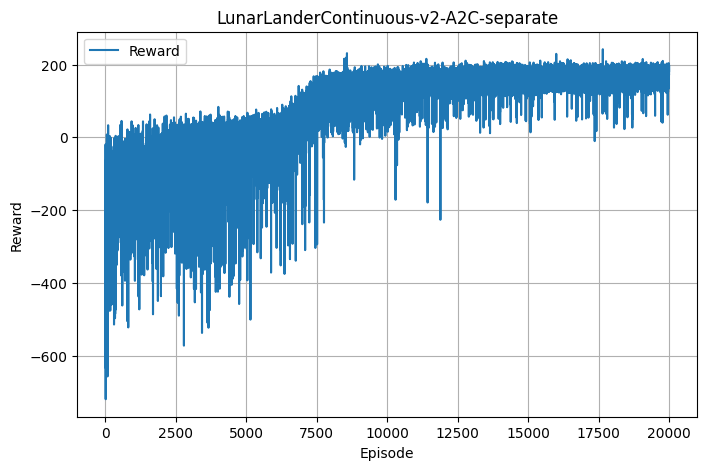


A2C-separate: 100%|█████████████████████████| 20000/20000 [4:58:11<00:00,  1.12s/it, Reward: 183.01]


A2C-separate: 100%|█████████████████████████| 20000/20000 [4:58:11<00:00,  1.12it/s, Reward: 183.01]

In [ ]:
# A2C Separate
df_a2c_sep = train_a2c(env_name, variant="separate")
metrics["A2C_separate"] = df_a2c_sep
df_a2c_sep.to_csv(f"results/A2C_separate_{env_name}.csv", index=False)

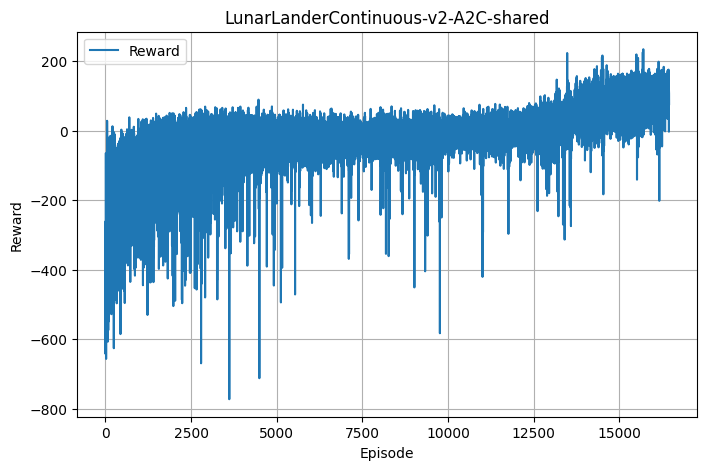


A2C-shared:  82%|███████████████████████     | 16460/20000 [3:11:23<54:20,  1.09it/s, Reward: 76.99]


A2C-shared:  82%|██████████████████████▏    | 16460/20000 [3:11:24<54:20,  1.09it/s, Reward: 136.70]


A2C-shared:  82%|██████████████████████▏    | 16461/20000 [3:11:24<56:49,  1.04it/s, Reward: 136.70]


A2C-shared:  82%|███████████████████████     | 16461/20000 [3:11:25<56:49,  1.04it/s, Reward: 93.08]


A2C-shared:  82%|███████████████████████     | 16462/20000 [3:11:25<55:33,  1.06it/s, Reward: 93.08]


A2C-shared:  82%|██████████████████████▏    | 16462/20000 [3:11:26<55:33,  1.06it/s, Reward: 163.67]


A2C-shared:  82%|██████████████████████▏    | 16463/20000 [3:11:26<54:39,  1.08it/s, Reward: 163.67]


A2C-shared:  82%|██████████████████████▏    | 16463/20000 [3:11:27<54:39,  1.08it/s, Reward: 115.01]


A2C-shared:  82%|██████████████████████▏    | 16464/20000 [3:11:27<53:42,  1.10it/s, Reward: 115.01]


A2C-shared:  82%|███████████████████████     | 16464/20000 [3:11:28<53:42,  1.10it/s, Reward: 73.81]


A2C-shared:  82%|███████████████████████     | 16465/20000 [3:11:28<53:12,  1.11it/s, Reward: 73.81]


A2C-shared:  82%|██████████████████████▏    | 16465/20000 [3:11:28<53:12,  1.11it/s, Reward: 140.48]


A2C-shared:  82%|██████████████████████▏    | 16466/20000 [3:11:28<52:59,  1.11it/s, Reward: 140.48]


A2C-shared:  82%|███████████████████████     | 16466/20000 [3:11:29<52:59,  1.11it/s, Reward: 98.37]


A2C-shared:  82%|███████████████████████     | 16467/20000 [3:11:29<52:38,  1.12it/s, Reward: 98.37]


A2C-shared:  82%|██████████████████████▏    | 16467/20000 [3:11:30<52:38,  1.12it/s, Reward: 103.50]


A2C-shared:  82%|██████████████████████▏    | 16468/20000 [3:11:30<52:37,  1.12it/s, Reward: 103.50]


A2C-shared:  82%|██████████████████████▏    | 16468/20000 [3:11:31<52:37,  1.12it/s, Reward: 128.81]


A2C-shared:  82%|██████████████████████▏    | 16469/20000 [3:11:31<52:58,  1.11it/s, Reward: 128.81]


A2C-shared:  82%|██████████████████████▏    | 16469/20000 [3:11:32<52:58,  1.11it/s, Reward: 136.29]


A2C-shared:  82%|██████████████████████▏    | 16470/20000 [3:11:32<52:48,  1.11it/s, Reward: 136.29]


A2C-shared:  82%|██████████████████████▏    | 16470/20000 [3:11:33<52:48,  1.11it/s, Reward: 135.23]


A2C-shared:  82%|██████████████████████▏    | 16471/20000 [3:11:33<52:34,  1.12it/s, Reward: 135.23]


A2C-shared:  82%|██████████████████████▏    | 16471/20000 [3:11:34<52:34,  1.12it/s, Reward: 123.46]


A2C-shared:  82%|██████████████████████▏    | 16472/20000 [3:11:34<52:21,  1.12it/s, Reward: 123.46]


A2C-shared:  82%|███████████████████████     | 16472/20000 [3:11:35<52:21,  1.12it/s, Reward: 82.86]


A2C-shared:  82%|███████████████████████     | 16473/20000 [3:11:35<52:14,  1.13it/s, Reward: 82.86]


A2C-shared:  82%|██████████████████████▏    | 16473/20000 [3:11:36<52:14,  1.13it/s, Reward: 127.46]


A2C-shared:  82%|██████████████████████▏    | 16474/20000 [3:11:36<52:16,  1.12it/s, Reward: 127.46]


A2C-shared:  82%|██████████████████████▏    | 16474/20000 [3:11:36<52:16,  1.12it/s, Reward: 116.90]


A2C-shared:  82%|██████████████████████▏    | 16475/20000 [3:11:36<52:25,  1.12it/s, Reward: 116.90]


A2C-shared:  82%|██████████████████████▏    | 16475/20000 [3:11:37<52:25,  1.12it/s, Reward: 116.74]


A2C-shared:  82%|██████████████████████▏    | 16476/20000 [3:11:37<52:25,  1.12it/s, Reward: 116.74]


A2C-shared:  82%|██████████████████████▏    | 16476/20000 [3:11:38<52:25,  1.12it/s, Reward: 146.73]


A2C-shared:  82%|██████████████████████▏    | 16477/20000 [3:11:38<55:07,  1.07it/s, Reward: 146.73]


A2C-shared:  82%|██████████████████████▏    | 16477/20000 [3:11:39<55:07,  1.07it/s, Reward: 145.81]


A2C-shared:  82%|██████████████████████▏    | 16478/20000 [3:11:39<54:21,  1.08it/s, Reward: 145.81]


A2C-shared:  82%|███████████████████████     | 16478/20000 [3:11:40<54:21,  1.08it/s, Reward: 85.63]

In [ ]:
# A2C Shared
df_a2c_shared = train_a2c(env_name, variant="shared")
metrics["A2C_shared"] = df_a2c_shared
df_a2c_shared.to_csv(f"results/A2C_shared_{env_name}.csv", index=False)

In [ ]:
# A2C Shared + GAE
df_a2c_shared_gae = train_a2c(env_name, variant="shared", use_gae=True)
metrics["A2C_shared_GAE"] = df_a2c_shared_gae
df_a2c_shared_gae.to_csv(f"results/A2C_shared_GAE_{env_name}.csv", index=False)

In [ ]:
plt.figure(figsize=(10,6))

for algo in ["REINFORCE", "A2C_separate", "A2C_shared", "A2C_shared_GAE"]:
    df = metrics[algo]
    plt.plot(df['episode'], df['reward'], label=algo)

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Learning Curves on {env_name}")
plt.legend()
plt.grid(True)
plt.show()